# Landsat 8 to Sentinel-2 using Pix2Pix

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Export training data](#Export-training-data)
* [Train the model](#Train-the-model)
 * [Prepare the data](#Prepare-the-data)
 * [Visualize the training data](#Visualize-the-training-data)
 * [Load the model architecture](#Load-the-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize the results in validation set](#Visualize-the-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Results](#Results)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The Landsat program is the longest running mission for the acquisition of satellite imagery of the earth. The images acquired have opened multiple doors for studies observing the earth. In 2015, Sentinel-2, with 10 m resolution imagery, further enhanced our ability to study and observe the earth. Now, with the advancements in deep learning techniques, there is a need to revisit historic images from the Landsat program and increase their resolution to perform studies at a higher resolution.  

In this sample notebook, we will see how we can make use of the Pix2Pix model to convert 30 meter resolution Landsat 8 imagery to 10 meter resolution Sentinel-2 imagery, thus allowing us to use Landsat 8 imagery for processes like precision agriculture.

## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, Pix2Pix

## Export training data 

For this example, we will be using both Landsat 8 and Sentinel-2 imagery. We have exported this data in a “Export_Tiles” metadata format, available in the [`Export Training Data For Deep Learning`](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool. This `Export Training Data For Deep Learning` tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

- `Input Raster`: Landsat 8 imagery
- `Additional Raster`: Sentinel-2 imagery 
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: 'Export_Tiles', as we are training a `Pix2Pix` model.
- `Environments`: Set `Cell Size` as 10 to convert Landsat 8 imagery to Sentinel-2 imagery with a 10m resolution.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAwAAAANWCAYAAABJVutkAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAFiUAABYlAUlSJPAAAP+lSURBVHhe7L0HWFzZdiXctp/9HMZvPA5vPJ75PfaMxzMOM8/P9utu5YQSyhJCAiEUkJBAICGhCEiAEigByjnnnBMogAISOeecc6xEVQHr3/tUFRSoUGo1rVaf09/61Nx77kn33LX3Oqm+ggwyyCCDDDLIIIMMMsjwkwlSAMgggwwyyCCDDDLIIMNPKEgBIIMMMsgggwwyyCCDDD+hIAWADDLIIIMMMsgggwwy/ISCFAAyyCCDDDLIIIMMMsjwEwpSAMgggwwyyCCDDDLIIMNPKPQoAOobGqBpaZGQkJCQ+JGht4KlvCUkJCQkPm9wkAJAQkJC4gtDbwVLeUtISEhIWEaLVou29na0E3+aQ9/aajH+9wUOUgBISEhIfGIwyWt1OvGv6f8ZluJ+H+itYClvCQkJCYk3wTagqroaFy5exJ49e7Bv3z7sP3AA+/fvR0RExAfbiHfZFb7H9sfSPQ5SAEhISEh8QjDpPnnyBN7e3vD19cW6deuwevVqBAYGIi8//4NGekyjRT2RvE6vF/e7k3xvBfM8LYLKhTYd0G4G+luvtRBX4juD+4FoYz0JTwv3JSQkfjgwXxcVF2PDhg04duwYrly9Cj8/P8yZMwdnz54V9y09Zwn8rVfX1KCurs7ic2wzxP36eosigMMnEQB6Jnh0RTsRkKW4Et8dbW16QfI6C/ckJCR+WDAZ37l7F1u3bkVsXBzu3ruHRYsWYc2aNcjOzn5vAcCkzTz8OioKtbW1b5A8/11ZVSXuNzU3dyH53grm5ekOPfOUSoknKdU4F0eIN/x7IaEOJRotWqUI+KRoofZsbm7C/ehqPClWQNEiRYCExOcE5uzikhJs3bYNRfQv/33y5EnMmzcPFy5ceIPj3wYe+NlCNmbd2rUoKCjoYld09P9JyclYsmQJTp8+bZGrOXwnAdCi0wJaNR5HFmHO5UIsvGrAvEuFOJ2rQIschfjE0FIHUeDW4yJ43i1DSjMZWWlEJSQ+K/DICwuAo8eOCS4tLCwUROzt5YXsnJz3FgAcLzcvD3PnzhVTxMzJppkANhQ8lRwSEiKMR0VFRZdZgt4Kpvy6gweACrIqsOBYBv5oeTS+ciW4ERbxv3EYf6sCuUriM8lfnww6sscVZcX4uzmv8e21ClRpdbJ9JSQ+I5gLgIKiIjFoc/LEiY8SABz32fPncHN3x8aNGztEACMxMRGrVq/GipUrkZyaatHmcPhoAcBko8grx4CQVPzpmjh8tTK+E8vj8Ie+aThSqIJeZ/l5iY+BFm1tjfDdlYg/3ZCJh/X0tyR4CYnPCiYBcOToUbG5K4+c+I8RAGwclCoVLl2+jAULFog1o42NjWhtaxMzAtu3b8dCFxfcun0bao3ms5kBaCXnPy2qAH+3LhZfrUnB6shqRBc3IjK/Ea8KGhH2Oh/9g3MQ0Sj561OCB9uUKiUScxuQWq2C0njNUlwJCYnex6cUAAy2NRHPnsHNzQ3+/v4oobTT0tKwatUqLPP0RHJKSpeBIXNw+CgBwKM7+aml+Od1cfj5pnS4PK1Bg1aDZpUGTWoinaYGbDifi+P5SjkC8T1AqaZ2prZWaSzfl5CQ+OHwqQQAgw2ESq3G5StXhAg4cOAAcnNzERwcLJz/23fudMQzf663gnmeDG2bFg1Zpfg/PrH4632FiGpoQRvZi/bWTrTpWqBg/ur2rJhRNl9KSnHN73eJx+vcTfF4OWQ3O8PtwffaKa+Wlq7p8jXzuDq94TrPprYZl7Oax3mjXG9bfvlG3DdnwdvNl8xSWpZmcfWtZnEI3ctsKQ01XW/R8rVWkLIS+fI1val+9P/cN7s/Z56uAd3al96f1liv7uWQkPjSwd8M8/jbwvty+qcWAPw8PxPx/Llw+HnfGe83W0O2hp3/t5WLwwcLAC2RgaK6Bo6b4/DH23LxqIYSIqJmsjFHG117g1zo71YmLiYXBpFUTwJBEKApHqH1DeLh0XB6MZw3OcLm6bJA4TJ0xGVjwGnoDTMXIg49pzWL0/rO/DrRPW73emqZcM3us8Ezvy/iUDnazeKY2tB0X0d1ME/DnHiFkaJrpvILY0d/t1H92NiZp2spb0aX9LktjO9GtKeF+BISXzKYKE3HsVmCpY22PeFTCgAG58szAZevXhXpeBLRe3h44Dbl0X3k34TeCuZ5cjlalY1YdyQJX61Px70KclR74J/uHMN8r6tpwIGIUgQ8LkPAo1JcyVOK2YQu8ZijGppw4oUhXuBj+vdFNcrIBrQT/3Ec5rLa2nocelCG0HIVvY8mXOB4TyhdQmQNcZ8xrl6rQU5eFbY8rUJGowYJSRTvYQWelCuFM9/apkdrbQMOPTPL72Utaqiu3blV2Kz6BoSEUz5cB4obFF2HeiqPqC89A50GkYnlVD9DHXdG1aBI1ZWn2bnPyagQzwcayxxRqTHaSuJ3ivss1lAeTiPoZRXSGsje0vXGxgYce1iGWwUKqKjt9HoNsnKrEPywEpktGtRU1GJ/KD1Lz4W8qka+oqtt4TK261R4GGlMn3C7RIWmqnocoDI/qVDRezaLLyHxBYO5vKKyEmFhYbj/4AEePHz4BniPV3pGxnvZB+Z+3re1bccOlFVUCA7lNfosAC5fviz+tvTc28D5crpnz53DAmdnuLi4IJTKyzbLUnwTOHywAGglwrx9Lw1feaUgOF3R4yhNd/AoS2tjM/bczMGAA9kYdiAL9jfKkNJEpGkkYxGPSLdNqcSZ+7kYSPFGHMrCgMN52J3aiFZyVg0jLywcGrHrXA4W3qtCLRQ4dyMXIyjNoQcy4fmiHg0tRsecGkdZVY15x3OwJakRmWklGE9xFtBz5VT2Ni5XswKH7+R05nckD0cym6gBO51shnDsm5uw606eqAPHHXS8ADeLFUS0/CKofYh0cxOLMYrujTicDatD2difrRajYCajx4ainEh5/olMDKH7XOYlEbWoVhsdcSpXckwRxh7OwnBKY9jBLGxLUdA9JvRmnKa6OlwqQy4Rt56uNTbUYNn+bAQkNECpb8DGY1kYRunysyHpKlE2Ux2EQGgjI/SyEOOpjEOpzaberkAeGdUDF7Pg9riKjKlcmyvx08LTp0+xa+dO7N27F3v37euCnbt2CXLlExXYIFh63hwch0fmDx85IriUT/5ZvHjxB28CNgc/w+v8eWqXZwLWrl2L+vr6HkeMeiuY56kjXqsrqMbwDdH4t9u15JCa2QbiE/7bHMx1fK+1rQWZmWWw20LCYWkMvlpMcI/GH2xMh39CEzmkhnTYSU5PK8WkoGT81jKOY4y7NAG/OZqHm6UGwcF8l59biL+eF49FESXwPJeGn/P+A45L+G+783A4u1kMdkCnxt2H6fhqeRq2heXjH9dRPOcELI2vJ/HWgjji8rHbjOUy5bcsAQNO5uNhh8DhQRc1XscVYyrHXWKMx/G903G3VkNmkjm1AduOZ+K/ecUa7lEdv/KMx6BrFShoMnB5a5sS9x4X4Ndrjc+LMsfC/nmTGInX6Rqx+2wW/moVPcv3uV7eyQjJUpFS1aKivAT/Z14sbJ/WkFUkewUVbtxLx88XpGBveinGb0swPMPPLovHgMvlyGzg8vE7InvY3AC/sxn4s2UUx1iHX4RkwfVSFv5uaSyWJTULG93xXiUkvmCwc82+8Pnz58VeLCcnJ+GsmzB79mxs3rwZBYWF7xQAfL/GuHTTc/ly7AgKwr79+8Wo/cKFCwW3h4aGoq2tzeLzPYFtQ0pKijhtzmPpUizx8EBAQAAKi4reams4fPgMgFqFjXti8F8PFSKZnPfO0QN2LIlwTKPKBNOIDE+h1lSUY5xvPH7fJxG/3JCMv1yfhD9aE4+/OVyEpDomP4pHBFdbUIbB6xPwe6sT8KciXjL+bF0ifndVHMbdrUGNRiecWL2+Fk5+8fhVSDaW3czE//RNwn+muH+xNgG/vTIe/+t8KRrIkeW8FcWl+J+r4zHqSA4m7knGHxFhWp0rQwmoXDml+JbK9XtrEvBn5vlR/KmhdWjQcn7s/GtRXFAKK594/I5XIv6M4v0lxf/DVYmYS867gsRBGznnRy+n409XxOFP6D6X55frEvA7vqlYG9ckjF6bXoOU1EL8iur+Cz9DmTnO3x4tQnYjGSQyAFcfZOMvqb5/5m9I48+pTv1vVlMHojzaGuAdlIC/2piHhFY2itRmNWX42jUONpdzYXMkBX/NbbEhCX+4ggzN2hSsiG4SooI7YHuLAiduZOAPl8Xij435/1d6F78ksTBxbTT+9WQxcqiN5QkdEj8V8HdRTs71LnL0meTnz58PZ2dnASf6e8WKFYiOiXknwTN4xJ+Pdlu2bBlWrlwpHHWekuW/eeR+NYkAzut9hIQJ7OSz+AjasUMQ/CYyODwTsI/ECvO0JRHQW8E8T+HIpxbj/xL/LSXHnbnXdE+pVCGvUoEsE6qVqFFqhDNZX1mNyRti8fMNmbhY0ISSBhXKymvhspO4fH06ThRQuxJ/1VVVYCQ5z7+9IhUbkxtQRPGKCU8i8vDLFdH4m30FiGqkulM5CvKL8C8e8fjv5JBPuVeF/FoViupVeEFx/+OKGPwN2a+EBuLbVjUePsrCH/gk4F8CMrCfhEFJrRL16haUl5Zi4KoY/Gx1GjnYDSim5zm/B2HZ+GNykP/pGNkuBds9sg35ZRjkQ3G9UhGc0YziOiUK61S4dDcf1yo05LwrcexSKgmXBNg+qEJBI9WxToE7T3LwC89YjCVbo2nVo7m4ClYbY/EXp8tQSs8XUrkzc8qwI6pRzOwWxhXgP5LtGP+4FpVUlpIaBZ4kluJ8hoLua1FZUYp/c4vHrGc8LGYQAHdCs/DnixPw1yHJmE3CoLRRjbwKat+geHLyk7E+tRFanlnRK3D0Iokh9zgMulqOLH4PVI+wxzn4j97x+NnyRPimSgEg8dMCczXPtF6/fh1uixbB1dVVrLlfuGABgoKDUV5Z+V6DOmw/+EhOtg+3bt0S/7J92EM8fu/+fVy9dk2c6PYhA0Qm538l2ajlhJTUVDx/8QLuixeLI6j5yNG3DRJ9kADgCqgUtZi2Ng79LxFBkdNrWv6i5ePekqpxPLoKJ2OqcIL+DS1WUuMRySoa4LaLnGr/dOzJaCIjScREJJ0UXUCOeSz6kGPPo+u65losDCbSX5WCVS9rQVRD8chQNjTD71gyfnt5AtziiQgpTb2uDm4BCfjZmkSMu1WGAiJiYlnoaxuxluJ+RQ798gTDDIWipAz/zycWf7IxDdviGtFCaba16qBtqMHMLURsa1LhF10HJedHJKuiNFYdSsJvrUjEypRmMfLS2lgH+8B4/NyblFZCPVQ83UvxK/JrcSeb2orETmRkHv4zGb/+l8tQRc9wHmisx2Kq08+3ZeF2OTV6ixohR+LwVUgeXpHwEWJJ04zQ9DqUUR00lXVw2BqDPz1TDgU77JRGW1MDrhBJq0j4GDYBJ+G/BuYhySgA6mrLMXR5HLVvEqzvV0BNHZYyQnxMPv6OjMs/HixCFpWHZ1piY3Pxlx5x+IfjRchUkWHi/Ovq4Xk0hYxBHL45W4I8KQAkfmIwOdkHDx4UozFM8C70r5e3tzhO7X1JmdPhZT5M5PEJCbhy5QrWb9iAyFevEBMbK643NpFz/B5igsHp8RR0cFCQWPPPS4uaFQqxJ8CZDND+fftQW1f3hqDorWCeZ1u7BgkJ+fjbxUnYkNUkBk34Og985CXn4T+4RhlHtWPxlX8qdmYoiX+0eHovDb/nl4HTRWpKsZWgN/xbXY7/sS4RU5/WCpvx9E4qfpv4d2MScTIMswjsjDJHRjxMJ+c7Cd4JjeJeQX4xfkX5/Pv1CtQybxrjMgc+vJOGr3zTcCKP7AOV+eHjLPzcLQ7zXjfSeyY7pDPMNty8mozfWZuG3ZkcrzM/tgd3bpIzT2XZkd5ERdXgzOVksg0ZOF6opHbojCv+JdumyC/Hv6wn23Czxlg/Yx3J6uw8l4LfCc5HmVaHqkyKty4ag67XQiPu83JUSoP4mGdY4p+SWCHbtjKGysRpkPjgPHg2hfPrSQD8R2qLwaG1Ir6oA5UxL7sI/0zXpzypg6qNxEchiY9NMfj/jpWhmuKIfDmuToXL9zLxH5YmYK0UABI/QTC/8l6s6zduwN3dXczC8j6ssvLyD3LYGZwW8zqnx3u6+AfAOPD197ULDI7PtokHqHj2wGSn+Ho4pcmzzuvXr0d+QYHIr/vzHD5CANRgmk8cBpgEAN9jR7WuCiN9idxdOkl+yD0inHY9ShMK8dfr4uEcycRNpMRTr2K2QIHAUyn4RXABqojcSpNL8E/rYjEmtB5tROKm5Tdauqcpp/Q3x+NvjpeimR1yEgAuG+PxX9iRZuffNNvABF5cjn/2jcegG5XQkYOrLC3DP5Ij/O9nS1HEI/VMlpR/flwR/nZtLKY9NRgNU346IkNlSQX6rY/HP58rJyLWIfdVHv6TdyKWRDYR7XYuDWIjx/sdWpsU8DsQhz/bV4x8FdeNysT1pNjleUX4i9UpCEimfHRqBB2Jx+/6ZeF8KRs8A9HyEiEmeEU5CQ0SAL8MKkKixpAGEy7fN+x7sCwABnkQcZ8oQraKjR2Xjd5JexN8dsTjL4Nz8LSWyqTVYN8xEjHbchFaRR2A0uY6aLhDVldhILX9v5+RAkDipwkmSZ6iZVLm0X+ftWuRmJT0UQTPz3BgEcBHdfIafj69h6+/L8lzOuzcd9/wy9fZePDpQCxW+NckP4ffAeAZgOy0YvzLyhjYP28UdoGvs3NaV1WHwxFl2PmiAquOkcO7PpUcaxVxkBKb9sbjj9anweZiEVyvFmDBFUYhFlzNxv9aEY9hVyrQCDKWxxLxX4jLnjfoiF7N20mL+ooy/DM5qI5Pa0BvEkX5RfjHRbyUh+wYcaxp+SXvA8tKL8B/W0JiIYl5X4PQR5n42XISBCUKej+GMuu0SgTsi8d/35ePuGZ9l/x4/1RZYTH+bkki3KPqoW5phmtgDH59vgxFGv0b3Nna3oKYl/n4m9Ux+NejBV3q6HojH6NDkvD73pl4rCCXv0mJXedIXCxPxLiL+dj8mmeh9YLT+f02V9RjTlA8/sAvFfaUzpFMpZh5f7sAyMR/WpyME5WqjgE7FiXVxdWw9o/CgNu1ULbqkZtagl95xcItrlmIio7y03tNSyzC/6F3sSZFCgCJnyZMvHvixAnxQ14f4/ybwN+yQqkU3B0eHv7O9fqWwM/wciKeXWY7Ze7kc/osAniQiJevdudqBocPFAAtUCsb4BYQg789UiSWAJk2L7VQw2SXNiK2pBmR0cX4v/5xGPqgjlIign2YhT9fGYu/2JyGv9+air8z4n9tT8EvvePwhz7ZeNWqQezLPPz1qgRsz1N3pGsACwZyfHeT47slH8lEwCABsGBDAv7vwWIUEsELIWKMy+LAyT8B/+9ICYqIBDUlpfj71fGweVhNZsTg6LcRKUc8zcF/WZ2IfUUaIQq65NfagOXbE/G3IYXIozrcuJqGvyDSvcEbyLoRvDBA1SSMNsTgZ77JHfUz4X8EJuIrMkYuL3hUR4eS3CpYb4nDH/sn4x93Z+EE1ZfblsEE/fpVIf63L4mJDcnof7oIz3gDGOXBS596EgB9FsfDNrSaDGWnOOFNYcdPJ+JPt2fjQSUZA00TFm+Jxa9OFSO3u5OvbsDigFj862kpACR+umBC5yU6vD6TR+0/hphNYIeflw5t27ZNHN/5vo6/CUzo+fn5YsSp+2k/5iKAR3oqKyvFNdOzvRVM+YkykVPZXFKN8YGx+KeLVVATT5sc786TdPTIDM/CzzoEQBPW7kzAV+Rc/tYqs6Okjfj5ikSMvFyBanJnt+xNxF/vzEW0gnjQjJ+YfxvqK9DXnTieOJBnck0CYEkcOejtneXQE2fm5RXi/7gk0r0GroFBAHin42JJ56Zj3mO2akc8/v5gAVJ4k65ZfiwAKsjR/rVrAua+qENjSz0c/WLRlwfFtG8eCsEzI8/Dc/H/kQ38rW71Y/y2Vzz+w7os3GtSG/JvVuJ5WiH+zTMWP1+bhL8PzsaFUrpH6XIbK6gvnXmUjb/yiMUfk70ZeLwQr3npE4mXngVAKi7WdxUAjWV1mBwQhYEkAFQkItISCsjJj8Pq5K5OPguAlPhC/P1yKQAkftpgjmXfmDfyWhpVf1+YBMDhw4fx7Nmzj7IznAafKFRSWtqF+033GDz6zzPIvH/U/D6Dw4dvAm7R4NLVZPz2hizcKVd3jiKTc6pnx5wIXl1QgT4b4zDkPguAFjwOy8ZfrIrFX+/IxDe7M/C1Gb7Zk4mhJCZSWtWIfJaLv1qRgK25lgXAWhYAW/ORyvkYBcA/kwAo6CYA2lU1mML7A0gAFBMJCgGwJgFTw6qhIWNgEABqhFG5/vOqROztQQAsJQHwP3YWUvoqXLqUhj/zTcO1akq/G8ELA1RTC7uNMfh9Mmz/tvvNev5bSDa2JjZAaZyCbdU34djVHHy9PRV/siIW/a6Uo1jN99j4aKFW1cH7YAb+39Zk/D4ZR6eXZMh49sKiACgzCIBHLAA6ZzJ4FOf0uUT82Y5sPKxiAVCPhZtIAJwsQba608lnYaFW1WOePwkAOQMg8RNHC5FpT6frfAhYTPDpEHy8W3O3Efr3BZeDZw9MhG5+z/Q33ze/zuit0CVfKg9alNh3IQ0/W5mKI6VKitHVIeZZztSnJgFA94kPD59IwC+CcvCIuJV5mI845iOlm1X8LqiOGnpOp8T+o4n4g82ZuFhK9aPnTGnyST1Fyfn4T6uTsDy6Ae3EgYUkAP5pUTzmRdVTCQz7uDgu26snfIiFdxr2ZTVDLAFiAeCVjgtdBEAzCY54/GJrNu5XsT3ozI9H3NOjc/BHq5OxMbkJOnUj3AJj8F/2FSKpmXjWOBvNMJ1mlxtfhP+5NgYzXynEfUP9jMc5U525fGquJ9s2Sl+c6EZiIjO1FF+TuPjbw0Uo5JOOOD0qC7epWqNF+JMs/JKEk82DKrItOlS/RQCcr+sqABpIAEza3CkAspKK8Y+rozHiEQkjs/ZlkfQkPBt/4pYAH7kESOInDna2uzvcHwsexGGOt3TvfcAi5G1ChG1QT2Xl8MECgJ38gqwy/Joc+t9cLkMFkZE54fFyHWV+BfptYgFQSynpkRtdgP+6Lh5zY9kg6AUhdoD/JqJqI8LJjC3E//KOxfB7ddAZHXVOU9fKS3IqMYyd14uVULADTQJg4YZ4/Pdd+UgkZxZGwcDLd2qSCvHnPvEY96CW/tbSs0YBENopAPR0PeVVPv6bVxwmPaoHNVNnfpRGU0E5vvWPQ9/r1XSnBS8eZuGPvBLhEW1Yf2oyKOz88xIgbWMzVu+KwX8k0ZGvMdSpez15+pmf4w25fJqROM5Tr8bpG2n4YzImu3MU4h4bIS2LEHqmhd7DmkNJ+MWGTITzprX2twgAEjhvCICzZgKgRQGv4Bj8LDgXT/n4VuN741GllvIyccrDb6QAkJD4ZGDy/dhp4u+C3grd89WSMaouLsfgdTH4w4BMbIqtRSXzs3BGiRf1Cuw/k4Lf8uvcAxD7Oht/viIBE26Uo0zwnjF+mxqxSdXIaCbOJC7LJSf/r5bG4TdHixDdpDGkR2gorYXjDnLWt5GIqKPrxO28B+DXHtH4y505uF7C7WGIW5ZTiZEb2KEuRDIvHW21LACYO5Nic/AXHvEYeLIYySRGTGnUFFZjUkAsfkm25xWPvOs1uB+WgT9emoiJV8tRSHxqqm9hTg2SmyjNGnpmczz+OCQXdwqNdtBYz/LCOrwoVoh9ZEX0/y8Lm8keGfLiZbIb9ifhlwHZeKVuQWZ6DeK5jqb7ilqMI5v57blSlJLtra38OAHQrG+ForIGttvj8NWWLJwrMO4xIBSnlWHizkT87spErJMzABISXwQ4fLAAEEeF6ZQ4SU7rH5LT+X8P5uBwDhGacCaJUHUq3A7Nwi+WxcDqQR34mE1NUw0cAuLxs/XpCE4mF5WcXIMjrMbzlyU4n90s1qHrVfVYuisRXy1PguuTGtQQkTMRN9c0wvNAIn5rRSr2E0m3URl4E7A7pclTqONuVaFYyY44r2uswYygePx8bSau16nJ9+ZNwG8KAI1WB52iDs7bE/BbK1Pg+bwW9ZwfGYCGinq47knAb69Ow8kKFdVXB1VdFcb4xuHnPmnYktQAlTFuQWY1LqXXQ0VG4MGTLPyJZzz6ni9DCY8gUj5aEiY1VXU49qgcmSotVE2NOPWwFPFkfJiM2QA9eZaDP3FPxI5CBUqLanD8ZRU9TyKBR9S0zQg6nYI/XpOO+83099tmAN4iAB6wAKD44U8z8YeecfiH8yUoV1IcarO6/CrM2puKX/jE4mspACQkfvTorWApb32bBhkZZRjNe8LIafzXvVkYdcRwLPHI/Wn4xfJY/Ket2bhbrRG/2cIj6DuJ475aEod/3puJkca4VgfS8c+BGbhZazhus1WrwKkrafidRbH4/4IzMILijTyajd8EJOCr1ckISCY7IgZQDKcA/b8liei3Mxn/a2emSI/j/8qfHFyfFASlKaEnW8B7sh6Q8/4Vcf15MwHAyzF1mibsPUvlovz+dpcxP8K/biS7480zGAqyZYZBIHVTPbwOJlHcOPzT/iyMpPw4z38NIBtSxqJEg6z4QvwPz1j80YY0DKdy8zHRI49m4dcbkuAWWU+uthYxr/LRJyAZgw8Zyjtqfzr+dE08RtysgZr+u3gxDf+wI91QH8JQqt/PvJLhFct707SoqijFr1zi4MAn0xkFwO2HJE4WpeCcBQEwfuNr9LtVi8YWHdnPFsQ8z8Ofr4zB725ME++Mj7r+JjgFU87k4H97xcNLCgAJiS8CHD5cABB46lmrVeLK7Wz8jV88fmdFPH7fO0Hg5+Ro/7FvEv6aiHt/HpEsEY6WCLkqrwz917OzTU60Me7v+STiz/1TsTW9WZBoC5F8U2klxm1Jwu+uiMXPKM4fEH5GxPMHPslY/roeSiJocQwoCQCXTYn4+y2ZmH4yBX/IeXNcSv/31ibCI8pwCgWXlY8B/e/k9NrcrxbrQU0OMperrrAcwzcn0nOx+F2z/P5oXQrWxjWKdawcV5wtnV6Mf/flU4ooD4on6rA6CYuJvJU8NatqQvCFdHKwY/E7Xsb24DjeSRhFDnemmkVHPTx2kAFZbbj/+xyP2uxfzpaiUNWCioJyjPTnn9A33ify/8O1SZj4gAwACZH2tgZ47UjAX20wPwa0FP++IBY2D6rR0E0AnDgZjz8JzMRd3gPAMw8NTdhI7fXb1B589OnPKf8/9UvCzNByOAXE4d+kAJCQ+NGjt4KlvBk8k6lSNePaoxz8A/HxL8WxyEn4pW+GOFKzokkDpTGuYQOrEjcekpO5vjPufw7JRViFoiMec7lOp0FsTDH6bqF4fEyyfxL+8lABXlcoBd8z9zFXswDgPQDLYusQE1NAcSlvSvO/BuTgZo0SarZhFLedBEDEi1z8HQmSW+Vkr4x8bygX2zkNXkYW4NcBxnJxfkcLkVKtEsdWd9gSqoNKo8H90Bz87QZD3F8SrzpFNKCJ7BXHaSe+zi+ohP0OKos44pnLlIYlz2pQS/dF/Zoa4HMiFf95Hd+jNHxT4BlVjxrjgJCiohITthme5/t/uTkdh/KpjTQGvq+uqsBYsl38jKKd7EW7Co+f5eJXflm4Wa+iNAzlFXsAKuqxYG8CbB/VizJy/voWDXIyS9BvozF/Kt/u/GYkJxbify+Pf2N/gISExI8THD5KADBMS1kUjbVYfzoXU8/mwY4w+UQ+dvDGK3TdOMWnKzTW1GHTpRzYnKG4Z3Ix6VwRrhYoxPIfUzwmcZ1SiRP3cjH5tCHexEsUr8iwXtSw9MYgAHgPwD8dKkGlohEbb+bDhsox5UQBzuQ1i9EdEZdITVldC8/z+QhJpDqRcTCkYQATobZJgYN3cjrzu1KEe6Uqs/wM4NFyRXUDAq/nYArFnXoqB8ueVKNIaVznSnm1t6nxOLwQdlQWbg9bqusiXpvPI0WcBomcnOxyzD+Vi2l03+ZkLlY9rUI5Pcs/FgOtCmGvijGDrk+n+1NO5mFncoMQIrwsSK9X4PL9ArjdqkABpcX5NjbWwZfjJTWgmdrZVGY2ShHP8+F8pxQJ9Zy+oYy8FOhcWAGmURk4/S2xbADqMc83Fr8+XfLmBmEJCYkfFXorWMrbBPHDheQs8qi6OfgaO6Lm3CpG3C3Efe94xIWmeOYCwJ24je6KU9Q64r6RpuG6yZk3h8X8LJS/p7jM9+bxeKDL/L4hjlnelEb3NhP36bohj673DPe75sEixuTomz9jqX6ctmlWwITudeClWHcfZ+EXixKxMUsKAAmJLwEcPloAmMDkYlrLaAKvie9Ojqa44jcAzMDk1T0ekyD/Cm/P8Zj0jALgQDHyOI5ZfCborukZymg4StPsuhFM3N3zY4NiMS6lzT/I0hGXREJXYiXS5LX9ZmnxD8V0MQJMqmb3u6chNo6Z3edpcvPnxd4BKoPpGdM7MP+1YRP4p/N5na05yYv6mpeR0lIWluCvPOIw+FK5WEvaualaQkLix4beCpby/qHRXQCYnwIk8XbwJuRWsn0sOMTMjF6HloZ6uAXH4Sv/LDytUYv7lp6VkJD48YDDdxYAPwy6CQB2cC3Gk+gOlVqDRqWGRAqP7Bigb1HgOK/BXZUIt6h6cc3SsxISEj8O9FawlPcPDSkAPgY8sKXA2Rt5CEloRI1Cg5omQmMN3IKS8HtL4mB9rwp1FM/STIKEhMSPCxykAPgJgc/ATs8shE1ILo6mNyAssx6Pc6vFmtPfdYnGPxwpQmJz1zO2JSQkfnzorWAp7x8aYr9WXiH+u1Mc5kfXSQHwXiDeb1fi5p1M/MIjBl8tjcVXywj878pEjL1aipRGHboezy0hIfFjBYcfrwDQ12LO2jj8w54i5EoB8F7gE4kaaqrhtD0eXy2MwleLovGVK8EzCVOuFiGiukU6/xISXwB6K1jK+4cG81x1dS22XSvG9SIF1CQILMWT6A4t2lVNOPGoGCtuE+4Y/g2MqUcL2VjzfQUSEhI/bnD4kQoAXseuQlJWHSIKmtFIhC9HeN4PvH6zoqoRD1JrcTe9DvcIt7MaUUvkTyrK4jMSEhI/LvRWsJT354COvWk97PuS6AEW9vTxklBpXyUkvixw+NEKAB6taG3Vob2HDccSPcP0a5Od6DxlQkJC4seP3gqW8paQkJCQ+LzB4UcsACQkJCQkLKG3gqW8JSQkJCQ+b3CQAkBCQkLiC0NvBUt5S0hISEh83uAgBYCEhITEF4beCpbylpCQkJD4vMFBCgAJCQmJLwy9FSzlLSEhISHxeYODFAASEhISXxh6K1jKW0JCQkLi8wYHKQAkJCQkvjD0VrCUt4SEhITE5w0OUgBISEhIfGHorWApbwkJCQmJzxscpACQkJCQ+MLQW8FS3hISEhISnzc4SAEgISEh8YWht4KlvCUkJCQkPm9w6FkA1NdbfEhCQkJC4vNGbwVLeUtISEhIfN7g0KMAaGpqsviQhISEhMTnjd4KlvKWkJCQkPi8wUEKAAkJCYkvDL0VLOUtISEhIfF5g4MUABISEhJfGHorWMpbQkJCQuLzBgcpACQkJCS+MPRWsJS3hISEhMTnDQ5SAEhISEh8YeitYCnv90GLVgutTgedXi/A/28pnoSEhISEAZ+SNzl8LwLAVMieYOkZCQkJiZ8y3sabfM/SMz2ht4KlvHuCufHiY6bzCwqQnpmJrOxsVFRWQq3RiHsfWlcJCQmJLxUm3tS3tqKuvt7AmxkZyM7JQWlZmYij/Qje5PBJBYAgdypkU3MzCgoL8ToqCmGPHgm8ev0auXl5aGxshM5oBCylISEhIfFTgonclSoVyisqEB0TgydPn+JhaCiev3ghyJ6Jnwn+fXmzt4KlvC2By831i09IwMFDh7Bu3TqsZaxdK7COsGXrVty+fRvVNTUdRs9SWhISEhI/BTBvqtRqJCcnC9708/ODj5EzBYhDAwICcOfOHTGIwvHflzc5fDIBwAaMR3Uinj3DjqAgeHl5YdOmTdi+fTt27NghCunt7Y3AwECEkmGrrq4Wz1hKS0JCQuKnAOEYE8HHx8dj//79giPXr1+Pbdu2Cd4M3LJFOMv+/v64eu0aiktKBMG/a7Snt4KlvLujta0N2dnZ2Llrl6jf0WPHEPnqlRjJYqNVVl6O1NRU3Lx5U9gHHx8fPCAbwYJBigAJCYmfGkyDPXl5edi9Zw/WkD999OhRvIyMFAPplVVVKCktRXp6uhg02bp1q+DWBw8eoFmhEM9aStccHD6JAGBHnqdxg4OD4UvG6iYViEetamproVAqBZGzOOA4Dx8+xEYSBps3b0ZCYuJ7FVRCQkLiSwNzHxM5EzuT99lz55CUlCSuNRNv8pKYhsZGFBYV4dnz54JfedSHZwf43ttEQG8FS3mbgx34qOhorFmzBkeonuz0s71gmISMabSfhQLbi8ePHwvRw/EbyQ69S+xISEhIfElg2xAbGyt4kEf+2elnfuTrzJVt7e0dHMr/z6tuwiMihB05duyY8L3f5Vtz+M4CgAvBjjwTPI/s8BQ2Z2wqrKnAJoJncOEuXbqEFcuXC8P2roJKfBpo9Wx49WixcO/tIDXa2ga9Xo7GSUh8CjBvFhYWihFvHuXPyc3tIHPmQ3Z62cnntZ28rLKdOZlInp3j1atX4yLxJ6fTk3PcW8FS3iYw17NtWLlqFe7dvy8GgrjefM/k9PP/cz1Nz5jsBBs8nvVgccRT4O8lArSGJaicR3dotRbi/4jQotNbrFcHRJ+x/Oz7Qk3trNZYvvdW0PtTqwmW7n2vYLtkoS0In9P7bumxX36MLX5/MHe8mWerWIJtKf5nA/rWub10up+m8Gf+T01Lw2ryqW/cuCH4kTmR7zEP8qAQ838MCQQTL/K/bDvy8vOxafNmMXjCMwEmjrUEDt9JAHBB2XCx83/z1i1RUJMzzwViwmdnv6Gh4Y3nuGA8krVy5UrExceLjmkexzJ00BvL90Zo+3GLiBZyztnIvy20tX78h9uiVaOqMBvpWYWoV2s/jHg0zSjKTEV2URUU9A6+T9LqCiKCNsut0k7vu/fK8S6Q00Ifn6XQRiRv+ZnvjhZdK9qM+XQN7dDrLD/zecDwXvm/H7tj9jFg7qupqcG27duxd98+McrN/Gcicy39y8skt5AwKCou7rxudI6TU1IE5969e7fjXnf0VrCUN4M5npf2sBN/5epVUXaTMeJ/2YixKDh/4YKI170e3B68j4zFzr179zoMYI+gfqRsqkVhXrbYHNcFuXmoaFBRHhae+8GhJe6gL/at3K5BfUUhsrrXqwPZyCooRb2ChZKl598OdhTrSyLhNWUMvE+9RAMZ2ff7LrVkj3XIfHoEc8fY4mh0BaXVe86lStmIknwL7zsnFzUq7p0fyS/ksDOvtuktf1sfAn4fiqZqFGS/Wc6cvCLUKSmOhee+M8je15QVvpFndnYWiqqa0Er1a9VbeO6HBrWXSlGPotwclNQ0kaj87u/gxwTmxqrqarHW/9z5811403Sf94jNmzcPISEhqK2r63KfRUBBQYFYRsn2weSPWwKH7yQAWGHwGn+ecui+XpPFwFUifl7HylMZ5vcYTPgMjsOVZaHQkzEzgJ3WesSHXcPFy1dw+UonLl26iPvRuVBqPs/O0iIYvq1HMuLRnabiZNy5cRmXutXNgMu4cOU6wtPKybH7mDrqoGuvw6U1trC2WYlXtW1ofU8HkUcvVM3pWD+xHxx9z6KI+o3+Y0j1g6ElY6JETlQorly+1KU9Ll48j4dRmVASi7V/JIlpDVb3EzigPJJZg7gHt6kfXjYr52VcvHANz5KLoNB+erHSQsapvjwTYdcvdP0eLl/GlZt3kF1PH3H75ySSTDC81+zXD3HzTgSKmongeqU/fV44T+QeEBj4xlQt8yQvl9y5cyfmzp2LR48fv0Hi7Ay/evUKq1atQkpqqkXnuLdC93xNYC7nvsj7wdjZN+d/rg8PGDk5OQnb0dMIP8d79uwZfH19xd6Htw0S6aivF8dfw6Jx/dG//wD069fPgL598O2Q0QgKLSWP5zOzD1RnvaoOKa/C8DytgpydrjbSABLLLSo83OaA33zTR9Spf/+BGGo1HEMHD0R/ruO3v8GvbZbhcUYdea2W0ng7WujdNNVk4eLO7bj0LBPNOhajluN2BX3L1KalqU9xaPtuPM2tp7R6p42FaCmOhI/tIAwYaGwHI/r2HwzPoIt4Ep2CBvoUdB8yGEL2Tt9cgdcRDxGd1/AOn+Td0LdrkRdzEnMGDED/gZ39si/1ywFWTrhTqPke7CnZ+7Y6XN8wF1aDB2Bg/862+fabr2GzaD3O336E3Lp2tH1m34S2VY/KrIdYYj0CPhdj0axv/wxt2PcH5jweMNkcECD86+79j3mU99nOnz9frPtnsdDdt2YRwHF4H66lwRUTOHy0AGAyZnLmNUeVxt3HpntskJ6Gh8PZ2VkIgO4qxQS+xqNfvCfg+o0b7xjl0aFFXYDd80ei/4CBGEgfvQn9+34D+8C7aNK8L3H1HrREiKWR57Hl8GXk1lsemdW2AZXPDsFmVH/0I+PFdRo0eDAGEwZxHYk8vhk0AktPxwmnrvvz74MWnQqFKVF48ToZVSpyuizEsQzqPOp6pL6KQHRaIZpaesupZNHSgFubnTC0f98u73tAv74YZTMbK9ZtRmimEq0fODOi02qQ++QEtp24g6Km9g8zEG9AD31bFnbNmkzl6m9Wzv749t+HYsXhp6h77xG19wc7PEWxl7Fg1Lfoa/49UF8ZNMQKs93XYP+1F6jRkAH8rL4JMrD0Xm9unINxNp54Xt363mL0SwBzHo/Q8Ag+z3x25zy+z3zJoztM8nwSUHcBYIp35MgRHDh4UAy+dCf53grmeZrAZeGTfLx9fMRm3zazOrLd4HovcnUVMxx8GISl+jFM9oE3RN+9d0/E68mY8fdQknAdbuOtsTT4LO6HhokNcYz7oY+RWtIkuJidXZ5h6fp8t+v0L8ft/H/DKJx4vstznRDPm6F7PC63KX0eVBFptZImqUrFVpdRcDsSCzXxhM5UBvNnWzQoTnmOe/epPtQf7lw/ArdJozHfZxduUN0ePriHOxExKKtXQy9GrS3Us0s93txE3qLlMWEKZjPpXcvc+Xx3GysGU8SjnWly/qZ4hvoy3q/9xHMiv57jm2YtfKaOgrPfftzidnjI7ROG+xeDMG1IXwwdZ4tNF6LQSA1r3had5THLz5Qu2WJtfjiWOQyH361i8X12bStj25rQ5d6bYAGQH3sCc/rbwOfgeTx4ZOiX9wkPwyJR2Ejl6Yj/7rRF2cV1U1xL+ZsEgBOm2LnjyM1HCAultnkYhscPLsFv4VT0/6YvnPyOIrZI+cZMR5f26al+dL0jjoX31FlO/n/zvtNDekYIAZAdBs8JY+B3Oe6dAuCNftM9TpdyEt7I33Bf5GGMa0jH0L7m/2/5+U8H5jc+1nO9v784QbMn3udl82wbmBctCQBuY7YJPDh/7dq1HgdOOHyUAOAMeNSGR3e6Z8AfDG8A5qU9vIaJp7B7IngGP8tqZcOGDWI0rHtlOkHX1YXY4zwBc9YcRHxJLarKy1BGDVZWVorKOsN0kU6QETl13V6Ujuf0TKPw1DnbeJmEmK7UiukwU2i1+EHR861dF1u0dv9odLyEp004kwZCNGzS4BBzaAEmum5ESoP404II0EKtaECFqE85KmvycXGjM6bOWIGH2VWinqV0vaZZS08b6iDqw/Xk8vK6TaqTkYdFaH9jxoHXF4sb0BmvGcpsFCUmA0CBl9d0PscwLLxqp/qwMeK1nlo9FaDdILjE/xtDaw8jCubtJ5bv0PvhHHt23g0C4M4WF2qHlR3tUFZeiZqydFwKXoXJVoMw2mExLr6uoH7XmU735VRdlgtpqS7kLDwNdoDN8j3IU4oYXZxkQ9uaAvcTy3UyQE/xs7Fnjj0cF+1HQm0VKkWfpHdWWo7qhuYu05jv7kfcM837EfUXC9PqYsQz4SoWjR2HjVejUVpZJfKsqKhAduQZLJw0BqOsrbFkzyM0aLqKNp5xMnsbPdTPsDTBFLovUeA0uO+I70x8T53h7cuP+L024u5WF9jO9EJkzdsFgNa8vSzO2GjJyBrvi8DfRNf7YhkZ92nucxyXvo0Wuv6hffhTgLmQR//5RByDsemaF1/jIz9Ddu4UJB8aFmaRP/kar5PnI+GYb/XdhERvBfM8TeCy8YY05nTzTbx8nU+u4Olpnr3IysoSaTBPdofJDrA94YMj2JjxzEhP9sEgAK5h0ZgJCHpcSL2ga2jlb0jVhKqqatTUK6Ax8TyVjTmtoaYcFXXN9HcLFM0NJGAaoKI+rmtRoJaeYUNbU9dA3ELfpnkfJD5ppb7VVGeIw6iurYdaZ+RmisPpNzXWobqe2oLSbK4nLqttgIKMdFXmS2xYQKLl0HOUU5619Y0WZ7LNOUnblAz/qaOx8mgEFMZr1IpobqhFTaNKfCMNdZRHXSNU9Cz37RZVI9Wps4z1SmpbM15Rq5tRW12LRqW6o024zFVUZt47xvapktuhphbNxCcdM9GUl1K0Vz0UGuNeDo0K9XW1qG0yCJJGKhdvbK+m8mjI5nT5hqn99PS9NZraj4Qjp99C76qmuo7+v3N/iDkMAuAlvCaPhvfZKKiNrSBCmxoV2QnYu9IGA61m4kxs5wAl86+qiXwHYztwfRRm9VFT2Utjb2HpzNFYfzWdxDjVgzhcRe+E351Oq0Y9cbzh+Spqb6VIuycn1SAAjmNWn1k4HldqLGBn6OhL1C7MO421xnIRaqgvcH8ztVdLixqN9fyOlfQdaA3vuNbwjs3zNAmAa+vnwm7eZiSL5VCm0Ep9tQqRp9dhxKChWLrzDip4lkTkQVza1krtQ+/d1D6UVytdM68f9wethr4Lqj/HqaT3qub9hR19gspJ7cbfmZaeVXP/EN9QFeqaDfuAemqv9xYA3ftNdQ0aVMTvZnaK/QBRzhrT+6pGbbOma7+nflZt7NPiG6F06ptU1IeVqKutQZ2C47dQf64h7qA+XN9MbW+wGaY0PhV45P7FS+KD9es7fGHmTv7XBG47PhraJAA4nokvTeC0BG+GhoqTOFUWBogYHD5KAHCGmZmZgsj5VAdTpvwvF4jXtrq7u4sTLThwxbrDNPLFBeNn+HQLXttkuv4mKA8WAPMnYL7faRSSL9xOnYU/PgbnrVM3IS/pBe6HxqGciMxUaf5wS5KfIOwFXW+gtBQliHr6EhnlTeS4NCIlIhyPnz7F4ydPkFlFL6KLA0yONZmTmpxEhD95LPYt8Ea81FIFxevc0NZUmYWI59EobtCiPj8Gjzj97Gwkxr3EIZ+ZmOLkidN3Xgj1llutedORoTQMdWmjMjXj/jZXcpC88bqOG5CMDHXs2qJkPIlMQq1Kh/L0ZwgNj0JeZaNwFHWqWiS/foRHT7h8jxARm456NTuS3AZMXg3Iio7Eq6QCKOkal7m5OpvEVxQK6qgzNBYiPNzwbGR6uXC8DB8eiRNVBWLDXyCloBoa+ni09IFX5iXgyetUNNKH01SSgrDHT6j9niK5RNFNQHD7taE6Kx5Pqf04/ZepxeQUNyHl5XMk5FRARWm++ZGbBMBCTHP0QRQvaaF0Te+bnb7K2LNwHD0Ys7wPI7uR+pRwmgFVTS5ePQsT5RH1SSsz1IdHJRrLEBv5FLtXTMNUFx9cvE/v5EUktQF9aNQmTHbFKRGiHZ9Qf3j8LBL5teTg9ugUUnlIAOwmATB36SkUi2J2ltM0YqBmgUbtUJUVJ9pB9CP6N71CZdaPWtBYnoHw57Eoa6L3nfsaYU9fIIPEbosZaTFMAsB1zHjsCMuFltqjo23IWdA35OHwupkYPnw6TifWdwhbLTnDmgZqgwjuK08Q+uw19Ucyn+Z7FYhc21rVyI4KN/Qnivcqp8boOPP3RA5GVQ5ePo1GYYMGek0lYun9P3r6BE8inotZlZ7b630FAAvEdtTlJyPiySPxHsOi06m/cXxT2tSmRM55CZS3eF/Uri/4G+TycxxePkGckByF8MQC4o9mpEeHIexlCn1DSlTlJ+LJqxQhkJrN+nBSMX/bbzrd3xX8zfEpN+wYc5syj/J103tjMP/xkhkWCLzOk39DhfnSPA6nw3zHzjULBdPouHlevRXM8zSB63Xs+HEcOnSog8+5fLyJee/evcJ4nTp1SmyCZhGTm5vbBbxWmY0115GfT0lJEafL8eiYydZ0R6cAGI9tD7KEQ9IlDjtYFYnwXzgZk+fvQJKSvkbqR1zW4tcXMdd+HPwvJJIbrcKrcxswdepGJJak49Le1Rj3bT/0H9Af1rZOOPK0AM1qyo/5m76TdlUN4l/dxErboeg/cDAGDRgAq/HTsZvKwM6DjsqBlnJc374I41aeQUbUTXjafo1vJ6/DvfMbMXToEIwYZY2Rw4diQJ+vMdVjO1LoU+tJFLMta6qKhS8JgOUHH6FGR4KABw2a07FrqSMcg8KQEbYfjmN+gyGzdyGfnmmsLsKVLU6wGtwXgwYNwsCBg+C4/jRSSpug575EtqUy5yrmj3bC8Re5oCRFmW9sd8PY5adRmfUSO5ZNx7d9+2PwiHHwOfkcFQ3k+NK7aIMSsVcDMXWyD15XNIkBuNb6OGxwnoFFh16iIuYinKeNRp8+fTHCdgEOPcoUzrTB/tH7JbuUGH4RSyYNpvYbhAGDrbDsSBjCrwZjztjFeFjBvxv0JpeYC4A1VJ76LrOshgG+8ljix8lDMTf4sWEZpk6NcuLfba5W9D4HYfCggRg4fCx8Tr9AZaNaLCdNPucllhCNHG2NEVZDxPKqORvOoURJ6atr8eJsAKaN/paeHyyW1ox32YD7yRWiHbuXkdEpABxx+FUeNDzg0D0eGa12ZQVePDiFReMHin7EaY+xW4gTz4pIELJvxXGycXDVbNgF3kPW02NwGv8bDJixDZnk1Hb1JzoFwHSnDYit67rklwWhTl2CE0snYPi8DXhVoCD/grhHr0F5fhRCFk3BoIEDMJj6/FDnjXgWUwAF8SGXW0v9T9VUgGs7V2HCkL4YQOXsO3Eu9l2ORh3db2HHHIU45uGE+T6XkF8Sia2udhjSl5eu9cMMz214kFpLeVlur/cTAPR+9Q1IeHwOiydyew1Cf+o3czddRl5ZHX377AiTf9NQiru7PTBmWB8M5H5P36btqn2IKqgTYoW/pdqkM5hm64LjjxNwZ/tM9B0wEt4notDSEInlM2fA+0Icip8fg/0EK/Tt1xejHZfh7Mt8wcFvluvjwemxD8h7oo4cPSpG8JkzeSk9DwiZwLaBbQdzKM+g8glxfM10X/zOltFG8IZg9tH5KNHu9oHB4aMEABskPo+Uz6vmTEXh6Tr/e/rMGVE4YeTIUeY1rN3BRo2fZzLnZ0x7CXhajEduuudngLkAOIV8DZOkwZEV+fMopFaF6MsBGDtkFLaSU6RnNchqreAl3B2t4RJ0HVWKVjSW3YHTUHvsu3QfF8+uxxR6sX3Furx+cFi9C/eTKkhcGNJs1zQh4ckZLJs1EQP7fivi9enTB9OWbMaV6BIRjzc+lb7YgzGT3HH08jVsJ4L5l/6TsWPXXiyZNxZ9Bg7H6JHDMbBfH/QdPAJHotTCcempngYHiQWAyUHSUodXIeHSWgyz98PtG6ewwu5b/GqQA068oM6oq8Jt+iAnjyDD0ofq8e03GDxmOnxOPUOjkj4qIhg9crF33nQ4eF1EDX3MfGpEZdRBjJ2wEKduheFCgLNYL9uX6jbSYYkgar14P3oo6sPhbjUZ6y/EgGiSvMsmvDy+AkMcA/H6yTX4u07GN9/Ss/36Y4rHNoSmVFJ52VDTO9E1I+3FZax0GIcB3H5UtqE2C7Dt0hWsnzwOqw6Fo4HSfHNJUqcAsCUB8OoNR5GMN5XjcdB8DJ7mibvJVUT6ragrScZhL0dYDfwafeh99v32W4ywd8eBsAwhGtpy7mPO5GHoR+9h1IhhYvnYgJGTcD6JZwaakXDnGFyn9BXt2K8v9YuBQzFnExnLkkZjnczLwCCnzCgA5nicJOprE8ago19yHOEo1CM69CQ8ZowV7SDWgZJRtFu2HTfjy6gfUX2JFAse78CoKctw5uplbJo/GP/SdyK23UgEfXVdCMdcAGx/+KbDo6U2rYk6jzk21nDf+wxKSp/JW1kRi70+bhg36FuqYx98M2g4Zi9jUiRxx04vlbVNVYx7J3dg1ijq69SGfahfDJ+5BldCyVmmNm7lda2vD8F22EJcexyK/cHLMPabbyleXyLjIXAOOIPovDpRJ/MyGfA+AoCcf+rvubE34TNnsuG76/MNvh1jB7/tN1FAcUT7kvPw6uJuzB3PdeHvtw/6DRmJhTuuILeKjRopIU0RzqybjVGep/Ds/AZMH/Gv+M2EdUiurUXU6VUYMnMzIp9cxwYyeqY+PHnJVjwko275fX88mO+YsHnUno9ENvEfz5IKR5jAAyp8AgSTOy+h5H0dfM10nw9dMC2pZPBpEJZOyumtYF4/E9ip5s3NfNKbSeSwIeMTLVxcXODq6ipmiHvCkiVLxAZhtgV8GggbMP7BG247S4aM0XUGoIC+FvqcRQn5X8NmUF5yUxxzELOsJyGAuKyZxLBeUYCjS2wwed0ZlCn5KQVend0I22nu2LxyAVz89uH8+XM4e+Yk/BaMx7ej7XDkcY4YmWXnNeHydoy1Goqp5NhcoHjnzp7Fbq85+NpqIoJvJUHFk6daFgDuGOPkhU1uS7Dj9GmcvRaB7LRXOHsoGItmWGP2qiCcPHUa10JfoaKZBw7erCPjbQJg9/LZmOjii8DlK7D7zFlcuBONRmKO+CshWLlmPY6ePY+z587j3NFAOIwdi/kB98HbQdlOWhQAOxZjzHwvbF+2GP4HzlD9ziN4xQz0HWaHXXdSKWUS+j0IgE0uDrBf4ofANasRcuIcLpw6Cq+5o/HtuJV4kmcYtdQR3ybfCIHNkGGwW7wJpy6cx/mzp7Btowdm2tnBdtxyhFV+jAAg8FoedQGOrZ2HCfbbkUE83dbOTrE7Vu84TO1wVhy7e3THMowYZo/d99OJM1tRmfYMx3ZuxOyp1nD1P4jTp07i9vMUNJIfUZ56D+vdF2PnyYs4R+144cx+rJw7CSNm7UIBzxCYlc+ELjMAseQvcNsagxgoIx9Dr6lCxEEvDB46AvPX7cKFC9Re1N8CFk/D16PtcfpFkRjYAgmAw15zMW4hveNlnthF7/j8rUhUqTTd8n67ABDlIv8j50kIxg2Zi5Ov88k/aENNVii8ba2JE1fj1BnqJxdOwG/+FIya7IHQYhUJJOIrdR7OrJ6FQWNmInDfSSrreezZ5EH2ZBy20XehIyPLAuC453w4LFgBb+o7vsHHKd4FnDkYBOepwzBwxgpE5qvpvXYtE+PdAkAr+k0iCcTJw8h2ee0UZTh9YiecRg7G7I3nUKTg71iPjEfH4bV8DQ6evij6/fkTwXC2GYvpq8gHIr7QCQFwFjOnzYLbotUICA6mb+QKniaXQVv9HKtm86CeLzb5rMPe0/T8sX1YOnME+tr4I7aqmer66ewDczf/HgxzOXM+fx/sWzOH8nLQXbt2GbB7NzZu3Ch41NPTE0FUZr7G93jQaM+ePWIg3fQ8L9HnQyNMPGwODh8lALgT8+goO+2mKV4mZl73z+TOheMZAP5/S1iwYIHY2MWF4mfZeO0jg3Ht+nWRt6U8uVObBIDT2mPIbOCpxyaRP0OhUpOzT51PV4zz6+Zi4vS1iKzkjtCER0EuGD/TBy8q2Mmjhil9CI9JUzF/3hy4bzqDuLRMZGTn4jWR+cQR/WC7Ihip1fRomxaFL45i1ughGOKyDa8T0yleDrLCz8PJZgTGLliH6FLKo12HsqgjsLOxxWyHlTj58AVSs/NQWl6OooJsXAmYC5uF3rgblYesrEyUd1n31x2WBQA7RIk3AjDR1gEuM71JfCQgLTMPlY0qNFYm4sA6f9yOzxUOQmFeCq6ELIbVMHf6cOvp3ZBT2p6PQ26zMc/vKmpNAiDuJOyn2GLebHcEnQ1Dak4BkkhVL5pmBetZO5FN5KRjAdDwHMvH2SPwShw0bE7J8X511hfj6MPxcFqGY08SkZWTi8gLm0htj4D7truopXit1H6lKdew2NqKhMs6hCakIiMrB+mvL2GZ0wwinynwP/H8IwUAGX0ii7Lk05jRzx57HzOBAwWvriMk6CBepOUhOy8fBZkvsH3xdIydsR2ZPDqhqENBdipO+9oLEfcojt4JOWNVTUTEbTW4vtkbR8IS6FoWcvPzEHd/JyYNmoLtNxOh6uaEG9ApAGYvPoqsFhUUxj7Z2KwQozdMtrlPDmDGyCGwWhyC2OQMpFM7ZD45hZkTrTDRfTPiK+irImNR+GwfbG2mY67DKpx5+gqpWbniNISOJQtGvEsAaMjbaddnY9cCBzi4HkE+Jd+mJQPibocB4+bi0J0o5OfnIObpWbhaD8KcrbdRq2FXqREvTm0gQh8Ol523kEPtkJ4RiR3zx2DMbF+8LObJdh0KYk5i7iQ7LHKajRW771BfpG8oKxuPDq3CsMH9sHDbJZQqKOYbJP9uAcBGoCb/AVaMG44h8zfheXw6cvIzcPfwWkwYao2tD/KIO3iUowzn/dbg1LM08UNTefm5eHllM8YOssPB8CxyUChoinFhsytG2TvD22M7HnE5c0qgamlC1AV/jOc+PJf68GN659SHX10MwFgyLIu23EENve/33yvzbjBHZlD+PNvJSyJ4dPvBw4dYtXq1OCrThBXkBC8m/mQeXbp0aZd7y1esEAaAl9Jw4NF/Jv7uG8Z6K5jXzwTmdZ6Z4B/24v9nocLLd/iXfnlwiG3AwoULhcCxBEdHxw5bwAKATwNi0cT/vl0AXMfiicNhM8cFHtRuHh4eJCYWYzk5CdHVZKOon7W1NeJpkBuGUF+OKlEi+/ZGTJ5OQjauSiyj4tnXV+cDYDPMCmuPv0CFWCJoCFVJ97DCri+svc+hTgM05oZjjeNQjF56AFk8i2YM7dXpOOA1A1azAhBfpSJfpALXgzwwavgobL9KfdcQy/BvXSZ2uI3BynOpdMVwvSfnn/E2AbBn2UyMmmCPMy94utSYlk6DuopSVDaZ9Yl2JW5snomp87zxqpL/7kEABC/FKKuRCLyYStxnCIqicKyYPBQuWy+DR8XJK7UoADbPt8EY23m4FMVT2IaQ9eQgHEcMx8ZbGSCqgbLwObxnj8H4BUFIqOhczNTWkI4j6+Zh5NBleFT1kQKAHX5U43agB2zGkcPGA0ZaFSoLi9DIzrQx6OqzEDh7KBZuv4YyqiS/g9bCZ+T8Ec+EsRNAwbhMsLmhGmUV9cb3xKENidcCMW38FJxNUVkc1DMIgFOYN9gadvNdO/rl4sXuWHMiAi2UWGX8RThPGYrpGy6irMnQOzi0FEaSYKR2XHQI+awkVTk4tGYORo6dSja3prO/dMvzfQSAjmxzUfJZzP1mBvbzO9fV4/qW2Rjq4E0caeo/9L7LH2HFhMlYtfsJ2Wkg70EgRo+xw7ZbyZ3toC/Cae85xOc7kdnC31AhTiydhXE2jjj+uBAadsNE0COe2mvqmEHwOJUISyfkvUsA8IEqigL+7sZiqt85lCtMpWhD8r1tsLdyxlkSWvS20VhdgYo6sw+YLMKTfe6wme6KsCKyj5RXbcoF6pOD4bjyIDKM1eYUtRXUB6aPxYRZy3AvpdlwgwRi3PVtmE7f8c5wEgk9cNHHgLmbZ4f3HzggDkjgkFdQIJx8PgyCZ4NNYI5kDmX7wHxqfm/OnDk4fuKEGKRnm8AbgeMTEj69AODRfd7gay4AeK2maYSHBcCiRYssgsnf18/vTQFw7ZrI21KeBgFQhIPukzB8xAiMGD4cwwWGYfDAidhOCl5Nji53EF1eGObZTsSq069RHHkGjjZTERKaL5bR8ChofVkolgwmEtt+BcXcP9rpA2Hyp/vh++dh8GRnXIgqo/fdhNMrR8GKPqKXBYZOIOJR/LqYYxg/YioCLsUJR6M8+himDRmGZXsfCFJm0mCFyGvxXx90wTSPLUgRXNh9bX53vEUA3AzEhMEjsf5ysiBQXjpiSouqRaEVtQV5yCTn8uXNA3CaOAgB94qpo5KxsSQA4k/Bjsq8JOQmKsigGYIGL4+sxpQpdriaRuWnj8SiADjvj7FEattuk6PFZSG06ipxavkkTFscgATmTm0zbgVOw1DbVXiYzu6UWftlXMPcYZPh910EQJsO5VlX4PztdHq/bKTYQae24ozaW1CWmSEE2919nrAhcXY5RSveMc/aPA6ahRlr9iNXvFZTO2rIwHLvJq6trUROWjqSYyPgN2sAnLdeRzn1lS7rfwUMAmD/ghkYOdyqs18OHYR+05bgViI1REsNji61wvCFWxBrsJqiHbhvVL08AGur6Qi+mUSGtx1Fzw9g6mArrDz8VBzH1879yIIBfLcA4KnYAhxxmYWZ8w8ij/IsehCMSeS07wovEWUwBD2SbmylPBfibpkSyoKXWEtG2SEkzOAIGIOyMgyLh0zGpiuxYr1tYdxpzO0/DKtPR6KRIvI7pU8PenUdLvlPxEAW3LkNor27lutdAoC4hPrNg22zMdzJH69KOjomhUqcXT4bdk67kKGjdqH3pTW+r+bKUmSnZyLh5T2stu8H931PUc8fZotBAIwePR3nE9jJYGHK4qgZURfXY9zg0dhCDgnZLUMf1lfhzMopsHXbiDhyjtp6nKn7cDBH8np9FgC8xIX7AP+E+/LlywXRm7Bs2bKOARR2Frrf41PT+FQcDkIAkLP9uQmAA2TIeISV68jXuO5siLj8zP8sEE6cPClOAeLlQuY4ePBgx3JQTovFHf8gTvFb9pMZBMANLJ5khQnTHTHXyUkYzjlzZmMB8VFkFfcrdjBa0VD0DN4zbOG1fQtc7R3he+oVFNR/ddQ3DQJgI2yGLCbnkxjF1H+19DG21uHB3qUYPdkfSQo18l6cxJyRk7EvsoT6vun7I44h9yPlfghsB8zFpexaeq4S13e4w3pmIDLJETftT2shXtaUJmKL6xgsPxkHpfbtGx4Zb18CNBPTVpxEJRGgaZ+XhuJr1U0oK8pB3LPjWDBiJEaNGQvrkcMwed5yhBfyW+xpBsBQ5owmcqeYg3i0Wt2Aq/42cPQ/jYJGjtjDEqB50zF3w3XU8/I1Ljdd15TEYeOCUVh1NlkM1hS/PIv5JCa2h5XTt2fefnqk3d8Fh9EfuwSIwXuUKnBtEzl8kzchkQUAtbe6sQJFhWm4c8QPtkOHU1uMw0irgXAOOI8isgXMYc2Z5PTOskbAXbP+Ru+Ml5VUl+YjO+Mh1k6bhFGjrTHG2hqjx0/EsWjl2wXAkFGY7DCrs1/OngW3/Y+oplrEXd2K6aMccDGrmWyTiS/5LSjw/MQ6TBzmgce1xIMkAHgJ0JTFh1FG77znwYn3EwCFcSfg2M8RR17no6E2Gt6TRsJ1x2Wk5hchh4+WJT8iNy8KW+dMgJPXceRrG3Bp1QzYzPNFaGohCvI4TjbyirJwPdgTUya44GEpOyKFOL5kDmY47xN2p9X0Xqj925qTsMV5Ohy9LqCS/JDudXi7AGC3vgXJt3dhBn13wfeTUJDPg6qGwbr4iDNYOGosNt1IhJLIXNeiREVxLlJiL2KJ9WjR78eMGoHxM+bjTiapQMq/NvkMplvPwK57qdTvjQN83LYVEVg+fSo89jyit2Dsw2QjmrOeYOWskdh4u+iTCwD2g0+Q8857xPhvnjXl5Y/sV/N6fgbvCeMlQjyIznaExQJf43s8mPT06dOO5ZM8yMRLgNjmWOJNDh+9BEhsVti4UYzsmAwPV4AJnZUI/7gNzwhYAq9/fvX6tXiOwconKChInPfM5rx7fgYYZgD2u0yEzZyl2HHgCA4dOogDBw9g397jeJJWDjVVmjuJtlWBl8d8MHvGbMx3mgu3LTdRTQTOL9cgAO5j0VA7BPEUreml8z1qpDoiwjl0L/hOMhS6NGyYNAHLQu6iil6+yfnjteQqRQL8J9C9nXdRQ2WujDqEyRMW4vzrYkFgpnIzeb3cT07sEnKKq97HoXiLALi+AWOmeuFZXr0QMyI+t2GLGslPL+PCpf1YMnkU+nz9DfoNGIxhw0di+4O3CIDYY7AZPx+nXvDCFQMB8zR52ZO9sJ/hgCupbxEAZ30w2s4fcWVNlJahLDyl9uoglXvxZlHXVlUJdi+wInK9iBIeCDOSELefsjEdm+1ssO74d5kB0KEk/iQcBjviUIRhxFddX4bn987h9MktsOeTePr0EctSxthQfVJ47SA5AkQMD3c4wn71XmSSKDOly9Os5clhuHr1FAKXz8KQf/8a3/brL9bNLgp6uwDYN4+I0c4DO44cFg7Mgf37sPvUdaSUNkPTGAufceOx6kAYaqmDd27C1kFRHwUf6/FYTcacR1iKn+3GxIluuB7PRrFngnmnAKDKtLZkYOcCB8xadoZMYSPubV2MSeMcsf3kFVy+dBEXLl7EpauXsD+ABNJoO5xLr0XuixOYY2WNZduP4uJl6lMU5+KlyzhzPBjzxlpj9dGnlBKJibjjmDVkPs7GExGaGe/Wthbk8CzG0Pk4F2d+z4R3CQDqS6o0bLEbCzuXtTh68Zo45vfCxUu4dOUMNrhOg+0cX0TRc+3EQ4Wxd3H56gn4u07HQHpfffoNEKdneR7sFADnNy3EeLcjqOyYpucldSQAzq+F9XQ/xPBaaLM+HHXYDbbuJAAqPq0AYFLmE4CYuHmdO//Naz15BoqP82SkpaeLH3gJCAgQIz3nyInma6b7PJ1rOtqNSZ2P2jx8+PAbJwH1VjCvnwnstPOUP09NmwyPiev5bGoWAMfJ0efrJie/O7ht+D7bGm4PFj0VlZUd17vDIAAMewB2PMonNmNBZ9pv1jlQwv2LzDgiz23E2G/7Yez0NYgkDjAcxWgUAGc3wMbWHwk1/EM6pjYlLmxrQDjZlYmjVuN1cyNSSFBP+3YhruVWCcfFEI+dlFbkviSnz3oi9r4sp8SrxB6AMZ7HUafkdjCU5fsQAA7bHwpuF/F5BlfThBfnNmDCsN9gmMNSBIeEEHbC190eU+avQEQRv8We9wB0KTOnp6zD1fW2mLX+DAqbOGJPewDs4XLopbAfotx0XV0ci40LiUPOpVAe7Uh9sBczSZifTqql7870Xrn9dEi9vxuOY76DANBROWpTELLMDhM8T6GWlwLXFuH0hhnCNjos8cOuXTsRsmMrFs8YhXmbL6D4LQKAeSH/5XksmPQNvh47G5u2BZGI3YWtPosxZcokHH+rADAsAToWw74BD+oY+yX18zZi/fCjPpg8mN5FvbJDHBraQYuEG9thP9YeFzPIgKoNAmDaptv0zk39zRLoPb1rCRD9nXDJC1aTluJBRjUaSu9hybARGDZsMPr369txbCijz7cD4bjqKPK0BThAwm7ksCEYZHa0KIOP3h1m7YIHxQYBcMyDRI7PJdTQ+++w7WyTdFnY6zITjktOoIgHt8zKxHi7AODvk/rz6Y2YOmgIBg/q360MvKx2DDZdT6Rvi9ruVgimj/wN+k9dhB3B3O93YaPnHEye4Yw7WUYBwHsAbMgHIhFPjo0hHyEAwuHpYAevC0kiHl9n36gp8zFWzh6NTXc+vQBgbmOHfjfxJu+X4r8Z3AdNYL5k35tH/nkFTk1dnbhmHseUFu/B5YETtheWeJPDR28CTiejxOuLeP2qKXH+l0mazzBd6uEhprs5mIjYHKaRIS4sr2nlgr4mUWC6/iYoD+MSIOf151DGSsEsmK/X5fWZispQuFvxxqIp2BtRQB+EIV0hAErvw9V6FvaHZdAnRsRgfI5faHX6BThYsSJMg6LlNVYOnQIvdibMnVQiQrUiBzuIJFwDL5MaB6peH8QkW3fcYM/XzHH7pALgGgmA2eR0FzV3jEzx5qC8J4fhMOYbfDNpEU7efIzXUdEIv3YELnajESA6ak8C4CimTHXFpVjydIxl5k5e+njPuwXAGW+MnrcVGZVKSstAWqKuB8ixMwoAnSKNnPwxWBJ8C+XaTufZIABSsXn6dxMAnG/0iaUYNHUp7qZUE3urEXHCC2OHfo1BczcgLOIFXkZG4f4RX9ja2eNSMjt+lgUAG+OmnOfwdR6F3wwZizV7ryE66hVePn2ALW7jMH/rtbcKgN1zZsBp2VlytM0DtTt9K001j+Ex0AZ+J1+S89xZV9EODekItB+NxdRG1dT2Jc92YcJ0TzxII1lpJB5LeJcA4NEKRcZdLLKnsu95TmWpwOV15IQMGYqhg3kjoPHYUMKQoUNhNXwWLmZWIf3xfswcRHGI5M3jsAgaNGgsvI+FGwRAzHE4jqX+nlIOfUc5WQBokPl4J6YMX4iLCcQNZt+CAab+3ZMA0EOtjIb/xHEYMdzKsFGvoxyDMHjIMNjQu40mtdSc9gDLHYbgN8OnYtOx2/S+XuNl2E34OVvDbe+TTgGwcQEmeJ1Ds0bXVQCcIxE7LxDpFWy8TX1Yh1eHFn0vAoC5jomdfxwrPDxc9A2+ZnJ6GcyNPKtq2gTMe6aY6szjMM8yOC0e/b91mx2CrgTfW8E8TxO4LCxUeNkOL1Vio8TXua48U7F//34xgsWjVhyXr3dPwxSf718kEcqimgeKeoprLgAsbgI2gk/ZamksxglfO8xzcMToqc448IKMvzhFzEwATPVHYp2q0/kknoWqHJe3OGOI3WZkKFXIiTiCWcOm43hcuViqZMhDWBSkhe3FjEGOOMvfMc8AsABYdgy1PQiAFZ9KAGx70NHePNtRlxuB1dPGwCXwJJ5ldy7Hyb++DjbzPN8tAMzL/KEC4OALslPGd29RAOzDzFEjsfd5NfVrU//ld6BC7JVATBu6BKEfsweAysmDcHkRJzFnxCB4nE6iv9uQRaLCfuwUbDj/BFlVpplFDW5uovpsPP+GAAg0CQBKT6MqxWH3CZjuvglXYgqFwOSgTqZ2mzERR18r3iEALG0C5r6iRvSlAEwb4YRbhQrDTIu4x3VQIvLMethYLcKDys4ZgGkbb4l+YJ5PV9B7etsmYBZDqkwEO4zChKVBSK0hG1/+DKvGjcQC/wO4+zgcYWGh4scIGXx86Mu4HDTqy3FyqT1sZq3A6fvhePyoM87D0DA8evIaxY0sf00C4DJqqb4dtp21QflLrJgzBY6+Bj+ku91/1wwAt1fc9WDYD5+IDafuUhkedZQhlMr88OFTJBfXoakyCZsdreG0bh/ZUnJGjKHyMYmCmU64bZoBMAqAky+LLQuA84kddrgnASCOCDXnJeovnQMHBnQeKdoz2PdNJKedB4j4wAPTd2wO5sNn7zgGlMFpmZ821/0+g8NHCQAmYSZjPu3nFikWNkqme5xxcnKymOrlirD6sFQRE5g4X5Ki4Q3FPVXGALpu2gTsewr5atOozZvx2nQq3No1D3OcXLDcfSEmeR9GpZLUJsXnD4cFwKJRdgghJ5/JztTBWI8X3NqIwWNm4+jTPCpLAbbPHI15my6ijBxYdsRFHtQpteQULx0+CasPPBYOUcUrgwC4Hl/5hgB4sW8BpnsEIpFHxb+rAJjlh5iiJqMAoI6mr8BJD1vYuwUjtpp/MtqgjNRZT7GCPnBDR+15BmDKVBdcjCn/OAHgtEU4Tz0LgGxsnTkI9uuOo5DJ1Vh3HmnXkFPsNmQKfD9mCZAgeDI91c/hPWE47L32I5scQk1dHHynjMbSXbeQ32yiaOIcMsb2dnZdBMCD7Y5wWLMPWfWG90puJ6LO+MPG2glX06uh5IbgoK7BqZUT4LTlXQKANwGfQAH1IvNRDYOTT0Jo+kgs3H4DVUSCHTMhbBSruR0mYx21Ay9QKY7YTQJgGe6nfrwA4P1vQC3u71yOMSMn4WQ0W2olHu1eiilTFuJWRi3qayqFWBeorkFNTR2UJKLzX58nR8Aam28lo7a+tjMOH4FGceqbFOTU8x4AEgCj5+NCQgW9C1Pe9DW1qRB5aDH6T6I6pFWaiQMT3iUADN/5rrnWmOV1CCmVTait7ixrZU0t6vjYuXYFnu7zxOSJi3E/v0GQNof2hkLsdR8D1z2PuwiA8avPosmSAJgbgNRyNt6mPtxVAHCf5QEFqlgnydM7ZUfB/KQjPmVKHL1r/LsnMBfyQQm8SbYngufNW+9zDChvDubNsTxD0H3gpLeCeZ4mmOzD5s2bcePmTWorcnSN97jc/B7ZNngsWSJGqSzVzxSX7QcLCf49gZ4HhygufQ8mARD0qHMTsAl8qhO/+zYSqIln/GDlsBRhycW4scUOUxdtRmIF9WLiuo49AINHYsf9XCGkDaEd5cl34Dl5CGZsvo46XTtq0x9g2fSBsNlwFXV8iL+IRUFVhqvbFmDwZCo39S3oexYALaVJ2LpoLDyOxwlb1N5m7iC+iQ8RAOx8FsSfxuy+ttj9LJ9LJoKuJQP7XaZj0twfSgAYlgCVRl/EgskD4LDjIZoNpCXar7U2C8fXz8OQYZ54/B57ALzPvKZSGIJ411olSsj++c4YjuEu25FRxd9DM54c8cGkoYvxmNWCMdQVPsBy66GYF9A5A6DIeowVs62x4Y5hmV0b2VRV0yusGjEOy/aEdeQF1ODh7tWYOGocjse8awbA8ilAvIKx6OUJzJ44BM77nkJlXNIoQn0m9ns5wGrmDmQq6a18hACwm7cJScbtFZwy2/PmpiJcC3TGsFEzcOBxNpWRzFxdAXYvGopp3idR1FlBQ2jjU+zIsadnw/c6YazdYtzlGYkugVxzdnx5nx3vAfCYhQnTFuBOemc8YgHEXd4KGxJ9ftcyqK+86euZC4D11w39xPCsARxKos5RvxkGn4sp4js3D7zPR0ffUFXeTSzsPxGbbnTuVWjT5ePMmnmYYOv0xgzAxwoAXn1RX1uD2maVkfu1UDXXobquAUphb6jvajhOtfilbl6xYV5fczD384k+O3bsEHugLPEix3mXAODnyisqxD5bni3oiV85fJQAYDAZ8z4AHrnnH30xLwQLAh7d4ULu3rOnx/ObTYaCT7zg3c5vI3iTY9DTDAB3Dx01NnVBlIYdhM2E2TgQU43m1CtYMGUE/M+k0YdrGD2rLw/D0qFE3G7rEZ7buca4JvcZ1juOweQFmxDNh+OS030/2AGDJszDvgdpnZ1NU41nx31gNXYGDj5ml68N5W8RAHHHPDBmoT+iyc/m8H7npL+PACAFrc9GiOMUTHffixSx+52y15Xj7q7lRHYjseX+25cAfZ8CANom3Npqh8GTFuLw48yOD1FPTlrofm+MHPEem4ADF2LaLF/Ede4RI+PUhMyEh2Q4bTB0vCsupfBOtjY0VDzF0mHWcN9zH3XGzFgU7F86G2MnzDDsAaCy6ltUeLbHGeM8gpBWa4gHKkXoXiLz4QtxOdf4gw1EZRmPd2POMCss3PH2JUA9CQCxdlTdiJtbpmMQtcPRJ4azz0VQVeLRwZVUh9k48ZxPiGhF4QcLgAkIedr13HNFaSKuHN2E6UOsMP/gY6jJWLB9LQzfBbvxY7D25EvUmy2tb28uR3peMRTEtori19gwfySmrzqE1MpOQwm9GqX56Siu01BLk2MRdwbzBvSDg88BpFR3UCwKY67BY8IwzFx7HHmN1M/eMN6dAmCa41rEktHtGsgRI0P6aM8cjLF1xZkXJXSlM2gqM5BK/b+djO/1TYswcfxyPODde4a7iL+xBQ5DreBhvgToYwUAf8qtLagrScXjFwmoaFAbyLSxCvGRj5FQ2CjeL/+eRnVeLCJexKFCZcrDMph/ePkP/xAYD5SY/0iW6f77CoCTp06JUx+6r/9n9FYwz9McXD4+6Y3XoPLBBOaDRHwvierOM8gm+2BpZJ+vnTx5Upx00f3XhLvDIACuw22cNVbtv44Xr1+LgSXG8+eRiE8rAtNjfd5VuIyYBL9T0WJja1PmHbhaT8CSA4/QKDoaCYBzm2E7fDJmO83E9kuRYibwRcR1rLIdgCHW7rhGfKMlsdfWUonHB7wwbJAV5m05h5io13j9KhLXQ0gADx2Njeej0MivQpwC9KYAELMKTbk47OOIofM348mzF4hJzUYdOXs9jRZ+2AwAOcn5z7F2hhUGzeMZ0VdUl3Ac3rwGK11mwMZ51Q8mANRkk9rUJbi82QUDhozC0l1XERP9GpHPH2OvzwLMc3HF9MnLEPbWJUCR8LYZBdeAE3jyOhqRkS8RGRWNO3uXi19JHjt1NdnjIrTQu9K365Abuh/TrIdhht8JREVFIfLFXWxZugCL5k7F/E2GGQAuP6ri4O9igwmee6kPv0R8Vgl9Y+Vif1sfm0U4fuMplfUVrhwPwtpFszFluh2OR33MDACBl8UoC3Blkyv6DR2LVfuuIybmNaIjI3Dcbw76j5iMPQ9zoObxKOMxoO8rAPiHwGxmLMW5J1HULw1t8+LOabjbDcO3Q6Zhw/4wVLC9ou+stVWN1Hu7MXVof9ivO4YXkfz9RCLy5TMc3uSBfU95bpvkceFTLCcRPGIOnwr3Cq9fR+JVdDTuHvDGymPPSQSQr0EC4KTnPIwfMxnOnl449zBa1OnehWDMHP41xs/ZgxTqU91/q4lhEgDLJ43GkqDziKD32vEdU3kSC+vRri7CxQ3OGGI1DuuPh9J39wqRr6Pw7PYp+AYEI7qE+mtNErY5jUQ/By/cDKPvKuoFTob4w8vVEZMcXT6JAOAxJxW1x0ryv+ZtuY9mEh56siuhQSSSnNYgPE9NabahOiccq6YMh+fxF2gkQ/w2+8A+MPMmn4bGx3ia8yaDOZB/N4tnhy39EjBzJv995uxZsYz0bbOmHD5aAHCiPFXNmfCIFm9YMM+I16TyEXVsyJjsuxsxU0Fv37kjjARvWOipoAYYBMA+lwmYPNMNm0P2GNbwUfohO4MRsusastVtUJS/xkYnHj28gVpebtRSh7AQD4yasgTXM3i1fhvqyh5gyVh7LFo0Dy4rfbGD09oThBVzJ2Go1XjsvJVPxoEcOyqfouAlNs2fiG8mOCFwx07s3L0Huzcsw+iRVlgcfBPlzZQHOeNlrw5g4lQ3XOsuAPQ6FD3ZidGjbLDUdwv27D+IyALLR2AZYHCQxA9gOazByy4CYD2sHUkAEPMaBAC1oV6JuOMrMWDkBLh5BWDv3l3YtMEXa5cvw7zZk7osATq4aBacfK90WQI0eQoJAFYm5gLg0W7Y2c/oIgA8x9oh4HKsEAB8DOirM14YNdewfKKLANi/EFMXbwI3A6dZlx6GlXZW6Dt5AbYG7aR23ouAFU5w9Q2Gp70tfN+1BIgcxQkT7OGznY/BondN7R8SsA4OYweg7zg3nA1NRSOTKhsnRSku+s1An7EzBRHs3RsMr1Xe2OTlRmJqlnEGgD4yvQYZtwMwYvQ0rFq/FXsOHSNnrw21r0/DYdIITHD2EuvwgoM3YdmilfBaQgZiy9W3CoBds+0xe4kFAUDgY2KbiAR854zDt5OdsTXY0I92rV+CESNGYPm++6iitHlEmZ308bZLcY8PA3+XAIi/BrfxIzBn5Ubq/7vFt8BTfmudJ+DrAdbw2HwJuU1q+s74/ejQqirHRd9ZGDRqMpavD6I67qJy7MVWLxc4B15ARXMr8ZUaSVd3YOKIwbD32CjihFCawVv8sGjZGtxPZyWmN5wCZD0LnktmYcGaQJHvzl1bsWiqFYaNd8L5V1UkEwyjrl3Lbujfd7e5Gt7rNuN75e84eAe2n7yDQhIZqqJXWDdzBIbauiAwiNPmNtsN38UO8LmULsRSyaN9mDiWxIqbLznCu7Fj+0ascF+BFYumwH3vY/DPW6CliAQAib1VFgTAWW+MmsMCoNsSoIOumOq2QQgA0Pf17KAL+gx2wsVYwxre8rjrcBn3LeyCSFwRoZMrgpsb5mK49UzqYyROzGYGusPEcezY8hpOdn7NuZE5UQiAkBA4OTmJI5O7cycbCf41XTYSCYmJFgdOeit0z9cEricLE96fwPXkOpkbKt4vxsd68gY1du67P8t15pPm+OSjlLS0Nwxhd4jvIY6c+zF8pHN/9OUjfAX64Df/1h+zVl1CfmUyti8ah/GugYivIiFL36Vep0b0RV+MGW+LXXczqFepxBKgqdM3I/zZFSx3sMJvvumDb/sMwEQnb1yNTBK/ryKWm5AD315fgJsXt8KOxPC3lN+33/bBMOuF2PfgBcoaKH09EWpLGa4EzIeV26GuAoD6oV7XjKwHB2BvPRj/9q+/wkS3LUjmVUM92AchACqj4TV+KJbsfYjqDgGQhqBFtpi6+W5nf+GZqhYFMh4ehP34Yfjm66/x78PGY/W+UDw/4YkJsxbjqXETcEX2JcwaOhOHn+UYBUAZrgY4dy2zUQBcWjsBdmuJ64wCIPrSBnL2ViGy3CQAYrBu9hQ47X3WVQAURcN37jB4nk6EmsrMy7EUxfE4HUL2tF9fcbx2335jsOFSKMJvHMQcElsP3iYAil/Cy2aA+PV8cWQz49tv0H/6Uhw+fRXP08rp2zQ63Fo92hpL8OAQCzZe1/41vpm4AMeuvcAZ34mw9z0jNgHz968jnyHufADGDh2A3/z6V3Dw4yNiSTym3sNKJ/IFvvkGv+nHM9unEXnzAGZNG4ODkT0LgLzow7D79XTsf5n7pgBgUD9qq0nH6QM+mNznW+pHfehd9cPYactwIiIR9Ur2RegdK7Owd5k9Jvpefy8BcM1/NoYO7C/W9Jva5jdWk7B66yFcDUtAE++NMT3Dy4IaK/HyehBmjh5C7UPvgsrRp88ILNt1AQnUODyYw7OghVEX4bVgKvp//Y2I881vBsBuyQbciuff6SAnmJcALXXCPJ9ziLgZhKkj++FrajO2SYvWBSMiu5b6k+XyswCoyAqF58T+9F4JpvdK+fx7n0GYfyiSOx2UxXE4uWMpRnEZ6X6fb77F0LGOCL4ZhUretE42vuDZGcyzHWno94NGYtH2W3h1cT0m283CzQyjAEg4jonjZuHYc1LCJr+N2lpb/gTuUydjxZn4rgIgIwxL7YfC72YhcQ6gyL4Pt6nWmLnuOvlVLAAacGuDPYbaL0NoJo9utaEi4wEWj+oPl/1P0KChtM3q+waofdl3PnrsmNhHyz+MZ859zI28tN7N3V3stzUf/OF/OS7zJv8KOy/DNOfc7uDw0QKAwUSTQQTOv+rIO5A5MxP5cGG4Iry+n4VC9+e4oCalw2v/30XwTJYadTGOLbfD+PHjxO576w6MhPV4X0RWluBmkCvGOqzC47w64TjzecCa2mRsWTARjt4HkUmM2VzxAIus5+DAg0REEfmPo+dHjxpBzvVaPEjMpJdkckipQYn0muqTcGiVM8YOH4HRFHfECGccfhyDSvowmajZwSuPOgZ7x+W4xet8zB03Js2GAlze4iZOLxo9wQZn4t7xOwBtjXgQshSO8/3w2kwAJN8KxBTnAMQVmwQAxaf0mdhu7FyGUaNGiR+VcdpxD8WJT+BLjtBWngGgnqpvL8Axz4VYtJmEkVEAVMWfgsPMpbjKax3MBcDTg5jrNA830ilt+iCVDZHwmjoXO24kdMwA8BGKk12DkNltD8Drox5wXLHduNyJCIPasDbvKTa7OWAU1X/4sLFYFnIFOdVZ2Dp9Kta+TQC0NeDhrmWwmTAGY03vmt7TUJt52HvjFQpKa6i8nR8U7+9oKY5F0KrZ4iSeoeOnY+PFeBRHHCHFPBdXU7kdqY4UT1udiRP+C2BlNRxjpzriahpVXKcQ60SnjLcWv9swym074lJzcXmzA1yDSOz1KABycMBlLlxWnSHqe1MAmPpRQ0089i2dizHDqb9yPxrpghPPE1BN/Yhnhfh3AIqe78e02WsQKvYA9Pzx6ugdliTdwkr7MbAeQzC2D/eB6f5nkJFTiOpmFjtmaWiJ5BvycecwGRrqy6OsR2PEsNGY770PUUVNZJj4e6G2UTYg68UJOFE78K8Jj6Y0J9guxuX4EjTxL4jyDEDMMTiOXYKbsem4u9sVI0eOEvEmu+7A6/wSNPdIdIb+Hbp7Oaaav1fGiGEY6rxJ7HHhpRCNRS8RtHwORovvjso6fDL8Tj9GUR2feU/OjaYRCVe2kPMxmt7XCIxbfgAZ6ek4tnYalh4MN84AlODy1sWYtu7iGwIg5hIZAypvVxGrQ9SxZXBcvtUwi0WCKPH6Jkxy8MaTTMPRe43ZEfAlkbXmXKIwnDoy8i+PrsbMuSvxpEjTo/NmAvMf/2IzD57wqTc8SsP8ZyJy08AIL5PhUSBzgmdnn0/F4UGTq9euddzrjt4KlvI2gevJI1Q8UsXT1aZfhWeYbIWp3gy+xn+z3eDTjfjUI/7VS45nKX1z8PPN9RXISIpDXEICEswQF5+IjLwqNNQVIzE+DmkF5IAYRRqvzVU1VSMr4TUScqupb/PvABj2ACTVk/0qTkdsvCGNzOIGMufduIqchba2ZuQmJohTjuIpbkpGOfEkaUfBFcyBSpQXZCAhq0QcC9zxLIMdU00DsjOSERsXh5TsQjS8dRZJC7WyHjnJCVQeXqrI3zflQd9CQWYqUgq6DaRR+u0tzcjLTEEcpR+bmiOWKykrc5GUloVqBa9XboGiqRxpCWkoruVfK6ZrPZS5RaNCeW4yUnJL0azmZzWoK89HUlIOCQXDb1G0qOuRm56C9GJ29Ixl4X8VfD0BWWUNdM1wnecY29RVSCVBy+2XQOnwwRzxlzZiymQfRHfZiG0GSk+lqENOSnzX903pJNC75u/0jV+053elqKSy8nuifpLDy5O1qKD6pOaVde4R4neiqkFqSqJos/T8cnGPOaK6OJPeUzxiE1NQSATT2lwh4vHMqKVZG77WVF+ClJhU4i3+pWkLdeF4ZMf02jpkUvm5PnFx3GdrhBgz2Bx+x00oyk5Fcl6l+NtSOia0aFWoyEunNqH2MGub2NRs1Kp4GMPCfhPiMrQqUJCeLPoxPxOfkI5q8od45twQj7iTB/ZKc5BA7cDvLC4uCfnVJIDaeSCCvmnTHoC1V1CvU6Igg9qR805MJ1HMp0i+5Xum9lHy95jc7b1yPgnUJqV1Qnzzj5/qlZUd/Sae/k3hvkpVEyss2C/SqVCcmya+Kz56u5L6ekttIZJS0lDRSO3JfaihFMnJ6SippX7W8W6oDytrkEkOdDb1VfOln2ouW2oCcisV4m/+7vIyUqlc9WJGg+1SQ1kWkjPzUK8inqNramUT8tITxY+28jKpLvW1AOZB3ty7IyhIrI7h44+ZF5kH+XviwfacvLyO0X8Tl/KzfMgC++P8Y2Hv4k0O30kAMDiTqOho4cjziRVcKDZSXGBT4QQpEPgab3LjUS82cHz8HY9wme5bSr8rNFCrVcJAvAm1aBglKSKFij+AzvRamEDUSlJLSrGWTewBGO2IvWGZYoSAfypZpKFmZ55fmnme1FG44TVqs7zoY6drXUYmxH0ug/mzBnCn0FLZTc+rLMTpDkM9u6anVhvzMIvHEOlrzdKnv3mGgevVmZcGKk6T0uh4vocyi3akZzuv07Mirc6fZe8on/HvzuuUplkePCLA6wM72k+pEstRlEU34TTGHsG3eUMY3TdLwxwW3zelz068OAu+W3zub4Z6cVz+bYjOtjevJ7cZ/9y9KU1xT7SbQbgKaHgkkj56/n+15Z+kN8DQPlwuy/cZlvsRX3vffvQGKG5H3zWDipwCw/f35jclxA/1b/P4aiob17MjHrcD/d0lbaq/4duguLy2mPcAjFmE6ymVRPyG02wM8Qyjtz07MAa8/TvmOIZ0Ot+lAXysYUd7cTnN6yKeIVLn/+94X0bOsPD+3rcPcxrm75brxs92viMuD70LjvNePGYYxeelQPyDiTzab/qRK74u+jDF4fRM5M68yXXkNZ3s/PMRmny/J97srWApb3Nw+Xn0n38BmJf88ElvZSR+uC7cR9lR47pxPTgen3TEJ8JxHdmumNrifcDftL6NnBWe+e0GPjWN7/MeqY4T1Dqeo3bnOHpezGnaBOyH+BqluG6ehvlznaB8zeOR49m1//O3T86ncTT8DYhy032Rx7u/HU6P62k6ucp0TUdOpMUymqVvOjqal611OR2J24YcuE4u6rnMvN/FvJxvpCXKx0v5upWF3rGh3IY8WrRKVBaVGGbqzEJjdjg2LRgP6zWnUKUwOGpd0jGhp/fdUzszjO/aFI/r0L0+hniGvsLxRN8R1w1tbMiHfBxuK06P6trzjL6pf5m3bQ8Q78BYNpHvm/2ox3dsAVwvU1odEO/pbeUw6ysCVO6O92oC9w2DL2eK09kXzQSA90VUc1od7+g92oDR03slmPoOw/Tdmu5Z+u463pfpHZH9EBzb0e9N7697uQztYJ6fgLFsnUtb3+zrLdQ2/D10CEJTv3+fuhvBnF9TWytmUNmhZ3+Z1/WbeNMU+F2yP828ybPofO4/75cSNvit7/kTCQAGZ8bTDYGBgeJHanj9P49c8cgWNy6/ANOUb3hEhBgN4pMwXkdFiUK+q6CfEqZTgIQACDX8+l/XTiPxqaDVt6AyPwGRkZlmG6eI4AuicWC1HUbO8MS9rEae77b4vMTnCbG50CgAriWVidkIS/Ek3g7mTT7bnp1j3ujKG78ys7LQQNxrInmOx5tm2Rnet3+/2DvATrQQwW/hzd4KlvLuDi4nGy4+App/DIw3p7Fh4w3CPHPM9eHBI54p4FmPU6dPo/AtP/r1/YEPFzAXAD2MPkt8ApDjhWKc8lwM7+BToi9cJ9y4dhlrZvbDsEmLcCWuHBp2ZCw+L/F5opsAIBFjeSZY4l3gwQ/2oXnNP3OjiTev37ghTj3i0X4+bplnCfge/4YAHwzBtsNSet3B4ZMIAAZnypuBedPaps2bhUHjQgcHB4sRLnb6ecMwn/bDvxD5rtOBvi+wAKgrvYeFI2Zg94M0KQC+R7CjmBN5FAvH2WPxam+sWb0aa7y84T5nCoaPHIOdd3Kh0Mn2/7FBbGyLPooZIxfiSlKpFADfAcybvI6TR22Cg4Lg5e0tlgYxb/IRn9t37BCDJewY816r3Ly89xo06a1gKW9L4PLyYBCPasXGxorfl+CTkHi0n+vJv17Js8FcP9Osh6V0vl8YBEDkaX9MmrwOcVIAfI/gUWQl8iKOY6bVQLFvY0D//ujTbyCmum1DeFo+FC1mI7USPxKwACjAEfdZcFx9XgqA7wjmTR5A56X0vJSJj0TmgSDmTf6dlaNHjwqf22QX3tf5Z3D4ZAKAwaTN4Gd5bwCfYX2D1AorFiZ3nqYwnfjwwxA8NSgZl4aKcKyb44lTz3LQYmlTjsSnAU+XqUpxd/86OEydBnsHB8ywnw67RVsQkV0KlV4S/I8R/CuSxUmXsdzJFw8yKqQA+I4wObwsBHi9J/9QIk/58owAj5Az8fPgCi/NY4J/l/PP6K1gKe+3gevKQoD/n0e3+LcMuN48Q8x1e9/6fV9o0WrQVF+F4pIqNL912Z/EdwfZB50SlaUlYn8Io5BQUacSS2ak4/gjhVaF2ooylFbWQ2XpvsQH4/vgTQ6fVACYwAXhAlvCD0nunTAopbevhZP4NDCsFzR1UgP0xr5gKb7EjwFivTW/R/kOPxnexZsfwp29FSzl/T4w1cccluL9EOC+zXtg5MBQb4Dtg2Hg0AQ56/LjB6+0eK/1/hIfhE/Jmxy+FwEgISEhIfHDobeCpbwlJCQkJD5vcJACQEJCQuILQ28FS3lLSEhISHze4CAFgISEhMQXht4KlvKWkJCQkPi8wUEKAAkJCYkvDL0VLOUtISEhIfF5g4MUABISEhJfGHorWMpbQkJCQuLzBgcpACQkJCS+MPRWsJS3hISEhMTnDQ5SAEhISEh8YeitYClvCQkJCYnPGxykAJCQkJD4wtBbwVLeEhISEhKfNzhIASAhISHxhaG3gqW8JSQkJCQ+b3CQAkBCQkLiC0NvBUt5S0hISEh83uAgBYCEhITEF4beCpbylpCQkJD4vMFBCgAJCQmJLwy9FSzlLSEhISHxeYODFAASEhISXxh6K1jKW0JCQkLi8wYHKQAkJCQkvjD0VrCUt4SEhITE5w0OUgBISEhIfGHorWApbwkJCQmJzxscpACQkJCQ+MLQW8FS3hISEhISnzc4SAEgISEh8YWht4KlvCUkJCQkvj9otS3Q6bQC/P+W4rwLHKQAkJCQkPjMwKQuSF5LJE//tliI8zb0VrCUt4SEhITEpwXbAD05/K2EmmY1SuqUAnUKNVr1WnHP0nM9gYMUABISEhKfAbTk7LPTr1K3oIiIPaaoAS/y68W/pQ1KqDQsCAzCwNLz5uitYClvCQkJCYlPA4Pj34IGpRqhWbXYGlGCVfcKsOx2vsDq+4XY+bwUz3LroKK4OoprKZ3u4CAFgISEhMQPDJ7KrVWocTe9BmseFMDlRh4W3y7AEsYt+vt6HtY+LEQYGYBGpUbEt5SOCb0VLOUtISEhIfHd0WIc8IkpasSKu/lwJbsQ/KICd7Ma8bxIiZeEGxkN2BJRhoXXc7E2tAgZlU2GWeN3DBRxkAJAQkJC4gcEk3VKeRO8HxQSiefhWEw1nhcqkFWrRUGDTvwbUaDAwegqLKD7fo+KkFXV/NYp394KlvKW+HLQ0tou3jMvMbB0X0JC4vsBj/yrWzS4nV6DWZdzsDWiHEkVGlQqW1GlakMh2YbsOi1Km/WoVrXidakS6x6VYMG1XDFzzDPKb1s6yuGTCYAWrQ5aXXe8vQASH46e2tlS3A+HFlq9/hOmJyEh8TbwdG1cSYMYvdn4pAzRJSoi91ZB8jn1OrwuViKuTE0kbyD9V/T32rASLL6Vh9SKph6ne3srWMr7DRBntba3o629Da1tJrS+11Kmzw0tZFQtXf9B0NGuZkA7Wlv1n8TutuhaUZ0Siv1HTuBVXvNPRwSw4/Qj7JsSXxaY2x/n1GE2Of9XUutR1KRHmUKPzBotjsfXwI+cfa8HRSQMyvCEvk+2EYWNOhyMqRIzxkmljWJwyVLaDA6fRAC0tKjRUFeN8vJylFdUdKCyuhlaIv0fI9FrdHoiVIi1Vxbv/wDgdm6sr0FZaTEKCgs7UFRWA6WF+B8CJvuW2nwcXTsDK4+9QIMGXywJalvb0Namt3hPQqK3wORcXKeE641c7IysQFGjHhXk+POo/+mEGjhfy8OcKzlkAHKx+n6RmO6tVLahgEg+MLxcrP8sb1BaFAG9Fbrn+wa05IxWvcb2FR5wX7IUnp6eWLrEA16bjiCxVvfBG9d+UGg0aFY0Q6nWWL7fm9CRiCp6hQCfpViwYAEWODvDmTBntgs2HniEqnYSWJaee2/ooGtX4knIQvTtPwL+5+PRArIRFuN+OeD6qZTNaFKqLN6XkOgNMC8W1Cmw6HouDkaRb61oFSP9+WQbAsPLYHMmU8wGb3hSCseLOZh3JRfh+QpUqlpRQkIh4Gk5PO/mo1Gl7vGb5fDdBYC2FVAX4uyGhRg5eDAGDxyIgYT+/QdirO1q3EzNRqO6/TuSUS+DjJa6rhgxUS+RXUUN+Dk4wlQmtJTh6jZ3TLSZB6+167B27Vr4eHtj46GHqG75brMtLSR4WupLcfOAL3bfSkCTpu2LFAAt1I6VeQmISSuCQs50SPxAMH2rQc9KsPxuYcdULuNqWj2mnsvEwht5OJlQiyMxVZhzOQfut/KRWatFGcXhfxddz8eh1+XiO+3+7fdWMM/TIsg+aIofwG26PXY/zIeanav6Wjw6sAzTF21CZEEz9K06y89+RuBBg/q8l1i72A1X4kuh+6EHEPTtaMt5iAV2YzFy4gy4urvDzW0RCYHF2HL4yScQAFRnfSuKn53ECi8/3E6sRduP4D19F7To9VBWJCPYdTwW73+KOg1+nIOXEl8ETsRUYMW9ImTUtBDnt6KMRMC97EbYns0UewESKtSooGsvipSwv5CN7c/KxeAQi4X4cjXFycettOoeB1k4fFIBYD1iHoLPXcDFi5cJu7DAeiiGj3fBpWgyUu2GaUmeQjWha1qd026G+533en7GcM/w/5bimK51xjeHKX7XOFoQtSPx8lZMGmGFA5EKtHWb+rT8nNk9s/9/454R5tffCyYBsMUFzlseQGNYmilCO5F9Z56mZyyVr/vfRnA8479kV9BuRvTd0+t4Rtwz5WF8vhveXhYDDNc60+m8Z+laJ0z3errfU5q6NjXubHXCbN9LqO1mJM3TtFQfCYlPBT7KLaG0UUzViulbhV6M3OTV6+D9sBgTTmXgZnqDWPZTTTgaW40ZRPL3s5qEIWCDcDezCe4385BV2SzSM0+/t4J5nhbBAqAkFB4zZ+FQRAWRi56caTIZlakIcLLH1vtpUIulK+ah3Wzq2sBJba16+nYNd1v1Bn7i6+bBfLZW29oueFFHjrsp8Kwff9fmz72xrEWr61IW030qMupz7mPJzEX0XmrFvc6ZF0MZTcHcUW7Rc2pt0JEzLaIYudpw3RSovh86GEEZtuWGYeGMSZgXcBfKjpQ669m5fl8n2sMUuC1FGh117Tqy39nOWmhNj7XpoOZTqIz39K2txmfbOp41z4NDOz1jSrOzjfjddm0vcwfFvMw6noI3BlP7dH3OlLYRvCTKeI9Du7Edut7jFQld45n6GtenOvsq5vftiyVHX0LFN011MFXcFOQMssT3BO6zfCDEktv5uJZaL5aDFpNtKKd/b6Q1wON2AQ5EVQnnn5f9pJNA4MGh9Y9LyX5oUdKsRyXdOxRTjbWhhV2+bXNw+GQC4MyGBRhr7YeEji+LnOhTazGknzV8ToSjnj5cvVaNZoXCAKUSavoQTU6hUqkQ024tWg0UdF+hUkOt4ylinnY1PkNQtRCZGZ9Rq5WGa+zkaVT0/zx1pxbr4plwNWrTcyqxpKfDAaV8daT21Srj/WZDujpB3Dz1WYE7QSswfqg1DkXWUz4qqDQa43M6qDqeUxqeMxoktUYNBdWjWaWhRlejie4r6TkuSwuVr0mUhWG4LsryvugQAK6Yt/k2GjVm9TFB5E91pXIqmupRW1+PhmZqU6orx+U2ViipbNxeHekSqH5N3AZUJhW9F257w30NPcN11EPVzOk1QsHT35S+noyIStGEOsqjrq4e9ZSPlq51vBuqr4LeBYuK5sY6UZbGZrWhLMa8VSoVtQO1napZpFPf0AwltScbF1Vzg6H8jc3UT7q/O64f3ed8GxV0rTNfpcrwTgxp1qGuoUmkKfY1UP0UyhKc852H+X4X6ENppHfCU70kDChNpaLR+EyjeIeGNpCQ+PRoJ+fqXHwlvB4Ui6U/7PybBMBRIu6QFxVIqdIIgmcRwEuCHEgAPMwxCAC+zrMGK+8XiZODuo/y9FYwz9MiugsAcqjY+dVVZyHE3QF+VxLJ1tTgxr41WO21Ft5ea7Ax5CjVvV04gW3qOry4dBjHH6Ui6lYIVvkE4sbrfGjbtHh+dgO8vH3g4+ONtesDEZFPjqWel1ZpkPv4LHZfeI7455cQ4LcSq1auw7G7cWgi/og47Yc19JyXlzeuxdV28Dc7sMrqPJzfuQqr13jD2z8Q91PqSUi0ofjlWaxZtgA2E6fAeckK+AUGI7JQL5x9rboJocfWUppr4eXjg5MRRWJWg+1QTdxNBB29i7jYRwhevwJbTz1DIwmehtQH2LLem8qwBqs2HkFMUS20xnK8F8wEgBPbA3KsW4lb2a6JzX9k74penMaadYG4HlWMnJcn4e9D7bDKH6fCUqCgMigqMnE2aDnWHH2ERhU5HsShPOqfdDuI2nkLbkQXoTLxOtZuCMTV6BISFm2Iv74NKwP348XLZzgatB4bg2+jhMUAIe/pMfH+vL29sdp7HfY9zKBnyPZRm2uV9Xh2LhArNh1HUmk1wukdrKL29/bZgad5vJeF+gWVufjFGXito7yjMhB39zB8Vy3Hii2H8Dq/kRwIJcKO+WAVvRuftcGIKFJ0CAPuU9q6Qlw7uAErV1ObrvDF4WsxaKB20euoD9bk4eoBf3iF3EJhZSGu7F6FFau94R9gWIrGdUsP3Y/VHnMxacQI2Mx2hefaTTj9vIDeP6DMeAi/tfS+qG5rKP9t1+PE+33jvUhIfEewL8OHQiy6mS9G8pnrWQCwfciu1YqNwDwrwH/zaH9ksRI2ZzOF3WDnX8Slf/m62808FNQqLO7r5PCJBcA6RPERdXRdR2RaHXcMkwcOhNvOu6iurcadnYsxZJgVRtAHZm3jiH0PsujDbSdyqMMZ7zGwcg9E2OkgTBo+Dku23EFNmwLJlzZR/OEYOWIkRo2dAO8Tz8n5bSOi1yPlog9GTZ6Pvdfu4+R6J4waNhjDZy7D+VdFaCqOxxaX4Rg6fBTGTpyPky/z0UxExCTXQsa3JPoOfJwniPIMHTIeSzefRWYTOccN5djvQdeGj4a1tTVGWw3GQEcvRGTVU6tQ476+gdVO4+m5YfTcRCzfegGZjSrwQFNN+mN4zbHCtM3nEBrsjr59HXH0dSEU1Sk4tWkhhgy1wkirYRg0xZnKUwweDXujPXuC+QzA1oddZgB4hkJL+dcnXMeSuQuw5+p9HNjsgSUey7DAyQNXEitE/IQzqzHLbRdSVTq0CoeZ0myvxr1dy+G49ASqGstwKdAZSw6Eo0FHCdelY7fXcgScv48zIZ5YtDoY4VmVIBcclTH3sNXXEy5LPLHC0w2zlvrhalg6FGz4qCzVr8/CZa4bDl2/iz0blmDJEg8sXLBS7GhXE9G3a5sReWwdXNYfw5UzwViz0h3zHBzhtfMmUjITcCTAHUs9V8B51jQE3cyid2cQDro2FVIfX8P65U5YsnQpFi1ejP33Mg1rYpU1uLrJGe4Bp3Hl1HYyAkvhOtcZfofvoERNzVeZidPBK+FgMxGTps/BYg937L4RT04BUBZ7ExtXucKV2szVfQ0O3IyBymx0S0LiU4E5iIX01vASHIurEct+mLRN4M1eDP5/HulnUeD1sBizLueKE4GY+E339r6qwq4XpUK8m/fV3grm9bKIDgEwG8cimUMNoTjqLFxnLcbNlHKUZIbh1NUXKCsrQ1FuOvYunYilIXdRztVQV+LaVk+MtXPEgfvxKCwuR3WjGoqylzhwJhRFxcUoLinB1YCZmLNiH9IaiXxaNUg574NBw8fC79gj5FeU4/XtnZhjPRNOi12x81Y0yssr8OzkGsycswrhpTwj04bGiidY6+CK7RefoKi8HEmh+7DQxQ9PspqFjUp+dgYu9s44/jgBJZRmvZL4QZWCve6LsDLkCrLomcL4q1jm7IbTL8qJPdpQGbYbo8bYYd3hs0jMLUNlfTNKEm5h+RxH7A9LRml5GV49CkdSYTE59R9gD8wEwKy1Z5BVUYYSaovCklJU8b4QMkgZl7wxZNQEzHFdhiUL7GA33RbjR5PdGuWOa5nVaGsuxBEfO/QdsgRPK3kvSSv0LZkIchwHa/uleFqsQ+n9AAyxnoQtt7PEewvbbocBk6fA1W0J5k+xxcIVZ1Gga0T40XWYZm2FcTbTYWdnh2k2Y8ne2WLdwVBUcVkV1biwzgZ9xjth+WIXOM2h8kydhOFDh8HWeSeSVVq0UpkzL/kYyuzuCQ9ne0y3tcEoq0EYt2w3TgS6Y6bDNNhNm0y2fjg9twGRlWTLSLQoqhOwbYENxk2YBFvOf6oNxo4cDs8DoahpIR+jLJH8gdHoP9UdXovnwtHRDtMnj8WgQaPgtuEKSqiMCRd8YD91PMaMHo1xEydj4oy5CHqQi4Lww3CxG4OJtlRmStvWdiIctt4XYsviu5GQ+A5gAfA0pxbL7xUK7jc59Qz+f8MAEC8XbUV6dQs87xaKjcLPCpVilsAUN6deK5YKxZc0vjFAxODw/c0AtJTi1lY3DBgyGVuuxqP0+QHYuPjgwP792LtnKxZMGoqxjisRmqVAa0sDTq4chaHTbLHAdS1CdhzAlSfk9GVdh+OiFQjZvQ/79odg+exJGDV+Oo5ElIMnVFPOr8GIMRMwdd4SBG4Pwe6gAMybPBCDHTzh5TITK7fuw8EQf8yeZI2x05ciNJ+8wLZ2lCdchNPoEXBwX4tdhw9h17YNcBz3DaavvYCiuka8vBWEVQtnEYFYY7FvMHaevoWcKg0q4s9h9sgRcPTwxW56budWfziM/QZ2vpdQQU5kbVooVswYCKvZTljjuRm7dp1DZHIsQhZPwEQHd2zdexAH9u3Eui0BOP8ojxrpIwTANndMm78Ox0+fw+kzZ3Dq1Ck8y6yFjhz8OjI+ztOsMGPVXmTUGV5D/PmVmDHfH1GVbdDl3YfzTDY8BdR+5FBTkrrSOGzymIWQx0WAqhLnNszCwt2PQf2OEkzDzpXOGOu8DC+KKDIZtNbWVhS+PAXXGfNw/Fk+DN2oFUWvTsN57BxSoWVierX61SnMnGwFJ7/jyGviOO14edQdDm7bkVhDRlqvwOvjyzF4/AwcfVpEd4GquCtwnTAZ4+csxu1M8RAKHu3ATHs33MtVURLtyIrYifm2JCSyasT9utQbWDZ/Oa4l1qBd14Brm+wxdNIsnHpeJtJUFUXAy3EKAu/miBG+NjTjxqYFWLDpJjgHHt1rroiBt4MNtt1MoVahZxobkJ+bg2YelbL0LiQkvgOY4PnXG/3CCnEtrUEQuom0zcEkzwaAz322PZeFEyQWeP2/6T7PDJyMr8Xmx8WGWUch6g3orWBeL4tgAVAahqX207Fm5wXcv3sHN65dwQZPV+y/HYN6reGQCF5jbwqF4Tsxc95GxJVRPVqqcXv7fIz0PITiBp1YvmKqJ49Wm8ZBWopuwHn6IuIBJj4tUs75YIpHEJKrjXEUBTi6jjjd7TBK1XrQo9DXR2L1TAfsuF9IEVS4tXk+nP1vdiynoYdwfQM590fD0UyJ1GTcweKZrriaZLA/rZRPzFk/OCwIQYnxCQ5JJ9Zg3rrTKCabUPc4BCPsXHA1gcvFZ/RokHBzK6barUc6J0pBjH6bvbv3glEAuDlOwrChgzGgf3/079cX/z54NHwupYh0M6/5w9pqBGwWbsHLEmY7NSLPrYf10EGYE/KYLQDiruzANHKw/W/li5FuTco1OEwZh/kbboHlWvG9bRg1aTp23MsWaT7ePRvDh43Ewq2XqN9y+duR/+w05o3pgxn0jliAtVNCuupY7HCZir6TluBWUiXaWupweZMDBg+eANft11DJRqIpC3tWOWLI6CnYGUb2h0LmdSofOfdTPHcjtYYaUFONc+unw2rIUEyaHwjq7tRgBTi2ehaGjbHF/ieldEGBJ8GLMMJ6Fo5HlIl00N6Iq1scMNzaAw8LmqCrTMEOj0kYNHQa/M5F0hMUpfwFVjiOwTA7d9xM4vdDvkHGFSwY0B9LDkegkY1BaxkuBbhi5BA7XMg0flftxXj6NJ3e2ZtOlYTEdwUvSXtIPh2v/y80zg6b2wUG24HYMhVWPygSM8M3Muq72AYGbxjmY6X5NwS6LxFlcPh0ewA2usB6uC081vnCz389fFcvhPWg4XD0PIjkehVU1QVIKmk2pt6KBHL++o+ai2MROUSATTi1eiQGWc/G/qc5grCZRLR1xYjLJ8fO8BAqH+2BtfVk+Bx/TlQGpF7wgtWgMXALuYUajtRah1shLhg5YCBmb7yOGiFGqnFx3RwMHW+P/WQogTKccJ8KaztPPEznVDg0IOzgUowZOhfXMhrobzXC9/tg4jBrnExkT5iMRWshjrhMxhiHVXicpRHX0F6H+3sXE8nOx50CNeoyHmGlwwCMcFiHFxVG17iJjIz1CEx234Ykw9JRKBW1KC9rsDgt0yM6BIAb7N224MbdB7h37x7u3L2L+AJKi+pfF0/kNcMRx+OpDq2GaeCGwltwtnXBxdgqyrkZV/3mwH3HTVQJf74FafeCMXfxFjKUVE91GQmA2XDZ88QoADKwc8V0LDgYLYwtL5XRamtwdo0jFoc8QCNFMayf1NP7qsW1gIWYt/46tSa1euRJzLZ3wsV0ctxb2VjrUJV+AXOme+BOKpFtuxIvDq7EnI0XUUbNqec1scpcHKC05wQ8hEqsUyUT1RiJlXazsDOUjXQZ9rnaw/PQSzJe7UTAVAllBc75zsHiQ2SkVc247DcT87dR/aj5dTzTgFKcW7cAc7c+EHXQtdXh6gZnOG+4ito2w5R5Q1k4lk2Ygd0PM8DVZpHDS5wsvgcJie8Idnhrm9XwpT59Pb1nAZBbr0VgRCmmn8/C/qhKuqbrYgx4b8Ap8og2/RgEgN00LA88iksXz+PM2QsIjSumb42cf4rDgxf6+nzcOBmCLdu3Yf1qZ4yd7YtXheS0aqtxfYsblh54TGKhc1OmWOOvacCLa/sRuHU7tmxchklTF+LMK3bFtUg844/568+hiJqCl4CgpQQXSPivPBQJJZWphbhFq0vGZkdH+F5JZ88XW+bZwXbhGoQE7cD2HTsQvD0QHo7WmLP5Miop7+qM20IAXEkoFWVu1xXj/HpXjLd3F/G3b9+OIPp3netUTHHfhMRqoPZJCGa4bRKOa6uOyt3WhqbMh1huPw3zfbfhcniWGETp3PPwnjAKAFeHSZi2aBMu3r6FG9ev48rNu3idXQ19Wzsyr/pimNVUbLkUS7KD8iebWp54G0unDsA44mk1U276PSyaMRpTPc+hhuxy+vWtsJ00A0eiyV5Q/MJ7W7sKgJ0zMXDCXJx8XkjcSmVobUDEKV+M6z8OB6MoBeP+Bz6KNP/Rdozuy7MHSVC3NODKRjv0H+2J0PxaKh9xL+UXe3oNrMdOwPprqSL9rGt+sBo+FYEXeQaWi6BCwu0gTO1vjU1UBj1zeLser495YuS4KQi8k0N2KwHrZ0zEWJuZ8N22H3t27cTuvTuxYbULxg0ahaAn5dBWpGHHkvEYZhuIVLWW2ptnzdW4t9kOA6YswPnXLCTaUJJ6Cc4kABYfNGwCpp6CzDu7MW30UMzwWI+QHSfwPNcwuiYHhyS+DzDH8Tn+y+4UdJnxNYFH/jNrWuD3qBiTTmfgUkod2ZCucYpJDKRVa+FKAiCFjwP9/gWAK0YPG43JU6diKmGyjS3c9jxAfZMKLURGLepG5MXdwppZEynONEybMhZDxjsTkeQZBMBKK/SfvZ7USpNhEyo5dxqVAtXFMdhOhMrPTJ86EcNGT4X/6VeC0FLPrcbgkQ7Yey+VKJ/pSIm469uJLCbjYHSFWBPJy1FeH3PHsAnTsSuMnMiG51hhOx6jx4zD1Gl2mGZri2nTp2HKxHEYOmAQtjwop5QbELpnjRAAR6OaxdRkS8VjLJsyDqPHju/63ISxGDpwMEIiGshffowVM/pjnC+Rq3F6UKtT4dUJb2qTyZgyaRLsZwXieXktlBp2pi20Z08wCYAtLpjfbRMwqzuuJwuAhTOccSWrWbxwFgD1pffharMQZ6OY4FqRHRqM2fP98KqYOgCld5JI0vd0JEkDCgpylrsIgDQEe7pi+8McMjgsAMgh1yTA38ERG64zYXc6yWwQ48+uhuPc7SBziloSAHMd3HC3UAM91VNL77Qq5yrm2S7GjSSyjCQAnh/wgtuOG2L2hKef21W5OOI1Bxsvk1HkdZuUn1oZDe/ps7D9fh7Q+BJrZtjAdo4rPJd6wMPDA0s9lsB51nSs5aVhzU24RGJgKfU71jM6arNWVJAocMXMTbfQYkEAiA1h6lo8ObIOtrZTieSDEV1ciUalQYl3eQcSEp8ApiVA28JLcDS2pssUrwksCnjd/8RTGfB/VCLOdzatBe2IY1wCtPvHsgToFQ8NGEK7cfmjVqdB3JVAODl6YNvJm4hLScGjiwGY5riWBACxEgmAa4GeWHXsGRqIAg2zBa0oCj8Gt/mL4LuVHLKUVERHHMNcmwU4Ixw5gwCY538GRD8GAaApwfmNzlh3Kh5KHS/t428/CZtIAPhdywSaY+HnZIfVBx4iNTkR8QkJAomUdn5ZDTSUZ2WamQDgSqjzcNzHCU5+ZxCfmNTxTEJSCnIKS9HcQuwTugszFwcjpbldCACx30ijQEVJHk75O2CijR2c1h9Eahmfs/9xewDmB94zbFg1BrEvQd9mEACjp2HH9QSyl23kdJOISeVZ6v4Yv/4GVPRu2nTVuLp5IabMWIe4mlJcWD8Pk+btRL6GHHQSWW8IgBAHDJwyH+eMDnO7rg6PjqzGqP7TcJL6q+lEJ/634NkeTOo7Bv5XYqEi+39lw3T0n7IGT3NrxH47thnJl9dizPgJZE/SRPpZV0kAUJm3X+My84ytGikPd8O+3xTsjywmDjdsBk84vxKjJkzBlntsF17D22EKRo0eg3Fjx2D06NECY8aRrzF5IoJDywwCYDEJgDnByGpS07vnfV+teBRsj4HUby5E8cxBpwBYcijccAoQ2VAdlT0/6xk2zR2L4VZjMMVhDtacegGN3AMg8T2A7UNhnQILruWJX/vldf7mvM9HRT/JV2DKmUwB3gvW3Yawbbif3YQlt/JRzT64BV+GwydeAuSLGI0ObfyRGsEfkF5DTtemmWIN/6KV/ljv7w9vNwcMHje/qwCYsx5R+Y1imre1VY3IU2sxafQQzFniC396Zv2KBRhhPRV+5gJgtAP23Eshnc5koUTs9W2w7T+VDGsFkaCBLKKOu8PKJAAUr+FFQmLi9HlYs34j/H194cvw34jNmzbgRjyr+/oOAXAsWmkQADXPsGryBEyynw8v8+fo/zdv3oi76SrUpj8S5DrW75rYeCrahwtAoSIjHHs3emO1KxHoGDsE30oiYfQBa8w7BIDlTcCdAmA+LmXwpiqjACi5BxchAAxTo5rqTOxYOA2bbiajMus6nBxW4F4mGeZ2SqDZkgBww/bQbKMA4CUxqdg8eyb8LiVSi5sLgDZEnViJmQtCkEOPCgEwY5GYGeHTGoQAyL5CAmAJbiabBMAaLNp+HeXdBMCmK2YCQBEFLxYAD/Lp3UXBe+ZMbL1XwKqnI2+up+hvSl5nOhtLdt9HVYcAKMdlX1c4UptZFADGNKh1UZ5wBzv8PTF9ui0CryZ82PuRkPgAtLdqcS6hSqztZ+e++ygPn/yw8l4Rhh1OxY7n5ahRt3W5LzYB12qx6ke4CbjzPs/wER/bOyDwdqaY9eVQ9HI/bBx8zATAMqw8GmEUAK306efiwJJZcNn3TPAGT/SqS++8lwBYezLuTQFwhZ3PchxZOgvu+15wEcSmVj19/xxYrPCxn+WpN+HmsAjXksro7zbKtwEPd3rCftVZw2i1mDnklf8c+OQfekYIgCAkN5kEAHEl8RD/KBr/W5/7Amtnj4P/tVSoqVydbfMOdBEA98WMeGcgZub19EYBsP1afIcAqErh2QejAGA+p6apiNiLqXZzEHLsAtbOGYMlx2OEo82zLD0JgLM800J1oLeLxFs7MX1If3idjBFLpUTQkzDYsxiDrJxwMrIQem2dQQBMXo0nZgIg6ZKPRQGw7SqX2SAAkh/sgl2/ydj7oqhDAMSfMwqAO1yuEhx0noJJs9YhvMCwgEsUQ9uEotJyNNC301KWZBAAs4OQ2SEA9AgL6iYAUi5ifv/+cD0QbhBVrQqUVBqW2IrQkISNrlMwYtIyhFfohG2z+H4kJD4S7HM0qTXweViIQzFVbwgAsfGXhMGKe4VYG1r85j4BBv29+WkZtj8rFgPElvLh8IkFQOcm4I77RFSthWFwnToO9u47kc1sTe56eMhCcoTnWRYA/LHVpSLIcwZGjluKF4bl4Mi+GkDKfhL8Tr1bAByJsSAAQnndfT3OLp+CsbYrcIdHok1BVYLXafloUvGykVo83LUa44eOxq4Iw7odfWs1TnpMxLjpq3E/1biWh4OyCK/SCkGPoUbsATATAFodVDVpePianFdjUGdegM3gEXDbdhUl9A7ee5S5iwC4QwKglcQVOfl84oOYznwfAdCGdn0znpOwmrvhHO7tXQHXgCtiPSYvl3m3ACDSpHd1c9M8LNhseI47Vws3sq4EJ33mwjUoTBAnLwH6pALgHsuKBpxeNRPuQQ/FGk6exuW6C6GpJ4MiNpq9SwDU4rL/fCzYeJ16Av1NbcunVPBJIGzU6SlE7HSCg9dh5FC/kwQv8X2Avxs+BpQ3afFoDh8Dak7y7ODfzWrE6YRacmoUbywT4hGee1nGY0Crmt4g+d4K5nlaxNsEAN+rDsfS8bYIuJxG7ERBl48T7rboM9cfUZYEADv86jQEzbeDW+AjwQPM6Y8DF6HvlAXGkekPFQCGNfP/P3v/FRRXsm+Jw3ci5pt5m3mZmJi3eZq4MS/zffP/33tcd5/23p+W2sgivPfeWyEkIYxAgCS8E04gjADhvffeew9VUAUFZdeXuasKClSyLSHUJ5dihdg79063szJ/K+1IcSDO/GCL3F7lOiZaF0yN92JwcoMz2PkTtXC9dAm3iSFKQexjrHSlwugHXdwq7d/vhecvD6Clb5E78fioABBLhJiamcTSispkJ3VskNEv8MkjAoB2NKnz5lnUmAJ02tgbCRn3kJ6WhpSUZOSU1HLz88fuP1sA0HZlj9cOb51T+OnnX/HDORs8omvKSH34bAFA3iXxECy24qrRt/joo58RcCcdGfcykHzLA9998DFpq9IwKyCiaHsVWa9FAAxz7w1XXcfpdz6Bjn0QkrIykZ6RhcyoANiHZBCBrYBksfcZAoCWGwUWhh7A4rP38J2RO+6kPUBzXztSbl1D6M043MvMRGZKJKzPfo9vLlxGDxHubJSY8XWQ2jZlI+vcYZANs9tcfa+u+6mBT6eH0lPj2+Z3uF3kNNsGKhAekraDnh3TPbfJlXVtYVC8IgEwhSQvXXz+qSuajgoA8muVLjXAQ/cUvvz6F+ibmcDCyhzediZ454tLiK8d54zKeNv38efzntx2X1xPkGAMsZ76+OyjH6FjYgwTM1P4u1rj489/gkdCAycAepPt8c4nvyCssJcTAHQKUFvOFfz4px8Q07q4LwCa7prg/a9PIaSEGpHA4nAmzD//Et/9fBaGpiYwNjGBkc6vMLyag2WS0QpS6TSnB+L0Jx/gu9PncMk9HB1Eca0OZ8D0M/LeL+cOvWcU/AAbJD/XBkph8/Of8IVHtlIAkIZHNFsCy7PnYWRkDGNjExhe+gVffHUOwTnt2CaNyouNAMwj67IhLnhmYH6NboO5jrV1wg0+tsln2GjPgP4vl3BvcIs0ekQUcAKgEAY/6COZNoykwqZrBTYHimGt8w98/49fkdy6CZmMFBBOAMwh2YvkSVi5UgCs9+O6lTGCSkZUAoA2YDKsjpbB9fwZXE6vwxyPbt+6jKbsYFy64ImaGT7XeK7Ux+PCL0Z4MHkgAJZHMqHzoxlyVVOAaiMdYXglRykAiP/YGUOM4zn4ZtDdodQCoBlOP51FUJGyop9vvo0LX+siNLcZS/RQobUplJeVoH1kgzTy60hzOwez0CINAbCAe+6G+M3vAdd40Hj03PPGeeMANBEDbHt7B8vL7SjM7wJ/i4+N1QWkeFyEPRURpOywCp7xdZGO4AXXzsO2aBpj3EFgB5U8XQBcPiZAdh+POwFYUwCo54Ca5E7iTjOp54g/R+uR44JmmFqpEgBW5y4g5rERAFJHyfhoL7gFs1OXYOfhDm+/CMTe8cQpzSlAgTZwuKseASCiX7qNyc4c2P/jAiw93ODmFoz4ezdw4WdjZT1HBUCyN/S8kw8LAD8DuCccFgD+58/DiwoAembA7hLKUoJgeEoPDp4ecHV0hS8xIPvXd4jxLiX+bKEm0Q/6eoZwvRyCxhnir5SP7pp4mH13HjbkHTcXV7h7RaFmlseNIiw+CsM5i2CVABCT+kiApoIoOOlbw53E3cbOBVdv52Oabtd8RMQ9lSoBYHb+B2J4f4gP3n8f7xO++7c/4XtDT7SRKnYyzxMfffEzrh0RAHa/vYNvfVQCgPglkWyjPMQAH/79HegE5WJlW87Ve0oBEITPfyAiQi0AQs7ivX/oK9dacNO4iCEtF2FpbACZgcSP998j8fg73vvgE1iFP8TEEjFASD5IBEQA+P6Cd350OiIA3PDVt9/Bd18AENFC4nz1kAAIw69/+xERmgIg1QGff/cPXKECgDvvYQtdBckw/+VdvPMuyYv3/oY/f0PKXOkAN8pBRwCuWxCRcjH4sAAIpmsADJUCgLbHogUURDjih/fexZ8++gae99vQmuyJr9/7C979+/vcYuufbEJQ3TMP0Yt8L0bGFyCt0/nbIvhXzHILfemCXvUiX7r/f9WkEDqZY9wiX9p2qEcA6PSg3uVdWORP4VbjAtfGaPOfkuIVCAAp5LsLeHj3Mmyso9G3s/vYCYS0YuOTysqXGP7GhgYIyWnDaFUyDG38Udg5SxIrQGG4GQx876JvXjUXkvZMrHbilqc9jPR14RX9ABMdZbC3d8Htoh6uchgriYCxlScy6sewxw1H7mCA+Oti4Iy8/lVirCp7Mfryr8HU3g33mmZJA6SsQDbGW3DT0wCGxmYwMzaEnnsYmsY3iDFMK0XaozyD+0GesDDUh55HBNqn6JJXYhOPNCLU/eA9fY+baJvkkdhQP5sR5mEAm9uVqsqVNFakUcm9ZkfEginMTE1hYmmHpLo5UukStyP59FTSfN5bQWVKMKzNrGDn4AB7Qjt7OziROLQT+1cwXI5AjwCUTQo4BblH0r+5XI8rzoEo7ltRHsxCGmT59hSyQjxh65SAUdKwcYKN+K8ghnzxXR9cyWzFJjHKyUdDaug1JDfNkAbnYLoPzVPhdAduX3GApa097Gws4RSchP55EZd/9DCX9Z5C+HlcRS25xzUm5JuuTVfA3+U6qkdJZOU76MyJRFByFVbpNm0kHvKdWeRG+iCufJrEnYYngWi7D5Fu3khumOa+nUyxi/HWHHibWMDGwR7Wls4IT6vHGv3+OzyURvsiOKMB60Tp0Pn9UqyiLCYIXnG1XH7QUZld4TTSL9vCwtISkYXdWFpsQ4iVNWxJflrbOiAwvgobtOw85cfDyPh7ScvXLD3u/cEEQhqWuJ4c9XAvnQJk/3Aan8cOcLsA0QW/9D51nyTq/HL1AuyLJrHAo9s3Pu73ceFouFopEmJtbQ184eF1Chy50TcR1hbnlVt6LqxDKCbPr25w6yT29na5k4PXN4UQkfpU+R41OkkDubKE2dkZ8t4KBOIdIt7XsUkaTdrobW/xsMrbIvWw8h16Lssmb434s30Q9h55h8Rrg86Rpc/QupAYw6sLyrhMz8xheV1A6j5al9O4Er92BFhemMXM/AJ421TEkTqGxGVjeYHEhdyfmcX8En//nR0hH6vrfGzvqsLk4raBhTnyLIn79NwSNkXED9WBYy9ELl9XsbyyosFlrKzzINwVc2e3LK2sgicgaebqMjF39s366jK3HemBX2JsCzawtLxM8mJbI59J/AV8LK9SP+g8YjEE/DUsra4p81njfXpol3iHPKsRl00RncqryrvdXZL/q+TdDQjId90Pl+QFfXZD5T/9bss0ziQeXJxpfpE4rCyvkvKjPp9GDCH3nipe9B5pv6QyYmesL5N0KPNhieQ7/f5cD6hoB7z1FSytaXwLQgGfxklVbsg1bSNEO1tYJXlB825DICLfcBOrxD8uXeT+GhEQdKOIx8oyI+MrJLURJ9eEsCuchGfZHHcmAB0JWBXJUTEhwKmUYZzPGOW2+6SGPx1Fpnv/2xZOw7d8BiukXntaBybF7xcAHJUVANXrR41/NWnlSuxuzlCmOwTQHl76Bk0kdadGOVXgh4wuUrkSW5J7hztQhPhB31FXKvTwD3qtWXlSf6lXan8pxVL6FD0QROM54pfab44kbGo0q92p8SlV0LeUbup4PfU9dXwP7SBD8kbzecIXWux1iMQvmTLNchK3A6rynYoEcn3oo3NxOshnJWmjxflypBJTfkdl/tJKWsw9p20PWTpiQN3240C+j1jTEJHQea7UCNe4x8VP2bskItd06z+uLKjd1eEdagyV8deMA93Nh35jddjS/fxUx/9I/tN4HrpHv63yffotaCNOS6Pav8NxYmR8faTGe8csH2Z5E/CrnEcbEczU+F8mBj+d+0+Pc0/qXOPWANBKnlbwHqQxsM6fRP8ineqn3d/jgrawHycdjXzaVpdKdyWV0/q4/1Xu9PdJ7x19jxpr6vf2joZB/TjyjtKfg2vunuY7HDXjQng0XC5u6jAP3tGMy6Hd3bjnn+wH588T8+VZPBLXfarCU4WjNX1H0kXzRtv9o36on9Ma52ekS/nukY6vo3E8ev0i97R8B82wlG7a063N7/37GtccybWmH4yMr4vUbhtdEcCjdBoG9ydwr3cDvSu7GF7fQ8W4ANWTAm50gIqDuI5VXMgcw/WaOczzd7TbbRqkeEUCgJGRkZHxZUgr+b6FLTgXT3FDunfbVtFEDH06lNtD2L+8x00Dim5eIY3AOLzKpjFCGoUnLe6iPC5oC5uRkZGR8dWQGvLrgh1k9azAtnASFgWTCKia50aNQwl9yudh/mASTg+nUDy0hs0d5awLbX5pkoIJAEZGRsY3SNpLKRWLuYq7cHANLkQI0MXBFvmTsCSk/9MRArorBF0YRvf8Pzyi9ziPC9rCZmRkZGR8deSmURMu8XfQMs1HaucyopsWOGZ2r3Cn/dLtPmmn0KFZF08hBRMAjIyMjCeAdLqBenrcxJoQzdM81E7wyP98TK8LOaFA3Q9NoXgCjwvawmZkZGRkfLVU1/+084ca+fSakv6tvqftvSeR4pUIANpwMb44teUlIyMjI52rTId+1XyZyv04oC1sxtdPWiboLjyMb5DqBc6MjG8hKX63ANjZ3cOaYIfxBblKuL2/GwIjIyPjq+NxQVvYjK+XcpkYFaNr+DS6C5/G9jC+CcZ0w7d8EvJD29oyMr49pPhdAoD2QtBDaP7FpRb/H/c6xhfgvzjW4OHQKg7vi83IyMj4+3lc0BY24+slbTPi2+bxL8aP8C9WFYxvgiZl+Cyuh/wCNHeXY2R8e0jxuwXA8BIRADaV+Bf7KsYXoWU5igZWmABgZGR85TwuaAub8fVSJhWjbnIDZ5L7cebeIOObYEo/Qupm9rckZ2R820jxuwQAncfOE4pwv3cZuX2ML8LsniXM00N82J7CjIyMr5jHBW1hM75+cmsAIGV8k2Sdd4xvMSl+9xoAKgLoD4HxxckOFGFkZHwdPC5oC5uRkZGR8WST4ncLAEZGRkbGk8XjgrawGRkZGRlPNimYAGBkZGT8g/G4oC1sRkZGRsaTTQomABgZGRn/YDwuaAubkZGRkfFkk4IJAEZGRsY/GI8L2sJmZGRkZDzZpGACgJGRkfEPxuOCtrAZGRkZGU82KZgAYGRkZPyD8bigLWxGRkZGxpNNCiYAGBkZGf9gPC5oC5uRkZGR8WSTggkARkZGxj8YjwvawmZkZGRkPNmkYAKAkZGR8Q/G44K2sBkZGRkZTzYpmABgZGRk/IPxuKAtbEZGRkbGk00KJgAYGRkZ/2A8LmgLm5GRkZHxZJOCCQBGRkbGPxiPC9rCZmRkZGQ82aRgAoCRkZHxD8bjgrawGRkZGRlPNimYAGBkZGT8g/G4oC1sRkZGRsaTTQomABgZGRn/YDwuaAubkZGRkfFkk+KNCIA9sYRQu9sboVgMsURyiCcqfoyMjIwvwOOCtrAZGRkZGU82Kd6AANgBf2MdfOGuFrfXQTEkcgUkEm1uSm4LeFhaWsTc3BxmZ2cxu7ACwZ6EvCPW+vzzUiyTQyqTaHVjZGRkfF08LmgLm/EoxRBLZZBKWVvAyMh4MkhxvAJAIod8qw83rM4j7NESJK+9QhRjTyLAVG8nJpZ3tPbqyyQi9KR749ufdeHg5gEPdxeYW9jiSnQR5nZ2yfsvJwLE0l2sTA1icHwZ20RMaHuGkZGR8XXwuKAt7N9FiQwKld+akL21xjNpg0RCLM6OY3KJz11rf+5VkXZ4qTLtCCRsVJuRkVFFij+2ABDLIBP144bRGURWrUMqfbzylUl20JnoBaPLmVhWpX1vqQUBuhdwo2QEuzLZY+88mxIoFOt4GG4Jp7BK8ElesylFjIyMx8XjgrawKSUSCaRa6k6JVMpxT6zFECb3hKsjKC/IR35BgYr5yL1fhr75LZDa/PF3TjjFJA9443XwOPchvrVPwryQToHV/uzvJzH+d7cx1VOL3AeH8zC/oAHTAu2dYEcpVgmI1yEY9ojAo5BJtbszMjIeDyneuAAQ7YqwIyIVw54IW5tb2BQIIRJLIFZVPpz7rpi475A4bYJP4iUU7Srn6VM/ufdF5LmDcJR+0ilGUuwuNcHP6Cwiyhexvb3NhbUfH0I6AtCZ5AVDvzTM7JJKj1ZQ0iVkXjaA6Y1KCPdIo0MbK9E2lyebhFs7yvDp+3sSKYkribvKTbC9Q54njZ9wFtlXTeFwsxzLW3vYJu9Qf+i0om2h6lnOH2VDqM4HGg5/S4BtLv6H48rIyMj4PDwuHA2XGvai3V0UFRWhq7v7kAigf49PTOD+/fvYEggeEwG0Lt3oT8fZD/6O9/7+Ht59913Cd/C3v36Ks6YOyOtZJ/UlqdM13jnppAKAP9EArwsf43vHFCwISVv2ugQAaXcgWkdJqAn+/Nd38d57NP8o/4q/vWOBkuXNZ05rpd9gpiENIbdTMbgqg/QpU2dflHtSObYmGhFz8zrKhoW/e4otIyPjy5PijQoA2tEwUhIKU/sAZGdHwcXSGpZGOnBLqMPmrozrKeq95w9Tp1vIzrsDTztLWJoawtzZH9Xju+R9ORa67sPa0R9tMwLIZFJIsY3aWA+YhpeAP9eHO76X8NP33+OcnhnM/KLQOsmHXGNePh0B6Ej0gvHlLKwokw7pbD08TMxws3wMezIFZHtLKLwdABtLS9jZmOKi43U0jqyT8CTY3tpAWZw3rKzNYWdtjPMetzE6t46KOza48Ms/cOqsPkwdPJFUN0183sV4bSzMSVzs7CygaxmE2mkeF+ZwcQjM7PyQGn8VJk6haJhYg4StH2BkZHwJHhc0w6QGPe0YeVhcDCMjIzg7O6O7pwcyOampFQpMTk0hICAAurq6SE1N1SoAeIMZOP/hj3C+mY/hxUXML06iJvMqfvn7u/j+Yhj6RGJilMqIf+Dqe4lMDgVpB/Z7q4kf1I1OI+Iolyk7ig5RTN5THDyjkO93ONFOGinxQO1Gwzj0PjGyZSQt++9S//ff1eZGDP5dEXhrS1jhb2s8B8jldCRE+Td9Xk7joRkWIV07QNtJ6k7jwl2TMKTajGdOAJD2KMIC7/5gg7zWAczMzWBqegpTU4vgi4gIU6XtYDRcuUaO/iNahWAOdw1/xNfnbdGwRK8PBBf9Pgd5S9fVHcSB9uzTeNI2kftb9dxB/knJlQgNsZ745u8f404bLaOKg3xnZGQ8VlK8cQEwXHQNP3/zNfyz+yAm19Lpcljo6SChhRrGcvSlO+OLr08jNK8POzRiEiHKY2yh73kHk9sKLHZmwcjSE81TW8SwVwqAqmhH6FzJBdEQgKAHQabncbteQC5kj1U4dASgO9ULPxu64k56NrLS7yE5OhxXU0uxwBNxDYx0ZRCPWoYgoBEk6Ej2gbFXOnjYQ3sGESiOcZjdpS5b6O4ewPIqiamCh8JQC7hEN2CbJFROwl5qT4epqQMe9vHJszL0pPngokcilkndOFIYhNM/nEFk4yxx02iQGBkZGV+Qx4Wj4dJefmr0u7i6Qo8Y+q7k/57eXmKETnPGv56eHhwcHdHa1sZ18Gi+qxYA5z74B3wSG8DV2NSK5A8izOE8PvlKFwWTEuysTqK9pQE9E8tYnu5FTV035re2ISZWp1S4gp72RtQ3NKKxoR4N/TMQE4N5XyCIqSEqxdJED2rrG9DQ0ICmzn4s8eloLDFcZXuYHmxDHblfX9+MvrFV0i4RQ5W+S0eHxVsY6mkl7tR/8kz3KLehhVhKKnniNtjdqgqbuPWMYXOHCIBtHsb62tA0MIOdPQlEm8vo62hEc98ctne3MNxVh7r6RrRSv0gbqRYBEiIItpbH0dZI3Osa0Te5jNWFUbS0NGN8Wfh4G7EvAMzxzj9cUDfLJy0JEUckn+l3Ee8IMN7TiOraBoyS9/dIXMTybcwNdJHwm9A1OE7SlgO3X77HD+dMkPiwFa2D09gmwoFEC5LNeZLvjWhopHnTjYVtCRExEi5cwfIEmpua0DfNxzZ/Dp0tyjj3ji9gh4S9t7ON6aEKRHmY4btPvkJASjWaugaxzN8h6WAjAYyMx02KNy4AhgqvQsfUH/1CGSTkGbFkCyleOvBIbiHVNNCT7AYduyiMkbpNLiYVLWkQtscrYK9ng6JZHha7s2Fs5YkWTQEQ44RLQUQAEA9kvA4EEgEQXbPxhDUASgHwq4k3UgtKkBEfAF0dP9QvE4teThqoXdIw0codm6hMuAYfv8twtdLBKbNwTMtF6MwJgrGuGyqmt0klS3u6SAVOGjKFeBkPbpjD6VYN+FQ4SBaR4W8Eh/h2rpdoT0oalYl8mF4wQTGx+ceLruCSWQgmyLtHe4EYGRkZX4THBW1hU2Ozt6+PM/4NDAzg7u4OHx8f6Ovrw8nZmTP+6TNH39MUAN7xdeBTw1tCKnzBKKJcdPDpV+fxYBKYrYnBb9/+Db/53MT1S1/i//v/6CJvZgPC9XFkX7fGN5+8g7/85a/421//gnd+MkJUYi1WaG/7Ht2NZxOtWZGw0fkOf/rzX/DXP/0b/vyDCfJ6NkhqttCQdgMGpz/m3P78p/fw/VlbpDcNQyCWc4Z7bZInTn/9Ef78Z+L/n/5f/FkvCCNrxMjfWkJVogd++upD/JmGTdz+YngNEzzSJi31IsjoM/zNOo5bD7Y9Vgn7cx/jU4NrSIkm/n367/jTX94hAkcPcZVj2FHISP6IsT7bipvWF/Hpu3/Gn/79L/jmfAAirlvim++/xs3yRSjIM4fyUFMA/OSKxgUh942ohqKdStJdAepT/PD9J/8OnaBH4BM9s7faBn/db/HJOS+k5STA4sd/w3uffokvv/gM7//13/CO5V3w9qTYmOlBip8RPvn73/AXkq9/+cu3sAq8iZY50oaSABYrI/Hdl59Dz/M2bgfo49P3SL7+5T0iJLxRMcnDnnABIYYkvz/4DF9+/RU+euff8P/7yRYVQyTfqYjQTAcjI+NrJ8UJEABB0LW7iWkRnedPBMCeCJkBF+EWWwcRce9J9oSRczrmoBQIe6TS2pmohstFO2RPrasEgBdapgX7AqD6hQTAwSJgbgqQfAMFweYwDMjA/DatNhWYbb0Pd6sL8I6rxOTMPGpS/XDR+gbGd4gfO0LUJXnBxFgPl2y8cb9xGlI57Q1aORAApF6GaBxxHvr49ZwJrG1sYG1tDStzQ+ib2KB8RikAdO1vYkqVD0fjycjIyPi8PC5oC5uSTvtRiwBq+NOef0dVzz91Ozr9h1JTAHjF1WCdiATp3ia68kLwy+ef4FuTm5ggdelMTRz0/vEePjtjgMi0GvT2jmGZv4bsoLPEQP0aHnHF6OjtR197Can7f8G7H/2K0MpxKBQK9OYH4tTHf8Ipcz88bOpHf18LMvMyUdm8gKX6aPz08RewDExH+/Awettq4W/wd3x8zh8dy5uYqruN03//GPZR+egeGMbgQBWik/Ixt7SF8Wry7t8/gWNMIXqI2wBxu5WYj5mlXUiW+3HD8jt87JikFADjNXDX/wYffPkzLH3voIHEtT3nOr799GOcsryBnhUpFLtrSPc9RQzl7+GdWIru/j5U3IuG2VkiHH78FTHVS08WALes8cHnP0LP1ELZzliYwTL8ATa2SWsmXkCGrwG+JGKqcEqAnuwgkubTiKpfwN4OD6MDBfD67Qf8cN4MaRW96JtcxK5gieTtJXz0gS5iq1owRPKmOvMafvnyXRgHVxDZBCzX3sGZHz/Hpz9cQmBsLrr7elAYYYcP3vsExqFFWN8WY2miAXG+lvj+068QlNmMrsExrG6J2Gg3I+MbIMWJEACXbMMwSQxf2vMt3ttBBhUAcfUqAeAOfacEEBuZNAZ0WJTEbagYVrqOKJ/bwnJfPswsXNAwtQkZaTAU2EFlpCN0AlUCYKMdl03OIaaO/8QRAM1FwHTuonC2EV46FxBWPckJgsIQMziEV4CnmgI0XhyKS1bXMSoUE9FB507SxVICDJVG4vyvtsjtXyUBryIv2AzO0XXYpO+Rijfd3wiO8e0QSyXcwuWdXQk3YkBnKg3mX8Elu3AmABgZGX83jwvawlaTzlWn03+cXVxgb2+PtvZ2rudfm/FPqRQAWdD76gt88dVX+Iryyy/w8edf4PQZH5RPrXFtxlRNLHR+eB/nvLOxpuzextZCGSw+eA96AaQe36Z36MoAEr+B+zj33TcwcMvCkmwOsSa/4Psz1qiYpuPL5BnViK14bwTRxr/g69MGSK+bxOzsNGbnxvAoxQ8/vfsDIuunMdebDf3338HPXsnoH5sjokNEwiD1t1yM6fY06L3/N/zqk4pB4raicqPTinYXSZt3RAC46n2Nr34JROcO7R0izczuLKJMv8S755xQOczHztIjmH/4LvSJGFGmh2IbFbds8e13PyHqWQLgs+9wVkdXKb4uXYDu1SysCfYgJfm13nUfJr/9iAtWPrAz+ApmYaUkXjISV9rdNYFInX/gH/pOaOLWAMixOJgDQ5K3ur7J6CJpm56exdRUPa4b/oqfzrmhmQ+sUXH09Zcw9MjEPBdXgD9ZC5ef38OH1tGY53rBhKiMcsMPH3+FhA5aRtlUV0bGN0WKNyMALM8RAbBIfv5PEgAX4EoEAJ1W35/uim9+NEVq4wxnKCvE68i5Yg37yAdYJ3WKdLELgdYXcaNknEYbvOkq+Oh8j58vF4KuO5LtDiDE5DxxX6RvP1bhUAFAFwEb+CoFgFRC5zXuoC7RDRfNb2FesYWqGAfouN/jhkwlvGHcdv0V3xtFYHpvEyOjI1hc5lYnQL7YDE9zMyS10bD4KImwhfXVEgjJe7Q5mq+MwTlTZ7TM05STuMkW0FDahU3y91B+IBMAjIyMr4THBW1ha5Ia/HRNQEdn52Nz/o9SKQAyofPZN7hg7obrN8MReuM6gu5moX+RDsdKuQ4gKgAu/vgB9KLriRFMjHfy3lp3Mn79+5dwjC7FKmkXuDn/xPiWrNTB4advcd4+GqNTbXC/+BPOmiZgitTHdESZC5t4Kltvga/eaXz2ycf44L138M47Sr733vuEf4Vb5gj2BOuozo2E1blv8dd/J0LAwAepTQPYEpF4bS6i8n4ELM9+jb/827v41dgX6c2DEO4RI3dJiwDQ/QrfWcVhXkLbPcLdHeR4f60UACN8bPUn45f3vodXUi14pLmgbSNN+0CeD3766UdEVT1FAHBrAFzRME/75km2ESFGR8eVz4lBcgzlN/Tx+Yfv4O//cMSj0TXIFNSdLqoeRvhFIgD0HFFHl6MpxJiqjcIvn36GTz7+AO++8zdV3ih3aPr81CU8nAQ26m/j1HffwjayEgI6Wi+VQ7A4iGtG7+EDqxgiAGgvGA+PIlw4ARDbQp7S0iHHyMh4PKR4AwKgH2G2OrhZphoBeHgdBo4HU1+oAMi6ogvPxAZOAPSmekHX2Afh0YFwsLWDlak1nH3jMbRNKkSphKtEJipjYWFmAitra3gFh+KGhx0MbhSQClGKPdkuposjoaNnBMuAGLRNHd0FSISuZF+YXL7HLeSV0oaDCIfdhVq46VyEe1I91habEGRnAUsLKzj6hSLiqjP0HSIxK+ejPjMcdrpmcHC0h5mlCyLv14NHKmKJQgbBQAlcrUxgZOeJlHpSm0oF6MoOxAUTWzg6OMLOzhQRuWOgn4KuhTBwityfCnUo3xgZGRlfgMcFbWEfJRUB2ub8H+X+FKD3f4JfSitXL6qh3vXmkACIquMMW/rexnQBjP7+AUxv5GKRjuSSOp7uZy+bLIbu999C1zUd86tt8LjwA37U8UDLGrFt6TMSUldLiYEsHkSI3i/48TdrJBXXoLqqAhUVlJUoLy9D1+QGt26LYm2sC/Vl+Qhx/BV/+kwPOd1L+4dvrY52oO5RPoLtfsGfPjdA/gCfiJAB7QLAMhZzYrUA2Ea2l6YASMWv730Ku6hirBLbWSalo9tbeBRii2+++QnRTxsBUC0Crp3hEcOe9uwr08ntVkQMc8VyLy7bncEPZy7h7E8/wD21GTtELO2R9vJAADgRAUFTJMV8Typ03vsCZldiUVpVg8pKZd6UV5Sjqq4Jc0JgpVYpAGwi6JQglQBYGMBVQ+0CIK5tGwq5aitvRkbGYyfF8QoAjrsQCgUQqPa5F+1sY0uwDZHGM9vUfVvEbXnWxa0BSMWUZBu8tTWsrm9ga4cIBXXvAa1AxbvY4m9glbjztoTY2dmBQLij8o+6i8DnrWN1g8+dIXC00tnZEWKLPK8ZB1pZCgWb4G1ukwZGjB3hJtaI/+t8ATd9RyBUxnlnW4CN9XWsra9hbWOTO/VXuasBDXcPgi0eF2c+8X+PNjYkLhsb9HnKDQh2lZWgiMbhSD4wMjIyvgyPC9rCfllqrgHYXwR85BmtAoAYvruCRdy1/wIffvwbwh/2YHmDh43FXsS56+GjL35GVPksMUs3UHDdFF+8/y4MfGLRTQxkHm8OdY1laOpcQGuiNb4gYQck12Nld0fZJsy0I6OwGvO8HQy05CKjuI/cF0IkXEFFrCM+/suPuNM4jp7mB8gqUbst49FtB3xE3G63rkC8MvhCAqBimIe9jW74n/8I739mhrTWEazzNjBUnwHbs5/ik++esQaACIB3f7THw95J0vasYnllBUvLy+DvSKEQzSDjsgk+/8YMDwfH8eCGGb74/BKy+ohYkMuJABhBOBFJn/9mhuyWOdJukbZuZQg3TD7B59+7omRimbR9AmyStmq1LRt3q+gwAbBU8zwCgI/ScCd88+Hn8MvuJWnic2fhMBHAyHj8pHgDAoAa1xq93PRv2jOh4a6+J5ZKiQDwgIFTCmYgh5S7r+Sh50kFqr7PuXH/a3c//N5h96P3le9o/q16TuP+Y26qe4+7qe8dPMtR/eyhZxgZGRlfnscFbWG/LLme/P4U/PTvX8DldvUTBcBkZTR+/vzfcSasWjW1he5lL8b8UBmCjM7j80/oQWLv4+/vvYOPf7gA75hyrJO2RCwmz4pGkOhig3988Te8+x555m9/wwe/2qF4aBOQjCLeyYq4vcO5vf/39/C3Dz+DeWg+1onxPF59C6ff+wve5fx+Fx9+8R2MPBMxurGF0coInDrk9j2MvZIwTCx+8VIvrhh+gr9axSoFwGgl7H77AJ8YRmOW1PtqAXDP+UP835+sUTqwDsh3MVAcgbM/fom/0+k2732AH01vIDbMBqd/OfWUKUCqg8D+9i7ef5+kQcX3/v4BbpTNoCHdC9+/+w4uRlSCPI213lyY/vgOPr0UiKa5Tcjlm6iMdcZ3JO1/f/ev+MA2DpuSXUy0PoD7ue/x4Qfv4u8kjTRv/v79RSTUznIj+XQXoK8/+RgmNx4dCID5Pvhf+H/w70Y3Mceja0LEGKmNh+HXH+K9v/4Z//6LA6qGN7iRgEPpYGRkfO2kOHYBcMj4fQbpHvzdRADoOyRjljQGmgKAkZGR8SRQWz33pnlc0Bb2S5PkpXC5D7lJWajumoKQGO1He4f3yL31yU7kZSYhv23q0GFUdMqPeG0UxbnpSElNQ2pKMvIaRrBLt1xWvy+RQyLioak4Gcmp5LmUNBRUdGJtT2m0SogB3ahyS0tNQWJuGUaXt7kDrTZXx1Gek4KUtHSkpiYj42EN5rdk3IFemytjKDvkVocFAT1XQIZd/hIaSzKQXN4N4Z4UorVJVOSn415JJ3g0ThxF6K++h4TccowvCyAl6VTItjHSXIq0pGQkpeeidWoN7fc88MMPP+JWlZZtQImQkO4KMdZaiiSSrrR0kgY172WgaXAeTUUJSEjKRRcx9umhaVLRClpK85CQkoHqgWUSrgx7u3OoTCf5l5aK9IpuCER03QDAm2hCTkYyua/Mm3s1g8qpRcQf/mQ7sjLuobRlAttSOt1Igh3+MuoLE5FU0g7e9i53j+QUukvzkZachKT8KkyushOBGRnfBCmOVQDQqTM8Ph8bPN5zc2V+GuNT81h7wfcYGRkZXzdpfSbcVp3weoJ4XNAW9u8iPWyLQEHPYNHmTqg8l4VAyzP0FNpDUBCD9sgztKdc5YMK8oORhsfcDtYfUL+VqwAOIJEo39Pqph7R3fdTrrwmBrPyWfmhuFEjm4IziHd3sbO7dzgukknEulzCF1//jHvdIpL8g3cPSEdDVM8fAV0Xoc6dgwW4B+ndXxsnVseP4iCOYu5UNk2o0kOo/iYKbjGx8p5mug/SKd6PAwUz/hkZ3wwpjk0A0B0g5ufnkZGRgcLCQhQVFT0fHxajuPihdjdGRkbGN0han3V1dz/XItfj5HFBW9iMv5NiMeTba6jLiUZscTcmxkYxPtKJezes8dk7H+KcVSxG6IJdbe8yMjIyPgcpjlUAzM7NofjhQywvL2NzcxN8Pp+RkZHxrSSPx0N1dTW6urqYAGB8daQCQLKDjuzL+OKdf8df/vYO3vnbX/HXD7+DuXsEWpe2Wc85IyPj7yLFsQuAsrIyiET0iC8GBgaGtxf0ZNmmpiZ0MgHA+IpJd4zbWp9FW/UjPCqv4LYiLa1uw9zWHuRs0SwjI+PvJMWxC4BHjx4xAcDAwPDWgwqAxsZGJgAYXwvp4trD0/kVrOefkZHxlZCCCQAGBgaGlwATAEwAMDIyMr6NpGACgIGBgeEl8PwCgPbaUkq4nVEOrgnp9dF7WqnN3yfzuKAtbEZGRkbGk00KJgAYGBgYXgLPKwBEom1CIbaFy5gfDsFE6yVMtOljvFUHcwP+2BbMce4ikUA7d198m9HjgrawGRkZGRlPNin+sAJgZbQN3WMrR+ZQ/jHAn+5G+8Acd5Ljm4ECguVRdHZPYke9eTUDwz8ZnkcA0IOnlieTMNPrhol2Q0x32WJ9vhQbS9VYXygl992JINDh3Gd6XR9njyvW5ouIPy9mbB8XtIXNyMjIyHiySXFCBIAMc625CI65j5FV7eJAONWCtLthqJ14vsat+Np5mIWUQdvT0p15FCUnoXZ4VXXn7UJbnAUuuqdjU3WtCV5/OVIzG7Chun49kGPw4VUYmEdiRqi6xcDwT4bnEwDAdLc9pnscsT5XgB3BIsTknlgs5/4X7WyQ+4VYnckkzHqMkx0mWBgOgZgIbW3+P4nHBW1hMzIyMjKebFKcEAEgQUeCHf7fv3wIn+y+/RMRDyBAeYwDPn3nHUTUP5/FWRZmALuISojJ34rdfsT7XUPzktJNzO+Bp8553CofU944Ziz23kd0ZC4WX7Kd7ki2h5FfFrZU15qYyvPHWf1ITKmuXw/kGH4UCgv7O5jbVt16CSz05CD61gMsHZ+9wsDwyvDcAqDHCavTGaCH1O4RS56eirpPogIkpMLjSNylR7gwEs6Rnu5KRxO0haGNxwVtYTMyMmrnnljMyHgs1Fb+NElxQgSAGO3JATjz66847RGDOeHhI8clc2244mmACz/+gvhGgeru06EpAGRLD2F9yRQV80o3OoXlzUGOoZJAWLrfxexrEAAzhdegZ3EHM6rr14NXIQDkGCwOgJVHLOboR2JgOEFYXV1FXV0d6uvr0dDQwJFet7a2QkaMfYoXEQArUykQE+NfTAx+rvdfC7e35rG13k3Ys8/ZPk/M9vtgizeMrY0BrWFo43FBW9iMjIzaWVpayp0g/vDhQ0bG18LCwkKuvdoSCJ4qBChOjABojfOG/eWrcDG1wq36FdV9Chn6C27C+WoIgu3MEFennPiy0FuDouaxA1NeLkB7xUO0TSndqQCwj67H2nIf7kc54+zps/ANT0JKaQe2d7bRVVuEzmk+9yxEG2gtTkRcfCLiUzJRP8bjbvNHm1BWM4zFmV48SI4l7vG4X96IddKoH2ALnZUPkBhH3NOKMDR/eIRioaMMqYnxSCTvpjzqxGBjLsI8DHBO1w7hseko7FyAdGMCFRUNmCPhxSdno2V0jbwpRl9JOhISE5GYkISc1lmlhwQvJwDkmG4sRDKNS0ICUir79ufvC2Y6UFrdicW5dmTGJ5A4pKJm9LDvks0FVGUncHmUXVSBmpJbsCYCYFYlAPaWB/AwKw7xJJ3xOY8wvq4sYGLeNMozyT0SZlzafTRPK1+Yb8/FDTd9nNNT5kNB+0H6GBjeNIaHh/F//+//xb/8y78coo2NzcsLAIkC24J5CDb6CPsPyBsEb6kaUx2mGK75BMO1nx6w7kuMEA7VfITJTgvVjkGPh3OUxwVtYTMyMj5O0e4uCvLz0d3djdnZWUbG18KRkRE0Nzdzp9W/PQLgrjssI/NRl34VZi7p2J+dL5pGpKM17tS1INvTDHdqqGEqQ120HX71zTkQANIZXDM9g6vFk9wlJwCiarEpmENT7jXontFBRFY16nqmsLu5hFDrXxBaTKcA8ZEb7A2/0FhU1tcir+AubmcNcH5M5nrhyy/PwDcqhRjIdagpzcMV2zPwSW/DNhewCN35wTB1uIGSyhpk3Q6C9eVELO5Qtx10PYyCkV0gikqr0FB3H0Ex99HXWI2MUGvomnkjq7QBXcSC3hoogtkvn8H0ejIqapoxurwD2UwZrkdnoq6uEfX19+Bq7oyCbqVgeSkBsNaOW3dSUFbZgKbmAlxxssft4nHOaaY8DD//+ANcw9NQXlePqkQ/XLD2Qcsi5wzZWjMuuzrjColPQ30dHj2Mh+uFn3HePQFLu8T4X+1BuJsLItJyUd/wCDHJiahuo19QhuHqFEQmPyQFsgGFOSFwdI7CKEnG9nQzUoItST74cPnQPk5FDwPDycHg4CD+9V//dd/4P336NHZ2uB83hxcTAGnclJ+F4RsYbz7DLfw94CWMNp0mxv7nGKn/RiupEFieiGcCgJHxLSUVALT3f3FR1bAyMLwG0Daqi7RJvLdKAMS6wTykGOvLzXDVN8SDUeX+PbyeFNjZ3cKkYg2ZzkYqASBHY5wrLgU90BAAswiz1UNo2TR3eWgK0EIx7AwsUamaAqTYWUGk00XcKpuCXN4NvzMXkd2jzBCFXAHxnrKHbyrfD6cvWqB84mBVAq8/H9ZmDqhd2IVgogT2th6on1IZBcIhhDhYIKphGXtLnfCzNse9joOFxhIx9ZcYxSVXYOMVhzlVO705VAyb3y4hbXBdeYNCIYNELsX2+iKWlueR7n0R1jeryNtA18sIAOqfQo49/jKW19ZQFWOHiy5JnB/zVVG4+LMO7o+ojZsVRDtdgG/eKHdVf9sKJpdzNRYW76DujiMuOMZhmRg4S53xsDMKQJ8q+jKpHFI6aZlATsKU7gnBW13GzEAd3I11kdi4wLkNPQyEjXcC5tkUIIYTis7OTvz3//7f8W//9m+Ymjq8subF1gBkclN4xojxP1T7GWfQH+ZXWg1/NYfrvgB/rZUIAKnWcI7yuKAtbEZGxsepFgALC8r2j4HhdUAoFL6lAuBGAbezTf1dW7hGVID8ZJDpr4uAImq5LyPV8SUFwEwhbPQsUKGyig8EwAS5EqI41A2W9q5ILKhAo2r6D8VE3mUY2CRA8+eqWGqHn4ENskeXMVF5A3p6zkh+UI6S4mI8KkyF66Xv4JMzgomGGLi63sHUrurFfcgxVEDnvsdhVuW2OVAEawsnNC0d5MvOQg+K78cgwM0DgVcCYaHzM2xvVnILpF9GAIg3JtFYnoxAd3fiXxCcTc/inFMy6JjCfGUk9G1CMKMxtak4WBeOMY0kfxdwx0wXV4s0p+goMPIojFsDME/SIOYN446jIWwDI5BbVo/BZZUBQkTH4mAZEqKuwd/LBwHeLjhzxhApjUq/BvP9YeWZgLnH8oiB4eSArgOoqalRXR3geQXATI8zVqbTCTO4aT3aDPyn82uMNv/GnSPABAAj49tJJgAYjgNvvQAQjBXD0S4I1VWZsLfxRyfX9bykIQBkaIx1waWrBQcCQDaPcLsXFQDKKTDY20RfXR4yYwNwzsANeQ3KaUST2gTAslIAZHECIAS6l+xw514+cnOykZWdg7z8fPTNb2Ko8DIs3O5i5gUEQKNy7hCJ8CrSvS7CJuQ+1HqkPsoINuHlLykAdlF9xxGmrqFonleObkzk+0DfNQ7Ue04AWAdjSryfmyi6rgun201KAWCui2taBIClxiJgyfoY6koyERPsAB2rcHTNCiBdbYGXwc+4UTiMbTogsDWFcCddxNfPce8wAcDwNuO5BUCvKxZHb2G6y4br7ddu5D+ZtPd/ts+L1JubxE82BYiR8W0kEwAMx4G3WADkK6eZSFeRfd0V53/7BU7JzSojf1ElAJSLfEcfBOCiY/T+WgHpVjNczuogrPxxASAlAsDqkjnKVTbsUQFAt9tTQoGeRFeccYgloQFz+QE4a3gZqqn3HJZaUmFifRn9PCm2RvJhbeOF5lmNOSwqG3q9PxeWlm6onjyYM6ycFiPDIBEAFm6xTxYAu/0IMjqDWw3KtEK+gmRXHViHVzyXANC3uAulia3GMu756MEjtZebQkTXLlRH2eGCQ8LBCIBWAdBA5MoO8nwMYHz1Ifb3X5LzURpuhlNO8VjkBIACMuWMHyKmlpDoagjn5FZsjOfAlAikBtVH2pmrgaOOHhIblbEbeOAPS/f4/alQDAxvE15EAMwQA16bcf88HK79hFtErDT+n1yha/K4oC1sRkbGx8kEAMNx4C0UAHtoIgapXuB9qGfBT1VH4+fPzVG2oN5VZwEJVhcQWamyxhea4GlxHoH3mtHVWY3UEBd8/90pXC9RztMtvqpxEJhkCLcsjBGQVI6usQXsbdFFwD8jtGScGNQ9iAlKRVt7K7fF321/G4Q96OYM5dnCy/jh24vwi8pEXVcnmiuL4WdijPj6SaUhLeWjkvasX05ETXMXOjpKEBuTjYFFYtkTI7kyxRunLYJQVduKzvZi3L1XjrUtGfhD9+Fk5obUkmYMr+xhq+8BjPWtULugFgs8lIY6Qdf1LjEuulGUGgL9U5/BJLiMO/23I/bJB4FNE9Fy+ow78jva0d7SgqbmdowuL6I7LxjnzYJQ19KJyoIUOOl8jh+s4jkBMPsoBGdNAjGhIQAeXD4Dq4hqTnBIh/JhZGoM39uF6OnqQE1xAuzOfYtT9ndAZ/vMjpYgMTKPxLUTjSSPLru7oKBvFQppP66amcD/bhF6u9qRGGSCb747T/JPOT6x3pdN8sEdaaXNGJjTUFkMDG8Bnl8AuGCi9QIx5r9+zLh/Nr/GMPmft9LI+aUtDG08LmgL+3eRHoZwBHK58uwErc8zMr4l/OcQAHJsrc1hdnYNv29gXw7RFg+b29TiebUQbW1gc+ePu/DwLRQAMsy1l6Ggfgj7LpvTKG/uwIZI3bUsQHdJHto0JtVvDpbj7u1oRN26hUe9E2gqzUfjuNKQHG/Mw8OmCc6ApdgYqcbtqEhEPWiGcFuI1kc5aBnnQYFlVCTcRVR0DKKjopBS3McZ2RQTeVdgancHdb1liIuIRGTkXRRUjRw+XXh3EY/ykhF5KwpRkRHIayRp2LejdzFQmovbJH7U7UHjsPJHIReiu+Y+bkZGIbN5DpK1URQVlGBGoFEo96ZQmBSLW5E3kVY5iKHGQhQ3jXPCY7GrGHmVfVpPOd4aq0MySc/tmBjExEQjMuou8hvpqMgG6vNSEXUzHPH5jRhor0ZBeQeX31uTzcgtqgdPeiAARurvo7R1SjViAPDnWpASHY1bUdFIf9SLpck2FBW3QUAe2F7pQU40ST9xj4yJR1nnwS4HvOkmJBO3WzF3UNIxjZZHuehQb78qF6CrWpkPGY2v9+gyBoZXjRdZA/C0HX6eRjr9Z7LdEAL+GKnMtYehjccFbWG/NEljJVwcRmVFGYofFqGQGEv5+cWo75qEQCp5igiQEHOBtCISbW4vTjpQq1Aw0cH4avlkASDGfE87WtqmfqfRDCz01KKkpJQ7b6C0ohrDGusKXzkUu5joasXADLWjKGSYqcuGh50h3HxSMcRfRm9rB2Z5LxEHxRqyPYzhEtelunEEggU0N1ajjKaTsKK2G7wD8+UpkCLb/zzcE1r2bZs/Gt5CAXAyQdcA6NvEY//8MAYGBgYVXkgA1H6m1cB/Fumi4dl+Ov+f1MfPuQUo5XFBW9gvyz2pDCtlofjmtAFuxKcjLTUZCfFpKK4fxiZpP7Qb5EQYSOZRmZaK1uldSH6XCBBDItvBaFMhCisHsbUnIw2otucYGV+cTxQAwgFctj6LU/9wRNvLDoTvLqE0KwKeAeFIS0tDeno6Eq7awTf/NXasyecRrPM97O/QqcLkUjSDMBsD3CxTjvCLZith+sMviFNN+X0hEAGQ42UKt4Ru1Y3DkPfew28/myMsLZ2kNQ0B5hfgHV+BZXWP7xMhRc5lHXgmtTIBQMAEwFMwlu2Dcya3wY6oYmBgOIrnEQDUqNzZ4WFne+0luUrqS7r4V5vfT+ZxQVvYL0sqAJbLI3DBKhTDmsuqaG88ET9SOT0xWf28mFzLCIkxwG+C+/kzSO2hTTp9VvmMmPgnU8ghI+9JpQfiSSKTk/ZIQv6n7nT9kkzpr5haD5soCTeHXWglBMRvmfT51lwwMj6LTxIAE6WRcAxOxC2XS7iSPcAZ0y+Kufp4XDT3RseihlkrE2Bl63VOdZFgfWEOK3yVPbc9hGsO1ng4poyDXLKNpbkFbIqeaZU/DsUG7j9FAMj6smBsGrNvm23P5sP2jDmKxp41hvJ2CwDaCSIQCLi9/tWkBv8uKVtqMAHwirDaUYDY1FqN/e8ZGBgYlHg+AUBIK2Hae//SfHEj9LigLeyXpVoAnLe4jp5NYpirevOp8S9cnUJPXz+WBVKIyT2xVIDJgQEMjk9jsDYO5mfPIDizES19I1gX7BJhIAV/aRxtTU1obGnH6MImJHKSl7sizE8OY251FTMjPWgi3699YAJ8YqTQ0YPF4SpEuuvB1CsOVS09GFngQyxhIoDx91OrAJCtIjPIHdGPRjFZFgkTj7uHtuOmkPKn0dPZjs6ODvRMLHFT1A5DioEH13Ba7zKmn2D/SraWMTWzDpGEj9HuNrS3t6N/bPaxacSbC+PoJG7t3UNYIb81TUj5c+gl8egg8egamcEOicjW6gwWeSTQvQ30NOXCzdQQ0XnN6Bpf4cTzysIseDsHCRIsT6KL+t81gMXNw+JEtrWI/i7i1taF8cUxZPtZwf0pAsDIJBLKk4qI2BDUw/WcCfIGD1Ik3pxHL10L2dGDyRX1+kptAkCCuZEO8hxhew+mV1WZSOqLxekxkg/qeMohXJvD5AIPctV0IxFvEaMzK/vXrxvZ2dn4n//zf+I//If/gP/8n/8z/uN//I/4b//tvyE1NVX1BBMADAwMDK8dzy0A3gCPC9rCflkejACEYFgjCTSf+WMN8DT5BwLzJ7g1WvPdCTDVc8O9smrkRjvh7D9+grVnMEJSijCzsQfhfD2C3ezh7nsDwUFesPKIRC8xAuR7AiS6/YBLjlcQcycKN28EwcHKBKEF/dghcWh7cAN2Br/inJELgm7eRWHXPGQyIhyOxJWR8UWpTQAIJ8rgYeeP+nkiWrcGEepgj5zugy7HjYl2RPs64HJoGCLCA2Dmn4wl3hGFQCBaakeQ3mlYXElE/eDjp+qvVkXg19OmCEmOx51bIQgNC4GT2QWEFQ0ot+iGAmvDRfB0cMaV66G44usO19BsrHCOcqwO1+GqtyeuXQ/BzfAgWAVEo2+Cj9zL5+CS0AbF5jCSowKgf/Y3OPqG4FZhF3ZWRuBvcREJTcpJ1PzJMvg7OcE/KBTXLnvA8Woq5reoGa4Ab6IJN/y8ERQUjNCQCERGB8Phwlm4pfZy7x6FegRAvd35UOE1WHjexpRqq0LxWhcifRzg5hNG/POHtWs4epapYS/bFwBcsmVLKI25CW9vd4SG30RIYCCc7H1QOUryULKFNC9deKW1KdeFSteQE3gBXxjexCyXL1I0x7vA5Eoh9h4TZa8PJSUl+F//639xp9P/l//yXxAXF6dyUeJEC4CysjImABgYGN56UMO0qamJCYBXRCoAVqtu4YdT52Dr5gUvDzc4+QQhu0U50D/XmQAnq6voX5xHvIslwsvoLm4E/GZ4GlxC1hD3GKS7C0j2N4V7bC23DTTdVS0zwBJuCfUQSPaQ7vo1frYKRy9f2W03VhqKC7bXMLBCm/ltPIq0hktUg7J3lI4aaIkrI+OL8nEBIEV3hh/MA7JVux/uoOymHVxiqrHDFU0x6u44weZKqbKcE/DWeBBrtTblWBvvR7LnRXzziz5criRhYO1gOGCtNgq/nPoB4Q8PNvZY78iClaUdKiaFkG2PItTFAhHFY0pHySTCnKwQWTVDfk/riPXUhXtSi2qxLzEyN/nYEe7ifuClA2NaPI5wVzuUqZYdyNZHccXWAKmtS1CI5xDlYYbgvAGlo2Ied9wtEfxwBBKJAGl+unC8U7O/Acv2bC28Lv4DDinaBYB8IAcXfrsEO09ST3i5QPc3Es7gwS6Kudet4BRTo1pULUbJDRs43a0lOQzkBSoFAEVPrjeMbaMwylPnigyNiW7Q9U4AX6rAWEkIzJ1jubOK5BtjSAu+hPMXQ1G/QmxYyQISPd1xt352P1+OC83Nzfj0008RFRWlunOAEy0AqHrh8XjcnCUqBBgZGRnfRtL5l3V1dVxlywTA7yc3AlARgTPGvqgcWcDczBQmp2exzN/GnkQMuXgT9RnhsLK2gHdMEdZFcoglhEs1cNPTQVrXLuTkOwgnC2F5Xg/JddOYnZ7A9OQw8sPNYeCRhNlNCVK8zsE3tRUi0mzTNQRrg6WwNbfGI3rqonwdhWGWcLxZCR7JRrYImPFV8TEBIOXhrv1vRKiWY3p2BjMzM2jIDMJZi6sY51OTWoGhkhiYnzNCStMoZle0bfx9BNJtrA7V46rjBZz6xQaFY8qTOlero6Crfw3D3JUKwinctDLD7cZprPUnwdjAGWX9c5gl8Zid7UeCx0XY32nC0sRDeFn6oeexBcryQ73p0s1+3HCyQdGQsv6RqgRAWtsytsezYHLJGkXds5z/MzODuBegB6vwCqws1cNFxwZlE5ojGxu4720K16dMATIwvIbGhUUsLi5ivisPNqZ2SGpchJxfC4eLOkiom8Ecl6/TqIy1h77zHSwQQz7/Co1zB/GFiBJjHYSULSk9VUE6WwcnPSeULJE6abYeru4+6FrZw8ZgIW6GRiMmwAUxlctQrHTAz9UX5VPaTmR6/djeVp3CegQnVgDMEQFw7949btsmOhLAyMjI+DYzMzMTnZ2d3AJVbfXem+JxQVvYL8uDNQDB6BMQ80cmIQa+ZN8IJ85YaLsPvXNnkNQ+xy3u3dUmAMbyYHrqNCxdA+Dn6wMfHx94eXogOrceawIRkr3Pwy+tjQgAuVIADJTCjgiAUiYAGF8jjwqAzbFc2Jw2gFtAAPz9/TkG+Lvg0qkzCK082HpktiEJgT5O0Lewwc3MdghooX0m+CjwtYCeWxZ3XtB6TRT09MOg6t9XYmsCkVYWiKqfxGpfIi79dA6O3gdxob+de8Rttj4a5tbXMPSYnXt4Os1TBcDoPej94zfYe2n47+OF5KphrC+WwemiE6qmNNccbCDP2+wZawBuQXmUK4UYVWHmML6WjzUiKOx/+5n7/avD8vX2Qsz9WvBJfaEcAaACYArh+nqIqFIfJ6vCWif8jN1xf1ZIEjGHOHcnRFeNoTnzMm48nMNiQyQ8E6sxWpcAj4B4zJ2wCS0nUgDQiAhIxOgoAFW6jIyMjG89Z2exweM9taJ9EzwuaAv7Zam5CLiXGBtyqZjLV44SKXY3+3DX1QVhEWFw9UnAgFAMCTGGxIvVcNXVQXq3mIgGKXZWmuFpYoj0nqMtswKSHT4SvZ4uAApCLeAYUQW+mJgVTAAwviIeCAB6To4Y5TcsYHmz9sj0ETFKQ62g65UD9RGoavB6c2B4xgLZQ8+3V+hwhisumcWAbsLJIwJAR9cXXRpVg3ipFR7mtsgf4GFnphi2Fm5oXlE5amBz5AGszV3QMHd0R6HnEwCpbUsQr1TD0cwOVVp2BBWt1sPlghEyOzTWLogmEOFwAQ6JPaobh6FeBHwgaKSov+kAm5vlEOyM4aq5PpK6DqZAHUC9CLiN/L2FbE89eKYeFhkbXdkwNvFG5xodkdhFXawLnMISEOnsiYpF8rWWK+Fu7Ydbt64jOKN9f9rSScGJFACUNDJ0JICRkZHxj0LaS62tvnuTPC5oC/tlyQmAR2H4xdAPjXNb4G+sYXV1Fev8LWxvC1F61wZOMdWQSjeR6WcBm7hK7OwRAbDbhxuGOrieP4JN0m7t7W2jOcEZuh630DO7hc3NJbQ3lKK8eoyEIUS826/wSqZTgFQCoL8YVsbmKB6hiy+FaEjyhKl7MsaX+djc3mEHgjG+Eu4LgKVVyDfb4aV3HvHt6nnrBxD1Z0H3giNq13lob2zA8NAisccEWOrKh4O1K2rmjk792EPfwwd48KgHPFL+qe22NVYLNwsidDMGOAN1vS4ap789Bc9bZZin7vxVZPgawe1WCfi0413GR/4NM1iFF2KeR/1YQkNpGbrIb0Ih4xFRbImfXO5ifGGTuC2itqEZc+S3dT/gHFzjm5UCgN+Hq3bmKFDtxCNdG4G/pQ4Sm+mIxy7KIq1gej0LU+vU/xW0VJWjtXeZ+C/EowgrfGMdhv4ZHnFbRf29q/jp049gm9LH+XUUst4MXNK7jk5VepcaE6BjZIOcDnoomQKDmd7QcQlDzwJ152OwqwqVVePERY5s37NcnKnw2uhKxKXfLJBY3sf5w5sbRKSdIa49oKO6yrA2O4nYsNKBk2cuePSGbAkJ1j/h60tOKBl6/Pu9aZxYAcDIyMjI+Pp5XNAW9suS9vLzOnJga2sDewcHOBDa2Vgh4PZ91JZmwd/jMhqWxJDJZNiZq8YVzwAU99Et+WRYab4HW2tLWF1LxsiKCIrdVTxKCoK5lR3sbK3hcf02ehal3C5ARbe9EVs6AJFcxp0JQHcgCbsegiZifIjlcsiWexET5AYTew8k1k1CznYBYnwFVAuApdUNLLfdg7/XHYyrjMzDWMC9ywGIrR/EYEkC3C1t4OhoB2vXYFQMaumihxQjVWnwNLOGg5MTnJwcye/GE1kd85xhTrFaEw1jwyvIq0iChzX9TTgiIKQQK5rDD8Jp3Iv0g7WtA+xtrXAljsRVpHpAsYm61Jtw4d4lbgklWNtVoC7ZH3eKB7lwZMJJ3LsVhsZpZZ+4bHMWyeFXUDqg6tkXLSDvTgAsbe3hQPwIiM7BjFDt/zrKkoJhb2UDa0d/ZDS0oDzhBm4/PDRp6QBT1fB2c4SDoyOcKJ1dUKR5eIhciOasEFja2MPR3hYe16LQu0pjKUd14kGcKdaJWApztYKdgyNsHDwRX9y/v1Caw+4Ekq95I77mYPemieIwuF69g7HnWJZx3GACgJGRkfGfmMcFbWH/LkpkXM+cJuXUUJfKiKGvgEQ9JUdMjHl6rT4rgLhzz5NnlfP26am+tC9Q7Yd8fzqPRK6ATONgMOoXPRBMom4sxRLumv6TsoPAGF8RH1sEfIygi4D19EMOrwFg+EOCCQBGRkbGf2IeF7SFzcjI+DjfqACoioTOpeDDuwAx/CHBBAAjIyPjPzGPC9rCZmRkfJxvUgBsNKfAyTkWk6prhj8umABgZGRk/CfmcUFb2IyMjI/zTQoAhn8eMAHAyMjI+E/M44K2sBkZGR+nWgDQg6sYGF4X6AFhf0ABIIZMroBc9uQE7YllUCgOFnudFEoVJN5yqVY3RkZGxlfN44K2sBkZGR8nFQAPHjxAS0sLRkZGMDw8zMj4SknLVXd3NxoaGsDf3DzZAkCs2mhV+pRIKikmz/LQX1uOpsEVYuA//jw9Kp6/Mojq8ibM8nYhkUiVW1Np7vZw6Hm6a4TGzg+viXt7uxhufYS63lmISFyO7im9R/NAITs5ooXbXYP7LBogokrbs4yMjCeSxwVtYTMyMmpnbW0tysvLUVFRwcj4WkhPqG9rb+cO3j2hAkAMiWIXU12FuOEeg+YlPjHwn7bXshQyTOGO+Tm4JPZAqmVfZolcgrmeRJicdUbtFLkWTiI9IhyF7TPYk0tJRtBDe5QGuJi8vzxah+jwOHTMPSvs30eJWIR0719gc6sKwiOGtJiIlqX+h4iNz8UE/2BLu9dJzXx4zJ2IItn6KDJiQ+Dt4wM/Pz/4+vog8E4pVsh7v0+kSLhDk9jR+oyMr5/HBW1hMzIyaufRQwQZGV8Hn+dwSoo3IwDEEih2VlAQ64LvP/0OQbmD2JXKtD/LUQopppFgpw/vtD5ItRjsEmLUz/elwVrfCw0zYoj5PfA30kdk6RB5V0HcshHsfxdDPLovtBSzHVmw0HfEo9E17t2j/r0qiokAyA7UgcudWmwTGaNpeFNDfLLyBgyMfdGxAsilh9991ZTIxJjtzURwQCyGST5IjwoOqQKYb4STri6uPGjF6Ng4Rse7EOtuBhvPVEyRbyTRfP65KYFI2IUoZ3c8GpNA9prTycj4z87jgrawGRkZGRlPNineiAAQE4WyOlwMH9eryE2/CQPLIPRvEaP9yHP0lMYDzCPR/ogAIEJC84nlASIA9LxQPy2CQq50o1OA6FSf6aobMLcPw6iQPinFHlFIR6cAiQ+Fd3hqEnWj6wuksoP5MYdOiDwSFzkJn3vvGQJgqiYcZlZX0EUEgEwqJk8oICNhydXzcEiY+yMD9IAacksqoQfXKJ0p5PuH1Yi59QYKzfUGXLyUB9rQ/6cqg2HuEI4x7jTxI+sSqABYaIa7iTniO1Yhp+kliRKMZMHkgikKh8RQ0DUYT0irMjyahgPQPNojN+TLZbC/ZIiiCe4uNxIgovHVmG8kl6njo8oHOckH4qxQHM43RkbGp/O4oC1sRkZGRsaTTYo3IgAkEjG6cwLhcL0QG5vDuGZjivjW9UOGrIz8m24tQkz4DYQERyG/uQIxjmbwUQsAsQyS3RWUJ0cgNDwct2LSUdGYBjs6AjC9C/kuHzX5qagZXMFUWzaCXPTwyzkj+AVHIqFyCILlEeTn3Ef/4iYnBqjtu9xXgtuRoQgPD0VYWCa6V4TcdCM6T3+m4yGyS5ow1FWCqBshCI26g8ohvjLOxCAWbs6gOD4coWGEEdHI65gnFq3k+QXAKnmcxLmu8B7qe3pQkZOI0Bs3EJ1ZiukNkh/UOObNoCwrD62zs6jPiiFxDEd4RCQqh7c49z2JAN3l2ciuH+XymM7/2uZPoygnC+3TAsy1ZOGKsx5+PWdM8uEW4sv7yTMaxruGAIhtW+aGkqjxLuhKxkUdRzyaoMJKqkxrwuG0UsFF1w+IRZuoy7mJkLCbnNuDziXwJ1uRHGKLX3/6GQ5+YQjPqMDSJimA8m0M1OQikuTnjYi7KKbTtWgebZN8KMpAY3MzstPuIDavDXyaHo28Y2RkfDKPC9rCflOk9R3tNJDKZIyMJ5Layu3LkJV1xqeR2m7ayo0mKd6AACBGsWgQoSZGiCifJSHJ0R7nDHPv+1gif9MFvjJiyHYWhkPP2h+FFfVo66hDZow/Ln7zHbyyBrndgMTrnQjxsINTaDra2trQ2JgDf4Oz+NnYD80zYsgFCwi2Po1r+QPgrQ4h/7YzdI3ckF3ZgZ4ZHtYHH8HSwAj5g2skDrvoK0uAtaEr7lVUo7WjC3lRfjC3dkfVHDF6yRNdaY74+ruf4XvnPhrb21EZ54FzNlfQviAHZHuYaUpHSHIZurq70FCbCHtTT1SObJHk7T2fACDRkO+sIsb6I3x9yR3ppbXobCxDqJs+nGPrsCUFxAtduGz4PX645IyURw1oaetAaawXdM3tUTIiIbHkIctXF3o3K7ne9D2JFFtLzXDQ10FC4yJEywPIi3GCrrE7ckg+dI0vchXJ/rfZFwCmiK6fwqZgB9srvbjtbgbziDJs0ylAkj3Mcml9dCStAihky8i66gqPGwmoa29DRWUKbqV0QrS5gI7SSBieuYCI+01o6R+HcHcX49XRJI99kP2oGdVF8bCx80b1+CYUO2uIsvwQ35hdxoPKRnQPz0OoGU9GRsan8rigLew3QTrndXV1FY1NTWhubmZkPHFsaW2FcHv7cJv7EqRlfYWVdcYnsImUi/6BgWeWNYpjFwB7xJDltcTikmkgerhpKIBoqgC2RnYon6KTR2QQLHbB31IPd6qnuKkmlDJeF4JMzsIjfYC+gq4MH+g6RGFKRCeLUEgwUnoDF/W90TSzB7lwETedLiC0cIBzn6wMgYVDGIYF3MNYHyqHg4UVisd4EC60wtvCGCkNMyR0ZXhy+Qay/Y1gEVlFfAa6M9xx5oIDahbF9HVIhaMItLyI8DI6p0UKCVFdoh0+Jod60dPZAH/z33Alp5u8K0XOCwiA27bfwjKkECsknygmq+9AxzoQg+skjKVeXDX7EQ7xTdii02qIO90WtShYH5Y3HkFA/j24Ygqz6BqVAJBAsNwGd3OStibl4SPj5cGwcLwJYq8DCo3ef0pOALTAy+wcftW3hIOjJS6eNkNExQBExD/1IuDDaW1UpjW7F3uKflw59yvu1K1zYdHdjXa2RdwogmThERz0jFA4zjkQYdFC8twEKW1UgBHIeSgMtoXjnRrwt/lECJ2CW1wdSRH15tlqlpGR8YDHBW1hvwnSHq/JqSnk5ORw2yx2dHSgvb2dkfGNk5bF+vp6ZGdlYUsg+N0CgJV1xieRloXGxkZut6kTuA2omJjDIlSEW+Knc3aITU9HWloakhPCcOn0aQTd7wQ1r5eG7sH6kjtqp0TKOefcLkAzSLQ3gHfaIHliBTm+ZnC41UAEhdI4pAt5F/rTYKNHFwFrCICiAfKuHKOPrsPcLgT9xDalgkAtAErH1zHfmwQrAz+0zpP3VOcM7MkUmCsJg67FHe747F4iAPTc4rFIjHY6SrG3zUOcxzlczugAzcqZzgLcjryKy36BuBF8BQbnz+Ha/a4XEwDby4hyuYDg/D5uKgydf7/clQsLMwfULuxAstyNK8bWiG2dIsa2cjiRrqfoTHCHkcs9LECIgicJgGYqAKQYLrnGrYUY2CCiStsiYDoCYGyOhC6e8vm8G/jVxBfdS1JIiQCg26dOdxVyaQ1Qp/UCSWtOF4mzEDUJ12FlZoqQxEzkt05y6wjo+Qw70w9hp2uIB0NSbhrRem8qDH/RQdCdTNxLT0NGegJ8LU7BJCgfy7xNRLuexw2SD3QyGJv6w8j4YjwuaAv7TVBtFNEtFml9wcBwkrC+vo7CwkJsErvqlQiAyUlW1hm04sSeBEx7/3fmauCla43w7Ad4WFSEAvKjeFhciLhAS1yyv4WxLQVWRzI4AVA3tashAGY1BMAqcvzMOQEglikNYQkxKhcG0l9SACTDkhMA4n0BQGxWzDy8wQmAKfI8FQC6LrFYIEa1UgBsINb9PC5ndWNX0IdAo9MIyOjExi55WCZEotd5XMl+GQFwHtfzepUCgER0qfM+LMwdUbcvAKyIAJiGWCUA6ELpzgQ3GDincwIgP9AE5jG1nJFNBYBwtQMeLyoAVGsA6DkNCtEaUnzOw+pqKcl1QLLahcskrf73OvbTmkTSGpjVCXqpkIgw3FaGooxQ6OpZITq3AwK5AiItAsDoN31E3HuE4oeFyC8swsOSUrSOkFRsrnL5EPxAmQ9MADAyvhiPC9rCfhNkAoDhJIMJAIbjwgkVALQvV4K+/GBccIjCErUWNbA++ADmFy3wYHANgsUGuFy8hIiyUW6aC8Xu6CNYX/wJbhlD5EqEhlhX/GYejtFt1VwZuQDN8U741tAHzUemAHECoOw6TKxvaJ0CtLPUCV8rA9yuGCUmshJyySJSPA1hH99A3qdTjp4kAHohWiuHzVld3B9WvitcaoGn7llczXnVAqAXQabn4ZnWTvxSQro7jduOBvDK7OSETVOcDS55pUI1CQfLQ1nQ/9kYaS0qAVB6DaY2ocopQOT60Dc6IgAkJK1UtPEHsmD4myGy+4TAGvkOZy8hR5XW7WVlWoNIWndJrLcEBx92/L4fTpvcwCCJrGSuGDYXDJA/Sl0U2Fnrgr+FIWIb57lnKSR0u1AREYqCJdxyZgKAkfFleVzQFvabIBMADCcZTAAwHBdOpACgU0ckm+OIcTgP9+QWCImxuW/Y0e723Xmk+pjB5GYZRLvb6My9ip8MnZGSXYTyR4VIivLD+a+/gEtaP7cFpnSuBYHuxjD0vE1+CGUozk8hRvxZ/HjRDQ3TVAAoFwFffdBHjHBgY7wEXqa2CEspRP3wCjY0FwErttFdegcmuva4k/0AZRWVSAz3hQvxe0hEhAsJryPVAWdsozGvIQCiHU/BK41OAZpFopsFLPzjUFlZgfhQF/zyw48IyOzgBEDGEw4CowJgsiIYekY+6KC7ABEBEG57CgHZdDqNXCkA2jNhoG+F6vltTgBctzqDcwbeiC98iEcknrF+9rD3S8YEqRTo6cfbwyWwN9NBUFI5ysuyEeFlia9O6SKJM7QVWBsrhqeZLcJTi1DbN3O4gNAA5xvgoKOPqOYlLn5UuEnEQuRdvoiLdrEY2hxBsqclLPyUaU0IdeXS6p/RBZGiB+HeUSguKUHJozLc9LFFSE4zBDIZxLtjiHcwgVNYBspa+rG1LcLYw1CYOfoiKa+SfMNc3L0Ti/KWRYhFKwizOYXAnG4uH5gAYGR8MR4XtIX9JsgEAMNJBhMADMeFEyoApBCuz6Ay7wE6ZzeIsam5AJUYmXIRZntqkV3chk2RFJAJMFBXhMS4ONxNuo+2yWly/YgYrUtKA1xKjOmNERSkJiEhMQHJ+c1YXB1G5cNaTPPIj0S0idaqArSMLmNXJoV8T4iR1hLExsUjs2EMwrUpVBAjdXRVwE2VoduOzndXIC0xHgkJ8YjPqsLs1h6kdPtJIl4WBmpQWN0FPg2bpkdEMrmmAPWDC9iTy7G90o+85CTEJySgqHUKvfVFaBhcxJ5MjMHGQlR2TWOHpFnTmKUfZ2OqDaVljVgQyEmct9BeXYCm4SUSZyI0SLibC0MofVSJaQF5d7ELV0xsEV9Xh4dZaSTd8UhMLsOkkKSXxJP6KZaSdHSVIikxkbgnoW5oCvXlpeid40NKKg4ZyYfhlmJlPtSNHC4gYimk/DlUlzxC1/xBRSWW7GGdxDMjvQj9C5sQrQ8gL+VoWpdIWpfRkHOPhEvDTkB6STcEcmUPvpj4zZ9oRnJiHOIKGrAiEAMSIfrqChAXn4D4+DjkPGrEMh0tIN+unXy7phFlPuzHj5GR8bl4XNAW9qsmrYee1pBRMgHAcJLxMgKAPqftRFcmABiehhO7BkB9gJRMS6HmRAB3EJfSYBTtEaNcPf+HQEYMW7r9J7ffvOodapgfgB6YRXcEUh+cRacc0feUz9NDpyQq/9Tz4+nBWGrDWSlCFMoHODx+SBg9CEzTgKcd5tzhVbs0LhqRJf5zYat2r5EqSKzIPfV7mqRChu6Wo9xh53CcOXcinOiBZfQAst2FTiIALHGnhW6fqsbheFIeigoVP/R9jTMWNPNB8z2OxFCn2SDbzxcl6XoAGpZSEGlLK40zyVPNLCQha4547NEMU90/OAhMdYviKfnAyMj4/DwuaAv7VZIaQGvEeFpdW3tqY8YEAMNJxosKAG5bW1Lm5xcWuLKt6cYEAMPTcHIFAONLkxrPu/Pt8L1khFuNE/u7ADEyMjIe5XFBW9ivitTQWVpexq1btzAyOsodcKPtOcrnEgDyPWzy1rG+wQcdZNYGsZCHjY0NjoLdww+JhXzuPo9PJ3MehQI7mxvE7w1sCrWHr9gTgsf5vQ6+cPdIZ4kS9GDJQ50iR0DXZWl773HIVZ1HRyDbxSYXBx6Eu7SbRTsUMgm2d3a5TrcDSCHgK/OGt6U8H+co9gTK/ONvacsDGbbJ++vrGxCKtITNxY1+Hx52xE/OBLp5xbZIrDX8k4oXFQByhQL1DQ24ERICEbnWfOd5BQAtb7SsbfAE5MtpgwLbpMxy5Z1HfhOaHXsUcjG2yO+F+sHbFIDrb90vPwfkb25hS7jDneov3dsGj3zfA3ceSbMAgm1S3pW+kmdE2FKVI0oebwuPfW7FQdgbJGw6S1wrZOQ3rfJHs0zJJSLwVffVVMZTxE3pppCKDuLK335anamAWCQi30GViyRfBPyDeoKSx9/k8oDr0FWD5hVX37xseZZzvxcuDO77PF+JP7ECgEbm6IlljM9Hbt3D1gIqsnLRPLNBqlI6KqD9WUZGxuOjtmH6N83jgrawXwVpWyHa3cWNGzegq6uL8YkJLq+1PUv5LAEgFi4g79ZlONvbwc7CDu6ByZgUKs90UWIX0z1luOZsCydnFzg7OyOuWj3SSreYrsBlGzPi5gxrfVNElg5ie789FqLzYSI8rC3g4OgMK1Mn5PavcmvPlJCDP9eD+CAPuDg5wtnRHoGpNaCzIDWx0lGM0PCbaJnTZu3sYvRhNLzv5GP9yAYaj0HCR1dWELxSGqFpM8j4Y0i76QFzUwc4OjrCxiYEHStClasm5OhKd8QXl/zQvagMTLG7gbb0UFg72cOZpMHI1BVJlcMaaRRjur0IflZmcCR5ZHaR5sHCvuGpkG+i6f5tuNtYws7BCdYW19CyJNg3eva25pFz05/7PvZW1nDyv41enpaESldxP0gPX9olYOtI/p1kvKgAoPlCBcBHH32EvAcPOEGgdnu2AFBAsNSP214OcHG2h5W+LYLTa7CpaYNKeWgrTYGfgy0cnZzh7H0FpUMHZUGyNYeihBB4ONiRsuIAj9AkDNHlkssNuO5Cnnd1hSulmxtsjc/glOENjAhEmG/Pho89KeMqdzcPF5ic+RF6vvnY5HzeQv5lU+ia2MGFuLuQsuLpdxv9W5wjB6lgHqXJ4fAgZYGG7RYci96lxyWMfHMC6REeMOPKsxNsrG+gXVWe+aOluEzu7cfT3RVWuj/jF+tYzJEsk29P4f7NADjaOJLfpBXOW3rgfuvBhiSakKw2wUv/NMxutyhvbA0g9rInV0dwfhM62ejhp98cUTpKt08nvwbBAu5HBMCFK89WcPKNRg+3beIRSNeQe5WUZ5t48DU/pWQDLaRO8VV/H5+rqBjZUTk+HSdSAKiHtKprarhDChhfgnX1aG5tRVNDvXZ3RkbGY2VVdTUmiHFKG2Vt9d6b4nFBW9ivgjQ/c+7fx6effgojIyPMzWtvnKmhRBu5pwoA+S7qYj1g4pWOdWoEKXjI8DGBZ2wdRCqjaLX7HoxNnFE1JlLe0IBkuR6u50xxl27VRq9nK2Cvb4z0Pj53vdqVAIPzXqhfVprDs1VRMLS+jI5VpYW6u96Fq07mCC8c4a6PQjjXjbzU69D94i/43DgQXUuHewuXe0twN9QVpz74d/x6OQ+bB1b3Y5hszkaYrxW+ff+vMIpp2u91pTvnVd60hM7lDCyr7JDau3aw8cl4bEc+Oa8PXr+8g3f0L6NHJQBE011Ijc3AqL8alP8AAP/0SURBVCp7+IO5sNSzQtmUMo2i2VLYnrHEvWGlmbfSfhvmFzzRqMqTmZpb0Ne/gs4NZYyak4mQckvCLPVPIUJ1jCuM/bJURuIOHobawiz8IY4OFKz3PoDxN3/Bx84pjwmok4wnCQBqFz0J7R0d+OCDD3Dq1CnuFGG1AH6mANieQbyLJZxTWrlL+UYHrugbIKZhjrsmVicGHwRC1z4CI0p79TBkPDwIsYJ9WDH4T+p538cuiqKcEJbRDq21jmAYN11tkcOdK0QxjyRbAyS2PCHdii08jLCB9XUidLUPW6iwg6oIK1z0T1eVXwXq4+xhTX7jqiJ7GJIVpF21x93SMe43IVsfR8/orEqgyjH8IBg/61/H+GOjYiK0pfnim08/gGlcm+re4+jM84dfyAPwqIdyEWruusGY/Lb4nMLdRkm4HUzDCrFzJE0bffkwpeXZKRmb+xkoQU+OH/ScojGu/EG8EE6kAKCFdnZuDvdJpU5PK+vr60Nvby8jIyPjW8menh4UFBSgs7MTUrlca733pnhc0Bb27yXt7WxobOQMn88++ww//uMfsLGxgYuLsmdeTQcHB26EgM6Tpu88UQCIN5Dqa4Obj7hjyDlMVkRCx/4Wlumje/NI8PBAaM2B+wEUGMi5ggsuiTjoH5WjKtQatqGVxAwR42GgKWxuaxjbollE2pkhspz6J0d32nXYhxeRZ7VjMC8IZu6hKMmPh6OTP9oWNLrtiYFVct0AdhG5KIr1gc3VDPCeaPjykeJ2Dt5Jj5ATYgvHmBpuLRWFYqMJrgZ6yBk8MHBEs3VwNbNB6ahG9ysxVqpuO8POzQcG1r7omFdaU1K6Jo/7S40FxNnqICBvhrtaq74FPYd47qwYJWYQbHYJkVWL3FVbLPEzsnZ/REA4/QhWJk6onyGJEQ7Cz9wUaW0rKlcSi4EHMNX1RAvv4FsqdueQcs0OzuS7X/CMO9xjesKhTQBQg35gcBC2traHyjUl7VU2MzPDF198wYlgQyKCafmm7zxLACgWWuFt64FHM6o9z4lBWX3TBgY3ypWXKy1wM3ZH0aL2DNzuyoSpVRiGtRnSR7A5VQwvCw80r2gz6OUYKroBJ797WFGv/9sdQrilHe6PaC/Eu/25MDO/gb5ndHbT8uxOynPWwIFFLZprhJu5NYpVIlQTi52pcHUIwZBAu6JRLNbB7pIl7k8d7gDgj5fhir8XXEz1YB3XrLp7GPLdflwn3yd3UPmuhN+PAHMTpLRqlud8mOt5oHFDI8/Fc0jnyrMjdDxioR7wUiw2wNnYE6UrL6dwT7QAKCsrg0j0eC8LAwMDw9sEBTE6m5qa0Ekq26dNT3kTPC5oC/v3kLYTw8PD0NPT4wyfr776Cl9++SX398cff4xPPvlknx+8/z73HJ0eRM2LJwoAxTZqb/vDLbZGNWVFhvpYV1gE5EBAXtweK4etpQuaJucxPjaK0dExLOwbnlsoDrYmxmsDF4Ya03lXoOuWhAXZPKLMdBFWsaxyIZDxUXCVGHVJTdiVCHHbTQ/Rxf1YmZsgaRvB1CLvQCwQSMUi8hwxYObrEODmi9ZDAoDOP97hpvLMVMfA+Wo6NG2Iw5Bjb2eHM9R7M/zgElN1MAVnrQJ2F/TxgDuHRYWtcYQQw/tOs9KIp2Et1dyGuUU4ansKYG3thXaVAHgMO/0IMtbB3RaleFBMlMDC6DJaVIabdL0CzmfNkDuglE2LFdEwJfm1qEraTP0tmJtdwyBfQQy3fNjquqBuRsM4W22Fm6EFUgbU4kSKriRP2FzJQV3ZLZL3d6ChDU48tAkAKlqbmpvxzjvvHCrXlLSsq8s/Jb3n5uaGldVVyOTyp48A7EyRMueBqMZp1Y1FJDkYwuteH3c1UxYGXfsozG+uYGRkBCPjk1jfN8kUqI2ygHVYGTbWZ7nyOjY9jx2tdvMeKkNs4BRWqSGODyAXTiDK1hJRFZMHv53NdnjpmSC6vJf8zkYxMc/T+F3J0RJrA/NrRdjgzSnDnpqD+qgnTShWq2B/QQ+5moNqWxMIszDF7f10K6GQ83DfxwJ+KU8YpSBYbkiGhXsURoUage0tI9XDCtfzm/Dgpi2s7jSqHDQhw3C2H4ztk7GkurM5XQA7XSfUzBz4pVhphYeRBZJUo4ZUlHWleMH6cjbqKqKg6xqjPFiVYKL4OnSd7mBpaxnDqu+jbfbQk3CiBcCjR4+YAGBgYHjrQQVAY2MjEwCvkLSdoG0E7fmkhr/aANJGOjpgbGyMCWIMUSPiaWsAdpb7EBnkh9jkbGQn3IGnvT/qppU9hbNNiTA3ssOdhHgEB1/FFU8r6DhcRd3UNvnIi0jx1kdA1qiGoUIEwIMg6HokY2G9B/7GF5HWrWEhyXgooD17Sc3Y2h5AgIEO/KOSEBMRAn9/D5hbWuN25dRji323pirh53pUABxgjBi+Tk8VAGrI0Z7qc0gA0KkXdyzPwjK6AmpbYrYuDpe+O4+ENuXUEPF6O/ztzJHZyQd/uBBmVk8SAHIM51/DBZNwjO6vzpSgIy8SnpcjcD83FyEONgjNaIG6D1ouXsH9qABcj0xAdk42/CztkNk8zQmh9bY7RHT4o0dzOgoVAMZEAPQpBcDm0H1YmjqDDhKMF4figusfQwDQqT10nr+28q1JWtZ//vln9Pb1Kcv6U9cAkOzrK4GPVwBycnOQeCMQHv5xquktEjTFe8HAPggpCTEIuHwFVxz1oR+YjgluetYaUl30YRV4B0l3wuHnHwB3Kz24JDbs91DvY70GThcdUTqtLQ4KLDTHwcomAocGmHgjSI+7iStXgnD1ComHjh3iCrqVB5sq1pHlaQRz/xgk371Jwr4MT2tdOBDhvnbUZFQsINbqHCxuPdovz3N18dD97hziDu2SSIT1JBGzej5oWj6sYramO1D8IAtZmemIDL+DqnG1cU6hwEBBIMzcYzG3K0fJdTNYaBMAOwO4ZmyF2Hbl9ECKtbZYmJv7olujPHMCwIQIgB5lGPyhPFiaOaGFqIaJknBccFELgF3U3nGDgcM1pJLv40++T6CDHgyCsjDF06rCHgMTAAwMDAyvGUwAvHoBQOdEC0gDRqf2UKOHigBK+jftEdXkhx9+CH19/WePABAzeKIuHTduxSI7lwiAzAxE3biC5Frle2NVt6D/jT7CqiaUjxNzpOauE3Rdc8DDMtJ8DOCfOcI9q8a+ANjoRQARAKldGj2HKgHgQgQAT9AEl69Owf5uJdSzDxbrYqFv4IfmlcPt4OsVAHQ6QxXCfW1g43kZV4Jv4M6dW7A5a4b4tnkS5y3cD7CAC4knfWdzMJ8TAB0LR6chiFGf5Aw9KzdktR9MccBqDxLuhiAuJR/383KReysUgQn3MKayqbaHShEWGYG0zPvIuZ+L5JAruJlfh02SJxsdSgHQvaF8loNKAKQO7UKyPoxwS2MEVyqnaI0UUQFwF/yXmyHxRvAkAdDc0oL33nvvsbJN+fnnn3PGPy3/33zzDbKysrh3aV3zVAEg2UBtXgzCb6cjjwiA3OR4XA0LRtkwLW9ClIU74sxZNxSMqeTZ7gLuehjC7W47MT/nEKN/FjousehfVxZY+Vw9XE3NEV8/xwk2NWaKAmF4pQDarTkZyiJt4ZvZx41IPQmLPTmwPW2O+3SBq2IWsWYXcNE+Cl2rypKrWGiBp7kpJ5iP+rM5Xo2bfjaw1ijPtqQ8323SHAFQoDfdDVYRNaTkHgYnAPKzkP0gF2nxMbgZWwZVkklxzoGdrh2K5mnqRCi6SgTA3SalowZ47ckwIsb7kkbk1trjOAHQpVGe1QIgeUAEKSnPN62Ncb1cORw3UkwFwG2VoOXj4XU7nDnvheJJThYRkTGDKBcDeCW0PyGvD4MJAAYGBobXjJcRAHtiOcSkbVNzT3Kwu8er5HFBW9i/lzQv6YYRdvb23CJIXT09Lp+nZ2a4BddqUsN/ZnYWwu1tpVH0BAEgWq2G/Vl93Kk7WEi81Z0FSz0v1JNWd7k9DXoWARjV7GEbysalS57o4K0i29+QEwCa4ASAZwqWeP0INNE5IgD4yCcCwJWeeL8zBh8TA6S0HsyOp7uIBJqaIlpjjjDF6xYAFJKtZYyOjmB0fBKLE524bGuB/MFVTBZex3nTADTNrGCDGKtjDWkwMnNBZd8CtsXK+Mj2RnHb2gJm9pdRN6/u26fgoeyGLX5zT1X25FLIN5DpawaPuGaI5DO4RfLIMalt34BUrLQj0MIaCa1zWOtPgqXl4wLA1cQa2b2zKAuzg6FvMsZW1zlDuiXjCs7Zh2NiiY8jO7WeWGgTAPR/ej02Pn6oXFNSW6mAPE+nAlHxSwUxfYcKZGpLPVkAKDDTGIsLF13ROKeely/HKCmv+pZ3MUPqrM4Ub5zzunfImF8oCIKOUyzmiQTI8jKAQ3KXyoVCiOJrtnCIqz0wQPcmcMtOF2HVGuVaA/KlajgZmeLh5NPMfwIFH0nOuvDKocawEDl+RrCOVS5eVkKEylB72ERXaJ1mRMvzGC3PYxNYnOzGFVtz5PQe9MZjqweBZpeQ2PV0m3N7vgZuuhdxvXSe/Hz7EGR+CT73WrDK55FvN4sMEi+T8BLwtkhdo/55KtbI79wS7imdh/JyvSsBlhZHBUAb3E2tkdkzi4qbDjD0TsSoujxnBpHyHIrxRR72ZFI0JbjjvF+O6k0lpu5fhq57ArRuEHYETAAwMDAwvGY8rwDYI5Y+Nfx3xTLw19qwPJWq5GQKeMv1KnfZU/ji24weF7SF/SpI2wtqGJ09exZ6+vqYmlb26tF81iR9jjZynFH0BAGwOZiCC7/aonJSY6Eivwde+nq427MN8Ww9XNz80KG5kLE/A5eM/dG3C/Td84Z1SJGGMS1H1S07+KT1EHNrF3n++rj8QD16QMrF9gyifZyQ1kaMI4UQyYEWiKnW2MWIGBj+1tZIVu0qpMZxCABNrLWmw8U3GpObfJRHecPJ1R0eHu7cXHNHK0P8dOpXmNu74uGQGLKdWWKomcDs8n1o2ukcZDO466gDi9udqhtKDKW4Qdf7HpY3O+F05jxu1Wm8SQTCPU9juGZ2QcgfRKCdFUrGDhIm7LsPW7dI9M8PIzXQEU5uHvBwd+PiZm10Ht+fPg+XgBC0qSden3BoEwCU9O+jZZqSgk4Peu/dd7ktW/mbm/vbDT9dAEjRfd8bv5lHYUFzIS0RtBfP26J2i8SlMQYGXon707MoZvOvQN8rBVSS9qY6wfp208GIl0KAwmB7eKS27M+hl0yXw8YyCB1bGr8ZDfDro2DokgKNlTHaoVhElO1F+OQqe8P77rnCPKJWw6AWcSMWzvH1z+z9XmvPgIt3JMY01gDvDmTD2OomxtWb/z8JimUk2engcv401obKEexmBxd3D7iT8ubm5gyjsz/hx7P6uBqfjwVVROT8AVx38ULu4LryhgritW4EEmFdPHIwZ0o4kAd7t5vomx9B2hWnQ+XZhivP5+DiH4IOUiWs10VA3yf10KYB4zkBMPS/hxVNpfEEMAHAwMDA8JrxXAKAGPeba+1YXyjD0mQCxlvPY6bHEbN93tz/Ey3nsTgWxbmvL5Q+zvkSbPEGSEX+YtuMHhe0hf2qSPO0srISVlZWGB0be3IeEz5NAEgEg7hq+Bt8MztV0whkGHxwHRfM/NCySAwYGQ95Vz3heqdcaWTI1pAXYgnH2FZu2sDWZAmcDGxxr0fZ0Eumy+Bi4ozKBWU4kw0RMDENQrtqy8up8ijYu0dBOcNChtHi27ByuYVRVRfmSGEwTL3jMaW54JDgxQWAGEPV+SioHT4yvUGLACBldW2072CqwkIDAp0cEV87r3WKhnC0CObWPlB2piowVX0HZsZXMKLV3ttFd7IPfib5Oao2vta64GOpg8CMbmLIbOG+hy4MrmZBtQso+J1ZMDG2RCYRSTKJCEW37GF7vUDVyytEQbAL/NIboRp8OITJ0nBcdI9/4q5KJxFPEgBPIk12TW0tzp8/zwlhWr7Vbk8XAABvoABmFy8hvV01CV1Owg6z4qaszVKbVDCM6xY2uFWt2vVqcwjBLsaIKFeKVPFkOWwNXVCq2oNSNJgPewd3PNqfzC/FAPn9mASk40gRVkGI4qtmcE7VHEVQYm9hAuPr6i8nJ78F8i0vuqJ2RmkTSmdq4GDghIJhpVjcGyW/PQdnFA3yyeM81D/IRt2gUlask/K8uF+emxDk7IDYmjmN8ryL5gQPmIeVHIgZDlLMjw9jam5/vAoLRAybnLPCo0ltdacMpcHmsIxvV10rsdSRAWvnaxjl9hbWgFiAh9EOsL36AFtcwEIU3SDlOa3+8QPPCCbLInDRLfbgXBF+P66YWeN2/ZTyer0XV4n4jqlW7qj1LLy1AkC2vYmF6UlSuKdIZT6NpQ0hnu/UwxeBDMKNNWwIdo8UiheEdAeZVy0QUTSkuvEESLYwP0PSQ36wM4v8p5/yuM3HOm9ba4X8qjH2MBi2l0ljorrWCoUYvJU5TE6QbzKziE3tWwFALt7B2sIatsXHEXMGhpOB5xEAe8Rgmul1w1jTaUx1mGFjsQy7uzv73FxtxlSnGSbbDQgNH+No449YHL3FTRfS5v+TeFzQFvarorrxqq+v56ZFaBpBR/k0AUDBGy3DFQ9bmNs5wcnOHDbugSjV2ARdtD6E267msHZygKOlNXzv5mFG2XoTyDDXkw2HC6ZwcnaEjeNVlHTNaRjd22jKCYONriUcnFzg7HsHXbOb++2LbI+HR3f8YWNpCXs7e7j4hqF+7sBdja2pKvi7+T1ZABBh4XztnoYAECDbUwe6PrlHpkcQAZDmC9fbmiMACnQmu8HA1hkuLk5wsbyM7L4x7DyhPVrvzycCwBvt8zSVcvQWhEDnRx04uKgOVqKHHzk640p4MddrrNheRnOKNy6aORE3FziZXcTlnN79haO7q/1IC7aHvpUTnEke29pYIqFhft8gkgjGkeDnAjsLW9g6uiE4tgRLQu29y8NFocRguvvWLwJ+Gml9Qhf8Pior43b90XR7lgCAdBdzDfGwtLYj5dEZTlb6sAtOw8DaQYndGK9CgJk+7J2Ju5kVwh52aKypEGOwIgHOpkZwcCS/FxtXZHTNYm+/rPDxMMwaLtGN2nfV2RtGqIUOIqsety6EXQ/g6mQFe/o7cbSElU8MmgY1pxFJMFqTSgS2IYk7CdvKGant09glYSv2RhFw8RT8M3u4J7tT3KFvS8oyV54DkNU7im3N8qxYRJq3IfzuHbXRZJhvL4SfHUmfkyuJhzWsPYJR3Dyv2iXsKLZRdI0IgLuai4Cl6M71g41XKrTtpioRTCLR33W/PF+/W4LFJxxcMVxMRJDrbY2dfohYH34EX1Pl93EmYiCitOup539o4q0UAFuLXUiMug4/Ty8EBF5BoIsZTILuYUHbxK8Xwi6mu9owuaauCtdw2+wnmN4oP9Jr8oKQbiPB4xyukEruSaCVYmmEL2y9vREY6A1zMxcklg8+0cAfSPWAnkPqs4fNXgGG7ntD1zmW5MaTIMN4eSq83BzhFXgZLqTS9gjJwaL65BwNTLXG4NRf/4GbFSMaQ3cMDH9sPK8AmO5xxMpUGsQSBamQJaTRFh+QXIu5KUDaSBqq4RtYGAn9pxQAlLQBo6SnAmtzV/NZAoBCuivcP7pfqGXyuFy8DT7nvqlh7Bxgd4uvPPZfoM1/Gbb5PM5dcPT0Kgq5GALuWH8eCVt7C6CQE4FD0il7QiUql9LGXKIhHBSQ7IogOnRPCZmY5BctNBqQ7e2Az1Omn7d1MD1BGxQyCWmnD+IiI2Fvb22Cp3pfTf6WcttRJSTY5NJI/OdvPd7OSUX7728KtXQCSkTK/Odpz3815JI97OyKH0vzScaLCgBKdZk/+vwzBYAKIuGm8jvxeBA9Xtwh2Va584VabBIFRFvK8swXHC0rtNztYFfyhI+kIHWhaAda+wNJuRKqfkeUgj3tvwWRQBX2lkY5UcixR/zdkyjfkYk1yvOmtvIsh5jEc29/0r4GyG9tW5U+yq2dp1mDJL175Hd25PdEt+/V9tvbh2Z51p5MDk8qz2KN7/OUn8NjePsEwN4iMab14UjnealTKlnH0PQ8Dp3W/jKQjyDE6DdE1amVxB5GmqvQNLD4+4xVIgASPS8g6L5yb11tEIy2IivrEZZU45j8nmyY61mjclZ7yIPp3jByTj8eAZDrAz2XuCcKAIVoE7VZqWicUG3jIJhCjIsRrhLBc+hnQLd3C3eDs4cLHP3i8aRtoxkY/mh4fgHgRARAitLQ1zT+j1BMWkwqEg4IIgBCiAC4CdrWcusItIShjccFbWG/CT6PAGBgeFN4GQHwJD6vAGD458RbJwDEm42wOX0J8U2Hd0U4CvHONjZJojYFIq5BpFDIZeRHIIGMKDrh1ib4m1vYkShNVNI+Q7zUCD+js4goX4BweweSI4tBZER9iYlnEqImOb+F5BmVmxoy8R4Em3zitwAiteNzCAAZUaryQ905k7hpfAEhj7Sn86kCgKjfHfJN6GIggeo8aTlR07tUOR6Rjpxa3VOZ6dx7NF/IexrdAM8UAMRT2SHFK0ZzqifMfXKxpXFbNFkIJ+sb6B9tg4eJOTKHNZcWMTC8nWhWHdDzv//3/8b/+T//h+O//uu/QldXFxLV8f0vLgBoXUXukd/nYe5CtMPH0kQcptpNualCao41/0L4KybJ3zP93sTP5zMejgvawn4TZAKA4SSDCQCG48LbNwIg30ZOwFkYONxE3SiPtKyq+xoQTpXDx8YG9vZ2MDFzQHRxD9eDvzvTDC8rQ0SlJeGalzucLQ1g4BUFOr1TsjqCpCuGOP3D97hoZA3boFgMLO+hOtIEjtHKY9I7Eu1h5BKC9OQwuNnZw8pEH1fz+veHxBTbY0i57gpzMzvY2FjBNewBVqij7NkC4DGs1cNN1wBZw0clhhJPFgB7GC67BRN9a7i62kLfIhANK1LsjZbC1sIG5dMa86R2R3Hd+CJCi+iuFBIMFN9UvudC3rMMQuOicuHLswTA49hA4XVLuMU14aCTX46OeHfYRtRwn6zptiOcYxoPjxAwMLylCAkJwX/6T/8J//Iv/8Lxf/yP/4G2tjaV64sKgFSuV399vgjzQ9ewQHv21RwJw0yPA4brviT84hBH6r7CSP1XGKr9lLx3BbvPuSPQcUFb2G+CTAAwnGQwAcBwXHgr1wAIV4aR6WeNb368iMC7mWgePOgll6334LqrJcILh7nr3aESWFm6oXpWAvFCO7zOfwCdy+THRa1Q+RKSfPVgHd/BPYu9AVyzuIi41oMV36Uh+rC/Vc0Z+Z3x5iRMfdyjRwwSbPZnQN/YDhWTVF4I8DDSHnYhBdigVq1oFjFuFgh5SOMhRtKLCACFENXxrrjokIwlLQKH4kkCYLklEUYWXqifVs6HGs70h45XOgS7a0j104d1wsH2a1tdCTCzuYYR8n1Xm+JgaOmLZpJPFANpPrjkkw66tn8078UEwFpXFsyMHFEwoHFa3k4XfPSNEN+u3C1gpzcNJpfcoDodnoHhrYe/vz9n/P/X//pfkZGRobqrxAsJgOl72BEuYLLTDEM1Hz9m6FPjf6T+myeSPkN3BKLzurWFc5THBW1hvwkyAcBwksEEAMNx4a0UABx21zHe24zbrufw1SlzJNeOcT3LY6XBMHWOwri6o3uXHkJxEVdLl7E71wo3EwPcHzwwZYdz/KDjFg/OVN3pw1WzC7jTqF0AtMVZwdArdX83HIVgDiH2urhTMwfFehXs9ExRMKa22EVojHeE+ZVcbOzJkeJFBUA/ub+DytsBcHNzh7u7G7z80jGpMdVILtpAYbAezttfQ536dDct0C4AVpDubQDX1AEuL6i30ok8mFwwQwXRLOuVN6FjEo4Z7lk+8n0t4J5KV72vINlDDx4ZygNs6Hvi0WwYXbRELcmqyXwqAOJB98GYqstCoLsT3EjcnR2DUTpweHPlkaIbsDDR54SP5tjFWl0MLpldxoBQBoVcAcXuGIKJ2AqveEs2Z2ZgeAZkxLB3cHCAj48PZ/Br4kUEwOpMFjYWK4kx/7WK2g39J7LhWwg3p5gAeAI1BYB6ihYDw0kBXcz5OgQAK+sMR7Gzs/OWCoB9CNCRF4yzv3ihc0OI4YdBOPPjeVjYOsLO1ha2ttYwMbyE2EY+dmdb4GplhZLRg57p0YIA6DndVhrSzxIA8dYwvZK/f4KhYnsJEU4XEV05A+lCIYx//AmGlupwbWFupAOf+Aps7spUAkA5AiDir2F1dVXJtc39HYZE6y0IOKcLx6AEPGt6vFYBIJlCrJsefrtgDls7Oy4ONpYmMLf3RAPdFlbQDh8jXaT2EeNkqRzWRv5opNvXSSYQ43QJZ3Qs9t+zJu9ZOPmgbR2Y4ARAHOjO1lLRFtZXV7i4r6ysY3t//cAqCkK8YHjOFoVj/P1pUUrwUXzDCed+04W1yn87O1vo//YT9D0SMMPqJYY/CKgIEJOK9CieVwDM9Lhw8/vnB4MwXPuZdgP/KaSjA1NdltjZ3mBTgJ5AtQDIz8/H8PAwZyAdPV2VkfFNkJbF3p4e5ObmYksgeDUCgJV1Ri2kZWFgYABNTU3cus+3VACQRnemGq7nzJA3u4HJ6pswd4nGuBYDWjTdCDdLSzwc0RAA+VQA3OH2J4awF1dMzyO2+ckCwCQwb38fZYVwCTcddYgAmIaMXwcnQzPkKw+pOwzpcywCFnbhhqEe3OPrNebNPxnaRwBWkelvBNfUQdX14+hIsIPZtVzU5IbDMaoIIq6jchlpPgbwyNAW+edZA7CDmngX6JvdxJDgcWteNF4BeyNnlE8dnu/DG8qCwXkiyIZ+9/6tDAwnGs8tAHpdMT90FWNNvxKD/sV7/6loWByNwO6uiPj5fMbDcUFb2G+C9JTUhYUFFBUVobS0lJHxxLGkpAQCofB3CwBa1udZWWd8AouLi7lNLJ4lNilOhADYE46jOqeNm5uuhATtmb741TgQ/dS+XO9FoL0Bbj5SH7cuRFdNOxa25BDNNMLFwpwIgINDXUYe+OOSY4xSAGAckeYXEVxyMC2l5IYu7G5VcQKgNc4KxpcPDlJRCBcR7nABURWT5GqXPGsGi/ACbHLd3zLMj/ait4/6JXrmOQB994NgZBmNxefcGnMwzQuGTumqeB9goz4W582c0ao6CE4unUddcc/+SYjbU5XwNTmLi2b+yOs+OC1urSYGZ83d0KFSFFLJHOpKernRieFnnAMgWmmExwUj3O84yNcDyNCXfwWmnvGYP6rlRHOIdzWFX1bHY7spMTD8kfAiAmCq00K1oFe7kf80DhEBsLZQQvxSaA1DG48L2sJ+U6SNHTWOGBlPKrWV25chK+uMz6K2cqNJipMhALaa4PvLRZg52MPezg425pZwv3IXbSsHw+47w8VwdbSGhbUdbK2N4B3zCDxilO/NtcDPyQll4wcjAOPF12HulQD1+XIbdfHQ1zeCmX8Meok1Xn/bGh6x9ZwA6Exxge2NIo0pQMu47WWCuBrVMcy8YSRed4S+mS3sbMzh4B+OjjnqsIP0y0YILRjgHnsce2jLvAb9X/Vga2cPO5IuSmtLO1y5VcZNvTmKiQeBOHNOF1b2JB9sbWBh6474R3QOvwyjRSHQMbFR5o+tGeLKNebZSwQoDDwPg4AMzGuej67YxWD+9YP37CyQWKXMlbHCIFj4pGiNB4VwpQKup8/C2NoeDqq429lZEz+i0bU8iyQ3A9zI69Zi5MswWHoTBg63MSs8PGeageGPhBeZAjRS/91jhv1zse5LjDWfweZ6LxMAz6DaKKL/MzKeND6PUfa8VPt3NAxGRjW1lRtNUpyYKUByuRQSEmk611YslkAqf9x4pPveq91lGu60IT4Ecn30nkxKVZEU3Gua7lqepfc0Qc8aUMdNKuWGApTQ9u4RyGVSVZwPKCF+aH2L+HU4H0h4GucISCXq+9LH3qfx0B4Xhfb3niPuCrlc4101JSQPaTyfkAYOCu748md4z8DwVoP+fp5HAEx12mCw6l0M1Xz0wqTvTXVZYVu4/NwLgCmPC9rCfhOk7cv8/Dw3L5oOgTMynjQ+fPjwlUwBomV9jpV1xieQTg2j7dJbMwWIgYGB4W3DcwkAsQzrC8XcIuDlycQX5tJELDaWKolfu4TPbzgcF7SF/SZI2xe6MLKgoABjY2OYmZnB9PQ0I+MbJy2L/f39yMvLe6WLgFlZZzxKWhaGhoa4NQBv9SJgBgYGhpOM5xEAlHsSOcRSvDTp+9r8fRqPC9rCfhNUG0Vsa0SGkwgej8e2AWU4FvwBtgFlYGBgONl4XgHwJnhc0Bb2m6CmAGCHIzGcNLCDwBiOC2/vQWAMDAwMbwmYAGACgIHhecAEAMNx4UQLgLKyMiYAGBgY3npQAUAPXGEC4M2TCQCGkwwmABiOCydaANDT8Lq7uzE4OMidWMbIyMj4NpIu7KM7LnR2dkIqf/F5+q+TxwVtYb9q0raDCixK+re2Ro0JAIaTjBcRANSdlucnbRvKlXUmABiegBMpAGhhXlldRUVlJaqqqhgZGRnfepZXVHA7cdBGWVu996Z4XNAW9qsibTNoI3Y9OBjnzp3D+fPnYW1jg8GhocdGXJgAYDjJeF4BQMs1tZMiIiIwPjHBleujzzMBwPA0nEgBQEkjw/XiMDIyMv4BSOuzV3nAz6vicUFb2K+KNF83eDy4urnho48+wieffIIzZ86gu6eHO2dE89lnCYBd/ixaiVtFZQUqGjqwIDg4X4XD7io6GqtQUVGOyoZebIhVh5goRJjub0VlWQUqKytVrEZtYysGp9aVZ6HIRZjsbkR1ldK9oqwSLb1ToBNd5YJZNJEwD96tQk1tHerbhsDfOzhTZnOyC1UVZURQtmJOKFXdVULBn0BdFfWjAjVt49xJ7s8ESc/EAk957s0RiJaGUV9ZhoryMtR2DGNLw0O1W1l5DfpnDw7XVGIHI231yjyq6sKKOo847GGyhbop09g0eviMeYV0G+OdDUQ0H+RR++AseQuQ8KfQQIT0oTyqq0dDxwgEUs0wZJhsr+Y6ESl7ZgWq+ycfzyMAaF1Cy7CDgwNX3vUNDNDV3c3d13zn2QJAgY2pAdSWke9E8rWqfQQ7GscXkRzHbGcz50bzu35oUXX/AJvTHdy3rKioQtvI4W+5J1hAOykD9LdUXteKmc1DnnPYnOpGNXmmvKIeY6tPmvK9h7nhHnSMrSgvpXwMtNSRMA/KQlV1DWqbuzC1KlQ+o8beCjrqlGVB/Wx1TS3qWvqwtHWQJ6LlEVV5bsDokvq4VyU2F0bRXKtR7qqayW9PIy2SVbTXVBE38rtrIHmouk2hkPPRW03qEvJeRXUdBpYOp1EsWEZvc/W+3xVlNRiY3+TcNmb6UE2/jTpcWp80NKKtf/bwwaokP3rraR6SONY2Ymr9+XZ8OrECgJGRkZHx9fO4oC3sV0W1AHD38MCnn36Kzz//nBsF6OntfTEBIBag5UEYboTGIzEpEdd9rWAckIEZvqpBJUZ6QYgfPMNvITExAVe9XOF18wFWJUQkKAToqylEUnwCkpKTkUyYmhIM/e9O4eajOVAZIRG0I+DCb/CJpO5JSIhPQn5VD6h5KtsYQC4JU/1uckoSrrtcwlnzaExsU0Nfipm2Ang4eiE+MR6R/t5w8b2D0W1l3MSL3bjj4YqAWBJ+Uiw8bR0Qfr8Nu5yrduyuDOKevxGs7tThkP1MYrvQ/RBX/YNw+y7Ji4Q4pJc0Y52zXRRYG63BZVdPRN2JQ3xEMFycfFEyuqEUOXurqM64DCO7IC6Pwtxd4XH9HuZUAQgnChB67TZxS0LSncu4aOKKrNZ5zo1ie6UWXuTbBUSp8iguCQ/rBzmjam+5B9mJmnmUiCu253DePgkLYpVQky6hNC0c/oER5Bsmc6wc3FC6vQV4lgCgRj6dUmhuYcGV9a+++or7/+LFi6itreXc1c8+SwDIeCO4HxeOyOh4JCVGwdnBCp4JdRCpdKVopgy3gqMQn5CI5Lhr0Dd1QEL1pNKRYLWrCP6Obggj3zIxMQK25m540Kn6llIROh+GI/hGAvdbCguwhr53MsbX1CpShtn2Qq48x5HyHBfsBwf3YDQvPl5iRQsN8Lz4CX64XKy8IV5G3YNMUi5JvFRlIS7KDWd/MkX+AE/5jBo70yjJSCVxSNp/9laQJc6c90LTgtJUXx+rwxVSnm+R8nw35BqcHYPQsqgWjdsoD7GGqWMw+V0py2RSch6GeKpM4g0jKcwRVh6RxD0RAeS73MhqwpbSFXMtd3A1KBGJNI5hzjhrE4LmKbWrAhM1t2GjZ4OIeKXfCfHpqBtZ5dwWB6qRFndQn6Sk3obDme9hG9Wy/7uW8/qRGBaE4LA7SKC/jXv30TP/fPU6EwCMjIyM/8Q8LmgL+1XxlQkAmRj8tSWut5nDRjf8jExxu26Ku9xbnkZ9TSNW1YMCW50IMLmEuw3rqhuHsdQQATvX25hX6QcRrxL+Rq5oU3bwPR2ydSQQoym+coITD+CPINzKHNcfjXLOkM8j3t4APpl93CV/pBNVrYP7vf57Ew9gqWOOsulDlr0KCjQlu8FE/zy++fh9mMQ0KcNQQbzRi0B7M9yuUKb7EPbWcM/HEq4JDUqDn/qV4AFd/0xuJGO5LQ36Fh5onFXFRDyMUENdhJTPKC95C1jdt/Hk6E50w3nbRCypork5Xwhf8wAMaHajPgm7s4j2tsG95gVVXOQYLLgBHacIzB7uxH1r8CQBQP+mxn1zSwt0dHS4US5q/KtJy/2pU6dQWFTElXH6/LMEgGJ3E2v8g9ERYU8W9M86o2ZF2Ust3VzCys5ByRjNCcAZk1uYUX2rmcYyNI4f9PqPFAbC1P4mxqmXcik2Vxe4MsFBMISrZsYIfzSi/FabY4iwNsfVkmHOmY4aFV6zgOmtStW1GiI0p/nhh4/ex5nQCtW9o1Cg4x4RmuHFEGoWZK1QoDjSBsHprcpedPEaMv2s4BpXr/oNbKM42AZ2YWUQcTd4yL9sifDCJc71MCTovueD31zvYEVVpveWi4mRboGCEWUB3l6dxaYqv6DgId3DCE63ichS3sBQaQh8A/P2BcPTsDdVDnc7L7SuqEf+BCgJt4FF6EMcHah8HjABwMjIyPhPzOOCtrBfFV+ZADgKOQ8ZftbwzekGbXIV6oZ8H6vIcNeHR8qQ6loD0jnE2xkiuvZAHAhHcuFqE47xx/x5HItdiXC1DcWI2pBd7cZlJy88nFCrBxkaoh2ge1XZK/p43IjBpXsRt+u1qQ1i1IR7I7NjHm2pXnCJqeLSp8ZwViAsrhQdGG8a2F6sg6OJDYqHD6ZaiEeLYHHRDU18HupjHWAf+ujQNIieNGcYemXi6EQhCnFbLM6bXMWgKrC1rjS4Ot/BnPLyqZisjYIbMb5mVMaXnAiXICs3ZI49jzl1MvG0EQA6jYRObaPl++uvvz4kAOj1F198gR9//BEZmZnY3tlRThV6kTUAvC54mFghbUDblyIYzMBFfR+0q7L3aJnbmroPW103NMxrs0aFKLhqC/fUVq6srfdlw9TCB93LByVvqzUBupcuo1djBstabz58ff0R7u8I41DVCMARKHY6EahrgoKDwYknYmfhEdz1ndBIO9m5G4tI8HHC3bpZ1Q1S/guDccEpFps0avIZJLq7IKn9yMgChWQKd511cK1oQXWDQowcf114J7eTX+hRKNCf6gHjwPtQ1gp7aEu/ioA7Nc+erqfYQVW0K3zvNu53UIiHH8DUMAg9z1GfaAMTAIyMjIz/xDwuaAv795Ia/nKVFSIgjZmnl9e+ALhw4QIGBgc5N/qMemrEiwgAQU8+XDyuoW72CQblVg8CjQ2R0HXUYJJjoS4OZsY3MLBzYOAIOuJx9mcjhKVkID09E6Xtyl7xx7GGe64m8EvvPRiNkKwj95oXPDNbldfbQwg10UfIownl9RHIJgtgqWOLKtW06SehPdXniAAQIdVXD1dS69BbX4iUlFRkFddiQWXvr/Ymw9rYDx0rGlbHciMcDK2QN7mO1lR3GHhmQXO699QDf+iaRmNadb0P6TKyrjnDP7tn3wBaqbuF3341R2RaBtLuZaOy5/F55xRy6Tzi7EwQ/GBkfz70encuzGx90d3XhuzMe7h37x7KnvD+SYU2AUD/p0bao7IyZGVloaCgAIGBgfujAPR/Wvbp/eycHO7/xaUlTvw+vwCQY7ggEjZBaZjVKLP7UPBQHOEO96RGrcKQYqooCGZOMZjS8sDuMDG83S6jYpL+VhQYLb8BK0fyrOaU/bECGOg5onJZdS2axl1HU0SUDaMm2Q36wQ9VDprYQ0+KN4xdMokcfxYEqL5hA5vgSm7aHQdiWDclXYNdRIFyWo18FeleJvBMaFSWyZ0RhNnowyIgBhn30nGvoB7Le6qyL5tHsps+nBL7ldccFCi/agSHsHIieY6ACNRrbs5IblFPedtB3V0XnDP1QSLxOy2zCD3zj73FYXumFt7GTngweCBE+nMvQ98zEdPD9UhNS0d6Zg7aZ/eH156J/z97bxVfR5K/d+c+yVVu8sknuc1FcvfmfZP8l3dnd3iHPWO2ZQssZmaw0JIsstC2LLDAQouZmZmZ4YgPw/NW9TmSjuRjj6yZOZa99eznux6d7q6qrq7u/j3VVd3MADAYDMa/MNqSprx/CfSGNUWCm2wS8OTl5yOTBEb37t3jgn/aE3rp0iXExcWhgARTWVlZaGxqOu4VfYMBEK6NIi2CBDpuXvANeoLGsVVyS9cgxR4anzrhqs1jzKtN0uUk3UC2vyv8c3tPbCvdmERtbTUqykpRUhwL4++NkVDY90pAJZvOh4muP7p3T+YsWB9EtKc9PD3dYG9sDd/4Ymxq6mw9mEOSjz7uBVXizSNh5K8aAMU4wnWvwMAzCqk5RSQYLUC0uwEMQwpAR4asNUfB1DIIw+qeaKWJGAAzZM+IsT9YAONb15DUqhx3L57vgJ/JD7hmEIdDuzNYFA4vD1e4eQbh6csmbKhVn2h1DDU1VSgvLUVhfiQMvzNHctXIsRFSiT+YAUPDUAwd7SAJKqtjYHrTAO7R6Sildfz8IfSMLZHUrGn4xsXUm4YAHZpdqpKyMvzlL3/hDAD9Nz0jQ7WE1gSpd2KOf24IENXmYBnC/Zzg7O6DkLhsDK+eHHs1URUHHw8XuHkEIi6rBsuvu2QsNMLe6A5CC6eP2pKEN42sR67cuXQ/MB41w0uqXnEZ+nM8YeGZcjK98ZfEANirTKuUmEk3bg7OFtmoOd4edzUZgP1hBJnaI7n/58N/xXoTHO46o+zUTkj3FpD2kJhrVxc4W9nD1S8J09y8GyLxLkZ7W1BO2lNpSR5CnK1gYfkYE9ycEwnG84Jx+a4lmlWPrHjdWdD/7is4RFUrDYB4D1XPPEn9ecDLOxz5bWNq57sUG1M95PhUoKy0BKkJXrh31QPVasOqlJJhIPsBbPzzwDs6UQ9QGekAXUMnPHyWi6LiEhTHOuOKhR8apl5n0U6KGQAGg8H4F0Zb0pT3L4HesOiNi74G8XAIxOlhEV9++SVnCAwNDbmJk0dB0RsMgFwiwPrSLGZn59FX8wzWpu7I61468ZYc0dYKUj2u4LZjKFrnXk1DMN8CdxdX1M+++Ua80J4EM10PtC2p97jK0JVsB9OYxhPmQbY3jaQgWwSkNWN2bhZzQ00I97FEZMnsiaEG2+OdeGj9HfQCMrHwswOiNRmAQfj+dAW25LeDwwKsdcHH0AzPOpew3B4DE4tTBoA+AdAzRfooCR4VUuz2Z8PK0gJmxkZwCktHYZwndM3ijwwAn7eEObIPs5NtSLjvCMfQQvAk6nt7KAUmq6NhYhSI/nW15SSPhjhz2DzrVqsjOUYrInD9W2sUTxw/kZnM98dtk1jMnGOM9LvQz00CplBRY6tuAFJSU7nf1dc7iwGQ8LewND+DmblxVKWFwNjiIXo3jtutYHsF8/RYTXcjNdgFVvczsXY44ZqTGJNVybAzuATX591HE4ipFFIhNpbpuTSHocbnsDVxQWbrHDd0aCDHA+YepwwAfQJwxw71PDmWm5JgYeCJNq4oCrQ8doTuwwputWMpsNaeAmP3R1gSaGo/6pJjqiQY+v4vTkyMV0h5KI8lhj+2AKN0Pyf68DzUDt6pHdCUpEIwgWhidHzzJ5Q/SAWYLo/EXUNzWJiZwjexBM+9TGEXUaU03woZtlfnyDk7h5n+UnhZ2iIyrxv0vQGvag/Vj5xgej8Xu+r1KFzHE+97iK1XN7K7KA2xxmW9hxg5OlGFKA02g2VoBc4yzYgZAAaDwfgXRlvSlPcvhQb0+wcHSHj8GJ999hnX838Y/NO/6dAIMzMz7kkBXZdu81ZzAMBHXYIddFzSscWNM1Fgmz6Kv6EH97BMzGkcuCvHSK4/zL1SsfIzA3tFa22wNzVH4aDaEKL9fty/dw/J/ep99wpMVIbi6l0/DKl1+R90JOHO7fvo5nZDioWeTJh9o4vwrKYzBQCaDcA2HrvcQWCp2gRg8RKS3MzgnT+E5f502Nj4oV/txTqKhTpYGdmh5JThoV/ApqFJx1NiBkLKNA4dka6Ww/yqHtK7jyejqmt/thqWZnaonVQbGrHVDhddQ2RPqA0WJ1ppT4e+YxBmttWiq8EM3LrjjGYNQ7gvorRtAE5INocEOx3YPu1R/XBKO82wv34L8Y2H81r20JAaAMMrVnjR+XOzNkRoS3WBjt0zYvaIMasIhY3nUyyoNQrZcA70TXzRPtYF3zvfw/BBKuirNSsry/DIVR9XrIJQ39YH3tGubKM41Bauz1peeUL0iiRzeOJkguDSkxMFeCPp0LlshfKJ4ycfkslyWNyyQ+mpV3YqJUb5QzPce1Sn+vtQpK1zT2j4SPe4haA81WTnU5priMQdPW90H856P6XpqmjctIvinrYdSkDasJG+B7pOjDRUoCvNEzpBuaq/lZrNI4bX+THmTj2U1KT3xACIIZbJufFsSmQQizWtd9Ggs/BlauVWIjlj2QUCPg4EAo3LKAKhgHukLdCwjMFgMM6CtqQp718DeuOiwT2d+EgnQFITQIP/jz/+GK6urlhcWnr11YhnNgBitCY5wdKvgHu7iJQ3gghTXbg9azr5Hm51yYQoCLNBUP7IiZ55TdodzcE9PVtUTx7f7fcHcmDiEIkpgfrWcoyWBuGqfjAm1IJbCQnGdW5YoIbEYwcz5bD/SQ9xTa+MtH+DNBgAovZEJzgktB6Ny8fBLGLc7JDQtAjxzgj8rE3wcvD4EcByfQIsfZJPve9fJf4EHlo7IO01r+JUbNfB8bYhCsY01+h6dzJ077mhbeF4+XZnMu45xmP51McLxEstcLP3Qf3ScX0etD7GHStSn9pr6r9I79QAYAUpTnfh/WJS9fcpCTvhqXMHab3KPvTp2lDoXnZB7eKbB5opJUX3C0+Ye77AFjls+xOVcLRxRuvSsUseI8bZKqwMmxuTqM5NR3rac6SS/UpNTYKf1W1cMnRBVnEdVlSxunx7CuGezsjq+ZmJLkSi+Wa4Od1H46mybgwk49ZVe9TOHNePYq4W1rd0kTKkYTy+fBmJzjqwTtRskhTzNXA090bruvoZdazl9jiYmwZhUKMhFaMj3QM3nIhJUus8GM3xgmloxSsGeqczCQZ25DxQ/U3V/9wD5qFFODV6UKMuvgEQy6CQibE81Yeurm50d3Whs38Ma/QDKLK3+KiOWAq54uzB91kQvTFNclMS7GFpdgJ9vT3o7iZlJ3QRptcPyLaatjlGTIxDTaw5rB6WYFsuhfjUcqlChInmx7C2DMPAqhgy6esPHoPBYLwObUlT3r8W9OYllctRUlqKSz/+yE0E9vf3xyaPdyL4p7zJAOxv9aMwvRlbB3zwDw6wNJIPm+umSGme53rzpmsfQf+uN3rW+BDwyToUsh5fICahtFKS3Xa46ugha+DVoGipqZCbUEy3O9gfQLiRAZyjK7F3FNsK0fLUBfd88yA85R7ESx24b3wZ97P7sUfKd7DSjyhXPZhFVGNPJkJTrD10HVKwTu4tXLloHmQ9oUhKyi5ATbw37j+uOxVEyNGR5ArbR1UnDMDBTB0cDCyR2TpN0jhAb4YPDD3jMblL9lIuQmvGfejZxWF68wAHayOIdrBFbN0EV0fi2UHUd/RijWx3wJtB9kML2DxqUE2I3EJdThmG5tZVdTeLLG8rGLunYk1VB3MNL9G8ROqULN/b6kSArj68njWqDS05QHWENUxCK4/q/EgKAerIfhq5J2KO5r/QiQcOd/GgeEFjb+xF1FkNQP7Ll/j973/PtXX6L31XPJX6em82AGTZQCNqaoawz7X3HfQWR0H3pitauEdXe2gtrkTP2DLX0cg/WERxiCP0bOKwwCW1hATjq3BJ6sGBWKhqc6TODwQkfpFDsD+Ml6kN2KRpk99Xp0rhcN0Yj2smuOOmEG+hJMoJ93wywSPHam+6Bb6mdsgcPj3+nUqBlng73A4pV/2t1NpAJswM3dG1erIlyEXzeOblhMQq1StzSY5jFREwtI3CwqmYXrY/izi7q7CJKccqbTPbM8gJNcdtz+dYEZL4bn6ItOcerO7TOuChNSsYt297o31VaYJ2empQPbpI6ohsO9OKYCd9hBQtqsz/HAqeVWCRpEvrZ3+rG0F6Brif0gwRLTJ/B3315Hzg0bQPMD+YC6trZnjWOA3ZYYOVLyLe/CZ8CzW8MEC8hKdOpnB7WoMtmn5fPizMTZE7eNoqaNYFNwBSyISLqEhOgIOZITxDHyI05AHcvFzhFfAEvYs7EEvO8Fl9smP7u9NoqWzA3Lb0VzEBtLL2tibRXNWMhV0NTyTICYCNQQRb3cJVCzc8CAkF/Ux94IMHKBvYIuV+c8AukclRGXEPxkEF2FacNgDkZkcMwHhDDEyMHqCPnKzMADAYjPOgLWnK+9eEXpNlCgXqGxvx+MkTbmjQ4bAfdd5kAORCHnLJzd/C2hY21lawdvVD6cCuKnhUYL4rBx6GZrC2s+O+wkqxsbaGm282Dt/rIZqvxAPvh+jREMcsVMfCkqxPt7Mm6UeXTp76ANcOapMD8Ch/+ERAfijZcjuCvR1hYWUDa3NjBGe2qt7/LUBndjTsjM2PymVrawNLc3uEPWsiwbcEtbGe8E6ofcUADJfEITLn1VcWLvcWwd/WBOYW1nAPSsKo+nwCxS7qEkNhZ2oGM1svpJPg/3CpdLkXMX42MLeygoWJC54Ud+P4VfJyTNc8gbOdGWxsSN1ZmcP3eSv4apUwWRwOc0taR2QfyX48qZk/Doao5BsojfdBQvms5qBevoOKaA9Sv5awNHPAs7rjtwS9DzqLAaCTgevq66GnpwdTU1Pu36LiYu539fV+7gnAwXw3or2MSXsix8LSHPYPEjG0ctjyFFhsyYSnvQms6bGyNIPH02psCw9rfQk5vq6wtLSB3VGbs4aFqTey22dJWQQoirBUnks21rB29kJBz9ZRO+EkX8XLEG/YmJN2ZB+I0r5lzceUnA09OeHwTmlS/a3UYlsygsIyTwwjoqIG4KmHA55UHhoACQaLIxFCAmUNHyMmzXkcyWHuMCVt3crcBD7x+VhUpSlb7kOcny1pkzZcHdA5LVObx4nskqDb3dGS1JEVLE39UTS8qLaPUrSmeMCKO+eV7Tmheu74nJfsovqpO0xo2qS9Wrv5o3xo72Qd7I8gwccdRSOaW7F0fxJJXpawsqHl80Lp5OH16ud1gQ2AhFTdJmrj3HDNJATtQytHJ7FMsImSCAcYmIegd0/EBd+08OJTOyAiF3/a00570zeHn8PklhXq6FVarlzvcDn9l94oKOo9869Nk/xLh/as9j6F8R1HcC8YkJ2qPDrDY3MQIVamCKs7fr8slXqwLhIf501NAU2b/s4ZgMh7MHlQeMIAKMsqJQ1MggliAEyNTxoA9fTU90VMfuf2h/v9VFkZDMa/LNqSprx/C2jQQ3v9X3ede5MBYGJ61zqLAaDQdkwDPRr003/p35rWebshQEz/SrqwBkBMDNb2cCHMbtqgYJbOfDj+mIuIGFS5fBYJlnfgmdFHgmUJ9rY3scrbUUuDD97GGnh7AvB3NzFUEQ69O1Yo6FrG0hqPG1/P29jAjlCI7bVFzJAbwszcPDb3ifGgvfNiIfa2NkiaavsmJNuskzT3SZo76+grDibO2x4lvStYWidpHuVNODQA1iYIrpggZT75GJoikSsg2F3F7CzJmzC7sAk+CfypoaFzHk4YAFIhMpkQG0uz5OY1i8XVFQw3JcD8yADQt1tIsLu5wu3L9Pwytg9IOmRfBIIDbGxsYn9vGwsL81hc34aAmQAGg0HQljTl/S5gBoDpIuusBuAsMAPA9CZdUANAAloI0ZXlj9uOCVg/kHBBsfo69I1h/ZmuuGP3FPTD7Y3xjrjhkwm+iD7yJfCnEWpxG0FlM1jvzoa3zU18991lmNq5wCulHvsb04i10YNV6GM8jvSFq7sH7I1vwDzwOcZ59OHXAaqibHA7IA8iOsxILIFgbwwBpjoIr57Hakc63C2v47vvr8LczhXeqfU4EKpV4GufACggppODFUKsTg4g3sMMNs5OcPNwh8ktC8RXdmBTJON6sI4NAAn+hetoLHoGZwtzUlZ3uHv7IMjPkXsK0k/H69FXTU1WwsfWErb2TrCwsILXkzJsE7MkWBmGn8UVuAeHw/v+fcTmdWGfmKbDpw0MBuNfF21JU97vAmYAmC6ymAFg0pYupgEgwbZCvonSSGvYBJdjSygnhTu5jkimwExxKHT0IzFODEDzYyfc8n1xwgA8tLqDwKJRZRmHUmF2zxltqm9FSHizSHD8Bl/r+aN1WTm4SMYjpsD5ChyetBP7wUdNtC10AvNPGIBA87sIK1fOkOf1PIGpiSe6uZcbnOrh5wzAEB7a6ULH1hthEREICwvFwyfFmN+Xgr/eg2BbI/glNSnfFUu0MZwHK527eNpBP4OnUBmAAu51bnO1D3HzrgsqZ1RvXpDMIdXxFi6ZP8TQugySnWFEuJogIL2TGzsqX26Dh4UlkloXwd+YQKDuZ9ANLwGdw0XfoXyirAwG418WbUlT3u8CZgCYLrKYAWDSli6oASAhrHgF+cHG0PcvwLaAjuc8uQ798OJMcTB0DCIx8QYDEFQ0RkqowFr3M5gYOKJxgfxFXyPKm0KMlR78Xio/tS4SCbk5BhO5PtAxpV8sFKLujQZAgaW2eBgbuRMDQQJu6cnyHRqAUJt7cIgvQGtHJ1rbWtHaM0GCcCGGy8JhSIL3iR3Z0fh9mUKMqoeWMA8q5oL+as4AFGMfm8h00YfD4w5iM5RGQ0bC/KmmaBgZP8DQhhRLLbG4Z+SBljkBDvb3INiaRJL7Hdg/7cT26jh8ze4gsWmW7OOrQ5EYDMa/LtqSprzfBcwAMF1kMQPApC1d0CFAEshxgJZkT/yg/xALfDoE6GThZGSN5gRr6HtmkWBZiIZ4R9zyy4KABOp0exF/Bg+t32QAJhFtZYbQ0kEISFr05KCmYuplIHQMozFJfq2NsoHOg5fcpFulARhHkOXbGADlEKDQ6hmSA5TfAZDJyX/z0fMyAMbWCZihbyVSvRGIjuEfzvCHsVc26DOAGs4AlBADsIAkaz14pA1xY/3pulKIMdEcDwvOAEiw0BiJG19fJmk6wMbGBtY21jA3uYeokjHsrIzB10oXiY0zkCiYAWAwGMdoS5ryfhcwA8B0kcUMAJO2dHEnAUuBrdkquN7QRXgD/XLbceBKv0LN32iGz+27iG6g70aVoy3FDbfdU7BNAnURMQASyTgC7umoGYCnMCYGoGnx0ADQJwD63BMAAVlOTw4p+V9HohPuOKeDRw3GEwfc8c7EHjmJaJpi4RC89e4gvEJlAFpjOQPQ/iYD8MokYDGXz3htAozN/THII3+rngBI5fvI8zOEdWQNsQhA1dETgA1kuOqT3+tArQ9NQy4XY7g4ALdMgjG8IcVqdzJMzbzQpvpS9OGbAeg3t/eXB3GfGJdDA0D39URZGQzGvyzakqa83wWHBiArKwvNzc1ob29HW1sbg/HOoW2xvr4eL168wO7e3q9jAFhbZ2iAtoWGhgbU1dVhe2fnYhkAGuSSUB4z9Y9x+4YlksoHwZdLuV7yzblOhJrehl14AZaJU6CGYKczFTp3DVE4Rt+Ru4/2F/fx7Zc/HhkA3nQeLG9aoGSUhNYKOTEAM3js+BO+vhmAltVdEpIDy/15sNMxRerQMkkD4LU8wc27piibkpA4eg/Nqe746surRwZgbTQT5rdtUTkp5D5WdqL89DsAmwN4YGGEoPLxE28BEkkUEBNzEOagB1P/HKzQfZUpMF4dDWNdF1Qu7ZIIXo6KCH0YBdI5AHIsloXh6+ukbO3cIwzszdbC9drn+NLiIYbWZMDeDOLddOGU2IBdcrzkii101tZjYGoTB2vD8DbXwVNipJgBYDAY6mhLmvJ+F9BXIW9sbKC9owMdnZ3oOPyXwXjXqNpiV1cX9/GtX2oAaFtfZ22doQnSFmi7GBkZ4b6ZcsEMAEUMmUyE5bFuRLnrwsjMEhZmJjBz9EJ2/ST2aa+8qtASkQCdGT7QvWcGc1MjBKfkINjFDtFVJFjn3qLDQ0OiD3T07sE6rgJ79C1AtqbwiY1HgIcDLMzNcE/HESlNYxConjZIRQdoSfHAXZqmmTFCU3MR6GyHx3UzZK9Jmvx1VCV4kjQNYRtfgf0TbwEiQTlvFLGeLoipmyYG4OTEW/pWo73taTz3tYaxqSksLEj+tqFondmASE72ixiG+qcOcI6pwLZcBrl4H4PV8TC9cw/mFuZwCE5FRWksXFxiMbxGnwgQUzPfihBPaxgYm8PcRB8u4S8wvU1uvOtjCPewRkb7HDEAbAIwg8E4RlvSlPe7gt7s6JBM+rY1BuMioqndngfW1hmvhbQL+pRIU7tRh+odGACKmATD9D346u6EBsj0N7X1yHK6I4eThenEXfr38Xaqj2Bxy5RDgKKtTBCiNgeAjvOnTxiOeshfm6ZquVqayr9Pc/jhLU3LaHp0qNLxx7/oR7zU81d+9EtVflVZjvaH/Evr4HD+gHL9U3+TdZR5v7kcDAbjXxdtSVPeDAaDwbjYUL0jA/Drc2QALI3xoKgf/EMDwGAwGP9iaEua8mYwGAzGxYZK6waA9lr/Fkhkckh3ZvHYyQYR5cMQkn2QaFiPwWAwfk1+6Zje3wJtSVPeDAaDwbjYUGnNANCbJJ2UsLS8jMWlpd+IRczNzWFuYVHDMgaDwfj1+bnXrb0LtCVNeTMYDAbjYkOlNQNAx7ovLC4iPT0dJSUlKCsrYzAYjPeazMxMdPf0cBOvNF333hXakqa8GQwGg3GxodKqAZhfWEBpaSl4PB4EAgH4fD6DwWC8lxwcHHDvXKYfXaFvX9B03XtXaEua8mYwGAzGxYZK6wagoqKCC/6ZmJiY3mcpFAq0tLQonwAwA8BgMBiM9wQqrRuA8vJyZgCYmJjee1EDQL/EyQwAg8FgMN4nqJgBYGJiYjqHzmcA6GTh02ha75ehLWnKm8FgMBgXGypmAJiYmJjOoTMbALGEICXIIBDS+QO8I4TCfYjI78rlr4NsryndN6AtacqbwWAwGBcbKmYAmJiYmM6hsxkAMfgHmzjYX8fe9jjmB1wx0XYNk+23MNF6FbO9NtjlDZHla4RVDawQo7DNpaM5fc1oS5ryZjAYDMbFhooZgPdYwrVxUp+1WObLVL/860nAG0FlcSOW9xWqX5hOSCHFUEMBmkfWVD8w/Vo6iwEQSRRYnojBTLcpptpvY2HQC9vr7djZ7OX+XRoJxiQxBHS5RrpMsD6XRdJ5u2BbW9KUN0M70K/fc5JLNS5/GyRyZVISseblDAbjw4LqAhsAOUYrk+HjbAc7Gx+kV49CrFry22kX1Y/94OzsDFdXVzi7uiOzY0O17NfT3kIbogIi0TK3q/rlfOL1ZEH/rhVaVul3j8nNeLoZEf4ucHJyhJ1HFBont7jfJ+uTEZtWi20p9+expPuoT3qE9PoJnF6kDe0udCDOxwGOLq5wcbSHR3gKRjdUd6Izam0oBYY3nNGy9Hbb/ctIJkCi4yW4pXaBWaRzamcOlRVlmOSdrMGzGQBwvfwLQ97YIQG/kL8FMflNLJaTfxUQCvaJEWjD1modof4VZnussDgaAjE5QTWl/zq0JU15/xJEUk3nsQISyW8zV+K3RCxTtheFQgaRhuW/BJFESu4jA8jLSkNR19wvqh/6Ebu5rmKkFdZijkfu1RLN6zEYjA8HqgthAISb9Xhg44X2o05KMfpfhkHXIgwD85tYGqqFl74BnrXNq5af1hLS3K2Q0ran+vscWu2En5MhvFJasLGxgfWNTcySwDmudkm1wvm1NV2AAOcwDO8o/96erISLmTMqJpQB+nm11Z8HMxMndGzKSKLjSHD3QHLzMHj7W+gtiYexoQc6eXLwx8pg5eiGtoVTgYGYh1QHfXikdYDEJGfQOnJ9bfCk9peborXaR7hp4Y6Sznlsb21ia34YxS+z0Dp3tpIcan00A1Z6XuhY/jkDoMBEbSwCgnOx9nZZXFApMNUQj4CgLKy8yRnLhEj1uIn7mb0fmAHgoSDIHnHlv/z8pFrqSUWAdyJm1S5NMuEelomp9rv9Cb6xDMHgumqBSmc2AH32WJ9NJ9dAkGBLwgWDR5C/qRGgpoAul5JTWZ2lsXBCBNdDS58maMpDE9qSprxpQEm/kSCWkH099YVk+tvhMvXfKTSo3e4rgKurM5ydneDo6AhHBzvYBMShfXoHil+hp5sOpRKRYPm3/XKzGBKFEIPlSXC3tUfokxqsEhMg1rju+SD+ERutyfjpn3/D3ZimX1A3YlKuVSRbfY7/99O7SG9bgEwh/dUNC4PBuFhQXQgDcDCVBTMDW7QcxpUHi0hwNENUxbjqByk6U72g556JfU1d1ZIRPDC9gfjW8xoABYZeBuOyZQxW+aqffkWtdsXB1MIPg7/An2jSkQHYEEHGP8DG5qZaT/4ykl104Zk5Rf57Exn+NvDO7gOJKY4l2UKGqwkJDrvOZgDkU4iyuYWImlOR0FtrBQmWOrBLH1L9fX5tnNkASNCd4wEr3wysaWpD752k6Mv3gqVPKlbetD8fqgFQzCHe8TZCyhZVP/wyTVY9gLlzDGaUD9M4DWd74cade3C1M8IduxAMnfK9b2MA1mZSIBZLVchfRSLD3hYx70tlhPIj5vrsyPYO4K3UgLdaR9I8W+CqLZ3OlwbWa+vriIqKQkFhIff3oRGgddTY1IQHDx5gdm7ulSBcRBzPRk0EPvroI3z57SVcvXYN1y7/iC8++zu++NoGeSMrEEvffkL0MaQswm2UBN/DPe/HGN9SQPZb9HZL5ZCv9SPI8nv86Y9/xpd3HNCwIIdCqmHdc0KaDDY70nH7xy9h/Lj1F5kjsZiP5qcOuGUbiOapPchlv6U5YjAYFwGqd24ANgbLEeFpgEs/XIO9ZxBCs9ug4K8h3c8VkeWHBkCGruc+0HVPf8UAiHmzyI+xx80fvoWBrQ/84jIxohoSI+FNIf+xH/wDguDvG4ac6rHXDiOaqYnHrasmqFl4/fAk/nIb4oICERgYiPCUehwOO1/qzMfzwmaMdhfioa8/AkIjUDF6wC1b7siGv8Md/PiTDpx9gvGoeADi7TnkZzxH3wrJS8RDWVYqOoZ7kP80CgF+vojKqsO6ejHEs8iNj0BggB8CorIwvqFceGgA2tfUopYjrSDVVQ+e6WPcX6t1CTD1SMKJ3u+3MADS3RWUPHaCzk/fQdfSE77Rz9G7oNxH2e4iSp75K+vZLxQZJYPQVKJj7SPL5Sb0fNKJNXk7yUXrKHv8AAFBpK2EP0NVSxps9b3Qvqw8GHuLfXgeTo95IPzCE1AzrnzsMloeDUfja7h8yxQeAWFIbZzlfp+szcTDQH8EBfgjMKUSawc/ZySEGKrPQoivH/yCIpDfrExnrSMLjxIzMa0yeULeAJ49osdYCF5PMdJedmJ8uBbxD3xJHfkh7kUFVk/FacvtpCwPSFkeBCAwKB3D28crzLZmI7OwEe2VSfCNeonK/Ci4mN0g+2NC9uchUuqnVWuekpoB4P4ULKM4LpDUH6nDBw+R1nbcg95fkYKiqhZU5MYh8HEltriqOEB3bjKC/cnx9X2Il+1tqEp/jsrB46dX+4stiFWdFxHPm3DooRfac5HxsgFd1cnwDs/GzO7rH1WIN7rxODiI7HcgQhOrsUMOp3xzHFmPQ1EypHp0hl20ZCTj6csWVCe54e7l73DHwp3URzI6ZpUVvzVdh0cBAQgIDEJMVgcOa3C6MRMvKjrQ35yDkPt+CIyIQ+OMculMQxI8LG/ip2sGcCPt93HlKPf72ngnumZ2wBurhJdbAPpOTaN4awNA/ntvZxLbq03YXms5gg4N2pjP5eYIjNT9jfDREaMNn3IM1/4FM70WZ34jkLaknicN6Ol1PjcvD7q6ujAxMUFRURH3u5zUVROpKxsbG+jo6CAxMfGVpwCcAaiNxEefX0V4waCys0K0jbIYG3z59z/DJK6Fe0rArX84aP1QpwJg8YmeDnKsZMSEkN/k0h64fvxnXHeOxQx3GT0+bqe3UR8Pf5idjBxn5ZVG8doefalCRs7XdBj+80v4BHvi03/qILpsjFj246FAR0OdSLnFJ4Y9yU/2vtOxXyekTOO0ATiS4mQ9SFX3KKlqiNDh34eSScUQ0N/V/xaKyG8SZf2r6TANBoPx/kP1TgyASCjA6p4U2d3bgGAD/eXh0L9tiheNk5hcUoaEs/WpsPKMwujyLtYnmuFvbIIkDUOA5BIhVocL4aJ7Bf4ZnRidnseeWAHRVhO8dS0RllGO0ZlpDLRUwsfoBkJLh19jAubxwtMUl6/o4n5SPbYk5EKvdrFUrLfAx9IIIRntmJnuRqyLKdejTjWYbofPv/wBvs/KMTI1ia7M+7hucR89G2S7vUW0ZN2Hnr4TitqnMbvJh2C+DQ73dJE7RPafv4gQgz/hnwYBqOgexlxfHYId7sIjc0B5AZYs4UWwFSwf5GFiegxF8d4wDsjggqztNxgA0UwV7O5YIn9aNc9AMYUYa2OkdimDdk5vYQAUUgk2xsrhbXgVXs+ayX7OYVuogOygE/4GlniQXISR6SkMdTQgwOQaAvK68XorRQKhpVK4/PADLpvcR9nAAndz/lltdyHAzgKu8cWYmpjA8FA5Au5exg9GvuheoSsI0FuVhrTKASwtzaG9Kh521mEYIk1KyhtDfqQVDO0j0Tgwg/lt0gq2SZCekYeOgWksLQ/ieZADPOOb3lAXCszUxsDE8j5KW0cx2JoLOysnVIyT4HNrAg9sriOsSGlaS8IMYR1aBHKEMfnCEX//+AeSdh56xqYx3tOEcPurcHjSgH3u3s9HZ04EjA3vo6p/EBNTM6hI8IKxuRuaVL3OXU+N8fF3OogqbMXU7Co2V0ZQEG2De3bhaOgn+7O5r1zxtE4ZgM1uYlRy2zE/N4/xoQI433NA2agyZC++/y3+ft0WmXU9mF7gkV920ZTmjavmoWjvHcXkdA9yH7nhh398Br8SZc+7fLURnubGCCPB9sx0J6KcTOCbP8gt60uxxKff3EDYy2ZMzixh/3TQdqitbgTZGME/pRkzM7146mkOl+edZIEcTUl2uOuUCGo3VtuSYGTsjvpZHranquFH2pnb4zoMT85hS6CAdKESTqZmiH3Zg5nJNoTYmuBh2QSXRVucHv7x1U2EZdZifGoCDU+dcMshEmPk9JDtTKMy0Rn65n6o6pnB7PrJuTmbI0XwcA1A/y8yAM/JdY+PhUFvjDd9g4mWH9X4ifz2NQn0P8NY45caoctWiYm4yAaAQoP6hUVyTQsNhZ6eHszMzFBcUsL1/Nva2uLu3bvEnAVyTwDeZAAevuznrtPkqGK89glu/+0PMDo0ACRgFs+1ICo8lMsnJCQEGcSIS1VPB2iQvtJdQIx0MEJDQxAUFoX8HnLOjNYhPswO1z79BN/duMcZ54TyAa4cEnKtX+8tQlgo3SYYwaEvMLJP0iIBMX06M1qTiMBHz9DS2Y2XKdGIiC/HAtnuFRNAjo9Cso2aJ/b4x6f2KOsthcM3n8AsNB8r5LBQU0H3c4uUJToiHBl1k1iZasTTSH8EBIQipbgdm6QwEpoWOV8UGyNIexyJB8EhCCEG+XFxN/aEUq68SgPwT5gltWF1qAZxoQGIrxyGhNYrffIiEmCg4gn8wlLQMUfOZ4UIQzXpxPyTfQwJRkBUIupH10l9STBekwz/2HT0zm1DJifnqZCHppeJynWDHyAgPhP9CzukPs7W/hgMxsWG6p0YAHoRnF7chuPjJnKLJ2HbRCbMDezRcnSDVWB3cwiZ0QFwsrOFrak97kemYXj/Nf3KoiEEm95EfPNhECREvq8uHE8FcwuNT3DXLBBjO68fMzFRFg0r47v45kdDPCnvgTJc3kNxiBksEjq4v6gO+p5Bx9AH/aRI49kuuK7rhi5VR6VCOIsH5rfxqFppWNY6YmFm4Y9B1XLhQgfcSNBUMEJ+IAYg1OgreKZ3HfVWjheF4qZ9DLbJRX6iPBIGLglYPIzbt9rgeM8IL8YV2BvM12gABJO1eOisD/Poahyo7epgmiOMwmpVfxG97RAg6aRyCFDV4VgIKcpDDGEVXnWix3+1Mw33TL3Qs/Yzgcj2LF5EusHgxg8kiA9FDzF/b/IBfenu0HNOgvpIjIWGKNzR90an2hAg0eYiBno60VyeCQs9faR3rZJfFejJcoe1b+bJpyBEvKl+dPX0oSjWCdfMwvC6aQjS7V54mxoRE3UYIO6jMsYeNo+qOLOzNfQCPu4xqKvJhLN9BIZUzXEs0wWX77mjS+1xx+5wESzu2aJhXYyDmWo4mFihfFw98NxFlrcBbJ+0cX91P7OCjnkc5ri/qKToy/WElU8aVt508DQMAZIdbGO8tx3tLXW4b3oVfln93O8lfjdh6l/IBdtUB3ONcDExR8EwtTEq7ffAR+8GHpQukz/28DLQGNaJPcplRLtdj6Fj7I9hcuhH0u1x2zgKM6plmsVH1SMbGEfVH5VPMpqBu3quaKMeBAtId7VEXGkbknzd8Kx+gVsHslnEO+ogpOTwCcYm0j0N4Jyh7L2nWm2IxB3LcEyRc6D7iQlumIZgVOVKJbx+uJsYIK1DOZxtsiIIFke9wif1axiA9bkX2Nno4QL+sfpPMNbw+Sm+0Bj4H0INAH1zEPddAA35nEZb0pQ3rQs6DCg4OJgzAaampjC3sFAG/wEB3H2ABpmntzs2AFfwIKsdO3w+thZHyTXnS3z0t6uIaSCmQa6AfLEdvta38PGnn+HzLz7H3//2Z3xx1RCFQwLI5VJ0Z/tB9/I/8cnnn+OLzz7F3774Gs5Z41huiMPtb/9Ctvscn5Nln3zyCW6EVpDjKEZvUSyMfvgU//jsM3xB0vzHXz8l1wIHYu6VNqQ24hb++M03MLWywZ0vPsUlnUgMy0ggfnofiFkQbEwi3Phv+NohEQubW+RedBl//dEBleMbkNAef3KpWqmNwbdffIwfjdzgbPITviJpfkz2468f6yOxcQIC0rYUxJimBprhU7qftLx//xs++uIHxNUuc9frwycAJs+6ICTXEPPLH+PTm2GYIGWQUKO4N4mw23/FRzpeaJ/dRd1jK1z9/it88hmtl4/xx29vI66anp1SNETcwf/zjRFe9pHzgQT/WQF38f03X+FTuu6nH+EPVyxR1EtOgF8w1IjBYFwcqN6JARATAzBDDICzygDwyQ3fTN8ezVwvLrnGbPUh0FQPAfmHY9b5aEnzhJFzCmY1dd/zBxFkcgNxjYeD7EcRSm42j+pODdpdbYWbnjNeLpzs4XtF/HW0lkZA7+vrCC6eJgWawiNywzF2icDTp0/x5GkiYoLIxfS6MerJNXEixwV6bqlcby8nyR4SXW8gMFfZE7rWGgMTc38MqFY4YQAO5vDARhdJzcdjmVean0Df1I8EI3toeuaI2/rOiH6SRPJORGJcAO7+8CVi2mQaDIAAg8VZcLxzGb4vmrB+aj6DZL4WzhZeaKKThrkf3tIAiCcQaXUTYRWHcwCmEW14F8GlpyZi8nrhZ+SIjLFT9f8aiefbEB9shZs3PdG0+BqTBx7yfUxhH097ho+1MZoJazoHgGs7YgxWP0FQYAAiI2MRF+aH27eIWeqmBkCO7gw3WPpkHBkA0doYSjJD4e0dhIQniQh2McRl00jMv8YfCiezYfjjDXhHJuFZ4lNCHDxMfoChXy6UVSpCS+Ej6OmaIFdtiMxIuicM7NOhHj/KFprgqmODgqUtzLfHw8w0HGNqcTbVfMEDGDimcYanN8kG93yySch9KCl6szxg4fX8zJOAqZY6sxEZHkCCs0g8jnsEU53rCMxRGoDiB3fgQEzz4e4vdj+FuWEQ+k+M05pDHDHIwaWkTqVjCDO/ARP3KO68oO0zOsAcV2+Zo5kUejTTAfoe6TgcwKNR0lk8cb4LA4dQ7ryixIfa4+rlOyhRjWoSLBLTa6IDn8QKbB86RMkM4uxv40GR6rw5IG3O4Co5vnFIfPqEK0+EtyGukfO9h9Rrd6I5jAMKj55KKfaXEG53GzFVykwmSwNh5hiLaQ1zgH6pAZjrc8DaTCpWp59htP7vGgP8N0IMwmT7TdBvCVz0JwCHHJqAUNWTABr8BwYFvTb4p3AGoC4aX3z+CT75+O8k6P8IH3/2T/x43RxPKvuxK5FzQ2dkC20Iz6zClupSMZr/AN98+inMIusgEA0h8M53+PKKPRq546XAxnovKqrGSZmk2N9phvNnf8MNxygMbcgglcuwPV4Ll5uf4Dv9WEyo2td80yNcI4G3VUQ5dokzbYq7h0///hFuusRjZFUAsUjIDZ05vQ/0PjdV/RBf/fkr3H/RAaFCjpGKMHz/p8/gldsLPtkHagBWGx7j2jf/wCc/mCG5cRxiqRjjxaH46qM/4ZJbCpb35VBsTeB5zksMrih3dLUrC0bffoRvrZNAL3e8oyFA7eSvLRQHWuDLr68gteeAXO7k2OxLxo9//x5eKe3Y32uCxaf/wBWbRxjn2rgEU5PtaG1fIO1YguYYQ/zhsiVKBnkQzOTixu//gntB2Vjj6uMAvT1tGBxaI3XIngAwGB8CVBfDAIykw5QYgBYapxGtdMTg2nUXNC4c9+piuQ5Wt0yQpekOfWgAmg6fAIzjoe4dRJ6erLrQAMe7jiha/BkDoFLvY1fctkwhl9ZZxFjfhENkMVpamtHY2IjGplb0jUxgjxRx+IULdF2TSYiqEjEAT11vIihPaQBWW6I5A6DxCQA1ANZ3kdh0PLxppYkYALL+rJAYgEQHGNhGoKKhHc1NjWhobEFndy/oNIfjIUA0ApRgsDQKd8iNr7BrSvMYfLkAhcEWxJioeknf1gCIxjkDEF55GNiTejG6gyDVcJAjrXXCy8AOL8bPPsKf9nY91NdHaMnwUU/wSW0h/74p7OKOn8JQUQNAJwF3kpu9eLoYNnfvIKVN+SRBsTGMIBt9pHUeGgBXWN7PVE0CFqE5yQUmzhHg/AHRSk0E9K1CMPuayhBO5sDomh4SCtvR1kyPRSNaWtsxtsBTBs2ybZTHeOPKzVvIGT4eaqU0AM+hyoaTnLRFZx1rYgC2sdCeQI7jQ4yeMgCTWT7Qd8zg5klQA2DgnXXSALxwh4V32tkMwIsBsssj8Df4EcEFY9ijBZbzkel1E35ZyqFsSgPQeGQAlroTYX4vEP0nfNwsYg8NgGycMwDO0aVoaW46Pi9GJ7n5Mf1pDtDzSDs2xpokmyMG4A5sQvK4YFqZRgt6h0bBUzXi/d586F2+BM+UUjUDMM0ZgOBilfk86IPfvWvwfFKNVnJsuHSaWzEwPgM+KUvbE3MY+b9UPdE7NgCxXA8oMfGlATBzisXMb2EA+p2wNBaJ6S7jNw7zeR2jDZ9wrxEVCOg1+WJPAlaH1snyygqCQ0LgHxCAufn519YTRfkE4BE++fxbGLsE4XFiOAwv/RM6rk8xvL6nDD6FQtVwQRG6S9KRnJqO9Eee+Parb2ARXkWO7y6qg03x0Sf/hF1QAtKeV2BGQO8jcgjEUvD3WuFCDYDTI4zQC7biAN3EaP/wx79A3/MRnj9PR0rqc6RlRMLoy89w3SoUQ+R20Rqnh79+eQ2PysZJSqfG6ashlmzjpdcV/P57cxQMKK9/wsUOeOv8HV/bJWP5gNwLVQbgx39+AWO/Iu78pvWys9gN35t/xJ/NHmF+kw+J6jWiU81FSCVlynwcCv1rX+MH62enDIByDsBOXxquff0d7GMbidGVoCnKBJ/8pIcXPfR+t4xUqx/xl69v4H7kM2RmNSmfpMol3Gs/Dw1AMXH7MgE5r29/hr9dNkJoXCpyi3u4645CppwvoGm/GQzG+wXVxTAA45kwuWOLRtUTgN2ZQty7bEAuXMch01p7KnRvmaJoWkNoKyKBnuF1RB89AQBqHxnB0DcXG4fRDLkg9uc8gK5zLJZpRHBC5OawuwfBgXrkJ0d5mD7u2KaRC7QcbfF2uPvg5dEQFYVcAcGOsiyDP2MA1tpjYWzsi/7XPQHQZADMfDFJirPS/Ay61v4Y3zoum1CV7+Ek4M4tUv75BrjcNkTm4Ilo7RXN1j6Gk88zzNMdkW4h3dUM/i9IAKNc/GZJJxFpcQOh5cfGqu2pJfTcaC/0YZ3KMVZCAmn7MEztHNbWaYmxu7YL1f2Nk2i9H+63ryCycvI1BkCG7mQ3XDYKxejR8dtHc5wVvrh3H/TpNH/4GfTvOB29TWq9LwOG1+4hk4vwFejOdIO5ZzpWuZ3dRXmEKcwf1pBUqPZRn2CPy4bhr30CoOBPItRaD1GqoJFKKpRALKAbKDDV+Ahe3s8x1pYPc/Nw9KkC87EXbvhJ1xsdR6/rkWG0OJwE95GYF5A0ltvhYWaIZ43HA3wgnEI0yet+wQj3Z1eS9asGINsDZu6pWD6TASBtkd8Eu+u3kKFMEuL1VrjrXEVAtvoTgGMDsD9TDZtbxPA0H7fNvb5s6Fy5hKAyerKKUR9tDb3QYu48plI/L/rOYgBIbl3kuN6+n3E0BI42AMGOQNkOhN0Is7JBSdsIEj3cEd2kqnv5LOJsbyGw8NB8HqAs2AQmMTWqv8kqMjmEu8qytD5+swGYLA+EiV00pn4jAzDX70yC+TcP83kd9KnB2mzmmYf/ULQlTXmrQ+tlZXWVMwJvCv4ph0OA/vb5NUSWKl9eMJDrjS//+DcYPizEJgnk6dOD5b5ShHga46fP/oo///nP+OtHf8dHH38Fq8hKclaTVrk1g9rCBBh8+Xv87g9f4JatG5IapiGXy141APJdtKV74eu/fYyPP/4If/3Ln/EXjr/ho398hKsW99FNLndt8Xr4y7e38biOnKOnJtoeQY/PWiMcf/wcf//ye3INt4GTkxMcbMxx7YfP8Pd/mqJ0do+7h6w2JODHr78kpoWUWSEj90c59pdHEXyPGoBoLOzKsLc4gMRgC9z89jP85U9/wl/+9hH+8fEnuEyMxGkDoCD1IhFMIkz3K1y1DsfoygRCiNnXcUnEglABKX3L1NoIXib648o//g1/+ss30PUMQVn/6oknAEW0kSvk2FzsRVqoHb768/8ldfsjDAMT0Dm9Tc4p9gSAwfgQoHpncwCm5rdhHVOnDKgFI4i1MYZrRBqK2ycgE/PRmeYBU5cgJGeXoCQ9Fu4OVgguHD8KwE9qD42RDjBwfYScimYs7Uoh3+zEA0d7uPlHIa+4CJnJj+Fm64kqjb3SQrQkhcPDPQJZRQXIf1mAl3EPYO3hj8JB1dOCtW48dDWES3QeCl/mIzMzArFJvVx5BlJtcd32yfEbbSS7JDi5BB/V2GrJRhseWJjBNzYTlf3L3CRge4O7yKGTgPdn4Wt8FXH0xqLScn0sbuq7Y5gGI+J1lETbwvj+U+TmFeLlyzgEhxeDfi9ruzcL+rrW6CTB0kxjFG5/Z4L4jAJSvjzk5eUhNzcXhaXdR2O6OW2N46G7PbJ66N1vF2lON6HjGIbs4kLk5+Ygu6AWU5saBkJz4qPjsTsJXMORVdqAGR6Jbnb7Ee7mCGfvcOSSes56/gzuNi4oHiA3FtVWr2ockTq2CH+Rg5eknC/zcpHoZwe72ALMvWm8yOYAInzNoUsC56LCAuRlpyDA4Q5+uO2mHAIkGsJDazO4Bj9DceFLRPmY4rsf7iCtk45XJ7s+kAtHMwdEpbxEy8waVjrScE/fAUkZechKT4aX6Xf4Ui8Uc68xAFTLjU9h5eCKmLRiFBWkIzYuATXdW1gdKIKjpQlyuIPGR1GYOcwe5GKbVNF0rie+//4e/GMSkV1YiKykx3A0tkPB8KGR4qO/6hnM9G0Rn5mFgsIiRPu5wCc09+ipQftjE9xyTeMCnENtDeXDycwekcl5qH/dl36PPgRGx+nzkOtvCyOXKBQXFeJJuCduXfoGPhnKMfwv71+FRVTt8dMg+T66XwbjRwMnpGTk4mV+Np7G+EL30o94UKoKvFc6EOxiBLeYfO68yMiIQHxqP3de9DyzxA3HpJPtT5M2BxHtaQiHiBwujeysCEQn9mB3fxkZPvqwTlHOg1hpTYKeiQvqx6llE6En2ZsYzVC8KKnF5CYp9WIj7jsawye+gBybPDx/HoFnWcqnXc3RBrjjla0yeyTG2VvEA7OfEFFBX5NL7MNMJbzMrBHyNBvVAyeHtG0M5cHRzhtq/RGczm4AHDHZepUE8+cxAGSbpq+xtdbKpaUpD01oS5ryPg299lM0LVPneA7AVTzM7+MmAYt4U4i0+hR/+asR0un5Il1FDu3h/9NniG1eh0AsxGpTIn765muY02BaxsfGrnL/6dOC/cFsXPn8HyQofoQxcvDF+y1w/vRvuOYUjUmuMUgxXB2Da3/8HB5pLVg74GNvf4+DtzKLqaVNCKUKNMRQA3ALCbWzrzUAInJNni0Jxrdffopvf7yG2zdv4Pr167h+g1xjr1/BF198CZfnA9z5dWgAzMMqsHNkAEbwwIAagBis7uyhJ8cXn/3uz3DL7MWuSIydkUrY6XyN76xefQJAXwMqIcH5dJEv/v6jJRJiH0L/2vcILJ4jxkcCwcE2NrhX6BGDLuBjpe4R/vGHv8Mi9CXWSYHaYo8NgEy0x02qp3Uj5O9hKMcTf/y3z+BJ6meX1AXtwNO0/wwG4/2B6p0YAKFQgAOBBF3ja6ogUQHeXDfyc7KR1zSqfOWafA/97ZXIycnhqO+f1DysRSUFCaQrinLxoqwRi/QNL0TinRW0lOZy22fnl6L/8I04r0hO8u9HBQmY6Svs8khAmpNbjvGt42EcVML1YRTkk3XIenkvSzBJB4cSbc90obF7krthcSIX3InuegzMHfZ9SrE83obc7Gzuq41S/ia621owv0OuvNIDDLQ3YmLtOC/B2jiaWvu4iy0n4QrqKgq5fHOyc9Exo3zWIN6aQ2tLF3gSGfibk2ggQXF+vjL4f60BwAGq4zxxP7GZ63FdGKgjQddL5OWSbVQGYPq1BoCIv4DqUmKAiusws6lsRNL9DXSU55F6zkV2XjE5rj8X8u1jtLEKL2k90nKS7Uqqu36mp1gpqXABdYX5ZN+IeagZwu7WIrqaeqF6Myp2VgZRRuspvxBdk+sY6Wo+3h/FAUa7a5FF6rB2hD4mEGC8sxa5WS9QUNuFmakxtHUOqd7M8zoR8zrQoGyX5HiWN/Vgh6y/OlCFqqbBo1fDCrcnUFvTilWS9fgLb5g4JaN7qgOFWVnIzi5Ee//KUa/5odaGmlFA9is3l5wHlb3YE6kSI9qcbEdz7+zJoVoKPsZ76rj9qRl6jQEgwcVUTz36ZpTHRMKfQ21BPil/NuqH1zDb34j+WeWyhYFGdI6tnSrXAcY6aojZysKLl3WY3ZzAM3MDxDUeOzX+2uDReZFfUIrpPWW5eVOdaOqZPj4v3iAJbxxFL5XnHzW69O2tYt406ssrMKU6n6nRH2iqQvuUKm/BEmrLXyKzqAYT68qrw+5SH/LzaB0Sw1JciXnVabU+3oqW/vmjpxsKCZ97Y9XYyqElEGFmsJEcmxyU950c0ibaWUBP98DRmPNDnX0OgD1G6/9xatLv2Rit/xjTnfewtzMNkfjNPejqaEua8j4vpw2AiLREEhpjuiEJdz75M76wfoqt3UU8c7+NP/9VDzFFZaisKEBigDW+/OxrYl7rINjrhL9vOHd9Lq+sRmVeNG5//gluOiZillSLeL8bHl//DZ/dIkFyRgkah1ewv9KLYJMv8be/GSC+pJykWYGKijKkRbgjokrZefCzBkAshVwwj0Q3Hfz9yx8R20DPRwXXLrjL+HY3PO9+j++ue6OXT87nxjcYAPNYrG1to+mJNf70u8vwTc5FZVU5MmO8cOObL3DJ9vQcAKUBEJN77PZyM5y/+RxfffcV/nnVHg2r9N5L7g+zJXB2f4Qycj6VV1ahKNUP3/zpE9hEl3HD6lpVBqBkYBO7o1lw8kwgeVZyvIhxxKd/+Ap+OV04kDEDwGB8CFC9EwNw+kNgTNoVf6QUHt6xGKbd0xok3NvF5sYGNjc3VZD/JjckwemXSP+cFGLsnkiHQP7m7ZFb+2uTkuFgi/fKNpvbe6+8p/u3klwiwPbpcpM62OafJZR9VXQOgL79c+6m/VtJLhVjR1OZD85XZk4kqBBJRCeeukkmS2Cqa4Pyhbc9GO/+uP7aOqsBmB/0xHjzd5hovfzWjDd/i8WRQHLN3CfpnX34hbakKe/zwhmA6jD88R+XEJzbSwyAjDM9koNFpPsb4OM/fQmvp3UY6MmG5Y+f43f/3/+Ljy8bITMlAZe+/RYmoZXgS5eQbH8Fv/8//we/+/3v8W+/+wOuOsWheWiJXL/oV5d30JjhjR//+Cf833/7N3ztW0RshhiLw114ZPs9/vi7/4vf0+3+77/hM/OHGF46gIw44rqo2/jdl1eVQ8Y0GADuvfxdmbjz7Z/wleEDDO/IIT0KlMXExhyQINsO//jnJcQ187DTEo9viTExDik7NgBLwwi4+3/wb0aRWNwREgNdC1+jn/DH//2/8cfPfkD0kxRY6f6Ir8weg9oSXvtzXPv2ExjENXMGgE4Qlwi2UBJlhE///GcYR9RiW0LOYfK7aGcQ/jc+5vb597/7HX73p49gHJSNwdkN0nbpfAE9/O/vTVHYvwnJehNsv/oD/s/vfo/f/Y6s//d/wjGmDNNrO9xk5dP7zmAw3j+omAH4FxUNXjTH4LtoSo6Ei609nJzpJ/md4eToACe/CDSrPpx0VkkFI0h0cYKjKh0uLXtb+CVXQ+0bV6e0goLg+3B0cDzexsEW7hHPMb55us/8t9HWXD3Cyf47qJXb0cEekcWvm6D8Zg2lOOGmeSJ30/6ttLPYhEi7k2V2ImUOK1AOxzmXdqeQGhOIxJw6tLa1oq0kE/edrRDwcli1wttoBYUhvq8e1/BUjGnpuP7aOosBUCL8hWhK881oS5ryPj9i8LdXMDYxjeVNcv9RfSlYRAL3vc1lTIyNYHx6FUK5EGvzMxgbG8U0HaJzsIuZqUnMrmxBIBFja2UO4xPjhAmMjY9jYUtIAmTl8eGCYeE25sbGybIJTC1vcfnSvo0D3jzGyfrK7SYws77PfQeALt9ancHo5DRWtw9IGq+WnX7sbG9rFVMTtEzbEL7yhWEJBDurGJucwuLmPvnvNUxOTijLzO2nGAL+HpZmxzA6t4p9Af1yshjbawsYHx3D5Owi9vlCLM9NYmJuDQdkG/7OBqanSBokMFeWSQy5bB/tGW747A+3kTa4AolMZVbEQqwvTHH7xu3fxBTW9qXcB9Lo8u3VWYxOzWFzT0DS4mNlVlkHXH1MzWJLIGPj/xmMDwgqZgCYmH5jbQzVobBy4Gj8+fsjMaY7y/EsLh6PnzxGXFwSagaPh9H8q+vsBkD7aEua8v5FkACd1qX41Fdn6QfA6O8S7kNUYoilMu5vKfmbBt/cMtU2InKv4ZapOPz9CNpTfrhcbdlhHkdoWCZWmRKNHKb7mo9lHaehXJf+98myqfZLbXs6rEdZHtqTT7+0rLZcPQ2SNpVkcxh+t/6MT62iMbkpJOsep39UZyrU90VZNpqHshxH9XO0rnI9BoPxYUDFDAATExPTOcQMwG9gABhvDQ3eD1bGUJqbiihfU3z52XXEVU5AIHv960oZDMa/NlRaNwAVFRXMADAxMb33ogagpaWFGQDGO4XOP9gdLILJT3/Bv330Ne6/6MKuUMq9bU/T+gwGg0GldQNQUlKCtbU17O3tcXkwGAzG+8jOzg7q6urQwwwA410j2AePt4H1TR72RST4f2UOAoPBYBxDpVUDsLC4iIz0dBQVFqK4uJjBYDDeazIzMpgBYFwAxKATnMUSCRv2w2AwfhYqrRkAygGfj43NTaxvbDAYDMZ7D72e7e7tcRM0NV3z3hXakqa8GQwGg3GxodKqAaDQGyWDwWB8KGi6zr1rtCVNeTMYDAbjYkOldQPAYDAYjN8WbUlT3gwGg8G42FAxA8BgMBgfGNqSprwZDAaDcbGhYgaAwWAwPjC0JU15MxgMBuNiQ8UMAIPBYHxgaEua8mYwGAzGxYaKGQAGg8H4wNCWNOXNYDAYjIsNFTMADAaD8YGhLWnKm8FgMBgXGypmAP5FEEllUJD/iTUse68RiyEj7VUqkWhe/isjVSjPj1+an1gqBxQyiNjn+s+NiNShQvGGNq1qGzKpdtrGRUJb0pQ3g8FgMC42VO/AAIghlStIAKXF92f/zLu6uUCC7LOcBBOHyGTSX/5FxXfwjnAaWKrvh0Ihh1Qmx+pIPZ7nVGDpQKi1L0VKZMfl4JBLNa53FkQSKWSk3RztF/mfTCYDf2sRpbnpaJ1cJ/v+6wZ6YlJvtMyH9SWWiNBVFIUHQYmoH1+FhLQZmext8xSTehFgtrcCL/JbsLEvhvgVE6A8R2hwe7S/xCy8ut45+C3apFhCynt8/nBtTvp2+XB1zW1PfBGpV3p8lX/LNe63SCIDb6wRz59XYo5uf2o53U/B3iaq81NRN7QM0Vsfp/cbbUlT3u8Keo2gbYe7t5A2Sf9b9pbtkMFgMP4VoNKuARDLINubQGqwO9JaSMCmDRNAggf+wQH4Ag3LCFKxEOPlcTAxs4CNrS1sCVYWZnjwvAZrBzh/0CUU4OCAD4GmZb8B9OYnIfU5WfkEdrZW3L7Y2FjD1jEEnTvAdHkIrhp4YWhX+OsEkm9AJJGQPIRoTvOBlbWVsk6treH1vAl8Ety+3XEnwSUJBLfHmhF53xYWVjYkPRtYmDjieds8dlcG4WZ4DQn10yQgl/1K5oYE6fJ9NKcGwSU0D2tkfyRSKSZKY2Bq6oX89gHMr08jI8gFD7M6caB4G7Mohhx8dLzwwl2zGMxsK4/b0XIS2Co2R5EY4goTc2Xd2dpYwsonGRPb/F927Mgx4c4FoYZl54KaGSl2V6eQEmQKc2taViuYON1HTussMWxnMy1iUredWX6w4dqKDawsyf7StEg7trIMR9Py1ittRkwMx2JlOK5e9kEXLYfaMgo9HwS8WQSa/YiQwiHQWteW8b0IaEua8v41oMePHGJONJCnelOnETWEe6sTKMrPx9DqHgQ7y6gsyELH9OZrOwZoB4XSbCqRq0yi8mmpZuPJYDAYHwJU2jUAEjnkO/0IMr6MkNJlElT91r1yUnLTmECCrSEeN/A09krKJAJ0PXXGLefHGN7YxxZvExubG+Dt7JPg/W0C1WOkchHGG2Ph7hqPsW1649K83q8FDbhFwhlkkqDRVDcIjctr4PF42CT7UpcWhzYeMFsVibvm/hj5jQ0AvXmKNvsQ4WwGQ6MwtK9vgrdJyrI5iWQPU5g6hKF7Qwyp7Gx1K1Hso78mAWaXrJBU04e1vR1s7e5hqDIXRd3j2F4ewX1LXTxrmiHryjSm8fYoDUBjsh8cHuQQA0DakWwTGV66sHnWyZ0fUvEK0nztEJzZ/tYGQEYMQFduAIxtH2N255QBoGOMVrvgaaiPB2Uj4G3vkLa4hOIwW+gZP8SQUE7yVk/vrJAyHnQjxNgE2QMiyKWa1nk7xHIx1nozYXTFAAGxJZjZ38H2zhamByrhrXsTns/qsUnbg4ZtT7O/u4UN3g52FhrhqfsTgotmsb3NI+fiFvYEwlfWpwZgqSYGd3QC0fNaAzCHh7a3EFk6QgzAr2UO3w+0JU15/yLE5NpADP/WSC1CfexgbWsPewfyr6UH8gdWuWudpu3EMmBzpBIWenrIG96EYHUAbobXyXX/1euCSEwMvXwPbdlRcLa1hp2DA+ysLRGY1Q0RMa1TTRnw8I7DMO9AO51UDAaDoWWotG8AdgcQYn4DYeUrXOAjlil7WyR0DIFKcrXgUEx7achFWcL1yqikNhxC+dj3ZG+NRE7HBpOAR0rWPRhAgNENxLfw6YYngy0CNQDdSe7Q936OeVInMrKc+8T/0Tq0l/Mo5xPDWOjN6LjUyuEgtMef/BfGinxh5pyAWQFdQsqiKqf6mG+unDQ9IQnKD+uBy0tZTprWiXrROISG3DCl+2hK8oSufQJm+CQfYqy4fSDQeqPjoCcr1QwAF+Cql/xk/dHhGMdSLRPS4F75iF2pV+uSPnaXSbZRGeMCffdUrIjI8VaVRUyOvUy8jjQvAzhGlWOT/C3h6o+ko8rv9HAaEVmHN5YD48uWyBrdpGsc7RftNabDZPaXBuCjZgDUew5pGdXHf588XgrOEHJPaEh6aoeY1DM5jmR/pbSOSDAiotEF9pDnZ0SM6yK3Dg0MaFpyss5hW6H7eCg6ZOcwX2Xe6uWSojfP/w0GoBs+psaIalwgdUP3SQ7BXBHMbt5FZs8Baf5kfVpmVWpUJ9rG6f0h9SqiK2/UwfHuXeSOcr9yx5Wa3Ne1bxqIycj+ccNyXtkfst/bPQjSN4RP0SDdkqSnPDZ0F3bmKuF8Qw+Jnctcz62m9q2eHi2ziGwo3+lBoPENPKrd5NoDDdZkpBxHUpWD7s+hAeiVHNfE4ZwATQZAeS4fHwXN59OHgbakKe9fglSxh67SaJhessXzlkGsbG5gfZOHjrxnKOybhYAcV03b0VOUN1YDe1NTFI7yIFgb4q4LSc2zJw0A2V66PYPUAFMYPcjGzOI6Vjd4WO8pxKOXXeCTNjFekwgr21AMbDIDwGAwPkyo3qkBoLftufYcPHr2Ej1tOfB3doWruwdSmxa4wI0GbJM1zxGbVovuzgKEeDjBxdkJwU/zMLtLbuAKCdYmGhAd/xyjK/skoKM9O3z0lTxDRF4ndpZGkBJsgsvffYM7po5wDn2GnrmdE0HhkQHwScOihMYXJCDjglaynI4jle6iq+QpPB2d4eR2H8/KBiEgNxS6zuZ8F574O8PFzR1OXgF40bbA1d1gSSRsDK/i0pW7sHHxJgFIP1aHqhDxOAtzPAEX+Ipl+2jPi8ejwh4uWJtry0Y02a+Wsiew845D++wWSUmAgapkeDk5w9nNG/EFPa/0NtM64vOGEWCmj+iqKRJiyY+WHSIh6R8bABrY8tFb/BQ+bs5wdyVpP8pRlYsaA2Cm6Tn8PFXLorMxu8knqZL4cawejwIc4eriAsegODRPbB49NqfQoGtvuQsexkZIalkg25wMGql9WGxPg4mxG9qXBeCvjiD5cQKaagtw3zcAKZVD3A1YuX+kLIoD1ERaQdevAAcktdM9uHTuxrEBmCW5KUh7aELsfSe4urnB6X4oinpXSEOh9a3A7uIgkkId4eLiBkeyrLBniRxwku4+D8UJrnBx9YCLuxfiKkdJSsBEfQoiUmuwuzOPl88Ccefyt7h5zxou4akYXtpFe24EnpUO4ICUWUaC8vmuXPjRNkzaQ3BKA7ZV80io2eLNdSDBl9SnizseRD9D1vMHMLN7swF41LTEBb/UA+73pODWbVuUz/BJG5Vgf3sKmaFu3Pni6u6JmPJR5bEgbVZ0sIXSx26kXdL98URc9RS2J5sR7W2AS998h3tWLnB9RIKfTeJO5STgIm3hRPsmNSnm76I8LQL5xeV4FhsIvyfVxLQdGmNybMg6ExXRuGUajIk9EuCTAP742NBwW4LaRxYw9M0DOVUx/0r71jA0gzQ+GTEVAdQA1Gxw57NIwkPNsyC4k+Pp4eYC75R6HIjI8SR1Qg2Anl4w6iaaEU+OuTM5rgERGZjYJ+kQg3jSACi4c7lb7VxO5M7lk+fTh4K2pCnv80KH8Sz3psDgmgNKprc5s6du+I/b2MmOF2rkz2oAxORasDzwArp37VE3SVsmOf40D2oMaHuknTGqxCU0X3UnfShaLi69UyZc7VrIYDAYFxmqd2oA6HV25KUfvv3iM9g/KsLowgLGyx/hpr4FSsZIAUlw1p9ih4/+8S3c4wsxOLuImeEOPHK6BsuoMvBIwL7UmYY7ho5ont4lF2ByESehYlWUJa76ZIMvEGJ1tASuulcRlDOA6YUlbO0LlMG9qkycAUh2h45jDDqmljA7M4XJ6TmsbRNDIRNiqCQUhha+qOqexkRvCRzNrfGicxmQCTBUk4bUqmGsr69ipCsDdkZuqJ08gIgEjFXPnGFg9QD1Q0tY2d3DZG08rpt4Y3CZT240pJyKHbwMMMDtkDIu2BzOv49v/vkNPDMaMDe/hG2BgJifaBiaeqC4bRLTxEC4mZuTG9qc8qmBqvxicuNa70uB7i0LFA/vk7vQqz1WJwzAPrllrfYg6UUhescXscGbRPZDRziElZOak2Kk6gnMzLxRNTCB+flupGaVYmZxD5uTlXA1sUFKTQ/mF8dQUlmIxrbFE72oNKBbGc2C5V0n1EwJyH3yZFlor+3BVB2c7lgge3ILu3NtcL7+Z/zgkYTBiVksbexCcHiTJ3dh2W4/Hphch3vmMPckQT0tLj11A0DqhWyAzvI0ZNWPYWNjBX0NibAx80PHopAEgySwNDNFVF4TZpem0dBciMKKKVLzK0h2M4NrdAHGF+YwNFyGxIxu7ph0pdrhum0clkUCbKwMIc7pLjyeNWB2cRl7fD5eeF+B1aMaUm/AZl8mzAyt8LxqBAszHQi2McSDwiEuHd5gJgx1LZBQ3IGlxTkMdGTB/vsvcdUtGQuvNQCGCMjrwMzcIhbGWxHrYQWbhHruKQztlVzpeIHYgm6srKxgfroK7vrmyOzYIOfMClI9zOEclY+x+TkMjyj3RyTYw3x3Bsxv3kQ8MYqzSyvgi/gYLnlI2rffyfbdRdq3ZA+JNn/Hx/o+KO8aw8IKDwdH5w0NwHZR98QFJt454PFpoHa4TAkNyKaLg6BzLxwTpA7G8n1U7buRa9+b+3xyjE9u84oBkCsgIu0uKrMWswsrWF3vwyNbYwRlD5GWCizXxeHyN/+Emc9TtI3PYW56AjlBRrhHDMbIJtmFnWMDICNbDJfSfVU/l62Q2bn0QT4J0JY05X0+6NOZXRQEGMMsohoiDYafg86R4c+hIOEhvDzc4R4Qj6aJdS4Q3zqLAZDJyLWsBtZXf0JkxTg3kZ92yBy2X7p8fawe8U9fYGZnB2ONmfAnJtr7/n3c9/WD731vcg1px45QDoVkHXUv4uDt7g63++Eo6pwjeX2YhpLBYHxYUL17A1AYiJu3rFC/KiYBPLlNi1cRa38LXi/6uHL0pTjiqrEPuugIEHKjptvwBgphpm+N6qVdLPdm4Z65G9pmjg1ATaw9dAJyISR3BcVOD/yNbiC2YYcLnE8HKtQA9KV54KvLunAgF3ray+jo8RAlPQvgb3XC3cgAKV20p4iKj7o4B5iHFmBNdY89WJlEQ2UpinKfw0L3NmKrxsmvcgwV3IepUxwm9+haMkzVP8EdK38MrygNgIQYgKJgMxhEVCgNQIE/buncR7+Q7KNMDuFWL+6b3EV8M48mQCRGR5IrjP0yQeJZSA5vWMQArHY8hpGBM5qXaBWd3D/KyScAAm5YEC3jXHcdyiprkPbQDleMQzAjO0Dbc3eYWsdgnEa1RPRtSFKFBDMdibDSsUf1nJj7nQ7LOl2X9KnIXH0E9A290L6keKUs1ADwp+vhomOFjAkedudb4ayjg8T2eXLcFCd7kWlb2eomx+46oms3uV4+9bQoJ58AzJCbufJtTrsLI6irLEPhiycwuquP5+0L2F6tgONVPWT1q44l93YZerMewoPbP+FhMd2eW8AF2CR7dKe74K7TEyzRsih4yPIxRFDhNFlFRoIGIbL9bsMhvhEC+QLi7HTgUzDLpUA1Xx6CuzaRGOOL8dL3Lmxj6knrUXBvZAL20ZTsgjt2TzCn0QD0wM/iNq4Z28PL2wl6P+nDL7+X1NFxUEQDYPHOCtqrS1BSUgh346vwSOmAEJN4qPMTQgqnSIuhUu6PkDQCyUo1HO7eRdYgPf4yHKy1wY2079RT7dsitAjrfAES7X+Cy+NG0CZMh8YdlZHUG8QryAs2gmVYJbaFdJiUapkKkUyBWWKedfTDMEq2H1Nv37RnX23dI04bAJKnWE6OqZSPoaYylFZUIdpVB3c9X4BeDlZqYnDzugGKpiXcuU07a4Wrg/A108PjxhmIDpaUBqBsDIKdbs3ncojyXFYfAvchoC1pyvtckGMv2WyDh+51BBaT8+hU5wEHaXdywTIKouxh4pWMgYkJ1GSE4p5LJKa2ZdiZqP35IUDEvMqI0WhK88fd7y5BzyMJI2tb3FMl7gkyaUPzTU9xW88BHWu72NlYwOjwMMYmJ9FaFIUb393Ck8ZpyOhLAtK9YWgfgZb+CXSUJ8LM1gfN0yefMDMYDMZFhOoCGIAA3LGJwKxAObxALBIg0/cmnB43gA6f70t2g77DcyyQtelEP64XebIGjretkTO7SQxA9usNAIlTZFtd8CMGIKbudZOA+eh65o57vi+wxu05lXLs8+4oMReXrsDBLxJhYQ8RHhYCB4PvYHA/A4v7QE9xOLzu+yIqNhHJjyNxT+cO4qvHaZiHgXxiABxJIL1N05P+vAF46Y87thGYIfUglshIoFwI059+gq1PBJd3WFgonI0vQdf1CaZ2SIqqicXUAGyMv4DFbTtUTZGQT8ONU90AjB7IsTPXh/R4T7j6PETK8wxEepniskkoJgUi8OYHkeB8F8ZOnghKyETvAgn/yA10f3sReaEOMLayhm/EY5QNkNpSnOw5pU8AlvuScPuKFUqGt4jHOHkjpI/Wt0fLYWNgiWJyvPZmW+BkbozcvhUScJ/qhRXLIBONINL0NgJJYK3ppnr6CYBEKkBLbgg8fPwRk5CEZ7HBuHv7HtKIwZDItlH12A/mZsbwCo3Gi9Y5Uj4Zqb999JYkw97oJpwDwxBb3Ev2gwT4pM6ODQAxprINvPC5h8CXE2Qz5VuOOAOQ0AzhbjvcdS7D1DWUO1YPw8LgY3sb14190bM5i0eGOggpmVM9EaHDBvjozguEyRsmAfuQQCaufZ02Hqw2JOLGXQtUjpO2Q9alQyXGahPh7++NkPAEpKY8hY3eVXg/bycGQISBslQ4GN6AU0AYYoq6uf2h24gWq2B/5w5e9Is5A/f69p2JpW1iANxuwO9FN0nzcMjDISTgJoaoItoWl22TsHFA60N9ufJYD2V7Qscqjpy7wKiqfR+e5+rrHnHKANCAfqW/HNFhHvAJeITUtDT4Wd+AnncWZwCWiQG4e+cB+kidcNcGso/izXFEWZgitHwEfP4ywqgBKJ/A/mw+DOm++p7aV590LJBzWfIbT9TXNtqSprzPBTUAaw1w1b2J5E4BOd9fXYe+OGC6kZh6m0AM0RGSXAHGEWx5DxH1q9ierD+DAaBQYwmsd+fD29Ecl3/4CY6R+ZjdI/cDkuRCSzIMTFzRubZPrhvk/KSv5BUs4qnTXTjF12KbtEveeBGsTG1RNUOtONUG0rzN4Pa8EwfkuvTaNs5gMBgXAKoLYQB0rMIwTQNfso5YxEfG/VtwftKoMgCuxACkkiCChNV0OdmIP1UNu1tWyJvlKZ8AmBEDMLfHGQAZ2Yr27On4qwwArwu+htcRU7/1GgNwPAl4TkgCa1UgQ4OJ3bFsmFzXxZPSXvR2d6CtowPdvX2YWtkiN4BS2OjcQmKj8n3w2FsgwcZtRFceGgAfmDrFHhmAyTpiACz9MbJGgzhqVPZQHGIOg/BjA6BjHX5sAGaLYHHjNmIKe47y7urpw8TCKvYExz2odJKkYHsKIZa3EVEyxtWp+jvRqUGgNzWlAQjE1ME26h47wMQlFr2rdAm54dVEQdciEKPkBkh8D4RbcxjubcTzcHvcvBeE1vktLhiTHmxgYrATFen+uH7TATntMxDRpyqHZSF57a8P4f6dqwjK7+d6oI/LQt/LLUV/QTCMrCNBh9/uTTfBiQTkOX3LrxoAOiRAIUF9rCUMSMC3RW7C6q8BpHMfpKRQhwYguWUevNEcWNzRR3oHj6sH2cYw/Kz0yLJZkjOJ90W7mB7tRlNhJG5fN0NC6QD4dIIpCehXpgfQXZcGK/178IirAvFY6D2rAdjrhKfuVfintXLHqp0cq87uXozNrmBPPI5wg9vcW22UholOHhaiJ88fRsQAaH4CcDgJeJ4E77QHXICyCAPo2qVglhZ3vQPe+j8huGCcpE8KqhAhw/smPFLauHOGGq+VGbI/9enEbN2DW3QFNsmhFi9WKg3AACkDMQA7r2nfk8ub4O9v47HrDfhmdpHSvhrQ0PqcqkuAzo9WqFk94M69w2UicpIqsIrnTnpwfNrOrats30qDeyYDUEtOHPECktx0YBdVjoU9epYAXUlWpD1kqBmAQGIAyPlEtqdvoJJuTSCctKmHFaMnDcDcS5hq2teldewLX/NE4j1GW9KU97kghl+y3wV/PXINrd0g7en0OsQ4S/noyfHGrRtmCIyIRXR0NGIi/XHvp89xv2CRGICGMxoAJXTSOT1XJlqew0HnJkwDC7BJLhyLagZATK4zErkAnemeuG0ajP4Nap6lmG+MJm3/LrwfxiGGlCP2UQisbn0F65hG7IoUH1x7YjAYHxZUF94ADKQ64YfbbqidpW/xoRKhPd0Peq4xmN1XgD9DgkgTPaR2rnJLpfwxxFvfxFWfl+QCT4KlvR746V9FVB0N6WhP30kT8DoDQCdTCvemEGF7F34vB7htqfi7O9jY3Mf2xAvcu2qC0hnl78u9Gbh3Ref4CUChL4xsojGtGkqzNVQCi3tGeDmqLIdopw+hhldx92EV9/cJA0BudiL+AhKc7sKNBGCHEu7vYn11m9Sj+j7QtwAJMVL6EHomHnjZvsgF/IfaWZ3FJgkSpzgDEIRp/gYJJs1g5F8CLqaSb6EkyhKX9EMwcXCAza0tHPBpyEa00QPPe3qIqJ3CroC+jlIVWEh4yPDQh3V8LXZoYHnU+0vKQo7PRF087tx1QmH7AneMlVJgvqMYzro6iK2eIGuRsk2+yQAQSFAgWKyDu+Fd3E/rxI5AVS4i0c4aVrb3sbs0qDQArfPYGEqC3i0HNCwr15lpfoK7VwyQ1jYHgXQXa3TSKydiLCLNoHs/C8sSIVbXuXFanJaLA3DJIAjDpIADmWcwAHH1pJ3uoTDACEYkUFUOIyI5iA6wusQjBmkLBb4GuO6SjHmhqja2RxFnfxXfOSdh8WcNAKkXct4IFmpgef0G4uvXgf0m2F+7jqfdykE+e/N1cLx1GV7P20lZDrC8drw/q2VBuKTnj37yk2y9BnbEVGYOKssh3n9N+97YhUiwhccurzcA3Ct2FasoDLLGTeenmCbG9lByCR9NqT7Q1/VEs2oC+bkMgGQSMVY34JoxyaUr3ZtAvMMN3PVQPgFYqY3Btcvk+HauHbWzmaZEmJh7oGFuH7LdhaMhQGLxHKLovuaf3Nf19dPn04eBtqQp7/NBh90doCBQH5bhlaQVK7hJuIfLaeeCQiZAT7YX9Izvo6CuHS3NjWhobEF7VzdmeRLwxs8yBIgaVHL+Hj1RpNPDSVuqT8Ctn1zRQapuuSXlyADQK87W4EuY3dRDUscapHJSTrItNQB6t62QVtGOthZajma0dnRifGmLe7OWen4MBoNx0aB6BwagDwH3LiGoeJm78A7l+eCqyQNMqRmAVLefYEsCKxKPYyDNDZd+NIZvZAyepKQgPuIhbE1dUDK+DpFCDoWAh9onLtCz80PCs2eIjw2B7e0fcOl+LteLL1bw0BjtBF3bQDzJLsP4yt6JnmQ6BKjzsSNuuiZhVt0AEGhgttL6HHb29giITkVKchxCwyJR2rpCbiBTeOpuCQvXUKQ+T8FDf0dc++kaoivGlDeNiXJ4mVvCK/wJctuIS+CvozjKBnqOIXia9BSx0Q9gfv1b3AytoNWNwVwvXDUNOTZCEgk2u7PhZG+N+1E07wQ8JPv+so4EhacnmonJzZHPQ0tJAkwMLBEa/xjPSF0kJibCx9oTjfskMCoLxbV7PhgTCrHYkQFTAytExD7F4ycJ8La8jK/1gjEj3UJtXgJCfSKQ/DwVUSEB8Ah+gondfUwM5CDA/gGSyL7GxzyCq0cA6ifWIX7lzRdSyMU8dJamw8nKBuFPn5KyJOFpYiQ8Xe4jtbgDG2I6xEpB6qgeNgZ38aJnmdxYNRgAgoQcw82hUrg62MH1fjASU5KRlJqCYAcPJDaPYWdlCO5GN/CkcZYErcOIcjCHrVc4Usk6IT5W+OmnO0glBmBjoxr+Vv5k22Q8Jfvs5uyGgp4lEqATI0baztPEZ3iWlAQfZwcklPVx5rMrxRbXbOKODECamw7u545zBkBCDECG52VYPqrmJgELJ2vh52QCl4fJ5Fgl4lF0IJLzxrjgWThFTIyjKazcwrhyJSbFwsP0Kq7RJwCnPwRGDcBKB9z0dRFWN6c0AFw9iFEbY4LLd4PQtjaN0kjS5q38uPQiQ32hd+UbuCbROQBDCLP3w5OniXiWnMztT3xJD/bpsDPpEl76WsDQNQzPChqwtiPEeluaxvYtFW8j1u4SPJ/TNF8zpIEYNOneONIiQuDs5o54kl9SEtn3qED4kGNQPbpGTDh92vVq+34lLQq9Pmx3wUf3Eh5WbpLrwz768sKgY+BM6iwZMTERsNf9CjdclU8AVqqj8ONX1+ESFIE4cuwSyXF1NDBFUuMEqB0RbtIPgf2E0KJhYooVWCPnsr293fG+hpN9bVki59Orw8ved7QlTXmfF3q93h7Ng5WuIR6VjEJw6OqIRLvr2DzgY7UvH2bm9qiepHcHpfZ52zgQyYkB+PlJwHSuyt72JtaISVZLHv2593H1uid61AxA16YI8oNJJHiaIaJQaUKVUmBvoRmuZoZIVQ3ToxLu7WKbXCtfmdzOYDAYFwwq7RoAEbn5k4B9uLsVo0v7JLiRgbcwjLaeUWyrvk4qEgkxM9iG3slVLsDvSXaHsVMSumZ6UFlYhKLiSnTRwIJc1Om69K0Q4p1ldDSUo6iwEPU9w5ieGEHHyByXHw2OJduzqKsqRWFNG+Y3908EXLQnd316AO2DM9ghwevJwJo+dhZhfrgNxcXFhCLUtvVjQ0CHo0iwvz6BurJSFJeUomtiDRP97Rhb2iZBnBQy0QFmyXZFZLvaARK0yxQQbc2jpbaMlLMITQMTmB4dQOc4CUC4ehgi9TCG7aP8ad5iLI91cHmXEKqbu7HGp5Nl1cp4iJhOgZVjdaQd5SXFKC0tRUlJCaobhsEj6e8sjaGtm/y3gKwn3cdUbwtKSX2VN/VgenoCXb0j2KZ1MTOAGpofSaOooglT6weQE8OxuzGFZm5fS1BUWomeKR6kp+YAHKN8TR9vshVlR2UpQ88CCZXp5Fu6Dikvf2cVfV2dmCXHRKQeBJ+CjscXkGCuuZIcA1LXpaWkfGUtmCLbCQ62MNjdjsnVXW687s7yCGpKS1BcVoHeqTWM9XWQfdgj65E2UlGGYlKWYlKW5qEVki4tCw9DDdVcXZWSsla2TYLPzQ2QYmO2H219k9gl7UAkPiDtshNDC9tc/dN2MjvUhp6JFQhI2SWkjrfn+rg0aFoVNU1Y2JNzk7XpdxX218ZQS/IuKi5Ffd8sNldJnfdMYodP01bbX1Ivkv0NDHR1YYzsE31FIf2d/ru/MYm66mbOxEoOFtFSSfaHtMnm4RXS1trRP70BkWwbw401R/tT0UqCYZlyDL+InAuC9TFUlZFj29CD9T0hFDK19l2kbN+bpH1LhAekPbdicHaDtOfXHxsatCskAox1lJM06HEuRlldGxbp4yXVHBDae3vcvt+QFr0+8Dcw1NmKsZUDrrwy8Sb6m2pI2QpR0zWJ+Yk+dA7N4oCcY3sr4+jsHMXc4gCqiuj5WYqGDrLssI3xdzHS24bRxS3lOfnKudzHncsf2gRgirakKe9fAp3bNNeWCSszG/iGxSA9MxMZWZkIdXBHWt88FKJtNCV74p5LKJKev0BmxiMEhmZgbEOI7fGqkx8CM3r1Q2ASuRhT7WlwuuuKhKwspGeQ9BMi4ebmipjKcc6szjc+UU4CXllHVbwlvriki6jENGRmpuP581S8bB6DSMjHUGEoTBx8EJtMyxGPkLCnaBnZ1NApwmAwGBcLKi0bAIqEe73f4VtF6LhdOblhqwfedNIV/QgQ7f3sSXaFnn0KlJ9fon0v4N5Mc5wegQQYNOCky+jYZvqmlROv9iMmgS5T0MBAw2Q/Os6arq+xl5MEJSc+GS+nb49RLqMfQzr8nZZXSt/ZfhTIKrejOno/NCnHUTnpG49IWsplQo318EretPw/E6yI6YS1w/VV21CjdDJ95TE4XC4lZTlcRs3I8fZKo8N9BEytjimvHAMNcB9xO7HNqeCPBLv0PfcnesBfw+n8acrcEAECrffDNLgx80f50WEqh8uUpuRw2XH7IEaL/HD4O/3g1eExEHHt6Phvrl2qBcPKdnpcD+p50w9SHb6piUInLB8uo2nSepar5XUSUi8kbfUnVRTaQ8rtN/1drNaWyL4oy0bb0un9OdmmjtoszZuU7/BDYEfrq7Vvmib3bnS17TXCHQPV9lzatIwn19HcvjWhbBPHX88mgfth2qTe6DcVaP2pnzP0Y3mHeZ+sU2XbON6H1+/rh4a2pCnvXwYdRgjsLQ2jsiAHuXn5yMvPRX5BE2a2D4iRk3FPU9vqSpCTm4fcnFw0Di2AT64PB7xFtLe0YIZH1tvfRE9bI8aWd0ibPz6P6H/vbE6ivrCApEvTzkNOTiHaxtZIvvSNWRLsEGPZ1NqNlS0e+pqKuE6Hly/puoTcHJR3TGBPRM5F8S4G26pIOXJJGjmoJmZ0R0jO7Q+0TTEYjA8HqndgAM4ODZK6ntjjhvlTzJJw5/Tn/hkMBoPxKtqSprx/DQ7N9LGooVYF8vR1oKpfqY7MPP390HhznQt4xURTlEb6pOgk9kPjyC0n6dDXElNje1pH32FR5XEo7tXIqjQYDAbjIkOlVQNAhzFIpPRDRpIzQdddHWlBZeMIdmjvn4Z1GAwG452hup5put69S7QlTXkzGAwG42JDpTUDQG+Sq6ur3Njk8vLyM1NZXYu6uhpUaFjGYDAY7xI6n2BkdJQbRqfpuveu0JY05X1e6D2CdvowGAzGh4Kma91FgEprBoBWxPzCAvLy8jA8PIypqSlMTk4yGAzGe8nExARKS0rQ3dPDDMAvhN4fBgcHUUZMVWVlJYPBYLy/VFVx1NTUgC8QaLzmvWuotG4AKioqICAVwsTExPQ+i44Tb2lpYQbgV4DWX3NzM/dUZXR0lMFgMN5bxsbG0NHRgdzcXPD5fI3XvHcNldYNAL3AMwPAxMT0vosaABq0MgPwy6H1x5mp7m5VykxMTEzvr9bW1lBYWIgDZgCYAWBiYvqwxAzAr28AurqOv3zOxMTE9L6KznllBkAFMwBMTEwfks5jAERiOcRSHCGSKDSu90vRljTlfR6YAWBiYvqQxAyAGswAMDExfUg6qwEQiSUE5fLNpQosjgYTQrA48gAbC/mqdaRv4O1fM6otacr7PDADwMTE9CHprQ0Auc6Ty/0J6LdNNK77K0DFDAATExPTOXQWA0ADeN5KLdZm00nQH4TJthtYHPbD0lgY+dcfk+23sTDkhbWZdMLzV1idScX2RidJ5+2GGGlLmvI+D8wAMDExfUg6mwEQc9d2+oX+/b0lrE4lYnk8imOF/Pf+ziz3lJhb5zVoTvfnoWIGgImJiekcOpMBkABzffaYbL2K+QFX7Gx0kIu2FCLuwi/B/tYw+d0Ns322BLtXmGj+gZiFcGVvkIb0X4e2pCnv88AMABMT04eknzUA5Pp/sL+C9flcrM1lYabbBNNdhlgcCcTCsD9mukwxTX5bm03j1lmfzzlFLjYWCiAQHpD0Xv3i+c9BxQwAExMT0zl0VgMwSwzA+mwGuQZCFfyT3w+hj33JOq9jafQhMQAPmQE4khzbWzwISN2clAJrkwPo7evDwPAM+KpfmZiYmN6Ffs4A0J79nY0ujDX+E9Odhlyvv4C/pboviLn/Xp1KIKbAGDM95sQgqNFjQbYxwHjz9+DzeSQ9ZgCYmJiYfhXJ5XKO05KRQPVQb2MA1mZSIFbr+X8V1TK6zRFibr7AsQEQvpL+69CWNOV9Hs5mAITozXoIh4BYDG8oVL9R7aOrMBEudi4IefgQXubGCMhswdbxoWJiYmLSqs5iALbX27gAn3+wDgm5V5y8B4jJPUMGMVnvNLQzaZfXj8n2W2TbDZIeMwBMTExMv4paW1vxP/7H/8B//I//Ef/pP/0njn//7/89rl69Si7KYm6dtzYAEjmE9HEtf/skgl0c7C1icSQYEy2XMdF65Yjxpm8w3vwt+e/LmOm1JmmebUKwtqQp7/PwcwZgtTsPDzzN8P1f/w++so7G9LZqAdHBeB6ML9ugaEV1XNaa4KCnj5TuTe5vJiYmJm3r7AbAiFz/l447iDRx2EmkgpqFHV6v0gDwtyDk5gK8nQmgYgaAiYmJSYPS09PxH/7Df8C/+3f/juN//s//icnJSdXStzUAqZwBoEOB5vudsTDooYYXZroMMdbwKeHzkzR+oaT+EyyOhXHjRjXlcxptSVPe5+HNBkCO7gxfeMSXor8uBY5uDzHKUy2CFK2PnaDjm0/WOpQM1aGWsImowr7qFyYmJqZfQ1ISy5qYmOC//Jf/gv/23/4bx3/9r/8V//2//3fU1NSo1jqPASD3EMH+qwgPsLXayK031X6TcJtjsu0axpq+4l4sQdlaa+HS1JSXJqiYAWBiYmJ6jeLj47ng/z//5//MXbvU9VYGgAT+B7tzmO7Qw0jd3zDa8MkpPiOB/pevZZSYA95y1ZlfC6ctacr7PPzcE4BDbQ7mwc09FCOHBkCxhkxPQ7gm96t+oJJjNMMLel7PsaI+UoiJiYnpV9Dy8jL+8Ic/HHUOUTw8PE4MEX0bA8DfX+ZMwMLQfSwO+Z5gYcgbE83fcvcIdZQdROTeUP8xMQA3sbs1RNKUa8xLE1TMADAxMTG9RjTIDwkJQVRUlOqXY72NAViffYHNpVIukFf26msO9DVD1m/+Bvu78//yBmCtPweu6gZAOoMEh9sIKlxQ/UAlx0i6F/S905gBYGJi+k00PT2N//W//hcX/F+5coWLmdX1dgZgBWuzqRip/zt3jzjNm+4Z1ADM9TmBf7BJ0j37dwOomAFgYmJiOofOagDm+h2xMpmA+UFPcrH+RONF/E3Q3p7ZXmvVWM9/zTkAh3qdAQg8ZQBGiQGgTwCWmQFgYmL6jUSvV5cvX8bi4qLql2O9jQHY353FdOe9o179t4EaAPoGITo5WFM+r4OKGQAmJiamc+jsBsAJC8N+mGj5gVyw37b3n17g/4GViRiSHn0L0NkmemlLmvI+D+c2ALIlpLjrwT9/RvUDlQKDzz1h5J+NTWYAmJiYfkNpelsc1VkNwEy3GdbnsrhXep7r6XDTN9zTZXqv0ZTP66BiBoCJiYnpHHobA0A/8HKe3h3KaMPH2Fyu5G4YmvLQhLakKe/zcG4DQIL97mRnmIUUg1S1SvvICTTHw+Jp1d9MTExM2tXbGIDZXhtyf3j7ziF6T6Hj//e2xrm3A2nK53VQMQPAxMTEdA6d2QD0OZCL9Tku7pSGzzDZfgM7vEGS1ttN8NKGNOV9Hs5sAPqy4ewajOEjAwAcrNbCVdcU8Y3z3N/rrUmwMA1A767mnjkmJiam31pnMgAbHeT6fhMTrdfON/yn4VNMd5tqTP/noGIGgImJiekcOqsBmOm2xHDNH7i3/7wtdLvZHivlx17eoodHW9KU93k4qwHYGClBUHA8JtS+A0C1NVsJr7uGMLMwg7lrPAbX+WCjf5iYmN6VzmIA6JeAuTf6NH2lMcD/WYhpWBqPgEh89s6hQ6iYAWBiYmI6h85iAGjQTh/zbi6WYHOp7K3ZWCwmN4kezWm/AW1JU97n4awGgImJiel90JkMwHonhqt/p7Hz56zwlmveevgPhYoZACYmJqZz6EwGgEB7Z+iTgHNzzt4dbUhT3ueBGQAmJqYPST9nAGjn0MHeMtbnMgk554Z7OvyWXwGmUDEDwMTExHQOndUAvAu0JU15nwdmAJiYmD4k/awBoIglID7gF3HWV0OfhooZACYmJqZziBkAZgCYmJiYNOlMBuAdQsUMABMTE9M5xAwAMwBMTExMmsQMgBqHBuDFixdobW3lLvSdnZ0MBoPxXtLR0YG8vDx0dXdDJn/7cfq/JdqSprzPw6EB6CZ1ycTExPS+a21tjRmAQ8QSCTZ5PC74b21rYzAYjPceGrTOzs1xHRyarnvvCm1JU97ngRoA+jSluLgYfX19DAaD8V7T1NSEnJwc8JkBUCISi7kLPYPBYHwo0M4NTde7d4m2pCnv80AN1OjYGOrq69HQ0MBgMBjvNY2NjWhuaYFAKNR4zXvXUGnVADAYDAbjt0db0pT3eaFGSpPBYjAYjPcVTde6iwAVMwAMBoPxgaEtacqbwWAwGBcbKmYAGAwG4wNDW9KUN4PBYDAuNlTMADAYDMYHhrakKW8Gg8FgXGyomAFgMBiMDwxtSVPeDAaDwbjYUDEDwGAwGB8Y2pKmvBkMBoNxsaG6kAZAJJFwrwzVtOyiQMsollzMMv5c/YnEpOwXvH4ZDMb50ZY05c1gMBiMiw3VOzQAYkjkgILkdYhcJoVIJMT25irWt/cgFGva7leCBMEykqtEQxAvkpAlChkJlE/+fowYu1trWN3cgeBXLqNYqjhRJ8p6IQE9yVOmUEAq/bl3jguxtbGKje19jfUnEguxt7OJ1Y1t8IWvLmcwGO8/2pKmvBkMBoNxsaF6NwZALIVCJsJsXx0Ki4pRXFKMouJytA3P44AErRk+N+D0uAEHJEQXadr+F0J7yPd4i+hqbMX01j75+9gEiKQibK+Mo7G5D+u7Ao095RKZAjXRRrjnmwueXArxqeXnRSwSYHWqFxUV5SgpKSH1UoKiogI0Dsxhd38b/W0tGJ7fhPANTx7Egj0kuV+He1IrBJCfqj8J+WUfLc89YeiYguU9Uvbf0mQxGIx3grakKW8Gg8FgXGyo3oEBkEAqX0ZpeChcHT0QlZqC1JQUxAT6wT86DQsCBbJ8b8H5SeNvZwBIAC+cb4P77e9xv3gUQplctUxMjAkJkJPt8L1xGMY2pJBqCLapAaiNMYaRf96vZwCI0VCI9tAQbYVv7joiNvk5UpKTkPj0MYpax7G53gv7H77C/eweiF4J7I+hBiDF8wY8klvBf6X+lAagNc0bxk7MADAYHyrakqa8GQwGg3GxodKyASABtWIFBaEO0HV+iomFbRKiKiUTHmB9fQUHQiEy76sbADEJuOWQyZWcHgLzumViqezod5lUemIbWg5gA4UPLXDVOQM7JDCmgbJIIoVodxHRpj/CNbkZu2QtqYb0TxsACcnrZLlomWUnhhfRtI/T0dCDTwyAXLSL+mhHmD4swhZXK0opSB5CwQ7mpiaxtEmHRim3F5P9Op2mRgMgpqaLrkdTE6CNGQAG44NGW9KUN4PBYDAuNlRaNQBiBbDZkw3DW06oXt3nAtujHmoS1NJPwUtEfGT4HBoA2tO9j9nBDrS2taO1vRMjK3vcmHjamy0j269MdB0tG17kcZNfpXIFdhYH0d7Wxi3rmVwCX60cFAnZx4W6eNy+bEbKIoCEBMI0oN4cy4XeFQvkD2ySNYSYH+pUpt/WiaGlHS5vMYmkDw3AFklpY34Co/PrxxNvBbuYmRjDwuY+N4SImoG99Rl0tbWipa0LY8T4SOQnjcyRAYhxhPGDPKyIwZXpaLlQgOW5SSxuKA2ARCbFzuoUOmma7d2YIGWT0KcRpwwANSuSg02MdLehubUDg1OjqMv0hykzAAzGB4u2pClvBoPBYFxsqLRoACSQy0mAm+iKGy7PsLFP30Tz6npiagBUTwD4pBxboyXw8biPsPAIBAc7wcQxGkPLAhKI76O/8gW8nCwQQJY9CHaGw6N6KCDGXF8dHriY435oGMLD3GHo+wLbe6KTk3olcsh5HXDVvQzv/GkopCSolsjQ+cwe+l5pWJIBB9OV8PX0wUOSfmioC4xsw9E7T2yJQoEazgDkY5eUsjTEGLceFEFCDAR9ww5/awAe924iqmqG7IECgpV2RHjYwN4tGCEPPGDmEIqOpT0uz6PyHBqAV54AKCAlwb5wZxnh1j8hMLefMy/8xWaEutrA0SMYwYHuMHeJQO/qASDeR7LKAAjItsLNYSRG+MHNzQvhEeEIiwyCu5ku9D3SscIMAIPxQaItacqbwWAwGBcbKu0ZALGUBKcryH1gBMuwKmyLFCcDchUnDYAcBysTGF2nQ3aI5Dw8trkGr4wBSDGFcN2rCK9Y5xYpiLmYndokW2wgx0sPDjEdZB0qAeZmVnDAF57KSwyxgo/mWCfccUjFCn3DjmQGUSa3EPRyHDKyNX91EiNrYi4VYA+pTjfglNhOLAZQp2YAysMsoBdacmwAtgdx31QXMTVzZE0esgJNYfuoEvt0vJNiDwVBFrCNqcS2lNiVwzrgDMAemp844uurBnB084C7KzE1XhGoHl6BmL+GRw43EPJykOS/gTRfYzjG10JAXxMk20K2nxmcntRjXyJCqsoA0EPc/NQStx0eY3KfG/8D2e4YEmyu47p7OlaZAWAwPki0JU15MxgMBuNiQ6VdAyBZRX6ICewf1WOH5P9zBuCAlEN4sImh5mz4WBrCzNwcV3/8Ce7PWkhYv4ksLyMY2j5AzfA8FjcPICcxrpQE2I1J96GvY4nszknMrmxxk341BboiiRx747kwv2OG0lkSHA9nQPeOA6qXRJBJpBAcbGGsswB+VjRvS9z46RLsY2q4JxNnMQCxdYvAejWsb95CQvU0FmanMDMzgfI4a9y1i8b4DikvCdi58qieADTEOkLP6xl6Z5cxOzuNqZkFbO4JINpdQRQ1AAUj4K+Uw+LmHTyrn+XSnJ0ZQ1GUGfScn2J2R4Y0L2oAOiDEJEL1biOsfIGUmM6DkEBBytue4Q0jNgSIwfhg0ZY05c1gMBiMiw2VFocAiSEjIWlHhi/uOT7FCl9z8HlkAJ42QyjfQobndei5xaBjltgBmZAsuwnXxGYSxiogEeyi8pkX3B1N8ZOpL6q758CXSriJu72F4fBytcINY3s8K+7HvkR8PN/gCPIbfx4xtnoILB5EW6oT7nlmYJNO6hXykOt/B3cdH6Jpcg9QSJEfpAPbVwzAAcoeEgMQVgYpMQB0wi1/exi+5rqIoQaABOvmxDiYOHjD28sTnp6ecHdzQWRGJQnAyT4c1oH6HIDgfKwSvyQj+0LnRdDXlgp3VAagkBiApWKYXLoEU0efE2lGZ9dhfU+E50cGYBgPdO4gqnqZJEaHG9FjcEAMwH02B4DB+IDRljTlzWAwGIyLDZVWJwHTl+/sz1TB4Z4+Hjcs0HE7oBNnOegEYBJAH00CTmyDcKsRTjo3kTEoI+uS5eINJNjdODIAMpmUBLREih20PXXHj/eCMbgn4z4oxv0OKeaq4nDlig3K5/bI9mpj7lVIJcSUPPeCnaMb7MysEFo6CSl9krDRAnfda3jWJeSCf6lsB6mut04ZgDxiABRoemyDuz4vsEvyFUtkEOx0wukWfQIwDxz0wcf4LhJad7gSHUkuOxl8qxuAU5OA6VOFIwNQMAThXjc8jfSQ1LWvSkwlkqZEuKuaA0ANwDweGd+EZ2oP6AtAxRJyAKRbKHtkiRsuz9kQIAbjA0Vb0pQ3g8FgMC42VFo1ANzrMaVCLNXE4aqOGR6mN2BlZwu8rW3M9LWhsKQUK0IpMjyvwD6+mQSwYwg1uAXHpDbs7++jI9cPl778J5yf0jfcTCM3swGraxvY3DlAW6or7rmnYEW2ivLiWkxOLoG3J8BEdQIMLe6ja51Pgt1XDQB9m87qaAnsvvsT/nzZC60ru6SMcmIMxhFtpgPLuAbs7R+gp+ghrn39GaweKQ1ATZQB9HyywaN11Z6E23fvIad3C7s78yiMsMQn/7yOmBo6CViC3jQ33LIPQdfsPqnXNfS1l6O0fBh8YizU34KkIAagLsoG+gHZWH7FANBJwJcRmNdPzI0YnUmO0HGORO88TXMV3c1lqKgeg0jGxzOXy3BJbOG+FzCR54fPb9sgu3UKB3tbGKtPgsE/P8IlNgeAwfhg0ZY05c1gMBiMiw2Vlg0ARQypTIKNhU5Eu5rD0sYWtrbWMDdxRvzLTuxBisqnXoh+2ct9yXZrvAxeVpawJvilVCMvzhuxhQPEHMwh3cuV/G4NWxsr2PimYmpXBAU2UPUkBHZmFrCxsYS5cwSapjdIoH/qtZsq6Pv5xdsLyA6zgWN8JXiqoUn0icTuTA18baxJHhbwSazAy8f3EZnTScoFdOUEIfBZLXZIunQcf19eCMwtrWFjbYX4wlrEBwcgp3OJe8qhEGyiPv0BTCzIcpKWk18EOhakkEnVyyKGTLSP7pxHCEytxbr45ARh4d4GsqI88Lx+ggT2CoC/hqqUQJiYK9N0CYxBz5IMcvEBShI8EV88AAHNW7qPvvLHsDe1gKW1HR48L0dz2WM8iC7F+oHmNzExGIz3G21JU94MBoPBuNhQvQMDoIT7MBbJh77E5hA65p0uk8jp8B5VwC4hQe3hcrmUe8c/t0xIjIRCcbw9CXYPv8grkZPA9/B38j9NQ39OQJZLyconvktAIWU8zFsul6nlLYJYpiC/HX9gjP59mCd9baeMvlXo6DWfYm6fDpdzZX1N4E3ToUObNM1XoPt7ljRP1B+BfrfgcD06PIp+PI2W/dU8GAzGh4C2pClvBoPBYFxsqN6ZAWAwGAzGb4O2pClvBoPBYFxsqLQ7CVhMv2BLv07LYDAYjF8C/XK5pussRVvSlDeDwWAwLjZUWjMANPjfIWmOT0wwGAwG4xcyNz/PXVc1XW+1JU15MxgMBuNiQ6U1A0Bf8bmwsICMjAxUVlaiurqawWAwGOegoKAAJSXKjw9qut5qS5ryZjAYDMbFhkqrBmCeGICysjIubRl9jE3f/c9gMBiMM0OvnaOjoyivqGAGgMFgMBhvDZXWDUB5eTkEAvoiTSYmJiam82hiYoIZAAaDwWCcCypmAJiYmJjeMzEDwGAwGIzzQsUMABMTE9N7JmYAGAwGg3FeqJgBYGJiYnrPxAwAg8FgMM4LFTMATExMTO+ZmAFgMBgMxnmhYgaAiYmJ6T0TMwAMBoPBOC9UzAAwMTExvWdiBoDBYDAY54WKGQAmJiam90zMADAYDAbjvFAxA8DExMT0nokZAAaDwWCcFypmAJiYmJjeMzEDwGAwGIzzQsUMABMTE9N7JmYAGAwGg3FeqJgBYGJiYnrPxAwAg8FgMM4LFTMATExMTO+ZmAFgMBgMxnmhYgaAiYmJ6T0TMwAMBoPBOC9UzAAwMTExvWdiBoDBYDAY54WKGQAmJiam90zMADAYDAbjvFAxA8DExMT0nokZAAaDwWCcFypmAJiYmJjeMzEDwGAwGIzzQsUMABMTE9N7JmYAGAwGg3FeqJgBYGJiYnrPxAwAg8FgMM4LldYNQAW5aTEDwMTExHR+TU5OMgPAYDAYjHNBpXUDUFpaCh6Px5kAPp/PYDAYjLdAKBRiaGiIGQAGg8FgnAsqrRqAhcVFZKSno6SkBGVlZQwGg8E4B3l5eVxnCjMADAaDwXhbqLRmAERiMfYPDrC4tMQZAQaDwWCcn7X1de66qul6qy1pypvBYDAYFxsqrRmAQ8QSCYPBYDB+BTRdYynakqa8GQwGg3GxodK6AWAwGAzGb4u2pClvBoPBYFxsqJgBYDA0QIdWMBgXHU1tl6ItacqbwWAwGBcbKmYAGIxT8AUCbG9vY4vBuKDQ9vmma7S2pClvBoPBYFxsqJgBYDDUoOOql5eXkZGRgYKCAhQVFTEYF46cnBzubUDsLUAMBoPBeFuomAFgMNSgBoC+qaq4uJgzAtyTgK0tBuPCQNtkX18f+w4Ag8FgMM4FFTMADIYanAFYXER5eTn30SUmposo9iVgBoPBYJwXKmYAGAw1Dp8A0OEVzAAwXVRNTEwwA8BgMBiMc0HFDACDoQYzAEzvg5gBYDAYDMZ5oWIGgMFQgxkApvdBzAAwGAwG47xQvZ8GQCKFnCulHCLVb2KZ6heZ5hviu0QkJuVVyCEWa17OuDgwA8D0PogZAAaDwWCcFyrtGwAuGFZlopJM+voP2pxGJJVDsLOE1uqXKCrtwgr5TSIDtmY7UPyyCE29M9iTSY6MwdsjJumdKiAUkErOXkZ16Md69rZm0dnSjcVtIQkwleZFRsqoaX3Gu4UZAKb3QcwAMBgMBuO8UGnXAJBIXbo5gdznsXjwIBghIQ/wIDgejTM75EZ2hoBYLIFEsI2KWF/Ye/shKacJSxI5+It9CLc1g2fMM5Q3j2FXJj2nARBDKtzHcH0WgkNCSflCEBIchMDINPQu7kB6jqBdTMqyMpoO4ytWqJzgQy5cRFHSE5R1z0H4i4wK47eAGQCmi6DV/ho8Dg8i18kwZJR3Y1/1+6GYAWAwGAzGeaHSrgGQkoTnamF5yxLRVU3o7R9EQbQL9I1cULcghORnhsiIyc1ue7YB9oamyO7lceWUQ4KBvEBcs47Bqpj+IDt/UE0MBoQ8lASb4oZzDOq7B9DX34m8J/4wvuOJhrU9EiC+3ZMAMTE2q+NZsNJxRM2UENL9IXjrXEVgTi9EakOYGBcDZgCY3rVW+rJgaeKJgvpujLRX44GNIUJLhsmV7ljMADAYDAbjvFBp2QAogPl6OBj4oGL9gMtHrhhDmO4tBBZOk9hdAqlcAYVc7aZGgnI5HYIjFUMsB/bI9j5O7mhepMN0yLrk/wdyAmAfUQIBWU7TEJDtRBLlnACl5BCr0qNzBehWUm6Yj4KYDrWAnuSlIAag9KEtLKMrsa3cGOAP46HZVfjkTKqeVIghVagNE1KcNh20zMfanMzmDED1JJ+sSvZDKoOEMxJiyEgZ1IcDiST0FzpfgCwX0r8P5ztQKevhOB/Grw0zAEzvVJJNpLgawie9C7S/hGq+8QnumgdhYkem+oUZAAaDwWCcH6p3ZAC8Ubq0TYItOeTCAQTp3UB45RqJb/kYaylDUfuksqedBMGC/WXUlRahe24H0pU+PIn0gt7tu/AJe4Ls+kHM9pTC114ft42d8SjpBRpH1yAnJkK4OYzcZ0/x+OkTpBR2YJsEdjTwXh6uR0lNJ0Y6ixCTXISxtZ3jXn2VASgjBsAishQbEpBtSJl3BhFkdgfeeaPcDVcs42OkNhdPSdpPnzxBUmUf+CTo50yAWAqZdAdt+Ukk76dITMpDU3cW7O44KQ2AZB9dNS/RPLwCkXQb7RUFXJmlxFiISBm3l4dRXFaD2c0DUI/C35hA6YsEJDx+goS0fPTMbb3VnAnG28EMANO7lGirFc56Jsju31X9QrTSCjc9C6SNbql+YAaAwWAwGOeH6h0ZAC+ULG5BqhBi4GUoDFwiMc2TQYZt5Pvp4VZIKaR0HD8JyPc3uuGkexOxdQukUDMozIyAmYERHqWVomlgBqtT7YjztYC+XRDyyhswML8LBQnYY9xM4Bj8AjW1L+FrY47Awn5uv/oynfHVd1fhm5iDitoOzG/tcxN1ufKpGQDzyBKsiQG5ZAc92UH4ySgAfSsH3ARhyUIjHkYncoF6bX0WvKysEV86zi2T7o4iMcgFVj6xqKqqIoHkc/ia3sVPui6omxIAgg1EWv8An8weiBQLCDG5As/cIVIyGSRyKRa7MqBjYIvG6T0IeUOIdnNAUHwqKmtKEZcch7yqKbKu5ps+45fDDADTu9TueAYs9BzRvKz6gWqrDz6mJohrX1f9wAwAg8FgMM4P1TswAE1wNLiFG4amsLQyh8EtPQTldWHjgA6b2UFhsCkMIiohJTc2zgBs9sLTRB9PGuaV5Zqvg4+jO5oX6MAY5XCefjoEKLwIfG6szD5q4h2gH5gPAcmO6qDtCW4a+KB7FxjJ9cT1G+5o3aMjak+9mpMzAFuoirbGlz/ehpmlJe7d0Yd94AuM7QkgVRkFkfAAe2TdndUFzC8voTjCDLeck7FJUhwrCoaOaSAGtw9H7EowXhqCGzpOqOUMwCZinW4gMKefGIBFRFjfgX/BCKCQcgZgqScbRmYuaJ3fx8ZoBqxv26GeG+5EUpKIsLfHJ+VUKzPjV4UZAKZ3qZ3+ZJgYuqDjONYHeL2cAUjo3FD9wAwAg8FgMM4P1TsbAlS2TN+qo4BsbxyPbO/gXkgx9nCA4jcaAAU2Jqvg5eDK9aYr6JwBiNCZ6Qfb0HxsCckqB2OIsbsN8/tJKCgsRH5BIXKeeuH65bsoniEBep4n7jjEYZGk/coEXM4AKOcAWESVgT5w35kohtVdIyS1LEAmk3OvId1ZGUNNyVNiRBzh7eMLG4MruOn4HDzyv6IgC1g+rIZAIuPSpG8BWpvIgTU3CfjsBqBldg/C7Qk8cTKEuXsQ0oqq0T2/Ryc5nCwz41eFGQCmd6mdvmcwvkcMwHGsr3wCYGKMWPYEgMFgMBi/AlTvdA4AnQgrlgFLpcG4ZhiAvgMBykJMcS+yCjKVATjg9cPT9G0NgA6M3WKQlp6B52lphAzk03H1JH4ezCEGwD4WC4dj9tVRGQD1OQCQidGV7Ys7RoHopr36sh2URlrC0PEhCdKVlTic7QJd52fY5AyAJaw4A6C8MXMGYDIHNnQS8CsGYEFlAEZVBkCG5d5cGJm7oGlqh0tbuDWL2qLniAu1w3Ujf9QOLkIkZ68P/a1gBoDpXYq/UA13CzvUzKl+oFpqhouVC4onj+cFMAPAYDAYjPNC9Y4MgA8qN1TBlUKG3mRX3LFNBA3xOxNtcNstFTzV8J3t+RKYXNbD08YzGACBHDLFDioirWHwsEzt7TmAhAT89B0a/VlvZwDoR8Zk2wN4YHQNLhmDgHwBT51vwy1tlEtfgV2UPDTFLfskbECIlkQ3XDMJxyRf9Q4PhQjDOd74+o6zag7AoQHogwQCpHvehMOTZtUr/qQYr4nCtdtuaJnZgVQqhECsSke2jkzPezAOK8YG+Yl9Vfi3gRkApncqwQZinXUQXjKu+gGYqoqFjW8SVsnl41DMADAYDAbjvFBp2QCQhLnvAJgjvKgKzW0daM4Kg56ZLVKal0nwrgB/uBiW924jNKsV7W1liPcywaff3kBCnbJLbH2iDM4WtqieoAZASoJ6Edqfe8AsIAtbJOimQ3TE07Vwt7oLv+eNaG1pQU1NMqJj6kH71PsynHDFIhJzJNg/fDXoEeQ3CDdRFGiGe6FFWCd/0kBbQszIWLEfLn9vh4qlObQ998N1kyDUtXSgLPsJrG5+jO+sErFMHIFsvgXe9nrQ90lCW1sbGqtfwMvkCv55TVnmw0nA3pndXNA/VxEFXVNbpJZ1obkhFwGml/G3W85om9vB8lwl4kIz0dreiobaCgQ4WyK5YRIiBdnP02Vn/CowA8D0rrU6lA0LQ2e8KGlCV2MZQl08kdm1AFWfCCdmABgMBoNxXqi0awAkUkh50yjKeobIiEhERUUhIjIKlcPbkJFgnq4jlsgw15ZHlkVw65T1jKEqPxutkzzI5VLsrI2hvKgEE2tCSLkhRCLM9lShoG4Ae0Ll+/SpCTiYbET0I2UekY/i0DwrgFQmx2JfGTKKmsETiTUE0fRLwHsYri9EXuMwdsWq9/sTYyD5/9n7r+82sgRL+O215mH+j3mft5l71/3uut/X43q6u6a6qyorvbxE0XsnOtGJlKEMKZLy3nuJTpRISpTovRe9996C8MC+5wRAEpSgrBRSBYHKvdf8phKIQJwIiE2eDQQCiz14ev0anooJuF4/jqL7V3E69RQuPS1FY/kLPH5ZjXmd2KYsIHNtuH/+DDIyTiPz9isMTLUg9/5zdMl91iyh4vkdvG4egcZkhF69jIaXN5F2Oh1nL11FadM7ZGfno392FcvTLXiYmSGeowyczjinjK2RleeD/abPhQWA+fIxYrimCFfT03H63HUUN09Y798ICwARETlKxrkFQNIZYLJ9KUvE9N517W2/w8skisHaF4Gp5RdjicfLL8qSV8RZW1/5ci/z5j+EciJuG6PBdt1f+gZenTK+fHdh0zrKuGJ/5JeU2R6D2Qij2N6mbcrzhtYj99Xy5V5r+yyXKl/+JY5HfteBPDPKErGWce2LwNaOdSOm3/Itx/SrsAAwWyEsAERE5CgZ5xcAIhfGAsBshbAAEBGRo2RYAIhssAAwWyEsAERE5CgZFgAiGywAzFYICwARETlKhgWAyIZSAEZHUVBQwALAuGx6e3tZAIiIyCEyLABENtbeAcjPz8f8/Dx0Oh00Gg2Ry5A/k+3t7SwARETkEBkWACIbsgCMiQJw79495TSgQjHJInI1WVlZSkllASAiok8lwwJAZEOr02FlZQVDw8MYHBoiclkTExPKz6u9n2Nnxd7YRETk2mRYAIjeIydV8pVVIlcm362y9/MrOSv2xiYiItcmwwJARPSVcVbsjU1ERK5NhgWAiOgr46zYG5uIiFybDAsAEdFXxlmxNzYREbk2GRYAIqKvjLNib2wiInJtMiwARERfGWfF3thEROTaZFgAiIi+Ms6KvbGJiMi1ybAAOIvOAJPZDJ3OzrLPzCDGMRo/folAIvq6OSv2xiYiItcm4/wCoNOLiTBgMtj/ApsvQWcUOwQzDHr7+6Q1GMRSx/dZqzdAPTeMirJqDMypPvrlPeuUsqD8M6zHbLL/jZ/v02rUaK8qQFX7GNQGPbR21iGir5uzYm9sIiJybTLOLQBiYmtYGUTutUw8b5qD7iMT7s9LB53B+NFX3vU6DQbK7uHg0cuo6psWZWDzK+c6IzDTU4lLp+KQ1Tjr0D5rxTZU3a8REhCNlz0z0IuJub31FHojDFPtuHX+JBISEnHo0CHxvwm4+roHBlFE7D5mnThW9RKuRn6LiKsVWIWJBYDod8hZsTc2ERG5NhnnFgC9CaalZhz1+A7Hn4//8kT4szBAbxzEvcQDuFM1D72dybtRr0bz7Uj8v/8//zeCL7/Fkg4bZUGnh1m/gKJLB/BP/9//C0dfOLbPsgCs9r5FdHgCXvXN/vI2DIB5oBh+O3YjNb8B3T196Kp9gpD97kh+3ASD8ZdLgE69jFvx2xF3s0oUACMLANHvkLNib2wiInJtMl+gALTipP92pBVMKBNyndEIszz9xmCyjiwmwDavwutMYqnJJJbL9awxW17RV4vlWr2832TzCr8OerG+2WyAmP8D6lYc9fwZFypV8oEflABZAJruHsbPP27Dt2En0DyuWl9HK/ZtZaQGKTFu2PHND8h8OQqdMnnXKefZr0fsj+1EW297/o7cV/kOwHsFYO20IttjVRjE8Q69RYibH+62L8JkMsIoxup8mohdXofRMAexz/I8f8vmlcjPFlgfb1sANMrCze8CaHWWcZXTnTRifeX5s8SsfHZA/Dv80vHI59Dm3RS5zGQ2icetbwVG21Ol5Clf1iUy/GwC0d+fs2JvbCIicm0yX7QAyDnjeNtrPMwrQ/e717iYehppZ87hRcuMcr69Vq/HcO0LPCloQlfHW1zLTEVqWhpu5JRialVMJk06zA414tHTfPTPyIm7Xky21eguz8H94ndYmupH7pUY7P7uL/CJPo7UG8/QPrYkysTGBFUWgIabifCLO4yDAf44ltMlllsmqUajBu15GQg5dAInI3yR+XxYFABRLIwqtLy4jYz0dOE0zuTUYEWUAjlplhPzgcoHyMw4rSw/m12pvKug7tsoAKIPYHGwAXcvp+JpjSgVtqVkvQD44nar5V0Lnd6Amcrz2OUWipJB+a9jQmvBJZxOz0B6RjouXi/GhJiE68Xj1wpAwt16DHYU4n5uFRbENuS+yedzaboLz27fR3XftNgPM2b6K3Ez7TRST2fg2qMXqK4pxrP8eiysys8PiKIjRhuqfogz8ngyxfGeyUbPqjhOuU2xX13lT5HztgFN5VnIPJWK9Mu3UDOoEv9+cjxRPhbH8PJumth+OlLPXUVRm/h3d+BdFCL69ZwVe2MTEZFrk/miBUC+MtyelYQ//9u/Iyr9AUpralFy6xC2+R5E2aA8F8aIppuh+F///APiz93Dm6o6VL7KQXLATzh4swrLYgOjtXewyz0cFf1LMBmNYsKqQlG6P3489Biq5QV0lN9CyM7vEX+lCOUNbRifX4XO5kO4SgG4HguPY/dR+uQ0PHzPokdMbPViHZ1qAGfCfHD6dQWeJvkiLXcIOjGmfqgEaRfvo6SiDvWNL5ESGoD07A55wg2an19GUEgicsoqUV39DEfPZmNmybheAIqHVVBPdyAt6CeEpd9F88jypv2xfQfgXseS8uq8ST4PN6KwK+QqBszTeJ56CAERJ1BQVYUq4dyBvQg9dQ99KjNMWksBiL/biNnG6/hxuxtyu3WWdw2MevS9OQ23/bGoHDViuTcbAV4BSLv+HPX11SjMvQD/P/0Lfoi5i6kVkxh7AZX3M+DrHYes0jJU1dThztFg+EadRP2sAWaTGcXpO/FPf96L1Nt5qKqtwrO0AOyJvYSeefE8qfpxOS4USefvoaKuCtnPr+PGkzbl3Zn14yWiz85ZsTc2ERG5NpkvXgA68lKw7UdP5A+olXHN2lGcDtqOpGftyu2W2wfwrVskSoc3TiSZrHsAb49wlE6sYLzpETz8D6J6QBYAg1IAis+HY9fRp9DIl9pXWnDUezsulK+IG7anClkoBeBGLPYfeojRyUbE79+JazULyr5NN95CYGAqOrVTeHzQ01IADHplwq41GTDV34G2zi48PemNnZG3MIdF5B31QsiJIvFfMmZo1BpoxaRe+QxA5GG8bm7CrQR3hGbkY0L8G3z8FCB3nMyuQFNrGxpzLsE3OBR53Qb0F5+Bm28ymqfVyj7KgqCarEWslxsuvx0Uh7hqOQXoVg10Yo9uRO1B+I16UU6M0Gtn8eRoAA7dbRDPkxZPkvYg+MxryGdGiWkaual+2H3wHmbFvk235iDIOxj57TPrYxm0wzgXugux9xqV228z9+Mn72NoWpC3xL6MViDMywMP6qehXShB1I978Kh1VVkmr2S0uqrefLxE9Nk5K/bGJiIi1ybz5QtA7lHsCU7HgMZymopOq8aDpJ2IulwKWQmabx7E/gN3MCzWlqe4KFfU6S1GxM5gPB2cFQXgsd0CsFsWAANgnK/HYa/tOPd2btOpP2vWC0DiHYzqgbrbEQhKfoo54xLuH9qDg497xF6M4160h1IA9GKeOz/cgpyHmUiMiceJU6mI8tmGHaIATEGP/urniN3/M6IzruPei0pMrugtk/S+UsQG+cDH40fsSbyK4WV5Hv7mfVEoBaAEoW7b4Rl1GCdOpODYsXMoG5DT9CUUnQmHb1IOFsUToZVlRpQRo2YeOUfCEH2tDMtiYn/b+hkA+U/cU5CKgMAz6NYB2sE8BO6KROGQRgzejKO7duNs8biY+MvnRZ6rv4LKOwnwib6LWVF02vJPwDvgLHrnxfNqPU1Jfn6h+WY8vOIeY1Js/+1ZL3in5GDBbIBeLyb40704HrwL51/3iH+rWVEoYuAbFIYzt5+gsFWMZTZuPl4i+uycFXtjExGRa5NxiQKwOygN/Wqd8kFWnXYV92UBuFK2UQDCb2PEWgDkB2pX+4pxYGcQngzIAvBQFIBY1AwuWwvAKt5cOOBQARgRBWBl8BUi/GPwLO8OwgLjUC5bAcYsBSBvVGxwATmn/OAddwGNY3IZ0P44GvuirmJcTIDl52Vne6tQmH0L8Qd8EXDoHoY1Jqj7S3EwKACJsQH46UAamkZXYTbZORfe5hSgh92WV85ljAaxbSyg6OwB+CZbC4BcX37IVjOHrOQQxLxXAOTzp55rx3H/fbhVM4eOp3HwOJ4vniGI51kUgN17cPa1LAByP2QBUKHKtgC8OAnvQFEAFjYKgPx8ROP1WKUATIntyALgdTQL86a1AtCDFFkAXvWIOiT2W5ST5vLneHL9MLbtDsPd4g6sinVtP2RMRJ+Xs2JvbCIicm0yLl8AWm5F4kf3I6idkR9HlTGh/XkG9oWcQJeYmC73vkGYtxeetM4qS82mEdyJ2Y+fD2VZCsBiPZL2/4SzpUtyKXTvvepuWwCG5HOinUFeRjS+/8u3CL76Gis6eY2htQIwBuiHcTVqF6Jutyuv7JuNYvKd4oUd4dcxYdBiaWUVBusVcQw9L+Dxswfud65A21+C6IhklPcOoPhSOL4PPon6IXmE712rf70AbHwIeG2ZfPehr/gc9nrFoXpsRRlfZnmkDFGenrhZNSIO2HoKkFIAxBraJRRkRiIk+Rii/KPw6N2cOGa9eB7GcC10J3xSX1pPVxJZ6sPVmJ34Pu4B5sRzMdv+HMFe/njaaPm3ktGv9CAtcA+Ss1qV28UfKwDyHQCzFssqnbKeeCSqzodge+Q15Xk2vHcqFhF9Ps6KvbGJiMi1yTi/ACw244j7X5HyfFyZwL57logfvVPQu7pRAG4f/A4h598qBaDtXgz+9O97kXTuFvKKXyP34S1EePjjXsOw5TKXqklkpwVgf+x55BUW4uGtNPj+8Af8+dAz5So0evMknh8NhFfCVbworcXw7MZlPiWjfhW1lw9ge/R1DCob1GOo8jp2/MELzzqnLJe5xChuhe5CyjN5IpIKdQ9TsN3zEPIKXuHJnQsI2fXP+CboBmYxiWfXr+DerWcoLC7GvfPHEHn0MvpWTVD3yi8Ci0LBwBLMqnE8Orof3/odxouqPizLK+qsPUfys88Dr+GzzQ3XmuY27atGZ4RxpR8P0uPg6ZeIJ4UFKCgowKlIP6Rcfwt5pr7hvS8CM5iMmHr3EqHf/d/4F9/LGBHPszx1SF5ZaK7+Ady8vJB05gGKXxfh2b1MBO38BrsSHmBKJf51dNN4c/8k9u+LwO28fBS+eo0LR8Jx8NgDDBoNyiVDC9P2YE/iY8wppwAZsTrVjSSfH5BZ2IPFlQqkxl5AQVEhXr54geMxgbhY0MZ3AIj+zpwVe2MTEZFrk3FuAdDpoV+dQFVBNqp7F6EXE8iprgrkFFVj1voZAK1Wg7ayHBQ3DUIrKkLTzVh4R15FSVMRbl28hEuXb6GwZkCUA+sr5wYzNNM9yH98E5cuXsTj15VorinH88oO5fx4OWnWTbbh/q2ruPDgBbonltdPZ5F0Og3Gmt8ir7QVc1qxrpgYa+dHUFpba71ikLy06AJa3+SjumtelAoxCddMoDz3Ia5cvIA7L2rwrqEE+W+bsWxWoaeyALcuX8bVq5dx+e4L9IjCYTCJAjAzICbZJeibXVGuJKSd7cfLJzdx92UTFuWHiq37I78tWT8/gKLnL9EyobKc57+2TGGAyaRCw4u7YoxrgigcBa1QmU1KgdJqVtFcko23LcNQG8W+i+dHO9aIIx47EZ/VLJ6vjXPwDWIiPt1djrtiG5eu3MDzuneoepiMA8nPMCVKi1a5hr8OPeXZuH71Kq6JY7r+tAIz8gvWxH7Jy4r2171AfkUnVgx6ZX318gwqinJQPzALtWYYr27fwJVr13DlylU8ftMp/t02f8cAEX1+zoq9sYmIyLXJOLcASHJSaYZynX952/JFYJbJ69o6BrO4xygmmQYDGm/GwC38Nsas+yUjL/dpO4nU2nxJmPzSMKP1i8DWlst3HiwxbX5F3UpnNIvH2WxTTGzll1vZfrmYQb4TsPYZAjFJl8egxCy/qEuOJybMosTo178QS8ZsKRsajdimPIdffomW3IZGTJ6tXwT23pdu2W5fXrpz0/3r9GIabRM5ts1yMedXnj/5pV8y4/UP4e0Ti8qhpU1fxKVaVVmulLQW3RjuHApA7M1qLMvioKz33peeib22vZKSfIdk03MnP5Qs1rJc618WiI3YPVYi+uycFXtjExGRa5NxfgH4BDoxsa+/Eo4dAVcxKCfvdtahjxBFa2VmGM3Vb5BxIAxpeU1YsSla8svHWrKOIflKIZoaG9BQV4Os0+FwS7yMtnH15m/zJaItxVmxNzYREbk2GacWAK1OB4P8sq5fyWg2Y6wuH/dy6jAP+a6A/fXoQ/JV+KWeUpxPT8fdvBaoxG3b508+tytjdbienobTYp201DRculuEcXnpHrNp07aI6ON0ejtX8/rCnBV7YxMRkWuTcVoBkH8kp2dm8PbtW5SUlv5q5ZU1qKmpQmmJ/eX0caXlVaitrxfPX6Xd56+0vFJZXmdVW1uN8vfWIaKPe/PmDfr6+5XTFe393vtSnBV7YxMRkWuTcVoBkH8gh0dG8OTJE9SLyWZraytaWlqIiLak5uZm5OTkoKGhQfmgv73fe1+Ks2JvbCIicm0yTi8AhYWFUKvlBT4ZhmG2bsxmMyorK9HQ2KicCmTv996X4qzYG5uIiFybjNMLgLxuPQsAwzBbPbIAVFRUsAAQEdGWIsMCwDAM40AcKQDy0rzyCwrXyEv+2lvvt3JW7I1NRESuTYYFgGEYxoH82gKg1RkF+cV6JqiWx7A402BVj5WlIUsZsC6379NLgrNib2wiInJtMiwADMMwDuTXFQC9mOT3Y2m+HXMTb9Df4I2+mj3or/NU/rev1g2zYy+V5Uvz7z4014qV5VHlez3sb98+Z8Xe2ERE5NpkWAAYhmEcyK8pAGL+j9H2I+it+gm91T9jovciVEvDwqgoBsOYGryHnqof0Fuzyz6xbLLvGrSGT5tsOyv2xiYiItcmwwLAMAzjQH5tARhsCsF491msqqah1Wqg05kEo0Kr1WF1ZQKq5VG7htsSMNp5EjoWACIi+kxkWAAYhmEcyK8uAM3hmBq4A508119M+LXy/nXitk6vnOev15uhN2KTsa7Tojykw2CGKAFmu2PY46zYG5uIiFybDAsAwzCMA/m0AnALOjHJ14nJvuV/bVneCZgbf6VM9se7M9b117mjv94TYz1nMdF/XWxT98EY9jgr9sYmIiLXJsMCwDAM40A+uQCI/16crsP00EPMDD/ZMPJMTPZPo6fiL+h4+9+F/7Gus/SfFe1v/hGDLRG/+sPAzoq9sYmIyLXJsAAwDMM4kE8rAHehXp3HUHMoOkv+F7rK/rBZ6b+K/5X+j12yBMiywAJARES/lQwLAMMwjAP5lAIgX/VfmKpEd8WfrZN9+xP9j+kUJWF5vuNXf3GYs2JvbCIicm0yLAAMwzAO5NcWgKHmA5jsv4Hx7jPofPs/7U7wf5EoDL11+6BaneE7AERE9JvJsAAwDMM4kF9dAFoiMdZ5Cn01ux179b/knzDakQK1ZkVskx8CJiKi30aGBYBhGMaBfEoBGGwOFZP/f7E7wf9bOkv+p/JBYa3O/hj2OCv2xiYiItcmwwLAMAzjQH79KUAR6K74q93J/d9U+q/orvwrFmbrxbb4PQBERPTbybAAMAzDOJBf/SHgxhB0vPlH5VSeT9Xx5r+hv94bK0vDfAeAiIg+CxkWAIZhGAfy6wqAGeM95zDQFKRcDehTDTQGYlJ+AZhGLbb3687/l5wVe2MTEZFrk2EBYBiGcSC/pgBIWp1JeSfAYeLx9rb7S5wVe2MTEZFrk2EBYBiGcSC/tgB8Cc6KvbGJiMi1ybAAMAzDOBAWABYAIqKtSMbpBaCwsJAFgGGYLR9ZACorK1kAiIhoS5FxegHIzc3FwMAAxsfHMTY2RkS0JY2OjqKoqIgFgIiIthQZpxUAnV6PMTHpf/LkiVIC8vLyiIi2tCePH6O1tZUFgIiItgwZpxWANWqNhojoq2Hv99yX5qzYG5uIiFybjNMLABER/X05K/bGJiIi1ybDAkBE9JVxVuyNTURErk2GBYCI6CvjrNgbm4iIXJsMCwAR0VfGWbE3NhERuTYZFgAioq+Ms2JvbCIicm0yLABERF8ZZ8Xe2ERE5NpkWACIiL4yzoq9sYmIyLXJsAAQEX1lnBV7YxMRkWuT+SIFYHV1Fasa+8tcikYNlWpFeS4W16ysuMy+a/V66AV7y4jo98tZsTc2ERG5NhnnFgC9Caald8gIdcOZVxPQG1x38qrVG7FQfR0//rgNXgHBCA4KQoCfD2JOXkX7DGDQ23+cs2jF+AvToxgenYFKq7O7DhH9Pjkr9sYmIiLXJvMFCkALTvptQ2rBuGsXAIMRcyXnsc3zMBqX5TNigtFkgsFogNbO+s6lh8m8hJJrEQg7koVJNaDT2VuPiH6PnBV7YxMRkWuT+QIFoBUn/bcjrcDyDoBWp1cm1fJUFq1OZzmtxWCATvyvTt4W5H/r9RuvcsvHKOt+ZJllu5blWp3YttEo1ltbRz7Gsn3l8XIs8b9rj1/fjlIALmC7ZzLq5sTk/4NX/K37at3Oh9vSif0wbiyX9/3qY90oRnaPVdxnNsyj6Fwggk/kYUYDcf/afhHR752zYm9sIiJybTJftAAYxTgzdQ8REXIcT97eR6K3D7y83RF++S2WJtpx+1Qc/Lw8sTcgArdLB2ASE3mjSYPO0ns46O8JPz8f7AuOwf2yARjFxFonJ8vaATw8GQd/D2/4eAfh5O2byIg+gIznvTCIYmAwajFYdQtB+70REOADz8jzeDenguG9V9DXC4DXUTSrLM+JWTAaLZNzvcmA8bYKpEbvg7d/ALw9/BF38jEGxETdYDRjabgRJ+IjcPfeVYSFR+JsXjsmW54i0nqsh8SxeotjDbv0BkuT7biTanus/cqxGuSxlt1fP1Y367GaxT4UXwnBrh//gm9+2AWPgAM4W9it3G97DET0++Ss2BubiIhcm8wXLwBT5Vfx87//O8JPF2HCZIRmvAoJu/+IH3ZE4VZFH3TQo+NlOvZ6J6BmRA2op1BdWoTGMZ2ynxMN9xDkk4jqUQ2gm8KTk77YGXcLY4tasf0lNDw7jZ//5V8Q+7gLYnRMNd2Ht3sQntZNK6fRFGeGYH9KFhZ0m0/tkQVgvuwivt8RgMs5r1BUWID8l0WoaR+FxiTG7bgHv5/8cau0G2qx3+rFMdyM2wnfU08xJXZtZagO8Tv+O344+hQzKi104jFT5deUYw1LK8S4PNaJ6o1jLbcca2eBPNZ4VCvHOm3nWBNQJZeZ5lBwLgjBx3MxqTKLfddsfq6J6HfLWbE3NhERuTYZlygA+3ZEomxRD6NOq5zi8jLFDV6HHmFCLDcazVgdqUeitzdu1AyJSbKYScOMgaocnEs/jZPJUfhpZwCed01jbqAI4R6BeNG5ICb38tVwE8yGbmT67UbCw24xaR7HnTg3HLjdKg9R2ZK28yHc94Tg9YjYN8PGvioFoPwivv3JHccu3MD161dx6eot5Ff1Q4M53I3ag8jrdWLKboJWI/bbbMZ8+wsEuIejaGAJKyO1iNm/D7frRqEzGy0FoOKa5VgX1o5Vj4LjbvA89NDmWBtwSBzr9ZrB9WMdrMrddKw576bE/YsokgXgRB6m+RkAIrLhrNgbm4iIXJvMFy8Ak6IAuO1MQs2qBnqxjl6vwZv0UPgfzcWUmPwaDGKCPd6EY57+uFA1CNXSCG4fc4dfwjm8Kq9HSc41eLn7KwVgvP02/PfGo3JYC7NRnotvgAGDuBK4D4mPegB1JzJDduLnPf4IDQtDaGgYgn33YNtefxT2mT8oAPIUoB3ex9CyanlOZExiTm4wdSDdYzdScuXpONZz/g1mYEbsp08kbogJ+rIsAAGeeNgwppwutFYA3HZsPta38liP5Gwc60Sz5VgrB8SxjuLOB8fqJwrAtNgTFgAiss9ZsTc2ERG5NhmXKAD7dhxCtWpjUlx8OnjTpFgz3oijYlJ8uWYA/WUZ8PI9hJpxy36uDlQgwscHuZ3TmOx8CL9dkSgdUMNs0kMjZ93GXss7ALIA6AZwMWI3Ym41YmlxATOzs5iZW4RKq/7g2v4f/xCwQUzoh3EpYJcoFZ1iD4zKOwByKPVgCQ7sC8LTrjnLOwD+9gpA4qZjfSOO1e9INibXj1WUCC8/XK7uR395Jrzk6U3rx1qJSHGsWW2WAlB4NhAhJ56zABDRJs6KvbGJiMi1yWy5AjBUdwF798SiZlLupR4VtyPwzXeByO+agXamGce8dyDg8huo5Sd2oUPP8zP47k9/RNyTbrk1dD47hh+CjqFnQS4X03fDNJoqO7Gkt16px+rjBUBM9g1mtOcmYpvbIZT2z1s2ZFKJCXkEfJJvYlRMyFcGq39TAbgkCsBQ/UXs3X0Q1fL8ILHvlXcsx5rXLgvACoovh8Pv0DMsGMRN5ZSnjX0kot8vZ8Xe2ERE5NpkvkgBOOHzE069HLd8BqDsCvZsS9hcAFIDxUQ6a31SrBUF4Ii7D85XDkCr7sW1pFB4+4YhPukwjh1LhJubPC1G1AWzAZNtOQjx9UFYWBQOxh/FhXuXEbdvOxIfdsJoFBP5pVG8PB+BXQEHkRAfh5iDQTjzuAurRnkFoY19VQrA23P4yT0JtfPvXwZUB71qDAV3MhDq7Y2YhARERUYh8tAFNE8uiVoCLPZXIcpnPx7Uj24UAFF29myLR5Xtsaa9f6xNyrGeq+wXx9qH68kfHmt226R47sxYbMtHlL8P/KMO4WZpH0y8ChARCc6KvbGJiMi1yTi3AMhr52tUmJkcx8ySWrm2vXp5HuPjM1i2WW9pdgoTM4tQi+XyMRr1injMJGaXV5Vr4a8uTWOgrxc9/YOYXlBhdnoSCyq1KBh6MTE2iMePobe3B93941Dp+3El0A1nXk+LCbbYlt4I/eo8Bvr70NsniG3Mrm6e/K9RL89hbFLsm2bzuwOS/KZgg34VE8N96OkV+9I3gMlFjXKdf+WxqyuYmpzA/IrYL3l6zvqxTts91tVfcaxTtscq1tfr1JidHEF3Xz9GZ5fF87mxXSL6/XJW7I1NRESuTcbJBcBCfgHW+jnrYiKrk1/cZbtcJ5bbfLmXnBhbvixrY7n8Ai3lS7Tk48UyWSY0YsLe09OFGbX1IKDHwKvz2OOZgLfDq2LCbN2mzeMt21gb5z1yPbFtu8sUct9tt/PhPm+alH+uY920rr2xiej3zFmxNzYREbk2mS9SAP4udAYYlofxKDMa4dEpOJ1+GmnJCYiKP4IHtaMw/OJEnojo6+Gs2BubiIhcm4xTC4Bao4FqdRUrKtXfxao87WaoCzUVFSivrEBZeTU6hmehNeihsrM+EdFWJH+PrqrVdn/PSs6KvbGJiMi1yTitAMjTVEbHxvDo0SPk5OQgNzf37+J5fj5evny5Lj//ud31iIi2qqdPn6KoqEj5vWrv962zYm9sIiJybTJOLQDDIyPIy8vD8PAwpqenMTU1RUREn0D+7mxoaEBBYSELABERfTIZpxeAQvFHS61e/5QuwzAM84np7e1lASAiIofIOL0AFBQUsAAwDMP8hvT09LAAEBGRQ2RYABiGYbZYWACIiMhRMiwADMMwWywsAERE5CgZFgCGYZgtFhYAIiJylMzvvgDoZnvQUF2P7uE5GK33MQzDuHJYAIiIyFEyLlEAhmuf4cb1a7hx4xbu3n+Au7dviv++hqtX89C7vIq53goUlbZiWc7QzRr01xfi5k25zg3FtatXUNQ6JZbp0VdXgJs3Ni97JZaZLUNtimm+D1ei/XAgJRN5ZT3QWe9nGIZx5bAAEBGRo2RcogDM9FSjuPgtyl7eROBP/4bQ9Fy8fVuM16/rMavToOVxDNwPXMKwnKGbZvE02RPbo8/i5dsyvCkW670qQvPwCmCYw6MkD+yIOYcCm2Utw0t2C0B3znFsC7qAOb31DhfIZEc+7twsxLQL7RPDMK4VFgAiInKUjGudAqTvQmrgTpwrW7DeIWNEW1Yi/GOvY1QpAHPIOhqMqDtV+ODPnGEWT44EIeZ+za96Nb/5wWGEn3sNrb128EViQnteEvyiL2OEb0cwzO8uBvF7Ul7jX+rr61vX3d0NjUZjXYsFgIiIHCfjWgVA04FT/jtw5s3fKADHghFxoxIbfw6tEQXgqSgAkberPywHm2LETG8FMuO84RZ6DI/z3+Dd2Ip1kQb9dfnIzslDjlBWM4S1F+PN+lV0NNVhZLgPZW8K8KZpDLrVSTRWtWFqfgxVOTnIyX2O4vZpsbYBY901eP4sC9kv3+Ld5MYe6ZcnUVuULcbIRc5LMfaUZbY/3fEaF5O9sMszBjefFaK0Y1K5n2GY30eWl5fxzTff4B/+4R82+a//9b9idHTUuhYLABEROU5maxaAo8Fikv/xdwCi79b8zQIw2fEGJ6M8sDcwCbeevkDziErcP4eXZ9IQHXsId54+xaN7dxDr5Y7zRS1Q9nhlHGk+/4TtB07g9sOneN00iZWeF/D57lsEJJ/D/SfP8ORGCty8DuDK+StIS7+Ie08f4+LxEHjG3cDwstyIAV0lt3Ai4waysp7g6sVEHIi/CTn8TNsLZMa7Y8f+CFy8m4WiljH5AIZhfkeZnp7GP//zP69P/v/Tf/pPqK6uti61hAWAiIgcJbMFC8A88lL98ccf9yEwJBTBQf7wiz6D+vFVsXABOaf88Mef5LIQ67KzaBi3vrr/XlofHkXk+eL1U4B6C07Azf8k2m0+FDBRewtePtGoGBX3aaeQ4fknhF+rgKwLMtqeAgTt2Ib0l/3WzxmY8erkLvxlRyzKrOfxGOY6kOS7B9fKLRN6rWYZK0YTTCYjlkfrEeu5FzerJ5Rl7fmHERRvPVaGYX6XGRoawn/5L/8F//E//kfcuXPHeu9GWACIiMhRMlv2FKCwqyVYNAB6sW2tVg+TXNV6CtCB62VYMpihW1tm9xx/MxofJCE886W1AMzhcawnDlxtVJauZ2UAF0KDcKZkACb9FE6H7sbF4kHrQlkAXogCcACvZjaOqedRItxCbsIypRfRTOLmAR8cy24VRwMsjzch6/opRIcE40CIH779wR23KkeUVd9lHYL/wWsY+eD8JoZhfk9pb29HZmam9dbmsAAQEZGjZH6nnwGQeb8AzODRQS9EXW9Wlq5HM4JrkQeQ/rbPUgDCduFC8YB14UYBKJqW70BY0v3QUgDGrbdlAbghCkBKzjtolttw2OMbJNytxYIoMFgaQGrYXlwtZwFgGObXhQWAiIgcJcMCsF4AgLrrEXCPv49Fy00lqqG3CPcOxvPOJTHbn0TabygAx3PbsTjwAF57Q1E5a100VYvovXtxvcJaAJ6JYxUFYNR5f8MZhtliYQEgIiJHybhWAVC/wzH375D6at56h4wRLY9i4CG/B0Dus2kWjw/5IOhKuZ0CMIOHCd4IuVb5qwpA/Z1YBKY+37gM6GwlEny9EJX6GB3Dg+jvbseFSHccvV0B5VMEyyM47v8jMor6lNVltF158P4+CC+mNgpA570Y7PC9gvVrdmgmcDnIDUlPW6ExNCJ2jztOPa7G+MgAHp1wwz//n524Vj6krDpRfxNB3gl4UdeHsfmNbTIMw6yFBYCIiBwl41oFQD+Ol7fO41XH2kdsZUwYrc/C7SelmJenzJhVqM+7i4flveuX51yPcQV1uXfwqKIPctW/laHqbDx41QqDzWcEjKtjyDl7GEmHjyAp+Siu5LZuXAZUM4+X9y+iuH3Geo/oHJOtuHPhAdqWNz61O1mbhSt3y7H+PoZ+CWUPbiKvwfIq/3R7AdIOJSHpyDE8fNuOwgdXUNo9pyyDYQHl2ZcRl5CES6+6LfcxDMPYhAWAiIgcJeNaBYBhGIb5m2EBICIiR8mwADAMw2yxsAAQEZGjZFgAGIZhtlhYAIiIyFEyLAAMwzBbLCwARETkKBkWAIZhmC0WFgAiInKUjNMLwMuXL5VtG8RtvV5PRESfwGg0orOzkwWAiIgcIuPUAjAiCsD9+/dRVFSE4uJiIiJyQE5ODvLz81kAiIjok8k4rQBodTosim12dXejq6uLiIh+g8GhIeX3qr3ft86KvbGJiMi1yTitAEjyj5XBaCQiot/oY6/+S86KvbGJiMi1yTi1ABAR0d+fs2JvbCIicm0yLABERF8ZZ8Xe2ERE5NpkWACI7FhVq4lcmlqjsfuzKzkr9sYmIiLXJsMCQGRDp9djYnISjx8/Rm5uLpFLevbsGV69fs2rABER0SeTYQEgsiELwOjYmDLJGhwcxKQoAxMTE0QuQ/5M1tfXK1+qyAJARESfSoYFgMiGUgBGR5XJ1erqqvX/GhjGtdLb28svAiMiIofIsAAQ2Vh7B0B+YzULAOOq6enpYQEgIiKHyLAAENlgAWC2QlgAiIjIUTIsAEQ2WACYrRAWACIicpSM6xYAnR4GowE6nZ1lRH8nLADMVggLABEROUrGuQVATOpN1u2/H7PJJP6YGWEWa+jFeqrFafT2DWBWpYb2k0uADgaz2bplS0wGPTQaLfQmsxjDCK3dx30qMY5yQB9uT2cU45tNLDBbDAsAsxXCAkBERI6ScVoB0OoNWJkbwZvs67h+8zZu332AR48e4s6dW7hx4zZyXjWjt78e+S8rMa0HJhuewNM9EMWDC+KPnJi829mmXTqDmODr0PHmKW7euoVbt2/j5t2HqOiaFZN1DQYa3+J5cRMWdLrfVgLkOxSrc2gqycGd161YFWVgbXt6se2p9jd48KIcYwvitl734ePJJbEAMJ8j6sFKPLx/D/fu3cWjwhaojdYFImbDEhqLnuLB/fu4L9y5fQ8vyt9hZfNrFhitK8KDe3dw785tZJV3QmOzDRYAIiJylIzzCoB8VX9hAjXFWcjOy8Ot1EB894MHzj4oQF5OHkoaulD+5DD+8n0UWpZNmG7Ogp9PKN5+SgHQG2Ge78fDS0k4kHwBObl5yMnLx+OMKMQ97hJHtYqCUz74i0cGhsX+6Oxt49cSk3yjbhWt2Wn45qfteFA/D4PcT1FAtMutOO6+EyEXX2FhVYzDdwG2DBYA5rdG3fsWR4KicD7vBYqKsnA0NBBHb1dCY12umS9H/PadSLv3GkUFL/Bc/I4qb+zD6noBWEFtzllEJWQi9/kLvHieh+KmAWhZAIiI6DOQcfopQPLMGJmJyrPw8T+KtgXLbbPZANXyAmZmF6ExAZONz94rAHrltB75cPn/f/iqug4G6NHz6jy2+SSicUxt2bCIWbuM6cVVUUI0WF6cx8zckvKKvV7sjGV7G4zGtbJh2VfL/fbGE3RGsf4iXp7ywrYD1zEiX6Iz61F83gs/eRxD84IJZsN7jyGXxgLA/NbMd7WiZWBC+d0ho+3Lgv8uXxQOWG6rpgqQ6BmNmjnL7fcz05KFgKBYlPavWO/5MCwARETkKJkv8iFgOaEfLMmAt18yGqbk+fmWU4SWJvtQ1/gO83pgqsmmABhNYp0ldNaW4HluLvKKqjA0p3rvnQGdPBMfLTmn8P2OKDTO6MRRmCyn5eh0yqvwcozZ4TbUtPRBpV1CT2MZ8nPz8Px5Pl4WvkLxm1eo6ZqyvJNgWMC7yjfKeM9f1WB0UQ2dwU4J0Jug7y+B/+6/4khWB+Z6nsN/pxtuVE3CtF4maKtgAWA+e7R1iN+5D3caLC9KLLY9QERIBrptXtFfj2kZecfDcOhePQzWu+yFBYCIiBwl4zIFQMz5MVB8DtvdotEsTwFqspwC9GZoCTCr0PYiEz4B8bh8/TqOJ0QhIvMZZlblxH5jUq7Vm6GabUSq14/YG3YcT8t7le0axKROGdcMNN2LxE+BZzCmXUDL2xxcv3INN+/ewukEX/zrv/yIS2XDyh/hxuxT8Ao4hGs3r+NobASiLz7HokZv9wPJOpNZ7N9RuP/kBh8PD0RdfI1Fo+EzfdCYnIkFgPncWam/Do99cai3vqC/WH0R3/91D+JTzyAjPQN3C9rXJ/vG5X4cCXHH7fxS5D64hFMnT+LCo1cYfe/NABYAIiJylIzrFAAxOR8suQw33wS02hSA0rFlzHXlIzQwHLkt85adG69BtI8fblSPQbfpXQA5GddibnQAWSne+PfvtsE97ATedk9CbzLCIMZoeRyPPeHnMawzwCQm7krUk7h3yBcRF15D1A1MNj1BQGAUijqXLcuHSxHiEYAHzTPQW8uELfnOgmFlCBd8/hX/9YcY1I+rYXxvv2hrYAFgPmsm63A4aBcirjaunxJkXJpEe0cbmpuaUV/3ECHfuOHk3SrInzbtfAnivv0W7slXUFjegM66N8iMdYd32kssy1czrGEBICIiR8m4eAEIQ8XoLFqykuDmk4wXlS2or29Ac1Uu4vb9CbEPu6E1GN/bvk6UAqMYQ4eFwSZcPOyJb/7dTSkL8lW2tQIwotUrr9DLKwPV34/Hbr8TaJ6Sf2FVqLwTDbfAE3hVLcara0BTxTNE7vx3JOcMK/u+eTyx7yY9uvLT4b1jN/bu88WJ7BZoROF4fz1yfSwAzOeJCb2vnyLG8xuEXyvH6seufywy/e4B/PfFoGrcDPNyCQL/fQcyCnusSwHDQDHCdgUha2DReg8LABEROU5mixSAZOz82RvJJzORlpqK1NQ0nE7PwMvWaeXqQvbGkEVAq5cn2S6j8HgQdgZdw7i41WZTAHRi0LmOPATsdMP1yhFREOS5/8uiABzEju3+OHIqwzJe2mmczsjEq475TaccKcQ2VgbfImL7X3HkcTt6a69j/+5QvOxZhImX/9xyWACY3x416rPS4f5DMB5Wda1f/edjWR2tQKhvIF52rogZ9SCOhHvgdt2sdanIQgsO+XjhXPW09Q4WACIicpyMyxeAsrFFDFZchXdoCtpmrDtnjcneh3LlB37FH0X5h1GSFaDpdjh2uGegV/z3u7UCIAY0q/pxNWofDt1rhhgSRoMRJrMOnYWZ8DiQjl7rFYrWYnx/PPlhYc0YHiS647uoSxhXiZUMi3iUuA17o29gcNUMg95mfXJ5LADMb8100014fRuAnN6NV+x/KVP117DHLQrlQ/I9yhXkpUbi6JOW9VOG5CmIkUEHUTBoPSVRhAWAiIgcJfPFCsDAm1Nw84hH3aS1AIgxB4vPiYl6NFqWzZhufAwPN38UD4s/esuDuH7IHcGZz9HRO4LBoRrcu/IUrcPzYsK2NimXVwFaRs2jm7hyowAdw4PoHRjCQGU2wvz2iT+olg/aNd+PwragsxjVL6H0agS+8RYlpHMI/X296O7pxfDcKsyzXTgfuw8HLr5Cd98wBgarcPviM3ROLkG7Np78HgH9ihgvCd//Hz/kDi4ohUSrN2Fp/BWC/+1bHLxVjkUxoeT3AGwdLADMb8synh/2wr6YexicnMTI8DCGhaHBEUzNqZRJ/UDBLTxrGsDYyCiGBl4hca83jj+ohbxumcx0Wx5CvcLwuLoDM0MduHc8AGGXS7DC7wEgIqLPQOaLFAA5aZ8Qf+QuXHyEnnnLq+Q68cdtoq0QmRfvY1BlwHx/FS5euIZWMemWV9kxT7/D1YwjiD4Yi4MxkbiQW495jdnmqjw6GMyr6Kp4ipTIaByMj0dcfBxioo8iu3FMbMOkXPe/v+IeMm+/wshIK26mRuFgXCISlHXjcTA2Flde94h1RSmZbML51GTExMaJ8aJw+WUrlrTWy4oK8vSilale3DsdjuMPq7GsMVj3RQe9To2GZ6kIP3Ub78aWP3zngFwWCwDz27KKxuwbOBobj8TERKsExMYk43p2o3I60ETlXSQkWJbHJxzCg9qNU3vWMlyTg1OJ0YiJScCFx+V4781IFgAiInKYzBcpAJL88K7ZbNr06rhyn/Xa/fLKOiZxa325vGrP+nvigNlk/zKbOsOHn7azvSKPzii2ajaK7evF9j/M+rX75fi249m7pr/8YjO50M6+6JWNi+Pj5wC2FBYAZiuEBYCIiBwl88UKAJErYgFgtkJYAIiIyFEyLABENlgAmK0QFgAiInKUDAsAkQ0WAGYrhAWAiIgcJcMCQGSDBYDZCmEBICIiR8mwABDZWCsAL168UP5vwGQywSAmWUSuQv5MdnV1sQAQEZFDZFgAiGysFYD79+/j9evXePv2LZFLKSkpQW5uLvLz81kAiIjok8mwABDZ0Op0WBQ/++0dHWhvbydyWf0DA8rPq72fY2fF3thEROTaZFgAiN4jJ1UGo5HIpX3s1X/JWbE3NhERuTYZFgAioq+Ms2JvbCIicm0yLABERF8ZZ8Xe2ERE5NpkWACIPkKt0RC5JHs/r7acFXtjExGRa5NhASCyIa8CNDE5iadPnypXWsnLyyNyOVlZWSguLuZVgIiI6JPJsAAQ2Vi7DGhOTg76+/sxPj6OMXGbyFXIn8na2lq8LChgASAiok8mwwJAZEMpAKOjKBCTK34TMOOq6e3t5ReBERGRQ2RYAIhsrL0D8PLlSxYAxmXT09PDAkBERA6RYQEgssECwGyFsAAQEZGjZFgAiGywADBbISwARETkKBnXLQA6vfLHTWtvGdHfCQsAsxXCAkBERI6ScW4BEJN6k9k6wHsxm+RX2xthhgk6sZ5qaRbDwyOYV/3ta15/SAeDefNAJoMOGo0WepNJjGH8PMXCejxGg/69ZQZxFGYY5Jib7idXxwLAbIWwABARkaNknFYAtHoDVHNjKHtxD/cePMKjJ1nIycnG48cPcf/+I7wsaUP/YDNeva7FrB6YbHwCL48gFA8uiD9y70+wf4HOIKbeevSUP8eDhw/x8NEjPHiSjZreORiMGgy1VqCorA0LOt1vKgFaMVFUzY+joiAbtf3TUIvblmWyaIyL4yxE44AYkyVgS2EBYD5HtCN1yH76BE+fPEHO23ZojdYFImbjMtpKnuPZs6fK9008fvQEr6q7sPLeiyMTTSV49uQxnojfkS+qezZtgwWAiIgcJePcAjA/hoqXD/Do8RNcSfHHt9/vR/rNHDxV/gC+Q9mTw/jzd5FoWTZhujkLfj6hePspBUBvhHlhEM9uHEPEoUxRLp7g8ZOnuHMqHLGPusRRreLlKW/82T0dwzo9dPa28StpxVja1WHcjN0Fn+P5WNCaoNWJ+w0mDL3NxK5tsSgeW7S882Dn8eSaWACY3xp1fxmOh0Qi/UkW8vIeIDEoECcf1kBnXa6Zr0D89u04fvM58nKyREl4huKaLqjWC4AKjS8v4WBCGh4/zUKWKBIva3tZAIiI6LOQ+WKnAE1UnYVvwFG0LVpum81GrCzMYHxiBmrxh26y8dl7BcByWo98uFn8r17//sRaLIcefcUXscMnHrXDG5M3s2YBE/MqMUHXYHF2CuNT81gV6+uN8kQdsdzGxuk8epvxTNDrPpzI68Wy+bYsBOyKRMHIIgyi5BgMs7gf74nDzzrF/tj/40yuiwWA+a2Z62hEXdcI1ubr6u4n8Nvtj1dDlturUwVI9IxGzZzl9vuZfZeLwMBovO5Zst7zYVgAiIjIUTJf5EPAckI/WJIBb79kNEzJ8/Mt7xAsTQ+j5V03Fg3AlG0BMBrFOivobarCK/FH71VpA0YX1NBtenVdJ8/sR3PWSXy38yBaZuXrbSbLaT7y1X5RGLQ6A+bHutHcOSQKwDL6W2vwurAIr16/RvHbMlRUlKGxb1p5J8FkWEZXfQVeFYnxypowsaRRtmF7HLIkGDGLvMN+CDj1GitixMW62+K4MtC6Ko5z07q0FbAAMJ89unok7NyL2/WWn6eldw8RGZKBbptX9NdjWkb+yXAk3K1TXmD4WFgAiIjIUTIuUwDkH7uBN+ewY3+05RSgJsspQG+GFgHzKjpenYef30GcvXABybERiDmfgzm1mNjrNrarFcVhZboeJ9y/x/6o08irHoS4Cwbrq/d6M9B0Pwo/B57FuHYBja+e4OLZ87h87QpOxHrjX//5e5wvGRQ7pEJLfjp8/OJw/tIFHIo+gLirBVjS6JXTfNbGU8YUG13oyULI7ijUTE7hYXIkTjxvFuWEr/5vRSwAzOfOatNNeO47iNply+3F6ov4/q/7kHzmMi6cv4jHb7rX3y0wLg/gWIg7buWXo+DZTZzJzMT17FJMqKwrWMMCQEREjpJxnQIgJueDJZfh5puAVpsCUDq2jPneAoQHhuBp/bRl50YrEekTgFt142KivfnzAXqTBjOD3WIivh9//HY7fGIyUNE/I+43wiDGaHkcjz3h5zGsM8C0dj6SdhoPj/gh/EwBFsTNqdYsBAUcwIs2eUtk4A2CPAPxqFVsR0wQbcdTxjQuoTDzAIIOxOFAfCaapzTiGD88ZYhcHwsA81kz04LjobsQeqkeJutdhoVRNDbWo6a6BhVltxHwF3ekP66DRizTzpch/vvv4Hn4MvLfVKK5/CVSo/bD/8wrqOSrGdawABARkaNkXLwAhKFidBYt2Ulw8zuK1/XdaG17h47GAiTu/wviHnZDazC+t33Luf16nSgCvbXIiHPDX/7sgTsNk8q7AWsFYESrV04PMpi0aHqchN0+R9EwId+HWEXVnRi4BaeipLHLMl79c8Ts/jMO5wwr+755PDFpFPswM5ADj//xPU7mNkG9duoRbTksAMzniRmDFXmI9/oLgi++xYrN5P39TDbfhb9bLKonxKOW3iLwj9uR9qJrvTBo+4sQsjsYOYMbnwlgASAiIkfJbI0CkJWM7T96IP7oKaSkHMOxYyk4fvwE8hqnoNV9OCFXyMt86uT3Ciwg/2ggdobcgPj7irb1AqATE3d5+s5LBO3YiytlQ6IgmGA2LKPyzkFs/9kbCUdPIuWYdbwTJ/Gydc7O5wDkqUcGLIyW44CvDx7LAzLz9J+tigWA+e3Rojn/LDy+9cft0naorfd+LOrRCoT5BuJF54qYUQ/gSJg7btfZfEJ4oQWHfLxwrtr6DqgICwARETlKxuULQNnYIgbKLsE79ATezVp3zhqzndNs5PX55fblRE5SXvW/G4Gd7hnoEf/9bq0AiAHNq4O4GeOGuJt1WDRCuYqPyaxFe0E6PCMy0We9QtFaPnZJT3m+/8KIKADePnhUP8kCsIWxADC/NbOtd+H7rS+edr73C+sjmW66hX1ukSgdku9AriD71AEcf9ZmWSgzUoaooBi87Ld+iECEBYCIiBwl88UKwMCbVOz3iEedmC9vfAj4vJiox6Bl2Yzpxifw2B+A4uEVsTP9uBzvhrDzRegfmcL4RBMeXc9G6/C8zSvy8ipAy6h9ehc3779B3+Q4hscmMN7wAgf8diPpQYsyRvODaGwLOotRwwoqbx3Etz6H0dQ3gdGRYQwOD2NiUQPTTAcyo/ci6mopBkcmMTbegPtXctA5uSQKxoclQCkAw6UI3u+O+7XyfXwWgK2KBYD5bVnBi6PecDv4EGPz85ianMSkMDExhfkly3sBQ0X38Lx9DDNT05gYK8VhNy8cvl2pfAZAZrIpC8FeB5Dd2IelyT48PhWA4POvscy0sagVAAB3VUlEQVTPABAR0Wcg80UKgJy0TzRnIePMXXTPmWHQi/uMEPflIzXzFvpURsz3luNMxiU0TSxBbxJz6slmnD+ZgPCIKESEhyLzaQ3m1WabqwDJ7wlYRUfpQySFhCEiOhpR0VE4EJ6Ix3XD0MjPBRjN6C25iVNXCzA03IKrKaEIj4pBTIxcNxoRkZG4WNitjGcaq0f6sTiER4rxDoTiXG4TljSWL/t6/3jkuw5LU624lJGJkq5ZmIwfOS2JXB4LAPPbokLdk8tIEL+nDh48aBUjfmfF4/LTemWSP156AzHi941cFh1zELcr5MmJmzNY8QRHY8LF768YZN57C/FrclNYAIiIyFEyX6QASPKbdOUXbG26jKe8z/oBWvm9APJrutaX23yJmIzJZLD7QVudwfLlXrYxikndpuVmo/LZAdvtrWV98q6cDmS9U+RvTurl9sTIH35BGW0lLADMVggLABEROUrmixUAIlfEAsBshbAAEBGRo2RYAIhssAAwWyEsAERE5CgZFgAiGywAzFYICwARETlKhgWAyAYLALMVwgJARESOkmEBILJhWwBWVlaU/1swmUxELkOmu7ubBYCIiBwiwwJAZGOtANy/fx9v3rxBWVkZSktLiVyG/JnMy8tDfn4+CwAREX0yGRYAIhtanQ4Li4tobW0lcmm9vb3Kz6u9n2Nnxd7YRETk2mRYAIjeIydVBqORyKV97NV/yVmxNzYREbk2GRYAIqKvjLNib2wiInJtMiwARERfGWfF3thEROTaZFgAiOz42LnVRK5A/nz+0s+os2JvbCIicm0yLABENuRVgCanppCVlYXnz58TuaScnBy8eftW+Xm193PsrNgbm4iIXJsMCwCRjbXLgGZnZytftjQyMoLh4WEilyF/Jqurq/GyoICXASUiok8mwwJAZEMpAKOjKBCTK34TMOOqkZcA5ReBERGRI2RYAIhsrL0DIL8JmAWAcdXId6dYAIiIyBEyLABENlgAmK0QFgAiInKUDAsAkQ0WAGYrhAWAiIgcJfNVFgCtmMTpdPaXEf0SFgBmK4QFgIiIHCXzhQqADgazdSBrDIZfed11nR4mmGHQ219fq1Njfmoc47OfuP9yu2KfzKb3/6CKfRULPryfvkYsAMxWCAsAERE5Ssb5BUBngNmsQ3fFCzzLykJ2tvC8EK3Di9CJSbhRTLaNHykD8otvVItjqCktR9f4ArQflACDKAcTeBTnieDMMrH8V07axbj6pXFUlRShuG3cZnwdjFoVBltLUFDThWW1Dtr3H0tfFRYA5rNmZRRdQ5PQm6y3lRgx01WOvNw85D3PR0XbpPX+jahGu/AmPxvZOYVo6prBe6+XsAAQEZHDZJxbAPRGmOb68Pj6ccQkpePuvXuKS0eCkZwzKEadQ8WjG3jdNi8mYh+WAJ3RgNm+Anj9+Xuce9MLURfem5BbCsDjBB+EnS3/hAJggHF5Ajlp/vjj/mg0jJtg0MvxjFgafI3wvftw5HE91GI9LU8t+qqxADCfK+qZXtxL3A/PtHyoDNY7RSYqHyEuPA7nHz/Gw7vnEeITgacNY9al4nfvcDmORsbi7OVbuHPpLCL8Y1DYN29dagkLABEROUrGiQVABwN06MpPx09+yWgZ3/gjZVTNYHReD+g6ccrze6QWzYl7zcp5/DqDmIyLib/eaILZbIRatYDhwWFML6rExN1SErQGI4xms3IKDzCNJwnemwuAfGdBWS6YRGmwN4nXm6Bf6UG67/cIvVQBlRjfpFvC/fgfsO/gbYxoxH6KUvDB4+irwgLAfI7U34vB/n078Kd/+kfsPlkAjc07AINVxWgcXrDeAjqyk+ETdgb9anlrBbnH/BGW+QpLytJVlF+Jgl/iQ8zblAgWACIicpSMUwuAUfwxq7qVgG/cjmJQJf4iigm9XKbVi0n5ygK6Ku8ifPf3iLnwAmV1rRibX8XMcCd6B8cx0N2AktpOzC0vYrC3C6Nzy0oBkJ8lWJ0eQG1FKd6WVKF95B0eJgcifK0A6IwwaefQVluJ0rIyVDb1YUUUAnslQG80YvztRXy3zR1PmucwWXcVe3YG4UXnEswm+1+5T18XFgDmt0eF11eO4kH9GNqzjyMsNRsqo3WRyPun88x03kWAWxxqJ8QN8xIeHwvDqaxOy0KR/sLz2BV0GmMr1jtEWACIiMhRMk49BUhnABZG3iJuxzfwPXINb1vHlT+GBoMRy9ODyL8ei70//AVeESlIu/YE78ZVKD69G9+6RyLz0jmcufMGg0OtSPTZjotv+mASlWK6twQp8Qdx5MgJnDmTgdOZxxC840eEXqqC1iDW0E7h7a1D8AxIwrnzqQjxD8XZV+9gNNiZ0MvPAugXkZvmjf0+EQja54ajT1uhNht47v/vBAsA8znzLus4wlOzNhWAzTGj83EifGOuYURpBka0PctAwJHbGNXLxTN4etgHkWdei1qxERYAIiJylIzTPwSsN6sx3tGIS5Hb8ccf9iIk+RpaJpfEnz0RbSfS/HfgbMmisg8mswlFp/bge8+TaFyUfw2B1Yl2JAfuxdXSARj187iVsBvBZwqxaH2LXTVUioQ93yDgYjUMYqvdRWexN+gomicsj1+suILtnodQN62D3t67AGYzlvtKEfH9P+K/eZ3BuNoE3Xvr0NeLBYD5nPlbBcDYUwDf/ftwrnDUeo+IbgY5F5IRERKKsIBQHIi7hK4Vm/N/RFgAiIjIUTJOLwDyVCC9yQydRoWx5ldICtmOb38IQk63ClhuwQnf7ThdNCn+sOkFI16edoffiXwswQS93ogVawG4VjaIpdk3CN/ug+y2ZcAsX9E3wIwpPEn0Qei5asAwiQeHPeCXkoWOnj50dPWiu/ouPL//AbcbtTAZ3ts3nQ5G4zLKbyTCa88e/LAjFE/fzcNgtH9VIvr6sAAwnzMfLQAmE1qzz8Jv/484kt0pfrtZY1zCm4tRCD39GL0Ty1ie6Efu2UhEnCvEnOU1DCUsAERE5CiZL1AArHR6MdkyiT98k7gf6YH9CdlY0LzDKXsF4ORzLJgNyu1NBWCmAOHbApHXviL+cMpJunzNfwrPEn0RJguAbgz3Dnth+95QJCQfxqGkJCQKR0+lo3JQp1zpx3afdEYzJpvvw+vbnbhS1ouKuwexJzADnYt6mPgB4N8FFgDmc8ZuATDP48X5eHjtjMLzzhnrnZaohrPg9q0XnrRYPgKsZLwCUXsD8aB740pALABEROQoGacXAK34g6UXkyx5TX9JbwZqLgdgT9BNjGracdJnG9JfTcNoFAXA+PECcFUUANVCNaK278HVkmFRJExi22Jjqm5khO2E//lqmLGMV+fD4XXqJTSbPnln/vCKPvJSoEudSPX/GZ5pOVgQz49xsQtH9v8ZB69XYkn8Aee3C3/9WACYzxl7BaA9Lwl7dyajdlpjvWcjqiFRAL7zwdPWZes9IhNViNm3G+erp613sAAQEZHjZJxYAORV+xdQcfcuHr2sw9jcDCam5zDd+ByBnjuR8rRHTOGHcfOAGyIuV2Jqbh4qrQEvTu2B57FcUQCMlgIw/g6Jvjtw8W0/YFrC67NB+IPPEVR2jGFxbgQld4/i23/67/C5WA2dmPRrugoQ5LUbF14NYnpajDlRg7uXCjGhEWVkbd+UqwLN49W5YHz7QwKqFrUwi4KgNxnQU5qJHf/mids1g8r3EHx4XPQ1YQFgPmdanxxB0PGn2DiFfxiZe39A7O0mrKiXsTA/j3lhbm4Rq/LbwvRzeJSwC94p99E3LX5HzQ4i+3QQdsbewPDyxqsYLABEROQoGScWAHkZ0GU0Pr+KGL9AhB44gPAD4QgNjsfTxnHlWv7SamcBDh4Ihv+hs6juX0TjsxNIvV+BJaM8ZcgA1Uw/bqYfQV7TqJjgm2HWTuHV7VSEBQQhMDwBt4rLUXQrDeeetkAjJnM6WRrachEZEY4wMWZoWAhul49BK5at7ZvOCEx3FONEjDfSn3dBb53oy8uI6hZH8TQjAn6nszGzLNa1fvcAfZ1YAJjPmYGy+zj/qBzq9XcAxvDsaAIOHIhAVGQkIhXi91LQEeQ0jihXRYNmArlXjyEo9AAOhAbh8IUnGLa9BJAICwARETlKxumnAMkJufwjZ8tgsJlU69eWm8RkTE7OxX/ZvvIuP6grJv6G9W8KtnyoeGNbBjGBNyunEH24TQuj7XhWcrIvP4hnsn2cJMaTZxbJ7yzgpUC/fiwAzFYICwARETlK5st9CJjIBbEAMFshLABEROQoGRYAIhssAMxWCAsAERE5SoYFgMgGCwCzFcICQEREjpJhASCywQLAbIWwABARkaNkWACIbNgWAJXKcukVs7zaFJGLkOnu7mYBICIih8iwABDZWCsADx48wNu3b1FRUYHy8nIilyF/JvPz8xUsAERE9KlkWACIbMhvp15YXERTUxORS+vq7lZ+Xu39HDsr9sYmIiLXJsMCQPQeOakyGI1ELu1jr/5Lzoq9sYmIyLXJsAAQEX1lnBV7YxMRkWuTYQEgIvrKOCv2xiYiItcmwwJAZIf8MLA8FYjIFcmfT8nez67krNgbm4iIXJsMCwCRDTmpmpyaQk5u7vqVVohcTW5eHkpKSz9aApwVe2MTEZFrk2EBILIhJ1TyMqDZWVno6urC0NAQBgcHiVyG/JmsqqpSvquClwElIqJPJcMCQGRDKQCjoygoKOA3ATMum97eXn4RGBEROUSGBYDIxto7APLVVRYAxlXT09PDAkBERA6RYQEgssECwGyFsAAQEZGjZFgAiGywADBbISwARETkKJmvsgBodXrodPaXEf0SFgBmK4QFgIiIHCXzhQqADnozIP7fOoNeZ2c9O8Tk3igeof/I+lqdBotzM5hZWLG7/GO0egNMYj/e367lfhMLxe8ECwCzFcICQEREjpJxfgHQGWA269Bf9xr5L17gxUvh1Vt0jC2JSbaY3JvMMBo+NrnXQbU0gcbqWvROLorJ+fvrycn6BB7FeyH0TLkyed+83D653uJEH6rKytE/t6qMY7lfh5WFQVSW12NkViUmh/b3i74eLADMZ83qJPrHZmCQry6sx4j5/loUFb1C0ati1HXNWO/fiHqiH5XFBWKSX4J3fXPKiyS2YQEgIiJHyTi3AOiMMM0PIPvuaRxMPIXr168J15GZGICk7EEx6jxqsu+jpH1elIEPJ9s6owGzfQXw/NN3OFfcA/legHbTOpYC8DjBB2Fnf30B0BnMWBovR8Kub5Gc3Q2DwfLlOgaDGtV347HbPwNt82oYWQC+eiwAzOeKZm4IT4/6wCc9HyqD9U6RqdpnSAiPRvqdu7h1LR1BvtHIbZ6wLgWWR6txMiYW6Wcv49qZ0zgQEI/iwUXrUktYAIiIyFEyTiwAOjFh16PnZSZ+9klE/YjGOhJgWJ7E0KwO0HbilOf3SC2cFfealdNudAajMiHXi/81mQxQr8yhv7sH4/MrolCsvVJvgMFkglF5lW1aFADvzQVAp7cuF0SJ2FwaLGR16Mk5gX1eZ9ClE9sTj9Eu9yIjxANXSsfF3hg/eAx9fVgAmM+RpkeH4L1/J/7tf/7/sPtkATQ27wAMlBeiulf+jrOk7UkivA+cw4DyK1GFvOOBCD5diAVl6QpKLkbA/9ATLBiVO5SwABARkaNknFgA9GKKvYrKm/H4q/txDKvlhwAsk2qtmNxrV5fQX/cYEXt/QNyVYtS2dmJiYRVz430YHJ3CSH8bqpt7sbCyjLHhAUwuqJQCID9LoJ4dQXN9DaqqG9Ez2YGHyQEIXysAYjJv1C2gu7keNbW1qG8fhkpM8j4sAQbodV047bEXJ3L7lM8ZjLw8Dc+IOxgWxUH/wfr0NWIBYH57VlB4PhG3KofQ+iwFYanZUNlM3s3vnc8z03UPAW5xqJFvApiX8PhoKFKzOy0LRQaKzmN3YBrGljceyAJARESOknHqKUBiLo75wdeI2fYNAk/eQWXHlHJuq8FoxPJUP3IuRWLXd3/B/tAkHL14Hy1jKhSn78EPnjHIuJCBU9eKMDDUikO+O3DxrZykGzE7UInUpFgkJh7GqdSTSM0Qf3B3/YywS1WiWJhg1M6g4v4RePjEIe30MQT4huPS2y4Yraf5bN4/AzpfnoR/8AUMLg0hIyQI1+oneOrP7wgLAPM58y77BMJTszYVgPfT/fQQfKKvYFh5l8CA1ienEXD0PsaVx8wi+5gvDqQXilqxERYAIiJylIyTPwQsX7FfxXBLNc6E/og//uyOKFEE2mdWxFReRNuJNP8dOFtiOd/VZDah6NRufOuegrp5vXLf6kQ7kgP34mrpgJjEL+Bu0h4EnM5ff3t8uf8N4nb9BQEXq5XTevreXMC+wCTUj+iU5XOlF7HdKxmNM2Jf3ruyj1ZM/tTzXbiQcADJCTEIPvwQ41p77xbQ14oFgPmceZd1/BcLgHngNYLc9yLzxZD1HhHtFJ6dP4ToiEhEhUTgQOwFdCzZfIhAhAWAiIgcJePkAiDpYDCZoVUtYqAuH7F+P+G7beF40acWs/cWnPDdjtNFk+IPm+W8/5dp7vA7kY8lMZnX641YsRaAa2WDWJ57gwM7fJDVtiT+kspX9OUfySk8SfRB6LlqwDCFh0c84H8yD/1DI+gbGMZQw0N4/fAjbjdpYTJ8uG9GaNFadBo//OMe3GkZhd5o/w8sfZ1YAJjPmV8qAJ0vLiNo//dIfNQGy8sbIqYVlF2LQ/jph+gYmsXsUCeenYlEzOViLNh0ABYAIiJylMwXKABWOjnBN8FkHsOdcHe4J+ZgUf0Op94vAKdFATj5HAtmg3LbtgAszRQgfFsg8tpXAKM8TccgJvBTeHbIF2GyAOjGcO+wF7btDsTBuHjExsbioJB45ARKB0QR0X+4X3oxzlDVbbgFJKJ5VPXRS5LS14kFgPmcsV8AFvHqahI8fg7DszbLaZBrWR3Jwf5vPfGo2fIRYCWj5YjcE4iHvRv3sQAQEZGjZJxeAOSlPOXkXl5rX5If4q27EoQ9QTcxqmnHSZ9tSC+ahtEoCoDx4wXgqigAKwtViNy+FzfKRyC/rEtrEBtT9+LsgV3wP18t/rAuofBsKHzSCqG1/Ssrr+ljZ/IvyQIwWHlLKQCNIyt2PytAXy8WAOZzxl4B6Co4in3bElAx8eHPl2rwKdy+9xXFwOaM/8lqHHTbg3PV09Y7WACIiMhxMk4sAPKq/QuoevgIWcUtmF5awOz8EhbeFSLYczuSH3WI5UO4HrYX0ddqMb+4hFWdAS9S98IrJVcUAKOlAIy/Q6LfDlwq6QdMiyg87Y8/+J9AXe8UVpcmUfkgBd/903+Hz8Vq5W311fZ8+HnswdXSMSzMizFnG/Hg6itMaLT2LwcqCsBAxQ3s9olFAwvA7w4LAPM50/r0CIKPP8XK+uk7Izjj9iPi7rZAZ9RAtbKCFWlZJW6bAd0M7h7cDt+TjzGyaIJpeRz5Z0OxPfoyBhY3XsVgASAiIkfJOLkALKM++yIOePoiKCQEISHBCPSLxv3aYaj1BuWa/6p3zxER7Afv+AxU9S+i/tERpNwuw5JJLBfrqKb7cOVUIrIaRqA3m2HSiD+Q11IQ6OMHv+CDuFZUgvyrx3H6URM01m0uNj1VxgoWYwYFBeD62xGxzP7EXm/SY6zlOQ6dvITOSRUMvALQ7woLAPM5019yCxn3SqBefwdgFA8ToxEcHIrwsDCEKYIR4JeErPphy+lAqyN4diEJvgHid2SgHxIy76F/WXnwelgAiIjIUTLOPwVInvcvtm+Sk3crg5h0rb8arzda7jeZLF8EZjQrpwOtb0Nn+RCxfn1iLm/LbcptmWAQfxDlcttX7rVim2bb8f7Gef3y+wPWxre3nL5eLADMVggLABEROUrmy30ImMgFsQAwWyEsAERE5CgZFgAiGywAzFYICwARETlKhgWAyAYLALMVwgJARESOkmEBILLBAsBshbAAEBGRo2RYAIhs2BYAlUql/N+C/AA5kauQYQEgIiJHybAAENlYKwAPHjxAWVkZqqurUVVVReQy5M/kixcvkJ+fzwJARESfTIYFgMiG/Hbq+YUF1NfXE7m0jo4O5efV3s+xs2JvbCIicm0yLABE75GTKoPRSOTSPvbqv+Ss2BubiIhcmwwLABHRV8ZZsTc2ERG5NhkWACKir4yzYm9sIiJybTIsAER2yA8DE7k6ez+7krNib2wiInJtMiwARDbkpGpqehrPnz9XLgVK5IrkFYDKy8s/WgKcFXtjExGRa5NhASCyISdU8jKgz549U66y0t/fj76+PiKXIX8mKyoqlCLAy4ASEdGnkmEBILKhFIDRURQUFPCbgBmXTW9vL78IjIiIHCLDAkBkY+0dAPnqKgsA46rhNwETEZGjZFgAiGywADBbISwARETkKBkWACIbLADMVggLABEROUqGBWCr0umVb6y1u4wcxgLAbIWwABARkaNknF8AxMTVYDLDZLZhMkBrb92/Cx30JhOMxo9fQ/tz0RmM4vhM0NlZ9lstLcxhYXlVPJ/2l5NjWACYrRAWACIicpSMcwuAmPzrlmfQ3lKHkrdvUPzmDV4Xv0FFywi0YlL+ayfKOoPpE0qDDkZROIwGy22tbgWD7xrR1jeJVf3f7xV0rVGD2eEu1Fa0Y0qj+awFR6dZwZ2EnYi9UYlVGJ1Ynr5+LACMK0QzPYz6yhKUlFTg3eAUDNb718ICQEREjpJxbgGQf8WGShC860d4J57GxYuXcOFiKoI8QnEtrxHzf3NSL1+9V2OopRiFb9uwoBGT3198BVwUDuMsavOeoKp3GTpZQPSjyPT8E/Yfe44lMXn+e7w6r9GJA9VPIftCKP7l//oB994twiAmlnbXdYClAOzAwessAJ8bCwDzpaOaaEB6fBxOpp3B5fSTiAyJQVbbjHWpJSwARETkKBknFwAzMFyK8P1+uNuxYh0JGChKxd7dkaiYMsOkl+vqlNNnDEYLvcE6eRYTeGAFby4GISA5C7PiptFgeRVfpzesr29YW18vxlO34ui+75H5ZlE8Vkz49SsY7mpD59A01GvvAOjEeGuPtR3Pukz+kZUTQ/372/8Iua25zkIcTjqCE7HeCDyei1mxjfWJup1tbhpTIdZZG89oXVc+Ru6rnQKgtTl+/WcsG783LADMF41ZhZenghB4Mh9zyh16ND08jN0xlzGlVu5QwgJARESOkvkCBaBMFAAf3GiaERNVHbTiPlXHPezZ5oucdlEKTEbx/3SYGGhDU0srmlva0DuyAJ08l15MfueG6nDzsCe8Yi6horkH/ZOLYsKtx/xYL1pbW9DS0oI2MbnXiT+M6pUlDDU+wYE9P+Dw3Wq0dvVjZkmNpdkxjM8sQq2TpwSJ8QwajPXJ8VqU8frHlqA3WybWatUSRoZHsLA8h76ONrG8Bd0js2LCrf/IK+86UUo0aHiSgsgT2Rhpy4Gn+wG8Gddbyo04BrVqAcNim4vLs+htl8fYip7ROWXyadmmWNekwXh3O5rFMTW3dGJieQFjA8OYXdZAr91cAOQkQL00gQ6xbpPY/75xy3Py4b7R38ICwHzJ6BdbEO/pgTs1G6/4mwbfInxPMHIGl6z3sAAQEZHjZL78OwDGabxIDcX2mFsYVcsPBc+j8tEtxB3ww6FjKTickIggnyhRDkah1htQ9zQFgW4/4Mc9AYg9mob7lcPAcieunExCUtIRpByLwf7AeLxsmoZqshsPM4Kx7Zs/Y39wPA6dvYt3Y8t4fmIX/NJeYgnyw8BzKLlzFbER/khKSUFSXDyCA2LxonsCGpPY9HAD4jy/FZP5M8hIPYmU2BC4BcUgv3VemSx+cIzy6jyqflyM8EP6y14xwgIeJnjiyMM2aGCA3mjGQl8loty/Q0zqWaSfOiG2GYx9Yv+KOsTEXb7zoZlDQ/Fl+O0JwtFjx3DkaDKOHz+I3T/6IKtFTAKMq+sFQL4oaJjvwPWjYQgIScSRwzHwDj2BalFizNZ3R+jXYwFgvmRWhrIQvDsMb4asd8jMN+OQjw8u1k5b72ABICIix8l8gQJQjgj37dgbEovk5CQcijmGsw9zUDswB7NY3FOSDne3OBT3Wt4AF9Nb1D1IwL6QE2iZ0onbapReCUPoqRdYEhN0iCm2bnYATf0z0Cu3gbqrEdgbcxvTRnFD3YYUnx24WCUnc2Yx4Tcg58ReBGUUQlaQjqIU7PdIRvmgPEVIRouKm9HYG5GBnkUzVsdbkLTnv2PPkSzMyO2J2vA8zQ97UnKxov3wj69Wb8R8003s2xuL8gn5ACO6co/CKzgdsvOYxUEuDNQgbuf/wP4T+ZgXxwxREp6meMIttQBacXum5TG89/nibuOEXCiiQs31OHz7sx9y22wLQJUoFSoUnQ2F95FHmNbIddUoSg0SBec55vRm6HiVoE/CAsB8ySw234CPZzRqbU/5n2vCIV8fXKrbuJMFgIiIHCXzhU4B8kBqXgP6ButxLdoPbsdzlVfbTRjH7QN7EXGtQfy3SXmM1igmsZNNSPbyx9Vq+bLYMl5dCEbw8RzlnFjlVXiNGgvTrbgaHwi/wBB47v4W3wddxIiYAJvn63HYazvOvZ2DwaBTzo/PVQrAa6yK8a4G7kLc/XaxXaPYjpgAiv3QjFYjdn8g7rVNQTXRhDjfvbhVPaKcFiQ/x9ydfwq7Ak+gTyX2771jlOuUnvHBrsir6JycwPj4OLrrHsNnrzeeNFpewVvor0S0z348aByHwWSE/GRDe9YR7ArJxISY0JddiYFX3EMsiJ2RH3LWimazPPkSodv9kW1bAG7WQrNUg5jd23Dm1RBmJkfFeGOouR+HPb4paJkVqyqfqaBfiwWA+ZJZbBEFwEMUgI0X+63vAHjjAt8BICKiz0DmCxUAX9xqmRdTfDHpF5PtCI8fcCp3VEzBh8SEfB/i776Dcf2DvGKt+S6cCYnAmbI+mN8rAGazHk3PTsDd3R2XiwfFhBpoeZKAPWFnMfyLBaBYFIB+nPfeg8NPe2FaG09uYKYVJ/wicbVpHCvjogAEuONurSwABshD6H5xCnsCjqN7RUwYbY9PTtgX63B0z154hUUgOioKkVHRiI4+APefvkdI5gvMG0WF6a9AlL8XHjePQ28yiO2KApBzBLuDMzCKRRSfj4BfUjYW1JarHMkP+C5MFSHygwJQB+18GSJ+/hZuATGIipbjReFAeAiOXnqCgQXAwALwSVgAmC+Z5e6nCPWJRMXam38yM3WI8w/G3da1d0VZAIiIyHEyX/xDwPIV9668Q9ix5xBqF5dQeMIHAaeLoBb1QL66rjOZsNj3BuGegXjaMin3DEXngxB0PA9T8pQX7QjuHnJDzI1GaMW2jOJxdXdisStYFgBREObqkey5DedKFt4rAK+gEmXiaeJ+hJ4vg1Y8Uo6nN5sx1/ECAR5hKOhdxOp4o1IA7tQMv1cATqBnUwEQ2xbb6Mw5ge3+YiKvnC60FiPe5R3Hjv3JaJk1YGWwEtF+ogA02hSA7LUCsIqqm/HYG3QRo2qDpQCIQRda72CXKACbTgG6USNKRyeO++5GRsnG5EDGbDLy9B8HsAAwXzKmlUGkhbrhduXGq/1z9Q8RdvAMehfFLzhrWACIiMhRMl+gAJQgZK8HrjVarwIkPzS72I8THt8i/mYjJnqfwONnd6Q/q8W8ZhXL8xO4He+BA5m5mFRO8leh+l4CvA5cRe+MFgbTLArPhGFbxE1Mregx3v4Ksfv+GX/yuYgR0S5M+h6c89uFxAfvoBITOvkh3Zxju+CfViCm/8Bs4w3s+dETF/IbsahVY2lmCFej9yP6cqFyfr5quA4HfeQpQNYCIB7T9fw4dvoe2/wOgLyakGYYt+L2IfxqrfJZgLXj1hpN0I1UItbDE2crxrA0WIUIr/142DC2XgDeZSVhh38qBsQNdUc+/PZsR/itCrHPaixP1iMj4Gf808/+yGu1FIBbsT8h6moFNKLwdD5KxLbgo6gfEeOpF9HXUYr8vBasiP21f6Ui+hgWAObLRo+m3BTsDzyNDvmhHtUobieE4nhWA+QnoNbCAkBERI6ScXIBEBPy8XqcjEtCVsecUgDkK+cGgxadr87BW0yqSwdnMTNUjbRwL/gFBsHPPxiHr7zCrF5eC1+sbzDCONWGC0cj4OYXhnOv+8TOvsOFxAj4eXsjPOUaHt9IQ9ypBxhXvk/AgIWGJwj09YJXwhnUDS6i4lYsjt2uwLKYfBuNOox1vsGJUE9lPF9/8cf2ZgnmxeP0YuK+PPYOmUfikNdifbVedJCB0uuIPnINAzafARDzf8z3liElNBq53TNiXNsrBOnFNH0OxZeP4MC5YsyPNOP04UQUtE+JMfTKNnuLLyE65RZG1JZ3KRYHXiHe3x+BAX4IiL2AksbHiNoViNx2lVIAcs9GICOrEavyRCrNPCrupcDdO0BZP+RgMt70aNe//Zh+PRYA5stnBZX3MxDu6QPfoGhczG3eNPmXYQEgIiJHyTi3AEg6PQwmE/TvnZ4iXzE3KqetWN4VkOsYreQXb216JVsuF5NzuUwpEeIxa7eN8ouw5H8bN179lufQW5bJL9KSk3X532sTdDGe/BIt61gfjCe3Le6zlJW17Vn29YNX19ePzf7lN5VxZTGws57tNuV/m+UVi6z7I9/3WO56hID9MaicBExiYi+PceMLySxfZLa2vuV53Dw2/TosAMxWCAsAERE5Ssb5BYB+kdZgwmJPGR69qseiWhQWcdswWoOU8P2IuFKBRZ24z87j6PNgAWC2QlgAiIjIUTIsAK5Gb4J+ug6p0UHw9vZDQGAA/NwDcbawBXOrhg/eOaHPiwWA2QphASAiIkfJsAC4InkalPjfVbXaQn4/gfwMBCf/f3csAMxWCAsAERE5SoYFgMgGCwCzFcICQEREjpJhASCywQLAbIWwABARkaNkWACIbKwVgIcPH6KiogK1tbWoqakhchnyZ7KgoAD5+fksAERE9MlkWACIbGh1OszNz6PazsSLyJW0vXunFFZ7P8fOir2xiYjItcmwABC9R5YAg9FI5NI+9uq/5KzYG5uIiFybDAsAEdFXxlmxNzYREbk2GRYAIqKvjLNib2wiInJtMiwARERfGWfF3thEROTaZFgAiIi+Ms6KvbGJiMi1ybAAEBF9ZZwVe2MTEZFrk2EBICL6yjgr9sYmIiLXJrMlC4BOb4DeoIfWzjIiot87Z8Xe2ERE5NpknF8AdHqYzNZB1mI2/srJvE5M/nWYHe9Hd/cwZlVqsT1767kyHYybjt8Mg97eekREjnFW7I1NRESuTca5BUBM/vVLE6iveoO8vFzk5OYiOycXhdW90JhM0Nl7jA2d3ojRunwkBO1BSOxl1IwvKIXA3rouSey/yahC69s8ZInjzs7JQW7hW3RPrkDv0HHoYBBtymTcQs8BEf3dOSv2xiYiItcm49wCYBAbHipB4M6fEJByCXfv3MWdOxcR7hWAs4+qMWs2/EIJ0EGrnsC1yL2IudWg7KNRt7Um/4apNlw/fwQJR87g7t07uHPrBk4fCsOZ4gnAZP8r/T9OlCnTAurz7qGgfkIpV/bXI6LfG2fF3thEROTaZJxcAMzAcCnC9/vhbseKdSRgpCQT+3aFo3TMDJNBC63eAIPZDKNgMhospwfpxARaN4QzYftxrXpePMpkPW1IB53RpKwrGfRrE2Ed9OJ++XX58lVy49rX5ouJsnJbbttkhM56CpEc02gUt23GNhjen1RbXnFfG8u4tlxu03qf7TY3PQ4a1N9JwPdhGRhaNFkOXES7NIXxBY14nOm9x4nHiP1fOx7bY1SeE73YhnEIl0J/RtKTAcizitbeRVCOxbquce35k/eL50Delu+kbByjfIx4ruw8J0S0NTkr9sYmIiLXJvMFCkCZKAA+uNE0o0xYteK+lXd3sWubP3KVUmCGdnkcjVUVKKuoQH3nOLRmMTlemkZL3XPEee3EkRtFqHnXh8VVLYwmPWaGOlBVXoayqnr0TS6LyayYNKtXMNDbifHxUbQ01aKufQQr8hQc/RK6xe3y8nJUNHZjXiMKhJgYr8yNoaN7EAsLI6gX45ZXVqNjdNE6QRb7Lh5r1KvQ11Ql9qtSLK9B++icmGzL+xfR2VCjbLOyqReLWj20mybRehixiJenAvFdyCUsiLm7nMTLZVqDCasLE2jv7MX8qmbjcToVhrta0Tk0Db14VhZHWlAp90uMXdc9BpVqBf0NzxDn+SNCT2ehrK4Fg9PLSmnQLI1Zn79KNHRPQmsSY+l0WJwYQGffGKYn+1FbKp6v6kb0z8ofhBX0NNehvEzsf4t4XtV6B09JIiJX4KzYG5uIiFybzBd7B+BOu/UdAMM4so4FYlfCPUyIfTKv9ONh6gH4hx3D2TPH4Osbjax3M8B8Dx5dPwn3n7+DX/RRpD8sxqxKh4WufCSEhSLhcBqOJccgOPkqehZ0MIoSkR74R+yPSkHGubO4nteEVeMSmrJPwcsnFplnUnEgOAwnntVAnpk0WnUHbtt+wqGMczibeQaZiYHYHX4cdSPyswdiQrwyhJybpxFx4CAyMzORcjIGsZeqxQ4vovZxCjx943FGbDM8MAxpeY3KVYpsj10nBpnqfIrgv/4VYRmPUd83qxy+fCF/pasQQft34nr1hFJGNGJlzVwdYnf+gNQXPRjuKMWJ6AAcPp2OMxnx8D78CDOTEyi+c0g8H3/FvuAknLh4F1V9C8BqL+4cD0NAeArOZB6Fr18s8jqmlbG6HifgL9/54eSliziXfhqHY/3gH38OWbdv4ERqKs6cPgK/AH+kPWmEWuwDr7JEtDU5K/bGJiIi1ybzBQpAOSLct2GnXzhiYqIREZSI89lFeDe+BDNWUXkrFntjr2HM2g+6HiZiZ+RlDKrFDeMYLkV64VbtsrJMs9iNjChPHH3UBKO8QzWMi9G+OPy0GauqWZzz/SPcT+RgxnrGzWjNPXj5x+BNt2XjmpYncHOPQMmECRN1D+H5zb8g4XGbUgigH8G58O0Iu9OsrNtbcBzbPRJQOSF3ROyKKBOjY3MYqrwJd/84VAxY7l9tuIfd7jEoG1ND/94pPXqzCoN1JUjx/w5/2emJyJMP0b+iB0zzyDnli70nX0CtFxNvoxljb8/AI+wchszLyElyR/iZKuWdALHXGBmahEpjOQXoSuRupOSOKEtMUKH0ahTcEm5jclW5C223Y7H74A2Migf3ZyXhmx/88bTJUgj0s21I3vE/sDPiJjqXLU9SX2EmdnsnoWV6dWt9wJqI1jkr9sYmIiLXJvOFTgHyRObrTkzOdOJRUhB2Jz3AspzBL7XhpM/PiL9di4H+HnT19KLp+Uns3BGIN8Nigqvtw9lwD1wtlxNYE6abb8Fjpy8eVw9ioK8HAz1NuHVoL7xTnmNqfg6ZYTuQltcOnTwgwxwKzwbDM/Y6WnoGxbb70d+Ug5Bt3+BclRZTdffg6XkAVZMq5fQX+cp8yXlfuB/OwgomcS96P44/64fBZLQci07ssGkWeWn+8E68i7beAcs2G54i4KdvcbFqBUbDe8cvz+s3m6BZXUZ/xWOEeP6An/fGo2TShLk6USR2J6BuRQxsGsK1UC8kPGoXOy5K0Z1jcN/lh3uVnegbnVFOm9KJHTSrunE+fJcoPL2iNIg+sNCEo54/IelBo3j+upXnry77KHbuDkfFJDCQlYw9vufRJy89Kq/ItDKFW5EeSLhXI6qD5d2I5Y58BO0MRe7wnHgeNr+LQURbg7Nib2wiInJtMl/sMwA3m+cgr4dvmmhCvM/3OPZkAAZ1C457/4y9/rE4dCgRiYmJSIiPx4kLt9E+LSat6vcKQOMN7P3Ljwg5eARJ6+vH4drLFizMTyEjfAdSc99BOVT9DF6eDcHP230Rm5isrJuYeAiHjhxDcb8JE7V34ekdjeqJZUsBEDv39oIvPI/kYEXdgTT/bTj1Ynzj1B55To9uEjlpAfh5ZwDiDq1tMxFJR0/gTY9abOe9418jJt86g1EUhD6c8dyN0MxiMQGfxs2wPUgrnIa2NxfevkdQN6eCTmfZl9YXZ5AcG4Jd3qG4lNWAZYOYrat6NheAuToku/8It8B4m+cvDqcu3Uf3AtD37LAoABfQI0qMpQBM4FaUDxLuVGFZlAJZAJbaRQHYEcYCQLSFOSv2xiYiItcm88U/BKwTk87+l8ewY3ecmHwP436cG6IfdFr3whqzvBqODmqVbQEwYmGgAKGeAcjtUl7j34h8lX1hFOnrBUBe3UaFmvuH4JF4FzN2/j6OVssCEPVhATichSVM4UGiO4Kv1MAktq0Vk3L54V8xA0f5zVh4HH6CRcv5OesxfjD5l1crMiiTauXxgsFoxMtj++Bz6JkYQZ7uFAe3qAzcu3IcB68UYEnM6rXycfLKRJatYuztFfz8YxDy5TlRqz04F7YTR571i22LpdpBXI7Yg7infcra6xH7bDSZ0PlEvgPAAkD0tXNW7I1NRESuTeYLFIASBO92x9UGSwFQXg1fGsZpn28RebkcQzU3sMczEDnNs5ifncZA31s8vF2JRTFp1ap6kRG8F5fKxHTZbIBRM4+CjAAxAb+FjtFlLCwMo7TgOUrrhqFRTSA16AecyG4VBcAkJshigjtUhbiAXTie3Y7pmXlMzzbjwZV8jGrMGKu6hX37w1E5vlEAis94YF/CQ8zJ56PmDn5280DaswYszM9haLgcz170wDhUhkjfXUjL78bMzBymZhpx//JLjKyobT5EK68CNIXCczeQV9uBydkZTIp1x6vuY5/bPlx8NSQm+CasTjYgee8f8L+/D0F207iYkJvFxH0cL/Jeo7NzGLOLK+h+fRnegYmom9aIvZrAk0PeCE4rwsTsPJY0eky9uYAdXqF40TqH+blp9Ha/waN71WKCb/k8xXaPM+g2WwvA8gSuh7nj4M3KjQLwLg9+PwYia4gFgGirclbsjU1ERK5NxrkFQMwwTZNNOHPsFJ53za9/yNRg0KKv9DrCwlJROTiDYfHfAcGhCA8LQ3jUQeS3ryrvAGhWR/HkbAryWuYs334rX4VfHMLTi8nwDwpFaHAAEs/cR4+YsRtWpvDwzCHcL++DVpQFORmXl9zU9rxGQswBhIpth4YE4sLLLsjP006/K0TKyQtom1lR9ksn1m3MOoWUG2+wIL9LwKDH7GgpTgUGIzQ8DGERUchpXVFeWVd3FuBgVLjY/3CxzSBcftWvXEVn49j1YoI/h9Jb6Qj3D0JYeDjCxTZCQ5Pwskd+m7HlXQGDZgm5SdvxbdgF9CyI0qC88j+LNzfSEBEgHhcWjMCYDJT3i/JkFJNzeTz9JUiKCYVv7AkUtsl3RvToKbpkff6EmHgUdmrEfhox+OYGkk9lYVi+EyGLl2oGLy6cxJWCNogjEcdsxspAJU4fOoOyicX1fx8i2lqcFXtjExGRa5NxbgGQxMRT+QKq975sSk7OzfKVenl6jPLfsBLrrp9OIz9Ea3tbkBNnk1zLsr7JLL/ISrOx7nuX49SISbWY76+vb5RFQqtRvjxLnt5j+yVY8l0Dk7yG/tpjxaTe9rHr+yG/X8Dmfss2rctsyC8mW1vHwuZY5IR8dQTnw92R8qQVOrHFtXcQNj/OLCbvNtu3Ho9cIt+5UIv7tO+vbx1DPq/y+dl4Z0J+2Nm88YVmktie/Pfhl4ERbV3Oir2xiYjItck4vwDQhzQaZeLenpsGr6DTaFrSwMRX34nIQc6KvbGJiMi1yTi1AKx98JU2yI8S6yZacelYKPwCzqBhSQuz/NCznXWJiNbo5ZcG2vk9Kzkr9sYmIiLXJuO0AiAn/4tim13d3ejq6iJb4jnp7u1Fb18vuvn8ENGvMDg0pPxetff71lmxNzYREbk2GacVAPlq1cjICO7fv4+ioiIUFxcTEZEDcnJykJ+f/9F3AZwVe2MTEZFrk3FqARgWBeDly5fKtg3itrzMJBER/XpGoxGdnZ0oKCxkASAiok8m4/QCUFBQALVabR2FYRiG+dT09PSwABARkUNkWAAYhmG2WFgAiIjIUTIsAAzDMFssLABEROQoGRYAhmGYLRYWACIicpQMCwDDMMwWCwsAERE5SoYFgGEYZouFBYCIiBwl4yIFwID2rGP4fn88invnrfdtzkTtI4R7b8edhlXrPQzDML/PsAAQEZGjZFykAOjQcDMK/8//8//A93IZtGbr3WsxTuDhSR/873/8XzhfsWK9k2EY5vcZFgAiInKUjMsUgNobh+Dm5o6fgo+iYUpvvd+Spc4CxEZ6w/unHbhavmS9l2EY5uuK/L177NgxREREICoqShEZGYmDBw9icnLSuhYLABEROU7GZQpAzeVYBKeewbEgXxzJ7rPeL6NFzfUjiDl/HeejfHG5ZMF6/yKKLiYhPDwcEeEhOHCpCBqjZclSWx5OHL+Hup4ynDkYjJDQUEQdOom6Cctye5nveou0hACEinX9E06jtEcWDSNq72XgYk4lKl9cwsHwUIQG+ePkvRIsGiyPk/tX/yQT0WGhOBAWjKDUhxhfWl8ImGaRm35Q7OcBHBCPj7lZAeUNDs0AHqQdQlhIMAIjT6CgbUpZnWGY32/kt/weOXIE//AP/7DJnj17oFKprGuxABARkeNkXKcAXIqCb/pLtL8+j/2eqeixLjEstuKQjz8evXuHpzFeuPjWWgCGS3A1vwnLYtZvNI/jTrQ3ku63KYvmyy/ir//6v+CTfA+dsyqsLs2j+Hwg9kWdRrudjxgsDhQh2iMET+uHoNbMoq6+BPVNM2KJCa9Td+G//csOnH3ZivlVLRb6anEy5AfE3G2GMs2fbca9vDKMLejkllCYGYmwtEJxRCLLLTgZ6o7gC6+xvKzCojiWh88axV/NCTw+FYzgU7mYWVlFT/E1eIamoG1aeRTDML/zHD58GP/hP/wHZfL/hz/8ATMz8vfRRlgAiIjIUTIu9A5AFHxO5mFuuR/H/XbhSoVlpj74+hRCDj3GEmZxL9x9owCImA0aNBc+xqOn2UiL3I198Y8hPyGwUHEZu3b44NXGO+Ywz/fgVOB+XCobtN6zkan2hwjdGYSX/e9/wFiPohNu8DhyH5M2n0uYLjuPfR5H0Klbu9OM3rI8PBb7cemwP370y4Qcuu9FOgJjLmNMY1lrLSMVV+Abdgptc9Y79P3IOOCJk4XD1jsYhvk9R74TEBwcjP/8n/8z3r17Z713IywARETkKBkXKwA5WBS3Op4dQvjhp1jQj+NMyE5klsm3vidwO2yjAEw35+DkkQgcSb+jbPNMzB64HXpiKQDll+C25yQ6lDWtUQ3hQpAfUgu7YLLetRaTfglvrybD188LUYfT8LR+rTloUZASiMizJbDd45XGe/DYFo86I7A6UI3Lp8JxMOUqXhQU4cbxQPwceE7UlSUUZgQh9lIFNs//Teh8fhTbv3dDTNIx5ZW+I8kx2PfdH5CU9WE5YRjm9xl5yk9LS4v11uawABARkaNkXK4AyOm9brwc0cExuH0jFf5R5zGsnBljLQClcoo/iVsHdyPmatX6ufgtt0LgkfhovQDs23MUm143Wx7AmQBvpL9aO7novRhUmJsYQnPhWez6ORB3ygbEnSYUpvgj4mwxbN8bWK67iX07k9EhikPxuSAEHn2IEesKo4Wn4BaSiRnTIl6k+SL0bPmm8rBWADwCjqOqawIjQwPoHxjC2OQkltY+xMAwDPMLYQEgIiJHybhYAciG5ayYZby+GIs//++/IPnF2uv445YCUCLfDRjD1fBdiLxrmcybljpwPvRn7Il/Crl0seIytn2/BzdKx5XlMoMlF+EbmIy6qffPszdDrVnAzJz1ykOGBeQc9kDo5TLIe96kuuEH33S0zVibhnEK2SnBCLjwWtxQoSDdH17HXynjQj+BrOMe+NbrrHIK0GTZVez0jkFxz7JcKqLDxPgSVvvfINw/AFlt09b7zZgZnsayevPVjxiGYeyFBYCIiBwl4yIFQIvK82FwO/oUs9Z7Zuvuw213HGon1k6gGcf1gF04UyxPEjJioPgy9ruF4syZszh95hziff6KnbGWdwAWK69g1/fuSD6djtNnz+JsRjrCPELwpHHMcgWe9zLSlY1k/0Scv3gep0+dQkzSaTSMyym9Ea/TfLFzfxROnhfbuXABxw8eRGT8BXSuWF6tn23JQpBHIE6kZiDj3AUcCduBv3qnY1SeZ6SZxtv8DHi5R+LcufM4kxmP43daxHxfj678dHiHJyA14wLOnT2M5NTHGJizuXoQwzDMR8ICQEREjpJxkQJgxsrUIPrG5i1X1pHRL2FkegaajTswPdCLyaW102TUGO5sRW11FZr7prA4PYz+0Vnl/P658ktw33cCjQsjaKmuQU1tHTq6Zz44938tBvUMOhvqUFtbi5q6RgxMrJ3wIz8DEISDF4rQO9aNhupqsa02TMzantWvx+RAJ+rEsoaOQczNTGJgcNzmy8wMGH/Xomy7VuzH8IL1seZV9Hdb76+pQff4nKgbDMMwfzssAERE5CgZFykAnzeyAOzbk7L5MwAORRaAABw4+8Zyig/DMIwLhAWAiIgcJfNVFoDZkrPY9uMhtNg73+eTosXzJA8EphWxADAM4zJhASAiIkfJfJUFQDfTj9qaTsjv8v1tMWGysxEtvdM8PYdhGJcJCwARETlK5qssAAzDMF9zWACIiMhRMk4vAIXijxYLAMMwjOPp7e1lASAiIofIOL0A5OXlYXh4GNPT05iamiIiok8gf3c2NDSwABARkUNknFoARsfG8OjRI+Tk5CA3N5eIiBzw9OlTFBUVsQAQEdEnk3FaAZDUGg1Uq6tYUamIiMhB8vfoqlpt9/es5KzYG5uIiFybjFMLABER/f05K/bGJiIi1ybDAkBE9JVxVuyNTURErk2GBYCI6CvjrNgbm4iIXJsMCwAR0VfGWbE3NhERuTYZpxYArU4Hg9H4m9jbLhERbXBW7I1NRESuTcZpBUBerm5oeBgXL1/G1es3HHAd18T/Lq+sKEXC3hhERMQCQEREHyfjtAIgX73v6u5B6ul0lJZXoK6hAbX19b9KfWMjCope4WRqGhYWF1kAiIh+gbNib2wiInJtMk4uAN24fO0alpeXraP8+oyMjiLz7DkWAPoovckMk8n+FyMR/Z44K/bGJiIi1ybj/AJw9RqWHCgAwyMjf6MA6KAz6KHVapQvyFFotNDpDdB9UmEQ29HL7dhb5qi/vU15TFq5js7esg/v+/XEdsX/qteeE4XGznqf4u/xHNmn1tjus/h3XL+thlosV543Qe5P9ZM0nM+qx4rROftG5KqcFXtjExGRa5P5SgqAHkajGkPNZThxYBc8/AMR6O+LfUHRuJ7fiGWdAfpfWQLU6kVMjU9hSW2ZONtb51Otri5gcnza/jb1JmDmHTIOuuH7wHMYUBuhV5bpYMQqmnJP40DCXYwsiWPQv/fYv0GWn/E35/Hzjt3wCRDPSUAAfL09EXfmIfoXAMMnbm+NPJ7P/RzZozOa8e55GoIDfBDg74N9u7Zjj7svAgL84ON1BPnv6pAR6obkezWQP865R3fA52Q+lsQzp7OzPaLfC2fF3thEROTaZL6CAqCDzryKroJM7PgxEDdyG7EIE4wmA2YHa3HSZxfCM55jQkyG/9ZkVWcwYLL9HsLco1E5DpgM9tf7FPJdidGmGwjzSkDtpJ1tGkQBmGrCkQB3/OHf/4CT2f1QQ+6rpQDUPU6GZ+gVDC3KAvAp72RYjmco9zi2BZ5G+4oc2/Jq+YcF6teT2xxvvYUwjzhUT3ye5+gXyf2VJWm1B+fDdyL5Sa8oBkZxDHpo1ePIOncK94o7oRP/5s9P7kNgegELAP3uOSv2xiYiItcms+ULgNYAqEbfIGqHD87Xjoo1TesTfWXeOF2CuB37cLFyFAYxgdYZjDAa9euPlwXCYDIpk2t5DvlU7SV4e8ehblpsyizXk/ebYBATX71RFgvJLG5vnGaik/d/dJsmjJadgbffYTTPrW1zbT1BKQANogAk4dStJLjvjELBwCJgNFgKwJMj8A5bKwCWx+jlMSj7IRmVdzfslRtZPobyTmBHUDraxVNu/OAVf+vzYd2WYdOpM/KSrWtjyOO37Ld8jsYrz8Hb9xAaZy3HIyfjcj90NqcqWZ5ny/n4WlG+lP0Uz+Ha/r4/tlz3owVNZ4RZ1YMLB3bh8JMe8W++dp6/Xvxri39x8bOl1+uRZ1MAZIGS74Csb18UwrVTqeTPz8a/peW4N41HtMU5K/bGJiIi1yazxQuAmKRCj5Ynx7E99Bwm1RuTvDVGMUUsOecHz6RnWIQG1fdPIPrKa2XSKh+vXhnA5SMHcadmEqPlVxHm+T3+9OfvsN8nAAeuvsHq7ABuHUnGtTcVeJwRg8DAQPh778fp3Das6CAm+ssou3UUsTdKlfPQNWK7q4s9OH84Fg8bpjH09gKC3L/Dn/7yA9x9AhF1/S3UYuK6vo/WAnDYPx6POzpxN3YfAtLyMKOXR725ACgTdHF81Q+PIjjQF0FBAfDxOIyC3gmbSfGGtQKwM/gMupV/bzNMZkt5USbPhiXU5ZxBkKcv/AICEHe+ALNiOwZxHIvjjTgb7Qf/wCD4imM+8qhBPJdAz6sLCPGQz9H3luO5+RaT3W+QdDgVNaK4mMREXm9Wo+FZOiLOPYdaHN5Y/VMkJKejIOssvEIOI69RFjUNWgsuIthTjBHgj6jTuZgSz53e3ucdPlIAdJoV5JyNRGZ2E7Ti2DbeATDBbNSgp+Q6QsX2A8T2Q1MeY1QjJv5i+6tLs8hKDxDHHCSW+SLiWpnl3+79cYm2KGfF3thEROTaZLZ4AZCvAM/iRXoIAk+8xJJWvvK7eVx5HnnPs8PY7X0e/WLS+SYjCDsOP1NelZaTdfVyJw5778Spl71ifqzDQKmYpHrEoHRAjiEm3NPdyAz+N/zTtyHIaZuCSqPFREMeQt2/x+nCMTH+MvJP+mL38efKK9yyWKzOtyLBczfOvB4U29Si53UavHwSUTUsxlOvbtq/9QLgF4eHPdOY7y9C2D5P3KoZE0etQ/2Tw0oBGF4Sk3fDBJ6dPgDP0AvonFuESq1De+FZeOz0xOPOJZjfO0VInq4znH8S37vF4PHbGlRWlKGkvBrtgzPQiWPteJkKN78klHcvQL3QhYwwDxx91gKj2Yjxumw8qp5QCoNmqRFJ+91xo2ICZpMWfW/S4eUVh4ohvZg46zDR+gyeXmEo7loQE2+jKGVqlF2OxM9xd6A2A0Ol17Dr3/83gm9XQqVSYVWnQf+bs9jvFYvX7+agESXsUpQH4u/VQWf68N/w4wVgGTcO/oToa5XKZwCUAnC6UPyLmDFefR0eHuGibExDqx7FnQQvhF+tFHVxFg/iPBCW+Qoz4t9icbEVz3IaxfY2P3dEW5mzYm9sIiJybTJbuwDoDOIv0CgeHHZHUMZbLGs3Tv9ZYykAR7HH6zz6RAF4ezYUu49l2RSALhzz34u0AlEAxMRxrPoivMXEtGpc3BITYd10F9IDtiHuUaPyarbcvl5MahtuhmNf5B1MYRWFaQFwO5W/UQAW2pDkuw/nikUBEBVhqDQD3r5JqJ+yc868TQG41zEp1tei8tZBMcm/jEGzBg1P5TsAVzGmBsYaHiLAOwrlwyqYrKetGMyreH7cB36nXoqJ7+bJsywAoy9P4S8/eeBw+jmczcxAauZl5NcNQatqxRHvXThTviCfXhEzurIPwyPyInqs/zwrE+3IunEeFy+cg//en5B8v1ZUEmC0/Cy8fRJQOyHXMmCiLRs+vhF4I4rEWgEovxaDHYn3LAWg7CrcdkWgan5VFAYj9CsdOOm3Eydfy/OsLBkqPAW34NN4J89+ev9UpV8oALfidyD2ZtVGAUh/jVXTEC6E7kJi7rBl4yIzleexz+compdmcDtkGyLPvsGsfEtDHPfm07eItj5nxd7YRETk2mS2/DsAZus7AN+F3cSC5sNTgORkve5mGPZF3cG0mJgWnxEFICXbpgB041jALxWADqT5+SOzuFPUB8sEWycm7Z0Pk7DX/zIGZAFIFQUg9YVNAXiHJD8HCkD7uLK/6qUmnHDbg9NvutCSnQIfUQDGNXp0v02Hr08a2qf1MBosz4E8j34g+yT2h9/CkBjLcgUhi/VTgELPok85pcgSkxhDN1qEkB+/xf7AGERHRyn83b7F3ohMdM2LgvP4EIKi4nDl/gu8ffUcsT4/4/CDevsFoDVLKQBve2QBMFgKwPWDGwWg9Arc/OLRPCsKgMEM/VQponZ8h33+0etjB3r8gF1Bx9AkniPj+8/RpxSAjGKoVxqR7PYjdntHWLcfjRDvbdjudRDV4t91prsaJ4K+h0dQGA6cy8H0stjWe++eEG1lzoq9sYmIyLXJbPkPAcsJ82DFNez71g/PR8V2zZbJoSTfIDAaupDhtRuHs7rEVjQoPheKPUefWSeRejGJ7MExH5sCUHVBKQByomgpAJ2iAHjjdHGXcqUZ5R0AsWbL7YPYHXwD42LqWXRaFICT+dDLD72KQbWqdhzy2igAgyWiAPglo8He5HbTOwDjyqRdbzZjoCAd+73DkXk+Cf4RsgAY0V9+ET5eR9E6Y4DJaHkODGYT6q5EYH/MA0x8pAB88CFgMaHWTpYgYs8OXCgexvTECIaGRzA6MYV5lQaro29wYPfPuFY5L7YvDsG4ihsx25F0f60AnBEFIBF18g0LUYom2nLh6xu+/g6ASTzPFddEAUiwKQA+8WicVYl9Evs4W404t21If9G/Mfa4GFv8XKg0dibin1oANO+Q4rUNx551iO2PYkj87IyMTWJueQkraoP4dzVDtTSLqYFqnI3xwZ7wqxhUi5+F98cl2qKcFXtjExGRa5PZ8gVATuINmMXrc1HYFpCGxoG1U1oA3fIEnqYEwDP0LNpXdcpkdvDlCfzsFY+WJbmGmGhXXsaOP+9AelGfcnu86Sq890ShSnl1W2xjRn4G4HvsibmHITn7FVFP1eCo936ceNWp3O7LTcZPvofRoZK3zOgpOYuf/rwbF99aCsBw9Xl47Y9Hw4xcbrTZd+H9AqCcjqKDXj+L7FNe+Pd//QP2xt7C2ArEpL0RR4L24dDtCqzKTYmsjLxF3H53nK0YEN1n86ksH78KkLxCzjxyU7zglZYLldgFZVsL4+junIR6vgRhP+3AlVrlgDDVfB9e3/+AIw8tBWCs7hK89sWiVhQaGc14M5IDd+L0K/kciv1caEVmwE/468FHysR8UwHQiYm2YQmvTvtj77GHWBQlTUa9PImutmGo3jsGxSedAlSIFXGr6lI4dsRfx4z130ynnkZnyxBWjfPo6p2E0XrMy1Xn8fPeWNTMip8jex9AJtqCnBV7YxMRkWuT+QoKgGSAUT2GgrtXcTDCH4eOpeDY0cOIOxSPtHOP0Ta5olwmUp7yY5wbwI2k/dgfdgQpx+KRcuoE9u/cgVT5IWD5Cv9CJ67F+sMzLB6pz2qxOt2NjGA3+Ecl48iJYzh2PAUHPAJw+HohpuQHVsU2DTO9uJywD+7hRy3bPJmCvTt34ezrAbFNMzSzbbgQ7Q/v8AScflYDte0HTmUrmapHolc07rSvFQA5eTdhcaAMYd/8v/CnyJsYXRSTYIMKg61FOOTvi6hDSUhJOYawkAhceFKBOfOHH55VvgcgJwU/+qWibVMBkJfmFEVksAppcf7wi0nB8WNJiEtOxJOSCVFR5vHm6iHscw/DcTHG4ROnELT3Oxy6XweNOCLtXDsux/jDSxxPmjgeg06D1pw0ePgGIyFZPK9pKYj334vvE+5DI0tXySXs9ogRBUgWAPk9BAboxhpwNtEfPlHHxNiHEZ8ci3tFI9DKy4raHINC7KtZ1Y2zIdtw6NHmAnD94I+IvlahFIDclF3wTX0B2e2MU+24dkSUvwi5/SNITI7CtbxhURZ7cD4yGkmJyTgmji00NAY3X7fYLx5EW5SzYm9sIiJybTJOLwCXrl7FopjEy5hMpl9FZmh46BcKgCBfJTZoMd7fhqbmFjQ3N6O1ewCL4jg3vTIuJtarc6N41yrXacHg7BImR4YwPm+ZnMpXqJdmhtHaIh4/OAONcgqQP84UN6KvrxMtzU1oaRvAvFZestKyH1q5zdkRtFm3OTS7rGxzYmFtmzosTg+hRW5zYHJjXxRiuXoJo0P///bu7CuKdMEWeK/V3X9E/wH92q/9dh/OvXf16XX6nu6qOlY5VWk5Ms+o4AAOKIqIIpTibDki5TyjgFqljMo8z/OUkEkmkHPu+32RmQIaejDRNEz3Puu3rMwM4ouEsyJiR0ZE9mHENCXex8zzZvM0hnqa0dY7otx9SD4nT/kxDnWhrqbGvSwtfWLnVd5b3/tzc5nGBtHeM4gJ89vfFSC/T8Ak3qtcLvn7qm9px/i0vJ+/PDVqDG31tcrzrQMT0A10om9U/H/C+35Gu92/o44hTMtvWp42oru1AVVVVWjs7MPoyDC6+sXvT8xrUj+MTvH+DNMzY8trF6bGepV5yDHqmloxJsZ+a+dfIZbdbBK/007060zKY/fzZgz3daB3xCBKghW6wU50D46L5RHLKP4mZv2AmL/n/wsNzRidku9tEkMdLeJ3V62obe3HlCgU6uMSfZn8FbWxiYhI22T8XABasWfvPuTm5eH6zZu4duPGvMhpz124iNR9adCL5VItAAq54+dQxnJ7+6JgSV4A7J1GfjIgL961zjk67n7d4XJ5LgIOR2aB/LZZwOH5uTfnO9952j0X785ldU//1rKK96P8zNyj0/ILrrxjyS8oe+/Oq9g5n/2lZW+avdxyXq/Pgxc77jbP8/L9yE8TZn8T8VvvR/xNvNMr8xGv27zLLeelspxzxhZ/q/efgy//tmKeb/zt5d/bu1zykwHVZfTw/n7lfF4/r7JcRF86f0VtbCIi0jYZvxUA+UVLwyMjeFxYiILCog9XVISip08xOfXGffQ/IXlk3zrSgPSgdUjPb8C0PEVIZToiIi3xV9TGJiIibZPxWwGQ5JF7+cVSC6E2309GHm2e1KOtthZtQ3rlNBPV6YiINMRfURubiIi0TcavBeDLZIXN6YSdO/9E9IXwV9TGJiIibZNhASAiCjD+itrYRESkbTIsAEREAcZfURubiIi0TYYFgIgowPgramMTEZG2ybAAEBEFGH9FbWwiItI2GRYAIqIA46+ojU1ERNomwwJARBRg/BW1sYmISNtkWACIiAKMv6I2NhERaZsMC4DFDpf4n8PO+/wTUWDwV9TGJiIibZP5DAXACpvdAbvDDotV/XWrfN1ug+Wt11RYrbD4/CVdNkwZG5GbfQK/txrmUQIWMpb7fdlsNlhnUf8dfA7yvc3zd05EmuavqI1NRETaJuPfAmB3wjlQgdSEIISm/IZBmx3WN6axWUy4nbYaYbuOoUEHOGxzX59D7DxPTRowPmbAlNmHHXOrHZP6p9j0/c/4tVQM5rSpT+cxPW3EuG4cpukPHMvmBHRNOL4nFj+vD0VUVJQiIjIKVyrGRSnwtVR8TJPQj+pg/ND3RkSa46+ojU1ERNom4+cC4AJ6/sCGVYvwf79bhstVU2Kne9YOp82FyZbrWPX//jeWRe1F1bAoAPZZPz+HFQ6XGXUP0pGw9TTaJwD7+8qCGqUA/IFtPwbhYvnYewuA1W7HYMNlJIQko2RQTPrO5VIhig9GqrAnIhgHHrdi2mrF1PS0m1llej+ziN+DcfARtq2OxMN214e9NyLSHH9FbWwiItI2mc9SABLXhyM8Jggx2Q8wLnb6rcppMDbYMIGnv2zET1ERSIzZh1cj3gJghc0pz9SHwuGQO+pW8V82VF9NRmTyefTJ9yN34MUOtc3hfD2ty+X0zN/LCrtnXjIW4/O5BcBqE8XC87OCeywz5KIPlx1HaNhOVIpJRd1Q5idP6xG7957pXepH85UCUI29UWE4VNQBiygTb00j2MTA3nHFbjhss16zimV2OOWpU2Ial0PstIv34RLP2ezKv8rPiPcqTymyiGXyzsfpnD2W/Bnv/L2vmWF1ANNt1xG5JgpFveIFiPnPGpuIviz+itrYRESkbTKfpwAERyAz9xgi1yXh924zXA6x0yxecw2/wLbgLTjx4AR2Ru3FS1EAnA6xM2sZRsH5DMRFRCEybguO362CWSxj5bXdCP55Eb77YSXCYhNw4FateHYK5dePYHNcNOJjoxCx9wwaB0zK+f0WsXNvtgzh9uEkxMXFIjYmGRcKr2DLilBckgVA7PhOjNTh5A7xWvwGxMTHK/OUO8ttT05hY+hifPPtYoRExWPr2SewOK1o+SMPuzZEIi42BuHJGShqHBXv540d/FkFIPNZr1IYHE6nKBd294622Jm3iuJQnJuiLNeGDXFi2bJQpjMqhcIqdvKL89KQdfoa8k7vQfSeXHSP9ODG4Qycf1aIi2k7EB8dgfDUM2geNKCnIg9JMeI9xEZj27nnMIuft4id/2lTFy7v26i8t7i4GCRfeCEqFNBbfh07Y5fhm//+DuvDYxH/yy2MGEUxEMs1530Q0RfBX1Ebm4iItE3msxSATUGRuFBWj3Obw5BypQKTYjyX2KWvvJKGtTvPobE2D8mRqconAHBM4PnFZAQnHEFN9zgGGh8jMSoWeRUDcFp0ePbrZoQm5qCmzwT9pBXOoRrk3i5A25AJNuc4Ck9sQ9Tua9CJ9+sYr8XhhCCEZd7FqG4cOn0TLm8Pw38vWoPLsgC4bOgXO8Pnn3Zg2myGYaQEO9eF4GLJMJw2E5oKMhEUtAVPWozQG6fgNHTj8YM7KGkbF2NNouZBFqLis9A0apn7SYBSAGqwLzoI287mo7K6Gq8qX+FlXQf0Zgfsth7kpsYjdPMpNI2MQjduQPGl7VizPhGFvaLquJzIT1+K//NDJK6UtWPCNAXzWCeObfgOf16UhPzWfhjHOpCbHoNVS1ciascV1OsNGG8vQsLaFch80AGnmIeh9g5O5jfANGXG5GQDDoWtRdbDTtitU+h/eQ6hP4fiZrUeesOEeP+z/m5E9EXxV9TGJiIibZP5LAVg47pwXKobRf3dDIQnih1mPeCcaMWRXQm48EcXBlquIkkUgEodMNXzGBuCI3CrSZ7yoywZHmbFITb7EYxOJyp/S0ZE0hl0Gt3XAMjTa+SpQc3PbuJy7m84ticaPwTtQ6vFhtbHRxEUlYbGcYv7LkM2J6YHHiJ6+Xr3JwBOGxzip6dG2pD/23lcOP8r4tYuRcrlcsjRB0pyEBq6HeVDYp/cId6PzSaKiwt9lYXIy83FmcM7sHxVPAradbAppw5537e7AOyPXYWVsduRfuAA9u/fh/3H72HAakPHs9MIiUhB1YhZOeVIflJht+twbus6bD1bohylz89Yg5Cd1zAixrPbHbCOd+Bo7BrsvPpSKVByuQeKz2LND0G41zcNh1g2u8OJol/CEJZ6C6NiCvnJg800gKc3LuDipctIDl+C2KzHEL86mJqvInJ1JB51eN7b7L8bEX1R/BW1sYmISNtkPlMBCMO5WiOc43KnOAaXX/Wj/ekxRGw+oJSBkeZcJEW4C8BE3Xms/nYxorfuxs6dO4QkhP30V4QfuAu9VRaAJERsO4OOCbET7HJhrKMMJ9NjkbDnOO7cz8e5jA1YGrof7bYJlF7agdDNFzFoEjvQ8roAeRHwxAske68BELvIlbfTkZiUjCNnruLe7atIDF6G3bkVSgHoL3YXgLJBeVDeAdNoF64e2Yj4HZm4dusB8k7sxYo1G1DYMQabKBgz79t7ClA4sp/3K7/fmUyh4tpuhMafRo/B/vqTA1lmqn7difDdN8VOP/Do0DpEHnqACZdYdpssAO04GhOO9Hu1Yg5OyBsNjb/KQ8iP2/B03ASbPK1ILEPFqc1Yv/kS+sQ82otOICk5ERk5ubh//w72RC9D3C+FSgEwNv0mCkAE8nkRMNEXz19RG5uIiLRN5rMVgF+r5A63GSVnkrFu52lc2B+L1NyX7iPtDZdffwIw0XAJwSvDcbW0G90drWhuaUNHdw+G9SbY7WLn+co2RCSdVT4BgMOAouPxCN9+Fs1y9iJ9T3OwRpSJVqsRZbm7ELzxDAYnvQXACYvhdyT+uB4XK0SDGH2OLauWIOfpEMRLYn7TOJ/0I3Zd9hSAF0fdnwCIAgCXBY339yM0cheed8tPHeROdD5iw2LwuP1dBeDNi4CtcGAalTfTEBybg26TU+z4uwuAw2FBUWYMItPuYVzMO18WgIz7MMwpAGHYf7fmdQEYe3VFFIAteDI2UwDKTiYiaNtVDJkbcSB0MfbdbIXJ82HKg/TViM12fwJgbMxDhPIJAAsA0ZfOX1Ebm4iItE3mMxaAUYj9WDj6ixC5aBl+jEhEYdeUGNmOfk8BeDUqXje1IDN+FVJvVLsXDC6MDw6ir39c7Dyb8eraDoRtOomeafnaBB7nxGDdjmsYlzvwthHcOhiKb1fvV04BGii5gNXLgnG2Qh4PF3FNoOJsEv78wxrkygKgf4r4pT/hdIUyM+iabiJyyWLsvuIuAAMVJxGyZhvK5SF5MXrDg1SsDstAo/hRwIKSy9uwaMlGFHXOtwBYlDvwGFoLsCl4PY7mNyin+8gYOh4hcV0IzpTL2/K48GAhBWDrVQzb65C6egnSHikLD1PfMyStXoRY7ycAHTcQ8WMo8jvkq+67Cb1efiL6ovgramMTEZG2yXyGAvAMMSvX4bTYu7fZ7GLHdQx3dochaN9DTIqdarvDhr66C0gM3omKYbEgTiuGy64gcVM8kvZlI+vwXuxKy8aTmjHlrHZDy2PsjI7Cpt2HcLm4FWON97AhJBK7Ug/gYNYR7Nm0Gt+t24sGo9iFnxzB8+v7sXx1HA4eyhSvH8WxY7uwatEqnC+Tx9lHRYFIxprQrcjOzsL+9DSEr1iEHRfLlbsOWcZqkZMQgchtaTj+oBKGgTKkbRBjJ+3F4ewj2JcchR9+in3HNQBVSAldh/SC9jduA2qD3apHze95SAgKR0rGQRzOOozE+E04ebMM4y477GL6e+krEZx2d6YAjLUhK3wdUm9VzxSAiktY8/0mFOrcBUCWkNJjcVi18RL6xW+38sp+/LxukzL//QcPYcOabxGVKT8BcME23YW8nVEI2rQHh68+w5hJfj+AdxmJ6Evir6iNTURE2ibj3wIgj0qbxtDa1IJ+/ZTnXvN2TIx2o23IIHZa5TQWmCYG0d7ShfEpeUGsVfkugMGOOhSXFKO4uBhVTZ2YMHvuhW+ZxkBHPV4Ul6CqYxROx7SYth4lxS9QViPGGRxAS1sXDNNy3qIy2I1or32lzOvFy2aMTerRJZdnfEq53aZ1ahh1FWV4IV6v6x7HUFcTOgb1MNvEDrUYb3ygBaXitdKmPljt8nEbyuVyvaxG16AOHW2tGDFOz915lu97yoDOlmZ064zK4zm/F1ECHC4nRjtqxbxLUCLmV17fA7PD6f6mZDH9cE8TmrtHlC8Rk6cOWaaN6GltQdeIQVk2eeHwlH4QTQ3tGJ02K79buQxj/W1oah+ESZQGh3UMTZUV4nf4AlXtI2KeLWjtHcW0+Hmr+PnJkU6Ul4r3UtcJo/h98bsAiL5M/ora2EREpG0y/i0AktiBtTsc7p19z3PyiLjdNuuIudUOm7xH/utpxM63+Bnl3vmC/R2vuecxa1o5jpy3+Pf1zqy8w45nPvKLteSOr5ze6v0WYTG293V5pyCbXcxj1rLJL/5SflY5xUeeZuNdLjmWvPOOnKdnXrOJ9y3HUf2iMA85lntegvc7AjzkOHJ5ZqZXmZ+8849TlJjX08jfrftTFWVes967fE6ON3ue8u/gHdv7HBF9efwVtbGJiEjbZPxfAIiI6JPyV9TGJiIibZPxewGQp+2oPU9ERPMj16PvW5f6K2pjExGRtsn4rQBYbTYMDA7i5s2buHfvHhER+ej27dt48vSpsl5VW9/6K2pjExGRtsn4rQDIc/F7enuVDVdbWxt6xX/39PQQEdEHkOvO0tJSPMzPV9arautbf0VtbCIi0jYZvxeAR48eYXrafZ99hmEY5sMjD6Lki3UpCwAREX0oGb8XgPz8fBYAhmGYBaS1tZUFgIiIfCLDAsAwDPOFhQWAiIh8JcMCwDAM84WFBYCIiHwlwwLAMAzzhYUFgIiIfCXDAvAJ47CYoBvTw+r0PMEwDPMRwgJARES+ktFIAXBC312Nx4/y8eD+fdy/fw93bheivk8Pl2cKrcQ2MYCyotu4c/c+Hj4qRFFhAR4qy/sQJbXdGOxrRGlFC6xi2uGSs1gTkoTaCbv7hxmGYT5CWACIiMhXMhopAFaUnYjD/6zbgjN51/Fb3mVcunAbrzrHPksBGG56grv3X2LC4XliVqzjPXh65yKuXMlF9vZ1WLQ8EkfOX8eVS1fxrLoFT35NwH//tA99YtrR0nMICt+BehYAhmE+YlgAiIjIVzKaKQClJ7YgIvMO9J5nPl/seJW3FZHbL2HovfvtLrQVpCN6Sw66zJ6nxHNmwygGhtyfXAyzADAM8wFxOp0wGAwwGo0wmUyvyefsYh3qDQsAERH5SkY7nwCc3IywA7cw5nnGG9NAM2pbOjHpORrvMBvQXNsM3aTY8I32oLPHgEldH6rLilFSUoqGrn68ufmzjrbgZXkpykpLUP6qHZO2mZPyjcMd6OobxXBPPYor29DXXoaL+8OxLi4DD1/UoKl/wjPlm3Gh5cFeRCTmoHPK85SIdWJILNMQ5AhvFwAzuhurUVoilqOmHUbzzHI4DN2oeVUqXitFRYN4v7OWkWGYryN6vR5/+ctf8A//8A/4p3/6J/zzP/+z8t//9m//hq6uLs9ULABEROQ7GW19AnDoDsY9z3gzXHYFYWtX42r1pPK46vYOrIs6jGaDEy2XEvHt8nj8cu4UTuTk4MiBFMREhOBc8aCyAy6vLRioeYGMhDikZh3GsePHsSM8Cqnn7mDQpkyAshMhWLR6A46cPo6jFwrwx8OT2BGzAsvWxGJ/9ilcL+91T/hW1AtAx/19WB6ejn7x369PATLKpbGg8fERhEck42hONrZt3IS9ecWQvWZqpAVn925ByoEDOH4sHdG7c1DTbpKzYxjmK0t3dzf+/d//Xdnxl/7lX/5F+Qb12WEBICIiX8lopADY8OrcZvx1yVps2pqEbZsTsGHfCVT2yj1rJypvpiB53w0MDdUhJSwO99rcP9+YuxH/b/F6XK+aqQ2t9w9ibcxeNBrFT47VIC0uBNm36pRTcmTsunLsDl6BjEL3jn35yXB8vyoFJXrvCf9iWa4lI35vHkZUrgGYiXoB6MzPwOqYTAyI//YWgEYzYGi8g+jozShoEQsm4mrNR3jQJjwZmkLj3X2I2ngGg8rbcmJ8bALTU56GwjDMV5fa2lr867/+K/7xH/8RWVlZnmdnwgJARES+ktHOKUCnNmP9rgtoHjZANzKEodFxmL2nwZh6kXssHXGRITh8r9n9nEjd+a1Yv/kihjyPZRxdRdi4Mg4PRibQ8+I4wsMPouWNCwtqft2K4OTrkCf3VJyKQkjKDbg/X5CxouLyVkSn5GH4vfvg8ywAEbvQOjWJ8gtbEJR4AjXtA+jq7kV/UwG2rPwOh/8wYLj6FjYuX4FDdyvQOaCDUd5CiGGYrzrFxcXYtm0bXK63b4XAAkBERL6S0U4BOLEZYRm337oGwB0XXl5Lxw8rI1AyNrNXXnd+G4I352HE81jG2fMMiaIA3B3Wo/OPXxAe+Qva3QfdX6fnVrr4uSvQif9+eToKwXtuYOaEm49fANomjSi9sBXLl4Vh+540pO7Zgz17UpG6Lw0FLe7fha7mLrL3bRXLG4qknALoLe/9+IFhmK84LABEROQrGY1dBKxeACaa7iI18QDOH01BQkYhDJ7n6y5sxqoNJ9DteSyje5mHoJCdqJ1wYrz+JmLCt6K0b/YG0YzbqSGIO/qH8qjslEoBuLQF0btFsXjvzXvmewrQTrSYrWi+n4Hg5LPomzWtWix9T5G4KgiHizo8zzAMw8wNCwAREflKRjMFoOTYRqzeeRHt+mlM6McxPjYGo9kOq74Xx/aE4kSB2CF2dSM9aj0OPWpVfqo5bzP+8z9X4vCNcoyap6HrrsWhyLVIv1sN5eC9vR+/pcdgZfQRNIyI+ZmmUX37IMKDdqNs0r13X3w8FGt2Xp1VAFxoLchEeHQmqnsnMGV5VwtwofluCoLjf0HHrJ36jgdp+CnigHIR8EjxGawO2oY6eX7RWD3SN67Cnqu10BsmMWFsws1zjzBkNqK+5jlKX7TBJH4voy0vsCs+BtdqZn+uwTAMMxMWACIi8pWMRgqAHa2PTyA6bgMSEhIUG+JicOROFYp/O4Q9mbno9pyOM1pzDSlpZ5Tz+ptztyM84Siu3T6GLbFxiI3egpzfymedzy8zhRcXDiBhQzwSNm1AfMqvaNXPnGTfeD8LGRf+wJwlmu7HzRN7EB67Cb/ku8vG23Ght+wSMo/fxuCs7e1QeR72/XJV+STD0PgIBw6dRdeU53SegVKk7dqCDRs3YaPYyT/2oFnMBegsE+8pKhYbN21ETMIeXC+Zud0fwzDMm2EBICIiX8lopAD4FnkNQNDmXAx7HjMMw3wNYQEgIiJfyXzRBaD2181Yu+kyCwDDMF9VWACIiMhXMl90AWi9dQhJGffececghmGYwAwLABER+Urmiy4ADMMwX2NYAIiIyFcyLAAMwzBfWFgAiIjIVzKfpQBMTbnvmym/4ZKIiOZPpqWlhQWAiIh8IuP3AnDlyhU8e/YMxS9e4MXz50RE9AHkuvP+/fsKFgAiIvpQMn4rABarFeN6PaqqqoiIaIGaW1qU9ara+tZfURubiIi0TcZvBUCSGyu7w0FERAv0rqP/kr+iNjYREWmbjF8LABERfXr+itrYRESkbTIsAEREAcZfURubiIi0TYYFgIgowPgramMTEZG2ybAAEBEFGH9FbWwiItI2GRYAIqIA46+ojU1ERNomwwJARBRg/BW1sYmISNtkWACIiAKMv6I2NhERaZsMCwARUYDxV9TGJiIibZNhASAiCjD+itrYRESkbTIsAEREAcZfURubiIi0TYYFgIgowPgramMTEZG2ybAAEBEFGH9FbWwiItI2GRYAIqIA46+ojU1ERNomwwJARBRg/BW1sYmISNtkWACIiAKMv6I2NhERaZsMCwARUYDxV9TGJiIibZNhASAiCjD+itrYRESkbTIsAEREAcZfURubiIi0TYYFgIgowPgramMTEZG2ybAAEBEFGH9FbWwiItI2GRYAIqIA46+ojU1ERNomwwJARBRg/BW1sYmISNtkWACIiAKMv6I2NhERaZsMCwARUYDxV9TGJiIibZNhASAiCjD+itrYRESkbTIsAEREAcZfURubiIi0TYYFgIgowPgramMTEZG2ybAAEBEFGH9FbWwiItI2GRYAIqIA46+ojU1ERNomwwJARBRg/BW1sYmISNtkWACI6KOwWK30Gaj9LfwVtbGJiGabNpvpM1H7e0gyLABEtCAusb54+vQpli1bhuXLlyv/0odZsmQJ4uPjsWrVKixdulR1mnfJysqC0WSaUwb8ldn/PyAiepPNbkdsbKyyXvvhhx/oA33//fdYsWIFoqOjsWjRItVp1Mhpg4OD8erVKziczrf+LjIsAES0IDKPHj/Gn//8Z6SkpODgwYPIyMigD3DgwAGcOXNG2ZlXe11NZmamslGQv/MJo5EFgIg0RxaAdevWYc2aNcjOziYfHDt2DBcuXFC2D2qvq5HbB3lAqaysjAWAiD4NmceiAPzHf/wHent7lceMf3Lz5k0kJyezABCRJskCsHr1auzdu9ez1mD8EZfLhaCgIBYAIvp0ZFgAFh65wv7QsAAQkZZ5C4D8pJLxPR+6fbCI3z0LABF9UjIsAAsPCwARBRoWgI8TFgAi0hyZj10AWnVmPO8y4V6THrcaxvGo1YDKwUmY7U7PFIEXFgAiCjQfuwAYzHaU9U7iYYseV+vGcFNsHwrbJ9BtsHqmCMywABCR5sh8rALQrrMg68Ugkh714kjpCI6Vj+IX8e+hF0PYWdiPHQW9YsVvgNXx4TvLWg8LABEFmo9VACx2l7Kzn/SoB2nPBnDqpQ45ZSOKfeJx0uNeZD4fRMe42fMTgRUWACLSHJmFFgC5P3+jYQyb83twpVaPsv5pVA9bUDtiRZ1QLbwctOBxhwk7Cvuw//d+9E8E1hEfFgAiCjQfowB0jVuQXNCrHAh62jWJyqGZbYP8t0o8Lus343z1GOLvd+Nesx62ADtIxAJARJojs5ACIFfUF6tGkfp0AC96p9CgEyv20ZmVu5d8XK88b8OvlWPKkaC+APrYlwWAiALNQgtA48g0Uor6cLl2HA2jNtVtg3f7ILcdz8U2JLmgD7nVOrHjGzglgAWAiDRHZiEFIL/FgO1ihS2P6tSLFbx3he7e2X/Hil68dvqlDvue9sNqD4yVPAsAEQWahRQAo9Wh7Pzn1evRNGafsw2Q24fZ2wUvuW0o7p1WTgl63mX0zOnLDwsAEWmOjK8FoG/CitQn/SjqnES9zr0ClyVAfsx76MUgKgbMaNDZ3ioC8iiQ/HfvswHcbdJ75vZ3YhtD/sntWBUUjtjYOMTFRCI4PgPP28c8E3zesAAQUaBZSAG4Xj+GrJJh95F/z7q/ccyGrOIh3Gg0KNuB2QeNvBrFNuNOy4QoD/0Ym7Z75vb+2BtuITw4COFRMYiJiUZ4RDR2nyiCQZQQLYQFgIg0R8bXAnBDrOCzS0aUnXzvylv+tzzX/39+bUTcvW7cEyvyOrGSf/OIj3z8sM2kXDA8YZ7HSto6iIvbw5FwsQxTys2EbGh8kI0138fhd/3nv7sQCwARBRpfC4DR4sCmB90o7pt+fcBHah6zI/FhD76/0CyKwDBKxetyh3/2tsH9CYFNuXFEYavBM8f3x1JxFsvXJKF03AGHwwGLsQ1HwlYg6dQzTH74qvmjhwWAiDRHxpcCMGlzIqd0GHeaJ+aswGUBKBAF4LvzTfibsOJKqygJw8pFXrOLglzJvxwwY8+TfpT1mjxzfU+sQ7i8MxrbrlSKXX9PzDXYHbQMBx+Pep74fFFbwZeXl+P69eu4deuW4tq1a6iqqno9LQsAEWmZrwWgtHcSGc+H5uz8S7IAbMnvwTfnGrHoQhPi73XjZqNBbEPc2wTvdPKTgiu148j4fQDz2XW2vDyHFet3oGLC8wScaLi9C2vjc9A5j83Lp86b24eBgYHX2wS5jZD/ysdGsS2QYQEgok9OxpcCMGi0Yf/vg8oRnNlH92cXgB8uNouVvFv8/S7PpwEz00ryzhD3m+dxGpCnACRfrZopAD2FiPw5BJfrJsUDOyqvH0H6tZfu10Sclj5cykrH3Vqd8vh57n6cvfMEDy8fRkJMDDalZKK46+PscKsVgOrqaoSEhGDp0qVYsmQJIiMjUV9f73mVBYCItM3XAnCxSocrdePvLADfnnNvH+R2YuWVVhwuHkJ5v/n19HKbUiT23Dc/7BY7wH+/AigFIGgnKqc8T2AKT49sQPDe6xBDwjz0ClkHf8HL3mnP6y60FZ3DrlP5yvZkoqUQBw+dRPnLu0jduBHxcdFIv16Nj3UC0ZvbB7mjn52drWwbfvzxR+XfixcvKjv+MiwARPTJyfhSAHoMVuXi34rBmZW29GYBkL4X5KcBi8W/xytGZ84HFdOeFI+v1bl30N8bUQByUyIRnXUL9W1d6GquxNXsZERk3odFWbda8fhQOFamP1Qml3FONWNnyAocfdqvPL6766/403cRyH3RiimTDr+f2oCfk06j5/VGw/eoFQCZ0tJSBAcHIzQ0FJWVlZ5n3WEBICIt87UAHCkZVArAm6d+vlkAvAeJvj3XiOg7nXjWPan8jNxGyBtLxN3rgn0eBcD66jyW/xyPa2X1qK9vQO2TS9iYuBv3PAd/JjoKEBEUhUfN3o8DXHh1eQeWbDkrthzA6Ms8rPuf/4XVu2+gz2CAvukhYtb9hOMlrz9SWFDUtg/T09NIS0vDTz/9hFOnTsEqtgHesAAQ0Scn40sB6DdakSp2rGcftZHeVQC+u9CEyNudyK3To2Z4ZtrTr3S41TCPC3mtw8jbG4bvgzYh7eA+bAhaj/jMhxj3vCwLQGFWDNYdeuR5LArAdAtSI9fixO8DyuPbu5cibN91eOuGqb0IsRFxKGxb+N0m3lUAZO7du4dHj2aWyxsWACLSMl8LwJmXI6IA6P/uJwCSPDi0PLcF6X8M4nnPzDUDlYNm5XqB+RQAW+V5LF68AompB5Cevhkrv9uA+/0z69KJTrGuD49HQctMAajK242fks8rBUD36jeE/LQW97q8nxBYkZ8RgvDsJzOfOC8g79o+9PX14fz58xgbm7sNZAEgok9OxpcCMGSyKbd4k3f8mX0nh9kFQO74LzrfjKWXW3BAWblPzbleoEY4WjaCovZ5HGVRTgGKwY4bVZCX/Nq7/sCmoDU4/sx9dH8+BeDm3p+x5Uyp8vMylr4KJEeG4Hrdwq8heF8BkBelqb3OAkBEWuZrAbhUrcMJ+WnvewqAvBBY7vxH3unEjQaDsj3wbkvkv086Tcr3y8zn6wDkKUArg1JQq9w0yIaXJzZhWWIOujz7+3+/AFxBSHgyavTeo/AuFJ+MQGjqLXyMSwjet31wih38N8MCQESfnIwvBcBslxcBD+F6g7zH89sFwHuRV+itDjGNwfPazIZAbhjkbUJTngygdsh71OU9UbkIuPlBGlau2IFK5dvjbaIARGPdwcfKazKu6Xakhs0tAJtPFcN7YzlzbwWSIkNxcz6nIP2dvG8F/66wABCRlvlaAKoHprCrqP+dpwD99WwjlnmO+pd47gQ0+yLgJvH416oxHC8f8czx/XnrImBTDzLDf8DuvCplfT/Z+UQUgDgUtM7sztf8tgc/Jc0qAGHbUDk2UwBenBAFYO9tyCvMFpoP3T6wABDRJyfjSwGQedxqUFbgcoXtXXnLAvCo3YTFl5qR9vug5+4/c+/w4J3uqigP+58NYF7f+q52FyBLBzIjl2Lr2RrlYdedFCyPPoAuzx7+YOU5rPx2FU49ZwFQy+z/HxARvcnXAmB3Atvye/FYbAvk9wB41/uyACQ87EboTfeBIXkg6M1PCeTjV4NmJD/uQ83g/C7QevsuQC60F2Rh1dodqDGIdfNEOw7ErsDhgm73y9M9OL91Fb5JyFW2BywARPTVkfG1AOgm7dhR2ItbzROvj+7Llbf8Jsfc2vHXj2ev3L3PyaM+sXe7UdY3z9WrdRDnt4Ui4dLLOedk9hXux+Jvo3GjcRQwteHItlWI3HUMJ44fxKH03fhx2QrkPOtTpr26aynij/0xUwB6SpEQvAbXaj/tKUDvCgsAEWmZrwVAJr/VgO2Ffagelut876k9VuTV6fGsa3LO6aCvtw2eaXLKRnDg9wFY5vlN8Zby01j881aUzfraAIepFdmRPyJ4/22Mw4qW+4cREr0J6YcycSQnA9sjfsY3Wy8o25PR8otYsy4BL8V2zB0X/jgahLW7brAAEFFgkvG1AMhUDkwi4WEPisQK/XUJEOQR/jeP+kveczzltwCfrBh5fT7+343LipHuNnSNmsSqeSYuhwFN1bXoGHRfyGvVtaOirAQlxaXo0Bkx0NGKQYN7pa7raUbnkPH1zzstJnS1tUI35a0EvocFgIgCzUIKgM3pwtHSIRwuHkatKAENnoNB8hOB2deNeckDQ3K7cb/ViIQH3WjRKed2ziuuyRG0tPXANOe+nQ4YBjtQXdeFabl6dprR01yl3JmtprULOt0I2nvd2yD7pA7t7d2YnFU4jEMdaO8b/yi3AmUBICLNkVlIAZCR9/Hf9KAHN5smlJ1+eWRndgHwrtjleZ1FnZPYUdCvbBgs8zr358sICwARBZqFFACZkUk7Up/0KTeB8J7rL3mvDXAf8RfbhjGbctvPM690yjcIywNLgRQWACLSHJmFFgCZV/2T2FXUhz1PB5QLg+Udf6qHLcrKXp7Pmd9uwrGKEWx73Kvc93/S+rG+YkUbYQEgokCz0AIgY7Q4cK5yBFse9eJ4+SgetRtRPjDzzfByWyFPC5Lbjv2/D6BpZB43hfjCwgJARJoj8zEKgMzIpA0PmvXIfjGEJLGjv6OwD1vFSn9HQR8OFw/ico0OHePz/1j3SwoLABEFmo9RALypGpjCpapR7HnSr2wX5PUBW/J7kfZsACfKR/C0U+y3yquHAzAsAESkOTIfqwB4M21zKh/9Dhqt6DNYMWiyKUeB5nM/5y81LABEFGg+ZgGQkWtJg9mBYbFNkNuHAWF82g5rAJ0OqhYWACLSHJmPXQC+xrAAEFGg+dgF4GsNCwARaY4MC8DCwwJARIGGBeDzxCq2BywARPRJyXgLQFdXl/LYLlb69GFsNpvq8+8ic/36dWzfvp0FgIg0yVsAdu3apazj6MPJ9b3a8+8zOTnJAkBEn5bMg4cP8ac//Qnfffcd/va3v9EH+vbbbxEZGYlly5Z90O/wv/7rv5QNKwsAEWmRLACrVq3CX/7yF2XdRh9GbhvkdiE8PBzffPON6jRq5LSLFy9WvrOABYCIPgm7w4H6hgZkZ2cjJyeHfHD06FFczs3FyZMnVV9/lyNHjijla3JqigWAiDTHarPh0qVLyvrq2LFj9IFyhFOnTyNXbB8+5Hcopz179iw6OjqUEvbm30WGBYCIFkyuYJiFxdd7WDhdrrf+Hv7Km+MSEb2J+XxR2/n3/k1YAIiIAoy/ojY2ERFpmwwLABFRgPFX1MYmIiJtk2EBICIKMP6K2thERKRtMiwAREQBxl9RG5uIiLRN5p0FgGEYhmEYhmGYwAsLAMMwDMMwDMN8RWEBYBiGYRiGYZivJsD/B6e5NTRC9wgoAAAAAElFTkSuQmCC">


Here is the [link to the sample data](https://geosaurus.maps.arcgis.com/home/item.html?id=40b1bae898c441c9832d9dd15a73ab70) exported by following the steps mentioned above.

## Train the model

### Prepare the data

Here, we will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder containing the training data.
- `batch_size`: The number of images your model will train on each step inside an epoch. This directly depends on the memory of your graphic card. 64 worked for us on a 32GB GPU.

In [2]:
output_path = r"D:\Landsat8 to Sentinel2\L_to_S_data_export_larger_extent"
data = prepare_data(output_path, batch_size=64)

### Visualize the training data

To get a sense of what the training data looks like, the arcgis.learn.show_batch() method will randomly select a few training chips and visualize them.

- `rows`: The number of rows to visualize

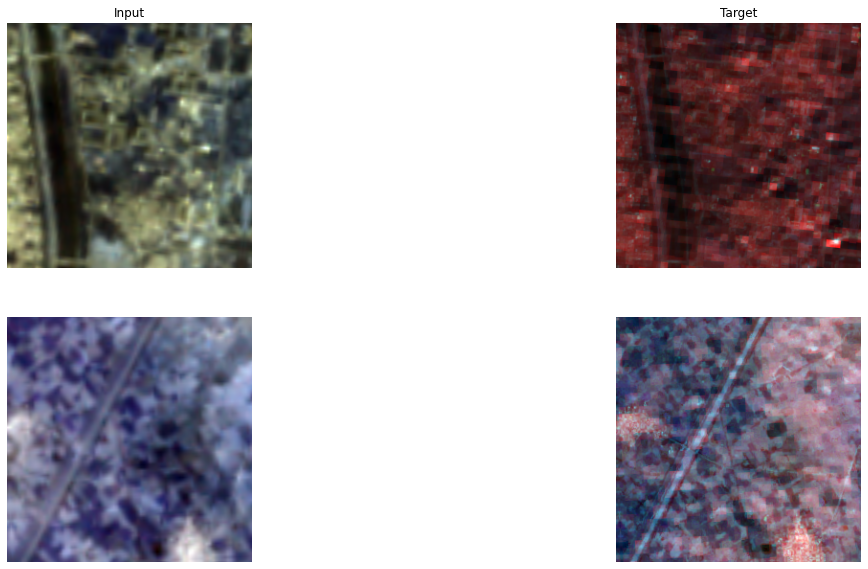

In [3]:
data.show_batch(rows=2)

### Load the model architecture

In [4]:
model = Pix2Pix(data)

### Find an optimal learning rate

[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. The `ArcGIS API for Python` provides a learning rate finder that will automatically select the optimal learning rate for you.

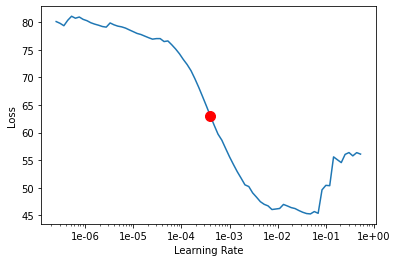

In [9]:
lr = model.lr_find()

### Fit the model 

Next, we will train the model for a few epochs with the learning rate found above.

In [10]:
model.fit(100, lr=lr)

epoch,train_loss,valid_loss,gen_loss,l1_loss,D_loss,time
0,67.922554,101.058823,0.806639,0.671159,0.888794,04:38
1,52.827030,78.936195,0.788984,0.520380,0.882063,04:25
2,38.657383,63.050945,0.780396,0.378770,0.877670,04:24
3,28.062674,58.513496,0.779523,0.272831,0.874605,04:24
4,21.155628,56.853664,0.774855,0.203808,0.870376,04:35
5,16.308531,56.166840,0.765249,0.155433,0.866498,04:37
6,14.429462,55.781639,0.753477,0.136760,0.863398,04:40
7,12.368107,55.496456,0.740846,0.116273,0.860481,04:42
8,11.972437,55.270863,0.727483,0.112450,0.858373,04:42
9,11.420366,55.159748,0.715936,0.107044,0.856639,04:43


Here, with 100 epochs, we can see reasonable results, as both the training and validation losses have gone down considerably. This indicates that the model is learning to translate Landsat 8 imagery to Sentinel-2.

### Visualize the results in validation set

It is a good practice to see results of the model viz-a-viz the ground truth. The code below picks random samples and displays the ground truth and model predictions side by side. This enables us to preview the results of the model within the notebook.

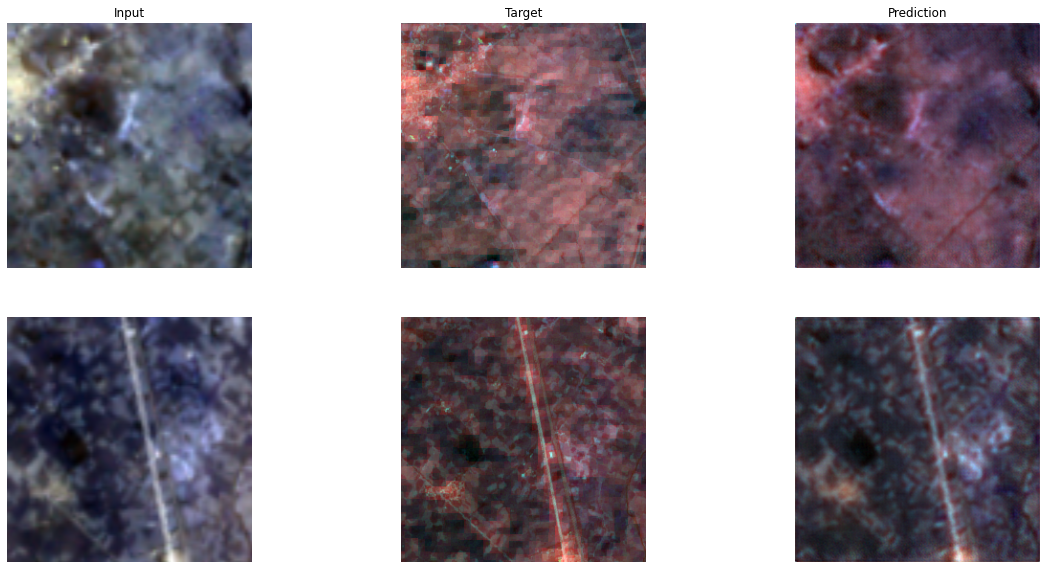

In [11]:
model.show_results(2)

Generative Adversarial Network (GAN) models require a significant amount time to train, and even with the initial 100 epochs trained so far, there is still room for more training. As such, we trained this model for an additional 400 epochs (500 in total), to achieve good results. With the additional training, the training and validation losses dropped to 5.45 and 52.6 respectively and the `D_loss` stabilized at 0.54.

Below is the loss curve, which represents the training and validation losses during the training process.

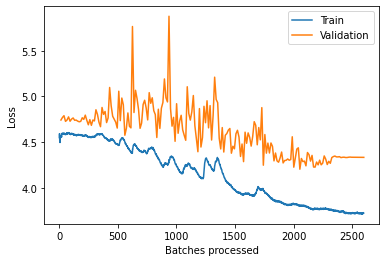

In [18]:
model.plot_losses()

### Save the model

Next, we will save the trained model as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [24]:
model.save("Landsat_to_Sentinel_LE_500e")

Computing model metrics...


WindowsPath('D:/Landsat8 to Sentinel2/L_to_S_data_export_larger_extent/models/Landsat_to_Sentinel_LE_500e')

## Model inference

In this step, we will generate a classified raster using the 'Classify Pixels Using Deep Learning' tool available in both `ArcGIS Pro` and `ArcGIS Enterprise`.

- `Input Raster`: The raster layer you want to classify.
- `Model Definition`: Located inside the saved model in the 'models' folder in '.emd' format.
- `Padding`: The 'Input Raster' is tiled, and the deep learning model classifies each individual tile separately before producing the final 'Output Classified Raster'. This may lead to unwanted artifacts along the edges of each tile, as the model has little context to predict accurately. Padding allows us to supply extra information along the tile edges, thus helping the model to make better predictions.
- `Cell Size`: Should be close to the size used to train the model.
- `Processor Type`: Allows you to control whether the system's 'GPU' or 'CPU' will be used to classify pixels. By default, 'GPU' will be used if available.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAwUAAANbCAYAAAAT4TP+AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAFiUAABYlAUlSJPAAAP+lSURBVHhe7L0FWJzbliZ8pm1apqen9fZtvbenZ+bv6Z62K0fjRkKIQQQIIWiMoCFCAnGiRIgTIe6uRAkkgeDu7k4BZVQVxfuv9VUVFKSInRzOSc7ePO8DfNvlW2u9277PIJxwwgknnHDCCSeccML9qJ0gBcIJJ5xwwgknnHDCCfcjd4IUCCeccMIJJ5xwwgkn3I/cCVIgnHDCCSeccMIJJ5xwP3JnkRSoOzsFBAQEBD5yDJaLK6jHL3bk4pe78wQEBAQEPkaE5wlSICAgIPCpYrBcm6wV0GsFBAQEBD5WdOsEKRAQEBD40OjUaKDV6aDRaiXw3wx+bin8d4XBcq2trRbzFxAQEBB4M1g3mPSFOSyF/a7AZRCkQEBAQOADQtfVhZcJCVi7dq2ENWvWIDg4GBs2bEB6errkbyneQOjS66EdKA4JcfYfSHkMlhOkQEBAQOD90d7RgfqGBtTW1UngvxubmqBQKi2G/y7w/qSAIuq7tRSyL/RaC2EFPhA01MY6dHcRm7ToLyAg8EMAG/3RT59i/fr1eP7iBaKiohDg7w8fb2+JLLwrKcjMykJlVZW00mD+nAW4Sq3u8bdEDAbLCVIgICAg8H5g2R51/z58fHywKjgYK1aswPz587F8+XLk5eW9k85gvcCuv74wgZ+zs6Qv3osUaLqIAMjlOBdbCf/blVh+14Clt6sR26RGlyAGHxydBLlchsO3KrA3tRWNRBAEMRAQ+GHCRAp2h4eju7sbDQ0NWLlyJXx9fZGQmAidXm8xniWw4Pbz85NWHIpLSnqUAwtv9mNF4u7mhmvXrkl59Y8/WO6tSYGG24d0SL+9rN06jSTnLMYR+FbQaMlI6Naii9rekr+AgMD3C5bld+7elXRGeUUF4uPjJYLA5OBdSAGn09zSggsXL6K4uPgVYsD/l5eXS/719fVSeHP/dyMFFLibDP6ijEr8Oiwbf7o0GZ/5EHyN8E7Gz3YX40kLCX0hfD4ouKPaZbUYtjAB/3myCkVqIeAFBH6oMCcF/HdtbS2CgoLeixSwEI999gxeXl4SMSgjgW7aLnSfCMGCBQsQGhqKqupqizNDg+XeSApIhvGEkapDiVM3C/DvYbn4911GbMvF0rgWtDLRsRRX4L2h71YhPqkcwzflYX+JQiIIlsIJCAh8fzCRgiNHj0rytLKyUtIX70MK6urqMG/ePKxevRplZWU9eoF/V5Oe4G2sHh4eKC4tfUVnvAMpMBCChNgS/NmKFPzmhjxsTG1Fk1yFepkSdW30u6oeTgcKcaNRLQzW7wJqNZqorRs7VFBa8hcQEPhB4EOSAoaJGHj7+EiCvpSEOROChYsWYcPGjdL+0/4zPiYMlnstKWBCQL+LU8vxV6tS8durMvB/wnLwT9sN+L9bs/Dfl2VgTbYcWmG0flB0Eyl4kVCGL9blIrxYkAIBgR8iTKTg8JEj6CZ5ysb8+5ACBhv2L4wrDXyWjfWFntKsqqrCunXr4LV4MR4/edITtn/ctyIFOn0n6nKq8P+CkvGPEZXIVmgAHVWEjP8ekLDp0mmkv/vEp0z6nD/QWwgjheN8zMIRuiiP/uG6u3XSUqhGzQfwzMK/ki4RGQrbzc+pbN0wxNOapaXlZWyz/DjsQEvYnf3DdvULa6GeWgv11Ol5P1dvuP7nMLq4fiZ/XvLl2TXJr/dMAefLz7Q0kPgZkzDuTP57oHR70jfPn+tL8bhtXqmPgMCPCDz7/jrHW3P6C9CB8KFJAefLSiOGiMGSwEAEEjitbdu3o7qmRvKzFI8xWO51pEBP8imFDNO/X5aMf48oxY50GbqM8kfaPqRV4MrTatyoULx1Gwu8PaTtQ9TWYgVfQOCHiQ9NCjg9Ps/mQ2nw2ba4uDhs2bIFi7y8JELAYSzJWn72RlLAgbrkbVh9NAOfrc/Do3oyzAcwOPtDqyPjtLUNe++VwfF8GZzPlSIotgm1qr7bXzpZaKmUuPG0HA4UzvVCGRwuVuBkYQdpY6qgFI6MbG0HLt4rx5KoBjRCiWcvKuF5thROlG7w82Y0mrbVUJl1HW3YfasMwfGtqK1rwfprxfC4VocCLhf5U0BkpVZhDud3sQxO9HvNS1JslJ/OWC4DDGEr82qkMFJYKt+6hBZ0EGlhQ1pD9exua8fh+731XBbdiAqluXFOxjeRpudx5E/xOR3XS+W4VqU2CGsqk16twvXHJZhN/i4XSjHvRhViGuk5pSGXt2Lr2TLsTG1FG5WnS6cmBliPgFMVuN2oRFtrMzacK8EcStftSgWi6qjcfUgV5a9X4cWLCrhR2nPPl2IJtVlLRwcO3yjFRqpPE4URy/cCPyawfFOqVIiOjkbk8eM4dfr0KzhOz6/fuIGm5ubXGuAm6IlAxMTGInzPHolMNDQ29pwpSE5JkfwtxXsduJwawv79++Hp6SltJ0pISHhjWoPlBiIFWpJBTbV1sFqVhL8/UI7UDiIBJGP7h+MJkP56hY1ZnXGySQL9bWmihdulTzgC/99/8smUHj9/U7rsr6PycNqmMKZJk7fNb8CwZuE4TV4dMffnvAYqu3kY80mc/mlw2U3+kg6nZ+ayncObytw/XUttbCn9nvbsF1ZA4McASSaTPuCVXEtgf0vxLIHD3713r2f7EO/7N5GC/Pz8dyIFJnDZ4uLjpTNprC+YIDwhPcfPByobP38jKWDDvrWqGVM2JuA/rzdBSZF6hBH9rScDlY1mE0wCj5VBTVUtbNen43eWp+Czpan4LJB+L0vDN1fqUKdggUmFIKHSXl2Hadsz8UemcIwlqfiD4HTMfdICGRmrnQR9Vyv8NqXhH0MLsfVZEf7XCgofyGEN6f7DmWpDulTp7pZGjFuXin/aU4zAU1kUJhl/uLYI8STQyILGimO5+Il5fpTOb1AaIy/VILudhaOhfjptG/acysPPVhrCSGH9U/D3u4qRIOc6d6Khrg72G9Pxu33qmYpfX6hFhZzagtLp0rXj0Pl8/OXy5N48CY6xbRJZ0Ha2IuRADv67yZ/rtCoDwelyaZaHzxQMWZCEcVfr0MCzbN1qJCYX4adu6QiOK8fEnen4A853KcEnCX+8qwhnSpVS+bgeUHXg0LV8/OmSJEM9CL8TnIF/PVsC26BEfH62BuWdWjGbJPCjAwtCno1Zs3o15jo7S/stTXBxcZGWYZ/GxEg3/bxJ0LN7/Pgxli5diiVLlmDTpk3Ski2n4e3tjWXLliEnJ0dambAU3xI4T14V5C1DLOBXBAXBPyAA6yldVh6vUxiD5QYiBV0aNa5ey8Rvrs7F0WKDLLMUrj94dVpWK0Pw8Wz8+epM/PmadPyffcXSJEq3cTJGCqdTo7W5A3sv5OAvKNxfrKWwa7PgENWAOvaX5BnJ36527D6ei8/3VSBP04795/Lw16Rf/nx1Or45U4W4pk4pXUnmtzZjzp4sTLrVgJSsKnyxMRX/uLsMGeRPghqyFjkiLuUa8ltnyM/udj1q1Jxfb/20JHvlVLbD1/Pxk5AMKhsjG17PmqGidmD9p6H0CtOq8PmWDKojgcrD+VYoeieUOJ3a8ma47+XyUn4U5v8eKkV0o0YiUqxrc9NrMHJrmiGNkHSMuFyHUjnpwW4VYuNL8O8h+TjfqJDGUVdXG7YeycFXEZUo1JB+O52Ln5Iu+IvVGRhxoRppMtK1PXqA8uhSIzOnGhM2c/6U/uZcbMiWIfpxMX6xPR/XG4wTW8Z6Cwh8ymB5zLrg1q1bCFq5EqtWrUJISAiCTTDeHhRx+LB0peibJpI4PVlbGy5dvoy9+/ZJf2dlZWHx4sXSqnBiYuIb9Y4l9KxSUxl5IimQdFJpWdlrdQ/n80ZSoCOBVFxQif8gI3V+ogwqMmBNAlkpVyChqBXRRTI8JUQXtyG/VS3NjmjbW+CyNQX/ZU0e9ue3Q0XCS6dW4Pq9AvwRGegznrVBT4RDq2iB9840MrQz4PqABDkJON4a01Ivg/c+Ml4D0rEks50EJAt2GYLI+P2dpWn46kwZntaqSMh1QtHchjXHMyVDem58Owl3XqFoxLQtqfgtEmJu1+pQrDSk262V4+jlHPzXxan48ngVsklpKVVqKBRKRJzPxG/5pWBcVKN06A1dStyIysd/907GPx8tw3Oqm7pTTZ1G9YipRAKRByhasTCMDPGQXITltFH7cD2ViHpUiD8hA9wmWiZtCWrMq8a/rk7Gv95qkrYwdZACaaiux9F0Km+3FsUvS/BHRDxmPJNJgl6hUqGgpA4X80iREtnqaKvDSN9UjL9RD0qBlKsaKWkl+J/eqfjjLZmY/qQJKhLMqk45Tl3Jxm8sSsWkmxSWtzTpVHjyrBA/oXr8/Egl8hQqKKgMqop6jAvLwGfeKRh+iQiMIAUCP1KwoOQlWz60y4e0eGaFD/Gycc9bft525ofD5RcU4MHDh9JqAd/ywEri1u3bErHg5zUkqN+kKEzgPDlNvtZ04cKFCCWSwWcI+IwBE40QStv8MFl/DJYbiBRoVEqs25uMv48oR0a7+WoAyU7z7ZYMknPs10kytKqsCl8tTcYfbsjBmKOFsDpcgP8g4/x3Q/NwoUwpzVxryVityq/CfwYl47MVmfiGwo07XIjR+/PwZ4GJ+MdDFUiVGSZl9Po2rN2Tgb8kcuJ+NRe/2pmHcRR+7L5c/BlPxGwrwstGCst6hieUNqbhZzvzMetQNr7ZX4gZ52tQjE7UFVXjy1UUflkmvjpizO9AHv6C8vv5/nIkGC/a4DrUVdVglFS2DHx+iOpA4YftyMHEc5UoUJOO6lLgyt08/HefVPzfPfkYR/5Wh3Lx51SefztTjQo5k0ENmqur8esVqfjp9lwpzNiD+fglpXeiUEFt2Im01BL8/ZJU/HN4vpTHuP05+OXxcqRQfQAVHkTn448WZuJwvQI6Gnd6vUGP/s36PMy+kIt/43SpLb7emYX/6peEv4moQpmK+o76QqdX4WVsEf7MNxl/viUXY7kvDubhH3Zk48vNTECycaZOnCMU+HGB5XKrTIYTJ05I+oKvD2X5zDrD08ND0iNsgA8kl83Bq8lMCFjX8HWk/Jtl+0oiG0w4+FrSisrKt0rLBCYEfFiZDxX7+ftLBIVJwWoiLXwr0UATSW9FCrqIFOTlluOffNLgnyaDmgQ3kwKpUUor8XdeL/HZokR85sUz0GmY/7JdEvbFcUX4veAMrEojo7Znr3sX/dmGRfsy8BeHK6EgY7kqvQL/GJyMMXeaoekmIchpE3RdOnRU1mP0xhT8ZWQ15GzoEylYEZZOiiIfVxtU0vYYDsvXpHbVkiDflIq/PlENBf3fTaRgCimRP91SiGg23qUZFS3k1c2YsTUJPzlcjRqqA28VktJgZdDRgVWHiKBsLka2vBP6hhY47UzBT8LJkGbFwsLeVD5eQqX0KhLJmA9Oh39Sh+HcgqmeXe1YGpGB/7G/Am1cz4xK/POqJIy51gQZh9NTXTl/LheVNzOmEH+8PBWeT9tI9ZA/tbth6Znyo98DkYJ/WEyE5XqDRNZYiHMcVUcjpi5Lwv87WYVClQ7dHXKE7EvG7+woRTwRG1bMXActxWkvq8b/WpaMIRcFKRD4cYOFLhvYPLvPgp6FsYkQWAo/ENjg5zi8N7SgsBA7duxAXX29RDz4Ob/PluJZgobCmwjB1q1be24Z4jykw8fe3li3di1KSkoslnOwnCVSwKu7KkUTZqxMwTdkVFfxSjL7sVxTdOBMdCUCblQg4Bb9vlmBfdnt6KR68Uqu6650/O6mApwr79UfzaW1GL4+BX9zuhYyllUUbkE4yeuVOdiWSrpJCkfQqnH1XgF+GpiEr6IaJcOaScHG/Rn4jcB0TL5Nsk7FcprCalS4fb8If7kiGcMetKCbdQmRAhvSO7+9LgsbSZ/pjOnq22Xw3Z+Oz4JyEJrUCqXxOeuhW/cL8bdLk/DLWw1Qcx06KOyBDCIPWVid1ooO0mccVidXILW4FQ3UBnV5lfify7htqlGmJh3FaemVePKgEL8RlI5Fybx9Vovo2zlUlmzsK1UbwpCerKmXIYd0YFenCnuOpOIPd5eQbDfWqUuF7Mo2VLdxeBUePi3An3pl4agZKVgdno7fXJKGX1+qRCHpOo6n7WjBsoMZ+G3fbJyoV0mTdm1Vtfg19d9f7ipGVJ2yJ//s5Ar879Wp+C+rcnC+XpACgR8fWDbzrP6pU6ckMmCaSNq0ebN0S9zbbvlhWc4TRTyZVFJaKl0zzWlkZWejsKhI0iEdcvlb6w3WAxUVFZIe4zMEjx4/luK+iIuT9IXpemtL+oLDvdVKQTnPjixPxPj7LeigSGxQsp+yvR330hpxKaMZh68X4A/JOPZKJEFGgujs+Sz83oo0/OJgMSZFFsH6mAE2Jwrwz2vS8KehJcgm8/fl02L89fI07CghIdRHsPBMfRvWkmD9i03FyCDBDiIFS7en42dhZciHUcGYwupkCOaZoC0lyOJDwUQKJhEp+D9HqlCnp4ancDpSShVFtfgqKAlOz2VQUZqmuhhmrpS4FZWPP/TLwRWZCpUFNfh8eRLmkmLgbU69ZTNAR8L3ypUc/LcVqfgPC/X8f+vS8EfripBA9dK1K7DvbDZ+fykJ4sMF8IsxnIGQloipTRXN7Vh2IA2/vyoTQ48WYm2yQUHy/s7XkYK/WZiOtfkdRIyMs2zchvIOLN2ZiJ8dqURWhw6qlhbMWpuEodfqUUfK1LRnlNNV8IrO2mR8KUiBgIBkuOfm5Um3/PBM/7seCjYHKwXelrT9LQ4EDwSOE8DbkEhJmF87yu8u/83EwMPTUzrz8EP8ToFK2YK5JF9+daYKZRqjfKGyd7c1Y+YWw1bHz/yT8Zl3En51vRF6MjrL0yvw8+BkzHneLk1KyVVqdKg6yWBX4MTVHPzehiLkkBHdUEAG6+pEjI1qpXjanr3tnWTMQi6Dz740/PaOMlSybCdSsH5vBv50fRFiFNQuLHc5PIdta4FDWBp+ElGJJp5QIlIwYW0qfhZehhzy76Yy88RNQ1E9hqxNxNDbLdCRsd6TH/URFG1Yeigdv7GtFOUUpzanGv+yOhlTH8hIUxkmu6SwVHfek8+67vy5dPzB5gLcqDGc05PqSfXSyxthRTpyOMl6NdUr+XEBfosMeKcHTWg0ThaR4pC2uOrUahw/y6vn2QjNaoOCnvEEl2HSybBSYIkUBBPp+qN1ebhcT2GMuoM0P2Kji/CTwBQEZRoIQFpMEf54VRqCMuh/01kQzr9LiROXc/A/VmbhrFgpEPiRguUzf4mYVwx4uymv5JqujbYUfiBwOqwv2PFX73ft2gW5QiGlw89ZbliK1x+cTgvJYt6yyrfTPSRCwM9M+oIPH/PtQ7x6zVuL2M88Pod7IynQkABTN5DhuCMFPz1WYziMahIARuFEEgKNaWXSXsdFCUwKlDh5LpsEVQr+W0gG/gc9N8efrM3A/7erDFkksKIfFuInS9Oxr6K/YKG0u9uw+SDv2yxGkpEULCNS8PdECnJJ6PUhBUQgQkjo/2RDMVKNpMAmNA3/dLIazSxIKRwrmKK8KvxnYDLc49teJQVU7nsP8/HHi7NxTqZESV4l/p0E5LzE/mEN6NIrceFSDhn6KfiDAer5D9tLEd+pJmFMnaJSIr2gEsNXpuEPQ9Lxk415OFKhNKwGUOdoVXI8SijFvxHJ+G9EsH6+qwi3G3kP7etIQQZCi9r7kIJOhRKr9yZKW4Wy5ToiHA2YvDIJo280oJ4UszkpkJNydgxJxleCFAgISOD3gpeG3+YMwevAwryoqAgHDx587bWhbwJ/7p5npCwJcIbJ31JZB8sNRAo6le1YGpaMvzxYhmSeyTYZ47wNU65CCxnodWRsDw9Nwa9uNFFKnXj6pAg/XZqM31yWhv+yLLUXy/msFZEIv1zcUamQk1aO/x2YipU5ckm+9ubLsrwDEWey8cfLC/CUZ+GJFKwj/fBXoSXIJD1grju6Wc/sz8Bfku5IYd1BpMBqQyr+/UwNWnnvP4Xr0nciN6MC/0yyfklGh7T60Dc/OU5cJCM5MB9PdWokx5Xg7wLTsKVY2XM2wBxaTTvW7KH6LU3Fb1K9XqnnomT8y9EqVBCh6CJ5foj0zN8RUfjNJSmwi2pGXqMSCupvLoesoQ3LjlH5g1LxW6sysPRlOyplKoN+HoAUrNyZjr8lApND9TK1Bd+Ml5dcjv9JhMwvVSXFvX4jD3+2KhsXG6gcZrpBr1fh7u08/MUqQQoEftxgY5svkzgWGYnc/Pz3ukjCBCYBSUlJ0qrwQDL9dWAdUUf6gCe1+JYh/t+kNzgtEzEI4W8YEHkxTTKZwGHeSAokwaIl4/dmHn7fLwNr8topRF/jka/rrE81kQKD/7O7ufj9NZkIK+YlTDJE2Sg2gvfQs6HLgjYptgR/vTwZs59xPIMA5jQ1XTp0NTVjxrZU/O2RajRxPCMp+OlWEt5k3LKC4XMCGhJm+sp6fL4xBX8bWYMWMpCllQImBScorpEUaOl5TXEtRoYk4l8uNKCdym0SiNINSGoFdpzMwG+EErGQq1FbVIthwYn490uN6CDyY36daRelpaf4iUQi/nB1BtYXvFpPPRMmnSE8b13iaz9ZeempvBX5NRi6LgX/cKgcRZLSMrSJdBME/Z2ZVIb/GZSC4Zdr0Uj5KF9DCjYUvkoKgvcQKThqIAXK5mY4rE3ATyKrUKw0zDBJZaJ0O+qr8b+9kzFEnCkQEOjBuwrj1+HbpsVC/XVpvM5/sNzAB407cf9eDn5jVR5OlCmka59Nfiyr+OvGyooGjNpkIgUaJDwvwd+uSMZ/HC6Fx6UyuPGNaiZcKoX75RpkadTITCnDPy5Jhm+aBVKg78CuE1kkmwuR2IcUlCLTzBCW9JuyFQt2p+PPyEjOpfL0IQUkV02kIDu9HP8UmIyFSRZIAeV34Gw2/mBVAZKIFCS8KMbfBqYgJFfZI2/NodUosO1gKn5vTRYmnS2HZ/96nivDBr5Rj/LXSqSjE3l5tfA/W4ov1yThD0ILcLmaCAdvoeU6QIno55XwOFWE/7UsUdIr6e0DrxSYSEGWGUEyJwX+aQZScO16Hv6UDP/IasPqhqn83ZTfpSu5+JMgQQoEBPgd5EkgkwH+vmAj3fQdmnfZMmQOjmPaqmrJn8vI/pbS5mdvJgUETqS9sQGzSHD/XnAOvKLrkdPGgogEKN+r30WkgYTHb69IxwImBWTUNpVV4Z+Xp+DnEWV4Vs9LkWzIEki4ZWXU42mt0tCAzY2wC03Ff12Th10ZvftCuxQK7LuQgz8ISEdQTu9BYxZmny1Ng/19EpgaY1i5AuHns/H7gekIyeuQ9kLyQeP+pIAVQLeyHZtO8KHkTCx82IhGU7lIWT16XIS/I0Fu/aARbbysrGzDhkgKG5gJr8dNRmOc0qa0krMbkE8GdntVNX5BxvvfHCjFI6qTeT1zshrwpFpBxjcL9EY8Kiflxe0ltVk7lpEi+isiOAms4NLr8ZzPSfDhO/ZXNmN6SAr+PbISRVQW9XuSAt4+xGRn/7kM6TDenKdNBrJC7aauacbSo9n4TSJlw8RKgYDAJ4fBcgORAjaeG8joH7EqCf8QUYFcpZpEDxm6JGcYXV0khyobMWZzCn5JpEBPsq8mqxL/GJIMq6cySpmX1A1yvheGCZb6whrJQP75iVo084SKKU2Sbx3VTZi8ORk/P1ULmYbC8/ahfRn4o7V5uNFEuouMaSks5decX4N/XpOM/7zaABWRAr0FUsATSo3FdRi+Lgl/fawGDWTom+enqGvCjK3J+JvIGsgojaqsKvwLGdf/eqEe7byqbQxrmDCiOIQblzLxO6H5uFLH/WShnhSPV6d5O5DhsDTL7S5U5FfiVytSMOluA1pJN/B2JOmabSmeBrGxRfhb0pEr0nmiTY1H70UKWJdpEPOgAL+/IhVOcW1SeaQ6sG5UyLD4QAZ+a0UOzokzBQICHwxsF3+b1YZvg7cmBQxdlxrVJLxdSXjzdaF/vy0Xn+/Jwy/D8/DrXdn4k6BU/O7qHERWqsgmZmGvwtMnhfgTv2T8JDQbvzSG/dWeXPwsOBOheYavV/INEiWZFfg/gcn4vVUZ+Le9lB6F/fftWfj9gGRY85YXCsf7KJkUrNiRgb8MzsaoQ1n4xzBj2G0cNglfnK9HbSeFpfAs2CesT8H/F1nVSwoIbDy3VdVjKhGR/+Kfhv+P4v+KyvXL3bn4k8Ak/N+IciS1U32pDmzMt1bWS2cTOOw/GcP+W1gOfrWvCE+ZGBlvZ/gLqudfbKR6UvlN9fx5SAZCMnk7VSdinhThXzdk4F85L/bfkYU/WJGGKVEtJOZVuHQpBz/flIVfGP1/sY0UxspM+Me3keIiJUekYPjiFFhdrzcQmW41klKL8Vfz0rG+4FVSsGpXAv4uolK68YOFeUtpPayJ1H22LB3/uZvy4HbblIGxlyoxZZ3YPiQg8ClisNxApIDB30eJii7ET32T8T82ZGN5kgyNbUpU8RfaZR04eTMfv7k4EUPuNJFO4NVbGUL2Z5CeyYDro0ZUdShR06pEfYcCNx6UISy5FR0UDjrD7PxnXiS/TlUhjcLxF/Yra2TwCk/Bby/Jxr5yORnNbAi3IfRAJn6T5PS/HCnH/SqV9HX4krImzA5Lxm8ty8U5PrhL6fJB4/6kQFoN6JLjKMlpzu9XkZVINuVX2wb/vamUXxZ2FMulCyj02nZsO5aJz0hmj71Yg2w5haU65xU240B0NYrUWjRUVUs3LP23TYW4UNaBOm4TqmdVswzbzxbjNl+T2qXA6SvFOFLUgVrKq7ZNhdycCvyVdwocHjehpbMNe86X4GatoSyNbXLcIb37e14Z2JjPuuf9SQFPrqnqGjCO9MNna3OwOYP6jdqstk6GNcdJX21Iw3+n5+fESoGAwCeBdyIFDL5xR9upxHMSHEM2ZOLvt2Tjf27Jwl+vz8O69FY0qdTSdh5DeA0pAzUyM6swYXsm/m4zhd2chb8KK8SBvDYoyeg27NEnY1/Xiea6Niw7mom/2WQI95c787Eh3XCHv0koMyng7UM/21GGgpZmLDiai78Kpfw35GJhdBMaeSaDwzKBkLVg4aEcTLxehxZK30QKGDxTo5SrcOxyDv6e86N6/M2WHEwjIcv+5h+Oka48JYF+hJQBh/0Hqsc/bs/FrnyVNGvCN2zwPc65OdWYEpaJvzXW86fbC7AzWyYd/OKG1rW1YPmxHPyMysv5/V1oDtZS/drJT7oxqLERs8Oz8DOOT/4/35KHiFIF1YXLo0FHeyNcKH/PJ6QIupmMqJFNymHEunwcIIUinf2g8ppIQfjpTIy9XIv8DsN2ISZKnc1N8ImgMhD5+FtSzvNimlHb3oI5pAS+4G8qCFIgIPBJYbDc60iBJLulDyeWY+yeDPy2d5LhgDFjcTJ+d00Whh0uxulyhSTrWF52NjXBfX8WftfXLKxPCv58I8ne3A6ojOH0JFdXnszHT5cl9oaTyEcu1ifLICcjWPrGjbRSQPplbQFW3s7HH/P3XLgcZOD/AeUfmEQ6idMkOdnV3IChJBP/1/FqaStqj+7g/NpbseZMPv56malMhvz+cF0OVie0op3yk/QHhdW2NsP3SB7+bKmxbJyfbyps7zSgjvy7+exBWgV+vSbV4GdKzz8NXx4rwzP+XkCXEtev5+C/eJvXLwX/frICT8gYh6YdoRFp1I5GP05naRrGXK9FqXH7UNTjPPyOewYO1plIQSuWbEnF/9hYjIx+pCAnoQw/WZqAhSmGsxA8cZdP+v4/QqmMnAen75+KCbeqEX65AH8dIrYPCQh8KnhnUsBgo5MFBS/fkiTogWR4skHaLzwbo5bC9g/H6fIy6MDh6H8jKfi77WXIJgJAFmxPWBZgfdPk8JQ35d/7rBecH5Mc8/yYgPQv10Bh+xvP0uqEmT+jfz31/etn1l6SgjPzY/TNw+DPX5w0PeM43LZMTnrDGcDlNf/ID0NSjmZl4Ov3ZFVV+PniFIy+WocaXd9zEwICAh83Bsu9nhQYwNtsutRtOBlVhdX3q7GGsPpuNU7ntkHHW4JIXprC8iSHRtGO809MYfl3LR5UK3q21UhhSQbyVqDYRPKPMoZ7WINb1Wa35RhJAZ8p+OmmUhRrFLiTUIPV9yjsnWpcLuqg/HuNf428HSefVuNAOpOKvjJUyo8M6bhkU35UB8rvaiV/M6Cv/pDOqWnUePTSEHY11XvTs3rkmz6OSWH0FKeypBHbpPoZyx/TiFryMxjalGabDAcfGPw5jY3R9ShWGdqLZX9DbTO2cV3Yn37vSWxGE694UFn5426FJQ3YcrsWSW0qiXRptQo8fFGDHc+aUEtp9NSbyltX1Yxdj6pwr1rdo1dYx9RUNGLTXa5HFbY8a0RdtxKXL+fij4OyxHcKBAQ+EbwXKfj+wEa+GSkgQdVzWEzgjegk4c9boqSvaEogUqBX4calLHwWmAHfuFZ09VNqAgICHzcGy70NKWCw0pHOXZmDZLkluWMxLJGF/uEYfHnFwOHMSEFoCVJ5UsQ8PP1vnpZk+PNzIh99npvBsL/fDAOUi9EnL/q7/4SStEffPC0K02eix0I7mKfBxnwff5LjfVbGjembG+5Se/ULxzClZU7QeBKQt2D15tEFdLTCk9rzs6B8PFaQbjFLQ0BA4OOEIAU/Euj1arxMLseKmzxLpUJjmwqtyjYcvZKHP/ROwk/DSxAjI+VlpggEBAQ+fgyWe1tS8P2gLylI0wkj9u2hQmWdHB3mpECvwpOnJfhZYBL+6lwNVEJvCAh8EvjoSIG+qxV+oan4WxLsGXpBCt4WXUQK8rIr8IulvO80GZ/5Mehvv1T8y/5CnK3o7DMzJCAg8GlgsJwgBZ8ieGtqEzw3ZMLlQR0Ox9cj4mU9ttwrwE8WJeIPNubjYpUKfa+DFRAQ+FjxkZECXtqU43Z0FUKjG1HNW2EshBGwBA2gUSImpQZLb1Qg8HYllt6qQMDDepTyl0IFIRAQ+CQxWO5jIAWrd6fjT9cXI1WQgreGVqtE1MMC/NdFCfjMKxGfERn4zCsF/+9IKW5XKSQjQmw5FRD4NPDRkQJGt3TPf+8n5gXeHnzQr3dfKKHb8iFlAQGBTwOD5X7YpICVnRo1DR3IqVOgnf/v5y8wEHhFXomC6nZkVnf0oLJD3ffAt4CAwEePj5IUCAgICAi8HQbL/dBJAYMP0fLtbcKQfUdoOqXb7Ph2QBPEZJKAwKcHQQoEBAQEPmEMlvsYSIGAgICAwMAQpEBAQEDgE8ZgOUEKBAQEBD5uCFIgICAg8AljsJwgBQICAgIfNwQpEBAQEPiEMVhOkAIBAQGBjxuCFAgICAh8whgsJ0iBgICAwMcNQQoEBAQEPmEMlhOkQEBAQODjhiAFAgICAp8wBssJUiAgICDwcUOQAgEBAYFPGIPlBCkQEBAQ+LghSIGAgIDAJ4zBcoIUCAgICHzcEKRAQEBA4BPGYDlBCgQEBAQ+bghSICAgIPAJY7Bce3u7xfwFBAQEBD4eCFIgICAg8IlisJwgBQICAgIfPwQpEBAQEPhEMVhOkAIBAQGBjx+CFAgICAh8ohgsJ0iBgICAwMePD0oK+JCCRquFVqeTwH/zM0thBQQEBAReBctNkxw1/W0p3NtgsJwgBQICAgIfPz4IKWDDv0uvl/5ubGpCdU0Nampr0SKTSQpN8hPkQEBAQGBAaIgE6Lu70d7Rgbr6elRVV0u/28jg5udMEizFex0Gy30bUmCaTBoIluIICAgI/NjxJtn5PpPy34oUcIbari7U1NXhzt272L17N0JDQ7F27VqsW7cOmzZvxv4DB/D4yRO0EkF4H6UmICAg8CnDJLzz8vNx7tw5bN22DRs2bJDkKP/esnUrjp84gfT0dKhUKkmOvq2wHyz3PqSA660j/cGkp6S0FC/i4nAvKgp3791DbGys1B4tra1SOKE7BAQEBAxg+c+yU65QSJNH8S9f4sHDh5IdHh0djfSMDDQ0NEClVkvhLKUxEN6bFLCQlrW14dr161i5ahU2bNyICxcv4mVCArKysyW8ePECJ0+exJo1axCyejWeEDmQK5VCwAsICPzowYKdVwfKKyqkyZMVK1Zg586dklGcnJKC3Lw8pKal4fHjx9i/fz9WrlyJHTt2IL+g4K1ngQbLvSspYEXFE0VPnz5F2PbtUt1CN22S6r9r1y5sJSK0ivUKkaKbN2+ipqbmnZWbgICAwKcGlv0KlUrSEQdIb7DsZDnJuoEn5reTPGWbezXZ3GfPnkVxSclb6wvGe5ECNuqZnbDg5hWB2OfPoTAa+5y5OfgZzwSxoguiwh8+fFia/RHEQEBA4McKiRCQfExISMCKoCDs3bdPMvZNMlRHv9mxIWySo0wejh47hqVLl+Lho0fSLBD7WUrfhMFy70IKuE4FVNcdRACCQ0Jw6/ZtaVWguaVF0iNcL55w4tWDJ9HRkp7hVZO4+Hipvm+r3AQEBAQ+JfAkUn1DA44cOYIg0htnz51DZmam9IxXDTgM29tsn798+RL79u+XJptu37kjTci/SV8w3pkUsHLi8wK8TYhnr/hv03kChkmBmQtu/pvDFBUXY9OmTVJBed/s9yfcNdDpu9GtH+yZJ8q3G1K+nf38tF16kBe6u/XQavv6fWh0arTQU1563Yffr6vRcT300Ggs+39fkPqb2lZjwU/g04BpXHd9B+P6Q4NlJBMCnii5duOGZAjzM/ZjGcpns3gZuJqEu0lO8nM2qB89fiytzt5/8EDye50cHSz3tqSAy5+RkSEpKlZstXV1Ur1ZP/BvBtfTVFd+zisKt4k4BAQEIOr+fcnv+9QdWiqTbrDHGI1tHeer7V9v3sKrR1d3N7q6vvsyaXTcJ6/qr28NY/20r9Tv+4WG2/a7qK/ADwRsC34P7/N7gLfqV1RUYMvmzdLWfLanWQ7yu89yk/9WqlSSfOT/+RwaT7LExcVJBCIyMlIiDp3kbyl9E96JFHCmHXI59u3bJy3z8ow/C27zMNk5OZLSKi0re+VwMQv4yqqqnmUNLri5/4eB4ZwDG6XcQL1QS43R2UkNpq/B7V0bseHgQzTTYBicF57aQl2Ly5uWYN2+ayhTUkdKhjOXR4GkK+FYsmgefNfswvNiOfRd7yEcybDoW2cD1BpWtoaBoKHfLZWJ2L3EFwfvZaJDq/9A9aeXC3Jk3j9KBstR5LYoqA/eV8Ab6qFSW/IjGOupsuT3CjQk2FvxYP9qrAw9jtw2HXSDTFjM+8IcndouqV9+yApHKiu1tyW/HxI0ZBA1lb3ATn8/HH6UC7nmh6vIWWiXlZdLhvF1IgQmQ9jc/+HDh/Dw8MDFixcNY8X4LvFvnjx4GhMjrRhkZGa+Vo4OlnsbUsD1KikpQRDV+9q1a32IkEmhMRlivcJ+5vE4HM98LVu2DLHPnr2idz4kSCS+4gyymglYOyrycpFf1gDle8u3dwTlo+hoQmFWJkrqZFD15Kslg0CDmsIs6bxJTlkdFOr3KRPLbkvOpKMM6NSoUF+Wj+zcEjQrqS36pPEtQHkoOuqQl5GHquYOqN+XGJCekybW9Jbfh06twV//luSJ61tXmofsvFK0qj5gfd8CPLk2kPuuJw2/LbTcyFzOQdaz7wOVUoaS7AwUVjZCQe/TD1ZnkPxram5GWFgY9uzdK62ksp1r0gssI3lVlSfrebuQ+XPThDyvyl64cKFPupbwTqSABfPzFy+kvZ6lpaUSwzL5sZDOyc2Ft7c31q5bh6qaGovKiuOkpaVJwp3Df1DhTg2h1ZFiqSnA7QMrMWPCGIyfYA1raytYjffG+cwKqOhl60IpDi+aDYfAM6inMg7O7DEJFXU1TgV5InDbOZQQKdBRh+nRjpcXt2L6OBs4ODrANWADnuTL0f1OpICFuhbFz8/AZybVd+JEqjPX2xrjrW0QeOgJahpIaZMw5MHVXBGHjR5zEXYjFe3UHh/mReC6dODFyWBMmrwSiY3tNCDfXbhr9aTk8i5j0Wg3HIjOhZJS7S0fr7ToUJ5wAd629jjwrBxqC2OsL5gUtODWNn8sDtqHLFnXoJECTZcOjcVPsWbuJEy0senpE6lfJk5G2PUMVNQ2UR1+eCsrPE5aq+Kx1sEWa87EoVXT/YMrozk0JEcaS2Kw3s0Fu+5+SLL74cFkmVdZGQNtAbp8+TJcXFwQERFhmN3pMQQNBjTLzVOnTkkzRjwbZB7XHIPl3oYUcD127tghbSGVy+V9Z6yoTtevX8e2bdssbhPiv1mf8EFk3kPLN9yZ+38QkFHJri7nOa6eP4vzpEAvXDhPv2NQqeZ+IynblY8dTjPgtv4GWkkWDYbuYDlSn38H84Z9jcDTCSSzQWOb5JpehvSoU/CaNAS//uV/YPJK0mfk+W7vqYHoZEbfwPnz5yWjgXH+3Blcuh+PetJTeh23MxEztOJKsAPGTfHDs8YudH0g45QJfV3hRTiPnI2ImCJoSEO/+7tLpFJehkdnryA6tRRyGivmaXSSLmprLMKDSxcRm1dDhO5NeoMn65pxbqktJsxcjvjmD1ffN0FD7d1QmoY7l87gnLE/pD45fw6XbkahvINHad/6/TDAZ6SUKEp4gKvXH6Gsnf7/AesMlj/tTSlYPu5LeGy9jjrND5fIsKy7SGOAjf6GxsY+djP78ZahgwcPSjqDtwr11ylMDHgCiSeSEpOSpP/N/c3xTqSAlQ8X6urVq30S5QLwnibe9+nj4yMdgHidsc/hD1AFIkg59Bf+3wa67k5k3T8Ed6vPMXyqG9aEbkfY9m3Ytj0MW9Z6Y47vUVRousjMLMMxHxc4B50fRFLAMC71kpCXXmgtlUVWhhOrZmFi8Fk0KXn7kGGVw3L8gWAgBYVPI+E6YSzcl22QDptwvbet88XEISMx3XcfMlpV0LOhPuBS9LeBgRTEnV4L2+mrkdzYQX377ulr9VpU55yDyxf22P0w+1VSQD+lcafhYTUZu6JLyaB+O1LJrLqn3QcJWsqvofAhAqeNgYNXELZwf5DRw/2yda0PJnzzOcY7LMSpZ0RWqU86f0ACiUlBS+UzrJhihWXHY9CixQ9awDN4+9CHH9cfFizvcnNzpVUC0xkCS+GukIx1dXU1GND9SAGD0+Gtm8HBwdKFDgOlM1juTaSA9QFPKPH5Cd4yxOU3+bEueUZ+8+fPl7aX8mqBpfpwHNZBPFt26vTpDzqhxNti5M35OLN9BebNnooRQ77GkCFDMXToEHz9tQ0CDz9BK5F3nb4A4W6zsWDz7UEjBdz3clkNUp/FIrO8iQxaajsivfr65whwnAL74GOII7/47HLI33lGmyeK6nDcfyqGfvMN1ZfrPBRDvvkaw8ZPxUL/CCQ38QQPySetEpU5SXjxMhP1ig9n8DEpqC+6Ao/xrjj2rPi9SEEnGfkdLU/g9bkVlux7iGZ09+kblsV1ubexYPQIrLyQjA5d9xvyoHak+pZnJSAuMRuNSmqnQZF/Bl2e9zgCTqN+ja+lMWjskyHfYPhoK7h5r8Dh26kgm/sHJpNJ/na34962eZg4eREe12oHjUi9F+i9UiqakRUXi5SCasip/INpH7wt+N3jbUOsM3jLKW8L6u/PKwd86NjNzQ03b93qI19NYHnJO3T4QDLL64Hs7rcmBZwJbw3iPbC8BciUqSSwSGkdPXoU8+bNk26KYD9+bgnmafFyRhlVdiCF9i4gWx/lccfgNmUsnJftxP2MUqjM10Q765CSUgBZJxmHA5ACZo5sVLCSkkCN2H+PIxsekmFvFk7XM/C5jjzD0Ne/l30a/Ez71zR6QN9ahv3+E7H40DN0UB30+i7qPA7zaofxdhPJsH1FEBhJQcwxuFjZ4nByo7HS5LT1eHR0FaxGzcaeu9noZCObBKiO8jFt75HS5XL2q6tW2j9qPvNE9dNyXLO6G+vyOlLw+jbpCxMpcPvSgUhBjmVSEH8anuOnYLdECgxjx2IeZv3CfdZn3yC1Ae8V5TJynXriDdC+mj71NowLw/7agYmGgRQ8QICNNdZdy0SncVlVcpp6xN26gFXuVkRgfXA7pxmdPeUzjKM+7Uxp9U9fKheTHbNy9d2y1Vtvaduc2bjl9F5HQqSVAiIFQVPHY/nxWLS8RgG90vZS2n3HEr/z/d8tTR+FYVZWU1hOh+vI7cz1pzTN6yv1p1mZ+o9rqX3M4krEsCdu3/IZwG1k1p4Uj9PisnwoosFD4DQZtOHh4VKbWArDeBMpYHAZT5w8Ka04DJTWYLnXkQIuO6+I7Nq9W9oOZS7vWVHx0jYrvCVLlkjbTl9n7LNfUnKyRIb6k4v3BikPVXsBDgXOgtWYsXDfcAI5ZQ2or69DTV0jqrJuYnPYDdSRId41AClgGWK+4UM6v2RBjvCZMpPjP823gvD4tZiGmvxMEY1bY0hVQJlxFe4Ok3EokV5OM/fq9hJDvpa31RhIwYklM+HotRVxFS1orK9HU30p7h8Nhs2wUZi97S4U/K6pDVvXpDw61ZIM5f/13X2NeFNb9N2m06/uZmV5HSnQ8lkwYxx2XRbfW0PbdbTGYMnIaVgZQQSOYvUnBfX5UfCbRLL4SirkZqSA8zB3vXloe/Lu7ecuetZt0JXS3wbH9bGkBzpJ/pj6VIrHckg63zYQ8WEdp0XB06NwIVLGOrCuoUGaAKhvqEMmkQV3m/EYZz0Jy46+QAfV2zw+l693DPFuBEvtRca6MQS7/tupeurIMqffmOy1dSzBQAoe7vbB9FkBeFr3elLA5zV6W97yann/rXx968MynVLgtmQ5LSXGK9qs0zlt4+o21cfk9KwLzNLvZMNRctwfamlLssaUpulvoxto7JmPUem8KOlDTvVDnfFhmcc3e7Ixb0kPsAx8G1LAz1hm8k6fZJKhrD/6h2G8NSnggl2+ckWa6TRlyAVkAf/gwQPMJ0LAV8lx4ViJ8dmD/uDnHI/j800TvLLAs1z9mc87gwaAri0X4d4zMMVxC5LbWRly55iF4cEtdTSbla+SAjbImkqSsGu5AxzmkN+c2XAP3IRH+bKewcD1VSprcW2bH5ydnTHXhcLNdUXkiwYSEoaZhPaWQhwLcofT3Lnk5wzXBT64kaMyHH5UZWGPdwB2XEyEikpYen8PXJ0dYDd5AibZzsLsOQsQGLgFIcFO2HI1C0piDSbBodOpURx9EPMCdyKxrP1VgWsiBeOn4cALIm1GxcsvXnvNXSz8egIJERaWIEP1JlZ4huBGejW9JSpkXN+O2Y5LcTGtEhpSdFJ6JMxenl0Jz4DVeJgrk16mru5OlKXewZr5jlRWZzh4+mB/VJ7ROLNMCrhNOmQlOLHKA07O3CZz4eLphWtZSosC5l1JgYrKyUJAoajG5VDv3n5xccOpRL7jnAz4rlKcWrUUaw5R/ake3FdNWZex2Hcd7mY2oCP1PDzdXTDHyRG+O6+gtFkNXc/LRy841bsk4TpC5s+Go9MczFm4DFfSapB6eScCfPcji7cW9JSxFz2kYNIErL6QhHat2eyUJIy6UUhC3nncUCw8HAcljU2pjl0atFSnYk/AXMx2dqF2c8XKU/FQqmgMGoUik5ROXSuij6yDu7OTNF5nrzqAjDIZ5ctjgwxcXRGOLluCjcfj0K4vx8UNS+Ey2wlOjg4IibiLclk3jcu+ZTbh7UgBv/88i0n9GzIPc7h/nedg0Z57aOngMxPGslIf1WU/Qai/Axz53aJ29gwOR3xZh8E459W7jnwcWR+IoDMpaMp9hPX0LjsHnUatqhkvzm2Gx7pzaGpuwLPTG+DAfeDijrCbOdIeam5TadxkX8VyzzW4l11L45jEdGct7h1ag/nbb0PVWoXbh4JhT/Wf474Ihx4ToaTym/qDZVJnZyOi9gbBdS6lP9sBPjuuoqg6HxEBPth9JQlt3/KgOssPvmBhy5YtPYeEOV+TPDXH60iBKR7LXjaQ+QY4/siZpXQGy72OFLDuKCwslJQREwBTOfk3HyLeSXrDy8tLUlTsWB9YAsfhurMu4Sv3nsbGDqjY3h4asrPluB/uBavxc3AwuoCMUp5QMPSLBNYR0lgm2dH1King/d8aeSPS4x/h0ZNoPHnyCLGpBejoNJuYkPSPCoWJT/E4msJEP8HT5/GoaDXojU5KQ6tqQvrzxwb/J4/xPDkLjXKWVxq0NRUjLjoBpbwts1OB8txE3I7cgtnTbbDm2AM8fZqIxKTniI17TmkymTXlS+9opwyFaS8Rk/7qOT+WExIpCJgJJ789yFWwPcTP6P3RluNksAcm2axEfBsbeG0oTIpHXFop5NwuTSWIfvIUCekVkNP7x+8SG8FKWS1Sn91FLL2HhvzYsOxEaWqstO+ZryZ/llfHPS3FsUwK2LDSo6EoFU+pLUzxsipkFurA4+J9SAHrrC7U5CZQPZ5IB/s5n9waOaXHkxMy5CfE4WVmOdWXJ2po7DUUIjY2AWUt9G61VyDmKZfrEeJy+cpcc11FeVITKprK8PLpIzymOkS/zECTUoOanES8SMhHK6dpFt4Agy43kAJbRCTWSZMSprHIRrKmIQu7AmZg7EQXXMmXQ28cY1p6R5QtFUiM4fye4OHzJFTIqJzmZJBlrV5B9YqWxhkjoaSlpy86KS0Z1fEFjadyitulaUAKpcXhomOeoaKdx8er7W/A25ICrmM3ZFW5eB79SBrrD19moUVNZesxvCkM1acyK4bqYuiXJ7EvUNJMxNSYv0ajQFV+MqIT8yEnPVCa9hgPYlNRI5NDVptL71cKajvIbmkukt43ziexqEmaeJXyoP5UdFQhMToOuVXNZEdS+1Ka1QUpeJKQCwW1VWt5Bh4+prjRT5Fdo6RmMpexPEa7UF+QTGOU06dxkFNF7diOrOfPkF5UBwWl+Wofvz14zPHqKF/5z5csmCZMpLFAconBMpBlIm8fYlLA24f4mcmfweFNaR08dEianOFn/fNjvDUp4Ewijx+XVgQ4E37GifI+Jb4VglcJQkJCsJlPRm/a9ArWr18vfbOA0+HC8R4oXgZmQsEsq39+7wItxS+JPgznKaOx7noxdbrZS/AKLJACEgAKWS52etrBxcsPvr6+8PP1hpv9RIycvR4JJIiYMGqaM7FvqQNsbOfC29cPPgSv+U5YdSqDXlxAWRGNYJepmObgCV8/X/L3wYIF7th1t1JikGpVMlZNno6lh56SsQtURB+D3+J5cJhmjakOrljgtQy7w08hfLMHxs4/gGoFDwoqM7WXRtWKy6umw3HlYRTRi9nXoDYIEoukgMrVVnIFc76Zjs1k2DAZqck8DacxbjgZX0pDmmRbdTI2eY7GjCWR9NJzSiTMMq9hru0kBJCRxgpS202C5M5u2I0dj5kuC+Af4E91d4b1sMlYdymBjE6K1I8UsABTVcdijds0TLX3MGsTV4TdKrcoXN55pYD7pSkVO/1mYZKdi9Qnpn5Zcz6Xyk6EUV+AXXNnwX3DDTRT+nzdY33iYdjOmI+tZKCt8F8IL19/eM9zhs34UZi28lKPwOZD4FlEmuxGj8P0OZ7w8feHn/dCOPn4I8DDEbOmr0cKkQJtTxl78VpSwOBB056PfcvnYPycXShUUpxuLRpSL2HBlAmYaO8Of3+qj/c8TBk5Dou2XEEV1aeLx2x7EU6HeGDkOFss9Kbx6u8Dl1mTMWGiH6Jq5STMmQzlYCsZ4ItWbMWmYC+4zPOmcFTP+XMxmeppE3hAMkosrRi8DSnQ0JhuK36EVU5TMHaaM/UvvzuLMMNqHJx8DyJXSaKf2kBWnYiNbtPhtpj8KYyfrxecp1tjtOtO5DcpqJzd6G7LwLZFjpi+dA/CA2bD02cxAqi+jeoGPNjni3Gem3B6kz/cvXwpDX/Md5yEIVYzsekyvXtE9nnUlidHwnGsJ86lVJBhQa6zChc2emLC4p04s8ELbvRu+1H+njPH4ytSqIceFpKhRqSSyqhuzsahpc4YNWoKPBf7SGPI18sNs/xWwMdmCoKPxZAR+O1IActNNt7ZiOfvD/D/jc3NePToEa5cuSJtyzSBJ188PT2lsOZ+/PcdEvo8c8gKgq8pNRnbJrlsjsFyryMFbNDz92t4EogPy5mUEf/mvdJ8oHoN+fE1q2z4sUHTB48fSx8zY71hSnPv3r24eOnSt9YdzM1b8m7D32E85m96iDaSNwP3MY2yfqSAZaOirQJXtvlh0shf4fMvv8KXX3yOEZNnY+25eMN2Hl5lVFTg7okwOI/7Cl8Yw3w9dhoiX7YZZs2bsxC5aSmmjfxc8v/iV7/AaKcleFrCI1mHitRIzBoxF2eSq6DvbMbpoEn4xZfDiMhMwKhhX+CXv3TAmtWLMWH6NOx8VNNjvPAKg6YmgWTweMw7mNCjF3phRgp8w5HdAaMhx4Z8A25s9IGtzXI8b2VNUYpD8+1hv+QMGuhd6GrMx5b542HtugGJDWysadGtVSDp4kZYzXDGqdgyGpN66NW1eHJpHzwmDsWXXPcvv8Bw+wCcuZGCZmpDXT9SwPPzeiIg2c8uY5njRHzz5ef46itqk88/h88x0mHaV1eS3pUUSKvymhakPDwN3+lj8BWVifPg/gu6kCeRIl13EcLnzoDTqotopPisN+oSDsJ68nycvPUIF7fMo3hfSnHHOvrg4IM80suGdtdSn7eUPcPOQHdYDaE+5f4eZQP/iMs4utQJ9q7hyKP391W90ZcUHHpZ80qfMWmqIXtn+tRJWHGc2oPGD+fXVhmH3cvnYfyQX1N+X+DXI6zgsfQwkqta0MkTRTTYuxRluHVsG5yM45AxznkVrj3KQRvJc323BiXxBzF91AJce/IAB3YGYOLnX+ALapuvh46Ax8ZTeEkkwvJh7bcjBTzBWZkVhfXzZ2LEV7+W3oXPraZj+YaLKJIrJXtMo+tA2t3jWGRrKONXX32JL4eMhPO6E0hne4zarlvbhKg9izDCcw+ir+2B+8Rf4D/GLMKD4gaUPt6KMXZLcOvBfRwOniO1B/fvBJflOPOijMrFpI90U+1deAyfju23Moi2ktO24NF+b4xw34XUp5ewyn0yfv059fHXQzA9YBeicxsNE7xMKLVk/D+7gKWzrWmMfkH1+DVG2i1A2OXLWDfVBssjnr4yDt8VLCN5Zw6vjPIZXP6f5WAVPeMDxQxeXeVv2vBKgru7O06fPSs9M/kXk27gLZkcl3UEXwHN8pMnqEyy2BxvTQpYsB8iJsJf3DQpH74tghNn5bVw4UKJGPDflsAHIHiGjNPhSjGz4eVkvmpuoDzfDszWFHh5biNmjPbELaKy/bfB9IUlUkAMqr0GCY9iUWO2EluVfB5uVpMQ9qBAMpTLXpyF56Qx2HC3VPJnhaSXFyMxq57S1CP96hbMtJmGIylktRudqjkPKXnN0kurVqVgte0srDgcS+YzCQROoL0ChwJs4HUgFnL+n1zZ48OYO2UOLhQY6iIJvLoYBM6cjV03cqGmuH3ZpxkpsLJFRJLZ9qGWAhxf54bRM71wLa2JykwCJessCRxPnH5JQpuEu45eh4ro43Cynoa1UVQ3dQ3Ohbpi5vztyGrmgdQNeUUUvKdaw27FQWQxYyanU1fg7Lq5mGa/ES9rFPRE0YcUME/IuhEGexte4pZJcdipW/KQnMtt8m1JAZWf0ivmsxQ247DlcbXUJ4yu9kIkZtdT25HBaFzyn7/pFlpMpCDlBGZPGI2ZnmvxKM/YX/JSHAuZi4nWC3CvklqZFFpbyU0snDgedl7bEV/O6yzsSEnHn4HXDBsiiJuR+r6kQFK8Tbiz3R+2VsFIUFNZZekIWzgD41xC8CCH+4tdB54cWQK7yV64lFxLzzRIvrwa1mQUrybDo5P1Nbm67OtYMn0SvLc9pnryFYW5RIamY5LjXISdikMzM0J2ynpcDluI8VZjsP52hdnsTC/eSApIMXcpy3BqjStG2S3G2fgK0KtNToP0m5vhYO2E/XcL0Enjq72pHPFPX6KRZx+NrjD6EGaTUXQooUYqf3d7JnZ68yFGR+y7mAeVKaiuCQ8OLceE8VbwWXMBxUqDR3vhHRqPVnBfdQyFCn6mRQX1qfOEBbhgRgoubVkMK2trBG2/iyqNIW5j2jm4jh8Hn7Br0rNuXRueHqc8Rtgh+OhjyAwVofiVuLk7AFZf22LtiWcfhBSwgOcPOfI9/ezYCGb56Ery0c3VtQf8zCRTzZ9zOF4N45WEbionG9nLV6yQlIJpFskcg+VeRwq4NWPIqOfvDfDKAMt/VkZ8xoBXCBYsWIDFixdj0aJFFsH+fDGFiRTwb56gOnHihJR3//zeHga5mXFzJxwm2CEyvZWMhdfrjldIARkIzWVx2LtmA+6mFaGwsAhlRWk4vXkBRo0NQEx9uzShVB5zEI42YxAU+QwFebnIycnGs/sncPEpGfDUQkmnfMnYdMTBO2kozM9FXlYCbl4/j9gslps0btJPYe6E+TifUknyrBMN1aVIuLYPzjMnYcvlVOTmFKG+Pg+7vBywcMM1NLKUMMrL4qekF2xccaWwRSpv3zr1koI5fnuRr+YW5flzck0Z2OIzC5PmRaBCS8a9UW+6rLwgGcm8K6Op8BIWjLXBiqNP6b0hDVATh5BZ1vA69FQyvNEtR8rVHbAbPhJOmy4ij8ZpTn4i9vnYwmqmP+4XEgshYm5OCnjXr7w6FaHuIzB9RSRSs/KQnZuPnPiLOHg5xeINS+9KCliDyYpjEDR7GJzWn0dmTh6ycvOQ+fwsDl3LNuiN7mIcWDAHHuuuoYkMb0lvJB+Ho91MuM9djLDTD5BJ73H6o7PwmjkaVrN3Ip/bk4xalTwDu1ynYqjVXOy7/gy5hYUoyIzBnrWLMW3seMxZEIFCMsLfhxSoSWDq1RnY6DATHsvPoYraXafKxl4PWwyZOh/H7yXSOCxA3L0jcB83DJ7hDyDr5NW2FsQeJb0xfBwW77lF44zaNfsZNs+1wkT39XhZyQpCi9LEE3CZag8vN2csCb+FbB6vefl4SHJ45LCv4bnlPCo7eAuVeZkYbyYFvMItI1smZNo4DCMyEhWXSWXNw4OTobAbOQbBl7Ok1SZNVxOuhQYh4kGK9A2TQjJsU6LCMXXYNGy+kiL1H4gUPDy0FBPsXRHgvg63MrOpnKWQKZUojd4DOzsHLKB+Cr/6HLkFhUi+fRhzJo2ErddRlJOs1ElluQ+v8U7YfZfyldJsRfTRFbCe5Yol7ktwPDoD+fkFiD25GmOHW8F/9wO00Nhi8lSVfgmLx4/CaEfS1WmZUhvlxJ2Dr4sDbEbaSTpD1m8cvitYZ3DdmRTw5Qo8qc4TJXzF6LKlSyW5uGz5ciyl33zJD8tKnvjiZ5IfYWlgoDTpwhNHLIt5goVlselr8f3zfKeVgqPHjkl3nZpIAQtnFuw+VBg+JLaKCs4rAjy71R+8inCM4vdZKSBmw0siXND++b09eAlQhugjqzBt2BJEt7zpgKsFUsDPSQgYbIFGREfuxqplQVgR6ENG/hCsOJVGhjiRhMSLWDB1JFyWnEQhCSGeFZBmOXkWgWqRfTsMM8l4WUIGSA2VigedjvwN14u+Sgp4W0VnYxH2+dtg4Z7HaKZMKFlo6+Kx2t0WPsf4wDYLbT1Kbm+Co/savKhjhty/TiZSEElseSycvJZK95ivXBWMoEVOGEnEJvRiEjpo1PMVdtV9SAEZEjxdpqnD6bVumLVwE25c3oNZtp44lVQtLbVpuzuRELkSU209cKmAjX8qO9WNd9KVvTiBuWRMHXjJBrkC8Wf6koK8e7thP2EcfLfcJuFlaBNuM8szDfQSvAcpKH9xCh6TR8Gd+rOE+tPUL4Y86H+LpCASM0fbYvPVZLCdyWOA06p8tA+zZ0xCZKKB+GRfWInJdjNwPJ5fb6PRxZ1EPXg/3B8zbL/FSoGRFNze5gfb8SFIpnKVPTmKuTZTsO1pldS+/NKyUdFe/RRLxloj5HwCWpVVpACs4bjuLCrIeubxp+FlGXoPrqwkMue8AcntFEmfizB7O1L2h1BCJMG0zNxJQdUVD7DEcQrcttxBO7VT33K9mRTwGYK6jFvwJaK47FI62N42zESQslDlYgM9995xAzVUZ96KRlUhV4O7e7Zi1YpgLPdbCFvrYdhwo4yUgIEUhJFBM92LFCsZ+dINUdLLwII/EOOtFyGqlN4a47jR6dV4sHU2ZviEIqWWE7dECqqJFCzEBLtAxDVoDAqKZI+usxWXVk7B7FWkmHkLVVs1DnqzAXIcpdRuPdsFKfvOlgQsn2yL1cc/DCmora2VZsx5hZWNeP7IDM+WH4qIkC5eMIFvcGNCwDftmPvx37ziyrM/LEuZZHCYwqKiHzQp4C8X8+oHby9l+c9twSskTHxYkXl9L6SAdUcbYiJDYDs8gHSH/I0TSpa2D7Gf9PqRa6koRVFJCZ5fCYfz5BHY8ZgnaLRIOB2CaRPscTKp2RCQnE7HE2vUFvp2XF3tgMmOKxBTxVKIHY01jRpKli16TR9SoOXZdQrRnnYZng6TcTiBjTky2ml8ZpwJxDT3lXheaVil6+5swp3di+G6+iLqFLzVsn+dDKTg5JJZsJ+/HlFphZLhXpgZj4hgZwyxIsM0uprC0DvZjxTwZFq3ToEEItQjZi3F84JK3NnmjqmLNiO1xtDviqoUbJ4/CbZEVEyTXux08ngsGzsFK4/GoI2eN5qRAuYS9Tl34W0zCoGHX5BWMbhuage+Wrxv+Q14V1LA+rwi4QI8JozBmvMkvwxZUJuZ8qA2tkQKUk/CfuQokm3XUGOaZKHUXhxbCdupM3Ehy3DuouDmOlhZ22HblUzJ2NTTu8r16pKlY9t8ezh6HkTBe5MCCtGdj92Os+AecAoVlGPx9Y2wnuqMiDjelmVyOiSeXQfbUT541KRBR1E0VjhZY+6eJ1JZTK6j+h68htthyzVuF9LpSSfh+vVILD/5Aq3UMDyupO9gqGS4tHYKhs5eiZjCVgs6/M2kQKtV4fn+BRg9eynuF5l6ll0bbqxfgOkzQpGmJD0inVkxvFSajkaU5BciNy0O612Gwp3IZSVH1ZFuOLwcE0ZOxJ4nZDDTIz5Xp+/qREn0XnqnR2PpkadopVeKbbtuyPFgx0JMdfTEvWJKm/rUIikgW2fCCGvsvM/2EadJWWlqcMRnIuz9dyCTX2F1G5GW6Rgxczke5DXS28fhDO9gS+5lzKVxuOYDkYJ849ZL0zfB2Gbm81f+/v59wBMrLE+ZHJg/Z5LAOqKA0mH3QUkBKy8+N2BOChi8pM1LwHx9Hgt9Bs8I9QcTAY7HBeEC8aeZeQbJtF/0/cCLaRqkXQ+Dw3h7nM/tIKPwHUkBM/vWapxYY48pM2bB0d4Bs2bOxMwZdphoNRqrzqZDTgNLq5MRY1wPlxnTMMXGGvPXHERSSZth3xgJJf4OwY0dfrCfboup5B8QfgMF1W1QkiHM+xffihRQWXTdMtzZPB+zPMhA4plMYs3nVs7F/C1k1PJ2h1fqZCIFx+FpMxITp83ATC7/TDt6yVbhblEV5GoKQQpBMrr7kwJOg4iHqvIB/KdZY9SoiVh28BGaSfPwNXxdqMXlNV6wGWWFqdOnw9bW1gA7qufk8RgxZArCYypp+PclBVot1U9dj9u7l8BBapMJ8Nt5FflVpjbpXw+DAqzOOQvXLxyx57GFK0mpniVxRALGGW8fIotZw3vrj62G80xDvyzcEIm0UpmhX7i/LZGCpKOws12Icwk1VG7jeKY3u/HFMTjb2+JEMqsNOQk4bxJw/oip70JXj0LlcqgQe2Q59fW69ycFLPRUpYgMcYO1215Uk0CNPxuKGSTMJtvZ9bYzYdpUG4z8eiyCTsahvjUeKyaMh/XkqdQH5uGmYcKYkZjkFIL4JpJm+hxsd3LA4u1RkPUZN0RGuguxx90Rzj6RKOXlZ/NyEV5PCqRdv8h7eghzqaw2ZuWUMG0yRg8ZgfmbL0kz8aqGQhxYbkfvlj1m29sb3i0aD9ZWY7Hpdi8p2L7IAc5hj6Q9xlI+JlJwwB9W8/eiolXVY7Tx7+f7PDDTdwvS6lkNWyYFF0PnY2LASbQoqX+lNKnvVB24vckBTquOoJhIgLKR3svp4xAY8RiNVF5TPfnAs0KWjY00HkIivz0pYLnHspG3U/IKgUl+8oornxswx6XLl6X9oUwCOA7vBTX5mb5bwOnx/fS8v55nkUxy2RyD5d60fSj+5UtpcojPkpkUER8+ZsOel7w3hoZKJOGVrUMMC9uH+HA1H77jnjc9e3cYVpnjpVXmBbhd+eZV5ldIAfeDWoH0p5epz/Zjkc0YfPn5F/hm6AiMGTseux/Xk+7sRkNeFIJmj8WEaX44dPUSnmXTcyo7bwPl8wRFsQfhPG4kHBaH4tT1a0ir5r4zGBSWSAGLjuYkMmr5oPGLdpJpVA7q/5aim3An4/DQo0KSUWSU16YhdN4cbL+TBSXp8FfrxKSgHmeCHDB21HAM/dqwVePzXw/FVCdfRDzMkHQH64FXSAHF54P/7dUJZOhSm/gvxqzpC3H8ebmkV3Qka8tTzmMetYP35sO4dO2adNUun028eP4QFk2eAJ+dN0CiFU3F5isFJDNay3F6gxNGfT0d64+fxp2YZOkGNBLCFurAtsjbkIL78J9sIAUKaj9FQy4iVs7AqKGzsfX0WdyPy5JWN7qlSYEBSAHrjUkeOP6slDSTQXfySmfd04NwdHDAhQyWPJ14tGsepjsHILamm2xPUznI2O1uw83QeZgz7wAKqO3eixTwKoaS+tVhJuavvoomtODKaiJjth4IP3cd165QG1++gqvXr2D/Rl8io3NwpUSG/McRmDPaGsvCT0krjdwX/PvciV1wt56AoMgYsktApOAY5ozwwOlUkqPUjyad1aUnY/v5AcwY6Y5TiSS3TbZDD95ECngVpRh73KZihvtyHL18A1d7ynoR2wKcYTvTD49rNCQz+GrgaNy4fgbblrli5C9/jS++/gZDhw0jO8iMFBwMwHjnrchrVva8u0y2Sx7vxKSpPriZUUtpGdqP5z5Lb4dSv8zHvUL6ZyBScCQQ451Ckd2oIJlqkFV86Dp2rztmBYQhq4mCdZRjl/tIzN96GVVEDk3XnPNZFEVbDkJn2Uk649uSAu778spKaaWAV0xYdrIu4JvreGIpMysLWdnZ0o2fbOizHc4T9/yM/RjpGRmopDQ4PZ44unv3LsL37JHscZMsNsdbkwJWOJwxMw6+ftQkoDlRNvh3h4dLMzr8UR3TaoAlmOIwa5H2wg4ww/UuYDZX/ZzYrd0IhFwspFfqdem9Sgp0xCxfHg2AjY0tFm0/g5xaA4PV1WVgi9cEBJ5MhZwP/VL5eY+ksiMLJ0jBLfFyxoSxU7Dtbj5UNHj4ppQuelGaK55hf/Aa+LjZwcpmLk4k1krCs/OtSAEriW7UJR6B8ywXnM0gQVJ2G36OrjgcX2dxq0cvKeAzBbY4+JIYJSli7jMGt7dp3/hApIANM1nlHQTZjsN4q6nw2HkbTXxQTiIFjbgR6o3JVrbwWbVWMkJW92A1QkK24242b3WRI86MFBhWbAxt0lIdh0OrqU3cp8PK2gmR8STsLAh4Ll9t3lXMHzYFm26mS8LbnBRQ6yPj7k7M+HwGDsSXEylgckH9QnReIUtH5FrqlwWzMX6cLXY/LIbKeKbAIimwW0CkoBrdJqFBedU/P2pGCtoRtWMx7GZ44VEVkYIeAUdpUA8+3rMEs77FSgHruJacKARMH46Z2x9TmiokXtwK+5ET4BkYjDVr+7Zz8MqNOBeTj+bWRARTmtNdvLBy7fo+/RESsgZb9lxEvozIpEQKHOGz6xE6qI49efML0xiHZXOmw4UVHhnh/QXXm0gBjSoUPj8GNyKKzt7LsXrt2n5lXYvD1+PRTGPgCSlIm6mz4BN+FRUthum1zjJK22081l0v7UsKdj6kvC2QgoV7pLg9gp/6goX0W5GCwBNokbPA5jSZFLTjVqh9DylQNCYg2HY0/PbfR31nX1Igl6VgzWQiBR9gpYDBBjKvmPJNEf0nV8zB5wdMB41ZCRje4V5/jsdylq+Y2717d8+z/hgs99qDxlROVmisO3ivq0kR8W++c5u3lfJV1qzI2HEbWYIpPSZGTDCYLJg/fx/w4cyiJxGYO2UcDsS1vuHGkFdJAa9K5t/bC/vxv8bntt44c+sRnj1/gYfn98Jt5gTseMhfbCYZToZ9bUEirh5fg6m/+hUmOC7Cuh1nkS0jw5DGskanQmn6IxxavwhjfvVr2LqvwJ7TD1DNK4Hd2rciBXzZQ2dHFY76TsXCnTfRRAKmKj4CLi7L8aSwHXqSfa/WybhSEDgLM9yCcO7hc8TGRBNBi0V6USO95/TeG+tuiRRwfJaTT4+uwvhffYkpc0ketlMf0nvKV4QXxR+D6/DRGEmEY8iQIb3gazaHjIOvBVLAUw4sO2W1pYiPPor5o4ZihDXpnuU78TC/sWf8mMNACp4iYMQ0rDoc/YoxxnqlKusy5o0wningFU0yClsqCxBz/wBchnyJ0VMcELBqD2LLmBwOsH2I9Ibt9EW4kFTL7MGQN5W/5skBIymQpDqurSPZ5LIOSa1EHcz0hlYvI13q+a1IAfd9W/pFzLWbDL9jSdRalTgZ4IbxI0dixDCzNiYMGzECo8e64GpZEzLuhMNx2EiMHDGsTxi+7nTYEGusPG4kBYnH4DRxMa5n1UhtZCpXF9lJhU/DYTfaE2eSy42XkvSWS9KLryUFpIO0ZFPNmoYxY0Zh+ND+ZR0Jm+lLEN1ApLAkDuvnj8evhk/Akl0X8ezFM8Q8uovNXjZwC71gRgr8MX7RXlS2qPuRgh2wcViKR3nNPBil53yTUPHNjW8mBYeJFCzYhbIms0ko0glPw90MpICS7GzPwLoZE+C/5y6ompI/h2NSIG/LxsaZH4YUsFzvMMo7/iiwyVbmW/L4bwbLQJaJ5geN+ZnJn8G6htNSki7hyXs+BjCQznhrUsDgcwBcuHv37vURxpxpGQn75by3aenSAfe3msAF5CXwvfv2SbNFAxXubcHXT6mbk7DZgwxO+6W4ndd7mr4nDBu3NAhevX2IXtouwwEqZ58IlJN9IQk0etXqMm/BZ9IILDudLpECfjn5KkeeNWHXSXlunz8Nk+dsRForp08dQAqAb7xh11Z2B4HTrOG89ChKmU2q344U8Auo0dRi3wIHhJyOwdNTwbBfsB9VLPTN6tQLgyCxdNC4PyySAqbQbZWICHbEzGW7cP/iIcx0tMfp+FqqD9WJ2jLx5HJMs3XGpXwWeq86Fpiv3D5E/cp1NLSJoc06KqOw3G4iZgdEoFhJBrvxZTKByVNbZTLWOX2ByX5HUdLOwtjwUktXh6qbcYUMumHTVuJZuWGPLO9BlPrFmIeaDN5Q1ymwdduGLDL6urvfhxSw8arD88O+mDDFFgdieZeusU3ZqO4khbFsLmymbHyvMwW83UCnKsOp1c4YM2U+bmcYliBLSBm4ThqHbdH1lN+rTro5oaMSe+aNxOy1Z6TtQ/0d7zXnMartysWO2baYs3w/CjvIsJIENI8VMhaij8BhyngEHEmAksrZf1y9nhQYyl+fdQ9+tiOx7GK2RMz7O72e953mYRspgQVrLqCOytVFY4JvbCh7fgYe1qOw/ma/lYJBJgVFND7ULfnY5vIVrAOPoKyVx6tREVAdO3LPYPoQW2kp+EOQApZ9qamp0oRIRWWlRQOH8aYrSfl/6QY3No6fPJHSNfc3YbDc60gBl5WJDR+Eu3b9eh/dwMSGr6fmyyp4nyxvpxqoLgz245kv3qrKYQdqv7cFv/OynNtYbD8OjivPo5plIb0PfcKZ6Y6+pEBP730l6Y4pmLNkP1IaVKQXDe2hzI+Ct4MVtj8wkALeAspeOo0cjXV8i9YKTBwzAUHHnqGd9YYxolreivqaGlzeNAsjrJxx5EkBva/dqHobUsCGGxniOQ92wsFlPdJqmnAp2An+O++RUTuQcWIgBdKZAv99KJReHIPjCzt65YJlUsCqTlb6HKs8rLF02UpMneWMHffyqB14MkaH6ozr8LK2QvC5eNQSAaymPuN+q6quQS21Q1Nrm/RRzf63DxlWqNlpIGtsQn7cVfjOGIYp3hEo4Qs4esplABtjyvY8bJk93Ej2uRt73xme1c+7vxkTv56NQzEFUJPeY33BMreb2qyVypb15Dg8pgyDfdBpVKl4y8wApMBuIc4n1ryGFLThxsa5mOy4EA9KqF+JEErl4E5DOQ4vngNHDyIF77F9iGUSuutwfZMXJtjY43y6dDoCtzZ5YJpDAO4RaWqqrzG2cTWqa+tQX98EObVxYexxuFhZY9udLCLj9T1h+EOz3BfNbR00trQoSYyE0/h5uJheK7WbIW+ql16FhEg/fDPZF7cyaqks/d/TN5ECtmtqcHjRFDj47UBCRQsaak3jgcpaV4+GhmYoKZ+kc+thN8EF5zJqIOcGZtfVhnMrpsKlPymQdIMFUmAfiIe5TVTu9yAF83ei9LWkIBebHIZgzrozqJRT0Yz1ZPGhanqCxSMMW06/LSlg8Lg7c+YM9uzZI5GB/v4sA3k1+W2uJOUJfd7Kn5CY2MeGN8c7kQIWyPfv35f2xPJ9p+bCmwU9f1iBzxbw3lGeAbJUMI7D+1+ZQCQlJb2WPLwLNN0a1D+OgK31GFhN9cD+m4loUjEzUkCuJEJT/QIHDt1FrZoFQV9SoOuqxbllDhg1fTHOJVVIwqSlLg0RK5xhO9EGK8+kQ02xil7cwZV78WhUspKjuihysXexA6bM2IQMYtGZt87hRnwB2lVqKc/OlngETZsMZ/9IFJN9o3vLlQKuD89ApZ0Jguv8xfCa70rEJI2M4oHa6luQAhq03VAi7eImTBtNBlVJB43qEhxdMROT7cOQpuAZAkBechs+tuNgu2gTnhW00UBXSge+ZIXPcOLyXZS3sKkpRy8pkFOLqZF++zxuvMhFm7FNNLIEBNtNwWxvMshIwun6l5GVgboRd/YsxuihEzBv82VUkUGh4G0T9PtxhA8mjRyFxfui0EiCm6gfCdAbuPowSbrujftFJ89CmOcs2M7ejkz1+5ICJRkC3WgvuIaFU8ZirMdqPMquo36hMdVUhithQXCePY0E8aY3koIlRApCzr1Ei0or1UOh1qKSBLT3PAdYDZ1KhOElOlhBSDZwCsIW22H8DC9cTKhDp5rqzm1XX4Qbl07jZRkpAb0aSRdXYfIYawQceoLmdjXVm9JVdaLo4REce1JKafFsWy52O0/HuLHjELjnJvURGwCdqEi/jeWOYzFu4lI8rpe/QswYBlLwXCIFy45Fo0GpM7xLVH6GQk2mfUcpTq6di7ETZ2P/g2KoVErqYypvWwOirxxGVDZPGZYjgoym0XNW4B63H71bDWUvsGfJHEy2tkHore93pYDPFEDH+8oDYTXKGp7hd9AqV0rXw9YmXsaqhQswdTKRgg+wfcgEngjhjwvy1hmWh5YmRXiLxeu+aMw1vnbtGlavXi0pBPO45hgs9zpSwGDjn681ZGPedBOGyY91AM+C8eFq3p7aYrbFyBymNmDlyOfbLCnIdwfJAzQhekcAho2aSAb0FRTWtUvt2+M0TcjJqUAHb9voQwpY4Wcj1HYS5qw4jjLTfIm2Gjd2+GPySCvs5O1DXRrUFRf0rJJJrjsLa6dMwtzAwygmnVSTl4t6Xpw0OlXNHXh+Re/ekSdkWICM67chBdRGLKvL4hDsMge7r0Vi0Wx3HH1eT/m92p4G9JKCvrcP9YcFUkCGuL6zFpdXusPaby8Km1V4um8OpsxehdhSkp9UbkVNOrYtsoKd/15k1rGO6HXNVdQmFIfJQ9/bh/Rob6xGSVmt4T2WXDvubPfFxFELEFVHcfrLLBobWlUHbm53wPBxREyuJBoOoxqdrOQlNnuMxLgFm5FUpZDOJ7TWVqC00rAaYnCNuBDsgck2SxDbzCPgfUhBpzQpk3N9NSZMmCLJzjbTuCC5XRgVCZdZNrBfcPAtDhrb4Via6XILg2urTseliDWwHT4WXieeU97UD5R//p0NmGozDVsuG84/9jhlAwrKa8HfbGorjsGquaPhtPoUinvv/SBHsq6iCLV8BSnfPpR0Cm5Dvobz6qOQ5leNrirjNgKmjoLDiggUtNJ7Y5TFvTAjBfZLEc+HRfo5Xol7fngerO08cPxpufGpwXXJypFXxWa0DA/3L8OUMQtxpdR0aYsexc8PwX30aHj22T70PZACTlLdiisb7TCMbMaTsSUcU3L69iqyUYIxdowt1n4gUsCysKS0VPqWS1p6unQ+pb//25AClsG8Ar3FeOGDpTCMdyIFUuaUGCd65MgRafbHnBiwsuN7s+/euyfNgvVXdlwont3ia0v5rtSBCvV+IONVq0bJo8Nwd7LHxPFjMGacFaysCOPGwtrWHj6b+VPWbEjyyoADZgacRh2Vn28Gak0iQ3nGBAwfSaTCahys7BchbOdBBHmOge+xFOkqz/Lnp+E5eQRGjuV0x2HcmImYPscNO28VUJpaZF7ZCjurEcZ82Z9e/vm+OPW8hl4GUmDqJKwgQeF/IFoiBbwVqbOhELsWjYbbzgd9SAHvq24qe4BlU0ZjpHUA7paQIqVnr9abYRQkTw7BYfgEhMdWvpYUVGWcgP1wZ0TGGa4krUy8goV2Q+G56yHaqH2oWGjJuA5P27GYs+0aGtup7yjv3JvbMWf6RIwZPVZq13FUT5tJU+EdfgM1bZxSB54fXwnriUFIaGBSoEP2dT58PQKjzdpkludiHI+tlpSlpTLyy6soTcCuEBeMHzEaY439OG4cxR8/WbrjPqFUAf52Av+URPPs+kiM6ukXG3rxPbA3iu9Ep1J05yHM0Q5z117rvZL05UEqpytOxVf1IQV1MQcxc6o1jiQoJeHCqxSZVzbBwc4ao0fx2LDCeCsb+O+OxMkdwXCasQ7JA5ECEjoNBVHwn/Q1ho4ytJkBVMZJdnBy88auy0nooLHBqypSGajudfHn4Os2FWNG9rbzhPE2cFu9H6mVSiovGadNxTizeR4mjCXCQka/IZw17OZ44MCjcio3k4IchM2dg8Uh+7GPr+aUwozD6DHjMWWmI7VPCSkLy4YVj5+WimdYMe2bfmW3wpgxY2AfFkUtT8o2+z7WeM+kshraRgKVwylgPR7ktFFZu1Abcxj2RC5GSOmMw/jZAdi3ZzcWzxmN4MslBlLQlo5Q92mYtSWK3gvjOJdIQSPu7V6E4a47UEYGRC8p0CB6lxMmL1iPlDpWPlqUJR3BzBGuOEPE3kAKqnBujQtGEQHtTwqurZmK6UsPoKCFt6aQkK3JxpG1bhhLSkcaZ2MnYJo9GVY3H2KD/XQEH4v9YKSAZSZ/1TgwMBDRT59KctFcVrJc5GtH+ZahU6dO9ZwhMPlzbXm1gQ/fvoiLe60cHSz3JlLA5W/r6JBkP68SK/utEHMd+e5svqaav1fQv04clskDtxffrMFXsZrH/1Ygq0rflIfI9Z748vMhmLUoGHsijuDQoYOkpyKwZ3MAXJeeQq2um/qKSIGro5EUEEnQtCNmz0J8TQbc0vW7cOTwIWzZuBYhAT6Y6zQNOx6SQU5mWsyRdQhYuQ77KT1O82DYctiOn4r1p9JJt7TiUvACBG4Ol/I8RLpx55r5mGDtTrqjkt4zvWH70PhXSYG7/aQ+pEB6ZzprcGGzF+xtbDHdcxNSyDizRPwNMJGCGZj9VqRgLuYaSQHridz7G2E3zgmR0eWSLmkvjcXKWZPhRHqjmchOt16JnNt7MX3sEMz02YQIqhvr/oN7wuDv64PzyWydGm4fcrdykUiBpJNSbyBksRe2HOB+iMCRA9vg5Ui6w/80qqnMllbM+b1qyrmPpbNG46vxztgQvl9qy0MRhxHsOQFDxthh57VMKLrYBuBJtDNY6eOHMGMeh/dtgsd0a7iGXEc997VxpcC9HymYZmuZFDjY20ukgA/gamRFOOgzDV9azUTQpnDJXtq7OQjegasQ5EXEatEbtg9FH4Or9XgsWrfL0F4HeVwcwCq3Cfjl0ElYsvkKypRqg94gcqZtL8XhADJSbRwQsu0ADkdQvQ8fxi4aV/O3kw5XdKG7qwOJZzZi4ujhmLtsuxSGx+KBHRuwmMp1P1dOLc+3DxFxmTAHvl5OWBC8U2qbQxG74TdrLNkizmQE16CT6v5qHxhJQbgfpk6yx+rdh6i/6R2ish/cvxd7ztxBcaMSqtpkrJ87FiNmzMe2cA5D5aA+2hI4FwGRSdJ4r39xErOnjMXUBatx+DCVcf92LFkUgBU+M+Deb6XAMGH0KimYOMsyKbDrTwqsZr9CCqwskgJXshnDkNlIXU+lbCCS5Gc3El/P8EL4fkN7h63wwIJV26mtZnyQ7UM9oH5muckT7jxpYm53S3Y5kQI+Z8Wry7cskAKWnXzjHeuMZ8+eSTrH3N8c70QKGFwYvvuUDz7wkgYXxny2nwvDYcwFNv/Ne9z5jm6e5eG74Xm26IMJ9R5opFtQulrLcPv0HmwL2yl9GGdH2DYcuWM4FyDdgdvVgNhzkTh6JQEy6nQe3GxkVCZcozg7ELZjJ448KYS+rRK3T+3GxbhyKIntd7dV4O6Fw9i6fQeluwPbth7Hi9JmGh5Uf20XuhpycOboXmyn+OwfFnYBWTKVZFBz2dSqUlynwXMlNh9KesbbYTrbavH4wh6cepyDdnXvoR5eFdDIanFsyUQ4b76GOgXv7+9f317w/vya3Fgc27UfT4qaKb5lQ0FDyqOpIp7CnUQ8EQ1ezk6+eQAb91xEZm0b+RvKqtXLkXrzKHbsO4oXJURh6DnvSa1Kv4e928Kwg9p1+7adOHE9Ttq7avhSowIFcTew/8ANlLYpydjTo6sxF+eO7TNrk3PIaFEa2+TV8pnAV8KRaMCTYwexQ4q7S+qXw9eTIaexJH1tkcNSO+llZbh5LkLqO85j+7YTeFnZSmOOXxxWerV4ePwwTt1OQzu1C591aCXlte/AKcQXN/fcosDl5ZWPIxEH8KyEBQKXRUP17kR5yh2q93ZspzwOHL+HGlb0e5dgluNWZBMpsPTi8wfxZHU5uHyI6r1zl1QHCTvCsPNqAhnkpHgstAOfj5BXv8TRnTukduZtF/uP3UKpgsKbFDbVm2+MenzhKLUp13snwkgZPM6nPiWFzUqcSQEfNPYOj0ZrYzbOH6E+I6NrS/gJvChsovYdeKaVx097UyGuH6Z0zctOCKNyRdzPpLFK7w61ma41G2f27sYOCrdj507s2nsO2bydztR+GiXyYy5S/4TRONiNs3GV6GoqwKVju3AjtZ7qQmkoKnHvzGEcvZ/dQ5BY2em07ch8cgE7Tz0icqrqJc2Udv7jEzh47i7KeN+uXoOG0uc4svs0EspItpBM6tI0I+HOSYRffIF2XrmT6kYyQq1A6h0yAq7GoLaDZQI953V5dSXunjxE44zKuXUPbpEBJpenI2TaDKw/+xLtvOXA2D7fFiwn+QNmvI2IL1tgmWkS5PybDw7zagHfMmR6zvKSCUEKEQJeIeDDyG/afjlY7k2kgMF15JttWDHx92lMuoL9uA68IsJ6gWexzONxONYxfGiOV5gfPHzYR+d8CPA41rTXI/XxBSxxtsbwEaMk8jtq5DAijweRXNgAJckkbVch9s6bC69td4kU0DtGRriO3pMTG+dj5MiRGD56HNx20JhMuo0l7pOxk0iBjshke/pVuM8gYjyS0x2JkaPn40R8GurbmexoUBG1E9ZjRxJh5zxHYtL0YNwtKoNMTrqTDxpnnIH7pEW4mGpGCpIvYf4cWxyOMyMFBJ5pr352EnMmj8Xy42lQDbhKwDCQglNLHeESsBc5ryUF5Tju7wGPkEtoJhncQkaR9+xJ8NxyGbV8nTL1E5c18+5uOEybik1XMyltaleFDIVxJ+FhY4VRRLpHjx6FsRPm4gjpwSZ6p3miqr74GubbeOL48xIqP+kTImkHljtiyLARUnsNG2KL4IjryGtRkCE9wHinMaSh96Gh6gX2+LnAavgIqT1HjxoBa9eNeJxVhOYOGnP0vneSjO2sScFWn+kYMnyklMfwobOw8UwUikln63hVqLsEhxa5Yv7G672kIDkSM2ctxsWkfqQg+hCc58zBpUwiBWSUsv5W1Gfg9FYfTKByDKc87FxD8LSqBrc3LoTzG84UFD49gQVTR2Ps2LEYQ23GY3HEqDGYs+EssnJLyMjvlHSyKR5voVY1kIzf6YcJw4ZL7Txi6Bi4r9yH+DKZQfbRWOWbfNIfHoDTuNEUxjDWrInknE0sRZtCLa0UlCYehZONL24mZuLadndpzI4eNQo27qGIySuBTDXQ5IiBFDw+EIhpE8Zi3Fjqayo3l33MiCH4evYKxBS0ULt1o608DuHLXDCG+nf0mFFU1gnwD7+M3DpeFaVxpG5H7q1dmELpjB4xHCPc1+NFaiEubZwFjy2XekjBo4hA2Cze9wopKH2yC1OdluNRXl9SUHJ7M+zdFiGqyEQKHsLHxgV7orJ7SMHTo8ths2j3K2cKYvbOw+ylO5FFpID1tqZTjfq8e1jtPh2jRlAfD7WC9/ZzyKvPw+ZZ0z8oKWAZWFdXh02bN+NYZOQrE/LsfzcqSpKtpu8Z8HPJ9iYCwLfU8cU+x48fl3SGKZ4lvDMpYHCGfHCM9ybtJCOA94TyM5Ni44IwTM/475eJidJ1pTwTxPvHzCv0wcF7BfuvXJFC72W23FC8rcT8mWHQmJz0QRleHuW/JcNNDRUP1n7psiAcOF8z41WCIb0+H1czpsl59BICFq56NGVfh/uUmRKLVZFiMS+rJfB2JM5+oM9xm8AGN4czLf+RbSqVte9yIAknenml52bpmbcRO/4om/mg59UPjtOz/5wEUf++6Nsmr8Or7W3x8/CUx6v9Yp6HsY2prL1tbCined2k51R+TqpXMfIhZjIwObiZ0zenYZuXLaYEXUTba+rDxK9f0QyO6mEpvAmG8pk5iQj1C8fjs1/ivX3fSwoW74hCm9SXvc50TuN14HM4/UrR46T3wxSWCUof139mktuwN3/pwCO/K/y3qbzGuvRJ1xiXr/WlmlF5zJ/TWJO6kFdZOqXP07MilvI29r2K4xrDmMdjSGOex64xTVZE0vXCfZsJldE7YGPjjEOPi6h8H84QZdnIwjnq3j3pHBYfGOYtmWzssh8bIOx6/qffvMrKe/JZ8DMhGOjjM+YYLPc2pIDBcv/ly5fS3dnnzp+XvrPAdTPVk2HSHxyWJ5P4LBuvEPC5g6vXrr2RCL0vePywslfI2yGj+vDtHG3tbehQ8Rg0zYyqIad2b5crzeKRn0oBWZshnlxN/aVRS20iVxoUMBsQHRTPkCaDjB+qs8HoIF3ZqTLza6e+ZWO5d3zy1rz29g5pK6EpXzU/66A8VMb/JfBlDN3IjyLD3NYVt0oV/WShJVCdqM7tHQrpPbIchtG37ipFO1pk1D5MuE3ykvuO69rWitYOYxvRu8VyVm5WvzbKS7qP3lQ/taF+cmP9uK2VSrnUphxe1tYhbel7s9ziySmSIRS3zRhXglxNsqA3PwbLE4WC8jCGkbXJoaK+7NUJr/a1ivq5rX8/GJ/z+8hbOKVnJDvZ6dQUvs1wI6Ocv7SpL8E+Lwc4r76CFirnQAajlJ6p7GbooLHF20csXbvO+l9D7cj5SeGp/vzxvD62llS/TnSYpdlO/STFpfbQ8fYhJgXWXriWXUfvg7onHJMG1oXmbWgJSoX5ODdDh1xaIZT6iMtk3kf0W8GkwtS/PGboHTLEpfpQ3uzH7yb3h2GcqqX+47HUf9wa+smUn9lzzpP7SW18Zhp3xveUoTSlaQrT85zqJe99brCFuqGS03MqP49VNekbZc0deFg7YsdNIsWst8zS+DZgGckX9PC5Xr5cwmRHs63IcpPlIstKk+1tOjPAZ7D4MpI9e/dK7fkmnfFepIDBheF7U/kLxyuCgqQMWXDz7RJ8mIHBn7bnQ8lMBHiGh5eH+SpSrpylNAUI/FJTGzU2JGCzvTXsvLYitVZPxp6FsALfMejlUWfh8PLteFzSDFlzExlmMjSUZmCPvw1Gj52NAy8GPiz6/aIvKZD1I28CJvDMnArZj87gwMG7KG1uQwv1cwsplIzbu+BsMxwzfcOR2kjE0uIM6vvDZADztaKhoaHSJAtvF0pJSZFmdthgZsHPM+TnyYDmQ8UcJi4uTtpu8zbjbrDc25ICk7HP1+lxnRl8PWtZeblUJ1ZkrGrZuGSSxOfUeHWZby7i24a+K0JgDk6/Lyz5930mGcMmmIczC9Pjb0RP3Hfwf90zvrWOnao2HlvcpsJh5UXUkhH5JiNOwgB5vgIpXO//hrKa+Zs/t/TMDOZ+Jv8+z/qFfyfjqn/cAdqgbxgL9bcQ12K4Ps81ZEBWIelJMhrN5ku61S14GhmMqdZTsOZWHvRvIDjm5eqBhXB90T+OpTAD19ucFFzNJKOTJ9J6wr2ajkWYpdsfrw1n7mdEr7/xmfnfEgz+vf+/+3MpfbP/B4zL4YzPNTo16suykJJaZlhhMDp5VToig2djtL0vbue2GieU+6XzLcCyk7fm85WivFvn5s2b0kfJmJAyOWDHeqGZdEc6ydjjJ05Ik0h8ffPbEALGe5MChkmp8Z2pJ06elJYneDmcv7DJhyJYgfEeUi4QKzlTeEtpCdDgJOapqkxF6Pzx+PWXX2MEDawLLytJmvSfPRUYHPDMZREi/ZwxeshQDB8+nDAMQ4aNwqQZzth9MwVtatCYthT3+4aOyHcWQu2mwsN0p7rFcD928IqYBuVJ5+FlPQZDhg7r6eehIydJV8M+KqIw/VaUPhhIHrKg5+Xg58+fY9++fdLWIDaCWY7yb/5/186d0mFcnnHk8G8rRwfLvS0pMIEnhnjiiM+fbVi/vmfVmffF8oG58PBwaUaMn589d046aPcu9f6xgVc4mzOjsHPrGixZ4IDRtgtxN6uJxq3QHYMODb3Pbc+xavJMeIdswMYN67FhYyhWL1uMKWO+gMf6yyjvePOM+/cBloWlCUfhOH4hrmRUG1ZdLIT7cYMnkgzf6Vkw1RXLN4RKMoz7OHDedIwaMw7bruagXfvdTMSxHGQDn88G8IUV/KHabfSbdQef3+BJFJ5sYVucv3PDVz3zZMrbEALGtyIFJnBmPMPDy9ssvPlKUt5exIfBTAxGCPM3g5eh1a1VeHrrNA4djcS1JCIE4qX8XsFbaOR1abh47BiOHT8ufRjkcORZRGfVgk89vNPs1aBCQ+OpDk8vnsfN2Dx06Hq3pwn0B8kvXRsyY27h+JGj4K/lRkYexZEL0ahRat+4He9DgQ1lFvh8noBvaOO9ofyb/2f5+T4rrIPl3pUUMLiurDt49ZhXQ/ijOrwiwtuKbt2+Ld1Ox8SBw4rV5deD97XXxR7B3BnWGO/kg5PPy6RtquKd/36g1XYg885uzJk0CVOmTcO0qZNgPd0T4VdeoIknbN64pev7gU6vQVnqGSxyXIHbOZauHRWQQHJL21GGS9sDMG3iJEzlPp4yCZNd1uBBVinkWgvbfT8gWG6yTGRywN/6ioqKkraU8gTK9evXJcLAq8w82fSu9vcHIQUmcEFZ0HNhTQpOkIF3hKZ3H/2r+6sFvg+8sr+fHN98ZCnsDwumffofbl/jpwt67/of0ED/M0HfPVhestw0yVHT3+8rRwfLvQ8pMIH1xusgdMjbwrC9gc+kSe1mMYzA4MCwr5svTZD6RAL9T+9yz0UKP1gYy2vRT8AEbiOTfOoB/W+Q15bjfGiYyjAQ2N9SvNfhg5ICAQEBAYEfDgbLfRtSICAgICDww4AgBQICAgKfKAbLCVIgICAg8PFDkAIBAQGBTxSD5QQpEBAQEPj4IUiBgICAwCeKwXKCFAgICAh8/BCkQEBAQOATxWA5QQoEBAQEPn4IUiAgICDwiWKwnCAFAgICAh8/BCkQEBAQ+EQxWE6QAgEBAYGPH4IUCAgICHyiGCwnSIGAgIDAxw9BCgQEBAQ+UQyWE6RAQEBA4OOHIAUCAgICnygGywlSICAgIPDxQ5ACAQEBgU8Ug+UEKRAQEBD4+CFIgYCAgMAnisFyghQICAgIfPwQpEBAQEDgE8VgOUEKBAQEBD5+CFIgICAg8IlisJwgBQICAgIfPwQpEBAQEPhEMVhOkAIBAQGBjx+CFAgICAh8ohgsJ0iBgICAwMcPQQoEBAQEPlEMlhOkQEBAQODjhyAFAgICAj8QdBI0moHB/pbiDYTBcoIUCAgICHx/6CT9oNVooNUawP9bCvcmCFIgICAg8AOA1mj4typUKGzowOOCZtzMbsSdnCYkVspQ06aEQt0JnU5jMb4lDJYTpEBAQEBgcGGaRNIRCWC9UUR6I7u2HQX0m//n5+86mSRIgYCAgMD3DJ22Ey0dKtzObcTye2VYcK0ES+9WIOh+JVYQFt8sw6LrJdjzvBq5tR3SLNDbzAQNlhOkQEBAQGDwwKsC/DulSoaw2Gr43irF4hslkp7wot/8//aYKiRVyKCSwltOpz8EKRAQEBD4HsHCuqCxA2seVsDzagkik5sQX6lAcYsWVe06VBKy6tW4V9CG1Y+r4HK5CNcyGyFXqaVZIEtpmjBYTpACAQEBgcEBbw+qblVi17NquJI+2PS0GjfzZEitVSOnsRPpdWrczm/DlphquF0pxjYiB5UtCmnlwFJ65vgWpEADja4Luq6+0Oq0FsIKfCvwPrF+7Sy19Vt08FtBrYZSqYSSjAyL/gICAt8JmBDwVqFF14sR/KAKLyuVqFN0oV6hRxGRgmflckSXdCCvSYNGpR6lrVqcyWiWFMHJlHoo1a9fGh4sJ0jBjwdaPfd49xsJqYCAwIcHv3elTXIsu1eGgDvliCpsR62cdUaXNIGU3aBGLhGDOuOzR6Q/ltwtx9I7ZdK2ojetGLwnKdCgU9WGypIi5OUXIL/AgLy8QpTVyKBFFzQW4/3AodFC103iruuHRGy4rWVSW+dkZSA9PV1CalomCiqboPqWxKBTp4e6NgvbF02Az5GXaO/sfufDjB8NqH/1pMw+GJkSEPgWYOHc2K5E4N0yrH1cjTKZFjUkyKtJsF/LacW8qyVwOF8ApwuFcL5IJCC1GRXk10iE4X5RGz0rRlReM41ny+kzBsu9FylQq6BQKg3gVQ+t7qMzNDu1Wmr/H89EmEajRtq1MATtOImsWhW63uF8y8cLngDVCb0h8L2Dt4zyNtOg+2VY9bASuU0G47+qQ4eognaselCJxTdK4X2zFFtjapBC72gDEYP8Zo2kY5aRrqknnfM6Oft+pECrR1dTPEKcJmP40CH45quv8PVXX+KLz4fBzjUYt7JLIVd/ZDMJZDBq5K3IeHEb0RlVUHTqfhjGMbW1rukFghynwtErBNu2bsWWLZuxcXMYzjzMhoIIzLcpZycpYnVLBe6e3IkzMUVU765PkhR0anRQyurwMvYJ8mplVG8h4AW+P/A7xqTgdGod5l0rQXptJ6pJsDOeV8gxm4iAy+ViHE1ulJaFVz6owMyzBUQG2lHT0YVaCncooQHziThUyxQDni8YLPfWpEDThe7OGtwIXw5HBzd4+/rC188XC1y9cPBRFlqUJIctxfshgnRGR2sdquqaobTkP8hgw7Um+iBmTLeDne1UTJk8BVOm2GD8WHdEROdBBf23lO2ka9Q1OLJwNP5zrBvOJ1RB1/0D0ZPfGTRUZxWa6ytQ1dgGFf1vOZyAwHcP3v5zIqlO2mbKW4R4haCa8KSkA86XCqVJpC1EBnjbkOP5QvjfKUNhi0YKl9fYiXlXSxGRUPvaiaT3JgW65pdY4zwd0+eE4Nyjh3h4/wFuXtkF5+Ffw8ouiJRXCzSSwcpXI5nDLJ2e/3v9DX69/1uOYwhnHqa/vwTTM3OY+xNMz7Uk3Brz78Fn3BeYty8araRP+5CaAeKZ+/Hfff37xhlIcb8WEimIwypXR2yPqjH2kMHp9UaBbEqf/jbPryeN/v8b0ROOlFtXNyfYO+Ml+fHfFuKa4plg7tfjz3+bh+sTpjdej7/x/4HjGGHub6l/+ocx+mv1ejQXPIC341ycSayUVrN60jcPT+hJU0DgOwIL9/JmOfxuleJyVitq5IazA7Vk8O+Jq8PEE7nY/aJeEubNKj1eEFGYc7EIu17UoaLNQB5Y2PvdLsfZ1IYBZ2wHy70LKUBnFc5v9ITHlnuQa0i+keyR5T1CoLst1p5Kg7L72010DA40JFO0eH7YD3OWR6JO+/2TGSYF1fe3Y9TYSXD3DULolk0IDd2Atav3IiqjEiqTvvgWYJ2Yc+8QNkdcRn69+pNfKdB06dBe+RLrZo/Cgr2P0aLuZxcICAwS+DKK4ka5dJj4cjbrDMN2oXLSBxufVGPi8VxEpjT1bCU6ltwoTSTdzJeRvuhCDemMW3lt0kHknLp2dA0wMfqtSEHIbDvMWXwC1cZ46GrBg3BvDPlqCsKicqEmYa9WtKGpuQXNLQRZG5SdJDz5pVKr0S5rRqOsA2qVAi0trWhtV0Cl1UHXqTCEN6JNSQLY+CIq5e1oorDtvP9d2U7xmtHU2gYFCWkdGX5KeasUp6m5FfJO8+Vow758lVxG8Q3ptsiU0Oi7jOWRIfv5ETh//TW89z9EVbMCbQqlMZ4enVSPnjK1ytFJeZnS7min/KgMSpUSbTLKv7VDqkeXVo3W1t56NLXRc1Mbvi1MpMDFEVtulkDf9WpHcpu0yORQqZVoqq9GdU0ttasCnaQkWAm0UTu3tlNdzAcBDTBFO7eFDEq1Cu1t1P4dhvryzIhMJkO7WouOllpU1zVAplCRQidTmhRLh6wJNTU1BjS2QsVLqyZjWqlAK6WpoH5ua6a4VJY6DqM1tjOFUVF5W9uUUKnkaODy1tajhcpHVYW6oxk1tZRuXT1a5ayETGVmJUz9295I+dZSmDq0KOhFMSollaIDLdzunWo0N9ZI+Ta0dFAbGPJVKWTIiz+PhQ6eOBadibrmJupfVqRd0Ko7UF9HaVJ9aqmscrWxjQQEviN007iNKW6Bz60yZNd3SrP/LOBZcF/PkWFvfD1iyuSSgOczBnGVCsy5UIQDLxtRSUqAw/KyMSuBVffLpe03lgy+wXLvSgouhM6H55a7JGMMMkpLuiIhwhvOvvuRT4aXnmR1F73vJujMz6qxbCW5zdt2dCSbdcbtnrzqyTqgJw4ZdD1tQrKL/TgOy3NTGOk+b45nekb59uoMhuHsnCl8F6cp+evQDQUe7PLG3BWn0URtoDcrI2+F6ikLp9kjew16iOtjSJfzYz+DnjHl06fsbwmJFERtw7Dxc3HkaamhY4yuy1g2DeWh5zyN7aDv7iYY2oH9uS269N094Q1g2UvhjLqSetCYJslV8td2Gf0o/y5Kz9QfPNnSm4chnz79KPkb43Jfch6m8vTIfa4Xp9Hbd1IYU7tJ/WoWr5+hw9u7ev25bP3HBKdFdoJ5OGp/0xjogh61ORfg9tXX8D3yHHLSUXqjzukknWZKl9G3zQQEPiy6yfbjK6r5HEFJq6bnEgredhr+og7BDyqRUK3sIQVXc1qlFWf+zaSAtxiVtGqxNKoCV7IapXFsScZ8O1LgZAenRUdR0k0CmgRHt74TGdc3YsI3w7HqQgbk1dnYt2I2vvxmKIYPG4axdi448riYDHHKo7Uah3xGYJjXFtw/vB5jvhkH76130NTVhsRTIRg+fBhGDB+BkWPGwWfvPemQHQvuousbYGUzC+uPXcOpzZ4YO+RLDJnsjG3X0yGrycN+PysMGTYcI0fZYv2ZZ2hQGYSAhhq0ITcO4YF2GDJkGIYNHY7JDmtxv6gCSh3wdI8zRo4YgfHW1rAaMxJfjpqIFeczqDX0aCnLwsm1cyjOMKlc42yW4GpWPlqVJNxJCN3ZbIdhc/xx+ug+uE8ei2luEcjrbENx1B7MsB6NYVSeEUOHYPTSSDR2GO6NtdiuljDgSgEJODLsO3XdKL65CfZzl+DIxXPYvsYf/r5+WLhoBe7lN5EQ1eHRNhfMDTqOEjWlxXlrqML6KpxZ5Q7noGtECEpxdNVs+ByOA40xoDkT2/19sP7ENZzYtRQ+K3fhSV49tOhEVfwNbFu9BIv8l2HFcj+4+i7DwbPxaKWyakixd+Tcg7+zEzaeuI4j25YicNlyzHNyw4GHOWgjoqAlRdjweA/sPUNw/MIJbA7xx+KFLnD13ISH6bm4FhGC5cuWwdvDAV4bjiO/hYkdKyUV6goycTBkHnwpzWW+7li48QwK61WkxICa6ANwnr0Q+y9ewe71AQgIWIL5bj64klYDNSmeitjjWOLtDttJ0+C6yBfL12zE09IudLbVIDpiJTy8AyjfQMzzC8PLqiZSRELAC3w3YHnEOJFchy0xtSTUdT0CnsF/swA3/c2rB0eS6jHlZB4eFXf0zBDxagGThcU3S6QZJEt7ngfLfWtSQIZYauRSOPrsQp5Ch/RrWxHguxh+/v7wWjgPhx6VSWRATYZYR8Y1rFwXgcfxj7Bj1XwE7riJJjLsyuIvYd3SBfDx9Yf3Ag+SQU/QQHpDMiprkkg2bsLFF2k4s90bXt6LsWjxRsRWKVGecAUbli+kfBZg2eYIZDWw0U59RHKHjfmUq2FY4ucF38ULsHTXJZTLSI62lOHSnuVwmjEVk+3mUFoLsf1cDJqUbCDqUBp3FeuXzcfixRRv9U48K2qXjM1ueTWu79uMvbeTcf9EMBb4r8eNpAoygtvwNHI1Fiz2ha+PL1bsvIl6MlTfZfXBnBQcflIk9Uu3ZOQajG6NogUPDwXCyXcHnheU42b4Qsx1cYW7+1JcSq2TjP3qxEtY7uOKkHMpknHfSYazWt6Ey1tcMddvB+LLmpB2cS1mL92G50UydKtluLrVFXPWHkXqwzNY5LoAoYej0Uxp6dobcT9iOZznusDN1QVOC/xx+GGBIV3SA52NhTi5ZTFcV55ATmkOjq5xhtNcd2oDks0VStIVJPepD9IubcScRWtwIzENN/csg9scJ8xdGY7E8g5oWkpxbC3Hc8M8r/V4UkrPjO+Bhoz8jtIEhIfMxxznuZgzexF2nI5FI+XNtoSyOgMH1y3C/PUXUVCSir1Bc6R0vJZsR1xNJ/UjjclLa+HqZItJVlaYPN0Bjh7e2B1VSLaOFs1J57HQww2urm5SOy6JfCaRqv79IiDwbcETEUzAw59XSxNG5vqCUdSiQWGzRlo1YL3AK887n9dIKwWpdaqe8EwODic1IiymCh0D3F73QVcKuhrTsMfPHl+PmYszL0uQdX0zHAK24PTJEzgSEQbPSUNh47EOz8vphe+oxSG/MRg5awbmL96AiAMncftFCeT5V+C0eCUijkTi+MkIBM+fiXETpmL3vTIySoHiGxsx0WYiJs9djM079uD4kYPwcyByMX0+fNzmYNn2gzh1bDcC3KZj9OgZOJLYJBmNHeUxWOE4gYhAAPacOoETx45iqdMwjHEMxINCOSpTryF8SwBmjBoFJ78N2B95Dg+zm8ggT8d2r2kYP2kBdpw4jhPHj2O153iMmuqKcwkNbJrj7paZGD1tEpwWrsS+8KO4eicBsXd2Y+bYcfDbfACRkSdwPHI7/LdeRqNM9W5bVIykIGTuTHiu2IFjR48gIiICR06cQVqNRprVKb29CdYTJ2D5wfto5kaCGvd3khBffhhkQ6Al7QycnBbgYmKtpLCYlKmKHmPJQjecSGnlxsGRlY7wiTCRgizsWOKBifMCEV/FqqJbmu2qjD+JBQ5uOBpTIvUFu9b82wiY6oQt93KkZx25UfB3Ggc73+3IbDSEqXoSBkf7RbhVoKCk9Gh6ugfjrCdj3annoOIBimzsne+IkRMdsOtBjhRHWxOH1S62WHstV1pBaK+JwRqnudhwOUVagYKuDhfWzYdv2GPI6P/6pwcxY8pYLNp2EdWkmNm9POYNx0VbkdrAlQJkxVHwdVqIK5ncb+w6kXhmLexcgpHebJj/aiwrQa1MJs1iWewPAYFvCTaCeUVr3wsW8A2SoDYX8CawIOdDx+czmzHrXAE2RFdLgp+FPvvz76xGNRZcK5Y+WGPpurnBcu9DCuaHPeqRI50t6dhCMiDkdDLUinycvRaD+iYZ5Go1cu9sxxz7+bhZpJRm0eWJJzB54kwsIVmbV8+HlVXoUtXiwcOHyCiog4qUXW3GbSyZbYudj0qlyYpukv++zjaYMi8YscUqqNRkkPp7kNy0h0/YYeTWKiFvKMQen6nwP/AI1MzQaxpwJ3wZXL33Iqu5A6p2IgJbfbAo9A5a2FjWNOLWdi84Lz2GcnkH5ArSa10aZN3fCXfHlbibWy2tQCdc2gQPn3BkNVFtFRU4uc4HExzn4mx8NTo6eHVcjnth8zE3IBzZjVQOasvkp7Goo/Z6d1KwHSPG2yP0+B2k52QiLS0VydmFaGxXQ6cg4379LHwzeQ7me3jA29cbvgtcMXnCGEycsRoviJx218QiwHESprmEIYcEbRel2Vp2Gx5DhsA99ByqFd14vscVv57hh3vZLaRqWnDEbySGzJ5D+ncxvDz8sOvMS9S3FeCQ/0xYjZ8MNy9f+Pn6YN7caRj5jR3WXngBGvLQ1pGe8bbBEFtP+MwjY9zPB74ejhgzciwRl0PIU+qk2cy4QwsxzHo6XBYsRqAfEToKO8VqGMZ7b8fuZbMxdxHFW+SCSWPGYMa8DXhZT/FonDQWRiHA1gpTHFyx2NfXEG/cECzcyXqyG+qKl1g3bwLZDgvgO9+V8velOthj5HAreKw6hTK1Htk3t2GRpwPFG4dpDi7w9F2BY7ElNCZ3YPbk8ZizwAc+ROK8vFzguu2uIAUC3wnYeOfdGhsfV5A+aOmZGOrRFaQLWB/wb1515jCziBCERtf0CccrCFeyWxFyvxwtctWHJwVrXabDZooz/IJWYMWKFfBf6ICRX02E/66bqFZ3oq2hAsVNakOiegWehi/Al9aLcDmtGhpFPQmNURg2cR5Ovqw0BOFlO1kNsipbjUYbGbSxhzBp4hQE7H8COf1fcmMDxo8cD4/151Ep2XGdiD+9DJOGDoFd4FGUkd1JJi9ij66Czdgx8D/Fs/0yPAzzh7XVNBx6ZDIIgdK4vXAYMhnrz8dTKkBD9iV4fP01Ao6/pBTYKfHy1EZMGz0WoZeKexRYY/5ZuI+wxpJ9d8G25L1tMzB87AyEXkwgc5ydEnFn1mHSl6MRcsMwYwNoUFfdRArsHa/9NJECl1nw33kJT6Of4NGjR3gc8xylpLl4yZOJ0kyX5XhaQ8YvKSVddydKXxyAo1MwXlCDdCuriIDNRtDxWMjIwEaXnNpsNeYGHkRZO1vcpf1IQTZ2+M/AgiPJpGi6qBy8hN6MCyudsWDLLZAqMKw4dHJgOZ4cCoCj7xFU07/y3HtkeDtgz7M6aTaFw3S2vcCSmc7Ydb+Ewnej/hERpgUbkdRIPdGlRbdOgZfUh9Pm7ZRO0+soz27U4uKa+XDaeAdUAuqHNbDzCKP+JaNKTUqdhHrD412wcw5ELJGPppj9mO24EDeLeZmNXiJKtz7nHFxm+eFWJi/uU765t+FD5OhCciUZCnpKV4EXJ1Zj+sx1SG/nr//x8nffpWsBgQ8NJgV8MHVvXA32vZYUaHEitRH2RAh4aTiXCIBpmxGDlUCOkRRkfWSk4OLmRZjpvgoRxyJx/HgkNgUvx9ZDF1FM9dPwto4unbSlSHK6bGxwccL6qwXSv/LESEyxn4vjL1vptTat6GmgJQOWt7kYXDMub1gAty1RUFGW3RUxCHCfi51PqqXb5Xj1QJZ8FFOmueJ4TAX09NPdLUfixXWwXxROclGHxpxbWOSwCHeKpKkLyekLbsDTaTFulalIorQjaqc35i4/iTodb4vVQtmej1AXB2y/ZSir5GS52Obljh1Pykg11OLM+jmYuvYKWqlgGmoPnb4CEYudsGDrA9ISLBJZ3r7n9qEHOzF+3BiMGj4EX335Fb76/Bf4t6neuJ9DUruzFVc3OWH4sKkIOBAFaj1SS9U4ud4To6xsEHqD5XMbbm1ww3hbJ5xOktH/3Si7uR5Dxjliz+1sKl8Xnu3zxNcOSwxpEik4tnQcho+bhc03MmCYfunEiyNBZKSPRvCRZ2hinUNOWR6LDR5T8bVdCBLqFNA15mG3/zQMG+GALTfSJB0MWQY2zp+KEXYeOPuynh7oEH/EB6OGTYB72FU0SyqnjPTVLHo2As6rTqOSG01XggPeMzDS1g2nXtTRg0ZcWmEPKztf3Mox9R/Vf6srxk3wxcNKFTorkxDqNQkjRs9F+MNcg35vTMRK5wkY6eCLm+m83gHU51+B5zdfw+/IC9IY5LprcXnLYowfMRMnswyWAmkgJCcWv9InAgIfAmy8t5IRv+5RBS5ltUpbhMx1RS+0OJnaJB0yDnlUJV1lXWWmM/iqa77ZjrecNnV8B6Rgnet0jJ8wBTMd7GE/axbsnNwRyjO5khGph0rRgNSoI1gwfTwmTZmGaZPGY+RUH1xLryVSUIdDPsPwjftWZNbI0UWCmre1qBRtqC2Lx2bPKUQ4psF26iSMJmN+xeEY6YUsub4eY63ssPFcEhnu3STKO1EcfxRziIyE3skhBUBlo3AF93Zi5uTR8IpMJRlVgP0BzhhHxv3kaXaYNnUqphKmTZuEUV99Ac/tN9FIkSrTzsDtm2/gdzgWrSxoNJW4sMmLXv7RmGQez3YKRn/9BWavjEBJO3B/qy2+mbEYV1NYGPFMfDfaCmKwOWAOJtlMhPV4R6yJuIcyIgS6dzU4jaSAzxRsu2tYk2G1100/fM6is8tAChzdV+NlMxm6WjKqmRS8PExG8krEFrNgVyLxXAicfcKR20LpyfKw02sBwm5nGsiPrD8pyMI23wXY8bBYWuZlw16jzUKokxOCzqdT5r2zISxIC+5sxZyZQUigNpPn3iVS4ILIlEZpDyjHVclfYsUMZyo/K0oyzh+Gw2lxGNLbuqm8Wuh1HYg7uQI+TPRIfmvZOEc9rq5dBPt1N3lKCdd3+GLyZCd4+/jCx4dnZ3yweL4bPAJW41mVgRQ4O/njUQ2RImoXiRQUXIL7dB9cT2fl0p8UkNLVURuWxmKNnyemzpiFVQfvoLil/Z2VsYDAu4DHFwtjvnko9GkNSmXanu1CJvA5gsckXPhGibkXi5FRT4SgnyJgUvCsQgGfmyXSvdUf0/ahi5sWYrbvDtx98BgPH9zHwxe5JHt4SyQf9idSoFEh7UY4lq9YiVXB/pg1dQZWnEsz5PUyErPdg/CsnuWHKV3SOST7a19ewprgIKwKWY55DtMwY8N1qI2kYImHN85nt0rtxDO6zZmnscgtAE9Ku6QzHl0kJzNubcd0t60kB+QoeLgLdhNmwHvpSoQEr8LK4BCEBCzAVNtpiExgydmXFLDcaiu5Do+JU+HivQyrpTjBCFnhD0fbcVh1keSfogYnVi/EyjOJoO4zjIUu0mE3t2LqZAcsWrsPsYUNRIje/RY4iRTc346RVrOw9tAVvEh8iRfPnyEmKQu1MhV0imZcDbXHN9b+uF/cTGSki+R3NzIvrSU9ZU2ynSfQgIaY3bAaOwUrI2LRQVr3xlpnTOMZ+DoS8FTW2P6kIGAkvnFej8QK3iJFmqmzFMdXecDa2gNRVfQ/9xH1Kbo68Izk/Niv7HEsrQEaJgV+kzFixiZkK0iXUB9qieRF75qLYVNdcDSmnErThfjDXhgy1hWRMUUSaUJ3G2JPrMXkobbSVohubns9xQt3x7Apc3DoaSVxm2cInDIBNtNnw3/5aqxayWMiCD6eszF++DjsftZCwzAZGxdMxLg5u1BMfaelNtR2qXE3dDq+mb4IlxJ5uy69c5kX4DHkG/gceiodNKaQKH14BM5TxsDWxRtLA7fhdlo12SJkMvTrEwGBDwHePiQn+3EbjW0+R2ZaLTYHTxjdLZBJW4Z8b5chs+FVncFk4nR6i7TiIFN8F9uH+EyBVyT41e3mw1ME/ngZz5h0tlfigM94jJvqgIBVoQjduB7LF8zC8CnefUmBxxZkVHVIB7i6ulR4FhmEyVbD4eq3Dhs2bkTo8oWwsp6G5RFmpGC8HTacS5SuWCPRiaI4JgWTsOVuNpRERvqQguNECrqKcXipK6ytZmDJ+s3YuH491jE2UPpUrsi7yWgjhVSRyqTga/gffS7dPoSualzb5gvrEVPgsya0N976DdiwYT0iLj8m5Q3c22IgBZeTaqkh2GAmw5QVEYnUZ2d2YUPIMrjNmIARbpuRXc93xL4DMTAjBZYOGmuMpMDBbTXiGrukWSaJFMRHGEmBNB8EeekzBM1xwMGXFSiLOwxn13XSjSa85xSykn6kIJNIwSIiBUVmpCAf211nY/nJJGr1vqQg+3oo5bUaqT2kYC6OJpNiY1LARE8ej+VECrabkYLZXtuRJuslBS9OLIevGSnQow5XiBQ4ECno1jfi1o7FcAq5DJnKOMYonnSYT5odBGqe7IeTkx8eVLFyYeFOpCD/IrW7L65nNBjy7UcKuPxsgPANGi8vb8MKH1fYuAThRWmblIepjgICHxpshD4vbYX3TRLebPCbzeYwmpR6HCNiPfZIDlwuFUvnCsz9GXzQmI2i1Q8qBvyI2WC599k+NG/7Q3QaJ/a7uw2HOzV6PRqSr8Jvniv8lh9GQk0damqeY72zE1ac7SUFTh7rEN/M8o7qTTJKUZWG3UEecHbZiPsF5airz8FpMr4d1l7tWSlY4rEYZzJbekhBU8YpeHkEIpZsSN6mwqQg/eY2zHDfhhIiBbm3N8HBfR2eZlagproS5RUVKK+sRm09X7xAxKX7VVIgy7sAt5keiHxSiPraKmOcKlTzxQhyEpAd5UQKfLH6QhLkpHMMfcYTGSpU5sZhi/8szHQgcrAnCnKSnRbbcAD0PVNQLLUVO6ltSV5q5U24upFIwbSleFhA8tm4GpNDOnXyJGusvJBJgbugkZdgl/skuK09h/Kql1jmYAvf3Y+IApG+1agtkwL3UKSUG0mBqhhHg9xgPXEhHtbqoTeRAj3J+dOrYPWlHSKS6ntJwZxtyOVLP5gUkD6L3e+CYdNccCy2gkpvJAUT3XEilkkBT4e1UzrrMW2oI87lMMmjulEfPz/kgeFTnRERUw20RMN/mg0mTraDw+zZsLe3x6xZ9nAg3eTqOhfH4mW9pMBzL0r40glqQ+7D+9tnYMgML4M+NyMFvmSDSLcPURg+ZN3ckIX9AU6YYTsdU+3s4LnrjnRGxlLfCAh8W7CMOp1Sj5CHJFfaer92bwJvDVr/pBqjj2RLv5tU+j7+HJ7jbYiuwfGkOkneWtIZH/CgcV9/RdZZ2I0ej4Ubz5F5R65LhhvrHPHNpAFIASuH5gxs97PHWBs/PGvnSEDpjW2wmTAJy96CFGy+kw1Ff1JwLIn+0yDmQAAmjZ+FPTfyDLMN7LrkKC7MQlEjK08NylJPw+3rb+AR/hDtJGRYIKRe3oIZ42yw9liitH1Jct0a1JakIbNaRYKODxqbkwIiRyQo09KTUVwjLTZSmAZc3eWNUUNm4WSGQSn1ac/XoQ8pKJW25Jhfn/k2pKCbFC06m3CTyjA/7BZubFuEgL330UJtztuD3kwKeGlejqit8+AWcgqVFIbz4dsX0N2E69sWwiXkEloom44PTQrWXqf+1CPrxnbYO61BRjtfzWVsAwrHt1l0UjHehhTU5dyCt+MCXEytJjJj3BZFabDClFa4a2hMu07Gulsl1O5CuAt8d+AZ8cpWBQJvl+IsyYQq45WkJvAMT3ylAmfSm3E9T0bvRV9/ninKbVJLpOIije+P7UrS/geNDf5aEp+NuLPTF/bBF9FBLzaLGChSscp5Npb3IQVrEddkkndq5EaFwd5tIzJqTdtVa3F23XzMWPNmUhBDtmcfUuC2FUWyTtSlX4T7LB88LOXtJwbDmlfAWZZIqxndbbgb5iXdPtTAW5LomUKWhmBHR+y+b9g2yjJQQ5WQVnYNh9uIFPgg5Lw5KeArockYJ6Oeq1txPwyzHDxxp4QnLExt82aYSMFQC7cPcfl1JlIwNRAPzEhB9jVzUkAylYz4pBN+mOgSghN7QzF7hj2OvPz/2fuvrqqWtW0UfnZr39vaPvhOvt+wD/bhbvt93+d5Vpg55xzMgZxzzmAgSRIUJQuKKFGiCAiC5BxEcs5pACMx4vXd1ccgik6dS3Hqqmuua+no1XvFbtV99bqraonahi38fYoooLpvYaJATW1CRnv5RSd8+9mXuJDXp3fFpRwskRHtdAgf/uCFahobVfO9OlFwPASPtkSBBg8u7SMKvjZCijBToBMFD9MCSBQcwY1u1p5MFGhRc0UvCirZZ8pxRJ/6Bj+TWKmd3hrxKbpVDE7MgTQdZGONOlFgHI2hLVGgxN3QPaKgMwNG77wD88uV9Ibo4ugfmRTiECAfQJj9IbJbrGn8YQJv//bh5PxXyPqo5jERzHOHUTcpfcLtdIZEQVr7kiAIblE/x2abd4azne2ap6S650dX9t3JkvHPi4LFenge+gGHTOMxRP9wdosC6l6HCmD2w7f47qdjMLFkO0JYw9PWGP/42kLYEYaJgstW/8B/nz6PDhIF7AsD1voR52WIzz76EactzGBGz53xcMCnX/wIp9gqQRQM5friw09+gP/1RvoHyjxBNzBQG4cj//tLnC/YFgV9xRfw01fvwyyhgfXhEC/X4tyxn/HlVz/DwMIc5mYUv+EJnHQ4i8oBFrMaM4+L4PTjh/jk299x0twel8vHoN3owWWbY/jyk+9wylz/nLEBTlk4IbuNfYVXoeDcd/jvn9hCXjbdyCztBdxN8Mbx30/CTHjGCEd//Q7fnKSOc14idH676vNZZHW9UAv3478h4HYPxOsiLK+sCFxZFUNOA8tgbgB+O+mF2h2iYLguFr//7ooHgyQK2IBFOZuvT8XJ377Hr8eMkdst0b0UbNQlUXDV7XdYxtbqRMFiJ4KszBBSOqAXBaQo6b7l0Sp4Hz8Ev5QKjFMnLpYuofNeLIyOOCO/Z4ZqkJrwUSGsDh1DfNOc0MHqREEdnH4iUVPYR3cAs6UROGQWjLaVbVHwMNkZVr43ML5DFGT6mOBXn2xhUFcsNCLY/DhMHBPRvSrCqmgVU71lSC3uEdKdZjsaHbJG6QTr2PWi4HEGTv5oiZyOOdYqkM12ItTqBPwz6jG/JiMxsYCqymr09k5hXSrHVOsdOJ4wRlrnDJWbzxRwvlpq6N9qJhn0p7OH0Dot2zVbwERBE3X87AyD4v61XaKAuRqxmQN2ZoEFdfAL7F3eJ37Gg8ILi4JzpjAO2isKVNRXzSM/zAaHTkahX5hGkKI99Ry+/PI7uDHXRZaW4D7ktyUK1BoZeu5ewOFvHHF3aFW4Z6YxA6bfforvz+VvuQ85Glk9IQosjZz2iIIQ/GoQjP5FMvrXh5HgdhpGTknoo3wyaCVDKKrqgkRGBqxGgfbrPjhqTkYtsxY1ZFArpKiMs8ORo2dwf5wGXvaQcgEP61swuUDmsXgMKT428N4SBUw0TKG2foD+ZOetU94rInHkiCOq5ikPL2Bg6tyHwvDx5z/Awu0sLl6KwcWLFxEZEYZbD/ogWV8lUXAI//zBaY8oCMB3334FD70oYH3nbE8eLH76Fj/++B1+c4zFOIlW5sIgiIIYGscPO26LAocP8U+Ds3pRoKS61WJ5rAQuP32Oz78/Cb+IS7gUcxGB7ob46P3vEXCrnsZp6tNnexBh9x0+OBa8WxTEnMJ7P57aFgVxlnjnK0O9+9CmKPDHj+8e3i0KYvXuQ5WjrNbxqJIE3t8/xQk7H0Syuoi5hOgzDrAMz8UstZd8vAlnzb7GZ0YXd4uCEJ37UFYzG881mGYfk758D1+fskfgxUTca2rAjYtn4OsXgmiK81LUOZgd+g7fng5G9xq155524eR8GRRciGRynLs/Ae+ySWEr0p1up+zvbBxhW1m3zch2uRixWYLxVSX8KibhX65zHdJtrfwk/5wooI5dudKFy17O8ArMxQR1hrtEAVGhlGOy+RZcTanzNzbC1ZJedBXG4JRtEO73zWNDuojMUCOcDkhG/6wYwn7z1FFvzLcg2tMeRqdPwjMmG0OtFXB2dEJUVoug0icq42Bu5YyEkm7I2Fd5zQbGOnLhfcoOyTWDkJIRS30rRh9eh4u9GYLyunUdFXWY0uUZ3L5gBiNjMuxNTXCaxXN/SAhnX2tU1Nm0FsbBmW0xZmGPS/fYl20yiiVrKIm1g7GJKczMTGFoZo3QvE7hKzXryB4kOuK0azDKehagZXWhVZBRng1vi9MwNjWDiZEB7ENT0Tsr05VzT109k6yulztwxccZ1jZ2cHBwEGhrbYcz0dkYlQNTlQnw8I9FxwoblKhjozqZ6MiGp0cMWsfXIOyfTPGoRD244uUI14BMjGk0ujajOsfaBLJjPBGS04F19vVjpR8poYFIaxgTwjfzwnx2JROdSA52gqWNPextreB49hLqh8S6OqaOeX24BqFePsh9tEjvACurEjJJJ6JcfXCthnXWGiw2pMMz6Boer5HgYYO6ch3tBRcREl8iuGMJCw2xiPKrgfC4WgEZ/WZf5mSSblx1tIeNvT0c7KkunK+iZYXeHUp3vuk2vLwuoG6WDVxsgFRiceQe/FxC6X1bJGOD6karxED1TfjYmcLePQDVk6tozLoEV3Mr2NvbwsLxPPKbRyCnNnyakcXJ+bLIpm9XxFL4lo3B7e44+pd0J0+yTlxwH2pZwFdJj2CcPbz1VYj9OUf3sL2nT2cOCmcdPOt0yoPCi4mCKWSF2sAqvHSPKGAfHxRYXWpDjIUZjK2sYWvlh8S86/A1MYLvbZ3P+1pTGgwtz6Nh032IfXyQjiM31AvGp01hbe2GsMRUXA6wwenAO7qZgokauFs6IkMwIvWioDsdDpYeqNnhPtRVFIHj5uHoJwOerXNbW25DtJU5jMyt4UB9j62FH643s5lE/QePlUeIcTiJ06aWCMuoxpJMCyXlJSfCG8YnTGDnRH21uSsis2qxxKY0xeO4ftYZZzJb9aKA+iXNAOJdHIU+3dHBDib2gSjrHIP4KV/ynkYmCtjHkR+++xbffv0VvvjiC4GffvQ+7K5UYnVdgvzQk/jkkAfKBxa2RMGj/CD89utP8MvqFkQB+wAkXxpBosdhfPrF1zibP0RjiG4cYKLg4VUrfHzKHeW9OlGQ6vYlPiFh1MbWFAhjKeVFI8f8QA9S/Ci9Tz/D5599hi9+Oo6o/B6sSeWC8b8xR3Xn8hu+MAzf4T6kQc1VU3x22BSpD9kGJGo0Jjvg058skFYztCUK6tIDcfizU8jo2RYFtfGW+PyQMZIe0DjDvBfUMvSWpcP26EeUB6qLTz/CB0ftkdM0LngmSMebEWL7M76zjN3hPqTEvYjj+PS4A3Jb2cy/hq7PozzZH4c//QTvf/ULzhW0o/32efzy+Yf49PMv8NknH+Oo51W0Di3Re7F/23ByvgyyWbzHs2swyBpEStuiMBuwafzP0ZhxrnIKP1/vw4XqGWEbf92YoXM1Te9YFsaMNrJ72MeU/eJn/HOiQCAZbuzADtaJ7BvOOil29Ad1uHSf4ObBfgu+oyxD7EsLhWnUuxULGX/sH6xwGAgzzqjz3nyehevi2P4tXKNOjE3Q7jS4Nw8W2XWgCKXLZn/Z9U0yV5StcKJwuMtWnvXxCZ3V7ud2xstcePYenCLkSV8OgcJe0dvpvBh1db0zfUbhIB0KZ3UiTD/veEaXvs5Pd288T7aZrjPeLhOrJ53Bvn2PnlRfOw+DEXaM2nmf0H6sLnY8o093Kz4hb7sX0rFp+c3y6K6x90NXxs17dFP2O9LeUWb2nuwt7wYN2k9cE9Jmz+quC+/oVny725CT81WTCdjRJTFcikfhUjSOymGxMEuwJNcgiwwes5xh+N6bFK4xn1EmHK42zZNQGEJW54Kwd/XT+l/Gg8JziwKBckilbKZRtk8Y+zdJ/ZBMglWRCCsra5DQNZlMKhzQJtwjlwnbf+48CJIJg40NdggjPSNaFWb+5PR7Kw25HBJ6hq292HyGxcOuyXZcY+lsx60QDO2NzbwIXIdMGL909+sEiVg47HFVLNG1B/VFCgXLy6r+GSqDjK4L/ZCu7FtlEUjXxOv6e0UQsV1BWLpb4S9AIf+SJ7iZnlQqwfq+Zd6+Z+f1dbouo3rYfV0Xx2Zd7henbkyhPl6ui0OXD3aAJgmRrT6W2oSe3duWLH52v5TaTPdbF8fm781rYqrvne259zk2FrG1YVJqH136YuG9YMJTqFv2Tgjpy3alv1mezbgFV1WWV7EuHgm7Lrw7uvRYvBI5jZmU1p9qM07OFyCzrSr6l2BIwuBK4wL6ljaEsYGtIQismsavN/oRXjMrnITPRAM7+T6heYGExBCKepf+cPbxXxAFnJycnJz/KpmRNLYkQXDlpNBxX6ybQ/WYGD3zcnTMytE9t4GOOblwtL1ryTiMcoZQ2rckGGG7Rf+TPCi8mCh4PurWTe0f9lQKz7x8Ya/Ly9Pzs2+af/DMXm6lsU/Yi3Arnh3cHb77ft21/evsqdd3/X52nrfysU/Y057dm8d963Dfcjx5TUjjqXl4Svr7XNO1597fOu66j5PzFZK9g+z9rBpYFtxHnYvHUdS/Kmzn3jojQ82YRBg3+hYVKKbrbncnYEpjxj0SEmy82Pfd3kEuCjg5OTlfM9ksmkQuR9XwMnzujcEsb1hYRGxXMApbokXeCP0eQXzDDCaXda4WfyQIGA8Kr0IUcHJycnI+SSYM2MekkSUxrtCYYEHjBRsr2JoBdsilX/kk7AvHhDNsLtVNY3BhXZiV/iNBwMhFAScnJ+dfgKzD3vySM7EsQe3oCsr6l1E5uIzO6VVhcZiwXuY5O3fGgwIXBZycnJwHS/Yxic0Yz6zSeDGyglsdc0htmRP+ZFteT4skQvi+ruBPIRcFnJycnH8xMqOfdeSb1K3D2v/eZ/GgwEUBJycn58Fz82PS0/i8H5A2+adFAVuYw/nnuF99cnJycr5sHhS4KHj9ZDsoQcMOCeN8XWRtsF/bcHK+KXxhUQCtEtdbZ/D/8azB/y+gjvMF+P/1q8X/jG7F0w4a4uTk5HyZPChwUfB6qaFx2aFwEP8rshn/K6aV83WQ6t6O2kBN4mC/NuLkfBP4J0SBCkkNk/gPyzL8h8N9zhehbQX+r/N1W3s5c3Jycr5KHhS4KHi9ZIdofpTQgf+woHHZjsYazoMn1f378R3Qko20Xxtxcr4JfGFRwA496J5ZRXjNOGLqJjhfgBdrx5HWOg0l38KMk5PzAHhQ4KLg9ZIdtHa1YRJWOX2wujPA+TpIdX+lfnL32UicnG8Y/9SaArYVEpsx4HxxshOP96tTTk5OzpfNgwIXBa+fgl87aJzhfH3krkOcbzj/9EJjTk5OTs6/Ng8KXBRwcnJyvvnkooCTk5PzLeVBgYsCTk5OzjefXBRwcnJyvqU8KHBRwMnJyfnmk4sCTk5OzreUBwUuCjg5OTnffHJRwMnJyfmW8qDARQEnJyfnm08uCjg5OTnfUh4UuCjg5OTkfPPJRQEnJyfnW8qDAhcFnJycnG8+uSjg5OTkfEt5UOCigJOTk/PNJxcFnJycnG8pDwpcFHBycnK++eSigJOTk/Mt5UGBiwJOTk7ON59cFHBycnK+pTwocFHAycnJ+eaTiwJOTk7Ot5QHBS4KODk5Od98clHAycnJ+ZbyoMBFAScnJ+ebTy4KODk5Od9SHhS4KODk5OR888lFAScnJ+dbyoMCFwWcnJycbz65KODk5OR8S3lQ4KKAk5OT883nAYkCJVRaLZTK/cJeERWK/a9vUqmChsqqoXxtUq1RYWO/e1+Uf5Q2Jycn5wHwoMBFAScnJ+ebz1cvChRqKJc7EHvGB3e6JVAdhDBQbEAmlUAile8frlRD+qgQLg62sHdwhKOjI2ztHBCYXIVllRIKen7f556LckglEkjl+4VxcnJyHhwPClwUvG1UQKFSQ0Xj4e7f/IMXJ+fbzFcvCpQaqOZr4HnqMBLrxVCr9rnnpZLNAMwj/4IDQm52Q0oC4Il7VBqs1yfh0Ek33BsRYW1lBQuznYg0PwGv2FIsaAHl3meehwoV1hercM7MAaVDamheeVk5OTk5n86DwkGIAoWaOuad0Gr+xQ84fyUqhZnrndBoVPvcdxBUQCYVY3qsH0NTi5DIFdiQiTE7MYTROZEQvv9znJycbzoPRBQoF2rha3QcyY0kCpSsc9dASx26akcnr1VvfpGgcI2W+nsKV6mxdceOAWCDjG+6A0rlduckxAk1Nsjgh2Ya1/0MEXC7X3hevffrBhMFjSk4buSLhwvMeKcOWbOBx8WBMLIJQ8esRnhmgwTFjhxCvSOPcsXuTlytVlC+gY3RO7A1sEb5uJAy5XUDMupEVVSmTWjU2509c6tSU1mFYCrjS3Ff4uTk5CQeFP5IFCiUSurvn/xAs6GgvpGuK57pcqkQ+mHRRAdK7uSjoKgIBfl5KG/oxpqa+tM/8fVaGCcIbDzaL/xfJo0dDM+TNwXdqtUuobmYylVYhMLCQtwpvIv6R1OQsXFon2deJTdo3BXPPEaQwX/hB890zEqpfYer4XXsQ3znnIYZCeXpZYmxF6gnTk7OV88DFwVaMoKHam8iLuMeOhqyEeTlA98z55DZNEeGuJIMcSWGH2Qg4VY1OjtLcPGMF3x8vBGelI1hEXUeGiVWJtuQnHgNreOrwjNKMuiH6/MQfbMci4tzKElwxenDP+GoiRM8g6JR3DGzS3TsFAW1CyQvyEjXqmVove6D0+4J6Bcx0aLC3GAd4gO94evnB6+gSBR2zlIGKI/0vGRhGJmXveHj6w/vcxeQ3TqHhe4SRHgb4ecff4WNqx/8k4oxt6agkUeEpoIknPHyhldACG5W9kFOkkIhXUPF7VgU3K1AelIYzseXY4EGRy4MODk5XwYPCs8SBUqVCp1dXbhbWgqJVCoIAXadCYW19XUUkZH/+PFj4ffeZ9kXdKVmHY2ZMXA1/w0f/P3v+Mc//4l//P1v+PSHI3DzT0fnspjSeH6jkvXfov4HuHIpCg+G5C99rZswPkx2IDU2lMaMZSrX0/NGwyPme8pwKdQGP737rlC2f/7zH/iv/3oPp7zTML6hhfKAZ0MEUTDbh1CTd/CrTwbmNkXBcRIFLtdfmihg9SQeb0UK1VNxt+iZ9cTJyXkwPHBRwNCe7oKvvvoBvgkleDQygu47YThq6oKKIRWbMkDXdWd8/OlP8I7NRdvAKAa7m3DF4yhsowoxJweW+othYWyNwu5FMtLV7Hs82m6fw69OlzC7KsfyaA0inU7AJaYUPYNjmFkR7/4SpRcFxwzcUdw7i7nZOUy034GTpQPi7g+QuU7/SZfQcPc6bt3vwfTMBFqqEuFkE4jGcTkU648R5WiFCzfK0D86iPqGPNzM64VCsojeqqswPW6C65UDGJqYhVwhQWd+KMzsg1HRMoCe+hw427kgr3MOUK4j1fkTfGboi4K6boxMzkOys+44OTk5/wUeFJ4mCpggGB4ehru7O8zMzJCbm0t9okK4LpXJkH7zJkxMTODj64vZ2dk9woDNIqyj7mYgDn3yN3x2zAG3q/sxOTGOycEupAeb4713PsUR8xh0yShOekZBfTvbNEK1w8DcUCjBJqV1M8Y0xkCMiovO+PKjL5HWwWYM2EyF7lk2g735dzZ7y+afd8WlVOs2pdjytSdS/CoWv1qJDRIxgAId2aH4kYz7C/eXWfXsmtXepJIytTRQgwCTT/HOh1/B4vwtPJoYw+joKPrbm5GRFI+eVejX4VH52Aw6/cfyxfK5X5zM0N61ecbOfApxsAlpKi/baIOFb30so7rWP8NmZWRz26JgZk0FlUKGpflpzNJYKny0YnVKGWEuTqx+KVl93ijurfT0aQqz+CyMfdTT1TUTe6yeWm8F4ft/voOIaioou7I5TtOfbHZ98z9d3e6IV58++0+oD4r3pc1ecHL+G/P1iIIMTxw97Yn6RZXgJqSUTyLa8QTO5z4SwrtuuOGQmS8ayG4GdTqs2xb1lcHJzBaFA0tYHi6DnZUjSnqWBFFA3RLas4NxzP0q5sR0t2ICqb6G8L/5SHDpecLvlHowSXMqfvv1ECycPODhboUjP7ogf5RNRWx3kixd8ewQGmurUVGYDhsjQ6Q8HMO66AG8Dp3GzTa6n4E6aPaM8OVjMEdwHyodZl2rGqsTD+BuYYmszjXdvVhH+SUX2EffxRINiqmuv8HtSiVYTMJMyc58cnJycv4LPCg8TRQwI39xaQkXL16EsbExzM3NkXfnDpZXVpBx65YgCJhYSLt+HWKJZGsWQXiWrL3lnhI4Hv0UnxyxRsUQ9ck0HjB3I8H1dGMatwLN8dmnXyMof0gIWxrvQUNzKwZnV4Uvzyy+9ZUZdDfX4dH4srAJxFh/BaJdTPDt59/hwu16NHf3Y2mdjN6xbtS29mBeosHaVA8aGxvQ0NCKkSWZziilsohoPGhpbkQPxSUYsESpeAmPW+vQOTQDMYmTmeFapIY44YcPPoF3UgUaO3oxtSze/SWcGdLr08gOMsQ7H30Ln4xm3VgplI0t6GXG9ua9NAaqNzDZ34b6hkYhX3Xtjyifyl0z4EyYsC/8jY10T1MTGpqa8Wh6nVqHDGZ2j0yM0Z561HUOY3VxAs1NLXg0PAsJCR21RorhzkY00LNNbY8xPTOECFO9KFhXQykVYbi3Dc19k5CSQS9bnUdvZxOaH03R73UMdlG8lLfWrkGIqByCMGCGu1KO6aEuIYzlu7lnCCtSFQk4GaaGHiIl0AHff/gpfK9VoqmzF9MrEqon5tIrx/jjVqG89fXN6B1dApVWFy9zOVKuo79nuz4auocgksi5MODk/Bf52kSBgUcyZqiTZZ2VQi7GDf9j8E6pg5zCO9O8Yex8A+PUmbGvPxs0AMjG6+FvaIe07mksjTxLFFCHIR/FNR8D+N14xkLjhhScMPZHo/CBYg1VkQ446pWAceHLDHXeknU0l8Ti/PlARF2MxZWo8zh10hTXHo5AoRahPP48bG2sEXQ5GVkNoyQM2JcKFdb6s2BjYIWSQfbpRIWF9msw+vUE/CMTEX/1KuLjYuBl/hNMz2ViWiTHNd9jOHuLBoTNjpuTk5PzJfGg8Cz3IWbkzi8sICYmRhAGdnZ2CAoOhrW1tSAIbty4gXUxGc1kCG8/p6AeUY6u4ks49tF7sEltJ8N898LbDepiF+sS8ft3X8DA+zomVUBrsiXeI2M/sKBf6H+VJBQmO/Jg/tn/hG1yK1bmRxF4+j/x9w8+w1dffYmP/v4/8f/+5oaGERGarhjjP3+zRGJ6NkItvsDf//bf+Mc/PoGRZxjqxuRkkgJ9BUH47vP3YJnULHywYnkWTdXD7Zv/hVPBeZgVyZBs/y7+/t6n+PLrr/HJO/+F/+drQ9xqmqant/PPnlueqoLr1+/iC/NwdM1Jd+z0s5Ns1581NN6+CPPfP8Z///ff8Y+//Q3//ekPcDqXgb7ldWwwF1qtAmOtZQiz+xX//PvfKN//wN/++S6+twjB/aYRSNiHK9EMYi3/jv8y9sS1ADu8+z8/gGVQEZZp/Ku7cREGX72Dv//97/j7P7+Bc9BVuBq8j999MzArARTT7Qg0/RTv2CdDpAAkA/fhfPwTfGochpsJ/vj9s//Ef/7tn/jkS0MkVgxRejQuK+SYqsuA2e9f4H//198o7r/hg2+P4Oq9ARJnq7hq/U/8/X1dPX38zn/i//nGFDlt89RulJ/0cBj//BH+67+prP/1Ln466YLMpkGIFWpBkDy84Y/fvmbhVB//+b/w3wZBeEQZ5bsjcXL+a3xtouC0WyKmFEpS/tTpydZx3f84fK7V7xAF10kUaPWigPI00QA/Q1sSBTNY1IuCu4+WBVFA0gGduSHbokA2ihRvA/in90D2NFGwudB4Xgm1Sg3F4mMEmv+GwFsdkFIeFjuzYG9oSCJghrpySma5HyGOBkh6MKz7vbGGgY5aVORG4eQJG1zJbwP1nVjvyyRRYK0TBTRoMFFgctQMCfl1eFhdhftVD1D9sA7dI3OQiFeR7H0MZ242Qwa+yJiTk/Pl8qDwRwuN2ZdvNmMQdfGiMDvAxAH7k80QMEHA3Il2PUNjg1YlwoNUX3z77ocIvTspuLzsuofGFvXsAzj8+h2OWIajmzrujuv2+Oz7X3GheGBLFEx1FcD2u3/C6VoL1qRyjPdX4JKrKb79YnumYEUsQ0O8DT79+hv8aOWPgvI6tLfX4XqII77+xzswDrlHpjMwUByGX7//DPaprduiYLoRPr+8A9OwfMyKNZgbrkVaqDN+/PDpMwUKMuRnO67jxHvvwig0G9Pr+68dYBtodBcE4teP38Nxp0jca2pHe2sdbkfZ4/O/fYxT0XchY+KovxI+Bp/gk6+NkVLRgtaWVtQXx+L4Rx/gM5NANE1KoJHMId7xM3z03bcw8UlEbV0r+iZWMFh7Fcc/fRe/GPvhTh3F31yPJB8DfPb5BzgWoBcFM524YP0tPnFN04mCwQfwMv4GH371G6x8L6OqtQONmaH49tOP8bNVKFrn6CaFCBXXg+CbWILu7m7U3c+A/U/v4nPDELTNrGN2qA7Xghzxw0efbc0UzK5tYOz+Rfz40RewDUpHAz3XWnsPvqf+iY9PBqFjYQ0j1fH47f2P4XgpF80d3ejsKENMci6GxldfaG0JJyfnk/xLioLuGx74zTAAtdObg5oGj0svwcQxBF0LJBJmu3DW9hSuPhjThy+gMNwWP9onYF5CokBBosDrNHyuPxK+7jxz96F5FdTUWas0SvQWBuOkcQBa5mgAa7sKIwMv1M+zGIDp9tuwOGpEImEYGxopVlY386ZFZ4orjjgnYJguSYezYXXcEndHdM9JF9px1sZ4R16BDakM62sS+nMFSVwUcHJyviIeFP5IFDAyw39pZUUQBsyNiAkCtvB43wXGTBQol1Ce4Iov3v0J8fWzggG+6x4mCuZr4Pzb94Io6JH9gShIacY6c2WHCMWhDvju8x9ws1sYIWiM2EBdnBXe/+Awwgs6sVVzkw/hevonfH88DH1kfA/9kShgX4ZoFGu6GYif3/sIUQ9WhGj2+v8zUTDdGI9f3/kMbgkVWGQ29BOiQEViaghXTH/Bt4etcW+YxjaCMLIs9yLa7Sg++NITLfJVNN8OxE/vfIjg4lFQVLp7NDIaa73w3juHcbm8D1LZIhIcP8J7Pzuh5PEiu4Mwj2x/c3z91a9Ib2efw3RYHqmCG5Xpd7+niwJPw6/x5a/n0CxmKVJyGxO4YvkV3j3iiJLuBaF+Nqh+pGIR5mamMDfajVT/0/jnT56onWASawP1aWfx0/uf4FKtzr1Wo+pHtOFP+OawBbIbpzA7O4PZuVGUpflT+X7ElYYJjLdnwPC9f+DwmZsYGJ/D0rocKjZTL3/KuUScnJzPzQMRBar5argd+wVxdTpR0HrdCYftYzG5QxSkePwCl4SHgijooY7sxx+NcSYmGVmFBci+kQJ3UxvcbB6lcOru5CI8vOYDI5cg3MwtRObNy3A3+AWfOcRhnnp9NcRoTz8PY4cQZOSXoX1sefe0IhMFdfH45ZgbHpAAYNvSsfUA8sVeRFocgu3FIowvNCHE1go+EddQXJiP6DOW+PGnk0iqHoForQZh7tHIL8hHXl4uAr0ckVjeAyl1THJxL+IdzeEacR0FD7uwLpFh6G40rFz8EJ9RjKKCDFy5Goe7dVM0UKwizuVneKc2QMpFAScn50vmQeF5RAEjcyWamZ1Fxf37EK0yv//9XGaINDZo1Guov3UeP334PpwzHtHvJ92HVluu48gPX+CkWxJGyTZtT9tHFHQXwu57vSige7RkCOcH2wui4HqbXBAEbAeiuivmeOcwM2jZBhaUFo1dGnEPIq2P4vvfXFErAobv7icKmuD7605RsIba6+cEURBRMUdi6MkyMlEw/ygHpp+9g0MB6ZhaUz95sCcTPUsN8Dv5E341CkTbqla3hSrbw3RjCreDLfHlpwYoHppBRZwzvnjvCFI7F7bckNiYN1Idg1/e+Qp+t1sgEi8jwf4DvGsSjM4psW6hrrgPsS4n8e2PXqhfVUJFz7HdhyRzgwgz060peJoo8DD8Ct/aJOrHcSrThhx5Z77FO0dIdLA6pPYa7ryLuHM2+PKd/8Tf//kuPvr4I3x21Bd1k0wErKM6JUAQBRcfLArrRFRzD+F14id89unH+OBdthMT4zt497338e47/4B31iA21hZQdiscFoe/xt//k4SL6TlktvRjTUJ54GsKODn/Jb56UcA6jPVJ1JXdRfe0jDpIGhT6HuIeGcwihW77zQ25FI8a7qL20RQ2tBp0pPnAwi0Zdb3VyEy9juvXb6OicVQwnFnHwxYaKVanUXs3C2lpacgtq8ajR90or+vEmpSlqYZmdRzlRVlIuXUHTUNLu2cLKE/SqR7cLavHJIkIXUeioE5ZjLEuSjPvIeYkciyNNCMnPR03Mm6jpmcC7Q/L0D0pgkw2gQdZt3Dj5k2kU3h+zQDk7EsFxa2guJeHG5CRTvkubcaShHpQire3/i6V4wZuXE/DnYoGip8uy8XorruLhsczJFSeMjhycnJy/kkeFJ5XFDCyxb/sbJadi4r3o0KrxUJHPmx//wSfGXigaYqMdLVu8TDbBQjqZRRE2uKLz75EwO1esO/ozdfs8On3vyH87jD9IqMaKoy33YbJx8x96ElRcKNdIcQpiIKrJAp+sEBm8xQ9SWMNi3CxBf6mv+H7w4HoomeHii/gFxIFDtc7KFAtLAxemaqEExn3puFPioLI+2Skk3H8xAcfGifkK6OIc/gO//zuONJqp4Wdf4SyCeVTUtxUgo0eRBj+ip9OkiiZZUlSGFtRLBlFsr8BPv7EATWrS6i77o/v3/kSMQ8XqG7Z+jZWLiUGiwPxyT9+QXhxN8SyJZ0oMA5Cx+Q61GoqpWocN7xN8d135iibVpOOYjsUabA23YqAo+/gt801BU8TBdYJmGAf9lh7bciQG6ATBaWPlqGYroXj93/D9yZeuJ5fhrLibIQ5H8P7v3k/IQqiq5cp34BK2omg47/gp+OOSC4oQ2lJMYqKGUtQXFyEZhrLhQ2kCLO9DSgvzEKow+/4r8+NkdM+I4itXfXMycn5Qnz1okCgUujwNg+K0R1etnthrXCIF3Vi7MtLR5o3jJzSMKnPDwPbymxXxypsqaYPJCHBOsJdcVKPSlGywN2zBFvhLA/63Qy2yLZPYw/pBiy2Ld0mWAfLjjLTbU+n2xFpEyzdnXFvnbzJ8kOCQ0bl3xGVcH3zi8ZmuXc+z8nJyfkyeFB4EVHw/KR+U7mMsjhXfPf+3/GDxVmUd89BvL4G8eIESq664fNPPsNvdpfQt8pmIbQYKQnFt598gNPel9E5LcHa4jiu+f2OLz78EG6pO0RBoC2++uQbhBUPQSwWU1py1MXb4JPPPsfPrrF4NLkM8dok7sV54qsPPoVBVJngUjRffw0nvvsQv1j6oWZIQvcsIz/KGF9/+B4sI+5siYKHqWfw47sfwO1GK0Rr6xBL97q2MGEkQ2dpNI69/x4+/ukkztym/K2vYkUkwtzoIApvpaFfphTcmj5//1M4RuZjZEVMaS6gJfcCfv3kIxiGlGCVRqPJplsw/+Ef+P5kAB6MrWJtdQ2L/SVw+uVzfGkUgLpRKdRsTcFOUUBjrQpiVF91xZfvfwTrc3cwIlnH2vICssOM8P1nH+Co/58UBb0rWK+PwUf/+AaeceVYpPFWNNGAYOOv8f7vPlui4EGSH75/9yN4ZXRilepJppSjItoYn390COE5bVhls0MkoNSzncgurcWsSILepgLkVvRBRmO0WrFCwsIdH//394h+MEKCYY+LGScn5wvxgETB81OhUqMtyQXHbJIwQp0dW2i8332cnJycnM/mQeHViAKiQgWlahRZ5zxh8OuXePf9D/HRRx/hww/ew6dffQ9j72T0LIpJELAPK0T5Y1y1OoqP3n0XH3z4AT754TRcA/xw+sv/BZv4BkEUqDRydJZcxInPP8B77/wdfz/ug6bRVbQkWOPDkybw9/WE0RefUhrv492PvsQJsyi0kjGqVFJe1BPI8rPAZ++8g/c/+BAffvU77AKCYPXd/8apwBzMkAGt0Sox3HAT1j98jPf++Q/8988WyG6ZITWy12BVQa0VoSHrKmx/+4rK9r5Qto8o3++//xnsLuRiXKaFQtqDBCcr/PrNx0KaLPzDT7/EccfLaJsRCbPvKs0iKlMiYP7zF7p79HX01XFnXL/fC7kW2BDN4LL5f+F/Hg9A2wQTBVRfZKwrR2rg73ACH7/zHtUZlenrY3APiYenwf/GdyQCWJnY7kPnjT/GP+ySdKKg/z4cj36Aj41jMb5DFGR6foz/90drFHUtYWOyAh4nf8bH1GYfUH6MbVzh62CE//rWGTUTIqonFQZr02Dx3Ue6evrFGvkdi1DLunDJ2kTY5en9D3X18d7Hn8OCRNeSVImBimj88t4/hbAPKezjL77FKdc4dMzotqHdXcecnJwvwlcuCpjPqG5f6eejWqvFdGsJbuW3YAVaaPa5h5OTk/Ovwqf6xf8FeFB4ZaKAUcFWB6swQePC1fgEJCYlISH+KjJKarFIRWRrAjbvZTsUiSaakE73JSQm4HpxG+bm+5CfchkFzeOQkCEuzEBoF1GffROJcVdxNbMME8sSNMZZ4J1DjijtG0ZH/m0hjbi0IvQvbIoOlhd6fqkHWUmJQvyJWTWYXpnAveuxyH7QA5GMzVZT/FhD571cJF29iivp+egiI/hpW44yb6CVx5VITtKVLZHiTb5+C48WNLr1bmxWe0OEprs3qPyJSEyIR3LWXQwvs5P4N+NkW7gCcx0lSEhg8VD+klJQ2ScSxMgGhcskItTnX0Vs1n1MLku3Fj+z9XSy+U7cpnRZmZJzG7CwtoAH2bFIK23XlUk0haq8FMQXtUC8oYZ0fgjFmUlIzmvAEotDoBxdZSm4nF6I3uk1qDUqzPdXIy0uHvHJKWgZWcVAbS4up93FyLIYbAtvNVbRUZKjq6ebBeiZWqW61mJjfQb3s+MQl0D1QeW9klGEvlmxsC2taK4PRdfjEJ9I70FCHJKz72FMpIJmP48ATk7OF+IrFQXMFWhqijqTqipU19Q8Nx82NKG5qQEPq/cP5+Tk5PwrkPVtAwMDws46+/WBr5sHhVcqCvQk23gPtPsuLGVG7jY0JBSYucz+urONlLtcQDVs9yG20PiQPQo7N3fm0WHnicYCN+MTQHkgIaLzVN3p4qoz0jfxRBx7KKxf2INdC4+ZC43++ibYOoidcTCywzp3YufhZtt5erLemPDYBgvfrB/9Bhg7fgvPbJZ5M1xPvbv/Vnm3XGkJbF0fE0AM29uvPqWeSDBsP6nDZpiwnmQP9qsLTk7OF+crFQXsK1pfX59wtH17ezs6Ozs5OTk53xoWFhSgqalJ6Ov26wNfNw8KByEKXiW3dh8SRMH8HgHBycnJ+e/BAxEF7GuaUilsEM3BwcHx1oAJgqbmZj5T8BaIgpqLp/H/fm+OvPY5Lgo4OTn/LXkgoqCyspKLAg4OjrcOjY2NXBQQ3nRRwHaJm+y8j6ySBxiaW6fx6tnuPpycnJxvI7ko4ODg4PiT4KJAhzddFDBu+uNzQcDJyfnvSi4KODg4OP4kXlgUKNTC4Uvb1NL1V2eEHhTeBlHAycnJ+e9OLgo4ODg4/iSeRxSwrRc3FFpsKLVYFw1jcbKAeAeLE3lYmauBXC7VhSvYoYn78c8vYj4ocFHAycnJ+eaTiwIODg6OP4k/FAUkCNZEA1iZr8XiVDFGWy0w0mKOsU5XjLbbY6jxOKYHLpI4ePhUihZb9o/7OXhQ4KKAk5OT883naxQFWqiVckhkCmj2bki8CY0SGzLJrr2On4W+wjD4RBeBHaD+JLRQbsj23f/4jYBSgtyLrkgs69df2A2VQn4AZdNisjUD587fwOj+lczB8W+FPxIF9E+SjP5LGKj9GUNNxzE3lACpZAEyqYi4itWFVoy2WQviYKjp5BMcbDgsCAl2INZ+8f8RDwpcFHBycnK++Xx9okArRW2iPd75xgKFvbsPi9nEyP0EnPrhQ0RVr+qvPBsdaY447XUDK8IvBeaHBzG/vnkoyyISbX+HVWQFhbwOKLE4OoiZ1c3jXV4QinUkuh9GYFaX/sJOqFEV5QinyNKnCKKXBS2Gq2NgYRmBPl0l/yloVGuYHBzF2utpCA6Ol4bnEQVTvcGY6guj31IoFAro3ImU25SToJdLniA7hXZxsggjzUbC3/eL/494UOCigJOTk/PN52sUBRLUJHjgs08/hll8DRR7P3FvTCI9zBJff/wlLleL9BefjY50Fxj53oRwt+oRLhgdQWKDXAgDpGgtuoXCuuEnToY8GIwi1uooLpYt6X+/IJRiJHsdR3BOt/7CTpAoiLSHY3gpnk8+/VloMVJzGTY2F9H/L4gC6cQdOJ20w4PpN3LOhoNjC88lCh6HYLo/Ujj59ZlUqCke+qeup4o6quXZCoy0mFI8GmxQF/qii5IPClwUcHJycr75fI2iQIyqK76wsbXDUasA1M7uDl/szoOnqy0cThkgvvL5DOldomC1GQEmx5HStCkKngKtlv3vKWBhzzJcn/Usi3pHuLQHYdbHEHN/WX9hJ3bHo3tuT9z/oih4Ir49EML1f98Pume1GH145UlRIMS9f/z7XRf3psPK2BkPuSjg+IuiuroaP/74I7766it88803Ar/44gs4ODgIBvwmXlwU7Jgh2CKbOVBhZa4Wkz0BmOj2IfoS/TDSZoWBul+Ea+NE8dq4cO9+ae3HgwIXBZycnJxvPl+rKKiMcYdLfCpinK1x5vZOX3kZaq4GwPdaJq4F2OBKuU4UdOdFwDosFxubHkFk/mcFOSLwTp/wi4kCkzM5mJpqQ6z3cfz43Xc4ZmAO84Cr6J7dQF2iE/ySa8FyohIvIy/CEhY2drCzMYX5xTKwaBUjlfC39UdWYyXifGxgbWsPC+PTSHgwI4TrIEV7fhSsDC1J1FjC7lwGJmnw10FNA/g9BNqZCILHwsEJZ67mIT3IED9//x2OnDKDmU8k6sfl6L7tA4+gRGQknoGZZzJGZUrMdhfhjK0ZPWsDE1sHXCp6rIv2z4qCjXFcP+tIhrwt7GxNYRKcjWW9ThotjYKj/2XcK0qAq6U1rMwMcTazY8dMigpjnaU4T2Wxpnpy8QlCUkoorO2jMaCfvJlqLcI5F0NYWVvDwMEDN2unhevyhTZEuVhQ/dnBysYc7okPBdExU38dHpa/44fvf4GRuTVsY4qwzt2IOP5iYAa8ubk5/o//4//Af/zHfwj8P//P/xPFxcWC0N3Ei4gChUKNtcUOzA0nYX7k2g6mYmYgBoN1v6Kv+tPdrPkc/Q+/xuMHH4GtSRCvjXFRwMnJycn5Svh6RUG0C+yvPsBwTTyMTYLxSG+NKpab4WPugDsjg8j3NcdlvctNW3oAjvrcgHzLal1GqocB3G7q/Ox3zRSst+Ks6XGkNG9bnHfDTsM++gEZ92Lk+ZnA5Uq9fn3BDKqqHgtGq2KgHI7HPsER+6t4LBYCsdR8C1amp5HRqrswUh4FI9tgtEyxjKwh97wlnElssF8rrXE4dsIRud26dRJS6SBq62fJvu5DhM1xXKrc/sTeeNUEX/xmg5xH+tkDtQT9rZVoGtfVlXiiBt6mDijpk9AvCVL+hCjQjD9EThOlL0CCXG8TeF5rE34N5Z/Dj199gzOZ3TohMHYX5oYGuN4uE8KXmq/g+ElX5Ovzp5Z0Ier0j/jFORajVBXS6XK4G9qjsHddCJ+bfYTOzgXh7yu95Sh5pK9A1QQumhsg9r5OMEj7bsLaxAUPZ/hMAcdfFxqNBgYGBoIw+B//43/gypUruwQBw/OLgouQy9Yw1XsefQ8+Rn/Nl/vwaxIA3+zLvupPMPUoEDLZKsX7/IuODwpcFHBycnK++XzNMwUusLtcgVXpFKIcTuLKfZ3x2ldwBk4XislgX0amh+mWKGjPOIPjfum7REGalyE8bukM5b2i4IwgCrYHxtIIQzhcqiZRsIZsj9OURiFmtuLSQTFQCocThsjo32leK3HvgimcL9dQnoYRYXUCUdXbS3pn62NhbHMBjzdUKDpjjMCsfXYIkvUifI8oqL1qCTOfLKzusY3nuh8g+VIkIkPP4dQJY6TUjtNV2Z8SBQxq6TzupUQhKjoW3lZHYHQ2j+QBMJx/FifNz6Fvq4rkyPA7BZ8b7fR3CbKobr2udexwK9JisCoSprYXMUT2vmSqFB5HjHCdRMf2LMo2xNO9yLoajqioKNgYHIZfWpMQl/RxBhcFHG8EmLH7888/w9bWFnL5k66IzycKQjEzcAlrK48xWP87Gf9f7Wv4P4uPqz/G/FgGNpSafdN5Gg8KXBS8IVQooaCxeN8wTk7Of3v+BURBmWCg9heGwOVsFhYlQwizPoF44Qv/PG7tEAVtNwNw3P/mDlGwguveLyoKqgT3IcnsMJI8D8PIyhY2YRmY1O8KpBi4S6LAAxXzLFebUKHmoiPswysg3miB74lfYWDpChdnZ7i4OMPW9AgMnMLQO9WPcIvjuNai+9K+C/uJgjhLWIQWCOVn0MpXUXDRAlZ+0bj3sANtNUVwNTfCtdpJCv1zomCkIhZOLvaIzqjCo54e3DhvBLPzdyg2YOjOGRi4xWN+yzbX4E7QSXgkNJLxPoErZga4UDKlD9OBrSmwZWsKhEpW43FpMpwtj8PMwQURm65OhOZ0T1i5B+BmcQN6OloQ5ngU/jdauCjgeOPADN7l5f3WAj2/KGAzBXOjN9BXzdyB9jf8n0oSEQP1PwlrDtgBaPul8zQeFF69KFBAtae7UKte3UnQr4IbKs2ODyzsE4sWCsX+974SUlritSXMzi1BLKP8KFXU42uhUv4F6pHEyu7vc1qyGfa5j5OT85XyLyEKmJOJcqYBvs6eiLt0FtZ+aZgXPj3vFgUdt8/ghM91yHaIglTXp4gC/ULj1NZt9yGdKKjc2pJUq1ZAsTqE7DBnHLaIwTAN4KpBJgqcUbpLFChxL9QSTjE1UKi7cdb4OK48WIRKvo619XWIpRu6Dk3SgxCLY4jZMYuwBekjYaHx5ao9oiC4QCg/g6jjGiyNnVE9pRs61MvDCLM3QPLDPykKFIOIsj2MsKLJrS/5zfE2JArytkWBy1XMbo1UGuQGnoRnYiP9fRbxVqdwNmtIFyRAg8GqKGGmYGCzGFq1cP7Dcl8B7I6ZICSrEypRPdxPHcfNDn1Na5XI8j8O3+vNwqAoZQuNSRTUbSfMwfFG4vlEwQVisLCLEFsfsK/h/wyydQWjLWYQr47gRU83Pii8UlFAZdZSHzfcVorCwiJiIfJLK/F4ns3cvEh9MCOY+viXamwqnyNOhTA+SGe6cLeoEEVFujLce9CGGTHbona/Z142SVRBjkflkbCwikDvIv1an0ZLXQOG5lZJIPxrwoC0KrSa/f8N/BE31FpoFCtoq6R21bdvSVUDxpdkZDf8mXzp6ltD4/v+4ZycnE/jX0IU6EzodVQm+uGHj35BWOWgcAWY04sCnX/+WlMKThs7onZRpwoWH+XC+pdf4HH7kfB7lyhQdCHI8Biu1EqFMAadKHhAnaMMw6Nk1Os/Pam70nDawAP1ZFGrh8rgcJzijKvf+oIvepwLF2MH5Aifx5V4eNkep4MyINJb2nLJIga7p2lw0KA92Q0/u17Bo3mdQaygzm54iJnqw4i2Oo6wuzqfe4a9omB1IB0mR51QNqbL13BFOI78Yoy0+ucRBQ5wiSjfikuHEVwmIeKdOSL82phrINHyCwzP5v+BKKinv2nRmuCEHyzD0LqoazvNei8u2/yCb5xiMUJVoVQsYHxys37lqL5oCduLFRDLWuB55ATiGnVhq4+zYX3oNwToZwpkYzmwPemA+xNbCXNwvJF4PlEQhtF2x30N/uchW08w0eOrj/PFDJ2DwisTBSQI1OIR5FyOgKOVPaLT05F+PQ2xsSFwcz6D4rZxyFRqYWH4vs9vUQmZbAT3bmSgY0b5kr5CKyGXj6Hsxk20TSmeEif7Ai7B46pcBFo4ITDlGq6npSE19RrOOLri3jQZ6y9VpDyNOlHQW3ERVjZR6FvRYGXoLky+P4T4mhEa1V5MbG6Tyq0W43F1HoprBiGhF/6P22IHlSooJltw+eJ5BIbG4saNG7iREo/AM95Ib1qmQedFXZ2obdXLaLqTjvvdy/+y2OHk/HfjaxUFFZGOsIrePnBL1JYFc8sgdM5vDmZzuOliiOhSvSFNBnbJJTuctvNH4HlfXLh0CS6GR+GWoTOU29Mcccpz8/CyDTy+eQ7HzZzhf/kWBhcVKI84RUYrW2g8jRQfHwT4BCAwKBBOzj5Iu69bbKsYLIXTSVOcjYrAufPnhHD7U3ZIedAvuB0xaJd6kRJsD3O3QAQHnoXfWS/cvD+nCxSPIvt6MOxMXBBEz/qf88B1YXZAjbE7EThp6gjfqGvopIGpKd4cJufvbBvyymnkRLjDwtodQcEhCAm/ACsDNlMwQYFSJLofwvnM/Q4v0+DhJQv8cMwK/iFBCDxHeTofg7tdo5ioT4WpgQ3OnzuHcxFXEeR4WFhTwETBYJ4fjjvEYtuLR4Ocs0fhGl9LAwhhbRjplzxgbOoqlOVCbDISIxxhoF9TsDJVDF9DJ5wPDkRAQADc/GNowGVCQIrmjBAYkoALCqLOPjIWnma/wyetWahjqGZxJ9gBRvZeCEx/AMmeV4OD403Bc4mCvnAM1P64r8H/x2QzC19hdjgFG6oXcx1iPCi8GlGgglq7iArqg446Xkbv2IquXxKwgfY70bA47YJ74yJhfGHuMCr17nZQ0BgkuMdQH6OYLYXDkdO4M8Ce1xmvChIU7Fn2p1qjEahSbRui+8ZJ9+ri1EI5XwHnoyeRI3hO7jWImcuTHIMPk2Fq4o2C6kEyy7exNj+BRQmlsRWvLn2BlOZe45ptX6vaDCfu+orOwqisCsqvWsPKpA/beoZ18ir03deJgt5FKrNsBaNDI5gTSShuZtzr6oL9uZWHHbMYQl1sps/SYmHsBac2yg02geuVBsgpmS13pJ353ac8zIBXaNdRdckRR/1vYHGH161ENIfZ1Q1oqCx761Sp3i77rjpj7camLDYGcNHqEC4UszWK2y5aLP9b96qfbGNd3enCdfHr0tLdry+v/hlOzreVr08UkAEqW13EwqqU/qaHWoaVdTGU2xewvjQP0ba/ELQbIkyMDmNocAhzaxJIVhaxpN/TUrG+iPnl9a34tGoxJsaGMTA+C4lCA/nqPBZXWc9D8c5PYXhoiDiI4cll+seve4atKXA84YHy6TlMj1A6w0MYHV+mwUkXvokN6RJGKGyI4hgZn4RkK89UMoUMcyyPLGx0HOLNkUwrxdTECAbGprAm10CxtoCFFYnw9XwTSvkqJoR0R7Ag3oB4eZ7uZRFoqS7msCLZdofaCTnFNTE+huHhYeIQBofHsLDGhiAlFqfGqL4GMb5AA/f6EhZXxEKaSsky5hdXdYa6HpKVOSwJz+mgUqxjSl+Wsdl1qOVSLC3QIEzl1aokmGVhlCbL7+zydt40ailmxkaE56ZFcshE81he3zZSNmRLGGX1N73yRN1ycLwpeN41Bb2V76Gv+rMX54NPMPDwO4jYegKKbL80nsWDwqsQBQrqGES9xbA3cEbh8DI02h0GooL1WivID7KGXVQZJFT/orlxPB6ZhkS+eY8U06MDGJ5fg3hpGh33LsHkyEnE5reg9fEI1iRSzNH4MLG0hsXJPrQ0NaKR2nJgelVoT2YEishwfzwytRXnBsU5w+KcoziXZ9BZfgWmR07gUl4zWnuHIZLItwxpZmwqVscQ52KOoOx2kjE0vmzmn6jQp6GbTdBiYbQdjU1NAjt7ZyBjBu3mvVQXSukiHndSHoV7ujC+LCWjmxnuCohXZqnPn6D8jqChuQMjcyJBRKqVaxjqakZDYzM6HvehtTIWtkwULJAhvCHGJPXRgiiQS2jcGcTc8iJGHncK73V7/wTENPawPG6Qwb02P4bOFkqfvfM9Q1iRkYBQyDHTW44o11OwPpeOh609GJpd1Qkn+RJ621qE/LY9noJsh9jSkZV7Funup3EqsEBw69Xo14mw58XLU+gbnMD6rmfEGB/oxcjMsiAQVya60UTxNzW1oHN0HlLJGkZac+BpfAjeceVo6uzF9LKE6o/ZG9PobGZ114zukUUo2CwE1d3qHI2P43NYWBhFe0MDGtq6MLbCciPBcA+1SUMjmntHaRx+2mwQJ+fbw9coCv6a0C00dtuzpoCDg4PjSfyRKCC7B/NjmRjrcMR4l/uLs9MVk73nyNhZoPj0X2BfgAeFly8KmLvLBroKI2DofBnjZKTt9S9nH4VH7kXgtHk4htjMwa1z+M0lFvOCnz77+j+LZLcTcLrRgbXheiSF2uD3n36Fo18YIm6WY2F5CXlnjHDc7jzikmMRFRWJUG87WDj7oayPzd+q0J4dhN+dojGzRoYqxalUzSPN4yTsrrVifbQRKWF2OERxOvheQPiNUkytyKDY+oqtwkJvHiyN7VDY/TRXGCqXdhUdJTnwd7FBYGQkIsLD4Wxsg6QHnVjZYKdcM6N/EBkXzsE7wAcRUVE45+4JN78INEytCx91phrSYXLiCM5FxyAkKgn3u6ehFI8hOykCnu70TGQUIi6G4oyrFYwcY9C/rIV8pgt+lieQXDsOpWwe0fbfwdwnHFeuXEJkcABsbW2QUDEMuUoDjXQGJTeice5sCKIiQ+Dk5oJLma2QSCWozQyE9enfcNzcA4HRCSjpnKeBdA5lSX6wsD1L9RoMGys33GgaJaN/dx0oSLiMNV6FyfeHcSa1DAP6cZd9dFpuvQVDAzMU9K0JdcradH26Ci7HjiOheoz+bVQixMMG5yKiEBnuBcuQQjLwx1Gc5AWD33+CsdM5hMTdROvoKjTrg0gLdYGdSxAiI8/C0u4MygeXhS2Ge2/54ufD9ohMjEPMhTD4e1nB/mwi8m9dx4WwMESF0f02toi50wHZi7pHcXK+YeSiYA82+otg+Zs9imd3e+dzcHBw7MUfiQJGtjiYiYM/T+Y29OKCgPGg8NJFARmAGrUIlYmusA/Mw5z0yZ16FGQ4ztUkwvB4IDq0G+jMCsYxz3gsbImCOaR6G8H1erOQR81sGZwMzHF3TPgJlUyE/KDD+N7QF1Uj+tlRtQT3LtvAyD8Di1oVuvLCcNw9FrNbomAB6b7GcLzWINyuna+Eq4EpioaFX7vyqCQDeKImBiZmfmS8q8kg3p1/RjYDMNOeDmsjJ+S1zwhxMow3JMPcxBHFfauUcSkKY21g65+OMZl+WpXykR1oDpOIAkhJFUw334L5T78hokZfOEJ3ri+OWV1A+xK9RAzqaWT6G+GQwyUMMFEw242zdkZIrZ+AUr6Iqzaf4ohbEob0y8TaM8/imFssxkQKqpZFDI1Nbc16z9Rfg6m5L5rn2Du2ivwwS3intOlnnZXoKQzHaacI9C3p8jt7LxJHbSLRK1JBuasdmShax+PyXLgb/YxDJg44l3APC2y938Y0rvkawCaxUXA/Yq5CQ8WhsPBOxYxyBbfcTsI7rVeIn6wWjI3MktFOf1UMIcbhBKIrdDuGaSj+ygQ3mJ7NgM4zWYvmJHcYnb2NaaqagWx//HTIDjntOjdl1UIHzh77CCfcUtCrNwOG7kXjlNV5dM5LnxCnnJxvE7ko2AONdBF93QNYEqanOTg4OJ6O5xEFr5MHhVchCrTKZZRfdRDWic2s7/CT15OJgtnqOBicCkTXM0VBi5BH6WghHE6bIr9PLew8p5QuIzvAHO7xVcKubcxVh9mUC3XJMDhxBu3qDfQ8VRQ0MtsSsvG7cDptjNxHqieMfkEU1F+GpcUZtMzR2PKEKGC7Ia2glK2tCy4h416r+wpN6aillHdPK5zLbMOqvAW+x4xwvYUZuboFwWw0XWm9CeOT/mgiwTTbdBPmZp5ompdQPWmg0o4jyc4A/rd6KZvs3WQ78ijQX3kRlmyh8V5RQOlFuxxFREE3NihXzCafacmEuaUb6qbWhLKsiYaRF+MLOxtrWJkcx3cnvFE3vU5W9Cyygs3hEV+PdZYx2QgSPU7DNa4ak5OTgnvtaEMqjA+dRi7V/ZP1QOXVqiFeXUR3yVUYHPsVJs7R6FhVY6o8EoZmkehj8SoHcdnKBBeKR+nHKsove8DE1BNF3eOYXlilXJMoY7Maaz2ItDuOiJIpwS1YtdyMAOMjuFDQh5mpMYxNTKDtThBOGXmjiXTAUPYZGNonYoTKrGZtLKa6dzfFmVtNwmYjbNZira8E9iedUTi2JNgyu/PPyfn2kIsCDg4Ojj8JLgp0eBXuQ2oyT7sLI3HohD+6n9iekoWr0HLDG4YeqVgig7c9MwjHvBKwuCUK5pHm80eiwBpeidVkYur895nQWGi4BqOjZ9BMoqA79wKOe1zB3JYoWMRNv+cTBQoypJfGyuFmaIPCHhG02r3GJBMFiygItRfOwJHSb+E6paOVLaEgyBN+NxqxLK+F12Fz3G4XkbLQx6EiY3WgGNYnA1At0ehEgaUnGmbW9aJgCFetDHE+ZxAaYVGtbvehx1UxsHmaKHA9jsjCHqp1qlm9KLAkUVA/K8FMWx5cTQ7hzO1WYUvwubYcWFu5omZS/KQokAwgzt0Ax42d4e3jS/SBt5cXAkKj0TCheupuSxtkI7CFvbLVVgQcPYVztygtjCLGygApTRLIejJgZBWJR1KqW7qfHcLWQG3u42aDI5ZeyKzsE4SVdq8oWKiD7+nfYWTrA18fbyE/Xp7uCLmagUGRFgNZJArsEjGkoXKzNl6fQaqHFc5kNGKNGlkQBY9L4HDCBQVcFHC+5TwQUVBVVcVFAQcHx1sHYZEjFwWvZKExO+xLstiGcHMjeGe1kQGt2fLnZoaadL4JgUaGuFhOhi/911sciZOOkRhbZwa8mkzbCVy1Ow2XTVEwUgB7EgUF/fSwIApWkBNgCqfLZSAbGUoFM5xpzMonIWB7GVNkJA6UXsIphwsYXpPr45xCooMBHFL0omCsBI4kCvJ6SWjs/QKuUFEaC7gdag7HqBKIyJAXduahdBiVzIAls7chzQ+m3qlYoEIxY5ctUJaL+nHBzgSX7g3QvaMItzqFS2Uj+jpg+dRgqPQiTliFY4SaeaZxpyhgRv000lwNqWw1lALJKyY01DK0ZvriqG30k+5DTxMFVu5onFlEa4YnbPzTMSN4WWkx2ZAOU2MSBVM6UZAZZAaPhAaIaZjXkhjLCbGEY5LObWsnVHtcwAT3IbZbEqsToc7ot3wdt71OwjX2vrAzYX28I2yCU5ERexb+N2uFehWeo39zOm8mBfoLovDbUQ9Uz9GV9W5E2B5D5N1pskG0UEkGEeN4CiGl08LdO6EiEdJ7ez9RYMlFAee/JV+9KOjvx927dzE1NYX5+XnMzc1xcnJyvvGcnZ0VZkGbuSh4JaKAUalVYfnRHVifMkdo2gPMi9eFtGZHGxFmeQpuF+9gmi3G1WixMVgGe3awZPUMJJIVNOWF49BXX8MxrZUsVfYFug7+Jw0Q/2AKUpkUCokIBSGn8MX3jshsY7sRSTDVUwYfIzPEN44IBqdi+D6cTY8h5v4kxSlCCxmfR7/+ErYpZPBqNJCvNeLMqdO4SuFSqQTSzZ2P9FSoVSRGanDWyQwmvtcxtCzCqkgEkWgFNZnJaCbjXDFdCU9jA3hdKcWseI3Kt4q7lx1g45OMASlZ2SoFOu6cxZETnijsGIWY8jnTX42z5qaIedBHJjxbaHwDxqZuqJ9mokAh7BY0VRaN749ZIuXBgJC32e58OPzyGb7bWlPQBX8SGyl144IoiHQ8jLB85j6kFwXNt2Bq6oz6OREGq2JwwjAA9SMirM0NIt7jJ3zymyfqptapbkUoj3WB1dlcTK9ISBiosdqSAUMTc+S0r2Cd2muJxF3WtQdYJIN6e6EuGeDaSRRGpqN2bBarVG7R+jqmq6/hmIEZ0utmKCdaLA9UwPPEV/jyqDcqhpbp35qGbIsJFBc+xNT0ItakcgyVX4axXRA6ltlalDGkuhnBI7kZIrEYUqqPseJwHLX2Qc2wlNpxFePDD3EnuwViKmdvhh9OWsVjcEsUTCPF1RR+6Q3boqC3CDZHHHBnlIsCzrebr1wUDA4NISsrSzilkJOTk/NtIuvb2trahL5uvz7wdfOg8KpEge6LsBLri5PICLOCtZ0jHOztYOfuj9yGKcFFR6H/ysy2sRyrSoK9nS1sra1w4WYB0iLOIarokeBCw7aTHC6Lg4WFBWwjMjGzuIi883bwikxCXMxZONjawMrMEyllXZAIX+R1cU6Qkepoz+K0xIUbd3A96jwiCrqEOBUU59j9RFhSnDZhNzG6tHchqkLY/14um0FBtA/sKG8ODg6UR3u4eF1DHxmhbPZgbbkfyX62sLF3FMLcw3IwJSVRJMSlgEojR09lOnzsKe9Ufgt7f9ysegy5lgxZEkRzXcU4ez4anfNi/e5HCqiVMgw8TIWzuTXs7O3hcykX9dVpCAy+gRERCZqFAcSF+CG/YwYK2SLSIz1x/cEgNkiIMZE133MP589Hom2OakMxi7vJwbA1t4SDTwiu376NkOAotLKZCRJHqolGXPB1hImjD26QyGAn3c/UpsLK1h4Ojo6wc7BDev2CPm+bdUNl104h/4IfbKxsYc/qxcEejk6BqBhdF9qV1Z1qfRZpbr/gd98bmFqnvLFr2hkURlGbWdnQ+2ALS48YNJDBzt4HOQl0yaNiuDlYw9w7ApV9S2yxIAmrKJhZ2wnvj6OHL0p7pcI5CEOlV+EbkoMJDVsETW0qnkf+xfO4WtJNokEjLAZfH65BqGcEqqZElCcuCjjfXr5SUcAok8shkZI65+Tk5HwLyfq4/fq+vwIPCq9OFOioO1xLu334FHHvwmPhPjLiNUK4FirmXsIMVmYo7gzXsnjImBbWFFjBM7FGOEBSS/dqyAjcef/mM7o0t+MUDsraG+e+B3TpKeR/O+86bp+7wNx7mHG/Fcbi2rvbkpAP3T2sjHsPWWPxPbFDE3tGKK8uTl0c+nQpT6ws28KD4txRp5uHfeni1Od/s+708WylR/nfzNdmu+jqRV+eHdd3k+Jlz+24T7hXL/QEV6qVfoTZmeNy2QDYSpKt54T86O5nxv2mOBTI8k551V3XXWNl350f3XVd++5sO13cu94Dffn21i8n59vGVy4KODk5OTlfDw8Kr1oUvHQyI51EQZafhbD7kAi6hcb73sv5mkhCRa1ER3YoLD2uoHeVzX7sJyw4OTlfFrko4OTk5HxLeVB4FaJAmB1QqV4N1WpoNtZQEumF4JuNwkyBer/7OF8L2ToJyXAdwn3tYed4Be1rG8JX/v3u5eR808h22tqvz/srkIsCTk5OzreUB4WXLQqYIGALakfHxjA6OoqRV0Qh/rH9wzhfN0cwPDxMf45hbHxsTxgn55tJ1p8tLS8Lfdx+fd/rJhcFnJycnG8pDwovWxSwxZxz8/PIyMhAaWkpysvLOTk5Od9olpWV4fbt22jv6PjLbk7BRQEnJyfnW8qDwqsQBbNzcyguLsYy+6rGrrMF3ZycnJxvKGUyGWpqargo4OTk5OQ8eB4UXpUoKCkpgUQi0afCwcHB8Wajrq7uhUXB5voqtgMWO/JQS/HsJNuFi8X3MrbL5aKAk5OT8y3lQeFVigKxmC0D5uDg4HizodVqX1gUsC2v19bXMTY+gY7OLtQ8rEVl1QNUPagW/nxQXYPW1jYMDY9geWUFUjYrsU88z0suCl4S2WpypuG2jmt/xVTSy8XAdszYL/y5qVBRrrW79qfm5OR8O3hQ4KKAg4OD49l4UVEglckwPDqKvLx8RERehL//OVjb2MPUzBIWljYwM7eCuYU1vH38EXohAjfSM9Dd80jYpGG/+J6HBygKFILhrGKHglBlMKqJ7Mjwpx748hSyqZQXfeaP+LxxshMWWb63yqBh5dFANNGJ9LQb6JhepXteroG968AZ9pvS674bgzN+kch9OAAZtZlG/eLigB2Ys7bUiVtxN9AyLiaB8WS+Nw+g2Szv3sOA/hX+VVffc3K+LTwocFHAwcHB8Wy8iChgB2M+7utHTt4dxMbGwc/vDFzcPOHk4g4vbz+cORsIH98AOLt6wMnZHS70Z1h4JG7dzkRrWztW/2SffECigJ2WqML8QAsu+RrDwtYedrbWMHE9i7yGUQp78iTGp1OG9dU1iGX7hf1JKuQQr61iXbpPmJ5M0LAj1McepMPd2Ro2dlQGeztYmnugaFiGpZ4iWBpboPDxApTql7UHLdWbVobmzDDY+aZgjB17r9ZiqjYNlibeyGvrxeTiNO7GesEtshCLlO6LiCV2WqRough2v5ghq2OVlMXufKsU9FIWR8PIlB2tT+W1s4GpjReu3euGVPuM0zufgzKZhAwJMaTy/cM5OTn/dR4UuCjg4ODgeDaeVxSw/m94ZATpN2+RoR+FlJQ0XLx4CUHBoQgKuYBgYmBgCP2+IFzzP3MOFy6EIyn5Gi5GX0ZcfCK6urv/1Gn7ByIKFBoZhu5fwcmfLRGbXYc5MuwlUjHGuu7B//Qx+Kc+xDJV0B8amQoV1hfuI8DYDneHNNCo9rnnhamGcqMHFy2NcK1hHep94mRf1BXKaRTGn4HlsbOoGJnFukRMIkKGjsLrqBxbx9Kju3Cwonz1vVxRoCRR0HbnEjyD0jEhU0KNdZRF2cAk8h5U1FZq7RruJ5xDwJV7WCbR8sKiYKYUrsdskde1VxQooCZR0JzojtO+1zAgUtALJsFEdyFcDhngSvUQ5CTmdsb3fGQCcQP9VTHw8oxD3wqg0h83z8nJ+XJ5UOCigIODg+PZeF5RsLq6hpK7pTgfFEoCIAwRERdx5Uo8SkrvIfdOPuITknDp8hVciUvAjZsZKCouwU0SELFX4hAaGiHMIjBXopnZ2Rf2yHjlomBDqYVk+j7cjlrgcuMkxb5t/FMQRKPFcDtiitSOecGvXcFWV2t3VhYZp9BCTYa2QgNsjObB1tAGFRMspxQXFVhJ1zXspDh6dhNazfaXbOZ+o4WG7t2Mk9LW0BV2Dzs6cbUJfsYnkNamZE/SgLS7EpUkFLoLQmFgHoa2FQUlu208K6hhKSos9pTsEgW6NDehhWqHaw4zxnfkVAiTsTAqi3r7IaEMMvkGvTy6uxUkiuj/UXXJEX43O4VrSsqrijLAXratY/oVO9PeXW5dfW5DPMdEgc1TRUFLsjdMzt7EuJylRU+q5pAbYgrr8HKI5BQ33cvcmbah2VV/zP1oZz2w/LJ2e1xwFjbeiRhjvk8kb3T3K4W61EF3r5zKv7VeQ5+O5qWJLk7Ot5sHBS4KODg4OJ6N5xEFbJehrq5u4as/mxWIjIpBZGQ0kpJSBLegu/fKUErs6OxEVXUN7uQXCAuQb9y4iejoWOJlnDsXhMiLl1D1oGbfNJ7FVywKyGAnI7b95hkcc03CIhmIu79kMwNVgbJIC1iEFGMdZHzfTUHYrRpIyUBk4RvyeRQmRuBm4wwWOgsR7H4KP/3wCywcPOAVX4j55RU8TL+KG/fbUFcUBz9Pd3i4ueBSTgOWyZBVaxUYa85HWGIeZlflZFhTjtRrqM+8jEslvVgda0HceRP8+sMPMLR2hVtEKjon16De8punPEgncdXZAGezOsk41eivb5OJkm1RsEh3qDHeVowIX1d4eHjA5Vw0KnoXychnaZMQojQTQl3g7k5hAWHIb5tmCgAbkmWUJHjC3dMbHl7eiChg6QFjDZkITyjA4tocKjMjYXTkZxwysIJL0CVUD4owWBGPi+kPsEIDqZLqWDz+AGFenvDy8oBn2G2MrssE9yzBBUo+gzsXfSl+Fh6GvNosuJ2we4Yo8ILJuQxMkl6i9xmQjCDBwxxuqQ1Yp4Iz96aeslSc9XKDl4cbXMNT0T3N1idQXijzM+1FCAtwgYe7O1yC49E6vo7eu5GwMzmEXw4ZwMHdBxfyWgW3KLV4ADcjz8PTneLxi0FV35wgYNYmu5AcF4eHlXcQcOY8kkq6IFb/a+5LnJz/DjwocFHAwcHB8Ww8jyhg1/PuFAhf+5OvpaKsvAKXL19FQkIyklNSEXIhHCnX0lBVVY3MzGyEhIYJYVevJgj3VdyvRGFRCc6SMIi9Ev/CLkSvWBSwL+LzyAu0hkNMNWSKJxfDMiO5P/ccTltexSiJgupYRxzyu6UXBUoSBeO4aHsU3pk90MhXMVSbCLMTpsiom8Tk3BLk60vIOXMIH31tgJiCJoxMz2K4+S78rH5HAD2joBz0FIbjd9swjC7JoVSqoNSuIOecMQyiKqDYkGL2UT5cTh1BdHE/xul5kUS+/XWd8iweKYTVMUOkNSzuMZx13CkKSgZWAOk0ygtvo6R5FMsrc2i6ewkOjlHoXlBifbYeZ62sEVfUhMnZUTysL0RR2TDV+hxu+FrBIyYfg1OTGBwsR+KNJkEUPM47i6NWFzAklmF1ZRQZ5y3gHFOMkckZiGRqPIyzwCnvG1TT1HZT1fCzNsGF222YmR1AZrA9rKJLIFEBisUmBDmYwelKMSYnJjE23oBYu1P44ZgN8p8iClpTvHHa4yqahqcxNT6CphwSJU5haBoVCbMa2oUupGflo7lvGkuiCZQm+sPxzG0sUsNOtefA2dIdOQ29mJ7pQ0FpEZra56BYm0JFsjvMHMPxsHcW08skIsSjuBlsC7vgXGrDSdRlRcLYPQoDIjXWRurgefQ9/OKbikdD45hZJAOEL1Lm5PxDHhS4KODg4Ph3xuDgIOLj48lAT9jFrKwsYXMahucRBWxjl6txCfAPOIt7ZeVoam4R1hR0dnWjq7sHCUkpuJlxG23tHYLbUMzlK2hqaUHPo8dIT7+Fmto6urcHUdGXwBYiSySyfdN5Gl+tKGDuJpJBJHicgldaF2T0e+89G2RZDt0JwmmzWAyRKKiNd8OJc1k7ZgomcNnpNPxzeoS8iQezYWtgjdIR+qElA1+6jOyA4zANysQUmxlQMb97YLT8Ik6ZBeOxUoHHJdE44RyFsWW9KNCIkB9sAbNL96Eiw1a9VAdf4+NIaZIIX/N3udtQntcHsmFz2oIM/v3XMeyeKVig3zqXmZXhDtyvKEdB+iUYGVrjTs88FkfvwOWoBe706gc6NkNAwmND8Rjhp35DWD6rBSFAcJ9hLlZ9BVQ/9pEYkjA3GgnKLtrDK7UZSnqpWNp1ibYwDsiEiP4rjrCB1eVqQUwIGMmDySlHVMxp0ZN1DoYusRgjhaCkemJuSSuPb8GMRMGdfUWBDB3pPvj2kCFcffzgam+K0xYx6GIKg7lDCa49ui1Np7tqUVZRiayrfjhs5If2VTEeV0TB1uwsGuZ0udGwHZTImNdoNtB1JwDWnnEYXGMhSjy+dxFm7tEYEgm30nvTixBbU0RVzWF1rA4ep04juWmcRJ4WCi4IODmfiwcFLgo4ODj+nTE8PIx//vOf+I//+I9dDA4OfkFRoEXUxRi4uXshPeOW4C5UWFQM0eoqFpeWkJt7RzijYGVlheLpFBYjT0xOQiyRooTuLaB7y8vvIywiCk7Obi+8PemrFQXMt109gQx/M5w8XyR8dd97D5sp6LzpCQPna5iBHA//QBSs9WfBxsAKd4fIFFUroZQs4ravNbyTH2KVGYwsTmakN6TB+Kg/GhRy9D1LFNC9yoVa+BodR/J+C43ZTMFsKVyPmyGrU0IK4kmDdKcoKB1YwYZ4AfczQ+ETEIz4xFQkRJ3BiVO2uNM9i42NBZRc8oO1nQ3OXYxDTsskvSnsJLp1dBTfgKvZMXiFxuBqcavgj89WEewUBWyh8T0mCq41Cu5AW6LgTA7WN4aQ6H4ahvbnSCVGE2MQGeiEw7+cQN7QMsoi7WF34R7EG7p2EBYaz92D2zMWGrckecMsMFOYhYB8ELEOBnBLeoA1BdUbiYq16V7kppyDt38YrqXewOXzjvjdKABtixKsL43g5hlrWLh4ICQ2FVUDy0JZ1SoZOnNJFHhcRT8TAZo11F33wokTdgiOuoyLlO+YyHMw+fVLnM2fhmi4Du42lsjpnKG2ffGtVzk5/115UOCigIOD498dc9Rn/ed//ueWILC1tYVm51rX5xQFF6MvCbsOZWXlIDklDbdvZ6O3r184g6CgoEiYMWD3jY6NI+9OobDWoH9gEDm5eUhKuYaCwiKkXU+Hu4c31qn/3C+dp/GVrylgDkSdWedw5NgZdErJqGWLR/XhG2S9azCNVGcDeKW209/leBDnSqIgG1IFM1DJ6FVOInanKOjL3EcUWAqigH10FkSBloz0xmswJFHQpNhAX/FFnShY0YkCFcmHgmDLbVEw/xA+JApSGpkv/JNl2JDNI9HtOAJutoAtk1XumEkQzl5g6QmiwB5lw0sYq42DlZkD8jrJ0CbIx+vhbWuBnI5pYRZDLVvBQHcTqnLCcfyYHZLLeiClBmYLmGeGOtBcmQ5HM1N4xdzFCt3/vKJgTTGMBLdTcAy/g4amJtTV16OuoRmdvQNYUS6jJNweNiF3IdbP2DDRsUqiwOVZokC/0FhYEExZnO/Ihs0Jc9zqWqALMjSk+5DRH4raMZ0BstSSDnMrbzTOksCi+xWr03jUXof8JF8cPe2D4s5JJt3QmeMvzBToRME6iQIPGNuFobS2DQ0NlO/6RrTSP5yJFSVEQzVwt7ZEdgcXBZycL8KDAhcFHBwcHLoZg//7//6/8fXXX2NxcVF/VYfnFQVscXFOTp4wE3Dt2nWkEO+WlgmCIC0tHSV37wnuRJUPqpFKv3Nz81FK4ckkCNh2pHUNjaitrYOnl+9fTRQwsq/gg0hyNoXZhXwssE/MemjI6Ky9HgAjwzNoWJEJLi8DhcE4ahWMfqnuntWpMjj9fgQBuY+E32tDObA+bqFzHyLzUsXch86cwmmvVAxKhFvo8gruRjnDJDQHYop0vjkDpqYOqJwQtrrBxloHIsyOwDi6SicKluvgc+ookhp0lu+Tuw8pMV4bD3MTZ9ysGRNcejYhW5nBklS9JQrKhxcxWBEKI6swdAuuMFoMVF7GqSNsh59pyBTrWF7dHKwVqIqyhuG5TEwrN7C4vFkAYKUyEr+cDkAbXRosfA5REHCbBMQGWlK9ccw3BctsIyUBKizNrFBKG+jKDsJvp31RO7PpuiRG5w1ffHnMBgV/IArY7kMqlYoqaxH5oZYw9MmEWCvBg3gHmAfkYJFNaZBIqCeR8NtJP7QsrGFNvIo1yrMA+QyS3Y3hmlpH0k8tuA9ZuFzBiFBkLaabbsLM1hO145sGgBarCyJIFGouCjg5/yQPClwUcHBwcOjQ3d2N3t5e/a9tPK8ouKRfWFxecR+FhcV4WFsv8PqNm7hwIULYevTmrUxhfcGFsAgk0p8VFZXCTkS3bmcJz+Xm3YGf/1kSBX8l9yE9N5RqyOZbccnfHz7nQ5GenYXMzAzEX7mAAK8wlPUtYIMMTua/r5rpQLjrSTiGZSA76xpiw/1x9Ocf4ZXZTTnTQC7pQ7k2cUYAAP/0SURBVLKLBZyCE5FV2Y5V0RLuBBnj0HFnhCen4XZODhLDzsPRKRh18+tkRGqgXR1HepA5zPzjcTvrJhJiQ2Hx+7c4cfG+4FevUM+iJNgept6XkFFcjdFFieDPv1UGhRIa+Ro6y5NgTuIiPOEabmfeRmZWFsKcvXBndF13eJmROYoHlrA+UwN/KxucjUxGduYthHmb4PvfzJHbPYOZyVKEukUiKzsTGTeuw9fTAznNk1BoOxHpcQEZGbeobrIQ6uuCyOw6MJv5cW4ADlmEYEBYU7CG4gvmcE6oE9x/mCiouWKK457XMUdiRTPbiat+5nAIu4mszEzcvBmO8MvVWCb1o1l4jOQwBxy1DUZWViZuZVxD+Blr/PKLKXI6SMHsEQVMtDXGueC4dypGSS+pFDrXrOWeHFj+dBwR5Z0Yac+CjYkjLiWmIyM9FecdD+Oroz5oF62gvTYDkQGXkZWTjbTEq/DyC8KDwUWSBGosPS6Cj5UDQuLSUdQ2AUgXcD/eA6Y+MUjPyKY6iEVI+C0MLCqxOlQFBxND3Gqb5qKAk/MFeFDgooCDg4Pj2XgeUaAmmzXjVpaw+1AYCYAMMv47uroxPTOLivtVgisRcxdaEYnQ1z+AvLx8lN4rx8joOMVdT+FZiCdBcSE8Cpdj4yCV/ZUWGu/ghopsTtkyWivJ4MvKIYM/E3lldZhapwR3GKMbKi3WRltRkJdNRm0Wavsm8KjpIVqGFwRDnW0pKhprRR4Z1VmVHVhbXUCmny0CUu6ivonUERnCmVml6BoXkcHMDEg55BSnfK4fZYU5yLx9G/fb+tDf0YyHPRO6Ratsoe98H4ruZOHW3YcYX9ojCgQqyJQFFgeaUZiThWwSHzn0Z25+PSalCogXqUEe1mF0WUKNuoHZgSbkk2jIzi9Ga/8k2hsfYmhRDMnqCB7k5ZChTMzORWX7FJRaEiaKBbSXFSE7Oxs5JJry7ndjnZ29oFJjcbQdlfVdWJZT+VUyjHfXoalPdygFmy2Y6q3Dg9ZBrFOeN8j4V8w/Fuovh9LIzs5D57RU5/JECkItnUR10R26TvVX0oy51Um0VNVheIHu2VNmxYYMs4+bUU1xi6gBdVuAKqCSL6HjYTnuPuyHXCPBUGsVcqhec0tr8Ihe0ob6FsxJZVie7MY9Kk8WMTO3CC1DS1BrWZuQ4JCLMdheJQig4tZRod214lnUlBUI9zNBU90zCRk752J5Cg21VH8L61Teve3Cycn5NB4UuCjg4ODgeDaeRxSwcwpaWtpw7VoaIiOihVmBnNw7eNzXL8wAsL/3Pu4T7L/xiUlh+9Hi4rt41PsYd0tKha1Jo2MuIzExWZg9+IttSbqHZNAzP/MtkDGs3Oc0W7Yj0SY0ahU9oxV2FdoM3z4si7kP6dYUeCbVCl/VN7HzfiFOMpY3Y2W74KgobRb31j1kfAsQDPSnG567D+pi0EJJ19mpx8IBW2R8y8jo3Txoi4WzdNiUkGB0kwDZGQM7oEwX9566obueOHxN/5sd0rbzAC+2x//OA9/YWoGdUO84OI2lv6N2afBlh6/t3w6MChY32zVo13UqK0Wi1Rv47PA0ARQPW2XPVoqwtR1shmhnkdgBdFtxUB1vPqfdbAclqyfhkgBdGemF3qxbLgg4OV+IBwUuCjg4ODiejecRBczYX15Zob6vFHHxSUhJSRXWGNy6lYUr+rMI2EJitlVpWVkF4uMTSQTECtuUXr50FQmJKUhNvSG4EU1OTu2x3f6YBysKXjbJWFRKFpDuZgTnK1UQkeG4daovJycn5785DwpcFHBwcHA8G88jChhZ/9c3MIDs7FyEh0chOCQMD6prUFRyVzjALC/vDmrr6lFMwoEtLs6h35VVDwRxwO5lLkfMxehFXYcYX7koYIVjhX811ECjlKK7ogBlrWOQU97Zl+r97+Xk5OR8+WR93H5931+BBwUuCjg4ODiejecVBYzsfAG2BWkSiYALYZGofliLltY25N3JR219PeYW5tHZ3S1sQ9rQ2CRcYweZRV+6gvrGRuFcg/3i/SO+UlHAfKPYoQoVFRWkYqpeER/gYX0D6mprUFW5XzgnJyfnqyHr2/r6+4W+br8+8HXzoMBFAQcHB8ez8SKigFEilerPH7gjuAfl5NwRdhoquVuKAbpeXfMQCYnJwvaltzOz6Z5M4aTjF92GdCdfqShghe7r60NeXh46OzvR09PDycnJ+dawqKgITU1Nz9XBvw4eFLgo4ODg4Hg2XlQUMDIXoPmFBVRVVSM2Nk44kCzgzHlcvHgJgYGhcHXzFFyMmCvR2PgkJH/CZWgnD0QUVFVVQUmdPAcHB8fbBCYImpqb+UwBFwUcHBwcz8SfEQVs4bFMJheEwfDwCHoe9Qq7D7EZBLYjUc+jR8KswczsnOByxO7fL57n5YGIgsrKSi4KODg43jo0NjZyUUB4laJAKtWfZMnBwcHxhqO+vv6FRMEmWZ+oYrtxajTCs5vc/M3C/1VBwMhFAQcHB8efxIuLAtZxa7YoV7CB4dVttXtQeFWigLlnzdGfbLZgfX2dk5OT840l6ycfPHjwp0TBQZGLAg4ODo4/iecRBRvscERBBGghlSxhdamb2CFwfXVY2FqZhe0UC7v55wePg8KrEAVz8/PIyMgQhMHdu3eFWQNOTk7ON5m3b93iooCLAg4OjrcRfygKyOAXr09hbaUPosVWjHe5Y6jxGIZbTDDUdBrDTSexMJ4phO/Px1gXDVFcf2424aDwskUBo7DAjoQBmylgswacnJycbzrZx45V6i9fhqvPqyAXBRwcHBx/En8kCjZUwOxwkiAEBhsPY6r3PBn5fSQUJiBeG8fSZBGJg1MUfoIEwql9eBJjHS40gPy5sxAOCq9CFDCyGQNOTk7Ot4l/VUHA+BpFgRZKmRiiNRnUGv2lvVBvQLIuglSh1V94Nh7fCYJ7RD7W9L93Qwu5ZB0S2RsqTpRiZIU54Gppn/BTLZdALN3A06ruZWGhLxdnPC+je+H52uDlQAO5eEX4Qsi+FM4vLGJNaDctyq4448LtVqhecna0GiW9a+tkxG3X6ExjNrwdDOHil4kJ7VMS1GogW1vB4gLlU/iqOY8lkWRX/rRKGVYW54Qw0bqcSrEbGrkYSwssfBHrUoX+KsebgD8SBQoSBZO9QZjo8ScRMAY59XkKhYao1v+phHR9BuLVkScoWZvE3MgNDDcbYOPfcKaAk5OTk/Ng+fpEgVaKh/G2+NuXJsjrXtBf3I2hsis4/s17iHwg0l95NjquO8HA6wZWhF8bmO7twfTqppG3iHjrX2ERXkYhrwMKzPY/wuTynxQlinUkeRxBYFan8LM90RUWvtlUqleL2c5rsDE6i5bZP2+FazXrGO3pxZJMf+GZUGD4fhEueNnC3tMLPj7ecDS3gk9sHpYoND/wONwSaqF8yaJAPFEJm1+OIql2XDDaNXNtOGthh9SmiSeM+J1QrnUgxPA3mDv5wMfbC+6uHoi4Voq5TVWgXMTd5HB4ONjDw8UF9g4BKB9Z24pTuT6GjAg/uFOYm50dnP0vo22RC4M3Bc8jCqYeh2C6P4oEAFtboCADf2M36ToLU9BLrVTTO6En06fLc5UYaTGl+ElAUFzyF/zCdFDgooCTk5PzzedrFAUS1CR44vPPPoHJ1So8MRkgn8D1C5b45pOvcLn6OUVBuguMfG9CuFvVg1DDw0hokAthgBSd5Xm41zwGGm9fA0Zw2fIIosqYafsnoBQj2es4gnO6hZ/tiW6w8DsAUdCVCjvT82ide5Zp/GyolyrgeswYRcN/FIcUrXmRMDc+j/tN4yAbSIByZRaDA/2Q0uP5wafgmVj30kWBYn0c5XmF6JxaF34vPboDRxcSQzObudgf0sVynDVzR/3ifhnSoCv7PIztr6KPZZ7evI5bZ2HidRXDEvZ7HfcukrgLysOioF1XUXrRERZstutlT4VwvBI8vyiI1IsApX6WYC81WF/uxdxIGuaGk4kp9PdUYYZhsOGw8Ju5IUnEs8I6hf3S2o8HBS4KODk5Od98vkZRIEblFV/YOtjjmKUfqqd3hy905cDd1Q7Opw0RX7lpSGv3+Wq7fW2XKFhugJ/xMSQ1SNinauzn/aGl6yoazFUqNTQ7wjfv1apZGFGzn5OOFhp9+JOhFKbRP0txC9GtdyHU6hguli8IB1jo0tPlXaNRb9/Hnt1Ml+pPn5UXEwVCfLo41LsKrkuPpf9E/Dug1T/P7p/rvgH7PaJAl98nn9fuKPPOOtkYzoPNaQuUDLK7qS10l5/AxkgxbA87IHtMZ5g/CQ3ygnaLgqelyfC09mXl0l1ne/7un5u5rlz4eIei/Q9EwXp/DjxtL6BbMPr3QDmFSw5GiCgc3Hqn1NMt8De3R+ajRRI77fC1tEFWC70TumBIevJhaeCFhws7plX09c32I94/txyvCy8iCpjxLxYNY2mqGMvTd3fwHhbGszDcbIjHDz4mfrTFvurP0F/zFR5XvY+B+l+E3YpeZDeigwIXBZycnJxvPl+vKIhxh0v8dVxxs4H/zV59AIMEVZf94X89B6lnbHClXCcKurJDYRacBfnWp/4V3D5ngzO5umeZKDA5k4OpqXZc8T6BH7/7DscNLWBxNg49sxt4GGcLr4SHYDnZEM0hM9QMlnb2sLc1hWnEXcGoVAxXwNvSC+kPy3DF1w42dg6wMDqOS+XbX64BMZqyL8DC0BK2dpaw8k/DqHzTXFNiqLUIZ21MKMweFg6O8I/Nxc1gQ/z8/Xc4ctoc5r6RaBiXo/OmO5zPXMGN+DMw907BqEyB6c58+Nua07O2MLG1Q2SeTgQ8tyhQTeFWqCts6VkHOzOc8knG2LIu59MP4mDnGoSi4mR42NjCxuwUXBIfQLpVnyqMP6pAoJ0u745uAYhPi4CNRSDa5nR3THWUI9jNAFYUv7GdI66UjgjXVaJuxLhb0XMOlLYprCOKwY4cWuy4gzN2h/H9dz/CwNSarmdhXrKfyFKj5bovjnmnQ/ZUO3xbFLAP6dq1R7jsab2VpmVYAdb0U07y1TlkhZpvta9J+F0SSMy+3kDDzfN0zYJohuOeVzCwQAmujSDK0wa3Wuaw0V8AW7OT+PXXQzC2sMWZrPYto34vRK0pMDHww71HYxgbHsH08ubMFNXJWg28Tlggq0e2bczLRhDnZo2QskEsDOXA3tgHtVM76mOxCd6mVkjpXBGeUczWItiZ3kNrKxiZuyP1wcBrmuni2A8v4j4kl0uFP/trvsRA7fe72F/7Lfroev/Db/ZlX/WnmOzxg0y6wmcKODk5OTlfCV+zKHCB/dUHGKlLhInxefTob1Eww8jcEYVjw8j3NcdlvctN280AHPW9sUMULCPV0wBuGV3Cr10zBeI2nDU9gWut2/7Zd8NPwz7mAZmW68j1MYJbfLPe0J9H7cMBnRE2UA7HYx/jmFMi+vUHaYo6cgUj8UaTbgnzQEkYjOzD0DHLjDkxCoKt4RRfI8S11BSLoydcUNCrW9kgk42isYksanU/ImxJXFTprjM0xpngq0N2yOvTu0eppRhqr0HrlC5Xksk6+JjZoegxO+ZfgpTnEQUzLShomdJ/NVfhfqgt7KOrhLJNVl7CkW8+g3tqqyCMsFAPF5OjiKnRpb/WdQ2nT9rjVod+jYd6BMk2h/GjVQi66JJmtR4+JGoy23T3i0SDaG+bFf4uHXyA4p7NJd4rSLE/haA7g8IvzVQxHAytcG/sKZY1g3YGGQHGsIut1+VtX+wWBRvD1SjqXtUb3Ku47nQa53JYmmvI8aX2jaP2FQJZ+7LranTlBsHCJRGTMhYgQXfXYyytqKBdGUCQvQGu1U0K8a30FsLPN4zKrYv9aZD2lSE0JAhBgUE4e9aB6u8sqnrnhDg2hrJhY2SHqskdcdD7EOdug5DSQUzUX4G1fSh6VneELzbD28wK17rXqRiPSKhYIzizU4hvrSsXlra+qB3nJ7z+VfC8omBmIEZYPDzUdIJEwRdk6H+9D58UA5t8XP0x5kfShPUHL7I96UGBiwJOTk7ON5+vXRTYXa7AqmwWMY4ncKlsSgh6lOcPp/BSMmmXkelhuiUK2jPO4Lhf+i5RkOZlCI9bOkN5lyhYb8UZ0+NIad4eGEsjDOFwqZpMSzIavQzgEJSDyT3ZUgyUwuGEMW4PruqvMChRfsEMzvTsBoYQZnEC0Q+3XVzm6i/DmAznXrkCBf7GCMkd0ofsgKwX4TYkCiq3RUHtVUuY+2Y/sVvSTHs5roQHIeS8H44fN8a12nG6Kns+UUDQKlZQlnQBIWFR8LY5huPuN4Q6mbofjdPG3ugQb36Z1qIkxBj2Vx7S3+UoPm8Op9g6vZGtw3RHIixMA9FOokC91gC/w0epPYaw31JY2cIQMi9Rvi+Ew9bwd4qrSljUrZkohL2BJUpHd8a8B9pZQRQEZDzSC5r98KT7kHx5BDmXgynNCNgb/S6IPhXVaC69Fw6B1L67Fqto0JkTDAuTANTN7W549dIAgh2MkFo/JZR/6VE+fHxC0TX/jDw/ASnqrp2HpXk4uknHaUZzYUeioPKpouAqiYIQ9Ih2hAuiwBo3Hi2j7244LLyTMCLWh5NIu+RsiOCisafOXHAcLJ5PFIRiuj8aixN56Kv+fF+j/5ms+UqYTViepX9P9OLvl87TeFDgouDFqBDGMI2wzmS/8DeVm0uhNOo/t4UuJyfn6+VfQBSUCW4mQyVhcA64jfm1foRYnkJSK7t/Hrd2iAI2U3Dc/+Yu96Hr3i8qCioFg1a+OIE0v+MwtLCAWWAaRpZ0Zq5i4C6JAg9UzEuE3zqoUHPREfbhFRBvtMD3xK84Ze4EJ0dHOBKtTY7C2DUSj6f6EWZ+HNda9tlmZz9REGcJi9ACbKakla0g94IRLPxjUdX8GL2NZfC0NEJK7SSFPp8oGKtKgoujBcIzHmJwaBiF0TYw8LoOJnGm7l+EoUMExnYYyvejjWAXeR9qzOG6oxH8bw/oQ3RgawochTUFut8TDfnwtaXyWtnA90bTloBov+0LC2dPpJW0YGigDwneJ+B8pVqo6+cSBWzRbYQ95aVqX8Ghg14UJNULwqErKwCWTu64VthMafYjxe+E0L4blMzG0iSu+5+g9rWE6flUjC7q3gO1QorqBHeYmhnByOU8itrnhTK8HFFA79VsI9zNbXCnh1TBZP5TRUHovUFMNsTBhs0U7BUF9HxGzxwJmLM48tMJ2Di60LvG3jcbnDr0I8JKJrko+IvgeUUB42i7vWDg72v4P4N9NV9gpNkY6ysDL7SegPGg8OpFgWLXNr86sC1d97v3r80NpQpTPZUorGyHSL8b1e57FIKLIFsvtfv607mh3H99GANb33YQ4kOh0pB4vYWEuFt4+Hga0r+gMGB5ZB/D3sT3hpPzIPiXEAXMOUY114QAZw9civKDdUA6dJu57BYFnbfP4oRP2g4f+BVcc3mKKFhtRoDJcaTucB/aKQoY2IJbrWwCBRdd8btJJAYpi6pBJgqccHee5WoTStwNsYTTpVoo1Y9wnuK9WkPGvVoOmVwuDNQCZI8QankMFx/snGXQQ/oIYdbHcHmH+5AgCoILhPIzrLSnwNLEDXX67T/Vy8O4YGeAlIfPKQpUE0h0O4Fzmdt+54/S3WHolbYtCuzCMcKsZj0qooxhF1VJ9y8jw80I7ontuwaXqdYEmJmyNQWbV7VQU7vKp6vhY0R1H18LhaQdAYZHkNK0LYbuBp+Gc+wDnSgYK4CdgRXKnuU+RFhoSIKhmQ+al7YaeA/0oiC5hdRbF84ZH0ZivWQrv2UkqBxjdKKAQde+kySM3PC7cQT6BZchBg20Kgkel8bg2GEnFPSJoFkdfimiQDr7AA4m1rjD3H80E4gmoZXWKNrKo2aqGec8/VA2LIZ8vgH+Ts64P7j9jsq678DBjfK6LsOjO+dg4ZmIsVUtVAr2rpGx8JSF0RyvB88nCsIw1ukmrBvYz+j/I/ZVf4KJLk9hTcKLnmx8UHiVomCD6lYlX0Pt7TC4eXrB28cHnu6uCEnIwbBIA5Vy/+f+qlSSXdqS5oTDjlcxReOiYlc4iQTFAoquhiK+oB3i5zDoFWoNFvqqcTnQFR6ePvDx9YUv0cfHC26uZ5B0pwUijfqVCoMNlRozjVlwMndGUnEVesYWIFO9flHADv1TCNv4KqjeFRhpzEVIWBr6VyQU9ufO/uDkfJv5lxAFOvcZMaqS/fH9h78islq3eBWY04sCnem73pIKA2N7VM/pjMa5zkxY/vwzPG4/En7vEgXKbgQbHkfsw+0v/jpRwNxLpBgYmKOBXGdgqTooXkMvNFBG1ENlcDj+E1xjqrHpILTcfRtOxk7IH2I5VaE+zgmnzt3Aks71H/L1OfS2T5BhrUVXmid+copG54xuwaliYwn9fUwIDCPG6gRCi+eF6wx7RcHaYAZMjzqgdETnQDNQGoJDPxkjrX5/UWDtn6c/k2ETM7jhYQD7hDbBCFUutiPa/jccdb35B6KgQjDeB7PO4AcDX1Ru+qzLB5Ho+Du+tAxB1xw1mXoeA0IdMGjRkWgH06BCrKkeI/D0UYSW69tpsBBOx36G85UanShYKqff5rjT/wcGrWYBpZH2OO4ej5bB7ZKpRHMYHh6EjKpF2JI0qZmu9lH7HkFQqc5/XzxcArcTPwnuYUrt7vZVd6bitKE3mkQyzM7MYHlFb4QvtyPEzhzxDbNQi4YR8idEwepoH6a39kddw71wJxi5xmN4nV1ToTrVHTZ+NzEuCBIV2m8Fwy30JmZZ3jSLyAyzhevlcuiWFYhw96InfK9Vgb09yrEHcLWxREbLrJAnepsw1D6A+bXtxcwcrxfPJQr6wjFY/zsZ+H9GFHwtzBTMDF59YdchxoPCqxIFGzRuiEWtCDe3hsfZNLROTWJsbBxT/S1ITU1Cac8S9UtvlqsKEwVtGZ4w8EiivuNJUaBQTOOalxl8kmgM0qr3hO9DMm4la8uYHB8hDqLwki2MnGLQNDCNsdExTM+zA0BfpQGspD53DUWhFjCLqhTeB/VrFwQKqLUydN2NQXDkHUxLtGxeCb33rsDMKgjtC2IolFwUcHLu5WsVBfcvOsEm+t6WT/1aRy6sbEPRPb/55XQON12NEXNPv/BVuYaKq444Ze0FP193BF+KhbvpcbhvzhSww8u80/WGsgKDmcE4bmIHz6gb6F9QoCLSAHbRbE3BDK55e8HLzQv+/n6wc/DFzZo+uk5PDZbC6aQ5gi5HIcDPl8L9YX3CHjfqh7e+vkM0gPQL9jB29EeAvw88/TyQUaXPo2wSBbfDYGdgD/8APwpzxQ1hIa8GU0UXcdLYBu4XEtE+rUBzgiVMA/O3RAFUs8i/6AUzcycEnDmLkIgo2JkYIrl2ggJl+sPLdIuqu1Kd8f1vxvA4EwB/X8qDbwiy6gax0JMHWyNLeHt7wy/sCiI9T+OUp35NQXkkTtlcwPAOUVBOdWITUUaxE+RzKLl+BqdP2yGA8n4mMgE3knxhbHZOWFOwsfoAfidt4RfgTwazDxx9LqJ1mokuBQZKLsPotDX8qc4C6LnzdofgFMvWYDCsovqyG05YOMEnoRhLUp3o2RfyadzNvgoXCwt4BVDZKB/OFs4ITb0n1NOd8+zwsnpqCw1GqIM33pFmoP0h2MfUUNg0Un12tq8Pblb3s8hRm30J7lS//lQGZ2cvXEgtxQo1rHZ5AIFsVka/0HjpUR68vYLQ+QeioO+WP8xcfOhdYXVCBn5QNvr1Zx0IUEwiI8wXjlYu8PbxhW9wKrpmtsMVbNcmDxe4OnnAw8MXwZfzMLq2+f6rMVWdCCt7F3j6BMDPxx7eNMBNCYKD46+A5xMFYeir+kjnOvSirP4CA7U/YGX2/gu7DjEeFF6JKFBooJYNIdHZEvaJ1VDQeMLGEQUj1Tf7c/vr9273or2uNztPKmd40uddqRfeOmjUuu1/N2chWNxsi2NdLFohXQXbzmwHVJtGpkIp3KehPO6c89wULztFgd4rU4cdedalQ+0t1/1mLkc7U3tCCJHRr2An3mmlaLrpBbuAdExS16yhPDNszTBqdWnsrCuhPHp3mg19gHJn2fbUpf5bmA4kWuQbrJRylEbY4Hyebj3dVl3syTe7f6vN9GEqfd5Ym222k2pnewl51rlUbUKt2jbo97atEEZtQKVA4w132AXmYYkloaX3RR+Jcof7EGuPnVDtDWNbW++4Z2fam229iTdNoHJy7uXrEwWsIxKvQiTZ7AAJmg2sy2Q7/gFqIF1dgXhj+5+dVinG3MwkJsYnsCSRQ76+ijWpLm6ldBUra9Kt+LQaGeZnpjA+swgZ/etWiFewSukJ8S4vYHJiQuDU/OpWmmxNgeMJD5RNL2JxegoTkxOYmV3bs8893bexiikKm2DPz8xja0dSgpY6jWX2LAubnoNsszfTbmBhlvIzPQ8JDXhKqQii9R3bVRJUG1S+KSrf5BREVC7Z+grdyyLQUl0sU/3oyqqiss7PzVAeJjFJnJicxtIaK5saa4tzVD/jmFlah0K2DhHVCUtDTXGviNaFrTk3sUF1IhLLt/KgUcuxSHXG8j69IIaGOve1lXVd50jtszwzTWmx9CaxINo0XglaKvMshU2MY35VDqVEpK9rHVTUbjNTVF/za7s62H1BHevqPMsDKxu10eQsxaUrt3x9mdpbn66Q5oyQ5tyqTKjPP2pfpWQVsyz/dH1iegGSzXeLBqR10QqkelcwjVJOho6+3M+ASrpC5dK1wSS1gWjHu7oJlZTalMoxztpofe+/A3qX1kSYpvyMT81R2XYOfQxKLC+yMrJ3bRJL4t3vC8frxfOIgpmhqxis/w1DjcdfnA1HMdpqAcnapGCA7JfGs3hQePmiQAEl/fserkzEqVMBaJkX0xiiM8aEU6H1FO6letGq1tBZcRuRIaEIibiCwsYxKPQGMJvIE43U49rlEFwID0NoSALu985S+KaBqqL+YQp3r8YgjMLDwuJR2duKgtRMtE2IyQjcQEvpDdy9X4+SnASEp1Rgkfqoqa77SIgKQdiFCwiJz0TX1LpwhotcNImyW1moGR7Fw+yrFGe4wOKOBeE9Yflpy/CCqU8iWtuKEBMcitDIGGQ1TtCYRYYrGaXt99KQ/eAxJJSOkgSKZLkfOVcuIDQsHKFRV5DfNrXP13gFdWNiNKR7wtb/BiZIFMhXxlGUfRutTQ8Qd+Uy0ssfQaqRo/tuGiLDLiCC8h6RWUNjDYkqGq/nHlchPbsMA48rcfVCGC5ERCCrYYKMdF1a7J6O4liqIypTWATiSruhliygOj8eNqd+xSkbb4Qk3EbHhIiEiC79gmvUJizfIdHILO+FmHowJQmC9blB3MnKQmfzfcRcikVO7TCWRxuQcaMUnaPUXkJbRiG1hnkOiFBfkIbw4BAEx6ahbmhFEHYK4vxQI65HUx2GhSHk8jXUUhgTGJ0ll+BmeRSHT9vhbFgMblE5VkcbkX6rAKMiqfD+sLFwtDYdkeFUDxFhCI/MRp+YyknvmoLy2FeTiayyJrQ/zEEkpR12KQEPh6id6Z1g6zg21uZQeoPa/0I4QqJikd86uU+7cHK+OXyNouCvCd1CYzeUzm27HXG8TIjRX1+DiooK3L9/X2BFeTkq6zswv7Ur0l8LKtkMWiiPFfr86vJchtqucf0uIhz/rvgjUSCQGa/MoP9XSAbfvnH/AQ8KL10UUJm1qhWUxznC8lwOFqT6xaEyKUQk3pdWViBal0Aqp3FGJcfje9GwtDuDO5UteFiaCntHX9wfIOOQhMF4RzZcDJ2RUFCOto4OVGTGw8HUHOkdc8IXcfVaP1KC7GDsk0xGejtaWu/ioqMhvvnRCFntq2BfmLN8v8FnJ1yQXlqLjr4pbKyOoSiLDPeyZjx61IacpLNwPXsTU2LqLxZ6EW71A7456ojUe3VCmlU3gmFsZomcTmYSAx23PfHTz0dwJj4PTZRmdaofvjNyR/njNcozpXf2MKwv6tbbScfK4GZjh9BrRWhvb8W9+zeQdLtTKNvuetsjCmT07HQXzhi8j59cYnC/vhWPJ1agnKxDTFIm6pq70POoGtGe9gjJaBNmAIbKYnDouy9gF5qO2naqi9wonBS2xVZQequoTDoHB59oPKA8NzfnIPTqfWxIxZgYbsYlNwM4RuaguesxZlc3IF6qR5CZPYISs9DU3oH6iiL4mx9HWEG7sLnG6nAdPI59gN+941DT1IaB2XXM1ibi96+/h93ZVFRRGk334mF52gjuLucRkVaA5rYWZMe6wcT9KvoX6R2RL6Km4BrSCuqpLJ24mxUOZ7dY9C4osTTWhLQQK5i4XERZQycG5iWYqk3CSSMXNM5KqTwi1NyIgKVlAIoamtBKecwKd4GFSzAa5ylurRbVsUb47PuTCLteTO9GG+5eccEJt2h0L9B7Ix9Dsp8TzsTeovK1ofx+OhJv7dcunJxvDrko2ION/iJY/e6A4tktpx6Ol4plNObcwrWUa0hNTRV4LSUJaXnlGBP9NUXBhngIJSkpSNHnV8hzchIyq3og3TWXzvHvhucSBa+RB4VXIgqUS7h32Q5OESVYlAMKlRrq6VZEB3rCxtIUvx21ws3GcUgWm+BjZYGM9k1HVDEKwxzgEv8Ay2vTiHY6hfC8bt36JmHKV466ZE+c9Ga7sqkxWHYZxtbn0bm8IRiCzElosfMGjI9ZIreTiYINZPkdgVXgHQhOomq2+FdBRrQWa7Mj6O7uRk1eLAyMnVA5vg7VUj+i7H6CfdwDiKh/YC48zPWo6rIFzM7mUA8IdGZ44MhJV9TM6ToQJfUxwTYnEVHCzstRIy/kNJxiKyGlXN+/aAnbsGIsU96FU9rVCsik8n3qbR9RMNuFs4aHEH63Vzj/hX3FVlDdqrRqzA11o6OnB3ei7XHUKQ4z7Kt55RWcPnQaOX1rwoy7VrOEa16n4JLaRr+nkWR7BAHpvVsuRBsyOWQb7FR/MYrDrHE26zFdZZtRSJEfagL7yFKI2Ens+u3SRqoSYGh9Fp0LCojH6+F18hhiH44IrkEsvfnaZJw+aoPCYQn9pvJqNnAn4HecdEnAoH4fC+l4I7wtzZDePAklGeDM40myOIlH3V1ouHcT1sZmyGydpjs30HDdHfaBOZjTTy5P1qXC1MobbSsKzHfegb2lM0r7loS0mYuVWjGFBFcDeN2gf9N0reaqBY6YB6JtWTc2yeZbhR0B0+pmoJI2wvfwMVxv3rQVNE9pF07ON4dcFOwB2xZ0pH8UK3/kN8LBwfFvDy4KdHgVokCjFqEq2Q12ZEjPb84U0HVmQCoWBxDkYIDk2nGs9KbD5PfTCI7LQPqN60i/ngR/y59hEVKA0ckHcD9ug/wethsYm3HZEPzK19tvweRUENq0K6iO84DVmTysyMjYpzTYAXGrCxXwOGaFHCYKyDDNPH8SHok1ZKSrBbcS6eoCGkoTEXjmrOAaFOLrgF9PuaFqgokCNlNgg8vVA2SW6lyU2FaYvbfPwMAuEaOU/062psAzBbOCka7AhkSEZJ9jOJvRTDJAgzskCpxjqyFT9iLS/BSS6tfJoP+j2aL9Zgo6cMbeBNfrx8mApryQsFqZ6ELB7WgE+JxBZFQUfO1P4ohTImYoX6MVl2FoG4THazIhX0q6vyTSCLYRpaAWRk/pDbgYH8eZK2nIqGiHRKmGktpEqRWhINQKAbe6hfUACtUjhBudQkTpBFnb+nyT9a6aaoC/iRtuDS5jbawenrZs9mQWSo0KChpy50gUGJ04hyYyrpX0jFIpR/UlZ1gH5oNtHs3i3pjvofq1xqUHg5CrZeisTMWFoPMIDQlD2FkSWyeskdXGzjyS4OE1en/OZWKS7HY2outEgQ866H3tKQmDpX0shpZJWOhd05TUHt3pZ2DucxvsWM6HcdYwF9YkqASXJ9nyBKKcjyO6pJfyK8K9K2dhY2uLqJRbKGylspJo290mnJxvFg9EFFRVVb0xooCDg4PjedHU1MRFAeFVLDRmy3SHq5NgZnUG7fMyqNV6o54MVfHMI5y3N0QKiYJlJgqOGOPS7TKUlhShsKgYd0vvoXVwFosz5XA9xs4NIVGg1T9P1uFaazqMTwahnYzZ6ngSBQG5JArIaBZEgRrri/efEAXuCdVkZmooHwoMVl6FtbkdMlt0G0xIh8rhaG2PirFNUUBG605RQELk8e0AGNjuEAWbuw8JomAFSd7HcO5Wy7YouFID+XoLAoyPIYGJgk3jmoz//bfTfIoosDNGWt0YlOzLu3IJJTH2sPC+jJYp3Zg8VHQeBi6xmGYzBUwU2JzHo9VNUaBCcQQ7y6YUq2TwMkw9qkbZnSQqryW8o0uwQCJKtY8oiNgUBTvEmHKyHj7GLri9KQpsLJDdMbNHFJxFo2RbFDyIcYL1+Ttg+8wJomCuG2Ekuq48HMJsbx4cjQyRVD1BoaQ/FroRYG+KjNbnEQXhOlGwsi0KVGoVOtL8YOaTKSwCZ6LA7HwOFil/OlEwjkjnE4jWz7xolFI8ariHwpsXcPKUPZKKOp5rG1lOzr8qX70o6O9HWVkZlpeXsb6+LgwenJycnG86V1dXUVNTg2YuCoT62C/9f4lkSavXB8hYNoFd9D0s7FiEr1jqwzmbU0isHoVM1IkAaxMk1+t3gCOwXWBkUopjfQpX3E7gbHqTcEimDusov+QCo8BsMhuV6MkPw9HTvqif27xDgeHCC/juqCXy9hEFGpUMHbl+MHWOw4TglqLF4/JLOHnCWe8+1Ico22NwS364tbOeRjmNVG9TuFyrF1xvdm1J+jRREFsFqXYFOedMYRZTDol+ZyC1Wg7RyrogYHbX2R+JAoJiAjf8DOGa1C7EBTLmS6JscdQ+bnum4KmiQIHVdb0PD0HanIJDR5xQOaOgGtgpCpT03AZKL5rBggzqua1Zdy0eFUfD0PEC+pZVWB+t+5dFwVjjJRibnkUXNRPDRHM6zI5ZbM0U1Fxzhc2ZLMzrv0luuw8psdRbDEcLG+S0TwuCgUElHsRFEptn87qEGakHcVZPFQUbWjnW9BtgMHSneeCQQywG6DVSv2FnZ3BybvKVi4J+EgUZGRkoKipCcXExJycn51vDW7duCaKA9XX79YGvmweFVyIKGMkIVE00IPCMK5wD41Fedg+l9+4hJy0CZgaOyO9hTiUKPC4Ih4XrGaTlldE9uUiIT0RZ4yTUWiXGmm/B3sQe4cm3UFZehttJUXBzCsTD2VUyRMnIn+9FQrANDjtG4t69MpQW3kKYjyV+I1GQ2yESRMFN39/gEFspiAKVRon5vkI4mtghJu0O7pXk44LLYXzxqyPuj60JawqiHdmuN15IzC8S0kwJ8oC9Vxz65Ephx5tdh5cJomAZV11+hs/1RkEUZJ89BKuoMuGsHFnfXTi62sLnQhrFdQ+ZuXFILxqGRv8Ffps6UVB7zQmmHikYZ6Jgqg1eZseQVDMKpVZLaYvRkReBE6Z+uFNSityMJLgZfYXvra6AeeGP3IvEERNfdIu2RUF+8FGYhZRS2UeQdOEK7uQW4l55OZLDveFzmYz1DRXFu4Lcc0bwvN4piALmgrU+8QABdnbwCY1HCd1fkJ0OHzsnZDaPCVtViwaq4WRigFtt01uiYLY6Dkd/9UbdDlFwP9wKxr7ZYKe1CKJgthOBRiaIqhrA6lI9/MytcP5qJsrL7+KijwG+/skEGS1s5kCF8dprsCcRkJxTipbR1a2Fxg0kALXKBVTdCoexkTuuF5VQmcoQF+QK7+BbGFWroKGGun/JCKd8b2NhUxQsjSHE+leEFz3G+kYTIn2u0PtYitLSUoT72COm8PkOnOPk/KvylYoCNsW5LhZjYXER8wsLnJycnG8VWd+2Sgbx/u4cr58HhVcmChjJEFQrl1GXl4qk5BSkpKQgKSkVxbWPIGJbTbNFyRtr6KrOR0JiEpISE5BVWoc5CQtjbkhaLA03ITs1kZ5PQsKNAvTMrEFNxpsQP8WhlY6j7PZ1JCfTPbcfYHj2Ps4Y2qO4fwNa9QYePSzA/bYx/Sm9CqhVUgy3liMtMRHJGblo6OrDAzJ8h0UbUCw8Qri1Ha5WVKEk5ybFmYTklBL0r0rJsCSDmYzLqZ5KFFa2Q8QEAcuDTIz2qnzU9Exhg9J4XFeI8paR/z97f9UkSa5uCcPHxmbM5mIu5m6u5yfM+9pn38w+e/Y+m5q5q7u6OLOSmZmZmaoqmZmZmZmZmTkjA9creURkRmZFQUNlZ1VrlS2rDJdcLsnl7s+SHkk4pb3uYglOdydQkhCP2Ph4JKXnYmyLGKkvjRQQI5p/hqXhelQ1DWGPR4zY/TU0V5dhcHGXS5dHjHXx+Sbay3IQFxON1LJ2jPS3oqKhF/tEAOzM9qCkqoXUHY/LF23XU52lqOqcJWXfx2BlARLi4pFAypSQ24T1UyIcBKQMwhNMtFeiaWSdExM0L3Qfh9O9WVRmSvMdm5COBhJO3cLovIzj7UXUV1VgbO2A1AlJgxw7WBxAaVELls7Itbnrn2O+uwaVLRM4IPmj95p3uI52YoR3z29zAm1tvBlpceS+J6ejcXAW7XUVGF7ZJ3kiZT3dQVddPl7EJaC0fw2HK8Moq2zAyuEZJ1xIC8F0axESSf5omRLzW7FNjtO6pfmZ76tEWQsRADR/tFzHe+ioLULXzBYp4wrq05MRR9pjPDk/q2YEp4r7MDAyvod8p6KAkj5I3GYzjIyMjB8gb6sgoLwpvFNRQEknHsuudQGJWMEAk05AvoRsYrIs/PpGY4pryZ+dneJEvquVDOtNz6Cm54O+PakrCPXcuboh2tXN0sR0hR3yv5BcRz4RNrxxhjsmx8WGXoTSpYwV8y/dnEu+qdr169E18RUh31RNGbk9zOR1I6u3V2+4JeH2E5DnRboRGKk7eVxCLi/cMptXNxCj8RSFCY13fVM4mm/FOrhSh8TopmGK9aLs+pz3kaKxfVEm6bUUN1qj+0TQsIs0FcpKXcrOZa5Ml23j6n3krq1QppevTcdx5NemszQUoXg/GRnfT75zUcDIyMjI+PvwpvDORcE7IjXOD0dL4BUSh8aOPvQNDqG/JBYGJqaIaViG8I0r/lwlNWrPN4bgraGJoNpx8IgZzQxFRkbG94VMFDAyMjJ+oLwpvK+igLrTCE+WUZX2An6+fvAP8IOv33M0zR1cuhf9DFKXk/N9kl56OurG18CjvdNK4jEyMjLeRjJRwMjIyPiB8qbwPooC6vYlpdSNRRHUDeYy/GdS5hYjoZucKQtnZGRk/B2o7D14nUwUMDIyMn6gvCm8b6KAzgWhm2qWlJSgvLyckZGR8YMmXQF0ZWXljeKAiQJGRkbGD5Q3hfdRFNAlZbu7urC4uIiFhQVGRkbGD5L0Hdfb24ulpSUmChgZGRn/qLwpvI+ioKKiAvPzdH9hBgYGhg8bVBAsLy//0USBAGK6QYtQWdhV0k1rJJJ3v+EQXWOaQiz8+ZPWGBkZGX8NbwrvqyiYm5uTlYCBgYHhwwUdLbg9okC2VrFE/Orl2bi1gomRrrhG8M8jKShvDR2V1RhcOuQ2VFEeT7pCxPJwI6raxnBINyW5HkfJxDO6fvGVtZ7fgnwiCFYGS5GSkIWGgQXwuGTeZi1jPoTkXCpalMeVrWktZjsnMjIyvpo3BSYKGBgYGG4vbo8oIIJAsNKDiGA/PC/ow7H45SXa6O+2DA8EJxVjfl9CDPqr4W9HIXinnXD84QEi69eJxXx1ExVF0g1JWqN18cA6Eet0l0TFcCIIzneGkBjoDVdXV7i6ucHFxRkufuFonD4mtfN2hjhdr3p3rAaOukYIyS5D9+QsOkpiEZ7SiF1lQuSCfPCFR+jMe47wtGbscXHpdvNywUR/b6MyPgQJ5YM4YUveMTIyvoI3BSYKGBgYGG4vbo8oEAKi8SI8+vqf+EzFEs3LEkgU3Xv4YpwuVkH3sz/hjpEvBrfoboEK4W9NKgq64f5YDdFNG28UBR0JplB3SsPGS6JABN5yBcweGiK1fRLTkxOYnJ5EZ2MSLO7eh2N0BTZOFXdEVEY+kQ5naH5hiUcuueQviiOUBxpB3SGNCBHB1WteId3Wfh8lfgbQdM7EhkgMoWAKSQ5WyOk/In+Tc/mriLVQhVVUPQ7Z5jiMjIyv4E2BiQIGBgaG24tbJAokEE6WQPehJp7oa8C/cBjCCxcaPvgSHvqSHfCDmioszAMxsH0pCs6Jwa7oxqO4Nb2UfIgklzFE573wuCYK+Ny26VLIt34nOuQNoqAadpoOqF8n1xcLISBxqLvOzlQ1bB/9CI/ice6YPP5lDui273ycEcOejii0RlvBPqmbC6c7Y0rnMZA88Hjgi+h5pG4U86cgZORzHrjt8A+74az2EIl9NF0J+aDxISDlvuI+RK6ruAX9FVctLkwCEREYsikONMIvHJFhZGR8X3hTYKKAgYGB4fbidomCiRLoaxgj+Jk39CyfYXKfGKjUIKXW+UEvPHXM4JcWCldTf/RTUUDCaG/+0XI/shPDEREVhYiIFDSOrYOat1JjVwAxzjBUkYqoqEhERiShcbwWnqqaiG6WigJquO/OtSGJnh/1DMll/TiiRv5biAJbDXvUrpxDeGE4c1dGS5wtftIOw/wZ3QxCBNHxLIqTYhBJ8hCVUoH5gzNIePsYaMiAjc5DPDF0RGhCFrrmDrA2UIHcql4ciCTYHG9Cfnkr5qaakRARiYjn0Sjv3+DmLZwLRJjvLkF+3TDWV8dQGGOPx3e+h7FLGCLSyzCzeYyJ5lyUtk3hhI46kAIJznbRlB+FcFLOyMgXyC4fxiERApxIOdxCU1k+eieGUZOThIjwcMQXNGL1QKBQPkZGxg+NNwUmChgYGBhuL26ZKCiGjoYF8jpa4KtrgsSORfAlYhDzHJMlwVC1iUF/fyqcjP04UQBi+q9OlMNJyxxh6Xloam9HSUoUzHT1kd6/hnOSpvhsCUXPXaFpG4L6hmY0NhcjysUUd79/jNiWTZKGGCeL9XAx1odvXAVaW4rgbGSAiLppeoFfIAqkIwwrDVF4et8Zbaci4GQeWX4mMHRLQUt7HaI9rWAaWYYz3imWptoRYa8JXZdo1LR0Y36Xj+4EQ9y3jAPN3WSpD77/+mtYB6eS8FY0JHvika4Naqf5xJQH2qJ18dA2GUsHGxiofQH9+3fhHl+F+s5BbB6cIt/jJ+gFVeKAxOWfjeG5hRUc/F+gprUF9VVlcNd9BO+sFuwKyf3cXUCQzt/wrZYLMivq0F5TAG9LdTgmd+LwXEIaiUL5GRkZPxjeFJgoYGBgYLi9uHWiQOupOaoWtlAdbgLT4DJs88mFzuaR4GaFyKpxLI1kwJGIgoEdQHSyjGc2KvBM78apNEsEPLQm2OORfQJ2iKG70pkGXR1r1M1Ts5g61ZAP02QBMZ6fIKaZKAvJJjLctGCR2M2FU6xVBuCxSSgmzoCexJ8vCs6JKNhsiYPqAzPUbZ9hpNAPT+2isXoiu8BiNQzVDJE3Tick89H8wgp28e2cWw85FV1J5lBzSMIW+Xu6IhAPf3yK3LFD8otAuIEXVo9gm9bP/ezkREsqNuiP/S64aDxGYg/9yBMxJRSgwFcFZhG1OCElb4kxhaZjCpZ5l+5Wq72Z0NUl9TN9COHhMoJ1P4VJWCW2aUYIpqrC8NjUH5NbZ69dqYmRkfH95U2BiQIGBgaG24vbJwpUTVCyJMHReDHMdG3QtHaK5fZkGNr7YmxbiPWR1AtRcLpVBav7+sgfIgazzM/+nHbMD+dB57Er2s/30ZXhBl2bZKweiSDgerqF4J3J5hS07BJDugPOT3+CXVguiosKUVhYhNRQczxQMUfLOtCX/AtGCojFvVIfAVV1PyIs1lAUoA8N8yDkFJaS9ItRnBkGze+/RFgjFSonqI+ygE1MM874UpelriQLThTQwZCpMn+omgRh+kS6EhGfGPqlAU9hHFIJKikuRAE5T7TdBif1R4jvOOLmW9A5BYWcKKjHGRYRo68K16xxiEWyuhKKId6dQJiJGSIaZ3B6uIhAcxUiviY59ytyS7DekwVdPWs0L+0zUcDI+IHypsBEAQMDA8PNQyQSYWJiAkNDQxgdHb3g8PAwzs6ky9xQ3EpRUDRHPlLiDWS5mcIpuQ4l4ZZwiWvCEbnmylCKgiioJKLA4GVRMJLPiYI2Igq6iSjQ40QBMerlooDXC88rouAeLP1TkJmRjrT0dKRnZKK0rg1rJ8RA/7kjBcSwh3APJUEGUPcsIob+JgoDDKBm7IOk9Gykk/TTSPq5BcUYWuFR56U3iwLjAEwekw8USZ9+pEqIKDAJrfqZomCBiIKncFMQBTwiCkR7kwg3tUA4FQVHVBQ8QUTl+IUoWOumosAGLctMFDAyfqi8KTBRwMDAwHDzoJ3KNjY2+M//+T/j3/7t3y74ySefcCJAjlsqCk4hFIux15mIB3c1oWdliZIR2qsuwtLgpSgQHS8g3OwRfHIHwTnMcD4x5+hKccVj2zhsE+N3ojIcT1Qc0LZKTWgaR4KD3hTcvyd3H1pHioMarNKGuHAOJB0R+RhQo7j9DXMK6OpDjdQiJ+a9iGRALOFhoi4WOmrmKB2jZv05erM8oeqYgB1uVzIpxHRfBmJkC39TUdAKB9UHiO+iqo8Y9SSu3H3olPxujDSApls2KQtdXYirLGwM5sNAzxrVkwcQ7C8ggIkCRsY/HG8KTBQwMDAw/D6gowXPnj3Df//v/50TBF999RXW19dloVLcIlEACMfyoXJPF3kzRBQIiIEsmELQ4x+h4VZADGS6tKYAi/3xsNLxQC91uBfzMN0cB60nxniWW4negQHUFcTDmhi5xVObnBuPZGsM0R66uGMRic6uXvS0lSPCRRdffvYDnjVQT3wqEjJgYKCPFyV96O/pRF1tMuISu4i5Tify6uGhss3LiPXOW6qA6X0dRFd1oaerE92Elam+0DHwQFHfEgR0p2FqgG8MIMT2KWyia9Dd3UtYgIjgIiwenhMpcYzqUEOYRjXgjJaZGPcdcYZ4IJ9oXOSJe9pemDiSigIBNfS97kPHv4wTBR1c/hJI/sQQiuaRZq0F89BidA9NYOfoDPke96AfVAk6I4G32ghHPT3YBSSjvb8PnS318DXRQmhejzR8exZe+ncRVDp6KQo6U6GmZopG6j700lKvjIyMHwJvCkwUMDAwMPy+yM3Nxb1797CzsyM7conbIwoEIvDXhpCenIOBzTPO1eecL8BsTxmK+1YgJgbpuYCP7aVOFOdUE4NazC2jKSRm9fpoA+JC/RAQGADfsES0Tm9DJJHtD0CsbPHxHIriIhEQ4A+/yBwMr0+iOjUdLVP73L4AdEnStd4Scn4gAoOCEBwZg55VIaeqZttzkVrShX1y7Yv1/ClJ3nh748iNjUIwOScoOJg7PyqhFIs8IjVIupdlk0C02o/oqBAu/YCAACIaVrnRBr7oDOON+ShsmebSPBeKMNeRh5TiDhwQgbA+XI3k7Bqsn5L6IGnRGzVUk4KculGcSiSYU8gfny/E6WwLERz+8InLx+T6EUZqU5DbMM7taEz3Yjjbn0VhdCD8A4MIQ5FRNwEeEQB8cu2zw03U5CWhcXQN57L4u/M9yMwswPTO8RsbCSMj4/vJmwITBQwMDAy3F7dHFFASYUC9WhQn7QqoS47cB56QrvnPbdalsDwmNV6lzjBSvLR5GTGWZd4yBBIIyHWo+wxd6/8iDZFiCpKLPFxsJCZPS5E0XdkZFyDpSic0XyMtmywKhVgkvzYRJaSMdPMzedyXNy8TXxmlkG5IJgKPhl/PH6kL2RXIB+3lzcvOSZ7lMShe3rzsav2dC2gZpfsYyI8xMjJ+WLwpMFHAwMDAcHtxu0QBIyMjI+ON86bARAEDAwPD7cWtEQX05SsUiRgZGRk/SNJ3nLJ3323gTYGJAgYGBobbi1shCuiLd2NjAz09Pejt7WVkZGT8oEjfbQsLC7dWGNwUmChgYGBguL24FaKA9qLRTRVycnLQ2tqK9vZ2RkZGxg+G+fn56Ozq4t51yt6BvzdvCkwUMDAwMNxe3CpRUF9fDz7JCIVEImFkZGT8INjR0YGu7m5upTNl78DfmzcFJgoYGBgYbi9unSig6/AzMDAwfEjo7OxkooCAiQIGBgaG2wsmChgYGBjeMX6ZKKAvZUUqi/Pb8KbARAEDAwPD7QUTBQwMDAzvGG8lCuiGiHwSzqfzDs5werJLuCPl2SF5SdOwN1BZum/Bm8L7Kgrm5+dlJWBgYGD4cLG0tMREAQMDA8O7xJtFAR+np3s4Od7E8eESVsYDMd1+DzOdjzHdcR9zPVrY22jCyckWibOhnCRMedpv5k3hfRQFJSUl3LdpYGAA/f39jIyMjB8k6TuusbGRGy1gooCBgYHhHeFNouCcvPY2FzIx32eI2e6nWBww50TAwU4/Drb7sD4TSwTCI8z36nNxlHF51IO8yH/Zkqc3hfdNFNAPY19fH1paWriV8RgZGRk/ZLYQbm5u3mZRoLiKh+zQG3ARX/b7F+GN1/sNrqEUsnRlVIbXhVG8Kfx2QYK1wWI8jy7F+qns0HsIeZ3f9lrnrQ4g9lkMBjZOZEd+CWRl5Sg79AZcxpfyOl51XI43hf/e4B8NIDEgGt3LfKVt4E2igC8Elsd8sDBgxomB0+M1EPsefL6Y/C/BOYlzuN2PvfU6wvor3N9oxupkCGa7VEi8Xzb34KbwvokCSgH5PtFvFCMjI+MfgW8SBJQ3Lwp2BuFvqwMVLX0YGxsTGsLY9AVGz0XScCXYbIjCgydPoW9sAmNDfeiZWCK1bZ0LEx2Pw1dXE1FVU9zvV0JwjPYkN2gbGsLEWA+a5hEY2j6TBQKnvclQUVGFnhG5hpEh9Ei85zXz4HIlWsEzU3V4Z/VBzMX+edierIarzhNybZK2sRH0dMzwrHQA8qtLRHuojvGAqYEu9DR04f6iBOsKGkp4uoIsH0sYGRpAT10fQXmdOJaFKYcEs3VRcPBNwcJLBrkQzc8d4Bbb9IY0fj2maoOgpRuC6X3ZgV8AifgcR7sH4L+6ecggwsnuHs6ua89fBB6me0vhZaoDA9oe9LWhbeOD5nnpsrq/BsLzExwenEAkszBXOtOhp+WEjvVfY8wDxxOVMNIyQNXswSsFzGbjC5hYxGH+uhG+N4JgBz08UXgmDY2jMPSayuQfjCDMWAWaBibkeTKCvq4hfOIqsCUvGKnD3qJo2BhokfauCyv3aIweKlxXfIC6eG+YcW1eB66RhVjlvyrnvx/OdqphflcXhaNnv1gUrIz7Ym0qjBMBfHKACoFL8qXHqVAgcYWkncspIi+b3Y16zsWILxBzow4/d2LyTeF9FAWMjIyMjFd586JgqxN2WrqIH3h7S3GpyBuPLV9gjnw0KXb6M6D6SA9ZvZvk67mKrNAgFPesSANfga3WDHgF5mCJ+yVAT4oT1M3DMSf7bh42RuCBrh+GZLbZ6Uw5dB+p4VktXZ1iHyVRgchonPlFomCuJQqOtsQYu9QgCiDGUaQd1FwysUcTP11AvJ0WrFM7ITVBl5FqR4y0Zw3ctUWbvfDUfQq/ugUu9FUQr/fD3c4M+QPbsiNyCFDrbwiz4Cocyo68K8zUh8HAOAIzB7IDvwAnK8Ww1bBC6/obDEbBAHzVniJrRPJKo/jtIMF0rit+NPVF74qszQqPMNbdgL6VX2tkSTBR5Q8bxyQs86S53JmoQ1hQEsZ2edzvX4rjqRqYEwO9du7Vd3WtMhAq6qGYvi4KdnrhpK2LmN6dt667o9VSuGg7oHNL2RlijJcF4ql+MEb2qJo7RVWoKfT8c7EhpPGP0fTCAWqOadimv3nLSHTUhkVSK85u2ajB2W4dbB8ZoWT814mC1clgmQgQSEcJrpMIg5OjNeytNxE2EDZif6OFiIlIzr1od6MJu+v1OD3dJem+vTC4KTBRwMjIyPj+83cQBV2w19ZHwuDPEAXFvlCxjsa8TBRAtIMiX2JEEEP5bftXz/YOyAf6srtZctYBx8dqSO+XGmOHTVF4pO+P4YsET9H03BhGPvnYvDztF0CE8YpQOHllY01JOrzVTjjoGSO/jwgcGbZa4/FU2xdTpLz7g/nQ1XFC9+pll/9UnieemMVDqT12gRPUv3CEdXQtTq7EE6AuwBgWITU4kh15V5ht+PWi4Gg8DQY6Nuh4fWFJRbXATv0pcid+rShYRoTeY1hkTuC3t0+FGMx3gYlb6m/eK/5WoqAqCE81w5WKAmddfcT+DFGwN54Ne5MAjBwrOeN8FVEWmggquqzDs+k6WGhbo2b+GMKdfjgbGCG7a/0ifKcjGWpaXhg5lL0nbgl4e7+dKKCjBCdH69gn78CD7R4F9hIB0ISFAXOMN/6T8O+E/+A40fQRJls+x3jD3zDV+jWO9qdxzq1i9PK1lPGmwEQBIyMj4/vP30UUOGgbIGnkV4gC8R6KAjSgG1qLIx4fRVEuyOxYxe5gDhycXNC8LI0mOh1AsI0H8ge2pAcUIN6qhaWKFgonpH3/L4uCM7TEGOGpewa2yLe1Id4FcTWzOJyugruDNcqnZWMG4inEOLggsVU6BvEy+OjP9IG1Ty7XO8w/54PrLJVhfTAVhtru6FpTOLhcD1NVExStHWOiLBDaVrFYVlA/kpEMqKo4oGVfeo5wrQU+FuYwNzOBkVM0RnakxsDpYC5MrEMwfqCoRl4jCkTbKAyyhZkZTcsYVjHkvsmytdAQC++oHHQ1pcLeyBQmZqZ4XrcoDZRhf6EDYXbUHcwcjt4RyMoJJX9fioL96RaEOOnDxMQUerbeKJHdF97eOOKcTWBibkFoDv+iUe74ansqHAzu4dtvfoS2gSksX1ThVJ4hBRxONyPU/gm+++obIqaMYOSfgtkd6TjLwXQrwlwMSH7NYaRvg+d53ddE0nUIUe6tisdmkZg+fVXEE/QURsFSn4hGE0sEZXbhjIsqQVOyB2Lya1CWGkKMdEOYOHijdlJ68wZz3aGjcgff31WBvokVAsunwVtoR5B/OIZ2BBDtTSM22B81HTV45u4AUyN92EbkY/VIIR+HQ3jmTO6RqTEMrIPRPLvHHf71osAAcQO7by0KtjvjYWwciuFDEQTkWRcoDKHx95thq6KPPPIwXaR3NIEQEwOEkedkczIXxlrOaF8RXYavN8FS1QiZU0fSY8djiHO3h5mJEfStAlA7sa08b6J1lMb4wMyQxDN1Qkr9FMQ0ovAQtS+CkFBbj8LnfrAyMoCOczg6F47BX6qHl6UFzE0NYBRWjIPzy5TFRNBk+1jCzNyMPAfuyG7Kgs0Tk99AFIRwrkIbc3GYbruDmY77VzjV/gMmmj8mAuALpaTiYGnIDqen2+CWOFVyLWW8KTBRwMjIyPj+83cQBd1w0NGCb0E7xsfHMDoygtHFbemH/BVYKvLFU7tYLMri8De64W1ggOiWZUjEB4gy/4kYkuMkRICiIE3YhNdyrjd1ofowDi7Hyx3VQvSlO0LFJB7LsjSpKHhsGIgxmdu4+HAK4ebaCCgeg5iYAxmOP8E+qYszDBpjDGHokc+NUnQn2kDXPRPrF77U18HHaEkINHUMiJFhCh1dbdj6F2HjXGpFzVT5wsCKGKCKDv5rzTDTMELhzDbaE61g5leMXUW7fjwHqmq2aNolf291wM1Im+uV5QuP0J7gzAkZYqsR7CHHSQdBFTKVxOHVokA0U4W46kli4FDzdhUJFprwzpPO1ZjMc8SXn34B5+R27PP5OOhNgYq6DoonpRk7HEkhQsUUaa1zEPJ52FlphPvdL3CHiLmlUzoi0gh7LRNkdS2CLzjEyGgr2jvXuHM3+wqIqJPOEeGfDMBLUwepXbRwQqx3xUJXwwJ1M9IVQ5TVskQsBm+pElYqKkjpOsAZTzr6sz5MBNcDS+R0TuOEtL/9xQEEGf0Ep6weyLx3lEJw3IsQzSf46iddRJd1YnlH0e9LRO6nH7TMA9G7cISTrUH4mOojulEqkErcvsTfvzVAVsccBPwT0s7s8dgmAlPUn15ygPZUexjYx2FyW0BKR0TLSBH0SL00r5PfWyNwV/13fKEXgeGtY4h3J/DcUQVmib1SIXk8gSgHXTgmtBNxdEbyEQ41qwgiNokAnK79FaKgDy56WvDKbcXY+PhbPZN7XSnQ0yMCjwhAIyMtIlzjMbUrraeTiXQYaliiZZU+OTKcTCHM0gDB9XOYawyFgUUoJhTnGGy0wUrTAGnE+AZvDrGuRBBFN+KYtKXJyudQtwwm6ct7BWQg9VkTbQt99zQs7fGwOVIOCxNbVE6Qli05Rp7bT/jXV5YoHl0l7589NCS7Qev+A2iaxmHg8BRCIkbDLVVhk9ArLeteB1z0NeGQ0oGz0zNigE8h2VINXz00QvmvFAVrU+E4OVzCbI8GxomBP9H86RVONn+mVAzISUcNNmZiZRPFmPsQIyMjI+Nvz99FFDjpPYaGjQcCAwMR4OeLoPyuKz2N17FS5oc7KuZ4kVmAgpxMPHM1h3tGIzh35fMdPLd5hKDSCS6uYLML4U5eSMtJgqNdOIZlvelyiM92MZDthsd6Nsjrl/ayUhy1PsedhwYIT8tHQW4O4j0tYR9XglXOvuQj0/URnFO7pYbByQTinRwRm50NDzs/tP0MX3P+0TDCtLXgEFXDTTSeUyYKVpuIKDB+tSgYyyaiwB6dB2doeWEJvbA6WU81wU4jTJ7qIn9GesJapQ+eOucquFm93n1IzDtEb0U2cvIK4G/xCFpexaBVMF3gjMeaLhiSezERgyze9gnccmivvgCFrmqwiZGKJilEGCvzgbpJJDfZ+XCuAFaPDImIUO60xNteQmNRJrKzMmCjdR9uab3c8ZPRFOhr2aB94+p9fAm7zbBTe4rsUZn7kGQT0aaP4V84fcUNaKMtGWq6Xhjdf4ObytkWWgpi4GRwH5/8ZIWS3knQokv2uuGso42UgXNZWQXozXKBgUcWtkgbLvW8BwPfAuzILnq21AYbQyOUjtKRMQmGcp1h7JKKFZkqORwthbG+BVo3qCgYhpvmXUTUz17MXZkuDcRjy2fYJ/U5UuADbdc0rMlv9tkwPIgRG9tHDNiZOiIKTH+hKOiHm4EK1K3lz6QPAnLacX7NBn81VpHtZAIj2wQskIyfT2bAUPOaKDieQqiFAUIaiChoUCYKWmGpaYicmQNMVwRBxykeC/IRkvMJ+JloIbzx0t2IYm8sD6ZGjmhckruM7SAvwAR2RLwLhKckT5qwTWjGsfxeTFfB/N5jJI1cjjosFLtB1SQam+TAaJY7tGwTsaMwGnW2XASDR+T+/SpR4MdNNN5ZrcJE06tHA17NzzHZ+jk5vxrnJG/KrvMq3hSYKGBkZGR8//k7uQ8ZImXi7R3NqSj4Qc0aiYUVKC0uRk3r0KVBy7sqCihmO7OgraqJ9H5p77McwtMpxJkZwcDGDZVTV9feOWp5hh/Ix/9FXjnKSopRUd+DC8kgvhQFctt8Y6wCRmqqeNEwfWHAvS2WmuKhYRyA+UMRFqpfMVKgboSC6W20JVjCzL9EyUiBA7o2N5DvrYtHGlZw9/KGJ6GXsynuf/89kvtlJxyNwNvYHPnTclnwalGw2pkObw87BESlo7KyAsFWj6HjU8qJgql8Zzy1jcf2hWUkQr7nYzjEd5O/FxChqYqASmnPvxyzDREwNI7ALLVTxSdoSfKFoYE2bD0Dkd5+OTF8rDwYDm7ueJGYh4qSfNjrPCCir48LOx55S1GwQ0TB00tRIBF2w+2RJpJ6ZO4ochDj047UXen6teOvwsEsKrK88PhbYxSNH0C8WgK9H+7C1MkX3l6ehB6w0Pwe6k4JxNAHSnxVYB/febG6kGBzCB7GpC32SNviIBUFzilKRYFocwAuxnrIG9y6yNtqYyTUjfywxD9ES7wNHhBh5eLpCy9yr73dbfDk288Q2nSKs9lfIwqk7kOJI2/vPnQdxwvk+lrmqJnmQTidAQM6UrB2baTAQl86UlAfDH1lIwUaRBRMbKE73RGPHujByUNaTh/SJlW//xTeZWtXRMF6exRUfngCa1d6L7zg4+UKvYefw/R5K87PT5HlaAj3zB7wZSeJl2kbsUTB/GU5t+vD8VQtDHOSY9QGmcE4qB7nChfh7dXD7lfPKfAjDMDioN0bRwSUcaL5E8x2qeJwdxTnfLHS67yKNwUmChgZGRnff/4uouBnTzQu8oWq7aX70BVcFwWiIzTEECPu8UOEVc9efsjFE4g00ISJdx7WeC8vLSl3HxpV9h19SRTwMZAZhMcPH8I3r5cYEdzBt8ZKeyJUjLwxtS/BwUQx7K3d0atgT/OGc6FvFogJnghzdc9g7haHZQXRsEOMbQ27FOyLt5HnpQOToDLMzC9gZmYGM7MLWNvcxLFCETtiLGET3S7L+ytEAX8OESb34JE1giNZD3FPtB50faQjBZwosI7helSlECHXg4iCxB7y9zKitFXgW6I4r0KC6fpQ6ClONBacYHttHiMNL6B63wCxtTMQH3TD4el9xLZuc+40kPCQQ+raNV0mCoaTOVHQ8UZR0ARbIgpy5CMFwkF4qqghrn3/ijEnmq2EyRMbVG8o+Lu/CbwtxJtowD1nECdbVTB+rInUlgWszM9gmtT5/OIydg6l6RV6q8A2rv1iLoZgYwjuxlrI6N3gfg/mOHEjBatKRcEgEQU6yBnYvMjbSkMk1Iz9sSw4Rmu8NXQdEzA0tYy5WXrteaysr+OEqNKTG55ofB0ny40w0TVB2RhpqCfDnEtV4QjvMr21LrhZO6GSKMSD2Qo4Wjmjc+VyUjh/rBBG5v4YPzxCd5oDdGxfoG9yGfPycq6t4YB3VX5TUaCtZY+qgWUscfdiFovLK9g7JS1JsIdMRwO4ZXRfGPmipSbYqRKBPHcpCjbrQvFUPRwLklPUh5jDwK/qqijYrYHlrxYF/lgcdsBk6zdKjf43caLpX1gcsMLZ2f7Pmk9AeVNgooCRkZHx/ed7MVLw0kRjRVwTBUvdz+HkGI/luT446DigaFnq79KbbAtNozhcHTu4xMsTjRWgIAqoYbA3mQYHi2DMLEzAz8gWyaMvT2S+gEiI472tiz0JwN9Enoc+dLxysEOt9KMZhNvqILBwWGoUE1O9LtIednH13LwI3kozHA0Mkdy1yoVCvIZ0ZwP4lE5yPxcqQvDAPAALF7NnRdhc2Ibi4jb7w4Wws/FHP1flQtQGmMA6tO7qyk2iSQRq34dnmbQsooMRhBvfg6aXwkiBUlFAXYYEaAjUxU+WcZiVF5S3gCSbB/jS4gUWiZ0qEh5hZ0/usnOGxmA96BFhcnjQBov7KkgdliZ8ulhNjLCf4J4pEwWTGdBXtUSz4kRsZThsg93jJ0gbkhuaYlSHa0PXLQcbZ3Jj8hjNMY7Q8krH3itX/znF+uT6FaF3vtEL2yd3EVoxQ9LeQYKdGlxyei9X1jk8xu6WVLUVvEEUDOW7wsAuCUs/RxQY+WKeFGGvNxMahvboXpP7cImxvbTDtZO3EwXBUNOMIgawQuEofsFIwdnuhoKoPEdnvANUTEIwtktTOEVegA5sImuxz11LjLHiEFh6JUtXXTpdQJSDNvzyBmTt9ASNLxxhG13L1fvBUD50Da3RvHAoyw+p9eUdnAlFRFduYWJkkrt/wu0BuJH6SmhbuLgXh1sHODwiNSIkosDhbUVBKGbIgcXyYPxIBGPtklwwnqA7zhofPTT+dXMKJgIx3fFQqcH/NqQTkFenwn626xDlTYGJAkZGRsb3nzcmCoREFHBG70YHbNTuQcctHHFxcYiNjUVMXDy6ll/t472Y746fTCIxq0wUnG0j3PQH+JdMY3O8AnZ66kjiNhuQYIScp2IWgZmjVeTbq+OhrjviZdeMjY3Bi2cJKG2aJCYNMcXrQ/GDhicGlYqCc6Ta/wD7lH7sLLbBQ/8xwtqk6/8v1IRCRd8DXQvUdFaC80NUP7eDc3g8EuNjER7qCDuXNIyuXHb9b09UwFbfCqHh0XgeFgxv30QMbsmtaxHm21NhpGWL6Ng4RAT4wS8sHwvyXtPTFZRGmEPHOYqULR6xMZ7we9YMRc8M8DaR7GWOyCq65wJQH6iBO+q2iEpKQFxMNJ7FZqFjbgFDhcF4qu2A+Ph4RESGw0bja6i6F3GiYCLbFvdNn+Gyw16ITMcfYRUjG4HY6IGfizEMifhISoxHfFIc/Gye4r5hOBEsRAsulsHLxAvxJOzFs0g4OHmhkdvVbA8VoXbQMvUi5yUgLNgHug+/hVNqj9QIO5tGoq0BTN3DkFjZD56yNsBhD3WBFtAk14/Jq8fmsRiC3UFEujjA3sUbsUmJiAjyJ4IxBD2rir5a1zGJ0IfEmHwWjTjSTuJIOwlzsiSCsA7LMnv7kIgsJ1sLuIUmknsahaDQYJS2ScVUrutPMHvecrHClGB9AI46KkjpWuPKczpTDVcTM7gGRaOofwdHo0XQ0TDiJhqLNvpgp/0UGX0bFwbocm0IHmq7Y4qKCNEB2lKcoWUXhJhYcu/ifOAZUooNYgOfTFbCQFP/tZuXrVf64fvvNOBL2kk8KduL6FjkNs1TtQEHzfvQcgm9fCZjYtGx+GqjcjjNDTYhMUgg8aNfuMLSOgrNw5dihrfdi0BrG3h6RyD2RRS8XMNQP3HpFrU3XQ0HQyuEhL4gbT4EXj7x6JeP3ogP0ZPpDh3bADyPSSDt2heewYXc/J6twQw8+uopCsalhv1ifTRMrJ0R+CwRCfEh8A2KQzdVppI9pFppwiG5Azy5KFhsgPk9A2TNXI6IbFYH4P4jf4zRmcanyyiKd8QjHRfpeyI+Ac9DbfDgR10U/ZrNyyaCMNFIlxZVbvS/np9jqu1b7KxWEFHw9kuRynlTYKKAkZGR8f3njYoCasaK+IeYHetHW0szmpulbGpuwRw3a1g5eFvzGJ5avpxMqwixAMtTw1jc4eFgeQi9A1OQL50uEe5gpG8Qq0dn2JmfQHdby8U1m5ub0NjQgsHJDVA5ItpbwtD4PIgtqQRirM8OY3bjFMcbE+jtHcXFKp+SQ0z092Fu5xWiRiLC1mw/mpua0ETY3NGHlZeEhxg7U6NobWxAfWsvVravCwwh1gZ70UzCGzpGsHd81TKW8DbQ1U7rkbCpGbN7188XoD/PHw7cBFgigFZG0dnRhhYSl9ZDQ3MXZjaooXyEiZ52Ui/16CL1srsyiYn5be6+nWzOYGRqheuVlkKCDVIn06vy3lxyn46W0UPuayMpZ/foOnh765icWALtqBedbWKoVRrW2NyK0fnLHm3h+SYGyL1pbGzE4OIhtudHMLsu74eW4HBzmuS1EU1DSxAqvT9SCI6X0dHaiPqeCezLRJPgYAvDHeSaJO2G1h4sbr5CvF3gDEvDvWil94qrzya0905c2/1ZiI3FETSRNCk7B8Zkqz1JsDlH6mTl0jAXnx9hdnwUG4fymjvH8uwgyU8Teuf3IT7ZxsTYFA74Ekj4R5gZH8Mm7emWgbe7hBHSLi8GOwR7GOhp4/LVRNIYX5W6R4lOdzA5NoHds1c/R/zdBfST+yu97/ReNKNnihjqomOSx4Frz2QzZq5MZLmKo9UxtJK2I43bhiklcY/X5tFN2zQJH6fDRVcgwd7MONq4Nk/vy8VYmhTCAwz3t3PlbGxoxOiy1JAXHG9ibGgCOyeyZ0ByhvnJPu7+NjY0oG9yQToqJxFgfXqMPLMHXPvlDvH2MDUyic2zy+eHv7uIkdHFi1EziWQfY120fkl6XVM4PTnE3PAEtqmPlhK87UjBROM/OAP/Z7P5U8x0/ITj/dmf7TpEeVNgooCRkZHx/efNuw+9AlQsrM7NYW5+HvNykt/LW0evXRrxtuD8ZA9Lsy/nf+0lA/33gWi1B6F+EWhX3PDgvQMfW4sLl/Urq+OF1e3XjCAoh1h4jLWX2tssljaPIHqN8Lj1IEbyxoJCmWTlWlzbBf/VNr5SiARH7/UzeRN4kyigy4eene4TcbFJuPULuaMk3bfjTYGJAkZGRsb3n7dGFBxtdCHGyRku7u5wl9HNxQnhhX04/5nGzM1DgrWRKoQ6OMFVIf+uri5IaJiXxWH49VhGgb83XN3cFNqII7xjCrBwbenZN+H8cBiJrq5X7pebsyOCslpxeHO21G8OiXAOWd6eL5XLN7Eca4qboL0FTrZ6Eed8/Zl0RGh+N+hcXoa3EQWEdG8B2sv/a6gs3bfgTYGJAkZGRsb3n7dGFDAwMDC8b3grUfA78qbwTkUBEVV007arVBLvPSKdHyKWSCAUvP1GdL+KH2AdMjIy/va8EVHQ0NDARAEDA8MHh66uLiYKCN4kCqgR+qo6osdpuLIw3jkPJyfHODw6usLjEx4EInKe0nNuN8+FYqy2psLC0hpZXRsQi375SNBbkccj9fVyHR4dn+JMWXwl5JM8C4WCd1Lf5wIhRMRW4DORwsj4u/NGREFdXR1OT085YcAnL39GRkbGD4FtbW3oZqLgtaKAT+pme2cHS8vL4JNvgGIYFQOLS0vY29t7KYzHF0FyMo04R218+ckn+Pijj/AR4T//8THuqfugaWUdp+ei90wYCCDAGVqeGeP//vlvsI7vJL/eYRnoMmjrvfAye4SPFerwH3/7J+5rPceURASBsvMUSPO2vTyB8fl1HPH4v21e+UKc7q1gfGISm4ds9IKR8ffmjYiCzMxM1NTUoLa2lpGRkfGDYXZ2NjdaQN91yt6BvzdvCq8SBdTo39rexrPnz2Fvb4/hkZGLuqL/9/T2wsbGBnHx8dg/OLg6YsCJgim8sFHFZ5+owi0iApERUQgPd8aDf/wFX9yzRPnYLvjid9zT/ltTIMLueD23xHTz1AFEwnfoQkRFwVoPXPV/xMd39eEfEYkIUo9hoeGIT2/GulAAvrLz5OQLcLo/gWDVf+GBUyLoonFCgZJ4v4h8CMRHaI2ywJffPUDBmAhiobJ4jIyMN8V3KgroC572ANFdXxkZGRk/RG5ubV01Zm8RbwqvEgV0BIWuXmVpaQm1p085YTA6NsYtL9vX3w8rKys8Jcfp4gFUPCgVBdaq+Po7X4xLL0VwiIYQY/zlT1/BLbMDh2IJdx1uJJqQ/s2X+eqfy35fpeDKdejfdDTjShy5r7/SMHq+/FxyzWvhdATp9WE8nMtWOJOIBFIXHhKXC+fKoHjOVZedl8sji0/zpBDvgjJR4KL3I74xScau9LIyiDlBQPNJ05Ln+yIvXNnFONyqgdH//TPUvdJBF68Ti15TPoV8XKRLy3QlnjwOub9YQqLJE3z1vQpKp2iW3jOBx8j4gfGdigJK+sK9fBkwMjIyflh8ye3lFvGm8Cb3oe7e3gsB4OzsjILCQtjZ2XG/3YggoOKK1uWVcxVFwbee6Kc9y+S4UCTGWtszfPN//wLjqBpsHxwjy+0uvrOOQHthNJ788BD24dXYIfk6315CfpA+vrvzA3784Q6+eaiJ4MJBnJHvEv02USP77OwUG62pUHt0Fz/8+AN+uPM9rBM7cS4Ugcc7w0RZKFTu3cEPP3yPO3cskdM/jSOSN2r00qWohwr8Sdgd/EjO/fbuQzjnDEIsFnNhw4UBl2E/PoRj9gAkEgnWmuOgqqGJoPJJ7vdsWRDuPdZBZHEf2nPc8Oinb/D994/gGluDDT4x3mlehXxuv4pkRw1Slu/x/bcqCC8ZRG7AY6jYhmNghQeRzGC/4BVRkAT53vtUlFGeLHQjkNTvT6rayBs6JQa/CGeH3fBRuY971uFIj/GA9sMv8Pknn+KLr77Bt3fuwjShgyvf2fEBOtNdcJcr3x3cve+K2oU1zqWL3suJQi/8+NgQsZVDaE63x/0fvyX19wReyc3YI2U+XOyDn9EX+OxTws+/wLffkPStn2F26/TmJmAzMjJe4TsXBYyMjIyMvw9vCm+aaCwiRmRvXx83YqChoQFtbW2oq6tfCAIa/tJ5rxopEG6hMsQIf/7rN/DO68Px6T7izP6Jvz54AD0NM9iaOyMmvw/rW4MI1v0WH3/+A4xsneDs5ABzvXv4+//5CtZJ9dgXSCDk7aIy2gpf/+1PuKttDUdHJzjYG0DDuwT88yM0JDqSsM+gaWULJyJmTNXv4pPPP0dw9Rok4iNUhRvi6y+/gyFJ39HRARY2hrCL6wJER6iOMMLXX1wNs43p4IqwUh2Mz7/+Bs55I9zvyVwXfPLFV7j7WBtmFmZwcLSFzqOv8Je/PkRU4xQ3snB2MIIo0wf46K+fQ9vKEU5OjjB8Ygi1p3/Fl9qe6FriXfTiX/DCfeguPn/qhhK62WBTExoam9A9vcltBjlPBNbDT/4JTY8sIhokGIi3w8ef/oSImjnM92bD3U4Tdz7+CN8+1IAZKUtY+TgkZ5vI89fDZ//4Fgb2DiQvztAn4uHj7x8jtYtuqCjGSLoN/vX5t7j/RAtmlhZwdLCB5v0v8df/eIL4nhUcb04jLdQYT77/Fp9/+Q10TGxgG5WP5d0zCIgIulIORkbGGyETBYyMjIwfKG8KbxIFlPI5BHTEgAoD6jJEBcEr52PIREG0zVN8/qkaPJ49w/PnLxDpb4mv//IP/GQYit6NIwhPdxBn+TH+45OHCKqQuiaRrxiaoqzw5b8+gltKDw64YwB/tRP++nfw79/Yop2cuzFaAoPP/g/uWwajZ0V6JrCP8fFlrI9VwOLbv+ORbTbWZSH8rQbY//QVHlkkYJk3ixeGD/H5NzqoWJKGSyRbGBnZgFg4hSijR/jsa22ULSqEDa9AQAzxlZpQfPXd93DNH+XCJvPd8Ok/PsETy+cYOZBuAjJWHoofP/q/+MGjmJSGj9GySDz86N9h4F+KNdlifuuDGTD89m/4St8L3a8RBW6GP+Fvf/sr/vynP+FPhP+///3veBTeyI0MCLGHYmcVfHTXGAmFWXBQ+QI6noXYIEpERE7nHTTD/G//F+o+WdjgrivCXHMy1D/7O/QDGi92ez+czob2Z1/C0L8AWyJgPMsO//rbp1CzT8DkMfWXEqEv3x/f/esveOBXSfJGz9pEhuVTfPW9Kiq4LX3EYJONGRl/PzJRwMjIyPiB8qbwNqKAko4IdHZ1ISg4GJNTU8pHCOSUiwJbNXzyj3/iX//6F+E/8fd/fgJVrxwsrR+AT84/P9xCnNnf8WcVd/QsHUIslkBCDPZ4O3V8/rkWKlfEENPJsXxi0YqO0JJsh4///S4S+pYwVhWAr//3PTxvWyTGsTwv1FrlY6QyEHf++nd8/0QTBvoG0NPTh6GxDu5+8k98/cQczetCzBX64YdvPsfdx+rQ0fFC1ewWSUcCoYSPcWIA/0jCfqRh2iSM9syTawiIwXxdFEzlueCfH/8An+w+IgDA9eBvjdfC+t6f8YlDDgSCXdREW+OzP/+ApKF9YsxTlzU+hIITpNt8jC90Xy8KXPR/xBeafmgaHsbQ0BAGBocwsbLLGeB0z4T9xSbYPfwCX3zxGb546oKuzTOIBNS9Soj9jVqY/u0vUPNMxcIRyZx4Hw0JDvjyL3/Hj2p6MNTX5+rGwEgL35F4P5kGYGSfCJ0sG/zto/sIKR4mtUnrhIqYEhj/+Gd85VaIMz4RHVhEsrkqN6egeIJNNGZk/L3JRAEjIyPjB8qbwtuKAvkE35PT0zfPxVB0H/rGDV2HRzgm1zkgpEtjcuvmE0OfJxcF6h7oXbgUBXGcKNBG1aqCKKCr3RBR8NGfiCjomkN3mi3+8u8PENP+sigYraCi4BP8qKoBbS0taGpqEmpBW1cP1u6B6FqlJRdie7kHYRZqeProPj7/9nuYRTfihOsFF2JnpRdhlurSsG++h8mLBpwRg39VmSj49Ef45PTijOSDioLt8XpYP/wzPnXMhYC3jYooU3z8F00ULR4Sg10qCgSCfSSZvYUo0PsRXxsnYpP8pPMBqBij9UfjnAuIUNmdgZ/+J/jnvz7CZ0Rc9W6/LArUvdKkokC0JxMFn+C+hvaVutHR0YFjSDKm9iWYoKLg0wcIKRkCkYOcKNgYLIMJETpfuxe9JApKJsl9YqKAkfF3JRMFjIyMjB8obwpvKwou+DY+44qi4FtPDBCjXkgn3FLK4lwRBWoe6KGiQCQixuYxGiKt8NVHH8MzYwDUlqUQrvcg0PAH/ONH2ht+iJmmGDz8+7/jsW04+uU+QjjE1NQqlgcLof/JP6HnU3IxQZfD/iwGl08gOltDz+gCiG0rO94Js/tf4o6aF/o2dzA4rhB20AXzB1/je1U39JDMbNa9QhRkK4qCugtRwBceoSXFDd8Q49wstIXkUIr1oXio/eM/8PUb3Ifkqw/RydeKoKsWiXjrqAgyxmcPzPAiMQL6P34GXb9SbPGlqzrtb9TA9D/+gocuSVg5o2eJMF7zAo/++QnsYztwyqUkBW9rGmNrp5zwGMmQiYJiRVFQek0ULBBRo0rE1BPkj9PKknCjF1fKwMjIeGNkooCRkZHxA+VN4WeLgrehTBQ8t3yCL7/2uFh9SDGOXBTEmvwH/qTqjm5OFAhwLpDgYK0O9j9+jo8//wnmzh7w9HCDreFD/Mff7sAnv4frsT8/mkOGhy4++dOf8cDAEe7uHnBzNYWWTxl4JxvIC9TBx//nS+g5OJMwN7i5ucPOWB0eJcvA8QB8bcxha+vEnefubIa7X3wOVccsbB0MI8DWHDYKYT+RMBW7FKwIiTFfE4IvvvkWLnkyUZDrhL9/fAfeWSRfF6KgFpb3/4SP7bJwLCKXm6iC+eMv8Ld/kfK4u8OD5MfUxB6mGv/A13rerxEF3UQU/IB/fvsU9iT/dHK3i4szvIJfYGBbiIlSf3zzr49hHNUAvoSHcn8N/OvTe4ismeLcfo62uuB85+/4+I4KLOzd8KJ6CucHk4i2vI9//eUOTEl67oRurs4wNzHA86ZNUiIJRtKt8NeP7yG4aPBSFAyUwOjun/Al5z5Ej22jwF0Ln3z0KdQMbeAaW4KVPTbRmJHx9yITBX8QUr9RoViofC1rRkbGD5I3hXclCsQns0hyN8JjlWAMv0oUHG0jzek7fGkchIGlI4g4f/tz8MXnOFiZQ7avNr76+hvpkpcPtRBTM4szkpZ0fwIBzk4O0ZRgjwd3vsK3336Dr758gsiGWXK+iIQdoTnRDve/+5KEfYdvv/4K99zSsHHAh1C0h6pwS/zwNQn77jt8Q9I3iazE6u4ZMXb3UR1pdRlGrm8cUYGV3ROSrgRrjdF4pPoUAWUT0iVJiWF+554GwogBfSahokCCnalmuOl+iXveRTjiCSHkn2N7qgK2T+/jO5Lulw+tUNgzg0ynT/GFzqtGCsSQbAwg0E4L333/Pb4nefmOy8+XuK9jg/yaZngbfIe7KraoJudLREQEzBTD9P4d3DHxRfvcAUnzDMN10dAjIuYLUgeGse0kz0Kc7O2gJEQb35Ny0zS/IuE64ZU4OKXLkIswnu+Ob+/p4EXlKM4l9PsjweZINRy0vsTjoAoiCsh9IjzYboPP04cknc/xhXkkZtiSpIyMvxtvRhQQg5S8965A8p5sUiIQSYc0X7vr468gny7vQCdhveIlSH06aQ5eetn/DJ4LeNjfXMD45CJ5YdMPqfJ4jIyMHxZvCu9EFMjIuQu9oedYeRzpxmPchlqycLovAbeZlsI7UH7sIg4xVOUbeb0cRtK8OP/y2JUw2bv8dWGX58rycRFP9ltGmhd6nP59Rmcok28F3ViNi0t+Ss7G4PngH/jG0Ae9K/xXfiekab9MupGaNFyhzAp/cxur0Xrkyiw/T5YmV55X1Q3htfhS0t+XZVKWzmVcRkbGm+a7FwV88lLemkRpfiYS4uMRTxgXn4jasR0iDK5tVnOrSF5wonMsjzQjv7QVG9SYVhrvl5NPXshrQ7VIzKrE+NoB+YBdfSGeC8U42phBTUEi6ke3uV4VxfC3Ix8inGGw1BcaeiEY3xKwXhhGxj8IbwrvUhQwEgqEEG5Po3lgGkey5Ugh2EB1rBO+/Mu/oOuRjiUeOXRNVDAyMjL+HL57USAEhOMFePzjI3illqG6qhoVWQHQ1LFDausCt8270vN+d1JjmoeOZHt8/cAFwwdnlz0gvwn5EPNP0Z9sif/3f/8DjmmdOCQv+8teFdrrc4b+An989ef/BzZZE1xP0cvpvIlSUTBcHgg940hMbDNRwMj4R+FNgYmCd0zqkL/cBidzbahp68PIyBjGeqr44p//xLeP7VA1dQD+rxhNZmRkZKS8AVEggXCiGFqqZihfocOfFOdojDTGE4soTB4BYgldIk0EAedKQ7d0p+fyIHedkTrYEHEhW0LtknzOT1EefjnycPX4lfP4Am5DFmkYyZtC7zzdVEZ+jphzb+Lh5OgAu3uHOOXRYU4hOZfkjxjn8nyJXxrtIOnLwrj0aRnIOQK6JN6VeMRY55+gP80Td779DnfsIzC9w+OGhmk4vRZ/dw7x3hq48+W38M29KgqoX6o8r3T3yOvuTef8y7qjS+ONVgRcEwXk/4s0aD3cVnHGyMj4S3lTYKLgXZO+rw/RkuINbdXHeKqmhqdPn0LHKRFT+8fc3Ag2X4yRkfHX8gZFgQmK5k65yVLUz3O9JQJqWrZoWwX25vvRPzqHubFWFFV3Y/WQxCMWLW93Hm11pSgtL0NpWSPGVg4hlMgmyxLjXkyM3aX+JpSVl6OcsKZvBsc8clx8hsWRDlSUlqKkqgljy/vE4CcvTboe8+k2BlrKUFJWjtLqRgzTMGrsE+N+YaCGpFVBWInmsVWSTxH216bQ3T+OvXMhjrcW0NM3gq2dOTRVVpB8VaB9YoPzh+TKSifGiQ4wXE/TKSdswuTmCoY6+7G4e32kQSoKuhNdYWTnDFNdI4TUzl8Y5wKRECtdyTA3s4OntRGCskZlooCcRyz5jYkmrszlFeWoqhvGrojUhix9Ok9BcLSBnvpyUs4KNHR0o7UiHEbGEZwooMvMiUUnmB1oQzmpo9LqFkytH5JrMmHAyPgh8abARMHNkH6TxBLJJcUiztdfWVxGRkbGn8vfRRQIxGKMpTngoUk4pvhAZ7Q2vn5kgOC4eMRl1mCRiIL9tT5E2tnDLSgICampCPd0g4W1K2rn9jhfe9H5FtqKo2Fi7oS4hCQkJfrDyDsbe0enWO5Kg6WJDUKexSM8wBWm7tGY3OURQbCGgkhvOHt4Ii45EQHh3ojKoUvCnaKnOBEONtaISkxGXJwXLIOruR7/6YpA3NdyxegZMcR7cqF9/1tY+0UhISkFySFOUDOyRfnoIfeyFp4soSzFE9p6bkhMSkJ8YiR8HY1x9wcd5A3sA1cmV8tEQbwjdPxTURbvBT2bNCzRCVckTHC+jXwvMzhlVKEoxAy+6SNEFFAZtI/+0kzYm5kjLCGBXCcZbno68EgoxsKJiFt3+myzH5G+rnDyCEJychJi44LhoKsKVcvnmNoWApIzzDXHwcTIDhHR8QjxdoK5byLm9nnMtYiR8QPiTYGJAkZGRsb3nzcnClSMkTu+x+1keTBcCjM9DcQ10i3hgfYYA9xVcUf7HlEIBMKzHaR6a8AmpBxb8klV4l2UBBnhqXcujoi1vjNSBGMtfWRc7DjDx9bWPvaXu+Bhpo8XtXPSw8cLeG5nAO+CIWytVsP6oR7Kp6VuTPzzI2xuHEMonka4xk8IKJOndYa11V0IJMBMdRieGnpjnIiCzYEiGP7wKVxyhiHN1i6y3dWgFdHAlWOx+QWeatiidlG+tcw5xgr9cO+BIYqGDl4hChyg6ZmHxfl6WDzRQO4Ej9v45XSpGlaadqjfXEeFryF8iCign/iNkXyYaJsgu2uJcw+iOFptgp2GKiIaFsgvCVrjjaBiE4fZE1kMwQYKvbRx3/wZZvbFOFpqgaOJEZKal6XhB5MIsjBAUNkYeCIRG4ZmZPxAeFNgooCRkZHx/efNiILJUmg+/BGPdYxgYmoMQ3075PSv4Zz2rhO7tTXWCJouWdiWiCDgC3CwUQvrBzrIHToiNq7UZ59PDPSDvgxoPnJFF28fHSnOsPMrxjb57smXh6PzEhZbIqHx1AL5bZMYHRnG+HAbXtg9gkFQFdZ3ZhFp8ARmPnFoHpzCws4ZJGIJ+MJtlAZZQkvPHgUdo5hY3uH87amhf0UU9OVCX9cCDYsHnJsPFQ29adZQtUvCDvZRGWQKA58KHAuk2+XTvQEO1ith9dAIBa8TBe4ZWCUqoy5CF6aBlTgihn3jc0MYPW8lOdglBj0VBWPchOG2REdo26dh81RysdKESMhDfYgZjP0rsYc5InCewK9kXlZ35DpEToxWSicaz+4LMFsbCA0tB5R2TpE6GsH4UBPCzH6CSUQT9klFM1HAyPhh8KbARAEjIyPj+88bdB8yRekS7V+XTSoW8Dnjk07upaJAwyUTWyIh59+/v14Bq/sGKBg+JNFl7iwi4Hy8GPpP3NF+sI7KMEOYB1dhmycXBSQtIR+LzRF4cucxbD0C4efrAx8fSm+k14/hmFj5Z9szyIvxhIutHu6bhqF7cgPn5LpCAQ/tuUHwcbPAPR17ZNeNgySN2euiQM8SDQt75FpEFJC896Ra4yknCnZRHmgK44BqHJ1LhQxdf3l/vQq2RBTkv1YUpINWzf5EISwMPdDYWwdXQ0PkDNLN+bcURMEJmkh8PadsbB5TX1JpWjTvPbHOMPIpwzamEaquiqDyRUi41SioKOARURAMA04U8DFXG4THPzyFvae8jnzhS+opu2UGJ+dspICR8UPhTYGJAkZGRsb3n7/LnALF8OuigM8X4HRvHL76KoiqmSMSgq5GRFf0EWG8KACPjMKxwj9Fb7YnNOxjsXok5nrt6YYoVGxsjubDxMAadfNSFyE56NKnnK8+iUNX3AF/FXnuBlBzycAyn9jr5NpSZ5szjOf74vvHLughNvlCzduJgm1isDdH20LVPBYrPFoOci2RGDs9sbj/yOj17kNEFCyS77fkZBmZvlbQ0taAgX8W1k9pXuWiYJRzWZqoCIOmcQDG94gYkJVbcL6BWGs1OKX0QohVxBo/hnV0GykJXSmJKCHREVoTrPCTWRTmDkRY70+DobEL2le4mrjA7V0elpGR8ZfwpsBEASMjI+P7zxsQBXSfgkI8fWiAglm6ffnVcGpYN7/QhYpDmlQUEGNZKDhDf6EXHjyyQX7XBLb29zHbVw5HTV3Eds5xxrFwqQPuFmrQ8C/E+sY2NrcGkFXQgePtVRQG6kHPPxuTK/vY2Z1DbUkxWvqWsbXXjZyMdmztbGJjYx2Z3tqwj23GIeaQnVqL5ZU1bOwcoDvTFVp20VggumK2MgiPdNwxxk00zoKWpinq52WigNjU3UlmeGRJxAn5mzdeDkP1RzCNqcP2zg42Zprhr38fnz4komBQ+UTjrhhrqDqnYIGkT+cgTDdG4Yc/3UdU2zTOSd1QUZDnpgOPlGGckfwId4cQaqUFLcdEjG9uYHN7B/UJdtA1DsXA8TkkJF/LJM9fPjJAXM0IDva2MdOZAYNv/4VvzJ5heockeryCDC8tGIcVY26N1tE0KvKK0TGyhnMmDBgZPxjeFJgoYGT8ZaSrAQpFIkbGd86LlTJfw3cvCojVL1hohb9XGJpXzl7acZEvFGOoJAS+8bXYpT3f3HEiDMDHZFMW3C2NYWFhDmNrbxR0zZOjUveWcz4t4AzS3R1JuCUszIwRVTaKY6oY9meQEeEGY1MLWJgaw/NFHuYPiC2804lwM3NYWFnBnJzjEVtHrikmlbWAXB8XWJpbwMrSHGYeyZjcOyFXApa7cuAdQo12MXYmGhAUFIX+9UNybbrjsQTjVc/g/aIMW7THXijC8VIjfCwtYWlhBgvPJHRPFMFBxQQloycgKuBK2YX8U4yVxsA3sQbrPAnJhxi89VEkpGVieOUYQjrnArtoSg5Gas0czvhCbmTgnL+JkjBHrgw0v5a+GZg/lu9xQGpIxMNUayrsjc24OJ7xFehrz0RwaB4W92V7OGyPISHYGSZmtI6M4BNfiuVDuoX+Zf4YGRnfb94UmChgZPwF5PMxOzeHiYkJjDMyvkPSNra5uam8HSrw3YsCSoEQEsnlxNjrpMa1RPzybr10mc9LBxdiNL+kcqQbkckh5nq5ecR4pscVziRpn/N55AGUuwhJcbnZmQBChfgk4MJfn06GlpDfnFgh5aBrQyvuN8Anhrw07yR9uqkZCVdICYfDaTDQckL7Jh0ouDzv6vmyvRcoOTcoen25gKBuSBJi6CsKCmLYX8vv9XkAdNlWeQyaPz4RZ2IJrQdZHK6OZBEIuDy84v4wMjK+n7wpMFHAyPjzeU6+84VFRSgrK0NjQwMaGBnfAWnbom1sYGCAa3PK2qKcNyMK/gA8Jxb23kglkip6sH9yjlMiNHizTXAx0YBjSg+OiKC4brgzMjIyvkveFJgoYGT8+aQGGt2EdG52FkLqRsTI+I44NzeHkdHR318U0AxQn7kPnmJAtNOLUHsLGBkaw9TUBEa6VkhqncMpEQx0IrPS8xgZGRl/IZW9cxV5U2CigJHx51MuCpYWF2VPEgPDu8HS0tLvLwroxXf39jA9M/PHIFH71D9wlv4v+5uqs5lZJXEZGRkZfwVnyDuGbgap7N0r502BiQJGxp9PuShYXKAbjzIwvDssEuH5u4sCOtuZTm7IzMxETU0NamtrGRkZGRl/Bevq6lBZWYn09HTs7Oy89iV/U2CigJHx55OJAoabwq0SBfQjdnp6CoFAwE2gZWRkZGT8ZaT+odvb2ygpKeGWPmaigJHx/SQTBQw3hVslCujsZyoIGBgYGBh+PagRXlpayokDJgoYGd9PMlHAcFO4VaKgvr6eiQIGBgaG3wgHBwdSUfDBjxRId4YXkW8J/Z5I+RYruZE6edPH7+eQpsVWj2P8rfnHEAVi9BYEwM3tBRpndmTHfgkk2ByvRVpGPbZ5skO/EfanGpCQXo5NvuKC8h8WmChgYGBg+EDxhxAFAjEkW6N45mkBDV0DmJiYEBrBxPQZ+g9OOVcqpefxz3F6coSDwxOcKQv/ueSf4XD/AMdnSsIYGX8FXy0KDlEb7Q4jvShM/Qo7VXi+i9p4b5gbG8HU1BQmBtrwyBmShb4L8NGW6AYL3wLsc78lmC8Ph56xHxpHZ7F9vIZMdzP4ZHRzm8P+PEgwVRMITd1QzBzIDinibBnZYQ7kXWHIrf5ooGWMiOI+nL1F/a02hOOhthsmThV3svqwwEQBAwMDwweKP4QoEJKv+Xo3nHS0ENIwi+PTUxweHRGe4FRZfI58iCTH6MhwhYNfIdZPiZnyqzZlFOLsoB2eGrooHBNCLFQWh5Hxl/FVouB8uQUublbQuncf8e3KLOA3Q7g3gXAHLVjENuGIPBfcnKS5RqQ2Tl3ZuPS3hQC92SFwj6oksobiCLmuGrBKHZJtprqPolBXRBUN/iJRMFMfBgOTKMxJE7+Kk0mEmtkjtmueK+vORDVsn9xDRNOqLMKrsdb8HOpGPphiooCJAgYGBob3DX8cUdADV309RLYug39lXwa6q7tsJ3bZMbrzuxSnaIo1h1lgOQ7oN14s2wmfL5QZJhSXO9Nzu9aTfwLFXeC53fFJGLFcxGvVMH+qhdJZGiIm9S3PAyPjr6NyUSBAX7Y/nCMr0ZrsAE2XDGz9Alt1tScJKhpuGN4Uyo78HjhHiY8egms2ZL9/HeZfKwqmEG7pjKSBFdmBQxS7G8DiRafCc68c77MooAIoJiYGLi4ucHd35+jm5gY/Pz9sbm7KYjFRwPDOIcZCTxVq+5bf+MC9GRJsz7ShpLwb+3zZIQYGhlfijyYKnrWvQSShhruQ+67wD9dR+twBgTmd2D8nJr3kGP0lsXCNLEV1khO0n/yAHx5owsTWBTF1UyScfNfWOxHqaAdra0tYeCRgZOsYYokYa4NlCI5IRnd3IbysrGFlZYmwkhEIyEnrw9UIslPFd19/B01DS1iF52Jpl66k9/oPKyPj21CpKOCtIcnLFrENCzjfaoeTqTXqF67aT2tdWfB0soCdtRXMg9Mxu/OyfXUwXQuz+3fxvHFB6Teav9SBZwFJ6FoaRqqPDaxt7WDn5Ir6ecXYQkzUJ8PJgjwXtg4Iz+0jkuUS2xMNCCX5sLaxgblrIKonjrHenoyg5EbwSTmK4r3x5Mdv8FDDCBbkWlNb5+jLD0Jc+cjFSMHGQAHcLK1hY2sLz9h6nMiOU5xsDCLWnTx3NnZw949GfkE4jM1eJwpckDK8Ljuwinjrp/DM5dQ8B8l2N/cOsLO1hrVPGmaPpYJJmSgYLPCDLcmTvb0t7OziMMaT5ni1PQMBMaUy9yiS5k4Pwr0DUDt1yv0W8RaRFhGMqvE97ve7Bl2NLisrC//jf/wP/Nu//dsFLSwsuO+EHLdfFEh4GC57BlNzS9iQBmVtaQb74GRMbH+4wzfvC7ZGK+HjHon+zTPZEWUQoz7CBBbRreS18WshwXiFH9R1QzGr5GE/XGhGkFswWhd+2TAqA8OHhj+SKHAz0CYf9jZMTk1hfHwc44ubOCcfwsWONOjrWKBpiYfDmQbYGhohs3sJJwdzKAg2hIFbGkYXt7B1dA7+Vg/8zLXgntyBzc1lVBFBoeGViUPyuVlojMGjL/8GbZ88TG1uYr07G9rqqkjqPoTg7AirAxkwfKyGlNZVrG/t4OSMpzy/jIw/k8pEwc5oJkx03NC1QY3zYxR6GMCFtFvp11iC+ZZEGBu4o3lmlbTlWZRWNmBu8ZgLvQLJGbqygqD5/XdQtY/FyPI2iH6+AG+sBLo//AsPjIPRPr9J0tpCb4YLVIzs0bxIe+ckWGx6Bh1DN9QNbWBztQfepvqIIWKFWmnrnS/wRN0WhR0zXI90b38dmrt2MJFri8fW8diRCHG0v4AkRw24Z/ZiY/cAfJEERV4PYBbVyImLo7FcGOqYI6d1iaQxjRe2uvDIH+JsirOZfOioGSG2aohLf2m2Gs4/fom71jFYVCoKphFhZYvg8g7Mzc2iOcMf2s7R2JDa6hDu9cHXTBt+2QMkvXVUR9lBO6CQm3MgFwXTpJIlgi0U+NlA3y4W4+S6W1ubaEmwh4ahCzoPxBDOFED9kSmqlqWWz2adH7764ge4Jvdy9cJbr4KdmhWaVm92hKanpwf/63/9L/yX//JfuNECCe0JUcB7IAqOURtiAk2fHMzvneJkfwV1cQ74wSAE03svq16Gm8NGfy4sjTzQsarkRXMBMZqjbeCQ0PGbiILJmmAYmD7D/JHskAL2pqpgb+SImuk9EpOBgeGPIwp64WGkgsfGdnD38ICbqzM8UhtweCokb6BjdMc7wz6yBDkRjvAnhhM18iE6QF20GUz9i7FFq0ByhKZ4e2j5FuKiRjYbYayqi/w5YKU1DuoPqXvQMURCEUTiI+R5qcPoudRwOV+sgJmqJgonSOJiNkLA+NtRmSjojLWAaXjNRVtdbYmCkR39NtKvnwjDRT4wMgrBuGKX+mtwPFaBIHcbPPjhLqxD87FwLO3x5o2XwfDRQyQPKSQkPkWaoyo8sgYgFEzDV18NcT2X4dO5btB1y8Cm6ASZ9qoILJ6WhVxiJMsO6g5JRBTQX8co8NJBQPkSF0ZR4qcK65g2SMSbiKM9+WVrshASuy0KaibBmBaco8Zfm4iHJlw6D4gxWuQJNWonKBUFc3hupwdVUzt4epJ3hZMjfKLS0DixTQLP0RJrA92Q6ksbYrcRhk8NULVBXgctUlEwLxZjtTUBukbeGON8D+XYR5KdBtwyhsgd2EaihSp8yhbJ8XO0PrOGb2Q4PF0ysUGqdqsiGNpOediVnnijmJycxLNnz2S/ruK9EAX1YZYwiayWTUgh2OmHj+5jBNe9eWIIw++N31YUTL1GFDAw/JFQUVGBhIQEJCcnXzA2NhbDw8OyGH809yF9RPcoLmUolobzyRf4aAXPXLSg7xKNmUM6EVgIiWAPtS+IKPArwgZdulCwilw/fTxSt4K3XwB8/fzh52GB+99/j+RBanTFQMPAHUO70hWN6NyCmght6PsVgzoA8BbKOVFQwCYaM/7GfFkULCNU7Ws80LNFQEAAR08HQ3z9nRoye6V++cebU8hw14OulT08I1LQu/y6Ef1LLPYXwlHtMQz9K0A/s+fjxUQUOKLpQOF88QlKPI1gH9eB08NGmN69CzPXIFle/GGn/yPU7eMxv9oLV3VtlM9dmNgXuCoKDpHvqQP/skvRw4mC2E7yXA7AQ/0n6Nn6XZTVzUoVD3VcMHS4hQTDp/AtuRQT1E6YrQ+H4WvnFLgifULutsNHb5I97ugEEbtiC3m+uniiZQ8/2bX8Pck74M6PyCG6ZquVigJfLJJzBvI8oW+Xhu0rr08JhpPcYOJXSmQOMJfvDsOgBvB5w/C1C0NtXx2CXV3Ru32GpggTuGWNkLfU7cL7IQrCLWGsKArOphFqcQ+uBcsQHiyjKDsbw30NCA+PQFbDlNQHTSLCYHEo92L39/dD2LNqXE6lkOJwoQ8pod7w9fWDV1gsGqek3l+8rR7EBvjBj5wXlFiPffrRkWGhORGB/r4I8CPMbsGJLLuHU42IC/OCr48PvKNzMM59ZV7G4WIvUmXX9CbXrJ+6dHUR7i2gNMEHPjQs+BkqhqlyfRnLbYXIqujCQHsJIjw84RUajeoJUjviJRTGhMPP2ws+CcWYuzaSstqRjuAAX/gT+vllYmz/ah4nqp6R46S+/PwQUtQnW3lAgrnmXIT5+8Dfl+QtqQxLB7IehPURZKfnYGpX/lSQuE25CJXHTSzFxuE52mJtL0WBWICePFKvKeVY5gx7MVaGKhBG6s3HLxDxJcNXxMPZ5iSyI0id+vojKjEHFSURMDZTLgr4u7MoyEjH4NopSfYI7XlZqB0ZQUNaLAJInXjFFWJmVwThTi9iyL2l5Qwu7OEmCUrBx2BRLHc8wM8HATltOFGcuyBZQ1l4CNcu/HxfoGmqH0UJWRhYk0cSYnmwHOHetCwBSCyj/sayIAaG3xiJiYn4T//pP13xD/2f//N/oq2t7WJI+I82p+DlicbEoCIvsvOpOlioq8PAxQvd6xKIRTJR8NyUGymQioJ15PnpQd8jE71DoxgYGED/4AgmZ2exQ8IXm4go0HfFwI5cFIhQHU5EgX8J5zfMmy+DKR0pGBcxUcD4m/K6KFhrCIempj+apyYwNjbGcXyiCzH2GtAJrMbFl52/h7mJQZTEOeGRmgca5+Qe7q/HbstzPL7nhmHyaAk4UWCHxgPFj+EZitz1YR/fhbOjZlg8VkF0NcmDLC8TkzNY2zkEf5U8d6rqKJ5++UP49qJgBJ6aD+Cb04+Ji7JOY3mTvNPEK4gxUIV3wbzsLCnm6kOh99YTjQmmC6D2xBKtm9so9NWBsX8hRsel1xodm8TC8gqOSPHXmy5FwXC+N3RtkrB9zWRtj7SAaWAlJwpOR9JgaOSNiuJUuL4oBu9kBznPApFRVQIfEzuUL147+RbgPRkpsILp8xpOtVII5upg9dQQ2bMn4K/1w/HRX3DHIRY9wxNY2qJqdhXZ7nYwdX6B7olxTIyPI8VZAybeyZiTff92hzOhq2OFpLJ2zE2PoLI2B0W1pJEc98PHVAfeKW2Yne1DjKMh7NJ6yBlEARYSg9TCD00j45iaqEd4fBWOzsTYnayGk7EN0uu7MD3Ti8z8fHQNKtl8Q3SI7spUZFQPYmlpFu3ECLcwD8EojXo+i2fWJgggxvL4zAQaW3KRUTQlPe8ahpNM8PePVBCYVoPR2Qk0ZPtCT00blmYBSGvqwcxEJ6I9DGESVIETzuA9QVd2CPR03VE7MITJ6VlURrtAz8gRLVs0/BydyT4wto9Ax/gkqa8qhMTUg3awYX8EyRm5aOufwtLKCDJD7OEQVsMN1R2NlUJPwwA1C3TY8BSdOT54bBqA1t5RzEy1IT6dCJP5A7TFUVFAHm6CnmRbaOpaoWRsg1sVhPoKmupbIrlqEFMj9XA1NkAs+bBT0J43Uz1ThGc3YnZmEv0d2bC9+w1+so3DkpKH/WyhFRZaGsgf3SP2+S5SbH/Ax99bIbOlD7MT3Yj3tYCJgRksrKNQTR706b4S2OhoILR8ntxdgtUmhCWXYWRiDvNL3YiyMYZ/7hg3+RBnk3jhYgg9zyxSP5PkpdSISDM1fP6tBgqGpc6Ie8NZpCxWSCNlmRyug7ORIRI7VqVpMzC8A8THx+O//tf/ygmC//bf/htKSkqu+Ij+sUcKADEJEp8vIN7VGPEV42hN9IVZSAl26LtNuI+6aHMYeRbigKsyESYrwvDI1EdhfXMR1hfWcUrCF94kClYrYfpQDQWT9LzLVYsYGX8tL0TBIv02HiHHTQNmif0vfVsWaiLxWN0dIydCHJ8cc99YDoJ5BBlrIKBq+lrPtARnB7vYuejYoxCjN80G99QCMUN+8cfLYPDwPoLLZi+ud7pYA2ttY+Ryds4e0pzUYZvep5AfHva3iV0g2UGGMxHjz+txJLuwRHyKg30+RnPs3ywKoltJmjzUhxhCK7RSocNQiN31AxJ2isYQA/xkEYMl+UAGfwWp9g/xtVX0K+YUXB8pEGEszwOP9V4QY58IivIQPLQIwbqCBtpb3eWuLZ9TMEt+HM9UwUzbAJldlx4roq0OOGnrII589ykERzN44a4OfQN3ZNbSicwCtGcEwclIF+rkvSMt++3CeyAKTtAQaQk1p2g0949ipKMe0e6GcEnv4tQwf7UHzqqPEN0uNSQppkr9oW4WhnmF0S7R0Ri89DXwooHGO0eWkwrcMgau9EpTv7bKEGPoR7XIfpOmN5EBVXUn9J2docaXGN7Bl7Pe5d/e6doQmOgHYPRimrmMrwB/bw2TYyPobciDqYYGMno2wT9qhP09DRSNXfbeX58AIsdgoiWemEZiWhZVfLCIYM0vYB3fdpG3vd50aGs5oPdIgsPJcpjrW6B6WvEJOUSuiybMorvI3/vItHwEp/gBztinkNCvqQKOlicxMk7uUbI7Hmh7YopEPJ4kH0F9czStnhNx1gM3Y0PkDV1+lKXZF6Epxg7OSR2YIPWkoeuEpjVZ17xoCRHmavCtuLx30yWe0LBPwBo5t9qfCLmwetnEKQo+etMdoGL2AgtKRgp4i+2wNzRA8Ti5EaJdpNqpwiqmCceyouwP5kHv+7uI69u5uD1DqVZ4apNKHk7ZEYkY27PDGB6bQGGwPh5bJXEGw1xFMNRMQjDHk59Jyj+eBa2H5Hpj9IW6iDBSlsBqIgK4KBJMFHhAyykZK2y4gOEdgg5xU2EQFBT00jvjDyMK1rrhqPUAms4hiE9IQFxcHOLik9A6sYbyUFPo+KVi41yCk7V2uJvpIjh3ADyREKtdGTDTt4RvVCLKB9fJi24RhaFm0HGKJIIrAbGxXvAJr8UuMWgW6qPwWMMefduXoqAiSBUaXoXYJ+8NwfkS8tyMoOsQjPjiZmwcnIEvUJJfRsafSbkoWF7dJMZoCQzvqiBvWslzezwCD/Wn8KkZRn9tCoKcQ5GQGI9nIQFwCYjFJB3yugIJppsSYaNuj2eJiUhMJM9OuD8c3LyQ1S01bOmcAuNHT2DtHoRn5NlKIHFcdPQQUTJATHIpjsbK4GJrBveIeCTExyIsIhjFTdKe+NOpejg52cDVLYI8k3EIjY5A3dARJrKt8NAqDtvcK+sA2c5P4Vk4x51DUeBxDyaRDdx8HfFKJ4IcDWAXlIBEkofnz32RXDgjtd/W+uDnYgxD2yDu2U9KiYO3pQruG0dgTtmaI8fTCCPvAD2PEG60NSHMFcY2bsjpla1GdEzfAabQc4uWhif4IPC51LaSb142SXsJiA3VV5UEUy0zhJPrJibEw9PWClFZ7ZdeLWI+WhIN8YWKB/pXpLV1MFIC7S/+/zBOGXudmfi74b0QBU3PLXBHwwKB4ZEIDQ5HVnXfxagBb7kLjkZ6KBiRG6NHqAo2g3EQSUt2hANJpybQGg7xHTgVdcHtqTbKLtufFPwZRJmrQN/pGVLT0pCSmo6kCDvc/1EFpfPA1nAN3LXvwzYsHmnlHVg/lkrfk80JxNlqw8jVD/E55eh7le+e8AxjzSkI9PVGUGAoQv1c8OixLjJ76ASaQ1SEO8HIzALhyTmoHOa68JViIMEWOg452JK3qNNVxFsZwL94WOo6RcCfqYDpI2vUHRxzG3noGz/DzDXVvFriDw2LVNBHYaG1EPaaD+AclYSMmn7IPYv4u3OoL3oGDxdPREQ+g6+dLn7Q9MU0qVypKLBAy/oxljuiYG0VgWm5KrmABO3x1niiqokHWvooGlaYVrPdAPMH9+AQmo70tBSkpaUizEkNjw38MXG8iiitpwiqli8bRkHnFIS8ck7BVVGwjWQbffgWDF648AjnamD5xApla0cXD+NqRQCeakdijhhTvJV+FGaGkrJ6ITLqGVyMH+OhdTppUaeoD7eCkV81eApG1/kBEXKPDFE4Tipjrx5mpCxOoWkXZQlxUMUTowCMH97GR5/hQ8HZ2RmKiopwcvLSw/fHEAV8AfjHOxgb6ERtTTWqqmWsqcXI/CaG2+sxvLiLM/JtEZJ38OpkL9oGF3ByLoSId4CJgTaUVdaga3qTW/VEcriCloYaVFVVobKyGiNrx9x36WBjFj39o9g54XF7HtD6XJ3uQ9/ECk4FdNMnIfkWTKKuuhIV7cPYPSbx2GgB429AuShYWloGb3se/T3jOLzWASAFH2tjgxiY3yJtcRYddXWoq69DbWMXlvav2VYy8A6X0dfUyNlflLW1zZjcuLRheOPFMHriiPqV6Yv0WjvnLiY4y3G4NIw6El5fV4vW7mEcKPS4isk1uklYLQlr6RrCPgk7WZ/A4OSKzE4TYn16GLMKKxluzg5gfOly0RDB1hQayLXrCRtbu7CpmIHjZXQ21JPr16N9dBWnJ6sYG13A6dVeXylEp1ia7EejrLw0z6Mr1xZL4W2go0Ue3oDZPWlCvN1FDI7O4ORirxNixkx2o4GWm+SrqW/xpTkCp1szGCB5OZPn5fwAU0NdmOFWN7h9eC/ch+rCrGAWfek+pAjecjcnCvIv/O+PUE1FQWDdVVEgPkaFrwXsE7pwulcHMxVN2SYzCuBEwROYB+SQB6MW1eTDUl1Th7beAWzKJPHxUh9aa3LgZW8EQ+cMrJxJzXDh3hx6WyqREm6Dxzr+aJ99ee3Z/bECmKs9RWLrBqdwJduj8DPXQGqnbPjpfB+TvfUoz/DDIxVLpNdNvtTAKOSiYFPeLqkosNSHn6IomCai4LEN6g6PMUvUrb5x5Etbfi8WeEPdPIXrlafYm+1Cc2UaHMwNYOlXgmPaM5/pAj0LbzQvSFv0bmcstI08MEHaMycKDCzQunqEuWpf6BFRMKNEFLTFWcPIwoHQGMGlCi5RRBRYPHwA35RaNNSSuib1XVNbj56xRZxhHuGaqgiquioKpmtC31IU7HCiwCf/UhQIZqkosEQZya+86lbKiSjQfY4V0m7K/HVg5JmKcdmY3kyBA9TtkohcO0VDBBEFvlXgKYyg8A+arogC84cP4XetLL3j8zhR9mJiYLgB/CFEASURBiLybNKnU5FCIREC5A8R+V8al89tXiYWy+YdkPOEsmf6Io6Arlh0mYZIKK23c4GI26+Az6UjJRURdH6C/Ld0gzNynkTEBAHjb0a5KFhcuOo7fxOgooDOKWh4hahg+LDwfk40VsDLooAUqjYMT/W9Mbx7mRZ/ox2OujpI6abTjdfx3EIVTjkj0kACEflyiETHaHluAfWAMtlRKUScxBNzq1iI5Fb6fB0MHmkjY3SPfChE4MsNv7M1xNtowjat6yUlvdkVBU0tF/TK9MIuEQkGj7SQzg3TSUhdSD9OFANxlnhom4hVJarg7UWBNap3hTibq4eVniFy+xWmWgtXkWCjDvuMAe4n75x8zGTpicfyofLABA3rO6iPMoJxUJXM55aP/mx33FPzwhSp2gv3obUznMxXk7/NUDB0KYbOeSQS+dA2RdvCJbWP5KMceuoq8CuZ5j6cwAbibdXgkjfG/aKQ0I8sVw8HyHV4Ck1vqb8uB2Lol/hr4lvLGKVzCn6xKNCLxir5l2TzGE7ZJG9c4AEqgvTxyCKZK/t4vg/uqXthSDbJmt6v5YoAfPXQACWcy9cGYmzU4FE4cVGP0rLI4zMw3Dz+MKKAkfED5qUouPS5vynwiD2geccM1Tuv8IBg+KDwHoiCI1QHGEI7qJyYaS+DGoJWmk+RPajgbnM+j4wgR+iZ+KCksQENJN0we0P4JzZfCIu9/gxoGpsjJKYArc01yMxPQkU7MWh3uuFtpQHXhFo0NTSgqioOkc87IcQ2ChMSkJdZisaWFuTGBsLOJx6rIh5GuwsQG5KJppZmVBZkwsXRGbXTL48UnO92wE1XH97R+WhtqsczN0188c1TpHWv4fSsA2EucWhsakB9bQ2CHE0RWzOhdKSgL9oUKhZp4PYsoThdxnNDYpDmDVyKgskS6N4xQuk6HeI4QkdBGDTVbJBRUU2u0YJkUj92bsmQvmKWkRoWi5KiSjQ2tyAjwh0OITkgcgfLbQnQ0LBDTmkdqktz4WH4DT564IFJKgrGS6Grpi+baHyMzkJf/KTnivySWjQ35uN5agmWVk/R9MwUFtFtXFm2WxOg9fQhXBJasEPE1vFAFkzNzPAsrxktTTXIzYlGVqF0NEEwUQI9Ax04hWWjraWR1G08rFS/wffGUVhQIgrO5ltgrqGOPG6i8RZiTYjgyO67FAVEKBn8YIiilcMLUbBU7ImfVEKxIBFgOMsXj/S8UV3fjOLsOHKtT/CNcYLU53FvDM+8DPDQOhKNDY2or8xDkJMe7j4wQNGIzFewJw0mZhZ4ntdEylKNnKwYZBdPc5MdGRh+DzBRwMj4/vP3FAWivXk0VXdglXVw/SHwHogCAZZ661HbN/9SzzuF8GgdzTVVmNq+pmLF5xgsz0CCbPJMds34tUnFwP78AAri4xGfEI+Mgkosy1xfeGt9SE1ORFJSEhKTUjGwSc/kY76zGmlx8SQ9ck5mNRZkC9QeLPejgKRBJ+DEJRMDdkz5UqJ0tGFrtgOZ5JoJKeloHl1Bb0MFxjZOIRauoC41GQnkmjTPBU0zSgUBxeYwMZCbJy4m+UBwjKH6anTNbl+cI9qbQ11JA+ZPL+tzqaMCKSSPNP+J+W3Ylbk+EVWBifoSJMdLwxJym7BxJK+tYww3lSAxNgYpRfWksVC/wXbsklPpfIO66nosHcmvwcdccyVSaZ3GxaG0bRRnJEMrgw1oHl6TGeIirPWVIC6tDBObtMLFWBmp49ZbpxOI0vJKwWkMDhLsr/Qih+Q5PiEReQ3j2F4aRG1dP66sjiaD8HAVTTXVmKErKYhPMdJQhY7pzcs62Z9HfWk9Zo8vTz6a7URZVT/2aeYk22grzUECKWtmTT+mh9pQ3Tx8Uc8SwTKqs1K5CUUJua1YWWmGp5opquakbgvkRmBpuBYJtB5JnPS8MiyeMEXA8PuBiQJGxvefclGwRAw2BoZ3iaWlpVsuChgYbgEkYjHE1yZ27bVFQ13fB8Py5Y0YGG4ZmChgZHz/KRcFMzMz0knujIzviLSNMVHAwPAG8MaL4PUsC/3Dk9w+D9M1yTAyNkFM8/qFKxIDw20DEwWMjO8/z4ldRFcYo/uQ0EVQampqGBl/c9K2RdvY4MAAEwUMDK+FYBXliZHw9qK7UfuQ/yPRsqRsPSwGhtsDJgoYGT8Akmd3aXkZc3NzmGVkfIekbYx+L5S2QwUyUcDAwMDwnoGJAkbGD4MCoZCR8UbIJ3a4sjaoyBsRBQ0NDUwUMDAwMPxGoEY4Jwq2t5koYGRkZGT8TXgjooD6Mx0fH3OTHXg8HiMjIyPjLySfiICtrS3OR5SNFDAyMjIy/la8EVGQkZHBbS3P7STMyMjIyPiLSSeO0RVL0tPTscNEwWt5enaGk9NTHJ+cMDLeKtJ2Sams3f5SsrbO+CrStnFGO5aUtBtFvlNRQD9W+/v7mJ+fxxwjIyMj429C+k5dWFh4o1FxU7iNooD6z1ZUVKCgoIAbVWFkvE0sKi5GTk4O9vb2Xivs34a0rW9tbyM3NxfFJF1l12P8Y5O+B4eHh9/Y1t6pKKCkGVA24YGRkZGR8ddR2TtXkTeF2yoK6IjKwMAANjc3GRlvFWdnZ1FYWIid3d3fRBRskDSpIKAdBsqux/jH5tDQEIZHRn5/UcDIyMjI+PvwpnCbRwro9v4MDLcNR0dH3GIBv6UooCL45OREdgUGhkssLy///puXMTIyMjL+frwp3GZRQHtOGRhuG+TLCv/WooCKDQaG66CdI0wUMDIyMv6BeVNgooCB4eeBiQKGmwQTBYyMjIx/cN4UmChgYPh5YKKA4SbBRAEjIyPjH5w3hZsUBdQAUnb8OpkoYLjN+KWiQFlcJgoY3gQmChgZGRn/4Lwp3JQooCsuUeOnu6fnjR83JgoYbjN+riig7XlldRWNTU0QicUvhTFRwPA6MFHAyMjI+AfnTeEmRAE1fA7IdTw9PZGRmfnGJVnfLArOMFiVjfSMDGTntWNHdlQRp6vDKM1ORXpaGrLLm7FyKJEGiM8w2lyE1LR0pGUWoHN6V3pcAdujTcjNSEVaWi46prdlRyn4mGurRjY5NzM9HdkNQzgXy4LkOJpFRXYGKWcGcot6cCA7LIfoaBH1+Wnk+hkoru3Hoey4IsRcGplcXWXKmJ2Ti9yyFiwfXLaN3ck25JF8pqYVoW9hX3ZUgOWhRmSnpimcn42c/EJUtU+TElyD5AADTTWoG1qTHSCHRJtokV0/PSsX9ROXdSTYm0QpKZti3nJI3vLK27F+IpDFArZGGpHD1WEphteOZUcpxFgdbkEhqSPp+RnIyqnC/LHs/rwH+LmigG4GS406FRUVTM/McL/lYW8rCvZnOlGQSe51aiF6Zl5us8T6w0AlfSbIfSNsurhnpxipKibtldQ3eV7y22dkx6WQSHbQlpvF3c+MzBzUjCm296s4XOzH6BpP9kuKw9UxVBfI20MGed7y0bcsLwcf8x21F89LVv0geNefFwUI1vqQn0XzSZ6til4cXWsSO+N1yCDloOUraZkhLUk5xIezqCyvx9TmmewIBR/THdXIJO+DNPK89M7JnxcKIZZ6GpBDnhmaz8zaPhxfNuWrkBxisLkGtYOr0t/na2guyeM2+pU/D1lZOcgprsXY6tWne3OYXCODPJdpqShoGoHC4/Ja3FpRIBBKb4HgLR4CRkZGRsZfzpvCuxYF9ENGDZ/klBR8/MknxLjN4XpL6bHrlH/06N+vFgVbKIvwgpV7FErLyhBlawjH8FJy9BLr/QVwdfJGSlYxMd5KUNnUg01qdErO0ZseBHuPMOQTo64gIwpmhi6om5TLCiHmWrNgbuaGXLpxUHIErMzsUTKxx4WeLzUj/kUC8opKUV6aDFtTA9gntl8aJ2td8HUygG1AJsrKyxBqoQu32HpIzyZmyeEQQu3sEfAiHSUkX8GWuvDO7nxJGIhPltBSWU7SKOeMRcrEQCM80QrAyB4160VY6s4neXNFdmEx8uNJPo2c0bhEJYgQ61PdqCguvTi/ojIDtve/gWPqGJEMV3EwXgDtb/+K+yHNsiPASttzBD8v5s4vTfXGA00HlAxKa1h4OI9GUraLvFWUIcZDB6qGzzF7IiQxBJhpyoAZqcOC0mLkPA+EhaknOrdOufNBaiPXQQ3mPumyspWhvLIVK6cfhii43qYpxRIJZogY+Otf/wprGxvs7e9fCGMa/npRIMZKfzFszJyRnl+MwqTnsDawR+2svFUR8OaQEeYGz9BU8kyQdkPYMyeVoydTRYiIou2N1HNhNPS1DRFUPMaFUax3RiPoWRF3P8vS/fBQwxb5veuyUDkkGK9KhLnOY0Q2KooGIfqz3WFo4os8ck16L0tLazC2Ll1alb/cisSYeCKO6fOSCnszfdjFtUCo5FafL7QhyNwW4YUlKC8rQoCtOVyjayCvke3ePDiSOkgg5Sgry4KDvjFeVIySJ+FljGQY498/e4yk9g3pAfEpBkoCoG7mieyiEhQkRMHK0Al181JhIFjrQVpcDLLyaT7T4WxlAPOoOvCUJH40VQq97/6Ku4ENpFYI+FvoaagmeSL1y7XnCuQmu0DlJxNUz8hzf4qh8mjYuYSioIQ8l+S5qO2Zxil9XN4Ct1AU8CGQnGGhvw6pz0sweXjyxsy9fxSQhiqBUKgsjJGRkfFmeVN416KAGkR19fX4+quv8NFHHyEpOZnbwXV9Y+Ml0tEEeg41lF4lCg76U6H5yAnt8iXdTzvg9FADKb3SD7z4aBJ+ZrqIrJnjfitCLORjqqsNiydyM56HhhfmMPMrwh45JDmcRpiJPgIrp2ThYrTH2kHVIwc8YgGIz49xrDA0sN+RgCcPndF7Rs0DHlqeW0DFKw+nsijC3XrYPNBF3gjtKZegP8UemjZpkJkqxCAvhqGeNRrmFHvSleEIKW66eFYxKRUgJ8uItdaHV8EwF0qNjqpgMxgFVXH5vI79wUxipPti/LrNKdlGSZgFvvznR9CM7pAdJHbO8R4pjRwCVPsbwsCv/KVRDw6CDUQ76iOxaVFqJO1PIczYAME18h7pAxS468P8eas075J1pFnrIKb5TWW+vXiVKKC7lCtr19s7O+jt7cU///lP7hkICQnhzqN8oyg420CyvQFcs3plB85RH2kJA59inHBGqxA9aR5Qc03C7kvDQEQ+nh3gWMH4XCr1wwONUEzLDF4BudeX/ekiNIWaQMejELuydsTbGEWY9X3c/+kHfP7dPcS2KY5SnKMjyRkez9uUGufS5+Uy5LAnGSoPHNGlpBv+YGYM/VNLFwJbslEDCxVNFIxLM7/e34Hh9Uv5vN39ArraLujdutrgxbudcFb9Fn/7QRsZXZvcseOVZiKkDJHVKxc0PNSSdm/kXwr6KpDwT3DMu6yk06EcaDywQePu1VERSPZQHmnNPS9qUa3S9q4E9ZGGcI1vJbUjxcFUFcxMbFA5pvQJeiNunyjgk8o6W0FWpBk+/fPXeN66QVTu200Yez9I1Lxombwc/VAyeAiB4EMTPIyMjO8bbwrvUhRQN4lR8jG7f/8+Pv74Y3z22Wf49NNPlfKTTz5BZlYW14P6OlFw3J0EDdNoXDq7rCHCUAX+5dKNzpZKfKFpn63ULedliDFW5gt9q3hskM/c/kQhDPSI0bJyaV3xRnKh/dgBrYdKzJ6lKuhqWKGO2h4CKigeIbT2qtGU464G55ReYjRt44XJU3iVKIgV8l2NtTSAX/nYhTGkDDtj6bDS88Kw3GY8XsQLJ1skdclcGAiGczzx2D5FZigqQLiHIh8z+GQPv2S4zVRHw94vDM/cTWD44nKk4Dpmctyg6ZaJLSWZXOmKgbVpGKblluXeOIJsHZE7Kh99kaA7wR4qbvnEfCXgT5B6skb+9Fv6TtxCKBMFtK1PTE7iH//4h9L2TSlv//T/3Lw8rp2/WRSsIt7VBrEtlxv5jRf547F1PA7IDRVt9cBV3w5Fi/KRmDdgOBVPtDwxoORSFEtFnlBzTMGazEY+WulGckImZvc2keakg+hmxZGCfVSGuSKo4HLk4bVYqYO+uiWqVpWol+uQjMNP7QmeNym6+VzibKMCFk9MUD2r0I4E+8j3NodbciZcjfSQ3CkVBcv1QdA3D8KUgg7d60mBlrYbBhUVkxybrTDTMkPR3NU6nauLhYNvKJ57mEI/UjZScA2ivUY4qpqgdl0WKiYiLswa9gmdrxQRb8KtEwUCsRBrgwVwcQ5GcpgdNGzjsESEAl8eh2RURHvZyUNB/oOYxJeeKyDHZRkjEAlEXK+RUHCOMxJOe+bFIgVxwReQF6OEM8ppuIC8gMQkTeFFIvRcUink2hfJSsSkomTnc2kIyTVkYSQ1Pmfg83AuIMfJPwHJw0Vqsnye0zZxMgAPtbt40UbfbCQP8gddIf8S0ev9YBkZGRl/K94U3pUooB8wOiJgZGR0IQheR2osZWVnv1EU4GAE3gamiB+QGic7g/EweGiDxnVaZ+co8tWG7fMqDNZnISQ0DFHxGRhcV2LQU0hOUO5vDPvYJq5Xb6ExFEbEwJ1SVBSLNdBXM0HJ4nXjYR+1z11hE1MPzh1etIx4y6ewTBqRBnMQocRVDVaRzTgRDMD9qRrS+hV6HwWbyPY0gX16z8u+/hfYQa6DDhzi+y5778WnaEvyhUlokbSX92wBL8w04Z03KDW8FbA/XgRrLSfUL17dLVe41U3q0RAZ/cuojDCG3rMmWcg1bPXD28YaqT3y8Q1FrCPFQgteWWOX+RcdoSbKHRYxNdJv7eEYgvXUEVw5Jf293wcXzcfQcw5EVGQEIlOqsXau8KF9D/AqUTBORMG//vUvpe1bkfR5+OGHH9DR2cnZRK8VBRIeutMCYRyUK3Wl4a8g3koT7hk9nMjb7MmEtpkHBvsa8eJZJCIjIpDVMktjvgz+KjJ9reGRO6C8ve0Ow8/GContq5c21gU2kWivdVUUiLaR72eIB0RIh5N7GRadhf6L+QTXcYj6GHdYv6jF4aWR9koIpvKhr2KBxh3lcVerA6FtQp7VC7tdhPnacJhYPMfQ6jDcjHQuRMFmfyw0nrqga+2y1MdD2dD9yRKNCnN0pDhBe5IPLCPI/ZW5zFOIdvvga2CAtN5lVEeZQieiXkkdkecywhL6HpejapLzNQRZqiO2qAW1eQkIDQ1FdHY1Vn/GQNktEwXE4BecoiPNHXahldheboWlthEKyJ2QEOOeGvKnh9vo6+rA/Ow4qivLUNszi2NSmRLJIYZrypFfkI+8vEoMry6gv7kdUxunEAqPMdHTjK7pTU4E0MKeHKyis60ds5vHxPg/w/xAJ/pnFjDZ24QiOpGpqhVze0QVClbRWFKI/PwCFLeP45j29FNhwCcG//kmOqtLSVgeCqq6sH7Mg4A8rIebs2jv6Mf6xhRqCguQV1CIhuFVEibG0fYSWotCoHPvDmxCMpFf3YJ56v8o4WOqswR5+eRaBcWoH10h13n9TWFkZGT8LXhTeJei4Oj4GHb29lcMJToiQF0orpPGoZMV3ygKCDYnKrmPvrmlBbQfmiG9b0FmDC8iTu8RVC18kVjUSN75nSgJN8N96yiMbFwXBhKs1UXigaY1KiekBvNkqRcM7aKxcOlPQZRCNREFpihdkl2hKR6OVoYwsnBGRHoNlg/lZrgQc8WBeKBuiNppHng8Hpaa4/Hoy29g96IVpydtsFVTQ8GkLDoFEQVZHiZwyOh9tShYKoeBmjs6r03EFR4tISPIHpZmxjDSNIZzSC5WX5r1zEd7vDtsIms5N4lLHKLY3wDmzxuI0JCgMsAAuoqiQHCCqmgrmJmbw9I+CCU90wouJpcQT+dBW8MPQ5z71CX4+zNI9LKCpYUJDNWN4P6iFFvyauIfYX56DL093ejuqkeEvQn09Z9jUpmj+S3FK0XBxAT+9re/KW3flPJngLb1J0+ecIbeG0UBgehkFTmhjrA0Jfda2xgO/hlY4mbsijFeHQH9+2qwjMpHd3cXuioSoKerjbDKBenJBGMlgbAyN4aJlQfii9uxpfh6EfFQF2cDc3qv7QJR2DFBzGIlkCgRBWI+sQmn0dfbQ+5lJ/Ji3aH5oxNqFy9795daEuHEPS9OCE+txtLBddn6MiT744iyU4N+SKOCG9slxPP1MNdRhW/h7MXo19lGF5xNDZHVvQ3J6QRcDLQvRIHwcAZhxndhFdOIPfJcnm/PIsVTDZ99aonWI+mTt9qZCTdbkk9zBwQnlGGem7sjxzHKAw1hSp4j+rzUBBlCO1yJKCCC10nLFgVzl70K/OMueNy9A0335yip70BHRz2eO2tBO6AY28oKpwS3ShScc0b/MIIM9fGifolc4QyV5GViHdVMlJCIvMDFOF4dgbvmR1AhDSoxPQvlHbPkvHVUp3lBXdeNmw2fnhGLQBdT/Pj1YyR20OHVdbwwuw/jxG7SAshHgHwI9hbqYaSmgYzuDa4npMRLBV89tER4UhqyM5Pg5WQMW9dgRPmHIzw5DTkpYTDUN8KzsjFyvhhi3gZq452gYx6IzJxUeNlZwimpnusBWu/Jgda9L2HmHYnUrGxkRblBzcASJSMnONleQH2WDzTvfg9zn3ikFNVhdmsLHdnPyAfNCfGZ2UhJ8Yd9WD25zofkNsXIyHhbeVN4l+5D1MBfXVuDtrb2hVH04MED6OjovEQap6Ky8sKlQrkoIN+bwXwYGJuhZHCfM872+4thYW6KgoFjErqIKNoLHVAp7b2nOF9DrJUuvAqGLibZCk+2UR1mBlU9Y2T27Mo+7hJMlHjCwPaaKKAjBU+NUSwbKRCdn+DwYB/7BwuoiHXDU4NgjOzLUibfsrXGWOgamsDUxAj+GU3I8dCHDREFvJNW2Dy9Lgq2kO1hDLu0V40UCDCQbgfdsBrZbylEp0tI8zKCY2ITNkheDjankRlkCruYNpzQ4XoZxIdzCHbQRXqvwqRUCR/9uT4wNH8OudlYE2wE/ZhO2S8KCcnvgbR+F1vgZWIA59h6HAsUzCCSTkecKYxi2mUHpBAeTiPGxQCemd3YoXlbG0OCtwFcUweUGngQziJcWxU+ZcoF4G2EMlFA2/rs3BzU1dVfats6urpQI4KQjoZRUfzdd9+hobGRExJvch8Sk/ab42sCu9harNF2tz2H/FBz2DxrxBm515PVIbh/xxoNS5em/GplEJ5ohRKhJf0t4B2RPJNzdyaQ4W8Fbdt4LFz4mUlwLrvXB8vt8DczgMOzKhzwr5m8ykTBSzhCVYAZDAOrLtqz6PxU9rwsoYoIVFX9QAwqm/zAQYTV3np46H8Dg/AybL/0GjzFaEkcTLXuwiV7EBfN8XwPiQ6a8CbPEXdIMA13I11kKvhIiXZGEO1HniV9fVh4RqIsLxGGKtQtUHoREV+ezxXUp/rgqbY3ujdoixVgqNAPhmaRmJVdrz7UGLrPr88pEGOpLhLa7vHYVci38Lgdll8/gO/F/B+C1TbYqxsjY0xxeYRX43aJAoEYW63PoaLjjX7ZeMh6+3Po6rmBCDLSUEQ4Xh+Dj9o3sElpv+hNWOtMhZaGBcpn5C8jEZYaX+DJT+pI66LHNhBv+xTWaX2kLmWiYLEJlnoGyOkj6o6IgnI/dTw0i8LwvrTx7o1XwPTOx7CIab0YmhnMcsYj0ygsiwSYrn0OdTNfDK1LX9DiqTLoqJuhYl6ArYFCGPz4OTwK5Ksv7CPfUwOaYbXSxns8AC/tR4jtkJZAJBpHoMpdhNfKHgAJD5sb+0rriJGRkfG35k3hXU80poZPf38/N6+A9pDm5edz16U9pNdJDSt6zitFATFMsly08NSvVnZAipEkB2i5ZGOHvN2LfTVhnTkkCyEQH6Ii0Bym0Q3c94l/OIloW1OYWISgb0ex+1yChebnsLCPwLSC+5BwqgS6uk5o3b4+0kAgnEQg+W64F7zKoD1Egv0ThFYuEcNlBD4GGsgYVDCIeGtIdjeHf+noS24/HM4mEGSkj+iOq4bYek8MHj20Q9uSXOaQYs5VwuCRBSo3L9vOQVcctPX9Ma7Q9Xs4VQHDO1/DKDAJebk5yMlJh4fhI9w38UJpY6/Syaq7w0nQULFF66JCHRwNwF1bD6kXEx0oJJhrIEaqqgeGNi/jCsbyoPnYDs2H10cyKE6Q56ENk8Sua0bW7YUyUUBJ/1bWriloW6btnwqD1LS0i/0K3iQKtoYS8fi+JRrmLiWVZLEOpo+JbbMtxFZPBrTs/LFAZ8rLMZyJJ2q2aJHPFlbEaRfsHj7Bi1cY94dT6dB6bIE6RV99ircSBeTS2Z546JSKMyWPC8QzCNF9BJfcq8uiSnGOqaZ46H6vh7jyfmL+X8c+GhI9of3IBkX9l3NpqNE+ne2Cz75WRUhGPnJzcpCZEk7i3YdNQAyaJraJuf4yVuojoGsTiWVla6RKFvHc5DEcsqdxvFAH4x+/hr5/oux5yYCn0SPcM/ZEcT0RvvLHTbKFHA9TuBOxovgsi3nLCLBWR3ybgvvdyRSCTfUQWHc5T+R1uFWiQEBuVIWfGh6YhKKxv5fbeKalJgVaD1UQ0zDPPcTHa8PwMFZDQss8iS8h/w7RFGsPXSfykuYRJcy59ghxdtgKx4daSHkrUXCCEi9DWIbXgI4rCIUS8FZ74allgNjuRfCJGOGTe7nVFg/1Rx7oP91AWYghtB3i0NLdj66ePvQ1ZcD4p68Q1nKK7YFc6OtaonFxn6Ql4BRmX5o1VIliXiONV7zTBXeth3jetMeF8wXbKA60JC9UW+Q092NofhtCseRyHgUjIyPjO+RN4V2LAvoho8KghBhRX3311cVkYmVx5Xy1KCAfXldtqPhUyw5IMZxohSc2sVgmfy+XeEPPq/RiKUMIdpHhbQH/klFiHAhQGaIHPdtUrCqxwk+X2uFkZorqmUsreqrID8YBRcpdKgTjCKTLNDYpX1VEMFECUxN/DBxQw0OAQs+ncE4bvDB+eSvt8LR3IgafMuccYjtMlsPUxh+j1G1WAeu9sUQUECN96dKCF81UQP+RJrImL9PqTbaG+Yu2K6MQRxszaK+rREVZGUrosqsl+fA1eYKHFgGoaR/CvhJRsN0fB0Ndd/RvXxqZB4M5pB7DMX/F+iOioDEMD1TdMagoCkZzof5QD6XLSizF82kEGTyCc558xafbj1eJgleRtv/JqSluSVJ/f3+cnp1dnPcmUbA9nIwnRBTUzV7eVzExVE0eqyF1QgjRZhecLNxQt3TppH7Q+hxqFs8wr+w1ctQBBxU1ZA8pf8fsjafASNMJnRvXjOW3EgVEgIcY46l3CZROExESY5iIgvA6xcn4UuxPFsHkB20kDyqbu0JEVUMQ1O85omnj+rMixPJQO+pqKlFeSttzCQqzX0D3yUM4hqagY3r3ZVEg2kWerwsCy4aIaJMdU4R4AVHGjxFYuY7TrVnp81J++bz4mT7BfTN/VLf2Q+5lJNgagrejA8plyxdfQMxDVbgNPLL6L1ydyAMFdwtb5I68XmDJcWtEwTmxnE/XGuD0WAf2wUEIDgpCEGFoaCDsdB9DxzMLK+T+nK2PwMNEDXFNczJRcICGGDvou+Rh51RECkLS4wtwctgG5wtRsI44GyIK0hVFQTOs9Iko6L0UBRZh1dghKXKiYKWHiAIjxHTOkwYnFQWbrXFQf+yJgZM1IgqM8VjdCn5BoVw+g4JDEBb5DG2LImz2EVGgR9T2wh75IBFRQM7tSbXGU7sErL4kCkjFk/wK+KdoLwhHsJc17mvbIatmDMfk3HMldcXIyMj4W/Km8K5FASX9mFHj59mzZ79OFJBvwVZrMnTUVZHStoGtrS1stKVAXVsfic1rXA+d+HAUPvo6CM3vxCYxtkZyfaBlH4zhXREkJ+2w+f4hYurnsbO9zZ2/tbVJ4u3hjE4qFJ2gNcUDapYvMLO2iY3xZviY2CJrhA7zn6Ovthy1TUMk/hbhHCqeu0DDIAwzsk7cnfZiFPXNcNfdHKqGiyVdrWWP5FqK3Vli+KhZIKtlmsRZR1moHZyf1+CIXFpI8u1vbETKIS+zAH2ZrtC0S3mp9158OI9Y24cwjSzHPL3W0gDi3HWhHVBCjHrZ1cTTCFR/gCBuaaTXQYJKfx1oPmuT/V5C3rM8jK9J63dzvQ0+GjrwTGlTMPR4aI21gZZ7Psgn/gpEO+MIs7gP69hGrNC8zXUhzEETRpF13Lrsp+PtKGnpwhINI3VYGukEdYMITB0rEQy3FL9EFAyPjHCT7ukSpYrt/02iQHyygkSHRzAOLcTsBqmz5WEke+lBwzcf29wN4aM9yQva1lEYpXU63gA3Cw2E1W6SO3uIxtwitA3Q9kbb7AQy3M2h75iCDU5nrqDgeR5GVtal93qzEwHaunCNa7xYVvcCRBTEWqkiqvHS5UW0vYTm6jIMrtB7uYG+6mfQfmSPykk6p4CPgfoK1NQPyq49j8poN6jrBWOSGwYQoDPJDYau2UTA89AYYYanlolY3NtVeC63sHdwRoz6DSQaPoBZRBO29nYuwze2cXiqRMWeT8JJRx0pvVKxLjnYQFtVIXq5fK6gKcERht6pmOcm2vAx2laNyqpeWT4XUZ/sDXUt/wsvleuoDdSFenjTxXNNsdwRDV1db4y8tJOiBLvjFbDUsUBu5xRJfwnl4eYwCinC1nUXrVfglogCPnnBCjCQ4Y4H5nG4MspKsND8AqoqNmheOgFvc0xBFNA1fs7Qk+WJJzpBmDok6ZAHQCCS4Gg4HY/uayCti6rEM+R5qcI4ik50EnNDaTuzJdB9aIDc/p8pCh55oJd/hO508gJ1y1A6/Lnem/MGUdAJV40HiG454FZEOiflp0JFWmweJnK98L2KG3p2hRAqrnbEyMjI+A54U7gJUUBJP2h04jFdovRNH7dXiwIpzkaLYWdnB3t7e+7/4pGrvYfH5FvxwtUSVta2cPVJgGweMYS8MSQ4kHMcHLhzpbSBtVUE2tflBtkhmuJDYG9hAQvHIFQPX/Zc7k82IMzDHNa2JA1rC3jEV2FHwVH+cLgEHk62JE8kTcswNC+/PIKwPlwGP3MrWNo6IDij88LPXng8gwQfHxT1yl0jTtFf8hwxBQO4No9XiuM5pEd6wpKU0cbKHMGZDdhXHP04GkVCYACaLuebvgLn6M6NRHip3OdZguGiAK4MtH5sSf0mNSu6a1AcoSM3HAkVk+SbrwT/H3v/2RBVtrd7o/vF/gDPV9hv96tzzrP3fa+1OofVbbd2axvanFCRHCWJBJGclWRCkooZJClKDqLknHPOmaLydcaYVUCBJWIvrYbyf/X6Lak5Zhhz1Jiz/tecI0w14dblS6z8nYW8hSeXYl59DtK+Mlz1vwBHJ2ehDL3jXmLtcPCbXR9qCvg6PPCvrq1dbja0xPtMgaCFHjy87gs79XcdfIfFRasKfgFFcQFwPu/I6p0HHr5RzxnBNFT+GL5udux75HXWAQEPWZ1brk9KNKazus62W/quY3Lf0aRFOYWXcZfxrF6jbd38MDKiPVm+2Hfp5ACX4GhUa4z0Nd1aiHCN68XzVgZGly9VGWpTr8H36guWezFq0+PgYa/Khwpndi4uCI8vwRymkHM1CBdYnXFZTj8Ph3NeuJ/X+lYdlM134XbkFWS3qK+/xQlkxXkL5efowK67WysTCnLNdZXhmo/tcj49rj1F3ztHB5Kg4kkkrqRqNFFk5dj7+i6iYjNZoK9etEZ95Snwv3AO9nbnERzzHCNrYur1tDlMAYua5bPNiLI9Ctd79RBLV6blXuQjC03UI8TqLDyS6zEz1IiLZkdxI6+DfTlyiFkAL+0ugpvlMRgEJaNvYBB9rUUItzfAr/tOMVPArZQCfS9CcNTIHunVIxjsr0aM8zF8t9cEjyt5R+M5pFwyglVIpsoUMFOx2FeKiwbGuFrSuWwKhpk5ObbfDa9Ecih7X8PD+jh8Hlejt28Avf2vkRCVhp4FJYbLH+DsGWvkdqlNAbsoyuJtcMQuGv1sR3JZB2JsTsE55hX6hsYwPV+PO+yL6+rqQe/ACPJjnGF66TZ6+UhHmuVEEATxCdCVdGUKluBBkLblmrzPFJBIf6c+1BRw+Hra3pBtyBSQPmttClMgYUH4ePsrRHqGIL93cs2oOzz0n0Flyk143sjGxEgXEq+F4HntAAvU1ZWemQjJWAWiPFzgxNypg1csSjuz4HXSGPcrmdNUsMBcNIuSBwHCkw7nCy54kPcGt6IiUdA6wazeAkruReFGcgXziHJhfoHF0RYkXo5CRuMgxPxpPjMf4/WZCPG/i4b5RZZHBSSd+fD2uACn89xR2yMmpx28H8l4awEiIm6iZniGXYQS4fxacqIRHPuCOTv+aluO+abncHe2h61fDCp7G5Ea7AUnJyfBfZ8PfIiuOXYMektAEIQO0JV0bQo2ApkC0mbWXzEF74JMAel92kR9ClTNZ2RaM8JcL59UTMn7DEhY2M6b+Gisx7aVK3j/ghVJOpJhYWCP3H4l8wTqfWi8QuHNdt6evEy20oZfopoMTS5MSLZ0HHZkpUYHYP5ZvT8u1eRoqsnLeG40g3qJnM+lwPK/tC1vU6raiuWB5V89aoBKCupLQBCEztCVyBSQSB8mMgUkXWrTmIK/iphF7tMtuYhNzsPAxBxmFxYh6iyG77nTcLhVghkxddYlCIJYD12JTAGJ9GEiU0DSpba8KeD9EWST9Yj2coSZqTmsrCxhbmSHm7lNzBDIqQkOQRDEe9CVyBSQSB8mMgUkXWrrmwIB3qlGLgzFtYSUVX5heFKt6xMEQRBL6Eqb2RR0dnYKzUMJYjMxNTX1SUwBvxa1HY/4vOnu7tYHU0AQBEH8VXSlzWoKUlNTBWPw6tUrgthU5OXl4f79+5j4WKZgdBQPHjxAfn6+1uMRnzcvMjNRU1NDpoAgCOJzRVfajKaA//g1NjWhqqqKIDYf1dWoZvB5N7TV3w+B1/Vpdg3y/fH9aj0e8XnD6kX/wIDW+qMJmQKCIAg9RVfajKaAwyd5UiiVBLFp+U/fEizB96Nt/wSxxPtmgeeQKSCIj4iMX3xL82wQxN+MrrRZTcHE5CRGx8YwMjpKEJsKXi/HxschWlzUWnc/lAWRSNgf1XdCG7xezMzOaq07mujGFDAHy9u8cd4aRlTCllPHYWLToKqr2jqzi7XVXw0kkkUUJAbhVkYt5jXnxiCIvwldabP2KUhPS0NSUpLQATMjI4MgNgW8Pqaxuvkx+xTwwI/vj++X6juhCa8PycnJm6RPgUwJWdtLWJ09BuuQdIwrlJAKaXxG40nk3fSA85UszCxSEEX8vUgUQOfLcJgZe6N8VqyupxwplJhA1lUXnPVOxrRIorWuSiUi3Lt4ADZRuZhVKlYmwyOIvwldabOaAt7JuLGxUcgfQWwm+vv7hY7wH3P0IT6a0eDgoNbjEZ83zc3NqK+v3xymQN6chtN/7sfuowZ4UD4FGfuPB1oKFmhlXraFqXc6pskUEH83fG6M3pcwP3IQl/NGoVTPri2WAfKhKvga74dbcgMWpPK3t2VwU/DQ+xgcruczU6AxyzVB/E3oSvxHR9vx/06WTAEfio9E2mzi8wl8iiFJ5+fn1UcgkVbU29u7SYYk5W8KmlNhfsYHYdGOOGMdicbJRShkcsEUvAizg4XviimQyBVQsjwI8KetSycgkUKuZPuSckuxlM4CLwkP2vi+VMsU8tXtucUyzf1RoEashwQy5SQSz5+AsU8qJpUySPgyyNFVEo+TB22Q3T4OmWKlvnHkcqmw/WpTwAyGghlimSpNQF2HpdKVi1KzvvO+CFQ/iY+JrrSZTQFNXkbajKLJy0i61OaZvExtCszOBqOktxzehsfh97QOIjkPhDRNAQ+i5lCWHIXzNpawtbaAqed1VPXwiTgA0WANbngFI6kyBzecHWBjZQ7zoIcYmpxGU24cnCytYGVtBY97ZUIPazEL5uTyRXQU34aTuRVsbKzhFJqCIerDQKyDhDnOngxv/HnaGcVDSmZepVBKJpEVaQ8T/ySMSICp3jeIuMDqm40tLGztEfasiQX/zKwum4JCzGMWWTe9EJRcDRnbh5jVu7nxBkT5+yC1ekgwvEr5NMpSomBnZglLti+fuHxMMlNLzY6Ij4WuRKaARPowkSkg6VKbzBSkwORUAMpYMN6efRWnDJxQNLDIjjS5YgpYsKUcqcWDtGy0Ds5DqpxBUcIlWLjdwRBbdbH7NdxP/4Y/DELwengSsyP1uO5iiJNHzsIxMBVtszMYa3kGG4OTuJ7bxwyHHIOlcTA+a4ek0gHMTnciztUYTvElEFMnUOId8M7E82NFcDh0GpFZncIT/IXxZgRYnsS17HYoIEZb0SM8ft3HLi4xxvvz4HraAo8rxwCFZNkUiDCNe24nYXK9SHh7JZbKMDtcivNnT+FWUS/bqwwN6UEwtPRBQdMoJoeqEWhjjMvMYPCZu6l+Eh8DXUmXpoD/qPEHP0vwgEjbemQKSJtZH2oKeH1+13pkCkjv0yY0Bf4omWORv2QUDy6dwrnQAsyywOnllZXmQxJ2gwcL5tuK0nD/4RPcCnTAfkMPVE+xi6H3NS6ePoOoV92QKBRCE6KOZ4E4ctAehZNyyKUSyGQSZAQawvpyFmaUPbh67jg80/uEc+IaL7kGAxNvlI+zo0i15JUg2AUjk8whO9wWtoFPMcxcwUhFLIwML6K4Tyz0M+BNh2b7G/H80V0kJsTA8vQRBCbXQMpq5SMNU/DQ4wwsoovVpkDKjGw5XE3PIu7VINtBJTyMTyH6zYxgPHi9r398CUYuMeiY483ktOSNID4QXUlXpoD/oE1OTaGru1sFC/hHx8a0rkumgLSZ9SGmgD8o4sPr8vW0rUumgPQ+bU5TMCuClEXzE50pOHfADEld/ciPtIe5Tzpm2fLJ7grEXraHo1cUklMyEB/qhINnPdWmoATup62RUNPHTAEzECwyG8q7jlMn/FHJjsNHipFKF1EYfg6mXmkYnS+Dx8n9OHvuEry8PBleuGBzHIfOOII/qFXItOSVIBgyhRTdJTEwsbqEin4xXl21gGlACkblrC5LFvH6sQ+c3L1wI+4Rnj66A5szRxH8tHbjpqBkCMr+dJj9uQ+Wzj7wZvXT2+sS7M7uxUmHCDRNKMm0Eh8FXUlXpoAHR09TUrBt2zb8+9//xg8//IBr168LQdHadckUkDazNmoK+AR8Tc3NOGdnx+KiFGHZ2vpOpoD0Pm3SNwUiob20TLmIoqhzML4YghuB52Hj/wyL0jkU3HKAmesN1I2onp2OvI7DWTM3VE4umQIrxFetmILBvKswOO6LisUVU5AfZgsz73SMiargefoQ/B/XoL21SZjuvqmlHb1DI5he0D6kJEFweOd08VA1/EwtcSM3A75GpxGR3QcF+2+uIwPnThxHfMk4MwFM4gncOH8EAclrTcEMMwWnYXnzFRTMZPDmQwvjFXA1UZuCwUxYHz2Jm1kt6GhrQgOrn82tHegbncDcO4Y8JYgPRVfSpSlITUvDjh078Msvv+Dnn3/GjZs3/4IpmEB+bBQCAwIQFOCP0KQy4Q3gipRozo6FX0AgAhg3U6pV17uGxpvzcTPYBz4+obj/ohES9XIu5XgzHtwMgZ+/H3xDY/Gmc0qdwiVHW8EjhAf5IzAoCIGBgQgKjUft5OocCJL2Iz0hGveKV4+gtDBUg7thvvDxC0L0vTd4Vxg4P1qF237+CGDH8A2JRHrtmDplRd2vkhAW4ANfnyhkVvar31xqSD6GzOhA+AcGsf0E42nVqDpBhMqUWwgJYmXIz4OVZdjNZHSJ1MlM400vEcGO78/K8Fp8ETRLgWusMRc31GX4MKtpVRkqxhpx70awqgwvx6O0e0adsoC67PsI9vETyo8fOygoGMGhYbiTWb9qH5tZGzEFvL6XV1bi9OnTggHm9T4hIQFz8/NC07ml9d5vCpQYrM/BdVZmAYEB8IlMQFnvgjpNJWlvKW6F8/ruB7+Ih2ga4028NTRVi9iQQFbm7PsOeYJOFttpk6ijAM+rBtWfVBKNt+DJNbZvVoeCggLh5xOCx4UtUB1Bjp7y54j08WXH9ofPtfuoG1p971rsLMTVywGsjvnB/2oSOmfXXo1aNNGC7JJqzKypEPNdbF+srvJyCL+ehbevCJVGazOR17JU51Sa6HiDhDB+PanOw98vHC/qR1ZfM4pxvLwVpL5egpBUMaJOYN/CRA1ig5fKMAldcnXCWs234O6NW3hetzp3400a95zM1fec92nTmgIevAsB0kQDwhwO448dO2F2OYsFYjPIuWaDsxefYJwXlHIaWdfPYc9xT9RMf6Ap8HqKEXbjyAoxw6mgZCyovzGZZBZ9HUNY0Bj9hSDeQiKDUj6B51EOsDQwwN7Tvigdl0Iuk2O2MwmmB84iuUX1Az5S/whmBw4jOGXJFBxnpiCf1T6gPNYKx87fwoD65tlRGIVDuw2RUNLPbhzDiHUxgGPCK8jV9VM0O4mB3jGI1EOhEsR/iq601UzBLLtuox/mCz+SjVXpuGBmCOeEsuUf967nV+FwIRL5LL2hvhB+lsYIeVIlNFvlAdZQ3RPYmLoiOb8KdeUF8DE5gxvZLSy8YZrpwV1PF4Q8zhbGBc97EgELCy+UDi4FYRN47HIKbjfy0dDYiAaeh6YOTElWhRaCBotvYP8vX+PMjTL1EhYvDOXD1cQeN1Nfsf3XIMLGAL53XmN+7eYKCWqfRSDxZb1wjDdpoTh48jyeN0yq0pVSNGZeh5FVAIqr6lCZ/QjnDa2Q3LgU9LNVJssR4GSLy/eLWFnxvDaib2IpWOxE5Fl270uqFeaC4MdobuvFnDrQmXoTj1NmNojLqGLb1uO6gwE8bhWqDQwLUqsewdrUHamF1awM8+BlYojo3DaVOZvuwm0PF1xOyhHKMPdRGMwtfVAxzMtQhqmhbjSy5bz8hGPXP4fr4f2IyB5dY+42r9YzBfwzD/oLCgpw6NAh/PTTT/j111+F+s7/DQ8PF2an5dfDUl1fzxQo5waRm3QT6UW8LtQi45YLDlqELgffcmYyIxwv4EbOa5Zej/QYH5jah6N1VvVlKvsK4WJ7Bh4xvM42IJU3+z4fg06NwpZJFtCQHQ/LA9tw7k79qkB5oCoejsZueF7Bv68G9p02omdkRrheFFOdyHwchxclPG/VeBLpiEO219AxqQr8Jb2vEXTOBfFFFULekiPdYX7hJnrfcXvjrUBGO4rgd2oHDns+xLiGt5HUJ8HYzAyRSWVCfU1wM4RT6DOML2dWCeniNEruBuDkgd0IzhpWL+eSozbZB3aOUSipWzqPZgxOrxxAOVWF4PO2CEksXL5eepeul95CnLcxhGdcoVCGT0PPwepCHLq1VNi2ZFf88O/t8ExpVS8BhuuSYGPihuSClXvO9axm9T3p/dpEpoBVlsYknDrihWLefEhYLoGcBfadhXE4+uP/i0MBLzCvkGOoJhm2xlbwD40SXgn7OJzArhPuqOLNh3qK4HzUBNGVvcumYCA7DIcPeKBUwxTkhpjD0O0xhth5SLteIdjFDHa+N3Hr5jVcCffEzYeNWOBPbjXzSBBr4LejXl4/f/kXjvm/xCwfQYjVW7G4C4neduyG6YuYW9EICbiIUwf3wf8Jf5IoU01eFpmLOXaTEXcWw9P2BOz9biE6OhTBXi7489BJxBT1sluPElM1KXBztIFb8C1WPyMRFOqPR1ndWGQ/1lQ/iY+BrrTVTIGS/d5oBi0TueE4ejoITeoHkKOtzRjReBI6Un4DZiaeqBKihwWk+lngwq2S5bcHrS8uw8gmEj3swpfPzaC3u0f9FJRrFPc9zsI1vkYVsCoHcee8GW4UTAip75Jc1I5YLyvs2bETVvEV6qVARYwjTD2fYlr9eazxHizOuuPNwNvhgYKd57KUM0jyMINzbLEqb7PdiLI3R1hWu5DMfjFRfPM8jLyfQsRPUzGH51ecYXU9S3ugLWtEqLEpklfilhXJBhHtaAD3Jy3qBayOdKXD7rQ9cjv5880FPPU2h2vcm+WgpuVZMIzOXUP/AivDWVaGPb1YqcHDuOt+Bm5rgs0ldT4LhIVLHIY1Tnez612mgNdb0eKiMAPtrp078eOPPwpGYAnedI6/NfDw8BCMwFJn+3XfFCiVrC5olNxMC0LNzRCW1yGU5+LYKHoGh1WmlkvWgXDL4wh+zoNiMQpuOOK0f8pyfYeyA8FnTiAyd0D1UTKBGIedOGJkCYMDf8D5fuOq76m75AbcXGLQqy2CVSqg4ENMLmmiCl6G5rhVrtr3wvAgekfGVvYnboC/0VFcLVCb21VS4NVVExw4eRYmx/fgpPcjTCw9TpdPCE16z8VWLO9LMsHiypOsDtepykw80gA/k99xwsgMRw4eQHjuylN+tjbK73vDMywbWmeCUMzjZbgLLKKevx2oKxeRd9UOZ4LSV9KUrQg8fRLX8la/VZGMlyKQGbDf/zgA/wz1takQIdWX3XOiXy2/HWh7ye45thHontEs6Xdr85gCCQtwpgZQXdWCURa8Lwc7EhlEs+NorCpCResQFvgMx7IF9DZVIOflS+SUVKOrtxd1zFGOL7CTmB1j69aie2JW6AzK9zs73InKyhaMs/3x/XKG2+tQ09yPORbESfmT3YEm5OZkIys7GzkFJeidkUNKQ5IS74PVz8WpIdRWvkFD3/TyfBlitnxhsgsluTl4yepUZcc4epor0dI/CbFUgl72d33XCETsbwmrf+OdVer6l4umgXG01tWga3ROuInzoUpHOqpZWhaysrJQ8KYKI/N8bg4t+SGIv4CutPWaD62WuOwWTliEoEWj6YumJpoSYWXoitdD/Ad4EVnhF+B5v2o5uOgtjoahVTA6prSFz5NI9TeDw7U3qqBL0oIIW0c8ftfBuJRSlN72hevV24jxsoRtbKk6AWi67wmrkOxl0zHdlQFrIycUdr3v+17EizB7XIhTm4KFPtzycEH0Kz4aGpcCVfcuwcDtnmAKxL15cDBxQd7Ycii4WpOv4GHsiqIld6KpyWI4nz6BR43qz0zK2X5E2p9FRDYPdCR4cdkZPo9qlsuwp+A6DK0vsyBHWxlO4KmvCZxulL9tUBa6Ee1giWv5S+exNaTNFPB/F0QsAExNxbFjx/Dnn39i7969Ql3nhoD/u2vXLhw4cEBY7ufnJ8xgLFMoPqxPgagb11xsWdDbod3wKfoQY2cA7yRepv2IdTkJv6ROVZpauWGmsL38QngrrpSMoigjFa0zEry+dg7u92pUKwlSoCUjDG6BqW81H9OqmSYEOZxD7BuVKXhLig5EmB9HiGBY1kqCxtxkFHXNY6DwBhz97rC4U500XwNvoyOIebNi1yGZRoLrGfg9qhauTfFkO7Ke52JYPIckT2OE5/DHy0uaQ+4NLwTcXTHompL0FcDJ5AKy1jR9EqToQfT5EwhI6VEvUCn7sgnswrOFMhQknUF6sDO87iUhzPEs/NPaVMuZKVDdcyqXr5e+V6p7Tru2ZodatHlMAYcF8Aql/O3x19ly3nRCoZ78ib9BkDI3y0+aj+POg3q5Qj08o7AuW6bR9Ic3Q+L71XyqyieD4m8hlj9rTl7G/iNDQGwYdf2Ur2nOI5auTF7GJy6T8Q7I6nopZX9rTlimOTkZNwFyVr8167BUc/IyVr/JEBAfE11JF6aAB/n8iWIaC6Q0TcHN6GjBLKw1Bu8zBUrh6akCivFGRLo5IqqgV3uAxFSdcAFm7okYFh7zKTDw5gGsnUNQPyKBYnEUCS68WUAxFrQ9qZ6shZ+JKW6VqQOMySp4mh3HcXMHuF44DyefODQuN8lRaa41FY4mTsjunkRaoAmsYlZMwXxnLpxsXJHVNi30V3p+mRkOv2RhDhVt4r+l/DwnSh/AjuW5dERtRpQS1CSHw9z3NsbECohHahFkdhaROe3C/ai/KAZn7AJQXZgEN1cXXHB2ROjT6pUnnb0vYHr4EM7aubDzcIZLSDKGlhKljfAzOArPVI2yn+3BFeNjCEznTkGJgVeJsL4QikZmOhSiYcQ5n4H37dcQafsSJqrgY2SGuMq1gaASfUW3YGEWgrrJt57Pbmq9yxTMLywIHYtramvR0tqKR48e4ccffhBMAX9D4H7xIlrZ8rq6OmGdkdFR9jsi34ApYBEQr+8KMZpTIuAQeBedC9rLTN6bC7sTlkjp5veQSaT4mOGUf+aq6+OF7ymYe6cwu6YpCXLCbNaYAjkan3jij/2n4OByAU7OlxCT2STUsRUt5W0BlfeD4XglCQNi7a99JG1psDh2Dlkj7zCrarVnRbHrQsMUKLoQxa47h9t1K8eWTuCW9RF43C5dNtkqTSLR/SzCszVMgXwKmRG22HPUBM4uznBwDURqxYpxGXgVB8NzfqgqTMZFN9X1EvykUnW9KCeQ7GmCMwFZq877ubcBLH3T2NFUGii+DlubYFSPDeGG0yn4LpkCVvKD7Prl95w64Z4zpr7nFGFeezG9pc1lCgiCIAidoyt9KlPAf8B42+nExET4+PggODgYNra22L59+/KTU2MTE2E5f2oaGRmJ3j4+h4jkvaag5ok3rCxMYHrOE7efv0H/lLaoWoyRghs4etoc90pXwh/Fwghe3g2GvbkRjI0s4egejfrJt5/8y2Y6kRRkjmPMUAwsdW6TSzE3M4XRkWEMDXUgNcINpw54olTdeVIp7sJVe0P4pjazAEKMZG+jVaYAsmmUZtyEMzu2iZklrC2DUDyk7XE9W3WqD3cDzIT17C/dQFFjzyrjsjjVhYdh7rCxMIbxKUtcikxC7wIP/eSoTgmC8b4TOHcrF8NDQxiqfQ5HMwN4PW5WvfGQiTE9NYGRYZY2VIdYZwuYmF9Dm9A3QoGmx14wsHBEWkUXurt7kJ/gjt0/H8GV541CcKlYGMaLhCBWhuzYRhZw8riFxsnVoRmXdKodj9g5HPe4jyGhXZOGFLNIC3GBz2PVk96tpPX6FHCTy0cd4iotK8P3330n1Pfv2L+hly8Ly3k6h49sx+v6+0zBXNdrhLkawcjMBhcv30dV+/DbzVyYFoercMPtLM4GP8eskAUlpsofw+rsUVx92Y5udj3Vv7gFw727YemdusYUiLWYAlZVFmcxPjYq1KOO+mSc23kaocmVEKu/zqnmXAQ6s7yZn4N35BPUdY5p/T4X+t4g1Ok0LCILNJqWaddbpoDVup7MKzhjYo6Hr3md7EbpI3/s/3U/vBNL1+xPiylg5lq8MIOx0RHhPKryomH6mxlul6mGva/PCIXJ3uOwvpnFrgd2TdRn4bzFSVy838DOhZfhQ1gaHsP17E6hDOteROP0nt2w9ksX3qDIxytwiV2HscXcaEwgys5AwxSo7jlZd0NW7jluN5kRXudt4xqRKSAIgvjM0ZU+5ZsC/iPW2tYGc3NzfP/990Kbah4gLcGNAV9+8OBB5OTmLv/ovc8ULEs2iLQwJxwzD0XDxMrTR/liP56FusDIwgJ33miMICIfQZKXKazCMzAhRFVi1D7xgYnzDTQvD3WiZEFBKQJN98AiNBGt63YfGEHcuVNwe8QCAMUMMiMc4RiYoe6Qq0C6nwlsbtcKn8CWllx1xMmL0ehRN2weyL8BM1tvFPXOqRa8Q4v9+XA1MoRHfKFgDKQzjQhj5uPSwypVO2XZODKv2sHSL4OFREo0ZYTg4BFPNEythI4TuWE4fjYUzdoe0iqb4Hf6FK4XLnVUVqK78C5c3T1wycsHD3MqcdPRBJczW1l8NYHHl9h5RWViSoj+FlH10AumF26hdXapDBUYrH2NABMWfLIgtl1LE3JRXwncnWzxom3jwdFm0XqmYAkeM78qKVllCoJDQoTtNdfbiCnQ1FD1A5ifMMO1l8zgLfssKbqKX+Li2d1wuPEMQ8ttWlSSdWTD2/MSLrm7ITK1Cllh1rAOYsdTp6uk3RSsVVf+VRhZXUH7W83t5Oh+k4CzxywRV9wlnL9KYrTmpODC2T24EJ+z0k9gHb1tClQaZQbH/SKrk5cu4XZWDe65GcP7XsVKfwlBWkzBW5KjPMENhhcfCddPy4vLOHjYAzUamZsujMRxwyA0qBdJWl/Ci5fhRTdEpVfjRagVbEOy2Pc3hrsepvCOL1eboWnccDiFwJf9wielYhRJnvyew+qL+p5Tp77nNPGZfzegz8YU8FdtHD5EF0FsFF5neNvNtfWJL6P6RGwFtNXftehKn7r5EH9y2j8wAGdnZ2EklqU21hz++eTJkyivqBDWW9pmw6aAS1YJ1yPHcbNYFXkqZV2Ic7WBtX0kqvmU+hpa7H2K0/uM8KROo7vhTBP8TcxwtVQVRPRVPoH1ITNEPS5abhrwbi3gqY8xrG9XYKL2EU79vh3GF4NxmQV/ISEBsD65D38a2uFWchHGxyvhdPgormh2gJSxgMLFAh5ParQ++dVUd24oTpteRifzD6OlUTh8zA3lgxqBWV8uLI9a49mYEmOld3HWLRQDsyuhmbzqNo6ecUepthcTyiFE2BkgYKlz5FpN1sDHzhIZzQvMhz3FqX0meNqoEXlON8DH2Aw3ynkTISV6yx/B6qAZrieXvLMtel9mKEycYtG/fkuSTam/0xTwZj7F0Q445ZaEOaHSSNCcewtG+61xJ6dupY37O7WIe+4nEZSm6qi8oo2ZgpHKezht7YUGrU2A5pEVagkjv0yVWYUIdc8iceaAHR4XN7MjbEzvMgWrJOlGqP1ZJJaOqxcsaSOmgBmB1CAcdo4Gt+NjZfdh5BqMXk2jU5uIY6dd8GpydSmpJMJtNwOEZXdjICcce379A3b+Yerr3htGh/bguKUz+z4aMNGVAcM/jfC4TsP4zzYL95yod/W9WKPPwhTwC4FfBLyXflpaGkFsmMePH6OoqGhVEMH/fv3mjdCGU9s2BLFZ4Pe84uJiwRysd5PXlXTRp4BfnzyA8vb2FvoS8DcG3BAYGRkJbxI0r2XOu02BAjLp6ieU8sFM2B4zQlobf06nRGmCHc6YXUfX2geZTJJxFjjvO4lbrzTeHgy8hisfjaVkFJKJZgQZn0RIepM6dbV42+lVIcJMNTzPHoVvehfEM6PoamtGU0O90Ga8rq4UkQ4nYeh3D83dw1hcbIT38SPw0BzyZ64TkbYn4PagmgVRCmEkPt7PiT/JlK1yCXJU3HODpfttjLDTnGy4gxMHbZHdvvKUfaHuCc4eNUJylxKK8XJ4WLsjrWvFAfSkB+CM+z2Msu35CE6akve9gMWxU4h/ozZW7PtYkRxNT0Jxzi8JYyxPstFsmO87hbg3K+OwK/pVnZOvsQBNMtYA/7MGCH2+MnrR25Lj2RVzeDxSNUfaatKlKVAoZJCvKqRJPA0wg9O1IvDWXrNduXA+aoj4Cu1B8NrRukR1j2BhcRm1S03ilqXdFPA6vyIJyu+64rjdNfTM8H49MoY6SdAwEi8awi2hWjjmZFM6bA+a4GGzdnvN+/zxAUDW5kSbKVhdJ5Xoe3kVlq53tAxvqq35kJL/T0NTSA00x2mfVBbeszKeqISntRuetq3ks/95EM6w/fO+SGuvF1HtA5hbhqFhUYH5sX50sOu+sZ5f84zaPHiaHoHj1XS0DUxiYbwAVn+eRHSxRp+awTfCPSesQNV86X36LEwBP7mMjAzU1NRghF0Qw8PDBPFeeF159eoVCgoL3zIFPNDiZoHqE7FZGR0dRRsLgsvLy4UA4HMxBRwe/PA3JOEREfjtt99gZ2eHgYGBtwzB0rraTcEUsuLj8eRZrvB2oaL8BS472ME94oW6KUQHLh/bB9uITFRVVaKCr1NRjrLSWvSMzbHAQIJXsQ4wdg5EenE5+x7yEeNlCtPQVPDWR4OV0Ti91wIP8qpQWcm3VW1fWdUhPFEU1eci/uETFJXzY7Nt/ZxhywLt5U66q7SIxxdPwvjm0jwFSrSkBsLUxhGJ2eVs+1I8vWwNA484tE6wAIsZDOfDhxDxsgMyZQfifK4hnx+H5aE47xZsDS7gcZl6lB7RCJ4GG8PUOxYFrC6VF6fC/7wJzse/hlgI0vi47FdgYuGNLJ7+/Dbs7WzxqEb1HHm86CFuPM1Sl+FzhNidw8WobGE4Zq72lCjcfFkqnHvpg0hYu3ujWNUagkVQiyi+ZQ/jC0HIeMX2XZaLaE9TmF1JF5oT9ZfewKl91niUv6YMqzuX94/FMrgcOIyY0o08Gd982qgpKGS/R//47//Gd99+i/9m//r6+Qnba673PlMw3leCmJA4lAh1rhzPHwXD0jgAhV18ci4l6lJ8cfyoG168YeUtlHUFq9cVqKnvFQLeqZIk9l1noox9B+UvHuHiBVvcKdP2/kaMF0EmcEpYGSUH0kW8uR+GuwWq77Aw+wasDdyQXKGqDIMteYgNv4PXQt7KkHrHDxZml1ExxI8sQ9kdVxw95YO88tV5q2saYEeToSDCGgetbkA95+2y2p5fhtWlWCz1q+fqex6N689fCfkoT74FOxcXvGjTZiknEO90HMGZK8OFKiYHkHnvGpJLVGX47EEQLIyDUNyzZJoVqE8Nh6m5F17y6yXzLhztrXGvUvV0f6L4ESvDl+x64WkP4cbK8G7Z6snRVjSKMMtD8EjtUH1USlEi3HMCVt9zQlIw8pYx067PxhTwi4B3GCGRPkS1tbXCxDDaTEFVVZV6LRJpc2pqakqop7wT7udkCjg8AOJvSF5mZaGvv1+rIVha713NhyZbchF7NRRh4eEIu3KZBSyaTV4mUPLwNq5GhCOCpfOJosLDwxAaHIPchkH1U+lF1GTfR+jlKwi7HIq4p3mCIeCaGarCw8hIwbiotlVtH3ntGXgYpBhrRXJCFC5f4ccORcyzCtW8AFolRl32IzwtXT3cZl9pCts+jG1/BdfvJC33L5CJBvA8MRGv2lTNIepf3MCVMNXxw67F4E3fmuYa0jHkJMWy8wjDFXYeD3Lr1jTPkKHuWQLCw66w9GgUda4EnKKeMsTfYOfA9s/LMLFo9ZCVozUZiGTH5ccOj0pH/1vnKEJ11r3lMoxPKcCk+mHq9EAlHka8XYZR15+jXx3DKWdakHr/IZrWtvzYItqIKeB1u72jQzj/q9euCfWV95tZW+ffZwqUi9MofBIm1LnwsMuIjH+ClQfaCgy3FOMOL2ON8g5j9Ss6oQC8eKV9FbgTHc7q0hVcDr2LikGtI/UzydBWlILMVTMa8xm877F6wuoBI+x6PMo15tRQzI8g5wHbL88bux6i7qajZ7mVjBz9tXlI4Ntq5O0KWzfuwWvwkLr7VSruppS+NXfAeOsrpOVUYl7DbE835+B6JK+TrD6HJaFjqafzW1pAVeYjFLVplKVkFmUZ7Fph5RLO6ntkQhLa32pGJ0ND5m319XIThRorLPaW4/ZNfr2oyrBKmIjvHVLO4FXqfeQ0albuNfec5Fx1n6aNiUwBibSO+Nuld5mCyspK9Vok0ubU5OTkZ2sKOPyc+c85n7hJWzpnPVNAIv3d2ogp4PA6rik+LO/add5nCkgkMgUk0joiU0DayvrcTcFGIFNA2szaqCnYCGQKSO8TmQISaR2RKSBtZZEpeD9kCkibWWQKSLoUmQISaR2RKSBtZZEpeD9kCkibWWQKSLoUmQISaR2RKSBtZZEpeD9LpoB+H0ibUfya+RSmYG5OYyx7Ekmt3t5eMgUfV0pM9tbjdWUHRKuHm9XQPNpKi1H7npklSX+/yBSQtrLIFLyfJVPAh2+VsDIiiM3E2NiYMOfIxzQFfIj2CbY/bccjPm86OjrIFHxcyVD10AOnraMx+M6RpLoRdeYQ3B/ysWWVaMt/jJuJBcKwWaTNpb9sCpQzyIsPga9/APz8fHG7sHtlPOZlzaAsPQERSeWQvXOoQRLpr4tMwfvhgVJqaqpATk4OsrOzCWJTwOtjZmYm7t27JwTxH8MUjIyO4v79+3jx4gXVd2IVvD5wA1pTXU2m4ONJhppkX5g5xkOYU0OrehBtcQo+ybwNKwswbzjiqPUNDFNguOn0l0zBXAMi3WzhE5uDluYmNDDX3T369njN8x35cDj4T3zv9BBSBX35pI8vMgXvh5cLf2XOx3lvb29X/UsQmwF1fezo7MT8woLW+vsh8LrO5+7g+9PcP0EIqOvD2Pi41vqjCZmCDUuG2g2bgtWTuJA2nz7cFCyi8JYnTIKTsLBeoK+YQU6sKw5t34E9nklkCkifRGQKNgYf450gNjPa6u1fgd8HtO2fIJbgb5S01R1N9NYUSIYb8fJ5GQYn+pH7IBYxcfFIfJyCdo2O+fL5ERQ9iUMsS4u9fR85zaun7V4c7cQLvm1MApKz8pCTHAJLp9WmYLAiG3fjYxBz6z6K2l7jurURfNWmYLKtBM/ya4Rpwhf6a/EytxwjgzV4HBeHuITbeFk/tqrpiXxxCHl3byMuPh6376ahfqANhc+LMDBLgeXH1gebguFSXLJwQnLzuJbmQivqL4zD+YshuH3dE6c870NMpoD0CUSmgCAIgvjY6K0pmCmNw6Hf/oCVVwSSX+QgLzcHt9yOw8TvLrqEfsBK9L9JRNDNZBQWFuB5eiRsLf1Qpp4GXtSbC1cHJ4RGP2LpeUhPvg6Hw/tw3D0RI4IpWEDVs2swsvVG6rMs5OVnID7MAyd27oZ3mio/zY8v4IBFOEbY30NFN3Fk9w7YBcYhM6+ABf8BOGHmgJft6l7L88245n0O1hdjUJCfh6ysRHibHMWuY44o7P6AuaxJG9KHmoKRykcwtr6EsqJ0+Hq5w8XZEYH3X2FWol6Ba7oaAaaGiH09jsqHl3DMg0wB6dOITAFBEATxsdFbUzBbkYhTB3fjav6Yegkgn+5AsM1RhL/gHYGZLZBLIZGJMT81gbGBZgRbHoL/00Yh7XnQaViGvsC08IlJMYXMyxY45nwHYyxGlw68gbu5MW6/GVSvwPY/9BquJw/A66lqXOzWp54wsL+OUfb3cEkcTu/dj9iKCSGNRZBIdD8J69gK4VNLkgdO2kahc/l3XIn2ZwE4ctoVr3rJFHxsfZgpUKI1NwoWe47ANCId3f2jmGjKh5etAexjyiEX4v4pZARZwizipfAmofKOO46SKSB9IpEpIAiCID42+vumoOIOzh69hAqJQr2ESTqFx26mcL/9BvwB73T3azyJvwJ3R0e4uZzH0YNHEJTUwFJaEHjCAFcLxoXNVOJ9Cvxh5piAcbbL/rKbsDAJQt2K52Dqwy2NPgWrTEFxNM6Ye6NpbmU805IbpjD2TYcUk3jiagzHW5WrmqZMdjyBrYELisgUfHR96JuCzoJrOLz/PF71r3QsFpXH4eRxD1RLgfqUK7C2j0S7SPUNVt/1xHGvJ2QKSJ9EZAoIgiCIj43em4JyTVMgm8ITdzNmCsogknYgyGQ3XBOKMbLI0uSzuON+FH5PVKYg6MQpXCtceqrPJUMdMwXmalMwwEyBpWkw6jR9AzMFMeuaAi80zq6YguLrpjDxyxBMQZKrCZxiqlaZgomOJNiRKfgk+lBTMFH7FGYXvFA/ompeJqgjDWfPOCKttAgeR3/DEXtvREZdRdTVcLhZnsQfJywQGfcIrZNkDEgfV2QKCIIgiI+NHjcfuovTh82R0bvS6Fs2XQ8fC2PcKh4GRjNgcewsMntVAZtioQ3+Rkfgn1TPPo3ipsURON56zQJ2teSTyAg1wf4LdzHB4vrJpiSYHbNCWvOkegWmgULYntwPT23Nh95pCtIhYUfJu2KNE053MK4RP3ale+OP024oIVPw0fXBHY0naxFg74aHDaPLxm2qhH2n9lFomphAV2MtaqoqUV5egaraMtwLtMJ+60C8qWnGpO5iM9JnIjIFBEEQxMdGr/sUGOzdA3OXWyhubUZrcxPiXQ3hdOUZhBY/skYEmxjC5WYWujvbkXr1HHZt/wPeD2uE7SeKrmPfKXNcTXqFro4WvMmMhsmen7DXOUH1ZkE6gvRwG+ywCMab6ma0N5Xhfth57PrpZ7glq0xB82MXHLKMUHU0LriGY2fcUDez8qS5IOI0DC4lQej33JUFK9OTOBeZgY62VjSUpsD97H78YeiGVz0aT6dJH0UfbAqYFWjMiIKx2SVk17ei43U6LjmYIDJ3eNXbnSWVx1/Any6J1HyI9ElEpoAgCIL42Oh18yGTE554UZ+FKF8/+Af4I+xalvDUfkmzvcW45u8PP8btvBaUpMTgeeWAOlWO/ppnCPP1ha9/EGKfVaKr7iUSn5RgOa5XjCD3/g0E+PjAKzgGJe3teP3oNjKqVW2KhqvTEPuoQAj6Z9qLEH83HUOLK82Z2gvu4s6zGqF/A9fiSBmiA/0REOCHkLgctDUlw+XsRbxe6ctM+kj6cFPAJUdDRhyC/Vmd8ApFWmXPypukNep5nYLotFJINVqvkUgfS2QKCIIgiI+N3vcpKNPsU7DF1JtzBWYOUWjnbyZIH1V/zRSQSJtDZAoIgiCIj43+moKyeJw84IpS8dYwBVMV93Dl8RtMTE5hYmoGYyV3YWxmgegCek3wKUSmgLSVRaaAIAiC+NjorSlYaHmJIO94tGyV9hvTNYi6eAEODo5wcnJk//ojr5deEXwqkSkgbWWRKSAIgiA+NnprCkik9VRbW/tOU8CDLRJpM2tqaopMwSdEoh4kTi5Tle3SsyWZ9N1lvQqpXDUAgVKmPV1fYXVRVXQKiLWlEwSxqdnypiA9PR1lZWXo6ekRzAFBvA9eV/Lz899pCnJzc7VuRxCbAV5/6+vrUVpaitktYgp4Ht+Vz/XSFsUSSGRy4dpcjQySdc77P0EslaG3OBEXg6KQ0zACOTtW88touF2ORVnnJPss1brdEmKW39meCsSE+eBKWg2k0nesL5FqOS85pDIpKw8t629yxOx8xLOjyL0bhKB7BRibk36y74ggiE/DljcF2Tk5SGPGIOPZM4LYMCmpqXjDgir+I7xUn/jfFZWVQpq2bQhis8Dvebz+zs3PrxNQbw5TIGFB8ezcHCanpoS/16ZNTE5qPw+JDIqFTtwLcMSJw0dw5PBhHGYcPHAY5o4xqGfbSHggqrnNR4CbkPo7dvjvXw/jei5/Cy1HccQp/L+7TJBcOfzep/98bIvp2lQY7/sOe/wzIZO9vb6EBf7DNQ9hc/wYjh07KpzX4cMHcWC/DWLzajEtV0CyZpvNjoSd53TfG7js+b/4rz/dUT44KxgcbesSBLE52dKmgMN/VPiPCUH8FdbWJ23rEMRmZW39XYuu9C5TwPM4NT2NO3fvwtvHB13d3ctGXK5QoLmlBZcuXcKjR48wx4zDqnOSyKGcb8E1hxP4+Ye9MHVwhCPD3t4Iu779GnsNL6Kgcw5S+fvL4UPgpqDxvjO+3W2AWwU97OzkKLlmgi8PWCG1emRjpqA+A5ZHfsGhkKx3moLB0mjs//Zn7D9lCnsnJzg52cHw6F78/N2PcI2rYsbg4xueT4nwpmBmGM9uuME9+gVGZulNAUFsNba8KZCyGy5B/BXWPrXk8GXa1iWIzYa2+rsWXeldpoDns729Hba2tjh96tSyMeDt7VtaW+F+8SJOseUuLi4YHhlZfU6CKWjFdceT2LnbDw2qQzGN4OlFQ3z1xW74PCnDrEIJ2ZpJAlfa/ksg40lKhRDs8z8VCpkQbPNmPppaaha0YVMglUFzGAu5+qn4hk1BWTT2fbkfQam1y/OdjJY9hPHuX/DrPje8npGyPKnzLGffuXCOSkjVTYvEUvmq40MpZ4H56uPw81dtt6SV7Xn7f6Fs1FLw7TW3ZUG+fNWmrAyXt31HGlu+pKXPqvV4uuY2GvlQo3k+SpYXKfse+GfFe5prEQTx8djyzYcKCwvx4sULvHz5kiA2zPPnz1FZVSUELUv1if9dXVMjpGnbhiA2C5mZmaioqMD8/LwQ3GneFzXRldZ7U8D/5c08rayscMrAAAEBAShg921PT08YsM9OTk7CtfiWydE0BX94o4oHuGy5TK5Af3EUdn71DayuZmFaJEFtajhMzS2FY9i4eONZ3SSLU9m1PTeJ9AgrmAbcQX1RMpxs7BF6uxATCgUmyx/Chq1vbW0NK5tzuJHdKQTwGzEFPPCfbS9C6EVbmFtawMzUDXfzmzDPgmPeKXnjpuBP+D8pxywLkiVSFjHPNeOy7RH8svM4UjuUGC5/BHdnW0QkFyPvji/OmoSgZHQGMparqYaX8HWxhoUlOweWB+uwJAxPs/JRmxOxTMHKbwTZtwNgYmYBKwtz2F4KR0nnHDsaC9Kn+vH0qotQbuZmNvC/noVhBQvGWTkvMregGGtCbIgrTC0sYW1hBjPfODQNzbHAnqWNNyMulKWxbVVpsWgaXoBibgQZ15xhGvQQA9NSSMc7cP+KE6y8H6BtoAOJQeYws7CGvfNlvB5ieZXy8mDmhJVxX/Uz+NmbwdTMEu6hj/G6NAuBrua4+qIT0o128CYI4j9iy5uCtLQ0lJSUoK2tDa2trQTxXnhdyc7ORr6WjsZFRUXIysrSuh1BbAZ4/eXD5r5580Zoq7+qyc0adKX1+hTw/EnZtZWblwdLS0sYGhqywM8Mp0+fFgxBVXW10JTorfNY86agUX0sFnniTdx5fPPVdng+KENPwU3s/vMQTp48iRMnDmP791/hgE0QKgelkC+M4abVt/ji2EnYnjbCif2n4BldhKnuTBgbHMXRYydw0uA4dv/yI7bvN0RSzZzwxHxdU8DUV50Eqz2/YOf+QzjBjM3RA/uwY/vPcL9fBxFL37Ap+GL1mwJJey4cDHbi570OKJkCul6EYv/vX2GX5Tk4HD6Cw8e9UDQ2jdbiOJju+je272XHP2kAg+MH8eu2X7D/uB9eTy9ALpVjeqQSwSZ/4Jftv+HAUb7OYew6bY17xYNQLjSxtL34beceHGXbnzh2FL//9C3O+NxF96wcs32V8DPZgZ1/HsFxYf/7scPUF5XdsxAN1sDf9Dfs3HdYI80HZZ2zzCn14Zb9Dvz3mWB0TsogG6pDgNl2fLnXBHamBjh15iROHtyN77/9Cacc49EmlkHB6kZvXSJMf/4Z23buxbGTJ3DsiAUsjA2we8+3sL9dv2x0CIL4tGx5U0BDkpL+imhIUtJW1lYckpQbg5zcXFhZW+PMmTPLhkDzGlzFkilwMsCOHea4kZaOjIxnSL3jh/3ffYffDDyR3zWB8ZY8PCpbmuRRjKzAU/ji19NIKO6EVDKFWIef8d1Pe1jAXgaxkoX4SiUkveVIyKlXbwN0JPvil207cT66UAjqm95lCmpGoZT2IdpiF3494IK8PnUZz7UgwmYPW3YJ1XPsY8OzDZiCWzjw7S5Y+VzH08xMZGY8QqDdMXz7z9/hHF8AFmKj/WU4jvz+NXad9UBRr+pYC2P18DnyFbYfskda46SqyY1sDHnXL+Cnn37DuWvFWMQCnvudwrZffoH7rVyMClPeSNHb24Tmtl68vm6PX345gKjn/Py4FMi5boRffjqDhzV96C67iT//+wfYxhSrDYsY9XX1GBqeQW/ZDSHN5lbhclpDfT36BuYgm+5D3Pnd+MrkCrq4KRiuR4jNbnz73X543H+Neb76aBlcT+3E9/vO4n7ZGFswhhjL7fj5j1OIyWXfGVsine5C7MVj+OXfP8P5PpkCgtAVZApIn6Vo8jLSVtZWnbyMX2NZ2dlC52I+0hd/Q6BtPQG1Kbhx/hR+/v47fP3FF/iC8c8vvsZeu6uobBqESKlqcy8aqkF8yCX4+PnjovVRfPvbWdx51aUyBXY/4Msj7ijpmmLHUwWXvPkP5KNIv+YLb79ABLqY4efte+ESW7yuKUirHYekPw1nf/wBu0+awsM3GP7smIHBPjh3+hC2b9uHxEYFFpo2YgpicPTnf+P777/Bl/zc/vkP/HPXKYQlFGKUpfP2920vwnBw5/cwiSoWmtjwEX5GGhJx7MsfYXv1BcZZBC20zWf/KgeyYfLHbzhhH4POmWaEnNqPP08FoJ4ZAoXQTIcdl3ejWKxD4Jn9+PW3vbC7FIJAfz/4B7JyO2+KnV//CPcn9ZgaqoW/wS/48c+zcL0YgFsPSwWTolQqMDtYxdJ+ZWmGQlr0gzeqNAXL32Tv26bAaie+2+eD+nlmDFldlSglzLgdw9d/GCCmqB+Yzof1L9tw8sJ1tDPXIGd55c2jugviYLDrGzgmNpApIAgdQaaA9FmKTAFpK2urmgKe1wWRCGPj4+vmW0Cj+dDvOy/gZWcXujo70d7Rib5JkaozKgsgC2IccPzIn/jjt9/w2++/Y+dv2/D9TqMVU3COmYJTnijvmhY6rUpZ8Nry8josz+xTbfPb79j1+w78sG0PXDdgCsQdT3Bq2zZs37kLu3btxO/qffyx508cOnoc92o3agqi8edXe+Ee8xwt/X3o7GhHW+8wFmRyoaM072IgmIJdP8D0VimL7Hl/BxmGK2Ow/8ttcLyZgwkW5Ks69CqgGM2Hze7fcPTcdbS1FcP26C4cMLqBTnYGMnWnXjGLtpXTFfA23I9tP2/Hrj92qfP/G3b+sRf79u2G16NaiJjJmJvuwtMr9ti7fRtb5w8ccI5Ade8MC/4VQlpKmINGWjiq++agnOnXbgqOB6JpaoHllTclUyI//Di+YeUbWzwADD6H4bbfYeGbjCF2zkK/EZbn3uIEnN7NTMFdMgUEoSvIFJA+S5EpIG1lbVVTwOH53cjISav6FPzhg1q5Akp2jfLrVOh4KlVA2pcNiz3bsM/YF3VC2xQp3tywwpc7zqw2BQaXUMZNgVLJAtcWRDkew4/bjiO9V8g+RnLCsWP7blyIKXpP86ExyOer4PrbjzjueBNNM/w9hVqLY2jrH8MiC9Q/pKNxQHKVcEw+0hBfd2kEoVWmIPqN0HGam4KpwULY//IvHLSPRO340vHl6M+5jt2/bIdVUA6mxC0IMdyDbXuOIqF4UAiyuebnpzAx1Y1Eh6P4fZ8NMppn1ClMChEGBgcwPivC1PgABqeWtpKh4t55fPOP3xD4rIFtP7oqrer+BZa2AwHPmiGeGdRuCo4FoHHZFCiQF6ZhCiaLYffHj9h92g2FPaoGScA4UkMtsP2bH+F8n0wBQegKMgWkz1JkCkhbWVvZFGyYVaZgZfSh5XSZEtLOZzjzxw7sO+GEqLu3ERcdCg+zY/hGs/nQKlPAMjvJ27kfxr+3GSIoIQFxsVEIvWCGn3/ZC5f3mQLe0VguQf5ta/z6Xztg7nUFsXfYPhLuIC7QDtbX8zHPTMHMXxh9aO2cBNpMAR/iU7o4hWdXTfHzf/0Io4uXEXv7Dm7fCoHJ/u346aADcrvmoZCL0JAThWPffonth00QfP0O7iTcwKXQECQXDGKk9hZL+wEHjFxx/c5txMffxu0Ib9j73UT9kAgdRTdg7xiE2+zcEhJiEHThDH784SjiX3ei5dUt2DsspcUi2IWlfX8EMSU9kM1+oCko5K5sFlkhZ/HFFztg4hLAzicBV8OuwMH0IP74YxucE6lPAUHoCjIFpM9SZApIW1mfmynYpc0UsM8S0QSq067g4E/f4+uvvsBZrwS8jPfE1zsMNUzBj/hqyRTIZSwwXUB/5WNY7t+Br//5D+w29UROciw7xv5VpuC7NabgqyVTwD6LFsZRmOCHQzu+wFfffIvvvv4CXxyyx4vaIZa69Kbg1/ebgq82Ygp+XDEFwrYSzM2M4M3dIBz6/Tt8/fW3+Oarr7DHJhSFdcMQC/0mJCwfC2jKTYHj8e/wFVvnqy++wi5Db7wekrAcioQ0h2Pf4MuvvsW3X3+Ff/xyAIFJlRDJFBhpZvn/7St8yc7t26+/xI97TiEqrRZTixKMtjyD1e+aaQaITK3FpIh9P1OqjsZfrzIFu/C9FlPATVdsIS9fJSTjTYgPsMIvX7P8fP0dDp+/jbznt3D2z2/heIfeFBCErtBbU6BYnMXI8IQw2sSn1vzkMMan+U8JaauITAFpK+uzMAUCIsxMTWJsfBrz2tL5k3OpCJPj4xgbG8O0SArxwgxGxycxsyBi6yyy7ccwOsm2Fy2qt5OyIFOM6ckJjLJtJmdFkCwuYJztY3J2XlhnYXYKoxNsH/MiIVifn5lkn6cwu7ComvhMKmeGgx13YkzoHzE2zo4xPQeJVCKkixbmWNo4xmdU+9OGaGEW42MTmJpb0JrOWZifYfkaw8Ts6nX4xGsyft7sGMLx2XlMsPOQMdOzbC5Y2fDPs/z8hXXY+bE8ioT6siaN53+ClzEzWixdtChi5bNybmOs/Bb5OfNmW+9Jm5li5To5g4VFlgdWrtNT48K+hc/qvM3NsHXU5cs/cwMYbsFtAACJ30lEQVQkF88K58G/O5FcioYMZva2fQPn+81kCghCR+itKZgpi4fBQTeUioUB2z6hlEj2OYJzVwvAn7/8p1qc6sGb4jIMzH6MvZHepb9qCobripGWkoSnKXloH5pTLyWRdKvPxxSo7vM82NaWpoIF4lKp0E9BaI+vXn8pOBaz4JgHumu3U+2Xb8PT+D4Y6vb8a/chfGYsfxbg66uOKyDsZ3Xaet/NW8fUBj/m0nm9lb76+O861nrrrM2/5vn9R2kax1n7WYB9XipfMTNu471NaB3n71hUEg+9Qajtcfzw1R7EVo1DSqaAIHSC/pqCijs4e/QSyv6iKRBN1SH9biq63xv3KZHqfwKON4rUYzb/ZxquSsTRnafwtGlcvYT0KfThpkCK9oJ7sD/ngfuPkxDtfwn258NQN/sxvnUS6cP0OZkCQr/hIyO1JPvimPUlhAQHITgoABcsj+D7L36Cue9T9CxyQ6Z9W4IgPi5kCt6hifoYmJ4+j9Ll0R3epY9rCvgr1OHBEczzufJJn0wfbAoma+BvbIawwm72jXP14o6jIS7croRSB03USCRNkSkg9AU+otJ4ew4cD23Dz7/uwPbtv+Cnncfhm5CLkUUp+NwG2rYjCOLjo9emwOi4DypnZtFdW4ay8nLUNHYJnciWpJSK0NNQIaSVV9aiY1IV1ovGOlFw3xMnT1rjfk4t6jqHVaNWMC2O9qC2sgzlZeWobO6GSCpHWoABXGIKMTzagcrSMlTUt2F47v1BvXi0FVUV7NjlFajuGIKMHUMpmcdAXx9mJXJIZgZQw/NWUYGKiirU1dejsb0Pc+qWRQszg6hj25eVV6G1j08fQ9qoPtgUDJbi4rmLeNk2pTYFChRF2uOkbzozBeQKSLoVmQJCr+B1eFEkzGGhYlHdJIwMAUHoEr01BbMVd3HmkDH8Y2/hRuQVhIeHw93CCAHJrzChDqpHapLgedEXEZGRCApygrV7AnrngYnadFx2N8Kf+0/AzT8cV9OrWCCowGhbAXxdXRAQEIKrkX6w9IxEdfssskKP48Q5X9y8dR1RV0LhbHkSFhHPMb1Ot4CxtjKEu9nA+/IVREVcgrHnXYwtsLLvKsA5IyOkt0xivr8E0aGXERYewfLvixPbf8AJj7sY5L/1s/W44WkHB9dghF/xhvk5fxT3U2fnjeqDTYFyFA+9neH6qFyYaRRz1Qg1Oo3gzDZ6U0DSucgUEARBEB8bPTYFiTD4cxs87lRDmNOGabEzH86mJxBfwoeVAxbGetC9NHfL4jAiLI4g9FmH8HGyPg6W5u6omhQ+siCwB1fPG8D1Tqn6bYMCE2NTEM1L8dx3H/4444k3/ao3DWO193DC0A7ZbSzK16p5vAw2w7nLS02OpBgemBSCzYWuQjhZWCC9eenAKk2Vx8PM+AJyuvgWc8i4bAXrsEzMCC8k5HgVdQ5mwemY5h9J79Vf6WgsHq1DpLsdXN1cce6sDbxuPMOY4BBIJN2KTAFBEATxsdHr5kOGR13welGjGY90Co/cjOHOAnvhIb58Fo0FiXC3NIaFhTn+3HcYgU9qhFUnKqJhZuKO8jHhI0Yb78PFyhc1b/X/VSLV7zgcruUvjz4kHWmAt7UhEksH1UvWSoaqR8EwOmqBx1W9GJuag0SdzYVOLaZgohQXzxxDYLrKsGCiCI7HjyE6fwBTo0MYGRlC5SN3GJj7o4FcwYb0waZgqhU3fW0Q+KAUPYOjGG8qQdglS1zO6FK9OSCRdCgyBQRBEMTHRs87Gnuhcina5pJNI+miGdwS3kCMScQ67IaR7x20jLN15HOIdT0Kvye1wqprTUF3TiDMbEPQ/FbTfXVH45srHY1VpuAM7rwZUC/RrtYXEfBwtsZxUzvcSKkVJr0RvfWmYAJpAeYwvPSQ/aXWaC7sDuyDsZ073Nxc4erqigvOTgiOTUH/u15OkFbpw0yBHI3p/thvGIjWiaXp/ZmBK4/HyeMeKBORKyDpVmQKCIIgiI+NHjcf4m8K7FGgal+j0kIfIs6dxZXnXVCOPIPVCWO87FMHdOJRRFodgX+S2hSU34SpqTsqlt4U1NyDhYU7ipfWX9bbow8tmYK77zEFKikwUn4HJw9aIaWTnVdPscoUtEwJqV2512Bj44figaW9My00ws/MAFdLlhpGkT5UH2YKZKhN9sJBkzC0T618/4q6ezA4Yo7MAaW68zGJpBuRKSAIgiA+NvprCligfXTnDlj5pmFAKYdCJkVRtD3MzkejVXgkX4oLh07gygvVtlWPXbFr+174q98UzHU/he2Jc8hsUT96XxjAPR9j/Ol2B4NT7MdWOYHS8nL09c0i3f8Y7K6tTF4mHanHJQsDJLzuVy9ZqykUF5ahv29aNSV+XQqszZ2QP6LAYlch7E1Mkd46A+l4OdwtjRCT2ylsJWHnLJHyJ9VKtDx0wxGHEDSMso+KRQx0vcHL540sfCVtRB/afGixsxAuhvsRkNqKRf6lTTTjmvtpGAc/wzSfjpNE0qHIFBAEQRAfG701BfMN6bh0PgypOfFwtrCElZUVbO1uoml53gIlBsvvw8HYDFbWVvC/k4vEUCdEZ7WpkhXzKL0fAEMjE9jdyIZqs1E8v+oLGxNzWJob4+L1ZAyJgMIYZwQ/qloOyGUT7bju54a0Oh6xa9MsChNCcc7IDNbWljC29cPzWlX/g8W+CoR6+6Coexqv4u1xxtAYVja2sLW1gZWFKRxDEtEhvESYxev7fjA0tYK1lQXOuXqhoEvYBWkD+isdjdFTAC8XO1hYWcPK9Ax87hQsj2RFIulSZAoIgiCIj43emgISaT39JVNAIm0SkSkgCIIgPjZkCj6phpEZdRk+Pr7w8/MT8PX2RMDNh2gZ521QSH+XyBSQtrLIFBAEQRAfGzIFn1RijHS2o7m5BS0tapqb0NrVjzkJtUP/O0WmgLSVRaaAIAiC+NiQKSB9lqqtrX2nKeDBFom0mTU1NUWm4CMiFfqMKSBmf0uEiUeUwt/a1l1CLFP1T5NItKcTBEFsNba8KcjIyEB9fb3wIzkxMUEQ74U/ZX39+jUKCgu1moJXr14J62jbliD+bvi9rqurCxUVFfpvCti5yRRKKJQKyBUcJeRyGTtnLev+RSQyOTpKHiH+aQmm2T1goPo5Yh9kYXhR8k5jwLcZbS1CQmIKuqZFb38HEqmWfEvfazQ2AxI5yy8rY21p/zHC96nQKBcVUqmWdTfIevWfIIgPY0ubAolUirS0NCQlJQn/EsRGefTokdY3Ba9KSvDw4UOt2xDEZiE5ORlFRUWYm5/XX1MgZcHjaCNu+DvByMwSNra2sLY0hVtMHiYWpJB+JGPA3xK8jrHEEccY8PHiGpMu4aBpIDpE7zYFfBTi7vzrOHbGCeWj8+y3SOM74PkeqkKYpz2MzdX5tjCF5x1mOhalm/jNAsubfBpZ19xx4UoGxmUyYRhs7ev+BaRyKMabERN4HkamrFxsbASsbWzxqGKSGQOp9u3WQbQowtzsHBYWtacTBPFhbGlTwOFPyqampzE5NUUQG4bXmdm5ubfqE19G9YnYCmirv2vRlT6JKZCxyHuoDG5GhgjJbsP03ALmRmoQfs4AZwLTMSORfZQn79wUlCbY47RrAvhclc2pfjhpcxmd7zEFPUUxMDRzQ+XYGlPA891bBPtTZ3H1VQ9mWL5nB8vhb3ECZhFZmJd+nHx/fFSmIDfaC+6RzzEhY5+1rvcX4c2tRipxydQQgZnNmGa/3ct1eWFR+zbrIGH5G2y4DxcrH5QPAwqZ9vUIgtg4W94U8Ke7mq8hCWKjSGVvvyLny7StSxCbDc23XO9CV/p0pqAcHmamiCzug5Q3G5IDY29u4cwJG2T18hHc2DrLUi4/hRdL5eyTkm2jSpezAHJRLBEmi1yWUlV+7zUFzHysHIXtUyJ5vynoK4bTWTPEVI5CJuXBNjBQEI5Tp8+jcJD3ReC5Y98h/5OJ73Ml3ytSyNc+PZesnqBSfQ48oNc8N9X5qrZZu0/ZUl4lq7fhxxItipeXiRcXhf4VPJ9L5ci1Nk9LfStU4s2kFMI2bxkfwRRUwdvCFGH53WyfcuEt11JTMLFsdT7lMo0yZaj6eixJ9ffw66sws/BB3TT/tHI9rF5X45zVadrKniAIPehTUFNbi9KyMpQRxAfwprQUrW1tQhO0pfrE/25rbxfStG1DEJuFUlZH+WhmCyLRqnviWnQlXZgCCTfxbNlC3T2cOG6IjA4pml/G4dIFJ1xwdoLjlXtoG1mAghmmibZiXLsWizd5D+DkFoCkkk6IFWPIiPKA8wUXtr4zvB+8YQGzdF1TIGEBtWSsAlc93YVjnPeNR/3oLAsp+cuAjZkC3iyGB87TZTE4ctIc2T3MUBQnIDI2BfmpUbC9FI3qwWlhn6PNeQj3scf5CxfgaO+Lh4WtEC0F2CyIl8om8PKmDzuHC3C5cB4XE/Iwx2fWFPUhPToYFxwd4eAWjPTKXmZcZOzclBhvK0KUL9vn+fOw94lAbtMoKyNWjhO9eBThCEdnFzi6eiKuoEMou4YXNxB2Nx/T7O+uV/cQHpuKilcP4el4Hudd3HCnuH/ZZMmUUgw0ZiLEwQlOLE++YXF4nvUE12NfYHiWN5XSLBeWT7UpCC/shVzJDBb7Tnn5SBVS9Ndl4Yq7A5zZd2PvdRkv6kehZMtVRkiChqzb8LrgKHwPTmEPkPnkOi5aH8WevYdh5eACr8QiLDBzxIu/PT8Wl1yd4OLijPOOESjsnRBMpYTloS1/ddlXsbKXrDEgBPG5suX7FKSkpODly5fCj+SbN28IYkPwdtm5eXlv9SkoLCxEamqq1m0IYjPA73V5rO7yPgW8CZHe9ilYNgVmuF62NDu8HDWJbjhhE4Ou0Xrcf5SGytZBjE/0IC3KBXb+KZiSA8OVSTDZ8x1OhiSjs6cfw9OLmGtMQ/jj1xgYGsPwSAVCLIwQ/qxTCMa1mgIWbMvGq3HZ0Qhu0fnoH+jCM3YMQ9/7mGbHeL8pMEdC/YyQaygleHPLEacc4tHDtq29a49fft+PwKdv0DcwjFm2XWdZAiyP2eNufgV6+/vRUJwC5zNHcCWnTXjTIJ9uxFVXMxgHPEI3O6funmLcvFMA0ewwnl93gqlbHBq6+lD54hZM7bxRPjCPya5cuJnYID67Cv397cjOT0ceM1hySReizpnAJz4HXf19qK17jsSkOiGrRddNccLlLibY3w1P3PH7rzvgfD0TbSxPbZkROGJog+etEjAHgZHqOzhtYInojEq2/z40lD/CuZ0/Ya9TLPqmecD/tinwsTSCN/seOrq60N7ejvaeEYhnh1D47D7S3nRibHwElVnXYGsdjOohMZTyWRTdvYjDlkEoqe9gx6lHUvpzVFW0ojojAIZGF5BZ04+B0Wl2D59CYaI/W+aNvIY29LE8v3oUAqPT5khpVX0XVXccVGWf/Foo+6l5Zqw3bT8PgtAtW/5NAQ1JSvoronkKSFtZn8U8BYIpqMAli9OwD09ERmYmnseFwfb8BaQ2zIGP6MPVV52P5y9e4l7YeRxkwWDjghKj1ckwP2KC1M4JyJW8mYqqHwBk06jOf4ZnmS8QYn8EpoHpmGWLy98yBWHok82hJMEdht6PIOIH4hotgLWBCZ60KzFQHLuuKThvdBoXrj9ix8rEs1vBsHK+iJetLMhlu6lKdMZxo1C0snuOnL8Bme3CZatjCElrFpoHSaUyZlbkqE8OwDHrSAzIpWhngbKFXTAaJiXC6EASto5cKUNfeSLMLd2FdvWCFAO45WIK75QG9NQ9gO1xG2R2sCBeEC8LGRZmSnHp0EHcyB9RL1c1veJvTV7dsoahx33BFDQmeeLISUeUjLH8sLxKFwcRZX8cXk/q2J5m8cD9JBxvFmORbS+TMeeiZAF8vDMMHGLQq9UUVMPP+gQOm9rD/eJFuLm6wC30MbpnVXV1qrsG2S8y8fROJAwNTJFUO4y50Up4W5rgfsUwKxM+UpHq7YJMIWfFHAlTcy9UCp5RgdGmF3AwtUJaw5iwLn/TI1fOISPQDCbBmZhna1UnnhfKvoXlV87f4izljyAIMgWkz1NkCkhbWZ+TKfC0OAVznyjcvp2A2LiHKOtRNbWZ7qvHg2gPXPAIwe07dxDpbY39xn5o4qagKgnmZg4o6JmClHeYZfvqLU9CaJA7fIKu4s7du7hocQjmwc+0mwLbcAyIhvA02ALHzpxHYMgVhIReRqjfeRzZ/Qdiq5QYfPU+U3ASNgHXVfmOf4yqwXlhWFIeeFfeY4GzcwwGWVAqYUH67EQOzh8ywcOqaRbbqpo08v4Ti40pMDvhiZL5UWRfPQfnsBxMsq91qe+ETCZGc2YQjh84A4/AMFy+fBlXQrxhemg7nOJ5/RhE2hVnmFpbw+vydaRVD7HAnRkD8TReP7qKc6YGcA0Iw62sRihYkL3WFDQkXcJJ+6voY3WMdzqWLM4j8dIxuMS+ZkagGSGnTuLyiz7mNfj58z4bC6hI8oWZ/S30vONNgbeFGaJeLzkYlcSz48h74AeXS364GZOAmAhfnDhpgZT6IQxU3YKtuS+q2Jej2ZmYf689hRHMFHiqDZEE7SXXYG7kh6oBCVtXdWzedKv/+RWcsryJTrZWjbrsByQfuSM1QegBZApIn6XIFJC2sj4fU6BuPlTOw3WVFHIZC/hmUBjHgl2nMJQPSIXlI69jYGh+CQ3zalNgao98bgr4fAGzrYiwOQjX2BKMqB/7F1w1hnnQO94UCKZgGCnB5jB1T0BJeTXKystQWlaJuqZmjC5srPnQ7YY54VhcSx1nl03B+VsYWDYFBXA+fBb3uSlQqgZA4JPez1Q9gOHxSyjnTYSuWMD28kvMsNNVmQIW+CqlzBQE4sxZF6QU1aCqguexAtW1degamRE61crEU2irL0fOI38cOXIO94vasMj2DbZtX1sNyrJjYXzCCAF3XmGOLS9ZawrsItHDjqUyBXO463EMrnFvmCloRcjpEwh53ivsS8gPW1qZ5AOTdU2BqqOx0EeElwf7t499d+aGFkiqmRLKSjpcDXdLYyTVDqHvVSSMzLwEU6CUq/bFmw7LmMHqKQhfZQo6XkfD/Kw3qoakbN2V8m5jeTppdQs8UhBMASv7fjIFBPEWZApIn6XIFJC2sj4vU6DR0ZgvZ8GcUjaJrKvWMPZKEYJ6sP/PvmmPvQY+K28Klk0BMxJzNfAzPICAF6q+CeKpeoRaHIRZ4DveFNhcQQ8LOtueh+OorT/a1V0DWFiKsf5RiFjWNjr60Nrx9982BSzgXphEotcJnLucgTH50qGmkBF6DmcDkzCvkKMz5waOseMVtKsCZx4Ej4xOYqI1Gw4W5nhcNaleDszxSe5m5jAzN4nJmaXxiubw1MsIFuEvMCZdwOj4cqMotD10xX6rSHSwKlMasxFTwN8UTCHZ4zSOuSViYKl10mQTrjscwu4LCejfsCmQoqvwCk6duQS1J0BrbiSOHzRHcv0w5kfK4GZuiNBnzapE9h1MT01gdlaE3pIoGBt5oFp96nP9FfCyOo3QlBos1X7ZXAszhKfh9rhSeMO0VPZkCgjibcgUkD5LkSkgbWV9NqZgsBQXzpzG5YLeFVPAAlSpQoy+ioewPGuDsGtxiI29BU+bQ/jtpKfQp2CEpRmetkRON28+xJvFTOJVvDdOmF7EndsJuBoZAqvj22HolyaYglJtk5ctKlhc3oWkyzYw8biG27fvIj4hEH5XWFDNAveed01exvPdWwCb42dwvXxEqykov30Oh2yvoZ+bArZMIhVjtDUHXrZ2cPO/jNt37yAq1B8uLpdRNjILCbs3KaZ6kXbPBwbG7khIuIuEeJaXmGKIF2ZQnRQAY0dvXIu9y84vHP4hCajpnURX81P4OQThTuJdxNy8DhdXT2Q1jWJe9AYBtr5IuH2bkYCL5x0Rn9ckBNJF10xw7MIdjLO/6x664KDFZXRrmIL4C3/C4Wah0M9CxAzJeQcz2LmH4w7Lc1z8NVy0PIaTznHa+xQMV8D97GkE53Qtf59iZgpmR0rhb2OJC75XcTfxDoLczbBnvxEeVQ9CqVhEc0EsjMwdEBYRw84vEgHXE1HfNYeFsVIEW5vjQvBNPChohEw6h8aiezh31gpB16Nxl+Up6NIFeIY8RA9/u8C+mqWy7yNTQBBvQaaA9FmKTAFpK+uzMAUsaJPOjqKmrBRNQzNrzlMKuWwOnTWvkJ7yFBn5ZWjraEd5ZS3GF6WYG+tGaWklBqYX2HZ8fRnki8Moy3mB1NQU5FR1o6e5HGWNvVhgweJIeyVKqtsxx/6e6K3Hq/ImTPFZclkEr5zpRV5WBtLS05GWlo7q3hkW0EoxPdSG12U1GJ1fVB9DDc/3zBAq35ShdfTt0aH4MKijnVUoqWrDDEtb6ujKO0LPj7ShIDMVqWmpSHleiDZmOBSKpTck/BXCHAuQs1l6GjuPdFR2TUDEO/iKp1H7Jke1PCUFRbVd7FzkmB3vQPGzdKSyvKemZ6KsdYwFxuyeJxpBVXamsJyPxJZd1oVFtlzC8j7UVo7XtZ2YZ/kc767Fq4pmTPN8C4jQUfsKVe3DELGAnwfZ88ONyGb7SUnLQFFjF6oyAuF08T7651bmjVDln5XL3Bhq2ffZODitUS5sPzIJxntq8YKdd+rzl6jpGEJDZSk6R1n9FjpdyzDSVI7nqaxc2PkVVLZgclEGGdv/YFsZO4dUPCtrE4YkZfYJo2xZZnqqsDwtpwpj7PvncxW8q+wJglBBpoD0WYpMAWkr67MwBRwWSPLx7DUnn1qBBZPqEYiUStVkbgr2rxC88kCSbbc6KOXBpUpKFmjzbZcCbt72nne05X/zjqlKoTOuers1k38t9Q3gk4Lx4606xhLr5psdjx2DH29tULp6Ai8+os/a7VdPOLY8SZlwPPVCJn5eQjlonDMX74+hbT+a56sqi6Wn+GvKgsEf+MvVE5jNTI5heqnpENdiD+I8rOAa/wrTspUO0cusUy4SYdIzlfjoSsI8Bsvr8bdDfNIxlTTLbmliNf6dLu2LL1spjtXf0bvKniAIMgWkz1RkCkhbWZ+NKSA2Lbyzb3OaPxwDEpH1MhOZz5/hjr8dzALvomlYvGyeCILYOpApIH2WIlNA2sr6HEwBPy9hxltiU8Lvl6LxZqTdTUB8AiM+Hg9SilUdpRXatyEI4u9jvd+KJcgUkD5LkSkgbWXpuyngT6HHJyaQ+eIFsrKyiE3IS/5vTh6K2D2T3zc5RUUFyFlKIwhi0/Dy5Uu0tra+1xiQKSB9liJTQNrK+hxMwdDwMJKSklBbWyv8mLW0tBAEQRAfCL9/lpSUCPdSMgUkkhaRKSBtZX0upoDf3+fn59VHIZFIJNJfUW9vL+obGsgUkEjaRKaAtJX1OZmCubmVWYFJJBKJ9OHq6ekhU0AivUtkCkhbWWQKSCQSibRRkSkgkdYRmQLSVhaZAhKJRCJtVGQKSKR1RKaAtJVFpoBEIpFIGxWZAhJpHZEpIG1lkSkgkUgk0kZFpoBEWkdkCkhbWWQKSCQSibRRkSkgkdYRmQLSVhaZAhKJRCJtVGQKSKR1RKaAtJVFpoBEIpFIGxWZAhJpHZEpIG1lkSkgkUgk0kZFpoBEWkd8uu93mQIebJFIm1lTU1NkCkgkEom0IX02piCD/Wi0trZCwk90cZEg3ouY1Z2KigoUFBZqNQVlZWXCOtq2JYi/G36vGxoaEt5okSkgkUgk0vv0WZgC/sORkpKC1NRUZGdnIysriyA2xOPHj5Gbl/eWKShipoCnaduGIDYD/F6XkZEhvOmaZQEzmQISiUQirafPwhRw+vr70dnZSRAfDA86NC8Q/vfwyIjWdQlis8HfFoj42wON++FadCUyBSQSibR59dmYAqlMRhB/CR54rK1PfJm2dQlis6Gt/q5FVyJTQCKRSJtXn40pIAiCILSjK5EpIJFIpM0rMgUEQRCfOboSmQISiUTavCJTQBAE8ZmjK5EpIJFIpM0rMgUEQRCfOboSmQISiUTavCJTQBAE8ZmjK5EpIJFIpM0rMgUEQRCfOboSmQISiUTavCJTQBAE8ZmjK31KU7CwsKA+ColEIpH+ivr6+sgUEARBfM7oSp/KFPAZ6zs6OoSJ2gYHBwmCIIgPhN8/q6urUVdXR6aAIAjic0VX+hSmYHRsDE+ePEFaWhrS0tNV/xIEQRAfBrt/8gcs9fX1ZAoIgiA+V3Slj20KlhAtLmJBJCIIgiD+A/i9VNs9di1kCgiCIPQUXelTmQKCIAhCd5ApIAiC0FN0JTIFBEEQWx8yBQRBEHqKrkSmgCAIYutDpoAgCEJP0ZXIFBAEQWx9yBQQBEHoKboSmQKCIIitD5kCgiAIPUVXIlNAEASx9SFTQBAEoafoSmQKCIIgtj5kCgiCIPQUXYlMAUEQxNaHTAFBEISeoiuRKSAIgtj6kCkgCILQU3QlMgUEQRBbHzIFBEEQeoquRKaAIAhi60OmgCAIQk/RlcgUbBYkEEskWpb/Bdh+xBItywmC0FvIFBAEQegputKnMwUSSOUKKBQKyDWQyaRa1t3ssHNheVcoFZBKP1LgvoaF+VlMzcxiXrSoNf1DmGf7mpkXaU0jCEI/IVNAEAShp+hK7zMFEqkUcrn8reX8qTYP8nn62jT+pFoyP4XO1gZU1dSgprZWoLqmFi3Dc+yocojXbvNXkMqFc1DIPk2gvoxkAf0tNaisasbA5Bw77sc9nlQmQ1X8OXx30AwPywYApUzreu9DzMpjYaQZEdY7sdv+Fjon2b4/kYkhCGJzQaaAIAhCT9GV1jMFPFjt6OxEaVnZquXcECyIRHj9+jV6e3uF9TTTF2VKYLAcHqZ78a8vv8QX//oX/sX455ff4A/zYBRUdGFOIfuPjAEPgEUjbchMfYDXHbOQfKymN2sQS2WY786B+Z5v8c9//Aq/pzWYVyg/jqlRw8uvMtYaX+41xv3Sv24KJDI5Zvor4Hn0K3xrEIj60QW27634ZoYgiA+FTAFBEISeoiu9yxTwNwA9LOD39PKCpYUFcnJzIZPLBUPAg9iMZ89gZmYGP39/jI6Orm4Pz03BUCW8LA/g1xMeSCssRFHxKzwNt8Mv336N3RbBqB6RLD/hF7Nj8X0KsL9XB9wSlhd1mjp9USyFAmLUPAnG7m++RGDOOJRKnjft20hWPS1Xp7FlYgk/rnRdQyGRK1F92xZ79vyBE8cO4g+XuxidY/vU2EaVf5ZvdnzNc5GsbdcvHE8jX+p0/jc3BV/tU5sCdnaqfGluv5TvpSCff15TbixP4oU5dNa/xuvGXswvLpWltjLU3DdBEFsdMgUEQRB6iq70LlPAg8eBwUF4enri1KlTsLS0RF5+vpD2PDMTpqamOH36NMLCwzE1Pa3VFHha7MdvFjEYUR9LsdiOEIOf8MtpVxR2LECpYEEtC85nJobR29ePvr4+9I9MYIEF/UJAzAJZhWwRYyOD6O1n6f196BuewLxIjLnpDqSEn8eub36Ef2ozBkfGMDUnEgJ9uVyKqTG2Ddtnb98ARicXIBNMgwQiFjSPDvWib2QaovkJlj6Isek5ocnTcv6X4cdvR9jZIzhjGYRbN8/j1x/MkTU4C9my0VjE9PgQevqHMcPWX5gaYvnk5zKIKRELxpf2K5VDtjClShMYwPg8P/81pqCsDwuTQ+gdGMQEOx+VMWDBvmgB4yMD6BkYxRw3RXIJJkbZerzcWLn0Do1hVrTITIAIM1PjGJmYxsIi+6wuw9FhjTJkZTy/uHSOBEHoA2QKCIIg9BRdab3mQ/zNQFdPD3x8fARjYGdnh6ioKFhbW+MMMwSRkZEYGx8XgtpV22qYgt8t4jCuPtZ0Twost32HXSa+KB+SCKZgoj4TTqd24r/+8S98+cUX+OmACR68HoBUIcfi/DSaX0Ti+O6f8M9/fYGv/vHf+NI4FO0Dw4i2/gZffssMxvZf8e+v/4H/305jJFUOs6OI0ZKTiHPHfsY//vkF/vmP73DEIhAFnSMQy1keusvhceJf+N4+HKl+Jvg//5/f4P2oDHP83YPmOTD4+vO1j3By/w5Y33iF1lcJOPX7t3C6Uw8RMx48WJcuzuFF0HH863dT3ErKQKj1r/jiyy/x7be/48KNfIwJb1dY8D/Zg4wwK6EZ1VdffYWvv/8J56IyMbqgZCZmyRSY4GFlN6qiz+Hrn/fB/0kdmMVhZaHETGcxLp78AT+b3kDPzAI6CmJgfOhX4Ry/+sd/4R8nPFDVv8C+0B7ctN+JfxlfQfcEMyULrAyfR+Dorn+ryvCfrAxNQtE5LhIMmeb5EgSxdSFTQBAEoafoSu/raMyNQTczBl7e3jA0NBQ4c+YMIpghGB0bE9Lf2m65+dBB/PynGQIjIhB19RrcjPdg2+8GuJXTjGneSXhxEi9vucHM6wZSUp7ibkwITm//ArssItEyNY/u4jgc/fkHmHpdx6Okp0hOugnX0Hvo7J1A06v7CHQywc4ff4ZtYDwepOeibUSEkYo7bJt/4+S5QNx7+hSP7kTDfN9/Y7tJGBomJZjrZWblzHf4/sBB2DpH4OH9NLxpGcTCW23vpVDIWP6uOWLnr38irnoeypE3uHR2D34/7oPaWRlkEpUpeBl6Bj/s2I19R8xwJeE+ku9eg/Wp3fj2h6OIrxqGnBXHYuVtHLLxxsPHT/Ak+S48jPbipx0HcT2nh4X9ClSp3xQ8KBsFRl7g9A8/w+jSbXSJAKVyEY3ZkTj47S74ZzZgoPYpzvz6HU67hOGBUC4xuHglHnWdM1AyU3DLcTe+MotA/8wiugpjcOSnH2Dmc2O5DF1YGXYPzq5pVkUQxFaGTAFBEISeoiu9zxRweOC/1L+AGwLeZGh8YuLtNwRLqE2Bt9UhfP/jv/Hzzz/hh2+/wvf7nfGyrgciBSBl6/GmLhMTo0IzGiXbRDnXh8SLx/HFbme8GZ5Ee9F1HPrH1zCKygVbhUmBWZbf+XkJ+1uCN3e8sPvrHxFZMs8ToVB045bZfvy63xSpdfzZv5Ltdw5Fia7Y9fUB3CofwUxfNTxPf4Pv/nRGfr96O+Gp/+pz4G8JFvvK4GOyE9sMLqND+EqYAbhshR2/H0TM63G2oVRlCi6fxjds/z6Py7Ag7FGMwjg3/MYMjUVMuaq/w+wYuseZsVDImQmQoz8zGP/+ZR8u3XnNzgTLpuB+6SD7NIO0S0fw7bELKGifZYU1hVS/o/jq4EVUDs1hqP4uTvzzK5wITMH4Ij+eEvNzs5hj5SKdZGXATYFpOPpnF9CaH4UDrAxNrhUw48PXZWU4zcuQhiwlCH2CTAFBEISeoittxBRw+PCjfCSiBw8fYmR09N2GgKPZp8D0OnrFC2h4FoFjO7bhhNttdC9Ihafs/Gn8xHAT0q+7Ye9P3+LHn7bhl23/xr8Pu+M1C34l4+24HWSDP3f+iu+/+RXGLrdQOjjOzISMhbbTKIj1wO5vfsSVfP7GQgnZaDEuHN3NTMjP2LZtG37+6Sfh759/+je++eILuCV1Yrq3Bp6nvsT3trEYY0G09k7GEsiUUrQVxuP09q+xw/4aauob0dDSiqLbl/Dbr7/hXHgWppmTUXBTEHISX/5mjqTqfsiE/4D2l+E4uOsHmNx8zUyBEnOTg2goT4XDnz8yo/QTy9/P+P4XZiTul60xBaqOxl3FV7Hny924/KIRUxNVuLD3e5iEJGNIBMim+5EU4YCDu39jZusnnLCOQHH/CETMyWiagp4pGSSjLUgItGZl+Au+Y2Vo4haLssEJVoaSt5pLEQSxdSFTQBAEoafoShs1BZylkYdWdSrWhqYpMLuJPqkCEA/hrttRfP/THoQkNbFAmAXK/ZVwP/Qlth8xg9+Vq7gWcRnnjf/EdwdcUdI/xUJjLhmach/i+pUA2J3aiX/tPYfc1im2fHbZFIQVjKtMwWw5PI/uxa4DRvCNvIGoyAhEREQgPPIqrl6NxIv6CUz3VKlNQQxGZsXaTQHvrLw4iRdXrfHLdz/gu2+/EvoCcL746mt88/X3OGgVhKoxOSCdV5mC383xuLIXUiUzBez0216ECabA9FYZIJ/Cs8vm+OWnH2HpEcnychURlyzw46/MFNzTZgqUmB+qQZDRr9jvk4y6Z6HYtdsQd171Qc7KQ8IPwEqn41UKboYHwdloD/650wyptaOQz/Qum4LucREUfFVI0Zj9QChDW4Pf8a999shvn6JRiAhCjyBTQBAEoafoSh9iCjbMWlPAAm8WZ2O8MwkWP/8b2419UTYowkxJBP79r19x4VYBhFYwcy0IN/sdX+93R+nAKFrrC1FUuzR2kQSv4p3wwz92Ibyon32eQ37MRez66gdcSu2CUqlgwfgcUi4dwS87ziC+sFe1GZd4AEXl9RhdYFaip+K9pkDCjM/caAOCTv+Er4/a435aNgoK8pCbm4v8gnwkXbbCdz+fwM2sVpYrMbLWMwWxVcBEBdzP7sX2va6o5A6ABf1VcU74cds+eGt7U8DOBfJpFMa7Ysd2Ezia78UBc39UjPLlInQ1FSCbT3KmVn3SJfz0j+3wz2yFeLp/uU9B38Q0mmsLUVI3ql5TjIIYB1aGfyDqVb9wnmvPnSCIrQmZAoIgCD1FV/pkpmCwHG5Gu/CT4VX0ssCbN1WRyReRH2WOr7/4CY7Xc9BVn4Szu3bg19/+wL4//4SppSXsTE7gn7schWZCdRlB2P/Lb9i3fz/2/7kPf+z6DX+c8kZJ7zQUSgnqnkfixLZv8O9t2/HbWRe8aJiCaDwPrvv2YPtvv2GvsN2f2Ld7J055JaJ/lpuCMrgd/T/4l/kNDL/DFPAn6C1PPfHtF//E2eAUjAtt8Vc02/scJt/8E0e97mNwVoqsoMP4Pz+fxYPynmVT0PosBLt/+QJnbpQBojbcdDXEz9//ij379+HQcQN4u9jim3/vhcfdN4IpqLhpiv/7+yncfc0MD9uHVKnEYGUSrP/8nq23A/ZR+ZhWyiGXidGWH4nDGuWy+48d+P2YK7LaxiGb7sF12+34v4aX0T89i+pUf+zftroMd5/2xZv+adDEZgShP5ApIAiC0FN0pU9iCqRyKMbbcO+aHzyinmNEbQr4mPkzIw247e8Ex/PXUDYyge6yJ/ByOo/zrheRWT2IspRI2PskoHlyHuPdpbju6QSnCy5wPu+Ii2F30DAkFsbo5/0RZMoR5MaGwc3BAXZ+1/G6fUJoLjM/0orEK47sGC5wcXaCPU/rmIRCocDsUCvuXbbH+ZsvMTGvahK1Nv982esHXrB3v4wXtf2QaM6+zNIk85MouOMDuyuP0TvGAu+Uy7C/dBVFbSOQyKWQyhXor0iBv6czIjObIJcrIZ2oxS0/Dzg52CHsUTEG6nLh7uGH+/ktELN8tb28AQffCOQ3j6k6PvPRmUTtuOFogO07TiO9SwaFlOWNBfJTg7WI81WVy4XzTnANvonyXpGqQ/P0EF7EesEhKhUj8xKMd77GNU/HlTIMT0STxsRxBEHoB2QKCIIg9BRd6ZOYAo6EzzrMtXr8f7GEdxJWScoDbNnSJ0DGAlXe/YA3r+GTdnETwWJ8DbHges0sv5oP8ZfH3V8+9oreTnt7XgJNpOoDy7U+TecdkXmqQsinKs8s/xpDfIrV58XnYhCWsfNeOhc+ApFYxoJ+pqWRjySqj8v7kLDNZ7sL4X5mO3ZZJmCE9+VY2rdGGS6JT4KmOo4E6j2rjZj8rTJcPVMyQRD6AJkCgiAIPUVX+mSmgPjLiBYXIVmcQH6sK3Z8txOhBT3MMFFTH4Ig3g2ZAoIgCD1FVyJTsLmQyJVoT/HGjm3f48eff4XF5QyML8jo6T5BEOtCpoAgCEJP0ZXIFGwueJOpoeoMhIUGIDLxOXomZZBT+3+CIN4DmQKCIAg9RVciU7D54G8LlrS6DwVBEIR2yBQQBEHoKboSmQKCIIitD5kCgiAIPUVXIlNAEASx9SFTQBAEoafoSmQKCIIgtj5kCgiCIPQUXYlMAUEQxNaHTAFBEISeoiuRKSAIgtj6kCkgCILQU3QlMgUEQRBbHzIFBEEQeoquRKaAIAhi60OmgCAIQk/RlcgUEARBbH3IFBAEQegpuhKZAoIgiK0PmQKCIAg9RVciU0AQBLH1IVNAEAShp+hKujAFEpkMMrl8GalMCrGW9TQRLS4KCJ81/9aKBFKN/cvkMkgkqjSJjB1PKlmzPkEQhH5BpoAgCEJP0ZU+rSmQQgElpobaUFNTi9q6WtTU1qO9bxRzLJB/lzGQskA++6ol7MNfYJblsTLxAsy9H2CEmQvJ2vVlCihkC+htqUV1bR3bfy3qW7swPrsIsWQBQz2d6B2ZgkhCxoAgCP2FTAFBEISeoit9OlMghZyF9LXpT+DnaIPzfn7w9/fDRUcnnPe5jpZ5QKZ+mr8WbgqeXz4D86B0wRSUxdnilOttDK81BRIZZOPtePrgKjycXeHr5w8/r4s4Z2+PxLIpQN6DIIOdsAjPwTzLzfveThAEQWxVyBQQBEHoKbrSpzEFUsiU0yhPDsXps17IetOFpTNSiufR1daIMZFMFaRLJBBLpZAwxOqn+dwUZF4xhEVwhsoUxJ/Dabc7a0yBBBLFAiriL2C/fTjaJpSqA0CJyf4WtA7NQyqZRt2rXLxpGoCIN1li++fHWUHzbcVKPiT0VoEgiC0GmQKCIAg9RVf6FKZALAfmu/Jw/qQl4msG2VGUK8G3hBkGueqpvVjKjIFoBsODA+gfGMTY9AIzBJINmgIZ5BhAvP1JnArJFs5lqe8A70cgk/J1JBAtLmBetIjFxTmMDg+x4wxggB1raGQUo2NjmJwVMbPA8iQVYWx4UEgfGp+BmJmIpfMhCILY7JApIAiC0FN0pY9vCiSQKxdR8zQIR22voGtSrL2jr4QF9fN9SIlygbGhLRwcrGB8PhJ14wtQyhUbMAUs+Jcr0fjcD8d2n8KN7AaMzEmEc1paRyIR4aH3cThFv8LiQjPi/Nxhb++A8y7nYXpsD7bvN0VS7RTzLHOofxYGo1OWcHKyxSkTd6Q1DkFBxoAgiC0CmQKCIAg9RVf66KZAIoVSOo4XUdYwvvQYQ/OK5ZGAVpBAIptDyR03nHG+jk4Wl4OF/2kBFrCOfIlpBfByA6aA70cqH0FBbATOHvgDZ84H4PbzKswqFZCy9GVTcLMA81CC7Val+Q5cdTCE2+1SiNjSvpI4nDV1Rm7LnJDcnuyPI3ZR6Jxlx3tHvweCIIjNBJkCgiAIPUVX+jSmYEIwBeeCn2FsEW8H1hI5JBNluHjmCKIKx6GQLkAkEqH1mT9OWfijnpmEnPCNmAK+LxmUShmGu+rw7KY7du3cB6eQ+2ibVbD9apoCudBMCPJpFESfx4lzV9E+w3YuGUDiJUPYRb9h+5JgViSBqD0VpkdO4UmTFArZmuMRBEFsQsgUEARB6Cm60idpPoQFlD/2gbFDNPrmtMwTIFVAOpQHx8N7cdzIBtbWVrCysoKZ0SnY+UajhZmC7I2aAgEJpAolMwFijPS8wLk/jiHwaQ0kkOGRhimQKxToL78H05MWeFIzzJYwLXQgxvUM9h82gqW1tZAPSwsTmFg54EWrFHIyBQRBbAHIFBAEQegputKn6GjM2/pPt2fBwcQYd0qH2FGUK+m8U68SkE1Vwcv4GKKKeNshPqGZDGwzYV3Zhjoac7gBUUK6NFoQ27dcOo8nrgawj8zGNEt9vGwK2DEnmxFpawCv+5WYZpmQ8LcM0iE89DXBuehSwSTwfEhVGWH71TwWQRDE5oVMAUEQhJ6iK30KU8CDdZlsDk1Pg3DojCPiXzRCxNv0K5UQTQyhtDgPA2y9qvjzOHI+Eh3TPCdyjA3VoSCHrcvWy3zvPAVSZj6GUXgvC03TC8JbAB7Lz9Wn4cyxI7j2shNSpRQPvY7B8UYhO/4iCm+dh7nfQ0zK2E4V6tmVlQqMFMXimJE1cjskULJjS6U9yEl5gzFmNmhuA4IgtgJkCgiCIPQUXenTmAKGRAaFZBbN1ZnwNDOAmbWqmZDJGQt4RKRgkPf6nelH2lVnHD9rBWsrC1g6nEdKxQwL7jcyozEfkrQHdx2tccbIDFa86Q/bv6WJI+6W9WBGxIyJRISkICNculuB9vK7sDi6EwdPm8POlq1racmO54anVZOAbAHN6aE4cdYCNmw/lpZnEZ7SjgUafYggiC0CmQKCIAg9RVf6ZKaAI5EKzXEWF+YxMzurYm4O8yJVOu/4KxEvYnZOlTY7vyB09uVposVFAWE/mn+vgc9DMKfeXrUPESTcPKib/qj2w/4VLWB+gTE/tyYvbL88n1IJ5pf3MwcRTWBGEMQWgkwBQRCEnqIrfVJTQBAEQegEMgUEQRB6iq70qUyBWCqFmLfJJwiC0AMk6nuatvvdZoBMAUEQhJ6iK30KU7AgEmF8YgJj4+MYHRvDGEEQxFaH3c9m5+Y2rTEgU0AQBKGn6Eof2xTwp2nDIyO4f/8+0tLSkJGRQRAEsaVJT08X7mnVNTXCqGXa7n1/N2QKCIIg9BRd6VOYgqHhYeFHdHBwUNj/9PQ0QRDElmVqagp5eXmoqq4mU0AQBEHoFl3pU5mCZ8+eYWFhQX0UEolE2toqKSkhU0AQBEHoHl3pU5qCubk59VFIJBJp64pPavjq1SsyBQRBEITu0ZXIFJBIJNL6IlNAEARB/G3oSmQKSCQSaX1t3BTwkYkYEqmKVWlLy9TrvMVSmuY2G4dMAUEQhJ6iK5EpIJFIpPW1UVMgEs0xZjE/N4T+5hB0lJ5AR5kB2kuPo7fOFbMz3UK6SDSjncU5tp+/ZgzIFBAEQegpuhKZAhKJRFpfGzEFYokCw50J6Kk9j46Ks+iussH4QCYmhvIxMfgSffXuaH9zXEjvqXXSykjPQ4ilSq37fx9kCgiCIPQUXenvNAXjDVnIb5lRf1pRX1kaIkP8EeB/GU8KmiFRLyeRSKS/QxsyBVKgu8YB3dV2GO9LwcLsALsfAhKJnP3LAv2FSYz3p2OUBf5v8whdlZborfeARPbXYnkyBQRBEHqKrvR3mAKZZBZv7gfj9MHdCM4aVi/lkqMtNxYmlj7ILatBTVE6PK1McbWgE0r1GiQSiaRrbdQUCE/7u+6ydQAxi+7FfPkSzCFwkyBlQb+UpfN1llEAQ+3R6GvwgZT9zd86aDvGepApIAiC0FN0JV2bAvFoAwLMfsdxQxMcPnAA4bkj6hRAMduFcFtTXM5sVS8B2tJDcdw2CkNisgUkEunja2RkBEVFRcI8BEtwA1BRUQGFgkXoTB9iCoY74yDhhoAhYcH9W7Cof2FuEDMTtRrUM0PgjZ4aR8xONWGafV4UL751jPUgU0AQBKGn6Eq6NgWLk214mZGFwcU5JHsZIyx7SJ0CTHc/h+1ZB+R2rJy/vCsLNifOIa1fpF5CIpFIH0/VLND/3//7f+N//I//sQobGxtI2f2M64NNAQ/8Zwcxy4L72ckGDZoxOVyEriorNBf8qObfKgp/QUvhr2jO/wHt5acgWlzQepx3QaaAIAhCT9GV/r4+BZO4f9FolSkYLL0GS3M/1E6qF3ANv4K9oTnuNc2rF5BIJNLHVV1dHf7X//pfy4Zg3759EIlWHkR8kCnoiheaCw22hKH9zRFh9KEVTqGt5E9mAH5GS9EOrTQXbsNAW7jWY6wHmQKCIAg9RVfaTKagv+AKzG2D0KTZ93iomJkCC9xvJlNAIpE+nV6/fo3/5//5f/Bf//Vf6OzsVC9V6cP6FCQKbwTa3xxDk/AGYNsq+NsAbWZgieaCnzA5lCs0P9J2nHdBpoAgCEJP0ZU2kynoyw+FmQ0zBbPqBVz8TcEZM9xtJFNAIpE+rbKzs1FYWKj+tKIPe1NwB6M9j4UmQdqC/vX5Fa0lezA33clMgfbjvAsyBQRBEHqKrrSZTMF4/SM42XuhclS9gEnW9RI2Fu4oGNJdmZBIJJKmNm4KnDHYGoHu6nNoKdimJehfn+aCn9FTY4+F+VEtMyKvD5kCgiAIPUVX2kymQDrRioBzhogvGVQvAZpTgmEb+AQzcvUCEolE0rE2bArqLqC33h0txb9rDfrfB+94PNR2Vb3PD5vZmEwBQRCEnqIr/X2mYAK3z59AUOaKARDmKciLxlkTT7x8VYGKogz4O3oguWHFOJBIJJKutfE3BRfQXnqcBfjr9xvQznY0F23D+GCmsC9tx1gPMgUEQRB6iq7095mCBVQ+f4CC1rUzGkvRmpuEiMBABIbFoLBlQr2cRCKR/h5t2BTUXFB1JtYa9L+Hwl+YoTgmzFsgltLkZQRBEIQaXenvMwUkEom0NbRxU3AeTfk/MGPwywfTlP8juqttsTA/xvb3YSMPccgUEARB6Cm6EpkCEolEWl8bMQW8D8D8/CjmZvsx/xfg26kMgbZ9vx8yBQRBEHqKrkSmgEQikdbXxkwBg48YxOcX+Mt82IhDmpApIAiC0FN0JTIFJBKJtL42bAr+RsgUEARB6Cm60qc0BfPzNOEYiUTSD5EpIAiCIP4WdKVPZQoyMjIwOTkJiURCEASxpRGze1tRURGZAoIgCEL36EqfwhQMj4zg3r17ePniBXJycgiCILY02dnZePjwISqrqsgUEARBELpFV/rYpkAskWB2bg7t7e1o47S1EQRBbH3Y/Wx0bEy4x2m79/3dkCkgCILQU3Slj20KOPxHkz9Nk8pkBEEQegG/p/E3odrueZsBMgUEQRB6iq70KUwBQRAEoVvIFBAEQegpuhKZAoIgiK0PmQKCIAg9RVciU0AQBLH1IVNAEAShp+hKZAoIgiC2PmQKCIIg9BRdiUwBQRDE1odMAUEQhJ6iK5EpIAiC2PqQKSAIgtBTdCUyBQRBEFsfMgUEQRB6iq70aU2BBHL1cZaklP8N43xLpFCoj78iJSQSLesSBEFsQcgUEARB6Cm60iczBRIZC8RFqE6PR0REBCIjIxFx9QYya4YhlepwRlCpDLKZAeSlJyKC5YHnIzIiHFfv5WGEmQXpf2QMJJApAZlUWxpBEITuIFNAEAShp+hKn8QUSBVQjLUg7vJ52AXcRkFhEQqKSpAd5wWPR02QyXRoCmQKYKQKniYnYBPxBIXFJSguyUaYsyUcLiaiUyaDRNt270UKibwXySF+SKud1a3RIQiCWAOZAoIgCD1FV/r4pkACFmajOTMCh8190TSiOheFUgm5VISZeZGwnkSuhFKpgJQH7WopVjUtkq5qeqRUyJbTVNvKV23LttbeHIivM1oDPytzhBX0QSmsCYi60mBx2AAPaxehkPF1Vx+PLVy1H/5GYElCXvjK89W4dOogokslwvKltw48f0tSKlf2w7wSFAoFVMkKiNXLCYIg/lPIFBAEQegputKnMQVi1GdcwcEjdng9yANmxXKamAXOYqkMI+1lyHvTgP6uMiQl3sO9x8ko65plsTh/4i6BSDSBiuePcO/BQ8ZjZDcOs2CcmQaJBMNNb1BQ3oG+3mqkP7yLxHv38KyoBpOLK4H5MsumwAyhOZ0Qy1iQLgXk3ekwPnIWd6sm1f0cplD14rFwvPsPHuFF3aB6uQRyFsi3vU7G/fsPhLTMmn7MjfUg/3EgDA/shWPwbdx/VoCusXlmHmQY6yxH8v17SOT5ruyBmC3jBqCtKg9l1c2oLM7AvfRSjIlYWWjmlSAI4i9CpoAgCEJP0ZU+RfMhsVQB0VQ9Ii2P4JiZO+JfNIDF65BJpUIQLFUCdY/d8cfew/CKjMPjJBZwh9jhuEMIqofkwhuD0Zon8AqOwdOnKXj06DKszD1R0DYDhVKBmgR7/LrzFHyux+JR0hM8uRMNZ/Oj8E+qwYxYIRiP5fxomILLeT3MsDBJBpAWYouDzgkYFskhYSZlsu4pvIOjkcyO9/hJGKzMLiK3eYYZglmUPLwKJ+eLuJP0FI8eXoFrRB7mJ/pQmBSMswf3wSn0Lh5lFqF3QoTZ7mx4nLOGb+R9PHl4HTaWF5DeMMp8kRxPvffgt5P2uJb4EMlZFWQKCIL4aJApIAiC0FN0pU/V0VgiE2NmbBgvI89h7/5DOGbqgYzqHiyy4Jg3xWl46oWD+wzwuGFGlZGFVviYH0FgRgeglEE0O4nxeSkWZiYxOdGLa3YHcSHuDXjJ1Cc64o+j5izYXlBty9RbFAdjs/Mo7JmGVKbRDEkwBXUIPHcCu48bwdrGAmePWyP0SSF6Z0SQSdR9AdTHE/HjTQ4gxukwHKNfs+N1I+rsAQSmD6mPJMfk+DTEvPnQXDW8zh5DbLmq+ZCMmY0497O4cKdC+MxHOHoT7QRj30cYkgLPfI/ghGMsOgVnoiRDQBDER4NMAUEQhJ6iK30qU8DhT+BlcgVEwy24e8UGe387gWv5XWDxMeqTPXHyXCR6JFKho69EvIB7l47B+VYRRCx9qr8Oz59cg5utNRwcHXD84H64xBQLabW3XXHG/jZ62d9Sti0P0Be6CuF80hqJTUOQaPZN0HhTEPyyHWLZHKofBeCgiQ8axqSCKeBvNqYGG/Dy6Q2421rBwckRJw79CcfrBVjAHPKivWBy1hKxz4rwuqkfCj6cKdtGNv4GHoZHcfPVDOTsPBf7s3DuyGEE3itAcWEeCgrycS/EDMctg9A4CWQEGeBcZA7bo/wvdm4mCILQDpkCgiAIPUVX+pSmYBkJf6y+gIIwexy1uIk+9qlJMAUR6F6UqEzB4jwSmSm4EFuCxcU+3LTbD8vgx2gd59sq8cT3+LJhEEyB3W30sPB82RR0FuICMwV3GwffaQqEPgUKJTA3gHiPE7AKfIlRtg/5XB9uOR2EecB9NI0Kj/GRFngSDtfyWACvgEIuQ012Am6EeeCEkR1upVRihh1T/pYpeAnbQwfg4HcDN65fw9Vr13CN8fDFa4zOy5EaaADbiGzMkikgCOIjQ6aAIAhCT9GVPqUp4B2KZXK5AB9wp/qOA46euYI29vc7TUFcKRanCuF4/Bju1fMcKiEV9SHS+jAuqN8U1N25gKPmoaifZx8U/Lk90FdyG2fNPFDWPwOp5pCn2joas4B+pvE+zu4/g/t8J5PFOH/iMG5XqwyIVDzETMkRtSmQQyzh7zZU6n0Wij3HXPF6gn2YeA3300cQ/VrICKRzLQixPomQ7KWmRmop5ZCzPD0NIFNAEMSngUwBQRCEnqIrfXxTwGcxnsXr+7GIupGC6rYWNDS3oiX/EeysziLwaRNLB2ofu+KQRSi6NExBgst+2N8sxqKyCzdsDGEZmorW1lY8j7uIP3/7FY43CgVT0HD/Arb/chQ+MemobmlB3ZtceJmcRlhmHRYULIjXzA83BXyeAuMzCHjZoTIFbLlMtoCn3sdhYJeA9tl2xDkawTQwWTjey9teOPj7NthG8uZDHUi4+hjV1fVoam3H85susPZNRL9YAbm8C/H2hnC8mo2mjh5MLYjR8+IKTlm54GlJK9tXHXJfPsDj5DosMtOQ5H0Y5qEvyBQQBPHRIVNAEAShp+hKn8IUSOULaC9NxeWLHvD09oa3txc8PIKRUTsEqULB0uXoKUvCtTsvMMJMAQ/ixYsLKE6KwoO8ZogUSsz3v8ZVHy9cuuSBq6kVKEy6LqQtKpWoue0OU4frSM++Cz/3i7jo7of41CpMQ/l2sC2VQT7VhZSEWGTUD0MsVTUtkrB/J9pyEOIbieyGYSyOV+KGnzc73kVEPi1DUfINJGY3QSQfRtbNMHhe8oS31yV4RaagZ25RNSeCVI6FtlwEeF+EW0Qi6gdmoZSL0JCVAHcPT7bNJQRExKB2mBkImQRladdx+0Ud5uWqUZhW5ZMgCOI/gEwBQRCEnqIrfarmQ5oTeC1Jc3IyVfrqEXh4a/7lScpYwL0s3vyG/8PSJDI5qhNUfQr6VamC+GRm7wy0JVIo2DqqORBWlov5WwQmHrCr+j2oxY/HsqfKC3/zoSlmPNYOeaqWVKpaxicp09TS3Al81CXNycwIgiA+FmQKCIIg9BRdSScdjT8i3BRUxZ7HCatYdPF2/FrWIQiC+NwgU0AQBKGn6EqfwhSIJZLlDsYfG/4QvjM7DsHXszHK/lZqWYcgCOKjo1AIzQ613fM2A2QKCIIg9BRd6WObAm4Iptk+q2tqPhHVqK1vRFNjPWqqq7WkEwRBfHyq2P1mYHBw0xoDMgUEQRB6iq70sU0B/8EcGh7G/fv3kZeXh1fFxSgmCILYwhQVFeHx48eorKoS3hpou/f93ZApIAiC0FN0pU9lCp49eybsW6FQEARBbGnkzAhwc8DfFpApIAiCIHSKrvQpTcHc3Jz6KCQSibR1pVQq8erVKzIFBEEQhO7RlcgUkEgk0voiU0AQBEH8behKZApIJBJpff0VUyCWyCCWKleQfFozQaaAIAhCT9GVyBSQSCTS+tqoKRCMgETBTIACc7P9mBotY5QKzE53qNLW5a9PbkimgCAIQk/RlcgUkEgk0vramCmQssC/EzMTDZgYzkNXhSk6ygzQWWHC/j0lMNaXztIbGfVvMT1Ri7mZbmE/2ve/PmQKCIIg9BRdiUwBiUQira+NmALeRKi/MQBtrw+i/c0hDLddY0F+L+ZnBxh9GOt9wtIOob30uFb4dgOt4ewe+tdieTIFBEEQeoquRKaARCKR1tfGTAHQU+OAwdYIiOZHIRYvQiKRM2TCv2KxBAtzI1hgJuEt5obQ3xSAvnoPsNW17v99kCkgCILQU3QlMgUkEom0vjZsCmqdMNwZz+6DCsEEiPlyTSRSAf42QCrXQAEMtd9Af6MvZEr8JWNApoAgCEJP0ZXIFJBIpM9ZlZWVsLCwgKmp6TImJibw8/ODTMaic6YPMwVxwtsBIfhfflOwhFxYPjmUh8HWMDXhwtuFTqEPwmkMtkVisCMaokWR1uO8CzIFBEEQeoquRKaARCJ9zhofH8f+/fvxP/7H/1hFYmKiYAa4PtgUsL+nxyox2vMIY71JK/Q9FYL+tpK9aMr/YRXNhdsYv6Ap71t0VluyfS68dYz1IFNAEAShp+hKZApIJNLnLt60Z/fu3YIZ+J//838iMDBQnaLSB5mCrtsQiaaFv5sL/o2Woh2rKfxVxdrlapoLf2b7SGD7lLx1jPUgU0AQBKGn6EpkCkgkEkn1xuCHH36AgYHBW/euDzEFI933hHkJWl/tYQH+u4P/d8FNwfRYOT50sjMyBQRBEHqKrkSmgEQikVQaZveukZER9acVbdwUnMdwRyyG2q+jOf9HrUH/enAT0V56DPMzvcwUfNhEZmQKCIIg9BRdiUwBiUQira+Nm4ILGGgOFSYqW6+J0LtoLvgJffUXsbAwhUXJh01iRqaAIAhCT9GVyBSQSCTS+tqwKahzQXeNHQvwP9wQcJoLfsRI121mCPhbAupTQBAEQTB0JTIFJBKJtL4+5E0BH1lIW8D/Xgp/ReurnZgYKRD2pe0Y60GmgCAIQk/RlcgUkEgk0vraqCnornZEU953aC74+YPhw5J2lBlgdqrtgzsZc8gUEARB6Cm6EpkCEolEWl8bMwVKDLRGorPCBF1Vlh8Mn7xsoDUcItEc29+H9SfgkCkgCILQU3QlMgUkEom0vjZiCjhiiUJ4Y/CXYdtr2+9GIFNAEAShp+hKZApIJBJpfW3UFPydkCkgCILQU3QlMgUkEom0vsgUEARBEH8butKnNAULCwvqo5BIJNLWVklJCZkCgiAIQvfoSp/KFKSmpqK7uxujo6PCDKEEQRBbFT7TcU5ODpkCgiAIQvfoSp/CFIwwI/Dw4UPBGKSlpREEQWx5+D2ttq6OTAFBEAShW3Slj20KOKLFRczPz2OOIAhCj1gQibTe8zYDZAoIgiD0FF3pU5gCgiAIQreQKSAIgtBTdCUyBQRBEFsfMgUEQRB6iq5EpoAgCGLrQ6aAIAhCT9GVyBQQBEFsfcgUEARB6Cm6EpkCgiCIrQ+ZAoIgCD1FVyJTQBAEsfUhU0AQBKGn6EpkCgiCILY+ZAoIgiD0FF2JTAFBEMTWh0wBQRCEnqIrkSkgCILY+pApIAiC0FN0JTIFBEEQWx8yBQRBEHqKrkSmgCAIYutDpoAgCEJP0ZXIFBAEQWx9yBQQBEHoKbrSpzMFEkhkMsjk8tXIpBBrXf/zQyJbUzZrkEgkWrcjCIJYC5kCgiAIPUVXep8pkEilQoC6drmYBaxC4MrS16ZxQyBenMNwXxdaW9vQ2taGNgb/t7N3AmIoWcC7dpvPjUWM9rcvl81aWjq6MDQ5x8pZ27YEQRCrIVNAEAShp+hK65kCqUyGnt5e1NTUCCZgaTn/W7S4iMqqKgwMDr5tDCRyKOdbcNX+OL7/6it8+cUX+ILxz39+ie17bfGgvB5TIsVnbAwkkIhmEG/3Lf7rH/8Syuab737Ev3/8Ad98/SW++Mc/8P/94Q/4Z7Syb0imZXuCIIjVkCkgCILQU3Sld5kCHuj39/fDz88PNtbWKCouFt4McEPAzUJWdjYsLS0RHBKCsfHxVaZBZQpacd3JADt2WCD62XNk/v/bu++uKNJFa+B3rfs17ie4/77hvvdOOmeSOs44wTDjzIARUCQHFUUx55wzmNPMGDFHFMGIIEFBQXJsGprOab/PU90NqO2IKHWs6r3P+q0DVdXV3YXT/eyuqq6z53HmzHZMHvwPfPntZBy+Wwe71yVu5/QdJiPYxX2+XD7k4/AR84OWCN/tAsu9sIx/nd23f+F2vvk963/1tq+dJ/z9Y5O/i+liGd96Xr1vu82K8rvnkX3mLM6fP481ycPx+Y9hWLTtKC5dOIdTF67iUa0RbtfLhct3v7778z2/3j/75vX6W7x0u+7H+/J8ItI0lgIiIp1SK68rBXLgXytKQUZGBsaPH4+kpCTk3rqlTL9y5Qri4uIwYcIErFq1Cu1G44sD0UApmD4O3/+0FCX++wLsKNibjn989A0y9ueiw+VBV0crWtrFY7CZ0dZmQHtHF6xigOt0e2DtakdLa5tSOlra2mGyO18YJNtdbridVrQZfMtI7SaLMk8er++0y3XK6eI+WjtgldOcvts6xH07bV3dt3vxtq+fJwffshxZTIHHJtZtaEeX3QWXy7cNrFYz2g2taOsww2btFMsZ0GG2+m/fw+X1bxaRK6tH4+OR0fjrYZvyu9fjRGe7WLfYHj23Eeu3dPoeT6cZFotJeX5Gi9hedotyn/IxtZusyvkcgYF/4PkEtkXrS9uCiLSPpYCISKfUyt8dPiQHvxXPnmHe/PlKMZg2bRp27NyJ5ORkTBSFYO3atWhqblaKwgu37V0KflyEAjnIV9bnQX3uZnz/yadI3HJZDJpNyEr5Ap9OXojs7Qsx+JOvEbPoFFrF42p7fAebpo3Cp59+hn/841N8NOhHTN90AQ1GMUgWxcDhdqGzrR4FR5dj2OB/4rN//AOfifVOWH8NdnE/prYGXNuZhm++ELf/7BMxfyzWZ+egoUsMkJ1umJrKcX5Lipj3qVj/Z/jon4ORuPcevF6vMu/C1tSeef8YjLjdd8VA3QWnGKw3FOVgZeJP+PgTuW7x2L4Zhbk7r6JZFAenGOi3ll1BWtgnGDYnE9nLovC//9cobLhcCis8QT+hl9vv/Ipf8MnIyTh8p148ey86avKxaNwgfDZhDZ60i/U6HXB43Cg+PBuDvh2B5SfK0XR7J0aN/AkzDuTh1p5Z+OGr/4ePPvoS4cnLcfN5Bxxyb4XYVp2tdbiyLRWDPvdvi3+Ox+YLuWgU24LndhDpA0sBEZFOqZU3nWisFIOnTzF33jxERkYiKioKERERSiFoaGxU5r9yu9ftKTA/xd7Z4/Hx579g7ZlHsFiNyEwdhM9HjURk3ALs2LYPZ289Q23FJcz6/WsMGR6BFTv3Yf++3diwMAaD/utrRKw9gVabF47OOhxeOhFfffoRJs/dhr1792F31gpMXXMe9q4WnFwXi68/HYE5W3di3/79WDMrEkO+/hLz/iyHy9WCPxdNxDff/oYl2/di757d2LJ9KZbsvg84xbwlEcq8xeLxBOYtzrwtCgPQWHwcSaM+x7ejY7Amc794bFlYkxGFr/5rCKZsvwCTSxQaWQrCP8MXYWMwPW01Mnf9ifynTbC+fCiQ3yulQN6R04CLO6Zj8P+MRFZBi/Jpv9tWie3Jv+PHX2fgepMLhpvbMXrEUAyLSsLiJauxW2yDzavTMOLj/8GIqTtQYXTBa2nEn6ui8fVnP2Pe9kxlW6yaMQ6DBg3GkuMVsIuSw0OJiLSPpYCISKfUyptKgeT2ePD02TPMmTsXEydOVM4jCLqHIMBfCranjcc3X4/E5JQUpKamIjkmHF99MhiTMvah3CQKh7kVu6Z+hc+GRiDz1nP/I+rChVWJGPrVUKw79xwO/1QYn2BXehj+e1ASrtQbUVd4FJGf/zcilx5CZYd/GdjQ1GRA7cM/MWXQp5i4OBstHt8cR0c+Fvz2I36N3YSntmpkJYVj0Ldj8UepzbcALGis74TH/Qw75byhY3C0pNe8OiM8aMXx+aJcfDMc2682wO2f62kpwvrU0fifb6Yjz+BA+5OrmB7+Kb76NQO3mn3P4JVzA3p5tRS44PR60PzgBOJGfYkx63MgugZMJacQ/cu3mLDikrJdGnO24ZehX2N0/GZ0Pw3zM2TOCMNHXyTgUqMBdQVHEPX1p4hacREG/yL29pvIGPU9wpI3o9zihYt7C4g0j6WAiEin1EpfSoEki8HjJ0+wd98+5RuHgu4hCAiUghkTMOSr7/BLeDjChd/CxmLG7puwWB3KMe+2zhbsSv4cH49fhPs1Jng8XngtFdgxYzyGfjsFFxvc8MgBq8MpRt4m5O6fhSEfjcDOO8/xKHsxvvnvMci8WwOnGK777lss57WLeSsw/J9f4Jth3+P7YcPw3XfD8P0PwzDoH59g6O/xuFrrRfPNTERP+AXfDx0kBvlTsDv3EZrNDuV51l7PwpSJo8W8wWJeNLJuFKHZKiqAuQRr437DsBGpuNHqhVsek+8Qw3W3ARe3TsXgj3/BvhKTKAXXMP33jzEk/Q+Yxfw3fRIfrBTYnGIbim2xddoYDBs5HyUuB+4fXoyR3w4Tz98IeTpC4/WtGP7TD5h5qEj8Jv4ecju5jLiWNQNDPv4Zex7U4OHJZfjxH0G2xacf47uxKbheIzatK/jjIiLtYCkgItIptdLXUiAFvnEn6Lfb9PbCOQVL8EgM9sWIXxlwKxcvE7eX387TXQomLMS9552+UuCowp5Zkfh26AScqfbAqwy8xWDX3YmcrOn44n9+w/6C52KAPAv/FAVhw7VnohR4/fctP093ovTyWoz6ZAgmTJ2L5ctXKN+gpBA/b8o8iOJm33O3dVbir01LsDg9HkO/GYKJy06izb/pbaYq/LV5qTLvWzFvwrJsGG3PsC0pHMOGx+JKgxy7y8cm7tPZhrObEvHFR+E4+rSrpxTMOgqT7c2H5wQtBfI8DFFwSv9cgh9H/oJdlwtxcG44vo/diTqLuI3HXwp+/B5p+x+ILSCKkb8UXN6Zii8/CsOh0joUn1+NEZ98g4i0eWJbLO/ZFsuWY/PuIyhtccPFE46JNI+lgIhIp9TK25SCPnvNica9lwlaCtwu+a38yM+ahR++/gJT119AgxjnKo+z4iJmhn2LIRNWodhgRfWd/Zg46GMMj5qBi098x8540Yhb+RVoKL2AlB8/R3jqPgQOSpLxNNzH1ScmwFKJczkPxYBdft4u0nkX038bhuHjF6OgsQ6Xbxag0+o/7sh0D2m/f4+fxs7HA4sNt7YkYuigQZi9IwetyvFDXrQ9Oonk0d/gu8mbUGF2w/D4ynsoBWKeQxQpYx6m/forxkyehilh32Pm4QJYnW6IWWjM2Y7Rw77G99GLcaNaPC8R45OzSBPb6ZPfFuFRuxXNpWcQ/8PnGJd2CHXKEr446+7h+pNOeN2vPh4i0h6WAiIinVIrA1cKnmBzyu8YMnQeHry2FDRje9zH+L/hc3GnSpYCMU2Mdq2mB1gd+TuGDh6KX8LHY/y4sfht5Lf44rsI7LpaBocYy7sczbiwbQ5GyEOCRoRh3LhxGBv+M8KWnoHTacSVrAyM+OxrDA8L980bOxa/h/2OVRfEoNvyCCsSJ+K30b8r88aN+QXfffsT4leeRYe5FKuTI16ZF7f8JJpdgFUM0heHj8I3Q7/D6DG+xyZP9v3yhyk4eLsSskq0lV5Cys//B1+IgXhfS8HZJT/hv76fiAP5YugeKAVynseGc8vHYciX/8SXo5JxtqwZTlGelFJwfRt++WUYfk5MQcpv4RgrHsuvI4fi88/E88x+ALNYxu1sFdtpJn4S22JE+Bjfcxo7Br+Jn9dfqhOl4A17fYhIE1gKiIh0Sq0MTClwwW2pxokti5E2cw+eiFLgeGkZ5RCkLgNOb4jHlCV7UNbQ1f09//IiXE5LB27sX4jY+AQkJMQjYcYCZBcZlO/vD9ze5fGi7PwmTE+ORUJiAuLiZuPYw0bYxSDb6fbi8YXNmJ4UI+YlIiE+DtN3XYXZJr9WtAu3D69BSry8nZgn1r/yWAEsosy4vF24c3Rtz7z4eKz464GY5zs3wO4UtzeJgXbmXMTEiccm1ps4ezkul3Uoj83h9qC96h62zJ+ClB1X0GV784XC5CFZ+QfnYMrslbhU0uIrR93z3DAUH8Rvn/4TU1YdQ4MVyvUFfKVgK4YP/wkZJ26j6NR2TJs8BdFJ6cg8Xwyr1+27X7Gd5LYoObMOqUk9z2nm7hxY33QYGBFpBksBEZFOqZUBKQUKMWj3yoNrPK8UgpeXgVzmlW/AEYNZ+bF7r7icrw5iHWLA6z8ISEnvZV6eJ68zEJjnlOcv+KfLyEOX+jJPoRQS/0wlXuU6Aj3zXcoeA/S6vzfxPdeX1iOni+dQejIDQ74Ow8azpXCINcvBfk8p+AEzDssTjeWtfXH3KhUBf7ctiEj7WAqIiHRKrQxcKaB3JvdKGAoxP/wb/BC9BHeaHPD696a8WAoKxSifg3yiUMZSQESkU2qFpeDDY5cnErdVYtfsMAwa9BUGj5iIrOu1cPU+rEiUgoYrGzF06GCk7C9gKSAKcSwFREQ6pVZYCj48dnn+QkcDLh5YjYy587E3p0oUghcH/XaXG4aSi1i5agUO5lYFPWSIiEIHSwERkU6pFZaCD5TD0X3F5MDJ1S+z+09s8LIQEIU8lgIiIp1SKywFRETax1JARKRTaoWlgIhI+1gKiIh0Sq2wFBARaR9LARGRTqkVlgIiIu1jKSAi0im1wlJARKR9LAVERDqlVlgKiIi0j6WAiEin1ApLARGR9rEUEBHplFphKSAi0j6WAiIinVIrLAVERNrHUkBEpFNqhaWAiEj7WAqIiHRKrQxcKXDA4XTC6XJ1czgdQZbTI/nce553aG4DIlITSwERkU6plYEpBQ7YrV1oaa5HVeUzPH36FBVPn6G+3QK32xVkeR1xOGDpMqL2eYXynJ9VVaOmphrPnoltUPEM1fVtMItlgt6WiKifWAqIiHRKrQxIKXB5gcb7mB8Thl9jpmHO3HmYkzYFk9I34WZ5G9wu/Q6K7S4PjNUPkbUqDbMy5iA1+nf8NHIMUtPnYvbMudh84CZaPS44gtyWiKi/WAqIiHRKrQxcKbiHeTEx2HavNXBPOL8qFj8nb0VVlxtOhxhAC8pehZc+OZe/B/Se3qNnvm8dr05/cfm/WWev6fbe01+e98L9+ObJ/w92O7vTBbEFlDy7tAJx0zbjmdU/AZ5X70d53P6f/evtfd8vLuvz2sdFRCGJpYCISKfUysCWginYlFsLh8slpgHmx39gyphJyK5ww+0wo8tig9XSidb2DnRZbWKAK4+7t6Ozox1tBgPa2o3osjnh7D4O3wGnPPzI3Ombb2iHscsMq5guz1+wmk0wKLfrgCUw0HbI29th8q/TYOxU7ktZl3hcFpOx+746xePpfT/d88T9dJjtYprTP6C3octshs1mgdHYjvZO+Rjk9Be5xHMpPbMUManrUWqAeM42mLq6YLHJQb1/OTGwt1rN6DR1wWqzoqvLApt4vl3dj1c8F7FdHN3Li+fjsKKj3f+4umw8T4GIWAqIiPRKrahWCjyiFNzJxOiwGFxuAJ6eWYaohLnYs2spoqevw60qeViRCfdOZGFm8kQkJKdgysR4zFl7GE9NYtAvBs9yMNxccx8b0xOQlJiElKRJCJ93EAazG9bGO1iXnoyYKXGYFJ2AJfuvocPphkuUj6KLBzA7RawzMRETEqdjz5VK8cxdqHmUi1UzxiE2KQUxidGYtecuPB5RTLxWVN3LwYrpYl5yKhLjEhCfuBJ5Te2wu8V9GZ5jvbjd4nWbMW/uTCzZfQPG7sLQo3cpKDOKUtBZh23p47H8+ENYPHKPgRNurxHn1iYieuEJNNU/wNKYeKz84xi2L56GJLENYsb/gjn7bqHV6lW2gcdhwK0jSzFpfKyYH4vI1A0obDXDLYpP7/smotDCUkBEpFNqRbXDh+zNOLpsChJXXEKb+LXsxEKM/CEMW+/Ui9+8ohA4ce/UIkRFLcWtmg7lJs7O59iVPhbxWy6iyyVW0XAHC+PGY9ahu/7Dcwy4d78cnS0VyFwYh1nbr8AsptrrbmF2QiIO3KmD4fl5TBuXgOwnXWKOF83NT1BS3AyX8zFWRoZh/YVaZU02ezVu366CS5SXxrLDiA9PwP7cSrjlTK8T13YmI0KUl5J2J1zGGqyf/DV+nnsQ9RZxA2/wk6df2FPQLtbjNuPu4bkIn7EJFQYX3B4vXE13sTApFvvvG+GoL8DiKUMwfNJqFLSK9Yp0Pb2J2TGjsPJMlSgrDpSdXY3xCUtwv84h5lpxeX0SJq88DYPD07M3gYhCDksBEZFOqZWBPNF4YfwY/C5PNJ43F7MTEzFr82E8NnjgFbOLjy/AuNh1qHLLk26dsJnLsCwiHJuu1IlH5VbW4xQ/Nd85gIjx8/Cgy4zSc+sxbfZOPDd7lUOCbOJ2cqBfdycT0dEZuN0gB+iCvQF/LJqMaTvzUPc8B+mjf8eGc2WiWHjhEQNxt0es31qO9RGjMHPLZTTYxDS3fFxikO5tw7H5k5C46Ya4f9/x/w4xz9ZUiIVTYpGVVw2bqQar4sOw8fxj2IOeI+Dz8uFDXvG/zqdXMS0yGcdKmsVjd6L09DpET9+B56Jc2OvuYkHkBGzMrRHlxLcN5KbM356ESXOPodVRgXVxv2PZObmNxHYTDaYlfxsmRKQjrwnwiPt7+TEQUWhgKSAi0im1MpB7CubHTsLSE3dRWVWFimfVMFicYqDsgDNQClI3odrmEKXABWtXLjJ+i8Te22L07BElQVmP+PH5FaSMm4PLrQ24tiMFqSuy0WxF96fiTpcTz29sRNiwUYiKS0ZCQoIQh8gxo7Hg4D1RBJyoyjuGjMRwTJg0Gem7c2G2ioG+eBytVYXYODMcEZMiEbH0KBra5RC/GntSIzBrb5Gy90J5HE43YKpC5owZWH3pMcyyFKSOweaL5XCIAtPXUuB2iprhaUP2qmTM33MPbksT9s2fgRWnCmETfwtbzR3Mj0zCnoc1sHt8ex/koVf3M2ciasYfaLQUYEnkL/h9QpzyPOOFKVFjMXn6Etytl3tbgj8OItI/lgIiIp1SKwN9TsHmvHq4vV7fhbsCA/lAKUjZiOdKKZB7CkqxLHIsNl99cU9By50DmDh+Lgo62pG3fzai5x9CixhBy28vCuwpqJV7CqbMQX6dC163HVaxTpe4T7c8zt/hFgN9j3Ixsa7nV5E+fgJmZ11Hh3J0jpjucsNpLEVmejTGpR9Ao6sdJxdMRvLmm0H2FMQg85bcU1CNVSljsOnCk7csBWJdctPc3IEJUxbg+p1LyJg9Fzefy4OeAKtSCqZg5/26nj0F4lFcW5+AyYvOwij3FMSHYflZsY08DvE85cnZbrEFXr+3gohCA0sBEZFOqRXVTjTuNT9QCsb6S4Ec0DodDjHon4awyctxu7ZTeWwuUxV2zYzGzL3XYPF40fn4PJKio7DkeKEyH2hXzikwNZRhw4wJmHfonhiky9hQXvAAZZVNaDU+RWGxPFRHxGtH9spJSNl8GQZXI+7crRYDal8qjmUgfOo2VIme0XJnO8aFxeNQXpXvnAI5MN85A7FzdqC8wwlnexVW9rMU2GRJ6SjD+tQIjImKxpxNF2EQBcXp9opScA+LpvwkHsd+VMltKNL86E+kjI/H4dIWeEURKD48D6NTV6HCqMyGxfQMuVeK0el69URnIgodLAVERDqlVgb2nII4bLkVvBSUnFyMiGmbu0uB8p37lgZc2LsGSZMjkZSSgimxqVi28wwa5d4EpxMumwW1zy4gY1IMkhKTkZwUhTlZueiyu0RhuIC50+MxOT4FyYmTMW1pFkqbrGipPoOZYVFImZqKBHGbqUv3orzdCoejAMsjpyjf8JOSkozoqauQ97wVdnk/jg48uvknZk0aj/jUVCTKbzqatwPFzZ1wejywtFVhzbQJ2NKHw4fKzq1A/PSNKAuUAjHd4fWg9NBMDPo+DLvzmuD1igG9UgruYuHkaCzctB4ZaVPFY05GVFgy9uQ+hkXZe+KEx9SA89tmInySeC7icSdOTcS+a03i9r7t+PJjIKLQwFJARKRTamVASoFks8JkMvmvCfDqfKulC53KNQZ6psmLfsmvHTUa2tDS2ooWgxFmMRDufZ0Cl7x+QKcRrXJ+axs6zFblu/6dYjBvNgWmt6LdZFamK9cSaPevr00uL0qJcq6AeHzGdmUd8jaGTot/urgfhygGbie6OgxBbifm22zo6hLPrfu6Bq8X7Hk64UXx4QyMSdyFao8bTjHNVwrk4UOJ2FNQBaN4jvK+29pNomS5ugf8chs5bGa0tfmeZ6uhXdlGLAREoY2lgIhIp9TKgJUC4XVX4/XxX1wsyLyeq/W+5tPv18x/4Xa91v220/syX07r/fvr+W4f+FkejuTtKMKymClYfbUcHn/R6CkFCci8Xw2H19193y+ur2edr59PRKGGpYCISKfUykCVgt6DVhKcTjgtRuT+uQapk6Zh5eEbMHjltQV88x0e8f4tSsG8iXHY9VIpIKLQFuw19mUsBUREOqVWBqIUyG/FMXZ0KNqNRlKI7dFuQHVFMQqKytHY0Sm2fc/2UbaVoQXPn1WitqWN246IFPK1wGw2B32t7Y2lgIhIp9TK+y4F8oTg5pYWHD58GKdOnUJ2djZOnz5NimycOXMW586dxZlg20VMO3P2NfOIKOTI18/jx4+jqKjojXsMWAqIiHRKrQxEKWhsalLe0Orq6tDe3g6DwUBERG9Jvn6WlJSguLiYpYCIKFSplYEqBWfPnoXFYvHfC8MwDNOf1NbWolgUA5YCIqIQpVYGshR0dXX574VhGIbpT6qrq1kKiIhCmVphKWAYhvlww1JARBTi1ApLAcMwzIcblgIiohCnVlgKGIZhPtywFBARhTi1wlLAMAzz4YalgIgoxKmVf1Up8DQX4lDWVmzZshXbtm3D1h27cL/O5ZtpKMexw3uwbatv3pZtO3D1ick3T6Sl+Cqyb1XAv7Q/HtQ9uIQ/rpWInxiGYfQRlgIiohCnVtQvBR48yz2Emb8lY/PZy8jLy0N+fj5y9i/G9ENFvkXKTyB81Disz/bNu5W9EZFRM3D4doMyu/hAOqKWnYFN+S0QN/J2TMOojEPiJ4ZhGH2EpYCIKMSpFbVLQUvxIUweNwNnC5vh9U/zxQOL3en78Wk2osZPxVWD71eIJXO3xGPirN2o84jO8Md8xK+58EopuLN7NsYs+pOlgGGYDz4ulwulpaXKhcnkBcoCCgsLX3jtZCkgIgpxakXVUuBtxYHpkzBjVz4c/klBo5SCVFxs7KkN9VdXYXz8EpSagIq/WAoYhtF2zGYzxo4di3/7t397wX/+53+ioqLCvxRLARFRyFMrapYCd+slJP0eiT+K33ClY38puNTk/12kYOdUTMzYjyYX8IR7ChiG0UFMJhN+/vnn7kLwH//xH7h+/bp/ri8sBUREIU6tqFkKXNWnkTgxBper/RPgRNmZTZgSG48pk6OQtvEilFvIUjAuEcdKW9HW1oamvIOIiUvCqRKrcshR6VFRCtZexItbiaWAYRjtRb7Gffnll/j3f/937Ny50z+1JywFREQhTq2oWgqaLyB1bDTOPu35fiCvxw2ny4U7WYmYMPsQOuXEZ2cQ8dsviEhKw4wZaUhLW46cup5tUnpkHmKXZvsKRHc8uLsnA+EL/2ApYBhGU6mqqsKGDRv8v70YlgIiohCnVtQsBV53HTbFjcX6C927CrrzYF8qIuce8ZUC5fChabjWrsx6JaX7ZyNi2kH0OrpIxIYbm6dj0vKzLAUMw+gmLAVERCFOrah6orFIWfYCTExcjeKWF7976OH+VEzM8O8pCHKice+03dmJyZPm4H73txOJWCqwLiUaK85V+icwDMNoPywFREQhTq2oXQrgbMOFbTMxKnUdbj98jPKKClRUPELWzImYsuKM75Cg8hMY+2sczjUELwVwGHFk/jhMW3UQd5+Uo7y8CKe3zcKYGTtR3cn9BAzD6CcsBUREIU6tqF4K/Km6+QdWL16AxUuWYMmSxVi6fCcK2vwD+uaHyNpxCMUdrykFMl4T8k5sx7wFi7BowXxsPHAWTX/7PacMwzDaC0sBEVGIUyv/qlLAMAzDvDksBUREIU6tsBQwDMN8uGEpICIKcWqFpYBhGObDDUsBEVGIUyssBQzDMB9uWAqIiEKcWhnIUmA2m/33wjAMw/QnLAVERCFOrQxUKThz5gw6OjrgcrmIiKifKisrWQqIiEKZWhmIUtDU3IxDhw7h8uXLuH79OhER9ZP8gOXhw4csBUREoUqtvO9SIN+4Ok0mlJWVoZSIiN6Z/KAl2OttbywFREQ6pVbedymQZDFwud1ERPQeyD2wwV5re2MpICLSKbUyEKWAiIjUxVJARKRTaoWlgIhI+1gKiIh0Sq2wFBARaR9LARGRTqkVlgKit2d3OnHh4kWcOnUK2dnZRANG/hsr4VeSEhGFLrXCUkD09uQATX5V5IMHD1BXV4fa2lqi907+25L/xh49esRSQEQUqtQKSwHR25MDNHnV7prqav9/SQwzMKmpqeHFy4iIQplaYSkgenuBUlD9/Ln/vySGGZhUi+LJUkBEFMLUCksB0dtjKWDUCksBEVGIUyssBURvj6WAUSssBUREIU6tsBQQvT2WAkatsBQQEYU4taJGKXB6/Hfmj9frgcPhm+dwe/1Tfek9z+Zwwu3xwOl8+c1QTPd64Xpluo/D5YHH44Y98LvbgxfvRdyPx/XK7Yj6iqWAUSssBUREIU6tDGwpcInBuAd1JTk4deo0Tvu/c/v63RIYLG44HVY0Pn2AC+fP4Yx/3oVbRWi3euB2OWHrbMGjhw9R1WqCvbsAOGA1t6LwTj6eNHS8UhgcDhtanxfhTsETtFucYr4FjZWFuCwGcIHv/T4tHktOSYN4ZBDFoue2RH3FUsC8rzjbq5B76Yz493QBt4tr4fJPD4SlgIgoxKmVgSsFLvHm1owr2zYgPXUW1u/fj3379uPAjrVIX7gcFx6bALcJ1zYm4oeJM7Bt30Ec2LMVC9OTMGPrZRhtXjjq7mFe6jQcflAHp/+TfbvDCXNrAdIjwrD5qhiQeXt/4u8QZcKKgqOzEJm8EeUd4gl62nFlRzomTM7AdnEf8jHs378es1JmYfWmPShq8cLNYkBviaWAeR/parqPNbPnYM2mXdi7ewcyEpOx+1YlnP75MiwFREQhTq0MTClwweNtxeVtGRibshkllYZen3650dpcjwajGV5HpygF0xG37iyM/rkdj04gOmwC9txvhbOxEEvSZ+HPh/UvloK2QsyLicCOnOqgpaDw2HzEztiGCn8puLpjARbuyoHFdxcibrRVlmBD0g+IWfoXqi1euAKHLBH1AUsB887xOnBlQzLilp6EfKmSeXZxPSakrsZTo9s/haWAiCjkqZWBKAUOjwdtj04hLiwFp54Z4BGD8MDx/XLg7nC6BAe89g5c2zQdMatOoNEBOOXJB+an2DL1d8z9oxL2xqL3Vgrmbb2ENif85ys4REnxwlB5GtGjInHgdp0oMb3XQ/T3WAqYd43H9hiLJ0dgZ26Tf4pI6wPMi0rAvqJm/wSWAiKikKdW3n8pcMDj6cCN3ekYNy0L9Z0uOOVA3CGH4T1xuZ2vlgLRCbyN9zE3cgzW5NTD8R73FLxYCsR6RDGxG2uwKTYci/68jy5RXXqKC9HfYylg3jX2pvOYOjYe5yrEi18g5nKsSY7F6is9V8pmKSAiCnFq5b2XAjFo9zrbcGFzAlJXn0OrTQzEXW64xQB/x9pFmJk+E+kLN+NaWaMYsHfheqAUiAG7LAk398zGpPRMPDE54WwoGNBS4Oyow+60iUjLyoHR7e351iOiN2ApYN411vKjiI1Ixo36Xh+XdD3BalEK1lxlKSAiIj+1MiClwGXAxa1JSFqejVarGIg7HbCbjaitrUHZvcuYGhmGHdcrxb1bkLtzGoaOCEdMQgJiJ09B+rIsFLaJwb3XC1vdAyyZMRNHC1460bitCPNiI7D9uhiQvUsp6KxH5vQozD9yFyYv9xRQ37EUMO8aa/kRxEx8qRQoewpisOpKz78rlgIiohCnVgbi8CE37Cg8tQqTkjeislN+Lah8M3MohwdZm8uwOHECMm9UiXs39+wpsPs+qZeDfqVEuDyw1hdgcVQctudXwu51K+uX87sM9zAnMhJZufX9LgUOpxvm2ttIj56A3bk1cIn1sBRQX7EUMO8ae+15TI9OwpXnvS7k0lGK5anJ2JEvXtv8YSkgIgpxamUgTjS2u7yw1OZiTmwENl58plyQTJnu9sDcWIrFSUFKgTynoPfhO2LQ7u6owPa0yVhyvBg2j1cZtMuLnRkfHUDU+HRcr3GITtD7jfLvS4HBJU9mFsuJYuGBCRfWxyMyPQvPRHHh9QrobbAUMO8ar6MFW6ePw/ZrPQXAVHYaM2etQlFLz3kGLAVERCFOrQxEKVD2CrjtaMzJRHhEHNaeKoS5qxMdJhPqyy4iZewE7L4lB1NmXF2fiknLj71aCsQ65Kf3Zec3IHp8PI4Xt6DTZEZnXT5WJEQicdt12Ny9v9XIdxtZCh7+OQeTp23uuU7BtrlIX3catZ1WdHR2wdRcjD3L0xCZtB4Pm01wvVAsiN6MpYB553i9eHJ1PaKmLMfdqg5Yuprxx5KpWHzwFqy9dh6wFBARhTi1MjClQBKDejHYbmsoxNZZcUhITEZSUhLipsRh/uaTeG5xw+Mw4e7hNVi85ypaHMFO9HXA7nTC+OAYUlOSlNsnxE3BlvMV6LK7gi7vclrx+PJWLF73B553euFxd+JB9mYkTopBQpJ8DImIj5mG7eceos3iEo/R+dI6iN6MpYB5P7Gj4PROpEXHIiYpDRv+vAt7r0Igw1JARBTi1MrAlQIfeQ6Ay+OF2+Px8Yqf3T3H7ztcYlqv34ORJwV3316sSw7k/3Z5+W1HL9yHKCDyfrsfg8e3jldKBVHfsBQwaoWlgIgoxKmVgS4FRHrEUsCoFZYCIqIQp1ZYCojeHksBo1ZYCoiIQpxaYSkgenssBYxaYSkgIgpxaoWlgOjtsRQwaoWlgIgoxKkVlgKit8dSwKgVlgIiohCnVlgKiN6eHKCdPHkSV65cwb1794gGjPw3VlhYyFJARBSq1ApLAdHbkwO0gocPkZ+fTzTg5N4ClgIiohClVlgKiPrH5XYTqcLhfPNFFlkKiIh0Sq2wFBARaR9LARGRTqkVlgIiIu1jKSAi0im1wlJARKR9LAVERDqlVlgKiIi0j6WAiEin1ApLARGR9rEUEBHplFphKSAi0j6WAiIinVIrLAVERNrHUkBEpFNqhaWAiEj7WAqIiHRKrbAUEBFpH0sBEZFOqRWWAiIi7WMpICLSKbXCUkBEpH0sBUREOqVWWAqIiLSPpYCISKfUCksBEZH2sRQQEemUWmEpICLSPpYCIiKdUissBURE2sdSQESkU2qFpYCISPtYCoiIdEqtsBQQEWkfSwERkU6pFZYCIiLtYykgItIptcJSQESkfSwFREQ6pVZYCoiItI+lgIhIp9QKSwERkfaxFBAR6ZRaYSkgItI+lgIiIp1SKywFRETax1JARKRTaoWlgIhI+1gKiIh0Sq2wFBARaR9LARGRTqkVlgIiIu1jKSAi0im1wlJARKR9LAVERDqlVlgKiIi0j6WAiEin1ApLARGR9rEUEBHplFphKSAi0j6WAiIinVIrLAVERNrHUkBEpFNqhaWAiEj7WAqIiHRKrbAUEBFpH0sBEZFOqRWWAiIi7WMpICLSKbXCUkBEpH0sBUREOqVWWAqIiLSPpYCISKfUCksBEZH2sRQQEemUWmEpICLSPpYCIiKdUissBURE2sdSQESkU2qFpYCISPtYCoiIdEqtsBQQEWkfSwERkU6pFZYCIiLtYykgItIptcJSQESkfSwFREQ6pVZYCoiItI+lgIhIp9QKSwERkfaxFBAR6ZRaYSkgItI+lgIiIp1SKywFRETax1JARKRTaoWlgIhI+1gKiIh0Sq2wFBARaR9LARGRTqkVlgIiIu1jKSAi0im1wlJARKR9LAVERDqlVlgKiIi0j6WAiEin1ApLARGR9rEUEBHplFphKSAi0j6WAiIinVIrLAVERNrHUkBEpFNqhaWAiEj7WAqIiHRKrbAUEBFpH0sBEZFOqRWWAiIi7WMpICLSKbXCUkBEpH0sBUREOqVWWAqIiLSPpYCISKfUCksBEZH2sRQQEemUWmEpICLSPpYCIiKdUissBURE2sdSQESkU2qFpYCISPtYCoiIdEqtsBQQEWkfSwERkU6pFZYCIiLtYykgItIptcJSQESkfSwFREQ6pVZYCoiItI+lgIhIp9QKSwERkfaxFBAR6ZRaYSkgItI+lgIiIp1SKywFRETax1JARKRTaoWlgIhI+1gKiIh0Sq2wFBARaR9LARGRTqkVlgIiIu1jKSAi0im1wlJARKR9LAVERDqlVlgKiIi0j6WAiEin1ApLARGR9rEUEBHplFphKSAi0j6WAiIinVIrLAVERNrHUkBEpFNqhaWAiEj7WAqIiHRKrbAUEBFpH0sBEZFOqRWWAiIi7WMpICLSKbXCUkBEpH0sBUREOqVWWAqIiLSPpYCISKfUCksBEZH2sRQQEemUWmEpICLSPpYCIiKdUissBURE2sdSQESkU2qFpYCISPtYCoiIdEqtsBQQEWkfSwERkU6pFZYCIiLtYykgItIptcJSQESkfSwFREQ6pVZYCoiItI+lgIhIp9QKSwERkfaxFBAR6ZRaYSkgItI+lgIiIp1SKywFRETax1JARKRTaoWlgIhI+1gKiIh0Sq2wFBARaR9LARGRTqkVlgIiIu1jKSAi0im1wlJARKR9LAVERDqlVlgKiIi0j6WAiEin1ApLARGR9rEUEBHplFphKSAi0j6WAiIinVIrLAVERNrHUkBEpFNqhaWAiEj7WAqIiHRKrbAUEBFpH0sBEZFOqRWWAiIi7WMpICLSKbXCUkBEpH0sBUREOqVWWAqI6G24PR7/qwejdryC3eEI+ndhKSAi0im1wlJARH3lcrtxKy8PmZmZ2Lt3L/XDnj17cPz4cRw6dAh7gsx/nazdu3Hh4kV0mkxBiwFLARGRTqkVlgIi6iuZjRs34ovPP8d3332HYfTWhg4dikmTJuHnn3/Gt99+G3SZYAYPHoy0tDS0tLbC4XS+8rdhKSAi0im1wlJARH0ls3XrVowYPhwdHR2wWCykkvPnzyuloLWtjaWAiAYG86+LPD402Iu7mn8XlgIi6isZpRSMGAGXy6X8zqiTnJwcTJ8+naWAiAaG1WbD0aNHcfDgQeqnAwcOKMeHHjt2TPk52DLB7N+/X7lNfX190Bd4tcJSQER9JRMoBU7xusX0L16v/Ejo7XL9+nWWAiIaOGaLBSNHjlSOcaT+GTJkCMaMGYOwsDDl52DLBCOPD5W3efjwofJtHi//bdQKSwER9ZXM+y4FLo8XFqcHJrtbYXZ44HS//aBZS2EpIKIPjiwF8sV93bp1ygu8yWQiFZjNZtTW1iIyMhJFRUUsBUSkCTLvqxTIwf/tmi5symvEqhuNyLhYi5kXajDvch3W5zXhemUnDFZ9HqLEUkBEH5xAKdi8eXO/XqSY/sdoNLIUEJGmyLyPUlDSbMG63EYsudaA/YUGXKsyI7/OirxaKy4/68LBR+1YmtOAhVfrkS+Kg97CUkBEHxyWgvcTue3edvuxFBCR1si8aynIE4P8WRdqcFgM/IuaHXhscKKkVXIoStucyrRi8fOxsg7MuVyLYyUG/631EZYCIvrgDEQpcHu8cLi9sLnEQFeQP+u9b7AUEFEokHmXUlBQb0ba+RrkPDejTAz+5cBfKhWl4FGL4wXFglwmt8aC6edqcPVZp38t2g9LARF9cN5nKTDa3Mip7MTm/CYsv96gHBs662Ktsvt3T0ELHjVaYBUlQY9hKSCiUCDT31LQaXdjkXg/OPWkU9kzoAz8RSHIrbXiSmWXUgBeLgaS3HtwpcqsvKfUdDj8a3tDXGY8fXgTp0+exIkTJ3Di+DGcvFqED+VAJJYCIvrgvK9ScKvGhBU59Vh8rQEHi9px/blZ+XTnRrUFp8UbwI67rci4VIcNt5pQaVBvwKtWWAqIKBTI9LcUHC8xYGN+szLIDwz45WFCR4vFa+Ffz5T3DjlPFoXepUCSJWK7eB/ZcafFv7Y3xFyFLVPHYVzGJvx17BiO/XUES9NSMX/lcTT4F/lXhqWAiD4471oK5KFCJ8oMyh6BU4/lpz+B40N9n+5I8vjQJ2Lag0YbMh/IclCDu7VdyoW79BKWAiIKBTL9KQVmpxtrbjbgXIVJeU8IDPbl+8WfJUZ8l1WK3w6VY/G1euUDpdK2F8uBLAVXq7qw4HId6jr7sLfAUoVtM+Kx4mKVfwLgabiEpF/H4Ehp/86FeJ8J9n5hs9mUKxdbrVaF/FlOC4SlgIgG1LuWguOlBuVFXH5rhLLrVykCohT4X8h7CxQEuet46plqPGnpebHTelgKiCgUyPSnFDw12LE+rxl36mzKe0HgfUGWgj9EKfhxTxlG7X+C4fseI/p4pbL3QJ6EHCgQsiDcb7Qrhx/dq+vDQUBKKYjDkuzHPR9Add7GtLFjsDlXnrTsgaGmAuX1Hb55Il63Gc8rnqDJXzpaqp+gvs2Ixspi5N3Mxd1HFTC9pz4R7P3i3LlziIqKUsj3hoiICOUCl263W5nPUkBEA+pdSkGV0Y5ZF2qR89zSfSyofLGXhw7da7AFPT5UnjgmPwE6VNSOZTn16LL38RwDZxeqHhfgxvVruHZNuHoVOfer4PxAvsKapYCIQoFMf0rBvTozVt5sRGGzXXkfCLwn9C4FPx94ohgpysGvB8uVryS9WmXu3mNQ3OrECrGOnKo+nHDs31Ow/EJgT4ENhUcWYmTsWlSafb9nL4nChHVXu0uDy1SM2VFjsSPXd4DRX/OG47eEhdiZtQtb169HRnIkFh95AJNvjP5OCfZ+Ibfnvn37MHHiRIwfPx7btm1T9hYEwlJARAPqXUrBWvHifKTY+MLgv6LdJV60GzDjfC0uPQt+4ph8gZdvDIuvN+BieWffDiMyFmFB9O+IyFiLzKzd2L1nK9LiUrB+Tw7a3/JxD0RYCogoFMj0pxTcrzdjVW4jHja9uRRIco/BiH1PlPMI5PKSXFbubbj6rOfT/dfGUo3MOZEYMSEe6ekzMDUpA+v3n0bB83b/AjacWxmL6C05PaWgqxTzY6OQldeo/H5q/g8YGbMSRR2+JVrvZGJC3DwUNLz76/Pr3i/khS1XrVqFuXPnoqPjxefJUkBEA6q/paDe5FC+CaJAvMD3HvDLUrBMDPa/zSpVThzLetCGh6IAvPx1c49FWTjyyKgcYyqvavnGGB9hcWwstt1rFI/TN8lcfATRoyfhbLXnX35+QrBS4BEDfSkwT5K7gQPLsRQQkdbI9KcUPGy0KHsKHjSKUvCaw4cCewlGCJOOVyrXMZAlIrCsLAYbRCnIrzH51/o3sTzH9pmxyDiUj5aWZuQdWYbw2NWo6r7pm0vBXwvDMSsrH4Ed0va6e0iPi8HJkjb/lP7n5feL3mlpaYHB8Op1GVgKiGhA9bcUXHzaqXyCE3ixDpClQO7y/Um8wI/c/xijxIv87Iu1ytUq5bGhgTcDWRJuVpuVk47rO/vwxiJLQXwMNt1qEI/TP639GuLDxmLX7Q7xou6Fqa0JzR095yl4PXa0NjWh0+bb12syNKHdbIWxpRZPyh7jaU0jzO/p8KPAoL93Hjx4gJSUFMTFxSE+Ph7R0dFYs2YNTCbfuxJLARFpjUx/SkFlux1LrtfjZo3ltecUjNj3GKMPPsGiaw3KN9cpJxv7l5PvHXfqrVhxoxHFzVb/Wv8m/nMKlp4p9/1ua8TeBeORtPY6fK/AVpxdIUrB1hu9SkEZFsT1KgWLxmD27tvdpcBWexezxPvQiZJW/5T+523ebwNhKSCiAdXfUpB5v0W5DL08sTjw4i71LgWB3cDyhX6istfAIF7UbcqLuyQ/AUoXhaFKvFm8MYE9BfcDewqsKDqyEKNi1qLCIieYcWz+RERvy4XH/zxcpkeYPXkCMv3Hh55YNBoT0lZgx/Z1WLZgHlJjIrDs2EM43v61+ZUEKwUyJ0+eVE4WGzduHKZNm4bq6mr/HJYCItIemf6UAnkRy835jTjxuOOFPceBUjAsqxTRJ6qUryUtFO8NgesYBMjbnHtqwjLx/iKvifPGBDnR2FpxDFN+icSRJ/JEZQ9ubk1A1IpsBF5tPeZ7mB4eid35TcrvLAVEFFL6Wwp23WtWXrz7Ugqkn/aV4ddDFfizRL4h+JaVbwazL9XimaEP30JkLMHypPEYmzwHy1auwPIFq7B531FcK2/1v+BbxKB/MuJ25vUqBSWYFxuF3f5Pfc4s/Anfj5+HvGrfW0DjvUyMj81Afq27+02jv3ldKXC5XMjKykJMTAwKCwv9U31hKSAirZHpTymQufy0A3Mu171wsrF8H/ir1Ig54r1A7h2Q56H1PrwooEjcZv7Vepx+bPSv7Q0RpWDz1MlYcKqs1+u7A2eXjUNE2iHUOdyw38vCmIg4ZJd2oKOjHtlrYvHVsLHYfcv3nnFk3q+YsSuv5/ChmttIi47CX8V9vFbC34SlgIg+OP0tBfsKWrGv0PDGUiAPIZImH6vE0UdG5Svl5HLyRV++yC+4WodqYx8GwMZiLEmYhPlHcvG0+hH+WD4VYzMOwegMPOY3l4Lji8Ixfds12PzznY1FmBc/CUe79z70P68rBTLy2NCKiorur5ULhKWAiLRGpr+lwOXxYk1uA3bdb1MOIQoM/uVeY6n3YUUBgROMs8RtMi7WosPex6/+sTXg5NY12JdX88KHPrbqi5idPA9/3fHttS05sQqJyVMxdWoq9lzMQ+baVThb4jue/9qehdhxrgSBs94czaXYsXY1blb1sZj8TVgKiOiD099SkP3EiNW3Gl95AQ+UAnl8qPz2iF8Py4vRNCC/1oqSXseH+s4psGDx9UY0dfX1nIJYbLktBvDK74+xLPEXzD/4GG5lQheOL5yE2F23u0uBu7MUC+JFKfB/6nN8yVjMyLwFp3++s/kRFiRE4dC9Xucp9DN/VwpeF5YCItIamf6WAplmsxPpF2qQ+aBNeT8IVgQClOIg/v/Qo3alEMjzEvQSlgIi+uD0txQ0i4G8PIFYfpNE7xfxQCn4bncp4k5WKdcjKPK/uPdeTn7yI79ZYlN+M2zdn/b/TYKcaNyWvwnjR6fgUpPcuevFhdWTEbP+Ws+egs4CzBzXa0+BLAW7Xi0Fh1kKXrlvIqJgZN6lFMjI88jkt9Qtu9GInOe+6xBI8n1CnksQ+F1eFHOJWG7OxRo8buvDycUaCksBEX1w+lsKZFbeaEBWQVv3FScDpWCFmC4PC+o+PrRXGZDki/39BhvmXq5D3vOuvh3PL0rBwphobMyt7xnAezuxe+popK69BquYZri8AqOjZ+Nui1zAgpztKRj8/UTs9ZeCY4vCMH1nbk8paCrCvLgIHLrLUvDyfRMRBSPzrqVARn4V9aHCNqRmVyvvJbvFe8npJ504U25Srma8Ib8Z089X48ijNpj6esiQhsJSQEQfnHcpBfKKxmniRftKpbn7ImWBT3fk9Qt6l4XehUBeo2BTXguWXquHtS97CWQ6y7Bhdjp23296YQBvKNiNqLHT8NeDevGbHdd2pmHi5ATEy70KR09jcXoa/rjfrCx7bkMilhy6C5d/Bc6WMqzNmI6ThWKdypT+h6WAiEKBzPsoBYF0iXJwtbITO+81K99OtEoUhMx7LbgmprW+r++M/gDDUkBEH5x3KQUyV551YMaFGlwWxUAO9gO7fV8uA1LgW4cOF7Vj9qUa1Bgd/rVoPywFRBQKZN5nKQjVsBQQ0QfnXUuB0+1F9mMjZl2swaFHRt/ViwPlwF8G5HGiZQYn8mstWJ7TgLmXavG0L19DqqGwFBBRKJBhKXj3sBQQ0QfnXUuBjLxVSYsF8y7XYsb5Guy634rs8k7k1VmQW2NRjhPd6D8+9HBhG9p0uEuYpYCIQoFMoBT09z2D6V/y8vKUi2CyFBDRgHgfpSAQu9uLx81WZN1vwcKrdUpJkF89t+5WI848MaLe5BT34V9YZ2EpIKJQICNLwY8//IDjx48rV22nt3PixAlcvnwZZ86cCTr/dVauXIn09HSWAiIaGO+zFIRyWAqIKBTIyFLwzZAhGEL9MmjQIEycOBHDhw/H4MGDgy4TjLxdRkYG2gwGlgIiev9YCt5PWAqIKBTYHQ4Y2tvR0NiIRuoXue2aW1rQ2NT0VttRLiv3ElhttqB/G5YCInonLAX/urAUEJEWyWIgP6mmf41gfxOJpYCI3oksBaNGjcLixYtRXl6O4uJi6ofHjx+jrKws6LxgSkpKlJPGWAqIiOh9YCkgoncSKAXyeMUvv/wSX331Fb2lL774AqNHj8bPP/+s/BxsmWA+//xzhIeH42FhIUsBERG9E5YCInon8tjEe/fv4/adO9RP+bdvo6CgAA8E+XOwZYKRy8rbyONz5e74l/82DMMwDNPXsBQQ0TvzeL30LyL3EAQrBBLDMAzD9DUsBUREOsUwDMMwfQ1LARGRTjEMwzBMX8NSQESkUwzDMAzT1wQtBQzDMAzDMAzDhE5YChiGYRiGYRgmpAP8f8rkEZ2fw242AAAAAElFTkSuQmCC">


It is advised to zoom in to the right extent of the area of interest in order to avoid/reduce noise from the results as the model is not trained to be generalized to work across the globe.

## Results 

The gif below was achieved with the model trained in this notebook. The model converted a Landsat 8 image with a 30m resolution to an image with a 10m resolution and 15 bands, similar to Sentinel-2 images.

<p align="center"><img src="../../static/img/Landsat8_to_Sentinel2.gif"></p>

Below is the same generated image viewed through the agriculture band combination of SWIR-1 (B11), near-infrared (B8), and blue (B2). This band combination can be used to monitor the health of crops.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA20AAAJsCAYAAABu2UvbAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAFiUAABYlAUlSJPAAAP+lSURBVHheTP1lfFtXuv9/J+1MZ9opJE3SNm3SNm3aMDODEydmZtmWLaPMIJklWbIt2TIzM8SQOMzMzJw0TbmddnjOnJkz58znvpzf/8H9YL3E0t5rrX2t79uyt0c5ZPsQoldircikt6WQE0VqbhkjOJcXwR5LGF1GD+pS7KmJtqE21pa2WA8643xoSXGmOGctpuxlFKavpSLJnoYYN9oS7OhKdaBb40hfnBO7Y/w5kRbKmSwlRzRBHMkM44wpgmuFMdwqTuRGgZrzKUGcjPXjaJQPJ2K9OJXkzplkd65qPLmS6syFVCdOJjtxIN6J7VEO7IvdysFUe3Ynb2JH8maGUm0ZSrFje4oLfclb6Y7bSG+cDdsSbRhOtWN/pjNnjF5cNPlw3uDGBZ0LF7PcOJfqypk4D87EOnMiw4FTFicOVzmxw2xHr3Yz3fHr6U/ewh6NB7uS3DiQ5M/xJCWnUsLYmxxEe8wW6qLW0KJdyV55/sUULy4n+HE+3o2D0VsYjrZnUO3EYIQjQxH27IqyZW/CBo5m2XE63Z0jancORbizL9KXoSg3+hJ96U7wkn2wf7E/g/Fb6EhYS7l2CVbNAirkc2oy11CXu5qmonW0mWzpzHBnONmPIwmBXEnz56EugMc6L55meXM3W/Yty4GejA2UpC+nULeC8rxV1BWsoS1rjbxuLQcTt3A82ZGTCc4ckG3dFe3MMY2Cm6YYLhnDOJTpyqDGlq40B6rjN2AMX0J26CLMEatoil1PX+wGBiJXsiNqFcOxq9kp27sz2Ya9aVs5oLHjcLIzexK3sj1OnifjNZC6QfpUxiXNloPSD3vTXOX5DuxI2Cpj6cCwzJ+9st+HEuzZL3NsKMmB4oTVpCXMIlu7iHoZz0tZUdzXR3PdEMSFPAWndG6cyHHjUJoHe7I8OazzZrfOk56srdTqN1NgWkmWbj6G9CUYU5ejj11GbuRS8qMWURm/jOqk1dRqVlCkWYQpbSZG3TT0ps/JMU/HmD+DlrwVHC1y5XKBP1fygjll9WFHhQstRRtoKttAQ+0mmiu30FhoQ7NxPR05a+hKX0GnXvqlYh0nW5y52ujF9QZvzpW5c9zqzKlSTw6Y7emWsazWL6bUspDq0qV01NlSX7gZQ8YiNMlzyMldTk7hchKyZxGb+QlphumYLAtoKtlCq8mbctnnfDlGrDkeFJocyS+wpTDXntasADrTgulICaU80Zs8GV+d9HFKtC0xEVuJVXmQHO5HosqdeLkdFrGe4IgNKKM3E6re+v9atB3hcfZEyHiExW5CKeOvStpAZKIz8XFeaOL9pD/9Mab7otcGkRUfTVpMNOmxsWSmRpIun50aF0xCqB8xAUqSQqMwx+upSa2jOb0LY4SZ9Ss28uHkybw5dgpjxs1k7PgFjJ0wn7ffWciY8fPkcg7vfziblasciFNncqLtNn888C9+GfojDysec7H0DPfa7vN029f8tOPPfLPtO241nudM6R72Fw2xLbeVdk2r1KUe2uK7qNGUU2jQUFgWS3lLBF0NGg5WWThV3sz1yn4uVW/jWEkju6159FkzaDSrqbdE0VIYS50lEkt+ABkGB1KzHUnT+cgcUWBsVpDT64OuQfrDEk6RUd67OEbGyV3GxIuy7CBqExOpSk6hLCtG6mYghTlKCnSh6LQBZCUEoE8IITc+iryoGApU0pQxmJXxFIYkUxSWTlFkJgURqeRLy4tIIS9cWlgKBaGyL0oNRcFaKsIzpUbrqE3QUSOtIj6H0tgsrBFp5CvVWILjqYjU0JGaz7C+kiFdBYO6MrbnlNKXU0xPThE92VZ6Mq1Sv0sZ0NayP6OV06ZtnCvcxtnibvYV1tCSZaY8OZfypBwqkuVzRi5Ts6nV5tKYni+1pZTWzEIaM0zUaPVyzObTnJJHnWxTaXgaRapUCsO1FEfK7Sg95TE6KuMMlMbkUBydRWl0OuWxGdQk6mhI1dOk1UmdM9GVnU+XIZfWAnnMnEC5OZ5qSwK1lkSazRl0mIx06wvpzSqkO7NYapaF/rQSBtKt7NFVcyyvmXPFHVwu2cYZSwdHTE3sM9SzT9/wou3KqmK7tlCahWGtvCanjL36OnbmVDIsj+3OrOdgTjsndH2c1ndz1tDO8bwWdhoqaUjSyTiloJdxyw4Ok8twDKpwTOHRsp+p1CXKtmWU0ZVRTkOKgeKYRMzRCZTE6alMNFOdasYaL2McLvdHJGON1lISm0RVahqtst/7za1cazjA465z3O8dpr8uE73OgyQ5rhNVISTK58WqglGr3YhNdJH56UemKZi0HAWauCBSQkLQKiPJVqnJCZcWEUN6WARpESrSo0JJiVAQG+JNVLAnYcFOhAbZERS8meCgrQT526LwsSXCzwlNgDf6wAAKgkIpDI2gWBUt8y6OyshYaXI9Qk1ZRILsRzIZqgg0UV5SD1wxSg3KioogT+ZBmb6JWvMeesp2sK0mj6b6ULQaN4IV9gQqHVHFb0Sjt0VvXU1x5TrqKnxprwmltUbW3BIPOTZDOVEez6VWLTe6NFxqS+RsTQQnyyI4XhLBmfIYTlfFc7U+mQet6dxvyuBeYzrXGxO5UhfJjdpILleGc7JIwX6rN0NlLgxUu9Jd7kh3qdTkYhe6Ld70FQbTX+xHc7nU5JrV9NY5sqchiKMtSs72hHOhK5wv+nP4x4Fe/rpviJ921vGwXcu95jjuNmv4oiOTRx05HB6Ko/qwM/pDa8gZWEN5rwNNg140bfembUBJU38YjUNJDO3Uc2BfNoe369nfoWd3g5Y9LXFyPZpDTQkcrEngsDWVffmZ7MjNYltmNn3pOnrTMunUJNOWFk2/1J49RSmcKknndH4qu9KDadDYk524mMiwueSkraO5yI+OPBcOlflKrQzidqOCs7IuDRhsZR6uojhzFdV5W6jOsSVXvZR09WzStPOxVDjR36LlWH0ORy3J7M2J43BBFldri6VvK7jf1szT9nqeNrXzrLqJx1UlPG42c7fBwp3KEh5V1fC0tppnHUV80Z3Jk85U7o+MT7NexknHo5ZM7tSncaVcxkmy4cMGK887mrlbWsGZwnCOmWTtNLlxrSyM+7UJ3JF2vULNWXMwh8yeHJJ19UiJq1xKrsr343BJAIcr/TlSG8AhudwhtXuowJdhec6BMm+OyNjuynNlm9mZYbn/cGk4+wti2FugYldRkDQFw9JX2wolAxW7sq/Kl2NVgRyXdqw8SN4jgJ3yWYP59myX99hr9uZAUQD7inzYK/Nqd6EXO0ZeW+JAZ6UdLeU2lBesl8wsOUryVFFamNTMBBqSk2hKjaU5K4TmHD+q052oTNkoY7GO+rQN1EmzSkYxJ6zErF1NuU6ymMGPlpxIunOSpFYnynofI+uMGzkpK4hPmUV44mSUSRMJyn4HhXE8StN4VKZ3iDZNIsbwCWrdp8RmTEet/YzY5M8pyF1Js8WZJpMdTZlraU5dyg7JTntNWxjM3EhfxnqZXyup1s6lMns69ab59JuXSz314VKu9LXWjaao9RSo51GsnScZdSN1ORspy1hDRvpMomM+Ikz5CYFeH+Pv9gHuHu9i5z+OzUET2OQ1kfX2cukykS3+k9kS8BF2PpNx8P4UT585+PvMR+G7kKCABQSHLEIZtojQ8AVESH5LTlpKkX4jjVYPzGYbIhJnExGyFp1aQX5MINUZvtRne9NqdKfe7IJZ74g1L5a+uv0MV38lx/If6SgeQGeIw2gNJF+eZ0mzozTVBmPsShJDl6MO3kK4rysxPnIMR7qSn7AFU/IKMqPnkaCaTVyI7F/odEIjPsY7YSJO6eNwyHwb57yxeFjGoCqaTLZ5NlUFm2Tt3CJZYDXW2NlkJ3yKNmEKmsTPSUuaJfnmU8KiPkAVM5nktDlYctdTn2tDh8FG1r3NHC1Vcb/LxCh3UyCxpXHUdlrY1lvOZa0/zyPtuCfoOm1wlgV9PdvjV7MvbA3HwzdzJsyN0+F2HEheT6t1hhTV9yixTKYhaw7dailscQsFSwsZkMtT4eu4H+HHl7EKvlB7cSVoM5eiNvFAZ8t3lU78VO/CDxZHvlTb8TjQjgf+LjwNdOML1VYeK235NnwT30av5WuB0QMJlJfCNnFaYcOl0FVcj17BzdglXE5cxnn1Es4IJo6HLmN3wDwO+c/iSNAijgdLC13M2chlXBPI3RPEPU3cyLPEzXwtoPhaFrznEc58GWrPT3Gb+XOeA79I4b6dtZbj6sUcDl8h+7CBkxJqd3itZMhxObscbTho70DvlvVUus2m0ncqNckT2BvzGfcD1/HI04ab7os57TSH4+4rOKtcy2UJxJflvS6rlnAvZjFfJazjW5Udzzw38tBzA48CnLgTvIErso9XYjbIGCzlUuYCAetCjqV+Sl/mexK+32ZbyiQOZX/O0fzZHDbOYl/IAnodN7B7qwMX3Bz4InADvw+z5Zfw9fwxfA3fR6zgTtQyjiXPpSN9Os2Gz+kyf86AYGRX9lz2Rn3GkeAZnAqYzTnvRRx2mcc+x1lcClzNzxLC/5Sp4LnGlbsC8ssady7InDgYu4Zt0csZVq9ld8QidoXM4IjfdM4GzZDxmcP9mBU8jV/F98nL+DFpJd/IOH0ZsZDHkbN5lDife/HzeRC/QNp8HsXM46Z6GWdVc9ir+oRtIRMZCpzMocBPODXSQmdyVCXbHvMxFs07mHPG0Z85l2+yfflTuh1PUxZxN3M2N3SfczVnFjf0S7lesoK7NZu4V7GEEwXzGDDOFqROotj0rhS1d6jIeEeC5GQJT9PYljVZCtIkdmW+T3/ux7RZP6CyagwFzb/D0PVr0gdGk9HxMk3mCRxIkc+IWMp91UoORy2gP1X6Mucjukqm0NX8MT2t0+mum8OA9TMJd59wNGE652W7rtd9JouR7Hv9HL4omc2Xljk8Ni3mlm4p59LmMpz6Pp25Y+mpe4++FtmWjtnsrBCgZ0+iKP0dSoomUV71IXnF76IveYPiirG0NHzAzjqBZIEngzI2TWpbOpK20pazgeb8lfTkruJUqicXkvy5mBTKXglMg0lOdCbbUhdng0XmiCnIDYvCg7xAewwhayTALSFdjrXs2C3kCO4yBdpZcVvJEKhpBeOamJVoY1ahkXHPinTAEO9AdvJmcrUryM9YhznOTeCQgDVAwrhfJqXKJMoEH6USYi3+0RhdBRa+Elyj6jmQNMjB+F3kO1lZ9MlKxvx2AqNHTWbUqOnS5jLqVzPlcqRNkjaGl0a9w3tjpmK/ype9yXf4vfWPfJ3+JQ/C73A74h7Ptd/xVcbP/Jj5C080t7mScIizEcMydwbYHlhLn2czfW6DDHoeoi2mhrLqaIp6vShuspX+cmZIcHtEq+WOppjH6XU8zqjnXloFlzOKOZWp43haKmeyNJzLTudATjIDmSq6EmLojJOwpE2jvjyU4kFXipulP2XhTQsR0EVuRG9eTI1lA51ZHuwVeA0rjXREJckY+FAe7SagcqFMAm1toh+NiSoa4+JpEKi1BSbSFZjOQGABAwGF9Pta6PYx0OkjMJHW7ptFu38OHb56OrxzaHeX+90yaZXLXu90evyk+Y80I9v8LfSN9LuHPOZrYHuwmZ0hVnYEF7FTWSjXi9gfXsJgmIn+0By5zGM4WO4PrOKgop0zgT1Stwa5EXlA6u0ejsQ20hKWT6UilzL/NGr8tTQEZtAclEZTYBatwSZ6VKUMqqwMqOSzVflsDyllu3zWNkUenQH5dATk0e4n+PIx0u5potNLXiPXu73ltleu7Kf+xf72+ElTGOhWyD6O7LdXBi0KAVp0LPVJERJuwmjJjqdDgssOvYkDWXUc0jTK2lTF3hTBVqKVIbVJtiObYVUW+8L1nIqycim6kksRtZwNq+JESCVnQmo5pazlRHCltBLOhJZwKbyW27FtXIvs5HxEG8eV9RwPaZMaPcTtqP3cjRrmfmQ/F6NbOBJRwvYgC50eBlq982iRcWkKyKElIJPmgAxaA3Rsj6rgQGLLizasrqQzRJ4TLOMoY9EhrTXETJmfYNY9lhJvDRUyvhUKNRWB0TSFJLE9zMgBVaGsRbUcijbRFB9IgdaGDPU6jN5Kcl3VZHkp0QTbkyL1XyPzT6veJMf0FrL8XclxDcDkFIbFJRyziwqzmxKzRzD53vI+fj6YFG4YfJ3I9nQg08eOjIAtpAVvRSP1QRtgL7ftyfR2JM/DkWJ3mbMuPjTIe7R5htLvo2bAX82gfxTdnvF0eibS6J1CpV8EBSHy2WEr0QUsk/eWY8PdKO9fhyWym/bsUoaq/GhtXoMxYyORQZtQ+qwjMno6MckT0ZrfoKz2IzqL1zFQYkdn+Xrac5axL8GVy6kB3Lf68bBG1qdaJ25YHbho2CrH6CbO6zdxucCZO4W+fGUN56uSML6RwPO80penlS58W+XN9+WePCrcwk3LGk6XLeNg5Tx2Vy5gR+VCdpUtZr9lPbsLNrBHHh+umsWu1hlcb5aM0hzMgyY/gZkXdxtd+FN9BLRVw+AA/9lezQ9twTyvdeYPjX78rTmA71ojOHfElc5Hcyl4+D7Fh2fQ2reO/r1e7Dnhz96DSvYdiODo4WxOD+dypCWQAYsAMtOF3hxH+qyb2Vaylj4JwCM/9NwT483RuCSOJeVwJFHHqSQLpxJzOSjIH4yKZk+Cin0pKs6mRnI7MYpTcY40xE5Bl/A6GRIorRlz2VfiJGh15nGdm2zjZv7VspnvK1dxI28uR4oWcLxjPUcaNtOjWyl1aTb62LfQ5Y+hfecaru0y8HVpEXdikzgcJHiJVvEsv4jf13fw94Zh/lDewF8Le/m3uYW/FFj4riCJx4Y0vkwq59vEOr5NqeKZIYX7BVu4Z93AkyIXvhQcfWdV8FeB8h+l/alAwV/yg/lXtYn/NLfwj8IqnuR58cCwhkf5q/lJAPU/VQr+0BTCH2oC+EqAf7NgGTdK5nOnaC7XTUu4nr1O7pP8WbaRJ7UbuVOxmovGDZwxruBS8ULulMp7lW7gbsl6zlau5LxpExdz7DmfGsh5yb3nzZs4V2TDOdNqDuuXcyx3kdy3kpvFq7ltWc514yp53nKOZC9kX5b0qWE+p+T2OdMaLsgafDF/DZfM67hqWcW5giWcrFzEyTqZY/VzBXAS4A0LqYjdTK3Kk4aAYHoDIxiIDGEo0oPucBvqA5dTo5xPTfBcec4cqiLnUSmtMGw+VdGbaI8KpFcVTnuYJzWxW6kwzkVX+CFJklUija8RlDgav5hRhOSNJsr6K+LyXyHG+DIx+tdJ0I0nMXs88enjBWy/Q5MyhmL9Z5Jd1jJQOJ+B3CnsEtztk/sOZU3nSNJMTmnmc8WwSPZpNicsUyV/TuG09mMepi7jqeTvW+FLZa2ZTU3EBIHf+2yvmifgnUdn4UKs1ndI0b+GOvpNQrx/g8r/FUKjXsNb8xJ2OaPYEvEKm31+w1bXN3Dwegsn3zF4Kd/DJ/h9fALfx9//I0KCPhLUfCRIm0pMzCRiYz8gPmEyhVmfCZrXCcD9aS3eSlruVMIiPifGdymWcCcGM4LYnRXICUMgw/lO1FlsKDQHUKnpoSPhW/riv6MxtZuiXMko8niRbi2NWUvoSVlIY8o8TGKZaMVy/DYvJnLLBnL812COX05J+scYNR+gT/qAbPUHpMm2pOjeIb5YWtMY4jvGkbz3LTIOvIFlx7u0tM5kh3WpZI059ArUGjTvUWacQGn+BPIN4yRHjSU3VZ6f+zsyi18np3ic7NuHsm0f0iv9PJD+KWfFJQ+z3BgVbA4jo0ZDS3cxfT3l3E9V8o2EtRui1wN5a+nVzaY/fhEHwtZyQjB3LMyJwyEbBHKLRK6fYax8G13N2xSZ36MufQq1Ge/TnvURA9KZ11LX8kOyL1/H+3Iv0p7TQVs4IiHwuHUJVzsFUv1Ludu0hrsae+6HO/JE6cpXSi++jnTmiXzOD1HufJ/gKM2Jx7FOsmDKwRRkz23B42MJqY+T5LVJq7gav45z0Ws4ErKEYZH5Xq+ZHPZfyIGAhRz0XcAJhYT5sBXcj97II8HZNxI2f9Da8UPKVr6Q21+qbfg5cQv/k+HM/xk8+IN2K1/Fb+LLOFt+THDjcbwLp4IEP74rOeG7gdOedmyz20C91wLqldNozn2fw9rZPAyVIuGxmmtuczkvALrku4pHEqgfpG2QELiaOzEL+Ua9lL/HbOavKnv+FGrDX+Od+XdGAD9qBBrqNVyOW8lR7QKOZQie9Cs5o1/CUNandGknsl3694h5HsfKBFiGefQJDLuWrWPfOidu+QUIBJ35Ud73l8gt/E2g+E2kFJnoZeyPm05j0ic0ZXwui54cnBmfMZT+Oftip3I6arqAcia3g5fI9s7imNfnMk5zeZRgwzNpT9QOPIlzFWT5cFv64XyMLWditnA6QYpd7HrOCbquRCzgasgiLgct4VrgIq4HLeR6yFwBzlzuRQnS1PN4ELuQ+y/aIoHkfO5GLuWObN/daBtOyzb2R02mImos1aq36VFOZlfwR+yK+IgdER/TlPw+lnSZ3DkTaNR9zCnzCq5XyPypEChWT+N8w6eca/qMEy0CyJ1zObNHFp6emQyWyz7nTMaqf1cOjDEU5o3DmjeeKt1EGvSTaSl8h4byN6kvfYP66jcpa3mLwv1jyD/zOvqbr5P+9LfkXHmN+oYPOSxYvBG7WIKaYEn2tz9+hgT2abQXf0hb0/t0yOd3NUrfVn7M/nTZpujZ3Myaz9P2aXwh2/K0eR5f1M3iean0h6DtnGYBe6T/tyVOpi//XfrbP2J77ycc6p3B7po5NJonUZL3NtbacZQ2y76XjMNcPIbqigm0V09mf/lCLuXZsy/NiT6Zu9s0W+k3bKG/aANDpg0cFWCfGPl2Os6Zvhh72pNsaU1ZS3XCKvJUm9AF2ZGntCcv2BaDajXZgjJd3BZMgsDcVGf0WltyNLZkJNuQJsdXuox3pnoL2QI2fbIL2RKO0i1LyLYuIi9vJRatCyUCtBK/eEolfJYEpArgEikOTMESkECxIlNwWStzr4uO2B4awvpQrU7j47fn8urLHwraZgnQFjP6pcWMemkuo0cv4dcvLeK1Xy1i7OvzmfHpQgI3e3M69hJf6f7InaTTnA8/LsfUfX7O/As/ZP0X32t/4n7iBa5ED3JBtV1C9n4GJYx3+JTT6llPp2+rzAcLFfujKdvvQ5XVl47MADkWwtlrjOdUfg7Xcoq4kV7CrcRiqStlXE7UczZJw8WEJK4lpQuEszkWk8XhcCuHVZXsiDfSaQ2hfpc3rUOB1FuiyQsLwqD2IL94I3XlNrRa3KVeJjGgzGFbkAT1sHAaIv0oj/UWvLlTL8dWY5yS5thkmsMTaQ9NoTskTdCWR1+A1GU/wY6nIMdTS4tXKs3SWr0zaPDMptEjm1r3NOpcBU8eUsd9NQKiLLp8dXT559Mj4Ov1yRfwGOj1szAUXMau0FJ2qooZCi16gavtgoFuVabgIYU+pZ7h0EL2q8o5FNLEqdBmzke2cVs9zL3YQ4KGHXTL6ysVOsF5OhUBaTQKrNoEa20heXSEFdEbViYALGMwuIIdynKGQwSFQSUSTAQ2QYWCUjPNCj11ftnUeKdS65Up+6WnVVqz7FO7AK5XgLctqIBeZRHblIK3IP2L/Wr3z5DPSqM5QmCgTqAzQU9Pkon9mnqOJvdwIqmDY5omDqZVsjNT9l1Q3ZMQK/UlkR2RWg6oczkTXig4K+V4kJVjgZWcDKriVHADxwNrOBpYIddruBTczU1B2e3wfi5LH5wJaeR0aAfXorbxIPoIDwWxjyJ3CQAFYgLeAemPTjczXV5WegOKZHsLaA8USAdK/whqeyJzGYixMBgtfS14bJT7q/yipQnQFBrKBKOWgDBMvqHk+0dj8k/A5BeGOSCcYrldGxBFs38ibf5ZAsKRH4j4Y0rYJMftevK85XWuqRh8YsgK9CFDsKUNtkMra2V6iAM6XwVGVxUFLhECtkjyXMLIc5fPGWm+QeQp3DEEO6HztyPH05VsbyfS/QRsAZtIDdpKaqAdGn970vxs0XttpsDTkVIPX+o9wujyiWabXxSDI3DzVtPpnSCQS6TJT479oCD0EVtIil5Eiv8i0r2i0HnUYvbZTnPCEANl6fQ32dBcv5Qs4xrUcTaEha5GFT6dCAllSfo3KS5+n66S1ey2OtGfZ0e31LrDIaHcSA7jUbEvj+pcuFuzlYtmWZdzJAfkbuJSoT1XBXF3St14WhYqIInkp/Iwvq0M5HmVB19VuvNdhScPJeRdLlzDibK5HK6YLm0xB2pkba1ZyNH8FeyVOr3POJuDJbM43TiPZ61+/LE9jB8aQ/i+IYgfmrz5V20kdFbBQA//12vle0Hd4xpnnjX58KjFj7vdruw8tprSa1PRnZpIeetyhuqCOdSVzvGdmRzdreHIHrk+oONcvY4TBZEyl33ZKblpd5avoNGFnoLNtCbb0hK9ld5QD7ZHqNgfHy9zPPnFD5POpGVyRJ3M7qg4dqhjGJZ2RI6Na8kxnMi0p9UwGaOEQUPKeGq0czhutudmqazpZZsFtKt4XrJOQDNLAvpnHBf03B525UKnGx0pqygNm0t63Jtk1Y2j68R6bu7R8jQ3g+uqYA4rXDgWH8iP1jz+q7Gb/20c4O9Vbfx3aTv/LKoVvBn4ypLIg4x0nsRU8W1CN9+ntMnr0wUzm7lWvpwbRbY8K3bnC7MbXxbY87Xehq+MjvxU4MnfqzX8V7WVv1iNPM5z5kHuWnlsPb9IPf1bpZI/lfvxo7z2gax7t/JWccUyi2uFc7hmmMvl7EXcFzw9KV3Ns8oNMlfWctOwjMumhYIuySaFst9lNnxZLvtUtVowInMoV/Jlpp/MCUduVmzkXpU990rsuWGyEwDacMu8nFsCsDv58j76VZzKXM6hzCXsSl/EXt0SDuolb+oWcyZ3mWS35VwW9F7PEMhplnAxczG3ipZyo3YZJ9vnsKNmFr0Z6xmMdaY/MpAdqgC2h/nQF+JKY5AD1X42WHxWkuuzGqP/CgyChVz/tRjlmCwOdKI62JO6EEGGjFGJILBg4GOSm99Dlf87PMJGs8nhV9jYv4KXagwhkW8TonyDAL9X8fV5A0XgeJQhE1DFvo0q8nViwt7ClPYJ7bKWt5VNoc46nkbL27QVfEhPzhSGkmdxIEX6NEewmzufq4bZnNPO4Ez8VC5FzeFi4Gcc9Z9KvftkLFHv0Fz9ATvbZ7O7fA5t5ukUWt4l1fgb1Km/Jkj1K4KjXyEo5Td4pb2Kc9oonMJ+h4v7ODwcJxJg/zlBzjMIC5lKRNgUgiNln6LfIy5+MpkZkymQLFyg/QRL6iysyXPoS18tSA7hrj6e4Rxf0rPnooz/+MW3yobQzbRE+NMdEcx+dRhDWldqjbYU5PlRrW2mJekRXUl3qde2YMlKwpjlhVner0a7kK7UxbRqVlEkKE1SLcffbgkq242k+K5GF7WQ/IwP0Eke1WdOJCv9PdJ175NomUBS1QS01e+Q1SDHXO97WHreoax2EvXFU+gxzKI14xMa0iZTY5hIqeU9iorew5A/Fk3GK6SmvUK69RWyW18hv24slcbJktk+YVuaZMOMjziYPoNz6ZKPMipSKWrQ0d5WRF9rMU/TIvhe48KtfBt2S+Fqz/mEnti57AtdybHIzRwJs2e/ch1D0Qtp0E0jr+gdcsrHUGAeR0Wm6DHrbZozP6Av+xOua9cI2nz4Os6H+1GOXAx15YQEwYMVAqleKR5Ds7nQJIATQN2LdOJJiBdfhfryrdqVZ1Eu/BjtxQ+Cpu8T3HkU68YVlQvnFI7cDhsBmxNfJNlwL3ktNwQXl9XrOBaylGHvEbRJofVZwD7f+ezzkoLsJ6AQ0N0RyNxTb+SrhI18l2rLN0mbeBi/kaexG/h90hbBkyv/m+XJXzVOgjgHfpLQ+5dUT75JceVyxEouKTdwOXgTV/wd2OG8UULEYtrCZ9OZP4nj6XN4JAvOPY81XPeYz0X3RfK8NYLNzdxLX8vtNAFUzDy+ilzMX6JG0LaJP0dt4h+ZHkjK4+e0jdyMWMrJyHnsSprBgfSZXDSs44IsZjuzptGXNolh3WcckwPrROUiDubNo8txOu1LlrNnrS03fH34NsSFH0Kd+IP09V9lrL6OWM0t+by96mk0JIjatVNpl0nTp5nKYOqnHIn9jCvqWYKouXypWsX94Hmc858uoWW6hJOR/lrKPZUtT6JlbGK8uSd4ux5jx5UYRy7H23AtfjM34zZwR72CGyHLuOC3hHNeczjrNYtTfjO4EjiT6+HzuSNz5V7sEu7GLOauejE3wuZzS7WUW2GruCuL+omolXRHf0yRoK00dAxdoR+xM/RTdsd8yrDApiV9EoXZ4zFlj6NSJvvu0jmcaVrAxcYZXGyTz+qSxab7M3b1TmFw38fs3PcJ27s/oqX0XcqzxlOQ/TZG41tYLeMpkQOrUvce1QLtmrK3qWh7jfIWae2/pbDvdcwn3sB48zV0z14n42dB293XqWv5kAMZc7keO1/QtpwTEQsZTJxFd9os2svkwGqZ+AJt3U2fM1AtaEubxsUogXD6Ar4YQdu2WXzRvIBnsvB/W7GEh/lLpegtZlfcVPqTP2LA8j7bO2S7twna+j4XtM2ixfoBZcVjsbaPoax3LJaqtykuGSvIHE9nxfscLpbFKW+rLMqe7NY6yQLvyp4CF/aWObDXsoUj6Q4SYu3ZFbOZruiNNCdKOEpeTVX8avLDN6MLtscUaocpZDO54WvRx8mCkOBAfrIjRjn+cwWBOoFbdupmMmWcs+O3oI9xQq+Wx7TOZJk2oi1dQKY0U+4qKaJulIREC9biJMxLYJNgWegfT6EiHkuQQE6ZQWtiK9syu6iMaMaiaMRroZr335rOb17+4P+hbfQCXhKojXppNi8J2l77tQ3jf+fKR+/bsWzuBima3pwNO8Pz9N9LaDvIGfVe7ibe4OecP/ND9l/5VvN77iacl4VkgPOhOzgRcoj+sGpaAyw0+JbToqikwZhP9ZF4avaraDHHMZiRyO4cDfuKkjlekinHXB6XsszcTCqU+V3KtUQDF5LTuJSUxI0kLRcFbSfUORyPKOaYqpTtCTm0lfhSs9OV5gFfGguisKriKIoOp7TEmfoqCVvFbmxLjqI3RCvhXkAl/dQcEURVrD8Vall8Y31ojhlBW4osMsl0hWnoVUmgDcyl289Kj4+JDk8DLYK2EbA1e6fIZTr1nlkCNYGPRzo1rnJbLpt90mgTsHX65tLhb5bXWwRuBXR4C4T8rYLYCjm2KgRmJQyoiqR/5D5pnapsQVeqoC2XXSFFHFCVSKvgWFg5p6KquK7ulGN3N2fCdstzqqkOMMo4ZwjaMmiW6+3BFjpCrXSFl9IjaOsdgZrAaDhY0KaUzwoq/f/QZqFNQNMkyKn2S6PCO44q2Z96b0G9Vw6Nnpm0yf72jKAtcARtxYI22fYgE53+ejoDZK0K1NEaKn0RpqUrKp9etYV9sfUcUndzVN3CkfgW9iZVsD0tj650LZ0jfR8dx0BkKvuidZxSmQVsJYK0Ek4q6jitqOdMUKvcbuSoopZTQQ1cDOqXOrVd1ppBroQ0c1bZxLmQLq5FDvAo6gQPow7zOHIfl9St7Iswyrjm0OUqWPMqpj/A+gKcnYFZAlRBW1A6XRE6+qIN0gTgYZmCNg1V/lGUCcRKAka+oY7BEqgiXzHSIiWoxQjaVFj8w+RYUlMpeKuR59T5JFMlULKGeJMryMlRr8foHU6emwajbyw5gX5kKQRrIy1A8CUBT+8dKKgLE7SNfMs2gjaVPD9E4BYiaFP8/6HNXlDmJmhzJcPPjlR/QVvgFmkCOP8taCVI5nhvJs/DAauHP/VeYTLPYl6gbZugbZt3tMyzBMF3Eo2+iRQFBpIdsYl49SLiFQvResVj9GqVeXOA9qRdDFWm0Ne0lprquaSZVhIta4pKtQZV2EzC1R+SrBuDtVTQVrqWfRZnCWWu9Mc5cyQ0mhupah6V+vO4wZXbNVu4ULCekyNok1A2ArZLRfZcL3bgYZlCam4UP5ZH8mONkm9qJF9Ue/JdpQ8PJJBfKRpBm2SRSgmhlSs5VbeCc3UrOSeh/kDeQg4YP+eQdTbn6+fxdUsAf26L4EdB2w8NSn5uUAja1NBVDD31/KtTx7cNgTypduKxoO1WhxdXt9nTf2wVxWdnYDr4KQ1Nm9lbHcPRZoNALZejO9I4MtK6sjhdlsZRXQQHEhXsSVCwLzOEA/nebBM0tCY60hLlRJfSjb4whayLYezRxnIyI45T2hQOxSSwKzKWoagotks7KNevJEVx1OBAV+EUCixjpLa/R3PqPIHhVm4WO3HHup67JlmHTSs4Knlt18gPhQvncmvIldPNTjTGLaYgaDqaEbS1yrpzdiPXhzU8yE7hsjKAgwpZY+L9+KnIwD9r2/h37Tb+Wt7CP0rq+aullD+ZMwVicdzPyORxTC3PEwb4OqWXJ7k6rli3cHXk2z25fFLkzVOzF08LHPhKZ8tzozM/CNr+XJHCnyuN/MGazaN8Jx7mrecb02ZBmyd/qQjhD4L27wvduG+Q/JO3mivmWTKes7limi11fB53zCv4omQlX5Wv43HRam4bJGvmLhTgzeZhwXLB6nqelwraylZzMd+OC4K2c9neXLLac6tyI/crHWSOuXCvwEmgt4k7lqVcy1/ANeMSLuWs4HTWMum3JRzIXMbBHAGcTtAmsDltWMoV3XKuZq/kmuS+CxL8L2uXc9e8hgdV67nULPmtZh7DWZsYTnJnZ0wgO6PdGRSUd4VtoD5sE1Uh6ylQCBD8NqALkPU5UC4VG9ArNmJWbhJMb6YiZg15ujmYmyeTu+MDYirHE5D2Gg5eL7N23Sus3fQarkETUIS8I2B7E2/X3+Lh8hq+fm+jCBqHMlZAF/U6UYI2g3YyjaUzaayYRGXZGGpK36LJ+j4duR8xKDjalzyXq7J/940yP/QzuKARQCR8LvVvDueDBW0BU6V+T6Y4TtDWOJGh3s8ZKp9Oo2kKxtzxxGf/ivDEl/APe4kA9Uv4pb6MW9JvcIwdjUvwm3i5TMLf/hNC7OahclpAlPJzoiOnoFJPICp+AinJH5Cb+RGlmdOpTJlDTeJy6uJXsjNF5lFOJLe1CYIyX7SCtuCkj4iInEN2iA31Sh/aghXsDAuRrOVEbe4GCvI9BWY1tCTcoj3hKnWaJsmXmZIvA16grTx1Pu3JC+RYWYE1dQkp4UtRjKBtsw1J3jImkfPJy5qEIVdyZc7EF3DL0U1CY34PrYxBZtm7GCoFmILo4sYJkgMkb5on0qL/lLrsD6gW8FVLji2xTKSwcCK6vLEkZf2KhIyX0RYL2tpeoaB+HHWmj+nUTJeM8onMFcmVGZJztXMZpS9LlUCYRUtDAV31Fr41R/NfchDdK7Zle+5SqmXjWuKmsSNMJmWYDYcFGwdD17M3cLkUh+U0a2ZRnP0hpaLCcv17WPVjqM+dSHfuFC5ol/Fl7FaeRzrwh3hPfk4O5W6eG/tqZ9PTK0F38H366j/leMp6roY4ck/hzTfhHvySsJUfpf0Q58h38V58HePD3XAnzgVt5Ji3oEm5mfuxzjxKsOVR8jpuJ6578Y3SOUHGYf8lHPJdxCH/hRwWuO0ZQZzffE4q53M1fBG3I5fyQJDxVfJ6vkhYL69dycOk5Xyr3cDfBGz/1Hrz3+ku/DPNiX9mOfMvvS//0AcLqtz4fWYQv6T78XVskCzgXhyPtuNI8kYOlszjdMYirgYt46bnWu77Luem/wruKJdxJ2E1lzRzOZ8qi0LMVB4KYn4MWcdPytX8r+zjfyp8oT+U/zKslf2ayx7/GXLgfsJOef5pvQ0XdGvYmzlH4CYoKZjOyfL5sqjM4VjJfLqdP6d15Tz2bFjNVW87noa4y/u68kuEm7StfBMpKBpBW9Q0GuNHvrH6RALMx/QnfsawbMuFuDmC0/X8I3ET/5fiwP9o1vFMLXAM/4wdiikc9PqUMz6ruSML9zcSLr+N95XC68nzRDeBr8MLzP6S4cMvqV48DrfhpOcKhrcKCLd8zID9TPa5zuZc4CJuhC7ldvhyroctlgC0gLPBszgXPFPabK6F2nAkzJbGyJnoo97GEvoOPaqpHIpawMn0JRzTLWHY8jnV+RPQZUpxMUpBaZ5Ez84pHNj5OUd3LmTXTkHtjs+o6J9AwfDL5Pe/hKnpV3IwvEyOVg6AzDcoMY+nrnQyDSUfUSUHTeHIt2+CNNP1X5F/89fkXvw1+jOvYrz/KvrvXyfrr2+S9u/X0HwpsOt4n+GMGZwVoN8JW8r58GXsTpnFjlyBWst4mrrG0dY+lZ4Oua/tEw7qP+Nc+DzuJ63gWf0CvtwmrXc+33Yt4vv69Ty1ruNy1koOJU5jp/ZThsyT2NX2Kbs6ZeFs/ZDBqg/pqH+Puk5B6tHXqTn1Oo2DY6QYTqBbCsJg8SROFi7mkcWLZ8WRPKgO5059OLc6Q7nWq+Jyow+HcreyN92GrphlNMasoipujYBtBSXx68mPHoGaE3mRThSp7TAnbsWSYktRqjMWjSv5aQI37RZyUjei02ymIN6NQoFFSaIP1gxn8i0byWxYSErDbDKKF5ObZoNZ7UOhMgyrIkJAFoslOI68IBW5/kosgpSqiFTaMhuoVltRb9USsCKGeRNteeM3k3n5pcmMHj3jxa9Fvrgc9QG/FsRNHOPOknmFBLhUoXbTku6qkfnzkK+1P3NNv4szBfXcKt7Oj8X3+Nr8mC+0z7gSe0LqwHYuCNguRBxjW6JVPjORsvAMaiJM1BUbaD+XRt/BAg7ldXI2u4eTRVWcaEljf1ccJypTOV2cyfVsM9fTirihMXIpPZ2L6clcS0/kVHoSx5JTORynY390FsOaWOrLnSjv30xjqxed+lRBRBU7E7oZqtAK5N1pr3Om2ehOZ1wwfYpEAUgEXSqVjEsoNdEB1EV7yHVfmuMTBCFp9Mu29odl0xOkpcVbMOWhodV75LpA5UVLpMkzhTr3ZIGallr3bGrdsqTpaJTrTe56AV4ubd4CB/9cehX59PibGAgoZiC4jP7gEnqDC+gJ1Ukz0BVaSJtKMCSwHlLmsz+ojP0R+QyrNQzGRzOYGCooiuFMhIWjwe0MBdbTqrBQF5hDbYDARN6/S3DWpayVy1qBSh4dAXpBWg5DIRZBm5V+paBNIYhUjHwDJWgTeJVLX5QISsr8Iqn0T6LeRycLfyYtss2dfia6/fPoDhQIyfv3BZjZJrd7pXUJRrsCBKV+glp/I92+Bga8LPR7CRQ9CxnyKmfIv4juKD0dGen0CMz7E1LYHp/BgUg9J1RWTgZVvPiG7bQA7XJgC+eUvZwKaRXoN3Na2SBrTSeXg/u4GNrDRZXcDm2R680CuS7uRR/iScw+nsbu5XJirYRsAVloBt3y2f2+pVI7iwSrsr3BRnqUgu1QwXRYCu2CzBaVjF+omvrQZCpD4ihVJgjWYigIjJTjJIbCEDXm0FjMgXEUBERTFBBJeWgKZSEJFAcmUOQVTb67L4YAZzLVG8lQ2wjuIjC6x6PzCiXT14t0L2cyvBzJ8vIQgHmic1eQ6xSB2Uk+Q5rJOQSDc7A0wZxXIHkBXuQGOZLj7yjv8f9ek+XjTJrfZpJ9N5DiY4PGayNaH1syfTaj87SjwEtBpUCt1S+GXt8oOnyiaPeNptkzXuZmItXe8QLOALKiHIiNXUuEajmpvqnk+XVQrThCf2oXgzWRtDUuxlT4MXG5iwmTtVwp64FSuYAwCWzJuWMplADYUbGWPbIO70+IZ5/00dHwRK5lhXG3WsG9Jk9uVW/lgtmG07kbBW8CtlJnzprtOSYB/3LRVh5X+PG8Jpg/NoTwpyYFf2z155cGfwnlrlyp2ML5CgnZ1ct5VOvCl/UufNfszZelAhfTEvZLLT9cMIcLZUsFayr+3pzCH5vU/LExgn80hfF/zQnIwsrfGuLlcT++qPXkSb0ndzsVnBt0Zv/OdbQfXUvTga20dHmwvzyR05ZEjlqS2F+VyM66MIbrQ9hRGMqu1CCGo9wYCvNiV4SKw9p4DucGsdPkQZ+ss50JPrQqvWkO8RPAudOT5M+uxAAJ1OEcjI1mT3Q0Q5FBDEYo5D28OSIgOFhmS2/rLKrLPqQi4SN6JIyes9hwySL7nbOW/XEz2R47le54wbHmI7YXzuJ462YGjKsxKmagcZtMfNpYDLvfpfeaDWe7UriaFMupUB92hW7laKIL3xbo+O+yFv5Ttos/WdsEa8UCqxy+yUvgeX4CX+gKeZLYzhdJwzzTbOepMU+wZse16rXcrrDlYVEAT8wBfJtnJ69x4muL5L8CR36uECBXx8v7R3Kv0JanxSv4umgLP0s+/XOhPN8ieSTfnfvZa7lYKOtyyWwulM/ijHWmtGlcLlvII0Hbt8Xr+arEhrtGyWX6+YKuOXJd1ub8tfK5G7klc+f8CNj0Hpw3+Ar4HbhdZseDSnsel7nyuMSDW4K2SwXSdwWSA3LncipTMp9+OecEixfz13M2fyOncldy0CDwNwpG5fad/C3cE4DeynLgbpa77Le/INKLh2VbuVixkZO5PhyRTHlMKzjP3kxP9nSq0yVHm2ZRZF5FXs5mshLsyYyR4zJpKxmxG0iKmEe6ZgrZhinoy94ns2UM6QNvktg7Fp/UMTh4vsWa1a+xaP7rLFkzlvVuY3HyGouLgM3Z7tc42f0KN8/f4qn4DYGJr6KMeR1V8GvynuMoqXqfirpxFNWPoaT+LapqP6DR8hmdKTPZmyD9ZpjPI9N06TvBWtbnnNfO5nLKPM5LdjuqmkVr4OeUa8dTuW0C9TsFK9b30GveJTLmN/iGj8ZVNQrnwFE4RIzCPmoUWwJGYev+Kp6O7xOydRHRdmtQ289H7TwbdchHxMW9T5xsV1r2+xRmfURTxgK2pWxkKMKL3WHBHFCFsD/Em2MKf/YFKKgJcyIxcyrBWe+hkjmdJBm7yNObCk9/+gOj6Ja+rDLOJ790M5XaEhrijlMTu1MQ2EiJvpj83Fhy0zdiTJlGRfQnVCbOFLTNRxO1iBDHxag22ZLgup7s0OVink8otUygLP9DijMFqzJ2FsNMCoxTMBsnUWT8gILs98jXjJdsNU5y03gB44fSJlOj+4SG3Nk05M2iVuaT2TKZ9LwxpOrfILtEMmzDOKprJ9NvWsyurFXsln7fbZzNTsHbTgHpKK8oZ6LSpYAb4ynMT+WhQcWfjUHcznZiOH41bfEz2BazWBY7G0GKA2ei3SS82ssit0kCuQOHwtcxFLuMHUnSoZpp9MgOD6XOZZ92IecTF3M9dAn3gpfwV7UbZKfxp5IIjlQspqllAjVdE2gok0IRs4aTPk7c8bbnW+n4P4ie/5jgzB8S3PkqTgpojDd3wp054b+JPe7rOeUnSAvbIgDbzB31Gm5ErJbFdCXXw1dxVSX4CRXYBa/ndPA6Tgau5HjwYk6HL+ZixCLuRKziftRqvoxbxxMJsnfjl3M/eRnfyEHzlywP/qKx5y9aO/6Sbss/Muz4V6Yb/53tyT/SfPkffRT/MUXwJ20oj9Qe3Il35FaqA9fkoD2RNJfDMmlPe8/jgf9KHgdLQYhcwx3tSgnoM7ggk+lc0jS+iF3I3wRUf49Yz/8IlqjwQVIQ/yOF6kncBm6oNnA8chmHNMsldC9iR/JU+gRb3akfM6QTSFlmcLxoFsdyF7DDcyFDtss44GjDZYUd95Tu3Au051nQep6pVvFItYJrYUs4op7LUPwChpJn0h/3Of1RH7I9/EMuqqfzx/gN/DvBDrQu/F/6Fr5OXMJptaBNOZm9PjO46LuSp8F2/BTjxh/jPPhboreMixc/xbrKpS//TA/kn5kKGSd3zgtGd3nPZdhzNsMe8znmt1ggu5YbQSu4IXi7Ejyf8xEzORUr258o4EoWFCYt5WDCOhrTZ6FPf4/C1CmyrXO4EiXQS1nJzfRVHDfMo1338YuDINP0Fvlt4yjrf4+2AVmEhmbS1jWV2s6PyGt4m6yWl8nqHv3iMsM6GovpNTqzprDbsowjlvUcNq6jM/YzyjM/pmT4XQr/+CaWv47B/M1rFH77OoVfv4H1q7fJ+34C6T+NRfvgDUo735MDRgAaNucFPs9GLuFQ+gz2mD6lr+MdWnrHs615Bjs757K/ZzpHDTME9Qt4KED6tn4tv9+xjm8GVvNN80q+lsXjmc5Wip0UeCl2O9SfMJg+SRbLTwVjH9NX8h6dxvdoKZJjo2Y8LYNv07V7AsMCut11n7OnfDYHiqRYymLxbaGSP1al8GN7Ms+2hfGgN4grrQGcq/SUsLGenZkraZPjsi5+iRSgZVTEr8Qas1bQtglTtD3meFdK450pT3GhPM2ZIo2gLckBS5q9wM0Wg2YjBUlS6BL9qUtW0pSlFPQ4U9K1huxeWTwqF2LIENSFuVIUEkaRIhprgBprcBKFqjjyw6KwhMdTHp5Oe6yFNk0zOj8tW2crWP6RI+++Np9fj/6Il0Z9zssvz2L0KEHbqI8Fbb/jlVFv8cm4dfhuqKMi+yTNmkbq/Iu5pXzCT5q/c9Paz/EWHRd6DDxq6eZR9TCPtNe5FHuQC+H7uRZ+hxvJV6Tw5VKqC8Qaq6ZSkFVfJpA5m03/AUFbvgT0zBYBcBmHGxPY2xrJIQlfR6tSuZybJ3CzcjXTxDndyDdwaXJfEqeNCRzLiedYVhon0rI4qkthh8C5ryaaXaWJHDFVcjljP3fTznPO0MJei5KBIg/qzJtp0jjRLQtNV4iCznAl7ZERdIRH0RTpS4PaX9AmATg2ix1RJoZVmXQGxNPglkK9W5KALVNwkk2Hb6aE4xHAaWjwSqXBM50az0zqPQVrbjnUu+bS5GykxdVIm6eARlAzKEAbCrayXWDVL3DqCcqjM1AwETTyN2g6OpUmwcQI4IzsDaziqCBml9pIp1ZBXe4WqmUuNaRtplMdKKhLldebBF4WWgJMNAfm06koFIxVyvbWCqSqBF5ZNEtA7/NPZyBUPltZQp9AsUfg1e0n6JLWLq9rELhVB0rAD9II/mQfBGRtPvKYr7ynr0ma7IOPXPoIPAVmfQo9/UH5sgALiAR/fX6WF/f3Cmz7PPR0umbSI3Dd5iqI9DSxLSyPgQwj+/NLpF4Wc9JQxvn0Bi4k1HNKVcax8DKpteWcDBe0R9VzLKqco+oajkaUCN7KORHYJGtHvSCumjMCt4uhNZyVdimim7vhXTyIHuJ8cgm7U7Rsi8im28dCn5f0s7+FnQEFbAuU7Q7W0xSqpS5YLfsYKdANl+sR1AbFUanUYA1JIj84FpM8bhKQvACbMv7Ft215/uEUCvBLBXjloQmUBSVi9o4kx8udrMCtEuZsyIjZRE6QUqAVJKByJ03W0XQPAZubCznOvujdAzC4hGJ0iKBAmtkxinwnFUZnBUanAPJcg8j39ZaA7kxOgIOAzAW9wE3v44bOx0EAuJl0T8GaxxayPOUzBW7ZPlsw+PlR5hNBo6+KNmktI80vjGbvWOq9Yij2ChIMBqCPDSBB6ktk5HoSBXgGryZKfXcwkNzEQH0QDY2zyTFPJlq3EKWsBQGhq1EGziM8bCopBROx9L5PU8cytlsCpF5qOOCXwqHQeM6mKblWquRelZ+EazduFrpyOd+BW1Z3LlpdOZFry37dGo5LvX9Q7MIXFd78qSGM/26L5u8tgq7mEJ43BnKvUdBX58mjSocX3779ocKfP9Wq+LrCiyuFG9ibPfPFr0hekPD/Q4OCf7Ym8d/NqfxLoPafhlio00BNIr+UBfOs2J8vywL4uiWCewdjOX3Eg+FDy9h21JbtO6M5sa2Im9VVnC1KlnU8hu3lEQxWRzNQHcE2gw+9ssZ2CZ7bBd6DymgOJMRxQOfDUL4f23L96JXjsS06mAYBU12Yu9QNd7rkciBcQmt4MHvVkQyGBrFN6UuXagtd2mV0Vs2ipf0TqgqmUK/+mGHNAq6VbOBKuQ1ncldJtvtUICdrbs7ngsM57CmbJ/VsHsUCvETviUR6vEO8fiyms58xdMeOi13xnE8L56TSSdBmy/FkD34vtfJ/S/qgZBf/tnTzl/xy/pifwY95yXxvzeQHYxHfpffyQ8YQP2X38SxPx7XCzQLmVdIfW/iq1JuvzJ48t7jwdb4TXxbZ87zIiWdWbx4VefJA2vWSddwrXcM3Jfb8IvD5UdD2NM+dB4K8m4KbKwUruGCdy9mSeRwvnMkxy2zOFy/kRski7pes5lnRJu6Zl3JDgvDN3Pnczl/K44I18vpN3Mjx4IrOX5qCqwY/bppcuTPy65gFLjwodOOOWW5bNnJGAv8Jw2ypI3M4ljmfi4K225YNPCi1k3nnyJm8DRwzbuRi8WbuC/aelnvzfUUwz60hsi9K2T8lT4r8uGO153LxFs5m+nE6OVjWEQWH5HU9JRL+q36DpWMs5r6P0TfMJzN/HpqCZaTlL0ZjmkFMwdskV7yGrvsN9IOvk7ntDdL7f01M52sEpL+Fo/IdNtq9K3CbzIpNE1m++XdstH+bLe6/xdXtVTy8RuOh+DW+yt8QpB1DcMybRAS9TUaKAKTsXSobPqCoYSxFle9SXjNR1vspNKVMZTBBjoEcyTT5CwSjM7mWOY2TMfPZGzVD1qVPaPX+iELPSRjixlHYPA5z5wSyDOMJi3wLd4HaFsUobIIFaYGj2RQ+ig1ho9joNprNDm+9+IZN7TSPWK85xPpNJlbxAeqYsSRqXkeT9TtMOZNpSZvH9uTNHIp141CYIFfq4T6VmuEgXzq9HKh0WU62Yj7R2VMIyXuPcK2gTbUIvf9WzH4edEqNbU90orRoPqaa5ZRl6KiN6aM8to4SbQOVug6sORXkZfmTLa81xU6gMGkKBZK9M2LnEuG6gogNTqQ6OGDy3UiLZhFdhbPpMc+kNWMubRlLZRuX0mRYSF2G4FvzKeYEybNREyhJeo9m3XR2FK5hl1UMY7Rjf64zhyzu7Ct0ZlvJepqLl9BSuJSO8oX0VMxhZ/lizuY7czHfVTKFZHzTbIYyP2Ig5X1GrfVbi1e8Jyn6aLKMcZyIE5Ao/TmjELT527Ez1IZjIv2LcZ7cSPDgmjz3SoyrIMmea4FunAm046TKhrNRmzipXs6J6LWcUG/mXMxGToatYLe3bIDHDO4q7fnvlGS+MyikAM+lsm4sxSO/+lU2RYrMco67yvs6eXHP35kfo7YKEjz4Se3Js2h/HkUHcDPUkWPSWQddVnDUU4Kz32ouCAYuK5ZxyX8Bt4IWcC98KV8kbOSbJFueyPbcCxOURa/jRswKAcpyLsvjN1UruR0maIvazMPIddyJXsG9uLV8r93KP7L9+H3qZn6RyfEneY8/JwrkBFZ/SXbip8QtcunNf2cF8rccf/kMF75L2sBzkf817XIG4ibRGv42u4I+545iNY8VW2QbNvMkbT1X9Iu5pJvHVYHs8/g1/CvGj/9Rb+JfGlswS6sRNHX48596Bf8pVPGj0YuTacswx/6ONNVocsPfJF/9LqUy+LXxH9Aa9alM2Lmc8lnBCU9pinVcUkrRChD8ei3luPtiTnku4ryg6ULwUi4LaM/ErJZxmc+e8GkMBr3PUMAECStTeKxezdfqjfwtbgt/iBfoRX/G+eipnAmfynnB7m2/9TxUyHiEe/GLhMufwwP4PsSP58GufBMisI4SxMV78EOsJ/fjbDkXu5SzIyeIiVrJLYHjLdm2q54LuOQ+nQuBM7gSP02K3TwprlM4IkXhZNlMDhTMp976GfrKsZTlT+aQdj73ZZu/CFzOQxnjcyEz2Bb1CeUZH5NpfJeMorFkSzNYX6OgeAxGyxgMhW+SXfwW2XVvYOp9HeOO18hvf4WW0ne4oFvHY50DjzNduJ3qyHbFTKpjp1HcPYnSb6VA/XkMhT+NofTH32F99gYVZwWFh98m8/ibJF19leKu8WzPmMmlMClY4esE/wvZn/o5w3pBY9vbdHaOp69+GjtbZ3FYFsgj8twzClkgol35okwWopYtPG9YyyNZdB7r13Erab300xIpeFMZCJtEZ8wkukZ+4JE2ja6sT+lI+5Q67YdUp71Ps/5DBoumcrpgkRzAGzlftJnzsuDdLfDgR0sSvy+P4Yf6SJ62BXC1xonDsgjtSNvAsMy7HWnr6M+2oSV9PTWp6ymTeV4UuRGDzD1jpBQzgXeJ2pkKtQulcmwXyTjmx7lhTvUkX+tOfoIr1gQfmqUmdCVE0JsbQXOtI6V9qzE2L0efvUVg5k+eVxgWPzXFIYkCtgQKJYhbXvyKYAaVcWbak+vYntJHZUwdvutimDZxEx+8uUpg9qkA7X1Gj/6Ml16ezaiXR05E8om0Mbw6+nfMfn8j8Vsb2FdwhQPpe+kKr+BuxGN+n/QnrpS0s39bDAeOKbiwQ8+llnIepRzlhvoct8Iv8TDqCffTz9FXmUh+qYPsUwTl6hxaLEa6DqbTuS+ZQZNBMJ7LdlMqg+VSlyrD2FMazcGiBMGZQbBWxKXsfLnUc86Yy2VjDufzdZwpyOa8Sc9VXSG3s2u4ltHEjewB7ut28mXucb4wHOVB6gEuRHaxNyKNoahYAZsnzSmOtCb4US9YbonxoScqjsGwbDpVUbRERtIsoasnJpnhSCPblbKdfhk0uWfS4pEl102CoHx6/HLp8smmfeRXIT3kcU+BqEcOtfK8RtcsGhwNNDvm0+pioctD4OBbwHBAPjsFazsVxS9ObNLtX/Di26vOIB0d0rpCBVIqA4MhJRwNEMQGdzEcr6M9J4Bqiw1lppWUGpZTIZCvTQ6gOTyFLoFen7xHx8jfnQkKuwLKBGxltPuU0CqAHMHlYLCJoZBCqTelbBNgdfoKFmU/OuV6h18RHSPwU+hoCcyhXd6rTZErgTWXjpFvCT0MLy47vWX+uMt2emYI0nQMBBcyHFLB9qBCdvib2e6nZ8gvhyEB3oC/bJNgb8DbQr+P7G+YleNZ9Vy1tPOwqF8C4BAPzEPczurhZHIZe+IN7ErIZGdKGrtSc9ibksV+rZ5DcbmCNTOH/Co4LBgdOVnJ2dAqLkRUcjq8kjNhIyckaedGRA9nYos5kJjJkDpXkGYVlAomBZ2DMk69/jJuigxaguOoDg6i3D+ESr9QKhXR1AcJxARhJSEJmELVGEMjyJWWHxJFXvDIr0gqMI204ACscn9JcBQlAdGU+UdiDnJGL+trZspq0tTryQxyJz3ADY2gSyNrdpqbA1nOHuQ6KF8ALc85hjwnNQWOAkI7QZtDOEZHgZxTKCbnMPI8AzEECPL8HAVqruR6e1Dg40O+pxs57gI4N3dMrm4YXAV2HpvJHvm7Nn9vSgNkX/yCqPYLptZHSb1PCA3ecYI2+Sx3d/S+gsaIMNKkfkRKXoj1iSHHu5UKvwMMprayvVZBddt8tFL7I42LUSQvxz90CcHB84iImIamaCKFu8dQtV+CYeVm9kRpGPZJZkAZx6GEIM7qQ7meJ0CSUPxQjt9rJQK3YnfOFnpwUO/K/pytHNNv5UKeCzcKPfm2RsUfpFb+oT5UrgfyTXs0X7bF8agxhccVam5aI7mZF8Zto4KLRjdOGm3Yq1/EoG65hCbBX4UHf2rU8r+tOv7TpoeWbGiW1pjDv+pS+S95n7/VpPH37Zl8cTOdk1f9GDiymuEdsp735vCgq5O7zds4VaVluC6awe4wDgwJ4Prj2W2JEvgHSAzwlwAcSFdwONvjo9ipd6HX7Exfrju92V4CLBU9SXFSk0OojfSmReVOX6Qnu6OUHIqJYEd4JP2hoZJFtlCp/4zCivGUSBivyPiEzrjpHDes5Va9DZeqJUeZ5zGQOpX9I7/yV7eZO51OnGtYT5dxCtkhY4nwHYMyQMJzhayPtz5i242NXOiM5HaGWo4HL3apJPtp/PiTqQSKd0HZWbAO8S9LE38vMPOnPCM/5RXyg66SnzIH+CVniD/ounlmzOBCoWSFiuXckc99LKi+X+DMI9nPRxY3ngq6vyr25LHVjbtFLlwv8+RypWSqqo38UOvMHwXX35T6CLzsBVf2PClw5HahDVcLV0ltXiIhd7rgaSFHTZKB5PJKwXJuWGTdlcsH5nU8lOc9KZX1WCB+N28j11MU3NfH8MiUwH1LCHckf93K9uRujie3de5ckblwUW/D8ezFHE5fwmHJe0c0y7mUs5q7Uh+flNpy32rL5bx1nMoTQJY48qDGky+qffmhIoSvq8L5sjycx+Zg7pu8uJZny1nZ7t2J3gxH+Au2vTmS7cxAxTQq2l7BPPwyRUNvom/5Hcnlr6Epe5Wk2tdJqnuFlN5RpO0dheXgyxT2v0pW3Wsv/gYqaejXqOp/g9L4KxRxE3D2G8MqAdGcFaNZvOpVtrj9DjfVq/gF/QbvgFfxCX4dZfx4QsImEBo4Fq1gq9gyntryjygrH4el4j3KKj+mouh9SjM+oCXuYw6mLOSmbjG3jAs4mj5T6vdM9PYfEr5mHKp1YwmxfZs41TiycseQYZlAmOa3uIe+/OIbNRu/l9kU9Apbgl5nS8gr2AW9jKPn63i6vUeI5zTUiinERr9DYorsZ8pbpKbLe2SNw5D5FpXJn9Ibs4b9Yc4cUfmxO8xX1s2Rb5SD6JB5aPXYSortXEHfFKL17xM7ckKWjGmkRi0gQ7UYY8hGusLU9Ep/V5XOx9KykNo8NW3aSmq0eVRnNNKQdYa6tIOU5qSjK5pOWvbr5GjeIU/zPrr4GSRJzlbbuJFm44nBSRAYvZl9FtmmsiX05y6lN2sZ3Rmr6ZNa0Z25UAA38iucUyT/SD9lzOegZQuXLMGyFkVz2xzHHUuqzG81D6TmXC1XcqPSj9vVKgG/C6fy13FWEH/L5C9AVnAkdxV79HPp137MttRJgrbAjXjKziTlxpKdl8juyBBO+bqz39temjPHpSjcilVwTx3MreggrkX5y4LlKkiwe/FN2+kgOy6F2nEz0kFwZMu9SAmUKjduhLhxItCGVsVnsuhMoFX7qRTPVTKpl9JmmYyl+w3Mu16nvPEDusNXctDBjWN2Llz2k4NQtZGnqi08DnXjntKZ28FuXFW4cFHaBR87zvpv4lyAPReDNnJOuZHLASu5HryO+wLGrxJs+Dp+E0/DN/IgZC1fRG8SmNhxPXo9pyJWcipkMaeDl3BRtZwLgrgL6kXcjFnFs3g7vk524UncRr5KtOOHVCf+LiHr3xJg/6l1Frw5ym1f/pHmwz+z3fklzYY/Jq3hp+S1PEhayWDiR7TEjmdX6DRueQt0PKRPfDdwURahA3GfsTf2I3ZETuFi5Dy+iV8pKF3Ez+qF/DPTBqq3QH8M7MiCTg3/XR7KLu0iYsNexk81isSQ19FFTyQ3fhx5oWMp9ZsowWQ+V4KkYETYydhs4rLs1ynfuRx2ESQ7zmWX21wOeizm6Ejzmsdpv4Uc95smEJ9Mn894enzfYp+My6mImZwXhNyMGvn10c84EiaQivpYwLWY+yE23PLbzGWvNVzzXMcVzzWcln07472RI+4r2e8q7+m5kEuB6wXB7jxVu3JHoHo7yob7aoFSxBZuKdfImMnn+0zjdMh87iVvlAK7hQvVAvXm6ZysXsie4jmUlk0kofklcqrfYtDwMVfCFnHbc6mAbxkHvQVtIR9TKRM2K2cMKYbfoTW/Rk7Za+SWSCv/HYaqNzD0vo3p2ATMF96l4NgbWIZ+S2fVB9zJ3sBX6a48THXgesImCb4zKA+fQXHdR1jvS4F6+Balz6Rf/zSGim/fouz0uxQdHIfuzJtkPH2D8kMfsKtkrsyTdXwxMtcjNnAqbTHH8uawo/kTelom0VMxlV4putsbp7z4RnQ4ZA6Ho5ZzzbiGW8XLuFcocDXO5ZyA9VzOMq4aVnEpdzVndTacyF7D3uy17MlZw0HjWg7KQtKZtpymhAX0pKzkUMYGrhicuZHnyXWzjxzIXjw0evPcoOLr3CAemHx5YPHkhsGJI2lSTBK3cjjFSfDrKO9pT1+WLS2Z9tQlO1Cs3ow+aj054ZvIj7anJMZJmguFMa4Yo1zIVduTl+RGfqobxjhX8qJ9qI0OoSk2nK7MCJrMHpQWO1CQI6+RmlA0clp6vxisyiRKIzSUh2VSFp5FeWQuLfFN7NEd5kTeNXZl7SVLoWflDDvGv7mIN367gNGjFgjQBGujpjH6pcmMGj1yBslxvDT6dcb8ejxLPtqEzqOVW+YnXMk+x77IHh5GfiPHz7dctPSwd7uaPRe9OXMgkwvbrHyRdpJ7cZcE/Nd5rvqKpylXGayKJL/ellyzK4U5UTSUJbJtOIuhgXz2F9RwVN/D2aJmTtWXcLhBz676ZHbVJHDAksiRPK2EnGxOCNbOmfI5rzNyLi+PiyZpRiPXDGbuZlRxI7mWG3HtXI2p4XxMGaeiCjkQbGBA0NHuFkerVyR1ERJqNT5UyuJcnLmJyhHARYXQp9TQFRJHR1g0zVEpdAvyBkMMEvjTJbxpaBCUNXqbaPMqpHOkeRYKxsy0uRlodRegeeXQIIhr8h45IUk6lc6Z1LgaqffMo8VTnucl+PHJoNcn/cVZJLu8swRUOXQHGelW5tIjrTvE9AJh25Ql7FXWcyKsi8NxhexOMjKsSWeHNoGejABqchwozXKkKjKCtqAsOv3lvQOkBY/gTzA28jdrgsKuF98yFb74hm27AGsgqEwwU0Sbj442X720kV9tNNEaIHNEkUOToK1Z3qdVWouvTvbJSKuAs91L4Cn46vQwyn0jEDTQFZgvzUJPgEn6SIAm7zMoGNwu7z8YUCQotbLNv4QBAeruUDMn46q4ntbJ49z9fJF3mB8Lz/FVwXGum/ol2FUypE+nNz2Wbk0UvSnxDKaksiMpg2GVjj2CyH0KE0cCzRxTFnEkxMo+pYX9QSUcEcydCqrlWLjcVuvZE21hx8i+yuduE0z2yfb1B+rpl77pCk6hKSiS6oARtI38bZqaqoBYSgMjMEs4NyrDMISo0CmV6IOVmJQKwVuAgM1bHvOmQBlAsQCpzCdSXh9DcbgPuSnrSdOuJlm9gaxgf7IDfQVvHmQqnMn0cCXbyY9c+3DBWhx5rtHSBFKCt0KnKApGIOcUIk0poAsl19OPbIUDaQG2ZPs6Ctq8KPAOwOLmh8nFT+Dnh9lBtsNRaoKLAyZPOfb9gyhVhAgiAykLCKLCR0WVbwQNvqk0+iRh8nIj09eDjLAIksJjUfl6EuWuERzWURM6zK7sEgYbvSlrmkOK+TOiDEtQalYQELaUkKC5xKhmkGGcSlHfB9Tv/Iy+sq0cjElgr0LLUHQiexIjOZ0Zz9XceAnhau7U+HJJnnO62I7jee4c1ntyMtefSyYJ/EZXrpgEBkUeggIX7pglVJtd+Ko2hN93x/NVR5IAQkWXIK8xc700CWJ6WTfldWfylZwxSct352GZF7+vVfLfjTH8uzEemuL4T51cNiTznxYDtJfwf23l/OtAOc/u5XDyXAD92zezuyWMczVZ3Gtq4HZTD4dqcuhq9aN1hwPb9wewa5eCnZZIORbDqPJXUOLnQ43Kn+6UQAYFDN1FXnTqfCUMyu30eHZm6tmWFktdggc1Us9b4gWX8YGciEvmUFQme6SGdEQqKM9Ygin/XQz54yjN/pDtmfMFQJt52Ca5rXrk7wQXM5D+OcfNi3jUYs9XXW5crltPW84kNIHjCPEbT1DwWOIax2C6P5HuUys5Z43gcmIUx8O82ClrxfEsN74ya/i5pJK/FzXyR0s5PxZZ+bPVxM+WAn7Mt/KdvoJv0hv5OauGX3TlPCpI5KJA51TVaq5UCNoKBYx5W7hn3iIhVsao0IvnFm++ELTdtjoIxiVjlq3lXrUtPzS48H29L49KnblatJlrFlseFkhWlFB8x7xZQvFyqedzOFc0n/NF8ziTu4iz2Qs4lzWPa5nL+ULW2+8K7Xhau55rtXMkjy7nTLKsn+ZovqiI58u6KJ5YA7inC5QmeTfHnTO6rZzQreFwlqAtcwWH0ldzQiOZyGAr227Hl2UuL/727YbJmfMyTy4XuHO90JUbMsfuGR1lvXaVfXOV52/hms6em/nS/3kudGg30xS/mubkVeyVoL69bgE19e9QLFjLb3hFQPYrkqpGE18xmoQ6yYENo0jqG4X++EtYDr2BtXsMOSW/Ia3+JRJ3jya68yWiyl8lXPsGnorXWbn1baYuHM2cZa+xweV3uAa/ipvc7+wzFjefMfiGTyAw4g2Ukb8hLvM1jEWSfSo/oLJiElXVk6numkZ5z1QKq9+jyPAebZoP2C85fo/xczolixn8P8Z70xusWzaa9St+g7P9BGJCJ4kjBF+lvyPI+BKOyS+zNfhX2CvG4hDwDq7eE3Hxkm3wGouH+zgC/ScREf4R6mR5Tc54NNkTSMuYSE7KZ+TGfYIp+l2sktXqFMvp9LVjwN9V1ost1IbbUxNlL7nDDo2bDYF2kwhUjCe5YDK5RcspSLcnS/K+RjmP7JBltEQHMpAYSLNxC9UlK6gp8KLeGEq5MYDy7FzaUvbSmnCGKqlLuvK5JBt+iyZpHNmJ75Kd8BlpQQuJsbclfr0jKRvtqfCVjJa9moHSRbRYZ9GQO5Mm/Uy6TSvYU7CVnTIXdhsUHLcmCsYMPKtO5aLBl5PpLpzXKrmiV3M9P5wr5lAuWAO5Uiy5rkzJBYsrBw2CQd0qyXzu3M3x40i6ZEPNYoaSZsqaPItRjuEuhGSEopXil22IY7vKhxN+jhwPdBQQeUh49npx2v6HYQGCsSAuRXhxUsL4wbA1DCtWs0PAtFu5muORazkbu5rTkSs5EbJGFrV1DMrjlrDJpGhfwWB+k87iiQzmTaKu7G2sg29RcOQNSrsm0BGxlCEHV/ZuceKApwMXAuwEb86clgXkpLMXZ5w9uO/jzfdqf/6Q7MV3sZ6Cw61cF9hdDXPgZqhAIUyKUex6vojfwJfxa3ket4nnMXb8nOLGdykuAk4bjitFrP6L2e03lwMBCzgheDunWsTl8JG//RLZShi/FraKR3FyYCfb818aF/6T6cv/pHsI2NzltoJ/pfvzDzmQf0xbzTcJi3matJSLiYvoTppEY/y7DIXP4ozXBg7Z2jBou4QWl08o9n4Hi9cYLD5vSzj5RPpqGpciP+FsyAJ+ku38vzxH6JWiP1wmaCvgbyLy9piZKIN//QJt8ZFjMMRMwqQej85/DIUe79PjMYt7Eev5rzRHfkkRoIYvExzN5YzHIo64SRFwXUSvgyh/60yat06mUyb1oPskCW6TJGi9Q7P/WxLaxkmo+oydypnsDPycoZBP6FO9zYGIj3gStozvQ7Zy338zx90Ws33rLAa3zmXbliUMbF1Gj7S2TZ/Rsmkq+52X8SDUmacyL+6ELuNW6FLuS58+Fxg8Cd3w4mySV4Pnc0O9ku/THHhiEDyZVnGycKRoLmKvYQ5VpndJrBwthep1WvMnckQO1KNuM9nrNFPC6ic0BL9LScLbaDWvEp81Cq3ltxQ2vUlp3TjK296mtF/65aosTj8JuL56F9O1VzFtf4Wmsne4KuHmYaITN5MFtwnrJVjNpTpSPrN9CsW3x1Jw+zXKHr1LzS9jqfz9BMqvfkDxqbfJuf4mOV/9hvKj77GzdCbXopfxMNBe+n3klNPruZCzksNVc9lR9iFteZNpyfuA1sKJAqSJtEdMpl89g+OCu/M5soikTeN4xgxO53/OnYal/NBny//0BPJfvUH8XB8ogcCDe2VuPKz14GGlL4eljwYT5OBNsud8liu3dd48MfnzQIrNE1kUHuf4czvVg8tJzpwTXF1IduJskgOH4u1l4XbjqCDsSLwL+7S29Etrz3SmSWNHSew6DFFryZHj1RS9hcIoO4oi7ckPd0Sv2oohfOuL0/cXynvlxQrgoj0pV/tRExsg8zuGurhgStVKikJVlAQmUxWUSkloBOUx6VTF5lEXk09dpIX6yCoaY5vYkXBQFrsntIcexWdlIB+9PY3fvvQRvx49lZdHzxOkTZX2AS/96lNB2/sv2m9ensDksVOxnRdDQ8BFvi3/J0/yrnIqfohnYV/xVdRDzhqaGe5L4ciRcG7uNnG3q5qv0s5xV32aO8HnuK+8w62E8/RZwiloWIuucr3g3pGaxgiGd+RztLOOG9bt3C/czZOqA3zZeoL7zds52SSP1eewtzSZg/lajgjYDudmc1rAdlKTK2NYwJkMwUCGhRPaPM7FS7BXGaQOaujzTBBMhdLorqLaWUKsfRwVDjFUOEVKwFVSnuqJ1WhHgU7qYroNVWoP2oLD6AxS0amMpis8m22qHAn62XT6aQVeidS4p1HrXUCTh6DHrVgQaKXF1UyLs5FGgVujZ45AR9AjaKvz1FAhcCv3yKJasFbjlUmVWzLVLonUuSbJdgkC3ZNp8tLSq8iid+QEH8ECtsBcWoMyaRVoDgZbORhRwxl1NVfDB7ih2saNqG2cTS5mMCuapuxQWSwFv4GaF2cybFFkyGtTaRk5fb0gpSso/wX+Rk7zP3LmyO3BVQK4YjoEng3e6TT7ZdHqlyNoy5HXZ0s9zKRekS3jrKMxQADnmy37pBek5dPubabXt4RuwefIiVRaR3Dqk0W9dwZ1viNnyswSlGbTJn3QJc/t8i6n26eKPp9q+gNkGwLy2B1g4WhIORfUPVxLGORhxn6e5p7kjvEAZ3NbGdYZaNdESv4OEzQraVOr6FHHSR2MpT8onh3BgjhFOjv9MugXYHb7ptMl/dwrfTwofT7y2HBYCrtVqeyMtLIrtOLFN5o7pA0HFrBdMDuo1NETkkyrIoUGvzhqBF6V/iMn7YnGolBhErCNoC0nOAhdcCCGYC+Bm4+AzVMQ54JR4UmeTxBWDznOPGKwqvwwSM3XpqwgIXK9QC2YPIUATUJ/viIQvUcAOqcgTPZRmF0TyHOPxewejdktgkKXaMGbYE3QNvK3bSYnNXpPf7ICbUkPtiUrwIU8X18KvZRYnRSYpVkcFFi3yn12/hTae2F186bUP4xy+cxyhTwWECDQkPDjF0idX/z/hzYftF5epAWGkRAUS7RfJBqBbFFYDS0xrRJo0thWsRZr2Wek6uYQnbGSCM1awiJXExm0jITQhegyZlFa9TmNzbMZkiB0NjpVsKDjYIIclykazmjTuJil5U5RDNdq3DlUtJadRskjWbbsy/Thsl7Jw+xg7ucG8MDoz11TEHf0rtzKdeG2yZunRaHcE7idaPCmpWAzqYnziI2ZR1LUp5gzprNfgvW9whSeFKbzIF/F3UJ3vrS688dqD/5a68M/m4L5R00w/9uUAF2Z0FLOf1rz+VNfOpfPhbF7nxcDrW7sL47jQnEm9xsaud2xmyMNJjrqHWjpWkTf9g0M9m9lOF/BtpBwqoP9KAnzpirBm/Ysf7YXeNJXqJCA6E9bRiD9mXHsykllaOTfXaS50azZQo/A6XBKGGdSMzgWp+dQTDY7oyOpS7UlN+dTso0TqNa/y0HLdB7USVZo28xpAdOBwkXsyJ7ByaIFPGhazVdtkqcqVtConURywBiC/MbiL2hLaJU18sZkugbncERq2NEIX6l5bgzHbeWwzlP6NJTb+ihuGiK5ZYjiRn4Uj0xanumyeJRl4H5SPvcT9XyZYeAbvYEvSqJkvJy5XLOWy9Z1PC7YwP08yW+CtC/yA3gs4/Rlfihfm2XMChy5bLbjWuFq7gv0fqh3FGzbc7vU5kWGuGlcJWvDBr7O38RT42buWVdyr2o296vncadyvmBbsl7uZxzMmcmFjMU8y7LnR6MTj2qWcqz5Y3YWfcrOVEFjuYKnDUq+7/DmebkrD3RePMr14pZxKxdybThpWsJR3XxOZi3ldI5gM3OtzKutPCt04XmJK8/LXHmW78e9PKUgzZeLehfOZG/llGY9Z1PWc1K7hlPalbIN6wV1gjaLC3XaVZSmzqHcMJOByiXsalhAS+nHlOa9S4HpdXIKfoW2ZBTJpaNJLHyZ5LLRZLSNwjT8a4p2S4ZuGitoG0OWwC6xdxRxDb8lTv8q0ZFj8XYRtK19jc8Xvcq85eNZt+VtnNzH4+A4gc1bx7LVXtDk9xaBia8Rqh9FbPkoMqpepahc0Fb8IdW102jqmUXj9s8o6ZtMftl4LMnjqUweS1XGGMwCmmS/d3Da8iqr173FunVjcXWdQlzsVLLNE1CXSnYtGIVj2ihcVWPx8v0Qb49PUbhPJdj1QxSeH6Dyn0y05KS4pHeIy36dFP04jFlzKEhbRrHaBkvoavJC52H0n02+62Isjmspct5AXsB8ciOXY4xeJyBbT7TnbDy93kIZ9yqGsmm0l3jTq40mX+VATOA04oJnUBxpQ39CEP1pchxlC/hMmymzLiG3ZC55Ol+qYqqk9h+kKc1KSc0GsiXHpae9gy5pAvqESWRGTSfOa+TbNlsiV28mx3UtJZqlNFXMoa55OhWlH1FtlnEs2cClShW36vV839IP2y5Krh/iH02mFye6OZC4luNJ7lK3lFzPC+aKKYCLRe5cKpR5XijWsWxkp34ZewwruJQr92W7sCdRQB+zlN6wGeyJXsgodXooyboock0J5Avcdod7czVEUBQVyLP4cB6qfbgnReRGsD/3lIFckBB3ONWGvswFEtDmUhcmLWQOrTELaNXKpEsb+X3OadQkz6Q0YRaZqR+gNr5KtmU87TkfMyiC7tF/SmPHJKr3vEvFtgm0xS2i38GRIdst7Pew54yfHacDXDns6cRBZ2eOSLsb6Mw/0h2g1IX/zXPnJ+0WvkjezOOELYI1Ox7EbuVRqjSNDV9kbeJHkz1/kE74a2Eg32W7cjNqHccEE8OBCyVgzWNf6HKOhgrawpZwZeTU+FECNoHbxYg13I5Zz9ORM0wmbRIQOfB7rSNfpzrwfaI938XZ8W3SRu6rR/7HmOAreqaEnFk0xUphjB9Dj0za4eDlNLstoND5E3K8x5Pm/ztZsH6DJugNCvw/kOI8hT2hH3NAMYczskA9jF3Bv02pUJ4DxkQex4nkFbNloZtARMQYdAkfURo/nRLV5xR5TZHF9DPaXaYLMJfyi+zvH2Q8nkWs5oFiKQ8DbHmkcJU+3CJhZzrlLh+id3uD3IA3qY+eSHfix3Qlf0qzALM2YgKNgZNp8vtQwsjnNPlLU05iZ+h0nkl//Bzlypfh9lxQrOeg91r2e9uw31MKtY8Le70d2e6ylj5HQbrHZp5Ee/MoaTPno0f+L94Crsas5Av1Br6LlGIq2/ZYvY4niVtk3NxkjGy5rlksBW0WJ1OkeEprT/0cS/ZYivM/oMUgeIz+jE7/mbT4zKc68DPKoyaSl/gmCSkvE5U+ipSC37w4M09d7USq6j+gvHciJbffo/SPEyh4LuC69Aq6gVeoto7hqGYRd+Wz78oY3ky244DMhb7UFbQMfULJ0zcofDCW0ofvUvndOKq+nUDZhQlYDo/DcPgtci7+jrJt4xmwTOVk5HxuS//eDtvEVdnmi1nzOGGazqBxEm0542nQvU19zjhast6jVfMRQ1mzOJWzgsu6RXLwzeG8YSGXyhfybfc6/r3XD/ZEwq4Y/qtVxRfVArFqWbRqPHlU5c2h7PX0JaxmT9pmzhiduWBylMXQjVsFrrIouHEjx5sL8a4cjLJnV/RW9kY5sD/SiT1hjgyHuDCstGO70lYgsJZ2gVpdsg1liSMnDFmHPnoFpqjV5EdsxCyvL4xyJC/cAb0Utjz1FsqTXanQeFGS6os1WUJEkrc0H6qjo6lWxVEWGE9pQCJlQSnUqJKpjEykMk6gEGeiSZ1HfUQhtcEFFAli8hzVlDmbSLXJZOXUlYz5zfuM/v/+99rI37KNHoHaqHd56deTBG4f8fKoybz6qzGCu8m4LZCwojzOn0r/i29yf+ZS7DG+iviGL5Pvcq60mb3bcjg+mMnd5npuV2zjacoZrqlPcjnsIDejT3Ihazs9JRJSazeSXb+OzFobylv82bHNzOn2ei5X1POotI5n5c08bxqWRXsHV2uqOF9VIoFGyz6jVgJSOrtz0tiryZawmM3+BAlFGguHUq0cSDCxSy0AUcbR6BtErWfYi7/nqfNJl9sjf6OVS5MiTTAimAqOwprihtG0EZ1hJbkZ6yhJ3ip95UtfQDjbAhIYUFrYrjIxEGKiRxDV4pNKg9fIGSKlXz2sUlMstIw0QVu9m55695HT/mf8P7z45AiK5HM8kymR0Fzik0i5VwKlgrVy5yRqXFOpdkulRsakwTtRUCjwUAgmAka++dLLNqYLnLTyuWmyBuRyMaqT+1EH+TL0OF8EHedKWA/74vPpSciiKTxLnp8tCEkXtGloCk6QlkprYDYdQbmCQTODIYI8peAlqFiwU0jvSF94ptEg29osOHvxf+b85D1enMJe8OlnENDl0uidKfsqcBOQtrjnCcIK6fEy0emlk33Mlv5No85b3kcuGwVOrYLTVi8jzR6F0l+VdEjr9i6h37+UIb88hr1z2S1tn2zDMWUpV6JqBW+tXNU0c1xTxo44AXJULI0hEYLWcJlv4XSFRgiew2Uf1AwpEwXRyfQGpAgyBb6CknqvOJqlH7u84qUPo+V5EewIiWFXSP6LM2Xu9C9n2L+InYH57AoyszvYwm4Z08FA2ReFANk/TeaGHDP+sS/glh8cIXCLEKCFoQ8MEqR5SDDxFoj5kuvvRa6vN7keCoFW8Iv/s5Yf6EZmvIAtcRGxqnWkewVS6BMvx2UyxYpYTO5hGEb+bs0xkgJBe4F7jFxGCOBG0BYpl4I7p5Fv4cIFbnEYBXnZgVvJDtqKzk+A6K2gWOZyiYCt2D6QEjsFZXa+lG2VSwdfil38qPSOoMJPRZmfP1Z/aXJZ6j+CthhqvKLIcfEh2c1dgl00GaFZ5MZmU5ZipU1bRr+mgB0ZCpqzlmFJX4A2eQmxqWuIlhoVE71BQtZykkMWkDOyJhROobp0Jv0ZNlyIyuZMuJ79yUkcSkjnbFwel+OKuJ6VxulCH/p0q2hNn0ubhKkdaXZcSA/iQaaKxzkqnuhVPDVH80Qg8FWJim9LwrlXEMKxXHvai1eSlj8fRfJn+MVPIyTmQ7JNU9hetJEblhju5iVzQxfIxdwtXM+352GVA1/WufKzgO37KiV/qwrn3/Xx/KMxiT9VhXCrxZN9g1sZ7PBiV0Ukx8vMXK8u41F3L88Hr3KxuoWBvEA689bSX2bLgGSanZmx9KsSaQwPpSrRl+o0H+qy3OkcOYFRng8duiDaBW0dqYF0pctrM53pTJPXar04kB7OuaQcLiQYOKpO47A6hd1qNQ1JbuiyZ5GVN57a/HEcsXzOrZLVXC5Zz3HzSvYbF3PIIOuSBNd7tSP/fmktp0rXUZ0ylaSQ9wiNGkdI/DhyGj6netts2i1r2Kt0ZGeQM7uinBnWOLMv3Y0TWg/JhE7sTbHjYLojRzM8uZAWztXEeC7FaF6M2/UoLfc1aTzOTuOJNZJHdd5cr93KNQmpI9+y3S+VPq3241mJmq8LE/nBnMQza7SgTbJn/hauyGc/Lt3E1/XOslYKpi2buJW3UcZmPV8XrOAL83qey/h8ZVnJs+r5fFO7mId1yzlUOY/+GsmdbR9zpH02d2vlfWQMr5Yv5UD7R2yr+4RtxjVcq/blUUMQ39b78qzUkwe5sh7nO8r6YM+dUjsuliznmFnQVrCYCyP/p02g+UC/lYdGN55b3PmxyJcfilV8Z0ngW3MEt43+XMpx4VjySg4lreBIioR1zUrOZmzkgqznx/LcZIzXYBWklOTPoK9pCTuaF9BW+BnF+vfR6V9BaxSMWSXrWH9NmvVXpFe8TFbH6Bf/Q9bc8zoFDWMxFL9KRukrxFdKLhLoxSWPIybybfx9X2eTyziWbBjDmi0TsXf5ABfXt3GU65tsJ2Dr9Dae4WOJtPyOxK6XSev5LVklb2DOf4dK/QdUFUylsXgO9TVyDDZ/QE7RBHSat8nOfB2D6Q2yNO+QoJyCr/e7OLlOxNl1Ev5BHxOmfYco2d5A2W6PrJdwi30TD58PCfacRbjnAmK8l5Hot5gkcUOSeiYpCZ8QGzuG6KjxpERPpSDcltJIF5qjgmVtlPoT7ooheIPUuBVkuq4k020JmqjZpCYtRJO0nETJMyEh0/COfQWV8VeUl8xhX0Eqx1OKqQjxJdx/qrRPSQ9bSGdcKHsTEhjShFMt6NYXjiOlaAwZOSsplLW9IaqH7tQOWopjKTQvkGNHsrPsZ3bKWDKSBJf+iwnbuoWwtU6ku66nJGMJ9Q2zqe2VbF45mUqzjGPxei42RfGoI59/DR6Goauw9yT/17+N540W7pjTuZ2fz/NiCz9UW2Semrhfk8JNawi3rbFcKfbiiGkrRy2buSrXL5l9GM5aQ49k2JbEzxnUzGdUTm4UJlMURQWxlMqBcjLBm6dRAfwhKZ5/piXwTaI3d8JcuBHqxp0QD65ofDhSYUNH22xKrTMwpc7AHD2Xktj5WDKnk1v4KbrKSegrJ6ITfaaZJ5Fifg+LYTpd6lUcUK7ieNxi9pTNordjCs1dk2lJXki3uwP9TlvZ5b+ZUxI6jytd2ePtwz5vO/YFbOZS4nr+YF4O1TYCN2/+YnThWfrmF3B7IIH1UaQjDxMdeJgpaLPYy8Hnxh8aFPy5zpdvc124FTfyDeBihgJWyYK6ksPhGzkVtVIKylquxm3gnkDpToI9NxI2cVvanQSbF78GN/Lt250IKRCCj+sqgZ3I/mrYKs6o5nNQ+Sn7lNKRymmURLxJcfxYOpM+pS92CcWqGWSHvkNK7Dg0MW+giX6DjLD3MAVMlNA0hV6ByIBiOt3+c9jhvIxbXik8DNJxKyCDfh8HzC5z0HvNoiBqAY2pCxiSBbo/eAWdMmnbHebT7TSdc8HzeSbg/DFmHd9HreKbwNX8OciBf0f48CDcmR3BUhAU75AaPoqktNEU573PttI5DBYuoFP3KZVREyj3e5sKgWWr33TaAj+hVfkxByNn8038Ov6W7MRfpU++ih75tVFXQbw7X8cEyGMRPIuVRS/EnyvBTjxSefCHdAVf5jhyQYrUucRlXJNQ8Vwg/ZPA4ruYrXwd68hXSVt5nmTL3eTlXE6ew7GkGZyKX8z5uFUckbYrUQps+my6sqfSlDiFqoipVIZPozj2c0o072NOln5MHU2MfhTa4tcwt4+hpOE9yirew9r6DkWXJmL98R2Mz2Shufg6puHfUFP9DkfSF3MzyY47mgBpgZwTiB/LW8Pg4enUPR9H+aMPqL7/PjXfTqT2kcBvz3svfi0nv2UiOfIZpTUTXpz6dm/kDK76LX3xT8QvJs3kYuosjqVOYzhjCh3p79GY/jZtGePp1U1mpxTis2XLuVdpw+OK9TwoXcs9WRC/aLTlL13u0BcqB3Q4/9sZys91Ml7lttwv28SD6q3cKN/Knpy59KXPYXeeoLZ6DWcrNnHF6sQNWeBvFbsJAt05HuvKLoHaUKQDOyJdGZQC1xPsKMHQiU7fzbT72UgQX0Nt+GpKYzZQGLtRoLaBApkvlpiNFEU7UBjjiCXOCXPiZnKT1lOs2UpDpg+t+nCadRFU6YKxpvtSKIiriImiPESwFpxOcWAa5cpY6sPjqIuKoyYuh7IYHRVROspD9ZT4phG/3oGAOcsInmOP26xAPnt3Ca+9PFmwNtI+5tcvzebl0e8J2t7kV79+j1+NlvtGTeTNX/+WqePfw2Wuu6BgmG8NP/Es4xFXwo/zddwNvtRf4EZzIycHrVxuapDwtZ97hkM8HvkfbbGHuBy/gwvZfdJvNXTWxlFcISgt2UJB4VaqqoMYbjNwvLWME7V6Thcnccqs4XpRPjfNTVwrbpHC2cSZAoFbrokdEjK2p6ewMyWD3RLw94x8s5ZcLMGxjANJ5eyIL6QzXMCijKZd+mW7ysJOdQMHYjs5kFLLnsQKdsZb6YhMoiLFm4LMzeSn22KW2mXV2lCf5ElX8Mg/Jk5lR4BVkGBke0QuOwROI6ff7/AroFlg0uhuEpjkScunxaNAakguVSN/y+YhyPHUv/gn1W3eBgnNqRKkBWsCgmLvWMrck6j2zKLGPZ9awU2tgLLOJ02AM3JCkxxaR8DmraPWL4t6gVu7IlUQksP5yFaeqHdwN3w/V5TbOK6qZTDCQk9kPk3KMtoUJkFavtQMPU0yF5oCUmkRyLUpDHQJ3PoFbkMhZgaCrIJRq+DGQpNsX4OPNAFae8DI/5HLo8PfSIvsY6OviUYfEy2yLQ0j3y66Z1PnPvJNYi5tsn+dI78i6qN/8XiTALXJR0e7XG+Wx5tkvxo9rXJZQod3JZ0+5VJDKxn0K2PAN48hnzx2CuB2+xdwMLCIY8HlHBFU7h85q+XI/1cb+fbML00uU+jx08o2pzAkUBtUahkM0tAnfdIdkCj7J1jzjxFcqqX/ounwVQvylAK8UNnfeFlbdOzwF3j7jpyMpJidCoGbwspuafsCq+TzatgVXEm/4K1T4NoqoK9VCLAFvdbgOCyBEhYCwigU/BQHBGFVhMrtYPJ8BGyegbImKCl0CsXo70JG7GqSEpcQF7GRLO9gCr2TqJK1o0LGYeRkJbmuoQI3NWYZf7NbnLRILG5hWD1isUgzOwvkHOUznRLlvYPQK5zRBTu8QFu+tx8lHoIwZz9KHQIpl1bjoKDWKYgqJ1/KXQJkXillGQ6mxMdP0OYr64yC8kAlNYoIuT8QrZsDMU4upPrGS/DKE3gIaMsN7C/RsMco8z3ei5bILVSoNpEXtZUMWX+1sZtIDttIsnI5KWELpNZ/Rk7h+xQWT6NDgHJGlcxJVaqAJII94ZJVVEWcjyjjfKK8b04wbelrqMqYQ63Uzb70JZzUuPFYq+T73Hh+lCD3XWUG31al8ktDKj/XJnHZEPLi71D0+dMILZ6EX+YUfNKmEpLxGdkVs+iySlbJ8uV4mhcHM7zZb9gs64YN56qcuFrvztNaBffKfXhUPnICErmU2nzduoFjZSsZrlwnYPPmaEkWVyqbuNlQw91tA/wwcI/b5fs5ma5jOCmSvZkp7M3O5GCKUZaDDNrjwmlI8ac61VVCvS2NWXZ0mDzp0fsJ1BSSlbxp0djSkr6O7kx7qTExXEss42ZCBRdiCjgWFc+RyKgXZ5GsinOTkD0Xnfld6q3vcCj/E87o5rI/ayaD0k/DulkcN87nomURd8tXcrdyI4dMNpi1nxOTNI5Y3buk5E2izLqRPoMT/WF27PJxZk+MG3u0ruxN82NvkoKDMXJf/BbZnw3sESwf0fgKIsM5I+vCmcgUzqszuRaTweM0Lc91Mg4lIXzdKDCqcuZq7kYe5m3gSZmjBFgFX1uTeJqXwZfGTAFYLHfNnhJoN3FN1s+HVZv4qlrQbLWTer+Oh7lyn4Drq8I1fJm/gUc5m3hs3MBjy1J5n1Wynq7mQM0sOro/pPvwOwxf/ojz+xZwtXAtJ4oXs7P9Y7a1T2FH6QpuV7vzrNaPHyVbfl3gwH2D5EjrFr6psuV5taOsz7IGF8/jUsVCrleu5KaAfuQfeN+TOv5AcPaNwPr7/FB+zI/jF0sSj/KU3Mz15FimoE27lFNZGzmjX8MZ2d7TZsm0efZUpq2lSLuY4tyF9NYtY1fLEtrKJFcXfERuySukl79EaukoEitfIbXqVTTVvyWtZTQ5Ha+ga/ot2XLbUPQq+uKXZJxeJilbAJb1NtHaMYRLFvWO+w12Qa/gGjgWt4A38XF5HQ/n/x9NbxnfVpLtayfdPc0MYe4wM3McNjMzgyxZssCWZMmyLcskM8UQs504icPM3KHuTmPSDIM9c4bPuefOOc+75Lnvh/XbsrShdlWttf6Pd+2qt/DweQOfoNeIynsFVfevsB59CfvAC9iKZGt8E7vubSo044cnayu1TMRW/BZ656toZKurfAV98wsYrG+ijZ9KcuwUUuImkZwskK9+nRjLM0QKsAVaBNrSX8YnYgzBPlOJC1hCevByTFFrRdOuIF+/FItxITr1TFIjRhPvOxlV4DqJgeFURSfQq9DQmZVJnSqF/BQ/9FHr0IevJDtmIYrsWaSZFpFhXCX9dD0pmtnEF7xIdtVr7BNdd0mn4666kpbUCNIi55AcOYPMmPk0pEZyKsPMGb2cV7ceQ94bKPPeIjvXjdJsC/tEN/SrTtNnyqc6fz1W6zgsJoFUgVVr9mw0or+TPfaQsM2DbD85RmCvuWUpjd0rqHbMocE8n+5CgfKqJD6v0/HPlk7+t/MI9JwVcLsJJ2/B0EfQ/TG0XIZe+b7nJP/RUM2X5XkSRyr4tFTDA1skdx2hPK2L46P6SM5VreNQxWLa7TPpsy9gRGFRhgBbGuX2DJyFSq5lBvFVnA8/JwXzc2YoT0SoP0rz5qOEQL5IDOVRTiRXmz050Lua6ubZFJvnUizA5kxbilMn28qFVDYvoKF5HvVNC6ktXUi1ZQktWavojF/DoahNnJGAfEHE+SnHbA5VzuGwVPzRKH9OBHtzNsKTawl7OR2xh+NBviKK9nJIHOhMxxKeNK/gH7nb+G9VHL+oYvheAttjAbYPIzfxYYxAVcp2Hmk38qjYTYKpO5+WCIiZ5XP2Zu66Jn4IX0yPrwR0n8UcC17N6cil3Ixdzf0UAbX0nTzO8ORh2k7uSCK5EenGGf/lnPBbyinfNRz2X8Jhr6UMei7kgL+AVvBCSc7zRRCIuA5bRnm0iP+McQxkLxJBt4cmlTikCHqbYTaOjOkUp8zAEbOE4pBplPiNpz5KACl1IR3x22nZ603nVj1t21Ko3RmOVa5n8V1GnbeHCBt3elNWcyZxObeDJGF4+HJhtyenPTdLuSTgBm/gafwmgan1fBWxjG8CV/O76E18HruFE/HLaUoaR47qBZJ1z6DNehNn1vuSEN6nNPNdcmKewxQyElvoM7TFjuFAgmttNNdkIWv4KXsb/1B78F9Kd/6s9OQ/FaH8H2UIf1eG8s+MOIG5eP4gAPdLYiD/TA3hz+mx/JAZwUcCAR9Km3wW7y4wt5NP4zbxyDUBTPJyvkhfy1PFSh6pFnJDynApeyJXsuZxJ2MBN9OXckG1gKMuAMp7jxrtuxSnjqEoZSy2tHexZ75KSfZbWLQSNCxvonG+hLJlJMraZ8kse5as+l+Re0Uc7Ns3yHv6GqYHz1J07jmam9/llGGOJI7V3FPu5J6A482M9Zw3Cwj3TWPfjbcovf4q5Xffoe7Ru1RfGUNdx0RqK6dQmTeNats0Wq3TGTDO44xiIdeSlnE5Yx6XpdyXNPM5l71AEtUcDuin0qmbRJd2EgfNs7hgX8adqg08rnXjs5qtAmzb+KzEna9LtvOL04N/VQbzpwp3PsvfyjXjGs6aV3HRsoqbxau44VjGOdMChvLmcKZ0AVcaVnK/zo1PqjwlWXhwr8idG7o9Ate7GYzdO5xMB6S++2N20xOzl45wLxHDu2kP20lz5BbqEjdRlrwVe8IeCmLcKU/2ERj2oTQlnKJMP2z6XVhsW7BIQinOdU2HG0CDJlbaIJ4KXTh2dTSFWXGUpqVTHpdJeayWingjzngVDYlqGuOzqcoQUFMUUJllpzZ1H40xNWS4xeG90IPA+RHsna9m5rhNvPTsLEaOmCo2TcBthgDbBEY8M5pnnnPNIDmN50dOZ8xr09g4dxsZ201yf/f5UvM7Hid9wrWIo3yWcpVvTOd41NjL/bZuPnEe5yvLDZ7kfMAXipvcUZziQk4dQ04R+m3p1FX4U20Noz1XyyEJxiftpSKqaqVeHRJXlNJe/rSo9tKt9eOQLlZALVuEi4Fz+QYG85T0GBX0GxI4pMngkDJdYpWKoxo9J9U6jgvIHVWbOKRWcSRTIeLFyvX0Yomh5dKvizmvtnIi08DxjGwOJiXRFh9NQ3yoWBj14jO12XupF+uKTWAgNJvBwAr6Iy0MphQxlFbM4cQi+qNs0pZm2gRU2gR62gJd73cVUeeXR6WvhhpfPU3eZlp9i+jwFzAKMVEVrBQxnU5JYDJVgWqBNAGlgGIBvTIaBdLqAw3D66I1BJtpFIBqFnBqdD3tijDRHWJgKNoiMbGdJ5kDfJzaws34Ck7HWumMEjCLcD3Zq6IjoIHuoAaBnKrhxaQ7w3Kkv5mk7+XRHWVhINYmbVdAv2x7o8rkHoppCRTgFEBrE1jrDLPRE2oX8JH7CRLwChIYFHDbF5AnsJZNjU82tT45NPpI2QXehu9N7rHRzyr3IvsFmgTm5L4DBRiDtMN/u6wtwEqXQFyf3HOf1IVr0esDrjoNk/oMK+BoZD7HI/I5KmU9FGyVOrdwQODvgADj8PtxUteHw6wcle1ghF7+ttAfYRbQyuWA2IDc/8HwHA4IoA6GC+RFicCIjRJwSxLAy+GQa7r/0BqOhzVwPFwgLdzJkZBijgQXc0yg/IiA7gGpo54Q1xNOnYCqhtogAzXyuTZUL+2QS3N49rDVh2UOD6N0hqThdD019VFT6Z0pIBeIKX0Tmsw1qOLdyAmIGQaxKjm+IjyTfP9YzD4x5HkkUiTHFPupKfJNlW2KQJuAnI9rBsl0Ct0zsXsI1PnFY4n0wCzxIz/GB3tIMFXeIp52/9tq9kTS4B5Ds2cMdQJuVQJzTp8IKgKiqAyWv8OiKRe4rAgPlTL4URzkjsp7L+le8ZgDSmiMc3AkP5szNXECbcEM5YdyMNFXcpsXzSEh1CckUJqagE18wxTlgz5iBzoBN61uKjn171DUMZlu+0bRBWlciUxgKDWU40lpXI63cz22mhtpFVzQaei1eFJXtIrKkpk02GZyOnsjn+pi+KUwl7+V2vmhuoDHFWpuFkZyzOLFvqzt2IwrSKmdSljLGALr3yW4cjypZdOwVM+nKX8FgwIiB9V7GNL7MVQUzPGaIE43+nGuyZerNd4i5H24VeyaaTKYB3Zvrgo8XC3ZyZkqXy7VqUTkV3G/ej/XncVcrS/lw8YDfFDQwWWVkwvi41f0lVzKcXIs00x7bKzURQA1yZ5UCMA6VW60GN3psYdz0JbAAZP0NU0A7Ro3mgyraTNu5aQyg3tpJXyQXsktEaRnJR6fiE2lK9yHgvDNKBLfJzf/XTqcEyUnzeK8aQZ95qm05U8WkJ7GgG22nHe65LBFHMpYSb3k4Gzbu6Q1vYy5fSqFouE6Le4ClH70B24Rv9nAUZU7R3PcGdL4czI1itMC4Cc1ezmavZ3jqt2cTg/gvAjkS+lRXFWncjfbzGf6Yr6z2PipII+fy1L5vvrfkPuZdQuf5m/ku4od/FIr4FOaxM92LT8VGvmmUMGn9kA+Kt3Apw1r+LFxJz/U7+Hrcg++LNrKl8WuWSE38QeBza8dovNMu3hk2sTDvKV8nreW+9J+p4vn0lE1ge7edxk8OpqLHe9zTSDpfNEKhvbNZbBtDiecGyRH+/N9TSi/Lg/kqd2Lx0U7eFK6l+8qffix3JcvHFt5VL6CDytWi60SjbmWGzlLuaVby2Prdn6w+/KTPZ6fC9L5g13BD4VxAqMhXDVtENvEDbO7tPt2PhBtel2g85zk8DrTKhymeThEX7RUz6ClfgJVNe9S2Pgu+a0CbU0jUdWMQF0/EkWdaJ3Gkaj3jyRbwE1T9wzGSoG3qpcorH8eS5WAVNHzZBc8j7LwdTKLf0VK0YtE540kVvkK8UmvEhHxLGHhLxEW+zoRSa+RnPsKxprRw8MsqyveodH6Hs6c0QJr4nPZr1Egx9lyXyOn4llyWp/D2PoelgPvYOsdhalsNNmR01DGTyLR8DJJ5heJdTxHmMBaoG4kAem/wj/yNYKD3yMqYCJJQTNRR8wkN+59TAmj0ae9ijLtFVISXyfO520yPOZhD/agLSmeztQkDoi+b88OFB3iT5lyL47kTThTN2DPWo1OtFi6fjHp2StRKbdiNCzHYplGpVX6snIbVzLSuZ2VJVo8kvykTeQmrCIzUlglZg8HktM4o0mgLXctJTmLKMrYRbEihzpNF+1ZN+lW36Bb3yBAth6jbTTmvJfJ17xLQdZsjAluKH2DSdsZgdJjC7miWwsdk7HXvE++RUA7Zxrlpjn0lGzgZJkn31YY+ENDPv/a1/lvQDt5G859BYe+gWMCb/1D/G97K985MrlhDRdL4V5ePHdzgrlbEMS3lfF8UhfO5bpNnKpdTnf5LDrL5zGiqlJPrVMSRIWW+lKdiNEgPozbwcOYbTxI38rdrF08yNzLR6mBIsSDeZQRxe2iQE7WbqOjdo009GoaUtbQmrZBBNAmDpft5JgEtYv1Ppyr2cMRCWBHLHs5lrWXw/FbJbGtZihurjj5LE5YZnOsaDGnVdu4HBXAxXBPLkVLMIzz4ESQB4e9vTmm2clhEb0nrizh/uByfp21lb8kBvBTYhTfK7z5LHE39yPW81HUDj5M3MMjCWgfFrrzqNSPuwY3Lku57ql28FHmek7ErKTTYxH7dy2iz0sgLGgRl6JEKMdtGX4/7kHSLq5JErwYtYuT4ds46L+Mbs8V9HqvoE32b3VfTtvepbR7LaLHX2DNdzn9vmsZCNpCTeT71KVOoU+/cHjWqgHjOpqMi6lULqQqdjrOmKlUxMwjP2KigNIbVMSNoTNrGf2Z4XT4ZVG+RUfehkB02zajCpyBOWgOLZ4Cbd5eIsQXc05A96Pg3Tz1j+Jj3whueO/hhPd8LgQu53HaRn5WrePTiEU88p/FJxELeBi/gnOJi+lMdr3QOY6U9PdIiXsdbdQ7aOPeEBPnjhhBTtQI8qNH0JE4ihMp87muWM+n6q38weABeh/+O2s3/6Xyhaxg/jczgL8JvP09LZR/pATxp7Qg/pbqxT9Sg/hzUgzfJsTwRUQQn4cF8DjEk3uh27gQvpCLMXMEdubxKH0Zn0li+ChrEbe1c7mqm87V7IXcFIi7ppBAqhKA10+hzfSOCNpR4qgTKE6cSGHyaCoy3qNFN5kaSeTFlqnoKt8gsXskcftGEN08gvj2EWhuviDQJsnmqQSb+89RefltEe4TOWmcy5XMJdxWruaWaiWXFYu4rl/E6drpdB14m5rB16k68yYNV9+m/qjAW9NYGosFrAUqm/SzGNDN55gktYuqpdzOXMQ57RxOaWdzWjeDM/plnDUs5ZhhPv3aeRzWLuKYeSEXbEsE2tZJ0t7Bg8otPKrcyN1i6Wf21XxtX8fvCnbynXkLVzSrOaZYxgn9Rs4YN3OrYCP3KtbxQaEkBUksNypXcb1qrSR7SVS14n+lu4YXJr0kSfO0JPfDUR4MRO2hJ2EX3Unb6U4QaIvzpi1yDy2RO2mSvl2TvJnK5N2UxvlRIsncmSjQlijCS8RPmUaSu20PlspN5FWuwZq3ZXja/9L0YBySdIsyg7CmR2CV5OwQYVUuQa8sUYszxUxFchY1SSpqE0UwKrNFaORSpbJRn9lOS0Irmbs1eC3zx39RFO5LLMwY78ZLAmcjRkwWmyLg5tq6ZpAUaHt2FM89M51XnpvFzInrid6iFiHbKf3iez7J+it34p5yNeIsj1Ku8aX5PB/Xn+Tjtit86XzE56Z7fGa4zSeKc9xR93DSaqe7RkH1vhDKir1oN2kEivskIJ7ike001/J7OG50sD8rkYqUndhjN+JI2kitwp1uQzx9xjT6zZl0CrC1GdPpyEngYK5r8U4lR7QajukF2LR6TugMnDYVcdJs5ZIph7v6Ch5qy7ifXSrtapW4pmJIEshQagZHE5MZjFbQI0K8I0RJe2QSDUpfanW7BOIC6Q5Lpi9AICdEYCG+gMPphRxOsQv85A8/lXEtmu16p6stKI9m/0Jq/fNEOIvY9xX4ErBp8Smj3aeE5gAL1cEZVAQlURaYItCmolHAoyWogrZgF7RZqA2QdhpeKsBMnQt2BCKaXcP2BE56wvUcE+h6lNbOF6oBqdN27iRVcia+kI4ILW0hWlq86+n0a6YnuImDwbUcjXJyINpOT3SBAJtJIM1Ev4DfQKyJnjiB5yjXQtOuiUjK2O+aOdI19X+YfCeQ1h7oelKWN/zksCWwgFb5XO+np9rbQLWPUcAtlwbvfAHTAuo9HdR45FPrLWX2M7A/QCvnVIu5FhyXcsnf++S+2vwN9Eg9dAXn0hdpYiDaykEp3+GYfIYEgg/J/R4MzaVfAHZAIG9QgPZQsJ3BUAeDIQ4OSxkPh+VzSODygADtYETR8NDHk9FFnI0q5kyUnVMRxZwUuOsLT6dHxPZgUgpHkg0cE8A9EVknwFYrViOgVs5BubcDPiYOBhilfQX+BPj65PodwVLWIAG0wNx/A6dAZleEjS4Byw4pd0uEC9xU1IXraAgx0uRvpcFPR2lIOEbXFPoZm1DF7sEYGE+Jn5KqkOzh4ZHWgATyfBIxe8ZR5KWh2EdAzS+BYv80ygNScPhlUOQh5pmBQ8Ct0Off0JYn5yqIdccRHESVRwyVu2Oo2hFNtViDexxN7onUuSfh3BNNhXskTr8IqkMiaApLoCYsnppw2T/YH1vQDjJ8Akn3zcASXElLnMByXhzHRQCfqJKcLgL3sMSegYA4AWwV+8QvyuNjsUWEYgwSaAvZgi5qKdrcaeh73qXs1GT6JH5eSRPoiw1jQOnNUHosl+Kt3I52cj2xQuJ7EUOWWFpL3KiumU9d1RTx4aXcs/rwRVkWX1eb+KRWzWl7GE05O7FIztFlzSPbPIfkhrGEiagP632T6M5RKFrep6B6CTW5q9if4UZvljfHcyMEANI4UpXE4Wo/0SQeHC3bzgn7Vs4XuHNVrnOrwJubRbu46ZRtUxw32gr4oLmHe7WHuFJcJvsauFJWznlrBWcyHZzLKOW8porTmjIGFQYaoqTOIwOpdMXppC2UqjbTmOtBpy2A3rxY0RQCbrpQEZW+NJu2UGdcL/ohlovx2VxKMnMhRcvZuFSOy3ma/Pag81lGUswoDOa32V8zg2vOBVwonM+B4tnsq5hJe/l0WotF7CrHUSH6pchvOrmJE8jY9zypN1+k6NR0qnqXMWCIFN+IYyDYTXxprcTAHRzVe3BEGcgJAe7zqkhOGrw4krubI5kCdMkhnEqNHp7h87SA5g0B9k+seQJtZn60GvmqOEPAK3x46ONnRm++tOzmG6cH/1EXym+rk/ldeQ6/Lc7ja4G2j4v8eVi6ho8a1/HrRnd+qPXiK4cX31g38UX5Gr6qWMvvq1bypHwd9yV33ras5LpZtKJpLbcsq6SulzBUMJuDAq0Haidzomwely1ruFiwnpN1ixhqXsnJ6h184gwQcIzg9yURfFnizmcO1yQj2/m2xJMfHT48LdzMhyUreeRYKTl8Bbesq7iYPZfzol/uC3h+L8D+syOR3xUr+YPY98WxfFYUxLW89QJt67lr3sud/F2iAXZzU85/utCDevNyiszTBTjGU+YYRWnF6xQIfNlaXsTULdqsfSS62hFkCay5JiHJbB1Bes8zKAXcVAJyOfUvYG98Caf027KOl8irfhFN5SuoK19CVfsMqoY3SC9/jpS8t1Aa3iQ+ayQx+ldJUL1MgvIlErVvYzSNoqjgLZzmMTTo36FZP4FG7QTsuhexGOSc9lcxtT9DzpE3sewfR+GA2OBUzOXj0cRNJjPjbeIdI0ioEThs+BXB+hfxi34T7+B38Q96k9iwMSSGj0ERMRZdxBgMMe+hiXyVzIjnSI16mZTw10gNHk9u8Hr2xUcwpEphSJlIvyKYVo0fTdk+UiZPATg/+nRBko/dsVpXkGlYJdC2BnXmZgp166mQNm/JWcOxNA9uKFK5Y1Bw0hZLpT6Q4ixP1HErKBJd3xsXPwxt+82bqMzbRmWmUTRAO42qMzRlnaVDc4oOfSUluSvIyX+P3LzXyM96j+LMuZhjBNq8/ElxCyN51wYUUfPQ5E3AUPMeuvzJqKUdddZRlElfaypfwEXXxEeV4fymLpd/tlUIpLXAqUtw5A4cPwUdFfyfBj2Pjb4MZq3isG6z6IqtnMt245rrYVOBLx879nDesYbjjqUMOGbT5xBoq681CuGb6GiQpFll5ozah5vx6zgft5JLycu4qN7AHQGhR+mefBTjwaO4QO5J0LzqWgelVMAmZyt9yTskCLtxVreTD4t9edIYy/f1CXwpjvlBYRA3TEFcFxg8nbyLg3LewbRZHNG/zyHz+xy1zxXx6xq6uJvLER5ciPbgXJSIUW8Bn13+DGbu4EjlVrlPccahZeL4a/hO4cWvM9z5XunOl6mePI7dzhdxe/ksTSAu21Oc2p/PKgKl4XZzJWEzn2X58rXOQ8BBGs1zHd27VjEgIHYs2DURyRruJ2/lw9hdfBArDhW9kzPRezkiDdwRtpb9wRvoDFwvyXUVrf4rZbuG7uDV9Pqs5KDXRg55buNIwB7qBU6qk9+nU0T+IdtKum1zaTHPoE6ArdJvMhX+EygKnUSOdFp11PPkx4+iWRpqUJEx/BK9fVcGGredpO1eSUr0aIxx02nzkYDtvoP2iIUciVvAozC5zzAJdpFC4hE7OeA3h5Mh8/ggYzVPVWu5FzaLiz4TuBo6We7rfanvuXSmLaI8fQHq+LmkxL9NatxLpCc9S1q6BIKEESLInxcgelWC7VhuKRfwmdKNn9Xb+b+5rnX1fPiXBOj/q/AVePPivyQg/zXVmz+m7OFPqTv4jzRP/pK+k3+mB/Dn5Ai+i43k6/AIvpYyfhoSxL0g6YThCzgR+74klDk8yFjKU8VaPtOs5EH2Um5kL+CGYQV3dCsEhpZwRT1LkuNkuo1jadJMpDJ1KpWJU6lOmUiLaqr0mcX0GJZTnzsfc8UoUvpHEtE3kvjekSQdeg7NB69h/ep1rI/fwnHzTZrPTuRIy6zhF4hvZC3kumrF8Lpw1zIXclu9hOsFSzhSN4nWpvdoHniHlqMChv2jaKkdTUvxaJq0Y8WB54hYXyiOvlTKt5Sr2sWczJnHkGEGhw3TOSXOfT1HkoN+NacliJwRO61fyTnTMi6Vr+Z2hRt3nBu4Vr2Oa6XLuFI4j4+sc/lW+vHn+nWcUy7msIDsqewdco4dPCxw44lzO19L0vi8ZLskis3cFsj7pMJTvvfjkXM3H5TvlH13czp+D0PiM4PRe+gXaOsTAOlJ20NHig+tAm8tibtoTnajNm07dSkeVMb7UxUbIJAVQFVqIBVZgTjyvLDLOfNaNmJq2IglfyMFqt0USNsWpgdSIOKqIClYwDkEe7qIw/RkyhQaytNM0m8y5dwZ1KSlU61SUp6qpzLdTEOGCLWEOhQ7M3Bf5sveRRG4LdLx/hiBtl+5oG38sP17TTaXjRNgG8NzIybw2ktTWTrXF1NIMwcUt3mo+wsP0n7Pxeh7nA0/ygfJF/kk5zSf1lzh8323+ar8MR+b7vI45yofa4a4ZWjlZEEObVUxlFb5UJzvQZ85nzvWEzy13ubrghsi5LqlnxXQrooXCN2FNUbuW6w0dRdtulg6c5LpNKewLy+VFksi7WIHzGqGcrMYzM3mSE42g3qNiBSJl3kOEQb5XCuw88Ai0JYr0KaxS9zMEmEZz6EUl6CP50iCgFuUQYBAz4AARk9EvMCtH9XZu6hN3su+sCA6AzT0ioAfiCngYEoBg2IDCa4nVzm0ynGtQSYx15DBfOr9LVQGmKgJyBchXySxQqDNt0TEfx7VgVmU+6fj9E+VzyqaQgSKQsppDi4XaDNRG5hNpVhdsIF6gYHmkHwBBBPtrslJwrUCNnk8SG/iSVY/n6k6uJdex/nUInqicoeHKrZ5NNIUUENrdJWUtZoj8XUcTqpiMMFGb4KZ/jizfJ9Pb4yZXgG3DoG2jvBK2kOqBNYq6QktG14k2zX9f7tAZItrkhK5p1bXZCMCOK4hkXW+Vmr98qnxs1HnVzg8vLPGq4hKTwFWzxxa/DR0BmnpEOjZL9YeoKPFV0uzr2b43bnOQKP8bqE3TMrimmAl2sEh13p1EfkMhMv3wVI2qYu+4dkn7Rx0LTweXsLB8GL5XChWJMDmoD+yRI4p52RMGRcTqrgWW8mF2CrOR5VzOrxQAEwtgJomYK7klLKAU8m1nI6u42SUAFtUGYcFVvsDciRfaOj31zAQksPBCCMHpI57IqWMYXoxM90C1j0uSIx0vQ/ooNu1dl6kgcZIvYh51xBUm9SNayhrDmVhEeQmbEOZtomseA/yg9KlvbU4Qw2UhmWSH5CExTsBi2cyhd4KgbYUiv3EdwNScQamU+KvxO6VJdCmpnivbL1jyY/yxpokfh/nQXlQsMBZHNW7EyjfE0PFnljq9kp/9UigYa8IIfcoKrzCqfIWmAuJpSUsjabQVBpDXAul+2IJFWgLjEARqMEWXU1HolF8JpjjZW4cq97JiVJPTioSOBak54CvtFuYxJRQf/KCd6Lz3UqW3yrUEfPR5k3DeHAMzkuT6W3bwnllMEMJe+hWb+VAdjAXknO5JkB9Ter5SmKJxN00eop20+BcRUP9+/QULuJywVY+KIviYUUSVxzxdJh3YpZYnp4+hWTdRDJsk0lufo+w/leJOvgS8UfeJat3KnaJ3bXqtbSm7qRf5cdJUxJnRIwftifRm+9Jj3U73SLIeyXun8x255zenetGT+4VeXK3LoRbXZnc6C7h7v5+7tUd5KK9mGMFrhlpCzhtMXE8y8zxTBuntWWc1JXSrzTSGJdEXXwUdYlBONN3SHzeQoNuK02mvew3+dOdG8YhQywHjKECcjuot4o20flyLFXKlhwvkJQgOT+Ko/Eh4t8C9b4LiY96h5zCdxhoncsH+xZzq3IZxyoX0l+7mP76hbSKECxMFbALGEfWnnfITH6TtFMvoPnhdcovLaS5w/VkLYKTQUkMiP7oS1pJn34jB7PcOZIi9ZIYyxltBMfy/MT2MpS1S2JBACdT5Tt1KKcskVwpSOC+TcETm5qvxT63pfCpa2IYSzAfiaj+2uzJdyJw/1AXzZ/q0vidU8tvS438XJLCoyIv7jlW82XtBn4WaPtttTdfSP1/ZtzMV/krJZ6LJixdwpdlywWaV4kuXca1/AUCb8sEkpZzxbaUc/L3scLpHCmcwumCORKr13KtcD2XqpZzvnYlZ6u381mlH99VhvG7shgBMNfyA2587tgqn9351u7Dt4WiER3LeGRfwsd2uZYA1yn1HC7oZnPPspZvHB4CfHH83qHml1LX5DURfGT35Yp1HReNa7htFmCz7eKOfTs3yz05Zd9LjQBloYh9U+EoCgtfx1EmoFT1K/KbXpR8/CyW+mfJrXmW7FYBtZYRKNtGkNH9LJndz5HZ+Ay65uew73+DuoHx1PS9SUHTa+RWP09W+TNklT2PUgBO6XiRTOvrpOW9RJLtOeKKXyEpV0z3Cim6l9HpXhXoEegTa8p+T+BoAvWacdhzREsVvIy16kWsgy+Rf/QdrHVjKawbj6lV4MQ+FkXyOyRrXyCxWaBNwC624WWCM97C13ccnnsmEuj7DrHRE1HFTECbMApt/Gg00W+gDHkNZcDLsn0dZdR7aMPnUyG6fyAjhbPZyVKvcfRlhdCq8qReu4tug/SrXNd7/jEMCks4zCtRaBaRIppRlboaW9ZGqozL2Z+7iaMKb25okrltTeFMUYLk8Ciq9MFy7fVYQ3fSFRPFOU08nXmbqbG5U6ORHJPZKb4+KJ+7aNJ3ynkqRBetE2gbJ9D2hkDbGIoVszHGrkXps0egzY+47RtJEGhTmQReW99G45yC0j4aZfGbWMveoqR0FF0F0vdMG7ll28bH5RH8szEDWkrhwH4YaOEfdTn8pjSey9nr2C9at0OxhD7VIgFX0YmGNdw1bpF+s4HjtiUczl/IIctMDhTOZ0SNU8e+2lzaakw0VRg5JKL9RMpSTmUs4mTGYq4K0d7J3sKdeDeuhG/mUtBeroR6cTfWh9sZ3lxMC5JE5c55EYsfZO3lD8YE/pWv5n9tWfxnXgbfauP4KDWE2/FhXInz4njSOvoUc0SYT2R//iR68mfKNVdwJmIjp/y3MxS4nYEgN9p2bqdxnS9Ngb7sU+yg7swKDn80j8sXBV5atvCNfSs/5m7l9/q9/KzZw+/UewVc9vKVgOPPRf78QYDxa3MIT1LD+bMxmX9YYvks3ZszgXJ/Xus45CFgGraCD+M38mXalmHwuyFB6XyIG4OJa+mQims0zqejYLl0GglU2kWyXSwBcwGHtas4GLKKoT1bGdq9gyGvvTQEzMGe+DYl5pepaXidhuoJ0hEmUe6ajGTjOAxb3kUR8hKJWb8iJnMEqoTXcMYsYn9CND0JdkoEdLThS1HETSEj+xXy1aNoC9hCx+411AVOoS18HEMx87iatIkrkqzPpC8VgT5BROFMrioW8zB5Ddcj53EkeJwk/ncZiBtPV9J0uuOW0xK7A4cAt041HUXer8jIH4HO+gyl4qjd6rEMqSdwT0D6aepyvpe6+INiO/9QufNP11p1Ami/F9j9KcmNHxK38238dp7GbOLrGDe+kz7xh6Sd/DUtQEAugN8khPJzeDQ/hsbyZUQ0DyIkOYsYPp20nBsZK/gocyPfKrbxqWK9ANxa7mSukj6zlrvKtfL3Gj5I28yVjPkifmZyREDzSPpihlwLOKYv57KA3kea7QJcGyWJLqA0fxqqDnH+C6+ivv8W+o/eIe/rd7F+IgHw5mgaDk9hsHUWl8sXci93I/eyV/FYt5JPBag+lXN9pl7DY80G7uYu43jhDAZrJzHYMIHB6un0Vk6np3IS+8vG0G4SiMycyuH0eZxQzeS4YQ7tuvEClVMEuqdzQL+GK64nZKYd3Nbv4Yok2hNq6as50xmyz+GcYymXKpZxoVIArXINF8pmCZjN40fTJp5q3KTtNnNZjrmm8eS21ounhV78Uu7HXyWJ/bHQj69y3Lln2MxN2yYeVm7lYdMmbtVt5VzeVk5KmxyM3kFv/BZ6UrbQJW3XKYDWKm3WLLYvdbeIDjcaU/dSl+RLfbQfVXHe1Gd44ZSyljq2UyTntNVtx9q4lbzKzZitm7Fo3LGm+QmwRVKcEkVRUgR2l6XF4khPoDRDRKLryVqmUmBNQZVCxFpGBk6Vjmq1SQDRTpnAQMAqHxZPns3CCeuZPX47Y9+az0vPuab6nzQMaiNHuKb4Hyv2Br8aOZFXfvUe08YvwmdzIA1J5VxQXea+8ltuJN3lTPRlzkYd5oPUs3yhv8TT0pt8VXGZLwpO8aHlIo/zzvPYdIrr+R0cLFRSWeiPxeSJIyeQQ2YDd831fGPex+d57dyy1nA8P1+CqkLqIZD8xD0Yo3ZTFBNAmzKJzuwMBgTO2k1q2vPSRDAlid/rOWy2DoPaIUOemAgvo1HEnOspm0UEWxn3cqr4MEegTV3OxSy9JJAUDgy/X5LK8XgVx2NzxYc17A9Loi1UhHGiQHSGhwi0nVQLdLfExtMXYRAIL5A2zZfYYGK/QE+rwFRzoIF9Ammup1KtrqdjAjtNAhctIXYBNQetvg4BFoEz3xxqBMicgUoqgjIE7FTUBpgF1koE2gR+grVUBmXhDJa2CjVSK7CwT8ClKVSAQCCuw18vsc0o8bqcTxQtfCLwdi+1mUuxxXQFCOB559EQXo5dn0lRUQxNUj9HUio5rBTAUeXSqRKYStLRE51HX0wR/bGlAidVdIU10xlaQ6eAY0ewQ2DLimsh7eHhnoFFAoF22RbKvblmyhS49C+lwb+Eav8iqvyMVHobcXqaqfQQoPMxy3ECQsECPkE2uuQ8XQECNa5ZJ/0EcF3DJqWuXNfodi3CHSnwG+lgQACqV2DMBUedIVYxAaVgqesQATsXoAmwHRAIGAgTeAqX/eXvvtBigTYBAgGD6wmuRbkFYOME4qIcHA3Np0eArCfMyjHX+0Q6h+RNm7RxHsdirQzFCazECqSFC9gFKejxVw8P2TwSaeWw1M9glEBLhJZD4UYGw0wMhrpgUSBRwK0n0kJbhMBpZDaN4XqaQ12T2+hoDNRREhqKXnw+M3kj2dFeFAbqqQ4okLY0ym9p2PyjyPOOwuqRiM07A7uv6922FBwC8aUu882m1DOLYvcsStwV8ncsJVHBFCX7Up7gLf0nkoY9SVTvShFAi6bCIxLnnlAq94bKNpLKPdE4vWJp8I2nXSCwL1hJmwDbvpAQSiMEJEM3kugbg0ra2ZnawOEsDce1QZy07eSYfbMI6F2cViRxPthIv3c2DX7B5HhvIWPvfFJ2CVB5L0cVthSTZS62wdFUnBxPd7PEXv0mhvSr6C5axaDFg6sZKm5E6bgQUsBJAf/B6Ex60sOGhw3uK19Ah3M2R5wS34tdwkdio9n1LukS0rXTCMudTGTBGGJL3yWy7iVCO14g7sh7JA9OQi3XshlXUpOyXnKoQIgykkuGdM7kJtKrDqApdRP1KWupjV8loLWSnrjtHEvfJUJrD3dKPHnQHsStg4lcHzDzQWcN9xq6ueas5lJ5IVfLyjlnLeCwWto+3bUuoJ0z+jKGDGUcypb2NxQIFEncyY0VESltm7aG/JRVlGcKjKp9RXskcSI3RWJRMO2FO2g1b6FX5y0i10N+cxfht4OWlK0igteQG70AZfYkimsnMtQyk7sN8/mkZg0PGt240bSdC1WbJMYtxaoeT7pol4ToN8nMfx3jJ+9R8p8T6Di+msHy7cOLGV8MTORgog8DORvoFxtIc5c+7MvxlFDO6r05aQ3gmMmXo1k+nEgL5URGBEfVgQzqAjis9+WsNpCb+jju6hO5Y5C6yUrgdlYit5QxfKBO5mNjHD+UxvHnegV/bTDwt2orvy1X80mpH/cqNvK0ajPfV/mI7ovgscGPDwRmH2mX8KF+ER9b50tOXc3tohXcdi7hQc0CPixZxCcly3lsF41hXyl1PoeTxlki/GUf+zYelbhxv2IHd8o2c654Mx9XhPKVM4bfVwq0Ofz5vGgHXzpE8zh8+L7Yjycl2+V8q4ah7WHhSsknazimnSvA7VrGZw3fyj5/dKr4pSKX31Ro+bwgnAcCl+fyVnFJAO+yZRPXitdyVey8iPhD1vVUFs/GUvEu5qpXMJW9gNXxPPmVL1LkfBuH80VsZc9iKn2R3OZfoekaibpnJJqBkWT0jyCz7Rlyu56jqm807YOjaJKto+YddKUvkFbwLEmm54g3jiRaP4LE7GdJsY8gtXEkCQJ/8U7ZOgSyDCPJlN+0Oc+Tl/sCFaIHq1JHU5s8ltLcdyh2vkKJwGD5qXFYOiaTlTWW1MSXidWOIMb4rNgIUmqfJU3Kldb5K6Lz3yXQfyp7t73PXreJhPmPIiN9LAXpE3BkjqZE8R75sW+RH/y+xKz5FAUtwx69gbqYHeyPD2YgJYihjCiOZ8RxLCuJ3rQ40S8eHMkM4nZ2Io8MWdKPkigT7abInEKyYhJZyvkUGpZQLrq8I28DQ7pgruWkcsOWysmCaNr14aJRfNBErMUSvJe+hARO6CRG5C+lROC9whCHMyuPMk0hFeKLNZLDW/RNlJs8sFjfx2p+B4dWNKVqFub4lWi93FG6hZK8zYek8HVocmeR0/8exs5JaJveI6vmFdRVL6Arfwlr3jsU6EdTJdv2oqlcEg33bX4Af65R8V/CXL9zJvBNSQSXc8SHlXPoNMwQ3SFa0zCd0/p5XMpdzMnceRwwTaLfPJ7B3Bkcy1nMiKqybOqdEjhlW1WkkYM3cyJrsTifEF+WCE4Blisa6dgprsXt1ktg3CnJSAAnxotHMaHcjAvnTNxeLokw/EgEyH+II6LNFFPyf7UqflYk8Gl0KA/Cw7kRvVf2XckRxUL6smfSJYXszZnDQcUKToZv4WTAboaC93BYwKlrz3bq1gVQ5+sjwmYbJXfmUs271DKGgQ9ncW2fBCBxlr9IgP7RsoUfcrfwmXkTX1o38SdHIP9TkcLfLUn8VhXPfxlT+Jclmh9cgUNE7oWQzZwO3MzdsK18lbKb3yi38oWAzTWB0tOhO+hSLaetcB51vTPpPDCX/ra1DNSv5ETbQk63LuRU4VpJrOs5sncLR/du46zfLtqC54v4ewNT0QjM+0dSUv465YmTyXebg3LdGFK2vE5C0kiiLCOIMIwgWfY1BC+jMtKLfSnRFCdJAk6egyZtPDmmN6XzTONUmtRHqBv1UTOpTRhNc/okunOm0pc3TTroZBpdU8srJ3E8eSY3Y1dwNnwR/VGTaY0dRU3cOCrjx1MTO5XmuI3UxflQmL0Ii+1trIWvYM95nZb0KZxNWcbNlCU8TVzJ71LX8PvUbfxBhP4vad78NXkLv47bytdxW/g2ehPfCah9Gb+TJ9FbBNo2DwPcL1J/f8/05p8ZPvw1PYCfY6P4MTqKp7FxfBDlz1DURk4kLeVG2lq+UHnwTfpePk/dyIO0jdxOcS16vpYPMlzvI7oJ3O/hQdJ6bqWs46a0+YP07XyYLm2TJbAoYPOtcjv3M7ZyNG0p9fqZGGveIu/KeIq+nkHxdzNxfD+B4kcTsR55m5racRwtWMCd3OV8KHD2oWopn8r9f6FdyCfKZTzOWCyCdAl30udwWj2dE/opHNFN4ZhFxEHDbIY6ptLbO5om51s0Z4+lJ0MgON01ac5UHCmjMCVOxJg0hSr9bPpsCzgpieFM/mpO5ixjMGcGLTlj6C6exlDxXI47FnLCuZoztas5VzuHhyUL+bVxPT+ptnAvYxNX01ZxTb2VW1o37lnd+KpyCz+Xu/HE5sYD01Yu5KziuH0mp+TYM02LudCwgQt219BhD/oyN9GWtZou5Tr6FbvpTdlLV4oXbaneYp60JruzL96HhhgfaiN9qY0VE0CsKtlBSetmCrrWkLd/LTmVazFIEDOLP1l0PtiUwRRmJFCkjKM4I55i8eMSTRxlEjxLskToadSU6NOoFB+vSI6kRAJshdJAjcJMaawF7V41G2ftZcw7kxj92iwmvLaA915dxssj1wmkuWDtLbHXxF4Se50Xn32P8W9MY/tcH7TBGnqUlZzV9EpAO875zCOcTOnnXOpBPsq6ytd5NyTYXZNEepxHBZ18XDjIJ/ajPCm6zuWSdtqKErFa92A27ZGgHMnhPA1X8mzcNudyxWziVL6WYyU6BiqzqCuMoiDTC3OMB4URweKLySJ8sjiqL+Goxc6QCKwjZjNDuSUCaFImUyGnDCWc0lk5pzdyQYT6DV0l1w2V3NdV8amunIeqGhElhQKdes4qNJxNzeZ8koYzSXKeFC3NCWHUxngKmIYKQMdSqfITAN5DY0YIXfEpAjoGOuNs4re50m551IWqqfHTUu8rol2szTU0UICjPSJfxLLs52+V740CM1pqfRVUBkqbBKVSHpyGM0hJlQj9+kABtyAj1UEaATYN5UE6KoP1VAW5IE+ODTIJGOYOL9rdFyBCOMrGvSS5pyTXotL1XAguo8PDQWW4mbyiFLKPriXr7EoKRaT2xRZyONVBb5aW9qwMWhPTaYs20BNbxmBsAwNRDfRHNtMdWk67lLct2EaL6700f4E0gbKWgAr2BZWJOQTcimkOqpCyVNAUWC7lclAl9+f0tlDtZaPGq3j4uM4gOwOyb09IiUBYMb0Ce90CgB1BZjoCrbLNE0C0C7CVihXSLYDb7VoMXACtK0iAXcrQIXWy3y9XYCqXPjm2P8zBYLhAU7hdgKpM4K0Y17uEvcEC63LshegqLsWUclSAayhCwD3MKOdyDXUUgEuo4JSygkOpAq3ShgcSFJxOyOV0Yi7HBdQPhmbS658l19VxQMB5ICyb3gAF3UFJcu1U+gMypBzZcg9yvnDXkE4TXTE57I/UDkP7vtBcWoIF4sTKI0LISdqKMm0r2VGBlAqw1An0VodmDy8hYAkQYPOLp8A7DUeAVkAtE0dgGmUCVy5grwjIptxbR5mXlgovJU7/ZMpjwnGk+VAc74UzIJz63cliqTg9wgXawindE0iFgFvF7hicAnLVXkk0+2bQ6Z/BoQC5r/BEWqJCsUauJTF0BQnuRvTB+2nKlPoyxXNa480ZrSdHc3dwPM9doC1N8rB5GNrKfQJQ7V1L9M5ZRO2YT6LnQjJDF2HSL8TeMo7S1veoLh/PgOs95KJF7K+bzcHSVZwUmDoXlcoRfwUHffT0h2YJaKfRmxwucOHLAdtW8fGltNkX0mxbSJllDtl5k0iwjifcNp6w8jFEOl8jxPEWERWjSGqYRkbzLDQVs7Fmr8GZtJauZDcBqxhu56g5Z1DRlRZJVfQ2yiQflkQvpyJiheRnNw5IHrxi2M3HJSE8aInnVmcGN/abudXm4F5jI3drq7nuLOdWWSXnC4o5os/lqCaXk3orZwyFIurruVxQy6XCck7ZBfaLsmgVQWmO34wyehFmKUux5MPOzGBOirY6bU7lWKk/+0u20pq/mRarmNmNKsNSEZ8LsCuWUKwUMSsgU9c6m96aKVywTuFBwTI+LxOtVuTL1RxP2pUChQWTUdS9Rkrz62T1vkP1/Vl0fLCWQ05vge1A0UQxnAyJ5Ljak0HHBgYNGziQ6MtgnEBbZhhns305pfeXcoVwUhXDOWmXi+pYjitD6FcF0J3hR1+Gp7RXIGfUwZzXRXFRmchtda7ETB13tXpuqZP4xhrHXxrV/LM9h/9pMPO7Gg1Pa4P4qHITn1e58X2FN5+XhnLP4sU1w1quCDBd1S3gXu4ibgtIXS9dzcPmpXzctZgvGxbxecNSPnOu5XHFJm4KvJ2R3HzauIq7FZv5rNyTz0v8uF+8l8vFbjyq9OWz6mB+qgrhqxLRtvbtfO5Yz1PHLr4s3s1njs2St1fwoX0F9+RaV02rOKKZzzHXiB3Jmd8VBfHHag1/Eh3966JYHll384GA2lXrYi7mL+FiwRouF67idMEqhowr2S/iu6hoEsbq18hpfR5D87MYG57DKmK/tFigzfYSloLnMVaOQNMswNYxAm2nfO4ZgUI+6/tGYup9hfqeKexvnklj+VTyC19HY3mROPNzROSMJFT3AmEZojezRxJTNJKkdgG2/c8QVSk6tHwEkWXPkGL7FUr7c2Q5XiBHjrOlv05x8ntU5E6kqmIC9Y2TqNg3jtziKSQmjSYk5gWCM0cQKsAWLueIbRIre4UY6xuERE/Bd9d09m6fjvfuyUQFj0afPopa5Tj2qcVUk6hPmkWt6Oz60F00RXvRmhBAT6JYbCAdiTs5pAjmmDJa+pCCY0mZ9CR4cD4jmKeaDL43mLmnUtMoWtCgnok2ewImAedC7SzKjLOpt67hkCGM86L3z1mSGbKE0SJ9sDLdG23EUiyR2+hMCudoXjhNZeIfNQspzA+U4xVY9RIjs01U6tvp0B2j0iy6wDqP/NxxlGS/Q6luOpbkxej89pK1M5SU7SFkBu6RcqzC0jgOW+1M8krmoSucgqL0LdJLXyW54GUSip8htfYFDPUSw/JnM6AVcDe58aEpmI/zg3lk9udy7kYO6ObSlzuNQ7lTRD+KFjVO47hlFn2WiXTnjadT7LD09bM5qxlRVpwpjp1OZZECZ6GKPtV2TmpWclInTpu9VLbLuJC9VoTTJs5miWAWQBoqFpCTC9+PD+R6jDcnYrZwPnEj91I28+v0UBCHRKXgvzUafk6N4lFkOB8EC+BFenA1bhvn4zdyOnUVJxTrGEpbydHkjVwQGLiV4MPDNL/hqcxPx+xh0D+UDqUP7fVu1P3vJAG253HwDk3fTuJIzQQupS3me5UbP+dv5Vvbej4rXseTwnX8ucgPihP4b0Myv8kI5RcJFr/og3iq28MtxVYuJW7gfNR6HkRt5eckd35R7OHLhF1cC93GqbDtdMu9t1YtYd+5hXTeWEjPoaUc6F3IoSMLODo4nSMV8yUpL5ZksZhjvis5G+xGX9gaKtOmUFD8Kuam5ylQv0tR8GQse2aiChhHRvhbpJqeI6lUnMf6IukZY1EL6Fkj5+FIX05e0jS0SRMxJwuMGeZzq3Arf7KH81vpVDckKA9Y3qcrfwJdRePpKR1HT7kAXIEkMu0YTiXN5Vb0Qq5FLeRw3Bz2x0ygKn708ELclqg3KYyZSEX4Ykrkt7Kk93HGT5YEP4UW1zpovsu5GrCCb+JW86eU1fwl3Y3/SNrJ3xI9+XuKJ78k7OSn2F38mODOTwme/JTkyc/JHvzs+i3Vn/9I9uWPSR78IdlLfg/k28honkbE8DAklnMB7rTsXUqr7yLORq3jM0lsT9P2DC+/cDdpNTcSVnE9cR13kzfwUcoOvkpz59u07XyVvotvFTv5TdYefhHA+It+N/+h3cgP6g3cT1/NeYGtdoEti/U9bAcnUXJ/BmVfzKT0p2nYbo3H1C/Q5pgoUDODh7qVAmzruZO5mEeqRXykWsyN9HlcSJot/We2iGpxEoHXnqTJ9CVP4UDWHE5WLeVUl2ylrfsa32N/3lg6VGPZpxxPRdIktGHvkhYxiuTo0Wil/ovK36OxYixtZWPYZx9HXf5YavJH0VwwiV6xgdL3GXQu4ETtMi43LOBz+yJ+m7uS7zXruC/luqgWqMtyJYA5HLXN4KTsf94xlTOFMzmdP5eBkunUV0u/b3qb7v3vc6h1GeecHlwo9qXLtpY623z2i48OSrsciQ2iPz5Ygp3LAkT8e7AvyovGKD+qIr2oTgykweBFvXMP5V27sXVtwti4HLV9GUrDErQaATetB/lqP+nDCdhVsTg00ZRq46jMSaU6R0RejoZiXRqFmnAK0yMoiPOnJDGbuqRq6pNrsQY1ELZaz+JJu3nn1UW89dpy3n15DW89v5wXRywTSHMNj3zz/wHbSEaMfI43XniNReNXo9xbxGBmGyfVNQI9tZJoqzltdXDB0sTd3Av8ZP2Rfxb8mZ9LPuVxYQ9XjA4+yOvmsfUMvy7+nktlB6kvjCEvb4+YO43GRIYKRBzlazhpTeSgNZ5+SzyDJVkcajTQXBKNXeDXlLSXwshQqaMEGqMzOJrmEBHWxj1zl8BeOzcMTdzU13Nb3yRWyV2Bsw/EHulr+DR7v1gXT7UtPNE28qmygQ8yirmpsnHHZZl2rqcWcSXVxvEMHftSo6lLdAFiIvvTVDRJYqlR+0gyCmd/Ziy96dl0JeTREmOhWQC4LjybKhHaDS5oE3Ha4p8j8OOaNj9/eI22Bn+NQJ1rKKSC2iCBtuBMKkOUVIRl4AxRyWetgJ+OhjA91a7vg11LAoiYD1RTFiigJ9BSE2TANbtjp8DOQLDUV3gOF2LzxYo4G+pkyMO15EANZaYcdA82kf7LfLLuLxbBJ8LRL4/eULskxFxak5U0xaezT6CjL6aSwfhODkV1cCBCoC2sghYps2uWyH0CXK3+xQJsZbSE1Ml9ONkXVs6+YAG44Gr5XCdWQ0OIa0hnKY3+ZTT4ldAo+7sWDd8fVEp3gJMu/0qxcjoDisRcMCZQNjzJRw6d4QX0RAichUtdBrne68sT4DPQFmCWc5jYJ3XZ5KmmScCl008gSQCtT+BuQODtYKSDrlArlQI8NX4KOkMMHJVzHRFoHYjQ0xOupjsii/ZQE51hRQxEltEbV8S+hCQRJmH0i+A4n+jgamK5gIWJQ6GqYcDZH6AS0BRgC1HQ4RtPR0CClD+RDgGnNr9MqUvN8EyWA2G5HIi0ciBcwNB1DSl7d3A+3QLrdTHR5EsszUndgTEmjHL/Amr9CqgMVVAUFYYlLARLcAw2vzRKAgyUBUk7h2TJ7wZqwnQC7gYq/AXspSxOX7X0G+kn0ZHYE/2xR7lT4RdM/c5/v79W6x1FtXfk8IyRle6RVLvHUOMZSZ1fHO1+SQKiKg4LiHZFJrMvJoic2GVEBi8jflc+psABEUAFHLcHcUm1l/MpfhxPD+CEMoALyQlcCNXT56eWc4WT47mDNAG3pL2ryZCcpAlaiiltPnnmcRQ6JO7ax0v+W8iAQ2Jd/fv0Fy+Q+L6Loyke9AksdoUK9IapORRo4lSkTq6VJoI+nLM2d/rluNaC2RQVT0BbMobk/MlEGqYRljeRyJJ3CJNrRJmmkF64AJVlKVm5czGpV+AUjdKr8OWaLp4HeVZu5eolV4TTnLxL4tw2qhPWUSvw3J64iyNZPlzLDeHzwiSelhv5uNbM/co87lVZBdoc3Kwt5GJpERctpVww1nDW6OS0658/+kJOGIo4nyMxzljKSZNFBJuGQ2Y93WoVtnhPFNHr0MSvwpi8hpqUvRzIjOFSjpY7jmyG6vaKVtlGe9kWyT8bcVTPoKByIoWuyVgsO+gp8aC/XSDBMVYA9D1OSM67kb2OM6pNDMRvoCxuPiUtE7B+Nwbbr8dTfn0+nZ07GRBBeTglkqHoWI4G+HM0MoChHA+OFYv+U7sx5Bo1lRzB+axITmb6cSwjTER2JGfTYriYEce1zDhOp0dzQPSfKxf1iR0VwDumCeGUOZzL2kTu55p4nFfMh0Ydtw0xfJYfzl9qo/lXSwb/atDzp4YMnjQH8XmjGz9U7uTbKn+BNx9uV2zltGPx8NOzcyKsLwqMXTaKGM5fy/3qdXy+fxVfSk570rCSz2rW8lHtOm45XO+3LeWsZRW3S9byaYkb3xR7CGSLJi3dw6NaTz6p8+LTKncBs93cEp37gW2btPsu7pv38NCynQdFG7lvE7Nu5KphHSc0yzmfvZEHJk++t8XzO7uSr20xIsg9uW5Yz9XcVVy0LZNyLeWqQNvVfNEueWs4ql9Hj24F1QXTKa0eRVHfa1iOPYv1wPPYW16jsmw0lY43cVS8SF7lc2S3jES1fwTqFrHWEWTJZ13HSPJcs2O3Tx3WHbXW8di0b5Gd8yoxec8SaX6W8EIBM8sI4gpGEF0/gkQBLNeTtuiGEcRUC2zVjSCpzXXuZ9F1P0NO48tY8t+gwDiacvNU6uxjqLZPJE/zDina14nOe0Pg7EVii14m1v4CUTXPE1HwGmERbxMY8CZ+7pPw2zUV36Cx8t0o0mLfIC9lFB3pszitkz5n3CwMsZ1D8QF0xYXQkhBCR4o//YnedIve70rYy1BGOKcVCRIvsqV/pYmW8eSGIpxfZ2XzgzKf+8kqWtJFo+hnkitlLBZ/rbVtosYkmt20g0PGKM6YU6WdkzlliqVLHUqjMIQhWTR22hr26d3pLd1NnUC9o3kRxWW7sefFUmiOETDTUqPqkzJdpjZXjc2+kOK8t6kwvCswNw2HYh4mAT+DrwfKXaEovXzIDluFPnsWuRlzMEQuQBs7E4VyIhm6UcRXvEp892tknHmJ7EPvYqsYQ3nOKBq079OtXMhZAbgzmjXCQYsYUE8XKJvGMbEjAojHje9zsnAOh0unc9A+g0Nil61reWD0YESVM4vqciUNTg115ToOabw4p9rAce0GhvRr5URL5OQbuJi9k6saCbwVWzjWsZRzxasFsjy4FO7JqdhtXErfy8PM3fxBAuW/TOn8rwi7f4kz/kaZwscxkdwICeGDKE/uxftwN8GbO9JQ15N8OZu6R665g8P6zcMLCt+3e4tDeXAndy+XpbLPOPZyqmcT3f85gV5eoo6xOO+NoytnOufDlvIkSQS9CLTf2EX0O7bxRd5Gfp+zl//ODuCvGR48FSB8IsHuC9Ua7mkXc0GA6JhrmvbkuVyMWcQXiev5PmMbTxM2cy9qD+cj3TgoZel2rqa9fwktR2fT3D5LBPNkWjom0dI5kdaKiXRlzWAwbjpDMXM5EyWOGCKdJmkxpcax5DheRx/7Nrm+4zCFTCQ79R00qldROV5BV/EyWbZ3yVKORRk1BU3CJIypYyRBvU1JxmicaeM5IXX+Y7EbNARDayJ/747gcet2CfzLuFg2l8vO+dyum8t5+1Rpl1HcEFh8KEB2M2oOx6IW0B01F2fUBHLj5Foxz5AV9wzG+HcoihhLdfBU9vlOp8VzhgDVNA56zuOo7xxpowV8k7KU36Ss57fJe/hjihf/kenBb9K380PKFn5I3smPArjfJ3oIuO3m+1QvfkwTgEvy4Yd4qfvIXXweupePg/34KCiEe/4RnPJwp2rzIuq2LuGE33o+TnTni2Q3gbb13E1cze2klQJs63ggEPdp+ia+ztjITwppP+VWfqOQckib/Zy1nm9VC/k8cx4fpy3lQdpabqWu4WDCAkpS3sZc/jb6069guP4GOfffQ33sXXSu2ZAKp3A2Zx6PTVt4Yt7JY+MWPsoV6JM+fTJ1AZ2J09ivmURn3lT2S5JuzZhHS6oAr3Yq/Q4B89opHG4aS3/5u3SbxtClGU9r5nSBHnHQyMmkx48jNe09VLbXpAzPk18ykgL7MxQWPUex9U1KTaMF3CbQXDyW1hLpr+Xvc6x8HtfKZvHYspAfNIv4Ubmcz1TLuWlYwfHs+QxpZ3PAOpVuESkHCsYymD+NwwVz6CifRVnF21Q636GxSn4vX8HZch8ulIbSXbyZ6uKZ1GavoSNmuwhID/ZH7KYlajdN0btESLmJiNws/WoHJWKlKi8qLO5U2ndRVLkds3MdWoHINOti0iT5acTXTQZv8rUh2LITKTJEU5wTgT03UgJ5POWGdBy6VPK00RKovDEJtBfGxFKVbKU2sYXSkBJSthWwdYaCKW/t5o1X1vLmy7t49Vc7efGZzYwc4VpQ+3mxEf/PnmXEs8/z3ivvsn3OXtpiD/JByS1Jmse5Yu3inL2SS41O7jb080XFR/y1FP63BH7v/CN3C/s5aMrmUl4rD/JP8LfSP3G98jj19iTM+bspzBOgMOYwZC1jsMhChz2RBls49fkxIv70HGtw0FCZgMmyWWB1HTlJe7CG+1Aksao1IpXzqWU81hzma/1RPtcP8UQnZdB184Wmi+9y+vneeJDfmK/ws+k8Pxsv8VPuSX6d08fnmg4+yiznvqqIB+l2HqaX8YFA2/VEGyeS9bSmJNPgmk0yWU1HkpF9SVE0pIbRmRZFryqaPgG7rngBHAGB1igrjRFa6kUYNwloNAkguYZItgQZaQm2/ntikkC9QFcatWEKqsNc4lxEeriGslClWBZOsapQLQ0CADUCblXBWoFAvYh2DZUCg/UCaa7ZJFsFCvqDbRyKEKEdmsfhCNd7X3kCFTY6dwu0CWSV1SWQ86cl6H+/EGufJ5UpmXTvqWTAt4q+cNdkJLl0x2bSJdDWH1XLYESrnKeFwbBqgTYH7bJPa3gZbaHldIRU0eEaMhlaL4BVKxBaI7BVRXtQtfxeK0BUS1t4HY0hToG1CgG3cpoDSmkNFLDztdPsXUSzZ4FAl4393nkCbQKywdnDk5O0BAlQhRsEJswCgWoafLQ0emcL9MpvvgJtfmY5XkDWPUuOVwkw5QgEmugJNNMn9XAg0PUOmRGnV4pAjABJsEC+a1hjpABqpJ4uaZPOyAxaBYI6g8xyD64ZMfOpjA+nItVf4kscp2JMnBfwPhmay0CAgv2+aQJruSJ4RawnVXAyvojjsWWciivlREzJ8GLgA9Kmrvf0unwz6PfNGoaaHteTVe8s9gtkdvkL9EeHUpK+G2u6p/TXSMo8cqjcqxuefKYoIQBTvLvAnB/mkCjyApOwhSRTFJ6MIzJ9eC03hwBcqb8ap59WgM0F9BlUxEbJsZ7iyzsp9fOnenccdXsFQH0TqfdLoM4/Xj7L3z7y2TeKZv8YOgLT6BPwOxymlbqOoi7Sk6zIpYQErifBvYziyC4OWLI469zDJaUfFyPDOBcbw7lUEfuJiZyJUXHA9QRR+m65dwQWEUEmEUSa4E1kC/hp46ag14wit2CiQJvEattyDheLwKmayRGBtqGc1fRlLRcRt5GmBF86IuM5EJIj1ynkg+QcPlEmcknvz4HcZXSaZmMX8MuyvE581nhC4icQmjaOCNNYAvXjidTNJTV3Men65RiU87FJbG6U2Hxc48F1iX+39RquqNIYTIoVCPGjK9GH/Qk+DCT5cSAjkKPZgZzTB3BTHc6HBi2fFubxsFxEZlUOt/e5Zs5M53BhAv3qJAEcA2eyLZzWGulTZNKTkUZPehLdijjalGG0KCLozkqW76VNE6IxxHqSE7eD3AQ3HEk76BVAuq3W8aSggqtlyQyUB3DEEcdQcTw1bQsobZ9MccP7ktu2c8wqsNW4lpbysTSIxujMmMVBndSZCMWy6NnkRY/HuX88Hb+eQcf3y2g9uIXBXAG2qCD6pR8M+ARyIGIv/aKlDokGPCrAdtI170B0EGcz4uU+EjiZFMGJuEgBuzgux8dwJS2ZqxLjTqbEi+iOoysmQkR6KIcyQjmWFcQ5cxhXcpO5m5sqQGTiQU42140JfFIYwU+14fy1Ppb/rFLyS3UKPzQH8k3THr6r3clP1f58UefOnfotnKmez8myeZwuXswV00YuGwSkcjZyPX8lt8uW8JFjOR+VrubD4nU8LFvNteKVnC9axSXHCgG4ZXxmX88TgbPH5R7cLncXuHbjXvVW7lZs5FqRG9fzdkpO8eah1ZsPbYF85ggUGJfrF3nw2Lpbyr2T66bt3BDtea8gkE/zI/jCHssDWwh3jLu4nbOZ26bN3LWt5WHxJu4XuYvt5F6hQIjNmys2Hw6UutHumqV032QqDr+KpedX2OveoqJ8Ki0V06itmoLNOYbc2hdQCmhlCXhl1o9E2fwc6n3PYWp7hZKGMVQ5JklunkyeYRRGw+sk571MePFIggTMYgTUkpqfJbn9GWLaRhAv5no6FifnS2ocQbr8nXVQYPDASHIF3HKrXqWgdBz5RZOwF04lzziRpMxfEa4VAKx4jgT78+Ij41GoxxJvmEBk6iR8PafgvcsFbBMIDhlPhOjdBMWbpMQ9hzHyZTpFJ99Q7xbgEG1ojOZUZiLdieGSB0PpSA1hID6E3lAfesPDORorsJWYztlMtfhJKkcyfLmri+RJdjqPMhQciQ+kNGMBJvMs8qxzqbG50VMQQLc5kD6jP0dN0QLGCq6Y1Zw3pDKYFUGHMoB817tvmcup02+nI387jWXLcNYvoaJmB8UlPlgK3HHok6nO7KQj/nPqDGXYS7dQbH+fWv1EGrKnUKubT3HmBizJu8jyF2jzCEXltw2V6P6syIVk+i1EETKHZNUUEk3jSG58haShN8m6/jaa3lFoCkaTo34Ds2j/CqXoOMUsulNn0Jc0jUHFFPEP4QnFJI5kTuVk9gyu5q3gSuFarji2cE3K8llpID+UpDFiX3MuTXXZNFVLQqs2cFDrw8kMATPXUzXtRgG3FZwTIXdJtYeLCk9OFm3hSPsijpYu5Gr8Nm7GuHNTAtfHyki+z4nmv2wqKNJBoUG2ufwjR8XnEnjuRERwV0TeQwmiD6SCb+YFc8kYPPzy6r6ytTQ1LuBA1zKuHt7AV0fcedqzSzr7bq6adnPJtpPj7bs4d3sD3d+tpb55vgS55VyK2MG36SH8d2EK/1mUzC8SDD4RmHgiQe6HWAE2gcmPU9YMD727L4H9nHY5A3mu9+kkQKmnciR1LnfSFvJl6jq+FvC4H7OXC7FuHM5aRb95CfuLZ9NUPJnKgvGU5Y+lyjaRupKx0uCjpKNMGCbiE8rZXI1cxJmgtQyEL6QqcwLZhldRJLxMZsybaBLfQi1/q/NeQVP0MqaiVzHa3sKofo/ceHHIpAnYFFOpMrxPj3UOR4TuP7Wv5T8rdkCtO+yPgr50/rsziL/UbhGxupHfVW3hj2Ub+b5QoNMwmS+043icNZN7iQKQYQvoCVlAVfRUbHFvoU94EVXii5hiR1MaO1WE/SwOxwjlRy3lSNhchmT/4+GLuSOd7qOIRXwWtYmvpFN+l+3BE+ksH5Uuk+C1kA8zV/OxwNJjgdvP4zbxJNGNp0m7+DRuO4+itnJfAOFm+DZuhO4Uk8AaLEAuQb9pywqat6znpOcOOdaXLxV7+FS5jc9VW/gm042vpF99qRJoVgi0KdbwY+oG/pC+mV8yN/OdYhVPM5dyRzGNWymTuJe0gk8yJYCrfLiXsp198fPIzx+Hpu9FlCdeJP38a2QefQNL12h6ambxUdk6/rMuhP9qiuFvDTH8rjqQ7yp8OJstgC2O0WydSE+jwFn1Mg4VbeWIZb2A0nz6C2cyWCBOZJpIr2GSOP4UjmbN5mTWSgkiq6nPXEhZ3nTKHJNFxE6jrGQMBdLGNvXLAjjvUJEzlkrtZGosAvplE2lzCuTXTudg9SLOlc/hA8s8gdAFfJu5ih+0m3liFacUB72Qt5hB+0wGSqfRa5shZVjAoeLVdLgCTJUE5tLRNBROoyt/Cadt7lwuDKW/aDtlImCKRXSUpiygImmRANpCStMWSXBbSGX2YiqknzjLl+MoXIXdsgVb3gaBrg3odRtRiE+k6mcTLwEwxbaK7Pyt5Nn8BXjCKTDGUWASMWcWs0RTmBtHvioEoyKUbPEzdfxO8pMjKI8XAaxopDyuDJ2nFq+lScwbE8bolz144w13Xn3Vh+ef8RZAWynmGhb5/wPbM2KjeUZs4lsiopYFcyqtmye1pwXcDnG1ZB9n6kq427WPJ93X+V3DV/yj+u/8T9X/8vuqP3GzpIt2ESpHnPlcqmzjt7W/5nr9AerKEiiw+VJpFuGTW8SgrZL2UiO1FXGUOoIpLYilu7SAcw0t7G/IoKBuI4aylZhMOzGkbscQvx17uCd90VncTGngU9VBnmoH+drQz1NDB091+/nReJifLWf5U+FNfmc7z6/zzvJb4zHZDkgc7Oaz7Bo+VDr4IMUuArKYO0n5XIuzcjwuR8ReCs0JybQkiJCXazRFRdEY70dnSgQDiiQRgq6JRyzDM0Q2hBoFtgS4QvQCZxYBNtd6ba6ZFsUCXO+FCbAIZDSFyH5huVQInLkWWi4MSacwSIk9OJPSMDVVYQYawwUAw8wCaSbqA00i2HME9nKol2u4hk+2yvn7Qos4EukQcCukJ9Q1hX4OLd4ClnsEEP0tNJfEUvloD1VHA9mXJcDmWUG/eyMH/JpFMNcIeDgYFLgZiMinI6CMTr/99Ic00x9eQ19Y2b+HKYbYxcrpj2wUa6A3TKAtpJr2kLphYGt3rbUWUEdXYA1dwxBXKfftespWTFNAEfv8S2jxcQzPKNngJeX31NHsY6DVXy/1omaf3HeDQFtDhJqmSIHSUNfTMrXAhoZGv2zZz0y7AHCra0kBb/nO1yB/69nvn0uHv5FO11bquM3XSqWPkhp/lQCZTgDLwfGYUg4KiPVGWeiJ1NIhEOyaRKQ/rJTucBt18fGUp3lRH+cnQCpCPCSVjuAkaSOl3IuSUwkVfKQ9wZO883zjMutN2V7ns9wz3FH2cSauSepLJ9dOps0rkVYPgXvPTPbtzaBpbzqt3snUxvhSnOGGLS0QW1AK9t3S5jsVFPtGkB+7l5ykzWiTt6GOc0MV7U62CH5d4i5ykr2wJARhiY6gJFgALlhDncBoY1gSzugQChP3UiDxvMjXl/JdkdTsSabZN37YWvziaPWNlTpLkPpLEIBPpCdIgMM/S9o0hdqwUEoj3EkNXUO433ZU/qXUJldwtCCR8w7J44oQrkWpuRSn5nKqbFM0nInXCfAJ9AakUeeXSGlgOIXBHuSGriQ3Yr6IoSmodGPRl0+ipOx9uguWcdi4jCHLIk5ZFnPYsoDuoqm0WadTK/DWGLNZfDaQiwJWH6tieJwdxDWNGx26ldQaFmItfJtM62uEp76Lf+h7+CW/SVDWqwSr3iVUOYN49VzSVPPRqRfg1K3jUI7ApjmIi0YvjmX7MRATRFtwNK1Sd/tDFQxEKqSvJ3M0OY6jaXEcTPHlUNJuzioTuG+x8FFJAY+rrdxtzeF8fQp91nD2CWh3JkRxWJHBQHoyNQK6FWG7KA7bTrm0VVmMByVR/tRJGzXHpVAjcFskkJsvGsua5ENZkhwvmueGQsM32jqumi0MGjI4oS3ggvzd1rKTmq7FlAoItAqAHlWt53jFfHorxtFunEBv0WL6nauoK1xIoXo6+vQJ1FTP48igaL4aX46oIziWHMnBqBC6wiQmhXkzmLGXowInx/SeHIv34XR4qLRjDOcz4ziRKWAWF8dAdIKAXhIXUlK5lqngZoaS88kKjsnfBwTeDqSGCwCHc1ofwQVznEBRukBWKpdz0rmRE89NayJflMfws2uttNo4/uBM4zdVsXxV58vX9Tv5plryfoUnX1cLMNVs4pyU+VzFPC6ULpZjNwo8beKCaS0n9fM5opnOed087uS5JgzZwA3LKq4VLudK+TruNqzl4+p1fOZ6/cDhy8cihG8Ng9sKbpYv4XrJMu4WbuRhgTdPKqL4siyIT0sD+L4ihN9VxvBTeRg/yTHflQTwRWkon5f58cDuxQe23Tws9OWhPVggT+CkyJOP7Z58UuLBlw4/vigJEfPlSXUo3wvAf1eRw62SGE5KnurN20aNfToFhe9SkDeV8sLF7HcuoaN2NbU1c7A1vI2u6Rl0Dc+RXfscmtpfyfYZNA3PY3K+Jr4xbhjcSkpnYC2bhqrsZWKqRhCyT8CsewSKvpGkdI4cftKW1DqSZAG1ZPktXiAwqWUEqa0Cg66nd/t+hbFStGnxBHKs0zDlz0JlnUq49UUCKuV8Fc8QpXib2MAZRPrMICJ8FmH+cwndPY9w9/nEhS4gRTmdtNyJpKjfISn2ebJDX2Nf7EyuKPdwOzuED7MjOKOMo090w37pE52J0fRK7On2D6E/IJHD4akci03hjEDaJVMaN6RffGxN5aEugaOKQKpEgxq1M8izL6KwWHSczYMjBZEMWvxl68OZ/GiumbXcMuZyxZDMIYM/vTovnMotlKfuoj7Rm5YkdxqUm6m2bcFZtxl7jYBY6RIKjbupyGygPeEr6o2tFJUFUOKYT6Vo7Nas6bRKDKnNW0W5ZRM5cVFkeMYJqLmjERjMTlqIJnoWyrRpZNjHklE7itSD75B+/HXSh94mpfU9kvNfJ9H4AlmmNyg0v0eNbjwN6vECrpM4kDGF48ppDKVP4aBiMicVs7mu2cKHOT7cNwXxwBLCN8Uqfl1mZERbu5mWZh0NNRpqKrPpFFHck7iCnpSVElRWcTx7DVfVW7knFfZQGc61Sk+OHxEx2Tid0/GruB61h/vJoXyjTuEvFo3AWi5U2MXKwFmKqEO+S0/iTqpAmgjGY7Wr6Nm3gJbGxdTXLaO0ajGFLdNxdE2mrXcmxw+u4NHB7XzZvYXHhVt4pPDmfqq3gKGvCNsArrX4c9zoxvEUAYR4b77NiOQf+iR+0UbyeYafAIPsG7aHhwJtDwTAbsat41bsZhFMGyUYraMrcz4tme9Tkzpegt8UzqS+z/0EgYGoDXIvbpyUex/IXEaPejG92XPpEhhqz5xDu2oxXRmL6JHv+s1y7yJyr+XO5XrWQu6Er+Ri0FIOBc2mNn4qWuWbJCW9RHKia1HttzBkvotBKY6nfhNj1luY1G9RkP4WRXGTKEyYg0Pgo0o/i67iWRwpn8eX5Uv57/INUn/bEZUCHdHQEsH/lHlDiZgELxy7+KtlDb8T2Ps+dxpfGWZzL3kmJ8Nn0hk6i4a4iRRnvo5V9QKW1FcpCppMdbBcI3gxJ4KXcjFEtqFLOBq6nOOhyzgTsJKzPmu55L+R+ykCbKVSdyc2cvHCQk50LuSYerXU1Tqpo808CHMTwPPiI2n7u5JwbkZu42zKZul4C+hUyPWlvvqyF0j/WUGj+0K6tu3klIcX16P9uZ0qfUmg7EnWLn6btYc/aPbyXeZ2vkjbKAC+iV+nbuMvqR78XRHAT+rtPFGv42LmTE6nTOB2/EI+T3bjj6nufJHgxlDsUopzx5HR9BypPc+SdPhZFAdeouTQOE61rOHb0j38qzSY/62L5r8bwvlnVQh/LpegmieAZlhEt2MWg3UzOFO7nBsle7iR7ybgtJbzIgxOGeZyQjWLk6rZnFPMkXZewl3NKm6p13M6Z8XwUhVHSxYxWLWK/ZYZODNGUaUYwz4B+f36eezXzqLFMoVWuzhl+Vi6nQKHtQLLFTO4b57LJ8p5fJe2nu/FMb+SZHPFPIPTlqkcKh1LV8loBkoEFktmc7BoAY3lMymsG0dF8xja6+dwoGI110v9uFMZRlfDOqydE8iuGoPaNhp90SRyS6diKZpOvmM2JZWLKOlYRLFYviQ4k2kVua6FJTPWkqXYICJlNcmG+SQK+KXLvWQ7t2CURGQuCMRijsRsjiDPHDhsRm04ehGkOcl+GJWRFCrUtOtbaM89RpvmNKrAMoI3RrN0ihfj3/Dh9RfDePF5d557aYfAmYeYa4r/0WKuJ23PibmGR77HS7+ayOKJS8jY4sU5QyGfVNdxs2yfWDe3yrr4tPkE3zWd43vnab6vvMGfnN/zi/NP3Ks6Tkt9HPs7EznUk8P9/Qc53GrH6fTAVrQHZ24K3bnFHCwso7XcTI0zlTJJumVF8bQ7zByvaaarJo2Kuq2UVmylUgK/I8sXu8JHwDeQ3uRMEZgVPEoVCFN086W6h8+zO/k6+yA/6E7yk+EcvzFJuYyn+NZwmp/1x/hNzlF+1B/hq+x2PlG182laM5+ktnAvoVLiVTHH4sy0JcbSkBxFc0oMrbHR1CftoSZjO60S6zpV0qZxWezzs1HlU0hTUC5N4UaBslyBEQG2wEKx/OH3wtrlc7sAW2eoQ4CnkH0hVqoEyOxBKgpCMofBrSA4DUdolsCcjnoBwX0hAj3Bcl45rl5go8E1AUmYbAONNAq09biGBkaVcTC8gK5QyQ1BYi5I9C0YnvSjX5HL/lIBCV0KA8FmDnnUcjCohX7/OgYD6zkeUsHFlDyOx8t5PQtw7qqgzrNc4K9URGCJwFw1ByJrOBhZz6GYZvqiagVonMNP0er8HAJXJQJXZTS4li/wKaXdt1KuX0GTXykNAXYBN7vApWsR7VL2B5bI5zypj1w5v5iA577Af0/93xCspjZSRU1MBhXhKTgFvKr9sqj31wwPjWwPkH19cwT8XO8JauV4F/Rppd6zaPbT0OaXO/xErl5+a5LzuwD2WFQxQxFFHIiw0RtuoidCRcfwUEkLA+FF9Avo7k90zaYaQFmch8Rcf+wBARQHBVIZEkNLiEbAr5r7iiG+0l3mx5zr/Cn/KX8t/pE/Fj3hZ8tjPjZc5qqyhSMCPAOxuQK1+fTJNbtDBYKlfVtClFQle2NL30pBjI8AVgolux1UetooD1VhS/QV2FlHatoyElWLSFCvJDZnGbGGecQbFpOsX0t64nYM4QFYwsMpi8qgLjGBEunvdgGKIoGO0gAfKnZHU+2eLvWRKJAcL/UTOQyS+8Xa/VIEyJX0uGY7FRBtjoinKMSdvOCtJAW6Ee8TiSWugY7sUk7ZYjlv8uBKQhw3wvI4H23lQmI+55JzOBGv5VCElq4gBXVBSVQE+8m1vTEFbCFHcpQ6fSqKgokYuqZQ2TiTnoLlHM6WuKtZymkR5GdsczlQMot203Sq0xZQFbqZzmgf8dl4nmjSJMdEc0HpRZt2NfW6RVglFmcKuEXp3iY4Ywwh2jeINLxKRObbRKROIDFzOorMBVgz19KS7S15IIIrpggOKEXMhW+i3GcHDX5KgepSgU0nJ6LLORplZCg6h4PRajqigmkT6D2YGcplc67AQiG38y1cK1JztiSJQyIoO7L86U4Loic1hn1SVpv3esyeazDJ1ha8nfyg7VgCdwq8+lEZFktNbCTliWE4BbYrEwPYlxTEkZQErqVreZTp4IxaLTomhcOxxZyPr6Gr1Ifm+g2Ut0xhn2kWQ6JPrpYs5HLtXE4Xz+doxUo6q5ZSXTGXgvypmPXTRXdsEAj24IRcZyg8cnj2ycPSxw4KKPYn+kvu383R3F0cVG1nMHY3p6LCuBwfzdmkOI6I6O6PFWiLS2DQNZ16WjiXlFFcTovlTKII8IR0DiQJBKYEST4NlfJGclkfx2VdBuc1ifJdKhey0gSukvm+PInf1oWJBfNDTTDf1nrwtG6nmDc/VHnxbblruv+dPChcy8Wi+VwvWsitwiXcM64VSN4i0CZQnyM5UzeFU9InPrAt4Y5lJddke7VoJR841/O4YT1fN27g8/IdfCJgdsfqzsmC9Zx3zudi1RxulC/jfoE7n1gD+bzCn8+q9/Jh6U6+Kvfk105/fuMM4He1Pvxc5cfP1ZE8rQzifvHO4VkhHxcH8XVZOj9Wp8rvsfxUGcF3ld58U+LD4xI/Pq7cyxe1fnxfncj3JdlcNsQwpBRoS9lOVcQ6afNlWKOWUa5cy377Snoal9DSvZi67tGU7X+Lsg6x9uexdbyEru55Mp0jyCp7joLS13GWj6HMPhmbdQwa+wsk1Ywkun8ECYdHkH5gBGkuOBNoS2+XzwJyqV3/70mbfKcQgFM1j0Rf9ZLoh7fRGEah0I4iTfsu8dY3CGt6gVDZP9z5LJFJrxHiOQb/veMJ9ptImPcU4t3nkOw1H3XMfLSaqaiN40jXvEFa2vPo0t4YnlX9QPpKAZJNHEvaQm/CDvbFb6IxdSOtaduGfaYr3IO+4DiORis5JXn3hrDExyUaqU8TX+XruCqw35q9EXP2HEyieUvyNlJr2kVvbhDHzNEcswRy3BrMeUs0V3UKrujTGNIF0GbZKH4guV0ZQE1i8vAMt3XefpSFbKE6ayfVNZspaV1JgeikwvxtVGQX0ZLxhEbDSUqKUyktlv3yF8i1F9CWO4+6vPkCbUvQSXxP2etLqucetGlL0WZNQ6sfR3bBBFTSFln1o8jsFFhzWd8LJLT8ivgm0ahS54rm58mtFdi2vUeZeRQ1Umcu3dybOZcexTS60t+nTzmfk+kbuZzpzg1tALdzAvi4MJhPSiIZ0dIkwFarEsZKw25PpSllK43xs6mOnUpj4lx605dxXgT57ZQoPs1QcMcZzLlTyznUOotj0cu5HunF44RwvstI5PfZmfzf3Az+x5LO/1qV/E9+Bv8UB32aLsCmlGDmXEFV33hMp15DffBN1D3vkNk8jqyasVicE6gvWiQidRXn7W48KtrCp7mb+UIK/WmKOFGYBw8T/fhEGuKe0p+HKhHfmRF8ISLnm+woHguwXRfYOBHlxcU4L+5k+nM3ZTeXw10wtpXb4Ts47wqo8eskuC6kOmYSjWnjJTBNlP3n80H0ai5HreV48mKBj4X0ZS5kSLGIYylLOJW4jgspblyJ38y5uM1cSF3NTaUEAOVGPknbxKcxm7kXvoZjAm3VMePJSn2Z5KRnSJQOrkl+E1PsKHJj3sMQ8w45Ye9gls9F8tkR/j6OsAUUhc+jIGU8VaYxtBaO47Z9Ln8uXgkFm6FKAK3Rm/+t9+Efxbv4V8F2/o9tN/8nfyt/1C7lN/oZIhyn8iR3Bh+kC/RGz6Y7bq6A6UTq7W9Q53iNGoHEar9Z1OxdROuuFfTuWs3B3cs56L6Sfu919HivpX/PBjq2rqN7uwTE+B18uH87l79aw+Cf5tJ2egYNmYtoiV3GEc8N3PLcwR1PD256Sv16bOVSkEB05ho6BR7L89+mpPAt6mpGsc8xTQTnDPbv3MYBdw+GfN1E3KzkXPxyPk/bzi8Ze/mDYiffZO4SgNnGrxVu8p0bf0/Zy1/lt9+otvG1BLDr6nlcyJzK9eRFPE5bw09J6/k8cQ1nk5dQaZ5Kds3zKBueI73+eTT7X6N6aDxnB5aIw+/ij3k+/D1/B7+3ybmtu/nFspsvzdu5YFjFUctiDubN5Yx1DTdMbtzSbuSSgNmVrGVczl7KzSyBOd0KbknieyRi4bF2BV/krOeha92V/LXcLVjLZXH0A9rl7E+fQbd6NqfMAsTy23HZ9hfOptU2hS5p0+7iCRyumMPpkuncNi/gM/VyvlUIqOo28UnOUs4WTuV48UQGHWPocozmQOVEDgq0dTrmim8KiHW8RunQ23T0TOF46yruN0fxsF0ExeHFmG++h/LUmygPjkLbNxHLoSnYWwVom5dS1rYYx6GlFHQuxmhbgV6xluy0zeiSN6HN2Ep29lY0+ZvJEhBUNa9C3bQBXeV21BaBs9xwjIYgTHpf2fphUARhTArFlhlNo9XKwbJjXHM84FD2PYrjugjYGMuqWTuZ9O5q3nglguefjREoW8SIka5p/V3rsb0hNk7sdbEXxV7lmRFv89rz09i1QARRVAwfVhq532PkVmsdHzRf4IvGW/xcf58nNUd4WN3EB/X1AnAX+eu+n/iy4yL7jybTfNWftstRHDmip6YniIKGjdgqdlBbKGBRVCaQW0prdZ70yTSqnFFSn3G0OPX0VhXRXBOHs3IbtcW76cyJpkUbSasumm5zAsdyFVzXl/KxqoePlYd4qh3iBwHU3+Tf4j9sd6Vv3eRH8zW+yTvFj4az/KQ7w+8l2P+kPceP2UN8oxyU2NfKk/R9PExxcD3NwtEMAQMRL/U6f1oNwbRr/KnP3UKVeSV1uetpyPYQP0sV8BAI8ykXUMujKVTgIthI8/B7WVYBDtcQugKBNYG2kHzaRdC3h1oFyHKpDTFSHqHD4RoGF64QYFDiCFRQHiQQI1DTHCxJyQV4AmSNEVaaBEBaQwvkvC4YtAscFAtYOeiVc+8XoGsPKZBruT4Xy3dO+oMddAdrafXNkthhZjDITm9YOX1BRQzJuc9F5HM3y8KljCJqdxrIW5NH/oZcKnYZpNw2AbZ6BqP2cSCsRs5TTKNrWn8vCxXu+ZS5F/zbPIuo3FNI9Z4iGjxLBawE2HyKqPMvoSmgTER+NYMhYqEu+CsRsCkWqBKIDZH783cNI9VSL/BWFZ5JWXgSpaGxlAemUhmUIXCqplkAbV+ggSZfHbXeauqG/84VANSJaeQcGqkPI+3+Ut/+LljOFUhxDZ800ieQ2BskICX1fiDUIGLDIFBlEsi1Dq/n1p+ipk0RiSPWA52I72z/nagD9mALDcUZkML+AAvHQuq4GNXCzaQGyV/H+X3uTX5vfshvHT/xh9Jv+LbsIZ8VX5UceIi7liMiLI9zzXiCK9p+jqsradKGUJi5BWu4J8VeCpq92qUvdNESXURBfACpiQJpqTOJyJlGRPFCIkvfJ6RoMkG26YSa5hCWupSUsE1khu7ElCBgmb6HPM1WzOqNFKbuosQFmXvjqPPKol36TrvUXXtQrJQ9QYAtkdaA9OF373p9DPQEJ1AXEUxe0F5yAveS7hOFJshEtVag3K7lrEWEujKQS+EZXJW+e1b606moQslTuQyGKxkI09IdlEZNcBD5/rvI99pJrtcq9AEL0GS9j7pqDMajog26x9LjmM8BEW1HdAIfpiUMFc7lcMEC9ufMoSZBcoHvdjrD/bmaGsljVQQfJIZzSERimWu4o+Z9rPXvSHx7E0XVOyTZR5FQ+SpplS8Rb3yPpPTxpGfMRJexmHLFFvp1oRzTpXEoLYwi/y1kua2hwN2bjtByzsT3cyFpgHMp+wTWiuiTtu+Rvt0elEhXkj+HTZGcLcrjVF4RRzQmjmYZOJGj55xVy5n8ZI7khdAnft8Qux2r11rM7iLY/bZgD3MjP2ANOQEbyQv0wO4Ct9AAKqME1hIDaUsO5UBaHBezjXygKeOBwsEh0V01scHUhUbRG6Gh3Szxo2Qrdc2L2G+bxSnrMh6WbOBLp+Q321aGrJtpsC6gOH8u+QXTqZDPx8xenJHYfiQ6hoMRIRxK9uOIykvK7cdxEbunlH4cUOygK3MbvclbRHj/+53E0wLihyRmD8YJNCYKwCVHcUqA9ESanC8thJOxiQxFpdMnYDeQ6skJZShns2K5qkzlkkLNOYHNIynx8n0itw2p/GhX81N1vMR3b75u2sLjNsm3Hevkszvf1gXxbbE3nxfs5J5pHTfyFnNP8tmD/DU8Fp14P38dV/OXcKZQxK59FtfKZ3O/diF3yiWPlwvcVS4XaFvHxzUb+ESg9qHDjbvGHZzTbmLAvIhTNdM51/g+N+pWDT8x+zgvnEclAmPlG7lp38gjx2aeVO4W4NrBD/U7+Lp+F987/fi8zJO7pVv4oHiTQJ4Pv69K5591qfy9JYG/74viT40ePKnexXXnZi7Wil6uW8uNkr1cMQbSlbGdpsS11IStwb5DgH3rNsw73CiKXE1d/jxaWmfQeHoqdcfG0twxivae0bT2j6ayRTS0a+IY+zOkl41A73wFq/099NZ3UZneJcPymsDYSJKPjiS181kU3SNJbxCrE1gTQEvtHEFKzwiS+0aQ2TECU9+vyG16C0PuWNTZ4hsZrxKR8TzhmS8Tkfcike0vEz34EnG1rxCpeJewwFH4e48iJOQdIgPGEOf1Pkle08kMn4oy+V3UqnfI1r2FxTQOp2UK+wSke7KW0Je6hJ7ElcIVK6hLm0OtdgFNumWSc0WTZoo2TwyRPpHGlWwFn1QY+L7Ozu/Lq/k6t4DT2dFUCpzrLe9TZFhMq8aLAXUkxyVfn8iNEJ8KZNAs/VUTKHAYzmCG5Fe1+L5ovDLjapyKYBpjVDR4J1G8ew8Wj6UUJa2irGwdpfsWY3POo6hoDSXmZOr1Z6nT38KZ65Ty+1FTvJR91iU06udSnDMJi2EyaVFLiNu1nYTtHijCVpGhHY2y7GWyKt8hxTZKYPc9EsteJb7+RRIHnhV4fobkQanvi8+SdU5gW0BOV/s6+vI3MBjfoUQguSp7PE7dBJzaKVRoJ1KXOZ0OiUmDmeskjmzmlOjKIdtSRrTXZlFZmkZBQSJmayLN2ZtEOEylWj+VZvV0urIWcTRJxKzA2a3oCK7kenO8ZSWHJBmcidrENUkcH0cH8XVMME8Sgnmc7sv9rF3cU2/mllTa5TQRsIlL6BUB3GRfQGHTJLL3vyKk/xKpHW+gqBahaR1PsWohDZFr6Y7cwFDCVm64JqRQ7+GPOk9+J0Lmm9QAnqYE8p3Kn2+zAnmiDuWp2p8vFX58mu7H3SRPriTs5VyCBx8oI/lSFyvfh/AwwoOPIj15EuPP46gwroS6czp4CwOxCziofp/zOQu4o17GR6mbuZG8nhMCJ0ezXNPOL+S8wNmV2M3cjXbjw0R3HsXs5nb0Nq6Gb5TrbeGTjB18KY73s2yfprpxPmIxTVFj0MQ/Q1LSCBLSnkXtetIW8y66qLfRhL2EOvxl9FFvYot8R8TEJMrC5mIPXYglfgxWw3tU5I8RYT+ZX5cs4l+FAm6Ve2FfMP9b681/CLD91biNvxm28DfTJv5kWsXvjYv4jXUhXxsWcT95LlciF3Ihfi5n9bO5Wiv31zSZC+bZnIxYT7f7CvZvXyW2lo4dq+lxwZTHJvq9NtC+exvVGyRYbFrD0ZhdfHR4Nzf+tpFepuO8PZXizJmUR85j/571XNjrySVPL8567OSEt4Bs2Lbh9yAH9Iuo1U+mSj+BZuskuqxz6I5ZRreHG50799DusUYE01yB/SV8mrqB/1Dt5j817vxZvZO/aXz5v5Io/yx953up96fJS3mcslAgbT73NAt5KM79WfZqaftl/KhYypdJy7mWsZweASBH8XsUON7AXPISlqZXqZHAdmz/fB5YNvGlehufqFzDKpfxefY6vtS63mtbw3ndYgayJOGnzuBoyjIuKFZwXrmAU6oZnMmcxQXXE1TVKu5olokJ1Kvn8Il+Md9J4HiSJ8CeL0kl342bAoDHBfa6VYsYlL50pXg5Nx1ruFK4ShL3Yo4WzOWIbQ6DhbM4UjSHE/aZ3DTJfenWi7jfze9zdvA72xa+ta/gqQSHR6WruF28lnulm3hg380FqxsN5fPJP/wWzotvM3BwDlcbNvOtM4Hv6iVJHlxDxdkZ2I7Mxda9CEfvMpwDEhQluTSW76KpeAeVVRtxOEQIKDeRE++GNnkXOumvpuy9WPP8yS8KxlYTirla4Kx8Gzr7LrQGfyz6VBz6DAq1MeTroijKSsOpsdJp38+1fY/4pPM/+cj5HQcyD6PaZWP5vD1MnrCNN17ewrPP7REoWyHmmnTkBbFXxN4Rc01A4nra5tqO5JmRrzHqzQUk7IjkqNHE9x1Ovuot4bOWXp7W3ubX1U/5g9h31Sd4UF3FjX1lPG4e4qeWxzztOsfgKTUt9wS07kTTcTyB0va9WCQxFlW601SZwaFqJwcbi9hfo6WlKpF6Zxw1FQm0Stxra9RR1xREaeVWqgRc29R+dOj96cwNYNAeJclfyU1LPV/qz/CN9iI/6i/xx/y7/MvxIxT9gX/lf8ffzB/xD9Nd/my8w99y7vIX3VV+qz7NV4peHqWVciMjkyuZ6SJW4jijTRHxJuUtDKW5Qq5VFkhPiS9txTtpsG+g1rKNqiwpd1winYH59AbUiaAtoU1gpCEkh2bX0zaBMtckJK5p5jtdoCKwtl8AzLUwc5MAREOUnurYHBGxOVTFCriEKikPzhRoy6I2wLWItespm5WGiDyaIy3siyygO7xEzlE6DGZdYXa6BOpc0+W3Cay4hmm2hxfQGmmnI6KKDv8KWtzzaHM30uUnoj3GTF+cle4wM0Oy34VYB5/m1kn8b6B+dx6aVVr06zIp2pEtIGQXsGnhcEQrB4JraPAwUbpToHKXmQqPYmr9K6nzE/Mtpt6nhEbvclo9K2j3lWv6OQTGXIuHV9AZLG0aVsXRSCeHYwTKY0vplftoC86h/v89TasJ0FAWnEZxWAyFYRGUhsVTFpo4PKNmlb9ryGPm8LBHZ4B6eGKOZte7VVLHTUF6qR+dwK1JQM61hpxZoM00PPnLPtfMnT56uv3NAm4WBqRdesJzpf4Mw8sGDArIHU80061MwyHCNyt4J4oAMdnmhAdhD48UcEyT80jd+eRwWK51UkDvRnwVd5JaeaA6y5fGS3xtvsa3tgt8k3+Kp/mXeVJ0k6e2p3xufcQt4zHpn7EUpbthC/Og0kfFgZBeTiScoD+hnuK4UNKTlhEj8TpCBE5C7WJiqxYSbp9KaPkMQu1zCJbf4mKWkhqxGn3aVkzG9ejylmAwLadQxLkzzI9arziBVxUdIVliCoGzOIHsBOkXyXQEZtLpm02X1GNrRCgV8bvIDfJC6x+EWoC5MLqYTquRofJIzlv8JY8mcilUAC7AxDEB46Nh2dIPMqUPZwi0pdIrsNAQ5kNB0FZyvDeS7b2E7JA5aESD6BreJn9oPLVtYxmwTpcYO1VE9nQO2GbSa58r/jOPVvt0yTkzqYpfTVvUv58GnYvdJhCymubE+eRpRdCaXxeh+4bkh7fJqX2LnKrRaJqeQy2iSl/+DlrjRPKzVlKatkkEpTe96iQ6M6IoDtpOxuY1JK7bQa3091tZB3hsvMiHhnNcTm2gI0r6jus9wz3ik9KnBlUxnC1Tc7GqhOP5BfSppW+kCrRp5NiiAh7UGbnWILBS6U2TwZ2aOB/qY4LYnxhJpzqMukRPHKK17FH+lIi2Kg31oi7Sl974UAZTErgswPaFuY1fF57h27zDnNRlUJG6gxLpDw0aH9ocW9jvXE9b/QoOlS7mcvFqgYmtPC33knwodSOaoSxvMtb8idgc79NuFQ2nlvZJjuZIRCADkcEMJAdwLN2T00ofyet+nBbddTDOi87krVInGzmuCuZ6RrLojEyp4yTRC4kcTYjheGoYJ1KDZOvB6SQ/AbZYDoQnC7QJ2CkCJcfGS85O5W6yikvpiRxSutOevYVeww4u50XyXb6CXyqi+XWdO0+a1/Np5xw+7lrCV21b+arWjy+LffnUupU7RsnJeYv4yLqCjy1rBdr2cN+2hovFczlXMZczJfO5WbKY26ULuCr590rRXK6J2L3tGvZYslHyyDKul6zmsmnN8Iibg/lzONswg0utM7lbv45HNi/uGHy5Zl3PpaJlXLQt51bBGh4ImH3iFOircm0385l9K58WbuVh0QbJ2wJtZTuG15v7bWkgf6wM4k/VAfy+xoOPK7ZxtGwxg1Xvc7h2DoccK+k0raRGuxineiHO9OWUh24aBndb8AYconmq68ZSPfQOtefHUXt0lADcOLpbJ9PTOYrG9nEUON9Gmf8MyqKR5FY/g7n8Vcnbr5NZ9jzplSPIrn8OY/cIjA3PklPxLMryESgE8BSuoZACD4qD/zblUYG2/textL5JTt5YlFlvEqN8gXDV80Qaf0VU+cuk7RtDets4UorGEhc/jlD/0fh7jSE0ZDRxwRNRBk9BHTpFdO9YdClvYlZOpEIzm/05qzlS4MYZi+iYXD+u6EK4qpI+YvDksGizo/b1DJWK3i/fynHzLtHeAVwQgL+uy+SJ+M/PVU5+Kqrlo6wiDguIlWqWkpM/TbaiZRXhHM6M46g6nAFDIL1Gd7pz3NmfuZt20TftKdtoUK2hwLAAm34ZZWle1MTEUBsUQIHPSrIDp5KTPIMix2KK6xZTUDYHS9EsLKKxHaYCnAJtNVl91GkTqLatokX6W7Nl+vDIrjz9KFJjpxC9R+Ls/8fSWce1lab9u+O24x33untLW2hLKVKKu0tCcEvQYEmAYMEJ7q4F6u7uMh3tuO3OzLrvvu/uXL87vL8/7s8JydHnueV7cc55nh32RMn+VOnPkdD8IAnmJ4jWPosq5ykCK//vEdWI6VmoBNSSjki/nH+AzGMPkzb9MKkjj5LS9wRqge7smifIMb1MQfmzFNTMJqfuObKrHqE072n61ZL3NMs4KD4zVrBUoK1Bg7kqCVN5ImXlyfQU2NFR8DbtRXOl0eczkC1OHSMwE7iLY4E+HE1xZ2+5DVO5GzgSZs85gaDb4f58HOrHHYUfZ6XBDiZv44BakoZlsjjlKvqVi2hLXk2TbiXG6jlkNQistfyK5NZn0FS+QkHeO5hirGjx2k6f2IRAwAWVA19oXPmL1k3AzZVvkv1EzPvzY4ov36mD+Urg7UuN98yE2h/GeXBNoOpMzK6ZAVHuZYbzba6Sz1JC+EAS3seRXnwVFcSnkRFcCXTjdJA9e2NWcjB3HhcL13Anfz0fabZzMcmGQ6krJCkt40jySk7GbuSsFIEbYY68r9rFrQgnrobZci7ImmsqWz5IcOKzRBHdyU58k2jPibB1tIa9gkb5EKq4WcQkP0BG/AtoI6UohD9HWsjjZIQ9QVbkcxjCX6BCoK08ZJnYagzxb1JY8DpVxa9xsOI1vjMt5H/KVoPZA7oiBNoC+VOJC3/MduTPaQ78LdeBP+l38EfdZhH9G/kycz03o1dIf0hCUizhUsZyPqpZyp22+dzUr+Gs0p7d7msE1tbQa7+JPicr+nfaM+Yp0OZtQ5eLDTVbrDBv28B0uBsf7BNo+9d2hpAgufEGRRlzKJf9drpac8jdhcNezhz03s4evy0cV2zhpNqOKfU62pMX0Jo0n171IilYqxkL28SQuyO9jk50OtvQ7rOE/WECUAlb+XO6I79kufHvHGf+rfXjl5ww/pCxg48lad2OWsDt6Lm8L4H1vmY1n+RZ8WWujQjn1XynWcPn0VbcSLJiMm89ZuM71Ja8RlnZs5Q2PE1j70uMty7icp4176du4ZYkxTuJAm4Z1nyYsYXr2o0cERAckuN0KBcyIWB5JGE9x1IXC6zP5agEyUkB90tqK4G19VyWda+lLeaeHPtLSUT39dZ8UGTHB4UOAm2OHMi2ZTBtNVP5y6VIruZ82VrOCrQdL17LMeMKDhmXs79kmQDcUg6Uzudi7go+zrHhx2w3/pK3k79Lv/6lVCBcYO1LkyOflLhzv8KN+0Uhsq6I+qp1FE3PpuHU80yOr+JcrRNfl8XxbXUUx7psaR1ZSVXPBqparKjr2oK5cwut5btoNbrTmudFg9GJcr0DhQkO5EUJsMW5kJO8A32OFyWFIVSURFFeFyeJK5T8UldJjG7kSQyVaNMw52RQmRlLebaK2swMunJbRHCc497gd3w68Qt3q7+kN24IpXU+y95z5/XZzjz+iJMA2RaxJWKWRyItQ/vPFrPMz2ZZWqDtBbGHeejB2bz1qg1pPgqOlObxfW8dn/dW80XbBD/UXef3Nff5Q93nfFd3mNvmFi52NItPT/N5100+6NvP9L50ui9H0XNeRc/eaMo73SXpbaG01p32+hSmWyoZ7xSwMavprIuiqVZJY20sXU1qetq0tHT4UClFuFa3hQ7NTjoyd9GV7cJEcYAAdqKIgzY+1x7lm+xT/EZ7nD8VXeaXiq/A+Gso/Ir/1d/hFwG2v+sv88+8q/w1+ww/pk3zUVITFxMy2C/5ap/Gkz25HpJvwjlkSKarKlig0ZM+sw/D1d70V7jSWmKPucCJmlRXmqNEHAfqGPOvE6sU0aynNUSgIdhiAlJhIhBDDfSFFtITUkRfiIGu4HwBsDzaFNk0R+fTEqenKToLc5hlBMmUGXBr8hdo8yuhWSCkLUy2CZftw0skRmsEPCrpDyuX/ZbQL/BhgbYufy2dsl/L1AJdAkV9YQJ3vlV0ugm0uRfR7yfwEqVjNLaIgXD9zLtwJ6Ia+Ci3m6vqFpp26UjflEGGTSIlThkCneVMhXazJ7yH0QAzDc55lO8QaHPU0+hZS0dgk0BSKx2+FWICbN519HqKedfT5VMt4tg0832/fw3jIbXskfOeiqhgXCBhKLx45nwbfdRiGTQIjFUFJlAWHIExNJSKECWmYAUVQVHU+CVT55solkJtYDr1QQJpoVpp2yxagzJokWWbBeQC8mWfAmwBljt4Asw+eTPQNuSjZ8S/kPHgAmm3AgHdLIGaXHYHCLSpBNqSk6gS4ZsZtBONvxPqoF3kRvpRogyhJjhawDObLq8cxnzy2S1QeDS4ilOhZs5GD3IzeZIPNZN8lLOH+9op7ucf5jPL3dz8T/m84DbX8g8xpJV4TdxBqdTeRt90JkOGRSRPizhuoTQ6lMTodYSnLCSkaB4xjctR1W8gomw+oVJTQiqWEJA6V8TXauIVG8hO3UZ+oTWZkqO0hasoSXWkIcRboFkloCpwFpwq/pXMkJz3UHAcAwK9g36pAq4Z0v/JdET6SO12JMfPmyyvYDL88jAJuA8Xp7Gvxp8zBd6cjouRmpvNYT8LqAqwBWmkxicKtKUItMUK9IfTGirQ5mdHjpct6V5WpAetICNnHnltL2KYfJPGzrcZLlgkAm0eI0UCbgKhoxXz6atbRGvtO5iL59CQtpauqK0Mh+1gNHQTvWFraEleiiHvRfKKnkTfMBtj3SsicGdTVP8GOU2PoW38FflNL5NTPB9Tli11yc60JAlEpcXRFutFvsd6YjdbE7PZg57Acj7MnxaAPs4HBYc5GWeWmMiQtsqkVfx7RPxpOl3JyYYMTjcKtBmLGcrKYSAhl4MZ+dysMHKvzcDF/gT29bnRVe5Ml9qP/tRwxtMUTBaG05PmS53KiyqVN1XhzlSG7qIpwpNRZRB7BdouaIv4Rj/MH8sv8lPZOY7na6hP20J1toBakSP9AmiD9VsZMm9gX/U6zlds5BMBjU+rXLkuemEyfw2VxW9TWvYmFbWLGdY7clEdx8lolcSmn8RSIOPxQexL9JI66CUi2pdjMf7sVnjTE2vPgNTTQ+kBXExWcVKVwh5lAtPKKPbFRgiwBXNQoM2y7YFoX4lNBSMhMYxGRzKVEszZpEQuxmu4FpXM8aQQRrXWtBpWCjhac9oYwJeGBH6qCueHZtFVXZv5YHQhHwyt4ItuW76RXPlZRQAfFW7nat46roiWvKsXaNNt4nbuLq4WbeRE5SKOVS/kuMDb6eIVYks4XLCAI7oFHM9bw3nDVq6W2HCjbhVnKtZw3DJsf/4qJqQ2n2xbyNnuRVxt2sxNgbZLojvPSk04U7KOU4VruSRweE22vS3Qd7fKMq+bLI1b+cBox52yrdyp3sZHAh+fVOzkW6MHP1d689saX36s9eBOjcBy1RJG6+cw3rCQ0bJVdAsENBWsojFvpcD7alpiN1Oj2ExVrDVVOQtp6HqZ+v3P0XjoNcwTL9De8ga9rW8z0PkS7R2vU14+m/SCR0gtmUVu/Sz0teLLpqdIb3gITdMD5JofoVhetwMAAP/0SURBVLxlFiWVj1BgGda/dBaJAhHJloFHJsUE3NSW5X6BtvGnKOp8mvyil0hJe4aIjMcJy3mEyOJHUdS/QGqTgFnDG8Tnv4Yq7CVCvV4i0P0VQvxeIy74LTLD3yZH8Q45SW9QkPgSZeqFtKSuYXfado7qPURjB3DVEMUtvZo7eZlcKonklMmL0zU7OV7vxNEGgfziXRwUTW+ZIP5sViqfV1fzbWW1+LqJG8n5jMYEUKVZgU73LnXp1oyI/0wmhjMt8TOq9ZScuJP+bCe6ku3pinOkO96eZvFVY9ZqijM2UBG7kzqFJ01hTpQErxQ9/jo5ie9RZlqBqWmltNMSDGXz0JdYU27IokZ7jkbNhIBbEvXin+26FXQWvkt1/qsY814lNXYuKre1RNruQOG6CZV6NrFNDxFb+wjK9KdQZDyJn4ByQN8swi3Qdligbd8DpB0VJtgn/Tb1EImWx1ZHHyal/QnS2x4ho/EltLVPkt38KzTdvyKlU/q1/Ak6syTvpa/iqOjZsfyVzOquT6elJo3mukya6rOZtAz6IQ5/qHgphwtXMJ29RoryeoZ8bRlwc5LlLsYinZkK38n+QGnwAGdOe/twwcuTI76SXCK30pm4ksbURVQnLMGkWkK5cglV8WuoFfItz1hNftZccnVvSSJ9i2LdHOo0G2gLd6XDzYUO5530+e0QEHDgwzQXvs9z57tcN75Od+WrVE/+KDT+53RffpPuzPfJrtyPd+dejBP3Ely4qXbnA6H43+jC+Wt+FH9MC+XXcZ78JkG2SwrkN7H+fKnYyecCXLfS1nBbRPRnFVZ8XbSNr7S23NZs5rwk/uMpazhmGegkej0XwgTQgiVIw7dyXexsoA0nAjdwMXob95IduJ/ixE8ZLnwbL8kvdD1NQc8TGzaLsOhZxCU9Ql7qyxTGvEx+9DNkRQtRxzxMTtzjFCmepzj0NbFVlIWvpzBxHqaCt6gpeZnxilckObzD3xqtYCoQ9sXBUDJ/L/Xl2/QdfCXH/V2WK/9T6Mf/lHvy5yInAdgtvC+AfE2g7V74Cn5IXs//6G34b/k2/m3cxdfqnZwOXsOk22pGxdlGPTcw6WXH3iBb9gQLnPlup95+I/VbrKWgunNnSKDt11sY/tMcTBffxlg6j7LcZbTGbJEkvI1h1Va6E9fQLbCyW7uBM+lOnFI4st93G3tlvwc8d3LM342DAncT7u7Sr4502FvT47aG06HWfCnB9Y8MJ8jzhCJ/EcFh/KITMM3azq3UdzgV8xznw1/hZsTbfJG8ip8Eln4q2MJv8lbzdcYa7idskD635VTKTiY1VlL01jGQvpxO3Vw6it9lSETIofTNnIm35niMJOy4jdwSaLsrxe2ynO+0ejntMUuoC14sYnUD+2M3cUxA7XDWuzPzth1PXyzQtl7Epw2X0ldyLn2RLJdwR7uKWzobruq3cFkS+VHLHBvpG6T4LqAnZy77Shdy0LhIisUiTuk3cFl862KR9Uzi3yvxNFn0JofzBETTrfgpSwBc6yjiX8C8xAfK/KS/IvhHcTT/LIkRH9bwYU4Ke0t3UbH/DZoOvMIB8xqu53vyRUYcX2SGcSZnJyNZ9nSne4q50y0g1pkvsJYYIIUgCHNUENWJbpQku1AcK0Cm8iBf4igvyxlDth+lBcGYDNHU5KdRkRMvcB5FoTqUKrVa9lXLiL6KnrxCOnNEjOaZOVl+ko+6f8NP07/ms84fOaAdIsspnS2LfHjnJTdefHIbDz/gIEBmuatmucP2KzHL4COWSbRfFbPcYbPcdXuWB2e9ycvPbcB+XShN6encra/nh4Yuvq5p5avKg3xfdoU/ldzit1VX+c48wYdtvdztnhY7xvtdx7jU3cnEmJre/SkCbCm0DaVSVOeBtmT7zDttrTUxjLcZGW0roMOcRHNtJGYB08ZqJe3V8fTXJdFZG0xTqSPNmeKfSW50JksbWt4z0AazX5vCFa2Z+1kHJD8c44vsCX6r3cs/dUf5X91Z/if/HH+X7/+knZC+HObX2j6+zuqUvFXFabWGkQxHWnWraNEvp6d4NdNFPhwtimXYFCIg7kmPyY1hYyDDWeH0pYXRnhhFfZwPDdJvPcpYRoN17PaunJmDrDtEPwNl7RECDhECUgJJXSECFAJxHQIMbZYRIMMEQpVaWgUW25O0tMVn0BqpoSHMMuy/wIyASKNvAQ3eAnUChb1Bppn34SyTTo+IDYVV0C/wY7mT1xUgxwrIot0CiqFiYQIuAokdQQJ7fkYR7HUMh1YxrjIxEVfCcKSOKYGoI5Ft3Egc5EJcBz0e5ejtC9E7ZlHlnS3w2SB1o5dxsW7fRirsMimySaHKTkePdwu7Q8aZDO5nPKCBEZ8ahr1rGPKqoU+s27uMTi8BRp8K2U81Y6E1TIRXMRpe9n/vfEn7dAbm0OSbhlmArVHOv1agoCIsltKQSEpCQjGGhGH0D6XMVwDOJxqTbwymgEQqpW3qwhOknSyAK0AXkEq9WKNPigBW2gxkdfjkCrDl0utVIOK8kLHAUsaDShgM1ks7aqU9MhgTKNkTkS35MZH6sHDyvd3RermT6+9HoSKE0nhfEePSzwEZ9PhIG/oINHtq6XXV0ueaQ5+HgLpA9XRACYfDBOQU4kfKJi5E93A1Zg9X46Y5ndBDX0IkFXH2mEI8aJVznAg2MxnVTG90OcaYQGKiVxKWuozAwncIr1yKqmQtEeKDYQXLURiWEJr0HrHK1SSrNpIt+TDXuAl12XI0uVKL4p0wB4fR4pFIi28S7YFR0q5R9Aq09QbG0OMfL32XyrBPtvRRCh1KD0qVTqR5eZHqFobWu4SG+FqGy+LZI8L1aKYn50XUnxWw3eefxri/muGgJPGdOFnGMRoSxUh4BG0h4RT7eJPtuQuN13o0gQtJz55PTucz6EdepbH+dXoy36I/Q6zklZlHzvtMb9Flfp2mztnU9rxKdfXrVKfME0BfhN73RfKVz5Of/xz5tb8ir/lpShvfwFT2BrWGd6gofZmSsscoq3+R8ua51JdsoynVg+YYb7pUIfQkK6XPNhOzcx6hG5eStcmfAxHV3NdN8ol+N3eyBzkcVUlnUCp1XvGYXRLpC1CyRxvK6SY1Z1or2Gsqpy8nm/60TPbnZXGl1sDdoTJOnkhi7Ko9bVNWDFfuYne5N8dqAzg14MORal/Gc8LoEo3TmraDBrXkpWRPxlKC2JOm4lJuIV8WTfDX0uv8q/wG1406WkvW09IoUNC+jukmO/aYd0jN2Mbxko1cqFzL9bp13Kq2FfHsxFipFfUNUtNb38PcspJxgyvn4xM4ERXL3sgIJhTBTAqk7Uvy5lCSgFuiN0cUgRKb/gzFuzGatY2j6T6cjYvnuFKgTRHPlErB7uhgJuL9mEryZU+8D3tiRFRHRDIcrmQ0Pox9yQpOx6jFFzK5oEzigNT9lvbFlI2+TPWAgFW5Ox/nx/JpqT+fNzjxecdmPhlbzoeTi/mybyPft4vmqwrk4xJ7bhdacaN4HdcsIFWwVUDWkRPGDRytXcTBmvnsN8xnKluErvZdyeNvMZRrmftqOcfybTmvt+aCaTknSldw2LCBQ1LH95du5XztBq40bORa3Q4uFbtzNtudUznbuJBvzVnZ5rxojwsFtlwo2srFEtGJFZtm7r5dkXa+W+3IHZMt14w2UuutuCiA+IHejs+KnPm63Ilr5XaMiNbsq1wsPrua7sI1dIn47pG+GW4SLdJozd6q9fTVLaGtRfTwyItUTj9DzfiL1HS9Tb34rVn8v6nxVVnOxlzzJqUCDgXaZ8ksFz3Z/DgFzU+Q0/Q4WR2Pk9/5GBUCb40lL9Cc+yzF2b8iS/84cVWiSS1TBwisZVjuto3OInP4IQpHnqSw/XXyKl8iQfcMKsPjhJcJtFU+S6zpDVLy3iMpbi4JkfOIDniPaO95RPnOJdZ3HtkRCyhIeZeitDcx5bxJTfJc0fJ2jIcGciQsXnJWIh9lafheV8Yfje38tWw3v6818129lvs1Sj6qiOBeVay0cRh7U3yYTg4U/aXgw8ICgfhyPsrM4khsDF1KR8o1Syg2vC1AuJVRVQATUaEMi+7vFE3ckmFLq3orTQk2ont20BhjR62AmzFmm9gWSlUbqI61oiV5BdWZcr6ZL6PPtQzespCamgVUCbCVVs6nqGwNhSVemLL6qUvaTW1SDlXabTQUzKdHP5fesvfoq1hMuXY1qYFWhG23InybFYkJC0mtmS159CXiUl4iJm02UfW/QjX+BFF7ZhEz8SCxAw8IND+Iuu1RUgYeInn3EyRNPkbC6KMkD8h3PfK542ESeh5CtXcW0ZbHKPtn0WBYSF+WFUeyHdibbsOs1ioNTRVqETGZNFdncCTLl6saF24JAN3VuHI6xY59MTYMhm2jP0DEfbALk+E7GI/YLMlWnC5kLRMi+Kd8dzAWYsdwogj94q2MVG1jqMSZ/nxnoUMPJkWQTxQGinhxoqZwGaaKOVSLtUhRGS3bwUiOJwNqZ7qShJRTt7Mv1Y5LmQ68n+MkQtmBOxn2fJnpyj/SA/iN2ofv1QJKKS4CJz78mODFT5pAfswJ5i96f/5THCAi2I//zfHgZ0l6/85w5t8COf+U7f9leSRPOvl3Eox/yNnEz9ot/JC5Q/Zpz2dqOz6Szr+hseWy/H06bivn5Lot78PdU8j3AqRnI205HWbDFdV2Pkyx5xPZ/zcizr5McORk6Gqqgp8mUqAtUqAtJ/sFOnIX0J+5iq7MxdSkvkZF6nOYkp6nQvEKhf4vYwheiF65lHz1a+jyn6Gk6EWGql7mbusK/rffD46lw2kt7I7j70VeAq52fJXiyE9p7gJtSv5bGsLfDH58q3HkVvhGbgRt4G7ASn4K38Av4sTkOfFL3i5+nW7NddVKTgau4ESQFccFnM6ESQKKsudKjCNnIt0Z9XUQuNrBRJg7l1tduHhqI5O35tN9cwXdR9bRuc+agSFHeto20NG8mpbepTSOSP8NreaiCN+7Cd58HKjgY78orntEcsFHAtDThQkfOxElTgy77uRQgCMfCkj/Ns2N/2S7gPTXDLQVREK+H//Ic+argpXcFUi6F7uIz0WA/DF5K79L2sL3KZu4nyTAlriKj2I383G0M9dUXpxSOnBMuZVDio0S+BvYnbWWPXopLjl2nJbrPq7ZyJU0Oz7MdeVTAZr3dfYiJtYxGLuS1vCVDCu3cCTBjnOZazgnwuasdgnnM1ZwNWWzxIEUu+yNEhdLOSqF4Kx2JWfyNnBSu0a+W8lk+mp6EqQdEt6iJetVhgvfYlT/FmM58zlesIn3i13EHLhUYsuRyjXsrnyb/fo3uZyyms8T7fgpyU78UcC1IAR0YWBQ8EtxLL8UJvDf/Ax+l5fJ6Ro/zJNzaRmZw5HaHdzJDRNfTeHTmHAuqXw4LAlyKjJcrsefnsRAEes+1EYFU60MoSwqkKIEd4okVnTJzujSPCgSWCvW+lKUE4IhK4TCDD/0AmqF8ZHo42OoTdEzkN/H6bKL3Cy5zqWiY1wwHuSs4QaflP2V33bBX3v+zNmKwzSq1HitcWHxW5t5dbY3Tz8VxEOz/ATKLO+sWczyPtvLYpY7bpZ32iwjRr7IQw++y8tP2bNtcQb5Ag+nDA18WtLJ/fxOPtB1c98wzWeFU3xVMsB9Uz8fNzXyQXcv3/Vd4Ku+T/iw7zxne1oZHU6jfzyB/rF42vviMNZ7kG20pqDYjjqBo4FGDUNtWhF3AnXmWFrMUXTURdBVrmAkL5rxjDQmUzTsjUrnUISBY7GlHEswcTaligsp5dxIa+Seepx76f3czSrnenoxn+bpxI9K+CDfxD35fKUglRMiOE7ogjisD+FQgSfjRge6a9fR3LGa9lYrphpFBOiSuKApZCojif70YDozQxhOiROxk82YKoehKD0tSWHUaUXQZPvSH6Vmt4DPbp9aBkMr6I0Qka/Q063IF3AroNUyjL+AmNnPMjl2Lo3hWppVmZhjBdDi1LTEp9GqyqAtUmAuQoAmLJcavxxqvNJpDsin17+EPrEBy/tqoQIRYYUzx+gIyadV4KwtOJ/2kGxaBBZbZftW2b5dANHyOOV4aAuTyh4RZy1Mx9YyGmH5rpLp8DpOq3o4Hd3PVFC/7H+U3oAOgawO9itGxCaYVozS7d9E8Y5sDNYCbduNAniNTAd3sjuwS+pJBUPe5Qx4yTV7lAnYGOnwEpgUYOsNrBahX8tkpFnyVJXUIMtdtpIZeBsME5EcVkKPQFxfRB1dkSU0C+TWhVjmKUulKjCFMv/kmXf8yv0TKReRXRoaJTAnQBcmUBUWRElYMCVBkZQLqFT6x9AYmCxAnE7nzPtulnfbChj0NcxMDzAcWCDAlkdXYNbMO29jATr2BRcyHpJJi38sRpdgCnfKft0iBCRCMIrorYwJoFPacShQgDe4VNpG2tg7lXZPy8iQafR4pdHnmyygnimAo2HUT8ukr+xbbMTb8lhmFk0ikGtiPKmXfTZ6JtLmlUNnaD6NymyK5PukhDUo0hYSoHsNn+JXCMp+l1D1m/ilv01QxnsCbe8Qn7AZdeJ2tLl25IgITSldSZrktFKlC43ewTS7x1PvKXDr60mlrw+NfiGYfUNo8gyVY0Yz4JnFlHcOvZG+lEXuROPpSYprEFlyjo0C8WPlUeyp9hKh7McFVSrH/XVMWsA2RHw6IlXAPUn8JYGxYJX0XSwdQSrK/ULJcrUn2W0VKUELSM2ZQ3brbEomXqe2TUSrbjZtBZYRdJ+hQ8CtufR5Gkufw9z4AhXdL1La+gr6/BdJiX0WZdwDhObPIrlxFqWDz1A9/Ayt7fNEcC2kvuA9qrJeoVz3GKXlL1FXugZzlhdVod5yrb7UhjrTlOxCYdIyYoIWE+24hnzbUEZ9tJxSFXNCVcERpVyjMoveqASJryTpUxVjcaEcNARypiGFM3Um9pQZGdYL0BclMtkczJ5BqYf7BVJv7qL+qyWUX1lES6vkCbMrI30u7D/szIkuX05XJ3PMpGKy1o3x+l2Ml0g+0XkwkS8glR/HlfwiPisY4KfC/Vwpy6S3xpqR7uUcGljKkRobDlfYMFnwf/8k3Fs6nwMCCydKrDhXbM9k5TY6upbS1LuYjva1TOpdOBUbytFYBftUEeyPDeRAnC8HUzw5mOzBYcv7aSpvpqJ8mcjyY2+Zs8iREM4J5B0NT5C+lOuJDacvKZQhEd0TorOm07zZm2QZzCSSqYQo9kmeO5YVyaXYeK5LTruUkMGBul20n36HklsvUH/yHY7UuXM7J5S7eic+qLThU9EYX40s44uxlXzRu5Gfm7z4scqbr8rtuWWy4qZJIKt4A5f066XOb+Ko+O+hqqVyrQJthe8wYXyHodrX6G16k4G6txmtWSH1bDuXjZu5WSE1XMDplGUAML0DZwzOXJF8fa3UgQvlHgK7bhwTHXIqbwdXBb4uGATk9GI6By5KXblStk1q8mZOmay5bLIXYHPgA9G7NypEW5Ut5ZhA43k5rxuGrdyXNr9SsoNpw3qGikUb62zpyd1Et0DkSPVGDrUIRHbZc6FlGycGVjF6aA6tJ16hdvpFmtreoa1iCa01b1Df8TK1La9SVfEiJsNrlGlfpVAAK8v8OHm9z6BreZS8zkfIESjT9z5AdcPT9JTNZsj4KvX6F9EWPTozR3BM84Noumah6RBok9jQ1jxBuYBLZdVyDAK8ydVPE1HxECG5TxGmfhVl4ruogt4i0v01VB5zSPJbTrZoLV2MPUUqe0qiNlCW+DZlyXJuKa/RGL2UDjcvhh3j2euewNGgBK7FZ3I/s5Lvcnv5bfE+fmPs40udQWp9Eh9mJfNJpo4LGVGMJ7nSrxZ/z/DmalEKXxTnS31Vs0fjTZPaCqNuMZVlC+myPB4Z48KAypUW1WYqU9ZSnbqWevV6idtNNCdtpzbajoooOwyqjegF2IoTF1GdN4e28vfoMM2huXAp9XnrZx59rC/eTKNourridZjKN2KscKYio5bqhFFMiXrKc+ypyV8ocbiCY42bOdfkwFSVFxVKZ2J2bCZy83ZyY6wx1W2iRrYvyZb96DfT0LmG+v4FFPe9TFrP0yS1PkZcm4CzwHOS9EHCxAMkTD1I/OSjJAxK37Q+QJz5AaLMDxEjf0edkHUOSP5qEGgvXcSo1opJzVpmVRfHU6OPo6kkhToRivujvbgQ5MZ1gbOrkrwuKaw5Jg1zSDroQPRO9sXuZK9A3IRyBX2RCxgKW8N04Bb2h9hzKFacWevG7Zpw7nWq+K5Tz4+dRn5ureTLFj2XutIY6t+FqXMehf2zKRx4ZWZOkcb2lbR1bMDcux7zwEZaurbOOPj+lG0ci9suIkocWrNdhLw7P6QE8lWiD58IqH2ZtItvkz35TYovf1b78+fsIP6m8+YvOk/+WuDFn3Kd+WuuA3+Xz78YvP7/3QwBhDJf/lviIYDgwA+pTnwe58Q38Y58nezIF2onbqbs4III6uNRWzgZsokzwXbcDLPlWpgEV5A9Z0NtuaLYwftxznyY6MSXKbv4LGEHJyMWUh36JGrVA+Sqn6IlcxFHU204L+R/Ms5Grmcp00kLGIudL8LoHSq8Xic/dB750YvJTngVfdpLlOY8K4XlZc51zuWnfkfYrxQL5ZdeV/5QbM3Xaklo8QKw4uA/Z7vzu1wBV60kh/gt3FVYcSN0DbcDV/FZ+Gr+ELOWvyZa8VPyWu4lLuRyhMBI0AouhgjAKbZxNWIT16JsuB6zhRux7hy0PIYRtFMAYBdH9Js4VLeQqbbFHNi3hgMnbNhzZgtjlzfRc24FbacW03Z2AU3HlohglnVMa7mU5MCHkX58FBYq5xDK+RAPEZw2IrxsGPGy55ifD+/L71/FeUl7uwtsb+NvGhvI2iUwvYv/qqWfdP78b6k7f85zlb6247sEW76KtOPzYCvuCxTfUa7itoDcTeVGbiocZh5f3R+6hX0Cq3v8V7EnwoqjCTZc1DpxLd+RK7n2nBcov5Zmz70sKQjZjlzTbmO/Zjm9MYvoiJRgUK7hcLwVJ9LXcSJTCp9Gipx6BefE/y6mWZ7HtuGgbs3MRJ5n8tdzOncLp7MlaWdbcypL4iJrB2O51kwUWLFb1pk0LGWP2JGiTZw3bpJkbyNJ355zJkeONMj3JUu5phGgSxIfStjF99nO/MPgz78MAWLe/KHUhZ8Lnfl9kTuflQsINO7EOPwaNZLED4nAupkeyMeJcdxRBHEu1I9jQcHsjgmiU72T+hQHSqJ3URwjYCbFV692R5dhR36WIwVy/focT0qkjUuyQ9FpgslK9EYT7U56lCvG6Aha4ws5oj3IRxW/5XcN/8u/muCPdf/i59q/813Nf/ldDfyzEf7c+HtG02vRiFDb/K6dANg6nnkinCceVfHArFABM8sjkJZBSJaLWR6TXPX/v3uVxx5+l+eeWM7SN9xQ2FTSpWrjVmEf93W1fJTdzIfpvdwvmOYb3TifF/bzYXkLtxrKudVWy/32PXzacZwbnZMc6xTRPpZC7x4V3dORNIwEYGjbQXbNJoqqHWg2xTFZX8yBplJ2N5YybTYy1ixwZE5kuDKWPVIQjqhFhCWVcSjOyJG4Kk6ntHIytYPzmjbOpBZyPCWDw2oBO42KiXR/JtJE1KRHcyIrhuOynMxUMJErsJzrxlCR+IGImskSbw5WB3KoXcHJ/mTO9WZyq8bI1YwaEbA1jEeJ0IqOpjs5juHEDKbi85mK1Qm4GegUmDMX2dKgt6UzKZxhrxIR600MBtfNAFV3pJ4uZR4dEbm0hOQIROlosYwGGWykLbSQJvmtISad+rgUGmPTaYvKkW3K6Y+soSe8EHNgHvW+WTPva3UHlIsJFAUZ6Q2Wv///HbW2MD1tIZaBSvJpCcsRE2iT31rDCugKK2IwslYEazOTqi6mVM1MKaUflNUMRVYyJrC0P7KZo6pejipHOKI4wIHIIfZFDLIvcpjpsFER7oMzjz5WOuZTaqulyqGYdq96RgNaGAloYMi3hl7vMrq9SunwKaPLt5QePwGywAZGgpsYC2tid7iZ4ZAahoMqxEoF4CqYiBRTyDkoqhiOqGIooprukDLaAgpo9M3H7JNPvXc2zb7SBkEZ1AbHYwqKoTjYn8JwX3SRXuRHeJMfYpnjTGIkMEwEfAx1YTHUBkmN9E+QbQWwfDV0+KbMWJsAYFtghsBXDqOBBqaDChmyTFjuEUupAFuJUzjlu6IpdfdH77+dctnvQEguUxH1TEcWMhqqY8gyL5vsY8Q/n6EggcGgTHrkON2WO1keiTMAZXaNoM5VOQNS5vAAzCrL+3FRlDpGkbUtiIKdkZQGRlMZr6Qk1Zc8yanJOmsU+UuIEIALS15AuGYOEZnziUpdTErSOtJE4GQXbEFbtglNqRUZOdZUSO5v8VHQ4hJHhXM4RbskL+zyoHpXKDWu4VS6RFDvHEufex57Le/4SXsVh9iS5BFEolscWUHVNCSVM1ymYKrcm9PpoVyI1HE2oJWD/tUC8jqmQgX4wpOlzsQyESLwFp5Gm1IgOtQfrbc9CZ6rifNdSHLmm2S1zKZ4XHJf+4vU5b1MXe7LmPVv0lD0OnW6VynLfRFd9q/IyXucNONTJOkeQpHxAL6ZswiwjK438hANe16na8/b7BtczVjlMqrz3yJL8wwZKU+Sl/4shZq3RditJ8d/Pbm+G9FJnanJWkJtwTKMArLFEfaUOQdR7+CH2TGcehcFTe5KRiMTmNKqmS5OF0iSZb6S3boAxgxhjGfH0JeppCsngNYWX5pPb6f+7hpMt9di+Ggh2h9eJP/WAhr7Xejs8pDzc6b/3Bamxj04URPD6aoojjX5cKTVn/3V/kzpPZjMd2O31ptpdQSHk5M5pS7iUF6EwIktuxvWCrCtYL9+neS19TPvl4/kLWLQ8C57ShdwQr+BCwIgB2u20t+/ir7RVQz1rmNK58bx+HCOxoQzLfC2Ly6APfEeAmxuAm4+HEyU40ttOZQYLBDoy4kqN06my98hAmS+0QyGKuhVBtOTEER3gifDya7sFuAbkxo/ESuglyTbZQdyPCeS8/EqLqliuZ4kwFfvw8DUGtoPvM3g4AquVrpwRx8oYl1qtUDZ3fq1kutX82X3Cr5ss+Znsy+/rfXm80pn7lVYc6tEtIvBSgDWipPZmzhrWMvlspVcLF/NlfIVAs1LOdG3mAvjYgMLOdezkju1sp1xI9f1ln+8SlvlrGO/dgOTuWs5nLeJE/k2nBKIPSHa8JTRgwtGy9xqLlwXuyKfrxe7calMdHGNK9daRRs3OnPT7CHA5sbHpl3cE3C7WG3NmbL1XCq24WrxNu4Y7blmdOJgvh178gXOs3fSk7aFjoIV7BZoO9ogIGl24nLtNtF8orMPz2PkzFs07nmJRvM7dBSvoKdWQG7gRcxdL1JRLP6aJdo58xUKDU+TW/UoBU0Pom+dRUH3g+QNiMjveZB685P0lb9AT9HLVOW8SFbhw8SaZ81Mpp3c+yApAnYJPRZoe5rigvdEG7yLRvcyEaUP4l86C1/1A/iEPI2f72yCXd8g0PV1ov3eRSu6v1K9nWaB89Y0TxqiragQLVse/LosX6XWbymNzs402fvTKTmj3zuI8dBwDiliOaFK4ZTUo2PKJA6Kz5xWBXI5VsH1uDQOxYSJDrClI8mGoXQ7bhiVon3S+cSQwpTU1sbsFZQaFlMl+qo93ZbuGAfaoh2pjt1KVeIGTAJtjckbaU3eRr1o4eIoieeZqUPWolOuxKSeT7dxMXtrV7C3YgNT+VsYSHekPcOW5tzttGq30yjMUVNmRWGJHcbUKqqjp6lN7sKsk5yXv4bhkuWcaBDt3+TG6eoI2hPcSXbYhtLKinI5l95ud8aHnBksc2Oi3I+DPd7sH99Je9sKCrqeIab7USIF1qJbZhHfL9A8aXlE9UHUo4+j7n945nHIhDqx+lkk9j1E4vFZpB6dRVb3I+TVP0lt/ssMauYzq7IogaqCWGp1cbJUMRlheaTNniNu9pz0sOeErwjTiK2cj3MUESsnm+TGkSRrphNWCbyJmI9y5mS4P5ejQ7ie7sZHhX78ukrBH9sT+d9hE4y3wvAg/x6q4PpUPAMHpHAdmEP+8dcoOPY6+oPvYpxYSunUMorOrKbs5hraTm6jo3YjQwJCU2G7mFQ6ShKx57rGhS9S/LiX4MHd+F18kODAlwk7+Tremx8T/fhjWhB/zQrk91ke/DptJ99nOPFbEdR/FbD5lwQjhU5Q7C3mAQY3/p7jIhBkP3PH45tER75KceKzJBH1Qupn4reJI21kf9g6DgvkXAjZzNmwrZwM3sLRAAHZEIEelSO3Yuz5SuM6MwLiOdUyeiNfFPH7ODXaV+hPmS8iZAXj9iuYEDsqUHExbCOng1cy7LuYSq930YfPJTt+Adq4NzEkzqFc8y6d+jfYU/0qV2sX8FP9Bv7RsoX/1mznj3mbZyZk/twCYQnr+UQtEJduxdea1XyVvI6v4tfxadwGPlVZ8akA22dJi/go4R0B0NcFul/lWPgCzvpLUguWcw/fJlC1ngvhG7kUuZHLItqPR+1kWmnPZJQ1e5PknAUwp9KWclC/ikNV0tdN65mcWEXHwfl0nXmX9n0LaK4TAC1aSF/uIqY062ZG2DwvQHsuwlUC05E+CZye4M1MC9RfjfDgfrQnX0Y78UWkA5+GbeHnqM38J8GFv8Ts5G+qLfyS5yv9E85/pPj9TsDu10pZV9r+k8B1fC3rfxGzY+Yu263YbVxTCViHOzAlv08ErRXRs5zpqHUcT5DknOPKxwXB3NMFci3LmYuptlwQgD6n3sjB1KWMpLxLb/w8upVLmJLEczBpM3szFzOe/jYjqe8wkryQaUmuewX6DpZu5FjtJk7XbuZK2S6uSPK+UyjJusibL2oi+caczEeN0VJsvCXRy/WXy/WbtnNS+mzatIQDhdLvxTu4Ve3J6Qbxndo1sg873i8S/zFs556s/1OVH783+fGj0ZnPTBu51rKEC53LOD+yjclhWwoGxa8aX2ZYJzCpceduooorMSGcivMXwAxmosSN1oYtmEolYWU6Ysj2pDDXnUIpGAUlO8TsZyaQNBgE5PL80GtCyU0IISPaDU2UJ9mqYJrTSjhZeI5vGv7A39qBbrFe+GUA/jME/xL73y74S8s/+ar4JvWh6YTaurL8pR0886AVD83aIVC2UWyR2GweeMCGR55244mnfHjqSW8efngrjz+4hmeeWsLsp1ey/GVnVDYF9ETUcL2ghs+KavnCMml13hQ/Fu/np5J9/Fixm69rhvis1cyHXfV83trBh23N0jYVnBwo4+C0ifH9aob2x9Kw2x394CaMA3Y0dQaxp9nAueY2LrX3cbF5NxcbBSLaapjuyGBfq1r6IY+zpnKOluUzWRlPf2U0I6ZkRitEhBmz2aeLEhEWxJBhJx1GKymAWxkt8OBIThzHMxM5kh7Dvqwo9hckMVkRxb66YA5WKaXvc6TotHO3oovPq9v4rLqFT3RN3E2u5EJMkYiiREm+kQxlRjGRmcrBtGyOpKVxOCWVwawAmnRbqM2xpSXenz4/gUyfGoYCzXQHF9IlIr8zMpu2yHSBqWyBqGKBuWqBslp6FRW0KvTUKQWEotXURWlojsylX0BmWNEsIFNHZ2g5rSFFsiymI9RIR3AxzZaBTiwjVIZoaQ/Po1lgrTVUgC0ib8YssGZ59LJDgK0vwiSAZmYsuk5EmUCSyig5wygxVMfu2AYmYxrZG9XEAWUHhyNbOGx5hy2wkd2BtYwH1jPs10C/byMd7pXUOhVRt9NIs6tAmoj6sZA+xgI7BWKa/2+ONv96AbV6BsPqGApvENgRC2ikP6BGliYGA6sFdkrlcxEjgfmMS/tMhJUzFmy5g1gkoGcU4CumzVsv4JNDs4eWFk8BLIGjzhC9QG8GdUFJlAVFUhIegkERKNDmT26wz4wVBPpRHhJGaWgoxuBgyvwCMXmHUO0TKeJERb1fFGb/WJqCNHQGptEflCXXkCvnpcHsoaDC1ReTayAVLpEUOnqT5WBNsau/gFkhB6N62BtdylhkqQBoLhMC4fsErg9F1bBfIRAakifXno1l3rnGgARq/IOpCgyhJjCChogQGgUmTe6JZNkoUa11JWWzD3q30JlHYsdyBaL1lTQXZ1KY748m25GkzC2k6mxJ04uJYMnItCEjYzNZedvJKt36/6HNhooIL4G2JNpd8qh0TkDn5IXB0YfKnUrq5O9KpyRZJjPgqmPcU0ObAE1e2CaSfCNI8knHENFBr0b6ptifYeMu9mR7czI+hwuqDk5LnB8ON3A0QstBRQqTCgG3iEzGI8XvEgQ2kx3IUFkTF7KI6PC3iNfOJrP1GUrGX8XUOZuy/NmUZDxPsVZgTf8axQJwBSkvoo56jljVo6hSH0WZ9jABGbPwzHqAABGgmvZnaRt4k4Gh9zjauZKh4qWU5L5KVMyTqKKeIkH1PEkRb6KOfIv0sPlkR84jP+E9yvPexlyxnC7TVnoz3WgJCqBK+rDYNoDS7dIXAuQjsUqOV6k50Zkl+SSBSRFy/fpdNKbaURu7i5okF+q0LjQNOVB/fw36n+ag+VSu65MXSfxMBPfZpbQKjHTXBtDb5073UVt6e92ZKPYVoeolucaWfp0DY3kuTOS4MSJ1bDh9J8OpHgzHeTIeH8Joji+D5Q5MVFqzp3gle3PWSs1aN/Puy1D+Isld82YGwzojAHG20J7p+i0M9a+mf9iasRZ7DmeFcVSpYL8ynMk4X3anOgt0bRdzYjJJADFBIC4ugn0pwRwq8mFf6U72xPqz219yZUgMA8pYOiLCxA/8aI/0pivSjx7VLrqiHCQX7aAzwolBAb+pDD+OJQWJLwRzNiGSU/kC9QZvRou2c6zEWWppOJ+VRfJ+1S7etwzqIfX2fsM6Pmtew9cNm/ihzpXfmESrVdpwp2w7HxRL7dRt5Ub+Vq7kbOFOiS2fl7qKicYos6xny8etNnzRvYNvOy3TBthyp8KGa8UbOFuymH0CAMP69+jTvyP2HhOWUTQL13O63IPL1cFcawoWIPPkdt1ObloGcSkXQKvYyb3qXXzY4MmHTX683xTEh/WyrBE9WrmLG5UOXJLlxTI7gbsdXK7YzsWKzRwz2LInw5lJTZDkfS/a86xoqpzLSL0Vh2p3cL5MtivaxIXGNRwam8P4wbdpGXuDxtol9AiAdjbNob7/WWo6n6PY+BwGAazCvDfJy32WzJyHyNU+gKH8SUx9j1Mx8bQsn6G19ll6C16lNelNSlKfR2N8eGaY/6TRx9AM/4qMcbFjz5IlcaXJeIVoiSHfiCfwyXgAb91DeCc+jVfAS/h4zSHSdxXxEZtIj7FCL7rSFLeJ+pkBexwwhYhfuy1At2sORe7zqAtcTV2ALY1BAkRhXlKbvOmP9mIgchcDwV4MSh7r8fKQ/OzC3gh3zqoiuRClZkoRRnOUDa3qNfRnbuBMgSeflMbxQamavaKzWnI3UKJZSUnKCupSNtOYtpHmzHXUZa2lKms19Vpp0/RNNKVZU5G4lkzFItJCl6INl/MTaOtIW8WBEukPgfGzef7sT3aXGHKTvGNDc4Y1LZITG03rqaxZjqFiNcbkIgHCEzSqD9CoV1OevZr27LmMi5Y7Vr6do8V+kmu9SHPaiGrTeiri7ZgY2MX0qAN9An7D5aJ5W22ZNm+hqUY0fvOTRA0/QKhAWMy+WWimHyZv7EXRK7Mp6hcbn0328KOk9z1CRvdj5Aw9Qebpx0g9IlDX+TDp5kcpKX+Rbv08ZlUUJ1Ghi8WUpxJTShFxYY+XHMzDln2eWznsY8OZ0C1cVzpwM9ZlBt5Ox23mVNIGzos4vhzrxy1VFHeTYvkkJ5D7uX58mxfKz4Wx/LMmGxpqoa6eP5l1XO6IYLRnB43dG6gfWUm9AEDd0ApqeldT0m9F8e7NVB60oWdsJ4MlDvRL8A/4OjIQZMfeWGcuJXrwWYoXHyR6cSfZWY7pzKeJ7nyf5MWvk0XkpwXz1/QA/pAp4KgRcFO78tsMNwG5nfxVhOz/Zu+EDFd+kb//keXI7yVBfSaA9nn8Dr5OdOJbgdIvU524muTAyVhbDqjWMy2dPhlmJeC2llPhVgI+EmjBlr8l+GWdqwKW99U7+S5DAjl+vQiV9+hWzKZT8xbm2Fel6L1I3vpnMFjNpsVpEZO+K5nyWUGb7wIKvd+kIPJdspLeJUcxH71iCcbYJeJ8AhT5LzGR9hLX1Ev5MsuK32u28IMAx6fxa3g/dpm0+1KuWYbAF3j+UADrk8QlfKNeydcZVnyZYs1H6vVc0yziXOrr7Fe/wO642exTvMfpoFVcEgi9HCkwHrl2ZvCUk+HrOB+5bWZAkf0x1iLE1jEUs5xe1VIG5JzG4pcxlrqckYxVjBQvZ8AskNa7nM7aZZgTFmCOni+CfxFdacsYFpAfjVrLcPgmBgXIOpRr6ZZ23Be7hRtR9tyPkYQbtYUPI7bySYgdP0U78OcYZ34bYcdvwgTg0naBPgyyffkhzokvJfF/HLiZLwI283sBu58E8L5NceTjOAcBZilEEds5KH20XyHtKsE5kbyCw2lruKUVmM8O4puMIG4KkJ8SmDsYtZL90SuYjp/LaOJ8JhJWy3mt54Sc0+HEDYykvyMF9zlq4p+hNuFlmtTzaBcgHa5ZxjHzOi6bN3LX8ihEpfhKpUBWVRi/dKgFbkz80lfIv5tV/GwK4PfmMH7bFcO19l0M1r3FaPl8jhq3crPMi4tSTE7XSf90e/GbgUi+7HPhi34f/til4M+t4fy6zlfgbxt7G99iuOcVdnevprdrM/ltr1FY/QZdRoHnHInD1GDOp/tzVOvOcZMLowMONAxtoKx1E7rCbRQXOmIsdaSw3g5dzRYKG3ZgNO0SiHMnL9Od3BgvdDGh6KMtE/LGUp9azonCU/xY9xf+2ymw1gb/0wr/aIG/Caj9XeDtf0fg34O/8FPFHziZeAbtzgScVrrz3vNePPmgZR42q/8PbJZ32Z7moYdW8vSvPHlxdjgvvqDk2SdceO7R9bz42Lu89Pi7LH1ZEt66bEnwJi5lmASwS/kmu43faXfzs2Eff9Ad4S9Fh/htxV5+aOnnu45WPm2r41abljPd2VwcrOXu+AFOD7dzeKCEto4wTC1uNDeGMd2k52pjN580HON+6zU+b7jMZ3WnudM8zaW2Rs53mLnW2s/1llqOduQzMqiifSCEhh4/zB0+dEk/jBYFM6X3ZNTgSG+RrfxtLwU4jqsFem7kFnAzx8BlbS63Ciq4XV7FzRr5rrKcT/QDfJV2XOw0v80a5sesHj7PquRuajpXUlM4lKFkKl+EmT6CgznRnM6L53xuLKfSk9iTFkiXxo1a8VlzVACtluHWfasYFqgZ8KsSuCkTIWSgXSEQFVlAr7KMwchqRpW1AmZVknvKpfgV0BidRYPSAm2Wd+AqpGg2MqgQEIoU8FGW06fU0S7iuTVcS5Nlwm2BDcudtbaIghloa5FlS4R8b7mjFy6fw3LoCC9kIEIAUFnHeFw1Y4lFstSxJ8bEHlUTB+N6OCC2P7qTvao29oU2MBVoYkzOf1RsJLBOinYdvT61dHnV0OxWTpvAW7dfq4BONxOhvYwF9TAS0CWQ2iFwIxbaIaK+jQllC4NBsp1vDR0+5XQGVNAXIgAXJNfiX0yndy6d7pZ3zgwM+hhp98oXSJPzd9fS7J1Hh1iXXz69QQWMhBYxECZAF1CA2SebKsugJOECJGGhlIT5YxBA0wUGogvyojgkEH2gAJG/N0V+3hT6egm8BVEeGIwpOEggSklNUAINQTHShjEC1vF0B8TQ5BWEydOdKi9fajxDKXByJsVmKwaHQPpDStkX18K0SqBNUcRkRJGAbxGnY8xciG2UZTX7Iw0CgAZZN50mgZuGKAUN0WLKGBrCwwUaozA6xZJmE07kGi/iNvmj9wxjICWby4WjXC2d5qihic48DYVSD7NF7OfpPNEZvMjPcSI7057MDDsysm3JFEGvKVpPdq4NVUoRI17JdO3Kp8ozFp2IK13ALop93DF5hFLrmkCLSwojnnmM+4dTI7nd8rhUsl8aGvHP6sgJJtLFJzOdaBZ4aMvZJOJR4jFfz/6MdPbHZQrQp7FHmcSoQM9gTDTDKmkvtQ9F2lVo1EuIjZ2HKuENYvOfJ7P5eUrH3qJ08FUKjM+TlSPCJus5EavPkZz3JAmaJ4mOfZwI1cMoUp5Ckf44fumP4pv4DGHZz5FR+Aa1xW9iLnmDXuNcWrLfIS39CQKTniBE+QrKqFeJiXye+NTHycl4h6KMRQKHCykueZMW03xGRHSNleygN8mTumB3Spz8qPUIo9E/jJHkMI7XqDjak8iebtE2jcG0GnZSqbYVcWtLQZzkYa0t9d2O1J8XYL+7kKxLb5J85UU0N14if2oFjSL+OnQhAodB9LUH018TzlCOP+2iTczqTVSmrqEx2ZaeNAcG0ncwnO1Ef4YIw/TtM3Pqjhf4sbs6kL1ljuwpW8VhwxqOGNZxwLieMcMyRvPnc6R8JTcqdnBR6sp04wb6u1bS37Se8WJnjqqiORaqEv8LZTxxJ2MZW9mdsZFR9TZGk10ZT/BhKj6AyeQQJvM8GMndzkCU5YkcBWMR6YzFpNIaEUJTcCiNAaG0hwbRGOlFZZRcu2oNxrD1NEl9H0zxZW9CMPvigyRHRHI4Jo49kXHsDVdxOUHBV4ZEfmtO4dft/nzT7MJXDQ58LuD2eZ0V31Tb8HW5HV+VbeUjy2AgUkvfNzhxJ2+b2Fbu6LbxjcmRH6v8+WN5EH8p8eF3Jf78wejNTyXu/Frq4xdSD28KlJ0qFTCqms9oxVu0l8+mre4Z2k3PMV6xkH0VazhT4crFqgCutnhy1bydG3W2XKgUsBIovFJhy90KRz6p9uLLymA+rQ7jo0p/7lW5cKPGjcsCdpdK3ble7ibb2XO5XoC0aj2TunX0xm+jX+FBf7wLDQUrqW1+i95aAUXjJo4X2XCu0IpL9cs5NfEeh6bepaftDVrrFtBRO5cu8f22vc/SNPgCpvKXKS+YR1XRIozFr5Cf/RgG9Sz5+zHM5qdp7H+e+r6naCp/hq7s2XTEvke9RtZrfoyMsQdIG3qA9N4nyex5hrzp2ai7n0eZ+Cgufg+yzWUWToqH8NQ+Q1D88wSHz0YZuZhM0WjlaSHij17URm6kKHgRhoD5GEQTZ3rOR233Oul2b2N0X0FL5DrxXQGvdCsmsndwKNuVvVluTCaK74oftIfswuy9nR5/d/aEB3A6NoZz0RlMiw5pT3GmNdOa7ixr9uU6Cdj7cbIgiN16D5rTbSiJXzcDYOUZy6kuXEZN2WLqSpdQa1hBfeFKmvXrBN7WSnssJFX1LukCboUJy6hIXcVkjsB+sT+fGGK4nR7NoWgPqYX2NKvW0pC+nlbdBhprFmAS3ZVfuZjiVL1owHMChhdoKtQJLK6hPkX6LHcJ0/r1AoAOovGdSHdbR5yNFZXCDBPd7kz2baXLsJiRouXs7bBjX7sN1cY3iS+bRfDILMJuziL1q1nozz9Bw/ArNHS8RZPkmYq2l8nvf5qs3sdIb32M3IaXyOx6hqSmJ4nVP0BCgWxT9TTmaoG2In2cULuS4pwISnMj2a1044i/AycCHDgV7MSZMCfOh4roDXHkTIgDxyNsJNDXczbBisvx4phRQQIAUVyV5HtDE8jFZBdOxcj2Uds5LeR8PmoH56LsOBa7g8m0nQxpdtFnmfcjy5PxHFcmc90Y0wqRZwfQnO1BS54L49lu7E72ZCDUk17fXfQEOjAZ5czFeG++EmD7RO3LvVQP7qrd+Tjehy8Tgvg+OZQ/ZEXyJ20Af8zy4TfpfvxOxOnv5fNP6S78oLHnx2RHfraM9phkz/cJdnyk2sy1qI1cUwoUxNgJ+HnxrcDgDQG485J0Twh8HIqyYq/CmkMCa2eU1gJqWzkTbc1x1SbOxthIG0giSdnO/dSdfJSwSdpJ4CFoLm1Jb5Md9wThgbPwd5IOE0vxfhpD0GxyA55HHfgUsUGPkxr9MtqEN8lQzqUgYi454VKgYp7HnPi0CJW5XA4TgS+AdV+SoOUO2m2lBLfSMhrkQoGsBZyLXMRF5TwuK+dwXYrddQGsqwlrpa1WczplJcdT5nJY/Tp7U9/kaMx8TkWs5mLEFi6r7Div2sEZWZ6RfZ+S6z8cLbAea8WIbN8Zt4TmeIGxWCl0st+OuBV0CST2JS6nL3M1/eK4ndkraVAtoi7+Pcy5CwU2F9Mcs5IW5SpJ5OtoipJAiF1Fh8DsPvGXS6ot0tbiN9KWVwO2cTdkB3+Od4NUP34rQPZb6YtfpP8p9YM8SbYCxN/INrcDVvJp8Gr+JKD2VylUP6W68lW8K5/G2HNNAu9c+Aa5hvUcSlnHZOY8JtPncT5tg8C0o/jLDq4LnB4Lmsdeaas9UUs5ErNUQG2TJIttXI5xlLZzkWtfQ0fSq5SmPkJR7EMY4h+lMOtxSqufpsX8GrtrFnGiYhXXKtZzr8ZWCoQr/6z1QBoJWozQWiJLDdQrBXgE5EbS+aDDldZ6Kf6V7zBWvoqj+q0cK7DifKULP40l8Mt+I/8YT+bvw2r+253Df9vT+VNNNLel8A8UvUZV2a+oK3pLbIkA21tU1i5goHgLB3P9OZEZzuGsYHYbHOiv20JD5yaMLRvJN4npt6ATwNCXOGKodUIn4Gao34mx2pWCIjeyMpzIifOhPDZJEmUhExkdnDNc4buav/KfOgG2WrFK+GsFfFP8ez4uvijF8ixftfzENy1fcrn0LG0h9QRYubF6jj1vPOvD4w9ZRoy0PAZpGXhk1gy4PfjgW/zq2VU89+wWnntmI888tplnHpnPS0+8yRtPv4vNOzswOA5yOOksN7OquZ9j5JtcEz/km/kyt0+ge4DfaAf5pnCML+t6+KSnjrtd5VzpUnOmR8Pd/l5+132bz6ovcLtsPxN5hbSlpTKoLuOwtp3run18WnqVLyq/4ivL/FemO3xWdZH3q49wv+o4n5uuiACY4kSJib0VeYzW5tBpipJirqCzKEwETKz4VArHNQkcSlMLVKVyM7uUT2TfH+ta+LCgkXvaGj7IrxERUcvNgnJu5Jm4nTbCrdhxbsf08X5cJe/HF3E3JYn3NaHc0AZzKN+T/QVuUpgCOJmp4JJWxaUcBRc1qZyKj2ciNoouVTiNCiXmoGg6/XQzk1cP+TbQ71dLR2gJ7eE5tAq0dSv09EZa7rYZGVCUMaSqZCi+WOJUR3dsDu0CcP8HYGWyXrUAl5lRVS39KmmryCyBtkyaBMhag/NEcAnICbw1h+TN3MVriswRQMikIVTAOlQ783t/RDnDFkiMrWA0Qcd4vJH9MQ2SIwXUInolxnpEjPVKQe5kT2gLe4IamQo2syeshX0R3RyQ3/cp+pgM654BuH6fOgbk2oYDW2dgbdSvjRHfVob9LY9KNjMq242Em8VqBVgr6fQppcOvgq7AaoYE2iyPTXb4lNCwM43q7SmYHbPocS8USCvG7CHn7y7AFmBkMryBfUqxmHqmFcUCiUW0eOZQtUtDlauapqBkmoMTqAtUUTFjkZSHBFElVirQZgzwxRgYQInAWnloCGUCbCVBvpT6C5z5hFDhH0B1kB8NgX40BQTQ4O1LvY8nDX5+mP0jMOxyRbPNlkJHf7rDtExK2w3Ga+iLypH2lBiMLOJIdKnk40pOCMDtl7YeD5T+DbVAWxz10eEz0NaoiKU2IJgqAYeKnSr0Dkmot4SSZheG0UfBQGomF/KGuKYb5kRWAx3J8ehid6KJsSZTcmG+2p6sBBsyYm1Ij98iACTgVrAFTf4GcjNt5Dj+0nZJtLplUSXwWqCxJS/dGm3SCoqUdtQHhdATIII7UMNQuPfMf7XVUt/VPlVkeU+I317ncLb0VcoW9DkLyGx4B83oInRTIl7qHDFrguhURdIW40ed2oNajRstiSFUCYhkZi8mKW0OqsS3BNpeIC7vebLNL6AffB3D6BukmZ8jsepJ4gwPE2V4EGXZAyhKHyBCBE1MwcPEFz5EVPajhCY/S3DEqyTGLCc3bQF5aQJIac+JPUtcqtRiy5047QMoU99AnTqXVM1rZGlfoKl0OZ1llomN7aiqWEFD+SI6q1bMTEbdLXm2K92b3sQYRlLjGMtSsadEAKTSl4nGAPob/Ois8aXZ6IUpx4PCjJ1yPAfysh2o1O2ipsJBBOEGjJ1rKDg2D931ORTsXkV5tgvVojtaUiMZ0isZLU2UHB9GmwjV+gI7yjI3UptpR7dWoC3PifFCASnJ4QO6HQwUOHO4RHJHYyrnaxScLrfMxeYi0O7KaYMjU9nrmchaxNGK5dxu2iYgYsuedqnbNSKs89bTGyeg561gnwDotDKQiWQnhtNsGErbyJBA26BoocEED8Zi/RhK8Kdffu9JtmE4zJvdofFMqjIEutUSN2Hi92G0+KnoClZhjpaYSdiOPmkVhXGrqY+Vc4/3Z9wy9H+0knGFZaTKFCbFz6Z8EsXfldzWx/C79lT+NKjgdz2+fF/vzMcm0T0CPV/UbJLlZj4tW8udso2Ss+24Y3Tjqt6WawZbbho3c6/Snq8bPPmh3o3fVO/id6UufJbvwJ2czVyRaz2Zv5bD+lUckDo82bSYgaa36Gh6lV7zy1I/X+CAaQXHpO8vFnlwtnAXx8u2cbxqGWeq1wn02nK4WABMYPG8ANa1YnvuFLrIebhxrcyJy9WOXK3dxaVK0ahlblwpl881DpwV4DtYtYohnWiLWGs6w7fTEbWV+vzFVDe8TlvlCoaLNrNXb8PpCmsudqzh4tByDnUvpb9kAW0Vi2jveY3+fS/QceQF2sdeERgTbamTPixeK6AvwFLxrOiDxzEXPUNdyXPUVj1Pdc0z1JY9RJP+WXrS36BLP5eqrtcF1B4jrkTiJ/tp4nJ+NfP+WpTxMVzjZrHZexZWzg/gGPg8gcnvotAsID5lGVmp26nWxDOcquNAQja9oR7ovQXUPF8iwe0dYne9TvzOd0jbtZDawE0MJ25nJN+aPaUbuVTuJFAbyJdl0XyUq+BGVpTU0kjG4wTiYgI4HB/FucQ0LqtLOZGSypDomfYsG9oyrGhNWk+b5KjGhI00aWyoSllPSfIKitXLqBYgqqtbSoN5IfXlCwSKZCnw1lixkhqB8vzsFSTHzyUzfjEVGUsw56zgkGX6pxIFPxpz+Dxfx+mEYIajd9Amerk+YxnNAn4Nde9ian5d4GgxpWoj5pQrtObfkd8qKErfJPnqXQZyFrOvROC+2ZHpip3oQtYTt1XyheTnqZIkdhf4S+w4sE8vnCK67tZwJlVpOyQfvY1r3tME732BrM+exXT0DckVclw5t6qE1ZRmzyfd9DKx1Y8Tlf8rFPHPoYp7llDlE0SoHiQq7kHKit+grXY9s/J1KnQFCgoLIimW5Z44Aa9wcbwIT+6ofERk+3A+zINjAk5TPnZShDeL6N3KlVSBGxHbl2K9Oa/w52SsO0eTd8hvtoyHraUnZKmIjYW0er9Do+9btHtJAoy0YjDSiylZ/1CiD4dTfEQIuXEo11cSjCSFTG+6UpyYjnFhb4wbg6E+dAY60x3ixESUJ9cSQ/k8OUigLYgPNQEihHz4UJLK98n+/KyO5A85ofxDoO0v2X78McODnzJc+Sl7F/dTdoiI2sTdaAlu1QbuCHTdiNzI2ZBVnJRzvRi5lQ9idgnI+fKDJJeP43ZxO9aRG8nbuJa2nQsi/s+ptnNDuZ1bic7cjbPnSsIWTohTnZJ9Xo5ex7W4dVxXruRU4HrGPNbRqHyPjOzHiJSC4p/zIAGZD6OI+xXRiscJi5xFgGIWobJMjH0WrfottLHvoVW9QlrMc+gSn6Ml4RWBkU18LkHyWeBOPgyyvFO3jksR1pyM2MzRsFUcCVvM8bDlHBOAOx2+UEBuHqcjF3IqfLF8t4Lzsas5H7+cM4mLOZs4nwuxa7kRbcPdCAduhTtwKdxeQNxWbIv022ZG5Rq6LZMeqhdSLcWsKv09KjVvUyXOWpm4kJr4hRJES0VsrGM0dRO96ctpUM+hUS9QJwWvO0cALWY1bYo1tIaupVmxkRbZZ3/yxplHai/HSoKN2iLH3cKdMEnCkTv4e4ovv6T58bcYD/4g5/af9F1g8OW/uXZ8H28/M9Ln3dBVfClg9od4F/6m9uKP6gABbz++lcD/KtqT+9ECcEk7uZlnzynDaoGZJQJtG/kqfSvfpdjyefxG7sRs41a6IzczpW/jnbmj9OAD8al70W7cVLhzLHqTBNt8WrLekiB+E3P6OzTkvkdL9XsM11jeQ1vPBYNl4s01fFyxgZ/LHfiXFIpfJElTnQLdcQJrSWLB0BPMv3q9udK6kfbqt2mqnDPzX7XJinUcNKzies12/iWwxrE8hDAF8DKhL1mgLY7f10RxTYpxj2XuwpKnKCt5karKt6hufZO2zmWM19pzQAr6XomV3VmudOm2Ui2FqLB0Jdn6DeQI1FkehSwybaewSkRavSN5Ujz0dc4YTW7oSjwpyA2jPF1AoGA3V0o/4X79T/yx7b/8j1lgreo//Kvob/yr8D/8sxyJn79wJ+M4V7UTfFv/GV83fiXweYh8v0y2LHRkwct2vPykC08+4s4DlnfYZs0Rswzn/ywPPjSHp5614pmnNvLk48t4dNZinnjwBV55+iXem/0W3mtVEtc/83Hp/3CvtFEKYRGfFxbweYmem3oLANXxkbabzwwjfFLbwQfdDXzUVcednnxu90jybe/nr6aP+UF7m48zL7A/voeBqBIBl0b2JnVwJLOHi/n7uGO4wEfGM3xoPM394jN8VnyKr4vv8p3ufe5mHuB8ahtn0qs5qa1jT1aeQKyIEXUKuxNTOZiazfHUYk6k6jmlzuGKtlAArUoKdi03SqqkyBdwrkDPxRwdZ2Xb09kmLqW3czG5i6up9dxKzudmUjZ31Ql8nB0sIBnAaZ0Xh3L8OJ4RJesmcjkzjmuZSi4mpUmeyeeEqogxRQGdyiwaIxJoDE6hM0Cgyc8wM2R/R3CpQJtlQBKBj5nrLWdIWcpoVDkjsWUCBKVMp5QyllBOd5SeegGwBoG8zkgjI6pqxsWGo4sF2jJojkibecy1yTL6ZFCeCLA8AcUc+S6DhshMzOFpAmzZNIcLQETKsZQmRqIqBNYKGU8S2EioYo+qjqmwNiYtA4kEdzEd0sNUSKcIszb2hnRwQADumLKLk6p+zsQNci5+nDMxE+y13EULFnALrKE/oIExgbZh/zYB1GZGBNqGA2UZ3MBwcDX9QVV0+5XS5VdGT6BsI9/3CdR1eJYKYBRStSOP0i1qamTZ5VHBQEA9jT56zN4GJiJauJyyj6ti58VHJiP0tPvkUuOcRblzBibXXFoCskVwSpuGFAgUWwZdEYgNUwvsWkaVVFIdGk51SBzVYXHURcZiCokSsAulxC9AgC6csgCBtyBvagK8qPf3wuwXjDlAQbMAYFtQEpVeERTsDKDMTUGntHlPbJyAi4C5Ko4WVRJtyiT6I5MF3tIEenMEeHMFWrWybbIcL5yqKH+qo0IxR0RhEmgzucnxdsVS4ZxO/o4och0jKPEJpSsmiqOaEk6l1XEouYj22BTKogQ4lb6UxUVgio+gONaNgjgPdPFuAhceaHPcUKdtIDttC3WJgeJfGfR55tEZGk291pmqXHsK09dSFb9Vzt2bveHRHA1JYUK1C2PqOpKVTqQH1pMXMk6/+rTkJ/Gf9I3EFy8gZO9LBHzyDIrPXiBt91wK8rdSmuggAswGfcF6dPnrKNVsx6jZKAJxCUmJc0hJfg+1+h1Ss19HW/EaBV2vkD38LCmDjxLX+BSxhY8Tp39YBM4sYhtnoW6aRVr1Q2SYHiQ56xEU0U+iCpXtFevQxq1EnfQWiakvE571MIFFs3Arl5os6+YULMUoUFSWsZqKbMmtJa7sNQaztyiUltKtmI0iDCsWi7hfylDdTqZNcZws03OmKn9mWP9D9ZFMFPlKrvai1ehBiymA9oogGkoCKSlyQSeglSvQZshwkuPYYixaj6lrI+W31lD023loLywiT4DZIDBUrnSjXfRUryGYnipf2Y8rTcWOVOZtoVZrS5vsqzdnF2MGN0YEGLpzN9KTY83Rkmjeb8rngyY1V6sDuVMawvuloVwp8uNA1hZ2axdy1LSA251rOd+zmekOa7pLbWlO3UFHpCcDngrG/f0EqHwYS3YXIBWtpXZhROPBUIoXQ0k+klNE4MYE0RPtTrfU4+nwMA6GZYifZjOgSJF8oaQpOIreMPFhZQbdSXGYMwOpTnehwTIab3QAE8oopiLiZmxU1psQHxvzy2Z3oJpjIqBvlYbxQ0ckP3f581nDTj4oWcftokXcrFjKR3Ub+FBA87ZAzq0qK26bdnCnxpmb5Vu4VmHDlapN3Kyylt9s+KRmA/dNm/hYQOhGznpOaFewJ2cek3lz2GNYxP7qVew2L2eiYRHT5kUcqFvAkfo5AlvWXCty5IrOj9MFjuwvXMPByoUcEGjfU7lVzIl9Fds5XmwjUGd5R30rFwUEzhttuFBpxy2BxZtSX68KqFws3cGpsq2ckO0O129jutSewXQB3gQb6eOVAheLaWiaQ2f5OvEfO/YV7eB0w2Yu9a/mVLeAZZlorIz5dJbNpWdUoHLfi/QNybL9HfqMywXWrZgsXyPnv5y+jjforn+ZdsPL1BQ8h9H4LIXVj1Lc+jDVLY8zKEJ/qGQ1VbXzSTG+SEjSowTEPUagLENKHsJH4sEhaRZbAx/CznU2foHLiFJuJDF6DRrReXmi6c1JwYzEqzkYp2Y8yhtT+HKyA94kw2sxaT6rKQiwoTzYlbGoME4lB7MvcweHS6y4J1rlD41R/Le1gf/WD/Kf+m5+rrL8MzWVYxnhHE+JEWjL5JK6mHOZmRzSK+nL3Em7aLbysNXkBS8hT7GIMoGaurR11OeupdG4hp5a8eGmjXSY187M/dxQtIymsiU01Qi0Va+RHLOKlNhF5IperdLOoSlvHscKN/FFmYI/V1bwp5JaPshK40iKOwMpAoXpq2nWr6Re2qi8+S2Kq5dQkamhSX2Evox7dOYMUKjZQVXq27RnvM1uwwLONW/jcLUdpVFrSNi2DWNwON0x0bT6SR4IEH9J9eT7o8X8eKtDziETj222WDsvJVAr5zcu2rrxbcpEnxdGriYzbAkZmkUkGF8lsvoZgnUv4p/6NIHqx/BJeJCILMl3+c/Q2yJQXBfMrFydEp00VlFhlCSaaCajg7gc6sntiF3ci3LhnMJVQGQbB32t2OMtDhywjOMiyq8nbedqvC9nZJ1D4dvZK6J3T5wVU/EbGBWIGVGupVeSZnfIEtql8TsCV9Ibspax8G3si7HjeJotx3NsOFm0kVOl4tglWxnRb2EgSz5LEpuOEUcPc2FIzmVCIXAngX3bMu9akic3U+Qck304HefCpSgR7PEBIs4F2rKi+WO6gt+p/fku2Y/vEz24n+jCVYVAiRz/oN9qjgaIBa7hWMAaDgeu41jEes5b3pNKdOfTGFc+UtpxTSUBGb2N29kS/BW2kgTtuZpkJ+2ygyuhrlyOdORk1Hb2C/xNqzYyLE48oZwv4mARo7LPfr/11EQvJLfkSVJ7HiKx/QkS6p8kMfN5IeanCIx/AN/EWQTGziIh4Xny1W+jS50j9ip5qbMpVz8jzvQON5W2/CBtcFfa/2LQFk6GbuBA2Cb2RmzloMDbZMgG9oeu55AA6MkwG84Hb5RrWy19Jd9ZrjFkDSfC13I2bBmnQhZzM3Izt5UOXAjexiGfdYz7rmZMbFzapT9UqF8lThv/JiWatzCmvU5h1huUZrxESfqrlIjDlqW8S13yfLriVzCYaiXQtobGzDm0GN+kS5Jrj3YlPXESVFEC7aGbRSRuo038YVgK9AkBsNtKd+4q7Dgr535Zzv26gNhv4u34s/Tpz9FO/Kyy5j/JAm1aD8jeya+lze9Hb+F24EY+CrTmB4UTP8Z68+toD76Wz1+Gu/OF+MeX4h/fRPvwiRSZ62niWzHrxDc28EH6Jn6bb8v/Gn35Z5WCv5eq+EtRJJ8nOXEzyJHLgQ5cDrbjfNgWTqs2czp9M8cFgo7lWYtvWnMsezunc7dzOd+ZWwJI99Ic+UT+/jzPgR/1LvyhaBd/K/TkP5VBAmpRMBTLP1v9+apuuxSRBRyqeI8pKTSTkkz21q/jcPM6TlYv4/3qTfxPp7dsE4tQLr+0RfJnszu/rd3JZ6ZtHC22YqjmXZq6XqKxZzZtw6/RPPA2fW0rGCvbxkSurSS37bQUbKaqeC3FRiuJ4Q3k51qjN26jsGYbRVIsCs22FLTakde4A12TmyQjb8pEVFQb1QwXDXPN9Ht+rIe/NME/zP/hz2X/4m/5P/E3/b/4pVIArhG5Nvid8Xf8uuR7/t79C3+bgkumn8iP6GXdQg/eeGENzz6xk6cedeLJh+x59AEHHpy1RmwFjz9ow9MPb+LZxzfw+AOreGjWSzzxwIvMnf0eG+auIscnjxvZ33O/+jq3qg1cK8/gQ1OxmIkbVTpul9XyWVEv35Qc4PPaIT5s6+FT8whfNXXymdnMVxVDfJdzhI/Ue7ipGeZweiXD2SWMZhcxnKFjMKmIIxldXMkf5W7eOB/nT/KJZZ6lnH18m32crzIvc0c9wpnECk4nGriUXMyRGB37VXmSv0RUJMUynRPJwYIoDuhUHMtXSEFP5pIum4v6bM7oMjiSn8rhnCyOZ+dyJquQy7lm7hZM8oFuNx8VjAh01kuBMHEvM5t7mlSuahI4rg7laIqCU6kpXFDLfjTxnFAnczy+mFMxNQI3ZvYqzQyqBEgSYqlPisAsgrspIoXm0Cwsk2N3hhSKYCpld1wNUwnN7I6vZyKmmtGYMlmWsDu2dAbMOhR6gQ4BsQgDPcpiKayV7BYbVhTKbwIrkVnUhmlEeAkgWqYECMyiPiiNOhHlTeGWxycFggTY+gQKx6Jr5TiVjCcWMhwnYBltZCK6jn2qeqYjmgXU2sTa5XMv02GyDG0UgVcrANLMwcg2jio7ORXXL+A0zjmBtoOy3kRoC/0h9QwGN8nnDiZk+4ngNsaCLO+4NTEe3shoSBUDgZX0WiyohgHLHbbAWtq8a2hyKaTBuYAaJ4GwnXk0uhXQ42+ZU66cBhGFjT46JmUfN5N2cz1hhGORVfT6ZNHgoqXaOZMGDy1NvgJoIVn0hefSG5EtMKylJyKXHss7g+EaWkMTaI2Mo12RRLsynmaFiprgSCr8wygJCKUyKJJay92G4BAaQvyl/US4+ypo8InF7BNPi5/ApJeKMvdoKuW7hjAV9dF+AmK+VKpkGRNMdXQIdYoQOYaKUUUaEwLZgwEZIgASBBQjqFSECbRF0iC/VwZGUG55Z84pFqNjLDm2keQ4hFPsGUGHMpWDSbWc1TRyUdPDidRe9qc0sze1nYMZYmntIszz6E7V0KVJoy0jDZMmhKzYHeQlOtOYHCrwLzEQUit1wSg1WE2/CO3WSG9alUGMKBTSlymcCMtiJCKAQuVmkgRWs4NaKAwfZTCtj2mjnG/eAiKbX8Hv8xcJ4iWif3yTlP1zSDOsR6veTk7WatLLRPRJnswxrCM3ZwNZWVYUqLdQlLKdouTNFGiXoiuaj7bpJdK7HyGl4zGSq14gO+9dcnXvklf5Ivm1L6CrfIbc6qfJrn2c5NKniFc/R3LMHDJj1qJOWERs4ptEpcwmvPghAntmEbxbYK/zKcqKttGS7EhdyjZqM6wZztrFVHY4ezPi6Mtxx1y4nMraebQ2r2WoIYCjVUYulLZzuqKQE1WZTFcoGBbI6igMp8UQINAWRmdlMA2lbhgNW2bycXbe1v8DM5PAYcc6qo5aUfenVVSwkIKvl6GrtaVIK1CncqIqwZ7aPEcaS+0E2OSz1o6SlNUi7qzFX7bTFL2DzngnOpMcaYheT6NS9EB2GB9UaQRqYrhSvlPykjcXC/w4k+/JHu16xvRzOFE3l9vtS7nSuYojjdaMG3bSn76LvlgfqfvSp+HOkhecRLe5MKlyZjLWhd2JIsJTXWYGFhmLdmMg0lV8czudKhv2RARxKCiJqcAkicd4ukLiJF7iRQelMhKZzoBKTY8qgS5VPH0SN6MC/xMhsewOjmUyOIaJsDjGQ9IkvpNF20WKFvQRIPPn2xZ/fmN24dPKjdwqXsj1koXcrF3KXbMVH5g3CJSu41r1VqkNW7jeaMPtZhvuit1pEGir3cyNynXcKF/FraI1XMu25pJ2K6d16wSCFrK/fAknTCs5VrGOI1J/D5eu42iRaKOyRVyoWcQNAdkbhbu4ovXlZL4Lx0o2cLhqCUfr1rKvZivTNQ7sr7HcbdsuoGbH1SJ7LhSKPiiWv0sdBCQ9+KI6iJtlzhwvXM9u3Qom9Gs5UrqLsyZfzlV6ig4QTdzwBr3dbzLUOY9pkzWHigXsyrZwSKD0aMMyOdYChgvn0pu9gJ7qd+kZeZ2B/pcYLXtTava7jBUsnhns7GD5Qg6Lb+7peJfxlrfpKH6FysLnKRFoM9Q/jF783Dj8CObq1zFr55Gf/BqRqU/io34QL90DeBkfwK9xFr618ln7EK7RAgoBS0kItSEj3JbMkJVkhCwiO3I+JaqlNMfbMmaZCifNgaa0TdQk2dAUb5nT0IfuxHCptbEcEqg7Lv09EePAeMY6Lsq1/bo6QTTOYWi/BS03+d+mI3xSlsbJbD+OJodxPjqWS4larmRGcSTHh74kB9pUthj815Ppv4acOIGyzE30SFsPV2yhv9Ka0fJtDJdtZ7BkGz1FNrTp19Mg7dJQvJTq8qXk5CwjKXoemVECbRnv0JQzn2OGrXxbEce/K0r5V0k1n+emc14TzJRoOss/QJolL9VXzqOs1nKn7T1KCv1ozxlmJOtPjKZdwJjlQX7Gmxgkj5gSX6dPO5f+vIUUxS8h2X0j2b7OFLvsJGfrSnTO79Eq5/3+vhDuf5BGaYGCHVY7WT3fEdeNosMS19KQOpe88DfRhL1NfNw7xOe9Rbz5DeLGniN+73NE73+GqL0PET32ILrxZ6gce5mzY9u5VB3KrCJjHGWlCZjKk6muSGFY6c/ZEC9uCQzdTnDjtGIrRyMcOKMUh1Zs43qsLefibbgpIvyiMpTjYd4c9N8uxXkDY8pljIugH08SeEvczJ6UrUwmbGIkRghR4GFCbL9yDaeStnAmU8SyQNsFgzWnJcEd0e9gWuvAbknoe+IdBNocJFFsF1HgIX97i7gJ4LY6UGDNi7NJAZwWZzkWvUvObyf34oP4TBzg+7RwvpKi83W8J59bRHy0N3dj3LgY7sDBABum/SUQA6w4HGTFAYHH42LHoqwFKKy5kGLD6YT1HIxazL64ZRxMXM01wwbuNW/h/bptnNOImJftpj0sUxwI7ESsZlCusT9hsxD2KlrVy2gUWm5IW0BDkiwz3qCw9AXyBh5Ha36K9JJfkRL9PNGBzxGifIIAATbL3ba4yEfJjn0VffQ7GATeilNfozHpFaYT50gf2PF15E4+nIFF6YfgzTPnPRWxnamwrUwIzO0Js+ZwmC0nQ+y5JAByyk+uy8eGw/4bORFixWkBuZN+kqw9F/BBuKO0S6BAqjPdUUswxb8rYmEONeHzafdbiTlgLaWqBRjS5Tyy3sGY+Ral2rcpz3mLstw5mHLmUqddRHfaSgYEiAazNtCetpAu3QJ69avozdxAf8xqhgTYR0O30adyoDlzFe15a9mTsZFzcZLspPCcjLLijEISpmI59+JW8KW04xfy3bdxS/hj8gb+lrqOf6VZBlbZyPuqtVwNXM51vxXcDdrIfbn+zyM287740mV/K456CGC5W3PSYzsH/BzZE2JNv5ucn5/sX4LjxzJbaAuHLjVUR/KfEn++id/BOfGDk7K/k9KnR8I2cCZO+jnN8kiFF/el4H2a7cVHGl8+VPvwaaIf95M8+CTOgS9T7PhG48HvtLv4c4EDfy505Z/VApl9fvwyrOAPZmeuFa1kKu91pgrmc7LQjjOVO7hotudUtxUnGldI8VnCr2u38p9qV/5V5yrg5CQgt4JrVQs5UjOXyYpFTNevYap1HXul0E73iLWuYbzSigERAh1ZG6kuXCkQNg9dw3zyS7dhMOyg2OCKsdwBY+NGCtvWoG9bS07nJrSdtug7dlIkYGiqDqGrMpVjNfv59v+PDvlvM/yz8p/8WPw7/mz4in9X/lvaTKBtSKwD/m7+jt83fsj/DP9XDM5VfUmWTzur5+3i5Wc38fSjO3nyMXd+9YgzTzzkzGMPbRBo285Ts6x55pEVPPfo2zz18Dvy3WM89dCTbFq4mQAbXybVPXxe9wm3qxs4U6fiWm0Cd2tLuV1Xzt0aPXerq6QQdvCbujF+aBzlu/Zhvqs/yO+aTvB94xj3K7q5md0suaSYo3kFjNUkMNydwmiHiG9jGl0CSnvzWrhSNMT7Rfv5xHCQ+3n7pI8P8V3+ab7JvciHWZOcSzVxTp3P+SS95IMiDotNKQvZl5rMgTylAFsM+w3xnNSrOZebw4VcA+dycqTwZHFQK+BWkMN5rZ6LuZXc0XXykUHa1nCIL/OG+DqvnS9zGvlAIPJ9TRE3BQ7PxidLrsniYoqOa+llXNBoOZGcy/HUBhHbA5yKH2JPVCsjUWX0pUbTmC4gkCKmiKExVEO7twCXv56hyFLJjdXsUzcwlVQp8FYhBbOUcdluWM5/UJlLh4BXY6SWNrmm/pm7coUMhRnotYw8GZUtBTJbYCGLpjCBl0AtLSKmWsLEwrPplG0GI02MC+iMR5mYlmONJxkYSbL8hz2XoXAjkxH1ArndHFR2sy+yjwOKbg6o+tgvyz3hAnShDewTKNsf2crB8BaOKDo4purksPw9EVzJQHAVfUG1DAbWMRnazmRYK3vDWgT+zAJ+sm1kPbtDTQwFlgvcyTKkmr5Ay0TbVdS5FFPrnE+dQFuLq54O71J6/aoYCpLzjigRWMql1buAvbL91bguLse0sy+oglY3LbW7sql3S6MjIF0Ep55OhZqOqATaRWi2KGJpU8hnEaGdEcm0KEWAym998l2HUiXQFUJVQAQmnwiq/ENpC4tiIDxOQD+FXlUqHQJltT6RVLkrqRFQq/NIoNYtHpNHFJW+sk2YPxVSl0pidmEUoWy581Uc4yHC3ZuaqEB6o+IYC0+nX+C5yT9eoE0hqSuU+shwzOGxcswYKtzjKXVMoNghkbxtEeQ5RFHsFkVTSBIjKj37YwqlTpu5mtrNDfUY99IP8KH2IPcy9gvMmTmmNnFMU8nhzGr6k7IoVQRTGuNDe0I4+2LzOB/ZxVHfdvZ7VrDXs4RBLw0DAfGMCECOhUk8iODuFcGvD3VC46+gOLyTGtUQ47l1jJXZU1L2CmFDT+P36+cI/uUl0m4uoaBrKwaBoRK1PyU5zjOjVmbWriKtYi0ZxevIyt9GUb4rDRqx5O1Sf5aTo32HLIEyddssMmqepkA/l8oEG2oSN1GtW0qdfgnVOUupMLyHtvR5kisfJSX/UWJSniRO9QJhqpcISZeamydCqFu+OzmL1NMPCgi+SavWW9oqnPaYIFpTd9KW6UKnxpPhlDB6s3xpKBLIMs/D3L6BwbooyeNmLpYNcqyoWMR2BqPFEfQaQuksjaa7TEV3dRQ95ggaRMAXFm0iT64pfebphw0UVm+ktGU9pt2rqft4KWX/XkDh56swmndQqneiLHkbxSnWlOZvprxwMxUFNpSmbEYftZHiCBuqIp2oi9xFs8KDFpUPlcEOlAVvYCjVg7PGIC5X+HBUhO3RPC+O5fmyL2cX/dolM3PaHax/k/dbl3OjYT0nKwQ+dH7szgtnyvKIp0DqRLILIxZIS/BgSgBtX5y75BMXJgTaxjVuouncGFTtFHG+na6kraLnPMQ/o+gNVNAjcdAbkio5xXKXWCNAlsVwsEZ8JJWJAB27g/KZtIyWKv6yX8BtX2gc0xEaAf8c0S5pou8COJa7k7uVfvxUH863Nbt4X3zihgjnS+Y5XG1awc2Z+dM2caFqAxdr13OuVgCubYOA6CZud2zknny+VrOe86Y1XCpdysWi1VzJ2iQAZsvlwq2cE9g7W7OSM6Z1nKkSXWS5Y6bbwel8G/l9JZdrlwhsOXDT4MXlzBDJ7aJ7DZs4aVrC8apV7K2wYZ9pq4DfVk6JnrhSbsfdcmcBRDfOlNhzUgD7otGBDyv8uVDiwIRuCW0ZC+nMXMFRgyf3qzX80JnI+YF19A0+T+/YC4w3v8eBivUcLV/DwRI5hn4F+0uXsNu4lHHjKkbKVtAntb237Q0Gqt6mT/TXYN4CpguXcKB8MUdFJxwyzWWq4S2Gal/FbHwJo+k59JVPUtD0MIa+WRQMPoHO8CrZ6heJin8Sv6xZeJbPwqf6AXxrHiSg4gkCS58lQPsyYfGLUQVuIiNsM3nRa8hWzEdjgQrF82TE/wpD6lvUpK2lVvRPVaI9jYkeDGf6C9T4MZoeLn4Szb6YhJn+7Rad2R6/mv3SBx8Wq6D+mOiIr2fsl7pjfFOUMjPK/BG1aPlYJVdSszmXHsBEmj0NMVZUhm9G62pNhp8NucmrRT9aM1G+k/Ha7fRWis/rtzGUv50Rgx0jxbZ05K2jMuc9ynVvYSqcR1bGIqIj3kMdMY/69KV0aqWPy135qiqFH4xqPtfHcVnrzxn1TqbT7OjVbv4/8CtfREXZXEqkXYtFa9UVZdGVfZax5NuY8qJIk1yUlPgsKUoBY9WLVItWL01aTKbo8mTPrcTbryN+x1xyIl+lUjePg4dtOHB0Gxk59thYu7NugT9Ba/LoCI1iNNkefdwC0hLeQVHwHJG1L5PU8xLq46+TcWk26befIO2DWeRffYD2fe8wPLKUC83bOKLbyay2Gi2tpkzaqqSAV2vpifQQwBHhKbB0U4L4mNKW4wo/PklW8EdtJP8oVPKl1oUbCQ5ciQwWkPHmsI89BwOtmYpcylT8Og5K8jkswHYo3ZH96m1Mxm9mMmaDCKHVHI9aJ9vacyfNmduZO7meYZmRfzvnkv04HOcqScOWvdH27Il1ZERhx5TKnQNxkpjSvLmiCeBcijenUoKE0j04aYG2KBduxoZzLyGUT5P8+DjRi7uSeN6Pc+MDKUJ3BPIuy9/nopwFPJ0ENB25LDBxWYrmpRhHTsdu5UTKag5pFjOZPoe+hNcYTn2P3WlLJXA3crVyK9eE6I9rrJgMXk6bxzuYfd6lLXo+PdkbJZis6cvbSFf5aurNSyTBv0dDg9C98U2qKmajNz9Ntu5x0tMeJ87vUSI8nyY09EkCIh8gJHQWMeEPkx41mxwJkLzYuRTGz8EsMDUVO5/Lym18FbyTj4LsuS6AdiJ0i4gdSR7hNuwWGBsPtJWEuE2SoTWnQnZwOcCOS772nPG3FVjbKte6TUx+85MAcp3P3VA3vkyO5mK6O22SAAqqXsegex1j+ju0+a2jy9OK+vAVlKfPoyJjMZUZ781MRFiXM08K5ALqdAvp0K0QcNjIWNY2xjJt6NIspSttOb3ZAmzqjQxGbWAkUs4t2ALc9jQVraKlci49kpD2pK/hRIJAcqxAUsxyTsUsFvhfzCcxi/goaqks53PfYvFzuZc0l6tRizgXsVggdKHA2QIu+izhff8VfBQhQRi2gilPgU2H5Zi3LqF+y1LMDptpcNtEqd1iGhxXsS9iBb8u2gk9idCSwX/KAviHfhe3ozdxJHiVwO56jkVs4FDkei5E2/Fxqg/fSjB/l+7Fl+Jvn6Z4cFd88raIqw8E2O6qtsr5beWHhJ38KcOVv+Y58ye9M1R5CuT48K96H74rtedE7rKZQU0OCNxe1cr2xd4CIl6c79zMUfGRk1KQblcs5HvTWr6VAnXLvIwz9a9xrO4FRs0vMWR5LKPQg3OFIZw3enHc6MppvQsHBBRHM6VwajdRJsklq/1VstreJd/kQEmJG+VGX0k4jhQ2r6WgcSm5zcvJ6rAir8MGQ6cIw3o3qkzeIjJiOFI+wueVP/PXKvi9yXI37ff8YPiZfxr/KIlVYM0yeqQAm+Udt++NN/jYcJ6f6n7Hz+3/YjrzFpF2pSx504EXf2UlsCaA9nAQTzzqz5OP+vL4w7Y8+sA2nn1oDc88vJBnn3yZ5558joceeIhnH3meXWuCUbvkc7voEn+ovsH5sgwOVfpyzhQjxVuArbKaexUlfFJdzjeVTQK4XfzQ2scPLUN8X31QzuM839dP8InJzPl8A9MGNWMVcfQNBDJ4NIaxA/n012vo1mrYW1DNjbI+AbyDfGM8wZeGU3ytP8dvDDf5segen+lPcE3bypXMMi6nlEgRMYlfmjgSWybCNpcj2SkczUjhWJqAWWqpFJhqrqmbOC+i95RaYFFg7ExeIZfyyrheUMedvA7ezx/hnnaAjzO6uJ/RzofpbdxNaeCDlCbJU61cjBPoS9RzPaWKW1kiBNNLOZ9RwsWsbq5mTUku7BUBVEZ/hJaB+FgRlIHUJPgLLMQIWGnocDcKtBSKaC5l0vJ4YopJRFa5iK1ayZ0NTCtrmFAUM6TIpt0yGElUJp3RAjKqcgYsg5eIiOoMzhKQS6c1OovGmGxaZd3W0DTaQwVeIjLpUeoYVdXJvswCTi3sVQpUSZsMJ2vpjFPTGZpOr4DjaJAAWXQ/R6OGOKIcFxvlsKqfg4pe9oZXC4A1cEDsYHib5Klm+U5ALKyaaQGwgQAjXX4GuRaTLE2MBnYxLeC2J7RJAE6OHVYn28o+QqsYCRZgCyoVyDPRHVBFs8BEjYtegM1Ao3Mx3V61DAfUSV603J2zDP9fKIJSR5+fTo5tFFhu5HKsHDuggja3QupdC2j2yhdgy2E4RkdbTDyN0eHUq4KpUwZiVoTTFJ5AswBbs4BclyqRnqhE2iKUVAcFUOEXQrlXJOaASHojk6ROZXMotoD98SUzdxsafJWU7QqiZKesJzBV6qKi1COEMst24d6UqNwoi3anUMwgotggQtgQ5UdFbLD0l4JBRTLdwWrZfzw1IQKB4UrqxMwhCVT7CgC6pGLcmU6RowadwJveSUOZeyJm/wT6BexHxXcOqYrEn+u5njrCx+r9fJp2gI/TprmW3MzV5EauJ7dxPb2PYym1AvBqGqKU9MQpORCTwxVlK2elP477tHLUu4FJ9wz6AxS0hvjRFRos/SGAGBRMXkAAOUFJ1Md30Zk6wP7iCnZXbsdUJUJw5Gl8PnmBoB8WkDe4jdIi8eOUWMzqROoEGEqLPNGZ7CgQQZxdtpW8UidMei9atF60alwwJi8mK/sVATsRMG0PoBMQLEtfJv3kTKPSlZokW8zJ1jTG2VGpXkFewZtkVD5GokHqasYswpJn4ad5lDARp+HNT5J06gmybj5O7unHKTUtmnnPajJC2ksRQYfagSbtDhpFs7QKCLVneFFbupqKtvnUd2+grzaOU+WNnC9q5ZC+QER2KsOFgXQVCuCZYumtTqK3Ppa+ZvGJasnDxs0CmAJteasFRteTX2BNkYBYiWkzpb3rMJ5eRuGRVZRWOFKRv5OSpC2Uqm0oLpDfCwXUcjehS1xPjmIzJYptVCp2Ua10oSXaU+LWV0BeoD/Ehk7RTgeKnTklNWCfXvRBrjtHtZ5MZtnRrp1Lh/F59te/wwetq7lXtZUrRa4CdT7sM/hzxBjMqcoIDugDmM7wYVrjzt5kbw4lu7Nf48hkmhN703eyR+PAaOoORrK30J2/iSHNTgbFX9vDAsVHA8TfEhgJTRUYy5i5gzYemMpUcLws89gdWMB0cDpTgckcDI3hcLjFNKIpcyW2E5iOduVEzg4BNX9+rlXym+qd3KvdxLXGlVxqWc7ZujWcq1jN6cqVHJfl0fIVUiuWcKltGXe61oit5/3GzVyvknXKVkoNWSbgZKm7W7iRZ8f1om3crN7E1ao1nK+yvE++hWOi6Q4VOnBGZ82F0mVckVp5rcKea0VeXEgP5kKG6EqdFWfLlnOifAnTJWuZNIqJljldulkAYDv3KkVfVnvPjBR9SAD9RPFGrpTKfotEC+a+S7X6VRo173KgwEFgIZO/txdws28bwz2vMtz5Knsa3uWgSa7FuJA9hjlMF8xlT8FigbKVAnPWHKpfw+6WBQya3qS38D36MxYwlLOIfeXzOdY0n1Nix6rnsLfqXforX8Zc9jLl9c9gaBFg65hFYav4eeOTaAoEBjSPEZw9C/+KBwjuepCwpqcIq3yW0LQ3CVUvICJ6GQrlEmJDVpOhXCagJPGa+Da5ia+iVT8nsPII2XkvoNOsRhe9gyKlJzUxXvSoXRnMdGYg1Yn+FFfGVaGMhYZhDt1JQ+waRtRruVoQxX9NR6DmY4G3u6LBBvjEEM3JPBdOisa6mBjL7YwszmV7Mpi1lvKoxRhEZ6ft3EyGtzX65BUzIzvuNu1ipHo77aKZOkWX9xq2MCTANli2hWbDaspyXqNE/xIlRe+SJtpLEfI6qaGi1bPW0KfbwF2zD/frYrklMXsmW2Il01b82lr8ehu9GTa06NZQbxncRL+UyuIFFNa8h0kgvEPbz0jiNSoyE9EIDMbFzSZG8RwZ4b8Srf4iZZp5FIjmTfbeQKzTKjQhi6muWkjX4HKOnVhNz+B8klKXsmPXZrZbhZC2q4UTGUXcNUjOES1tMgi4mV9E1f8MyaMvk3lQ2vz/MfXX4XFd5/4+7KRJyk0ajuOYmZlk2SKDLIuZmRlmJM1Iw5IGNGJmlgW2ZWZmO+Y4TG3TlNvT9pzTnvac3r9n3O97Xe8f69qjgb3XftYDn1t777UuvUrxlZ9SevMFao+/zqHm5eKz6zmjcWF/zmqmDTXrGGjUMNpqZKy9ks5If8Z8xWmTg7mZ5sOB8K1cl0T937osEXIqaNPzZxGU94W2z4Y5lgfwlsTuw7mInZxKEjBLWyPgtpZDmes5mL+ViZwNjGasYiJpFZPxy55dZXmYvIfHGd48SvXibrwXN6L2cjY6iCPxnkxkbZeE48y4JJ39AobHEvdwOnWfCCZ/bgmNX8kPFkKO5EKGn4CYF5fi5P3MQK7li8gt3C3NRUSR49kpXwEBHz4XaPs0z5uv8oL5Qn778yIfEeUhfJEXJiJd4C3VlTNZ6ziplODRLOaAZi4TKulvwQZOFW3hTOEWTmZtYixhhSSn+SJqZtGRMo+BYgFUswCU1Z2T9r2Md22jc2oNbZfm0HLqPVolqBqsb2OofFWA7fvkpLxEgs/3iPV8jUj/nxIZ+n2iw79DUowUJKH2gpg3UMS/R0nce9iTZnAgeZnYxZWHwbu4H+zM1YiNnBEYOiwOMimQMR4rdo0WZ451EkEl/YzYwpWgrdwIdOFW+A7uxLnx0DFRh+NKYugKpjwX8EGkF98UJHNDAKClfh7qMQnE9tcx1b5LW8xW2vw30ZC0jFqlQE/xfBqUC2komkudWsCtTKCofCm9urUcUAksKhzQJgkqc5W0lfTnbKZHwLwzeh09kQJuAo6jaa601q6gemA6dX2SXDTLOZm3kYvZ27mRtYH7eav5xNEyV/A4fYX4xTIeCKzeSZvH5bhFnIlZIHA1h/GAuUwFLeBqrCRq8a8PMzZwJWmNCMblWNxXY9i8GcOmbVTt2EfdnmCsblLQPfYxFeHO02JP/s+WwL9MCfxJAOpbKcoPHLdCJmwScb6dyynOXEh14pb09Wm2Fz/LD+DrXB++zPXiaZbYPtGda4kC7vHbuRezhY/E1j9L3s7vpZj9WbWPv4nwoDqEf1nD+ItO/FqKxcmC9RxWrOVivhuPld48KZV40UtM2TZxrHKBQMZ0LumnSwGdzfuVc6QozeCg9WX2235Ad91P6DHP4qzan3sFWQISMVxXBHHJ8Y+KjCDGxZe7lB5obTPJ7HuF3K43KbVuw1Llh60qiKraPWhb1lNat4rihrUUtzmhbvdA1+5DVY2P+GQY+yuUXDac4GfmP/OfAmx/q4S/GuEvJgE1xyQkDmBzzBhp/V+eFrzPiYQO8bl2DmUfkyR3ArVbGzvmxvP2D9bzk5cWC7Bt5bvPefDSd9z47gtuAmdreeG55Xx/2jJ+MG0Gr/z4Ld6aPpefvvJj5r61nqTdZVhi2/m6/ia/qj/MSWs2RyxBnLcl8dBxe2RlNR9U2Pi8qppvLFa+rLHzRUslXzVV85VllG/Nh/i8eoiHpmrOlasYNudIDkui67AfvTdTmDhfwli3CHKtWopgBZesnTyqGOFL/SE+1Z7hK/UNfln+RMDtE77UnOG+up/bRQ5xa+ZKhpVLaRbJLwZOZ6s5mVPM8Uwlx5PLJXdVcj7ZLM0gUFfC8XQlRzLzZbzzOFui4KJKx+UCPeezDLIPPbcy7DzIbJRcWc/DnFYRzD18ljfAnUw7tzMtPMxr5KOSTh4U13JP3cQTzRRPdee5XjzBgcRq+mPU9KZm0JTlgLZg6mOSaRRB1OljpDvIIvmomsl0O1NZFml2TolwPps8IuPVyVR8LUOxKtqTi2hLyacrVQAmqYreGC3tYY7p/UvpTCyVXFZKm5xfd4qCnkTZxubRE1/AcKqeA2lNTKU2cyixnsnEKvYnaxhIKaI1LpuWkBK6A/QMh9VyJLGd0yl9nEkZ5WySow1IH9o5HFstMONYt62dE1FNHA5vZDLcLmBlZTS8iq4QPa2BapoDygTcTAw5FuyOlibfHY+Uc4uyPQO/Q7F1TMTUijC0MBhpojfETGuAmRZfqVfSevwrOBDRyIm4Hs4kdkgdEjgTaD0YIYIxWsOF5EoBFKvEuE2gzfrMfs1+RlrD9fQnil0ypA9ZydSkh2FNC8CSESiiJIKG5ASak5NpT0oT+4koT80XuE2hxjFzpL/jFsVYGoLjGBK4OyLwezHTyAU5zsFkNW3BqQJWYVR5hmHZJwDnE4/BNwRz4L9nnbQ5AC0lEEOKQFumAFu6tORAjKkBWFODBBqjqY+KojoyFntULDUx8dQ7oF3EcI1/Kva9eVg9FZj3FVHpqRQoLMTim01dYBptodl0RmQyImB9XOD7Wm4bHxZN8rFygseFvdzJapHc28UHAmyflB7krnKAgxkV9KfnMZSZLNDmeLbSwnUB7HOhrZwMqmNE9t0eEikAKYIt3JPm0CBsodFoAzIwxZnpLulhRNvJySoDUxWB1FUsI7l+OlGn3yLu5mLK7TuozhcgTsqgPqWQmuxUKpUx6EoCKRPIUJXvQ2cMw64Np6U4VMBuL7q8JahEiBW2/YDSjp8I3CyiNn0LjdFeNEfvw5oskBfrQW20O/ZkgR6F5Dzz22Sbvk+SahphpdMINb5AbPv3iR/9Ljl3f0DR4xdQnfquAOMaupJFZEZnCSDH0q3cS5vWhWa1K82le6kv9KfasBFr+wrqutbTVRPOYbOWU7oKEdmFHNBnMWKIpK8yVoAu8xnU9Ten0dMYRb3dF1OFCyr1evJESxQq1qHMdxEBKrk5bzeGsm1o69egsi+jrGAT2swtlGesx1C0HqMIUoN2LdqS9ajTHNC2mcoEd2rjXKU2u9CZ4UWnAH913D704S7UZzpJP7ZzpHoHJ03bBYBCOKsMk9rsRlvJe7SZXuNs6yK+bHflZ7X+PDKGcrrcS0BvFyervTjX5Ms5q/8z2Dta6M4p0VCn8r05UyC6rsiP8wo/Lih3cbp4l4CqEwcr1zOpcuNgngdjyb7sTwrnUEIqh+LTJd6zOSrwNv7s1slUDkTmMxFexFR4OofCUzkVk87ZuCzOxeVzPlbJ0fgoDmbv4LzWjY/rwvmNJU3yvdTLmm3cahYIa1nFqeoVHNUu5UjlCg4ZFjP57PUirjYv4WHvah71rOV+wwZui6i9Yl7DjerVvG/fyAOth0CbK3f1LtyV92+alz1bw+1i5QZOWjYJXLlwSSD3hmUld1qW8L5oubsGTwG2YK6U7OWyditXTQKMAoJH9etFF66Rur2K8+ITNyud+Mi2ly9swdy37eZMxSYO61ZyXL+YoXLRTMr3sCmm06CYJdC2jc8sifxHXS4PmjyYqJ/LfmlTtYsEwJYwZVggMDiHg6I9D4qIP1klx7W7c6dtB8cbRHNWTKdbIGLQsRi3epkA3UIutIsuap/P8bo5HLC8x5D5LQbE75vqXsbe/hymnufQ1H8HpfElMot/SILEQVTtNGIHXyRl9Kekii5NUb9DYuwC4kVTJUYsIDFmFmlxM8gXUCsvnY25eC41ysVY1fPRa19FpZ+BIm0LRWG+qCKjMceH0pLtSrv4b7to/fb0bYzEBzERlURHUiCNmQJW2WLv4nD+bjoKFU+g6iZ/NTTztEw0fLE7l/P3cS87kQ9LNFzVBNImmlodOwtl2DwKfB23RzqhF+BxTPe/v3I3I2Zn2m1r6ahcR0eFE50V2+i1bKTVtAZb+SzJObNpkHEuVswjKfot8iJn0S4gOCZ++7jRnzvV+zhWtomBzCV0FchY5a9iQBjF8U/wVt0GWrUbaSlbT4NmGca6t7A2OtOptTOSdY4atYmSEjcys8ROyW+SH/d9DAJtlvy56HLWkBu2msygdRjLXDhy3oWLN5y5dmYr7Y3zKcibQ0ziWtKiIwV0e/hV4wD/2VXC6TY3AfjN6PfPIOXMC6RM/YCC8Z9SdvA1tBNz0E+8RnPXu8/W/T1evJKhgiVU573BtP7GcgabtIy3S+HrtNAW5s+wzz7OJkRyKcOHQf9VAgwiTMuzQaCOThX/q/fnSborx0LcmQrx4Gq0N/cEqq4X7eZA7np605fRnbGEHhHjPRkrpeAtpz9+hZD4Es4nbeb9pL3cjfPlVoyAVognl30kYYQGMFLkSn/vBkbOrGR03InJkp2cjgvkUnwgd9NCuZsZIYAWxc0saakh3IgJ42p8gIDVHqaMOyQg1jNhWy0JZys3owTa4gL4Vb4/f1D683d1HP+ljuGfqgj+oYrlL8pIfpGzlwcprlwX4X6nZNOz9bI+su8WqPHhjGI3x9KdRSxsFqGwho6wxfRJ/w8ZVnO2bSsXerZxqW8P17p9eNgZxaWhfUye30L/RwtofTyXtgkJ3pZF2DtmSIJ+BYXlR6Tk/liC42Xiwt8gOeJNUhNfJidbgqRwJnkpb5Gb+AYFiT+lJudNpjIlyUS5cdPfg8uhG2Q8BCwdzwxmr2UkcwMD6atFbKxjQGBpXMB4KmEDFwI3ctl/OzfD/z1pyqNUSVzxzpwOXsnEHoG2KB9+X5TGA2MQrTVLKJ18heKxdynvm4dduRabAFiFciZWw0waNQtoK11Ci3oBdvV7VJfMo654Cf35AuPZLiIS3RjM3kBH6mq6k9cwmL6ZjuR11Mix6vzFXv5OAnE7aJaCoT8xA92J6dibFgnwOXMrz5WPc9z5Nn83/6H05DdS0L7IcubjjI18Juf2KG299Hs958JXcSJkBWMx8zhSuIDbjev5VPzj01YX7khim1L4iniIpnGfmhYvK/uDJjiRfoSTsWMi1kTExSdwM2OfQPpufpO1hy9Tt/OZYyHxFPm92OZ25k7ez/IQgNwj/rSTJ6m7BAj38FH6Lp5muHMv041rSa4CeM6cj9sq47Fe4G0jjxOc+HmOC78Wf/0vtRf/1Pnz35p9fJEnMJghRUaC+FyJQF6ZxEmxLw8E3G4ppagq1jBePIcR9XQpAm9wUv8mJ/SvSzH8KaMVr9BX9RPqzS9TL4n6lMKfh7lp3CwMk6K5m0siIk5n+DMhQNld5CEFfyYJ/d8luUt8S7+VCr2IGKsIwVpPdB0bKa5Zg7J6PSV1HpQ2BqKx+1NpCaDTWsjZ6l4+sH3NH6r+xT+qBdBq4F/18H+t/4Y1+qXV/jcPFdcYDS1E755B0Y5MSnxKyXJXsGtxOPN+tJ2fPL9cYG0FLz23iReeXy9tCy86nl17cSnPP7eQ70x7ix88N4MZbyxm4+Z9rFu2k93rkjAltDKimuDLgWPc6Wlkf2MqB5tjudCWwf1WK09sDTytqOcDQx0fGiu5X1Mi7+fwtLWQT2yNUgS7+NDSym1jLac0krtq8yT5ibg+50/XzRgGzhezf1DHUIOGsToNRwUEz+obuK5qF4E6yAfFp/ii5IrA2xU+KpviQekAtwvbuZlt40pWFZeyTJzNLuFYVjEHs4oYyy6SGFMwnlHIREY2Qzmx9GaFMiAwNSCvRwrCGS2OYKw4nfHsFIZSEpiIz+RiSgV3shtFJNdzP6uBR8X9AmljcpwarmVUcS/fzseqXp6UCNCpe/hEf5zPK26J35zhRNYww7ENdKYWYi8UkBABUuO4RTIlmd6gSoZDOxmNbmcquZHDaTUcTa8XkOznTPwBTgokOWBnKKac7njH1bQ82hPVdMbpaI1UifBX0yGfdSYILCWq6EkrkdhV0isQ15dQQLcIq6GUEoZFyI9kaOiT8+5NLhCYE6ATUdYaWiCwpRFwFJALreFAXA0HExo5Ft/B8dg2jgl4OY5/IMbMRKx8FlUvoq2eA0ESoyHymzArgwJenYFlNPk7Fr1W0RGiYziiRaCtiYnoWsYizIxFVsnvbZKDbYzLfvYLvA1FGekLM9ETKOcXIjAZ3cnB2H5OCyheyTwgdj3EjbQ+riXXcjXBxPXUKu4IPN/LtHIjWSBQjt/tq6c9WJpjzbskBW3pRdRmx2HLjsKcGfasWTMiqEmOEHuH05qURE9SOgPxRbTH5lATGovFL05ALJb6gCj6I+I4IkL0YrpWwM0iEKuiLzSPer9k7P6J2AXgbCEZmINjsATFYA+JxxYbg1WEj96x9EaaD2UpeylJlLiWVh6/G2PcXvRR3ujCvTFFBWKOEnCPCqc+QgDOO43q3TlY9xRRtbdYwLAIswPa9hUI0KVTF5BFfXCGgHmW1Fwl1/Ls4mPDPFYMcSu3nmsClvcdIFcwyKfqKR4pxjmZKfZNVTGSniS/SZUcWszxOA2HIrVMhpUxEJxOoxzfEu8tfdtFZeQ+KkMS0AVWUpfcwYhJwNpi5KQhg+O5EfSn7UWd60xexQYKGrZglPxnSfcSWA2iKjkInYBHeYLAWoIXRXF7UCR7UpYbQlVhJNUF/lTkbaO4+D0K6r+PYvC7GBrekTFylvMXoBI9Uh3pSVXsLiqidmIK34E53A1z1iYRnMspNbxLpvWHxNteILrhOWK6viuC9XtkXPwuWY+mUXhC9mdZRLtjBrkoBQOpufRL/LbZdtJs3kOD5PMGZSjW0p1YROTXNmylqdKXXlM8Q9pkBtVJIs7ldUUsPeYoOhtEwNaE0GoNoMHujdWyE61xC0rNenJLVpFbuBZF/g7U2btQZeyiNGMTxQUrycmdT2bsPDKj51GYuogyxXI0ZSspE9ArKVpOcbrk8AQRdTHOWJI2Yk/dTEumBx1ZPljFjqowVypTttIixxlvFPhp3MVtcwo3TQJMpZ5Sw0W01rzC1b51/GUgnL/Up/BhRQTH9M6MGlczWblJIGAz5wSazpe6cUEtukbjyuVyb26UBfC+LpR7hjDuV+zjVsVertgdt/qL7qkUzWb0FugJ5aIqmatFeVzMy+dsTiGn0nME+vM5lprNkYQcjko7HOdYUiCe44mZnEzKE79yXGkr4mB6MGMils80OvFpQyy/MxXxkcab21XbOF+znBOiUSarljJWtoT9hmUMly8VcFnIlH4hV9uWc0e0wN3uzdwW/7pq3shFgbKr8rvb9Ru551grTefEdb18VrmUy5ULuVyxknOVazgp3z0rgv+KQXSfeRP3mlfxvnz/rm4fV1VBXNDu5aLBVSBwC9crt3LG5MxRwzYOa7YKtG/honEzDwxufFEZxlNzIFeM7gJcAljqObSKXqotX0KjdjmdBtEv5q08Me7lZwY/ruk3iwBfzLhhkQDgMtnOZ7RyDkOVcxmvXM5B6wqOV23gssWVG+KLJ6SfPab59BjnCrwtYqxqAVM1cznWPI/DDY7n5Wex3zKT8YoZsp8Z9Fa/RWvdK1gaX0Zd8T2yVT8mruh5YmzPETcsUDDyOvl1q8nOFMCIW0W67zrSQ1aSHLWQ5ESBkZyfUlDyOlXqpbQo3OnP9mcwbxfNirUYsleSF+VOnuQBQ1wVjWkFNIsuachfTWPWZtrS3BiTcT4mdWakIEV0oxNdivWcLIrh7/rTYH4K1Zf474omnqjDuKwQXZW7WzR9HF+U6rlYFkl94XrJA7Moip9PWfQGDGnbMCiW0SggNVS5kyHrDroat9Bu3yxxuplG8d02q2MykjV0Va1npHoHY9W7MZWtIyV9lujp2TSLNh4p3Mb9Km/O67fTkTcXW8qb1Oa9R1vREtoV62gu30SLjHOnyU3G0EvaNmz1MzC3r6TGnCead4qO8kGMJYkocjeTnTGXnNQfUJ75MtbC+RjzNpIrwJYfvJ3askDOHg3n+kQg52p96C3cRG2BE1Wlu2gtD+NafTP/2H+Efw52it+lc6olkIqxhcSdfYGIE8+RM/YGFW2rqKvfQX3Dejrta5kodRX960GLfp7kwZ/8+/bI3jo1w816JjqqaIsIY9g7jONJCSIS99AZvJTzYXugJEfEnQbq8/hbiQe3kjdzMGgTR5JcuK0N5KvmUD5r9xMBKhScM4/6tBnUJgm8JC0S0bCQ/oTVTKSs4lzGVm6kC+wkuXMtficXonbJ/ncxlerJWLcTo98u4SArOPT1dk5VenE1JoCb0h4kBHE/J5QnuaE8zIrmUXoUH0rhez8tgjNV2xnrW0n/8cWMja7gvJD1kxRPfpUYyJ8Lffg/lUCnJhZ0kfxLHSkAGsn/yHu/znblgzQJwExXvlX5809zPDSk8E1FGHeLPTme5sxgzFYaIlZii36PwcJFPJjYyZ/uBvPFKU+eju3gw0F3Pu3y5173Lk5OSv/viiM8nkX9odm07p9L/8F5tB+eQ/3hGRT3/JSMqtdIz32bnKx3JUDewCiB22Bajzb/PYoyfijt+9SXvs4xIeubYS5c8nLhXMhGSXgbOZEt+y9YS68ESnfOIjpzV9GTv4HhvA1MJkhyCdrBZT93LkkRuyV/30uVxJXozPHgFUx4zudJlB9/KEjjYUkorSopCPXTUQxNRzU6i/LBWZT0v46i/2W0EvjN5un0VEphq1iA1TQdc+lsqsVBe7LWMZW0nSPJroxnbmUodR37Mx2zSYrTC2xZwleIOFlFTZAEV/o2GhqWCbTNpezqHMy9CxkzOnEnbyffZnjx90wZi6Jo/rvAlz/kePKtwOAf5bNfZ+3isxh37kSu51rEai4UrOBu51o+u7GVL+9t4+dXXHl43IOrHUFcLDfyvuIUj5X3+bb8T/y99j/5W/Xv+LnxLNeKcziRtoMryU48itshPrSbh4kybiIoHmd68STThyfSj4dZe8WfdvI41ZUP09z5WBLQ4wwPHsh776ft4VLSzmfw5rDl/aRtPEncxqdp2/k6ewe/FyD8c2mgwLAXj7LXczR1GYdkjC5VSR9tfjyWQnCv2EMgYCMH0qTwZC+gt2SW2OFdDle+zZTuHY5o3mVSP5NhERstAnH28rc4VrRbRH4c13Q+z+6jv1rmxbm8AA4IzHWpdqGwzSS+9/sktb9KkRRtx7psFqsnFc3uaDq2UGxfL9DmRKnAmtoWjr4qDLsumoPVNXzS8IDf1PyDP1v4N7Q5Zo3s/X+w5lhQu/Wf/KXiKQfTTKg9/AlbHozvwnB81xThsTiHRW+E8+qLLrw4zZmXpm0QUHPmuefX8MJz63hJts9/ZxHTps0XaHuVH784n7XzXUgL15ERVEhBSJkkdC0T1RYe7bdzZiyb4d5ojg4lcXNcxdP9zXzS3s2H1SIyLW08qKjgZm0+t1oTuN+Rw8c2Kx9Zm3hgreeKzs7JcoMUMS2HBvLpOytQejKMvkNpjAwVMThUTMdAHt212fTpCxkvUYhdzdwo6eVu6QR3ivZzq6SNy6WNXFU2cCnXyoV8M2fzKziaV8wBESJjRfkM67LoM6bRrRdxZvChzrSbGu1OmsoD6CiNpV0SdasIvS4RMV1F4QIBkkMzU7mQZ+N+YTfvO4BQ0cItgcY75S2cyS/jdJaSC4oKHpY1c09Tw11NLQ/1QzypusRd/RlO5U2IeG6hK0VJgxyrumEDjXrHOjaRAjU1AkWjTEWN/vt5spRWTqZ1iGAa5WTCCIdiWhmLsgj0CZSIOGqJU9AQXUx9bCl1MUrZKmkRsGhLLKEl/t9T+7ckFNIuwNaTJGASn0N3qpLubAG+vBQaCuJoyEikNSqLngDHFTY13SEV9EXU0BcjLcrKUGQF444msOW4kjYWaWM00sx+6cf+MHkvxMJosPQp1CathpGQmmfT9/eEVtIbYWIkooIjjlsn4xs5FNso51jHmJznaIyVyViBvXgBtwTH35WMhOufPed2MrFLQG2U6znj3MmX8cw/wP3sgzzMHeLTrBo+E4D6NNMm8WzhZryVK1E2poLMDIaa6ZV+9TqWPUgpojktixqBlfrMRJqyk2nMThNREi8wEkZDkkBbvEBbvMC62KontpA6ASKbwFi1X4IAZzz94WkcjCniTHIZF1IrOJUg/ii2H4wppSdG7Cu/aYrJpTk8k4bwfHmdhT02HntMJAYBmLJMTxHoLuTHO5Mfs01Ei4uA2y7UAjPFkXspj/bBEOtLVYwftTESxwHp2HYLpO3Jo8orW8AtR4CtiBo/JU1BCtpDimkNk/GLK+Fwloa7ija+LD3AR6XD3BRou+G4Lbeok48U/XxcMsGDwg7xx0oOZpZITs9kNDmJ0dhUsXM23cH5AudFtIXmii3SsGSGossUoEzciS44CZNvE00p7QxXqxlrSOeAPkTGPppev2JaAsTX0tOoFyFck++OqXCLgNwWSkTk5KSvIzNpK5lSX1MinEmPdUWR4kd5agDabC/KFRspqHwXZfeP0fe9Qa1llfjsHppCZV8JwQJ/ewRknDBFO1Ml9a4yYidWsZc1Zy8W0QMVvcvJG3iL5O6fkNj2AnHt00iYnEb2lWkoz/wQs20V7dmRDMnY9CcoGSlNo0vArLXCjya9P41FQQKPO6lVu9NatZc+gZ2eylg6JcZ7tNH062IZqYyn2xwsoLYHu+Roq9GFShH4OuN2ivUbyFEvJ6tkMXnq1Si1m9Bqt1JeLPBWsAllznrSk5YQHzGHhMiZZKQtQFW8BJVKWskylMWrKRbBWZyxCnXqekxZqzDnrqFesYPG3L3PJi5RRG9Dk76eWv0mJupduNm9W4RgMnfrkpgy7ZNzWUpXw0zu9e7in8PJ/LMpgw9MAezXrKRTN5sOgbqRkrkcz1/BOQHLy6rlXBUgeWzey4cWPz6xRPC5JZQvaz15Ynfn/QZnbgu0Par14uM6bz6uD+Pzuji+Mqfy1JTPQ20OtwVmL6nSuVSaInkuXnJpFGcUURwvjudUfhKncpI5Gp/KsehEDuW6M9m0mAtj60VDpUnNLuZBuSdndKs5bJ7HgZoZTFjnSW1czIGqlQJuAm/GRRwwL+Vq+3re73Li/XbpU/02bto3ccW2gRu1a7jXtIn71e4Cf85crtoo8LWIi1VzuSLQc8km52rfwMUKZ26Ubxcw3cQjm0CeUQBC582VchHdlXs5Z3WW/Tlz0yKayrybc5a9nLa4cLpyO+eMW7ksQPhUH8THlSHcNnpwQMa3p2w2bWVic4HhsdptTDW6cK1VtLJtM5dkPA8qFzFasoAJ9QomVQ7IW0SvQNmQfQGjrUuZaFnOmHUlU+XrOV6ynUn1RvG7lYzUL2aidq7U7rkcss+T/Qq8Nc7kUO27HKyZzZGqeRzViZ108+krn0G16g0URT8iRfEd4iqfI7Hve6Ttf51U4xKykvaQ7e9Glu82ckLXkBu5nNzoeRRkv4eq/E0qtHNpERgbSIyROqIWwM5mIMUbS8Jm8kK8KYnU0p57lMniRgY0UvOUm+jMdmMow5/TcSpuptcK5GbQX+F4dEi0W2k0/1t9EZoE2hpvid4Y4Gu91PLSfdwoDOB2dgwP83M4qwigIWsNmtSF6DKWUVPqRK2MUZVuEXYB4IGqHYzUejDQsoOOxo3UC8zU2lfTUL2KNvtGxqs9ON8Yxvm6aNGsbhQpFpObOo/K5DU0pW3kQokrE2UbaMidS2XS2wJzS+gtlr6LrRts6wV2NzFYv5uDlcGSwzxpFZvXdG6QvJNIh6JXNMso1cUqtEWeKPKXU5D1Y0oyXsNcsBBDzjpyAteR4bkdU3wgo7oIxkUbDIuuHEvy51JZIter07hbm8kvu2v4v4Hj/E/jfu6Z8sSforB1ziXh2HPEn34O7YkZ7O8L4kJtMedb8jndFM5JSwBnzL6MdiynYXwG06orc2gTcBtqMzDaXkljWAA93t4cSvXniARVX+xKGQx//kedjmQw/s8mQVrowonEzVKsN3Go1I2ro/t4etmLp2d3c7xqC32pK2gUWq6JnU9T/GJ645cyHLdOiu46gcF1XJICdS19B1dTPLggxelUpCvHct2Y6BdH/WQ9R/60miM3dnK6dDcXI3dxNVoCMHUP9/NEYBd580l+BE/SYvk0KZUnealc7vDg2Km17L+8leO9rtxV7uLj2EC+EQP+JT+EfyjD+d/SEP6rOJL/LAzlPwsE2PI8+Epg42HKJj6Uff+xMIp/6ZP4myQiR9I6q9nJRIkMpAxsU8kSIeXX6LcKtA3s45cHQviobw93Oly40+nMgy4R+C17udjpysjB1dRdmIn2yAwq+mbR1raIrt5FNA7NRnXsZbImf0J2/XsUWN+gpOFlauyLmRK678zaRnXqAizpr9NZ8ooI/7mc8t7EUY8tnPDbyJnYbSIKHLNqukhRdaEjaZOIrA20x4m947YyHrqH8/77uBogiSdyj4DKTm4LoFyNceNoiICW3xIBF8eVx2QeifDrL92EyjqLjP5XyRgTmDzxCtnHX0Fx9DUq+qeL0F3EsH0Z7dXLsFlmUl02j7qixQxkbBZhJWOW4MFRAZtDads4lL5JBK4TPZni5Ily/vFr6YhzZTR3J72Vm6kaXob26nysh5YwbpEkm+3N5wKQv4sO4I9Jgfwqw5ufp7vxy0Q3fpuyh98mefJ1rBQOAaUP0l352BLE7w5E8tvz0XxzOZyPT3ty/5gL18c8+aylhN9XD/JX8xj/W3lAEkMf/7J382trOecrdjJcIAkveSMX43bxUALog+RAPkz250nyXu4kCazF7+Z+xi4eZQkkpe/hkRz/YZI7j5I8BNh2cUfg/2rabq4me3A/UZJ80hbuxm3i/fgN3E3YxOMkZ77McuXTPDfuZW7nWMYGjkgiu2Leyn1JMo8q3AUSdnAycx1jaUsYyFsgyW4RUzLujtmfzlQteTaD1WkpLIet82k3vYWtZDon8/byaX46D4sTuFsWyr288Ge3BY+V7aXZtJXchleJav8Oyfa3KC53xmzaidm+E33dVkqaN6OU75QaXDCYw6mqTKFem0efSsd50yTfWv/Mb03wJyP8h/X/QZvjlkgHuDX/gz/ZvhSI6UcVFE74ei+2Tt/Hmjd8WPJuIPPfiuCNH3vw45d28sJ3dvDccyt44fkNAm1LefE70qYt47lps6T9hB8+9zZzX15P1LYMetIOMVw0JsDZSp+tjNHGEo725nBoMIuxSUnaB3S8P1HN45FmPuwY4YOGS3xovcZT2zEe1LVzr87I/QaD2LOJx9YOblkapLhXcVinZarNKPtR0H8xgu6zYXRNxErMxVI/GELlsD8VrfuoNAdSr4mgU53CiCqLEXUBA4o8BlQZDJtyOWDScqqsguNFBg4XaBnLLWAwN4v9RQoOVBQzYk2nXRJnTbUrlhpnamy7aK4KoFUfJUUinBZzCO3GMDpUYSKqAhjKz+RSSZ1A2iB31L3cKK3nbLmVs+pKxgty2Z8rQl+p5GhZOcdVJRxTF3FYU8k5fQ8ntW0MFNhoi1fTJIKyWxPCYJMXI7oY9hdkc9jxHFnUOEdiRziW2MPRlBaOJrdyImWAI4mdjMfXMhhrpDe6nI4oAbYIJfaoAqpjs6iSnGlOSqLG0eLTqI7LxBpdQo0I/KYEEfuJatoS1DQnlVCfkY1ZYM2SFoU9WgBFBHyPbxWDAdUCbHYBkgY6Yqtpi6h6dgWvM0JFr8C540pYb6TjVsZqgTFp4VUCahaGHLMRhgrgRdQKyNkZkbY/so7x2FqBHDvHBQAPP3vdzIGYWiZj7IzH2ZkQaBuLEQiMrWM0qkrA0MqUfH4qpY/z2fu5kDvKpaxOzqV2cVFA915qC19m6/kmzyxbLY9idZzw13PE18ion0GOK31JsNKXqKUzOY/GlGRqUxMF3jLpSM+hN7OA9rQMGhIFkBIDxE6BNMXG0BmTRHNkLNbgWCr9IrH4R9ISnshIQi6nE0s5n2rgdLJWRKmeqWgt+0X0DMQoqI2IxRwQhs0njGqBwDp1EOayYKyy74qkUCok52ilFioSBNwkr5YIvKjS/SkRgClO8EUVG0JFnPw+IVqAO4XawHxse4ufLVdQ5Z2NcW8mlfsKqfUvoMUxsUqYtEgFI/Hi0wKtD/O7+ahokqcFAwK4zdzJauJhdjOPchy3STZzNauaE6kmDqaqBNzyGE1JZzA6RaBabOAroCmtLjiBusREzOkxaCV/lsV5YwgWYPSdoD2rkY5WsU+Xr0CNG93y/e49Kvp8axmO1tCblkxzVgg2qedVhm3oqtZSZJtPtl1gpfY9Um2zSDMtJKtoGdlZqynMkSaiq7R+OrreN6i2zaMtX8RZtCv18Z7UZ+2jQUC3Mc2NxqRtAsA7qInZJSDnQrUATUuNG7Wj6yg58CYZR18i8fDzxB2eRsbENNT7f0p11xL6dJ4M5+QxEVMu46dhJLuI1hx/6nI8qRJ9YynYTHXeOrpK3JgyZ3K5UXJDu57xtjzGW3OZbClksjpDwCgAS6WrANkmyrQbKdFsJE+3inQR0Mma90grm0GOdiEK7RKUxhWUGzZSpt5CadEWAbW1JCYsJjlxMTnZK9Ep16ArXI+2YCMapRNaAbyyonXyejUmxVqqlOuwFTpTkb772dVYVdI+zKJ1+m17OVbvwyX7Lo7bnTloE01gWk1HxSL6apdyqXUbnzbs4jOj6AOpRQOl62gXIdymW0CfZj7nVBu5UbyNq441zfQ7+Njqz+f2UH5RE8M39hi+rvPlIwGQR43b+aB+O58IxH1SF8AXDYH8simEX9fH8ZvaZH5uS+cjazJPLPHcMgVyTevJZcNeHtQm8MCm4Fx+NsdTM9gfHE+/r+S0uO0M18zj/P7NfNaTwueVpdzQ7OWwdi2jFQvY7wCShgUcrV/G6YY1HGiYz2izgEvrHC50rORm2yZuS627V+csgngb92scz8JJXZZ2o3ozV81O3BRfu21exU3rAu5al3DPvp67DS4CUtu5XLaOG8oVAqsruFHmwU0BxvNqsWHlDk6JkL9QtUFAbwvXrDu40uDB9WZX2TpztV5gsWYrH9r38WmNP/flXI+WSn4uc2NY4yH+4s910ZG3G8N51BTIHZsLJx2gppsp8DlbgHohBw3LGNMuZaRqGeP2FYy1L2SkdSED9jn0qefRV7iUwdLlAqqrmLSv4kid6MTaJTiWKDjWMp9jzfM5XT+L8/LeafNCDpTPpzt/NnVZb6NOeoWU1O8QU/I8MW0/In3wVdIM7xAb/DYRHsuI37uEJF+Jt/hZ5Ma9R178O89mMK8yiF7P3UpPlD9DAXFMBuVxIDyN4XgfqgXaFJFeaBMkdypPcaSkhVFtBP3K7QykO9byC+dcnNTwlHYuGrIYrlovULScY4o9fKu18Q9DP1T18T/mJv5oTOObskw+Ly3g/YJ8Dmbsk/y6DmPk/GfT4NcWbmV/rdTXRifKdbPQqmbSUL6SLtFUbXVOAmlOAm1rsNWsxGJdRp1pFR0GJw6Jbp+q9KNFclBp2Qpy05egTlxLRdoauksW0yX2blTOwy5g2JW+gt6ctbQYHPNQLKOpZy09bbtkH8Ec0vvTZ9kgx9mKXR9Pbb6FJsV+ago0EoeSmyUmszN/QkbyDyhKf5eijIWk+S8nzcOFYtHg9tR91KS4Sb7ezGCiP48Ky/ilwc7Xpj5+UznK3/RH+LVinCu5+RzJS6S2dAvKph+jOfR99p/azJejJv7ec5v/HjnDN30G0ULxPLFHcbkmUPjKi2lGfZpQZSmjvWZGu8z0xYRwMCSE83lRXCzz40D2Ps7mhfGxOoBvq0L4uHwnp1KX0h0/h/okSQr2pRy6tJLLX6/h6uPVnGneylGlM/uzN9GdtYGB3A2yD4EpSbDHHJN+pLhyLdObOxle3Mry4mqmF5cyHPe37uGc3Ytjfbs5MezKEXH0EwInN6J3izjeIwVHYK3Mm09L/flCoO2rlHh+kZDEz5Qx3BkTyr6wlZNndnLdKtCVIf2NEdEvBfCTzG38MncXfyjc9+wqzjdZu/h5phtfCHw8Sl3Lw/TNfJLszGcpO/kiVyDBLIJbksGFjq2c7nFlasyZwakV1B2cSc/+BZzsWif9dOKYVUBIEuLxhmXclu/fb3DjsiS08d511B6ehfrQm+gG3qLGupC2+oU0dM5EfeV75N/8HkVH30B56KeUHXqFZiH68yLyjiftZCBp47N10sbUszkhQXvebzMn3bdyxH8Dh8K3cDBOICTZld7kHTTId61JkshTVmLPWEV/4jZOhfpwIyiIG+HeXIv15ErsHi7GiD0jd3AszAEaYr/0UO4WBrK/3AWd/T1yOn9CZu+PyB35CcVjr2MYfZea7ln0Vq8Sx11MvXk2ZuM7mEvmUluwlNHUbZxMFKhN8OSIjOVo2jpG0pczlLuCroIVNOUspSV7OYM5EkSKXfRUOmE+sIzyL2ai/2I2baPrOV0k4xqzncchjqtpW7gau5JryUu5G7+E9+OWcCtSXkct4/3MNdwvWMcvpEj8qTeKb3uj+bzDl+tdWznfv4DzfUv5sNmbP1gS+FNFCr/VxvAXqzd/rAzgc/NOTtjW0OtIgNmS9OIl2Qps3kn04kmKD4/S3Lmb6sEtAbR7OQJreV48ztnHQwG0O0lu3Exw5YaA2y35+1qmK7eyXeT7O7gvkHZLRMLVmPVcil3N9bi1vJ+8hafy+cMMVy5nOnGudDNXbJufLWj60HGVTCP+kuuYVXUZ+wvXckC3lqnqRRypnc2xyrkcM8lrKVLjktBrTa9QpX6D03n+/DxLw0dZJc9uIbibFM2lnFCGzTuoa19JdvdPiW35IemmBZQXCrA5ZiCrdEdr3UJxtRMqATatwZMGax799kbGqvs4YhznnvkRv7D8D99Wwi+r4M+OK21N0trlddtfeL/sJEMZjZTtS8VrnTtrZrgz58c+vPcDf978QQCvf28fP3rJie+9uIUXX9oosLaEF55bxne+I01gzXFL5HcE2F6Y9hrvvryYPatTqA4b4KbhU261nOZwfwVjA1mSa6QYtKQyPlzIsZMazp7WcHFKzYVRDdf67DzoPsyHXdf4ovM+X7Xf4PPmMzyt6edeVQsPqpu4Ya/hdJUI8IoCettEYA7E0XLal6aDoTR0h1Nd40tFnQf6DneMrZ6YzQFUawKpLfHBrtxHtTSrUl5r/QXGwhm3FnDSaOJ4qZ7DCg2jeQJtUlBGVSqOmHRMGPNF5ARhN+4SYNtNo20fLVWBAm3RNMvv66uDqa8IpFETRIMyiH51Bsd0es5X2DlrsnJaV8GxMh2HyzQMFefQo0igW5FChzKJtuJoupSRdBdnMlJaLsW6ivZsDbWxRdRFZTCiTBX/SOZoQQGHU4o56GfhYGAzhyKbmIpr5FBiDRMCIZNxdUwmNNAfUymwVkpbjEBYjIoW2dbHFVCfmEtdajZ1aUnUpsVhk2ZNTcaSWCAFpoDGeAUtCeW0COTUxiipjEvDkBCPPi4WfXgUFj+Bf98SuoKqBQjr6E2olWOYaQnTUx+ST2NYPs1hxfK3itYwHV3hAm9hlQyG/rv1BRsZCDMzGF7DaIS0cIG2qGomoho4KFB2KKqCiehKDjiehRMoOygQd8ABbo7ZI8NtAopVDMh+9gu0HZZzPZPWw7nMfml9nBZwPZPQxKXEVu6n1fONQs9fdWZ+X1rJ3TgB5V0ahneV0e0tAj2sipE4Gz1xWtrjsmmWc2wWIOlOyWUwXcl+ibnB9FyB2HCMse7oYtye3RJoid6HMXQP6sBdlAV4og8UaI+OZkpA73xaMVdSKzidZBbwNDAZWkZ/uIKOiHxMYf6U7vGkZLcI7eKtlB1dhHF0IzVZ4WLjeExxnugS3FEn7BaR4Y02NQR9ZjCqjADKkv3Qx0Zii0ygJipBADyL2oAiqr1Uz6DN4pVPhWe6QFse1b5ZNAXn0h2moC+ymNE4NVOpxZxLs3M9o0lqbQuXMuulWbmcXsOVdLvkK5uAnUBwkpZRAdihlEwRGjmMRCoZCCilcW8+dXtzsAVGC+BLX1NjUSeHUhwlfQtUYPcfozvbSleTJ13t22lWe9LmraZrT7XYuobeQLF5VBad4kud6ak0F0h86vZS1T+fwptSd775IWlfvELmuRlk1MwlMW8pKekCbwULUbZOx9j99rNJsGpTV1MduVngVVradqzJm7AkbcIWu1nGZSNV0WvFlhuxZG6hVreB2vrlqLpfJXPyu2RfnkbW1eco2v9DrFJvOyu8OKQs4GCuQFiaif40NR3ZWdRkBlGRIeObLeBUOJ8apeTrsr3cbCjlo55ObozXcv5QFWcP6DkzoRd4kJgx+KMv34pCteHZhCOFhk2kaZYSp32dOP2bpOlnkWdcQKG0PP088lVzUShXoixYS17uejIy1pKVsQZllojWnA0Ys5wxZIhYzdhKefZmyqX+GYrXYFFvoKpkk/iFMyWxbiij9snrELG3H2OWUM5bEyTHRNCjW02LToSp5k0aNHPoNs0VjTZT8v9sjutWcEThzEjhdtqkRrVqVtJXufDZGlZ31Xu4V+LJQ53UnZooflUfyx9q0/hjdaq8DuNnLb581bmHj1rdBeh28ql1L5/We/PrZi9+Wx/AbxzPpNVG8ZU9ks+sAXxk28V9gZ8ntfv4fb+CP3fX8lSr4WahksmwNAb9Qtkv53G4ajV3Bjz4eWshXxtKuKX147Bxk+TjZUwKpB1pW8SptuVcaFvL8c75TPZMZ7xzury3jIutawRI1whMbeRW2zppG7nTuo7rTWu4KKBz1baK29UbeNCwnscNy/mgaTkftm/iw76d3G7ZIVC2nDPqxZwtWc4ltYCZeifnynZy0iSQZRWNIeB3yTF5iUDhzRZpbdu537aVh6L37rVs5IP2HTxt2sVNSxinyyM5oHFcpQnitCWQW9VBAohBPKrx5opRtK92A0cEGo+2LJG+L+Vo4wqmatZxTNqUAMikfRkj1eKbxvk0y7jVl7xLU+kMegxzGBb4nqhewgGH3qxfyommpZxsWMRJm4ydAN8h/QLaFbMx5byKKv0npKW8QKRjSSnj86S2v0uWaI2YuEV4b32H3Rvext/jPUK93iNdYC0j9j2yY96jtGi2aNVVdGb60BOQRv++TMYCcyT3JjKS6U9jmivKRBdUiSm059czUaBgUPigR6CtP3O3QJs/p6Rm3E7Uc1YXyVDFWgbUqziQ58pDRSJfKLP4ukzB78oL+F1ZEr8pz+HbMhU3FFIvEnagCV1EeegCmsXne1U7ONDkSnvLWkq10yksnY5JM49q41KaBMKbqzZTZ1mNXZrBtISy0jkYlXOoVS2hWbVctOpySguXkJ++AGXGctQ5C7EYX8dS/Ra1ZbNoT17NftF2Y/nu9No20d65jqaW1XSIdup1LFqvcaOjcgOtFlfqyiKw5ko9zO+lVmHDrIpDpdpIUsaPCI98gZiYn5CU+DaJAStI2elB3j4fSqMkj0uuUkasok4098UcNR8panmcaxXuEbBNt3Azs4JTGQqOZOQxqIyi3SKgOrGOh6ci+Pv4AAw+4l+Tl/j7YB2/bzLya7uBp+U6Ab0cppmM6bQ1qUVIWRnrsXIiN5a7WWkCZ5k8NSRyV5/MLV0cN0r3cKXYnYPZ66gXIq6ImY42fTp1LbMYuDWLyc/mc+KyBFLTRm6otnNJ6c4ZzU7O6125LqB3Tbmby0U7uJ6zU8Tvbh4IpDgmJLktwtmx5tvDVB/uSBK6mOmg9u2MSDI+HiZCON6XT6Vw/aEohD+Lk/y2JJSv0iP5PDaIr2KCn03y8PiQGzfOuXPtYCBPBeI+iw/jaZzjFswtnEhczPsZG/hc6cGX+bv4PH0HH0tCfJruxMOUbTxI8eD9mJ1cFni4kLyGCwJZl/av58aEM3cvenL1kQuTP19L74fz6Tm5iJ6WBXRIUmzVzKbfNoeJuoXcrFvLEyla91p2c7RHBn5qHqYTszANvkujBGRnzUpa2+ehv/sDlE9eRHnpNUqkqY/+lNamhZxI2sPx8M0ivDYyJsn7uHEZd02SSGN2cDHQjdGYVbTFL6JRwMisWkqFNJ1+KeUWKUy1syjvnENd9VIO53twOSqIc75enAv25Gy4K+ei3TgT48FZSZCX4gRABOROpe1kpNiJSgEGhe1lFNU/RGl7Xfb3pjj2LOqkwHSVCYCp51JR+io6xStYMmZRm7JAROEOEUc+EqC7pL9baU9aQmP6TFpyJNHkvUdt7rs05LwngbyWIwXbpWhswHJ8DuW8gpaXqXl/DkMmCebIVRz2XSsCagHdsTMYTnuDyYy3OZ7xLkcTZzAVMYvjifM4nbaQ27ptzx76fWAL42rlbo5b1jJpns8Z8wIeCpx8JeL7S6U3HxW581mZEz9TbeOxbjsn9ZtEPK+kMWcxHQkLReit52y8jH2OOx8U7OJegRt3sndwu3A3jwt3SVA5rrR5cSvOgysxrmIvV/HP7VzJcONWjhu30125K/7jeF7wepwzV+K3cSvViQeZLnyS7c7H2QJ74stXVFu4UbeJB+3buG924opG+pu7gP0C10dyXDhaupUJq2PWpx8zpJnOsGoBnSUzaS5+E0PZ99Aqf8LpbD9+nqnmcUoeV1OiuRAdwrkCX4Y7N1F7dBmFI9PJbVyMokgKeXYQVpU/FWW70BhdJdG5oy/1xiIJZ9Rm4UT1QS43XuZmxRU+qPyCX1j/h18JtH1jgf+oEWBzPMtWB08q7spYmEh3icd1sRsLXt3A9O+58coLnvz4eU9++IIrP37Rne9Nc+K7L23nxRe38fwLy3jpuXU8N20J054B2+u89J0f8/orc3Be4UtBsJXxzGGeFJ3gbL2J/c2JtDT4SVz40FUdwYGBQg5fLOHC1VwOHUplqCuK8bZ4jvZpuNXfwxd95/l1+zd8a/+aryynuGmycdOs4VythkM1xfTYErDV+ogY86TCMX22FMsKQwB69T5U2p0YLPJZXRy1laHU6AXaSn2oLPYSO4u9KkIwW0R416Sw31LCmQozJzQmjqh0jBUUPbsSN1lWzJRBw5i2kDalwGCxP3aVL/ayQKrLfbFpvbEZfDBU7qXC6EGVxlM+86NDE8mgLpVRQxb7dZnS0hkvy2S8pIAhtYLu0kTqi6KwFvhhztlFdZ43NYoYeosFFktMdOZoaRKYaoxKYzQ1i6PZJRxJVHM4WsNkQCWjwY7bDwVq4qWAxtcy7LhFMcLCUHQV/dEGEcoqmqMF2BJ0dCaJiE4upUNgpEMKRXumgEpmEnU5GdRm51KfVUxNah51iUXUJ6ipjS4VUEuhNCkEdbqI8/QgylO80UQEYgxMpC5IoCy8SnyljnYBxLYYPQ0CbI3hBTSFK2UrhThcT0eoke4Ix8QhlQyFVQiwVdAnINcXZmEwQuBNgG4ozHHlS84nQmA+0vTsStqEwNpkdK00gVHHbZZyXn3hFfQIHPbKdjTCLrZo41R6D+czuqX1ciazTYCpVWKljw9yO/ijzsq/6jv4p7mGB+kCsnsr6d5toMVHK/uQPkRb6I4WsIzOoz02WQA0n8kUAfR0k9i6hoNpJbTExVAuea440hl17C4M0Z4oQ7eRF+hMvv9WSoJ2PLtd8WBaOudTS7iUZONEnJkDoXpGvfR0+hbQIsJHK4CT67udNB830psXkfvtaxjfX0xjQTL20EwqonwEDHdTnii+mRQsLQpjQiCaNMezXxFYZCxqQ7OpDZQx8s6l2vHs2t4SqveWSsuncmcmlXsysfjImAZk0xVYTG9wyTNoHAwXAAsv4oD4w5TA68FE8e8ELYeTNBxJ1XI81ciRNLMIaKX4TLyMZxTdMamMi5/tD9DQtk9Bs48AYVgoVfGhaJNjKIj0JTvYhxKfIur8jzKUV0tv/S66G53oKPGl07uCdq9quvzK6QzIoTs0n65ghYjBYtmXkrrgNColh+d/9F3yeZ7s//kJ+VdnkGmdSXTaPBKTFpGWN+fZ7fuV7e9InM2R+rNcNMdq1NLKUtahSV6JJmk1poRVGOKXC/SuoCpJak2SM7UCXo4JS7Qi5AorXkU5+gMUU99H0/kaNaWLaSvyYjAzkfFcFRPqYrrLE2irDMFW7k2V6JzK0u3YTSIQNauZFIg5b87idpONK+N1XD/YyJ1DddyerOGcwFyrJgqTzo1S3UZKrJspsK+V85hHjPkV4ivfJF+EtVreK66cT65uAbnFC8nLW4JSwFCZv5FSlQBa+TaBxC1UZm3GnOEi57OF4oR1KOS8StOWoy9aj1m5lYoiZ5Tpm8kMcyYnbCemtAAaFV6MaiO5qlFwQ5dLn2ErTbolWMvfoUGApEk7n7rGV2hq/QnD1XOZkmNNFHnQL9DWqV1Gl2Uep6o2CSzt45HCn4+1EfylIYN/tGfxj0Yl/6hT8tf6eH7VFsmvOgL5QqDtwxoPPqnw5PNqH37dEMhvqwP5leTyX1ZG841A7OfavXyt38PXRl9+a07hny06RBXzR5OZrzRaLmfncTI1iIuOZ43Me/iyKZo/1Rj5ylQuWtOPE1VbOGBexZjYbqp2McftSzgtEH60bhHj9bMZbpjFVL1AS9OyZ/B2sn3Fsytv55ul1azibJ3AjUDQxaaVvN+2mg+6N/C0ax0f9cnrvvU87HPmTtdGzjes5kLdCs4ZN3BF7y7228NVgyfnq9y5Uu8iNdyZW/WbuVW7jZs1W7hZu4kr1g1cr9nArbp1XG1eywW7C6flPA+XhHO4LIgjct6nza5crXHmmm0bV6ucOK/dynGx+ynzBs4KZJ6R/p7uWMvpprWcsm/mqM3xj9xlogNW0qVZTotmPjXlb2Avf5067dt0mGcxaJ/FeO08TrQu4rgA25RonynTfI4ZFrJf/a6AxVsUZX2fjNwXiFN/h2jbc8Q3fY8823yystcSuHcZHmvfxWX9qwTsepNw77dJi3+b9IgZZEQJ7Cnept6+mD7RGP2hGfT5pjEucTuZkMVkTiAdee4ChE4UJXlRI7XDsRB8d+lu2os305HqQl/yXo5GZXIhIY8jGi+B7tUcMoqNde48MvrxsSaUJ5pEnhbF8Tjdh4cZQTzJS+NSQRLt6e4Y45dRkbCSztxNDBdvFd3iRE3NcorKp1OgFtYwSg4wLxNoW01r5SpqRCNXCbCptfNQlMxAWfw6hpI3qFJOR5c/U0BtCcXZKyktXUSZaS6mvlcwDv0Iu3kG3RJDZ1NiuCb597QliFHx5y79RloKBLLyVmFXLnu2jEi91glrmQc2RRYNuRO0KCaoM+RTYdtJWuEr+EVOwzfiOYLif0h02DyS92wnd68neT7OZPssJ81/BaYIH46kpHIttZDjMRGMRexjODqIA4kRHM+VOMgp5kKhnuvWfD4YCOc3I8ESfyX81VTNf1Qb+VO9iv8wKPizpoQPC0xczsxgWr29iO5mLft7LYx2VHKpIoFPTGn8wpLPLysK+a2tnC+q8rhYHCTA5k5X2hZsSavQJy5CkzGbestc+scWM3loLWc7NnG7QgBM5fmsPTB68dDoxn1p98pduFayjffzt/FRzh4+EyH8adYOHmQJmGU78UG6H3ejIjgZGSGF1JXmmA0ciHHiRuIePkjZx/8UhPE3ab/LC+Kz7ADuSHK+nL6J07oNXDy0kSunt3N3OJinhTF8mRz1bNr/s/EbGIhayHER6/fyRJRnSL9SXLmf+u9JOh5m7ORGqi9npWAejd/IsVwJJNsiLo9KoE4ITJ725vzTnez/aj3dH62g58xyGgXabLr3xGnepc++iElJJg+bnPmqyY/P2/24NLyV8VPzqb/8HtbD79EuwrqzfgGtHTPQXf4exbe+h/LsDErOvo3q+AyaJOmcTXcTMbaGycTlYuPlXDGv5qNqgY9CFyFyZ/oL5mLU/JSC6lfJ7nudzP1vkjn+Dvnjb5Nz8nWyb/wI7aG36NMIpIZ7c2SvDwd9d3E4bAcnBPzOJHlwKnkXx6LcmQzfwYiAS3veFik2CykxvkWx8U3UOnH24ulUKeZSrVhCbcFqLFL09Mo3KCt8DWvmHJrSl3A4ZQeXUv05Ge/FcOJmGlPmUZP+DjX5jsQhRVagzSzQ1iHF5lD2BkaMa2k9OAfz796g4o+vUnN2Ph1qsWWINK/VtAcspzVpNm2ZMxjIm8lk3nzG0hbTHjKfav93qQmcSW/WMqbULoxr9tCrcRZBvJQR1QquScJ4WrBPoD6MD5ODuJuxm4f5TjySwH+Q68JlpTvjkgCaMhdSGzeTAUkME0lreJDnwsclntwvFNDPceJ6gTt388Uv0ndyT87rerRAfLQ75wXaLiW4cFUg92rqLm6kiU+kO57n3Mn1BA+uJjkgzgFru/kydy8fp3hwM3UHVxSOqYXXc6dpC9fNmzmuXs1Q7jxGMpYJlG7naMFWOvRv0lD1XRrVr9JUNANb4TsYi15DWfQi6qLvMykweTczSgRpsPTZnbG4bexXbaR5aDGWM/NRT6xCY5DCnelLhRTAqoIASVpeqEpdKSlxx1ycRENpPscr+7lVc4fH9sc8qXrE59Yv+HXjX/hDw//xhxb4Wxv8Xzv8oeYfHM0aJG9XBtuW7GXWa268/NJaAbRtz6bvf/F5F158QV6/uJmXXtrI91/YxHe/t0nAbT0vPreU56e9y0vT3uBHz7/Le68tY/eGCMpjbQwXHOVIfvOzGQ7bS9OxmvzF7wRwtD4CbpHsn5CicCeN/deS6JwKo3bAm+p+DxrHQxgdVnB5qIOv2z/m17V/5RfmK1JgNZyszOF4fTGT7WqaW6PQ1rujtm1HUbYFlQCVqiiYwvxA8vP2YFAHUGtIocEUT7UpEqs6CnNZDLaqZKrbE7E3R9NUm8RQVQFHqgycVJs4USxwmZ9Pb34qg8VZHNQqmdCX01WcQb0iFnO+2LrAC03hTspK3KRwuFFkkOPrdlCu2YnZGEKjNormsjA6SkPpVIXRpw4XGBNwUxQwptYwoM6XIiB9ygvFkuYrMRREfU46I/kaDhbXSqtmOFdNZ0om/XE57I8p5UC0SVoF+yMrGRDw6I+oZDymlrHYRgbl/d4oPYNRZgZiBEpiBZgE4LrjjfQnlDKUqmMkU89wnp7+QhHiUojqC9Koz8/EnptDVUo2pqQMgYVkDHHplGQGUliyk1LtHjQ6L0rL96As2E1hqryOjKQiRGAvWENzqI2O6Epao0WQRyppjpBtaCltIWW0hwowhujpDtDRH6hnINj07EpZX5j0Ufo/FOL42yDwZpS/HdP5WwQwahiPkvOPquGQYwZJaWMRVoYF6vqezR5Zw1hUHQdjGjiR0Mrp5G5Op/RyOrWHc8lDXM8c5ZPCYf6gb+a/bZ38UdPOrZQuBr1r6fO20RZQRU+EQaDNSE+Ulv5Yx5pzxRJjKhGSZs6lWzmVaedQoob2uFQqY2Ws47wxJvkIIARQEukmgnkjBYFbKQ5yxhblLcImkXMpaq4m1nIkTs4lVMZtr9jCXyA4XKAqJ4qSNB/yRdgUDaym8A9vo725VEA5HotfBqawQAxRXgId/tgEmqqCozEFRWCIEFCKjsQeloHdL/vZjJHVHkosO0uw7S6m1rMY+54ibDuzMe/NwuqXSn1IBp1hxfQEl9IVIoAemElnYIbkW/FnAeqBiDKGIkvFn8o4EKfjcLKegykVAvtFNIZGUh3hL7U3ilGxy7hAco+fjKOcR3VkoPQvBG1iDMVRcRSFJaMJ1NEUJNCWa6HL7kZnzSa6FPsY8qmh37+FPhn/riiByOh8OhzP2e0upG57OfbtKqqytqE89zLKP/4Y5eM5lPQvIke5hKSUuaTkzCBbBJiq+XUszW9RoXGsX7oSbZKActJmijM3iD0F4FIlB0orT5LPUtZQJaBmiXOnLipIziWYmuhdAkLbMFQuQCuiV2eXeqZZiCl/A/XZO+nOy2BYJ7apj6Kl3of6qt00mvbSYQpgqGEXB6z+TOkjOGRI4JhZwYXBBu4eGOHJYC+Pezu4YKukWx1PlXYnKtN6iqzrya9ZQYYARWrd6+Q1z0LftA5bwzb0ZoE67XIUyqUUJK9AGb8GXdY6agQQ6qvdqJNtbakzNYXbMUj9KsldQaFogeKsVWgLNgi4bUajcCI/ex1JjkkkEp1Q57tgKtpKV+FuTqszeVih5rBV6rLZiVb9ShHVm2k3rMLc/jKW0R/S1zaPo0ZXpkr30lu8hWapo43m6RyoWssVzV5uF4fxVJvIfzcWQGcpNKuQTvHPpiz+2B3Bb9p8ROO481m1O59Yffii1pdvawP5tT2cb21RfGOM59PyED4q9eQTpRffSJ79h7aY/zNr+JfFxP9U6fhPi1a+m8cHlhA+NDrzM2sgvxew+5NZzVeVuVyv2MdxkxsH9NsY1WxkXL+CMYPUbY1AnIDNoEBor2EOo1bHrZKL2N+6hEnRUAcbpVUvZbxiKfuN8p59pQDSBt7v3cSToY08Ht7Eo4H1POjdyO3WrVxvW8vVjg3c7NjC1VqBOKsndy0+vF+9j7tNXjxo9eJxoxsP6rdxt8aJKxWbOKNdx7GyFZzULedY5WoOmtcyUuHMYPk+9iu9RaN4c6xqO+dq1nGmdgOn7es4YZLvOhb4LtvGGaOT+MxmztvXc6F2I+eknanaylHdFvYXr2ZAsVr8aSWN+gVYRZNVVwq0WafTanuPztp3GaiZzYRozvHq5QzrFzGimceEYRG9ZfMEVN4htfAlYtXTiG6YRsLENFImX6Kgaj6p0dvwd9uM+9YleO6ZRVTELOJiZpISN53k0BmkRLxFSZ5j2YAl9BSIxopNZCgihzHJiwfTCtifG0FzjieqTCcUKc6YMvbSlOshx3Wlt3QbfXn7GMzyl5yZwpG0OAbLNjJSJ7q2YQePBep/VpPAFxXxfKBN5k5eFKdiPSRPenAy2Y+TGSGSP/bRke1CU44zPbmbRe9uEY24CUu55Er1exTr52MSiK+TGGqu3ECT+IJFuwiTfi4q7WyUZe+hLn4PXeEM9AXyOk3eFy2tSRWNW7aOStty7IffpnLqFWy1s6S/blzNS+VDlYr7+gLO6CIYFi3YmrlW9Ot8DMWzsRSuorpkA9WGTVRaQmlUHqS74AI9AlONddHkCEj6xH8Hz8jn2JfwAlHRs0kJ2kS6rwspe91I2rOZuD3rUATvok14ZCg7QpoHHXHbpSa40J3ox9GiHE6XqLhrauLnTfX8fjyH3/VHPXuW9I4ijvulSRJP+fxCXco3Kg2P5LvnShKZdmysgaMjdUx0VtFfV845exgftIbyZU0q35oK+LvNwp+ry/lIk8XlkmQOqUPpMPjRJgPWkeHEaP5WccqdXCndx+0Cb+5n+wtJ7+F2mjtXRXjeKtzGHaUbt5SuXMlfx/u52/hFgSf/pQjiryVB/KbUl0c5AlACZrejYjkRGSMD6EpjxUr6K5ZxrnSLCGoPfp8Ywl/j/PlZqg935XjnrBs43iSOOzSPY5dXcObiDq4N+PNxaQK/ys3m05w4rsT6cSDcWeDNh3vZYTzMDeNJljdPMnx4khnEh1mB3MkP5oLGRwJohwSy9LXZhfstLtyTdrV7A/unltN+cQ6tlxfRPSmU37GK+spltFWu5HCNG+drPfhFnS9/E/H4qxZ/7vQ7cejYfOpuzMZ89k3srdOxWd/CYnsNde/3KN3/UzRHZ1N2/F3ZTqe5cRHHs5w4JgXpRJKcU9Z63ldt5kv9Fr4pdeJx2Ur6DO9QUvd9Ega+Q9jp7xFy9QeEH3+dxK4ZpPbOIPnIaxQMvk2Tej2jIR6M7vbggK8k5+gdsl+BNoHC46nuIoR2MhbtRK9jRfbyZRiMs1EZX6PE8Aoqw5voSt7GUrxAnHUVDYrN1OlWirhdQI1ZzlezWUSnCxeyfLmTGsYFGYvJBGfashbQINBhLxFgU7yNSfkOFYp3ac1dzEjeGhGhy+nUCrQ2L6CzbQF9xvUMp8i+AtYx7r2dscjtAqo7OJAlkC4F2HEL7VjcFir3zSNn58tkeYq90qdL8CxBb5BCXT4HbfFixgo3ijjz5+fZwXwooHUvbhcXk7ZwQwrh7dTVAlbbeSjje7XIm7H8zbQ5ZjCNWy77XsX9LCk8Cm8+KPTgWu4WrjgW4sz797T/92L3cDlmF2cF2s4liM8menIteR/XBe6viui6Jn59Pc6Ni7GuXE7YIbZwfzZhyScCc09ixc8dt2EKEF8yrOWibR3nDMuZKl/EqMKx9t9qTkq8HFSupM3wI+ot36NR7N6okkQhSaCs7A0UpQLgxT+iN3slhzK30JcvPle0mGZJJo0mSSbjszEeFxt0b8ZaEoY1ORRzSoTAdiAmiUGNFN9yhT+NCh19Jc1cq7jOg+pHPLTc54HhEh/b7/KfnV/zDwG1f/QIsHXBfzX/k6slX6DyzsBl8S5mv7Gbl3/oJZC2j+9Mc+eF572kyWvHRCMvbpHmxPe+I0D3wlxenPaWtJf47nM/4qfff5s5r23BZ52S7pTzPKn8iFv6S4ykKLDHxaHL86NY7U6po49af2qk2HdOhdB6zYeGC3uwH/Cncr83FWM7qJgUETMmxXAwiYddB/mm8WtJ/lc5XpHFoaoYjjYVc2TASHt/IvrWfZTVeVJs8EBXEYtGm0CRQFJ24S60ZQFUV8WLD8dRZY3Eoo/CbhRYq0/APBRNZWcwlpZIWpoTGGnJY6qyhMOaEkZyc+nOTqE/J5NJSZinTAISRrPEohKbMgKNgH5pgTNFxVtRlu8gX+csxcMVddkezHKMOoG2enUQrSUBtJX4M1ASyUFFNkcK1JwstnOs2MJ4UZnsP19slUlfWiaDGVqOZRk5o6zlUlkdp0r0jOcUiKBW0y+QMyhAMJRgZDBJQ1eMjh6BnUEBuNFIiwCcAFCUgFC0jaEYabECOAI3vZFW+uX9sRiBvXSTHFNARYpAgzZNBF+kCMRYylOTKU2PRymFpTQvBFVBJMpKP9SNvhjrQrBVhmC1hWMQoVUiglZZGCBALnARJsAXVkZjjIaWmAJaIwtpF2BoF2BoDVI/m6GxO6iCLj8tfb4CqiLy+8O0DITppBkYCa1gOFyao+8RRkaiBcgia5/dLjkl7bDA2yE5t4lIx0yS8j0B1BF5b8jxjFy4gXF5fzLaLCDruFJk4UCsVQCuiwfZfXyU3yS5vppriTqmBPoGQxrpC2miN6KJkTg74/E1TCaaOZRWxeF0C0dSjZxKquBsioGjyWqxdT5tMZm0JKdK7sijJy2P9uR8KiLCKQv1pDRoF8bg3QI4wZK38rmQYeNKWr3kWxmPMKWcr4CTQHRPqp5Os4q2aoGWygLqRtKxXN+NoWUjxghv9N4R6MMF2mICscWHYQuJxbhXxmV3GEa/CMyh8dj807B6ZlO1U0mluxKtRxHGnUXUepXS4q2h1VsrgCjjEFpEm2NJiGAlHYEK2vwLaPLPoTEgk9aAPHlffE0+6w4uoD9UITYsYTJGzXisnr4IJTXByZjDRKAkxrE/tVBsK3Drr6croBR7tMRmii9agXp9kgJrqon6aKuM74T4bpmc2w4Rl5sFIAIZ9rYy4N8sPiljHpdNf7yAW0Q2LV7FtLiJ77kpsQoEV3SuoHpsFRX1HmiVThRkLiZD9Q65rW+i6HqXqq4F1FnmYFYsQJexiqKUZQK+i8mT7+WnSXPAT8oqSlJWU5a4mgoBOrOIInuYN7WBAdRJq4nejTljM6acDWi1SymqeIf8ktdQZc+V73tQmx5Ma2k4zaX+1BXsokE0zJAihyu1eh419POweoIL1lYu2Vp4Onyab8dv88u2U3zdMMndykb2q4qwm3wpr9pEtmUR6fUzSW+ZQ27Xe2jaVlPT5EGTwGCVehulUrOUIkiLkjahjF2DKW87PbVRDHbEMNIeRl/NXvGTLdhq1mJqXo2hfiMVsl+TaYPU6iWS2xZRYJxDSvHbZBbPkXy3ELV+JlXFSxlWeXO9Ko9T5lCmKnwZVfkxkR/O/tLd1NbMoXbgbbrb5zBeKfWnzOPZemuNxqXYa2cyYl0rQLKHuypfPtVH8/embGjJhZp8/mXL5D+rk/hdWzS/6fTj05adfGSXZtvNU5unaB9/flnpz6fGcBGY4XyiDeahxpuPBGS+Lo/i97p8fleewe8Ejv+jKpO/WLP5XV0WX7WF8omA/mdVfvzcEMZnhjhuVoRz3nEnjWkXR3QujJVtZUC1nh71UroFavpKV0lNW0GX45++hhV0C8x1GJfTXbGEXuMauvSr6RKg6hRgHanZyKkWZ24JZN7v2MGDZjcBsz3cqNzHJa07l+xbuNm1lbvdrlxrEb1at1fgbB/3G3z4qCWQTxtFS9rduVe1kUsVazipXc0h1Uqx6xJGypcwZFxFr9iy3eBCh8pV4NKV4+btXGvawvttztxs2MRl+wZOyfeOSr+OmDZyXODsuAPgNKuZ0qzkqGkVJ7SbmZLzHCxaS49qBW26RdSYZmAzvEWt+V3aW+bT0eCYBfQ1eizvMKKfzYhWjq9fyKj4w0EBuEHZV3nuLBLzXyK8bBoRrdNIOv0c2Ue+J/puHhmR6/B32cRutxVEpiwlWyAvVz2bjLQZxIa9TWzw6xJHs2gtXM+gaO+B1GD2JyVJbixiPEPyX5ovVaL1ykTva7K3UJ3nTK/CjUOiww+o/ThUGMWhgniO56RyIC9MtOJyemvnca7eja/bkvlHl57/EPj/WUWu8EAUU/FirxhPDkWHMBUXwYRA22C+O91526TmbpG2lab8DRgVSygsmSVxu5w6k7yndaJBvQq7424zw1yMFaKDjIvRqAVa8+ajSZqPKm4BhVGLKYhYgybenarcXaJnXUS3yz6G5lDXsJROzRaOlnrzoDiWh4UKrivTmCrypFuxEbvoTHvlEtFkG6R+r6WqUY7fuYmm0hb6c28zoh6ly6wUHbqKoLSf4BX/Ir6p04jLe4+MlLVkhHqQtHsfsTt3Eeaxg0R/sVvaBhoq1rK/TXSu1pPmyL10RQZzIqeUS0oLH1cM8m3bMH85UMB/DafzdU0y91QZfKjU8qmqnl+oqvhGbeZTTT03yyuZdm68heuHezi/v5lDrVUcqAqQhOXDB5ZgPtJH8JUpkS90YdxXR3NTlcCJ2nBG+nw42LKL4wJoNxL9uZ0UyoPEKB7HB3E1ch+n/HdxwteZycA1nIpy4mrKDs4lu3Iibh030zfz+7JgJPuDLpa/6YL4LH8nd+I8uey3i4OBnrRLMmvoXEbXyFymbGu5oHbis9A9fOrlxaNId+5a93L52CYO397AgADbxK21nDzryqVRb+6JYPqiKIEPFbHcyAzmWEIENzIieCTA9lio/nHaPh6l+fAgJZDbKd6cz9vNmWoR4oed+fSgNz9v8eSReS83TfJ+/Xp6+5fQcHI+LWcX0zmxmKbmVTTplwmIrOWwxYlTNhce2nbxVd0ePnA819YnQXhkFa3vz6fy4jvo2n+KvvInGCp+hK7mxxhb3qFycCGWgXcwdwvcWOdyMHM5RzI3cjhzM4fSN3I2eym3FIv4qGQZjyQ4J/UzMFtfJ6P7u0SffYmQmz8i6NjLhNtnE2V+h+iOV8lsnE5N0WqGQ9wZ3+vBZJArh+N3cFxA5HSWKyeTdnI4eo+IFXf68jZRr1uK1jRLEr+AgkGKWMWb6I2zqJEEUKvcLEEjjq5ypt20hV6zBJk4+dF8f64kR3IjIoYLwX4cjnVhMFMSTfFsbOr3MKnfQF/2NkYBkNrCRbTnrKQxbhZNYfPoiFvMYPJKxhPXMhG+nsl965ny2sqFaG9uZgVxLsWFg+FrORrswoDvFrSu80l2+wkJAm152dOlnxIUiumkp7xFWcocprK28FcB/z9lythGSDKOcOFwjBMXpCBeit/AtbgdfJASzpPcYI7nb6NX4LE9WcA7filXk5z4JMPr2bps93J2cKPQiesCbbfTd3AzcSc34j0EyFzEZz0E1Dy5kuTLtXg/rsfukvcdt5nukubCxYRtXE9y5f3UrdxLdpYYkNeZ+7ij3MHV8vVcl2R9W7eeK+VrOVayhBMlqzlVsI6p/KX0lr1Kh9i+3zSHPu1KmjWLRUgvlHGZRX3pO/TnL2E4ZznNJTOpM76D1fA2DbVvYOkWKO59F51pM1WJuzBH+VKXmCTjlUxzYbzYPYH6XBFcBZOcKbrGZ9q/8nPT7/ii6hd8af6M39X/lr8P/Jm/d/2Bry2/Fx/7mMPJkyi3q9k+05VZ31vJyy8s5fsvbeXF552l7eCF55x4/rmNPPfcbJ5/fjnPT5vDS885rqy9yYvPvcArP3yHOW8vZ9e6QOJ2lVOXNsnHtk9E3HzBhYpemgty0aWmoFFEo1LFoitJxlicRm1lFA0Te7FccMZ41ImK/j1U9flSObAbXf8OLFJs21rF/vUNfG2/xlf2M0wZc6RYRTBZV86BDiMt3fHoOzzQNHpQKuKoTD5TaYMoEigsKvESkA2nrjxa/DqYKn0QtrIgGtUxNAtUVVfK3wZvqo0BtJjDGaiOFUGTySFlHuOZSkbSlbIt52ShmUuaRs6aqpmoKqOlPInKIi8BN1dKc3dQXiQQqt5NaelOyop2YyoOpqY4nAZlGN0CRv1F0SKgUjmcU8yJrHLO5tg5K0BxMk2AIk0vMV8igF7MgYwKDmcpOVNSxlWDTvxHxymlnolEm0BNNf1xBvoFKLrTlLTHCbhFVD271XAgTD53XKmKMjMaU8OwwM9QpABbWA0dwVY6gyrpC9cwmKpiQFFEpzpb+pdEmQjWkuRAcmJCyC3wI9/gj8LsQ4l1H6Vtfui6g7E2RFNb5WiJ1FVHUlkXhs4skFwQICk8HGN4CtaQXBpCC2kNU9AeqqQzRCfH1NMhx+0INtDup6HDu0TgTUlXcBk9IXIeoUaBG+2z2yJHBdiGZDsiYDYk57TfcQUxwsKkvD4g7++PEMCL0AuQCoAKpPaEl9MWUiD70dAXWkqvHLPNASShZSIGbFyIb+BivJXDAofDAjPdAY7nqmz0x1azP6WWA2k1TKXWczTVJrnRzqksM8fSTBxLVHEkvoCx+Cz5bjpd8QLtqblMyjidyDRzUEClPSYRm4CbNUxEvkBXT3wcR5JLOJtaKbnRztFYjfRBxjLOypncNs6qOjnW2MjRnhrZ9nGwrp4OezxV+VLMQ8RnQ8SOsYEYYwOwh0cKnMWgcw5E7SQwtzuUKu9Uqr3yse4WUNpVRKVHIVr3bPQeOdR4OeBM/CCoWs7dRGuI4tntmC2+BbT55tHqK2MircVXSaufALW/vJYxcHzW4VdAt3++wKyCQYHMDgG++sAs7KGJtKUkMZSVz/6Ycnr9yunwL8Ia6Y8mQXwiIRtrioXugl7Gs/czGnmWnhQdDbqdNJqcacvzo99bPverF0DW0RuXx0BsDl3hWTQH5NLso6DWR0l1jB8WsUFtvhPW5J3owpwoTltBUc17qE68iu7UW9TtX0aTdZ3E2mqKspaTkTmPxOxZxOe+S0r2fDIzFpKZuphsB8ilLKY0dRW6pA3oojdTEeYmwLsXa+huLJE7MEc7o81bQUnFLIqq3qRA8Q4FUg/UMVupSPOkOn8vFanOVKftoT8viVs1Lfx26D6/H/01X/U85UnrMZ52n+Tj1oM8qujifU0LJ/NNYocULNoQ1FXrSLfNJ8U+k7yW2ej7VlDTu5uO1ija9ZJ7MvZRLpBYniqAl7IHffIeagq8GLREsb82lpGGYHpse+ip3yQCcyMtA040dblit23DXrWZBrFDU+1a7C0r0dSJQG1YhLl9MdZGqRkWqftaV85VBHLE4MtB/T4mVZEcUaRzoCSSDqvUl+7pdPXNYMS+gknNdgZ1m2k1LcdeM4vemqUcMzpxUxvILyoS+FdLIXQo+d/6fP5encNfalP4tYDlL7tC+bBzHx/avZ5NDvapdTefVXvyiWGnNE8+1PrxgXEvD02i04y+fGwM5DN9GB9oo/lEE83XAoS/MMbyK0scn9b48djizA2d27MJS64aPTktwHbB7Mk50V7H9W4CM86Mlm4VUNtAv4jontJNDOjkb+NWgbMtdArsdKg30Cp1taNss7xeR5tqFd3aNQwZtnPU4sIZ8w5Om7dy0uDOKfUejiv9Oa3046TemRM1KzjauJwJ6yamqrZIk++ZnbghQPq4eid3qzc9ezZuzLKAfqnNfaUr6S5ZS2/5Gjoq1tNi2EKb1oNhnRNn7Ju437mRz7vd+aJbfl8vmta6k4ti13MVGzltEWgzbuZI6RomFculxizjiADosZLlHC5ZKfpkrdQK8XfdTGz61zGXv0lT5Xv0tgiUNc2nr2oGA6Z3GZHPBxyTjoje6i2bJeO4kE7ZT3HWTBKULxFjmEZsxzTSx6aR2/MSpYpZpAcvxc9lCZ5e04kpep2C6tcotLxGZtZbREe8QkzAyxTFzKRVdNFg6k6608UPs7wFokJoyvTEmLAJQ+xWrDm7aC/14oAmkHMlIVxW+3K+JFb0eQGXNSquGVSc0iXQb3RoxqWct2znM2uC+FAFf64q5ittCjeLxf6iuY+nhXEkJoaDsaH0pnnQkbuW1rw1tAu0dWQ7iYbZhCZvAbmKt9AWz5N6tYamwjXYC5ZgLX0Xo1Y0kHaGaIl56DMXYEhYgilqObrI1QJumylJ3CHQthdbshs1GdtpEVBubVhBo2j6RsN6urSiPxVbuZQeyNW8AI4o3SWGZAxkvLsr1zNU6ka3ALa16R1UfaLl9Vm0ZU0wrOhnSFOLtXwvScUzCMz7AT4Z04jPf1l0quSiKBfid/oT7eJPmNseonZvQZE0j5ba5cIsntwcjGEkLZae6CiOZmdzVpEvsaLllzUaftcYyW/bhYdsiTwtKeeboi5+XrCfL5W1fFVs52tNBx+WtzHtwkQbt44OcG6khdODzYxXhnK2wpv7Jl8eafwFGgK4X7aHK6UhXCmJ4bAkl5ExL6bEMc9nhXAvLoSHMRE8iY3hSUwgF8L2cNDbnYNeTuz3XsWxkK1cSdjOGRH4R4T4r6du4Y9loQJs8WCI5u+GIL7I9+C2COIL3q4c9Nv5bCbF5s5VdE3O41DDas5JgH4cupMP9u7mfoQz79v3cv3CVo5+6MTATSFYgbfjp125MCYAYArjaXE0D0sjuFYQxLHMaO7kR/KkwAFtwTxO9eJhio+I7CCuJ+7jZI47J6u3c+2YE58e9uGbRm8+kKRzWyfQVivJom8pDccXCrQtpe3gYuoliGqNSyQRr2TSupEjtq1ctzrzqG4H7zdt4+KgJIBj6+m4t4iKy++h6XkFve1HGMw/wFD9CpVSlMzti6humUF1vQSKfi6jmYs5kLmOA1mbRLit43jGIq7kz+eRYjEPRMxPlc2hXoR7ftOPiT/+PcIv/5jgoy8TVjOTCMvbRHW+THrj29SIU4+G7GRS7DQZLNAmdj8m0HYy040TIvAPR+9lIn6nQNtW6rXLBNpmozS+RZHpdUrNbwtczqVGu5p65RYa8l1pK3GmQ+8kQbiDyaJ9HMv2E1gJ40poBGcCxQeinRjJWC5JY46I4ZlUlL+FXvM2hvLp2BULaMpahj16OvV+s+kMm89IrNgsdg3jwXKuXhs4LNB2JcqP90U8npMgGwteKeO/jR6vzWhcF5K08xUSvF8nN28Whfr3SMl7m9TYtyiPn83RzC38tyJYoC2cB2G7uRq+g4NR2zkXv5Hz0q4IVD1OCuGJAOFxOd+eQgHuNMcSFAu4lLyVT9N9+DDTjwdZ7twsEMjK28btDBduCKjdTHAXsHPhQspurqXuE2jzEwj05UbMTq4I9F6K38PleMetk1J0BNTupGwVcNvOo3R3HhXKPss8uFG2iVsCbPfFd29pNnJGEv4ZB7Tlredw7nIGSt+iRxLPiGkhQ2LzLgG3Tt1yAblFtJXNZqBwKQMFS2nVzKTB9i42q0Bb01vY2t7F3DwTg0rERpQH5nAfGuJTacvJpDMvnZbcDFoFDI7ln+NK0RN+ofsXv6n8K99Yf8+v7b/lrw3/yT8H/8zfOr7mA8NHXMs6TmdgAzFrkljz+nrefmEhP3xuAd99YTMvfMdJoG0r33luvQDbKqZNm/EM2J6f9g4vOp5dm/Yq333+u7z503msXuBC7M5sSsNaGCy+wBc1D/mi5aYU4iYai3PRZqZK8k2iXJWBsShXhFg+9SYBTIG2yktb0R/ZiklgrarXT6DNS0SPC5Y2V5pb9nCpoZqvas7z89rzAm0FDAvsjdWqGWvT0dQtENjhSnmTGyXmnQL3/ig1vhRKK1H5YS2WYxTHUSP5y6IOkuQfRKv83V4aR506lNqSQOpVobQLxA2YYjmgzGaqoIiDWRomMjUcyjJyttDKJXW9FOAaDlXo6NJkYlOK0C7YQ1m2O3oBHkOJgEyxp8DMHgyFgdQoImksDKdPQHqkIImp3EyOZZVxKkPD2Uwrp1OtnEzScURA4HiGmqNZxUxlGTicncfp4iKumtSSy+S7xSYmk2oE2uz0xRvoSy6lK11Bm8BBd4RZoEVgJNzG4P+DthGBtqGoGgYj6ugJtdMeaKE9wEhvuEoAREGvIlfOPY3qwkTUySEUJwaSFRNAXrE3BRY/lPUCbPWelHb5oO0KoqouQuA2khpTIvXWKKw1YZiqfdCoAtCnh2CMTKRKQKE+SPoUqqBDwM1xS2RXsFH8qopO2bb5ivAXsd7lVyTvq///oE3DSLhjun+BtnCBNscVN/l7NNzImMDahPw9IcA2GqGVz7UMRpufQVt3eBmtoXmyL4GK0BK6w4poEWjrFIAbFRucEhucjLEwLsfp8xeADCinK9pCf4KV8dQaDqRXc0i2R1PNAm0yFlkVHE0zcCShmMNxuYzGpdMfn0ZPQrKImAIOCVifyRAITK6kKyaJmshwasIDaYr0kzFJ4EiSktNJesk7VqaiVEzEKDmcaOFiYYcImy5O1zVxqqOB0zXDHDM10aNOwpyyA3WoQH+kL5q4AIwyBvYwgbZdUeicAlFtjcK4y7Ewd8qz59ZsexTYdhdQuTMfrUcWBo9sar0EwIM09AiYd4s9W4MKafLPotE7h1bvTAG0fLG92Ma3+Bm8tQu4NfsqaPXJpU1ah18ufUF59IfJ9wS6G2Qca0JTaE9JZigzn5FoNb2+6meAZ47wpSxOfMIx22hyNf2Fw0zlTTAWfZreFDX1mp00GHbQkhNA3z4rXb61AtfiozGy/5hcyf8CbYHZ0r98qmV/1khvqpK3U5PkLPt2R+PvTEnKGpQ1syk9/jK6E69TN7qYBss6TAVryJc6k5Ixl5js6UTnvkl81mxSM+aRmjKftMQFZCXPpyh1uYDRGspi1qGLcMIY5k5lqAdVYmdzmAvaDBF0xoUUm2dSWDKDXPmtMm4txnRXrAU7MUhNsWS4i4CO5nZtA78bv8dfDv6WXw58ytP2gzxuH+JhfSvX9VYZ10oO5apole+ay/1QmdeQZp9Pau17FDTPlTy2hoaefXS2xIqwF2hL80crdcOxgLo+zRdTqrcAqxd9AnTDFSH0mb1p07vTaRUYaNxES7sTjQ2uVBucsUsNaTVvprN2i7y/AXPbMio6l1ErYFjXvoqWmk0M6wVQKvdx2LBPoM2Lg2XRHCvO4oAq6t/Q1vMunQPvMly/nAO67QIajqtEqwUKZ9NTs5AjFZu5oQ/kl+ZkaClGijr/J9D2D1u21IxUftsZy6+7w/m4y5ePbN58bA4WYNvzDNw+NHjwkVG22n08EfB6bHZs/fioKvAZuD00hfORPpyvBOB+bozgW0u0/NaPR+btXNe4cUkr2q/CgxMWdxH68rpyJ6eMol8ELsfUzgyWOjHkuOqm3sZIhQBnpTNdBgG2ckdbT7PaAW0CcQJ2Heo19Go3MKJ146jJTUDJVWLOicMCh4dVuzlUEsAxgbYjOud/305Zs5iBinWMGqWJmJ80bOScgN4d6w6u2ddxun4p/TVz6XA8569aQ6eAY0/5BtoqN9Fk3CY6cCdjpq1caNzA074N/ExA/avOvTyt9eKexYsrJhcuVW7hTPVGTomNj6jWMalcyVTxSo6p1nJCIPNYqYBg3ga6CpbRqJmBTSvQpnqDpooZ9DStYLhxPgMCcEOm99ivm01/2Xzai6fTqpxBh2qe1JnFFGS/Q0LpC8RWCkB0TSNz8Hnym39AafZc0gOW4eu2kN3erxJR+CNyrC+TW/lTMtPfFWh7ldiAn1IUOYe2eBcGU/bQlbGTrpzd4tve2LNcRapLjMRvo75gH8OaIE6Jbr8hfnVD7SdckCjxoOKm1MXb1TouVKUyJGPUX+lYE8+JD6vi+K+KCv5Dr+TL8iRuKXw4m7+HE5mRHImNl1wZ/OyZuJbcFTTlrqQ1Z7OAmxO12ZtR584jq+hVyuU8q4vk84IVAm0LsaqmYyx/F325QFvhPHSpiwTaVlAZswZT7Ea0KdspkzguT/bEmuiCPVV4okRAu3otTQLXDcaNNIt+H1au4mTaHi7mejKl3M6ofi39NmkCnWOOWVnLNmNvfI/SvtkYTPE05/QzXDTAiLqFmvIg0kWnBRcKtKVPIy73hwJti8iKdibuGbQFEubiReSurRQmzKGlejnXT3jx/ngSE/mJ9CWFcTgvgZMlCdyrzOPntkK+tQbxdb0PjyqieKBU8a2ij28LDvKVsoGvSuz8TNvGJ5pOpp2Z6ODSwX6O9Dcz0majOUugLNlbTiSQG4X+HJcTc9zWNZgjwSOD1tm2l46L2xgcc+ZmdjAfx4TxdUwIn8QF836iLyeDXRj2FNLevZrhvas5GujMhQg3ToZtZ0oS8/UoV36fGwEi4FDF818SyJ/m7+JWnCtnfLcIcGySQr6FgTIJ1I5lnGhdweXqTTxM28XNYCcRyxu51+LK3YvunHjsRO+dFfTdWMP+c1s4MuYqgSGBX+zG2bJtnKhw4WiTAF6tP091gTzO9eb9pADpp4BCQjAXo3ZxMHEbk5q1HB1Yzd1hJz6pduNelQs3HQ+QtmxibGilwOMSek+JQx1fjmVgDrq2mVjbZ9PYOZtm2ba3zmGsewHHxldw7oQLp6/sZvT+DhpurcBybjZV+6dLEn+HmtqZ1GoXUle6kHYJtN7c1fRmLac3YzE9mcvpz13PcO5axtKXcCpnATfyVgm4redmrsBh/lrqy+ZS2vk2OaOvkzz5OrG9M4gYeYPIM98nW7ZNpS5MhUhC2itOGLiDQ7HbRGhs52iKO4cEio7G7WEqYSdDOU40lC1HXT6TYt0bFBkd0PYuxqpZVBlXYi5bRZUc2yYBUlMyk0blLDqlj/2JKxkP2saYtyTQgJUMxC1gNH+hJNMF1EkQVeolmCrexmh8G6tyjgTLPCoCBTT83hUB9B4H85dyMHOFiLP5DPsul7HewrUwGZMEX46Gr6bNewadnlKovdag9lpISsi7pMa/R6FuBYry5aTHzSHbbzr60MWcy3Hhv8pC+EWuQJWA/InwbeyP3Mqp5LWcStvEJcezi0l7uS2BezBtpUDomyJUX6au8DXO5m7l5xlh/CIjmg/S/bmbs09svIsbOTvFpwXaMty4liHgle3JzUx/bqTu5W6SJ1cdz7oluHFT9nlX4O5OimPGyN3cTtstQebCpxW7+VW7nwDGPp6WOfOJejufS/H4WArEY/n7inINFzI2/Hv6/8L5HNQs4XjVUk5UrZDCspLDFSsYr1rJAeMSxvULn61RM9o2h/6BBfSOzKVnYD4djSsE5NZijtyCfrcL1V6BtIto7U0sZzjVsTiyksE4C5ezHvGw4Ff8ZyX8s/7/+N/Of/Gv/986bL3/xde2jxlJ7Ma0N4uoNRGsfsOV119czI+eWy0wtobvPecs4ObM8wJrL76wWNo8npv2toDc6wJyrwq0vcxPXniNt19ezKYlvmRHiIgxneJi1S3u197iiq5FCqaIcmu2FLxM6srKsKt04lcGqtPN1GRZJHGW0jQRhOn6dgxHXakY9cKyPwDTyF70Am6mzp00dwRyuaOeb1ru88v6h3IMJT2VMfRUJ9PTIPvtCBJo80Dd4kaueRvJpVtJLtpMVtlujBpJtHkVdCUraU+KpzUtgo6MOAYz8hlKV9GVKII/ViAiVoAmoUhsl/PsGZ9TadWS+wa4qujhenEbV0vquKqs5qa2kYuGak7pBTLUAiEiimrz42gtyqBJGS/+FUJFji+WwmAaCxLoyo9nPFcgMLuQ0+l6LqaYuZBs4mSCgWMxAmyROvFXLZcLizlfmsVpTQ5HFamcKsniuiGPO1IMbykrOJZax3BkDZ1xWjqSRESn5EufywTErPSG1MnWLuBmEbAzC7hZn62f1hNeLUK8kkYBFgdQtYRn05qUTnNuErV5KVhT0ymPj0OVEEVeph/FVX6UdHtTNrJbgM0DRasrylppFrGtScbD4EOVLhS746qBFBeLTSBDG40lOReLn4J6HzXtQSoBRceU/1X0B5vpDaqiK8Dy7Pa67kDxTelLrwOkQkzyuY7BwGIGgkoEHMrlPTmfEB39ISoGwsoF6HTsfwZ1KgYdMzEGO2ZjrBRos9AdaaAtQuA1QgBaoK5Ttk2h5TQKEPaHVTISahbwq2Ioup4Baf2xVobijYwkVDCZIBAsNh+XeJlIFChP1TGVKq8F2Cbj8xmLzWEsLo39yTnPpvIfTVZwSL5/LLGSw/Gl9EaLT0UH0BIbQltMBIMCcZPRSiYEUMZD1IyFKjkYXcrZNDM38uu5WVDPlWILZ1V2LhU3CKDr6YyOxBi8HVWUG+WxXuildlZGhmH1jaDSIxj1tmDKdkRKbMZS7ZOAfW+atCyse8XWewsw7cqmYlcetd4CYH5iB7FrW2AJdb7pVHtGY90dJdtYGZNMmvwEqL1zaRCIa/BOf/Ze7b4MGvam0iBA2BGYTGd4Ju2OCWSCFTSEpNERL8IrMVtAuZCufSV0yO+rQsU3ovehCk/CFK2nN7OVA3mtYqc2OjOzqVG6U1u8k6a0BHp8xVf9bc/Wi2uT5gDLtoBCav0ysHknYNgXTbnfXrT+rhi8d6DZ7Ypqzy6UUZ4oRRQrWl5H3foG+sY3MVfNw5C/mvy0tcSnziE87XUCs0V85rxNTNZMYlOnE584k8T4d8lIXUBh8kIK4peiiF+GKnoV5RFb0YRuRxvqgi5hE0blVky6jZTr1lCUO5uSnIUYi1dj1W+iUkS5uWQD7eV7uVhfwOdjY/zm4GW+7j/AzSYbZyy5TJmiRbhGM1gWQ0tpKIYSVzS69Shty8lrmvvstsji1iVUNa2nqVYgzB5Io9obc4YPukRpaUECh+FY0n2xpu/GlrYdW6oTpriV6GLXY8vYiL1wq+SQ7VSKeC1P3oQ5fQN9ZW5MVPkw1elLX78TXQc2Mnx8K8OT3ox2BTJu85Q64iqg4sER025pMZxSpwv4+NBlX0Jb17v0DbzHZNc6jpldGSp3F+HvhF29iNaKeRyybuSuzY/f2HOhrRxay/lXQ76AWwb/bMvgvzri+VOnP5807+Vzmw/fmH34pGoXnwgYPRVYvy/toXEHj20uPK325Eu7Lx9a/9+VN/0+PtD585U2gK910ipD+NS2l/smVxH9rpxXiUYxb+KkfRsXK1y5JLrtnMmZUybRLCZ3Dpdv55BaIE6OdbLenaPNzowL3A5VbWBQtv2WDQKtWxksd2JEv44R3SYmy52Zkt9NaLYwIkA2UrGGIYG9ScMexgS0+is20mKZQ61pNjbVIqoVCwQMFlBfuIR+9XKx31rON67nyNBi2odEtzUtoUX22a5yE9O40ip9axd7D4otT9qdedC9hV+ObuG3w3v5qlXOuUqgrcKP25X+3Kp25Wr9Zi5Jfy9oN3NefO18pWMh8M1ctm0RCNrIUP4aWgVS7KrXsJW/glkpWkX3Fr31AmxNMxmxT2fEJtBmnE9X+ULMhW9Rmv4amqzpKLNfI6X4JeJszxHXMo3Unu+Ta5tOoZxLcfQWMvzW4u/1Hu7+L7A3dRrROS+RkPlj0qNWkhSxiNTwOaijV9IrOmciPYT+nD10Fm2ntWQb1fnrxf8EjFN3c1gfwa2aHD6SOPhYG8v7Kjk/QwpPG0x83G7jsz4rT5rUYrtIhh3QrNnGtbJAfq/J53elqXxRvI+7ym3cKfLkWlYUx6Nj6AvfR026xJ9iIXaFaL+cDTRkbMXseHY1Y5ac13dQOCbCEzhrKFok/voeVdoZGEunY1BOpzRlLqrYORjTl0ldc6Kx2F206C4qJRfpsiTe4ySu49fTULCcFmGCljIXGlQCY+qlNBXPYzBvPQfztnGocCOT6i3iQ1sYlu+N5e1kJH8HjdWL0HfPwmwPo03VLt8/zmjesLxOJl+7gBDlC3glTyMy48dkZswlLWo9CTu9iNnhQ/h2HyJFo2VHLJNjLuX6kCePJqI4XR/AmAD8hGmT+P1W7tZ682VtOp8YxS5i86mibZxURvDzkhb+pprij2Wd/FbTwm8MooP0zUw7PNTE8dF2ehqrqDYVo3LcTuDlxnBYAIfjfETcrKI9ZSHNietpzXKmsXY7Lcc20tcnDpixi4dhu/gsch+fxomjCuxdjnLnSPA2joY5cSbSjcuRu7kYvef/I+kt4+PIsjxtu6qrGYvNjLJlmS0ZxMxMyZxSipkxxcwMlmVLtmRmZpddLmbsruqunu6Z2cHdndl9Z/Z5T6o/nF+kMgNunDj3nP+jiLiXq4oQrsVF8TAxii+To/mTwN4fBZ5+b43m07QgnksCe5bsye0ID+bCfZkWIX48Zy8X7bu5IQD1TBLR/RIv7lcc5tlUCI+uCHA93EvP25sY+mArR5/u5dR5D0lIkrxyfDmZdYSZMgGyjiDu1oTwYW4YH1vEzKF8Zo7mS2My72gDuS7ncL7mCFcn9vF07AjvNR/kfqMb11r2cmHMmeMndzA1v4MT53cxdn4jzWfepOrCq9RceQP7+Zexz/+OmtFX6HA8M35mIyev7uXc3cMcEyE6cNeZ7jur6Tq1gp6J5Yw5brPnbmXUuo1Z/S7OavcKRO3hpMmFo+ZtIiZdOC7F6bQE4M20HTyz7eT9VDc+0HkINHhxNfUAxyr20FfnTE33egr71pMx/xrpd39L5dGlTOd6czM2gUshQZyLkeuQIB1HKeen9eey1pdrqiAuqMKZNvnQnbObivL15Fe9SZ7jnbnq5ZSWLsFeKgmhzommlq3UD6yl+uivBDh/TXPLa7TLut1WSW66zbSmr6KvahWTDWsZr11Dp3SmljLxSe0b1Am0tToe60tdT73yTZoVSxgX8Dsu601WrGXIvJLhiI0cD97No/hwPpBidlGxl4GIlfQEyP5Dt1EcsxKr7g1SpTAX2J3ILXPCmrCKdN83aYgROM5z59/aovhzRQgPzYe5YXTjjGkfl9K3cj3dhXvy3TOjB2/pvLmk282UReA6eymjOSsFzjz4wargTwaVxEEsH1rieJ7mz4MMbzE/7lslyVo8eWzz47lNgM4czFOdQJ3Ki0d6P941S+czBvGBJLl39PK7wYPnRe78qT+Af5uK4u87gvk6z4ffC/z9OdeTH/I9+UOeB59m7Oe5SRKZ4SC3Ml14UObC4yZnHjRu40b1Jkne6zlXv4ZTdSs51biCM50buNi/lUvTOzh7xomrsxIvPV7MFvnREelHzUFf2jySRbSVi0Ct54xKhKWmj9vm2/xQ/P8tzMPmmIPtv0f/g/+e/v/g/H/xf8b/Lx+Uv89g8jA6t3iCtnrj8sYhXntpFz9ZvJGXFm/jxcVbBNhk+cJmFr2wVpYrxVbwq19u4o2Xd7Ps5R0sf2U7W5d4cnBbBAp3Aw3qch6WnOG9ilu8W3aeC7nlnCiwcrRGL8U1U5J4A6N5zfSlNNFnbaM/pYvRojoG+9S0zfvRMONNw6kgmi+G0njRn8oTAl2jvrSPBHC5v4aPO67weftNTjYW09cQS0t7BM2doTQNC1CM+1My6E1KkyvJhXtIzthDelEoLXL8CUs7M0nNHBOgmEwSWFNlM6eq4JT4ajaplVMJXcwmdIjVy+dSbutbeWzp56u8c3xSfJ6P5ZzeLRzmWU47z3M7eCqJ9El+L7flXK7m1HE2q5bzeY3M51YwlSFwmGISOExlOCWDaWs+562lXLZWSjy28NDYyW1DExf0Ag7qKk4lCQwIiN3KEpFfmMu1knwuZGdxMb2Q21nFPMypEHjs4Iq057imjSFNCf3aXAaMaUyoBc6Tqjia2CDn5RgxUkBI6RhYo5xREdUjihp6FMW0KbJo0php0xtpN1hoMopoNusosyVTlB1DYa5YWQKlXZGUTIdScMKXrBEvUnoPYerah7XLjfROV7KavCiuCKayOJTamnDa22LoqEumxWakWQS5Aw7H4muZEnicjm/nWGwzUzECj7Icj6lmTKBsIlaALUHaKTDpuNN2NLpUwE2+jy6RdcoYddw5Ezg7KtdhOqmM40myTBCoiy+Q32WdeNlPgpyb4/FI+X1EAG00sZpR8cNgfAX9sQJViVVMJ0o7FJVM65o5bmzhmFFgVit/awUC1YVMa4qY0hQwqSkWKBNANOT9DdB0KRzTGDimE2iTv0/K3ye0aZzUpDCrEohR2hhISKBDAKZDallnbAR90cmMR1oZiTUxkmyS9qZwVlnMXUMXj81d3De1ckVfxLw6S/aTJ9fLQKdsWyN1s0rysl0bQaNCQWtcEk3BSdR6RVF4JIgyr3jsoTG0RCUJZBloCbHSFpK2MHpks0BXY1A6bWEZtIfZaA+20RZqlL/1AnIGWgXG2mSdzogMeqJS6QxPoyvMQleEbC/rt4WYZT8CbWFmhhLMEi+ZAr4l9Iqfe2MzGEjUMqpSC2wp6A5RCegpscdHU6aIpyQ5hzpVFf2pNdK/yziZXcVklsBhehw9thj6dCbGoyvlehTTHy/Hl2N2h2TQFpRKfbCCqtBYKsJiKIsMoDrWj9poH6qj/aiMiKA4IYY8ARRbxa9Jr/85hc2/pK5uDZWpTmTqnNGY1hFveY3YjFdIyFqGMm05apuYaQU641IsqSuxWVeSKnCXal5LpnEDJZodlCTtpTRxv0DRIepNnjTYPKjPPUx5tpPEszONtTtoFkHdVOlCQ9ku2qrdGOkMYm5cyaXxFOZ6NIzaQ2gVGKip3oa9axd1A3uonN1P4bntFJ3YSlGfEwXDW8mZWUfeyHrKmrZSK8K/pcaTtgpvEaUCaDlR1GXH0ZCZSFtmDO02+d7iSp1xN0UJm8iN3oFd6lVHWjCttgBqpH4VKg9Qp3ZnJiOCK0UJ3OxIYHbqCFOiwWYfuTF3OZb5iSTmBKIu1HhwuTpcLIqbNQYeVKZyW2DpdPMuTvavk/W2Mjfqwrh9B11FO2lO306tTYRw6QbGpMZeqj0ksBHG37fr+N/dNv5Xl55/6zLw7716/mkgnj92hwq0+fF78c0fusP4ri2CP9YLjDVG8mlDJB/XhfJJqx9ftobxVUsMX7SF80VdFF/YI/nOHsef7fH8XV0sf2mK5ZsOxyOIUm+LA7hU6MHZ+l2ca3GWNrhwXcTs1bp93G45zG27P7eKfMX8BOh8uTfgzt1hNy40O3OxfReXOvdyvduVczV7mS8WAe54f6xpN+erd3O2YhfzNaKpWkRrdK3n1OAuLvQf4ELfPo53OtPT9iZtja9RW7WaxhKBhqKttBdso79ks9StHQKyezk/uJOJqS1Sp/YwUhUgoBvCYJFAjQDkVJMnZ5uOSP0+yJd97vyPEz78/bEQvuoO4H17GO/VxCyA2ztNvjzpOMgTWfdpjTdv2X14u+UQ73X68k6z6I4GH2YL9tNbsF5A7RUByd/SWv2KQOWbjHet5lj/cmn/cmZaVnKyciMDFVspyH8FY9bPMeX8AlP5Sxh7XsQ6+AJpfT8h0/4K2ca15Me7kB+3C2PiWqIUP8NHuQhfgbYYvUCG6qdkxO0hX7WHIoPoPZOb5MBw5lVxTJnCmMjw4liBD5NyvlOZcZxKM3At38C9XD33HeNFpMRzVeDuWnkcdzs1POq38N5wJncarIzZIulxjCiZv0euyyE+qorkm7Iwvizx56NSd74sjeX9dDOXhAGGko8IcG3EXrCGhuLNtKTspsUofULlRp55FebyF8gt+p1A2xa68rbRWr6GuuLllIuOK8tcTUnaBmpzdsm120VPhRu9lQfpqnKluVD6fMp2gdbNFKk2Sx9zojtFfJzqRa/tEN25LvTK9R7NdWY6RzR4xkFmcw5zNM9Vznkf0+nyWWCu176O+sENdHSr6Cs/zmTmHdHpN+jPtpFVtorYvMX4ahYRq/8FRvN6TKqd6AOPoPb2ReHvR2L4EVJ0TrSVb+NWjwdPh0K40uEpOmYzMw3rOd2wibsNB3i7IZxn0lfv1IRxq0XB8xYb/1w/zH/VnOG/m0b5r+Yx/q66gW9yy1h0RqDtwuwQna3lZGXpMUaJs4JdJKF7Mh0RwtHkwwypdogdYVTtz1DeEYY6DzPV4so1mwScwod3YwN5LzGMj3RxvGeUIDVE80mKgg9TFbxripbiFct9cyL3tWruJcZwKdKH074HuegrHTPYl7dEuL+r8V2YqPhZsh+XQ/w56uvKSNhuTlj2cqbwCHfHAnh42ofbp0SIn/flynkBo+vO9D2RhPPRVmbekgC56M7ZZoHNnEiOZvvRJ9A22nyEUyW+PEoJ41NTOF+nCNWmxvJDWhKfpyfyrCKcR91BPJj24smYQKOQ74WW3cx0beXYsY1MzslFndnPmZmDzJzczvilLQzdW8/Qk0303FhH77mNdAw50d+/iZGRnQzN7mF0fi/DZySI5iRQZlfTPbaEnr43hc5XczTNSYSCJCf1fu5ojnBb/Hpdd5BL2gOcE4A7Z9jPdcsBaa8I/NSDvGc6Ij5x56kE91OViH2zAFhKADPyW3/JXjp6N9A+KiDUvJ3rpkiexim4GRXJ+ehwzscEC7xFckH8e1MZzK34CC4pgxg3u9MmHaBKkkKhWF6DQFvlm5RkvkpF5jKa2jbQe2Ef7e8tp+brn1Lzh1/S8v7vaLm3nBY518bhNdTOraTz9hIGri6nq2OJ7G+lFKVV1JUtoa5iCe0l6+jJ2iYFchnNGSvpql1Cd99aOiV5duWsFfGzjWNBe3ggbX1XFc/lZF/GIp0ZCtwrIsWJ8igputplZKWsorh8I/nSaW0Ccpn+Am2xkoBLd/Du4GE+qzvE42yB+XR3gbUD3CwQaMt04o51t4jkvTzTu3NP/HvRJB0zS4qWFOqHKZ58po/jQ6XEnSKE57pAHqT4cCvtENcEkq8aD3BVrsMtSWT3TL48FFC7r/HioVIStNYBbsG8rQ7mmVK2iwviepLEZ+Ehvhrz4d/nwvmLFLWvrW58odrLtwJoP8h+f5/tJrHnyudab57rPRfunj6RwvJ2h5Mk8y1SoJy43ubExdYtzLWv40S7QJtch0s9+7kxcpAbc7t5OufHsy6J2TIRRrFqavbH0HRIxWhEJVMJxZw2tnM/+xbfVv0D/7MN/lcr/KX6Y54VzXC3bJb3qy8wn3qKQp8C/DfEsun1LSz79Vp++9NN/OzFjbywaDmLX1wrtowXX3yTxS+9zuLFy/npS8v4xc9Ws25pAIe2xeG3Q03YjjR0vt1khTRS4JdNtYjIs8oRburmuW09ybmMBmYKMjhWpuW4vZATRS1MptUJsNfSb64TsGliON1OX0kanQ1K2rvjaRtPoOeimq4bidTPRFA3Ekhtvx+TPUaudLbytHOaudZqWT+RGnsg5S1e2IdE/I0GUSrLlHYvlFV7UJW6klMcTXtuOlMi3GeiO5iJbOB4TBUzAhZzCjtzyU1iHcwrejmjnJC2d3A+sY67+m6eWAf5onCOz4rO80neHO9k9fM0o4W30pt4y9bGk7Qe3krtkmULT3IHeVY4zr2sLq7bZH+mao7pqzmhqWFeV81lUx3XTPXcMTZy29gqMdXEGX29CPhappMdg0CUc8VawVVbCefSqjljLBeBX8kZbQ2XBTZu2fq5mjLBKcMA4wIdw9o8+lWZjKnk3BILBGgEXhJLGFEVM6TLZFCTzYAmhwF1Hm2aDBpNVurSFNSnamjSW6lINFOgVpCTF0hBfYD0fwGE9mjxXwxFx8LIOeaHrc8LU58r2v796AbdMA66YpVCk17rS55jePNaPxpbImgTIdacLtAtMOMYOXI02TEkv8CYwNpERCOT0c0Cak2MxDlgS6BOwGtU4G1EAGvEMUhJpEBaZCWj0Y6534rEBMziBKgEyI7JeR1LKBIgFWBLyBNgy1r4bSwuV/bhGI2wmNH4SvleoCGuRr4vW/CFA2SPCQxPKaVP6OQ3o52j+homBNrG1CUMJWYK8KXTl5BJf2I6g8osqWs2JvRmJvUGRjVJ4lsBFrWaseQExlXJAjWxDCkj6U+KoSsuko7YcDqiEgR+kunw1wk0qWhVxdCZEcpYik5yeDE31M3cUNVzWVEh56KnKzKcNrF6gZXaGG9qFIECbEE0KUXARwpshehp9U2k1iOMEk8fKv1CZV0Bw8gEOkPUtARp5TgmOoPNtAba5G8TzYFG6v21VHnFYvdLkvWM9EVm0B+ZQ39UPj2xOQKVWfQIVHZFWBcGJemMTBVgS12AuJ4oC0NJIrKSshceLR0QgHa8d9afqJd6r5IYCqc5KZDGBH/Kk/woURmoVJTRIvE7kCega09itlbPdL6JPrORbr2J7ngBwSjHJN9p9MZY5LxSafTNosZXRVlIJKURvlTG+VCrCqDFMWmvKZhGcyB1yiRKREOkm5zRl/8EQ/0i0hsXU17xKkW6raQl7kSj20yCYQmx1tdJsK5AkbIUtXUNKstaDMYlWFJWYLUuw2Rdjj51NRbdSjKU68lOdCY3YSf5SW4UJhyiOOYwpZqDlFv2UFW0nzrJGfbSXVQXOlNd4ExNmVjjTuxtO2ls2099/R5Ky7aSWboEW8tSsk+so/Dieiq+2UjxvwsYfvomxbPOFE7sIe/kOrLH15Bvd4xst03av4fGysN0lAfQWR5JS0EoDQJuHemR9GV4L4yY15a6l2IRdlnxO6k2e9GVK7GS7U+t5cjCnZJ6pTtHbYGck++vNARwfMyN4bldHL24l9nj8cx0x3C8MpSTBZ6cLvMTWAngakUct4rjuVMSwo0qD240unK6UURrlYjY9DcEaJeQrVlOmdlxl0n0XqUTw2VOTBW7cKNin8CbP18LdP3QFskf2xV81RbNp82BfNAp3w8E8/1QGH/uj+efW5L4H60G/tSm4LuWWD7tDBBgC+WrxvAF+6E+nm8bYgXuEvmLXYDNAXDNosEkr38s4PdWsZIruSHMCmzNtG3mZJ3Uv6ZdnO/YzY1OT25WB3A33587+VJr5dyfDnvzePAgd5r28LDVg8ddXrw34suNsoOcytnO2bqtUit2cL1lF1fsAm8N2zndt5HTYxucx133AAD/9ElEQVS5eHwrt+Z2cHt8J2f71zDQ+zvae39Ni0DRQJsLI+KfYRH83WXb6cjfRl/h9oVHJqe7d4sFcbxcwVRJPEfLo5mu9uVstxdX2w7zuNqDz5rc+YcBX/48FcBnnd68WxvE29XBPK7x4Vn9EZ50HeRxk5f8HcT9Kj8eVLnxpNGHhw1BojmDmJPjDteuk9r2W7raXxagfIORjuVMdQu0ta3hZOtmjjduYaJkE001m0hvfhlNy4uoul5YGKDOdvHH5A6+RkGFxJ9xG6lhm8iMciJXs4kU23KSM38igLGI6LJFaHJ+jDntFezxftKXfWixedNr9uGYOp7ZeLVo/liOp8ZwJjeGc0VK7hTmcDs9j5M6heTtMIbCg5mSHDim9aTPtpfe/P0Miv+Harxoz/AhL9KN3IjdNGVvZVoA+nG1P48LvLgt7HAz9zD30xK5bdIynxxJt2YPFdJfq/LWUi/9r97mRq3+EGVxLqSr38RU9AKFua/RZttNj22n7HMtlekrKE9bQ0XGeuoKneh0zE1YtZPOCmfaKjbSXL6Z2tx15EleSFGsJS15A6W6nTSoXGlRuNOl9aEr9TCdDnCT2O/L2cZ49m7G8w4wmrNPoNyF0cxdjGRJv7DLvvqcaOlS0Vs6xYjtMhOmq3TYrKSLno/KXYS3QFuM8VUMqc6YNFIvw7zQBPuhjPIgWemCQdpbW76WeYnZm453K0v9ma84xIzkmePlW6XPOnG5you3mg18e8zOP14b5H+e6oKufkTc898dI/xX+yB/LCviXUs2i+anurl4dpyB4WYROlasqb7kZ+6nPd2PE0khnE4OZTbJnxMJkSJyYpnVhzKXGcTZPB8RyeHc0oYKiIXzRH5/po3jXaOIYauKL6xavrToeDc1QYRkGPcL4nlUZOJ2qYIT2e4MJuxmKHgPJw55cScwiPcSIvjSFMSnhiDuRAYz7uVOn/c+KZ4CUDmuXD/twYNPvHnw3iHu3DnMjfP7ODXvzMzlbZy748KFW4e4MH+IOeno042+9E0J0NzZSsfzrUyd2ikdw5MPCv35qtyfLyoD+UI6zzctUXw6FMGHsxG8e8qHR6Me3Gndz+kuZ06MbOHE/AaOn9vB6WMimocFmNpcudknQSdw93gihNsD/tzqCuR6bTjX6yRZdrozMbSHruHNtPZtpq3fsVxDe8sbdNS9SmfBm0ykbBFhdoDbWg8eqb0Fxjx4ovTinvIQN9UHBeLceaz34h3zEd43ePJIAu127C5uxe7krWRXnirFBwpvris8uGg8yLn8PZzO38c16wEeJgXwVkIYNxKlTUlhXJVrciUmnuuRcdwRiLsh0HZOd4iejF2UVqwlr/NNcnqXkN+1jKIKgTfLbym0vEp1rUDbWSlYAm1FH/6Ciu9+ScO3q2h7fyNDVw7Qc8eVtm+30P5vK+j6fCltk6/TlLWKJvMq6XgrqC8VuCtaTVfBJuoKllFbuZS63hU0Hl1Bw9E1tJWuoS9mK+N+e7gQHMD1+EBOJnkwFLtHQF1iI+CgiJJ9Am7OlMa7UKnbQZ7GCVvkaqxhb0oRl/3XLGWi+3XmC9ZxUevMDc0u7lr38jx/lwjpnTxOd+FZ+jY+TtvDlznufFbmwUNJjLcr93I3Z4+I833cUQoQiX9v6OX6WvZzTRLQjRQ3rhj3cFl/gFviq3tGbwE2iQ2VN/fE7qsl0RoCeCKi44kygPsxflyOF9Ar3cNnswf516tB/FlE74fpO3hH68TX+r38Mc2VP2a58/vUI3yp9+VdAbdH6Tt5Wu7E+43b+Kh9Nx91ufJh/0E+nfDhnWNe3Jrczq1+KUw9h3hr1Iu3T3jw9clwvhtN5w+NpVxWFdLlZaDJU8dATCrT2hJu5M/y+46v+b+j/5e/NP6RL8qeirg1UnQ4kIyD/qQfiSN2VyQHVgew8rcH+M1LG/jli1v56WJnXli8mcWLVrPopU3yeQk/enGFLF+T717mZz/6Lb/6ycs4LTtI6I4Yoncmo9glIiukhaa4duzh5dQHFXMmvpebmhkeZlyQ/j7D+ZIqKcK5nKqtYz63j+PWdkb0jQyb6xkxNzFm6mA0XQR1RgljhWlMNGQy3VfI5EAW/Z1p0m/iaW4JYrRHxZm+Au70dnCptYHROhGsVVHYa0Np6YihuTcBe08MWe0BmKUQpkihLy5NpCsrgxGDY4TCFo7FNDEd18CpRIEmdRtntS2cU/dzXjvMed2YfO7mTHI117UCSsZmiZ9+HqSN8CSlj7vmBrnmYuYa7gqI3dGI6ew8tLTwLHOI9zIHeGrr4VFKL9eNPQuDYcw47uapyzhvqFm4s3bF1CjWynVLM+dkf6dMVcxqxdTVXDTUc1HAYl5bz3GBjWMClceSBSy1zVy2DAjQTXHBOsmsAOi0tlrAIlvMxrDSAR85dCXn0K3NoNNgocNopUOdTocigxadibpUJTW5SdRkG6hTZ1IWbSNXkUhmhS8FwyLER4OpGoinZiSS4rEgcga9SOv2xNzjhqF3H7q+Axh792Pt9SC9zZvMRk8Km32xN0bSXptIe7GGbvHzQFouYwbHo6blAmhyfaOrGY+1C1AJLMXLd7IcEcgaErAaihfIjC+U70qYjC2X9coZjXHcYRPYSioXmK1hWiHwqyxnQlEsvsj7m8k2k7GO97iyGIwSMI0qXnhnbkSOM5FQw2RCrazj2IfsS1XKhFyDCbkGk+oKJlXSHkU5vXFpdMSl0B6bSmeMgEyChX6lngnx55TByIRRwZAmgT6BsD5FBKOqeIZVEfRrQsREaCcLxMVmMBZRxHhoGQMh+TQlGagtdvjxMENtai4VV3JXgPuKANuFJMejoQk0RwioRPpQFuMr4BxIrTqGJkMs7Ukm+mNS6Isw0xusozUgmfrgKJrCEmkWYGuNTKIpMIkG/zga/RU0B+lplvWaBeBaAuSa+quo8Eym1kezAGPDUQKhkfkMhufSG50tEJZKX6iV/nCrHCNNQC2DLsd7bhHiv8hsBuPSGRKoG4jMpCeiYAH2JjX5nMrN5niZgtYyHxoL/SjSB1CUnEWtskkETwPjFSZOdkYz15LMqQI5brLsSyCxNyJXjpUnwGaiK8oqeTydGv8UikJiKEhwp0C3nzK9K3aDN13WaBFjkbRmhNCgjRaQ8sEmokzb8SKG4UVkDP6I0iIRoolbSIl2QaXaSLJ+KXHG10myvklS2gpUKevRWteiF2AzWVdiFIGqE0Gnsa1Aa3oNg24JZt0qLNo1pIqAsiVuwxS3GWvSBjINmyjM2UXxwmTXG0X3CGxlr6e4aAsl+bspEtFeVOhCefYuCkTgpeevJ6N+PYXjGyk5tZGqTzZR8aelFD4RsOzeQE6jiOlBEc3968lvdKa4cjvVlVJHy6RelnnSVRFES3YQjdYouswhjKZEMC4aajAjkAqjGzmJeykxHpZa6kuTzZ0q0QNl8VIL1V6M5wYw54CxrhDmRryY6fdgvtOXc40KzpQbmcuJYTrHi6P5nkzmuzOct4fJzEOcyv6bSLxV5cvRvF3kqN4gKnQxYeGLSYj9GeWpmxiz+zNS40FPsWiWvDcYKl/KeYGfh3Y/3quJ5KsGJR/WRPB+bQiftIbyZb/A2GAw/9AXyb91J/Kf3Vr+Z5eWv7Qk8MdG0Ve13nwp+upbeyh/bkrijwJ8v28N48sm0V2izT5qdeWdPjEBvKd5Cm5lJzJbs5vJrnVMd2xkrns7Fwb3cG3Q8YikF5fyZVnszq2mwzzo8+BWp2ilqgM8F831XpM/n/QFLwz4MZ/rJAJ4Kzeat3G/frfA0QHZfi/nWrdzvn8T1yc3cW9SfhvcxqX2jUy2vs5Q/68Znl4mPt3PeanbJ2sC6Cpyxp6xlgax4dLtTHXuYa7Lj9OVcZwsi+NUZRLzdZFclO+utx8WXeHG5/UOaPPiT+PiI8mfj+o8uF/rzn276MUWaXenF/cbvLlT7s6V6gNcqNnKBYHKy/X7uNy0n3mJl6OtGxnoeJXBntcY6X2dsY43GG9dyZToseNl+5kq30tPxSZKOlaQMv0rVBcWo7n4AuYLi8ie/iX5pesoNu4kJ+oAqSGbSVWvJDtT9J1oMscojPlFovNql1JRsYGafCc6VIEMqKMY0AQwqA5kKCGewZgEhhLjGNOFM2cL5kxeIjcLbZzNkhyiiKUm9Aj1Ab7St6NpFN1aoNhDukJiXiOQZJVjqnaiDN6FKXSn+HATM7UuPCz34Yx5D+PKbTRG78UeeIROyYd9An2DosWa0jfTnLtDQPkgHSleNOjcyYvehEnxCtb8l6iSnDBs9WLE4iWAuWVhWP7arE3U526hRa53R9U22oo30Fi0SvLVCjoqVlGXv5ocR07QLsOsWU2BZidVKjfqlUdo1nrRKXDYlu9CR+lmsY30FWxlsHgb/aVb6SnZQlfuVvpynWmt2kxdixONjXG0lNfRlzXFoOUkXRn54lMXknJ/TpDpBWJTlmCwOWFQHUQf5YZO+q3asI341NVosl6lsORNJmudFh75fSTx86A6nitlXpwvdWOuchdX7e58OZzLf92dhadX4PoQ/9lfw7/2FPAvg2X8c38VXxTn8o4ph0WnBNpOzw8zNNlBUX0uhV0BVEw4093nwkyuBxfU4SL8lVwKN3IuRsfFBA1XNElcM0Ry2RrCNX2kCF+BloRYbiWHczcpkrfiYgUeEnhH7K4+nEtZh7lYLJRdFsml7hAmRvdJsd9Oi9aNsX1+nDnky8NIXz6RwPlEI9AW488x3yP0+Aq06XcwXbSTq3MHefDoMLfuC9Rc3sud6X3c7D/AjW7pGENHuDXgyvnuHUzUbaZvZBOtn6ykmSX08gaTf3Lm4nF3brZ58aj1EI/aD3K315XnI0d4dzKQd0cDeTDoyT0RyA8bPLjW6crpwf2cmznItdOy3agvT6RTfpwfyheZMXydp+L7AjPf5+j5Y56WP0rR+q5Sx3sNoZwWodPevY7qlpXUVa2mwb6SNsd8G3WvCKkvYyJ1G2d0XjxM9uOpwNdzhQ/PBIofJTm+O8JjsXc0h/hAQOIt9RHuKHZzKWETV7Sbua/fxTOlfC+QcCfGlTsJntxPEpCQYng36jCPog7xRILlvuoIt/X+AhsCy8lyjRQhXJcOekV7iEmBxkoJem3eGrSF6zCXbcRWvpmcrBXS8V4lW/E6pSkS9F3byJ97E/38z0i59XNq51bRfnw7JyfCOXM+keHf76Xt/y2l8U+vYz++nKa0jbTqN9Eg+6nPlb/zpfNIZ6vLeoP6gqU0d66gRYCtfXgj7SWr6I/dzJi/C8f8DzIZvYeh5D30JrtI0fdkIjCUfq8oOvyDpej7UhXoSb5AXFbAGrKTlkvyWUJu2y+wNbxEmeG3dIVuYCxsK5dkH89TBICy9vM8fTsfZDvxbeEe/qXsCP/WEsDXzYf5oH4/l7K3iWheL4J5i4h1Z06rnURc7+KayZVbBnduqA8LQB/hhtaXuxKPtzX+3EkWwE6U66P2EKj244HjLltSMDfCfLgY58Kpom28PbaPv84H8lm/xFn+Fh7ZNvO15TA/pHvx10w/vrC686HhCI8ECm9bt3BHEsvz6q183rJDQM+ffxwO479ndPz3qUx+Px3Fh4NBvNvrz8cj3rx31JvvJmP4u04tf67N55G1gtHwNNoC1dRHqzgqIPCk+jH/0PNX/nngI85l9zGozSd55w72vPYqa376S1a99FNeffEVXv7xZn75kgs/WuS4u7ZKwGwlixa9sgBpL7wof7/oGGhkLS8uWspPFv2K3/zol7LNz9i+bDmhTgJuG7cRu3EHWW7JtIUVcTR+SkDlCg8sV3k78ymfFj7n/dJb3K0a4lxNGWer2riQO8rZlFnmTMeYMR1l1mHmSebMg8wbhzltFpBKEZBK7WTe1sSJzHrG87PorVYzKoJgvjuDOz2N3G7u5XRFKaP5BvoL5LdyMwPVZjor9RSVx5IjwqigOJK6QhW9WVkMmYsZFfE8luiAIYFIdaNAVJ/A2hBnVT1c0Bzlom5Y+mSnxEE1pwWkTuvtXJL2nDe2Sa5r5prWLrDWykMBr1u6cq4IMF9W5gvglQng1fPI0Ci/N3FP28VNfbP4olRAIV3Er+ORu1KBr0o5RhXnzc3csMo5Who4I9A2b6hgxmjnrIDsGfl9SlMr8CCAoymVvFfFtEHaYmjjhnmImynjnDH2clLfzqS+lAGjhU69nlalRQpROk0CbQ16m4hh+VtvoVGdQpVOR2VqPMUi6MoztdSo0igR4CjQqsitDKe4L4LywShqBhIo706iuCdcwDecDBFmtpYjmJvcsdZ7k17nT2ZdCNnNYeS1BVPcnEBDvZaOWht9FRYGC62MZaUwZs5eeORwPKGcYce7bckCTooiRhLE4msE5iRm4+S3hBKxIsZiZd0YAbY4x/eVHE0UUJP1jwv4HVcXMa0p5Jic6wltgUBwASfF58cFDkYT0hmMT6U7Pkf2I7GQKFAm244nCdDGFcux8phMKmZCKfsV+HMM0HJM2ci4QHl3bBZtcRbaZPv22BQ64/T0JioYV9k4JtfruCaVCb2OIUs0A9ZgiR+BNpNAnDmaPmMUvYrkhffupiNamIvs45iqhvYiHRXjB8h5IALgSixnuou5muoAtgLOJEh74wS+YoKoSnAAmx9VyUHUiACqFTBsi7MyGJwl8JfOWKTAaGymmJkO6dON4QJwgRHUeMdT7RsjgBZHs5+GhmDVAry1Ou66BZmp9hNo9DcK8BnpFpgbCEihP0j8EyRQGmYWaEujNzRDYCqDDoG4gcg8BgWuHIOU9ISn0hWipycwhbbgdPoiC6RP1nLH3si1gTQGxiOkngWSmxJMvlzXJvUIQ1lNTFQqOdnhyXx9MDPZCQLdco3DS+kPqaA3vJjWCOUCXDb5WqkN1lLqmKQ8ay9FIoqKipwkLg/QovelWXzaYAkWARhLpdKXrJI1WE4vwnp5EcXHfkaNiLD8hK2YI51Q6daQbFxKvFmgzfImyoWRJNeiSVuLwSGObKvRWVZhSFmNOmM5CsurqKyvoTcvx2BehdWyBZNpo8DcShQ2+d6ynLSUdaRmbMCStRqrbGOTfWVn7KTMGkSpKYyKlFBqLGEiHAMoLzxMac1+Krv3UNW3i6qJzRTNv0He+Cuklq1CX7wWY80G0lo2Ut6wn5q6gzTUHqKjxJueHF/ac/xpSvGX/hlPh5z3kNiYJURiTGqcaKHsWBdyEw5QluxGafR+SsJcqY32oyvdj6kOf06N+nB9OpjLfYlcKFVxM8PGPYmzG7ZazqamM26LojVdhGnabqrSRMRaNzKUvYdz5QGcLxMwVrsQHfQLDnguwj1wEZGKRQKVq7jSGcHlqnDJt640l4hmqV/GeNN2LlVFcbNEy1slFh6VKXlcnsTndiVfNcXyRWcM33dE8T/ak/jfvSb+vx4j/9qRzJ+aA/jG7sXnVf78oS6Iv7Ql8EN/LN91RPKe3YenNYe5XbeLK127JJcHcytDx1WbhtNVjkcWNzDft43LoutuDnhyp9uPKwJtZ0pEj1UJlDXt5Wyjm5zPPs7nuPKw0p1ndm8+bo3kdvURThcIXBXv4FLZTm4X7+VmgejXkn2cLhcf1Dtzq8OZBw3bBWA3i1hey1DDUsaGXmb85BtcHt4txzvCxQp/ekW8Vwvo2EXD9Ni3c6JvJyd7PTlV7c90eRgnKuI5UxXBpXrfhdHD7zre5bMH8F1PAD+MhvDlgOg60aWPO92427mLu10Hud3qx127J9cqBdhqtzLbupqZ1g2caNkq57WdU+3rmenZyFTvmwKuS5joeJnRljcYqVhDf9bOhRjpsQkwVWwhY/oVjJdfwnBjEeZri0idWURG6e/IT9pJaZQHeZFHSDOuI6PqNYqa3qRBYLbLuI9Bqy/jBb4MlXoL1PsxooxmNEnFWFIyw8nJC3mwJ1mz8A+rbnWE6Icg+s0xjFtUAk1qmlSJlDgeZw4LpUn0fqUuBG3sIaJDnYgJ20686Lj4cNEH/m4owvZQY9zMydyd3MrypD15G5lBWwgWPeK1ZSdJbrtpNgisNrkyWXiA/oyDDOb50J7tTa31oIDg62hVP8Wcu4ha23pGVV6MOnyQvZuugl10VmynrXoLDSUbqRW9WZi+jLKcpQvA1le2ntaC9eRJXzbqV2A2rBKg3EGVyfHu6IGFqUGabC7U52ymqXA1beWr6JJ46KvcRH+5Ez1lTlLTnBnJ3y6ft9Nod6aq2g97cQ7duUMMpp2nJ6OOqkJPjIVLiUr/EdEZL6M0Si6K3Ykh6AimyAMoRWvHZr5CkukVsrJ+S0/jem4MuvNNVw6/b8/ngwYdT2oTuVEietIewj+N1sKlKRAeQz7/j84Mvu808d1YKn8YzRRdVSj6sZlFp2f6mZntp6m7ksxKG5WtIdRNOtM54sxsRTDXlFZuRedxPTqTm4lWbivM3FcYuJWo5Ipc9Fv6ZO4ZlNxTa7mrks+J0dyLjeVxXBLvxGoEIJK4YPERIeTBmfhQjmUE0tfmSmvnDlqrd9Ov9+aUwNottbfAighUZRgPo4KYDT7EYKJj7goXTjjmETl2hIdHfXnUH8o73cG82+LHs5pgnpWH8rjWnxtCqqdr98gF20JHm5Dyze30fbebsT9IYNzx4OpgNLc7w3nYE8jDwWAeT/nz9mgAz/rCeKvVl2uSDK475tmQfd2rEdipC+NBpwj2SU9uHT3MYwmuTwv8+b0tnG9tCXxni+NPtnj+nJbIv2bq+IeiRD6vi+CuAODICWeKh4WuO35Jdd9vGR5byeTYOubbJHlk7OKS4gh3Ez14JCDwTOHFE4Unj5Ui5lVyHFk+1xzhmfogj7UHuWd25UHWbt4rc+ULofKPUnaJn1x4EL+btxLdeE/hLsuDAmt7eStpP+9K8v9I48NzcygPcwIkIDw53yPJbHobM5KYjtXvokA6S6jfAbwCNhIiwBMZJRCnXk5q0mtkq16nJG8T9dNHKHi6FvX7v8X61S+pfSLAddmZ88fCuDgbxeB722j4369Q+envqDq6jOb09bQZN9KYu0wgbQlNRSvpzFlHd8Y6elM3SfHYxkSpiyS9PcxkuXAyeQczEbuYDTvAdLQbQ5pdNJjWUZsoxw7fS03gfkqDpMgH7CHXU4qZ505q4+SaFuxncMyZ6uNvktb1CrbsJRQkvUlp4hu0JyxlJnkZl5RbuajaxjXNZh7qnPjGup+/2Hz5IjV4YQ7Bi5qdzIoPz1kPczdFwMx6hJtGD24bpfPopZBIHF5XBgishXFXHyViPJDH8t0zpb/4N5BnulAeyG/31KHcUnpxWdp+M2c/39RF8Z+9er5r8uNy0Vpu5a3jixR3iRcfvkuX4pIm1ylTknjBNu4UbOJJ8XqeVm3keeN2vunx5oe+EP5rMgsmm/iPoUK+b7fwabMUyL5Ifj8aw197EvmhzsSfS3J4N8XOXFIZXZFqquNj6DXWcDp1gHmBixlVCf2qOhqUJST4hbNl+UF+/dJqfrzoTX68eCsvvejET15y5cUXnATanAXO1rN4sQPaXubFF18TgPutAN3P+KljsJGXXmbjG07sXL2H6D0i9r2yKfSwUOimos7TxkBgCTNhdVxIHuSZ/gQfplzh2+LnfFNzkWe1I9yqbeJW2Th3My5xPeUSly3zXEyd55Jtjqvpp7iWMsllXY9ATQfn1d1cUA6JPwe5aB1hLrdOipaN4SYdM80WrjQVccvewOUKgZmCfE7nFnO2WMCnpJLxokLqsw3YMzW0pAlMpBcwnFnGQEo+/Y45thYGGnEI0nquWPo4o21lOqmKEyL4ZxXlnDNUS55q4kbaALcyJ3iQPc/9rNM8yjjJs8wZ3s8+yce5c7yfMcmDlHYBqSqum8q5aCxdGFjkmr6Bm+YmrlrqmDXmSoGRdhuMjBnSmNRlMivHdgwZf9FWzylbJTOpxcxYSjhlqeKsqUUAsZ45Ab4TpnqOpTQyKXbMWMeMTgBSoPCaqYdz4qM5TRNj2sKFYdm7jCpaNSkCbbk0GvKpNaZRadJLMRWIUKsp0QqIpcRQmhlLeaqCSkMqZTobBSKScovDya3xIkssrcILW7k3qZX+2KpDSBVhYij3wlDqh7U0QgRBInnl8QJ6cWQXR1GQr6QqSwR5tp6OLC2DmQamUvOZk3OfMzRJ/NUzrazjpK6RWQFexx2zcUXNAlhNxdczEdfEpOPdtJi/AdZwfCFDsYWMik0I5Exrc8SHRbK/Ys6Lvy6m1nNefHVFYv6arUE+1zOjL2dEwG5cgNgxFcKsuoFpRZ0cQ4BNmSOw7AA/+U0pMJhcybQA25gAYWuC+CxOTVe8he4EM13yd68yTtazcio5nzPJFQJuGYxki3Ap9mIgPURgLZ5WUyz1hgBqBLxaBKhGpR6ejLMzmyZx1plA7Zn9FNzcTMs5Pya6tEyn6jkeY+N4dCrjicl0J8XSkBxCtTKEKoUsk6KxJ0fRHKukK0xNT6iOwTALAxECUJE6OsOTaBNoawpNpDlALaajNVBHc6Dj/TbHnTaBrKAUWgJTqfczYvfXLdx1WxiExFfW9xOR5S99QdbpCMimXawtMH1hsJKBSPF3RLGYwJtjaoAw6S/hsl6Ekb6IVObFZw+yO7jfksnoaARdIurzrckUJg3RbprlWF4jw2VRDDS5MVF3hKMZsYxGOAYtKWEwsFYAsURgUktjgJmmYCMtsXoaJP/WNO6lomcT5d0bqazahT3Ni1q9DzV6T2qTBJCUnmQVrCXz6Evkz/2I6vHXaREBVaLajSXOWaBtNcmmJSSYlqI0LxMoW4HavBKNeQ1qiyytAmyW1QJpa9BaBPAE7BTWFfJ51QLMaY1rZN2VJKe/jjL/N6jTX0FvElFnXo/RtgFj6kYs1k2km6RG6oIoM0dQnRmMPU+gquQAFfZdVHTvpmZqu9SfLZSeWUH2pV+QNvgzTCL8dGWbMdSsw2JfS0bzRgrrXbA3uzPYEMlEVTwj5XG05QYIVAXTluYnYjyAydxgRgXmmk1HKI51FfOmLMybQk9vKgM96EgNYqDPjbEbuxi96cLsUU8BLCWXBdJumSUfmkq4YMiQXKGkOyWcjpSDtFkPCAi70pHmypgc41R2FEflmNWG7SRqfoNv2iJCKxeh7lxEx9Ab3Gv15nFJJGey/Rio2U13vzMD/buZkNwwWerDdOEhZorduFLqztPSMD4pDuKzkiC+EJ30p8YI/rEngf/Rq+KvXTH8vteXLzs9+brVnS+aD/N1mwfftnvyUbs7T1p2cb91GxcHNnDp2GauD7lzpSCWK1kxnLPv5VLvdq537uNeh2iajgCedARyvyFw4S7EmXpXTtXtYV7WmysVEBMou1VziLuNh3nqGGG41ZMrdaLzaly5WrqXKznbuJC3gzMCcBead3OlewcPRnbztMcxf+pWTtdsYbJxFaMSY9NzK7g5uJNHHYe4VxvACQHEnlpnuipcmCgP4mxtJJftYcyUu3NUoGuq3E1qjhvnyw9yRcDxTpUvb0s7v+wL4o9Sp/80Hs2X4+Kn0SCeC3zek3O/2uDOxepdAmxbON+xnrleAbZuJ2Y7tnBS2jPfspmz7QJzzas40bicqdpXBZzXMF63V0DBlzqLBzXZ+8gTyEw/9zOMsz9DP/ITzAM/wVL9KzK02ymIOkhJvDdFou/yytaQ0/W69LM1tBkE2GJ8mRXQmrPESSyEcNQaJHkpmLG4aKYSlAwmJdGjiKBbEUS3MpAuRQDtSm/qNEG06iNo1IdTJ9rcniC/xUcxbpQ+nWJCHxdCqM8hQn29CQnxI8DflcOHtxDgt5JS6acX7E48qZN4N3ugCT/MXpfdbHXaQbD3Vuoyd3O59QCn0o/QoztAY9puyvK2kZ+1WfrkUozmn2PKXkSxeTntigP06h1Pie1goEw0oID/UIMLnbL/upK1FGUuoTR3Ka2lK+kr3kRz/iYKctbK9suxZK6kIG07NaZ92LX7pFbuFb26g8bs7XTk7liYn+5ojlzTQi9OFImfyn2YKwlgvsxnYeqIbuGPui5X6kR7tReOMJRxnt7sNsoLA7FkLyNKL/3J9hKR5l8TF78KdYAL6tAdxCWtJzx+CXFRjqmqXqdD4v7BfBj/PtHGfw73id7L58tuK8/t8bxTnczftWTzL+2F/FNjJn9fZ+UPNZn8qSWX7/sK+L63mG/L7fyQOcKimaMdDA/Xy0W2oM9MprRSkuvAFtpGtzFb7csthZH7EVncjrJwL8ksYtXCk2QLdxN0XIxN5rZKyyOzjsd6PQ/VCdxRxHEvPk4gQsE7cSk8TnQMiRzKlN5dCnQwPZYg7B0u1FzYROPtzYzNbWeu+QBXzZ48iPTg7agA7kV4c1YI/ljafmakMJzvEMjp9ONujojqlDjeTk3g/dRo3rFF89AWzN0iEc4VBzlReoix7AMcLTjCqcYwSQKxXOtK5nFDMh9Wp/K+3cpnDRo+blPxUZeaz+qT+LAyiWcFIsJLBJ6qgvmgNI53czQ8FWHzrCiau/2eXDt6gLc7d/J5qQe/T/Xi89QA3jE4Ric8wntGL4Ek6Zwi+u9LO26NBHD61k4abvyKktOLaLvxc87fWM+tKzv4wHFHL+cwl5PduZzgxe04Hx4l+HA/UZKmA77U7gJrR3hHK0v9Ee4Z93M/4wDvVLrxVcMh/lh3iI/SXGSdLQLN0hnUO3lbv4Pnur08E3B417iPj4xH+FTjwXspAh8lHlzs3smpx5uZ+9M65h7tY7w+lFTfCA6sCGDDMmd2Om1k/55NJMZsIV25lBLjeukEe2mb8aTi3ka0z17G9umrtL2/gYFb27k26838yWC63llL1d//kqonr1I/vILODAFl60aaSpZTX7mUxvJl9BRsYDx1mwg4F04pD3JR68oVq5sIL1du6Fy5pjjE9XgvLsYHcszkKp1oNUVSlAtVq8kR+EpLWI4teiU2vxWUBAuQmw9xXDrRVKcrDXUbKC7cTJYApiXlF5hTfkKK+idkhv6IUr9XqPB7k0rfJSIeXmcmeC13BP7uhgiAB3swF+rEXNw+iVspPBmJfOyYMNwQyFsCZM9VAvEiqh4nRQikRfOePlK+D+NtnVxzgbR31CEC2kE8cbwHJ5B3N+uQQLU7H2ZG8q+5KfxHcbYUtUDOla3mfMFGnpoO8r7JQ5YCiJKkblVv41bdNh7Zty08Hvm4wpn79dsl6fvySX04/9Fhg+YG/l9dHX9XXcg35Tr+0KXjz4Na/qndyA9V6fwhN4+3NVWcismkISySwuBA6mKzaYrKochNjXVHEFke2WT75qMPzWTXukRe/vkBfiKw9tLivfzohW386MXtC3fYXly0hpde2CCfV7Bo8dIFYFu86Ef8fPEveP1nS3BZfQC1fzo5MWUcTz3Jo7y73Mm9xAXjFKeT2xceWZsRwXYxwc67+lGJz/N8V/GYb1ov81XLFT5oucbbFXd5mP6I69bLXLeclet/gRvpF7hlmxfIGeestkkgu4Fz6hYuKQa5rjjGTdNxzqXVMp5tpTMvScBAzXR6JjMZORzPKJDCk8+0RdpkqWbCWsKIKZ8mlYVWrY0unQjStAbGRFwO5lRK0cug15bOSFo2s1m1nEtvWng8cUzE/XhyOscNeVzIqOVe3jDvlZ/h44qr/KH0Md+WvsP3Fc/5U9Xb/F35U34oO8e3JZd5njPC/cxqAc9sZqwpzJlyOGeqFNAs4rS1gGmriP50EcApOvoMAjVakxwrS45TyanUaslrhUzJtseseVJEyzhvbeSytV2W3ZxOaeVUZhvHMlqZstYK8JVzWl/NRXOX+KmLU+pWgbZy+k0CHWYLLZo0Kaa5NGgLsOtSqLBoKTcaKNcLtOkTKbEqKbfFUpaiojrFIp8tFAtoZaYHikh1Q5+yF2WqMwqbiOKMfWiyD6HK9CYp4yCKNG+MGeGkZoSSkhGCxRaCyeiPSRlMWmI4eSK0a7Qx9NsMnLG1cSfzOLdSJ7mo7+KcsX/hDuGllF5OGAWYNAUMKvIZTagWWLMzHl3ORGwRY/E5DAlojSQUyG8CcYnZTAm0zTh8I0B0IbueSxkNYhU8LGzj3apJEZjjXMvrlVho4aSlVUC8nbO6dk4ImI063n1TZAt4FXJCXSqwViQxWsxkfBGjiZm0JyXQlpRMT4KVvngT/clahjSJTKsE2uIKmBeQnFYKyOSE0F7jtjDMdYcugRplLKUaP3IS91MRG0RnXDITKiPHq2yMzETTeukQRddFCMz5MNiSIECZzFCoiZEwk0BpkoihcOolb1SL/Q3aEqlLTKQlRk1HSCKdIQoxDV2hAl0hCbSGxNAZlUxXtEBceBrdobn0hmUK3MnnsHS6QrLpCc6hIzhd4MxAQ4CGuoBE+Zws0JZEo08idh/HY5VaWv0E2HwkP3gZBKQ0DEVlLfj+qGPgFoHP8ahMJmKsjCcY5G8j5+JKua9vlz5hoK3Wh1qB9wyNkaL4M/TZLjNbUMVwvvigXMSgiNix9GhGQgW+A0rp8a+S8yiVvGuiJVj6brRF+qOStoIwmjsP03B0H/XHdtHYISKoQGAoReqM1IJqEYNVjikQpF4Ut76yML9p59Aaehp2UWnejVnlhEpATOUYptyyFK11OWrrWrTmtQvg5QA2TaqAmazjMI1AmsK0HJVp7QKoOeBObV6FKuU1kvN/h7ril2iLfyeiboWA2gYsqVtJSd1Aaso60q0uFEp9L7J4Up53mKrinVSUb6WsaT1l/euxz27Afnod1TdfI//Oj8mY+RFmu4jM6s3o7OtR1yxDW78ES80q2caZ4Y5ITrbHM9uUQH+FH7VZ+2nK2sdQsQfn7REibMOZyAyS2PShLkl+Dwug2j+UhtgIhls86b/pxOCzdQxc38jRbg+uZZkF1qq5a7JLTjDRJ/2xSTSFXeNGgywbkzxoUwbQZwpnRBvKUHIQvQ4RnuWAzs3kXn6F6g9+R/sHrzB14lUu12znYvEBpotdGGjcQWf7LjqanGiv3Eib4/GxshX0iBgel3p2MUdqeKorNy3e0t99eFoUJNoqmPebgnivyY93Orx51unG85bDvN28l4fN23lav4e3W7dzv3cr9wa3cPP4Ji7OrufM8G7OijA+m+/FmYbtnO3awGU5/p2G/dxyDKNvP8gd+2FuNh3mSss+ATsXztgFxAQszwgA3Whw5W67G0+HDvNk0JXHnR48qj8o27lxOncT0wVbmKl25nyrM1f6dvLsmKzbv1cgajdzDc6MyfWcGFvGsemlXOndwh0579sCVzN1Oxlu3slgqQj5LBWXM/K4lmngZJE3Y1Kvx8ucOFYqwJXvxHzBDoHZvdyvc+fznmD+rj+OfxhO5s9HVfx+LIn3uiJ43BbA5dojnJfaf65JfNi1hUsCxhc69nO2eQ/nHIOqiAa4JHbGvo6ZimUcLXmDo7XbGa88TFuxLyUFLuQ1rCDtsuMu9GJMTb/EkP1byc+/w6hdQkbEbopiXKnUHcKev5Oq+uVU1L5Go22DQJY7neE+9If7MhLrSZ/orv7kg/THeUm+DeVoYozkTAX9ygiJQV9aVAep1xyhXu1JrT6IJm2w/O0ntTWQVsVhJrVBHE9T0pqhQRcXjp+7D75HQvH1DebQEVe27/odrod+Tq7lFwLhm3in05f2TF+BNk+2O7uzZut+fP1daMxz4nadC6d1PrTGCHRql5Oa9TrWrDcxZyyVz6+QmvciRVaBMc1uekRH9WVJjAqw99e6MNToTL9cx7ZKF8pK1lFUsprqwuXU5qyiPH8dmaWrMJYtwVi0lLS0FeTpNlKhdabB4kJX5gH6s1wZz/DilOi/i5YILqWFcz4nmov5wg6Sry6WBnNKAH6ofSdN/dLeVjW9JUdFW9yhL3OSsoJIjLa1RCheIsjyU0Iyf0qM+Q2BtA3EhzsRFepMkPsGYo7sIEW/gZ7pLTx5EMX/Ol7H/+2v4a9dKXzfqeNLeySflytFbxj5Kk/NR7kaPisw8k1RKX+sbuOv9c38Y10Lfylr4Z/zWll0ckqgbaCW/GIjZoG2Krs39gknOia3cbxGRK5Gx73IVG5L8biZpOWhUsfTZD234pVcilVxTaDsnsbAHVUSNzSRXFZHcEMVy11lMk/jBdoE+uazIpnsEEqecqftwkGq3nGm8p+20PAfqxn95zWcn90tBf7wwqAk98PCuBcTxC0JkKsFgdxsDOV2SxT3y2K4bQrlbnwMj5LEFNHc1oVxNe0Q5x2zyte5cloE/dkSx0ursbydreHTdDNfZtj4Ni2d7/LzxDL5rsjCdyVWvim28Pt8I1/nmflUIO3DvDg+LhPHFaj5NNXA+wa1wGEYt9sOcXXChXd6d/NdjQ+/zwlaGO3ytm4f18WuOuBD6c5s0g4B052cb3Tn5nUvjt5aTdeVXzF24zXuXXHivXMH+G44nrfzvDirEhCN9+a2FP/HCeE8SQwT8+VZsq9Agw/vqX15qJP9GPZxzejMDdsW7qZt5WGGM5f1WzibvJG5mPVcVGzkvmYTT/W7eF+znw+lw34pnetLEQbvmfy5WXKQ853OzNzawPQ3a5k/Lx0uJwqbq5pdrytZ+uputm9z48A+b7TSppIsJ6psW6lJ20ZVngspma8Qm/4TdCUCQX3r6RjYzc2xQC5e8KHj6xXU/OsvqL77Js0t66QTbKVLwK2hdgV1Dcuol2WbdJwR02YmY7dzItKZ09F75bz3cUW7jxtqOTelK7fjQ7gRG85JgzvtRespz1lBceYqirLWkZ++lgIpqKWxW2lKOMJQtiu96buxJ2wiL2At+T7bydSvxpD7C9QFPyYu+2+PfMQFv0BS4I9ICvkRhrCXKI74jQiV5cwlbeWswonphKWcSt4kMevOx3olH2sTeKoJ511tCO9ponhHEcG7KjFNDB+qxATc3tWF8FwTxrsivh4nB/DQ4sX9rINSJHbxdpMrXxcn8dcsI3+fo+VewX5Gyl5ntHAZp407OK+SgqPdJcCwgVNNqznbs4prNVu4XSQQnLODC7nbuFgkvi1xW7hb938bUvjfNRn8qULPt5UKvu1U8qeJBP5xUMcPNRK/OVk80ZdzLNaCPTyW7NBwmtQlNCXaMXpqCd3sgf96X/w3+eK92Yf1r/nzq5/tEzjbyQs/2s4LL6xm8eIlLHrB8d7acn4kn1944W+PSC5e/Et+9uNlLPndJly3+JIW0sJM9mVuVt7nE/tdvqm/zud1d3mv9BrXc0Y5YS3mpD6ba4Y6AbZpPs89zTc1l/midY7vut/nh47v+Kjia+6kX+e8eZJzAmmXrJNiE1w0Tojo6GROUccFZSOXtO2yn0keCNg9S7sixbKJEenHzRlhkrQT6Y430plsokNvpM1goVltoCnJRHOSdeG9ojqlihbHHaisdAaqCxirK2OovIKewkL68rMYKsxisqSc6ZIyjuWWMG4rYdKWx4mcMq4Vt/FW2TE+Kj7PZ8VX+b7oJj+UPOavle/xL3Xv8/eVD/mh6CRfFc7wLLedq5JP5iV/HM1O4li6jpPp6ZzMNDGbbWQmJ42jWSkLd6AGTQ5oMzIuMHJcU8uspZzJ1ALGU7KZNAswWoo4J767bGgR0Olm3tDKbGoT047HQ7MKGc3MZzajSnzRywXLsMRTHxPGGnoMqbRJbm5MtojgTadKfFCp0VNh0gi4qSi1KCgxqCgz6CgVgKswKqi1qqlKNVKSqiLTGIlO7YpGs4sk0w6U5h0iaPehSDlAgmk/MYZdJFgOoLV5oU/1EoF8GKV1P0n6vSQluZEccwhjjAelKsnt6UXcKxXYLXvM+4U3uGEZkDzVLuDdzyVTN6PWbFoNyTRoVLQnptIZn8ZAbDaOSbEnEgWmlCWMJheKgChkKCmLEYHvYyazxFYqJ235nLRmSWHN5HaxnXftgzytFqgvmBC47WHWJPGpb+G8xM/xuHz6o9V0JWgZTsziqMDslOxzQsBkJDqd4dgUehMEpBOt9MZZ6I/XMaDSMqpXMK2zMRWfwUSUlWGlAFSWB83Ve+lLj6Vd2l0r9S1PHUSqYi95Cg+JtVD6tPFM1isZnw+j44aI+ytuNJ4TsdwdRa8uViBLSV+Yhu64GFoESmoTg6lM9Kc6ORR7vABWnJr2GAGjCMPCXS7HYCGdEToaIgS8omLpiFPQG2tdGFikL6qU3pgiBqJyxQoYiixkMKKI7vBCgb4U2gQQO8MMIs709IYbBfQstIelLIw22RmSS4d/Os3eWloCFIyLn045HgXW2JlR5zKrzGFekyuWzjl1HteTarmraJNYU1Nd7Ephjgc2ZRbl6rtMl94QwVzEUKangMdeuvIF3FLDGQrJZ8CvhG6fWjoC82gPMdIeJe1RJ9Jqi6S5MJT6Ck/q7EdosHtRVxSM3eYYBt9/QWg6YLYyPoBiqUPlheuprV5LV8sWuht2imjbiUnlIgC2Hk3KMjRpyyQm12BIWbtgJrN8tqxEn7IKvXUNOvlNk7ISlXmJbLNaYE3AzbROYG81CvObJGa/jKr0V2hLXsPsmHxY6muKQJs1fQO29E1kiqjLMbhRYJBzT9tDWcZ2KjMFeEq2U1W9HXvTDurbd9Awso7iU78mfeIFTI2/RS9t1lWtJLl6GUk1v0Hf+DI5rWtpF1gd6wzlRJvETIkrJaYNFBrXiO92ca0tifvtSq6XmThuTqbTFrrwCGWrKYyevFC6p1xov7+cjpPr6RLheLQwinvWat62DvIopZ0JfSJlyc6kxy7FFrWGkrB9VIYcoik8lNZY8Xm4N+WBh6iKdKc3x42j44c5cduT4/c8mLu2n7m+jZzIXseE+KGvYTkNUp8qpA7X5Wyis3ojA/UCjM0b6Ktbz3DZOqbz9nIi9QCz5v3MprhyRmry+fz9nC/Zs3BXa75CrGo752u2caZuM/ON67jQsJ5bTVvkPLdyv8uJq8NbmB3azESzy8Iw/bOlu5mu2cSx+tUcs2/kWOVWpiq2MS2Qc9q+lSuNewV69nKhchdXpE9eqt7Hxdp93OrYx73eA7w9dpjngwd4p0eWzW7crTnEqeKtTBZsZaJoBydrpAY37eRhywHeEhi8JXpxXto31rSWgfbXGBpYzsnGjZytEQgTyBtv2EhX/Ra6pCYfTYvlii2VO1k2TpaEMV7rvPAKzlj1Jmn71oWBJE6VuXC96gAf1vvzfXMMfxT7sj2Rz9rieN4UyJPGQG7UH+Fi43autG3lZvcuAUQB0zYPbjYf4nLdbq7ZnbkubTpfvIETxWsYFvgYLtlFe6EPlTU7Se//HbaZH2N8tgjT3GLMWcuwJjlhFf1nVm0hLWYnhZLLa9L30SR+qy9dI3VgJR3JrpI/QmiPDKYtxpuGBMd0QbKO4oD85kGPwp8RRQyjotkHRPN0JflhF6Cr1nhRrT1MhSxrNIHUia5s0fgL2B1kQuPOMVsADRKritgDeHrtwNPbDZ/AAI74H2C728sc8FhMjvUFLjQvFx8E0J4ShToigp3OHqzfcgA/X9FxojdvVu8QZgikLXIf6ZrX0dh+KjXn59IPX6coexWlla/RUrKZkRxPJnJDZXlQtOYeOnK201W4jZ6SbQsDkFRXbCGvej1ZZUtJL19GVs0KbI1r0AoEa8pFI6Ytx6xbTr55HY3ZO8S3+5kpF2DLC+JyVqjU1xDOpvhyIkXOLeUg0ykeUs+9OJHnTl/VHho6N9PUGkFfUQsjqbfoTz1HaV4mxrRdRBl+QXTur4lr+hWqtlfR5G9AYXUhPuIIoQc8SNjvi1W5DfvQKk5d3M2XA8n8oU7NV5XRfFEZxefF8XxbbuC70iw+yTDzPMPIe9lpfFVUww+lPfyxrInvy+v5a2kVf80rZdHYQDUTQ3XYazOEVEUQtQXSPuXM0NQuTla5c0uZxIMIM7ejdFxPUHNHhNFbCj33khVcjdVxNcHA9UQDl5PiOS3OP6MJ4bw2gsuaOB4k6Xii1khnC2Tq9j6G/0OK4H/tpu3/CDWzj3F2curft3BrYi8PVIe4H3CE++EhAoFhPMwN515ZPI/LFDwpSeJZjrRDxPP9JA0PkxQ8lGJwXZLbxZIDXGjdw+nOA5xr9+NObQIfFQi9ZqbwnTmTv6YV8neZJfwpq5jvc3L5fWYa36Rm8nWKLEUM/CGtjG9FHH2VmSnAlsFfi2W7dCNfpGh43xbBw1qBp67dfNJwmL+Wx/DnPOmMqTFc0u/njG6/iE43zii8GIyVAIrfynyxJ29NR/LglCSy4+u5PLWO56M7+WTgMH8n8Pl+sQcXbHtkO3fxYRBPBUCfK6N5KylAANePpwJsz3SBPDJ4CAQf4FTcRsYjlzMa+SajCRuYjJOkErNFRMhWTiRu4aoEw1PNHj7VuPGJ2BdqLz5PDBXgEPgV4XGmaj/TJ7dx7PYaSZRujKWEkOoRz77lqby51IMtO+XzETXG1GBKC92ptOwlLdkFXfBmQve9jKvTYoIOvUqW1Zn6vP3cHkziwpMouv9jM/X/8TqNV1bTZpcC5JjTLW8DtfUrqZSOWm1fQl3ucrq1a+hLWMdA5AYRT04cE3ByvEN2Ru3CueRdXI7x4lqULye1klzypGPkbaE+x5lGSVjNhTtpz9xNX7IbE1p/KTqHKUjagsZ1KUkbl6B0Wo85djnG0tfQ2X9HTOMLBOQsIliziMDERQQl/A3izNoXabS9wjFJhifLBGBzlzIthf2cch93YyO5HeN4FzNCoCyWLyxJfCj2rjGB903xfCGC7lMRwJ9Y43hPG80zhQB2QihPLN48yT3Co47d3O/ZuTDHxnfFMXJ9HSMDbaK99lXay5Yxat7CUZ0zRy3ODGetl0KxmuM9qzlVsYGLGeKHVCdmUjdzIn0L81lbeV7mzb9Ua/nnslT+7IC2GhV/6tfyl1E9/9Br4ru6LInTXOkLhSIyzdgjtRREWOhOHaAv7TTZUY14Okex4bcurPnlFpb8+A1++eIqfrRoAy8udhJQ2ylwtvRv4LZwp201L724kpcWr5XvX+anP3qDZa84sc/Jl4xwO6dK7vN17Sf8ueGdhdn4H5eWc6esl4fFI9wst3O+LJ8LhSW8XTDE70sEdoqv88e6s3zZcow/d33Fv/bAFxXfcydljrOWXubNvQIng5wV+DilaWNG0SAwbeequpnbIkIeZhzledZV3rFd40paOwOZydRkeVOlUdIcaaVKclGliO0ilYBHUiRZkTEURGooFoFbZVaIMIyjsyeZnqOJjA4ZmWooZbS8nNGSQsYrRcDbc5mszeFolcBQSS2nSmtEhNZzq6abt0qGBMiGeZ4zxEeZY3yWd4Y/ll7nr9X3+b50jm+Lhni3pJu7xQXMlSczVR7BcEUg4wXxTOUmMVGQyHh+IsezdUzn2xgp1DBg09JrNDKclMsxdaXASDETFgETAZJhs0XALYNT5grxRw2njAIg2nqm5fOUrZqjOXmMl4moLmrkukDK9YzjXLJNMW1tFWgTEa5wDMWupyxGQCxWTblCzGAWcNNKwdZQbjRRqbJSoRCw0+ppsJiokd+LVQZykmMwKQMwqb1JMXuTZvLDYvFCK2IsUb+bON0+kvUHReh6obIcFJjbQ5L0xeQ0ATaDJ0mKw+iSDsoxEjlb2Montc/4vvorvih9wp3UUebUAuECoqdtNfSnq6jOCKXMGoFdp6VRYLNLkcpkUhFTAuwTihrGlGWMqwsYUYrflGbG1AK6GhNTAujj2hSmDClcyK7idlm/1IVBruSLH9LbxJ+10r9qOSn7OJqYIcIkkbo4ASLH4B5JtoXJnUcSbQzGWBiKTWUoPp2h5Dz64gySr5PoV+sZN5o5LtB2VGmU3xSSswKw57hSV7pX+lUEbdpEETGJZGmCsKj3kKU+QqU6gDaDiJ3aeIbmQ+m44kn9pcO0n/dnrC+KQWs0fREagSclLXEh1DqG+E/wl2sRSKXk/dqYOIlnI91RNrqjU+mNyqIvJpueOCsdUk87EgUcpS0dcTaBORu9EfJblICRrOOY+2wgtpjhmFI5r7KFESMHYtKlBgmYxqVJns1gPDqXsdgiBgXwHIODdIem0BqgpCNYxfGEAs4a7Jwz2ZnX5nJKlc1lQyFXjEXcMpTzlraHR5oOTkp/Ki/eSX72ITLURdToHjFTdYZrTbLvjECaUg/RlunLsEXFSEgZgwEVdPlULYxu2eGYfiBZQ5clioZsH6pyvajKEh+kh1BjDqdaFyGxGUG5Mgi70Ru7OpiK+GCKkrylBjlRn72VHgGklgZnclKcUCu2SDyuEyBbsWAWxxxOtrWyFBMhZrKswJiyHINtFdp0xzrLUTsAz7gOtXU9SqsIKdnG8chkfMbvUBT8Gn3pKxjzV5CaJrCWuo00AbdMATjHnHD5EvtFEuelFjeqF4bllxyU4kmVxYcakz/1FhGxBQJ0LW+Q2fMS5rafo6r+Neqyl0kuf5Mk+8voKl8htWo5pY07aBaY6GvwpTV/L9nalaSrl0md28KNbi2PBmw8r0/jZo6awUovWur201HnxUCHiNmZDTTMLKGpfgOdAkdzViPPrO18YjvF09RuRi3RZKvWoI55GUXYMrJDdlEY4kp5WABloV7kBO7G6i3nFCrwlyGg1pzAjT4D11p03G6K50LpfibSl9Fb8SbNw7+htPvX5Flfpky/lIHazcz2irYa3c3JgW3MNG9hTgTy8YJdTGW7MC6iezJNtGLaOvoz1tKXvpZuWXbmrGW42PHO2CqGu1cx07aGC03rud26nTutuwRedjFi305nmSxLXZmu2M1w1Wb6a9fQW/Mm7dVL6bAvo7tlmUDVUmZbN3OucjuXSrdytcJFoM2Fi/Zd3GrYLfvbxzsDB3mn+whvt7rxvOEA9+sPcqp6C6OlG+kp2sBg4RqmijZypnAHl7J3MZdxgPEiJ3pq1tFdt5xBEfZHqzZwvGIjE7Xr6WlYQX3VOpoKBN6yjkhuj+VcsV70cAJHG9w43irw3LKR0eaNHK0X6JVtrkisPq3w4NPyQD4pD+btymCeVgXydr0Pj5v8uN12mBvtAm2dTlzv2MsN2c+VRneuSlvP211k+21cKXHinMT9scJN9Oavpyl7H9W5+8npeBXr3UVY3hV7vBhr689JVa0jI+YAabpdWA1bSFdsokDvRFXmvr/Nsyt6rFYt5x/rwWhUGD1JYTSrPGnQ7qBWtKtd50qD5iCdAmX9ymCpTY67sgJtiT7UJbpJfttHlaxbpt1Dtcpt4Z3LVukPA9qDjGkPcDR9P9W2HUTHLMfVewlu3ps5FOSKe+ge9vqs4HDwi+TaXmK+bi0P6wPossagiohm924PNjjtwddrI5WpW7hZsYeb+mj6EzzI1zn67U/FfkZayqtUC7S1Vsu1kf5wtjqKM8XJoqE8aTLvpcrkLPV+Bw1p2+U67aFc/J/VuAFd9XIBteWY2tdhbN2AqsoJZfEmEsySD/S/JSvnTRoq1zPefIAzdm/OlgVwOtebk1n7pB84S753vOYjpnamTy19VutJq0BcXZ34tMWXjqp6+rLm6bXepDSjFXOGLwl5b6CqeBVL/2tkTi0jvW8L5po9aBN8iDroT+LBMAyxzmRWvUr38FLudnnzTmUY72TG8l5mNJ/mqvmuJJM/V1fwbXE5nxUU8HFxCV8WlfJFeQ2fFZbxaX4JXxUU8m2ujUV9HYXMTDYx1FtBe0sB/Y2x9HQJUIk5JjS8nSywFK7nRpRKoE0h0KbhqVLH3WQllwXiLieKyfcXFfEL87qd1oRyTh/PZb2KR8o0nhpThKbDmL3lxvA/7ab3Byc6Pt/LyO8PcOzvdnP+i9086g0QuAvgTqAnl6K8uSIAcbssiNsVkdwtSeReYRxvZYhYNkTztlol62p5bIzjZmYAl8rdOe94QbXZlYvi1MfVSj6V5Pe12cDvdWl8by3mh7Q8vkkv4Mu0dD6zmvjUaOMLYzrfGPPl90q+zyji2/Qcvs4Wx+Xr+dKm4QMR6s9sjrnhfLhdfZiPK/z5qwiyP+cq+SQ1mks6T84YDol5CIQEM5S4n/7EvZwTcfJOl5L3uwS82g8vJKnn9fv4qPYQn5eL0C8WyMzazkXzQe4tPIoXzzvKEJ4q/Hmo9OSRCIJHJk/uGA5zSaDiWPhGOgNfpSVYICBqNf0x28V2MBS9g2kBuMvJO3hL6coXmiN8JiD4lXTMz+LCeCbX4WrOIUkoOxg/vZ7RB+uZOL6DgYJQ0qKjOLLVyMrlPmx1imLX7kSSE/1J03tjiXc8j+tEgs86Alx+w76NLxK8/3UyFU7YrXu50BbF2ZvhdP7nBqr/z6s0XVxLc/1aKQgbaM5aTaUUrNKqNxaGaq7MepMW3RIRHyvpilkvQkMsaQ3HVBtEZG3ljNJFwN9dYstHIM6DKSkCHRkutKW70J27m4FsiZlUdybjfZhVRNIvnwuid6E96Ezyjq3oDrhgjt+MMfs1jOWvomj6LZEVLxKauZhAi8CbcRGxqYuwpv2IpqLXOFG/njnp2CekKEzmrmBKs5WT0V7MRQZwNSaaJ8oIPhUg/zw7no8z4nhfOtWnNocl81l6LB+JSHumlGuWFM4jKd53BSJvdu3kxtAW3m5xk2vsw81GAczWtTS2v0JDzRv0Zm4VUJYCZ3ZhOHs7Ey3rOSbQdrJiLacztjInAuW4dTPH0rdyKtOZDyWJ/K8qI/+ruoh/rMrij3YTf+w28/t2Hd83Gvi2ysrnJWncshRwNNmCPdZEiQi7ZoGhFvMwJr8CXLcEsOznK3ntpTf51Qu/48eL1vLCojUCaptYvNjxWORyAbi1snxTvl8mQLdabCk/e3EZb/x6O3s2RJDgkUObZpxLhSd5t+gS7xedl/Mt5myGlVNZlVzMrhdYq+ZKWQG3S6r4UKDiu4Ir/CH/El+XzfC5/Th/6fief++EL0u+57J5nnldPycNfZzRD8nngQVhP6Oo5XRyAzcNHdxN7+du5gR3bXM8MMwyZ66iOz2OqhJ3iaVIapVa8kOVApMxpAk8pyT5YonwFXCLJy8pjvI8WacnmJbTIqivhDJ0TMl0ay7TlaWMlxYwWZ3HWJ2Nsdo0xisE2kqrmJO2z5c7zqOeG7nt3E51wGMz9y1dPEubkFwywxe5J/myYJavCkd4VtHJ1fIsjlcmMF4VykCViPSiKCby4xmVPDVakMBUjkBbnlHEQiK96fH0WBWMqB3TDxRywlrAVKqIapuFkVQjE2mpnEwtZd5Sw6y5Q+Chk2MCO1OpbUxm1jBZWMjpwk5uFRzlRsYMlwXajpqb6NKn0qRIpDZJSWWChfJEM+WSj4uUBvLVOgq1RoqVForiM0QMZ2JXpdLsGKREIKYiOZ3iBA05igTyVLGUmBMoNyeTZ44RAeCJSn2QZMkpSrUnaqMXetMR9OmHMWUK4El+MwqQqHX+GCQHllvVnMpp5HnxPT4ufMS7OVe5LL47KgBwzJrBaJaJxrwoSvN9yBfRXpkSJaI9gWatjuGEVCYSy5lIqlh432wwWeBKYRVoS2FCncJRrZVj+hQmVVlMqjOYSykR0VXPtdwmzqa1MpYqsKcV0FMVMKMs4qgifeHuVGVyJBUJAvkK3cKjqf0Kgac4JQMCuMPxVrEsumNMdMYlLdxpOyrHOKnL5KjAbL8yhkbxQXX2TmoEWDptASJWJAZF0GSZfMQ/e8jQHqJU60u9MZDuyhgGJiUfng2k8aI7HXN+jHWGMWSJpDs2mY7oJOwJwZQnuVOa5EeZgHKFYyCSqGiawnT0RNroi06nPzpTQFLALclKl0pDmzKZtuREmmO0tIQZaQtPpV3W7Y62yn4z6IqV9WMcozTm0hWdRl+sTc5PoC0+mzEBu4loAf7YUkZiCmX/Am2RVlqDlbSH6phKymdOL8Cmr2VGXbIwwMsVXQU3TDXcN9p5ru/hrq5ZclI8JUUu5GUfIUNVRb3hOfM117jdkMdkSgh2gxdtVj/69Mn0BhbQ41NAm1cuTUEmWiNVNKhjqE/3E18eoSJXQNfmTYlRYEIl/kgIFQtbeFS0zuBDvVqALj6I4iQvKkxO1GVtobNiEw3VG8kwb0SRvBGlSURZ2koMqauwpq4UYFuHVYAsxboOg3UFestSgTYRbekr0Tkm3k5Zjc60Dq0Am9oBbdaVAm5vEpf2Ckk5v0ZT8LLUjhWyvUCbZSeZIgKzTTvJFmArVB2h0OBOUdoBiVlX7HoPqvSeApohVCeGYk8KpsnqRk3FSop6fydC7eciFn8pAvFVkovfRGl/DU3Fa5grlpBTuUFE5U6aKw9Ql71b9r+CTMNq6kp2cG1QyaOxVN5uzpA+bmCo8gj1tbtorz/CYKsv3RMbaRxaRnvRdnrTPDlvsPGWqZanAm73RLuMpwRRKGCqS/wdSREvkxK2kcywrZRHHqQs3J0sgThLoBOZkTtoF8ieLY7lZqFecrmFW4XJXM7zZip9PUO1UqOHX6Oy85cCrb+mxPQ6g7UCJF3OnB0WWOtZt/Du1Xn7bk6Xu3Ky9DAnivZLrtvNWN5GhvLW0JO1ge7s1bTmraJL6ltfm+iVvuVMdq5irmkVl5u3CSzu5ly91HaBr46iHQyWiliu2sWgQFNP9So6a5bTXvcmbfViPQKO3Us5LjX7fOU2zosPLpYLeAm0nbXv5E6DKw9aDvFJzyE+7fXkw47DfCj195EAsmPEyKMtWxmW+BksWcl44caFwcLOZG9jLncnk2WbGa5ZJcddzojA2lS1E9M1TlIf1tFWsYKavBVUZqyksXAbowJjp2tF29aEMSMwPSv7n2pzYaJtG1PNO+XvbVwSnfWo2oPnJf68Xyx6riKQh5UBPGrw4V6LF1c6XLncKf7r2MzlNtFtDTs5K4B5tl6W9Zu5KL6+KHBxNn0TE7mb6cjbLMC2g/zSzWRO/hrbu4uxvb+Y1DOLseT+AlPEatKitkscbSXNspYs5UqKjRuwp2+jsWizxNkKqnSraY85yEBEIL3S39olnzcK5NXo91Cr20ej6MUulQ/9yX6MJAfSrwqiI8EXe+Jhgbb9lGt2UqQVk8+VOnfaJOcPiEYcNXoylOlKScZ2QiOXsfvwEnYdXs8B710c8d+Nq9dKfPx+TWHqbzhlX8v1egHETC9MsT64ux9mz6G9REvb67K2cb1wN1dEPw/Hu0kNWo8t52VSxXIzl9EgsdRTsZnZOjcu24OlVkdLPfWlSrOfYsN2ySVOVFq3UZW/hwKBNlvTJjT2VaibpP93SL9vXINCwDs5ax1xpmUozL/BVriEWvtqxpr3c6pBrmXNQY6V7GU0XyCtYBMthRuoy9xEndaFRvFdq/BIs9qLZonR+i4fuholzxWN05N6l5rMMVLzYlGI/tU3LCe7exllo6so7t9Etl36ndKbeI8wVB4h6KK3Ycl6RcBvKee79vC0PID3bfF8kJLI51mp/KmoiL/UNPGX8jq+Liznw8IC3i+wLgwC9FZOCs+yrAJ4Jj7LSmFRb2seJyebOTpUx2B3Je0psbQo3RgwuC5MynwvXsHdyESuxyVyKyFawCKRd5VKHgo8XUoUUEuM5kJyFDfV8dw2JnFVF88VjYlrGiuPFDm8o87kQWY8p2qOMNDoSnP+LppTD9Of5yadZbeQ+D7ezY7i7eQ4roaKcE8+LELFgzPtwVxsiOZKSSyX8iO4keXB49wovsky8HlOGp/lq3m3MpmHDTFcFbF8SZxwrSqcJ0Vq3k+L531tLB9I0ftQiv8HRi1vGU3c02m4a1DwUKvkQ72ZLwxZfGpJ50NLGh+lpPC+xcTHqRE8MAdxWevNZfUeAdD9nFd68UAXzkemOD6zKXieruCKMZIrVscImrFcMylFjIYzqwnhpiWBt8W579oSeGJOEtAUkW/05rHFg9uZO7lYtIFLYjcyDwrQRvFMH81zow9v6714qDso7XPlTsZ+bqYfEGhz41jwVtr836QxdAmtAj3d8Tvoit8jBXsno7F7uZK0n+cKd77W+PGNQUzlz2fxITzQ+DNf6szIyEo6v3qVzv/zJu3/uI6Ox84UDR4mRhWD8y5ftm0MZtumGDwPBxHid4RQDzdivXegiXEi1n8JgUd+SlLga+RLYmhI28p0kTujY25U/7CUwv/8JVU31tDUvJF6gbb69FWU5r5GUe7rFOa8RnHGK9htrwtMrKRDv4YOzTpatcukyK9iRrOJK/od3Ne480zi7K7ZT2BWIM28TwTpDvpFHE1pPDkmAudsUBxnwkVQaZOok+tWpS2izlhLnSWLbIFbq1o6u2Ur6YUHSSk7QFL+EqKyFxOXtRhN0Y/IKfotLQXLpe1bmRGbsi+lu+xVGq1LaYjaQXeoF8ciwrii8uNRpg+flEfwcW0EH1ZGS+cJFzEaL6I9ik8sEqeKcB4kh3DVeIQzaXsFBDcy3bOMk50bOD24lfHRdTQffZOS0V9T3Pkq9tKtdEih6E/fw0S6QHjNdo53bmG2aivzGTuYt27nhGUTs5lbOJ/jwqfV4fxnvYX/r76af6sq45/Kc/i+Ml+KtIHHKRoep6l5O8fKxTQRcBoNJVEaDH5mdD4m4vYksHeNO8t/vZGfvvAbXlr0M15c9POFudYWLXqdRYvfkOUSAbWXBdKWLNxZc7zD9pLA229+vIKNb7gSuFdHQVwrRzNucbf4Q+5lj3DV0MQ5bR2jycm0Czx3qpUMGtKYys7mTFkeN0oa+SB7iK/Sz/B12kk+zZ4U+DzN37f+lf/Z9v/4JO8bgbRJZtVdIhaHpE8NL9h5bbfAup0L2jbupw9wI32UU6Y+EeidTCfYGdSZac0VoT+wj5pJd0rKozGFhaELDMKq8CFdRJUl8RCZmgDy00No6g2j5Y4nbd+60vHZfkZuh3J+0Mp8Qybj9SZGm/UMivXZzYyUCgjklTCdW8x0dh4nsgTiUks4rsljWkTsSUUx5zRVkgPsXNfX8cA2xuflY7xd38+1elmvQctofTRDNYGMSo46WhDHREkiY8XJTOXqOJ4jx8oXQZ8XzUCWAJ1Zy7EUG7MZmcxkWjiabWIsV814voXTOaWcS6/jVNogJ0wDHNf3C7gNMGFqYkLaNJfRy7WMCS5ZjnPWPMqYwGy70UCTNo5mlYoWnY1GTZYIXhXW8ARMIVGYxVJCk8gUkV4cbqNBgKA9MYu2+GIaE3KpSUijLt5CY6JAgrqUfl0VLZpcShK1pEVGYooKwhQfSorGl3RzAHmS16okPzYZKmky1VFoSiHPGk+tRc2EsXRh2oSLqh7mNS0M6fJokjpSleVOVakb+RUHya46QEbVQfLKPCkt8qMmPUbaHk9vfApj8fmMxOUJSKnpibYwkZDOTHKOwEQOp7R5HJflUYXAmwDdMZVVgC6NUcnrXaoUOhWOO1LJTGgNHJf2jRo11BgjyNOGUqZLoN0iYGTQSNzG05esYCxBrr1AUqdAW2tiMj1qBVPaFE6p8hlXGOlRRlBlPkJ54U4qSndLAZf4s4RSkOKHTQS82baPFNN+snUHyNeL0EjzoakmmMaOMCq7PanoOEhz2WHa9UG0JUXTmBRDqSKAQsVBikUcVSiDqEwMoSYygoYwJV1Rcs4xejGjQJuR3mQVbfpIGqT9dY7BSiIF+sI11IZrqYtS0RStEDGhlaWRliizmMB4pIX2OPFHnI3+2FwGIosYjixgKLpMoK2SAccdtxjH/G0pdEcIECeUCLhVSq2tYDyhjKMSDycVFVJvqrmuqOFuch2XdUVMZoZTJj7Iz3MnT19Ps/UeZ+wjXLNbGBeBVxcdQrPSn+bkeFr9pD3eZpr8TDRHxdGkiaMmLYCSvCOU5u2jPPcwFSmelIhILE4Mpjg6WHJX0MK7bHUqd+oV/lQnhVKs9aQ4bT0VOSuwF71BSeFyUnTrSVYKtFnWL9xJM6etEVhbTYptLSmp60i1rMZsXo5e8rk5VZYZq9AL3GlkXZ2s55gSQJeyHoWAXLLtTbHXUWS+hj5zKcbUNdjM28kyHCBPd5h8aUtRnB/Fcb4CbK4UlrtQWnqAKpO7XDsBygQfymMDqYgTUx8WIN1CQ6uA2/hvSWl7FW3BUtQFqzFWLkMvwKYvXoaxYAXWvLXkixivTNtCWcYmqgq209/hxtVTSdybN/J0Ko1bjRkM1LpTLXBSV7CfnnIPutudaKvdSp/NkzGJi3mtifN6IydNCk5ZEpnM8qO12Jl82woMqpcxqV7FpnmdauOWhYEX8o07yTBuJde0hVrTAamhgcwmJolm03BNr+J2lkL0lRfzTYc5PrKP3j6BxKpVdFSu4XjbVuZ6nTkzINDWsZXLss6zxmieNVh5uyWNZ/UpPKiO5XqlK5eqRCtV7+OE1LehWmeG2pwYHFhHd/8yOttfpaf+ZcYbpVY27mCmwTFf3H7aK3bQWyI6sGr3wsh9bZXraRVB3dq6nPrOFTT1r5H2rGK8Zj2ni5w4k7GLs/k7mStyWXgk8XL1Lm7W7uZ52wHebzrC+/VufFh/kHe73bkz5MalMVdON+/lVOUO5uRYF2u2cqnxb49unmxYy4nmpUxVreB4kezT7sJcg4u0faMAz2oKzaJjMl6mue4NxuU85oecOdd2mPkaX87W+XKq0V9qgD8zLaGcbPWSbfcIUB7gWq4nDyS/PagO405tKDeavbnUsZ9ZqflHu9cx1bmS6dY1CxMrTwtUzLQsZ6ZtmUDhSk7nrpS8L7CbtomagvVkVr6BsfdnWK+9iO3DF0i//ROyy97AFLASo5fEbdxmCrO2UJS5lgKJ/2rrSloz1i5MQN1UtYyqohU0Slz3CCx1JobRpQug0exGvcmVeqMbraKvOhW+kjN86HWsk+Av9UFyc6LEutqVYvMu8oy7yNG6UaL3p9Ug9U707LglmME0yeMZboRErWDnwddwPriS3e6bcfNYx6GDbxLk8Srlxlc50bia2VbJo6U7yLI6odBsIT59Czn2TfTUbeZs5j5m4rwYjnOlJWMn9VWbqK+WWCjdwkC2E6MZLpws2c5s5X6OCjx3ZflSYXWlNMWFMpuT9L+tVJcJ3AqgW1rXo6tbir5lFSnt66T/OQYuWk+ibi0JqhWo014jtXwJlXVr6ZJ+PVopcSc6rFVAr7VeAF2uc+Ox9dQObqPcupfiwINUeLlLHnalqdaJphFp42AMbe0lAm536cp/i5LSKlJGd2JrX05B5VKqJJ7KqzZSkLeb9GQvdP7B6AK80YTuQK1YIbp4GcdatvCoRnS66ITPsox8lJ7BV/lFAm4VfF9UzEc5hTxK13MtPZJzWYGcT4/nQmoCN1MSeJRhZdFYbxkzo41M9NkZ6a2lKiaEwoMH6PD24EJoGI/jk3kSq+R+opInyQk816r5UCcC0qjmsjKK+eRgzilkPZWGdw0pAnMCbMmWhTtwlxJUXJZCeUmAZsbkTadASEvIITr83OhMcqbLuInjmRu4lX6Ea9oQJgVAmozbqbdvY2QwgLnWOC7k+zKXfZCZ7D3cLvXji2otXzem8mmjjo9b9HzQauBehQBlSQL3ixQ8E/H0dnosj3UR3FaEcFudyFlJVMcFwiZ1fhw3h3HBGMbzVBXvpmp4lJLEDXM8d8Qhd9MTuWKR4xldmdC4MJC4hdEIZyYChMrDfLiS6MNtSwC3s2O5kSGQmakQMaXkboaGqxmybaoApFlgTh/CmWRfzom4vyuC4j1NjMBZIJdtItTzl3GucB23Mw7ytjmUZ6ZQnpoFXATYHmrcuG/cx+3cA9wpPshbtggB5RDOhrtxOtaL8+LnKSluQ0le9EbtYSBGklGCG28lH+EL2f/XOn8+T/Lh4whvbiV7MGFfT8vJV2j4l19Tz09p5tc0/79XKf17KXgnDuCjdefgwXDc9sSxf1cQB1z247H/AHEBrpRnelMhgJ1uWUWhFMnqnG00WOSaaQ/RXL6PgrdfJvf//ZTq99fQOLWRpqI11Kc5ZqhfRkHacvJTl1Bge43qjDeoz5YELFDXaNtMjXmFCM4VTFk3cy1tF+9I5/82LVqCV4Iy24dhgwstqk20Kjcx4JjLL8aNfj93uv0CqFdr6Ske58rQX3g+/d/c7/qAGkM8Sj8p6D6byEzwojwrhJTcFahsL0kB/zHZ2W9QlrNeEtVaurVO9Ok20Z79a2qKfy7n+DspxNtE8HgzEe/Bae1h7uUd4OvmMP7Yk8wP3Ul8XZXAt/UJ/KE2gc+knW+J/28lenDOtFcE+C7G6tfS37uE0YHVTIytov/kEupmBVhHf0Nx0xtU5ol/MrbRZXFZuOM2VeHM6VYX5h3P/4uYmRO/npB1ThZv5nzJDt6rCeKfqlT8pVzPpxUaPqs080F5vogoK1f1emmfkXfKcrhYkEmTXklaQAJ+TgHsWeHC2t8s57cvvsxPF73KS4uXiL3Oj19cy09f2sSLi19h8aKfir0koLZYli/K8kdiP+VnL77OhpWuRHqJ4Mqo4kT3Ue4NXON98e/V4vaFua76kkqoT0iiVBkjxT+Z5jQDAyVWpmsyma/O5np2NU9t3TxNHeQd2wk+LjjFn+r+xD/Z/yfvpz8VUTwtIryfs/oxruqOcc14lOvWSekvQ9L/h7iSP8iIoZqiUCW53gLnIQaaDYl01AfT9tCDho+9KOgKRBHkjupIFEVqNU25BuzWRAEELe05RkY7zIzPJTB4w5u+SweZmPfnbGsiZyRXHGuKY7g1mr4WBb3VevpLMhktymY8T5bZFiZzs5jIqmBUXyJAICAnonZeUcu8skriopJbtlY+rprgo8ZRHtnrOVuVz3yFQFiZihmBr5PZGk4Uq5ku0HMqy8xsmoXpHBXHC5M5nqeSWDFyNiuN8xk2LqQLSMo605KwT+RZOZNVzKWMOuaz+zmRMsS0vospfQfHBICmTdWctfRzwzrGpZQR+TzItKWKfluaCDkr4ykZjBur6ElspCyiBE2AlhjPECI9fEkOCEQVH0iawFx1bA6tkeW0x5bRnFhMc7z8HZdBZ1wOIyLUBxWNtEcXUxllJSdMTWpoLOnRUeRogik3x9FgzmBQ3cRoUj998QPYVZlSNAUozDp6EzLoDc1fGByjPTKdGp2K4owAsgt3YatwIr1yLxk1rmQ07pdi7YA4d4rzgyjWBWMXmOpMSmNAIK09ziDgYmIyIZuTSTnMLVgWswlZnIjPZUzgZijCyGCUjsE4q6xrFlBJois+kWltAudTjMzaLBITIVjU+0nX+NCYnkx3qoC6Y/41nZZxOdZQTBY98SbaktV0qFWMaVKYUeYJ+OkFmCKosQmMFe+jrFDyYIaI93Qv0jLcseTuFTuA1XaATIuckwjiLNMe8kS85OZ5kFW4h/TcjQKzWyjV7qdWFUqVKowyTSBFSl9qkoKoT44SWI6gNiKGxtA42iJjaImLojkuhoaYaBqkZlUa3CkzCOyogymLi6ciWiV12WFJ1DgsVkFVrIbqKC010Vrs8WrsCXoBcz3NAqMtUQbaHe/ICdD1xuTIueZI/82kPz6TPgHiXoHkvljHXbocuhzv+QnwTcQVcjymhFmJgTPi71m9mpGcAKrKPcUXch5p7fRkzDBrL+FsgfQjAbbykCgq48OojYumLlRBTYhS2iMgrxMQSxMAy/Egv3A/+fkisrI8KE6VPqyR75L8yI31pzjKm/IEP4E2L+qTIsVf8RJrArj5aygtWSEx8goF2a9j1q8hSblGoG0dWqkxRgGwVIGthTttDmhL2bgwR5tVoMyWuQpD1io0GatRpa5CbVqNLlXMJttLTVLalpGcsgxthgjfdMd7cetJMTqTpttPptKbrARPciL8yIn1JKtoKyn9r5HVuU5iwJV8hVjyHnKUe8hV7yNHBHGJbbeIZCdqOpaS07AMS8lKTBXrMDesJLVyFZaiDXLsLRh18re0tSrXidaSQwzXiuhv9+fqdCS3Tifx7mUjz0+Ui6gXP+TslLjbJevtFYHoREerM/2iB4Yy/Zk0hTEibe3RSu0xujNfFMdpeyITVQFSa53JzH2FzMLfUFr5KkUCOzk10oZq8YvUmDy91N94d3qjQ5lISmDOpORmqY57dQbeatXzsCueq22BzLS7M9ftxcU+by73eXC+cx8XW9143BbBZ+2pfNldy3d9tfy+p4hvO6183BrLu60hvNcTzJ1OX+Y7PZju3c9w91baW5ZQU/oSxUWLqa95hVYR1V327QKGu6gq3k5b8R6B062iH5YtQHpdzWvUtS6hvnsl9cPLxJbQ3byS4fxNHE3bztGs7ZKvNzCSuVry5ypOZK/iSvFaqVMbuFSyicuVW7ja4MzN7h3c6HcTqBMwLtnPDcd7Z/YtC0/GXGvdwemWzcw2r+VUhWObw9xs9+JGlwdTddtpkLgpEPityP4dPV1vcHx6BZfG13Fe6vbZelfm7Z7M2IM4XisAXBfEbL0PUwIA4wWbmc5z4WLZEe40BnGz2Z/z7a4c691MX89yeoZep79fILBzmVznpYyNvMnExBscHXqDueZlnMxbxbB2LS3m9ZSUvIKh+0V0lxZhfesFcq78kmxZPzt5F2afPRhDN5Nj3Upn/V56Gg7QXrCNgUJnxsv3MNnuzNSQ/N21i/5Sd/p1XnSoBMokr7RZDtJkEQ1nPCw665BA2hE6oj1plZjvjPWlJcZH8owrZYqdlOqdydU5C7TtpUQdQK3el1bZV4/ejZ5U+S5tDzGxq3Dz/h2uvss5GLAW75Bl+Pq/RmzQb6jUv85k5TpO1G2hqWw1pXmiCUtXUDq6lO65DZx0PCEnmrU3ehftorU7MzcxWrudMQHooxX7GM92YcTsuMO8UnTfcnrrXeip9KSx8BD2nF1iW6kr2EJNzXZKWjaS2biWlIolZNrXkiUxkFqwEbXGCZViM5rkNeiNkjdy1khOWU1Z+kpqM9dIDK6gqm4NLZ0baT29jY53XWh/dJDKcl/yQ93J9HemVFilSeKvoWMjVcOHqBmMprvhPicK/0ti9zTlQ/6k1y4hI/NnZKf/jkLJQ/mGDaTG7ccQ4oY+8gja4P2og8WfyaIBK3fwqM6bD4uNfJhv5hMBsfezUnmvQM07+Sqe5Ot4kKflRr6Cx2VaHheW8yTPztPcRt7PrGLR6EA5R0fq6Osoo7O1lNKIQPL276Pe/RAzUvSfSnH4UGXmfbVegE3F2yY1z4w6HhkFyPShzGqOMKP15IYqgqdaDU8UadyINXAmJk6KrCfDCYc5qjnEcZOnQJMkncQQAY8AJtMPM1G0j8mKjSJ6dnAsVRKRYSv1/z9Nfxkf15Wl7cNO0unuMMcxM8oyMzPLFrNUpSoVM6pIVWJmZpZBtmVmO04c5nQnzUzTPd3zNAw/M0/P9a7y/N8P+1elglP77L3Wve5L55x9bNH/Eiymp0ogK3iUcd0OBrQbGTKu56Z/L9+vTOYLad8tieeHxan8uDiDL7xJfOJO5D3vST4PHOMLVyrvGxJ4oInnijqF0/k76NRtosW8kR7nLjFTR7jtEbH0xnPNHsdF61HuOlJ44MrhpuPoowsR23WrqM1aQE28AMTBFXSe3CAmaiOXrBu55dvDbe9hbrvkey4RKmn3XAJ19t1cMm4Vo7WBgbwVTIpp+Dhfyw9NBr6yZPLAuZnL/iVcsS/grn4z7+Ud5oHyAG+qt/Nm7mbu527gnhT7O5atvFW4R8z5cb50HuczdSafKBW8L+N/TRnHeM4eWrJiaMiMYVCKyM2c6O0B9vKeagfvpx/i4xOyXUnSM8UbaR2ZT+kvnif4lyn4fv9Niv74TYI/fwHHhzPJPxWDomgLCu8eUhP3ELd7LclHVuPKXMOwCNGFhm10li2iLjBHhGwRNbnLaEjaQKWMT8F70yn4nxco/9tcat+eS13JPDHyc6W4z6BQoK3AOhW//RWC9lcptM+g1DaHcvtSIub5An/z6ReAu+yI4Qvbbn6jT+KHlgze8hyj0xhDuX6WmMTZNApkNWStpPLIUkJHNuJNT6bFfVZg7e9SPOC+50+4j1g4tnYJh9YuJmHPejGpS0nLeYoU5eOosp/GppyJQzUXW5Y8Jk/DkfgqxszHMFgeE6B7RoByBSPWOC4ZDvOW5SBfh/fxn61Z/L8uHf/RoOVPJTn8oULF7wXafmhP4j2B6DtZe5jUb5GCsY7+moW0dy2gt2cRwyPL6ZuYR/nIVAqaXsIdek2AdzaFxrlEdDMFLmbQGpzPUHgZo16Jea+Mc3CxCNQsTkdPl5TXHwb38KHjgJjzrZy2b+R28VE+rrJw02nloc/Bd+uL+XFvkRQmL6XpWaRuOMiyVzfxyjdn8dRjz/H4lBf4xmMzpM3nG48v4MnH5/LNx+byxJTX+Eb0aNuUZ6RFgW0KTzz+LV54bjpLFq8hXcxXeUUUeJIY/jyJc3ecvN05KsWwjVFdpcB0Bc06C3UONY2l+TS1pdPemUZnSw691RmMBfO5Zg3zlrGWz0yDfO6e5JfFX/Hrsp/yuf0BN1WnuZjXx3V1P3fyB7mjHeSeXppxgGuWbgZtRdjjEzi2ciXHY8V8HDtGjSeewZ4kej6Mp+bGYRHhPaTs2kz+9iRalAUCvUWccngZU5dwWl3OhK6YYaOTLms2HQIFfeHosr0nmaxRMtaaxlBnkhQyMe9lGgYKvaI9PoZCDgb8HkZDhSLC5YwZyhjTlDGhKudKXhs3Db3cNLZy19TCh/Y63rU0c19Xyg2tj2v6ApknGxe1eibyNUzotZyR5+cUVs4rLJxVOTifb+ZCvoVJtVO25+ZSnp3J3P99fzzLyGiWmeHoY/SG2dYQvQEPHT4XXWaH5IiDEa+Pc8VFXCqp4ZKng0lrB2ej13EZnJyyCdTY/ZzKDlNx2IPxsJrEtD3sT49lX/xSDmYt5XjhIhStG3GaE8RU26k+6hD4dlAvv9uW7aQ92097ViUVx4L4DmjxHs+kIC0HR2YazuxEAuo0Kk3pNJqsdOaWUneijND+AgICUGFDLtVaoxj/AE1xBVQnOClLs4iRTcNVcABzYAs63zr0vg0YC9dhKRVjXLYRe6HAm3s3bvNeQuaj1BlyRJ8F/JQWAYroqX4m+pJNDCZZGEmyM5riZizVz2iyjeFEFyMCHIPpBXSmSN/TdAIiGqlBOq5q9DLmeRSpDkuRXoY+dxMl+hzaDGa6osv4C2j2yn53pkmfM/NoysmkTZlLlyJP4juHRuNRKgTACj3rCXu2ExY9D5r247JuR29fR753JWrnKgG4DdhtMqbWDZgMsWi1i8QQLEGhi56mNwejdhnO/DUCpVvxiyYHRJsLs8T0pJ6gMvmkgFXS/944OzGduowEKrOPUCrvh7L3y2d3U6Ddhlvy363ZiU9xhEBuEpHcDIqyswT8pGVlU5IlIJ6VI00pYJhLOCeDSIaC4nQFZdIqBORqUxUC5hoaoou/ZOlpydDTnG6gMc1KU7pZHs2PHtvSbPRHT6dMdDJ2ooAz8pkzMm7dtjhKzEmUWJRUORvoijQLIEg8m4/TKSYvIrFSmHaSIkUipdmp0g/pp15A07GLsGsfBd7tArKbcLvWC7TtIWjciT9vF76s/RSkyt/J+yhJP0qV1Kpa0fby1HRCYiw9ITHNYr68/lexuaaTnz+XDOVcsqOLjFgF2gTANIZFaMWE6fWLMESbdRF6aRaprQbHIjSWBSiN81Ho55InNSfPIs/FqCkss1CYF6K2CujJa3p9DBatzGn+Rmzqbdhydwi4SR9kHmxi5gzDL2BvmIHXsAZX9kYceStxGDbhMG3BIfvj0xyiWMxsULcIl2umfOcNbN1SZ7qnYiufidEb7eNizNr5Ai5iDEtj6C3aJZ4nnYvubK7VpnKnK5UvLmXyi2sebo/liRHfSrHkbbHUhYrGqVQ1zqehJJb6wBrqpSbUmsRYWtcLvBzmis/Iw8JC7ga8jPpSqC6LoaRyDu7GZ7G3Po+x5Vl0DU9hLX1OoHk2FcottCuOM2hM4Gwwg9t1eXzaWiB1pYDPyrS8WZrBrdosHrQrea9bI02235zNO83pfNmg4mctVn7eVsov2wP8osXGL+py+F7NSb6oOcJ3mo/xbqPUrvptDDatprNpAXUCsoXBbwu4P4Yv+C0ChU8TCryKzzFX/IH4BTHRhe5X8diewm59Gm/kGfzVz+OrewFf17cJjHyDQNfTlEem0uieS71vDo1+qaWu12iyvUqL+Is2z4s0+5+V8XmJJu8bdIop7/csZNC9hnGbNOsqzjiXcq5wHufFz5yrWMypUoHAouiiH0u4VLiD2y3buNOxldHKVTQYllAmMdccnstE+3yutS3kRuVcLpYs4mz5Ck5VSO2u2cho9UZOlW9lTOazR+amU6BxsHQtk9XbudawnQtNG+mNHi0cfIWGMy/QMvEiXfJ8oGcapwdmceb0PE6fmSOPs5lomcVQwVzxnYspEg/sqnsW/cTj6O9NwXr2Wzj903EaF+JMlhhN2YRTYr+maAXn2/Zyq/0I56u2cq1iM2/W7uTtLtmf7h1caNzDUIlAm2M9TRI3TZbtdNj20GzeQ6NhNzU5O0QfBNzi5bXEOBoF5qsE4IpSNhDJXPvoFMlgnni9/D14lYfwZ27Gl7mCEsUyKjXST80CjAoBtKxvk6p8DqXpFbT2l9EL7Nr0z1KTP5UBydNR21LqbDOplLkqKXyRxrFnGJZ9P1e4mdOZh0QD11Kimk25dQktAmLRm1r3udfRZl1Bff5iKnUzqHWJZ6xfx5mu3fRIHWl2xVAvOVwv89wgOVUhQB4pWUAgKH5LIL68cAmhggXYbHOxmOdikPk0qedLvxZh18+W3BWwss4nJL62tGA19UWbqBmR/Po4hrqP1lHWuFWgfTd+0fviwpVUuBcTicZsyXKKm7cw1HaLt2vhbPEfqK7yYSiYR5bpMXLNT4guRT3mHCzJGzAnb8aavYF8AdOsA6swnlwtY7GEG5EtfDcoHOPP4DueXD71K3m3IJ6HwiTv+7P4IKjk84ieHxWF+UXJOL8uucRPA5f42tPKlJZmLx2tIYoK9fgDWgpSduCVjZft30zfsX3clALwUbaahzlK7iqzuSXCfF2Rxk1NFjfFCEwK8EyaDnJRfYhLmfFcT1dyKUXLudR8KY4HaRcQ6dFu4pR5HzeM8dwVALlvSOe69xiXA1Gw2My4ewsjRhkIqyRNcDNnqg5yuSSVc5ZERlRHGFDtZ0y7k1sFSXy/NJsvIif5zJ/AD0Wkfh7K5qfBLL4XSOfrouRH739douTTQD4funN51yjiaNrHgH0bLb7VNBetoye8VQZ7F6eK9jEkCTtWsJdr7hMCVancFBA75zrIqGOvAMR2KXLrqD+xisaUlXRpYxkX+r8Q2sjV4A4ue/ZxxbuXG/7dXPNvFRHeyDn7BtmPtfSZloux38+nRgXfNeXxsSlFAHEd5/1LueJYy13tdu4qDnA5dwtn1LGcV8ZyKXcll5WrmdTEctG2SsRkGTdDsdyyr+eqmIfLAr7j8r0BvUClaSVNhhgB3dUM5axmXLmSEcUSLmRt4EHqUd7KExARABitX0X15el4r75AeFgAavx1ykanU3JqKqVnp1PbvpaGho1ELHvwSZCF0wX09Cu4VrKR+5VrOF+0hO7oTbLz5ogREKE4vlagbTOF7y6i8H9eJPL32RR/MYva0vnUGpcKnM0gYp8mojyDYMEbeByv4LVMI2CbJr8hiW5YSIUU0k7jIsaleN4VOP5EuYdPDAe54dtCl0BMZUSStGK+mNdYMeCxNKYvpTxBfjMljQ79KT4K/Bcfmf/O5axfUXCghpSdGSTtSCTx4AGSc+ZzMn8KiZopZCufRJ/zBubcOagzp6FMeo7cRAG6jClkaadgtj9FrTeWK55E7prjec9xnB8GDvJfTbn8T7uO/67V8I+SPP9YpuT35Rl835bAp9kJAtjx3JCYv+yWGKpYSXeTjFH3MkZGVjJ8JobG/jkUVr1KsHAqQdtsQvbZ+FxTCXtfpdo7UwrLIhodi2mUx24RlxFJ+Iv+dVzxi9i7DzAmuVCTO5M6owhbxUE+afRwzavhfkTL520F/KI/xLjHTvb2g6ybsZoXn4wuMvKKgFj0aNrsR8D2zW8t4JvfnM+TAnFPTvkm3xKge+Ybr/Otbz0tIPcCTz/xMrNeWsbGJYdRxCvobrczcSuRzp+so+b3i2h4/wTnKyq4aGxnRNNMv66WdpdoRZGYvDoNrf1ptHSm0tqYSntlDv3St0l/hDu+Nj7zXeHryA1+VPM5P6j8gI/91wXOLnDPMCRtnNuabm5p22QM27lt7OCysZEeSy3GeBUHNuzm+FYxrvmHaa0/ydjZNAauxFHUHo/FeALNiZNETto4l1/FQ3cNt12lXFaVSe6UcSG5kuGEQrqTDXQqUxjwnOBCOInJ5nzO9ucxNpotBVNNb7mWXq+dAZeHHruFbquTQWeAEUuYvvwgfaog44oIFxUN3NR1c0PfKkBQLr8RYjKliAsJAS7E+5lM8nEp3c25NA9nUk2MZxgYSxcAS43en8vJmWQvZ1M9TMjjuQSfPLo5k+JiTEzzWIaZgWQ73fEGWo+paU7RUGXTUN2dTdlAihSGNGoq82hv1tA1oaHvvJahliAj5aWcN1YKIJZwyRnhnqOW8fRKAjs8ZMalcrh4NTsrprM18Brbmmdx4JOpJP5mGvoGMZhxORQdVFGVoqcxz0WHgHiHqko0rhL7gXzUO+OwxSVSrNBQqoquRplHhUJPndZAiyYgxr+Q4BEL+t0ZOBLTKDNpqFe6aEosoT4hSHmmg4hKjdedgD1wAEvBQXSuXWg8G9AIvJkiazAXrcbkW4vJuQOnmPuQGM9KqSNNGiVtudGVJU0CM1paTmjoOGmgL7ocfZJXAM7HKYHDc8lFnHt0Sp+fthQnbZkGAU8d5zVaruUbOKVUUZ59DH3mBmxZu8VgpNOSq6M9U0tHhlYARUWbQE97ThY9SiWDSgO9Ko0YmZOUuLYS8K4R2NiAVyDDqz2AQ78Lk3kDKscqcuzLxfjHPAI4i4CIzbkWnS2GXMtsMvXTSdPPIEfMgFa/BItuBY7oNVKadfiU2ymMHlGKHklLSqIuJYOW9CyaBcDqck7KeO+nULkPd95W7JoN8t0NWHWbsGk341DuokAgNKgSIFKmUyz9LlEInOVlUvKo5QqkZhMQaAvKNsPpuWK4lAJDCkrTsgSEVPKYS2VGJtVSm2sF7Oqj4Japp0nGrSnHTLtAfHRxk/6TXkZOSCzn6ATMFAyZ5PsqK2Uaj5ijFrrCxYwHFAznH6L1+CGKjkl/0tKkD/FiuiRHNUdF7/bK+G2mIArlTjGYUhMdUjN9lh34tVsJKmTOsw/gSztKYdIx6VsC9Vlx1Ek8lSYkEoieeloyE2fZTOzuGRjFqCryFpKRN5cs3Wzyoqc/6qL/NV+CSi3wJsCs0y3FaFqM0bJEmsCb1BmVAJvSMJtc7WyBt+hqkgJxprnkGqTpFgpcL0YnMGXQxco4C1hKTbObtoqZ24bLsB2feBFH9VyMbS9iKZ6DR7EZt0CdMwrrErcu+x6cuoNYM+JwntwrRnoOTo/ASN8rBG6J1p99BU+bwFtkrozDUkK+5dQ0Sr1um0Nn8TpGtRlM5qq55sgS4Ern8750fjGp47MLZs71J9BQFj09dxolpVOpqFlAWXEsxf7VFNpjCLmXP1rWvc0jfsChFm9g5abJw2VHLn3BrbSFV1JUNh13w6tYmgQeq6UGh1+lWGC3SrtWQGcnbZHDDNTFc607h3d7AnzWWMB7pTrul6Rxoyae+x05fDag5buDdr7uc/Ozbg+/7HDwu3YXfxoo4/eDRfyD1KKflOSKwYzjHd8u3gntEL+yhdPh9QyWxzBcJ4a9JYb2plnU1E2lsvZl2ZeXKSuRfRJzXR5aSm3JEunrDOzeZzF5nsESEdgsEYAr+SaW6iexdE7B1vM47sqXxJRPo7RyOkUVr0h7lmD4OULhZygsfwJX9eNYK6bgDH0Dl1mAz/AqIcMMSsV71PjeoKF4Gi0VM+gun0t3xSL6KufTI1Dd7p9Lm2shIxEBOenLQHAZ7cb1tJs3ca5+O/faN3CnbBmX/fOY8M7mVGQ+48ULBIaWM1QZI+C3ltHC3QwWbqUrurCKwNxIww7Z9810N8RS0yv7PP4MdVeepfHyc3SOvc5Q1yzGO2Zxqm82I73zGeycTX/jTFoF0qu88/HJfuoGn0J38TFsA89g803HlrYOm/gzV9Z2vMZYwoHpdFcv5M2uPbzTmsD9+h28W7+HzxoO8nXzId6uFx9bvJf+wCaZ75WPbiYdhbVeewKd9hO0W4/ToD5AQ9YOmlMP0JZ4jJaUE4+gLZK6XnRmOyW58ly5F4/olzlrC9rEGHSpC3GLx4oopWVJnqq/jdkyBbvzGwLnL1AtUFZbOp0638s0579BX/Z8BhTidRTR+8VNpS70rHiHbzHSPZsxx2YGU45QpZSYNk2n0DybUtNsqSvzqLEsoMa+iDKBrCKNjItpCX2l65ns3spQ+So6PEtptc8XHzWHev9CqkOLKQkupEiAvtwdfW0ujSGJ9+KFVIYFuNxLJafn4xGItEWvnRMPalEvwZu7Cr9646Ojhh6BP8fZOTgeLKZgcBsVTXsfnRJZ2rGRkGOZaMQ83PIbxU2r6e8c5M2Gv3Mt/M+0FzZi9qwhzfUY6Z7HyLdMRa9ajDt7G37lFtyybZ2AW8aBpeQckT5a5nA2vInPi4VVInl812fiA7+eh/4kbokHve9I54Fb4M2Zww8Cfn5ROMAvw+f5ScF5fujpYkpxiYa6GgchgRyPV0mZYR/VuQIrioP0ph/ndJrAU1oi42nxUigP0p+1i4GsA5zKP85dgaYPqiTpSwSMHIelAG4UQ3KS0xkaLojwT+jSOG2J46wY0Ss2AQl9Ah9qM/lIk8l70WvHrHHctp0Q0ybQI+T/gZDmL8uz+ad6F78qtvKBVcGlvKNcUB3iujGRj7158nomPw4k8T37cX5sSeL37gz+VJjNn4rV/GO1gl/V54pZ1PBVhY4fCbH+yJrOZ7aTYoa30i8J1lSxjJaqFfRUr5KkWkF7bSy9JZu55jnIA/0RMZFHuW1P4a4nm+sOBZP5CQykbqc9ayldEjjjnpVMBjZyybuNSecuMU47uOLew3XXXq6Lif//n8p5Rgr7ZesB3rSe4LZ5F5dN6+i3zmAsuIDrwbXcF+G8qtohsBVLjwTDoHm+CPliRtXSlHPEOErQ256kJvQkjcXPUOt7QQL0VUm4mfQVLGKoaJUkpOyDUHu3FKI2wywaTK8ybFguQHiETwQSb/sOc15EtL0khgrfYhos2+g1H2TAuktATEDPt5Ir4f3cLDoiZvsoN21HuCZFd1LA85JjjexfLKdsy+jRyfczFlKaKECVsIZ692ZKv5Rk4kVC//d1Qu+9TnV4AdGba9fZ5wqYzKEkMpMySd5w4RtSaN4gIGYmrJlLSDuPMt1c6vTzaDHNkf1dyPmsFVzVx3KhfBmDrQsZGFzG+MhqrvZs5nrjNs7rN3BWYnEseq1L7hBv5f+Em4qfczbtp3Rmfp/y3F9Tk/0LKnLG8ZqOkxf4Ntn+KeQZHsec/7wk6FS0ulfIy36B3MxnyFBOIUM/BYv1edkXgWNbHHcNx3nXsJ+fhI5CvQJajfx3tYo/BiWuyjT8viyHX7hS+Sw7lYfZadzOOyJ9PswZGYuBopV01C6jr2MFvZ1SiGrmECl6naIigc+S+dRLkSivnk955RzqpIhXumcJwE4jaJVCZl8oc7+Wy/oDkgNHuW46RJeIWcTwOi2eWO5JPP+0KcQZXSpn9Se5FNJwt8SBPz6djW/M5rVvRm+K/ZwA26s8Fj2i9thSvvn4Ir71xEKBs+l8Y8rjPPX447z27GssXriVlSt2E7tgNzuWpqPbV0Kd+hSXq67w4Zu1XPrwCJU/X07RPy6k9u5hRkOljGfVSCxG6NaFBDJNNATE4BZpaChX01iYS5NPTYdfR3Shj8lgC7ciQ3xSfp2PK27zadVtPqm4wlsFp3jLdooHtjF5HOSuqVNMRouYjWrZ3+jNkms5YxmVvrRgSC4gEL3PWWceFy7kcnkyje6uY5T44gjpMqkyOhgxNXHH0izbKWYyej8vZZDJ7BATaUWPrs/pVkRXbUxiJJDIVennzTYXF4bsTA6bGes2MFgqRt1mpkvtFONqfnTUqTXHI0beTUOGlfro0Z5UAbkUH6czi6QJJAh8DSY66DlqpnO/hs69RroOWug5YqLvmDyP09ITH705sp62k/m0S+s4nk/ncS2dxwx0R7933CiQJhCWrpI+yvtZWgEUBeUnkihNTyUYyiH45mF8X+zHc2c34YmDlFw7RvnXe6n78VG6L2bR369j0l3FZZ0ApbmFt239AoxtBA47yHQncuSHM9n362ns+2Qah34/k2NMI5X5WK6dJJiRTeHhbKrT7HRqixgwNNCnaaA8OYL6QBzpe7djT0ykUeOmXVkh5j4ggOEWWHPTqQjRlOHFeyIP9ZE4XKnpAnNWmpVeqgTYKtJtRLTZYtqTcBcewFa0G6tvL0bRR4UrBpVXCn7hCrRFseiCqzC4N+GIXu/kPUi5MY7avBSaMvNpSdTTcEIgMcFCZ4KVgZToPcRcAm4uJgTaotB8JtXFQJrMWarMQ7aBnlw9kxIXd0xeLsucdqnyqVCmUqnIoDE7h1aBtK7MPGlK0fEMepVZDGtUAno2LkUXTDGqqCvYT7BwHR7RZrtT+qbZjkm1i3zdWpTmxWRaFpJpXUS6aaEY/2WoJG81rvnkOuaS45pJmmMmybbZ5NimPVqO3mxdjN0c82j5eE/OFoKZeyhOOUZlWhLV2UnU5yRLjU2UWntIQHcPQfUO7AIPJvk9o3zHkC+Qq1qPOQpyit34VccozDshn02lOD9NjEwqJRoBHW06YXU6/pw0CjIzBdwyKZJ9LM5MpUj+Lk6LHg2Tz2akUJGVRm12Ng25KlrVetoFctvzJSYVMoYZThlnPxcTA9xUWrhrsYje+KlLbqAmo4EGcxNtASd99iR6s+NoPJJB6RHVo/vNhTWHBCoPE1AfxmPZKfCyBZ9zC67oHBeswemKFRO9nZBmG6G8nRRm7SeUmkCJxFCptOqMI1THx8nzAwSsq/BUzsIjoGQTYFNnLiE7ayGpqllkiAlXGKah1MwhL19ALG8ReXnLRNuXoTcuEQiTORFTpjIvQmGaL22mzN0s8sWsqa0LyTMufnQj7hypQ8r8Bail3poMa3AbBCadO/EFBNYEegLhLRQJhPjCS7AWT8duEfBSbxazvB+3eBm31FC3/hCWzP2oT6xDFbcao2a6gMPLlN+YSu0nr1F+9UXC/QIP9S8TFvir7l1C++X5tJydIUC2hI68Q4wnargisXrLmMuDspO8336cLyfUfHBawZX6k3T4NtNTvJWeyt00BzZQXbCOUvdq/N5llAWWUuVbRZN536N/UPVJTeoXeO7M30m7ZpOY9FWUeTdSHFxDsXsZ5ZZl1Bvm02CPpUmAsLNnB31jx7g8rOadHicfNll5uzyVm5UHudh8gOuDh3h/JJ0vhhT8fNDE7/ts/KlTWo+Hv41V8qexEn7V6xLjmckt+w7OaVcyrI6lXxNLu3aJ+JQYzlSu5mH/bt49t5W3J9Zz++xabp9ew63+FVxujeVi1xrO9QnodC2mWqAlVPoq3rLn8YSex+Z6BrvvcTzVUyhoforSphlUVy+htnkhNZ0zKO9+nbKeVyntfplA11O4Rx7HNig1ve5JbOGnMAefwlTxDez9T+A5+wTBi09SceYFKrtepLpT6n7nS9Q2PUWJeCu/9duUuF+kwvsKjbYFdOq2cNZ2iIctJ/luxz7eLV7Fbfdi0d05TESX5PetYDi4ktHACk4VruFsyXbOVO9iuGIPoyXHOBs5yWBkBx2lq6lpe526My/Sdvk1eidfp3/0dXo6ZtDT+AYd5XPoKFoqebWQlpCAR8F8AqHXMHQ/h/LW4+SPfgurezaWpGWY9m/HcngjztxlhPwCwTXTGGpdzO2Grdyt2MX10rW8VbGOz2q38lndPh6UiBf1baHXGf3nfiy1mo00Kg8xqM1g0JQuLYVu/QnJ/SO0p+yhPXUvTSn7KE/bRpmAYU3mQRpy4ihT7seSs4zMtDdIPf4GOUmzsGQvEZ0R4EmZgVP7DF7/E+Lzvk1z8A1O+eZxJrScMf8ChsXX9igW0ZExn1qlAJRxOjUCdT2dr3KqaQmnjVvpTTtEef4Kwq4Z+D3TCZqnETJPp8QzkwoB5VrPAsokn8s0y2jyrmawYgUDkj+tEYFA/wzxT7Mocorf8kiT8SsNzKIuOF08yiyp83MYqVnKUN0KusXn1xQtpNC7EI9+AS7RD7dCcj9jDdas1ZgUy9HKttTVs9D2zcE+HkPh0HaKJXaL+0QXpCYUWBYTiCyguDWGttYAEyU/YML/B3r9o/h8x6S+vYax6CVcgTl43PMptqwWQFtPwLcWnWoZKYfmkR43HbfjdYbLVvFlUS4/DOv4ccTFpwEz9zy53DQKL2jjuGNN4R2bkk8dDj6zB6WViKcP8uNgDVNKBNpaG9zUVdmprLDS6oijTXOEHk2SDHiKEHg8bXFH6Dx5iPY0ofG0XVK8d9KjFpAqTOHThnw+qkpjwh09b3YZHck7GE1O4Fymiht6NTccmVyzZwh0neSBANA7uYm8l53OO9Lezc2W5zncyjvGB9qT/MKbxX8LbP29soB/EnP4hTaZ+4qT3FMc4j1dIj82K/iNM4Wfi8n+Mv8Q38ndzQ/U+/mD/TB/8hwVeEvi5+GjfBY4ybuuE7xnOcj3tIf5nuEA92XQB4tWUFMlRrpmFu0tMXR0xdDStPLRgihXBFbuK/dwK2cH96KnVtoUsg0j9yxKzuUcY0C5iiERwguujVz27BAg28cF/VEuinG/apI+2hJloMXI2/ZxybKbS3oBNf0+JlwivL4ZtHpfptL/JO3lrzNWuYhLIrjnTGL4VTG0mubSLgW/SwpNnyEKbUsYzZtOl/VpOkNP0Vb8NE2FT1Fvf4Zu0/OcNs8UyFzLVYHDswJXA67FtAfmUh94jQHPIi67d3LPdZRLYorG7KseXZxapVtEv+zf2exELmclClTv53r2Nt5VH+EjSd4vRaQ+dh+UwNnFhGMdvfoVtOmX0CwGpS5/LeWZqylLW01V+gYa/Rupfn8hof94Cfc/PEfBLYG2osW02GLo9C2jvXA5DTUCcLULqJHEKXLMwq+fRkApsKJeQLkYnxoxPXUiSC1SVDt1s+mTxyH57GjDXCZ6l3F9eBNvt+zjLRHDO6ad3FWncj3fyTVjC9fyLzKZc5XT6Q+4mfdf3MuDB2q4ov2TgKsKY+BZ8iJTUNmmoNc8hVX7siTN82gyX0ad9gKKtMfJUz+OU/8KNdbljOoFtPPWcTF/DR8LMP1TRQL/WZ/Df1Up+T/lOv5creFPJdEVJE9yP/3wo+sLx9IkzjN3MizGqtOxlMayOTTUzaa6Zga+wpdwCDiWlr3OUPNixtpWMNQgY1q3ku6yFVQH5+O1voLN/rwA7Uwxz2t5UwzY27psiaMUKQY7RQAXcbHyGN/vKuIfqlvozN1Dk3INbbb9DHpzSNu2lanffJInpkz5/053fPHRPdcee2ImUx57Uf5+jcemvCTA9gyzX5nH1tXx2LOHiNjuCNxO0JFzk9v2T/i84h4/6pvg4S0rPR+sI/LDhUR+ICJ7SiDZXsRgRhFtag8tBge1BSpqfUqBNyUNPguNdiNtdi/d7kL6wyUikHUixi1c6RjkVt0pbpee5a6/i+uOdm5bOrhv7eItSycPpL0pf99xtnLL2SIA1y1zd5UxxZiAWz09pQJjl3VcvJbF6PkEGhr2C+SepFynY8hRzw33GLcNHVwUWBsW0zmY55KcKRCgjzCks0mfkmgPHpU+JXE5ouFmuZfJWh8XG5ycrrXI+Brot5jpVvlkXAsFSCroy6ulX1FJe3aE1uwwHdlFdKYVCrh5GE31Mp5RzKm0WrpSw9QmqwRUcqlOzqZCTHF5ag4VqfnUpaqpTs+nNCOT0pxsSpSZVKrlc6o86nPV1OXmUZubQ40Y7mqLgJolWeA8npD2KIWe/fg6EvB9spOCH63H+84WCsd3EhndQdF7Wyj9aif1t4/RdiqDyUCh5EEtt/SNvK3t5ExKI2UpTrTtiZz855kc/vvLHP2/04j7n6UkMJeUvy/BPppHWaKZusMCpJklEnOVtCnLacguI3TShfLwEXLid+DOTKM910V/SgOt8fJ+gp9mgdfW9AJqMywEBApsSckUZ6tpywvSkuWl7KSb4qx8Co0Z+B3HsQe3oQttROPfJsC2hQyJ5azQIpShJeREYqWJ0S3YhNW7k6D9AJW6eJrzcujLstKbbnl0pLQ3ycJgkpUhgbaRZDsDiXbGEzycEagfSbMJZEjdUuTSq1EzoFMzaXJwyehjUlvAmKqAXpVAeZ5O5lYjdUzDqNoqptIieqtkXJfPZYOTu7oybucVM6bPoDy8FWdwHTb3ZkymLRjUG1CpVpJuXECKZZ60hY+ALVU/nwzjHDIFCLKNM8i0TydDzFyGczYpYjrSbdMFLGY/WobeIvpp0y3HkbtagGoL4ezdhLIEwHI3E1SuI6RYSyh7Lb7sDbiVG7Aa1qE3rREIWS96tQq9Yh0Ged8k0OdWHqBAdVTg7iQ+dRy+/GP4pU4H1cfwKo7jSo/HnZSILzmVkIBhKC1FWtqjo2/B9FQKBRTLxNzXqNJoUeXSqVLRq5ax0ciY58m4pDsYTg1yNSUkddDEA5OOc3oB9bQBGjK7qDc3U1+godEkfiDpKA2HMyg5pqZIlUjAsR+PYSduo8SPdTN29wYB3/UCa+txiZ4G7NFl8w9QkneAIuU+IoqDFAlEliZlP7oeriRtH8UnotfSbCfsXU5B01ycJTJ+CoH9EyvISl1ImkBbmpi+TM1MctUCZWIGleqlAl4x5Otj0Rnks4YlqHVLUMmcKaKnQ0o9zbMuIN+8FI15OWqprQrNInJV88hWR4/WLcOqW43btJ2gZRf+gm3SthAKbaWoYAd+20rZn3l4ZbvBfHnPfBSP7L8zNwFHxkny47aSmTIXjcy1R0x01anpNFycQ/2lV6kdfZrS3meJND5HpZj0+jMLab45j5orb1Datogm51ZGlFlcVOdxNT+D8+79nC5ayyeDKfzsrJXvdHi5X1rAR83lvN9RzLUaG+eLtfT64qgP7qJeanBtYDk1trVUSf0qiy5NrhS4y9tGs2oztYb1lItXCRcIuFlWUqlfKdq6mBr3XKpql9I8tIP+80e4frqAL/pr+bKpiPfKrbxZnsXNpjTut6bwWVsW32nJ5SeNWn5dq+V3DQb+0GTnVx0uftxv4PMW8XeB6FGbFVRpZ1GomkEoZya+rOlElLPpkLy407yBT05tFRjdwecje/lsaBef9W7lw64tfNC3kfvDa5nsXc2oAEhH7TzqZRzLi6YSdr9Mset5qotfpaNpDqe71nGmeSenG9Yz3LSMQTH9XW1z6WiT70jdLW55AX/rc7hlvN3Vz2KtfwHL8Lex33wMx/0puG8/RmT8m4Sav42v7jF8LY/j7pqCo158QmgKttA3BRafkTETT2LdyPkCgbW6w3zcuJP3BczuSUzf8q7nkkD9Rb9AmsTJWc86JqPesW47Vxp2MlJ1WCAuRYy8gonCk4wWH6CzcS3dPYsY6lvKyID4nO7ptLZEj56+Rjj8muj+DEoFOirEtxU6ZmIs+DbKrsfI+UT6deZZ9MaFaA/Hotm9Ge1+AYzMuQQDr1Bf/ypjjXO4WbGdq5Etj+4vd7NiJQ9rN/BhzW7eLD7IzaBAufcAp227Jc9305ZziO7co/QpEhhQxDMsXnwwO56etONSEw7RmLuXKsU2qVG7acpMoi1DTUVWHPr0BZw8+Q2OHXuS9JNTsWXE4E9dS0H6Utzm1/EHXqYoNJUO8X4Xovfus+/knFfgyr5MvO18KvKnSQwKYBe8QE3FK4w0LedC6WbxuDtpTJMap19K2D+XwqI5FIbmUxhcSGlwLhXhRdT5V1Jljp4+GUOpjEVdwXTaSxfSVDmbqvJZBNwCX6ILDvFRftdySrzzqfPJHBa+QX/hTM5EVnKmUvrSuZDatmlEit7AI9oQUMcSyNsuubweg2IJBoE4jWE+Oq/UyurlOHtW4R5egqNH9rV2HUHXJoKOFUSKF1LSIv2qzmcgNEG/7zvy2E9FYRbuokUEhC8iZQtkPBZT7pTPW2Ox69aSm7KchH0LSE98A5fvJfoqYvgwlMaXQRVfeSw89Gi55crgiiWRmw5hj5IyftY6wc9rJvk80Mynnmq+4ynhN5E2pnS1+xjujdDV5JXk8DJgSqY/RyZUkyMTm0dbSjrtCYl0p2TSn6WgOyeB1qxjYnjiuOw8yYdFKXwejuO6/SD9+VsYEkI/nZ7MeTEu11TZ3NCmc12dxS1FKg+kaDxUJgq4ZfFBbibvy+N78vgwP5UvdRn81pbDn+0K/smSy4+lGHwqwfVQmczbeSf4UJ/Ed43ZfC3G4AcCcN9RxvFZ6gE+z9zLT/J28WuBpN85jvCZfg838vcKlGxjMncT7yv38rlWjL95C4OBZY+WYa+unUlHx2p6hzbQ0b6B/uAWKfiHuJuxh0sp67iWt5+7RvltWxb3zCmPjvQNCbicsW3kpnc3t4Wqr5kOcy7vEOeUh7mcd5KH+mTeEUh8YNglcLGD66q9XJJCNu4XMap+gZaaZ6iqflpg5kUBt5cZFho/a1sjJnMFHbp5tEWPluUvErOxgsn8ddw1rObdgpW8717Le9a13NPFclHMwHX9bO7nL+FtCba3s7dwJ38zV+UzF8vWMiaBMFS87NERtDHnGrodi2lzzKbePYtm8wIxLttlTg5xJzeeB7kneFexmw+zDvFJ5mE+y97Lm7pNnPcsodczX+Aghhr/KqqKllMeWUGtfQMNli20WXbQWbKRhlMrKP5wNr63XiFwdSo1nfPprIilX4SjtyqW9vqltDQvokFArNTxGiGdiJRiOuX5AnPWZTQWLKZRQK9ZErAtMo+Owll0R+YyGJrNOYG+24Vrue3dJnElIqBZxVVjHLc9Tt721/LAOcgN1XmuJr/F3fR/5t0UeCvlP7icfJsGMTD51m+Q5Z2CwijQlv9NrKoXxQA9hTL5OXLjnyPr5DdRpb+AO386ZVLQm+yraRXhGNAv5KZlBT/y7uc3oUT+pSidv5aq+I9KJf8USOMj7SGGJT6akmW/MgRoM2XuVLF02BdQXziDytI3CPqnYjI/idY+hcrqV7nWu5QH/TKfjZu5VLOBMw0b6K5cS0TExiKFqdD7Or3+WN5xpfKRI4eHwVRO1W5htC2WT4Zy+NfhQf5SeZrm9J1iuNbTHJDciyg5tnUXTz/+7f8P2KLXqs3gG4/P5RtPzBBYe4FvPfESz3xzKrNfXcrJbZnUWYb4bts/8w9n/4ufNv6R7xZ+xBfua7xnr+etgIeJ9mRaJtZR+vZmKq/so70sl9PGMkbzI7RbQrQ6AjT5NLQFNXSEdbQU22nz2Wn1+WgLO2mutlDfb6RxxEznoEfgqILTwTrO2WuYMFZIfkWPqlVzy1LLbWsrd2wdPCgY4EFggFvmDiaymmk7GaAoRUF1QSoDwycYvnCU7ok4yhsOELQeoTgvXQy6lSvqai4rK+Q7YfrzHAJcAlfKokfXtQ04zSLYx2iO7KU3eIJTzlwuFhi5UGDmvF9aQC/PjUx4HFJYIlzytnPTM8Zd72mJt9Nc9Q5xxTPApLVd9r+Y03onFwwB0YMG3tQPccZSRrMnnZpgPJWFxyktPEDEe4QSTzJl7lSK3MmE/GKug0coqxZz255Cc1sOHc1Kmisz5XsnqSqW71WIea3aQ1HdLgJNmwl1rqdw8gCBmwcI3ZL9FYMTqNlDoHgXwfYdhM7tpWZM9msggfEyFzfMJdyQcbia08BIUjm1OR6cA3Gk/PNcjv/5deK+mkXyD1aQ+u/LSf/ZcjHRSir22anfLTqfWkSXspC6dBtlyRacx/Vok1KwZCdTlaemL9VOR0KQ2pNeapOcNCYLtKe7qcnSi/nPoiArjfJ0I10ZAm0pXkpSzAIkavyGDNy2Y1gKNqPyrSZPTE62fw0pAmxZ4YVkB5eRGVolj6tR+FejFzPvNx2kWpcm9cbOxfxCLincnM+0MJJikqYXkNAzmGoQeJZHAbkB+a1e+a1egeFeQyaDpmwB0GxG9WpG8vMZVEkxVavFpMj7aqW8pmHCFJCYq+KGtYRJvVWA187bughv51dyVeGlz3CMEv863N612GxbMYvp1ShXk6NdQKpxNqminan2pQJrS0k3CMQJOGRoZ5Kumy4gMYssxzzS7LNJdk0lzfY62aLRWu0SjNpFmAQwrDkrcCnXE9BtxqtZizl3PvrMGeiz38CUNQ+bYjnm/BViGlYKdKwVEFmLTn7foFyDLnsdxqydj1ZIdamPUpB3HLdiP/bsfbhz9uHKjS6acQRnfBzOEwl44zMIpKY/av4UgeiMDHyZ6URyUykTYGuSetyhyqMnz0ifgG1/nleam/4ML8PJUWjz80Cl5a5ZLbFvpSalleqsdhpsrTR6jbRaU2hLO0HD0RxKEnIoMp7EX7gPn3e7tK14BHrdzg14nDKeti0UWg5QYThBkzqDpvwEavLl7+gNezOSKE/Ko0K8Qlixg0DyRoJZa8UALsQvJtxTtABz1mrUx8TwpC4jLW82GbqZZEqdzM6PFWCLITdfgE27XCB3BWrTYtQyP2pj9DF6VG0RebbowiVLpR4sRC3Plbr55ApcZOXPRKlaIGC9EodO+irz7dYLZBrX4TIJqNli8RnXCKDF4LHNIyDbKNRswSPAack8gDZlD/nJ28jLnk2O9xmc7QJpF+fRO76E9sYF1NS8QnXPC1R1Pkt5+zPUtL9OQ/ds6sYEmM7No3xc6muzmNbSBK56FFwXjTrrOcRIYQzf68nmPyeK+I+RRv7S08h/XjjNf1wZ5JfDrXzZVsO1UgPnCxMZCu+lu3gjbf5NNLh20yD+q8mzT3R6By1SM2tdYnT9YoYDCyiUWlMk41asmyWAMFP6t4jWga0MnjrBw+EiftF5kT80XOVn4T7xcjV8WlrFp0Xl/KC4hp8W1fHDgJfvuLTyaOT7QSdfFpt4ryqNWzUpjIUPURJcTEHBTKyON9BbXyNP8ypq5QvYjM/RHJzFqYoVXKjexNWy9VwtWc1FAYw7lSu51bCMqw1LpC4uZLxuAadaZzHU87p4s6m0V71Ib8XLDDbO4H7HSr47GMcXrUm8XbKPS771TIqGjBXEMOxZQadrAY2BNygRwCuqfpFQ/bOEO16jeGgqhRPPEzz/JN7hb+JtegJL1WOoq6egbJyCpnUK+QNT0PVMoaD1GUKNMm+VAhqiXYPBVUyWreJWZBV3Pet517uXh4E47keOcjtygEuhzVwuWsOtylXcaFnFhYZVDBZtY8gTz1mvhsthCxeLNZytS2Ss6gDjNZsYqptLe5vEQu8rhLtfxl72IvbC1/EJsJT6YikUeNP7nkQ9KP36fAqGi89hts1BFb+OvIM7UR8SwMicj9cp8Vb22qNF0G6U7OZKcA/nwzK2pdLXivW8V72fTysT+aJMww+rtHxelSsAF8+Ibqfo/hrR/7V0JW2k58RReuJP0JNyQmDuCJ3inZtNW2lUSwwJyLWlZFGVfhhTmkBb4tMciXuctMQXRbMkRzMlb9I3S55IfIlfLPGKl3NsoE+7m2H9fobs2+kVcKv2LiDge5FgydOUNDxDf+dcAdyD0ufjwhDRa1pFF7UCat7o7aKWUinjXRFeRXFwKcXOBVRZYqgW/1tuWkqZfRaN7tce3dOvRUCsoXwZQfcibOa52M0CTA7xVa7oEWYBRf8bNLin01WwiK7wfGGb2VR3vkq4aCYh0Y2gMnq93nZcmjXoJcdNpulY7LECVPsIl8fj6tqCumMeuu6lOCpFD9xbCLhi8ctvFzYtobwsm2bfKJ0Fb4p/bSMYOo7dNx1XyQsCdjMpKZwrHm85buVScuPWc3LnGuJ2LiczdQ7e6Gm5tTFcDO/manAf1wsOMiF+4UzwgDzu406Nnt9evcr/++I/+H+3/pl/a/uQf667xd96L/B/W84xpaXGymhHiLHOQsa6Ilw2q7iZk8fNfK3AlpbJDCUX0wXA0jO4mZ3N1dwMJqSdzk+XAnhCgCKezxwCVboU3hQgu5sSz63kI1xPPsSVjCNczojjSpaAW2YmbyqyBcDSeZib+2i1yWh7mJPKh6oUvqdT8wtjHj/SpvJ22m4epp3k8/xcvjRk8YU+nffzo8C3j3eleP1AlcMv8uXzSg0/yo/nN6bjAnzH+bnrGF8a93NNPjeSuZnT0cU9BOje0W7ikmkVLZLckfAsIkLpFS3LaOhaQWPNUjok8S9a9nFTvZdzQuATlm2cd8qAug4KeB1lQgJ3LGsrV03y+4UHebfsGDf8hzgt4njavo0xxxYuF2wXmNvILb00xSZp27mr3igGMFaEbT7DAiMdBdNEXF+iyvwUbZ5pnHXGMilwNiZFe1C1hMG8lZyS4n4rfxufWXbzc/sOfqXdwY9ydvN51m4+kEL+SZ603NW8k7qReymbuZ2zkeuWrVwR8R6RxO/wz5fAnkaVYyrlDvkt+/M0ipnotooo6pZzSb2Jm7k7uZOzn3vZu3lbis/bidt4IG1Cv4y28teorX+JypIZhIenUfDB0wQevkHd0DpaWjYz7N/BmG0dQ2K+WtuWUDUwjdKJV6k5M5+mlkU0lgnAlM2numwGVTXTqAnNlP2dTrV2Di3KhXTkiyhKsYxCYYMkdXPlUlqbFtBds4D+okWMBhaJqY5h0r6IccNChjSLxIQt5ozzKHdKvLxX3MmH7jNiLMa4mXWeK3k3uZx/h2vqm9xWjDCgSaLAMhWD6wkpyo9jy3sWl0KEJvcZ8rK+TW7Gt8hJeAJdynNipETgpW/ljrnUmefRKeZsQsThoXEDn1h38H3bPn7jjuO3rhN8bRJo1OylXbGeIsVsivNnUyn71GdfInCyipGIFOzieY8WYjHIb+kEFmsC07gt8PVO62YelET/I7adc5VbGQhvp9KyEq9AeNg7k56wFC/nVq7Jb47b11AtANjWOFMKajr/PtLPX8rP05h6kFLJi3JrKnXOPPas28i3H48CW7RNlzZbYO1lHp/yJN9+4hlmvrSMpdO3Er9dT5Omnw/L7vDHug/4be13+CpyjQ9tw7ytqeN6toNJZT5jliy6AyLURSkiRGKA9XbO6oIMOsSwh7Q0FatpCmvpLbQzWFJAf1WEnsIw3UWVtNcU0NjtoGLMQOWohqYBOwPVZYwFmhh3NjNiquCMvoTzxnKuGsq5bW7nnq2HdwSQ3i4Y4rapiYnsalozPJSKoawLZNPVn0Tn2D4BwT2UN+2mNHxcxjNV4juZ0ehqjzo7Izl2ehQWKTgOehU2BvOd9Ds0dPoTZEyPMOo/zDlHMuc9GQJoaUzK4zW3ljsOM3f9Hu6VhHgn0sonoTN8FjzPR5GzfFJymU+KBWYDp7gVECiSz90PVvB56BRfF9zkzUA/oyV2iVcV7U25tDYqqatVUFOfS3VNEiVVCaIv8RRXHaeuPpGehhz6G3QMNFjprjWLGcmmseWYFJDtlPRuo6h3ByWDqykd2kjp+H5K+o9S0h1HUfMhwqU78QZ24Y/sFCMi5khaZd0R+kuzOG+Tecuv4IKihvH0enpUhZRUZ5F/ZwVZo/PIrJ1PTtN2FPdWkvVWLFaZ38oDAmp7S2lLLaExU0tRchaBpBzcyVqC2RZq8kK053oeXStWm2SmMtFKQ7qf1lQvzRnyvsBSkSKVQHaCwJ6OtqQC6pIDhDMN+HKycYoO2xy70YfWohFDoyvcRH5wPcqwwIj8rQ5uRhncgMK3AbVzDTZTdKGQOHq0AtXRhV00PoEoM5cy9ZxKzWc0WcVAvIGBZOMjcOtONNKdbGUg2ybaYOOMXceYQPqw3fLovncDWo0AmIp+Yw69+iTRDgVXNH4+EL34WeFH/KjwPT7x3uQL902+E70XoL6NMVUWjfp1FNpX4tNvEKjagVOgwqbeKgZ0FUqXwJt1JTmSrwrRhlz9InLEqESvXcuWQp9hFZCwzyDdPo0U1wwyJf8V+sXoNMswim4Z8hYJBC7HYYgVGFgt+7yMfPVsclUzycubjlr1v9dl5euXyPeWohCNVmkERKKn6yhi0GSvEj3ZjVNxBJfqKB7FQRxSC2yZu3EJuHlyDuFOOIYjTqDteBTa0gklZRISwxVKlZYhLSubopxMqlTZtKqiC69Y6Ml10pcjeZwRYSArwlBKgFGB/2vJRdxUKrgchWGtg+rE09SmT9DkGqQjYKbLmkS7QGLNyQTZdoKYmT14aqMrgm6kILwJT8FG3O5teKybKDTvpk6XQLc6jyEBwa68BOoVRwUCj1IRvQl6kooyRSIh3SoKMpdIDC4So7OQ4moxVoVzcCiXo46PJSd1KSl5cwXY5pFrWIpSxjZfG0OegG6+fhV6Yww66woBNBm76CmQpiWozAJvVvnbJiBnF3izzZf5kjnTTUMp2zHpl+O37KTQtJeA1Ftn/gYssk2LbN8qRtFuj8HpWILHvuIRwLlyN6BPX40ibRmqvCVoJA70Ra9i73iesrGpdA1J/a5fTU/pSlrFkHVMzKLt7Ou0jr1Oe8882tuX0NOzmv7BjXQPrWW0bx2Trbt5pyqLd8pzuB5J53bpIX7TaYbTERhrRogFrnTz94lmftfp5+s6D9cCGY+ut+/3bKI7soF+ybF+AafeyDF6Sg7RU3CEbtchOuy7H910uLxgOSWyLxWGFVTKuFT4l1BXtYzurs2MdafxcXMD/9LwJf9W/UN+77vHL/y3+XXkJn8I3eW34bf4VehNvnSUcV9r4D21hY/1Hh7Y9AIycdwoiuNc2RHR/1VUNa4gIhDmqZuFvvx1VKXPY6p+noBAVE3JbJoLF9LomUezey59gRiul+3hbs0WLpYvYTwym76S6QzVSmt5jeH2V+ire5mRhteYaFzI/bo1fN16jO9WHeJBQLyWey2T7pVMuGLEF8TQJ4a93zeHHvEdnTWzaWuYSk9dDAN1G+lrWCfPY2ktXkBF5Ss4G76NqnMKOV1TUEjTnJqCdnIK/v6XKG6bQU3xCup8y+iIiPeomMX5knlcK1jBPcc23vKLBykW71Qm3q5qE3dr1/Nm/Squ1S9jOLyQLgHl6G0yzgUM3KpycaPGzGRtKuOVB+mvFKCpk1gYeJG6U8+LtxIgq34Ki0d8iO0VInYx8+FX0Hc/juaGANudJzA1PoUuQ8byxFLyk7eiS12DXT2LoFO2UT6NvqrFXPDu5pxxL6dt2wQAxBOWb+GD+mP8oD6Vn1Xn84dqK//YaOSr6kyuF+7mtCOG7ryldGfJuJ3Yw4Dk8WBCMgO56aKdCeKBDtKi20NrVpzAXTotWRmUqPZj160hL3pzesuLqKwvoxPt0icvxCUaF7YJaNk20qjbT0fGCVqzk+gSH9YlMVjpX0CwSCC64TmqZV77m+dyTerZeed+2lS7KBe/W2peQ5Xkb6V99SNAq5btlQmMhc3i1fUzqJY5bhOP3udfwag3lrOB9XRF1tEYiSEk+W3RL8RiXITbsOrR6dVhl+iIZzqlLvGt1tnUuebRUDKfqshi8WfS33SBwjSpt7k78KsEykwviGd8RrzYPIHHDbhLN2A+PYfswddR9M3DWb0Cb/QMAKeMvehSUd08qe1S10uvi5f7OZ2ROwTDmVj8s/FEXqUw9AZF/hlEHNF/2C0he99mErZtIXHPRvIEmD2+BZSVz6ClZi4dNQsfLX4zWbWTS01HOC8e+4Z4n1+91w+/BT7+H9GBL/iftrf578HL/EtzL1PCnnTaKkyMtvo53RXmPZeV72jtfNfo4Csxbp9pzHymMvNRbh4fZKn4QKHmYZ6Wa3k5nMs/wg3VCT7KP8lX8v73cnL4MiOFj9LieJgqSZ15hCtpx7icmS7PMwUScnhPwO3dHAE2KSRvZaVxNzueD3KT+KkU3Z+bDXyoSODUiTVcFJP6E6uO3was/MKj4WH+ISbT1nEheSPfUabxO7WBX+u0/MqczO88qfyjmLn/E4rnp/6TvGU+xIW8/ZzX7OSBbjtvCUidscbQ6JgnxWA2hZKIkQppMmjFRfOoF6q/ULmd63UCI9XzGZIkHKtdzenQRsYFAEePHWDw+B6uqg7yUATynfYD3Oncz1jDNhGZTfR2xDLQtVoEZg2XXZu4oxRYVO7kTdUm7hk2ctm4mYuazQxkrqQ5cSHVaa/RZpgupmMxl/QCKOkrmMhay7mcNZxXrOOOwOYH+Zv5In89n6Wt5rOELXwo+/1+9mo+ylsv47WRt9MF2DI2CxCv46xAab8YjhYpOlUmAQfra4QcIpgiCGWeF2l1T2dM9v90/nLGclYzmrGWsYx18pvruZq4lesnd3AlcTdDvqVUTzxPyb0XCI/NIvD9F/D+zxOE/v4SdX9ZRNNn66RACBBnCaxmbWbEsFYCdjENI9OpvSpw1jeH0sgcSgIzCQSmEyyZSplVhFC1iDb1QkbU0XuvraNbuZaW3FXUCiDXRpbR1LSYzvp5DJYtFaMv/fQtEqO/kE7lbJryZtKmncdwcA9Xqi3cL6zlHQGOt/RNnPeK2WjT0jkswDGcx5VWCxcrk+kMb6DCM4eA+TkxYTIO+S/gsbyA1fUNTM7H0OZ/QwzBUwTzn6XM/ppA7Xw63MsZkCIwZlzGhHIpV3JXSGyu4K3sNbyTHV3ZczsXjdvod64WyJtJhft16r2viqjP4Z2alTwUGLtSuIFBe/S0pxk4cqSYO17ndNUiJkuWMRldKVJgt88lwGrdSGVOLMXyO9GVhIY9ss9iDIdNy6nRzMBtfJrS4te415XIH/s6+G3wLMWH9mLevRtHghilJAWbFq/nyce+JbAWba9Ki54S+RjfeOxx3nj2DQ6uTyL3sJuxgnf4qOwtPi+4zAN9FedUDpkHP2PZhZxO9zGe6uBMlpUxMedDWSGJjTLOpNdyPquUcZOXrvJsaptSqWxJFSDPk/mX75ZWcLqinlOFNQwXN9LTXkzbhJ/KczbKR63Ud3voripnKNzKiLeZYUexgH6IM5YIFywV3LDXPzot8o67j9uOVq7pKrmsqeWUpViEWYxktYO+XiVt7XupbltPZc8e2k5nMXRFzcDFeHoHxJgUZdJlUdNmzKZZq5DYz6HdrKavQMuYx8Bpr47Lviwue1KYDCVyORLHJWnXApnccam5FzRzv8zO+7IPHxf0yPj08Vmok6+Lz/L9kvN8p2iMd0qrebvSz6e11fy0/gq/LP6ALyJXuVPUwIWiCJOlES5Wl3Km3sdgu5HW5iRqG+MF3pKpDmdQ78+i3SYm2a6h322j328Roc+lvfkwDQMbqBnfRnn/LkrbN1Petp3ixqMUhw9SXnSMcjFwJZW7CJUfIBQ6QGH4BIWBo0QCh6kTKO23yD5qA0zkl3NKVcqwNkiT046vcD95ul1k5e4l17yV9JF5pN6fidF3mOoThbQeraAtPkxpogKXmH1nUhyejFwqcgTWcsrpTC+iKckmwKanOsVMa5qL7rQCmtJtYrYzKMw5RkGa9DNeS8MJN9UJPkJpAn6qOAG2fdiCuzCVb8RSISa4aDdG7xZ0YuYN/u2YC/ZjtO9Eb9uBxb4Fv/kwjUYFp6XWnBdoO6vQMZ6ZwVhqDsNJSoYSJN5OCPAmmwQs9AKbejpTdaI/Di6qQ1yzFTNhCjJqCNArprLPoGTYlcO4V8WYRcmE1Ic3NXX8xPOAfy/5d/4l8i/8Y/Ff+UvhX/mt/1d86T8l+SrQYF6IT7caX/YhCjNPEFamENaeEP08jF32SWfa8OgUPLUhBrUYhDzzAhTSco3TBNjeIMPy2qMjbGnmmQJz88mPQkR+DKb8JRjzF8njYky6xZjtSzFYFpIv2qY2LBTAmPPo+iul/H5u9Lo5w2KyNLLd3AWoFfI55RIBtzWY83biVu/FrTlIgdQgV/YuAbedeLJ34Mnajy8xHvfxk3jj0ggmpVOcLpCWoaQ4K48iaeHs6HVuaWKQ0mhWK+kWYOtND9CXGpK59dEn89uX7GLwRIjT8R7O5ibTb42j3eiiLvVdGrPfosc7Tn9ITY8jjub0A1SmHsenPoDbux5zRSz20CrswTU4Zb6d9u24TRspNu2jxZjBcL6JoRwNbWkJVCXHU5mU9Oi+c1VJBirz4igSMArK+IS1SymPLq1dMZ9weBFOATBN9mJyM5eSIVqZqfvfm2Sr9DI+8vl8gV2NcTk6ARKtebnMy3J5f/EjuFZGj7jJo8oqIOyQ8XUuJNs+V6B7DhpTDAWGTZRaDophPCS/vROnYTVW0WCzNRaTeS02y1rMWgFvmUNT3joMqetRps9BoXkVc8nreBrfoPz8NGqvzKVlYCZdlYvpCa9mpHQLpzq2c/aG1Nq78xm4M5fRS8s4NbqZyd4j3G1P4VzzESZ6NnJFAO7T9ly+12Lgew1Ovtug4S9tBfy91w0jIeiUNlTGv4qeflVp4P2IgQv2ZHr0u2g1rafdK1Di28tQ4UHRzYO0uUQnBULbdfvoyTtCl+0A7c7DNJn202I6Iu8fpjWynabSbfTW7mC85hjvl1Xy16qv+O+af+L/lPyMfyj5Lr8r+4I/V/6Uv1T9nH+Sx8/dp7mhKeeesoSP1c28rQ/x0KLinZCKD+sMvNWh4spQOueGT9DdL5o9uIHSs4uolP1uODObmvYFlNaIIS6aTlHRNNpqlvOgM533G3K4ULGd7tBM6iKv0FomUFP+Cu1VAl2VM+mrmSFg8gYjkelcCS/jdvlyLvnnc7pgCWeCsxkPz2FE/NxgSLxU6Swu1c/nastCJuoWcVW083rgCNedJ7hsEz8okDAkvqCheQGOoSew9j2JfeAZHOe+jevytymsmSa+ZT5lppVUOGfSVPUSw00vc67+dSaKZ3I5EMv18DbuVmwVWNvEg4YNvNO8gXtNq7hStpI+50raDVsZdiZyPpIrXlLJ1YZ0TtfspLN4FfWR+bQ2PU3j+NPUXXiVyMgrWCteED18VvThOeyGl7DUfRPdx1PQf/UExtHX0Kpnk7d/AdpjYv5Ff5yiG17XK5QUvkBTtUBb0UrGJX6HVIcYNR0QWNzNjYqd0q99fNl4mO9WJ/Kbkhz+oVjNj8pz+EBqyfX6WM6VruRscC3jeQcZS0ti+KTU0oRUWhVp1KuOUq08RG3mcRrST1KviKfJkkJtOJVQ9TqMldPJDT8nOvcCeSmzcaqXELHKfJu3U50bR9mJZIpOJFGdHk9LzglqzFuo9C6ksmgOreWLGC5dwVkBzTH7PppkvOrMG8SfbqTZtJpa3VoqdEupMC2iQr4Tvbl2uUviJSK+sHwdV8v3cKv4GDd9B8Wr7qKjYKOAXQw28Wxm/RIBy2W4LTH4PEsIBeYS8ct2LMuosMdS49tCuYBtiWon5cm7qMs4SJPmiOjPWtH+WZTYp9LsXSsxsB1v4zJUZ2aQfOZ5lF3zcFSsxB0UaPPMxl82nUjrLOrr0+mvuSSx+VuJv6+oKHHgLYvFI8AWds8UmJxNkfTfrV0s0L2DzAPHyD1yGPXxnRgUMXgjUykfeIW6UfHmpzbx9lACH0/mc35kOwMD67k9Hs9/vvsWXPgu/1F7h7+UX+JPNQP8uqSJKRFfJh3VJk53BpkcLOXTAhc/0tn4ocnK9w1WvtJZ+G6+jc8F1j7KUgpUCbgpNdxSZzKRd0DM7WEeKo/zaVYmX0pR/zI9lY9FnN+RdjPrOFcy4rkaXbhBoO2tnCzeyxFoE2B7mJHK/YwE7shn3lck8ku7kd877HyqTuPU8fVcST3Ar5xW/ins5ncFRt5VCYWmCKAkrOVTgbxfadT8TJvLj4wn5HMJ/IM7iT/5Evmx5yQPRaAm1dI0ex9B20OBpvNC8m32BRRHJzOygJCAW1CSMeKfK4KxlHOdW7l4ZjUDw/Po71nKcOsqTkXWMqzYw8Dh/fQe3sVFxQEehA/wVtd+bgzvY7xvO0ODm+kcjKVnZAVj7au45NnAXcUW3opCW94mbmm3iiHdymTeVgZT1tAcL2CU+gathmmMOedxTorPpbTlnM/YwPnstVzIWcvtHBEEgbP3ozefTl/Ow6R1vC3A+lCA60OVvC7Q9iBjC7cEnC5mr2M0fx0dmlXUqZdSppf9s7xC0PkcIfcLVEiStznncNosEJoXy0hmrBTpWHrTVjCcsYpziVuYFGi7lCTiH46h5tpLlLz3CsVn5xP5+hUCPEUxr1HzfxdR/73VUph2Mpy6kdMpmzkjENYnwNs+MIPGazOpHphHWXgeJf45BAtmPBLpcuNs6nKXSxFZwWm1wJ5yo5iGtTRlrqZKIQIp369vmk9b/VwGi5Yw6hNw8ixiUD+PduVMGvNm0KybQ39gK2dEeK4VeLgrwHbLUMhYUT5Nk0eo/mAX9e8eYPxstCAeZaBIxCD63xbjixSon8WvkeZ+CUdExDrymBTlb+LNe4pI/vPUW6fR5VwioisF17mGcRHHU7lLOZ+5nGtpMdzKWMndzI3cUWzjknUbw77VVLtmUet9nWb/q1wqn8dHtWv4pGonD4r3CEjupEKzGK/iVUqcr9FfPlsSewEjrhV0GVfSapZCZlwl0CaArYyh3bGSc34BaPsaRs0rqM6fiUf/HBWRmTzszeDP/QP8LnyWyP696LbswXgoCcdRJesXrhdAe0pALdqi0Pa8tCl867HHmPPyDDL3WHCnNnOn6sd8UfGAdxx9YsbEhKen05ZloDvTIfPvfrTAxlimh/GMGgG2RpnXVs4ntzORWcaQ2SEFNo2q9kTK2xME2hRi3PySF9WcKWvgVKCWoUg9PZ2ltF8IUXPeRdWIg8Yuj2hKEX3hOoYKahlwFDJs9QuYRjhnqeSavY7rjkZuODvEeNdySRvmoq6Cc85iRiNhhqvFSLaoaK3fR1XdWqr79tJzVcmZt3UMPoin69we2msTaXNnCwCniynJosmcQYtT+ufTccbl4qLTxU2vhuvuNC4VJnO5JE7aMa4FM7jrUXEnqONemYl3C0v5sKCFjwUuPw428J3iAb4uGebL4j7eLSvjneoCPmuo5udNF/llxft8VXqVt0tbuBEp43pRKdcqSpis9TPSpqejLZ765uPU1CdSW5RFvU/65JDxdmU/OnrZU6iktzyd9pa9NAyvofr0JsoHd1LaupXyxh1EKg4R9u2R/DlEeWQ/JWW7KSo7Rth/nIg3lYj7JEXuY9R5EugzCeDoCjitCT86hTUKbW1mt+R8vADGIXLy95ET2kjCVSk+H72KsWyf6I6b9hMltJ2MCHTl4jx5FIeAmycjS+LRTUd2GZ1pIRqTrGKsDdQkmWhNddGV6qUpzUqVAFUo6yi+1GPyfQ11cS4qEzyPTsFz5R/F5t6DPbwLW9UW7JVbsBUKtLk3oPNvRO/dism9X6BlJ0bjduyW7RQZE8ToGDhr8nNeF2Bckc9oZirDAoGDiSqG5DcG4qwMp9gZzDPQlm2gK13HaJabq3nRI7a1XNCXMZ5fRLfKSLdeYM0lsOYzMGE1czHfzoP8Nn7meId/j/ybQNt/8H+K/oO/hP+dPxX+jR+ErjLgTSFgXSQ6sVb2Q6A4eq2VIoNSvYCbKx6H9QB6rUBbfiwa7XKBtkXkWf73mqlcyzQyotBme41UaWkmgTbDAhn/FRg0MRjE8OvVix6Bm0GAw2BdiF6+ly/gFj2dT2Wah9KyiFx5Pcu2iDTjQjI0c8lWzCVPOR+1apmAm0CbGA2Peh+e/IP4xaC5c3Zjz9qBN2c7BTn7CQi0eU8k4Dshxio5Q6AtR6Atj5IslcCaSuYsjXBWMmWqZFryFfTk2uhO9T+66XZ7ioOOVBudyTJ+JzwMnZTxzj1Jl/2YGH2PQNvHNGV/QK9nWDRYvms9Ktq9n4r04xTk78bpWSOxtRRbYCV2/ypsns3YBMhd5vUUWfZJTGYwpNU/urSiOeUkVdLXyoQUgTaVQJuOStXxRzfILTJK7RKYqhFzXFu+kNLIIry2hWhUMta5S0hXLRGoFcAV2FVrF6AReI4CdL58TyswrTELqJmWyfgLnMnYKgSGVfKa2iIw55S/3YvJdsqcyZjrLLH4TVsps+wXcJPxM+7AZVqL3bpGwE3GWyDdpluPQfQ5P3fRI3DWZK2XfsxGZXsFV+2rFHZOpen6PDqvLKO9ey6dJcsEPlYxVrmN8z1ioK+v5LRA2+j9OZy6FcPZ8zu4OpDIW625XG06wfnOTVweWMtnHVl8v9XIj5ud/KhRL9Dm4b+6rPy3gNt/t7v4e1+Yv3U6+V6tkY9LzVz2ZDMgMdkpBrTXt1PM62GGBU66XHupN26lQb2DJvEenYpD9NiO0u05Qbsljk5rIl0FybQXHqIlvIde0ZbR0uO8VVzMP5Z/wH9W/5G/VP6C31V8j9+Vf8mfan/KX2t/y19rfsvXwRvcN3XwUNvOF/ohPjLV8InVxhchI9+rc/NFt5N3+jXc7c/iTIeAW+duWk+tp3tiEz2nY2lqlbmtWkCg+HUKi1+jtXG5fF7BJwKrl8r3C5sK2EVepaFkKo1Fr9BcOoNu8WdRcOuoeIWuwpc4JWB3uXQeF0KzHi3mdioyQ+r/DIalDRVP41zFLG40LeBO21Ju1K/mXtUB7gbE4NtOctm4h4vmPYwVbKWzfjmh3ucIdD1HYa/05/TLhC68SHHpbEpdiynRxFIqOV1f9TxjLa9ysX46E0UzOe9fzpXIZoG2Ldyv28jDpg08bF7PnbrVTEZW0+dYS7t+N0OuZM4XZ3ClPlW+G8dw1VoZ7yVUh+bQWP8MTSPPUT8xjeKB6djLX8boeB69+BOjQeCt7Qn0P5yC+XvflOez0KZLTO+SHIhCm/gGt30egdDLlJe9QEvtNHqLVolnOMBw/hHGrYc5H97LNfEhbzbt5MPGPXxWfYyfF6fxq1AWX0VSebd0L7daVnFNgPOqwOd543HO5CSJ1kbXrkigPvsEleJxy5S7qcjaQ0WG5LniIPU2qWnFCYSj0FY1TeqKQJvuRfJT5uDSLCNsWUuRYTMlGYcIHjuK5+hhwgkHqEk+Tn3ebmosK6nzL6MtHCt+YRWn3bsYsu0VGNxCvWMDHf4N4oPWUGuOFQ0QcLbOpULgvNY3V2BrBl3FAunlmwTaDnO7OJ7rAm39BTtpFa9daFqB1bAMk2GxPC7CaV1CgXcx/tACwiGJO4Hpcrd4CIG8MovUU8VuSpP3UJsmOpZ/gnKV6L5O4NAucFiwjir/TgL1orsTb5A6/DKqxkU4itYIjK2kwBdd2XMO4Ya51FYn0VMxxkjhTxn2/4zKEh++8jV4g3MoFGArtMymWHy3x7gITeJOFEePkRd3BPWxPTJuK3AEXqN49CVqz03j1KWNvHcmlS9vWrg0vpu+zhjRhy38/lIX/zl0jb9WnONPRRP8Y0Uvvy5uZEpliZrhDh/nB4u4NFLO90JefqHX8LUyk+8o8/haZZLnOr7MzeTjzBQ+ycziU0UutxWpMuEHOZe2l3Mpe7iaIAMaf5z3Tp7gk/QkPkpL5l5GMjckKKLtvoDbu7kiWgJqt1JOcCPpADfi98nzA3yel8JfvSJSxQX8yKblrLx+O/MYf/S7+eeKiBRYD5+oE5hI2sHICQGV9H3cUe7neo5MpADOZ4rtfClw9UXeQT7IO8Zd5T6BpKNcUx/gbf1ePrbt5rZlG6MSIO2uNTR4VlPik0JtnUNEhL+2agUj76zlzB+W0vvVDNqvzqdzWIx88XIRv83UH95G3aGNDAooXQxv41rPVq6c38upcRHN8S00Dq6g9cxC+vuWMimF655A28NsSW6FwKdqk4DYOs5lrqUvKYa2lMU0Zs+m1fqaCOpU+gVqzqUtYiJ9NWey14ixFvDLke0ol3JVtZBzUjQms0WIclZxW7Wah3lreUuxScBuC9dk308r1tIpsNagXkyFcgmlYvqLTa9Ran2ZapuIoHk2vYZVXFBu4ULWRkZTV9CSuIjahLliyBYykCrQl7pZwPEgp0rX0Xp7Bk0P36D5lHzubgy1/zmPiv+ZRuXfplPxyWwJ6qX0nFjH6RMyFsodnPWsYrxL9v36AtoGl1EvAV4XWEeldykVhbKvxhi6s1YKFGyVudrNuewdAgxrqE9bRZmAW6EU07KG6BL/M+mxL2ZICnevbhkdaoFpgbYagbZq/WyZsyViggU2dTs4lZHOkEGMcXcsBX94GQvfxsUzNPxmFoOjizkd2EK3IZZyzWsUaJ8mZH2aopJXCQ08SWDgcQoi36BI+5IA4SwxfNEFYTZyxrCdMfNmhvLXMyD9Gk5ZxmjCCs7K8wv5G7ji2citEtnnEomhwGI6PdPok3ateDGflK3nx0W7+V7JET4RUTlVsIVqu0CvX+ah6CURnleo0s2gVDVP5meW9EsEXL2cU+Zd3C/az3eqDvEwLLkQLcKO9TR7VjBat5cfDob414FRfhzqx7T9EImLtxO36igpW5KImb1NoC0KatHr2qZJe5rHpzzGq888x/aVW2lSj3HGeZevWu7ztr+HcaWKioSjBBOSqErPpyVLS0+2U0AtzOmsUomPHq7kjnA1ZYArSa2Mp0foNGukeInZaztKSfsR6iI59LkCAtW1jPpr6LdH6Ckoo7u1ku7zpTSdL6B2REddTw7VlUqaAjq6HU7ajSa6dVZGTF4BtzDn7ZWcd1QyYQkxYrQzrNJL4TFzyupi1FPKkKeYHpeBRt9JgdddtA4cZ+JWHlce5jL43iEabmyiYWQvLTXJtIZS5XOJ1BeepLEkSaDfwDVDFTfUtdzXFXPNZGXSK0Y+lMLpsBRUgZ9rrhyuCtBdDal54A/xtruad5wVvFlQzAfBMj4JVQrA1fNuuIT3Swv5uLKWH1UO8ePy83xVdpbPyzr4IFzDQ38ZdwsCXClycaoxna6uvdT2bKeu6yDVTcepqBT4knmsbNxPXec+mqV1NO2nsXEDNZ0rKB1aSenARkqatxKu2IyncA8e2y785r0UufZR4jlKrSuFKruaKpNZmoJKUwY11iw6dCp69AYGtSbGtCFO51fSoyymQmvAGjxBXs0O0t57g5P/8zIpf3wV68BhGmQOOpLqaE2oJxKnxhYXjzVeDH96BlVZNloyimhJLqQh2U1Vio0aAbKW5BCdSQW0pDmpyVBTIp8NJyuoOGGmIc4hBVBLUBOHw34CW/AYrsghPJWHsYf2YLZvIl+7DLVmNVqNGF/lBoyqjdii9y/THpKY0HDWGOKKQeIveipuXh4DWRkMp0ahTUP/SZ20gEBEiD5fLk2ObFq12fRKPbqSXsxdRS9ns0sYSPdTlJhMaXoaffk6LpqcXNQWit6EuZXVyWfaK/wi9Am/CH/BLwKf8/vw7/m3yP/w+7IPOFueQ7FrmQDQFoIpR2T/EilTpFFtSBGQSMQh8GvI2oRedMCiXPnotMd8UxQGBCCss8k2zyTbOo1003SyjHNRRVcyVK/EnL9MoG0xOtFlvWYx2ugROuMc1KLHeVaBNet8VAJwWbbo6ZWzSI9eE2eeTqpuKunqaWSp5qDMl99RrcOs3olXapkv7zAhxRH8uftxZu/Fp9wjzw8STEomeDKVQPTUyOQcIqlKilJyKU7NpTQ1m0CaGC5FAiXGeBrsibQpcuhMVNIurTUtjfbseNqzjtGRnE5vQhqtih1UWfbIGBRQn/RdiYvPGPR0MOhPp1O/iwYBxSplvIDPPhxumdfAQkzOFVii97BzbsAkdTZ61CrsiBqr4wxIzHZkJEk8CaCdOElpXBolcRJDidGFeo5S5omhzhNLW3ANnRUbJa+ljlQuenTPJa3zDfJE/9P0cx4dKcuTMc/Xz0cfXWTEtEDAV+DNvEQgOnrKqgCvgHOmZY7AmYyvQJzBKHNmW47WvhyVYwla2zLp43oCtvWURE/hlL76JU699q14ojfQNm3CLeDjTNuGTup1utTJnKzFaCxLsQpI+ppnUtc/m47BuZw+LTV7eAs9javoLFwp4LaBM5LfV9oPMDaygvGLAhd35nPugxVce38fd8+l8XZ7Hnfq4znbtJEL7Wv4sCmJz+uVfL/aIBqj4ve1Kv7arOMvAnD/0mLh3xp9/Gt7EX/uDfO7rnJ+2FDK2xWiccVKrgTVTHgyGTIfEk1fh+fwAgqOLKXwuNTu7G0Me/dyOnJcQCJJ6oqCcb9ealYW7dZjAuU76XUe4JLo5fcjo/y1/Pv8pfrH/KHqK35d8TF/rPyMf2/8Ff+3+Tf8ofIBP4pc54eha/xWAO6nnjF+5q7jd74aMZPN/Lm2kV9WFfFl0ME9i4ZL1hwuC+DfDmdzpTSJAYGdymIx0QJlxRWv0du+ks978/hus5HL/gTaPWKqg/OpCkevTVtCi38F7b7VYtbnC5y8QmX1MzSXPc1A8XRGimcyLsZ5qGwaw9UCbdUzOV09i2uNC3iveRmfNa3mB827+KGM66eiRfcF1ibUa5jIjV7+sYfTvj0Cgyvpq1rDcO0aBroX0Twu0FiwhEpjLIU5yx/d1L2q/XnOt87kRuNSLkqNPx+UOSzewL3K9bzVuE6gbR03K8RXidEfs6xhyLKTAVsc46LXp4KHGSxaR29Y9sM/h1r3fMqd0dULF1NfN4u6mgUUlc7BIrCp9T9DfsEUlMHH0V4QYPv5FBxvP4nJIpqxbyXqHTEYEhfidc8iEJlKRcsLNLW9SFfjGwyULGfYs5Wz3oMCjoe4WLWDi7USV5VruV66ng8qdvK9oiS+FOi6o9vNpGkz96s380nPbj7t2Mt78t51WyID2XuoTNuMO3El7owY3LlLcWYIrKQtxS7e1JY5H3f+EhzGhegNr6FSv4Iucy7utBgKdUspMM7CJTlqz1yINnExeSclP4/MI7hvLeUHdlOXsI/2vF206dfRL7k4ZN5Et2UVTb6VtJTEMFyzlpGqWFoq5lEfmUljZBYdpYvpK1lKl4D6KfHhl8PbueI7+ujo6RnnNrqc62h2rKLUtBaveQ0u8Y5W0VWbaxZuAXuvQH+4bCEloVhKCv/3CFrEvJ1g7npCJwUy47ZSk7mPorzNjxZCadItYNCxlW4Zqyrxb8amFSh8ojXGZbhk+4W+NfiDCwn5F1PkXkJFaBcdxSHGi74UYP4TdaVl+Cq34PYJtClnUSQ+PLqoTaFnATbx7oakzRiTt6E6tI3UXSvJ003DN/ECVTdf4+z7sXx4/QQ/uOLi3sghegPi543zuGo9wCcFVn4TGuL/hC/x17IR/q1+hCl1FWKYOsWIdYuB6gzy3YCLH+mVfChC/lAK2BdKNd9Xq/g4J40P007yYUYinwiAvZWdxMW0E5xPPMHYyf1MHNvPZNwB7iUc4q2UBN5NTeJNAbc7aYncyz7JW1mJss0k3kqP51bSUS7G72UyfjeXk/fziSKZPzns/KvPzo+NOs4fP8qd1DR+K4bvPwu9/Nlt4xNlApcE8M4nbBdDuYmRnFh6MhbSk7qUu6mbeF+A7t0UAcfkg1xI2cVY5h4uCdi9m3+E75j38751PzeMksDW7QzZN9AshbosfxHVOcvojKzk7AcrmfiLBND3l9F1cRXdPasZFDPeZ9wsRW4d9co1tIvgD1ev4mLvem6cPsb5/sOMd++hvnoFXT0rGOxcKcktySygdlcMyh0xKFd0GzmnWsNp5Qr6RPy7cqTP2oV0OAWOfG/QIoTfo5xDb+5y+qVI92qWMqhZIPAwjzHNQsbVyxjPi+WCegM3ZHt3lQJsuVu5lb2VC9JOCxh2q0SkxRy16VfQrFtOs2kJ7eZFDNhXMGRdw5hOICt7HRcyNwvwrKE7XWAsfQ4tOXMZFUg8m72Bu9n7uFcgSd+xUgrOUoY6Y+kfWU3r+yup/aME66+mEvhg+qMjk53JawWcN/GmCMGNwHoutcUydl5+vyeWhoKV1DlXUy1FuKo4htZALN1GETYB7EmZk4nM7QILG2kU4KyWMQ0E5hMQASoqeYMmg8yFCGxrXgxNeQJp6nlU5c+nWgK43DWdoPd5ynXTaU9fyaBhA7UDUkR/+wxevkmBQFvpr18ScHyDQRHIjjyBQf0r+B1PEnJ/m5KyVwgPPklh/+OEip+iSjWVwbRl3EnfIhC8kytSqE/pttEvc9efuZ6h1DWcStnAxVwZExGJG2Im7tdt5XZku4hyDIOhaQwEpnKpYDnvB9bwlW8XPwkf5OeRJD4oOchoWfR6yZkUlb1KcaH8tn0qYf08ikwzqBGDNuhawZu+ffy06gR/rUnid+Up/KQkkY/LD3FHTP5nLUr+2FLFH5oaueMsImX1BrbOXs/mBbvYsyKehdM2CLQ9LbD2pLQXpD3B048/y8r5K/EkWXhYfItPyx7wfnELo3o7tZkphCX/SnPzaVS56JLWm+dhVFHAufwybmijC210cl/dwY3sOk7nRaSw66iuSKKsSQxfSyINRVoG/JUCbLUMhCO0FzjpCoqhbmpnaKSNhlG7gEgageHdeBu2Uh5IokVjfHTT5M58I712ixgIH6MO0Rp7iMHojbD1WnlPQbc+j06VlbbcgLQITVqBAncm1WXHaO8/yfh4KmdGkugbOELbqf10jCXQ05VDR1UWdVUHqak9QF39YYYK9DKXFWLWm7iW18ANXanAoYdTTgPjNiVnxFCcs2m54NZyzmPgvquId2wtvOWo447bz01ptzwB3vQW8aCghPsFpbzlq+KBt4p3fAJ3wSY+L2rl8+I63vUXc91r5Wyhkv624zSOb6Ts0hrKJrZQOrqd0OhaQpdXErm9hqp311Nzayv1vXupqN9EuFxiv2EN4dYNFDXsJFS6DWf4MG7XETx2MeL2A0SsxykzpVJr0dJss9FkNdIkpqjRpKRZxqxNm0uvjN+oxcGErpw+RaHAlx6HbMtwehkZf3qOeJ4l7SdSdKszaM4tpDe+jfa4ZgLHc7AeO4r15FECqanUZBloSovQkFREXZKL2hSPPPfRKgDXluqU9xzUpwuQp8i8JDhpPC7vn7BRlZlDoVP67T+GM3gUW6FssyAOvXUbSnUs2Tnzyc5cSk7acrKTl6PJWIlDuZkKg8yV7NcFbYBJTYCzSi/DeTqG0gwMxesYOG6l55iZjlQL7U491d37KWw6ILl7hHL7YTGeMo8yzx25EqPZOZjiD2FK2EuZQEuvwsWgxFF3dH9zw4w7yzlXVse5qhrO1pdwp3yML2ve5vt1I2JwcqlybCEQXYY++QjhjOOPTgEtzDuIL3cfxrStaJM2YklZh0N0y6pYiVaATJMf8+hImFK5CIV6Ibmi1wrNfNT5sRjzVmBULn10TZtewC1637boyoYK3VyUxtkCFDME9GaQYZlLmgBfijxPEfhLNr5BqmEqafmzBNpmy7ZjyFesxiyQ68zbj1dgLZAj8Ja5l4KsvQSlFQpsFcULYMZnEzmZTWFCBsGELEInBOBOJsjryYQSEynOi6dCzHuNP44aRRxNCUdpTzouNeYYp537OGXbJeB/RGrBMfo0YqKN2ylWu2S+P6M16y2GvGX0BY5Sb9xCRc4h6lRpFJsE+G2bsDhisVnW/e8Nx+2bMYuhMjqX43etFcO6l05rAk0CbbXSn9Jj6ZQcz6b0ZC7lKelUaPZT7V1Bh5irnrIN9LSso6VRakjdMgJi9PW+1wXUZpAZhWOpmUrnTFRizqJHKVUOgTiHwK085tqjUCewJtoahTuFfQFqkxhebYxA9HL0qhg0Mgcm+yocjvX47GLCbKvwynNX9J57lrWPrje06sS05m/Cr9iGOWctuWkLyFVOxxR8nXDHHJpG59HXMZ/BhrmMlS/jjOTvaMs2BhrEkzQf4Fz3Qc537GC4RbzE8BIGJpcx8UEsk+9v4dLkIW53n+BSxx7G2tYx0b6RdxtT+aQmhy/Fh31RoeAXdQZ+21jA7xrt/KrWwj/U2/nPpgroboKhbv7fYA+/76rgx23lfKeqirfDbk6b06hM34nnwCqCx8XISqz22XdzunQ3oxWH6XPH0W/PZEz0fMAsmqmJF33dTathO4MFJ7gfdPNlZJifld3hdxX3+W35W/xD8QP+VvU5/1H9Nf9cdZt/qrrFX6pu8rfKG/y2cILf+Jv5nbeZP7jb+L23k1+66/mOpkzqaYArqUFuZBRyO8POJVUOY+K9OkpW0169ms4a8Rv1u/mkTsnHAp4XTQrRsHiaLQdpdxyh07adLvForQLUzRIT9X0zKJ+U+j32JDXlr9JaOJvuyBy6y2fQWTuD7voZjLbN5nLlEh6Uxog2r+Nn1Xv4TV0SXxTt4prAwZgAx7B6LaOqHRLrxxj37eWCZx8XQts41ybANbKQRq/Eqm4DEcUagmUvUT7wJIPNU7lRtoxr4g+vhtdyp0ygp2I9b9au5pZA31n3WvoM6+gxRG90vpsRTxIjrgP0mDeIl4mRfVpBb2QHA1LbRyIR2gqzqfTsImgWKNJOxVTy0qPFUFSjU8jriS48MgX7lW9gq30Jc/wGDPvXYzgWgz13Dj7fS0Qiz9LQ+gxdba/RL95iMCI+UcBwJLyG8XKBRPElbe7FtJgXM2yO4Y5/K58Hk7lv3ceAgEOPYgXXC7byVeNhvmo6wkeVR7ge3sOQTWqW+C1r8iz5regpj7OwKueSn7KInLiZJOx/iaQ9r5J7cBqaY29gTphPYepWGpUHKDGJzjmfR+N9GkXkm6SVPEmyRx6V30Ad/xLOY7EUJ+0UvdhEo34lHeKhO6xraXItoaloIV1N8xnvWCJ5s5Th7jmMNSzgTO0SLpSu4lJpLGeql3G1eMWjBQCvuoQz3DLO4t87JHfb7AJ6TvGR7vUUFSzF7Z2J0z8Vd3g6vpLZBMsXUVgUQygSS1HheoKujXjy1+FJjcGfsoaiHAE45SrC4s1rxUOPmPbTp08Uz5mI3bQdhfhyXeoi3KolRIqWEg4uoti2mGLtImo98vvlWQxXXuK87W+0F9VSUL4Zk/MN0eo3CGhn0RqaQ3P5EkJGgV/x2basNQJtW4hfv5Wc7Hm4xp4ncusFBj5cxPXh/bxXbeBWMI0O1U7RySXUHVrDpfR0flJQzx9LBvnvqn7+3jjKlBYRht5mL30tPnqavHxdFuAnLivvK1K4m5zCV7kmfqS2Pjr98b2UI7yfFs8nYgDfzk7gVnoS5xKSOXX0COeOH+NG4kneSYrnnbQ03ktK4H5SIjdSTnAz4wjv5CTwYW4mH2RlcD81meupx+W9o9wSwLufHMdnmZl8mp0oSX+CgcOHmDyZxFd5Wv6gyeU36ky+oxJgzI3nPSk499VHuKTfwIRhFZcl0X4jxuav5nz+UaPhY/nM5bR9jCfv4JwI2btS7D7O38U7+Vu4p93Bjehy/NYtnLFIouWvpj99vZDyVi4ObOLmHXl/Yj+X+w8w2S6fa93NZN1ezjZuZbh9PSNtKzk3sIarE7t4czKRqz1HOd+yn87S5Qw1CRi1beSCN5ZLeau4kbOG2/nruWLYyHnTSs4IsQ9o59KvmcuIwNWAYymdwTm0h6dJAE+l0TWTRt8smkIzaZUC0e6eSr91Fr1S9AfEKJwWCLyaJ9Cg2Mo1gbZrAmCTWZvF7AiI5UnSajdx0fC/txq4KnB6R0D1TWc8tx3HOadb+ej6sNHc6BG8VZwW+BsUYzGiWso13SbuyXe+0h7h+zKOn/sPcbdmNWf7Z9F/ZQZtP5lL5f+bTuBvz1Hw9fMEyqfTly37l7WNj2Us34ps4kaTAO7gAqrrJVnsL+I2PY/D8jwFlS9T2j2XpqrF9EoBHc/cIG0jA3kbaJd5qzeuJVA4l4Lo8rdl06l2LqVFPtdkXEydfgG1AmvV5jnUOmdT5n0RV8ETInjP0JYzj5H8bXRIArc2bqJ+bD2NoxtFzDbSXxhDn4BrrWoGhbanKfA+gdfzDAHvS7gjT+MKfwuX/UnKcl5hKGUpD5O2817GbhlTGUsB7GH9Ogb1axnTbuCyxMs900FuRrZyo2Etb9VukiK5iyuR6H+zYpgUQbldtpp3izbxsX8Hn/m382MBt++W7+eduu3clr6drRX4q19Fn3y+q3ypQIbEQdVyzotpf6d0Fz8rP8rfKhL5l9J4/lx2nJ90HOXr4WR+1eTiz1WNfF1SKUVAwd4Vs4mZuowVM9axfv5O5r6xhCcee0xgLbrk//+2l771Kombs7nlusgfS7/gt5GHXDP66clViJnPpCw3h/pcg4CxX8ysT4Tcw0ienVNizq6rAjxQR3hP08x7+QPcMXVzxhOmtS6b2s40qnvSxDdYOd1UzbmWMoZ63fS2WxlvrJUcucH5pjtUdNvx9ezHPLYM29AKysOZDCkEJtJL6FEGBNr8DHhCDNlLGLAVS3EupMtSwKBAR6/JLMDspD3DT3NmUOBEQCEsgFmXTltfKl1dJ2mrOEanQEFvdSoDrbkM1GhpC+dSXXSSyrKjVFceZsCp5oIiyIWMEibyKrlgqOasOSBFzM6IwcQZAdgLlgCXrV4uWi3cNxXxvrmBt83lXDSbOWvSMmEW8LO6uGmLcM0ZYVL6OKKLLpGexbjOIK+HuOeultwKc8mj41SVwOTQIZpvbaH6/iZqr2+nbHItvsvLKbgXS+H9jdS/L/B5PoHmhlQqQgJKlu0Sl1sJlWyWnNokRUYKSvEBCnzHCYiRKvIcJ+I4SkSMcYU1kzq7hgaHgnpHNg3WDBq1AmGabIl1FacMZiZNhY8WYinNSZciuglVxRIyzs8l5bLAQt0WvBoVjYkROg5XU3U4iO3oUYGcfVhTDlOSqaApSwAtrZD6FB91aR6BtOjNqwvkNYG2NCfNGW4a0+00C8Q1nnDRdFzgLVFDtYxJqfS1wHsSsyMevSOOfMd+cqzrSZNil5azhJyMWLKSY8iIX4EuawMu9U5qXQJtdgVDYuo60xR0pAm0ZxoYjXczeihI94EC2o5YaValU967D/e7ElPXFmCQ/XHfmEvx9aU0tR6hNnSYUinmZvUmKbAyplJbSrJVlKkV+BwJeCoFgMf2UXpTDMa93RTf20vL2SROdzqYrAhIPCZRoTpBYdoJ/KmHcaXvw56xCWvWWowZa9EmbECXuAmb6IQndTeO9C3o08RMpWxCk7JB2spHi4WoBbBUeUvR5C1Go1yAJnrjZ010WXkBOZ3MgXYeufpZKA0CIIZppOvfIF0gLdk0VaDtdVIsr5Mkf6fpppEWPdKWN4c8xTLUuSsx527BJRDhzt2GN2unQNt2Apn7Cacdpjg9jsqkDCpTBIKSBdwE0EIJxwmeOEIw7jCRE/FEktKpUokGuDMoDxwmpN5CTcoWOlJ2cdN8kndDyXzoyxA91/K5Sc0tyyE6Lfsp01qpzHgg5uwqowEX/aGdYry2UpZ+kKqcZMp1Jwmbo0eHNxO27CRi3UNI5t7t3Y5FoM0pprVUamuLmPIm8Qx1KdlUJeRQk6iUPqupys6gwXyA5vA6usRgdgalT2Wi5RUrqS6LweNbhN7+OkrbVDIFbhXumeQKuGUbo1AmEOeZSY40pXceWW4BNo9AXMF8lO7lEoMr0ZtXoVUsRpWxgLy0hahyo6dSbf1fuHQJvLmXYnWvkrhdhca4hFztGzI/b2AvXERNwyqq2jfjE9OutbyGyvK05OkrNLdPo6PuDdpKX6OlcDpd9TH09myhp3Mbo4N7mBgXaBveyWiX1JCe5YyPiPGc3MK5iTWMntnA2eEtnBpYx9jQOi6PR5fBz+YHg/n8uk3HL1vy+dfOCv5fdyv/2lvB77pt/KZVyb+I7v5XSyH/2VjMv9RU8q/1tfy5bYS/dVzl963DAnxV3C/wcMnm4k7Yz4PyAJ+1GHlQkSr6dIBBwxF6jClS16QZMugxHaHFsotm+y5aXbvoNx3nst3MA38xHxd284PQKX7kGeEXvnP8LiAtOMTPAoP8LtzJr4I9/MhZz88tpXzPUM4X2gq+b6jha2OdPK/mXWUlb+dW8SDHx410FWdy4zjnPMTliqO8WZrFg0gu7xYIoHosvG3N5WKumqF0Hf1ZekaVeeINDtGWvZ0GxUbqwjHU3ZpB9Y+ep/DusxS2vkBJ+QtUVL1Cbc0rNHQ8RWO3QEzfG4wExOgb13FDF8sDib33g2u5F1jKJfcSzlqWc868jrMCspPhA5wv3sipoMBc8UKGh6bSe+4l6gWAqm0xlKhjKKoQQOp7gi6Z43P+hVwuXsXN8tXcqBLfU72cq7XLOCvA3udYRpNmIXViytsDAmhS0zu8S6hWrKMh6xBdmjTerBrmt2f+zB9H/847leclF9LxZswVfXgKU8cz2O99C+f3HsPx3hM4x18QfzIVW/IMHHticZ9YhzdnKQXW1/B7v01R8FnqymYwLCAwURLD2egNvosEDgpeolL3Ir7UZ3AmicdJmir5OYd+4wreDB7gkn8nA+JphsX73TLt4BPfAT4K7eF6ZA0TpSsZKl1Kg+RMqXjTUtsS0YnoaaIrKMgQrTseS/LW+SStX4h69yJc8QsoVsv+ejbTVbCZoOVllAVTyC2XdmMK+T+YgvpDeT4hj01TcFa8THHdYmpqBIyr59MRnkubdwENBXNpLZ1NT8sMxlsWcEE80uXaddwt3Ma9gl3ccOzkqjeGcxXzuBRZzA3vVpnLXeJJNjNo2/DoSF23fRVdjo3inQU6nQvwO2fiKJiKJzKTAoE2f7G00Lz/PVVSgDbsW0PYuY6gdjXhvLUUqTYQyJkvWipQljaDqtQF4pM2UCpe0KpeiVoh8Jo/m4DoSnn06Gj0xtqGtZTKd8sFPmvKdjFYW8Ok+0+0ewfweQ9jtgssOmZTGVjMZNM2rrXsoUvAslRiM3qkz5q8h/Sde1AoluIYf5nQ5ZdovvCqQLjsq2Yfg2kHaTi5l/DBzVQf2sV5Yamf+9z8qayMv5SX8p9lxUxprjbS0yiC3FJAb1MBP6gK8guvSeAog1uJ2Xw/p4BfiaH7jhT299MSeT8zmc8VaXyUmSbvp3HmWBzDRw4xIdB2M+U4H6am8VlGNp+mZfB2ahJ30+J4IIXlo8xEPsmS4pAVPUXyBG8K/N1PTeR20klunjzMxWMCfkf3MHhiB22JOxhOPSrfTeDT9JN8nh7PD3MT+YkU119bkvmZJYMv7Uf5wn6In7vjoMwKJcX8j9/Pbw3pst1DnDqxk8mEPdxN38t72VtFRNZzQ4TgmmELV81bOG9ZxxmDJLJa4M4gg1uyg4cN+/msLZWPelJ52B3Pm6OHeXvyIHfv7OfKW1u5cnk9V89v4v55gcELCdzrPsz1ln0MFG1momUnl9t2cdm3ToQohqsZq7ieu5GLJhEIxwqGREg6XYtosy2ky7icHvtS2qL3kyh+jabil/j/sfXX4W1lab4vXtDdVV3dxRQmhxMHHLYTYxwnZmZbZpJlybbAki3LJIPMzExxTGFmTlWlmKurq7uqGqd7zpk5gz1z5vN7nTn3ee793fvHerakyFtrr/W+3/f7yd57bZtZhKjiDeprpBjUvkZHydv0CKy0p6x8ctZoOEWEJ2078ynbmE0QeJQCNBW3i4m4BaCzZz7JgVsZAiBKF+5nOfJupgufiVC/mxnInEBkY+xiMenrOJm8l5Mph5hJlX0oNnAtbRf3lfv5QYrtn7K9+FbG545pC+fb32J67m1GP19K47+/gZGn0H3zDJaKNxkSM3M2fAc3pD/njes4YVtJXcdr6Kp/SlbBU2ToniJb+wzGql8IUC2hrceOXinAC6LRK7BYr9xETe4GKvJXU2JZiqVqGRWWVdTpBNbU66lXr6I6byW2/BXYdGuoNq6iqOBV1Pk/JUf5AtaEVXTLnHZGHxND6UFLlBT+aE/aYg4+efK+WSHQmP4zMvKfJkUv/cl9ljTlT0nMfppE5dNkZjwjCfsqA5Kk54J2cSbUQQB/O+OKhXvadjAhSTaj28fFPBdua2T+DU6cLrbnvHkbFxeej1e0m0vVElMNB3m33pMP6nx4t8xDhNCVD00uPDa78WnFUb6pD+TXbWF80OnDlRYRnbbdzHbsY6JZirZtKxPlK5nKX8P5vHVcNa+VYruBdwYc+GTalx+aNPxY0sS75WW0K9M5tG0dy19ay6JfrmTxS4t4+fnnePoJrD0j7WdPoG3Jy3akHdbyreVD/mz+nG/1NzmeaKArVkVDdBaN0Up5vXB2rZwJRSXj8eUcTyhmNsnCudRSbqY18H7WOJ/mXOb9/PNcKGwRMUmmvSua1v4Yhjp1nOpt5spkOxdO93BhupfbXTe5VflrTlRcwdAUT1rvDhLPrkQzt41ms4qZyHGGQwfoTKqmUVlMW1YRbWnltKdW0SVFvjPLSm+6hf4UA30JhXTEmWnOMFBfnERddSA1dZ5U1ntIc6fC5km1gFuDLZjGBn9spYFYF+BG601JwVEqLUfpUMUzFJfJcEyOQIyGSaWKoewsKWAZAuQpTGeYuJRdx1WBtPOZRu5kVPEoo4lrqeXMpgjUpS88VFjN6cwCTgvQzWQbGErPoj7RX0ymQEKswGtsLP3xCYwoFIxkhzBWLhow4kbPRWlX3Ok95UXTzCHKZ/ZTdtIV27wvvXPp9PQl0FITQbmIuyHdnXylM/oiAary3ejKdmGsdKfQtLD8fBAVhb6U6b0pE50rzwmjRrMAbpFPWoMqhiYxX00ZcfRnpjGerWZObWQoJwtrahA5YnxSUtxJEW1LT3RFE+eFMTgai5cWw8FMlIfCSPHfTbbClbxEX2zxSjqiKmgPswiw5UhbWIBET5eAW0+EzMnCQiThOmpDc6kPVFPnn40tMJXKqGApYoGYBTTz83zIUnmTmutJgumQGOqdRKRsRREj0BF7AGXEAbLCDpGf4EtJtj9NRgFxfYSYnkDKRd+rQqIFKtPpPpZPt4eOhiAtFQmZ5DW5knN7D8l/2UTiZwJCX28k/e9WoPzTSgw3HJ88DqGw8iDaQn9UmUdRJ4WgyvJ5cg+dokdA6uzb5F8RM3JtMxW31lJxez3WU5tobHakNTeYWpnXcqlrRqkz2hgX1NEHyIzaRVr4VtJCdpAaJP0OdhIz5I5eWq7UJlWoI9nBjgK9B8kIEViM3kmGQr4rGp2WuIlUgdXk9DUkZawmMVNa9n8vQR+fuYLYJ9C2hAjlIsKUi5+cXQuV9yFZywnLXEZExjIik5cTo1g407aedIUDqkRH1AnSBzGz2ihHjBEHsQhgWkMDqAoV8AlRUCPjZw0KozIkiJqIcGqipMUEURUZhDVWQClJQCkrimKlAHCyg4ztgSf3Pp1OD+RettTrrEw+ydbxmZj38zmBtCmDKM8sk7i/QlvmPONlWobNAtspeykJdqdMxqsiVWJU6UmJyp3KrCNUZR+hUu2FOf8IeQLt+ozdlKZ40JQYSGNcOPWRcdSFplAbnCb9jaVeanqbgENH2U5a9LupzpZ952+lyGz35P6R7ByBsKxlJGoWoRA4U+hWECc1MVYl4Ja/hBjDW8SYlhBrWi5tDbFi0JJMq0mXeqvSOGDQSh90m8nJWE92koxl3HZy4g7IeB5Ek7OPfP121HqZ36w9xMSvITDuecJTfk52xWt0n93MyOU9tPTvxGReQ272UooK36a2cjEtDUtpaVxEo7Tmzg109O6lq9tVAOAw0+OezA66M9m5cObNgcF6B0brHBnvcubElBPzU47Mj0ttmTjAvXlvvjuVzA/z6fwwns6P3Un8ra0G2lv5jz4rf+7L4i99sfypM5kfawXsKpP5ulzBryqy+aOtiH9tbeLfuhr4t+5m/rl/mH85foG/zd2Vdpl/Hmvg08pcLiijmcwMFw2ME51QMJ+fwyWziculpZwtrZP3VoGdAuaURZwWDbmUV8w1VTH3Uku4myL6mKznVlI2V9ITpd5Hcz8lnsux8QJk4WIoE5gJT+VUXA7nU3K4nKLmSlIBN6RdTknhXFIws8oQLpmCuW1J4p4mmdtZKfLdaE6nBDOe5EF/hA/t/qH0+EbSHRZMe6ITdSn7KEvbidW8mobz4ofef4nKiYVLK9+isOoVzC0vUdTxEpae5yjreZ7aNpkvAe+pWHdORO5nTkDqdN5iThre5LzBjrn8HcypnBhJdWNcvZ/jAuKj1rWMNq9hcmI1kydX0mhaR3WmmHeJk9KaFykdfk5A4wW6zYs5UbKRM2VbOWMVz1S1ntHqNfSWrqFB4MOmWkm1xGlT8RJ6u1bQWb2RxoxjDKaVcVLTx18G/wmuwX+e/XeB6DoqMw+iin+DNPEk+aMvY/zwBUp+fAnjBy+Q07BItGUtWQc3oHPdS6l41hLxjGbxhvrC5ygsfIF6ifWFVcJnjDuZLdnJQLnApvFV9LEvkuP/CnmBb6ANW0VJrEBS2jrGdds4U7qHSxYnLqoPcl3G9lTsNmbiNjOavpJJ80bmbDuZqRSwMzoxZHVgvPoA/VpPmpIjqAgOIfegL7n7/Sn2PSzHak994zpaJe4rSxeRl/0cKblPkV76FKYHz1L1ry9Q8+cXKf/wF5Q+fIGqu69Rf/dtWmbepmNkGR1Ny+gqWUd7oR3t1uXCHYsZb1zObOk2TsvvX8w5LGB5mDPKg0wLQI6VLeZ4qUCdgOes3o1p8Vcjebtpy9lBk3oHzTnbxDNupixnJTrNUlQCbVlFK1CVLEVdtIQcw2I0huXo9esE2rZiNUlcSW2yKp2wpUmNjt1NYfgWTCHrMIVvoChuB0WpO1GrRDNyV2HK24TVuIWGEvGsmoWHlO+hMdmZuhw76iw76LFlMqq/LdB2jhK9DmOhK1W29XKcAsy9Ltxp8GNC5yq1zplmkxdFKX4ofH2lPu8gt3MVhUNLaO6X2CnaRHv4Puq89lDp444t9CgD8dGcV8bzmTmJX5em8W1RAr/WJ/NUa3U67TXZ9DfpGBBo+6TawHcGDXfjFFwJjOXLWAs/plj4PDabdyOSBLzi+TAxjnfjJXmDxbh4h9Bx+AhdnocY897P5SBv3gmL4AMR6IXLKB9Eh/NOrMCXiPYjeX0/XGAoxIdrwdKCfLkc6CdNwMIvgLEAL4YlkYcN7swUeHIp7gi3Ag9zJ+gYn0UH8V1CEH/ICOT36WF8merJF+lH+DsxCljSkegGcyZ/JyJ1L9yTGT8RyCAnAUQXborBvxy7iwtC0edj93FGsY+5DAdm9Hs4Xb4Q/PacLN7MtQpHHrUG8mjEm2vjh7k8d5gL51w5d8uF6ev7mJ0X8BPBvTZ1gOsnvTg7KkWvz4mJOgfm+525MLCfcyW7OS1weDpyL+ei93JcqL5HAqa1aA228hVYa5ZQU7Sc+vzlAi6vYTW8SJ35FRoLJbiLX6O5/A06bG8yULGMYf1q+hcW4VDZMaC1Y0xEYkK7RiBQQElMwGSmPaOp6xlPXsNc5kZu5+7iQeFu7prseTfXgW+UgXyaEsKZOMcn99H1xWzhVLwTp5JcGE8Q4Yqz46L0744UrR90h/hrnivfZ+7jI9nPB4U7eWjey3UpOIPn12D8/GkKbv+MquLVjEfvfwJtZxO2MCvQMSLJV9XyCoben2Ps+SlFIqbW5uUSVxvo7d4qcbWVwaKtDKu3P3kQdYVZkqFyEbrKVymWIlhZvIk6+bw2fQt16Zuk+K+hQhKmPHepbJfL1K5Al/cKqernSRUYy094WYzWKmoDt1F+dCsWT3tpWyk7shZT2GuoFD+R7z1FoohJ8kLLfJbk1GdJSnua5LRnUStfoSptlYzHJuZCHJgLE/AN381k7F4mRdSmsp2Z0cjcihm5kC7znOPOKe0e5jU7mFfvYVqzl/MFh7hmOcKHVcF8WRfER5W+vFt8jEc6D+5rPPhQ48VvCiP5rnzh0hefJ9e/H7cKaFdIIa/cQW3V22JOnqFI+RMpUD+jufRFOgXW54fseNjvwneFefwht4n3LO10FZlwc9jBmwJsLzz9Ij9/+nl+8n/Orj311E/+D7g9xdIXV6JyEdjLf4ffaR7xWcZlRqOKxIxb6QwrpSvKylhMLadSezmT1sfp5C7Op3VyJWuIuzkjfKCf4WvTQ34oeMxnhltcKGhjzJzCQG0m/Q1KEfNCzjV0cnfoFB+feoePT3zMR20fcbPqMf3V3WQN7iP29HIUd5ZReG4vfWYLZ2KvSLEcolFfhE2gok4MQENkAU1RZtpiBRTirAJqRXRHF9IbV0JnpolWs4BDWwCVLR6UVjhhMbpRXHKYsjZ3rGOelE47UnL8AAVtTphL5b0xgFIx7RVlvrQaY+nOSaEvO41+TToTGhFVjYYhlU5Mi5aTqnKuqVu5qanlsqaEGznlEv82LolBnUrTPDkrdyKniPnsAuazChnPyqcjQ4Et6xjl0irTQqlNCKQ+OpimiBDaEoMYNPox3BnG6EQoI2MBDPeE0NXrR9OYDy0nQuicEribUNHTm0hzUzDlRR4Yc1zR5jqjK3FEV70TfZWDNA9MRk/KDN5YCwKpNARj1YRSkxVLnfShPjOGOoG1xoyFZeoXWiLdWUqG5djmcos4kaumPT0OY3wYmshgNH4+aH0CKRZgKw3OweCpJcUxmBgXD1Kj92FQ+mFOD6dZAK0luEigSSvHJYAfmUVnuJ6eUJmTUL3ETx5NoVpqAzTU+2Y/gbbKsAQsMg5FC8/pyj1KnoBzdqEHGaWupNQcIqFkH4q0vWRGu1KQ7IMp+Rj6xAAsWWECoVHUmRKxCbSVa3wpFXCrjFZQ5ZdO1VGVwEiMwKsf+c3OJDxcTNRf1xP3XwIyf1xF7A+riPvLEhTfriDt3jrUUxvIHdqIqnc/OR37SatzQdG5najp1UTef52UB2+S17eB6upD2GrEELbuprx1B1WG/VQqBIrD/J/cE5Yf5UlOrBOZogHpkQKJYbtIDt5NRvBBlCEu5AUfluZOjkCcMngfWUGOZAXK9+V1etRO0uO3kpq8mZTEzSQnbSQp1Y5E0W6FtKQ0eZ22hvhUgY605USnLCYibTHhGQJusg1LEWBLWUl48kqiElcQIy1esY6kxG1kJO5HrXCT5kJ+tAu6MJcnZ9isYQLywVFPzlrVhyTL62gZPwF5mZf+hDzJuVyJi0y6siLFaERgjQ/BHC/xIPqvS3GiLMuJauUhOheeQRrlz1R8FLMpYcyn+9Cr9KJKGUONqo5W5Qxdmn5GipPoK3CjMdGT8qAQysMXLrX2pTz5qOiXG9VpYugyDgsYesi+j2LOcsWSIfma7E+dIlSgLZqGCIXEWJY0iSGBzaYkbzqMDrTV2lOn3Y45eQc5qVtQ5a4hXbNGYHcV8WKIFYZFxJtXPLnHJE4r0KZdSnzhYqKL35K2hMjClUQKrEVbBNwMCytyCqjlbBWT70BjnwOVPTspbXEQg7mTzJBdMqd7yUs/jFY0WqM6KqC9n8jIDXiF/Qy/+J+SqP8FtQsrQo6tpbljE/UN26ip2k9jkT3NxQ501e+gW+pa1+RGOvod6G13o6fdT8DMl+k+N6banRlZWP6/bjOdovn94iumu45wfsaPW6e8uDbhzN2xw3w2GcSPJ1L4cSqV78cT+KolnH+s1fC/q0r51+Z8/tqTxJ9GYvnjWALf9sfzVUcMH9WF83FNFN9URPPXqmz+0ZYNXUaYqYNL83BW2twY/9ZWzbclBu4ZNZwqVIrxVTIjPumOrZTfDszxp6HH/LHvS76pvcc75uPcLWnjrtnMZb2as+oszqVlcSYhjTOJSVIrIjmZ6cPJnGOcSgtgOiaE0bBA0QbROfF6A/FJDCXEPnl8xpQYzdmEeObSwjiTG8T1qnjuladyIzeDadHK8TjRaNGehoRtVEutr03aSUO0G+0h4iNT/LFZHKiq3ISldB2lVSuxdS+ipXW5mGSZw6xt4hveQt8nsNP7S7T9z2Ps/wW2rjcF2g5yIsab2aj9zGZs4nyFHedtqzgrsDVj2ElbnDMFzgcoObabDt0WjguonO/25cawgsv90bTm7Jcc2UpB/FuYG16gfP6nVA/8goaqlwRmFjNZsJ7j4hEHBZJ6SlfSbF5JfYX4HvFpNSVv0Vr/CsePr+LMlEBRvYLbVR08bhjlnwZu8C9jN/myqZTuAtF841IyS54jteoZ8tteomDmDYznlqOdXYzStIEcr0OonNwx+RySnLKXWrFIPNJzFNQ8g6nqJ1jlfWfeOoZyN0ufNjOx4LEEFJuNa2jK3UKzgExLvuRUvj3tuesZLlrHWYnFe82uPCjx4kKiIxPB4sWCNtIXvZ4T2oVLPR05Z3NlvlLGrmk7cy3ihSoO050XQmN8LFXHwqn0kHyNc6Gjdh1Nc4uoGRG/V/gKOcm/RJP5Cjrtm9SMvUXvvSV0n11Fx4wdbXJczReX0Hj6VRqGXqK5+3XaG5bQZdlET+E68UF2DDfJ2NYtY6rcnrmFs2k5C4vGuDCzcLJDvYmh4g0Mm7YxnufOuNaNiUJ3eg0ONORtxpa7STRnPRWZ6ylRrsOgXUaW7i3STcvINC8h27T0CbTlGJaSL/67qHA9ZUZ7qanbKc/YSVW8AxVhOzEH2VMYupGi+I0SY5spl+/o9MvJF+9ZlLKJMoXEXto2alP2057hxoDSh37pQ7tlNz21UvPLBuR4LlJb1CfzlUilzElLzTpOV2znUqEnw7l76DXKdy2HsKZ5k+EdSGr8XnIrBBQbZJw6NtBTtIvWuH3YonfRkO4mfll8p+TOI1soX8n2V9Y0vjOn860mj6darEm0VKQy0ChC32zg/TI136lzeRyXLgCWwKNYJV+n5PKrOC1fRGr4OCqHT2LTeC82iRuhaRz3jab7mCeNxw7S5ePwZBXCO1FRPIyO5Z24GB7HC6wpIngYH8yDyHDuhvpzKeAIV/wPccXv0JPFS675BXExMIqTUSHMaA8z0+rF+dojXEx35pK/G9f9PXk/3JdP4kL5ncKH76TIf5tyTPrlx+9TA0ATzX8VhPE/C3z4rfIoj6XAXZFCdyvFjfvZ7tyUILiUtJuL4fs5H+rCufBDzCbtYa50p+jbVqanNnG8Uwx5414uDQswzjgyfHIXPfNb6ZjfSdfcTgZP7ZCkdHySlJfOOnD+zn5mrknyn99M3/BWJs8L+J1deCCjjEHcQWbDXTgVfoCBlD0CaaukgCwjv0uCfOhF8lp+SYHpdYqzX6Qq71W6yt6gV4KsX4JtoHCJBOoSJotXcKZgI6c10j8RmTEBuEHjMsYsK5gqtGM+bxOz2TsYS18voLGWM8rN3DPt5V3rHu6WbeSRBN53ald+neXGxaRdtCetYShpC+cTBUQSD3MieRsTSRu4kLab25kH+EHvzD8YPPgh/xDfaQ7yqxwvfpsYya9SQrlSJn8//Sotw6/RY97CSSn6FySQT2eIIKrXMS597a1Z9OQyhYG5VYzOr2W624HZMgcmBYjHSzZzQmByVrtXjtGeautqChsWY2h6hVLbchqNG2lN3/pEyOuSFu5FE8FWLsWseoPCnDcx5SwiN+c1MlWvkJ7+PLnpL1CU8BIlUa9iCXkbk98bFAW8SUn4W5iiXkSb/Avy014gN3Vh+zL5cdLiXxHT+ArGxFexiUnqSt7CcMQOpiMPMBvqxFy4M/NRzsxK7MykujArbTpBRCLenanUhWehODMncXQizYWxNCdOiim5lHOEjwul8FaF8dvKYL42+0q8HeVGsh93s6L5MCeZj43R3DQdZrJwK30iVMNFUvArtlBS9yIZ1qdIVT1Fjvo5Sd6fU9L9Ar0jK7jU4MqXGh1/UvbzbuEInQY9zg7beeVnr/P0/wG0/24Ll0f+91m2Z6WtenUdOe4G3su8zIfJD7kXd44RPwtdntUMHGlkLLiD83GD3M2Y5nbGqLR+bqtGeUdzhm8Lb/Kboqv8sfAuPxjv8pn2PNfy6qXwCugY9Zws1HOqoEZAdY6PWn/FH4b/wmejt7kxOM1s7xAtg0ZSTzkSe2UdKdfWYhk8JF7CICAxSHNNDVXdyRSXR1KWEUeNIpv6BC2tScW0K0roiCmVVkFvaiVtOgOtdWLoe49RZTsswO5KSZIAWU6EvA+iZlKM4oVDGC9vI39iO0UN7pRVLjwfLRBrkxct9aG02iLprIigsyiOfmMqY9psKXIaEX6V5I2RK9pyrurKuKwzc1FXyJk8LTMqNcMCeGO6XMalTeZnMazOoE8joJUXLNDpT7MlhIaCEKpEd8pivbGF+9MQE8mALpqxNgVTAm3jQwGMNAnItQfQOxTG4HQiY3OZnDiVQ99orBgQbypKnClSH0Knc8ZQegCDQJtWmqHMA4Pek5I8HyryAqnWiOHOTqAhLZWmtEyBNDHomXHUZ0RQJ0a8MTOF3myBtoXFVjRaTufoGEtV0ahIltwIFBjxoCjMm5qIWJqjiygOUKM45kVEgBPZaZ5UaOKxZabSGJBPg5+RuuBcGgTWGqKNtASZqQvU0iCf1YcKRIdoaAwSgPMtoiXESK3UhxLRBoPKF22WF7l6b9Slh1HZ3MhqcSJNjis93Ym8pCOUCRyW5x7DohHIEyNnzg2kLC+C0vxwyrTB2PLiqU/NoiIyg4KwZDS57qScEFC7vorAP71K0L8L5PznIqJ/XEL4128T/ukSQq+LYb9tR9ydZcTdeovYe+uJfbCeyFubCHm4geBP3iD2vTdQH1+DJXcftcGhAjcRNCeEUqdaAGEBY6klxVEBGKL8yBHjmK0QQIsX8IvYQ3rIwkIUzmQGHSZHalpO8KEnl0hmBQnI+e8mzW+vbPeSGrCVtNBtpMZtIUWgLXUB2hI3kJy27gm0JaRJS1r15HlsCUnLUSSuJCZ52ZP71qJSlxIhryMTBDoSVxMVv5aY2HUoEtYLsG0hPXEvymQXgUl38qIPoY2QuJc5rYqQ44hMpzk0hfpwiYnQeGqDFDSHLCzkkiO6XMZFTRnnDSZGcxNpFLA2ST1Uxe4hO8qeggxnSnIPy3y4U5zgiCXUlfJoT6oSDmCTWlGafJjihbPLqn4xJ/NimoYYMaXQL6a9NcaHypAYrNECbZH+lEX6URLjRk2cF9WKI1SmeGJNlJhLPUatMoCGzEAaBAYbY+JpDE+hyV/izVclcyG5kOkuebqV1pa1lOvXY4jfRLpik2jiGpIX7lPLkzHKX0yseSlxpQJrBSuJz5dxFOObWP42kVaJh2IZQ/MywgqlFUvTL5VxFaDPXElprR19F3bQf0c095oDZotAW7TMTeh2skXbs6WvmXEeJITvJCpmDUELl6yq3yZbfq9KTH+TtAYxlj3NDgx0+9FpPEK7yp3usgP0tu1ldG4PU5MejNf5MVwRyqDk72D1PobE+La1raK2Rcxtw1KaqrYz1nmUqyOBPBR9eKffi896jvFjbyR/6I/jh4FYPukO5pMmX35bG8U/VKTz14pM/lqXyv8ayuR/TqXzl8lYfhyL5TfdSXzXmsD3NdH8WBnPH6sC+bfmeES8YKKSf+nL5X90ZvCb6jS+tGbzqCqdCw3JzHTEc7IrgsdDZv7p+BRMvcN/jr4r+3+X3/ddln6c5Ju2Wj6qMfKgwsA1cyo3BeBuaVXcK07mcXkCDypjuF8SzzVVmtRIf0ZSAuhKl60mSnQ+jmllpABTCFOZfoyI+Z42H+GCLYTLliimcnxoSNpPTYIDpVLji1PsKMlZRmWOjHHCXvoS/OjK96J+bJMA0zLMY8uxtC+R8VtEbe4KasN3YYnbTUGFGPDR58hveR5t188E4H5G8fhr1Ascj6QfZDh2J6cE2h5Y9/NOzy7OtO6msXA/Wd4u+K1zIMR+D5a07Zyp9+fr9kr+0NTDR9ZahtKOUBe/DX2C+Iian2M78Rz1E7+kvuUF2gvekr6tvjh+uAAA//RJREFUos+4WmrKGlpNK2koX0RDh/Rr5HWaBCJ7B17j8vxq3j/lwXvHY3i/X8MH/bl80Z7GzRKJHeVO9LmvkFL3DElDPyWj+3lydIvQ5q7BkLNeoGIlGulXnq8nuUd8KQnbizVrDRVlL1Pe/hPMvc9i7voJZbaXqTS+SW3+EtoL1zBauYW5pl2cbdzH5UZXrja7calefIxtN8dL1jNRspILddt5p9NJvKEHl9Ll88hdTERJ7CY5cUl7jJvWw1wWvZ4XOJopFS9ba8+AdTut5r00qxZWI5V5jpF5znViqGsd7cdfpbzx52RnvURm1BvkJ8h8qVbT3GxH/5gAZdcmBhu3098pud29jIb2N2hse4Wm9tdoqVpKi8GOVs1a8bkCjbUC1nUC2FWbmS/YyUyWeOdM6X+W05NbmCb0uxjQyr4Eqru1jlLP99Fh2kiN6EC5ehUlaWvEK26iRG1HkWE5qqI3ySx+i6yS5WjMK8grE99dvlJqqwDSwmqS2i1UKNdTLp65WrGZStGDqmiBuLhN2NK20GMSuKoTj1q2lAr1CopFjw2hO8Q/bsWavp++HG9mpIbNGR0l30UHav3pqhHvUnRaPMIctgINtWUCziUbOF60hdm8Q4zmyXha7BmVmKxTeZJ1xAuF/05SNStRm1bR0LqVwabddAvYLawB0VG1haH+PdwQbfl88Ai/rY/lD9Z0fleSxw+acp6qK46itSJJiDePiZYC3ilS8+u0XD6KVHI5IJyT4a5cEZj6QArCF1L0Pw3M4XFgFveCUrkdlMb5oDhmBMQmQ49yPNSZs6HeXA8N4mpEOJcjQ7kcHsaNiGBuRvhyNyyAu0HHuOHvJU0CzM+DG34LZ9P8uBoSwtk4b6a1TkzWC1BZ9nI6dh/nfQ5zUdr1QBG7sCDej/Lh83hvPlME8nlcEB9EBnIv6gg3Yh24mijJmrmTj9Vu/GA6xq9rgnnP5skN60Eu6HY8WXHxasAhAcSDnEo8wEzNHkYv7GT42mYxV7sYmtwpoCa0e3ETlosr0M4vQtO7GHPnejrHHJmaOsyp047M397O1CfrGXx/Pb3vrKLx0mK6Pl3J0O3ljNbsZCrChYmgI0wIILaqdmGsWYym9U3ip39C+LmniR14lpzCX1CmXiqGfBXHy9cwaV7HqHaNUPlKJvPWcNq4hofGXbynO8Bl2ccJ5VYGclZKEbZjSrORU0p7pgW4JpMF6gRALmXs5LHelY/NB3mveA/vmxz4XuvC17ny97kbaNO+zWj2Zq4KyN5J8ee6CNxlpQN3lc68IwDynQDIH3X+/Kg/ym+MR/ku15fvpdj+RkzXB5pdnKtdw8m6TZwpdpREd+VWvhO3NPu4otnLBfVOLhh2cLX8ADdrnJ+0syICI3mbRexW0y+/fyJX5lN9hON5bnSYHbCJ2FgrJGAtC89Is6czZQtNcTuoi92INVlMv5gdU7pAWMYbYjIWoUt9E12mCITmLYpzXqda+SY1aW9Ioi2mJmmJwN4KOpLs6Ey1ozt5HX2JdgICG2gP30xbwCZa/DfSEbKV7jB7JsJ3M7NwT2CUI3Nhhzgd6s7Z8GNPHjNxJsqNGTE4J+LcGI53oTvGhUEZq+PS91n1Yaayjgq0uUpx8uBchieP847xfXEIfygJ4RttINdSg7mQouSGqpS7uVZuaqM4WeBKn9mOtjIR/lLpT91mSrpeJavxWdJ1L6DOf5Gittcp73uT4ZHVXG9053NtLj9kNnJZoxdzHIT92pf42TP/F6z9v9vPn3maHcvcKIyt5Hr1KKdNXUypbTQFZ1PjlU+bdwmz4Y1cT+7hkUDbg+wh7qt7eTd/ki8KBNYK7vM7wxV+nX+GL3JP8zhnjjvqtidnpG5r27ij6+Kudp5PCj7ih9Lf8aeWx1ydtIgpUtB9PZumK2ryrvqhPHcQ1fheLDYnbDWR1PUnUvpuIAUfuWOac6GsRcxdTQS1NgGJijTadVo6s7Rihoy0GdQ0iTg1Nkc/eTZcfUEM9clJtIYY6AgvpEupoqs8jrouMdsDBygYOERFZyC2zhhsYkhsQ340jgZQPxxIXa8AVX2QjHkMA4UKRk0ZnDAqmTVkczo3h7N5+ZzWG5kRIB0rSqOnMIq2wmBpYdLC6TDIe300Tfow6goDaCkLFXGWvlhiqMoIpSzG98nlac2KKCaLZN99CRw/EczgjC99g8fo7fWh97gvg2ejGJMxmriQQM9EOM2Nx6gp8MCidMGQK+BWuh9DxX4KKvdI88ZYeAyzxpvi7CCsmeHUZSRSlylQk5OMzZBAtWHh3qQQSsUEVSmDac+MYTBLoFCZzfkMMxcUZfTEp1MZG4AuRkAwYQ+ViQKysVrKorLJjvYlLeUIhapwbCkaGuTzJq9CGr0LBNryqJFWHpRHmXcuJq94jL4xWPwVWAPSBeBMdAVb6QwvpT5RSXFqJPpMb3QZvuhEL/LMx8ixupFevZfEkp2k5x1Aqw6gpDCIUosfRvNRtKYjaHWeGPJ8KcoPojI/ltZ8jcy/juqMbAryQwX69hB1Xgz4zcX4fbyIwE/WEv7BGkJu2BF5cSth19YRfG05YQuf/XoZwb9bTNg/rCDo76T9bj0hP2wk/Ks1ZJ3diMW6hyqZqxqPFOrck6gLiqVOocQmx1+mCqEwUYBN4UFGvCPpAmwZ0U5kROz7b2ALdiU7yJ3sYA+Ugc4oAxzJDBQDGLiXNH9HUn2cSPHdRnLwdlKj7UkTaEtOsidZsZWUxI0kJa8hUVpC4goSFXYCYrIVXYpLWEWswFvswmsBtbiYtcTGrCM2auGZZOtIidtGevJ2slIdyUlwRhXpRG7oQbTBLpQEH6ElJoG++By64lJpjhEoi04QKE+jNzqbqWQTl5Q1XFXVcDazkL60RMrTDwugbJF5X0d2xmaKclwFnA9jVItBTHdGI8evTXQWfXVAp1yHMcWHkuQyWnMuMmAaZNBYR1d2BO0Kd2oF0mrCIgTaoigLD5b+CLiFSk5HeYv5OYZVarE16hgNiYG0iolvz4ygKS2CxljJpeBMmn2yaPDOpjYiRGB9F/Wtdli7VmHUbnhyo36qYicJeZtQyPtYrR0RhSuIsqwiyiSgK3UxJnut/NsKFKalRJctEVBbJMC2glDDSkLls5Dc5UQkLiYxZTEFliV0jm9m4NReBk46UtW8HW3hejLzFlb/3EhC3EbiQtcSHbuCZP1KVJ07MPbupr7Hk45yDzoKnGgv2UVPy0E6uvxEjySOMgUs8h1pLtnLeN8Brkz6cq09mMmCEPm+GNwmMaTzy2m89Sp1t1+l5tzb1B0XnzC4ncl2Fy7WH+V+QwBfdYfwp65UvqpL5sOaBG7ZIrnXGMxHTf58USHexhQuLVqgIoO/9ifxx4Ekft+fwP/oU/Mfw4X814iRf+/O4i8Nsp86qUG1UrerQrgvxvB6xS6u2vbyoFl8UYcXc30HGR3ZwfGhXVwYOMy9znje6crhYZ+Ge7NGPrpcx1eX+vn6dA+/mejju74Bvm5q5LuWZn5oa+IfR+vgTCf/OdchoNfGP3Q086VNzTtVqdyojuJWdSLvVqv5sDqXD2qU3KuNZK5mH73lW2kvs6dJxrC6yIEy/QZK9Ouw5G+mOHczFpmHhXuRmlJ30x/ryWD+EVpHHag5a0fl7CosQ8upbF5MVeFSibfNmBI2kW95g+z6Z9GU/5y8tpfRjryM4fHPMZ2R75WJAVcsoyNyMVfzHXjY5Mlw42EKtV74e3ixfcUBHNduRiP+4pQ1hO8qm/mLuZtfFXYykSnxmryPQgGQUqnJNdbnaa19ieb612gtflsM+RKadEuoN6ygsWCleOZFdPcvoV/md0h84onht7k+upHHk7t5dMKJG/N7uDC9SX5/iUCneJbk18kue4aUmadIO/MTkupfJT1iORlHV6M8uoacuBVokjaQE74PbYgLRtEDS+5iymufo7LnF1QO/oyygecxd79AXvOz5NY+i6nqORpKFzNq2cyFUifulLvLXLhK/T/IOdG9MxVbmC5dxWnrFq7V7eJ+pRt39e5cF02+pQnmg4JYPqtI4W5ZAHO5jgwkbqE/U7yYboPUKJkjo/hgydF2zVGBJx+mq/YxJl64tfdtzIWvkJX4MpkRb6FPXkWxzGNj71p651bROWlHV88m2jo30NC1iPrON2nuf5u2nsU0V6+lJHs55oQV1GeuEKhczdXGDVxpsOeUZSsnVHs4kbWf2fQDnMiQuFXuE+3ZTrv439bcLbQULqz+LoCVv46qfDvKVRuoyNoov7+OIr0deRIrOcal5Iom6Is3YCrdQmH5FooqHbAUOFCZs4NK2Z9NvHCLchfNqVtoFP9cn76ZDtU2GUvJExmr3nLpu4BlqWKX1NFd5GRsF9+5n07NEcY1/szoDjNS7MRg9RE6bBr6CqdpzrtEfW6heNqddJZs5IT89tliZ+Yl/uebHZhvdaRTvGDuUQ+iXO2JCl4ltWId1oWzpSOb6W1fT1vrOhoGl9E6s4q5yR2iCZ58akzkq7xsfp1TypcZNp6qNoZSoQ+l3yaC32LkkT6T71ML+FZh4U5sPCOSUBNpe7gaHcGj4Fze91Vz1ztFgCuJW6GJ3InK4qEUjruxCdyOC+dihD/zwb5MBXoxFiCT7bewwmQgl0LF0IZ4cyPQm5v+EjRBvtwM9uFKkB8XQo5wKvQI07HOT35vVL2LqTQHZkMcmT52iBkfZwEtga+QwzwQIPog6jAfSpG4F+XLSMAuqjyXYD72BrVBizmZvppfW1z5W40AR3MIpxoEHhrtOVGzmxtqd96Vv7svheWyBMSpZmd67+2n9d1NNN6QiTznQPn5HRju2pN7z46M+TfJalqOpXQbIy1HOTUSzMmRQxyf3MXE9DY6RzfQMbyBzuEtYs42MHZqq0zkLo5HuNEf6kRnrKMk7G5MtlXkti0mZvanBJ19mqiep8kzvSYFbRMnjQ6csW2S5FrJYN4i+lVvMpLzNmf1y/iyeC+/LnDmXaUjFzJ2MJ67hnH9KiZ1a5hWrWEsw46RTIG8rFVcUG3iHZ0jH2h38752K5+YtvN7syPflu7iUtUKem2vMSKAeDX5AA8Vx3iQ5MEHKQf5PNmLb5IEcFO8+VVmgBj2Y3xtOCbQcITP1fI6W2hf68wnAoMfFe/ngfkQD80u3Dce5mGeBw+UHtxJd+GRgM2HOfJevns7/wDzaoEUtSSsHFOreglDyg1MShwNZxxgWLmbAc0OunI3yXY9Q9nr6JXEa07Zik3Aq0rMRbkIQWn6CoG3/34qvjljMUXZiwR0BdLyVtKiXkV71mq60tcykCIAnbyRseRtnEzdxamU/ZyO283pqN3MhQpsex9kxNuZCR8Xjvu6Mh/oytlQZ04KkC0sVjMfdpjTkV6ck9dnotyZi3VnNsadqcTD9AnkHld5cEYv8asN46wmUMZe4F0g93y2Fx9IoflNaQB/KQnlc4MvF8SgnMmq4VbRHPfKxrhUksxs6RG6LZKQJStpK1pNa4kITuNidFWvoVK+QU76yxitr2Opf5Oh/o282xrEj0Vl/CbbxlxaAarQw9gt+hnPPv3/DWwL97a98pPncNrsQ3l1OzPvNNP8MIfKKwo0re7kS9/Nual0F2oEUuq4oz3Ofd04d43DvFs+xJdlp/hDwQMB/Gnez+rlQdYw97NHeJQ3xSf6CT7Un+RDwzkRjw/4rvC3/N74J74qPcGJIV/arh+k+2Ec/bfKqTqTRfFYHKbGcMmZY5R2HaLw3d0U/sM2jH/ZgOXzvdTddaXhrg8NDwJoPB9GY2u8iJwAV1kUtbUxNDbE0FwXTacljYGFM0cKG1ORY4yF9DMUXcFIUo6IbTQ1+mBslhC66lPo61LR051OR08sXQMxdPSG0dIRIAIYSFdlCOOy73nZ3wVLNmcF0GbyYpnSpHPSUMgJi56BEoXAnQ+NUvQayj2pLztCQ4k3DQLj9SXB8j6Yzpooum2JNJvjqJQCXxzvS2mcD03J/kwUxzDeFs34SCDD05GMjUYyMhBI75g3A9NeDM36MHhG9jHsS0OtB5WGwwJtBwV0dpFb7EC+TcykFAptpRf6Ek/ydR5oVC7os1wozPLCIqaj1BJEdUM81U2JVFfFUmzwpjTtGE1J0fSlpnIiJ49LmbVcz+hmMCX3v5dkT9iKQfKhMjmEBgG24rAY1PE+5GWFCAgqaY8poC2sgNojedQeNVDna6TST0PhsXTyjsaiPhaGwS+Kcn8BnsA82oNK6Q6yPLl0sk4goTwhAktKMGVpwZgFILX53qhMh0iq3EyczY6sqp2Yyn0pKfajrMxXiqc/hrKjFJi9MBp9qdIJuOdn0KYx0CUQXWNUUFIRgL5FwK9/F6kDu4kXExR9ei+xcxuIm1pPxJQ9ERc2Evj+mwR8Kab994uI+Ht5/U9vEPz3Swn+57cI/ddVpPywhvzLUtzL91Mb50v5sVBKvSIpC0qjOk6gNieIknxPTGmeqASM0mL2kxkjUBYtLdyRbNHwhbxThXqSLfqgDHFFKdCUE+6GLtIbbVgAeUFHyPI/QEboHvnbHaQn2pMqLTlhGyky9gmJa4hTLCcubikKMZOJAmopSQIdCgG26BXEx68mLtYOxQKsRQo8hK0kMWytwKM9yuRdYuIcnzxEWxNyCH2IB2bpR31UMAMJGYykZNGXnExLYjStiji6k9KefDaVms9UUi5jCUraYsIxxx4RkyoAnbn+yaMK1Dm7MKhdydd4oFIdJCN7vxgSibV0T3Ra+TepGyZlFhVJp+hTfcBgQRP9OiONooVV4YewRnhTERmLNVZBaXAoloAgGdMgbNFB1MQGYhVArog4Qn28v5jxAFrTA2iSGGmNlbwOFcj0FmjzldiJd6OkdD2VvYupHFolhmsH6mgB4NjNJGQLlKmXEaVbTHTBcmIsywmXbYRqNdHZq4nXCAAXLhGYW0powVIipFaGaJcSm7ecBO0mMnMcMErdravYyeTCEvy9AZzpC2Oi05P2TkeKW/aSU7SGlNSVpMUvRyV1pahLzOjVw/Rfk3weT6C/1IeeAjeBNyc62pyo63SlynqESq0/jXmyH70b8zXOPOoN5p32WKYLQmkpPoBtdgUtX6+k858X0/WXpfR+u46ORztou7ieuhmBt9HdXOr15YueRL5vzJN6ms4NUzJnC2O5ZAvifoc3txpdpW648kBy5JvqGH5TH8Ef6vwFzPz5n21pMFEG5xthpoC/9kTzUb3U45L9XDRLvSvdzKx1E+fatvJg4AC3unYx2bOC0f63GO5aTo94kU7zIpqr3qCqQ4Di7no6v3dj7A8RzPwqjosPBLzmi/i0tYjP6zR8UZ/GPw8okZ3CyUo43iu/X8/fBvX8OJTFl51x/KoplR8aCviHdiv/PtTB708UcKfPh4HyHVQYV1NctgJzy8LVNSspqhMYK99Gmdkec/F6LEXLqcpaKXG9+cnK0S3lDtS1b6e2aRtVrSupaVhGY+E6mhKdaE46Qo12h8DEUiw5KylvsKNsaiWGf3uZnD8/j/LkS+TkvYQt9nUuZztzVxtDTXYYEeEe7N67jw2r7HGy34IhfT1nrUF8L9r/o8HMV4UWTuvCxX95USFmvjjtJdHnnwiovUBzwy9pqn1T6sDbVBUsoU63gtbCVQzVrOTk1GrOXl7DxUsbuTpmx82Bzdwa2sTNaTvOnZd/P7mItqafY9a8Sm7OG6R1/ZSkd58i5fRPiS96m7gja0l23ErGIYn9iI3oUtaQJz5GnySeMWst5orXqe59EdvAy9TVv4yt/kUsHc+jHnoa5fBTqAeeolw+byt7g9FiAdGiDcyVrGdGgON01UZOVwsIyeuTxZu4WrKHx1ZPfm2N4psqJb+q0vB9vZHftOt5vzaeeQGzvti99CQ705G9k0rVWqk9K56cweoo3MtszWFOdu5henwbA8c3US3zaFCtwJC8lJKM1dQI6HXLsQ9fXsfAhc30zIsvnln3BOAGh7Yy3e3CCfEDgzWHKMhaTEb0y2gUvxQAe5WLVWu41LiWOcsaJnI2Mp65heHk3QwnOtCTtp2mzI3UZa/BqllJdd5arAvrIag3UqneRJXAf7HAv1ktsWW0w1Bih9a0WjyPHSb9RgpMC20Thcbt4oF2YhX9q9ftpK10OwNVcrzGHTRnr8cmXrIteyXDuo2cMovXzt9Op2oL5VI/Dal7RSO2iS7uplZqcleWJxOqI4wZjjBY6UpjfQgdxk4By/M051poEEDstsm41+/hXoMft2yeXGh0Ya7OkXaTE/pgT8KcduN/aCOhXpsxFCw8dmI1/X3L6e5aRlPfElpPSL4OruWs9PFGWiB3E+K4L9r+MMPCU4WqY+SneNBbk82pzhIxc0n8LknF90n53NZEMVa0nf7iHZzKPsL1xDiBpixuBcRxLTiYW9F+vCNi/EF0PO+FJ3EvPJJLAmbTgUcZ9XdjwNeTIW9/ee/P+UABtJCjXA724ppA2zV/P64FeHNBYOy0FMnpKCcmosXQJwjNJztxItqV4yHOTPmKsfZz5nToIdm3K3fDnXkYelSA0YfJMCcxGGtQOD+HwuM5cn3f4kTmKr4tceMfC4N5v9iLVqHtJts6hjscuFIqwCGDfU/py+X8Y5xp8qDtxl5qHqyl+vpmrJfsKb1gT+E9Gcj761CfXIWuaQs1uc7MlodzriGcU7WuTDbuZ7T6IP2WvdL20VN0kInGPYy3OzKqFUiM2k975F6a43fRoN1HmW0rBU12JE7+nPC554jqeIZ8w+t0CJyc0m3ifK0dx0sX0ZP/Cp3qX9KX8TJnDYv4VMb+O4PAUO4hbubtEMO5jpmytUxLcE/qV9Kfu4xejRh9/SJOaVdzX+/AQ+12HuRt4EPTVn4sPciPNbu41bSOURHMKQnis/EHuRrszbVQF96PdeFLMZ7fxvvxdbIPX6Z78WmuG78Sk/i1zp2v87z5XnNYKF++pz/MZzon3svfywc6V/meJ48F6N5Lc+O9xF28I6L6WYqAXOZBbin3My+J1a1ZTbduLd25K+nJsqM/yZ4+MTV9AlSDSXsFtrYxnG7PWNZmBtPs6c7YTkfaOtqUC6syiRCkrcSaboc1Yw1lmUuwZL+FNXMxDRnrJZm3isBsFIMqoBy3kZH4DUzE2XNOzNLZuJ2cFgNwLmQ78/57mfbew4TXXgE2Z6Ylns4EHORCmGyjXJiPPMSMGLQz4e6cizjI2YiFlTmdORXtwckkLyZzXTktAHvTEMSD/CiuqII4lenOaZX8jSTwe3nOIv4B/Kk0mM8LvTmXGcZ5dQP3K87wnnWIBxVxnC33om/hZlatFBrlIsozl1FmWEaO5nUUMS8SE/U0qdkixnkv0l+7jnerA/i9roxvc6yczNGIUfTCbslP/m/3sf0/28KlkW/+7Bc47wrBNFzNIAasHMWEE6n/cz2ZV3eTPxlC1bgYl3a1AOVx7phGuVkxyN2adj4rH+V7nUBZzhiP0tq4rezjvmaQx3mzAqIzfCnbL/PP8JXpE35n+g2/M/yJj83XmWlIoG88iKkTSmYm2mkZLsbWlkNFbQqlJZGUDInR/HofRf9sT9EfN1D8+X5s7x+i/kMBok/8abgRgG0ohFKbPyVNApwtITSXJtBjymRQp2cms5gziU2cix/mZOQ4x2NbGY4ukPjR0JiWRasqjzFzKZO1peIjjAw2ZTDYoqSvMYnupmi6WiLps4UyY03lcomJu5YyrhTlMq0VwMpPYsZk5nhJAb3VKTRVBVBbcYSqqoV2lJpSX2pLw8T4BYrxFwCskf1VxdNsiZHiIf3N9MWSeYzqzKP05oUxWZ7KyeZM5vtyOdmt4kR7PP1t4fT0+NLT60fngBhYAckGgZiqAk8smgNoDTtRl+9EV2uPoXkv+loBggp3NGYBCMMucrTbBOD2YrAcoLjpKNXdArc9UdS3ihkvOUyhypHK9EA6UmX8VUVcz+6U3OtmJENHXUo0FjH9xVmHKU8KxhgSjDrAi5wwH8zJMbQkZNMZYaEj2Eyjt45GXwP1/nrKfTIw+KSQHxiOPiCCkqBUbH5qmgMNdAZX0BlUQleYfD88W2BIQXViPPXpiVSmRlKYLUCoO0SqbRPJPRvJ69iHRea2rFRaWQhFVoHAyiABN18xbAKhxkgatWk0avLECGdSa46mttyHqhofTPWhMi4RKFsCSJ04TPyFLSRNbSZx2pmYq074f7mYwG+XEvjFEvw/f5PAP64i4Der8P8fvyTsX5aS+D8Wo7+7QSB5D/WZXpSEBVEcGkZxZBqW+AQxZj7SX3f0ioXFR1zIjDqIMvoQ2TFOZIsmqKLcyAo9girsKNkhAnZSi3JCnSgQXShXhFEaK8cT7U+e6Eh21B6y4neSkbyd9ITtpCbsIFWxUaBt4azaCmISlqEQc5OYtlxAQepVwlKBtRUkRK0lIVoAZGF1w0g7YsNWkxy5CWXCHlSJe8mNE2iLOIAuRAAnzJ+a6FB64iIZS0plJDmFHhn79qQYaXFPnk83mJbOSEImvVFxtEQFYok4RJ5ooVJ0VanaSqZmK9k5W9Go9pKh3ENKtjSVA5psFwyi20a9vRicLRRlZlGTdJt+9WdMlHYybCqiIekwFYGuWCN9BMzCBNBiqA4Nks8CqY4IoiE+mIaEICoTfKiO98YWs/Cw3mCapL40xwXRIWPeGpFEc4BAc0CSxOZ+jFWLsY69gXVAoE0nGhW9nRTR8oS81SjylxFfsJiYwmXElS4j0rSUSPk8VrmGeKknyYXLiS1cQbRxFTHaJUQvPAogfxWawj1Yy/1oqwthpCGUy/UZ3BP4uF+n42ZjFvOtAXR1S07UCNjpN1Fs2EZF6SYaex0YnfLg+Jg3Yw1BYsxdaNHvorVsP02VB6irc6epLoiWkjiGCkMZMwZy3nSEdyWeP5Q4PSN6Mdi+j9abdvT8eSPDrGDy7zdw4gepdV/toO6TpaJ/b9HyaD0XzrvyQXs0j01KzqkTmc2OZEDgYtocyOVmb843u3Cu1plbpX58a4sWkx3Dt6UR/EpqzN+JttJXDSc64FIp/zgWIfty4bbNhZvVrvK3TpwXH/Jg7BAfTB/lTr/UvIVHFHQtZqBzYSXn1ZQY38JkfYm8zl+S++HLmP8qNemfN1L9ww56Hxzm/JSCazUKrptCuWEM4ItqX37fE8O/Dgu89Vr421Ax/9St5sfOdD6ui+IL0ezflOXz9/VV/Gd/O3+dtPBwMJDRGtEnyy5KqrdQ1rURS8MiSmrepqTMjpKSDVisAnDVUtfz5XOB54qYjdSn7KUhdy+1eTuxmexEb9fTp9/JCWUAc9kKhgyeNBbsoTFDPJZV5mdsE+Z/f5mMf3mK5MfPkNX4CnX5Kzmf7svZhcWFDu/Ba+86tm9aj8OWdQS62YvmbOR2RRC/MaYJtOXyeYmOG0VxzBslhnXbsaS/hDnzWSryfiaG/CVa296gvvp1akoWU1+wgo7StUw1bODG5Fbuzm7h7vxmLvev52L3Ri4Pr+fq/HrOn1vH/Pxq2mtexyh1PkvgJGXsWRQPnyJOYCs85TWi3CSOnXaQLX0sSNlCYe5qTKqNotkCu+KbajrfombqZ9T2/kLG4hVq9K/KWL5IrkCbeu4p8s8JtPW9QnPjy/RULGW0bDXDVjvGqtcIZK0Xr7qF+YqtnLE4cLXUiU/KA/lLbTp/rMvnD7Vqflej5LvmDN6rEW+rPyr+zJmhjMN05xykIkN0IFmgWLxZR74DUyXik1oOMDe9h8lbDrTPrqNcYqmsYAM1qm206HYx1OvE8bktjJ7bxtC5LfSdXMPwjPSh34nLHeKNan0YNwegz5Dcjn+W5MSnsOQ9z0zxKi7WrGK2bDGjksNjOWsZEn/Xnyb7kN9v02ymNXe9AJsdlZq1lKvFD+ZsFnDbgjV/K2UCjEXa5RQaBDRLVlNQsAZd3joMmi3ki2bk5QrIZW/AoNxOee428Rg76W/Yz3TLQQZLBNrEL9fm2NGUvYLB3K3MqvcxnnGArsx9VKY4Ykrfh1q1XSB1NxXKQ7RJPRnL8mUiN4CeYtGGpsO0F7fRnXmHdq2N1ub99Lfbc1ry8B1hhjviJ05bDjKg3UWtah/6WGeinJ0I2L+d4EPbBQjXiQ9aTmfnCvEuq+lsXUXL+CK6R5czKrV0Jv4wZ6R+XYxP5GaqlqfyUt1RJbjSb1NzrruMe7kKvo9P4zepah4YojjesIP2vm301R0UgPMVUxrClYWVJeNEXJI8uBfny3uhkbzjm8gtfxEvfx/GfN0Y9DtEj48Hg8e8mPL35mzAEc4HL7RjAnBBXPAXkPPz40yQB6diDzKeIMCm2M1QzAFORB1mTuBvVoDueIA70wEenBYQvBTsxh0Bt9v+vpz086LafzdJR9/gsONT+Dr/lETf1xmW4vSp/hjfqUI4neaCMWsRhWUraO4UA9/qyM2SI9ww+3JRAni2w4emc7spu7mBsjPSTm+l9NxOSq4LvN0Rgp+2p9riykhaOJfy07halMipYneOmx1lwjwZTT3MSOoRAU1vZjSuzBS5i7gcZiD2EE3R+2hM2CXB7ER1zU4RrM2kD71C3MQviW18Hp36VdoVa5jSSsDWrWKk/BU6dM9JcD5Hl+oFZnVv8JlJoE3vxBcCgu+a93C9djPnGjeLWZaiYFlNl1EExPAWvea3mS1czLWCjdzQ2nFNkv+BJNOvShz57cK13QJu0xVbmFPLNtKdOZmXGb+93Axz5rHCkw+lID/McOYdpSOPcw/wlc6T7xbOIGmPCTy4873WjR8EXH6dd4iPc3fwgWYvX6kP8YVawC/zAO8o7HmU4MRjSfr7qS7cShfo0chc5m1hoMCenrxNdCjt6MwQAUhYT1fkdgYitj15iPWEANyJpH1MJu9kWBJ1JG0zo9lbGczYSHvyGpqT14lhkIRNW0Zl2ttiEpeJCRBoixHoi5W/iZViGyXwFyngJm0mag2nZHs6fCOngrcwE7yNsWB7BgI3Mxy6i7GwvcyHHOCCwP/ZSCf57kEBAjfOR7oKtB0SkHPiUowrF2M8nixCcl7vxvWCIzw0hPJ+Xjx3lMFcyDjCWaUz55QHeZx/kD+WB/GnynA+LQzgTEYwZ9RV3CudkXHv4P2qRK6JSZ3VH6BeRKFA8Sr5Ma+iT15ChuIN/AN/yuHApwhKeApF+rMyp+t4zxIuY53DZ7k5zGtDyYv3YO3yF/5fS/z/X+05acteeA3P/T7kz2XQQ4AA2w5U2KFA8uLfV6P8dgeW9xzpmYrmSlkXdywTXKrp4nJNJe+UdPOpZpYPlYPcz2njen4Pt41jfGA6KfA/y2faGT7XzvFVwSO+N33Jj8Yf+cL0KefKTMzWqrgo0HTB1s1gfRkdFXnYSlNpMKdS3+9P1aODVH2/g9KvHCh9uJ+aO4epvxVA/e0Aqs+IQe8PwCImpbDbifIGL9q0yYwp9TKGtVzNqedWdjvXM8Y4kz7CdFIvY3GFYkpz6IzRMpRYzmx+MyeL65kpKWe8WsVodb7kkprhmgyG6uMYsYWLocriTmEV75nquGnScSIvXGIzmglTGcMlRQJjGdRZgykXoCqz+lJu9RMjF0BNWRjVVjGlAm711eE0l8XRUBRJpdFPoNuHEsmTslx3gQI/xtVZXDIVcqOmSgpQsYBiOv2VsXRWioGs9qZJ4KWlOohGi8CgmD2Lfh/aIpmj6u1oa7ajb9iNoc6VfKsrqpJdpJdsJa10PcqyTeTYpGB0uVA+JH0ZDMHWKQBSdhCdbh+lWf5SRPJEf6q5r57hbl4Xo6oC6jKTqEj1oWJh4Y/kKDIDPEn03kd2sDulcQl0RRnoDTHRHWiiNaCYJr8CbD46Sn0S0fpGow/xpTg8hoZgNV0BpfQFVdAfVEZ7UCHNQSrqFxaUCE+kLS6dzoVn6iUrKM0Q2MpzIadpK+rRrZhG3CluCMFSIbAkMV1sjcZUF06BLQhzrcx/dRjWhWcXGRIozYsSAxCErShYzEmQAFyK/FsWuRWRqEf8SLu9n8Sz9qRf8CLm/j4CvllG4Ker8L6zGJ8biwn6eh2+3ywm5LsXif/LW6T8+U0K3ttMU/cBAUIPrPHhctxhFCUkYEyIoiD5KMZkTwzRnmjC3VCJDmgE2jTRso0UEAtzI1PqT07IUVTBngJujuREOFKi8BZIjacmJYbK+BBMohO5okHZCQJHomEZiQ6kpex8cn9bkmhdgmIt0ckLC5CsJDFjFYmpq56caVs4y5YUs5bk2HUkxQq4LTSBuNSYzajixCTE7kUjWpQXKrkR7kVtVAQdigRGU+IZTU8QSIuiMymKVkU4XQoFvQkZ0rLojE2Q7wZSHOWKOt5e+rKGjBx7stW7yRLDkKkSoMzciUJanGonSXkOqEXLFx4wvXA5lL54LWalWo7xYzFQ3zFtXViMqIjaBE8qQt0oj/WlOkHyNz6K+nABs1AfamP8aFQE0JgUQF2aP7WytUUHUhPmhy1EoC0ymJ6EFLoj0mkJUlLnnyTjKDG/8EiYydcp67PDLIYmN2YPSYrNJOjtSFi4f02gLcG0mDizQFnBUmLy1xCrWkW8bgmJYp4TdQJw+g0CcauJVy1DqV5OlfkQY83xnOvXcKFDKRps5vPiWr4qauAL0Yh71nzOiJEaq3Gm37pbwG4fE2LexttcONHgwaTVm26th8TgbipNYgwtO8Ss7xVN86WvJonjNgNzZVmcNCdySevPwyIvPrAd4WaLM7MLy/rf3cTxr/cw//c7mP/enQufB8h7V+r/biWmf3uJyn94ibGPNkod9+FyRhKDMqedsQLZKeH05cczaw1ntsGHc01HuV0fLMAUx5dlyXxsiOdD8WO/Mmfw7zXV/O8BG/91oZC/nw3m0xFX3u/w5/3WIB51BfOoR0BrIpDvTsTxTo8/s807GGxZS2+71NJKO4qMS8gtexFl1y9Jf/g0qX/3NCn/+jRZf34B412p031HGRcTP5QqJj5tP7NiZM9V7ONd22G+qIvj+zoV39al8Km0hwJsH5uT+JWlgB8qa/n79kZ+GDBzrUOgzeZBk1nGstIFW/NurNYVlJcsobRwKRbLCixVKyirX0Kh+U3y0qRFLsMS6kBV9G5q4hywiRdoV9sznX+I+/kJPNLnccYYxrD4kn6VP6OVhxkc3EfNH14h6z+fIfEPz6I6+Sr1tWuZF8jr9TxM7NbVOK55nl0bxCceFD1dWHG7YjePS/z5Usb7a12CQFsq9yxxXCkKl7nfQ1n2mxhVT0k+/IT6xhdo7ntZ+v+61IG3aCxZSk/VKs40C6wN7+DR6G4B1B0CJVs51bWa+ZE1XJoTgJvezpnR7bSXbaZIZ0e69UWSLgiw3XyKsOqnCQh4leCDK1G4b0IduoVi/VrRyBWSB7IV2Ggs20jH2Js0nvoJdS3PY814WwDiTUryXqWg4ScUzD1NyZVnqJz6JQ3Dr9Da8DZdtavoqbdjUPzkmG09UzWbmC7bKrG6i6sWDz6rSuNfmir4X81W/tJo5gergs+ro7hfJb6lQLy60oPhnGP05HhSk74fc8pWStLt6VDv5bhpP1PV+5g/sZfZTwXQ3hdtnd5CXe022gqc6CiUvGtwY3ZQvPHMLgZOL5xtW8/4sD2XWr25Y43htilGgCiWgozVRGc8Q4z6KfS6nzJqsZP4WsdU2TJGtEsZUq+kV6CxJ2vhuXOraDeup023hdr8dVRIKxeoKxW4Lc/eQpX40XLdwqW2dhQunF0rWYWxUAAtd5N47M2os5eiylqGOmnhdptNVOt30FWzm+Pdh5jvO8x4lSPdhfbU6tfTpF5Fn/DDdLorYwlH6ZH6UJNyVPq7D416D9q8PVSoDlKnPMpARoD4VG96TbuwNQjIWRroVX5AX8EQ3b3e9A07MtvryJ2mIK4Kc0zkH6Ah1f7JeJqUB4g75k7gXheCDziTnbaJmv7ltLWspq9sg/iGTfR0raR9bBWdNjt64oWnQv2ZjojjYpqapzRC1vpsP/prNZxqKxbgyeLvFXn8MbaIT7Limak8gPXkRgx3lqC/spqOvv3crEjk49Ik3q3w4/2cYD4ODePu4XCuHokQEAsRsxzKdFA4k4GBnPAX0xQSwrWwAK6E+XMpzJszAnAnfdyYE7ibCxLYiXNnKtmZ6UQXJhVunIzx51TEUWYC5XMfR074ODEdKLQZ4MKcvwvjHh60ukkx8z9AUuAafA6/RIjXIpQhGzmZ48RXmgA+VhxhJHYf5gw7jJI0xdZ1VDeuoa1dQKddDHzbIfo7RUyGdlM+sB5L1wbKu7dR3ruX8rH9VI07YuvYT1fuMY5HhXI+WUBT9jtfcoCJqj1MmF3FqMnkqpwZy9zPpH4vU4UCKtl7BMZ20xCzBVuiBLVqF9ZKCaqmtaTP/5L4yz8nfuRnaApeoCb5VYZzF3GlehVny+2YN6xlTruG07kbuavfwtdSLH6w7ONz004eF2/ndrm9JN9OzhXu44TamWGBp+5cewn0dcwYVnPRsIYrxmVcNqzgrhzzh4adfFy0m/vGXZzXCLQmHWI23IPRcCdGkrYyU7qBkz3bODO4ndnhNZyUMbhZvpvPDR78OT+QfzQG878Kffk77WG+zXPjS7UTn2bv5TMp8r9Re/Ot2pN3snZzK2kjNxU7nzxW4Vz8Hk4n7GEyYwd9agk+SYIuMQ1dqm30Z+1jOHk/g3EHGIvdz4jiAPPxTpyJc+Zk7AFOyt+dS3PlsojHyVRHgWEHBmQsB2Uee+O2i0lZR0f0ejrC7GkXce+IlASMlv0HbaAneD39YWuZCV/H6YiNXIzczGkRw7HozXQlrhMTIkmRtobO5PVMRu7lbNhBLog5Ox/lxrkYLy7EuAmseXA97ghXo725HnuMK1lenNEf5JrWlXuao9xXBnJDEvasxpHzuj1cMuzhgcGZ31iC+bvSDD7QK5hPiBa40HIxv547xaV8UJXEp5VJfFmcyHzuYaoSVpAbsQRDzCbSYtfim/Az3FKeIkT3LMlFv6CzfCfvl4TwdVG85NhRThQHo0k6xvplb/DsMwsP0v5/AtvCpZG/fOYnbHpjOSGuQRQNp9P0j34U/203ef+yjfi/vknKdxtQfbCHkrs+DA3ouF16irvF57ldNch1axN3jB08zh4TKB3i/cIxHlUc54F1lndKz/ORQNv72nk+yD/FV8ZH/Mb8Kb8r/C2/0X/NA/0cdwyDPMif4IZ+iMESI+1mJY0FafTrVYzblAycSqT7szhqv/LHctEVXacDOWW7ybHsJ8/ohqUmiLLeQEoGvaipiGYw1ci5hFbuq6Z4oOnhobZLxr2HOynDXEjrYixDSX9ahAB+BtMZZs7ntTBvKWe6vIDBhmT6GlLot6Uy1JTEcHMcgzUhnC5N556pkg8L2rhnNEmuRtBjCqazIoVmKWQ1tZGUVh7DaHVDX+MuUOFOUY0AWbUvFTVHMFctLHZyhOpigYrSQGqrgqgR8LBWC9wVHqEixZ3BpAyuZJdx32TjZJFGxDuCTmMULXo/Ggo8qSoRuCsJoLkwhLoiHwolt7MrN5BuW0tO5ToBN3t0FS7kWw6hsuwhxbJBmh3JZetJrZb5a9qFQfSqqP0wFa3y92X7KBC9Kc3zpyk7m9OaDj7JucoHuvPMaipoyIynKi2MBk0iddkZZMd5kB5yAIOIf32Yhl6Br3ZfE22+RpoD9NiOZWM5koTJN0y+E0KZaF5jeJoAm8Cdn5meABOdIXqaxHTX+2fREJBBq4Bbb5SOvuh8GqWglMTKXGZI7C2s6Nl2jMq2aKy2OEzWIAxWHwrqQtA1BpLfcBSdgLqxwRujjLHZEkJxQaiYJG8qTMeoKvLEKjllEdDTWP3JHPEk+b4DMWJ2I97bSugXO/D7zA7vx/b4fL4In+9ew/efFhP4b8uI/PUyUm5vQnN8J6UdLjQYfLGlBFIep8AcG/sE2kzxMRQpIiiKiaIwKpb88GDJSQG4iGMYIr3k9WHSgw+REuD05IHdquCDqAL3owl1lL/xpVIRjFURJPv0wyzQZ4o5SH6MgJbAlkrhQFbyAixtIjFxPYoEO+JTBNREexQL4CavExJXkiwwlyH/liXalJW0mczkLU8eAJ0l0KdKkNyIdiI/QsYozIPKiEDapZ89cfGi29F0p4TSluRNi0K2MfH0xSppj5Z5jowQWPNAF7sH1cI+s9eSkrOGNM1WMtMdSE7fhiJjPbEZG4hK305UxnbScreTa3CiyLyHwpqtFFRswaw205r2a45rvmG2opLJIi0tYmJqIv2pSRBQS5S4ig2hPtKH+qhj1CR6Ui/1sT41mPoMiccUfxqiBd5C/KmTWGqJiaQ/IZX+CDWdgXk0+KVhjl9YLfVNSoffpqxjM0aBx6y4HcQn2BOnWUe8GLeY/OXE6Zc9WTUyRreGGM1q4nLkfZ7MccFagbYtJEr/E5WyzdqISo7TVuTGaH0kp5qjmKoM5lRBFNdyldzSaPlQZeIDjZFHRXncqYnlbK0nZ+qdOWVzYcLiwojOld5cV2xS08ukbpaX7JacP0S98SitBgG2ihwuVOs4VZTErCmMk6aD3GjYzyfTLnxw+jD3jh/k+tBBzg6JeT1xkONn9jJ8axctH27C8udlqP7Xy6j+5TnKvnldfNR2RvMC6E+Npyspica0eLr1mTLWqRwvUXCyIopb9Qo+axJga07i/apoHpWF8VA05WNdDJ/ZIvn1mRA+OnOQ+2KkPxkI46tGqUG1STyWnHu32Z932sO5JCDa07CJ5o61NI1uoL5jO2WiPQWmPeSW7CBzQKD4+jMEf/UsMV8+j/rCetptwYxkhdGXcVQMu3iccqnTXa7c7D3K474ovuxM5IueGD7uSuD9umTer9FIPw181V3EBz1S+zokRm32MnYbsYrhr8x1o1F7hPpc8VQ5+7BmOWAVs12t30O9WaDYvIECvdRF5UqK4jZhjdpJY/Q+WhMOMpzlwmXjET4oC+fdqhjO1R5iWEB7qF7Gt38fo5N76Li3BNPv3yL339+m4Pul1JzaxFDePuqObiXRcQ0BB5YSfnQbOjHjA6WuPJT5/kAg5qHahZu5B7lbdJRrRj/OG/zpy9tLtfF1isp+QlX9y7R2vUVz12vUNLyOteENmhsX0d+6hNOddtxu2cqjpu1izPcKmGxhYmQxk2fe4pT8/ky3I5N1B+WYd6ItW0761HOkPBSwnH2G8PTnCXJbQvARyc2wTRgF0iqa7KSeLKYwdxlFymXYrMvoHF1M9/FFNAssVsYuoSJyCZaEJRSbX6d8/BdUX/wldaOv0ND9Mm2NS+lqXE1Xkxj/uiWM1tgxXb2JyQqBkJKdXCo+zJc1SfxHpw26W/lbWz2/s+TwQUEwl7VODBu2SIwvXIYo85N4gALxr7mxqyjMWi9jJgAigDxp3cX0gCNTD/Yy/ukO2m7vpHl4N202Rzqq9tFf7chInQNtArSVPcup6l5Gc9tmTlm9uKyL5UyWgiGFaHDSDpKzXyXF9HOMRa8zVerAdfNB5heenZe9geHMDU+grUvArM0g0KbbIHG4g7qFmFl4npxmA2WahTNtW6nW7KRKt5PK/E2UatdTbFqL2bgZU4E9BbpNAoUbpK0XiNtIqc6eRvmtnto9jDcd4HTDEWaqAuX3vRgpFr9pPMQJrfg7dQSzKaK1acHUZrthzBfPYljQyR0UGUQX9M60Z3nTnyGtYB+1bVtptRbSm/cO4/kfMlKZK9Dsx2CtPbN1+zhXdphZvSftakcapbY3VB4kJ/IoUfuCiHT0R5W+m5oJ4ZLW1QxatjEq8zXcLvA2tZLumlUMxB9lLDSW+Zh8riaX8JQhNwCzmJj+unzmmgv5XJ/DnxOUfBOq515oBpOSNCXDq9F8+RKq375I46Nt3B2N55vBNN4fi+YdEZLrCgE1ryBmPYM56xvChdAYLkcouBwWz9UnLYLrURFipAM4GerNZMBRxn0OM+ojghDozIk4L6ZSjnAi+QjHpZ1M8eO0wpPpcAE0P/mOr8Cc/yGmpYie8Hem/7AbnR5HaA4JEGMSgDHGVYrnUZoWHrydE857GV7cjJWkjnelU+NKo/oAJTLJRZblWJpfprTnLepHhN5HdmPr3oO13Z7K5m1UNjlQ0Sg03epIdas7TdWHGMwSAQ45ymkZ5FNKV+YEYqcbHDhhFVo3b2eiaAdjJgemZLCnLFsZEjhpT9hGo2IdtQnrqZWCUioJVNi5lDQRR8U7T5F46mnyrc9hVb5Gf/4KbljWcteyWwDAiTs6J+7nO/KhFIRvSw/yVcXCWTZ7gbCt3NFv40b2Lq5munIlLYSzmcFMp7oxleHAyeyNXJJCdte6kvtldtzXr+ehZqOY3w1cShOQUQjERB3gTLQHM5nOjIthnDi/mJFfvc3IDyIOX77M6NklnG/awicFLvydQNv/Lo7iP4r9+V6C9LOc/XwsCf2RypHvc734Q54nX+W48ECg7ELGas4kbmYuagfDYQJnEVvpSBZQUi6lIWsZHVmrGZEknM88xNl0CeDUQ8ykODCZtpOTiv1PznqdC3biYrgjt2PduZPgwcUEJ6YEBCfidzIeJZAc5cB4goBg1CZaQzfTGCqJErGDJgGzJl87mvzsxGCu50TQRk6HbBMo286JYOlLzFbqc+yoLFr65Hr0JjExw9HbmZJYmg925WykB2ejDwu0CaTF+HBt4RmC0cHSfLia6sPZPFcuaty5nePNg6wAbmX7cKPAjZvFTtw27+exmMxvjXH8nVHHF+ospiMTGApOk75nc0GVxeeWBH4sT+MvxlQ+1AcxlLWNcjFr5WLQ9NliOIp/SWTj02R1vYqpeyXzYmY/sXgLsLvwTv1+JqweZETsZcXbL/DM/w3W/q+28Nmbz/8cxzXbyAhUCIAoaToVj3XcB3O/O5o2KdAdMdj6lQz31XKxboJ3DQ95z3iFO6XT3DQPck/bzWPVIB/rT/BpyTzvVJ3glgDdNXMPN/WDvKPv590CATrzDb403uCrvHf5PPsRd1VzXM/u5mZWF5dz2hk0FtJlyKZVm85AZj6jhhyGujQMXlbTeCMBbYMzMckbCA5ZQ0jwBhJj3CktUNDUkUpNXzBNljiOJ1ZyI36Md7NP8EHeKI91A7yr6ubd5ONcy2xmyhgponaYqaJwTubpuJxXy+kCM/PFeiZs6YzYEhizpnG8NpOpunRGKyM4ZU4UuCzhcX6T5FYhxw2RtJT7YW08hrnJE32jO3k1TqgqBaRqdqGyOZBbI4Wr1g1T3SHy5bXWug9TiTMlle5YmwQs2nzk749QUuSBKfkgLTLv84oCAX0dJ/Lj6ZX86dJH0awXSDP4UG5ypcbkJQAnMFQcQmmVG7m2rShtG1ELmOnKd2Ao8aTQ7EG+0QVVwR6UBQK3Ambqyl1oxWgUiwErr/ek0uZNeZkrJRYnMT4BtKu0XNKM8a3mPb4uvMNZU7MUulza1In0GfX0FxZSqApCnygQGplJS3CJgFgxHb4W2v0sNMtri1c8uUeC0AUJXMdFUBeTSFuwlk5fPW3eeXQEqGkLUT85U9IowNYclEuPwN9gmIHu0DyqA1MpD4+iRhFGfX44LaUxtFllXssFkqQwFtZ6U1QfikHMZF6TxKWYZW2TKwX1XlhKgqTYBlFU6EWpyZ+qMgGB8lDKKyJk3MPJGjiC4v0tBP9hCT7/8AY+v16F13uv4/PVOrz/9UV8+RnBPEfM38QY39lJQYsbFflx1Cam0BCpoCIiBktUhhjCZIqTEylJUoj5SaQiLg1rbDolUqsKw0OxCLwVRQSRH+pFuuhDot8B0gMPkR3iQnbwftRhAm2iC8WRAqZSD8zhnhSFeVEcfky2C8B3mLzYQ0/OuGUKIKUlbSVF4CkhaaO0DSgE0BYWJklNEGBL3IQ6YQv58p281O3o0hwwZDiSn+qMTuGCLlLiMuwwJeFe2CKCBdoUdMUtgFskzfEh2BZWLxWYsy083y4kjcqQQAzhB8kWzUxP20Caah1KMTFZWoF/lUCNfBaZupbwzBVEKtcRk7WZOOUmsjQOmArdqbDux1K3icJye8rVFloyv2As/zEzlRYmLVm0pRymTkC+Pl6ATRFOfUwAtTHSt4SFFSMPY0v2pTbFl/o0H5qTAwTmAqkPWTgTF0xbrABAfBI94Upa/DOo9k3ClLAbXc0iyvsWU1a/8L/iW0hXbCUqdT1RuQJn+SuJE71O0C8nXruSWHn/ZPl/gbYUgba0fAHSXDmunG2kZG8jVXQ1N3uPGDonGvSONBv3U6vdTUPOLvoz3RhauGoiNZZ3Uo18qLHwXmk2V8o9njzrasKwjx4BtbZsd1rVR6jN96bSegRb5THqi2XsdQJW+dkM6+MZNIQzJIZ/qMxZQOYADwSavrlxhC/nfXjU4sOt4kBOm/zobtiFbWQVxedeIf+959F89QaZX75I5h9eJP/H12i4tJkhmy/DObEMpMfTmpnAoFbDdG4WUznZzOQki/6m8HF7PJ8MJvJhRwTvNIZxpTiUCwX+XBYjeKXfiZsn9nBnXMCxL5pv6nK4V5zEDVO0gI4Xp6o8GGzcR33bcmr6l1B3ah2Nk/tpkN+tlrpulnqkLjxAYvvLRF19hYTHS9Fd2k9fbQrjuQox0AqGNUmcrj3K5eP+vD8TyDeno/j1jPi/iWi+HErl05Z0vujQ82WPkY97DdzsiKPdeoC83FdJy/gFmTFLyY/cS4XUWFuiF3XJx6hL8ZQm/i3Vk+ZMGXPtfqwCeOaKNZQZNlCr2kWbaOpYkg9z4m+u6MQXlB3ggvizsYGldEy9StfcIoZOL2Pw1HLaTyyh6f112P5lGaX//iaWD1+krtaOxtQt1Kd4SBz40FaWxExrOvebQvi80pn3BKbOK9Ywp7BjNm2b/M5eptMWFprYTrXEZXXnL+hsf4Ph5uV0VS6ivvw1KutfobHzTboH3+L4wBLm2lZx1rqNKxULl8JtZnz6bSYuLeXE+Ab6iu1pyt2OIX0Nqqpfkv7gmf++l830M8K9XybOdRVJkVvIS18vICCgVvIWloKXKc55DZPhVWwtb9A/sZzBfgEW3RpK/dZjPrISvd9rFGS9Qc3AWzSdfY363rdpqH+L7qqV9NYL7Aj89dUtY6h2NSdqNjJeLj7Vsot50wEeWUP5W2sZdLXzv1vb+L25iiuqCLoyN1FesAi9QOPCpYTKyHUoApeTGvm2eJSF+/d2c6bJjZFCyRMBorbmlbRNrKZpbiWtU3Z09G+nr9eegaZNdFtl/kzrKDStELhcTkXRFgbzXRnPCGY8NorusDiqY49QJOBeWrRVIGobs8a94nv3cVm9R3zhDmGBrQxkyHFnr6VFs1IAaS0dGfJd1U7q83Zgy9tMVd5WqnIF2pQ7qFLZYxM9q1baUyNwVVe8T0DXifbyQ3RWuMn8HabLekxg6igTVUcYKRPwL3Fk2nyY8+ZIzhcLUJpiuGQSTilSiFfI5GpWAtMZorUa0XcBM61xN/mmvZilVegP0KHyZDDTm26dA9UNK2iRWjeS+57k7q8Z03czWKiipUwArGYrlwXSbpr9mSs7ymzPAaYGnSlNDiPBMZSYAyGkpzpRNrKclv636a1eLv3byEjnWoYnltLXvIKBZD/GIhI4FyP+IkWgTacOxZwnE1eRzWh1Hu+oUvg0NpEPArO47p3KaLAbdUXrsc6touKWHZ2XHLk0FsGjiRiuTQhc9QQwVXKU/hRXeiPdmQnz5bwUyWvhSVwXYLsdHMqV4EDOhhxjXuBnPEAET2Ct1+cQ3d5y8H77GY44zIgUgBEBipG4hbNt3swnenBC9jcV5MykFM5Jf1dmg1w4LUVsMtCfkxGRXMrQcE1n5EyegfkcPSezsrkoAngm3p3JaEnCpEOcVEYwmRJBe5ybAIRMqGUFttpl2CbW0jC3naahndT276K+byc13dsp69hJecceqlrFiNXuEwjbx3z0EWZj3JjLdOGEQfpU6MS09hBTWgHDfKHz3COc0kt/cw8xpnSiN9WRdsUOWpN2SdDtoqpKkq5tEVlzz5A8/zzZfa+iL32Vas1i+qQAnS5cwUXdTq5KkbmYJ02zkxsSDA8FCu5b9nNFv50L6q1cyrTnhux7ASbuJsdxOTGR03ESDLEHBIi2cMuygY+at/Jp817eLd3O7fx1XFTZCVCt5VT0Nq7K+N6ICeKKFKZTYkzHzy5l6JNl9H6+nOarb9I7tIqTEmgPpYj9vd6f/zKH8Y9l3nwnEPe+ejePNXufXBL5Q6473+Xu5iMRuOt5GyTxBZRS9nBC+jEscDUQs41OpYyvQQqF9g06pdDOpu3iZrI3d+P9OZOxn1MimidE1E6l7eN6nDs3Q5y5FryPOwLqdxf6meTCqYzdzGTsZFKScTJrC2O5m+hTr6c1Yw1NSbJN3kNrpAMNfltp8N5Ch89GpgToLoTu4GzgLiYCdtMeJgm+sPyzeQlVOpn3nNViHgQCj7kw5+fOuTCPJ/eznY2UMREDNhd8lLNiXC9IvF6Vsb2dHcbtvCjeKYzlg0IFHxli+dgUyAelPrxf5sN7YsI/16XzR4OZT3MMzIkx6Q9SMBIZLzCbxUfaVL7RJfBlfgS38iTO9SLmeRtpUW+jtnA7xV2LKTj+C+on19MzspNrYsw/KfLkcbED15s30VmylWjfLbz98v/3pZEL97MtevHn+G4/RKkijdZSDY1FyVSm+VGa4E2ZmKw2tYFpUxdXS87yqHBeIG1MAHKSD4vneK9oWsBzmA/ze/nEOMpHJZM8KB3iXGGjxHgx84Yabpd38rCqn8cVM3Ls83yQfZZ30+c4p65nOi+XaTE0swIJE0YDI0atmA+1mKBUKVxBdHZJwZwOp6InllQp0D5h9vgmrCNI5lNZ6ivG3sxAtYHGNjH6JfHMZNq4lzwiEDkmkDXIuwvAmDHGwziBtqRaRk3uDNWJ0bJ4cipPLdBYyyXpx4W8Gs4UFjNbYOScYWG5cxsXi63MlqUxL+B8oyibR1oLd7R5HDfG0ljlj6nFFX3bQXIbpTU5kVd9EFX1PnJs+wXUBCgqPdBVu6KxCdBV7UQnxsFYtheLwGdpuwuWJmcKF5bpz/CgWoz/UJSa0+laTmpzOGlSi04YGCjKpL0oilKDBxa9CzadD42F0dRYQyiu9kAvxaXAtI9CMZpGfSAlOl8K845izPWgQH2YwlyBb63MZUEwVYWBEjNBNBSJaRcQrNZ7UaMOoSdbLdDcx7faB/zK+JBLxn76tYX06lSMW4oYLbZRlhNHQWIQJQsPYvbPpynIQGtgMW1BYtADSyg4JnB0TAA11A1rTAStYQLfvvK9I1nUH0ul0SeL5oAsWv1VdAYo6QhW0RWmpT/cKPsxUBWQInAURnVSAA25QbQXh9FRmkRDZRRltf6UNQkkN4dR0hKEqdGH/FpX8tudMNQfwVIWILAWQJHuKOVagQKTghaLAFd5KiaBbmX3MeLvb8Hnj2/j/b9f4+jfv83Rz94i5MfVhPFLInie2P/4KcpPV8tv+D55jEFzRLpAg4aqkASKBRiMCbEYkyMpTouiIjVeciOZitgEKuOSqAiPxhwq0BgmMSGwoRVYynxypu0QGcEuLDwUPDvUEVW4E1qBtYLwoxjCJHYinCkO8RKw8qUkyA+zNF2UCzmK/WQm7SMtYeEet20kx28iKXEjKfFbBOQ2oxR40yg2ky+abIyxxxgn8x93gOIUJ8yJblik/pWGCRiG+lAh+7eFB9AYHUVLdKg0AeqICMrkM0uINyWBgZQHBFIU7oY6UeAl245E9WqScwUORZtTNRuIzVw4s7aW0HQ7QrLsiFVuIz5jO4rMrajFCJWKKa4pc6PUuhuD2R5LVoFo7H3G829yolLNSLGC+mQnqmO8BdQkBuOCqIsU4y9jUSvQVp3o+eSSyLqkIJpl26IIpDHCnzqp03UhwbRK33ti0umTeGkJVAvgx4lp24yu/mXMXW9jKt5MbvpWUhVbiBK4DFUvIzx3KdF5y4nVriB+4XXOkictPncJabmr5LjWk6zZRmKWPSli3DLTd5KXsYfirN3Stoj53UqB1CVT1jpK1dvF5O1hPFM0OEPP+8oy3tHliC440V+4iQ7DARqV7jSqfajL86PaGIS11A+bWcBTG02zNkJyLoza4oPU1DjQLj6hT3zDhTOH+PiiP98fD+CdSi+u5npzSnOMqXI3mibWUHT7BRIfP03ko6eIvPMscVd+RupHL6D68+tUfbSL4ZEwhnUp9Gal06OMZ0In+qHTMJ+dxWxqKudyEninJYqPxhW8N5bAuwMKrvfEc7Y/gPkeN862i9HtOMDNXi8+bE/ii1oNVwtjOFsg4GgWP9LgQvfIViqPL6F6SmrfzEYax1xpavantjaQCslRbZEb6a2LiLuwHMX3dmi+2UvjqUi6qiIYSElkWJHKaW0Al2sDeLc/kC/HYvhmJILfCiR+26jkV+UFfFCm43G5jhsCwtPmAMryd5CY9gvC4n9GZMxrpMVsRB/tSGniEawpEkMZMs4ZRwTwZcwVHjRlHKJcZ4/ZKpBbuZIqk9THPAG09MOcSZP6nL2POf0uRss2ydi/St2JZ6mffoG20TfoEOhvs62ja2Az9TftKP38F6g/eRpL35uMVIlXtWXyqLOIu43FzJkzOKN25WaaA5diNjDjs4JRr2UM+K96cuvEcMR+utLFU1QtpbXxF/RUvM1I3mo6xUM165ZQW/kmTT2L6J54m+GxZYy3r2aibgPT1bKv3g2MC8Qcn1vDePMOGlR7KUneTkaGwGvHs6RJDChqf0ZE4KtEHVxDlvduNOLn8tJXokx5hbSIF0VfJB+yxBfa3qBlUn5jdgV9PZvFK2yk6KiMoccKVEdeJT/xTaoF2lpOLqKhewk1AlvNFQJQVXa0V8u2Rsx+7VImmtZxonov4+YdDGvtOWdy5a9VBdDYx9/qBvmmsJpRifdC82KyO58neeJFkmtWEZ+5mOikV1Aon0dnepG+xh3MlrrSlbUHa9RyipNfpkwjICuQ3dq6jh6BtoFB8WhdW+ivcqBR5q40ew+lOTupytlNs8qV7ixfepND6EtIoic1kh7JtZ4id7rNjowatnFKu5nT+ds4K973rHjDcY093TnraZEc7kzfQHvaFtoyd9KcvZdWgbvGhQdri39szBIf9WT1xx2Sw3voKHAQ8NnPRIszZxv9uVyRwAUB9svWhRVa47hhjeN0eTBjMhZTOmfOaMUP58eKJ44TLxvHnfwEHuhTuKlKFp6IoFv+vcrgibnAHb3Ap0lzgELNPvn9wwwqvejT7cVqXS2gGM1A/jVmNX9k2nCKIWMx1eX2tAs8X6hcWMDPl+vlR7nYe5AzAwepTA8i8VAo0Y7BKMIOYGhaSe3gW7R3vUl/+VoG6jfTPyQet12azoN2ZQAn01I4m5HDU5lJUmyyI6jVKmg0CM0lhXMjOkwMtILTx+IZOObOeLQnJ/IDOF0WxOmWaE70HGN82IXBwYN0nXWk4ZIDNV3baC50ZDJTDG+SDE60ghsCbdeDIjjpf5SpQHcGfNxo9zxIq8cBmrwO0Hx0N41+TnRKYWwLdRYDIRAXsY/BeGcmkgXeBLSmIh2ZkM+mQnc/uf/oYpKHGH1fbuVH80WJgd9X2fhtWT2/tlTwvlbL5eR4jscdfgIOk8n7uZYazlWFgFyML8dT3Tmeu4dhswP97SK8Y7vo69pLd9Nuupp30t4igdC4k7bWvbS3Ogmh72Jcvn8qyZ1pKajjmc6MZokYproICB3hTMIxziT7cCEtjPOJgZxLlmMXUTqjPMrxDBeGpNANZjrRUmhPXelajHUvUVCySAJgHZW6dTSp19At0DagfYtBzSp6ctbSoREwzhW61osAFIkYFO9gQr+VCeUGmbTtXBY4viq/eTclWqAtnPlYT+bi9nBagvdh+U5+1bGfXze78b51PzdMAjC69QIPW7gav5+H8d68LwX1UYY/1w0HuVRtz2zzdo437WC0YjuT+s2cz3fgg4J9/EPBUf6jxJ9/LPbie5MnX+Q5843mIL/VuPFbnROf527jUe4G7ogxuC6Jdi19P+eTDzGXvE8Kzm6m8rYyXLKKLstiRnVruJS6lw8TvHgv3ovLUlhP6rYxbtjCaYHihyluvBvtyhURzWtikG6JAbmV7Mr53B2SyFvke6sZLFpFv2U1vaZldOpXSeJuFIE9SGfsfhqCttLoL4IRtHA2cSfXo/ZzKfgAM/576QnaQm3KCir0r1OZt4ga1TLaI+wZDRDIDDzEmVD5HWlzoQcZE2PWE+DEgK/En787lyICuZuazAemdL6oyuS7CiXfm5P4wRTJN+YQvi4O5j1tII91Cn6r1/G5QMS1dCXHxRCeSknnvewigTUtn+QncjP7CDP5G+ivWEWviF1fyVq6K0VkRXw7j7/NXJ89Fzp3cb/Cg48LXXmvah83unfRZDqIv/MmXn/xvy+F/P+Htp9KW/6KFINDh0UcyxguLcOWrcAULEYuIISmUCUn0lsEPC/IvJ4SQarnihiDB7o6vii6yG/Md+RYLvClcZqPdWN8rB3hfv4AZ/OqGFebBPYquVHbzf2mQR7VTXLP2Mt95Rj3Mrq4qDdwXEBrrDSMKVMKJwt0zOsLOGHQ0lcmYNThQv15V2qnAikoVRAd6o1P8C5iG/aRPu1CzYMsTvd3c6KwlLaiWDqMCZzOLON+WjePsgXWcvt4rB3iYdoIj6KHuBQnRSZfxLJMoM3kwXmVkvupnU8g727aMHdUvdxSdUjfBPIyZnioHuWSuYALVUncq8gWQC3igVEvxTtBCnI4ZY2eFAmAFTUdoazOm4onz3sLprxKhFqOqaokmgrRPHPlMYEHJ4oLnSkpFoNhPURFrQvl9a6UVxyjMidQjGoGA/EazmQZuWsq53FJO48qOzhXVsxkiYqaQjHg+e7UafzolnjplThqNcdTXxROVf4xqvOPCliFYc2R31cFY80QU5UeKuIeRVVaDDVpCTRmRtIirS07llbR7PrMcDE+0fSkKLmQ081X+uv8quhDbpqOM62vZDhXL7lTwmhRBRVqBYZYgRK/MEp9M6gO1dIUYaE5rFIArgZdYDQZQU7oI4+JIU+n0z+XtmNKqr2SqTmaQO2xNOoF3Fp91LT7ZdIRlEZXpJqOhZUkffKp9IsT+ImgOkFiLt+PlopAmqsFLgXYSusPU97iQ2VDGBX1YZTXBmGs8aSg3oWiysOUFPiJ0QvEpDpGRUaEHGM2bbl5NOpyKS6NI3PYjZhbWwj54U28//Yqwf+0mOA/vUrs/1hL8sL9a394kdTpNzGUuNOVZqQ7rJHGYB3VAtGWlDSKVFEUquXYcxYe7h1MWUoYZYkRlMaHUh4XiiXSmwKJzYJwnyfHr41wRxXhSnqYO2khLigjD5AVtQtV7G60sQJuAmb6SCd0UpuKwz0FoLwpD/bDEuBDQaAreeHOqGP2o4pzICt+h8CbPWkCbMqkBZO2A13qNgwKB4xhOygKEcgIc8ISfhBz1CFKYjyojA2UOQiVOQqkKljgPNxPYGnhmYAh1EdEy+exlASHC2geRR9+iILIQ+gS96BSbyJDK2OStwqF1JY41SqisxcTlrWcsIwVhChXEZ65jvisXaRlCFim70WncsCq9aLZGCzmZD8G0XVjag71qRcZyz3FVHU2Y5LjbSke1Aio1QjU1kjfasN8qY04hk0h8JboTVNCME2JApUKAf7YMBrDBOIEJhvCQumIjmYwJou+qHzao1OfPJy+sMAOQ/vLlNQsokQlY5K8h8yU7cRkbiRMoC1SvYTI3MXE5i6X41hM5AK0qZaQIPUyNXcj6XKsSartJIjxTZIxTUvbRm7yLgqSHTClyDEk7ZTjcCBfjrNIu4Nyw04xqJHcyzHyrrpU6lY6xy2O9JZtoUvvSqsykGpVIFbJzzKDF6VmF8p0LlSrvWnQH6PB5kzFwCasJ+zouij18uJ+rs4H83FXCp8Xx3Mt+Sgz4gmGCw4zMuRM5dd25P7+RWK+fwo/Mew+558i5MLTxL/7HMrvX8P6q530nQ5nrCxZYC1FDGA0s1InrhQKWOSmMJOayGllAg+bo3hvJpLHM/G8N5XC/evpXP8kims3jgqwuXGv4RjvtyTxVbuaT5qyuFzpz5kKL07bvAQk3Bic2kXzifXU9y7cf7SH5vpj1MvfWJuOit75Yao4SFbXMuJuLkPx57dI/K+3MPzOnpJJ8XNiLDvCohmO95e++XLXGsIHTfF82SjgViPHXWTga00p15RK5tMVDKUEUJvoijZZ5iT5LTH/S0mTGMwXn2BcWMQh54CM8SHqcw7TkO8hr52oTnXCmrSfwoytFOpWUVT+GmUVS2iq2MhE8R7OG1y4KKB1MtudEdNu2utXY+t/m/qORbSI0W2tE89UvJW2qo2UC8DknfgJGRefpnJkhYxPMN91VvLbFhu3NQaqfN2ocN1O/9EtTB7byrjravqdl9HtIfXYR/xpoC/9KUfosQiMVLxCT/Zb9CasoSVpM005q2msXkbr4FI6J5czMLmGob41jHYuE1hZyszwGmaOr2FqcAtD5n1UJ+/AuHBPa94LJE09Tcadp4jO/xlBbm8Qu38j6mBHdDmbyE5dQVT4z/BxfpoYz4Xnyr5Nc9MqRmaXMzm3mvHejeKr12MO3yAavYKM4OfJVf2C6tFXaL3wKq29S2hseJWmurekyZjUv0Zj/Rt0tb3NRNcq8Xe7GSsWr6tdJzCxj+9K1fyLtYF/KKvjvjGHunJn0rtfJO6K/P6150gcWUKi7W0UVS+Q2vAM+S0v0Va6ic6MfdKHraT7vElyoABmxFsUJm2kXnzeoE0gS3zkTNsOpquc6M/1+e9LpZNEs9I8qU13pynLS6BLxlcZJvMYzPFSH45b3cQj7mbAtI6xomVMla7hQqn4oJKdzBbuZUS9jb6sfQyk75btTjqyHGjN2EuH6gC9mv0MSevJ2ENLyi46BBJ7zU40tGyga2w9k+N7uNLmzQ1LKteKk7lUHsq92mgeNSRxuyaBk+UBTEmOL1y2OK/2lRbMKWkXc0O5mh/BFU08p3IiGcyXeqYLxKZZWHjMi8JMF4yZjtRJPPapj9EtY2q1LKfeEspI4QSzhs+Y1s6JDhRSXbVDWGID52wuvFcYwM0ib67UHeR8qyP1GZ6kuHoRc9CLKO9DZBduwDa8grbRZfRKTA/U2NPTs4XGYTsam7bQXOvAcb2XeJ5InoqJdCMrzgtzZrCY2ihm4qK4GhnNxcg05gNTBNqERr3DeBCaxWeJau4WxTHZvY/m8VU0jm6m4qPVlPztTUo/XYat3Z4xgxuX0qWDIuDXYkK5GOLHjJ+rGGEZ8CObqXLZRqXzFird91F1+KAUfBdqA92oCTxAfcBeWoQ6W2L30Cog0hm3m454ganYnfRG7GQo0oHxJAeh9s2Mad3F3Gr4p7IB/r10ir8WNfOF3sjtlAymE7xFaOQgBSCuJhzlamwQl6OPcS7DmYs5DpwWGh+rkEAr2stxEY7/H1l/GR5JlqXpotldmFVZyRjMzKFgUIhCzAwulzPJQXKSi5mZKRSikCKkYGbmzIxkqCzuqq7m6Tln5jn3mTvnnvcuRffc+2N+7MdcZu5m2/Zee33fKzPbNpmzi3GjH9O2A1zKD+G8TwC1KI5p125GBIZ6tBtpFdpvkuP2SRCdNQbyQILysUDTQxH/OxrpbFU4l9Uh3DSEcssU9vJK4XGBzCmFQIBqFwOqzbRrVtMnYj2mOMiIiEmXdTkNtnepsr8qwvU6Fe63xcC8RXnJGzSWvi3QuJjhhhX01S5jsHg5s9ZNAmyHua2M4WFWGjcyJJmK4B9P9+O8disPXNt5UbCJu76NnPUu4YRvEcddS+S8l/NQsYvPJaF+JnX8VLOf5/q9fCrw+bEmnOdzEKgL5rH5MF/mBfCPpRH8j5IE/kd5Mv+vykT+uTSKf3XH8G+uCP7ZHsjvBGRf5K3lqWMVjx3beGLfxX3Z3wPDLinb5bMfN01buORYy2nXKs7aNvBQ+uLLnAA+zxZA0u1iyLKWLtsCZnM384l+n6zfK3G3l8sCbbfSDnNPGcqVuaucji2M2CRR2qU9RLAHHPPotS2RgbtaBrHEh/RNd85KiZXlTAqoX0jfwYPkQzwSM3U/LZDzir0M5C6n2fcRrVLm3rXSq1vJRMYWTqXu43ZKOLekzAjodWVtpiprKXWZ6+jM2Mps5mEeaNX8psjCHxr1/Lkqgz8URvFXbxi/Kwzju0JpM3cYjwuT+b5Ax/cuB88cZm7lW3meX8UPzm4B3E4+L7BxrmAvwxVS77bF9EqfDpStY6B8GX2NHzHesYgrrTsFjvbxaXUAz6pl2bmL2/0B1AnsHd4SwJu/+I+XaP9v0PY3f8OCt36O4mA8Rz19zFS2027SiamLoyIuha7kYq4b+/jUPsXHBY1cFoNxrDiZR64i/up6wL95f88/FX0pYH6Xz3LH+dQwyBOLAJBzkusFM1wuOcmd2tPcrT/FpYo+TrnLuZhXKYmtiTslpZJg87giUHvJaed6fhnXZb/nfW5GGwTCLgbS+20kXdeSKSy1ESe55HDMSpTdm7Bf3kXPi3Qu9zZxQtfAkRw3Y1qnwG45d/TNPDT3SlsO8iJ/iufmYzxST3Mrp5spezZT3rn3OcZzzeaRGB6S+JFzM07wTKDtmbWPj00jsn6MJ6ZuHnit3K9WSbvq+KY0j4+LnFJvLbNlSoGmDFrLk+gQwOyrMjFe6pK2KWGysJQpVwnT7lLGCzwMFxvoF1DvlWTenzdX4ul3xdDvjmIgL4UJi5FpgYXTRh/XLAJtzgo+Ezj+2NvNdU8F510ujtoz6TIl0q9NZcKgY9ZiZsZqEmNsZcSkYtikFFHLpUeAu8uqkj7MoVWbTbtW4Fcl21QGBvRWhgxSTDb6TUbadFJ/dSZHNA4u2zr50nOGH3wPee47zy3PFMft5TJOtFTnJ1LgCMRtEHARsCqNNVGVbKQx3kVzXCEtUdV4E1Kxp4ZRlC6GO85Cf2SewJmFlggTjRH6l6UtIvfle7a6Y3T0JGrpSTdKvjaLGcqjNjST+mglrQIVfa5EOhpFTzoiKO8IpqB3F27RjKL2IIo6winuDKK4O5iSngDKa0Kp9qZR5cqgwplOVX4O1Y4sqgXWipuz0B47gOLSZtIezyf10TxUv5mP9i/vonoxD+vTxdinFpAvxqlYcmNrVhJDiXLOGeU0ZJgEziyUOjIoEiEucITilbHk1UbgzQkXaAqnSBFJUVYg3pRAXFIcaSFSDmOXvGFKO4QxOQC9gNTcC7etOTsFura9vIqWn3UIZ4aY07QgCtNEyCXXFMWGUxYVT1FkNL6YWLzJwTiyD2BT7yXXvEXKJvJtWyiw76DCuJfKLDn3mANUxQTLOPWnIn7uqt0hylODacmWGMtR05aWRktSMnXJAvYCSo2iy3Pt25ScLecXT6XanwIBE5dpGw7LGqzONRjda8kRM5iZu4pkAZ14+7vEOz4kwbqIFMsqMqRoTDux6vfj0O2hyLKLFruYc1s69ZYQPGKwSjQ1dFi/YMJzmekaPRMlmfSqomhJFGBLSqQpJZ7m1FiByEiaxNDXZ83BXLTUL5K2VAG4lBia4wXq4mIE3pLpy8ziaIaV4bQ8upVKGk2RVIjRqWx9g4bixdQL2BZk7ZK28hMAkzrOwaZtoQDcR1IWkGX6kEzzf1xtU9oXobEvRyNarBSjr7CsQ5W7DoOYOrt6O4VKP8qyd1GauY/CzINiLA9Rbd1NY/4OTrqTeer08LW9lieOuWfTBARqdjHqPUy3LpYqg/RJ7m5KSjZQ17z+5TNZbb7tDNb5MzF2kKFbfgze2sbEqf2cGBevUBHMHUcET3IzuWdJ4WxxDscGkhm7IUD0Z+nvvywh+w/vk/LsDZJuvyam+A1MDz7E+dUimr46wNitDGY7zczWmDnmzGDGnMwFTwLnbbHiMcQ7CbR93KfkxaVUnp1P5anA29O72Tz4cxyPPo3g0VAon7Wk8Ot2E7/uzeObLgt3ujO43J3IuR6BRxlz3b2baG+Q4hZgUgVSmRNCjSlaxlsMta4k6nxh2GvfQzHzK9L++DPS/uerGP7yEcWntjCcJ3lKVcpVYyE3pN0eey08LzTymVeO5akUYGvhuamcCclBrYpgirO2Y89eiFm9FLNtJb7SbdTWiK9rEJ9XdYjGgp3SDztpte+nKe8gDZZ9VOv8KBdgLxX/UmSaA7dFVJTPp7FpHkc61nCx/gC3PUncMIsftadwxBdAZ8NmmjsW0NAppU3asm4JjS2Lqep5h7K+X1HV/QZjjWv4tDmFH+qdPCktpSlBS8TyLUR8tJHC7bs5ErKb44dXMem/jKGA1YxGxzOZmMmYIYze8oV0lP6cTtOv6NUvplv8S0/5GtHu1QwcWU7f0ZUM9awQU71CwG0hU33LmO1eytmBVcx2bOeoW8a4citu1Uqyin6C+uQraD5+hXjvL4g9OI/U3StwJEjMO5dhsElsZL9B6OGfEBH0Jsq4jwTc5lNb8CH9VR8yIN5vpHINXXOTZRSspEw8YkXN6zROvEX3zBt0DnxEc9vbtErpbpc2kzYZ7V7M1PByTo2s5WLfbsYbN9BXvoSx6o28qMrmN5VmvizXcaYoktLezahP/ZTMK39Dytm/JWtQoGxgPqpjb6CZ+gm2wddezn7pTP2ArKR3SUj7MUlZr6JMfQtD8gLJpYtocAvQFgrElq7lmFs8rymDEZ2ZYa2Cfk2MAJyMQcMOao3bpf830t+1itHZZUyd3MC5ge2cat3BbNs6prtWcqJhDbNV6zjh3CR+QMBaI9ApsTEqXq8vfzMddhmD1u2MWg4waT7ErPmgeIFgTjSHMXkumIbPV1Lx7H06Ti/gaMd6TpWFMFMWzEjNfk41+HO7OZ57zdlca87kTEMks5WBTBUf5kSRgFtBLJc8qeJhkqWkcyY/mVEZJ12inx0CdlWmGAE30S3DQcmZ4YzkR9FfsIXq0o+oqp97rq+OqdJnzLgeCew1UVdzgP6eLdxpD3/5j50nxek8qAnnfutB+hzh2KKD0YYGoQjfj92yiZbh+XQdF3/YtIrO4o201a+manQerQKhXUe3cKYsgXt2M6/ExO8gNdYP59xMYyKcUwoNV1L0XEu2cE4C/UioPyeCY7gXqePbZCcfOzM51y1B3ydE27aJgbvr6PpnIcQvVgkh7heaD5cdJ/LcmMgTZTIP0xO4lh7G+fRgphPCGZKKtobJgA0XUAv3pyZiH7XhB6iJFBCM3k9v0iG6U/bTlrKHjsyddCiFpJXb6c/cSF+2AJRhDfW5i+jMX8sVbzy/LSrh74qq+K3HKyCh4YbeyClNHGP6PdLhOzifHczF7BCu5hzgWu4+6YxtXPNu46xrL2eEmi+lh798zu6y1PGRMpWvTNl8YdHwqSTM86YgBrQ7qNOsp3Tuvl+LAIIEzdl8gR0Rus/nnp+zigG2xnBZf1gMZwAXjcFcyQ3ljDaIqYyDjKcfZFiWQxl7GRMhuZAey43MFGb1ITSLMBXkvYrN+jdiKt6gyjePupKFNMz9p6lCAKViOUO1S+lqWkJ3zVKOeTZyxRzENTEeD7OiuZ4eyikBnZk0CXyBsss52+S4axm2StJzvUpdwWu0CwROmuZxT7FVgG0Pn+sO8EK/m+da+awM5NvMKH7IiuXX6gj+YAvnT4Uh/GNtOP+1NJF/L47nX8ui+BdfBP/km3v5dhB/lIT7tW0zz3PX8sC8nmdm2Zf5AA8NB3iUu5+H1h3ct/pJkt3ORf1mrmp2c1O1lyfZcrycQzxXBzAr9Zh7oWF5zryXE4Pck+/MbbspbXUp5SCXxbhcV+3nfK4EqgjyhH0JRxxLGHVLezgX0pu3mA7TQrq0AtHG1QyZVwpcr2NKK+cvoH81VcBHzMM3OVFi4MO54hSA962Xspbj3rVi/DdyTup3WxfKs8wMHmYmckKO3+bYQFnpfErKFlDvW/ryLfzXc1P4rtTEn6pz+Lo0UgBsO597dgoc7+V5wR4RswCu2cN4LjHzlcUt0Ovj8/wCvsgt43tTDd9Y6nhkN3DCu5fB2tUMdkt9W7dxpGoHvSVrGBWQO123iRf14XxdF8331cF81bCN591bOFe/FVPYfta/v5Wf/c2P/zdge+WVv+Gnsn7R26+hj0jnZOM4lwf7afEZKRYzVZqeQqfCKTDRzCNbB/dLS7jYoOJMm4qHVbX80XONP7s/5beFz8XwX+eJANsj9QCfGUf5tvAe31R/xyfVz7lbfpUbpaeZcdcKQNsEUqxcyivhXmE3j4q7eFjQzP38cu46y7jpLeJKhZPpgXSGrkXR+yiBtvEcyj2FJKeHEKFbg2JwLbmnNwnURXOptpYzOc1Mp9YxnVnHaVUtl/SVXDO1cM/WzfO8ER7bJl5e3btjGud8finnvR5uFFXwqGCIb62X+dZ0hW/NJ/nC3ssXzkG+cPTLGB7m49w6nvgcPKnR8Vm1ic+L7Tz1GrjjUXHRrZfk6uCYN5fxonxJ3CXM+Ko55a0RMJWlo5gzeUVccBZxRup+SsBr1uHlhMnFlMHCmC6HUW0OU3o7V83VYt46uZdXxy35zQ2bm5tWhxQfVwWcLtqLOWl3cdwgx1HnMq22cEYA7Kwlnwu2Ak6ZZd9GG2Mmn8BbrsCZ7uVsjE05KTQr42jPyRDTrGZQjjtkNHPEbGfIKgBl0AvMyXqVkZO6Iu5YGiQ/D/O57zhfFp3lgqNGBDMZh2ELJvtmfNZISjKyKY3SURanpjI6l8oIOzXBXtyJiQIiUdSkZtEV6aI/LJ/uaDtt0TZaBN5a5z5HWOkKt9AZZaIrwUBPmoWOZCvNUflUB+toCDXRmWhi0Cv1akoVUx6Jq+MgeT1iyPt2kd8poCB/2zsPkNfpj715L3mVAdhKw7A0hmLsD8A0LKA0uRPd6d1oL+5D8dyPzOdbyb7hh2V2D3kze/Ce2Y/r3D6KBhOoKoymRgS0NklNS2ye1KuM5gwPVQIHFZpMydtxFJjDyNf749BKyQ4iX7QoT2LRmSrglSJ1SdpHbuJ+jEl70SftwZC0G71okDb5IPq0fZgF1GzKXS9ndbRlyLFTBEQl9xZmRFKWFiawFU5FYiz1ArwViijKswPwCTzk67aQb9yMN38TBWLkShzbqRSzUasMoj5Z6hwtcBMdK/AsBlqgrzTGX0DuoMBPND2KJNpTUwV8sqhPUFITp6IhVkFTfAaNCenUZBymwrSbQslZHjEzNusqjNa1AjPryTavIt20lATLB8TlvU2c/SMSzYtJkjyZLjqmNe6RtgjCpQ6k2LyTJqtAiy2LRku6tFc2VeYhBtyfM154lLGaDI4Wp9CriRZYTKMhJY3GjDSaBdRassMFuIKoyhAYSJH6JB+mKj6E2oQI6uMipb5RtCUliZ4rGEo20J+moUMXT2PeASorF1FTNZ8WxxZqpZ09KQLDim2Y1OvRa9dg0K5Aq12KVvKFRr8GlWk12dYVqBzLUMt5qM0byM7dLIC6EbV9rcT3Vpzq3QJ/B/EJTBekCEynRlOuSKQ1N4LuPPEg3mw+dkmOtjbw2FzITEEkR8v30+c+RJMATZlhOxWurQIC2xia2snRwR2Md+xhZjyQS9diufgkhnO3ork4KKUxgtP2AE6LgbvkjeNyczKnjqVy9HoM7Q/C8DzehfHj9Si/WoXiq5UovhPYfLCS3IsbcN1YS91j8QNPMrg4lselznzJrRlM6kWH8kOZzQ/jtDWeq04ND/tUPJpO5W5/DNfaorkwGcv1x8FcuxrItc593G8K4HFHHC8GFHzcr+XJETX3R5Sc7ZXc27JbDOVGaiw7aciJkHZOoiwxSXJAHDWGOFqkvzvmbktuWIT26NtkPfspyb/5Odr7C6g7souLpW6eu5r41jfAp65G7kruv2XQ8Nhg5ZGugFvqQsayMwVQduPMXok9Zzk27SIKcjfQUHiAo60xnBqIZKIrkq66Q9R611PlWEu5wHa9UTyf9qCUPdQYD1JrOUh13iFp/+1Ula2gvnkpfQJBx9s3c1ng4pbVwg2jg5NGFUOuMFrrVtE0uIDmPinNy2hvE0/QOZ/e6lUMONcybtrEdfEqc7eLzubloj2UwPLXlrHkJx+SsXITXYGbmYlczuThJQyErBdfKt40IZ4B4366KgSEql6lLe8temXcdOWvYKh6NSP9G18+uzUsINzfIsujcpzplRzrX8O0AN3xHvEXUt/Bgt2UWSQeHcvRNP8M481XsDz9W5IL3iE2ZCnp+5aTFy9Qa1qCyfARyWnzOeT/Hns3f8CBDe8Qtv1dFAFv40kWH5i7msnG9ZwY28Gxqc10HVtCx9gCeo7PY3BS6t6/nO6BD+nr/4Cx/mWc6hNfPCy+6+guro7u4/IRf471bKVPQG5IoOhiRSDX3QGcdx6g070FZ8tHqKb/lozZH5E29HMUre9jlHbNPbMA48n3MXcJxGW/SmrMT4nK+BHRhp+RYniPbMVCjOnryVMsoUDGabF2MfUyZrsM+ziiVog+5gt0WRhRqwR8U2hQR1KTs586y3raO8T3nX+LiesfMjWxlOPdGxlv2cBAo3iu4uUc8axkWGJkKGcdo8otTKrWMC6+fyBvJe3OFfSJJxwxbeeYZRdTtp0cKxKw6z0gfuMA1d8tp/j5+1ROLhANkv4p8mes+ADDNVs4Vr2ba1Wx4gc0PBA/cKU2nrNVwiWlQZwoO8yZihgulWRztSCDq67s/4Q2ycWeRFqckuNtkvMlf3vNe6jLO0i/K4C+Qsnp4herW/zo7HZyrOEuM95vGffO0FCVTlfXTs43H+Tj0hSeSSw+q0zkcUsEwwURFIh2WONC0EfOPce8g6YmieERAbeG1XQWbqSzYp1A+XLGJvcwPRHM3cpMPrXn80pS1n5MYl6d5mjK5v5rnJnNubgcrsQpZaliJMqfqfBI7sar+SrdzDdWDXdLozhfFMjs3Cx/VWGcHDjIdFMIJywJAi3JPNApeKxN42NNKl/K8ktDKr82afhSyhOzTsx1pJjJXSJOW0WoNlMWsYumiGAG4+OYSJPElxpDb0o4PcpDdKi30qHaJGUtXZqNdBgF2mwrafCs44gvjEsF6dz2KrhXkMnlvFTOGTM5nZvItCTUkyJqV0Ug56623c45yBN9EM/tB3nuOMQdYwB3VId4qAznqTqaLwQy/2RQ8A8WJb8xKflMl8VV7WEmTPtoM0ldbVLsu+kXaDuZt4cn0oEv7NF8aosQaAvjmi6QC2p/zmgOcsUQwAXtIU5m7eJ45n4mRfjHBdpOyvb7mXE8Ts/krCGcMvd8LKU/Qud5hdLitxms3CwisoWjkrRGxdCPedYyULCYtqr3aSt9h+GiFZxzb+eqYwePrQd5IHW7rN8ox93MmYSdnIzbxGj63NW71ymo+RsKa1+htvJHDOW9x+2MLTwVI/GxZg/P9Psk8Qp0qA7yddohvhHz8q1mH3+y7eMPPn/+UnKYP7rD+TtXKL/LD+G3dn9+K232vcWfF6rtPNRu5KZmHbd023kkbfhYQOypOoRnhiAeikDcy93BRQHccyK+tyW+HkobPM8M5BPFYR5pApjM3k1d1jo86R/SrlgusLmHT7L8uZW6nzMpfpzJ8JN+lMRTvJJb0hZ3KtdyXwDmbssmzjYs4Vj5IhnACxmQeBg37mTKtIXjZj+mBNKns7Yym7WPW5l7+FYdxDcCxx8bpN11+7lt3MdN016B9+3cyPXjsT6MT7PTuZcZzynTfmn/9TQMLaF2ZAltvasYq9zG1bwoPslX8KVLy9OCcG4V+gmsbOWWZw/XPPs4ZQ+WvhQhzbLwIKuWJ6oWnqmaZFnGnfR8LmfoBKhTGTIFMlC0l9EmGSvNAvQVIYz49jIl4HerIoLfVan5c7WGvzSk8Ou+YL4fPcSUHCt2/Sbe+9t5Amh/K+VH/wlrc59/JsD2Lr/4yVssfuuX6KLCODHcyNkrPuoH0vCVhVHsi6XVrJUE6uCiI58bjRbu9xl4MNDCw/oBHnkGuOEe5rp3iFsizDcMXTzJ6ZRxOsMfyh7x942/5dv6b3lacpt7vosCu830ma0ctRmYtefxyNXF86JxPikc5GNfD58U9fOspJNblfUcazfQOBRLUXc0hb4MAQa9xHoq6sGDuK4GUH45hLFeFZedjZxRNnEirZ3Z7Hpm1OUCNMWc0wm4GRu5benkoa2PB7YRHuSOc8vex/28ATnWCF/4LvBD3g1+bb0gsTnNV452vsnrl6UUSwcfW6r5pMDDszIjT0pVPCtQ8kD68o5DKzAu7WGu5bKtgnOuCk67azjtqRFA8zI7NyGAQ82MUy+QaOZqfglXrXVcMrdwXoDyZLaXY9kOppV5UucC7mobeO7s57m7hTt5FVzQuzitNXNW2v2CrpgLhnKuWGTfuhJmNW5OqPPls0P2V8A1S7GMlQLOGvM5oStnQsRuWMCuRZFBQ6YYeonN1uxU+lRm+vRzxUi/IZcRq4CbxcaQzkhfjooJOd45nYu7uZV84zvB74uucS+/nU51GjbVDnJlTJaaBSoylZRH6CmNNlAS4aA0zE1ZQD6uhDicmdHUp2jojfYxGO6lK9ZBa0wB7TE+OuaW0Xl0R+a+hLnueCv9KQJJyXraouzUhRloENjrSHEx6LbQXZdMlYCYp95fYG0P1p6dmMTsGIe3S1mHemANuj4/VJ0bUQ37obiymcwvV6D8u5Vkf7sCxSfryXm6BcONrWhnpP5thygtShZzl0a9Xk2dXaBWALZNAK0t1U1Lgpe25HxaM4qoz3FTo7FQITpUYozBO/daG8l1VoGpPEUwzvTwl7NF5icfwpkSKPAWgDXFX2BtHzqBNnXiDtSy1KTuRZOyF1Pmbuzpu3FIfspLDMCbEE5BUtjLd79VybIqIYr6zASqrbGUSf4sqdyE9+W006socW6grEDySv4BgSOBA+nT1rg4GqISaIpJoiclk+50hQBaMvXxkZRGCvTERdCanExrkpIOgdHmeCP10Toao3JoiMmhOjaZMsnZhfrt5IsWWu0rMRpWkWNYQaZxORmGxaSY5pNofZeEvHdJciwgybqIJMsK2bYKreT/fF0AbvUBPAI/lY5oOqxWMdJOqgyFoh+n6Su6z2hps5ideIZKImgXj1CXHkdtViKNqmTatDG05RymThlISdpBipIFAJODXt4uWpp4WMBNSvxhWuKi6IwT6AvLEaAX86PfRV3BWoG2xTQUraVNvZe6uEAKpK09ogsugWO34gCubAH0bD+c8neeci92wy5Mtk0CZ+vQGwXsjFvQWnehE1gz5m3BOneLpXKbwLS/ANsh3FKXwqRwajJTGLZGM+mK5I47i2cOG0+1Ti7m6Bm1H6LPt5Fm+yYazbIs2kZP626mT4pBup7MtYsRXJw9zI2r8tvbidy8I+vORHNHctq9xljuFoZxuSKI0z1RHD/rz+CDPdQ/30bhrc0YzghoXlyB5pkA0T8uR/cvSzB/sxyHxHPBnc00vtjF5NMEbk2ZuNNlYDo3g9HMGI7mBjDhPMxxZ7x4Gw23W5VcaorlpDda1kUzWxHJzGAwJ7v2M1ox9/6sHVxoDOB+dzwfD6j5pCeXZ525XG3JZLj+EJXebZRp/ahWxEhfpVObk06VJokWWwI9viQm2sSLjS3DPfMu+iuvobj0Gvqji6lq2snZ4mzue6186anmca6Ls2ols6oMzkq+mVZIn0pfe9K2k6tdgNW2mALnFuq8h+j2xDFZmihmNY3L7QKjlaE0ODbiMizCqVmAV7Wc6mwBSfEGdaqdNIkXabOH0GaTOHSG0Fq8h+babbS0rqC7du6Fx36SPzO5q8njWpaZU4Z46bfN9HYso79rBYMNmxlr3MJ03TZmrHuZTNpNa+Qy8ZLLOGMLY8xhIf1APO+/uoS3fryciFXbaA/bxpm4RRyLWkB78HKaw/xpjg2m1biVtup3aW34OW3ed+mQsdNnW85Q5QYmB+Q4g2sZbd3AcMtKRo6tZeyC+JFjCwQaVjAzZ7A719Dh3S7jfgXO0oXop3+B9cYr0qa/JC7nXaKDlpEVupHCzLUUqmXcpiwiOngeW5a+ydI332fRr37Emnfe5sCaD8jat4KyZAHEilWMT63h2JmVjF5ewMjpZUyPb+LU8TUcH1vB2OiHHJ16n+PDa7g0uIkH/XulhHCv7xCn+8R/jq5h8KScx+hSJqvWMCTQ02VaQ6VlHmaPwHrdz1A0/i1ZVT9FU/wW9tqF2DsXk9v1AbqCt0mJf53o+FcI0/6IWMuvUAicmTP24RU/XSIe0Je1Fm/GcryJqyUfBtCTqWI0p4BxbQFDomVDatELjYPuHMln6ni63AJuTe/RPvy2+Kw3aKh/l6biBTS5ltAtXq7ftEOgeyfDhk1M6NdzTLeeScsa+tyrBJ6W0mtfxRHbNo5Yt9LrW0urAHV11Srq2tZTObOe4uk11A34vbxCfqJEgKw0hPG5K2olkVwpmZtoxMgzj4FLoifHfQeZKNnPRKF8t/CwrEvhokdYwqnjrFvBlCdWACua5oIACu17JN9uxWHZRJnDj3bhgF7HThq9a2mu2EdHs5aRxhmmfL9j1HefthobrW37mK7x42qhMIeM3ydFodytCmTUI2Mzcy/uxH2YgoPJj9tDrW8pbf1L6W7eKPl3N0MV2xlu3yAgvodLfYEv39v4sUPBK5m6YLyeNJy5sXgssWL6lZyNzuZijJKLUUpORUdyNj6WhxmpfKbN4QsBmke5mdzWJnEtPUPMajrnJZFfFNi7mqHmZrZKQCibJ5oMXujS+M6Yxp8lIf1bnon/Igbot24t5wUIOm0bqDGsxR23hoLQfdSHR9Mfk8ZoYgbDAm1dKWF0Ze8TUNtDl9qPjpwtDGRvpU+7jea8zdQWb6O+bBed0iltUjqFqHs80hi5YsAFpq7nhXPNdlhgLZLHWUm8yInmK20832tD+VpE/Ln+AJ8KWH3jCOFPnjD+uTCF/+JL4R89CXxpi+KR5TCXzTsE/HYxkys0nhsn+w5lVEDpmAjIFaO/QFO4QMphnuaGcV1/iAuq3ZzX+XNVHygGOJhrAornBYZmDbs5YdzNSf1egcgQbqUnMibfL/R9hKb6b1GXv0JNySJOFGzntNePU3nrOOVcySX3Viadq2nNe5s696/oKHyfqdKVnCpZzY2yjdwVsLvhk4FqXsv55K1Mh29kIHEZjb63Ken+MUWdP6Km7k1GHcu4lb2fpwJYz+S8H1sOSp0PCmTt5rFSimInT3Wb+Cx3G9+49vFDUQi/doXz2/xAvncG863tIJ/kHuCRnPvN7E1czdnIDemPW6q93BXgfaiK5akmTto0gofGvdyTNrtk3c4l/TruqQ7wLCuIF4owgcRoqUM4MzkS4AKaFepFdEoMnDHv4U5OIFdS9nMy0Y+ZrPVcyl/Jw+bVfNy5mu97tvLDwG6+7tvCvfZ1nKtYzqR1HVOK3ZySNj4lhuy0lBPKnUwoNzGp3MqZ7HXcFkh9otjPAxHxuwlB3BCTdj3tAJcF7i5YtnBNv5+7inBuZ4Zz1RzKbOVBxtt3MdDtx5HWXZws9+eaNYb7eqVArp679hQBtSCuu3ZxMV8GuADdSVsqxzW5zCSVcjquhYvJPVxO7xD4rGIyzspAXAwdyZG0ZAfTZQvkiAzao8UxjMoAPiIiddwcK0CQzGfeTL7xJPN1SRTfNwby3WQMw7797Fq+hJ+98ov/hLX/NRnJ3/CzH7/Nm68v4u3XFrH47Tde/rdmeNLGkW9VFD/1x312D76JfTRURdCTq+C4Xcftdi2fj5bzTd9FHjWc4nx5A8dL85iudHOyqIyLpgaJj1GBoMv8tfQZf1f7FV+U3+e+6xw38k+JILYxkV/AtDeXy8UCbUXdPBV4+rRokGdzk5kUneSLoinuFB6hX7Y73EGk2DeitgRR5FXSOJFB16Mk+h5kMHReIQbEJ1DWLf3QI+OmVUBGwMZSKX1TxhmjgI65hlvWBu7YOrhnH+Cx/QhP847xudTlG89Jviu6wR8L7vJr53m+z5vlW0cvXzsmpBzlK1s3L+wVfOr08sRn4l6xituFCq5L/rmW6+SKrpTL2mquGqu54KjgordW4E2gyq18+UqAo74IhgvDxSgpBKxKuG3qFuAf5LKlmXOGCk5qfJxUuTil83Bd6nzf1chDl9TVXsN5g2zT53HSYJfz8HHeWCjHKeKcvoyTOi9jWg8zKjuXDE6pSxFXcgs5b5F+MHsZ1dkFwrQSLxnUZyeL0YqjWZ1MuzpbjLKGFk0OHfpsBh0G+m1aeo0qejXZjGhMnBSRvG4q4SvPFH9Xeounnn76LQa8hv147DupMSdQk5Elpt9IdYydyjAfZaE+Cg+bcAuI+LLDqE9V0BmdT29EIV1RXgE1D61RAkayrnnuJdvRufREO+hNtDCYYqcnSeobK7AkMNeUkEejmKpGVyoVlREU1QXibQ/CPrwLw+Q6sk8uI/PkYtLPzCP99HwyTwtkXFhK1s2V5DxZjvLFcjRfLsV4cwumqb3kHvXHUxeEzxlDpVniJ8NEc2QxjRFumuJzaU6205oqdUvz0pzuozlH6qoqp03loU5rp0b0qkgXjUfycZ7keodaAC3rMN60cNypYbjEdLpTD+NKC8WWGigG6pBAWxBagTdV6j7UabvRJu/CLHkpT6DElRT4EvS8yf5S9ggcHKQsaT9lAn5FOdLGuXswebag8YoZy1uKLXceLimVDjGf1j30GUPpFhhrDomlLSCT3qgsRtJVjCvmpu3PoDUxiaqIcKqjImkQzW1JzpRzU9MibV0fb6YuXklNgoB3UgSFGQdx6KWdcgUMpGTrl5GhF1izSLHNJ8k+jyTbByTlzRdwWyIAt4Jk61rSxPxoRYvshh3kye/d9rWU2UNpNZQJ7PZToWml0X6cgZoTDNXl010ZQFuRnKdRzlfOsVgtUKmLotkQLfAWSVVmAKUZByjO8qdI4U9pZiDlKcHUpERQnyhmJyaW5vB0moLTaJy7uuhaT3nTh5Q0vk9N/uqXV+rKUoJwZx6iQPTepzxAoeTKIkWILGWfogtzfxdqDuI27xWfsgOrbo9A+CFZBmMzSt8Y9+EUGCxQ+eHLERDNPChgLvCWHEq9wMpUfiynfPHcLcoS42QUvdQyq0tg0LaD7oLVL9+J1VUvpnhkD1emA/nkUhJfX9Tz5LRAy7kU7lxN4frpZE6fCuPk0X3cbgrkWV043zXG8HAwijMXgxm8t4Pax1txP9mE8dJasqeXobywGPXjRRh/vwbDnyUmXqzGen8Drmfrqf1sO0cfRHFtWPJRo4GTDiVjumRG8yMZ8x1m0pfAiaJMTpcmM1MYyXF3DMdEb6Y8kRyrjmG8Npiest0MlG5nvNqf863hPBJA+rxWzxeVBp6VaDhVL3FWt4+yuYkhzIdoEv1qypNx5EqmozSOo80RzE7tZ+jcQqrPvIt98h1yej5CXy8mXCClqyBIzGUE5605kvPUTKnTGRBY79dK/2ukv5QbsCiXku9YSWmRn/iwJMZLdMz6NGKAU8SrRHDMk0i3PpLyrG0C4vLdnIU41UulX9dRLh6i3LCKcrN81myTuAqj3ZxCpyOODlcsVa7teO2LKM8TcDMHcM2o4JY6h6u6GMnLOzlevpmZqm1cKA/kXPEBLrgOvXwcpUOgyBfyGu3pv+S4mOsZVy7pQQreemMbr/9sGRFrdtIdvpPTySs5GvMh1SGLKY7cSmGsn8T/OlrL36ez5k0ByA9oMn1Ai3U+veI5xjtWMNm1kvGm5fTVLOLokIDhsUVM9a/gtKyf7tlAb/PcC9uX4Cybh0PAxDb7GprxX5Jonk+w/zoO79uOOlZA2uxHiWED6ujVHN69khUfLOa9n73H2z/5gCVvbsB/RQCZuw/hTF5HpWsBjV3v0Nb3PkN9SznRtkWAWDyILK+MbOHS9AbOTa7n3IAsOzZxQ/r8es1BLtft4XjbZo5OrKD31Hx6BMYHfKvpMqyhRbcSr/FDtNa3SHf8hAznz1HkvYlGtxCDZjlm7TL0uvmosxejSlxDasY8Eqxvkqx4H2OsQGlCnOxHSac+jpr0YEoTBOIi9lESG0Nrlo1+g5tui51OYxY9Oh3Deo9AnJtJTQFHxSd22zcIbElubH4Td8VruFzzqTBtoscYyJB46imH+CTHboaN2xiVXDVi3EhH3grq8pcI3K9nwL2JoaL1NLUtpbDlI3IL52O1r8FTIEAl8N7QuYue7oOMNgcz2hLMSGsAY03hnKpJ40qViiv12ZyqjWasZu6xFTlOocC+eLtT3hjOepI4LzF8zpPNGZ+CyYJkOgWyvO4t2JybsORvxJu/i1aLP72WMHqtgXT6DtBRqWKw9BjH8v/CqPspbeVl1NXtp69KoNO7gfPiG6+6d3DRJ2Pfc+Dl7colKQHkBoaQFyFt6NtE4/BqOns20l6xg46SdfRVruJE/Q7ONu7hWs0hbheECLRpgnGLyDotceRLIj6als2FWCWXYnK4LOVCbJwAQQL358BHl81n0gmPjJli1lO5labgRmoa5+KTuZCs5Ea6mtvZOTzIyeCpDPBPNWn8WpfCn02Z/JsYjH+z6/khX8V5MbztNiF9w2ryBNo8Am1VYeF0RMXRIya3MzmYppQDtGTtpFMl0KbaQWfONvoVfvRJYm6yb6GqaCtlpZupKdpFWfEOKoq2C9jsol/AatYhRlwS3O3cCDHlUTzPSOOr7AS+UyfyvSqML9UBPNfuEwgN4Dupy997w/jXwmT+1ZvEX91xfGYN5r5ZzL15K2fNAiC5kZyzpDJlinh52+VRSTBndfu4ZQzhtjmIZ5ZggTZJGqqdXNQeEBMawG2Btlsqfy5q9nPKsIdZEb0Z3W7OibBdSRNDrtuPr0CgreZHqCv/9uXDjNMScCclMGbsAmbOpdwsloTj20Bb/juSwF6lqehNRioXc0zKuerl3KhYzLXS5VwQ0b6QvIFj4RLMCcto9b1HVferVLX/jIbadxizreJOtoBaThBP9f4CbId4bpNi2sMj9S4e5uzgoX49z82b+DxvL9/5gvmNK5I/OA/JUqDN7s/Huft4KHB1I2cT11RzV9q2c0d9kHuaWB5rEniuiecTXSSPBITuyflet+ziumGL7F+Okx3Ci+xwPtFIX2jCOCfiP6TbQZP0/4B1E2fzZL+GQ1xJ389s8k6Btg1cE1h92rSWFwJpv+0UaOvZxTedm3nYKNBWvEL6YgMnMvdwKvMAp7MOclbOb1YgbipnM5OqLcwqV3NFAPOmxNDNROmTWH8uxM9NPLKXc2qBY8sGLhhkm5iDu4pQ7go8XRKROVkXwkTDAY7JADkrpv22JZEHGh2PdRbui3hdF/G84fDnsiOay3lJnLWrmBUTfjyxkpnYRs4md3EuvZUTAm0jYiw74wXYxMA0iSHutoQy5IpgUIBtyBrFsBzzuC6JC6Yk7uXH8DgvmEcefz6rOMCvBXCOFB/Gb8Vyfvq/QdsrvPrjN3j3rcW8//pSlr37LrqYQ/RPmxn6g4KCb3eRd2sH7jO7qG8MkaSSJeKl5WaPhs8navi+/xaPG89ytqKe6bJcpqrzOF1ULmamkU+MJ/id4zb/WPGCP1V9xfOCq9yyjckYOMKMpYUTnjLOlnm4XVPIs1KBtaIjPC/s5al3jM98Z/i84Di33EfpcDjRG/YSpV9Blv0gxRUKumaVHH2cxeh1NWPTek76ymQM9XFT3ysA0yxwIwBlqZFjVXJWoO2ypYqbuXPg1sY9WxePbEN8nDfJ1/kn+Xbu+a2ia/yx8DY/uM/yg2uG75wDfJs/w/f5U3xjH5RYruKFy8fTwlzul8r5C7hd95q4ZvNyUaDtrKaUi8YSztmLuOyt4ry7hBPuLDEaCSIIQfSXBHDMJUneVModqeNNY7/UqYHz8vcpXQEn1XNX1PIlTxRzO79K+rCSmzbZj0G2GfKY1VsF2tycM3q4PAdvuhLJAW5G5DfHc0yc0zm4KsB2RcDtJbRZXCJotpe3QrbkZNKgyqBBkygCm067AEiLTkOTQFu7IZuBPCN9AuLdFjXduhyOCuydNZRzx1LHd97T/LXsMZ96R19ekSu2BFDkOEiDLYVaRQ61cVbqYt3UhJdSGVqEL1SHOylczPEctGUImM1dUSugM6qAdgG35igXLQJsTVFW+VugbW4GSQGJYYG2/kQ3g3FuWZ8n0OagNltHtTueogqBo8YAPINBWKd3oDm/goxLi0i69CEJV94l6fqHpF1fTsbd5SjurkZ1cy2aK5swnBNhPOKPvSWUvPpIfO5YinWp1CgNAjUWmsME2g67aYwx0Sgg05JqpSXdRrMiT4ykmzbp03aBtnqNjRoxeEWaGIG2YJzaIDGLonWZhylIi8CTEolbYM09B3DpYdgF4MyiO4aUUPRJ/mglF2nS92AQOLOJsLpSwgXSDsvvBdhkvSfdT+BvN6UpeylOF6BQb8Ns2EyW5NEk7UqUcy+1NnwgUPEepZaldFp3M2SMpF/0sjU4kbZDCgYicxhN1TKplGV2Nh3JKVRHRFAdGS3QFk9bioL2NB0tSQbqEtXUJKVSmRpFhdS3UHTEIYbGILlfZVkmxxUYNiwiNXfRy5kXkxxz0PbhS2iLsy8hIXc5SdY1pJkF2sQw2kxzs9cJtOWvpSQvhCZjpQDUmBjpbppsowzU9TJYr6Wz/ADNPtEqyedOrYDRy+dTImiUUq+MoDJDQE0AsjTrEKXZhyhXBFORFkJdeqRAmgBbXCyNYenUBiVSlxpMpU8MfvtbFLe9S1XeOmoUgRQLMLsE1rw5sv/svfgE5IpEM3xKf0pygilWhlCsEXgzHsRjmbu18yB5si5PFUGerHeLnrvV8jvRX59scyvF7GbuF7AOokF0Z8oVzaniWG6WZHCjQCM5O5tZcxSDjp30F2+gp3ETA12iQ9MHuX8yjK/Pp/HFjI6n09ncm00TcEvl2rFEpicFCgZF/+r38FD04buGMIG2SM5ckVxxbxdVjwRMHm1Ff3492ceWojwj0HZPTPBXq9H9sBz9sxWY7qzE9vEKKj5ez/DdEK4M5XCtRc95j4pjVgXjBbGMFR1mTMzjpPiRGV8sJwoiBYQEVNyRTPsE4CrjmagNp696P/1lO8UTHOJ0Yzj3m1P5oiKHr0pVfFKo4mJ9Ar2NeynzbRYw3yPAlkSzI5smt0BbebwY2QhOTe5n+NQSqmc+xDH4PqrWBehq1+KoWkld4S46vAeYtqaKh1EyqUuj1xhNpymUOpO0r2EdduNqip17aSqR9izRM11slvpmy3nM3QIWyJHcuUma4qnK2Edhznrpn9UUyPgo0sjv9BJ7JgEmKd6sVRI/B2nWJ9Fukdi3xlNm8cOqn4/H/iF9uTu5ZBGAFv9505TAWdd+zpXs5LyA67WSwy8nLDln9WcsfQcNoWtwhv2UVsUvmXbtYMaTS0aISqBtB7/62RIi1+6mZw7aUlaKRn9EdfgyCqI244ndSqlGgKbsAzqq36Hd+SENhvdodHxIT7UAWscypttXiD9YTF/5Ao70LWFyeCnTnWs527aWk+3iVxs2UeBbgK32Pewd75A39TY5AlzhmQvZv3MtAbs2oorbRmXeToHVLWjjNhOxbwOr563lw18u5INXV7DyvYOEb0hH5x8huUkg0CVjpel1Glrepr95ObNVO7hUIdBWt4XrR3Zw4+QOLh/bwYWBjZxt3ciFKtkmbXNOjP9U8zqOjC+n9+QCeoaX0OdZK6C1mmbtcrymeWht75Bp/QUKxxvkWN5Hp1giuW8ZuhRZps1DkyZ5LG0nKtU60q0fkZE2H0vkTirjk8TDaenTp9IofrYq/jCFc+ARL7ktO48es4sOm55mk/SlPoUhQy6ThnxOiA7OTf8/MHelqmY5NU0f4Cl9E6dzMVVG8e+mcI6K3552RDAqMTtk2MYRwy4GTRtpEWCrzl9Aq2MN/QXrGSpfS0P/Mnw9H2EunYclT/q9YCNFtZuolPHcdGQTXQM76Or3o7t/G719exnrFHDrSuDMUCIzA3N3++xhuEGgrWQPx7wBzHrF6889V1qo5oJXKfCmEl+eQqdsK/BuweHaijV/G765V4uYQhgwxTFsEQj1HXz5mpvBknHGHb/jqOs+LQJtVbUH6BTwGi1Ywzm3n0DbNtn3FsYkp7bqDlOdGYIjJIz8iDCKCwU2j66jvX8TzdWbaSpeRkfZMsZrNnOiQX7XtIerZft5JVFEyGKJlQQei0sGy4AAzoUEFVcTcqSouSKdcC09iRuKGG7rYrlvjOeGJppb6nhu5qRxNS2RU4kJzKbEcyUnhduaFO6rknmsTOFZTiJfKxP4Xtb9Rp3M75XpPBNzP63eQ7UER2HGIqwxK8kP3yaDxo+i6M1449bjSl+HN3MVFcq1tKm2C7BtF2DbyVD6LroU26gv2IKvUX5XuwqrdJ7BsxhDwTzs3iXU2zZxQsj3QW4sj8zRPNKE8rnU47digv6gSuI3BoE2YxCfmvbytXmvgMlh/sEbxb8IXf+zO1GgLYovnIHck4C56djKPemcZ6ZEgY80TmZFMixJYSBjDSeyt3FVQO26CMk9U4Akk11cExG9btrJXQG0RwKED3MOCOTsE7O29+XkG8dF9GYERmfEIA0IzBS7lmEvl4Fd/Aa1hR9Jklsinb2IcfvbXKhcxouuPTzu2s5QxfvUuH9CQ82bIjAfMdTwLhP1H3Ch7kMulc/jvHMZZxQrOZa4mpGMVYy4l9NXv4iBGvlu8XxO2dfySKj+U1UIz/UhfCpQ+sIVwKcCZU+sftzPlXob13DDuI7Htp38WkD2L65Q/rkgnH8qCOW3ziA+dwTyifUA9/XSJgKf9437eWwI4oluDtYi+Fji4TN1pMB6AI/VgTw1+L981u0bXThf64P4UhcqyzC+NQTwiZTbAoIXinZKktnN1e5t3KzYyXUB6dNZOziTtVXacRMPBVifFG4S072Zx0UbuFW0hvP2Vcyo1zGduoXpuB2ciNvHyVj5TfxOziQf4FTWbo6LeE/pNjKZs47J7A1MJG5iUhLyZIIfEyl+jOs3M2FbLyAtg0gMwh2lQFtminzO4mRanBipKEn+0ZzLyuROlp5bqbncSM7jmsLBBb2a04oozqoV0q9arpgLuKxvkD6tZzKuhqlUAaG0So6me+mcm+whKYq2jFQ6FRkM5mTQlx1Pe0Y4HVnRDGSmciRZyVhWlBj1dXRmL6QtcwFDAq13S61029LYvnwLP37lrf+EtbnbIv8D3H7xk9f56P33WfDOfNZ+8B7alP10nzfS/19Tyf+/NmL/uw04v9xG9UAw/ZZMZq0ObnW7eDHSyxddd7lXN8PpqnqO1bo5VufhfEm1wEOHjItz/M7zOf9Q+Dlf5z3iQs6AtJmcT2o507oWAdtOHjZ3C1A38cg7wjlVF1OJtYzFtXEiYZLjcT0MJNTgTjSTlLSTSOtG1C2BNIwlM3HKyNkTTk61+jhVUSLt1sF9zRT3LQPcyG3hmr2B69ZGblqbBI4auWqqlTiQdbmN3LDUc9fWzRPHAF/Yx3nhmeDbohl+V3yB3/su8ccCqbdvlj96r/OXvKv8If8M33r7+La4lU+qCnlaZeJhuY1HRT4eOKq4oC3imIDTMenPkzYnV101XHPWCZRqmCxI42hJKIOl4cxI4r5uqOGOppOrunrOm6s4YyngtMnDrMHBrMD8Gb3EhcXHdXsxl00+iRHPy3UnDU4BUbeAoYeLJvmNoZAJrYOebD3DikyJUyNXjN7/+I3RxaTJzbDeSZdGS2OOii6thR6rwJnFIKYllw6znnaTik6BtX4xn/1OI+0C4y1mnQhcMRftzTxy9PBV0Xn+UHqPFwUjHLd7aXDF0uLKpNOhoT7DJFDgoy60isqgakoDi/GG5VCckUSlwGFLZibtAnSd0R7aI+dgrJDmSJcAm5m6aINss9Kf4BRYszGSbOdIYiljseV0JORTq9RRkpuGs+IQ1vY95Ikgemd3YrotoPB8CVkPlpF45yMS771P6qOFZH+8GdODXZjH5ftF8ZhV2eTG6cgXMPRG51MQ46Io3EppuIaqCA11ETpqIwU4pR51iWlUpMYLzAmIatNpNqvFIOjoMhhFMwTksu3U5Kgp06RToo+jUB9OsTaKEkX8y2d6imScF2XGSommKCNaQC4Gd2qcaE88+RkR2CUv2LMDyUsXM5IcR01qOnVZYVSa9uCbm1DEtAaPWgyCejce40b0+uVEZK5n595VbN+2moN7VhIX/y4pKa9jVS6gXredI/ZEgTMNbaHpNIVk0B2dzohA23i6kiMZGbQlx1Mbm0C9nFtbqoruDAOd6SoxRelUZYVSJXm1QvJunTmUitwwXJK7tXaBYfsiMm3zSRNQSxVIS3V9RLJnHin5H5DsWEyCbRGJAnfJlnVkmtYK6In5sG8VYNtMvltMjzucenUj1UmXqUkZo9XSSk9DHr3VMTS79lJl30muaITJvBWn6SBlAr81kjPr0kNfvn+rMiOSeoWApjKaOmWUgFiI/H2Y5rkZLxPjqA9LoPxgOOWp2yiuXUDZ5GuU979PtWOHwJ6AfeYhHPrtOA0bcKi34BJ480jxCogVquR4ijAx9IcF3oIF5gLxpobiTYrGkyj9JmDmSz2IT3GAAtV+ioyBFOj3k6/cS5GAd5sygOOFAZLrRHNqIrleGceF0kROFIsxLDnIiU5/Zqb3ceFKIF9fzeBPl9T89ZiFb3ptfNJl4GGvmaf9RsmdWUwMBDHULRrUtI3btXv5oiqUOx1hTB8/RM/FA9Rc30vB9e0Yz2wUaFuBYuoDci6+ierhR1LeRvXoHVRPxBh//AvcD9+n9+oWro2ncG9Yyb02M3danFzsUHGiMopRbyBD+eEcc4dyviaDa90qbvTlcLNfvFm/eLO+bM4eUTLTHMt0qZjMgmRul6TxxJPIc3ccT8ui5HshYtg3U9ezmsqyTdSIL5p7+X21LYZGTwwdpdEcqQmgq2EdJc3ixQRW9JXzMTQtxdjyEe6aJRSXrRTzvZdRg0BZbii9BUF0FwhcFflRX7mD9vIQZoslfxU0csFeylFLNM3O7VR4l1MlMTM3e2hnbBb9qamMiB8bywvlSOEBMeAbqfMule8tpND8Aea0D8lNkViUfisXUC9Nl7GXsBZ92gd4LW/QX7SU6yUBfFYay+dFiTzwhvBA6vGwULyGO4zbufuY0WyhN2kJpXEfYM0QaLO/w/GyMIE2B4rADN5/cwVv/WIxkWv20xG6mzMpAmCZAgKK9XiSd+BK3kmpQGVzwXy6xJc1534g7TWPZt9iBppWM927lKmOpYy3rBBYXsJg3UqOVK59+UzVTP5eZpwyXnwHBHg/Qt37Gvq+1zE1zCMqcx6bN77PsoU/Z8P6t0lLkr4oD6TJHiTxG4AyxJ/DfkHsXheE/+ZEEve5qUipp1tvosG4ieKiNygo/Akl7tdoy1vNsIDMpGYnJz3buda2hwcTB7h5dB+nmtYzXruCo6XiIz1LGC9czki91HF4bvKUJXRWLaZLt5qmbAFypfhvx0fklizE6BHosa7Akim5IUqgMmg5ikOLyQlfKP2yi1pzFvXeBDyWbTiSV+KL3kNLXAzDkp+OZmnoEkZoiY+hLj6OupR0OjVW+hwWWr3h1OXtoFo8cZc1lnF3OmeLzFwqzuJctYybpn0MN2+ltmATFfKdNm0YU6Z0TuXK9xwxTFj20K/2Y0D8Zp91HY3u+VQ536XDtZCBsg0M16+nY3wDZRMbyBWQzi3dSF7lOnzNyyieWELRjfcofvoLCh/9EvfNNyi69QHVz5bR8/Vqjv1uEzPfb2b26XamT+/nRK/kiOpQLhbHiy9N4FxRNudLlbIUv+dJZ0B8cGWB5CPp32JXoMR2OL2GNMaFaY4ZkzhS5k9nfQj9VU30m+/Ta7lKbVE1VXUhtFevZaJ8A9eL9/OwYg+367Zyvu4AUwUypixRlEbE4w1Posy9l8ZBgc3htdQ0LqSq7B1qSz+gs3Qh/ZWLGelbyHjXEl6JVwSh0kag04Rjt8QxqEjlfLwYlUQ91+MF2hKSuZESyy1lJLd0UdzTR4tpj+OmRorA0MXMZE6lJXNBkcRFXSSXteFclcR9PSuCW9khAi5RPFNF8YmY1I9FKO+lRTGVFkhd0lZKEjfiTFxLQfomipQbcWeuIDdNkkfWf1xCr1KtFWDbR1/OQUaESAfTD9Gpl4E1tJ68MwvI7VmOde4e99wl6PKFtN0fUGtfLo24mxvmMO4UB3O5fx8PyoL5ITeaP6jj+KMlht86wvlGIOTXjoP8Li+C3zmS+HtXqgBbMv/giuZbAZaP8/35xLmXz+whfKFO5H5aLLPx/ownzT03teXl7ZH3zcE8sEgxC7yYpEPsu3mUf4An9r081B/kQfZebmTv5rzU/4yIz7Ecf44nHea4BPeIIoJWowiidSuVuYsloc6n1fYebflvM+x6i8vVS/m6cyeftsxN7rKGQetS+t1C7PJ5TIT2mHMxp11LOJe3Qkznak5qVjOmXMOIahND5o0MelYyULKII0UCdI41PNEKtGkO86mYlxeGQF7Y/PnYsUeM8DZu2DdzSsT8jHaznMsevpfk/hfrIf7ZGcI/OgL4re0AX4lYfyHn+FS/i8faQzzVBAuAh/BMFyNwfpjn2dE8zwzlRXYwX4igfy1x8K3A8bdGATXjYb41h8gyhB90h/hOH8g3tj2SgHdxc2g7F06s43zHZq4KFF7JPMCF9N1cVmzmjGYtp7VrOaGWJGT4kCHTRxxRLmMieQPHY3ZzTED/mCxnBN5OxfpxOv4gp5P3M5PlzwnVASb0OxgybqVPv44R7RYmBCQnLIFMemTA+PZyzrqX66pIrqZLYo8NpjciiIagXVQc2kJt4B4Gw2M4GZ/KdEwKQ2I8emTZlR4rhmofg5nhYsBSxKAXcl3fyInUWo4mFnI0s4ChDCtdKSaaBMiaxOy1p2lerhtNM3I0JYehtEyJZTVjaQ6G4s10pEVQof+IUv2vcKW+QVnkGnqykihKPMy6+SsE2t75T2D7+f8P2l796RvM+3A+y95fzcaPRGznJvCZ1dD+f8Zg/7+XYfm3Ndh+u46iYT+6JeleNFTytH6YF52zPGg5zbm6XkYbfYw0WRlrsnOitphLni6e5Z/jG9cDAff7PDSc4YSyhQlFFRPKKs7n9/K4coDPavt46K0T6Gik/nA+Lj8tto055G+1STGSt1uF6XAmhuxIcqviqZxS03NWxbEhC+cqXFzNKxUQq+OuZlLGyTmJuRFuCpRdt9TKuG3hurlVxlc7V40NXDPUc8lQzkV9tSyruWOq4ZG5kSe2Rj51D/Fr3wn+WHiNPxRc4k8Fp/lL/i3+Lu8OP/jO8VXdIN+09PKioZRnlXk8KbLyzOnhobFaYNMnEJ3NUV0K02YLl601AovtnLcVctrh4oRbxbRHJeLh5ZammStSzqhLOK7zMaNzMqN3c1xjY0YlcCYgdsow91xaMef1Ls4avJzT5XFavndRymX5+4qxiPOGKhFbt8SQjr60bKZzLFyyFAsUFnFJ6+O47GNE9t+hNNGSJQCucTDhKGQ0T+LEIjElcNZuVopwK+kqUtDuU1Obr6LKpqI138JRez4n8mycdZVzwVPPlNNEhyONSm8ETZ4MGswqilLT8ISrKdjnwb3HSt5eM/khsh+BtTatma7M3P8ENiet0S7apMxdaWuIcdAosNQaa6NHgK1v7uXa8T76ohteliYBpcKqRFw9hzGfFVA7uxHL5Fbyj64jf2QDtkE/crv3oOnbinZoo4DadlyTIbjbI3DlpZEvWmMNNGI54MURbMcZW4AzQYAyyUVxvIOyGCuViTqBCiNV6ZlUZKVRqoyjUpNKtVZBg8Bsg0lNi15LsyqH+hwlteoMKrQCd9pkKtRz7y2MoyIzg/IM+W1WJuXZ8lmRSFlWAqWZCZSIlpVmpAjAJlAokFSkjKBIEUtlchpNSVk0CYjU2sVElazB51xCgW4ZZaZtlLqXku1ZxYEcP9Zs38mqZbvZum05h+PnEZP2Ecrs93Arl9JlCqVToLEuSsZEdKRoYCBtmVG0Zc1N5x9Fc5rAT7IY6pRkiRENvRInXRlZNKTGSF33iIHcTq1jJ8324JdT0bvz9qGU/J/qWkCKU2DNI+BWuIA03wJS55beBSSJHibYF5OUu5p04waU+k2YTRtxyXkUCLS5PGspdsbSpJmQfPV3tGZ8QmdeG91NObSU7aZUvQ6vag0m4xZMohUO40EKsgIpSwqgKjmMmiSBt4xYWsQjNKfEUJ8eQa2AbnVGALWpAnCxiVQGx1LgH0S5GL7K6o+on3yT2vbFkvMErATAbDn7MZs3Y7CswqBfhd6wDpN+PVb9RhzabXgVB6UfAvGlHRJQ24cnxh93XPB/TCSj2Yvb7IdbQNQl4Fco+lKiF4DSB4mpOswJ0ebrxQHcrAzkYW2MgFsaZ6piOCYm63jpXs707uf8xSCuPhCtuq3jj5cc/NO4m18f8fJpp51n7bk878znkUDVyf5Ejo8Ec2MkikcDSTxvTeJ8ewCdw1tomtpJ5dkd+M5txXpqI5qZZahPvY/20hto776H/slbmJ++hen5q1iu/RjvsV/Q3bGES81h3G1M4ZMOCy8GvNzs1jFdHSlwdIAud4jUMYZbw7LtuosXD118/MjJszs+Pr0sny+Uc6Mrl0tejeTNHO46srgukHfdc5DrNX6cH93NxAU/uk5uor59HcX2DbgEAjzSjz6r+CjTXmq0Alh5y/CUzSevYiF51asp6vejcHQdpY1rKS1bTaNhI92a3XTlipZ4djPg9WfIG8RYURTHS+ZuOW3krrGR48pcypQbMLlex1DxK4oEKnpTHIwmOrmQ5eFRnotPC+U86kycqYlgpG4nfdViVD07cZrWS//PwyiexmJYhSVrHY74NTJmlzNUsorL9Zt4Xi8+pPIwX5bE8sQlnrLgMC8KxV8UxXJPvMOMYh1tiR9QmPwr8tSv0u6az0lXMCeNBtQHkljy/krmv7GA+LWbaTkkZl2855h6GZX2teTpduDI2Umxbh3NApNdJR/R5FhAjX0eLZWL6BezPNIjprlzEUMdq+ipX0tX1RZ6fNskxx6gV7+PflUw5fbtmPp+RMbpvyFr8kcy7t5k9+4PmPf+L3n7zR+xaPmbhMetxOsJpDo1GE9wJPZDkgMj9XgycqnV1dOT18PV4hGulLsYrPCjRmDaVfArCgRYKnJX0WRYQbt2PUPWTRIrOzjfLHHctIOR5tX0ts6nufUtGltfo73+LQY6FjI8sILOtlXU5y2hIWs5dVJqVUupKxFw615FXtMSbJIPbPG7sYWGYgoOxHJ4F564ffK9FCZ8ecyU2Om3xNOi3Emj+NluyY1HMo2MZ9gZSBWtSjfQKRDXm6llUGcQv5pBnztA/Ky0tXk93Y5DL6++nq1N4mZrPHc6o7jcE8RMcwBdEq+tc69aUMVzxpjOhdxULuUnMJsbSL/Wj16zQJ9jPU3uJXIOC+i2LGMkfxtjBX4cqd9LbcsObIVrsTo34ivZRWPjTrrHttF2YykVD1+l+N6ruK68hufSm/L327R++hGTn63iwtMdXLkazM3JeG73Z/K4IZu7ZWlcLYvmZGkspwsTOFWoYNadwRHR0OZCf+oKpN9cIdQJX3SrEhjJTmJaQHO4eg+d3UF0tRTIuZ6lNfcMNfmdVJco6GoUZmjewYP6cD6rj5WxHsi9/lDx+HHMemKojUujMDCVInUwleWbqZMYa2z7gPaqJXSXbKa/dAODZeIJe9+nY/BNXgnPOCRBtIdDIetJTN5HR2Y8p6MVXI7Ucj4ugzPR8VxMiuJmeiQ3VTFirmRpjuGaKV4ALVGAJIWLOalc0CVyRkTpeG4A04ZDTGr3MqX345wE821jOM9z0vk8M4dPM5XcSU1kPE2SasZ+mkToWq276XT60SAkX6HZSKVuC83Guc7ay1F1EBMqAR0RtUkBnQF3EDW31uP7einlx7ZSJ5BUZ99DtWcX1cVb6Hds4pT6oJiwQM6N7Wb6/1jB5ft+fF8VxV8N8fyfuYn8uwTEP3ki+XtnEH9yxvEHRzJ/dmbwl6Jk/r0gk38syeRPxfJ3YRp/zUvn25x4HogpvpQg+80K5r6c55cCeL8W0Ps2P4mn1nA+sYbwwhvGi+JDfCoJ9+O8g9wRwLmokeSpEWhTH2JWc4jjGeFMi/E/IWZgVEBnJEtoO3OftMMqMVWLaJGgHCtayY2yDTwu3c4d93bOiVifUO9lRhPEaZXsRwT8WMYuZpR+zGTvYEq1jQnNZgY0K+lUL6dNtZx2w3w6nPPoKZ7H8cLVPDAE8LE2lE8MUkdDMM8t/jyWBHPLtpVrUs6Y13HJuE3W+fOt1P03Jn9+I4nwB4G4zww7eSLC+NS0k0c6gVNNIHez554FC+F2dih3RcQfKsJ5qgjj8+wovsqJ5VutwK9+Dt4O87WA4ufGSL7URQi0CbgJPH1n3cfnBTu4076NS0Orudy8VaBXBDYnmEvpuzidspmJ9PWMp6+T9pHzyXlPzm2+tNc6TiUf5myCCG9cIBMJ+5iUZDMTv4tTCXuZTTrAbFoAZ5XSVnp/jrl2MFq6many3ZwrD+NiRQxXatK5WZ3CPXc299VKTiYcpj1sM96QNeiD5qE4JGIbPI/yuO30pYfQEneAkjAxBjEiLhl+5KWtoCxzB01Zh5hS5nNR2cix1FKGk50MZ9npTlHRGJdJZVQWVdGZ8llPd5Kdo0kOZtJzOZddwEVVFSezymWdic6cSCqdyygVkXELoOaFbccbnED6zn0semsZf/vyStscrP2vK21/wy9++ksWfLCUpe+sEWhbikoEoP2knq5/TyD/vy4j7y9ryP9GjNnAFjqNSoHLCT4re8qz2vucax7gSKtTzEYGHaMpdI6lc2RYz+mmeu4UH+V+3pTE7gTnDF1czG3lTsEMj0rP8aL+Ei/KznA3d4IjiSUUHzSj3qYhZm0ckSvCiVgeTOyKYLK3JeCJN9FTUMXsQLeMwzZOdTg5USFw48zjUm451ywN3DUd46n5BHdye7loLJXjFb987uuCAOZlXRMXtXWc11a9nMDjtF6gUrbfMdVz31jJXYG8R/YuvvLM8peCB/zZc5ffes8KbJ7iB88EXzS38ni8lE+P1PO8o5B7lWZuefTcz3VwT1XMqRwf4zotk0YNJy1zYNXIFV2vLOu5KGB4wSTgY52bDKWey6oWzkp/zaoLOa73cUJTyJTaK2NSwE3KSfl8SlvKSU2RAN3cs2xeER8Xp41iVgyFcm7FXJ57Vs9cx6QAWrdCwEfgaELn4IKt6OW2uXOfNXsZlv13ZEn8ZGTQr7QwbXUwbp+b5j+LbquYebsUdxod5Qk0V6VSVyag4Yuh1BlBZf4+iaPd1Lj3Uy05qNi3k3zPVlyu7RTlhVNoyiBXG0lOejT6gBjUu2OlRGMRwahJnBNdF90CZE3R+TSGO2iIyKUp3ElHZB4tsq4hxkhLgoUu+U5vlJ2+cDedIdW0RJVQbcvCNxSI98Iu8r7YifXWdqyDe3H4DuA2hlAg0OQRrcjTpWPTpWLXx+PUxOFITiI3MpPcmHSsyanoldFYRSDd5ckUlmVR6ckVY2mjPtstZkHAUW2gSacXyNC+BLMmrQCuQHOLxixFJ38LvMn+566+1Qmw1agzqValUSWAV5UtRZFChSLj5eyS1cq5l2vLGM1OpVKRQGVWClWZKVSnJVKdHiPfjaIyO0JgI4yq2FBqUndRbhN9KlpOpWslVdqNdFh201Z6CHtFACGiiVuD1GzcmMyOffuIVq0kzbwMnWkBTsVyyiSvlcVvpyBuK6Upm6gU41Wh8pPjSr8pDkldgqgXfWkSjWhNSqBN2qYtKZH6JIEjAZa5579a9YFSQgUWQ7BZ/VDkLyPFtZAU34ckFwm4+eYJvMlnr3x2zCfetIQo0yLijctIM6xHpRGgNm3CZd1KkeT/POc6PPZ4GjRnaUz8f2hL/Ss9+R20tYZQXbaSguzluBWrsFv2Yc3dhUMl/ZkSjFtyZmF8GKWSh+uSoiU2oqmPiaUmLoyK+CAqkoIoi4ukJDoRT0icAPkuilJWUlu2WIzHAondTdLWIS+fKzTlHEBjXI3SIvBrWUhW7nz5vBCNdRlGMfMW7SYc+t04NGKIM8ScJazBnroBs2Yp9sKlOOtW46lbi9uygULFdqpEb4/MPR5RlMo3RfF87o3hU080n5ek8KRMycXSeEbK9zBUtJlxMVPHJrcyfW4zz6cj+WYqmR+OGPhq3MFnI1Ye9+XyqNfEgz4dF4cVXBvX8ng6j0+mpAxpGOneTcngYrzDK3EeW0XByVV4Tq3GfXo5rrOLZDzMp/DqSkpurqLm6gZqZFtV7zIaSsWESfufFSN8xZbD01I7L1q8XBeAO17vT3/1bgbLA7lSl8U3p7z83Zfl/OX3Ffzhd+X85vsifvtpJb+9U8OzIy7uzb0MWJvFPaOa8+XBnKrfxYmhZZw+sYEzV3dy4txB+vq3UVS5EGvZh1jL52ER0DdpV2BJW4zduYD8Nqln11KqerZz5HgkQxPRdFbuo9G5mYbszTRlb6BZ4qbNsZOB3EhGDGmMaDMZNSSL19Mwlp1BU2ag9MkiMnw/RVv/KvW1BzhlLOScMo/rGivfuF38vriYf2ou5vM2FTdaUrjWlMOFJiV9HQIwo1Knoz9HU/EaRusbFEr9Jlx7+b49nH9rjuQv1bH8UC7G13dYNOowz11hfFIYzW/K0nku+e+0+MbOtA8pSnwLd86vaLMs4qhR/GN6MraAg2xduoD1C18nfetyGoNWMZmwUvLtSirKl+LwLsKWv4hCy3zxYAtp9yymvnghZdJW9Q0f0Nu8kN7OjxgYWkzf3O2Gg2vorN1Oi3sfVbZd+AxrKDSswyvfN1z9CWkPXyF99m+JTn+dDavf443XXufnv3iTdz58R3LDShSJfhh3+5O78TDODYm0p+ZxoSKfe23FPGsQsC3P435NJtMNe2it2EKJYy1ltg1UudZSXSkAVrqOliI5vmcLXbK+M289HdVS7575NE2/RfPp1+mYfI/R0RUc6dpCa/E2ytUrKM+U7frFAhXL6K7ZRu2keOmBJeTmL8cauZni2HhqU7NozNTTli39YtAIuNi46M4VfUpmXPJOv3i3o7Ywpo16JjVzM0S6BH6lqNwcU5g4olAxKvn3eG4GJ6zRjOmkD3IjOJEXydmyGG43xIrvC+VqZwDHJFbbPRtpFlbo0gbJMZJEd5O46o0WWPJnwL6TXsdeuqzbacrdIMAq56rawpD44SPag3RpIijKkvyRsA5D0lZqDSHMFKdzt13D5WGp68BSOnukLzsl93SuoqJrEXUtCxiu2crlslDuiM48qTbyRYOTz2scPKrWSR0jmRY4m8qLZdaaJueQzaA7goaCvdL+ByiV+hQb91JtkFwsfrrfmyIQv5sm8Vptw2l0VrVLv0xRZzhHrXiL3togTnTt5XFrKt/V6/myJZWP26O5VhHOKU8wdXGh2PfFYgo/hFe7gcqGefQdWcb5jkjOVRuYKkpk1BtKR9tSqrt+xSuhmUEcTtqLf8QWYlL20ZwVy8m4FM7GpXIyJUHMsEBZQhQ3sqIF2pK4LOb7jCWECXMAR8Vgj4tpnxKYmtAGM+TYR7uQYkP9WhprVtLmXUu/brsYHH9uK5P4QWvgT1oL3+QouJ0Vx9nMWKZy4jgjVH42L0kgL4YegbnmxGB6smXf0iCnzVGcNcYJ+KSIaYoXEx5G1/FNVF9YTEPLevoFRmYEmmY9sdJZ4czY/DmtDOS06RDHBrcy+neLuXB2F8+LkvidMoO/VyXz97ok/s6Uye/tqfxJKPrvfUr+qUDJXwsU/Bf5/M+FBv6p0My/za3PS+Z7bRQP0gO4mx7MJ/pUfrDn8FcJ4j+59PzGoeRzCc4fnCn8uTSZ31fF8F1ZMN8UHOaJJJzb9l1iBPdxSbeHE3O37WUc5LgI8Clp93PJwZyJj2QmIZz+rB30WNbSl7fy5bT0p91SclfLwFgmJnGtQN9OLgqMXpy7ape9n9ks2ZdiK5NZGxlTrOGoZg39MhibdfNoVi2kRb2QTvt8+l1LOZ63jtsafx7mBPBYwPGZ1p9nhgNimPdwV4Lv5twzaCKKd3QH+NQcyHe5QXwlf38h2z817uSZwNpTAein5n08NR7kiU6S5ktYOyzwFsKdzAAeZh7mmYDbZ6oovlDH8IUuks8lJubeC/eZKoJP1GF8qg3nC6nHF5r9fKndJ/C4m3vOndx0C7yJGHwqffmpKoD7GXu4nLRdYm8T0/GbOZq8niPpKwTY1jCTup2r8aFcknabjQ9gSiDteNLcy9dFfBN2yff3cjJp7tUB/lxWHOaSwPsFbyCXS+dmGo3igieGy954OWYGT2xanup0nE4LpyNxJ76UVWjT3iEl48dkZf+CfP0C2tybabXMTU089x/cAPKt27Ca11Ko20al9OdghkoAU8x6ghj5FKf0RwlH0x30JmipjVJRGq6jWkp7tFbq6uVKRgk3FAUvhexEhp3hpEx6c0KoK1lDZdlSPJYV2OQ8TKGxRG07xPzXlgq0/a9n2uZmj5wDt5/yxqvLWL5wK2sW+eG3eBUmXThdzzLo/G8R+F5IIj65jcLhXQKCB+jJEjhQn+WZ70vuVz9hpmOEI712OibUdJ/QMXRSy8R0AWc6W7lcPMRl+xCXbINc907ypPQGLyqu8kn5FS5opxiIrqL8kAPbbh0Zm1JJ2plGQngUibHBRIftISl0D5boKDoUldxyT/Fl7RU+rbrBA+cMZxwljDssTLmdzBQUc8HVyQPTCDd13VzUlwjolHPGVMlZQwPn1W1cymnmurpDxk4TV2TdDXMzD3I7uCvwc10g76oA1f3cQT63n+ZLKZ96RrldLvDV7uLspI2zJ/O5dbSCO50uLlZrOFeo5LxVzSWVtIdA29m5q2JG+0vIOq0uFTCrlfUCVzkVXFaWC6wJtKlruKSo4rSqjrPqMk5oiwXWCpjOyZMiIKqUdsspl7FZxTmNwKBGIM5QwCmDgxN6qYMc44K+gMtmgUBjLcf0VfQryhhU+ORzAedtEgvWIk7kujjiNtDqEaiQfFZqDaXemUZ7URrNJUk0iDmp9gk8+IIoL4qhrDYOX2ss3vYIbK17ya2Xdq/egqlsHTrJwapKP5QNS1FWb0Lj24BevwdzfgRKEY+E8V0klO0iMduP1OQ9GIKSqY5U05FUKOPAQ0O0l5pIgbbIuRkjS+mMLqMtrpL2+GI6pHQnuuiPK6I/tpDuyGqaY0ups2qpbI2nfDCCwpFY3M0ReIpl6Q0n356A05qAW5OOIycde04qeZpY7JpwbAJudk2SgFoY2vYdqE7N3U65g8JTIZRNhtFQmUGLRUOrgFmblHadiXYBtTa9mU6dk26B3B5tIZ0am6w3y3oNLeZMWkzZtBhyaFArqcnJEnBLkWWyAFqagFgG1VkyPrM0NGQqaMhSUKcU0MsUeE0XwEtJE+OSRGNWMrXqOEozoyhNC6VUJQbNs53y4o2U2NZRmrOZNlMMXa4ELAKhByNTWL0thbVbDrInciMpzo/IKRZD7FmGWzUfd+ZKXFmr8GWtoEK3VkRddEwpZkr0YO6/7s0ZUbTPzS6ZHEFbbAptor0dMfG0JSTSmZJEjyKOLl0crcYoCm37MOavJU3Md1LBhwJrH5JS+AFpvo9Inbvqli9L+3vEmT4iyvIhiZYFpOk2otXsEQDzw5e3lRLXBvLzV0hOEzBUXaUxHjoT/i/6HH00dgRQU7+Yorkp3AU+Xbb95OXtJ9/gjyvbH3dWEAVzk45khlKdnCC5Loq6SInRqBiqYyMpn3vZeFy8AFwmpUkx5CZsoTB7KbXFq2hvXkFryTYq1IcEAvehlVw6B2vZefNROD8k3fM+Wa53ybR/gNK2BG3eIswVqzF2LyW3bR2OvA3YpO1NSsl7Vql/0SpcYmLzdAKgmZup1exlyhXH5+U6/kuZmT96MvitM5nv3Ao+9uVwTXR+oiROwO0Qo937mDjux+kzu/j+WAZ/njXxj2MefjdRxudjeu6OaLg1puDukWyBNiNXxgt4NF7M8zEvj8fSGTyyFd/4EvKn5+E8uYjiqQ9pGltOV+9uejuC6OsOoavJn9ZqMZjlAfQKcPTnBdOtC6U/O5ppRQ6zCgtXjB5uevK5XJ3EbPthjrUEcaw8lkslCp63evlqpoCvL3n49JbA4hUrn5538PlsPo/btdzOzxF913DTks5ElT/Dzdv+4yXQIys4Jud3qjucIz0SY0MrcQsYubqXYK9agFliR+t8l9zWt3CNvSV68eHLWyknewOZrQvliHiBvpwgurMP0a0Jok0XKHEiHlF0vj09kabkWOpTQ2lMj6Ax4zA1orcFxs0YnfMEpj+irzSYR24HtxwmrjiSuOWN4F5RLI9L47hblszdiiwe14lR7pRcORZK5aWF6E/+GEX9K2Tn/g3enAXM5AXw742ZiKHhv1dp+PvKeL4qEz9WEsxt937uOv15YgniYe6cN9ooerqW+hiJ2+QFMvaX0mfcxpBuL97kLSQc/JCYXW/h9F9O9+F1jEavp1fAsKT+A/Ib38NZ+76MiQ+ot4l38synvu1DGgbm0dqxiLaWhbQNvEvHcVmeXkLX0HKaywUSXH4UepdhqX2LvOrX8Y5/iO0z8Q/Xf0T6kZ8SEfcaG1a8y9vvvMmrr83ntdc/YtnKJRzcsYa0rfsx7AjHE5BOr9HBtcpc7pWZuFuQJm2Ww42yJE7XRnJUDHuT9EFj9h7KcpdTVbeM2oHl1LSvpahsJcX2uSv+K6gvWEJ7zVKJvSX0Di+mt3cpg61b6BENmJtqv1DGcZWM507zevGa0i7ilWsqNmOtehe97wNs6h20iEc/pq1kSFFCt/iTTsmNR9TZTKuMHM+xcFw+jxmTmMlVcMpsZkpnY1xfxISukAnRw4m59zGmqsQDpXFOp+CqwP1ZZTyzqjhmDaFMu/wFig5xsW4vl7t2c6ljD+M1m+hzradVLwCq2k6/ahtH9Fs5at3FcH4gg65ABhziYyx7JOfvo0u5i66MuQtMe2hLDqM45gC5kTIOxfeNWbP4sqGG/9bWzW+r87lYIl67yJ/JimimWiMY6whktC5YgC2Tx04NT/MMPPfY+ay4UIqJO6WpnCgMZjR/D0dzDzFpiOSYKY4BWyDNdj8qcyVfm2QpObTKHvTydTOV9lgq8nZTWraVur4AukbstLf10O64RK2ql47iNI62+nOtNoYnxSncmnuFRdEh8T87mLYLOCcfxHwwjKyDwRjS1lFSM5+xieU87snkeW0rd0tbuVFSwWiHP02dS3klToQzURNKvBj6FFWQkGsclzPTpaRxWhHNiZRorqbO3eooB9MqhIKjBNgO0mPYSVvmTnrSD9CXspde1W5andupEZotk6RVdnQ55ZUCb2rpkPQ9XEwP5QdjNv/k0PJnYyZPlTHcyJCklJbGXX2u7DuHM2nZHAlPoiskiZG4RGY1kZzPT+a8gNNlUyInBQYmDIfpLPWjukxEz7qSIc1BCfAE7rmTuVGYzFnHYYGaIGbE/I+W7qDryCbOlB3koTqBF6nhvEgP4dNUASpZfqKNFtgK47fuaH7njuHXjnB+I3T9a1ckv3ZG8BdnPH+yx/CDQRpbBOqhQOoLczJf5GW8LJ9KvT6xx/OxNYw/eZP5t7p0/rUxlX+sieEfqxP5bXkUzyUAbkiHXzMdlDrtYCZzB+cyD3A+cx9XBXYuJUZxKSGOcdUBhh0ykCR4x7xbGbduYES/hiO6lUzKckYG2Vmjn5jAzZwQkTum28KorB9TrWdUuZQRzTIGRKCbLB9QY5hPnZiEFt1HIvDLGDGs54xyL9eU+7mn3s0zAe6PzXPPtoXxKDeKh+ZwgbkgnqoD+cJymG+twXxnFHCz7OdrCcYvRKy/cobwlVsAzB7Cl8ZQaTsBMV00H2ui+SQnhuc5hwXCIvlaAPtrYyyfmcL5WB/ExzmHeKI6zHN9OE+0YXwsx3iu3sMLbQCfScw9lfJAE8IjdQBfCGz/oAvjG/n+s7RArscFcDE2iPNJ/pxPFVhNOciFlACuJ0RyOe4wJxMF2GX96bS9sm0fJ2L2cyLuAKdjAzgdf4Az6XvFaO/inF6+IwJ0RAB1UL+DQe02abcDYqYPc0vi6rLU67RRYssZTEuhH3YxQdaS9ymuW0B/7zZOdyZxqdnJWIWJhpIYCiX+qlySsB1+dKWmcjTezvG4Uk4ll3M2vZlTWeWMpszdVmbAF6Ck5FAq9ZEZTCTmcTGjkHMKK0ezUugUM9MVH0yn9E2Tbw21c7crOJfhSj2ANjSB0G27+fCN5QJtc7dF/scEJP/rNsl3frWWjWv98VsbyaGNe3CVRND3fSQd/xJCscBapVnMkzKJmgQDRxOruKA4wx3nE27V3OVU/zDTwyWMjXiYHq3gzDGBleFmLtR3c9rVyklrNafdzVwpGueBe5rzWSMCxEMU+OWhWJVM4ppoEnbEkbQvlpyUFOytKnznlHgnpG0GYmlu0HMpf4DP8i6KWXrCd7Yf+Ez3sQBZKW3OBBpawmnqiaen3ciZvDquZtdyRVfJ5dw6ruR1cMHSyIwA0KyyjPOKWq7ldIgp6eaxtoPHuc3ct1Vy0egVuCvgkoDUPU0T9/Vt3PQ1c7zLwuhMEsPnEzh6MptzRwSqesxMdioYbU1jqjCFGTH2FzRFcsxqrstxT6u8nNTmy/j0MaN0cULE53i2R/rRzemsIs5mSRvl1AuYNXA6p5QzqiKpWz4nsp2ylO3aKq5qpE4Cfuf1hZw1F0g8uZnRWTkvYnzJ6BTILJE6V3NcyqiyhhFlqYijT0DVwxmzjzGTmeaCSAqr9mKrEFNauQ539V7yG7ZiadyBtWUdubI+t2SDAM5O9JLTjPUBGHu2o+xZS07DGhQN68io2EpG3RpSW9eT0rmC9Lq1ZDjXk53qh75kN6pnq8j6nx+R8s9LSD2yjszq7djj0qgPc9AfWU5rtEBblEVMuIa6MBsdoU46IwWKoqvpjimmJ14gSaBtIMbLUGw5/dG1AnM+6nVKqrwJFBcn4xLDka9Px5uXiFv6Oq8rinwxop7yRJzeePILonCJcOXXi2HpiJZ4jaXwdBCOZ/7YvvbH+yKIihNiAo+E0VyUKsCmoiXHQYtSYE3MQ5tK4ExjoVWVT4dWjIW0c7fWSIdOJ8Yym1azFINSTEAOjVolddoMavVJ1OnTqFOnUZ2dTkVWJjVzcJaeTp0ikzoBuhpFPFVZiVQlJ1KbliIwlyzfTxDIS3p5Fa5WgGkOmosLNuNUb8aWuA1fQgiFAlTJh4JYv/wQi5b4sWb1UkKi38dY+C6uyoVUFm6iUnJwcc46KozrabauFQOyn27lQZoSAqmLjqApJpaelFSGUxQMJmbRE66gJyKLvvBk+mJSRGMz6ROo69RHUG8NxOP0Q+tbSapnIUleATJZJrvnrrJ9RHL+fFLsH5Jknns/20KibbK0LiXbsF3gMkiAz59SzyZKfGvxOjeRbxbYVk7RkPoPNCddp9Nuo6F9HxXtSym2LXv5/F6efS92j8ShQ0yebauA+B681j0Um3dTJlpaFhVIZVQ4VRHSXrEJlCfFCbBJe4m+V+XEYtUswZ37JmXeN6ireI+q0pUUisG3qFejVK8gW7eQLOsSFFL3DOf7pDveI1Uj8KZZjtq5AF3f+1g/eR/fZ5InJ3bj8/pjVu5Ap1qD2SrQ5thAYc4OAez9VOfsZcIdxvPqTP61TMV3zkTRsBi+zM/kc4+eR14z5+u0zLakMj0UyvHjO7h4bj9/njDwDxMe/m3Qx9cDVh4MKbgylsbVY1Jms7k06ZC/i7nea+Vmt4ZL/RH0H99Iw+wqqk8to3RyHg0j73O0fQNnSpO5UKDjnNPEaLZawDtOQDxZxk8GA5Iz+1IyGMpMYTTZxFiig0mljeN5OVysSuBcdzyn2+OZEU9xRp/NGZ1a8qnUpTSDUzVxnKqO40xNLGerIjkp/mImN0y+N/feuHAGqsTzNG+kVox7Xe0qWgsOMS3AOl0TLzC5lcqZDVSMbKCkS9qrYxWeifcouPomvjO/ovjIe5TXLqS3cCdj4geOpCYwkpDOaKYYdaVaDHwGVfGh0q+RAuRRlMeFU5gYRElqAJWKEGrV0dTZoyg07cZr2Cx+JpxvvAJlPh3HXYfocwvsuBfT4VjOsBjyU55EbhWruFmvY6wrgIrxhViO/hJNyY/QGH9MoWIJM4YD/FHg9X9UZPJ/FCfw54ogft18kKctflwuWP3yGfeTGasFfFdxKnMZR2PW0xa0gfLINdQrl9HlWsRAyXLqXQtxZb0n9X2PZoG14dhNDCSspsUwj6LmX+Ltk9L5K8qK3qXWKr7J8wFtgx/SM76Kvr6N9PQto37yXWpOvkHt7PvUdy+lrmArRY41OOrfxzD1txiPvYrn1nvkPX8V7fHXUTa8TWTEPHZtmMf8RW/xq7eW8fOfLuTt199j87KlpO/fgTsmkhZLIgPiXScKUkR7M8TjJXNSI9rlE4CvyWTKoWAgOZWepGiqMzdRW7qBjmN+tJ3bTM2kH77arQINW6jO3UKjbR3txevpKhFwF5/SU7CPJrsAhVHGu27NyxnbX87Inh1Aq+ScvJzNKJxvo2l4H2/NAfE4NVyyjzGWVE9jsI2qoHSqYmLoSNAxITp4UtnIGUUpszk2jkkdj6rEs2vyGBQ9HErN50iynT75bn+a1F2fyEUpZ1ThTGsPM2bYT3/+WgbLljHVuIrzQ1u5M76H2/1+zNZto8fqR42Ad1XWWgGZtTQottJhCaBfgK3TupeO3H20C7S1q/fRnLGTlqxddKZF0JB4gOr0HXSbg2SMZPKHrhqk4/iHwkIe5IdxUzz+zdp4Ho6kcedYAtelPB3S83mdQJsvg4duFc/dc/CWw03pg1O+SMaKghny7GPQs5chpz+Dtv10mHfRJufQbvSnU2CywxtFhVO0TZeINTUUuy6Q4oa9tJ+NpmPCQU/RGZqVs7RadS9nnxz17GRGIG3KuJEZ2wam8lcwKmOhSrUVU0QA6f5hqJI24i1+j+6+eVyqjeBBUSU3yyq5UVHycgKVnpYdvOIoUqJ2xJGmCyJLH8KR3CRuKNMEppI4nnKY8YwgLqiiuGnI5L5Ry2VLKuOWQ3Rp/eiWRusWEz2YEsRQViB91gM0d+6kdlToccCPhuJDIrT7RWwCBFKC+UKbxO/NWXyfk8jd9CiBwWguinDezM7mukLBaRGso5FpHInIYDoxjQuGWK7ZIrkioHjGEMaUWuqnCKAtZyd1mlXUalbSJyb8nCOUy26BH2coZ+37mRVzPiV1PJZ3kCmfAJLU655lbobAIC5Z9nLJvIfT8rsr+bt5ULaHJ2UHeFxwkNvSSdfdO7gq0DQ3y8sz5wF+I5DyR30kn6uCeaSJ4HZuzMuXa496tnLUu5ox9wpmPav4ddUh/ntrJv/vpkz+77ps/methv9Wk8P3lUncc4VxyxrAGQGI8wJslzMOcUOA7X66HDM5jCvJCWLgDr28T/eoexOTToEyofoJEdkp3XbOafdzWYL1vG4Hx3WbmNBuYTxHlgJskzlbxTyuZ1a1kXHDYjod82m0zqNas+BlqdUuoVO7kmPKLVxW7+SOfp9AZqgAZzRf5iXwrS2Ob3Pj+Ewfy+f6KL42R/GDNYLfmiL5Xs79BwG176X+v3Ml8HtnHL+WvvhKtn2tj+FbtQCaJoGvVQl8JvD2hTGez01xvBBw+1T662PtXJtJkUH7RBXJM40s1Yd4rNrPc2nPuWfhnirj/uN5x0yBvpxQfmuU44sAfamM4K60zc3EMG4kRXAjOZSrSZECcqHciA7jgsDcpXh/Tqce4nT6AU5JW55JCuBsfCBnpMzKunHzZkbcaxl1bmTEs5lmzwpqPYspF2NQN3dvtHMx48UbuFQgEFmexe/qrHxcpWGyyJ/Wwu3Uz91uW7abG81qGeDN3PHUM2JX0+DZT71vFy0yoLszkxgR0zqd0MjpxAYuZ3YJmLUwlVhKU6gO1/5EPP5iAg+nC9y5OasQ4y8C3SPn3pS5m8bkA/RoDnOkPIAjtQfluIeoSI1AuSsMv8XreOvnH7yEtP8/sM29ZPtVPnx7HTt2hhC4K4LIfbvIrwml/fNYOq7GUyZ9WxfppSW0koGINoHFLoGNGW6573G/4WNuHj3NFQG38/WDXK0Y4WbJEHcKxiW5HeV8bjtThlqJpTJGcyroiS2hYJuZ3HUqEpfEErw6nIigVNLFFJsqtBQMG2l6YqTzTzm0/JBMx+Mkjo5Zue4Z5Kllhi/sN/mT8SuJlV8zaaimoHoHtjursX+xkZJHhxmqtnJCQOmyoYOnpZN8Vnmc26WtjNjm3u9iYTKzUNqziVsZfTzI6uehRqBNX88NXbnkpSLOCzRdUTVxVdfIuaJSRsfVdFyJoe1SAv1T6YwMG16u6x9LZWBAxLFGINumFSEp5pq6VmCrTEyRl1NqK9OqAqZypCgLOJ7llSIQl13MyfQyzinruKSq5WzO3Oe59W5ms30iYnOvDhDw1FbLsoIL2jKBTqmXuViAzctlvYtLejeXjUWyLOekTtpW18CErooTAo5zs0seN7sZEdCpqQwkr2MTuv7lGIeWYRnbgv7IWtTjK8kZX4amcyWaZim121HX7iGnbS/a4W1oR1ehHlktv9uKqn0n2b07yRzYjWJoDcqOjWQ7t5KZdQCDKwDLJxsx/D+LMf33DZjP7sPadZiKRDu9EWVieOrpjnPTFCdwFG2iM1aEJ7pQoKFIik+gzSXx4PuP59liXQxF5dMX6qI9RoDKoRGjKOA2qqDkSBqFfbEUjEdQcP4Q3rMBFI7KcVpSqK7MpLJKQKkpg4a+dJqGkmg7kkL9SBLlQ7GUd6aI2VTQalPSYcymW5FOR5peBNpOY6aZhmwLzVIalXpqlSoalFoaszV0qLPFjCho12bRIsDYpJubeVNJk5iKBoG2JlMyzaZUWZ9OvSpDQE2ALDNZ9ifrVJnynVQxnQlUSy6rVsaKeZAxpE4U4yfwlq2lNUPOVSCx06qgyBKCXSEQnLgRS7I/pjh/Qg/4sW6VHys3rWBv0CK0OSupLltNU+VWuiT3N6v2UafaRYNuLz22EI7rMxjLSpf2TKc9NIOOiEx6Ew2MpzkYS7EwmmBlJM7IcHSOwHEWQxlZ9CuTaDVGUCN65nJvR+9ZS6Z7OakFSwV0lpKWv5B0+0IybLLMXUiaAFuadREpDoEh2yYMloO4Jb9WOPypyt9OtQBbkc0Pr7R1tWmcKu05MXVuWn0CkX1+VDWtxSdA5LaswS6/tzhXoXOvfFlsxZtwl20Vg7EWT+5GPGlrKUjeTEmiP3UpodRkh1KZGUKTIpomSxDugg9xlb6Kr+mXlDe/TpkY3SLfIqxaaatEiWn5vVm15eWzbBrDatSqFShSl5GTuAGDahWWpoXYb82n7MkWgY9wamuiZZ97MFWvxNC4DGfNKiqN+6hJDqcxNYwBk+hqaYzkk0Q+LYjjuWjXx640vijU8kmFjltNes62i0HrieDC5HbuzgbxlyE7/943d/teNS/aPNzpMXJ1WMPNKYtsd3DtZCE3Bepud6m40Z7B+a5wRge2c6R/Oz2tW+io3iBGTTTZGcRVs44bWpPkJjPjAmYdMZm0RmbTESfwnZZKvyLx5fwBo2kCLGlGRlTpTLjiOF2RyOWaDC6KmTxjSOOE+KNpMezHsmIZFw0d10czqgtlxBDEoNWfPvsWeszbBYL2cESMYW/lHjolx1bXbqZe4KvDGsSESYy/J422GgHssi2Ue7dQWbKemtbl1J1fQsP5hdQNfCRt+hF1c5Nu5Pq9nENgLEXFVIqd6cw8xrOsdKebqJVYrI9VUZ+cSV16FrVp6VRmCcipI2g0JdHsEv2xyZg3+jFsj+ZbXx6flRo4XuxPo2hvtfsjyp3z6RZ/c9wZzuXCJC6UJXC0Urxj7Qoq2z6Suok+21fIOW7nljOE35T78wfvXn7wbudr8Waf1+ziqcDpBecazphXcSx5OcfTFnE8Ywmj0atpD9hETcQ6GnVL6ayZx2DLmwKzv6TD9I7AxCJGYufukBEDrp5PretNStp+QnHPzyju/DnVxa/TbH+H7sIPGOxdIP0rHqIhgL7GzdROvk7FxVepOPs2VT2LKHdsoTBvCZaen6O/+GP047/EJL8xdnyItup91HnzSA9fRMjBhazb/j7vzfuAn//sdd746VusW7AIRfA+yrJjBCqTGK1LYcSbwVRuFieNCo4bM5kpTmWmTpYFakYUFoF9yXcpIdJ20jdDMZy4Gc/E7STapyNobj5MtU/i37eFuvK9NFfsp0X8RH31XiqLpJ4OAXXzemrNW2hRSFuLby8PC0GbsoE052soB9+k7MQ+Tnc1czN3lPG4UmqDtRQHJVIaGkdTop5RdSsX1CNczup5+fxiT3YQ7cowenPSJDdlM5ph5ahoyXCiif7MdKYNUZyzRUgcB3Is11/87VY6C+bRXvsm/b0fMDu5jFvj63nU4cf1an9OeaWdtQdoz95FlcBLSYJAZtbWl5M41Rm3UW8QSNWukzy9jvocOY/sbXRkCUxlCSipdzBuP8jJIvG2zT7+paWdb3xqLufv4bxzF1caD3JvKpJr58O5fl686GkFj3oSuFMSxbX8TB7mG3ho03BX4O1KgZ6TlUrG2mWs9QrI9gQyVRTGhHjlOYA+la/jbImGMRmn1QVJmFRZ6GJSsEveK5d27zknbXJcQ3/FhMTgVdGeUloEHLvyNjKUt4Ip6xoueNdztmw9M6Xracrbik38alpICFmRfljtH1FR9yv6itYw7Y1gtiyFmSrxLa0H6G5YxytDR6ooqtKhkwFmcydxypnFHRGHM4lRDCccFLLdzoCc+DFzBBfVCq6o0zirTeaYGOyxrCBG0gOYSD3MVFYEU/owBkvFeFYepK04kF4x8SOpaUykK7iYnsrttATuJiVwLT6eczGSoGKjmUmVz1lxLycyOZOVwmxqIjOS1C4o4riui+WiLoyz6sMcU/hzJCtAzG4gLZpA6TyBQ+1WWiVhjTikfvkCalKOOrYy6faTzjvAGW8IF4WEr0iDXS4J5Fz9To63CdxIGW7ezNG2zUx37WGmbTfT9XsYazjAcIMkwPL1HJHke8G5nS9FcP5sTuB7XSQ3dRFMCAjWFazBUz4PR9kbuMpeo1aWtyo28a/VcfzPShX/n/IMJIvxP6uUAnPx3HQJUM4Jdc5uTqb5czXlgJjQAO6lBwu0HeZ6SgyzOQcZlUQ27t7MpFfgLH8/x3MPCLAdevmuubvKcGmnvRxL2/ZyMpThOD9OzF1NSj7IeTEOVzP2S7+sYcS8mFbTIjm8dLxqngjxEtqNywVg1nPJKJBqnLvKFs1XuXMvzQ7j9/ZI/iDl95ZYvhHg+sIUzreGuVsb5bMhml/b4vljXjx/tafzB2sSXxoEqATEvlKG8m12uCyj+VzA64U6is/EUHxhOsznxjCeaf+/LP11fCRZdqcP99jD093TXI3FzKUiFahUYmZOJZNSCcpMpTLFzEoxM6tIxQxd1N3VzD0z3QO2xx7T2N61d+13913/3vXzntT8/jifG5mKjLhx77nnfB9FxL3xAmaBO3KJAmopfGxI4SOB3/f04TwUe0cXzXuaMD7SJPOhKrCWXgzvB5YGkHb+yhqY5CSCR9JGb+eEcUtg7F7GEd5Ji+NRahQPUiO5nXaSGxkCaHmh0qYnxQSKsyK5nHmSK5kC66ZDDLWspnXwVdq6X6e9cyO1vW9JYH4D79Br+HpeoLT/JzQPPMdi72a+68iDpnr+XcDsE0sBpw2Z+NWhNGiOccFm5IlTwEHXLD6op9N+lA5vMD2+YAbVgTtoLZzNnGI5c5wbuQMCjG0CaD5aBdp8x/MoCVVSFynCK1XEvHKQK6ZaJiXBdUtS6tSKvxXGcF3A8O0BEzeqnXSlGji59iCvSYD/sxVY+4FY4BHJn4kFAO4HrHppO0eOpxAblkxC6D4KndE0j4vQbBLxmSViO66TsdhhJtJmJJh2cNo0w73y23za8TUfjz/h3Y5L4pOnua5ZFCga5qZigru601wyzDKR3UVLTCnOY0bUW/OIfz2CqNdCiNgSTkJiJJqeDNyf5lD7VzpaP1XQc1cE8vU4mm+coPNsGkuDTh46p/nANs+XRdf5tfV9vjN8wnBxMfaZdej+2zMY/p9nsf1hO/4mPYuKKt62DvBFy1U+6Zznmr+W3vIcumxZDOj0zKjKJb7Uc0HVyGVlNbc1pdxRV3BP38hNQz03BNhu2Vq4WlPL1FwBvZfy6TuXS/98HoPLaQJxKfgvJNA1k0hfSzKTNqXAmY2r+VVy/WVcNJQJQDkkEXk5p6rgnLKC86pKlgOlukagrYZLqiZuaJoE2Bq5oq3ggtoh9SnhorKG6zr5m66OG9pqgeNy6d9y7hTWcVsg7ZalgjsFPu4WlHJdIG1Zfjuvq2BJQPG02DlrBQvWYkYdOiobYrH07EA1uYX8uY1oZoJQjB9EMSvifH4neWM7yO3fjro5FE13NOqOoxjGjqCe3Ypueif62SOYh45QMHEU3eJh1HMisvuC0FYdQac5gcMViXN6B2Wfb6D84VHqWnJp8RQyljjCTKyfpZQuRjN9DKdYGc8MPAJZLHBWI58rGE6sZDyxegXghpLdjCb6GIzx0BNaREucncFKaevbKga/VdDx+0zavkyj/r0Yas8JIAyLb9bnMVpsZ8wtx3Q7mS0pYqHSI6VNIFoEgMEiybeAoQw5f4KHCbHxhGKByEJ6cwXWRDR25Ascan0rd91aNDbqlDoaxZpkTPo1KjolP3VplLTrsukSEOvUaujQafEL0PkLxJ/EegTgegxKunXyWcZutz5bcpyaXrOWbpMcwyj7mgTiLCkiDjJWlkhozyqmJ6WfgdRWETsuauT4bv0RLOq92A0HKFDtQJGynqSErSTlrMUeEEbu/ZKLRKwUxTBhzBBAjJJ6naTDHL/yHtA5QyGz2QYGE1T4ozT0xBiZFBhezPWylFPMhbxSzuQVS1wpYC5Tx1i+QnJfFl2WOOqtJ/C5DmDx7UVbvAO1bxP57vUoi9atWL5NTPJAvv1N8p1rBey2o/Uexl4SS2mx9EnxIZqdO2ko2kOjCKqOohIGSpfoKm+ms+O4CKrNDI1tE+G/l2LnJuwCbloBNm3xGpQla1CXrcVStx134xY8TRso9q7GZXoej+5lahVbaFMcpFm3nwb1AdpEILYXBlNe9wq+jqepGfsBdZMikEd/Rk3Ts7jMq7AkrMWavBNX7n4cSoFhRRCGnD3o0neiTQ7CpNyKrXIzBdPrcQ1vpbEsiuamMLwXtmL/9FXMXz2P4+Jr1DpDBCgSaYtPZUByymRJBMtVcVyWHHbVlsaDkhw+bgisZaYWaFNyu03Ariect0eO8WQ+hu/GTPxu2MVvuyr5ZLiRd6Z9PFlw897pKr6ar+KzK418eNHLk0Ez73SauFmfxqn6o8yVSu6WdpyUHD2tTeGMUWBQr2VZI4JbncdsnpHhfKXUSc2A+NyYPo9JQ66I4ExOib+eEl9ddMdxtiGaS+WieUSwX9JouZyr43yGxMcss2ioPObyMpnJyWYqJ4Wh3Fg6JDe1m3bQVrSLnpIDDAVmZQzAkWifFm8I3b4IBgQEJwTKB+wpVAWWetBtw62UGGDZTH3Netom1tLTu57uqs30eXcw5DvEvCuJMwY5t8Ta84pWFrI9jKRb6RXh3pVuoierimFFJWPKOgZy3XTm59OhzaCzMJm2kqiVdyV99r2MF4mOKPXweUURFypT6K3dj79uFx0N8rdKEcKlKZwtjWVexPqUJ/Du0j7ps71c9R7h3ZIEvvEZ+X2jkt81n+Aj8fEnAn3vFG/gY/H790sP8bDoIPckhy4rdos22s5l9VZmUwWco3aKH0ibFG5gsv515pteZKH4ReZz3mImaguzMScZ1AnYlT9DY/0PqW/6AfWNP6ax4Se0yHddsu9wqcBr/Xpmao4y7U5mtPIgbZOraLnxDPVXXpaYtonyYhkfnlexjjyD7vSPUFWvRqHdQ57qDVSaDegEIo1pMiYz1xKR+SIbtv6EF5/+Ka/97CWC1x1HFxlJnSKWEWse58s1nK4UwHcVSLtZGC+0CIRnMN+cw5laM0uOWmYkh/Tk65gwmAUaHDwec3Pvcilnr5oZO5tB0+Qh6ke3UT9zkIbTwTQty+fTO/H0rsFR9SZFrrVUBt6jzT5MbeoRqmOPY1HulvzwHAUjArBzoptbmnlYMMNiegvdiS4aEkzUJWbRI/182uLnVuGY5MBuJtWS/zU7adIfZtiQxaT4+7zSyWKOi9NqL3MWBWdFV14UjXlZIP6c6ygLvu0M1QoQd7zA8NgLzC28wrL4363qPbwnselDXzpvl8dxwxfOaEEQ9flvUZqzikrNempMW6gN+KxlLY1Stpr30WE8QI9o6kHNERlbhxlR75e2Och1l27lcccnlQrOV+/idI1Y+yHODxzm7PRBTs8d5+ZsFjd7U7lcGiNgl8kTgbVPPIG78E4elbq41+Lk+rwwyY1wLp6XONGexb2SANS5eFRezJ1GK6faVbTUZGAzZGNIlZyQl0i71H96PoGZKTMTNaP0WJ7Qaxth0KsTJhK/r1rPxZrdvNt+kA87D/OwYz/jpQco0+xHER1KduRezLo1lEtsbKt/ma7m1fS0baO7ZSf+jo20tq7hqXMLXbS22XF6MqmsUXPJlcdjVTq3MkSMiuhuat1LXeObNOh2SmI5yXRsugCdSaBKwyUJOqeFtJclQF4VkLvuyGZRGrzPHUq38QTDWRnMJWhYFhF6KSuf5fR4TiclMp8YzUJyLKdEfF/MS+GOQOIDg5BvgZEPCvQ8Mih4W5PNLW0qF/JjOZMbyUz2EcaVIYyK4A8s7NhiPCodd1CgLYgR+wERAofFghmVgT9fcYgbrdE8qEnlnjeD6xVxXOgIZmZuNyPntzC8vIPB83sZunCA4Yt7GBTrPR9E+7VdtNzaRu/MbsZ6D3C9NoRfOtL5J4eSf7Bb+MiTw2x9BLWdO3B0vYW1exXOjlXUt73GZRncv6sw828lAmtuHZRb+c8aG79p0HKrNIlL7kimzEES2PeLiN4lonAft5THeDsvnNs50oYaAU7bHgle2xkNzBRTLyZwOOPcwRXbEa4WRHBZhNf5tFDOJQiMRqbyMD6bD1Lz+SQ7jUfqdG7qjrNo3CuDaJcImw10KrfRJ/02Zd/DBUnU9+zHeGgO5z1JME9MR/nKFsxfiJD768CjoBIg/sqdwhfWOD42x/CZOZcvHXn82q0WsNPxe6eB3zlUAjSxvG86zie6EIGsMJ5oBMDUJ3mkC+Vdg5hZvpO6fmxO4pfmLH5RoOQbk4LPTLl8LiD4kS6Od/TxPNLHcF8jv9PG8l5+JA/zw7kh/fvIEMI7Bcd5V3+MB5Lw7+Wf4K4iXOA2iveyUnk/K5l3cxO5lx3NtfRQTmUeYT7rkASLI1wQeLsq4HdRHSFwvZ/+vrW0zr1K09jrtAxsoGFwLfXDa6iZXEflzGuUzj9H7czzzI5s4SsZlP/XV85/WKr4QK1a+SdEU+5BylWHmLWreeyq5o6xglllDkOFSQwVpzAs7dWnyKM/WQRsgp+JJD8LOW0C1uWSXEsZTK/AnyhCKKFGkoiTkUw7p/N90tclzNuVItTDGDYHc9adzdcdPfy6e4bPay/Tn9DCvld38LM//6EAWuA9tqfFfv7/bv9I7GcCbds4GpJIZFgwJ0NXY8yLoaO0nNnyWc7q3+eW/hvuGn7Bfedjbpff50nDA37h/wd+1/4PfN30lQTJi1zWLrCcNcmZ9HGWs5dkDJ9nVjNFU2wTlsOF5O+2kBxkJPlYOqnhqWQUxKFdSMb5TSrlf0ik5qMc6hfSqOyOpaLzCFV9B2jpjWKpy8EXpYv80ifmXOZb69sCb58x1FmE/e0dGP9+LaZ/WIPz3m663Q7OaUZ5t2iBJ20zLPe7GOlT0ilA0d2kZrSpiMF+Oz2L2XRPZzBdr+a8w8wtQwV3tc0CbA3csLdx09PK5ZZ6xhYN+K/KvmdEoC/k0nEtndbHMTRfj6dD6trXkcFYUbYkmEIuKcq4KhBwxeRl2eRmQSOJSeflrM7HJV01FzRVXFKXc1YhkKaqkfHVzB2dgKLA4sWVd9nKRVxVCbBVC/xVSjIL3LErl8RWzjtSp3esbTy0d/K2rZ07tnquS12XDV4WTE7OWuS8BXVcsjYyZ/UxZDdRUxePtS8YzZndKO9vR3X1KMrBo+QJvOWd24165hDq8WDUg1EY+tNQjYeim4zEMBeMdlqE7mgwpqmDmOePUjgfinVuL8b+Q1gkZpmqYimpSqXMn0RFXzjNtdn4jQUiAhxMRHQwHiXtnuhkPNXJUEoxUym1jKRWMBgvkJZQJWUVfXHFDMWLrycXMxBfTW9kOa2hJfijA/V3Sf86JBmb6RsXWOrW011fRIdLYMxSzpiqSsZEK/OKZubyG1nIr2c5Xz5n1jCVVsFkaiVTeQJxubVMZ4ofp9WIACtlJMdGn8oqgGWhUyN+oHPTq3fQbrDRqNMJHOhp1evpEtHgN0li1KrpFuvXqejTSh10RgE1nQCZQeBML7/X0a810StlQEQPa0yMCQBOyJic1PgY15ZKjnHSbzDQplHTmmOiMdVOk1x7Xaye8uQYivP2U2zZgtu2ngqniAvTQaq1knjVIoQMxwUEY5lURTGnimVWFU9/dpxAm+QsyafdhjQmjRYW1XYm8gQWE3PoiBVfj9cymmxlLsMmItnG2SyPjEknpzJczGbqGQ1Am8R4v4zBeksIJfZgrK796Nw70ZRsRimCTOFch8K+UYBtHapCgSvbGjTF8n2p+FLtLkwtB3G1HMBTv0nAbSetjkM0GnPptXcxVn2R/mYv/l7JkUMbZAwG0dh0ELt3CwUlm1D61pLrXUWe7zXyy1ajrdyCtXQbrnKBtvL1lBSvorToNSry11ObsoOKjM1UZuyiKTOUevUxfMUv42t5Gl/vT6jo/zFV/T+ltOUFnFXPUFD0AoXW1ymSetv0OzDpxKybMVduw1q9E0vzBvHnDRg+eBX9uXXYPTvxdmzF8dmr2P7zOSw8S+EvX6OmXIR1UhSdiUp6BIb63amMuFIFqDJZNGVxpSqDO/1xPBqM511/OndqU7nTnMCdjghujYby9mw8D+eSuTOXxY0lDbfOmblzzsrjM4U8mtfx9jUV15YTOd8Wx3KlgE1BIjOmKKZ1co7sbOk3HXNKgSydljmNgmmF6CFVtvhUvvhUFv2S/zol341oEwXkU5i2xTMt+Xe2JJTF9jAudsRywZHJ+Tw9yxmFXM4r4pLSznm1CGFNgRxLL+PDwHSOmqG8JNok5/Y4IxkTfTNblyyQEUVrRTD15fuo9O2hqewQTZWHKSsJxuXcjUNg21EtsNG0neq+7TRMb5aYuI7Bvm2MNewT3RHEWOURTpXFc8lmkhhXKfqrQfzPQb9ouJ50DT0ZRkaz6hjPa2Uqt53h7Co6s6x05KukzRV0F2bQXBhFrTFE4DSJx4Ua7nl0LDXG0jd0iM6xwHs/2/G3iv9Vb6O5YhMtZZtpL9lKj3U7c/oD3NOH8bUpm39yG/m72ly+bT3Gu01beVy3ifcqtvGugOWHnlAe2I9yt+Awl/IPcFNzSKBtv8DtNgbyttJn2suobSezlm2c0azmVNZbLMZsYSHmIGPxYbRa1lHd/GfUtH6f9ioRyL5XBDhX4fe+KLD7Cv2Vb9DX+rrEsI20ubbRViGCefpV+q6uo2d5N+29h3EJQBrqnsWw9H1088+Tb9tFduIBsmK3oUhfjzp9LfacbZSa92I3bSc+fA/B2w5zco8e48kGiqM1VMYlUJccRq+M7y5pv8CESNWBd291ufQ44hmvyxGYt3G9so2r5e2cczezHHj83urimt3BzXon5wUQxq6HU/NoO97ba/Bc3Yjv1i4q39lD+d312OdWYap/CaP9dRyqTfjS9uJLDqI8MRiPag9O9x6Ka/ZTK3p3utDOOVUL03nl9CjstEuMalFmio6UuGSuZVnbwaxomw7RbOVa6T9tGGM6l/h7IEdWcNHo5lyRntPeVM4VxwisRXDacZJ56yHm7NuYKHqLUe8G0bevMeh/nv6WZ5gsfoNLJft4vyGEX3RG86U/huuNxxjybqTKvIpqgZgmzTYaBIgbzTtpL9yG37KfzoKDdATuxCmD6MgLwp+1i9bAxHWmSJYD5/eFMSSxaVD8a7riCJO+4JVHRgcaDjPVIBziTeGULZxzjkTuepQ8LlPzpNbOkwq7gKSFW80a7gzk8mjYyLttDh5UGblUmsmsV8ZwbWCpjGg66jLwWlQU5qZTrIvGXxPB3GIM89MKJuva6LNdZMQ5xViph4HqMGYr9/GwLoxftKXzVVsyHzZHM+cNoTx/L7nhh8iI3ofJuJlqYa721rX0tK+hyy9avmMDjW2vU9n6Kk9dnO+ku8NJmS+PxjoDF4qyeKzJ4X2ViUtF+bSPBuGYeh6Haz2+9CC6kzO5kGXhTr6e2xoNNwS4buoDix7qeM+j52JVElOuaAYEDEYkkE2lKSUBqVnOSZYySgRiDIup8ZKQUiQgpHFNnck1IdW7Bg1PrFo+KlJzJ/AcrAS25fw4FrNOsJARwlTGUUYFcgYMJ+gyHaPNfJQu4yG6zftFMBxhLLBQZpEM1KI9zJUHc6k+jMsNkSsvFS6KM8527GVmbD+T83ulUYNYPHWIpUuHGHqwj+73t9Hx9VaafreJ+t+/Sc+9HYwvBHOrKZzvJPD/i13Dv7uK+KZSz5IE+PrBfTiHtlA8tI7S3g20t2wRMEzkb4rd/JPNyv8s1PG/PVb+d5mFX1WouSzi/mxRNMOWAwyKw41LMj1btIWrhQe5rwuXtkyUthCoLNjFlGMLPfWrae58kfraF+mpeI1zZTu4Kkn6amChbgGYq9mJvJ2ZzwfZBt5X6niiTOexWgBVIcCSd0yE0UGmJJDNqg+KCD22sujkfXeEiEcBIO1xbuYf57ZqLx+Z9vEbdzh/44vhn6uy+AuvAJs98I5ZGJ9ZsviVwOqvZQD+lQTwv3LY+LVdz8fWeJ4UhvN+AM4MUTzWRfHIGCEQFsJD+d37sv2BMZL3jHF8ok/kS2MmXwvcf6FL5xNNEh8K5L8jdl8dzz2Bq3v5UdzMDeNm9gmuCKDd1B3hvvTvIwHzx9I2jzURPBSAeihJ6r2sNJ7kpPAkO4m7WRIQ0o6IuDzAWJr0a8ZhTuccF7EdxbmCMGY8++jtXUtLANrGX6dpdC0dYxtpn9hI18wWmufWCby9TsPI68y27ePzmgz+p8vGfze7eU+r4qxGhJbmIHWGo8y7cnjk8Qj0eljUapk2qhkRITgsQrEjTU1zTAGN0R78sRUMpZYwmmGRwGZjTlHFfF4nM7nNDOUWM5ipYTpbz4JSxbQllWHnEQZtBzjr0/DL5ll+27zMfcNpPAcqWfvMWr6/8jhk4A5bYPbIALT96THJ7z31E15fFcQxAfeT0Qc4fuwNzAmJnC66wFf1/8bf1MPfi/1d0/8RSPsF3/Q/4pfjX/JXvX/Jt5Uf88hyVwB3kvH4Pvojuxg42UJfTD/9SePURpcLsOlQH1CiC7NRqK3E7NdQOJGH491sfH8pkPaHCMqfnKR0KAp3ZTgOTzhuCYheEQiNNfGcanLwVeUM35Yv8W3JGb5xPODr0neYnKrBeycUx+0DOC4GUdIRQ7+5gcvG6zwsucn1Fj893ck0doTR3pwnYsLM9IyTwa/zqPvfh6j+h/30nI5nqUrFDX2J+HAlNwOzMzqbueatF9HjY+KMBv/1FHouZtK9pKLregb+Rwm0XRPBvCACuj2bCadWhJWDiwoBLV2pwFMZy8YyTukqBNjKOactE/gqk7KKZbWPs6pSLqobuWts45G5gwfGLu7J9tvGDvHXNm5p6gXYarmmqRPwbeaepZF3HX7etffyyDog1s8DW7fEuTaW9T6BNq/4qJfrhe1ctrSJ8CsRsDFSVZqDoy0c47mDaJ/sQnMzCMXgcfL6g1HN7EQ1vVOgbSfaiSMYJmLRjh1FO35ISgG6UfleBJGu/wAmidkFo4cxD+7ELCBta4+lqCUBnzeZcklQFfpUGtNN+GNcdEcKoJysouuElu4YC4MJAXgrZjSpWrZL6BG/7oyppDuqHH+4g86oYtnPQU9MNZ0RDXSEFdMS7qU92SaAU0RLnpU2AY7WJBddCXUMRNYzGNvCeEwbUzH1TMY3MZlQz3RCDTNxbcxGiQk0LqQ0C7zXc84mYGus5rS6hiURARNaJwP6QhE0TnrVJQwJKA9pPQJjHtpFyHaobPgF5vrFupUOuvKtAqLWldk5h5QC/CoHfQJ8PWozvQLqvfl/uqPXq7LQrypgRCXXqywREVrJZHYF41kVDOc46cky0Zqrpj5LQUV6IqUp8RSnROMUECnR7KDauo8mAbZBd5QIwxxmrZlMmwNrMeZJ7FUwkZHHqCKFYWWCnC+GFkMEreY4eg1KZqyFLJkKGNPm4M9IoTVOfDRR/D3dvDKb7HS6gbn0Ik5neAXaikQ0F0j9dIzoc+kqTKdW4m+J47BA2z4M7m1oRASp3Bv+BG5Fa8mzvImi8A3UjrXoSragqd6Bzr8La/8+vMM7Ke3cSFPpEfy2GJql/brN/YzUTdLbLPDbulvE1HbRBHuo7NiFuXYjhtr1KBtXo6h9CUXN66iq1qGp3E6hAKOrRI5Xvgtf5VtSrqbKJrCWtZ3y3K3U5OynPTWS5rxQvLbX8Fa/hK/taSraf0pNy8+pq34WX8dP8Pb8DG/nM/iqf47H+iZFtjewV72Cd+Z1qi/JcZdfxfPBy+j+x4/R/PJ51IObMY1tofAXq3D81+sU8gKmvwlA4R7xvzC6UwziDyb6rQLFEqMH1UoBpVwWy2M4PXiQK2NHuN4Ww5WaVC5XSm6uOcbZrv2cmgjm9Fwws8vHmTwVweyZaM4sJXFxPo2b84lcuxDL0ux+ZsoOMlkoUJIuojoznRnxkflsAbUcPRO5Wiby85jMTxHQzmRGncaELpthUzK9pji6AhN7SB6c0ieLVolmpFpAqWk3c/1HJf7Fc8Gk4GKamYvpbq4rXVzX27mqKZQ4ZBDTiSYysSi+MCU5v9MYxWBxJJOSuyaqEugW3VPq2Uxx8XrcAb3m2oGzaCM6+ypUjpcw1z9L2cIaOh5upOeLDXR/sQ7/ndWMnNvL7PABJhpE91TsZdETzbLouUvaEi6pqzgl4n0oR0tfhoY+0XMjmU6GMovEJHZkeenNKpX8JmMo28Ok2sOQjMsepYYpdR7nNQnMuoLFr0RfTW+iYXYD1ZJzS1tewl36HA7vs7g90tfFr1BpeUV+t5ZTubt5O/c4v9Ak8l1gNuvWQ3zRtZvPO8Qaj/BZdcjKGm23HXu5XrCb07L/ct7ulSn/J/WbGbFvYsy3mynrTtGNW5k6sY6ZkNXMh+9gOukoA2knaHKso7L9h9R3/5QO38t0ugIzd79FV8mbdJa9RnfTKlr7VlE78CLVDS9Q1fYy7bMv0r+0kX6Jt23NO7FWvIp64M9RXX0K9ZyMDfNuMmP2kRa1hZzMDehyN1Gtl/MVn2C8NEwAJAuvuoIq1TjtyjHKIpS4gqOwHQmhNDqJymQFXtHMRVkZOLMCa0pGMFKcLgDj4fO2Bb7wn+KLjrPcq/Jz3lTEQr6OWdESS97AqwDBtN3bTO3Nt6i9spm6q7tourGD+mvbKRl+g6LaNym0rsFhWEOJciclAgkViiAq80OpUoZRqjiBL/MkLRKHhgTO+3SJdIpubHMfp81xjGFbOtMGFxOZXvzxCmpST1IrkNytzWZOWc2SooaL2mIu2NWcKo1moeo4i64TLFqPMCcAP20MlnI/U5o9TOh30GV5iw7XCzT6nsbvfo6p8je4IXDy6fA+vhgN5uOZw5zqX0dL5XPUWVfTptgrcBZCp2jgLstBATaJLcYgGlX7qFfvplG5l3bRvU1i7Zqj9Mv4HLAeoNu9me6iHaIzjtJtPLLymGWLLfD+XDhjhclMCeCdKkrgsieTR5VKPm0086SykAvuwKOqqVx0KnlHdPxXDeU8rFWzJHqnp3QfLdUC8k3CQ5UJNFrzKDMnUuULpa/nOLML4SyNi86obmDYfpbJknPMVNUyXpXN2epI3q1K5ruGHL6uTeSD6hhmi45QnrObHIG27OijmMy7BNo209WxhSH/Hvp6d4hto7V3DRV+gbZTE00MdHloqNHRVKPnjD2Dh0L6HygNXLOJABo7gOXsqxS2b8AdeNFRn8QZnZHbai13VTruavK5JQHxcWEBH5ZZuVmTx6nyFKloIkNmJaO6XBEp+SvPY5/Oj+Z8VhyXcjMkIClE5KgF+nK4qMvgsj6dOwWZPLRncb4whgV9BPPiUHPZoQJtJ5jODGVCEcqQLgx/wRFazCECb8Erj0cOO44y4dovFsS46yBLJSFcrIgQ8Si/aTnGWKMAUWsQ811HWRo4zrm+o1weCuXS3AnGbh2l5/Ee2r7dSuMfN1Dzx3V0PxBaXzrEDaHgX9gT+aME//9w2/m6wsDZ9pM0iGMVi0jyDu6msncXXe3buV2Rzt+4nPydzcEfLbn8W7GJfylR8oE3kzO2VBYKE0SgH6PfuYWx8rc4VbmZ697jArsJ3FNlcSXnGHP6IKYE6rprV1Pnf5Gqhp/TWbWKJd8WLrvkmgwxnJfBdNmcyX2rittFJm7YFNw0xHFTFc+dnCguZBznTM4RFhVHOaURYNOE8UiS/DvOaB6YBI7ku0u5x7ih2MmH5r18VxLFX5fG8y/iUL8uiec963HuB2aXtGTzKwHo3zj0/GWhQcCtiG8dBXxclM779njel3p/UCD7m5P5QJz/femzJ+ZoVtZu00cLyMXxriaaDyU5fS5J6nNNDO+p4/hQGcsDbTR3VDHcUwqw5kXItUdyPSuMS4qTIoCPy29DxWJ43yDnMCYKuKXxKE/ANDuVhzmpvCvQdiszAP+HGU8NYiTtIBPpknDzTrAs4Hiq8Bjj3j10da2jeeoN6a83qR9dj398I51TG+kV8ds+t5H64bU09rzBbF0QX1Rm8z88Tv7N6pFr0XNOrqvLfIQGqctcsYIHPg93HUUrvh94sXxcxN9oXqGIVQPVAm3V0Q6aReB2iXjtS1MxmpnHbOCRAkWbQFojI/lu+jNzGZPvx5WpjBZE0l28k14RXQulKXzd0MsvagckAbWj3aZl1U9eEDgLQFvgkcgAsAXgLfCY5FMrs0muefUEJ2IzCUs4wpHjr2IX4Xez6F3+qR3+sxv+rQv+2f+/+MvOT/lu6C7fjrzPX7R+xifuWzLulphP7aE7toG28EY6T1TSEFZDc0QbnlCHAJsOwxENzswSKtrq8dxxUPyhBc8/ZlL+15lUfBJKxdmTeOtCcbkjRBiEUeQLwVN+nPqqFE7VO/iiZoJfVZziV+5TfF10j1+V3WV+porKK6E4Tx/DNXGM8qpMRgu7uOZ8xP2q+5xvb6S1K5Ka1mA6GrIZ67WwsCCw+7dZ1HEI3/+SwH09ivlqjfhxMXdFUNw0V3LdVS9jqZoLrcVMnlXSfjWF3uV0gTQV3Rcy8d+KpeVyAj0zyQy05TDtsHBa51r5z+AVAbPLhVWcLRBxYvjTzJBn9AJuAldnBFjPqAOTjlQIWAqkFfSKb/QJ9I7w2DzIO6Y+7ojd1rXKceq4pmrmtrFVAK2D9+w9PC4SWLMP88g+KODWyTU5xnmDjyVjxcojmYFlBq6aBWYMbnosesq9krBbwzEtB6F7X4T2jQNoBkNQ9ATusAmwzW5BPbUV49QhDPPHUU0J3I3uRjO6XWBtD/oR2ad7N8YuEdsD+9CL0LH3BWPvjhZoi8frSVyZer9GRGZ7gp2OCIGwsCJ6ThbTflxLb5SBgXgbg0lOxhJ8Alsl9McU0xdVKoDmol0gvivCSXdEMb3RZXRG18sxBNjCfLREWmkQmGuOddAeXURbtPw2qpHB0CaGYzsYT2hlLL6GCYG2scQGJhKqmY73MxvXzlzsAIuZHVzUN7LsrmfZWr0C0EvS7pMaj4hum4CY1EPlY1hTLeYTEPLSKRDWqSjCLzaYLW2YI6CYJUIy2yUiU2Asr4TB/CL6RHR25VnoyrXSmWOkR8CyO1/ALb9wZVyO5LsYVsj1ZroZSHXTK6K5I01Hs4zX2mwBtpwTeLJP4s4MwanYQZlxH42WI/QURjPvSOeMyc0Zg5GzBoEuAb75tAIm0vT0S57ry0uiSxdPq17MGL3yaOak2cCMwcBoYJr0zBTa4tLoSMyXuGERkWlnNsUq0GaTNillIc0q0GZlUmlkzJhLj8BhlT2M4qKDFBTvRle8HVW5AJt3I/nFq8kV4ZljfZ1c6xuoitajLdmBplZ8pmc3ruEgyqd2Utm/g7ayULocabSoygXahhmq7cXflE+7AF5v7Sb8XdvwDuxA3yzHaFyDovU1FM2ryG98E2X1elSyn8m3E0fxHkor9+Bp3EhJ4xYqfdupMuyl2riXBonlHRkxtAYW0Ha+Tkn1y5R1CrR1PEt13c9FsP2EuuYfUz/+M+pGn6aq5qeU2p/DW/RzfLXPULv8HM3vvEz1VRH07/8M8//nh2j++CLqS7vRzm+m4JNXsP/nKkw8h/afX8M9uo9m0zH8WUbRHR76JBcHJq3pF4DoVymYFFE1LeNkafIQ52VMXGhI5GxFPAuVx1ho2yvgtJ/5oSAmpoLpC6xvOXqQ+cljnJ4M58Z4NFfnw1ga3sto8UGGDaGMJyUyla5kPlfDfJ6eSbGhHIVYFqOSowYVAmwS68c1uYyI/uk2xNMpuW9Akc6sNpMJp0BXzW6GmrYx3XuEK/VpXNWbuC4+eCNT4oPWxS2Dk2v6AhHERi5pBKTED86pDMyKbuo2RzLkPCliMIH+qnAaSvZQ7HkLZ8kbuJzrKLHtwGrZKDDxPLmWpymo+yF1y2/Q98tN9P9+Mz2/W0vHe2sYuX6QmUm57vodcm27RWhHcs6k4rK04RWJgWdVTsZVJvqy9fRmqBnMMNOXZaA7O/CopEN8vIpRRT3TuYE76C3MiIgfVZYxJ/pwUX2CPvca6tpfonL8JconXqKk9yVc0v8Fnh9jKv6RwP+zFLmekfo+R4vuNdF5m7iQE8TjPAG0wn183ryfr3v28Y3EwS/bwvmyLozHAm7X7Du5ZNrBXMYOGSvbWVRuYti8kWH3JkZqdzFeuJ2JxA1MH9rA3OF1LEXsYiZVADL7KPXOteKLP6Kp+xmBttfocK6n3bVWAEKgtvw1/K2v0jq4Cu/0C3h7n6V84Gd0zLxA78R6uvt20li3HasAhXpcgO3GU2imXyanIIj02P2kRG8hN3MzOsUW6swnmCiO4EJZPMNWgV3nIL2W8wIgM3hCMinYH4VxfySucAW+FMmzCgvWXMm/qSl4RRMNiB4PrNf2bdc5fjNwk9/1PeDd5iGWHW7RH6IncjKYMkcx1rePvjOb6Di1no6l7bQv7MM/t0fqvI9q/1a83q24rDsoFn8os+6mrHAPZab91GoiqMmIpjw5Em+sbEdl0pmcQpfhGG0le2mtEq3k2caAI4YprYWBZInzUclUxh+jWX2UIVm03soAAP/0SURBVBlXS7mSO3PKOa+1cq4olcnSI4yUBgkUBQtEi0bTHRf/P8aE6jBjikMSkwV41GtpM71InetZGkueob/iZc60v8bD4U28P7qHjyb3sjS4VrhEoM30Jh1ZAkh5gXeDI0T3H8dvOkirxJlabRB16l1iQbSqQmhUCGTmH6VTztspMahTrrWzMIge01H5zRGaCvYIsAcx6Ixk2iogKpp1yRnL2ZI47lTl8EGLgXfrLCy505kwRrBgyOC+y8h3NXU8bDQyVxdOV4VAYvVmOhoP0F+eTIdVSX1RCk2txxkcO8LMrPyuL090fjOjjmWmPJdYqG5mrFbF2ZpYHpcl8U1NBl/UiY6ulhwSWDIidzeK8KPkRIViMh2gvHErfoHYQf8uejp30yNlR/8marrf4KmR/jIGe720NJio8Sm4XJTN++YsnuTkcl0Cy3BLMN576yn7dhPVX+xj4FYE59rSuGXO4COFmg8VJj7MzxOxbuCrYhuP21VcG8vm9Jw405kUJi6lsCDltY4o7nsT+ahIwdc2O59a3bxrd3BJjjOsO0Kf+hDjphNMFoYxUnCIPmnwCdVBEb1hnMsNlzKcWdVJRjQh+PVHhbKPSOfto9+xj6liofmSI8wXB0sHHOOMR+i5UvYdCaL5zBZ6pvcw33aSG2Wp3HGm8rYjlXdK0nnQHs/0hWP0fLiV9i930v2rnXT9dhsTt/dyZjaY+81RfGlL5q+NefxroZVvSrNZajlM1cA2rENrcA1uxte7lb7O7dzpTOZ3HWr+ojGDbxvC+X1nJL9sj+BWeQQzpnBm9JFM6cNYdB5iqXkrN/xBvNeYyofuLB7rc7iWF86p3CMsaPcyUiaDr/l12uveZLhsKxftR7lvSOK2gNT59mTOLcUx93E4C+9FM7F8gpmGQ1zSh3AzS+An/U8QdFEG1C0ZeG+bT/KeJYoP7VEiOmNE7IZwRZz6qmYfH9sO8VfeBP5O2uVfq7L4rSdKoDmIt+2H+cyZzrfFefzGqeSXDh2/dRQKwBXyC9n+2iV96Mjla3sO37pV/K5Ex1+68/lOfCfwTtpHApeBO4g31cd4qAvhiTaUdwQW39Wd4L3AlP5SPhC4uhPYJzDRTXYkl3MiuKw6zi29/MYksFeQzGeWDD4VkP9Qk8LjnGQeiQB4mB7Hw+zYlVkkF7IE2NP3M55xWKD+OKfluzOak8wFVtAPPG7hf4uWqVepn3yNxvE1+Ic20j20maFhESaDW2jvWE9z3WtMSmD6uCaLf6238+915XxVX8K9aj0jjmha1FHMmgzcsfm4bixiJt+4AmUdSQZakozUJ+qoTrZQm+iiNa6MnmQ3nYnZtMXH0Jmaz3Cak4ksEYW5hQxm5TGYpmQwN5XuwiO0edbRW7KOs/URfNLczHsVLQJ+TkJeOcHTf/aKAFrg8ciXxV4SC0xIEoC27/PnT/2EDa+HkJCiJSktgqjoTZRlOMSnv+U/R4Ep+PfeP/Iv/u/4tukUX7ZO8mnbWb4uP80jEWhnsvrpS66mQUR5eVQFpRFFuEOsFB+3Yz2ixRCmxqMx09bcRM8dF41/KeL1HwTWvoyl9kYCNePx1LWkUOuJocyTQFlpHCUliXiLE6gvzmGmwsFHFYN8WTbO5+4FiQvX+LzuHHPDVqpHQ3C3hkjSPkllSTaTJX7u1Z/lTt28jItqmttjqKg7TnNlJv3NRibGrHR9lUnNfx7B8w97aDx1khlfPjc0Xh6qa2VMlHK92MPVUjfnG51MThkYPKtgdE7F+JiG3qkc2k/H0baQTOdIJkOtGmadxpV32i6qPVwOTAYSuNNWUMKCUSBbAOqU2JKxmCWTZ2UB7bPGEm7Y6nno6OJ9q58PCrt5t7CXJ5Zh3jOPcsfQyxVDzcrjkjcMtTwobOOxtYeH1g4ZT36xbu7Lb67pO+S8FSwaJcEZSkUU1bGsq2Zc76TXKH7kTMPVFE6BJNyC63sxnQ1G130SQ/cRdJLIdCMBMNsl2wfQD4Zi6D8gfz+Auvkw2roglFWHUVVsJ790F0pfEBrvXoyNh7BVh+N2xeHSplCcmkVFTD4NJ2y0hdjwi/UKdLWfEFCJMNEfbWck1s50cqXAVgXd0R75vlTg3kZjqIG2k0W0hhTSFlZCb0S5lF75WzlNx8VPTpTQFF5Kn4yF/gwvExl1TCbUMJbcIiDTKIKpmdkMKTMamE5rYCqtncWApfZwOrOBM/nNnNbWspRXyUJ6OYsZZQJBUg+Br56cMgZya2QcNTKQU0NvViXdGW660ovpSiumJ9G7shh4d4qXQbGhtFIZawEQc8m+DvozC+nNNtOdqaNLtrvyBN5E/A5oC0TYK/ErlbRkZtOQnENTfCZNiRnUp4s4URyjUneUSkMU1ZoEqg2RAmAp9IsQH9MYOJVvlfHkZDFLx1K2QdrNJEBaIHFJ/FCVu/Ie2pAuly59Oq3aeClFyFvyV9YIHNdrRPhm0J6UTmeKUn5jFwgoYkLE23SyjekUG1OpAnJZFka1BvrN2bQUJonoOoLdvhezaxta73bUZRtRl6+Xfl+7MhlJtvMNcsTyizaicW8RqNtGQcs+vH2HaRwOpq0jiK7iRHosatoUfnoKhhhsKBNoi6WpbAcd1dto792BbyQw6c0aNIG7bA2voWp6lfz6N8kvXy22EZV3Ncbi9djLNuNsfhN3+1qqW0VsNO6lq+YY3aXhdNqP0ejaQ0nV83j9L0ju/DkN/S/QIKK9wfljWn0/pqv+Ofztz8i5f0SN7SdUe35Cfe1PaZn4GZ2nn6Wp72lKh3+K4/GPMf9uNcrvBEQ+exn1Jy9h/vWrGATkCv7lZXzvbafZLyLNoGZIKX1f4KLHbKdPoxbgV9ArdRlqDGJh4CDn+6NYFAE2Wn6UAd8+gacDjDaGMFIXQmftEWpLD9Au4mysSQBPxuTtGtE8LencaEjjTFEup0xaydcCUHmFnFZpWJJzTChU9Eue6s5JEqiJpy8ngeF8MV0aQ/ooAXbpfwH4UU02i9o8Fqwx9HlEkJVtZ6rqENc96dzWO7iTXcKtHC93NHbu6G3ynZHrOr3kbK3EGL3kej0LlnT6ikIENA7Q4NpPadFWHK43BNjewu1bh7csIMyPYVcfQKF4nRzNMxT4vk/V1Iv0vv8G3b9dTcdv3sT/8ZuMP9jH7FzgPbMgBgpFYBsTmDcoOWt2ccFSzoWC8pV3cCfUZobkGifyC2TbwqS2kEmDjXlLnfy9k7PaLmmLAc4pB1jWtnBOAHTCvpuG6p/j7v0xzu4XKRJhbi9bR6F9LTrrz9E7nsZo/4nYzygqeZ6a0hfpdLwhdVjDeeUabhds5tOqfXzlP8QvekOkPMH7ouXutxzhlHcT8/YtjGbtZCxLgFO5lX7dJnoLVzPk28SoaRNjcduYOrqdmWN7mI0JYjhH2ku7FV/p85R2fp86/9Pig6/S4nqTJqeY7w2aqkUvCLQ1jr5MxalXKF76CeUzT9M4+QatoveaW7dR2bAZo/ilZvHP0M7/GH3tWtSaE2SkHSEjeQcqxS4smv34zbFMOxJFmwbgyiOwX09nXjn1yV5sIfGYj0ZiCU2lJstLu2OBNvcSHgFlQ1wuFgHMBrPouVoTfzN4in8au8u/Tn/Br7vHuVnmY8aYz5Qum1ltOguSg0+J5lzoEwjoiWWmJUnAKZmJyhT6nFm0mFNoKIhaWWeyvmo79TXbqarYSYX5OBUpkfiiEymLTKY6LIeW5Gi6BXL6y/bSVys6qlza0h3OuFZLR3wBdYF1PZNiGFHHMquRWJYTmDzJKblNy7xNfNq2j3bLHrq1AjWKwwyrQ8VOyP5HBPIO0qvYTptmI216gTLLm9S7n6Pd9zLD5S9LDl/D1bbNXOveylT7KuoqnqWuYDVdufvERPcL+HWItm3W7BVo3E6jdif1+t00GYJoMxyhXhtMff7hFaDsMhyXGHdCtNYJeqxhdBQdpcklMOs9yGRtEqeaVSzUJLNQFsVc2TEuVcVyv13Juy1m5ksS6C84wag5nKuuTNH1nXzeVs4l+ftYU7TEkTDG65KY8irot2TR35LM+OVw5i6L/hwKZ1o4YLSokb7Cc9J2p5kur2eqPo2zVaJ9qyL5ojqVTxuSeL8hjnPlITQZj2OICScnIhKNYi/O6jeoGHyB1qEX6epZI+C2ns6+DbT1reepujoTtfUmKiuUlLmyuOHK4aPCLN7NzeJK4MVXZyhdbx+j979kQHOI0f8pcDQbznlrArcytdzPMfC2UsFDlY73DDru+jWcvRbP7OcRDPw/h+n6/4mo/sNBls+E8GFDDH9To+ePZR5+U+zkY5eFM5YEWjVbhfg30Srk3yFBo9UipCzbC8ZgbmpPckdgLfAY3bIqQgLFCfrlArsKgumzHmSo+CDzZaGcqxC4Kw1j2R7BsiOJ6ZrjdJzfStV3b9B2ewdnBKruFyh4V6XiI6WWz80a3gs8ynkuiM472+i/coCFhXDOzUkn9cdxuzWJJ6WJfGpL5y8kWf6zSc8XnkwWGvdRKsnMNPIGlu7XcXdswN+yhTMLR7h7N5KbNw9w8cJmLl4J4tyFLYwP7WDEdZzpwijuGHN4xxGg+Rg+6Yvnu9Y8fl2q4HNrHg81ck5NKDcFvs4W72W2fjfzdfu56AvnrjmNdxVK7ti1LN1IZuifg6hjNTX/tYbyf32ZhjNrGHTu53peKPfSE3lboOamwMsDgbZ3jCE80B/nvl6Ooz8hAfUoy8ojXNXvEzAL5Y8VGfxbZRb/oyqb34nzPi4N5l1PqABqMr8Sh/ymOJevBMi+KjILvBXyO6eNv3E5+H2xnj+I/bHUzL+XGvlvHjP/4M7hF9Z4PiuM5q5NwNCyl3uWQ9wXCyw0/lACxHsFIVKe5G5BKNfNR0Q4n2BZcYLzihBJSEe4Jt89tMTyiSWFLwvT+VKg/sN8gbaMhJWZJO/L9T3KSuZGbhRL+QcZVRwSIXeASQkOC3nHmVMfZt4YJDCwi5H2zQxMbqBneC09/duZbDrITO1h5qqOMVkdLKJiF00iaPpqd3OxMZJPh9R8PW7mvSkb1wdF+Fek0a1LZUaS03UR5BcVZQxlWGmMyqUqUkV5uIbKWBN16U78IipHcxqZSK+hOzGf+gQBGxFjXQki3nJEQORIwE4tYTjJyWCqgg69BB73G/TL+a+05PNxdQf3iprR781i9Y828GdPPSuA9oLYW2KvyOdX+N5TL0r5NN8XiNv4WjDJCeko8mJQZURSm+vgruM2f9/0F/y3zr/mm7KHfOy5yF1LN5f1jdKuw9zVSVLN6KIvzk95hJWCGB3mTAvWHCPuHCtugU9XiokKi4+WTjP91110fK6m9rM0qj5OpWohnpbmFBqLFNTbFTQ6EmisFCFZk0lzqZ4Gt1pEhIH5ihIelvfwoW+Mj0oW+MJ7m48azjDW6cJXL0Ki/CQOXxSVPgWzba3c7J/gin+Ehc562rrzqGtNpKlWR0+djeFOAYsbKip/mYD3g1CaBlKYKTFyU8Dnvr6Ou/YSbjo8ErfcXCkrYbm1grM9Hpbbq1iu97HUKMfo0jPYlc9oi57xqkLmHVaWDFaWTV4uCqydt5Vx1uriVKGdRbvAmhzvjL2Us7YqLthKueSo4W5xGw9cYoElByydvGcZ4H3biNgUD8wDXLM0cd1SyW1rM49t7bxnk/60Bmbi6pLf9Ar0Sz8Y21kSKFkIrPdmCNzJ8wmkeBnTibA0G6guTsfRFIpufCf6pZ0YZ/ai6ziKrn03yoFtqLsCthlFzzY0TQdQtgiY1R1G5whC59yF1nJMbB/5EjuVqmMiikIpLI/AK2Dt0mXiTddQnWymIaVQAKyItuM2Wk8U0RPdKCbwE1MiwCbAk1jMbHIjk0nVDMQHHo1spC3UTmWohoZQN41hDtoiquiLqKEj0kenlO2h8vuoSvpiG5jIcjNtdHC2oI4LmnpOKxs4GzB1E2dUrSxJeU4l36uaJRa1SkwSWMtrYjm3jfmMJhaTGliIl3ZKqGdGtifSa+kViBtIk1KsJ7WaruRqOhOctCfaaU2y0pqiplnGlT9DKxCnEQjS4k/S40/W4c+Uz7l5AmpZtOen0qQWKNOm0WrMpE3iS6s1mgZjHJV50VRkRVGbJH6dnEpLdgotgTUUjZF0SPt1qET8GFJX3j0ZzdUznW0XGPUIdDqljgYmAtO5J+UznKJhVHLjsDbwGLWGMRHZA4HJSLSJItpTGCtUMG/WM6nTMZSdS09sPn0JakbTLSuwNppkYCSxQPpBYodcU3+OwIBAYo8xRQRMJCXmYGz2HRidm9GUbBRYW7cCbqryt8j1vUmu51WBtzdQFAlsOTaQX7IVm8BHbZcASZeImNogETEZ9Bos0jYD9JkmGWySsd4WSVPVHoEoAZ/B3fjG1mJoeAtt3Zsoa99EW/kmqjKBJjm2slRK31to5Fzm4g0ypt+guEZEWNMe+muDGfXEMuxOFigJzGS4kerBZ6ifeUUgbDWd028JIL5CW9GP6Cz6GWNFLzPoeZFux7OS+39OR8kLdFXK58aXJAY8i9/1InWOVyhveYOi2+tQ/ttasv/4DLl/9QzqL99A/90qCv7+OSr+NZjm63vp9MbjVzuYLJSxX1jAoCGfAb3Ac2DZl+rjXOqP4XJfjIioA/grd9JYtlMA7Rg9oh86i0OodR6ktFByrHsXw5WSM0viuWJVcLVIwy2XjnsOJ/ckLrwtIPNAoPCWUcc5XQYzylT685LozQ+sUxktZbSARKLAfSIjmmj69bFiMaJhUsX3RewaMlde7Rhw72e6WKDNkso9rZ1HeSXcyXNxW1nILbWem6KtrqmNXFZpBYTyWLRmMedMljYLo8lxAJd5I3r9S+QV/BhTycvYyl+ntGkr5d4g7OadGEwCtgUv4Sz9GbX9L9F5bhWtD1+k8f3naX7yMmP3djM7uUe01A78hftpLgql1xXLZJGOBbuDc8ZiiVPOlUm4JsWnz0m7XrEUcM1ayHmLcWV5k0uWKi4HZvQ1DPHIcopH9m7uFBmZrhBAaPkxtp4/w1zxDCbXK+hUG9HmbZB6/Vzq+zNMZU9jLn1GfPTn+Lp/Sp3s3ygwP2h4ljOG9Tx2H+Dr1lA+6TrGk7YTPPQf41bHYU6Vb2HetYXePMnhebsFznfL+NoiYn01g4VrmVRuYip+O9NhO5gP3cVSyv6VfWqLNlBS9XPKmn8ouebnNNW8IBCzitraV6lvfo36hldp7Vol0PYK9RdeoObyMzTOvkJL/0ZqmjdR2bSGoq7XsZx5DsP0j9A3vIBBsQ6jUmKu7rjA2y5somN8onP6ralMWVTMWPNXILc330VtjAZPuJLCsHCsJ2MpSVLTLTlltvYxcw0fUW+dxp5ciCk9nBLRRCNeJR909PKrgVn+ZeqelH3cD7zL5layaNZyKl8pcdUocGHgbq2F23VWrnkdLAUexddJ3NWPiK+NMWcOzH4bjL96O+01m6moWkexdQfubBnrKeGUiWapjsmiNTWOHmWIAPc+Jjy7ZdzsZMB0hN7cNOqjJD8L2HUkpjGjihe9lclkmpqxVCUzOflMKJLoyhcIUR6kNTcIf95BunL2CnDtp1u5ix71NppVb9KoeZ021WoBt/W0Fsm26wWarS/RZV5Fb8GrdNtelO+eoVriQaOwQVfWXjnWAVryBdaUO+X4e2nK30N9YFsXmFVyJy3G/bQIKAegrUPqPyBjbqwwQixyZcbewRLx64pg+iUGLLQlcbY/k1Nd0Uw2Hmeocj9TFYe53p7AvTYZXxVRdLuP0G0P4WJ5Ln/XNMLvW/vE/9yyj4Yr7QquNOlYKspnUOLy7HQK576MYfnRMcZaAzcNAq9+lDJgvci46zLT1fWMNCVyquU4dxpO8EltJB+3RvJOazgX6o7QVxROUUoSmhNJKJODMVW8geuUjIVTP6C95Xl6ql9htHQbw76DPOUR4eQpU+D15eJ1Z3JNoOJdUw73VHkiUgPT+4cxduY4AwJrPf/3MH1/f4iewTD6C4U0c5IYVyUyLEFpSpnCtD6Vya54et45RstfH6KUDfj+awP13+xktP8gd4si+c6Wx1+4zHwu5X0BojlT4AXt9dSb1tJuPkCHkG23KZIpYxj3jOF8aojlM2n8d5RRXBBom9EdYVAEf49QcKf9oDTsHqHdE5zxhnG5OFlEVhxn7SlC0ifpuL6d6n9+jY77eznfJuAj8PWBNofP9Gq+cqh40BjB4NntNE1vZLBqLxf1yTxW5/ORwNWHEuQ/1GcK3OXwl7Ys/kWE6je+BM50H6JmYTcFgcczGjdir9pCrSSwvhub6Pvf6+jmNVr/7SXa/ueLNP/7KzR+9ypji8Gc6Yvll8UF/L0EuL/0mvmrWhV/W63nr8tUfOfU81mRnM8ezzv2OO4XR3K1IoLbAo133dk81Ct5lKPlmk3L1M1I/P+yHSvPoecHmHgGz5ev0OvfxT2dEHxaBh9lJfFAFSoQGMxt9QGuiKOfVx3miuYoZ7WHRTAd5pbpAL9yx/HPAuv/WqXhXyrz+V15Op+Ux/C5N4NvPSp+4dTwlS2fT+y5fG3R8o1Fx69tUveiAv7GqeUPJfn8syefPwrY/VNRLn+wJfKrojC+dJ7gScVBHtXu5YH3sAjbEN63nuAjgblPCuN4UBjDFVMoZwoOioANZkEZzGn1fk4bDnCt4Kj4RRQfSgL71JDGJ/oM3stM4UFyPHfEqR+kpfE4O4MbOYks5opf5u2nR4JCd+5uuvN30K9az7hxMzNFO5irlmTUsovp2j1MBmZANURzSuB4KT+KGUO4JMzDtNZvp2F0HW1XtzH4cC8j7x5i8N0Q+q8dott/goGCLIG2ApbzijidWc1oWhUtAl61sQ4JvnbqEorozPQxrmln2TDCOXU/E7lOukVo+fNsAmsdTOaNM6ecZjp9SJJIH4MiNtu0J2gq3SzQtptLVXkrL/gOpbYSuSaPZ763XkAtcJct8Fhk4I7bG2IbVsoAvP3gqVVseOkAqdE6ivV2mqx6egITaRiqOGWrY9lSw4TyT3f32hM0dMRZ6UzzMpLeICK2Bk9UBepQFSlxyZJg8rH59NS0FAmAVdNW3klXVzPdcx4a7uXiuhOB50IaJafSqGlS0WbVUKdWUiGit9QdTlV1Kp2NKsZqbQyV25koK+ZMTQX3K7v4wDfB5yWX+Kr8EZ92XGRi0I1HEm9hy1GsTSGUt6czMlbLhck+zvd0stRby9CIno6JbLp7bYx0eBjtKKd9uJDicylYrxylsjeJ4XIDVwsreWBp5mZRCZetAmyWEgGmOm57enng6eeRo48HBT3cKWyS5Cbt4itjocTFjMvBXIEkNLHzjkou2ys4b6/inLVEArCL0243Z4tLuFhcKUmwkVtuP3cE2G6XSGn3c0PA64a2ndvGPu4FHpG0jHPb5JfzNwo8dvCgqI13nD28I9D2tkXOX9DFvcJebtg6OW9oZFZbxqxO6qL3iC96JLGWMSffjUhCrfNmY2o8SP7wZnJnNqIe3Im6fReq5jfEXiOv6U3yGsSqtqOq3IvRcwBb8TGs1uMUacNEzMdT5ThJRYEAmlFNnTOXVp+VrmI1rXkGAZ5ihvKKmcytYiDBTXeYld6wInqja+mLdtMXVcVwXClTyZXMZtYxJr4+lFBKT0w5rRHFNJw0Uh9uoynSLrBWhj+6kh7xpc6YYtnHy3BUGWPx9UxnVrCY96c17K7qy1fWLTyvqeWiql1ieAsXtX75vovLmm6u6Lq4ou7gQm4j53JaVpbOWEwRuI3vYCmujZmUFqaypB45MqayHQJlhbSlF9AaeIdOoKZRQKk+M48aVSQNlhPin+G0FZyURB9GgyKchpwomhTRtBsi6JBc0yj71FkjqLfJ3yRW1TtO0Gg/TqMk9kZNrOwbT2tWJn2Z2Yzm6wSsjEyKcB7JLMCfGlicO5pGrUCBCJjeDBVT6TamM6xMZpoYF2AcSTMxkiX756mZ1IhY02qY0Qt8KXNoy0ulLT+JQV06U/L9hFLDcEY2PfEKgTYt40kWphILGU7QM5xcwIDAX3+qSgSpgk5tOm2GRGoF2jyWYBxFuwXatpLvXEe+OzCr4waUZetRVqxHUfomijLxE28A4ORvlVtkzB2g1n+cnnaBkwqJmZZ0unU2/DlTDNsWGfG78HeepLkxiI7WfbQObqekfy36CoG2UjHfevQl8tm9AZ2c0+Bdja5iDTo5t9G2CZthI279DqpVR2nOiKQlJpb2lDiBsMPUd75F3fJLdFzZyPjF3czMBzHStoV+zysMOV9l2raaCcdr9Ba9KrDwMl0Cht2+tQy632JEwHPALH+T49fbduLrXI32Fy+T/r9+QvZ//RTlf75B/n+8gukfn6fqPzZR/8U6moaCGSpLZ76scOWu+oQ7g/GSFBYqM7hVq+ZRk55bDWmMVe2jJbDea90e/PUn6a6Joq3i+Moiub6mHQIbOxlqPMqCCL5FXRazAllLpizRSAZuFzl4p8jDB04b961aLkv/zKiSGZP+HZe8NWOKY94oolZsWp/AhOSdIUMUw4aYlf0WFAqWVKnMusKY8x3jrCeUq5Ysbmst3M1zclPh4npeAVdzdVzO1XMp18B5hYEpqcegOUbaLVygLZEm+0lcxq1odM+RXfB9TKXPY6tehc8vcNG5ntKeV/FN/JTymWeoHXuBtiHRJ6NvUTHzEqXnn6fi6st0Lu1itOswXeV7aKrdSd3QNuq6t9PhFg1limZQfHQkXcVolpp5vZkrkv9vOQq4WWjgklnBeZORa2YHtx3VfFwyy2+qr/JZVStve1VMV23G3/0iXoF2Q9WzqNzPk6N6gSzVj1E7/wxbx5/jHPoJzv5ncfb9DM/o05R1/4jKuh/SavshU6bXuO7cy5P6MB63HuXthkO83Xyc++1hXGo4yumqYMl9O+gy7hVNGkRPoWgBAYFhrUBbxiamo7czFbGXxZiDnM8OYbzwIE1lGyivehlvxU+pqnuWurZnZWy8TH3XqzT2vEmL+Gtb/xrapl6n/fTLdMw8R1eHtFudgHD9W3jaX8Y+/TKFV15EP7QKrWEtupjtONUheIqlP1y7KXOEiL9GMWrIZtoous2iYcpcKfqkgvo4N74IA0VRqXhi0yhPM9Khq2bEJTmy/Bta7R9SpTiDS+KdIy+BcmMSPSVKJipt3Gir51qThdOlWmZtuUwYpF9ychnPUnDaLH5SYuNqeRGX3dUsSZ6aVw9xyfiAt4u+5Zb9EqMmiUGFWyQOrsNteU1yx6vYTG/i1e+jLjuUurQEWsW6REOOSLwaVYjf5sbQmSN/Sw6lLCxaTGJRfDKjAm3jsk+/xMWepAy6otPoSkgWrZEk+eYkbWoBK+UW6hRvUqNYTbXyDWpVb1AmvupTP0eV+lWaNesk/q6WmLwKr+plnKlPY0/5CZbU7+PJfpaqvLfkGPvwK4JpVgi0Cay1KHfQpArAm0CaYp/E7T3CEPtEU+2X2Bx4zy2Ylrxj9CtiJHbHMqaPY9SexFixQJwngnFPGFOV4cy2BxbaPsZww346yrfTX7qP6fpQLjTK78oF2jzHGCgJPNqq5B+aJvjHhmE+b/Bwu0nNjWY1V2sMLIoe6temMDOYyLmPY7jwOGplAe/J+mRGnC7GiwXYir8QGJ9ifDCHhcHj3Gg9wXtN0TzpiuTdnnBu9hxlquok1VnxmENyyI+KlDi7Dvvln+K9+H1afBIP9VtYyEjlTKqFpypqdJRWqSmrVOHz5nLalMRVSV7ndVIRu1ywUODw+SD6fhNE+98IzX64nYrBbZSU76LYuY+i8h04K3fhFpHsdQTR4D9AzZUDVHx4gOK/2Y7ry/VUzO+i17ef80K/91QJvCOB7J4I6KumCJb1Esj0++kXiBgyhtKnFRrWRnHKGMc75mi+NcXyK20sH+dHc00VznRgek/LMTqtIXSUBNEqCWms7DCLgUUmA2saFCVwyiFBsj6EriUh8K83MXDpIDfrA1CUzWcF+XxdqOVrj5r70nCTCzLo+7czbD7MtfQkPkgx8Ummmg+zA5OxpPG5KZvfOTL5o4DLL+X45/sjaVo6gn1pN1Z/EM76fVSWbaL9jgz2/3qdBl6mgtep+q/XqPyvF6n751VMvLOX5Ysn+F2Nib8v1PNbWzbfuRP4dalcnzeV38iA/MarXYGlD0tTeeRL4Z6c65ozgnNFwQIbR1jIDuOsMpG59gi6l/dQ9odXKfqH5yn+788JGK5levoQ7xnT+CYjh4+zYrinFmDTHeay/gBntLsE1oK4XhjKXXskD63RfOCI4g9VWfzPKh3/UWXmjxUKfleay7c+gWqvjt87bPymyCoQZuQbuwBbkYFf2PT8zm7hr9yBu2oa/sGj5O88afyjPZO/LcrgD0XJ/N4Ty2/Lovii/Sjvd+7l/aqDPCkK5V2B/A8LYvjQmsTbcv5LBSHMmoIkCe1nWrWbOfVOzgq0XbVH8MiVyGe2HD63qPikQMM7eZlcTYlmOTVMLJaLIgYWU6PoTRXBlSI+l7lLBNpOmk0SaJ1vMeTezFzpNhbKdrPg28100S7xsWMM5R+hPz+YXmmXXvt+2up2UTuxlZLHa3ALXDv+9hVcf/EyxV+8Rum9N2hp382IKVPqZ2I2sMp/diUTWZ30pftpS26mWQCoMbGcrjQRukq/CNMRLqr7BEI9TGpdEjBEfGaf56zibU7nPGA+6SbTsXMMJblol2Td1XuUAenPqRILzSfKcOx2s+VniXz/qW0CaK/z1Pdek3Kz2GqxNWIvrpQ/fGoL216NQpvQTGtJO9OdYxLQ2xnUF9OlVdIhIq86NZXypFQcYcnYjivxRDgpiy7FFVtNfngx8RIcouLCyBCRanLGUNqUjVdEjs/sxGXW4aiIxX5V/Py7E/i+SKbiSRqtvVp67DoatHpKRXB4Co9SVhZJe3U247VO5upKOV1Ty6X6Ru5UN/KwtIsPi0/xWdllnvTOMbFQRMViLMUzUbgmo6iezmRgyc3EZAnzvcXMDxYxM2thZtnM3JSX+TYR7TXd1NQ5MM6Hk3t/O0XnQxkYUHDJ5+N2YTXXbCVcKSjmstnLDVOLgNoY7xon+MA4xwe6UR5pe7hr6OFGQYOAVS1nCr0s2opYcnq46KviSnEdlz21XHFVcM5ZLOLJxTlPMVeLyrntauW+u1PArYMr7hqB4QZOG2s5tfLfy0YumJrluFIavCwXlnLD1STA2M0TVyfv2LtX7rA9sA6KDQlQdnBefjutLmZRW8opg5jGx5nALJWmXhYFQlvL87C2HETZsw3twA60rUEYq0MoqNyDqXIfDt8hnCXBFDhP4LInUGKLocyaTr0+ncp8lYBJEUMOJyMltYx4GjlV3MOSa4Cz1saVd7xGU5ycyhOgUrYIIDTQEwCviHIpq+mPctAV6WYstoxpgbWZjEqBERed8U46I2vpEJ+pizDSFG6lLUpL00kb3bJ/b6yP/jgvo8kOAbxKRhOamEqoYS6lXMRmHbfkWi/lNsh2NRcVAmv53VzT9HJTOyjxfIIrKoE2hUBbdgOnBBQXktuZlbpNxrcyEd/AWFKZiEU34/l2+tUm2gWE2lQa2hUCUQJHnSJ+u1R5dFlj6fNE0l8eTY83nBaXwEPBCZryQ2gRMeXXR9BpPElroXxXEE2rWeK4JZJmYxiNst1mSqFLIwClzhfA0sj5zMxrXCJ8xA9zShhL9NCZoKImP4YqXcTK2lStOdkMZZoZzy5kLMfGUJZRIMzOiEDcaJaBERHZo0oToxoB5vxcGrOTaMqOlzqnMJyXJ3/XMZqtZSCjQISxnbEUG2OpdiYyZSxJrJnN8TKWbRKwyhXBkiTiJJ56Ef6+guNYHbvR2jejcKwjT0SPMjBLpABbfqVA3P8LbUrfm2QLAOVX7MBaE0y1CJJuyYv+8iC6bNJuJo/EilkGrPOMNBvpbJW2qj1AR72Io669+JrXU1CyDnPxRkzu7ViKNlHgkGMVbcFasgVL6WYK5Xur9SA2ZRBFecGUJMbgPRmD+3gIZbG7qTCtpbrrZZqvvsTwu0HMXQ1hbu4wk20bGC9dzbR3DaedO5iwr6fXsYou9yr6Kl+lv+wtgbatK+8ojVneosewnRrdeoqb3yDvk5+T+r+fIo6nSOL7ZP+fH6D8/XNY/rAa39dPU3drIyOD8dxqreJitZWF1izm29O44dfyfl01X1TU8k6FhcWqEHpaRBC2BNNfF8lgQyzdjWG09Byk6uxWakW3dHVI3hDxPZybQndeLANKEXzmBBZsGVwpUXGtOJ9LjlSWjKnM6RMF0gXIjMmcKkzgjDleclocs/poRnWR9BkkdplCmVLHsaRMZ9GQxGxZKLM1xzhVE8oVRwY39RouK7Scy9VwTnx7WfzkovjjuTwTpwXgBlUxNOoP0WI5wohVBLg5Apd+K1rHSxIrXqe8eQe1zXvpaBK91rGZ1rlnabn3Z3Q+/gmdZwR++3bS0RZEVed2ykc2iDZbS+vIXgYaxTd8B2jr3C19JW29+Balzs14FZtoiD7JcIKapSwPlwu8EhvNXC1IEo2WIFAazVl7Drc9hXxa6eePrdf4ffc8HzXrpe1DBJy3MOXfTsvgXtxtb2JpepmM0h+QXPIUqoan8Iz9gIZTP6V24QVKh5+nrOMlKppFQwUen/X+VPL0Ks44t/Cg6ghv1x3mQd0OHgu0feaP553WGG63CBiV76W3bD991fsZqNhJl2MDI5qNTKRtYiJqL1PR+1mKFTDOihYtEExD80a8LXK++qepavw5tf3P0DL5Kq0Tq+kYXE9P+1a6Ojfhn19Dx/xq+kZeFGG/gZ5SabO6NXg6V2G78By2+6+urKmpUe9CHSkaWHGSCs9hKuz7qJHYE5h4aEYrukFrZtiYL/DWLvXqpy29lpp4h+TnLCqTVDSkWWjJttCr7mfafZdx7xcM2B7SpO/CmesScNNQosmhXJtNc2EKHbZ42iV29UoO6LULJKnCaBbg6haNPGhOZcqpYMnuFKgqpjvbxox+hGuez7glebjflkWtRqBV4MmW/xJm49PYrK9RZhQtnRONPzudjsxMOlICM9saGEq2MpBuoklArDj+IK6wk1RGpuJPSWdIlcSQaDN/kpKW2Axqw2KpjYinJSmdXk0y43bxm2IZX7YtUt9NdFjXC4gHIO0Vygqfp8LwMlXG1dQ71lBtF3A0vo4x7edokn5CXvwPMCe/QHnWRqrzdlGfu08Abi81yu0SBzfSoN9GnU70mzqIGs0BAbXdtKoE4JSyr0q+yzso1xMiOSOCAUMkI+5EJrxxAlGRUq+jAlQSg7xHmCwNobfkAK3FW+ktDmJW4sCVtmTOCy/MVWUz687kklPPX1eM8JflfXzmc3CzLJurZTlcLtGJ/0scFbCdqo/m4o0Ebt7O4MJoIovdCYzU5gubDDPn/oLZ2rOMjiqYnTzB9c5I3m9M5v2uFN7tTebOUDjz4tO1+hBMoZnkH01Eb9iB4/wzFF/9EfVeaTvNQU4lurgW28lT9U1mKmp1KxYAt34RcZOZIUzq5MJqgxkZ38Pwtb0Mv3OIgTsH6DwlA3pgPc7ulynolUaeeh79+IsU+F/HXrMRX/sBqgcjqB+Lo2IulorRUBpaTtDniGQhJ5zTmeEs50dyWRPDZV0c1yXY3dRFsSwNOyFA1porQSN7L+Oqw9zWB/OJPoxP1eG8u7KI8glm8g/RqQ2mzXKABs9uWqq2MFB9mKmK8JXnemdd8UyLQ086jjLafIDBib0sdMrgdut4X2fgiVbLRxodX5qkLM7jckc0S00nRTRFcjEnmbezMrmdlcb1LGlMpTSqPpdfWPP4bYGWD5zJnGuJoW30CI7JXZh712Nt34yvQQbp3EZqH6+m6ovVVHy2kap3N1L2zjqq3n5d4HEbY+O7uFkdxt3iEO6Ik7wjAfILz0l+6Y7jW3caf1WWx7cV+XxRpuKhK4mzBVJ/nTiS6Q36jWuZyDvEhcxETouwmJVgPVwdTnfLAfxyfcOz+zjfEMoTZRwfpqVxL+841017uF20j8vuA1xy7eaCYz8PnaF85YnnVwKFf1mRwB8F2v6xXMXfl6n5fXH6yppsv3Zm8a1FzTcGJZ+aFHxqVvGlRcnXNgFdm45fFmn5tUfBX7ryBdAy+I0A7beWNH5lTeMvCjP4nRzju+JkPq07zoP6HdzxbOOe6RB3DId523CcR6YQLlmOsijANmbcTr9uO0NqCezKLSKGg7hmjRLIy+JrAbavLAo+LMznmkn6U7uZzvTNdMTvpjNuP/Vxu/EkbMYRt4ViKUsyNuArfo3atmfp7l3DcPMmenxb6ZQg0WlYS6NhE2WO12SfVyivf4lKSSD1neupmdhAyf1XsH35CoVfPIv5yTNY7jxH0eIqasp20q0VEZifSV9eDiO5HqYyuhnLmKU7rZv2lFZaBZw64mvpT2phMrWDufQeAewalnLF8ns4m32Ls+m3WUi6yGTMaUYTOxnQ5NJUuxf/+SN03Yym3pdF5rYswl7J4KXvHeZ7K49EPs/3vhe4s7ZbtgPwFrjz9j2xZ3nu2a0c3ZWLXVOPv6GBqd4OJpub6Ssrwe8uotVkozwnh+L0DEyxKahO5qM8aUEl4JYdUUJCpIPjYVnsPxHCkRNHCYs6TpQktajwaI5vjyZ43WFiT57AMpFO+//V0/P/tdH73z1MXGwScVdNq8VFmdooQTabOk8SPeUGlrxuAZ5aCWQtXClr5KqvlutFzdwt6OG+c4Y7/m4mL9ppuptF46UcGk7n0DKRhX9KiX8gk8FOSWp9BSzNuzk/X8nl3jpOlzYzYS2jVMaF4t4OMv/tZZzfHmbgdDJXbDbuZQkgqss4q7OyrC/ihr6S22YBJ1MjDwwN4m9ixgruGOu5KXB13dzAhYIqAbdSztu9XCqu4apLoK24kfNugTGHwGOBm3mTmyVdCRd08ndDPRcNgXXVqpjSFjOqLWFcVyqJsFxEmnwv25OqAuYMDi7bK3kQADdXP3dt7Vwr7Oamxc8dKW9bWwTaquU3cg59YFkBAT1tBZc0DZyxVDPhLKK5JoOitsOYO3ZJeZzKmkRay7R0ecwMuCyM2BwMW+0MFQkk2AUO7A7GbBZGRUiNG2skhnWIoBrilneQ26VDPHCP8cA5wFVzF30ZRrqT8pnIKmYh18dIko++iEq6wyroChOAC/MxEFMskFTJTFo1U4F12pLluwQbHdF2WsKLaDlhoTVEtkN1NJ804I8qWXl8ckIAbS61kYXUKuZT65hLa+ZUSqPE0w6u5TdyOa+FC/mtnM/p5JJiiCvKU1xTLnIpb1w+jwiwdbOc3cpiZgWz6ZUCQaUMp1npSzPQJWA2mK9n2lDIlNXKmEMtYlXLqLlA+sIqfVHAhN7MlKlQ+sDOjNnKdGEBQ848+gqz6A5Mk6/IwJ+RT1emit4cHT25IkhyNHSJGOqS7a5crQgePb0iinvEurPlnNlGxgS4ppQGprJsTKUXM5ztoFebL2JMRJM6ng457mC2gfEch5hN4oORUSnHBbRG5RgB4BrJEVPKGFJk0yT5pTEvSX6XzmCekjGFnql8A5MKqXO+g2kpZ3MtLCgdXNLVc158b1plpSMnQ0RLHA2qCOoM4VRYQnE6gjDZtqEsXI/CuhaVcz3KwCySZQJu3rXked8Se51830Z0xcF43FE0uKLpLjlMq3MnfhEb3dpKenLuS3vO0itCpb1VxLX3KB0eAduqo1RVB+F1CbwVBVHuOkJp0QnZPiHlfkrceynxiZXswOUQQa7ZQ4niAGUpJ/ElH8Nn3LlyN6Oy6SWaWp/Hf2Y13be20rO4hd7ebYxUbuSUdwuXa4O4Ibl73hfEgEcgrXwd402bGWvYwrSI5Ck594Rjs4DTFhprBSLm3kL/u5+T/h8/IPH/PEXi/xAA+Lsfkf71z1B9uQXzVxLbH69j9FwcDwbrud1dzPnxbJanUrjRqeGDYhcfWjw8dhVxqSaWsU6JJ+3BIvZPMOKLZ6gmisHBEAGXbTRNb6alMpgeTSQDecmSB1IE6kUomxLos8Qx5hRRXpTOQqGK2cA/9/TpTAXWh9PGMqtLZkaTxrQ6iTF1JEMC+gPGCAZNUUwKtM3mpzEn24FHsibrD3Km7oTEo3TRQyYu5RdyWoB/KU9EnuSeeZWaRZWWebUGv+SjakMw9foIupSJeNVb0Tt+QqGATtPIYWaadZwSIJ03qZgqjGW0aQedIv78N35A48jLNNaIZioLp04AvtJ/jAoBtrr+g7TVhtDpCmWo+ggDM0E0TL2B17kKt3IVjanBnMuu5L5xnntFw5wSSOvXHxD/2cawJZib5Wo+b6ji9+3D/FP3Ob5q83G2MZip0o3Me/ZxpfokS60hKwtSl0++iOb098iaeQr96FP4en9MU+/z1Pe9IPV5TmLeq9RUvEhZ+c+pqP4ZbdXPMlP2Jvdrd/Ne3T7eFSj9xH+I3/Ul8VVfPO93RzDbsYXJnh1MDWxnsGMDHRWv06vbxHjmFuaTd3EmbS/Lqcclxgg0W7dQL1rVN/w0vp4fUNv1DM29L9M1vJGeoW0MtOygv3ofg22b6Tm9mp5LrzE5vkZE91ZGy7bT0LqRiolVuK49S/E7z2OefAuVbjOahCA8+cepsu+lsnArjYXH6bLGMxN4OsqklPZKYUTG23BuHe1pZdQIEFUnKGmM19CdGngix8+k5RJn3F+y6HvEqGuJgcJJGk0j+LLb0Ie5UB/RknUoHGXICen3CDorU+gXcO2sCKFW9FW14igNorHbFQJyeWmyHUdZeiStgbUBHdUsVJfR742kxr6e8sLVeHRrcSjX4snZSV1mKL0p+QxmmOhPlxiYUkBPSpF856YrzUNtshJ3/HHKYiLwp2bLdYgeyothKF3GRIJKNFCeaDKB1pRDNOYeYbAwjNO+k1yrCcziHsa5hiOcaz7GkvjFZMVeejybaXS8RXXha9S411LreZMyl8Cw5VkKjD9DrXoaU95LuHLW4s1dR1m+sIVCxr9yExXa9VSYtlFu3kmVfjfl+l1Uq3ZQp9xHnWo/1cIIlQJtDbnHZLyIX5vk2twRDJVFMOw9zqDEslHXcWY9kSx64wWST9LnCmG8JFx0dBqPujS8127narWZaYeCBdG/7xTV8KmrmccOASdrAVeFB84aDZIjNHQIvE76Erg6mMnd4Swud0Zxrusks+2JzDTVseB4W861zEBfkYBbDKc6Y3m7MZsnLVk8bs/gSq+cu2kfDY59OOLjyQ/OR50UganzJYouP0VN8wZaPEGcyvNwN6mbp+pqtZRWKmWwaMU0EpgkyOSIsxWGSwA4xuTIASaHjjHaFcZI0zH6mw7T03KQ5m5pqNFNlM5spGTsLTx9UrbsxuffR0nffsoGj1E+FELVcAitnSGMeo6zqI5lKSOW+bx4llWxXNLGcUubsjKb4E1NOKeUx8UZBLRyDojgPcrbmqM8EcH+oS6GdxXR3BI7EwiAhpMrj0f67cH0eQ4wVRLBjEMCoUOCpEUaUI43I6C3VBAnQjKVOwJsHxl9fKyyyXG0vC8J80NVHp/qFQJIudxw5nJJnyPBMo27SgmcuUlcyo3lljqNdzRZfFqQL/vm83ZBMoul8bR1CLTJ9ZoG11DYK9ctya66cxs1vWupHthM9dAeqgb2Uj64h9KxTTQNr8ffv46plr1MNW5mtnUzN+v38FFpNL90pvDXAkp/49Pxq9I8PvRlcNcRxYxuP/2adZJc36DbsoaJgv0ighK4ka7iWoaaKzlKzkldLzgSOV8SxS1HOO8I8T/Jjue2APdtyyEeFx3hfvFx3i4J4a446UdFMXzrTOQPJSn8rS+dv/dm8PuSTP5S7C+cCfy2KIlvXZl8E1iE1P2ndxt/IcH/V2oz35lNAmcGfilO/BtXGr+xZfCtPZ1fmlP4wpAqlshvBcB/U5DLd9ZsPq+I4WHVft4u2sXbZgE2s9Sl4BiPCk9y2XKQU5Y9jBfsYtC4jzHzPuaMezinP8xF40nuCsy/r0jlK30mHwkM3q44xkiFBFvVeqoSN1MZvwtvxg7syg04c7bhy9xOuWIH5WWrqRx9mqb512jsW0W19zWqDK/TXLCd2qqtOGd/jPX0nwtwv0hl41aayoOpK9sviWMjRf2rsfe9SZH0X3GPQGCnHM+7k2oBzEa9BEJtAl3ZZoaS2hhIGpSg1kaHiNO2pFbaExvxB+5cJFUxkBp4p6eB+cwOlnImWEw/xXTyovxGhHNSjSSTAnqLw2mo24F/PpLmi5mYXTEErT7Iumf28+OndgiYbRIL3GkTe2qLWOAO259mjvzhj5/nzTeCSA7RUFci52wrZrDfwURPLcNNFXTXeGgR8CjP01GSlY81VYMyVkdWRAGpJ83En7QKpGkIDk9j1/ET7Dh6nD1Hwtl34jh7j51k45og3nruAHvWR5NjzKV62UjTrJbGUS3llYX49FrUCalknYzHkJxGpSmbUaeDi8VlnLfWcdVWy1UBoPPOei472rhTMMQ91zw3W3oYvKyn9mEitYtZ1I8oaGtU0d2lor0vk/7uXMZ7C5gZKmbG72WmukoApYQeSwHFHdFofrcJJS/g/MMGekcDi6lbeRjbzZ10ATK1lxuaMm4H4MxSwz2LbJtLBNSKuWku5qqM/SuFNVwROApMOnLW5BFzcbrQxSWrgJ+jlmVXDbOFXkZ0RQxpihhTOTklxz2tETATuJrVC7TpqgQSBGrMVcwYauRzhYCDhwG1gIPOwtnCcm4JqN62CygVNnPOVMd52feiuZaLpgrOGCrlOC7m5BxLOhE2ksRPC8RN2A30yJiqrD1KicTPot49VLSH4C/LY9pVzDmp40VLE+dNNSzLcS6YnCwbrVywODgvIHdewPaSqYtbtiHeKxrnw1KxilE+KRnnU/l8W9stECTiIEXBaEbhyh20/jg7veHFAm1u/OEl9J0UP4oqYiLOw0J6CUtZXqaTnAzEmfEL5LeftNNxopCuky6BPIG3UJP8TtopQdozVfpbIO1cci1npFxOqedcapPEqDauK9q5kt3HxWw/ywJty7lS5nazkNXIdKpXYK+GufRaFnLKBIrNjGpUEt8N9ItI7VOq6FdqpS90LBhEiFrMzFg10v4GFvQ2FjWBu5ZOKe2SLzyS1Mo5lVUuYtfHpOw/oddJUlXTn61iMCXwfpjAVJqZMbHBdAPdaQJq6SZ6M010ZgscZ6vxZ4kAyVAI4OXQl5tLnyKXUanDnNLGglrGmcHIgC6PXnW25Mo8hnMMTOSamcizMJYrSTwvcOdNz3CGhhE55ohA4IjUYSBwNzA/VwRVJu25aXQH7tIp8gXYlEznGZkRoT6fb2FJEZgd0MYVjUC9gP2UWi/7J1CbG06t4ji12pNUm05SUhiMwxKExbIbU+FOLPZdGFyBRbS3oHJvJD8w/b9rPSrXTgz2MEqscTTZwukU0Gop3kurXi1io4G+rGuMWNrpaBWR0/QW9bajNJujaHQdo853mAbnMRoCj4/aY2iwxYpFUWMLgNtePCXb8Xo3UVK0m2J9ECWqw/hSTlCSJ7DX8iqepT/DM/19Slt/QtPMazScepWqLrGqVfSVruZSxW4eNwRezI9l0X2AAccWxst3cMG/n/PteznbsJ/58gNMl29jrHI7Pf7N1CxvwfbLNeT9/jmS//5HJP3Vj0n8ux+S8dcvoPjNVjR/9QrWD1+h4cJWTvekcbMjnYtDMSyPRXK5PZMHHhFgRiOP7UZu1CYz33Wcsa5DDJceZ8odz6Tk94nuk3Se2Ulb9x46rJHiA6kM5WfJOA+8B5hKl1mEckEE3YWRjBXmMm90ij/qBa6ymFEkCLglMq1NZ1KXxphORKFA36g+ilFj4FGtGIGvNJZUKZyzRMv1HWK2Zj+zdUc540nkslEt2kiALd/IYn4+U8psRlTpjBkzGDGn0VwYSoX9IHUCgC2KWAqsq8hvfwr37AtMj6Rwq6SWu4UtXJPxe1ahXhHOI2Or6Zh7nvLmF/H5dlAt11pZf5LyllDRaXso7xPBW3dAYP0g/b5jTHUepdsvebXyVZzul2izH+COiP6Pii+KXrok15AtuXgnLbqdzLrjeFxt4uvmen7f1sx3/lbuNWUw3rCBwdJVLLiCuFscwduVEUwNbqd7fg1Fj3+A9u73sCw9RVnzT2ise5G6xpepbnqd6qo3qKl7iYrGFyhvfJra+mcYrXqVOwLsHzfv5VP/br7sPcHfDWn5VU8mH/TEsDC0jvnRzSxO72B0YC1tda8wYJHPhj1cMe7npn0fVy2HOas5Rp91G2UtL+Ec+iHFA9+nrus58f3VDHXsYaQtiJGGIIbFL/tEKHedeU2A92XGhtcwU7KFIbdovBYBnslXKbr5Y2xnfoiu8nUUWZtRxwZRrBFw8u2kRsZDm4ybTmc0vY7slQXxW1ThdKUW0p3goTqyAFtIBo6QaMqkbItzMaKeYNT6Dn2FD0UTLTBgGGHcsUi/9QaVWYuojpWRuc9C1JZUkg4ny/iXODmcycxSAkNjobTUHMdnDhbIPkCRah+Fmi2YjBvRq9/CZtxCuesA7aUn6Co9it+2Q8b4DsqUe3Fl7cKTfIiGpFiBNJXELCfDmVZ6Uy10JhXSmeygJdVNRbwad5LEoLQ//QNjIvCuvzFJcqOec+oyTivKGc3LX1lUv8Kymvri1xnybOVcyT5u1URwrfk4l5oF/hsPMC/tO1Gyje7iLTS511Hv20ijdwM1nlWUFb+E1/Ui1sIXsJpWUaRdLaD2OmXq1fiUorXFKrS7BNp2ChzvpsaynUr9Vio126jV7KFBdZBasRqlwKPiMH7p8w7Rw9224wKKYr79dJUFMeg9yGzFSRabIplrCZcxGMFShXBJaRY363J51FDAhTINY654GefHmfGksOxVcc4pY0ogbtmsWvnHSJ8lmTrHSQadEVzwZXNT7FZ9Mje6Erk6kceZvlImHfOM288y0tXOkOio8b4EzjSFc6ExlEty7oWOEwz37FmZkdStjEJ/3IA2LB1d6Rq0Cz/A5X8Fb+UaBvITWYrT8VRjjZrSslwqq1TU1+mZNWdyQWDmioDMlaoUzlfFs+iQYGaIYUx9knFTOHNCqPMNUUy3hzPaHkZ/ywkG6qWsj6A5AGvzO/Cd20rJ5S2UXV1P65mtjDbt5ZQ5mvOStM7kZXBR6PSiOoHr+lTuqk5wW32Mq+owLgq8XVYKMEmge2QI5X1JIB8ZYvlQmcRjtQRdXSZnC3KYNorjGOKZMkQxZ8hgQZfDglLBnCKNuZxkTuckcikvj5tCwo9VVj7QuHg338Q9pcCXOo8HmiTe1QpV6ySIa2UftY77OjX3AvXRJYrQSeGugNoTAbaPCxV8IOUNc6oEoUS66iVpdW3BPfgmvqE1NAxsor5LnKZ9GxW1W/C27qC4YTuuxo14/Oso73iL6o7X6epaT1fHWnqa17JYsWsFpD5xxPJVoQCKM1kCYihXJVku2w4L3R9m3LBNhOs6xp2SgOz7uWMSQlenc1+Sw8O8dO4pUrijTuaaPnZl+vy72WE8FiC+L2D7QBvJE0kuH9gSeK8gdmUK/Q/0cXwi/fitJItf2RP5xprCryx/si9tcfxCru2X5Wl8JvT/pCuJ9yqkXiJQvlPY+FbE0bd6O78uNPCVXcF3tny+lYT1jTmLL0xp0kcJfK3N5FfGfH5lzueXIkI/L43kk+IQPiw6wRNnOB/J9X1QfIJbEkAui8hYtO9g2naEc0XS944wrot/LCqOMZGwn7MxYdzPTuaBPo1bdSeZEv8JvJBaGiNBM2k3tSJYWpu301chSdd6kBHHIfz1ElQHnqZu5nWqep/D636eGvNO+tzhjMwcofq71yj97UsSdHfQZkujIzOfjiwFNdkRlGYeojL/JG0FifR50+mqTKOp7AQ17sM0u6PotAT+U+/EH1VJW2wFHamlIvrK6EiS7bQq/CJ0O9Ms9GSW0J/eyETqIDNJQyJqOxhMqqU9pQC/Np/+RoXUMw6f4SgegdzCYjVxiTG8+dxanv/BW3wvAGsr768FHocMzBgZgLjAO21/utP29DMb2bIpEUOGna7WRgYmvPT3eRnurGOoqZJen48mrQ1vupbiNC22ZBPKOA1pEUbiQzVEh+k5GaPjcEQuO49GsiM4Qco09oQnsCcimg17j/LW60dZ+3IYu9eFcWjTCYI3HuTw+r0c2HSAvet3s+nVtWx8ZSNHNh1CGyXCVqDmiq1TgKhG4KGMc8bSlWnbL9q6eGQ/w0dFt3i7eYaBa4WU34qkfDCDqgYlLdZCesutIsYsDDTZ6aspxu9x0FhQSKPWR4MI8zaPnrq5XCr+NpySf9xHzcWDAr0SAxKquB0yyN2ELm7nC6xpAnfV6rhXEBAtldwu9Amwlf8J2ExVkrRruRYANIGos1K/JYGyBY1TtiulrgIZ1komzW4RZh4BBg/DUs7Idc0LaC2pqgQM6kQEtLBoamdJgG1Gvg9A3JDsO6C2Cry5WRQgvGhuknP4WdLL8eS7Sa1VxJtN9nUxoy5iXIT/rBx7SX67aChn1laI3ytirCqMyg4RwoO78Y5K8uk7ykBDHhd95VxfmcSklTMCJosKOwsqFWc0ChZ1Zk6tTDXv5oKhSWC1lwe2cR4Xj/Cue5B3bX18YOmRNuliVOFiPM/DaW2jXE8t48kCa7E2mmPEwl20hRcyEONkLiXwPls5ZzNrOZ1ZxlCSjf4YjwCem6aIIroifPTEeumOljK6kj6BvNl4ac/EChYTKzmVVCNlKTMpZZzJauVibheXsjs4n9PFYlYDM1klTGVbGc7VCzilM5CiZiTLyWQAiFwqJirTmS4NzEgXWIRcoExXwmmD+JRePmukHTVGZpVWaYciziiLWVJKe8jn2Tz5TaaDmTQvk2kiggTqJ/LFBKIGcvT0y1gYSBMIzBTYysmgM0vaPDOT1uzArJH5NGVn05CTRm1WCg0ZyTRnJdOWm0y3xNkRGbczZjNnCuRcK1P1CwQqxHJVDOfppF0LGc8VcM8xCbAJFGYKtGUaxfIZzMkT0a0QoRtYYFkjvqKjR/JSd1YW/QKFo2LjUr8pgb85gb+lLDlPlpXTUu95hYVhjcQodRyNIv4bdVE0aWJoknxYb4qk1iw+Yzkp4iWMMhHzLomBdoGpAsdOTI7tGEU8mh0HsBVEyn4xNIsg97dsp6F8lwhuncBgPYMZVxixtdDdtp/W9vU0WsIlzkZTZw2h1n1QIE6AzRZGhyWBDlMSflMiLZZIKmy7Bdo24iteh9cuuVCzFXf+ToozgvFq9+DtfxH3tT+jZPHPKe9+jtrRVZQM/AR3/Z/jLP1zOmpeFmGzm48aj/DAeVSAfQd+EWTjrj1cbQ3heofkhI4DLAu8LbVuZbJ5lwjqg/R0S31On8Dz9h5sn2/C+u0WCv6wEfMfN1H4z/sw/eFNCp48Q9HCi/R07WSu9jinakUk1SZxqUEEmSeDG6IfrgbWQytLZKHtOJOtBxj2BUsOCTw+JVYXSv/QXjprguk1JjKQKwCvzmFYn86QOVmEfyQ9doE2RxKTFh1nZGyfUulEe2QxpUgWYMtg0Sh6REBr3pQp4z9Z9JP4tSaVWVWyjL9M0Tl5K0v3LHlDVybGmio7xLTzJDOWJNEzueLrCub1SkY1cm5NAr0FMXTbpW/K9wt07aXZFUa75CpX1yoMd56i4tJzjNdGyZgwcS7DynR8ATMZgYkqRCPVBdHr30RD8xp8TVvxNuzA07ETT9d2fP2SU/s3Uteyg87qvQxU72OybTv9g2sFtN+iduZNesd2cqO7gPeqxrluOkNPvpZmbTIjxfk8KvfwTVUFn1ZV836Fkwe1ErNa9zPevpqZ+re4KnV94jvERzUhXBYInh/bTNXtn2O/8WPs0z+kpuEFmj2vyXW9QUvLm7QJEDUvrKJu6hWqe35KXc0zAlFvck/q/FXXAT7r2MfX3RH8Y6+OX/dn8flgPBeGt3J+RABhfA8TvevoanyNOa/oq8ogPmkN5uvefXzSdJjrJScYce0VOBQY6Pspro4fU9v6It1NGxhu3cloq4Bb7V6GanYy0LWG/nOv0Xv+TQbbdzJs3EObcRulnVtwnXmdgts/xVD3A/KzXiE7bCO6hH34bAdoajpIc/UeGWv7aS4+QmPhUSryg/HEH6AmMpemKDvFYSY0h1LI2XMMw4E0SiMraDWcpUJ1FW1kN/rwSqrSuxky3KBXe0mgrRtdTCW5J7ykBzswxJXhr2ji1JSZhdk4JqfDGBiJEsA9jKdsG+bAe6wlP0dR+TNU1c+gLf8ZVtcrlJvW0WwKEogJXpmBsVERJrrnCCVJAloZon0U6XTmWPCLjmlLUtOQrKRe4nNdspbSuBR86dE05oUxFHhX05HI2aI03nYX8qGtnPck39+0WhlxHqfG+6LEhh9Safw5Lflv0a/ZzZB2Lz16gXbdevq1AiAFm+l1bhOQ2k67dzsdtvU02F8XW7ViFa41lNnfoszyptT7Lcp1a6lUb8KnED2t2Snf7aJStF2dRTRf4I5bANq0+6nTHhYLpl69j8b8wMQlIbQqj+PXh9JlP0ZvxX56q4IYFd04LcB0avwkS2NRnG6PY75U2tIezXjhMc7I9S24ExjzHKKrZhsD7buY8B9hplEgrzyas94UFquTaG88SmnTflocx5hWpa48CXe7RHRri+ju+VxuzEq+K+mXdrnOpP8B8yOdTE8lMdu9k+m23czKWJn172d4aCfNA9socR+hMDYLQ3gWOvMulP4fo+78HtqW7+HWvyR9spGnuppNVFcpqCzNo7Fay1WbinesSu65crlcksp5RzKndEmSAOMYVYYwaZKL9ERxqiaKpdpopisF3AKDoSSK8fIYevoPisjaQeUpod9L66m9IKAyvpOJmv2c04VzNSeFK3lpAm3JErgE3AyJXNCGcElzmBvqUO5r4nlHmcNjOecjWwQ3nSe44TjObYGK+/ZsHjvyuOHUshyYNlkaaEGZJok7VYJVNsuSSK+oUrgqwfGWJo07Ki3380zcydZxXa3linTExcoELkrdz1eFctkZxl1jNh9pCvlKBMLXdiefOBW8a82WNsjliYiID4W2H1VlccuTJjAVxxlrAtO+BPqbj9EvnTjcHcLMgACriKzGzoN4e7Zj69mCpXMNha1vCCULQPjfokGss3Uz3fVb8JesYbRoo0DLVi45dgnA7OGUazvj7rWMFm9g1rlfIO0ks9YDTBRtYMa9mfNFQTyU9njPFMc7AquPtLE81McLrMVxPTtSLJS7uSE8yI/hoSKWdxRRfKCMl2tL5j1NHI/U8byrjuWJNopP5RhfWgUWC9L4QpLSZzIIvxGw+9YpZWUqn/Sm8O5MPA/rc/jQouZzrZEvzIUCZyY+KlTzkV3DZw6BWVceXxTn8akri/cc6TyxJPJJYKr+glS+tibzlTuJb7wxfOmJ5lNPOJ95IvhEth+4w7hadJwLtkMs20OlPwUqndk8NOeIyJKgl7iNkcQd3FAKuEmyulJzQsTcbmpUm/HEvEmpOK7fuZMzowe535/Gh1VpPChLYbZMBmj5m7TUvUlD3StUeV6hVc5xypPFtTERR+/tYeDJNrp6E5iyiVAUMThi9NKp0tCakUh3Rr4k1QIuFro467LIgM2kTWB6wFUoyblJ6jZAb/wIzXE1UkfPymQIbYkCaykCcBlSprvoShVBm9LA/5+o/w5rK1vzddHKucqu5JxzzhkHjAnG5JwEEsoSIKJAgBASEkkEkXMG4wA2zrnscpUr57WqV+jVYXVYu7t39+7u3b3D3afP6fd+Yp373D/GM4U0NTXnGN/4fb+XOeYY7edaxNw2zK9h5QpWUx55nDqB086eMOpqQlAFHSFu+zECtgawcdV23nzpXV6anzHSP8X/Win+IZH+2SP9wOZ/rm21AN17fLjwEDs3RaFVqGkbcNN7sYH+jkpGfXUMeO34bPm4JdaLoxPIj4xHezaTxJMKzh0XOAxO5lxSMtHZWo6HJbF5aygbN4SzYdMZNuw4zeZdx1i75QRLl4fywcJAFryyi3fkXN55/kPefuE9Fr66jHfeXMJrLy/ktZfeYOk7yzm9PZTKRBMXCwRWcgV+cu1MmgRgLDau57fzreUev8n/Fd9XPWH0Sgn2+wJt0mZ2ZwYNsl9nkZOuGjnv4nLqDaVUKvTkx6VRGK3Bma4V4BYD0mlh/LyWwZ40BguTGRHjfCGllktJHi6pypg0GJiQhHExxz8hSTkPjC7u6QTkdDXc1lRxU1PNLa2Am66CObVd9KZcTJZAQGYhl7IF2jS1XNS7xGSV0a+qlFIuBruEAY2VQa2FQf/ziX5o0Dq4qHMzLfuNCYj5F37uzSyiKzNXYKyYcXUZU2qbQF01o8oi+jPNdIs57pHSr9LRL8DRm6ljRPadkt+Z0tvEpKqpr4jE4QqiuHWnQNt2ynr8/3w4QntdMpdtVq6bPdxS2TmfbmAyQ82oxOu4Ol3AT824KotxpYELihK5tiruaxvk+j3cFhB9YKzikdTBTSnjcq1jSrlWvZfLykbao800hlhoDLZQF1xM3WmBs2AbI1FyfQkeZtPqmRRw6xNA850pouFk6fwdubaQctrCKmgPLac5rHp+HbeOszo6w3NkXwt94flSLAxHlDCZUM35rEamFFWMpNsFTASIk1R0p6cLvCjE/J0TcMkUwLIItJnpL1QyINA2Km3uX+T8krJC2tfNZVWNJEMBwTTps6lGBgRch9LyGEkzMyxmeUjqYyAri37R+u5YM75YPe3xBjrT/Atpa2hKVVDvB7SEGGrjQ3CLXtqTQimPO0t5bAS2GCnxZylLCqM0MVQMTDhVUtxJ4TT4p2/PTBKtUIiZVkpizhIAzqQ7NZtOySv+Z9r6EnXzz7AN+p9vi5e/Y6Q+YpS0J4jhTk6kR/LZsFIhZl6ALsswD3ytyUm0JMfhk9KVlD7/bNukgOcl/9qOyQUCcFoGMhR0ZSXRqImgVhMl0BaJJ0v0IytSTN45ef8cTZI/mwUIPOpwHLrTlJpOUGQ8Sr6UXDGMeUaBOU04leYgvBWHaGpej0cMZU2GCXdiE52x1xk3NdIjuay5YRMe3TmckpurdGewW/bjMOylWncAtzqQ+uxgGvzwqBGzlyOxWryekoL1lIpxysuUkrYDa4LkwOy9YmTewzr9EqVTb1LR8S62offJa3qV3OLnyLO8QEv9Eu717+Zx027J5VvpSlsj0LaaAct2rojBnmvcy+W63Uw1r2K4cTXDjs2SGw/QnXOMXtsZeluO0zN1lO4rgXTePkDDx3Ke3+zD8svlGJ4upHBuKe3tR7ngimbOquJmiZp7dg03yzK4aElmNE88jO0YY7WHGXIfEh06RFvOKTotp+hyHKW1exct9hO0C6h1pqTTkSHtlCVFfEmH+IA2/12UonP05SUwrEsVMItkwF/UkQzrYwTWxJuoExkTgOvLipXYjKMvLZqx1FguKxLnZ4K8kZ0k5vAUk0UBDBQfmJ/Zr1Xaqd14jk5TDL36ZFpVidRK3nYbBFbzDlJdtZPq6l14S4LozIudX7C64KcXKHv0FjWlW2lMOIQ3KoDaCGnv+CjpZ2F0mY/TZzspenISZ/thAbXtFHZIu7WsF6BeR5V3M67WjdR1rKNBYK2pfxnN48vx3lhOw+1ltM9s5kJ7ONOFol1pblrTCujLqWSuvI6vnFV8W1rOJ8U53MpPYrY0mEuu7Uy1bOCqHPOWdxsf1+zis+r9zAgYjjZtwjmyEMvQyxQIxLtdi2mQOGoq3kBL13ravxS/+PVSnDf9dwbfxFn4OoPWZXxct4ufWw/xdYOAW30Qf9Oh5s+6M/hlt3jUvg1c8K1lomk1vfUr6XQt52rFPp65jvBz02F+3b+LH33HuF8eLqAZgMO5Ckvn2+QMvSS56AMamtbS5N4s3mwbvqrttNrX0dawhq6xVfRObqNHYqRJtwNbttS1bzHmmXfQPngLRdE7JAatJPHgdjSRu7BZDs2Pwqpt2IOrROIxdxcliTswBO9HcziAyjN6GmMaKIt1oA3LIeVYKvoz6ZRE11Cg6iD6bC67t0ZyRPKx+nQRlVE+ys66KYxzYE1soTixkYJkH3Z1E11OF30NmbgrxW9X7MZbH4DTc5wKqWdz5Vo0tg/QON7DULMIffkCDPr3yItfJFq3HXfCcTxJp0U3EnGKhlRkSV8XTfFInLqTddQIsNmjkrBHx2OPiccRLfk6IpIq0cgGRSTdEtv+Nc4m8s5yIy+Ge6ZUHugV3NDEMpizn4ay97GVvUqJ/k1KBGrLUlZgTf6QkuT35icX8aR9QLt2Dd3iffvyD9BjOUiLZuv8pCT1mrU06qXkbqC2cAtVORuo1guwqTZTJv6vNH0jVuVmSrVbKNNtE33ajlMArlqgsEq5j2r1QRzZAVRli8b5J0VKDaQu5TT1qaE0a/3DJI/QYT3KoPDKaPVpxtuOSEweZbzyFP15wXToTtJmFP9dEMTNCuGIphCu9BxncnD7/BqNFxqPcqU2mIeSm283J9PRtZcS/z8+CkRbxXcPpQlflATzkXi8r/tSeNJvZKi0np7i24z5fsmlnkuMjCXR2b0JX9062mu30l27jc7OzdR3r8NWuYe8hEQMZ5JQi5ZmlS0iY+g10udnKX0Hi3kFzzVXq3CUplBZlEBteQafFGj5PlfB/RyBKkuwGKEgLplOM5YXxIjlBOPFx5iuCGDScZAx+176S3fjK9glArZH6PUYg3WH6W8OoKvxGO31xxl0n2SyKoyZwnDmMs9xJdl/Byya6wIT10XkrhiiuKyT39Ac5ZrmEPezAwVGorlrimO2MpixZiHRlt1MdO/hilDxjbZQ5mpjmLVFccEksKaJZkrE9GJWqhgzBU9yU/iuMJIfS1P5PkfDg0wFFwRkBvOPMTS4h6GnBxl+doiJuaNcajvKw9IwflGQxT9Yi/hvtgL+3JnGL6vj+YUjkT+pzeLrrhTujopg+QK5VHGEqwIdtwpjuVMmDVql5IFDy+d1Oi62xNHYKwlrSoDt/Dr0Y0vQj3xIwcCHOLo24vZtEWLfJ4lhL40SgLX61dQVLcJbtoCGogXU2t6g1rqAlqJlnLcc45oljIl8qdfiJXSXLGUyX8QvJ5CvDOF8rRf4Epj5zBjKp9ogbin9U+f/8U7lvexQHkonfJhxiseZAm/ZEbJPFE8lmTzT+r8nwJYrQJWfyA/5Inr+IZCmBH6dE8vvCpL5U4H3HxqSedYfzoPWWJ54E3lQH8ldbwh3G0K5VxfK9fpg7rfKb/iC+dwXzlc9Atidodz3nuR+1VEeSTL8TKDzS4Hkr2wRfCXt/5kI5mclZ/hYwO1hfhg3LUECpgFcNAVxxxjD52YFz4yZjGj3U29cT1fpZq64DnCz7hCXJZBbDOsoSloiYvcWORELqDEs5WrzNn5oj+bPqzP4sTydK6YomtP964NIPRftpsW5kR6HJIvSKG5VpjDWcJQh7z5GBLQn+hOYvqBgYlKMVEM8XeWRAmaxnFcrua7zz4qVIWYwDZ8Y5VGNjyu6WWayP2cw+SF1sV5cUWYRMzXVkdnUxmipjyigMaKYpggPzeEuWsK9NAQ7cJw0U34mBkvkHjzSnh2dJ6gsPEfQ1gNsfW0dH7y4mjdeWC3AtoYX5u+w+QHtj8+0Pffcwv/39Q4pAbz+wlFWvxfN7rXRZIlhbO13MHTJw/hAjYhBL+db2xh0VdOgLaAsOYuiODXaM2aiD2QTcSyJSGUYCk8k+kY9ZyKTWflBIAtfOc7bLx9iwesnWfhmAO++FcrCt6J44/VTvPLyXgHFw7z0/B5eflHKC/t4+aUdvPjiFnl/MW+/soFtKw6hiDhDZ6WeObuTK/ZKMUN5TNoKuVnexS9Kn/H7/N/zU8mPXBwUMLsTRcN4Cl5Juq12h9S7B5+1UQRb6krhoFDMpCE1TkoSZWox3QVVzBTVi8HpYC6un9k4HxdzbQz7CugZS6NzKoH2wXO0DUbS45UYKC3iY1Mdn2hbBPhbuadv4I7JwzWd/y5bOVf9wxUNNcxonUwLnF1S2gUKXFwR2LmkrWfM4GHE4GLAVELn/LDFLNrzVGLUVPTlqhnONYnhy6XPYKZXZ6FTaREwMAmM5YhpE7jLzmNIYK5//lkrAX+9AJ0uh36tUUBQ/s7WMJlt4YKmgilDkeiSiia7GPKaYGy+/Vj7BNq69+FqO05HbRrXSpxcMzrk+suZy7Izp3IyZ2riVk6dwFwVsxq7aJ9doK2CWaXsq5L3s2u4oXRzW67rnq6FW8ZG+c1qAR+X1EGrgFATTZEGPAJb7lADdYGlNJw20RxSysBZO9NxtQIOtYwl+WeHLMV9rBDnMTOeU1qaA3NoD9PTFFqCL1SA7lyxmMRsmuNV+KK0tETqaIlQ0xVpZDyhgkldiUB2LoMCq6PpeQyn6xkR4J2U+j1vEOjU5jKhEOBNLmVYbZG6zxXALOB8apWUaoHUWs4rPPLdUkmI+QymFzOitDIi+/Yrpc6VGgFipUC1hj5pgz7/0B4p3al5dCrypWTTkJ6MKyUJZ3I8lQJiFUmRAmiRlMSFURRzjsKYMAqiw+XvUEoF3MoTBaITo3EmxVKfLMZZoK87XcGA5JJBhX+2tmwpAp+pKjqT9PgXG/Y/C9KbaKIvzkhvjMSLf9ZHgba2pCQBklQBeIE2hVaAWy8QJ9CWnkSD5MHmjCi6lSoGBVovZEobZ0isprulPW2Myvn3Kk00qFOpkTznUp7FpQjDo4igMSuKlqxofKo42hSpNCpiqBatL9OGilk6TbHuBIW6U1KCKVXH4PJDm20vPs9mnDlnpB7KsMf6aEwco89USocYvhbnHhqUsTik/5VrgijPPYhNv3t+koIKyS/+mSFdyhPY5dil5t2U5GylzCjmKXs3Bak75qcOL0o4QGn2ZqyuBZQMvkzl2FvYuhZQ2vUmptqXMFpewZL3hpjkRVzp38KNTjHbJSvpMayhLXcLw7ZtXHTu5KJrCyPu9Qw0LqOnfjm9FdsYMByRtpdcrEya/6ftjeIsgbEcgQc1o40CN5OB5D/agOXZahxfHuTSdA6P6vJ5WGjkI/ECT2TfBzYls9UhDDccZMITwHR9CCOuM3QUH6HZchRfyVE66vbTPLRTzvEI7YZY2lMTaEmJpkXqvc1/1yvntJg/MYBVUipO4i08SlPZPrrLjjEqIDdiipa+H0aP+I6ONCnJQfSknGUgJZxJMb0zAnJXpc1mFbGM6o8zJPXcXSi53nIYd9FB3GUH8ZQJAAhgePwzoWadlPY/hsN4ELvkQlfNXpqtJ+gyhdHWt4mKL1+l9KF/GOoCKtVrqErfhCPmEPb4UBz+fzxkCEyaMpmuyaa/Kw5X527K+1di79yAt3MXTd0Hqe3ZiXtiFdXTC6maWYDn2oc0XFlC87RAW8cmuitOi84JqEbnidbVM5M/LN7JzROblo+KVNwvyuSqeMgrdvF69fu4076FR307+XhwF49827kvIDfp3MKAexPulqUUed+i2CfQ5l5NS8kGWm276ZvdxeD/2EHrP66k4sZbFBY/LzH3CuOFK/nKPyyydT9fuHbyhbTfHzpy+OvhbH49HMfl3jX01b5PS/lCWioW0uZYwpztMJ9XHOKr6j1807Cep87dXC8IFkA4hKNxCXkTr5Bz6wUKbyyYv5voFnita9xIY81GPNUraPIsoUeue7B/P/2t0g4l+8mzrMDctYjcK0vJub+ELNMq4k5tI/3IYXQJAQJtB3Da/Wv8HZZ+E0BJ5hH0gUfQ7I9EeyiTmtRmegsH8FoHqTC5sImm2ZKdFCQ2kHKujJ1bw3jv3VWs+nA7Z3YZSdxnJeVQjvidapr00/hyxqXdm2mw5dBQpafKHE56/EriY5eRY9hBadkpKkql30oczfdb807sBfsoM28hX2BHf24dxtB9lMSeojw1BJ8tlsaycDz6WGr8z9lnKPDEq3FGp2GLjcWWIPGTGIY7NR5PgsRRwlna0zLnNakzW40vM4ju7KN0ag7I3/voTBfgVa2nsfA96gQUa3IF2FTLsWQuwpy1ALPqHfKzF+IWL9eRt50+gbVOwyG6VIdoEbj1xG7Em7SH5tR9eHX7qJP6dJl3YdeswZaxjELFMvIzlpKveQ+LfhEF+uWU6zdIPeyi2iBF4K1KuwOX7iA10q8apd9400LwpobRlBGBTxMl9X+OoYJopsVvTsl2uPwg7UXbBCK306XbTb/A16Wqw3xWm8hfdOXx98Ml/H7YyLOOQD5q9K/dfILPGmP5VVse37TncL43iMq2LZSXHMOtPUN7dhATtkCuuUJ5JlD3pEm0qcwi2jDI5ebvmOm8x8CQ5MuurTTWr6epfiutEtu+9u3UNm+gomy7AG40+eGJGGMCMORuJOfCevJur8c2u42qzv08VyfAVl2YiKsoiW63gW9KTPwg5vmRGNi53FBmRaCu5J5hKj+E8fxApopPiik7yZQAzLjtIAOFe0VsdtOWLwBnPcZw9TFGnIEMOE4zYAth0hrC5eIo5gQCbyiiuJYazVy6vFbGiBGJFkMSy6wxhBn9Sa7rj3FPe5qPhNhv5SZz2S2wNbiXwZGd9F/cxYUrAVyeOMGlzrNc9oRwoTCCy3qBN2U8s6oMbusUPC1M5ofSGH4WE/99npa7EowT2dJZbQfovbyD/l/uYfDnfYzfO8jFnkM8qAjlZxGc/1pq4Z8rcvlLdwp/UhMjJY5fezP4djCB2xeCmeoXyHMe5HppCA8L4nlcnMQTq5aPSw186TBySYx/Xa90iMvrMcysQndhCYbzAm2ji6nq2YCnTci66gDt5v2SGLdSY1wtnfs9XFVvyvYtHBWvUmN7l+biFVzMP86d/HAJqt20ly6my7qYScsWPjYHzgObv/iHPH4u4PapJOhbysMCbce5qQziriSLe354yzjJI4G2jwXWnuqi57ef6sP43HiWn3Jj+UVhKj+IIf3ZnMKvBdx+K/X95/kKgTYF39Yl83QglDu957g3IO00HMrVkTNcHZZYGDjJxf5TzI2f4PbYaT4ZCOfbUQHCsXAe9Qfx0HuCj9wn+DT/JF/knONzgesvHef4tCKKT62hPCkO5kH+WW5ZQrmUd5oZcxh3jXF84Yc2k4pRSUzN1s30NW1nTtrnZu9RzrvETJjXUpC2DE3Um5jjFuDQL2a6dhNfNp3lV5XJfGtNFeMdgy/xMG3px+jOFzGp3cZg/V5m7eHcsCUy5gxgyLOfIUlSw7PSuT6KZPROEj2DYXR5gxguPct5cxq39Jnc1KUznpFFX2qRGN5urmmuiSH+nLG0x3jjG6iJMeKKzcYZpaQ+WkPjOQvec6W0nhNoO1tNa7ibhjMCIqdyqQiLJz9hv0D6TtpbRTBzYji56QhrX1rH2wJlLz3nh7YtAm1+ONsmZY0U/1T//jtv/tc75bMA3nwxiLXvR7F3XSRZKVk0DVTSO+1ksFMApLWTqfomBu1V1Gv80JZNUawGbWAu0XuVRJ5IIM4UicYnANlqIuxsKssXnuDtF4/y+vNSXjrJWy8F8NarIVLO8trrQbz88n5eeP4YL714UKDtgEDbXnm9nRde3MDzzy/mzZfXsHHZTpLOnRQAU3GtWqChqorL5UVM2Uq4WzHIr8u/5W/y/4ZfFv3AbI8L3/V0fGNKfJ0G2gXaOqzVNOe7qMmQusoUaNMY0Gsj0YkGlORqabMKWOXVcSOhlxuhE1yJ7WXKapW+LHX+RBLJ0zAa5kLFYITR2iuaYfdDWy2fqlv5SNcu0NYs0FbPnK5KgKWMK3rZ+p8PE3Dzz9x4OfuP0HZV3cBlbSPjxloxXTX05+bTWqCgUfSxqTidZnndXpBGV4HAW76OLrMYdYMATFb+PLR1K/xDJC0MCrQNqKQItA1lmxkUsBvUyt8aM/1qMwNqHePyelJfxJgpl56CdBqrxIy7T1PuO4i1W5Jv+16cTQJtokVzRf71j6q4qbJxXVnNTbVHgM3//Fojt0wCcDo5/6wqLorhv+SfVl/lmZ/E4lpWjUBbNXd0Xm4Y6plUObigqpVjdXJRVU9DlA5XqMRvqIa608XUB+nwhuXSG17KeGwVE8lVDPvvHofmUh1gxHHUgCswE2+QwHZYJg1njQJu+QJpuXhjs/AmKmiJV/zxdZTAjBx/NLFMrrVgfhKRoQyD9J18xgXcJlXFXDKWc1nqb1pbwrTCyqQAon/Y6KhaAC61hKlkO1OpDtnfw0S6U4DNylBqoUBfGWNKG2Ny3H5lLv1Z/juYaoE4Pf3+Nkgy0Z6UQ2+6JMpMC20ZKurSEqkW+HIkJc4DW0VS9P8f2mLPURDrhzb5Oz5M+s1ZAZooqhNjcSXF0ZCcNr98R2dq5vzzcQMKFQOp8pup6vnn1brmoc0wf8etV367L95Ab5yKrvgsOpLSaZfvd6Wly3cz5ycdGVXIfllZtCoSBbQiac6KoFsl0Kb0Q1vl/KQtN1IbmVE4xOD7lxLJoVGdgkv026kMw6k4K9AWRWNmDC2ZsbRlxdOWlkZjWjxOlcCoQJtVd5oS7QkBN/8yEKECYDHzQxybSnfTWr2FanmvMqGcitg2AccRui1WujwCII6D1KsicKRHYtMEUm46SKl+D2W6/ZRlHqU86wjVypNijE5gM+4VcNtFuWEn5cr9FPmBLXE3xYn7sWZvoMT59jy02SfeobL3XWwdb5PrEqOc8zJ5pjeos4t+d61jpm0FY9blDOZspr/wEBP2/QJskuudW8VHrGXYs0qMvsCbbRdDugAmsyK5rEjjupjGu2YD93IKuVNoYsqdRt1YIAUP1lPwzSqc3x7h+mXRgoYyHhX4p+XX87TYwqOKbK66zzDcvJ9x9zGmPKEMVgfRUXqEpqJjtAp4tTfsp2Vohxj3Q3QYoqR+E8RIxtKceU5MqRhXs5izAvmOPVDA7SSNtiM0ChT4J0QbKfFPPuGHthABfYHB1CA6Bdr60s4ykh4hwBnNrCaOK1lJ0l9jGDWdYDj/MF1Fu2jNF9Nv3Uu1fRdOAeja8gO48wJwq05Qoz4u7XaEqgr5XH6r0XqINqPAY/tmqp++QeXDV6hsfReHGOLqzC044o5SEReMTWLanRpFv0bL5SojY75k6tr3Ye8X/9G9lqbObWIg91Lbux3X1HLss29jn1uI5/r7NF4UaBsVaPNuo7sokNbkYFqiRMOUTVwrHBFoq+KBNZP7omH3CtO4WiI+rDqMy5Jzb7ds5XHvLp4N7+ZR21buujYzUbWVgeqt88MgrXUSH62vU1u3kuaS9QJbO+i9Lm38f22n+X8uo+zm61gsz2FPfZWJglV83byLH1p283n1LgGxYP623cTfjij5zUgsl3rW0F3znsT3OzTZFtDuWMrV0oM8E3/6hXMnX9at40n1bm74H5OQunY2LKZg4mVy7j5P4T2pu+kl1HSupNa3isa6NXjqFtPkXURf51bGew8xJNDmH5aaV7KU3O5FWGaXiYleitKwivhTW0g/fhhDivSXvGM4i05RmXOSIvFfFgE5zbFTaPelYw4okn7cL7F2gTb3NJ7iZjH5NVSn11GcUEtUkIENa4/z1lsfsOT9jRzdms7ZHQYi92jQBdto1U9KPx2l19FIi1NLnSNT+nkgseGLORuyCJVyE0XFgVQWh1LtX9JEfQKX9ghuia8qzV5KUrZjitiC6dxhShKDqRAdaS2PwVsaRq1WoE2RTE1yhviaDAH+RIE2/+iDMwJt/iGRcdQlhNGYcI62JKXomVn0S0NT2hl86kM0q3fiVW3Fm75WQGk1TQUf4K18j/rCxVTolmJRf4BZ8w45+oXk69/DnbuG9sKt9Ag7dOYcoFugz5e4k7robTRGCbDFiA5l7he424/LKNCmXSvaI9CmWoElayl5cgyLcRGFhmVUGDdRnbtP4E5ypmEPDu1OagTaPLpTAmqBco6hNKWG05IeRYc6juGCOCYsicyK15zOi2NUYLwzfytdmu0MGfYxXXqC+7WB/NKXwT/12/jvIw7+caiEr30RPK07xSeeIL5oSOC3vkK+bzFzsSuEagGuivIj1JgC8elPCQieZKb6DB/Vx/CgPp2RSj2dFe1cbvyc2fbbDI8YaO3ZjbdpE81NO2lr2Ut7u3jc+u04iw9SnhJHYXg6uTFB888t284fxn7nKLU3TtLQd5rnaksScRdLArFlcKGjjK8KjXyXkclnkgzu6uJ4YjrLA3OcAFEcMwYRTDH9l/MiuJoXyVxeFJeE9kfUAfQbj4sJOcW0IVhMkBjy7HBms6K4qYjloTKFu9mJAhPR3Ja/ryniua0UMFMncEcC5pYpnlt5MdzOEUASiLuuSeZKUTITQ5H4Pj9M8w+7cP9hI63/ZSstf76Dzq92MDAnAt94kisCbjcESu6o07ivTeepLYmvq1L4qUTFpxa1nF8cAyWn6B7cQ8cXQrR/uZ/uX+1m+MZhLvlOivBE8YscJX9pyeYvShT8wh7L966zfFsTwY918XzeG8KV6RNMTu9hpnUfj8qD+UIA9ysx91+qFXyuUfDQpKW/PJDSznXkXF6C9uqHmGdWYL66DIv8be9fhqt9LW32Q7RbAmg07cZRupLShncpbX6HEs9iih0LcThW02zfxFVrOM9KEjhfvJdW64e0FX/IRM5OnugEugR0v1Se41n2Ob4whPOxNljq9biYtdPcl4Tih7YbytNcV5ziluzzUBXNY20EDzRhAsOhfKYP4RtDHD8JqH1vUPBDdio/qVL4jVLP71TZ/MKi5KknQSDtNOP3TzD4YwhDfzjJwL+fpvdfT9H5F0fx/V7K3xxk9EeBt7tJfHFZyY/3VfzwaSbf34jj66lInpSHCChKoFvi+URi7Empf0KYOO7kneOGAOnNfAH3gkhu5kbP317/SJ/FYzHsY+aj9HYe5MJnAVz7VTCzPwcycOEgLu9WSgs3kGdYRI7pA6z5H2C3L5N638Z4biAT/pmyxAB1RIeKaQtmSIzJWNshxs7v41LXCaYbIxhtOcqAJKiGm+uo+e0SPP+4Fs9v1tPwyTqa7m+hf/IQ095Q7pamStyruK/M43qGf12pDuYUE8ykTXI+aZa2BBv1YtIaErNpiFfRGmPGF+kfJuaiTWCt6WwZ9aGFNIXUC8A5qE/Px14UQoN/8hG7CHpKAkc2nuSDV9YKrPnhbCkvPr+dl17YzfMv+CceWSHF/zybQNvzfpiT9587xDsvB7JpyRmO7QzEoI2jaVSDt89ItSTMZrOGVpOAjF4lpktNSXQGlrPpaI8YSNibSXJkAvmeFOwjKmrry0kMTmfFh4d55419vPHyPl596aiUQ7zy4jGBNYG41wJ47ZUDvPH6Qd58bT9vvrqXV+V8X35lsXy+gNdefZu3X3mHdcsWCbRtFf1I4Jbby80qH9dsDVwsq+NZ5XX+a9nv+ceif+bXRV9wr7WPqVErg22l9NWV0VxcKsJchFtXgDu7WK6jRBJ5GsbxEHTjQVjHJKl0G5m22LgW3sndwPNczuyip0uu8b8cJvc/N2D+z20U/N0Oiv7sENW34hnzFvBI7+WTtDYeKOQ7yhZuaf3T81czo63gkta/jl0jVwy183fbLmucXNI4BOD8EOdi1FDNoNmOr0CDo+wcJVUCUy4xvq5IrJVi6iuCsZdH4JH+2ZCnoFlZTKsAgi/VTE96Dv0Cbf3ZFvoEKAb8sxvOD53MYTBToEKVI+8JUGhVtBsTaSiKoVoEvqxaYM27jyIR7qI2Mb5N26l0n6CzUrSwoGD+2by7ahs3NRVyLVXcN1WKTjq4q7VzS1PGnFZgLauMGVUVMwJusyqnFBdzykr5TiUzAn2jAkYXMlqZVQ4zme6iPjqdqlABmZA0GkIF2M5m0hqdSmecVqDDyNA8gGhpDhMzfDIOT2AaHgF9/1plTbH+oYYCNBL/zVI605X0ZOroyVLQq0ifn8q+NyGfsZRSptLKuSAwdSm1lEuJdq4kS1v4p/jP9HAjs4a5jGZmkjxcSHJzUUDxfFoFYwJs44kljCeVMuofVplcTH9iESPJBUxmlHNeVcl5ZTn9GYUMSd0Pp+cyJb8xKtv+xBx6UgoYzLDQk2GiUcCpJiGeykQBtoQkKuOTBNrisCXFijGJpjQ6RorATnwsZYkR2JOjcYrJdSbF4EmIplGMjM9/Ry1Fy0CagREB9HGBQf9vjqQYBRL1dCfr6UvW0J/in0ny/7cVEJN6GFSo5TyypE4y6U2TeknTSl1l0qJKoFEVImbnrAB/skCdQsC1mIsxlVyJlVhNcXEpvVyuT0dDVixVyiAcfmjLiMSTEYtX8nNLRhLt6Yn4UjJoSEnClRlGue4MVu0prJrT2ER/7fpoMTTnaLDso6Nkq/Q5MTVyPD+02ePbqde10VWZK6b3DK0VR3FqjlGhDMBq2oXVIv3K/+yaeSfFmoNimvZSpj6KXX0Mm/YQVYYTYpJOCiwKHCYdojj+ACWpmykyLMZa+xrl469jP//+/Ppgrpb3qCwS06Z6A1Pa65QY3qW+/C26Kj5gqGg1s5ILHpbm8qAqmxvS52bLDzJVtIGpgv3MFEgOtojv0AvsiO7d1GRwJzuDR2otn+TpeVKm5nJ7FJ65PZi+fgfj7xZQ9dMhHlyw8XVdvUBbMfcsFj4rLOfjCgNzjefoadpNb/lh+kvO0O0Ipl36W6M9SPT5BF7PQeq6ttLgOoLPfBZfVoIAciLebIFsyb3+IZI96mgGTJFSd2dpaRIz1X4IX/0R+q0RkosiRUdOCiidkHY/KLEQIn0vkqumRK4XJ3O9MJ6L5him88M47zjGebcYV9c+6vPFoJXspLRmA7bezdh7tlBTdRSP+SQeac8aQyDOst1YHZsoL16PW3NY2mzz/N2wphsraB/aRac1mE5ThEBmNLa4U1iipS1jw+lINHHNP3FRRQadnsM0tkrO619Kw+AyWtrWCMitoXriAxw3XsN1/W3qLi2itXMDHd7tDJcFMaVNpCc+la5Yi0Bno+RIKVYz14rDuGo5w7W8UC6XhzFZF8x4w14u1hzgTt0ePmvdzUfeLVxzbGBCrm2wSMyqdSt214dUNLyFx7uAetsi6qqW0vlI4JxdeFlK2d03MJtekDh9nbH81XzXvJcf2nbwSfUevrYH8PuWDP6mL5XfDERxpX2jwMxi2qwLaav4kMGqlVy27uSjiv08a9zMF+1b+Lh9Lw+cgYwWH6G2YpF4tVcw3XhOIP9FSm68gfPi+3im3qelR+Jy6BXaxxdycXCLmPLjTDScwG3fTp54tLyeheSMvYu5633Ume+SenoNmWePUCiQbteF40iOoyQyXkArDvWpWFT7sigIqMUbf4UR5wPOD37JYPsVfOWD9Os7qI93Ygwr4sD2k7y7cBkvvPwqC99+l03rjrB99TF2rz5FzJ5UmuNdDOjqudjioXsghtrGU+izNhB4/DX2H3qFc3HLMBuOUyUg0qL3a7KW7tQUOlLTaU4Kx5N4SrQtSGDtHE61QJpOjpEXTr1WAM9/Ry06gopzMZSfk614qMrIcMojg3DGhdOQJJojnsoTJwB3LhN3mAFXpJbatAjqjQdw5q2jyrQMm/JDnEoBtpIl+GqX0Fi5UiB2BYXi1fJyF1IkpST/XVxly2kuW4evch09zm30V2+XnLiT1tidOE7swB6wnZJTGyiO3kq5ejdVxp0CZFux5WwjP38zloJ1lBSvxVqyDkfeHhpzjuApOC6AdwyH+gDuVInvpJM0x4XQGR9Be6JwREosQwJtV/PTuFGSyd08JXOGJGbyD3FZYvJq3iGelkXwZ41q/ntfDv8xboVeL/9XVwf/3uzmx8osHtnO8tgezuPqeD7zaHnqSme8Xvplx24q6vZSXXGchuJjdJYdElA7wGXnIWaaTtHTkEhHbTkTzhmu1k4xO1TK4MBZOn2H6PYdZ7gthGHfWbqq/UOvM/GIjyiPsUr/zaFBUcXFhg5udvVzp8PHhRo7zzXa0vFYU2lzaLjaa+cLi4qvU+P4Kj1OACGFL/RiuA3+/2zFc0FM8YX5mR9juaNM4yNtFvd06WIQYplWx4ioihhJuaSNEUMUPT/ZyG1lEo9UGTwRuHmsSeRhdhIPlMl8JMD2SJfAY2MKH5m1PDBmiQHJ4FZGKvfSNNw35zA7lkyfAELbP+/BwxrqpTT9r810/HYr4zf3M1sbwqP8WDluPA/0ycwVxzJTH8Zcy1lu1IYz2RBGe9sxesdOcOGKwML1GK5ciuPyeCyXmsKZKQvmrilKvh8l13mOLw0CGSKkXxRH8HVJLF8UxnKvUEBVxPxC82FudQhl1yXxi3IF31sU8h0VX+iy+dygo6/sCMW+JZjHF2E+vwbL+S0UTK8hd+ZDSvoXYfOtoKFKICz/AC2FO6hzrqWycSUV3qWUutdRWr2ICoG2xqotXC0P5ePiaCYtG2gsfJOm/PcYNu3koSFUIDGCT7NDeCwJ/6kqiMfqU9xTHOGW6pSAWQSPNOHcl3JXHco9TSSPdbF8qkvkmTZBzjWeb6VdftKk82O2gs/UiTzN9k/GEsMzZTRfZSfwmSSTx3K9N3qOcvHuHib+ah9D/3GIfnbTw058UhrZJMK6Ad//3Mvkd8d5OHeO3z1N5r/9SRa//1zBb+4m8LEriOupIdzOjOSetPlDTZKcVyI3Jendyg4T4yntZknmcX6yvBZgF/Myk3V6flHssfN7ufHPR7iMwNZ/Hqb9n3biliTsmZHOIckm37kUU8W7GEsWkF+0CLthHS79VjEgh2nK2k+zYg/tORvpattA353VDD3ezuh9SdA3DtJ9Yy+1TzdQ/d1qar4VUXm4BvejdTR/sYWBb/YzNXOC6245H2s2t3QWLmeXcT7LwVhSNaOx3vkFsjvirPgSDfiSNHSIYeuML6Aj0k7X2WbaQxtoDM3BHaKlSQCuO2aAPrOTtqYE2juP0FgagVHM8r41Abz/5mZeet4PaWt48YUtf7yLNQ9t/ufY/BORbJS/DwjM+Ycp7uM9Aay9G4KJOh5DXVk9E9NteGu0FCWepTxOgSvJSI2Y17I4JQWh2eQE6sg+kkvGESU5aRk0d+kZOl/LqGuagjQnJ44ks3V7OGs3hbF6VRyL3z/DooVhfLAwhEXvBrPkff/rIJYuPsGyJSdZ/MEuFn+4i+VLd7Fm6U62rwjkzK5wCmPj6CsxcdvmlXoTGCqp5FJpCU8qW/l15WX+vPwBf1J5m0/aerjS42DYU0lPRSW1WjnXDA1lBg1V9mxso6kUfxKO5YczlHwajvtaDO3DCgbLChiNszEb7mPSWEbnYAau35+m7P8Scf8fB7D98wGq/jqAultJDDYYmTXmM5tWyEUx1xMqE9PZRs6rC7igLuaSvpI5cyPX9I3Mah0CbAIK2f5p+EsZUxUxqMmnT5+DV8Td5jhNvhixIu9JiuuCMFeewFixV+LvAOVVgbhKo/EaBZxVOlqz1HT5h+jpxMjrTHRqBOLUkjxFIztE+9rUKbRpBQDkdaNJjHTBCUrLDlJQtYMcz3ZyvdvIad1Cfute8rwCbjWHqbeHMFOu5kZuLjf0Vm6py0Ujy7muL2VOl88VdaEYWP97tVzV1AiACniqq7mscov21jGrsDObWcm0QM6AonT+eZSJzAaGM0tpFaPvTVbgTcqiLUFLp4BJV1YWPUolvVla+qR0yj6+uHR8kSra4pX4MtPpUKfRpkmlUXJDk1pBuzqLAb2eUaNRzKqRSZ2BSZWRsfRixlLLmUyR+k22cSmhisuxdVxOqBV4q+NiYo28Z5etg/PxUhIrmUyuZFygbVTAbDjFyqiA3qj87V+moC/RykByLsNpclz/OogZVvrTihgQOBvMyBMQLWXSP2tkSolcZwUj6QX0JptpTsigOj6BythUKuNSccSn45RSlZAo0BIryTGBshiBNwE4myT38uQY7EkRAm3RuBNjxbCkSMJX0imw1ZEu8JaZJHWZxXCGXq5RwNQ/5FORy5DCML88wEiWhlGllnGVXoqO0flnGTPpkLzWLvXpr+duRabUZTItykhaRX87NGl0SVx0K7Npy5I6ljKkTWdMrWMoW8BYGY8zK4xqpZhCRbT08SgaFQn4FGLKBJI70xQ0pyVSK4bMv4ZcheaUQJVss6Op0gqA5p4Ro7yDtrINtBceojZDiyO1Fqeim0bpq74GgcCG7dS6t1NpPUBh0TYspZLDyleRV7yRvKJN5OVvIdewiUL/Atd5uyjJ3UNx3l5spsMClCeoSDuILXU3RZmrKSx9k8rOhXhuLKfl1loBg9U0VS6V/r6SytRNFEkpVC+jNP8tnLa3aS9awq2SBL612fmq0s7DqlRulAcxkbuLGdNJ7hgzuZebzR2LmK2CRO4XJPMgN577Ock8KhJ/YY/nRkcsgxcPUylaXvzzcpy/PMDMhJJnNXmyv5HbuWaeWmx8bMvnalMMXS3baMzdjU9AqKcsnP6mc7R5w2mtDaLOcRBnzXbctv1iCI/TJuDbLPnLK7mzSRVFq3ig9lQBtowoes0R9NnP0u45TUdZIIPmaKYl187kCqhJvY+ZjzHgn6Sg8Dhj5ScYrznGhOskExWHmaw9wFjfHsaGd9LbJv3dGkBFyT4qHWJefbsEpHaJHziIVwxlc95RGi1HqS3fhbNyB87i3dSZA2j3D3nt3EHP1A6GxwK44ojlanESI5Lfa9PPYU0OoVLiuD1Zy2W1AGuufCY61uXdSkffGgG9lbTL63rfVupmllD7+E18c+/SNbiCvpq9or1HBS7j5vXmon8Yc0YlF8wlzJRmMuUIZcS1iyHRsOGqfQzWH6ZXfENv60Emao8w5znCs+ZDfOrdwx3XVs6XbmG0ZBstZVup8SzD0f4hzW2raXOuo8W+nsnZvVz9JwHdv95FxcXFFFhflFh+hbGSFXzTuJefBNy+FIP/2L6XXzQE8+vWEH7RdoZHjQc5X7OJAccahqpXM1q5mguFG7hj28jHvm18f34X31wSU957lMsCfa0lyyn3LKBw4iWK7r9CxZMFeD9aRNu9ZXTPLaJr7h36bi9i5vxOZvtO0Nd8hirXTnR172Bo8Zf30DsWkZG6DEXkNnJTAgUsoqlVZWFPtVCUUoA5JQej1LlZSoWmgu7KJqbqZxhrvkKXtZUalYuyWDXaE6mE74xk7fKdvP7Gezz3wou8+toCli5ay+KFa1mxYB2BG6KoCXHSr3Bzd9jO9GwIfXJeZdL3os6u4lTwSiLT1qM17seacwa3+O9m0Yf2tAS6MxJFHyRelaF0Sdv3lopnKRBdl9f+Z1MdqUGigaGURYZQdO40JVHyd2wQNgG4itBYqs6KfsSfpTr1NBWJwVhDErEGSL4+IzkvI43uoiCarHupL9qK07gKp05iKH8xDQLiDdZN1BVsEdhaTp7+XXI04tfUb+LKWykxsJEe+2bpd/4hqGtpG9iAp24tOcqlaBMWk3ZiEQopeYmbxB9sxGnZRGXRdmwlWygTyKoq3oZLSm2u9A/dCemXx6n3L3mQtp+a+CPUxxyhPeE0fQJr/mdJB5QRnM+L4npFFPecYdypCOda8UluVR7iUfURvrKF8LvKNP6u3sy/tmbyN95k/rpOw3+tLeHvxK984kzkvOTroeLDDBYcYUz641iReErnTmpaNlHTvJ8G11mJrUhhgVBGywOYdO/ngrTTaH8K3W7JV0Yvl3N6+FhA8EFPMXNeNVcbdNzwyuuGMsaqTXQVZ1OvzxONL8KZaKM9q53b5bM8cc5xX2JovEDBc/VlGXhK06Xj6BhrKhRYSuWLjBg+yxQDn53IZyJWD8Xsz6kSuZQRyVRqNJekIu5kCoCJKXksRuSmJkEMkACRIYbZnETm/Hfics5yyyj7aeMFzJL5WMDvY10STwSuPhbQ+1jee2wSwdWlCgDqBTw03IxXcC0qnWth/r/lQgYV9P9DAF3/UypEIKGJjbT8l92M3DzNrIjkHXUUH2couK9TcMOaxGRzDB1jh+mYPEjb4BG8c/up/XILw08DeHxezde1xXxZWsHHJbncFGCYVYZxNSOcufQwgYlgHkrDPtRG8LFcz8d+0EiP53JcOMMJZ5kWYHrmTOMvnZn8bYWGvyhS8+t8Fb+16PlVQRFjlScp7FyKeXgJuSOS8AbWYRpdin56EZbOJeQLnDmqtlJbupMGEa7auvVUe9fhbFhFee1aSlzvUeleTqNjA3OVAXxcESRCv5wGy+vU5b9Db85m7loCeWYK5RP1GT7OCuFJZjAfKQMEjI/I+Z/irvIMHwmwfayLmL8r90QbxmcCo19J0vnJmMZvcxP5tSGVn5UCnGI+Zs2hkjyOMVl9TMD0lJhtSZAFgTw2B/NZxUkeNB9kbu4Al77ey+gftjP0V9vp/X4L7b+VtvjXlfj+y3oGP9/J9at7+WYygt9dT+HnKwJ/UyFcth5kJOEgA5Fy/HMhXIwUUJZyMSaEucQwHmbG8ZUui8/z1Nw1hHMh6yid6dvoMq1hfOowc//jCOcF2kYJoBkBLQ5R83eHKZ1bj7HpXdIk2WeUvo3G+SGWGv9/dlfjqd1LQ8VGGm1bcFmX4/Esxzu9kqbHcq6fbKHlxk6arkiZkjKwh7rWndR7JLY8h2kbOUL3o8N0Te2V5HuIbt0pOsUE+R+67VIZ6E6w0RfbylBMFz1RJXTGmOmMFmCLstAVVUpPRAV9EbV0hdVS6x9SdlaPN9jFYHi3GNpG+tvS6RmOps6mITMgjXUfbOPtl5bz4vxwyB08//xOAbS98wD3x8W090jZxYsv+p8p282rL+xhxXtBBO/LRH9WkmbNDZ5NPWSosoXSmAIcUbV40zqoU7ZhiyvDdKYA7SkLmYfLUB9PoUKfxnBvHjOTfVxp+pQO1xh6eyHppWpitCrC4k2cOqLgyJ5MDu1N4/AuFccPGaWYOXHKzMkzOZw6kcDpw2lEBClJOp2LPrQSl5jwAXUNc8XV3LQKTFgNXK7QctGm5rpdz5PqUr4ur+OHil6e+dq42lXNsLua7go7VWqjiHkSee5YzNdOoPtNIMafpR/dDMLVqqFVNKlNhKyjWE9vWq6YfwFOY7mYBCOtoyk0XEqlblpJ48Usms6raO3S0SP7D+XJtYq+9IgWdefFMJiXwrjByAVtITN6F7eNrdzSNjOn9gjo2JnS2RjVWBlWWunRFtFpyKe+MJ0S92nymo5S4DtDUVMYZmcAevdBjA17KWw8RkX9GTGd0TgLwqnLiaUlL4HOXAEfienWPBXeokTcJWG4SkJxSHJzFIRQlR9MaWEAhbadmKt2zQObuWkzZonFnHYxy74D5Pn2k1u3D6f7kCSFc1zIy+Sa1sq1bJecs/+OYYlcSx6zWaKRmkpuql1c0/gB1M0leT2ldHM+w8P5dCvnM63zwwkHs6oExPxLGeQwoFXTrcmgT6OS69UIbGrpFh3vzlHSlaOlzaijy79oqH+KcwEGX0aSlBSatcn4tCm0mDIEPAXcDAJuEled2kz6tUoBtuz5KaCnk3MYSxbQTixnIqGM8YQSLsaWMRnnYFLgbSpeQC7BIdsKphME1JJsjCWVSm4RU5heyUSWk1GF/+6gnTH/UgBJBfTFC1DLcQfEFA1ILPSkm2jPyKE3I5d+AacxRYkAVNH8ZCfjKeWMJ5fTL7DXmpCFOyEZe1waVQJt1QJsNZJnXH5oi4nDFhErZuUcRRFRWMWc2JLDqEg5JyYlBldKPJ7kFAHbDJoF3BqlHmqyAmnOFLOemclYlolJZbFAqui/Us5BdGJcctmEUmJNmSOfGQXcDPRnZwkQJ9KWKnk2NQtfegZtigxaFXF/nEJeYtRbFCmm5QxlvoNUNO4W7TpJry2eIYtAnCqJ2rQYnJKXqxVyXpnRAm1JApCiKWIUO/3PyAnA1WWF41RJrKnOUpUdgSMrjmp1Eh6JuUYxSD77JppMJ6hJqhBga8ej76bJXUx9dyhV7o3YqjeRW7sec+1i9I3voW14D5N7Bcaa5eirZVshWlu1AotjJbmOdRjtGwXQtlBt2keZagtW5TpKjB9Q5nmN5oGV9D46wMD9XXQNbKbdvELgdztNyWKq1Iewl26jvPl9Khtew1ezQMxUOH9SZOfH4jI+qkzhVlkQYwXbmDQd4rYmnQcmJbctCh4WxfNIcv3D4gQeWtJ4kJ/G/UIppalcrEygvy8K7zfHaP7pMNMj4Vyyxc5Pzz2r0XFf+tCjYgGX5lB8PZtoyN9Nq+Ys3YVxjDYn0NEWhq8xAI9j+/wanS4Bo4b8kzSZ5Zj6RBr1EdSLZ2jKEHOWFkZbUrjEYQz96kTpR7F0KeMYSs/iYqZSDGECl52hXKg7Sk+zwKF/wea6DQLIW+hq3Ep3w2ZGBLaGJnfQd2k7nX378NoDcBcfF39wSiDX/7zcUVrzd9Ji3k2HZZ/A7UG6HJKn7GJGi8NE12IY9k9IUneIni453tgWZuX8r1QHcrkoiuHCcHzGGHq12UyrxCMZ05kzxzFpCWKw9CB91XsZqNlPT/kZmlxHaJ5cRfvjd5k4/wFXm9cxaxXIyQsUvYnghtrEdV0lV/Kk/5bGC6juprdlHW0di2htW4TPt4q23k20jwtA9u9htOUw11qO8WnnEZ627uBO/UbGK7cyXL6NVsc2PC0raB1YL3VwlNGaU2JyTwtQhXO/N4kL3VIHnnVYba9SU/4qI/alfO3eyY+1+/jUvYsHdTt5Ivr4nQDwt+7jYroDmHPvYapOfqNuDVOeVQJ6y7lUto4H7Tv48cIefpg9yJdTu7jWsE1AdAPuquVU9ryN4+ab1D59l/anq+h5vI6BWyvpuvYu/bcWMjK6ieHuPRIXR3B2bsHsW4DW8xbaqoWo8lehUGxCn7x7/vnPGl0UdaKBnlIrtb2F1N0owHM9F9eVRLzXBG4uSXzV5+E1V2MJs5J0SE/YjiCOrQ1g05K9vPvOCl55yT/xmEDbq2+xcMEbvPn6Kyx8eRn7lgZTdrpUtK6Kr9rzuXdZ/O/IGVorw8jNCiYr/QSZugPzy3+YTXso1B2an4yjUR9Ev+Sl0ZxzjJdEMF0u/rwiQ9o/iSF9DO6kUzgTwqlOjJofClkQeYTimBPYEoIpD4ukIiieytBoyqPPUJF8HGviKSxBkRQEZOAMMTCkMXG+PIX+8hN0lYmPKthInWEF9Vopug00G7fjNeyhUruWPMUCTGkLyEt6m1rlevwzNI7lCejbttHfs5mmZ8tw/aXozZ230Ay/RUr2AmJD3hQo/pA81WLs4gsrcrdRKaU6Zwc1pgO4jYeo0wigpR/BHSPwFLmVOtl6UnfhVUu/Mh1kSnLtdMFJJiynxZOc4Gr9IeYa9zArcX+pcje3Bbo+kj71pfUU3+eF8aU5iDs5+7lh3s8D6Yc/VKr4s9pCntQnMuk4TGfBQVqMB2gyCvyX7qDFtYH6xg1460/SLrrVk5/JSE6S/N4Zztec4NrIOa6NKhkpKaIpopjumCbRrim+rOnm89oePq3p45OKEe7a+hlzSF6rj6PVo6DWIrEjubBW8t+UoYLZvDLOF8XhsxzkuQa7ijo5sVanGNAaEzdMsXwiwvQkK4JHmRHckw47J2VafVaSkBCkgMJU1hkuCDhc00RyV4DgtjmamyahWLPsWyAdXALklhDn/cJoHoth+lRM1MdyIY9N8ndOHJ+a/XfXUrlnFKFVJTCanMqElIuSSKdiUzgfpeJyto7p0TT6/uEo3f9zj5j2NWLeN9P5SwEMbxT3M1Q8DMvkWbyBx/lKrrvSON8fRcc1EZ/Zw3gvHaPxo4M0/tlWJu+G8KzOxC905fwm08UvxJx9JkJ2Ta5nOiuIyawTTOuCmBF4mFOHMScJb07q4LII83BsBH2RkYyJUD8tSePPKtP5W3smf1eWxb8VaflXq5l/qCzkkhis0v5lGCc+JGdwC/l9GzANCLSNv4ex+wNMLYsFzDbhcuySpLCVevcmHPWrsEtCtNvXYrUvwFH9IY3OtRJMx7knoj1VsIGO3EW0mVYwaNkqiWA/j3ICeKI5wefSDs9UIXzsv8MmwHZLOu5cagB3FCd4JtfwrT6QT0VMvtCE8r0xnN/mp/L7/GT+zJDOt+lJXFOE02qX4L+wEfetTbTObKe9cx9j1v0CgSf4Kf0Mv9Cf5sviAB66DjPrPcRlCfgLrt1M+PYxcmELA1fXMzSyjVHflvnn/W44DwkQ7OZC4056i7aJ6ZPrTNpBQ+Qems4dpy3qDL7YAPqTT3ExPZQbYj7uZEu7ZfqT4D4qU9dQrfqQZhH43s920/4/9kib76Ke3bg5gv3f92J+uIa0+rdJKnyd9Iq30Y+8SdH1hVjn3sM9sZT6usXUiqlwlC6mqkKO17wSz9Q6qibX42jbgtO7Q2L9JEMV5xjKDaNLJ7+dHU5nfbTETgC1IxsozF1BQfpaShN34jIEiTCk0ppUzEDioBjMKQYTmumOLKf7XAGdZwvoltITUUZ/tIfuaC8NUYVUh5ZQe8ZF/9k2hiTZDXdm0T+ZQL1DTeyBNBa9uZEX5meKXM1zL/in9d8q4LaF517ayXPP++Fth2x3CNTt4PWXjvD+ayfYsyYSTZBNOnIzP7b+zL9c+Dc+rfoNXUk+fEl9dCvGpc5HqYyqQXuyENXRfBQHS7FE6qROkpmYUzP70Mn98+Ncud7O0DcWfN9kUD+nwdNgw5NTQXV2NQ51HVUaL3X57TQWjNBSPEmbdULEqpmmLIE0nY9pcz/3C67ySeF1vsgb5YsCL/fK9dyuUDBTFcdFe5xs47laqeBOhZHPqsp50FfOxek8OnoseL0mykpSMNafRvtwH5n/uJXU/72FzB8OYmmOEGMkwJtcx6C2jO78PAYFpKYy65hWOjivtjOirxb4qKVf00R3QSNdpU5pVwEOexodhbH48iPxibFpFTPYVSzmxqSV7wnoCNzc0bdyR+3liqpW9Kea8ewKSUDlDGpK6Je26jHYqC/IpMQRhqlBAKvpDCVN58hzncUoZtrYepACMSNWSea2hlNYXcexSZ+tLjtDg1UMuFVg0pqMszpMDOwhSqQUVst3JDnklx/CXLELY+UOclx7yKuXmG7ahqltJ6au7RS0HZcSQH7bAWwt+8VUi6GxpAq0lXFTzve6ysUFTanocT4zWWXckPa6le0UoHNyVVPHZa1LDFoFkxklAkD5jCsEYFRVUo8OugWSu3UKegS4hnIzxPTpGcw10G0y0GsU/Tfn0jVfcgTE1HSoNbSrM+nKFshQSR/ITsWrTKNBqaQuW0WtLoMGMdRN8nmHfzKNTBXjqRqBsTwBtGIm4koYSZSSUMBYooUxP6Al2gSqBMzm78BZmUwRqEuRc03xz5hoZSKtSvTYJfDnFG2uFvCUfVMFxlL9QyH9w00N9GUY6UgXMM7U0uWf2CNTQD3TIpBnYSQtX/b136krp0+O2ZakoTY+hepof0nGLfBWG5+JJzEFR3wsxeeiyT0rbXsukuLoc5QlhGFPiaI6JZaalCQxNnKNiZk0pCioUcRToT6JW/S1Q5nOiPzutKJUAFnOX4B4XGGWIuCm0DGeYZ6fiXY0S8+QSiBYkUZLaiZNKRk0pWXiS9PSLsds0yRTVxVBTVMIpY92YfpTySGfLqZ4dh31vkB6i1MEBrLk9xNwp0pMZSZSrYyiMSuZDgHHXvmsSwCwWaCtQSDNo47FrRGwy44XaPM/CyfXWyKmvGa7mGXRYW0Utck+accxWv2Laks/9HaGUlq5nVzrRjSeFagbPyTT+x5Kn4Bb+3K0rUvQez/A0PI+pvYP0XcuQt21CFXHYnS1opU20cycFRSaFlNoeQNrzUt0DK1l6tFxJj49Tv/5HbTlrBWN2kJ72mHa/WusOvbi7VpJ3dA7tHYtmJ/k6xNLBp8VpXPHEcic4wD9JZsYyT/AVVMcd3PSuV2axCNbAp/a0vikTMXTIoE4yWkPslO4Nr9uqU7ysJrpTyIZ+ukUI31hjPqn8DeE0W+I4LwmhQuWcAa9B2nqWUVjyUE6NUkMFmYy0RRPW9dxmlr34BQjZhe4cMpvewoCqMsJw6NLoDb7HPWqcIn3UJol9zZniL6kRdKSJHoTlUCrxFevlMn0TC4VJHKh/iznB47QdXkbDWPbqGvaKiZPIKnsGD2OowzXHWGw6wh9PUfpaD1KS7UY0JJAmi0htOcG/7GeMiUHZu+hU4xkd8lhRhxiPv26WpbKpaIEAdswemwH6REI7O5fw0DXaoZ9q7nQsEfg7SRXbHFctyq4XhrG1SrxOcWnGNYGMyDXMCC+YFjqdkiTTU9uCn2txxidXcv1sXV83rSHz8vEYxSEc0sTzQ2tiUcFNTytbuOiW3xW41pa+vyLpr9Nw6UFNF58l4bLi2ic2IJvcDsDvfuY6TvOk+FAbgrETbRsoscj8F6zhca6ddT2LKeleyMXmsK4ViWAK+14WZssniCLy8ZgRix78LoW09T4DgPu9/iofCvfiX4+9eznpuTwKw0bue3exn3R0MeVQdwS/3WpaQMX29YxVb+efusKJkrXcEe8yFejR/hh7ghfz+3hfs9WpmwbJS+sorrpLVxj79BwawldtzbQf3OztNVa2m+soO3GcoHKzTS0C4h0iXfoX43F9z4G+/uo81eSnb0DnXqfANIx7AL+tcpwnIZzeNrP0fGDxNj/Fqj+X6fp+ae9dP71blo/W0WDKxBrUiYxexTsXh/B6iW7WLxwOe++tZbXXlnKCy+8yosvvMybr77Cog/eY+FbC3n/jTUcWheD7WwefVl5fNGcxdPxQB4NiketS2agKJum/DQqCoLJM+1Co9+AQbOGYq34LssxxsTnXHJEcqXm7Pzzhncr4rksXn1CPE9dnPidpCjqFclUpSRScFag7JycY0QEtrAkqoJVAm0JVMacxp4eQGnSCQrDoik5paYu0sRUTj5XSwRSbGH0+pcTKd6MO3c1LoV4rrTN1KcJSKVvpTR1OflpH0r5AFvqCjpVB7ioCeZy5mnRUIn/sp10zK2n4Z8/xPn371Lx0wfkeVajUSxGk7iUvIxVWNUbKVP7Jz3aTFXGdhxpe6hO3487a69sxafFbRJg20hLhmhM6XYB7U0MCmhfqtvLjPS5qyUBzNiOMlMj/tSzi2mBtQnx4ldcO5mz7WGmcDuTmi20pYtnTPpQjrlKcmUAV0Vrvmg08nGrxKfk/u6yA3jz9uDOEy9fuQyPZxm17jW0eUIYshsZM+cxoTMwbcpgxh7F7f4MHrQVMmaswhFYRNXxaslPIzwsGeZLt8Cbe4ZPK29y19rPdL2W4bFwekbiaKrUUJVeKkCdS5tBR49FSVvZUTwVG3jO69JJ59DTXGOgtcbINSHzj9TB3Faf4oYqYH7B40n9CUa0J+mThNWpFoHRSkUb9jGpPc2cJozbhihu+YdDqsMF4GK5lxfFnbxIPsqN5mMBs6cmJR+ZRIzNMdzPSxCQy+SWLpMrWRl0JgfjTD2GzyDkXRnMlco4EfAMLvnSGHsYQde/HaX9/xwU476XVvbT+/dnuNkUw6cJWTwLMfJRai6flBh56NFyuy2D6YEEptoSGW9OYaQjnYlRES1vBp/kGvlWlc0vJdH/pFLxpSWRO5ZgoXAxRcWBTPjHbdtPM1VxnKnSQ4wX72Oi6DiTFgE3U4Q0xhnuFYXxTVkovyw9xx/EmP33AjP/VpDHv5RquOTZSnHPq2iHX0cr8JY3vATj1ELUF95B37cIc9tSiuo34RTKr23aiKN2JWXl71NU9C5l+csosLxFsXWRGL/VAk4HuS7ncyFXzkG7j1H1IWmD3UzlbuCGYaskqX18nnaWL1RRfKqOmL+7dlMRLEZJwCrxAI8zzvBtdjDfKs/wvSSXH6R9fmeJ528tKfypGLZPBMiHDAcp7VtM3vcfUvCbpZT/uIaa65voqN3OrHoXvxBg/RtVHH+ujeQHXQRf6M7xTMTpabZ/7bdI7pWe5pr9OJes0m6FB6R+DjJi3cKId7NA3FbGfAJ3khw73buprVxDVfk6KqukuDdSU76RhtxNeLN24k3Yh+PsVgGLdegTFqNPXUihcTkV7Wuo+Ggjtm+3UvW323H+2z5K/2oTmtsfklLzLqmmBagrVlJ4ezX2X63E9d1SasYXU1P6Ie781TgsG6gy7qem8DBu5wEqK3diK9iG3bKLwbJw7ldl8pE1gSs5cdI5Q+iujaT9bgCOmbXoixahzVxMToocw3ScWnU6rYlWRhNHmU65JAa0n77oOrrOVdAWYqUrpETgzUZfjJO++FZaYqpxh1bgPFGIN7iELr0AR4ea0VENdjHJgdsSePtV/7T+/ufZNs5D2/P+59le3CtlDy88HyAAFyCf7efVF/bxwesn2bQojIiDWqqSmhjTtfOH1n+G8/A3nv/DuPI6voRu2uLbaUvtwhPbQk6gAV2AAW1gKZVqM91TOi7+WTaX/qDi4tcaLv6oYuJPE5n4MY7znxi4MtLL7ZaLPKn7mMcNT3nS9oxPWr/na/fnfFv+Ld9av+OpcZa7+k7uG7t4mtPGl3kjfKkZ5mtlF48FoK6KObhcGcNFgZ3ZshhmKmK4UpbCnF3Jg4ZsLt9UMvBNMt57StwzGZT0ncX04ADaf92Diu1k/J/tZD0+hEWMWUdsI8OxAmXZZfSWWRgqyudCTrVAl5PLWfb5O0mjCSKAyS30GZ30lBTgbU2isTEIb2UgLaVn6bSeo708gh4xvsMGDRPKAi4rnQJsPm4qW7mqqhEwqGBUJWChE6NvtDKcYxegqaC1UIO1QiCteh/GmiPkegIxV51G13AUTf9uTKO7yR09TH5vAAXtxyjwHhE4O4qtOpSqqhjKXWGUeI9jad9Hrm8Ppvp9mF0HyBF4M4l5Njv3Y3EdJb/hCHmNO0QfxDR3bSW3U+BOoK1QwNAqfaeu/KQYTiXXs+q5rWoVTW5kVlUmkFY+P9HIA5Wb+/MzRdZwM7te9LhRQNTBhKKE0YxSuWb/8N5ixrTFdOmy6dZn0St6PJyTzYBJL8fW06HT0qvNpUeTKxpvYkBvokc0slepkQTrH86XRmdmihjItPlJMDyKBDyZ8dSJmatVp8jrRIEGgcFUFcNJKsbicxmPk0QVXyR9plDgzcJEYgGT0odGkkql2BiV7USSfJ7yx2fVRlJkf3k9nmxjWoD9gsIjW2mfNP/C21bG/MsCKHLpF1DqURjpFIPeptLSmaUTeBEo8j8zKJ/1Z+QzlFZKd1I+7cnG+cWyaxOT8ESl4o4WgInNoD4+g8bELFwJGZRFZGAJz6DwXAqlMYlUJsXhTBf4Sfev25ZCTVKqAF4mdalZYszScRrj8OpS6VZKf1ZITAponk8tkXP3L0FgkJIjRc9omn/yFT9MGhjONtGbpRTQ1NCaoRZjoaUtJZeORP+wWgW1rkhcvaEU/Pk21Ij2/MtyLF+txzMmwGP1P/ivpjlaJfAooJyVRY0qSQAtDZ9AW7dSQYcAW1OmvKeUdsmWInDiyUrHLd/zZJlpLg2nrekAHdUCb5nye4l9AuDDdFv66GvMobUhHHvOPvI0W1GXrEXjXIGybgnZTcsxdqzF2LaWnOY15PtWkduzAsOwmKmJxWSNL0XXLTmkdgkFZe9RYF2AxfIaRRUv4mvfwPSjEC79FMjo1V10liylM03yS+Iu2vwgUryR+oZFeNveodH1Fr25W5jWHOOCSYro9bhzL302MVaFJ5i1RHKtOI5bFQJoRZl8mpfNZ4VmPpVcdt+QxPW0JC5ESR9PzmbKk87k56FMfB3EaEsUvQJtTSX7qSvdh7d0J212MeJtK6jvXkqbGLkBYxpDhQLg9efwte0WDdlApWsVFWJAq8xHqc07Q71ZoDpbYFgZRq1Amzf7DC1q/yQMZ2kUaGtMiKUlOhFfTBztMVH0pcYynHeWAc8ZhjqPMzLlB8hYplxKZqU9r0q/u5aj4XpxOjPlkUyLsR50nKK98jitpcdoyz9Gi/EoTZoj1Cr20Zp5lG7DaQZyzjBqDWdGPNJsRSyTpSH0iX/pyD0qdSXg5tuFb3QFrdI2/SPLuFCzkzvFp7lTGTr/z9Tx7q0MiPYMqEPpT05mKEUMt8TIUJJhfoH40fw4JhoP8KBzFz91HOWnqgh+tMbxQJ8pmlnEZ/m9/LJySiArjR7nFpq7FtN64T2ar75H45UPqLsiBnZsPXX962kb3Mrk6ClujYRzvusALfXrcDvE0IsHcNRswCnx0dS4hdEKMdLFJzmfe5LxrJNcTo4Q/RIvJn6iy7UGb+074k3f5kr5Fr6oOsX3TSd40n6Ay95NzHm2cMO9k0fVh7nl2cGl1lVc6lzHtHcL/eI5RivXc00099POE3w3dZwvru7lwbDEWfVOfMVyDuUf4PQIGPZLnV1cSeusgPzVJbhvLRcvJJ6iZzMVzesok+u0daynqGYlFtM6jFmbMacfJCc3gKLcY5Rnhoq5DqJEeYTSRgH0R+tp/3otHZ+tof3pcjrn1tAxvoQWWwRliWmc3h3G4kU7efXNt3npjQ944ZUVkv/f58WX3uCVl1/ggwXvs3XjATavPsympRFE7MqWPmsRv23m25Zz/Dh8gh+Gz/ClANwDu5VLhZX05utwGI5jUq1Dl7WSfNU26syHGS+TWKmKFtD3ry0Wwo3CRGbUEoui4974UBrSYmgRHXUnKCkIiMJ8NJTcgBgBMxVVgdlUh4j+JQRTl3VcdDEQe1S8+LVs0SO1MEEWI4ZIeg2BAhaHqRGQcRrXY89YS0XKKkriP8AQ/zr6uJcozlhClXYDnaaDXDSd5JomULzqaYYjQhlMOEZ37kF6fQcYHNzPYPdhusrO0Gg6IbnlCK40/3Nq+7BlbKZYrq04bQll6cupTFtJrVZ8ZN522gvEbxYf57ozkNtDEu+3TnHp6n5muw9wrekwdwpOcM18ipmC4wJo8pnowoz4+MvlBxgQgG8teReH+VUs2a+iT3ud/KwV1OUcY0T8w83aBB56w5mtP8G4xFpH9VEa/Tc8nGuprV6F17OWwfZYLjUWc7HAzmS2mUm1ismCJK41GLhTX81ITh0lgWVYDtpxBLslJ5RLbLq4467jXkUjl4vcTNepuTCawfiAmu7yIupSyqlJtNGjL2TYYqLdepo661aec1Uo8Ti01Dl1NLiEEA3x3MwKE6AK5JLyOOeVpxnPPklvdpAkxjO0Z52g3XCCLuMJBubvVEVwNSuWG0LrsxmxzInRv6mO5o4mivsidE8luTxRZ3NLoZaGiuWiPoGrOv9aQ9n0JGXjzggVkdyC585Oer45zPSnZzh/O5HRJ2KkfzhM518eof1vBNr+fRvN/7GHnn87zo22eD6X7z4Mz+SeJOqnZdk8qzbwZZWeT2T7rMzAU4GpJ4WFfFRQyMe5eh5oBBxV8XysjOGZAObXJTF8XBHMRZs0jIDaqPskY7UBjDbuZbB+D/3uPYzXH+VC/RlJBMEMWI8xWnKAGyWn+cIaxp+bU/kHoem/Myr4i1wR44rdlHsXYul7D0vPBgqHV2CZXEXe2IdYpNPntS3GUreaksatlLWuw+b6gNKy96nMF1AzL6PS8AFVOSIWuWvwWbbQXbibNv1m+hR7xYiIkGu202pZyqhpI7PaA3yVGc532cl8ro7ibnY0F5JFwAXaxpOOcVsRxDNpt2cCbd8IZP2o959vMn+bl8yvjRl8rAsTwNpD1fmVWL9fQdmfrKX6yRoaJ3cyWHeQm+YAfpN9mr/NTuHv1Un8mbTp7wSwf6fK5HdqBX8ixuEHVTrPshJ5mq7mvi6Za6ZYHrnP8uVgJD9OJPGn1zL5+aqC2cunab+6Duft5ZReX0rhxaUUNH9IvvV9cvTvkx39Hmkn3iEp+C0S019HoXoLjXoRlrwl5NS8h7lezIBvMWVTS6m+sAxr13IKKpZRlivJoXwHrZe3Uf+FdLBP5fO+D7AbF1OpWYM9ewtVqpPUGEME4oKo0B2iKHUbpSk7BMRP87VTrsGexL2CcHqN/uEhJ6i/sAv75HryyzaSb9xKqYhwfV4ITf4FcWNs9Ee1CbB10h/XSntkNb5zlbSHOOkOcdN91kNPTC29Ca20xjZQG1yO/aQa59k46nOS6RqPoqY7nPSzQex49zivPv+BQJl/LbbtPCeg9uLLx6Qc5/mX9/LcS/47bcekbOb1l0+x7oNIgnYqyIkrYiC3lrtlffxLz/8HJuC/ef+Tu7ov6UubkDLMoHKOYfVD6uJHcMUMUhM/SZe9hsmnZmb/TzYXSGHifwUz9ocTTP5ODNK3gczdU/PwfAPfTI/zy4nH/DR7m6/nHvD91A2+bZrku8ILfJszxTNDG09Mddw327lrLJXkWsZEshj0pAIBAzNTJWmMlZ9j3B7KuP8/zSUJXC5L5bJDw0yjmPlHSXT+RSyt36fT9KmY6VsJVH59DNtfHKTy96ewfXeC8ithVDkSaUgvp0VZSnOOmPMKI33WPC7l2ZjTOZjRlIsuCWylOcVsVIsWCRhbDfhaomluDKa10g9sCXTlJ9FREk9vQQaj2hz5TiFXlTXSX3zc9U8uIwB0QYBmSF3AsK6IiRwrU7k1TOS66bTkU1Eejc6xH42Am67mGDrnUVS+fSjHt6OTvmIeFcDsPk1B5zksbYHkNQvA1Qdj9URQ5A7E0hCAqXkfhqY9GD0CetUCa44DmATYTNUHBAT3k9sg7zXvxNC2C3OPlL5DFHYdpqBlHyU1u6guFkNm0HI7u4ZbykaBthquax081nfwTN/FJ5o2Hma3cEOu62pWHVdUDUwpJUlkCYRmljOqLmcqq5DB7Hw6tRra9QI8Rj3dZi0+vQCEVoXXH9+qHAG1Py5yPaAUMPJDRqbsn6mkLS1FigKvmLyatFgcAm01WQJCAg+ezHRqU9No8j+rlaJmMEkjUGaSflIo4CZQliCwliTgmFTJVJJd3q9iLMElibpMTLaAjoDaUHKhGEcrA6nFDKQVyXkLPMs5DysK5XMBagGcoRQTgwJFPRlGutKlrTNU8+sr+iGkMVMgTJGBL0uSXaaR7nQzbQKP/oXz/euz1SYKhAm01Ual4Y1LpSUxg5YUJQ2yjysuG0e0BkeMEmd8mkBaIp40AZ9UucbkWDzJSdQmy3HSsv5YTwY1/Rq5Pv/i7OkSM4l+MM2jP0GgMUlKslaKjsEULUNynsMCbqNKOf8sAeB0/fysay0ZGrqSculNNAt05lBXlYmrPYb8P98h0LYazT9tEGjbh30ikBZrEt0ZhvnFwZuT1DQpldSr5BqUWQKvSoE2JT5FukCzFGUajepUGtRpNEi9NMi5dKTm0Ft8jr66vfjsZ/AmF0m93BYImKK/sFv03izGOBRb0T6KLbtEcwXemnZgbNqGoXYjBtdaidXVWJwCbd41Am2r0I4uRTO+CNXEEswDH2JtXIqt7F3KCt6hzPQq1rKX54cfTt8Xg/ZoF5MDqxnLXclw+ka6UnfJ9e/GXbiKmvp3qe17F0/d+9QVraQpV6Cj0P+cyAmGXYfoFoPUJTm6szKETnswva5wxouTuGTI5LJWwYR/9sWsaEaTztCXco72PIGJ4TAGvz3M0KPD9FSforF4L87m1VR1raCyZxHO7oXz64RVD7yPt2o/vaYoAaxYxqoj6G04RGv9Djw1mykv3o3LEEyLJplGyX8O1TnsWUG4M8NoUoWK0ZXPskPwZkZKPcfTnii6JvHSmiJApzpNR04Q3WWBcg3HmWwI5nq9kkeOEp6IqfvYP0xTY+OhxsiMLoZJfShDRUflOo/8cfHfgoO0zT9LJ+0v3sunPEePMppudQw9ks8GioLoLTuGr2wPTUWH8eWeoCc/nKGaEHyDG2kZXUnb6HLOV2zjmvEU12Tfka6V9Apkd3m2Myw+aCQ5S/qikTHpq/0J0t/jdaKDGZyvPMV13zY+bt/DE/FFD/ODuSK+bSbLxA2ti3tmN+fzo2kv305T21Lqpz6kYXYJdbOLcV5ajl1+29YvuXh4Ne0jOxnuPYpPgLHSsYpC23KKylZRVrkRe81W3E7xNIXb6coVM58jkJOznn7dQSaNAQLrAfS4BIC8C/A0LGC4bh1PG87wy44YftkZxiPfUR40H+Zh0xE+ajjKjUaBtoY1TDdvYsq7TSB4KyNl27kiPueh8xBPO4/xZGo7s5NrBdA30SS/6zAJXBQtx9UgvuvCu7jm3sF1/02q7iymemoJFe3i01qXU9gvfqV5Kbn5qzGJf9An7MGUeoj8fLmu4iA8BtEV8aF1xiSqK3fhbn2f6rZXqW56HY/7Tbzlb9NZtmR+WGmDzkDoiWg++HCr5PqXeO55KS++zXMvv8xLr7zOG2++y+rFyzm6K4STW8I4uiaN5J35tEYUiB83811LDL+dDuQ3MxF815XFw6p8AV7JXzkm3KYQivWSl/QrKNCux52zm4HCCMZLzjAs9TleEMy1giwuaBNFX6OpjgmiKiVY9DNVdFJL2WE9pt2pGPYkk38wi/LjSlzBKTQnhNOeFizacRZvdBotMTmiR/5/QkXRlB6AK+MQVRn7KFdtwKZdR1XmZgoVK9Clv0pa2nNkZ7yIQy8xad7NhfxTXBR/OZm9SzR9L+ORwQyfDWY0JJDBmKOMKY4w6ecOXSgTeVHCHaF0pp2U398v2rcFl24NTtWHuDVLBNgW01G8lkn3Pu4IzH7ZlM3PPgM/j5j45EoG9yZjuNsSxR1PNPfz43kqfv2JRc/npZV8VdHAU6t4ieJQmgqWUpr3Crnm59Bnv4IxbRFlup005EsfswUwWLVP+GCH8MB20cs99NaeoscZRHtlIB02YRTPIUY7Epn2lnKhuHR+ZujzRrNcq5m5Cju3KpsY1HYICNei3OXEsK9Ico+W8+U6ZquNXHUWM11UwJArlf52ud76GJrz1FKvFgHWMnx+f5MnOi3sYbeu5zmrJRl7aSbOKqFtl54xTRxX0yKYSQnhYmoQlzLCmFCcpTcjWBopUBKPCIY6hH71GQYU5+SzRGYlcc+Jgb8sAHc58ywXlRFcV4mJz0zkmSTWryRh3VPEMK0Kmb81P6wWOk/NoEOSoa80jPYf99L5nxsYZjtj/7iPkV8fZfi3+xn4+QgDn5+g/7MAWn+xB99f76X3Lw9ywxvJp5JEH8Rkc1ep41mJjq/EtP2Qn8t3Ofn8qCnge1UBP4jp+07M3eeaIj4SaLujj+VBdgJPtLF8XZTM4+IQzgt59+RLgqg4ICK/V0RtB70CbP3OA0y4jzFde5LJmgA6BKJ68/cyIxX3uS2UX+cl8pcCbn9tTuGv85Q8tIXRX7MTb+NualuOUt25m6qebdgGN1DWsQ5r6xry3NLpq9ZS5JIEUr2Shur1dFavY9C+SZLVOury1uPKWSNishJ73koKTe9Smi1Al76GsuwPKLO8IeK2kinpmJ8rz/Kd1PkTRSRX0sMkIR4S0yJQa97FdMl+bhXu47F5P5+ajvGNKZS/MEfx96Zk/lqfwg+5ZwQy99PSv4H6i1Kmt+Jr3c2Q+wiXXMe5X3WQ76U+flt4mr+2BPLbnGB+lRfJb/PP8WuLiIVA4NeSxD7NiOF7dRa/Kcrhd24D/zSWx/+6Yec/bjv5z9sV/OuFQm5fOEX/rc14v1iD5/FqEfQVFFcLwJa+j7nwPVRZC0lKeJ0U5Suk215HW7aYnLxV5OuWkWOSfYzvYTS8S0necjwlcp7le8XAH2Wi6CSXCkLp795P7aUlVF8SYGt7jyrZr1q7QYBtm4DbcYG2k7hMgRQrds0/1FqYtFkg7QiflEbwSWEMM4Yguvxwp99BWckarMVbKNUdEfA7Rp0hhJZcESoxpHVnC2kOqaA1vJTGYClnamgOrsd3ppmusy10RDTgi5LPY+w0R7ioD6uhOkJBiXYzFZJEPLM7xLDv4/i+XSx5eTsvzc8OuU5Ee6eI9m5eeukQL798mJdePijvHZLPNkh5nzdf2cGBtQkkHEvHqbUw52jjK/cU/9b5z9An0Fb7//BF8d9z3fIl1wu/4FH5n/LU9l8E7H8l/e07BrS3GPWWM/FQwfTfpTH1fzIY/yfpo7+L5eqnqcxcSeLqoJ67nVY+7q3nq+FBvpzq4+lkN4+H3ZLw7DzO9cyvffZMX8UnufV8nOtgzn/nRkxjbbL/WZtIGg0x9FfGMOCIZdgey2hePOPWGCaqzjLmiWSwUd67msTQt2oGfhKT+20unY/U1F2Poa7zLK1OI62uAtrrLbRUGmnS59BoVlNfkorXni0GSM90nkCXsZy5nAoRxUpGdCX0ZRfSqc+lI09PW3mKAFu8CGkiXYVJ0q8TaC8UeCtMZsig4rzaLAakklvaem6o67icXS2AI0CjMjOmLWLMKIChq2RCb6dXAM5TmUF+XRDGuoPomk6grz+OrvMgmsldGEZ2Yeo/Sl5LuOwTQ0FjCAUNQRTXh1FSG0mh46wY3ZD57xpqd6PxbENbuxWNezv6ut0YZKur3YLBuwlDuxhkKdq+TZiGxDgP7yGvczPmujXYKrfTWZDCjZwqbulruaF3zEPzN5Z+fso7z5fGHj5SN3BN6eRyRjXT6QLoinJJfqUCPTYmVDbGRAtH1UV0a3NpE3Br0abTpsvEq8qkISsTT4oAjoBGZ6pJwCt3How6FNm0KVT40rNoTvHDT5bATyaO5BQcqUmSUNKlKKhJz5D3s2lOFmgTqBhI0jEqoDAuIDYaW8B4QrHAmpXzKZVMJ1cJ5JTLezaG5f0hMY3DKflSJGHJPoPJNjrlt9tVSto1kh/UmQJh/qn1jXJcI/3pAmwCMK3pGhpTBMLSk+T3k3CmJeJIi6M2K5nWzExaJbd4UxKpT0kQQ+2f5TIJb3z6fGlKFNORnIpvfoiiSoy2Ws7dMP/Mmn9q/9YUhbwWo54ST12KxKYcp1Gg1SvHbMkQSMoWGBOoHfYv7J0k5y7gNeSHNf/C2kkGAU/5W65/OMXAmMDjeEaOAF6u6LMAZ6pAcEa2GJBsegT0hhJL6Jfr9xal4/EKtP3JLjQsRv1fV5Lz03rKrx2lwRVHh1xXd4LAs7SRT+qjOUvaT/qeH6x7VVnyuR9YMwRiM2kSaGvSidFSKvClyvlKuwxagxjyHqK9LIL6hAoB3juM5Y8ybWtlrDmd1oEDVJ4XULm2TQzrPhyzxyjvPYLZtQFd0TK0hUvQlizC5PoAve99VMPvkTX5LllTizF0ial1rqSi+H0qChZgs7xMef2L+M6vYOrCVi4072SiYB1TosmTml2M6A/Tnbufxjoxy5OvU3v/DWpm36ahfyX1DdtpqDpEj/sM3TUnaG08Nr9eYVnvTko61mJr2Ui1fZvUVwBeSwD1eftke5BGyXVtYqA6e87RdVN8yf2j9A3uFZOzGZf9Q6onF1J1bSH2ubckT7yK89o7eGYEGJu20Jp3lG5jECNFYUz612/ziNdo2Yq9eT3VYnS9EleNqWJw08MpzzyJU3kKT2YQdZmnaVQEC8xHCNjHSExFS72G0qw5jtcQSLtRQNIYzKBA1mhOGBdLwpgri+GK6OJNk5K7egO3tZlMZAUzlHmc7rw9dNj30G3bS0/eKdGfSAYkZ/uHdXZrwulWRdGpjKRdGYgv5xgtJXtoKN1JbeleGvMDaDeL2SsIp0WMZXPzRlqbNjGev5853QlmBIRHvMvpEvjoce+WdkhhOtXAVKplfkH3cUUOQwqt6F8yk/OTru3kotT1VPlWiZOd4vfEI6XHii5E06eTOi7cQ4vAfEPbSmoHV1M3Lbl9Zg01lzZQOST5s3cVpUNLcfWvpqlvGzXerdgcGygu30hxxQYKy7dgq9pBlW0rNbZV1JcvxWOX/asXUWtbTEvpOvps22iv3iYAtJyKjoU0db7Pzb5D/HIogb/qV/JLXyyfN57hmTeIJ95Aroiejro3MSKaOla7kz7/5CglEnMChFcLd3JDYGqmdStDo2tpHV0qHm07zopNlBesnh/x5Jx8Q+LiNaofvoF7erWAvpxf7X5KR9aQe+8tDIPvojdvRh99DG1kAKbEAAosktfLwumxljBRMsRIaQ0d5eG4BZYrKz6konIJlaVLqdIswK1eJPCUzoCtjLizRhYvOcDzr7zwR2h74VXxAM/x8usv8N7CD1m/eCUnN+/h+OqjBCw9Seo20a9zZqYzNfzUFcNfXjrD38wl8qserfhOEyOaTHr9Q9VzzlBVsBerVfpKmUBb8VY6S4LoLw6mt/AEY8XnuFmay5T41h5NNHnxeyhI3kWd/x8CGVaaQqsoPW4m71AmeccSKDgVgyP4HK2xkXTFC6gnxNEWl0W36HZ3kuhGRhQNEruurH0CanspVa6nVLVW/Nf2+UdMdNY3UBU9T57pdeq0a2hXb2NEJT4za6to11r6MzYykXCU81GnmAg5yWDwPnpjttMbLzkvbTttqh24FRtFfzdITthGp3ErHQXbxZNtoM2yku6C5YzaNjNbc4RP65P50WHm+xI1X9s0PBEAuu2I54EtlYfWNL4uUfKzrZjf2r38vm6Sf2i6L6/7uJKTTq1hA7na19BoXkCd9hb5SWtxikesL9pLg3jCWvsHeFsW4+teT1fbPgZqz9BfljC/XE9XcTJtFYm0VEtOsarpzzMwnV/CleISbthLuFPr5pajS7hnCFugG+UOK9m7c3HHZjJZ5l8zUsd1ZznT1gKaqs9gd4sHLVtHiS6AMmUKJRmZlGdHUa4PoaR6I0WtC3iu1JIm0KbCUamjSqBtQBrzUso5LqdEMSvb2QwBs8wzdGQek0baJ9sTcgJnmNZGMKWI40JGBjezNdzU+ie28K+bdo4ZAYMbmlQ+luT7uVbNp+ZMruVHCfUfFzgJwmcRQcvLYChHx0Srgmt/FcgYu+j7bzvp+Hw/vXdEhB4eof9BEAM3IkSEw+j5xUk6/uIo/T/t4lZzDJ9npPAwVslNlZGnlhw+K87nJzF6P2kK+bWqmF9l5PMLZTk/izH7Vl/IR/pMOadEbgpI3lUm80SXxF1jOP3mw3hF3OodO/B6ttJUu41uIffB6sPzk3RMO47Ldj/tAmx9+Ye5XH6SjxyB8zNMflMQwvcFYfwiJ1YAMJJLFVI39qN01UqD1+6gom4DpT4Rq9o187fWzZXL0Rcsw2RZTLV1C4Oe3cx17eVB5x7OV26VQNxKvXkjNsMSzPnvoih+kcy8F9EJtOhzXqHI+hq+/BVM5G7iM4Hm7+RaHklCmZYE0mrcg7t8A03NW+ju2cKkdyfXbAE8KT7Nl+YQfs4J4k8NYfzaFMb3eWd4WH2KqcbDDIsRHXQHMlEYzOWSk8zWSenZzUznGm6I+D+s2c6Dun3cbZIiQHqlfjOX3Ou4KKJ9vW4v3zZF8Y9DOv7vC1Vwr0aKD262wEUH/94v0NYjiWvYP7vVVjmv3TSU76DGspnqvDVUWJdRWrhCIG0hFveHFPa8T3HjMoqLl2JRLcCY/TYGzdvoVK/L34tp8o+FLjjDR+WxfCNA8Kw4jsG6o1QNvEtFzztU1iymRrMJl8I/zvkwNerTAsKBIhhHKU7bQV76FgoUWwR893BPkuiT3HPcVsVL/aXRlRpAdZoYlvhD1EkiblElS8JVMKSPp02MaH2oFfcZGzXBGqpOaakJtNNw2o0vzE1XbDttMU6aonOpjdDgCi6gNqwKjzqNquZNlM5souLaGhJF5DeuXM9rzy8TIPuQ559bzfPzz6/t44WXAnjx5SDZHpb39st7/glKlvP2a9vZv/Y0WWfEkBqquFPdxXeu8/x741/xH/Xwj1X/D7+0/ief2f7At64/8Ku6f+FPXf+TT41/z0e6P2c25z5jPjHFd5O4+HM6c39h5PqPZp48qODj0Vrud5Vzt76Cm64a7jRX86ytjY96O7jf4+FaaxkztnzuGsp4qHHwROuQWGrkU10DN7Ir6c3Kpkbqr1xMSXXZOXqqE5hwpjHjMHAx38RoeRzdnqO01R8UA3aKgQklF54Wy3nYmP6TckY+y6FjXMS/OFVMrpspXTtT1dUM11joLiqkrSBHhFAjMGait9jEuEDbZWMFM7kicnk2MUNmek1i8jV62gVG2sQE9Rh19OZm02vWMqBX0SOw1perZcS/kLPezJT/DmFOIRMG/901ATZtIf0agZrsUoY0RYwqBN7SSxjKcODLLcRVqqa0PInCqmRKytIpdidQ0nqW4pYwCryR5JcnSLxmYCtNp7w0BXtFJtWl2dgkSVjtaRTUHiWnfi/qli2oW9eR3bKZ7KatZDeulu0atM1rMLVuwdyxW4BN4G14L7kT8npwPaa2tZR5t9PtSOFueQOP8lu4bxFoLm7i5+JxfrbM8rmxj0d+aMtycyndw/nUWqbS3QJuTiakTKkrmZJrG1NKe6ktkjizadVIstFk0ZqdRVOmivp4LY2xanxxBjrjTfiSzLQkaQVg9DSnZov5z8KblIk7IYMqSdbOpP8X1hQC3Sk6miWJtyWb6U/LZSzFwvm0Qqb8szzGFTIUX8pEslX+rhSQs88D21i8AFqC1HGC/05bobR9CaMJpQI9xWJ8tdRJn3ObBJiMcfhUKZLAjfQlWATe8mhLN9GUrpi/G+ZMT8AuRtImpSxNDIYimlrRxMbMZDHVMTTIPv6p8OsF8Jr86xqmCqTKd5vTJeYE2NpStXT5QVCAqjdV4kagqjNZS3uyH5DS5DtJsl+qQGImLWlZtEkC9c/8OJAuIJmmpltgskeOMZChEqDUMpiuZ1DhX0Dc/3xd3jywTWTkyWuBuTTd/J3ItnQ5doYk9wSpm5gSumLyRfOVeFwJFP7OD20fov6PZej/sJaiL7ZR3XOKtuwkuuPUdMQaBWol1uUcOjKz6RNg61Vn0akSw6BSiGYJqEkebjUl0SHbfoHqEbne8xWRTHhP0FYYhSuyipbU25wvGWeu2suFnmjaHm7C+efLqfmXtXj/sIfmB4fxdO2noGYDhhK/+VqBvmIROW7JQ93voTn/HsqZD1FNLyWnZR3lknfs+R9Qlb9QfMQbuIZeo/PqOib6t3C5eBuz6h2iQ0e4nhfAzeKTXKkKZGBgI3W3X6L+s5dofrqQrhtr6eo7SrvzLJ0Vck2VCTR5T1IxdQjTtZVoLshvD76PvuUDClvWUNC2QspKiju2YO0VzR/YTv3FkzRPHqe38zR9noN4HWtpFNPfeGUR3luLqJ/5gMbJ92i8/CHNM+9TL2DmLd5Lm0BWvymKCwWxTDrC6B3YR+2ldTgrT+P1P88Y4x8em4FbYM0jkFUrcFabJiVF4i0hnvpE0eZkiVNlrGhQJK055+hTR0ocxDCUnsRQdjQD+QfolNzXXnSAQYGri/mpXJT47tYeEe3aS0fODrpLxQMVHGDMJDk9T8mlwgxGJEd1Gk7TpgwRYA8VIxtEh+kYbXKcJvEldY7d1FuP0Jorn+dK3rKfoNl1iGbJ2aOlB0Qrj3Ap7zBj7o2MdqxiyLOPC/oYzqdncT5ZzWSKmfH0HKaU2UznpjFtj2TcfZCBhjX4nGJWK96T/ijGNWM7VcpN0s6rqKuVXNwm9dmzjOq2VVL3a3CMb6BqzL9MgeS7rlVY+xdT1rNEgGs5Du9Kamq2CJTtxFm9HYdzC2UVm7HaxOC7luCqX4SncaWA0lIpAm3u9fRKXXXadtMoPqpSjuEafI8J+Y1PRk7zU1syXzmieVYRwTP7OT6rjuNadQDjjj2MOvcx7tnLiEDcQPVmxgu3cD53I5dytzIpkNbdvY76hwupebwC95iAjXcVtQ65luGFNFx8h4ZLbwjML8ZZuhVn+S5sl98n5/evoL+1AINxL4ZzoWhDz6CPO0GpaQst/tFaXgePG2/yuPk8002F9LjO0d50io7WYFo8h+b/CW9TvsuQnO9ITT7pEk/LVuzg+ZcE2p57/o/l+eck/7/GgjffYt0Hyzi5dgthW7YRsuUYqpOxNMVlC2wr+MQbyk+jh/mrkUR+Xa/lca6R4YwsgaAMOowxtIo/8ooH9dp30VK+k56y0wyWiAeznuGyNZp7FaJHhQm0moNQpX1Idtoq3Oln6E3OpT/SjivISElQMkWhcVjDYqiJTKQrOomeuHTJDdl0yrm3xWfQliA6m5yAN/PUPKRV6jYJaPifPVuGw7IJa9V6CusXUFLztvi9FfiyxHeJB+tN2kBP2joGstczKoB3PnM/F1IOMhZzULRwF/VJy/CkCPAq36dMvQCL7i3KtO9Sm7dS9Gsz7SU7hSE24ytZR7d1PVPSZ27ZQ/ixKptflFj42Kjlvj6La4ZErmmT52e3v2dM5ouSDP7SXcTfeHz8ff0gf6gb4me7i5tmyQu6feTrP0CT/ZpA29vkJa/CkbuH+gqJgdL3qHK8LjH+Lk3Ta2nvOyL+Pkz6qYK+nBy6C4vpKCzBLR6jSlinUaNkTNpkuljHhRoNM21mzjcZ6CnMpyyyEP3BInKOWPAkZzNWrWa21sDDunLxTPnUuo9jsL9Bet7rKLPXYFYFkpMWgiH1ADrFdnSt72O88hrPFeclUVWuEuHNptSulmQewcW0MOaSo7mSGsWMGNgx5UmatPuoF1Ju0R9iJOc0sxIgM1lJzGX5xztnc9sYzxWBsUv557ieK0BkUvBMa+CLIhWf1CZxqfs0Pe17RYilceqPijFLYNKl4XJTHjdGJRGOB9NeHyCBFoyvPIyWBoG1vkQGZ8U834uk71fh9P5VEGNfHeHjhjh+VCp5IMbiutrM47wc+Z0CvjMa+aUul59VZn7KNPHrrBL+RFPF9zn5PFSnMquM4kpSJHNJUdxRxHJFIyKYc5A62048Yq7rO6W0baFHBG+o5ihTlQFcqjzClIhjV94eeixHmC4/wQ3nce6LOD4pPSYGSsAo7zjXc04yafEvkrmTpuLt2MvWUFi2mALnYvKdS8iTYq5Yg6FgOXnapdTnbmey5ggPOwP5uv0QNyv2MCTC4jNtpDJnCYaihaTYnyet/Hl0ZW+TU/qKmMDXRKwXM2VezyPNab5PS+GjlHgmNEE02LZhb19C1cxS6q4vo6t/vUDkSTF6Z3mqCxVwPs7HusM81RznieUED20hzNqjuWCN5HxxNDfM8dwoDuFC61H6Lq2hYWYhreMf0jOwgaHhzXRdXIbvwiLqxhdQN/0WDbffZfDBKh4/Ockfbmbxf88UwbVKGLchdM5/tmfzV/VpjHrCaHLukASznTbTYTETJ+nUiaDpD4tw7BAI3U5z6UZ8bdtoHfOPd19KoWEBpvQX0GqeR6MXaM15iQLd+/h0e7ledIYvK+P4qSyazwpiGGzaReXga5R2v065VRJAyl48sZJcE8Np1kQJzMbRqgjElXSEyuz9OIz7mRBg/brGvwi7mp/NhXxj8HA3U8NgkgBatMRaikoMby5XtSVcVIopi8+l8ZxAW2gBVaHpVAWlzotbXUgu7TFiNlMcdCcX4k1Q4fSvdxKcgCMik5r8aFz9WwXaNpI7tI7T8etZ8v5KXnhuoQj1AhHq9VJ28dwLe3j+hQO88MJhXnzpqGxPyud+cNvAwle3s3f1GTTB6fQbPXxRPcSvPHf5396/A69AmwP+qhi+Kfprvrb/zE/Vf8XP5f/Ep+rf8ED1HRM51xnsEiP5QMHMN0Yef1bNFze8/DQ2yI+tA3ze1iz9qYF7nnrudtTzWWc3n/T187C/XUC9jpulFTw0VfFE7+SZoYZv9R6+yvbyMLuVy9oy2vONNFan4nWnMl6jkzgu5pOyTp7mdHJJ6tfn2keddyP13t0Mnk9n9pNCZn8t4PY7AaY/UdN6OR6fGLTBLCsTZheTXivDdQb6RQyH820MiyAOl4mpL7YwnlMi0GXjvKGcMWMJg6ZcOgwagRAVvmyBkUw9ff47Z9mFjKisjGZJ22QKsGrkWBojgxqN1KGJnrxMMTgi1iY9bfo8MVj+/YrpUeTTl5hDn7R3d2wh7ek1eOU41dnFOLR2atSF1OYU4C5T47LHSx9PxWrJwmr0z86pwaGRNjdocRktVOUasJUr/jhMUgykrnkz6o51KNs3kelbR2bDCoG2FQJtKzE178DcIoZg4BDG7gAsPQdluwlz1wZs7bsY8GTzcWU7z4r7+bSgiy8LOvgxf4DvzUMC0i3cVXqYy3Qyk17LxdQGLqXWiW7XcCmrmouZdqazBJgU5Qxm5s8/q9Yt5n5AoK07SykQoKQ5VgAtUkV7VDYd0SpaYlU0xOloSsihPUkn+wiYSZ+oTxBYS8yQviTAlqIQKNLiTTHg86+NJkl/VPrAZEoRF1Kl3/in64+VNoorYSxR2lDAbf7OUkIZA3FWBmKknRIEnJP8nxUzklDMgEBcs4CRyxCBI+cMTnMojdmJ89PkDyQXSMLPpy3FD22pYprjcKTHU54eTlm6QLQUm+L/S9VfRzd2pWn7cIU5FagkxczMzGhmli1ZkkGyJFsWWTJIlmzJIDMzll1VLqZUqlKppMIMne6kGaZ7mmamu9+Bnnem4foeud/1W+v7Yy/J8tE5++z97Pu5L51z9j6FOzucahn3/uxIAooEAunpUkK3N2YTEIDxC7DVpgm4pSilaGlNy5+eDj20DltXSi4dSfI+SeBNILU9NQSMKtrEFIWArV2+2y7765bvdwrEtco+Q2vU9WQqJH6UDGYqGVCGnnXLFf2QIjloNPRMW4ZWvpNNW6qK5nTF9BW+HjnXrig9LVEGasRkeCsSMf9kPTm8iIp5aP9jLvrvL8c1KiCTm0lvvABmnPRfpk6ATaBGjtMjwNYj4N2iDl1ZS5dYTaMxR/SuIErGRQxD6kTp/ywuVMRxNnCS1oJkPBF+mlOvMWkb5rwnyERPDMF7Yrj/ZT7e/1xN3c8FBK7uwxvYhd29HptnNRbfKopqFlNU9wqGbgHKiXnkhp79HV+MMShGPZR7rC/htrwoxuNpKseepUmgZ6hzLeftG7lVtIebJYd4zb6X+64jvO47xVj7RoIjT1J99gmaz77AwPAaBmuPM1IsZkhnpVv8Q111OPbJveS/tgD11Vmox2eRNzILw415FLw5C+M7czHdnU/xjdlYJlbi7Je6Vx2kT0zcaXntb11D1+ga8RYb6B/cREezmL7gcprbl9DUPZ+mqrUELbsFgmTb/JOM6qIYdp2gd1JyyP1FuKv24Y/PEt2XeE+MpzItgqr0Y/jESFWlnZIcEyW5JhF/jILWxNCyDtK3qgTaVPH0pKXRn5BCb5LEr/okTfa1Ai0CMPaVAm7HGLEkM1IYRkf+Jlrz19JesIZO41Z6c/dxOi+Ni0UFXLXnMqQPp0l9SMbFIZoUR+lUS/0Mh+i07KepbAdB907qXHvE0B6nyyzH9p6gKXCQRtGT3pp1DDnWCrhsYLBSoKVjFSN12xjXS/srkhiTOo/JOB9J1jGalsMZjVZgMpXR8v30+pfRVDtT+uBRaotDt6LNo8z2HC7/M9QOz6Rp7AVqO1/GHRTQqpuPp2kpFaJvrpZFOFrnYhl4RXLySxS3zaK8bi611atlf5toltIQEACsWIG9dA5lgefw1r9MY91K6hvWUFe/inb3NkbsBxgpOECrYyu+mvlUdD9L5+grnO3fyKXafZy17+B8wT4uGQ5w25rMFVcYoxUHGKs8wOnqfUw0bGe0YS2T7nWM2tYwpltNv3EZLY1L8N+fReD782h6dyVtfWvoKV9Dt0BjR+NsabdnqbE9K17hFVwCG6Xjz1L4hwfJ//A5DIbdFJwKJ+/4SQyJRynRr6NVIP9yg5v3e17n08G3uN3bxaWWYs53mrnS52C8OZaqwmUUqR8WEN3OoDuVtKijzF8wX6AtBGwz/r/ygJSnHniAJc88R+zq7eQLHBrT4glo8+gz6jlrS+dm7V7utm/is/pYPrdpeSPXwqToc48qn/4clXjzVEYcMYy5jjLsPMCoxPNoyUkm7Ce54IziTkk+ffaD1FrWo8h5BIVqJq6kHTSJX2k5WkDFkQzsYUm44hOpSpBcILrTHit5M9ZCd6xd/JGW6qgMfJHRBOLiRE/3UZq/glL9QqyF/1iHzVeykLKaRZQJ/FaXzqddYLcvZRu9CZLLEtcKZK4Sz7qGiZw1TGVuYyJJvK8AW1PiSiqypT7aJ7HoH6XQ9BB668MUu56itOxlPPaleIuXUVm8CJ91GdXFohmmnbxeFMs3zkIpNt6yFIoXz2RcHc5pVTiX1MfFxx3jpu0o3/Nm8jN3IT8tKxZeyOSNYuEU2ban8CBlxsXoc58jL+M5jOnio2X//uqFVJQ+Q0X5w1QL1DdcWC2+ej/d/tBz8pl0GYx02Bwy9krx6PIozU7HnRVPowBjh3jTrspIertOStwek/iOo0KdgSPMSklYJY3aXPFLSs41qLjZbOWyp5BA5S5ynY+RZpxBuoCqTrODnNRDaJK2oE5bjbZdPrv1GDOK9HF4BNjcFTkUWtNF9E8wojzK6fSTjCvCGc+KpCd3P4360JolG6i3bqPfIYPGFsW13DSua7K4pVZww5DM1eJIrlpjea0wRYxeJm9ppWGcCbzWe4Sp2zsYuLSP9rFDdJw5Sv9IOqNDWoEEDZOOfOp0In6Z4dRlhlGXLeAm8NfqjaXnzHH67h6g54cH6P/lXkY+3s+9YDIf50jAKkzczDHwhrGQd6R8oivgOwUWvpdv5rs5Rfwgx84PdWV8brQI5Gi4qI7nXJLAWmIs10W0zudG0Re6taByG61t62UAb6CtdxNjwV2c8R/iQtkRrpbs4ZKI2GCxCFnoEnPpAc7W7uBC7TYuetdxsWwDFws2iYncRWf+LoGuLfgFyMokuCz2WZgrXsZSPg+zZwF27xrsZasolEFcI7Ay7N7EtZpdvOffwuWSzQxJELYXrqKieDE6gbO00kfI8jyGOfACDhHQkuqnBXBmSaAu5FXtHj5NTeSt5GQmddJugVW4JmfheutZKt5/ntbhpVwo2csbBRHSTse4mr2eixkrBLLXc8O4m5uWI1wuEkDPTxCxTuSSAO0Vg0CxAGvD2fm4rj2D+9KL1F9eTf31lXjviPjefh77NRHuN5/G+4MXafuXBVz/xVY+fyecf55K5z96svjX+mT+rSae39Um8XkwRZLECWpdq3FrVhJI3kx71i7GcveIiG5jKH+jgOpahnwrGR3ZyMgFOU5wAeYCgbasB9HnP0SB8VEMliexG+fQlL9Okspu7pcc42MZhG8UnaC7fhnunmckWTyLx7ScmuQjNCQk05GeRm9BJgN6MTipkWIuI2gsCKPNEs712kx+GDTzq1Ibv7e18n8sk3ylq+FKhkUSbRqDYkZDCwJfVzu5rCgU0+mgOcpMTbgJd3gapSdT8JxS4ROj25SilnNS0yzGLpCahjs+HFfYCSqTI6hxHaN8bAPF/SvILl3C9l0Lef7Z0BW2Z0WkQ5OQLBBok/LQRh56YMv0emwPP7yXhx84zMMztstn23nlyY3sWC5J4qRWDFAbP6i/zW+avuH/dv4NGuHPlfAbG3xV+BM+KP6ITxzf8lnxP/FW/ne4nf+emLMhBoYsDN/K4so7hbx/K8BXY+N8032JLxt7ebu1ljcaq3m1vpobHS3c6e3l3ugwtwdGudrQxLWSIG8UtvC2sY1PTW0CCk18kt3Bu5p+rus6GXdW0Ok30CZgMeY1cL2yio/LrvK19R43SssF2g7Q0LSdptZjDJ9TcfHtQs7/SBLQz/IY+qGKluuJNEu89ObmMGQ0M1pdyKBP3he7mCj0MWGqYMRWyqjVzJjRxrjOIaamhKEcMXYyztvyjDSq88W0SkkrkH6XPlQ4xYT4GM8IMCRAPZBVKsAmpl+tozkvi1pjDFXFidSY1TToTXRrSuhV2OhMLaYnvkiSk1nMdAnN8eXUpJaKSfMQUFZTk1kj2iSf6QvxGbVU6NU4CtQ4C7LxCDx6NGoqlUa82QY8eQbKbak4PcewefdhqN1AvgCbpm0V2e3LUdUvIadxhXy+DlPNdim70NcfIV90x1S9l4K6TVJCC+3uoUf08XV7E+8Wd3G/qJV3DK28p2vmfk4Drymrpp91u6Kq4mKmn4tpQRnntRLLAS4qA0wpypkQcJvIdE+vb9Yr7dSnVjEo+hmaibFLkSeQlktzhABMZAjcNARjciQhS0kooDFJQ0u6Vl6zqUtUiFFVEUiUWE9WUpcWusqWR3OibvoZrdCEIiNpFk7/vzIgbdkXJ6+hKftTpf0F0joTTHTGCyDHWARcQs+ylRBak20oSdo9sYBgVoa0ZQxuMdGVeeEEslMEjiSxpoeutFnkvZ5Gga9ARiIVGTHYMk5hkVxVlH4Uq5jaUjHI3pwIMTrx1KpSqRUjHbq6VidwGoK2aoEuf2oG9ckqgiliSpJzaEnU0yav3QKonYkCb3LOnalaqbOa7szQYtg5dGZq6RTwak/OFD0R2E3VCIRpJN4EfuUYobXbBlQKBlXStlkqAbYQvOkE5HQMiJ50y7460jRivFU0hQAuUQAxOoe6iFz86hSqXPGYv7uVQgE2/X8sJ+e3czB/swrP2FFa9Vn0xxnpErDtyjIJsMnxVSFoy6JHm0WzfL8+O5V6ZSqNuXGic6cEBsIY1kRzTkDukjuMSf9xmnSpuAXaGjPPc8bWwkVPBaNdEdReWY3nm4V4f7WSqi83UDW5E2/1bsoD23B37MTdtRNPy2Yc9Ssx16/GJLlS37ceXdtaLN61VDhW4S6bhdf9AoFWMb1nn6NxcAF9dauZElh5w7GLuwIXb3i2875HclL1ISaDodv4XiLY9IKM//kMNGyhR/Jwmz2M5sI0miyx+D1xlA4eovDGQnSXBdQuvUL+1XkYvnwJ3a+fp+AXsyn8+iUKP3wF8/n1WDu24nfuob8kivMNEUyc3cvk5S1M9h0V83yCPvcBusu20eFZR6fk4i7xMV3W47RJbm/S7RR42kmLcyfBi5uo+uESyof24s1KwxsVgyc+gurUI1QrDuOTfOrNPE51djiedIm11CiCmfECa0m0qBJpzUihIyWRDvEa7ckxtGoFopxbqfKvwCMQ0WA/Qp9VfFXxUZpM/7jdq928nm7Jy92aQ4znKLls0XGrNJdhY6SA4CGCGQdpEmDsVIofKjhCl+0QzQJrDWV7qBWP0iL76jTH0VpxkKB3J/5Q+zYupE3Mc5cAUui2wdHudfQ3bGbQsF/i9RT9SQqGY/MZThI4TNYymVXApOjCsBj8TgG+ttb5NDe9SJ1vDgHby3irXsDX+TxdpxfQdW4Zwb4lYswFqPzzBcyWUtawAmfoOTCBYlf3IpxNAm8NcwT05gi0LaOrcRNdzZtob16Pv2YZ9upZlAafp7puMe3S992+/XR4xV8K3I+bj3Baf4RO2xbqfQvw1EustM2lt3npdN812BbQbFhBl3GDeM4YrpXGca7iOGcF3M4IuJ1r2sVU2ybO12xlsmKd+LcVAsaLBdSXUHN7FvU/nk3f95dy+vI2znqOMDF9pW4HLeLPagrkeIr5okFLqexZhvX3MzF8NAeD6TD68FPkh4neJJ/Aq99Kf0Uqt1vdfHn2Pt+//iUfT57mzWEfb/b7eX+4mdttRTQWb8WueYQ222Z6bSdJDzvEgvmLeOCR0JW2/39oe+bBh1n/0noKj6XRbRf9aVMy0WXiXCCPizUZ4k33cLZxIzeqTnGvSC2+1sWUys6IVnJjroEJyUOTllTxfglMCsiOl0Yy4QpNWhPOuZIY8bNZdJaEJuZZiaL4CRSaZzDFbcJzNIbKA+JtjsdSHiugqRA9yTTSmmqgNUHyQ3whDaJXvvAMSk4mUHIqjPLoSMqT5dx0ywXWxN+6nqW0fDaBquVU1ywlIN6suUwgLW8voyn7GUrcwnDaRgG2LZzVbeRczg5Op+xmME58d+xq6lIW49a9SKnxOZyWJ7DbHsfsfgZ75VM4PM9R4ppDqRynxLyIyqIleMXvtWs3cUF9io/M2XzhKuRNq5FrBhXD6jhGNTFMZkdxVnuSK9Z9fOHJ4CceM99YdeJdjjNZsJ8b5gwGbeHUmldSlPcCutRZmNIE2lyLqe6Yjbtl5vQi8M19i2npP0BHQ5jEXyJNAnyNhenU2zUEigziBRTY1DHYFVFUamOoLRBNEGBua95P5+k9tPUco64skYA6QHPmgMBeOQPNWQz3pHO2R8VEreTTyt3oXc+jLHqcbP0iTOoDaGOPkRm1B0XcFvEMs9FfFe9YYk6lodpIsKaQQksa9dqjdCgOyI730Zi1lxYRkRbDNpoE1hqcoXuZd9NRt4PhqsNcNgmg5QqY5WXwmjGF28Wh2Z3SuKdX8bpGyetZWVyuCOfM1S1M/WgfI5+fYODtOAY+DGP0IyHh+3FMjipFmMRwJSjwpwt8GATaDCcFDsVo1xyl+epG2j4UAfrTBlr+fT1Dn+3gjYY4PsrN4K4k0mtqPa/l53DXoOP9Ah1fF9n4kcXOj4od/MxUxk8KvHwm5u6uOpsb+SnSWXHcEhJ+Iy+JWwWxXCo+xuVKgbPgcS63H+FC80GuV53gTnkYd2WA3S05weuOE1w0HWO08CjDroOM1G/ndMs2hutWMuRdSb/ARKN2H/U5x6nTRuLXSQdZ9lJbulYSz2pqK9dTV72Rms5d1I7ux9u+naqaDSK2S2gtXMxEznLGDKFZDTfQUb4ZX8VaDLaFZFpmoql4BlvbPBydz+Coe5KA8zm6i+dxK28Xn6VE8lFyEpf1QvLNqymVDrV++hSuT2fSMryEi+ZdvJV1gtsxe8VASdBFvUxn8iJGdZs5W7ybcfVhRuKPMxx1ioFISWjxIpra7fir12HrmotjKDRV/iZKz62j8Px8DKclSfbOwTG6iPJbC6i7t4Dey+s41y7wWbaVW6aN3BWAfatoJ58FI/lyUsGlKzE0Na+jUs6xMkEEN3+VgMRGzhStFBO+lKHChQxUzePM5BJO31pG45AMxoo5VBS8jMeyhMqSFVSVrMJXInFQsEUSznaumPdyq3A/V4sE5KWtgv6V1Il5aNSfoCsjlWERr7PFOi5W6DhfLElIkUxvWhojhkwmitW86y3n28oAvy2u5w+FE/wf6y1+VNjPHYG0HjFhvRmybaaay5lmriosTCisYrJ0BEW8vLFKyqPEWMaGFupNnZ6woD4rhpr0JKrSkqlMjaUk/iBlmt346g5R2rsfvWcn0RGrWD57EU88GIK20MyRS+R1pZSNPPDAGh5+aDePPHSQRx4+xJMPh/HkI3E8/VgkC1/ez4FN0fhSavnQ9z3+re+3/G/3n/h781+gFv6vG/5kgW+yf8r7me/wftb7fKj5htvq+wL2N5gy9zLgF1PcouJcRw73Wn18G7zBjxsv8H69l1fbCrhQq+NslZWJ+nLOtlVwvruOqfYgZ6pqpI2b+bBwiC8LT/ONeYzvFHTyeU4776h7uJvTy0Wrl36fkXaPGAB7DpdsLt61n+G7rg94s0Kgzq9jolrL5To7F7vKuHLBxtV7Jq6+W8iVD42MTYmhDSjpFg0JrRnWWSxm1prPQEG5JG2vAFopwyYXwzKuhw1Scm0MCYCFbmvsFHBrz7eJaTWLsTERTDOKWbIzmFYp0FDPZHo9IxnVDKgrBQoFEkKAJ+LqtybidaZR6zDRbLbK+C1jQFEhMVLGcKJXxkq1mK166vRuPA4bbpcDX3ktXkeZxKRLih6nPRN7mRKrL0/MiQBbMI9Kjxa3M59SEXKHU4GjIgGXGGZnxUmsnoOYqnai829FW7ee3NqNGP3b5Pv7MLsE6mwHyC08gDrvMPn6XeiMO8jP20lR9j7qMvIlMfu4k1svpY43tPW8rnILrNm5nu3mSlYtV7MDXMoOwVsDV7OauZnZNP35+UwPp9PdTGRUMaqQtlHkM5itZlRbwIBSR09o0o6oYtrCDXSG59MeKaAWU4Q/1iRFR12sAE+cQEFMOrUxmQTF5NXF51CboKY+XgAvPnca+loFuLqSTdKGRQyFrm4qjPQkGQXEBNwSbPJaLGBXKIBkoknArS2uUACpmD4BtoGUEgZC0JaUI+ZXiS8nVaA3XjQjnmplAi0CW/0Z8v80O60Chs0yRgNZiZQpojELsBnFzOozjmBUHsShPYJXFyZgnURQIDqoVNKQmUVDhpb6DA1VGQKeaQJ9qVnUp4SeY8ulJUVPV2ohvWJQetLyBdYEtOR96Lm1AYmrPqV8nqmnV4DxH1fjdBIfubSn5P0D8BKz6RUA7MtQyvdFP1KzGRZQG0rTSywa6Be47RHw7ZY6tGUKGCsyBRalXvEZBKIyBQDSqTImU3H1CKWfbcd1QUB0ZD/205InGo9PL7swJAA8mGiTuhTRpdTQla2lV86vJzeLppwkajXJ1KnTJP8IPOhO0p1zjHExLJeUSVwqOcl45T6C0qauOIG23AuMl9VwTgxMnydCcpOA16DkqXNbaZ7aTUPvHmpEu2rajtAyfpK2yXA6B05RG9hLue0gTjHUxZZjUo7ikhxTYVuN1/8K1Y2zaRhbSMvZ+TS2LxZYWMwF23LekdzwjncH71Xt4H3/Lt6r3s8lzyYxLpKTCpbQmLOClvItVI8ux3ljESWXdlF6Zp8A4ylczcewTW7GfGUllhurMb+1lLyfvkL2H59B/ctHyf/e85jem0/xmQ1YugU2K/bR7Y5mqiuS89fE4E5t4rQ3ivHiWAbyT9ETel6sYCeDBfvEtKVx2qakxbNfxvhSbLb5OKuX47kmEPqfSyj50RqcY9soqd6B2yF6LuddpT+Mv/AY1fZjAmFHqao8TKVNwKlQ2krirlUZR0t66O6O0A/QB6lX7aLBuJN2Aca22kME5FgB+04aTTsIGjbgL1pMQPJck03awyzgmCs+KT+Bq/Y87lTmctoSR2f2YYkXAb+kI7RJnHfmHKZLcl+jdYeYRtm/ZR9txhO0GMMEJLZQalhFsUuAqON5qsYEoLuWiNlcz0CrgGEIxiybaMnZR2dGPINJofyokXhViRcQ059kYFifOH21ra9tHd3y3eb2WfjrnqG+9iXxfss5X7eXc/UCjvXbqKpbItAm+bp+ARUtCyntnEt5+0K8tdKXnoUUlS2kuOwF0UYBrtoNDAU3M9y8kaYOye3d8nnHEzTUvEJvqQCQXaBVPFC/fTPj1p1cqNzFmeBG+lpX0RpYT3tokha7wG/FUqzBZyhpfxZv62wma/byenMUb9RGcNV7gIvlO7lYu5XLbdu52L6TydZN9NevoNWziKB7NvXNL9J25iVGri3k/MgWrrkjuFSoYMqYSW9BPI0F0m8Fu2kqOijneJia1zdQcnYzBv1+cmP3kS8m2pImcCxaPenUcr+tkR9ff49fvvMh378xxMeDPt7v8fFpbz33G0VzraJJmuW06o5InkskJzyZdcv28dQTL/DgjCf+P2h7+KHHmP/yPuK3uQW8zvHRBT+v35E4uKTnZnMOV+oE5Kq20exbTV/Fei44Inm10MRNg4WLBgfn9UVcKNBzuTCP68VZTDliGZVtRuwxDDtiZAzEccYcSatjI/7SFeRVPEu27hVM0esoPnYIy7EwbDGHKU8Lm/5RrjGhiKa4HPE8SZRFR2APO4Xx6Enyjx7BcOoE5rhDFKauxKifR2Gx+MKa5/A3zaOrZj2d7k10Ci+EHima0B7ijOIw41l7GMvZxhnDbqb0O5mSv0djJebDl+KPm4s/4xXR7TnUmOYQKJ5FtXkWVebZVFqfp9w+kzLxvZVFi6gqlu1NS6gWCK/JXEB71nIuGHbyhjOWuy4NN23idQqzuFik5JJV9M8WxcWSg3xakcI/uW1816HnnGzfb9zEDQHcSfl/XcEyLMpnyY1/En2qgJrrZbwTc/Feepma7sV0+vfRbomiURdOTV40nvxduAo34HTuwGWTHF4k+dqwlgLtRsySs13CTYECgTyreO/gVoZ6dtHbFMVwZbkA9FXGqrvp7s2msz+Znk7xrf4T1FXsxuVcjsW0Epv4R2fGSbQnTpB2ZB8pp3aQ5V6E8exLzKgsUdFZZ6W1thhToQi/6qSYhD2UZm3EollPWZ4Ikk4Ex3hcRFaEwXuEmtrdEjh7mCwM40YInnIV3MxVCsBl8Vp2Dm+l6HgtLY8LqWLkBH463xTB+KWI0ftRjLwWRf8nEfT/+Bh9355k9GIindbQr5l62q0JNDWEU191iGr3fuqDO2i+vobmD5ZT96fZNP1xIe0fbeF67WHeyxX4ysoQaFNzUZ8+/XDvvXw1X4kJ+7G1jJ8Vufl+YRVf5nl5J1PHXVUq75Zk8EVDOl/Vp/Idl4KPC6N4Pz+Kz/XxfG6P44vyJD4tj+Nzl3xmjeETQxSfmcL40JDAm0Ltl0OzKBVJ8FXvZVzqNubfxLB7Ix26rTSpI2lUhq66lDKaZ+OiM48rFXFcrD7FZPVR2f4I/RPH6ProBA3vH8M9sh6b+RXMCS9RHb6IltzNtAW20yQw6BFDV2hdRpZullD3sxirZqKreYhczwzKzM/QXDCfC7k7+Tg1kreTY6anSa6tXoFj+BmKrz4tiW8WzS0rOCeBdTVhP4Phm/BEzMdx4kXKEubQoFshbb2OliQR3SNbqdi/Gcfuzbj2bsAj29Yp9+ETcXRVbsbu3Tp9C4yudonUYyXOsu1U2vfgc2ymwrEaX8Ea6rJXEEyXxJu0VEzLWkaVO3m3OoWfXTXy6WsCUQNb8VlWUa5eSqNlMX3uhfTZZtNufoFOOb929wt0iYCPTS1k+JzAcNdeRiqOctYswF8cIYMqnCHLSYZ1hxgR4TxnOsA14yERqGNMFO1hwLxPwP84Y+p4AeBMrjgl/gIZ3A5mcLMsg3PqFAYyJRbV+YxpTVzJqxVor+HtnCAf5Lbzta6bN/MrGVfl0ZoRS2NmNB2K0Ho7Gi5kFoj5yadDKYY1I4VAYjK+xDiqUhLwCbBVpcbhT46XkkqdmLdgipgw5QEcluWUNoo5920hNmMr29cu54XHFvHQjHki0KHbIhcz48FFAm3rpazi0Yf289hDR3j0sd08/th+nngkmueeOMaKOWGE70pnOOcqv2r/dxj4E/T+mb8F4a9e+O+Kv/P7kv/hM+33uad4nXvZb/Juzve4Idtf0oxxWt1GX26JGAolA0Ylt5x+fuB5l28bLnCr08pYZwqDtUl0OTNoLRPjHhDzXWult8JOv62USwUtfFQ0xtfFZ/i2uJ9vjM18qqnmnqqeW5paRotcdHqU1PmiJaEm0W+RuLf7+aDiCu+6J7hXMcD90tN85JjgNXs3Vz1eSUDl3O70cq+/mVt1QTEm/1j4uTWliI5M1/SVryFtOWO5pYzkWcVElEj/OqZvjxzKszCQWySlmC6dk478UpqyrTL2LNSmWWhONQuIVDCa5ZU49NCvKqFb/t+lsdOtlnbQ2qjJL6SqyEjAZqLBbKNXL8fK9DOeGuBcQpDJ5Eb6DY3Ujedje1eS070D2F4XQLgcR+FkLMbhMPTDBykYP0DRjWOUvClm6fWTVF44geuMbH/mAIbTezD17cRavQ9bxX5sRYcwGw+gc+xCIwktr3IHhVX7sbj3YXTsEGDbTrp2K6nKHShUO1Cqt5Cl2o4i6SCFSRk0pZmZzHJxUVnBnexabgqsXVbbBdQquRx6pk1bzSV1aB03Pzeym+T/rVxRBjib4WEsRWI7w8eIgNRAppqB0HpqGiN9oTXO0nU0R4aWrCikJ1JKjFmAykJLgpkagbbqyDTRjhgCYSkEw7W0xEobRxfSFJNHQ0wu9VE5NEbn0xirp02+055soTNLIFBpkv4soCNW4C3aRleMnQ75f4dAW0uSmdZ42T6xUKBH+lH+7pq+FVMjRjebKnUWPnUSPk2CvE+iUZFOd7qB7hSBPQGqhvRM/JlJlGRGYkoTYEs5Qn7GAfIlWRZrjlCeG0F1bmjWP8X0RCv1Akl1aVpq0tQyXuW7qQJLqRKzYlhDt3a2T18JLKEvPTSDpVnA0ySwVcRIupEhhUBbaKmB1CL6Q5ApJXSFsFvq3Bmqe5x8X9qpO14AOCH0TKDAXGwOvVIGp69g5E1PQjKYlUO3Mkd0RCBB8lZLesb0ZCgBgV9fhkBqbiylDUdwNh/CZUjGqc3AVXoCr+sEjVkqgVuTgJ+d3tCVNpVSjHz29O2RnXkKGvJSqc5JJ5CdIeCWQJsmTMZTBGfSYphKT+ScNbQu5S78+jgqUptoL77KGU+lFIFtwwkq1ZvxiK6GpiTvq0miR/JjZ4PAQlsyfUNi7KWMtSTRVhKNXxWHOzYRZ2IqZaJ/oYk5vKLt3saXqe4UTZ+cQ8+gQIhXcnXxYs6KsbpXspEPPRv40LeJTwKbeKtqE1Nlq+kwrRJIF1hLXIVHYMn0g0fRMgP1/zyC5l+fwzq+AbvvELYx8SK3V1ByRwziPQG2D18g6bOHSXrnAZT3niX/9lJKr+6k7OJOqnu30l6/n7HuPYycW8VQ3yqpxwlataLp6hi6QlepDHtFE0+Iyc3mXEkaLfUbsbU+g87/FKbgc1jOiwH97QsU/m0mhv99jsJfP0PFHTFwXWvwu1cKqG0gIOfR0Cfmd3ANnqbF+EvWiqHbK/n/OC2KYzQIFNXoNlBVsJygeTf9pREMeVNpLJPcX7yWMtMCPMZXxJSKQbXMp6l4Pa0mgZK8gwyKJ5myZHHVreG8LY1BfTitAoBNAgqNqeK9RB+a8rdRa9hMnXynoXD/9DNKNbmHKEhfiDr9BTLzH8DY8xBl15+m6fRSWms20Syg3OheT0PFJlptu+mU/Q7mpjNSlMGwjJe+0MyvMSaGJU4nzCmM1R5kuHE7ba1LCTa8QkvlKtH7/f94TkivlraLotu/lUDtfKobpH3aXqGyXV7rl0rcrhFTuxiTGHqT/VnxErNo96ykz7uOycaNDA0tonXiRYK9j0usvEC3bQHdRUvodsxiVMDqkm85r/Wt5MbUGs6dWT89q3WHLkogOI7K0nWYbzyG9esZlH/6CIPji7jbu59Pm07yRo14Hvc6pnwbuVC3mfOt8r5rHeNDK+jpk2NWL5A2m02zZbbE+gJOC8ROlcZyWlfEqNYh46ucPnMe477QMk55TNal0tp2inKPtK1yP5r4XQJu27EqBOoKjnPZlcsn9dX87PRVfnv7Oj99tYf3xpzc6DDwWlcRrzVlcaYiavqHlDZNBB0ybstEM6L35rJyzmFefmIlzzz0Ck8/8gzLF2wnI6KbTvt9Ph5+n08mi7nQdZxzdfFccmdzpiyZoIBtuWMVVeI7O8uPM1Gm4LIzi7POHC4Wa7lk0XLNki8QqmXEkkCHJZJOKT2F0dNA2qc/QUfRZpos6ygtXyQ5aQnmxA3YYg/hTA6nIuMEbnn1nEii8lAu7sMpFJ/Yiz5qN7lh28kRgNAdO05BuABb8hZ0aXPI1z+HsWgmFbUv0tm8WGB7Gxct+xgzHWTMuJ8J0ZbhnF0MaLbRn7NFYm4Hw9lSknfQHrcRT9TLlCe+KNryMo3aubRo5tOuXkZr2grR55XUJb+CL3Mm1TphANGaLstOOgrX0mRcRGX2TLyKJ+jKX8LV4oO8bs3iLbOGW5Zc7pQauFuTx+2aLC57I/isQsmvSz18p7SCSWuYeJV9XDalSv2OUadZIgD6DJq4h9GkP47VOQvv8GyqLi/C178Wv/jLsqQYrAlHsKbvxKwX2C17nKLqp7FVvYCp+ilyqh8gxyVtoRE/rdgjHjGagcQkpvKT5fhhnG+J5mKLmYsVV5nwTdLRXExLk4L6wB78rvUESrdNT35SnX2Q2qQofDEJ5B84Rfq+E6QcOkiWfTX60fnMqCpR0y0mrb2mGLMpmRYxocH041jV68kzyIkUbKVSd5igLoImvQya4pP4bHupsuygJ+ckkyKEl9SxYoxjODt9OTJJqFroVaFgVJJmX4ME7Pe30Pa/2+j50WGGBVqGvjnG4K+PM/zrMEYuJdJrUUyvs9NRlEVXnYCbwE6LO47e7nDG3o1k8icnmPzrbkb+5SBn3wr9opLGpwXZYh7NAm/FvJqn5NV8JXd1Gj41FvC1ycZXOjsf5Tp5S+XmdloB9zV6/qnKwX/3efjv9mJ+IzT+PU0qX2Wl8ENVFj8pyOJnxbn8zKHlR+ZUvm9I5Lv5cXyVF8u3ORl8Kdvcz8qSY0VzwXaUS6VSyg5wvuQAowK1rcpEmlL0ktwDAndBXnOZueOVOnkSOB+6h7/mANWhmZXeWI79nWXYRpdRZJyDLWkZ1Qk7aXUepm1gD00jO/F0SJKSJKDNkQSVO5OcoidRFswgU/cg1pwXqNYumL5adkW9W9p/C636tZQ7Z2MPvEhp6zyq2hfT4dtAb54M7IzlMhDnoM18AlX6U+jUL1BiDa0HNwe3Yh5F4bPQn3yO9IiZZMY/jkU9l95CaWcB3DbPKcyB+ajan0HZ8RTaFvlucDVVvrVUepbiKpuPS87BW7CEet06mnI30anZLgNzF1cKD/NO1Qner4nkjFcEzrJN4mgtXtsi/I5X8JifpqLwKZoMs+k1rGbAuoHR0p2crzrK9aoEXrdncc+QyRvSL3fFxFw2CsCZjjBeeIAz1gNMhdbbMO3jtP4Aw6rDDGaeoDvxhBivYyIUJ8UUHOBc+SHOWk8ykh1Dd1oaXck6OhPFrCY5xJAJBGToGFBpGNeKWc1S0JyZQF1GhBgJGQfpSjFmBgYTzYym2+hX5NCQFk150mFKE4/iF2gLpqbTKGazIaGY+ngnbTE+epLsNOeewlclJqNpE5m5+zl8eB+LXpnDEw8KqE3fErlagE3ATeDtoRlreHDGBh59+ACPP3qUJ584IcB2mKekPPvoMZaJsCcd1nHP/jV/HQImpQzC/wi0/VsAft39cz4df42bHb1MtXZwpbeH17rPMOXu5YytiYF0jxhlD23ZRgYFZu83tvPbjs/5xenXeOOsi4nTSQyJOesRQevxWujzOenxeOgqLmXQLGBQ2Ma7xYN8ah3he0VNfGMI8IW6nvfUHbxtnuBaYwNjF+10TWoZ85o47/LyRvEQX9nv8kPX2/zM9R4/st3nS9NNbmnbOaexMaVzcMXg4U1LO6+bOriY4xfIKpW+K5d+rOV0aJFoXZUUN2fypJ/0TunTUiaM8lrgYDi/SIqD/jwBxpwygbYSgTYHtQozDRliqNWyTXYZI6pSuhUCBqkWuhIkGcf7pe/FtKYFqFHZ8RTkUy96MST7v6Ss42piN1fie7mQ1klfnY/SXxwh43+fJfLPTxP1L88T86vZxP3TAhJ+PpeEf5pH0u/mkvGHeeT+dB3Gjzeif3c52d8sI+V3c0j8/YsoP5iNvncVBWIMTPl7KMiRxOfcQFb9OvJkjBcMrMcwsJbcnuWomlaQ6ltBmpjbTDFW6dWbyQhuIKl1I1n+bdjsR2jXKiTWDQLnLdxW1nAtu5yrmiquZ9dzVVslkO7lsqqMK1kV0+VCZrlosZPTEr+n5XxPK/WMZoohyS7knLRdaCr6vgwDjZEGmsMMdEUU0hsCLAGzrrgiATMdwQgl1eGZAmw5tEUI/MY66IgWIIvKpSVaS5NAW0OUTrYVGEu00JhkpUlgpzFDS2OKAEqUQM1JKx0nSuiKlu8L7HQIJHUmFUhCFgBLkH3ECTwlyH6S1NSlC1wp1VQr06hWJQu0xVKnTKI1tBh1cuj5Odlvmgq/QqAmI55iGa+FGeEYxSiHrrSZ1cewq8Mo04ZNr1kWDE1MkpFGTUpoMolMquR9IC2dGhm7wRS1jF+9QKRetEFgTGAtNNlJ6IrbQGhSldAMkQK1vWkCZFLn0PN4oefyBhKs08/jdSVY6IkV4BMYHRRNGU2xSJIO3RZazFBCEeMCWhMZUtQ6BiV/dAh8tgigtWcq6JTSkZkl56uiMj+eypIwnOe2U3RtBcX+vZSU7sPRsoOK4C4a8xPoEv3pzMyfvsLWkZ1Oe7ZSXgX8tCnUSx6r0qRIm4UmI0mkS6B1OD+cC1oBE9VJxk276Sjeh0+npDarg8GScaYq7ZyvEI3PCcOfFppYI1ZgIIUOveRgycedrgy6nSl0ueLlNZF+czJtufHSltInsSl4YlPxpaTh1x7Ga1+Jt/kFarpfpGNyAUMS052li+k1r+CcGPG7zrW8593Ce2Kk36nayrsVWyV/rqTFuAx3xlLMyXMwtM0k+w8zSBNoy/jrw2T9eSaOzkO4vQKGo7vwvL2c0g/WYH59BbnXlpP22hMkv/0A2Z+8jOk7G6j9TjiB7+/H/9oW2jv3MdR0gJG+dXR1raLVvocWgbU203F6HfvpL97LgIDO6aI4BktPUtW0isK+ZzF0zcLY+QqF/SspfH0Beb+SevAAeTyE66cLcN1dQ0mnAGLZejxOMb7l26gXEA04VlOn3Ul70gl6k6PpTI2lPX8/DaFZMosEkKzHOS3tOSYGu86+nTL7Airs8wm4JW+WLiPoWkpj0TpaZB9t2iOSt08yaDjFhED06dJ4xu2n6C06PL3MUrPk/GbNTgGGrfgLN1BTFFpEeQf1ph2UyrE0Oc+TmfM4iuKHMQw9gvvms7SMrxQwWkO1eTM+qXe19INfNKbWKqZZ4qK7XEDWdIzOtCR6Yw30Z+VO35UyWCb5tHIfrcEVNNQtpad0AxO5x7mtkNysLOZOYYEY0BjaAwLfNfOpq58rBnQR9d5V1JVswF20CqtpOTbfHDzNc2ivXk9v5VZGxNSPNq9koHs+I62zBZxmiYmdy5Bs11f9EueDS3mrcSdfdRzi/tAezvdtortyLS25R6hVHsfr3oDjwycp+ucZWH/wAFUTTzPRsoDXg5sF2raLSd/G7UaBS4H3i007GW9fL8daRkfXQtp8i8RzLKLFNp/+6nlMisaerwwT425kVF0iGiv6V6pipC2Js50CtP3RAucCNAJtxkyBlbhDmOL348jeTa1zD4MVx7hQEcv9KjPfa63l+/21fN5Xw70uN2/1VPDBQDVvt9Xyap2LqZJcibkCBvQeApld5EYOkHB4nKRdF1EdukGt+kd83PJnfjj8Wz45fZFLgVRairbRadzLWOg2PhmD1eJt7IYdOBwbcZdtpsF7gA45367AIUbLojnvSOOmOYdreh0jhVm02cR/W0/QZQ6nSy9xKd6kzbBb9rsdn2s51vyVmFO34EoWcAnprOhuY2IGVWEqPMe0lB9PoDB8J0Up+7FnnKIsVUFVghJfajg+jeiUdimWooXYHfPwNgqYN8znkmsnN4xHGdcfpkcn8ZqzUjR9Ad6MuVSkzqIscTYVKUsETqToFlGqfY6S3Bfw5cymJXsZbVmr6ExYQ2vEeoInt1J3ahk1yQsJ5s2l2SZ9WLyYuoKXCOQ/iyv3MSrynmDAuJHblhjedxj4sLiAewKwd2S83WhQc70xnUvBMN6sjOILgdsPxQdNOqMYdZwQXxn6weKYAONCCrMfQ503A63rQWzBF/G1zqHUMwezeSF69Sr0+pXoXQsw+2fj7HiW8p6nCLQ9T7B9Nu7TM7GceRRT2wsUF2zApdxLfUwGQ1EFXBDfed0cz9WWw1xoVTNRMsWg/QbtFZU0l+YRLNov43gTLcIA7UYZT0nZdETk0xCupuhwDNl7osjcG4ZCswqt7H9GtSuHRo9BBrWJUptSgC0eb/o+DAWryRZx0eUJEGQfEWMUR6smjQZ9+vTtf9Xq/TQnH2cwJYzTWdGMSZIczg1nSCsJQxnLkATAWL6asZZ4hj/fy9C/bWHk2yP0f36Kzu9J5X6+l/YfHaLtWhh15RHSAQqqBRr9FfHUlERQI2LaMRzD+GfhnP3lSc7+9Rjj/3Kcc6/Fca9exUd6NZ9mW/lI4+CNfCOvGfK5rVNzJ1fDnew8LktiPy1lLEXL+SwNHxQ7+UNDLX/ta+E/6hx8rE3iZmw4r0vwfa5K4pu8TL41KPiuIYmP86P4QJLZFwKiH6nj+USZwhtJCdxIjhWjFMWJCft+AAD/9ElEQVQVYySXTGFcKDrElOmoDPhTtCuTCSo0kpAtDOWYOGdPFaAT0bXto71kK7WSpAx1T6AdfAr95CwsnXNwWOdJwpYEZzjCUN1Bukb30jm0i2DbBsrLV2A0zEGvm4XOMBONBFSe6mmB6Zcoz51FY4GAmWYZDep5lOfMwaR/gcIiGRClywlWLKevdDXtphXU6l7GIoCU6ZhBetGDZJseR295CJvlGcpkX4VJT5Gf/CiJ6hnEm2cIpM1kKrCdz7wKbtaEU9n8CgX9T1Io9bZ2z6S2bSEdIqpN9fMI1i0gWL5QEvQKJhy7mCzeLwNVICpnLz3pG8UELRMw2kp/9laa9ZIwDKvwFi3AKfW0m57GUviknMcyzkp8XcyKEZMZwXn1KS5Ke97Sx3E3P5HXdUm8bozlSlEEU/bjApOHOFd2iEsl+7lm288Z4xEBL2k7MWy1yVuoTBKBUAhAalfTJO3TopakmXqQ9sQkMadiEsPFpIYX0xinIxCfSEViBBVxUbijDlOVeJzq1BgxL3paFcViQgvFlAroxRllIInBSo2kLGkvZbG78CeeIpgQKWbTQGt8Kc1RLhEZh0CbmCnbQRnIe6gIHCE+PJqtK7fwwhMzBc5Cz7Et+n8TkIRmjlzJww/s5KEHtvLoIyFoO84TTx7iqccO8tTD4Tzz2CGWzj0l0GbhE/cvpxfT5oyUHvibH37bCt+b+oR7HzZy9v0STn/m4PL3a7n+WTNTXS1MVjXQnuyTuvnpULpF1It5p6uD3/R/ya9OX+bdc6WcH1cx0Z7NcMBEf00Z/VXl9JYF6C6sZLC4mgvFrdy3tPCBrZXPC4N8R1/FZ7mNfGgY4POqcd670sLr3yvm8kdm3uoISj3H+aH1Dr9yfMEfSz/j9xWf8suS+3xrvMarynbOpJYxnuJhIqVaxmg9VxS1TGZ5GZf6jWdXc0bbxOW8Jq4ZglwpqOFCvoBbgZdzRjdTRfLeVCoxZmdQV0KPgEe7ppwWlZNmpZPGLIckHZcY2zIxyR6GFBV0ZVhkTFppS/JIP1bTllhFjYCdW6OmzKQSwTRxpsgnGtLLO5lneUNxhVe1U5we8FD5ly3k8BypzCTtLy+i+J/5ZP9lHjl/m0/u35eR9/fFGP+yBMv3t1Ly+m4s97ZQ8KOV5P7vQvL/vgLbv6yi5Op6ikPP/xRtRWneQmbjatLPrUF1Sczn1FL0ZxfK62zUk3PJnFqManAThrG95I/tQntzPZm/WIvyvdXYBvfRZk5hNC+ft8V439O0Sj2ruJZfxw1tPdcEfC+r/VxReqbXorusquSCskLGlrSd0s6Epoizoktn1WUCzhWczy1nJFtPX6YAV7yJpggjrWHFAm4C4AJXfTHSbtFGmiMFpiLz6IgpFOh1MRRXKqBiFHDLpTM2j/Y4Ax3xhbTGOWhLsMl4EHATEGtJVQoApdMn73tO2eg+VkpnmHxX4KY7uYTuFOmTFDl2co6AWB6tKXqaU3IJpuVQp8jGp0jGl5WAR/S2SvJLvewrBHUNiaHp/gUkBR5KFXE4FJHYpVhVUViyT2FRncCedQRX9mECqniaBNoaBZCCqWopWdSmpUiOy5y+WtcUms1RQLAldItjcoHAfb4Y1xy6Qrc1CsyOZOinr7SFIK47NFFKvGMayoaSrQwnFdIvANoXbxVIszIisHomVeA4pYSJpBLOJts4n1nEhWwz53R5DEjubExPFJBNpDUzja4sAabM0HNoAj4WgabKw1Tc20zJF/Oxj68RYNmIa2gdlW0CBsYomuU7LXIerdkK2tQptKrTpyGrTiDNF7r6oMwgtF5du+TpQf1xxosPcr54K5P6nfL3YZp1cdTorDTo2hlztTNVruesI4keVSxNKQK2qSkCw2nUp2cRlGM1qFNlPMVN17lB4LhREUODwEizGPvmBGnDxCwaFEpa8+JocW0l0PcyNeNz6bi6kvERyfWuNYwZ13C+aCVvVG7kbe827ru28KZlE7eL1zFuXUrQ+QpmxyJ0VgG28YfJEGhTCrTp//AcxV+tw9+oosllpnkgjo67B+h+6ygdd8KouZCE89pWLG+voOI70j4/PED7N2HU/nwnlR9tpHF4Pz0NRzjTspXe1pW0CiS2iMHucO35x5pLAi79hRulHKLRuRtX9SrM3S9TNLiA4q6lWNs3oB9cieLNx0n5o5i4/3mA4p/MElBYhWVkGVbPMuwla3Hbd+F1CISZBeKyNlMTL/VLCKc9LUza5Rgtun20FMpxrdGMlCTR54qi2rkBr2setW6pl3cjrZWbaHZvpKFoM40CZG3io3ryBf5Mh+h37WeofC/D7v0CUAcZkNzXHYK3gkN0mg/Q4thGh5Ru22Ex5QeolX4oKpuNrvxZ9HVPYx+eiTu0Hl3dciosC7DrBXxL1uGp3TA9DX+VfyUB31KBrGXUOdZTozpEU6LEqIyrZhl3DXKsoH2vgMEaamWbRutKurQ7mFSHc0ul5U2NgVumTEbtu+lybBCoW0e/cyO9pZtocwnIOtbhs27D519LbeMKGl0Cj6Fp6CUGhnzrOdOwjhvB1bzWsJY3u7bz5vBu7g1t5MveMH7WquBXwXjerz7MsEBgbcU8AuJJ/TnbCMp3fa9Lf3zxGI4PHsbSN4Og/3Eu+JZwr3oHHzcf4LOOU7zdGsZlAbcR/2a6A8toD014UilFAKPNvZjehgVMtm7kXNVRRo0y1vMcdOWLzpUnSk6M4WxXDMODxwj27qWibC9ORRglCbG4UsJxGQ5Q4VstbbiQ5rLV01ewLhrV3C2z8Ha9W2Ctgc+H2vjF6XP8fPIG35y/yMdjDXxwuoZ32zp5tfUaV4e/z42Rv/CR5PVfXJec/rHk9u/9nV/ducPFDvEgzr34lFsIZodu6c2gXS9jPec4FvUR7MbtOO0SS2VbqBWgDjato9N/gNFy8U9WJRdytIyEfoCxJtEuvqmt5LgA+ilaRRtadHum56jwGpdSolpFaYr4mYxo8QiiBxlponcaukXT2+It4nHSKY0/iFcZ+uEgRaBTw1mjiqGCk/QU7aTFuJuawp3Uhq4QeRfS5JvNGese0bxjok8bKEmVHJn8ArqkmeQlPUNuyiOo4x4kJ+0xigxPUFr+Aq7Sp8QTzsSb/6Joz2zRmfk0RCyl+thqvAfWUn1kOU1Jy+jKE8/rlPY2z6I6Z6bo3tN4NTNp0i+cvuXyliGCu4ZM7giIXbOmcNmdwvWmZIGlJM61im+Xfr5deoKbjkjOWg8yZTnBDV0Gp7WnaMhZg9P8OMUB8cA9D1LeMguXaza5Wc+SlvEoGfpnMDU+h/fyizTceY6e27MYOD+b/qH5DAwto/v2fKrvv4jr3CyKZRzYRHf9opM9YRam4s1cLUriQssOTreLDljP0K37klbrOM2WGloFyNudEfRUJsq4TpCcqqbneBEdkWbKI7Ix7s0gb3c8yrgtKCufY0ZJsZLKEg2+Ui12WyYVkvDs2u3oHEvRls9Dn7uZSjGrHek507/yDujzaM5NoVYhAh4fR19inJguaZS8NCYMyRIoKQxrxVxkp3M2N5fLjmzOt0RxfjhBAjGdgS4R/eEj1L61i8D7e6l57RiVfWGUeiXxek5hCxyjpHIfruAeqgb20PCqBMa7O2n4ZgcN7+2m9cIhJr3R3JRjvCZE+mZqEXfVVl7LM3A9R8WF0P3/mUk0Td+Xe0iS+xEmpGM+d5XwLx4fvyn38qVJR1+sBFvYeoGLLWISD/KWDIa72qPcUO7jgmonU8odXFfu51V1GJeyTjIggd2dvl9M0xGmzOGMFZxgIGe3lD0Mh9b60ifTpEuhyZRKiz2K7pKDdBZLMjFJMJvX4S5eRVHFLAw1L+NqXDp9L3igUkSwVETZeYrT3kOM1x9hrO4oA9X7aZM28LpWSFCL4LoXUuZcQLl9FZ6SBbhLZ4mIPEfA8BLe3Jelv+ZiyHmRIuPL+JzLafeuZtC/isFKEcrqBTiCM8kNPkCGfQaZBTPI0c/AYnhEgv5litNfRJ/+LIk5DxAvYGeueZiJuhXSXpG8XxHFuHeDQP0q2stDohy613wX58z7OFO8i2HzTsZ0e5nK2c+t3DBez43icnY0Z7JO0ZG2iZrEBQJL68TAbaBG+4/V8isLluMwzsVS9AJFkqxbDOu4JGB8Q5HJ+dQ4hjIOiuHey1iOwJkkrwsFIrxFAsnFAnXmSBloUqwCzI4wrku7XS8RcS2KZsgkoK/bRqm0Ren0rzqLqUxbhC9FAC5J+iJZTJIYy9bYchqj3NTGFOOJjcIccxBDxC4sEfuoiD9BMENBn9ZFX7aDxgwdnph4vKFZkpJOEhCo9KVHUJl8HF/8SaoTxSgkp4jIiJFMUOGPTKQmdR/NjtW09m3A6drHyW2xLJu9naceeV6A7Rkpoen+5zPjwRU89OBWHnpoC488ulegbbdA2y6eevIoTz4ayVOPHuVZeb9qdiRZJ/z8yP93uCSifl5KF/w5CP/aDT+5+Dk3Pylj4hMNI1/oOfNzC2e/4xJx6GDU0yVmU8AtrpXWDA9dpiKue7x8p/oiP6ib4O3mAFdri5iqMjFSbqbTJUJR7hQj4Kaj0EO/pZJxh4cbIix3LHV8YK3hQ7OfDwz1vFvcwkf1Dbw3VcK9d3Vcv5XLO01VfOWd4J9sb/AHx3f49/Iv+WPlp/ym4j4/KnmNdwyTXNV0cS6jmTNpjUyl1nM+o5apTD+TymomVQGBjCYu5jZwwSDAaPAxlV/BOX0Z5wsENAzlMpZt07dMDuTYaNc6aFLZxKxKUUqCkdKssopWheDAx0BGpSQ72c5qosVaIgbKS4PNjNufirMhnqoapYy/am6V9PKx5RZfm97kE+Md3iu+ya22bnp/kk3D7yLxfB2P5/0k/Pcz8L0bS9Vbx6l9Pwz/RxITb0TR1KuirT6H1mAadZPRVL0TRv0XqbTfF7iYOE5J7w4yA0uIH5hH/N3lJH+5mox3l6CZEGhrk9K7kJyB+agHVqLt2IqpYS8FbTvJObOJ7C+k3NsgZvIQrUUZjOYaeSejm3vqLm7l1XEzt4lXpb1Ct0deVlVzTVnDq9kBbqlruZYt0CvwOiXQdl5jk21sXNRUCsSVM6Yqnp5koyNTI7GhozmmgOZThTSfNNEWHrriZqArMp+2MJ38XUBbZBH9Mn6GE0oYjNPRE5NDd+i2wISi6StN7YkldMTaZT+hSVxy6JHEcyYjh6sCyFNxZZyJ8jIaU89oUjVDqX4Bokr6MsQkKSz0hUrottg0qwBELjUp0s5psVRmRFKWeRKPKgxfRgpVyQoZbxoCKdl4UxPFEMRQkhaBU8akU6DNnh2OTXWU4qyDOLMOUZMZS7tCTaciVzRIzk/23ZSsFFiU807LpT1VJ8CWR2NirkCjAFsI3JJyBdoKpG6hqfqlSP37Us1ynhaBfhu9cq5DycWMJNulLUKzYFrpiTLRLyA7nmRgMqlIipEzKUamZD9TmfmSGzX0aQR8UuIJJqXQJsDYnZFNS4bElCqB6sKjBByH8LXvxd2/C6dnH07nAcrKD1Aphisg+lgv0FSXlkhdZgLBrFgas+VVlURVpsSmmK0qAbqWrCwGRYPHC/cxYd/CpGs5Q4ZNtOccoV5TSJ2xkjZ7gH6bhdEiBUN6yesCfK0qhZj0TBk/oUlbsqnPSJAxJftPiaFe6hsqQYHNhrQ42gSeOxUh6MymR5tNvyGGDs9O6i7MIfjaHDo/WMzQzQ2MVa/hjGkrlws38W5gB580beeuY6PE4ObpmeOaHYvxdC6m6OJi1FdfJPWdR0j5zQzy/30Gjs/m4ru1k4HaYk5XVTPWk865i6lcv5nDnetlvHquj8mzBnovxtF5OZ6+G/G0no+n/MpOXJdXUdW3kfb27Zzp2MVow3raqtbTXLmeVs9qusqW0m1ZQnfhcnotOwXa9lAmEGPtmkdJ/2qc/WLeQmsljq4m7e3HSfi3GWT81wxM30q+emcppguLMfWvEMhbj7V3E+bJReQPPU9e7Vzs1o3U5++nUbOLoGY7LblbaJm+ynmcDvsxOb54Hs9y/I4V1Nll22IBTtsO6mzyWriNZv0eWguO02o6Spt1J60Cua0COB32nXTa99PtOExfaN0txwn6nIcZ8ogf8YQJgEdxxh5Nr/M4nrqVlDRKfu16TnzGc7grXsFrWYa5aC5FroWUVq2ipnkHtc178Leto6pZcmXNXCpKF+Iyr6AsZzve7AN4s47hKziMV+C/umQrHtd63JblVJtW0160g3HTEa7nJnJLq2BSd0oAXfyLQHBo8pAh2y7aS5fSXL5CTOkuGtzb5Lw3UmlZhNe0mDrrCvqlzc+0bOd6cDtv1B3m28FU/vmMjl9MpvC7wTz+s9PEL3yx3JNjt9vmUO58jrLiOQSKZL9Sl/qexbimXsR+/mkKh2ZQ0/YU56qX8nbNLr7XcIxvO2P4sC2cy3WHGPZtEWhbSlP1y9S7X6C69FkCVS/RHJwtILeMnopt9Bm09OebGTGWcLGikDs1Bl5vLJQ6ioluPI7ffgK/jIl6RQYBVRoeYxQWAbbi9udwVr4owCHjLLRebm74P2Z5rDPwRouN7wy08O3IBF8O9fDVpQ6+d7eP70yd5bOJW3x7+7v88q1f8/fP/wd+LuWfJLd/8w3fPedk0B1GtcBVpVpgXHOKoCmJYEEcXm0kpaJzrrxjlOmkb4oOClBvw9+wWeB8u8T5HnptxxjQJNCvTqDTFE+b5RSNJUdotB+hqfCI7GcXtbrtoqurcKevpzbtuOTNRNpyI+nMjGY8M4MzKiMT2nIG1DqCiqjpGVEv2RN4w5nFHZuCi0Xi0QrXMiI+rVcbOz3rvM8o8WRZQF/RZroK1mJVzCYt+kniox8R8HkWZf7jaKziQQtnoNLNQG95Apt4WXvJC9hN0r+5z1GV9TJV6bPxRy+i4vgiSo8uxXNyseSFlfTlrqK/aB21OYuoTJ+LN0FAPnkJncr1DCu2i2ZvpTtrBz3i50ccpzhXky7AlsaVtjTONsRyuuIoZ2x7uGA5wlnDYS6J/l1XC7SpTwrTrJZx+Ryepocp73pMvPYCzJrFKHOfJalkBrn1D1E1JpD26lzOvDmHi5cWc1ry+VDHfAZ7F9F/dh71t+ZQcuNFDA2LMJSupjxd2i3cINBWylVzKuc7NzA8JNxQNkiP6bf0Fv6E7qJ7dDqLaW2MpK3zBHUC3fVpKbSE5UlOKac+wop1Xx6GXSoUR3aSphP/qFJFUqBLRJcfQ1rmUfSq7ZiKtqH3rEHnW41JdZiq2HS6Ys0Mp7kY1BppzsugRi2CnhEjgSqgps7kbJ6a07kaRjUKBrLS6c1KpVeVQm+O0GZuHCMCekP5SoI50VTYDomg7Ke89wA1l45Qef4ExQO70XfsJL91oxiZTRi7NmPoXouxcwXG7mWYhldjHhNBGtpKg+8InflH6E4SsUhM5UJWrsCaljPqbIaUWTQp43BrD+LI2Yordwdj1lQ+c5fzQ5uT2zl5YhjiMcWsQJM0n3LtavoLtnFGhGo0Y7uYiPW0aNbSlreBbkk6/ZIA20RMfdlradDsYNQaycXSRIbMh+mShNhj2MJE4WHOlqcJTKYzXBNHf/AI4wJjp+U8R4u2S5IU0SjZQm/FJoYq9nDec4hrVQe4VH2Aq+5DXJF9nTcd56ItnGvWaG6URTEVOMFQswRizwZ6ewTAWncw1HiIptY1IrZzcNY+Q5X5BapyJdmo5pOvfm56bTdP1ULam5cw3LOCwfbltHUtobLnJQwtj5JlfgCFVgIwbwY208N4817CkvoiBUkzSc54iCSBOXPpIwyWz+Fdx34+EzC6a5G66k7wWnY8d8Qw3JOAejclnTel32+LsbqTFs/dtHDeTo3iw/R47qUnc0sRWobgkAzkdbQqNggIrRaxmYdHAq7OKPBmXobT/hIOAc9Wy3qu54XzuiaJi9oIBrT7aM/fSU/+LgYKBGiNB5kwC7xJu1wyRXFFH8E1fRQ3jJHccYbxljuFe6UKXi1PZbxczIkAU5V+HdWZcpx4KdFbaRIY60/PYSStkuHUOjFgQZpiLNMwZkvYhyF6J9ao41QmJtGepWVEG3qmSgysJktE7SiOlP1iEPdQLQarQaUWkVPiS0qgMikMd8ZJfMoIyrPCZLtduJQrqCkXU9K4nYK8fWxZFMUrT2/ikQdDi2kvkLJweuKRBx9YyyMP7xBYO8Gjjx7n8ceO8MTjodsjT/L041FS4pn5VDQrF8agiWrgl/X/D9iG4X8a/sQfPf/DL2vhByPfcuWmj/6rYqDfEDP9jYo+gbehzipGKoP0prbSHtNFMK5SzK6BHpWdW/p27pv6uFfUymuFQYk/t8S1QwydGFtHEe0OO10WJ71WaS9HGZccXq67qrjn8fFGuYvXXS4BHTu3fWZuN2i41ZXEldYk3vGb+bKylp+UT/G70rf4g+cTflt9n195bvGLitt8XXKT94svcFc/JMDRx2V1G9c0LdLvzZxT1XNGEQKKSs5rfQJq5SKsAqO60JW1Us4UyPuCUtERy/SU/l3ZInTZFhnrxdSHisoyXRrlfXOKgGd8Jb0KL70uAYpGLR1NYsjr5X2vhuAtMaC3BYBGbdypG+Br35t83/sZP/V+wg/K3uS7Uvf3y9/k9eYr3G65zo2aT3g18Dmv+T/jUsVVzjh6OO0c4KxrmAuuUc5az0kbjnKxuIezpS2MNQc51zXG+YYhujqz8Q0cI2HqOcI/eYGYnywh4WfrSfl4FZkD68kv34Cudg2a+lUog2tR1WxGWbKTrNLtpFVtI3n8AGkDO9BXnqBRl8aQRsebim7u5LZxIz/A9ZxmbqqauSbAeyUrwLWsJgG2Vm5ru+W1jeuqKs5nCfRmObiidnJRWcbpdIsAUi4dimyJd7WYbxMdyUW0hom2hxXSEmmiPbqA9kg9rafyaD2pozXCSHeclf4EGwPxZkkoEktxZoEcC62JMlYSTLRG62iKDG2bw1CckTeURXyeb+ODHCd3FVVcSW0UWPczkRJgPD20jpyDcbX0rcbNGaXEa7pdwCmHhuR0fMkxVKZGUCHQ5s6OoDI7EU9mOt70LCnpMu5iBdgE0sRwWNOOYJPt7NmnsKtO4cg8gVMZRkCRTmt6viTyQrrTCwXGpI6JAmcCV6ElCjqTQ8+zGWlK0tMhUNeZIjGSoqcz3UhvppxjppHBTAHYNIk3OefOuNBttqFlCiQXpgj4CLgNxIemwhZwjQ8tKJ7PRJpOzjGPc7Kvs7LPMwodp8XYdmtjaEwLQVCaAGSmwE8GDekCbKoYvDnheHNPivGLoUot55weK7oThydLgCwrSYA1VGIFZGOokVIXAjj5Xo2AqldePZnJBDK1dKlyGC2I5nThdias6xixLxO42yKwG41H2tZvqKXLXUFfsVoMUCJd6ijp/yS6chT06LJEd0MzUWaK7glY5ooRk323C2C2h5YpyEyZvkLYnSH6otTQrxKTm5vBoPEUrdUb8L/5Av6vXqT5V/MYfGcl47WrmSrYxHWBkXd9+/moYR/XzGulXdfTmLFWzMka3DdXYf/FcrQ/fIrkTx4g/YsZGD9+EP/FpbSM7KK/XiM5UEfvqILhs8m8OmHj/kgL746OcWu0kQttek43axhuzCdYnYC1dicFXYux9wkU9W/hTPsRJsTIdlStoTF0y17FYoLWuTQUzKPVuFhy8h5a3Idx123D2rEIW/9S7EPLKTmzDuP15WT97FHi/ha6XXMGBT+aSdHdpRSeXYL5/Aqs19dg+2w5uh8/RdYvxYR+9SDmi3OpkfOuK16BTzxEddYm6gTemg0HaHJto7ZaDLJvJUH7JgKhKx05W3Dnb8dtENNt3UKzAEqrYy9N9t0E5X2dYxP15k00GvbQZjoksHSEDtdROr3H6PUcZ8R1jElHKhfNGaKV4rXM4QTq1+JpX4S9fyZOn0CbTvJu3jqKXYso7JlD6cAi8QTb6W3eT1fTThqCq6msno+9Zg7WullYvQsoE/NdrtlLecFRyoqOUenYh1s0qbxkDZ7yJdT4VtBesYYx0z4u5wow6hOYNESLD4rirC6CIbuAVs1LNNXNptW5Xs5nK/7i1ZSZQrP/zaVKYK6nXcC+byvnmjbxVtdh/tRv5u/jlfylt4i/CbD9tU3Hz+tOcd0psWUQM2ydRal13jTwNpRsptq7mLKWl3H1Po/tyhP4z85hTPZ5t24v36s9xDfNkXzcfpzXggc4E9jFYPU62qtmU1s1k7KqxymvfwZvy3P4al6h2rWCVnM8PUYNkwVObpnrxfu08Km7hZtuGevOVNotYqp1YXTr5L2UoP4UVs8C8VXPUhR4CWfOKjzxB8RzHJQxKn1kTGLUpuLVWhe3q6u4XG7lrY4Gvr5wkZ+cv8h3x87x7eVL/Pzqa/zLtSv85/U+/vNaF/90qYzXg+H0FYbRlB9JvZSgIYqG4jiC5mjqzGHUGqOpyouSGAujThdNszmKxrIj1FVtorpyJbXST80FO+nKC028E0e7+Kd6637J7Qdpsx6jqWAfQfFXlRKfAcVuyaNxMt4FSPXHaM3dzVDeUS7oMrlWYOZygZ5RXTLj+XFct4bxtiWWN4rC5H+iMboVjCoOMhivEI8hmpywh7Is6R+9xIlhIRmpz3L4yAwOHX6ApPSnUdkfQ9/+ALn+GeTYZKwbn8BifIVC/SsUaZ/DniP9kfsKVdo5+FIkVqKlf0+9hCdy9vSzbX3pGxlQ7SCYLDEeI8AZuYrq6M00JmwhmLiGisRXsKXK9nrx774ozrWquNaRxbW2dM7WRYknP8Y5ywmuiY98VS9eVfLpPW0a53NO0KVfTZNjgcTHy/jc4ouVs9GpXiG/8UmKXn2cuqkXOTu4gte6VnO7dxnXWhcy1DSLjraXae14meb2lwkMv0jxladRj80iu3kulpw91EdmcS7GyqvGLC62b+X06AEGg3WM2n/BZNGfGSn8ET1lVTT1HqNhbC+Bhj3U6U/Qnig8ES8eJ8qO66AO8x4lqTt2kBw7jxlpkhDTVWGkZ58kSXkERfYm8vSryC9dg0EGpkNzlIr4VGqj0wnKa41SzKr+MA5JDMW6HbjUu/Bni1lWHKA24xD+tL2ScHZJst1GiW4NVvMqzKbl2NVbcGXuQ5+yiZxEATHdBsyh+3JrNlDcuJrsmhfJqnuR9NbZYl4Wo61fhqryZdRlM6U8h7byOfT+F7EFhbCrRZRdq/AVriOQs5/ugjD681IYzJbEpRTjIIDosxykMnRpvnifmCsFb5c4xaCq6JTADC2cl1kxG03VHCqFiEcKd3Mu54gYwgP0CogFy7dQ49+Iv2UNvuZ1eANbqa4QgHKHcSeQwwf1OoGECC46d3O5dD/3yhL4rMbM141Wvmwq5uOgiu96lHxSnsVH7ji+8EbzHV80P/Km8atSHb8pUfI7VxY/cKfypSVaQDKSW6o43pJk+XZuGm/aBUoCEUy2HGWsfw9nOrdyofGYlJM0t27A1yagVvs0NaaXqVcvoyRjAerMmWiMj+CsfoFg58t0Dc2lq2shjd1LKO94gcL6R1EWPzD9gLLW9ABFzoeoMD+FSfk8usznSMh8kFT1DErMzzBpX8qnlYf5xh3FF5aTvJ8XxscC4R9nZPFVai5fpJv4XMzIRxka3kvL5CMxFx9nZPKxmK37CencFai7lBvNiPHA9CVyd9ZirAUvUGKaJYKxmmDxOnwyQMqlb5vMi5nK3cM19QmmdKcY0Ul/6gWeczfTrtlKR84OOnW7GDUd5pII2KuqSDGpEbyaE8E90wneK07gY3MqHxanc8eezGn7Mfn+EZqzpA+T1+OL30FTQpTAWiEX0uu5mNrEYFINLXGFYqDiJV6PUJG8XwyRCGNmqhiVDHrTlfRkZtCeLWYo9xQ21W6K07dSkXGKoBjG0C/+9pSDmFI3o0veRIFiE3oZNxqVGBDlfMrdq6j1b0CVvpmFz23iyQdDk488J2WRlNU8+OAOHnp4NY8+tp7HHg/n8UcO8aQA21OPn+SpJ/bx5FNHeOaxDJ5/6hRr5yWSfczLL6v/BucE2vqlNMB/Vf6d3zT8X746d4/J+wbqPovH/VsxgH8/Ru1/x9J5wURPo4PeJIG28H5qIqrwxsvYSDUwnuUUc+8RUx+UduzkliHIJWc1AxU++so8DLj8jAionbaLwbaHpv2v42ZpPTd8FVypzuGCV8NUqYaLLi0XS9PkuzG8WprEu6UmvpT9/MDZyffMk/zEcYVvS87zHesEX5vP8bn5Mh8UnRexHOK13AGuZ/dwQ9vBZVUPV5SdXFY0cUElRVsnRkAgLXRlTeBtVFfBSH4pQ7lOgc4SelVO+rLL6VZX0pntoUXjFKPpok1dJia0hLZEJ+1xPjHgtXRaS2ivzKPdI4BRbmOw3sqZ03XcvTDBV70f8LOaf+a3nr/zk4r/4YeVv+K79m/5qvhbPtH9kM/0P+VT3Z/4xPR/+NT4dz4r+jfeMfyINzRf8kb2Z7yn+YK3Dfe5Ked31T3E9WqB0Jo6zrfWcaWlg/M1PTQ05ePsPU70rac59dksot/fQtLb20l+YxNZI5vJbdpAXv9KcoZWohpdRdbAalTNK0hvWkFcxwoiptYRP7EWff1W6g1J9OXkckcl/WGokURQxqvqFm5n9nBd2cRVAbSrSr/0azO3NQJ22e1czaydXrPtfKZNoM4l7etmTOlgIDOfoWwNI5o8xnNK6A9Npx9tojnSQFuMAFtU7vRza63heprDC2iNDE0oItAWG7pF0kavAFtPgoEOAZ620LNpybkEE7IJxmhpO5nLZLSR97QBfmhr4BtrAx/rGrmT1sT5ZD9nUyo5nVHBpADbxTwP13ICXFIGOJ1mFwjU0p6QIYk5gdrUOKqyY6nMjaRcDFOZJooK0UmPUoBOGYlDcUyA7SCWlAMUZxzBqjxJiSqc0sxoGasJVKUoCAqEdWQIeKW76EtzTk8gElrWYfrqYFKh1L2Y9hSBsjT5LEXATrZvSzPSJcDWpyygNys0w2bofzb5jp2+ZBcDKVaGBdhGBVhDt0YOJTk4kyFjKruMq9kOLmdauKiwcyWzWCC5iFGNknZ1nGhNHIHQVavkZGmvxGn48od+oRbT4BX9q0oXMyb/q0yKFU1KxiuA5g6V9EgqM2PwZUVRlRkxDWsBMWzVIZhVy3cETpsV+QxrMqenSh+3bWakeAPd+eHURhVScrwcV0w7taZOBsREDorJ786Il3NPkHNNoVOTTGdBMj35ArnZGbRpE+nQx8r4iqUrXd6nJdGaJv/7f4uKd6Xm0Z+qkhhKpT9/Py3Nq6n69nl8//o8zX+cw9C99Zyr2cZF8QiXi3Zyp3wXtz3bGDOKMVJso1oh+lydycgdHV0/VOD6ejv6uy+S/9qzlN18hfor66i9tIGaccnB17ZT+eEq6t/cSO+NEwxOxjNwM43Bcwn0t8bRW6OUMa2l2S+a3HAcY+9SbIOLqB9aJ0Cwl4nqjXRWLKelbDG1tiViKOfSrFtCm2E5feXbaQvso0LMlGV4OQUT8zGMLsQ4IYBzZzHqXz+MghloBdr0Xz2P5eIiigeXYTmzCOvVpVjfXobxoxfRfv85cn7xPMXvL8PfuJn6ok3UZAp4Ze6hNW8HbSW7aKxfI3l5E+1++cx2AK/uEGV5uykVc11euAOvRwCtbgu13n14nXvwunYLoGyjRrxJQ/4pOgzh9BRG0lMphq75MM2+g3IuB2jNEphQhBNMPYQ7dxWOKjn/pgU4BkKLVi8Sg7+FxoI9OP0Cm2dfpnR0Pp01OxkUk99jP0pTsRzfsxhz1ywKx1/C2jtnetuywjXYdduxSu4tL9qDxyYmv2wzVQIFvirpI/d8uh2rGLRvZ7TkOMMO6RtrJCPmk2KY1+PvfopA/7MC0/MFKCQXC2y5nAspLV1EoHKV1GE7TaJzza2LudS+h3/tLYZBP3/vLIAODX/vyuJXHce56dkoECzQVvIsFa75VHukD6UO/rpFlHe/RNnwcxRefYLSSy/TNLqUsx3reb9tFx+1n+Td7kPcaTjErboTXAgcYCCwjGDdPHwtT+PteR7vwAtUDc0SeFtAo3s/HY5Ixo25XNbZuWNyc9Pp4EJxPmPWTPqdkfRXRDBoUTKk14rXzKC+WPrQtwy7Zw6F2pcwxcxGe3QOxkPibWK3EUg/zFBxqhj0DHoMoefsNdxvCfBV5xg/6L/CD87c5/vjb/Hj/tN80KLi3UA0N6vCmLRFM6xNpyNfKcAeQ6O0aa3ARq0AV9B5lEZbBHWmSGrEL9WJN2vKjaVFJ/+3bcFXupSKSoGPklV0WHfTZY6g03BAYmWvxP1ROgqiqNMKWGbvoTJtvbxuoUF7YPr5NLtSIM64hhHnLl4tieFtm0ZKNrcdEVw1HGEqbxcXsw8IqB/kvG4PZ/M2MZZ6kJ7waJpORlB2cgelqYuoy51HqXEeyYlPs3fvg+zZNYO4uAdRmh6hsGkGeW6BtsIH0BuexFz4CgXGORjUL2LXz6G6cKHE/GLq8xZTKeDmDn+Jyug51McvpytBxk/CPuqiN1AZtYGKCKl/lGhF3Fqc8QuELZ5Bk/kEzsKNdPkzOd1i4nx9pkB7CiMVJ7ko/fuGNYMPLAY+MhXynl5e803cLlAwapD+te8TnZD9GmXsZzyNtvBZfNeWcuEHu3nrcjTvB4/xTsVW7njWMFQ/m4a+Z/APvEhtu+iegLuv7SXMU4+huCRl9EWMZhkvMQmMxei5rtJw2XeAkY4N05M7DVTf46z594yYfk5HySANQYmn1nRqGyOpdZ6gN3TFNlFy9CkHNUeLcR8uQLH7CIlHxEsmmeJJ0kWRJUReYEsXGDuE07QLp2UbFpdAV9FeHOZDFFsPYLHtxWrdQlHxekzW9RiLVmDJW4dL6LdUtZlS7Rac6vVCzBtwGtZTYl2Bw7lEvieikLsBu2ofxtSdqOM3U6TYSYl2t4jBHmxynPzSVwTM5pEfWIS+agOGytUUuJbKcULfX06VK7RA8x66qvYxWLuXwToJSN8OOuxHGCqI5HR+NmNi6obzAgJhRXTZkul2CszZk7hamMtd6Zxz+Qk0O/fjbdxK4c2lWO6spFVE9FxuHLfVKdzOk22LwxnyywBu307t0BqqelYTaNvKQEsE77QW8E9NlfxLXQVf+FJ5xyOfeSL51JPMP/lN/HtdJf9VV8W/15Tzfz1O/uyz8F+BXP6rPps/B9X8b42Bv1YV8peKPP631MC/u4z8zKDhXWUWbyrT+UCt4KO8TO47Yrlec4zRjp0M9W1iqGUV45J8RnwidIFVVNXPwe5/nKBxNo3ZKySxr0avWojO8ApOtwR4wyt0dIg4N8gACi7EFZAAqnwCZeFDKPMeJcf4hLTrk9K3z5CreQyV6mFismaQnPWA9NuLnCtdy1cCid82H+NT/wHedxzm84JYvhBx+EyVyhfKbD5XCpRmK/hQnchH2QJ0ChX3ElM4HxPBROwpOrMOENBux5kZqtsrqC1PUeCQxC4x02iSBGZeKSIkyVPej2h3Mqbey1jeMYYE9AaNBxnIPUyb8hCNsh+fejMNIhDjeaFbMmK5q4nnrZwk3jSFc78okvcL43jflCRFKUY2QczLfoKKlXgVi/FmrKVFjM9Aqo7hFDEsiQ7qopRUxcZRL+auTYxgq5iWdjmHboHmLkUizfEnaUwMoyEljtqsNDGAEdiSjlCeGEFVQiLuhAiKErajS1hNZuwSMtMXolIvQJE5h/TUWdhtS6mpW09a0mrmPb6Sh2fMFlh7WkoI3kK3RW7jkYe38tAjWwXWQs+wCaQ9foRnnzjKswJsTwvIPftYPM8/mcC6+fFow7z83P/nf9weGZqIpB3+J/B3ft7wOz66e4be36nx/V+BT45RhST0/w1n5Jqd0x1e+jPrxYi30xAVENNop1lZTJ/WyGS2kyti4K/l+7lpC3K7upHr9c1cDvRxqUpAytfJ1epuLla2CrC1ccMphttpZqJMxaQriym7wJtZx5Qhi/MGJTdljH1oL+dzWy0fmoO8rgtyq6Ce61Ju6gJc1dZyPaeN6/myb3Ubl7JbuCRAcSGzRoBCQCezgam0Bs5l1HE2q4oJTQljOS7G80sE2AQU8uz0a+0MagXgcqplrNcxklfLsM7PqL6G0YKgQF67fN7AcJaf4bQ6RjObGTU2i5GQ7U01nNbJ/k1NvFoxwMd1N/hpw3f4Xf0f+Tc//Kbqr/y46k/8qOJf+WHZv/Bjyx/5TsG/Cbj9ks9Mf+BTwx/4sug3fGb4Jz7Ufc2nuT/hy5yf8oVA22tOgc4qHzfqK7jW6OJ8u4PzjVVMVfkJNmTg6jpA4rWZxLw9i/hXV5B8aS3pYvoUVxahnVpI/quLyL+2iOzzS8i9uIycC4tQvraY5HcWEPPFIgE80cHhHdSXRNNtzOCKVsxEkYkpY6GAWg03U1u5Ie12Ncst8Fs+PYPkNY20e7YAtyLABQGk8+lWgYkSLgush662nVEVMKnVMpmbx5m8YkYVFrpDz6fFCeTECbTFqmmLFYCKypdiFJAz0h0j8BNnpD8+BD4GOgXW2hLzaEnKoTlVAC8hj+Y4AeSwAsYjink9y86XJjsfFhdyP8/I5WQH4wlWgR0rA6E1EbN10l8GJnMcTCqtjKTr6U7JolNKW6qC1vQMGrLTqNXG4ZMkVpFzkgptBN6caKoFVvzKKDwKAbqMcOxpEVjFvDoFbMrS4ylLy8CdnEVNmlagw8i4tMFYegX9iQKGsUW0x4eWHDALdBbTLfUKTUDSmVYgx5VzldfurAL6Qs/8KfX0hJYvEFDrTpCxk2yjPzl0ta2IkUQLY7KPqQyHwHMl9/I93MotETi2CLAVSltLH2XJPlQJ1IUW+86IpSo1kZqEJGoTE6kViKtVCXRpT/2jZEXjzYwSQIvFmyXnnBUj+hWNWxGGJzNSgE32If+vCcFbdjjeUJFt6tIEpBRaxnVxjJdtZ8C9gn7XJjrz86g5eR77gWuUhI+KQZex1SxtbkqlPTmDxngFDakCkNKWzbmh9cTiaVAm0CCa2JR/giYBw8a0KAHfWGpDz72lpdEsINySrKYzWUWnMoUO8y6aTi+m+o/PUv3XmQR/t4j+0+s4W76ac7bQ5FIrGfAsFdiYS515Jm7dKsqNe+nvMXP3jQ5uvV/O4H2B2SuHKL2+A//1PdTd2I7n6iqKrrxIkYwZxw/m4/1gCS1TWwmOr6H2jsDc2e0EG4/SViPAWptNTUBDYfthdGPLKZ6cR8PQeqaCh7lYtYeeig3/WH/LvkzAdb4Y2IU0mZfQWrmW+sb1lPcvx3hpLjlXxINcfoX8y/Pl2Asp+OwZdP/6OAU/eJriOwsFEDZQ1riakq4lAkUCR/0CQt0CceNrsd1aRNn5FfhrVk7f6titiZAcJl7CdIT+gPTFwGZa+nbTIXDQZJKcZthOqXUTLvt6SkvWUF69msrmdfirxJ+UHMYjfqvKJtBWvJdWowCW5RR9tlP0VhwSYBOAsm2kOFP8V9omSjPEd6mWYza+TEntK7ja5+KTOtW1rKNBgDE0u6S3fAW29hdxtswW4NpIk3EPTWLWa3J2U+JcirnlFazDc7H1yXk2LsVevpAi3VpM2g3YjHIM+xaqy3bhF3DzuZbgc86lpmwOzVVLCIbWhKvcRKN9J62Gg9RWCDh0PoS3/yEaa16m2bOeQNmSaW/iFMDxuJfIZwLv3uV4gy8y2LGSH3dr+O8WHb/3hvPr+uP8n46j/KxrH9eD0udl8ynxzKKsXIDLLYZeQKkuBG3Bubga5mBqmYVp8Gmc516g5cIrTAp8XxhZxYWx1Vzu2sprTfu5UrOHUd9aempX0FIvINm9kMbTc6m9KKBwXl6D0m+eDQJDe6jRSNEeoTU/QvxBGl2GNPocMQJux+kuiqBXH8+QRslpu5b+mixaayIFlnZjzduMJm0ZWTFzMSSI903fSL3AeWPBEarU22jRH2GsWMU1Txlvd/Tw9ZkzfDoywL2WCi7ZIxguCj1ycoAhQzID+aKnBUrp/3D8tkP47YcIOA/gl+PU2PcKyB6eXmaitvAwQf1JOrWRdJuP0FG6nYaqlQQDAsTl62iVPmkybiWQs4lqjeSQnNCEI4cJZO2fvnusziRjwLIZp2YdOWnzcRYtZKhmG2/Wx/F5pZovvUo+dsdx1xwmPvkwo8p9kjcE2gTiLkpfn8mIYiA2ipaoMAGUHfiUIW8nwCXwlZEyjyP7nuXgrkdJSHgElWEGpmqBNucMcvUPYSh4GrNtFkbTixJnErc5S6Wu6+go3Ey3fqN427UE4mR/CVtoTZLYittCIFbGSuRSyiOW4Y5cSWXkJrwRG3DFrcKcJjGuku9ZFEzVVnJdvPqFKgWTnnjGyo6Jh4nmHYeCz0qK+NRi4xOjlS/NLj4ssXLTruFiqYJeeyRlhrVozA9ha3qMi59t53ff1/C78Xw+lH1clLEwXrSMFu9LVPU+i6f7eaprZ1JT8iJVEqOWvsfQjD1Bdu9z6ByrKE7aTW1UiuQ8NaOmGLqrxMMPHaClronBom/pL/genYVnpK9K6fA6ZDypaa48RK/07/l0JVNR5fTGlNMc7SDvUBTxhxcxI9oaT4I5jmxHKjaPlmoJnuqiQ3hFLJxOAa+S7Vj8AlvB7RQ2bJJGX4PJuRqjiI3JshpL/jpKJBicOVsoN4h4GDbhlBMrtwixutZS4VyJ074Ce94WSlQHsaQfIDd+J3bF/ulbGKstAom2dRQ65qMXMTB5VmJ2b6OoZD1mxxrs5rWUWTbS5trLkCOMMxURXKg+yWSdwFq1AJzjJBP58Uzl5XM2382EvpVzxS5GbJkMl8Ry2qbguj6P1zV6zuUk0OY8gr9tL/b7QufvracjcIiL2UncU2bydl4Gd4rjmPQfpb9jL8HB9VT3rBMC3spkewJfdpXwx+ZagTAf3/dl8JE7ig/c0XzuTuJXVUb+XOPlb36vgJm8VpaDdAI1Bfy9Tgt1ORAoAr8F3AX8pdTE/9pN/LpAy0dKNfdVmXysUfBpnlKgLYartQcZ6d7CwMAa+puWieCsZNArAVm9kqq6VwTaHqPBIKKpXoEvYz2F6pWYjIsprVhIQ91suloX0V27lKB/AS4JMKPrGRk0D6PKfRKt4VmM5mcoMsxEq36YTNUMogTaEpUP4DC9JG28js8bj/C1JMFPgnt5v/wQXxZG84XA/aeaRAG3DD7PTpf6pvCRANRH2Sl8mJ7NLTEio9GH6Y85QH3oylT2BsyKVXKMWWQ6nhYwfw63eTmNhnVSVtMQuj++YCOD2dsYUolg5R5l2HCAEeNhRnJP0pF1jCbFYdyqDfhzVjGUe0AgI0aALYX3cjN42xTJW0XhvGuI4d2CBD4SkbutS2Q4ew/1GUvF6MzDq1xFu5ilgZQ8ehOL6BRTWhkehTvmCPVZEXTnxtMjoNynTWcgJ51egbZgrIhh3HHqEmPFqGRNPz/jiAunPE5MV1wc7sSTFCZuE2hbgyJmMelpC8nMnkuaYg4pqS9gtQu01W8TaFvLnMfW8tCM0K2RT0oJPc+2ioce2iXQtpsHH97EU4/v52mBtmcfP8rMJ48x8+njAnCnmPl4NM8/kczahUlow6v5WeDf/wFtp6W0wV+q/sZP63/D+/cn6P6PHDx/P4n776cI/OUU7X+KYfy8kzOtPvrUtTTGNtMUWyMAWk5rrp0+vZGJnBIuaUq5ohdwK/Fzu6aR1xqbebVuiOuBHm7W9HGjboAr1QIEzjau2gV4rCbGbComrCouhtbBMxo4n6flfK5awKxAzLmPj4rruW8USMvzichXcCbXzVROGROqCs5JXc5rGzivFEDLCjKlqOZMupez8no2vYazqWIq0/2SCCqZUAq0aUunF9IezSubfkh8QCvvcyvls3omdU0CYfWMGWqZNDZyrrCNi4UDnNN1cDq7gdMCgZPKDiYKejhjauZcfhNnclq5mNfFLfMQH5Tf4Gf+L/l1ze/5vUDb76r+zo99/8VPPH/iJ+4/8rOSP/G16T/43PBTPjb/lk+K/pkvLD/mi6KfC8B9l891P+Or/F/wHcOb3HG2csVXyY2aCgHfUi40lzBVU8lZT0DMRSalbUdIPf8SSbdnk3JtOelTa8m6sBSlgFrepcUUvLYE/c2l5Jxfjv7CcvKuCrjdX4biOwtJ+PEiMt4WU3V6Nw1lUXQVpTCVa+ZscS4TJgEhVRWvpjRwM7SgttLDZWUFl7OruKoJzS7ZyLXQgtuKcqYE2i5lOriaWSnfkT5RGziboxFoy5G2KRRos9KbUDA96c50CQFbXC4dMQJx0UUCcoX/gLZ4vRQBnfgCOlL0kkxzxcRrBbAE1kIAl6CjPcLAWHgxN9KKeTfHyF2jllsaNWeTChlJMDGUIBAkINSl1gqE5zCskbhShmZszKFbYK0zVUm7JKy2DCUtKgGL0NT/uQJouadwayKpzhWTr46jXhUvoBMn4zwWR1q05JQInJnRAm0JlKdmUZasxJ8u8JlmYELa4HRG+TS0dcYV0SbQ1hWCthQLPckCcgJ27en5Ap8Fci7/gLbebMM/1mjLMAjY/ePWyF4Btb7QJCTJBobl/XhSkUCxjVtq3zS0vSoxejGzWADZOL1cyJnMXLpVsVJfyauZMVSlJUwvG1KTkEh9SiJ1Uv9qMVx+bThV01cQQ7eChm6TlCJ/++R8PAKj3szQ9yPEbMXIOBaAC11lCz3rJ383pOaIbmmZMEYxUbmZAd9S+sq30p5vwn/iVez771ASMUGTtYoLLRpOm9LoEKBtjM8iKNBWF1quJkdATRNLvRyzXurakHeMRs0p6lOjqEuOwZ8cJwCcRGOKgFtodrPQs4HZibTZttN4aT5Vf34WH88T/M0y+gbWc9a1gnPOdQxWLqejej7B6ll4HE/gskqOcu5kYNjK/Te6BdykX15PoOXyKXzXjlJ7+zg1t/ZQdn0N+mtPUfDuc1h/OJuKD+YLHK4TaFtIzeur8J3bRE3DQRoDUn+/gmp/FsbOA+RNrsA8NY/GkXVcFqi7UnWQfvcmWivWUuNcRo1Z6mIUwy71aPKtpqZ5tcDYEgzX55BzU6Dt+kvkXpuL6fw8TG++QOH3n8P87ovYLy2nUgDAU7OO0uZluNqWY28QYPOvobRxC67xZVQMCrRVrSBYtJtBidHTBfGilScZbtxMz9h22vr201l+QIzpPqrFmJaXitkUY11asYYyMdnultVUV4uZdh6l0ipGPfS8m8Bbh0X8iP0k/SUn6Sk9SEO5AJ95DcashVLEW2nW4NAvotA+S+oyh/KuBdSc3kJDm/gFMfHBwt14xYM5al+U8jI1rtUECrZTl70Pv0a8WImAbnAe9p6FODrFEAu02QSyTQUrMeaswSJG2uXYjN+1W8BhO9W2FWJt5uJ3v0ywdh6B1sX4/SuocWygQbeHQOkyylofprL3IZprZtHqXiOAtxRHxWzs7lcoc0v7h+DPswxPcCZdncv4XmcGfwwq+YWc3099e/lt0wF+0L6Xq8Et1JfPx+6dRXnFXLyliwQ6lxOsWkSFbyGuSoFL72zp+8cpvvAs9VdeoO/88wxPLGD09AImetdwvXkHV2q3MV61loHAajprBdjbltE6uoDgpXlUX5mPv2kRfhk37kLpi5wVuLQSX+qD1Cviac1JpcccIeB8kHbjUTp0YfRrMjnrLGCyvlD6V0mjP5Jy+wF0uvVkKRaiz1yGVS3QYdxFrQCyW7ueYN5u+gyJnHMYuFtXx8ejXbzbF+BmfQFnzSfpFZDvNx1i0JDBgE5HsyGLaquMC9t+quxSSvZQ6RTYtWyntjg04+AhiedD1Bcco0sTzaD5BP2uPbRVrxVYXklDxSqaSzbTaNqIP28dXs3m6WUhalWhSZoEAHMFiGxrCYrPt+WuQJX6EtbC2fSLd7nfHMvXVUq+F8jki8p43pLznxJPNpx5kNOaw1wwnOCK4ShTor3DCZG0J5ykNnkHNTkbBN7Fe5nFE6Uv4PjB5zm893ESkx9GaZqBUaBNVyrQVvAIRuNTmO0v/APaNHMpUS+jUS+eXCCzV7eVVs0mgombaU3eR1fqIVoE2nxxK3BGzqcsYqFAm8SPQFtl+EaBttWSA9ZTIX3WYyviZl07d5qquehTcMadwHjZCW6WRHPfruDjEgOfWq2S0218x1rOp6VO7rp0XC/NYdCWSHnBhukZJF0CYLe/3MP/fmng//Tk80HxIc5oNjKQu5R610t4up7F3fE8Pv8zMlafJ+B6Hmvb4+T0P4W6fSZ5pUsxZWymMiqevrhsBvPi6S4XiBYdaKoVb2b6kh7dV7QbLtLiqpX/eWn36mitOkS344jkDzWXYz2MxLsl97gwHE8k4chyZiSVpJDmSCG/QolFoG28PIeL5iShwlNC6TLYWzZg/3g1pt+LuZBS+IkEdNsOPK5DEkhH8RXspUonwWM7RmvgBF2Nx2VQnKDHd4wRVwzDhbFSsUi6xdx3iclv1ibiV4XTlBdDlyGJcWsSPeVhMrD30mw+SqMxkhaLmE/HDmoFGDslUEecx7hfkcknLi0fOHJ415bH22YNbxapeaNAwx2NFK2F13V+7lo6uWf18JpRI7CWxM2cTF7L0vJGup5Xs3K5ZsriXE0C7a9uo/biWrrtu5iSRPpWWjYfKHN5Oz+Fy6XhnA4cprlxHQ0Ny+ms2cbNhgR+1uTgT4FK/lRRzA/taXxaHMZHluN8YD3OT1wiOmUa/qNcz3+V6PlbeQFU5PDXCgV/cWfxF08Wf69U8nefnv/1ZPPf7jz+YE/nZ/pk3ldn8Z46g0/zVXxWkM07rggu1+9joHsjXT0raW9YQl/1Kgart9As4u4XoXT7Z9JSPJf+3HV0qA/jzTuOq3Av1a4NtHkXMehfy7AIY5d1E1XWDRSblqHMnkV66lwU6QvJzppNXsYLZCY8REr8DOKSZpAm8Ga1Pk1H5TxuVm3jg6Z9fNB6gM/84XxjSRWDmson6nQ+FCP1kbx+oMnig6wM3kvT8WaMidMxcfhTV1OesQhD5kvkSMlTzUNb8Apq93MUVDxPuWMhTYYNdKv30qc6wli2AJpqLwOaPfTnHWJcRPFKYTjXdWmcUSczIObErV6HWzeHgaKN3Ck6wTdGBd/TZ/OxKVXiIIb3TfG8XyAAqdNyOU9ATCDPq5yDO+cVAnmb6M6OF0Oopz46FZ8Am/HEZopjNkkcSjLMS6Rfl8pYXvo0fAxnialKEnGM30tldAS1kXoC4fk4T2ThPJWONyaJajExJRm7MWesRZO+jCzVEoG2eWQkzxOAex5zeegXxD2kKLbxypPbeXiGDLTpq20rpGzjgQd38vDD+3lEgO3xx47yxKMHePqJQzzz5EmeeTqMZ5+M5ZlHs3jhaQVblqoxJrTx+9a//mP2yG4pNfB/S/+Drxu+5u67g/JRJpV/E8P3swi8F5JoalDQHTTLOLRQ67VSLeY+oC+kyZFPb5UY5aCGCb+Ocz4xs9W5TNapOdecx7V2F3dba7nb2cjd/hZeH27maksNVwTqLhcFmNBWSH8VMqF2MpVdwVllJUOpJfTHFTMcZ+NqWj3XsuoEzjy0aYxitpXUa8XQZ+fTpjLSobIzoCxlJK2K0ZQaMbwBBpK8YoBdDMQ7xdCXMZ5cOV3Gkn1MZAQ4lx3gbK5sq3UzppFj5gW4qA9yqaCJ8/J6zljLVXMLrxb3cd92lTeKTgtA9nAtt5Prud28ph/jtuGswPxZbuRNcF41ynnFADc0Z/ncfI+fuX7NHzzwLz74je8v/Nrzn/yz+0/83vk7fmH/Az+w/4wflPyCr+0/5HvFH/Gt5Ut5/YKfGr/hF0Xf8mPzp3xoGedO8QRvWs/wuuUc121nuGyc4JLxgiSQSoEtLWYxfEVnNmA9ux/b2HGKhw5iHtqBvW8Hzp6duDr3YK3ZiK16PSUt67FObcDyzhoKv1iG+eYGKjoOU+04NX1bTIc+9IugJIFi6bfcIgExF7cFxm4JrF3JruVyCNi0oQW35X2mlwsKF+cyLQJtpVzP8Mv2biYFmMZE68YKUpkwqBnKMtGXYKArykh3tABLfB69Sfn0JBrlvUCWgFzo/wOJOimh9dWMtKbkCuRk05IqYCTQ1pGST3uKQFvoGa/QrZShWyjj1QJ2cXQkpgjo5dKbYqY7Xb6bqRdIkO9K6VALrKlCU9pnS1HSlZlFT6aKniw1vUrV9DTUdWKcKrVxVEoe8Ysu1MqYblRlUKdKJqBMwp2ehCstCmdaBKUCcKVJGZQlpVCVkUqbIltiTuIrzSHAZZC6FAiQmsRoFAmMCZCmGGhOy6EhTUudQF4wI5+OrHwGVDpGlCb603V0yPm2ica1RktbxBfRl1zMoADfcIqNMyl2zsu+r6U6OSv7G03Kk/jVMST760tT0SRgVqUMx6OKpDJD4Cs5nroEgY3EVOpSUghkyDkpYqlWROFXCpAJuAWUAqbKaALZsQKmAm8CU1Wq0N/R06+V6ii82aK3mem0JAkIS3udtR1nvE4gybeENucO6rOteMJu4TxyD3fiObrsHi41pjBREDt9C2q9gHmdQo6fE0dtfjR10rYBZby0bbiM2whp21P408KoSgnHnRKJLzWBhuQQ8En8ZabRo4+ms2I7zdcX4/kPMeN/nUv1z9fQ1ruf/vINDIhZb2xZhHfwFZz9Aj/NM7E0zBcwkJx2MYPbV0u4fF76enQfrZOnaLuRwND7GbR/5xS1H27B/OosCt9+meJPF+J5fQPB0/upH9lMw+0QKB6luSWJoD+TancM9rJDFHSuF+haQOG9F6m7vJxLwZPcKI9jpHQPPe7N1HsXUueZQ3PpfBrdi2kIrMPXthL7+HwKrs0j/95scm+9hP78HIo6F2NpnIu1aTm2lpU46zfhFZioqFiP0yEAJMVavBJLwVqKjZspkrxWXCptIEat1X6QqUI1V1wpXPKdZKR/F93j+2ltPUqrYz8NhVupqdhIZcNqvPWrqKxbQal/EWWSt93uDVSX7iRYcoA22bbLdVQA/Bi95QfpdMr5G3ZRrlmLJWceRttTohkv4OtYRKB3Ib5+AY++lfJeoKx9E9VS98qqpVQKZDkK5ks95XwsLwk4z6XcvJwKwxYxqLuxW1djKREzXLJKgEoAzb8Yq/8lTPbFGIv+fzS9dXwc2ZW/7YHMjGfsscf2eDxmZmZmFjN2t5oktVpqVIOgWS1mZlsyyswMQx6GJJsNbWjDuxvYZLO72c0mz3ta+b1/nE+VuruqLpx7zvdRVd27GIt5OU7LOjymTVRYthC0r8ZTOlfE6tsE2l7H0/8q5R0T8Qn0NORup8a2itLa1/C3vkp9zZs0lC8iVDwHW8k0LGVTcXlnUFOyhpqAlLVjGq0DC3iv4QiflsXyqGAn9wR6nzi38cCzjROlawm5Z+EITcbtn0qpaJ5w/gKqcxfjlzzvUUpMVS/D7JuK7fx4yh+9TPDW1wice4nACbl+xwS62t6mu2ke/eGF9PnWSFuupFNgubV6MS394gcCbWUdU3DVvkFRaCx5VS9TUDILd/Yu0QsZVMZm0JB2iNpsGVMi2uty1woIb2PQn8atBitPe0p5cKqYkYsSzy4fovTkYvHxuQKu86isWEDQIxBbNk/aQADKeJgOYzxD9nROBgTqQ8c5U36MIUucaB/Ry8YUBgzZtOVnUVUkOV18KVC8lQrrLgKRhexNa/Aa1lJh2Eq1aQdV8nm1cQ/t+uMMGyOzIh4U3beZlrLFhF1zCDpXEI6sC1i4FFeu9LlejhWrNIi2lD4/UbeSwdAy8YVFKBMnj05o1+xfK1AZxdcr1XwnrOZb3jTJcbFcy4tlSH1UcvEhzgn8XdJv5aLugMDcPs6IduszbKHVtoh632RKAuPRFI4nLvVVjiU+R4puDFqBNVP9GOmrr2FyvobR/ioFDtmax5OrFX2okT7OmYpXOZNm5Qo6lRvoVW7lrOYIQ8rDtKaL3yUIwEdNwBk1jZLjswTe5uGJmoczZibBLOnbPAUPS/v5Xu01vqyu5EF5CjfKEjjljuKifQ/XCg9y35TIhxYdnxUX8XWHjS9LLTzzFPLIUciZwnQqjNspaHqRxrtj+YcPdsNAPr8sTuZaymqajy2i6tgS0aRvU149ntL2sXgDL1LhGEvQ9grOklfID49FV/8K+sbJonlnSE7aR1NMNsOqVAbNEgPqt9EcdNJf+Jh+wxf0Wd6lJ3CGk+FT9FaX0lkXTX/pTq5rMnk3pY67WRWSx72Ux6WSemQJY1QehQhqFcagBpMnRwKNgWdmJfd1CVwQB2jtXof3uwtx/2UO1j/Pw/H5MgKte2VgRtFSkECjdr8E+N20C4mfDsRzsTKZy550rjoTuWNUckudzxWVSiyfq5Epp3N1DOZkifDL5KJWxfV8DTecKVyVRj0rADOsFiEhkDdg2UGfbTtn7Qe46YjmK3smX5gFEgwCa2oN7yh1fJRdwJc5RXwmguR9pZ0P8koEoir4vKiYD/ME7LQK3lMreSLXf5ap5ePsPIEjI49MKi40HBZhu0MS2FGuSeL6QMDjY4G2d2Ww3CyNYaRyD721W+it2ci5mgM8qk3nH2t1/Min4YdOFd8S8fRJwXEBhiO85zjEd0rT+KWA5b+VqvgPl1ZATS3ApuR/ylP5L1+CWDJ/CSj47wqF7KfzB18Wv3Yn8AMByw+1WTwTgftlbjZfGJS8544evdM20LaBjpblkoSXSALczLnAIU5WbKMjLEHDO5u+gkWcydvMKWM0LS4RBME91IcEiCoWMVy+htMSaAckKDeLEwaK1svAmEN2xjyU6bPQpkkQT3sbY/JE8hNfw5DxIibjC3h846gNvkG/ey43IlM1y/U+KTvONwoS+UyfxGNJ6vezY7kvYuK+KoEHGUk8SJUEJeKsK+MQ5fnzcUSWKiiQ5Keag12/CpdtDU7vElyeuXidc2gtkISu3MmptCOcyzoqA/Igg/qd9MrAH8rfzYhhPzfyErmkSWFIoC2YswK/YQ4nnGtH3/f7YYGK7+hUfJSXztOCaN4Ve8cQxxNDkrTFFpolkVblzyKUv4xqzU6asqNFXCbhiz2GO/oAuVFrMCVK8MreR5cyToJDIgMCzhe1uSLSkgkkrsIdtwLbkR34DugJ7LNRultDyb4MAblkqtITCGYfoEyxBUP2IjQ5s9BoZ5KROZMs1SSsJQJtVZtITlnD1Nc288IYGWhj3haL3GmLrMu2gq99bRsvvyTA9sqO0ffZxr28l/FjDzL+tQTZT2L8y8eZOiGD7UuLKFGd5jcdAmvnxXrEauB3/j/wbtMDLn9RQROx+P56EPe3YvA0JuMXwK5uy6GqX0HgQhLlrVLugAjEhhTa+7IYPK3hxCktfT0ikDqP0Nx1kLa2Y5zu0HC7u4z7g2IXBAKu+LnZ6eZScTWX8us5l13LSEYVV9OauZrZzLmMdvqSKmmN9tB2NMBQUienMtsY0FVQV5BHRYGacG4+9XkWanPNktAL6dQI5KUF6E8JcyKxVo73CQBE3heKTKcuYJYelvPUCCCEGEip5kxWo8B7PadUQYYUJZzVeRiR85/VhDilDnBa42UkN8CVvHoeGwfFB07wsOAED3L7uJffyeP8U/LZVd4pusvDwntcybnA6fQ+ripu8JntU35U/id+J8D2m5BAm/8v/MLzH/zc80d+VfYf/LTst/yz7zf82P9Lvlv2Xb7j/orvub8pEPclPyr+Jj8r/owfWj/kc/M1nhpH5DoXeJh/jrt5p7mhGeS2/gwjRc0M28K0Cxy31Gtoqi+kuc5GXUhNhcSBcHkytaUp1JVkEbLGUVkogtUWTWMgluamRGp74qmpjBGRl4jXvA9PwV68+sPUSR+3WyP/kVUJTBdwU+XmnjLEXYUAmzrMLV1kWyvBPvI+m4sLmQJtWW6uZYS4muGRcaViIC9BBIKIWmMq3RJPe2IETg4Y6dlXTH+8TYDDKmamM0lgLCGPjgQtXYkRk7qk6Eanh488Mhex+gzlKLw1RabRTzJQH1tIVZyMndhMSTbR+BOjqY5LE9GfQ126hloBqWpVNrXKzNFHkOsUmTRkCRAos2Q8ZtOVpaQnSy3wJkCoUMg4Th+djMSvShSokTGoSKRRgK1W/q6WmOQXoChJOY4r5QjOlKM4k2JxpgkoKWJoyspmIMtCX5ZVfK2A1ngDTXGRpTpMtKYU0CiwWZ2mojI9RyBFQEagrVnao0uho1/grScjso6bQFuMmcajFlqOC/DFmuiKjyy4baE/MjmJnK8/VkBX6twVn0NnvIb2RGmLZCXV2YlSdilLzhHKFccJJAkcJch4jE+jKjGVitQkuW6StEM8deo4qc8xaqTcVQJqlYrI3cQYqYccp5AYL1tPdhRlAnQegbaKTAXNKRZOqrI4W7JdRFjk/a2V1Fn2S3wrJZh4mfKoEYLpDXTaTAxV/H1ZnuY4Ad4YLVWR2fAiIKyNgGPkTmA8tZE2k88adYlUqaRsiiQCmUmEstJokT7vz1FyLi+DYafEjfBSQmdmY/vuJEw/m4L9h/PxXFxNbdUKmsuXU1H3FqUnJlF2YTb2E4ux96zDNbSG5gvHuTWSy4UzcbQLiHWePcTAzTTOv6ej78t4Gr/ahfW92Zi+mIf1qzmE7m6m5twBqi8KuDw5QM3dQ9SfSKKqPQ1v+xEcLQexn9lC4aP52D+YRuDqCk55orhqSOSkdRt97jW0VsyjpXYebVXzaBAwqQkvI1i3BFtksrOheRhH5pB/dibGgWmYQrMwC9yYixZgKVwi0LKMUvM6Si2LcBRFbKEAm1jeMop0SyjIm0We6U0crtk0OfZz3Z7HHZ+ai7VR9PVvprl3C5UBEd9yjpB9DdVhgZaulVQ2C6TVi6gOLMBVPgdXcAH+ilU0lkuZnQfoLTlKV+leGgXkqlzrcOQupUA3XWBK4KduPMETM6gbmk3j2TlUnZonACcA3TSX0ur5uJum4mx5A5tfYMn4FoXaGRQVTsbsnojJP4Vi7zxKSlbhcAuImtdTUriR8uI1OPwzMYcnYnUIaBUJmAokFOdvo8S4GZ+0pb9E2iEk1xBgdLe8gmvgeZw9YyltjEzqsZKQT+CvdSIeAabaireo9gm4i15xSZs6K2ZTLjqgwbmZxtB6moYX0XN+IRdFi0UWZO5Tb6NXu51B4w4GBYzqI5Bin4OjSspbM5li9xuUSD386QIgqdJuaStwKJdgd04T0B6P49oLWB88h+XSc5jPP49DylY68CJlAy8RahWArBZI8y+lqWQx7d5ltDcupeGMAGv3ZKzt49B3j0F97nnyG6ZRrN5B2ZFMSmLjKUvZQXnmSjy5iyQOCwyXLqIyvJnu+mNcb87kab+eR2eUXLx0nK5zWyVur6C2azk1LasI1y7D17YUX+0qQiVb8Js34Mtbj69wDbWmzbQXHOFkkRxryudkgY62AomHxkQC5oP47LulzbcSFEDzF4oeyd2ET7OBgH4XocgNE9MeyRn7aMuLZqgoRvTyYQYcW6ixLxEQmyGgt1ryyibchasw5Yu/RpbwyltJoFCgyDuHkw0LOFmzhia79L1CQF/KdcK9hzui5T8MqvkimM3n3njesQgQ6g9J/2ylM2c9vXnrBHC2cN2xh9ulR0TDH+FC4U66CxdR7ZlAcfXX0Na/RpZnLGmRuRRsz6F1jqGgbAwW0Zh23wQK3ePIc76M3vw8KuvzKIvHoDc+L+D4Ev6U6TQkL6c3eyMXNEc5r4qiO30z4ZQFlCfNwpe4WGKb6MIEAff4RdgTposmE81bkMVnJR38tPI0X4ZLueUR2PTEc94rfFG8j1NFoi8t0dy3Knhkz+Fd4Yp37am8X6zgXqGaYdHi4cJtOPq+Rsfj1/jGpa38R3kGH2asp+2gjO9db2DaNwGz/lUc7c/hH3yVGqlnY2gi9d7X8bhew+oVEK2VuvW/gbFuAnb1Jsl9KZzMyeSUJZH+un00+4roLDxDt/EeJy2fctr3Huer7jBYHaKrJoHe0n3cVWr5MKWeJ5lN3MuuJxCfSUbMQsYUipgwVxtkkOZSVK7iliuHL80ZfJKrEOGTzlmPgMCJNQQfb8RzXxzupATNkgM05B2jVSPBPecA9dodtBj2iuMdZrjwKOdyoziji+ViThojmemcykrikkLATJPLDV2eiCYNQwkahhPFUQWYLudH/33hZO0x+hTH6NfuobtoF72mXeLEezlXcHB0BsMb+uNcEFg4JQnuXGoi19KSpUICZlkCW4p8gTk9TwXW3s1V8YFWzXtKNR+qdLwvxPosJ4VPlUoBPR3P5LP7edlcL0rjrjGep1LXjwUuP5WyvWvL4FrFQc63bOV8zw5u9R/jSUcyn7Wm83ltIl8vjedzIfWPDIf5qFCgzRzNJ64EfuzV8Bufjn/z5vDfpTr+FszlL75s8GSMgtt/lqULyKn4v6CeP3iz+a9QDv9alsaPrAl8JhDyWX4G3zVl8j1T1uhjl/caxbmatjFcvZZTJVsZKT7ANYHD86X7OVW6g17Hcob1q7mo38oZ626aq3fi71pFTfciupvnMySBs79oBT25a2gpXEe9a43A0yKM+XMoyJmOXQJfbe4sWnRzadfPo8cyh76KmQy2zaKnciY9AkmnJCHdLNjEXYGo+9IvtzIPMpK8hzNJ+zmbcoDzyfsYSTzI5dQjXMxI5ERk1pvytTR5V4qPrKKpaCt95uMM2xMZFBDtse+gw7JShOJ6Tiu2i+g/xEURIqdFzJzR72Ewf9/od4OGjRIgdnNOxOmQZi+1mnU0SIC75NrF+9YY/jEvjU/UidzRHeVO/mFuFRzgVtF+RgTyW5xLqC1fTJNtOY1a8dXUQ4TiD+BJjEw4coDy1IMUp+4RcbebiqRjNCYminhKojVVyXDkv+vZ6QJtG3HHrMIq0FZ+QIN3rxH3TjUl+zNFhKZTIaBanrUfR/oW9KmLyMmejlLaK9s4H4V5NkbnVopyt7Nnxxpee3GtgNrs/wdskTtti3l+9J22Tbz6mgDbq/GMHXuAca8eFWCLZfyriYx/6djo4tpvTjjItjVpeHSN/FvkDtuQWATeqgXagv/Ow97rDP+oVP48gO9v0Xj/OZqS4WPYwntxn92B+9YOXJ/twH5jF8V92ynr30fjiViGzlgYOltEV28KDV1HqG8/THtHHBc6c7nX4+DBcDlPrnh4ejPI4+4gNy0tXNN1cSq+kRNH/JyNapZ+b+NiepNAVgWRhas7YgOcSO7mlLKDU4ZK2hxmmp0uuqyVdBZVyXgupcVkEb9yM6ys43RWK6dTmzmZ5mUgo5xBAblTmbWczWxkSGCtMzZET2IVJ1KrGMqol+899KY4GEh30pfppCvNOTqJREeqbXQSjUH57IxAyw1tB3dzB7if289dfS93cs8IuN3gQf4d7hXc5prmImcUp7mlf8o3bd/h1+X/y7/74PcB+LX3D/yr/1/5F7F/Eyj+19Bf+W31//Gb6j/x6/Cv+XXoB/wq/EN+Hvw6Pyn/kJ+VPeOHjqd83Xqdd01neFQ0yJ2iTm4amriqF3AqbORmURvXbR1cL+/mRslJrjlPM+LqZthcQ79R6p0f/Pvjm7ZGThuqGM4LMagvFb/3cyKnkl6FX0Syi7Z8LR5J4m7TTpz5OwWIU2g2CdxIzBjI03FZYPiOsoLb2VXcyqnlrqaBW+oGbqiqJMZ6BLhtXMp2cyXDL2PVyaBKTX9ukkBfMoMynnozNXQeU9KwL4+WfdLGMSH6U90COTqaUxU0yfhoSM6iIUkloBNZs1CAMzuZoEBTWKCkMjuW6sw4gYAkajOzqUrVEkhVi7jKFKBKwpccTSA5joq0FIJpaQIpYgJd1RETYKvOzhBQSaJJkSGQpqRNkUOHQk2HMmf0s0qtiJjInTaBvMqMDKqzkmnKFtjNFuEu5k+LoyTpKO7Uw7gzZJspACcxy6eOpkHif2/23x9zbE0WIEvIpyHOQGOSluZ0NXUCi5WZmQJJ2dTlaGiQZNmSraVdrDdTQCy9YPSxyM44L01HXdQftlB7PJ/GWIE5gbWOWKNAXC4t0Spa4hS0xatkTOTQkixllzaI1CusPUpAfUTgK5pQasIorNUkJlMpFpniuTZyR1DK2S590aCJvLd2TIAtbvSumi/7sAiq/XiU+ylXHaRMdYgygUBv5BFRpWJ0ofKhnHTOeXbTL4K/vmjnKIQFFS45Tye1kvAbxD967KrR5WV6cgTa5PrVCVkChNIP2shdPAHAVOlDyautimz6dWr68lQ06ZWS3+V32dI+0ie94jcX8/Tcd2RyK3yInprFlI9MQ/+t19D+dDx5/zkN+6eRqeRXUuVeJmAwh5L2twkP7aCq7wiBru34JRZ1nIzh1qV0bl1J4OS1DQxcPcipqwouXsmi+0YMDbd3YnpvAkX/PBHz99/A9c7beK8sx31xASWPluN9upaqm5uovbmfultRVN85SuUHeyn/ZB2Bd1ZQ17GDHvGXnuTjNKg2UCew0+BaSGt4Jc3hhVT55omAXozLvZAi/yLyw/PIrVlCfu1S0UOzcQSmY3FMwWCagMHwFkV5AgUGgVPTPByWBTitiygtXom3WKDBtgyLeaYI0EmYy2ZLvXdxxpLHpRIdZ/3RNDauxB9cRknxUsptS0bfC6upFZBr3kxTnYBJ9RaC3tWUl8/HVjebsvqF1Ae30WOTfGoUQC3cIKAg17QJUFono3O/LmV8k9DAdJr6ltPauoraliUEBdYc4bewBd6kKDCZoo5JWPpfx9o4BZNjqoDlDIzmaRSG3sDSLO3aOgVnzUzcAYEW+3rKC8VcqwSspO7BCdiKZ+IomI9Dsx6XbpeI/c143QJuIQHY2rcF2iZQWj+Wsq4xAuYvUX7iNQLdk/B2v0l53yQ8zZOpCL1JODyNYPObeDun4+2YSbhS8rN9K12eTfSfX8HJq4s53byRPoHCuoytYtuo0+ymXrOLGs1mPIbVuAUkbW1vYq2ZiN0hsJg5i9IsgUMBthLTQortUzEHXsXS/TLF916g+KaI6itfo/iGQMKtMZhlaz31vADmK/h636Ba6t3mWUiXd6GA/ApKWydg7XyR3PNjyL35ogDgDFy5W3HHH8KRtk/AcDXOvMWUmOdS4pBr+6dSHJxOaWAG4cBcmoMr6fCuo7tkowDhJup84psBqU9oO3UNm6jsXkdl11ICTfPlGIFX60yc+lkEBPibDLvoN6RwokBBj1FirOjhmoJDAlyRu2sCaUU7CGn345c2CagF1HIk/mv3EjLsI2zcT73hgMSNOE5YDjDg2kxL6TIC4islRdMJFKyT32zBK5rKnid9my9+ZlhOoGgZzSWzGQjM54xvDWcE1IYLDwlUHOac8xgXBMKuOI5yRXz5skDgZQHNU0Wb6S1YS0/RSk471nG3ahuftcXxcW0sHwSOcyNvG13ZiwhZxmGrfwXjqXHoBsaSIwCncjyH0vgcOarnyS0cKxrpNQrcL5Nvfx61bQw5oTFkN4xBVS775jEYkl/CfHwcZVHTaExdTUfaNprj10vMWkldykpa0+VaWbtoz9pNddoq7BGQS1ssmni/QFsB368olTJpJe9GcdlznPMVwiT+owyXHudU8XGuFcdz2RrNReGM6wK9twzHuCQ5pl/iZsgs+q/3NdovT+bDxnV8T7TpULz47oGxmI++TFHKWOwVr+K99RItF9/kdPsCLjYt45TElabAbErDU7E3yvjqH0dh/SQceRuoyUzgnEbJJdH7g1UHBfAyaLE20245R3/xP3K65Buc8d5mIGSnIxhDrz2G+5lW3o8P8yC5ihupFfjikkiPWcAYV00hZU0WHDVGrH4tj8py+E5xJv+QL+AjSetcxj5atLtpMu+jziWAVryfJqMEwvyDNOQeoDoiIERoh8QpavRbqFZvpF4pAy9nl2ylQcXBanQbaMsTCMpN5LJWyVCamq7ETElsKXSnRNOp3k2NEH6Fbhsh/WaqjOLwps3UGzfQKNDQbNhAR94mukWEd+jEQZVC/NkHGM4Sus+I5rok3esCh1ey07isiuOqJKB78vfD7BweZat5osriiSaBJ+pk3lGm8k5mhnyn5qEuhyfGJJ4WpPGePof386T+rjQuNO5lqHcjF4d28VSSyyf9Gr7oSudZQzQflcbysSWGDwROPzFH8aktms+dqfykxMi/lRfwL14z/16Wx5+DBv7bo+OvpVn8d7mS//Jo+B+/XszAfwng/dmv4RdlmXzfkslnBgHlXNkvVPBDi4pveRP5sP44d+qPcDO4n7uRldvNBzidu5kTuRsZ0EXWoljPgHoFfTlLaTfNpkISTemABMfBt2numEeXDMZGy2zpn+n4TZH12ybjc0+X4DyFssIpVBa9wVnLPB4Xr+dDx2ae+TbzSdtm3uneynXPGgHrlZxNXcXl7PVcU2zjevJ+Lgv4DMfs4kS0DPDo3ZyI2iO2i3MJh7mZE8/dwlSuWSNrqkVx0ZTC9bwMEct6Hubmi4CWAaRP46LuCCN6AT7NMUZEmFxVym818WLHOKeL5oT4SX/BZgHG3ZzPkwAisN4vUHZC6n/LeUDKG827xigRxns5W7SdUzYBe8dWTrq20OlfTkiSVigoMGpbSYvyMFVxxyk7KkI3etfoFP2B1OP4UqPwJh8jnBBHbUI6NQkitkRkDmQVCbSpqc2ITBggYikplXCsFf9xK+WH9XiO5QgAKvGmHcaauoXClDUoEuaSnvEWSssstJ7ZKHxzyDSsIergElbOWcDLozNGRh6NnMKY55aKLeOF59fw0tdWMva1DYwbFzO6Ntv4scd5fWwc48Ye49WXD/LKi3uYOv4ge1Zk4VPV8pv2v8EFAbZBsQaBjPAfeDx0k9M/LyTMRoIcxPvnKErvH8PSuwfrrfVYH6/D+s1VFDzdgOHKSiyn1lLRs4/+1gKGG5301+norFQwWKnlosSBx/VePqwN8GFdJV+21vFFdwfvV7VyO6+Da1lttB5yULFFQ/32QvqjfFzNbuWKppkLOa0yFjsFms5xTjvIOVMTg97IYt4tnLP3iA1ytriOU44g500hCY4dXM4Z4FLWAGezauTYitF30C5mtHA5o4fh5Bo6YoL0CLgNJldyMr1W4C0gEFEqgFfGgMIrQdxDW5LAYnI5A2llAnalAv9eLuvqRh+LvKPvFmDr43b+Ke5oR7ijPs9t1Smu5ZzminaAu8ZLfGK/zY+Lv8fvy/7A77z/x7/7BeACf+F3/v/jX33/y2+9jALdfwi8/cb/ewG5nwvIfY9fBr7JL72f8s+lz/iO/Smfmy/yyHySe9YBrlraOCfwNZJXxtVCF/ftFTxw1PPI3cNtxxkJ2sOSGAV2TdUMFVRwVtr2VuEZbltPy5jp4LytiTNFdZzRNjCYVEFPtEfAOERvfjGV5nQZy3G4dYcFljJp1OmJLL/SkZfHWRHl11SVXFcKZKuqBdgaua1tF2vlukDcJZWLy1li0nYXBd5OKfIZzlFySp3DOXU+/elG6gU0gllpcu5s2tLt0r62UbCpS4nMwigiX0CrMkMlSVIgR0AtJGM+IvarlAIIyhhCSoEyZQTisglnaQll5cnvdQItAlpZkgwF3EYBLl0gIFU+y5axpxBgESCoUSiozcqQnJFNvew3ZkemmZd9gZI6iethuY5fKSawFkoT0BH4a4xAm8T+GjkulJYo500QSBS4y0jCm52KL7LwtCZNclEObdkGWgXampMFthJ01CXmUZ+ipjEtS64rdVOmU5ujpjlHL/AkJvttSiUdkRkT0/LpSnLRGROgJcpLwzE7TZHFyGME1uKLaEk00ZKQR1Pk7lqClo7EXDpl2y7Q1paqokGRIucWoBWArJC2iqy3VpssdUgWeEtKkLZNolHavUevotcosCfCoUJ5lODo7JBHKVMLqGn2U6Y7RLn2GCUSQ8tzpb0F8FrUkTuSComXMZwp30GHZw81AuMVijwBwQq6ctvpKwjRWVQoEJBJj/kY3QKODcnxVKdEFjBPJqCMpSI7iqqMWClrMl3aHE5KLuzJlVioS6cqR9oyPYOwtFdvupYbGg3vOTN4UhtFf/tK3Ncno/z+OLL/ZQKav72N8afy2YX1oivWYW5cgLVvPhUnDxLsP4ivZzeevm00nN7HpQtJ3LmeysjjfZx/fIyhu8c5eSaZzuGDVJ5fg+GjVyj4nQjxX0yk+N1ZlFxchnlkOvbbc3Hdm0Pwwgrqr2yh4fph2u9H0/HFIWq/WErdzRU0Vh6gVfygIu4gpYoFOPRvU+aejc+/EL9vPu6SeRQ7Z1Ion2lLF6B1LkLnFGhzLcHmX4KnUr6vmIqxchL6qsnk1U4hr0KgqXIOtmoBtapVlFSI2K9chbtqucDEAgydMzD3zMVbt4muyONvjkQGvFKXsECRexY2y3w85UuordxOY+1Omip30BiQfcm9leWbCXlW46heiD08H2/ZRqpNWwjo1+DKm43TPBWnczL20OsUN0/B0zOHmqGFNDavoaFqNZW1UubmGQJokzHVv0FB7UQK2gTOukQ0tk2juGwqhoJp5JrfJL9qIkWR7/pex9E+DbdvER7rGrymTXjc63CFZ2MJv4m5VEC1WAAud7m0nwhZ40Zpw/V4AgJKwZmU+SZTXjERb+1Y/K2v4O9+jWDP65T3TKC8ZQr+mjepijwKKYBU1fkWFX1vEeydJlolslD3Rnrd2xjsXcng+aX0dS2i2b5C4sQGKtJ3S0zZQ61qm8Sj3XgVm3DZZmNqnERB97jRx8+s0p9e9VKCevGB0k0Ck9JGHoG59tfxXZ1I5aVZ4kMzCVx+lZKbz2O7M4bCKwJvYo47Y6UsAgP++bSWzqfOsxSn1MHUPAb9iTHk972KTaC+RLEeW+J6LFmbsGsFVAuX4LUtxVe8hHL7LKwCwoWOiRiLX5X9cbgtb+AtfAufdTbB0iXSnyul77dQU7+JUKvAU/cywn1LqWhfTLBmBWXlAk/21VSbBe6Me6jLjYzdXYQN26kxbids3UnIuBt//n68qgP4FQeoVOynJmcvVQJxlXl7qRZga8qPolMn46ZoL02u1YR8Mj4qpoivTMHtkbI6VlBuXkupAKDXJhrbJL5VtJ5W8yJOOBdyrngFV21buWQ6yLBtN722zTRbpB+M6yTGLCGcN4d2GRun/Zu5Ht7P/VAUzyri+HZHMj/tUfON2mQ+9sdwXfR5X6r8PnciJf5XKBKA1va+QLZ/DCkFz5Gqeo70tOdRqV8kr+Al8vUCyfnPkWd/jvzq58nreA6NR+DO8hyKlDEojo1BFzsGe9pE3MlTKUl8G0/MTInha+gXnzih3Cx6TdoqfQW2pNl40mYL+K7kvbIjfFEl2rMinhHvAUb8hxipjuFsZQLDwXj6ymJkbB5myLSHU+LT5/J3cVEv8VObTndBDAHPKso6X6OzcyqPPOv4SL2XE7GLqIyfgydnNuXWGVR0T6Xh0hQG2hdxsWQlt+ybBG530l8uHFS5Am/jLExN48n3vyywvIZaRZLkej0XrCkMVO0T38uUMdBCq+0qfeYfMWz/lL7yRjorMmivOsZgaTaPlV6eCLDdzPAJ55RRFpNMxhHRkN6aInyNIkprTbjDBj4KFPFzr5EfmWQ/VcngsX10HzlCZ5I4hiKOTr2YQFtz0R7qzTuotm4mYFmFx7ISn3m5OO4y3KbIowSr8QhwlYmzlDnnja4dccIkAr0wi5OGdLoMiWIxNIgAiUxBWpq7VYLTdhkY2/A5xHHtW8Rp1xMwrSRsXkmTdRPt5sP0WI6ONmyXLoa+TAnyAm3nJNmMpMVxJi2WU+kCDZnx3MhWcScyOUaalrsZ0gCqZN7XC3hJQnymShEgzeR9bRpPrMe560jgkSGDx5FHI+0J0rk7GGhbw1DXRm50HuBZR5pYCs9aE/m0MpUvPAo+d6QKsCXxqSWJLy2J/JNDy8+8Ln7lsfNrj4k/BvL4g0Dwf5WLlan4T7H/8er5m0/N//j0o9/9S0k235Pg/q0iFf8owPZzi4J/iZwnoOWbjak8a0ziWVhAMRArMLSbFtUcERoSqAWmWrM305G/RoB2OlUFU6iwTCFQOYWm9rmcqF/NUMV6Gt0LCVkm43K9REnpC4S846kumSTOMoE++3ieli3iu55N/Ni/jR9V7uSfm/by7bajfGrdx82EI1yJP8DN9ANC/GIpAkqJ0ZyOOcLQ8aMMHY2m7/Bh+vcfZOR4Au9m6/lcX8C7GiXviEh6rBQAFtHzrkLNg6xs7mZm8jgjk9s5KdzSxHJdAO2aCJKbIkxuiaC5rY3jmjaRMxKgTht2cV7/98W1RwTazpr2c852gMvWXVy37OFq8S5OlWykz7+R7tAGuipW0VEpybp5Dv6GyQTD08RfltOQvYuK5EO4BSxdMYfxJccRTBVhlyjwFh9NVWwSzaka2lQmaU8dPdn59Mq2V20U/7LSneejRxWgKdNNZZKBahFm1SLCStO3YExZhCZhJhnx00lXTkMnSdnYNpec5rnEZq5k49KFvDVx9v97NDJyl20izwm0PffcGl54cSNjX97GK2O3M+G1Q7z+ipjA2uuvRolFM1aAbeyLO5g6Lo7dy5VUqFr5Y6tAW2TK/2GxFvhF8A88abrHhR+YqUYCrEBb1f+k4X8vHefAQdxXNuG8tx77F6spfHclubeWYzy7mJKWdbR5shksKWbY6WSkuJgrrjCPXW187GzlE1MrzwydfGo6wzdLbvOJ9awAQDfnM5rx7lRTsOowjvXpNB43cTO3hfdsPTyzDfDAfIIbBb1cN7QzYg1x0VvKtbJGrllauWwRSLO3c81dxw1rE9dze6WvB7mS3cXpzGrOZFSJheUajZyLLMmQEqQj3icWpD8CbRmRiUXCnM4SmFE1c17bI9DRxmBGDWeyGriibpXzdXEzr0eArV0grZN7mh4e557kfsEZ7uQMcTOtl1upPdzN6eJ2Yb1AUpA7RS4+M/byc+uX/E/57/lbGP5aDX8R+0/Z/1fP//Fv5f/DbwN/5vehf+H3ge/y6+BX/Iv/U4G6bwi4fcVPXB/xDestPrRd5H3XZZ7YL3LD3M0NY+QaNTxxVPOOu5En5b3cFoi95G0UmPVz2uPlvKeR664TPCo7L8lhmDsOAa3yyNIKTaPLLJw3ltOfZedibr34vICrTcDBXES1SkAjRUNTasHoY3wdOWbOa4JcUgv4qvxczamSMVbHbU0XD/XSN/o2ATcfVxTSJ8oyruQ4Oa8skrhpkLhp5mp6KUNZVqqMSZS17KB0YCtNhcm0RedQHxuZzCNDRH2KAFMakbXSfFkyjiLvYQm4hUfvrMXJfqyICoEkgaWAwJg/PVtMQUVqNrUZaaP/aQwKpIRSBLqSBcJSMglnRu6Ypcp32TRIjKgTq8lWCMylynmTRcAlUxW5TmaiiLd4Ed9xlGbE402V6wm41aemUyfXqU9XUifniNzhq81SynEqArIflHMFM8Ukj9UJfNYm6cXyBFjyBUSlbpIX6jPlHMoUIotLt6mz6NCoaNMqaNNF/lbQKZDSGVlwO7FY/NFLS1wZLbHFYgJtcSba4opoSCyiKbGQxkQBtSTpj+RcWpMEAJMyRWBkSPxIokFgti7SVlKneil7Q2q8bGOpSY2hLiNy1zCdgVwNw/kSjzQpAm0i0kSY+XQH8Ir58w/jLxSIM8bgMx6Rv+Ook3zWo8tkWJ/AafMBGdO7aZYcG1LmS91dAmBBBgqDnLI56LcW0FeUQ78+XgRPAu1SpiYpT7WAcCjnCNWaY9SLcGnPT6Q/P1KWDDrUKSISE6nITCGQLP0VpxAgVYgfKXjHls7DwGFONi+h7Pqb6L49Ds2v3kDPUor+fS2O72/E8Y3NWD5ejPGpQNOF7ThPrcByeTn2C8sIXVhH74U9XL4Qy5WHR7n4YRTDj47QcVIEe4dogBOrKHg2DuOvJ1Hyw/mUP1iKa2QDtpFp2C7Mw3l2EWVdC6lo2kptwy66Jeb1fLSN+o/m03Z2NR2OI7RkpFCevBNz3jwKzdMo8E7HLNBWVLKUAvtC8lyz0QcE2gRaNO75qE0LMVgX4vAJCNWtp75rOWXn52C/N4vC96eT/9Es8t6di+HGIgovLMbRNwfz4ByKTs+l6PoMjO9Pw/LhW5ScXUJ1xW4aS/bT6N1OKLiUkuLZFEcm8BDAqm/eTlXlJir8awiVr6aiTIR2yWY83s3YvCswuuZQaF2Es2gxRZa3Zf81nKUTKQu8SaWIwQYR/Y29i6kbnE9V00Iqm+R6vYuoOjsb73Dkn7cCiI1zyK+XOtdNw94kFpyMoWgSmsJx6PyvUtD8MoWd4yhumUqpV2DSKhrOLEDmWIdPIKakagaWmkkUiRnK38JsWYirQLSdiH2naQlu6xxKHTPx+N+mNPCG2Di8ngl4fJEFvd+kwvMWlaWzaRJIbQ4KqAq8h7sE2Hqm4G2aSti9iHqBg/by9fRKWVsjU6c3vEWoUHzDsJWaQhG/eWvxKbbgSdlAce5siiomYe4dS2HvOBye6XgtqwlHzlF2WOB3Of7GaVQOvE3judl09q2kp2MFDX0Cb6fH4zz/AvmXxmC8O4bi917Ef30CdU1visCejj8wV+r6MnmNY8huGYPWL/UuWoM9YyumuC0UpEm/aNbiLlhLyLxq1LyGpdgM8zHlz6bALLDuni7QKG0RmkaZlKO8bQGBtsWjM3iGG1bha4isr7uFpuED9Fw9Ttft41Rf2kCwW8C/arHoZulv7SJKlEsJ56ylUzRQu/kYDQXHCWqPUa7cjUexh4Bi3+iNkCrtDoK67VREFnMvPEBrXoxo8m3UOJZSFpSy9I/DevEl0QICsjUC+WVzCAu81Zdvp8W+lXbTVvp0GzhVsJyL5oWckT4dMIrOln722efjKFpGUe5KjDnzKdS+RbV3MbdOHeEfTufz8zYvv6618rtqMz9p0PBVxVE+Cu3hfvEWzuZuoL1ggYDhJCzur6F0jyFVP4Z4tZhyDMnK58jWjkObM4G8dIGanLHSfq9jLJ1CQflUco2vo9O9hiL9RQG8MahUkUlLXiFXPxat4iXMcROpEEDrzFpGX/YKOrIFfFPmY02bgVczh6GSJTyp2M67tUe4VbGTIe8WTnq3cSp0lNPBJHp9UbSW76DNtYl+2y6GbDs5YxRtqY2WPBvLgOMAdfUCnu1T6a6fzU3hmGeaQ5wRzdet2Uurezft9dtGZ4Ptal/JoHx/KmENZ5LXM5y1kwHTYdqCwkXVKyhqnISudCwWTWSt4sTRtawvmjPoq5V+9StocvbTWXyXk5afCjy/R5NHclPtXtpbj3MuLFraWMWj3ABXDQHOGTx4k9NJP7SeMZ4KA74aE57qQjxhI+8V5/J9o5Kv56bxXloqI0eF+g7FcTIxTkRTPMO5yUKGUTQV76TaLmJRBnq5aTVlljWU2dbiKlmGKzIbkgSjoHs7QRHXpRIE/CWRKd7XUuPeTEVI6Lh2Nw31+2iSzq5wbKbYsQqTXYK6ey0lQquesg2URvbdKyl3r6KhRBrNtZshadQTpkQGdcfpyzpKX9IxhlJiGYpAmyT085Lkb2VlcC8zh3uSvB9m6XioSOcdtYCXQNonkuA+0ibxUU5kIo0U3rclcteVxE1LBlctmVxxRnM2fIiBpu30tgnJt2zhdN0ezjfs5lrTft4NH+eb3iy+5Vbwvv0YD60HuZS3h8/k+H/2mvlVyCPCzsRvgzr+WK7iz6U5/EXA7c9lOfxvWTb4cvmrVzn6iOTP7Cl8X4DvW5JMvy+d+ROrkn+2aPhJiYIvQ1LmYAzvVcTyYUUKVyy7RaAsGH0JsuHoOhEGMvgkqFc4J1JtfIsWxTza8lczWLyeCzIgz1g2yQCU7+0SJCWgVgRfo0OCymnXXM7YpnNJAu67JbP5unMZ/+haxdd96/lm1Sa+UyF1Me7kSdJe7iYe4r30g7yfeYzHSQnciYvn4tGDnBefOH8sirPHjjB88DDXoxL5MF3HV6p8nmVreT9LL8dY+DjLwGcqHe+J0HuSJfURe6pM5V6OmC6ZOxqBNXUcd1VybhEPN2V7PfeoCN4jXBOhEgG3s7n7GDJu52ThFoYjd+AkoA+bNzPg3kCPZzWtoZU01kSmHZ5JRes0fM2TJCEuosEhCTFnA67UtRTESeBJWIEzfRulmbvwpuzHH3eEwPEoKuLS//6f9owj1GQcoi7tGJ0KgRpNEefzvZzLDdObU0xjepEIPxN1CUr8qVswqSV5a6eh0k4lp2gmuQLMllPT0Z2ax8HMBcyZ9iavvhBZm22K2IS/b59bxpjn1wm0bebllwXMXt3J+FcO/332SIG2Ca/G8fr4w7w69tAouL05/jh7VohIzg7wy5rf//3xyD6Biib4jf93fNR2j4sfO2j86zYC/7eXwG+i8TyOp2T4ICVXduC8sxXbB5soeriW/IvLyTsZeack8pz9EbpqkjldoeZsmYqrzkIeFnv4wNzAF5oOvsg5z/cMj/iF40u+43zEvdweRpQN2Hemo1iyn7y18VRGGbie38IXZTf5nvcJ3/Y+5qn7Ardc7Vz1+Ljqs3HLHuCagN0lfZf8VqDF2soDUws39J1c1fQxkt3JqWwBsQi4pVdxNr2Bc5mtDGU00Z9UQW+Cl96kMgbTQ5zKCAi8VTAUeectq1ZiUQNns9sEQAbEj4YF0ga4q+sWwIysTVbHtaxmbmW3cFvXwi19mNt6L09ypY4FFbxjdfJA4tw1a5oExmL+yXyZ37q+yX96/sgfgv/Kfwig/cn/n/yb7/9knCKfwR9D/yX73+PXvm/zW7E/+X8uEPcbflnyK75hfodn5it8ar06evfuQ/sjPjSf4wPbCd61VfHAHmLEVcwZh52Tdjt9Lisn5e9TLi+XnBVctfm4XCzQZXNz1eGR9pPPXS7Om82cyS/hnrFbYs0Zblk7uFRUTY/aTJP4YVOSisaMXLoUds6qK7ioluuoyrgYmT1SXct9bSvv5J7gHWnvOxoJ/koHl5RuLqjtAm02zqZZGUlxcSW5lj6VFW/VERwP1uB+upkGi4KW6AIaY/OpV2WLqE8V4ZBCWU4a3sikGJHHErMSqRZBXydAV5EVuWsjpkzGr0wTyMoW2MoZhbPI5BX1ifLbhESBlEyqUhVUpUQgK0uALV3OIVCXnTn6yGN49PjjlCkOiR3Gm3kUf1rU6NT35bJfMrp2WWTNsyQBrwwaI7MgpqpoztTTmGkQ+MuV8mjl2gKb2XL91BxCSbKN01MVr6M6WU1Dmp66VC01aUoaIu/iKZWSkPPoydHQpVLSrsuhS6+kR5tDT2YeXZEFuRPsdCe4BFpso9YZb6AtPp+WeBPNiWKRiVlSCmj9f+vWtSRraE7JokWgtT1LttlpNGUIxKWm0ZKeRmtGKo2SXxvSMqTsSlqzlfRp9ZLX5LjIe3vqIwT1BwnmHRI7SiA3imBBtIjaGIJilQY5XpNFnz6Nk0WSE+1baDHtpiJHgSfTL2I3QK3GRXdkcVxrIUORmV+tcv78VE4KjHWrkmlXSxuqBby1IiD1x2jNj6dbYH3AGIE2AVjp70aJjY2ZqVKmTDoysjidqZE4rZQxpOCBiLXhqnWEe+ZhvjWRwncmUfD9ORh/shDj9+Zi/OUCcn88B/0PZ6L/1gq0n72N+lsSL781jaJn86i4u5W2Swc4dU2A68OdND3aRNXJTfibd+DpWU3BuyKef/U69o8W4LyxjOJr6ym88xaGBxJv70ynaHAKzvq5BHxL6Klcxdlraxi6tpzelrV0GA/Rlp2MT3UUq30R5tLp5FVNQx+ajrpsFtnuGSh908mpfpvs8NtkeaaSYZ+AxjKFkHsFl0OHuN56lBPndlN9baWA23wMX85E/Y9Shy/fRPORCMybk8i9NhHd3ankP32TgvffwvLeLKxXBZw6FuGrXklVaBVhzxL89qUEIuuuVQuQ1G/CW7FGdNFiysuW4SlfIfC2g6qyPTjK12AolrJG7uKUTRPInIrN/zrl3kkEfW/RHJhPS0BAqHYBwY5ZeJtnEWybS5XAWvjKNPxn5+A9OQdL/RzUgWliUzA2TqaoYQIFkfeInFOxC0y5/NMplvZw1k3G6XsbZ4lAmUPKI1og5F5NZdlyPNK2pa1SH4EbW6VAp20BNt1qTJGJUAQwSiPvdpXPxlc+E2/Z2/gd0wkXz6BSALXKOZca5yJapM7tYhGoqmiYTqD1TTztk/FUSllLFlBrXiYgIYDX9SLBwa/hC02Qc8q5yqcRdLxNQL9S/HkNTsNMirwTMDa/RpHApkXK7fYLpEob1jg2UVMm4Fo1n+b2BXQMLKWvbgW94dV0h5fRWrMYT+0k8gfGoLkyhsJHYyi99IpA5CQCUpaS1ikYOr6GpuU5MivGoLTIb3XLKMxaR27SKvTp67Ho1wgkriNoW4bPvBRX/iJMeUsw5y/BalpFsXUJTud83GVzCYVnCaQuF327khaxquYlo++0VbcLKJ1K5MzdDE4/i6P9/a2Ezi+R68+m0DSdQgEPV/ISiRl7uSDj84I+8piy6BMBikr9fsKaXVRot1Gh20KldjO+vI0EDZupLthHncSJ2tHJSZYT8i2UMSl+cHk67uFpWOsnYSt7Q2D7bQHzJVQZBd7yVzCgW8lI4VquFkeW51hNj3Et/vxlmAxLRNusQK/agEa5mNz8mfgr53N1cDdf7xKdGjDyA2ce3y9W8b5nP1e8q7jiX8Yt32pu23dw3bSDgfyN1BbOwWV6g/z8r5FVNIYM6xjSLQJiBc+h179Anvp5DPrn0ea/glrgLUc5DnXGeHLSxpGTKfCmfoMi42vku14g3TaGlHw5Nvt5XMpXBVynUqucSjD7TdxZkylWz6SqaAEn/fO5Lb52W8p0tnwtve519JRuoT8yH4QnnnbvYYGjbTQ719Hv2saIby83vFHcdCRxzRbDGe8e2poWUN8yg96q2VwuXM1DzXZOZYrm1i6nUcZrY918Gntm0dQ8k7bCBZILltGdLACXtYUTRfvoqFxHnfihs38i+TUCz/pVkmtiuaTWiI5XMdgQTWswk07rIH2mJ5w0/pYBy/sy5rKpqttKR2sMQ0EVI+ZcTjv0DJdpOVmqFXhPIffwdsaEq01UNdiorLNSKfR8PTebp6mpfCDB+sPsbB4kpXJbEuyldAGa7HQu5iXLRWJpsQl4CUiFTXsIF+3Fb5SEYd2Gx7eF8uBWAv7t1PsEzFz7CTk34itdT2mJOHvFHEr6llI5so76S5voOHVAgtgeSiXAmWUQWwT4HN6NlMu5Hd4NODxrKPGsosqzkbaSvQwUH2LIFM9JVQzdqZJk4mM5nZrISEbkEUkBLxESNwQObkmCuZ+t4KlawbuKNJ5q0nlfk8an+hQ+0abyiYiOD5RJ3LencsEXK50lEOKJYqRM9qsFBFv20tW0hab6LTRWbqSpcR0DNTu56T3I56XpfFtg7JpZkpZxLxWqZVwpOsaP/GZ+H6ziN+V2funW8yu7ij9Jg/+XP5f/9snWp+L/ZP9vgRz+Q6DuV2Up/MyVwY/sufzYouTH5lR+aEnlH4pjebf8CDd9+7kfPMizikQRc8eoT9tM/VERVNJxHQmHaDavpMbzFm1FizidvpPh1ENcTo3mUkoUwwpxvkIBvNI3aWh9nc72KZz3L+K+gPDT4iUiWudz1/oWN63TuGGfwVVJYnfL5vNO8Sre027g3fiDvJMowJh2lE+zkvgkNbJwdjI3445zOy6Be8kCXSlSrthj3ExO5P3sXD7NzuOj7CI+yjLzTFHEp7p8viGi4fNcPR/qVLyrzuKJiL4Hsr0rEH1H4O1+TiL3suO5o4jhmiKam/oY7hqjuZ0XxQXtfs7pDnJGv5fTul2yv48zBbJfvJWB8s0yGLfRUbaVVgkYTf4F1FRJoqifTUf1Jvpk8FUat4zOLJWXPZlcMVPOTCw583CkrscVtxvnke2UHhPfTdyNJ32z2EZC6dtpFYF4IjuLEY2FM7piEVNmES4q6pO0VCemUpWzj4BtPX73KqwCvwXuN8mvfYmii6+jvjCZLQlvMGXCy7ww5gWBtQi4TRabJND2FmNeWM4Lz63gpVcOMnb0UcidvPbSQcaLvS6fTZyQyPjX0kfXbps6MYoDy7LwZfn5Sfi3/C3yaGQE3Dr/yr+3/oQvBi9y+ZGZ8G8kqf12GeYfbMYqgtt2dj2OOyuxPVhB0ZNVGB9uQXd2Dfo+SS7Dq6m7vIW+08c51ZPO6do4zvlSBdzyeGjx8Cy3kk90A3zdcIl/Kr4nvnhGgGeAc4p2HHtyUK2Mxbguk9qYIm5Yu/mHyo/4devP+F3Xz/h2yzM+qr/Eg7oq7tdYuGsp4ZYmzFV1Mzd0zdwvqudhYSc3Nd0CW72cEWgbzqzhdEaNQFkE3ATgMhpHJx85mRaiL8Uj4FZGd2KJwJuLzkQXLbEmWuKsIqCdDCQHOJfRyqWMdi6kyXFJ1ZxMKGcgKkD38TCD8V4uasq5bjXzTsDEs4CZLz1OPnJZeFKi5aY/jXuuXD6wV/GhbZBvOm7zpe0SX7df5SfeL/hN4Hf8Rxj+q/Kv/K7iN/zG+31+5fkmvw38iP+r+Qv/V4UA3P/wpfUdHhpO807RCF8VPxCA/Sbfdj/jE9swd4tKuFokkFakYcBgYLBAym600VfoYli+O2v0iJVwyljKUL6Ts4Wl8rdD/rZw2uTkakGjnPcCn9se87HYe+a7XNK20C0g0ZKWQ3e2gRPqUka0lZzP8XEmR6BNExRYrhFoa+dp7oDEvi4Za5FHJ12SOGwyjkyc05u5oPBwWYD4VnIbA6piPK0CbR8vxyU+1GLS0hVXMrqOWYNOT402HY8I/BIBCk92HP6seIIZ8QJuydRJrggLtIVkHPsUAlXZiQTk74oMgbM4gbNY8ZfoFPGZpNHHkauTBAKT0qlMyyIk4BJMiSaQmkAgOVrG4HFKMg/hSt8rtgdX2j48qfvxZh0Ri8Yr1wykpVGRLOdJVlIrUFaXqqExPZf6DC31mTJGs9QCkUpCAmTBBDWBOJ1AWx4VAm1V0m7VyXpqBd5qBPZq5Zg2lZFebREDAsN9ynx6JG716fMZ0BbQm54v/megS8CsK8kiPmikLVEgTqCtI6aAdvHF1ngzLfKblhQBuWSjAJuAroBik9SzJTmL9gw1bQJvDUmRtdEyaRXYbBN4bU1JozlNwDtdR3OGng4pc4vk3OqsGAI5Am3aIwJUx0SsRYtYi0DccfyGOIG3GKpz02lSSuIX8OqzbKXfIflUhJ0/0yhw3YBfG6baUESbUb6XPDRgz2PAmkNfQSYDGsmbOQl0qBJE+BwnnHNUAC+OtrwUeotS6YvMTqrJlvKk0ypw3Cm58lxRNpfl+FvGXO7KOZ4EJH5XH2DYu51qzyac4YUU183FNjQXw+0ZFL73NgVfLSTvBwJtv5lG9n9OIf1/x5LJRLKYQNavx2H7fAb2O0sJ3VlF7edrCHywEM+5RdhF5NoHZ6F/LBAVAaSbb2I4Mxfde/MEAKeT/9UStN8UqHlHBPyJSZTXzmJQBNrtgYPc6NjO2bJ9dBYcob0wiUZrPOWh9birl2BqeBtdxVSU3pkoBNiU1QI1dW+jrJlLhsBcetk4tK5J1Mm5Pgqn8L1aPe90KOhr2427fTXGS4vJ+Vyg73tSrm+/jubzV9A9exnVB7L9WHLAg7mYL4iIPyfi/aQI3Z4FVIt4r/dtFLDYTl3pXmoqdhAMbqA0tE4AbSmlpQIDpRHoOECd54BAyBqMAix5lRMpaJ+IY2AegY7ZAmxvEiqdTLVtOjXuWYQbZhAYnEZ5x3xCzauo61tB9dl5hEcWEBieh6luBhrfNJTB19G3voFxUARw5yRKK0XQu7cTsm3FW7IaV3A21vBUiiumYQ8JvHnmEnSKyLRtoy4gWqN2K/4OAYvOedi8s7GImDdmrqIoZz5Om0CTfwbeciljyRwBtrlSvsjMkLOoLhUR7VhAk2k19eY11LoETKvm4W8Q0OybgqdzCmWBGSK0l1JrmUeobjzlQ8/h7BmDo/MFSsXK68cSCgiM2pfjKF5AnluA3/UqWn/kEclxFFaLIK58g3LPLMqL3yLgEmD0zKMqPJcGj8CtbQWdpk20Fkp9pWzGxufJGRmD/sEYbJe+RlnfBMqHX5ecOBZd7/OoOseQVfYCqvy55KtXUKBfjU65DL1GcqtxGWXOFfiKlwusrsCeuwRjBGDz12A1rhN4W0ORfimWvBWjk3w0OtfTIRr2ZGgzTU0CwJF3DtvX0Ni2h54Th+m+tJ/mc9sFVgXgw2sxFyynMHMxzmQR/MlHOCU69lRWJj1KLc25idQVHqPOcJSqfIE2AaJQ7g68hk34CrZJPIi8w3oAv247gdx1hKyrqRENXtO4noqajTjLF2N0yDgyvoQ6fyyFueOl/BOozZtGj3kO5+zLOGPfxkDhIfyitQo1mwWOlqFQrEalWIQ+bwYl0r/dVUu55tnOg6LjPM49zD3DAc5ZVtNbMpseAffTviXcKtvOY+ch0RJHuWU7wBkBpE7fAvG7Sbgqx2H0jUHnGENB8RgMAnA6gbnUyJJTCWNISHyOjKRXyEoeK5ptEg7dHMrssykueY0M+W2yaQw5pudxFrxByDhN4PMtAdephIqmUVu8iC7vWs6Hl3PZu5iLpcs4V7qVQfc++ksi6xvG01uaQGvZMRpKdlBfvJb+si1crT/Gw6YEnlYruONN4pRvD+214j+Vb8kxM7lUtIQbeVsYyllGi24BlaKVq/1vUFcfuTM8hTrXHOrTl9GqWk+Pfg9d0h9tVYup65qF74bA5NB4LEUC+4kxoqGKuGmxcrYhlY5AHJ3mMP2Fw5zM/4log3+gUjRYyBNNSyib7tI8Om2Jom8P0FGVQHe15FlXOuaUQ4xpaXXT2l4qjuWirtbGUKaSi9GJ3EnO4H2Vjk8UJj5NM/E008C9NCHFzDRO6WLpNx2jyxFFS2m0kOsxqpx7qCkSoVy8i9qS7aMv4zaW7KLDsZdG+15q3fvxBDbirl0pDryO5t79dA8c4Xx7DCfDUaOzJXnEeZwCDaWRu3NCx/byTRR71uLybSBQLvBUuoN25156DdGjz+W3Jh6jQ8DiVGY657IzuKZM5VJWAhdSYriYliCCJJV7ihQxgYzsBD4QWPtIl8hHAnwP0w9xXUBhxBnNYNdOunvW09eyhZGqQ4w0HeJcrwDi4Dba+7fT0L+JthMyAFt2c8t3lM9LMvhmeQ7nbXvplqBg006nx76d74Ty+A+Pl9+bnfy8II9fmHT8qTSfv4bz+GuFlr/4dfwllM//VOTy58o8fu9X8LtSPb/xmEch75/tyXy/OJ7PXVECUPs4G9jFtco93A/HcMFxXBLoVpqO7aL56CE64w7TbFg1ut5Mt2ElV9IPcj0+hcvRaVw8Fs+JpB20acV5XNNobh5Pb/tkLgYW8Eja933rcu6ZFzJcMJGu/DdoN0ymzfAW3bmzGFIt4lLSGu5F7eNRdDTvpcTxsTKBTzQqPlRncl/E2sP0RJ6qFDxSJXE7WwBLkch7qhw+U+v4UJXHe8pcgbEMbmsT+NyQw7eMhXyl1/JMm8ljTaIcl8rDnGTuq+RcAs4PlAJtIlSuZ0dxKzdGgkIs942x3DJECbzJVpMgQj+WByJA7nhjJTHv5Ur7ZkbCezgrfnXWtoNh2xZ6XWsY9q/mWlCA159An4B0MHcz9oJZFJgmkZc/jlzd6+SnCrwlCOikbSeYfZi60dnaDosdpTH7OP2Rmdikflcj/xnJ0zGs1Ij4yqA6IZZgVmTK5qN0lh2hWwZUhXkrtvw5qD2R2YJeQ3V2MhtiZwiERdZli9xhmyUWmTlS7LnFjHl+IS++sJZXBNbGjdvHa2OjeOWF/QJvhxg39vgotE2ckMr4V2OYPjGGA2tSCCjcfNf7Df63+S+ja7RFHo/8U/O/8MmJS1z82EnV73dj+90GCn+6FoNAmmF4KYYb88i/IyLn8SLU1yT4di1H0yjQ1rmatlMCv4PJXGzRcLFCwQVPGlfE/x64ynnHWs1jUwMPjQFuCgxcVfk4r23mZE4rroMGNGuSKdygoTK6iMuFjXy96gH/2vsT/nPoF/x44AO+1XGRj5vqeL/KyRObk4f6cm4XBLljCvGksIrH+S0C521cyGplOK1B4k1kXbZqzqXXcja1huHkEKdTwlwYXa+tilPpVQym+RlM8dKTWk57iojkZDMdAm19sWX0RVVy8pgA2nE/LUfd1B00U7nPSGC3jcoDNhGe+Zx15PO4Qc+HTXo+CRn4wFXAY7eGhzUablXkcKlMz7C1iLMFDs7lWriYVyxjpJd/Lv0W/+P/P/7H+7/8tuzn/L7ku/yi5Ct+X/ZP/NX/J/4a+hu/9/0XX9gE2vKHeGIY4nPHA74f+Abf8TzgmbVL4MnK+QgAaHQytkycUfkFrKo4owtwVl/JRV2YS/rQKHSdVfgZzrZLfS30pRfI771c13XwxHhRoO1DvuX4UsDyC941XRaflLpn6wXYijmlCXFBXcOIIsgZhY8RtYCyvo670m8PdG3c0zZyLfK+n8rBhRwnI7lmRvQ2LmdVci21juuxHfQpbPirBZLuL8Nzdz2dVgWDsS764910qgqp1ynwytgtV8bhU0bufB0nlBkz+m5blYzfCtn6MwS6Mo7hldjsy0qiMiOLiiQl1dF/B7eayF1tgZaqRPlc9ivjMwTUkvEkxFCWFE1p0mFKkw/jTjsoYzNihyhJO0p5ahQV6ZGFpgUM09OpEOAJpaZSlRZ5HDIykYhYdo4AmACc5K+6bPXopBkVGdn4k6TcAlChBD2hJL3AnoawAFs4OYeqFKWAno5WZSG9ehP9ArMDWiP9uSZO6i2c0MhnmZFJSIroTSimP6mYzvh8yTm5Am9FdCVY5W8HHXF2muMKBOYMNMtvm2TbmKgRSMuSvxV0RR7BTlXSmJA1eoe0LVVBp7RNm0BrW4pOthEAz6UpXeBW2i2skrbNkZwqsFatjqVGFStgFUNIHUeF5N6wIZ5aXSYtSiWdmiQGbRvpdq+nIS9KoNZEeXYrXnUlVQWFtBhFAFiy6bOq6DFm0KtOFyEYmWwkmkaFAGGGXCslltr0FFrUOfQWpNOXl0a7wHhjcgLNqRLrFMe57JCYXWbkfYuZx8UK3q2P406zxF/7YXoMAuPGQ1QX7Rt9uqY0tIayprWUDIrdEoH7ZDraLyag/v5Ysr8/DtX33xDwmUjuJyK+n8zAdu9tXJ8upOSzedhvzcB4bhaFNwWqvvES6V+fSOaj18l89yVyfvomeb96A+s3F2D/1kzcH79G6Ppkuvrm817Dcf65LYcvIrnSuY9m8zZa7Edp98RSX7+P2satlIiYKiyZidYxF71zAQW+xRiCy9EJPCnK5pDpnoy2ZCo15ev5KJTFTyrtfFmZy5XgUaqdOzGHVpF3Yi651ydhuCMQJFBZeHUC+itT0d8U0Do7B0v/YuwnFlB2UQSe1L+9YZeI2uO0W6S97QLhvm34fatw+1fh8ooWKt0sbbaDZmcMrTaBc+smLPbp6P3jye16jfLT86jsnk91xUzCZW8RtM4gVDGL0IU5VHz8FlUX1tNeHUt3+BidLTto6F1DTa9ATpPE/uAs1N4Z5FdMx9TzJqazE3F3zBGg2kJN4W4qBGbKXKuwVryNqXEylqYp2MOz8LsFpGy7JAYkCvCn0RrcJ7C1DHd4JmbbPIryF2MunIvDNxt//XSC1Yup9C/6+wRgvpk0V8ygpWqmwOoCauzSDrbFVBQvo8IvW4HGULtAaO90/E2zqI+AVeEGWktWUNH0FiW9L2HpG4OzawzlPa8S6p9GTdcKAbxV6ApnkaaeQKL+VbJsYwVKX0EfeBVzYNLojJg2+5u4i6dQXv4mFSVzqSsWcBJ478g7Im2/kbKWSViuf42CZ89hufkipf3jcA28imXodXJ7BNhbxpFjm4hGOYc89XKMhUvRSz3zjAuxWRZSXroUT/FCXEVzsWrnYdSvwpIr/l2wHqtuFQUqgTvlytG7Ve3OdQwItJ0TQG+vW4KvdTaehkWEKyNLT6wlHFlzV8CqQSChwXOECtc+Sm2bKTeJP+RvpV4t+lm5h2blYZr0x2gRCGq2HJT22kHYItBWuImgcROBAjHjRtE52/FrN1GmXUMgT2KBaTdN1p00mHfjl3Ywe6aiqHye5NAYFKVjxM/HUOx9UWB7PPUCPS25EkNyZRwXpVFs3IM2bwnZ2hlkqN9EqZ2M0TQNr/stAYm5nJX+GinYyohony7TUupM0temGXRJX58vXsctx24eOo7wcXksnwaSeBI6zInAelpLF0sdJ1NQ8AKGwjEYBcTUso3JGMPh5DEczRSAU79Ilu4VDMaplEh/B83zcRmnoDG8TLb1RQpcr4h/vkVTySJaXIto9S+lO7SC4dBGrlTu5lHlNh6H1nLXv4Eb/r2cD0SLJhRe8B2nq1z0neeg8MkO6pwbGfDs4lbrUZ52pfCsUcnTcAojgZ201c+gtnIK7b45oi+3cb84kVvFUaIzjzDkOshJ4ZBB33Y6K7bTaN0l8Vnii8Tlupw46pVHpD020BhaTd2V+ZTdmCq+uYxS0efDafnc0ps550mnrXw/ra5c+tyS+23/wHDez6ksaJDYXk5rUSs9RX4aHIdl3K8XCNxLT42UXziiXGL0mHYBtra2EhrriqWgltHHVNqTD46uj3WlMIV3jAbeMei5LUnidk4Cw5oY+jXH6dPF0JubQn9QEkD3YeolgNfatlJlkKBhXEd94UYBii0SPMVxIqvkWyUgicgO1GyhVhrzpATCC9KZt/1RPLEnck6EcJtQaljO4XGJubcKYW/FWbIZlzh/wLWdWuduWov30CbJqS1TBqIk+db4Y5zOTOV8VibXBNgupkdxJvkQJxOOMpIcz5W0eG6kRnMzPZ7HAnCfaJMEKqJErOzivGoXp4ICgacF2K6uYqh/G9fq93Kh6QhnOvczdHoH/SNi1/Zx+kY0V4eO8aAyio/tKXxlz+KcXajcth5TkSSOklV8VZ7FL4Skf5ij4QuBkm/pVfyLI4s/h4r4S4WJP/sF6srz+YNPx39W6Ph9WMMf/bn81lvIz51a/smczjdMqbxvO8Zl3xEGKvdypnkHVwQkh20yYNM2UHt8M43H9tEeJ39nbaAubzE9uatFkB0W0Ba4icrgwrEUTiTuo1W3TILVLForJtBd+Tqny2Zxw76KOxKMLhvn0aV9k/q86aPT4/v0EoAVi6hLWUb/8dXcPLaR27GHeJpxUOD9GB+IOHhfk8ITqddjZTTvqtJ4TyGwJWLqgQDxM5WKL9UGPs3JF4DTcl4Exkn1Hp7mJvMPIhK/qc3j/ZxsOT6BuwJ791XJAmvJPBSAeyCwfUsZyzURK3ckQD2KTOGfm8CTPIHD3DSeqVV8os/kE5dcszeOh4+2cfPOOm427OS29QiP9FE8zJVjDYd5bNnFh5KsPzElcU2O7zHtp65cAqkkGJNlHAbDK2jVL1EogOp3rafHF8UFW5oI9kxOiQ0Z07mYn83NgiweCSQ+sadyRamgPyGFxpS9VBZKe4d2cCYQxZAIgrBAX178XNL0r5DV9SKpV6axMmEBr3wt8ljkm2IzxaYz5oWpAmyR2SPn8LUX1vDq2A1MfH074147ytgXdjDupYOMe/k4E14/yITJR5k4LpHZk2OIWpdJQOnmK88n/LHx99As0NYAf+z6Ne/d62bo10rCf9tByf/uwPrDjRTcXC3JfhF5Z95Ce34qquszyBpcTGbdInLCq3FWb6WtWoSNN4+b5U6uFzu5WWzimtvCfbef9z3N3PMEGMpTUhMdQ/1hAY70SgYUjZQc0qNdlYBhdTKBgxoR/3V8GrrJz1q/zZ+6vs0Pm57yjdoRPqlp5N0KPx84rTy1CyB5DTwNGnla7OaBuoKRxApOxVUylBB57NEvwFbFxYwaTidUMhjtZyguwEh6hYBdo7R9G2ey6zgrYHdWIccJkAzllImI9tGxP0jzLj+tu3207vUIsLkp351H8dZcTBvzcG7Lp0YAobsoh6thPfdqC3gQyOee08Rtp5nrgWLOhzQi7LIlPmXLWBLBr0uTJJnJFUMJ37Lc5bf2n/MfYj+1fJefW7/gx/ZP+LnrS/7o+R5/9P6SX3p+z+f2d3haeIb3i4b4qvg63yx9xGclZ3lQ2MAlrZuLGquAVCFXlX5uKpu5mdPGDXUTd7StAlTdPNB2cVvdw6X0ek4llQqMmugRGDifHuK6tp6n+af5vPgdvm7/nG/YP+Mj2z2BPWkTvZ1zeW4BzaCAtbSZAOF5ZYArkfXZ1M0Ssxu5rW+RczRwWVPCRfGjKwLilzSlXM4p5lKaj0tJAsmxTQJmejyVWym7tBz/pU30mtQMJfmknT20KKxUq5SEtLEEJTGFROwHs2Qbed8sAmcy/kNZiVRE7r5lxhGQbVgAq1qgqiZyVy1OTX2civp4aeNEgbfEbCriBb5kP5iYgT8xgfLkaMoSDlKSdITyFAG/lBi8qbGjE4uEMpPlGnFUZ6RTlZouwJVGVXIiNQJoTcocETY5NGQrachUCYioaVLp5DM9VZkaOX82PrFggkoAMofKFA2hRBXhJB2VAm916bkCbQZ6BNhOCLid0BoEsE0Mq82cUgm4RZYKSBdgS3PTk1xMV3whnQk2ehKL6RPrjCumI8ZEc1Q+TTECSUlmmpMLqE/UjT6+Gnm3rStZT4dcuzE2h9aEHLrSNHRnCXAJuLVHFhKXv9vSNTRnq6iTuBpZ7DqcI8AmubY2J54ascrRBbpjqciNoyZfYpE2R2BKIWCZKNC2iW7nNmr08ZSnleNRtImIq6TaYqS7UEmXAFtHYbrkg8hjmXJdyZV1mXJOAW9fUiyemDg88QnUZifRZkygTS8gnppIIFr6N30f9aoDnBIRdtuh5mmRngf2DB42Ru5qSf60JTOgtNGtEJ9V5NMmbd+mVUrez6CpLIq68F5CtcuxN02nsPV1TF3TsXQtwHj5TfLfmUT+Z29R9OwNHJ/PwvzRNCwP36LgnTfRfToWxS+fJ/un40n73vNovjsG07++Quk/TqT+0Txa74hIvDWZ05dn8Pjicn53Ihk6cvlFRSJXRDc0CIy0leykr/IA3U376W7eK8C0iWLzEszmZSLCV1Mi8d8t4tpWvJkC+zrUroUYnGupLjvIXRFWnwb0fFqt4nJQ2ttxFKdlD+ay9diaBcwGFmIZEfHePx1D3wJ0IzPJPT+DopOLKD4vueWKAMyJHQxXxnPOEZkAJoWG4gP4S9ZT7lmCq3w17rJ1BMq2E3bvpsF2lKbCY/hN6yksmora8zXUdS/g6n+bitZ5VPkF3jyzqJQcHmqfS/jTudT89W3qnuylX/TECbOeE8EkuttFR3Xtwd+9EkvDHPK9sykqmYOtdja2MxOxDk3BJWLUY16B37hBbBul5Ytw1r2NUyCqtG4O3uqF1JRsp1uvYFD6tS83S0BvF/7gQty+WRS7Z1NSNg9v3WwC3TOp6lhMXctiGqqXSW6ZQ4d83lm3QGwhDeF5hDwLpN6L8JZJbPGuokb8oa55GZWNi2h0iu/mH+RE4VE6XDupaJyNK/LOWudrlJ2cTNXNN6m8KOK3egV6zSISkt4kKm0C6fop6IqnYSgV/6mLzJY5Uer5BiaBtsi7ZVX+NdSV7aS98Ai9hngG7IfpbF1KzXUp+4OJFJ+bgLNjEsUnJlIw/Aa6zkloGyaRY52EOnsBBtUKLI7lmJwCqfa5OO2ReiwTcFmES8DVIrrJkL8ES/5yig2rsBtWY9LLMXlL8YmPdZasYbBss2jcLZyoXUVd4wKq6hZTFVhB2CXw51xA2LmZZsd+BsvjOVETS0/7XhpbtlBRsZwS+3zcBQKKcv6gYRvVUv4a2z6qXaKF7WupEFAMaTdSLbBWlb9jdBK/oEBbuXotHs16KvUbqRIQC+TsptS0ClN4PKpuAbYOAaWm59E1PI+58XmKPC9j1kpbpC+ReBpDiy2BiuAW+VwgzzyWZMMLJKpfIFv/kgC7jD3XfE44tjJk38WwewetlnXUGpZLOZZTnyv1LlrOGccGLol+f1C6m2elMaLHkrhqOsLJPIFR3QpcBTLeHa9gdY2jyPyy9OXzxOc/R5LtORTuF8kpHUuRayou5xTKLG/jMbyFPW8mTvMM4YLpNLjnCXCtFxjbwkjDLm407+Zm5T4ehA7xSe0+PqvfzcfCI7erozjlOyzte4Q270FayvfSUCacIr5cL+XrLt3G9eqDvFN3nA/86TzxJgnk7aIlLD5d/RotwVnCB8d5p8rBp81ePhJN86ykgvcslTy0VjBULJpD78aVVUCpwoYv3YQnVnJaylHqjUfpGtpE+N4MCmskTuRspDUtjXNKJUPCQu0C8x11R+hrUjHku8Ip/Q+oUlwlnHFB8tFH9OSfp748moAAf5N3i/jTPs6GJKeYzYypbrISbrFSWm2gJJRHqCiaGtNOWh17OBHax0WpzF1fIiNlCZwujWag7DAd9oN06oVeRZj3RdYTGt5L87n9NAb20Fq4ZXQK0zbDHppMu8R2U5e7k0pxuFD9FoI1a6kN72QguJvzQaHY4D7eccVypegI/XJcnXUzQYc4oNBsmSSiEgG4MucWKuWzOtt+2osP0aI7RkuGBLnEQ5JEj3Nekvml9AxuZiRxUSDtjCT+gYTDnBYhcD5FYCv5ONdk+yA7kS9yk/hYEuLtrINc0e7hUmA/Z09s58LlrVzrP8CD+mMCbkc417GH02e3M3xZBPqdg1x+GMXdkSieyncfOJL4hlPBddcxTpbsxlM+m6HARj4pzeYfHbl8WSSAYY7iK0sKP/em86dgPn8OFvBnTyF/KNXye6+Kfw/l8DuBtsiEJL8t1/Mzm5rvFqTxVYFQvyWeq96j9ApADnfs5FLNYYbtQvOpG6mL2kLD8T10CFA1ZKyjSruIDu0SRnS7uJ12jOsxKVyIiryDuJtuzUo6ihbRXjKNbglkw86FXDKt5IJhIacNc+jVzaUlbyV1hvX4dKvw5KyhKms1falruZ2+Q+Arig8Mx3lfe4ynkuQfZ8RxTyDtSYZAVUYKTwWKbycItKUljULbF1ojn2kK+ECdy3ldPD05O7mji+VjbS6fqbW8k6PksSqFWyJC7ggE3hEAvCvgFnlU8paIklvK49zTx/BOXgof6DL4QJ/O+/oMPipQ8JlFyaf+ON49f4SH723i9u01XBdouyPt/L4A3gciNN7Ry+Az7uNjSQLv62K4LucbMu6mt2IjjbUrKXO/TbF1MnnGN7A651BVv46hxqPcLM3gcpGSC+ZsRqwCe4VSFnOcAEcUH5UlirBWciY1VUTWfhrsS+mtWSMDbR/9roN4knehiJ5FkuZVFP2vknFzFquSFvPyKLRFHo2M3GWbIRaBtzkCbnN46YVVvP7qFiaOP8KEV4/y2ku7Gfe1fYx/eb+AnNgbMbzxWhRz3owjen0GAW0pXwQ/5retf/j74tot8NvTP+XBh1V0/y6K8r+swPGvG7F9tAPz2W1YWjdhGlyC8eQCNOfno+hbibJuJfrqDZRE3iWtOc5pn56rbjtXi21cd1pkv4iHZQJtFR08DAbpz1fjOXKU8gMZtKeU051RScleBZoVx9EvjcKzT9orr5+vB57yi4Yf8O/N3+a71bf4es1Z3quv5WGTg/sVBu54NTysU3G3Xst9gaXLChdD0WUMRvk5ER/ibHqYi1m1jIidjA3RddzFwPEyLqQGuZTdwQ1Nv0BGm1gj1/UN3DR2i//W0ZcQoH5vCZVbzNRuN1Ozs4jwfgvOHSqKtqjJX6vGuklEekyO+LiCsxV6Ltbnc00C341SI5fdZi57iznjF4HvUVFZnEk4X0V1XiYN+QrOFTr42HKCH1gf8TPrp3zP8kz2n/Ad+22+77rFz8se89Pyz/insm/zmf0JH5jO86E5AldX+dR5kQ8tA9zOq+SK3idxppRraqf4ex33Fd3cU7XLfisP1Z081vTxJOeEfN7F5bQwwwle+qPNDMY7OZsaEMAL8VDXwQeFV/i88AFfFD3ivcJrXNPVcEnnlD5wcj5XwDeyXp2ijHMKnwBblYBaBAqbuKlt5Kq2lstaF5eVpVxXeUZnkLya7eRidjkj2SV05hRSUyzg1LxWgG0d4VO76CnMZyi5hO44Bw3peQJNaYQEIgKqyPtskTtfAlPpkUcgkwWqUghlJErCSZLPkwimSeLPTCWclkVVgpJa6YOGeDWN8TmjEF2ZJIktLoWwgFtQ/g4KhPkE0LyJAmyJxwXWJFmlJIjJuTNSJSalUJMh8CIxvipVjk9JpSY58r6VktYcASGVAFGWQGGWQkwtkKkVaNMKtOUQSpbxI8BWnaikJkUrZhBgyxXoK6Q2yUBDqlHOYaRHb2ZIV8SQtMWAsohTaiunFMUMZbkE2uz0pjroSjDTHm+iIz7yeK6V/gQ7nbFFtMcIsB2Tc0UVCKgViQm0CRQ2y/XakyMTk+hG12xrilEJ1AlspQi4CWC2pafTJuVrScmmReAt8m5dvSaV6pwYgbTjVGqOUx1ZYFusIvIYo8TjsCaeKl0K9TkaOrMzGNBF029fSadjB0FlBp7ECspzaqkwuqgrVtBrTKbTkkFbQZLUM5Hm1GzaMgWc06WPMmJG29t1/DC22F2UZ++myrCXat1RfPGxlMVEHnfdJ9fcTWfxHkYsUeJ3cVwzHuRa3Xouta7ntDWek+JLvdkmBhQG+rMK6YtsdTr6CjLkuEQanHvxla2gpHTh6OyD7pIdFHcvxnJnJpZPZ2F6Zyruu7MpvPk2hVenU/DuZLSfv0jaL8aQ/LOXSP23MRh+9hzFP32N6qdT6Dm9ihMCR6dHZnPjwjK+OLuSPw+m8teGFH4cOsjFyLIz7oW0iLjsL99Hd1h0QuUhwiLWXAJrNvPq0cWiva5NlDrW4xQhXGTZRL6IYbNtO9XuKG56Jb9VZvGsPo1L4URaSpLwmo+K2NxCSfU6SjvkPOcXYR6cQcHQfNS3ZqIdmU7+0Aws56YQvCZgObyNU1UJjNiV9JmlHURTeUtFkHtE+JeKeI1M81+2AZ97IxXFOwkX7aLUsoQ89yRUFS+jrXlB4GUq3nqBteD80Uf/IgsmVwgMhT+IQNs0ws/W0x5Op8+ZLVpMNFnXYdr79xAeWoujZybmqnnYnYtwVy7C3jcF48B4DDUTMUsuLDEtJli0k4BL8oJ8X9q4mNImAbq6uVSVbaVTq6A/s4g+jZ5G0XwVwVWji4C7S+dSXroEr38hwfpFVLYuo6pzCdUtC2iU4zvqZwsoL6azZT4NDbMJBefhcS2Qvl+Jt2QdNWHRgI2rR4+tLl5FU/5eBiN+LDm3vnIlvpaplLW/QdmpiQQfvE7o6jRp84XkqhaSljKTpMzpKPPmk2edR4FjDuaKaRT6X8foFXBzT6G47G2CPoFD33oardtoMwrY2nYwWLmKgaGVVJ8VCDsxBWvPKxSdfwnt0Euoe8ejbh2P0j4OlWo+Bcrl2K3LsBRH/tk7S0BtIaFygbYI4JYuwGyZjrFoAVbjShwCbI7cDVjz1gnELSFgXkmrbQ19xQJt/v2cq4qs5yZarG4DTSEBLe8KvN4F+DzzqRe47Azs5mzdLs50HKCnbQcN0jblwRU4HXOlDNNxGJdQZl1FuW0FnmLpI5NAsFagO3Pt6NIIzbkHBR72SFzYRkC3BV/eBkLi4wHbKkoKVlBke5uc4BiUkdkxW8aIPngNe+tEnGKWSLsZpmPPlLgv0NboOE5VaDVWgTaV5TVS8r5GjGqM6Jsx5FtfJuyeSZdj3WjdBso30GZfQ4NxtUCbWM5SmgRau2wrGXCt4LxrDVfMW7lbeIBLBbsYzBdwkfbyuWeJT0wmEJop8P8WhbbxKEpeQel6GbX7FbQlr1LoeB2rQ6DaOhW/AHJ53pJRGA6XzKdJbMC7kuHQOi417+B2ww5uCFPcCe7i49pdfN66kw9bd3Gr9hAnyg/RV3KYtvIDtJYJj7j30VgqVryDbvcWLga2cye0n/ulsdwtOSIaWfS1aOVQ5Tiaw7M4VxHLe4EyvqoN8kVVDV+Vd/N15wk+Lr3AFdegaIUmiiVHl6oD+LJteKPVVMTH0BRZPuDEfmqfLKKga/boXdmatKOSSxIlHh+gKbyG5qbtdLVEM+hv51Tu96lVP6Je9aGMt+9zougatb5o/HUypso20u7czeWQ5Ca7mzEVnTYcrYXoKpRofFmU9x+k9oo4+7V1tN5eQe/NzZy8sYOT93YwfHsXvVf20dZ6QKhaoCE+ilr7IaquHqTt2QEGTh/mlOMop7WHOKk5QmfhEVqK9lBTuJ1K13Y8TeJIjctoqF7LcI04dN0mHtbv4b3So9w272XItJ12+1aanAdpkvPUOw5SZdtJjVB9k/2AOEucJKg4OvOiaco6TnPSPnqSYjknSf9iWgpXRSxcTU3kXMoxejOPMZh2iKGMQ5xKO8xI+uHRx/A+zRcwyk/iI10U7+Yf5Z1SEeetcXw8kME3W7P5LJTCTenss+3bOTW0nbNn9nHj8lHu3z3Go8sCDC0HedcVJR2XzmNPOvcCyUL7B7jjj+LDErV0cAoPGo5yp+0wT2qP8pVfEolDxc+Ltfyr3civrFp+alXzLwJ3v3Fr+Be3il8KAP5QgOGbhhS+yE/kXQleF0PSwQKOQ307uVgndbDuoDFtE62xO2mP3U9X7GFqU9YRUMygtmA6JwpXc015gNtC+ZfjD3I+fYv0w1oZKKs4VbiY80VruGBcwcWixZwsmMOQYT5X8reIAE7gbGEGrUXx1NskaJRt51ZwB9+q3Mev2pL5SX2KiMWjPIw9wL3je7kUtYc70u8PYxO5fTyW60ePczNeQFOh4Zs6G9/Q2/hUxM8VTSz9mh0iGI/xriadT9Q5fBR5p02g7Z4ykVsCbTfUslUJvGkSBdziuZsTx2NtKs+02X//bX4qj42pPHXEC0wk8qThEI/O7uHevc3cPreO26FdPCiKGZ1Q5iO5xocCbh/k7uMd1S4epe3jSso+zhfu5lrrHi4O7Bx9Kbg6vIhySWThweW0Xt3E2VOHuR+SfpT+vF2WyvXyWG65j3K3/Dgf+Y/xVfVxEe+p3FaKj2njGCrbxGDVCgkAq8T3V2JIXkbi8flEK6eQ2TqHtGurWJ2xhFdeeksg7f9/PDIy5f9bPDdmPs89t1a+O8REgbKJr+1hwthdjHthmwDbPtnfzxsT9/LGhN1MGreNOVMOc3STiOG8Yj6pvs9vWv7r73faxP546edc+66L2r/sxfBvizE83Yn5ZAKuRhGpldkEm5LwtUVT3Lkfc9NOiho3Ym7ZhLdd/KgpigEZ7+fKCjhfZuBsaT4XPEU8KgvwWbCX9yubOVlowXMsEfchNfXJLvE9D869qaiW7UO9RMT1LoVA1Dl+EPoO/1L9I34W+pzP/ed5FuzmTqOf62esXD2Rx+0eOe+JAu735nKtvJAz2UZ6Y0UIR5czHF8lsNYkcN3CufR6ugXm6g7k0nzIwlCiT4Cigdu6Xq7ld4s1c9fUwfuO89wx9dCfVEV4Wx6uDWl4tmvx7xKBfliNe3825h3pWLZkULJTICHWSKc+jyEZmycF3E75cznhymfAJGBktEgAlfo5RdTbVTKOCiXBm+gqLGTEZuFOcRnv2mv4wNzLh9YBntm7eMfZwnvuBj5wNfO+a4APHOd4z3qTjwqv86mA1cfG8zwtEFjKDYnADYiFBaBquKdp5mlOB+8q+3ik7OahgNsDVRdPxR4rOrif2cSFRL+Aq4cTx90MxbkZSfFxPtvHNQGxW4o2Hqu7BfL6R2fGvKISSFOVcEHn5YJGfqfyc1YRWY8tIN/VCqxJ22mauCXb6zqB4sijrjnl3Mqq4lZ6DdezSxkx5TMssSncfoDyPhHt57ZQeWI7TU0xnCk0cSrZTbvASX2qnurRGSTjBRwE2hSyjcCUQFllZPHoNMXfJxiJQFV65ijMBVPTqUjJIhSfRW2sQFW8QExCLnUJ2QJyAmvxAn2RRyQTVVQlqamU34eS46lIEn8XWAsLyFSlKKiVa9RnyDky06jLUFCdIn2VmkGdXKs9R0WnWkm7SkGzQFtDRrbAm4bWbD2tisjjkioqkrPEBBiT80cBrTHNIlsbTckOWpOLactw0hm5m6C1clIdWfKjkMEMqXuGVXKHi+FMD/0ZxXQl2mlPstARVzR6p61TAK4j3iixOJcWgdLGaC31UToaEwTckgtoTs8VKNPTmZ5Ph7Rf5I5bk0Bri9S3PVVJR3q2bFOlDGkCbJm0SLs1KRU0SCyrUseMvmdWmXNEgE1ElCKyH7Eo+S6BKlUqDZlqurJT6Tbso6NkCbWmffgSi/DGNFJhqKOqpIi2sgS68+PpLEinJTeBppx4WtPSaUrPkv4S4JZ86Uk+giV2N7nJqyjQLhaoWUmZfjsl8UewJySOLjUQyNsl4ncjXfrN9GWKBtBtZKByKacbVzJUcJRhhZ6eHCW9OVmcUOkE4gwMqfI4rdFwUqelSy39JfkgnBUl8J1Adbb0iesQZZ0bqLy2nspHS/GcFYjrnodu8E20D99G8+FkUn86hoz/nYju/17B9rOvUSnA1tU/jZOiHYaDGyTvruVu2wG+atjLv1VG8zvREc+sGxgQsVtvm0GzQFhX4Z7Ruy0tRcdFyB6ipHALxRYBx8gU96I1PPZ1eEwbcRRtwl60Gbd5Nw2iMUZCGdysiud2/XFGqqPpKlEI0Mbgs+7EK9f19Kyg+NJMjNdmoLszj5wPp6G8P4mckVfJu/wKvquzaRlcx9naKC4VZzJoiafOeYAyEZvO8gW4PEtxB5ZRElpFWWANwdK1hEpErNfMxdQxmfwuEdMN43FUv0lZ9dv4QrPw+RcRKBJxbN1E3dAqGn8+nYpPZhDu2UBjjYj9+nXUn1lP3dXVhN6Zi+PuZEr75+HzLccjoOCqn0Z+31hUXS+iqX8JU2AaAetmaZfd+J2b8VespLR5LmUNcwVQRGuoM+mJTHSUJWNX+rnWu55AtZzPvQh/BAoKRehHJpYLr8cvudXftpjK5jk01MyjvWYR7a2y7ZxLbd08AlJfX/Fa/MUbBT53UFO5Hl/1LLzOWQS0a2jJPs6g+HaXW+omx4db3iZw9nUCj8YLtE3BHRJIMsxCrRZYy19DsXknrgIB7qJV2ErnYfKPw1g5AUvZmxQ7IlCwispwZM3WpTRYl9Nl3sBp1x6u+Q/QL+X1Nc+ksP95NDfHoLg8BtXpl1D2v4LK/Soa1UwKVIuxW+ZjsUyjSPRViWkewTIBpYh+CC+g2C8wXLKUErPAlGET5Topj24Tzlz5Te46mvTb6M7bxzlTEhcdyVwoiax9lsRp0Rg9VQdobF5FoElgvEHaq3YBg7WrOV17kDOVCQyGY2mrOIontByTbyqF1ikUmN4Sm4rB8ibmgrcozpJ+SlhJTdIu2jPjaZY4UafeL+C2h0rzFmrErwKN8zGHp5Fd8gKJToG24ucpcc2gsWIdzZUbqa+JPIG0WsBu8+iSApXKKBos26jyLcDtnkS+8XWydK8Rm/MCCbnPoXG+hLd4Ks02gTP7MpoF3Ftd62kxbhbw3kyddgM12mXUid6sK5YxaJlKq+Ft+nSL6Tcup9cqPOFbTG/fMoZHVor2WsfpfgG51jVUiL+UBKZLXcdjMI0l1/IyRtdrOHwTqRBgrtNupMm4SaBykfDBNLq8s+kPzedU7QpGKtdwuXwV13xreVK9hQ/btvCkfRc3avYyWLqfPvd+Ot17xLekrWQMdtj30GLZS6d1Nyfc60UbbOFs8U7OCGC2GFYK7EbG3FjqpX+GvYe5ZynksdPBuyWVfFg2zBclkufdj7hWdoVwbg/WjDqcKjdlykJ8CWrC8am0qTSc79HT/WwntmvT0JdPpyxzI3Vpu6i3C7jLGKvuEs5q3U93qZtBw0Oai57QWvgDhs2/Zdh6i/pAAqGwxDAp97BT+CNQznVHNWNKO63oG3SkBtJJ86dT9mQvTZ+uofE9cYjP5tD8jXk0/nAprb9dSs+/rqPte7toGdpNpXYHJfv34zVspVZgbuD7O7l6+xAPyhO4r4kXMZ4ogjmRM844TrkT6PEdEViTwVmxhD7fMoGSTVwNb+NhxS6eOPdwy7yL8yYpnHUvp+wxXLAlcskiQGE6+v8snkumbC5GHgMQMd+SHUNt4hGaBF7a4o7SK3Yq/ihn0oWuswRqxAk7lDvoEetVCHRm7+a2JMHP8pP5dmEy35Ug+nXjcT41xfKVK4kfBlX82q/n695ErtTtY1A6vr97M2c7dnCl5yB3zu/l7hmBEKH6W879fCyD8VsSyP/Bp+EbTbl84VXw1JPJWQHa9iurabm2goGmtVx07uAjueY39Ep+qsvlZyIO/iknmx8ZZF8A7ufmdH4s9o/5CXwZeQdMm8wHhce57pMg1rqbk92bOCcAdcK4k7bUHXTH7KXn+BF6Y45RFbMNZ8ZcSgvfpMk0l3OarVxN38sVcYyriu1c0cn1Neu4Kp9fV+/jgiTdoUJpf+t8cYw13DUncM9s4pbFwbAtlx6/tHHPPr48d4A/Xozmb5fV/Kkvm+9KsLmbEMO16KOcj5bzJxzihiT1K7FHuSTbmyK2nolA+pbGxD/q7XyZaxJBn8hJ7XYuCxi+a4jmq7xsqaOGzzWRRyQFknTJPNDFc0+byAMBuEciKB4p43hXkTH66OVDfRxXHYcY8UpfNEnA7VjP7ea9PBUYfr9HfKZ1o/jaTm4ZD/NIFSUCWEBSdUQAcBt3srdzUdrhnHKvQMlerp3ewo2r4lsnNtLXu56GM2tpuLOI2seSWM8tZLhhPVeCu7gW3suNqr/75NOqvXxWuZOPavbwvvT3/cIYbkX8uXSfBKt5lLreoLh4PErdBOJUs4lRzSJRQDjKPIdFm+fwtRcjk4+MFXtNbKrYbJ6PTPf/0i5eHnuQ1149yvhxu3ntpR28+uIG2W5h/CvbmDhhO5MmCLyN3cGsyXs4skGCty6PZw0P+GX9f0CjQFst/OniT7j0ExPB/9pGxj/NJv38JgzVybh9edQETDRUiUCuE5hpVkgijsHetgdHx3b8HXtoao7nRKWWMz4Rpr4Chj0aqVc+txxunnnreBpu5pwlKLDmJBhdJQK0TkRxAyXHcsnflIZ5k4qaI16eGN7jB+X/zA/c3+VL820eWru4WypA0FjK2TtFnL1byPUbLm5dFWA4Z+VUlUPGrltEXuRRx8iC3YPc0Z7iRlYPQ7E11B+w49uuJLRThPcRA4PxxZzLDAqY1DGSG+aKsYoH1k6u6mtoP+7Es0GJbW0C3u0iAveoaYkVIZ3spT2lia74LoaTT3BTM8LZolo6LCLgLSn482PxaRIJqLLxiVCuUqXTWKil01TEyTwvlw1NXCkUcwU5V25gpDiHi9ZCLttc3HS7ueZ2ct1dxA23kUtOG1etHp4WdvOp8SpfN9zgw8i6cDkVXI5M+pETFmiq4Y6ugce6Tt5X9/GBqod3BNKeKFrF5zt4J6ePh9IWNzNqOJtQysk4hwBbCaeTBMrSIhOtBLiUHuJyZo3AW/Mo4F5RCoQpBNhy7DK+y7mk9XFGWcYZ+eyMwi/XrRidPfK2pkHqX89lbbXEBqd8Xs6djGpupdVySeGi25lIc/gAjhvzsF1eQnn/ZmrCElscEmdlHJ/JKqNbgL1JYKcuRUlVRrIk9hTCisRRiKtKzqYuSUW9gFTEGpMFOgTUagUM/n5XTPpSoK0mSklDrHr0blND5N3Q5GT88TECbUnUJeppTzPQlmWkOSOHpjT5TZps5VzNSRHIUYoJdMg56wV0ajJVo++wRZYIaM8RcJFY2q3MpDnyaGS6hqbsfNqUEdMKtCmoTFJSmZJHc4pVzCKgZKUzxU2X+ElXcuQOcim9mVZ6lQWj76/1SVl6U4voTSmkX+xkuoNeAb3OBCNtCQJC8QV0JxXRk2ygM1HATKCtOUZFU4xcW8CtITGPllQD7Rk6OrLFr7J1dGbqRteBbEyQ3yQo6JC27ElTCcxlCLRl0ZoqJiDVrMwWaJN2k1hYoTpOWH2EGvVxajQCa5H323JiqVXHj8542ZKildwWT4dtJ9We1XjUcZQeqiQUc5YOaw+9lXb6qkWYqHfToYijNSdOzp9IU0aKQHgStSlJ0j/JhNJisafuJFe9CIPEruLSpTjztmGPjcIen4ZfG0PQcJSakk3U5K6iKnMN9XnL6K5azIm6lQwUHKYvPZ12Acs2xUGxaDqzUiXnZjEkAD0s4DosfduVVUB7uo62xAI6kqw05qTR4DpMa88W2i6uxHt6JYWdiygYmoXp6SzMzwRavvUC3r+9TtV/v03Ht+fQd34BbYE5tLtX0+PZTH9wNwPhnVzxiEizbOED03puFq6lu3getZ45dBZvp7VIYCPvMJViPhFpJbYNuIvX4HYsoaR4lWylvpblFBs34ChcL7l0F622BEZqMrjYdoxLnXsYrNtLS/ExaYcYyou3UCo5ueT8aizvvoXhk8loP32b7A8nkvlgLFn3XiL33isELi2krW8rp0V8n7EkCjweEWjbJyJ5I+UegSOBN3flYkpr51MmoOYVARoWKKvpn0Po0jR8IzMoaZmJo3I2zppp2CrexuGfRYlxHVX6PXT7RIRG1qp7NBH35UkCZ3Pwts2l/I4I7g/mYP7Jm1h+PAnb3YV4qzbit+2gzLUGe+MM8k6NR39qLIU9k3BVLMIj8OOXXB0SyPVXLsEXXkxFyTrqJG836tKoFyCo1ewgbFtO0DuXoGMxofy1BNUCeiLWy91SFwEkR8sCnI0zKQvNwBecRX39XNp7pc9aFtPo30iNfRvVFhGtzsNUeXdJnQVaS6VeRqm7aLR2yeED5m10BhbQWD+F6oGx1F54meDJ13FXTcZW/jYm1yLpv00EHHsoL9iI27CWQtE0BZ43MFW/jtP9Nh5jZImppYQCAlqeWQQFDBvtKxm2HxRNEcMp0WS1tXOwnn4B440x5F4ag6bna6gbX0JtewVNtsBR1myskRkdzRMpKJyE0zSNcIlAqejXoJjHvxRP6Sq8jpUC/Rsoyd9KsW4dLvUafFkCnpH1jbMOc1olmio3gYu5MVwSnTOSnyLgdpy+pk00CeTWdSygun0ujQ0LaQ+tYyC4d3SOh/76GOpbduBtFMj3LcJSvAirfSF2+1Kskcd7BYSKM9fiSd0k8W0XlWn7CGVuwafaQNCyVuq3ktruhTjqJ5NROoY0yxjyCsbTIOU8ZRdNLrq8r3Q3naVHaSxKIiwxJ5S9h6p8AV3HHPxF03FrBRhzJqNST0RjfA2zfQI+83Qqc+cTyJ8p15lGvW0JbebNtBeJPjUcpDl/N40mgUb7Ynz2qXgME2TsvSmQNJ2+spkMt8zm+oUVPH2wkSd3t/Do2jbuXT7A6ZPbaayUuhknkad7lQy1wHTxcxgbXyHkmT1a7tZ8gULbAkLWSVS7J4tPvSVxbg5nquZxzjOfm74VvFexjc/qD/Jpo+jB8FFuOo9zxR7NWen3845oTjpi6TMdpy3/KO3G/fSUbqI7uJkBj+xbpf7aNRSbpuBo/Rp1J2fSJeO1L/uwxHEBPOm7SxYzd50hbpQ10OeqxpFXhjbRiDEjC5fkxdKkaMl5SfQo1NxuNHDpPWGkj2aQ3zoZq3o55RlrCJQtwtc+CX9TZH3lpdSbkmnXttJV8pgB768Z8f+NMyXPaCzPp9J7iCFPFJfKk/g0GOZdZytjimr0ZIeySChJIt6ZQNnJbbQOrqOhYzMNF1bS8nQdLV9fR+fP19Pzk010fl1o9eR+qvMO4Tt6hOoi+fvKIc7/4Ai3HsXwbmkCTwQ+HimSeGhM5YOyHLlYAc8Cei47ohgx7uGq8SB3i47wsPAwT41xvBN5JykvltsFcdw1iQnEPC7I4d0CLQ8LNDw0qLhvUPAwv4h7BTYRcDn05iRIko4mnLCbYMwWKmO2iyDYS7d6Gz35O2nP3U+TTshct5lm/Ub+P5beMr6tK93bTtuZ8rRNKWkbZmZmTsyMsmVZzJJlEFhmkMzMbMdhZk6bJk1Thmmn006nw3POHHzOeQ69Z2au95bn+XD/tixtbe291g3/y3uvtfq1WzmnDuc9dRaf6DL5zJwkMLVLxNRWbhsO8rUlnW/tau76wkXEb6etV4KqfzltzavpqtlMf+sWhto30Fexlj7TuolHK981x/O+LY2fFur5wKfkYpUUxqNrybs6TRLCVEmWb9IqReFi3h5u5UXwZZ6AjV3PI6uCj53pfJ2Tws+taXzjSORLcyKfSXB/ppPOcURN3K49XbWfI9V7OVq4l2GzOFXKHhF18jpqP/0RB6kM20BeqiRpx1SaC2ZzSq71mgDrFcV+rqm2c0Mg7Zp2M7ezd3JTtY8T+rWM5Ejy8i/nhGcXN92pXM41cd5lZ8SRKYVwH8cb1vNh+3r+WL+N/wrG858VCfwmJ4EvjAo+Mqdw3xnNPSlg9/L2cTtvL9fdcm05h3igVPBlhpXvROz9zGiXfpUEZdnMWfc2Hnni+d6l4fcOvcCqmk+MmbxnyeCBOZ178vqePl0EbQpvC+jfVSVwWSNw6N5Ol7R9a89SKkdnEmxZwomSGO779HzqS+W9woPcyT/AedNeTil3cjJztwjl3ZyV4nPNGMl1KZTnPHIOwX2MD6/g6OH1jPRKUuwSYOtaQtXANEr7X6Gy7Q36K1ZwUqAttK7HlXJpr5Kt3CnZxB3vGs5LoTuRs4bTOZs5lXeA4dytVNpmTTzfbcl7DlX5c6RVTSUi/S02rn2TOW8+zwvPvsDjj4dALWShNdpCj0ZO54nH5wuwbeX5Z3bx/LO7eFYg7ekfr+LJH23h2R/L+09v5cWf7GXys/uY/PRaZkzeyaF1MZQ5cnnU8Rn/1Pq/E8BGNfzbkT9w/hf5lPzHThTfzib9zHpJDPEUVolYFatpTJU2S6a8LQ5PewSujq3kSEz7G3bTWp7GmE+gwlPGqM/DSIH0f46F4zkOLpTmcKnZyREBrG5tFZ1pHfRp2ujTd9CUVUJFWil1yfUMZ/dzz/Epn9o+4H3dFQHmAS5omjhvq+dMSQlHDsvxT5Vy5VQN145XcWJUgKJFoKiqjVvlw9wvO8JHRee56xjiWGo5HftKqd7mxr9NT9E2DRW7MqnZK2I3TIR2vJfO5DwGMvI5kV3GmMJPy0GfwJqJos0mmvbn0Rnh40RGHffNF/nS/S3fFPyBn3m/57uyX3PZM0pQl4015RD62P2Y4sKxxiVgjU7EL2K/2ZTLiLlEIKiWq4Z+rlsEJr1tHBWgPeJL53i+gbO+PM6XFHCuMI9zbgen3GaO5ktSFtB91znIl5ar/NR4mfe1o1xTBjmfUcX5rBquSptcV7dKDAqsqYa4p+rhenorNxQtAmvd3FGOcV3ZwcWMRsYTCxmN9XE4tojxlHKOK6oZT6/meGotJxRNnFW2cVbVxjkBwVMhWBM7oykVcKvkiLKYMWmf48pyzmQHuKipl9hvEmvmkl6gV1Mk0FbEhbRKLqXL/hoHTa5kqiTfWYILsJSK6CrYRLUpkb4sG8fUFSI4fPSkFdCYYhZoE58SyAgo0qjJSKJWAKo2NHtjbIYAlrRhYmhdMiX1CQJyAmu1KRkCdZmSm9OpDs+gXsCmNV5FXUoK1QILRXHRlMbEUx+rpz1RQChNQCjNQk+qno4UDa0COCFrke80h5Y2EBhsSBU4TFPTKBDUmpYlsKYScAnNoKmkSfqxNl2AL1NPo1JAKks3sW9AQLE2wUFjsp1msY7EPLrjffQllNIXXyTAIa/TxH/SDXTKb3cm6gXKZJsg5xRnZSAlTwDOTpfAWntsaPIRE10JRgG/bDmWitYYLY3RWhoiTTREyW/Hij8mhCBNrjdVoFPOM7RtDkFtgsBmaJybXFPo+6E7bq0CcM2hzwXE6jPTBcwSqVRFUpkdmjUyjGq1gFpoHJs+gjp1FA2hRxylrTvjpAZqwmj3i4AViHElZZC/vVMA+bAIEQ9DjQoGarbQlS4glZBIm0Bvm8BtW4ZAdWIsNQmx0qcCzRnSHwKIPuMWfHnLBCjWiBDZRV5kAp7ITKqykqTWR9IQEt1FS6nNWUpD4RIGG1cwGthGrzFBoFauNyOZ5ox4WjIFsAWoB7JV4mNmTmhdnNHnMqwtYFiTLyBXzEB6CZ0pBrqyFHRXRtJ9bjuVNzbgvreIvHffwPfhQoo/m0PwwTx6H+3gwvv7uHdiH6frt9JXvJIauebq0LJBZaEJzzbQlLuEXtMixgUmj0l9G6laKvV6o2wj6S2OIihivUoEWXGe/Ibsm+daQG7IcueSnzsLl30JLsMqcgVECq0Ckfn7OFkrYrszjBOdexkK7KTZtYdy2278xespGl+L//IynJ9OxfjxK6ivv0bGucmkX3yR7EfPkfvuDNqHDsr3EhnPS2ZAYK/JvIuavG2UF26gsDi0QLWIt/qVlDctpbxBAKN8ATXFSxjqkXY9uZpugdhKATpPxQxcgSk4aibjrBZ4cM2nSgRsu2k/veUbqQw9Ajn+HObRZ7F2/QT7wxex/uInqP7yLJr/fQ7tz18nv38pJZ6VlJq24hfQyO2ahW3oVeyDL2NtelngZCr+7OUCbwIcbgE3n5ybby3Vvi0ERdiXOMXHdKuoNK6m2r6Sape8dq2kyrZKRPwq3KJxcn1zsBeH7nhNx1kynYIyEfWVc2hvWUpPwxq6Ba7bPNtpyd1FvXPvxBNUpQLepQJAZcXzqBHg7rLuYjBfRLII8I7KV2mqnkytWI0AXFHnZAr7X6I4dBfQvUEAciOFxnV4DaExgIsxl7yGrfolcvOmUKyfTaNrOXX+xVQVhmbLnE2TxMi4dx/nig9xpFigN7CcxvYFlPUuxt02F2fZEmyeJRjUC8hOXIBJdFVOjoCd+zXsuZPFZ96gTEAkmC/tkrOJstDdKYFGv3OpwPB88gVo8wyLyFeJD6VtJJiyk8a0ffRJLA9mhtErANeesI+uxL30Zcv7jh0M+neL9thLd3AXzcG1NMg5NQdX0FAnPi5t1tiymY7WQ7QGImis3ENDxUHqq6IJ1O2lvHoHhUVbyBVodBnnkqdaiks5B1uWgL5+OsG80PT0ayn1LMCRN5kcz0uSJ2bTITqy1xxGj/UQnXIO7ba9NGj3Ua7YTHHGQgH1BfRI27U5l1NjXUKFeQF+62xKHdJHjkU0hBaKzl5NpXo+FQJvNbJ/m2UjncIBg7l7GckPY9C9l05p71qvQHPuVAJizQUzJS/N5EjVHM41ruJi9wouDizg4thcbo+t4tTIBjoblkpcTsZkeYY0zSQy8idhaXqSipKpNBqW0KRbSsA5mzLnNGo8M2gqnc1w3UJONy7hdOUyrvu38EF+Ij/zm/mm0sqHVSbuFiVzy5fCDV8WVz0ZnHalMWpKplMl4CwxNFYhmrd7Lye64xisOUTQsVHywuu4+56m7tybtAWXUJ+xiaKEWVRnrqTJsJcugax+n5Y2vxWP1ohB8rld8qsnI072i6dScmuHIoVrRTquHg2j8Zb4Rvcs7MYl5CtX4xe/9De9ji84FW/ZDPxmyWV6PwP+G5ys+E8ulcDxwp/TVlxJc2UGh8uTOVOWxKMKP/cKapikL89CUZJOQkE8sSLI82rWUe0Xoi1cQ03XWnqvrab/oy30fbOF/s83MvhwNwPHd9PhESeKT6RDF8NwXwoX78fx9vUkHpTE8r5Q+9uZsdw3ZPG128QvC3P4RY6dB4Z07qpjuZMVzTvZsfI6gnvZSSLUE7mvls+MItwtSbxrUPBIY+BTnZX7epOYgXcMGt7VmbiuyeG0RsOQNvTfw51UKDbhTxLnTNlMlThep3k7A5Kgexw7abFsnSD0Jsc6hkw7OK+KEZg08F5WaHxVFBcFao5pl3A+exPvZEUI0MVxSWCks2UDQXGkwksCRBfn4B5YiK9BttXzcBfOwmebL8JgE8fTDnEmLUoAKY1LzlgON+yk7uJaCs5Px9L7Oq6aN6kIzqevdRVjXSL8e/ZwsuMAx8TO1sv1F0bzkbT5F840vnSEFtjOFnjL4kNLCrcsiZzVR3NcAuyEOYpRrZB+ynYOp4RxJDWWERGelRGbyU+Tc8t/i478mXI9G7mTvosb6Tu4pdnEPdMmHhi384F2p4jJHfL5Co7bl4tY38LlkkiuetM5LyB5IVfLYQHWQXsE45K070px/r5gDb/O2cLv7dv4lcDKrwXGf1kaww/14fzQFM4vWvfwbcd+vurfy8eBfdzPOsRnIkK+12j5waThk5w43pFC96A0jO/KFfyj28n/cVn4k93Ad0YlX5qUfGrOEHhW88icykd6gWhdMm+boznr3MdwYLMUvmXUSVAX9s+iJLCe4w41Dy0uvnKIb7ji+VASxE3bAU5qd3FCt0eE6V7OGPZzIzeRB4WZXAwkcFiOM1iznPGGVZxolGM0bKKrahXVZXOoLJtFY5UU++LtAhIHuFt6gLf9+3i7QGA+dxPnHSsZsS2jx76ALklk/Z51UrxXU2yZQ0HBW7iK3pJCOQVty3TCkucwZ8pUnn7saQG00Di2KTz+o4VMeiy0uPZc2c7mxz/exDPPbOAnz+8V28MLP1nLs0/t40ePr+PpJ7fIZzt44fkDTH7uAC/J3zNf2kX4ZhEdeXY+7X7E/xFYo1SsCP716G84/k9mKv+6C+1vF2K8vB9/o4pguZHmUhG3DSLIWmIItEdT0nIQT9tmcltELAjE9giEHLNUcdLcyKijgiFHwYQN23M5WqHi6GAGRwaMHPHXiL8McNzdJklEIKaohxPu45wvOMF556j01QnuaPq5qmjjgqJVIKWBM9pqTls8DJa4OdNSx72RI7w9OMClziqu9Yzx6fiH/P7kD/zTse/4+54bvJPbJAJUTeVGLSUb8ija6aR0l5aiXakU7ZD3dhsoPWihItxMIMYowtlCa5QI5EM2ynaaqNhrFGGfQ0+Km/P6SoG1d/j/qv4//loD/x78Z/4U+FaSdjtlilQMkXtQhe1DGxmJQaDNEp9ESYaOTr2XMU25QE0dN00D3LYN8I5bQMpfzIWCPK4VlHE3v44rvjIu5pdw1u7juCuHE3kCcrllfOw6ws9z3uMb6zUeGU9wU9nNVWmLy0oBpsxmLme1St7q41bWELeUvVyR9rok7XU1e1By32FuZHfJfvUcTy7iiADqkbgSxpJLJL+Uc0wZ4JSykYuqfi7LMS7pOjlnqOKoWs5BHZrkRL4jMH1Y4RNo80y8Pp1dywVVA5fUjQJtdVzW1Uq/VMr75ZxOF6gTuBvSWKQAJVFjicdl2yECZR9ec8TE2LWuZAfjKh9D2QLMSoPAj4GGZK0Al4rGDI0AkQBImkBbnIBGnEBInEFARE9bfGjMlliSnnoBr9BjjxVRCqrCUqmJVAp4KalJS6UqLeVvC2zHZNIgMNQYJz6bKCI+xUhvolGOI2AWGgMXJ7+VqBO40dOqUNOcLmCoMAmwGelO1dCfkUVfhpoescYMlcCkmnqVhka1npZsgUGFXc7FRXuqQFlqrpiLjuR8upPy6Uv2MphcwECmn77MfNoFGNvkGjsEiDpCd/9i7QJ3OQJsAm2JVoE2gbVYh5iRrtDdotA4tWQdLbEhYLPREGOnKdpAk/hoY6gdkjKpTxYLTemfLGCbmkldgli8tIPAbKsAb/v/G8s2cW0CnnWqDKo1cVRpD01M9R8MzUhmFMAyRlNvjKBeGy5QlECHAFt/gpjlAK0CMF7rZizhObh3D1Cf2sWRMgNjzVGMVW6RdoqjQ/pgYkIUhYBuWhp1iXLcpEjqE2Okf9Po0qXTIjWm2blTco3U0+zdFIRH4Q3LEDEn+Ud+uz2whY62ZXQ2r6CjfgXHarZysvSQ+Ei2QK+0XYbEoViHSi0QrWJEp+GkxcxZo5XzViNnTA5OOnycsno5qfMxIn4+kupkyKWn9+IWqj9aR8WXK6n7ei4d762j5/Y2+o9uYEyA6aonQnL9Hm76tjLsWyFiTUROcDf15RuoLpEaUbSIttxF9FlWccy5gVPB9Zzs2seFQBpD5QLWboH63HQRj/sotq0lz7SMHPNicpzz/rb2mFW25qXkW0WAO1bTKr91SoDrSmMKV2qTOVsWx7ArioDAXGn9FopOLKfwqoDKe7Ox3pqCYfQNtJ2vYjz5CgX3FlJ7bSfDpWqOSh0cz8qgUxNB0LqP6nwBIM9a8r0i3goXUFi+jPKapVSKMCxxL6LasZCxhg1cH9nP+f4ddNYKFAkIOUtfwVr2nEDJc+QXT6XEuopWjUCAaKigZzWu9pcxnHwezZXH0Pz8KTS/f5bMvzxO2l8mkfLHx9EKTNrrZotuWUeRdROV5auoaJhPYcdU8romC2w9j9s+E491Lj6B3iIBgRL/UqrqVhBoXkNJ2QpKLKsJpm+hLlOgy7JZgE5As3iWAN4C2V++lz9P2nMOroIZ2P1vSm2cRnH5PBpLVtBdvYr+4EY6SrbS4t1GrXUH1aLNgu6t1FSsoKZ0IY2+ZXTnrWOsaC3DArB9FdPo8kynI2c6zSVvEBiaTMWpydS1yjHdG6m3Sj9o1+HTrhfg3obLPZfcktfxuF6T9nmL+pzF1PrnUFs+h0DhXBr8yzlcspszJeGcLIzgdGGMbBMYLk6msXQvFa6DUtcPkZO6G03UavSiq/JdcwSM3sLjno7X9hYl9rmUaaTtFFtEawp4ZkqfGlYLDC2k0CuawD5LgGkxBaq5lGhWUpG9gQZpr7aMvTQl76M2Zgd1UTtpT9xFT+YBjmuTOW5N5Gh+Aj0F+2nxraauarFA2UJp+3nU1a5hQABtpDqe4YpUBsVGq9MZbEqkpz2OJtGR/oZ15BXPxJY/B63jNVT2ZzGbX8WvEaDSiIaXNqoTn+7xb2fcv4Mx+z66rdvpsG2j2bpR9PFKirPnCPS9IgA8mQ7nAk57pJ0EcE95d3OyaBfjRds54lnDEdGC46IjxzQ76dJuodO4gTbzGjosa+i1i5b2ScyVxHCpPFZywxZ6ChfSUDCVhvw36PVPY8Q/n2MCLBfK13G8ehljwVmMNr7JmeZ5HG9dTmv5dOym59BqfkSyQJvKNQlPzdPia1Op0wqIamZQZp1BsX2awPNMWgvncLJxOTd7l3Gjfinv+LfylU3L3+VX8LviMr4ud/B+aRL3i8S82bznUfO2M5NTRgE3XSRHrLGcrTvE2QHR5N376a1ZRZlrNg4BR2/nUwSPvkKg6hWKNW/hTHmJgkyJPckTQcm3vb54Rksl95syqUxNFv6Im7BgUgw1iclSZzI5a1VwpiqCzuGVeJqmYbMtJs8qGkxiyxeYjKv0RZy+V3HqFlCs00uOucQF339zIR9O5PxAl6+RjnKzgG4a56qTuBdwc6fAzaRkbxLxPjFPIgpvMvkNW6mQoC6vWk390BrG31vPiS92c+RrgbavBdq+3MLYOzsZaQqjPyWJoaQEjtqTuV6fzIOBNB7kC7BlxXMrI4m3s1UCalo+Mar5QKfkgQDaA3U0bxtkH0O0QFoMd7SxAkspPNCncd+cLqJcXlvi+EjA7VOtikcmHY8Mau7rVLwrBflmloGj2iSGzTEM5RwUMX2AFtt+If2DdDsFaPLDOeMR2JHXw+KgHQJvPU5xOttuLslv3c3I5p2MNK6oIjglDj2qX8oJ1QruZu7l3ewoLufupbV/LRWXFpD3hzex/88rmH43BeXoK6SVTiaz4iWM1W9QlLNEhMt2WpJ3S/E9SK8EQHfTOnpPbaPr0mYa5Ri1/ZKQjksQ3p9D8AMJoq/mE/huLjVfL6H1wkbG6g5w2XiA+wKtH6nVfKLO4pFKxV1FMueTxCmiYwTOIhhNiWAgbTddSVK0BNoOJ0cxEBdLVfhOPMnLKMubSrdnBpdVq7ktYHdTsU2gbYPA7wYeCch9rNsiECzvq1dwzriCC55dnBOYOlUUwzm3AHeugstmC+c0KRMLhd/KWcXn3pV87V/FF56lfCCvP/Gt58uyrfymaS9/bI7k7xsP8PvOcH4zGM53gXDeVx7gQWISX2el8kutgl+4tHyTl873hXp+4zbwB7uNP1pM/Fb84ee6RD6ThPWxbD8xJfCxI4XPbEl8ZFP8bbHzIkmq9WGMtIUG5m6jsWEL7aWxnBPoe5CTz5cuE1/mqfgqT8E9VyIXRXCcNUZxxhzJOfGDi46DXHYf5ETRfoYK1zAsheBK1Q4eNiXzXnMGFyoiGCrawbAUkZMCbA/8CXxelsYXJSl86A7ntoiXa/YtnLSups+4lAZJxvUFM6l3z6LOtYBy6xSK86dR4puBt/VNDPWzOBg1k+mvvsETj4VmjAyNYXtDoG0Wk54I2Wwef2IOTz61jmefWc+Lz27n5Zd2MHnyWp5/ZitPPr6Sp3+0mWee3MFPntvLS8/t5+UnNzH7pT3EbkwiaPfyTdMv+e9KAbbiv0Hbn65+St+f9wvDLcHy3Tr8g1n0FlVzNK+Rk55yhqt1Uiiz6KwXUVirpLYumqr6fTTUJDDmcXHMXsJ4ThG9+S76CkSM5thpN9vpKxZ4H07j6JhJEk4N5/0dnC5v5lRlI+crurlWdIE7nlPcKBjgmq2ey9p6rmQ1STx1cc3QykVdxcTMe81GFaMegZ26fh42CMjUtPGw8QZ/N/Z7/s/xP/Cvo1/z87qTHDV6KNl/COeKSHJWJFO82UBgr52qPdlieirDbJQIsPnDDRRHZxEQARqMEPEfpqA6PLRosora0KNlGQr6rGpu5XbxC9/P+Z3vB77Lf8iHAlTHjT6CWdkSKwnkJqfjTckWWBPgU1tp0RZIDqjgqDkoEBvkWk4XN/L6uVfQz82cXu6a+nlgG+Edx2EuO1o5Y63jiKGMEWMeh835nLIH+ch5gl/kPuI7+20+NZ3mrrqfG1ltEo8tXArN4pjdwk1VD7cE0O6IXVYOcj2rn1vqsQlou5Yp0JsR5FiSQFdcKaNRbgajixlPqOB8RgPXskJj2WQ/wxEuGYc4YahgWGNjUGViVGVnNKuIEUUhY+k+jij8nMyq4rSqnnNZNVzMrpyYEOWCIcCF7CBnFGWST1wMZpoYNNrod0q/V+eJAMiltckivq6iXoCjTZFNW9bfxlnVpauljTOpDd3lShMgks+aZJ+G2CyBFC1d0QIxMQJJcQI7AnBtCSYBNAsBgYuKqEzpszRq4lKpDd2pkwJXKaASiBcIjLZRG2mmNDwTX2S8QHmqgFomweg0qqLF72MVNKVZJ5ZtaFOqBW4EqFJNdKfYGEq2MqTQ06fU0K0UwAtN+Z+pEWjTCVQK3Atshh577E93M5TpoTcr9Aikk64MB70CGX0K+SzDxVCWX97PpyPdKhBmoiNBL1BmoDvRSW9CDgOJOfQlmemKs9ATJeAmUNYpoBl6NLJdALNVrrUpwU5jjI2WKIHPELTFhWaOlPZJyaAhVSnbLAE4Ob/Q8gcCbHWJCgE38dkUsdAMmBnpNCoV1KkF2nQJYlHUSI2sNSVRJ38HdaEZJGNozIynU2B5QNp1WNqy17qXOhG+7uw4HFG1lMb20GWp5EhFmgiiCAbzRRwmJNMaFbprKe0kQNqTLL+TECbC4gB1yeF0qpLpl3zdq06iVbWf6qydeBP34zoYgTsygkrVdhEpm+hsXEX3+Ao6xxbRLWJ+NDe0dmYMgwrJM4o8utQ2ujQWejMN8rdOoF/LCb2ZM1olJ00CMEaD5FMXp40FnNQ6pYZ5GI4voFdEVO3JlVRfX0PD3d0Mno+X3BPPWPc+OktXU6pfQGniDIHg+Qya5zDgmU2f5PTB0o2Sq0SPFK9gSATgeOUKyWfbOZazkfHSzRyr3cNJXzrjDjM9Jj0dJi315jhKDBvJNyzD5lggQnc6zjwRvK6FOM1LBNyW4RcgqneL3ilP40yZkivFKq6UaDghbdocPEBx51o840txn1iC66QIvCNTsHe8jjU4BV/bTNqP7GK4JUkEuZnDojX608KpM+yi0r1GhP0acl1L0ZpnkWUU0MsRMegNzcY4nVzbHDwiTNtLlnK2ZysX+3aKYN9GqWcZDt8b2MpfxBp4lpzKF/HmTaPKKBCkSKXGshF300xy77+O4VdPo/vFs2i/fY7MH35M+n8LtP15Eso//QTd/SnYWmfiFSAL5qyYmA6/qmIxZZ3T8LT+BHftK+SXvkG+bxo+/ywKK2dT3DyH4rZ5lARWUG5fTzBlr/h2NPXqvVTlr6WyZKFAcwiOllDjXUZFgbRfQWiGSQHESum34qUTv9MufdMtsN9ZvZK2kpXU5KwnYNtEbcEWgqUChiLmA+75dLpXCliJ5qxcwljVXKlNM+nOmUlL0SwCPS9TMvYiFYE51AkoNGnFVzN3U5mxjxJlCiWm9RTmCmS5X6eo4GWqBG4rpE9K6ydTUvMa1ZXz6MvfwnFHDGct6Vwx2Cf++T9giyRYtI5C+y7c+t3YE3ajjt6ELm0x+U6Br7x5lNoXU2xahN8ggBqaUl+5beKfHi2JsbQo9xI0rpUavZJy21K8OfNw584W+Jd95e8a7XaJ7/20pkZJLouiPjWcDtFwA+kRjCmSxEcSGRHrUUbQptlHvfRro2sDtaK5KgvnU10kukPgt6ZsFTUCwHXi+82h8YZFojGLBXwrN4pWX0pR3RJyGwXuG5/BKj6Sm/MKZaYF1NgFmHO2cSk/jBvuRE66RDvm7KYvJzSmaws1toUUWCaTm/8UxVXPc7hyFferU/hCasFXPXZ+1m/l0yaFQM9BblkPSLtF/G2oiIDm2YIoRnO20udcT6/06Xj+HtGWEVzxRXLGt4H+0N0+xxs05r9OZ8GbjOTP4ETxYi5VbeSE5JB+gbRW0dS9pW/SVTafCu8UdIbQlP+TSMiehNHxpFz7TNq8s2kyTqVMO0Xic/rEjJI1nrfEl+ZwoXELDzpE69Zs5qPiMH7IKeF3zja+z6/ifZ+Wt4vDeacokvf9ej52q3nkzOK6LZVzcg1nXREcl/PsDt3lLnpT+u1FzManMZifIa/6SfzNP6a4/CmK8l6gwvoaNXmShwpX0lO2jasNKt5v8XLNa2ZEl0GP5PHO0MRSKem0JSnoTkiVGhXHiCacttL1E48c5xeswCdx4ytcgKfyFYG2Z3D4nyPHMJeiTCUDxhOc0v8LJ3R/z7DuHm2Sy1vynIyINj1WHseNCis3vF4mhXliOSQWnh9NknRqadNumkK3sfN20h0ay/UwkpvfCwh9s4PBn0pHfLuew1/u48RIApcEos4mWLmm0Eys3XI7kMgtZwSXTHFcNKRwTZsioi6ZswoR0ymHRHiIMLek8YGAwm0BhmvFkVwoCOOSJYqbUgDeluJ0NzQToD5MTBpancAH8v1HumTuGzNEDKk5pcwQgRLJgEpIWQrbpVwN1z0O7hSauSMd88Cdyc2QQ4WgTUBtwLGbYedujtsPcFVg8JY+k7c1CjkX+a7hIOdMO7ik2c0Hqmh+qk4UEo+kq2kNFYfnUfizN/H/+U08/zwT7eg0FCVvkRV4HcfwDCqa1hKwryGgX0+xYh11Ajo9LWs4N3qQu8djuTUcy5nhcAYuSHJ6dwmBh4sIfLuQ4D8so/p3q2m8t4ve9n0ctR3glhTj9wTWPsxO530RSrcyUjmTIAEdlsL4wXSORMfTH7eXltj1tMVtoy16N/W7D1C4aRueQ2uoNM2h3zOHy+p13ErdyeX0TfJ6FXe1q7mnXcMHmrV8qNko171UwFUg1blCCt5i2n3L6PeuY8S7hQv2pAmovaA/yEPHDn4TWM/vWzfw89rFfFC5kLdLFnC/dAlf12/m1427+V3lbr6vPcDv2vbzdXkkD9WHeJgSzeeZifwsO5XvLXp+bbPwG5edb40avs5O46fKOD7LDOfDrEM8yg7joTj0x45IPvPG8mlxNI8Kpf3LE3i7KkkSRxo3K1K5XpbC+bJEzpamc64wiYsC5G/74/kyX8U3HhMfFWRyzRrDRZtYThKnc/YwYl/GiHMZRwq3crnmIB82KPjHgVz+cqyBPx9t4ru2At4NanlQksZnJbH8pjiTH/xKflaUwiNXOLccu7hsE6CzbqbPvJJGeyj5zaLBMYd6ScZB40xq8kMzbM2iqHIO+vKl7D00m+lTZ/PE46FHIeeITRNQe4snBNoef3wmjz82k2eeWsVzT2/kxed3M+XlQ7z68g5efnYrzz6+gWef3MVPnt7Lay9G8Ppzh3jzuV0sfj2a+M2SDASOflP7a/4qsDYBbQJv3z84Tc1fl1D8l2mUnQunp7KE89YOblrHBDpaOFbkYLRUBFS5nsESkwCqju4ilYidHEkARQxU2GkNplPXkERTbRbtHiu1AtVBewqN9XF0taUyUijiKjdfiqeR7jyNiESjiKBCLhXUc7e0lWu+AJecAc7omrmq7eWGvo8L6iDdCjOVSaHFfy0cszUJRDdwzOrmkreXh2UneL/kGPfdg5zX+0SoZ2LefBDNokMYF8ThXZNKQGCtVgRyfVwejSmlBJJ9lIowLhVBXS2COjRuqEkEdkO6jppsFSX6aEpNUrzzN0nxUHDOWcJlS5sAZBlHVEYR5Vk0Z6ppyLLRpM6jVeOjXe+h21zIgM4jiVVAxlnIuL9YILVWik6z5LNRblsOS046zLvG47xtH+KstYkxYwVdejstOjNtOgdDhgIu2Rp4kHOcjxwnec90jDuajgmQvZzVwJXsdq5ldwqw9XNXOcxt5QjX1YPc1I3ytn6Me5pBLmfWcja9hCPxdoaiKxg65KcvrIgTsXWSG/okhkd5oD/HXYPAr/4w53W1jGULYItAHlPmcFRRwsm0AMcU5RxJ83NCUcGpzArOhCYlUUlbaCu5ZmqUglvDaYWX/lgBk+QsjtgKOOov5MSxYk7dCXL8fD6dhQJWidFUi8iozjhAZWiaeQGKiswUyiUvBdNDECd9m5g2MbFGc6wATpxVQMdIV5KJzkRpl0Q79fHiAwIX5TEKqqSABVKTCChCs0vGi2+kUC0QURPpoCxSiTP8IMbITeTG7pU+jqEoKYKS0D+l4lImFrLuSxRYEtBuDcFkop4eea9XfGEgRT1RLDvSBY7SVNSkylapolXgrUOgbSC9gPEUN0fSvYwqBPQybfSprPRlGejK1E6MYxvMzhPBlCc+66I71UF3soP+JIE1+e5QagGDqU76UgTyUqwTY926EiwCbGbaEwQMQ5CXaqUt3S7F2iL5WUNrdOjuoPiawFptZga1Uq9q0tMICqzWpEg7pAjApoZMgExEW50qkdrsBAJSe6pDpokhYIimyZRIozmNRq18NyueGhHoLWlKgQA7h9NNjCvj6XXsJODcizfTSF5qJ/W6Rg57PJwqTuKoN4FezUGpFQpaorVybgK80l+d0hf18eECkIcEzg/RLrWnW5NEhyqO2vSDlMXuoSB8Fzn79pKfuINylwCVfzmdHUvpO72IzouLaG2UrU7qV3IkrWmZtGdZaNfo6VQbBdgMDKboOCpteUIZWsBdxYhayahexQmbleMWO8d0esbTCuhJK6TJHY/nzFt4Tyyg5UQ0R4/pud6VzbXWZPoEKvLUb2KMep28pNdoFrgaKV3MEd9GTuXsZNy1ltPy+mLlZq6V7BAhtpujzu30NKykuX8VDcEt1Ofvp8Yq7WtNpsy5B19ozSoR4hoRivrqNzAGpqCvehOD703M1hk47fMo88kxamIZCMZJDpVzqo7kaEssjX0CXb2hiUJmYm+bTU7LTPK6BYTqZ1NUMYPG2vWc6ErgdFDypNS+QaP4qj2WYNkm3DVLsHkXYtIuIj15HokCommqqRicM7DmyTFtAoC6tygW8djeIWDavYyumg0TjzW6QrMIFr5GbpmI69rncQUm4xUxH7Btp6x4Jc6xKXh+9gaOf30R3XtT0N6Yivr6M6j+ZRLZTELDk2T/+RXMb7+Os1G+J33aIHBQ59hEoC4EblPx9bxKQevrFAjoFMq1+Ctn4q8QcCudQ0mhgItlueQAAbfk/dRlCywJyFflShsXrKGndC1dFevpqdpAa+VK6gOrqCtbT3XBTupzt9JWvZSO/nm0tSykpWYR9d61tLl20l60j6bgWmoExKpLBHj98xguXcZo1SKGygTYvG/SlhuCNoHUzhfw9z4jIvplEdALaDBtpSo7NHlGmOSUDCoUOyg0LsDnfgVv+QuUBl6jouZlihoni71IcegRO9taRlQxnJL4ORFaziM0sU/OQjxlr+B0LcZmWoMhaSOquNVoMxaRYw3NFzCXYv1y/LpF5OnmU5C1hJL0tdQlRtEeEycxFUmzwGyLcje16rWUWxZR5JqHT3y10LmUSvM6aox7qBdd1WiKFCgLp1l7QOLloOSgvXSlHqRDYrEjLkxySqTkkXB6M2Ppkmsrsy4it/w5HH1PYRx+FnP/UzjansUdeEX6ZQrF7pnSBwKxxatoaltP47Do0NHVlPctoahK+kyAuiqwiC6B0uPuA1x0hXEq/wDj7n0TNureS5NzOcW5r1NSMZmG7umca9zK580mftvn5l9H6/iXw0V825LGI+9ublu3c9O8n7sFotOqMrlXk8mpyv305W6gw7lG6ukGRrRbOaLdzJhhMb3mRbQZ59DpnMmgaKcjrgWc963mZvFmTpaLD3inSs3+MZW5L1DpmUJe3mQyTE+QZJw0YQWulxkt3sBQyXIanNMpD63bliP+WvwmDYG59NUu405nNF90JfFlcyzfBrP5rb+D33v6+E60yZfFRr4MKkWz6vhdYyO/rvDx00LRfR7hkbLtHKvYSEfRXApdk7HpnkSjfoyM7KcwGF6koORFvIGn8Vc9RrDmFQ5XrOJCVTjXmpK526Tip00ufmgo53OPjev6VI4rMhkWWBtOy6IvWUNXdDpN4eIfSbF0+g5QX7edimKJ19ztlAqQlwvEVdSJCXBXG3fTkpnHce0FTqo/Y1z1HgOZp+nQttLtLKdPdOlgmXBSkZp7hUEmxRXEEZMfQ6wzinRnjBx4jyTivVJ4DtFlD+PieCTnPw1n8NtNtH63hrZfrqL3020cO3aQ27mZXDdZReAaOOaKZSxvF0ft2zju2sO5ggjOSOceNUfQm7Gd3rjtXMiIE2hL54OyZK40HOJE0045mS2SaHdzVR/PTVUCN0Qk3FAfFOETwTu6BN4zpoil8a5JoFAriT87k46MKHHuMCnCCm6ZLXzkzuMLv5Wviix8mKPkliWas8b9HJUkfqxgP6Mu+Q37dq5YDnHPmsj79lQ+sWXLMeO5J+D3UBfDT/VpfGfN5KPQY46+zTSULqWmcxYtlxbQcXoVZdUr8RSuwle9nOqhVbSMrqS2bR6B2vkUFcyjLrCU0f5NXOjfys3efdxqFtBt3MdA1xZqhrcRGNtKw/UtNN2SQLmxl86TexloCuOEaz+3Val8qE7hIyH2RwKVt1RpnBZRNSaCZuBQGv2R6XTFxVArbVgUthr3zjXYVq1AtWAzhk2ryFfOoMsxjSsCZ6ExbacVmzimWslZsYvZK6U913Bbt4U78vqCgNuYYyb1RW+I87xKwDtDkugcRnyrOC1J/I71AF8IwP9D+0H+aziSP7Zv4zMBtRsly7hVuppH1dv4vGInnwvofeLfwmfVu/lUku9DYxjvKWO5r4jnYYbAeZaOj0U8fSIi6pEijfsiAu+KSLgVv5Nbybt4RwThXW0E7+eLT5Qn8355Iu8WJ/N2qfR5hcC6CI8PC5P5wCt9L5B/oyiak0VbOePbxM3CA3yZl8b3LjUf5iYLpO/lRsFuLnnCOZq3lmb7m7S6ZnGpehe/GlLy5xtB+LQX3hmBW738zxEbv25N57tABL8ti+Efi7L5jTuVT70R3PJI/7m3ctu9i0v5+zji3ibJfgWVmkXUZK2kSQpXU/Yy6lyLqPUswFM8jez8eezeO5M333iTHz0emoDkLSY9JuAWArjHF/ztTtuPFvDjH4dmjlzHS89sY8qrB3hzqoDbT8IE1nby0rPRvPJ8AjOmZrBguoFlb2Wyfq6CzI1ZtIkI/8H/J/4aArYqsYBczsURKn8vSey+FLs8EUOqIa6qjnDJ0MVZWxkDDhG6Th3tThG3phyGjYWMWQo5nO9jtMVKw+lDFL23mpKHa6k8t4eKQBoucyIO7R6cBTvwSpIulfgrzkwnX7GfHCmK9sStItwT5dgurgeauFMtIOCv47yxluvabm6EJuGQRDOYWUxltI6qCCMNMblS2Nw0itBuScilO8FBS6STxrA8KveYsG1KRLcmnuzl8aiWJWJZrcC7K5taAYC2bC+dpgAt1hLqTblS+BwCXDY6NSL4jAV0mT00WM2U5ERTnCdis3AtVXnhtFt09OkK6BeB3pmVTZtKBKsmh26tjz59Cf0Ci716F30mN4NZ+QyoRdQX5HK0xsXFQJDr5S3cyRvitnmA+0aBJvsAN/N6OeWqol9Ap8Oip8mso9Goo00vQGuwc1xfwTVtA7d0ndzRdklMN3Bd2cLtrA553SMmx8jo50pqL1czB7mtGeCe8Qjvag9zM7OTs2kNjEW56DpUTNte98QYv+NxDbyrHOB97QjvaU/wQHtW9j/OTXUX59XlHM72C5RWckrZJNbMmawaTmaUi1gWYFNVcVZZJjlAzktTxTuWTim4tfK5h65Y8YskAyNmJ2PePE6edXD+rpvTpy10SMyVpsXgV8ThV0fgN8aJaEnDL/m5SB0nEJdETWbCxON/HXFagTUr/Sl2gSoHHWnSN6k22pKcNCRYBdbUlCWKoMpIoSo0e6A6loosEc9pCspilFSGayiMjMYWtwFD2gpcqVsoSougWOChVIpdtQBGR4yd3gg5foSN1kgBoqjQ5B8GEUxquuN1AolyLWKNoTF3KVpqM7JFQGnoFFgfzMxlLDV/4q5cn/hfd5KaDoWCbgH9jix5naWhR/brzjDRny77pzsYVuQwInZYkc9h+f5hZS4jWTkMqlwMZAnQZdhk31yBuBx6U+XcMhwCz0Y6Fdq/jcVL1NCUqhF4zBQRp6BOmy5QlkJQ4qZOwKtOkSwgJyY5viYrlRptAkFDFEF9jGwFLv7fnbVmbRLNmmQaVAJ2An0NoYlHUgTW0qyclRp41HBAivpWyjIj8aV4KdF1C3CXcKJYyWlbOOO6MDmfCNpiUyfGzXUkKwR402mJS5ZYlHNJiKc+MYGGlHgaMmNoyDoo57iX8sRwCsPC8UaGU6LZTlVwMTUCaV2d6xkY3UDv6SU0t4nw1m+kOvEA1fIbdep4Od8IEaIxdCvTpD1UDKeaBS6tjAloDmdnM6JTMu5QczxXI+IthZFME33ZTqpa9mP/8gXMN1+lcmgzh4fTuXNawTunDjE6sIqiuvlYNBvwakT8i1Y4XbVZjrGOUeMGyWnLGXKuEkG6jjO5axg3rKPPu4H6q9PI//ZFnHdexDo+hdyRebiHl+IZW0HBwHQM7S+S2fUUmT0vkDUmr8eeIqPlGZI8z5Ge/wr2Qsn3bfsoa1pPcWAj9Y0iSHu3Utw7B0P1i6h8L5Ltexl79VvU9i2mtX8FjXVz6Whcy/hwuJx3OoNtGsbaszjVnUFD/w5czbNQ501Hr1yGJmotmVEb0WUtx5IfgrnFuHKWka9fSoHAY2H9i5TVTqWqdAnF3uW4/fNxl03FUz2V3JaXsbX/BG/va5QPTMN7WoDjw2dxfCHw+d6LaEdmo+2fQ/aRlzD86ilMPIONn2D4s7TxrwX6zr9FTekCgrY5lJrmU1IwV+BsOp7mt/C0TJXffovymplUlswTMb2ESvtyykN3nHJmCLjNoFwApkp/iKqM0OL6u8RH13NMIOx0zToudK7jlMD9kMBmR95OasyHqLPvo6VyFR09C+hsnEdnYL700SaG8g8xWBxBX80WWgUcG6oW0l6ykGH/YsaK59Hvn0Fb/lu02KcJGL5JU/3zoseeItj4HMHi6TTmbaDOLKCkP0B5Wjy+eAHq9OkUWF+U6xEIKJlOUAR5efksSqumU+afS4NtA/3KCI4kZ0hMp9PsWkZ5cDI+6XuX1HCHeSWm5J3oY7dgyVhOrnEmbtNMPIalFBoW4TYuoUC7BH/WKiqSd1Mfc5DWqHBaYxIlH0lOjDsg8b2PetUmqnWbqTRsErgVkMtfTaW0UaVbtvkCvjlraLSvkzq1ji7tKgazV4tI38ZA6j56BAa7IlW0hMfK93fiHnoT10+fwfi7H2P8/sdY3n8K19UXcZ1/npzxyeTXzqTUv5rmwC4GW0UT90gMDoWJT+6hbkDOYXgWlfXShr5F9ORslDq3nROF+zjh28+4aKYe1yYanRLTJfPpr1/CxeBuPq5T8IsOG3/s8vD3PRa+qU3kvn0j53WrRF+s43qe6K2yKO7I++dFQ/W4N4vmWkNpisDiIfGbyMUCsovpTl/CUfUqLltDSzPt5pptF9fNYsatjNtEP9mfw5fzuEDus5TkvUpu/stkOx8nwzmJdMck3PZX6ZM2Oiwx0icatcM9j1aPtF3FFIabBACbl/N5Wwq/ajPyXZ2NX1Xa+ZeidrFO/q2igX9rKOa/Rnz8z1gV/9vTzT+1lvBttcBm5U7O1sr51c0U3fMSOZ5nMDheQKcVU7+KxfiKaInJ+INPUVn9FAO1b/B+zSG+bbLwXaubb1u9fFVpE51s5G52GueU8YxLfh9JixNoi6c3IYHuaPEJ0e19CskDlcn0NEYQLNxOsXUTpS7RqJW7GGpIYKwmRTSrRnilmmv285yzvc8Jy/sMau7Tqb5Mh7WbjrIUuqsPcqZYy9feTibZS1VYijIwFaTgzE8T+hUyzIygJSqOdpVARfcuDj/aTtcfV1P7jyuo/bsFtHyzhoFLAmEtAkeNcQzURFNXsZZg5VLaq1bR07SNkY4DjHSF0V6zX8BgM/XGbYxqd3LHEM3tgjDGazfS1bCGiqJVtNm2cMIYw2Upbte10QJwkdzURfOOMYF7lgTetYrZkgQQ0zlqkiJk2E+NZi+t5j0Mug9xujicK0UHuOOK4KZ8/3TWTg5n7eKYcS9nharHHVs5bN7ARf1+HsgxP7Vm8LVNzaf6BO6rY3ioDuczXRxfmRP40BrPaUsUw6a9jFm3cDZHGkugtitnK/XOrdTlbpAktJnGwVWUH55ByfB0CfrpE5NbHOnfzsm+bZzq2crxxu0M1W2iuXEdFd0SvAJ0gbMCg5d303RpF13HtzPauY+LnkO8r0vlC30Wn+uz+UCr4IqAz5AU1vYIKaYHD9IcLskh+SCNWftF1KwhJ3YRqu0LSV+7EtXBxdh1U6nPf50LpvXcytzPycyNHMleznHNYrElnNEu54xuDedUqzkr4HHEsnDieeDafDHPHEKLFXaVzWZMEubN3N18WRDN39Uk8H/b0/hn6duvKiN5z7OXh949fFh+gI+K93MvVyCwYCP3S3fwrlf+NkWIA8dzN10KbrpSTMX9zAzuK1N4JzOFO8oormRGcyUlkhvpcRPjGO8ZBFZdWXzsTee+N5WbBanc8MRxuyhSAE4g0L+PB0WHeK8olnclSVyr3MPdqv18UhzP1+50fu7M5OPcGO4Xyz6lB3i3OpKzZTvoLVhGj2cl79bu5j9HlHC9CN5rgjvlcLUQBlz8d3s8f6jdyx9L9/KfhTp+7VXwnncvF33ruCJgeNu/nduFhzju2U6DfSWlWXOpSVtFe+o2gQCJBdcCagulmBa/htY3jT37pzFtamiykckCbQJuj/1t8pHHnpgn0LaQxx5fxhNPLObpH6/m5ae3MndaMstm6ZjzRgxvvBTDNLE5r8Wz8Ms5ygAA//RJREFUcZGN/asqObjeS/j6HAxbQo9bVfNbP/y1U4BtULYt8Kj3JKXjqygJ7qA/sYkLqRcF9k9w1tTGMZvAidVFt8VJh4BOT5aPoYwgY8Y6Bv0+mk6F4f7lIsx/mYzz/3udvF8tIa8nDH3uDrKsK9EUrMHsEaFhjsOlTUSv3k+2Wj5TbCQnK5wGh5YT5R7O13ilvUrlN6u5oOngqmFAoK2bsYxG6mOdlB0yUX5QT+VB2UboKAvTUrI/m8Idagq3acnfaMC2Ngv7WiXmDQqBtwR0a2PI26ugRpJduyFHCk0RnU4fLTYHTRYbHUYbvSYng5Zchsx5co0Wah2JVOVE4gkNbrfGUqcXIR+CMkOeAJ6dbo2AhS6PEaNP2qCIEZOXQZOdfpOLIaWbMYGfU+5SzjeVcrO5iVv17dL3PdyShHnX0M1NayenXXUctnsYdOQybJXv24oYtBbRY/DRpcunWxVa08vLqczyiTtrd7IGuKXs427WoNgwdzLHuJzaw2kBsePJjVxMr5V4aBbr4HJ6N2dTWhmO9NCyv5S67QU07SvgZEIzD9TjPNIc5j31Md7NPs67qmPcU/cKuLUJuLVIrmsQSGvmtFKATFklUBaCOIG27CAXVHVcVldxQ2DyvqWX21IYjinyaI9V0yQQMKC3MOgUWOlWcmJYz2ivWsRQHIXp0XgyoinUhlFoisJriiffGIVbL0Al8BVISxIw09Ab76Q/voC+ZIfAmgBfmpl2AbfmlFyBDAfBZC0VCSrKBFTKBQwqMhMpV6RRKqKpNDadkogMCqW4uZMEuNMPTAziLp+Yoj+dmtgsGmJDj1466A1z0hpupSncQFOUjuZoi4gkK72J4uNiXQmhKfxt1ArU1Aow1GVl0qhWCbDr6RPI6Uk00BenoydBwC0tm6FsHd06vZiKPo3sIyA2kKqjP1l8Qq5lIN0gfmFlNMPFuNIpAs8mf1tkP6sIEfGnNPndZPG9xBy6Bdw6UwUiQwtkp4jYkm1TaPmB7CzqNZk0aBTUZ6eLmEunMTTDZejR0sxsGpVK6kJ3LrNDY9iiJiwgNa9Kk0C1Mo56ZerEum3NSq3UYWlrAcORTAsnVVrOOKM55hShlL2XothsitKbqHbU01NmYSw/iiNZBxhKjaYjPomWhDRa0hJoFQstMRACtyaxRgHihvgUapMiCKRLjZbaUpW1j8rkKEqi4imLjyPo3ElD+yJa2pYyULab4cpoetsP0BrYSkC7l0pFBBXKQwQ0YdToRcQa9tFsCKPReoBandRnZTiDWRkc0dk4ZhZYy1WLUFRxuCCBQemfbrWBqoFtmP/nOSw/fZmq47s4c1jJu+cF3K5F0X10BbbSN0lNmk92xCKK3YsZbVrBMf8GRiybGbaspE+gbURE0IhlBZ26pQIki/G+LwDz30+Q9MfHiPvVJOJ//2OSf/csxu8EtO69gXZwChnNL5PZNxnl+Isojj9FyuDTRFc+SVz5syjlNx0i6nRl01AWvkFu7QyCIwJPzVPI9j5Luv0FlK6Xya2ZIbl0KV0nllHbPI8qaatagdrArTW0n93JwIV4Tp7JokdEtLt2GWrXfBzZa8lLCqcgJYkiczilhbspL9xJhWMTZfot+AsFMGsn4657BV/FDHwCMoWh6dBFYxS0zSC393Vsfc/hGHoWz7lnsX/zI0z/9jja3z+P+sZLqEfmyvXNQn/sJUwPJuP48nVyvpyF6ZsZIvwl3z98geKmVylxTcVtm4a7YDbu0jl4q+fgDryFOziN0oAI/eIlBHPXCnRtotwxH7/71Yk7MpW2FQLpyROPOtcmiY/pRLuVr+RK62ruDqzlUvtSRovW06RbL76xlaBpKy0CwV0tS+kXkd1ft4z+kvX05WyizSh11LKEauNsqs0i9EWc9/pn0lv+Fl0izJsLX6cuZwot7jfor3mVsb5XGWl/k9EK8UefQLzU5mYBj0rbXpyaRTiVU3BbXqPYM4Xq/AXUuJYSKFxGsGIx1QLAtaLd2kzbaBdfbzBtpkz61lP7HN6658ixLpS+WYUpZg/GmC04Bdrcxrl4zfPJtcynwCQ1MmchBc5FeK3L8GvXUZW6g4a4/ZKPYmmKTKYuKoa6hCiJr3DqJabqMgUqDRupElgrKxH4LVxMmWcJ5e6lVItGqfeJXvasmnjaacC7UerKLsml0bTulxjdHScwtZfgzTUU/f08zH98AeOvXkL/0YvYHr2C5aPJmN57Bf35qdi751PWvJKW5s10t+yiu3MnPX2iGYd2UzryloDd8xS4XqXKNo/ugk2Ml+yYGMc/XLCV3rw1dOWuobd4LYcDqwXm1nDVt5P3Sw7yZaOSb/s0/KbVxENXrOjLDVwy7eBq7kHOe8M57j/A8aKDdOfuo8a2GX3idBIOPIMi/Cc4kqZSljRb8tYq3hFN/bE9QzR8jGj43QJ+GzluWUxvzmzq86ZJPy6YWJ6jJHeuwNOTqOyPozBPwqF9jtqMuVLnF3Mify1HRZcNiO90V8/gZPNirrSs5L3qA3xRlsQn/jg+9SXze08e/+ov5q8BEUmd7TAuuu9YF38d7+KfOjx8X5fG+9X7OV2znM7WWZS0PY8r+GOshc9hc748sbC9M+8V8sufoSTwY1rKX+Fk2VI+rUzkN40F/LqriF915POhTy2sksxpqVnjqbGMZgqAZccwpo1jVBEaNibAFmtkINtAb42AfP86/HUryXMtw6vdSKcji3PFRVwsLuFiXg5nHA5OW6s4ah2SvHaFnuz7dCnfp9t0mI7qDDoahHNKNXzhH2dSU10OwYCFqnID1UVChcV/W2D4qDqFXhFtR5r20XV/HS3/sor6f19N/T/Mo+mbhTQ/XELXxW20Xl9H5cVl5J+ci39sHtVHVtBwbgttF3fQeHkPwXPbCBzZQrBxBz15mziu3ccRtQhh7RrKtEvIzV5KhW6ngEQClyzSqfYIbjgiuGwTge+I5qYjVv6OmXjvkl3Ox5FAjy+SRiHV+p411A8uoKF1Ls0VC+mxSlJI3cJQ3FYGRQgcy47gmiuBk45tHDdu5pp2P++GHrc0pvNTSwYP9Um8K9D2nhTL+4YIef/gxHi7S5pYzqrk9xWhhaNTuZaeODErZb1G2kAl8KbfSpV0um9oBp6xN3EffpP60RWMDezjZNt2TncJyXduZqx7M20DqwmOryB4fAU1t5fTdH8VLfdWMXB6I6eb93A5J4KHImo+z1LxoSKT2+kJDCTspDRCknvkMgqiF1CUKIlNvZYG73qq6uV3A3Ox+2ajy1mGXoDBWi8Fr/w1AUyBNhHYZxRb5NrXcFq3gtP61Zw0rOG4fP9oxkqOpy/hRPZKAdJQodtIj10Saug/Lb636BSQO+Zcz10B1s+c4Xxjj+UXpjQ+NyXzkSVeYDeZb9ypfFWQxIciDt5zR/JRSRwf+6P5wBHPI4O0aZaGh5k6HqosPFKb+Fiv4iOHWJ6C93OzeGTV84Fay8fZet7P0nFfJbCmS+aSiJYzmijOSSG7WLCL62WbuFO9mncC6/i0YS9ftMbwbWMSv6pX8PfV2fyzX8Gv3XH8UBjNt/UH+KFpP79tT+GrtljuBA9wsXIfD2t38M9t4RK0FgnefDGjmEGgzcxfe1L5x/qD/LH4AP9RbOIfi+Ucffu5XiwwWrKJ+yXbuSsJ6VxhaNroZVSoFlOXvp5mxQYRYuuokwJT719AYcVMjJ557A+bz7Q3ZvDEYz8RWAut0TaVxx6bJfC2VGyuwNscHn9iA089voHXnoti5Zwcdq8tYv0iNwvfymTF7Ew2LNCSvLMUe/QgjoSLWKIayd9lpiG6nB98AmzDYgPwDw1wIe84PssBKrIkJmIHuKo6z3XLOOedAgDWGkbNxQImhXQb3fQpyxjNamLEHpDiZ6XunX2U/LfEHm9SyHTK/r/FeG7uRte1gazapeibNpEnbVpaoaSswiDFPIm8YBy53mRKpC/rcyz05orAzQs9LukUPwtBQjMXtW1czG7leHYdAxnltCZ7/zbVepxLxGM+7SLw22JkG+WmPdJLx8Ey2g76aZXrC8r7hRFZ5IRl4EvUUaPNpsUsQt3hosGml+KnolonQlejplmrF7GgE8FtoEudTas2hUZDApWmaOp0iolHtfqN+eLjAqsmAT+tmR61wJ42l0EBrBFDLr1GO70GgblMF0dUxVzMDXK5vpKr/eVc6S3lYlUZV0wNXM0SYFPVM6D20aY2Cgh6OGVr5IIA3QXrAKcsPZJoBxjQVNGZJMeVazyT0cr1rHGBtjHuKge5nSn9o+jlbHInh6NqGIqoZDSymMOxxZxIKON0Uj2nBLyPRJfQG1EqBbuA1oOlnEoa4L2MY3yQdYb7Wad5N+OI2Cj3ska4p+njmrqDU1mNHM+o4Zi09/HMMnktxxNgu6hpFljr5oahjTvGFu4aG+Q9L0MpVloTNAIPIbAV0LBJe5Yk0hNMoaMqXsS/CMqMCHKVIjS1kbhNYXgE1goMkVJsIigTyKjJTKMzTc9gspvBhAIBGIGqpNCkHxbZOgRe3DTK38EUAfUkBUXJCZSkJFKUlCyWhj8hHV+sbMMyqYxREkxS0SDA1RSTS2OYAGtkrsCZnbboHPqi8umLyKcrwklHtFVgTcA9TmApwUF/iotesZ7kHJqSbQTTTASUKoLKFALZSQI+Cpozs+hMFzhNDEGeVWDTTGOGgxqFlWa1TqBeLRCmk+Oo/3Y3KiWdVkUKLcq0iSn7B5Qa+uVauxONdCZYJqasb0uSNkw0i5lolvea4gwT68/Vy/frBQrr0iVGMmSrzKY+tPC3MoO60FpziUoaEvUCtWKpoaUNQhOzhBbTjqNaCn6FJppKTQzVEtMNKZl/G7+nstNn1DJi1kn60nFSly7ws4te+2ZqkhLxHciVPgkQKJLzKU9i0BLOUHIig7HSnwJszalpNKXHSd6Ko0WRSJsAd1NqHHUiDmuTI+UYYVSlCWRl7xeAlNciOisE2qoF+kLDJNpDj+m1iqi0R0sOEfiVc+kUfdAsObvJkE6tQH21/hCVAhzV5s1Uu9dTVLqUfMsyShVbaRdYPa71c07i8XSOlfE8uRapBb0Cr62pSirat5P7b6/g+OkMGs/t5MqwiftHDNw7Lm1S+SbhST9iw6Kn2LHix+hNr9BcO4+xknWMu3YyYhUB51hFrwjADhHXjSKuayvn47v4Goaf/YS0758k6n8nEcMk4ngM/Z9foOCL6TjaF6IvWoqhfibaoTfQjL2IamAyqQJyKQ0vklH9GpkCD3ECZxHGZ9CKcCsfmUZB66sYfS9jcL2JJX8m/gYBgROLqDo9F3fDFPLb38Jzd7b8xht4P5lJ/Ts7GDgRS0fjIdz+lehzF+BybcCvF0CXvNVkVtJkj6HJEkadap/470Gqc1ZSFHgTT80UcuU8Cqqnkt8hGmPsNfKPiKAcnYy580UcjS9OLBCd+/0LWOTaLP/xPMbPf4Lx3nSMd8XuiMg/8wLWpvm4GtdhOyZA8seXsP7scTw9T1FU8YIA4Rv4KwTIyheTWzpTAFmAsPRVCkrlfQGMipx1VIegzbUAb8Fr+AWGAo4VEhupNMZk0pKYIjVmD2cDK7jYvpzbA0sF3pYwmiu1USGAkrpSgH6NXOMaOovWMVi3gsEm8adqaTfpL2/8G9j2SlvuXEDB/g0i0PfQUygAEZxPb2A6bYEZAm6z6CmdxZX2uXw8uJyvetfwcXAXl8v3crh8KwMVW2mo2IK3VPog9w2B39nUWGYTsM4l4JpDwLeAqoAAddVCaoqXUx8a0+dYSklo7JnnZfILXsLneBlH2mIs8avQRWzDFL9ZAHAlxfolFJuXU2BdRL59Dnn+2SLmZ5JXOh2Pfx6V1g0CZtsk1x0UeIskGBtGbVwYDbJtiN9DfdJOGuTzOtGegdz1BJwrqXYup9q1girXYtEPS+kILGOodTlHe0WfVexgOPsA7YfCaTgYRmdpJL1f7qPxV9spuLuAnNuz0d+bjPGj17F8/jr2X05D+7PZmO9NxXXiNQr7XqOoawoVzTOpaxCt3ryJ4o4ZOCufIzfvZUqlzTucWxl1b2fMu51B3za63GvpzF1Nb9lahgXahqR9RgVMT7tXcrvmEJ91ZfGP/SX8UJXHw4J4PsiP5pEnndOuaFp0a2gxiL7Xb8enXkdS0k/YGj+JXRmTiFc/SXby83gTZzKWtY2LkiPOG7dzxrqGi4513MzfyK3CPdzwHeSeJ1l0yyFqbfMxWp9EbZtEZs4kLMbH8aa+QJNyJoeNKxm3baI/fx3DFbM5IXngfP0CLgiUnw7N7m1fzmX7Rj7KCecPhVr+UlUH9SKWmsW6+viXsSJ+0aviq9oUPi5K57o7ivHKHbT0vUV590sU1b9CadlrlJa/TnHNK/hbnqay7nk6PAKI9nW864iceNzys/os0aOZ3PemcNUQx9HUZEZTYxhRxXJUtPIFeyrn1WrOKkwcTXaJ3pBa27QC74VXsZ18EWPVVPG1jTQkiXZSV3PcUMSYwGxLzi7adEnSpqKZDOO0Z30mdevn9OiPiB8o6QpGc8Zr4Ku8HiY1B+1UC7CVFWdTXpLNeFEm57yJQn2pDDsSGW0WJxLIaPzDchr+tIKmH+bT/NEi6u+J013ZRODuSvw3JRldmY3v1DzKz6wgcFkA5+pmgtd3UH0tdIdpK8HeXfQUbeKwfh/Dyp0E09fiT1siF7CUKt1exp2JXMyJ4qrrkFgYFwUaLkoHhMDtsiOKy9Kp5+xRHMuJFdqOo71xH01HNlB/XBJ11yxqK+bRYlosxXUjAzHbGU4SgMqO4poUmLP2nZw27RQyPsR9bRIPDal8Yk4VUEvkHV3oEck4gbUo2R7glj5axGc857LjuSaF7qYQ81URHJ2qDQQ1yyWxbJECt5XyiiW4h6aRf/gN8gXcaodWcrhzL2frd3KpbR9XO3ZwqmsH/X3raRqR9hNwa7i8jNYbK+i8toLRw5u5GDjAdYHTB1JYP1WoeD81g+spCXTHb8ETvQJL7HxsKTPIz5hDiXkJwcrlVAwtwjs4F0fHLIyNi9C3voG57yXKA69xyrWWW9n7uJAuv63ewDn9Gs4a13HKuJ4Tqo2Mp8s5pizhmGzHdRs4rNsmRXgN3ZblNOa/SUvBLEZsq7is3SVts5cPdRF8np3Mx5pEPhBR/KkplW/zM/m5O4PPJdA+9iXxuUD+5/5EAbM0PjSqeKQSGFMaeT/bygc6q3xHzad5aj73KvnUreFzKdwfiYj+MMvIgwwtt0VIXMyM5ZTyAOPKvZw27OeiJJUb5Ru4W7Oad2vX8WXTPn7eGsdv6lP5fa2Sf6rO4l+L0/itN1qgK4bfNR7gTy37+ZfOVH7TLudSH8WN6kO8F9zBH5r3wWETkokQtS4m4HbYDEMK/qUxgj+UHOI//Ub+uUjNl4UHuV26lXulm3hYuo13/Pu54NtIh3W5CJqlInTX0ZSxlnrtKmrdi6gtnk9R1UzMnrmERSxgxpsCbY8/L8D2t8lI/gZty5j0+EyBttAYt40T0Pb6c7GsmlvAvg0lbFlWyqrZKjYv1rF7pR3NoSqK04/iz7hHXlw77t12aiNL+YX3L/x1BP7cB7+rgTOWI3izIqgU0Xcsfogr2Re4aj3GOWcfZy1NcsnlDBmL6dX76M+qYixboC2nisEaMy03DlH3D2sp+Z/5VP/3AoL/vgb/rf2Yhjeh7lqFuWcrntYIgjVaaoJOyhszKWlOp6RET02OgxZHHr02Ec5Wo4C/jWPaMk7J8c+rmzmvapS4E2jMqqM/o0oEcZHEpF+EdTkDyRUinitF6Mt5xFczGi3nFNsg4r9dxHIZFfEm3LE6itLMBA3ZNJjM1FpE/JtVVGnTKRc4q8pW0KBVCagp6ZbkGFpcuVWTQpPEdY0uUYBaOTG2ZshYwJhFoM3opEvgrlNlkvdF6GtzGDTkCLDZJSGGoM1JaMbF884AF2tLODuUx5nBHE7V5EqRqeKiol2AKEhnRh5NmRp6JKmedbRz3T7ENds4F61HOOs8w6i+la7kPLricjmR3sI15WFuZI5zWxlah62Xy4oezqV0C2A3MhBeyXC4JGuBtJMJFZxNahBoa+VobBnDURV07PfRExHgbMoYDxUn+SjzAg8zz/JAcVRMoE2O/a5miJsCbWeU9QJq1ROLap8QOD+RUSy5SwBU3cotbejuWtcEtN02yPGy8hiYACutFEIDbUYB49DEI5LvO8oSBd4EHKzhkm8icAm0FWhCsCbwphOQ00dSqImkUpUgQCLQlmr8f9AWmo0xZwLamuXYzYl2gfUCKUo2AslaSpNSKUxKoDgpSWAthSIBicL4v0FbUXgG1TECbKEJPQS82qO9tBwspi1cADkyj04BtoFoD/1RAoZROXTF2OmItdMp0NaT6KBPimJfilN8KzSlv0VqiolqgbbqrGQCqiRqlaGJVJR0KCz0h+6KJUgsxVkok3MsEqvK1NGUpaY9Rfp1Ygr+dFok19dnxFKXFS/Ap6BHmUVPupauBAPt8t3WOIkfAb+WRINcq1bEmYmGGN3EpCm1Am21Amx/W0tO2jVTfFisKVNJXWhNQAG7utAkJXK9LdI2jckCdmmp1EibTtxxUwuoqBMEPBPlM83E+LreLLlOi5JhZyaHbUqOmZIZEWhrt2yjKlZJ4f5CyvTlBCpUNJVG0St9NSBiui8m9FikQFtaCg3psZK7BMIUAlvpCTSkRVGTEi5QHUYwWUAt/SA16v1yHuFUxUdRGSHnkRpJs2cbHb3L6Wpbz5AthZF0Gz1qPe0iTNqkhjab5Tot0ROPy5XrNlFpXk+lb7WAgAhMyyKp75sEUFM5ovJxTuvllMPBYZeJEZea3nQNrQKmlY07KPj718j5chr157ZycVDP3UED1/rC8HleZWfYJJbPeJzNSx7DYHmJlgaBNhGYh6UNRmwb6LStpNO8kDbzXJrti2gVcV5+7HUc915G9eGzxP+rCEiBtkQx83+9iO/RLPLql2Et2IgtuFBq5yxMQ1PQ905F2TqVjObXUdW+ibJwHjGWFzikfwZVyYsUDb+Ku+01rP43cOTOxpU/n+K6ZQTGpAaMTiOn+mVyG6fgvTsHz9dTcX81lcoH62k/eZCmul3kFi5B55mDw78Kr30XFZKv6rWJ1BnCqdMeoEaxi6rUPVQ5V+CvFPgLTiW38jVyA6+Q0/U6OUdexnnyZezjL2HpfIkcEZneboG7LwQ4/vdxbP/9POZvf4L50+mYPxJoe/95TKdfwh5cJMfZhGN0DeZ/eBHL949R0C/QFniBwqq35BoWUSQQlVMyHVPxq5hLQrPavYbHN49S5yrKBUzKcwTa3FMF2t6g2rFM4iKOpug0iYFkhsz7OBNYybm25dzoWSbQtpyxfKmVmUsIKFZSKxqkxSbQ5llLX3A5fY1LaZd2rzDMJi92CobtMzBtWk3Brj3UpkYz4N/FgMDdQN08OkSYt5XMZbB8Pre7F/Hd4CZ+072dnwdFp5Xv56hA23DVZhqDmygKzsXvny5QtIA68zyqxSpzQ4uEz6a8ZpboI3mvbCk1XoHsXAHV3Jnk575EvvMlvAYBoMRlmKNXo4nYjCFpA07VMkr0yyg1rcJtXUKBQFu+d5ZA2wzyKqR/SudQ6dwoeWI79ckHqE8Ipzb+EEGx+lj5O34XdQk7JPa2ST9vI2gTDWxZL0C5lhrbOoJ20YPuVXRXrWKkdTUn+jZyonoXY6HxbpEHaIzaQ1cgnL6v9tL8y114b64i94bovXcF2j4RaPtsKjnfTcfw/Vwsj6bgPCMQ3/cCng7x1bqpVFUvpTY0JrJlHgVVr+AreItqy0q6HLsZzdvFYfduhr276XCvpzVvNZ0V6xgSrTXkXSm5ZgFHCpZysXo7H7Qm8ae+Qn4XcPNpgYIv3fF84lNywhkpeVbaMmstRar1Ui9WEJP8NBvTJrFNO4lI4xOkpj2JLeE1mtKXM5S9nlHNCo5aFou2X81tz2beKQzjvieKj/IyuWw9RI3EsNnyJDqBNnXBJOyux3Grn5PcNI1+Aehhi8BljmjYsjmcDMznvNg57+KJORqO25Zy3r6e91z7+LVPxf9WBvhrUMRSYw9/7mjnD8NOft6XxE9r4vnYk8FNZzzHig7S1TuHmoGXJQ9NJVj1BjXVb1LVIPDW/izVtS/QnjtXYGwtV017BVoVPCyP52FlAu+6E7lhTeaEQslIajzDWQJwRgUX7WJqLecVdo4n5YreUFPbtIT8Ky9gvvAsusDrWJM2URNjYjSzhMMa2ce5m7q8tTRI7m5U59CoGaM162d0Kn5Ft/44nUVZdFRGcSpfdHROM5NaA058eenYzTG4C1KFwAVWqmO5XiY0XRjHQOMuWs4LqN1aQufZVXSMr5VEvon6oc0Uj2yi8Ppy8q8vJu/GAjxnl1J4bIXYKkpOrKbw3DpKrq2h/NxmAsPbaG/ZyEjBPvqNeyhNXEtezCqsMcskyKIYK0zkvC+KC0KcZ3K3iG3muHMrR6UTDouNO3cyZt3O4TyBsZJ0zrUaOX4kif6jUlhaVtHsX0GjboUUuj0cTjzE8bQILklSvGKN4paQ7NuWON6VgveBIZb3dbG8a07igT2Z+1YFb9syxFK4IuB2wxjBRdmeM8RMjK97Oy2RawIVbaY1VBmXSkHdRFAfetZ/CZ7xWbhPzMR9eCa1bSs5UrqTq/kCO74YPi1P4FF1AreaEjlTd4hTdXs5XLubsaoDnKrazzlfJLctAo4ZSu7Fq3k/ycq9tGyupKbQnbmLfPVKdObZ6P0zsJa9jqf2LUoH5lD6ziy8H0jC+/xNcr6agvWL17DdfRZ/18uMe5aJUNvFdRFcV7L3clG3Va5ji4DQZo4JKA+lrqMndgl9sasZStgkAnoHnWkrpLAvpFICo8I4g2YB0yHFVk5KEbmQFMZlgci7UvjvZaXwUJvGz1w6fuvP5fsyK98U2vmqQCzfxKcOEx9Z7XymsfKxysoDtYX3DXo+tav5wqPiK7+Gbwtt/NKVx4ciqu9J0b4ZnypiNVzEgAB96ka6FGs5KtB23X2QdwIRPKqRtqzdz/dN0fy2Np7fliTym5Ik/r40kX+uiOCP/jD+rTSC/1uzj/+RNv5rYxz/3pzAL2Xft6vCuFe9l1837RFIE1A77YUxvZgWrrgRyuC/OuP4dXkY/+XP5v+4VfzaG8GHJXv5qFSs+CD3CyK5nLOVfpP4WPZmOpTracxaJgVhGtVSwAJF0/CXTMVeNo245AUsmPMWP3r8JQG2F8Ve4bFJs3hMgG3SY39bq+1Hj6+ZWI/tjefC2bzIxcF15Rza4iFyk4vU7T5U+8ooVLaKIDpDg/5tgZc+3Ae9VMcH+Krk//A/Am3/twe+K/2LCKEBisRvqkUsH1GMcF5/iouWYwJsvZw0NnHMXDMxaUYIMgY0lYwaKhjNL2K8NIfhFgUnx5UMXUhj+EYGvTdV1J5IxX1yB84Lm3Gf2kZFf4wUVxvtVbl01lvpaLJK8vDSY6+kU1dCq7qANqWFbqUIS2Ux46HxVAJrZzU1Av1tXDUMc03A8oJ2iHPqHgG6MYmnUa5lH+ZSlryvHOGqapy39de5o7/IKcMQXWoRn6p8AvocqixZUtjFzNmU6FIollgulbgt08RL/CULpKXQocmkQ51Gq1KgTZVKvU6EpFpFn/jeiMYpICUJUW+R88ymOUtEctb/gzedhR6TXI9WIC7TxWiaX5J+CUdrBeTGYuk6EklXeywnQjPdJbcKnAQJJJkIJqnpEwi+6R3jfc8JHuSf4V7+Je6VfSpxf5lBdRntqQJtGR3cyjjF5fTDXM7o4mpG5wS0XVaOcTZ9lFEB1eGYKo7HN3AxrZsb6WNcSh3jXHyjxEMPJ2NaOZ80KLnnFJ+kn+fj1Lf5JOMK76edFDsiAHeYhwJtd1VtXMwMcjozIL9ZwZnQ5CNZxVxSV3NF28xtXbe0byt3DA1c0/g5keaiP9k5Mfasy2ChI0eEs1MloBZLvSueGlc0ZaZYCjKicWVEkSci3p0VjkcVLcUzkjJt3MRYrHbJU92JZoHwPMkhbgGaAloFiJpjrRPWEO+gLtFGeUIGxSLsihLEQts4Abi4FLzxYgIVxQJtVZFamuW7bQJVnZFu2gVCOg4V0hXmpjvCTW+sl74oFz1RTjpjXHREy36xDsljdgExp4CbjV4Btkbpn6pULVUKBZXpSVSnpVOfnkFHqlIAQSf7CNjF5WHabSZxfRoJm7NR7UqjICyLmthsuQ4tA6kZdMm1V2ccEl+LpDw0Y6M6tL5ZBu3yeZtAY3OcXaDLTLNAVXOyQEuslvoYDcE4gcVkgdD0TIEhATQBwNDkKE3p6gmrSVRSeiiNcvm9xmgzbQlWmsSfGtIU1KlSqMtOEkujNit0V05AUsC0P95Lf4aJ9rxwOkp2TwjafqkvrY49VGTF4D3kkeO1EMw1Ut98aGKx6hapV50xagHcDMnr0gaKJIHIaIJpYdSmRFAjdbFacYCK9P2Up+2nLD2Myoz9VGtEcE5AWwzlEZFUJO2l0bOeruFl9HSvZcylpF9pk7YQGDUJ/FmTaHKkEbAfpFy9h0L1eoqMUut9ywUGlmAzziM3bg1FUQelzbIYSzNIPJk4LHE3bNEzoM6iO0PitWofRffm4Lr9OqWiLU70H+RSm4BnzRay1M+zeNkkFk5/ln1rX6K0cg7jfSsY84uOsO1gwLmBntzVtOfMF3G1UATnJs7VbGWkTvJ0rYBA00L0N15E98Mz6P74DLkfvEnxwDxK8rbgFRHmL92Eu3EFua3zcDTNw9qyEEvbQmxdS3HUbyDZO50I6ysk+X+Mtf9J3D1TKAwsoTBvHYU5IlZzV+EPLMJR8hZm2xvk5s2m8uh6qr9YQOEvp1L42TyKTkkb1C3GVDGNrPbnUR1+AXXjy1gyF5Afto7iGGm32DX4kueRnyFawvwajgKx4p9gLX0GQ1DOveVpdIefw3DqeSxi9sFXyK9+g+JiAceRKeQ8fBbnb17E+sfJOH47A8fvpmP/rUDetZkUNC/DW72T3FPLsPzbS9j+7ikKRl+mrH4apU1zqOheSlnrMlxV09ELrGnLXsBU/gpO7zQBlUV4TMspcizH45lHYfEMijwzqFCto07gpDU+UvoxgqO+DYxVruVC3Rru9GznavVmjgrwj7i3MFS2lU73atpyltFRuIKOspU0in/4LNNxpgtw7NtNzl4l1ftddGYUcKRYz7EG0XxNogdqV9BZvpjDFUu537aOP3VH8q91CfyqPIm7RfsY9a2n37+Ghuo1VNcsp6JsBUHnMmpNi6RuzBPInIav+A0B4DfxBWZKrZ5HeckCfP7Q+muvYrE+g0P7E/LS38AWvQJz+FpU0WvQSI3PMQi0ip6s1GzFL35dbF5FoW0xnoJ58n0BRO9cyi2bqcnaL7VhHzUJB6iVGKtK3ktN0k4C8ZupTtgoQLeVRtE3tVl7qFPvpUG1jSblDpqzd9Bk3MFQgcCn6I3TtXs4VxrOUZ2AhGIbzXpps84NtH24kYaf7qX44gZ8N1Zh/vh1NF+/jvHLaTg+mY3l14swfPkWtrOTye17CXdoJtDKKZSWziNYvoH6lg00dm6hU3TUWFE6I44UjjliJm5+jLuSaHNsFbhdRn2lwGP7FsbrdzHkW0m/XOdw4TzOCRR/15jND+UmvspN45fuNL4uyBSQOYAteSrm2BkY05agSV9MRNaTbLQItHknccg/iQjzJJITH0OV9COsKT+iIPXHBHQvCWQt4nbOBm5KHrsrbfCePozzWZsJKqeSa/8xeQVPUBB4kuK+53A3PUdR8fNUOV6h1vAKDYY3OOmezWXxi2uVS7hWvJqL3vWc92/gsoDg2/6dfCrc8o9+N/9T0sp/NNTz720l/LovmV+OHuSbYDQf2DO5qEjjmGj8wfql9A28Rl/jbIbqFjIcWCx6Z7bk05cIlL1Ks3mx5OCNook3cCRrJ2c0oqv1EdzPFc3ud3LT6JTcli6fZ3DGoOKS6JbL2VlS58WPk610ZWdQ3jAf5/WnMdx6Gk3VVEzRO6g8ZJsYOz2i0dHt30FV0VLRlXtEp3ho0x6jS/87etX/TLt2mCaXgvq8vQzbw4VXPExqqXZIQyWhzt6PIzdRgiCSszX7uVZ1iAvFYYw3C5H3rGGoZiPD7p2M5EbR54igrVCosCacus6D1A6G09C/ndqBrVQ0baUouBFP81ryT67Dd1EgThJZ1fBmmkbW0t+9h97S7RQJvbqyV+PMXENbbgpniuViRTScMe8Up9rEUM4mBnK3Mpi7k4HQTJb2LRL4m+l1beWGV8XDsjIeBQt5t1zFVaH/0Dppp6XQXsxIFIGUyKXsZK5qwrkkgPXQmsjXLj1fOzR8KHD6njmOB5YkPnIo+TjXxAd5Tu7bNNwWMXhdH8kVcchL5oNC1/u4o5HX+n10CeGHnu0u166nxrqNQPtqSk4toejcYrzjiymrEWDM3ca57D08EmH5uTmRz3MVPBJguefK5rZdKRCZxuWsdAGqdG5mqbmv0HAvRcu9ODXvJeu4m6oRgScFToRTVd528iuloEgR8bTMobJ1DrVDi6i+IsnizgxKHr5O+eezKf5YktGtqVS1vM6gewHXjTu5rj7EVQmEM6adnLRs46RtI0f0IfBYSXPqfBEMK+lNWiuCZx1tqQtoTJtLQD2DKt106vUL6VatYThrB+cE/i6KCLiZruBuRibvqbL51pnD3/mr+H1xCT8UFPKVNY9PxXG/tFj5wuzkc7UAXLaeR9lqPtSp+diq5jOnhm/yrHyfY+Yri/SBNolbWdESOGGcUO1nVLOJboHUXt1qrnsi+Tqo41e1AoeBDH4n9g9VafzaF80vcsL5IT+M3xRF8S+l0fx7cTj/WxYL5eEgCe/PlbET73/jDuN97wE+LN/LP7QkCrS54EiZmB2OWuFYLoxr+ff6FH7whvOvBcn8R14Kf18QzfeeWPmtCH7hieZDR2g2zd0c1+1nRGB4wLCBDuMC6pxvEvC8RqDwVUo8U3CVLSFVt5L5i+fwoydC67Q9IzaZxx+bzuNPzOOxx6YIwL3B00+s5oUndzFjciw7lxYRvcWL8oAXR3QJlZmtNGr6Gc45zrD5OI2q03iTOsiP8lGnaOFh6c/5Tct/8H31Pwss/CCQNCD9VkVXVoBT2tAjkaMctwxw3NDFMU0dI/oahg3Vcs5FE49JjjlKGSsQyyvmiC2fE6ZaibNWAf0Ghkr9tDUYCQ4nU3U2kspjkQSbE2nxirAXyG712GjxmWl3uSSJ+GjNElN6RcAViPDy0qsq5rCqTBJazcQC21cNnTxwHOGD3HM8zDnHI9txPrSd5lPraT60nOCe8bAk6yEeWMf4NO8On+Sd54ZlSApBNb3mQtotLoISjxXGTMp0aVSE7rAZkqjQJ1KpS6ZOkyqwpqE/20CPSkW7UkmLSjkhsDtC60aprAxp7eJXefRkGenM1NKRYaAjy0Z3tgCbNocBnQBbyLKcDMt1jEqb9JQrae4Jo7F/H82NYQzr8zicWE93bDkVsXqqkswC8EHuFI5zr/AUN91HxY7xSfm3vFN8T1yrlR5lOacF1G6kCkSnDnIutUUsNJPkIHfU57ilvsGxtHGOJw1zKe0Yd1RnuKM8z/XMk1xP7eNaqrRN6jj3k89ITjjLveQTvJ90j09Tb/Bh+lk+SJe/BdreU49KDHVzTdkuYNjKhZCpxATYLmpruGSs57qhmRumJm4b6uX90LpvXoYT3AxmFjLq8tBXoKMzV0OV5MMGm4hwKco1pjT8mYkUKhIozIylUBVPkTKJ4uwEqiVvtWapBPr09AgohUCoLzFXTEArzklrtIh6gaqWeCf18VYqEjLxJybhT46nODX0eGTobluyWBK+OIG4MKVAWzZ1cUZaEjQ0hWY5jLDQGpFDa1Qu7VH5dEXmC7w5xQroisqjPULejxDIizTRF5oEJdkuucxCc5KBQIocLz11YhbJ2kSBn3gBwiSlgJiV9kwfxXH5HFydzOLpESycFc+2lTGkbkmg5JBSwN3IUQGmXlUcVapIio0HKdZLjZOa0KJVSJ4UeEqQ346XaxQ/aE3NFigSMJK83ZxopEG2tSkCgPJejQBbyOpDC2oL3DWl6CgXcPEeSMd/QEVNlEWOI+2VIp9lZtIs/vy3SUcyqM8UEEzV0RXnYkCAdVDqREvhFpqbF9LaKOKqdAOlxj3Sfhb8YW3UJnfQUZVJU8suml1hdMSk0xNtpCfeODGDZosqNPlJLMHkA+K/B6hODaMs4yAloanSFXupEECtDD2aZ4igVsA8kBBHWUQspaG7ByKGOkaX0DO0hmOFKYwYVbToUwhaBQDtAonOKKrt2ynTbKdYBE2peifl+dsoE/GcY12KLWM1jmSBp+Sd1GRE0KtPY9CayaAzjX5LCt1SB3ok39b37KKwZwHlTYvp6djM4bo9tPo3ERvznOTUp1i5cDrZcQu52LuTD4c3cFyAqV/AocO+nj6Bgy7vWgaL13K9cicPK2K5mhPNoEogVASWv1zAamwlhSeX4+9aga9Q6rV5tUDXNor8ewVoNuAOzMZVM5eChuV421ZTNriVwGgYjoYVpPteJS34JObux6nof0tgcBmB3A1UWjZSotpMnnUDFvNyTFlL8Wq2CGjEMXY2mtaPN1F/fxmVJwVQBI5sDS+hPPUjFF88QeKpSaQqXkS9eSa2fQtxhM/DqZqCKedZdDaBNMeL6D3PohXhqpTfzqz/EVmdj6MafgLTiadwj79OUbMAYr6ARPk07GOTKbg/lfx/mYz3v97C91/T8f/raxQ/XELl4Q2Uj68n/5Fc4/++hOubZ/EINJZ536K0eCYVDYtEVC7DXTELR/kUzJWvYQm+irn0ZWy5AoD2OXjzVuAV4PJVzxZN8jJe23TKMlfQlLSf7pQE+rT76Lft5pxvK+937efD3n2837afB71hvDOynyPVa2lzLqZV4K8tNHOldzVFzvl4HasFsATejTWi3ca4Zu3iVjCHqw0JnAvsZrR8JYPlywXaVnK3Zi0/a9jPb6qS+LQogQsFAu15q0RzraJZ+rJBtGFNrgj/vKWinWYJXM6l0D8HT/Es3CXT8Lrfwp+/kLIi8YOq2QLar2GwPoFR+yz2zDcwxi1FF7saddIa9AJ8rpxZVGrXSDzupT57Fw3ZOwmqt1NtWEe1aSVlxpVUZ22SuNottWGP5Lq9VKXsoSRtA2Xp66lIW0VF6ioCyZupS9klJjUl/QCtin20KEJLAOynQ3WQAVOEgFQ4p3MPcclxYGLJpUGj+HWhaLWTq2n5qcDbox00jG8geHw5ue/MxPnJG9jvzsD59krMX67E9NFMgfI3KOycQnHoLlHlDErLZhGsX057/2ZOHEnh/uF8PmkpFdjVcTk3ncs5mWIGeh37KcsV/RecxXD/Cs627eVU+XaGpJ8GchZw2LOKt6vDeFQWx8eF0XznEWjLz2BIt4esxJdIDH+FtPhppKZOI9z4NDvzJhHue4xo37NEmH7EvrRJ7IyfRJhCAE4zSeLlRwwWzOJCzhqBnMUczZ7FWdUiRrJnSP1+mXLx/0D+s/Q0T2H42DTqj76Mp/1JHMWTcDonUWr4EcPOGVJ/1/KhfzMfl+/hg8B+Pqk7yIe1u7lfvpmHvm187VbwDyXF/GdtK//ZUsUP3Rn8okO0YVEMH6gzOB2roj8lhv6ahQwNvSnQvIAbpWu4XbKB0wKDHSWvUpc/labshfSmC3ukbaQ7aStDCRGcSU7hY2c+3wUr+aDAJ7Vcw/FkNVdF997SZ3NNJW2boeVYokk0bSqB+lV4zr2O4/RL6CsEsOO3Uh2lYUyTy5hBcrV3DwH/RmotkbRKne4zXWLI8U+i2/5Oas8IdXoFtcb9E0u8XM9JY1JrfQ5eXyYGEajGAiHvkkOMSNI8Xr2TE5U7OCmvz5Vt5Zz5ANez4rikSJVGjueYWcn5gnwu+T1cK3Fztixdgiyads8h6krCqW0Io+bmdio/XUbV9Q00XN5C7c1ltF1cTsPJRZQNL8TXu4iSxs0MVui4JuLhnCaKcfVWei1r6XCsFJgL3brdTEveVmqcawk4V1OXs45L+Ul8ku/iF65ivrXn8p1dPTEpxWfGdN7L2s9NxU6Bt12ckaA6r9nIJ7Z4fpdn4tc5Jr4wxQtkxMp7KXxhS+ezHBWPHCbeMWRyS6j4ZlYSl7UxXDBECaztltc7OarfRLVVkrp5BgWSnEulUFUObsB/Ywu+qxvJF2fPr5gnCWMFw9YV3DJt44ZxO1fNO7hsjxEaT+OaiM8LmRlcS1dzJ0PBbaVKLEtgSKAuPZO3U5K4niZQJ69PqRV0WpOoE6Aozxcqt26hQQpCu2UnbY4NNNlD7bCYpvy1NBZspdG/ms6CxQw4ZnHGtolT5u3CJzsnBvv2uzYyWLiBAf8GavPnUWl6SxxxMSPqdYzrNsl2lRS4VeIoS+mwLqbXvpxRx3ouOMMm7k7e0ybyfkYa99NUfCTi9xu9tLcll5+bnHyh0fNhpgBamlaEpJJHWZl8mJHKB5lpfJAtQCzO+54ynQ/kWj8Tcf1TQwYfyDEf5sfwqDieL/0JvF+Yyo28/Rx3rudk3np+Xq3iv9tLEUfkzzVG/iuYzd8VRfBzAeJPbDv4IucA35dE8W9lCfy5IlWALVMsmb+UCHh5BMJcAsy2g7xXcJAvxQ//pS4eGjOQzMtf68L4S/0B/tIWzX93hPFD6QF+mreDn9n3851hL9+Kj39pC+NbVyyfi70r4H1JE8NJQ6SIDREHljU0CrQ1mGbQYJ8uokUKX84U8suWohQhsHTpEp78UejRyOcmoG3SpJcF2EJj2WYLwC3gmcc389Ize5n/eiLhq4PkxHVTnxGaSv4KD0u+5ZOKX/Cg6HPOW29IQTxMUXQ7pTH11CjaBcBPcs56jmP6Y4wrxzia3s1QZi+H1X0c1/cIrPVyRN3DaGan9KfAms4/MUtitylfCoOHIVsxAx43/fk+ukwuWjJypaA4KFOaKZGkUOxKorpMRGa9gYYaEY6+LGqtBoICUDU5RimIeoI5WVSa06mUWKkzaenU59Cny2dQ62dMV8VJfaMk4jYu6gVaTMO8bT7Ku5YjvGs8wkPjmED8UR5kn+S2qpPr2a0CFX28Zz7G28ZhTmZXMaQSca4VQazTUKMPPRKZJcAmCcsg5yLnWJWdTKUARGNmOoMZNsYFPsYyChhUWBkQ68kwyvtOaQM3RzL9HMvwMZJmZyTdIe8VMJwp0JKVz2h2HmPZkjA1DoayBdyybQwYzXTnpNPui6JNrCMnVY5lZjCuiJZoK1Ux2QTi9QLJBZwUAD6WUySg5xYwLuGCZYQrphGOZ7dxOKOKC9Jft1OkX5M7OZdZLXFfxe3sHu6rBdCy3pakf4Ljiae5kHaOGxkXJKee50zaGc4lDHM5aYybqcPcSO7mYmInxxKkTZN6uJkxwD3VAO+o+nhH2c297D7JH11cz+gWG+SKokvAsIWzmlrO6Ms5qyvjtL6ac6FHPPVyTuIPxzPyGE/2cDSziDN5Ho64TQzn62gzZ9Hn1DLsEjAxZRDMiKNaET2xDSrTCEp7V2WmUKNMEdEhuUlAJHSnrVvArS/JKuamUyCjPTZHoCG0zReQsVGRqMSbFINHISYgVJIeQ0mqQGByAv4YAcGJO08qagXWmuPUNEsha4swCKyZ6Iy0C7A56BFg6zrkEHPJe3kChnYBOjEBxJ4EhwCbjd5EgbZkrYBSNsF0FY2pWmoFAmuiVfQkpjOUZqNd3Yg33su6pYd49dVtTH71ELOnxbBz1QEMe1MEQtUczkqnKy2SSqkhhaZwSi0R1FuiaNYn0JKWNQFsHYlWOlLk2tPkPEOT5aQIfEkcTYxTC41pSxUTYAutw9aQEBrDJr4bq6FU4NR/IJvSMA110RYBW7MAXSYNGekCa6k0qlJokN8PjTVsluP1xxYwmmiXOE6nrnwNFd0zKO8ITcO+ArcyGU9YFWWxJ0XwjtBXp6S1YruA3z46ojX0x1gYSsmhR/Jza3aKxEsUtWn7qErcLzB2iGIRjcXKvQLjeylRHqQiS2DOcJCgKoLq+FQqwlIpi5dr926kc2gZvX2rOSraILSQdqv4Q61e9rMcosYaSdC0W2D+IOXZkZTpZCv12l0/DWPJS2SXvYy6+gXM1dPI8y0SMbaZ9pyD9BdE0u4+RFtOGC3OWPG/JEqkrhV7FtHTsJmB5h0ECucTEfUUq7Y+xs6NU+Vct3K3OYq7JVvkPNbSKfW91yKi1xPJsO8QR7z7uVO1m+v+gxyW2htMXUt+7ApyVZso9+0iUL6LyiqBj6pp5Fa8QX7tfDwVS8kPLsFaOwVjw5vYaufgalhMoGcLrQIbvvo1qMtnoxHIcfU/R23nYpqLN1Ot3UyFchOlCoE3506K/dsocG6gyrCfw5YkAYpMjtYlMtwQRU9VOHUC3SWlC8kZE+H25YsYrr6M0TAL674F5MTPJVcxl5zCl9FXPkW273k0+ZMxBCejH3oWZdsLKKqfIrHsCZIqH0PX/zTus1MFLOdSXS6gWPua/P0cRb95HT8/oZJXKf/fKfh++yolD+ZScWEVZefmU/LBG3h/JdB25mly7M/gynoGp/YneDyv4/FPocAncBOakCQgANA6GVP705gaX8FU+wZ55QspLF6Jt3wuvsBb5Fa9hN8r9U+/fWIJiY4EAbeMGKlDB7lZso97TTt40LeTT0YP8GBU2qReQC13Hk3GFbTp19Fl3UqzazOdIravdhr4oK+G37WM89vaRr5uzeZhwz7uBJZztnw+p+oWcaxuOccD87hYtoizvrXii2vpcS8X31ki8blCctRuiSPxV2M4NeKzRYFZ+CpnyjXNxeucSaFzNiVmaS/TKtFA6ykNLsBR8Qpaa2ic5LPY9G+iS16MJmEZ2pRVAgdzxBdnU6sJ/ZN7r/haGH1Z0XQpI2jK2kVTaKhMphwrMfSY2x7KYw5SFHsAb9xOvMnrKVKtpVy1kfLQRCzJeyQPCKzFh9OadpB21X7alPtoythNmy6MHnuU5N0YTuRFiQ4IQZtoMusmhis3MnBtN0M/E7F+IYoud6RovDDx4TWUNy+lomkNxb3ryb25EtujWXhPzaCofRqlta9TUTWVitCd1M5plHfP4vBgJF8OFPGPvT183VDAh9VmPqgw8WWRjVNlAqJNkynp/DEN3ZNFwy/kuADVuHYro5r1jJvWcta9mQuhsf5FOyYWub9n2Ce5aimJisfZFzeJ/QmTOJT6GOGWSRxwTSLW9AQJmhcF1H7EVoG1jepJ7MudRFLRJIm3HzNWvZDT7hV0SLuXq56W/PFj8YuX6TK/Sadoqu7cqYx5ZzBatIgmzwIKyp/GUD4Ja8UkKt0/4njuAr507Rb9f4ivC6L4qjiSnwdi+WndId4r28JN+zres8fz22A19J/ir0ODfNGcyQdFW3ho2MI7qSmcjVVLf0pftEwVaPsJV+rmc9+/hUcF27lUuIwe5yu0WKbSY14g2ngdnbrVdCVsZSw6grPxCtGhHn5XE+BRnpeziRpOJxiFj8y8rdGIZkzjbFYWxySX9xlVdFZup3FwEZ6ByZhLX8OsFKBPz+aYtphjRtFnjiiCtp2SQ/fSoHZJXrsgOu078Y1f0Ky7Q4e6gu7QmHzHQU549jKpulKPXcRuhj2C1NCq/6HnaOvDGaqPZKzjAEOd2zhWvImz2ghuJgvUpCi4pEzlgj6J2xYz79pyeWRzcduh5ERuNEflBA4XJzHWKEnr1gEGPt5E16Vd9J05SNPp9TSeXkHj3ZXUvyf2wXLaL+7jbLGBa1kazqZEc0q1TQSmNJJzHS35m2jO2yVbCUoBkBrHWpoE2s674/jMo+M7ERk/t+n5XsTl984Mvrak8rFmP+9kbuNKxjZOZqznmHotd0SQf2RJ5kNzMncNYdwzRvKZOY2fmlP4yJwqojKF67o4booovK1J4YYhmesWec8UyVV1OKO6nVQItDlNs3GpF5HnWIfz8DKM7yzBKCBq7F+JvX4pwaoNHCneyy1xpJPGrfQppQAptjCWfohRCdijKZFcykjkhoDhzcw4riljuStF8H2xt9MF2kTgXIqPl/0S6Zf92pTx1CokEcXspj5yB71xhxiI3UdPbGittnW0hu+kM1YKV+oexrPXSYGfSb9tPt15y+nyr6SlahntteJsTevpa1xLbc2siUUEe2wLJMGu4YxxA0c1K0TELmdEv5QRAbZjuWu55t7HB/4kfurJ4ku7goeaDO4JXL6boeSBRst9jVoEaDJvi4h7W0TH7fQ0sWTZJ5EHGUk8FP/4QJvJR2oVDwRMP8rQ8qVCy2e6VO5Lof6gNpyf9aXzh049v6m38XFJKte8e7havpN/bDfCaDNC8tCcK7Bl5U+BFH6Wd5BPJKl9JkX/e98B/rH4IH8uiuevRZH8j0Dd//VH8+v8OD61HxAI384n/v38tiqW/6qKl/1i+ffCcH5RuJFv/Bv5beU+/hQ8yK/LDvGV9wDfuCLEdw7wuWkXD0175HfEX6z7JsY83jKlci4ngnHnWgZsK+jVLaFLv1per2YoNHWvdzGlgaVkGJcyf8kMfvRECNZeEAtN/T+Nxx5fzBOPLeWJSUt59omlvPb8ZlZNS0C9v51u69vcq/wpv239D/57mInHH/+t7S/cc35EU1wDnn01eA/UUBZXT4uiQ0CuQkRgBS2JpfQnCawlH+GIYpzDIvBHE+sZjK9jNKFJ4KSZ3uwyejUlDJrLBdqq6NbnE7RqCeabCThtuDXZmOJiUUYdJCt6B7oUKTqaJKrsudQ7cgg69JRZ0im0J+PzJOArTKCyMIlyTzoVeSkEXRm020wMGkRYGgWGtIWc0gc4a6jjoq6Ry/oWrpqGuGk+wjum0FpnIzzUH+a2gOUpRTFH0/IkPt0Sj4M8sBzlmKqMrkwRvkoFTdnpBNUpBMTvAroMEYnZExOMBNXpBFQicjNFmCrzOaKs5FRmJccVhRxV+P5/mt46vrHrzP9PSmmbhmlCM5PJTDLMTB7wgBlli8GyJFuWRZZkS5YtyczMjMPMEJhgw2lTxt12t/12+13e7VK3ff8eud/fH8/rSrJ07z3nPPB5+957DjMaP/PqMCe11ZxVRzmvjTGvDAtIhZk2RpkpqGa6ILBgMya/iD8344UOJswCbQJvg7pSBk0lCzZmFLDTSP/lVUvB9Unh9dCtqGBEHWTSUMWwgF+/ST7TeJjUVHFG1cw5VY9YNzfye7iZP8AVZTfX9fGrbG1cF2i4bBjijHqWqaxRprOmZPzOcDn/FBeU5ziff4GLWQJfmXNcUfQLaApYmwqpNiqoFTHS6cpmxmnjZImLq+Zabgqg3dQIIGt6uKjq4pK6RfqinlOGSmlb2QKMTsn5zRW4OW32cUbac0on/ZNfzmkB16veci6VeTjrcQp4m5kUCJ8WGzXHb+lTiwmg6dUi+uW9nEdbgZk2o0agTceQAMqYwNLC82SK+C2XISlovgVw688soy/LT0d2CTUi6CrVqeJXaVQWphPWZROTghnNUxHJ1hFO0lNztJDWJCt9qXaBNCfDaV5GUwMMp1YwlCYwmO6RvznpS3LTn1pOf5pn4bORbA8zail4Kjcj+SV0ZltoVBTQphLwyyulO9MpACjQJgV2Wik+qmklmFbD+hX5PPzoMR5+0syLzxjZtvwIpoRD9OSnMVuYzbg5hRZTEhEBkDpHJj3S7z1SI7rja/0piwTYShhSio+oixfWIxyRcxhQxn3DRmcc1ATcOpRqutQCoXl2iVkHrZklksM9svXRmu1dmFm1NctCs0L8XK2k1aiSvhVg01uk3+0CxQGmcv3ifwWMWbNpC2+ntn0tNfErQZG9eKQ9ZUd7BLAmGPE0M1qXSVf5Xtr1aQLNdqbzg0xrAowbS+iXfNylTqFDfYwWqUMx7XEqtccIiXCsNBwmLBYzHVpYG67doKI500pdioqo4ght8YVnRzYy3ruDM04VYwKqnSoj9QUZNFiTJD4zaDYnSTzm0CpQ32jMIWjfRlHsQfRtX8Iw9SWst75GyfVv4Z1cRKRpJc0CPZ2Rg3TGttES2kCzc+/CP2EadHK8kkPMyt9ONB0RobMbg/lp9mV8k+TsR8WHVnM5nMk1Vwb9ugSaVHuk33bTbRX4sx1l2HqIOffhhZmie8zbCSu34soQcMveRWPhcTqLE+kKCDi2v0DdxCLq516hrmUjVZXr8UaW4BRYcTUvxifirbZnLU39AsdtL1Msn/uGl9B0cjkjApM9pdJfil1U5whkGrbTISKxo3cv9Q07JK8m0C5aYdB0lNHSHAY9mQw4Mui0S/+WbSbauoaGyyLYTm6ltmQ3lWnr8Oa8gEe9CFf5o1ij38LoeZiCwFPYuh/BfuYRCoeeRRV+iCyXCGHv/Zi6vkrg0uPUnn2Ruq4VhPsep+zK16n+1VNE/vwokX9+gsjfPUX4589Q9d1VhN5bTfjtF6l6bxGBe09R3CMwbXqAQvXXKDZ+iwrXIoICboGyxVQGXiUWXU1l+7N4h7+Oc/hRXANPU9byAsHwaqpCa6iqW01Fv+yr7zFqK1bTnn+cnhQTA6kmRnLzOSltPRvZwvWeV7gxsJZbXduYEEhqr3yRDtdKehwbGSwWYCvbxXR3Am+cy+QXt5X823kP/zKl5tf9h/m8bRP36pdxo3YF19o3caFbNGHTZobiE3eUraCjfMXCtP9V8efs3C8SVq2iJlvAXH2IWreMadNSAfKXBNoWC0wvFWhbTHXJMoG2dbQFN1Hdugxn5UMUWr+MxfYkdsdKjKpN6HO3CbRtx1e2jobwKjoFWoZyj0uMZzEjWmdS9GF/QRrdBQdp0W2mPT7RSGYyDTlJhLOOEsjYjz93K+GCzdRad1JXsE+g7TCNGUck7o/QrYoD22F6dAfp0BwRgX6cfrsAoUvA1nOUk45jnBL/mXFLe+s3MvLmTsZ+uJehYQE+0YbxxbzbdIfoLhb4s4medh8h0rua8jPPUj2wROJrEdGQjEvlMzQ0LKGq8wXc3Q/T3PMqFydy+PlsmO9NVPDFSCHfHzbyoz4zr43sZ1x8u/v0C3RNv8BI83KmBahG7OsZKFgrOuIVpuNr+zq2cc2/i9e8+7kk2ram6HmyPfeTaBVgs9y3AGypAmVpAlfZzvtJVX2Zg9r72W64j92O+8hr/hJlQw8yPreM13sOc8m/g1bbo7gF6Jym+0TbP8R8cC1XQ/u5ENjJpH0ZraYnpH48j9/+Ncoa7qOm+z4mGh/mXnAXXxQf4QvrQd6z7BAG2cl3Re99Hknmg4pDvOE4wCflOn7f38P/XrzAv50c4m4wiYvWFdzWbOUtlY4r8YX9JecNTj3P2FmBtu5X+ajmAN+pPMadyA6Gi1+k3fb8whXi6cAOOZ+9TCkOC7SlcSFXKTrUzq9aInziCXFScuZZqXe3dW7uFdm47jBy2WHhgs3OlZJiLoWzmGzZTqz1Uew138RWuoxYUQGXiya4WjzOmdIayU8m6gzxpV+sdDuH6Pe+To/7TXrt1xm3nRB9PsSk28qc/zj3BcMarL4sskqPkeI5jk9ArX1UnGvsIL3nBJYubqCzczsTjiTOi4C4alFzqTSVi0VHuWhO53aBitt2NeeK0pixJzJfkiMDYuBatZZz/WmcGj8sJ3ycQRHQTfUHqO/YTP0JEbs3N9D1+ibG5o9w0WviZraVq3mZXC06JCQtwCOw1uvfT4d/H12ybXftoL10m3Tibq7K+X4e0vFjj5YfO038uLSQn7kE2uzZfG7az/u6fbxtOihCaS9zph0Cbru5VLif8+Z9nLXulWMc5gOLQqBCwVumdN4QIL1VlMk9AdE3HAIhUqRfL87nrhTMNw150k4piqVbqPauotKxCZ93I5bel1CdeQ71qRcx963E07OFvoGjXGrO4O2IWgRQEs3iIE15AqBZR0Q8JDKbkyJt1Ijj5HFTEsFlZRp3NGm8a1LyljaHWxKYl3KymcuUZJ8uyT4pi8ajKdQdkSA/toeZjBRO52RxMjuFqbQDDBw7zPixVObk8zMKCT7zMoHcZ2mMPUdr2zLaeuPTNW9guHMjU02SLOtW0FP1gtD/UklAK5kwrmJA9xID2qX0GJYzLO9P2rbzlozvD70afu5S8R0B2HdMArJyznHgvG7K5LolkztWGfvCHN4QcX3XmM9NXTr3TNl8aMnnY1s+Hwggfyy+8mGhkc+NkiT0RXxSKJDnTOS92oN8ty+Xn/do+VmtAKGA2BXnFm4Et/G79lwYDsFIJXT8Bdr+q9kioJbLJ85jvO/YzecV2/lt9X7+K5zMnyJH+ddIEv9UlcQPAwd5y72Hu97NfCe2n3/tyoJmFX+sUvC7inSBtuP8XL73dyJy/r05l38WGPy/jSp+F9HxS4G671Qc44OyRD70J/J5IInPy/L5Qnz5tfLjnHZvZt6xgROm7ZwpOMAVAbkboWROdMjY9O1Gb13HS8uf5Stf+qbA2pNi8Vsil3L//Vv4yn0b+Op9a3n4gd0sfeoghzeYiCjmuVH5AT9q+Xf+YxiYFZuHPw0hCedzmlMjuHd6cO2KUHE8TI0iTEQdEKFUJQK6Ssath+mcUUYyO6RgRsUXIgweq2YipYlpRYcI9lamBJ7mi/uZLGqjVVOKV5VDoNhAQ005ZR4D6ox9pCZuJf3wRvLT9mPPzaZK56ShsIx6u4NKbz7uysM4aw/grjtAZU0GtWEdLUExn55ep0GA0MV0kZ8ZW7UkoUZJQq3ctHVyzdzHLesE91ynuFc6xbulE7zvPMkNWzuTumKG44tRGov5wHWS7/vf4WrJIMNmrwgxgTSjknqzQFqhgWabhTZJZG2FetrNOgEIqxROxwJ0nTREuKiv4ZIA2SVDNae1lZyKA6E2yjl9mAuaqABdROAufptZQGBLIEOE7GhBMSNGEdwmuxzTIp9ZpDA7GBb4GBPIG1NVMaeuY1bbKFbHqCom1sCkgNG8pkXgsIVxXQNjumaGtU1Mquo5oWoXeOrksmqQm6pRrotd08nWNMIV4yBn9G1M5jUzmNEq49XCROYwp/NPckWg+6LYJeVJrmZPcTvrJJcEADuLNUSCByitW0tJ51KCIiQ7YscYkDiIQ9gFdRNn89sFfhvlXKMCq5XM6sqlT8sY0XsFQF30CQD0CmAN5El7BTQmlT6mcwPSN0Fueyq4LtB2ySPQaRJYEkDoy1fRm6ulW6kTiNHSo9bRazDRVVBIT6GNXouVYUN8TbP41S0XIwJqw/GHraXfhgRqewVOegRI+jJ8AiYlIm71RETQh6Q4hi3Z8loANE9HTKwux0R1qpma4yZakuwLtz0Op/gZTg4ymlQjwBaWvgoKMHtknyV0pcdnkxRQTg8wKBafAGVWwH9CgGk430mbopAGlZyrxsJgnkvg0bVwtW4oq0jiRCBQ2UCl7Hvzqyk89sRxHn7KzPOLVGxZk4LmyB6BjyMLkyoMiyBrMiYQNh6lvjiXTqlnXfHbRyWvxZcR6DHY6FcL4KvkfOPHzpO+znXLeVroyNKJkBP4UhrlO9IXKjl3ZZmILa+Mg5/B/AoBygAdihIacyQO8/KoEzhu0Uo8CRR2aOQ3+S7Zp4+Z/GKmpUYNCKQ0egUUQvuoDO/BFzpOSV45/qPDNGpmGQ9GGYtJffLFF2hNoy9b2ivHnNG4xOctAm15dKuz/3K1TURB1HhM2pZMpf4IQYGfkHEP0YL9tFjSFyZMaU+Tc0s3CoCJoAxvYbZ3K6fbd3O+SCn+Y6BToxFgS6Ou6JgIjGMSlyl06RW0SH2o12RRaliN2vl1VE33YT77Fdz3HsB39wEqZh+hsu05akOv0BzaTFPtSmobnqMxuIJOy2GB1mRGS3K5U5HDW7XZXK9PFkh4mTwBmbzQ1/FUvcRJXwqnbApatbsJKdcQUEpc5L1CVf4aavI30aE6Sr8pmQHbATocIpRFD3QVqKUuagXIFUz6djHas5KxkyuYmN/OcL0AXmA/NSLSq6pXUt0gYNywkSapla2dawk1LMbd8jx1I2uYnNrFyRoRz/qjVGfuoyprP7Vy3gN1CQwNbKOtcQf1vu3U2LZRbxFQNB+WPJpIvekIUdM+IrbdRD176aw7Slc0c2HikcDxVdgyHsaWKwBhEZhyfRONCFmj80msbY9QPPMQtp5nUYa+Rbb9G+Q4v4Kx4yv4RGTWXX6GxrHlhDsEoEYE1q48S91PnqLu02eo++A5ou8tJvbdZYS+WE71+4uI3XiWytkXKWt6AmvgcXzBp6iuXk5X9VYaYq9QWfEi1T4Rk8FXqY5JvzY9I9D6IsHWJfhbXiQQiy9CvIIa/waiAgTlnY9SVSPwa9kofp/NYKqB/mQ9o5oMJsq2M1P3CnMCa/PhTUzF1jFY+ypD1WsYEkju9WwWkb6B/qoNXBpczw9m9vAv8yn8y+Qh/rpvKx83redu9ctcrX6Vaw37udyZzamOVMaqDzHo301PzWrqO58m3PMNQq3fxF/yFFXKddQqd0s/b6Q6vJxgVM6x+jkqI88QCj9FpV/6p0x8L7qGSMfzuCq+hdnwJazGJ7EVr8aQt0OgbQ+2/K0EvWtoq1rLUKGIdcURZpUaTmgMUnN0DJqz6JVc0WrcSZdCan96Eg2Zx4hkHaI8czcV2bsImwTabFupM++iIfcQTZlH6Mg8SrfiKL2qZPqUKXSKdajTaNfJ34y76TPuY1R3mCkBuvGifYwIPPeeW0fPW+vpaNkl0HdwYYKTQWUGk6LD5vIVjGszFp7ha6p5niYZvybXEppKltJRvJGu4r3ij9twSR+U97xA/+Q2bk/m8e2hAt7r0/PugIp3hxO5O7aPSyf2cv7kFk6c3sjc/CvMTsn3e56mI/oUrYFnpb3LmCzcIhp/D1cd+zjtXEfU/zjGOoGx6vtQRu5DI6+1g7IVU0bvJ0Ngbq8A2VYBtoTy+3B0fZOekSW83b+Tz6uOcKl4i8TK17F676PQcx8NwYe5Et7L+9XZ3KtK4YRnucTXgwSVXyNo+QoN0a8x2fUId5pf4OOyQ6Lxd/K6crPo5XVc0q3k7ZJdfCza783SfXxYlsavW9384WwH/3N1nN/O1jNTvIPx/Fe4otrJ27oi3jJUMevTMHx2CVOXHxWQfIXv1Sfyk+rjvF63l1HnK5L7l9IZWMlM+VYB10NM5h5jNktyUF4W77mK+HFNBd8uKed0nnPBrosueUtg7TVvAXe8hdx12+V8PLznt3NJ8nZL9ElcjV+mtHoRjYECbjpuctf+OjeL55lyVNNp1dBRahMYbxU7SVfJPD1F55iyXeKEdY5Jl9QFTzb3VdebKKrKI9OTRJIkRdvlnYTvivOflUG/vJfIrbWEJ7dIYB+gzZ9CnwjlkahAlTRkXJLRROFBhhyH6HSJY5XtYETg7pQ9h9OlSqZ9SYwEjjLsT6M7kEOkfD/B0CYi3VtoPLWOlgvr6evdxxlrDlezLNyQghCf3v+CL4EJr8Ba2W7ZZwLt8r7Tt18asn3h2bYrwVQ+Dun5QUDP9z16PncL+TpS+LZ07Hva7Xxbv58vJHm/X5DE2UIBN4tQcsk2xp2bmSzdxAkZwCsFx7ihSxTBd4gbUsjesmdKh+fymhz/hlMEuSOD1wuzeUudxx2Dmln3fnpC2xfun65x78MRXYmpZSkFbctxNm8h2rmLkSER90PJXO7LYlBAota7lRrzbvqzjzIqAXcqU6A3R8/1vFwu5iZxISdpYd2ytzRq3ha7oVJxUZHLWLYEcroArsBa7ZFj1CfvoT9nL+dEAF03KLmqzeSUMokpgbWZtAwupmdzOe84MwVraA8uoqbpSWqan6Ot5RX669YxEdzESddmzpTsYM65lnHryyJ+F1NvWETU8CwRgyR542Ka4wC3sCD3Mb4rDvST+FT/AmCvWQUmBW7Pm1IFepO4ZM/gekkqdx3ZvGFX8Hocdi3xZwXz+dyp5btODZ8KRH9WrBTT80NrAT8usPOJRc+b9jTejx7h+x35/LTFyGdBlYj9o8xbNnDWs5Zf1WVAn8Bat1iXS7ZF/LnHzr/UG/gscJx73l28XbmR7zds4tc1e/ltZC+/Cibws0Aib1Xs5ELFRk75lvNe5Xb+uSVHfq/lz/Uq/qtOJXCXx79EFPxXo1FgUMOfOzT8qcvAH1tMAm85/ELEz49rUvlBbSY/rc3nRwJzPxBAuSqFfapkBWMCtvP5cgzVXm6VHuONUBrnew/Q3rkTRdYqXlr0LF/+Uvwq2+ML4Hb/fS/x1fs38JX71wq4reOJhxLZudKI/WgHJ0s/4sP6X/LLln/gD51/hPgabAJsfx6Bn1b/lLbsekp3xXDsaiV4vI8qUyWBykIq5Fwre/XEWgSuysqJWEQcm0po0PjpyK9kUFHDXF4f8yaxwgFOFI0xWthJda5TBEIuXmshrR3VeAJm0lMSSDywieMH1pKduhOLIp1ygZeYsYL6UgcVAru2lu0YOzdj6NiGs+kwwZpsovJ5XUhNm1vPgMPBqN3NlD0o/hXkgkMgSuAtfpve1aJO7joHeNM9zFu+Id71znLVKQBUIgW+WMG0w8Yn/hP8ovwzbrnn5DzLaTJoFqZrb7QYaBJrsRXQZjEurHvVbS5k1Opk0hq/vdHNSVMFl6VfrhXUcFXA7byA20mdwJwuxDlD5cKkHKd0Yaa1boaMIuRFcHcbzXTFF9w2FNBrtNFnKmJIQGRE52FUXc20ukasjjldPXP6eua1DZzSdnPOOMIF0xjXTNNcLpjkrHFIbFTAcYwThgHO6ju4ou7ghraPm7pxruvHuVkww5XCMYmbEabymwRmaulMqqUnOSKx278AarcNZ7mqP8F1zWluCoTfzTojsFnPgMRRc/URERhbqB5aRXRgA53im/0BERDaMGeVApD5dUzLmE/I2E9qfUwZykSoC0xIHwxoAgIAbjpybWKWhStBowqv/CYsIFnN+76IjEmAO+4AM9L2ntwCWjKUdOYKuIlAGVRbBNqMdBqM0mcW+goKGBZfGzXGr2y5BNKkT3N9DIiN5AYFFjwCVqV0ppYuLJ7eJuBWn2eT3JJPtS2HasmlUVU+9dl66rIN1GWZiKaYqD1upiVFfivQ1pscoD8pRF9SNb0pIXrSyunMLhNR6KBd9t2VXrbwWW+agGn89sE8AUZlfNp/N505VloVcs4CqIPy/e5ULz3HSxg4rmMk3cJAVinVAof7Nx7j+eeO8eQiGy88V8S2jWloMvcKpCQwUHSYTrMIbMNuyk2JVBWm0mDJosmWSVNxNq1WFR3xWw5V4kvSlwPZXoZlv/05drqlfnVmGQUedSLIChhQ2RnSCtRpy6Qv5RzjV7608WdAPXTmCxgJANVqVUTUahGbArHqAlqVLrry/IzmhgXCi5hxJtNZdoRqxzF87iN4RayUliVjVwTwpA7RbBxkPFzGaPgY7aVSn1UCWjLWU/kOpjUOyVcSM4Y8OvUChoZsmkyZxAoS/wJsAg3lmj2U63ZTaUigQYCuTWC6NcUuIlNLhy2RibptnGjfximBm/PmPMbVWoFLhQj1ROrsB2gUcGs2Z8q+NUS0yZRr92MyPSta4n7yRcQVTQusXXyQ8OmHCPd/i0j4camdi6kTwd5Uu5ya7r/cytXsXE+rbT9zxYd5ryydH1Qr+Xa1iP/mTZQOC8SMfQlH7VOMiEY5W6Si2yZ5yLKCEs3z2JWLcCifw6deQzQ3jR4Bx7H4UkVhHecqLJx1mTlt0nNap2K25CAztTs417WJK+3HuF6VysVAKifKRZBVSY6vPc6UQNVQTYKAwS7qoi8TqX+Jzo6NnOw6yGlvhsRGNrVZR4nlHqG9aD8jtXsYbN1KU3A7Mc82qsXCri1UCqQFpU0V1gP4rdLP8j4k49hUpqS9xEiD7hgBhUBb/qPY1A9TVPgIhfaHKbAJVDkfx97yTYomvkaRgK624hHyPd8gzy/Q1vpl3LMPEzvzHC1TK4gJVFXXvEi0+zliF5+l5uTz1JyQ9wJpNd8WcPtgKbWXltA89AoNTcuobpL38rr7zC5mLhzjwoSWwR7RNLFllMdvlRTxH6wQ6BGACwpgBytfFdBbgrftWak/iwkXbaTGvp7qinWEa5cSEbCuL9hFd246PalahiW2xxzHGYttYyiyjlH3TmbDu5lp28J0+wbGW9bTFhUgDrxKxLOSyfArvNuwmV927eP3oqF+JPD7lgDLrdCrXAhu4HI0iWstBVxts3ChTsupUAajsa20Dj9J9fxXCE9/mYqGr+GzL6JCvQqfcS1Bx2rCwRWU1z2Lv/lbBJofJBB9hHDoGerrlhFufY6SwDfQGh/AqH8Cm3kDBYqdmLL3UKzcQsi7nvbweqkzCZwSOJqX2DyltzNboGPMlsWQPYlOS4JAWxLtGenUZhwnlp5IddoBwll7iGl3C6zvlJjaQ3PeEcmrRwXajtOTlSZ5KoO+rEx6ctJpVoqQVx6iIW8vTYodklf2MZi/nyHTHvqcW2lpXEdT3wbqw5tpMO+kpWAPA5YjzFhTmdIfpE+3nWarjK3teXoKVjJq2sqoQX6vzVr4Z02LLY2qqpUEe1+koXcZY+27uSza5mJt8sJkeKe6NnCifzPneg5wu+8Qb47s4+6ZtVy6+QKTd5+m58KjtI4/SUPFk7TbXmSsYAOnrPs45d7CQPlzVNd9lbLIl/HHvoyv/ku4+79Ecfd9FEe/jtbzNZLK7ueQAF1aw31U1D7AWOXzvO3bwkemo5w2rKfB/S1s8jdz8D6i3oc4VbKdW14Zb9H8Y54XaC7+OlW6L1FjeoAh92NcCL3AaxWreFvy9DXVLk7mbpI6sILJ/Je5Zd7MXdMmLgtMf+hN5+8H6/nfawP825VmfjFdJvVrjfT9S8zJOL9rKuWj0lbOhwTapl9kfPoh8bFXeT9ygM9jR7jbslv4Zg0d3hV0BdczVi66OX7HXW4GUzlpTKkzuW438u1gGW+5ajhn8XPB4hE97ORtp423PRbRqWYxu8BdOZ96q7jrV9MdeRlf01cobXiEhnKt6N5TXLNd4Irog5O2CoZLNPR5nQz5uhl0n6HfPs+g4wIztnc5WfgWw0VNjDr03NfS7cBZqyXXn06yLw3zF9sI/HQrVTf3UXUqgcDMJjyTu/G0bcJbvwXfgATsxGqaa9bRX3CYLpOAhWsrgdAaAuGVtDv3MWxOZtiQxXBBCoPFKUyEVAw1G6lrSiTctp2q6Y3U31xJ4xsr6RvfzowrietqA7dNGt7w5nCjLJHZ0gS6S/fSJYDU4zvIQEWiNCaBEdcerlQk814oj4/LdXzsN/BmmULE4RGuWXeJaNrKPRnQz9QCbYYU3rAmctl1iLOVknSr9jEb2sq8fwez1q1MmdeKidNaDvO6QNrbAiLnnAmcsItjSmE6p07idnYmd7QKrjsSORU4wJQ7kQGrBKJjHzUlh6mXRNxdlk1fXQL989sZfHcDg9/bQMdnO2i+uYXm1t2M644yIwF+Nk3DtZwCziszmVPul8+kGObLsTUK3hGBdFul5ZJKyaRGoC1XIDhlH22ph+jLk/MxHOatYg3ftht4R0DqrgDUFVU215UZ3MvP4X19FrdL9jEVXkNrnYBb5Ek6/MsEotcwrd/EpdyN3JZj3jIJxNo2SUBIUnY8Q8D1DOWeRZS7XyBUvIi6wsXMGzeLYx/he7YUPhdAe1NA/LozjYslKVI0JdEXpXI1Dm0lmdwT8f2GTeBWEsSnpSq+59LxfbeOL0R0fseeK78X+BEH/5m9iB8Vm/jEncNPG3P5bb+dfx0ICqTZebMkjUvW3dx17eWfagoE2hqhJwwdldAZhH4ff2pz8nf1SoGqo3zcvokPu9fwTuNK3q1ewSfl63gvIAEb2MyQfzXd0pbrknj/NnwcoQBoLhRIs8lrgbWG//e+U47ToufPDRr+t8HMH2pM/HO9id/XWfjHuhL+QexX0QI+LM9kqlSSpuYF6jMXixhcw1DGZuYK9zPvPshI9R7pwy0c2vI8T37rGb60cFvk02KLFq60feXLqwTaXhZoW8ELjyWTt7+HKddf8esWpD3w16F/4a+Df8e/V/+J/4oJuLXDbyL/wZj+OpEjV6g69D3as39M1N+J77QW56+O4frX45T9XRqB76Xhu36I0NksGk5Y6GgXgehoYF6g7ZR2ipPGMaat3bQLfFRklVOS7iJS0kR/Xy+BcoNA2w6Btg0cP7SGXBGuNkn0FQYHddYyGj02QrV5FPXsxtS7GX3fJswCbiUtO/E0HSDQkCKFO4sWp5GO4kJ6iu0M2i1iIlitJvoMAliWYk46vJx3BjhXFuBSWYSTfhfjASPjfh1n/KW86xngw5KzXLC1CUCVUKfNoa4gmwaB/cYirZhShku5cPWtQ0ToqNnBeIFD4CQ+Za5L4sLPRVOM88YqTurdzIhYnVKXMKfxSB/4mNGWMKErZkAvgCbw0WWWfjIV0Gk0SCK30ltgpt9oZ9joYcwYB5gYszoBX121gFD81soIF3Tt3DJM8FrBNHcK57hlnVqAsYvmSU4JvJ0094owbOO8tl6Aq5NLmmEuGgYXZs08E4dnfTuj2REBkyq6k2MMptcylzPINfVpXjed4YZpgpv6KW4rermbKQAnQDZrckmcusTHisWKmPOWMm9xc0JfzvmcHs4oe5hXNjKlCQm0lTFpLGPa7GeiwCd9U8movkrAzUe3UkAqPltk/Lk+VYhL6maJ1S6+X94hwBzlXXeEE9Luvvxi2vNM9GgLGSlwM2HyM6gvpcdkpk/6bCC+plmB9JNWIEVhZ0CgbVBRJq/F8gMCLaV0pBVLviqhLcVHa4YAeL6HWp1WgC2PmCmXqFJNQ3aBAJuR+gw9sSQTNUlWmlIEugTcOpPcdB0P0JFUTkeyn65UHx0ZLtozHbSmlcq+XXTId3uSnPSnC6iKT49lS7HL8tOdXURbpvhdjpyn+HlfSiXdKQJuyUbiC2tP5Mi5ZdpQ7MthxYocnn6hkCWLc9m6JRFj3h6qRKC1WnbQWridsORIX+E+KizHiNgyiBUdp8aRIj6ZLZASX0A7PpGIWGYJQ3JuA/K6N8cmosCyMCFJt0pgUeBsyCDQFodorRRirYMR2Q5o4+vEmWnUC6iJT1drlUQk70dUBpryBDZzQtKmGKdlH7OuFLqDB6h07afUsx27byeWsoMUqJz4cjrptLcxFrHSLyK5TSs1QyGCUs5hVsZySqBvUKemzaiQ+FfTootfCcsgGr8tUoRiRf4+ypV7CKr3LEBbrSY+c2QO9UlqGlXpdJYfZLZ1LxfrjnApkiQ1MochAaJmvYCsWeqeAFabOZVO2W+rXkO1vK9wbaew+nHyO+9HP3CfwMU3qZ17lNoTD1Pb9xDVvmekL1cL9O2kI7SHlnYBt8YXCZc+T611PaMCNzecx/lpKJsfV2dzsW0XkYkXsPU+QGntYwx7E7joVXKyUkRv+U4qA6sI+l+lsmzVwj9SO0U/xJ9vPVFk5GKZkQtOncRnntRZGxO50h/aNIZkLGekZl935/JRwMH3a2x8XF/Ih1ITPqr38EHUz62KYs6Uqxj2HaCvfD9jwYOcLBO4K1LQm6+hJU/ynvRRT/ERRiJ7GK7ZRqOI7Jjohqjok6g7gYjzIFUlAv6lR6S+HqLMsw+/dx915UkiBPNkvwq6qo/RGF1Dg8BhfSy+oPULRAWUYjXLqBx8lPKpb+AWaCusfBxDxUPoK7+BoUWEcc8D+KcfITb3ArX9S6gXwdnQKIA5+BxVQ4uoHH6a0OlHqLz+BFXzL9Hcsplu8Z3usk10daxl+sZBbn9g5P0PXXx6KcyFkTTq21+mrPoRnJGncJctxl2yDI9zBT6XQFvLC5T1iE6ILiZk3kKtaJNG0z4awluo71xNQ7UI4qKd9OceZSRDy1SBkqnyZEZFt40XH5LcdYCTjbuYa9vIZNsGWltfpbxxiQDiS/SUruK6ayMfVe3kJw1b+U79Vt6u3cRr1Tu4WZ3ANYG2uzEldxvUvB5TcTuYyWzlHjo6n6Zx6uvUzTxA9cDXCUQexmN/BlfBC/htApte8QuBWV/H4/g6vyna9RsCnU8L4C6hSqDNEX4EXeHX0RmexGxahUWxHkvOFuzqdQTdK8U/44+M7OdcnpJTqkJOagpEK+YxUZTFZHEWI5Y0BkR3dadlUp9+nIb0Y9SkJlKXsf8vECZx1ajcS2uO5JVMgbaMw5Ijj0ktl5jJOU6rwFyzOoFG7Q7q9Nto0myjTXRrl3InfWJd8vs28x6aSrfSWLqRjtItC3MZ9PnX0x9aS0/ZStGgL1NTKPCuXcqodjOntamc0RmZV9kYVZvotGbSWL2K2u4XaW5+YeGxmVP2wws6di4sxxleRPfoc4x1vMJ8bKPo6s3caFjH9YmVXLmxklNvvsTIm4upPyGxK33YHhaY8+7gkuSj+eJtDJhXSR19WcZ+KS0lz1Pue4xS58OUFgjkm1Zir1iEqeOrFPTcT6jmAVrLHmFC+4LE4jLajUsIR5/CNfAgLtdXCOV/i+bM5wRcX6BX8yxdxm/RWvAg9aqv02l4jJniF7hsf5kr1tVSw7Yyq9jOeM4mhvJXc7JgtWjI7dyUY57SreAtz0H+aawabvXzH6918utzAUbd2+nMFO12fA+X8i28UVLN6Uga3YNP09n1TeaDy7hbvpW3KrdyqXkTw6EN9Iqu7I3Ksar2SnvTxAcUog/ymS7I5UyJTgCygnfK23g92Mq9yigflQf4XOxDp5sPnKW85/bxkadaNG+UO+5C+kLik40PE2hZRH0giQlzBeOGAIMqHa3GbNqK0xnwiLYp72eybJox9zBTFRc45fqZjNsv6Df1L9xGf19nrxtXTEOeN5V0bxrF72/D9/lWKs4cxD8kib1fgK1rF5beV0S8Labg9GKcF58j2rOK3sKshQU5vd7dWOWEnEKljQVJUshzpajr6M8qYkRlZrKkmLmIFOVaJXWtSdTP7qLj2hZ6bm9ifGIXFwNp3LOaBUi0fBJU8p73sIj4RMYsEvQlyUy4UpmW75zwSsIVh7kROMobQYGUCglil54bnkwuuw9wuTiBy4UJXNHu467iEPfUh3jfnsZH0rZ3qhW8W5XL7aoULgoATjq30+N4hX7nRs7YD/CGPYvX7alC+/slIMX0CQxn72UyYy+nJMAuWg9wxZnIRUcqZ4tzOF2iEmcxc8pUxFl9sdD4HlpPvUjdTx8h+i9PUP9fz9DwV0tpm9vOkPx2VOBsJiWHExm5jKkOMKDbQq9yk8DbXu5o0nlTo1yAw4sGofnCRPp0h+nJOERXcvLCJfrLpjSBNTUf21S8W5TNa5ZkbhSkcceYyof6DL4wZvCdoiSuBnYxVLWcxuBzdHikffZ1TBZs4rRxK3cFau8IVMchpMq+HHfpM3jLnqEssAhfxfO4nI8SKHpcROyrvGnaxRe243yn+DhvSOG56D7KGecx5kqOcdJ+nDNSpK/bj3CrKENEbBq3LUl8WwTOx0WZfCxJ7UM51w+s2SLIFXzXoeanTgO/8Gn4fkUKv2pT8m+Txfx5JsS/djr4XrCATwL5/KzKyP+0+6G3A7rrZBsSE3Drk22fjz/3l/OfAzp+OnyId3pXcaVpiYD4Uk55X2Lau0wS20oilpepND1FX+HLvOvcwz9JYEpEyP6sAkQCam0meS3bHiN/bFDx71VZ/M6n5f+Uqfld0MDvozb+vcbBv8Qc/LSikNu+FLpsG6lQP0tZxnMEjkqxOfYS1UpJhqZ1hFxL0emeZ+uKR3nsgfjVtTi0PSv2kthisfXy2RK+LAC37IlcvNmv88uRP8MV+POAAFrlf/CF5yd83/srfu77Pf/a8Cf+vvGP4l/v0Z7zHv1pf89wwY+ojrqx3RbBxnpsbMXBYdwk4v7HbYT+5ih1f51F100BpqpyZnL6OameZ04/zZCphdqcMGVJQfzpNcKufQw0t+DzaMnJ2kvm0f3kHN1LfvZx7AYjVZYADaVBmnx2IjE9zu5jFA0mYB3ej2VoI9ahDbLdTknPfjyVhwmVplBlPk61OY2oNVUE+hGChQep0CUQKzhGi/hqZ2k2La74tPIitvzZDAbUjJTrmfE6OWUJMa2poF9EZoPEQDR+C50IzUabdmECktZCA+2W+HNVxZK8bQzrnIyKTYoIntVXMK+t4rRA1mmBq5MqL7MCJ3NKD7OaSs6IzekFZkzxqf8rGLL46BXrsbjoNYvgLvbTX+iSAlEqhcK1cNvblDrMjDrKeH65wEgxw0qr7NMhANbMNWMX8cXDLxnbmDfUMq2NMa6tlVwRYUpXK8UyunBb5WlDH+d0vZwx9Ao8NjORX09/RoTB1AZG0tqYTu/mTM4YV7WnuGs+z3WBtis6ATdFF7dyp7iRP8BZTQNnCmKSz5q5apZjm1u4pO3nvHKAU1n9kpN65LyamJS+mzQIqEkbZ8yBv4CbUUDOEGFEwLVPxH98keYRlZtZZZiLeU28bm7iE1+EDzwe7pV6BCyrpQ3l9EpfDZjcAtsBZi21UlSqGDO7GRYbNNkY0kn/KwU8ckoE2ARK8qQfZb/dAoct8llDmoXGVCv1qaU0ZDil4BYTU6uI6PPEcogoFdQpCqnJLiSaYSAiQFWTXExzmpfOjPii2gG6BNh6k/wCW34Br3L60kN0pQu8CdR1pAuwpUmbMtwMxIEtM25BRjOCAk+l8nkRfVkClFnS5uwyujO88trMdL6ds0YbU9oiHAKKe7YYWbbYzLIXMzm8+wBWXSKNIua7i47QImK0unAv5fajVNjEp23p1BalUl+UTrM1vrREAWPSB1Ni0yoXE3leAfJSugQK23NtNAsgtMUnPtG6GDAIrBnjoOakR11Mr/hXr8ougGWmySjAatBTpTNQrTYQVRXQIpDbnxtmPLtKALuQUcdhicMEyqXmFNsSsUu+LSpNxW2KEjMP0lsRYziipsOQLMIwXQShQgSAAKpS6q66kE5NHg3abFq1ebSrVLTnKwQ2RKDnJxPLP0ZMmUS17hhVhiNEtMeJKFKozdIIvKbR25jIXNd+LtVkcUkg6YwAZr8ml2ZdOo2FR2myJslxlQKwUucF2uJTUjdX7yE2/DKBqw8TOv8NGk8+KTXxaVrPPkb99DPUNLxIzL2JmuL91DsOEvNsFYG9FLfuOUKGjXTFRbIzWer0ET5qPMC1gc10zsnfW5+gTAR3n38z5yuSRMincboujbnmdAZrU5moE4vqmS91SVyGuWRycb5Qw0l9poxPCiM5BkayLSKINXSqcsTX0zlvVfJxWYCfN/r4UWcpP2n38tvmHn5d38ePKjp4w1fOBbcINMlXM+4sZqw5EuNaEeqF0pcCqtosukv2MVy5hb7YVtrLttHiSZDxkrb5D1IjcB1xHaKy9BBe9y5KBJhKy9dTGX+Wr+YgE42iBVpzmGk/ylS71OSOnUy1bGWi+RBjbTsZHnuFtpOLCLUuwlH9FIXhhzBXfRNTw9cwNnwVW9tXKR/5ugDLE7T0LqWh/yWiA4uo7XmRmt7nqRx5VoB3MQ1tm+gWPTUsmmLQtZmRrnXM39jMtfcO8cZbWbwxZeBE8zHq69bir1lESePTFImYtnmfx+FdSqlvOT753N8mVv08ZbaVVGUnir/Hn9cTCG7ZtfDcfG94K31F+5hQZDGv1jFfoGC8MJspY65A8hFmBMqm69dJu9fS1bqKqu6X8devos65RcToZhGmm7kT3sRbkf183JDEJ00qPmjS8l5tHu/GjvNe7CgfRrN4K5zKhar9DNS/IgD6HF1di+jsfIJw/WN4Kh6jxL0It30ZIe9KQhGBQwE0X89juOofp7zqGaoEjitbnhE4fQS9/WG0BY9TqH8Vc/YWzJnbKVZtJBS/NS60njnbXi4qszkhGnZOZWBMn8+URsWsVs2MXsuIQk9XZg6NmRkCHBJ/GWm0ZafRmXWYlsxDNKcfoinpkORDeZ92WP4moJYnoJ4rcZ2bQL1OwM64nWbDVpoMu2gWcIuvX9yu2CW1/6DkVIE80bFdyn0MFAgUl6ynO/Isre1P0lDzNLHAEqrtS6kvWEGfaYv09TGmjfmMafPp0h+l3r6JupB8X+B1MPCq6NWdXDYe4bwnkTMCvjPjLzI0J6A08BKd1UvpKn6ecfvzXA4LBHXu5s2pHVy8tJzuG9+k+sb91E49Lv2+htOl+5nMF3BO3rJgXYo1dKhXEBRotpsWYc1cSTD7ENH4VVnRaFHp/2BUwM/5LapzH6Ys7Vt4dI/iqX4Yf+tTVBQuwpP8LbyJXyKY/CUiqV+WvvomPXlPC+g+zbjmec5JO6+UrOCkcaP42HqGs9ZIvl8ltW0V56zbeNt1mNdsOzhhXsOboSP8YUqg7Wo/f7zTwP89V7mQw/rz91O7fyf1+5IYFs09VLuN1omH6et7kBOVr3JVYviyfxOTsTV0hleIrWWgYSdztYe54NdzuaSECw4v59xlXPQGuFPZJMdq4Nt1TXzcGOLTGj9fVMb4yNXA++4GPvS08kFZNx+627ntFS1RuZGW+NqITc8S9eymSZVCfZ7kYOV2ApZNoiU30+5XMhKS2lcpNcPvYDIywyXfP3C19L8ZsFyiTurYfR1dTnxRHQWBHNS+HEpm9uA/uZXQ4D6CHdsJC7QFu/ZQ1LUSsyRk2/lFAm0vEOuWjivOp6kgnYB7D1b/aglwcThdFr0ZIh5TnYyklMq2iLE8O1NWD10lSlpCSbT17aN3djcDAm+TrYe54s3lHYeGz706vh9R8b0qgZHSJE4VSWK2p3NCitZpdzInpGDNC1Rd8R7hrvzmpjeLi0K810UU3vCkcVeSyB0psJeMB0TU7OCqZhf3BPo+LcnhQ+n0D11GoXAlt8okYboOMuJfx3DFVhmEg0LqWdyxZnLWJgMqsNJrOkpP7g6GJZBnFHtFtAkMlqRwU/Z1u1TD9SIxvZ5rGgsXlKWMenbQOvYstfeeoPaDp4l+voimdyUQROj2mvfTl3+Q4dRkxtJSpaBKEMahTbVFROcBXhNRc8+Qx+sFWQsgdsKSKgkind70ZPpTUjiVncsNKbzvWAp4R4TDHYGj687jXJIifs16lLcL0/nEmMx35Lf3ShKZCK2jNfIiXbEVEuTSRkmG85KUL3Ts4GbXVobl7/7C5RQbnqLE8SRO95N4yiRhOyS5WR+lo2A5r5n38oVA7BdFKbzhkGOVHOGM4xDTnr1MefYz7drLmdK9XCg+xsVCgUWbBI0U8retGbwjyfptU668jq+JkcvnYj8ui6/xkcsX1Sn8dV82/zCl4t/mLPxzh5G/iVr4bdTBvzZX8KeucuioguYAdIn1xM0poCU2GOZ/By38skuAvHk1Z2pXMhV5mUHvy/S4lxIreQVfwQt4tU9KIlzC3ZLN/C56GFqy/3JlrU0tAKf8C7h1KRcmKfnH8mR+68jm5yVp/NybzF9VKPk/ITO/C+kW1iW54TlMn3s70cKllGsW4818mtKUJ/DkP0vA9BIO3+PoJFltW/csjz74rABafPbI+O2RzyyA25e+tFY+i09GspJXns6hRf85/3EaeFNsBP6m/j/4WKDtvZJP+bj0Z/yu9s/8Q8P/SF+/SYfiiojOTyQJv0tFpRHT7d2YWSvQtp5i9gq4baP4r1fj+3ECkV8foPGNXLqqvExnDwi0neGE7jSD2hYimQG8x/1UpJbTYozQXRWgwm/CYMxEq8hEmXkUTU4SNq2KSlsxNS4Xdd4iqiI6nK3JOAaOYB86jHVsN7aRHdgG91PSsh+HfxfOwt241Ntxq/bg1G/HqROg04tA0W/FZ9pLqPAwweIDBEp3U+HYJ0LmKA3OTFqc+XRbCukRAduRZ6BJoaZOrRaRr6RBwK25QCvAZqbLbKW7sJgegZJ+Q3yykDJGtGVMiM3pggJslQvPsJ2MP7umCgrIlDGfH5D3YQEngTlTFScKRQTbqpksqmBYrNcalAToF2gL0W8OCr8LNKhFMCsFflQxEb01AjleOjRyDiJU+0SEzGjlWMoGLmhaOaVuZlIloKOqpC+vggH53ZDA3pgyyoSmlilDu/R9Jyf0vfK9NkYVLQxl1DGc1iHANshUxpDEtCRjzWmuF1zkilFe62a5oujmRs4cV3L7OK2WdpkCnLaUc0bO94JdINQQP3YPJ3K7OKmU/cvxZpX+hfVe4pOOTJl9Aqjx/95ViDANioAXwNHY6IlPIZ9bynhOkPmcSi7rvLzmMPO60yC5zMRFWznj+jCDer8AhhQKk485S4TpQi8TVoFbs4N+Y7FAW5HArEBztpuRPB/D+QJ5Ao0Duvhi2sU0ZlmoyzRTkyFbed0o4FGr0hDVaKgRq1fqRbAUyt/MAgcFxATyajOLaREI6xH46kqvpi8tIjUjvrh4FaOp1YxlRAXIquTvFVLABaSzvAzGF9fODjGmqGQsK8S4/H1cfHwoU+Ay28lgnpM+GZP4s20jORYRXBYR8cXMGEoIpVtI3W5mw/ICNi03krEvE5cxi0YBldZCBY2mVCK2Y+KzGVRbs2kU8dlsy/9/t0bGZxwrkZwd4LxRxqSgktN6Ob7CS3eui1YBg6Ycga88Cx1aO31yvPhV3B51icCN+LDSLWmnlFYBuEat9I1BR5XGJNBmEmgz0yIgPBhvU65fakQ2PY5dxCTnVhYWSDzpcBToKSk2Eyhpo8nVwmCwnAGfwFgcIjJ0dOfE15krFFiX8dYUiAhUEMnPpEEp0JavF4DXMGjQ0KMTUafNFagTwWlMJWZKpkovlpdJrVIl4i2NgaZjzHYd5Hw4gwvlcWhT0afLXbjFstEqkCs1sl1qVpfEbb9FxUhtEiOdhxk7t4OBd5bS8dqTdN4QQX35WXruPEfHjReom126MKFKvdSjSJEIFRGojoyXKc19TiB0KwNSY8754jMQ7uVe0x5ujO5mbCw+WchyKlwr6HJtY75sr4DbIS6WK7gouuVUtYmzkSJOVXo45fQKqAmw6axcMGo5KzXzhOiRGfHbKYHoTqWaVkUePSoF8zYtr/tL+Sxi5cNaPZ81WvnHtl5+39DHz6vauBco4pxHfhvIYMqbLtCjEEg3Myxg3qnOo03qc4d9G10i7rtqttFbnUBvLJE+qTftNYk0hRKI+fcSFHHmdO7E5tlCcXAD5dHtNAX3M1gVn/UyifHgURFpUlcjCczW7WO6IZHJxl1MjKxicO4FqhsEQiICUrGHsNR8i8LIN9CHv4Iu8mUcnQ8Q6HqEhqEXaBlaRt3AElr71tDas5a6jtXUdW6kNXqIwaJ8xs25DMSXTWpcycD4YqamX2FmbCvz0URGfYdoDIjmiy7H1f4SdgFFS20cFhfjDL+Et/JFPNFllAWXCIAuF189SF9OLqM6DeNlGQzFdtIb2Upv2XbGRXvNSr/PqlVMKY2S/wpF+x1nMriXCQHWMQHc7vqNREX8V4S3EBKh3GBfzYhvo8DCHt6pT+Xzdj1fdLj5oqmED2s0vFN9hA/CB/g8quC96lyuRFIZjWyiq/pVOqOv0C1WFXsWR9UjFAUex1G6ROrbeoKRlfjaX8DT+ySuFoGF2FMCd4sJNT+NUyDC4HgQTeFTWEQwF+TtwpwTvz1yM+Wlq2kr37AAmyd0OZLT1RLjOobzpA7kWpmXHDaTb2M010x3hmhaRTbNuWm05wq8ybY17TiNqYeoSz5I9EgCVcmHqEnbR33WPmrzpQbmHaBasUdyogCEZg8tqh006/fSot1Fo07ALX8HbYoEySXHaMoQcMs4Sp82gT7rVtrFHxpHH6e+5TlqKl4l4lgtuudlmqQP2wReOi1H6C44InlsO1WOV4lWPkV3cCXTpVu5VnCQNyzp3KlI5WbNUS6ObuTM1CamBdC6oquIeh+npfhRTnuXcVvG4u2GQ9zo28D4CTnm1W/QcOExenteZkLGrE/6qfaoxPLxtTQqX6bBtJhy7xOYrE+gPL6EgsTNVCg2UFe+kuamV4iFFxMtfZHyvKewZX2TQvM3sYdFd9aKrjIvw5P6DCUp38Cf9VXC2V8T7fMYfYpFwhKPCyg/I/pzMVc9KzhVvEHq7lZ6stbRlracjuwlzOnX8bbzEHclzk7L3z+oOsYfp2rgVC//c6aaf56p4KN6s+T/PGJ7j1C2fb3kxVW0tS6m6+pDTM8+zbWmLdzy7WeubBMd1a9QX7mY9vBK+sVnZ+J9VVXIzQof1yvCXA9Vc80f4VZFhLvlVdyLlPNpnZfvRMRCtXzm7eEjbz8f+Af5NDjEJ65e7gjoTVTtp6t5lYzdC4RLN1Kdf4DKvIP4ZMz9ro34yjdREzxOZ6WG1nCe5Ik8Jhs6uBr6O+6U/ZkR87vU6Dzc19JsJ9Zko7KhCL+Yr1EEVs9Wqtp3U9mxi2jrQUJNCZR2b6aoZyOOSQmC+WW0Nm5n0pJPuzmDYMk+LHISbvsuIe58hrIcAicVDCV5aTvqoUfArT9e1CTxNQSTae4+SFevOGGbiP/yI1y2KwQ2svnIp+aXNWp+EcnmHYGw8yKkTxQnc6okibOlRzltTxKI2881AZa7rmxu+bO5UqyR3+dx0ynB7dLxbnxVcsNRpvO2SuLYzu3i47xXrOBjSdIfS/F7w2wWONNyznWcqeBuZit3c73sOG8VKXirIFugLZtRy3EGRGx2aiUZ521iXL2LE4ZErphTeNOVy7vuvIVbA2+YM7mlz+W6UsOoSwKq9RlaJhYt3LLQ1L+MthFxqtgW+kySLJV76E09IMItkTGdJG3jNoY025nXJHJPl8d7JgV3zGncNCdxwZLNjCZbhEsaU+l5XM7W86YIx3tGDa/Z0rldcowLXgFT914uuwT6bPv50HCYz/XSDoGn6fKNdEQX09koCa1tEyP925g4tZbz17Zx9fwGemKvUqZdTGHeY9iMj1JseRy34xkc9kcptTxGq2UFr5cc4vvOVL4n7XwzDmwlCZx07GVakvtkQIqKbwczzh0SRAc4U3SYS0UHuW07yl0Bx9vGDG6a0rlVmMr7JXl85lbwA08ePwxl8kU0nR8NZPCL2Wz+ZlrB3wpQ/aZewx8bwzAUnzFSIK3JIVYssOUTePMKsMnrdtvCBCV/HCzh542SfMJrOVOxhQkRAJ0BSVj+V6h2voTf8gwegdHmgpd4w7WGv4/sE0hLE1PJPgTe2rME3OLwlsN/1afxd5VJ/Fgg4rty/p859/OFL5OfBPL5eXk2H0pBulougRyUJOFZRUPxK/gNT2LPfAyn6hm8Aojx/4Iawi+we99SHntkiQBafGHt/3/2yJe4//7VfOm+tQJt61j9vIkh64/5n/MCbHfFBuD3bf/Jx76f8brtU/Hdn/LL8J/529r/5oTjEp25Y3Sm3xCYuCRQnYfu4jb0/7uBwj9vFGhLoPgft2L+cCXud3YT/P5uat5IpSviYCKrWwT9OU5oTkmyb6Iq3U/ZEQ/BlDJqVG5a/UVEq4rwSLyUmFUYlGnoco5ToFLiNhQQKhZzGCiv0FBak05pZwqOvuOUDO3HPiDWe4ji2GFsxdsF9LZiydlGYe52TKrNGCWZm7RrsRo34TDvwl24B7t8r8i+EbtNoM5yEL85nVBBLrV6lYBaDrWKLKIipqJ5Am0qNTVS8Ft1ejqNNrpMJfSZnQyYyxg2eRkxiBjXegVk/QJtIU7qogIytZwU2JpTVouwCjCtFMCK39aobxCxGeOUAMhcUZTpYhH3RSFGC0MMxK+8Ccj1F4bpNflFiPkkRgMCXgJtsq/4MVoMci6mbJq0Coby7UzmyPHyGpjNa2JYxHV/XpCOXJ8Uax/98n4wP8aQtoYxQ5MUiC7mdb1MCWSN5rULtDUxlinjkjXCiYwxTuZMcVbG56rpLJeMs1zWT3Ipr5OruSNcUDQzrSuW/FrAZImYx8iJ8lLmBDJnzDUyrs2c0jRwSto5r4rfAupfeJ5tViBv2iQQIUAxKuAWf36qV2MWaCikL9vBcKZ8T+BnXmHjolnBVYnNyyUaLpYI6JvDIsLc9KtFjOjszFgEAK1OgbaihcXKBwuKGdbamBRom1EEmMovZ1JdzohOjmMS4FKVUJ9roFZyVW2ObBV6mjQCadr41kirNg4RBVLgrdTnFNGYXUJTZqmIHNfCzJy9AmED2bWMZkYZz4gwmVEl5yrjmVnHeLYAb3aMAYHOwVwPIwJJU/mVC7MkTuZWMpETFisXEeWXvi5jVFnGmPTLiNotYr1EfMQtcFzCxUIH7XklaPbZOLSukEOrDWiPmAkbiiXdiM8ViRAvTqdGcl7YLlu7cmHW0g6Lmm6LWSDMJn7n5bwhzC3xndecUa5aKyVXl4nAsEtbCqiTPmjMKxTgt9NtLKFXwK1LVSywJvCmKpXXTukHG7UCa7H4bYUqvfi7mNIkKcnDkKJCzt3OkPEozSUiaovjE4e48CrDeDQhymxlRD3tdASqRfgLoLpV4rdaerJljPNN9OkF2sT6tTrp6yzCuekyHjl05mmZMOg5UWSWWNAyXpgnMJ4j8ZVGo9SciCGJKlU2DRJ7XcW5DNamMNOcwPmg1CNfOvMFAm1qgR6jxIOcU0txEk2GLNoFCAetmZzqSOf8eDrXLh/l0uvrmbu7mOFbzzHw2rMMv/EiAx8vpvveSzSfXkZDzwpCpetxpm6iMPEVSjKW02A7xIwA6KVgCpfrdnCndT+3BhM52baPllKBV+seeuwHGbPvZbL4EKdL87nutXBV4OpGuVfOsYwTdokBg5UT0p/npCZfEP87V2jmjMXL6UK/jEE+jTl5EutqZuyF3PDbuSG5/rI/g9sVojsa2vlVYx8/jTaKsNVy0pfEdCiZCX8KI3bRBRJL/Vl28UEVA5K3OuQ8OnxSG+p3MdJyhJkO6bPW44w1JtJet4e60C5Cru24S3Zgd2/BHtxCMCqfS/3s9Bygr/TAwrNRHYUJDEg9Hw2KhRKZiK+TJXprfFTEcMPz+MJP4Wx8CkfjY5gjD6H2PYDS/TXMdd/C3f4w1cPP0Ti1hPbJlfT27qKvcy/tzftpaUwQqExm3KaXXKJmyHFAdIH0dfcTNLWLQK9/kW7H+oVn82qllldHNhLoXIOr63kBwmdwNYvWa1wisLYMn3+F1IMllFc+T418v1ehkli1Mis5fEzAdCC4jYGqzUx69zAnOumEWikxWSi51CrHzmI0fndTdC9jkfgSRVupqXyVqpAAeXgjNaGV9IR2cqlKtFqDji/anfyiPcQv2sr4VPTgRwKenwvU/rQ2hy8atNypVTJWLaDhFQD0bqPft41YaAnF4UcoKH8Iu/dZgbZVhER8+1uW4Op+mtLWR/HGnhMIXkxly5OUhB5Ab/8yuoKnsEpdKlTtpDB/N0VSvwICQp1S80+KRpwtlLEXCO3PyGMi28jprFLOZBUzmytAmm+UuFfSkZ8hPpVOqyqd5vxk6jOPU5eaQDR5LxVH91J+fB+V6dulxu2gSrldhPpuynN3E5H3sfydtCp306bbTat+N416ATjdTnkfX7biAA0Zh2lNPib15iCD5q10tT9Fy+TDNDW+QKN3HTHneqJlK4i4llNdvJJI8UbqLNuIFr1KqPxFgY+nGPS/yhnHdt6UuP2u6LAvanR83qzmnYEjvD+Qyuut6cw0CoRVPya++U1G/Yu5LPruZvz5sordnGpfweDss/RceJr+gWWMCNC2q1dSmbScUKYcu/AlgccleKoWobY9QdLRZ0nf9TK21FXESgWO6tbTFFtNnWc1HvVSTLmPojE+gsn3HPbQMsqMy/BmL6Y06xEqVN8iqnmEAZ0cS/U0PSkPMqF+jAtxaBMAPOHexrh+D925G2jOWEFj2rPy/hXeKkvkNddegbvNfBLN5n8nW2C+g/8ci/Bvoht/2urhZrGd+oRkrNuW4ciVtvY8xtBrT3Hh/Ku80b6H1wMHmPduoTm0nFj18zRUvUJn1RamwklcCdm4FQpyu7KGu9XVsq0SYAtxN+DitSoz344W83mlQFt5E5/6+vk4MMAHoQk+rBzls7Ix3vZK3a46wlDbGho6XiboWCUAuwt/vmgk83a8lZsoi24kGkugpUbycCRJLIXJlmaBtt9xy/tnhgveFdDzc19ttICmFofQn4tYq0ucPAX/gDjX8FYqBjYQ7N4pQHeASNtxGjuO0tGzi/6mHULbIuRFDIyZsmhy76aiei3l0S00lR1bmHGrv1hLn11Lp0sgLZAig5ZBY88BWuYTaLu+nd7RzQw1CVgV7+NS4TGuxoHFlMK94gy+48/i9VopFk2pnI+lyUln8Lozh1siru94UnjLlce3nSruuvO5WqpYmAb4rjubt0qVXJcEMSNB0K1YQ79xDdOSMM9LYryqOc5VZTKXVSmc0R6VxLKPWbv8TZJlfFKJe9KOq6oMET+J9Dt20OPbIkl0EzPeHQwVbJQi+6oIoC3ctebyA5eRzx1yvMJ07hUInIiwO+XYz1TZWibtawXINkuBFyizCiwV7mVee5g51QFmchOYyzvAacM+ERLbmFPv4IrmMO/qkvm2IYX39Enc0x/jhjaV07lpTKcInGXmcSdHxVsCbe8YBRIFLm44D3PRkyhFapcUpF1cMezhHfUhPlAfE2g6xIR7M23hZbREVkrx2E5/5y4GZ7Zw4tJm5k6sZrBmNa3mdUR1K6kxrqLWvIZm+xpJxi9RaXlO+OhVLrt38b4zmc+kIN+zSCEVcLtQmsgZv5x/MIF5/35OSJDMFyUwa93NSesBzpsFJI37OWlIkO0hLkgxer3kAB+WpvKpO5mP/Kncq0rgWssGsY1caV3P25Vb+bXPCLURGGwQmHLw5xp5HxNrtAi0FUFPuQBOmUCdQFuLlp+W7+B9x0Zed0hR9+1iKCh9LkWgPyjmXEFv6YtMOBZLIK/l99H9AoImgTa97C8V6pKgXqwlh/9t1fCHZgV/E87gJ5X7+KxqF+9Fd/Nu9R7erdrKm8F9vBPZzceRLN6PpXKjci9D9lck0UqSKniVaMmrVLYukYLwCknpa1j01BK+dP/XBNa+KvaQANwivnLfer5230q+8eUNbFlaxoDl+/z3mADbtFgn/HsTfL/8dwJtP+Ud2+/4WQX8n7r/5kzpGWHMXnqOn6czZxyHOxf1ubVoWIGZVRSxnZL/3Ezhp2twvC5F4NOD1F5NpiWkZiQ3zAmjQENhF0MlUZoNASJqEXt6F3UiXuu9TimafinELtySyMx5GhTH88hP1qGRomRRW3CYinE7LTgF3Dy1ClwNObib03E1ZuCuycJTkSYwlkiR+J45dxfGzO3oc7ZiVGxGr9mE1bSTUts+iiW+zRKDuqI9mKw75fOjOHQZuLRZlGvSCWqTCWvSqBSBWZGXTUiRQZUiWwSnlnZ9EV0GN92mMjEXPSKuB0UED8jnA+pSSeZlEkMhyUO1C3ZKVUN8PbZpvZs5YwVn9DUSaxFmzfElCQTICgX2Ct2MFJTSbxIQFGDrMfro1Hnpik/dLiAymhdlTGxAhH+zSSliUURvoUK+42AoO8x4Vi3jOdUCEBVSOCroyAnQJtve+ALTeQKB6mqG9I1M6puY0HYxoWwVyGhkMLORiYwuZrIGmE4fYDZnhnPaM5L3LnDRMCWAOcul/GGu5gu05cvYqcLM6QOcKqzkrKOKS74azpY0csrayLS2XgC1klN5XsknAq+qODhUMCfwMK0pZ0zE/YhG2qD2/uW2vPiaYjnS5owQw+lRASCBMF2miLl0yVc5zJXG4cwrgO+mSyPi32hemHRk2CbAZilivEC2Rgfj8vdZAdVTC7MbyvkJ4E6ppb/UlXRri2nW59Ggz6FRo6NdZRAhY1hYIqBbjj+gtjIg0Ncr49adJ5CmENCVPh4WuBqWfh9WVEm/RxhXRJjKrmI6q1r6qppZAbnp3DrGciILi3iP51VIfg8yK22ezBNgy5VxzfGLz3sXgGdUWcGk9E3cL8ZVAnd5pczkFXFagOlEfrGMm5XKNDO2RA/ORCeRLJ+IpVKazOJztiQZ7yNE7SkifjJpEbjpEVjpLdBLTjczKGA6pSrjsrGS14oquOcu56qlTM7HKeNvpy3fSlOeWUSY9Lf4y7BJANMo5yW/GRSA7I//Y0CgrUXqZoNOT4PBRJMAVrumlA6VmwE5/xlVBacsxYxaFQuzPUbi/zwwnafdcpce5xn6Is2MtDYy3iDjHCxirEjHqID2lLRtQu1gxCB+Gr/Cp7dIylPRJBDWqTUwYS7iksPLPV+Ae36BWE8RF10Wpu0G+gRMW4z5tAhIdisKGTAoGA0cYV5y36mg5PP4M+ZaDYPSrnaTnvaybDq9ObQWyG+0Wsm5Ajj92Zyfyub2uWzunD3E7M31DL3/LP3vv8Dw64uYfH85wz98iXaBt9bbL1Nbv45g/iY8mauoMm8QIZjO6Toj89GDzIZXcia6lhsCbxcD6dImhfiTHNOooMecvgC0cxYdV+2lXLL6uWAXvyy1MlUsfWCSfQiUnVXquSy+fN3q4qLdx/kir/hhPvWSW7oLtAKIFs6GLcyFFEz7DFzyWvm4KsKn0ZjkfZfUcomPwCHGRYcM1R+iJ3iEQdl3/NbbwQwT/TlaAfkkWsp20BL9C7gNNQp01RxiuGo/PVX7aPbtJ+pMwF+6G5d3J94KgfDqzcQCG2hy7pTyJgCnO0id5gCthYl0SD3rKD0kAHeQqdgupqU+tlUvJlj5HP765/A1LaIk8jhm58MUuB6hqPYh3IOPUzW1iIbxpbQOrqancxPd7Rtpa15Dq/RxRyCBCQG2OV3hwgyaAwI4zfXPUysAWBNbJKJ6OVHLBmrs26gt2yKicR3hlhVUdiyjsullwrXy2reWCvd6woF1RKKiFfx7JB9mMJCuYyRNz4Q+mVG3HKdyB7M1m5iW1zOiacbzcxhRKxg35TLmSBU9tYeR6p3iw5to869duJrVGtlFT038d2lcj+bwbqNoK6n5P2xw8JP6Ir4Ty5JxOchnUpN/VJ3Dd+tF99XmMhjeS4dnEx0Cw12OPTR41+MufxZr6GGs/qcoc66m0rmJyuBqKupforxOoEbaVlO3hvLmxyiq+CqGQgE37SLMosOM+VsxKLdgET1U7lxOj3cjp63HOWs6Lu3LYEzaciJfyfl8DeeUecxocxlW5ku85NIhtatDJ74g+iuqPiz1aw/l2ZvxZq7HmbYGZ8ZGPNkbKc8XU20hoNkhtW474dyt1OVsEymyjUYBudbcvZI/dtGs2EqTZjuNavk8ez8dqUfpz02UPLSVjobHae18jC7PSjoN8fV75XulGwTeVhAqfolQ0TIBtuXUuReL6H+G9vDzDJe8xBndGt5UJ/CDknR+FTPzqwYbv2qx8Jv6Cn5a4+ZNqevj3a8yMPY444PPMlu9htmSjaLr1olG3srVpk1cGV7D1cE1XGzeykD5K1SVPInP8ThB3yOE/I/iFGjOsz3EocQnOLhjMeqUJfgdL9NSG19qaon42vO4NM+gzfs6ufqvonR+i0L3IoryXsSa/DSW5KfwKJ4mqH5a+vMZgbYn6Et9SPLitxgvXMSJkmVMF22Xen6QUV2C1I/dkle3c9a6nw8DeXzoyuJeySF+UWvmz1ON/HG0jt+3F/ObtiJ+1GjntstE3fEDGBOWYDB9FX/PA/SceIZzna9wO7STi17R7IFXqaldQlXzU7J9niYBuP6K7ZyOpHM1ouea8NLFqiLOl1m4UGYTaHPwWa2H71c38f2KYdFy83waGuPDqgk+iszJ63m+55vmA2cdVytyma+T+GxYTdi1mjLDBtwFG3BIX7ra1hKKHqbJL1ojYKG70kx/WHRM7SBnwj/hbMXvGCl9X+pFF/fFqgTaGuy0tLhpaHIRbDuCf2o71WclqZ5cgb9PnL1hiySAZMZqUzgXE/DxpnPblMEdRQkXzFkMVe6kYVKC49I6qs6tpvzCFiqu76TuvW3U/HgNsd9sJfqbTYT+cw31f5ZA/eeNtJyL35O8SorJPs5K0J/MSWf8yGEmD+3nnG4HF9qlo65s4vrFPdyeOMz7tfl8HMrlo+osPvVr+W6pkfccBu6VxuEtl9ulGVyMry6vTaQnZxNN2ctpMwq02MUR9VtEqOxgJHu3iK7dDGVuFRGziUHNBoG3bQJ1BwSUsjiVLYlFsZfB0jVMRFdxa2AXb7YfY8q3h1LTMwR0LzIr0PT9ChU/qMjmHedx3nQkc9uWy6U40Aignc4/yHzyYWaOHWY+7RCXc1O4lS+wpUzlliaJWxLcd42J3NTv55ok7NcNR/hAEtyH+qMLtzh+ZBCw0eRxITddfn+E6+p8+ayQz4vMC8+I3XEc4zWvAK4vjXPWZM4ZU7iqO8KbuuN8W/Zzp0ASpncDbZXLaYytkjHdQm3fJiLzL9FwYTGdQ4uZiW3kkiuRK6XJXHNmcc2RKzCs4JQrhYHSHQv3vl8QEH/Dfoz3LLliOdyOQ7Mnm+tSXG+FcrjoT194/uCkiJx560EpotJuyxHpz0RmxKZtBzlTtJvbxXsFxI/xbXsa78r3r/l2MBx+VhL3s/SEF0lieJnPndn8T8wncBWDplKIxKFNiyiVv1xhG3TBrIDbhIv/ac/iR6Xr+cS2kXeLMjjvOsScgN8pKYa3arfyYUMC70d28FrlWj6v2s4fGhIRghYz86e6RP5Ys58/Nx4XiMsVEMxDFCP/M5jNPw0c5yfte3lLktPNhlVcrROLree9ms38lRSJf6wp4BdVqdJPO5kt2MaMU4DVn0B32xoq29eRkb2OF59bJtD2qADb18W+yZfue54H7nuZB+5fzoNf3sTuV0LiP7+WZCLANv8XaPufHvhV9O95y/493i7+OV8E/8Cv6/6HM87rtKoHaMrppknVTIknhcLLuyn+80Z87KKcBBz/tJuCexsoGEygcDaBQNdRYg4pzCIKJwTMJkIOxpqddNc56Yh56Iz5pTBbCDoKCZT4cForKRbRrE9xkJVgJu2gRcxJ+lEL+Wml2HQWSopy8LjT8HiTcDrFXBmUuZIoKz2Gq2gfJYbt2KTgFOfsoSRPzkl9CJfuMB5DIn5rGm7bUSyOfegsCRQUHMRqTMepVeBU5wi4pVKuS6VSLKTKxJ97HE9eIoG8ZGryVcTUBTSoi4jmFxLJV1MfL5JqE716M71Ki7SzhHGlm5MCS/PKKCcFIEZ0RSKwDQzrbUzoypg0eCXBC7AYrAJ9BQxozCLeTPTobHTrPfToy+hReiX5hxhTRRjJiUmuqKJL4aZJl0c0PgGFJ58uq0OgoZaJ9DoBhCriywP0K8ICIJVStCvpU1SKIA8JsMk+DC0Cju1Mq9oE2toZUzQzlNHAaE4P09kjTGUOMJM7wnntCYG2M1zRz3NBI+Cm6ORK/iDncts5k9cs8NbBbfUIb1tO8I79PHdsU1wvHBZgqmEst4hpRZEICS8nNAKlijLG47dAxmdUVAu8CDyOKgPi4nYBI7fAUCVjmTUMpFXTlW6lPv8ozQWJtFmS6bXp6bUU0F6oW5hso9EuwrZExLxVRGr8GS6tVfZRIlDklBzqFeD0yvmHBNpq5JgRyaVuOvQa2ovS6BRR0Cf7GRKIG9Fa5Lfyexm/6fgtagLdY3rxSa0ATb5z4YrSmM4t7+Xc4uvfqQXW8qsWgHB2AdoEuBXVTOQIhGYFGZTtuCIk7Q4wL9tJ+c5Itl/Gy0N/dqkUd7fAn5vJ3PKFfUznCcBnOZjMEKjJdMn3vfJ7h+R9B10C6n3aKoY0AQEcB63GPOoLUqm1HiMiYjz+LFtLYa74iYpBg54hXQEjymIBNK8Adjm3rR5ec3gWnp+als97BdY6RBi3SRt7dCWMmZxMW4LMCHRPGqVtAnrT8QlixB97dXY6TIV0FQpcFbhl3wKu2nIBwvDCenpXnaWcslvF10M05o8xZv8hpys+4WzDWS70VXBxuIzT7WXMlzuYkdowoynmpMYtwB6f3bNIoEvAyyhgIYDVZ5Lztts4VeaQ3OvlTb+LdwJObkoeuFwmv3XFZ3IVABEgicfEUJ5NzjGbcecBTgQPyHFTmZMaMZRroiurWMBORZszl3aXgjazhmbptw63jHnHPoYG9jA9vI+pwZ30XFxOyztP0nbvKTqvP8PczVeZ+WI1wz9dQd8XIopPb6a7Yh+dvo10N23gZJfUkjYto/WJDMZWMlH1MpcDIhSLFcz+v6UQ2jU2WlV50rYM6VszZwTaLjgCnBYYnSotYsRmk362cUJl4VK+ncsSH+eNVubks2npk/b8bFryshkpKGDOV8LpsJWJsIpRv5kJAfTTLrvAn+SPUmmb/Tj9vmNM1OfQ2XeQyJDomfCRhdtoGxWptIh1SJ5rcOygqmIl1RWriJWtodazgRbPZhFe+2gPHqK+7BBh7y7KfOvxBtcSkJociQj4BHZKPx6lpSCFFtE/zbJtsqTQWHiENqmXI+VSR2O7Bf7WCFwtJdK9mKqeFyivXYTH9xye8qX4O58hPPcMNacWUzu2hNr2V8WWUNP1vJzvY8R6FlHbIDrIvpdxjfSZVseUI4M+2W8c6hoFZmLVS6nyvEqkZD0x11YigfUCbqsXbl+MVq8lGlxDVXxJBO9KaqvW0tAgwBXZTktJAl15Am6pKiZy1YwVpDHjPsKpmp2cCMQnbkhiypwifS1Ap08Xv0xixLuP4eBOBqSu9pdtZNS1kcHQDk7WHOZOvYb36gp4r0HPtwXeP40Z+W7UIKbi81jqwhpcP5TXn9Xp5bsyhjEBGt8KGr2v0lQk524RMHK8hMP/HMW+Z3EUv0qZfOYXLVde/irlMj6VvjWE5bUz/Bim8gfQWh5Fo1qCPm8nWvUmtPoN2GzLCbhepsO6ibNyztfNCi4787giOfGyOYPrRZlcK8nmZInEhD5z4SpbU34iTdrDNJuOEdMfokq9D2/OBlzZKynOfYWSnJWU5q/Gr91EuXojAYVo4bwthLM3UBdfoDtb9HOmQFvmPpoydlGXtYU6+V69cjP1ubvoiC/OrdpDd6HAfuRhWmJP01O0hZ7cg7QbDtBQJH1RtJkqm7TRIj4gbeirknjrXcvpni2cCu2VnHWA13Rp/NCv5vcNpfy+2cdvGqv4P9Wd/KaqgZ9Ei3i/7wivXdnB2QuvMtL1Em0lL9BrWCy6dgvvlO3jw8YEvjuQwCcj+7k0upLGzkcJRr4pfft1yn0Pil8+Ln36PEeTXuRwwlJUiiV4nS9S1/g89XVPE/Y9SUnBo6i1XyHHeD+KkgfRuJ9Em/8k6rTHUB1/hsKsRTjyniGmeVTq6kP0pD9CZ84jUqufkXy5hCHrFoG3dM4XKzltyeKc+PNdp5IvJBd+6rLwbY+KH8UK+IcBD/+3o0SgXyHAnyc5L5sT1kzCx7djTH0Wrf8+XB33Eal6glYB3YHC7QvzP7RVLyHS+hjBrocJ1zxIfcXT9PpWCvcc4lqTmkuNZk5FLaKxc0QvZ/NGhZ7vNbr5SXUj3/UP8Yl/mI8rOnm3opt7wV7eD/XyRaCNTzxRXisv5Fz4IAPRLRJP60QbLccpQF1avZyy1t3EwlIXCltEqnYw5u1jNjTMydg008HbTAVfYyT4Jn2O69xXH7PS2lhKZ4uH9pYyqirT8dUkUDWwl4Yz66mcEfLsEgKNHuJUWAClPP5sVS5vi+h6V23kljm+mPZB+i5upOYXQo//ugTnH57D+Z9LCLGCMMuoYrm8Xo6fxVTLZ02/E5tdSmfjSinYIroVaUykZNOx8ygNOzbTm7uO+cEtnP7eZt743n7eevuYOIoEbJdyYX2v7zXp+KFXgtpp5zulDj5yWnm7VM95WwbDuj20526lKXc7bZotdJo20qHYSkfyTjFJpCnbaU/aRuuxrfRkbmZYs415c7IIpCzmBNqGsvYyJcFxtmw9b9cd5gMR7NO+g7gdT2O3P0qPZz13w4e4Hd3N6cAWTvq2ccIpfeM5yFlbAleyj3AlWfaXnMKldAn6DOmzrLgd41r2AQG4o9xWJXJNkcDNnETeUCXxkeYYH2mP8J72KO/K69eUxzidvU8E4h7OKlJ416TmuxY13y4UUC46yt3SJG6IkL5ZnMZdKSLvCRB9pySDj0VwvGbdz1z5Gtq7l9Iwv5zYm8up+psXcf3jg7h/fb9A9ZcZqV7ErfgC1JJ4fmIv4GdS1H/psPNpqYGrJUeZLd7DiYKtIib3LgT6PUlcbxbn8lZpLm/68qTwa7hTlse1UoG34lROijA/bTvOKYHIEzYpvkUpnC8RQPMmcseZyG0Rvm/as7glxeikZy1dVU9TX/MQsfoH6fc/z7ueRP6r0Q6jAm3x59carQJvOugwC9iUINlezC/w5uB/mtL4qXcb37ce4HOrgiuOAwJP6zgTWsd36vfzT/Up/H3kCH9VuZdfV+zlf2Pp0Cv7iV9pi19hqznKn2vks3bZf6dYlwr6jfxpSMvv+6QvG7dzqeYlztS8wKnal7hatZwfVh7kH4JZ/CogY1W6i9dE0NyrFP+vUXC+ZQ811btJO76Sp555gfsXrrTFoS0+KcnzfO3+F/j6fU/z8FdWsO/VUiatP+V/ugXY4uAm0PanZvh16Hfctb0hdo/3vX/D9yr+k5P2N2kxjFKn7Rcx2YBHxsbXZqb+O8UM/sZB/19ZqTqVjd65h6SkBJLTDgpoJVKckUmdzkhXRElXRz69p0WQndDSc8ZOzwkv0RajgJYGfbKK/EQ9efsNpO81kLqviKSdpezfWsa+TcUc3uFAlVKCQ2sQwMqVbSYOTSZF2izcIuqCUpADAulllr2UWvcSKDxMTXGWiF6Bq2INDaUq6sTC7iwBvCMUWY5iKziOS6/Aq8nFo8mSbQoV2hTCBgXV8j6oTiOgTiKozSAav31MVUBVrgZ/RjZeiaFQbibdItwG9CUCbC6GlCLE1X5Oqeo5qapjXl0ugtVAiyV74TmkbrOFwQIrQ8Zi+jUW+a3AmtImArCYPpVDBLuPPnWZ/K1CoEEgQBt/TqpaICBER3YR9fpcoq4UmstyGSwWCM6rZzKzSeAtItBRxaBAXr+qSgqqQJsyTL+uSgRvTECxmSltk4jwdoGoBgGJWgZy2hjLGWAqb1REziiz+SOcVU0uTEByXj0sr4c4k1PLyeyYWI28buCqUoBNe4bPjNf5xPIabxTOcqtgiDl1fGmHAgbzTXLOAlGqcgFCEf9ZToYFqEYUQcYEJkfzBGgUf5ksY1IgZjIrymBaBW0ZhVIU04jG15AqOEZdoQjG0lRqKpKJSHxEq0VEesV/LAaBkSKGM90MpDvpEX/oyxR4zXEsLDUwnRsVAHRTl5ZPkyaZ9pI0+p35TBbaBejKOSmAM5VfsjARyKzSzqTAykgc5pRmgVwTA7lG4pOk9Co9DAp8D4gwH833MZ4TYEwgbSyrkgnZDmeVC/RW0J9exkC2T47vEmj1MC5/G8r00JdVSndWiRR32ZdCYizHx0lFOXP5Ak3ZAoXSLyMZnoXtWL6ArcDVpNHClLFUwNojx3SKAFfTZMhYWDi6TvynqShX2q9iXPx/ylAk33czpYlf2Q1ySR/kptnHDZuXc2Y7E1qJN4mp1kI1rdZCEVc2xiwCVBaPmJfpgvizhgHmCgTMTF6GTQJW8fUB48tXmAWATRXMGCsk5/o5X+TgvNvGrDVElwB+W+5NZkve52xwkjPltZzxC4CVFzDvlj6W/Uwr7AKoAo4CwKPqQgbVGno1OfRIfR4wKBkyGRgrNTLj1zJZmsd0YaYATw4jRRkM2jPokdrRViS1t0RDT4mO8RL5rjON05UpXImlca5KxFGZlv5MI61JhTTm5os4zaHJmEm9HKtRqaLJeoSwgEtIcmUw9gqxqmXUjSyh7vpzNIq1XVzM2MX1jN9bzcDnS+n9VETllY0iDPcy0ruN8fl1jE3vY7RTILkxhcG6fUxWb+Fq+RbuuFKZFwgeyPPRoiqUMcplqDBLapSIJ6+MsyfInEd8XATbqHwWn5TnvMTHjfwQV5QC93kCxrl6unLlPMXiS2DM6oKiFSo4W1LGmFNPR3EyLbaDtNqP0iTW4DhOa3EOwwJvozEdjRf24frOMtyfrcBzejmVtRuJ+EVoGxOIOXfjC6ykrGw5vlKBA7uAgXOrAMU+WoJ7aQztIVSxSaBtHS7/Ksojq6iv3cyA1KghTzbdNjFpT4cAQYdDzqP0mIzFcTl2GlMCjQNV22jrXk7r1DIaphcT6XyZaPkq6qKbaBx7mcaTiwXaXiIy8CKVDS9T0RFfl+tJfGMipscfJTT4JNHaJVJGtzCmy5LxF3DzZTAS2Ut/w3ramlZSE3yZGvc6ap3SLu8aIuHV1FauFeDcSIMAaPzZqVh0mcDCWjqq4zN/7qC5XDRViexDJ/6Up2d2YfIRgRnvQU75EjgnbThdlMysJZUZtYJpqSFjzoOMVuxgqG6tiNK1DBevYsy1mXOhw7xTU8BnYTPfrlDzjl/HRz4TPxIR+/PGMn7baeM3Uvt+21zCL9uK+KDdyOmmA/REl9Ne+TKRYtGaJtGX5tUEHK8QKF+Gz7uMcvdyKgKvEAwK7Pqfocz5LK7SJykqewCD9xF0pqdR5gpcpO1ErVmJxrwCi2OJjOFLdBk3c1abyjt2A+9F5ZyCGdxypHNDNNBVl4LTooP6zKk0i4arydxPjSaBRsMhak0HiAogVWi24xMQdKnW4FSJLlatI6TcQaViO0HFNqpyRC8r1lOXI76SvUegLYHm9AM0Ze6hLnMTDQrpewG7xry9omcTaBPga7aIngt/k/rIk5Kb1kqci9Y1baPFupW6gm1UagVQVctoNC9nvmYT3z6ZzE8ue/hkIMC71WE+rCrnr3rc/Haoir8T+81AJb9qr+e3LX5+VWfhl415/Hw0jden9jLaslzG/nHqLYuYK9zIe94EflB3iF/3H+QXs3u4Pbua1rbH8Dm/hV//CH7dYwszd1oLlpGTvZSM1KUY1C/i8y+ivv4papqfIBR7EqfrUczuB0S3fAOj55voKx9C6XyIbOsD5FoeRF/wIIWF3yRQ/HVaDaIPtQ8zIOPUY3mOLgGc7lLR26J9r5fnc6M8U3JlOpckVu6VafiwvITPm8z8qEfBr8a1/KLTwCchlQCbgpPFB2mW/nHnPYfJ8yD26S/j6/sqZcUSJ8oniRWspdG9hoaWxcS6HifU+Q2qYg/SVvYYk/6V3KvO5NO2Mt7qqeNOR4xTkhfnyo8ImKXww5ie75b7+KQ0wHsl1eIzFdyT2vCazcmb7hI+CTr5bnUl7wftXAxkMix5odKznFLnC5R6luKJriPWJPm6fJR+w0XRIxMMFrZJnLYxG4nRF6ugW2w0co1Z74+5r6G2mB6Btb4WETCtAaIGHX51lhB9Bp1XtlN/eiPNfdsZiuxnPpTM674U3i/O5tvGdD6yKHi/5Ag3w3uYnd5C9yebif7DYkJ/kOTyH6/S/J/LaP23lTT/eD3Rj1dQ9T35/LuLabi6mK76FQx6NzKnP8QZbTpTWSo6DydQd2wLTcXrmTy/k3O/3sHlvz7Ile+I+L+YzM3T6bx5Pov3JnL4IKLmQ5eZT0s8fM/h4tvFJm4ITE6Y9tCp3kZX/BZJceo+lUBa5g7qj+2h6dheWpN30Za0i86ju+gWKBqU74ybjjOrSWcmL5XJ3AOc0O3lXOFuXivcy+sWgYKiBCr9y/BIsNSFl9InCW0otor24DLayl+lx7WDcdcuzhbt56oqges5AmvZAla5R7mVK7CWdpTLyYc5n3SEy6nHuJpzkIsSnKdT93E7O5H3NQd4X3uY93UJvCWvr6gOMJ0j5566i4k46En/vG1O53XTUa6bD3DddoTXSxIFdo7zSSCdHwQz+WEghe8U7+e2dbsU6KW0jz5F6/uLaPi356njGSp4APufvoL37ldoiDzEKccK3hLB/10pUj+wJ0sfZvChM5Wrvr1MurYxZn1VxMZWLogov1F0mJslSdyVonLXmcNNp4LrIgCuLFylyxRwSuGcFL7TtmOcE4A7X3ycaxJMt8ozuBQ8IsX1IPOuBBEfOxnzr6Cj+Uka+h6lZuhhOtoXcbX2AP+33SQgExWA8gmwFUFDITQLyEmipr9UgE1ArruA/65L4W8Ce/hx6UG+kHM+7djIpHsJJ2V8flC1nf+NpPLH8BF+JcXhl/69/HtlokCgEmrVYhliAmxNAmotefypPov/rUmRz+RYTXr+qSGH96v2cKF6FdOxl6RgL16YCvYt9za+49zLZ47dvOvczmflB/hBUxY/aMvkavMeov4NHNz/Io8/9rRAW/zWyPgC2/Ep/5/mq/c9ywMCcI98ZSn7llkkID/hP9oF2CbFBuGPLfCjwK+4XHyey/ZLvOb6jPfL/i9ztnep141RY2glYmgnYKih0dLJRLiXCx19nGhqWpieP2tnFlsXJ7NhSRL7V6aQt1NDeb4IrIZsWgeyaLueTtPNJJruZNF8Q0VFdx6qvHyO7j7G/u1HObzrGMePHiU5K4+jiVa2b3SwenkxW1Y5ST5UhSnLhzmtCGOyGUOynoI0K/ZMgxShHEJSsOPQ5nHvJBjYSa0/lQa/WhKdiaaAToq+lurSFHz2fZQa9wr07cSZf1wS51E8+YdlH0cIqdKpUuUR1eZJO7OpNmRSpcuhJl9NVZaGQJoSV0oKnvTjVObkSVw7FqavH8wX8ZtfJlAQ5mR+jQj0mIjvMjqMGmI22ac1QwpoHu16A4N6OwOqInrFuhQOOgQ6OnNlH0rJefl++vIE9uT1iMYlkCOvBQzasgql/9OJSXzUi5/1FhYyLJAymlEv34kwJKJwQEAvDnyd8ttuZRz+BJ70AkeGOiZVzQJLbYwI6A0pYiIc41faegU2RhjPHmRKticVQ1xUDnFetqdzBplLr2I2I8xMZohTeXVc1fbylrGXjwvm+MA8xZ3CPq4VtjOj8wt8mujTiSA32hlXewVcBKoyihnIEgASqBmJX3XKKWEkDllZ8atMpUxklDGUVkpnfNp9fRYx07EFcKs2HhTRdoho5CCVLfupqjosAi6+iHEhHSlOOg/6aD/gpOWIlQ6Bt+E82V9+vRwrSnWKjtL0nTKGB+g25TNaYOGUJiZtquOCjMkJAceJPAEj6fshbfz5OpP0l4HmbD2NmSaaM+20CRh2KgtpV1jl3Bx0x2eHTPMxmC6wlhmkL6WCniT/wlpu3fFZInMFwrNkPNO89KQ56U6T30g726S9ndLOkWyniHWBxvwK5sVmcoICyiLQBfTGxH9GRWAO5RsYyimU/rEKQNro1ClpN6oWpsfvMupESIvfFOiZ09k4qfdyUif70lZxUlvNeWM1F+MTkcRBLD7zqFFLo8BQfPbUWmseLRYtvSYjwwYLI3qLiGXpL534qt4v/uFgQF9An8nCkMHNhM7DtEHA2ySAZ7cxKeDUXWAW/2ymM+0K/eq7jJUNMWR30ifw2JVhFIC1iS8KpOXKGKd7GIgvO5Aj+1QKaKszac1LoiU3mQ5lmvwmhz57Kp3OIyLs9lGVt5/K/G2ENLuo1O0iKJ+FrInUupNpq0iTFJzBmdhx7jZIPWjW817EyOsBMxNKCz3pFpqyJK5VxwkrDxDLypHjqAV0k3G6X8Lqewat73EMsnXUvExweB0182tpurWGzjc2UP/WcureXSy2lJqza+mc3EbnxdW0v/kKTec2EWtPpKHuuGiRI0y07OJy9R7ulB9mWmK6T/wjvh5cm8T0qE3BXIlVBFs5p71iPifjArFjRVYmjAK++jquG5u4pmlhSvygS3ymVaC+PdfPsDLCSU0nF9V1nNVUMlKgptG+m6BjHZVxaBFR2CI5a8CmYc6ay0goi7pLG7H91+Po+Sr6//0qJW8+iWfyBaL2jURLd+IPbsBZLla2CadXAK1sM1UCnJGQ7C+0Dl/oZUrLXsFdtorKyg20x/YzHc1mrkzNeHGGtCeN4ZJkhgLH6Q8m0utJZEDGbEJq60T1fgam19B9eSltlxbTNPQSLdXr6azbQf/4q7RNvUzdxIuE+wRcGlcJtC2mvEvArfMJKgeeJTLzPNVTorlal9Jp38GoKYlZyY/xZZYmy/czEt1Id9VLNFeskXy9lkhZ/FmzFQsLjseBrcm9naboy7S0L6WjbtXC0gE9Zbvoqtq8sDD3gPsA45K/ZxQGZhWFnDBlcsKexpmSFAHjZE4aszmlUIm2ymPCnrCw8PZI7WrGBGSHXJsYFq1xxneAd8P5fBjQ83aJAFJxAR+UlPBzf4R/aGnjP/rq+I/OKP/SGub3bW5+LrrgjUYFM7XbGIytoyrwJGW2JwmaX6XJIZDr20aTwFx15Hkqa54h1PAoruA3sVi/hsn8TQzF30Dvegp1wRJyMpaTn7gDleZltNbFFHufIly0hG5d/EpbCh+4tXzWmsk7EhNXrEmckxx3zpLPCdE/A8ZkGrMSqUrfS1ixl5hov1r1PmpU8ZlZj1KtSiSk3k2FaiMVyk1UZUuezNhOZbrEX7Zo4tzNxBS7aMjZK/AmwJa9b2G9tnr5vEmxWSSKtEOxh8b8zdTqXqHG+hzVoW9QW/20+OgrtFoF7oolxoo2U6nfijfvFVz5L1BreZHTDTv40Wkrf37tDv92/W3+7tx1fnxihJ9MB/jhkIcfiKb6oruYH3UX8ZNOHT+pVvBDdyY/r1DyTl0SU03baQ7Hp6ZfxIhzBTcCO/i8bi8/7drDD4ZEl/etoLbqWziM36Q491s48x4hULAIT/GLFBpewKB4Hod6EZWOF6mPPkus8UnCdY/ijTyOJ/w45RXP4PU9RVHkQbTN95PbdT+qni+jqf8SuqovUVZ6P3XmBxkofJaxkhcYKX2ZYecr9HmEDfzpnAgc44T4b79os/6i1cy6d3OjKou3R3L4ZCadHw3n8UWjiff9Fm65hS1063EoHpaxvw/r1H3Uvv0NGiYfxG39OvbsBykrWCq+v4rmlpeo63uccMv91NZ8lYGg6FPx+U8DVn4b6+Fvu0/wy96TvFlfxvlABte8O3nXm8SbooVvWvO5WVDIba2RqwoNZ7NzuCo+8mGFgp/Vl/BpxM41XzLdlTJWwRco8j2N3b+EYOggXf4AM6W3RUPcoS13WHSMh/6yEgZiGtpr82mOapiMXORc2d/Gn2mz0dvqY6itguG2EBERK8FjWjr9KkbfOkjfm3voGt9FT9MuSeh7uBw8yF3/Md4vPcJnRel8R4Lzw/glyupsTndrmOiWhDN8mNHBJOYHszjfqeR0TQGnapRMNyeJHWK6Zi8XQgIYIubfFkr+wGLguhSyUyVZzDUcYuzOLuZ/ncr836Qx9/E+pt/dyeBdCfD3NzD12XZOv3WUsyf2c7EhkXseNZ/Z7HxuLeHbNjN3bEauFWm4WKTjrEUpxTaDKUUyfekHpOAdE6GRynB2MiNZyVKIkhg1HGDSeEQKcjrnlLlc1aVxteAQ16wCK8ad8no7J+07JZmupzUiycv/Eo2S2BoqZHDLX6QusJRm9/qFGQbnHLu4oNvNNWUCd/ISeUv2/0Z+Bq9nZXEnI4MbaTncyMgTqDvOuYy9zAk8Xs5J4G3jMRFlybxrPs5bhqSFiTwuaFMl0YlzKpO5oc/krcIs3rWl8FZRCu8WC/VLv3/uSuanIpR/Vp7OzwNpAl5HuF20jRHXEprrHqf77IsMfbGW6X8/yPC/b6H35zvovb6NvqGlTHS+wNm+l7jUtZwrna9wqXk557vE+YdXMTq0kpnJDZyc2ca5SYHRtu0L43XBnyDJOJF5y2FOOA5wznOEO74M3qzMFZ/I5aY7W2BNQE7sTlkulyvTGajfTHOrFJv6F+lqeonh8RVMn17M0MkVdE0uo39gOSfaJSG0JPOHVgP/Icn4n8MZ/HsoByICajUO6Iovti0g123hT806/qU6g78JpfOFT2DbvpxB5xPMep/lx6Ft/Lk2iT8Fk/iH8n38XflB/hQRKGvRCAQKqNVmQyydP8SO8M+RXfwuvJ3fVeyCKgX/XZnB/5HgeS+4g3Ox5czI+Q7XLmYm+CJ3pBB/7Nonfn6AD0p38d3yrIXFt3/aoBBoO0i0chsHDyzjocfjt0Z+SSwObo8LtD3DV+9/jgfve44nv/YqR1bHn7l4n39s/RPMCrQNwb91wGeB73HedZvznvd4q+zXvO3+A2Oae9Rm9VKd00mjakQKwiS9yjlOms4I4M0zX9RPNCeMNqGUlA0+Dq+zkL7ZRfH+UuqVHsYry5loEpEyb6f1Ujp1t0WY3UrCN5SGwpDCoYxtHNJvJLN8N4qO/Wh6clAbXezdWcmqZW5WvlpGwv4QuUdj5CTayD5kkK0D5eEgxsQgtqNWXJk6inVHsErCtIY3U1yciKPwKCWyLSk5Rok5kSL9PpwqEYeGg5TrE6nQxqFMSVV8YWGtlgajlWZTEW2FYlYzrQU2EWcWWkSkNeTZqM2xSHEzUassoF1tYUDjlX4QQMkT8Z7nZlzpX3jOaUysV163i0iutcm+LWmEDenUqLNo1xjoyBchnF9Aiwj1xuz4Qsyl9Aj4deU76coTiFM76NWV0K/y0Z/nW/hb/H13oYBKQQkdWvl+TiU9WRE686oEHgXWtEER5wIVxgr69QGG9VWM6aOMa2NMaWoEpgTwNA0ChI0CGs30ZncJSPUzpuhnUtHBVE4bszlNnFa0ckLRybRA20R6iIn4bYH5jVxQt3JZW89tXQ3XRIheNNZwzhhl3lguxyhZuAU0frthfOr9/qxiejIFjATahuKTjoiNxCeEyiwRWHT+v8/ikyg4BXhL6DJIf4oYbjMoadSqaZCC01SaT12xiphORaMh/oyWh7ajQZr3+2g5IEB83CWQGxTwqGRW08iAopLq3HxKNTuo1eYwLtB6QtvABVUHFxVtXBDwPClAO55fypDaLkJIwExrolFtpEGhoyFbxiLHTlOOVQSKUWDDSHuOAFymQGh6UGBEwDgrTH9akK7jflqTvHSkuenJlXESv+hOlX2meuhMlzHLKhPgcy8I9H6BvsnsCmazy5mOX5nLEiDP8Ujfx2+hLGYwzyBjYaAvrUAAUc4pV+BUqadDpaMz/ixefEZTrUEAyMhkXjFT0g8z+WXMqPxMKr3yWiBL6WImDvnaYlqMaipNKQQKj1NREL+CGZ91MpcOnWbhebK+/CIGpA8G1OK3WvFztVV8Wc5d4nQo7sPS1+NmE4MuBY3FKVQI0FYf76Yz5xaTpZeZClfTacumWaGk+nAONYeVNCUZiS/o3SPj3pVZQEeuhm6VmjYBt5YcGT8Bqrr42muWBJrsu6gv2UnMnEBYm0RAf5Ryo5yrAHvAcIygQHuoeDdR51bavLuZCibwWlTJzxoD/G1TI7+qa+NTTwuv2dq5UBhi3BJflD6PIY2eWYOfeZedRtEF4ertIsJeRu9/FltoE4Hu7USvb6LuB1In/3op5X/1JN7vinD79mMELy2hcWYT7TfW0f6djcRu7KBiZC8VDTtpbBQoaNjEaGwt86HdAjUCMxolgwK6E6YKzlkruFoc47otxBVbmEtFEU47wsx7I5x1NHKpoJGbxjZuavs5p+5kVjXIdNyUXcxpJN4EvC8ZyrllbeCqtZRJl4CygFqn5zi9ZZlMuXOYkho7ZUln2HuE+qnN2P72cZR8mVzup/A7j1By5ikBvdULz4KV+TfiEH1QWrmRUv8mvOWbqAiLUA9voDIch7YVeHwr8fvW0hDaw2hNCudqdVwK2zhbYeNM0MxJgZb5plQRy4cZq0pg1H1EziuF2dqjjM2vY+DG87Tdeor66UU0N62ir30n49Mb6J9eTePwMqr6FhPqXkmkdRVR+Xs0vIaWyE7ae/bTMiVAMSafNaygxbGFYYPs35DKZOExZj0HBaAExCLbaA5tpda/mljwFRoCq2kuXycgv4GWhpdpb19BX/UmOuwHFtbiba3eJhC3nv7ynYyKVpnI0UrMxa9eZzHtOLqw30lbArOibeYVmczkJjHu2MF4YCPj9auYi+7jZFUy8/5kLnpTuC3A8IZDxW27bEu0fOR08FfltfxdrIt/bqjit9Uefl1Vxm9iNn4SK+J7sWJuNeVysfUYLW0rCNY9Rcy/mPaiXfQWyliWxhelfpZg0+MEWh/AEbkfvU2gQP9VdDYBNwEGnes5cvJXkPv/8fSX8Y1d5/4+PEmatA0zTYaZPcwzHjYzS7IkS7ItNMqWSTLItiQzM87YHs94mJkygQk3aZM0aVM+PaVD5Z7T63/L/T3Pi/uzbVnaWnutG76X915r7dlEksCOUvcKJscLlNrm06rbxHhGFNcKw7gt33GhaBeHE/YwEhkueTuK3pRIOpWR1MdHTK/yWJUgfpJ0AHf8PslpYXji5PXECKpTg3AqN1OULBAfvZuysB04IyXWBNQq47ZRmbCd6kQ5Ju6iOnkbbtUmqlUbqFNtpC55k9gWqlNWUa6bTbnxFcoLn8Fd9DqerHlUWZZSnr0QV9YSioxryDEvICtrNpXy9yMNS3lvIIr/OTbB705e5qupI7w3XMiN5hSuOJO4VpLIzdIU3vYo+KROQKcwnHcz9/O9bAUfeVK5OpLM2JEN9PYups3zKpMVi7lfsYUf+g7ww/YQbvRupallDoXlr5Dveoni6tcpb5uJs2kWdvtMAUiB5ViJ+9S51BbMxFXxMo6K57GLlZbPpckhcZ8j8SG5QlM2g+RmsbaHUFXMQFk0A71pBvlp36JB55+TN4s2GavW7FnUm5fRYAwUP96Ox7YGd+4sPI4F9NVs5HD1Xo40rWW8cTVnarZOb+913B5Ov+0AOckzSdY+jKF+BhXvPcHJj1cwMjGXMvtzWFOew5b6Ko7M2VRXzKGh81Vq2h6h2fcCE/41DYrS+Dgvl5+X1vHzmlF+W3eKd12lTJr9G50vZ1C/ZHrdi3aNf5GUg4zEH2AgYjutwSvoT17Nm459/KjOyPfcJk6VCdCXLBP/e5kkyxzUtmUUZ4lOtlUymnGOLuWkaIsmmtNy6LKb6K1JpbUqWeJTxXDZJKfyfsqM0lIpUJ5cOhuK6GkqE5GYRmmQiBwR4kM3dtJ1XZLoyFY8Hevxta1l0LeF06493M7fx8eSVL7ISeL7Wcm8I0LpckYaY8mSyKUgjsfpOCvF6npqvoCIg+u6Im5nWLlt1EhQxvNWfjDv5h/ie9KpH1qT5ZjJg95k7nx2iPPs5AQS0N/fR9uVVbRcXET97Tk0f7mArh9KJ72/VsBuFT2dAUyWHOAdczLfTzfyeYaFL83ZfJZj5WMh43dzddyzZHA2LYXx5FCGRcAdSYlnUhHPMWUcx1RRklRkoNUCIqmRnEoVhzbESOLYz2XzLs5IkjmdvZ4p+xYmi7fQ7wygLX8F1dkrBdaWUeVYIraUWvsqfNlr6c7cwEjKFqbidnEpbh9X4+VaJKhPC6ydCIvhdEgsF8KTOR8XxanYQMZj93Ah+RBvC/z6tyX40JLAB8Z4gbIU3sxM5bpByzW9f0XMRN42J/C+NZZPbLF83xzHpwK4PzCH8wNbMF/nHOLLnBC+L8frAm09pgXUFb5GY8NCeobWc/TMAU6fDOHKcS2XziQwdmkdXTdepP3287TeeUKOYjeepffOiwzdeYPRu/M58e46Tv1gAyc+W8fUpfWMNe5gVIJ2IGMT7Snb6FJtYSRjJxflO+8U+u/AHuJKzkHOZu+fni83advNUJEk+U6B2v4X6eh7jfGjq7l/ex/vXN7Ipf51HGtYxRFJ/GOVm7guwfF+wUGBo72SsHfxmSmMP0gx/Wu+FmqzBbwE4OpMYmr+5k3hP8qS+FS+86h5Pn22mUza5/JV2Qb+4QrmLwJtvy0N5A/OffzTHY9EukBbOv9XkcDfnRH8LH8dn+fP5bOsFfxUYPu/8iL4z/z9/KRgD2/LWJ8vWcrxsnkcrpjF8aKF3MzfyDuWfbxp3ssto8CbLZwPSiXRuWKYqt1JsRTjXTtf58ln/atGzhDzryDp36vtOR6e8W2+KwD3xtPbUe3s4ULer/hbhwDb6L/2aftp+W+5lXWHKcvbnLB+yiXzLzil/Bme8G7yY4rI0bopMtVQmFGLV4RIv66PybSJ6Y2zm1VeKQg1FCkbKVDViRirEGFmx5chIFNaxlBNMV1dOXiPBlNxazsVtwPJP3yI9OIQlCIMdCO7sL+5h6LPgih5U4WtII8Du1ysmJ/Pgrk2Vq3OZfu6fHautbBjTSY711jYtaycXYvz2LM4g8iNZhIjUtFkJpBiiiA0cg8HDgayc+d2dmxfw9Y1SwhcuwTlPhGNihgpqGrqdWkCaiLy1GYatHn4FwPp0TvoThdhnZFDh04sVeAgOY92EcgtYm0CR53+uxTqbHoFAtrizbROmx9YBEIERDr9qxAmiKhXW/FIHqpMD6UkLYhyVQT1Sr8g10kyVOOL1+OLE9GcKKDjv0Pmh7akDBoVAjIq0//bSyub7qQ8epOdDCa5BLoqaIh34I3NxxuVJ8di6sSak6Rd2hJ6RUj2qOW9qgoGVLUMJNfQn1JFtxw7E30Cl3V0CLC1Rwq0RbfSH9vCUFw9AwJyQ7FVImoaOCyQMyiA0hvlZCCqQkDLS3+MS97rBwQrE8oCjquqmFJVi39USP7y70GXxUiqjUFp86CI/6HEAkYFXA8nlTGa4BSRUSzQ4l+oI0/6KFvAxka7AFFbRA6tAjPNifkCoHbqBRa9IQ5qg3KpDs7HHZYpYiEbn8JAfaSZenmtKViAI1zAR+C4J7lE4Me/aqZFinKCiP1g2jMyBdiqOJrkYSypanoFz8MCwKPJRnm/AIkqXYqaAFKqmhqVAFuiAk+Cnvo4o1gGdQLU9UkaGuMzaZM29giw9UUXC4QW0RVppy2kYHqvtpaoAhk38ReB9uYoGa/IPIHVArrjCmgTMGsRcOuMEl+R6x6KsQu0SpujxE/85t/DLT6DLrFO8Z9OAUb/AiKN/gU2kvQC7wIjct6WxHRpk1r8STN9B6s3Vq5BrC9e4FesX/q6T/ynV3ynJUUn16OgNDWMfK0AkC4CZ1oM1WnxItiSqVEo8Yq/1QksegUAaxONItIyqIkV/5exbZfzdWpSRWgmUC95pVibSI7AaVnwYfoM9zjrGmfclU2Tf75TtPj03nicexOoDRHglOtoF39uiEgR/0yhLSlF/FygU16rEzCt9t9N9W/4LEK9wraJKmMwVVJLKixxlGfG4kqPpiwtkjIBN4d+G/mG1ZToJWdLrjtWmMhHThO/rC3kP71O/u5p4veVDZJz6zifkc+4VsNJieEreg8382oYcqbS4Y6itGEDJtcyLCWbsHu34DwSQPXbs2j8UkDgx3Nxfv0aZZ+8QtnZeXgG11B3XGrnmytwndpAcdtOKmpE7HgP0O3dyZB7A0N5O+iROB7SJHMk3caxzBpOpbVwUtsscFbFaX0VJwy1nDBJbOQ1csrm4WJ6JWdVlZxRuDmp6eJE2mFOih1T9YhflnJYYeSUzsxtWz73cnK4YDNyTGrtpMHI8fRMTpsVnM6N42RRLBOVkTS37MZ++jUyf/Yoyt9+i4wzz2JtfV36aj3l5p0UlK7DInBmKVqFOWcD2XkB2EuXUyTQVlGyjtLi9RTZ10md2ECtQ6CidD/DFdEcdao55TZy1p3OSRFmRz37Ga3bzbA7kMNlBxnzL85SEcJwXwBdU6/QeOF5PMeeobZpNi1dK+g5tpLWsWXTi5CU9c3C2bYAZ8VSnMUCXtmr8ebvwFewG7fAW0nDCoq751PtXkdb2l7aE0MkPwVJPRHhKXVvoFxAWaCtOl8+m7dUoG0FzZWraK8R8yylw7OStoKN1Jt24zPuor5gB82uTQJtm+nRyPgkJTGcqGfUoOBIdjAjOYEMWUUz6TbTr9oueVG0g3U9Q/Y1TFRL/a+M4LZLz408reitZC4JJJ/LFI1kDOWCJZYbFjUf2sx8lp3FpzJGn2aLrsvL5stCG98UF/DTsiq+qHPwUYuVE4OHaB5ZiK9ZNKKI+a74UHwCPuX2VyloeHJ6c21jxXdQZT5GgvI7pBgeQV38FKllz5OomUnUtrUkR84jVTmbbMfzlBW+KtAXwKAxXPRfKOedBzhq3EtvSCDNeyJo2RdJW3gUfXFxdMRH0yQQ5/N/p+g9b2QIteFiAnC1/kVmRC9VSFyVKgIoid1EScxWXIlSD5WBeJS7qFRunQa1SsUm3MoteNO24lNvokmznabUzTRoAqjVLabcNBun9TWcAhllBa9RmTOHqtz5OPNl3HPm4jAvpzB7EY7SWdQ1zGSsfQ63WgSyOsv4ZriLHw55eLvbyo06JTecBm6XpvNWhZmPq4x8UJnMu+Lr71jCeD83ks/cMbw9FMmdE5uZmlxCf98bHGmdz13xyy9rEvlpcxLv9u1jbGwFjYdnUzPxGr6TM8U/X8U39hIuj5hxJlUK8SPtfKpssykuepnC0hcoKn6BGtFW7QXr6cjYRkX6Aoy5j5LqnIFKLCVnBolWAbj0GRg0MyhSPUaN4UlqbE9Smf0UxRaBav1qitOXiiaaj6tQrrdqET01W8R/1+OQ1/LVsyhTLcaj30h1+mrK0heRZn6a1NqHyLs4g97Pn+H+3Q2cGVlGdfFLWFVPYVQ8i107j2bnKo4f2cTkkblc6t7M2w1KflTu5GO7k+/nu/hhUT0/dnRyzpxGQ/JSge5XJZ+/QHmijEnSXOoTV4lPbJE6u15q0VKG1Gu4J4zyY4+aT6q1nKrcI7lhDok5zxGjn0ty2nKytIHUGkx0pHlpTBCdl1BIq0DbYFE+R6ry6HGZ6XLaGCo9xlT+V8ywF2mpqbHR1OigubkEl1aPUyDC07aDpisBtJzegOvoRsqmVlN0ciV1XQJurh3Tc5U+tUXzRW6CCOw47qfHcTslhaMRSk6GCpiEargWncmbahPvpVm4rzOJabiXmsRbaQm8kxnOW6YQ7otAvyVC/74rlLvH9nDzx5s5+ce1HP7JWrrObKLtxApazy2k+YP59P5iJSNfrWfwwUa67q+h9eIa+oc3ctEbxPslSXxtz+Abm5WvbVp+YFXwiTWFtwTabkpCPqGOEtETxnGBtxNJQRxLCWZSFcxhtUCbYh8TKSGcVMVxWRfHRfMeLmXv4GzBFk7YVzNVtJXxIklOJQESzMtxm2Ww8pZRWbBKoE0AThJdtVB/o9B2R/xGRqJ3cSL2AGeighmPCKI3aD/dB/fTf0BgJjRIQC6Eq4ogrqUlclv67U1zDO8Z4wTYknk/M4UHGVreNaVx35jG3fRU3syQ/pVi+0Cg7WNbFN+TBPe9jEjezzgo79/HJ+bdMhZ7+dS6h7uZWzhmWUubAKXXs5DGurn0tixipH4VFwcjuXdZ4PTDzTR9+hoN4ryeHz1DzVfP4fnqKXq/eoHxtxdx4vwqTk/tZPLORsY+W86Rt1YxObyNiebdksj2iBA9QGuCFNW07QIbu7mQtVvgbSMnsrZwxLSB0YwNDBi20J21iv7OJYyNLuL02Cremwrl99cy+NUxgfW6QG7Zt3E+eyvXig5y236A+3nB3JOEf9d/F9caze/zFfy5SCXAZkC8GFF8Am1p/KNWwW8qIvi4cDcnspcJVC/ikmM5Pyrbwh/L9vHvRbv5ael2fiM+9X81Am1+2POY+UdFEn90RvFVfoBA/Uy+sC8XgNvEHwtj+VNBGD/JO8SD7C1czFsswbGIiYJFnMxZwjnpz3PpG5jUreGwbjlnTRu5XLhT2r2XgbK1WIyLWb/mVZ584ikBtUfE/Mv9vy7mn9s2gycefo6lL6dQFvs+n9cKsA2KHYY/1/2d9x13OWUc57jxASeNX3JM8W8iVt+kMKEUY7EC0+EULFNqMo8kU9ZlosfdzenSdzmT8yH92adoLW2mrb2G1n4J9sNFAmhGPP1K2np0dPToaenRUjsVhuvNvZQ/OCRxHEqRL47SlijKT8XQeDuW5luxVIwpMZksHNqWy/KFVubOMTB/npmVC40ELDUQsMy/t5WJZbMsLHhJy/LXE9m50kL03ny0ykLi4g1s2RDMiiUHmTVzHa++Po9Xnn+VBa++RsT67XiV6Qybi+jJyKMpLVeKUh4taQIAhgqG00ro0+fQrzXTo8qhUymA4X/cUCCsMyl7GuA6lTl0K0Q0i/BtjhOBHZtBW4L/sUf/XCiLiG8zjbE2fMoMvAY1tdZIqnMjqDbH0qRLlwIoYKb81/5Zjf67HCn+jacFXpKzaFFYaFRZpNDLe0TAN4lob4+zTi844t9frS26Cm98Hh6/xWYLbORJgXbQmiSwkFpEv7ps+rHIfoUcU9wCfJVy9NCX5KMnqYHOhEa6olvojG6iJ6aLwbhWRgXcBsX642sZTmgQwVMnoFZGe3QZHQJR7VHlIsZzaIrSyDl0HFHncELj4bS6nksqD1dTRayq8iWn5XFUUcpkkpOTAvCnFZWcSPFJnqtjMtHDEf/iKXGFAin+u3ECpgJfLQftNAcJdIaX0RzmxnfQR/X2Sqq31uAJdVCtTsOblYTPkUSriPfOnHT6M9Kn9z1rE4BqEKDyhhtwxydSmx5FkyOBHrOVEVUZQylOuqb3KNMLpKUKbCfLmCrp0qpp06ikj/+1DYA7IUX6UGBJoK0x3jR9l61RrC0uc/rx1N6IEvoj/RBbKmNQMn23rT1cQD5KgFFiozdRfEdgtDNGLDpfYDifLvlcm/+1WP9cPge9MQJ3AtldAnc94jPdCemSnw0itvxz//IF0Px7d+nxKPzL46dRl2QQeBM/StSJqWTMU2mJS/vX45jid73Szu4EM92J4oviO50K8R/xmTqtigplnMBPDE5tChU6BW5tAlVaOao1uMWfqgXyapNtVCvMUugtVImv1gtstglAdBhjaLJEiMBLoiDZgSN8VHz0goDTSc656jiclSY+GY03IoHqID3eMIP4fxb+FVS7kqWvYxTi+8nSVo34pH+10GxaFdKn/jZkBuIybxdwC6RSBHGVWaDSGkJZ5iFKMw7g1EdQLkBYkh5IgW4TeamBlKcfoMMUJOASzNvOEH5QFcv/+XKhupwfZ5VxOTlD/EogQwD7UkoB5/UCx1nhtNn3Uly1gvSquZida7EXb6aqUmK/egMd3SH0TIXTfW0vXTf30zyxA49nHXXta2k+sh5P5xYaPEH0eZM4057FxTazAKueMamHg0oVo4pMjuvzp7fwGEquEBCQuPM/Uip5YzStiHF1ERMGJ0e1ZRxX5jOVUsqxRP8+epVMqBuZSG2Tca+mNSJX4kDLqFLN1QwTN4zpXNRaOCH+cSxGz1SihtOGRC5LnbjeHMml1lhG6vZT6V1EQc/LZHW9Qm7xXOy2ZbjTd1KTE0KRax1ZJavJyl+LLSsAm20puYULKS5bQ7VzBzXO3ZQXbqQoN4CyXHktbxMN9o20F+5jtETgrTiaCXskA4WBDJTuZLT0AOPFYYzmhzNqD2FUIGeocxk9gwuo63uFmsaZ1PctpOnkIrynFlAxOZOSsVdxds2ltFKsbI6A4mwqShdRnLWMbP0SrLmLKRwTUO5YT6vloOS5WPHxcBGKexkUuBvw77NWsoGa7DVUCbA0CGS21q6mvWmFjMlaEcXr6XSuwyuv11u30ZETSVdRCH1Fh+i2HGAwLZbDmjROaE2cMKYwKf0ylLeFntzVdGevE1vNkEDr4cINnJD6fDNPzVvWPO5b8rhpyuRihoIzmUlMWSM4LjZlFojLiJAxiuGmaLhP7FV84/Tyo9IaflzawO+rTvF7dz8/dTdxq1ZDb9cmajuWU5O/WvLzRmrUi3AKfOU3P0tW61PoKp4lWf8ccUlPkqB5BEXlt1D65OfM14nfEYAyeDaamNfJy3qeCsdC6rM20OffykKbxFFzpPhXLD2hYbQfiqM9OI62sBj6o/0L9MTREBuBLyoEX0QonvBgvDEHqNRspDJzpUD7LEpzBar0i3Eo11CiXk9l2hbq9DvxZG7EJ1ZjCKAmdT0+zVaBtF10KPZKXQuiQy2Ab1gh8mUOZVmvUSpWnP0KxXlvUO6YS2XRXFxyLM5aKACzHId1HiVFs2nyzmSqbTk363YI2Nr4SVsrPxkQ2Bip5dOxEn4wVswXI8V81uvke815vFdp4kOXjo+cibxpD+K2aPIbJXu4U72Vs3UrONw0l4mmJVx3+/NBLO+7Rau3rmeyfxGdQ6/TOPQKDYMv4xt4EW/3y9R2vY63+Q3c5YvxFS+m1rWAsqI3cAhsluQJ5OQvpMG6Bl+qxINAndn2HdLyH0af/yha6yOosgTaCmagscwgW/eI8Mh3BMAfp8T1JI7ClykQjVkieqzIsAZnwRvUORfTlrNLAG89ScFvEL3vJRL2zkIdsgB96osYMp4mzfUt0VIzcFyeQf+F53irbzPH3QGi4V8iU/8sBq3AsFl0ny+Yz44b+HQyjI/71HzeWM4vnZ08yC3idlYG94Qv7mTlir/vpST5RQoTn8aZ9CKlyQKpyYupT9koWiCQYe12JkwHuJQrmr0snJ9WqvjCq+Fs9SEKy5aQmP0qSYbFpAqA5qTtwqXSU6PIxym1zhlhxpdmYKTAxKRL6phDNEFBGYPO0xwp+owZ1oJUimXQnJ4cnPV5kmCkqE4E4vx0Oc535+A8u5jim0K2766g8MPlVAhEdYs4vmTYz/fSovnKGC8QESzQto+b+iDOKkO4mBLGVXUibxlS+MiSxMciAN4xhfOOOYw302XgtaHcTzvAPd0+rlg2cVwS/UT/Mo5eXsHgO/Npv/oGjVOzaB5cSs/YcnrPLmP4h2s48ZNtHP94O+PXdzJ8fwPtH66i5XvrGLu4S6AgitudcTyojua93Cg+0UdzXxPPm7o0rusSBcjCOS5gNpa4l/GE3RxN3MOEYj+jqkBGU/czrDjIseRwTqce5LQ+UBLILk5lb+NYnoj13E0MSTJrzl1CbfZcyqxzKM+VZCnCvsK+FLckpkrbamp0q2lKDqA/YSvHYwQMBc4GovbQFLwTX9A26oPW0xe+g5NJAij6SD6zqvksS827mdG8bYjhHUM87xsE3NITBOJS+MCqlH5L4G5GNPcMcj0ZUbyTEca76QK7UljfTN/FXeM27lq28JZ5K++bN/NJxjbeNB3ihEBLS90S3E0v4Bp6Cs/As/ScX8KR91fT+9kSGt6fScs7c2i69wbNd1+n/c5MjlxdwtkJGVvPdsbyd9JZuYrW0XkMnFzGmeGdnGzax1FjJIMJ4XTGhdKjDOSwYSfHTJunl4cdsK6mI2MFbfqVIo5lbDKWcrxhFVcmt/Du1F5+Oqbmz2NmftEazKdlO7ht2cEN605u5obwbmEY37PH8WFOFB/YIvhhdjR/Kk2Eci20mAXadAJvAnCeNP4i0PaLolDeyt3KlayVXCtYyb3iNfzEsZXfC2D/ungnPyvbza9Kg/h7VZJ8Ti+CIxMqU/iHK5avijfwYdE8Pi9cxa8KtvLXkij5rlh+IUX0bfHHC6bFAmpLxdZwXgrYCeNa+g1LadTPF5H6Mu3mhRI8G6XYbqOtcBs6GfMV81/mscf8j0d+W8wPby/y0MNP8vRjLzD/lTWErc5nIuPX/L5RgK0f/tkFvyr7Lxm3i5zLPM6U6YdMGn5JT+QvKTlwkiyHHtN7Qdj+uB/zXzaj/u0aHB+JqDlXy9XBm7zleYeTDaP0DAjc3Eyg5YN4mn8Qie/jA7gvb6PxaDSt4wm0DyTim5BCcjuSphsx1B9W0OzRS2IXEd6eKWJA4K5NKwUgA3V8Oju3WFm61MysWRm88ZqF+a/lsGaJnfUr8lm1qJB5b+iZ/ZJGXlexSaAtKtBFYlAlB7cUsmBmPC8/E8R3v72RRx9bzaOPzuT5J+ayZ1UoDSIkj5jLGUiz06Q00qDMpMm/qqMmmx6tgJfaQpdaIEyAyr9ISJtAVVuSf18rAa4UI00KEa4paprjdTTEa2hOFCCVv3cIyPnf1yJC2BOnE1EchzcznNqCEJrKpbgWKWi1yTl0cg6NfKdGIE2+syXVTJsyi+YUs7THRL3KJmBpoE4Edp0I+zoRcE1R+TRH2KmPseNNysKbkkt9Ur7EuP/xSP/y/gIPKicDKgE2lYteZSldAlDdiS4Bt6p/7c+WUC+w4xWwdNORLKaqpSelTnJEA0PxfljzTa8wOZjcIgKgSgSlWEwRzfKdTf55ajHpDKRYRLBWclHfwOW0Jq5q/Obmcqof1Eo5qXBxSuXmgtrDBU0tZ1PrOKXwQ1uViGuXgGH2NGy0xWqpO5SOb6+A5/5sfOEOAQEH7vACSgMLcO0tx5OeTVNdHPXtQTR27qNrMJyhbjUjZSZ6k+y0HJL3H3RQdiiN4uh4qiVvtZQk0Cm5qktnoEXrf9xVJbkwiYa0eOnvWLrVKvq0WhlrNXVKhcBLioBLsvRzpgCblUYB5CYRzQ0CSe1xAkYCYH1RDvqjiugN/9ciJF0RRXREFtAhwOjfeqEvVqBObCCmUHKsXeBOoHR6vpv/zqsAjQB/l8Bqt/RjV6xJoEsvrwl4xeUyEFssceaiJypHQDETj/hVjUqLN1UrfqATf5CxV+hp9O+vJoDSliigNj0XTnzVf4ctSfrTD21Ki4BpplxzGvXqFDwCpR7/ncQ0MV0y7jQxrVIgNZNq8bUa8TO32oxbwK1a2lkfI36uNdBki8Er5tRmUhLbiTfhPsOWm5yq6OV4YZaMv4K2EOm/0Aw6pR96E4oZVBQxpCycXlilM8ZAR6xegFQsSaBXvq9NbaAxTUF1ahSV+kNUGQMpNe3BYdlKvnUj+VIrCk1bKDPspdIcQqUI+TKBuBJNmLTjEO7MfbTbRLSVbOJO+R7+2qjmn+50fmQ1cDE2nsG4WI4m68X3MpnSZkjeD6TRukW0xHLMNXPIKF9OTl4ARWn7qBVoHzK5OFvu5XqvlxvDTqaa1aIjguiRcw94d9JWtovuvDCOV2bzoKmFD3ytPChq5GSak8OJhYwJiB3T5TGilFgXn6n3b5NgtNCZbqMjVSA8Pld8PFf6QvomzslIvPh+cinDSofEXjGt8cXUhuZSfjAPb1A2XZEmjsRmMp6cxqiA+WiUhoEwBSORyZKHU7haGcfN5igu10UwUr5v+q6Vu0RycOk8ikrnU1y8gurig3iLI0U4b6Ugey0FORuw29eQV7CUnHLRCVWraKjeT0NNEDXFOyjKWyfgtlyE61JKc1ZQJTDTlLuH9tx99ApUt1l20y2/D0vuGs0PZsh2kB7zPsZz9nHCGcix2h30Ny6joWkmDWOzqLs0l5qrc3Cde42qo69T0z4bp1uAreoNSutepqz9FXKKX0Otfh2NQYBkcDae4XV0Fu6ffoSwPTWSdt0B+vP3yDgIzJUK8IiWqTWuoSlrE23lAXQJuA1UraW3SgDCE0Bt7XLq8rfQbxZIy1YwUZzEUPEBhnOCGDPEckaZwUV1JuctCUw5dnHYvZYR0RGDrjWMCsQfcWzjpDWMm5Ir3lLbRSMW8qY5l2vWDC7lpHE2O1F0VyzHbdEC7Ac5khnEGYuaH1Q08+8NR/k37zC/9E3w3w13+LeyU3xV0MdZ0Xg9eYF43AJupSupltpdYV2Au0zGqm4uud7XMZe+jMY4ixTVTDSZz6CvE6He/BwK20wS9qwg9cA80sLnUJD+OtW5i2izSV9L7hqJVzMhuWHcv3VBbCI9cSniawp642Ppiw+jMz6YurgDeKL3UhO+F1+M+ErqFioFlivy51NeITBd+AZOk0CW6IaKrNW4MwKo1m6gVoCsxrCImvQlkjfW0ajYRZfqIP1xMvaRorNSZFyMK/DZBMAFLl2ZL+M0v0xJ1hyBjYVUC6y4SxbjylosALOKAoG2wmKBqPq5nGpZyYP67XzlS+O3jV5+29PH70d7+N3xbv7jfCf/faGd31xs4od9RXxV5+DnzS5+1u7iXdFBlzN2cFm3TY4bpqeGXHBv4GzTdi4LcFys2MVU+SpGKhbSVzVffOIN6t0v4XW/QG35MzT5nqPz+Gt035pN49lZ1A+IZmqYT2WZgJv0g8sm/ZHxOqWaOThi55OTPJecjOfIz32G/ILnsTmexVL6JMb6RzBXPUxu7kNyvd+lMu8pyiufx125iHrbIZrTw6jTBeK1LsWXv5xa7TaMUYsID36ZvXteZN++lwmLFDCyfQtVsZyrZwaF4w/hHJlBo/tJjhYupqtwAY78Z8nIfYLcgpdpq9jCh73Z/GOkhX+MlvEf/ZX81tfEz4q6uZ3tEJ/WcMGs5JJZQ4dhPfnqJynSPE112hsCWQvxKJbQqglg3LKLs/mH+KjaxM99Dn5SpuFnFXq+8eq4VhdFiTMAleU1Uo3L0GcGYNduwpWWQoO2lJrEWqpiKwTi8+nIMTNcmk1HoWihQjsDFZclhn7IjMJKIwVuM/ZaK/aGHJrHoqn+9UrsvIHt31+i+PZCXB8sovwPiyn/kzjQW/PoKF/JidRlvB+3l8+T9wp8beVC+kbOyiCPpW1iUreBM4Zt3MwUMDPs465eyF2zjttpO7iVFshtzSFuKvdwTbWLo1mr6OqbTfP3xf7zNRq/kME/85yIy9fpOjKfw9fXcPSt1Zz/JoBTX25m/J2NjF7ZwfC9bTR9sYSqH8kgfl8Syns76H1vCxMXN3Gp9iAfqdP5UETce2k6bqtjmUwOZSI2iOG43YzE7WI8fh8jSbvpV+xkSIBtWBHEpCKCk8n7mRRSPir0e1wv50uXZJOxltYMf8D5gW0eBeY5lOQvnr4tXZazmIqcdZQLtFVmLsejX06nRvohaT9n4kM5nRjDRFIwh5P2icjYxWD0eqbiN0/vy/ZjSxpfm9R8kBbLe5pI3tOG854uho/04XyQEcdHGfECaOHcTAvhirTxXGIg58UuJu7kilKAJX071wSYrlg3c82wgTu69Xwm4PylPoGbkvRbKmdT0vgY2UdnkHNzBvkfPErlB9+h8tpT1J96ndHxdYx3b2W8bQuTdds449vNtdp9nM4PlIS+BqcksILSx3E3v8CRxg2Ml+/ipE4Sanwyh+NjGFaFMZoeyLBATZdAW6uYxySJPXOtJKHNNBiWMeoTcDu7lnP313H94n4eDARy172K8/YlnMoXMMpfx53cg7yTHypwHyXXfIAPTQf5oS2M/yyJ5O8uJTRnCLQJvHnFfDr+UpPCTwpCed+2iVsCim+KvZe7hp8JgP2uYAd/KN3LL117+aZ0H39wBYM7Dmqi+T9XDH8pieCznOXcynqNOzmz+FCK6Gf27XxauJsHOVu4KaB2xbqIK7ZVXBegvJbt/49JgADoTBnjZ6UoP4bH/iIDEnijLvHBks2kxi1lzqvf5eHpu2z++Wz+FSRf5Pln9xK0oRVbzFW6tD/nvh1+XSrAViNWLz8Xw4e2j7hsu8cRwwP6lO9QvOcUhl2lWAbDsLKHPMLJ+MtO1L8KIO/zCFoulXFm/CR3O7/HhSNX6LnkwPNRFFXv76bqwk7KB+TYIMDdKAK1XkCpvpjRzgKGjhYxNiqA0eCkJ7+GHqeI34ZiDsvfuyvzKbJlES/iecvOApauLWPOgkJef8PEktn57Nrq48D+Fg7ubWPLejfr1hSzfb2D4EAHKSFuoneXsXaJmpeeP8STT+zmW9/ezMPf3cq3Hl/Hc89tY2dAHFUicocNRSLg86hJSsGdrJQkJ0JdZaRVIcJYKcLYL75UkqAUWbQK5LUkmwWOBLZEBLSm6mlOTaMhQYsvIZWGpLTpxxqbxOoFsrwCc1VxSsolVqqt+/EUHKKuIIp6qxpful6SupXaVBMeP5yl2PAlWmhQFAhM5uITQPQk2qRdAm8CZw2J2XI+G42xhdPw1Cjiv0EEcrNAWquAUHt8tQhk/1y1SvqV7um7az0ptXQryunyLyOfIsAW72YorkEEvpNOEdh16Ra82elSfIxUGSxSoPMZUFQxqe7jqOoIR5THGYptFcBqnN7gezjFJUW7dHoFxDNKF1d1DdzIaOFaeiMXtC4uCgSck3afSCjgWEIVx+QzJ5JdIqIrJNdVM57klVxXIpCSJ/CYRl9iAn1JCQJuMTRFJsk1SZHQJ0m7lFRkp1KSliqi3USNLxXvVCQV45HUDoXQ2hshviRAludfiCKfusByavZ5cAVbKUuIoVKgzVcglhUv/ZyExyCgoE+l1r8cvD6OBk289IlW8qyBdqUAo0JDdbKG8ngV3hgjjdG5tEaJxfvnpPkXUskToPLfaXPQF1kiwFYhMCZ9GFlGp4Bcb7RcU3SZmH/u37+ArT+qQKAtny6BvY5pYDNNz9vz3xn0L8rSJnDYKj7iv4vXIeLev61Dp4Bqc7iVBgG6Ov/jmgJeXp0AljYZr0BmgyqF+hTNtH+1yPnaxDd6BJD6/I/kCrj1pMj3qMySJ/2+q6ExRUWjSs6h0AmkpFGtTqZGnUiNJhmP1KJqtZFKgcJqjVYKsoCiwKI3Vt6vlViQfF+eHo9TWUJ10nkG0r/mdPlJTrjyGZQ60BWRTPchPV0hVnojC/8FMSkOBhIESv3z9MK1ctTRKQDSoUmnKS2NJr1AaJrEWGKsgOJBXOnbyDOvw5y5BJtlJXnW9dgtmyky78VpOSAAcVDydhgenX/rgyhq5LVW+05OlQdyqzqYv7dYoDaL3xZncj9XyTW7nsulOdwpzudGkVOgIo1j5SJmveFU1a8iq3ohefbFIkr3Mqwxc9bWyn1HNx+7h/i+r4PbrjyO5ys5VRjPlSKpkaa9DOj2MmaK4VSejgs5Jq6Yi5lMKRMIk7FOkhyWamBQoK1D/Lwrs5qhPA99FofkFCP1/oVGIjOpj/Bv0u4Vf/dJTa+lP8X/GK/EuMRxeWg5lUGV1ITU0hyUh29/Bg2haroUqUzojYzLOI3pRKRb4xh3bWeocgXN9uW0Z22nw36Qur4tFNyRmvjBSxS8PQvn5DZqK/bgy1yPx7ya8rKVuBoWUtg1m7ye13F2LcfXsYOG+t0CEP4FqzZSXryeKsdqyhwBVOStpqpgPdWF66nP3zANQ20FItrzIunLDqM7O5hegZZxo39LoXBO5wUxWLGB1uYFNE8tpOXmUryXl+A7sYC6/gU01Syk3CUQVzGTyrZXqR6bS4FvLjrTG6QYX8bY8goV3Utpdm6nLWs3HZnB9Em+7Lbuoq10LY0Vi/AUyTnlWppETDaJrmm2r5V2bKC9YBMNVcuobBER7tpAf2a4wK2GKZueoyUCcMVRjFsF2lIUnE0xclafzEmBz9OVBzhTeVB84yBH7Qc4mnOQqYxwrmpTuZ0qIlZt4Zbkw2vWLG5bHVKTs7kiOfJcjpajxhCGM/Zz3JTAJ6WV/KJ6iJ/VdPITzyD/5jnG22Yvl7WFNAaF4onbidcPwNU76PCup921hc6SrdQ5RNgXHqRKILAsU0Fppp7q7BgBjWCqa7ZhMaxEtXs1mn1z0IfMpli9AI9lCW2ZOyX/qiUn/2s7jaOKdMmf4isJAm1JcfQqIyQPhNKWEIw38QDVcfupjT2AT3mIVuMO6gtkPAvW4s2S/jQJaEvcteatoLVQXs/YiDthE27VSmrViyTnLJC6s4WO2H3yHdEciUhkLCSe0ZS9dJkWU2d7XaBNxlTA22OYQ3XGimkwrcpfQrVoGf+m2gUChEWVr+PueJ3+qQVcOLqae60beadyPx+VxPFucSrvlml5r0LF5w0Ovm4r5hfjZXzZV8PP2kb5Y98x/tI/zpc+O2+XpIqeiuejnAi+KIrl+/XxfNoVzb2m3Rz3LhaYf44G1yt0OJfS61tER8M8Wupm0VT1Ev0Nb3DuzBLOvbmUrhOzqOx4Hof7UQpLn6LQv5+b+RUchhfJUj5JevS3Mcc9jkOgx20RWC6Yg9M5k5KK1yirf4aCanm/4znJTy9Qpn+RKgFXr/hlny6FYbWBvlQFtRnrJIfNw6ieSbLuaYJtD7PH9hCHjA8Tav0O6toZZDQ/RNnwDMp6H8FeMYPsrEcl376KK+85iqqepLL+KRra5nK+Yz8/9+e5ugb+r66EP3VU8asGLz9zNHIzu5iL/qlWllROmdJo1wdQrH8Wp3xnQ+ZiWnWrpF4E0CZjOpm5g+v5YfybO4+/VXn5fYGRnxYreOALZbI2kLz8hSSmvYRC9zI6wxsUir+1OlK5WvUp1wr/xGnzzxkw9NNgEh1UkEyzQyGm47D7tOSlr5jR2F1JeZODooY8itoK6TwTQcN/LcLFbIr+exZVHyyj7gfL5bXVeP+xjraPFtFTu5opzSoexB/k0+Qg3tTt4FLGZrmoTYxnbuKoANzJ9C1czQzkuiTi62m7uazewjXtboG2gwJRwdxU7eGKajeTIrZ7jsyl/RdzaP/rTBp/8qIkopdoOjqToalFHH8rgJMfr+H8TwI48WkAw3dXM3x5o0DbZho/W4LrywXUfLyRug820/7ZekbfWc/VlmA+TLPwUWwGDwTabirjOZ4SwZj/PxjxexgRYBtLOMCRlMDpTfoGVIcYUYZIYEZySuBqUrNPkrh/37VtHNWtZUgnoj19AU6b9IllLnbzXIoE1py2eZRmL6IsL0AAzn+3bSVe43K60tcyptwroiqSy+JYF6SAn1XHy/nDGU3cwcmErbylDuFrIfavLVre18fzQBspbfWvyBnNe/oIPsiUoDEm8yAjhlvaCC6lBHEmKVA+u4czCbu5pBRwy9jNdYuAliTgKxkCyQJtn+r80BbPrbxQWpyzKPJ9C5sf2m4/RN6Dxyh+5zuUXXyShuMzOTwk0NaylYm6LRyt2MZU+TbOC5hN5goEp67DZZhHof1Z3NUvM1K5niOOXZwRwDydlCwgGsdhTQRH0vcyZNxMp3kDLf6Vm0QI1Bm34NVIkk9fyoB3HiPnljP+8VLO3NnMjaEtXKldxqmiJUw5lnKxaD137XsF2oJ4zxbB+4YgPjSH8lVWhECbf/+2VGgyQot+Gtj8j0r+tUbBNwXBvJe1kdsCy2/Z1vB+TgA/K9ou0LadPxTv4helO/jasYVfuXbyj8oggbZg/iaF47+L9/CedSHnbS9xKfsV7kgAvSljdz9vFbezV3PVuoxL1vlcti7nilzLJbmmceNKWkyvSpF9htLS7+IrfolB11rGK3fSULIDRdwyZr38OA/9/6HtYfn5Bea9moQ58QE9OT/nfM4feafgn/zCAf/nRhID/K4EPpa/Xc56wJD+Gm3J58je1oNqRybmY4fIJ5BCQsn86x7Uv9lI7pcHaLqSzfGxPm4PvMW1Y9cZu1hB47sitK4fovpwKFV1UXidCQy47Iy4Sph01TLZUM6RgTLGe8rprymjJ7eCrqJcmqpNdLuzaCqykJNhISrayuadRQJtLuYsKuGNWSaWzstmf2At4WEtRIZ1sn+Xh8AdHoJ2lRMb6kYZ7iV8h5NVC1QCqft4/MlAvvWd3Tz8+C4efXIDzz+/nR2rQilPMjOoLaJHky/QpKFWhLtXYaRZ4KNNYRGz0q0UaFPk0iGCuCUlWyDJf6fNJLDm3/sqnRYp8g3+lQcTVNQlaan3z4NK1OOJT6NGrDJBiVMbTKV5P+7cg9RkS19k+IW4iGhVJrUCh7XyXbVyXo8IcF+SiLkEATQ51ojArxVw8wOb3+rk98Z4AbX4IpoTigXaHDQll8oYCbAleqR4+6RoV4koFHBTVEoRr6ZbVSnX4Ie2CgYE6objBcIEorrVAm1WA9UlKZQ5U3FmybXrLPSpXZzQjnBKc1zy6RnG47s4ktDJWJJHcoUAXaqbk8oKLqR6JYc2cT29lav6Js5pyjglQHtCwPNYbB7jsU4mEkrFROQmlTGW6GI0vlygRsAnJoehJD0jikTGBSAGU5MEOFJE+CbRnKmcXurdXRSPy6KgMkeHryWZurMi2o9FUnMkhObeMNq9yTRZ0vAdyqF6ZwnuvZW4QjMpS4qgMj1SxGYsPluciNckag3JuKWo+u80eQTa6iTvdSjT6BXR0ymA3pCSRq2MYWWCmro4C83RdtoFuDoEjFtjbAJtBQJqAmHhJfSFS19GCAj7oS3KD23F03Pd/I9M9kQWydEuxzx5v/+YK58V34kTiEkQmPJvpC0+55+z1iLA1pKQLuCWTluiXcbNP6a2f82lS9DhkRxdJZDpvztYpY2bBi2fKkn8Uy2+IBCUIGAmftjlX7lUoG16URHp//YUgUHxy2b/+0T4N8h1elMEygRSp+ezaZIEBhVyfsM0qFUJtNVqZezVJvHhdBGaagG7BCr0MZJrVVTIeDekXmE09xPOVfdyvEx8RNrUGa6iKyid7lCbwGoBw3INoykCq/F2AVob7WE6OmL0dKYIuGkNNGeoaUqXONHLNSXHCiweoFS3jRxjACbjMoG2NdPAVmDeQZFxL2XW/VTk7Kc68xCetHg82lhqTcEiGPYJtO3lVk0If2/OAq+N31UZ+MCp4ZbLxO2qPBGFhdx3u7lZZ+d6vY0TzSpaG7ZQ5FlCcYnoBv/eXSYblwoaebu4g4+qBvjU08KtsmxO2NWcsSdxpTCRY/J9g9o9DOiDOGJJkN81nEkvYjLZOT03cTDOxoD07aB/X7/UOobNHYzntTBk8t/tzqUhSuI1wiLmFHivk/irZ0hidSDJ/88AB3XRpVSEVlAd4sMX0kxbkAPf3nTqg1LpSRX4MNs4a8zmlNko9U9EoXMzHcUCMdalNEk/9ThCaT65jsJfvED+b5+j4NevUXxrAxXlO6nWb8Bn8m9aLRA2tBjH5DwKxmaKUBRoGxAB37ITd+V2KgQiKss2S7xtoLxIAM4eQFXxOtwla/GVrMNXupX24iB6C2PpzY+iJy+cfmO0AK2CE9YoTuRIHzlFg9Uvou3oMlqvr6L20go8Jxbi7V1KQ8VSac88XFWzqGgXETws9du7AL2IWpUI3gzfTFztS2h0b6M1fzvt1oP0pgULGAi0FQXQ4BaAKF+MJ3sN9ZnrqDcLTNrW05qxiSaptfUVy6nqmIunep2A3kEOS4wfzdAykZfEiF30gEDbcWUSJ9VaTmYmcKIgjLOuMC5UhHPCFcJkXjBHs4I5li6vyWevqVVckli4prNyw5jPXWsJ93LyuZGfxUUB92OWUEYzDnBcoPU9exFflrfyhdSzz6vq+WF5F9cMhRxXmKg6sJ/yqF0CNwfo8xxkUOBipPYgo84gugqjaZe2NdgkHqw5cj0l8ns6/W4R3hVx5Ot2o9mzCe2BxRhCF1OiXk6NxEeTMZDeFBUDsWYOS12aUGTSJ3Hek6ygLyVBfC6a7uQQ2pIO4U3eT1X8XtwCbV7VPlrNu2i0b/7XKpaW1dQZltGcLnCTt+RfC9oZ11KdJNCmFvjSLpEcsVigbRudsQfFbxM4HJ7CkZAEifFA2k3+FTFfpypdwCZtHg3aFXhFX9cYVwiILsGduZQyOYfdNpeSptepmZzDyM1FnD2zjusdW7nnOsR9eyR3chMFPJK4aY/mQYWRj2ptfDHg4LOBCn7e1c9/DE/w38MjfNVYxIeV6XxcmsKnxbH8pFzJN606ftih4M3m3RzzLKLJ/Ty+qjdoL19BX91SuhvnC7jNorXmJUYbZ3Hj5Cqu31nDwMR8XK3PkeN+mPzyxykuepqK3JkU5/hXmXwCg/IxMlIew6F7iUrjK1TZZ4q+epUi18uUep+lsPwpHAXPCpQ9g139NCX6F6jSL6VdHSO1U0lXaqyA3BrR5LMxZbyIIv9xot0PcbD2ISJcjxBb8R0y2h/F1vMYFSOPUdb5GDmuGVjMD1Oc/hIlOc9R7H2Kup5n6R2ez92+g/yqxcY/3fX8raKUPzd4+HdvE78qbeOevYJLNgtnzSpOZKbQqpXv1T2LK/05Go0CbWkrpAYsl3qwlDGB8ku5e/iZ9POfy138Kj+NzwWc79TtZ6R6M7nCDElpr6A2vEa68Q3hh6UM1hj4qOsXfOb7B/cK/ls46gQNRitN+Yk0FaTQVKjniPscR8p/yozukXppdCWVXWVUD4hQOBvB+B9WMfiXVfT+cCOHr+5i6vZBjn8tSeOrKPl5BxNNm7ls2c73lbH8WJ/EJ9Zw7kjSv50XyHnrDk5Z93LaFMg54y7OCfxcFHC7qNkrQRbCbYGSN6Uw3lYEcTNR3mfbJvCwmoF/W8bA/y6j85dz6bowh9GTi0Tkr+fG97dy95utXP5mCxPvraL74mKGr67lyFtbafxoFcVvLaDiliTLdwQSfrSJ4Z9t4upkHJ+a8vlejIX3JdhuKxWcVgi0JUbSHx3CcGwY48lhjKnDGdYeYjQtnJFUuT5FDCelXSe1BzhtCGZCIHM0ZSM9yhXUpS2mzDSLQkmA2ZkLpegtosg6j6LseRTnL6HEvoYy+2qq8yV5Zi9nTLuLS9ok3ky38j2LnY9t+dw2qzmtCRXw2iHQuo8vTEn8UMDtExE7HxhieZAuAZXh328tjE8kWX9mUvFRejJ3NPGcTwnleOI+phKCRLCFcUkTxm1rmMBGBG/aQ7hl28+NzM28Z9jDl+kp3LGG0J4rDlH+Hewjj1B29WnKrkkAnHsS5+gTtAzNZLh7FUc86zhStY7DDgHhonWMla5iyLGevqwQOiSZ+7LW0JqznAkZp+PGfVyRpHxN+vOMPnV6c8NJczBjOZJscnZLodlHX16QQEowLQKUzRny2VoJ5ktLaPvxXPq/WMbEiXUcq5NjpZhrBRdcm7hRtl+SdTDvWATaMqP5IjuOnzni+KMznn9WCrS1ZPxr9ch6Hf+sNfIf5cl8nr+fu7YN3LOu5t3ctXxqX8+vS7bxX2K/KdzEF/alfJQ1ix/kLOKPUiz/5trFvxev58cFq7lsfI1x83NSbF5novA1+rNeYMj8lFzji5wumM/J3MWcsS2WQr5ExMNSRozzpci9RF3NK9R3vERH1WLGq/Zwyh0mYBxLfNQGXn32u/8P2L4lNoNHZzzOzmU2rtf8H7/pg5/WwDs5/8Ontj/zp3IBNw/8Zxn82PEP7uZ9TYt2nPLYZhSr0wjetB/zlBQCgvAQT8Efw8n81Tbyvr+R6ptSzI9mcm6oh3t9J7jU08JAj5kOKUJNFittaXYOq32cTh/mXOYIV41yzO1jyuXjSGUxna582vJs1NgTJCGKYLPsJ0cfjjJOT+BeGysCSpm3sJTZc4uYNdfI0kVGQgKdJIRUoIx0kRRRRnJUE6mxTejiO9GE1XNwq52Fc5U8+fQBvvNkEN968iAPPxXEt5/byAsvrmfj8p04IpIYUtsZ1hXRqfHvp+agQyVgoRboSS0W2MkTYMumyz/XTJEjItk/3yx7elXHJoGtZhH9zSotPimcVUlKKhMVVCT650alUhUrFqeiNCmOYvUBSgz7KBUB6kqLwpkcR7m8tzJR+6+5RSLkp+cWiWivEuhxiwj3A5w3MUdgQr5PkSffZRdAE0Gc7KInyU27HBuUBTSoC2kXMOtR1EvB9tGbXCGF3T+PzcWgooYBdS29qRVS2F3Tjz0eTehgROehz+jA45K2tQeT3x5OXnUEroJkuozFXMwY42bmFa7rL3M2ZYgLKT1cVDRzRd3Gbd0g9/W93NX0cUvTLuKmiStp9ZxOLeRIrJ7BCAX94Sb6InLF8hj070UmArdXQKhbYKYzLJvB8CyOq0xcMKVxvVDLdYeOi1YdYwoF3RopPgIF7uwwym1Rkruiqe+Mp/N4PA3nYvEeF2jrjqClMo7atFTKd1pwbLZRtD+Lkth4nHoR+Vlh+PLjBdpi8ZhicWdEUSm5rEKfQHW6AIBeCo5G/a/HX1P9C3dk0pCcKbAkQCXQ0RUnABZdQk98mZiAWoyAmf/3cDkKuPWIv/UIsPXHCPzG+O+yFdLnv7Pmh7WILDoirbRHWOmIkBiQnzujzPIei5w7XcbMf8dPJRCi/tdiI0oj9Rk5uMt0lFXFU1EWTaU1hUqBK6e0uUwfjVNqQT4YsI4AAP/0SURBVKU2Erc2RkRVAu4UpYgy7fTjkm3y+aaETAE+w/S8x2YB0EaFijqlSvxS4EylpNrvnwLFbrX0q1YAVvq4VqWjVq0XU0odkc+kWvAl6ahISsSpTKRYl45TKxChGWbEepMT7nHO+cyMORQC2GpaIwQ2w/zX6L/T59+M3Co+mCGAaqQxPIPWUAPt0Vq6FGl06PU0ZUp7RFhUGQTG1WGUKfdTmLYZa+YqTKZV5JgE2KQ+F5j2UiA5vUDqtTN7N87MPdSoZKwV/nGLpjM/jKmqIK66o/nPGrPkXit/lBz8dWM6D6qyuFOeIdCWyyeNVfyoq5UfdTbzSZ2TkyKGG4s2UVe4ncGSCC4V2bhdXs1bzgbuldTxZkEZ53NVjFpiOGZN4JwpmWOGOAHOfTSotkouDKZXq2JCWcFkrEBbVCZd4QL/0Qn0S1xO6A4zZTnFSWMnI+oyBvzbT4iPdMQK2MfWib+0iH80iy85RQQXyucqaYv0UBtegzeyl/aYHgaifbSGSKxL/41ozFwpcHK/oJ7bhbVcKsymr0hASwRzmYj4prS9HK2Ko+fr5RTzXfJ4jFyeIOfrWdgLVlCYtJr67F20H9mE98NVVHyyGPv9uZReFME9sY7ans1U+jZTVR1IrSdQBO8Oait2UVm8lSpXAO6KNdRUr8Fbu4OOykj6ypLoK46TNsQxmJ3KiSyBoPxwjtn3MGRfSUfpUnqb19MzsQ3fxdW4zs3H3beIuooVcp5FuL3zqWp4jTLfG+SUzEZnmIMmdS6ZolkclUupaQ6g0buOdqmLPRmBdOt30WJfS51P2tu6SOAsgFrbOmpSBS5SpP1xW/CoNwlUBuDrnE+TfL61aBsdmiDxx2iBmVi6tFH0pYuOModzxB4ueiKcMfGfk5JTzhfEczovRuppJJMZosPS/FsEiQ4yhnFaYuSiyr9gXRa3MvK5n1XIXen/a4UC0nmhTFj2Tu8Fe0N8+k2LnltZyVzPk1xmypjeMLwlPpTcfVtxhAfRJjrquEfBxY54bjZpuVlh4GyOQJd/Tm5WDj0WL0N57Yznezlb4OFUnlNyupbMoEOkh23AHL2BMsNW3IUC4XnbRZhH0pmsok+ll5jT0qdV0q+VnKtOFmiIoUsTQot6H3Wq7biTtlMeF4hXHUhr9n5axPeb8rYIsAXQpFxMn24uo3kLGChaTIttFR7dVmpNq6mRn33Zq2kWrdkTHcdohJ6j4WmMRyYzrNpGu8BYjfl1PJp51CtXM6QIl3aE0aBbh0u1EGeMwFrUPPKzX6FiaiZNn4he+dEqztzewqXmHdNbdF0zBXFGF8o5bYRAtX+F8Rhu5MZzpy2Ft4ZN/GDCztcT5fxorJAfD+TwRY+VL1sz+bpBw781mPhTfxG/a7fyTvNeJkW7tdfJ9/iW0uFdRZdvMW1eP7C9Jn75PMfL5vNh604+OSKA17aC8uqnsNTMwN76HSraXqG9ayWtw+KzQ69havkuuqqHyS75LiUlz1BQ+gz58v5879PkeJ/BWvwYhuxH0JkeRWN8iDSLAJjteUrNa6lM3y62GWeZxFrVy5jrHiej7xHSzj+C4vy3UJ94FMPo4xQMPkVp/zN4257DXf84eSWPoE9/FIvmJfLMoofrn6b16AucOLec7x0P4r/aM/nf8iL+6nLx55pu/qNuiN/WjvEDZzv3cvM4ZUhkRLuXGuV8CjRPU5nxsgD+fBoFyqtVs/Aq5zKQuYyjWev4oDiKnzjVfFGQyL2qg0zUr8ZTNR+zcTmpmjcwmuaSlzOfevdizg7Y+Mu5f8IEAor/5JLpFrUG0TXm6Ol5+R6rirHyM4y7fsyM5t5q2oa9tI810DPVxumWQk61J3O2L5prLYm85U7ggU8Gtz2dD/pSeacrmNuV+7lfvJdvcvT8SpLLj0tDeN8RyLv5e7ibs4/rOYe4nRXMFcsBLhgPcsFyUARkCFfMMdw0xnHLkMQNdSy3U8LFkUI4XrGJwZPr6Pl0CU0fL6JlfAWDR1dw/q0N3P7VTu78LpCrv9jBsc820/vWSobvbmHg3a14P1hN0ZVluKbWUH1qM43XNtN/P5DTEwe564jlfXHud9Sp3EmLF+ESzHDKQfoT99Ptf1RRGcSoOPJRaddRgaSjAkGTqmjOaMI5L/BwPtefYHbRqVhJc9IyGtOWi0BZgit7GQWS/OxZSynKEWjLm09h8VIcJQE4ilfgyl9GnUDO0Uw/pKp5kCnQZjbyicXAvcw4SVLBnEzewTXVfoG1FL4Qcv/Uf/vfFM3Hllg+siTwoSWU9+Xnd40q3hZRdUWVxOnkSKYUBzkv7bwqBfUdSxQf5iTwqSTFD/NjeCc7lNu2nbwloPyBiPCrxr20S5KoLX6J+rbX6OtdQX/fOpp6luKR391dL+Npf5WGpjk0NS2guW6JJPL5dNUuYMy1gavF0dzKz+CaTc1ZYxQX5HsvKKO4mBg3fTwvRfa0JZIT0leTMubDufsZEWgbyt7HYNY+uqTv2s2r6a6ZR49Adu9vJOH8aDPHT23jRL0cneuYLF/NmbItkliCeMsWxgfiH9/kp/GbciO/q9AJnKXw3y41+PzQJlZv4a9VWr4RMHzPuJH7lo28lS3BkRPAZwJj3xSu48cCz5/mrhCgm8kt86t8YHtD/DSAX9o382HeIu4KZB/Nfkn65nXaS2fTVP4ylfmPUpf9uCT0F5gs9O/5NovR3Fclyb9Ap+lZ2k0v0FP4IkdaX+PY6CxONG7gjDeMs75ovBXBhAQt4rnH/Uv9+/dn889pm8HD8vOuxclcy/8H31T+mU/z/of3zL/iZ4X/yf/WCrT54E9V8Duxd0t/LaK4k9yYUsICItm/dicFPeH0IAWDNFw/CqHgq32UfLWdmmvBtE+kMtHYyJ3Sk1w1nWJKO0B/fDfd4QMibCcYUZyX5HKFs4ZrXNJd4qThDEOZPikQJsqyjTjFH/NskWhFuGm1O0iMD+LQXiUBa3XMnlPIKy+ZeOXlPN6YbRVoS2P7hgwCtxgI255J1M4C4g84UEc4SY1qRxHmY+92D/PnW3jy+TC+/XQkDz95iIeeCOTRp7bw3PMr2bxiM0WR8ZzQF4pfNnDG4OOUvo7TaQ3yWj3j2loGlU66kuy0x+fRmiRwlOIQs9Psf3wx2YovXidwpaXG/2idCGlHUjJFcWLxKRQJQBTFxsjvkdglThxS2ApESBQnJFAaqxAY1lAda8QTb8Ob4L+LlkttvBV3nJnqeAM1iUZ8idn45PuaVPKd/n3QlIV0JTvpS6ikI6mU+tRcGjXptKbmiXB00ZvopCexlN4k/8bcJQwJzA0LsA2mCsTJ+4cEQA4ntIkgrKRPxEi1K4riliBymyPJ8eyjwpXIcI6D62mjvKk9wm3tGNeSu7ia0sAFAb7zCd3cSh3lg4w+7ht6ua5u55yqg7OqZsYTywXIbDQFKWgKMdAqgr4zTMAtMluAxb9cfjYtoXm0BeUwEF7AOYHQezLuPyi38UmFhRs2Iz2hamr2ROE6EIE9OpQ8v7CXOK+viKJrNJqeS/F0iQ2OKBn2ZdJpKMO7t5K8HTpyQkXoa7cI+IuwKQylxZxMnTGeWnMYVbaDVFj8qxRGUi3ioNYo8GNIoEngqVOTIWDhv2PlvxuWQ1+s9F1MOX3RFQzEuhmKFYCPEgsXUAsTYBPrDZcxiBbxHV0+bf3/77HInhiB+yj/naZssSzaoo1iAmuRmXSES3vj0qmVfFteEEJZViSVAlaV+kRKvPvJfxCA+VdLsby7irLmg5RJnSrWBgnghOKUmlChjxL4FKDzP7YodapalUKdwFejJpXGFA2+hH+tLOnfIsAngFaXrKBWjv5HIisF3MpTEuVzyVRp/UAoR4UGt8BcjVh9qo6mlHS8iak4lEnYUww4EupwJfXTnX6O06XHOdtYwkRFBL2GMLmeBDE/hMq4JgvoisjsEsjrkPO0xmmpj9TgCdHSGK2iOTFNgEeNTyegOH33LpgS/W7yNXvI1oooNQZg8T8aKbkzX79DbCf56X5o20VJwVaccqyS+KmOiaRKFUJT1l5G3Ts56d7PF6Uq/rs8lz/X2fmR1yZ5NJOj6hROGNK4lFfE+0V1fOio4+0cF2fNOQymp9JvVjKZ65+rZONWkZ1bhU7O20o5le6gRytiRL2NegG13tQwEf5Rck1RtAss9+tMHE4r5pS2jaP+FVilf+ulbrckRTOiymNS3clgcgdd0S7x+xL6JReNJtVyJKVVAK6V3tg2eqPqGRFom0wulDj0MJrQQHN8BfVJEqOaWtEjjZzJqGBKVyh1rIQ72eW8n1fD27lublnzGLMm0iI13JcexaAtjRO1UfR8tkCgzQ9sj5D1529hOvUiZq2IRoGaeuduOm/spP6XG6j81SpKvxZtcm8tpcfW42oLoLR+Lc66zZQ3bKWyejMVFTtxObfhKhfxXbmGKvdaEXQ76XKGM+RMYtgZz1BZChMFWo7bDZwQ+D3hOkB/wS66jAJb1m10V26j4eRKnO/PxXluLj6BLnfNUiqkhhe4nxXB+yRK/RMo0p9BoX6ZzPjluMzLaGpcRnevgF/LGnqKdsv5dtNm2S7XsBZvy1LqWpcKVC4XUbweZ8pmXPEbKNcIVOYtp7N2OSOeTfSXBkr/7MMTvQtP8G58kYE0KfZKu/cy1niIcfcBRkQLDKcFMS5+fFQXwTH/qt1JiaKzYjhqPcRU7l6mMhI4pUrllFInWjCd61Yz1xzJnC85xOnybdNzqK7lhnBDznHGr52MgUzaBA618VIbwvElhVGWKO3QxDNgUnMyT8ml4iTeLDNyrzSdizYRu7ZkejOSaNcpaUvTiX+lckyXL1pP8qjElCk4EnP4XmwxuymRvq2uXkJt1RLqTFsl3x+gVZFIZ6KCDkXK9Ob1/clKBiR221NiaUjZJ2ArY5q8jYq4nVQn7xcRL36T+69FXdyZC2nQzqUrbRHDtjkCkPMYyl3FQN5Oekt30FuyhT7Rjt0CAiMRMRyJ0HE0WsHR1BAGjKunn/Dx6WbRnCBaKm4Xk/EahpKUkoe24YhfjCNsHiWRc7EXPkfl6Zdofm8uwx8t4sxkANcqtnPPpOJdvZa7+nQuawyckdx0QSuaUjTn/fpw7vbG8fZQDPeHI7jfF8fn3Sa+bLPyUZ2Wd2oS+cyt5i+NRfyp3sqntRFc9qzhqFe0nPhxp3clHudcyvJfozTnZSpMz9EmIHJWtNYV126OlCyh0vkEjpqH8fY/xeDYPC6e3c7Ft3Yz9Mkiah+8RMHlh7EOzMDSMoP02hkY3Q9hkvebKh/CUDgDZdYM4vJmEC/gp+qcgb79Iazex8ivkM+6ZlLe8yr1R5+j7uwT1Fx+jMJTj5B9UmL0+KMUDz2Oq+NRqhoex1cpmrf6VYpKX8BsfZ28tPlkZzyFvfJR6nsf5VjfLD7s38avhXn+UVfOn2ub+V/3Kf5af5l/NN7kVxUDvON/FFi9lqakuRQkfYds9bdwpb1CXboAtV7gOm0eTXLsty1kzL6KG8W7eM8RybuFwhQ12+lqel2+/1nS1QsxatdIzl1LeWkAbdUbOd9k5E8D/w5t8E3Zn5nUDVKcHEZ+0l6KU0Ple2LpcTQw4b7DjLImO21DtfSPNTE02ca4pZATimwBjgzes5j4wpjJl5mZAh0CH9kmPi5Q8WFRHJ+J/dKh4j8rU/itK5LvFe7nTXH4NzOCuWsM52b6IS7ogzmbvp/zpmAuiri/mhXHJWMs1yVQr4vwv5YUw3lVBFNZ2+jpXUfr/SXUv70Q34QAxqnVTN1bxeXPV3Hp++IoD9Yy+PZqOt9ZTP/N1fS/u5o6ec355irct9bjvboR75vrafzxRtp/sIqua8sZ61zD+ZwDXDKHSJAH0qHbSrN+Cw36dfgytwpU7OFw5iEmJSFMaaMkUAROdPFctoZLIQpnwrpDishKGtTLaDAFUJe1isrsJZRkLaLAtkCOcykWCCgsXCiDsVzAbSkldrmG3DWcMUVy25jOu2YL7xsUvCeC4ZYmmEvqfVxWHOC2WiAlPVHALZ6PDKEiziL5RPrmI5PApgDcm+nxXNcncU2XwAVVIlPStlMauRadJDDp4wcCOdPL/1vj+MgqEJcVzp2s3dL3O7ibvkcK0nZ6pa1tRfMZ8i3mTMM2TjftYrg2AE/1yxTVfYe8pu9Q2vsC5QOv4Rueg6fvDRrbZ3KkahV3i8L4VITex+Y87qdruaFJ5Jo6jjPJIVwUgXdWxI3/P2DHrSFM2CQ523YxkB1Ir3U33ZaddJo30mFdQW/TfPrvyrj9aSkDf1jBuIzV8e6VHG1YymjdYo7WrOaccyu3BPw+yT7IL4pS+M8qnVgC/14Uze8ESv9WngBN/gVJrPzNo+WLvL28ZdnMHf8iJllbuZuzhDcFyN7LX8wHjgXcFYg+UyDJI/8VAcI5fJC3gvsFK5iyz2ZUEkyL40VqSl+jouplnJ5nKC97mvai1wXYFnOiIIDDhfPpK5xJm/0FWvOfoSPreQ4Xz+Za40q+37eHB437uNUYxSUxpyOQ7btn8/i3/Uv9+++0PSH2EI8+9Cxb50niTb/EzdwbXNbelAT6Gf9W/ldoZtr+VgN/bIKPa/+HKkMjVgGK0A1hBG/bR02PhYl/z2Loi0yqjkVRckZE5aXdlA/tp8In4ibXKsDTyfnkM5xKmBKhMklzeB/VoYNURnUJeHTRpumiX98jxwZKk3JRRyaSHBqLOj4RvT6M1Pw9KOxBRIlY3x2qZMWGNGbONPP800aefTaDV2dnsnipno1rtWzboGbvphxCt5cQt6+IlOBS4g4WE7qvnM0by5m30MpTL0fznefC+dbT+5jx3a089kQAL7ywiu2rt+ISgDpjcHEtvU5yQjWn02vEBNyM9ZzMEMGl8zKgqBBhWkZbigCToog2ZT6NChs1CQaq4lUCWGn4FHqq1GrsymhsIixzlGHYE0OxS/EuSIijIFFALtkPcyrKEpQiODRUxuqolXPUJfgXGTELAJoF3mx4EkxS9E00JFqlCArMCajVK3NpSM2hSSCtQ1kgBdtBc2qhFE4TjQYDXdKmYUWVFE7/qo9uhgXWRlXVkjtqmdB4OayWXKosZVjE4URcI2Py+5CulMYcEe4uAcySFOzFB3A7khi1FXHd0M2baYPc1fZwS+XlamoTU8luRhOLOaP08IGhi/syzhdS2ziuaOR4ShNH4mqn52Q1hGTSGGaiSUR9R4iNbrEu/3L+YdJvwQK/QXYGgwo4L0D6rjWTLwos/LBYBLcIo85EAVpVMPaM/WRVbSCzcwv2pt1UNxyidSCIvjMikE8oGG3IYSq7Qq7HQ0tIBc7QJIpTdlCTIcIxL4oRcxq9GivNaQIwxgg81lCqTeHUGhKp06dOP55aIbmw2hJNq15Dr4xnb5JYXI4Ia//Kjv4VHgXcRGAPxpQxEFFET7iMf0ghnSEOEeUF9EQU0hcuABfht1KBt/zpbQw6Bdg6/asoxmXTHpeFfxuIlij/XSmT/GyjIjsOR7UAmT2Wcv+cvdwIss4vJfNvj2Pg2xj+8zkKjqynxLSNnKQgihMjKNNEUS5AUWWKEvAUaJN64L9rVpuagldAzKfSUOffIFwh8KUwiHDU06gS31KmUaP2P+KowiWQ59LKdev9cyyVlCqVOP17Esp76tT+z6XhVekp1ZrITXSQF9NBady45Ioz3Cob5UqDlWER5M0i5BrCBNr8e7ElmMVPBRRVcbQKDLakqmlKVOIVWPNESrviBOAFHOsF2KrT46TtEXJdByi0BJIr8GEz7cJs20q2LYAcyc3Zus3Y0raQnS7gZt2KI28TJZJPnRJTFalBeIx7aKvYwUjzLo417OHNoki+LFHwC28qX7o0XMpUMqqIZVSTIKJcy0ndv5bRP6myMpFi4YjEyVFNHhPpNk74VwcsyORCXr6I9DyG1BZ8Sulr9RaJq0MMpxo4Jn0xIe8/rHHIZ8qYzKjkVI6PPgGWaj/g2FfSYtjHYEom/fEleA8W4txjwr0vh+bgEgYF0vxzQrujvQLzFQL6xYzHFohILeZ4skfgrUEEt5MWhf9JhGLOZ5Zw2+TiRmYxtzLLuJ1WxC1DttTcLK5IW05LvB8xKaSuJXE4L56jpRF0jCzGef9Vsm49i/WMiL+K+WQlrRVRtYMm7y7azgmwfbWCot8so/CbVeS9u4a8ybXke1aIyFxKkdReh3cVJZVrKXFuxCn9W+4SgCvbSLXUQE/ZDlpER3UXhdJXGk5XSTj99jhGcmIZK45lwhnBiOsQXXaBrIyNYutoGlpBzefzKf/+GzhH5uP1LsHjXkxx2WsYcp8mtfRp9O4XMFiexxy9mNJk0QTFqxloXMNA02p6PQKK2ftpk76tt23H6xQh3iDwVy/vlT53WFZRYFlBiW0xnpyV9OZu4oQ9hONFCfTnheHJlGtQb6I6bRON5m0cqQzhRHUkJ4rjGUkPolOxmwEBn7HUcI5Lbp5KUDEl8OPXDVOOAxwVnTVqjaBH/KA37YDoz3COFuzmqPTP8eb1XO/azb3aEIGMIKb0O5iy7Z5+sqdDtGW16qDE5iG8ugM0Zgrsi14aF511QufXmVqu2jScEo00liN12BJKu+ir1ox4WiW2R0wGJvX+O/9GrCGhmMJ2YoraTnHGeqo9y/EJuLVk7qIjKVpyi4bOaL3kGh2DUoOGE9MZScygNyGVNomBhqRgPMmHcCdKXk/eTaN+N17bampzluLL859njVzbevoz5zJkeoPD5rUclzZM5sYxKWM7LjlzRADwSGKSWCIj0g99uevotM6iyTCTTtVaxuIPcSw+llNRWoYio6kRv8tTC6xZF4nuXEl+yzMUjz9L1dlX6Bifx2TTem47QvksS8eXtiw+NhbwtjGLa5Kf7hiSuWtJ4m1PFHc7wrnVGcTVjj1cbT/ER62ZfK8uk3frkrhTE8L71Yn8tc7G32ty+Loylncr9kqOEk3vjmG0dg+1daso7phPUftCnA2zp+/yNtbMp8U5h6ayN/CWP02L9zUOdy7gbE8Abx6Wcx6L48ZZgfZr2+i4MJ/KYy9ScvwJSnqforj7ecp6XqCm/Tlcrc9S1PAEeZ1PYDr6BFmnvo114hEsnQ+R43uSHO9TuAafpH3qCbovPEXT5Lco7X6Mgo5HKBp4iNL+R3AL6HkaH6Pe+RqNlXMkLuaQlfcGBWJFFfIdzc/S0fkyU20reKclkF81Kflrcxl/q+vgf2tO8U+Btr/XneTXpQ3cN6YIR6yjRSPxpntK7Fm8aXNpShNm0UrsaWcKX7zOYLZAW/4qzjq2c13G4Eph8PQ2FzWNL2H1L3ySuIzctJ3Ulh4QmNxHm8T6eFEOn/s+4le1f+BB8ffFR1qlFqViTxPtJzq7zBxGo0vLoK+DGZYKKTgdTnpG6ukVa9Pq6YjQcDxex/0ELd/oNHylzuAHUpg+0+p4X28UCMnkBxkCa9kJ/N1lENPzRVYQV1J3cV1E/Y3kcK7HH+RkQggnU0I4p4uUoAuTRB/JeYGOy6ogEf4CccmRnEuRYM4PpH9wG33vrKbhh4tpuLyEjqsL6b05j4Grc+m7PJeW8/PEFtH27hv0XV9G3601tP5gGXVfraT+xyup++VyPL9dhu//5lDDq7j/7xWavnyVgeYAjhRup9u4DZ95EzUSDG77Giry11KfvYGu9N0clo45oRQgUSZyXh/NOVs45yQhjWcLfGQJWRtX02RdjTt7Oe7ClVRkyaBl+82/i/o8ykuWSOJdjqt0CZUFy0Tob+BSfjLvZOfxtgiVu9oY7qgjuJwayDXtAe7qIngrPUagLUFgLpK7hoO8pQvnLYG6+3K8q4sVkR/BaWUMZxXhAm1xnBa4Pak+IFAZxLWMIO5m7uEd+dz7ujDeFui8J3B8Q4rvTdMWOd8uLgi8DeUK6EpAH/Uu41z9es541tFfM4vyyqexeR/F1PhdHF2v4hyaQ+P4UuqH59PQPZuhyjVczA3k/SylQGUmb2X4/1OTws20OM5JG85p94vgDmXKJMBmDOFIxj5GTbvpNwXSKcDWbt5Oh3Et7QJKgz1L6Huwks6/LKP/PxYy+NZyho8toLdvNu09b9DVNo/DUtTOF2/mPYG+n+aG8wtHFD/NP8TnAnJf5eznD2URUKub3mT7bw0qvhTR+55FknnGIc6nb+No+izGza9yMvcVzhXP4kTpAhlzOa8A2mkBsGvOBZyuluRX/rw4viQ214s4y1/E7hJwrfwuDRUStKUBAo57uWjbzET+IgZK59BbLp8pe5m+/Jnioyu5X3ZQgiqGL6ujuF4XLiAcjt20h4C1s3n0UT+0+c0/r+0hvvvo62xZGkKDppkjAiZHlDVc1I/zI9ev+GebQFs7kgwE3ATaPnL9ieJ4J+khGmJ2RqCKTmVwvJnTH7XS1W+kNEsliTkVhyuZAmssuYpoiiNTaPcvQKEY5qT+KL3pR3HF1mE84CJ5SwbKg6low7XkpmiwKS1oQvTs3RDE9uVh7FsXS2xcAqqiJDTVCmLzNGw/ZGHxShUvvWLiqSeUPP1sKi+/oWHeEjVrVptZF2Bh+4ZC9mzycmBzDYe2FLJ9vYm1AaksWpou71XxxEuRfOf5CIG2QB7+7loe+e5Knnt2GbvXHxQYMoi/lHHCUMlwWiFD+mLxG7f4TwVT5kqOZdQzrqtjePoRQxHtav/ebIUisqxSENPxSKH0yrFZbaNO4KnEFEOeOYg8y34cGREUGWJEcCqoVGbiVpqoSE6j2v+5FAG9JD+s+ecviViO106vEFnvXxlw+tFLK01KsWQrdX6TvvJbfaqNRk0WDWlZ1KVl4skw0GBIp1tTKAW7htE4rxy9jCX7mFA1yzi0MaVs4UiKQJuijG6BvYEEFwOJZfQIhDaniejOsFBpyKAoI5pqm5JhUyFX0+tFLDZz29ghx3rOGxqkMBTQIu0fUdq5k9bBTW0npwTWJgScJvx3FBI8DMT453rl0h6dTUekia5wgaDQbHoibbTLsTkkl+ZDuQwIvJ2IN3E7XcVHWRqJKQNvFqYz7I6j6eRBfO/sp/pPqyn7y2aqPtyDu32/wGUUjY2ptJfoafHv5bY7j4Zd/kfJBIoMImCs0YxaNJyWcTyZUs14fDk9yTpadMm0ZCT/a06VNpMWEed16RrKcsKpzA6hOVP8WpXDUHKO9E0e7dLm5pAsmkILBDYFzgTAemKy/vXYY3iemH0a2jr9fxNY6wpzyNEh4rxIgLmIvvhceuKtdIv1pAjECYC3yhh3RpgESo1U2AXeq6IpsYtPCFA7861kPViMmUdI51HMfxOBcGQdxSI2c2KjKIxJoFiVhEufgNscJ/AZS7VBSa1GJT4lx1TNNLQ1qw20KjNoTTXSLv7YrvI/Viv+JUBWpdZLMRdwS1fgEnB16pIoUaoEkFMF6sT3pBA3Sy2tV5kpVmaTE1NCXngfxVFjdOtPcaO0jxv1OkZq9ogA2I8vOp7GOJ34q4aalCTxZxGJyiQaFQJpyUoBSAG25ER8imQBtgQaM/yPqQp42Q4KrO7FUbiL/MI95OfvIse+lXyBs0LrJvIytpCTvp3CzJ0CdlsoyhfL2SoCQcBd6nFH3UGO9hzkbL/k++6D3CzfJ3nqIJ+4I3ngTOFiTjInLSlMmuMFbmIZVsXSnxIjfpBCn3+vVnUuU2kFTGhtjGXqOZabzrEcC8dMWYwKuLWmK2m1JjBhSeN6TjHvZtdxN6OGc/pajhkE3DIzOOJMoHPkAJVnllHRv1zgYjdDilTx+3yqDubgOJRD2aEqqg9Wi6/X0nqohXr5vVH8pV984liqhcuaKs6nNHMyuYM+ZRMdyZWMKv3/EMnhoqqQa5JnbqrsXJOccS5FxVnp09MC1xdUDs5JzJ/OieBYXhBDWYdoyN1OaekacgoWkJ0zH6tmKXnxa3Gm76GxYRve82so+WQe+T9diP0nK7G/swTH5GoKvAHklwVQVLmBIs9qiisDKK7YRIVzO1XOHQJsu/EV7aDZIdAmwNJasItWxzYapSY25u2kw3KAYYGZw3YRdw2hDDVuoduxmjbVJjp9a2l+fxFNv5yD5/YiGppW0Vi1huqCpTilre6O1dSMrqC0aha5SbOxR8zHrVhEs22ZCGvRWZ4AqdM7adHvo0G9gzoB+rqyFXh8C6nwLabMt4TS+kW4ahbiyVpFq2aHjGkYp3LjOVYZSX/rATpadtFdv4fhqr1M2KOYsio5qVUxogqjO3WvQPo+jqrlM8oUTilUckxiKtP/6KRAW9keeks34StcSo1JAMcSQLddAMe5jqnWTVwf3sPbncHcLAnmSq6YI5yTZbH02EKoyzyI13SAuuy91AkE+lfE7EuNklobzZRK2ie/H806yLj48xHHISbdCsZqDIy7UzjpNDGV7V+0Jwlz2CHSw7eRHrNZ4mEd1eWLaZQ+6NCLLo2LoitSLTnF73dqBmIF2vyWkM6AAFxvgpK+xBTJ90qJx1B8yq3UZazFl7t8+s5kS/Y6+jL2M6QMoU+zmHaDQJV2jYBfCMMKiR2BvsNiR+TnUc1+Rm1b6S1aTbdomA7bfAHe9Rz3r8auTOZqQgrj4TGSL3dRqplNfv1LVJ2fi+f78ym8/zKOEy/gGn6RtoblnM7fyXu5sXxTaOIXebl8nl3MR2ar6MtkPjSl8kmuiq8aYvhes4IHzWHcbw3iXkscH9YreeCJ475Pfq8L5JO6SNEoVv7ps/Jrt5IfuEL5nuixB8UarlRGMz4USPetVfQ8WE3fp6vovC++eP4l3H0v4Kt7jQ7fXMZrN3KhZgcXy/1bCURxu0DBmyUK3qrUcqNdmGDwIMcnN3L+7GbOn9jEuan1XDm/ibsXtnDj7Y1ce3CAiasBNB9/nZK2p7FXPy7+KDqu9iW8rc/TOfo0g2NPin79Fs76RynwPURh3wwBuEdxNczAXf8IDZUCgiWvUljwIrZSyfudz9E28TojxxdxfmgzbzaE8aVA7K99ifxPSzp/qM3j95XV/Le3kn9zFvN+eqrwzQ6Opa3liLBAf/5ShrNWMqgTP1EId6hnU615gSbzKwzmz2e0cBlTRds4VnCAE+LnvRVrKat/mczC59DHryRPt5Oq8mBq3SHUOiJptek5bu/jckkPlyv7GavspNtZSpPbiq8qHG/VAeprD9FZk8cMqwBXaV0u1e1lVHaWUdSRRKlvL505B7imj+LnZi3/bs3mJ5kWfpSRwcci4u9pdLwpEPIjaxB/L1fwT/8eBLkhkvh2czbxIOeTwriZEMpF+flsykHOaWI4nyEAp90rcLRDgnYHF8SJLyhiOKUJYVKS1MDYZno/XkPT91dQd3MFvqtLxObjuSx2bj61JxbTfHkpPe8vZ+TmBobu7qTrBxtp+PVKPH9YRN3v36Du10L5v5bP/vscvPJz7feW0NW7gb4SSXyZ+wS8dlLjWEtN6Sqqi5YJhK2g0SAJQh3EsWSBNSl8Z1IjOG6QNvnnamXtYjB3E+3Z6wX4VlNpXoRbBsqTvZj6nJU0ZgfQmCPwV7CFRsd6sQBa8tbSl7OD8wK0t0wZXBcAO6cO5qxKAEO1j6vacO5LYb2fEcdtAa6raf45f/u4KCB0TrOPC9ogzmoipXDEcjxZICk5iqvqOK5qwrkoQX1es4fLaXu5kb5z+o7afUMo7+qCBaz2845pm9guAcKDXDIGcUTgcaBoKf3VcxionUuXax71zrk4a2aSV/8CRs9T5Ltfl2Iyl/qaVdRXCwBXL6K/aB1nBGDezJbgFUi4K7B9Q9p8IzOCS/oQAdtQzoogOZ0Zy0R6sIjw/YyIwOjPPCBwLL4jANdulH6zLaevSUDt3Aq63ltA292FdE3ImIzOo3FkJg0jr1A3+jJtbbOYLF7CPctGvjAd4mspkN8z7eMDw16+n3GA/yqLg0Y9tOTyd28SX+fv54Ek6wdS+I9n7sW/Y36H5RV6swWwCvx3yF7DmyPntjxDr4DbsbKZjNa8RpPzOXwlz0nwvobT8Tx5BQ9RYP8WQ4650ytwXtHu4oh6Gd3Zr9Ja9gKtla/SVug/9yyGM5ZxMX3r9ObfVwrWM+xcTacrAFXUBhbPe51HHv7/Qdu3eWjGEzz1naXsWhEhrFlLd6ZDRJ5ZxEg7X5R/wv91CbT5N9hugP8RcLud8zPsUQWkB2lJPphAjknP6euHufjOCN0NHpzaXMpspThNNnIFPixBKvL3q0XQFTOub+dS4SlGCk7iEnGfcqCKgxv1HDoQT0hYHEopYmk6C3HhVnatT2TdskS2BqQQEqwiIkVPpEpPYFAqS5el8urLUTz9uJLvPKbiqWeSeXWugUXLMli2WseyVQZWrywQgCtk7fI81i7TsGh+LLNmh/LyzFCeeyWMJ184wHdf3Me3nz/Io0/v4rEnVvHCsxvZvz5GgCeXCXMVA2llIuYzBWKMIvCz6DSIiM+wM55ey6TeyxGtl36VCHQBlnax1pR8Ab4c6hXZIlRzaNfKawI/NTkiiouiKLVH48pKwmlOpVLykltjwaM2S/E04vVvDq3QU5+U+f+WlPdbxjSwNaQI1IjYblRYaEi2CBAaqE3IoDZFQE8pJueq1huoyNBSka6lSmLZl2GmI80h+cIhBbdArJhRld8qRChUS+EtZ0BVRLdOoCndIkLISptATqshlUY5R226WoR8mghjgQGril6zibOmEm5amriT3c1tcxtnMxrplvZ7kuOn5y1dF+i/ktrBsRQvh5NdYk5GBQb744oEcPyPBvofB9TTGWqiO8Qs8GalNdQsMCRAekggKDSLo9IP1ywK3s428MBs4GZ+GuO9wfR/KGLrZ9to++cy2n+7i8Zj4ZLfwimPDhZAUFARmkzBxgSsS4PJXxtEbYyItGw9k7lGTutKOC3wOBlZxnCknX4B4/5ULf1aHb1puXRqCmjUGqXfYiku2EeZ/RBNGSkMyfiNpDoYTSmhOcKM94AA9UET7RF59MXaGUooFBhz0OtfcCSyRCC0RESTi+7ISgE7F33RpSKY/Hcyi6c3up5eKTLeSG+S+JJ/j7LYdHl/Bt0pVhGuGhHZqbjTy2iKHqM+3Yn93lLM/3wUI0+S/YuZuAd3UGXZgyNGQYl/XmSqH9pUVEjeqzRGUZmWQqVKoC1JLFGHT/yjWakXM9Div9Mm/tMs/lSfpKNGKd8lYFehSxFoi5PzxFOqi6dEPu+S99cI/NUJxDWo1HhUWZTEV0nc+yiKO0JFyhS9OcOcqiwQMRxOZ+k+PIYgqkTM1WrVeDVp1AowVqsSple7bExNpckPgGkCgiI8fboY8c8YvJZQAc4DlFv3CYjJdQm45RXvIs+xC3veLgpyt+DI2oTDsk3gbTdFcu1Flp3y2jYKrBspyluP1xnIcJ2I4/ZkrjfFiIVxuWYXt107uGM/wFVzovipmhPGNE7YlIxmKulVJdIl4rM1KU5ETJIIVBNHJBZHVFr60pIZzEhiMFPHkMT9sCGPEaOV07kmbuVn83aOh48E2t7MqOeivowRbTI9+oM05q/B276QqiPzRJxtYNiYwLHEnOk7sq3RNXjjOmiM7aU5touW8EHaQvpoDuugJ66GMU0xZ7Uuqa+VHE9o52h8L+PJA4ypuhlPrGMq2sJxyQWnJe5PCXyfTjIwmRwjlsSZFBNXFA4u+VdHFI0zUbCDfvtuaqUfC0s2kCWCzJK/iMz0hdiUSym1Sf1v2kjz2ZVUfriY0k8FdkTHlNxfT8WxrVR2bMVVt4sq724q67fgrNqCq3wnlU7RI6Vb8JRupl6ssWwb7aU7aRM91FiwlYaiLdTm7qQpM4geQxRDxkgBo/10dW2kxSciVsawp2AtneMraPtKNNCvllN3LABf21o8NhGT8tnDtSEcFrBqLV+FwzCbrPjZ4uuzKU+ZJbE5C59rPt4S0VxSrxtT5To0W2nO2oDPuYaqhhWUt6zA3bmMavm5SoRqeepKGlJFV1h2cNS9i4nefYz1H2S4SSBEBPmwOpGRWDWH45SSq8IYEG1zRPTKeOohJlShjCvDmRCbVEdzwj89JWc/va6NeMuWUG2Xa7Auoc2yhh7RXJPFu7ngCeJGTQI3HcnczkvnVoGes/ZUus0RuI2BVIjWKLNtpMy0lSq9wK7opMPShsnUBMb0Bxg17+JwoYjnyiDO1es412TmRHU6pyvNHHUY8Eh8ZoYfFGDbRmbCVgqMAbhKFuB1zJ9ejKVRvROf6LaapP14EwXc4yNoiQunPSGGNgG6zuhIBmMTJR+lif9Hy/k2UJPlvys5X2ByKe2mQIYEII/EpdCpFn1lfVX6ejb1KWtoSZbcqxTo0QQzYNtHd/FK2p0zaS+cTZdlCQPqbZyIj+JSsobbag0XkpLFxwNxhC0jP/d5ik8/R/1/zKcGGdtfz8Z5SjRv0zIOF2znanoEH5tFK+Xq+CxLz4dZJt4WXXEvPZoPs6P5XkE0P/fG8lVtKp9WJPGpO5mPqrS85QrnRnkgl6s2c1WA/kPvXv7Ho+RPPj2/9abwdV0oX9aE8mFpFPfyg7nVuIeLx7Zx7sQ2Tp/bzPhUAL1jC2nuWkxLwzIGRFcO16zjiGu9gMxaRvK3c8S4nzPpQVwyRfJWSRDv+SJ4fyCYH5zcy3tXtvPexU18fHIdX94K5DefhfDjT6K5fXEHA6ITSxyPUpz/XclRz9JU/TKjHW8wdfg1Dh99lrbhx6ls/halnY9RPigA1/kdnO4ncbmepqrgFQqzXyIn/0nym7+N99gzjF2dy62je/iiIYlvnGn8vDiD35Sn8ru6eL6piuLHzmR+Wp7CDwtjuaTcwqnYRZxLXSTaei2Xi6R/7Fs5adxIb+py8ZFZkqdfpEl06IDoyaGSRQwWr6K7YA0djo0CXEvJb32J9KLX0CcFkGvcRmXtftxNB6iskbqTaxAdkyY5L12ArYKTbb1c6BxksrNDNKDoJRkDb8VBWoqNzHB4szFXGUkr16Os1FH0VSiev2xk6JIAgCOYvzhELJdZ+Z9iG78vUvN5Tip39NHc1R7gZ9lh/G+ZkX+Wm/naHiUCI4wbqgiBiRQR3HG8rY3gmjaSawIulwwRnNRskGAKYEK9lXPKIC5LUJ8QmDtStZXOyQC6H6yn5bPV1N9dRcNby/C8vYaaG6vwXV9N40Uh+Te3cuxHuzh1bz8n7oUy+Nm26URV9V8zcf3iJaoFCurb9tDqDaSjYSetzYH01O1jxBHGqBTQboGPBttOGvO2UZ8fQF3uGhrMa+lO9/8nKInTIlROKyI5pj3EcWnXUavAmz2EfhHqDZkCeoZlNFoksPI2M5ItCSt/H+NiR/LDGMrZzXBeIOMSfCds+7lmS+KGKZ6z6eECY6ECY6Hc0IXzpiFl2q4J8Jw2HJTCt5Mpi1yPRRKbaT9H0w8xlS7QlhbLWUUKFxWJ0tcpAmJJ3JHXrwo03UgP4ZZA2p2MQwJpIRKMYbwnxweZ+3lPErx/9cnbGXJuxwZGKwSSfC9R53qRxsJ5NJetoq1jgxTClWQ1vk52/mzyrfMERFfTXLqeOudyAZ0NXM6J5L0CJe87kribFcNdUzJ3zCncNCm4l5EqICeC0qjiuATfsFzDsD6QEUMwQ/L9/ZkHRajuEOG6mpYKAenmxdQ1SUGpXkxb7TK6OpbTMbqEprFFeCZnUzcwS5x8sUDuJj437uNz00E+EmD7ROzrzGD+tyJNoM0KzTb+uzyej8ybuCnQekPEwnGrJE/bGik0iwWiJdFmz6LY/CzW9Cex6L5Dhe15KQqz6at8jea8lyVpimXPoyb3ZQpzHhXx8ihHzUs4r93IcPxCKpXPUpbzXcrKHsdT8Dpe/SJqUufjS1xIe/I6RnRbqMtbRFHWa9jTX+fAtk3MfHE+Dz/kn8vmfzzycR566DGe+e48gbYoag0NDFqcIvKyOZrZyleVH0PP/4Ef3Dzwu2o4k/klpkN2NHszpICo8Fbm8da9w9y5NUS/q1G+v13EdA9ufRulcY3YQ8qxHyiiKbaaY+aj3Cm9KwXoLqXKERL3N7Jni4v9wYUEx9hJNJhRp7tRRLnYtUPFli1qNu8ws2mTVQAuh5XzMpjzaizPPxnPdx8L57FH0nn0IR1PPqtn3jIjSwMcLF5mYdFCI3PesPDGLJ2AmknMwOszzbz8opJnX44XaAvl6ecP8cxL+3j21UABuD088cwKXn1pMwc2+peWL2HAWDN9p6xaLUCkyaBGlyEwZ6Qzwz8HxsWRdA9HdB76NQ46UvPpTCugQ+ugWVssxdNOc6qFTn0eXcY8WvIzaZTc5CsQQWvT4jVr8Ip4rdXJzzpJcGmpeLV6PKn+RypN1CWZBdYE3hL9S7TniPnnr9moU2inAcWt1FCVIpChEdNmTC9b7zYlUp4Xj9OWQoVRR50ljVabgZ68TDqz02gXAGrNEGgyZAmcSdvMWXSYzLQZ02nJFstPlSSbQmNxPDWFkZQWhODIC8VZGI6vKEVEuoGp7EJuFLZz2zHMHRHtJ3WtdAhQViUq6JV2X9E2c0nAbUrhZiSx5P+Z/y6Tnc5IG81RAqLhabSF6WkNN9Hjn98VJiB6SPonyCCwo+Nwmo5LAmr3c/NEGNsl92QyXhXNYO8eBkb3MjS2i95KLR2JVsq2KgTS9OSvLsa6NhVtwAFiNqxFtWctlSmxHMvO43xmASeSShiNzhWIsglA2hhIzuawgMgRbS4jeiedugKqpA44cvZRWCTiSvJoU6Za4qeUsbQajqfW0SafrTkkMHIgU9pcPP246YSynjFlHaOJHolHD4MizkdEhA/GNDEQXc1gXBmH44sE+goFEOT6E9JpTNBN78/WHpNJe7hW4M5ArzpDCqCOcoeKSl0OFbFuAfB0zNcXoP/7c1j/OZ/CHy6nYljEtAjH0vhkymKUVEgdcOkTcZljcZkiBNqUVAks1SbrqPVvCeFfzdTvQ0laOv2PScrrjcniQ4laKhUaKrWp/1qIxRhDuf88AixOhbRBgNa/OmVtRoL4pIbyJDsFkc2URXfiTR+X/DXAsM/KkeYwulzbqMnZjtMUhFOEV02WAZ81XaDMP1/Nv5hJKg3yPf7HTdszdDRLTq7LiKVGRH21OVRg86C0fR8lWQcoytlDfs5O7DmbsFsFzPzQlrOFoty9lOQHUZoTQolRYC5jA4VS2wpEmFcLLPSLj560KzlflMSF8hiuSR09794ssHaAycRkxhL1Mk56jujTGc3IYFRnZTjNRKcqY3pj9W5dJgP6DHr1eolhJQ0pibSpBca0BobSs5myZXPTbufDAiu3JVb8PnnJnM7JTBX9KgF85Q4q1cuoMCwRYb6NZum7yYQyTsW1CRA0MajoYEjTw1jqEcYUE4wnjTOimJI2TXFGd4yrpgmJnSZOJdYyFFHBQHiVQFs/p9RjnErq4HhkLscT0ziZque4KlPAzsxEioZxlUBBag5Xkwo5L2A8ZdnHZNFORmoO0tAVSOnQFnI7V2JpWYSm+HUyTG9Qmi01tWErQ5MSRxdFiJ/bSseZPXSeEiCZCKVvIozewUg6umNpaNuLxyc+V7mX6hKBuNJ1uF1r8bk30lq3jT63gE5RJN2iWXqL99NRvI/OrAi6dHGSDyPpkvFsr91MZ1sAnb6ttBRuoKFiE12XAmj53xXUvL2YqqmFlGbNkdy2kVGN6BObtMm+TGDkdWzml8lMfpbMuGewKp+n1DoTd8lcfPL3RssGuqWOD2XsoyMrkDo5r8eznoaGABp866gu9W939BJFmS/hy11Ab+lqjlUEMukI5Yg1jmGB9r7YBLqjUhmIS2VYYOWoRUDYKOCo2yuxv1v8ZJeA3X4ZJ/mM30QTjWQH0VWwly6HAEyugGjmTvGbXQJ7QRwWHXnSmMI5m47r2Tlct1k5ka2jxxyCx7qFKgG2Aul/u2UFzoxNtOuCOWZUctqo5rgxiomsYKYK9zNVGsE5yXEnKvQczlMI2GQykqvFnRktwHaAjLgtGJP8C/SsoaR0Fs7KF0QDvEqVayYlRXNxZM+k0CT9mrqKcuWGf81hS95KTfx2WmIOSr5SMKCU+MyUNhXPxOl4XfLKfJrUgbRHJUufpNCu2Yy3YB618je35Q3JDdL36QvwiX5prFqFt8a/Yfarojnm0Bu7i8noOM7Hp3FFYuqcxLsfeMujl2BTvkR285NUvP0KHb9eRcvv1uP5fLn43XoOtx/iRlGq6EENHxu1fGRN4z2LgvtSH9/NTuEdqUGflh/iB9VB/LohnK9rkvh+iZJPXRo+K0vjHf8/ZexbuOUK4F5NAJ+U7+U3VQn8t0Ddr+rj+Hl3CN90HeB7ngO8nb9fwO0gtwuCuSafu5S/jQvF2znlDGTKHcJEwx76fQG0uRfQUD6XeudimkrX0pm7ixHjDtHPO7hRuYuPJL980RzMV4N7eG9yJW+PL+LtoeV8cnQtX17ewpfn93JjbAXdLc/gcMyguORhut0vMVk3l7cH1/O98zu4eXoOo4dn0tTyHL5escPPUt74EgWO1wRw38BqmYcx+zmy3Y/jHPsuPade5bxo0Lfq9vNZQTI/sGn4YbaGr0Xv/qwiTI6iPfPC+FFxDJ/YhVMUARyNm8PppIVcT13DPesarudt5Kz434DAfZN+geT2V2nLmc1wxUKGahbR6plNtXcunoYFuPvnUNgrsVcyH5NK/CxrK56OPfgG9lHTpZAamYLJEibwFsdQdTl3Os/wVs8lLrQOiX510FJkEt+Jod5uZUaRNwe1K40wSc77RVzk/HAr3v9bz/D19TzIi+KvIjwosfPnkiz+o1TPz4oy+KRUx/ftyXxjj+C/CvT8Z24s70lgXlUFSqKM4Z4mkrsagbIkgZHkYC5K4buRpeVmdiQ3LQe4aQznmiGBa2kGLuboGe0UyLqzgrYvl9L4+ULaHsgFf7aEls/n0fnjpXR8tZTOTxcx/GUA4z/YyNS9jUze2Ufv5wJ1/7WUUuZQ8peXKL0/hyaHf8JyJO3+yaP+55zN8VI8EkVU+P8bKIFlCGfYHMaIONlhSYhDhTsZKwgU0IpiMi1GkkkQx9TBnBDIPCfQdcWWyMnsWClMgSIstzJh2s5pgbKrljjuShDcy1FwO0clBSecKwIYV6Vw3jHG8rZQ8z1LElcz47gkBeeKLpk3dWrekSJ2x5DK6Qxpg2W32FZJHiKccvx39fYwnC0gaA3mXEYMF1JjuZySIH2ZzG1DokBaLDcN0dzSRQm0hAo4BXPPHMVbMtjvmiME4IJ4oD/AA02IvPcAJwt3MFaxgq6GN2hxv0pj7hJacwLoqtpEfd9iCvueIbf1RQqbX8XTtAyvvOYbnstA9TpuGAUEjXG8K0n3jjGaezKG/x9Nbx3f5pUl7ndhZmd3uDNlbsPMnBhiZrZsixktWZJtmZmZmeLYsR3mpE3SJGWGKXM70Okw7u7g8zvKfn9/3I9k2dL7vveee87zWNK9N4wibKY8ntfreEFj4xn5+aRPZLViCyOFmxiwbqNfJ+Kt2UyTcg0NhkdorRbhaV1Bff0qGgPL6ap4lPHOjcyN7OPEbAhHF/axOLKLc1XbedEtwuZO5ePCVN71ZfCJN4efF0r8tfpFcqqho4QvK1K5bNvKSXM455wmTglAj0uRG5PE3O1aR53lPgoc/4XZ/jWsjq9R7LudzhKZzCX3CxzdJbJwJ3X6h6h23UGd/wf0Be7jCen7cwIG/SJo5bbvUeq9nRrf/QJCy2nP3kV9xjqqU1YJaAnkyeQsrPgO+spvo/J9l107lnHHd+4XaQt+l+32/ydu/8G3/+NBIjfkMG5f5Jx3nqOGBS5ZzvJO2fP8T+fvoQX+V4TtU7ms06Z3cUU0Ygjx4xD4bitzcuPiDE9enGWspFuAs4YyAZbKpHLKY6ooi6yhLr6MEfUAxx2LLBRdoNF4lJywOnascbLyERNrN5vZuNtIaLSK6HgnkQeM7NmiZNtWLTt3mNi40smjd+t4SITr3nszuGNFLLeviuU7j2Tw3R/mcv8dTrZuKSJ0fz67ttvZvsnC+vWZrF6Tx7p1Omk21q31s3qlnZXL5ZjL9ax6NJHVK9JZvzaDzZtyWb8qlV3rUlBFaOkMypa5mC61h2aNk+C+aY1mB21WF73WAoYtlcyYa5nQVzGi8dMj4NQnrVcj0qYtp1NbJvJWSL/ex4DeS5/FSbcjny6nTWBW5MyoE9kSSDblUm7MoFqKfXARiJrgCoLB/cHUdvpEyIZ1BUwbypg0VjFkcdMif19hTqRU5lalRUelU352ZVGWH09xURTFpdEEihIEcFOoCQgY1ydT1xVFdU841R0C+w1RlLdIsu1KoKInlpr6TDryRdgEQju8GtrKs2mqTKWiJhxv3W5c1dsorY2gszKHqSITxwsCPFnUx83Cca47pjmrH2JGVSUF3s+0McAZUyvnDa0cUzcyL21O3cKhnGbGsqvoS/fTHdxnLMNCe4qJzpR8eoIbRse7aIuRJB8f3J/MwpSI8fECN4+7KnnC2MBpnYif2cyoNYkRAZsJg0qkqJLW/U5c65PJfCgCxUMZ5GwMQ5WwBZ1uM357JCMGJ0eVZRzLrRJxzGc408mQwO5Ylkh3cB++PJ+ceyGTMmbtJjMl7nT8vkiKisNlTkXT7MxkzFgkIFnNKZHQ4Mp+XUkWOU83XbGljKXUcDi77dZHTRdz2pkXcZtMq2c6rY6Z9EamM6o5nFnKbJaPaUUB3SJR3dk2uhQ2BjKc9Kc7GEzVM5roZET6ZECApboxnUBPGu5BabOR2N94DMcfpYj/73K8H6yiaTaU+uIQKrIVVGQq/+/7aGaJI3sadc4U6kWSGtRKkbbg9hIOOrM9t/ZsCy73P5gnwiji1pxtoEEhIqZUUaWV52vTJPaCS+0rqFOL8EvdqdbrJS7zKM3NIJCaQ2Gsn+KYEZkLk4xVtXOopZpDo6mMdG2n0bsJv1kKu0ukrTCTWr+Im/RdkzVTclgOrXJ+HZYcuuzSbApaHFkyl1JFFuOpNEdTYQijzBRKiT2UQscefK4deN2bKHJukfu7KXEdENEIpbQghJJ8ETaTHMu8SaRuJaWBVbQWi8zn5zBrNXC0IIOTZUmc6TrAqdYNHHHuZyQ9R2IvuO+dmm6ljj6jxI/OfKuNaLS0qQy0ahV0iVwO6OT3Uvc6dRl0SH90qrNlPqsY0qtYsOZIfTRKXOp5wm3hktPORbudY2YtU7rgQg/RtKbH3zrOdGYBx1JrOSICP53VzFROrQhWE6fU7TI3hjilGWdBe5gl7RIXTAtcNh7mrLKD+cxKxhJrJCYaOKaa5KzxyK2PGi8m+ziuMnPKoGdRqedwcIPtXA2H8wwcUTo5kWVlUZ0hwrOfqbKdAom7aRvcRfnYZtw9y7B3PYyp/j5cIjJlJevprt0jsBXKeLXMk8poJsoTmRAYnalKYrolg7mODEY6kmlrC6O6Zg9lgb2U+mUsAusoLw0u1b+B9nKRvcJYxl3CLcIcE1IHR/1x9Iu09RpT6DUk0GuJoN23m+6aDSJ56+jyr6ejYgddJzfR+seHKf/oBxQ/90M8HT+g3LSMZu1K2gseo02koLl5LaUVK3Db7sKi/QEm7fdvNY//TsrL7qK5aDkjzj3MCcNNCmd0iay21QiQ1m2V69tEQ91ySqvvobLobtq8yxl0BrdDCmM2V641K4Ox1ExG0uQ60zMZTs9jUqFgzpgm7BQr3CV9Yw5hIthECicMUUzr4pnTpHFEn8O8XcliQTbz/kQmnVEMm8IY1oQzJhJ22JTOSUce56Xen3eKaOfnirTF0ObeQaNnGyXezQLBm2S+7qfflMCSRcVJk5XTwlonjTkcE5abz5dWlCp9ms2Q8NmYR+Zv8N0NcxK6xP1YEnbhTNlJpV74t3I99cGVN2vvwV57O46K72Ev/Qaesjso9D1KqSe4MfpWat0bqLGvps2wlSFlmOS9NDqte6guvJ9K3z1UOx+gPmcrDRkhNClEtvVbGAjuZ+sSsbY/Qr70vV3zHZy6u3A678Bq+T5W7ffwZdwjuXwLU6lxHM/I4LgymyVVOsPKgxRp7sPh/S7lA/cxtLiGqak9DAzvpGdsC/NdEVxozOD1Egdvi9y+blfzqgjb88Kqr/hSebUugw860vl5dw6/7MnmN22p/Kg0kivuvVz1hnDdGSbzZgcXDJu45N7OjeqtvFoVzs+rNXxVo+Oz5jQ+7I3lg+FwPuwO5Uf1oXKseJ4RD3jGGyuvEyPzOIHL3hQulGew2BrNUOda6pvuprrhh7Q23E9n7VpGioV5C8M4Xh7BDamdnzRo+WljDp91R/NW/25e793Oa9Le6tvLRyPbeHdsPy+O7OTUoPhA/7cY6vkBSzL/znUu49munTw3uJWjXcvoqrmTiqLvU1F9BxUd3yHQ8i08RT/AVXg79pJ78IqI17R/i97e73G0+yEu123mqYooXhZ+fLMig3ersvigWsEnwdXJA6l8KgL3WVUe71eIA9h3Sv1dLTljHadV6zmuX88RkziJbQ2D7nW02h+k1n4H3cKNk1UrmGwUjxl4kPbJ+xmcW0fPIRH+3ntxiJS7tOuoKFlL58QeOg7vob4/lmJ/Nj69RsSvjPnCfi7WLMpYznKoslOErYAOYYWWQBa9cv82X50DZaWWpPJcokuzcX2wnYY/rWN4ejPP2JP4i0ySfwYK+FuhlV8XWflxmZ1PS7V8UaTk04I43jZH8LR+D0v6EOaVB1hUJHAqQ2QtVSZcbDgjKdGcM+l4PZDPxzI4X1Sr+LDMxts+O68JSFxr1nDk5E7GP1jN8J/XMPDTtQy8vZGpT9cz+vljTP36IcYkGfV99SB9Xz5E30ePMPzsMkZf2ED3R8tp++OjVHM3Ff+UxPPyvbQVh9KdmE5PfC6DGZn0ZWfcWvFnNCvv/+1VJJNAxO18QRKXyhM4XRnG6dIwzgWiWXBFMqELZ1YfLhM/josCNFfsKVxySNKQAnrGHcFVezTPOtJ40W7gLZeZt6XYvO8x87IzmxctKTxvy+NFh5LXvDYRKRVPW5U8KUB53WjgeYM0vYEnzSrO2OI55DzIdIHIYFEcozJpRnwHGJZCGnz8tDWaS2oRYWU6NwQCrlmyuO4KfkQxkWuGGHnNeK6aIrkh4PW8O5YXnRG8YA/jZVMEr2vjedYWy7nSAxyvX8d4zyP0NT1Ev2eTgNc+KQohdLWvouT6v1P4wTcJfPRDmt69j8af30fTF3czfHiNiHYyz2QpuJmdxdXceK7oMrmmz+W6tKe1Gl7IEyk15nJZJvXRkR1MDq+lVwpJm0uKh11k2rKWJt8qujqkoA0G/1O3mZaa1XQ3PMbc0HaemE/h9cVcfnTUxMvTNt5tzuXDCiU/Kc3hUwHdDwoz+ElRNr8oy4Xm4PfZXPyzRs+Hcq1HJUkeMoVwUsDidKGLY4U5LHoSBQh30apbLRB+J/78Oyh230lNQfCjkg/S4nyE8ryHKM56gELld6kSseste4BjFWt5qSSVK54ISeSbaMx/kAar/L1+pQDDTtoS9tOcsEckaTtlyaso10syb/02hrZvkV3yLTZsuVsE7bsiasGl/oPvtv2LtH/je//5KEkbBMrdN3mh5DVuWt7gKdvTvF70NL9o/IL/bfs/afuoBpYMb+EUETOG+bHHW+gsM3P1Uh9XL/YwXdtDY3o7gagAZQfslO/30hBRyUBqkxS9NkaMHZTndpAWWszGR1TccXsi3/5OLHfep+Deh7NYsSZcBCqBbevT2bYyhe1rctm8Ws36+9NY9kMlyx5WsGZ3LBtdYWyqimaNFLiV28xsXeYkYW8peTHV5CX7UaT7SBfxSZZ4TrBYSNYWk2ZrJFszSFZeL4qMQTJDiskM96NOqsCc2YsuowZzRh2VuaUMWqoYFSnrM3hpNxbQZvSKMHlot/not4mMWQIM6wMMqUvp13hF/D3SRNy0Pnq0AXp0pdIKpblE/KSP8ox0alx0G9wCJjYaNCJcmlSKdamU6JOoMgo06xW3gLlJZRSAtDJksgsw+AQiAkxb5Jg2kT1HIhXucEr80QKySZR54wWmovEHQnFXHCC/ah++igj8JdECLCJnfWGUHNmEb3E93rn1eOY2U3D8AAU3t+N/ajOB6UhqA3kSsnqaBEKaK5NoqIyjrC4UX8tu3K27Ke+IoqtWwXixhcMFXs76m7jk6+aGY5CLpgHOWRs45WzgpLOaE45SjllKWDKVs6APLnbSyWFlD+M51XSlFdIuotKe6aI9w05HavCdtwLa4/w0x0jfBpfDz3Uwa8rnmLWE03p5XU2DwG4FQwqRmmQFAwlqJqLLGQ9tp3lPMc4tkaQtX0vcsmUoQjfidu+ksSuMkaYsjulEHJMbmEgvkXwq/SkyPCwCM55VxFi6tDQ3o3IufQK+TdY8KgoTBU6lz4pj5DaWanc8PSYjo1oBcBG/OUU5I5n5dCSW0BJVSG9cJbNpzSJtnSzldrMgAjeT0SDA3shshsR7hp/JdC9TIotj2SL7IlG3VlRUuBhOKxJRk5ZawHB8IYOxHhF+OzVtaZS+Fo79T1tw/20Dzl+vwvXpBhyfbMbzzmqqF7ZTJ3myLFdNVY5BYkZDrchVncRFrT2ZRr3Ej1ZPs1KkWGESQcy/ddyBPOnbPJG4XImhXD11wVVNVWoqRNKqchXUiwA0K1Q0KvKoysuh1GClSO2hINeOL8VJSVIrjUnnGMvvZbHdwFJfOuP9O2koW02RchOu3HD81jgR30RKpd8qg0JmShYxS5HcGkdTcNEXh9y3ZVDvShZJi5bYj6DIEI7PEIJP8qPXvBe3ZQt2i1y3a52M5VoK/TsoK9hHab4Im+MAAcc+EcQd+B0bKSxaRlHlKhorQhn25Eg+zWVM6tC41KTZto3M9azncNlBhlVZEmtWapOVVGem0axKYFCbJYKWRXfwe6V5SipyUm6tutmlUTJoNtBj1Mp8NtCrNNKTa6A9S2pzZhxzInaPO9zcdOdz3eHiSckFT5iLOGeQGFG6mZN4mpNxXUop4WhKgEOpZQyleRnOMjKd52FJI3NDYvq0fkhuB1nIm+Rkzjinc6c4mtUqsVPMuMTGaLrMI20Pp4xjHFOItKUUc0Ll5qTWyjGR70MZRmbk3A9plSISRolBI0csaUwH9jEswtJaLnJVvRFv1Tps5Y9iqXoUh9TUws6VVDVvobFkt8j0flo0YRIP4XQIB/VqkgTUg5sty/2CCFoLDwis7aAosE3q0058Tun3ghUUiwiUFa6lsSC4mEeUSHDirXeMeh3J9OXLfWccPRIL3aYYurQRtBgOSJ3aRH3VKhr8y+XYAo2zK6j/6i6K//ZN/H/6Jq4Xvk9x211UBO6kqvcOWidX0Cd1t7t7D7W1q8gvfQCL635U2u+gt9+Ou+QH8noPMSxCeESfzbQhkY7CzTRWCWOVrqAjsIbe+i10tq6lp3wroy5hO1WkzLtERhNSGErIYDgpW+a/iKYijeFsEbfMTMZFNkbltQYcYSJ5BxgKSr/cH7VFc8iQxKI2m+MaDSeEKZbsuSx4Razy4/7vaxbmUMnXMSJ0mZwpyOWiT8VFvwiZN4sx+0E6XDtp9uykyr+LioKt1Dv2022MZdKQyYLw1nGdhYVcM0eVeRw2pDDhimeoSMSyQMt0eR3jZRVUWtRo4w9gixYZj9tKp07ivT6TtpZwzDJnsrV3obV8F5/Af2WjcEHLGjqb19AjMdFbs5ausuU0FzxCszBDm2E1jYZl1DhEbB33U2t5hEbdJqp0G6UeraFFvUlyxgG6FQcpy9qCJuMOstK+S0b6d0hP/xYpyV8nLenfUKZ8g8IcEbfsLZJbIxjPFIlVxtKhC6Ew/1HKax5ksH0b8yUHmRF5HdGJuDm3seQP5Qm/sKA/j9cLVbwq/fUjn+KWsL1SmcC73Yn8fCaH/5nS8t+jan7WmsJ17zaOO9ZxyrWFS5IvTqp2cCJnC+csO7ka2MPL5Qf5vDKbT6u1vFMhktcQxdu9EXw0dIC3JJ7ebA/jhcZkXqhK4slAPE8Iy170xnFacv6RmlBGOjbS2ns/Td330tHzKD196xht2M9M7R6OtOwU8QrhzY4MPmnK5ou2BD7tiOCTtgjebYzgvYZI3qnfydsNO3m/e5fI2RbOjzzK2aFlnG9bzdmmlZwuW8WEcGZTwcP4nT/Epv8B9oJv4qn8Gvk1/y7tP/DUfoPSjh/K8e9hvHkZiw1buVkawfWyRG7IcZ5rjeSljnBe7YiU46bwfmUaP5La9XFhFl9VaPm0Ssl5724WHatYMKwXeZNrUCyjO/cBOs330ea/iwbvD2jy3sGg7yGWqrdwvGUT0yMrGTgkYje7hrH+dTLvHibf/UNctoepb17F6OxORo/skT5JFk51UK7205FbzZROan1hE3Ol7YwEmhgoK6JHvKurSsFgpZ3b8mus2Ous2BqsWGtNlH20Uyb/ckYn1vOkK5afWfL4X6+BP/sNfFVo4LPibD7xibC5cvhAisfT2n2cETMft++hzyQDkZvI8aQUDsdHMxAVTn9KAudsTt6pKeZ3Q85bX/L7qs7Hh3VO3q7L50avlsXrW5n6ciUz/xCp+P0aRt5bz+xra5n+kQjbjx5g9J176f38Ltrfv5vmV++l++kH6L2+gq6XH6Xzpw9za+GR/7mP+ice/L8v7mZk0J2kpC8tk8H0ZHpy0ukXeQt+tviITN7jUgAfd8Vx49bbuhFcLA7jTCCMI+4DAsH7RdykSBmjOGmN57w1hvP2GC54IuU5waXpU3jJruJNk4l3bXbes9v5PN/G+/kicSJrb0oSeN2h40f5dl5wqnnWpOE5vY5n9Fqe1ul4XpLTk2a1TIpkjtijWPDEctifyog/jH73Pgbz9zLt2stxSyiX1VE8oUrjavAjptYUnvSkck2K9XVLIldMCSJvQWlL5BkZp2cliT5r389LIm1vaFJ4UR6/XBrO8aZtTPY+xnDzo4wWbGdaFcWs9iBDjWupeOvrFP31m5TwQ2r/9wHquYfav9zF0LH1nMlN4EasiFp8GhcypL802VzV53DDnM0zah3P5thuvft2s0Z+NxfK4eNbGRjYSk/VTklk22krWk9H0waGhncwOiUyOrifwdatjHRv4NxMOC8fV/HFaQe/P13MV3OF/KrPya+a7fykRsNbgTTeKkrgY38iP/En8/fadKhT86fiWJHinVJU1olYHxQQVXG6wMppfyYn3RJzUtAGNJvpMEuC9EpBK1hOhxS1Lo8UHttaypXLCOQ8jFf3TcoL/pOhmge4VL2DNyqyuJYfxWHXNrpMa2XibKQzaxsd8ftpjwmjNe4gTQkHqE3aRrVhOeWtD2LuvAtF6e2sX383//VvwT3agrIWfJftNv5F7t/+DZG2zVaR/Zu8XPgeTxtf46rlaV7yXeMndZ/yh9a/8qcmkbY6OG7+EfbwSnT7C3AnCIxWunniiS6uXOlgoWmMgaxjVEd0UrenitaQGgHSDiazhjhk7qNF1YAyppwdGyzc/cN4vvmfsXztGxF8784c7rhXwcOPhck5RrNzYyo7V6Szf42ZHSuy2HJfNmvvUrFutYLdqXFEi2wk3Uwgsj+FfbFaDq40o9hVgi2+HG9erYBgI866clxDBZgGvFg7Ssjvb8bX1ktl7SLl3tP4FK34BbTLlQNSsCaptgxRY+qmW1/PuKGaCZG2QWOJwI2XVpOPDpOfLksxA3YRNWvw45CFDKnkVuMWAPSJsEmy0vvpFUHs15eJsBXQrRM5EajqyNPRo7LQp3fSIeDVEpQ2dQolEvtluuBH07JoNKpE5rS0agUWdXqRNgPjZocAiYdRvUNeTykAHC1gfIDSwhgqfAlUSoxVBKIoqhJhq9uPu2aPtBCKS6MorYmhdCCcoiURNZkj7uMbRdg2UXB1F953t1H43kaKzoYK/GQKQGRR50umSeZHQ7W8Zt0+ilp34evcS217PJ116QxIcZ3wBD+uU8hSQT0XHV1cEHF7wtHOZV+HxHUdC24/s7ZijhiLWRRJP6Lt5VBOP0PZ1XT8P2lrEXHpyMunM9NLd3qAzoQS2hKK6Ez1MaosYM7o57ihnlPqFpaUtQKmpRJTdsnNwe/DFTAV0cV06DhtexvJ35VB1rZNJGx5DG3yTqrrYpme0nOiqZAL2UPMxdQQXKFyMMvGoErkScB5Jju44bWPoUR5zWSbAKuROpOKWl8aNaU5VAcypU9jKffF0S75cUBrYlEZYF5ZyWiunGdKGU1RflqDq12m1rKY1y7A3iXA1cZ0eo2Adx2HsxqYCq44mWFjJEuEU+GgV2EVKXUxkOMW+StmLKOQieDfxJXQJ68XXHGxtSmVis9242A9+WzC87e95H8gY/vuBnwfLKNiaQvVZfspF7koz7VSJbm62iDSJfm53p5Kk+TvZpG2VnVwf7ngteXTk22nN0dacO83udbGXC0NIm01Sg1V6uDebmoRtuBiNzraRN6q1ApKjRYKVVUUKKskB1VQkzNEd85FDhe2ckyg5UivQG17cJErAer03TjTE/EaUykS0CyxRRKQfFeikxjVJYq8Rcv8iqXelkyVnGeZgFuRKQyffj8evVxfcE824y5pO7EY12E2rsJuX4kjfxWF3p2UevbferetJLi5tl3Ewb6ZooIt+AXOC6tF2qr3iGSkiWCnSD4ModcpNalhI7OSuw/XRAsk5tKeaqdSIL0sNYlahYiGJoM+ncCuTmRdlU2RcECtUkGPWi3wbWXMJJKv9zAi8dif56YzQ0l3RqKIkpLL9kKed/p5xubmmuSEa/pSLulKOK+u4ZSilFOZDZzMqGEuqZjJ4P6DIowDGRrGlHqWdEUc1zdwRjMiot/LXPoQixmjHEsf40hmEzOZwX8oeEQgvMxrmzhmGOB4zoAIYBVnc+UYOi+nc1wsZFs5olFzRGrbnMbEMZWV47Y8FiviGKnaQX3BOgpFeh32xzB4HsTgfwh7zaMUDsiYde2mvGiXxM5+KnL3UqHYL7IeTWteJK2aUFr04TTb9lAlYF3i2UCBZzM+6y4KpZYVujZQLK9b6t5Ak2MXbZKP2oML0MhzWi1y6zpIt12EzRJFlzmCTmGCppx91OpFBKS2lXsfokakr3H4MerfvZfSv36X4r9/G+/P7qBk6V7Ku35A9cIPaDkqTDeyn6mBg/QO7KCifTXu0mUoTd9BafsuLpG22qp7GCrbwhFzMuOmg1LDl9NQdS+NRffR6VnFcMUOhur3MF0UyWzwE0vZaYwkZdAfm8xAjNxPyBRpS2YkO9gyGMrMZjA3+NHOaPpcYQx4QxgoED5zhTJsDWfKmMRRdQ6n87ScUom0mVOZc8cylh/JoG0/Q/ZwZpzJnHAquFio5okSNU+WGzhfpGJMBLBLpLfVLbzq30O1bye1Im1tBjmOPpZxEc+gfB/JzedoropZTbw8J5zhwlSm/DLetYPMVXXTYDWijw/BHr2VgrgdTAbf1WtwMlCjJS9nG1FRd6LK+B5lzvvoETmfbNvLbOMuZioPMF25jfHi1XQWPSrH/iFVpjup0d1DlVluBcwbzSulxm2i2r6ecvty6pTr6Eo/SEtKNK6UrWQm/YCkpG8Sm/xfxCZ+nZjk24jNvI1M5W04rN+gzvgwPYrt9KXvoy8vROqYzN1CEej6zcxXx3BG8uuCxMqgdjujli0c823jXGAvN0qjeaEyjudFtt6qyeTtmiTeaA7n48FIfjun5B+HzPx13MgXzZlcLdzEcfcaznm2CgOFccF4kAua3Vyy7RIJ28Wr5REiLcL6NQreqErgFZG2H3VH8uFoGG9PbOO1wX280hXDS82xPC2/v1Icz2nvQRHrgyyUhDLVvJvewdX0jKyid3w9g1MbmejfxnS3OEPPKg4PbOB6Xyxvi1B+2pXJp+0pfNqaygfNibxdL9dQtZ6XSzfzatVWnpcc9EzLem42r+Ny3RZOVm1mxieMl/8Ipa4HcHp+iCn/XqzFIkYNX8fX8nUCzf9GWfvXaRy6k9H+5Zzq2sxVkcHXa3J5tUHJs53R3BwSOR3dx+v94bzZlMBbIm3v+BL5JCht5Xo+k2u/7NvHklPO17xW+Hm11BwR9ZwHaDLeS7MIW0PR92ktvIvJwEouVO3i8Ya9LPVsYGpEpK17NX2VG6gteBCX9Q68nodoal3J5OHdTB0+wFh7Gs3uAhrUZbRlCf+oCxj3VjFTPcp45QwjNZUM1Qqz1GkZrHJym63WQvNAOaPjjcyMi9W9FU7XaxsYHdvIyYJoXndm8m5AwY+q0ni9OoNny5N4Sh571pLKk/oYEZtdjJesEQjZQX9ghyTlcCbjIxmLi6QnKlbAII1jTi0vt6r56TEVvziq4rNRC28O5/LaWDZXjiex8MZajvx6BbN/W8HYbx5l8tn1TJzZwtCMdI5Y6uDSSjov3EfDlXtovPQAXWeWMXhuI6PnNjF6Qc71hvzNpdX0jq1nOH8fY+oMxnMzGc6RhJGXRr8qmT5lugCMFIk8ESURl4vmOJ4wJ3IpuKeZPZ6z7oO3VnmZdOxlyHxAAC9cxO0Ahw07WbDt5ag8fskeyyvObBGzPD40mvhYn8fHBhWfW818ZlfzniT5t6W9YVHxhlnLS8YMXhDReVGvkdtcntWqRdrUPGXIEwnL4IwrTY6byZlCJdP+aIYloY14Dkii2scpS4yIkoiXiObjkkgeD+5x50nhKUcCz1jjuGmKk9eJvXV70xbGFfNuHjds5aY+lJekgD5jS+FcRRizkpwHh+5jKPgOlztEJmQ2Z3LSmKvYSdurP6T8v79FxV++Q80vvk3NH74twn47fYcfkSK2n+NRKSzERbOgCG4hkCATOZFn5byfyRMZzTbynM7As5UZXJuLYPHKFqaPixSOyUQdCWd0YDcTk9tZnAnl1Ggs5wfjuNQXzYWxfbwwncYnx7UibCb+51QFfz1awJ8nHPyq18LHFck8VxDCM5JAXvZH8XJRFO/7DvKVO5W3PHu4ZNkmALuNGWO49JGBUw6TSE8yR2U8j+gimNZIUTFIDNj30mvaQq91Pd2GlZLwtlKtWk+ZeiUFtm9TFvhPBkrvkr7fyrNu6WfDQUny++hN30Fb7G5aIqXwhoTTECG3UWHUH4ygJjqOFkUo/ZV78El/6ovuZO2qu/nGrf3ZgtL2DWn/JtL2Db7/jTUkbLJwQneBm85LXNaf44L+DM+4T4qYfsQ/uv7J/3bBx82woH8b4+5qVFt9eOICDNcXcfmFEp54qZELnRc4rn2N4dTTDMfMMpGyyJHsYxwzLTKb348/w8e+jRYeuFvJN7+Vxb9/PZOv/Vcmt9/t4e4H3KxZk8W+/VkkHMwmaaeK1F1u4rYp2f9YFjsezmX/Zg2JUiy1zyVQ8FUy+uPZZKrySNqYR+42M87QAoGQcmrNZXTPe+l63UTdj8xUPJ1LxZO5tD1jZOakwFH/JIMFjQyYm+kxdzLs7WTU00W/vZ4RcxVTujLGrQGGrIV0W0W+RNL6zCUibOUMO8oYtBQyYBQg04i4aQS09AL0WklWunJGDJUCimUMGPzyN276dQLrImojIndjInXD2gIG1Haa80TCgh8xMKhpt5kEdAScDRba9UaBHRNdKjM9ShsDuTY6sw20KfOolxxQ7ouisiSW6kIB0IpEaqriKa2KJL9CinnJDpyBEAqLoygrlcfb4igY20n+xHacU9twzW7HfW43rle2kS9503t+FyW9kVQ0iAjUHaC8eQ8VjSJsTRIzrXsobA0VyY2htiiaBoHtFkcSoz4NU2Ue5jz5HCso4qSnhBOeKhb8FQwVmxgqsDNsl2vV+hgTqR3KKqYz3UtbioGWdLnWPIvkOBdDOQIbmfn0iqz1pBbRl+lhQu3jiL6AE/pqTmhFAlUBpuXngTyHgKzArAjTRGQ/I3sH6drfQElMLtbMfaiS15Cv3klHeRpHamSOyRidSGhjNEIEOyH4TodHhK2ACaWPSUURw8leedxJV0I+3Zlu2rROOl0menx6WjxqEdhUKgsSaLarROKNTAu8H1GVM5Ej8SDn2hTjozm4bUFaicB3DcdV9Syp6pjNrpfWyHxuLdNyzJEsM/3ZOpEm/S1xGsmVYpYr/ZIjMZPlZSRDXiNGpC08IHO5gtZKkbFX9uJmGQX/WIfnNyI1b0dg/0juf/gg1UvbqJH5XK5WUqkwUCXSUWvJocmaSqM9Q2BbT5PWSFOejZZMG03pJhFlswizxFWGjsZMHXUKuT5FHjUCnjUKBa3yWE9WcCsANS0iJaW5eRSI8BWld1Ce10mTs5XRwl7mnSMsljk41Ch5s3E9nWUrKDdsx5UchyMlC58uS4QqDr85kkLtAWmh+NUhBOR+mUhahTxeJjDvE8D1WkT0JN/Z5PlW9RbMms2YtBswCmAYJP9ZRdry81fi82wRcdhDwLWXYtd+iuzbKcrfTCCwgUDlKorrVlJTs4n2QBjtzig6bAfolr8bLd3JTO0u5isjmTYlSWxpqE3OpDw9jaq8FLqVmXSLnDbpM+QaEilWxou0pdOrThMBEBEyuDikCwg8VzGplLksfdkrcjuvNImouXnGYOdJEdwrIruXRbYvZLo4r/KJWLk5I/F+QvLcdIKDsfjgO8RW+qTvx1RuyZ1VHNd1cU43xVHFOIeSZphJmmA2cYjDqbWMy3GGstQMKTS3VrRc0DVKbAW/61bPZXWd5P1izqqdnJZadsKazVGjgqNyvuf0wT1K1VysSGOyZD/VUnestlVo7A+h9N2DKnAvtuaHKB3aQEOfzOlyESGRhjKTxJIhlGrzQYH2UBqN+wS+99Ng3kWlZauI8jaKbBsptO6g2LGDUqcAvXMdda5ddFhCpcUL6IdKXgqh3iriZA+lR/JEvzGSPn0EPapoyXNh1AioV3nXUOp/lEqv1LfmjXSeWUnLLwQI/3w/VX+6n6arK2mYX0brheDK26uYHt7BQn8MExO7aJ/eRFnnSvT+H6Jy3I7DdzcVpfcyUL6RQyL0o45NtFU8TEPtvbT4HpFcLZxnO8iEK1zqazyHctKZSs1kLDmbkXjJYYmZItS5zIjITeYKf8nvh3JE6FSJDBpiGLCFMiSiNewQtpJrGrWGMW2JlDmedWstgaOaTObsCUyLpI6J1I3ZwzhiT+acS8OTBUauF2u4Xm7kmSobl4t1TAmz9eklNk0htMvft+TvpU1u2yReu6yh9BoTmNSpmM8zc0xtkHNOYVReezwgolPi5nztCCequ+h0mrAnheOJ301x8gHmrTYu1BXT6lQRtXctW1d/k+zoO2m2rGCpKoZjZakcLUxgxpXAYVdwL7UwyXMiZo57KLN/T+LkThpN992StR7jLhHWfZJHtsnv11CZvY5yYQt/zDY0ifeQrPgvYvL+lVj1bUSqbiNKfxtxrttID9yGseg2iY3v05Irkpa1gVblLslDm0UQVjNZuJeLrmThVpFe6ctDMlZL+bs5493MmeJNXKnewXMilq91HuSj7iQ+7T/I+30H+GQ4iv+ZzOV/Ryz8qd/IZw0pPFMewlX/Vp4p2sPzvjie88TypLDwJckR14o283JZKJ9Xa/isVstrwY9eNifwdm8U7wyG8MbQFp7u2s7Nxv3crNrLzUAUV4ujuew/KOcSIRIZxlx1CFM9Oxif3Mbooa2MzO1geHwtAyMP0zl4J50DdzHbv44rQ/t5oz+ed0Tc3u3I5pWODK40ClcWruRIwTJOuVZzMX8D592bOeVdxVxw9cYiYTv/I9QUPExRwaMUlIi41T2Ir/1eSvu+R2XLf1Hd8DUamr7OSNOdnJAce7VhF8/VJogUKnmrN5OXRsJ4dWo7P5rYwZsj+3lPru3thiR+VJLAO+I975boeK8ik9MixIfsDzMmIj2ieYTOXBE2zd23NteuLf0hjaV30yPnulS2U6Q5jGerQrlcu4WxqnvpKriPesuDlBoeklx9L4FCeX6jxFPfLo717mWuTuZkkZFup9RKazLd3gwm6gKc6brO8ebXmC4fE8dqlL9xMloi0uZolMI33cKZhT6uzvdz/bSBs0spHOsUsK+JY6lJArV7N7NjO5gZ28to53aGKncw6t7NIUsYYxXbxKQ30nN4G0MDAsuGaCbT4pmKT2MwVsFQeibTIhsnpiJ58pUInn0jhvM3Uzh9I4pTz4Rw5I29THz4KGN/vo/hfz7E4F/vYeJlCcyxTQwLMI2KrQ/X7aarex1N3ZKcelbS37WH2a5I5ltjWCiL4XjgAIvFoSxKwB1zxDEnUjljlUkqQDYgCWZInSCQl8yAIpax7Bhmc2I5JSJ3WZnA6bwkTiqTOWmOEkmNv7Xn2LBM7l5rpMDhbkkMO0TgtnPIuo1jkrBuirS94c3kjYJc3rKn8LYzhXfyFbztyuI96ex3XTm8Y1PxkiGL5yURvajP5kWDTqRNBEer56bKwE2tJCCTkiu2XK7k53JKoGbek8qUV5KiJ5IFq0ikMY1LqlwuqXN4XOTvoiS0J2RSXc2P5YZVxM2YznPG5FsrUF6xRHDWtIszqu1c1kaJwCVzoTSK+f5d9I0to370dpor7+aII0zOR80rKhXXvQkcP7qeyacfZOzZB+g5fRfDpx5m8txaRmU8x6zh9IrINDtW01a0jqnAdo4Wh/CsXcFLAonPZ5p4WavlmYp0zk3tZ/bJNUxc3MqxxWhOLsSytBDKsZPbuDgRwkudWXzVp+Jnwzo+Gkzi/ZFsPh5K5cvJJP44p+O/F5X8+YiSL/uyeMkfxuPWXVyWwvW4JO7HnaGcN+zlCW2YCOdeFowyFiYZb0NwI3Qb89ocppQhAgL7OKzez1HtQY5pDgoQBvf02StQt5thab05ktw1u2jWbyOQfxelpf9Fc8H3GdWv5JgylCXlAaZyJQEnSIE9EELt3jCq98ZQfVAKdlQE1WER1O9PoT9eYisgQFK1Fpf3QVateICv31qE5P/fp+1rIm3/LtK2nJR1Rk45r/B04DrXXFc5ZV/gRsE8nzZ+yN8HgQn4cSfM5L2Dbpsf5WYPhbHlHO2u4sonTi5+5uLy+GVesPyZy5r3uai8wiXNUzLmN3nSe0pEvxNripOVD2bxne+n87VvqvjXb9r5+vfU3PtIOY+tqmL/Xj25mjysVj2udCuuTAfWNAOJWzPZuyKd6J16NBL/JUfjaX8ikYrebFwyrrrdClTb0rHtEThLsdOizmduJp+jz1qZfl/N4DOJ9F4ROX8mltPHXFwbbuNcoI2z9k4WbO3MeVsFSpsk0bXI3KmUAl3OmKNIirfImkhbr8VLn0EkzlzOqKWEYZPIqgDUsLqEMXU5k5pqEY46JkU0xvUVIiylDOt9jAjgjRm9jOm8TOsKmdUHmND6GQ1+lFLlFEG3CWA4BQzcDFqd9JicdOhMtAgctkjcBjfqbla4aMqyUa8yUmtPl6SbQI0IWa0vnqaSJBrKEyivCcddGoq1cB+ewnCKC+MoLUoh0JaIZ3grroEdeLp34es4gHfhIM6re7BfEYk7vZWChS14D2/COyG3Mpe8A1vxd23DI7nT0xiCVwTQ64ikWAp+gy+ZwRIrY7WFjFSaGahWSs5TM1omsNko59mhoq5RRDmQR4VFIFmbKXIh55yeQ0OaRkQiV8DYwoTOxpTaxZjCK0DsYSDbK9DkYERlZ0Yf/J5QQKC0gjmrh0m7kwmTSFdODWPprQxE99C5v4q2+AIBIJGOpngqBADq7HvpsUkBseqYVjiZjimmPyafgUTp74xSAeIiprNLBNSKGEwppjeuUOZPgJ70MobzfEyYRbKMIpR6K50mkR+bkjazQaTNzKgy/9YKnCPZfnrSCmlN8NAoUD4gcH44r5gldRWLqgqRzEoWJA4WNQ3y94UMilj15ASX186jLy9fxLGIybxSphQlt+RxJEOkP7aKwYgG+rJqaanUU3J1L/Y/rMT2szU4XtqH8+kQzF8ux/WzB6iY3SZCGUapUklVtkiXiEeDXkWzOYUGe6YAWPDd2uDKkXrq0kTQZO4E+70hRR5LyaVKpLkqS0ldrjwurTVTRW+alhGlkX6zXuBNTZHEnSejhpq0w3TbBpmqE3Ho9nOsWvqvOoHB6sfoLxMIyF8uUheLNyUHt7yuX5NKwJYk8BZFkUUEK/humghBgUhAkS1E4idEhE7iU/KlW+qTzSayZt6IQbcGvXYtWml6/RoMlrXYbatxBMXNse7W93+KgytIBvdnc8p9kbaS0s2UVq0TaVtNVc02mqv3014cQW9+tLQoBvLDmSg5yHx1GIfdkYznpdKVmUa9Io0akbMOZQ4dqhxa9VkiKSJypjRadMHNspMl/vI4pvWwlFPLYnDbiuxaprJKmVEUcFxi9obRw3WpiZeycziXquKk9OuplDxO5Bg4p9FKk7/LzWcyXeZGuoaRdKOIWPAjsoVM5JYwp2iS1x1kMUP6NnGMibgBppJbmc6okrhVM6LIFmlTSD7RM6vzM6cq45jCzUVVgCvGAh7PlzzrMXLJm8aZ/DROmDO4YFHwtNTmq4FMFv0xNEpf57s3oC9/DFXDA6hb7sfa+yglI5uo6heJrtxHWfFBKn3hVBQepKoolDr/XskpO6lyi8g5d1Fq206JzKmAjFdR/jaK/esp8a6gwrOCZnm83yz9LdIWfIetPpgb7NG0iph3m+IZ0MQypI2jX5NEhyZGhE6OV7qGouLHKBegbXbvY7R6H+PXtzH95hbGP9nCxJkDjMyILB3fRv/sJvqqgvu2rqWjahVNzWspb16ON3AfVudD+POXSY5ZQ3/lVsaKdzIgUNxasZzmqhW3Fijp00YyqhJ+UoczmS2skpEl/ZvHRIaS8dQsJmTcptJ1HMpSyDzNYionizGlQvJABiNqyXFy/oPaeIY1iYwGV0t0JIl4xXFYn8K8Kol5XSKz5jjGnfuZcB5k1pHKRaeFFwpcvFLk5oZXyVWvQbjFyAWHgcMqee3cGAaVIrSGWOm7OPqccQK+USJce2mxhTOkS+ew0iI5xMGU5M4+yeV91fLaATXHK8qEHQO0O3UyNxMoTN5LWdp+ZoxKFvxOijQZ7Nj4MGseu53ciBVSmyK54NZz2uQQ6dcyI2J6KFckNTdTxCycFstKqm33UGd7lC7dBgF7mSMirDPKeGHPCNo0e6hO3YUndjP6lPtI036NOK+IWom08tuIKb2N+IrbyGj8VzQt/4au5jbyPf9FQPcDKvMepE6/mibzWnoLtnDEF8ETtmSecifxeNV+Ljdt41L9Xs5Wb5G2igsty3m6ZwNvDYTws9E4vhwK45P+cD7viOI3g3n8oUPHr0Ra3qmN5IXSfTzn38nLvgO8KTL6ltS4l4viuVa4m6ulG3il/CCf1ev5tEmkrTmNV1piRKgieasnjHd69vNcSwhXpFZerdjPjbIIrtZGc1Ne94mKWM75I0RwozhcJ2wmdXKudz+He0KZ7NlCX/+jdPTdQ0P7PbR13c9i5zZu9sTy5mA2P+rP47luyRltkQw0rKK36lFGK1eLqG1jVuR81L+CnupH6Wt4lIbau6ksv+/WPy9Ky1dR3bKe5r5V9A08QF/7Dxhp+C4TNT/gZN1absr8eF3O7+3ORH4yquKT2WjenAvh/dmdfDK+m0+GQvms7yDvtIfzamUob0pfvFaSIvcTOVskx3auYNK8TNhDjq95lFbTQ9Q7fkBNye10Ft/PZIVwa20cP6rJ4q0qEeKSfcwUPESN/g58yjso0t5HhVOeVyZ+07iVC43hPN4YxeOVqZypymCqPILmkvU0yTgO9ep5cvxjrjb9Wa57gYn8NiYdHuHwoLQ1CeRM1XP8SCcXZjv4oq6en5RV8VpFMXMC0X1La6m7+SC1L8sJXl1JzdXlVJx7iObDK+jv3MXojLRz+5g4GcZ8XwyLtkTmJZnPJ+VxKNkoEKZgvGE/o09sYPZ/ljP9142Mf76GgY8lgXy2mtGfSzL5xSa6//YwXdzDoLTxr1YwNruBIf9WBu17GPDupDt4Md61tLo2MOGK5Jg9mxMiRmezUjmfHsvFbAlg+Tm40/tJlxzfk86knMuwSZo2lWEB0xFFBuMZycxmp4m0ZYvkZHA0J/lWW9LEcUYmwnGZCFOeGIal9Vj3CmzsoMuyhQHzTuZc0VwuSuepOhmQliReaIm8tfrMzdZInq6L5MWKBN72K3jfYeU1Ux4v67J5RYr2KxYjr5jNvGAw86zOylMCLU8JvNywqblsyeaUKVdAV8ERp5yPI4tzxhwu6zQ8oTJzMU/FOUlsZywJnM2PkcmaxE2rgmdFAp+RQnfTZOaGK7gYSjbXpFBeFsg6VRjNVO82ek6tpO7iHRRM/ock928y59vOe/l5fGFz8oHTxusVaVyX875aE8Ylzw6uiDReL8/kbLck09k91F1bgee171B89Xa6Bx5jqmkrT1lyeVVh4TmFieflvK/WivSO7GDk+MOMHlnLkYGDLPRFcmhkLzMjG7jYuOfWsrL/7CyEkVL+0uHi87r/Sxiv1R3g7aYY3muO5v0WCfbKCK64QrlgOMBlYxIXrDK25lTmFdEczo1gVh3ChH4/06ZIgbhMedwokBdPY5JARuo2hnJFviRBLojEjWfsYjhRpCIxicmUZCn2WQyrpOhJ8m3ybKTMey9lhtupzXiY7hR5blYI/fL8xvQDVEbEUBUSS1lIEjWxUojjIikPD6H+QBo9CVkyEVOoLd+MJ/8R1qxczr/f2lA7+J22b0v7urTb+P7XHiR9YwHPFf6Yr7p+ySdtn/FUzTzPBEZ4r/YGfx/4B/+chE/a/05/xhWSV+tIWKbDH17Hpd4+nv7Iw+MfCMwMLvGG/ndcVL/D+bybnFU/w1XVDS7pjzNmaEMfaWPFA1l86wcqkbV8vv4dN/8p95etLWTTtjISM934yqwiJUYqJN6qHE6KPV5SI4zsfjSZAyt0JO7T4g6umufIoNCQQH5KFqZwLfrdRvR7VHgPmiiOsdz6LtlIiYehMiddAR2tEutdPhWHpKgezxewFgFbNNQzp29h1tTArK1RCrHIm62eBVcDh1yljNh9IlX59JmCy/eLpBmLRSCCC4OUC9yVM62q5pC0OZU8X9XMtLpZxK1aCr3InamQaYc0WyFT8rxJjQC7WuRAYH5M6WdAXSDz1MWwQ+Quv4ARSXI9InAdeiOtSqeIWwFdAmpdIoUdainYOhcdPj1ttRm0V6bTIgLVGkiguTSWmoowiosi8ImwFRYnUOHPoDqQTeFQJNazK7AurMXRv1f6NoKC/ghMx7aiPyewfHEtpuubcF3biufMdgpPbsMvrWBxK/mTG3E2bsMpgOWWHFbpz2aqyi9zpJMzHT1MyRxpkddvaounqzOP9ukcKi9EUXwijoLBSByVO3AEtuFzhFJjSBcQMNKnDi6u4v4/GFVKX+TIdWcVMKzwi8B5mFA6mDZbWXQXsFjoZ9ZbxIy9hMPqBmZSB5mM76c7qlLiXku9P52huWwOLWlkjJPp1KWK4CbRrBVoVSbRKaLSm+BiPLFOoLhWIDrATJaMRYYId1IpPfGldMeX0SeCMpJdIeNSwWgQrDP9DMkY9ai9dMu59gqoD4o8jyp8AtNF9GT66Mzy0iliOCzXcFhdKKLm44j8/RG1X6Cr6tZCLIeUchzJO905Krry8hhSShFTFQskBgQSi5nKDci8L2I0upaBiGp6NcXU9edS+NYezF89huULGbfXtmH4dDO6fzyM+ef3Uzawi3pjHOXZWiqyTNQEl/fX51JvTqfGkkiVyFutOp3mrDyaM/Rya6ZJ5K4uU02NCHOlIk9+r6VJYxVxsdCTZZD+1zOuk7ER6Oyy2whILAcyT9OrWmTOW85seyqLAwIzDYmM1GynrfxRWoqWy/F2UKlKpygnF39uNkWGVMpccVQWxFIltafGEUPALoAZfPfNGSGgHYbfthuvfbvE0xYcrq2YHSIWxtW3ZE1v2IjetA6jfTU2xyrslmUidmtw29dSYN9MgWMrPusGCmzr8RWsxSPn4A2sprxyGy11B+mRedAndbDPEU+3MZpBVxSHyg+wVLGXBUeExFUCndI3LdpMkQoFg1Lv+s1KOu0yPi4Vg1aJb6lbh3UZHM9zcyKznsV0yQ9pVRzK8HMox8NppQC5voCbGgtXc3VcyDBzMlXHiVStSJuSJwxOXnSU8LStiEWdghlttsRV8OORRQwkFUu8Bf+RUMVQsuSL9H6OiLgdSu+61RaUDSL+dmZyTExlmzmU5xHYrxTYdjOdZeRErpXzpnye8Jm4Wp7BE2WRnCsKZ8kexilbDE+7MgRmc3nSmy7zJpG6+j0U9W3EMboC2+gy8gekv7rW4W/ZTKGAVokAdGWVSFulCFr1ZrndSEX5WhFiEePijfi96yj0bKIksJHS9lUU94osNdxLcZUIu0s4yCDSJrW+VZ9AnVnETIStwXyANn20yJrIvTqRAVUKXSJvTSI3FTVr8ZctF3lfT51qP93mUKY7wpkdC2dmNpTZ2gjGiyLpLd9HQ9F6/Oo7MaV8C23yf6BTfkcE/wf4fA9RGvw+mHs3PQLu46WhTJTvol8ErtO7ke78TTKmByX3JjFmTWBExDIobxOKZMaz05nOVjCZkSPzTiW3Smayc0WUcqWv5eecPMazMqSvZdyyVMxnaJiXPDOnNHPCb+BkVRYLxfEcccQxb0pg7tZK1MIPziQu5+t4xRvgjaKASISVi64clnRpHFGmy3jmMJ2Zw1h6LqMZuXIMuS/HGzHk0W9PpsO9nxbpnx5jrDCDTuLPwKjMmWYZh4bqdbQUbqVNxKfVH05Z/kEKRP586XspzthDa57EvS0et3BGSOg9HNj3KF5FKAvCc5dMFmZz1bcWXRkQZpy8JafCt6ogX0ZIftsv4xQjtSiaQyKqh5SpIrEiqQoR1qyDtCSHEkiVOpD/MMaOr6EYu420Q7eReVhkbfw2VP3/gUtEukjmYaH9dsnz38Tr/TeKC79Nrf8eyREPMylSfSK49UZ1OC93RfHytMjW/AFeG43ixb493Oxay1M9K3lzeBc/64/lVyOJfCnC9kFHKB+2xvDrDj2/atHy86Y83q0Rfi3ezjMFu3g+fzdvSk161xvHq8Htnrx7ealoN++WJ/PbZj8/bTbyfHMcNxp281zdHj7piuVPo7n8bNgoApfNG92JIony/NkoPpyN5M3RWJ4SNr5QuZ9jlXtYCOaN4kiOS4095ovnuMy1o3XRzFTtZbxqA2cbdvJ6R4K8npIvhzV82KvjiYF0FqbkuXO7OX1SZHBJGH8mibOz21g4+hjziw8xNHknnY33UZv/ELWmNfQ4tzFdGcLJtt2cadtya9uCK01beKkthnf7knh3IE7OLYLPJ+P46VQEP59O4Bfj0Xw1EcmvxuL45XAEnw0Ev08Xyutl0hcVibxaF8/N0oNc9oZxwXGAk9Z9HLJvZKDgflr836Gm7Nv0Fa3lWFmG9E0uH9Vn8HF1Mi8GRFZ9y2nKf5BS+/1U2B+ivWg1U7W7uVSVyUulel4uUfN8qXBudSyHhH/bRejqqpfT26Pg2sCPOV/1S5l3k/Qa6xgWjhnzarnN1+mmdqCIjoFiRgZKeMvfxI/dVTxX42TmWDI1b4nBfvId6p5/mLYz62m/sJb2Zx6j++pqxg4dZOrwfiZn9jE1IYPSlsqSO4UjWmmqNGY0Wg5Lwls8EsHcJ9uZ5mHG//JDej+7h97P76P/l3fS+7v76fvZCtp/ehed//wePdzBwEfL6T70MNWuR6gyPEa1bTm1rhU0OtbQpdssIBLFokyGI2nJLCbEczoxmtNpiZyX4nDOlcqJ/AwWrJnMGtMZ1UjhUAaXo81hUpHDEYVCYD9bRC2do8p4lnKTmRfhm8uOYSZPbiVhjkmhHJTg7ZNAbrVtFqPeQrthF4claV0uVPBMUzY3+5U8K4N8YzKGs5NhXO0PEZkLLg+q5X2ng3elcL1ukmC2aXnD4uJ1s4MXpT2jt/Ciwc5zJgc3LToum7I4I+d9VpvLRYOSi3otV7R5XNCoBdL1Im4qLkh/njYncsKRwBmziJlRyzWDhcuqfJ4UMH2mvIBXG128UiaiFxCI7gqj7eQaKp55AM+V72Ie+1dJFF9n0beOd0sz+UmJiy+8wWbnXU8eP3Jn8IwUiJu6aF6wxnC5+SAzV9dT/vsfYvvn1/C+/316J5YzJRPhabuB5/IMPJmn4IYjlcvVoSwOrqZXJk9fz4NM1G1ionaLwMg6RiQBLdVu4E0J4D82WRHj5h91Vn4twfpZcSrvFsdJk8leIrdl8RLkYVxxhsv1RXPdJEXUnMtp6YvRlHj60iNlLA8wYooQWE9iOkPBVKKKxrgISqM3UZa4VWAqhEHNbgHZTXRkb6AvJYGpJCkkKVoOCQQcknOe1qTTE9wkNfh2uvoHeBPupj5mI53p+wTkt1OTs42q6CgqDiZTEZJDVUI0pQkRlISHU7U/ke6EZKaKo6ltWImz/D5Wr17J1/8luBBJ8Httd0r7v++1feffHkaxqUgE9e9wBP525G+81Xqep31dvO4/zx8a/8wfOuHpwE8oDq3j4ANJhN+biSM8wMWRId58v5HnX6jluaYneDbvS5bS32FR5G4x/RrnUm+wlDxHS1wVun35bF7h4a4H8vn2D3184/smvn9nJps2uTlwoBCztYjyZjulDan4i9KoKFZRXmcmJU3F5lWpbHkkl9B1OeRGJGHNDEeXtRtTehjWZBPeuACuKAeWMBWmUAWecCXVcTZa5XdNqQZq5LY+XUWzSmBVb6bToBXQN9BhNNNlFHEwB5i0iYQ565l3tTLnKReREtgye+k3FjGsLmXcILJmqGPB0MwxfRvHte0c1XZwTNPMgrZNWjtT2hamNOVMmko5bKtg3l4q0lbFuIjXsMrLcF7+rTaiFqG0uBl1SSvwyq2XQdv/fQ+uS+WhWxXcsLtcBELEIttDp8BcrzWD3sIU+nwCQ7Y4KfghtHn30VwURn1BjOSdDJocJjoMhZIPfFQdzsb21kPobzyGcWQXdmcc5uYwlKe2kPfUKjTPr0b3+kZML2/GcmWbtE3YntyM/eoqrMclZpo34i0KEYjSc6iijRdqT/Fh4wu82Hmdhc5WaidCKR/eTf1YCnWnRKDfXI/l6Y3Yl7bg7tiMv3GzCHg0XU6jAJRcp66UGZ1ImEjtfJ7cz6lgRlEtMNXIfE65CFAJ81YfiwEfc0UibMG98tSdTKS00xfTRHtsOaUCXf6K3QTO7Kb7qSgmjyiYcOhv7YHWqsyiPj+KRleCiFJwawHp76hSBmNLmMhwMJkrdSLLx1hqLSNJFbf2VAvukzWVVS+PNwucVzOVLpKXVcdobiWDIliDuV56s+0yBm4GFNKvuT56BKh7NA76NAUy1h4mBbYnRYKm8hwi8XLuqgqZvz5G8ywiayYRdIOMo1/AySvnUCAQ6WE8p1COLSIYVcVwaImMp4WqU6E4fyNj8s+HUf9hOcq316L5/WPkSZ3R//ouqntCaVMnUS45ojIjm2qRkFoBtAZbJnWS3xosqSIlWSJcWimaVibMPvold3doNDSosqnKzaFJpaFDZbu1IXp3hpq+TBVDAosd1gAt1lpqVcdp0b/JrG+co5UpjNc9xlSLAFj9FvoFWDqKttLh2UmjKY4GXR5lxgwRtmQClmgqnFHU+kKplngsLw7HF4jEXxiJR4DT592Ft2AbLs92PO7NuFzbcIq4WaxbsFi2YJLaFXz3zWbbhNO+BqttNUbrKpyWtdLkMdtGaZulrcXlflTET1q+yIRvIzWBAwKJYbTk76PJsp/63Gi6pTbOiQCcrN/OxYIDnLYKtGq1DAlMTOk0TAdXITUbmZB+H3aambRn3drD84gygXPZXs4rWm4tArKQ0SyCVSjSli/S5uKm0cuzMkevy/hfFZE7n27nTLqR4yoDV0xFvOmt4B2/n8sFeSy4FBLzevrTi+iLr6crqpFuaf3J7SIMzVLP2ziqqGIxr5ZThhqOSa2dlePMZrglFuWYmUGxF+nLzBZ5yOWUWcNpv5bLxckibbs4X7yfU44QTphDpL5F87ZX4MqfxgXJ+QMyz6tlznsn1uIeX4WlbyW2+mXoKx/GVvYwnkqRssrNFJWtpKDiIbyVD+Ipv58CkXJ36cM4i+7HVfIIxU3LKDl8P6XH7qBo7Icib3dRK7LcYt0huTOeDhG3YCxUW0OpEJGvFhlr0cfQoYuhWRNFnT6ECvdWShpWUVglUujYQl1euMzPUMY9SUwVxdMv8dCUuYrG+A20qvfQZBLBz15HetTtRB74FxJibiM391sUBx6ipfIAXb5weU4cE/5Ipir2MVa6lT7nXoHFcIZ1SQwb0hi1pEj8x4ukSF1VpDGZmcGU1OFDUkum0kTckvNEprIl/8jPWcpbMjeZIjyWZeDxHC9XswJck/6/Lnn7iZICzrVnMVsZyUy+xIglngV9koxXGo9bcm8tUf+a28WLBTouORUs6UV+0pKYSJJzSBYpTDfLsey32niqRW5dwoUmxoUXhi3CbtoEBvKCi6KIZOVp6A2uqupbSUnJ/QTc91OU/6jcLsftXItdux9X5gHcGQcoTttOnXozxeYNaLWPYTJullyQIDlWYjs3l9aMeFozo2nJCa5SHsVIZtytxVcm0kTe0pUMSQ4Zzg5+quug5IEQBpLDGUqNZCQ5iv60GGGTOAZKImkfETGb+g9sIm2meWmzt+Huvouq0m3UGrdRo36EMu/3Ke74FtXBJew77qGv8SHmqzZxsno7T7eH8fZ0NJ8fj+InJyP46aFE3hsJ582Bzbw2uIUPBiP56WAyPxlM56PuSN7q2sP7Ii5fdev4ZZeaLzvyeK85iVeF314oC+Olklhe9qTwuieZ1woieNEfxpulYXxRoeBPjeV8Ve/i5boUrlRs54ZIxy+6cuBoGf88Nshfl+r480IRvziSwReL+/nF8T38fDaRj0SEXumN5lpjJI+L9FwVWXtSxvKaVfjZreaZQiM3AwrO5cdzozSG91uU/G+/lb/0m/lVl56PB3J5b0na5Sw+viHMeC2Hzy/I/Wf38ca13bxybhePT61ioX4lI661DGi2Mm2J4VxVKk91J/HKQDwvDx3glcGDvDOs4M2pdF6ZEBmd2cbHE/v47XgcfxjP5dejqfy2J4bf9Ufym+FwfjYQxXutEXzYcJA3WkN5X2T3lZoY4dNknvelciM/kzPBVdOLxYNkjFoKv8uMbydXq1y832Ti49ZY3q8P40bBRuZsW4UvdtBUsoPGwEb6qlZztHGX+JWBjyqcvFNu4Kbw8dm6gxwpSaLXv1Vyr0hbezZPDX3Ik43/w7jzpDBTH8PGABM+E7dV9/ooaDThqMijQm4XqiWJdaSxdPogo59vp/7nj9D+/DJG+yNYKslkoVUkbDSeo4NJ0llpLNYfZLp2F5Ni4DMSAPM1AtVi0dMlInQ1ySx1J3D+cionP4tg/q9rGf35A4x+8jD9v7uPvn/+kPa/3Evbc4/SNPkQ9VP3U3/iYZqmNlHV9hge2734TA9Q7HiMuoJNdPlDGMkP7t8Rz7HcVI5lJXEqN5azeTJQyjguSFI5l5/CGQGxJV0uC+o8plRKFqXgHleqOalVcUKZx9HcbA7npjAv8H9UncZhmdwTWQn0pMfQr0hgUCb4kCeOIQnc7vw9tFolgZn2M2fK5VJx8D8OBp7vyuXVgRReGIznyngYTw7H8nRT2q19zd6XgvUjg4IXdFm8YjDckrWXzDaeM1p4QaTsZZ1bxM3D01Yb16VoPK5WcUkg5Lq0a2oj16UQXhFpu6bV8ZTBzA29notWBSecIqkilEvOFI7b0jkR/NhkYRZP9aTz2lIGr09puDSdxcj17ZR88Cjet+/HdvX76Lq/id9/O0cLd/NOiZKfVZj5cVUuH9Sn8EZtFC/JmF0L7OWYdx2zgQeYbH2Q7unVAnF34bzynxTN3c5Yy3oRsD08n5/D88YsrgUXQnFH80T1Ho63rmSm9QFma9dyLLCVpeItHKnYwkLNFs5VyuQqi+XHlRm39lj7U4WeP5Ub+X21kd9VafldcR6/KVLz81IVb1dncbUolkueWG4WJHLdlcUFcyadmZJIMzfQLgl0UIrPmEj3aEIuA9HJlCTtwZ78GI40gY2sndRoJHYkZmrNa+nOlQKUpmYmmOBTJBbyMkT4UujxHKDavxqP+T486ffTkLqTtowtNCjXUaLYQnFENEWhaQRCcymOP0Bh3D6KDkrB3p/MWEoWx2sP0tG6hoLAI6xavpJ/ve37ImrB77MF32n7v0VJvvfvD5K7yccXTb+Cw//g7yNf8lrFAlcdPbxacJ0/1sJXdb/mTP5NLPuK2fdQJPsfScSd4uP6yX4+emuJVy+e4bnql3la8xORtRvMpTzBUtJFTiVdYSZimMoDHrR7i9mzpYkHVvj53r1GETY1dz8cwd5QHfEJVgodfuqKdVR60/EIgAYKREbLLKiyNRzYqmbXmgzCt8WhSDiISXkAg24X5pwEHJl6SrNLKMvwUhCrwRWjEoHTEYgXUUsJfp/HQVOyi+pkB+UKDaX6DAGMdMoFNsu0cgyZd9VSLJsEvPoMTgasBQJxRYzaKxixClRbq0XAKxkzl3HIVsOivZlT9k7O2fs4LbenrK0sWUTczA1MGaoZ1xUzofeJtJUw5xBpMwU/MlnMkMbNiEqkTZ3PqEEkxu4WcJFjFfiY9vkZ8xSKILroUQtUK+wMKQoYEIDrTNRTH5dCU0YSHdokugUWOjUxdNp20ykA3VkS/E5PcLNUE825hXSntYosDNE8Zcb1+0fQ//R+DCfXofXsR9O2A9WFteje3Ij+nS0Y3tqA/qmNqM+vQvfECvRXVqK/uBLL7Bo8rdupqU5isNoncdTHa9Xn+KT0XV4qfYojNZ1U9EVR2BlGRW8GvuP7yPngTjKuyxweWk6gbLfAezi9dgERg8hKUIBy5JrznAIsLmZy3UyIAE0pi0V6AsxqPcwZrRwpEHAtFqhxB6TPy0Wa6ujKctEoElatU+At3413fgPFl3bQPBfDQHkmwwodw1lWeixaugO5Unj0DIgcDqaV0xPvZSBFQF1tZ0HjZS6nhOmMSiZSKwReqiSXNog0NsvjzbcWg5jPqOFQbrWcW7HItVdky0N/cAXGrAKRtwK6RN46cq2051roVsoY6WyMacyMqsyMKUWUlA65JrkukfLJoNTJdY2pXIyJ/E3kekTY8hnLdDMmIh78bt3gwUr6w6poM+moOLIP98frMPxiNYZP16B7div6z5dh+cdDeH6zipYegeS8bCrStVQLlNUac2iw59BckEmLL5OefC0jNrlWu44lj5MT/oDElpU+u4YWYzaNqkzalCqRTh2dWQpaspJpzUqnIcchotNCfV4P7dpzjHsf50yLhzOt+0TWHmS09gGGK9fc2mer2X5QoDqGWk0e9SYDVa4cquwJVFpjKHeEUlq0icKydXgr1uERyfOUb8FVLpJWvhpH6TryyzaSX7gFj2snbvturOZtmE2bb31U0mrZiNm6AatjnUjcSmkiG5Y18rs1mETejI61mBzLsTiWYZNmkb+xO1dT4FlLsXcNJflrCMjrBLL206iJZ6p0DydrtnHWFcJpUzqzKj3jSiOHDXoOS39Py3wJSlWvPlsgKkHGOpLZvGSe1JXxgrGda5p2zubIfM8uY0mk+5zKzXWVlxtKJ9dlLK8rSrma6+eC9N+S5I5jUj+vO50C8A5eKHCIiNkYzzYxlFDMWFIP02mDkt+HOBRcJEdedymziqW0Qo5nBzijrOKkxNPhZCczcU4mEwsYlTaQZKZHZOOIHPe00cFxs4GjukyesMfzuCOdy4bMW19JeMGWwvteAdnCaC55d9NbsZGy1tXYe6W/epahbXoIddm95PjvRi1CZg4Is5SuxhUQiQt+5638Xiylclv4MJaiBzD7HxS5exB/8zLKRu6ldu4uyobupqT3PsorV1Dp2CpCFkq9iFK1PYzS/N2UuPdQJuJc6dhPlXUvFfqdBKQOFuWvo6h8JcU1q6kp2k6ziNyAMM2MxOmMS02zehP5ofeRv2857RKXs5J3eyxuDGm7iYz4TxKSvkme5ttU1z7GQPs++sv20l2wU9oOBiq3MSi1e6AghH7rQfq1KSJAmTKWIkS5WdL/OcwGW7qCuTSNzG+r3DdIbcy9VR8nUnOYStcwlaJhJi2PG8I7b9vq+dBUxweGWt6w1PJcUT7nKnI4XBDDjMT5ojmFk6Y8zhuFe0xqnjVqeNqg5aJRmFMTJ7ktTcZaKbLm4Ei6W8bZx9FsH4uSQ6aTTUylSo7INDORnSd5IePWOY5l6pjMksfyJIcZ4ii3S45zLsdvX4bPuRKfaxn5jjXYNHtwZIThTIsgkLafFu0O2r0yFoUbqS2WOiBCOSjX3ZuTTZsiTvKU5IzcRHqy4yWHSd+kZNKXrKA/WUVHciLtImztiv10ZO6nPzWGsbR0JtNFcLM0LOZZpc55mC/LoK72IYra/wN3/79R2P0flNc/TI1zA6VKkUvNY1SJYNZNPUTr8YcYmbmfyf5HOFwk0O/exBXhqtf7o/hiPoofH47gx6NxfDRwgNd6NvJS1xbe7Q3lx31J/KRX5KlbJKRtP5+0hPGL3ix+0ZbJz4XjP2hL4KOWRD5rF2atV/NaaRZvBFJ5uySa9wMhfFgUwmeBDP5U5+fL+uDCgXk83xDGqw0R/KE/FxYDcPYwXBjn7ye6+NloFm92reWdnjV8OZbAT8eT+Ww0iXdGknhdPOCNhlRerVHyQkk6LxRn8kyZCJw/g3OeGK4Hkvis2cjfB1z8Y8jOn3uEDcey+M20jq8mNPx0NIOfjKTyq7k0vjot1zsXyfvjUbzSt5fr9Tt5vHwvV8oO8lTwe3cjuXw4p+LjuRw+mk3mg5k0YeMMXjwsXHloA8/PruLTid38YSiW/xnM5HcDafyyJ4pf9obwi24Rzs4DfNZ1gE87w/liOJSPOkN4vzaat0oTeb1YxYs+o3hAFPOVqxktv4eRkoc4UxTP65Vu3mnW8Gp7CM/UbmFRYm3YtJdObyxNhQepEyHrqVzGUstWXqjX8mFVPu9UmrhZk8Ap8aiFsgT6RP4ai1cx2JPHj2Z/xbt9cM7/AfOOpzniPMdhXx231XS4MZcoUEtyKqzV0yby0XJyCy2fr6KdlXR9uZap+d0iQ8H9wkQgbMXc8Pt4ssDJNYuLM3oNsyJLs75QJmtimetLYFIMd2QsisnJLBZGMzl7XtqHiUz/9zrGfvkQE18+wjj3McadDP7xYernH6bEJZJhepiA/xHKpQi5ix/Ebr8Hj+NBioOr/4lUTATimC+O4Lg1lmPqBE5rRdZE4C7ro7hkTOCiJYnLznhOC5we0+lYyMmRRK7npMrIRZ2ZC1qjJHEFS8pMZnIyJGmnsqjN5ZDGwFBaKi1JibRkJNJlls7zJDMuxxov3EufbY+ARCTjFjXHGnWcFzu/OJnO1Uk5trTToyk8fiiB6wOZtzakfs9k52UBjudyTDyrtPCc3s6zBgs3rZKM5Lye01l53uTlJZOL5/VOnhQYeUrl51mBrucFaF5Q2XhGq+dZvY0XzCZeEem74lCJNCcw1hDCcOtehgUUh6pCmO0KZfH4AS4+vZvzl0I5eTOW3j9sxPuXh7F/fA/mJ7+Pufv7lPof46hnH68UKXi9PI0XmqN4anQPV2fWc/HQOk4ObmKo536ahv+Lpt4fUN+wCm/Dg5jrv0NF3YPMFR7gnDeEV50yKewKXnSnCWgmifTF8WLjLp6p3MkL5eG8UZ7Km2XpvF6TyJst6XxSa+XnDTn8Qib8b+uy+GO9hj832vlrjZ1/lrvAXw6llfy9vkomrRRvkbvzgRRulCRysySZx70yFhYRKsNqmo1r6FLvoT9dEmVMDl2xcfjSdqHJfACtQgplnkCN5mHcth9S5n5EEvUBDqlUHFYqJWGmC7ALLOcm0G+OurVUcKXASZlhgxS83bQbVgmwCaQodlIWn0VZtInSSAMV8dGUx4VTEh5DTYiK0bRkTjeH0TG4hsK64Gfeg9J2t4ha8COS//87bv/O9762CsW2Qj6t/gh6f8k/Or/kbe95nrVf5PPCD0Rg4bPyX3HIvIRun4HdK6LYvzpRxKqMZ58c5NNnT/Di/BluVF/ksvsaM7ZZgdU5gfBjLBhm6cmtwpNgJjPUxZatxdz7kInv3aHnrgfSWL07nDhVMtkivIUeHTU+DbXOHOoMOprMSlo9NooFkrXRGnIO5qCOTcOdl0qFKZ7q4H5lAq7B73t16QoZ0PrpUDhpy86XYuWkS1XIiK6KGZGoMWUFnXmF1Gus1FiNVDtVVJtzKNdnUSwwW6zIIiCCXaVMkr7NYNhSwoJtmCP2cQ7bh6VYtzDlqOOIu40T7j7O+sa56hkXaR/irLuLk442FqXYT5lqmdSWMmkqYd5ew5yznGl7FZMGkTZjARM6nwhdIRMmP+Muae4CxnxepgqD0uZhwJZPv8yp3uDiGyIJo+keWhPUVEQnURKbgi9BZDYxHZ+MdU1eOE2Gg/QUSkG25dCrcdKeVkpX5ARDcbO0Dhbi/u9HUf3tHhSvLCOjYTPZw2vQX1iP+3KIiE8E3rOhOOf2YD0kMDAtbXI/tokICjr2U9mQRH+jg5mmWuYrmrngGuea/iznTEsMu7oprpAYKIvHW5mEa2oT2W//kLyT9+GWud6iz6FHY2RaXSoxXcmQQEunwO2Q2iJ94WHaJAJrsdDnsNCbb2aoWMtQtVGkS3VLqANKGZfcHIqsOZSWJRHo3Etx3wEKJVdXdh2kskPGvz6MyhKJdW0CLZpEWp0isxXZ9Ph0IsUia+rglgu5DKr1zGUXcjSzhqPpNcymiZSlljOeWiawVM1kdg3zOfUibXXMZ1cIVJcynueTmJH+z/GKFBbcOv/eoLBl26XZaM020ymCNqgzMRKEf72FcRm3UZVdJM3JuFrATOuWfC1SrhZpzQkIpPkE0ILi5mE0M1+kMvhOYB0DETJmIrL11RmUTe3Dt7AR3+w2PKP78M7toOS5HdRd2sVoRSYDOSoaM+zUK000WJQ0+bJp92fR5c+VGLJKzXFxJGBmyW9hvsDMsFt+Zxeps4i0qdNpEqBslVhvVKRRlZ0ozUBlWgu1imkalYcYdkyyWFfLxb4UzjbuZDawlsmSFYxVbaenKJRmgcIGQzJVWg11NguNfiWdcoxGawoVzhAKAyvJr3sAW9N9mJrktn4Z1qbguzyPYq9fibNexK1kK578XRSY9+A2b8du2YxFINVkXYfesVrkbBkG23L0Im1mqwisTR63r8PoXonB/SgmzwqsrhUY7WswOJdh9j6Kw/8QTt99uAQ+3Dl7RChimSo5yEkBxtOucI4agt9tMjKSZpZ41HJYpWZUq2NEkytxmilzLvXWohTHjTqpF35ecnhE3jycy8lnKbuSk7pGLou4XVJ6uJrn5obExNPqCp7U1nFZXS7P83FMaukxqZdXDT5eMVbzpKaShYwCZkTEZrMkDymamJR4m8gM3PrI5WRSEVPJxRJ3Ac6rajmvCDAbb2cixkZPjIP2aIcAtoeRzEKO5LWzkF3F4VSfiIdFXlvDU1oTT0tNfkbO6V2zhS9kLN4ujuW8ex+dvvUiz8sxVz+GqXbZrabxP0xuwf23pM1Q8hj2wuVYvQ9h8d+H1XeviNp9mD3Sv14RYnfw3bZHKKx4lJKGldQ0CuvUPUJp7XICxSsokvEosu6g1LGLYtcWivyb8Bduw1skzbsej0eE0CWxIONTKONVIhJfXr+apqp1dNt2MiZSfdJj5ZjM1XrzCgzht6PfdTftEt/nnd0cK2igVBNLUuydxMZ9g7TUb1Bou4+Rlr1M9RxkoH4zHSVb6CjdTF/pNvrzwxkQoRrQpjGgVDOcIxIU3IBcbeaESsPxLJPM/XxOZnmkH20cylIzniaylJrHeKKWsWQdh9NMPGco4ENnPZ/YK/nAUs5LMpbX7BZOSX6d1wkj5mVxTK/mvN7AEzoNV9UqbmhUXFVlc1TkaCozXsZYhC3LxVFFPqeUXs7kFHAyz8UxyX+zEoOHM+0yhg4OZxkkJswcyXJInLiZV8p56bUMGpOpt0n+tW+SObWRyvwNVBSspdC1CYd6H7bkSOyJUZQnRTMY3HsuEMWsgPmgK0FyUjTtGZF0ZadIvpL8nZVIryKe3swY+tJi6U5LpCMtniZ5jeqMrdQoN0pe2Edrbigjycm35PZIhlxnho5TmV6uSAyftlnprNxIedu3CfT9K6Wd36YmcD+l9scoyH0Uv7Ry/2rah7cyeHQ5k0v3MjN0P4dLHmFJhPJa+f5bS9S/NxLGx4MhvNcfKbJ0gFe6t/B891be747gK5G2X4/q+LI3lY/bY/mkLZovO0WOunNESERomhP5olXJbzvNfNVm5vMWLZ83pvHTumR+XB3CjytC+KIig9/VO/hVrYtPGg38qCWe93qj+e/xbJixwPFJBIBhoZ1PulK4WbGW5ytFirri+c1YBr+dzhTpSuULEa5PujL5qD2dHzVH83p9Ki/WJXCtNJZL0tfPCC/+tNvCP4fd/H3Yxm/6svjDYBL/PZgm55jOe5Vy3MqDfNEex1fdkfy4N07EKkVkVGSw6SA/ag3hHRHVL+RYPxOx+9WCmi9nVPx4Op4vpuJ4bzKWFyd3cnPqMV6afYQvJrfz+4Es/rcvk98OxoncRvJ5xz5+0rONz7vluntEDPvj+MWQHHNgP5+3JvJhdTxvVWp4vcTEE8XxLFUs53Dl3cyVPMoT/gTeqXLzSY+ON7qErWu3MZ2/khZTCG32NFo8aTS49tNduIWFqh08Xy39L336TrWZJ6uSOBZcsKU4hG7PKprKpDZ0ZvLu2Bv8dAgR3b/xXNn/8FT1/3K+cpHbyuvsaF2paOyJlFYZaFmKofylzZR8uZzK362k+8ZBjjZmc1El0pHl5FKOj3NaJxfVPkmyFVzM8HA0x8i8K7iTdzrjMkhDx2SCnzDSe0TJ4JiCkTkpfhfl8Td3MvD6agY/2cTEn9Yx+b+rGPhoC01NGwTw1uBXPkaFaw215VJUq2RCla2honDrrS/0dvtTGC9K5VBRIvPmeJmMCTJhBaA1KVzWJvK4LoMnTLm3vtN1zqLimFbNEZGzI3lKTuaKGWsdct4mSTZZLOZlckiRwYIym2Oa4ApWevozM2lPT6Y9O51BAZxRdzozxTHM+WM4ZJOkkZfBoCObgalYOt+SBP7pdvqfD2PoahijhyOZPBfF0RPhXKpK5OlcPTcyzVyXQvB4tiQhjZ6rOj2P63N5XK0WSdNyQ2vnKbWVJwVGLkm/Xs4q5gkB42uSlK7nOkTaRPoMLl4VcXtTKzLjUHNYgr3/xCZ6n9xAx8vraHluEy1v7aDz52vo/OOD9H32KEO/X0sr0ncsw/H7R3G+8CCu/vuokWIyn7+fK55UHg8kcqZ1P8fm1rF4dAULS6uYnFhH58wy6ufupnliGa3y+9LWtbi6f0BV+11MVW1isXw316T/bxYn8JwE2huNSTLRM/iqPoWvKtP5jQTi3+rN/L3BIRImEzD4kcimImj3SZOfu4z8vcfD75pc/LzUyq99Wv7hroLibqgb5pP6Ji6W5nO8KJcnyhJ5rj6OpxpiOdewl5mKzXS51tORE0q3AHd/lBThOAUl2fswqpZj1KzGodmCTyNxZHmQmvw19OsTOKIxSWFQMq7IZDBVxjAlUwBPIwCax6A1nW5zLMOeMJH0zbQ49976Pku3upEhZY8AvjRFFaPZAfqS7PREaxlRxLHQspPW/uV46x9g1Yqt/Nttj4moBT8aeY+0h0Ti7uKO/9qDencV79V9xT96/gEd8OfSP/Obgt/zm5K/8wuZhG/4n6fH0EtGqIED2xRE7zNTUdrDC6/M8v7Np3h6/iQXBmY53jPBZE8lhwZqOTzUxuHhNjp6/LgFyhMFmFav83H7nbl894c6VuxyEFWqQDufi3VJS9m8haYhD4O1xcy7m1k0V3Pc28hsfgsj9k6GbF2MWgWqLVWccbdzztnDMWsbS5Z6TjpbOe/p4aJ7kIuuCS545jnnmeNC/rxAwDQXbMc5Zl9k1jnGIVcH455qBvMDtFm81AhwB2Tu+bLTyFdF4NHJvDGWsGg9ySnnWY7mH+OQe5hp14Cc1xRHC+Y5U3CUS77zXPCe4qR7hqPOSY7YJpi1DnPI2s3CLfAY4pinmzlHFxOWRgYMwY2oSxjQlDOorWVAoKDHXkpPfjHdviK63cXys49umUO9uR6Gc0sZySmlNdWGNy4P1f4c4jenE7MljaRtaWii07CmKKi12Om1FzJkqJOC3E9r9Bl6oi7S0FSF9debSP/nalK+XEX85b1kPh6B+2gW1S2FdFTW0FhTSnVtPpW1RdTU1lNX0yyPddJQWU1bjQhFwwCjNSP0FfbRbm6hU9NLm6GfGlu1CJscvzgVZ3ki+aMh2C/vo7xbzaC9VSRphMWsUU7kjTCna2ZEW8SwvoZxawmHnJVMF4gEFRtpqMqiqjqFmu4MageUFNamkq3cRVLSNhH5HRj6dlDw9F7K3t4puf4AFVM62sxlIuQttFZbKT8ZgrN96613cIIfm6xoj6RJYmrIlC9iaWSsPpPpIhtzeRKPcQ0sJDQxn9TAdHKNAFtw77UKmW9lAvLlzOXIeSmKmFCKVIuwjWtFsjR+JoIfa9XkixTn0xX8PpiIZ5tIU5vETbfdyKBNhNOqZ8Qk97UG+nUGBmUuj8r9ca2FMZHHcQHysUwR8wyvzNHgypIyvmmFjCVWMpkgcZFZJH1rpV2no8GqpcmskddX02ww0GmXHOLIEwG0Sy2Q88gppstko8NloNUvf1ucS5vkodFSD1OVXibKbXQ71dSrMylVplKmSadSp6JSYLZEcktJVg4BRZ5IsZvKnEHqc67Sa7jBkOOk5K4y5jt1HB1I4kRVDEcEBA+JlM2U5NHnU9Ni1oq0aajSW6lxGGgs0NLm0dNqk+NJbS6VMShoXY+rcz22lg3YG7bhaNuJo3UbzubtuFu3k18hQuoUYbPsx2Xdh90uedG5Ga1jE1r3Ogz5azE7NmMVKbDbpDl3YXfvxuKVxwo2YvNsxOGSx+07sbk2k+/bSEH5eoqK11Ls2UqZNvjdxiwmCpKkDhxkqTCRabOC/jQnfXF+etJV9GQp6ctTCeRr6LfkMW2Vemso5Wl7PS/6PTzhVN76yON8llmYoVZqci/nteUcUwn4Sx18XFnCU5pmnjB08ripi9OOHhYkL03kOVkUIbuSW8/TOT1cyCvkqNLOjAj+sEJNd3BRnkQj3YkuepM8DCWL1IkAnlZWcybby2xSocSD5IK4AjqCK5ymBBfRqWEms1NipZbRxGoOpxRxTWLxpsbLS5oikbYK3rQU83G5ndektp0tCKfdvpci6Qt3yUbcFZsoqNiCu2gd9qLVWAKP4ChagcMrMu18WPpQmsiV3bYCm30lFudq+XkFTvdaCmRcipy78Tu2UuBYQYFLZMyzAYeMj1se83g24RFJ84usBYp33XqH3Vu1GY9ImrN8FZ7gnnH+nTQFwmipDqO9Zi+9+THMGER8ApLHK4pp9+7EnHgvloMP0yNz55yvg2PeehrtGnJSVhO291sc2Ppt0sLvobM6keNHcjh0KJve2jCaS3bRWhBGlzONXhnHbonPbpNFBM7MuMXGrE0EyWiQ+W1mRkRpSeb6nPDgvNrNtIjUpAjTcLqJ4UQ946laTufahYE8PK5ycFHp5ESOjcUcF3MiWodF+o6IjJ3I8XBK4iC4+Mxpka5zCh3Hs5VMiPAMJCsZCu7NKHEwrJbanauRHJ5Lf06W5PRsunJTGc0x3ZrHczlFzOWWsZgrNU1ialT6pNuRSrsrngZ3MnX5cTT4QmgpklYsuU+u06eJwZ2YSEFsCnXJ6UyYMjjuUbBkkuPnyvVnptOZmSRNeCErVeI8mZ4MkbnMWDqy42nNjqNeEUVVxgHKlduoseyl3RhPnzDpIWHjIxlm5rN1zGUZOZrpvrUq6jGfkeaBVRQf+QHe49+ifOoOSpsfptB7P07D3djz7pIYCS4YI6w5tpHB+QeYmHyII+0rudBygCclJz8vovHi6H6eGdgtbT83e/dxs2cnz/bu5N2+CH45lMNfxp38cUzLL4cVfN6TzOciKp/0qvmwU8PbrSo+ElH7VZeL3w24+dOQkT8OKfhjbzq/aE/mw9ZkPmhV8OMmm7CZm/frjbzZlsW7I2n8cjKNP40q+OuYj/8eC/CrkQLe6EjicuUmrtVs4p1uOZa81i9GVHzem8C7vcGtAqJ5s/cgb4skfTSQwis98TzdfJDHWw/wUk8qXw25+NOAj9/2O0TwRNZEfn7cncK77fG80BDBixX7eK0inLcaEviwK5tPunN5eySFt4bktfv38vrgXt4d2s8nYyJbkyp+PaLjZzN5fDmh5NOBVPmdiN3YBj6YXM3PJg/wB3nub6T9eljErvcAH3fv4jPpw8/69vHFeCw/G0vhi7EoPh2LFnELF0lM4v1aJW8GjJz3x3GocD1TgXuZL1zBk/5U3q4p4IMWyRftidyoCeeQZw9d9gjaHOnCluk0OcLpsO5lIn8vVwJ5vF6ZzyuVDq6UqySfRnPIJ5If2M5Q9VZmmuN5vmWC9wd+xVvdf5cGHwzAs+3vcptPwM9gTsFqS6e2zEzX1Qyaf7yfyl9JUvhgD1NLai7WWDlpyeakLokjujhmLYkCVVquu/085Qpwxe5nrjyXnhGZEFdSqH5bTdV7UsxekMJ2KYHm4ymMjicyNhLC9EAYhyYjmD0WxeETcqIzEQwUCIjnRApkRzEW/Ex1SQIjFQkMSDLp9wloF4jw2VMZz5diVyDSZkoUGJdzUURzNC+es3kpXNIobr2tftWu5II1j2MicHPaTBZUWk7KRD+jUXFaq5cCoeG4SNOSRscpvZazBhPH9QIHeXn0ZkkSUCYzLBNuwpYonZ7Ekl/Ez5nDrEHLYEkufddCqPnrFipEjOp/tY3Gj/bQfimS3pfCmHoxnKPDCQK4Ko67NZwoVAuIarlky+OKNUfEUsEFpYoLahNX9A6u6UTYROiO5ag5nmPhZLaJcxl6LivzRPKyed4oAaAt5ke5UkRMWo62hDL21CamP9vGyN+2M/iPPfSxm2bWU8UdVP3xdlr/8SBNrKGcDXh+uRrvy49SOPioJPjVzHt28bgk98veeIGHg5wY2Mli7xaWesT+BQIm+3cxMLyZsba9TNXJWA7tpODY7ZJUvkvD8AN0DCxnoWcPC327ODmxlWsj23m/M4LfNqbx2/JUqMyCeh00mkTCpNVoocH+fz+3aPiniNvfegv5RUsBH5ca+didw38LVFPWJ3/Xy0cNTZwvK2bRq+RUSRQ3mndzs3M3zw1HcLY7XEAxjB51DkMJbvpiBMKT86jJCcOl3kC+dqMk3+2U5mylVLWZRuVeOjKjGMyIoycvkrbsMNoSk2iPz2RYivZ0Vi0TWUUMZAgcaiKlIIm4iawP2wqZF1g4butjUdvNorKFBQGJ6SyBwVQnh5QZzEkCqasRyMl/lFWPbf9/0naXtPtutX/9lx9y7/d2odpbwguBF/ifpj/L9fN/rRb+WQ0/Lf05jzsWqc4pIyNES3S4iZSEYpHlCZ5/cYn3rj3Dc1MnON8qAtVewviwlakxJ9MzRUzNFdE068TVKM9TqFi+QsX3vhvHD+5VsD3bjv4VAyX/LfPvf3QEvsqh7g0r0/M1PF4+wQ19r8RiL9cKWniidJCblbPcKJ7iev4cr7tP83r+47ziOsnT7nGJ4xrOOaq5aG/mkr1bbmc4ZRxiQYR2Ia+Nc9bTXC9+Rl7nSc75D0khauWIr55ht5yfzUqJRo1LkYFJ+t+glIKm1jFkbmbM1cVQfhu9Ink9tgbp+w4GLd1MWsZZchzjuLQlxziLjmmW7PMsuY6y6BkX6BjgbPEkJ3wjHHEMMm5op19ZSX9WsbQK+rLq6coro0Mn0GL10+n20uoQabNVihyXMqAWedDUMWNqlVxTgj/TQ8KBbLasimbVI7vZsPKgiHMKqZFZ+GVutjs99InwtaZXUn1wisbIKSpLrJjfWU7O3x8g9Z/3kfTrjajejSEwp6a1pIJhiZ2uwnZayytoFGlrqC+hrqGM6uoaysp9lJTmU17uoKLCQ2kgH3+hA1+dDn+zmmIppr6JNAoE7v3DSZRNZtI1ZmKpeoyblktc0R7jsnaGk4Y25kxlDFsKGTdVCxzX3NrLbSzfTnuJVl4/EX8gmsKmRIqblOQHckgzhpJi3E1u3Q48J3fR+Fok7R/spe31EBrm5DjKegYVpxidrKD6DxGYLq7A0P4wxvoVuPo2Uyww12aQ/GdLY3IwmcODVuaKA0xpypiSvj+ULiKd1MZkSjOjWU0C1NUsqmqkVTKTE1wopEyArooZlfS/PH5IVcakzi9Q5Zex8N+St261+f+2Z7Do6XGYRapsco12yccWBkWohoxWhg0WeY6JEb2NsRwfw5mFDKYXiigWM5TtZzzbJ9AYYFzgbTBd5D0uIFJRQl9SQOBPcobAeX9KNd0pJfSmeuRcvZL7rfTlOiVGDAKqapo8WdSKnNQUpNIp/dlTq6atPINyRzRORQiu5CgKBdrKVDlUqGTccjMoyMnGk22mKGeYJtUzjNq+YClwlRMVExyvV8oc3s9ccxiz3hSmRSSn9flMelx0urRUWxVUWDIoMcsxrMmUOyOptyZSb8qh0SbztySJipowSur2UVAXQkFlCO7qUJGq/XgqZTybt+CoXoejQCTOtBunZY/U853onetQu5ahzl8h91dhsUnOMu/BJr+ziTTYnHuxiITY3Btwym2+SJzbsZ981048hRspKt9IoHQTpf491JiyaFTlMmRIZsofxkyp1GmBkZ50O52xMkcyVLRm5dGuUsl4yvg4TBx1unnS2s4rllauG+yc0Ac/TqkUqLaJpPXwpHGBC7oWgX8rhxUGAW0LJ/IcLOaVsqStkxzczlFzCyMi5UMxLo4k+DmbWsY5lYcFvY5JqfndCgVNSTnUxOhojPPSIH/XGivjmeDgsAjcYnI+03I7kVTASLLESYrEYXqTSEMns9kNjKRWMZxdy5G8YsmNDm5KjN0wm7ku8fWi18xrjRqeqk7nmCeWVntw4ZdwEapdFBTuwi9y4y5ag8u7CqdvmfS/SJlnNWbn8lvfH7Ra1mC3iqxJs4vAOezLcBrX4NDKWKl2YtVtxGhdicm1BnPBehFoEcB8ETMRv+Br+vI3EBB5DgQ246vaRH7NOqz18lqVaygu3Ext0R6aaoU/Gvcx4ExgVqflhKuIo2439TLG9viVOCO3yHxxCq/VcazAx6jHgUcRR/ze5YSsvpP9q75NoWkP80fVHD2VzXBHDLWlO6n17L+1JUmjLZ4aRxgV9lD5OYoWazwtxihqdXuoyJa/Sw+hKyuTwRwVs8Fx1ZZwVIRpOt3DYKKdwQQTE8laDqdqmM4MLuKhkjmnZSrNLk1ySFoRSzJflySHLInQzGcYWUzRcDRNWrpexs7AUKKZweAc1efQoosUMTogc243PtUWfOrNBHSb6NRlSm3OFymq4pSiVwSwkcNaHT2mSLmGHdTaQmi2ptAm8BxcgKS/KJrhwmTa89MoyZP5G5eBLzqbpkwVM8JuJ4vUzAmvDYug9aZn0JuWTm9GhsR7Nj0pabSlJdKcFUtzdiQtuTJfFdJHWTsoVwWPtU9gPZFBs4J5kcnFVJE2uZ5DKbkspOo5lW3gSL6SzsbN1I0so37qMVr6ttDQuhZ/7b0YCr+J3vYNit0r6G6NYGRiD8PHHmH66IOcnl3BUyIcr03E8cpYIi+MhfHSyF6eHwrj1bFQXh3Zx6siGD/ui+UvIxqY9PG3KSNfjeTycW887/cn8F6Pgne6cnilJZWXapKFu7L4XYcSxo3Qn8df+lL5SVckr4scvlAXxmsNCt6syeSV4LZfrdG80RfCJ6PBjw3uEemL4sOOWH7UHsMLjSFca9zL0+17ea0nhQ+H0/iwJ4m3m8N5qW03L7bt4bV+karJeH42LiInvvBS116eGtzH+4dS+e2Ul78MFfOHfjcfdOfwkZzHxyKZH4j8vTGUziuNSbxUnMa7VRl81qGVazTwyUSWiFgMr43s4NWuNTzfvowP5Bi/Hdbz20GPiJuFXw+a+EV3Nr+SPvlyLJwvx/fzq6EIft8Xz+9HYvn5YAQfdMr1tO7kg94dfDK4ix8fiuJnE5l8KbX4875weWwfH8vz32zI5sWiPE7nH2TGt54jxas4U7adV6r1vC/S9lpFHpdKQoX9Q5gqCKPbn0RLcRy1heHUuLZTo99Kq3ors454rpapuVah5my5Qpg3XvgmTbg3m1MVaRwvi+d0qeSi9pM8O/Ixz0/8lmeH/8wTnde5raLCTlWFjcZKFx1VbkafyKb3x/G0/zSMgZdSuDDTwM36ek478pixS7BL8A+VhDDfnMC5gWSe7jLxZKuZiW4pYvM7cL8sRePzaMw/j8X6RRj57xyk4XwSk20Zt/ZBOStJ+6w+j+OuZBa8SQJjiSyaE1g0pnLamSEGmiUQmM3jpTrOSefMuRQcsqfd+nLpiO0gh/LTWbJk3lo9cCkvQQpAIqeUOVzWKLlkVglcKjltEwky5kliz2JBRO24XiahUcMxnUkEzsBpEbYlnZJzAiFntCqOKbOYVqYyoExhWBvHqEjpqCSnaSlKR515ApAidjYXs9UCzufj6fz1Xmr+dz0Vv99H9c9DqXktisZPQ+n7/CCDNxKYnEtn5PEMxp6M4cjhZM6XGLicb+KSysJZhYiZ0s4Fg40zZiNHDXlMaqV/1FmSZLKZ1aTfEuNTxuD3AAy8qiznzcxSnhWgOVsWzfGjIZx5JoSTX4Vw/E9hTP81nIG/bqb6L8tE2h6m6X/W0Mh2Kv+4Ef/ra/E9sZKS4cdoK9nI8fx9XHMmimSnc1Hk92xRcBPE/SKWeznljuZMIJKj5aGc9iVwtiCHvsEwvE/dievV/8J/8fuUnrmbzoXVtJ5/hLYb9zAsP1/t3cqH1VEiIQf5bWkSf6nM4G8yqf5ansbfStNEyNT8PZALxVn8vUaSSE8Zf2gr5NNiO+849fzcVSLPaeZvtbV8VFfIE2V2lgrTOBo4wOPVa3mifi1PN+/kavMejlcc5HC+kXlVPVMptQJfBtryEinTSAHR7haA2kld+n6akiWZxidRGR1CYcxOihN2UJoSSl1KMg0p2fQFF01I6aArupWWKDtNsXF0p2UyqvCKqLVz3NTIcUMNC2qvAKc0Vb4UBI/AhZsFGbcj5fFUFm3Fal7D8od3irSt+H/Ctkzanfzbv6zk/u9FoNpVxCXDWT4JfCbiKsLWLq1VpE3uv1f0IUeMoxQleEgPySVTErtG5aWtu48rj0/z+qW3eWnoWU46Z5nIraNN56XbJmDr9dPnK6O+uBibw0pSvIH1Kw0su1/F5s0OsmosEpeZ4oYKEfk0ygij/HfJDF5xcKNkkOeVfTyp6eCypZbznjoeL+jncdso10zDPO84xNv553jf+zgveuY5qitlQuFkMrWQqeQSJlJrGIzz0xFhojvayRnNIZ4rf4rnaq5xuWhRoKCTufwGRu1+mv4/pv4ySpIrTbBFa6Zn7r3vrX5ze7p7ZhqKVCBKScnMkRGRwRzu4eHMzOHuwczMzJgQkcwpZQpSmVKKmaEEJalKpcLurqqurn0/j5q71vtxljmb2bFzvm9vN7NzLAYqFHqCOQU4JLmZ1XsJaAQABLibfF4aw14aStzUObzUGP3U6US09I2MG8dYsEyx6BDYle054z8lbfQSx0sXOBEbYC06wSn/NMfsY4wZ+ulRVdNdUEmviFVvQT19KhFBEbN+a7UkTinOOgbtTfSbqxk2Bhm31jPjbKHfWUNUHyPlUB4PbniEH933AA89vInkw8nkpucQdlhoDwZFUkSk8xtoSRmnLWuIipgR29VH0Lz8AJpPv4/6JwJat9NplCTRE6xlxDNIT2UL7fVBmnoMVA0pqRwspLQjn4AkSFd5Lr4ykcIKE5W1TupGbNQ9qqTh1SxaP8ml47aB7nMFdK5lMTyu4nRVA495zvG0+XEu245LzJhi1dHCshy/OVsji9ZG5m1ybKxekVM7zW6dgGW+wHkmdukb7qJiAhJHXNIXwzN5VJ7PoHtVweRQCUOTAtgiif3LB5n0hSTOzjB1spz23yURuCKQ33Uf9iaBzL4NlFYcoFMn0ibgPtNcwOKaiskLOsaXjUzVlTJnauNYTj8LWf0CaD0C3l0CcO2cMXZKjK5lfn1gFNne4mYRtnqWNGXrk3zPxefvM1UwpA/TrbHSrDesnwnri1/m6XAy5JKcJOI27ggxYQ/IsQsy6XYzYZP3VB4RswCDeQFG80sYK4qsj545L+I2VxxgsjDEUEaQwdQIA5nlDGZXMpxbyWButQibPM4vW//OsNZGr15Pu0VFi11BjUf6jVdgTnJThYBdVWWqyHYSwUASNl0KrsJsQkUiWWoN5aoiwgKtfqWRQH6UStVJ2e7nORV7gsfqB7nZWM3V+izO1h5goTSDSdmn+EA4/ZoqemzSB+R4VQtIVvlyqfDnUepLJuTYR4kxmXKtQKTktM6QbFs0n0aRt0qBllhJDrFoFtFwOpHIEYL123BXC+wHN4qwbcctxe7aJqL2sAjbQ5iDG7D5Rexce/HaDuC1ivQJyHpdW9YHI4kvQ+74RM8JxHwHCfi34w3HR5N8kEjoYcr9O2i0yPq1ObToUyUO7WOq9CAL4VTGVBb6ch20q/JoVwsUGxQMGfVMOAysSRy4aajlpqqBU7kC5Pnxy9XCnDRVcsXZz5OucS5YW5k3ipSrTAzkFMlx0TNUYGSkyCHtpFzaSQ3T2VGG0kTW0wT8cwys6O2siNjPWdxMGeT4FklMyq6jJS1eKmlPC9KTbGHgiIGJZCdzIuuLIvZr+lJWrWWcttVz1tzEqrmCE7aoCFmUc9H4KJI6rvuLuRJUcrNB4KyvgJeHCrlel8uiW+DLmUSZJ0HagchzaC+h8FaRqx9KvX8Xrzt+f9T9eEWUHbKMS5vdGZe2+GPpQ877pNyP2yrHQvOAxMMNmM0PYBFBs5bej7VGPh+5XwT6Aby+BwkEJH/LMYsGthGLbSZYtR1fzWZcdfdjqxYZi/5Ajv0W6hq20tN2ZH2ux0Wpi2mTCK7RQWnBTuxHHqYk8QhLpnpuhke4EKjnfKiRMXOQkEiKYt82Dmz9RzTZ961PczIgDNcrEN7ckEh9zWGqqxKorD5EICxS73kAv/1h/CYRzuJ7sCr/AVPh/8KZ+12CWY9QlZ3EQGEBZw1VXJH1nSquYCbfy2hafAJ/PQNZRkZz3IzmxadqiI/eGWCuwMOc9N/lgvhl1jGO54dZLvSwku9hOdcjwh1gIaOM8ZyAtCkd7b4UqpwiyiK7ds0mzIYfYzbei9e0gUZ9OtPKICdyOzibPcXJogqmjAqJ/3tpsu2mzphIq6aQHoOBfm8hk2Et0yJngzYD1cpiSlK0RKV0FVs5VmHjXLWWeWHSAWUmQ/lqRnI0jOaqRd6UkmuUdChyqFMcpkZkraE4kUZVMrXyuEa7T6QtPrdeKiP2HJbUwnh5Zo7lmVgqdHBS4eWsiOqp4hLhaQ3jPoUUpcS3YvpKUom1fxvr8H/C1PMtqrseZH5Iw4n5NBZWf8TKyj2cH/8hd8b38upkJm+J+Lw2ksnboym8OyoiM6Hk/bFcPhou5OfDWv4w4YTZEH+U5c9FoN7vTuD9vjTeEmF7vUPD7QYNT1Xl8GxNPp/Uqfht/E/1dg+/bFbyWvMRbjRt5mLtTp6qLOZOmYm7tUqeaTnKnZ4dPNO7jafbtvNM427uNO3nTuNebrclcKc7VUQsk1f78nl1IIsXOhN4rGEv1xq3crNzO88PHuTLmSx+MZrPR91ZvNh5gBfHd/P5iVz+fTkg4tjGv0808/V4kC/HHXw96eYLEc+vpkv4XCTsQ3GNT1ut/LRXyoCJn4wU8954Cq8N7ee5zod5uvMB3hW5+u1wSEoNXw9F+Vok8Jf9Gr7pz+FnI8l8OXKEXw2n8S/D+fx6WslX41kitPGh/vfwdv9uPhjZwWfzGXw1U7h+T+AnUmef9R/ivV6RtoZ0nqlI43x4H2djW7lcJdLcnMeHrS5eqhH38MbneH6IYfcmJqT/jPUcoVVksLrhXsrKvkPM8R1Ki75Lr30nJ6syOV2Tw6lyBafCGm6EI9wO1fFk0M/FoI7TJTrONbRwvm+FS31rrHWPsdjm51vVlW66W0vpby1nqLmM6asaRj7OpPejBMafUvD4lIBewwDn/UZmfIn0ug8xVCkBW8z61GQSN6TSHu3RMNGfQmxZksczO7B/fBjjF4lYPjqA543DNJ3NYEZs/rxBxeUC0/ow9qesORxzZgmYZbDmSOO0I5drgUJulRatlydiegmeKvmMyIw9m1FriiTvIyx48wXYFALXSo5rslgWMDmjKeKyXsVFm4ZLbg1n3HpOWTQiRPJ9k0mEzcgZh45TAgNn9SYRNR2rIo4XTcVcEHk7VRwfSSqPMV0eU6Zspp3ZTLkymReJXPMUs+q2cdrp50S1m+VjBQx9eITGX2+j5leHqfsqgZq3pOP+9ABdXxyk6+UU+m+k0/f2UQbfOcj8qVQulNu44nVzVePmosrGJa1Im9XBObtFhFXNhDmdSWMe8+Z8Zs1ZAq0pnLRmcs2g53mBm1eUMW7rHVyOpXN++ihXLyRx+e0jnPs0ieWvkxn75XYafrWB+q/vpf2Xj9D2byJtX24k8vQGIpfupXz0HroqHuK0bz9PuLN53FnINX+WBPBEzvgOcC4+mbf7KBdDSZyJJHDJl8UVj4axIUniz/wz/tf+mvCj/53Sq/9I29qD1D/6HRru/j09V/5OxH0Tb9Qm8ZOKBH5WmcW/Vufxx5o8/lCZuy5ufy4v5g+xIv4cFWmr0UJvOb9rL+HDmJdXRYY/8dbxbzU9/LGunvfqfDxWYWdNwOR02SGuVj3M9dqHuNW0kxuNuwRgD4voSxA0NbNY0MCIBMNOVQ7V2r3U6PZQr9lFa34CnZk5tKcWUpEkCSd5J8H0LcRyDlKXl0tjvkqCbp0kkG46U1poTLZTn5xGd2Z8zplyTmh6WDPWSfuqYEHtYLLIJUJtl4ToZ0XKmsXHsbJsqkO7sJs2/f9J27el/GBd2v7Lf3qA7/z3dJG2Mi6YzvF+7CNoEWHrldIl0iaP34i9z5J5jJI0kbZDKtRKG1ZLkI6+bi5fHuela6/x3OhzAhirjGV30FZQRrda4MQYoddUS7NAu0cSdH6Sm23323jkhxYO7g5hbfXR9MtCGv6QT/UfMij99z1U/CqdwUet3Czt41n1INd1nVy0VEmAqeait4dL9gGuWfp42j3DG4GzfBC9zgvBZY7FB54odDKaJUAcT57Z9fTHJ0FOkHpP8nBWN8Mz5Y9zp/oKV8Iied5OFl0iXrYI7UYrNfk2wlKvbkU2Nu0Bgto0ak1mGv1xYZMScVLjdFFtcsnxC9OmE+kx9jFjHmJOpOykc5rT/pOshc+yFJthMSYyEBlm1TfOsm2cUZG2ruJKOqR/dCpK6VIKCKv/t7RZaulxSJF6GrCKtJlqGDWGRdpqmXLIfjirKBdpyDhSwCObtvDAww+xbft2MlJSUeTlEXVb6AgF5XMx2vKbaEsfoz2vl8qIEffJHRhvbMbwyv0YX91C4HI2LQMC/kERAl8vXVX1tDXIcejRibQJjA9mEu5Mw1uXjqM8B3e5knBc2hqcNI6JxN4sovmNLDo/F4F6wsrgKSX9xxRM9Go5G2rnunWNG8YrnLHOcdI2zIqtiSVbg0BFIwvmelmWMmn1SCKw0+jUErIU4tBnYcpOx5qmwldkICiJueJUDk1PCZydUDHXWs1Yh4XR7iJGZhKZ8YdYdk4wu1BL96cZhNc242mTUr8Ff/cWqkqP0KM1MKQxMFevYOFsIWO3JBZeVzDS42XW1sKx7H6WMgZl2cdJVQ9nDB2cM3aJwDWwXCRSp2pmpbiFJW0DKwLki/oqFqSfTYu4DetK6NHYRAr+Im29VhsDcTETSRu3C+g5wkzZ/cw5A0y55bnNvj5J+pCA4WCuwKEA3/8rbXMCb7PF/nVpG8zyMZAepj+nTORO1iN9fDBfjlNhFSOKcsYEnobjE69LrG21FNFoK6TaLcIm0hbxixSF04iWJVFSnog/mIzNmIZLlU2wOJ+YplgScCGhwiL8Cheh/EZqtZcY8d7hTPlpgZVGiVshrtQe5WzlAeZLcqX9BRhQVdOprhZJ9FAblzZfDlWBLCoCucT8yQQc+wkZkinTKWi26ugKGumISBuRuFgVKaA0nEO0RKQtmCHiJpInYOWpFLD2x6VtBx7HThyuHZi9G9H5HxFpe1ikbRue+Fk0+0F8Im0B+ZzPsQWvYyM+5zbCrt3EPEdk/fKeiIIn/CC+yANEgg9R5pP8Ys2mXp9JgzGJLtceJsv3sxCRnKw20l9go0OdR4dIXYehkEGTnkmbnlVHkMd0Ma4qazieJUCeG+WYtlJycy3X3N087h7gol1iuckjAi7HILeQLoHjvnwNAwoDk3EBj8+/lx1hKN3GeIaAdp5O4rCd45I7521hFkwSl0SChwra6JE42Z3ZSk9GFf2pLvqOmBg/6mYxt4RjhWWcN5dKHo9w2l3BWUcVp+0xTntKuFRaxpUKP9eFOa6Fi7gYzeFGp8DsaAYvjGaJdOcw78qm1X6UcqmjkF+kLbhXxG0z7uA9uPzflToXaRMpi0tbfHqFv0jbBpG2+Kid8eX9uOR9l0ibVaTNpJZi+X+l7QGs1Q9gk/p2eTesz6UX9G0Wadsu0raDaFzaqrfjF2lzi9w5auR3RNrC0U3UNm6hpz2J8ZL4HHRhJk0iOAYb0bzd2BIeJpaUyIpI1K3gKJe9NVwJNLFoK6Um14Ax8RDJu7+LIu0eSuNn0moSaak7QIMIW03NQcqr9xKt2S37+CA2549xWe7DqfsxVsW3Rdj+EUPhP2HP+Q6uzAeIZhymLTeL1fjxttRwTlfNQmGA8XTpo5lG+rLNjKz3U+mXRSFm43+sFPqYLfBJLg9yvCDM8bwSVkTmlgskFuUGOSZ5ZzGjhokc6cem+OBACVR5duIzb8Gh2y7CtgGLSKTX+Ai1+kTGlHKscxpZyxxkSeFnzJhJp2s7zba9NBpSaVeJGGkkvrqEuYRnx4UT+806ahTFxFK1lKboJH/YOFnt4kK9kQWJBYNFORJjtIzl6hnP1Uk7U9GniA9IkkOt8hBVqsPUq5NoKk6lriiJGs1+GuwJ9DlTGLVlC1daOJEflzarbJObk8oAZ/JKOSX5atFkF94zMWOUpdYhcUNBZcsPcEz9FZbxb1E7cj9LY8KxsxksLP+Y5dkfcm7oPmmXB3h9Iot3xrN5YziX90ey+XhMxU8ntHw6XsTnIyIowyb+OO0TaQvwx0knvxgXsRBp+7A/nbd6Rdo6Ndxq1vJEVS5PVYgAVhTyVaOOXzUIk4lI3K07yMWGjSIVO3iiUs3tCgt3alU81ZzIk13bebJnMzfatvFk404p+3hKpO1W+xHu9B7lbl8Wr/QU8GKvCE7HQa4Iu11o3sR1kbbnhg6ItOXyy+ECPunM4qXOg7wk0vbT4zn8cckDEy38ScqvJ6L8ctzPbydDfD0V41fTZXwzXspPe9x81eXky34rXw4a+HhEzXtj6bw+eJhnuzZxKy5tgyJkI1F+N1jLL4ZjfDPk59cDKr4ZzBGZTeGr4WR+I/3630by+M1sET8fF9HtS+D1LpG2gV18MLpNpC1dRLGQT6W+ftKXzud9B3inN4kXG5O5VZnAuZIdXCzdwY3aNF5vLebjNjd3qwpYcu6iy3wvXZ4HGG04wLjIZEvnJmqa75H+9I9E3FJU36bTsZXlqjRO1GSyJtJ2JmzkZriKu/5Wbvui4kLiHEG91H8la62jnG6bYKGtjskWNd8KB0001AosNsUY7qpl4bQkvdtKJp5OYXlNz92OVV6pusyVkhoWw3oGQ/mMlCmYlZVNdezlZNsejrfupbf9MCWd+3EtJmO5cATd5UT0Fw/gPr6fetnp+VIlT4og3bHruOJXcCGSztloCheiyZwtSRZBS+LpcCHPB4t4PlDE465cAeRU5jRHmdIcYVx7hBlDFrMCJEtmBUumApY1mRzXyec0Sk5rlawZCiQYF3FGhOOsyyQyaOCsycZ5h4Vz0lEv2EXYrHouWNVcEoF81KThMYOaq1or5/U6zkriPuOyc8qjZjVeQiJ5UnFrLiNnJUlcdXm5UCuBYdFI7+1Umr9OElk6ROlvNhL9/Q7K/30f0T9upfSPO6hkMw2/3yIAliPwaeKMSNd1CVDX1VIEzm+4ROLcJk75pK5dRyWAZDMjohifcHJWni9bkjirzuWmNj63m4UnbVICxTwh4nOjQ7Z/KI8LXQWcHMtlci2TrqcO0v7SQQaeS6D/+cM0395D6blNlK3dS8XY9xiufZDz8cm1jYU8K3DyRCSDqxWHOVsmMlS2VUx/H6cjBzkdH7pUgs4Nh4rjXYl03HyQipe/Q+WF71Gzdj9tCyJIV+6n7KX/SeON/8W54e281pDEJ9VH+aYhj39vEkFrUvLvNUr+VF+MRDH+pULDf5SroFGkrcvNHwVW3/T7eMoS5sPIMf7cdY0/tzfwXk0xt8t10ikM3K5SiRBIAJDySk0aT69v625OhETwXWaRKjfjCh2teRlU5u2kqmAn7UXxkSULmcmx0pelpyzjCMHs3QJTO6lQJFCvzKdFoWZEGWW0oJHunKAkLy012YfpTJPgmdHGYnYvM/lRJgo9DAs4DCiVTEoSPOYKc81Tw01/NWcCPurshdgUSdz7/d3/+/LI+Jm276zL2//xn3/ED/+2EMPeNh5zPsnPa/4I3SJsQ3+RNjrgveqv5RivEE6pR3/Qi8tWQqikjN4ZAZzHarl960WeH3tV2u9VRo+s0JbYQ0uCAElyJ4Op/XRnT1OdPYjtYBU5m/0U7ooQUIzR1zbH0A0nVU9mELlzFN+be4i+eZTeE2Ye97bzTOEolzTtnDKWs2qp4Iy5mvPGWi4aW3naM8LboTV+UnqNN/wrLFsFauNzYSk7JQGPcrx4mgXFAJPZzUxmNXNZtcLT1rNcN02wou5hUV3PjEDZdHEjEwLn/ZntNKbWUa62UOIRYZN212GO32MmUuWvpT/sp8PloV1KlzXKoIDUuCfIqEsSrqOMGZGrGWc/Q75OeoJROgJBhr1VAvDtTBhH6Dc20ujwUBOSYxjSU+tz0eaK0S3f7TJU0yEy0Karo9vQyKCxkilDjAlTFWMiu30CcG36ZpzSBvIO6VBmmPBowpQ67VR7rHQH7AyGAwy7gvSoGujJm6CzeJBm+e3KGtmfJguBbg0l/Uqqu4x0tUTpC4VE9MppKQ3QUuGmvdpJe62WxuoiouX5Ann5uEoKBb4sxGrkGEncravyU9tgoKbFTmudmaGISEVMBD0WYkBixKzIzmyBiKeUnvjAL9oKgf4qqWeRT3WlAGuMSX0Zk7KdQx4/zV4zAZ0SY85RCvYeIndLBtqj6bjqJD4/sYfat7bTeSmFsRYfwzERo5iRibCK6fj8aAUDLEYHGO4P0hC/zNKrEqEopCmaz4AAzoKhlOPxy4dr9Ewdz6P7+QSaXzlKz7KGSW8tJzJGOZEyxGrqACcLOjirbeGyvo+L0jYuavs5XzzAKXUHJzVNnJR2ckwvOUVXzqzs15RWjr/WTafOLMfORK/ZzYBIzajZxZjdJwDkZtTqEBnwSbtwifyYGS42i4A5GMh1MZwfXJ9weVJEbkppZ1zpZKRAjl9+fMJuP8OFMZE66deaUmnTpYzG600TkvX6GdXZ6Y3PtSb5qd5UvH6ZYlDisFvipc23F2dwD/5oAsHIUXktBa85jbA1PuF1MmF1Nt4CEyW5PQJxp+j2XmeqVuqhzsvJ2ixJykkck7i1HEhi1mqVbS6hUxGhXuujyqyh3JlHuS+Vcn8KFaFsKgM5RAT4Si3Z1FmK6ZQc0R1V01aWQ0NFFuWladKOEgjE78XxJxIOHBKoF4Eo2Yzfu02ETLbVtR+Pbx+O0E6MwW0Y/Jsw+7bi8EksdB8g5NpFyL5NxG2LCOJmfJ4dBD37ifiOEAkdIhDdjScWH5FS8lpgI7HAdqplffHRDGtKJM7WbGWy/QArNalMSw4did8TqNHSqxXo1YvEWUwMG9Us6y2c10g+FYleya1kRdnAaX0bl+x13HSVS46p5lF7o0hcM3PxkUULpT0qjHKcTPKbBkbz1BJrTCxle1nId3FM7ZccH+CipUzEoEn4oJ0Ltg7O2Ns4bernom6Oq+pznNcek88OMZdbzUpeHZeUrVwtbuOKVSTNZ2TFr+G45PdTbgvXSyK8VN3JS1VNPBVxcSNUzIWKBB4b3MGtqV3cGk3gYl0a0+Zc2qxJVIhQB707pK634/OLDHu/h93+fRyme3GZRXTdIl6+e7E57sNmF3GT5zaRMLsrPgDMvdjjE5/r7sekEeGIn2mT980iahbv/VgF9Fy2rQTNWykx7SNilRLcuX5vW0nVFimbCVVvwV/xAL6KewlWbaO2eStdralMCBvMWUSGLF4mzFZq1EfwZT5CNHW/iHIJN231XBRJOGP2cNYWZVYvca1Ihyd1D5oD/4Qq+duocv8Gtenv8HjvwxP8MU6/CKdIqMUsoiai6VLfh7vwAQJ5jxBRHKROnU65KhFfxlY8aXspyTgo0pPHcYsIsKORcxqJ39keRrKkf+YF5LhKnCquZE5dxYK6nIWiEqbj04bk21jKd7JU6GdJKaUownxBlOUcyYXprcxmxehUH6VJBKzenUS9XUmFXUPMUEypXk2FNpPa+LQGWslzhQoGMq10Fh6k2Xi/xMOtDDiTRGSVEhNCjBVKfhFB6hPua9anUq1NpLwgk7I0+c0UPUNqKxfKfVxrcLHiKGZQkc+QyFp8UJXxHK20UeGHIgXdxfnUyb7XaJLkd7JpF1arL8ygplCkTXOALl0yQ7oMjmmEIwuEHwrtnFA5OVkcYFUhbVnhZVnpE0ENMJ9Tykp6OTPyelvgMBUD3yVy7K9oW7mf5eksFgePMtv2AEvN93Je5OeV/kx+MlnAx+MqPh3U8sWQiW/GXPxuwsWvJkz8atQuQmLjT+MibZNefj9h4OvRHL7oT+bT4Rw+GtDzbp+RJzv1XKtI5Zp3t7DxJs46H+G0yMSK/RFm/RuZKH2Ilard3Kqx8WydgydqFdxo3MPFzge5Ong/l/sf4nqrCFzzIZ5o28uNkV1cH9/DE4OJ3G3P5m73UXn9EJeb98l3tvFo7zaem9qzPjjI18Mimh3pvNh8mFcH9/PxdCrfiGz+S7+X3/UH+O1AlD/GL5Xs88nzEL8ZcPGbIQ+/7pN9kf39YsggRSPSpuLdIRHRgWSe697J010beW8ghT+NhfmPwTJ+Ld/57YCd33Ur+U1/Fr8aFk4dTOF3Imz/PqTkXyfUInV5fNqeznvCu28O7uUnY9v56cx+vhhPEllL5J2hg3w0vItXBzbzeNNDXKrewJnYg9woP8hrdRo+a9bzfrOJq4F99Nrup8r+Heqi99Dd/zBjo/cLG3yXjvrv0dX2bRpLv0OZ5Ts0ux9mquIoC5WZrEY1nPZ4ueqJ8bizlKdsEhtdAdZsdo5JTp/xB5gUFumsUdDScohv1dWHaGiN0tReRmtHOaN9bianRCRmpaGMKLkW6+IxAbg1fwvLoTJmQxUshmpY8rslUKQxIcY5WrGTrqoUaqqyCQwUYl/OwLKSimUuCVf/EWobJeiFCnjUqeRWVMWlxgzONqSy1pTKicrDrJYc5Lw/WaA4hye9edyw5nLZkCnB5igzmiym1TnMiZSt6LUC6yZWDFqWDUWyLJLEXyjils+SlGWzkhN2FWe8Wi74JGG4DVy0e6RoOedUrQ9QcsEmwmhTcsEiEidJ+qLZwBUJcpdEyi56Jaj5tSwENMwENSyVFHO8RNYjErliLeScyN3jpiBXBXaOzRQwcfcAw6/vpeXzjTRL6fxyp4jcNpp/9xBdv9tMz2c7GZhJZ85kZbnIzsU8L48qwjxuCPOEw8tTIojXHVrOSL2ckgBx1qXivAjnBbeSMyKlJ/Oy1gdbOe/O42JAySVbEZeMWi5JoowP979arGHVqmW+QcXgdBKdJ/cwsJZI/8lMOlcSqZvdR9XMRhoGfshwxUOcMu3nSnE250ypXIwd4UZzCtcF5q7VSP1HRIoi+zgT3MXl+OTWxmSOSQPpu34vjS98h+qLP6Tm2AaahrdRd3Ir5Xe+S+vtf+a8NPDXGg7yaU0u/9ZQwH+0qvlzq5Y/xwWt3iDFIeImy2p5rV4BTWp+Vm7gFWeQ25Ksv2z4EMa/4T96T/JBqYF3y7S8UxPi44awFCsf19n5pNLOK3IsLvj3syQAsSyQMisQNWA+SnXBbqJZjxDL2URT0V6GNIkMFObRrsyhRpksq02iWiNwqc6iV6kXKLAwo5LEofPTp82n1ZBPe3EW/RkiCkc7GUnsZDi1nqHMcnpyBaTzcwW07ByXpHfFOcBjIj6X3Q00m4y4C3K49zuH+C/fukdkLT6C5F/uafuv37qff/7rTPR7+nktIvvWI6I2KmXgL8IWv7ft7YpfCUCexr+/Ef1hEbZQPZWNIhcnJdGdi3H1yhqP9V2RoH+a/sMnqdk3Qc3uXmr3DdFyYJSOxEUak8cIH6jDut9DWXYjQ65ZFodm6DvtI3w5A/fNBGxvC6C9lMzgioU7rhFeUc7wqGFE+kI9ayJP52yyP5ZeLlsHecozzLuhE3xZ9gTvlJyXAN7ErKFMZKxdIEiAu3iJ08WLkmimmUobYz55mMnEXvoO1tFyMEJPQjVDR+uZyulgpegYKwXnmMidpldfR5ffwZilmmX1Aqf08juWBdYCPRwLVXMs2MQpTwunSmpYrrIxV2oUWfIybInSb6qnxVRGnUB7g8NJhyMoMF/NoKGeTrvAr7SLqtZMKtuyqGkQKYz46ZHXu0QC2jVS9NUMmJoYN7TKMa9jWkRhvFgAX0Bm2tghn+ugVdfOgL+bpaZ+5hrlM3UidjEfY6UuBgN++q1V9Bnb6TZ2025qpsEUo0pbRqnBQ8xmo84rybYkSLss45d+1vudtAYC9AXK6XXHaJftqbbYCWo0eNUqwg4zUb+VMoePSIEPX0IxvgMmSg/raTlaQ2dBG22KBhHzCL2ZEdrSHdRleKjL9dOQG6Qrr5rhogqBh0b6C0vlseyTvooBm2yDxLGoXoVHlYfmSApFu1PRpxzBG9lF+fwmGq5JnFrbJ9KWx7hby4hJ4DhDREfWO3O0j5n8IRHuJuknsu0CWSN6ESYBvWVLjMsCyI/6Rb5ifqbalbSsJFB39bDEmjSm/CWczhpmNWWaE2kjIoCNLKiinNCUc1YjcK3t4pSmTYStRdp0C8eLa1kUWVuMXyaprpD4XsG0TiRL1jdkcMvx9coy/lhk1OSXY+6U/m6XNuQXgPYyabIxoopPGyCvSxkWMRhSuhhR2hhViDQoLYwKIA2LUAwVyz4ow4zG53HTRhjXhhhW+xjXuKUtuASubHJsTQJ5Iv5mLaX2fIHvRAHyQ5iC+7B79wqgJxKQHOX3pBO251JiSyXkSCGi1RAWoa5RHqPfdoaF2lmWukpYqcxgKrydidBGRkskQfsPMaa3SgyK0aQKUaFzUmFSSxvIptyTTJUvjYaQkkaB7yrJgbWOPJptKjq9GnoqiumoyqOxJouy8mRC4YMEwyJfgUQisl2xQAIR70HCImQBR5Isj4rYHcUnedUROoAlsA2ze7sIp8RKzz7KXbJ07ZTP7aYkflbPLcDt3k9FfDtKRBxLj4oIHiQW3kGpZydl/h1UlG2jpmYjrW27GO3dxcmRNM50pLHqjU+mHK97G/1F0j/jQGzSM1KsFjjXclItuU1EfFUE+Yz0yXO6Es4a7ZzV2zgvx/qKqZobZhEvXS3HisPy+VJZ+piXOD2qiN9DJGKYXyTf9YjoVfCUt54L1mqJRfHL1yvWL5NcChZyssLIxXAZl529XHRJO3NGJcaUcF7XyBVNo8hcM6fjo49a8hlzpTLmlfwW0XGzKsrLZT28E+ngRV8td7xunijN4rE4oM08wOOjuzgjcjppzKXRdJSYZS9+5xa8rs24Rbbszh9is92LU38/LtNDeJzxAUdE1FwidI5H5D0pjodx2O/DYZHPmDfhMDyEVb8Jq+5BjNr7MOjuw2gQmZPXXdrNBNVbiGj2Umo+JDK/m/LIbqqju6iJ7BEY3Edt2V6qYnuoKk2krfoQQ9XpTHtzmbNa1gcJmXaaaLKLtGk34Mvbw4jaKIxkYlSdwYQ+QzjAJgwQ4rQxLJJipzT5CNpDGylI/AcKcv47FvU9uHTfwyOi5ikWcS/eSXXRIeqLkmhQJNOnVDGviXFSYuusLkRLQSFluakEcw4SLdou4h4fMTQix7ie5cKYiFmECWUlMxKn5orqWFK1iMDLUl6bzY0ykxVkNqdEpC3CYmFUXo+tX856QqR7NaOdmcwSyecJtNgO0CdsNOINMxgfYMpYSr++nAH5nQ59Jk3Wg7RJvm/PTac0/35ipu/SJNI7Hshh0uJiQVnNdG6JtCsvTcU5BItENlWP4M+XvpSWTSS1kN5iI+crHDxeZxWWzGdYkchQtkKkTSO5TMuQ7OugMo9uVY7I2VFqNUdoEjlrVWXSUJBMXcERmgv2S19IYUw+c1xl4LjCwILCzHyhsKvEpmMFBtk/4bZCg+y3HK9MAfNUAfNUp8TcXNrKdtE093eMr97Huel0TnWlSjwRTi47zI26I7zZVSTyJWVMyef9Zr4asPLr0QD/MiriNirSNmzjXwed/H7MzX9Me/jjmEaEKIuficx8NZTJp5NaPpzU8cqAliul6SxqH6Ez7zsE0/4bnqS/xpv53yhRf4cmz/cZjW7nusSf25VGHq3I4HL1Ts53ibAN/ZhrQw/yaPsOrjfs52rzLi4OPsjpyQe4ObSPZ7tTuNOdxHO9Wbwo2/LCuJFnZvO4M7eP18f2iBwd5OX2ZJ5vlM+0JvFqTyof9ClELG2ynU5+NVTC7wdL+W2Hh1+0B/hFh4XfDdn5/bie3y2JpM6b+HrGwE9Evt7sS+KlnkOyzh3c7dvBB4Np/GnIzR/il0WOqPnFSDHfDOTzy96j/Hw4md+O5IjU6vnjoI341ALf9Cj4rLOQjzrz1yfW/unYLn42fpCvphJF1o7w1ug+3h3bxAvD9/N454+53PQjrjZs5uXmfD5oNPJhnYFnqzM4EdjJsG8r7aGH6azawFj/gyz0/ZjF5g2s1G1ipuoBekvvpcb3APXhbYxWSr8tzxSfKuCYy8Cy5KDjWiPn9H5hMh+nJf8tFYUYKXQwUGSmxZ9OXe12vlVVH6C0JUR5Z4xYewldNUZGqvOZbM5loV3DyWgZa8FOFsN1zJRXcqK0ibVwG0sujySlLCaiWxir2cFQayLd3TnUn8wnev0IgccPEbp0hNhSBs09WSxWF3DGLvLhymFFgHuhfD/z5fvWR0xZdCVwwrGP89ZUzpkzuaDL4UL8rJkth/OSFM77VJz16VhzyE5ZZOdEzpZ0KpZE2haMBSwa8pgx5TBry2PVnc+5YFzcTJxzq1i1x++hEwly5EsQLxJIlcfWIlYtCo65C5iLpDNVns9sRT7zNRLQYyI8ZUdpldJTns5IZQ5TMQWzklSPm3N4VGXjaaOXx6s9XB8WAZ0TYbyczrGTIqCrWZw4Lh3seCJL80dFfHMYHRc4qi5kJiSiJcL2aFYDNxRRnjL6uGM28bTFxs31iUUD3DIF5HmYOwKrj8rzEwUipzrZp9I0zpalc86Sx2mVSn5H9i+/gHM5Vi5LIlqt1TE6dpj2me10jx+idyKFzvEjtIzupXFsM02dP6C/4ocsmfdJw8gUc9/HbNsjPNF1gNsN6dyqyuBSSSIXShI45xF5E7k7rdvLdP0WOi98j6YX/oHq8/9E5er3aZx8kObjD9H0xIOMPvldzsg6X6zdz/uVWfy6vIA/Ner4DynUFfGHRgN/rNPzp1o1f6hS8ruKXH5bUcBHMQuv+it5KTDAb7q/gVkRmfY3eD8U5d1SEbXGEF82lfFJrZOf1Hj4vNTHa14zVzyJHK9+mPnxe5mZfoSBmt3UWjdTVrSBmPJBKtUbJLE8SG3hIyJz26kvliBuSqFdl0qvKp/RfBMTeQ7mVQHm7RL8bUn0i/yOqJ2M5VQyktLD4Lq0NTGcWUpnlpnKtDRa8oxMFtcIePQLgLawJkmj1aLBl5/Jj/55P//5W98TWYuPHBm/RPIe/krE7R/+r8MYtnXyYdt/wLzs35yUESn9UnrhhcAv6Mmcx7yzEn1iiIZIM90t7YwtNoroR1iYGmK1cULWe5z2Qyco3T9EyZ5mIntaKNvbQu2hXqoSeik5VIozSU9lYZBxTw/zw730X/Xiv5uG/fVDGH+1ifDPE5m44OO58AyvFk/xuGmEKyLMp92dXHAOc9k+yFXnGNddA7xTusyv657l8/LnuWzqYSzbRm+il96EEAMJjSK1rQwc7qJlVzUNWyOUbQkR3mQhuM1KzZ4AHYfrmcwYE6i6wprqCidUaxzT97PgaGGpeJLV3HNcLDzPteJzPO5Y4Iqvh0cjfTzhGeOJaCuPNns5I7K+5I3fn1HLkFbqRSsiYyqn0xGj3x0VmatiUBJ2l91BQ4mCusYcahvyaSiNQ25AJLGUPlUZA8UxRuRzM+Ym5qUsGWuYFbmZUMeYUMVY1rYxK0IxaWxmIVDGyboylqq9zFW6GI+JFEQtjESCDPuj9HpC68JYbymVduaiPN9PaaGXMq2LOruXNl8Jza4AtfYANVYnTaa4cNbRWVxBozJKLMeILSkX4+F8HKkaARyRuEwPrn02zI8UYtlcTPleEz35YSbVPUzqpkWeRKIMPXRrqmmR/WlR1NJW2Eyvopspw+D62cbx4k7682vple91FHtpNOtoCGhpDJsF+AxE3SbKnWo6pM+N1zmZaTUx2WBgOuBkvMjKaJ6XweQqJkW2x1NHmMwcZim9k7nMdgGoRlZUDSxrajhlqJVY08Z1UycX1fVMGPySnIqob0iirT2ReVcZV3IWuZS1JqA1KqBdTrdCKclGJXUcH1WuhHltgCUR6XlNBUvachZ0Am1qATWB9UURtxm1tGERqpG4ZGk862VYvjtgdNMr0ttjdolAOkRQfevztA2rfAJsLlmHfK5IjpPCIxJnZ7DQLtLm/t+vReQzJfQrygS2oowVi4iqRNpVTgFWEUN5PCjr6TRYaDDoRaSUImNZuNxHcMTvYQum4hY5CsbvNfOmEXLmU2IpJGLMJ2goJKaJUFU8TZ9jlaWKAc53d3GmO8ZxiYVTvu2MirQNlD/McOkRRh0Begzl1OtKqZCYXyHHqtymoNKdQa03i5ZgES0+DdWuTCqtyfI5iV2mIobCNvkNNe3lSqoiuURCKeuXRUa9qcREIssE2KPODErssn32JBGwI0SCIm8l+/EGj2D37cOyPg2AiLszgRpXEnWyzjrJxRXONCnJVHoTqQvINkSLaArlUS2Pq1wHqbDuFMnbRkXNZhraN4m0bWe84SCrPZlc7crickkxJ0WkJxRWhgtt9El/GLWYpZ71TKlEqMyFrPkKOO8yc8ng4WxxicQFJwvr83sFOKNp5nF7D1ekb14sCnNJWcY5Ee1VpZUBlWyPfjtDegFCVz4vREM8F6kXRihnRmB3SAC3y/6ISO299Hbfx3TDYWnXOcx4Uxj3HeK0CPBNZ4zH9JVclRhyotiyPhpgj+TRsfJslnqNPDkY5vnWTt4N9/Cep483ndU8U1LE9b4tPDrxIBcndnKsPoMRiwi1MYtS234Crq34PNtweTaKtN2PTYTMLoLjMD6A3SpLV3zwkS04JDc5rA9hs2wUeduISx4HLDvw6R/GqRNp0zyEUS3iptmAUQQufubNYXhE3t9E1Lhd2sBhauUY1PsP0yh5OT76XLc7hX453j2eHNocRXS68gQU06RtpTAj2zdvKWbKJDHRfBSHXran6AHaijNE2PJp1yTQpT4ifU7LWVWY81Ina5pKhiSOVWUXESw4SqAoUdp0EhUiI7XFImkqkTS1himdhxmNS+KmTaTKwxmJa1cldp7XCheKkPdope+IWAWyt1CVf5QhqevjmiqOKUWs1dUsSFkqqmK5qJbjhU0cLxBpy69nMaeOxdwqVvJaOZ5fw7KiXEoZC/klrEpcO5fTxVJOhEaV1IN99/pIkNP+EpFuaXPWsMRH+V1FH4MmAy3CB82mQzTkiUAW/oiw+du0+vYzF1Cz6HSzEo87hSFplxFadIX49VuxqzfhLUzAl5lCIDNT5K+Y0/UurneYWZI+0KsWaSsoYDpHx3huET3xkSSVmeuS1qRKo06VJJwhS0UaVQUp1CuO0p6XIt8R7itUsZyvZzZfx4jU72iOcHX+/56MXF5bVDrlPQdjBXaJUUV05KTQUyBM4j5Mb989LE5u5vpAITcaNZwpL+SClJsVRbzQouGVjhze6c3l0x4tXwya+WZIyrBOhK2YXwwV85sBM7+dsfOnBZGdWTVfT+fxs95kPprM5OPlfD5azOXFCWHlsgMSP+8llP2PqJL/L/KTvoUy7f/EVvw3lPn/ns7QA5wVuXiiMptHo+lcrNjNhfYNXB26n6s9G0TYdnOxZjvnRGJO9m1gbeIBnpo4yvMjqTw3mMirkya+Wp7iJzO9vD4d5HFh0mtDP+Tm4AZude/k2dZDPN0sZX2Ak1w+G9Tx1bCFfx2Ngojbv40H+NdekdFuK3+ac8OSgz+ccvHrY1Z+Oa/l3cEcXug8wjMd23hKhO2l+OiPIxn864iN30q9fC6C+sV4MV8Mp/ClCNuvJvL401Sh1ItTeEzHb/qK+Lo/j8+60vhAxPHD0XQ+m9jLLyaO8Juxo3wuwvbG6C7ek+19Y+B+nu36Ebfa7l0fWOWdLg3vN6h4viqPG9EDwukHWSnL41iFlOqjHG/cxaXuXTxRn8qVWDoTEhParFvWB8ZpDG2lo3wPveJAUzFxrYDtL9OlFOiZL/Jy2hSfQ7KEYwofI5kO+jJtNDskZsvnv1XdXIKlwoytyY2j1UdloIAuX44YoJbjbUaOCcBMhCQZlgUZLS9lrqSatVA3x20VsiKdiFyCyNdhFlqymG4rYmA+h+arKdReT6bhYjJtSwX0d6iYjKqZ1WazIEFgwnyISQlIUzYJINZE5gypIkTJHJflqjFtXdiu2dQ8XWbgbpODu41Onqw1cjmqY1WMdMWiElHTsaJXs2RSS7BSym+IvImIrVr0XHGaBPBNnHaqWLMXcEpk7pQEt/jzVXuxFOnE0vlHyyUp9orYjO+iYXgvTf3x4a03E2p7GG/zI0TrttJUd5gxEZuJ2gRWxXQf1Wt4RhLTiw4fr5Q5ebHawTOtFp6tN3G30sqzJWYek6R1vcgtIuRkZTGT8dNpTIzmcVIX49zRRi5mxicQdXPH4OYFfQkvayt4TgAmPtTwS4YyXjM38IKpmgsih2suCSIV2ZwtyeOsVvYlv5i1PJHFAiV3BD6fC8S4PGhg+NQBWpfF8mf30jl3iNapAzRN7KBhahP1nT+kLT4vkOUIY5Zc2qtFZiZ/wPLsI5zvO8yl9iROl+3nbEQe+w+K4O7jpGMTy1X3Mbf8Q8Yu3kPv8XvoWfghQ6MbmB7fxOIZ6ajnt/LY4B6eK9/La5JMPhFh/jpUyDcC0r+QQPlVUMvP/Ea+8Gr4iTePT/35fBbM44OAm1cDpbwkovJN2ysw/hm0PMNPA418HAvxcV2YD+rd8rtK7pYoRe7U3PGouRRO4uTgJlYu/4ilqw8w0rVJQGcD1bZ7BS5+TInuPkoUPyCQcw8lWRuoyU2gvSibrqIMenK0DKWbGMkwMVVUzKwlgwVnFscEBFdUlUxn1TKc3CAA28h4Ri/T2S30ZHiIHT1KWaqWlgwRhfRBgdxqph0l1NoKcCsSued/JoioxS+PjJ9tu0/KD/hP3/pb/u6/bkO1uYkPy//In+OiNihlUkpc4ETebrg/oCxpAtOOFnwp7fSWTko7m2ZsoJmu7gBDAzVM1/YIuM7TdmSWyMFOAgcr8R+sIniglOi+BqL7W/Af8mJPKqQq1yyJu56F7gZGTtqovJlF+PZRXO/vpuYjAZQzFbwYnuUllciRbpDHjPF72YZ4zD7DY+5ZrrlGReAaeCU8IdL2At9UPcs1Qz8DKU5qduko26GjYpuPqp0BeVxKaLOfwKYAgc1B/FtdhHcFRSRFrBLbJMGNc1K1zJp2ilO6SU5ru1nV9UqyHuFE7iIXlad4VH2GZ90rPB3q41a4l5e8E7xU0s3d2nKerCrhiruaU8ZOTugGWNJLsfaz7O6Rftsq/bxeknUFQyJQPQKMPVaXlABd2jJ6lU0M5bcyktfGlFrgwNrEqrtFlo0cM7SwqG9lSlMrgtAkMtLJiq6eKb2fcaeGcb+KUb+WkfgN6h63SHCYaV+UGV85I2EX3UETdR4tZdYCYiY95VaRZZ92/d689qAIk8NPgwTbZpPAuUjmgKFGQMlHrdKOKzUH1f4UsrdmodquxLjPiH2PHctONfrdmVgO5dFYoGY5VMKZUAtnrT2s6kV+bVPMWPoYEcHsF0EbKOpiuKBLwGOAOfU4o/K8K6+EhkwLtXlq2gTahmutzPd6JfZ4WFy0Md8T4GJkkEft41wR2Tuja+VYUSUTuREmBIhmsquYVvxlUuyFojbOKlpZjf9JEb//SFu1fvbjhIjGqojuWkGZSFkd82nVAs1OqXcVQz6FAFEzl9NPci3jNGvZEwI4YZqKsmjUpdFtVtLjUNNtL6LfZmTI6hHxknoVgYuXuaIoi6oK5lVRpkW0JwSqRkWm4mfKRkX0ho1hEXUf/VafPPYyrgswrg4zqBJBlzjaG7+3TSU5ShlgRGR6rCA+B5yfkUK/1FVYRC4iy4r1e9jGZR/GlV5GJDEOF8lvq0Lrc901a3RUSh6JWPPwOo7g9B7EEUzBHczEH0gm7EshLEnTbyomKJ91K1U4FSoiBU00Gy4zHpT23lLF1bZyLle7OR3KZiV4gIXIXqar9zFZlsOEJyj1VSliHaLKLH3UqP7LpPTOHGrdeTT5lTT5lCJJR4np9xFV7qeuWKDc7WIk4KHXb6XJpabSVbg+UEqFfKdUYliFU5bu+GWVqSJtIpiOQ4Q8+yjx71y/jNLp24vDsQu3dQ9VjqM0iOg1+HJp8BeKvGVS4xbolNzWEMqlPlZMo0hLtTtdpPIApYbdlDl2U928n6q6Q8Rse4kU7qFRf0jaagY3Kop5zCttrSh+NsHIpNrBrN3FpNLBjLSP5UARZ2qzuRhScV3E+HKhi3MFbpbyRNxyK6RN9XLZ3Ms5tZ/VAh2nspwczxPALrQyqMsQUNlMX+BhjoWPcKfEzk1bmKUCqY9MNb0iF+3eDbQ0fIeqrr+lJvBj6i330mj9Pu3uBzkhYnrDYuWq1PdFyavxgSDGpW2MSt5drjFzcUHDjWMWAb5yXvG38Ialg7et8cdFPFm/kyd6t/J4/2HWaguYtGlocKRT6jkoAi/1Gh9hU4rTEZ+oXKTNcB9WU1zaHsQav49NAM1l2YrbLEsRMK9lJx7zDoKmfQSM2/AYNuI0bMKi34DZEL9U8iHsjkfw2Lfil+9G7DupsYusuZNpd6XSKRLWaRIZkPYypZc8JvXcX2iRtqtgwJzLuC1HWEreUxUwWphFdeFhbCrZHvXD0j4zGTFm0yH5v0ObIoIdlwkbxwo8nNZIvDGXsmwTtrNJzjGWye/H/xRxi6jJsdQ71gdwOWcRgRKxXlNH14frP1koYq2Iz7kX4bQ+IjHaJscjl7IcaSOZidTnZtFTpJftjE+SL/1VVcJUgY/pghAzeWVSgswWBpmRMquMiqg1iMRUMlcYFpHxMZPl4mRWBaczOlksiNFiPCB9ZAe9vnQmvTaJOVrZbzNjErtXlB2Mmzx0rQ+tnkarIY2Y6iGqjBvolr4878mX/KHnmCa4vs8LqnJ6dZLTzEkEtAcJFOYQEOEKKdPo8Co532kTmTcKgKfRZdkjcS5Dtlch266grzCPHkUOHfJapyqDdpG0VikthSkS7+T7qiz6RNgmhc+mC1TM5qoYzpXP5woL5yTQn5/GVGERCwLnywVOllQWZg0KYe7NVLkfoMG8lU73bvobfsRa6w6eay3mNeHfu41B7jZ4eb7Wxgt1Ol5sSRNZSeEtEbfPh/L5xYCSX44U8PVADl8MFPDlYD4/m1Dwx2UTv14QSRtK5/Wuw7zav583Z9J4az6DFyfTWK3eQ7tRpE3zDxhUf4NW8zcY9H+D2/53lIf/f7SV/wOn6nfzWG0Gj0dyuVl+iEdbN/D04IPc7tvMk627udy0hUvND3Om+z6uT2znzakCWUcur88n8ZMTITh3lz/MneOj4Tqu9x1hrf0fON37T9wc3ip97zCPtx7hdkcCrw5m8+WElm8mjPxuNMDvJ0v4j2kfv5uw87txE/+6ZOL3x/X8+5qRb6ZV/HxcwadDaTzXvpcn2zZxt3MH7/Un8+VQAd8MaPnpaDGfTubz8WQ2n0yk8uV4Kj8bL+B3k8X8YdLI78eK+KangPdbUnlb6vOD9jQ+7EsS0Tu4Lm1fjB7mo979vN25nfeENT8SyXyzfTuvNu/krdZU3mnO5aXydK4FjnDWu4/zkQKeqY/wVl0Fr9f7ea5OzRutCj5oM/B0pJBJ4xa6dBtpt++l3iPcGrhPYvBDjIZTWCyRfhD/86vIzpzKxZrJyhm7Vdqs5Lb0ED3xsQSKi2mWNv6trrEmzPV2dE02dI12Av6jNHqSGY9lsdQk8tZopbtcT1epj76SkCSnCo7Z61gSaRt3S+LzpjNmO8qyQM+CS4JipQTT5mJa6wtorVDS5SiiKz7ZZpGKweIECQSHWZIAtGQU2ZOksGhL5IwA9DlzBmeNSRy3pAuwqHhchPC5Gievttl4tdXO7SYjV0oNnHPZRNpMLGnVLGhEBDXSMaTRT2tVzGlFNNUmkT4zVxxWzgeLWQqqOe7Lk1LACY9Im0fHsqeY0WAGTS37KVt5gMC5H+FfuRf//EN44xPl9t+Dofd7uJt/TKzqIfqbZJtb07hcXsCTdj23tWaeN5p5x6LmTbuBF71+3pCE+rrs/+sWF88rJRGkRXgiFGH1Wj5jLyczdimTFVdYAlEH5wQcrppE9hweXrQFecUS4jlTCXeMAe7ow7wsQfJZcznXvR6ulxkFuLScs2s5XazhfKGWi/lFPK4o5EUJhC+IAJ0bUzB6eTet5x6m89gOuk7uk+Vu2hZ20jS7UaTtHlpDD0pAPsqoWUVXtUj1yR/T/eT/pOvpH8jyh/Qu/YiVvu082SCdKLqPG+Wbebomkddb0nmxMZc71Vk8UZkpnTaFO5UF0nCzeactgzdKJHjY9/OoyPhTihSe1x7lJV0qbxgzecOUzWumLN40ZPOmPH/Pms0HrgJe95p4PmDkTqSY1+UYf9EU5l+qyvlFSQXfVIb4qMbK3dIMToZ3sOTbJeJ6kPOBJFbrdnHs2EaWnvgRMyfvZ6h8C23xQGf/Pg2u71NhuZ+ygg2UpG+g/Oge2lKVAnFa+uP/+GcXM5ShkQ5QLDCXxIwukzVJSjcETq8U9DCXIcKWWsZQVvzfv24JqJ0MZ/gJHk3AlShAlOSh6kgpbZnxe0wKiFRuwui5n2//ry0iat+XsuEv5T9/V5Z/z3/7qw3kPOjmmvkt3q/4M3+MXxY5LeU4/Ic8nii+g+fgJNHDK3RrrrFUfo6V2hVG2yvp7PMxNFXHbGcvk+YVutKWiB4ZIJpYR0hKJKGKyIFeQgfq8CQ4cacqaI4Pk+2b5nz1BEuVDQxXuOmuMtLcls/wiJMzrU284D7Ba7pFntas8pRuVoTtODelPOac4qK9hVVLCU/7Wvi0+jgfV6zxuLmfmbRa+hLK6ThSScuRRtqP1tCW2Ejz4Rq6EvroSe6mP6WTkTTZ1vgN4DkjHFNNcFw7yJpR5MPcymVTN5eNQ1wwdnDZMsLTzhPcdZ/lVe8xnvWP8IR7lJfcy7zinee5wCzPeoZ4yjrF49aTPG6R7bOc5wnXGje8S1ywLXDGNMgJ7QiL6kUR8FlGc6cYyZplKGWGvsRjDB0V+c2eYkk5zHlHGxcEyM64elizDLIsYDYlZdbYxTGtbKehmzlrFRPmsACAU2TCtX4mZ0pfwZyxfH3Aj+P2BpZc1Yz7PHQErNSFlFSH8qgtKaSmRkF9lYmWkJl6g53mIj/dIjtjIoljthZatE4qi7RY0xIoOHCI9C1JZG7PpWiXCtNOPZY9CmwpmbikT7dJPJkJR5k3xhiO38eRVEVfuohobhW9imrasmM0poepTrZRk+CmMcNEk4BunaaYOm02TUYRNrfExiY3JwcDrJ52ceK8kdXeKNdFym8oxrmcOyLQLPujLBVgijAtkDQt4DStiC8rWSpu4oymjjVNROo4JOLmFWGLz8EUYaU4zDGlSFteJcdzOgX8agSYQhxTBziVO8iltFnOZ6xwWqR9oaCSHp2RVk8eNcFcKsNpVJQclUSVT4NbS5fZK1AughWfIFsRY0Z+a64wPn+WyGNhNWMiWvGBRcZEFicsInIOOT7WIOOGABNqyUMidT0KEXYR4p4igTgRrzGp+/FCea8wyqQiKvIWY1SkND5323BeBaP5pYwXhRlVehhUeNfP0PUqgnQWeqlRmYjqCglYMnE6k0R0EvGK0IS9uZT4sih1ibRJnvKri+RYibBlKrBkFeFP76JJeYNJ3xnONUa5In3uTGk6pyIJrMUOcCI+0nKskDmBzBGRh17pY80CmNVmA+USi8ssuVTYcwTQ82kVYGz1KkSkBDr1hykp3EuNAOKkrURyayUjTjetVrWISSG1NqlXSz4V1lzKHQoqHHlEbWmUWA8Ssu4jZNu5ft9V2HcAr2+PiOhugrZDlNuSqXdL/Jc8XxtMojqYKMfmMBXRQ1SUHaa0KpGyskOU+eS5ZT/VJhE9135q6w/gc20la//32PuD/5vkTf8fyvMf4GJVBk9XWllTaTheWCwCXsyyMX4mwcRssYljZSoudGRysSSVq8YCrqnsXNWEOaOtlXw2Jst5rlhnWTFqGFYclnYv7JEhgJOTz4ghi5bAdtpqfsSoxPqzIqurAruz2RpWi0XGQgZOlyYzWftDSsJ/hynrn/Bm/4hm40PMlOznmuT+x1w6rlq8En9CnCgSSciPMGUoZ0FyzOnlAq6czOeJ7igvBRp5ydvES/Ygz9uzedJzgFuR3dysyeBETMTIlS1ym07Ml0DQv184aS8et4iw5SFshgex6+7Fqn8Aq2UDDuvDOAS+PeZd+ExyHCy7CJj3EpC6DOhkWSzSpt6IW7sZh/YRrLqHsZk24ZRj5nPtEuneI8dyH3WSrztEyLqkXfZpC+iLj26tFt5Ru6TPeKRNuxgUARjTFjJvMgpTqenLUNGWJG3hyG5smQ8QNOyk2y1SF85n0J9Fv+TksYJipvOMIk0WFqXfnDUFJUZXSHxu5rS6UeqpSvp1GceLY5zQlHFaV8EZfRWntDWcKi5nRRG/1FCKysapIi/XVSLFRS6Wi6wSqwqpykohlrWbWL6Ip1oAVeS6SZ1IiyqJtrgYFeTTkZ8jEJpCm1bkR5vLgLDbWLEIntLNZJ6Z8UzZtpQyTqY1rx+zZtN+6oQF+sJZzLipfBNoAAD/9ElEQVQNjAvQjhicTOq8ErPqJUaY6Qql01y6n0Y59lXa/bK+IwwpMqUdqiRXWNe3+0SBg+X4AEUiSzVF2ZQWZVGSXUSpVkGlRXi1sojTPQYudCqZKkmh0yUCJewyLm17Is9ET66WTmGKTkWelPgfwml0xvepMJt+pXCGQiPbL3G8ID6tgZ6JnCKJTxk0aPZRaxAm0SXIfqpYkbqLj5I5pzYw6UynqfF+quq/TX3J9+gq2cBYw/2crdnKi8LTHza4+bK9ns/bqvi4JcLbtR5eqFVxVyTjdZGUn0xk8PVYHr8ajt+fVcxnQ5kiG4d5f+Igv5xN4Wdzmbw2uJ+nWzfxeM8m7owe4O7kEZ6ZyuFY+366yx6gLvJ9ykI/pqbsPmrKfyTlOzRW/B199f+Dtc6NIkTCb3VOXq7P5amujdzp38Bz/Vt4bmA/Nwd3cb1/G5dF4m72H+HdYTvvjWp4YzGdj86KtK0+yx+HRdq6hbU6DrLS9nes9f8jN4e28nzXIZ5uOsKT3dt5ZvQgb8p2vTWewttDSj6ZKuarZSvvzafyypJw5VIyr08d5H15/pPxdJGyLD6bLOTtkaM817ODV7sP8GlPGp+PqPhQmPitkXRemU7ilakE3pg8wNvTabwn8vaZSOvnY+l8JnXyYc9R4dgE3mtK4G0RyA+H9vHTpf18vpDIT2R73urZx7st+0Ta9vNpZzofNKXxZmUSL5QlczN8UGLSJmGKDZyybOXJUBHv19fxTdsAP2vv5ovWcj5r9PBJk51ny4o54U7gRCA+7UsyLcKOEes/ELX+s/TPfRwLBblgbxZZq1y/3HxJrWNOU8BcgZG+1AhdR8toKnTQqvbyrfbpJpE1M0U1Osw1JspLFfRGFRyrK+Z8s5Ll6gJGKrT0lTvoLfXTVyFJUARuMGajJyawEkmm27GDcVM6izotA9ZCGq2ShIxpVBZkU5GcReWhTMqy0mkL7GW+/AAXS/O5EMzkbEBkLZTBVZeCG9bi9bnMrvsUPFmm4ykBocdqcrjWlMK1lmQutCWzWp3KfDh+2UkGoy4JYKZcKWmM2hQCSPFh+jOZsRVyzJHNakkup2Tb5+vTWJSOvmwXSLcrWbVa1y+xHPdl09GQQN3YLqpObKJ8dhvlk7uokANcPrCPCmmM9Q376YwcYFpk5WKdkifL1Tzh13DTLNuqK+JpXTG39TqetTu467Rw12HhZYeZV/VmXs4y8Zzbw4XVYibfSWHspQymhjXMtJmZ63TJ79l4tiTAG9aoSJuXu1Y3z5gd3JFyV+/nrsXHU1ELNyuNXPKYOW20cEYCzRW1TZKeliclUD+jtfGUz8CpwQzGL+yg48zDdB3fTO/aTnpWdtE9u5O2iUeo77iHluiDDLmOMGHNp78ig8bFrTS8+A9Uff13lH/9tzS8/D+ZP7OJZ3ukg0uier02nS/qLPxrZRm/CpfyibuED0XS33Lr+Nhj4csSK19ETbzv1nA7ftloYRbXFbk8qc4Vqc3lBQHQV00aXjEU87JRxXtS55967HzitPKOLF+UenwqlMLj4d08X7qbjyTg/kyS8JflZl6ryOFSZC9jnkcYcWxkwruNlehOTrZuYW36YZYXNjDd8Qjd1o3UGe6n2nIP1dYfUGd6mHqVJIqMPTSn5ougOVkolCQgHWBEWbQeeMfylfTnSeDMT13/N/dqfi0XstuYTg0zmFbCcE4NS/J8WaB0IDVAIDELf4qaWIqXuiPldGabGaw/TLjpXtT+7/DP/xiXtfgZtoekxEePjF8m+X/yf//V98n4sZlr+ht8VffvMCzCNgV/7IKX7Z9TlzxPIGGCxoInWPQ9w4m6NY41zDLWWEZPh8DnSB3z7cNMu1bpTVuh9EgHJSJKoYRqQodkub8O//4KPIkuYoV2pv1d3Ci9xJ3Qo5wxzjCvHmBa3cucuY/lQDPn/b3ccSxJu1rmMcMC10wTXHGOcdk9wHlPN2vxM1HWGI95y3itrJt3y6e4IzB1sWCUtdxlTuSdYlV5mtPaU5wsXmVVtcT54itc1l7hqv4C52R5QX+Wi/rTsv5lTpp6OWEWYbL0cMs2If1jmZf8i7wROsn70at8EHuUD0rO8pxnilv2Pu6KPD5nOc0ztmPctqzwnAjb887jPOM4Lv1qjZc956Q/XeAJef2afoXzqlXWFKvMy3ZN5hxnPGeBQZG3rpwBuhVy7EQQp/1lHKuNsFoZ4YyvmXPWCU7aRkTSOpk0CQzoO5mx1DBtizFpFTnQVktbaVw/QzdV3MiCupllQyfHrd0ixJ0sBWoYkeDaUaqmqTqH+to8GiVGNks/afd7BUw8NIp4dGtqGTY3ClQ0yuMITQJGAUnetkQl6r1KVPuNmA/acR7240t04M5Q48pRERUgKM3RETikR781i8IHD6B4MBnLzgw8SRq8yRpciUVY9qZj3ZNMMDWJGm06PUGJfyUSW0JOlrxulmICVHVG5noLmRrKY7Yufpl1jGN5dRwXeTkmonRMG2VRAGxeVS7CFmSyQEqeCKNC6kxRwpzCwXyRSaDOxpLKy7I6KHIm72lKOSXLNZHIk0V1nC1s5VxhIydz4xNtVzOfVsVcVj3zIl4TAsr9LiftPg11QYG5QA5VngJq7QqatEZ6C0Wa8koYzCoV8a5kKq9KAE2OgfTJ0bxSRvKj65cyTujDzJhF1sx+qVMpWv/6pY+9AopdImxdRRYGRcRGlV7p1z4pEenrInwFpYyJsI1khhjOLGEoK8SQvD8Yv4xPaZPv22kXkKuTOFBaoCVUnI/fkEvAlkHIk0uZM37WS7l+CWHMIvUt4BwQUHZmR7FnxHBmVUjfm6THcpuFyCqnqxycF1FbKd3IctkjHIse5Hg0jWMuM8Mi9J1atwiFnTqJhTXWIsqsGUQtaZRaj1JpT6VWBLHRn0ut5LdKaypRzVGq1IUCpFHm7FJHNiedZpE6QzpV8t0qEbdKW458N19KFuVWgWW7yJ59j4D/dvz+7QQiImxSQoH9xOL3rImwVQYSiImQlMR2EK3cTEmNlNotBOs3EWrZRaRqB5W+/SLXqbS5c2gJZVFRfhi94Qcc2HoPG/75b9jzwD8TK9jHkz0FvNNp46JBcq46W9pUDietkncVShY0RZyMFnC6OZWTkSROWw9zTvLBBYuJ885SLjiGuGye4JJ9mCWLTiT+MD35SSLXKpESCwsmH0OlAvZtP6Kr+n6OWVKYT89iWqTupinG+w0dvNkRYq0lFZ/1e+Ts+3sshzfRZ0zi0apibkX1XHXH71+3iph4Oa4qYza/kvliEZCyENembDy+6OA5kba74UqeCgZ5ymXkSXsuT9uyeEG+eyegYc1bQK8tlSrHISJeES/vbgLuvfhsIm36zbh0m3DoHsGme1DkawN200M49FvXz7C5jVtF1HZKkaV2q0j/FtxqkbZikTrNDhyqLViLNmHRbBTRk991HJD2t4+I9giV62dvlHSvTyBdTI9KJe1evX7Z6YywwLi02yGFyI4+LjF2eqRuKxOTiew7jHd3ErGMRDoMwkUiu+PStoacWfSZ8hhQ/WXOsX6RpzH5/pLKwIpI8HER6oUCv8RUtwiHmwn5/XGFxBGJATMiVDNas+QUeU1kfFyWU0VmVoqkzUusOF/k5kyxV0QuQF+hlvr8POoLM6krTlufOzWs+iEh1X2UFD1EVCXtTrFF+ttmYlJ/NcaDtAozDBbpmCiOjyoZYSYnwkJ6Ayvp7bKfAapEgMv9m+kUZpyxWSR2e2TbLEwqZJuV8Qn7dXT7MiU276U1so92QzL90o7GM+wSj1zMZtlYzBZREvFalO90F2upUKdTIuJVml9EtVlJnbuI3vJc5quzpT9ni6gfoMm9nTb7IQakLcenLBjPdDEibDeYo6C7MEOOSwp9qjSGVLlyXCQGF+mlDi3M5pjXpW26qIghQx7t7iSa/Xtod+5l0JQh9aRhWYA83kfGXRn09j1M2+iP6K65l5GyB1kSvjhft41nqrP4sMnB7wYb10dD/FlPGe81unmj1ioCVcQ7fZl8OZ3Db2dV/H7KwO/GDfxsNI/PB4/wicjP76Zz+WZKybtdR7lbv53Hmx7h6Z6D3OlL4tn+HJGodFaaDjFTs4/ZmgTmWxOYbt7DuMSCkfIfM17zA870bORFEaTPpZ983KHnducunu5/kBf7tvHayEFeGN8tIriDa/L88S6Rth4bHw3YeEuk8KPlICxe5DcDiyKcMR5vOcz5rm9zSfb1lrD3i+2HuNOcwFPte3l6dDd3p/fyjAjWrb4Enu04JPElYV0IT/Vt4kTnQ1xs28SNzq28NnSEDyZT+XpJw69m80WwRLz6Evm0N4OP+rN4qz+F1/oOcXdgj+znLp7t28GLw3t4ZXAn7w/v5s2+Lbwl8vma/NZLLTt4q3k/77cd5JPhXfzyxGF+vpiwLnDvduzileYdvN25T6TuCHdrk3kiup9z7i0s2u5n0vwDyU0PcNK8mcddh3kppuEnjX4+b/XxeWcpX3SF+Umbh5caDTzdrOeNvhJe7y1lpSJN4vcPKDV/jyr9BvosGRyXPrxidDEt/W4kS89ApoqeNIOwrJfGVL/0KWGMolK+VdEfRVOnp7C8CFe9lf4GGydrA1yvj3KzQs/xYNb6vzRDIi39EqC7J5V0zGbRM5NO90ohTUu7aR3dzEh7EtMxeT+QTp1HEoRjGwGFJIsjEoQS9lGi30+TVP7CbAJP9Ch4vFbFtRolVytyedyr4a7Xxd2Qmbuy/tvtGh5tymW67CCDZRsZqpbSvFXKbvrLD9LbdIBWSS7ttfKb0klbKvbR1nyAro799EvljzUmMtsuotacxUJbBhMiB6OS6MYVhQIj8WtG9UwZlIxKAOhrlH3pzqazMZXe5kwG2gsZblMz2SKdu0zNyZCCCwE1j0rwfjxg5VGvhcsWBef1RQKsRevzwz1msfCUQ8fTLqvIl4HnDCpuF+q4axPBmtAz9qaA1YeJNH+2j46fpjL2Tg5njjl5oSTIqwIjL9kCPOcKC5zGz7x5ed7o51mrU4TGwDWR6HM2LSdVek4qdVxUm9el7SkJBHdEDp/26rnUnMfiyCH6h7cz2LODEWmogz376GmVOmreSG3N96gp/QFtAhN9pbtoq9lB2+DDNF24h7qXv03tq/9M+81vszq3kTeb0vm0Qs3n1cX8S4WNP0dc/KvPzk9dDj53ibA5C/jSYeQ3bgO/9Fl4T0T4tgDGTX0Gt4y5vORW85pHzwc+Le+F9LznNPOxW8vP/R5+I1D5hdfIe14nL/tFciMqHqs6ypM123m18iAflubxQTzZVqVyXKStx7uFbodIqATOSYGMlaptrNVv42T1bhH3nbTqtlCmepgytRTNJmr022lU76QuZz9dWSpmCwKsakMC3kpmdDlMCnSNq/Poy0+kJyODoVQDC6lRFtKijGYKIORWSKlmNKuSgfRyGg95KNlroPyondqMUlqONtEZH5myMQFP949QV/0z3/3uNpG0TVI2SvmxlPiZtr/lr//qftIf9HDX9yl/jA9Cch7+NAhP6X9G685ZbFvqKUlYpFN5iVnvGnMVfUxXN9NbEaCrtJThykamw7OyvWs0HZnBs7MW+3Y/tgNu3AluAX4b9iPxUetcdDoEXKJdPBk8xpPOk+vzp51QzUgSnuOEdomzeoEjxwhPuqZ5yj3KGVsPpxyNrPrrOBEo44SnghVbuUhblKuuGHdKGngl2Mst6wyPFS9yQ3meR0XQbhhXBbLmuWgd5ZKll5uOGW675rgpMnTVNM416zLXbUtcdYxx3t7JWfMA162LvGBb5U3PVT7y3xLZf55fVLzBN5Wv8lXpZd7yzfCcc5KXXCd40XGBZywnecZ+ghc8q7zsFtFzT/K8TZYWkTbzWWn3q9zQzXFRucCZfJFTgeZx4zDjnjYGG6MM1JfS01DBQE85/XNGhk6qmOl3c8zbxFntDGd0UjeWQQm0LYzqmyWBhukzSyI2BaWNNAictAgQNTGjrmNBHh8zdnPS0cGqt4sVXy3j8Qm7S/Q0lBfQUJNPU72S9koHfe4QbUURmkV6OlQVdGvL6FNX0llURbO8XqP0UZkbIibAH8mpJJJbTnlhFaWy9EhyN2Xm4ErNp2hPBtlbEzi6cQf7N3yHhAe/T/aOTWiTDmNNz8GSkYU19QCe9MPS7jNlvZL4oyWcilVyylfDilnES8RmyuhmzGZgzCUgYRWAiA8xLTK0fs+IroJVfbm0jShL6hKRthImRNymCkuYVZazoAgJCAWZKwrI+yGOqyMc10Q5LuK3pqvmlK5cpL2UNWUV5wqaOKfokLjqpy/XsF76Cw0iW3aRrfiZsTD9FmnTVg9tDhctNgfNJgOtGisDAoj9uWGRthgj0vempD7mRABnCusYF7gey6sUYIsJDMk+ybZOrA9M4mVQ76VP46arWKRNZaVbADZ+eeSYSNyoiOBoQUhgNMSIiN1ooZchga3BjBADWUH6BUb7FX8Rti4BzlYplQJ/JQUKgcoswhLHSm2ZImsimLYiSahFxHRphNS5BJUuIgWdAnnHKc07SZlymV7fMss1Jznf1M2ZcgXHSjYxW/ogC6Xb1ydMPe6LX8rvoa84SLPE67iw1TtFYh2FVLgyibqPUupJolxKlS+F+kAKdYFU6rzpImFp1EvsGjMEmLWWrY+cOWg30WLOp95WIL9RTH282FXrZ97qXenUugQGXEeJxucTC+0lWLGLUMVuSiOHqPVn0eiKzwmXQCSyk3DpNkrqRNSaZdkqEte6k9L2PVRV7aY5lMlo0MpYxCTipKE6koDB9D1SU37I4QMbUWXnMCx54dVxLR/0FHLdmc55EdAzzlwuRnI57pacZC9kJaBgOQ7CJYksOg9wIv6HqquA1YCTCyWVXPaWc9lVwXmXiwVLsYianjWjl6uWMp4J1nKqOYeOjh/RUvUjadcJzGVmM5+Wx7MmP5/Wt/Jau4fjDQfxGP8HqQf/v+gOb6ZPn8WVinyuluZyypsp/dfKCWtIhLJWYLqVY4U9XPN0c7e1meeHqni+s4JnakskD1l4vEzD04F83nRa+UL276Ogk/Mib736ZMrM+wg5dom07SPgkbq17yVk2IVfhMJr2izStVGELS5tj+CSXOTVb8NnEA7S7SAoghZQi7gVb8Or3oFTvWtd3OxFm7EVbcGm2o5Ht5+wJYkS2c+IIoGKzDQacxV0KfX0iazFr1YaEnaZLpaiNjIlLDCpMjKqc9HndIm4p+NM2Y7t0FZ8exJozdExaRTBEyYZMxgYku8NaFT06Qrp1ebTp9WIBFqlz8fPknlYjt9jpfAwW+hiqsDNqPSL+AjKEypZj8bIhHx+RKdjTKdnXGeT12wcU7k4KZ9bVdo4p/KyGpcukbcxjY8JdUC2LUydNgGv7kd4tT/Gr31A5HUL/vVBQDYT1G2nUva3SSNiKoI4URxhXlnHYmGLSJaUvKb1e1yrzYco9W+jxR0fFEakSORwWvr2rAjdikjefLGDSZOZMXsxg9bi9X0dzxYATvEwk+pkPsMix93ASa2CBWM+XfockbYMQsoMYrn5NJqzaHNnMVSSwozvCFOmZLrViTQY99Dk3E2HKYUJpdS5SNtkRnzOuUIGC7Ol/tIZUxUyVaxjTvhssdDMQr5R6lEnwqaWGCic6cymL5hKR0h+x7+DQUcaU7pcxvLzJbals+A8zPHercyP3s9840OsVj/Cta4HuSOi8HpLLh+0m/m6N8LXPSE+67WIONn5sM7FB9U2PmzV84tRBb+dNvGHaTN/mNTwyzE134zo+WbYzr8NhfhNj4+P2ky82pTP862pvNimlFIsMqLmTqOwa41a+oua86U6YasM5usPCYvsZbJ8B7O1GznVtZW7Ixn8tCfIZyJtz3TsEPF7gJf6tvLW+AFend7Fc9M7uClCdKsriZ/0WPlpv5ePh4r5arIaxtb4ffcEX7ZU8VxrAbeGH+GpmY3cndjFS117uNuWyLO9h3hx8jAvzh7muakjPNaeyGn/LpaN25kyb2HUJPxveEBy9sOs+DdyW4Tu7aFkfnusiD8vavl6JEuEK5WfDGbydncib3Qm8HJrEnfbD6/L321xgztd+2Wb9/Jmr5T+nbzVvZ2Xex7hla6dvNmWwAddafxiLIM/LCn51xkFn/Rm8npzIs/U75ftlt9oSBJfOcip8E7mrBuYsd3DtPd7EvMf4Jx3K9ccu7npTeAZiT2viFN90l3Fb0a6+Xq0lk+HI3w06OVX0w38frSX59o0DAU30+q5n1LNd6lUP0SncR8D2jR6cgpoSdTQmKin8YiW6qMeqtOCNEr/bNaE+Za3zoqqtAhNtY6wHJSF7hKx3kpeKK/gtj8+mkkG0w5pXHKgx2eVDDyWTPPLu2m7dZChZ1JofnsXTe8+TMcLAtcLqfT3SgcUoapq3EZ5bBMljk2EJWCVBbbQOC0JbVQstTWPs1U5nK48ymI0YX2Y/iedep4uNXC7VcONrjxWGkTIggLlbgFyOUhV0Z00xnbTIJbb0P8wVcsbKZOGEh3cRHR0I+VTD1G5uIGqmc20yIEZ7EhhvFk6RmsafZKAOovyBbgVkrz1DGdpJakXMGvJYy6oYVogbCz+b3VEpK68mHPlTq6Xl/B4yCPbZeYxe1zMNCJrOi7b9JyThLtmUXLWWMR5k4arNiNPuUSg3BbuiGA9Ja8/XqzhWZuZc/16Bj9IovV3EpB5gHLup+23CRxf0nDL4+N5nY8XLTFedMe464zwgj3Ei2afyJ+LWyVWboYMsg49K0qtBASViJt0LrVK1qHjGZOd204Ru7Ce1YockdzDTEelRJKZCCcxFN5PT8lmGkp/RHXNP1Hb8X0aJQE2dv6A1tb76O7bROfYVjrGNzI8tIHzjbt5qyqXr6JafhNT8+8CIX+ozOJXpTl8Gcnms0iaJLE0Pvdl8LUvjy8lub3lkyDgTuJFSdqv+xV8HjPzszI7vxbh/3WFgV+UFPC7MhX/EbHyRwkKX4r8fhjw8G5ZlHdryqTx2ni2M4NXWjJ4p1Ip67fzWGUhs5GDNHm30eDYTrN7BwO+3SIx26XD7mXJcYRxSaCNhv1U6Q5Qb0yjwZRHu8BMh+4wTXm76S7MYlbALg4Ac/pcJovTGVWlSZDNoCdPklamnu5kD/2Hg3Qk2ejI8NOZK8AtUN2S6qcuUQBtl53wNic1R/y0pYXpSaqkP81Fu8COs/kfKIz9Ld++Zyv/6VubRdQelhKfXPsBKf+Dv/4vD5N6X5gnAr/mP6ZE2i7Dz9qhL/Ui+vt9qO4PUnZokZ6iExLURxkoraa/oozWkhCNXoF+RyvDpmFps3PE9g6he8iOZqsKU4ISR6YaqyQNa1YeUZ2R8WgNJ6LtnPEOCzQNc9Leywl7t8jJgMD5LGvaCc7bJjlfLq9Vi3hEfEwFBMx9pcx5Iix4YizYBcqttVyxNnPT2cwTzk4e109zXbnEzeLLPKF5jCdE2K5Ye6U9CqxbKqRvDPCEp49H7QM8JiJ423+G5yKXeDl4kVu+WWnfx3nBeZF3vM/wvv9FPgu+wjeBt/i3ipf5fdWL/LbsST4MnuaNwDHeCayK7J/lBddZnnOd527opIj9Mq+4FnnOcow75lWeMi9zzTbBFVOfAMIoJwummSkYZsLbyERdlME1LQNLevqnAvSsWmh/NoXWGwn0jSmZ8NSzqpjmjPIkpw2TLJramZDSayqh3eBmyFjCkrabY+puVtRdLGo6WNa3SZ30sObsYtUj0uZpYMxdQkfQLLGokAbpK/V1uXLMdPRYvSIQQdpEchp1bhr1LprVbpqLJdCqHbRrHfRowxKU6+jW19Gur6HdWEGtxiUQp8CiSMNQcJD8xH0U7t0ly63kJTxAzsEfos3YTkCRIsdaIF+fSbU6nSYB0yGrlmNy3M6548Ooi4RbS9cla1YZB5qAgJefaZHF+eKQxI9qEXkBVhGuFX0ly9oSkdL45PEBETYf4yI4kyJis/Gzb8pKllTVAnJSVGVSH/L9+KVS6ijHZLmijKzPrbSYH2RNpPNkYS1TCgedqnxaizPo0gjQFJsYEwAbEGHtUonoCsR1aaUfCWy3GBw0qW10izj15/sYyBW4yytlsrCSGWUNE7KcyI0xlhtlJC8sAhdmosjPsFpkzWilx+SkS2eno1j6rQBld5FImwjcaJGbEZHHIdn3QdnvIQG5oWIr/QUOkTU/vfleuvOcEhtkW+Nn2QQ4m1ROKpQibUUKIoZUyh0Z1HjT1i8brLClU6rKEaHTESoIE9MM0Og4RZfzBXqlDLlfYK35LNf627naKQBbcZSF8CMSfzezEExn2all3mpjQicxRucQALRRb1XRYIvLloJKV9b6QCIRTwoxiaFlriNUyDJ+eWSLM49GezYtemnTWg+T2lKR1hDDZocAp4Emo4Zms5FWgfI2o1mWKtqshfI9AVB3NpWetPWBSAJlu4mU76UifJRmZwFdZh2t1ixqPMlUB5LXRyAsq0miojaNmhqRPil11Yl0V2WxKLH4dKmbY2UWOkNpuF0PiLjtxCEQ2h6r4Hp9Ka/3aXlN8uyToXyeCCq5JbH+8ZZ8TlRkMuY7KgCdybAli2FHMqOOg0w7UyXeZLMmeeJyTYCLMRsXvR4e9YS55irnpi/Ks6Ewb0bL+aSqiSeashise5DmkgelvyYxl5XDTGaGxCMj70fcvFahY63yAFHXPSgz/wfOzK3060SWo1ksyT7PiBRPm+3MGsMiO5H1NrWQ28Q1fR8vRfoF7Dp5qb+fW92VXO8z8JiA7K2IgjcDZr4Ke/ksHJ+aRynt7SBlUkL2/ZT4ZH2+/ZR5D4koHSHqOIx//Z5BkS9z/CzbQ7gMW9bPwnkNmwnpthAUUQloNxGIn4HTbMWp2oZd9Qh2ZbyI7Kl2iMTspUTyWYk6gXD+Ycqy4tJWTJdIUXexgR6VtIWi+GWEWukPIk9qkyyd64O/1DvUeFyHsWWJBB7dQkViHiP5nr9MuK13MqQ0MJxnY0S+N2wQsTGoGdCZ5PdEvqSvxOc2XCgKMy+xYFrgcDLel4pF2kQM42fVJqW/Thkk1xhEhqTNTRo9zGndEhfi0ubgmMIk4uZgTVnCqsSOkxLnTmtqOa5pWD9DWK4+QEy7h1LZvzKRofLCZKKFRylTHaFalyhx8Cg1ylQaVcX0FLplW8uYym4WAWpjRmJQkzlP+sshmh2Jsv8GiVHxP5ZKWSyKSazys1wYlBJmQfGX++TiZwpns6UclfiXIUJaZGbNoeRE+DCz3kQ6LAmyLSn483MI5WTQbE2g23uYmehB5p0JEg+P0puXSYtIXYN9H63Sdgc0WUzmaJjI1DCWoWU4X8WIUinSVsSkQs10QTFzeRrm8w2yzVqmNcVMWgskZ2QyKDGlw3eITvcB+qzJ9GmkD+Ufoq94B/PCOI/17ubRsR1ca9vBYy3beW5wG28PHubNlmzeaNbwVquJtwT0X+7J540eBW/X6/lAOPWjGjsftzv4Ykjaa7+GzwaEwXpVfNXq46umKr6uruPTunI+bozwfpebdwZNIjUu3myXUmvn9WovL1QHeaaylOsVJRyvyWO6KYGJpiOM1Ut/a929ftvME6MiRP1W2Y4inmrZyaMdD3K7dztvTh/h1YVE7s4d5MbwHm72HOTDATNf9gX4rN/Cv4zUQ9cYf+7s5Q8ttfyk0cgrAwm8OL2XF8dE9np283THYW73H+KlsdS/lOEMbos8HjfuFU57mJ7cHSIyW2k5upX65E2M6B7iSuVh7nYk8uV0Lv82peNX/Tl8LN97d0jkr2sHL7Ud5JWONJG0bF7uy+KF3qO82HuYtwaO8MHQQT4eP8xHQ7v4YGCbPN8v25zMJ4OpfDVYyG8HivhFu5L36rJ5pjSBq6WHuV57hPOVSeuDKM4Li07a7mfGeR8ny37AldqHuBnZuS5ta/Y9rEYOc7lMjlt7mN+PTfDvc0Mi1XV8Mezhl8NBft/XwHtt0m8qDq8P5Fhp+R5+1fco1f+QapHUqoIkKjNzqUnTU3dUR2Wal8qMEPXFdsmfPr4VbnDgrLdgrNGjrRCBaXbyVFOY2wKPVw0WFvIUAjMmVuq9nJg1M/tcDl0/PUjPxwkMPp1D/2eJNP15O02/3cngU4lMHk9nfjmVpROHmT+fyPhSKgPVybQGjlAXFgj37qJFGm6tazc1InTl1odp0e6XwJDCfOAoy3IwFmsP0FX6CGHvJmyuLdg92wjK90q9+ygPSgIa2k75za2U3RKYubQZ37mH8Z/diP+0COLSI9QO76JHjH+0uYDhhgIG49dza1R052roSdfRJ9A7JBIXv3F32q9kriSX0WAeo750ZsNZnAoUcS1g4rrHwKNWkTKRsMuGQs5bVFx0F3MxUMxlj1qSTPwfRiVPxM+yeW085zVx22bglqWIp80mbknQPz/sou8dEd3fHMDHBkI8RO2XSUyP6nlUpOs5pZtXrRFeC1TwarhMxKeE17wBXvX5eS0qEheJ8rjTw5pBw5Iko1VdfNh/HbfNBp7RWXhSq+OirljgvIB5cxbL1hyWTTnMmVOZcB1gOLiTjsqHqWv8PnWD36Fq+J+oH/w+bR0b6K3bTk/ldroqtzEc28ml6CHeiCr4WbSQ35QWCFRn8KuKJL6qzORzAdRPyvP4NJLBT0sy+CaawxfRbN4pSeWDaBqfhLP5OqbhT9VuqPVClRUqjSDi9+cyNf8h7/0qWMj77hTe8xn4oKyZD2tGebetRxq3n3catLxb5eCDyjruVAlwhuKX8TxEzCsy7ttCS3A3Q/6dzLkPsmw7Qq8kyXrPTlrl94bcTtnXEFNOgRqTQmAsmf7iHMb1JuY0BoE0qf/svTRm76cp58j6denjeQKG6a0MJjdTneCgMtlCXZqT2gwnlal6yo5oCewyEN5qpDbRSWuqgGJSBf0ZblrK9mBp+A6F4b/nez+IC9v9UuKXRsbvbYuPJPkP/PX/sYn99/hlPY/xUvjn/LwDbpf/mubMNYofjmJ8pJWO5KdZNr/GucrzzFS2M1YhCU5gpc1fI1BYz4Cpm5asPgJ7qlBuzEG9LweHWkfEZSXs0wpAFFDhMTIUKxWhLWXKG2FaBGzOW8+8v4JFT3yScJE45RSn3cPMDZUzPKemrUvJQImHJWs180YBZXOF9IUqThl6uaztlfbUvH5/wwX1IFcL53lce4onDWd42jrFo5YWLhkauWLs4HnXcV73nOEF7xpvBi/zq+rP+JfGn/Gnxq/4WexlaRNv80nkEz4r/UTayHO8WXaJDyse5ReVt/hl+fP8S9nzIvmP8pOyi3xSepX3Q4/zqucaz7sv8IL/Cq+HrojMXRWZu8Qd9zKPhUa5EBVh87dzTjfBcu5x5vKPMSXiOFFbT8+8ip42E70tHtqmLNTfyaThRio9QwYmHZWcyJ/nTOEJThpHWTK3S3/pYthWvn6f0YwhPvDGOKdVQ+uDI8RHljxubOGEo5dT7n6pPxFgdxfzIn9D0RK6a6x0tmppbyugNSZQ5xSwtVlpc1ukTRpp8mppdGpotRfTJsselwCTS9q1o4IxZ4m0WTc9dhst5mLKnWkE3alyXI/K4yKBagN9dgv9UnpM1vW2vRSOsuwNs+QJMW+T5/ogxzSSZIvjlzPKe0UinRovSwaXFAEYXYhjeikGES1DCScMVawZm2SfKjlmEtgxeJgWmZwSsRkVaBvVBJnSicTrKpjXVPOXCbFF7gTkFkWWFjUCRrKcF6CaynUxnmUXcBGQywywkBNjXGBvWGBqKP5PvGzDrD4gv1POiGxTg1pDdXERVTotNSY9lSYVpcYcGk35dBsFfop8TBZI2xXBm1JGGVWEGcwLSgkxJLI1JsvR/AhD6qD0iQD9No/Itp1OjVXETeRL5G1AwG1YyojSS7/sT1+xmz611KHaIEXgVOVYv5yyU+mhq8BFu0hbm4Bcs9Ym0CjbZFTSEL+8qiyLrnoRnJq9RAXiQgolodwGKgsW6XBeYKTmNFN1F0TQHuO4tN3zDdJn2nWcbk1itkKSeWgvMwJoszadiIKbSYPIogh7fP63alMRtRKfaq1K6iyK9XvZYq40Is5kShxHKLGIQBlSqDVLjjVL2xIxa9PrRIatIqZOiWk2+rVO2WcnbQoXLUVe2gSUu2S/WgWwWwxxIVPS7C6gTrYhFt1PqFLypixrfIm0y7qHiuS31Hp6LEZ6bWaBSAMtITUNpUU0RlS0+tQ0V0i87NrD/EAOl5v9nKsPMVZipDGQRFU0haYmHTOtwgclZp4Mp3A7nMqLsWJerTDzdnuQV7rNnJI67PfsoE4luT4vhcb4IA2mRAbt6cx58jhfZudGQ5RrpT7Oex1cs/u4Ie37maiXNwUkP60p4auqKLdjRcyEBG4l7k8YM0UmUpgtOMITehXvSn5+1aXnij+XfmGDUssumuUzMxYbyx4HM3YNg6Zc+gwKBvRKaQ8KuhUKRgvNnFaX85Srj+fKJ7ndPsz1rjLO9qs52y45XXjgWamXn4TsvBszcckv9WaVfTBnUy4iXR1Io1b2ua0kh3Zv/AxnDhXeBOnDO3HbNmI1P4jN+AhWw8M4LRvwSAnYHsInUhcw7MWj345NsxHz+qiRD2DSPYxVI9Km2UlYf4CI8RARjUi8UqRNraZD2m+XSGqHRkeXWrt+qWS/oohBhciDMkCvKkiZuRCbZxf+ol2U5B1cH/l4rqCERV1YhN/KgBzzYYWVcaWZCZ2BEZG2Pq1K2paO3gKT9F+XyJqHGWkf8csfRzR6hmSdg2oRNcmhY/J8Qlhj3CixVPrejMSPBY1dYpCb4yJ+x5R2TuaLtBX4OKGMT90g6y6Wz0j8GFbZ1re5WyvtTmcUYbHRq5R4ud7/8qVPJBBzb8UTiE9E/qDI7XYRumTJ1xZGsquYVZbRa5T2Z0mn05DGuGzzssrLcW2JyGGIFelfy0oXizm+dVGbznGKnBuZzDWwnO2XuO/ltNPG1eZsznTvZDq6iw7zQUoVibgzUvBlJNApQjgqcL7WcpCT4QMsqVMZyVKILBRLv0qjybGVRutGiR8HhB9SGRaOHJf1TOQbmSgsJj5S5Hi+khlZ73y+iJumiNn4FT4OkWdPBgOuFHqEe3uFyfrNiXIcD1Mv0t5t+TErZQ/xyswu3l/Zyxtj8QE59vPO5E4RkIO81pomUpXNUzVKbjfmc7c3kxd6snm9uZDXy618WBbiM5GtN2scvFhXxEtVGTxXlc/LUQcv+WI876gXrqzm7ZYqPhoL8/GEtOkBB+/0OfmwxcbbjR5erQ/wbKOPq01OlrrSmehPYKxXSlcyU937mB0RmZw5wtujGt7tyeRGyyYe63yAZ4d38/58rmx3Hm8tpnFraDdPDh7kJ0NqvuoL8U2/jd/0R0Ta6vj3jhi/bYnxZb2bj7oLeWsokdeGDvNi9x6e7DjCs91HuNspktqdJlKZxWvtWdKvEyWGbhGWFe4z7WO0YDttqRtFhO/ncs1W7rTt4qPBZH42UMiX8csiB4/w0uAWnh3YJHJ7gLeH8vhsXsFnC4V8MpvHR5NH+XDwKJ/Iur8YTeDT4X18LtvwmTz/cDCdD3qTea3xIM+X7+F28KDw/V7WnDs54dnKieheifcJLAcPs+Ddy4pnE2dCD3O9bgNPND7ErdgeHhVhO23bI5/Zz4lIMk+JV3062MavJpr4eiQq0lzMm80KPm5y8VajhUfLkzktv9vlepgy0w8J2+4hGriPkDyPWfdQayigPtdEbWaIuswo9UVGkTYn36po9xKSg5XtymC//hAd5UWcr7JwNWjnvCS9hdxijkmyXisv5+yEl5W70pB/lkDPl7vpfjaN7p8m0Cwy0vSnbQy8tJuFs/mcWyvmwsUMLt/J4dxjIhDtqbJhqZIc9xErfoSofjMBfXxo2/vxaB+U4LRNkuhBBuUgTUiHGinfQUtUAp1HApt7IxapIKd7G17nbvzeLUT7dhJ5YhvR5zbhfUzeu/AQHhE379pmggsPUTGyi/auw/S1ZTFUr2IkUsCYvoj+QiMD2RKI4iMJKnIFVuV1T4EkhTQGAlkMeo8yLgH5uFu22yVy5BQxE8C4YCjigq6AsxY1l7xFXA1reDRo4IZfxeMib7fsRp5yW7nr1vOURcvTIne3zXaeCLg41y9B6uUUWr4SAOABgjxIhYju+JCWK3oXtwudvGYJ8kawlFeiUQHV+OOAyJssS2K8VlLNM64g5yzFHDelc9YcP+Mn6zMbeVpj4oZKw1llAYuKfObVuSLYBZxQ5zOnTWPMLnUa2C1StpHGhh/ROHAP1YP/TH3/DwQ2H6azfCtdoUfoDD1Er3cbZwIJvB6WDhDJF3HL5ZvSFL4qS+anEjR+Wqngk7JCPoqlC2hn86W8/1lpBu+VpPFeeSo/K8nj5+vS5oBqJ3+OGUTY1FAhr8nrfxQg+Kkk61etEpQEKt4uref9mhE+bh7g7YYwb9cZeafSz4eV3TxXWcqEJMWy4IOEvPcRk3bQFNxDv28XM579LDgT6PXspiGwjS5/GvHJB5e8pcw7QozL8eoVuR3V5TBhUjOplqCbd0REbCfV6TupydxPn0jbTEE9c9lDTKR1U33ES1minooUGxWpNmLJBqIJekJ7zMS2malJtNOS4qU3pZa+7Ajt0nlNTd9FUf73fP8H2/lP6/e0xUePjJ9pi0vbj/jr/7qNHd9xULV/jDnlLZ6JD6Lk+oT27GPYd3Tj2TbI8NFXueL+DU80v8DxqhGBvjZ6YjW0h2rp8TTQZ+6mKb0Lz+4gyq3p6BNz8bttVJW6qaoyE40UUxU201saYTQcYkTqYcwXYtpXLaVMBKOaY7ohThZOsuobZGjCT/taNg1DBfREfMzr6pkprmFCU7V+b9eaCNslVR9n1W2c1TRxTh5fVYi06eLSdppb5hEe07dyXdvKTeMY73gv8WnoDh/GbvGzsleh6ZfQ+XNo/opfxt7li9C7fBp7nw+qXuflsis8VTfD8/WLfFx1ic/Ln+JXkWf5JHqVj8rO8EnsIh+Fb/CK6yp3nWvc9T4q/eAp3g7c4i3/Dam/JR4rH+NCWT9nSjpE2qYkIZ9hNm+VCeck4+XtdI8I1FQL3FS6aRpSUf10CvU30+gfNjFpFxEpmOaUYlmkbUykrZsFKSP2KqnnMNO6ak7ohzklwna8qEOApF7kpomTjkHOuIc46xkSeethydfIeGklw40iBz0Cvt1FtJcr6PKYBIBFJEIiEmEB6LDAcFAg2KsSCVfTGxYQ8vuZ9IVl6RHItEoSl+11itwJdNbE8miNpNNdaWalPMhZkfDVWBknAg2cK+3ian0710oauSjPT7pqOKEV8VKLZAloTeWKfCkczGmcrJgFouwCM7YIqzaBJ2tE9iPCcYtIuaWZE2apB5G2BRGrMYG5UZGWkWIvIyKBU8aIyFYFC/pKjmvqRNhiLBb5pS7+Im1L8rm5AjuTOS5G080MSV+ZyJTXsmNMKvyMiwRO6JwCdCKX+qjEokqGtB6qNbkSCvKoEIgpMymJmHIImZKpsaXQZVEyKoI1FR8URSWAqQgyUhgWWQswmCuCJoI4KuI2ml8uUigAaCxh0CZSZnLQrjGLwDgEah0iNN71s22DRSJnKpE6tYteeT8+SlyfgGK/PO4TwesR2OsplO8KaLapTCJFVhoMFgEykaNIIYO1KgaaM2it2EPUJSCeZySSMyCAdYWR4AWmWiaZ6+hjtV76lLTH05VSx3WpLDfsYqJqG2OSsKdd2UyZBX4N8Xp1r08nUCf7WSn5ptpYRIO1eP15hS33L9LmSJGEnSywfpQyXYYk6zz5jpZOvZH2uIgVSVtSmuhQ6elU22hXOWkv9NAictsuEt0pEtoq0N2mNdJqVtHiyKfGE59rbR/hyt1UxA5RK7mtQ8RluEDkT4R12OBmxOhlwOag0xe/N11Pa0D6jkfguCqFuqFNzEwd4nKHhUstcuwrInTHRLRrRGo71Cx0CB9EJBe6j0ruO8rrMS3vVNv4rKeUt/vdnG1Opsu7iUrlPsqzU6hRpNJqSqHPkcG0N5uzZRZuSty/FvVz2mfnnMPBVa+POzEbbzVY+aTZw2eV8atN1NLnJJe545esZYmApLBQnMItkf8PXHZescf/XFUy7jpCvUdkxZXLoivMijvIjNXJgNR3n04p0qYQ4ZX+pcmSdqrjlK6MW55hno2N81hdBxeaPKx2FrLWVMDlcA5Pe/S8G7St79eF+Mhvviw67CLctkIafbk0B3OlT8tve5W0uYuo86RR6t6H37IVp+kh7MI31vgZN8v9uK0P4rdLsW2Tdr9PuEekTfswJu39Im33YdZvwKrdilezjRJhsKhI2//D1F9HSXKdefq4ZnZmdnbPfmd3h8FjW5bF0C01MxYzZWUlM1VWVWYWMzMzU3c1M7fUYqnFzJZlyYzj8Yx3xoP28/tkefec3x/3ZFZ1VmTEve993+fpiLhRbU+mwZJKl8MkWXNo3B2Kd6vkzcyAyciwIZ8RiduM5t24KUqdJx+/pLHcuIta1bvxbBdH8mPrj9lYsLmYsFmYligtFvpYtEmG7DaGzQX0FRZpPtglc34WJf/x+9Rm9F2TErS4tMXbrOJq1ipBNFskbZI3p0fblBRLJo9ZApyQ6J3Udk8pN5zOK+a4QfCv7cXv71rW7+eMHs1dN3PKBfO2Uo1hhcagXEIYYUj70eFJpia2kVDDXbgif43ffRehoo3Up+czlhU/yx5lWLW805PKoD1L9crGSc3jM7YytRLVOK++L8hKtvJIZoC5TOW0HEmUBOqU8sjZwhKuxAI8M5HLpektzFZtoUdyXJ6dQCBZ4pa0WzxxmOX6JK4PHuJC9Q4dVyJTGYb1/+DvNeXQ5t1Ma+ABOs3624KDTGTGz7gVMy8xnM01KT8ZmVZbynayHH8Gm7mQFTHjgj+HmXAGE4FExoP7GPXvX7/Uts+0j077AwyXfJ3T7Q/w4dEtfPe0JGjpIB/P7uOT+c18MLKTd9szebU+m+eVl17sNvPmeC5vDafzQaeBT+o8fF5VzfeqYrxV6+XFKisvi99ui3dfLS3m1WA1z7oaeDPcyjc66vl8OixpM/HJaPxsm4dvdzv4tCPIu63FvNTq4Ua7k5ODqaxI2pbUDwsDav27WZ7azuPLCXxzoYjPJDfP9j3CU4MP8PrMDr44kr3++IBvHk3mlcntvDSZwPfGbPxsNMrfjXr5+XBITFDBr3rK+MeeKD/pLOW7qpmfjCfx/mgib/bt44WhA7w6nMDrvXv5qFvS1pO5vsjds9VJnBP3ny/bxdniferTnYzkbmZVv3uibSsvdW3hs6Ekfjycy/dG0vhckvvu1GO8NrWVj8aS+GK+kL87Y+bnZ4v42fECfrCSxrfHE9afxfbj2f38SP38Q0ncd0YO8Y24RGo/bjc/yo3Ig1wJbOW8dyNH1Y4HH+Z42RZORvdzqmQPJ0p2cj4ika3axHOtj/FCu14rtnHDGz/TtptjsQOcKE/jyWY7H0hWvzdWzffVFx/3Gfiwu4hvybc+7rDzrKTtcs0eJsKP0Oy9l6rg16msupdI+X1UynPafNm057loTi+lJT1Gi+ZRl72UO2p7w3hrLCTYD7LFvIvSqkRGG3OYLzVwUsnidI6HK4VRnilu4cWWJgmZk6kvtjD4/S0M3Uqm97sHaePrtPIVej/ayKUz+by5EuC9417eeMrCC1dzudqTx4IjT198iPLU+DXdD+ByfQWb7NJu+xolrs00Fe+nWzA82LiD0eaddNVtoKx8I+6Kx3BXbsIp+XD6HtKk/jqBsXsJXNhA8a2H8F7cgPf4BnxrD+BbeoTw/CNUz26iZXwXHaN76etLlgQK0iVViwKVhSIV0yIlJHs+0+4cJkKZjPmTGQom0Bs+wHAombmgDL84gZOBbEmSJrrbxhW3RFSF/emAmRfKnbxYGeBVie2rEd/6JYov+aw858rnaWfh+uWRz9sdvKjCe0NFZ3k1k5nLKbT8aBMV//kwdT/cx+yygWuhMl4VbHzgifB+OMK75WW8U17M25EAbwvs3iutEMTW85ovxi2fl6sq9E+5vNq2h1cc8ZUP3VwtMChJprAU/x9ISwonlWBOGwwcMaYLGvYwFdrCSIMEreN+ensepKvvHnr7Hmak81HG67arUG9UEVIykt2fCO3hnYo8vojl8K2wArxsD9+qSuA7VRl8ocL1rcpCQXQeH5Vk8llJBp9FUvgwliDozl0/O/cTidk/xgr5x2gBP4/k8IvSAv5Rn/+F2s+COXwsSHvFtpPng4d4rdLBu4LTj6sbeL+8lLeKnXzoi/BZeIDXow0cqZC0KYBjVV+juuJB2mLbGS7bzpwmzlLVfkYrt9BWcT/DpQdY8To56gpLQkqY17hO+Q6zWJzMkq+QSXMRzVn7iaRuojLrUWpy1B8FJk4UdnGi4DyL6Uu0HCqj/EAR5QlmqhJtVByyU3HQRfWeEup3ltOdVsV4fhNzuV2sZbcxokkZar6LovIvcec9m/i99Usj4/ezxcXty5K4+/kff7CTB/48m8z7nAR3NDCRcUWQ/SxL5rcZy/0mIxmfc970az5phM+7/4NL1fr38iX6Qi30ljQzGG2nz9lKdUID3p0hTAczCNlNNNUJ2Loq6e6uo6nZT0OVJnKklB7FS2+0jCG9ny6tY664TsffzPHCKU7mH+VoZJT+44VUvbCT2PGD9FTHLyWZ4ETupAreECuOTs7ap3nCusRN9zzXnGNcMS1ww3hG0nZO0nZO8T3O09YxXrTO843iV/hV2/f4Td9/8p/9/8Fvhv5dyfnn/LrnU/655RW+W/qExvIZ3g0/zu2a41zq6Wb5SIBjK35utXZwu2KajzzXNe6rvBYdXV858l3/cd7wnOUl11Fe8dzk3cCLfDP8Ht8of5+3Oy9xa3iSC+1DXCgb4rTxCKczb3A09xpzgTnmKzsYHhB4VzgkP15aZzKpf2MPLS8eYHzBymJpN+eKFjlfeIJzjknWXP3KBz0MOyrotgvu7SUsO1tYjN87ZaliwV7LUU8HF/xjXBDcnS+Z5HTxoPqxlYX6euY6osz2+RjvcWusBLs+PyPBAKMag2HF80BUYhCz0S8QHihzrS/XPq4xGi+N3//mZDDkYjQUYDYoWSqTrAhej9Y4uNhYzfPVbbwRneW18BHllimeiS7ydGyCm6Fervp6OONoZLFI28m3MpSTxUCOkbE8s0AoyHF/ifazkjPhKr2Wc1LweixQzbG4vDnq1WokcTFW49Au2JmIX7Yp2RmzFTPr0r54FDf6zKqpjhWjPieQO2oq5bg5rPiNsGyQJOaWCowkUxllzGeXsZIXl7tqfa6B40XNnDC16POtHLXGH4IepNGdRbUnk1pfLuUeA2FXFoH46oievfQ405lSMVrKrxLkqe/1XbPGUqbyJGH6nvFsSW5eLTP5DesrP87aBHvaz3F7WFLjod/qWZe3YcHjkFlSZvEzKGHrj5+RcrjpkfT0OyySIDuDgtfhuLhJ7OKXRw7qb8ZcxcoXklcJwEJMUFsTYKbGINnOoMKWR01uO13Gp1kIvcW5phVWxqPMT2Wz2J7FcoXkrHw3C3UPMtn4dcYbtknasphzBZm2lDPsDOu7i1WQzdQJ+Os8BTQ4i2h1mGl1WtQv+p2grkr9U+HOJCYgLbfE77UppFvQ3Be/7NFup73IQavRSqtJgm+102V2a5+K6TZGJG6a+wL3bkPx+tm2TpuJNm0vvrR/ZWwf5ZV7qVW+ai3O0vFbJcQV62dnFosqWDZVrMf7uF/xGlN/RBQHgQhtTYepWPlr2s/eydpwGqd7TVxq6mahspS+eiM9rZnrV7CcrMjhkv8gz6pWfqPOxhdtIX4yWsvnIxEudyfREdlEuXmzxDeBamMKzQ7lHe8+hgWvi6W5nI1aOFvi56RE8VSxjUulbp6psfFmewHvteXzbqWJF0otXCwp4kQ4izOleapRKZwLZfBSuIhPwl7e89l43F2guE2gNbRVOTCJ+bCHU8F6joUiLLklGE4XMy4Pk/4kxgMJkkAvtypHebn+OM9UDCufVGlei3eqczhblcXV0iyeCZl5LWLnRYHX9X4HJ3ssTJVovkkyRjWGkxrTBb+NGa+FcY9izGek05tKg+ugxnELpZZNhO1bKXVsIuLcQsyp2u/aSaVrDzHbHkKOR3G7HsZjfxifbQNB61Yill3UWRNptKbQYM+gxZ6u8bdp3BwMKXYHbXaGJU/DdotivYAhg5kJYwmjyl0NmlvF7m3q6+1UZ+5jJMfOUoHEyV7GjNMhcbVKnGwSICfz5vh9cHZGrQb6jYUMF0rEJFqLRfFFuzySM4dyg2LFEj/j5l1ftn/apL8xm/V7yYnEcdISX85fXGW2s1ZkVw1xrcvaqXzliQKP+EPfVWTQNuP3dnlYM0ikC2o5YajjmKlDuaRNrV3MUqk+tNJVcYCalkfw13xdnCcuNN1JSdZjkv1MupyptAR30RzeQX/gEPOOXE6ZilUDQpyK31OnuD+m+bwoaZvO8DOV6WU238Zyvkv8GuKy4v1GZZgn54o4Pr1Lkr1xfRGdYMo+XAf34j38EJPFuzhRd4Bnhg5ysVaMUZTEdKqONcHPgAStw3aQhtAjNIXEIp5tDOWnMZsmEU0LSRAlwcrFs3kWFvIcyod2jpiKWLUpLgNi6eI0ZooTWShOZ9qVyYgxUyK+l/6qu5ntuYvz4/fzztqjfHZ0O58s7+bNyW08O7CB55s28UqlmKneyuutFbzeVc6bw35eHzbyVncuHze5+F5tM59VVvNcjY+blVaJhJmnKoO8GK3hdkkb1wNNPBdq5L2aGJ902flU8/bDBgsf1Vn4tNbC+5VuXiizcK20iDNRI8fEekeq01kW7y2LA+eqkljoOsC1yWS+MW/kG1NZvDq0gxdGtnB7bAfvjSXz0agkcjyFN+KXOE6m8r0JDz8fDfPTYS8/GbPzy34r/zjoUwvxDwNl/GjULtnS3wwc5tWugzyt1ycHDvD8wHZeG97L2xK4T4cyeaOrgJcaUyVSObzYlMFTyjcXyvK5ofzzylgib0xKcCfT+M50Dj+a0+vifj6a3sonM3v47mwefzdv4f8cc/JPJ+IP5C7gZ3NZ/GAwne/2JvNjSd7fTWTxHUnqW9qH57u3Slof4WTl3cyVfUXHfQ+L1V9nsfIulkvu5UhwM2v+XRwP7OFUaBdXy3byQs1OXmzYy1PVu7nmPyCuSOKYO5WjpUmSvBTOVufyeJ2RV+sK+UA57ZsDZr4z6eUHQ2GJqZ3natPkBweZ929Wzn6Y6tA94t17iTZI3uQ9zd40OvIt1KeXUJdWRkNemBbVxzuKm53k+VLZZdjBI4ZtmAXF1fWHlPzi93wpqWpCP5NXxiu5Tbxq7+O8BmTks830/Hgjg08eou+Hu2jhTpr4a/p+fC83jxn5fleU76i9MJfHrdkDnK47xEphDn2Hi2jPPExl8XZ8Nffg0Q66wvdQEd1Hd6PEqVXC2LSf6Y5ERtp209S0hUjNY5Q1bCTQ8ii22rsoaPgLbN134hx5AM/kBtwjG3AObsY3tongsJKkBq3i5F6qjuygYnEb9bLx4doM1iJ+TgRD6lQlFJekzZ2tZJtMvxJtnyuBduch2l0SRxWhYcHEtAZhRZPsQsAoUHJoUBzc8qsvgm5uq7i8KVl7XdL2RpmHV5Xgn3MX8owtm1vWTG45s3nSouDKcfBEtp/zATunyosYPZtO5/e20fnLnSw+nssNQdrLjrCkLShpK+GVaFDNy0va5u1iN68EQrzhjUnawrzkD/FC2M2rwSCveUt5xRXgOauL684cTnoPCtAPccSfymlHJqdN2RyxH2LMGz8TtYHh+keYq9vMZMUuRgQZYxWSxrqDTNfsoy+6mc7yDXTG7mOldCsvVWbznUg2n4bS+EZoP9+MJPDN8my+VZYrgM7hnUAGb/tS+FhQ881YlmQug+9XS9ZqCvkHTfQflabzg3Ai3xc0fKc4mx+W5vPdcC6f+zP5wJ3BbdcuXors48UaTcb6FG5Hi3jRrX5VEbpdUMS7jigvBYKsxRJpq7yfpqr76ajcwEDpNh3LJsaj21hs2sFk28P01n+ZofAmFZkEZgoymM4sYs6UwnLpfk7UH+ZY2MiSzUlr1mGi6bupKthJfeE+porMnDQMcdZwiqNZK7QnRqnYX0R1ooW6ZCeVSV4JnJ+6A1X07G9iOreN484+LttnuODoZk4yGi7ZjtH+EPfeu5M/+J34JZL/T9q+wh2/cxf//fe38aU/PsSuuw5SsNFKc0I/523v8Xo5vNEAz0WRpMNPOuD7jf/Jad8ai5KiXmcdPaEG+sv7VChaiByMLz7iIejMpKHFTt9QGWOdUUaaS+loCtBYYaWh2EGLQKQrFmAkWs5KWQfHSzo4GejjrHGF83nnOBKdovVcCoE3v07o8qO01xVzMmuNs6lznMgeEZy3cME+ynPe49wuO8EzEobHnWs8LWF72n6Mp+xHeN4ywsvmo3zT/Sr/UfN/YFht9tcw/5v113/re4uftV7lw+pVXvGv8Lx9jZuWk5wvm2BiKkzn6xl0vZzGfFcJJ0qbeDp7nCcsg9wMtPKkZ4BnXAu8YF/SXJrjVcnbW96nFXPf4Bs1n/He6E2urU1wpq+V08FeTuYscDz5OAv5q0wVtzNdVcnQiEVQ6aKr1kzLXCaNr22n9xkV33kH8yHBQtEMJ03LnLQOs2LtZ8bSQZtgpFJg0GYvENCFGdU8H/baGXFL4rzNnPP1cbpkQEm4iyORJhZjErqqGHO1EpemCLP1pYyVSS40Tyd9NUyGm1SgWwTCNYz4ypgSBE8GyhkP1jDhL2dEcjDg9TEqWZstiZ/JG+ZaaHL9bN7F9fvTyrgerFbfV3Ld1cpFWw2n7RUc98SXAQ5ytCgo8JIQmtJpsybQY0lj0GiS0ARZtdRwQts4HZC0SdRO6LtXvVFW/VFWlDOOuMrW73E54Ylw1CGYs5QyIRkbKLQxIkCLPwNtSXI376wQoJUwY/rtvSyrKhRHLPEzbtqWqYwjRZUcya9gxRDjSGGFIEzbtDZw1tzF+aIuThjbWC1o1L5Wra+a2OXPp6PESLsgu9ZrI2LPx2c+QMS1Tzk3ndECn4CrXOCofpWMzBRF1s+sTefWS9rqmcpvZM4gcZO0TUsk4wsTjJnCDNs8DDokzBKbfs3zbsFs/BLBbrskR6Aal6NmZwFtjnx6rfmSuyIGJUCTRRJowd60o4SjgSoJgfpF4rIgSRqS9PSqP+uyzVRkhGkrOsJs+HXONl7melcdR8dVo4buYaLlrxiq/CsGY19SfflLBlvuYrxqPzM+j8SzjeGiahVirwqvXQIVX4EynxYJRptL4iUg7hKIt6kOtarGNjoN1DrzKbdnC9zTqVD+brOY6NPn+/xuOuwumq06Fkf8ssoCWuOXQDocdFlDdCgW+tUX3TqeriI3LRYj9c4MSXIa5cWHicR2U1t2iLZQJoN2N7NxaTNE1Z9h5gok3oUlilPFU436sqaSsZJGGtuSCCz+CRWn/zczAztZ7sniZksHq5EI/cX5tBXvZqQmkVO1BdwU4L1eVcTnAsjvS9p+OhK//MnBZW2jL7px/aqayiIBuTuJBu8eiepe9cluenwHmAhmsRSwsCxhOx7ycDEc5Fq5m+fqi3ihLk85yMCzARtPlgpEq/J4WgB0qy6TZ6tyea2sgNdLrcozJq44UhQLmyh1/Q0x30Padi5r8QfTxs+ue8u55m1bf6TJmvL2SmUSV1qr+GjwFN8ausCTde3rZ4/GLJJCidflYAHPSChfDeTzkmTxZouLJ5aiXF2JKgd4mMv1MZsTYKGgmFVziMlCiVOhZE4iM2QxSKyyNb46VvMhahTjNbZD1Ornekf89YDGMf66j6hjJ2XxxwHYdxGx7qXctJ86i8bJmk27xL2lKFNjm06vYnZd1Gw2NQdjdi9jGvtRh+KjyKiYdjAiIe305BCxSRYzNxBN20BbVrIEPf5gey8rrviZVUmb2cicRGtJAjijeTNptTIiEZuUdC1L2JaLwhL5gKTOw5TibaZIAlcYv3zaq7nnYMJkkOjlMmiSMJpytD+5jLsNTLnymLeaJG+SZcXjaaOX89rOKYuH02Y/p5WzThdEOJkX5WRBjDVjFSfVThe26ffxS7ErWfYHmIsV0VWSpByxm5D1QYLGuwi7BbLhuymJ/TXR8q/SGnmMKW+WJM3DmdwSzuaXckbCdjzfJ2EqYVa8NRO/8kASedTg4Kx+vmzwczMU5dlBCWVPEk3uDRTn7sKbuRtH8n5Kku5hObiHy9VJvNabIsHbrT5KYiIjm8EDDgYP2ujNTqHJu4X66gdoqnyQDo3deJpqWZLEPVO50xi/zNuseWVmvsDAXGE+c0USNm8KC6F05sVER8IZEmjFiFls436UqbavcmLiq9yav0sC8gDvjD7Cq6NbeLz7flYqvsox//2K/STeaAzyRX+P4rWbT0YaeHfQz1s9BXzU6uJnjY18p66Gl1u8PN2gY6zr4KW6Cd5snuaNpgleqOjldqSVt6O1fBDzizPNvF/s4oNiJ++XOnjFG+B6oVuiGX9MgZMFjd2ScvBiXiXT2WFmDDbmQrlcbDfwwaSH78/Z+OaoJGQ0mdf7tvNq5y7eadnN2+17eWcwic8nC/nJZICfq69/PujhJ30OftZj1HuJ26iPfxmv4LsjVt4bSOD1joM807yXJ9oPcKtvF88ObeXlib28NXmYb05ILgctvNmVxtu98ctB03mvK5cPe8x8PC15XMzim4upErYs7VMePz9awE+X0/h8+gDfHk1THjLyy3Eb/xyXxnErfzdWwI97c/iiJYUvOgr50ZCB744ZeKszics1m1ireZCFmq8yFbuTydp7WJ27h7XTX2Zt7k5ONt0lUXuEE/YtHLdv54x/OzfCO3g2cpjno4ncECufdqWyYk5hRZx2LJLG8fJU1iTcZ0tTuB5OlXgb+MFEjH862s0/LDXwmfon/sDyq5WHmfY9Sr39Tqo8dxEpu5uy8oeoimyj2ZZFU14hVRlilAwxaV6IWpOfO7yNdtI8SWwp2M6D+VsprNhDZUMa3ZWFKlY5XC618Yy9mBclbrfzqpTwbMy/spWRb2xk8vJ+Bt/aQfPPvkLjj+5m7PYjXFdnvdVYwtvNbq73ZXJ56DAn6w6wbEtlICWHdh1YY+smyvrvJNj/JXwNX6GuYSu97cmMtmqiNCQz15LMcmMG4w0Z9NQrcdWn0tWYRUtjIrWNW2hoVeJToJQ3HaC8QTBen0xteyp13WnEevZRNrqX8PgOgoMbiLVvZ7ghkzPVUc6GoxxRUV30WQVoBnrd6XQ4k+lQ0m+3JdLhTqHLe5g+TwKjnkQlkixO+fO4GDBxWe2agONxp5knnIVctxcK4tO47Ig3Hactg2uOdEmUZEy/u5qXzbUkIzcSSnkmt4HnTFVcbPNx9KIK1TtJnL+Yq8IUX3CklNfVXgq4uFVq4smImVtlJh4vLuIpj1lC4+NVFe53VNDeDRfzttfLawKSZ5TIn1Aif8KbzeUSyVrwgIpOMmckossqjOPejfQGvk53QIBRupHV4v0ccySzYkplwZLAtI5zsuwgXZFNtMUeoTOqRFG8mZfL0vioJJsPJF1vS1zf9yfxgRLpB6WpmvApvOFP5DXPId7xHebj4gQ+UiL6ZiyXH5Xn8pNICp+F9/NJyR59di/vlh7ko6gEL5LMp5K5b0n0Pi1L5O2qA7zYuJvHm7dxrnYPZyWRZ0J7OebcxjHrLo7ZD7Kg4xmL7mY0tocxSdhwMJGh4A4mFJ/zHbuY6XqYoaavMxh4hNH8g4xkK34yCpg2x+9LTOJU8yFORA0qQIKdpBRiBw9QnXKQurTD9GflM5NbzXLhKMu58/Smxmg4aKU+uZDq1FwiqVnEkg3UHQ4xcLCW+WzBuqVOkFvBsIpfd2kygZKtGF0bufvuQ/zX342fafv/v6ftAf7rf9nAV/88gcxH7dreMCfdn/NJ7b/zT13wLz3w0zb4+xb4mdqbsc+Zt/UzYmoSrFXQ7muiL9yjudJOVVI10cxSmmsCDAxUMdhezUhFA8OhRu1HhLaoj1YBT3dpmLFIJSvRXi6UTHOheI4L/mUump/iSt6zrJbPUPN4IrbvfgX3y/fT1hrhQu4VLqRc42zaSdZM8QU+zigWr/NWyRVeCh/lueARQdOaJGphXaTedp7np8HP+dfYf0Lzv/AvDS/x49qL/Lj+It9pusgLsVluhru5EG7lgmuQi8ZpTuXOMRccpn8kRP1bh2l8OYmprgqOhoe4mX2Jm44lrhb3csM3zA19x5Puo7zgXuIVz2ne9d3gE/9LvFf5IS+OXeD0mXpGl0zMNsWXlp7iZOo5yeYR5gMdzEVqGG+UtJZEGQtLklpDjM8VMTtezEptjfLPIEcLlwRayyzbh1iw9zNnH2bIWkOnrZgBd4ipUO26ZE1IcibjjwDwtrDia2Q1VM98pJbFiMQiWsFCVGJTVs1C/HexVmZDEnuN2ZSnbv2B32PueoacZQzHLz9zVTLhqmfC3azfNzLojDHoil+W1sBKoJ9znlHOal+O23skRgGOaV/W7B69D0mSIpoPofWV0VbNAcmS3guuZqxe+ly5dCp/DdttzJoiHDG3cMzSLLmrYsVTzmL8uXM6pjlvCYvBCAt+CZkvylFPNac9TZxxNXPUVseSjn9Ufz9oczPsU5/5fNpPr4BMAmN2MabvmrQK+mwSOFv8XrUq7WM1xyRrq6oJy4USnvgCJeZWzpgloQKxNUOT+rpBEFclSHTRL6jrDGTSHl+5UHm3Ujmr3JVAa0kCI0EBn0EQnFHFdE4xUwaPADG4fkZoJr+WybxmZgoa1u91WzBK5iRt8Ydqj5lCOnaPxs1Nv9tDl8cpEPpta/FaqFOOr/MWUes20aKc3SuoHLAJzq2SXrMEzVzOUWed5Lac437NHfVvU0YR1WnZ1KaE9H5IEnSKqfILLLescKRD0t+czUKXYK3n64w13clo1Z0M1+hVwjaqujQRLmDWorE2tNEt6W30GGnwGWiQWLQFrJIJp2LNQquksL3ISYfZTafGr1W1pMluoNqWR8ySQ9ScTYMks1t/H39YepdEr8VVQJPqUV1xEs3xh2P7JcEOl3KEtmFyaFvajlkCKHmos+VT6dJ2QglUxZ/DJnDoDOUL9j0sSNIWFEezArUZg1NA7mbQb6OzoZC+ei8DkRg1rfvxLf4xFSf/nOmhQ6z25PNk/TCnimvodxppcuynL3iIs5VmXm9y8s1OP18MONdXjfv2hIcPBURX6/atr/zbYN5GrTlB455GS8nh9dZUvE99s5921dihgPq0zMCJUpfqWDGPR7xcryjgibJcHlesPFls4uUaK2+12Xi/1c4HDUZer8zk5Ugmt8NZ+kyKat4e+twP4XX9GU7zXYTS91C1P4WWJIlFllOxWCF5qGHBl8RgxQbmu5J4bqSRb4/c4NXGQdYU60eMqseS1/djAX5SW8K7MQ9PCnDPl7u41FPO9dF6gVuUpawaljJiLGfHHwpdJgF2M1rgYdRgWZe3SVOhoDyHHlOu4ieHDrWuomy1NL1Ppkv1qd10iGaBe6NRMmdMVcukxZivscyWhBkYKNLYF+TSbSigz5RPv/m3y/4PmoyMWOyai35GLS76JArx/4gY8lgV//lErVvwpD2CN3kDVZmHGY+vZmiPsKoWvxR62mxnNr6wiP5+2u5kQtsYVRxOxldFNGkuG8tYMATX7/mbLrBI6l0SEL9ERFJismqO5NDriF+yqblsT6XTmUSPOGEkvtiMu5AjTjfn7SVctlZyzVTLNXMdTziinDOWKFdIBuJn//LsrGibJyRxp+Jn33KUOyRzp0xRLipXnnSWSqKdDLkstLsSNY+3SG7/BpfjD/F7/5Sm4Ebl2hzlmRAXM8q4EG/ZxaozPomHX/vrZr7Iwar294TRyclcyV2OYspazJPlyqOVmlvO3fgLtuE1JFBtSlOf7uSW+OOlsgO8XLGfK8W7WLSp/3Jy6E8sYOCwnREJXI+kuj22lfa6DbSUb6THuIvx9FSmsguZlsiOS7inJLUTxhTGi1KVo1KYkPxNe5OZD6axHMpgUvOgJ7SLnqoHODZ2P9dmH+L2/AbeGH+I18Ye4vnpjZztu4uJ6JeY993LzeJ0Pmgukfz08sO4uA028HZHmDdbTbzfZuXzFh+fNzp5tUnSVlnG05EWnizr4FakWcdbzc1gDc/46nk5GOPNOEMGLLylXPSWePZtv4GnFU+ncjXG2W4mMt1M5RZL1qJMp9cznVjBeKqXEUM6a/5Unm8w8M1eNz8Y8fL5qJ2PB/N5qzuFNzuSebcrhc/F/j+ecvOPU+X8/VA1/zAc4+dDUX42EOQXIzF+OVnFr2ba+NFkGR+PFPFGf3w1yxxe6ErlOUnfC137eVXbe0e/+5bE9LOxUkmq8smIS68Gvj3s4vvjXn60aOP7C0V8b7aA700X8IMpfe+ihR8tFPKtsUwJUS7f783nO935fNKcw0fNkr7GXN6tLuT1qnRers/hdnOKZHEfZ5u3sFqtnFC1kfmSh5gJPMhM5BHWlh/kzAtf58zNu+Uw93O+eAunLNs4Y93OOe82rov/nq7Yy+Pl+yVmh1TLDzMn/l/wiD9jKRypSuRMXSoXKnK4KZ6+XW3jvfYAHw+U8063n6dqLcp5+1kq3infeEQ1617F+gNUBx+kXhzeEtpHW/wyeqeNqOpFqcGEX/UpkF3AHc4WJ4n+FDYZd/KQYRvGimTq6vPpq/Uy11XAGXXOLSXkZyNRbtubeKJWUHE0g8UziRyZdzO5kknTkb00TO5ipGsnl2tdPFsZ5kWZ/xPDkpjJLC62ZHHSl0pfdraKlhJW3wOUz95FdPLLRFrvpL5hBz0SsMFoKkMqMpPVEqZyBXl5NqtK4Ecr8zlW72S1wcpye/zSlCLGqzPprUqTcCTQW57FcHUe/fGHHqsTi9WZ7spduGs3UVy7nb5Yocw3xvFQFcuBgCDSwUBACdV7gCYJSKMrhTZnAm2Snk53In2+REZ8mSx69b2ePBWFfK6HDFz05XPKlstqYTIzWYeYztijAN+lZCjhcCUJknO5qqJ23ZHHcVM2x3MkfBmSsZxqiVs9Tzklbppk5+ZUjMZsvKx+eisY5rZfYuf3qGDZuBl1CHydXIuLot3KsyrM76iYfFOQ+EUkwlvx++ecFq6bCySORm55DNyQ4F325XLelcVxSeisElBP+BGafPfomO5htPgxzhSncFEF/XyegyP5OUouhwWPO2kOPUxD+AEaSu5hKbSZW9F03ijVZPKn8YqE7RVvivYxiTfCibwVPqzJnqDf79d+HOR9JewP4yJWWsi3Y1n8oDyTH1Sk893KNL5Rl8x7NRK0+gQ+rkvgi6psflJXyM8q8/i4PpEX6vdytf5R1ho2crT1UVY6NzNd9aD26T4GrY8JdPczI0CZkyAtBJUYJdST7gPMluxnQcI337RNQreFEbfiriCDISXY0TwDs/YMxc1Bjus7j5cUKYEHaTtso2pX/Bk2VpqS7HSmOBnMDkr2Akznx+hPCtGVEKQjzUtjpoXyDMl/WgaVSVY6DpUyli1YyXfTaMgkVrSFqCa1I/wouebH+OpXD/B7v/vQ/5W2+HL/d6n9FX/4O/ew4a8EbXmnuVH7S345Aayq6fU3vfB/JG//1gk/qoOXQq8xKSnst8RotZXS4ekQiA6qyLdQl9skgKtlvFli0t3HZHkvw55O+m3NitMaesPVKpwhBkNlzASbOB4ekQStcS10nGu+U1wtepKL+Y+zWjpBy4VsfF88Ssn72+gZrueG7WluFDzO+aLTnI6vyhg6zav+G7wVusHroRO8UnZURWxFY3+MN/Tz52Wv82+1f8evO/6VX7a8w5uhCZ7wNqu1crksLjiSGInJnFf7YR/lVOEUa7mrzAaG6ZuMUvNGCpWvJjHUXcli2SiP5z/LLddprpSMcD04wU3/Ck/5jvNCQN+r/X87eJmPQi/xbvR1Xui7zrGLDfQ9kcnItE1yMsOFzMuaZ8c1p3tYCrYzq+Mfd/QoeQ6x5J3mSHhUYD7BkcJplnPU8pcEJ7NMO3uZ1ucWPIMseoaZ8/Vqrnex5OpkydnOotq8xGbWW8uMt4LJYAkTZRGmS6PMldWwGG5mWd+3HOpkuXiAlVCfxKhT8VkrMC5n0F5OrzlMn61Ekh9j1Fmtf2tj1NXBoKOBQX1u2N3CjFt/7+hm3ljPVFHdbwEqfu+IVeJiKmbeUi5JkiCaJFzmCEfNtRI5CYz+fjwUVBw4mHQUS7zqOOXoU5NgCpKmXcUMSWYG4pdyeb1MFRczGfKpIIUkbqWsOSr12QbJVxOr1gamLVWMSsj6PXEJEgTaLfQVFdFnNq+LTny1wvglWqNWh4CqlFVbBUcEXMvZ8fvpJNAGgVdhC6cLO/UqYYufZTPVaV8rBbU+BswmOpQ3OzxZdLjzVYziqxzmMhMzK2b8rOVJqpMlv6nlTBX6BD2StvjDtQtqmMqPbyPGooRtfl3aShk3RBjW5/qtLrqdLkmNWwJgpVmtxWumISj5Cpqp0mudftdpl4hK0iYlp/HLL5clfKvKCytmL6tOq2KmiJYcJ2XKDeFDLmrTuhgsusFq2XOc7BhhpTvIbEcWU83bmOy6T9L2CLMtu5iv2cd0w15mWvYyUZ3PjGR2xtCvfNRNm8VPradA4ijJkUR2SCZ7XX46Bc4tBiutBgftKsYdJkml2UizYL3GUUC5xC2q2lEraetw5tGt44kvVtPqy6BB+bAmeoiGiOqeclubILnN5JasmWmxFNJitdGs+GlU/alxSwCDyUSjCfp8Op3+Ao2xg6UiCWuRIK3Q81sYj9/cHn9sgKCms8XCYKyYxvb9+Of/gvKjdzLVcYCVpjxuxUY4F6pnLOjR+B1QfdnF6coCXm8N8qmA7PNhN98acfDRhJm3enO5WLdf82aH9i9p/axRa3EeHbFUWsuTaYodpNZ/gHqJe08gl7lyE6fLQ1yLVHA9GuBMZQ7nyjI4E8ziRo2B5wazeWMym4+6zbxfb+HtqjxeLM3iKcno5eLD+uxhhqt2ECu/a/1Zcoa9G8jccDd52+7Ct38rdekHac1JJP5Mz4bIl+hsfYiTnWY+7Frjw4oZnjD7uGo18FmFl580+vlVTzUfVAe55LYqXvws+6KcqKiVUDRxJL7Cafw//PKr1I9hxaOkzehiJNfORIFDsG5hRAA/KPGKr1jdb8ilrzCHbmOGWpokLFOwn0Rn/IHLqsMdBXm0FxRK0Irokdz1mfPo1d/2FBbQZTDQY9DPErceSV2fsYBhbX/S5GLM6KBfkthj01z1GegUp0SK9mNP24wteROxDImDwc5Jm/KGpG3aIiiXsE0pt0xLYKZMAcZNPs2juHBK6DSfpvP1b7mSOcnVpObDTJ5Pc9CnOHEyZTEx4pCMehVLXomnN5F2jWFnaRIDJZlManwXgybW3A7OKUdc1Vy4aWnmlrmai0Wav4Ve7bdZ+2BUn5nEIEEJW5S1LPVlumQqN8SpfAmY6uBF5cXL/h5OBWqZ9QdVE/cRNNxJmfkhen0HOaqcdqmoXLJWzrmsKs7p9XhOSN/hJv5M1kWbScfs4ITm2gkJyfFMJ2dzrVyUqC75zdQ5kvEX7aLUtp9hidSN2hTeiIlvyhJ42reXc+6DLNuTmTDkM5ip487wMJlioj9bzOlOpUcM0hZ7VPH0ED252xnKTpbsGBjWWA2YDzNkFEPGHyRuSlQMiLNsiUx6s1Sf0xmPJtHftIne4a9xYvnr3Jh/hOdGd/LS6FZeG9/My4tbuTj1AHNt97FSsZnrEoCPGn38uKue73fX841uMWCLm5ckUK80ZkuYcninN5tXOu08ES3lUqCa064oJz2lnPQGOWWPcs3eyHOBSnGdjzdLbLxR7FB9t/CCP08M4JY8R1nMq5akljKkOB7MdtGXaWcgXbkzK0/cs0N5aoNq3S6erS7g464w3xks4bM+Nx/0FvJhfxYfjWTz7RkbP5vUvo5IMoeKJWul/HSijH8cD/PLuVr+aa6Bf5tu5aezZfqsg4+nrXw8XMQH/bm81JTCC01ZvNZSwDvtFr45GuP7M2V8uhDmkwUPn84U8IVk7SeLLn405+EL/e23xwr5YDCNt4bT+Hg0lTdHM3g1vjR/2z5eUE6+1bKVM9WbOVW9lVN1OzhRu5tjtdtYaHiA0YavMljzlwxV3cl47BFmoptYkIxNF+1gyrmV47OPcenNh7jy1r1cnX+Ua6W7xc97OG/bzaXQVm6UbeNq5V4u1+zneKWYtOQw057fCvqixvhIZQJnGtO53GTmajRPjFPEleJsLhZncDoQl7uDjHq2MeLZSp+4e6BkEwMSw07PY7S41bx7aQ9l012SpzqWTkw8HsrLl7jlcoe51ckBQfFGBfGDhu2YI4eprJFcdTgYPp3D4jtpnLudweOjIZ4v7+aZslrO1rg4U2XnUpVsPGym3pywvhJPX1EKp/0unmzSZzvDPD1p5SUB1pNNRZxUkAxZsmkLHqRtRCY5tomWwc10N+2ip+Yg3dUJdIX30S3DHImpEJYdELSrAzSpFgJZAqRcyVsGR+rTWFKwTtcfoq9qlwrBToZVCCYkeMPlAu3ig/i8u3GGdmEv34q/cgetJSq44ZA61c+4Oyghs9NfmqFOOUiH9qfdHxc2JaHgYdokI71BSVsoXQkjjzUVzvOufAGlmesBHYe7kHlrNiP5KfQUaH+Nu+j1bmc2msL5aD7XXDauOCVGsTwmGmTSDRmcj19e6QzyjKWRS44IV8olYzEnbwbKeMcZ4zVnBc95S3kq6OfJUIAbIScXPUZOW3O45jDwttvHd8J1fBEo5w2Hl2cEKxeU1C+rWD8ugbshKLhkM3KiMI05JY0+z25qfQ8RM99Dle0h+hVkZyoSeEb78XT8OvBCM2OWQ9TbHqbMeidh65eptN4lwIsvRpLCi9FsXi/L4nY4nVcVOK+WpvOWfv9+SZpELYMPFECfCCI+CWbyzeI0vlD//kDH/pNaM//U7OSfW5z8tNnEF/U5fFqTz0cal+9V5fKzWkmbYuuTulQer9jH6YgSgURtqX0Tyz2StuaNdAUfpNeykbH42bZwCkv6zuVwMvMSyDnvQcG1fhdMEVTvZ9y+n5HCJIbzChnKjx+TTbGSyXLpQVYk/6vql1VDHWMprQwdHmAsVS29h9HcCoZUqIbUh0O5glNJ3FBSAyNpLfSkl1CTZqMi2UAswUhjgk3JWiKVb6U8LwWP9SFKSnfh8O0gL/9R/vavDknS/t+lkfEFSeJn2/6YP7zjK+y6y8fFkh/zy2nJ2lm1ZSQ88Kt6+LsG+EWjpC32a17xPCfR6NLxNDPg0L5ahwQC03QaOqgvLKXO7lf8tjAb7mPUoX001aqoVwuuuyUWfYx5mplwNDFv6+KYZOWGd5Xr3kWuu1a4aDjF+awzHLNPM9RfQtMJAdqFQmZH6rlecZSrVXOcbZzgRMcAl5uXebb8PC+Hz/J68Qpvlh3n/aobfB57lu/Fbmt83+MXnc8Kzk7yfG8PN0qbueob5XJomLPlw8yXdjEVaGFOEnXSPs+ZgiWO5x5hRlLWvyxp+zCRivf30z8mSKit45zxCBdsM5zxDnDJN6ZtzWmeHeWZ4KJE9ogKzFk+KL3GW6W3ud36BBdW+pm4YmVs1s6qv1MF+SjHtI1VSdqKa5AV5zAL1gnB+CRHjMcF5rMsFywIVIcYK9TfFowxUdjNsLVeAFKneGrmSKCbNd8wx9y9kp9G/X2D+lEi46iVaEUZ8xUzHCxmrKSESYnbQkkza6FujgR7tA+9rAQGWPar+bokS3WM2GIal0oGrGUM2fT3rkrlHMmcJHDU1yxhi4+xxM1ez7gEbFptpKhMkBdZX9Z7wmFlQnAxZfULrqpYtNSyJPlZ0vtjjnpOuLTP3jYJarnymUDMFWRGhfmIvVaiLJGS9A8L5jtdZkF9AR0+kwpCvBkZDlgYdznWFx85ag2yZq5kraiGI6YOiWwlw14PI04zIwL/IYOFXkFhr8XFoNVKnz3eBHPKY0vOMvVtTCIsCcqNP1ogxlKegDavltU8iWb8/jbB15pN+67jmjSUMlbkZkQQNWkWGJqLmbWEOW0WDOe3cjS9jaVkSXNGHYuStTmJ2WxhmeCujCkJ2kJ+qSCvTOJWKbiMMl4oGTZ66NH2OrW/8ZUZ63y5EiQDzf4iGosN1IaNEjcTzTqmIVsVq5aW3wqvOcaM9iV+H0+/QLinKIfGIiNVORXEcgaoyl2g23KRY5HnuFx3jCMtLibiS+ALtAa7H2CyfwPznTtYrstkNWJhKWZkvqqQyYCgtEDindNNn6GaJruHWpeRWrekTTWhTRDZY/fSYXbRXOhYl7bWIrukpkhQKmmzF1Kt8Yo5cyi1ZlBuzpR8ZdMaX23SnUu9P5nq8AGqS/dRG0ujucRCe1zaLE7azIU0q7VaJIRWO/VOo6Qth4pQAuXlh6mPZNEZyGfYov0tCDFr1PwzCOAlbRPxlSj9kt0qfVdNgYDUS1PdQUL9f0v15F1MNu9ZP9br0UbOFdewEA0yWKda25DEKcnTc9UuXq+P8kabldc7jNzuyhQsJXGx8rDmyCHNNX13fh7Njgxalc/rlZcbo/uoDG6n3LmfJn8KQxUZHC9zcbkszJlSE8vlKayUJCnPJ3Fa9f7s8g7OTm3lWo3qRiiHW5EcXqgw8HKViaejNp6otXCqPYvBwV2U1d9Pgflr7Mv4Uw7k/y8yjX+O1fQ3uMxfIeb7WxrLvy7WeISVSCovlzXzureVp60BnlXN/mlliH9pjfHv3R28W13PGc2RScnAbIHmnj3+fMNWjpibWDFpPip2560h5kzxx034mIz/R4NicsoicZOIjxZJsAoLGSgw0F+QI+HKWhe3XmOmXpMkael0qV961oVN8zM+30wGBiR8AxrLnqJCOoskY6ZcuuMiZ9K2FKdjRgtThU5GC10MKI4GHA4GAza6PflEVPsd2buwZu6gJOcAw2YLJ5QPjlpKmTI71s/OjVu8TNlCTEjeRhU7QxLA+HaHtL8j2pexHBNTWZL5bB9T+W7FiWP9sspRVwZDfu2/WLGjOH7mNpFuCdtQRRpjkuyJSDZTYrUZj+qzYvaE08kZc1Cc4pMUlLIg+Z1yWZn0mJjUvFgt8HBCdfVopvJHlvoxL8BCjptjeTEuGlu4ae7kGccsN9xj6w9Z7zGliC8zmbM6OOko4aw5ovwfU32JsJYv6ZMwz6qej2veTCnWVuwG5bcijkjWFrP0PrOA1XyT4j2falsKXuNWsc8OZiPJPN+WwFviyTeqDnItsJNTjh3Kt4kazxzG8gwSMivT+vvRjAwGc1I1Rol0BLbQFPg6TZZ76M3Yy0SigZFUzZ/sw3QXiWfN++lS67Em0O9IV67OZiaUxXRFEqMdEj3NrRNzX/3tmbbBLbzYvpU3enbz+tgObkxu43TfZi7X7+J2dSbvN4ilWkN80R7m81YvHzbbeKUhm+caU3i6N4XXR5N5e9DMM7U+roa9nI3f4+83slZcpJoQXylVbOku53ZxCS8ExY/iyafdHm6qRly0BDibr7ydU82kxqNLXNti2Euzcb/aARpt2ygP3U1F8Zfo8NzLEf9+nooaebPWy/utbt7sNPBuj4GP+gr5bNjCt0dd68+R+3TEz3dGfXw2E+IHi1F+MlPDD8ZifD5YyfdGvOtnxL45XsCHvVm82ZzJK82pPDmQxnOz2by8kM87CzbeHSvivX4Lr49I5sYyeHdafTFv4IMxCy/1Kve0ZWvuJ3ChdjuXWrZxpU39Vv91TlTfxUrlVxir/Qo9zX9BV9tf0j74t3RO/Rkd039Nw/QfUznye1S1/x7NdX/JcNl9TIY3MON4VLXqMSacj3FaonbpvXu5+PZdXFh8WIyzncuStgvW7VwIbuFSyVbOR8Sw8pSVyCGmSw8z7ktQbB9kPnSA5VjC+mNPLjblc7YiXf12kDnLVtW+bUzYtqtGb5ewbWfMqxhUTl+KHGAhuIcR+xbl8oeotNxPpW0TjSHlS/FvYziNGrNyem4edxiarOwLJvNQ4Q5J2w4KJG2R+lQahnPofzqZkV9kMPeDgxw77+NaZxUXwhUKahm8N8qF0hFNfDvlyYnUJCs4lZCWyjyc6QpxYyzEE8seHp+SxPSYWWu0M1yfR0urgqF3G/1texht2c9sXTrjdYfpqt1HR2QvXSV7GY7tZr78oITwEBP+dB1YmkTrMKPhPcxU72Ks4QC9GqiWmkdorHyEvvLdDEX30x3dS0nZY7jDD+GQufoqt1Jcvo3GQALdjkI6VBzbnCqUHgNdkpIuGXFv2T4VqkR6wgm0qHOai/fQFt6rhHSA8eIkll2pnHXm87i/kJshk47fxDEVlnm/RZCTSJ9Eoi24ienKRM6VSOyUJC95lRQXk2h88z7aX36I8ZFUFpqNnLcKUnJKuSAAuuV2C9bLeNlZzPOOqFoJT3q8POEKCLatnPZmcdxzmKvuREmdhU+8JXzgii/xb+YJk5krxvjz2rxcF+Bd1OfPKrEuF2QwbEgSxOyl0rWR0qIH158R01u2mRPN8XvJTLwu6LputwjcDlJjuZdg4ZfxGr5E1HC3CsA2zpWm8ERZAS9IxJ4JZ/NsqIDbJYW8XmrmnRIbHwqEvuHL5lv+fL4vQfpJaTY/jOXzo/JC/rXNBgM+6Avw6y4ff99i5/uxIr4dyeOHkXx+VpXPT2syeF+J/nmN2eXoRlYrH+NI63YW27YzVb+JLv8mup3bmPImsVqWvd5WwknMBg6pIBxk1pnJvArIhE2xaUhgID97HTDjl42M+23M67NTxVuZ8u/U5wwciy99XjTCBcOqktci58xTKii12pZDgK2/NyQyluVUUm5kOqOLgdQOWg/WUnuwmMr9dmoSsmnPCNGa7ac8J49iq5JYZDdu92ay8zbwV3+67f+K2p38zu88yB2/E5e3uLR9icR7Irxa9+/85oiE7Rz8ZgB+FvlXvgj9C59XwHeiv+FT/7/zouN5znqmOeEbYcnfz4JrnMWio4LmDmoE8lFrtgp9rY53kB7BcYvAttNUw6S9nxXvmD7fqyLeyUS+fnZMc9V7hJu+Ra65FzltWFQhXBJoTDJd0slodSuTHTUsDzdxeqad00drOHVSBXC5irODXVypG+NGdJynwmO8El7jGyXv8IvYJ/xL9Sf8su1lPhqZ4MpUkIVRJ2dr+3gudpMXqp/jZu1VjkZnWC4ZYyk8rj6WDEo81wqGWIh0MbZQTucbiTS+nkzfoJvxmpiEYYhjRV0sWztViIc5o32/6F7mpndW4jbP7dLjvFV2hrfLnuctfcezvWusjkiAOj1KkFWSsEHGTGOM23ol+X1M63XCNsS4cZihnHH68rroDlfS1VBCa2WpwLVKRbRMABQTGEUkbhUCjGrWvB0cdbSxYK+QPFcoxiqYkLCN+koZCkYYDUWUC6qZK1FxC3dzKjDEKV+vBLmboz4JnK+NRW8T0/ZqfX+NoKiFeQn4gr1d22oQrFQrV8ToD0bp88XWFz8ZkyDOSCRmbRo3SwXj1hpJe4kkPMC0OyDwiGk7FRLIagFEhca1mlVJ4aq7TpJYw3RA8uKxMei0MupxMqtCvOINsuzWsXnjZ56KaPJk0STI7RC0d0cy6JbYDMWf0RQ/Y2ZzsGoOS74qWFbcxL9ryOdXXwpQzE7BisSmQKJlEdxJ1obi99RIPCZtARbtYZYK1Xc5lczmqb8KYhKpiIAywIjRxYz5/15GKcA9UVjPSq5gN6eGlTxJYm4Dx7NaBFH1rKVLkLMaGRMAD+p4J4rCzOWWa7slzOTHYTkgEPMxp9d5SdtCQQ1zhVVM5sfPtAXoMgXW7w9rsZslSNnrZ7aavFbl+yIa3EU0S+j67RJEcyOrxi4dawMTxpCkykKdoZAS5Y5AZh7R9BCNBZP0eG4xUvoOSw3Pcb5zkjPN+tvqPYxFH1Tt+hpjfQ+yMLiN5WZJRZlT0l7Coj/KbKhM8hxj1NAoSG8RsFXSqvzeqvFp9drocNroiq8CafNLCL20mzQ+RoeES+KmfN7k0Fip1QhmY45cymyZxMxZ1Nuy18+a1bmyKPcnUl68n5ggoSaariJukQhKAgVdbab4YiX62ejUq5UmW4GOP5NagXWtRKkpmEGPW1AuyZ2XVM8VCKANgvIC3/qjEbq0jw2leeuy2+EKSnyTKK+7h66BDSx1H+JYazbXorWcja9I21jGfL+N2d4CjlQbORdUPQrGL2u0clMCe60ylYsVB7lRk8T56jRm/bkSkyxqCpJocB6kPrSXurLdgsAtlHoeo9q/W/F5mIWQxKvYz1qZkZmKVObKVDNLc1hqS2Ji7UH6xr7OQPE2xpSzj5Tn8kSjm3dba/m4vo13m0t5tsvC2ZEEuoYfxN7xxyQ1/QEprf+NzMbfJ7/kDzAG/pDq0J3rl9ovlWZwMpTNkxLt5/ye9dWYnwm4+LSmhO80VvLDpg5ejXRw1trAbE4zczntrJmaOWlqkrg1cST+sHNnmHlx0IIlyJw5xqKlkgXNp1mLT/PHxpihSPEgGTJIwgqy6VOs9RjiLZNeQyq9+VmSOYNkycSgxmzIZFR8GOi1FCh+9F7C0S2J67TkK/cb9BkzI6r7k9r2jGrCSKGZwfz4ZZOSLsl7l9VGrDADS8Z2jOlbCObvYVDbOGYtVe7XeEvYx/S345K3KcnbjFU5WO+HFTvx5yr2miVl+vvRPPV/jpf5nPhVKJrvmivj1sz1h0v3h5LoDx+ms1Q8VXaQwfIEJmoymZW0TZWK03wp2pZk0ZLIoiObIzaxUnxRkvjjBIo8LEgm5gMO5r0uVguLJW1hViRtq7mlLOvn+QIvC3lBjhREOWUsF0t18Wygh1sl7ZzxhNYvxT6eX8lJidopxe7R+Blzk/bVUsSi+iy+IvhooXjSnM68xPeI+nZZoraQU6AmqcyLX6qaTqn5kCR+MxGXAFrxcK1+O8827uZpSdLp6C7l9H2STDFHQS4zEtkZjeNUlhg0Od4kcpK3HvNBxdNXiYW+Qr3YuSc5l66UDJqyDtBaeIAW8wGaLRI4Wzr9zlzGg0bGw5LKWJJkYgcTPfdyrvcebvY8zNMdm3i8eifPKNc817ybJ7t3cnNAr+27JW1JvFOby6f1Lj4Tq3+vTwLXZ+atznSebTnI5a69PDORzBvT+bzSbeWlBjtPxOxcqzJypVbc7TFyTLnmnKGYa5YqropBz5uinDVFOG3UGMTvMcyqZS6znMEMO03mLdQ676bB9yANns20lD1CVcvXidT9NdWeuxRTj3LUFn+QvpFb4smnKsWK+p7b9RbeaJdkDZh4f8DD670OXuzWv/c6eWnQz+2uKM/Wh3mmPMjLDeLJFkly20Fu1xzkyfLDPN53gHNXDnH69n7OP3OQJxbSuNWSyK1YFk/WJakvUni2I5PnWgu51WTkjFjyRHkmqyV7xDWPMVv7EHMtDzHa8Ff0VfwpbWX/m7rKPyXW84eUDv8BgRO/S8n1Oyi+/jsE9Ro4dwfBsTto0OdHIg8yG97IvOdh1cYNTHg2cWp6A2devJszr32Fk4v3cz4sKbQf5Lz7AGfDuzlbtktSnMxSIEP5Xzzqz1QdVnzY94tDd4lDD3JWwn2xoYBjlYeY9EnUCx9h1PiY5tMupiW/ixKypeL4WhRJYv0ETtj3suR+jB6vuN1+F66CL1Ns2ki9uLdVjtar1mZPl7TVFpFSnMGjBTt4IH8HefV7CXXto34mlaFbaUx/nM7Ex4nMXs5gVeY7r8CZL8nlWK2N01PFTA7l0VF9gE51/ERLMgsD2SzMZbN8NJO5y6nMn9rPzDFZ5MUcxq/m07G4i5r2u2irvE+du4m5ugSGOxXoHbtpq9lDvxLBTF0yR2ozOaIBW5QUzJZkMxlMZ7QkhZlYMvMV2ZKkdIar90vYdjJZdoipsiR6YvuJNH0NX93dlFRvobrqAI3lBwQuKhieVJnrYcKmDKIWiY2vkJESB9PFFuZLLUyWmCRvmXQI+rsrDtPfIHOuSVg/q3PMkcklVw7XApKtChWI+gZu1tVztMqlfVFSjcnQq9K4GpJUGeu55eug6+n9+P7zLwn9x5dpvrmV7iMHOVLsFKTmcULF+arXwC2/i6d8dp4VZD3vLZPEVfKip5ynvD4e1z49WWXhtUorH4TcfBh/NpuK8S1zPleNVi4Kqi6aA1xwWLjgzeGcP4djkstZRwb9fh2zdzM19o3UeTbQUX4/S00Pcqs0i9ckeE+6lcy8hwQ7G4iZNhAxbqTBJIl2JHA6kK3jKJCgGni8OJdbEtWnQ05e9od4OxDgQ7+X9735kjYJm2Dg70oz+UGZiZ9orP6hIRuRD/R6ocvDv9WX8ItyG38fMfCLiJFfVBj4aWU+n9Wn83ZbNi/1pHKrP52bfcmstuyWRN9DpfdvqPU+wGAogXntw2JxPlOB/Qxbt9NvFUA59zGtf5uUaI/5VDiCKijhTPrCKjrFKQwXS/zcd+rr7xfUbmXNX8DT3kZe8Y7wkq+f532tXAr6WQ0qkToT1peBnikqY8kgyM7qYjCxk+79nbQeaqQpMUBNahL16dlUZWYRzU2j3LWbltpEXJ5dpKc+zJ//r42StPhlkZK2340/WDsucP+d/67fpdxTyTs1P4MpSdsc/HMrfBb5Lm+WfsG7sV/xfvgfeNH9XW4V3eKa8wTXPGuc961yyrXCmvki/eZe9YeBEs8B2vOd9At+u3Oqac4roa2oRNIh8JdwTNg7ac+uVKuTyPVwpWxJhe6YYOooJ6wTHHFKBP19Kqwdmj89zLZXMbdmZ/ZpzekXszl6w82pySYuN49zOdbHldJeroX7eD60yKfBd/j78Of8Svv96853+e7YcR6fqObIkI9zNW08X3aKZ0pucsV/mWOBFVYDC2rjrPkGldx7OVLYwqK7lalYB2Ntgu0ugXhlHUtl7RKlEYnDMEsWAbVljBOWCc7o9aJlSCA1xlOhGV4qPcI7kaf5MPYOb1W9zLm6fkZqHLRo3lSbTVSbnFQLfqstJqrMBiKCn7LsPMKpQUIWA6GZRCLPJVJ900DTpIOeSEzyW0N/eoXgSeIm0F6S6B13jkqMRph3VjLjrlACrmQsWM1YsUA/UCtpk1T56gVqzRx3SDKdHZpvzYqvRlZ8Oh6J2ay9kmlLNYuuVtYcgxyzdUvcyplwBATvEopoBi2xXEZdfkFFC0esfay5B/S9rSw6GyV+kiifZMgTYc4dX8QjfhbNv34/ypxkadrpY9IpiRJkjvmcjHjtDLsEXm6LmpU5zdGFUJR+n5sWTx71mqONAtTu2gL6q/MZUo6bDAg2JXaLrvgDmwVvJg99RepPZxbNgq4+5ZARo4ex3JCkuIQpo0TKVKrj0nsV+hm9nzVUsphfw2x+C9MC2WFPCZ3BQtr1fV2BPAb9VhW/CEtmCWZ+M8dyJGq5LWoNnMhs5FSq+i25k6W0RkaCQTpm02i6cJiO+gImCxSX6RK1bB1zvpv5QgszedrP+H0WuZLV/Dom8qsY1tgNSPa6bSGJm29dkuJnntr1c6clRJvBRm+RYNFaxbJEfUKfGbJL6IoyJWwWYsYIIc0Zd3ITFalHGLU9w+n6Vzk+eIuj4z2qdQam23cwUHsvQ1VfYaj5HkbbN7NQn8RymY0Fl6TSUqPxUYwoZ496oozp/aA9Qp+9VGMQYlD5clBCM6r3/S43fdqHbrOPLrOXTsVti8VGo2K2xpJDjTWHCnsBUXs2xdZ0yq2SNnsWjc4cqt0pxIoPEpGwRcoPUlGeTF3YKCm102oK0hN/gLvRR4fBTUdc3LTdNnv8fgjFnD2HdqvG3qwaV+hlWZA2lx9fYEAgb/Qrr3rpdptp9Gh+2Fz6ewlnkd57dzMvqHqmz8jtPoFXbQ1XSyKsVSjG6szrK2xOKq/PeQsF1H4uha1cKrNwpSaDJ5r3cbsnh2c68zgSyVlfNKemYD+1RYepd+9dF7fK0Hai7m1U+nbSWrKd2eIcjkcsHKsRgNdlsqg6sVJuZr4nma5j91Hb/RXV77tpsjzKeMN+rgwbeXOknPfborxYE7+tIIcrYomJzk34W/6CrOo/Iq/sryhw/zkG4//AaPwjav0bmC3N5UyJnZORQi4I/C7VZXCmMpnTkTQBpYPb5V7ltFquBLo1f5tZNrUpR7VL1to4ZW9U7a5izVXKUUnbkmJt0RxfgVNzXmO/YCphXv05ZbRJHsyMGYsYjl/NIfjvK8yl15hHl0lzxCRhM+ZI2AwSaZvGxr5+hq1H49WrOOiK/yedRKrLrLEz5dFTmC9YNjJiNSqXaBxthQxKsDrTJFBZhfRJYFoLbITy0rBlb8aa+yilln30SfiWNLcXzS4mLBJIS6GESvtltTK+frmzhRFbfBGfQklIDgPGLMmm4l7bm88PMS3GGM/T/hmztU+HGfAlMqC62xk5INbax2D1YcbEPaNR/ZtqdLtpK3XZW2jJ38KgWGvGXcCqzbl+GfIR7ceyZHHJ4v7t2UnVs4kcM8N5uUzG5cpmYanQxnxmfKEX9aHJymJJEafqTZIqvwSuhfMZTZxIqeBo/Bl0hQZWnQZW3LnMetOUywokWYVM5GaqZbCQn8OKZGshT/yQn6HYT9OxH6RODBG07cLr2EqFQHosvItLsYe5Wr2Vy1U7OB7dzhFxxaI4cTY/U6InPshPl7gnM5uaxVyaGCszX3Idv6rrq5RU/DmR+PO1LJIby0YqHQ/oOzbRYNmuub2dVvN+2qyptLkS6Ahup11y0KnvG665h0vNG3iuczMvdu6WkOyVhCXwXE2a4jmF2837ebXxMO81JvFxVyKf96by7YFk/m4ulZ8dy+WjhUxe7j/E1ZptXG14jCf7DkuMCnilwc0btZXrD8x+qdnP+RL1g2JuOcvNyawYZwqqOF1Uy0ljDav58WdgljGZ6aUvO59mwz5q/A9SV3ov7d7HaFVftTnEO6Gd1AQ2UecVW7k2MeXaw6o3heOqO/H1Hm4GLDweNPFkzMhLTXZeaHZxo9nE0YokSXGCGD5TdUl9507XnEnhRNkDXK67hyerH+Rm7DEutG3i+KnNTPzsHob/+V7Gf/ggJxe2c1njc61I4hbK4YmouLQ0h8vhXE4Uiw3D4sCS3YyVbGKk9CEWatQ6NzDW82W62/6Mpqo/pqr2j/F1/lc8A7+P6+jv4jl9B+6zamtqq3cQnvxvtDf/LdP1G1lu2sxy+RbV/y1iqE0cq3uQ4yv3cvrxL7F2/G4ulm/lcYnVtUAq1yoSOC9POSrmnPTFbzNSbMkvht17GHBuZsj3KFPFWzhZkcr1RuWZxgyWYjsYcT7AuGJkybGHE8HDnAwe4qQ/gTXNrWWJ/lH3dk7Kv44M7KerZTtu810UpX8Vf97XKTE+RHtQ4+FP5I7CGiPpxelsKdzFI8Y95HfsIDC+l6rlNDpOp9F7XhJzQRP0/B5GJF/Dq4lMzaSxOJ/G8evJTF3bz9gFAf+5vcye3cvUyUMMndzPyLkDDDyxi8EntjL69DbmP05i7lMlrpv7qBu7j7a6B+itUQA0HWR8YB/dAwfpaTjAeHkaS3XpnKzL5WS1kdXyPBZjv3349ULMyamogyuxEs6VOpXkizgaNXDWb+JUuIAFiVxrx/3Utm6guzqR8WihBNPIcFUODe1JhNp24izbSyB0kFpbrhKhjSmLR3ZbrIAKMe6yMyTYGazMY7g5j6nWNI5U5HDalcdpZwbnBSZPlvt5oamCpwSgxxqUFGqz6IxuY7wimYvFxTxZWM9lbzldzx+UtP0Nxb/6ErWPP0TTyS2M92Yw1pXChCbYcmcWx6qLOFNeyPUKF+9GK/iiuJPvBjv4LFTLF9Wt/KyzjV/0NfCPDa38sMLPu5LM5+12bhZ5OZ/nXV/q9pzHyMWyNG5WFfBkhVX9YmauPIn+il30RnbQG1/Mo/Yx9c39XPEm8Zw1jxsCgzUF4IjzED1Krl22BPoECtPWTM44criu4nFdEHdJyfCaO49bHhMvChhfdXl5y+vkPfXRN3wZ/MCXzM8kTd8PF0rccviH+nx+02WFTjv/qb75WVUhX0Sy+bbi6wvt4+fhdD4pS+Gb9fEbRc383YyLH8xU8F6/i4tNGfRFHyUWuIuY/1HaJCqdtlQ6JNj1RY9Rmn8vEcMDNLk2Mhzdx3xNIrPV8f/pS2Gk8iBD5YrR0DZNmI30e+9luPRuVis38ExtOt+pDfPT6ho+rqrg7cogT5dncyGaxUo4m2V/mFPBQY3xhGCmg/7DVbQdrKU1oYmOtGras8w0ZGQSTknCl5FEiXszdY3JOP07Scl+iD/9n1slafeoxe9le0AtfqbtL/lvdzzEwbtC3PC+zPc6/w0m4Udt/8orkVd5wvc0twKvSM7f56b1Za4XXuWa6STXzWucNs2xUjDORNagoLOO1qDgLJK5vlredF4n4wXtKv7V6h+BtuCxs9xCU8hOzFFEtdXBiK+ayyXj+o4ZrnumBBmDLBd3MFvRykRFk+Spi/mmDuaOW5h4I4XZd1NZfNzGidEmzjcOcj7WzIVwfKngEW4HL/LNwPf5x+If8auSH/APjW/y0cAql6YamRr1s9gc43hJL8ftM5LMVY44jnHENcNR7yDHve2SxXoVv0bmDV0C72EVwWH9PCwYGuakY+y3z0tzTClpTbAmWTtunuK4Ua9FA5wxD3LFPcwzoWneKH6GbwQ+4L3g65wsHaavxEaZKwOHiowl9zC2gkSshkNYC3djUvIzCmZMSXmYvOlYjmwl9P1tVH2aQsN1G92NMbqza2k4VExtupuunHJmrAMsOFsYcVcz4ClW/IQYCJYwXBxjNFQlOaqh11VHp1XwbSxjuqicFWuMNWe1km4zJ+Li5q5nzt6wLm7LkrbjjgEdU7fyS7lgyUOj5kpjleZbHEglV8clbKdtg+qDPsltA6v2WlZcxSx5JVSBCuYCVcw4A4zb48tuuwVqToYcDvodVu1LofbTrP2yMhq//E/yNqgCOuH2q4iE6POZafXn06Ci0liZS7tyaU99Dv1RE6NBl4pufOXEgMSqkFFLHt2OfGo9+6gSqNdbEmgXEA3m+QVv8XtRKlRQoiwYyvWz+iq/UrAVE8xVCkhj2o8SeqpttKowNdbqGKtTaSrLplP7OR5/aLY+dzS3lmN5VesrTh7NquV4ai1HUptYMtYzOqLj+f4+un6ylb4ZAZZBUp8kIcqS2OZ7mC2KXw4Wv0E+Immr1RxoEEjVrYv3iLlG0lGrVs2ouYHhfElTdoTRXElevpUVWwXHXSUaXzuNuXlUZeYQTDVQm9ch0TtHh/VpWgqeotd8m5Xq05wbrGVtysns+CGm2gWe1Rvor5O0Nd3HaPNjyqMJTEdMjEuah0w+BgqLGbAE1fchiVkx494yRjwBhr0aN8XPXEgQX6w+CJYx6vbRo3HsVM7uskjerG5BkY06gXWVNXe9VagmxZR/y2zpxPRzoyOXFoFvvS+b6pJ0KpWzqioyqY7l0Rgy0eyw0WGOPyTc99vnzqnv+gwaf+WKXrNkrkjfVeCmP9/LuKFYfVmx/qDieX1m0uBhvNCn8Ve824sV25V0m/o0H+ZpSg3SkpfK5UojP5iM8KPJKt5paOJcQMfpstHjMNHrNAtW3MyoL477qrgWKudmaTlPtnp4YTSNdydyuD2Ux5nGTCZDaTSblMcL0gW0qTR4EyVuhyVRh6j376O9ZBeTpYdYjqayLIlabczieEMBpxpcLHRn09D/MKHSr+LNuYtI4cO0NDzI9Ohuzg6pftaYORbI0Dhncc6fLVnehMXwJyQk/3+kJXyJwsQHKUz/CqacL1Pl2cq0OOJkmZ1jlRbWmsUaw7sZGd3AUNtmZiPprPjzOCbhjT8+ZtURUz6rVi6r42S8eWrUYhxVTK1K2pbj95xK3I+Y61lV/y3GF7gx+ZkptK8v7jFTqDlQGD/jJsmSwPXH71UzZ9MjIY/fuzZklLRJouKrQw7Fz3Y5DPTG7/2UtLWrdUikWgv1vjBHv0+X+AsMA9mqcen6t0M0Z+yjLU0iKIlpyjfhz99PUeYGjBkPEy7YqTgwsCQhjLcpu3Vd0OLfFZe1UYlb/PmFo8pNA+YiBiVJo+b4LQbxs3kuxiRQwzlWhrJt9OX9VjYHHcn0BxJpDx2QaG+lNbqLjtIDNDo3Ulf0EJW591OReR/1hi3a1wSNey5HAlb1Y3x1ShsL8ccNFLrUNyYGC5QjlLO7ig5J8NKZtxvWn+s2ny1RlMANRrLomtgj3tzG0e4cztqjrGaWMJarPrQm0+c+tP7oiBHJ4oQ/hQVb3vojBqY1z6dy8iRZBhZyC5RD8pkpyNMxpdAnAalUDPgkI2HnbhpC+5iRgK6VbRSHbZC8bxRPbmbVvWP9EUpzeYLy3ESmc5IkkmqZ2Uyk56iJjY2HqPTeTaTib6lu+Bot7Q/T3fEYnTWP0OC6j3LD/ZQW3K1x+Pr6f4qXF+6Q0G2kKnQ/zbEHGal+mIuV23i6fjfPtUnY+nZwu/sgrzXm8mrMwEuSt/easvhmbz4/nMvi58uZ/GItlV9dPMy/3TjE39/cy4dHU7jetIOT5Q+Jlx/jiaZkXpY0fdLYwKet1XzYWcZzjWZOBzOYz7Mwn+JlIb1s/T/RjuXUsaBcOZTuoj09RWO2k2rnBmoDD9Li30K3RRJekEFbTppyZ4LmbwLdwf0MiHUnI7uY8uxVbEuWDXmcMBk5qbg555LEiVculOaypHzV4z0ked2jeX+ANolzf0GB4kpS7otfUvgQZ6P3cbX+Ec7Pb+bIBw8zzp0M/vudDP/kPo7O6bj8e7lgTOKaePSmO4cLtixOmXKYdxxkLPQYIyWPMBKVCFU9zGLtRlbaN7HQdQ8jjV+lteavqGz6M4p7/xvBkT/Es/Df8Cz9F3xzv4t7+ndwTdxB8dDv0dT1Z0y3PMBa+w6OVW1n1b+VOdsm1nwPc6bzQc6d/SrnL9/HzbbtPB1JkDymclP8d7n+EMdiivHAPvrdhxmQfA36t9Hvf4Sh0AOMFW/kSNkerlcauNVq5HzrYebLHlF93ySXSOCCN4OzrmRO2hJZzDmouraTpeLNnBvbwdkThxgZ34nLfy8JCX9M4u7/TvLe/49A0d1US6DvyJEQHRbAb8jbyv35Oyjo3kHpyj6ql9OpnTtETcduavr30HT6AD3PJzP+5mHGn9VGJWWjq7voW9vKwKktDF3dwtiV7Yyd283AuX0MXUlm9MWDDLy1h6FXD7LwLcHhZwbGX9Xkv7mfIRXGid4klroymR8WlI4pIbSkMCpJWlTSXmuQFNZks6gkO1uuxC/xWqxwcL4iyPPRCM+UlvBkaYgnIn6e9YV50u/luoRutvmAzDmRE6U2LkqebpVVcmzEQ/dLByn5xqNYLm7GO7GdsmKJaY6ST2o2w2lKnFkCn3zBkDFHnZ/LcIUmfr1BE8LEpbCN07L9Y4FMLsr0L1fo9w2ZTEkyR2v3K3FtZySWyGrIzCmrWfBlpHNhOxVPbyB4+SFiKzupOip7vpZAr/ah68c7GXwtmZErGUwfS+TkTCYfdtXxy7pZ/q1yll+VjvAfNXOSnxHoG4LuWX7d2cpP6yK8HQ7ynCvMlaIAZwQB5wP5XC3N46kqEy9J/q6oIK1VZzDXsJ/pun2SysMs1uxmMfwYZxQgjxuyuKIEfMqeruJjFmQWMmkvUDHRGBhTBd85XHFaNEkKuOEp4Jq3iKdcTl5wFHPb6ecNgeKb/nQ+DabyhTuVHwRS+V6JlR9K2v5ZoktHEb9pLeQfJI7vFR/iVvARng4+xs3wRq6VPqS2kXdqkvi7Tje/HqzgnySm36oOS1zjsplIS0kiNZ5DVJh2SdQeozh/A07j32I2/gUO018I1u+j07tXkyWdKV+qIOqgkshWhsObBd2bBRGafCU7BAvbeLxrJ59Ijv+zPcpvasv4dqWbDzWeL1Vn8kKtjacrw9woja+0dEyCusRMTiuthxw0HDDQnCDAT4swkBGjMdVK8PBhXCmb8DvvpaJ2Kzb3IySl3s0f/9Gm/ytrcWn7f+0v+R+/u5n9Xw5wwnqDdxt+wD9pGL/b9QueKn2C484lQf1xLjmvccl2lSvG45wtXOJ0wSLLWWMMJDXRfrCe9tyoxKGEqYoyyfQ4J83HWHGuMCNR6u6yUDuVQO3SASpmConNZFM7oqSo47zkG+WGdYkr1kVOuaeYL21juryF8Yo6JiRwCxVq8z7GXs1l7JtZjL9hYnmtmAtjMS62R7he2rm+9P+HoQ/4aew/+Fnl5/ys+n3eb1jh/GCE8eNFtF7Joee4j6nOJqbD/cy4xpV0xlgp7WMl2MkxZ6ukpl4Q08acsZf5nHGW0yVpWfOcMgxzyjiiYxrlpITvpHWa02qnLPOcNS1yzDDFEZNE2jHCDd8ELwau8LbvNh8HXuVWdIXx0qDiIBOjYTs5ufsozE/GYEim0HaIAmci+Sqo+VmpFDoOYxnZiOfWRkpf2EX0ZAb1tT4ackuIprmI2fRzoJCeYkFraSFNpcb11hwpoi3moqvSSXdMQBysotMdodZuodFWtC5Pi84SjgrgzgZ6BLO9et/GoqNF4lbDkruJo/YOVi2dmlsxfd5HW3E2fXU5zNU5OeOr55J5hLPmfh17s2AlyqJEcE7zeSb+/DRPhJmAJMnpFGQpZ1rsjAjQ+xxmCZaRbs3XQVcRY5qX4y4fwy6Bl90smDHQZymkw5Mt2c+jPpxNXUkWtREBczhBkJKk/U+hxSggMuYxLFAcssfzXREdvjTqBYU1lmQa8rLpkjCNFQj0DdH1xUSm8yV5xhATphBDkoMByUKn00ZncRGdjTk0Neq7qiUXkooqX5bgPENgamXGEGZV8ne0sJLVvIr1eyeOpkuO0uLPxKtkZsBL7weH6PxsJyNtHuazqllKKGExwy/okqwZ4wsvSDqKQoznVwnK1PQ6YawSYNYzaWlkytQiKBlmNq2e6VSNS76Lq5LTxytLuFjlZdBjI5xeQCDZSihBcmI4xUrZ+5yv/BGny77J8epXOTPUyOpEBhND2xls2iZpP8iQ+wAD5YcZbhI81icwFH9Iujuo/g9L+hy02uLPTfPT5XYxJFkb9YQlZ0GJjaTN42PB72Yp4GXJL6FzOiRsLtpMNkmbky57/P6zImrN+VRacqiySNokajHBeqQonYoiyZo1jxbBbKPbRH18JUyfhZqglToJe4OjiGab6ozJIdly02P0Sth89BcGJQclErliOjSGvTnFqmulEgdJr7GGOVMN0/rMeH4xEwVhRgpC6sdahmw9jFnPS9bPUZ/kpTH5MDeKC/j1RD1MtPPtesW0vrdV4lFpTKS5SLnD4WTB6+WEq5ILvnKuBCp4ot7PUyNZPDOUxa3ebM715LJQn6E5IABUfW0zGmkXhLX7s2j3JtHsjd9Hvlcisk+QL7CJ7melLok1McDZZhezDdlURR/CU3gn7owHCedvpDIiSG6+j8GW7fSXJQiYDjLnKtC8ctFasIPsHX/Dnkf+J0lb76ZwzyMUpd2LOfteKt27GY+ZWS4OaH7ZGW86RO/CI7RevpOGRdWV8l2CrsMCy1ymNL5znhBHJKTHA1WCuHJOOCMcc5Sxaitl2Rpf0CXGkqmKo5K3ZXOEJUuE+MPlZ4pc6/edTRdaJMsmhtUG4wv7mOKPnciiWzW2T4LRaxRnmA1q8TNguQxY45dGStKKJGtF2bSptWouthdm0O2SdPjFSCWp9JZIGjxJNBUKrCVU3QYLTRYDXuMeCpLuIvfQnXgTBdh5JtbsflasPmYsXkbsanFZUz4ZlZiNS/RHNKeHtL/jRZprkvzJ+Fk/5YUecVC3BKg3W+8lQPEFVQYsGYrbBKotm4nZH6Ta+wjVrm3ECu6nJFsCk3kvtRqfTuXd0fiVLIqfmVA2M85c5TYD84rTOXFL/DmpPQXJtBTu1Xw4xJAzTf9WyHKB5otEol+M0dGWQOtFSdDVBxmaSNRcCjEZPyNcv4OIJL6udQvtpfvoDB6WjOYyrfkypf6cNmYzla/XvEJmc8WOOeKEgkwmLCnqw72Uu3YRMB2mxLyHltAuJrSNldhG1qokbFUbWIg+KCnYwUz+YeayspjM0N9miXu1nfHMTHoytF8pkr/0TcQsd1EnEO/t2MzKbII4Loellp20OO8jaPwSbvOfY3f9ET7LV4kZNlHhfYyamntpafkKQ413c7riUa7WbuN69RYeb93Fsx37eEt59J36Qt4U/37WkcePJrP51Wkj3BRb3cjg108l8Z8v7+FXb+7iB48n8cLoIU5KWJajjymfJfBcg5mPmkv4tMXHh91uPhuI8mJDkGMWFxMZJsaT3KrDqlHpVUylRuhI13zO20G5dQPl/gepdWo+SLTaLQeVfyRshlRqc/fTbE6iT30/OvAwo50PMyTh6i3czGj+IdX4TEl5DqvGQtW8NM1FCV18fYqyVOolW/ErBno8VUwGxzgefVFM38RERNxfs4HTY49w7WnJ0ne0zX+8U7XgboZfeJC5kT2cKz/EZXc6F125XLJmclx1a9VQwLTtMEPFj9EfeYDB+Oq9TXex2Bw/2xZfAfJRxnwP0Fj8Vcp7/5TQ6d8ndOH3CT/7e/iv6fXkHQQu3IH70h34j95BZe//YECStyrpPVaxm+WSAywGt3HatYknJXHPL+7iifPbuTq8jauN27ncspXLPZKr5u2ciClGwqoRwX0Mlih3hDdpbm7SHH1ofVXzKdej68J8vcHEtbYc1mp3cCSwRceTykVHjkQ3m7WiDHGnGNa0lfk2ieeyBHRxC509O3CVPExC7v9m+87/wtatv0Nh1t8QCezijqxoNockbQ/nbuE+SZuxZyeRIweoPppDxVQisYZdVHZq0C5JwN5LYeI7SUy9m8jIhf30T22hY3YD7SuP0n12I0MXNjN8eheDl/Yy/Hgq46+lMP5+gqAwmcWP01n+JJ/pd3OZuJ3C1EoW8+O5HOnKZ2Ukm8nxTIZa0hirkKg1ZXG0MV0HmcNCefzmzXQmarJYqbZzsTLI7UiEF8pKea5ULRLgBV8Jz/mKeTLi4mhzKkdrM7hY4pVsNPJSuJnLc24Gv7WX6N9vxPHWBrxnt1JcuYMSiWqlilNrUhad6YV0Zueo0KXT4Uqjq1jfWV6kINN3lrk5LZg7GsridDiH07EsjtQmMFqvY63dRVckvhjKIeYkLksu7a8sumtgq0RtM5GZ7VSP7aN+fi9dL+yh++830PPPW+n/gSDgrUOMPbWLoyeTeH+knH9rmuPX1XP8R3ScX9fPQvsA9AxD/yK/6evnH9ur+CBWwm1/CdcsPs7bLFwKZnM1ksXTFQW8VG7nWsTMiZoUlpv3SH73qh8Pqz/2sxZ/wrspkRv5GVwqzJJcZnHCY2fBaRIcKjFbU5S8E5Xgs7jqtPKkr4gnBHNP+Bw84/bykiPMq5K2twUObysRfzOUynfiZ9v8SXw/bOInkVx+WV8AbTZ+3WLipwLFV/yaeP6HOBu6n5OlD3AsfDdrZfdyuyqB7zb7JGx1/H1DJx9HwlyLWlisSqM3mkOzR9Bi2Ik/535cefdisvwlBfY/ocj2F/ht99Ns3c+gLZUxZxKTxYfVtqlIbBLEPsqqbydXKvdzq2MPL/bu4ntdafymK8xvGgN8t9LER7F83qzNVnJ080plBU+VDfJ06SkueBaYymmk4bCJmsMpNCTlStpKGMqooSXVQ+hwIs7kLfgc9xGr3Y7VuYHE5Lv4kz96TJIWP9P2NbXf3tt2xx1/zv/3XzZx4Cshjpqv83bdd/nlIHyr76eK0RsqpLNqq5K261y2X+Oa6TRnDMuczF9iLn2UzsMNNO4vpy1LghSMsVpRzzXXIpcdZzgdOMZy9QD9Yybq1nZTe34HtWcyqb2kfjuez2RrKRedw1wrWuCySYLkmVMi62QqnijL65ko6WBO0jY/HWTs5VxGv6Ui92E+y5ecXFgMc7mvjCfKOnnJe4ZvhT/nF1W/5md1n/CDxpd4vnGIlSHJ7Pl0am+n0vGEm7GJWiZq25kq7WG+qpelmnYVkCbBTSvH7AJzc6eSeh+LhcMcyR7neP4EJwv7OVGkZhvkuG2c07YpzlhnOGtb4pxZQmuYZk3Sdso1zNXAKM8ETvO29zk+Cb7B8+XHVFijVLjzMObvIjvnEIb8FAyFqRQpHoq8aRSaD1OQJ5GzHqKo/VFcx7ZQfG4XZfMZVMWcKlJ+yvLNRMJJ1FZm0Vppob4ilcrKNGrLc2moNNCiXNNWZ6a9xkVPSYUAM0K1x0CDvndIErAgQF/zVXI+1M/5wBDHPB0sOVtYcNSwHJc2SeuKTf3iijHsDmkbZsbrrKzVFHPV18w164CkrVvS1sCSpG3eGGPGLNCzBplylzAbLNXfxp/NVMB4/H6y+Fm2+NL1zkKJm0GgY1b8u5iUIIy6vOvS1mVV/pIAtLizafHn0VCSQ3U4g4rwQSqC+6kKHJYgKLcblPOMaZpDOhZnPhNebduXT6tT4mVOoV45osvgFmxqXwT3kwUq+IUSJ+WcMVuAIUFgn91Bu8dEazif9rosmuvVb7E8akqyqdQY1EgO+6wWZuKPKygsl7TFL8epZiWnjtWMOo6mNQp4y5np8DPwZAb9Tx1mqlwwrH9bTlR/xBcnyPUKfm3ri5eMm31MGNRHeZJZyd+0JDC+4uqUuY1JYxcLORPMSdoW0wOKITsvxmzcbi7mUq2LPo9kLc2EL9lHOLGHAeNVTpe/z+O1n3Gt+l0uNt/gzEgpS8OJApItDMR2rOeXEUnwiPLFSJPe12cxWGpbP6vWqVwYvze6RRDZpjHo9jglhgHG3KUak7BkRoLrcTPvU36VSCz7JHESuy6Nb1za2q0SOElbq01z2JJHlU1iEr88Uu/LBe1RjU2l5KhOEtckSW90WqhzSdZcDmo9asrPjcr98WeydZkl82aJm8C7Ny5uErI+UzF9Rkl1gZOe/CCDhjJGCksluhXMmiuYEDiPSdjG8/V7tVFzPaPxFVU95yR+x6hOsVOTvJtrvjx+M9AIQz18UdMogSmg0ZpKmW3f+iIpo147iwEPxxXj5zwRLvqi6k8/Nwazebw3i5tdOZwfyGa1LV39kkFPnkVxZaFbNadb2+5WnezwpNLlPbAuyOPBQ8xE9rBSc5jjTZmcabUxVZ9KNPQArvy78WRsJFywmfLwV6ivv5OeukfpLNlPX0BQH3RoLoZpNx4gZ/vX2fvwn5G64x6MhzZI2O7Bmi9p8+1nPF5ngkGmVdfGmg/SdfQhmp++k7rj99EhJugL7Ge0MIcJzbf45cZHghWcDFVxTMd23FnGcXspq9b4Wbaw8lopi6YYR8xRwWoZi/9X2qbj8hM/O2ywK2YtDBeaGTIX0S8Z6tf49kraeory1hfBGZTMDFsLFWv5Euciek25dJji0pZHm/ajLT+bDklbrytd0pbGQGkGfSWSOH8qbfZDdCpOek2KRZcRn3U3eYe/Rvber+Lev4/+XDNrjpAkM7y+sNGITdJmcTKqz4/Fpa3ot9I2KGEbj9/3pp8nFUt91jztg8QwN5vurFx6cgsZKCxg0JwrmE+lvHALJUUPEHU8RIVtC2UFDxDOvo/yrAdpNm1jIJDKdGkRE2EDE6EM5bEcZiWkCzbNCeWO0SKT4ixFMrpP8ZusnCLOK7JwJN/LkdwSxsQdfZ2H6bii8b3+CEPj+9cvSR6N5lM7tJXSpYepGdhOR2n8kQNiRks+sxLcGbPYyyxJK9JrgVgzN0dAnKn3ki9rOj3ufZK2nQRNByg17aRVAD1RskPS9ojysqRNbVHv5+zbmc07yJwkbSojS9ImYZO0xR8r1JK+i9qUTZSkPkCZ6as0lT7KePsuzk1lcnPSwvGGfXTYvy4x/HPc9v+Frfi/4XZ/SXN6A9XBzdQ33Udrz5cZbr2TY5UbuFCzmUuVW7jWsJ0XO3bxbnsmH7UV8FF7Gt/vzePni7n8xzkzPCm2eiKL3zybxG9e3cO/vb2Lnz6dyCszhznd9BiLpY+JSw/zdE0+7zS6+LDZyoddNr4/WsP7HdVcUg6azi6UtJlYSFOcqk2kB2nVMVYUSEDtGkvvQ9RYH6VJ/dNsP0idL3H92YIVxq00efbS0yVJm76f0bF7Ga67i15L/B6tvcxK1OZNWSwW5EnKE5T/9DnNy/5yxXGwiBavST+PsVJ1i6t13+d41TIT0SJmmzdySmP5+Ks7Wf32Rga+8zX6n/0aI1fuY2loLxfEiTcCmVxwZ3LeniZmSOdIYR6zzkMMl25Qnr6fwfovM9J2JwsdD0kCNzPreYwR+4M0+L9CZf8fE3nydyl77r8QefN3CT39u5Re+x2Kr0vYbt2BT/IWHf5Deuv/lsXKR8X6u8Sne1mKbJVsbeO5qv3r/fv8qb1cH9/GlZ4NnO15kHP993O2RcIZ3ctyeA8jakPR7Zqbj9Jf9iiDZQ8zXPwwEy7FlS+JK7VFXG3L40TdLlbD27ggvzjvEH+r1q4VJTGneTDr3spi32PMLz3I6PBGmhs24SzZQILhL9m65w/YvP33yMv8299KW15VAellWWwx7+UR016KOncSXVCRP5pOyfA+PFWPUNaxj+anDjL4oz3M/etB5r9IZejKXpqHtlM3qkBcfYzW0/fTe/F+eq5o0j65n5HbSUx/Iev+eQqz3zgsWTvI0tsSt29IyNSOXcvl+Eohx7otrA3nMjeRxUhHCmPVCoBWfUZtpUETvjpZwiZBqstgsaaIcxVWnisr5pWyEl6SuL0UjktMhJcD5XpfxjM1fp6oCfBicZUko5sPfIM8e9zOzL9vppn7CfzmQQIfP4h7/AGsJV/BbXyQ4txNRHMPEDHuX182d/1hl7adtDnymPCZNTBWVsqKJGWFLJYYJBfZjCvh97fspr9RrVoJsk7HLIkbrtjGWFQ/VybQJdnsDOfSVp9B22AiPW8poP5jE4P/qULzayUNNtD6Dw8x8eohXl8s5Tdtk9C0AHWr/KZpml83tep1FAaOwcgs/9LVyqeV5bzmF1hbvdzwFHErXMAzkTReKM7ldtDEdQnV6fKDHGvYyalmBX5DAhcrkriqhHVTifJ6ZiqnNVFPGgxccvk44bax4jbSaU2gvUgSKWm7aDfxjM/DiwKE5xwxXnRW8KqtnNftYd6VtH0YzuPTYD5fBLL5biCd7xcX8IuopK3GJjly82/1Vt4VJB53PCjYvYvm0i/TWvEVasv+QlD8v5guu4/Hy3J5uyrIe9Firks61yoPMC84Wix3MSU5bChIk7DdQ5Hhy2R7/oTM0v9Fru9PsRTdSWnOVmqyDtCr/Z32SNr0XWOhHSrEj3C+ZBtvtmTw2WgO3x5O4P90ZyMD59e1fn4YNfMtJYvPKmx8UVvKJ5E6Xgl3ct3fzYqzloGCADXZAqecwzTkxW8UDyvxtzOQXUM0QdCXehC3bQOR6j0UeR4lIfNu/uR/7pCkxc+uxWUtLm9/y+/ccTf/8/d2cOCu+M3V53i26gO+M/Ab3uv5Nk/GrnHCITGxrnDJcYPrjie5abvMsZw5lrNG6U9qpepQjLK9ThrTlVw9tVyOdvOC+yxPeq5zs+IIp9v6GVpWsr1xP5VPPUj1E3tpez2bnicNTA/4JEK9nCkc5axxhJP2SZY8EqfyRqYa4o8OaGK6s4fZJSXt5w2MflNz7lt7mXrhMOfm7DzRVMUroVk+DT3PDys/53ud7/PS6DQ3xjsY7rdTO3GQ6NO7iH5XsvipCvsTNjqOOOiddTJwxM/wvIvZjiDHbB2cji/5bxuWyDQz5ahk3tIoie3khKmL4xKWY+vSNsx5yxQXHQtc8x7limuV87YFTtvVvJOcK+3nifAs74Se4Eel7/Jx3Q1uVjXQ5jFizk8gJ/sAeQWpFJgzsPqScSmXOYuTsDglcjZJXOgAjsZdOJp3Y1UecftS8VjN+MsLiB07RPTkLoont+Psegh7h4pxt37Xk0hVXxIVAylUd+ZI4szURR1U1KRI5rIYKxOIl0Y5VdzAGW8np3x9rPqb1M/NrLjiZyT06qlnRlI3HAgzWBwULBazUhnlSrSOx31d3LAPcs7WxymJ3ZKpgRljpWDDKRGRKMUXMgq5GXEW0CGg77MZ6bFb6HRqnrri977kM2qLX/IkubPHVCR9dNuzaXBKzGx7JZcZNAiKGzVPKwIplHkOUurXuHkSKbPqVXmuzpxEt2Cq312oOSTA9EpIHBI3SyaNgrP4GZyeIhsDBolikVHCaGGgxMpQpZvBKhctUYlGMInKkkQaylNoihloUv6pU36ocOXRJEgfUO6c9XhYNVVxxNjC0aJGVgytLOU3sZZbz1JBg+Q3yrjEaqLWIwBuZy2zheXMGs2bMPEH+8b/53/cIdB0+QWapcwUVGtONjCX18SsoYXJnG7GcnpZzumT/FZy1hXhxYqIwCXA0+UBZlxu6o0BojnNRPOGaLadYT54iovVU9yqGuV6zTTXGxs51pzDdCRB8nCI7rx0+lNCEsYaJqv8jPek0N+aQpfyf6/fJ1D00xaUfIUV+5KFXp+b0YDk1l3JjOJ8WnAfX6l4zuNi3utl1VfMjCdE9/pKj3ba7S6BnXX9vrMGiWGtYL5arcpURFWhkSrBT21BrsYhLtJxOXPQJMhuMCsvmsP6fSkdaj3mEvpNIQG15MwkYTPHL42UtJndkjg7Hcb4WTiXPhNgwOIRdPslD3HpDjEmiRuNL+iSE2HAWkx3pYfelnpaShoIOtIFpDu46DTwn+UV/Ebz7VvVFaxVZVBbv5tA6zZqmyQQLWaNXaFi1cy04mjebeJouZkzHQbVHQPnmw2cHUnhpGrfaiiPaYO+P18tvniGZHTImycJzmHIlciw4mXMncZ4WJxQs1/jkcFJgU5/9Tbtz1dw5t2FP3cHDbaDtJdtVm19mKHqXQyVJzMnsb5cG+W52naWvRaKUxIwHHgMW/4m7EUPYS64S7nia1Q4dzFZ7GBZ9XPaE2SiLYnemwK8D/6ause/pjq9g17liwlzHlMS7vkSHytiitVAGUc1hvFVC0/Y9N6suay+XlBfL0qQV4v0s/pwSb9fsASYMkqCCtwSY6ekzc5QYXyhLLP638ywsVDilq/xiZ/tjj+XLZ9Bm0FCVSB5MWmsNL8Fpp2qz135mu8F+rwhXyBqZNRtYDwgufPnMuDNpF9zu9ebwrD6v6fSQiy8l9y9d5Kx6cvYN++iO9uhPKR9krD1m6z6/vjCIx4dn/bL7JU8KccYfeuX+s6YSgTc4fXLOnss2Yq3Q7TkZ9CenUOvoYghg43hAgttBTmUZe4gkHU/xZK1qPERSgruJ2p4lMbCXZoHEuhIPotxyQrlr1/SOeBI0fFlaG4I1B0WCWQRIwaNfWGmBFlypf5ZUl8dyfZzMk/i5rQxX1nA0FwSw6d3Mjq7g5nWBHp7Moge20no2hYaxrTdUsmuV1xWaGdBsjbrlrC5kpi0pzOhbU+qhs/k50qeMxlxJEoethJ2b8JXuIOYeRvtwUcll5vFdxvFH5s4WrVF8qPfWbYwmXWQibQ0RlOzGExVncvaTmXW3XjT/wZX+l/hyhdAu+5ltPqA4tzOS51Onm4uZKVkq3L214mE/oxw9f/G2//fCTb+hQT3flrL76ej+x56Bv+WoY6vsFT9AKcqd3IutpNLVdu43XuQb0zl8L1pA9+eSOTvZwr4txNmfn2+UMKWJ3HLhRfS+c3rB/iPNxP48UsHefXIHs50bmA+vEnfncbF8iyeq8ngJfHy2/WZ/H1vDf/Y28+7VVWqtUbG0w8ykqq+T1eM5SXQKOmqtj1GjeNRqq2bqS7YTZ31ENWxHVS0P0as6VGikUepqdtI18o9DF7+CuMnv8zEoFr0QZZC+1jxHWDJdZgJYxJdRZtp8d3JSNUeJhucjJeHGY1EOd76PE/2/5rXuuFc3eua1w6G2h9l6dLXuPXhTo79eDuj795H/9q9Qt0HOd68h4ulB8WtBzmttuY+zDFnEmsa2wVfAhOlkvmye+mt+2uGer/MQu9jrNbKT8z7Gc7drTz/AI09X6Lxjf9Cw4e/Q9U376DknTuIvap2W+/fvoPQ83cQnPp9jcuXWJBQn/Lt50RY4lb7GOeqt/NybTofdxfyjsbi1vRGzq18WZL5V5yZ+UvOtt/JlRKJcmAPy5FDzEi8R8s3M6V+m47sVZ7Zrfm6g3mn4iNWyLXmbC7UHeRUxT7O+RM4qWM65drNKc8+ToWSuVSfyLkZ5Z7Re4kF/hxHzp+TU/hnJBb9BbtTfp89Cb8n1vkyEfd27rC02DA3WUkszWZfSTbmnj2ULicSXVGBn91LoOExIr17aH9yN0Pf28nMD7XhdwR6tzSJzh+m56l99Ly8jZ7bD9P31F10PfsgXW88TM8nmxn8562M/us2Rn68i4F3967LyeT7ySy8l8by2QwWZjJZacuXVStZjyQy2J7CYI0mXmseS205zNSlMFmhyRdL1+CnKxHITgX7N1UsnwtLzMI+ni0NcisU5KlAgCdVOG+VVQhsy7heXME1TxW3PDGuDhuY+GQrnf9nC5Xf30PZ21sInnwI79R9hNvvobjyHoJh/Vz6MC5NWrf/AZzu+/GaNlNmVIEy/XbVlvj/cI/6lDwrlTS7khnsSWa0S6bcpEBqT2JG/RRvy23JHIlaFcjx+1Ec66sGxc8Ujq/sZeZaCkuPm5l4LZfenx6i41c76HnvIBeXPXxW1c5PKrr4p8pB/k9tJz+tKeMfaxugeRra5/h7Fc8P3SW8oQLxvODu+YCXlyucvFSVy6tRA68GCgS+6Qo87UPVZo7V7OJ85W6ule3nhmsPtwypXM/J4Gx2BsfyszhnN3PcK6jyxZ93ZBBQxP93OVuT28TjDi/POYM8bYnxvBL6c8YQLwoQ3nTYeMeXz4euXL7hyuRTfxrfCRbwg3Aav1Si/ZdKAz+PZvKsZweT1nuodN1DddlXqK6+i9KqvyIQ+2OaInczpeR2OpbK+apk5hsf0wT+GoMtm1gota7f3zNY6KfEsgePcyOG0j8nX39nDP0JRea/xpnzNUoM99MU2CKATmW0NJmR0v0MVtzDSu1DPN96gG/1Z/Odrgx+2prLr6uc/EOpi2/5zXzsM/GNoJ0vwn7eK/YLoF2saFyHJejtAuOW+PLcgs8uQfOwO8qsqZwxQyPNmX78qUm4srcSCuzCaNlMYtLD/MkfbZaoxc+yxaUt3v5G0vZV/ugPHmX/11wqdKtcr3ieb7T/A290vM9TVbe4HDjNBe9xHvfe5Cnf89y0XmUpc5qpjGFakxooTwgSPeykOScs6GvgQmkvt+z6vOcCF8rmOF7XxsBCFhVXH6L8kpLtcSXf69l03ihieqqUC5FhzthHOWma4Ej+IsvmGY5WSNzmwow/EWT0hVImngoy94yNhdtZzL2SwfSZLI7V+3k1tMAPAm/xzxK277S+wjPjPcycN9F7JYfyowlE1yQ15/dS+dIe6t5Kpv7FwzS9vJfG1/fR/N42up7by5iKzml7LxcKj3HMMsmEu4JOv4q+O8CCvYwj5mbWijo5VjjCiaJhzlrHJW2LXHMtcdN1nKuONQHjKS55pjhd1sG1yCjvRM7x9xXP8POmy7xSUy9oMRLIT8KQcQBDZhrG3DQsjsPYlXitSqQm9y4MRbsolMRYHNspEIRmFTxKZs4m8u17cQwlEnlrN/7bmyhc+zpZo39L/sjXcU1uxTel30/uxD22CW/PFsINKUQaM6kcTqN7KI+ZhmKWy8o1byo5am9i1VvPvN4vumPrKzyuuePPrKtnvCTEoGSvP2JltMTJcsn/j6m/DG8tOxO04WpKdyfpJJV0KpVihsPM5/iQmUkWs2TJsliyDLJkZmZmPj7MVKe4KlhhTnenk04zvNM9M9fMvNP3+8iZub7vx7ok21vaey94nvv23nstP5dc1dwwt3Jd38mGSNuKoYVZbROT6mpG1QJ7OhMDZh1dVhXNRhEodT4xVaKICAnYxwXuWg0FAnhGgZ/Ec0peAXEbdcY0wjaBEfN+KWcJWzKoEnGrtOcSljFaYU+lSkCvxlZEXAC73qSiySRyJgLYrivemoygw5BPm4hbk0Bkm3x/e6LoLCKMJoFZEZa4io4eA22dNiLVBTgkYdvsRyl3nJJ9qYmb7ALVbmKJK0lmgXmngJg9cWtOREC3ngUR+WVtMwvaRpbV9cwmBK5ApK0gIRAhpvKaWCyoE4DzizAJQCpELlROBgzSZ40uGYceBnKrGMqJMyJlLLuBoexqBnLCInelLMuYvhf18+36Bh6EYgKildSmVxHKaKZFM0+3fYPp+A3WWyOsx5QsV+SzFtGxIALfJ/XTWZxNe7aa1pRyulLqGFTWMFStpLs3iZaWJBr9WTQ7lDQ5TDQ7zfLeTIe873bYGbCVMizCmJC2cXmdsJQy7bAw6yxlwSE/Wz1Sx/IZrYieVoRNq6Veo6dGo6NarZYck5hUR0+kRCfCZhAA/t1SAI0GiUcaKw2qMhpVAVrUNTSramgviYtQS5wsqqBLGRQo99Ou8Ym8uX53G6YAeoPsq1lXQnNC+I0aKVoRdTPt5nKJr1X05Mv35JSJbOfgHd6G5/J+vKOncfTtJdC4SwQsg7+2OPm1zcW3pR/PdZylem0P5Xe2UXnnMM1XTlM/k0x9wxnqwydpCQjo+jJEuiSv+KwsR9QsdaSyPHCaJW/e1u1xAwL/nXKubYYc2gSwOyy59IgkdusKpI2zJb8mMxg6zVjNeaZiabRU7KPM8ipm1St49YfpKS9kudrAeqVS4qCR1dpSrkjceq+hlp/19vONhkbm3UG6hREaYgW4gvtRq15DUfASPrWApcjXnIzVxNprE/UiTFdEAL/7GvG7r0n/PkmvN41h6f9DZWZGvCbGvBZG5bvGSnUCjXbWjQHJj16WtmZltIukWZnSW5nR2ZkWGZ+UMqjW0lskkqQQSRIJ6lGa5FUlwibyplRvPUPWmrhNMnELsa5w67bIXp2ImbaEbpVSJFxETfpBl8oswicxQakTjtAyptfImBdR1ulkW9neLHXnSBYeyWaoSU1DIA/lqW3k7X0V7YGTtOWrRTjdDBmsW8sutBQX0y3HMKg2MpS4aq4WqFYZ6RfJH1d5tp5fHS120imyWK9MJ67MIl4iMU+kMbGkTm++ktb8Yqrzkgjm7SciUhxVHCaqOUjceIw2q7SbiMO0tNFIqcQTY6b02WQa1SlyvqkSp7Lo1+bIuFQyITI7KRI4pdAxrTQwXWRmJs/OaqGBpUIrCzLuZ8uNTLcXMDUsjNUggtqeSWAxidKlQ1S3aekQdunVyOfyHSLM+ZJnhAVkHA8ac+X8EuKWzkhxqsSQVFqtZwiV7sVs2oFRsQeffj/tvkNMeo4y5zzEkuc4C/J+PHHHji5JzjWdnowsOs5nU5uahDt7G8aCr6BRfh6d4c+xOZ6hpnIXM7E8boet3HGoSEww0Wp4jUbLbuort1PX8hpV009R1f0UtYGX6a55lcGWl6StnmWo9gUWpG9vJtb6qj7Pg8YMvj2Uz19sKPmniwr+diWLf11W8D/X1fzHlVz+641z/I9bKfz3D3P4Lx+c5+/eOs+3Lp/mas8+5ip3MlR6gknneeHODJHAVC55T3HbfYxfho38e6yBv6uN857PxYwymbbiYzQL18aFcWP2g8Qsx6iTc64pFoFTnCDsEmEb3IF/43WCC68R6hLOGHqVqjtP0vThk8IQzzI39zIX6ndxofIYa7KfeecxGcOnJPbLZ1xP0BTdQ39NibC7yLtLz0JshkstPxA2gxnvD2nwSJxq3kX/xae4/Je72Pi3I8z9YDtjcwcZ7zsssfMkM6ojLKoPsixis+FJYsWfzLIrgyWnMKNHxNq3i97qV+hufYnZ3mNs1KezZMxnpEDaW8S8IbSNpsXPUX/lT6n86Pfwi6T5bz9Gxa3f2xI3630Rt4lPUecV6ROBumjI5YIjldnYIeZrt3E3dJaPfUV8QyT4buduLi4/z6X157iw8Byb0o63vDu45j4ux3ZWxO0E44HTTPuSmfHlMO7OkJyQzKjI5qozi8uRDK7Vn2czlsxF3xkulieJlJ7mejBZZD+Dj3uLeHeuiKHmvZRp/pzcc38qfPkHZBY9Trbqs+RqPofe9ApBy2Ee0zca0DcayYmUkFqhwtB3TuAslerlXGpHM6muPU1LowSF8VTGLyUzfUOEay2H2Qs5TNzLYfKDfCa+m8LI+8cZuLedzrf30f7hTlq/vY+2vz9Cz98fpfevT9H901P0fv0kXT+SAfFJEv2bZxieSJfAmcdQZzpdfcm01mXQFZCAGdMzWa1gIiyBvlyKq0A6ZAmzkjBXJBhct5u47zKLpFm4UW5irayQdUcWC+U5LLj1TPg1tLvTaZFK6zZIxVXJ8c2do+fqKeovnCe+cYaahWPEpk9QP5BEZcNBPDW7KI1ux1q9E2tIxM23G535dXSaFzGUbKes5DDVmsTi25m0BdLoqJUEVZ/FeCybCxUKrlbouVRbzFpjljRMgYCznU1zGZsS0JdFFpbLVayEi7jk07JZLsm8W8XAe+dp/W8naPjrowxeOcP1OiXvV+j4i4CLf66M8NuInX+rqRZhm+c/o1P81lfNJyYHH2odPNKW8d1yHz+p8fDjmImfhHV8X8DwYVmBDKKjTCUCSuUeVioOyj6Pc8d4mHsJacvLY60kTUDxNMs66VBWLWulkphKE7f4KBm25LBsLOCWXivSZuEdAZJHFiNvS8J436DjO1YrP7Bq+JFFKceSzw+tIm7SNn8pHfNvvUr+2VfC33jyuG8+s3XJt7P0GF3BxDMhp2gN76c+IIImAXLKdUwS+RnmIwfpq32TnoaX6KnZzYwI7gVLLVOmKmoFIAPGZLT259C4voDG/yVKbJ9DbfwzjJY/J+B5QQbcIZrcB2n07iFe8zxt7c8w37yD+41H+bDmKD+qOcvf+Qv4a5eCHwlY/sCq4+cOHb9wmfi6U8nFUhE+6yHqLEdptBYKRHjotcWkLmL0aCtEumwSjMqIqktwpOeiOn1IgncyublJnDq9ny/92W4RtcQ6bYmrbYl12p6R8mX+7A9e5/hLAuBF89zwvMO3Yj/gvar3eRS4zx33PW44bvDA/pD3nN/lbeOHTGdPMJTeSV1yiECalYoslyTsOtbsXVx3dXNNxOaafobrZRNcq+xgelKA+uEZmu+do2G9kPhbucQ/lD4uQX69tkE+N8CafoTlnGVWspdZDXcydNNA6z/lUPdfC+n8vp75DQ8bk6VsDks/bYvId3fwAxHJfw3+Lf+z9ud8rXWUsbEioldPELwjQnBV4sJsEY3DSpq782kaTSG+fIq6qwepvX+Quof7abgq470vj1VLFVfUE6yZ+qU+y6gty6XFo2BQwHrWkLji1shqSQfLinZWNV1c1A5xWTfCFf0wV7UTbGrnWNMJ6Nu8XHRH+XZlP/8Um+Mf4718MxJiusxKRFmAtTgPS4ECW3EBZksaeuMJDMbdqO170Ov2YTCfxqJPQVmYREHJHnJ1b5Lv3oVBkoPnW8cpfecAyjUBncmXUc5sx7xwCOv8YYyzb6CcehlN5xs4Gs7ia8omPC4xarSAsWYLM4FyZpy+rWUCxu0C66VuJi0ic4bg1iLXS9ZKJspdDAn0Dci4HHY4Re7K2bAHuWKp55KxXoStjiV95dYEEaPKEMMqPcNaDf06BV2GPAH2/C2wj5cUU6cQgNcU0yRw12VUM2awM64pZ7RIADyx5pcAb+KZtUoRqLDpLBVyzhFjurzPFFnLEqkSwbblUiexqLHUTK1NR6U+jYg2hYrElTf1WeoSz30YimgToesyGelLyJLeR6/BR7fTQkejSNuImo7+UqokTlkk0Wt0+7HYD4soKkUcwzToInKcAn4mk8Cxm0syji7opT8au1g197Bs62LR2i4A3MScRkS1IMRAeoTu1HIGc/xMiqyNasoYlNcBhYu+xFIC6sTkL1I/+dUM5sYZEtkbVNcypoiI2Lmk2Bgty2apRsmd5gBvRTpYMHbTXNBLKL2Pqpw5kdyLzLgucqFnhMtjRjZaz7Jcd5aVhlzJD2e3nnepy8mmIc0u0lZPe2Yz3WrZtz+XrrrjtEm8b/BkUGcV2LbpaTEbRIIMtAvI9xoTzxWa6dM7BKhdjEp9jZtEqG1mJuy2rVlBB2WbdgHkran51RrqBOyjCWGT9q3WKakyKKlIrNWmKaG6RLYRkG3T6+T7jQL3pQL3QXoMUekfbfQV9wpUttKV10hnboiu4ghd6iqBf5E2yQ2NOq1AmFraU+RcBL/RqKBRJLreLuNWQLfZ5KNDEaezsJ6WIhvh6EkMdz6D7rufx3XvFQL3dhC/eoiF3mQ+kJzwnkXFWjCNzq438d96Ee/3X6T2l4do/skZYm+do3YihaqOQ0QbD9OSmN46WMiYCO20T81s21nmh05wIZwlY6WYfhGANmU2dYazAo0naRCoaTEl067LkiKSZk6iS6Cx23eEDq+ApXc3futOygzb8Fr20O1P53qDnbebQtyO1XJLBP1RrJpv1DXzN23D/FXLGI+iDaxUORhuLsZfkYTZcAiDAGCFQcWotUz6XoQFU1ByjYXhjkz6Vo7QuXKYgcY0BivSGSgtpsetolNEs8WbQbMAcGu5CIm9iEWzTfJjGYuGMmZEfCa0BsZ0ekakrcYkPyauJPWLKHcqRVqkdCUWqBdJ6VLli4gViLgV0KnLl3GWRYuUdr38PiFu6kwp2SJtsm/ZvjchUyJ7/WodIyVqiREqJkXoJlUicEUCw0UqGf8qkaMM4aQclupN9AXVGJIOU7h/J9qDJ0S2VMzb7SJ7BuoKMqkvSKO9uIgBpYjf1jNtehEbEyNKO6MlXsYVISYVAQaLSqWvFtGkkfGgyaAhsURBroh1TiE9eRraCrNoLc6UPiS/V2fQakqhwyqybU9h0pYu9ZBJjy6DFlU6DcUpErvO0yDi1CHS1qXOYrhEwWyRXopIWZGJqWI9U4VGKSYW5FyXi+0ibg5WFRbWPAZWo/nMVubRLpzoXduP6eoOfEPniHpTaLQJHOcVMyL76refllxzRsZajvycIfUmx1R8nl6JbY3mk3hKd6AxvIG65BX8pp30+Q4y6zrPtOm4jFFhptIjDNuETzQnac8X2cw+T1XaMXzpuyS/vIzJ/BQ22zM4Sp/HXfYiNZ43GfKfYNmduzWxW7dxv8S9fYw4UxkLpktcOc1Ayy56al9nMLKHyfrtzLe/ymLdK8xXvinCdoxbImz34tl80J7HzyaK+JvNIv7+cj5/t5LGPy1l8W/LGfyLMOs/Xz3Jv95I4l/upvKb62n8cOk09/v2MRl5mc7yZ4Wz9jBQdopxb9rWumGz7lOslh7grdIz/Eqk8l+aK/h5a1SETsOACFGXU8aqfzsdbmEzSzZtIufR/FNUao4Qqt5DYPMl/N94Bv/7LxFeFHGbe4nQ7S/T+N6TDLzzIitrr3Oz5QCXa6UOy/ZIve2gXr2fsOoV3M6nqal4k7bKk7IPqUf3foaqHUw1T3Iz+g9yfP8sY3tEeDCV7oVnWf+LV9n8l51cfvcAV+vPclmkc6k4R+L9EYaK9zErQroRPCMxJJV1rxRnpsjbOWH9k0wE9zHQvJ3p7oMsNhwRLpDz0R6XvrZXpP5NyVlfpLXn89Su/QHBq48RWn+M4PTv4bryGAaRNsPcH1AR+6rk7+Nc0RRwU+LlssSMmaqXWQ7u4KrzOPe8SbzVvJ+Hizt4tC5lfidvDclr407uVZ/ghjeZC+Vn5JhOsSIStlKRKiItviTnPuU+w2KZHH/gxNa53WhI5WalvPft52bFEe5Un+KdthS+MVTId+d0rA6cISp8UlLwFTJzP02JCJzJ+SQ237P4KvZTI7L3mDKmQlmrIS1QwLlgMfaxZKoTs0bOFTDarWE+XMzFsGlrzYe7TSVclrLYWMhMZxajg2mMjYtVzmcxtpTB1GoS3TfO0Hr/KB3vHKTrgxP0fHSGzh+coPO7MhC+f5ym7x+m+WsnaLsgv5s4S09rDj3Dp2kdSKWxVgJAeT49wQIG/TkMOvKYMGqYNGiZ05tY1Ju5aNZx3ebgttXCTZONdUkqY2LhPcGj9FSeoddbSMSdjNn1Kjr7s5SZd9PkkeOoOU9X7Tmam1Kpb0unua2Alrpc2oPZMvhOEJYOHKraSUBkLeTfSzi8k/LKl7EEnsNiexmXITGl61FqxXQbXYmEcooh9znGXems24u5ZtJzxa7jklPFpqeI2w4td0SI7krSfWAz8JaU23L813NKWcs0M+U10nkthdZ/O078f+0l/o2djA0cY6MphZ+Hy/iP6kb+S0Ml/9neDZ33oOkC/+jvFFHy8ZHaxbtKG9+yl/PTijJ+FjXxC4Gon/jMvO3NZzF0iIGoBIr4K4xW72DVf5grtuNcLUlhOS9ZksxBep07BCiOMr+1nkoJ0yJho+UFTHuzWHXmcFWXx0NrHo/8WTwKSfHl8HZ5ER/ZNHxd2uMjnUEkroAPTMV8XYDg25Z8flqq59ceDX/lLeEjXz43g/JdFflcqs7hZm0eNyoKuRwq5kpAxEwG32LgLNMVx5iuOSGdPImF4CmRuSxmJbGOmytpMCfWX8rCav6dtBlrP4up7rOYo3+GreIzOD1fwGX7MmXWL+Eq+xKe+seJDD5BY9Mr9FY8x5LvdR5GDvPjymx+GSjixz4VP/Sr+FlQw4+DKt4LZHNRjmPAd4iW8mMS2IslIQnQZNfTltZEw7kqatIV1JmKCFtOo045Seqbxzm3O43De4+xY/tBPven//9X2hKvL/N7j73CZ35/L0efTyziuyTne49vxn7K25H73PZelb5xixu2S1K/H/BB2S/k9ROmslfpSxuiKsVNMN1AS66fZe381tW1W7YVNoqH2cib5armooj5Td4a7WLjkZOVR6VMr/no/6aC+r+RIPluNhN1AiTWXuZ1Y6zk3mc9/R6L/nGaHmQR/G/7CHGA+g/yWOkKcq+ilY9dE3zHt8k3A7f4q8iH/Gv8L/ht5U2R/TAtNQL6A5nEJnJonlLQ3SUwL/2zz1wqCdJAp1/ARNq3PZ5BV1wSeSyHvhoF0+VGFm2VLFiq6bQ4qLGqaC8X6HC7WbO0sm7oYUXZy0RhC+P5zUzkdzJV0M5cYQ9zBd3M5PZJnUQEUCxcENH5dqyOf+ju5hfROO94fZIovDTZ/FSavVI8VFhLCZQVUWpNF1E7hlkSmN17ApM9G4dNhVmEPHHbpK76GCXd+1DN7ES/uR/V0h4KZreTt7gTxbxInvxsWNqFevlFFAtPoxrYTrmMSX9LIaFBkeThVAab1QwH7Iy4vIxZRB4cESacQZE2r4ynCBeMzWwa6lmzxVmz1rAsZcEUZ0XXzKquhksiMRcNDSJstVvThfcWO+ku9NBVqBRI09C3NTFB4nYmnQCHnW6lRYqVgcRzXVoL4wYrsxqRA6WDniIH7QqTCF4hjfYC6kUqovpsqoyJaeSziRjSqDSd3+q/IUsqYWsBlTKuK+yZ+Eyn8RpO4RHJ8xmOUWlIFvnLo82iocfqEtGplH3UMVrcTJ/RRUulSGNPPg11avm8Cn3hGYrV29GWvYHXnEuTPkSrJiYJ08Wgwca8uYJLhlYu6/vY1A+yaRmWOulj2dImAtcgMT1xNUzEqNhDu0Bau0IvomTauo2vt8QvJSR1U0V/USUjIneD2V4GC/0iyeUCqg5mfXpJjAJsviIZ72n0CjwNW8oYyOmhJW2NVvUNmp1XaCu7zKBplUnnDGv1LVzts3OlsYDLDXlcaVOyUJct4JNEo7qA5mIb7XkxOouiWxLUbTPR6ygRaVXQZldvTY/fJn2/VYS2WeS0Q4SyT+JxlzohVk559UgbimCK7CYWIh/6P88ctmrUxBRSihTEFSJQagNRaetqvUKkOo9qex6VEncjifdaaUcB7lZp63a9nS6tX8Q1srX+37QuykBRkJbCMHUlNmrURcSLzLSWlNKsdojglW1daauXUieg3ySxvUEEs9EqfaS0lCYpjeYQ7cpGkf1eOg0eYt2nKH30OUo//hLxh9sZuH+C8TsprCyK2Ercno7kEKs8RUDiatn8E/jvPE/7w5MMP8imfyOPnpE8GntO0tQmoiDbDXhzBIB1zPt0LLSeZ3nwuNTxacYdp+nUJouQplCrP0VI8k+19QRxowixLl0kVSTAkkGTQE687ABh+w4CiSJ9120+TLlpFw0Sp9casrldb+BuJMjVihh3glE+qGznZ5VDfNffyyVbmMR6gw32NKo9mVT5JccHRJTcFkYdNiatfuY0tUyVJOrUKZJZwkB7FkOtcj4NIhZVIhuhAupCqVQJYEWECyKhPbR6zjOcuKIi4jtrtTFjtMpYTCyIb2ZYcuKYQS+sohJpEPEyJP7xopD6LabbkCd9On1LzHqMIm2mdFqMWbSJqCbW8UqUdhGaVmWGyJpKZE0tcqsWYBVxUxSIfJQwIwI4o1YwJaI2JbI1UWxiXpVYekBAr9TEJZebQZ0R7eFj5O/eR/GBwzSVFLMkYjoq+au+5BR1yuM0i9z0qgulj6roEwEcFGEaKDDTX1jGUJFHxrqHYYWf/sTi8/oC2o3Z1GuSiBeepiU7je5chfxd4l/i+ArlXIslZhlyGZR+O+rIlfrIZlgpOaAwm45iOS9FNq0iUC1yrolnaBO3gU5ohStLtMwqFEwUiewm1oaT99MqDUuS89fMVlalbtdF4FYVTi5J3LvgUtPXnUnFw10Yv/c8rkc78Q3vpaJe5EOEo9sgnOk5RbeM436p3yHpY4PFZ+grFjYsEWkTkPfqd2LSvikC/6bEr30MBo4wW35WxuppOf6D9Dn201d2iHbzKRpKkogWHCaQvx2v7jX8zjepDhwg5txH1LibCuVrlBU+RUj1osSDfYyXibCWiYyWO1lweJg2S2ySmNyrke+XY1v25HAxfoqrXXvZbNjOhardXKo6JVx9ntux87xde56vt6bz/cEMvjsgpUc4cDyF38yf5jeLJ/nr+SR+vZDMrxYz+cZwMveaTrIsfbLH+QrNZc/ImHlNzn0vgyIy08K/88I1K4Ek1lwHeFdE7ucxI7/sivDNthAbNRLzZExPeA8wYj0nsSWLloJUKtJEuorfJFL3OpEHzxD+iycJ//JJgg+ew3/xKwTXv0r0ytN0336O6bkX2YztFK5ILAGwX/r7XiqLDuAqeJMy/YuEfK/R2LhdYsLrxBqfpr8tg8Xuau73fptbsf+Uz/2aDlcPbe1JDH/wFLMfPMOlgcPc0Sm4L33jeoGaGZXEc/sx5mXcbfrTuezP4LIni0uOLC6WFkgpZL08m4XqI8I82+mvfZU2/8sSO16nzraLJtMe6m1PUe/9Co29n6Fi6o+pHPxD/G1/Qun476O+8Ria649R0fl5Bn17uKxL5Z42hxuBFPnO7UxFXmCubBtXyw/xUTyV7wye5fsTp/mmxLOvjezj48FDvNN0lAceEU3raem3R1n27WOlaRdzfbtZHN3JTNtuJj07WS07KHEqjduVudwPJ4no7ed6cC83hNWv1x7jnsTODycyuTMnwjd4jKqq1ygt/QJO259RFXqCeM3TdDUeoLvmJI8VRUsorCrhrFRGkgB/6VA6Uflg56jAf5OWtwIOvuup5hMJCt9ym343Q2FYyXxlBiOxZAals03Es5lsy2FmOJ2JzVz6b8ngvp9Bz4NUOt4+T+tHx7eEretHErS/k0rb15PpuJJOz2IOAxOSEBdFnuZzaenIp61KQX9VIaOhIiYdJuYM5SIV5awbvVwUYUkI2/XSMm4JRNxJLGTttDEbz2WsQwZpXzL9jVqqGrNR9W6jpPdNXG0SvColULnz6HQl0+o/R0NlMnXR88RlkNcZU4iaj1PrlQauPkCj84gMApFK/3Hq4juJNmwjUr+HaOQkjZ7TkjRO0yXfM1Sew6hH9isJYaQqbety6EjiXlub2LUrjVteqwC5mw8FJt8WuH3XYuB+cSmXMt0C0RaGgmqaPk4m/r+PUsM2Kv5hG90CkYsjZ/hZjYv/bBRZa2+F3nHoWOc/41P82lfJ1ww6Hkkwu1Ws4KGhhA+dSj705/KuTwa+7xzrgaP0Vr1CvO5J6hqepKX2eYZC27cuX88qpX4UJ2gx7KFJpLbLfkAC+AkJ0CcEDM7QLsff6UthQI5/UnmONdNJrrrPct1/hiuec1xxnuGq8TQXZdsNXQprxjOsC/DdMGZyz5TNN20l/NRn5Gd+Az8RMfqkRs171RreFth7vzqXj0JKPvbrea9SxT0B/c3G8yKpp7lcn861ykyWJeC06/cI3BwjVpxOpTaTsPG8wPg2/NUvEut4gYbBbdQP7qC65QXKfU9htH4atf0PUbv+EHPzpwj1PE5t/XM0+Z5mIvA612qP8mFdCl+rTuHtinMioKd5GDrBvVDinukjrPtOsxBOlv6WTZ/VQmuBi+b0IE0pFdScDeBPVQj0ZuK1HkWReoxTLySx/YljPPP4Dp74/DY+9QeJ59iel/KKlMREJIkrbk/z6cd2cPiZEnpEnK5XvMV3Y//Ie/GPuV91m9vum1y1rYvMP+Ldsu9x1/gxA+m9tKXUE81y0aDyMqrt5YrhCrf0D7hsuciCcpTZ3C4Wc6dYU8xzraqZjTEvG+M+5ptl+5tKOn4tY+uHWfSO2BgJVjPlbOFC0QYbOQ+YDw5v/Ve87F92U/63h2i4ppXg3cJ7rmV+bLvOP4e+wT81/ZR/bP0av47d4yNnP2MCNK2SPLtcIbo8As6JCUxcUaaNUSYLq5kUmB7TyO915fQIXPYKyPaYXPT6DHRFc+gWae80qbYgtbKkkC6zhUV7tQhLFxd0/SyU9DJU0CIgUEV3TqXAdpSRXJGgnFpGMqOMZgZE5rzctEX5cW0jf93eyA8q/Nxz2JkzBxmwVNDqiNHiDFHvchD0FOAQ8TDpTomsnRdRS6ao6ByKnEKMxkLs4WzsEhy1IzsonH2ZgsnXyZ3dSdbi62Qtv0z2wksopl5BKUWx/AKFay9RMvkG1r6juLpP4u2WONEssTEsUuM002dzC5RXCMj5mCgLMp6Yrj8xRbipkTVtnYhpYm2nOtb09axoG0TC66XE2DQ1sWERaTHVMaAN01wgIC3Q1CgA1KNNLH6dmCjAxIBK4oRITb/A2aDKxZhW9qP1bk2CMCvvR9Q2umS7FqOKZpGxZpG2xD8YanR5VBkKiKizCWrPEZJxHLQcxy2A7DafwGtJIlAqRerIbz2PRxK323CCgP48tUaJw2Y1HaZSukQKunO99Ob6BfJ1kvxSZWwJcMtYDUnCtBuSULreQFXxLN6yswJ4QYGUBrpUEYEzl0iLi8kSL1OJZ9eKGwQ225hSRZkoCTNSLJKrqmBCV82EvkrgOSJjxS9gV0631EmfbNdbUktvYmr/kgp6la4toRu0lDAdEiGoNAi05DOdiL2Jf8jVnKBB4nJcJL8yKU7F6UUBxU2Gq64zFFtn1DfAZLCduWo/SzU6lrzFzHkL5Du0jHsLabNmCdBKPZbYBXZ9NGmsNBoTV9OUW+tndVo1dNiMsp1FpFYEVu+mScZphzJER4nndzM2Slu1K0X0lBH6dRUMmKXtErdFCoTGtEUCevlUlOQTFSivl3aLa5TUSL+ssuduCVu1q5CItVjarYioAGyTSGB74gqbuopBTQWjhsQMbHaaPYWEY2k4B49i7zwq8pNBvWzfqnbTqQuIKCQW8XbQpLbIdxjlPKR/SWmwlIuUlxGXY20srqGtSPqfKUR3TEHz7GHaVo4wt5DBtTkDFxdMTG+m0rIiAjV/DG//XtzDO/CO7yI+fIrpDjPrLR6WY15mYnaGmkR6GtIZjaQxJeNwyWpk3SnwXVfE0nASkz1H6A0eEyk7I7KbRsyQKud8ispSGVOWk7SacuiRtu0VOW6SPFbjPkyZ42VKBUq9zqP4JP56jQepcxxjqlKEMpLFqlsrUGoXBnDzlifEj4JtfOJu5YopyJBGS4sphTY5lh6B1L5aDaNhPUMC1v02tYwlB+OFfsbyZRxJ3BqtkL+3yN+ac2mInqRKwDfiPEfQf4Rw1R7CFQeo8YqYSj/vKpUYW5onpViKSJbk98R0+kNaE8M6DQMyHvul9CXkTdq3S58j7ZJBh+Szdhlf7YZMkemsrUk9mvTpUjJEtjNoE3juFrnvU+mlzyeETYSwRMmkVi8MZGbFYGVJYvKCrpQFdRnr+mouGAJcMNnlZzOd2QZUB06Ss+cQqhPnRAQ1rLttTNh1tJrTaLCl0mDN/N0t0cIObfrEFUB5FblrUxfTIfvuUVsl1ki/VbvknEz0iYy26TOpk3zfKFKZmKp/RJGY5EPkLU/NQJFIm6mQQamPMacUXaEIk0J+r6C3KF/GsLRr4gqiKU/GrsieWceUTsdsQkSLReAE0MeUmq1bJqd0SpatWlZtcq4m89ZVt6UcG2u5bmGOINNRKy1Lp/C99ybeD7fjm91BuHsfMYlnccdpakOHiYmkNGqO01t8VqT3vBxritSh1LsqhZDmJFbVISyaI1RY9tNZdpyB0rMSc5JkbB+i1XmAJhGfBvNBYroDMlZ34lW+LDHyZWLy+66EtFtSRXLSaC0+hy9/G0GdiILjoPT5PJbsXhZkjE5KvB4qknosNDKqMLEpcfE9yccftRp4vzeZ6+37WKjZyVLtQTZqD7FRvY+blYd5J3qc95uS+LAhifebz/LdsdP8cuEwP545xCc9B/ik4xjvdx7jRssRkb69TIto9Lu20RfexkDNLsbCB5jynmDRc4bVUDrrwjyLkSNc9O3nUfA8340b+GFLM+/VJWZ5dTAvbDdhTmVQ2qgxKxn/+X2EC0VO49uIf+01ov/vi1T+jxfw/vh5nHeeoGz2z6meeIbuhTeYG9rJtfoD3K5L41JFhshKhrBbBv7iPTjNL+Ote47qxC2Vg89SGf8CjfXP09lwjNH2cuaqvsNy6a8ZNb4j4ibxaOB52vu+xFhkhzCPSsTNJjzpY1Niwbw/jQ1vQtSyWS9NZtOVwRVrHlcdCm4K+95wabgYSmOuYjc9gecIB76M1/MkfvuLVJvfpMn8PE3uZ2jp/RwN45+htvXPCNd9BsfcY2jfl/LBYwRGP017xUusGo9zT5fPO6ECYaNDjIdeZsLzvIji/q1ZPX/SnMXPRKx/0HiKT9qP8Y2+03zQnMQD3ymu2Y6zYtkn9bCHVWHUxbU3mXj0CiMXvio56FXm7Ue54yzigUvJAxHQO/6j3AweFXE7xkZwF+s123k4cIwPl/P4YLOECyMpdIs4dla8zGDri4x2vcxsy0GGwkd4TFGrJK+qmFNl6RwXa7W0puAfPEGs9QwzUQXvuLz8whbj59YI37F5+dBn4npNHtPtZ+nvPkVX1xkGWkRYOvMYHU9hXIRt6KMU+r6dTvePUun+4Xmaf7yPnp+eYvjHaYx8L5vhb8pgvaFkdlPHwqqd2atqxi/rmZhWMNmpZ75VkqrA/nqZU6Cngg1DJdcNUW5Zo9xxVHHbHuSuwcdDbYS7riAXBjWsrCpYuVzAyrSXkZVyKr6RTvjHybQ8yGd8SMFIuJAW11Gi7v1ExHD9UkmB8h1Uag5QbTpCY/Dw1qQivWVJdJeeo9d1mr74UQaGDzM8c5yxvnTGmnIYri5gJqRmxatlOaJlLl5M3/A5muMnqBUjr7QcEHg6z8VyEbVSDx+azSJsat42K7ktAf2iDOIllUHqS037b87RxknqeJma/9jD4IPjzE8n80m1kv8SDfIfDRH+ozbOP3hq+KkA4T19AYsl55nJS2Y65zyzBWkiYmeY1h9izHSIKesxuh37qBSQKpNkV+58aes/RDWWIxJ4U+hSFgqYZFOjOUONQeRUe56GwjTq8tKoke9KrBkUTdxGo5PEVSidpuCcBNQsxiVYT4jwTSSCYP5ZBvJO0lt4nh6FtH3JScZ1ycxKUL9kzOctZzHvOAv5urOEb3v1fOhR8tAtUudJlg6bwlvebO5HM7ndkcQ16We3+8/zqDWTu5EMJkv3E1Q9hTn3K5jy5Bx0+wQoj1Bfu4+Bnv2S/KWDj6WxMpTJUPtJqiu2Uep+AoP/05gr/pTy1i9S3fEkTbWJK20vbd0zfit+lju1J7lcdYTNyAEuRCRQRvayHtzNnGsfq2XnuBwplt+bmLGJtBWpieaUEssspSq1jGCmWmCqgGBFCprsNA6/kMxX/nA3f/zYF/nDxz4vgpa4upa4JXK7lDek/O7Ztj957FX2PZ9Pp3KIa6EHfL/p3/g49hc8Cj+QPrzGBf0I13XXuGd8yFrhPA3ny4mes1KnKGOqXMDescJV3RU2lYssm4ZElNqkzgUQ0/w0pvrolO16HQL1Fj39SgGGVg2DMq6Gf1hI/0VJpG0CJjUCTdoBNgtvsujvI35ZEtfXTlF/L0/GhMhPcJxPfDf4re9d/lf8L/jffX/Dv7Z+zA9881zXNDFQ4KAnX4A6f1DgZpDpwl7mi7tYUDSxUtTIQl6n9MGYgHkVA8UhKRUCSyJfXgcdnZLo688RtSQTKsgmlC1AUFjOkq6BDU0Ha+pOFuV1TNVAb0GE3vzE7W9VIoMR2Vcl45mVTObWsFDcxD1rHz8LD/HTqnbed1Zx2VjOpMnDgDNGl7eBDr+PloCTSk8JVt1ZtDJG1AJEKklGp5POcfrIOXLzC9B6M7D0nkAnyb5k9QUKZl8id/5FMpefJn39aTJXn6Zo9nlKROgUSzspXH+d/LlXKRl/E12/9LWWvVSGc+hyCCAZpG4M5fQaBdwtjq2p4AesbkYsQWbNNczpqpiTupjX1Ihgiehq5VUEZV4b37oKt26JMWusFtkNUl9ipl5hFWGQdhPYG9LpGVWZGS4uZbwo8Z/vRPEyIVIwpRZpS0yEkJiwRGfZmsmys0xLa5mM7dJMas3ZVBhFqkxSDGl4jCfxmY/hdpzAWXqUcpuIm+UUQXsSIWcGQUcm/tJ0EbkzBIwiZIZc6k1K6tUFRPNyqcsSqMvWSdwopsklwFcjwFmRQ8xTRChwhrKGAzg7X6cmnCsCGxOJbxWoqadXF6JPV0Z7fgkN6SaaM+20ZTrlu2y0ZllpzbDSn+1hXFXLoq6eeUszY8Z6BnQ1dCWuPipr6BFp61RE6RRh6bHp6AoUMFSdy0yViIBXx7I7EYtTmAifozVwSuJcBlUCeOHztURSFwVMZxivHWaisYPZ6iZJ7DXMeO30W3LlewvpLCgWMU5MEKHfWpuuQa0TODVTJwAet5cQKxUJdmbTYM+nRSS1Xeq5zWEXwHOK1LpFCj0Cgy46VCJXKjvtWnmvDoq0BUXG5fwFPHrN5bSJ7NXY8giaU4gkbnk1WOSzNhoMRuJGBVFbLtFSkTmRgCq7kkqjhlqtSrbT0yGA3iNtPiB9flwkaCxWKPCxD/c3X8f8H8+h//6beOrOEhXobs53yXkljkmkTYQtMQlJq1YkzyDFmLht0iLnZxFpLKOl0EtnYZBhTZxpayXTYYcIWBkXWjTcbbBxqU363uU8qr95mNA3DuB7eIDKS5LjhiS3V2q5bG3hokj4ujLOqqWShYCCuXA+S+FilssTV0z0rIq4rURzWB44yfToEfpjB+myJdMqOSimlX4qUlQpQlZtP7U1O2KfTSRI8kZrMI16gRmX9yXsAk3lru0CzgcImU8St6bRU3ZG+oMUbTIj5kJW7UW87bPxm6ogv4xV8u1QjCt+O0tBBRfkWC81qrgiZaO2mMmKMwyKFA5bs6XvWRgucjAsbTdWZmAqrhDxzKex6jQRx+9mGvQ6RNj8B4j4D8nrISJuiQHlwgyuw9QLHLeUZ9JRVkyXRSn9qETaSi2viRkhJQ7rhA30RXQLCCZud27dmjI/V/Juxpaw1WsSMnSeen2ytE86rSJHXbrE+E/M1mplSNpxUKvduqK3YQmwaQmxaQ6wZgiypq/gqjHOLRlzmyLi08oi4nk5aJOTKDp/Clu2iIpJpMeVuLKop1viQ4cvn+bEcgFlBbQIQDY75FikHuKmc8RsZ6VuU2gyJKb2N9NTLPGs2CbHYaHXpJFtc2iyiVhq0+krymUgV0GPxIbugoSUipTZRNpFZoeNBTKmiukvVsl35NOnlLigSywrZGTSUMqU3sGk0sK0omRrXbXEXVRTBh0TRq3kOCULRjWLRj1LWiMzChXTBcKCOXY2i7wsGcMMh/S0dqbQPHOKKmGz6rbDVDmPU+k/RqhqP/6y14ho3qCt4IBI22nGRdjGVVkMKHOoUiXjKjmGTX2CiPGwxMsDUkfSjup9Mg73UmvZS5VtG1WJ5Qw0Owlp3yBgeh6/43lizm3Sd48xrkllpkSYUiSzTeqt1SuM6E/cAlcsbOZlOM1JZ7KNjgwTvRLrljTVPHQO8INwCz9tcPJu+xlWOnfRXfsynZUiXcIo0wLtlwL7eFh1kgdVR4UXDnK/+iRf6z3J9yZP842eI9yu2M/t0AGuymfWhYeWook15XYznlhXLnaU9Zb9bNQdZiMkjOQ5JXyTzIXaNNaEfxZDu1kV1r0TSOW71dW8HwlyL1TGnDtbuDFd5DKL+vSzBFKOEFZvI1a/j5Z3jtD6T/tp+Ps3CH/nJcrvfBXv1PNUd77GQPsh1uqO83bjSb7Vn8fXuxS826piVtivUrkHR+kz2FuepnziqzjansZq+2Osht/Davp9bI4/w6fIoyV7Vtji29JHBiVuHyPo/gp1gddZ957hViCLb1SUczes5nLi0SOJ85fsqazYTrMqkn3RmcsNp4HbNhv3bX7uOhOzuycz6NlN0PuUxIwvU172FLWmnXQ5X6A3+CyDI5+jY+6zNPd+gerWzxC49RiuHz+G/WuPERz9YxpCT0of3M4VfTr33XnCikcZC7zMuOdVkbbDfFOO6fsVuXy78hwfBo/wfvgoH8RO8HbNcR5WHOSGY7/Eu91ckLbcGHyF9UsvMv39rzD27c/QP/pVkb99XDHmck1iwH13Cg/Dsh+JRXf9J0VGd7Pge5VbIvPfXy7hV5cd/GjeyI22s2wK517p38/VQRHC+r0MevfzWFF1MfkVRZxxpnFCkrghdh5n2358jfvpjqRzr8zF90WWPpHg8IktKAdoYn5MAve7R4l97zg13z9By8MztN5LpfkbJ2j+zXHi/88JGv/rUVr+6zFa/u0gbf++U6TtDOM/yGLu69ksvF/M0nUly5fkdd3M+mUji5sS4OcFnqf1XBk0cqXOyEWXg8uWKNcEcO44Yjwqb+P9YDP3y6p4S1fJ/eJq7koQuzmr5sK9XFa/Vsj6VS+rdz0M/ZWJnv+uYvD7RUxMmRiKqGiQDhGSTu+r3Ul5+3bKa3dR4dtHTegwbQ0HGRRr7gsm0SlBvS2QTk/zWSaGjzA9dYqZoTTG2yUAiFAl1oC7Wupms9LIUoOS9olkAdSjBByJZzvOSifMZsSqFOHUc1lfyA1LCTft0vnsKhEbC2sWCUhdAgzfOk/33yfR+qs3aLhxiK6WkwxUSCNZT/O2JZMHzmQJylmsFUhyyjpPS84R4vnHiOeepSkrhcacFOpzk6jJO0JdsSQzUwnN5lw8JamYMo9i3Zrl6QzebIH17HzqisppUoe3FlJt1voENmppkaTbWBIjXhISWKmhWeq6WSS5TmmnKU+SRr6fxMK2w1KGCj2S6EvpKtTTLkmlU2XbWuOlVyS0V10k8pYnIJrDgkGOWZ8rySSTdQls86YzzFmOMm84IXB2QjroKdaiJ9hoOs61hhPcrM5gM3CeftcePOYXUBm/iMrwBHbXM3h9L9LdsIvF9sNcbpSgVZfEBfnMZI0EXc9OqmRgRWqeparuOWJNr9ASe5PO4GtbCxleFKi8HjnOTPB1Rr2vshA8yGr4OBfjx1kIH2TKvot521FuezTc8JuZFjBslIBSkZNLZaaS6lQRqQIjddUlRLrPoNKcYP+zSfzp739VxOwPpXxKypNSnpPyf9dqS0jbcyJtL7DvmXMiYc1cDN/iFx3w/fq/493ALa4bBlhUNHKhYIFrxVeZyO4nmmylOi3x/IqTlXAbl8suitzPMaVoZ8pUy4K1Q8Ctmnihm1COkarixJpJsr1CQDJbYKPcwNKsjwu3fCyuORnqkURZp2PGUiuSNMlqsJW+CQWdS2rGByu4EZ3ie+53+XngG/w2/C7/LfY+/6P1HX4TvcqHtgEuKOKMFFWIoHczmDXOYMYEg2k9TOa1MVtYLzJVLwlVQLswxpC6gn5NRCQ+KpBRw4g7THejnpZ4kYBvHlVqBbUKG4MlFSyIpC2rOqT0kpikZM44IDLSyrRGJFDdxqqmm0VlN3OKDkmC/WzqRrlvWpBjGuVdWyvX5PNz2jCDiasYPpGeino6qz00R0oJegrRq0+hKD6LUpVDXm4hhw6mcmDXcVJzs1C6czF3JWGa2YduZhuaoVcp7HuVrO4XyRl+hZLp3ehG96Af3Ydm5CAFY9vIGHmerKGnyO9/AVvTQWLBEgG8KOOWOIPGKtr1ZZLwJbaY1bRYLQKeZQKSYUkAIUb0IUYNUhLvjUHGRdCmRebW9FFW5bMzRpETQ5gWrUD0VlEyaFIwrFNvTUqSWFR6tNjKSGKdNKWDCZGDKXXioXurSKCFKaOBQZtIR5mAriSyekcaUXs6IVu6QG4aARFmn+mUvE/CV3pKkukxyuwncVtPirSdFUFIJ2LPImjNkW1le0M6Nfo8YroiKotTiUipUycWpS0RIVUy4lQx6jZI++rpkaTZ5hEBiabS0JhKj7tU2lAEQNnKaFELI+pKRjRe+goE+FJESFNFIDIkXuTZJVlLDMm3izTZJaaEBN6qmdE2Sn3FBPKiEk8q6Ja+1F1UR3dhXGJMgIFyEdpYNsOt6YxVFDAhQDquLpT6yqBXzjWuy6GmqIzG/B7aVJP0Oq4wGu5juirChE9k1+qR+iqXetXTLDJan1VATMZ4Y76etkIrtUV6atUqagxqid8l1DoLiQncxlyJkr+1zl5TeQkdTjPtVhE0k0ioiFCbJjFro1Fg1rT1vk1TTodS5C3xe5G/1sTU/laRMEc+EZHj2tIi2swWOkSkWkXeGs1agWWRZKuaeKmZqPShiMkk7WCiwWgSiLbTZXRJnxNRDxqYa8ugffUNXL8RGOJLaP/2DXzdAtyJSUuyy+RcnCLYVhFQk8iAkWb5niYRt3aRv3YRxRattIWhTMDcR5+Mo8SVzlltJROlAearXCy1C+jXlzDdYKJ/XUH1z49S8ZeHqPzhCWKP0mmZy2OssYyb5iE2cwfYyK+RPOdj3VckwFgo0FLCmlfLvE/BbFU6M61nmes/ynj/IfoFNtssp2kuEulXZG3dshtw7iVsO0Cd+TStxlQ6zGk0lZ6j3nmSkGsXbtc2fLJNQASq0phGzCwibU6mqkQEsvAk3eockcZiPoxo+csqB7+ti/DLujDfrS3jwzoTH9ab+VaTnk+aDbzdVCwQe4LRuiMMBE4wIpI4rHEwpnFJvhaRiOgYi2roEdGs8p7Gb5d8JBAfcIqwuk8Q9B3F49tLuXcnHikB716igZPU+UWEnDm0GPPp0CaeTxNJU+XRqymgV37u14vIiYgnxlGzSHpiWY4mjUhQ4mqbQaTNmEyDjL9GayadxiKJCQaG9XYGpJ1GjEbJqWVsmCuFC2q4aqnisrlKcmuYa4YqriXem51MaEuIi5wYik+gUhzFZhA+sGcyItwxIPXT7ZDY75H9CwA3SZ9uLcunpSxd+vUJ4o6D1DiPSN9Mpt6QQ7s6IWMGBvKtkv+tchw6WqX/Npem0qJLlvwv55YrUpanoqMwf+vKYZc5W/gjmz5NvoB4iUibkgFFISNKFZM6I9MqFxMy3sfybIzlmxhXKJnVCJuJtM2IFE6KsCXOYUajESnSM1NkEGmT91LmSoQNJQYuF4RYEpEcM+YxEEylMXqYushBoo5DVFccJhzbjd/zssjWa7QoDjCuPMuM1MmU1HePtEmlOg2XCJtTe5yQRWSt9AhN5n0iczupUe+RPLUHv/pNKdLm8ju/Zht+w5t4rS9RYXqNehGSgcJzTObnMK/WMOzKYbD2FKNVSYxa8hjOLqfznJO2s3r6ciV2K5wiGCEeBuv5OBzg3Xrh0569tAy/jLf9q4TrttMY28FgfB8Xqs7wXnUyDwOnueo6yNXyU9yX736rJ5232lO4Lrx0veYom/H9LNftZyku0hZOrM92mHURvCvtB7gUPyzyJ+KWeIbKfZbL1Wls1KSxHDzEsoylG8JYn8QreC/u407UIUyUSY+0XXteFg1ZGVTln6XS8Rqx+Es0T7xO0+o26hafJzz6CoGpZ6halnod2sFUzUk2ZXy8XXOMj3vO8nZnKnebM5hyp1Ihsmu0P46x8XMYux7HEHmSovwnyUn+AzJSHyM59/fJO/s6rrNxYvkfSWy/TdQUoaz0JAHXDsb+D6O9L7J231sg5/K7K2xrtlPCaodZlFy2ZkvhosTpK1oDd3RabtuNXA8omK49QzT6MmWBZygzv0hUvYN+2ysM+V5meuIZeje+RMfo52jq+RzxC39IzYePEbn1R1R3f5om/xPCFC+xqD/KZcmJy+79jLneYF7izxXnYR64z/OWJ4l7gWPc8e3nTnC3CPYh3qnaz3uxgzyU2HCr9BBXJVZt1L/EyvgLTH/nSwz8y+fo+/qXGGncxqL0vY2Ck9wuO8e7tem8HT0v4ibSZhNpc73ODeGL7y6V8Dfrdv5y1Mq7zencaTzLjYEj3Bg+xGL3bvpqD/BYsQRafZWa/PJccqTY6s9j79iDu3UfHdXZ3Cl38HUB+Y8koX4gQeNyvJSx28n0/rcD1PAqUSlN7KeNI7SwXd5voxHp4EjDb/28ix75++BfJzH7XhZLH2ax+jBfhC2dpY0MVmfULE9qWJhXszZXyKWZIm6OKbnUYuBmuUWkJcwd2f9DRwNf8w3xrcoeHnkj3BXweZgb5pahlNvzBVz8KI2lH2WyfL+E1TulzP5Ez9Bv8+n/9klGZ7IZEzltqJAkIYnDIxIQ6N5DTbMIkHT4eOUpOmpFmuqO0Sbm2+AXEao4S53IQU/vXoZ7DjPadGhrXZd+Xyoz1gLW9XrmBGAmKiVwjWdQ3ZhGRXk2VabEujoaSSySXA0ymM1JbEryv+RRcN2n4kK5mjmXnumaAvoHsukezqO1LpkaxwmiysQMPsdpzN1NV95O2osPEM/bQ/DsUUpPJmFPScGda5ZiJ5KtF3hX40lV4U/XUZnbKglik4aSYZxnI+j221AftqI7ZsN21IrxiIZwejPd2hVG7Y8Ys3wkCeEhw9a3JOC8w5DlOoPOK0w4bjFYtka3ZUmSzhjDqlWmVJuM6S4KTF5gVHORPvUMXbo5erTzdOmHaFO20VzioqFYT0OhAFF+lohlFi152TTk5hMryKapIIsmSdZNRWfp1AvkbT24fIYFy1nWzKksWVMYkM5c6z1MWeUOzLHncceeoSL+IkOxAywFjrLq3M+KfSezImsjrtdodT1PS+Q1Oup20Clt2t20g+aqV2j0Pc2MZzs3vce5HDhEu+NJmh3PMSVtulydxYV4Lgvyfrh0n7TlQe5IErslSWzWnEd9YRrhzGxC6Qaqzvm3bldsby+g/vIhjP5D7Hl+H5/6/T8XMftTKV/cErT/3yQkz0p5WsqX+OPHnmH302fkvOu4FnyPX/fAz1r/jQ8Cd1hXd4mo1bCUPcBq9kWmM/ppyJb6yy9j1CTJ2NfDResIk4oW+lQCVhZJ2O4xFl2DDNniAnMeSfTl9Jkr6FSHaBEIHjd4uFbVyVt9A9yZamKqxc5ENLHAb4jl0m4uRFrkd0Gm6hq5WD7M+/a3+Knz1/xN+K/46/B7/FXkMv9Qe5VfBFd41zLEBY1IkwjUggjfROEQ4wLDIwX1AsoNzGvrJQDFRazi0jdqpS9VMWarFKkMMSwyMu4QIakQGA+7GfTKcbo8DJVVMGmOs6ATOVO1sajqZNkwxLplmA1nFxdK++Sch7huGeWSYYQLpmER/lGBkykumafZNLRtLUS9IPseN0UZKq1gyC+lqpKuCrv0AwNhfx56w1mKNcmUmIrIz1dw+NhpDu0/Q0ZBEfrKXDz96VJOUNZ5gLLaI+jDe9GGdmOpTqK8IwN/Vxp+SULWzn0U9r5GWtfTpAw9Q/bAy5haj9JYa2Q10sayv5dpV6sAsIuIsUBAX02jiEyXs4xhR4BBa3Dr9riBxILLW8XDsNnDuC7MjK5CQMzPuJR+k1dgz0m7CEDXFrAVM6jTMKI1MqQxM1wi0ra17pONycRsdQlpE0FYNFqYtUritZjpN6tosWRRl7hNzp1GtTuLSLn048SVNHuyAMo5grYknKVyjs5TeGXchROLadvSqLTKOYvcBawiaZZMYqY8EYB8apUyfk35DEvcWglb2fS5uWQJsiIAOWuwCmBZ5ViNIm8mRoNGhk2Jq4JBJvJE1nKrBcqqBWwqmS4WUc2rYDzbz2ShmyURhRV9pRx/SGTfRl+RiG6hi6GSAL0lIuKyfX9xXGSumZG8Jsaya0X2fTLeVQxGs+mvy6JHxmtjYTE12dlE8nII5+UTSvZRm9LLoOYqF6rvc3voNpe6BlgJBpjUeBjNFQDOcTCQLaIlY60xt5Sm/HLaikQQS0JbMzTGLCJt9iKB1wIaRNAayrQ0lYn0lKtoLFPSLKXDKZInctVWaqBFYKHdLDAuZWtJBJOODhGuVp2OeoH1qIB5jTaPWhGNmsStq84CWhwldFkNdAqYt+lErhLrrQmwNsjn4xaDSLeSarOCmFFFkwB7h/SL3lJpd7+N9bCKi81pDIzsIPToeey/egrz17ZRFU+hRaMT+LLRKvXZKO/jAr918t31+iJa5ecBvZUho00kX/pimZvRUg8TNj9TBmkXlVfA3kBfncj//Hmahk7R2J5Ny0YWVX95gsivDhP9KIm2B+n0Xc5jZsTGDX+PxIheFqU9l8tsrFXlsSY5bb1Cy5qMxenO84yOHGB45BAT/UlMDibRU32ANoNIW77ku7xM/PqkrStZvvLd1JSekr4n8qk7QyxRjOeptp6V+kghakknZsigTuq00aSiypyJT3mGSEGm5DMNa3YT36m28Ouomd9U+fjrkJG/CKr4UY2KX1ar+FsRuL+Ne/lxvZK3m8+z1n6KocajEpsKZfw4JWY5GbVZWQ6IGNQ4mKvT0y35vLbiiAjjdkJle6h0nSLkO4LHvxenbycO73bKfK/jDwjsC8jVepNokGPtNGWKsIt8iSx0q3O3ZnnsNWjokvrttCRm8CyiSVcobZ8ndZEl8SNT4nkm9ebEpBrpIvS5kntLttb1GzTL+DdZmBdpv2Cs4JKxUmJh4k6DEJdMITb1FfL7MGtyDqMSA+pkLNvsezE5d1Lq2SMyc4wec7qAuYikQfYnUtliFslyFNLhKKDTJcfpSybuTCJmS5b+n02jLocOtYLuYpHXPBnf+SIgEos6LAVy7HK8yhw684voK9AxXKils1hkUPp5hzaHVpGiJkWqjCnhmhKRRZGyKY2JWbWbmRwffWlSr6laetIlvsnfE1erhrUiziJr/VJPQ6rCrWfbxovUIkY6kTeF5B+l9DHhQxG3tVwrS+ki17kFDBqO0e7eQ0v5LuqlDzWET1JfdZhayfu1+j0Mqo5LrhC50uUKt2TSqk0jojlNueY4LgHzGgHxds9Bmq37qFftIlZ4jGiBiHnBbkKFuwgWHyRYsouQSIjH9Ap+40tUK7fRJdsM5qcwps5k1H2a4UbhjppddFhPSn1p6ci0S9EzrCxhSsb1JZ+Oy5UlXPKeYz66Q8bWi3iWnkKz+BmsCy8RGdtNh0D5hcZ0EZU8HjjPctF2nDXrMTYdJ7lWkcXtphweDEkZTOdG/zkudB5lqfEgi5UHWBAhWwkd5mLdHi5W7WHdu4sVEfAVkfG10FkuVJ5mJXCQNe9+Hoay+VGTsHyr8HO9m87yc8TU52goShOGy6XDnkY08jL+mi8Q8H0JV+kLeAwvEtC/RlV0O+1XD9K3dIqZSBqLlkNcLt/LWnC7sNYrjJQL8xt34dQ8Q77z9yiKP4ai6TMog18hI/M5ks4+zrFzv8fh5D8i5eR+tMlD+LN/SFTxscSBcSwS/7z2o3SV7xRZ2ibidITLpuNM6k+zYEwS7jvGYulxFp0nWDGlckGZwYWSZDZVmWwmnnPrSWZp6YTU5atEKp/GZfgK/oKnpb++Qrf1VaZHXmb0/rP0bT5O3/BnaR38YzqH/pC6wT+koutPqK99QnjyWYknbzCq3M+I/nX6LS8wZXmNJcNOGWcH2SjdwbKM/bXKN7lY+ybXG/Zwv2kP77Yd4qPKYzy07eOSyP5G6fOsx77K8teeZPY/v8jEf3yGkctPsmR6mc2cIzwoS+ebNVl8VJvBO5XS3mX7WSzfw632o3xrPp+fLpbwvZ487kYOSdnL/Z5d3B2RY5g9wOToMR5ThYux1ugxS7HWmfE15uLrOEFF5xl6Rdou+Zy8Z6/kbUMDDxwVXG6WpP0gk+F/3y9C9oLI2csiaXvo+O/H6ZDXdgSgpbTyiojcG/Lzbob/1yFGf3qSqYdpzD/KZOVhDsvX01m5IO8XilmdLWJ5wcjGkpKby1oeztm4L9B5z13OQwHCt2yNvOPoEWkb42vBTh54otzUV3Ent5Yb+gB3JpRsvFvE3HdzmL5awuxlK5PfsTD8q2yGvn+GiVkFk5VmGoI5hCIibtEkIo3niMczafKl0+BOoc0tDe4/TV154n72M1QEk4nWnqK9TYSz5TBDdUfojiXRHT7DdGkemxLI1p2lzFcbadtMpXo8SZKnyJsrRxJNHpVlx4m7dzOQuPzpk47lz+FKsIAZZxb9pel0lGfSHDhLQ2LVeKOAU24qwfRMAhlZhFLPUpFxXl6TcScnYzmlxJQoKVbc2TECWXVU51ZSlVUtIlZJRV4LjSVLDDnu06ybwns+hOWQE8dxP64TQdwnynEdt4tItTHpvMlG8OssRD6WAf82S6HbrIbvcSF4XQbgRS4ELrEevMxScJ1F72UB6htc8LzFpvdDLvgeSXnIiu8W096LzLqllK0wbRuhz9hKpzIs0uihrqiMWLaVaI7IZZZNhNIhSdpNTEq0yEa9wk5biQRwrVaCm2ZrUcZxdQJWBZJKcwiEk/HU7CEc20VN7CBDvmNM2k8zqdvPtO41psrfZEwCRaf3KTqqX6e3bjsDIm39bTuoj75EbfBZJn07uOs/tXXfcKv7q1R5vkqrb+/WjGSdEsDaXW/SZt/BbPlx3veoeE+Eet2RS2I2rNoCBdU5pURO+6lOdtLVJuBz9QQmEcBdz7/JH/3+l0TMElfaPiMl8Txb4upaQtoSs0gmrrw9K9L2PNueFBFPCbHmuMc/dsFv2/4nH7pvs67oYCSzgpnUARbTFpnN6ae3KEJ/SUQkspbLzm5WDN2MKWvoVwWYMEuyLh1lpVREwdEg/aeGbpsIkkNEyVBJj7JcpDrEVVc7j2JTvNsxwHLUx2zEzXRZSAJCPWvhVoHvRtb8Q1wzb/KJ+Zv8pvxX/H3gx/yF7zbf887wo+AU3/FM8LZ1gMu6YdaMg6zpx5hS9DAhxzyujDGhrpE2qGFWWc20UqRNWyeBLcZ4aVig0CvBTiDQWsGCp1pKVAK6bFueWKGwXgAA//RJREFUKHEWrQ2s6DpY0bazqu1gQz/AhlVkTaRyw9HBpq2fq6YRLptHuWwZZMM8woZI3KZ1TMS+URJFLTPGuABWlEFHjGFvJf3hCB0hE40BLR5PDlr9GRTK05ToMijMyeP4ybOcPpROSb6Sco+W6roiYgKXNdEcan0KgjIe/a58ol4LLQ0eWhv0NDYo8LYcR9P7Jvndb5A3uoPC0e2Yu3bT1KJmtSYqibJh6zbWBp2LCot83llCi8/GgEjqsNT5gN1Hr90twO2gx1FKn6NcBC6xYLZXZM3LpCkxPbxr63fdtlLZ1ikCVyyAVyDyq2Zk67/tIkQqOyMiaqOqUia19q0ybbAwZ7BLX7GLCJroNSpoMKcJfGXR6M4TwUhcGSoSMMmhojSTsC2VkPM8Xuc5gdAzBEpTqZIYFhVxq7ZlEhTYC5ambS0JUJ9YG05go0NtEBl0Muf1cClQztVyrwh0Yo0qL9PqMukPv7tlsz8xS6JXx5DJwFixyEBhmPE8kbaSKpHzSlbl5yWRuBmRttkCl7R/tbSp1J/klBGDg+7EdOgKp0hbhMHEbJCFVQwUSdsWi7QV19GnKhPhtdLtFjj0C3yVFwlkGahIteI9I21+PrFgtptIcqfA4hqLgds8aLvKo6EprsbiLFvcTBSUMZghYpgp3yXy1lXgpr3EQUuJyHKJf+t5tEadgbi5mFqrSJbUTUNZkUi4hlaRtFaXCHmZtG+ZijaHWoRNTauUJnviWcLE83AKWs0lInBKKYn115TUCChXCjRGtIl/5OWLIBdQX6ra+lxise92Ed5mjcRkvQie0STFInJnkP1rqTKKwCWWBzCWCiy76LK5mA64uVhp53aLhqX+szRvClw+3En52jGaagvpMznoK3EJLJfRarRLf5B+bEss/l1Iu14pcSIxIYWIq00EzSl1IfI2anYzppX+Kn2rp0xNV0cOjddOUjd9mHj3eeqXJK/94CCVPzlM3aNz9NxJYeiSANuYlluhRhGHXi5IW24EfFyoKeJCVMF6xMhy2Mh0z1lGxvYyNXCUqc4UkTbhifp9NNtOUF94lprcFHz6Y/gc2/F6dlAhoFlpkRwqv6vSnqJGJ8JmSqMu8c8Ig8hEQnD0uVvLVFTbUvBoTxIScGvVK1i0a3k3ouY7AQ3f99j5ltPADxx6vuVW8iO3gV9L3f0q6OUHlSbei2Wy3niawdhJurw5Mu7U0r+0jDlECnylbFZIPcddzLWKgEfTqAgcJuhK3HZ3FL/kjsSVNkdgB/bANkpDb+AObSMYPijidkDYIYl2UwpdujR6VAVSFCIjSnqMenpkrPaYjXRLu3QYi39XRNxaTNk0WaTeLRlbMyG2WvOlvTUSFwxbC7SPWmSsGz0SK0NcMAS5YA5z2RAQgQvIeJSfReCWzKUSE1U0OJKxOXdhKtuO07Ob+vJUhqWPjov4DQgUdxvUdEqs6JK+2Cv9vN+RL+2euEUyRaQxgwZbFi0WAXgRx07pt50KETuRqD6Nhg6p5yYB5EZFBp0FIliFGkaLtAyUJJ7By6VL/tauTKFFcY5WZRZ9ks9HdCJeOifTJVYGMhQ0p+bQlJJFZ14uEzoF0/KdPSqJeYoiEdw8iXMFEkMKGC9WMinfPa9SsaorYU3kbkVRwmKehqncfIZ0wk+lkscFoDvdu+gqPUavP13Y7KyM0SO06E4IV5xnSXLAuPShLvM5Ef5TeDUHKdcdJ2BKotlzWj5ziO7SfcSL9wsbHaU29xiVedIPCw4QLjxERdEBQiX7CBhEzvXPUqF5lWb5XW/BKcb15xiPHGOo7Q266l8WgTwg9VBIv0JivRz7hD6feckLm75CLlbnsVhzmNHGN4mPPINt40kKL3+KkstfxrbyErEZAfKmDN4N5AvQn2NDhGWp9CTLjlNs+LK42ZTHu+N5vDOWysPRU1zpOMhq3QFWag+xKKK6UX1EJEKkLbxHtt/Levlh1txH2Iic4ELVMS5UHOaK1M27VQq+0xLhXn0Zm9UGmkWSamWcdUl8mHL6WAiU0irf4678POXuz+KwvShjdCcB9Tbi4Z30LB+hb+QgoyFhYOtpVl0nGSvbTYvhWaL656Run8Pg/DKKWpG29j+gsPGPKPA8Q272QZJPbeP0mec5lfEcOenFGHNWcRV8HW/R+5Rrb4pMV8kYy5E2PSR5fQdrzr0i3IeYNB5nRXLbFYnJl8vzhIOyZSzks64sYqMkiwWJBTPN55ja2M/w2zton3mZ6upn8Ju/RCD3KRoKnqVd9xILba8xtvk8/RtfoL/nc/S2fIHO+s9S2yHS1vsnVLc9SaxCJM/8Ii3KN+T1aYn1X6XX8iwz5jfZMIkQO3ewWrWD9fhrbNa/yc2W3dxr2sv7XQf5oPoYD6xHxAsOCO9tl21eZe1rz7H5n08w9d8/I/v+Akv6l1krOMrbkp8/qErn7erE3AqHhIFEBt17uNuYxHdm1Px8RcdPRop41Hyet5tO82hkD29N7eHywn5mpf4fK/LmopBEn1WaQVpZBqHqQuKJ2RXbMxirU3A54OVhaTV3TdXcL63gapMk7huFTP1QOv2/i6T95XH6Pz7D4HtFjH2Syfj3chj5SQ5Tv0pj6l/OMPaP55j9fpaIXg7zl0XQrpRw4baa5asiWRvFTM8XszwniWjJzMK6nktrNu4tlfOgxcE9h5tHkuTfMsR4y9zCW6Ut3C1r4IotIqZdIdYa5aqugjvdZi5f0DB/U8HYrJbxOTP9b5np/KEE5W+dFmkzM13tocmvJexNJxxIJxrJoN4rkGMXUBGTb7QcpdktMuc5gs9/An+FiGvsGG3x44zFUxiMnqInepqe6lNMSce5prRy1VfGaquFru9LEvr4MDXjh6mqkkHvOYVPZKIy+jJdVftY9J9n1Z/BcnkOffZjVIt8BJS78Cu24StMrHmSgyetGHeKGW9auYiOm8qsKkIJKcuqxJsxgi97Gn/OBjXFyyI9swIcc3QWb9JVfJEu7V1GnXeZidym39VNbbGXihQHdekhGtPD1KWWE0spZVhbL8l1lQcdt7nZtcH11nGutw1wQ8rdpk4e1XfyVqybt2PjPGqa4UHjBd6Ob/Ju/Brv19/kvYbLvNN0STrqMtcaFrlUt8yN6AJXQxMsuOaZMQ0zqBUB0fTSpRCRLOqW4+0gVjhMrGiZ5uI5mpTjNKqHaFe10qVsoV8AbTAx2UG2AG52kLaCIHGBjphD4MyVSrOUYUkqQ6ok+op3MSgBdNz7ClOVz9EZfobO6ufobXiF3qZtdLe8Sn39c1RFnmQovJ3bIth3wydp9z2N2/1lXPZncJqfwWR4HLvpCyLYz7FReYIfxt38rKaUe+5EgsuU+lRL8nESPVtO8JSG9ipJpgIyNs8B9r50VKTtKyJmX5aSuE0ycXXt/5bEpCSJCUle51OPvcnrXzpB8HSQFcsH/Ecb/D+t8HXvx1wobmMoK8xUWg9zGePM5rcxoa1lylDPkqmZFWs/U7pW+jUhSZiJ2+wiLBv7WTX2sGCUbc2tjNlqGbHGGbRHBArcDIksrZhj3HT18zAyIeLdyJJPZMkbZi5QwZI/zmpZE5dtk7xlvMmPnV/nbzzf4hee23zimhRRa5Jg0sp7ri5uWXq5LEKVmPFvXdPPgrKLOUUnEyVRxuV4xtUBEcrA1gQTM8qESNUwbg4wJBA+pC9j3OAXQauVgBpnSV4XbU0sWZpZ1jdu3Rq5ou5gVd259bzdqr6PVVMr8yJlSyL+y7pBkboRlgz9LBpHRNZG2bCJsIrULTrqmXRWMeKIMCTQPyQyOOypEhk3Ei/X4RXpNhlPotInYTSkolVmkn0mDUVSvowzAWOrl77yhFQFmXBVs+RtEakV6bTLfr39XAkOsBaJMVvll3GfgbfzKJaBk9iGUzFPHcMyvIe4gO10rY8Zt+zfGiKushKSGFIbzKc7YmY0HGBU/tZn89PlcNHpstPptMm4dwgouaX/ehg0iqSIsA0KRPcLkPfL3wZsZfSKMPVIQhoSsBoVwBtNrMWWuNqmdTIqZVznYFxbKm0gJVHPAur9RoMAYL4Ix1lizmSaJSG0ORW0u/QiCSIPljwq7dlUOFJEUNMJOgREbWnU2hJXgHKJSgnZi+X3uSJyRTSZNSKBNkbVVcxIvFiy1LBR6hGB9zInAjmhFNhXORkpCtKXX8Gwxs2wCHOvrZh+pZ2BQj+D+RGRugjzSj8L+eXMZwUZz/AxleVkXn6/ItK/aKkSoHXRIfLUo/AxopC2LKxhRD47KN89JN87qC+ly1lIq9RtXSCLWnsWUZHJqpxKQsldOM/FJWa240/rp6NogxnPPYlpN3nQN8i1WCPr9iBzRdJXs8rpl/gykCt1XmiT8V1KmwhRi8hws8pFS7GNRo2KmLGIWkM+tcY8YtYCgelCWqRuWu0KWmwlNEt9Nst5NtkLaCgVCbMVUi/bNFoS9VYoQiFga1bL5xVERL5DIhlhfQ5haZ+ahFiL2DaJ1DXrtTRoTdSVGKkWAa3SmUVWLCJrFirNNip0JqLS3nWJGSqltJk8THiCXKmu4P2WCu626ZnZWjPwHLF6ydMiStOuxFIDVQzqwnRLn2p1OmlyyTmV5tMq/arfaNy6Gj8sfbZPRDAxUUy/VupYRK9fJfLsE1EfSafhbQG5jRPEekTaplKofWcvNe/vpe7mSVqvJdO/nsrcsIa7oTi3bMPcLG/lRmWMqzU6rlRpWfObmPdaGG9IZrD7CGP155mty2d2NIW+3r00BvYJKB4hUngcv/YQXud23L438ZfvJ2g/TMR0mErDSaoNp4ka04kbcqnTZdGgy6bFLK+2VGpc5whYzkqdpdJkLGDSquKanOtNm5q7Oj03S3TcLjFwX60WftDxNanXb5hsvC9SfMtdzEIwje4KkQtPqtRTDl0Ci6NOJWsifJf8Xm6FI2zW+hmrNlIneTvsOo7bfohy534cIkM2/w6sIm2Wijewh9+kvGoP/tAeatzCELYzIkfCC1qFjFv11jNp/SLovXIMfdIG/SJt3SYRfIOMUTmnxHNsW1fcTOk0mrKkrUSyE0tumFX0W3QSU83M6jwiLz7W5fWCQaRS+sMFQ7kIm5sVadM5k1HiYeJKWzpW+x6MpTtxOvbTJv00sR7dsrmaWbOIuiGxNIVSYpPIxdbEIAUMWkvoMubKMWSKvEm+tUu9OE7TKNLQJLLTLMCceCavQyC5qTiN+qJztBfliLSJlBXrGS2W8ysulFyeSbcqjXbNeRG+HOmHRUzrjCwlnsvLlVyefJLK9P1UZe2nqeQ44yKOk0bZd7Facn4BHYXpDBTnMVyQy1h+AROFii1pW9GUsCnCdiFfwYxsNyDt3li5n1jdNnl9gxZpiyHjCSYlfo240uX8REKKU+S4MpjVpjJgPEWdWYRbexBTyXZKNfupMJ+g25vEmP+kxN+jtOYfoUHEIp59gGjOIaL5B6jKk+3y9hIWoavQv0bI8BKVqldpVO6hU3WYKWsSUyJigx2v0tP2PB2V2xm3yzmbnUzpddImuSyJhK+EUrlYl8x8/x76+l6galj4Y/0ZCt56nJxHn0F1/QkCS2+wXJfBQ08edx3n2XAfZ817jkVXCmu+bG42FvHOVDbvTKfw1vAprrcf4mLjAS43H2az5SiXG49xueYAl4L7uRo4zOWgyIOI2kURiY2o/K7mOPcimTys0POgqmzrWc8xTxY1Mg5rpb4mvUYeRod4p2aIgcg5POEv4ar+Y9yRrxDwv0TI8SJVgReIdz9HY/1LdPkOMOfJYM2VRU+p8LLqq5SW/Dk6yxNo6v8Mw9yn0S/+CcqWz1Ms/VGXV0jRWRV5UjLzsrEV9uJWfYBD+QhHwQPKC6/jEUaMG2roc2cx6DnMiP0FGTevi/jvY90sMmsz8cBu5o6MjauaTMlLiSW+khnt2EvHg1eo+5unqfrLp4guPkWk+in8tifw53+FquyvUlf0HBOVbzLQ/SK93Y/TUfs4PZ4v0xZ6nIqWP8Y/+kcERj5LqPULVJY/RbXpWaqdXyDu+wItzj+XcfIiy5YdbLp3sxndzkbzy1wQCbzeKNJWv4d3GvfzdsVR7pae4pLpBOu+/Ww07WTjQ5G0//wKc//y58zNPS28s53riiTe8RfyVuVZrsh2m+XbhfdeYaNsL/dq0/nuSCm/XCrjl8tGvjlRwEdjabw7c4K3p49yZXoX4517eaywPJtMczL7c/eyPW831QEVwy12prrLWG71cK3Gw22Pj6tuN1f8DtYb7SzMiiBdzmP+VhZz13JZvFDC/EUVMzeLmL+kYu6egsV3c9h4+zzrd1PZvJTF+rKC1VUlm7Ld5jUlc+vFzM1KUBnJZ2FMzfy8msUNLRc2bdya93CrwcZ9q4tbaj83NQFu6rxcsVZy2RJnTS0gmhdiJbVS5K2Sq/Fy1uVkJ2f0DPQa6B5W0nkvj47vnKXja0cZulTIeI+d5pY8QtEsQlU5RCtzBAZ00nA6Gfz5NIqYxXuTqRw7hX9CpGtaBG5YgL8pb2vNuCn5XH9rYrrvJBbF+O8rrLzlcXGt3cbIXyfR/FsBuru7qOndQ0XVYYLtO6hu30VHRAKUQNOEtZARCdZRVSrW7BOozh5DfeY87nQTFQU1IjVjNCs2aNHcocv+gUDcx7Ra3qOz9BOGvb9gNPQzxrzvMFI2w3j5KHPecSnTLFXOslI9zoVovQzgGiaqdfQ4i7buoR8ylTJhEuDTixDplMz7HFxqCHKvN8zt4QC3pa4e9Rt5f8DMN9t1fL/dyg/b3Pykw8/3+mt4v6uCt1uCPGyq5l5zgPttLtnWxXt9Rr4+GOJb/Q18vaOG9+rquBlq47K7h1XXEEtlA8yUdTNVNsGQY5Ch0g36TFcESFd+d9uleZFewxp9yov0FU7SltlM67ka6k5X05Dipy7fQa22gGoJKLXWZDolmbRqz9NWcpgey24mwjuZjm9jOPoqgzXPMlb3IpMNrzHdtp2xlpforHuOxcptvF+dzif1eUzH3iQcfgKd/nMolJ+lWPcF3J5nGGzcw0c9ufx3OYd/job4mkcrclDMvM3MpF6gKU2P63gqMf0Z2mMn8JRlcmJXNn/yqX0iZonJR353K+Rjj31OyhNSElfdElfbnuWPfu81Xv3iSdxnw1ywfY3/3QP/Ywh+EPoeKyXNDOZUCMQOMJU9xEyJiIIjypyrQWSnUeStmWEB2/7EZAbaCsbkdV7bwqKunXlTN3O2XibtdYw6wgz6RERCdhEEiwBB4r+yldyQOr9aPsZVzyi3IoMS0Nu54GvlinOYtx33+YHrO/wq/DE/CV7iI88gd83tbCrjXDJ3cb20mxv2Xnk/wLqhjWV1O0vqNhbUrUyqYgLpYfr1ItkGAWCtyI+6UpJUJePGICMGL6Mmv0hlhFlrPXPmBjneRhZNImmmLhG0Nhb18n1bV9s6WRdp2xDJXzE0MauvY0bXyJzsb04t56jrZCGxLIApcTVumAvObtbdchzeWiacFYyYo5LABfxdAVrLrNQ7jXgFRmym8zid53C603BZM7EUlBDIEfhVVwisJm6tbJCE28yGY4S3fJs8DCxzv/wS75ev84F3ngeeXm74G5iIamlsySbSU0ykz4q7Jw9r2268seN0BAQyHEZaBPxrNRYJ8AL1EYG0iIVJn59hh1/6aRmdNiddpVY67Zat992JW9PM5VuLRQ8YRdQEuoYtHpE/kS+r/H3rqkie1G2JgIiAmABnv9Yg2wlsyb76DCb5m4EegfxugcAOAbpOo552S0IoMgXSs6UfKOixGrZmQu2yGGmyCbiL+FQ5cogInFY7s4k5EpNr5InEipwIuFWYS6gQCYkK+HVYrAJ3icWwe1hU9UjfrNxaFHlcrWdYoWes2MlwiZ9RiVmj+YnZQ0XGvEoGnSWMamwia27GFVXMKcOsafwsKcqYza5gPNXHYKrIR4FsL8I/rpP2UProTEzlnxdjvqCDueJaJjVSP4krEo4iespzaa1Job4ihwprLpXy2brcEVoVb9Op/ylN2gd0mD6i1/IJ64FHPOxY505vN5txFzMitMN5XoYzZb9S+vMi9Of7ZZ9uukV4W+U8m6Qu67R64sVKoopialR5VGmzqdaKzArE1hqzaDQW0mCR/CBSVpeQNBHHOkuOvM8iLrJeJ3G9TgQvbs4TOBQ4NSuIm4qokrZMyFpI5C1syNuSuFqR8Lhe9qmziLS5aJTSoHRSn3jVyc8C4nUSs+ukbRtF6JsEABMTiLSaHUwFfFyJ+vio3c1HnU6uNVmYrhKwl363FC2RPGBi1uZnRC/xwlHFgMtLu1sl4p5Bmzlb4q966xbWIatXAD3xLJ6Iq0h4R4mVxHPJ3bJtV386bVfO0DScTH2NgsahLCJfe4PQd14h/K1tVH9wiOb504w1KbjpjvDI3s8jifePgs3cDrq57i3notHDkj4gAm1gOlzIjFfHUmJSkOFsRpb20N29j6bQQWq0p4ioTxEyHsPvPIC3/AA+5yGBLcmdhuNSb8cIClwHjGdEfI9SXSoi4TlHg8B2teu09OXTVNtTpH0Ktq5Qz1kMEl/KWFFaWS70s5bnYTnfyEaBiU0RjItFxRLjTCwbtYy68un0ynhxp9DqzaAzkJgJWsmFcgcXy0SKLD6WS72Muw00ynbBsiPYzXsx2nZgLHsTQ+BVDKGX0UdeQB96AYv/Ncr8rxL27KVZjq3bmsGI5N9RaesRGZ99AvE9uhI6ROJ6REISU9+3i4y2JSYlMeRIGyeuJGbQYMyhXp8vvyuQ2CLjWK/ampFyWiMspvWynBA3ia+bxoDUc2LWyAArZpE2i5lxkcHEwvhOyzGs1n3YJE+GDSJd6gLa1SrZr5IhyQ/9Ni0jpUpGLCrGrXrhErP0jRJ6ReJ6rGky/k/RJvDZ5jxGm8hbu0Mk1JJNh/TxFlceteXniFvO0KZMo7+wgNFCzda0/30l8l6VK+O6hLGtomNEZWSyWHgsV8ZM3gHq9IdpMh2nx3GOafmuUWm7riI1zQL1zXkZ9IiwDSaupOWKFOYVMF2iZCEx+2KhktXCxHO1aTR0HSW8+gaR2W20NBymtzKJJYlj6zLmZqWfD2vO0VeczkhRmtTdaRnniZkiD1Cq3Ym6+HXMJbuotu6VvHmAmeABRkVOO4qOUp9zhKiIW7WIWqzwALES6aMibPWqQzJm5dWwiybjHonJp5jWprAosWHencRozTb64i/SX7udpYCIv0/6jscsDFTAiiuX6+EsbvVlCAMfomf6NcK9L2GZf578dz9Lxtd/j+K3P4Nz5VmmarO57yrklvM8FwNJkrPzuSLj52JYwfVYDve7z3G/5xQPOo9wv+OkvMr7njPc7TvFleaTXKk4xhURtmvBg9yoOsTN2qPC0EncajnNg6Yc7lYZ2PSoRe7TqVMdoVrOL1Ak41nG0aV2Jz/oX+T7sTnGvTl4XU9QGvljyhoex9/8NMH4s3giX8Xu/zPKPV+iKbyXjWozD7xdDGutuAr2Yit6A6N8rnzyy1TeeELa6PPYKp9GqTlCWXGEspwhrDmjGJWdRPQPqdJ/m4D6XYKat0QeP6FW/U269JfpLtXT6TxNW9lTEv/fZKL0PLfKSnjHLryt1nKlMIVlh0hd/0v0Xnye6C+eIvjfHsfL53D/w5fwrzxJpO4Zka9nCOi+Km34PHHNy/R6ttMhvFhX+0WqQn9C1P1nxP2fI9j9p7iXH8Mz+Sk8HSJwgccJWeX4fX9OpPLzxETceq3PsmzbxmWfiJtI60bnM2x2Pc31pj3Cxnu4X79b4t9eLjn3ctl2jGtVx7jeJRL94S6W/+EF5v7iGWYXXmXDuJe7Jem86yvhRmLdOfcONsrfYMO5nUvl+7kXOs8HncV8Ih707bvFXF05z7LEy+mGHUzWbmO0agedoZ08phTry7KkcECkbYdIW8wjAbC2nLX6IJejAoCVpdwK2cQKS7lYYWSt0cj8QCFrY9IRxzK5MVnC7UUzN1YMXNos4PKylutS7iwouDeey/3+XB515XN/3MzdeTM31zVcX1dzaUrFhVENK/16OTARvRENC0sS4Bf1rE/ZuRg3ckuC0TVJLtd08rPJxUV7lAvGLtaUdczlRlhIliBd7OVCXakkBS2Tk4X0dGfRPpFJ27sC+j9Mou1bR+l6dIqea6dovHSC6uVj1M6co2U4l97xIgYumOl9S0X3J9JRfnqK5h8cI/4zGai/PEHdh6fonD7HcE06k3EJxH0pDPefZqk6i7tqI+/Z7dyOmBm+kkzDPRnkixIQJJCE/ecJxs5RUXOWWGk2zbkaWrMkUee68GV5MCTbUZ40oz/hJJTTwZBlhRXve1yq/i6X49/kateHXO99j82eB1zqu8rD2U3enhnkneEGGawV3G9xc6fNypVeE1dHlNwcKuB2awb341kymOR4fRIYXScYkqQ0IfA6Vp5Jr/sEE6EzzFalslSTwYbA0KXIGe5XpfNOVQYficj+JF7EL+st/KhRwwcNxaxWpTDmP82EK0kCfZIM6KNsNu7lTucxvtGWyffr9XwY13KzSiTdn8+MX8t6hZnNGjOX63Xcjlu5HvdytbKahfJ6hmwREbgIw85mxsxjjKkXBQDH6cxppu6Mn4rjXqrOGanM1xPWFhIQYQuUniVemiqAmUKTRoKwQQJ1+TEG3IcZ8h9iwr+L2fAulsIH2Kg8Iud/gLm63VypOcIP5Dz/rlnDo44z9MZfI1T2JJ7E8201h7kyXMgnk0X8drSEf28o468CWj4sV3C5TM11TxmXHQ5JdEX4Uk8S1CYRLT+PzZDKicPn+fSf7hUxS9wG+X/L41ISEicDakva9vCp39vG60+eJZRSKW37Pv8+DH/X+5+8677DvKKO4QIRnuI2SUwDzJubWHTFpIjo2GsZNtSKrAUE7gXCdCFmDWHmNXERJ9lO38CsiMeEJcKIw8tA0EmPiHp7WEW7gEd/qYslU6uMnSke2uf5um+ddysGeBAa5Bv+S/zY/zX+MfRz/iJ6m3cqOkTsagR2GlkrEilSD7EpcnUxcduTUQRc38yypoUFTZOIVANjJdVyXJWS3F0SWM0iTaWMiahN6gIimiKWFoFvWwMLpc3MWxPC1irS1c6Ksft33yfytiyvy8Y+VqVcMIxwWTPMqgjciq6XZX2P7KtbzrWTefl5QT8knxmXz44KoMix2brZsLWyaGlm1tjCqKGeAVtQxKhckrObqNlGtFRBnU9JU3Uejf4SmkSG+qUOh3WVDOurGBSgHJPPrdgEOD3TvONZ5K3SCR7Jfh5ZRrjr6OC6tMNkWKC+tpCamJHaqJdQTI8legRbcDcVttPUCMjXCwA2GOzUlelo8Qq8uKQ+bCGRLM+WGPQIHPcay7bKgFleLQ4BJzuJBZiHRWhGNFEmNNVyPEEGTT5JWmrazWp6zRppez39GoE9kbYuo0nkRC8l8XeVjIFiAf0SgX9pc71W2sPEoF1Hn0Mn8KWmX2RuQI6rz2QVcdPSYtOJZKiJicDFpX6abCW0yfsWW9HW+2qLTgBYKfKho9tQyqjU1aKyjfmSRgFGnwi5nNfW1TcHE8pK6bNxZooamcmXtlaFWba4pD3M8nsRtOIqkbLEM4+VrEl9L6vdTOYE6T8fpfe8h54MP715PgErr0Cal65sOf8s6fuF9WyY5LNuOU9vLg3uTKnXXGpKS6jUOUTYamnIuSFg+CM2vD/kTutvJA59n1vNX+d280fciS5xK1zHssvFkD4xgVKU4dx6xuRzowVh+guk7xaJ5GtC9Os9WzN+Nhp0xNSJxazzqVLmi0iIuEqp0SRm2M0UccsiZsgWkUrcNpqQ3IS0icSJrMXtuf/nStvvfl9ny5cifc6aELcSkTgV1Ynnr0zKLWGLGIqo1mlEEm206WXMJiaZsCbGj5NxjVVg18aM9JGxxC1xdhMjZaUMu9yMOBPPm7lZ9Lm4GrXzUauGrzWqBRSK2YjnMN+aLXkgm4t1kj8dZQwrqxg2Svxw+mgvV9NgK6DDXEy/5NIRaad+a5nIgos2rUWkLTF5ip4WtY5WkYvOcBF9Ayl0x+QzHh0Nw8WEf7Od0L+/StX/fJnqX+wkPnyaTpfkbUuAe+4G3i4bljjTwgWtk1URwPlsIzN5LhYNVhbsDlbl2DecDtba8hif20f/8Ha6WvbQKODeoMmVej9PSH8Cr/MgHpeIm1VgUqQtaDxOQMTB5z6Ez7uX6hoBa4HTeO0JqjxnqUxMViIy0Z1YF036+4zewZImyJIiyIqiSvpTkOkiI1MKq/RLHdNKNVMqC4nZC8dcRrokXrYGc2n3ZdIVyGLYU8Kc08KiiM2UwiB9x0CnKp9aU2K5gR3YzIkJFrajL38dTeBF1OHn0UaeRhV8Co37eSzlz+F3badha2ZLOVeDSLIusXyHQmJmAb1qER+N8Im6WMZ5AZ3GPNpFstpE0tr0eRJHErNJClDrsmmSPtcqf+uReDCok3G1JW0hicdhLkvcv2iu4LKpQl5ljNmkb9hsLEiMGdXYqTSn47WdwiyQaRRYNea/iCnnBdwFu0QGs7ZuuZyXvLFg8TAjnxkz2BgySOzaOs5CuqXv9+jypV5z6DblbpW+MjmWqBz3QDHNk+nEo0dpMB2hQ3GG/pIM+VwmA7o8iWUFzEo/nlbrGVCo6RaRG9Bk0Wk+T3fZKfor0hkS1hgP5jFVWiB1k09vUYnEAZHGokL68gvozsqhLS2TlrQcejILmMg3sFSkZDpxtS90jprpw1Rf3kvb2EkmqouY96u4ahE5l3qc1qeJRCQxrD5Dn+I0fbokiXFHCDv2S+7eibboTWyqPdSV72Y8fJA530Em7CdpE2mLFx6iRmStquQNoprXRaB30mDZRYt5D93yPYnvGrOdZ0Xa6oKyhHWFhuE84Uzlbhnrz9LmfpkFiVtXfeWs+0ysurJZc2RyzZfHWz2Z3Lx0ksGJNwh2vIhx+kUK3/kTMr/5B+Q/ehzr0tN0R0UEHXmsOU9xwX+Ku/FsHsWKeFBVxJ3KTO4k1nOrPss96f8PW0/zXmLh+/7zwoNJ3Kg9wuWKw2yGhM/kvK5WibDVJ3OvMZMHLVk8bCzmVmWxCFC6nN92nGmv4kh9A3/BfjqDZ7nQo+SdjgC3vJV0GJIo030Ro+3TWHx/grPmi3ibvkpZ8xexRD5PeeVTdMVOyz48vGebYFaYoFqbIXHuDBVRqdueF2np+CqV7i9iyPkqRennKS/swVN0ScoqjsIxgsqrxI1fo8X+ESO+HzLv+3vGLb9gUHWb+gIf0aJ8QpY3aRLGm3FniCwpuObO5pI5U8b5CQYHZR+/+Ryt//vzVPFp/HwW33+IMH74RdxjX5Rc/edEI8+IlL1Gi3sb7d6d9IR201j5MqH4n+Kqegx/5R9RUfc4kZlPE1r/IwIzf7glbR7XpwnqvkSl54tURv6MGt9n6XJ8lVXHdm74D3C1/lUuyvmtNT/JxYYXuNb6Klf7XmOz8hVWS/dwxXaSR5E0HjUmce3ym8x9+0uM/uxxxm48zZpI2i1NEm9J3r3pS+d6xVFuho9yT9r7ge8kF0XcVmsOMdt7QM7xgLDHs9g0n8GV91k8eZ+mouQlGi2HeKzAlUOeNYMzypMcLTlG1J/DQKCEYQn4s84g97xuMcBy7oi43UpMw9+oZ7IniyWRl/m+VC71m7g0aOLKkIWNYQ1rozKIRtTc6BZBi5u5Ix34QaWaOy1e7vbYuTKg5VKHSGBPmbx3c3nUzdqgCJeU6UkFE4uJVzMrcRWbAiM3JOnf0pZLg/lYFwhYUMeYVEYYz/cwnWZgUWHhYpOSlQEFY6O59HSmbs3m2PNeCr0/EnH7KJnmj8/Q8u3DNPzwGDWfnCT2scD/o3O0f5TK8C8KGf1fInD/KaLz/+6j8y9FCH5zktF/SqX3x5KgFo/RK510qP4sEwOnGR4+wXT9aYFIGZSGPGZtGbREDhOpPowvfIyIo5CI3kbYbiQowSRcaKc6OUJtSpy6vEHqNOtUGdcJFU9RlT/KgPYCN3w3+Lj5bb41cIN3eqe529/Knd563u5p44OuOj4at/GtKSM/GNXx7W4F32wv5IP2DG53Hube0FEeDB3gg+Zkvimd+7r3HCOB7TT7X6BXhGbIe4RxzykGg3vl/XFJTkeYLD/OjP0o67Zj3HWmS+LN4pueDH4aLOZXITXfC+VK4DhLl28vUccrhJTPU1H0FHHdM4xHXuSqiNvH4RQ+LhNhd2SzJHI4ED5OX/QU8/Ek6SNJ3G89L4BxTo61gPejBtZckhwEYBK3Y0yWS8Io65DEMcucaYZBRTexM1V4j7qpTHNSq/MREejwlRoJCGxWWBNTyWZTXZRGbUEG0QKR4aIk6ouSaVEeoVt9mH7VIYHgXcwZReRsu1gtP8L7rjR+Hs7ju9EMVgPyd9cORt27ebe1mP+YKOX/HdTx28Y0fh1M49vlyTxyZUh/z+NhxMjdsJ4ZRxY1yn2EjIcJOvejN+3mxPHdfPYzifXYElfY/m9J3C75Io+JqP3u9shX+dM/2MW+ZwuJFg5yqeKb/LYPPmn5Jeulc4wpKpnSxdk0DrBm7hawibFaJiJRJnJkizOqT4hbWMQ2zOz/WZx5xRRn3lAjialKgKBC6jIocFBGh9tCS0UJjVIaQpqtBWTH7NVcN03xlnmeH5Zd40ehBX5QvcBvat/mv8S+yz/HPuI7rZNc6JDk3eBgLhRiUdvChnqEC+pB1rV9UtpZ0texoG1iXt3IrKqeUYWAt0Bvu8VCq1MEQWBhODH9vtYrSTUsQaudjbI+Nsv75X2THHeTJLkG1nQdbBo62BB5SyyqvWbsZ904yGWRtqvaMS7r+7liHJNthtjQDss4l/3rh7ko0nbJLEU/xiXtEJdVw9xUT3BNNcGqpoc5+d5xa+3WPwMGLRV0WcNbz46N+7xMROyMBRxMSQybFsiZ1IcY0froFaAfFtFcsDeLnPVyzzXGbWenSG4nN6y9XHU2S/CsY6zKRV29ksq4guqog3DMTGl7CqUxAcqyTGpMJQLyZpEoDy0isC1OI31WmwCkXyTRLdLklv3IsZiDjIuQTZhcTFt9Ei+8IjjVzIiwzapatyZlmdO2ivTKPs3lDDmtAvNGkSSBSwH6Yb18nwhYt+wrceWsW2Jiuzmx9pZRpDEhWUbGE7cBOn63uPeAVkRPIyKnF+kT8esxaLees2pK3J5nVNNokj5iVgrIy+9NxVvPYtXK+6j8rsGookuXWBvOy5yI2awyLvUWZMwi4mYqZUTlZrSohrn8ehYK4ywV1rBYFGBVFWCjuFJ+V8N8QYzpwoTYBZhPXCHWiNTn1DCcXE9XchV9mTUM5lUJ1HkYKCinv9DFaInUjZzvgkvA0yMAaz+DVyXwqVBSlddIfe4MPYpHzNp/zW3/L3m/5h6fNN/kR92X+XrjPO/Hx7nolGNRynfmJdaWizCU18dkUS+z6mYmVVHGVDGJD1J0Mna0YbqNbprlfKNqEQdVJtUqGas6qQsR4Zg2V15z5ecskTgRNwHsBkuxQIaaNofIrohkk72YBolLifXxGh3FNAqo1yWuXorU1VtE2uS7Y3r5fikRgfSIIfH9Ohq1DrpV0lZ6HysOG5ulFun7Wq5KW123JGYlNnBBxtWKs4wVl0/itF/6guTIcjc3Ky183Krg/bpcya05XG5JZX3oPNdHz3KpKVv6l5WBkgj95hA9iX9kuNQClEU0azXST6Rvmkvpt4s0mq20aI00J2bSlGOqU+qJl+hpt2oYqBbYrtLQVV1M+2Q+1T/bTcVvX6PyV89T8/AQ0YY8Wm0y9p1apsJGlsJlLHkDIoQF9BkTEz5I7jUVMC/7WbV5ZPyWcaFMx0o0i5nB44xNSE7q30VH8MzWumS1inTCmhMiRhJj7ftE1g4Q0B0nbD5Fjfc0NdXHqKo+QDx+gqaWNBpqzhNz5tAkIt0rdTxukPglY25ZG2FJXSt9QPqhlDl1kCm1izFNORMGExMyXoYTz4aaAsxW+pjqljFVW0y3L5cudx6DvgIW/CKaLqvIjF36ZDkdaiUx0zGCtp04zTuw2HdgLN+BPvAq2tDLqIPPovQ/jaL8KXSOFymzv0m0NEkkJZdRnVLijVqkRWREm0+/Oo9erYLEREN9Ji290ke6RPBbpc6aDWnU66RIfTSIfLRI6ZDx2it9YlhXxqy+jFWJIWtSLhoTwlYjryJvEkdWLXZmJR7MaeW4Fa6tWy9b7Ll4RFSMuhdRFDxBQd7jKAufxKPeI7JYzJItzKIpwqR896BGLflGy5jOJBIlMUylok8Ed1BdIsesoF+jYNipYLBRwfiyvG6m09ZwmEbrcRF+yfnm0/SWnqfPksOIuUCg2syoVitxKEtiTDLtruO0Vh6hLXaEvuok+iNnGXCmMmQsoKc4m4HCfEaKFQwVKeguKiCek0tFShq+s8nUnMsSiVNKnFQxJaDbU51Cx/AZOvvPMilMccVRwXVrgBsi4qtSv5PaVMaNZxk1nGVIKcelT6JNIDrqOEGZ4RjG4gN4dIdpC+xmsmI3Mx7hPOtZelSHadIfljY4QMzwisTDV6m1v0Zj2TY6Jef3qE7Ld2exUpongqjgitTZUq6ejrOpVCTvwFv0BNW2J5jypHHDW8q1crPAu5Jrwjr3HPm8JfxxfTSJweY38dQ/h2bhCXK+/Uekvv97ZNz6LKqZr1BRI0zqO0W3fz8TVYe403ye91oyebv+HLekz98MZHAzlMKd6jMiYid5p+s073Se5q32VO41nOFa3Uku1B5kOXqA1UgSlyJZ3KlRcbdOy62okjVhuh77WTz5r2NLe5nSjFeJ6PbTET/MSNdxJuOZjJiKJA7uwqL8MiatSJruz7E7v0Ig9gT+tscpb/iS5MJXGI5kcsFTKrm4SvJ+kNFyFSPBQobluLpjr0n8fBp78lOUHNmDIslKWeEmXuXbuIqv48ybpSLvIZ367zEbeMTl2hvc9qwyr7vHcMFdYjmT8vc4zpJcwoYCes0yxgOZ9MeP0FuTON6d1L77FJX/+Slq+AMqRdpC//YEtR/uIjz9AmXdX8BfL7IVeZ6m8C66pHRW7KGtch/R6Et4Wv4ES9tjlEY/RaBVBG/5M4RufBrP0p9Q3v4HuMr+mEDJl6i1Pk6t5yvUOZ+Ucfqs8MJOrgR2cCn2Jqt1zzAb+iJToS+z1P4C64svsxR/nSX7YS4ZU4Qhs3gQlDboe52Z+08w9q8ibT//KlMdL7Fh3sl1kdwHrlzeiebyfiyXr0vdv1WRwrTjTWKOJ3E5n0at/yrZuY+TlvQZilO/gCbri5JD9kucyuWxQnc+5fFSSmvMlPiKiIdyqLMco1pzkk6lggsWB297w9z3urgWtrAckwHUmczk1AlG+0/9fzT9dXyk2XmnD08Sh2N2xvZ47GHsmemeZuZuqcWsYkapQCVmZmbGVkutVjNzD6PtsR1D0E6cbHazWUg2i8lmc73fkn/vH+dToqp6nnPuc9/XpXqecxgrS6fPn0a7K4Me2fBI1Mx0oYH5QieLHp+Sp2TLUsA5AcWCU0DpymbUHV9tKsbNrhoerdZxY6GApTkzMwt63rKVpdM2lluMXC7wakKWcTu+J0l81bWcKF1ZTro9Fob8Rk5bbVyyBrlVEeBip4WlzkzGGlOYmMrm9F0zZz70MX/VwcRNJc8fZtD/Vyn0/m0SXX8n0fqbE3T+9TYG/sshJv+PnvM/k5mU5M1czGD1qsTyjpOzNzKZn5WoNe5ium4fc50nmejYx3TtAaYkBIP2Uwq+VCpU9GM5VkoEItV5rTRkjkoqxgXsA9Rm9NOZPUWfYZm56Ltc7Pgx1yY/Y73zPGdiAtDQPO8VDfP95n4e9vp1HlnMVqpfC0+w4s/ifCCDc2EV5pikoiSft4sNPIplcTOcyCX/bknaAf3sFD+PmPm7ghreCuUzGH2GqvCX6Qo8y6Bvu6Bun2DwTcYKdjAV2MtM4X4J+S4uxP8rIDH5uDCDn4RS+XexfP5dJJPve05qEm2nyfUKYe+3CNi+SmH+5ylxfo2p2k08aDjIh950HubkspqTwIRXglx5jNH2k5ztSNE5JnO/+RSftaTxF60e/qgqyo1AlCmbANNtYiVUxHq4mSshgbom7LQAvSOxkZL9dTRnjjMcvs1Q5KbA9DTNljlqBIpVKQVUpoSV0INUnfRScsRG8UEzUSXO6NEDSvK7iB3ZTuWJbdSkv0F7/k5mso5w1ZTEDQHgmjGB8/bDXHEd5fvRXP62zMqfSdQ+8e/jHd9u7vr3cDt0mDuR4xK2NK6XJLFQeJgWa3xvv+PU1h/EI/Hbf/J5/uBL8XvZ4sv9/6Za/FO2J9TiC5G88f99/TV+/zeeZu8LFmbsZ3nU+JkA8x+4UXaLeXuzgKBcRbiP6/4ZrvvUBx7JjreNNU8bK84mFgTw8yrIZ7y1rHskd55GyV0zSyrUUxsQH6HLGlCx9woQHdQGc6kvtFEfNtEkQIrfS7XulIg4x/mZ7zw/L5riP9Re4/82/IR/bvoT/rb1AR8MtHN2JsjyciFrw7VcLhlU38Q/bevlnFEyaejljLlZrYVFY8PGvWuTgvLhvGK6VeA7vGaBR/y+qxjT5nLmzBWc93VxJTjI1YhENb6xt477nL2ONXMT5yV/F239XJSEXXSOcdk1JlEa5qZ9hJuuEe77J7njmeCGfZrrkrnbjmnuuCa555nmvmuGe5bT3M47w6OcJR7mrnDdOKvXnGbN3Sv5l/y4OiVnEiBfBUsFZSryMcVaRP1fpsIi8LUK3lTcxxz+jUs5zwa6uReZ5K3oLG+Fh3gY7OV+wQB3ino19t0sNsbo7pOYdWfS1GOhedxM3XkB+bhEp9IuaPUyGipUK6I36qO/0Muwxy14lcR6wsz5S1jx1ahPajS2NZL1ai4UVHElXC/Y6OeSJPaiWX1uHuK8s5tzvj7BbT2r0QrBeonGvoQ1yfeaT4LkF2hq/ixISBeCv1pcZlSSNhwIMuMX0EtYroVaBMnVjNp1bFaLANqpJgCz5wvYTYLAfDqdVjr1dZ8eB53xe2vi8hYXOavgVPIhoBvQHI331WlTHH7j+8qVSqiKNy4XHskNMp6u/sysYjW3RrJWxZm8clYNpazmVXImt4HFLAlaeoxRydiiWUJn19/mKKZTmphNq2XZKLGzxFj0eliW/M9JdqeLDExEDUz6LbQbc4mm5+JPDhBOraU55xqznp9xo/zf8WnvL/mk/RbvxLq4bW/lvuT/mr2dC9Ym5rPLGEsuYzi9idHcPqaMvRLj9o398ubsAlQJ25S5TjEQb5XqpzA9mj+NxnzqDem0SHTbrCbBm0GSk0ebOVOClUWTWYImCG332On1Oza2OugNmOnyS+K82RufVrYHsmhVrm6RsMXlrVmw1uIwUGcxUGM2qpZmUy1pq5cgtRolTvlFgmw/l1Qnbxfm8W4wnfcC6bzry+I9fzb33S6uS5bPOySiziqmBUZrwWLuVIb5uN0maVP+r0vhSssR1gePc2v4FJca0lkscDFiKWQg4KcvKrkPGZS/dF65VgmIS3Eg8ffa6HQrDiSKnRL6NpukzWSlJttGq9nNSEzS25hHR28qLdPpVM8nUjV7gvLWI1SVG2kLxOgscFJfu4/q0a00jeynY0DMMLGNuunXqLn4Kq0X47VS8iluOCsJWirO52z5Kc607Gd+YDvTg5slhwcE7ul0qX8bzalU+w5Q799LnfMIjRK/ZolMb1RsIfjsKU2kvzSDwZiBPuW6AYeVMbONeWdQXBERCKk5SxRXYeZNDubji/XYQsq1IeXMImbEHXFpm8r1K7dKdNpqWD0XYqrbzkhxNr0FJxgsSRDw2rhQU8Dtsk4ehsdVdzXHIknUh3YQ82wm6N9MILQZd2wTzuJNuEpfxFryFObIU1gKv4XX8yKl7t00u04xYpfs2CQ91iy1HIb1/ZDm4pDTyIjHxrA3Lm55tNsTNAYnie/X1mw+qfjLotspmXSIWcQ3YzbvhrStKF7P6JxWbBFWzUWc1dxa09xcsNkZkxRO5Gfr/CSnNr8Yyy9xNNIgPim37ids24rD/hJO41NUmI9IamzqE6dixUinMUPj4GRGeWvS6WBE0jdslWiaBcp5GQznZjFsy2E0ZmS6VSLaIaEMH5JY7tdxSoxCCQyKHUa9WYwrxic0f8ZdkrBoEiM1kq7uo7R27KK6+U1qil+iJvQStRLzFtMhmnKP0JqZQG9WsrgugwZTKlHLETxZe7En7CJ4/DCNaWmSQAMzktgJvcdoJIOJcA4rGs/LkvIrxgIumbzqm1wWHJmc9qSqiecMSUyYJCpWsakEv9R0gkDOLkqd2+kr285i6T6B+CHV05M61z2Sg930u3fQ6XtZ4/csde6naA48T5ukrS9H0pafKB5LVd3KUc7OYznLQGvSIWIpLxKxP05N5MvMl4sjFLO3XfnclGjeyjPxIM/Ifc3vKxLd3mJJQ/23MZ3/A0782WMcuvcYR+Yf41T353DUPk2w7imivd+ibeB5zg3u4O7gTm52buZq2y4e1B7jUXUCD2oSuSuBuduyXby4l08HU/neWAr3JbJn6w4wWyIBCx5RHcxRztAcLLRyXnNmIZSk/HWEasc2Ku0aC9c2Okv20tuxja62V2kr20mTbQ9lipVi14uUe+P71m2nObKD9jL9XrLWUv08g2VvSlgSVKPEerYkTkfTWG0UX7Uncqb3BH3hTRt9Yj74JrkHUrGktlJmukW54RGRnJsUZKxQk3afEdcPuRBd5mJp/N5pD/2ZvQzm/IiO9J9K3N+mQM8rSPNSa1T9rd9H1cpTVL73LFUfPU/VXz9B6X/9IiX/+fep+atn6fpoNyMrqXSObSY6/EUKGn6H4tg3aQi9TGv4Rdoir9ISe426xucoGvo8vr7P4W/9HYqav0Tpwm9TdP9zxO78NuHFXyNU8xuStt+jJu+r1Ngep9b8VdocX1Ndl7gFX5DoP6169U2G3F+hz/c4E13f5uzlZznT8TJLtr2cNR3liu8k1wp2c7nvOa6+9y3W/vVxzvzfb7B47UlWSr+ter+Ta94kHlaJ56sNfFyrnF+dyFjgZSKG3yMj6bc4euhznDj2FUyZr9JQcoyBhlTuD1Txk54RHjNKBHoX2umaaSHUJBAsz6WqYBehgm00qBCd8xVubGj7li/KvQIP50o1eYdOMnvlEKPrCbQWphE5mkLgQDrFp9JpyimkK77iV75AJj3MUGqBCml4Y5PY0YwwXckGOjONrIb8XKsP8+7pKG+dNbO+bGd51c7iGRuLKxYZrJWLkZCKc70ATtBqKNPr2WnIk3Q1JjA+ksxqjYXrngj3i6u4WVXIxRodX7WNG/1u7i8FeWuhkHvDZVyeC3Huvonpv0xj4J9OMfDfD0reEhj4wQ5WPtjN1Y/SuP3AwNXVPM52Z3ClK5f7I3ncmMrkXP8BJmq2My5gny6WnBQpWXmVtCwZNBoEO4YwTaZJtVu0Wz+h3/ERQ463GXa+T5/7upLzeeaL5zhTM8fN4UXeOzPJO2uC1fES1qtDXC4MCNxt3CzOYalqF8NVL1Pv+SaxrCdpzHqWzpzX6ch/nQFJyJDpICNm9btpP6PGnUpMuzlnOMIDJae/EGz9vbWeu948Ggufxhv8AmW+ZyVeO+iyH6AjuJkB3zbGA0dZ9p9kpeCYROok7/mS+UgB9Me+U/z7UCZ/68/kQyXsqeSdFKc/h8f0FQL+r1MefI7m0ldY6TrMw/pTvCOouZacLRhTgbIcoq/osIQuXUXPy7UqHw+LPHxS7OBnxeV8UtDAZUc5Ew43oxLuGb8AzWuVvBcKriuZsLbQk9lEc2Knzu0sF8LvsV54h3HHRYYt5+jPH6PbcJru/HP05pxT/FykOW2FusRlihNGKEmoo+hEpeKwlLJjAWInXZScyKLmuADseC5DxzIYP5nNdHICs6nHWMg4wGL6NuZStzCZuZO5vD0SkyMCf0GFdyeTjs3q500qaK/QYFSRqdtNxcgWrEpc2498g9/9/fiqkb+h9ttqX1KLXyIZvzwy/glcXOi+wu/+xpMceNHMUvAtPuj4JT/v/39cK36LWVMb8/m1nJNgXHaNc1Xtkrufq84ptUnO2yY4b5oRiArsvd1cD7TrsZUzlgZBZzn9lqhgs4hWa7FgR02A3Sr4bFXRbfN4afZbJVQWliV+Vxzd/KDwDL8snuK/196Flr/i/3X8hL9su8F7vXWsTjo5N+fg2lgJN5p7uRzrlmS0c846ooI4wnlrtxJzO2cE2ouGcmYyqpjIKRE0eQQ6domDi2kB8Vx+MwtGnZO3mav+Dq5J2C65a7lql7TYarkoQbkcb44RrjtnuOuZ555/gUcByZgnLm8DPCyYVHGTuHkXfiVq3mkeqr3tH5dUz/G2a51bjjNcdfRxTX9/xTXEFeciF93TEtv4fW8DKqrdnAnUCkAE8PEFP0xRzZligU8RU65yltwCO0/8kqIWrhaOcCc6xb3QEHcL2nkQbOZ+uI/bRfF72iSuFWVMtubT3y0g6RQ0TNiYXrWwOO5ltUoAVRhjORzhdFEJ02URpkoLmVJOm/X5WC6IcK6wXOKqPnBJiF01G5c1XfZrHgSr1UctXHC0q1/auOyUyLrbuOjt0N+Vqf+VFySc5321krsGbvt6uB5s0vHWqhA0cjUoiZfcrQRqmA8XsRQOcb6ollvRBv1O8uqTsHqKmfOpGLo0v+w+Zh1BpvwBtSIdX4wFX0TSVMiCW7DmcjPsCgjoJeFxmLP7OeOqVHy2ccHWybqjjTVni2BX8zc/tLF335IE7YJJIm5rZEUyNGvUzyTtS8ZKzaUKJuJXQWQWb8j+ZU8HNx0NXLFIWhWzS96g5NPGsoRlNSyYKM1ipkQF1yGpUW0oPewnfLyBkpwVFczrTEV/yltNf8afjX/IL+du8t32IUm/ckaSh9HkUqbSyphKr9BxVTOW18Z4fq/GvZFxSyUzVh2HvZBJW1S5spTJ/EqmLM3MWKr0KCC3StwEfL1GN4PWgODNw4DJTn9830mDmR6j5Ve/t3oEwZIgnyTXm093IJeuuLC54ytHZuvrHNr0dZtHIhf/9M0lWXKYJXymjaX36/QY/wSvWeLUmRtiIE/yLRi/pHx7L6r8G0zg+8rFPwqm8F3l3w8kJfeMZZo/klxvA3OKi7VQiFtVIT5tc/Fhcy7XmtO52HaCy93HeNifyi0V/iXJVPwSyP6Ik4ESt6THTKvJQ0eOk758t3KHk36nmW63mU6XnS7JTIs9QJ3JTaXOty1X5+/R3K5KpzUO2w0pqiVG6t3xTzxNNGUE6DBU0RrNo2jkRXzXvk54/Xkq17ZS+ug5Yp8+TeE/PkHxPz3L8LKRsyWFnI2Yma8T2FVnc7nyCCsdW5nveZnp2t1MBFMZ9gQ3PrnrkPh2B5LodqSpfuYzLrmZC1hZKLAyH5DcBwIs+UsUywFmzQFOmwKck5Rd9Baw7o/fz2eUiKcxbE5i0prLoifMiqdETfPU5uG0WWyREb/frpzTvWEmb2UyoPreW5dIe/E+upTj5zsyON/q4/36bn5Ys8qj8jrmKiXj4T0UuV6nwL+VwqKtBKKb8UffwFv0Mq7i53BUqkW+jcf7IiW2nTTbEiRtRtU7i2Isd0OORk3xRUmMmmtWRhQbw/a4lGXTvbEQSRLt8U9zLadUqzMkdwZGJduTFjeTZqfO18eCKcicOb5Po59Fc4QlU4hFScuUXrfHmKQ4PaE6mcys4nhBYrdgLlOLbVxlMODxUeY5htP8LN781wTCB2k3H6PNmExvvo7TGpUAFytfeCRc8b0i0zQfEhk2ZDOab1LLY0QyNmlNVY44RruYo03Pb/clSdgk0758+iSJAzq/AWsyI+4UFgvSWBSQnm630t+aTE3NTsqiz1ISfppi36vUBHdS5ZdEWXZSnvUmxXnbKQrtwVf7Ju7wVh3rbsIZR2jOzVQ+z1f+MTJjMDGTl8OkQXKWk8/p7HyWs42cy3NyVv217rUrvzo57xGj5qdrvisejIorzb/K7BSCqvVVkrbxkh2slR5i1ZOkXHCM4fw9TDl2M+nZxVhwCz2eLbS4X6at4GWJ6RbVkKPMmE6qdqSzZkrmTHYS89mpdOccUw1+k0bBdmfRc5wtO8ydwmyu6j3X08TOyVmsZWVyMyjR6z/EdMsOGtqewbn8+yTcl7BNPMbx+sdIKnkMQ9XvYh78LWzxy/QWfofBgWdZ7H6a053PcqPnDT7qPsLHrYl8rDl5t2EPd9t38MHQQX4wlcJP57O433ucxehBJpxiw9wTytUZzEl0FyTci85s5XsD05K3iXAGk2Xiu6pE5poO0NfwOvWxp8T8m2hQ3zT4NReKTjAe37qjMiie9rFSm8Xp6qOcKTvOxeoTXKlJ4ELFNtWh3ZLRw1wd2MbV3h1MV26jyriLwpRMHEnluJIrKciao84yS73xLpU5tynOWKYt8y2x3SNOx+8xt5ppTsqmI7VW8+HHDNj+Ix2mnxNOPof7ZA3VWWbKG7ZR+O7jxP7XN6j412cp+y/fpOyTL1F85/NU3nySwVv7WLyiOXVuFxXz36Kw/QsUh56gPvjaxkI1neVb6a7fQkPLC5QNfxlf9+9K7L5EuOkrRBZ/k9jdx4iqFV9+jFjXr1Hi/h3Kc79OVdY3xOFfotz4e3SY/4AB9zcY932LwcATqgdP0Bv+NhO9z7O89hpn6l/V3JQ05x1h1R3f5msb13q/w8Pvf5sbfJtL//pNzn38HfnFs6wqj6z5jnChKJWLRclcKT7G5ZIjku0d1Fqfx5b8FLnHvk0wbTvDRWY+mW3mT88N8C+rt/jXwas8Zikxs3xtjtn1Mcq6Y3RWu6kdPkLN7UMMXDdzp66Z7wmQ3rIUcckpYAlZOT2QzvoHmaxKgtqGsggk27Huy6XgRCo1uQLH7BitGdW0ZDlpTy9gIEWFIDPeiunN8NOcFWQ6N6CCH+RqpYs7PdlcP5vPxYt+Vs+4OT2tCdkav0TPrYkYFjQUMJ8nATQ5JE0q9EvJXFjL4bbE7p7Pzfv+CO9FAzwq9fJOdYBPagr4OObhkQrQg0IBaVsRK9dymfwnyRbbaf/nvYzcyeF0i4d3SqL8rKiSX1Y08L0GF1fqj3OjMZW3W/T6SuJnapLoCB2l3pZEbU4BxckFRE8UU5oyTqvxLXqdn3G++n/zdve/8bDvr3hr5BYfjF3j+wNrfNJzhg/HRnhvoYz3liJ8sGjjrZ5MrpRrEmigRmI7GI68yYTnTWaiR5ku2c1QwQ6aLNtV6NX8e2mMbqc2spVqzw7qnLs1qLuosWyl1rWZnoL9KmYnuOg5ziN7Mp+o2K+5k6hQAnHFvkhR0atUF++munwHlZXP0l30piBTQRLJ40pRAg/DiXzgPcIHCrLvOw/yy4IM/iZs0uukMp65hVjm4wQ8X6G55mUuDJ+QaCbxaCibu3UnueFKE7gZVTRS6LQdkBzuUrIzKBj7BKfjkukB1mwlrJpKJOxuJfQM2nwnaAocpMG1jwrTa5TkKnln7qUjO0OJppgzZsm5tUpFNsC8itpsKMBiUZi7Nc181H6Bd5pv8m7jdd5qfIvbzfe52f4TLrX9Cestf8Nqwy9Zr/or1sp/yFLgAxXDZWoyuqlObJXYNVJ5uEVC56P4mJPwQSOBA1n49puJHnZTeMJN6EQe0YQ0AseP4tr/Bu69m/AdeoNghgpx+ZuEO7eS7dnOphef5nd+M75PW1zW4vu0/f8fv8Wv/Xp8v7Z4+zy/89gT7Hkqj9Pe6/xR0z/yn/vg3do/4ZJnliVLI+vOVtZdfVxwdUlwBrkhmbkuabts6+eyeY7LxkWuuyVPvikVoVbmBEvDOcX0GKJ0mcoklKV0GyvolcgNOuKXB1YzKCnpKHDQWmRi3iNh8nTzWfAif1E+zj/V34eOf+T/df8vftnxLo/a2pntFBB0G1luc3OxIcbl1mKu19dwp6hfc2eA254ernjqOG8pZ10QcMHYKMlo5XyxYKipgOuV1dzwD+n3YypmHTqPJq55m7jpa+Smv4rbgTruFkqIIiOSsgkeuMe4L8l627PCu/5VPpRQvh2cl6zN6u9muaPHh+FF3gpr3kTP8FF0iY8LV/le4DLfD13m/U7J7JUilq/aWOkp5XJoUHG2xCXfKOcDA5KAdhbDNSpOFYx6SxkV7I4J2ia9EorCZtZDHVyNDHErNMt575SKWQtzzhIVNElWMMLFgiZW4vfkeeo3LjUcCTrol1z0+xyM+P2MROzMRh2slEh2Y0HWwgWcCRZxJhJjsbiQuaibmVCQlVAZ64VVyl3lrEgOlkyCJ4NESl/PWMJMC6YmJNtTrlKNU73AqlrFtYolg8Asy8tslk/P8XPOUcJNCfulQCMX/TVccJcrXipYd1dyRq89I2Cd93s4FyrkTrhZfTfA1fAgVwMSZL/E2dXMFcnzFX8zN9Q3N4p6uCMhvR/p4C1J3o1ABfGVeNfcpSw7q1l11ut5XZLuPoFGL3f8AxrLUW4UDrIebpRwlbLkKtZx1SkuutXv8fsrGxgUQM47i1gP1Ov1JKOWPq4YBnnb3cEP1ec/rqzh03q/ipOZ2UA+gy4L7fFV4/IcNObaKEt049sbwLu9QvN0RMB4nfXqD7jS9B7v9d7is85p/qyhhZ/F+iTxo6wFWjXGVUxHmlku6WetbJzzTROcqxtjNtimwq+xs8eYdghs7RXMW6slbWUSugoBXx2zErpFidusrU7yVsq4ZHJKz5nRuEwZiwSGYWbimwFLZqYlsaMuh2Qtj2Z3BvWuFOW6RFqcSbQ50zeW++/yGSVwOh+viS63kU63hQ6nlSblsAabRcImabNbBOUeWvS6/QaJs0TiUkF8H1RJWySBT0OnJG1Z/DiYzfcKsyRyHu4XRbhaE2O10sOFWhNX6/N51JTGO+3J3OpJ4MbAce6MJPLZcBbvNxm5UOhnzKbXD9npKbIxUGilU9LZne9T/pWUWl0MSxb7bX56dF7dDp/gO0iD0Umt4L8+T+eQYxM0uWl3hui3ljKQU09/VoPqeS3dKe30pTYL6hyUr75J8O2nCc3torjtFMVnXqPo1rME//vn8f+f36T13BEWVNsX6yTlXYnKyye5VSlx6znC2sguFpp3SsjiS7/bJFqS5kB8rtkZ8luZdFrU7yYWJBBrTifrErvzPvGHT7HnjrAcFxOLRMYiIXRlMu1LY6DgOL3+Q8qBCcx6rBsrnl7wxjRfClizezgrIT+bWbJxD+ZgfTa1ZwWr8y/RNPwqjQObaO7dycBAAqOq+QsxB1d9EdYL7IwXHaWpcBsR54sEvK8SKtxEsPBlgsGXCRSqzka+pVr7DI7oU3i9r1Bk30+jNZMxh4Qrfm+ppL3HkEtHbh5tOUZa8w205WfRkZ+q3C1xdEh0XGZ6PYodZ7JiV7XQJrkzWRnOtTOSb2fCGF8IqECxWaj8UciiI8qZeHNFmXYFJUx6bUei5O8og7ZsyWG+hCtHz9N8s+u56uMhSx6Vjr24TS/jyHieSM4+qs1ZkvwaFt1tEjLfxt6QExqLMb3/iCNX4hjfR83EoI5/SALUn3dCkndYEnScdnu6xCaNRvsRzeEcxY5RXJJCRcEuzQ+JUV4265lVG6t7rwd03NFc+ioO0VW5j5aa/bS1HKK55SiV5dsI+18k5H2W0uqXqBncTFOXOK08hS7Je/xyzwFvCmOaexN2CZs9W30r2bedZNyYovmcwUqeVSzp4Jxi+4LNx5rm2ZQ5j0HJcI89kVaJVlnOQfzpb1Jm38Zo6W7OlR7mbPCE+ueI/m4vo47taltUK7ZJ3nYyIkkf8L5Bv8a0x/EGfYZdDOXuZyxzH6NpexjJPKL+SlR9OS5RPU6/ab/iMY01TzanxTqj2YkMZSYybkrgUkMyH99J5t31XNaHj1LV+izG2O+T5/89rIFv4Q89Q3nzMxSOfBXz5G9h7/9dKhueobXqeXrrnmetaTufdZ3gpx1p/Embge91p/Pp1Cl+uJTCD8Yzeb8xg2uhPKYNefSn5TKYmq3+yWY2IskM5WsumDnns3NOj2sFOZyTtK1VJTBfvZv2omco8T5BNPA0FcUv0Fa9nbHyU1woDfJ2pJZ3q5t4GL/Nqc7M/dpcvitm/qTbxLvNR3hQcoz7LelcaTjKQtluigxbsSSkUph7kwrbH4vt3qH41ALV2b1UGYaoMg1TaZmnIu0BNclLVJyIUHY8l6b0Vrry3tFY/zndlj+iJe9tik+M4zscI5qcRyj6Cp7VLxL52eNU/7fnqfvFS1R98m0q3/06ze89yfgnO1m5c4rp9d10nHmeiq6vUVn0OG0lL0lM9zHbtZfxqTfpXBLLTXwZT/uv4676HWLdXyZ66XeJPnyMyEWJ29xjlPb+GuUl+l3eV/Gf/AK+5N8javoD6q1/oLz+OCPRZ5iofZGFvi3ML7zB1LnnmT39DPPNL6sev8KMbStn/IovMfvVjs08Wt3E2XN7mHu4j/mf7GHx4Zss1MZv49nMknMn8+6dTAdeZzq6g/MVkuLGfC40OVhv9HGroYDvtxXyN00V/MemKv59TS0/KfbzWL4AfmC+i/axJgqb/HQ1+GlYPUTtD/cx/HYO11ta+MTWyz1DrRJgOWcKg6z2GDn/dibn/kMCHYsniRiS8KSnEM5Lod5sos3koyeviE6DhR4VhP4cL0PZSsi5MYYygnRnR5nILmLeHOViTYA7Ey5u3PVy9a0gp9f9LJ52sNSTzrkSOxf8MSVqSZeK6bxD8FMaUOCbuDLskPG7Bbtebrr8AkQH98MuHhb7eD/m412ni1v5AW7ayrnUGmHi0xRG/uUIbeyn4/8cZvycicvVUT4WAP2JoOWPCwoENDksRCVQsUMsFZ9iOZasSZxGvRJXeXYBZcl9VCTNSQZW6bI8YLr4JyxV/YL3ev6en4z/UBPoPJ+N9PLDwT5+3D3Aj9o7+e5AjcTNywejVt7qjf+3MYXTSnYThQdoLX+JhopnaCt+kf6GbYw37mGsZB99FiW3nGN0uxM3rgnvDGpyudTcB6hz7aHSs5kK/ys0KzD64/dpBd5gxbld8Kyk7d1JJPoE9tiXiBW/QlXlTiqrNlNW/Qxd0dcEtSe5VJjG1dBx3g0n8JGSzoeuI3zmPMrPAxn8vCCT95yJTOW9RoXxCSoKn2Sifjfv9+bwaX8e3+2wcKcikeuBVIFv/L+J8b1m9lBu2KmCZGXJHt8UeYGLrhlWBUUjmXba0wQ6eYeps+2XbO6UsO2nIn8vldkHaco8QWeGXkdCciYeE+nxe1LS6M09qqSZylgol4t1Lh50VvF2RyPvtrXwUWcfHwwM8tHoEh+N3eTj4Xt8OHiP7/X/gB/0fMw7VXdZi64qGU/TY56hwzBPZ9YCDRn91KR1UpRQiy+hisCJBiKJ7QSTKvEdi+E5HsR50IVtr0nNiGOvAdfJEzhNezAYtrFv/0s8+/hT/M6vf5tf27gMMr4/myTt177Drz/2PL/+ay/yGxv3tD3Jb+n3r309kfrkcc4FHvKz+v/L29V/KQlbZMUQv8+rlRV/z8YCLctFHawUdrJc0MpCuJLJ+Kcp1nlumy9y07rGWfsQkwLOwawofXnF9BpK6covpddYwqC5mMn4yo1OSZ0nRJfmc3tVPsvRaklNN9/zrfJjCdPflVyF+v/M/2v/R37e8ZDbAxWa91n0rqYwuJjNzICd840xrpQ0CNgbuedr4rq3noueKoFTjBXNvVVLHWuOeiV+iUNxGbcivRK7cS5ah1i1Six8lRKEcp1jMZf8pZKCWu6G+nhUNM6DgnHuOCSCktJ7tjEeOCd4JzDPQ/+M5u401/0SVt+w3ntM8jbJo+AM7xRM8cg7wSP3LI8is1wda2DuUzOD301iasjFsq+Fc4q3NQnEaqCTpXCTRF9gHt8nzVPEqCRnVHIzFQeTYCtnC7u4EN/I29crkGmmJz9Mu+Z2hwrtWIFAMRDZWAo9viR8s9GqeZ9BozObJgFAfX4u1cZUWn1JTFbmsFRp3bgHZskp4HeWMhkIMi1hmwtFNZaVLAfilxUKVuL/DTdI0AwR5uLbJSjnjZtDjNkLmHTHmPVVSd4qmbaUMZ/nYzozwFRWgEVjWH1ayTVnIxc8DcqBFZpXZRqLMgFbBWf0nrOSkgVnIWd1ntf9rdxTH1wr6JRI90hmeyVsnVzytnFNv7saaudWuI87hQPcL+jmXcnNba+kW31z3tmmcW3hrLOLy94+SZ9k2N/LVU/fxidlF4PtrAarmfNFBcnFOmdJuzu+pUM94/ZKgabmrVdyWNDB3WA/d+ILurg1zgVFvFVk506Vk4tlTqa9ZtqNdhqyiqnW/Ks7WU7ViXqKD9cQPdJG2akxBo1XuFB8jUc16zyqPcP9ymEJfSU3LG6uSTDWFXtLzQ2s9lWy3t3FnY5BHnRM8GBoTnm+V2NfTodVNcceFIhKak2VAt6qjRUvRw1FjBljAt8S1Z5K5ky1GpNKZs0VEupSiVr80ziNZ278nr4iiXNAfSyIdVsF1caNT9CaXXp0S9acafS4svXz+KdviiFXvloe3fp9V/wyVKdjY3XKJptN0mbfkLZGHVeT4qFPYztrLuCsnnu1MJN3YgKvWAYf6/G7RTm8G8lUvDt5UKHC3eRmrTWP9bYsLrXncK8plYetSdzuO8Ht0QM8mj7Kj2by+KjFKCiLX/Km+A246Ik6GAiY6Db6lDPckgeffqdzMXsZMPvpi18uaXGpVnslbYp1UzaNeYL/TLMEw6PardfJLd3YkmU4u57evHoJWxcDqQ10F3ipnd1O8a3nKOs/SGVdHlULB6i4voXQP36R0P/4LSrP7mKwWrDfmsDIwN6NyyPvxhcUaE7g4tABznTs2Vi4YUZiM5QbEiQHGS/wMOqP389pk0SbJN0GTjssrNq9qm8hxb+ETfNzScIW32B+3JzLsCWZIedJeryH6fGfYMibpTnh5Zzj/1tp0RZSrvVyViC/llbNss5joCafijNbKJ17lvqxFyVsm2jt3cXAkI61K5MpcUd8gY+VgJOx6EnaCvdQat9MyPUmUf8WtTeI+tQEW4UhCVyRoLLwGdyuZygwb6bOcpxRu+TTIemSQHXlq0bmZNKalU2zhK0hL4Hm3JN05KXSp3Pos+bT61TsWBMZkbRNxS9H1Hj0GxRfxmxGjQYJmFPtV5vaL9l9rMRXyrQXbXzy2C1Ab3GdoM2zlw77Sbr0Ot35iQwYxBlG1dZ8M5Ma725HFmHTZmxZz+ExbKHYcYruoJ9Bv1/vb9y4p23SorxkczFmtejYdRxqg0bV43xJce4hCajqsjlJf59Dg/ck5Z4dlBoOU2pLIFpwBH/HU8RKXpbon2D1VJjLmWWcU6zPaf6MR5MZiSXQJ4Hvrj5FS9URamI7KVefVvl/dSleT+0ehioTVPclPq4MBjTP+jfGNZUJdy7TbuVql2qWpG1EMjZuSGc5xyIpl7Qpns+bnWJF9bs5/twjdPn20uI7RIn5AP7sbVTZdokhD3Gp7AjnCo4y6TzIgP2ARFXspTbl3Ku8fYQ5/Wzeu5fZ4DZ63G/QYnyVppzn6M7YTG/6VgnjYZ1Tko4ngSFJ24AlgSWXjct+H2d9to1/PIxp7s94LFyqz+Hh3BHuDySxVnuQ7rIdlEVepSy4lYbwbrpLtjHcvofGPol/9x9gafhtgiXfIBb6JlXh7zBR+goPa/fzce1RflaXzg+78/jhnORtNp232zO4XpjKSn4646kGSZuEPyeLKX8qq+UnuBTnp8I8LgdNkmeDzllcHT3B2eKjTFXspKXoeUoKv0Gk+JuUNjxFQ+3rDBWdZLUwonoiYSuq43aNmevVGdwozeeR2OJ2XRI36w9xu+Qgl0pPMBPYQ597N97UQ5iTqqhw/id6PP+s+H5EReo8VZldVOUNiicHKbfMUp71kNKkcSKHvBQdNtOUMkN//if02/6UdtMDmrLXKD7WRmFCFw259dTGDlM8/RR1j56h97Mt9L+/mZ6HL9F15yVGHr7GmbeOcuFyOkunFSdzb9DQ/QR18e2gKl5nvm0b8z3bmZraTOfis5SO/T7upt/GU/MHFHU8Tsmlz1Ny89eILD5GeFby1q0W/g3sSZ8jZ9evYzr8+4Ty/4B221cYDj7FYuxlTte8ytrwa8yee5XJy08zvvxtFjqeYyHypoRtL9cCR7lZdpRH3fu52PAKw4Wv097wKv23tzN971Xmu15lUWJ3xrKXRbPizr1FOWcXV9Sv77Xb+LSnjO/2VvHDzkp+UB/m+0WlfK+wRLyUqfp3jMdywtkUNRUQrPVgKsmnvc5C54pg86N9DN7O42J1BW9ZmiRAFVxxRTlXGNpYJGT1UiozP9CkuJ5AZedRqlv3U9dxgqb6PJqjFrqCDrpLjfTH8hhWEuzU9z1elwbGqYLhY8DqZkQBPtlfyMUHDs7+uYuFn3iZeMfB0JqBmaFkzlbmc8sf5pYnyg1HKZckWJejNVyNScTC5ZKGEBctSgxKjpcdJi4KCq6HndyK3wunZHYjK6xWx9lOL2M/PsIwB+jmEL3/6QQLswGuFZfylhLgOy6rIDOd6eARmiQ/taaDks/4f67iH60HBHAjNBju0mn8Mf2uv2C59I+43PQRt0ducW/sAh9O9PDxaC3v9Xl41GzhnUov78X8vB0t5J7g7lqT5LchU+CSwZI/jUl7On1Fe6nrfYGy8W9RM/ktOtdfY2ppK5Pxj5mdKcykWZg12JgzJgs0jjNuPaXBTVGS1TEW7qIi/CKxyPNUFj5Ls/87dAeeV5LaRK3vOfxFX8cT++rGNeS1NTuoqttEUdXT9BVu5YwvQaCQLuA+tiFtnwZP8d1AIj/0nFRL5nueU4Lqw5xXAhv272C2cj83ypP4frGbHxYF+F7IzVuRLG4LLNZjZibieztZj1KUto9aHfN0bj+njdOsu+ZZdFTRkH6UWNIuirP2UZmjOMk5SVVWJm3xy3UMMcbjn8TlClqzqxhPC9N53EHl8RNUpu3RGOymRccxFDrIQtVhVqoOcbU2hfuN6dzvTuOtLiPvdvv4qN3Pp+1BftBWxk+a6/i0ql4JpZ4LpR2crZY0Naxyvu42y1UPmC+7x2D4ggDsCm2OC3S61mlyLVNrnaNMclecvUJp2lkqUtYpO7FK6HgdpoMOTm4+xtanNvPCF97kD3/reb7wuVf4/G9u4w9+Zxdf+L03+cJvblfbwu9/bg+//etb+J3HNvHMFzaT/6aDmoR2rng/5WrkM07bJ5jOqGDZ1MDZSAtLEqXZ5iAzrYL5zjDd4wLbUbtkTrCaf5vbGbdYy59lLLNiY7W9nuxiunNL6MiPCqyCdFuCDKuAD9ti9Dv1fTSPvnoT58ubuVnUx9vuMzyyjvET9zn+KfYL/qH8J3xUP8q5Mw46/2I/bf91Hz1/f4K+S3nMV8Y4J5k8b4vPrWLOeSOcdhdz2lPMotq0vVTjFWIoz8NIXkTFUQJkHvrVCpPOCtaCIc6HwlwoCAryC7kpiXorPKq2yB3fBJdMHZzLa+WSoZfLJomBY5ybrgmuOma54JL4OXpZdXaz5u6QSPRywdHDRVsH6+ZuCVcjM2NBen6QStsPjtLTa2bM2aI50iPwa1aRbGBc0jgkSeuXSMXboL2OUVu9BKmBCWd8uf9aZpx1gpEKWjMKKE81EzUdo9i3n9qCJIGPRQCSTyQvC0/2YQLGQ4QdJ4mYk3FnHMeetZNIwVZ6+hI0TwVS5XbGDGUajwJ6rPFLyyRo/mLmJDCTriIGleOGTMpzxoCEoGjj/qr4wh7jksJRm48pX1giVC7wii+rL2kzSNZyC5nP16M1yhlruUCkTsJczarEblV/t+ooZ0XjsKoxWpZ8nNb8WdbrrtsaOG+vldRV6FGSt/GpdYNeo3bjeWsejY9LP1M/XbRL6K3Vku0SLqids7cKcjv1972smVtYs8UXkGllwVov8SljXJI27IiqPwsZsUp8LBH9vJYJ9e2IXmdU778kebsqAbzlquK6XcfjcanwJzBbvI+RggxBnlvAWqQc0UZdygi1CfHLmyepSZqmJWdOtWBFxfAad5sv8kHDAu8WD/NAkn0xX3nhqIuOgwLz3Gwm6p2srUo2LzZxZ7SdD7v7+aR9kI8GxrjR0sawT/naki0ANjNsDDKVX8pEnmIhr5Ah9e+I4HXMJKEz6hwkZ9P5ZSyo72cldtMGCX5ejOn4P5AkeeesIQGcgzFvDgP+bOIrbsYvPe7xWBVnGnufoN5jY8gfv+Qwm3ZXLp3ufHqckiWXQwDtpcX6q20h6kwO6gXdjXrvtnzNWYn8nDXAiurihRI3lyW1N8sd3Ct1ci1s4XooyJ1KH1fbDKyNJLIyeoK1/mNc7kzgRnsi13pOcn/0KO8unOCnswbeb7Ox7PEyaCqgK77NRKGXnoCDrri05XgZzvcJcAsY13vHY7JHYNsp0G2VtNXlG6kxZtIoeWuV4HUZvMovmmuGsIC0QrW6kh5LGZ05NXSnV9Ll8tDQcZTywYOC7hya3RKCniS6Fw5T85PnKP6Lx6ma2kd380n6hnczOLGDM+XpgkCXakm+zimR9Z5DrNYkMeu3MJQVlExqnnidkjabYs2mOWvWPMlhwpSvuWPS/BAAaz5NWhwb20/ELzccyM+kKzdJdfmkavUxBjUG0+r3efXBkgR9WYK8prm2bvWxLtFby6hjNa+B4WoHVWd2Unb6GepGn6O1fzs9XQcY6clkvM3ErMZhviDKSoHkMJLDkOK4xb2fcvc+KgRlVd59VHsOUOM9RE3oACWSjYLAJjy2pwlYnqPGumvjcsIJh1k5QFJmSFXfJUuGMyTJKTSbTmguHNNxJ0valK/NRrrtYq/4pYWWDJ17OqMOSZstjQFb+sZllJM2u87fyZzEZNmhZndrbsc/eQtI+hSXbvVD8CCt3iOStyMStCP06/WGLJmM5RpZUF6ZVjzXmVPx5G3DadqCz7FH+ewA0eAuSl0H1Yfq7/i2HZKs+EqUI0aL5lA+/aYkxcMhuswHFQfHNIf0M7eJ+vAxoiWvUOjfTEHxNgq6t+C8/YcER5+kxSkpSNIxp8SvtMqlLSNRApqkY0plwJdKuyeFettBqq37aLIdpc8uzol/QmU9pvc+xqQkMX7bRa9H7+s/wJAnkXFJ57RbIulMZ8CRqthM11zOkbTZOGdysq52zmjjTK5V8yuZXt9h2st2SUQOEovuJyBhq3HsZrZoPytlu8V7+xl0STichyXYp5jSMczYkjQv01iynFLePK76d0hCsoVqs4A/5xvKVS8r7iQC9gTmfUnKWwfoC+s1Ipqj0TJuRFtVdxu5EK1nPdTEuUApiwUGiZBkyL2JYecW5cMkZsK5nCv1c6XKxc1aA9frcpmp2UNF8VO4wl/F5v0qds8XcXv+kDrfk8yGX5Fsvc57lSf4rM3I94edvNNl40I4R/lK4piSRF96BoOGTCYCx8VKe7ks0bsVS+NuLIP7RVncKEplTcy3ULyfmdLdkufN1FY+RVH1l4i0PU608wmqqt5UjpMgm0OsGStUlz3MlpxgMnaUmcIkJv1HGC2QaKhNucXThq1itS1Ekg5gOWqXuN2i0weTwX9j3Pw9unLuUp+5TJXhPFXmVeqM16jI/piS5GUKT1YTPVpIV/pFBgw/VM7+jHrDElXZgxSfaqEuY1njc5mhcCGdNYq7rp2s9Ek4+8WCelzqS+T8aCJXR/O51G9hqSeV/r4d1Dc/RUX5N2itEBPXa7wkTJ3NL1Pb+zyx/q/ibv8Snqo/JNz+JEWLX6Hoyu8SmvsNimZ+jWDbb2A2/Bantv0WB1/4LdK2fplo+uPK989xJviy+vs1zsVeZbXvJUnbMwxff5rhc99hqf951iu2c7HgIPfiH4iUJ/Bu82Fxx7eJ7HkS24HHiZQ+Re+6pG/+dVbii/YZjzGXp/407WUyuoNLDSd4pzmHj5v9fK81wifNYR6W2rkkr1lxGhm3v0mn8sxjib7jmEqzyYmmkRpKpr44mZZ2JanpZKaGHVwrivDAXME1wcEVZ7kKcYzTDQ5OryQz+sFuRr53kLaHhxl4+ySjd5REVyz0DeXR3Z1J85wK2KqNgRUb7edcdM5n0zSYSktdNq0tybT1Z9B9Vcn5T5S8/j6bvp9l0fVhGu13TzEynsjFSgPv+Yr4yBPjQ1cJD/wN3Aq2cMfdxGVzB9fN5Vy3VXDR4+GK28xVFdObhT7uRYu4463jrgDxXn4v5zoKGPvjQwyye0PcZv5LIpdOu7hUJ1kriF+Gkceo26BEF6Y+r4iKjGpKUltozBlkwH6O0eCfMRf+PyyU/HfON/yU6yM3uD8xwK3pQq5POrk4eJzVloOsVe9lLXKQ825NDiWnJSXdhfBxpquUwKqOMSX5GQslqaBKCMv3UjPwOlUzL1EztYmutc2ML+1kqm+XZCeHlSQvp7PdzGXkMZeZqkKUxYKAoL/4FM2l+ykteokC33eIqtUVfIeO8Gba46tveV/EE32SYOSbNBe/RnvjLvX3Fmoqn2YwuIcLEr87vizuagK+X5jGDwqy+XEwj++7M/nAlch9yz6um3ZwxXGC65FU7pZZeDdg5Lsq8N81uPhURf1dFdXbkoOzJUYmCrNptqVSmiIZS7Iynh1faTC+NPsky/4qarOPEMk4pISXRn2uiYZsO205QQaMrTqnBc7YRwVNAyyZBN85w3SlNArkPJSmZlK2IXo7qbO9Rpv/BUZCL7JSvJ1b5Qd5UHlYbQ83qnW8ZW9ytWwzF0u3c71oFxfD+1jWOKyUK5G2hLjX1sDDnkFuds9xrXOWxboZRosWGA+Pa0wXWS27wErJA2ajnzIe/AUT9r9h1PJLOnK+S/HJi7h2DZH6Rh0nX4ix7zt1vPmkh1e/7uCVx8O89I0SXvp6ES8+HuWFr5fw9FciPPGFKF//PQMvfDGZzE0GSo5Uq98fcavkE877xpnLUcya+7lb2cqFgShnBz2cGQuzNCtIummh/Z6Zmfo+jcNlLqedYyljmLH0IrrTiumJP2ZHdWxKZBqPHqOXPsFgrymwsdhAj8fIVJmXS6VN3Ir28si2xJ3cMT6yr/N34c/40+gal0oCTM+l0PvX8TmRwsC/5TJ8UwAZUZHJFLCbS1gqCLEYKGQuUMBUsIiJYExQVEizAKoyK1vwbaAvv0Ig0MKcu5J5vwRDwrYejbAaEiwVFnAt1MbDyDJvh1a57plSEegWPLRwOreX03kDLJsHOWsb4qLkbd05xJokbcUlAXS3KEl1ctrRLkCR2FoamfZWMtDso/dSJh3n0+mvC2mM2hnL7xYgNaqICyg9kn5njDZ7hE5bkUSqmj5LrUC2hhGd05CgZTj+83zN84ygxNxH1HqKWHg/VeE0GtxOigx5FOSlYDPvxuc8QnFhBjHND1veMbKyX8cTe4X2+aNMTJiZrZcU5NbTmV5Iq8ahO74PlqRx1lOjYhOi1+Zk0OJmWBA5k1+5sW3DnEWSYy7UcQQYd0dV+Es3ZHLaVK554JM8hJk3R5hxFG0soDInkYiv0LUoSTvjkuy749JWLEmLS1v8kspa5oy1nDZWsxiXD4HcnLGEecnHlKFkY9+zWUeBYDbKrD1+eaZe1xS/J0bNHJdDjbPGb87RLAFsYFFjOiuRmbCovyWO3Xa/5CO+PL6f9vild9ZSgWixIDK+oEcHs5Y2Vu1Nynkx1n1uzvkFiH7VBonwSHg3nbFjtHmDNCkPd2Qv02W6r9d4SJ/nER2uRfr8k4xXLnJ5aIlH88u8OzjEO7UdvOVt5461mcWTIdp3OqncozxjNTE+UsT1c808mKzn3doG3hMkvR/u4JPqEe7E6gW7fomIgU6rjcH45Y7q11HJ2YhBsiJ5HpQcDEtUho1+wWxY0iao0rnOmWs0BiWM5kdVSKOsmWISWn1tN0oEU+kqTKVVsRBfHbJTc2xYgjHpCTHv9TIh8eh359EVX9jFLUiX/Pe54/voFQjEQzRINmr1vvUWJ7U2Gw1mKx1Gp4Ba0C3Rn495WSgSiBf5WA4p53ucnA0WcqHKzYXuFFZGBJijbzI9uIPFrr2cbT/Mxf4Ebg8f5+5YIj/oz+dmteIxfq9pnk/i6Kbd69ex+DekrT+3QAAekrRFNK7qAwlAfCGSVoeVFptVIBXf9iCLBoOZVgF7R/wTOHN8YZL4fW/KK4qfDp1La45iIK2AZv2utiyF8spkap2ZtMU/TWo4QGevAHxlF02LL9PSupf+1gP0T+/eWHH5Wqmbh85K7gb8XC/N4Hz7Qc60HlLOTWY4z8VIvkTYbt/Yo2/YaWNExzZgzZEgZG7sATaYl0OfKW9jv7Ehk1lfq6+zs1RLVA/zEmkzHmdMIjHtCGr8gkxn+fToUy4Lsq74vWgLcT63kVVTG+NVIZrWDlJ+9mWaJ16ht0d1tyGJ5QYzi9UmpqLKvxLMhaCXxbD6tSCPAVcqjZ4T1AuImwN6T8V4WyCVtmCy6u9+Sjw7CdlfJOx4mXr7Ps2RLElItnJPlvKNhCo/WYKZRo8pmXZzioTtlL7OkLCZ1Gz6Ol/5W9BtzJCspCmn6bztAnEJRPzr+OWisxq3eZub0xabcoVFsWtXvNro1bgNuNPpC52gt/AYPcGj9LiP0a3n9ZnVd7l5zGYHWTTG1G9+SnQMQfNe3LY3MXmeIdfzDVzOTVTaj+u4HcohEeaVc2YkvJNWO2PxBYrcR+kKHFXsH99YUXJILNIs+YnW6pwjm4mU7yQ2uJXgg+9QtvySGOcoYxm5NCQmET22k6Kjr1GfLlbMS2LQYaDVcpKyvM2UG9+g2X5wY6+4abNZ+fwYwzl7GMrdKWHdKkjdqffdqfPZy5Akb9SRKCZLk+RlKafnSepNLCp+zpnVJPMrBgNzOt8Ri/4uKs5qPUx91zFKaw4Sch+kyrGLsegupkre1DG+RKNvk85pm6BcbOaJ7x0ncbOksGg4xYrthGrRQfp9b1LrfknS8aTq7Bt6zyOsiNFm1Sd9kRdprXuB3pbDnKts5masi8vFtayWlIiPyjkdijHgPUW55QlK8/9QefRFxkOJAn8/71W18UFFE28VF3I/ms/pyBEag69S6H0Cu+/LWINfwR14XPXpm7RFvyXxe4rzlTt5vzmb91qd3Kr0smLVWGQm0peaqLlxmCFJ+HT5di40buVu1S7eq0jj07p8vtcglq5I51LsJKcrDjFXpflau5nK+m8Rrfk8oSbJSduTVMX2KT6NjGa4mMgQz5kVtwVb6QjtVGyd3Ljiq8ErrvRvUc3dTXnKK3j2P4vr4HasiREihh/R649L239j2vJdjecDWjPvqN2nJe8OzYb3aUi/S2XqOmUnx6hKmKDH9pcMmH9Ki/mS2LubspQWylPbac+7oRp5k9lgNWNF2SzUJnOt8ZREN4UrdRlcaUrjem8eVwdzlSfTmO44Qkfzq1TXf5NY5RcoL/4aNdGvUht6nKqCP6S8WZI28jVC498g2PUERa1PUjz+eSI3f4/w5d8mdPp38bX9HnnJX+b4y1/n4He+Sdbm56mTqK9Gt3E99AYXvZtZDbzEUvuzjF75NsPvfYex209yZvp5+cSrv9pvTbH/dmkS7zWfYtjxEpY3v0XSy5/DkPN7NK9+i3M/28ylM8dYs59iMecog2k7JP/bWKs/wJWaw1ytkZ80nGStVvwaO8GY74TyzwmxjRi/YAeP7VeCyVDiTFIgJYQSKAueVKHNoKdZiaExoIMo57a1iKsCgvOuGGeKwix3eli9mM3SHx1j7BcH6P35Acb/IonRn2TT866J7ssZtF4+Qet7ufR/YqD/j5SY/qOfll9kUP/JKerPJVK3epT6i4m0f6Ck9ov9tP77w7T+4Cit7xyk8x0l4OUEHbyR932FfOiN8IGniEeBCu75a7jvbeC2uZn7plruOSq4rgR73e/gttfFvUiIt6KlvOVp4C2J3XvGUa50hRn/ySGG/nkno//zCHN/lcy5JQcrNWnMejPpN9npscdUnEZVgE7TlHeZpqzbAoy3mAj/gHM1f8f1tv/OzZ6/5N7Aee5P9nBnuJQrCpiLPSnMt+5kQhNksniHgvUwC5KYKUPKxvXMgwElcE2Q4bqDTDSkMlKWTE/sOF01B2jp207zyDaa+rfRNbODsXEVj7Y9LFkzWEnzsSjBmcvIYCYrWQk3lQWPEnnsFC0lBymNvEDQ+21J29PUR1/Wa+6gW5BU6n8Vb+HXKYx+g67SNxlqOMRw7Q46Sl9gViB13Z3NPSXcByo4HwQz+IE/hx/5cvjUlc4j1ymuW7Zx2biLG7bj3PZnqc/NvGXN590MG++n2ng31cnbkoQ7hWbWSwxMFqpw2pI1eZOpSVSCz22WjPVI2vpYFug3GE9QlnucaqNZk9ZDW66XrpwIQ/G9nkzDAqYeQWo3y85RtRXGNF5t2eVUp9moyDpGedZBKvPeoNHxKoM6t5XIPu7E9z4JZ/OgKE1J6IgEYSsrBZtVZDcLgrcw6nmd0cBrgqGdCvx8HiqO322PcaezktvtlZyvEuwW1XA6XMr5kiberp/knZZL3G36kItV32cl9ClLgQ8Zs96hMXWZkuMLuA8tYdt7mpztc5zc2sWh19o4/HIX+17sZO/Lw+x5YZBdL02w9bkhXn2yneckcC9/PZPEl7PwH6pj1f0hd6t/rPm0yrKhnRuOGR7WTHFttJJL45pbExWszZUxcluA/I6SZn8D58KTrFoGBNKdDKdL2FJK6M6soC+nlJ7siGCgUEATkgAX0isR6VPf9hpdTEmuLvibuObr4oFljoemeb4buMlfxu7xSfEAs0UmRvoES++mMvlnKnw/czE6J0Fwt7GcLuk2lypRxpjxh5j2RzXGkrbCKL0en+BTEmM8qQKURIfTx7hP4uavYD6o4y8sYy0sqQiXsBos4WpBFw9DyzwqWOaqZ5Szpri0ScZyu1jO69nYk21ForausV/39rPm6WHVp98HW1nx9bDslcR5O1iSHEw7Wxko1RwdNNM1KCAvKWXC1sW4pVuJsV5JrZpuX1hFpZg2hx7tUbqs5fQIyPtNlSr4Kp4Cz/jKm32C+Y78EtoMlVT78qkpTaGpKF8QVkC500JUQOD1HiAWEpCVmakvdeBxnCIn+zU8JZtoXzjC9IKDxeZiCU43vdkSRUlYjwB8bGMhEEmiLyB4d6kY+QRuhUzkVUvAGjcWk4nfAzYoiByVtM34JUgeiYVVjxK/CQnFRPwSJZ3DZHwRDaOkzhITSBWx4CxlQee3oHNbtpSq/yRnxhoBXA2L5vjyy3GJlmQLzuMLP43lRSS2hYw7fAJaHZtd4C6pm7JICuPbNOiY40K3KBGccdRJ9mqYUr+M5se3LVBfq6/anEGanV6aJEPNOuZeu/oyvhqjZHpGUr1g7VLxaeSMz6sYyJPgp9CrPNPk3U2rL0GPdo3FAO3GGwKedyVzbzEVvs50wzmB8iDTLa2cHh3k6mQ3D4dbuNtQw41QPdfNTVzOa2T+ZCmd+4LUHPLQ441yeriHeyP629pGbqkO3LF1cs/ewzuhceWrdvVfeOOfF702j8S4dOOy03HJ66ihWOISYVggOiKQH5WwjmjOTBsrWJD8LsT3zJOoxbc1mDXEWNPfn7eEmbEZGQok01F8kka1SgFxs0RlwOlixh1f0CXEjM/OoNtIj0SoT7l1wKX4dMcXdwkJnCU5OpY6wXCt3UK1gLVGrcFiUc1xMewJMBbSPCpU7gxaJP22DXGJLxazUu3gbH8yC8NvMjqyifHh15jq3c5S13HO9aRxufsUVzuTeavBxKWIJNLik7QF6bLHl/X30ieBif8zJ36eEwL2ccXRiE0S5zLSKvFs9pppcsa3PYhLm47J6KBDYt5hc26smNkimeiweyR4PjriMpzvoD3DR4vqZX0oi8qI6rk9R4KXT39EwF+mutZynM5GQXbFccYbTjExepKZ/iQJdTnvOVp5qPlxI2LjYkN8UZJ9LFYckxgY1O9WzQGf5nJ8c3fnxuWFQ/EVF005G5+o9RlydC4SYot+JnkfEFj25mTQkZusupIg0DzJuM5r1u6XrAVUMz2amz5WJKHnnX4uSD7X8+uUg5qYrCigbfko1edfpm3+NSa6drNcnslqmcQ5amMiYGRMeWDGY1VMS5Z8knSNebs3mVa/mGWjJdHlT6fDl0hj4BBVnn0St62USt6a3EckPxkMm9IlVCl06fg681PpyU1lQD/rs0jW4lsAGHM27nkbtih+DDqffEme5HTYkKeWqd+l6HVS1Ce5yn/x+9MsLKpvTlutzElcx/WcoTwr/Xn5jDqzGA2fYjBykgHJW4/3pOaq3kPSO5CXy1yWZM+g+a/+qLNmE7YexO14gxznE6S5vobF9ixFll10ayymlF+WnOXKNZI3xfGU4mQweIrOgqOS1CMSSY2BWKS1eDfFda9QFNtKWfl+Kjr2E7vwAjXTb0ogD+t9EylLPITv8CZ8R1+hNvOA5Fqc6I5vOyIuML1CsflVxeAuBjzZjNvzJbpHNOb71PZL5PbR49tHt383nfGVHe0SB/shepw6P53bqC1LMZ/DaaNd8mLjjGJjyZilPCtRlfD2l5ygo/UgdYL5sooDRCR+dW6xWnQHo6Wv0xx+iurCZ6jzvcZAQAwbOMa0+6T6+bhywjGWHMdUE3fTE3qdxsgrtHhfZUxiNGuQ4JvSmLDup6PoWVqan6G/dS9nS8u5EGrgTMTDfEku88X5TETy6So8QEnw65S5vk6HGGYyeFy10sX9cAvvFDRw31/IbZ+ZZd9xOgJbKCl8ioLY4xRUfItQ6ZOUVX2bhpInxXPfZrlmM3fqEiRkRq5pzi+LzYYN6QwZJNN+yWip8kOdBKNuK29V7+OT6lw+a3HwR20OyVsOVyqSNxYVmas9RHfTFiobvkOoXNJW9RWK6p/SnD5Oq8FJb4qD/nSTaqdyX8Eu8eV+emPxf1Lspkny0h7eqly3j1jyK5gPPIPp8A5s4pMSwyf0exAX/G/mbT9iyvgW7emStvS3aEp/QEPWLepTLlMtaatLOkNL+hV6Xf+RAcv3aDFepCJtmPLkPmqTh5RrVhnInWNUOXoyYGGtKpvrTSncqkrgRk02V5szuTmSwa25TNanTzAzdID2lleoqP0GRVVfoDT2NWoLvkqN/+uUur9OSbUkbexxiue/Jnl7guL2J4iN/C7hK79N5MbvED4b31D8C9hOPUXK6y+R9MJmLNu3KL+8KZbZw93AZi7bX2dZLLrY8ByTt7/F1GdPMv7eE6wuPsP5+he5EN3C7cL9vCUu/aDhKFNRMcORJ0nd8Qfk5nyRhtVnWf9vm7h+d59455Ry1Qm6U/bS79vN6cpDrFUrL9YeZ7FuP1PVe5iM7mEkeEjse5ThwC4mQkd4bJ/7MOklGSQVpZAYS6HQJRgzWZVII3rRci55SlmXMK26oht7xyzWFTI/62TtYT7n/zSV+b85wth/2sHEf0tk6pfZ9P+7TDr+XIX7L5IZ+M9KGP+QzMi/pDNGKv2k08wBqv55BzU/3UrD9yQaHx+m+7uHJHN7qf10hx5l9T/awcztY1zpyOD9YicflCrAKxxcrlCyj3m5LmC7G6nhoaeKOz59XejgasjBjYCXB+Ei3i6o5G1PNR9a2vm+ZYx3WkOcvXmc6R+qA94+zOTlRJb68hgoT6LW4qQ6t0HF9SZTBf+BlYp/5WwZMlw4W/G/udP213wy+hl/PPcBPz09xfcXw4ILE9frs1kvTtkw4eFSJbvKzbRVbaezRkktlk5nYQpt/v3UBHbQXCURbdLfdeYz2KJEX61zrldy6tDPGk/QW6VBa97LeMsuZir3KygyWMtxsGpUEso7JdBNZtmczrIS5ZgSc3fRUWojbxDxvaJk8IqSz3Z6S47QE1Ei9CtIFKSR0JcZLXmNcyqe18uVJKK7uRU4xftuOx+4LbzrSed9b5a+TuF9jfldxwnWbYdZMr/JWeM+biq53jIauZFn5lJqDucSDaydzFbL5VKmlYsOKytRE+MFeRLdU5KsJOrT4jdPVwsa6zntjMNr/EZ3gZuKbafgcVjwPCAwHDaWMLIBSJKU3KiSXwUrgXluFj/kbOCaEvegxC1KZWqeZDCVqsw9tBoVY969nCvI4KFi8V1bDQ/stVwQfMx5Vfg9h+h3bqXN8wLlri9TVfD7jBY9xY3SvXwsOf+kOpM7NfHJrvMsTuBM6Jgej3KvNJuftJfw7wb7+Fn/LPdbxrlU2c+ZsnamA5UqHMUMe0eZC19mqfAHKiy/oN3wIyWXj4klPMK37yL+I9cJHH5A8OgH2A/dJmP7OkdfH2Hnix6OPJ+DeWe9BP4DrhT9O84Gr6qwDHLNvsC9qlku9tVxoSfKWls9K11NDC9FqLt5itZVD4OTTvrbAxImQXSWgDOpitHMBglAG5P5TYzm1TGcV6XiWCmRK6MvTS2pmNHUStb0N1cMfbxtvc5nvvv8edkHfLdmguUKpyT/CJ0VCcy02lnuKGa+pUnQ2MR0XnxvqyZBbR0j3jKG3TGG/aVKFqUM+YppF6hWuFIIB/YQie2R0KTTX+RmVII2JXFbLhS8qy0Ha1n213I52Mft4DQ3/DMCpwHOSHAWsiXp+W2CjlYWHM0S9Q7Ouce4UDDI+XA/Z6Pq+0gXq4USutAAa6EhznjHJBlDArVWiVUh3QHFjLuFWdcY065+AUS9CkUV3YL6NuWqFsFyq6WYDnOxAL6MHmP8vqsYg46oAEjnZCtnztXNYuE4wyUx+sucjEQlM8EyWkJ26iKKu+JEOioNjDaFGGuIUBlKxWHcgq/oVVqnDjM16WC5vpxl47Rgq5o2V1BwIQD3FzHnq1T/CZi9bnqsQb1/lMH43mSZ9RLrUtrz/XRIzHq9BQwWRAX7RXSZo3TmmQR4gn+TQ5IZXzgi/ulQSPMmzJAlJEmNN0mYLcKE/j5+GVNcNBasJczZyyQYxfq9xFSgPmgI0m/wbNyf1+d20edzSCrd9LslM+qHUb3WmCPAqMB+3KnXs5cI7DUfJWwDkpYuAX6rpK3ZUUyjK0S9M0qD5nSnq0KvF2PCUcuUs4YZezmzbh1jMEtQd5zmgoMqkHsJ2xIoN4dpNExJFH7KnOc/cjb0V1xsWufqwAQ35hq5vhTg4ryfSws+zg94WC12s6DzXsiW9KuvVjNbWUxpY/hEPa1J6uvIBA9bz/FW6RzX8zpZSW1gLbOF9Zx2rlsmuGTsVfxWCGDicl7AmCu+v1y5RLlSgFstAS6X1MX7TkKr/h9T307pnOcEBXOS+ynFzLh+N638tJwf4axeZ1pQNCR576o7Sk3tbgKB14iZDtMWX3VPf7vmKmXVL/mToA/b3RuLrAw5nQxJhnslh/GFQBptVgmbgSqX4sqXI7DPpcxjptplpt7npkHS1+CzUBv/mUfzU2PSp/k2U+1ksSeZ8c6d9DVuob9xMyPNu5muk8jV5LBYks/pgPKyBG3RFJJsF0luJNs6rvg/JobV//FP2KY0D6atpYob/V5C2eHNpMmfTWMwnwaPiTqzk5o8j6QsIhguFBy7aTE4aFYcdphdyt0uiaBbudxKa66Tlny75piVRolEfO+/VqNJ75kkEUliMD9RUpXIpC+d6bJsZhqzWKjO42ZBPQ/tHdxy1HDJK4FSXTrbtZ3TjQckBpk6RgeTZkmbxa14calJ2iyql3EhNGTTHW/xSwlNEhpJw3Bc2vIyJUMpdBhPaf6cYsyTx5xTMWQsYCFPLb+AM2YvZyWdZyVtq2bFlKmO6XABPZLJhrUX6F3cxGLLYa6FBcEFOi6f3tuRTo/EasCSrjjPZcahsZZADrgz6PUk0+tO2Gjxe87b3cdo9B+mznOUBv9xWgKJdHkkW3p+XNjac47TnnWM9txT9OQlMWTOUv1Tk0iNqk2qxk6aTIwZzAzlmhjOsjKQaaE/I1NClqZ5LPmzGDV2OgbF4rzFoPkejz0dT14G3VlirJxUJp25LITzmSrKZDwqiJdYDtp0HPqbodxspnOMzOc4JbIB+uMLz5gzidr2YHY+SZ71a9jM3yaQv4ny/KOSdvGf5viSP8qZ+FYjYRf90VRaio5QF9qn+EiT+CfRWrRbgPw6VbGdVKse1FdIXjs20d65S0wUX6xnL76k1zEceFJg/xI1mbtpMx1jrDBPInSEcucmYu4XqfJtVU4/rjqTTL/3iHK5arlH0uc+rlxzTH2u+aba3uzYQrN9K63WnXTajjBgFT8p1mbjl01KWiccv7r1ZNIi1vSdoF21v6F6L5WC4VhoL8XOPTT7t6l/XqO34jnKKx8nUP5FIkVP0BF6jf7Cbapj+5n27GZcOWzMvYten96z4lWaG3cypppw2pmn3JDDQsYJBvL30R56jpb65+gq37bxD7VlZymj4rCOstdo1/Oaql6isfZZYt1/QE3DN+gqfo0hCcC4YumM5tp55eH4lljrTgNzcTCPbqendgtdba/Q2f0GTa2baG59gfr679BS9x1Gq95gtfQwK8EkVtxGlrxGZoOKo9hBpsvfYKXmDa43bOHt6p18vz6Bn7SZ+Gm/m591u/iwXdLWnMBixyFmOveJLXZSWfMMgejnCYS/SjQW35/OqBpUT3tKVE3zPy+HtsgeBiRKIxWagxVHxbM76KjaQnfBfsLpr2BP2Iz91DHsWTUUm+4pv/yb4ud/sOL5hEXnpwxkX5S0XaIx+Qp1yReoSTlLg2StK+Oq4v+HzPj+QZL9vmTxNvUZi/rdHM2p05SfbCG0u5iq/S56c9zK/zbONaRxJnZU3J3EWmUK56cTuHT5EKev7d64n62+/SkJ+h9SUvIVygq/QantcUos3yRseYLC8LcpG/sapec/T+nsNyjp+wrhkd+n4PznCN/5HNErv0ms4QnKMvYQO5JE9FAqZSePMZB1hIdizHccB7iVu5Mz2W+yWP0iCw+e5PTffoOFP/4ma+e/zVrHs6zGXuZyeAt3i7bzQd1hLrdsoa78ZUzOb2Et+DqNy89x7n88zdX397HizWE2L4uBtFQGXMpfJccZKz/BkByiu0YsW/wq7cHXVVsPMRFM4GwkmeshC4/tch4mIZrC0VAiR6KJ+H2yaaNHxS2+PHb8etwgyyEP8+UuZhsNjIyaGDyXx8StXGYfqXj89DiTP9/P5N8cZvrPDtP774/Q/g+H6fi5AvftBAZuptD/aQoD/2xklHwaOUzJvx6m/rOjtN5Rcpm3MjukYndWgPpHqfT+y15G/2UPp39yhMuLWdzqN3BzOJcLE4mMThxgYHgfE2t5LK4aWW53CPCcgkUzi2EPZ/1ewX+A8yp8lx1O7moyfGQr5b2mIDdO57J85hSDPccYbFBSLoz/97OauuxFJZI/EZD/X240/RvvTP8d787/kven/4r3x37Eh6PX+Ky3lx+0V/LHjU6+X5vPu7FcHkh8btg9XHO4WY8va9xxjL6zB+l5dJLJh1mMvWOmZ/EodRKDZstxumzJTEd9zJb4GQznMKiCNtWSy1xXOiNdSlCDBxjqkbjV72dRif+skvK6JZvzxnS1DM5b1Acq9iuBLJ1rBhPFxzWZ9tGmAGmOxcVtM5WFmwj4v401+PuEwr+zkZxuSUx/HCvgTwtc/GWogD8rKOSPgl4+8pt522vivvskt7wHJOi7mfFuZ8Sp5GM+zPn8NM6qGCxkn2Qw8yDdGQfoyNyrAqQJnHNUwGhhWsVwUMW72XSUqrz91Bsy6TUWCvpCglMbndm5tGbmqrgWMWvuYNE6yKxFsG0p1fPDG5t7TjrDgsY6JbsZ1t2L+nkNnZqgdZlGjY2Zxuz4ksZ5LPgMXBSkXA05JZRFXM0s5VJ2KSt2m5JdlhJXlsQjmc7QNqKRz1NV/nucqd7En1dl8F+qwvxluY93w0ncLzjKuv7mdJHktHgnl4sP82FNLp80W7lVYWamWH1bmsCg2nDxMeZrTnJN4vRZbyfvVb3NlbwfMZbzc9oSPqL+2COiB2eIHJig9OBpTfRFnLtHydrazOE3Yux4KYsdLxwn4XUHBUdmqUqfpvhEFcWHHDScisN6CU2xPBqjGdQWpFMZTifSmoD97CZcd7ZQ9HAvdRc1h1r9KuylzCX3cTZT/WRcFHxMqXgMMp3bJIETiEjgpiUPM5m1LKV1cMd8lvecN/mL4C/5++K/46+b3uVGt95zYAflTS/RXHOY2aiKhbdKxaOdeeOAoK9LktDIqLVGAFTLiLuCQX85I0EBYCDyq3tZAvmUlyVS1XiC1hoVx6hNxdUhYZZcugW83kJmAhIXbynLvibW/H2ccbezaGtiMbeZBUMzs85qpiU209FqVqM9XJY8nQ8PaR71sRrqkvi1Sd67OCtxW4vLm1txY+2nJ7+easFajd0k+JQs+AY09gM6VsmrWq+ngjZ7qYp6TEW9gl6JfY8lviG4RNQmcXYL3iXhY64yFv3trOr9JsokV6V2RsNeJoMSlHAuVZEkSkuO0VqeznB9Dn216VSFDlKgIh6p3kbdyHba+xPoqXAIGsupMNgoE3g2Fyg/FoQkKCWMKxf1+320S7zajGHa0ytoz6ikLSdEo6CpJX6/k9dDu8+pY3bSbFRMZGdQn5lDU56Fbs2NYUdExy1hU3EfsAQFsF6BrFcQp6/tYYmopEu/n3SWMOOKbuxLNyoR7Ld56DS6aBcIt9vMdHqttPmNtPlsdHtcKhASOo/+zuOTxOm14nv/mTTOxvilmw2S9hrBcSVdirk+U43Er4oe9XdnIKx8Y6Y9KmCVyPSEBa0FKQLVBCoFEZWuVCokJ8USofLsbhpNFySfn7EQ+DMul/2Y240f8KB5iIddbdxtKeFKlVsF2MpckU3CbJNISXyygoykK45Sm5hNbWEupZGpU/WMpVcJ9sd4q+gcD91TrBvaOWNo5ay1k3P2AeJbSVy2j7Ck452UnIx7JLgeia3GYjYu6aaGX32SqGObit+XJ7GfsmpemUOMxz8J3RA5v4Teo+8DgluNo6GQaeWX6YiFkbqMjYUTgp43KMg5SE1GskTCyaog7bK/lhV/FXOukl/lM0d8c/UCia/kxmKlRrm/zBP/h1oyJYUphAsyCGm+R0LHiYYTKFEuLxXklpRK6IpzqCqWBEU9jJX6mC6xav6lbchCnzeNYW+u4kBgn6djzZQcpjkZSYswnKN4MJcwYCpWrMQYNCp2JC/jJomnMab8K4GTeHX4MmkMnKRJdaQlIOly+2lTf7VLWHsl4MM69kHVtS6jXTLkkrQ5JW0OxYBix2wT8HsUExIbu+LIbtm4lHFCrztjz2fOls+SJGvBk8Wc5tBQ9Ql6Gw4IkPcyGUllXnA5pzy+oHw9X3mApe5drDQf4owvVzLiE3N4dNx2iY1VMS4xs0lu9Lhxz5fVRJfVQJ9q4pBaXGR68/PpzZUcGVPpsyYwrteZ8fo57SiVrFWzYirTY4hVRyFrGpezxiZWc1uVi8oYqTXQ0vcmncPbmKk/yqWgmYsBv0DKtfEJX6/kaEA1d9xmUAxYGdN7D7vU964s5boktUT6PCdp35C1QzQEj0gITtLhP0W3K33j0s6+/Ew6siVu2Ul0xe+xkmD2qa4O6LE/vhpjvvgnLnF6n1GjhXGDnYl8jXuOncEMSVxGHmMShKH4fWV6rd7cZElcOuPxe7kkKH2GRLqzj9OTncCMBPNsyMTpiImFkIFxbxIj+ruRnHRGs9MYz8xiMiuH6Uw749l21VSxmDWZKvcBqnQu5daTBHO3Yk97BWf2Fqrsp5Tz41suiPsEir2BNFr9JxQ7mvsuxaP3KI2ShLKWJyitfZ6Smk2U1b9Cce9TNA6+wUDzYWoKduFIepGc/U9g3PcUxamvUZuzhQ6XeMK7l0b3biod8dsf9kjKjio36Xwcx9SObqz62G+SdBqzN+5bG7Al0uM+SqfrEG1ilRbPDknzTo3BHkYDSYxrPsXnRnyVyTGf+jYimS7aSnFoB2HvTgo9EkTfS7QXvsRMycsMVrxIed3X8Lf/LgVtX6Au+gwtwVfp823Teev4w6/SG32F9rLnqG5+lsauVxloOCTWTOC06zgz+QeYNhxiVMfQY99Gt2k/c1mVmgOlDJZLFju+oec8TkvvEzQMSh6GP0dp/ZdpCD9PZ6HeR3I2ViiO8p1iVvGyqPk9X3ic+bLjrLWkcb4tm9mGwxLPTdRGv6Oa9LyO8Vm6Y68zFd7LvER2Lr6tQqWRubp8xsv2MFO1mbN1r/OoaTd/1JrEn/bk8eFQHm8NpXG3N5XLA8dZmtnP7NJ2Jhckvj07qap6ikDRF/EUf4lo7QtiSStd5kZa0+L3fUfoMBnokCT2VWt8Sk7SUrFf/fEGDQ2baIkcoCw7UeIWI5o5RMx0lwbPPzAU/j+sVP4t96t/xI3ox5LqR/Rm3qMr84HY7g6deffpNl5XTF9nxnhLYvcj1Z/7dJrv0pEjwcs6S+XJXtw7XeS96sH9momS/RaaFcdd7hM05+6g0bKdFtdOBhp3MDqj8Vp4mYahJynv/KrG9Zvi7iepdz1NleEZyvOfIWR4kmj0BUomv0bFzd+k+PxvU7r4OQrnf53gjccofPgY0Wu/TmXnE4qp46oNFoZy02lMOcBg+n7uaq5/6EngfnxJ/+xdrNa9yPIH32L1P0na/vSbrN98kdOTz7NU/xQrpa9wsWgbj8qOcaVlD5NntlGzvoWKC9tpPLeLoQvPM9Owl0WDi4V81Rrl3ikxeV8olY6Ixjy2j67YHjoLdjPiO8KS8uWqP5978owPIl4eeyNvF7vsB9nh2M8OzwGCgVRa7Q4laIeSloqpCv18kZupJiXS4Ww6zqRRfUkT8vJBWk5LNK4eZeqjncx9fJCZD7Yw8NkOej44SOtbR2icUgd3Gmlf0CR/20zHf8yl/p/3Uf2vJ2j4/n7aL59iqi7Cajh+X085Z/7axoKk7jSJLP6TxOV6JmeX8lhbyWXicgKttw5Se+MQnT89Rv9nkqSxkzrRHE1aJVZJyLzLLIhT8fDG9/XIYVXActlp5YqK4HKNArtKHROM0OsWhFhnNdneFlz9grNl/5M7zX/FW93LPBor4+5sgDszEe4OhHnYbON2RQYPY4k8EKg8dOfwSIF8X2LxIC/CIwnE/XA1l6eMLH73OLP/mMzi/8hm+V+sjH8/le5eFXsBXXt87xmJ4lixnb5Y2oZRz9Yf4UzTQQmfJlzfPia79jLVsId53zEVGE1cg4HLeblcUmG6YEjlujWNa3qtG/50rkTSWS45xUxEkhu/n837BuWOlwi4v46t8LcJhn+XHv8zXPId4jOPg58Hovw8LmyFDj5VgXrPZ+ahz8hNJY0bvuMsBw8Itg8q2R9l3pGy8WnfqPM4HZ5d1Hm2U257g5jjZUrcz1Fn0Rhn5aoguDX5sml07aY8/AqlSiYN3lM0Ok5RnXuImsxjtAgqRjMFyJYR1j2jErMBVmxdrKlddAvYgz0su7sFSS10J4apPHaC8iTJbk42vfEFa8wBplXQLxT4uS24Xg9mSlCSGUhLoC8zvolpApMFp5TAUpgLZdJfeIzS8q/R3PRV7rbt5X83FkD9EP9Q2cTPJPafBA2c9u5hWMl7IrqNFU2QaxVHOVeuBBzYJZDeSkNEybr8NaYaX+dq+x4+HJP4Tvl5S68znbFK2cFlArsmCOycwr1rHNf+OQL7V/AdiF9COUXOtjlObW3h2JYKTm6OkfZmDY5tUzi2tJP9cpDMFyxKRg7yt+eRc/gIWUd2knVwL1mHd5OS/ioJsW9wquNrmMafxTesyV6cSmOGk67jUfpO1encJVaSs/GsVqbS6plML+GMpZ5VxfVZe62krp2PvTf4aeGH/H3kP/DL2Pf4fv0oK4OZDM5toXN6E2OSjvOVIS5IxtbczVyw9ghs2xiX/MWhfUKvM2yvpN9VTL+3SMAoaRPgd0rKumMCt0oBW8TNgMdPj9lNm1Wx4BQMuG1Kek6JnGJdwDzjK2fUI0i2CYDj917ZWlgOt7BU2shSXQvrZSOCpQlJmoQtILnzNW60ZXeHZE1g7u3gjKtPMdmvwl1PrcdOjTe+rLqfEVc9U65mRhxVOtZqel01dDglR/YKze1KBiWfg9YmwbjE1tYgWaxlQqI8Zo/peVUsBisYiW9CXJSrIi1glHBVhlOJhU8QUdGvKkqiqSiB6vABKgv3UhtKp7rhGOXt24lU7STqOUgoMx2/4RjhoHKaBHwwIgnwRxkUAHYXBOj0VEp4Ghg2dgqo1SzV6ifJkN57oLBSj1F9H9pYUKbVkE+7wSFZctFtU+zb/BIqNYePPkeAXqdTTQCtFl/ootttl3RZJYdWhvwWCbbgqiCfTuXCFm8cyNWcglN3Hq3xZek157t8dvWTX9BZwIAzIkCNMWGoZTSvncmcDmZy2yU2jYzkF0uS/XRKaDolN22SlxZfFs2hDBpDJ6krPEGdP4lqfyo1HovyQlD5p0EA1qe/vcGg86HyyVUB5CyrVT3c7x/jk+kF3u+Y5H5dF+e8EsUcM71pOp8s78Y/ekaUS0ckwfFPk6fTW5lJa5O8NeuxlqnsBq44J7gXXFXOmmHd0aV4b+difFsKyfsN7yQXnL0sWCoEtUVMONXcKoaeUmas5Uxt/GOjmsl8iZwlyqQjfglqkAlrQPEe35Rasaxz7Hc4FDMSIYOPcXOQcZeHGRXU8agEXaJTZDpOMOsYJYKVJtWBOb3GeW89592KWXsNC9YyZiTAk+Zi+iTVHZKbOmcG1Z5TVEhsS1RDIspXBaEEQtHdFJbtIla7mxIBYV1LFvXNkqqaLDpi+Qwp500oNuL35A1KZPvSg+qvKJ2JMdqOFdN2Ikb7yUI6EiMC96hyZZh+S4hBS0SxFhLsS/yNQSZNJUzYNNYuSaSEsSGQKMHIplnx0O720WVXXlEcDLqKmHQVMGr/1eqSXQbFXDwHm7z0G9yCaLf6qZBJ/X7a65V8OVnU8884g6w5XKw73Vz02lgpzGI6JgYQSNaXvkpN8Ss0qT40+3cJuA8rhxxmonIvq917WG4QlLgyGM93M5YrEY3fa7jxaZsk3hHfr0zyJInrt5rptOVpnoglzOk6lmz6jDk6LuV8a6riLUl5RlLiDnBa0rpkqGLZWL6xUM+azm3NoZ9ZaiTizRr/VvoKYtQr51dWbaG1dCfTQUllgZN5v47D6ZJIqSmnTdjjl506iS+HH1+Kf2ODbHuW5mQmQ+50yUcyzcEEycyJjcsiWx0Jksv4htpGCa7EMjdHY6PjzJXsqY5356bSmSuJi7e4xFmUk+OfHNosjBmtmntOpnItTGTZGM1Q09dDuZrT2dm0ZSXTkX9E43VEcn1MIhnfADuBofwkpm2ZrAZNrBaaOVNgljhLhB1GpuP3vuUZmMjMltxnqnbk0p+hPs0xMGIybVzau+ytU6z68GXuJOn4lzl5QhCfv4VuSfZM2MGYXq/doXi3x6VJchS/30793Vm0m0aBfl3VG9RUbqG69g1B7zM0977OQP1+6oM78aduxnjkaQyHnqHw1EvE0l6l1ryNLscROiRizaYkGvNP0WSUEJiP0moVtFqO0mU5KahPYSRXApqtMcgTi5otyuP5GudEuvz76QpK3IJ76FO+jn8SOBiSzAezJEPpNEf3EyvYRMi9iaB9C2H/VpqK32SkbDNz0ZcZlrhVt3yb6OhXCY18mbqKlyQhW+iTCPSE3qCr/FU6Kl+mteYVajufo7zvWVpaXmGiVM8PvcnZ4F7FVRJzOQcZTtqnvs1n3TbLpaIRploT6Ox/Su1JunqepWvgGSp6vkio4gsUFz5BffgFSZDkq/oNpst3MBXdq2Pez5BqzFjNXpaaTnC24SQjJduo8jxNkfOblPolIMGXGIruYanoKOvRBK7WZXOuQ3OtWX0V3sVowU7V1d2803aMPxnO4y9GDdweSmSlfS+nW3exMLCHubU3mbz7JmO3ttI6tZny6icJFnyBgqLPS3aeo704WTWngM7MQrpylJflAAOFKfQWHaEzdIymin3KU5slba9SX7SHds35btu08scdcfXfMRz6Xzqn/8CVhu9xv3mdmxU3Oe37LlOWnyrXfo8hy4f0Wh+oxl2gK2OJ7rRFenIu05G9QEvWHE2J49Qd7SO0M4B5Uzb5LzqxPh8XNxuuHZl4D58SayXiO3KUwMkjhLO3U+bQ+IiZSuv+gMqex2lreJ6Rwq2M2/Yojxyk336AaucOSos2UzwhOZWchW49RuzirxM+/zlCNx8j/Ejtzq9TNflFxjUuF0vTWfEepCv9DTrSdnLVcZhHqncP7Ce5bNvPpY4tnP/025z/+ROsfPIUN69u5trsNtaaX2FVwnY+uE+MfpJLFYc5N7uT+Xs7Gb17jI6xQ7R49qp/U1XT4vewF7EgRpoIBekpiF8BcZiWwD4GAgnMKY5XPPmcd+ZzyZHHDYeZW3arpE3WuN28l62WPWx17CGswG8JmGiyZdCkxDMvAFssCzDXlcPA7HHqLx6m6MabxFa2UTGyk0GJ2eTp4ywsnWBmTuY7p06aTqJ3JI+6ao8So5G2oQx6VpUo3k2i+S+PUvOPx2n+qQ78dhJjDVbOKvGv11dw4RMba/92gqV/PcX0z08wdzWXxcsmFm4aGHwng7ZPEqj4+CQNP0qh404aTa1Kgj4LoxKiGadlY7PY0xG1YpsC28xSxMFQIIM+nxKk4KXXPakBvM+A6z0V4n9ivQrutf8N7/S+x/v9Q9xtNnOt/AgXyw5q0E5xuTBNUHBSUHmKW7FTXI8mcdNv4JaS63UlkrumMA9UIN4LlXJtLFvSeoDxvz3G+J8nM/1nqYx8mkXPJRXg6TQ64xt5zmXQe/YwbWd3Mzm2i7WGFC5FkrhSkMTZSCIzRQcZC+0TUB7jjCGJ80ryl7IyOJuRwNmsE1wwHuGqPZGbzmTu+NK56k/ZOLYV7wGmlQTbzTsocT5DuPgPiRV9iUbvkyo0W7hiTuNtiezbBXncCZ3gdvgktyXn9xQQjyS8bys5X4/kCuCzWZIUntb3y+U5TLbul3TuoL5pB2XRV4nFXiJS9m3qQ7tVjAwMZcRvSj9BVekWYr3foKDrWaJFrytZvk6Fczv1jhOCMYF7Zg9nTO2cdTRyxTsiSYyvJrjGXfe6jmOB87Z+xjPKqTthIHz8EKVpKbQYHQwLGEfzgwJKq2AyhyWB6IRbcGx/lVL7k4LEZwSNr9Hq1/Eo2EdVQHtdis/ol6ir+wr3ag7xv2pKoLKP/1XZzs+iQT4KmQVyb9Lmf0qA/QYz0Z1crD7Fmfh/kgJ7afJtoUGA0Vn+Bgt1W3lbEv3jwWT+YsjO2221TJvncO9pIHNzs1oP+bvP4Dj1gMKTPyCY8q6K0l8STfoHCtP/htLUv6co9ReUnfpLGo7/guj+61i2TJLxWiWJLxdx7MUcDm9K5NBLezn86lEOv3aEg1u2s+fAyxw49RRHM54hKetNDAn7cexPwrP9JL7dqRQeyKDooIXqIx4aDxfSc8LBvKWYc4V1nAuVKGar+V7pOX5WeYe/KXmf74eXuFlVwOLwARYX97C2pBiasPD2QJQPukt5p72RB9VDGpdByXUnC/ZWZj21DFhjKqIRQXiRinYRnQLIHk9EEhdgyCc4jMOetYAOk0O5wkKtM1dSlU+N20ij00SzxyUodNPhcgmG3Sw46rjk71Nh6+N8aTdny7s5Fx3mrLebRVcjc5KuOW+Dck6r4rBLrYVFT6PmdRsL3j6BVR8D0TraIgLV+OWH1mKGzZWCbgmmgKzXUU2LrYRWtR5HmeBC4mapYsgkwbUI2gXVE/ZSRgXt8ft7phx6ri+ogudlNFrMUChKeTiTaDiJUCiRioDOx51Nie0oJfbjAjMPdbFc/W4PNtvL2LJ34FWs+u3plBRlKtcJroq89Pj9dBUU0F0k2I40MRrqZkFieto3x3xwlNnokFqvinUn4+EmRoKN6k+Jp0ux7i5iyBnWucWB2UOPwLHXZpXYuSRjVjqDZloL82kJxwUqlbZoCq2Sy+ZIKi2F8UfJlMSzNpxGjYpAreZzgzOLRp1HW3xTZaeNXrsERdIWF+lxyUVc1GYyJdJZkuScBhbzahgT9Hda4svUZ1JpO0SxfafaDirtuZLmAolIkCbFRK0EtM0/JiG8pXF+WwL5DgslD7hUe4379eNcq63jep+XD8+W8YvLy/x4+A7vNF4SWDfTnmkWiBroyBUYCKyHnHpfW7MAvpOpjAGJm/opo3fj2JYNTVzzTHG74Cw3AvOSpG6JWzPnXS1cULtsH2Td2sO8sY6JvNKNzbSnJVDz8UVW4pcH5v1qZcjJ/ELmdG6ziump+KdiEpAhneeA2S5JdqlvvBsLyPTr6wGbnRH1+7hEYMjtpU3QWJqTSiQnkUqjQNOep1xtZ8VVyppk/IxB0qb3mc0r29hGYCK+f6L6p1fx3+TOpd6XQUVBGhFvCkH/KYKF+5RPd1KqPFVZc4z6KgPNpVaaotl0aIyHvBofi4Q6o52hxFYGE9rpSWihPaGWVj22pKgPU2rpzCij06C5aIoqZoroNsY29nPsjS/bL/Ea0NcD1iDdkuv2gmwa/WmanznKowYBsluS4RV0eRV/AabUHxOWIEMGBwP5XgZzde45QYazFZvZ8UtKI8w5xQMBO7M+F0v2gHJ7hAv2Qi4ppi66rJwP5zJVpDpXuoPG0teojm6mKvKqoHMzde4dtMav6KjfyZn+nZxuOqY+VK2UnAznuJTrA4qBsPpOx2G36Pzj0pYvuTHQZTMoJlXzTfEFPVJ1vmn0m/Xc+P1NnjTGPXqU6E3nCoaywizmxySS5VwsqNIx1bAY1bgod0woR47GAtRWHiBW9xK1DTvoK1X9jUkMCm0aM5vA1bMRG1OStmmrnfF4E8CO2SQxTqtk3qZmYkDzq8WXSL0nvsKkarBTQmGWoBkkbfkGunPETTm5DGTnMqgWX4ykPU/8IlHpit/bZs1XnJmUv+wSVp2vUTVOfTGVaWMyw65zcUvcrBrPfNrzU2k17qfFtYd+z1GJWj5T+dmS3QxmzDmclqSdFucs67hWPGbWvX7WJeJLku4pzbNhSVtvWja9WZLOLNX3fEmeI8AldwOjBo9y2W6OHfsSB499AXfuNoaCTs4UlzFdWKDz0nvbjiuPpzIjyZwx21SLDYwpluJb83R7xVjBZNpix+kpPsZgUDLmOKA6uAVr4iuYj28mmLSdSOpO6vMO02tJp8dspMWQsbGQTH3+IRqNB2mxHFcOP6aYPElvngQiM4exNBeTaV7mshySbvWNpHhUDBS/BLJXrTOQSFvgGN3+RPril1iG4gvqbaUg/Dw+z8uEfTs3lo0fVawtqZ7Phl+iM/IcNU3PER3+DmVD36S+9A1aC3Yw6Nol+dtKb+1rdNVtoqtmK42dm6jsfoa61icYkdjMVb/CWtEOSdsxFlJPMJGayBnNiYfNl7nbO8Vsh4mO6m10SGa7KrfSUf4m1RXPURj7FuHIE9TEnlEfvcFU2ZuMlqqfS3fSGttEfexJGqq/Q1fbJoY7t9JdvYnqyFPEAt+mpPAFaoo2MVF7hGuNabzTks87fVau9mYwUXNQdWEbY5Gt4jZJW3cifzyTw88WTNyeSGaufSdjtbuZ7RYnnt/N4Edv0PuR5uXFVwjXPIHP+jUKzE9RHd6rMY/fNxqkK9NJV5ZiWMI/pPnZ78ukI5hBe1E6XVWnaC89QEfBPgZ9Jpbji4Y515ly/znjgT9Wvfse8wWDisNS5d9u5YmHjNk/Uz3+gIHc+/Rl36Y15y61WeepSTtNU/oCTUmdNJ0Yp2pvO6W76nC+HsT8khXbi0GMLxVieMVNxiYDKa8lkrYpV49HSNq0i7RXXyFjy9cxn/oyhaHfpqrjq/SUv8y0QWOSLp41iMuNcgX7mxQXPUd45PMErj+G/+pjFF5+jNCVxza+D9zQ15d/nfKJ32Ok9lmuF0nKbbvoTHmd5lNbmHPs5UbhcW4GxOsB8XPvfq7ee42rH23h3MU3uL2YwKOxDC5WneC09wgLziPMu5LELSdZLtvDcpP6v0b5wZVIY5qF7oxfXd0x7lCuLTBp/HJo0mvXBg7Q4N9Lf/AE8/5czioHrpn0qHlyNi+btdxUHjskGDnqO8le9yF2yyxLBANtSrqtgvo2h4k5m08w6GWxOZuh+CdnF/dSfmMbZZcO0DyuiTCYycJUDtNDyYx1H2awW5O4XcmhzUljlZf6Ng/t53LpvZfBwB0lqQ9O0P5dTbB39zB48zADbenM+xycLSngzFkr5z7LYO2ROvuyjTPrPiavOpl4YKLvx0p2P8ui6e08OhbNDDSq0Esoh1Vc43vprPp9XA5GuFoa5Wp9KRdrilipKaavOES9N0atNX4z/KdKuv/CQvD/cqce/mgAfjbzgJ9NNvD+RDZ3W/dKoPZw2Xmci7YELhrSWM9PEyxk83a5iUc1Dt4t8/DQ7+au1cVdh5cHAq07gr5z/ckMPdhD3w8P0ffOMQYuHWfsViLjn2Qy8qcpDP3JSXr+ci9t//l1uv7T6yzdO8j9ukwemow8UEK9ovdadJ5gVsI2q+S/oHE5a5LM5Z1kKWc/pw17WLHv5oJNxyeIuuJI4KYtkXvOU9x2pHBFcLVgTmHAr8lU+yrNlc/R5d2kgrdVEHSAeedBZvy7GFdimgpvZ17AcMF3ikeS3nd9bj70h7jr9Og98liNZLHen8DarI5j5hCjnQdpLZfMlL1EfeV36IlJLOP/pcsJCOaPUl7zLIHBr+Js/Rq+gqcJep+j1KaE5UkVPFVvfBo0mhFhODfCiqWPW7Z73LF9wn3zR5LQJeayqxlJ8whCTDTlOFScBSAWAXdOoZK2j/a0LLpSVNwsZpo1ecKFT+CPfZGC6LcoCr1AhXcrNc7dtJhSqLHuwB+/+bTim1yN7eW/xCL8W0UT/7uylV9UF/FHlV5WY0cF6krMRW8yUbSTNUHTYsUJhguO6PUFGsHddEb3sRjbz4NYMj9tMPKfRyr4Xls/Q/Y2Tm21s/PpfHY95eLEa2Nk772L7dAnuI/8gKKkX9Ca+T+UnP6fpADmLP+TBdM/sWj634KePxZgPSRy6iLe/XNkbeki9bVGJaFqUl5vVmskZXOUo6+7OLxZQrclmcNvnOLE5lMkbskh8bUTnHz9IAlvHCf51eNkvZ6EcXM+3h0WGpLCAq0yCUxYBTjEOfcQV33j3FZbcsQ/fs9hpOQwy/Wp3G2y81GHh+8Nx/hsvoQfLtfxg+EhvlczwfuREe4U97MebRKclNFhKVXTo62cLqfGxROi3xnZWNSj2xy/tMpLsyChxmuixJNFsTuVqCeTIk8upd58Kjx5EjkjPZrja8E2HkSmuBed43ZkgouhPlb8kkTJ/Li9mlF7FdPxDa8dvSw6+jQHugQmbWqNmuMDLHhGWQj3Mh6pljiG6ZZ8DRhLGTHGV4esocdeu3Gp16+krVRSGaMvfsmYuVR5okJAJ2FzFjNiiS/eUqTnlejnelR+mC6sYEqv21xkpyZqoDyYR53fTr0gsNSSSpk5g0ZbgCq7GZ9pD5acN7Fm7cGfk0GxN5eKsnzqyrNpKLIK4jwqaH56ojHFVzPzsX4ulZ5RPJ7hcmyWi2WLXCidZjk2xFK0n/lQG0uFPZwO1rEqgZv2F9MviG7THGsW2LQqDzfFF48I5UjQMmksT9Z7CXQqEqirPkZV9VEqyw5TFjtEWalyeMkxtZOUxhKoElTVOVQQlPw7HJI/u40hh0tQLEC3SdjM5SxnVzKbGWIhO8RpAfiCtVJCE5cNk0QjjSL3YQKOPQQkKhUSghbvrOR9hV7nMsO+yywUf8pi4O9UqP+W2cI/40LNCjd6WnmvM8qj1nzuzmTz0ZUK/uu1R/zVyId8t/6SYLqH+MqnHRYPvf4CRsIlgo5KCVKdwLWdqewegWYvY6ntTEvaFnNbuOQY4XpgkUuSt1VrN2fMrZy1NHLOqmbpZtXQzlxuPZOZ1UxkSZ6Ue1YE7YuSt8m8Kibyy5mMXypoid/jpbFRfAxLNnqtqiUmp5qkLX48iuteq4RZAtLvtdGnfuu0xi9hNVGhPF1jUY10ZDHgMzInmTtji0gqi1nILWY+t4j5/DLN93pmrU0C3AZBZjHDqhdder0GiVOpM5ciVzpFAs7yWCJ1xYLMWBrNBWY63Dba3VbBkJ9Jf/zeyw4mcwYYTe5mJKWb/rROejMU65LrrpxmenPqGdC5DZvKGbIWbdzL1m2UcBsE2hKgNrV2o08Q7KBTIN9ZIFD25dBsz6fZaqbdZNY8cismfIy4C5h3hJm3xbcG8EmgCtRv6rucEsYzJbhpRRL8UsmBeCDgZCXoF/RHWTdXqSaFuSoJvlbo4VIsi9kSwWHFm/SUCIYFeC0lW6kveo2myGbaY/HFPwSYUwLonr0M+48ymJ/LmEBxPC/CrC3EjOJ/Uv0+ZlatNxnosRrpskt6rLmKmywdc/ySyBSGJW0Tkp8pjce4N50+n37uTJGESuK8RlZCEsrSGOeqJOk9ZvqHk+gf0Ot0Z1ExvI3o9CYqenfTV53KeJmR8bCRQUcuI/HtBWxu1U3vxr5o8+KgOR3TgvppyR1kyRPfe8zDgN63xXWSZudJ1cIEvXfaxidnfcbsjUshuyVo/bmZEl/Bb6bkU193CyJ7jPHFSCTmFqvey8GoySZpy99YXGQiP0exb2Q6zax4lrDkS2ZNlo1PFzvMkhq7uMmVonlql8QYJHm5gtQszeVMpoyZzOq9zzrt4qH45vyVnFe+W8gyM5omeUyPC6SJwbw8RiVtC+rfM3rv/rxMAtlbSU76OscSvo4tY5f4wc5MWPEs0R32S551rqMS/TmzZWNlzoWcCIt6nMnRWOUGmcjzM5Yn2dQ8mRVk9lqOUWs6REHWdnzJW4mlHaI886iENU3xGr/tIVMSeooG4zFqzAdpNIkzrAdptx6l25pEb/weyawMSZv6RfV/IjWf6Ww1Y54EOltzN1PHlE6n6wSt3n20+o7Q5dfzwwcpL4pL22tExDvVof30l53ifGsW51p2MVnyDM2xp6mqfJqyRslbfCPrsHjFv5VB/xYGo68zUP0ag7VvMFS9k576bTQ2PEtN3ZP0lzzLZPRllnxvMJu3XbnpKMsOG3fqinhnZoT1EdWicift3gza3Cl02pPpFJ81iO3KCl6jtPhV6kOvKU73MRc6yWRY3FGyl5qy5wmXfIlww5co73ucxpHv0NSp9yz9NmXRp3Q+z1Ff8gqzjYd5qzOLPx7y8NNxJze7Uhgr28lgZLvOa5fq+wFu9R/k44WTfLySwvnVBCaGdjHRsY/pwUNM3t5G94830f6Dlym/+jz+sm/gS3mG4tQj6nMzk/aAartX45JOo/mYcsQpukwn6bOJweO87VOuDv7/ePrrOLmuM10bNoRmwuzYccyWLYuZ1S01c3cxM2NXVTMzMzNKLanFbIEZYicOM82Eh3LmnXfmDJwzJ9f3VOe83x/rt4u6asGz7ue+eu+9luRPq/S9IYMxZ4HkZhsz1jLG7Bcl9t9i0PYG7dp6ajIdVOc10Km7JfP0h/Rpv05TwXkaM07RUPwWDeofSXmHsuIxylPjlO2vpGx3nNKdpTi3+bFuseLa4hGAc6HebCT1qQL2PnKcfY8cY9cXN7HtC4+z5dNfZN8XPoXi8KPE3V+gqeFxidVdLBUoWc+wcE5ifUXmXKt+C/HI44SnP0rk4ocIXX6Q6IUHiZwRYJOj5+yHcS18hOjIw3RWfpY157OsaLbTlS3gXrhFtGAXF7xZXA/lC9AVcLM5i0vzR7hw8SDn149zf13Nq2NOrperWTArmNJI3Mp8nDSJNhlTGVUdpif7AHXpxbSLfo9JXljyRJn12+kTQGsR397mOUmrP42OQCqD/izm3ArR2uScThVdOCq6cJwlcy4PWOqs2JsdKGs1FNQoqKovpq09h1YJhv5qE6dkkC467JwvK2GlO5fR5TTarx+l9bJMkPljjMzmMbWSz9DKSXm+l961dDpPp9K7nE7XpJLO21l0/vo4Q78+xuht+exoPrO9KiZ7s5jozWSuo5DzpV4h2Fru1Pm42WXkdpOVa12lXJwLMfsNMRg/09P97yfp/IcC2m6J+FVL0pAElbz5+rRbgCnsZj1UyuVgJWdDYnwijZyKtYopmmAgcIXe4Hfo8v9SzM+vRDB/Lx32T1yO/Rdfb/oHvj98lp9MhfhgNJvXuqTzo+lctxdwySrFoOWKBOs1AcJ7YS+vCAC8HY3zfijMu74Ab/oE4vw2Xo5JPw2dYOi1gwz8TRbD35HBOqtk4ZSB5TtaFn+gZvaHhQz+8Cg9P9vD0I8Oc24tS75Py9fVGt4q0nFLk8Fp51EWfUdYDBwSyk6RhChCY8piTZLBeUcaZ+T9Net+MSoSLLoUrptyuW/M4LbAyi0JzIsi3vMOJeMVR+kt28Ww46gkhHSGNMdkwu2g1/UCbb6XaAs+I+U5Rpx7OG/I5apOyX2dlzWFUYx/OiPhFM52HeFmdw63qzWcjyhY8GcyGzrCcNk2lmIprDsUnJOkllzONhF7BmP5X1Ni/gT63OewZm+lvCBVDISBWVUN/flhmrLNNOboGCgSI6U6w7LqOgtFNxjMb6ZB3msSYOtWO5jzdrIaGBS4rqa1yEJLgY4OSXw9uuQlYQ4qA8dwlz+Ks+ZTBKNfI+bbTIVtn5jpA9RIcJcZt+EMfZqy6i9xSczCP8Q9/Lmslj+VR/lVfZgfN4Z4t9nF5UYdM9WH6Q6/JDCzk7HYPtqcu4hpnqNU/wSV5ufotm0TE72LN6tU/LQ5LvFVRjBFy4uPPsOXP/klHvnrx3nqswd47isn2PKFTLY9ls7hJ0rIey6Menc79n0j+E9MUZozunEj7qDjBnP1b7LQ9kOmYr+R5PVr6gt+TlXx76lWyVH5IxJF3yKUfgvv8XWsh5cw7BlAsbuR/J0JMrZYSH1Rw7FNWo48ncOhpzI4+sxJTmw6SfHWAsy7VZj2FGLfnYfnmBl/ipHYSQ2J7CISxelUlsjcLc5nUqtiWeDjVNTIeoORq+1BXu1o4Lt1E/yk9gzfapnj5dohll1tDBnaRWwbpdQKNMcYEsgZsMTF1EZoECNRKQYlJuISEXMflmPYpRBoV+IVaPOLaYpIqfGIufGGuBQY5u3gWd4OrPOaf40r3lERrhamLGI4DfLdYv6mjZ0sGgeZN4wxp+sV8esSA9klgpUs3cwkIc5Zw7A9LgBdwYi5SkqlJPAK+u31tItJbxPA7DQnBCrFvIqB7ZA697gS9LvlNzyRjcsDu4xeSUwhmlUCWGJwB+UzEy5pYzhKdzREU8gt8G6j0qElbi4kLia3SqCt3KLHYzqJXZuCS5dOwKAkYpf+DeZRHiqk2qeiySXA5XbT7Q8yHWxkKdzLtdI5rkdWOR/sF3Cb5kpU4CMyLto1LTDbx1nfqMxvgRC3AKpbzLfVSqOlhBr53WqzFIdaTG8BDYkcqmvTqK5Oo7IqnYQ8Lq1JIVydQrBCSuVJfBVZeCpzCMWyqfToBNiS91Y56NB7xOiKMRbjuSBGdM7iYd7kZUFrZTi5UIJWTKeY3R4x9z2OuMB5qRj9KhocLdRYW6i1ztHhus5I4i5zZbdYKDvFasV5zlVflnH8OlPuVxl332WpvIerTTHerA/ySnURV3rzeXe1hv+x9iY/7H2VN6qvSztHxIRXCPhFGPZK30dLGY+ERZPEEKgqRBeqGciroiernqHcBsZzBb4U9ZzSCOBqelhSS79qGsRw1gm81bMmAHdKYG9RXctsEkIF2pYMZZy1lkssRRgtFrgvFkhT/mUlxTFtiH5DgJ7kf5V1kjgFbJL3ifWqnZIjfAJudpn/RokbKx1ybDMnzyYLdBmTS/ubxaCIVlk9osXlrGsqWVEKsCliLGpizGmqGVVW018Uoa8ozFCJY+NM0qDBL9ARFnMapE7AqNFloyVkkCJAHhCds9vpsQYYtYnJljhd9FUKNDSJIW5nJLeVsbw2AZtmhhW10o4GhlRNjCgaBKoqmNIKlAqADxnLpP5hiXs/LdKmZtH1Rql7i0B7u91Il1MreVArr2tpSt63phWY1PtkTocF5CWnCqwvSn9NqILyWxEmSyoE2MoYKRR4y48zp6xk1RYWYHNwKVzObX8Xd9yj3HN38IqvnTsVZVyrK2G+ejcjVc/QX/ECPeW76KreQUfNVjqbd9PbvouZkf0szR5leuwIo1Viauw6aaefKYG2OXuAeZmjkzY9IwIAfWqdtEcj81mgVgCuW62UfFAgMJfLkJjLaaWCaYG+KaeAUCKTlrq9tDXvoqflENP1KlbqjCw3CvydFc9ydz8dV4/Tfvoo5ffEuL75Is0LOUxVOlgWOFn0uBhJ3jcnUDGpMwrEOlhNnk00ezhlEb8h5aw1vLFx90LyEmZ9sfRtpoBGFj2WPEatyX3WVKJlajG1xXSpsxlUljAiOX6s0CzmS2LHkFz1UZ4r9RvPJyS3TegcDGvkNfEDkwolMyUCVAqnxLNT2uZmWm1hVCcwr1fKHBYPZDYItDmZ1zg2Ln+cke+cNhQIiBWJTpbInNBzxS4gbS/njM7FTJFewF/NUKFOYNwhnxNYVBsFtFRMKIsY0CqoMWaJru0gP/dxCrOfIKg/QJX9JCNeiXUx6rPJfQ6VFoG+ErpKVAJURoFLH7PFfplvEWaV5RtbLUwqbdJ30odJLbEoqNBkESmR/FOYTV1hLr0l4lE0Mh+knskFZFrFyzRoj9AqpU28Spc6XcZc4FdVIrGukPqpmSgUqC6S3FUikCJ/N6Y1MiC/0Sv932nPpNNznE7fCVqDR6kRUIv59xMWI1whINccyGa8tIgL1QWcrdvDcPkTNFc8TUPZVuojO2gL7KLXu5t+7x5Gw3vFD2xnqGInw1V7mKk6zERyO4uqbdSVPit68IL0/YtMaHfSl7df5oOSO6E4b3WGWRfvOpAQj2pWybwy06lP7oVo21jlub0kKPkyn3pPcoXIY0y481jxGpgPyliGTlAZf4KAeKhA0yeIDH2eqpnHqe95isqyr1ERelR8zqNUh56QObWTe825/LjfyfeHrOJjMpiKH2Cm9BCrtUe50H6Mi0P7OD23g+nTWxi4K9BxaTODp3fSf+0l+v7mGZp++xjV3/sawdHn8dk2U55+WPyZVfq1gkl9LX02v/RZJnVlx6iK7qfCuoNGU5popUnmhXg+rRSBodFCo8T6Caa8JwU+JGYDfeLfxN9Efk2/6RaN2eMkcpYFzE6LX3iNNtU96nMW5PUVWjS/o88DA75/JJxTjW13EY6tNkLbfIS3BwjsDOHabia2rxTvvhCFL+jY8cWDfOXDn+YrH/0Ij3z0Ib70kYf46oceYsenPoXtxBEGg6mMlG5myrSL09kFXExCW3ERS8os6gxP4Qt+Hv/Yh/CdF1hb/xCx0w8SPvMwvpUHcM0/hGvmQYJ9D9Fa/0lO25/lmm4nC6p9oue7OWc/xK2Q+O2QmutRHWcjqUzLWCyMb+fs3TReuWfh5QUPF2Ia5pKwpi+SPKtl3CM64sigXy3AlrGDRHoaTYooM95mLsYbuJiIsRLLZyogAB9UMxPWMR5QMuHMZcpeyKT9mHjsnRKf2xkJpHBJ2OcBa4MFS4uVoqoScqsKqThVROMHqbS+lcHouJ7z3nJe0Yk4e4JcqXBJQNhYWtUweiqHvtWTDK3nMXHFyOglEapzUrnX8ul7Rcj8Zi7DN4qY/aWKWTIZ/3MmU+9rWG2MccFcxyWXT8yLh0ttAe6Vd/CWf4DXfG28HKzgvrOOu9FOrg7Vsvg9J+N/VNPy51Q6/ijmfcHIuJihM4o6Aaoa7sTLuFcb4FZNnPOSMCaDCQbEcPQlbwY3j0oC/CkLpX9moRzGQv8sBuGbTPpeZ7XsMteqZni3qYFvCyS+05DLW/W5vB5WccunE4g0cUOS6nWPnWsiWpdcdq5IQr1ni/KWJ8z73gDf8Lnk6OFu3M7aWBoj3zhG/79nMPb3xSxe13D2lJX1S2bOCmievqph/pSSxZVilpYLudRdzGuRfN4TYfvAVMKrzhwuR45xoVSALnaCC5FsbvrVkgwNvBzScjtSzDVfHlclMVyUBHVeoeKqsZiXJUDuGAu4plJzXpLCfPIG6LKDdJZvl4BJY0aM37wmnwnzIZlgexhw7hYzuYs2/yYxZNskEewW4d7HSMlx2ooPUaXfTmd4K7ON27lakSbjruKatYQr7qKNyzjPRVK4InW76i/ioltE21tMQ+gQHvfT6BWbcGdkEsooor4wecO8kQW9mC4xW60CbtU5YmbzYpLARhksmqA3b5KqE0F8R7IkmIvpFwN1sWyKm4lxZsUMtefraS1QM2iUieCOy6QMU5NIxdP2BJ6OR4hUPkek9EUS7p3EXbtJ2I8SdW/Bl/gKDdXPc6Msnd+X+/mPeJTflpoESNT8pMnE74c6+PlgDdfqixmSvhiLHGEksoca20s4VY9iVzxOQP8Udb7nGax6XsAmjUtRDQ15RaQ8sYNPfuSjPPTAAxvlQw98nI8+9Gk+9uBn+fjDn+fTD3+Jr3zkSZ759H62fekIKc/lkrMlF/0hBeVWG7NTjVy/tcj16XdYqnhFfvtleqNvMFx5k5HqGwwl7sgYrdOnf5du5bdoLnifurz3RPxexp9+HffxS5gPnkOzZwXdnlHydraQsTVO1vNhsp6NU/BcTEqEks1O1C85MO4K4D/WRkV6B5GjdcQPVlJ7PEj9iQB1mSaai41igpL70xRz1RPgtdJm3mzo5UZVL/OuZjGACVpLwrQUB0Vok5eIuWm3+MQIOkhI0vSa8rE7U7C5U/DZiwmI+Qq6TLi8ahwSGz6PgkqvWRKimwti6l4JLnA3uMjLgWkuBPoF0JP3sdUKuLUxaxhgyTjLaeMci9ZhppLFOM2UeUxM8ihjtk4xEDVMeOrEoNUzYxfgs9Ux7hRD7hYA8NXS6ojRZI7QLIDVbLXTYhdw8yQYCpQxHI4zEoxIXQTkHEnoDFOpsFGhEkBK3ktm8zGYXKlTPtcXj9MW9QtwqglbC4mIAJeJqa4QTYi4SvCLQQzaFPhl7nmNKQRs6RKDxVS7nTSJqe1wBenzRUWMm1gK9nE1tMwN3zwXfUPS7mGZ6zMi8EucjyxyLjDJOX9yIZ4OzjkbBZZjAqBGmp0l1Lv0VNlMVFlV1PsF2kQzGmpyqK8roKZSfq+8mAoxCmUCdIlYIdGoFl+8EEdFJr5oJuUCbS12Me1GF+1S+pL3ComBX7TrxRxbBApEMxwahpJnk1zy/X4xV76DVJlyqNMK7Glb6NYv02N6W/r/n5mP/j0rjd9irf4Ul1qGuN48yfnmHuZKx0Vvhhj2dDAXD7Ge8PNqNM5N0fjrfWbeXmnh9yuv8a3Oa7xSd5lV3yz91ib6jAJkouPznlqmZZzGLFF6BbC6MivpSC+jNS1GZ0YtvZnl9GfJOObVillo3rjHbVadXNimgSVdE8uaVpZVjcwra8VI1Ynm1bNkrthYzS25EnKXOkCHyk2bmN/k5bwdRhutYnqbJY7rLVaa5XlyMZjkqomtYrSSkNbmEP1JLo1vk3GwaKmTGKh1KAX6HTJfghuXJK/oalkRszMnMJgsq4ZmFrUdG/eelWcUE0/LpqbwuJi45H9dKyWmexk2doupaaTPUS7FT6fNTrtN6mRJnrkpZdohEOiuZlmAObkw05CimuGCFkaLOhlXdzKqahZD20C/wNtAicBacsVeXRLaqgTaYvQak5e2+mgx+AQ0ZZ7LGNfZ/rLEf2vy0mWThnqtnnqBtladky5jgEFrnAlLOQu2mGhvWEx1UKAwLPCZEOOcoL8wJnWICCCVCsi4xMTrOBN1cSFUwXlPNev+KOdDMS6VebhYl8dC7WYm6p9jqEaMY0wMbvkW+qq3Mdi4n/HkUv/9aayO5bM4l810Xy7z4eTZm1Jmi8TQmJKrdjrE9CQvG9SJPokBFpPfJdDSqTGILqro0arEtBcK6IjhKdYwU2wiuTT/WGMe3WN7aF15ls7JbUw3ZTNXrmauUkP/6lHa7wjQrafQvn6E2l88R+0fn6HzSjqzpQLc/vjGQiZ9AgI9AgxDAkOzEgen7D5O2dwCbW7OSNvXBKrXbJGNf3z0mIokhtJlbuWJMS2Q+E3uz1bEqLw+YsinVys+SVMs42UUeLdIfZOXQAqkaW2Sd8UoSxnV2BkWkz+o0QiEi9GT9iTvaZsqsUscuwTCkpCV3BZAivxtv97OuMnNrEVgyeQTYBN4M1k2Lo+cMUqd9TqWBNrO2lysy2dWJd5nkpCVL6BUbBVQ9DIqxntMYxZw00o8SR9Kjh12m2mwF2Au2EpBxlfQFT2GTfUUrUYDS5YG5lVlEteiRwUpxIv2UlGyn/ZiASKF1ENdxpyqSuIzxITUb9IqQCjzZUCgrcmQQYX2ODXKEzQoMugR6BuTfhgTqBkwKwVscmhQpdKoSaVdDHa7IlcgR2BMDHeXokAMbx7Dygz57kxGVEmYE2gXv5Nc4KVNlUGb6G+7LbkfZAa1/iMCa7sIOI6KbqdTYcvYWN1zIHBYNGovM2WbRNufoDMqMBMQ0HOepNN9SEzxXnoDuxks281Y9V6GBNhGyvczUXGYqfqj9FcdpDm6h0HXUfGUAio6Gdf8bAFVLVfFH95KaBkLSBtMR2jRJRftkXlokmJPiH620l7URJMAb4Mpjw73SfGhJRubbi/6BMY9BbSXb6a25hHqkotoND9Jc/tmOlr30Na4h5aK7TQl77FL7GCm4jh3G3P5oFPB2125XKjZx3zpHk7FUjjXlMnZrhyW+ncz1P88TcNfo/Hlr9L65tN0vybtfl9i/TePUvfNL1N14zHisQMC1CfozBXdyRGdKayiR+CyxayjKZIr+eUQ8bI9hB3PEzfulZyQSq0xk2pdBq2FEt8Z1TLWJmZCGczEshmriDIXO8Va4l9ZDP9PhtV/T3XGm8SylqRPrtFpfYMe2w/pNf+OsfD/YroCRn2/w3lQh+LZXHTP63Bv9eDd6iS4xYl3mw3PnhD67XYOP3pAfNWn+cgDD/LZj3yNJz93gGe+kMb2L2ah2ORl2HGW6/XiBwIHJMZfYCrjMKdyClhQ5sh8S6XC+Riuxs8InH2IwNoDBJcF3ATW/CsP4Vh+AOvcw1jHH8Yz/BBNHV/gYmQ7963HuKo7znlDClfFe78cU3G/0sh1KQsC3v0++Z3mF1g/f5DbF8WDjxexmsgSSEtn1C7x6spjOiwxksgQ4MqkzZI8q2ymx1rJariel6uEdarC3K7QCryJx64S6IuHWfJbGLdkMaxPZdi1nYH4SwxWbmWtrZBvDfTzgLpCSXFlESejGaTGJMjfyaOO/dT85z66BLxWInHuF7XxqrKRu64mrtdUsj5oZXhZJsy5HHquq5m94mHpYpC5K2Zm7qkZv6Ng/KqS5avSwO8ImP13IWfIZ/nnRtZ64tyxdHNfW88rphpejyZ4J9zNW65GXnOW87Kjgnu6Du45B7jWW8PUu3YGf6ym/h+P0vSdAnpGvUKpcS5rY1y113GnvJybtX7OVwUEzEIy+SrENEWoF+Fv1XUzpHmfFc//4kLF/+Zq86+53n6XW53L3OkVQGyO8WrMzWtCw6/Yirlv03NHjMw1h4Orbhc3/C4ZLKm/382q3cuS3slFEer7LoE1h5t3Jdm+bZUJ63ey1p/OyPf2M/jfhxn8UxaLVzSsLxs4f66Y9XNK1ufUrNcZWU+u2Jdwcy2u4FUJhHcdmXzXkcu3fbm8E0njjegJ7gVTuO1NE3gt5lUxwrfkvauudNaNJzglE+aUqpAVbRFnbLmctycv5UzlsiKLs7lqhouyqHI+Ryz8NQbcByQJ53NBW8iaCOOyiNucfHbaIbDtOUSfe78Yk5dotr9Ile5ZmZibqXJt3Tj7NF3xIvPBfZy1pnLOnME1exE3pC7XHUXccuRxzVXEBZeKFTF8I55s6r2HqLZn0al3SNJziwnQCRwbOOduY8U0xqSujU5J+L1qSf66Hob0vfRreqnK8eI8Ukg4XU+P2s71yAT3wsPSvji9+Q46C+ySBG0bp5JH/X7qEycINn8Nf8eXiDY+RbjseYLBp/EHnsLne5FQYBPlpZsYKNvHvaiCP8Rt/KZcxXfL03inPoX3mrL4+94yft1Zy2tVZhZ8GSxFShiP5FBp3o655KuYix/HY3qWqrLn6Bj4MsNtMhcESpQ7t/PUp5/k4Qc/zAMiHg888LCUj0v5pJTHpDzKgw98jo8+uJlPf2gXj37iMFseKWTfkyfI3JqKT2lkZNTF9XMxLnc0MBHx0SsTtK3UzoBM2GGJ4dHKAOMJL1PuHuZ9a8z5r7EQvsty7LssRr7NUuhn8trfCiz/Qt7/FZ2m94jln8F9bB773nHs+xax7Z7CvLNNjj2EDq3TmvcLepS/oT7lVSoOXyZ2cJrSff1491bh2uvFt19F+HgWdalZdGeLiVB5ROhCG6t4VpQoiBanEy4+SVASZ1ibRVSfT0ibi0eVjUF7GIVlK2opfks+pWJu404L3qASh8St150rgqmSWHNz1tMkc2WSW8ERbgQHuBhs50yohdPeDjEFI5wyTrJsm2Qh0sV4vZj0WoGncoH8mjqG22sY6CpnoCnGaDTKtK2KOUur9FPtxoqNQ8FSukMJgRw31VYzFQ4VNZIY26SPB2JxxmICBFLGxVgOB/6yEEi7s5QaMTwJMYMVeg21Fh2DnhjjfjH+0T4B+SpJ+FZCArQBSWSldhMJr4u4X0/YryLgK8ZmPYlRu0/A7eQGXHV6JMYdCXpcIQY2lv9vYcXbxxXvMldcpwXKJrngHeRqcIarkTkuheY4LSB3yjsihrCdC47kQiyVJPd4axJoaBKjXeuwyXcrZY4lFwEpoC4uQFVWSGVERXVAQ5WAWYVLR7UAZsKrIhTMwBdJJRg5TJVAWIsnX75L+sJdJDBZIOasSAApV+A3nwl3CSN2D6PeHjEtnQLYRpyW/VjFlLkl6cXzYzSXdNOlvydw90+sh/6OM1V3WK+e5EZtP3el3GyVNtY3M1NeynhFmJlaB6sRL5cddVyPN3B3uYrvvLPAv179IT8a+4A32+7LuJ+h39BAr4DWuKGFZUcbi45qpo1VDAqM9GRVb4Bba1odXdn19OX+5ezbSEGzmMQOpgXY5gTUFrUCSRqBN1UTi4pm5kuS5rJBXm9gwVjObPKSXptNoEXiwVpEWfIyJVdSI4tE64qpkvZXuAslZvMpcyZXecyT9/Ookdfqkv+QcitoECNea1LTYNPQaFUL+DpFk5IL60hb1XGBDYEZVUAALsQFyW0LmjYa8zy4MlOw5ewjbNhFhxizWbOApXGWecMQk9o6Mc4JBpURgZAoXVK6VVFGtAKApipWzHUsGuuYUtUxKIZvqLCHsZJOptQdYvbb6Rc47SkRQyh/NyxmelSTXP1ToFYfFRBOXjrso8Pk3fgHS5NdzLhLK7Gsp8UtwGZSUqvWSRFw1QfpEdAb29gyIr6xCfuY1SmmM7mKnJVegxhQMf1dWhcDAr6TugBTdt3Gin3DvixGTMX0KfVS/3y6VMkrIrLpcx1nNHiQyco9TJUfEiN1nAHffjHOYowjJxiKpDMZy2KuRuBuJJPFiVyWKwwsa91MF7ilnT4B0eRiIDIfBT56xOAnoa1bYxLwFmhTqCV3SK7TKhlVK5gsMTBeYhKQMTFUmktH+25ahl6ko20vY8FcppP3Hsq4dbek0jRwgMa2FBo7BSK+9SQ1f/9l2k/vY8xhlM+4pRgFxLKkLfmSj5SMGM2iMw4BNBsLZqPolJlli0eKf+NyyUGTig5DruS9XAG0IsltChnDYjFceTIWufSLXvZJvu5TaugrlthRSr1VeoG15L1rhg0wHNDoBEDl/eTfKVQb0DYuEDqeBCzJiUNa9cay/X2q5ErM8lmtvC5eZEnqsCDjO2+Ux2Yva6ITp5xSHEnQ1HPGZeOceJnTUud5rYbRYgtDSjsTOulfne3/D2392mxpt1bmoH/jstBocSaGwq3olM9hlFJbohEwrpR556BVNL9Cs4+obpf4hV006o7I91iZkzieV5QzqfYyaXD95XJSg+QRo0ViLGn0j1OvSadJLTlG2pI80zZpkDqYNPTqCuS9k9SrTwi45QrcZNNUnEVTUSoNyoO0GY7QaT4ifZ1cdKVEYl5JS4n8TbF8Z3LvN9UhidGTtJvSZC4fwuV8EYd5HyFduuSCNJrFyHdEBcgSmyQHPM9I6AVGwgeZ8GfT6zopELWfnsAOekLbGU7sYazyMONlh5lOHGUucYzZqmP0Ve6jKbqTMVcaC6ITa+ITxwXYBoqKGdPmMya/1VeSTbeA5pDMm+TKv8O2KAP2GAOGetG5WlolfpNnZTudKeJlipgVTVgJKJkP5TLXfJjZzh3MNu5gQCCtL3n2rDGVxYEczgzlsNaVybn2DG505PFqaz5vdGRxq/Ewy2U7WIru56zMqQuN+VzsLmKh7wADrZupb3qCurknab+5iaGbLzF8excDtzfRPPkkDR3PUWdMp7vExUxeM6M5DZL7y2go1FGjVVBrVYg+ZlPuOELMuYWY60XKQ1tJiN+KCdDUa3IYOlHDhPz9uIDJWJnM68Y0JlsiXKr8Btdj/82C4d+pz3yd8MlpWlT3RAN+zal2ONcDK63/R+bm39GedwPTNguKp9XoNhlxbRc/st1JdFuIwO4Iuh0xDn/1BI9+OAlsD/CRBz/Elq/KZ4+/jCvrPcL59xkx/JB7TT+VMsyowHpf/hamslJYyS2WuJe6WVMor3oS39Qn8FwVULvwEMElKTMP4Vv8MK7Fh7HNPoxl+kFcow/Q3PYZLsd38rr5ABfVuzmrPcAV+wnuJvS8WWviTq1Z8puAWPI2o8pdXO47zPW+Y5xrPspS+R7m4vuYE9g/VXGShXiqxNwh8SeFcpQ5Eq/nXFkj18tKuVdm4G5MwcuRQm6Xqnm1PCBHD4tOpXjoY3RbJB6jm5ltOsJKWzq3WyO8Vz7HA44mC8oqBSfD6ZyIZVLzzVwaOEQ5e2l4/yRTiQg3ipq5V9TKq9ZmbpY1cabTRf9KDo2XRNhu6gXW/Kydi7J21cfCbQPTV0zMndWzftbJK6/5eOXfVVxBw9nfWFmbqeFuYIA3DY28bhTjHCjjvYB8t6tSIMXPbWtCgK6fVwTaLouxHrtnovv9Eqr+9ijVbxfR0+9jNrlxrykspqCKm6UJrtT4OF3mZqI0SJenjgZnlGpbgCZ9oyST28zY/ySB9C/c7/w+703c4r3pab4+VcbrPQ5eiRkEIjXcURdzU+3gusnCRZubC3Y3V712gTY3F71+lgTaZgUezlht3HRbecvh4g2LidctFq6LUTzTm8bod/fT+98H6fr7E0xfLObUip61C3mcXi9mbVYhsGbmormUS97Axlm0+55C3hcY+8CdwY8kAX4nfJL3Qyd5Uyj+rjOVu5Y87lozuOxMZ81ynAX1cTEqGcxoC5iziukKZLMcOMqy/QDnRPDW8hV0F6QRsT2F2/8I7ULpM/ZsrhpUnNcrOWdIY8WYxYpFRCIJbr5jNPu3UOvfJIb0cSLW56j3b6M3vF2S6otM+PaKiT7KKdtJ6Y9irshEvmFRcs1awGW7gnWngmWzhhkxgr2BNDHCWqYcQWZE/Kf9GmajGi6G2rhgXZDPjYipqBBBK5Pk2sO4uUcSRA91hUG8KQrCGWraJSFd9Q9wx9fHqrqcwUIvvYVuAQgni8lVzVxOmiLHiNR9BX/b54nWfY1I/BkBticFEh7HFXiGsE/aEN7GdOg4bwR0/KbUxPfLsnlDJtItEd471Uf5SbufnwkUvBZ1seoVoA1YmAyWUG7eiaHkCWyFXxUT/hQ1lc/QMvVXYgK2UWHYy4kXXuDRj32Nhx74kADaQ1I+KiUJbV+Q8oKUp6U8wYce3M0nHj7GVz6exotf1LLzq2mkvpiKV8zFSI+ey9NOTlVL2wTWO9wnaJAx75Q69pblM1iRz3B5jvRflIVQJyvxWYH9NW41vM3dlm/wasuPeb3lb3m944+80/X/cLHibxm03KO+6A5V6WdIpN8mceyKwNoEkcMr1Gd8nynd/2LR9me68n4tYPY2sWO3ie0/hXfPEJadtTh223Dsy8W3N43oIYGBkyrqswwC1Ar8+Wm4i/bhKNqNtUSOkiAdmuNyTMFSko5SvYt88wuUGF+QPisiZhYAEqPg9ytxeQXaHFnyXEGPx82at5GbgbENYLsW7OVyqJVzwRbOOHo4bRrntH6aBdcgk7Vi0kfdtA3b6ei00NMdon82TO9KgJ5BAbRElElzhZjgNgGPavqjAr8RgcxglDqnVX5PSZm7gEoRyq5SMSIJibmycsbiYjwiEleBKoY8VQLiEerNLhlbC2ViEKsktoeccSY9DawEpySGmmj2+AkZFbjFXIStAm0egbyggJzAkidQiNGRila7H48xjTq7Q763jEFHxcY9d4Pu5MpQTQJkfaIlyzKP1znjnGbdM8AV3wzXQ7NcCsxxxtvLqmeI09ZWLrsaWfLV0ud00+DQUu/WUmu3UW2XMXGV0CDgVhPOpzpSTKVfS6VTL4lV6mXTUW4vEfgoICT64fcfJixGpUKOzaIlDe5Mgbd02r0n6fOcYMx9lCGJvUFJzH1mn7R5WUz4msBNBJv2EPqcXVgzM/DnuqgqEXg1nGHS/QPOBL7PqcQFzpeNcis+zP3KIV5paGa9qZaFBi/TjQ6m68QkRvyctyTzRRuvn+/ihz84xb/d/xE/m/se7/a8zfnwWYG2WnqV1WJ4mlm194hpbJRE38aYoomBHDE6WTV0ptfRl9dAf1E5oyVNYtB7BNgGWNS1s6DtYkknIKRtZV7ZwqKUJQG3hf976eS8qZLkJuU9DoOYuVzKRWfDnsMEA8eI+TIp8+XIWGaT8GcS8mcQ8aZT6pU54MugIphFjYxvrUtFncRFnYBOg4Bf8tLCPoGhMb2AmjbMpCrGrCrIrEagzVjKRWsf85p2avKcOHKOYSncRcixja5QocBYF6d1iywZJMY1VQwLcA0Ux+gqqqKnWIqigtHkmUJ9rQBgm7SrWdrbwlBBp0DbgJjmLqa07UxpOjegrbukTAxwKYOilaMaiTttTGBBINUgcyV5abCMa5eY+SabiUanmkavTmJA4E3aUiPgUKNKQluIXqn3mLWMeUtyxc0wgzarGGAtbTInOi0qeayhw2gVGHSJyXZKHGgktlPpcB0RiDpJXW4+VZnHpRwlkXOUepWY4OQZiaTxjWUz48lg0J5Cn/sgnZ40eiUnDTuyGYnIe10ZLE5LTqrVsZpcMKPAyVB+gPEihwCQiX6dWWDG8JczbVKSOaIzubhHcp8zAZ0xAZ5JhVVATwBE4GFYgLujfB+tDTtoSxxh1FYk8SKeRKOnI55Oc+UhyQ8Cb6UCCW88SeXvvkDN6l4GTMmNmgXckleqmDOkXUX0alRiCK1MmW0CITaBWr0cDSxaHVLcoj9ORgXmuwTQegU2+pOXQao0AkKiIxrRcm2OAFEmfWoBOqlzb7FKQFvLiMIo4yzQpv7LvWX9Gg39egEyQ6HAmUraklwxUaCtyC7QZpE+0Eh7BY4FdnrkewalP8YEeBbF4yyaAywLJJ0yhlm3e0RbvKx7PZz3GFn3iV/xCLQJkC4Y1EzIdw4LDE/p/OIhHAKNNqmrjKU+gynRj0WbnymDj8riEuzFezGqtmBSbaa6QMd4ftlGvVsFjqqM+ygz76HStodGyyGpo3y/QuCxJMGMyse03s+ixOCyISJg5qHdkE2tPpVG6YvmZF+olIxrxSNKGyaSC83oi+S9NGo1adTr8mgUMGwsyaCx+Ah1mt00WA/S4ThEn0VAQfq2U6EUqMumuuQItcWHaVEclP4X+NIl936T/GR/Aat+LxFtOjUCbY2RgzQn76+s+RqD5U8zGtzGpPiDGX8x/b4TdHjFtyVXjhQYGY4JtJUdEd+bBLZUVqInmCs7Sk/ZHoG2beJBJFYdhVwUrzqtlnlSXCi/f5LmIvlMTiH9hQbxN9KvTh9DDh/9ljB9OslRmnLpOw3N1uMyb0R7fQVMOXNY8BewHMvhdGcK6z2HOFu/l6nSfYyGj7Iq0HZ5vIRXxDve7y/ilb583h4q4u2uQu63neBy3T6W4ltZLt3PmVgGF1uSl6IrWOxLYbB5J03JlT37nqV7dSujazsYWz3IwOIOWppfoKlsmwB4IYMC4/N5fYzmtdGeFae6sIgKdRGVWjWV+hJqTCcpd8lYBzZTVrGJWMtjxKo2UW3IpPtENeMyXyciAq0V6Qy172G4T8vFqmvcifwXS8Y/UZv1BqGTk7SoX2fM989cFWC7Ng2nuv6TNvt3iR2ZxPScG/WzWgybHbi2evALtJXtDBPeU0rRtjBbvriXT4jnelCg7a8/9FGyttfTZftPJqJInvnfkoP+g2/2/4jrDaKVtoOSK3Yyk5nOcraaRX0Ok3aB+YYn8Sx/DO/NB/BeeoDA8sN4px7Gs/ARnIsfwj79EPaZB3CNPEhzw+e5KiD8uvEQF5XbOavaI3MrlZfjWt6osXCv1sZaPJup6BHp/0Ncqj/O5RoB56o9LFZuYbF+G8vNezjfeIT5xCF6g/tE+0rED9dzuXqIV2vbeLXKz71YPrcE/q5L/rkXVvGa8MudkJ0Fe3Ibk72St55ntPwl1jpPcKknufhME6+Kj3gg0epDFSkiW6AhO5RH7bQkqV9lUv7nHYT+9xZaX8/gTFTPJbWQobaRa4F6Flq1dC2nUnUrjbYb+UyvW7l4OsDFMw7OnjayuKBjaUbFxVk7t+ftXL9h4OxbFs5+18yV237eGajhHV+lQE81b6vivK2u4zVrnFfsUe4ZynlZ2SnQNsSFfjFa7yro/Ek6iX/YR/l7eXRNmVmu9XAxbOVM0MJCwCRwkdwnyiUJqplO/SrtjlnawhP0hU4x4HyNhdg3uNlxnfcG5vjBQC8/6q3nhy0BoVYbb/iMvGwyc7VEz/liqaPGzBlJWKfNJayLabrkcnBOJuCUWRKDRc2CV+AlVsT9oJ57diX3rGpuerWs92Ux8vXDtP+rCMRvDzNwPouZcwXMvHmM2Vdk8M6f4HRI+kkVEuiJCpgYeDOk5gMRgJ/aC/mNx8wv5Ht+5C7iPWcm900neMWYyQ1HBqclEGcNexgqOkK7gFZL9X5qFrZQd2ET7WdfZLjjBdZ8RzlbqKcvNxO//Sk8pZ+nPb6ZpVg6r7ntvGI2ctdk5KYk4Gs2vZjHEuY8OXRLQLWGdtLgeYl6714GfYeZ9R4SENspwrODYXltTERt0XWcJUc6p2QSrOjSWTRlsWAplCQm429Np997mBFJzjOS5GctCmY9WcyGC7ga6uG6bZWzpgkxHHExaKWSGFuZsor5sgzRoqwgnKskXqiQ5KcWuItzypS8j8JJW76Z1iKTJDNJhMl9eXQqEfdDJCwvEHe9JCZ1P5WO5Ga+B4g6dxN276Dcv4N+vwR50My3xTj+os7Oay1HmKt/gu7443RHH2chvptT4Szmpb5DNknszmy6HfsJ6Z+XJPUkTuULRJybaO14ntbTf0Vdz2Ycyl3sfuJpPvPwV0U8vihw9lkpX5by1f8La7t54MGdctzOww/u42MfOsTnPnqcpz93gpe+fITDz6TiyjYzVh3icqOHZa9Z2nVSfleK/yQDoVyGxdiNCzyOBQqkz01Met0sREplojfzWvUo32yY4cdNp/l5yxq/7b3FP/Z/n79p/jZfr/gRN8PfFgj6OheCP2HN8xazzvsCDO+Kaf53vtEFb7T+mcXwb8TUvEuv7R26TG/QrLhBddEpEoWLxLLaCabV4E4x4T2WjfNYKp60ozjyD2Au3oKh+EWMxZuxKHdjUx7AWZKKXZGHQXMUpXk7etMuEkYVDRaXJNi4wIWfCjENVXY7na4gi/5a7obHeKt0mTcjy7wanudWYIB1lxhZZztLln7GbW101wVoXtFR/foJYveOUrp2gvLVXGpeyaX26/k0ryrElFnpMYfFaFVL3/lpjhtoLDVQHTRtLAoSFYGM+xTUlmrFqLnoLZXPRsXIhkP0+cvodVbR6QjS4DRRKya0RhekzGCWuCpi0FkmJrOdc541Zl39GxsdO7TJM4rpuHSFBC0Cb/4S3NE0LLEjqILbKbRsw23OpslZyqSvh3FPG4OeSkbdFRtn2k4JpF32rkm5IIZqlvPuIYG4ca4KsF30T7EqULfq7GbNVs8F9zCL7m66XQlqkgDqKSHhk/b48yiPZlMhybksllxoJItENE/aWUKpJP6oQEY8lEIsepxE5BCVITE0gRSaXam0Oo8LtB2mzr+XGv9m6tzPCAA+QaU1ee/m85Kcc+i09YrBOE2zbpCwIkBQYKpKO0KbZYa+4CjDZXMs1p1irXaKM9UDnE+0cTXexO3SRm6UVXFWQHo2EWAq7mUqJEXgb1HG80xtL6+eaeOb9wf4myuX+eHkXb7V+ya3Su+KVrQzom8UDenkgm+Cs84eVgwdAjRtDBc0MpAn4JZTxYg8nhZgm1P1MqeZkEQ8xJLAy7K6dQPQkouPTBc3MFci0FfSwKxCnqurxdTHZH77JR8IkHvzBGCzBc6O4Q0dwh8+QkDgLSj9FAgexS1w65GjR8ycT46l0RTpW8mDlnwqjQVUibGslWOTmPSe5KIlWq8YSD8jyuQCDH7m1FGWTAkWbDV0qUOEC1S4SrJwixmtEzAcD/lY0XayqhoQqKtjLLn5ufRzb3E5XSVJAJO2St1HFTXMS93XdC2s6NvFBHczUtz9lzNtxZ0CH+2Ma1roVzXQo64Usyqgp6uRIpqpq2JUW8mQHPsFCnt0YdHUIK1mh8SAAI/HQpdbjlYLTXoHDXox1KbIxjYBoyYBUGtQ4tYuJlZJrcB/tWh4jVuKK0dKAY32YrpF3/skd7R7jlNr2UNp3l58J07gTN2PLWUvusO7MZ7YQsJwhEGJ17lyMwshG9MRJSMxgZqQAIhXTbc96y/mtekoU7NHWeovEFOjFzBwCbAHGMnzCAD5BE7cDBod9Ele7hZA61DqpK8ENAR4ktsEjGsk/2ssDCmScCdjYxBos52gy3uCblsmY8nPJYtOL57gJA2RnQLghwVgBTJvPEno258mNvMkzYYUhsSIjgiwDZoL6E2egVKJRqssAsICTzqLjJmOCZ2WaZ2RWYHJKYO8phfwSi40UqyRmNUzJmA0Kl5iMLlCo1rATZfDgJR+rVLGWyBUKd9XYpXPCLRpkmfadAwKUPYb5PdMCoaUUkoUAleGjTKYvKdPJ8AmUNijlnop1QKEAlHS7uTKktNKBzNKJwsaN2eM4oscHq64fVzxubjgcXLWZWVZPMqMvkC+WyNwbxVYcjGrdjEj9RhXS53EnI8a9MzovBJ/HhJ5WdgUezCJYbWWbKEiS347SytAWUxvckXo5EIvDtFh8SlN7gO06VIEpERDCgvpLCqkr6iYqWLrX0DOEGDILDpsLKZFk0OrQFu3SuoiQDwh/TkpsDpiVJJckKTKIGNiTqXWcFQA7qAA2z5q9LsFvPbTZDlGlzFn42xkuyqXemUKdcpjNJQcE49wTL4zi07R6Wr7CXzO7TgN+4gYM0TrTtJYfoimpm00tj1Ge/Wj9AV2Mhg4tHEvWZdoZn9kFwOxXfSX7qQvvI3+6A5GSnezXJ7JhfIilssy6Ittp9b7rPjMQ8zZsrlik9wssdEq8FilOExFyWHqc4royBcwV5fQaZBiLKHDoKNL4rRHa6Fdl0W3KYVhew7jToF38R8TkeSm2Ec5PXCAK0MnudVYxKUyFevluVxvz+aNkULeG1bxfl8xH/RLGdLwVn8u1zqPcqpyN3NJj1dxiBuNedztN3N/1MpVAb3lfvFkrdJvnS/S1SOeqGU/AzVH6S7fQbN3N0128aqFxo2z+NO5fQxkNtKQbaValUe1MV/6VimwLuOiKWIgLHOuLIvG+p3U1j1PdcUuKpwC1BLvXYoixhypjPuOM9q4n5l+IxcrL3PN/ydWLL+S+fgdGjVfp0f1M4asP2W69GecrvkNo4FvU542hX1bJabtYZxbIjg2R3FvcxDa4aD+YIjKQxUUbDHz+Ge28uEHP8snP/oMuwTuxrw/5afd8NNh+F7bf/GLxl/xvaZBLkdVTDoPiccU0M5VcSrPIbosnzfmkih/BOfUh3BdeADPmQdwjz+Ac0wgbfJh7IsPYl54AItAm6f/IZoqBNpc+7mr289lzS7WBaCuubO5ERavn9BzpVzDquTZyegelhK7OF+zmws1L3Gm5gUZkxc2YPpK8zEutaQJsL1AqPApfFkH6BBvdLGijfeaKvl6lZVb4WzxACc4503lrDuXK+L/zwlfjLtS6HFuYTC4hXNtqbw9Gefb0138pOfr3HLf5oHq9hDqYBFZMgHzQ0VUedw0zsvg/ftRaniGNoG35cWTXLR6uK4uZ91XwVizmpaF/VRfOkjTxSwmzplYX7Jy5bSSc6cKWZ1WsDRVyPKYkqUWDfNthUyOFTB3T8H1Hyh557aH91rdvBV282phlFcLynndUM19Yzmvauu5r2jlLYG2axMJZn+VxfA/Haf6v7bS+MP99J8tYWHAzWJZiQRKoSQgJw1Sr2Zlt0yMy0LVv2W15sestd/lTPdlzjZe41bnHK9PVvLNLi/vVzr5ZszK+04b79sCcvTxpt3HLZ2Ldb1LkqWNZYOaFWMRZ8xm1k1eAZXwxnXlk1Yd5yq0vNpUzDerVXwjUsj7QQWvhw1c7M2m/60DNPxhD3W/3kfXjWwmb51g+nv7WXrjIKvnjnC2VP5e6eWywc8dr5XXvRreceTzgYjmL80WfmJT8wMR2HeMebysTeFmSQ4XjFks2Q4zpjxIh4hDoms/wbtP4/8/nyfy50eok9L3jaeYbzrCOb0Ia34hMSH0WP3XmGjexeX6XL4RsvBNu5X3bHZed1oENk1cEjhc8eUwFz7OTPQI00EBtWAaq47jnLYK5Bh3MejYSXdgO73xXUwkL3eRJDtuyGBUncqQNlMSfaaIbhrDxkP0e3YzIOAzackRM5bPjMTTTEDJVUc3V/UTnFaJKS+OMawQaNN0M20YYNo0JQmpjXqNkyarieTqVMlrpPvVVuoL80kU5RBX5FKhEzGX36wrOEFD5nFqckTY09JozFTQnOugpUBLQ3ExtTJZm237xCgX8UbQzc8r/Py8086V/kO0t34Fv/fzOG2fxaP7PDH908TFtMYsz4s5fZFS41dxar6I1ZJcXncrdVUH6BrcQdvkl6jqegmLaicvPvYYH3ngMwJmyfJpKckzbF+T8oyUvVL2SHmehx4QkZHjX33oRb7yiRd5+rMvsfeJw7hTvUwE6rheXiPJNHnjv5Zxt4kpnyQ4r4elZPH4WfR4pa+tAs16JvwWTgUcXPEHeTkQ4tVSP2+Wefh+dTV/Wz/MH+qX+HXzVX499Bp/M/Uqv5l9X453+N7kbb4/+ya/Xf8tf7z+H/zw6r9ybfIN1vpvszr0Hqvt77HU/ANmKr7NcOy7DLh/Savhx5QX9+BO12E5lCkmLFNAU4uzMBNH0Qkcigzcikx86iKCYkpCGjUuEXir9ZBAy2GqdWoReQN9yQUXbCEaLQ4aTSEGTaWsuRt4MzC7sf3Au0EBt+As15OXRdqbmTRUiGmJ0+IOUtktcHLrOGW/2Ev0xzsIvbGbyFuHCf5qN9Gf76HynIx9ZSFNZt+G4WwIuaiIF1ImJRpVEJaYiwYNlEVFFyJmWkISH9J/HV4bLV4vrfYorcYQdTYD9QJfLTL32/S11GgjlOp0AoNRmee1nHfNsWwbkc9G8Mp8tJlP4DJkE7cbqAjqKS3Pwlt/HEv1XkzhfZS59Ax561mOTshYjjPlbmTMmdy+oJtT7lEu+S9wzXOa875pGftRLnvGueiZYt0zKHAt8OFuE3MlcSHP53yDYmirqBZjELMUE/UUSLvSSSROEC8TMCs9SiR8VF5LE5grIBFOIVF1kPKabZRXSexGD9PkOynAlU6nGMY2gbImY4qY7BNSDlJjFyPk3EWZbQ9x036immwqVVV0aCfp1q3Q47jMWOSbnKn7IVf73+Z631mZQ92sj9RyujPCmfIYZ0OlnPIGOeOVoyfMijvAvKOUGXM54zLe09ZKJv3SH3WlrM67WF13cWexjXudq7xSd57bngssWrqZsQrUBie5HpqX/hjilLFdzGgDI0W1omU1DOVVM15SJ6DWLjo8wKp2jCVNP4ua5H1szRv3sM2UVDFd0MBCYT1zxTVMyvOBkqgYheR2CRY67DoaXUYaJCmWCfwGwmn4Sw/gCu/HEdmHI7wXa2AfttBe7MnnkaP4o0cF8FKJGfIp0+USF8NcYVBRLzHeqbbQKYa+Sy2goHQzqvIKTEXEGMfoMZnls4X4VBKHeh0VVjPDfoeAeRUrAl3LRc1i+mOMW3wMCCj1amsEEDroUbYJwDUKoCX3pCtjRdck0NbCrEDaWHEvQ0Wd8l4bk6ou+b0mBqSP+gRYB3T1osmtGwsITOrrmNI2MqVrZUxTu7GgS486TrchRLfVS79LINMjJtohsGiO0Cvj1JsENZmjo+bk8tN2Ma06mmO5lJVmUho+Rmn8oADsESKBIySkP5ocatqcCpk3JyjT78Wftgvb0VSBtQOoDu0mZ+9msvY+ib1whxjmHIEnFf0WJz1uD90uB+0uG812I1Ua+XudGL/wTgb6trAwfYL59nzGrAZ6Mr30ZbjpLwoyovYxbHAyKOA0IPDVk9xQW2lgRHLGlOTkaTHOoxqjQI2KdhmjdlUGXWLqeyWmB7S5jCvsTCqccjTTHEwVndhCufsw5QKd8cUn8V+TPNrylY1/BvbqMxkwZku/JM9qJcfWKdDml1jyCITJOBbbZCwEEktMTBZbmFTKd5cYGS+U1woExPLtTBQ6GJPnI4V6ATOVQHSx1D95yZzkZrVAmNIkOVDqr9DKWCbbod1Y6n8wWfQayX3SXyrVxpnEQYHQXvEi3eIPBrUlDGhKBOS08vs2iRFpU77kk/wAE3kuJoucTKttnDEIuJkDXHdEueAMSy43y5xUinGVeqgE2iR2k2fZpnR2ZgT0JlXJNkrdSuS1/AhdYnQ9eYfRFz+NueQZHMXPUZ53nK7CAom1AhmfIk6ZPFywhFh2G+gNZAsE76NWuZuqkgNUKw5I7j5ER64AcIGKRXWMZanPhMEuY6eSeVMsRj9f+lbATZsnQFywsWVDh4BMtS2FKsc+Ku37qHDsodqxlzox4UnNqjMfp0XGs0P+pl3guknip1XyfYcmnd6SDLqLMgQcM6h3nCDi3YVX8lHMkCb5IZPmhhSaOrbR3PMM7U3P0hPeQXfkID2lh+hJHGRQtGAkvJthKZ3erXS6t9Id3CseM4OL5XksxTLl+U6qXJvoNu9m3HiM0wJkswLlLarD4jsOUq86LgBnpKPISruMe4siW0oWDUXZNAvEtok/aZM6D5jyNs7WLtm8jCSvcggmtwTYTHfr88w07edKjXrjTM7rneIre3J4tSWd+y1ZvFmbz7uNBXyjW8mrHZmcrRHPVrqf6cQOVnpO8vJ4Pm9MqHh7XMnrozruDao4N5zLcPc2Wss30WDbLT5rLw1S/0YZryadeKJCAbLCJiZyOunLqpTnVskT+TSLf2sReGsRcBuSHH6uPMJKvY3eslza/AdoDh2hIbZ/4yqOOtNByfWHGHQeY74xX/JFJXfrXuOMQNmi921mSn/IsO83dBS8RWXKDJ6D1YSO1RFKSeDdFcMisGY7UIl7dwLnSwlc2zz4dvmpOlZKxTEfJ7cW88XPPsnHPradFza10Bz9I/98Fv73IvzbDPxt6+/4ft00d2WcF52bmRDYmpY8farYyWKOjzmleCyZ05WVX8Yh0Oa+8QD+VYG2qQfwDifPtgm4LT+I7fRDGOfktb4HaCz9OGdtm7mtF/gyb+WG5wC3ZKwuilc/a89myZkhuW0fE9VbWGl+lvM9T3Kl+wnOtz3O+eqXuF6ayu2KLC42yPh7v4bq8OfI3/EUwfTUjS1JbgpcvhotEGDLEJ46zpTk4lH7HqZsR5hw72E4ubJ5aCvT0YO80qDhD1ND/L9zF/lj1//glv1NHqiRJKwJK8j25FIc18iAlTFWa6f/x0dp/8/n6f1bodbhYtbE3Fw2lEmSliTZYKCj6yQNgzJx5gSq1kpYuSqUeE3D6fUCFk4XMb9ayMyUgomeAvrbMugZTmf0Tg5rPxBi/a6VV84EuT9SystVCe7FKnijvJ7XE428FuzmVTFz75S18fJslLNvy/d9Q/7+/aMM3hZAnLAyWCOE71FI8HmoNw3SbbvLkO1bLPj+gRv1f+at/h9xe2yJm4M9vNzazNs9VXyzw8ObCR1v2Et4xajmrtrEqzovL1vc3BQCvmRyC6x5WDBYmNXqRNTU8tjOKfnMnCLOeJGNWYGiOzEj327S84tqI7+PKvldQMePvE6utKbSfWcHtb/fSe1v9tNzN42JtVSmlo6wIm1f6cjjnM/EebOb8w4jN/0KMeG53JDkd8Wcyiu2XF7zZPO6jMMdZzrX9Blc1RRIoBSwGs9k2ntMzFQK1Sv7iP9yM24eIcwXqeQpun+5jdkBoXUBvqkSmXSuHTTVbWKhcQ+XK3N506vnPYeAqtvMGx4DdzzFrLvSWXKlCuAcYcZzlFnvfuYEyhZlEi4ZDosB2E2vXQQluIOe6E4RtaOMelMZMeTRlxRdRYGIfY4k1TSmRESTN1wulakFTAV+ox7ORt2s+b1cMFdzpriFueS9KEUVkqySK52JcdG3MqPrYVhdS5e+ggFLBTNuSdBWMdlWAU/bftxiKl3WHbjMz+HTv0C5wGG7toieQhcdGRaa0220Z3hpz7YKvBmpV2bQYd7HaWcOb0S1fKOiiDdl4iw17aO5Yhch21a8hhcxqb6C2fpl3GWfIlT3JWJlX8Pv/wxW16dxR79EZccLtAxspWvkRepav0hN/Rb0Jdt57itfESBLXhKZvDTyr6Qk72VLls9L+f/OuCXLU1Ie4+EHv8wnP/pFvvTxJ9n8pT2Yj9ikDxu5WtbFYrCcIacYPjFS02KiZh0JKXHmLMn9w8REWT0M2PQihiam5ThvMbBi1rJmLeaUs0CgQst9l513Q3F+WtPJH0Z6+LvVXv7lbD9/WOvh9ytT/OHUMv94ScDtys/5zoVvc33xDOdGV1kfPstqz2VW2l5nqe4DZss+YMb7exG3fxShvkcgbQDrkXJcxysJZ/QTKmglWNhAqLgKvzIkwOaQ5xp8RQUCciekP49gVewlWHSU0vxUKgWuqyUuSksyiRVlbgD1qFbPWVOUm/ZWbvnbuRlq5mw4wajHTafZJBCmpTpYSHlzGjWTGTSvZ9J4KYu6y+lUvH+QxO92Ev/BPqoW0qgtK6Le6qfFUU5DOCymUkM0oiYc0hEO64lFnFTL6zVBJ3XSR/VOB03OEC22MhoN5QKXAapdJuqrxAzFRM+sC3Sr+ylXe2i3uhlwBDnt6eW0Y5FZ+whtgXKqYhZqIw5a5XF/aaUk+zAd1X4aqz1UCTi2OcuZcbWLPs6w6ppl1tYr49jNvG2YVccMV7znuR5Y50JywRHXNBfdswJyU1wIj7DsbWdJoG3RWSXmvpfRSAtN4QA1AvSlRoEyewExXxZlseyNZfwT/iziPoE4SSTV3kLqY6nUVB6kuvI5KspeoMazl3rbMRrUJ2ksLpBjUiuLaDYExHTU0efsZ8S/yKCAUq9/Wgz1CO3eSUaDZzld+TK3W77Lm/0/5e3hD3h38BJvdXdxv6mCizWikWGrxKKbBWOAJYHfRWOYBXOCBVMNc5pO5lR9LCo7NyBrrrSUsX47vZfESN8XnbiiZXG0jKWGVtalbxaMzRt795329XIxJMDmaWfGmLwMMs5gXpy+nDg9UkYFZhbUrQJrvSypeiQRd4gm17Eg4LagqmG+pJrZIoG2kkaWSprFUNfTXRD9y6IjZg1dFr1AS4BOh48Gp0EAJA+36JklsAeTfzdGzx4McjQFDmD2H8S+ccYtFb9TDKBRgE2MYkyTT0IMeKVaKf2pkXmio10h3yvGfkjpEXiICkTEN5bRj1oKCVvU1EosJf8pMO6OsGSq5VRRDytSvzmdaKC9lCFzJX3aJvmONjqLm8XYCMAVS/6VsqCq3jjjNiFtGcpvoz9PoK2gg7GSVtHQZvql9GlaGJIyoW9iMnmmTV3FmLKOEQHZQemTXoVAmTJMt9ZDr9HNmCXCnK2SqWSOT/azqZIRc6loeoxRXZgxs4t+mUON8QLi0XTCkeSZyAMbxRs+gN93lDJHicSWmhpzNhGlQG/aTswCbZaUY+iPH6Jg326yDj6BTvk8QedeAgJmzqwU3PmFuAvSseekYs09JmU7rqKtlFpepDX+HEsD+1gbFjMUUQk4OOnIctCVL3NR7RRjb2REJ7CjMZHc/6xP4G1Ik1xQQ2BJwHhYnzz7WUyHvpAWdc7G5ZP9Mk59arUAkuhocfKspou6CgHR3h1Em/ZSWnaQwOjjeCc+J/ovZl5zkmGtijFd8vLDJDw5BJ4EaJWlDCokL4kZHy60yxhYGJPH42JwJ6RMFlqYEG8wJnUdK/DI2NnkvSTImRkv1spYqKTeSeDSCKhoBQblWKIRCNfIe8n3BdpUycskBYCkvl3JszQC/V0Sb70GBV0Cbu3ytz265MIrKoF4E6saH0uiw7P5UeYLYpJbfcwItI3nW5krdst7fi4a4xsrXM5bpW4CRX0mAQSVQupiYFrr3AC2aVVIoE0AXsBzROo+kZugJc+HoWAn+SWfR69+BJfmqwIlxxiWeTQuOSh5ZuxMifglRUj0XNqahHhTKvUyzo1aMfOGE1Spj1FduFcgIGUDaldUYRa1XgFng4CvRgCrgG7xEB0CNu2aHNrNObRa06lzHKPCdpAygbZyp8Cb6ziVSc9jT16SeYJarcCa/gRtBgGkJLDJWCcBvbs4S37rBE1FAlDWwyQ8hySu0ihLnmnznqSpWurVupXGridpaXqGtsgemsN7aS07QEfsIEOR/YwF9zAmGtDj2UaHextd4oeSG1lPhQ+JiT5Ih38vTd59dHuPMuA9wpQnnR7LPho0u6guPk5DgQC1tl/m1ZTAd7PMPdEbgbiGvBPU56bRXJBGm0Bln6Zw416+5EqkM75MOsPbiIcfxRP+a8p9TzMfzRP99fD6kJ5X+rO42XmYmx2HuNd2kNe6jvFmZ754XPFtwWMMeg/+ZYXLkWMsTx5gsXsPq/V7udRwnLvdAnzTCs6MHqW3cgu1RgFq5TFqjMepFTiuM0u/KJTipWoZzW9mqFBymuhap0BluylfxqWILqWMt87DabefhaCLLrvkZO0hyaFSSl+ivGUT8dgmWtx76XWfZCVh4XrjIHerX+dM8JTUsVW8xQKDjjkiqV3ot4fIeSYb1fMl6DcbsL6gx/qSF+v2CJZtLvQvONC9qMa4VbzFQRWuA0Ucf17NZz7+Jf76Yy9wYucMN7v/zH9dhf9e/Hf+fez3/Knnt/y+aYK7sSym7ZsYs+5hXJfNRIGWoTzxHfo0+mW8yse/gOvuX+H/4CFCrz+I/9yH8C3+5TJJz/pDuC8/iOuKAN3Ew7RUfIpTpq3cES98232I264U1o3ikYvTGC85KVp0nOHIbqa7nmVx7GucGfiqeKrHBN6e5UJiD9cduVz3FXOhLpP2qiewKR9Fc3IToaI9dIm3XhLPfcl7nDO+FJZ8Bxn0b3ikkQYAAP/0SURBVKXd9zzt/mfoC21muHSX5Ofd4iEOcTeo5zfNPfxz9yp/avutwOM3eaC+N4ExrqMwpERVYaQvHmaqwUf3fDGta8fpGbCyGJEJ6qrkqqeR89EqViqtjFYXMlilY3RAxcwZFesvu7h228vl8wYunDeyfk7P+rKZxWEts8MFTKzkM3WthDNv6bn5vpdX3gzz2v0o998o5a0bMd5fq+L9sWreG6rmzcly3pmu4bWlOFcXzJyZU7E4omCp18p0XUAMkpuEiFaZaoIux084U/ZnrtX9N+90/iu/GP8RPx2b4uvDNl7rK+brrWq+X+/mp6VhvmmzcccgwGS0ctGaXFQkwOnkfxJsLs6ZQswbfMybjAJqOta0Zi7Ia5eNVawl96YpNnFVEsf3/Rb+scLG/4w7+bOYOHwO/l8x2W+UCVSde4G6n++g9fcyob5+kollMSq1hWL+CjnrLOKigNq5SjXna7VcqsrhfMVR1sr2MJvYynLZblZr93Omcj9n4wc46z/Kuj2ds2W5zI+mMNZzjL7qw9Sd20vFT3cS/vOzxHmB5v/zEn3f2sH44B6WJRjGtAIorpfoTLzIQukRLoRyuO808q7TzHt+A68EirkRyOGU78QGCE7LhJv07GTKu5U5OS5a9ogZ28+0RQLHs4+B0CH6o0cZD0vAenNElCQhKjUiSgJPRScZLJLAk+RyrdzPO10tfKNjivdbJrlf1sdNVy1nkiuCFYSZyK9iuKCJUVWdJMbkZp71jKqbJKHWiei2ManuYcnRyoTbSn3oCKHEJpyJJ7CWSnE8gsf1NeqkPcOhpGmsFNG3UqcSMS9Jo7rgJJVFctQepdtySNpWyK1yDVeq0wR4DzLgO0aHTUmTwHqtGK9SzU5c/seI9H6KitOfo2bqS8Q7Po235jOEej5N3dnP0XztC7TOCsCVfYHaqt04NQd49vFnBNr+WoAseWnkJ6QkwS15T1vy+IiUR6V8RUpyUZLkJZSf46Mf+Qyf+cgjPPHZbRQdUNETqOByTTUrZQkG/D4ROz+D7rDAW6mUKJPuAOOugDx2S//7pD+8MkYegYfwxt5S09ak4YszZQ6wYghyw1rOt6KV/La9hn+cCvHP0z5+PezkZ/2t/GxgnN8O3+MXMz/g/eGbXO0e4lxrv8zfIebLh8QgTTHhm5XfXBRTd5uekjs0Ft4mnnaWQMYisZyrVBTcJlFyg3jJVWKKJYKqfjyFCcxZejTpWShOHqQw7SiKtL0oUvehTtmFMW0rtuzd6DP2YsjYhyPzOLG8VJoKCxjSmZkPuFiKinGo0tCRyBXwOEnMk01cYjUeyaPGZ6M36GOs0cbQjIqWtw9T/0sxAq8IxA0IsEXNAmFhSfQ1NAXKSATMUozEpMSDJir9NioDDmqSR+nHekcpzfLZVnMjDdoqqgweAUQ9nc1alms7ueK8wZR2lSZVFa12O11uOwueOi5Jsnk5eI7LVROstNayXF8j87SdU6XtLIcEICLjzMUnNlZMHLTVbSyKsuzuYsU+KKDdLCa4UcBtiEXbLJddF7npvcSlwLJA2wyXffNcDUsSio4KvHaz4m7itDPBqsDbWKyMpko9NVGFgJuKep+ehoCO2qiK6lJ5LVggUJovSb6QOp9SXi+gPnKUCv82IvbtEt8HiKkEOBSZRATa4jortcltGhxLTPl+znr4f3O9Au7WwMvVcLv+H7nR/m1utd/hh0Pv8Mex9/jp8Dne62vntZooVyJW1gRyV3QOJvM8jGYlmMiT9hY3MK3sFiPZzZwhuXjQFEvqBRaK5pgv6mRWNHd0XkHr9/bQ+KcX6PrDcSbP6pju9LIiEDMtAD1hEeBy1LDqEwDz1zApYD+sFDDOqaM3u5bOXNGLoiYWBU6SK0TOK5uYUtQzo6hhSS+vbazW2Cig2MyqqpPTAowzAjY9BRFaxHy3ufPpdCnoFdDss/loFB0M+vJwBA9h9O/A4NklZQ965wEsrr1YPQexeY7h9ZwQaZf+MxeTMBRKHwq86aTPtUU0KLRiwMTgqI1isu1ixj0MKaKMqBOiMw4qfCoqg1oaPCZanBb6bWYmjTGpY5f0TzfTxkaZx3WMGhoZKGkSEy+QWVRNZ14F3YVljJTExFDHxFCXibmvYaCghYH8btHPDjG+nfJ6t4BbH0NyHFTXM6YWCFPHBQDk8yUVYowT8ndhqZfAis5Pr8Yr887PlKmCFUsTs4aGjbNyEwbpW2O1aHFMzLyMVXI5b1dy4/Y8KsMniQaO4BGwdYthtQV2YXXvxmdOlf7IIKo/KDqwBWvmk+gytuLKOIA97SCqY4coSnte+nQTluBzFBY9y7E9z5By4CiHD7zAvh1Psm/LE5w88CyqbAE31U7K9FuZrzrKpfE8Tkl+TC4n3pUv8zPPJm2Qkrz8US9aoBOAS66eqNbJYz3DBh0jegWDpkJ6zIV0GPNp0RcJvAn8GCRHJS85LHHSWyQ6W+KlvjqPipUDVC0fIj5wEO/IE/g6viZaIblOo2Ne72ZGYnxMZRdQcwuM+2VMk6toeiTnOaVeAuiFzo0FPcZKLEwpBdiSi4UIuI3l2wTqLIwqTAwVC0iKXxgqMDJYqJcx1jEosJa8tLFPWSy5s1jypkI+K68rTQyorPKeUWAzeV93EZ16ARoB0E6dtEtfIgAnOddQwpCpRLTEwWVLlEvGCGuKMOdk3M9oSwXyJVcI7I7m2BnLc8n8izJnLJVcIe1wCdTa8+iX3D0gwJa8nHdaGZE5JO+Lj+pXmCVevIzJXGvMLUOZt5t89aexWL9E2Pk4g74MzgY9nHJ4Za5rmBUQW8zXsiKguZDcssAksGtWMW3WyVw20m3LE8jaS6V6J+3FmUwWmViW/puTvppK3u5QqKNTwK1dJXquTQLECWpsqVTaj1BhPULCfohyR7IcpdyeQbVAWrUphUpDGjWGVBpM6Ruw16cUGC2RPipMp61YXlccp96cQrkY7bg+hTJ1GpVO+ZvEXqobn6eq+3FqW5+muXQvDcGd/3fPQBn7sACbgNuolEGBuT7/QbpcYrD9W+gMPU1H6EW65b3heDYz1QXM1uYzVpVBu3imKtU2YicPUJulY8pykQvB73HB+broVR/jMn8b8+X3c1Mk92XQpEyCaoGMgX5j1d6pUC6toe343F+gSP0hjKqv0BUycLGpkhv9eq72prA2tJsrY7u43bePO91HuVt7kjXR+j5tGi26FBqlbS0DL1HT9RVi1Z8hEfk0XcHHxWce4tURFXdmslloT6XHLznCVEStu4A6Zx519gJaJK4GFKLBRa2MKpN7mmppVRXRpjJJHLpokzjpU3g3Vj5t1+RSpTtIQrGbCpXoefglWrqfp6b1GRpj2+mIJK/YcnMl0cH10hlOhepYDnjENyZokTi17XageFFJxhNZFD/txvBCQMDNi2aTGeXzKoqeU5L9dB45z+aSuymHou2ZKLencOjZHD79V5/nY3/9HClbm7iV+DX/OfY7/jz7S/489zOY/w/+PPi3vF0ZZMmbKrp6kn5VKs05W6jK30Rj8naAmqepuPYpor/8DJW//Rg13/go5bc+TvT8Q5See5Do7QcI3pVy4wESyx+mp/7LXHAd5L49izueXG46xCsXb6FL/ExPbqpoagYTHfuZu/QEi2uPstoh/d37NCsdLwmIpXJZl8dV+duLrS8xOf9FOjqepSFxgE7Pfnqt2xhxbxV/sUvg7YAc924sjNMRfYy20FcYjD63EYvD9gOiG0c5q1Xx7UQ1v6zv42f1r3MreJcHanvimBMGFKUaimJqOtslwYzKxFospnE6k64mFfP+IOvWes57m1iPl3O6ysZClcBauZWFFpnMgw6uDgW4M+TlVoeLm20eIWIn9/p83OqRpN/rYH3Ex4UlB9dWrVxf83D5kp3zN6ycue/l9DUHV85GuXo2xNXLHs7fdXDxhoNL82ZOt+pYbtCyEBcADEeZ8NbTZpylXvd1ety/4XT977k38iveHbvJt4Ym+XF7jB/UGvmgKovvNZ7gF635/H2Niz8GSnnNomLZnM6sCECfK4M+bzrDDgUrIoTnHWHO24NcdgQE7gL83FrGLx1N/EqS649N1XxD5+On+lL+ZPHzH047eP0QjAm0xfhvRyVvh08wPv40fd/ew8hv0ln+UQGnbhZzqq+ItdpiTjcWcW4slzPnizhzVsWF2SzOTpzk7Nhhlmf3sDq3j9Wp/SyP72ZmYBdTrbsYb5IyvY/B9/fR9c3DdJxNpeZiFlWvnKD0JzuokFL7I3nv7ov0yXcMVu0Qk7CVSsdzNLk3MeM7wHlXHvfset7xWLkXKOFiKIUz4WOs+lME1CQw7Fvot25i0LlZjOYugdijAquZXDTniAFNZTIowBY5yJgI2aDnEJ2Gw2Jukzebi+jptklS2c+SSc0tXwVvxgb4eqyfd6LdXLfXclYTYloSQvJykmlNLWPKHvrFgPWWVNEvsDZYXC+GpJYBEY3Jkj7mdN30SxKos4noRl8kVPakdO/j+F1PU+rZQntUwFGM+Iw1TKe1gFDgeQL+J/C6nyPk2EyFJ3lZw0FWIiWcThQyXnWA3sgR+oySKHUBEUuBARHMRsUJyl1bqe58nMq1T1I7+0XK+wXcuh6n+swTtH7jSXq//jgdVx+hqlpKzVbMqgM89dXHBNqSZ9Y+JSV5P1sS0pJn2L4k5Ukpm6QkgW2zlK/w4INf5iMfepy//uhjPPKZrZzcp6DBF+BMfZnEc5Q+nxhJZ4ARAZBxj1+g2CsA7RaI8m3czzYl827K72fBF2HeU8WSs4llVyeL7h5mbY2smBu4Zenme/5G/ljfyJ/6SvnnPhe/7bTzu846/tjVzj8NzPObkTV+NDjHt3pH+aBzhPc6xnmtbYxbrUNcbu3jXFOPzOduJuNdDIb66fbPSvI4zVDitpRbdPsu0+G6TJtrnSbTnIh2L4GsFmypZWgPRzHuj6M/VI32UAWGIzEsqUEsJy1YT9ixpFuxnTTgyszHnZlGtECSmMRWvV1gzZNK0L4Tp/UFnJ6dBIOHKXWnU6mT5KEJ0hsw0dmVT/PlvdS/fIj6xQxaWwokUalp9QjI2EySgJL3KxVR6VXK0STAZ6TW66TJ46LF76XVFaffXi2GXWLN0kiXsZZWk592AeHxkJ913zR3jG9wXvOamLZl6fuggKwApejFWdsEty2XuR04w/XEJJfj0wI8w5z1DMvc6GPZ0y0A2s+Yp55+T5whrxj35PYCAl/dAuO9AuPjrhGWXKe4736XVz0fcMv7Gjec17jrvcPrkZd5M3yR64F5Libv4TW1cdE6zkKompYqBVVlxyiT+RcTwCiVRB1NnCRSnkGsRo5VAhXlRwiHUwV4M4hbMgXUSqR/7UTF6JcKvJQLSFWbV+iwX2A09harFd/ncttveaXvj7zf+1M+6PsbvtP3c77b/z7f6bnCtzum+VH9OD+t7OONSB3XgqL7onVrZpcYtCinZL7OC0BMC0BMlHQKQLSLMWljUtHGhK5tY4GMKWUvE9kdTOUJgAWsDEwK5PxuO43sY/RfFMze8DI9UM68uVVMQg3dpiDdzgjjPjGZgRhjNj8DYiS780ICbGHaCwVCSmqYUdWJMW1mXpHct6xZnrewZOxk1djBqqGNRVVy1chWMYdtzCT3MiuplHEXAC9V0h5U0GhX02DVUWFXiXSfxBo+iln00eI+gtmZgtV1ApvonUNi0uVJESOVKZqST6lZQULMTkwMdEKMdIVGIfpnok1MdrfaIsVBj0BbvyIi5jtOl9UhMaij0i/xKLBYJ/ml12Zn1iwmRt3HgrqFMW2UIXOAUQG5SZ20Sd3KrLRpXABuVNoxZahixlTGjDF59qyaAWnPUEm7wFyX9HWyj4ek3wcYUreJpiXo09kFYHyMi3kfkc8PK2Ib9elXi+YZBdzkvWEx+XMCyCu2ZhYEGqe0AnoaAT3JaYOi04MlAfk++R6B2hZfCeW+TALeo7h8e3D6dmIOCuB6d2G3pxCyC9DZjhMS7bcXbUWfsxtz6gFMxw6iSd2LtmQTts7NGIY3k+UUSEt9lL2Zz7I97TNsOvAJNm37NEf3PbWx2I27eBfRki2SYwTauvNZq1MyatFIHjDQKya/SwCpR+WUOrqkrV5GtC6pp5lRnYFhi4CbVcDMqqLXLLAjpdUs4GYUnbCn0+XIoUetpa/AIuBmpqnhBJUXBBKvbSc0vwvH4uN4Bx+jLCTGXadk3hBmQfLEhMotuUn6oyR5z6JH+lN+U6BvuCQojwMCbMkVLh3MJMGt2MZkoYvxfBdjRTZGS6RuAibJM3ID+QJ/eQLCuVYBOIGzJMgVC8QVGwTmBE6LtAJv8lhKl4Bde7GaDk0xXaZcOqV0GIrp1Ej79ErGLUrR/GIuOMzctIe5ZSvlkiEmJcS6wc9ycnERZZDR5NnAQhvjyTNnaqmz3bYB4v0ejfSV1Esv9VfEpd7lUsoklsIMaPSMK70CVB00yLwtzj9MZslnsRi/TMT4BNMSwzec5ZyzSVwakvuwqQVck/etiTcrEQ+n93LBKD5PVy71iTNvtNJmLqDWmPQJh+kWWJktNgpImphN3kcl7e+QttYLwFYYjpFInh0zi8ZZDxEzHSdmFN2T1yqsAm3WNMqNaaJjmZI30uU700W/s+lKbqWgKBRoK5KxzaWtKJVGZQq1Am1l1hRKVceIKwT4PEeprpMxH3iW8kkZ674nKEtsoi64mZbQDgGzvRuXo40ndjBRvoOhiq10RfbQ4z3IUKlAnOT+kZqdjJelsZIwc6o8zEp5iKlyJz22fBoFxqpPqGjOq2LBf4975b/guud1Tus6NhYqalQeo169T8All3allm6Jm95iM8MCvwNi4stsj2DTfpjcvA/j1WWx3nCBd7ovc63PwXLLfmYaN7PSsI1Llfu4WHaQM8EjDHsO026QvtHtIeh6kmDFI4Q7PkWg7eN4az9FdeirDAS3sCLgdrEjjVMN2Qz5xXvoNVTaRI/NMhcMoo0S40kNT+4DOayNSB9qqUkvpDbNQEtukPaSKO0KD63JKzUkZzd5j9PgOiZz6xg9vmMb2yL0NEg/Nm+ho2k3I9UKlsM+yYsRFkNalmJ5TEclVytt+A9pMW3ToXxGi36TH+vWcswveVE+pyP/GSXFm83kvaQl44ViTkpJez6F/GdfJPWpPWx5QsH+XQtUKv/Atyte4481Q/y8McFPm0v5x5Yx/qVmmO9GSnnZUyx+t4gFW3LPUYkpxWa8hi/jdn8Oe9/DWOc+SuD0h4mf+gRVFz5H5fXPihZ8nPIrH6bs5oOU3fooDfOfYaziOS67jvOqpYArLoFk2wHxrU/SkfkSQ4qTjDlymZ49zNw7T7K08jVWE89yuvQlTkWPsOYS72zL4Ur0KOtjj3P+5iMsLG5lTPqn0/eieNsv0eB4lEGvjGvwOKckFy25TzLlO8KYax/jtiMy19MY0+cKpxRzJaDn6y12vtPp41vNA9yoGOWBeL0HY0SDIqQkX0z9ULuV1SELg5MqmqYy6e1UMVvqY9UR46yzjLVQTILWykqNjpUyO6cSPtZiUS5FKrgVkkkrRvOqJPuX40G+XlfLN5qbeLexnDdaarjXHuFGs8CblKVeM9MjRrqmS6gfyKRtUMvQsoP5m3YWbxqYO1PARLeKsahBjLpVklhMBqOXGdtFRj2/YyryvzjX8CfeHFjnreku3piI8lq/lncrswSgUnlfOu2bNYf5QUMWf1dt5g9RD2+68wRkjjDqPUa7dFaHP0smjoolh5+b3jgvB+t5J1zJH8Sw/M9wA3/2tvFnWzv/am7iX41V/JstwX+ZfPyXxcH/cXkgnoBIgv/tivK6GM6xnheYuJ7C0reVnPtOAevvZrN+5QQXzx3l/OUULrx1kmvfzZBjLpduZXDtYjaXz6Rz4/ohXn75GLdupnD16jHOnklhcfIg8xM7GHtjJ+3/uYX6P79A7d8dpOIbR4m/eRjP/RfxnnmW0PVNVN1/nIaLT1Iz8CSVpV8TE/cUTc6XmHYekTEr5r7VwutOD9fcJRIkhzkdOsqaL41VCchx536GXDvpCb3IiG8HZ+wnuG9U8qoQ/iVJzouhvYxHtzMc2SomeieN1h1iqrdRYdpEg3uLmFMBO4ti43LSOZ2e02YxeUYXywoxZ2Igk/8JGzOLYLu6mTVMiWg1054fF4GI0SuGrK+kQUotfcXVdCb3CClQUyfi1eA7QW1kPzWh/WLAT9BkyxCjLfBlTu79oqMlfIRQ41dxNcukFLDyV32Vytqn6KrezFjgEN0iunXeLVQ699CozaJJoaBWmU614hgVJXskAWynufp56ge/SMPAUzQ2P01Dw3N0Tn6NvhuP0/XyY7SuPEZl5RepiO5Am7GDr33uCzz4wEM89OAX+NhHNvOJv9rHpz51mL/++AE+/KGtUrbwoYdf5OEHk9D2NYG2x/jYh5/mEx97mi99ejsndqVT53KzWptgoUIMk1+MgdvLmDO4saHynDvCgkDDQvKxz8OsANuczKV5fykLXjG6vhoWfV3yWPrS1b6xTPot5wA/jHbwTy3t/M++Wv61L8q/dUX5f/vb+Lehdv5jspW/G+ng16Mt/G60n78fHecfxif47cQoP5sf5qenevj2WjOvnWrkVSl3Fjq4PtXL9bkBbq1McXVmlNNd4yw1T7NQPcJi5TgzpYsSM6dpta5RpVykvOgcZYV3iBXcJV50i0TxTXk+S3nJEhWFcyTyhohm1eLLdOHNshDKVBLOUuHP1mDPysBceBiHLhW/TQyhMUugo4DSAoEWYwEVpZJ827eRaDpAokIScPAklZKIyyzHKdUIBOqPUWpJIW7NoMqupMKhlaMYAmeJgF1yw2LrxgpeQ8a4GFcBOHnca3PRa/UwJMZ4WTPKLc0tbhvucdF8liVPGXPeAJPJzX11NSyphzgl8LNq7uOUWYDZ3MyyrYU5cw3T1momHLUbG30PeJL7stnpdTnodDpo8VrpLnUxEZPPR8Z4JXhHwO0y171zXPWOcNM/wp3QHLcCo5wT+DvtaOaUJc6K1GlUvqM1kitmcj/BwF5C/iMEZD4EYwWEyxWUVqkJVyrkeSGR5KqnAv01hlqZN+M068/QbrsjoP0Og2U/YLriV1yu/gV3G37L7Y43uN9/mrvDw7zRX8M7XfW82yX6nCx1rbyVqOF1bxk3TGLwSzyMFPkYLQgzXVgmpquUJWXVxtmieeWoGNtehpKXNQuADKql/foyBnUCGGqB48J6BrMFYpNLx3dYaH+vgOE/6Zn/eZClsxUs9bUxJ7raJUav0WKgyWIWk+RgLPyXs8x9Bg8dJU7ail20Knz0CnyMamLMaqqZFzic1w0yp+1lVd/Lik7mgaZ543LJWQG6eaUAnaKFGU0d06LLY1Ex/iEd9VYlNVYFZfZ8Au40nP4U7BJHFvtx7BJ3Vjk6XKk45T2PgFtAtDFsyyRqzKNUnydxlrNxiWSZSkF9iYE2hXyvSsZbJbEkRr6vOCQ6FhazbafaqyHuyRNALKJOQHFY8sYpYx9nNCPMqZvoU3npEtPULzA8Lnl1ReJoyVIj+plsWwuL1gaWxCTPuyqYMrYIyLUyrGxiWNXIqLqRCW0PY+oegZcq+sSE94seDjmcTJkSG5dIDitL6VdFBOYCDFoEKM0S6xYxmvaE5LoqMdWVTGqi8r0CJRqfjGHybJyNfp2Ahc1Ei+SJcncuIfdR3L59OL17sQq8mT07pY8Oy+snSbgyxNCn4CzejeqkgNqhnWgP7kZ9chsm81cJjmzGuf4cJUOPkOL7PCfdj3PY/ij7FI+yJ/NR8rL34C/JIVJ4gkjBATqT9yLXHGG+8YTk9kKBeI2A2V8ArV8j8CPANixgMqKStqgFgnQqaZuKflsSilUCbCV0CSi0WzJpNqXSnjSWnpP0Sm4a2LhHTE1j7SGqTm0mfv4FImKkXGuP4J76CuUVu+gzlQiQ+DYW6UhuN9BX4hKQdTKisDOmcmz01ZQqwbQmwaTaL8UjkCTgJkA3Wexjssj/l0sjkytZKhyMF/oYyRf4y3MKtAm45SUvr5TvEagaKpL2FApIFQtsFmnoK9LRJaWtWEObtpA2QzYdJmmLvmjjHr5JMdtn7Vouu7Xc87l5w1W2sZftTVslV0xuzhmdnLX4OSMeaUnn+8vebgJJyXvfkvvADZkEDmVcx+VzI1L3saLklS9Ryc8xposkRlRFjGoF6FQVVItRLyjaRrpAm1X5JHHVSxKTBq4bEqxbKkT3RBsNVolDGR+FjrkigTaZo+cVUS4LDF5WlHE2eX+n0U23oUBy71GZw0eljWmiJ8VS1AKuRroVRupUShKGw0QtAu7GXZSaDxIzJ/X8AHHbQcrN+0iYDlNmSKVCYK06eRmmxFyrQFynKo0eRY58T67ARw7NJWnUKU9SbTwuEHiS0iLxSYojVPnFs7S/RMvEVhpWNpEYfoJo2eNUioHu8B4S85zCZHg3M/X7mG3ez0TdDvoC2+l0b2cifoiFhgNM1e9iruIk5xMOLibqWE80sBColPmipTVHT+MJOx1FpUz6e1gOJFe27WemuFL6x0WH1LfZcEi0roSB5HwsidNTaKFTQLPW+AI+86cw6h5EK/3dECjj/aF/4ufDv+R+t8BhUzqTDXsYrzjGaOwkw6UpdMUO0ly+k/rQYemvfZI3H8Vreozy1idoGniG+o7N1JVvoc6/ha6AwEJ8LxORk7SbC6ksVhJTFkjO1lJXIt47J8yogPpYcRcDilrac33UHDNTecxFfWYpLcVx2tUO2pwCnJE0emtSGSjLYtiXz6Q3T/oghdH6vQx07WGg9wCjrdkyd3WMOrUCIJlMhdKEHYwMmxNUpERw7Aqhe96N+YWIQFsVppfslDwv3PG8muKtAfK220h5Lo/DT2Ww+5GdHP/qJgyb1YR0bzLbDT+ahv+n6SLvedWcD+xjPbKLO2U5vBk0y5wwctVSzLo9W3xRvkC9aHj+FoozPkle7sc4YXqATOcDFLg/ginycfy9nyay9jlqr/y1QFsS3P6KujMfp7XvESZ8O7ksUHxZc4IV/XGmDftk7F5gyLCDab88rzzJ/KX9zH3rWebnn2XRtp15cyqLzkxOOzM4Gz7A+brNrK1+mfW7X2FpYbsA7m5afE9IXH+GCvdj9Pp3s+opEH+uYt1m3liVftWsZ9Gg2ZhvpxxmbpS6ea9Lx6sD6dwZTONys4LVKhcPOPxK9J4i1EKpRe4iZgVCrkdqma8U0W8yMFTrZCEe4pQvxGmXmApPjFNBeRx2C1V6OG1JcM5Uw7qhnkvGas7oS7loCHPLUckHFd38rH6EH1f38e1YG+8FW7jvq+aCO8R8TCZ+lYGKplTs1VsJyrFpTMPUnEdgzUpPWQGt/iJaLEZJhB6mTXMsmt7gbODfudzyZ273/g++Pvwm3+gWw9lm4WZbEZfrcrkVy+VOJJPXo2m8UnGctyvS+EnMxB9ibn5YauXVSi3XKrQsRbXMeMwsSudcMIe5I0L4rhiWH8Vi/KPA53+EE/wfTyn/qovyTxoP/2YM8N+uGP8lBu1P9hD/Ke8hYPpngdbfR+zcShxjpmMPi7NZnDuv5PLVbC5dPc759WNcOntMwC2Fi9cyOH8rk7NrWawt5LE2k8f6ZDpXTqXw/sU8vntVx7evanl7pYSXB3NZ7zvOyrWjtP/HS9QgcMYuKv59P6V/vx3nr57D/vZz+L/xVcr+5jGqviuwdvprhOqfJBJ6jjbPHlZc6Vy2qHlFb+cVMRNXbVmcdh9m3SsB4M7nmk3JGW8uK+FMhlq2M9KyhbPxo7wpye8dEfKr5hMsRXYwV7uFmdpdjJXvocd1QJJicvWhrfREJMGGNJIQNBvXkzeW7GDQmlxiVcGS1iwJzSKGK08msZEV/xCrljX6Fe205MZoyYvTWSjApuoUwaukUZJaWXYhNQU6ERgPfW4L/W4l/U4dI0ajTBonrbrijT1c2ixZNMb2Udr2PN6m5/BVP0Ww9mnKWwRWGx+n2bOFhPkZXPpHcFmfFXOxg1LrNsKuZwh6RbR9z1IvINZVvZ2e+m30S+kJbhXj8AKNjq/SEH6cqsRjVCeepsy5ibBhP8W79/DYxx7n4Qc+z19/9HmefKKILZss7NwdZ9NzNr74+Uw+9ck0PvmJvXziowcE3F7g4Yc2CbC9xGc//iSPfOZ5jm9LE6iwslod40ysRiBZTLHDz4QtyKI9udpehBWJr+RlcstiXue8YRa9fmZ9EaZ9Yhi8EXlcJsJRyYTE4qKzlluuTr6XaOcfWlv5z55q/mdnNf9WW89/Nnfxb20d/Km3nt93l/PLzkp+29TKHxp6+Nv6Dn7b3M7fdLTz88F2fjzWyQcj3Xxruovvj3XzwWi7lEY+mGjhvdEmXu+o515rEzdb6rgvhvvV4SnujQt8DE2z1D7OZN0oI9VnRCsuMFxzntHyK/QFTzHou8hIILlZ+FV69RdoVZ+lPn+FyoxVKtJXSaROE0obIJjVTri4iYiulogyTKDYjj/Hga9Ai1ufi9ucgVedhk+TQUCZiVfE1Ks5ibPkBG5dCkHDCYG9DGISzzFbCXFTFuUCcbW2NDHrRbSa1HTqNHQa9PTZLfQJFPU7gowZS5nVV8n8H+Kqc5RL3mHWAiGW/WKu7MmFAXxiEKvlc91iVOrE4MaZ1AroGetZtQos2CV5u6qYdESZEj0Y8QbpF23osfvpFIDri8vYVlWwWN7KpahAXyAhIG6XhGeSMbRLCTHmkVj3JhdqcNMmot0sol2jL6ZM6h1zFRBz24j5y6gIdFMfHKQxMkhL+TQtAoIN/ik6Q2sMeu4xE/oO06U/ZL7mHRY7brE6cJv1/vsyRq/wavtN3m+8z82aCa4kglwut3Ahoudy2CjFzpVokFueEC/by7ggxnVBGaQ920TNcTElJzx0Z/rEYDoZN3klOVUyr21nRtcoECwwnFz+3iL9JGXEFmPAWE6vMkG/wF6vNshgIMbkfIyz9yq5ebGNC0NNrNbVMeWqoc3mp96WXCDERE9IILk0zHhI4M8dptvkpMPgoEkrAGuy0WNxMCugvGIcFIgeY1E/yLK2m5X/u6l2csXIJLTNKpoFMOWxulZgqFzmkECJx0KjQFuDVfrWqadM8l1IEqxbzJ1TgN9hPYrDdhyP4zg+gbWgK4uoW6BEDEDUnCPQlk34/7uvTS0aVCKmSwxxb/IyOmWIgZKAmO8QvSUhgTEXdW4dVZ58ahxamm0uZizNrJnGWNeMsyAA1qcKSNtsG5vY9rr0THgtjHtcTJkrmN9YTVPqbxNQttUKtNUzrqkXEKtkWFvJiE6gTD4zrG2QkrwvLiAGycuEO3nptMSiuoLR5IJPJaUb/z0fNocYlPw2ZBGzLfA4Z61g1lAhnxPDJiAypHbTq3PQbTbQY5Pi1oi5yBNoyyTsPYLfewyfT/omcBCPwFtIwLZM+qgiub2EKR+nYh/KtL2UHH4R5ZEt6LK34bA/Q7xhK4HFLVjPfoliASNt13ZU1XsoKDtAYXgvPnchTXorlXkqImmHqTeIDleKUe4Qo9xcwmKl5AxHiHGtkyFNiH6tW9rjFugQENIaGDQKrMkc6XcVSx8WiXYL7FiypU9TxTNIznQco8+TLu0uYVCnZEBfsrEFQHXfi1QNbadyYD/RCdH2kZeoKtsj4FfEhMTYpFngSiNgoRTYkfw1ppZ5qhVA0wSZ1SVY0MYEioIsaAKS43zMynuzAimTagFwlU2AT+BZlbxfLCgw5xFT7NwAteQllaPyfRMCdcl72PqVAmzJfdeUaimiTQoVbQolHeoCiaEcktsIJO9r6xKTPa0xctfl4l2/h++GSvm2u4Y3rS3ctdRywxTgotnONXOQmxLvVywxLloirOkdrChdzCucG3WaEIAYkzIs83ikyC3g5mOqMMiUQOmALksAuJABs5tygbd8zQtkS+70GbdTqz3MaZ2OK0afeD0vsxbxYhbRAmNyBUsdM0UWFgRClgtdnCnycL7YwQUZr3V9QCBYR48AaINyD3VFu2krSZd25tKv1osv0NGoziFmPCjQtlPm2W4SthQqbccol7lYaT9KtX0vFbbDlBuOUGE+TpX+BHXGYzSaBNw0x+hWp9OtyqZHvqdlY8uAE1QaDxO3HCNevJ8y1T7q/ZLnm15kpCe54fQxaho3E4k8Sq13O8OubOb8KhZDKZyvF6/UmM5K9X7JEc+LFr/EqE+8T9UepqqTHugol5qsXKst51J5KQuiUclVPVtyi2nO1NGUK9qtVgigytid1DGc5mFIcli/TkWfQSGxa5N4cgvsehgU2O3W5kh+Sl4h9Akcrg/hdH+RzmoP7/S9zjdbLnGjzM5KTZb4suMMTh2jafUY9Wclfq9sI3bpRSon9pKI78CjeYZy1WbxMHtZ7E5hpjOfwfoMWisPCdwlL1sUAHUdpUmTS2V+CWVSv+oiBXX5Em+ZAtY5tfTnNYu+t9BXWCkgVyPaX0VrbpQOgfFui2hCOJ3+KgG0OgHc5BYevmLmnEUsyPyabNwn/bqVkaEdjPdkMR5WMWgX32ZNZ9h5jCm/gVlTJa0ZzcQPlmPbGsT4onejmDYb0b5kRLHVSNE2NylPFrL1s/t47hObefRjn2b7I18lkurg3uAf+a/bwNl/4w817bxs28eqaMhK4hBXatLEe+u4ZBXPqTnOkHY7fZo91BTtwJL2EieO/BVHUz7EvsIH2K96kCP6B0jXPYQi/hDO3k8SW/s8NTc/R921z1I7+zk66h6RfP8SZwzy/YZdDKs3M2rcLN5rF0tV+1nrOczq+AFWXn6JpXefZWH8GRacB5izZzLpTmE2JmDXLK8NPM7qqS9xau1Jptp20h+S+A8+T13gSRrDm+lzHmRRQH5ZfMk5tUnYKcB18XyXvB4uenwCbB7ebwnxreEirjXv4Ez9JrrLn6Y5uJkHyivsxCpsBMutuAVuThs7uFc8wHlTI8uBWpbC5axEGljxlYuRLNv479+CPcG8JIElTYwVIfTk/jhn9N2cT64EZqpgXRLDy846vls+zK9qp/hJop/vBHr5prOb+9YObtgbORuKM1/mo6khA0fjc3jbd9Dcm8tIk58BRyl1IprhIh0VYpQa9e1M27/L2eD/4o3m/8M35n7MWyun+PpMLa/XO3g5pOZKsJjzfhe3xIDciLu4FNNwqSyPi6XZvO1X88uAnT9EAvypqprfVMb5ZijKa75Sboppvm0NcV/M0Ws+C98Rav+Nz80/S8f9s9nL75QO/lZj5U+WIP/uFIDzVvB37jh/9NXzL/Jb/xh38l51EesNR1nuPMbZXi1Xe4zc6inmZmcG1zpOcKlVYK01i9X+DOb6U5iQiTgmkDrUmMFI7xHmhw/z6mQxP1008oslBz8cNvFutYBbaT6XBrIY/vVOWv9rKw3/spfGvz9C5T/tI/wPmwn+aivxXz1L46+fo+WDrZTNv0is8jnKgy8y6N/FDW8xrzlNvGnR84rDwh1njgDzSTGoGdy1F/KG3sRtr4rr0SJmxnYxPvmiBMcB7vmyeUuTJZB3mHOxFznXvF0E6zhnazJYCgiU2U6KUTjAQqiY1WBYQM1KhWoHFYanxKQdZyZcKDCYXLmqnB5zPsNWNaesTawZ5ulTNtGUH6SpwENLUYUYnQ6ai2JEcwpxZR2iSqFhxFLOuDm+sT9Pf3IDUI1NjI6PRkUhlSLMtVYRsaAIeXgXCfceAau9lPm2U1H5BLU1X6DK+Tgew6PozF9C5/wyNs9jOKKfx9X4STztnyTS9Xkamp+mK7GDPv++jf9gJbcsqFNtJZj5OPbMv8Ke/zlJWpvwCeRZVbs49vxOHvnI83zkgad45NPbObTXQ8GJWnRiEHPSw7zwtXy+8vl0vvKFdD7z8cN89EMv8pGHt/HpTxzmC5/ax+OfPcAxgbYyg5FTpRWcCldKPwalnZLcpSxZk/9xj7Emc2fNVilAFhKhkKQqZnrSHRVIi0qfRxiT18Z8YUbk/Rnpp8sOAa3Sdn7dVsM/dZfyx4Yyfhtq4jehLn4d7eDnlU38pL6B7zc2CNw1SnxX83WJ4W/5y3kvIiVez9dLu3g3NM4HpVP8KD7PD6r6+V5FGz8sr+d7NY38sLKBH1TW8J2OGD8ejvOLhUp+vl7JD89EeXvNzY0VG+cn3JyfjnBppJILPQ2caW7mTEMv600LnK87z/nKW5yJfocl5wfS5l8yavg1A6of06H6Hu2qD2jXviqG6wb12jnKNF2UFg0RyqvEk+/DnRPElxXAlSMl248rz46n0IxLpcNnUhIyKwmbVYQtYgCNyY2/MwhqjxLTHiOhz6FMknqNXkm9GI0WidVOmfP9tgAjdrMAl5kln4e1oJ21kJdFn445jyQea7EYJy1dOjG2Mh6D9lIBCTGM+gjLJjHhtgHOONpZFPhILioxI7E+KmM3YInSZQnRYXfR6zczHBEAjAjYBA30SrJrdqZLsk6lXoCgypEvsaoh4TIRcxiJCFx6DWocKhMBMdxlopUNzlt0C5CNBf/IbOifWAj/A0vxf2I5+GsWg3/DhdL/5GYlvNryvwSof8Dl0RUuj3RydbyZS0MdMh5VnB/ycrUlxqmohVWLmVUBodOiqyu6MMt6iTtjHed1TWK0Ojmnb2JaWUNthonEYT1VR0w0nxSoUqkZ9aqZ8jlY0FWLaa1h3igmVmJ2Prk3o7dU3hdwFW3styYYUkmfacuZdTRyprWbeyNjvNG3wM2mPs5UdjHuT64W6hNAMNIRtdJfLtCWkFiPljEumjIgGtwv73c5g3R55bHPypxAx5q+i9PaETHMvQJsPQJs7Swp2pgraWW6pI2pkhamNlZgrGBJL79vjDIgANhmMtJqsdDq9NAkWl9mKyZgPIlHdwS38Qhe0ZSgQFzIktznMou4NZtScy5xiae4Np9SiaGoOu//x9Jbxzd2nfn/U8a0acM0oUkyMxlm5vGYURYzWCzZsmXJJLPMzAzjAQ8zQzJhhibl3e623d12v11ql7qQ9++R9/fHeV3pWtI995wHPm/fA4QVWSJCdTTnWETo2OhLwFGmQEVGER05xSJSXdLHRmJ2pUCEgQ7JIbPmHk4YJjilHmU2r0napoRmjZs6gfQGu0IAP49Wl1pszEOftow+abteVcnCUMeB/AoBhwqJgQJrmujCPpddeimGxJPjQoZNkkftAmKJoWsCeCOKGgZyygUSKgUiogzqxC6ln/q1xfRrwowoJe4oIgzmlYqIL6VbWUir1k6LVUerPZ8WXzb1nkOUCpgFbXvw2A7gdRwk4E3B795LkSOJkDEZv/IQrrxs1NlrSUtbSfr+JWQdfAltZmL+7xqKNFsIF6+naPw53Kcfw9u/Bk/1OgIiLoskn8RK99MqgqXsQDa+/btEbK+msW4VQ4MbmO5I4XBMwxGLkyGFky4Ru52SA3oTw0DVYitayQviKx0mATeHgI9NSZMlU+JH8sJTtgbjAYG4dNqtknskNvSJcO5Ty2clr8WLtlFbuI0GbxLVoZ3EonuoldetpmzJO9qFzZ77VIkl9/XS9kaGBGjHBRbHlR4BtqBoHj8zkotmlAlo88s5ATeJCcMqASFlAo4KGBMYnpLPTSrdC8vxJ5blHxFhNixANKwzSF0Sc8vyBF6yRWAqaJfrtcj7xL5Z8fxMWgXWOhILkeQpaUnLZCLTyB29jw/Et34RKONjZwO3jZWcVZdxTlvERQG365Ivb4o9XDEFuGzycF5A7rTGwZE8H6OSawfSBM7TxNcyVDRlahae9g1ku8ReTAIfexeW8m82Kgnr01EKsCgEKKLmPQv5+4TRzrxR7tNsEPvTLLTRgLT/oFriQbaZMYnFkzlGgUQLx5V6iSUFnJf2mNdYGJW4W6vcRFHOMiqzt1Kbs09yuUL6UU+j3G+pfjchg9iJfrMA234qxAcrTbuJmfYQM+6i0rCNKgHxSt0eKrUHqFLtpEq7nWrNdho1u2jW7qdDm0adWr4roj1q3EmZ6JYqzSbRjatpcb9EV+kLjIZFWBcm0ejaTMi7mKrABonNWYz6VQJgByWOpnGhJIOTgW0LIr1ev4SGgmdpDUoJP0df/Trme7I40ahltkTNiNhKpzpT4mK+xAITNak5lB6SfLNnIxXbkmna66BNctawRgBP/HI8X+KjSuKFtNuIxP1xdypx/0tUFP6A0uLvEC37Do2V6xgNSZsVmBnSH5I4nxiGl0zLJzso/IeNeP51Lfb/WkbBPz6GM/EP+6YlFFmfplUg42hkFxdrkjlfnclcTMCtYQ/1jWuoiayl2iy2nqOmKt1Eba6R+hwt9ZkqapJV1O710LhX4lZmvcSKWiZMg4xo2kSneWnJl3sw5tBfvJfRij2MlmwWCNvJoGOf6JFDDBXsoq9agKR/Bb3DGxjvymSyyE6/xJFO60G67ZvpS+xHp/PTltFA3cFmQltqMK/2olvmwfyyGecGN9o1epKey2bpfRt58Ev38/1F3+H7X/oGG55Zz6S3i3869a/879yf+Zv4Dd72mrjp2s3tCiWv1Du52+jketTDUVfCf7eJzTxDUPckpvQnSdvzCBv3fol1SV9irXoRay1fZ63ha6zXLGKf62toyh4iNPksjRefpvbsE1T3P0xN0WMSK1cwZ9nKuH2NxIUXaDMtZap0E2cGt3Nm/mUOn36aqdNPMnP4OWYbVktO3s2EN42R4gMM1q2gr+9RBkceYLj/EYbiSyR/r5EYv4mu8G66qsTXKnbR6t5Pt0bik/jAiELBCauGq6V6rse03Cw38Gq5nvdq9LxWfYDZomUM+59ZsJVQyf0smhiuZ1RKV3cFzW0R5m113BBwez0wzGuREc6IAJwQwdglYqfNoKHRrCeeWI3LYKRbgle3IsCAIsqEGOa8JTHMI8SUIcgRCSBXnSW8JrB3y1rK3cSebPZ6XhOReVfEzi1nC5d8zUxW2Kms20lN906620xMFDdLUhoglt1GcV415aZ5Wmyvi9D9X26IOHmt+W94baiPuwMebrRouOxXc1qE8CmdnVOmMi444pzzxTjlkwTvc3Iq4OKK08G7BS7+yl3MP3jD/N4d4TeOKD8NVPBRKMQbJdL5IS13i3P5UUjBH4IF/JvPy5+dAb6wxPhCxNgXzirwVPB7j4+fWt382Brg86Caj0pzudkgMNSRzrUuM7drA9wr8vBxiZ73i3R86NfzRlTHq5UaEVBJjE9tZaBrKz0tO2lr30znwFZxzM1cGj0gMJrFJxPpfDqYJpR9iNuRg5yrTmbq8B6GL+9i4FwGAxczaL28j+orW6i8to2m2zsYvLOfvlP7qG/ZRLhE4MX/AoOhtbwayeejiINfRgv4vNrGJxUm3q1Q82ZUyXtBFe+JqLhrU3HDlcexeoHO9uXMxtYKxO3hFddBbhXt5kZsK3fiu7lbdYCb0STOuNOYcxwQYbuTGb+89hrosusksEqwcr1MV8l+hsICc54iEbdVkogyJFAfEkFTwFB2B50iWhpzwgJqItiyAzRn11Cd6aEw/SC2zE2UZwik5YtAyS2gXpFEneoAdfrt1Fn3ENJvxKdaSVC1geL8DRTlbaUwcx3F6esJZ28QAfyCJOXHaSp+Hn/RYsxFj6Aufghd+D5stQ9QOPUQ4SOPEx9YRlvDOuKBJcSdL1NfspyakqWUeF6gwPgoDtujuEufoLhboLh7FUbDC2x4+gke/OpzfGvRChb/cDdJq80otzoE8Jzk7nGyenEaT/8gl6d+mMUP79vL1760gq9/eTk//O4WHv3eHjl/iB0rDuFRZjHosnHSVcmstZwxY4gJYyFT4jczIsCOG6Mc00fokwTaYpakYNEIoEnitwYZsrvoFyGbWKCk3y6iwVbOJWsXbwZa+El1lL+O+/l5pdilQNkH9hLed5bycaiGT8rr+bC6jndKS7hb5OaG38s1TyE3fGXcdYm/C4Dc0h3jrmGKe8YJ8dNR3rC0iTCI87ajS+x8lJ+GJ/l1TS9/3dDATwUAP4+V8+NaAbmGCG81BrlVG+J2nY+7NSW8UVfNnYYK7rTHuNvRwb22Dt7tGOfV9jlutM1wpvU0J5pPMt1wlOHKE4yUzDAWPsZI0Rm6nSdpt1ykRXdFEvF5ahVXJOGcpTLvBrGcK5RnH6UiZ5YKRT+lkmCqCwao9XRQ6ekkam2g3BClVFNKpSpIuUBDVIR7mTJCRFMnyb6OBn2tJOQq4iLG2s250p45Aj+qhSfvs4W5jBWkMWhLplm/T66fLInfSJctQLfYc6e3iEGvxDefAIFf+s0vQOER4W3LEdGoo8ZiocpmoNijptitoMybScSdTdSZK6CmJGJ0CJD6COS78KsKBSqLCZkaBRAGKLX0ETYNETVdEtHyuvzm3zDg/U9JFv/DXMX/cjryBVelXC+DO1X/xY3aX3Ot8Vfcrv81r8d/xb3Gt7hZ28eJ6kKOlwQ4U1zIXNRPf3Ma8el1tE1to7NipwhHM0dS6pjMSsxLqxKRWcOEqpGjyg4RWwMi0BJzMcqoOqSkeEca0R151CZrF1bn6w/lMBzUyeeLBZQqmdEIwGoKBYwCjJoFXmxF9FgL6TELUGjDdOqLxGaLOFUudlAXlzLEhcYajjYI3JVYqfMJxPrziReL8I7o6Su1MBJ2Ml4iQqewiil/gyTtUSZ8TYx4vYyZvEwJ8EzmVjOpaOaotkMAVOAtv5WxnAaGc+oYzqqXY4xBRRlTAiqTphJ6rT7iNgdxAbYWt592p496i5lyvYqwJkviShZhY2KxESnazIW5ayWaXErU2ZSopCjTCCpSKFakS9zJoSZPT4vEs65c38I2Jv3Zcq8ZJXRmBwWACoiZVVSZ0qkVKGs2FogA6OOM+SgndAPMKRsZk7w2KBDWJbbZbUnsjZZ4GuhZePrbpguIWPLTInm1JT9IuzJIt1byr8B1py5Eu7R1k95Pq3yuX1fMhLlWfr9JALpKwKGG/twEtCW2CYhL39ZKLJVz+ZVyXuBP+nswu1rEupyTNurLraRTwK5Z7SFuNREvUIiQTKfenyy2m7Sw0bjPKcDmTiYYSCYgMOe178Uh8Tc/czXpyS9zMHMxBxSLyc5ZgiJvGXrFdswHt2LdvAPvoa0U+5fi6XgaZ2w1oYrNFMVWEa5bSnXxCqryBJT3bMO2b4dA9HoaWkXYjGxnqC2F0XIlE1oXiX3bOvOcC/+86zVYRFAJOOj1Am3StgYRzKbE5t9STFnUW1OoNe0TQE8WIZsu7ZVFr1IAIbGBdL5AsfRnq0bALbFXmDKHFk06jQLvDYZUiQkZdCWeyplyBGJy6chTkdj7bUhAbFzjZTTfy0i+U/rOtrBS41h2ARM5HoZzvQKW/zf3bSC/QODMtwBtk3KcUrmZTDyJk98YUyZWuzQyqNELbAs06ZV0CbR2qFW0q9W0Csg1ynUbVbkLC6j0aQVQJU50pZoYybJxSevhVbGPDwKlvOEq4ZzYwawA97xA/iVzGXfMUW4ZAlwRbXLFWsA1s52rOjfnVCGO5ZQwIjk2nq2lMiddtFUWLblmuvPMYh9q4qrN1OrWLwBRUH0As2ULNvseaozZUhelgKqWMalvm/EQ9QaBJYGoDv0Bgc+chSGYw7k2JqRdZpUWTmhNnNE7uCD1PaFxMqPPl3vaSThnJRXZovOyk+nONolmtIp9q4mpUxbmtQW12ygybqdMu4tyjYBZYoESzQHKtYckbh8iZkiSItCm2fd/f1dJPZQ7pS930yafS5wPK3cQ0W9Z2G+2y7uNocKNDBWtluMLolc2MWWWfrftotS3nMqyNbTVJtNbJmLfsZ1h50ZGXOuY9Kyk37mMZu9zxMKPEhZhH654gFjrYto7VzFUJVAX3MOgwNe4wc1hfamAu8Q9gaL6NKnH/v3U7ZGckVwhQFvPGVsXF21THNU1M6w3SW5JZU5005lgPpPBTQyKXuuNvkhX9RPUBJ6QWLMU1/6XiO5fQ7/kj5nTRjr/PRsvL1HA85h4DDNfx/aH+/HOPEFZWLSeYTVHvTs5LfU66TvEeHgX7bUbqIgvpzq4kZjEtFiam8aUcuIpYWrTPNSkmSg7KNC8S/pgV5DmzCrGzHGOe/qYkWNiAZ+6zHya1Ick5u9hJpzCeOEuhl076HRup92+ng73CtpiUveulQz2b+Nol/R/aZBRyX/dAjKD4Z2S2zOYtFrFHxIjIAbpTBvEuzGAfrkZyyo7rvUetMuz2fjgUh5c9BW+vGgRXxVge/bBg/izrvKn7j9C3z/xT/Vn+LA0wutlan5WWcjf1ffzh/pp/qq2n/eK67lRFOJ0VGC3agulwSXka77Lrsyvsy5TIE31NbZ4v8LOiu+wuUTe2xexq+grqGrvIzzxJA2nH6Xu6APUtj9EQ/hJRp3ruB7J5HyJ2IdjldzrUtEqqzlzfDVHrj7J2BkBss6nmC7dIIwhdlW4TbhlFxOV2xhtW8Hw4GKG+54QoH2GBv9TlJlepMq1ge6ag4wI2LZ27KCqdC2l5k1ir5vFrteLttjCkaYk5rsOcqJ+P2cjSVwKZnJZYu90wW5GpM1r6p8j1P2IQFufJMchSXi9NfR2VnK8oEpEXD1vF4/yXtU4Z32SBE1uWiRQNkkwqTElhnyoaDBpaFMKiQu49eQWMyLBY85SxqxREq7Bz5wklbOWANesfi5IgLmqi/CKvVoCjyRvSy13HM1cdbVxtFwSUDyd9t5MuWEJciXD9Fsv0qA+SZV+krjjTXq9v+RYBG5U/BuvNL7D3a4abrSbuFidy1mXhnkJhiclOJ7QRzltjXPGWclJjwCoJ8Bpf4CLAmyvOgr4icDnXzmC/MpeyK9sxfw4UMmPI8V8UOXm7TITb0U0/Kgkl98GrPzB6+Q/JbnjEFgTwFsorij/IEn/51YnP7YF+VEghw9KM7jdksblvlxe7SngzVgJb/kK+cxn4XOvic9cRt4vMfCWwNLFvoNC59Kx/QJunTsFlLfTLUlqTKDt6vg+PpzK4LPJdD4bSua9poPcLT/IpbIUDnclMTaaxtiAgpHhHDrHkqgf30Ht5B7aj+xm9NghBoeTaJCkWOJbQdjzDL0lK3mlUiCwxi5C284v2+38pMnERw0CkzVK3k8AnV2A0qbhboGSc1X7RUiv4ZhA29XQbu4Fkrgb3sed2h282rSXV6v2/R9EetI47tzHjHcHh4NJzPkUdNvziRm3UuZYSVwcvLMwg3GHj0ltlLq8dCqzkmjKkoSb2bjwGL4xL0SdiJ7aLAkk2SKws1wEsw7hyNlIJFNPR3YRrVmSYEQAlKu3UGFdRYVzPQHbctz65SJ41xPMW00gaxOB1NUUpaymJGMdleYVdISeoaP0BUJlT2MtfRR16Q/RlX+HgpaHKT/+LDWnX6RndCMd9VuoD7xATcFLVJQ+R3n0JUqKXsDtexJf8WJC8SVUHF1P+eH1GKxLWLP4UX7wlaf45pdWCrTt5eBqi0BbAZakEhS77ax7KoVnvp/F0z/M5IH7khag7RtfXiEAt5PHvr+HxQ8ks31FKk6Btn6njVOOGEcsIj6NYYG2EmbkeFiA7YSA7nHxlW6tQsREsoBbrkCbhbHEEDybmwG7hwEBt0GxvzlrDZfNvbzmaeOzsir+sraQn5YH+dRVynv2MO8VRPgwWMsn0UY+iTXwXrSEV0pcXC90c62wkFvBaoHzODctvdxSHeeGepybmgnumiZ41dDNDV0Hb1oGxE9m+HnJUf4mNsFfx9r5tKSO94OxhSHPH5VW825ZBa+WCqSVFvNKpJTXKqp4ta5KYK2C1zrreaOjjvcE3t7s6eRuf5xLA92cG+jkaF8L461dTNa1M13VL4AyxWBgWqD0DP2263SYr4k4uCPA8AothjcE5F4TYXOZRvUZ4toj1NmOEfeepMV/mAbvLJX2YaqNnVRq26jRtErpoULfLgm9gwrtkMSTIRFn3dRq4tQq3SJ8lfTYJPm6TAIHZiZ9WoZtWfSZ0+X3U+UzGSJmbHTbSukV3+/0lNIngmnEFWZYYkufy0GNQwS6WUG9yUzM6qLc7hBoSwxp1AmwaYgU6InYjVQY3QKUMcqkXiX5DQIELUT1PQJzh4nZz1DtOEet7RJNzo9pd/+GAd+/cbgYTlTC6cp/43z5H7gR+TtuRf+WV6r+ipt1H3C94Q1u1t8TGLrLrapjXIzGOFrk5IjLz7zUcToYpDMugufEcupPC7jV72ZIY+fowWamsjpEbAq0JYYWquICP60iALuYNzeJSI1QnaokvCuTil0K6lJ0tBsV9EtsHCnUMS6wOS3QNqUuZFLlZ0QvwtUUEjgSYLP4pSTmEAboNAnUOETYRENcqolyrbqZUw2lzDa46Y4YqCvMpKFQSbxUQVu5CFk5NxyxMxER4CyJcyzUyXzhMY74e5n2Bhk3JhZbCDImADKuENAU+zyiaVtYNXI8AWzZdQwJtI1kxxjOr2BKV8K0JcSAQFuT9EuT3UWrq5BOif8tktPqBNxjah3lOr0AnI6oSk1EraRUpZAi95+vWJjDVpKfSVFuGiV5InIU0h4ieNtynJL3fCJaSxjKFn9NL6UzK0iL2kGltFWFIYUavYCF3smc+OhZ02Fp3x4BTBEv0u6j6pj0RTVDxgiD4qv9UrotAmk6L81im3EBgXi+jxYR/506v5QiAbZCgRG5F8mvCWgbSECbqYbDJvEjjUCZwFlfbp3AWYvAZJOI6Vr6Bdz682ICaVUCl1UMZFVLHBaYy6qiN7uC9rxympRe4maLQK2KuC+LWn8KYfcBAo69eGz78BQcxOc7iFcAzmXZiyl3DZnJSzmwfyl70p5iv+oZctVLUWlWYM7djnH3NgxrdmHftQmvVURo3ZO4yldSHF1LSdUyIrVLqCxcRnn2Rrx7N+HYv5OodSNNLdvoGdjOYPMhRqJ5jElb9uUWCLQJvEiO7zeYGdAKvEl/dYoeadapBGAF2HQCPIZMAfFkgbYDNOpTJWZk0CkQ3qvIpUehFEBR06XIoVWRSmNuOs3ZOTRLfyaG3NepxNc1abQbsug0Zsp3s2jPzaMrT0e/gMioxs2wwiX+YpM2FWGYIaCSbmdUQGgwyyuAXCCAZxc4tovduRkRgBtXOplQJUoB4/kCevlWBpVGBgTaEk+ruiX2dAmwdagE2qQkoC2uzhOAkuvqtAxqE78nfZ8q18qwc0Ha4pbFwbuiZ15zezinczGT52NeE+WiANttS4SbRh+XLC4piW2M7FwTW7qkLuXUwpYYPlrlfipzMqjMzBKAM9GR2HsuPwFVm8QPVlGu2ExAuQ+bZTsu6fMaQ2IBLyWT8pmhxKqchr0SXzdJG2+n1bCHXoG24TwLI7lWJgTCZlQW5nWixfRWzmtFj2kKmJZ7TcBVSfYqKrN3CbQdEmgTeBXQa5U+qVYmC6jtJqjbQtCwibBmGxHVDiqUuwTc9gugJRNTSdFJ0e+XWL6XSvUuYvk7aFTsFh/ZK9CWOL9HgGcbpVoRwaIVBgQwpqNbmA6vZ7RwKVMOeW3OoFVsOhJYSWXFalrq9gm0pdFr30Gfba3k2ZWMupcz5F1Bl3ynvvxJymOPUlr1EJXNjxNvepHeyHp6fTsZNmrEr0s4Lf43ry2WPlbTnrWf+pRUmvbb6U4TaMurkzzfznnH8MKiYX0GNb0F+5krTOFiKF/i2y5mopuZqlzJQGJqR+ApivJewLb3RcL71olOyGb2lPTRf+ZSKNDmYQlWnpTyLWz/eB/+uceoKF/KoGmtxPydzPt2c9QtYBDaQUv1asoallLp2yBtk01dqoBZcp2UShpSA/LeTkWSgrI9Bqr3Fi1MVRk1NnC0oINJfSWd2TYaMhL/TEhjNCDQVizQFkhA21Y6XNtoF7Dp9L5Mu0BbT4eASvcWjrYYOBX2MBnQMBQ+xGhsF2PRFKbtBuY0oneUfeJDQwS2FmFcocW8xoJjvZWc5/ay/DuirwTYvv6Vb/Ldbz7GluW1dPv+kv+e/h/o/g2/q5rkg0iId2tM/LomxD/WDvMP1TP8urpP9E2TwFxs4R/Hx0SLxyJLURq/xe7cr7FB8RU26L/GttDX2VPzHbaWfZWN3kXsjnwNTfx7hCefoGn+Iepn76e27X5aKp6Q/tnKG7UqbpZnMuLZQJdnOdMtL3PyzHLmrj7ByAmBtrqnmfJsZs65lanizUyWJYZ1b2OyQ2yo72lGehbTU/kc1b6nKDE9TalrFU2ipXu799PQs4HSsuWErKspNq6hzJhYQG8N0407OdyzTfKjAJwA72lPMmdtaczak5lw7qepbTllUt9F472VjA/UMdgVE5CIMeUu5LY7ykcVo/yobpx5dxVNCg01ijwJcCpiNulkh46Yw0C9ShKLBLOGbD/dqiLGrGVChX4O20uYNxVxXBLMCUk+MwJ388pyrpvLuWGu5IbA1TV9hbyv4nyomhMtRRzpqOVY3TAzpa8zF/pC4A3GSn7PVPR/mKv8gtO1/49TsVNC0wJjJSrOBFM56kwTYzByXALrkXwvMxoRKoYI06bE3KAiTlhLOG6pkmPhwkTdq2o3r2jNvCKJ+g2Di4/DNfyqo4y/Hg7xu14Xv6oR2CpV8b5bxwdWJb8z2/hCEjwifrCG+G+riX8TMfTPIor+WqDks0CuQFsudzsy+GBOx2eDXn4kgvV9a7GAXQG/MRXw68Sm2Q4jn/sVvNJygNNDe5nv28tsz14mBpMYlffTw+t5dewAv5zM4DcjefzlUAqftSUJSB7ijsDTeXcOp5xK5my5TBaIEzn202XfJmJyN2P+LQubP066Bdq0K0UMvkhhwSO0xJ7kcttW3hlS8teJYZezXv5yQsB1ROBtSMen3fl8WmbmM79FANMmbZHHGxVJXCvbzO3S/bxfsZ83apJ5qyGZNxsP8VrVAe6UJ3NNnPdkyS7mI9s4VrGD6eI9DLgkwEuQLcldTpFuNaX6jVKXHHoEpGP5SZTlHaImR0VbWoEkSxe1uRZiuTlE87IXJseG83PwSzC2mFbiyU0SAEsjlLUKl+kJnLYn8BY9jD/6GM7Sh7EXvkCBfQUWo4gB1WqcihV4c16gMP9FGsxrmSxaxXjZEhornsYTfhZd8fcx1n6PSNfTDM1tZ/LoQQ6Pp9NTfYCYdzV+6xN4Ch/EG12MT0qgbgllzc9QO7qMzlubid/bjsrxHMsfe4T7vvyQQNuLPP/DQyRv9KPfHyOonMR5oITdi7NZ/mAKy59Q8/gPMvnWl9bzna9s5NH7snji/gM88+ABNq3IwpaY9O10ccbWwCl9l0BaLTOGOuaNdZyWoHnR2CHnq8WflNRoD9BiTGXMLgnREmZWRN24COLE8v/TAnynjb1c1c4IYPXxjrOXHxfX8eNINZ94BNTclXzsruEDT6ucb+HHsSY+raoQcAtzqyTE3Wgx96Jd3A0M86ptnGuqOU7nDnAmf5jz+nEu68a4JKBzXTfNJ655fhY8xa/CJ/k0OMRdcx1ncmq5lN8q127nTQGlN01xbghwXteXcNXm50ZQfr+8kDerC3g9ZuPtShtvNWdzrzedu8OZ3BrN4sp4tviDgrPtBi42ujhdVcLR4lKmQ+0cKZlkrugsxwM3OR56i/nQPYkLd5n2XGbKeYQx1yxjvhMMhO/QU3iHDt8dmu23aTJdFdElxfCWiNxPRcC9Tr3hhkDVXWpMr4iQPkeFYoSyrEpqcv9vEYZeXZmIqVoGJAF3J55maIuIKyPU5BdSr4vRY+2gW2CmVVdBsyJMS56feolpFfl6EfRmqkxh4gXtNPvGaSwcpcY/QW1hN3UCks224zRJaXHcobvgF/R6/4k272/pcv+KoeAfBEb+zGzgH+Re/5VjgX/hQuS/uV3/BXfiX3Cr5l+4Vf0xV8tuciU6x40igerCEW6H27ga7uR6tIErpWERACFOuMwiShL/Fdczl13JiYxBjmjjtDSpKbz7EkXvvkjj8B769CGO7xliJqeT0cTqhPpyhtQCEiL6J011C4tgjGsEPjJM1CdpiR8y0ZTtoFNi30BQI6LGwoQ2zIyAx5iykAERpz1Kl7RbgG6Tl04RjO1WOx2JxUVsIkrdChFAuQxF8piMmBip1DMQE5FalUddWQ7xqIamcgG38gw6yrIYjBokAQaZLxU/CI9wuegq13yzzDtLmNTZJek7Gc4qZkoh+ULTzrzA7/HE/nALwyLrGBVIGZO6TaqqOCx55nBi30OLlxazY+GpV7tBYFtdsvAkLrEJ96BAS39+OW3yvjG7UIDMRVWOQ+KTRQSulrJsvRSllDx5r6JOxG5broBpTlAEq/y2AOREdhlDmeV0ZwZpzDNRphLoyd8v9pO/sCXAUUMn5wwjkgO7JU/FmFbGOKxuZkbdyay6myn9gJRuhgxRuvUemjVWapUFUpw0qNwCJx7ajAGJBQGBE8m5Op+cK6JbxOKoPsyEgPeAolBEeDFdiSdt+U3STnERxrUCb9X0ZNXRn1VDj8Bsd0YNfRlVciyT+kZpzQ6L+PXSoLfRYtHQ4lNR5TmIX8S5Q7EGS/56LKr12E3rsFjWo9VvICNlObu3P8TWbU+y69BTJBtWo5W/G40bsWZtx7RtC/nLdpK3cS0G5fM4ix+mKPoEodgzhOMiYATiwp7FFGW+QODQKoLJe6m1rqWzahujHVJqJS+WZAssGaWdXQIWbvoEAIYldw9rE8MkDQJkFhGURgECLY2SPxo16eLnaTSZUwWUFbQlNqZW59KpELvKyaYjO5vWzFyaMjKoS5SUXJrT8qhJzyAmYrsy/4D4ugCdPo1GbbqAXZZAhYJupYF+lcCi+HmPAFtfjtQp00JPuo2+VCf9qW4R6InzZrEjG4MJOFNYpBgE4MyMKKXOeTaGcuwC0ybJiTp69QKQOjU9iRUE8zVS1AJvSlqktGvU9BvNjEmfjylK6Up2MJLi45zEm2tmM28ETLwZNHJFdNi0wi7QVsQ5WylXRHNcslg4o5fcIkB3yejihq5UtFac65rE9BWxVb1J2kpB1aE86lPVNGcYBEwTQzMF2vJfJpy5hsKcbfgtuynypFBnVEgb68RHBHzz06R9t1FhFQgwb5Z22iv3omRU7nciT2JPvlF0nmgx6ZsjWtPC0Mh5lU3OiR3n7CKQsYpI7kaq8nbINXPoF2jrztRQL/BcrdxPoWEzXsta/Aapg3YjIe0m8aPtEmMFFHPTaFCkUa1Kkri7hzrlXumfXcTzdtGUt1v8ZYeA3A5Cyk2EFJuoMa8TjZjFjcZMLsUOcKJ4B8eCWZws1NJbnEuliPKy6DKaa1YzWH6ASWsGg5Z19FlFcHte5lhkMyfqdzJSt4He2lXEa14gVvUYleHFkmNW0WPcyaxowxv2bm6bu7htLOK0IVcAfS9dUs/GdKW0rUBxjvS76MBhu4MOo9iaaRu17qX0CUieK9/Plcp0zjfs50LnXua6NtNaspZi1Sq8KeuIpmxh1H6Ik4NZTP56L7H/fZTI/z5O0f8spvAPP8T/9sMUDz5JS9nLjLk3SB4RHRnYy5TAW0/hRuoqnifc8DwRV2LjczXxlCraDg7QltJJXHy/MbOYpkwfDekRWlJrpE9aGUxszK8uoy/LQ0emlXax9x59HsPy25MCbCMCa0Pye73BrfQVbmE4tIaRqpcYqFnDUNVWZgJpHHZZOVZk5litmpl4MuOle5gS+L+gL+a6qZPzlilKkooxbNCi25SPelUGa7/3BD8UYPumlKcfXM2WpW6OxP6Df78FXIF/bjnPByUR3izU8FGtht9Wu/htcYy/DNbz00iYj8vCfFpXxS+6mvlw1E9Hw1aUrm+wW7uILQWL2Ob9Gnti97On/vvsjH6XbcVf51D9fRgGHqJ8ejFdE4/RNPRd4l33MdL0PDdrlfyqs5RPa4RbitMZEVAfnnyGsRtPMnLhIXrHfsig9yWmVLtFk+/iSHwNM91rOdq9ibnO1Yw2P09/80t0VEsfVCzGUXg/lpLH8NQ9RXHPMxT2Py6vn8HrfxGP6yWKzS/S7H2WsbqXmewXCG96kYHilUzZ9nJCo2Teque4N5/+wxtpuruURfHGAPGGIpriYSkCPIESbiTEXlE/H4QGOOIopV2csVGCZbPFRas7RJsrsUyzTwKMn0YJqnXpBjrEcUcsEkRcbk65qrlQUMVpAZwEPE0ZE/NAypk3VHBeE+GKJPtzGjtndQUcTQyjK6liovQU4/43mA3+gqvV/yuAA/fq/8xblb/lXu1PuNA8xky9BEQh90l3FocNWubUZk5IMJo3BDlmKJFrhJgy+8ShPAKOAU44ijjmiHBEQPK4zcZJSdwXJTldVlu5KcnxndJK/mIkzN/O+fj9oJvf1Fr5MJDBNfsuLtjXc9Oyic8su/h7RzJ/ZTrIb4xp/F3AyT+KAf1TYSk/CZn5MKrnVYG29wWMfjos0BYr4h2rj/fNRn5k0fMTvRiaSc17diVvFKZzozRjYcPrMxUZnKrJYK48iaNC6W9X5/B3HU7+1OniX1rs/FWlfC+Qz2uudBHCuZxQZzGRdYjB9IP0ZSbRm7mXgfRdTOYe4LginVmBoMZDuyhKX06h+yFq4w8yNf4SF45s4PUje/hgMJdP+jT8rEfHz/sz+LwnnV+06fhDg4V/qrHzp5iTX1foeac4mbvhg9yp2sHtyu3cqd7FXQl8r1YdFHBL4k5lCrcqD0gfHeBSjQTEiECbfR81GdtwJr+AKftRbHlPENGso9OYLYFQRJtJxFtiUnJelgjlZMo1hxaW8y2xbSds3UPUvJ2Acy2O4LNYbE9hNC/GbH4Qq/tBCvyPEog+SWnFMwRqn6Ko4SlKml6ipGUppdVrF+ZHlFRJcJIg1Vm+nLmKNRyOrBEBvQKX/jk0ph9iiT1AeftSxlr3cqQ5icOtO2irXUe45Dnc7qfluk/jDD2OOySgVyLwVvY4wZYnic8sI35hMxrbUpY88jjf+dJigbYXWP1kHv6cMdoK7krQ/T1T3p+j31xE8loLBzdFWPa0le8JsN33lc088b0kHv/uDh77zjpWL9mDRZ/DUMzPFW8/F3SdnNTXiaiLccbawAVrEzetXVy1dDFqdtNhVjPqNItg9XHCFmZeynFTlBPmGoG+Dq4bBrimnuKOZpw3baN8Ekos197FL8ta+UVpG78saeXnRc38qriVvynv4+9iY/y8spuPymv4qK5aAl0nH1b28nrRKDfMRzinn+CslAvmo5y1zHLKOM55wxivOiZ40znFx/5pXvMPc87YymR2PbMiDM9r2zmva5H7aGJCERIR62UoT4KuJsxpcxUXHTGuWcq5aizhtsDmnQIft31F3PIXczdYyO2SIl4tKeXNSIRb4SLOlJg4WVHAuZpCaVsRHQ11XK1v4lajHOvikuzCnBXwPCL+N+VtYtgzT5/jNN32M7RZLtCkPyqC9hTN6msCWTdpMFyiWjNDrWGSmHGKmHqcctWoCPABqnNaaFL0iwgfozn3tAjYK/L6ktjpFZryL4mYmRexf5ou87yIhG5K99dStK2K0I4Yod31BPZUE07pEzt/h7ngX3E8/P+YCf2O6cLfMxv6B06V/DOXSv+d85F/5WzFH7je9Gdu9koe6v83rnb+G3fq/5d3K/+Td2L/yluxv+G1mrd4O36P99vv8UnzVd4pO83rnhFu2Xu54mqVmFohcamcM6ZqTugTc9CaOKUR4BfomM4tZDInwlxeNWeyTnI1+w3pk5v0tlZR+u56iv7yBerPbGXM4WL+wDiH8/oZM0clZgu8SFwe1UWZEnid1Vcxpy1nVFUqIFAqoj9MX16A3sRQNZuTocQqhAJtE6oIw+oi+rQ+urRegSG3gLKDVqONVouBFruBZo+aBn+WwKsIFn82jT4RiCE9rQJvLRVG8Vc7vWVOOqNaWssyaS/NZkQgbrLELSAb5aivjgtib+fl3uckng/L7w/k+8TGogJp4jfqRo5qWjiiamUqL7Gxd4Mk0gaBoRqBojoBoghjidURRfDWK0zU5lkkX3npyRBYTZd7TKtiXCBmJKeBjqwqmrJCIiL9Am42EYcWqkV4V+SYxFbM1GRZqMu0E89005oRFOgJCahJO2RXMC2gOJFdK3E5QmOWldKsLEJZyQIDAqM5FoHLFsl7QxzJbRdYlrrlxDmWI/6SId9Lb2I8J7G3XKO0ZyUDRhEdhgIatE6qE//0yvWI0JaikXtQOWlUu6lVeWiQtu8UYd+n8wooFArYCDQrInKsYVggdiw/zlhepcBClQjkahHecsxJPImL0pddLnWNSg4J054pIChAUasT+HGoqQ/mUeLehUm1nPz0JeSmvkxe2jLyM19Enf8CeeqlpOUsZW/KUvYcXEtymggk7Q6sCcgzbcCZL+C2ZxPaDRvR7F6NzbKcosbFNHSuIN6zlObB56nreoaKyFLKJEeEc3YSzdtHrXoL7QW7mahN5mR3DqfiCtEeAiwqK71K7//NF9OYpP919AkgdKkstKlMNCSeFOULsClSxPfTaTXl0q7VC7DpSAzpbVcly+tkOlWptOULuCnyROzn0pCTeNqkoDorU0RtYnhdksBeYq+3HFp0euJKAT9VYkNrJb0GHd0JUBQI6xQg685JrP5ooyvDLgBXQHuWTmBZgExsbEAAr1f0Uk+ewJlCJ/VNbL7tpDengN48q8Cmhk6DFJ2SxCbe3QJtPQotnYkngXJvidUyR0QXTQuQj+WV0JEkPpdcwFlFgWgWN+9L3Px5qZt3/AaJ11pO6dzMW/ycdFo5XqDihMnASYOZM9qA6JxKbuvqeEXKVUOYY+bgwp5zsf1qqvaoaTyQR1d2Jl36fXLfm6UdNlGYvRa39mWC9u1Um9MWALhP4LdHm0KLVfK8dTfVpt1in8lSdy3DuVZG5F6H8lRSFIwrlEwqVMwKzB3JLWU8u4yKjJ1YMx7Hq32cYuPzNBv2MiSg2ptuFpBW0KhKWdAAPs8aPP6VclxNoXMNxbZ1RNSbqc4+QENWtvTbIZqln5tzD4qf7pLjDprztklf7VgYOlmo3os7dwNh3Rrmwzm80qThkoDRbGgHxyPpXGywiobUU+XbTqHjWaoCS5go3Cd5yMRpbwZH3QeYdm3kUmgPd6JJXClL4WQkVfTEXvoLN9BkXSWxfieDhkzJwUXcKKjlqs3HZZua87Y9jBtX02zaTlS3jiIByGKVAJN5PVVyLxHrCwSsj8p1RZuFnhQ7X865HtFRY8lcnk7n+Ogu+us30pLYz0vq2y1QNOgQANMn5mBuINT6HIUtz1LQ8AL26mcp7lhGdd1LdHlfZNq+jrmiXRyOHmK6NJVhAajW2pVU1q8g6t5ClUpFQ0qYloO1NCVFBSiLackpFj8J02tqY1A1IHGhg67MEO2pBXSmOxiSPD6i9zPpMjJVso/+xOrhjqV0WFbSX7SVYYHO4fLddIXW0mRcKzFpI7H0/dRKnOxzhJipKmQ0mktXwT7JEYc4bfFy0xfn1cAELXke/ElG0Yt6sjal8vg3v8F3F32FJ771ONqUIVqD7/JvtwXYXpEy9Dt+GY3zRrGJG8VZokVzeKs4kzd9et70mnijzMIrtRY+7fLw4+4Q7zU5aRMozrZ9le22RWwtFGgLfYmd4W+xu/Q7bPZ+k22eL5Pa8lUKJu+jduYJ2mcXE5/4IU29DzDU9DJXq0x8Xhvi3VKH5J80piIbGZ98npHzTzI88QLD0u6j1q0cFR84WbqXC0dXc/b8Ss7Ovsxsy3JGa56nL76ElrEnCZ98ANvo99G0PIg6/m2MbfdR0PUQvtoXCUofh8QWywqkz6V9p5rWMd2/ktG2lwWGNzPnyhJ/Fr925nI4mMrgkeW03HmRRaXlNkoleZaWu4iUexf2CLpqr+cVZ5x7dhEF1ijjkqjHLCKSHAJhnnqOeBs4KoLptL1uYaWrQW1QKL2AxIa/c3ovJ+XceVOtiM1qDjvLmLJULKwgM6WMMq8MC2g5mTOZOWx2MmiqoN8yQr/jNyJQ/5v5yD9xr+Vz3ur4Ce/Xv857sSMiZno50StBcGwH7UKzA4U5HFe5OCNJ6pypkrOOIKedQY7aXQsLOBwRRzpqLeREQZBTzmKOuDyc8rk57/SLiCzgstXJVanDnVCAj7ut/HLcwt922/h5uZbXffs5U7Ca2YLlHC1Yxi3fBn7q2sknjl187kjl94VG/iMS4s/y3V8F1fysSMkn1dm815vHB2Ma3mrVcKdUw5vFGn5UlMtPvEZ+LsnnZwUWPvdp+Tgoxlacy72wiVdDGq5JkrzpTednpVr+WB3k32sEICMqfuxP4Z55F7dsG7hu2cFZ7S7mc/dwJOMARzIPStLfz2EBt5M5ezmdd5CTWekiQvZSlbWOkOtBypq+S8/AE8yNv8DN/rUChXv5SW0ev2nR83fNefy6K4c/9jrEKewwWADNhfwxauQjbyo3i/ZxqXoD52LruVK+XSBtP68IsL1RncRbtWm8W53FBzXiPLU53IpmcNKdyogygzr1dqrsieEJm2lxbmPQlsWYTiBFnUOH6hA1io0UK5cRdLyMt3CZANIyCoOS1P1LCURewt3wJIbK75Ff+gNUgfuxBp8SkFpCSVQALbqSYMUSCuOLKR1YQmz0ZRqG1hEdWU2o92kiXYvpFjA71rCeoxJk6xwbsGQ/g0Iv8Ff9KLHuVQxUJ0sgSWZAwK62/RkKO57E27QUT8/LBHqep7D7Bbytiwm2PUHR8PNUH19Fw5mdqIxLefaHj/ONRU/ztS8vZ/XTWZK4LnG67Of8tP8LAY7fUZvTT2lOG4X6Iba/7OL7X13Jt7+0jAe+uYEffvU57v/KM7z01AYMArAzrVHuhca5pO7hZH4tx/QVXLRUccVaxW1Hu4CNgFFBvfhPGRdcUa64KzhjruSEsYqz5sTTuDYum1olYTRz2dzCRYG9q552bkeapE8a+VFVDZ+VJYb+VvETf4y/CtTz9+Fx/qP8Kv9YfWphHPiv2hr4i54OftzezXsVfbzmmhNYnBXfEGhzzHDOMcYZ+yBnrQNyHQFEeyd33X1cdwlompuYVtcyq6vmlElihFlei4/3i4DsTqxGpxAhmVsmybueOXUTJ+V4MreGCyK0r+a2ckUE6mURylfy5L26nNet1XxUGOONiFfsTcm5uiwuxTO52pzLzWYlV+NqbsRzuVaXz9mqDE6XZ3FYxP+UN8C0p58592kOu48z5p1nyD3HoHWcHvMcveZZ2szjtBh7aDE00KBvpFHfQZOunxb9Ybp0x+jVzNOtvywJLAF5dyWJvcOA+W2BmXuMF7zJrOstZpy3aFX1UXKgAt/OML5dVQQPNFGa3EdcMc+x4K95rfK/eKv8v8X3/8wrkT/zZvV/83Hzn/mo5Xe81/wz3mh6jXfa7/Jh/6u82f86b7Td4M0aAbTIq7wfvsCb4VPcKh7hZrHE3nArb5e08aarkVu6Kq5rK7hkkLY2VAmslTOnqhYx1MRkZhczmZ1MZzUxk1vLYUWPxNYuLuRf5Er+hwLKbzDT2UjNh7sI/+2LxC+sZarAwMUkiafKPonLZYzbohLDE/svlTCjjy4MYzkhMDhv7Oa4oUXgR66lrGBEXcqQwS9wF2JUW8iEpliOYQYXViZ00mG2024202Gy0G410OZU0+xTEQ+IQA6oqJE4VxNS0CCxsaVMRHDMwmiFh/GwfF/6sl1iYmdIxXCJnuGgmWF/gAkRqGeLyjmd2OqioJBByS19imKGcyoYU8Q4rKzmyMLebHGBtlY5JlaTbOO4QNIxdbvAlECMCMO6VA2VKSJUU7Q0ZHjoyS2hP98rotq38BQnsRR3k8YlQtRGo06AzWin0ZaYo6ilRoCvQURGk8BcW26AthwfreleWlOdUhx0pQcZziplNFuAS8CtMcNHSVo+RWlZVGZoRVw6OKKs55Sym6msBiazqpkUPzicVSfgKDCVVs9IYh5eVi0jC3u0RegTQdhq8VEvgrxGgK1e4RKocVCjslEnea9OnahvER1aD+16l4BEiYBp0f/9p1wVZ1TuPzHkdSKv/v+ftyhAqKgRuKumX1FHfwLgshPDJKvoFFCNi/CuNYqI94i4k/4p8kvMUy4hLeUpkg89T0ryS2SnCLDlPU+Wfgnp2pc4lLeCQ+m7yc44iFZ/gALdNikbsMt564E1mPeswpa6Fr/pZUojItTja+jqeIm2npdo6lhKVeFyivPXE8zYIYC7nvLUjTSp9jNdlseFPhUXO7I46xcbUQscLeyZJlpBoGlAaZB+M9OjstOhNopf6mhSZAu8CWBoJM8YBH60FoE6Pa0LS+an0aoWmEss7iEg1qzOp1mroEWVQ3N+xsJmwrUCDXXa1IW5ZO06o4CVwJlGR4c+lxZzHi2mHNoEXrrUAl1iD10KqVNeogjA5RrpyNHSIeDVodQKyIhty7EnXy+QphcxbKEn2y5wVCCfNwv8CaAZVLQLuPUKWPYp9XJPAnvyO33yuwMCVZMaPzOaAFP50sdpIqDT3JzK8nBJ6eZjEcS/lTj504hR4rGaSzaBtAIrRz0ajgQUnLSbJCbbOaEp5KK2nFsSO17RV3PbEOGM0Sfg7iC2R0tsl/T3QSUd6VkCRIll+XdQl7eLctV2grq1FAmcVOtSaBRg69Al0WbdRZN9H/Xm/dRokqlXpks7aMW+bAwngC03V+A0i6GcbIaz88XOLcwIHIyKvUdztmNUPYzD8TBe91PEbTvE1gWGszXU56VSq5PrFmyk0L+RYGglgWKBnqINFPtXU2pdR7V6n8B2Yj82pZQMGnPl+gJtTflbFkqj1Dlm3IdPsw1r9ircijVMetScjek5VpHOWMkuztepeXe4TrRQFW3F6YTsL1Npf5Y53wHeK7FKzDVyM6wRmzvEjUAqrxblCGDkcVuOl0PZHHcfYtRwSPxIy6j0/bQyuPBE8bBV9I/vIOfc2xi1L6PGtYpAwdNYrY9jtTyO3fYgBe77cXm/jc35DTyu71EWfITexuc5ObSby2OpXB5K42T7DoYrV9NftZ6xjj3MDuxlJLifxux9hDX75Dc2YvVsRF+wHbt7AyU1q2mtWEpPwUsSwxMjjAQsyjcyUb6V/spNtJeuoa5oE/WJlbbFButTS6S/S6hN9hPP8NOS5Rc/KWTE1CG5vIeRnDh9aQFakgXaslyMqf2i3b0cCxs40riNkYbnaC1cQtyynE7vdvqL90vM3ktUvQr/7o04d+2iYI+G0rQmmmxDdPmaBPL0AroHGXBJLi8N8lZ1O5/FRjnhjTLgiNBqKMScquXpRx9l8f07yVjfzvma3/P5tMCaQNv/TP41v62c5T1hkxslh7gg8HgqlMJZ137O2lI4XZDKiWg2J2oUXGvM4UqVmiO+LELGJSQZv8w25yK2FH2JbUVfZmfwm2ws+BobrV9ie2ARef1foWz+QbrGnmO4/3na+56io/kJhuvXcLpEJRrYznXxqTNOAbPwLk51b+DY4HLmGtcwHdrIpGUvJ9zJXGjYxbUTy7hwcgknB54VGF8i7f8MXW1i5xceJPzBg9jO3Ed+z3fIbPwyuU1fwRx/CHdYtKxzk9jhVqK29QLrKxmpW8tg2/MMNC5hrGIb8wGD6LBCDvuzmShJonvoBeJzS1gUKrdSJCVQKiVsZ8RTwWlrjIumcq7YqkVIlnPWLqKhoIYrIiQv2Ru56mznXmCMD0PHea34GBd9fcwaKukVeu9J9dGXEV2Y8DyoLGVAIzSfWEksJyiBySvG7uS43c243ceIWZKNZYIe/S/l9Z/F0f7Ixdgb3Glp5G5THa9W1XItFhGHk+Quxt15ZSudJ3YwXqrjhC7MBWUt523lnLPbOC5i5HCBUYSIh1mBx6PGYk7rizhrkKMpxGVbIddcJdwVmLtt9HPL4OOu189rLQY+GlDzeaOVT6WR7llTmTdvW3CEU75NvFWSyl+HlQJoWv5SYPHvpUP/JG31D14lf2nN4hfWbD70pfN6YxI3R/dxZU4MtD+PN/py+Lxdyd/WFPCvkQh/ipTyp2iAP9Z5+X3cLcLZzWdVVj6W3/44nMrflxv4lyoVv69Q8Il/Pzct6zlufJ55CQDnAku5JnV51ZrC68Ys3pAk8qY9Q4AuhTvWvbxiOsQrUpfL5jTGrNtp8D9HLHo/XXVPMVfzMq+UbuJDMb6/KNbxp2oD/96g4l878vliXKBtxg2TXv6n2cJfF2Zz27KZk4EVTNU+z2zji8zXr+Nc+QYuVe3kevVuXq3Zx3uVmXwS0fJhiZp3JKC9W6Ll56VVfNZUxgctHt6KOzgfzmUssSJXpiTDtCTqMzdRql6C3/k0gbKn8TU8jrvxcXzRx/FXPE2o/VnCk0/h6H0MXd0D6KMPYQ89gyf4PKXFKyWAr8HvfhFP4TMESp6ivHYZjQ1bqG5ZTWX3Cirbl9HTuJwj8Q3MhHdTbVyNPudpss3fp6DlMRp7dzJVniF/y6C1aiWxwccIzz9F6ckVVNxZR/nNzZSeX0X03AvyejkN76yi87N1tLyxF51A29MPPMTXFz3O1770AqueyiKSM86U4zLvlX0ogvue9NMJAYrbXGz7BVl74nzvayv58qJH+daixIqTT/PNLz3Jkkc2YVLmM1VXyrXABOeVPZxSVHJcVcwZk9i5JSqAVLcASNdtfVx1tHFNymVrAycF2E5oazinbuOipptzljjz/qgAqiT5GgsTzU6mev2c6AtIHdxclHMXqixcKbXwSpmTT6oa+W31YX7TcJifxFv5fKiGTyer+WCwmjcaxd9cA2JzU1wxjwm0jUqwGOCc1OGco0PgrUlKI+cLWjjvaBZRUM8xUwNHjFJ3iREnCqo4InA5Kj42aAqIuCkRMVPNQGJVv/w2plXN4vcCAHkdHM3uZS6rR0Rrl4jYOgGOCBcEqN4qauWNKmmXOhsX67VcbVEKsFm4I+9v1uu5XqfnqgTlCzElZyuUnBSbO1Hi5UKkgbu1o9yrn+GVxtPy2UnOx4Y5FR2RMsCJyIwE9iGOlgrghLqZDfUxFx7ieGheguIsx/zHmPGdZSI4znhgmtmSYY6EB5gvnpUkcVIS+VVul97gqLuVdmM19aoodfpiEXINdFmbmfD1cqniHm/H3pHk/zbvBO/xTvQ2HzZ+wOddd3i3TerW0CkwKvG0rIq74WYuhGKc9VVxwVPJeWfNwpPTo4YyJtQhaadCTmoquabv4YaylUuKKikxgfsYx7UtIhTamVR1M5o/xnjOGBM5w0wpuplQtksM7uaoRfpLYPSS9oZA+BUON7XQfDuVyFvLqTu8jnGvg8tpQwJtwwLdiXlf5Uyqo0wLBMxponINgUNN+8LQ3eO6DmYUzSJSYiL8o4yIEBzRBxnVFzKtF+DThxnWBQSOHQJrAm2GxNLxNhG6RloKtDR79MS9WuJFJuokVtSXaWiq0dBaJ2K1Wmy2zM9EyE9PQD4bzKXNn5jArqNT4nCv38hQ0M5cqY+jwZDEYzd9qiDd2YUCHKWM5MaYkjKZI0VyzWhmrbRHtcBrPUcUYp8CcGNZYdoOmaner6bigIrqZBHieYml730MBPV0BHOI+1OpC2ZQW5hBvV8p4KKmySsgUKii0ZuYM2WnNadQRHeQLoG2Tslhifm5Nak6ypOUVCbpaEwR8Z5aRH9WlcQ5P+E0A8VpamIZdhoyfQJPDczltDKaJlCWLoCcKX2dXcZAZs3C/LIBgbn+jHo5xhhQxegTOG8XP2rQ2qnNEaBSWKgWSKlVCcSpBOJURcSlL1oF2loTc+BUAdrzBEQViZU/pb/k3kcVLdJGjQzKbw8lNtCV84kN0fvl/MJCJRlNUhrpyojQnOuhzqKjuUhHS7mOkP8gGuVLZKQ/KcD2HOkpS1BmLEOVvxSFTs6rnyc5+xky0taRl7FLBPle7OqN2JRrcGS+jDVpOaZ9y7EdfJmClGcJ5DxDtWU1db6XqC96lljoWQoNEstTV2DfvxLb3lV4d66lOmU7o/4DXO5K4mpHKmdL9YwZEnOcBXoyXAtPqvqUVrryBZ7yxd4SYKYRm1Lm0qjIFJBVLCzskXhi1ZEn/aiQflUkLTxVa8iWvlbIuXzp03wBMVW6HJOoyz9Ebf4BGtRp//cUTIR4r9pAlyGfdnNigaF06kz7pb3T6BCY61bJ9RUmAWXDwtOxxHL9bUoBQIUAYZ4AocBIa2IZf6WG7jyD6B4BSLGX9ozEPEj5jlZNp17qqBO4E+Dsz9MymKuXYqAvJwFvib3ffIznBSR2FtKT6aEnrYDJDCvz2Wbetvj5u0gRf1UhrwU+rju0nLKqOSa2ejSklFhs5YTFLj4seUC013VtiJsSr64Z/MxrnXRkii/sSaNqv7SD+ENLWi6luzYQ2bWdpuxcOq0a6sxZlOszBYbyaJP2bDYeoM6xndqCPdSpD1EtbZqArY687IW6D+WoxKZyBAgzxabyGE7XMJJpZVpsfyyviJh2N07HYgGXJ/B5nqHSsFHaWMA5P4uwLrHk/zIKLUsJuddQ7Fsj9reWEv+6hZwf9q0UENpGqzKLzsQcq7R0AbaDVOdtpSZ/s/Rd4riVCu0+3OotmHJexK5YRY87j+mwmuGiFHpDuzjR4OCjsSneH5xhIlpMtXcbdZ4nJOav5m40ldfL7FK8XJG8cj6YyhkBt3nPbk549kme3cuRgjQmtRKTcgvEZ63Sjhrp8+10O3dJvjjAqfB+sd111IRewBN+FHPoUYyFD2F0fxeb5zu4ir6OI/BNvK77KAs8TG/sJU527uVKZzpXqtM5XrSTIY/Uu2QV4937mZ3MYKQ2h47EcOVyDf7W/XhadmOv2Y0rvo2y4VW09CylL7SUbstLtNpepLFgqcSv1dR6V1Fp20qV+iB1if3/UgXUDlbQeChMfZqHuNhRYsXL9mzxqcxihtLDDGWUCWxLfM1ziF+Z6DJlMeBOl7aSe+9bzYmJlZJLNtLn20GzYb/A+y7KHNuwHNqAdrMC/WYvvn2TAvOfSh74nLh2RkpoYWP34xVG3u8K8tPuGn7bN8hn9cIOsXneihxj2DVP+p4gxpS7HA7/F/80+wX/cxz+feTv+GVVP28Fo9yJGblQeZCjvn1MmVJFT0i9lMmMaA/S6RB4dO2ky7mdZs1uQqkryUy/n23WRWwuXsS2iq+zPfodtvm/zwbHt9jm/hZJ9V/CfOob1J/9AUNNm5iM7GSgavMC7A5GDzJblM9Rj/iSI5cTLolDgYOcr9zJ6ajYkfTTvG8vc2ITx+T92Y4NXOxdxsnm55isEGATGOureZae7sU0XXyE6Bs/xDb3MMrmB8mu/yaqhu9grXkIm/sFnOoNuJXrKda/TEPJC3RWL6Eh9jgtlU/RV7qNY57E2gd+Rgqy6HYfpK12Lc2NO1gULLfgj5pxFGpxBCWIFBRzWCDnqCHIeWuYiwJsN6xREZIxrpqLuaANi3AMcd3axEcidN4uEmHjmmBGX0+nJKKmdB/1WYmN+UISvIppyw/QkV9KvzLEkCSdaaObKaeAnTNOr2OMTufPGRJ2SADb0cJrnKysEtGVK6I/j0vFBk4WmzkeMTLRnsPAqSxGZrM5EvBxQVXONXWMa06BSqeJebeZo04zMwKDc0Yf85ZSzutKF/6Tf1nEyC2p9z1jjNdUJbypiPK6ooR7/iD3RtW8fcXFz2dK+bQ6xNs+nYBpskDgfi66svhQEtlvQno+DwiEFeXw12VK/qYkh1+5DvG5IYnPdEn8yJLKvcg+zg3u5PjpPZw5c4BrZ5L4cCaXv20r4D8rw/x3ZYT/rimBtlK+6Knh37qj/E2Tg9+JIP3nuFGgKcAXLQX8c52RzySI3CwSeAquYl4682JEwKt4Pz92K/iFT8svRdj8NKTgAyHw97yH+NCVxE/cSj5w5XPBmymOtYlO/9MiQFdxK7KbXxYm8/f2PP4rbAK5Hs1qaNfBnAUOWwTerPxjlZJPvPs4bXmOkdCT9HU8yHjbUxyve5mTZWs5E97E2bLN3KjazuviQB+W5fCGBMRXg3v4WVU+/9PfDcdP8L+zg/xpJM6tYhN9uQeoPrSLyqzNlCkFvOzPUlLxHKHmZyhufhRf04O4yh7CE3uYcP9iKk+/SGDiGczxx9BHHqUg9ByeoiUUFy6n0L8Ku/1FdPaHsLofobD4GWpiK4k3bKC5ZRMd7VsY697M0ab19AU34Mx5nsw0cRTL/YT6ljM9K/bUYBb41DHZKmA7sZiK0cVEulYTGthEoGsTnprluDpfovzky7R+sIXJv8tm4icWTO4tPPvQ4wJfz/C1L69l5TNWilI6aM/vW5hkfMc1yitFZ/mbof/mP89DieFdHvjuNhYtun9hk+2vyPe++qWlPPfoDrRZuZJIXNxw9opddnMmv5EzmhrO6qpFbFdxRlvKCXUlp5X1nM1v4ZwI+Hl9iDl9RER1i4jtQRH1Ah4FIpqr9fSPZdJ6fDcNp1NovpRB1xUJtmey6J89QP/MQYZm05g+dVBsMps7R5zcHfFwrdfNzRkrl+etXJt0c7W5lJueLm5ZRrhuGeVSwRAXPYMCbAJt1h7O2Fo4ZRdItNdzQqBy3lrPvC3OEWuEw45SjvjKOOKPMeOQOllC9BoSc2vqRNS0MKzuZ1zbJaVJYKNDhEi7FDmn6JOEXytxIcxxgbbE8L+bRQKGRUVcDHl4tbyY1yvET0ujvFES49VQhDvhsABUlMsl8pniQq6EQvKZWj5p7OZHzb183jHE2zWt3Kss506ZBPuyal4XgHutZoy7df3cre/jVm0XN+Od3Kke5HpxN9eK2jgXaOd0qFpAMMa5ogouFEa5FKjkhreF1+Uz75VOct0XF2FUK3GqnumAQJa/jeP+9oWFmi4F+rnu7uWmvZmbArlv+Lr4pHKMz+qGeaeyWuoc4bQA9jlXGRcdNcwbEgvPBJiylEg8LKFH6aE9y0NTip/WpFLGUrs5kTnMyVQB3bQGZtNLmcysYzJX4EzabUI5zojquMDUYQGCWcakPSfV7UwZOpm1COBrBLpVJ7ikP8Oxsjgd0znE5rbR0pnEuLuAs1ltHFW3MiEAOi5lWoDwsEb6Ulcmcb+OY7pW+XucWWUj49k1IiTLGcqXxK4JMqIrZNRULNdKDKeMCrQl9gGz0Wa0SjI30mQ00mxR02BX0eCUo0BQnV8nUKSkukRJvFJFS42WXgHziZib8XI37SENtcHEqoXZxAMiJgMifMMioCMGRkWcjocsDDkddCWGYgqwDeZWSd3rmcmvEzCpFsFYJYI+TI8iIPUMyD0VicCqWlj2vyvdQ1ual44MaWfJTxNiazPBYkarRFBXp9JYJoK0dA+NJam0+HNolzjaIcDZ6dbT7DTQrvHRnVVIb4ZPBLafXgHHllwntZl6ytLzKU3NIyYA15jhF1EeEkHrJCICvFLET4vkmU5p2/HEhuTZTYym1zOWUcdoViMjOQJpuW0ieDsYzO4RYOukL72Jvuw6+rW1JFaKbMm3CXCYRAjZqTf4qNa5qdI4Bdq8xBN7vSkdNKndIq79Agxl9Cw8UUtAW7scm6QtmqTOAmt5HYwkoE1e9wvQdQu89WW1Cig2CwxVLkBbvc1ES8hKa7GNiDcNnWoVORkvkpm5gpzsNRhyNmDUbkSlXU6OUkBOsZgcEUiqzC0YNDvwKLZI2YBLsRlH1mqs2ctF0L2Mee9S7PueJyLirlyxnGLVSkrz11OUuxZ39lbsKWswH1yFY+dGSg7tpN2xj7N1h7jalMb1egNHggJJKoGNbI+0ZWLfxAK6BNw68y205gvs5wuICVw0q3IEYpULc9m6BM7actUkFhypzU2mSoCtMjMxFFJJXa4AXl6KtF8ytXkHiOXtl74ScatMk77W0qM10KvV0q3PFVhJJbEaZeIpTpVK4qvAXLtAW6tCK32jpCUBi4n5dAIf9YpsanIzqVHkLpRmlVr6X+Auz76wqENn9v/NEUrsUdYp9ezQKOUe5HWOXCtbrin93JOdmC9nXhhOOZoXZExgfFDgtC/XzpiA32yuhddtRfw+GuBvKnW8VbKPmwXZnNZqOCHgdjKo5XKBh6vWQsktlVwTH7gqwHbFEOJqYo2BxEI3uUYie/OoOmiiMc1CPEVNwabVuDeuFTGfx5S3iD6HjWa9YWH4aafaSovonBq7QJvlALWqDAHdjIUVODulDAkED+VqxCd1jGRpxL7lmK5nNE00W4ZF4pP0ly6bmHsrUYGSSMHLlBvW06LbL7+3A7fnBWyuJymwP0OwYCXRgvWEXZvkcwKSwWUUi/apLFxHgz6NprRMGtIyqM5NJabcQ41uNzXaXeIX26gwH6BQtxNH3mo8yk20uaVuJbl0BQ/QXLSN4fLEaI0eKSNMVEdojewSv3+EnoqHOVq1jBs1Zu6K/rtZ4RTISGa0eAPdcv3ewqUMFC1n1H2AUYlzvXorbToFNcY9VNlW0lm8hxO1WZyvz2Wifj21jYvxxZ7AIhrK5H8Cs+1BHO6H8Bb+AGfwPrzu+4j4Hqaz4gVONu7iSt1B0Xf7BAq3M+zYwHCFvO5QMtqmojesXIifDXIsFhEfCG7GLu3iLdlMrG0z7T1r6KpcQdz8PNHcpyjMFZ2kWkuxUXxJs5eI9FVtYhXItCLiSZUCbaXUZzpoEDtsyDXRIH1VdyiH5oMChzlmJkQ3DxYI0Ams1Qr81QSW0lb+AvO9K7l7eB93RSsfLTPSadFLu+dSYs2iIN2MbWcnnt3nJVb9jn4b9Jj+mbqcq9TnttMvDHG+spT32wJ83l3Gb7s7+ceWm/xny0f8S9vP+azhcwHP1zhV++/8xfD/8r8Tv+K/hj/kl/EB3kg8/RRgvdGs4VRNGkdF6x7PE1vPsjMjPjOcq5Q4vGvhKX1p8iYce9eSsfMRtmd9jU2Fi9jR8BV2Nn6b7bH72OL7Phtd32Zn2VfJnvoK7ntfI37+BwxW7GHGmcdwYRZD0RRGqrMZjyiYKczliDddcn6yaJIkLoT3ijbYyxn/AU649wlgbmS6aRUnelZwqms5x8qXMhZ4geHAy4zUv8zg4Aq6LjxN9YXHCfQ/j6n+OXR1P0TX8gPMFY9jMD+HLWsFzowVhPWriZctpad+BR3NL9FZu4yR0r1MFxgY0OZRaxQbt2ylNbiXvqiGRUUVVkpiTgIRM/5SM112P9P6AMfNPhFrJVw0i0DSVXJdE+OSNsZxZYQxSU5j2VGOSnI4kjPETGYzkzmSQDVVdOuK6JIE02ry0itG0GcoZMxYyriIlGFzAYN6iwTdEhrVEzRpbwi8/TuHo19wpP4uR+tKmI1mMe1MEwGo4LBXw2yogFlJJJNVdgYbChiusQpU+jgrCfGSNsIFWzEnE/N+CvTMOUwctruZk2ufFmF0wSjAZhKjEWi7oBCRlxPmeradW9Lpt3KLeK3Mwq3bGt7+fSF/8cEAP5kf4dX6Uma82fQJtI1aMwQGUzjllqNrD1f8qXwczudn0qkf+/bwnn4nb2l2cleTwlnvTiYa1jAxuYW5Izs4N5fEK/16fix1/k25j99Gg/xdmZN/qy/mi95G/msgzG87DPy/BjVf1AUFpKqho4YvOir5XaubT+MKrtXuF6fexM2yrbwbSOXHznx+4VTyC1cePwpm8ok/hc98afyFN4tfOvV8ZM7jnFmClWMzQ6FlnKvYz8flKv65SMv/ekz8T6mFP1cr+OfqfP6lLp//GlLz5xET/9Fj4tdlWu459zBlf5yusgcY6ElA22LmK9Zwpngd5wNbOVeyXZxoK3cqdvJK6QGB6q2cDW3ks8oU/qenUKCtJbF6DH/qKhDoPUBF6ioKMzYT0W+iyreOqvKXaKhfRmXzYsJVj+Ou+D6Oom/hqvwe4e6HqZlbhn/gGay1D2GKPIyr8Gl8RYspkeBRGHpJAvxijF4x+sBDFEaXUNu0kqHmnYx3pjDTkc5c1y7pg83Uel/AKMCWcvAb5Np+QMvIZi4fMfOjhhCf1gQ43ZVKzZBAYfBRMlMeJ33/s+za8TAbN9xPSvIj2EuXEpvZyvhfJtH5jgalaxnPPfYc3/ryc3z3KzvY/LyfUPasJPajnHZ1c1MA7L3gW3LfwDnoNvwlTz2yV4DtISnP8aVFy/j6l1bx/BPbyD+URLfVxCWBoMv6Aa4IhF3K7+VUvkBBfjWjOSX0proYSC5kKDO4MLF9WJ0YMlPKMWW/QNsAxzWdTPpETLZl0XlkH/XnN1J1bR01r+6k+a0dtH64nY7XBWRf30jXhxvp+9tVjPzlWuZub2Nq4hDjHdlMDmUxNZ7NTH8+x2uLuenu4hXbNPfs09x0jXPZNcJZ5zCnHUMCaiOctA1x1FnPEYGOY/Yy8bUKJgt8DBUUMukSn/FVMeUsY9gSpk9bLGIkRo+I0hG1gFri6ZCujilNG4eVXczqBpiRex83dzEk8Ddua+aIoY95pRxVDZwztfBmYIaP/Kf4yHeK951neNN5inc9x3m78CSvFY1zr7CFu6EW3g138HnlMJ9VDPJRuXwvXMEr/mJe9QZ43VfOB0UdfBgV8Krt4L16+XxrE+82tvBOjXy2IsZrAmu3giJw/I3cDjRw213PLWcD163VXLPVcNfRLBDWwSu+dm56+7lU2M1F3zBXvcNcc8nRMcJ5Qz+n9B3M65o4oRVhYJvnPdct3vdck/a8zm3reS5YTnLafIWzplPMGWbk/iclTs0wqx+mR0R8U1qMugMxGg600pk0xEjqGMPJLfQlNdOdXE5HWuLJpQh8sZUR9SCj6jlGlUcECMYZ1YwwpmsXAOxixtzL6fxpLuad5IL2BLOlkqwHVVR1JdEezZOY5pa4Xc6suoExEXVj2hrplxqmdQ0cNtRKP4gd6ho5qqpjRlHNsIBOX3YFg3nFDGqLGBPxNy4xdUri+oQA3LChYGHRkSaznlqzwJmURhGQ9QI+9RK/6zxaYq58yu0inB1pNIRSaa7MYqBexXStm9FSFy2BfCo8IqA94peSPBskvjZViBivEHFcpqajKJduV2JvLjsDkjvG1VI3Y2KD78Rm05JvtCJGE9AhkNhly2fQomJM3k9b3EwaipkVCJrW9nJYP8hx+wBHfZWMBx0M+vLpdKpos4t4tupFTCfmI9noUxQsbGfTkVhyPTMgbe+lK1XyWaaHAUVIwKFIgEngSQR1tULuW4RwPMcl8FNAtcYkItJGS2LOn6pPAHKIKWWviPA2hhMrdmZ3S+mUdu2UNpXzuWMicqfoTx+lI6VNILOBIWULvZoK2hV+mnIcNCp81KsF2lQeEas2apUuGuR1o9JNU758Jt9HR16lAFqc4XzxOfGjwfxWqauAYK5cR2B/UK4/KFDXK8DWk9tKb5aAW0Yb3ZnVNAvsNlrMAssWWooLCDuyFxYgUWevRpu7AUPeJpxKEcSabVj06zGoN6DVrsam3ohVsY8C9XY8mdvwiYAqkXNRyybC5q34NOtwpK7BsX8twQNbKdq1h+CerQT37aQy5xCN5t1UmLZQmL4d/4EtC/tcxdV7mCvZz/m6XN7t9nKxxctwQWIIqIM2AeIO6ZsOAYFuEZ4dAkXt+UZalXraNNKPWrEVtdiAvG9VamhQZBDLSaMyNZuKlByqMgSqRPDXCqTV5CX+dojy3P0ieBNPbtIWFgPp1Wjo1anpNIlgNie2bdhPTC92mZ8rfSrXURqkT/JpFMBpzMmU/heIUCb27sunKi9LADCbKoG2uEojMJmoo0OAzSLtLKCZGCqpMixsDp544tahFAGco1+Atm7RJYm90zrTC+hLcwsIFTKuC4q9uwTGHQznBJgWm7znKOavKyL8qtws8S2Vc7oUjucqmNPomLcbuCJQd91cxm2x+TuactFIhQJ1Hi6bSznnighABSk+YCG6X2w11UHskAL9xmUY1y+nKT2LIzYPkxYBZQGUnsS+eALMXSoFrZpkuf9M2vIS9VbQndgCRJUtdqZkWKFhKM/IaJZNwM3BaAI8M/WMZBiZyrMyphYg1QnY6ncQ0wlQaNcQs+yizLedgpKXMBY9jc35PEHHWsrMO4iITZRaBT7cSygqWUrYs4Zy9V4qM/ZTl3lA7D6ZRm2SgNwe6vT7RNBuo9S0i7AI20LjJvmN3bQKZPUE0mkO7KTGs5kG0XHdLicjrgZ6wh5a63YRiz9IY9N36ah7kHN1mdxuMPNGrY3TjQcZjK2hu2gJHYXP0eZfQlfBHvqMaokVAu/ezdSVL6GlbhljLfs406QUO81mYmYt9Scfxxd/FGPBw+itD2HU/VCA9Af4fffj8H4Np/trRETDtJc9z+mmTQJ7OzlTupU51xbRa6lcT+x32h6iosCCM8WAea8ey8EMCpJXYz+4FvOujTgydhMScKgo20Zd8Xoi9pfw5q6kIEl89NAh8cMUQvkHiOiSiYpNV2UU0HAoJHAmsULssEXsKRGrGjOc1KYfojp7K+3qJEbtKvoDKTSULJPffpiKyvtprn+K482buNWVzutdek5ViSZxBWg1JPajNBCXnNeUd5sWxSf0av9J9P7f06z5JdVZn0hMvMmAvpvj3hg3qop4taGIT5ob+If2K/xv5+fQ9Qv+1PeX/NXk5/xm5j/449RP+NeOi/xj0xF+HovyUSzI2/UGrnVoOV5ziMO+dE6p9ZLbxEbTxFdSNfj2bEa/4WX069aQu2UFezIfYKv7S2yvXcTBnq+zv+3b7G74Dpv9P2CL7T4OVX0F/dlFlHzwFZqvPsRQVapoGoHAEg1TsUxmm9OYb8jkZGKaRiib02GBtuh+zkV3c6JwN6eC+zkeOMBk2SYm2xJA+wJnh1cyX7WRSe8ORj07GC/bLnaxkd6jS2ibe57y+nX4BdKtjfdj7P4Ktorv4ShYLHC9lhLxhyrLFjqkL4dbtjPUuZXB5m30lSTTbk2mMn8tYe2zlBqfoV/y1RF/kEXRmHRoSzH1LSHqmkJy4RJOWwu5aAtzKUHJhhDndRGuG1u5ZevlkqGT8dxqSS6VdB6opmlbCc3bSxgSkp9S1QqchRdWuBsR6BvS+0VgBJkW8JuyOhiwWWgXqGtWHJYA+zN6LH/PtGj907H/Yr7pMKfrPRwvUzAdyGHUq2BYkvdotZGxWgkIDXb64076ayxM2fycVoa5Ionxsr6Ys8YCgTQnJ00BTsr7U7pizhijnHEVMxO2yO+pmHWaOOE3cqZIw+WgFJ+Bm3Edl+9mcfOn+dx7s5a7J9q41BlipMREl4BajzOXqWA+sxUWxqJqTomIeE2A58MqJR9E8/kslICnPN726jlauJPO6Mt01a5npGE7R5qSOVuTxaWY/L444+2KFF6vSeeXzbn8tsvOT9vyeb10H3d9u/iZN5c/hL38sSHMP8cj/K4lyI8aTbzSlMT1ni28LmDyUTSdX3hV/IUk1L9wZPATbwq/EGj7XVDFn3xG/slp5z1tNke1exkoXMlI1xLOz+3k3aOp/EVXNn9TlMQvi/bySeFa3vMs47XAKv6uLZ3/nHTxX9MB/tTj49NaFacjK5ipXsp8x0ou1m7mZvE2bgR38Wr4AHfLk7hZvY9r1ds5X7mduchGJopXcDu0lr+PpkGrHwZ8/LHbzFEJKqGMFThzVogIkCBdvJqaqiXUNzxHdf0TRCRQ+qu+g0OKt/5BSlsXU9OxlED1YxhKHsLs/yEu12P4nYspdTwjgm45kbKX8Jc/iyv8FKWVL9FZt4GR2B7GwrsYLRFnCW9momIDXaXrKC54Ab3uUazBx2kZXs3xoXQuRpRcEAE4IH1UVPkg2cpvsWX991i99iGWvvQtXnz2m2zb8BBW+xbKmw8yfU5F51Q62fkreObxxwTYnuP739jKwRWNktTvcdr/MZ9Wvcev637GJ6G/4jXXW5wzvIZ1YytPPpCysLn2VxZtlrJSoG05zz++gdy9+2gzGLnsHOKObZabIt6vKIcFxlqZU9bQpXFSnZ8vRSnCUBJkYnNYo5HjugrOaYY4rx7ijF4EuifCYI2ZwXYTHZ15xHuzaR3No202k85TGXRMp9I+lUz3kUP0nk+i73gKI+1qBsMiSgt9DJZLAou5mKoIMFdUyUVrB3fN0wvL/V+19XPe3sUpRw8nHaOcsI+LIBjhmMDMnKua4wJs8wU1Am1hBgtKGHVGmBXYOeJsZcbexKixliFFxcIeUYPKWkY0DQIWDQIH8ncBt1ldj8BKL9O2JoYEAoft5QIADUzmtkiSb5D76+FN9zE+8pziE9cl3rfflHKFD91X+NR3mXe9s7zm7eVVAeZXPN28HujhDX8n9/xNvOIWmHO0CIDGuWdp5FVri0BYXIAszp1wPXfK6rgXbuC1wlbuehq552zhTkE7rzgFWh2D3DZ3c0Pg56KuTWJfI1dMDXK+ndcEXl91zspvTXKzYJLbjjlec57mHc+r0o9XOVswwmF7G9OmAU4Zj3HFcIUbuitcM9zhqu4ulw3vcNn0PhdMtzlhPC+x6hwnzZc5aTjDpHKS/txBOjPjIt56GMgZEjAZY1o9zmH1NNP6McYNY0wYx6VMCMBPShllXDnCpGqcKf2EQMwIRy1DHDb1cCRvnCPZkxw19TERLyR+NpXI1G4aqnPoddsF0EoX5q5NaKuZ0NQzpW5lStfMnK6FY/rE4h4xjuRXczgv8XSvRoCjkVFFJcPqiAjJqIBQOTMCQ1MGD8NGy8LCCs1mATSLmho51orN1jpU1ElcrPZpqLDlENWnEDWIUHfn0lmkZqhSJ37roc/toN6qFaATUSfw1lGhob1GTYtAW3OZhrZSKcUKOgM6uqwFjCSeOOubmDUJgKgLaBEh1WxViUAz0F9sWFjhcsivYFx+a9pl47DRK2AbFWCqYiS7SiBKAFUbEsh1M6h2in16FpZWH8iVumS56E530ZfqpifDK/0hsJCYmJ8ikCDne7IC0k9h+nLCdOeFRMAGpLhpzZGSWUCrCO8mAb8WETQ9+Yll1vuZzB5lQvp0OLuNoaxWBrMTwxMFqHIEzOTYl9NNd0a7gGEzTSl1tGdEGVLHGTFU06croTM/LPkySK3CK8DmpkIlYlvuu16EeJPcQ7PSS7vUozuxCubCMMgWATfxK1WL3Fs7fQL6fQJp/Tl1At81cs36hfcD2V1Sl045H6dTVUKT1STQJsDtsxAx5+ESGHNm78eXl4Qv/yBBlQCXepeAmBwFZHy2vfhFeLv1W7ErVuNKeR5f2gtE1Stp9e6iybOfUsMmPDkvYEl+Hvv+l7BvfwH75iU4tz1PVeZK2szrabWspSpnJ6XJu4km76AuS2K5aw8nJJ+81mPndqfke79F4MFLj8Brj9xrf36QfgG4bgHYnsRTN1Vig2gl3VK6NAJtKh3tKrWI+2xpt2yqM3OozpCiEGBLDO9THaIqP5VyZRJRub/S3H0CWodoU+fRpc0X8WkUuBGI1QmIadMFwsU25W/NSpX0hfxujoIGKbU5AoK5OVTk5QqwKeR1lvxOBjXyubjKKJ83ikA205olcJlpEHgzyz3o6ZP69ao1Uk+5To5ZfF7uI0tgLdu5sAhEYh7bQHaQUXWRxFGfAHaBQJCD8Sw7VzTF/DIY5RcRD++FFFx2pXHckMFRo4azFg83rBHuWMq5q41xS2LvZWUp57VBbtrLuOZrZtRULwBbSHmyX8S8h6q0LEzbXsaxcxVt6Wni/zaJJzr69BoGRCAPCXj25+oEkqV988XPBE57BdYGVBkS3zOlLxQM5ukYzLUv1HE4yy1+ZhXbknOZKkYytRJDRL/lS58o04grD1Cl3EqNaS/lnn34Axtx+lbhtK4Su9pC1LhDAEzys2klQfsSCt0rCNk3U2jaTES5hjpFYgGSdIHyXJr0GTQYUxeG6RXZNxKyJuYH7SZWsIta21Zq7bsptcvfXBspsm0W4buPSr2CuE1PbXg70fjDRBrvozz6PQZE90xFtnCmYj8nq5I5XLWfqehORos20WXbIbaRQbvCTJsliRbveuJVj9PfvpxjramcqRNt2JXB+I3lNNwWXdNxP1rLfaj030at+TIWy9fx+L6Lw/8VCtxfJyLapj/2Mhd7k7jWlsSVimQuBDL4oMnHz6caOFrlQrVXx7Zl+ex4UYNij0r8bgdF2kMUKZS4stPQZW8kT/EsJv0L+ArWStlCUGy1KFcvuktHcUYWpapkyqWvqjM01CdbaJM41p5hpSPbRbvEutZMH+1aFW02sX3rbup1m6nQvkzY/RiVpQ8Rq/8eHU1PMB1by2x4D5OJVYC9Ypuiq/scRXR5zAx7e5i032HC+j6Dps9ok1xXr3qHRs3vGLX+DWc91zhb0sDF8gCXqzzcqgnyRlUVH9S08KOGDn7cOsLn7V183tbPT5va+E1lFX9VUcFPqotEAwd5t8nO2fZcxlq30le5WWLBQebM+QurdNZkb0e3bylJGxaTuuVFUpKWs8f1TXbFFrGneRHJbd9hf9N97K7+HhsL7mOz8ascLP4y+tlFhD/4Gu2vPsuU6PH5gPBJWOw0mizady8nqg5xuVjHBdHWZ4vSORHewZHCLcx6RdcHD3C0OIXpmp1MdrzM8a6lnGlfw7HoFoYF2AbE9oZDWxmtWk33wDN0DL0guWw95eUvEej4Fs7BLxFs/T51sY2MlOUxHBY9WphMm1yjtvRl6sUuGqpW0Vi8hgrPy5R4n6Y88BRVgacZKcrksMfIoqqYm7aOCF3d5fT1VS3Mk7liExiyh0Vg+Dme7+ZEbhHX8itFhDRwTdvFcUUHo+kVxHc7KVtfQOUGF217i5nISYCbXwSHl1FlIYMSXBPLQh+2lTLmTPwH1kidsYNWzU8YsX7BbBDOlf0H5+M/53TzMOdqvNKxRuaLHRwudzAVtzLZ4mSmzc1UpyTWZhtDtW4mnSXM5ZRzKreW+Zzowj4kJ/IjUtdyjklyPpZexZycO+oJMt6dQ0/dHnrrUxmePMjxG4c4cyuV08eyuD4tHXZrD8deO8jRCxaOHw1xpEuSeaGCFqeIXWc+R0stnBLDOV5v5XS1grtlh/gkpuA3DTb+1B0QQCnh101BofEkuryraS3YwIB9P+NiXJNC5mORHUzENovhb+RU42auNO3klZZUjglotOVvpT1lLaPJ+zmbb+S62cxVk5OrVisXnHnSNvu53ruDV8f38X59Jp8Hc/nEmcwnBUl84j/Eb4I5/HvQwBcBJ3+02XhDEs+YOF5r7Hl6rj7F8R+t5frHW3n75E5eK9vETfdKjtgeE8H3BMftL/EXjdn8z/ESOFsu5NzLfx0u4RdDuXzamcqPupP4uDyb972pvFd0iE9rUnm/Lo13GpO52bBNQHsrE9ENDBatZt61nHckqP5JAPmLXg//0m/mpEBeOG8lNoUEXQnIMd8K6ouX0Fj9tEDbI5Q2P0Cw4QG8LQ8RaHqG8poXKQ4+h8v5AHr7AxhMj+ExPU3A+BxFhseo8awiXr+KyoalRGMvUhpaRlvRZtoKttGgWkVd/nIJ4qsX6nNaYPRIdyrx6HoqxHkqW1+gpn4D1f71VLrWEnI/haHghyRl/IAtWxezfttTrFn/IOvWPM6eHS8QMKipDXkZqS6gxq/m0N6lLH7oSb73tZd55LtJqDe3cKHkX/lZ/Au+mIUvRuDjor+lensLhx7NZel3dvODb2zn21/bztcWrZeymG986Qmee3ytQJuAlMHHPcdhAYoj3NSOLcxRO25oFyFaz6DLS5MEi6aAAKNPLwEyj/GCxIalteJ7A1wVoLlo6hKBXseMq5JjDhHZjk5mPe0S0ERgF4qoDEbocYmwdIbokwDbawsxoC9lPLeN0axuEa7DTJibGbPXMW5v4LC1mdMi9q8bp7muGee8vpuzpk5OWXs5J4By0j4qZUigrUnArE6O9WI/TUxZKwW6ooxLSSxMdD7xdM4h92JvFtCQe1FXiTipkFIjSb5GACEBbSK4tc0CbS0CbdWMuaVeBQIBAnqHRaxOquo4ZWrjFdcgb7tHecs1yRvOo7xhn5P3x3nXdYzX5Tp3fF3ckGtdtnZKrGrhmgDTDVcnbwRG+MBzjA+lvOtMPDkcFUBu4ZKA2yVPE1f89dzytHHL0cdNWxf3bONyjcO8457mLc8R7rmmBdIS8DrJq45xgbUR+dssH3pP8Z77tHxGjr5LfBx8g1+U/oTfV/8Tv6r8GW+XX+Z04YCAbCdT2hHm1COc0s5zyXyD65ZXBfg+5HbBm9x0XOVywRmuOC5wzSVg57zBBdc5zjpPSD+2c9jRu7DB6RHPCBeLjnO3+Bp3S29wK3qF84ELnHGdZt58XMB3QuBjjBkBtmn9YemfaU4l4No8wFFVH7O5/dK+jYwNeml9ey911/ZT15dKa1DHiMnLpABBYnnnEemfSVUjk9L2M5o4xwXi5uXcMU0lx5XS18om5lTtcj/yd52Aua5W4K5awKlMkqfEd7uDrgK9JH0RqTYDjRYtDWY1MYlfsUAOlf4MKu3ZlImwLNNl0Ch5oF3AoL/QSr/dTafWTa0I70Ru6Cix0ldror9OQ0dUxERERWtJHi1hPR1FxoVNqMcsEtuNApO2clrlOk12idUFSkaKXcyES5guKmKm0CG5xc6Mxy2QKSAmANa4z0/T/gCtKYm5Z8UMZ4YZSA0xImU4LcJoRjlD6fK3NIGCtBIRnCJMsvwipv10ibjpzQ4LdIXpzyxnIKNCvltGb0aEPvleX4b4WnqAnhyfAISHHnWhQFoFQyktC2U4tVl+s5nBjLhcu5FuAaeevBhtOTE6smppSyunSX6vMTVMW3aEYYHScUuDiJ4Y/foKEbul1OcFqREBn3jaVquz02AQYNO7aUms3KkopFdRxYBSrpcvYKhoYCA/zpCyWfyungGFXD+3kt5c8cecJnnfzlBet4B4n5ROBqU/u20eOgRyOz1O6i16yjS5IuCkH41aqsxKYo40gTkBMccByl0COyXplBXtJeDbiF3EtTvvCYG7xQLoq+gO7aY3dIB650ZKFM/jyVtMYc6z+DIWE8x4hqL0xSLel9LvWseQiO1e3UGBrUw6BHw68nOYsGRwSuzmlQYVl1tzmZMcN6jxSB+U0p1VIfcnYCu6ok90xqBK+legLQFsnWr5/v+/bH6rSmKoMv//hikKWDTL7zYJfMVNh6gzpRATgZtYMbJcIC6aLxCnSJZ2FmjTqCReGQW6bbQJdNXI+xpttkByBk3qfOIimhtzFVKU0icqYjn51AjUxHIT4JZOjZR6qUezzkCz2kKTwibi2CzQZqZDwK1PPtun0tKb2M5AaaErV6BNwC2xumRfrpueTD+9Am792R7pG4/AaQLqBErT5Jhq4HBiiKQ1zE8LA/yqvIBPqzO4FUnjkj+Hq3YjVx0FXHM4uKX3ciW/ggtiF1fFb1+xVXDDLrHJ0E11WoyypCKBZDul6ek4Dq6hMHWn2G86h5VqJqTtEsv59ySePCoSQKahP7GoilLaOS+f9rwUsbn9UlIE4gTgBMiG8xyM5TgZEwAdz7PLe/l8Th59mdkCcmpGEnP2pA8SQyrrlQdp0CYRs+ym2LGHYudWCs3bKdbvWtguKKzZRJHk8sRct5CAf4lR3he8RGnBUmqMG6Rf0uiUtu9U5Yr9ZxJ1bhPA20LYdpAa6z5qrdsJKVfgy12NS70Wl0mg0LZCAG4zYeV+qrNyRQdso7D6EYKxB3CJ0C9xPEJFwWI6RctMuA9wXuLO9Ui2iPdkBvXJxNOkz9NVNKh3UmdfQUPFE4y0rOJoTTpno0rRh2mMn1lCy63vEur+Jhb3V9HZvozavAir/+uEyu8nUPxtQsXfoyH8HMdEB745kMvbXUreaFXxVtTKr+OV/LqjkaECDXuXJfHsD7bz7APZ7N+kIVqcRV25hphfjzp9O5vWP8eLK77KuvX3kZL9FObC9RS7M6k22IkJ/Fel6qnIzKMqS0FththhZgFdaYltFiTOZhhpT5d4miX9ZXEy7lPQbsvAf2grjn1b8Yhmi7qeobH8MVoiT9FqWUptngBxWioV0r9xyR09JtEVolWmS9oEaCY5GjzMtPOcwO05WgwfC8z9F9dj/8pnLe9zr6mBm01+zjfqOVauZC6QxERRGrMlOaITNZyIKLgoMf52xMlPIgX8oszNT2JO3otZuVqZyWDjDuKdz9PUKzGjWTRn8Va5z7UE8p8j7eAjbN/8ADu3PcrB/MdJav0G+/sWsb/5mxys+yE7Kr/BlsSG2qavsSZ/EbvDi1DNCLS9+RU6bj3FRDyFI14lkyHpv9AWpko2yf1I/7s1XHArOO49yBG53ohzPePWrcx5D3FK7OJUUxbHu/dwsm4DJ6KbGCt8meaC5TQ7V9EiWrWjeBnd8ecZa1omcLaJzorlRPq+TdHkt2kaepYjnQd5tdXJjXrJVcU51Ad2UeR5gaD3WULBZwgFHiNY8gBl8adob36O/vgLzEYEFt2pLKqr8dHTLYFwIMaQlOOuEi7p/Vw0+zmrFeDKcTCd4RYQKuRcVpTzimrOqSRxCyANZAaIHwxIQhTqTgozIkF1Is/PiMK7MJF2MifIrFI61mGlWyCmzJJHRNFNi+qfOemH68IKr7f/mhs9ZznXUsTZiI5zPg2XBbZO+4qZLyzheFGEE6EyachKxoKSbD0BBtTFC/+JGlRGmJQ6zpjLmDZViJgoZ1LgbSKtiumcMIcDHiZGRADE94rg30fvmUPM/FLB0V+pOPyhnpNXlRy5mcbMmxlMvZXH2Gt2JmdU9EWz6fAmifOkMB9Uc7FWw+m6fOmcVK5IovownMQfBdQYicNYB//Z38qdMi2DEoD6jXINk3S2iJbDvv1iDJsZjSQmO27icGQLp6I7pKTTX5BFfW7+whjjHknwIwv/VRPHkgDekpRLR2oKk9YDXIglcbV778LY5xvhQ1wO7uJSYKeIuR18Hs7m/xUa+JOIoF/JNS9k7JTk9TJN8SfpuPoo0+8tZ/7eBs5ObuGcXPu0aw0zBcs44VnLvbIM/iCAyoxA2/EwzDfCiWr+e8LL79p0/CKeyXvFKbxq38MbAp8fVR/gvcZDvNWSxPW6XcxX7GS0fAP90XVMuVeLyN3GbwuV/HPcwW+b9PKTB4matuBVb6FUs06ExmqarC/RXPIU8dpHqap5hOIKgbcySfRly6goEhizPY3d9APM5h/gND+Mx/YQXsvDFDkeotz3PC2x5dQ3r6Ss+kXCnmeJmpdSrlkucPgcgbzH8asfpNn/DFcbcnir3cnxciMtpXsprnoWe+XDmEI/xBj8IVr//ahdD5OrWUlmZjLZeTnk5KWSlX0IoyKdqEBzk8MnQFhAkfEg+3cs5alHHuN733yWR76zHevWST6oR9rq/5al/eIi3HZ/SsYKA099cw33feklvvPV5Xzty2v48qKX+dKiJxYWIln2jHw3XcO0iLHXHXOSWGe4oOzghKqBeYsIZkc9c0VlTFX4mY0WMxcKctjlYtriWJj3dlXdwTVNF1f0A5w1tDIvCfi0blTeHxF4OcNp2whj+jZ6chtF4DSJSBMRlxgipawV0SaQljXGVPYs45pZJk0i2mzNAm31zFjjAkp9XDUd5rphlAuGPs6Ze7hg6+dCwTSnLQJt5n4Omxul7jXMWGqZNbfJd0WYFpQwVhASe68SYOvijIDQcQGow8Z6JrQxEZKJxRVEKKrbGBZom5DXiaF5h7UNzJlqGRfxPWmuFN/9v3OH9Y2cMscFxJq5ZhUYs3RwxdLHJSkXLF1cMnZxWa590dHKWVsnRw0CFfo4x6RctHfwZtExPgpe42PPLd51XBLwOiIiZpzLAkMXHfK9gm55P8gt6yhXrWPcsM5xr+C8wNg53vJe5m3vdd7x3eJ936t8WvQ6Pw7e4eeBV+R4j0/8r/JR4E1+UfwZv438lj/G/p3/FHD/Q/wPfBp9ncsCmBMCpb2ZTQymtzGtHJQ2PMlNAbO3/O/xduEnvO57g1vuK9wSYLsn13steJs7wcvcCEoM9LZywtvDnEsAyd3EWf8I94pO8m70Em+XneG6/xQXBe6OaGaYUfYypR5mRj3ErHGG45YZzsh9nhHInDf0CgB3SxyS/qly0j4uonMwl9oaEZw+HZ1Ghwhlr/RJoYB1mGFlFWMi8KYFro+qY8wnthGQvjgu/XVU3SXX61xYAGVe17ww//CIfOawVj5vDDHm8Iv49tDpkOvYC2i22haG2sUc+YR8ewl5dhJxpFJmzKNMn0e1RUeDwF27gF63yUe7qpBWqUeb1UFnoYjtqgxaylKJS+xpCmUQD0mdi5XECzW0Omz0J7Yc0CVWrQzRYjHQajfR7rCLDZYyY69j1lbJjC3KnLWcOXk9qY/RmVVKw8EIjUkhmtNK6RVgGsxLLNEvIJNeTL9A16hAzVh2mcBaqZRKgbpShnME5HIiCwuf9Aks9GUIqAlg9aZW0n9ISnIVg6l1DKSU058ake9JyYkKsMUYTq9lMKlBSqN8LlFaxCYE3LLr6curpzu/lvbcOtqz6mhKqySeGhVRKG2RU8SAtppRk0CbuZYRg3xeU0urMkpTvsCbqojahSdtLuo1QepE2Ldmi4DKq5S828qYsmcB3Iby2wTMmhjJT5RmRuR1YtPtgYWna90iovsZyxtiXD4/phPAkxzaZxWbsBXRbnJTlwBDnZV6q0FEamKIaxZREQwRyYvh4EFKSvdRLGLFG16HM7CCQvtLFNuWU+vYQncghd6AWuwhhRpDYu7RNuLmnTQ79tHmSqXbfYhxbwbHRSweC5g5VVjBuUALZ13tnLOI3duLuerxcD2q5Ux1CrOJ+SZG6wI4dyb6ID8s4OOSYhP4sUt8M9AlsNGWp/z/57hpBNY00l4CWaoEuCkE4vJoNeXRbMqk1phBTJ1OTJVGhTqNSlWKwHAKbdq8hflmfQJr3YrEEDITtQJy1eok6lQHBQIVNMk1GvLUAmxqquV1LFtKnobqnCyqclLlmFhZUa6nNcs17bQo7AtPYdsy7HRmWgUGLfTnG+RoF1hzLCyy0pkj9yGgMyClV2BtINPFaLZf+icoscQh3xUATNPRnKGT2K7mmMnJu14X/1QT5h/abfyoU8kr1SJ8BdzOFKVyJnSIs54cLmh9XJL4e1lfxSVTmAtm0XmaSkoP2XDuycW5Kw3X/v8bntogdU5sJD6cY2AgRy1QpJH8oRXbN0q9ElseJIZ0ii+qsuT+Bbpy9hPPTaZDkbOwvcFAnkFAzSga0Cy2ZluAtAEB2t5s+buAW2+OAHVONi050v45SQt7s1WqBNKMewmbdwuY7aJEv4Owfj1hAbMS00ZCmg0U528nqt1JuGAVkaLVVBaspkGzS+on/aTW0KlXEPPtptS5nwqB/TrrHiptqwmoXsCR/SI25XIcxmX4PUuJBNYR0x9c2KevwraeYN0DeKrvp8B5Px7rA/itj1BjWSK+sJsbHh3vlRi5E8pjSHRYTd5eonm7KLO9RHnJ48Q6HmSkdxXHEouIeDKY8e9htPcZOg/fT1Xb/fiC38PluQ+3/zuEK5+kqWU5DU3LaapfyljDeq60H+KdrlTejqdypzaNe+VqPm7U8Xm7izF/HqlbFSx+dDeP/mAjG1/ej82wCq/tZfT5L7Jxw8M88ew3uP/xRTz89CJWbPseqZYncTn3SHw10Zbvk5hipzpVQVWamtrEthS5RQLN/oXRBYmnvL1qNcMqI8fNduYcFhr1LuwH3Jj21eDNKBRYPkTEs1L6ZhmB7PW4DqVjPeTGn9m8sM9ps66PYUc3hwXa5qMdzJfJ69AJplxvcazoP7hRJ8DW8xf89fAlPhmp5NWuIJda7RyuVDBYsp/+iGjjyizmaxwcqdVzrtIiGrqITyIeKU7eimg4H9rPUHAj9RUvE+tZQsPki3T0raA1LGCvXoMrcwlJOx9kw8bvs2HTt9mvfYSDQ1/nwMgiDrR8jb3Rb7O1OLGZ9ldZqVzEOtMiUjq+hFOAreaT79N5djEDFQeZ82QKRO5jqnAzk77NHHbv5pglk3mr9K3vAHMlexhwbmLUuotjAm1nSrM5G1NxsiqX48VJTPv30h5+norYE5RXPkUssphaAd62usc40rhMoD7x0OZlGlt/SHX7Qwy3ruRSnZK3Kop4pTTAjOTkBrlOIPAi/pJn/z+m3jI8kiw71+1h5p5mZsZiZhBDSsmcklKYSjEzMzNTCUpSlYqhu5p5unumexhsj2HGnnM8Hp9jn2N77Pd+Kd/7PPfHeiIVGRmxY++11/pexY69CeTfS2bO7WTn3EGltG5/7S4maw+wVhLPUkkEN7W3FdHfV8nwkIRdXxmzSdmsm9M460iXUAwIfpIYj0hhNjyLlfBiVpXIziWWKbGXSIApiEbn0XaikO4TSnJRQcbjspQA05mIk+CUoyyY0phOsdGZEeqg0eTGCNoS/siamOflcvig8yfc6Btlo83FmXwTp5PtXEoqYD25jOVkQWRodjpvNQsK5mPeUvpduXQbMhUA0ui2BCU8/Yyn5jPuL2LGk82IJYuhyDxBYwaTWalMDJlpqz1Mddk+Ok8dZfrHCcz+PIHx942cuhTF7HWR9jsRTH0azegPHYyfVvCqiKE74yjDSUdYSovhXGkMKxVhLIamHQ3s5UMlrH9t0g0MdAncBvmvvm5eL3ZJxB5n2BHDotPOapqFU5knmQ7uZixvL1O5++TUe1nJOcjpnFh6k8zUGUMvklfRaxtiwClxoQRcF+mkbH8ctYdOCuQi2MiL4JzKf7bsIOfl6GdF/WdzdnK1cA+fFsfyu6CLf8z08DOnyhi5g06TwKj2LjrO3MXEy8+wsLGNlf7drBbsUiDfxnLWFv32ID9ucPO/+nNgJAsmdS8zZTBXDH0Z/KHBwk9rwiWAj3Ddt0vCcjc/rDzID+qO8k7zUa7VHGCpbD+j5VsYrNjCZOY2XvMd5K+zLfyhJpnfVNtZyD5KiWcXQcs+JcadSmRbabY/TXPwARrL76JKTl2Qfzsl+rsy+AilmQ9R6LqLJOf38Hi+S6r3FjKSbiFTlp36PQXce2gMvRMXetJW/hA5/rvItj5ArulhAon3k5ZwO37zN6lOu5MLFdG8Vy3/zfXRGjhBdv59uMpuxlL4Ncx5X8ec/V1sWXdjdezEkmDGoQRrt5uwWuNJMcdS4vbR4EmV0EgmYAvj0L4nuOv2W/jGl+7i1q9sJWnHHJ+K15mWvSlouwTnfe9w+DEDt3xpqwDtGb7yuaf5/E3PCNoeFrTdoX138NRDe0kx2JlLruRN3wxXzBOsS1CtCKpOC4hOJ9WxEqxipbSYlcIKiZkiTiVnM+3wc1rC7YLA55K5iwvWPs7YmlmxdrNuHeKSfZbLgoMzntCwuW6J0RYGIrsYiO6VYOuXCKxl0NzMeOKgxP40Y45RJgRAo8lN6jd1zCQ1sOYe4Ip7getOAY5jgLOCpHO+Ac4L2tbco4K6foFaA2OeSiZdMmcDo75Chvzq8ylZnEpRmX2NgrsWTnlbmXML8GzVSgw1DISGapnbGTa3MWYKLRdQy0wI2hx1TG5CYM3/D9rqWHU1c8bbzDl3E+ec7QLIHladHaw42lixtbPmDAFbO6fdHQK2JiZlM/Ymzgga38hZ4sPgFT7MfJn3ki/zesoprieprpOGBGtdXEwe5Krg5rp3ggveUS55Z7mRcoa30s7yTsYFPhCYfSgw+1HwXX5W+DG/znuXX2a/zc+Cb/NJliz4Ib8t/Av+UPoP/J+qf+ff6/+LPzb8Ez8ueFvnn2HU0Ep7uMDtZAcTxmGB4oog7QrvBT7ig5yf8E7gA26kvyTIv8yrGRd5Q1D4SuAiV7ND0NbKclo300n1jPsqWPF38lLGHG/lLfFG4YKE7AIbvgVmjZNMJnQK2gaYMg4yax9T8p0UsI2y6h9l2d3DnD30jptAI5hJa52SQrWFyjyJ0BQzzRLAoTW+esxK5GYBkLGckYRina9SgBaapbJW0NbIKXMrC/KnOUsnCxaVTWC8ZK9h3hiCtnImHAJ25YvQOw6dKam0J/sFUck0uD0SV4kE0vYQTJXo8kdJUJkocRipcJuplrUIBLqdWXSYCyQGi2l1S5xmxlFffIza/CPUB4/REAinLhhPnYRTaNmABq+TLnuyYDOLPms2bQK9dl2vy5fGiLuYCZVt0l7OpKOcaWsVs646pgQk3XEVEr1VNIeXCpIqJZrrGUisozemkq6oPAFZodpN0BYrURtdzGBMFUPRJRKwlTLlnOiiTWjrjiyiO6yYLkFabwjajlcK2uroDyuXCfCiZNECvshahrR/8Jhg6Jhg6USjju1Qn2wX1DXQb2igx1ArISWLqpPAKqdBubUuMksAFqBPwnrQob7jFLzZGxhQe7QZi2gWuNWbBG3GFKrNMmOWxGRoOYI8uuJLJZZbGEvoEoS3CdpCT9Ma9bl5E9pG4tvYfLctpkdiOjTFdy+jArfxxHbGrI2CxDLlVok65ddOeyb1Vv/m8gf1Xhu1ylXl/nCKJVgKMg6TFzhATr7atvA50gueIzX3OXJTn6HA/xw1KfsEZZH0pJto98Yohp6QHafTF06vIG0wx6p8aGVetprrFGBkcqmkieuFw1zLHudy8jAXUqq5mlrApQIHq1XhTOdHCWA9aq8cOiPUFomCVGOy/Nclc0uMOgVtVpoFGo0GK/WJZsGaiQYBV71JoBUa2miOp9EZR6Pyc7U9ivIQtCVGKDdFCB5OqD4FbbYE9QsjPYlOQYGXhlgHVcYYys3SD8Yjm0/uGv4/aDOYBGsJAjWZQeAWgrbQBBkCt7pEI80WD63K762Cv9BQtLbIFDpDTzsSBGgJLkF7smAtlbbYZGmZJGkaLwMGgWmsX2CdqvYJCHyy5XMpNEc5aYy20BgrcEowKvY6eTMthT9WFPO/WlL5SYeJV2tiWc0JZ6XoCMslh1jLDuO8LZkLxtLNqf837Dmbr4z0GHPJPZqIe+8RXLv34z70LDnRB2gz2wRt6ltRAsoYtV2s+mds6GmZiz6D9JvdrPqJo9ok6DKoPmKPUh8fRpugrVNw1x2aBVN1Pxwt8NO9DMc7N5/QhWCtK0rHxMTJt6NpiA4tZi5tYDgo8b+XArugzXlA233k2HaSZxe0uSTKXTvINcsMeyg2HaDQt5XCnBcp9T9NrW0XnfEG+kNLLNgSqRS0FaUco9wVTq17t4DsCTJND+CNewiv9FCK81GyMx+lKPAcVYLE6mj5su9pAg3fIbXmOySl3kya72YyvbdS6Q1B216u+C28n2Pneq6gLWU/1datgscXKc64l5KK71M59B0mh54TdESxkBTFhG8fI/UP0T10G/VNt5MXvI1g1i3afpfq6kfpbdtCd9s2epq3MNu0gyttJ3ir7Siv1RzmUvlRXiqL4d36KIGOg5lcA3FH7Nx/z0Fu+e7jPPfodgzRd2OJDb1//z0effzLfP+em/jG7Tfxnbtu4qEXv8F+8y143KF14cy0C9papdmrTiZQFm6kKlI6KD6XfmOQAbufPodg3GFm0GZjwelgWn2rSt/5jlTiODJKaniN6i+SdM/jJBsfx3NyO86DCTik8dNiRimIO6V+NcGAp4/57Fb5XAMrJY0s5J9iMfsjNkIPY1r+yK8HPuFvxxb56VgJb/QEuNzuZ75SsFgYxnBFFHPVTs7U57PcmMH5yixeKS3hB4WZfFCUwo2CBBaydtMmcKwqeZzKLkHvzBO0DTxFU95u+cY2QdujHNtzq4DtO7y47cscMoWg7QscGfpvaDtQ8GV2Zn2RrSlf5ImEm9jqv4mYsc+S+8mXafjkTpqX1F7KNdNpEZuj4qak7afT9wraDjLvDBe4nWQ54xinCo4zlL5bekf7M45zWvFotTA0e7WZhcxIRtMP01xyP8Ut36e46TYqKm6nqvL7tNTeylLjo1wo2sl8xTM0199MTd2tDFc9w9mieG4EVSdZYqUUxZPMw+RIBweLHia35EGC+feQnX0/NUVPbU6WMlV2VGBrYrU6hpt6eivo6S2nt6+UHtmYEuApo5dli1+JO6jOl8nQyWyGjuQzdDifiWO5LMcUsWor54xfYkvCbSxewSBC4HasiOGo0CKvWUzGFG4OYZw2eSRAFEx9xwgmxpIdPUiT6U+siRWuC9p+3HeBd/vSWKs7LpESw7IxnQuGOk5bGiQgQusRScBECtgiOiU+yzcX9q5JdVCeZaG23ElziwJKp5muHjed+twUeoE900ZPlpPphiDLUwUMNClglB9nZCqB5Td8rHyUzOibJqYuJ7B4I54LvzGy/i92Tv1vD3NvGhhviWG4IIIZ30nWvOGcDUaxnG7gtIj8TPox3s6K4n8WZUPlINSO8ee6bgFOCkuuGIkc++Y0u68lZXA51ce5VAvrgtazPitnnSaJUDNrdgcTTtWrd0gO8CvebvgjG0XL9NsqqFXdFe9XQj6YpKDnYc0j5/ALGFPDWMoMY1lkfyr/BKdzw3glaOXTgI9fZ3n5YZpJbbaFAffjdFc9yXDfE0z3Pc989y4WKvfqd/sEnDt5tzScPw2mw1Llfz9l6/ZCuw069LlX4NYQ4H9XuvhxzVFeyd/NRtqLvJSzjR/U7OYH9Qf5sPEENyr3s151gOnq7Uw1CgYrj6hOYvlVuo9PMmy8qboadp1UgDxOg92iRKjkmhDPgHUfQ8Hn6Ch+iObc+6j0P0Cp72FKkh+gJOVe8ny3kZF6C+lpt0jw3Up+9l3kBu8mkHc7uYV3UFh0F0WF9xDMu4tk/3dwOm7G77mfdJ0nLf0e/Jm3UiK4W8iMEEQly38ydW0T+RkSFhWPktR0D76Wu0lreohAhZKDgLzCUUhZUgklSbkUetwU6PgKicIaSx4VrjSCfgfHwrdz9z338/Uv3MH3vrAF77az/LJNwLb439D2n/P/yUB8F9vuPsb3vnKQL3/xKF/83A4B24PcFFom4KZb+eYXHmDrs9HkqFxnghW86RznXFw38zG1zBlCTzdq1X51bDiauBYa6udu57xDEGTOZc6Uqm01a9ZmztpaOGtt1ecmTtta5U8dApIOifsBLqR2KdCE1mcSXEmgTRh0fsHZWHK5AkuZAlKtAlQLk+kNTKWXM55VxlRWtQJRnXy0j2sp07zkmeSyc0RAM6g6HJSAmpLvDrLu62XOK1BLVh/3ltAvkdfjy2UoNchkagaz/gIWBBrz7kpmBYErya2c8gioLC2Mqsxj9i7GLO2Mql9PmmskquuYd7Wx5BEMuLpYCL1TZapn3trGso49LehYs+u70OQe2jdrqWfCUi2waGLWWs+is40FRyfjAosxcwsTusZCchfXghO8njfHK1mLvJZ8ipeSJ3nJN8o1zyAXlWSuCEBf8o4J1gSivo5NwFzx9XM+aYSLutfXMwRvWZf5Ue4P+EXBj/hN0fsCtTf4IOsq72W+wkdZP+Avc3/F7wVuvy/8Hb8r+h1/Wfhr9b+XuCJ4noztp1PA3KM4N2ma46znFJd9q7yeqnNkfyIY/Cnv6Dyvpl/gRtolXs8SwAXPcjWwzLn0PtZT+5j21KmvlApC6rmgMr+UOcD1wBDnkodYcw0zk9jPuNp2KmGAaWOPYuwAp2yDnHEOcVbQtubvYD6lTqK/WEI1g1q7XUI1iRKvhyKvUQAlcHNJKLoK6XGqLXWtQavAxRZaXLuSUwK2BfnavKmHqcQu5hIblQuqWFJ8WhYULZpqBI4VatsSRl2KrykS0Sl5dCcF6PRm0e7JpDLJRDB9F9lpuyhLi6U8OYEiZzzFTgMVioFtbhejztBEKJ2MqE07bFnUuWMFBgcoythLWcZRKjMVQwLqo1n6jXJDpcdIo+JrW6KPTnMWva5s+tyFgo0igVwx/fEV9MVVC0bqGI9rUt2ElkGQ/+l++oytEi2hp72tDNuaGZL/9RsEYgbdf0IRoyblPsHrUEIpQ3ECoDh9FuyF1jnrjy6XeBashRfRGlZA28lCgZvypsRNX2QNg7L+0CLdMRXa1m4+fRs+KWA72SQTOIW1aNsjqOtUPhW4hZ5+xzdLxDfTFVFPe2S14K1S8BWaMTJAtz2fXmehYmgp485WQWiLyix4s1fSYy+i3Z4roMqkyhKamCRZEJFFW0IuAwl1grYe2YDqoIeR0MyUgrIQwA0behmK79X9yLR/KE7nVBlCM02Ohda0s9QwblMdWMoYMBdtPv0MvTNX57ZT47VQ7D9OXvoRxeUDZKZtJy34Av68J/DnP05q/lbKgvupzD5CnT9SAB65+S5upwCo12Vi0Gdjxu9lIzeXlyrLeaO+mneqS7lRWsRrpWW8X9PGx2WDfJQ7zQfp87ybNcb72R28VpLKRmMEi3VHGEuTSA8NHzyZrzYO0GPy0yVg67F6pAu8dJkcNAueauKNVCYaBBfxm++hNRoTabLG0WSJo95uoMYuf7KEUZ4QLtgKpzQxnDJTGDXWCAGAIENCNjRssUmwUhNrpMR4nBLrIcrMR6lOjKTOYBAohyyeioTQ+2zxsljKEgSChgiq4nTdBCstRtemn7YZBGsxKmt0Bp2CtPZEzyYgtYRmv4wVkCnHtwoQu/R3aP25rpjQu21+BmOyBNhpAh4brXEJNIfWl9N9NDoi5R8GzrqS+cv0Kv6luoi/afHxTmsE5xp3s9qxm7WuPVysPcqlJDsXDfmcjStjVXlk1pVDg8GBd98+YnY+TNzue3HGPEJLUhyz6sNj0n29YQm0hcXTFmOmQzDWGeeg22qhJTmKqpQw9d+TFKsuQk8pa3XPjfGqk1ht46IFUgn0xdvVr5zyL8fmk7puQVtbVBRNkeHUR5ygJuI4heEHKYjaJfG/izzrjs0RObn2rQSsz2r7osBtB4W23brOfsHdAaoSDlHrOERFxg5KAo9TkfQ0XYaT6kcCTaONhqSTVLjDqTGHUWXbRpHjAVIT7yLJfB9+uz77HiIr+XHy3U9RlLid2vhDVPkfIa/xW2Q0fAt/zrfJyvmOtMb3qct5iL70HSxmhXEx5whnSnczUPQo1dIi5Tm3UCXQqxn9Bl1nv8vy7HOsV0Qwb4lWbDnMSGAL0zWPM131FKP5TzOS/ywjFVuZazjE2dYwLjRHc64liqstJ7jeEMZGVWjk1XYWCrayWraHl1v38GGX9GZ1guohnW3bdnHXI/fy1LP3cWD/dziw5xsCtpu4+d6b+NZjn+Wbj36ebz34BW558ps8dfgrGBKeJN8YQ0diimJhEo2RRioiYqmKlo/F5W2+rjBkDzDgtdHvNStuGhk0G+gQbJcrRmTH/4Bs0/8iL+EVPPK/hOhdRB+X7TcQf7AWV+wF8pw/ocb9G/nidfrdC0yktjKfVcdSbj1n8qd4qfBDPmn5F345/BF/N7HI347W8JuhLD7qyeD1dh9rDXZJTwsbDWm82tPEJ31TvDc0xkdt3fywpomfVhTxSUUmV4qj6MvZSknqYxSVPUbV2As0r2+ncWYLpfk7SE58GnvUwxw9ejPbD3yT7ce/w0H7HRxt/jLH2r7IgZIvsCfzy7zg+xzPuT/Lc66bOFn7BQKv3kLvTx9h4Orz1LY8TE3mNnpTjzCZtU86/xCXs0+Ka8JYcB3nlOsI6/4TnC2I2hwyOZl1hNnASU4FwpkPTZKYLPMkMCbgam++l9rZ71Kz9H1qe2+mrue7tLR/l/nme7hUup31gl0MlDxAW94DdPifYdh6golEO6MJ6l9JidRJ09eUbaVJmrqxYhf1xfs3Qa4++Rg9rljlglhWA3Yutyb+N7R1d5fQ21NEV2cBI940Fs0uVpXsV5Qgxg3FSkI59B5UMttfzcjhUuZOlLBsKJBoLJOAKqAvKpPO4/r90TJ6o1LojcukPxR0IkMrq4vqnepYSjBl8TUKpGcYSPpHLhT/A680fMxbXbWcLTsmij3KdIyBxfAslpQE5915DAt6ev0++jx+sUWQlhY3tZejKb2oQHs+msoNA/XXFMjePkbDB8dp+skRqn4YQ+2rR+i7lsi5qwV8dGGEqzPlrA2W8vJ0J5+uD/HxuQE2zlewuJHB+nknV36Swkv/nMTq71JZvpjITKWJuUwTZ3w6h8fExVQ75/0pbKR6BDFeLqck8rbbxi+SM/hlSoAfJZWy5jApER9jJDKW9Xg3N6wZvOkI8Jrq8YYpj1cSs7gUl85GRCYrkV6m44OspC3ww7bf8++L/8Ev289xTolqMaVJYreF00mjrCdXcd7pYd1iYM3iYN3t5HRopkxfkupHidDkZsPplRhM45cVKbwhIFspOsBy1UFW6vewXLuNU3U7mKp8genANjnjNj4IxvB/23MFbIK2oQzoSxasuaFLnztLoDGLPxf6+cdqGx/mx3BVkPpa0SF+1BSmzhjGp00x3Kg+wJna/XLIrcy3bONC/T5eSjXwspL0mpLgQsIx+swxOm0KU/5aCWOJPneABW8sc3l7FMx20Jv1Ik1y3jLfveRm3klOUKCWcyvBnDsJ5t9GbrZALe82fb6DDIFaZuHd5Obepe/vJS33+zgKvoUr53sECh+nrHwrFXL24qotlOc9R7cSy1iknZHw0PCvJNpzlIDKYmhvOk5by2Ea2ndRV6lEEPoPR0IKVaEX/A1u8mLjyYtKpPSEi2olzMa0ZMrro4k1beX+u+7mq5+7hW9/7jGSt6zyyw4B2xnZK/Cnjn8iZ18MT976CN/+6ot85fNb+PznQk/Yvi9wu31zfbfvffV5dm9JlCD1s1FYy3VHN2vh3SxGVTMRU85wZBbDEekqc4Cp8BzmJAwnwguZjMxjNiFHorlJgl0Q4wg9Yatj2dzEkoT1uquZy2lVbGQ0q30ltJ0Cs9h6AVALczpm1lnPlLeGCX+5AK2ShWzBUkYTC/4KZn3lTHtDs0GqD3raueINPW0b4LyrkzVPN2eTe3TOkB/q7+QWZryh4YwSyUkSsOqfbalp9GX6mcjMUBCT4PfV65h6ZpNrBW1NrMqP5wWeU84GZlwtTEl4TklAz9pCQxoFS/YBzgo01ixjLISG8yWEnuwMSmCM6B61dQhCrB0CuG5BhK4vgJsWoM1bQ8MhmxV7BKQSpcO6z1F9P6u6WE3pVD/t5FxKt/ruIBu67mlbDYsCjFOyRYvAwypA1r4JCePQunI9skFrLhPuMk57ejnjHRcIr/Ny8ipXk9e46lnmgnOdq66zvOy5zJvuq7zr2eAN1zqvutZ4Rd9fE7CdMy9xOnFBkLPConVV19M2cYalhEnOJp7mtZQP+FnuX0icfsAbWa/xWuoNQeKr3Mg+Kyg7I+gW5CVPb86kOWbpY942IuE1zY0sJcPMUS4lTwniZjhtmRFQzQv0ZxWrR3UvY6za1E6uETYEdnPJ9Yz4ijbBrFwitNRipNxiI1cCOscXR6HXQENyktqxRAm8nD57qYAgjxHF8xmb6kZ1vmgS8CcOMBnfquQiGLeUs2Qvk89Vs5QYWsi7WkAXWqstT/FZEOPNodMTFLDl0qZtfZKDIv9J+ftBytNjKE0xKOFHU2hPoNopQedJZ07APivwHrVX024R6FniKZDgL8k4RnnWCcGaxHRmAlWpiZSnxlKdlECD3URLopdOYxo9as/QUMJ+wXxvgqAtoVLgUsVIYgNjhnomzaEnbVWMmivo1d/9hlqGEwVYArQ+gUmfMV+fC+VDxYwaSwUwhRKbecpdAtFoWaxyX4zOKxgbEFR1R5TSEVZMu8CtK0y/jxQkhoZBRuq60dWbT+Z6owSDgrmBMLVBeBujsrGIDkZlQyFoi+tQTuzQeTt0vl56I1rpjG6nO7pNAr9SMJqnuBkUjOYy7lJ+FbSdcverX3UylVTPsL+a4eRmJfoqGpy5VAusKhXDWozpArRKJhK6NmF+wiBoixGoChD74vp0vQHdzwCD0f2b77GNGFoZCcFcYqvuvV7gpvaUqJtKFHyGliowBASQmTRalHPtVgqSjhFIPkimfydpKVvxZzyFL/go3vTH8ac/T0nKIcpTJDw8kQLKcOqMUcr5EbTI9/psFiat6ZzzVvJqsI23ikZ4u7ifG7kNXMut5EqOcnNGGS+ndfJu+ig/CC7xcd4o75VXcLXRwWrrcUbzItVWHnqiBOuC1F5zkiDLIzB002uV8LHYqRew1RrkL4nxVIfeQ7PGUierVy5qMEVL1CdQYwrN9ihoi4/YnPmxROARGiJZbQnfHGrXbTHRk+gQtKUI2hSvE49TbDkgaJMZjlMhMCsXvJXJSgV+JQb5tMAltC80g2RDvFPw6KVF4NJp8Gw+seuOSVL7pglgkgVtdloTjYIdh6DNqzYPzTDpok8w1xcaMhmXvLk2W390piA/tMSFjfY4m+7TTKcjkTZBW6c9UTHUw9u+Uv4ur4w/NGXys/ZY3hjez0sjkbwyFM1bLbG87kvhuiFX0FbAoieFgUwLuaaDGHY+QPju72II+z4F2U+z0ZLLmwUtLFsC9IWpDmIEsMY4lTNO9yGAc0ZQnxpORfZRClOPU+A5QpnjhOo5gtrYw1TG7qUyfr+A+QgtcTG0SMe1RMTQHB5F80lBXfgx6sKOUxN2mOrwQ5RE7Cc/UmAWu51cS+ip2gtkO54h0/Yk2c4XybftoNS+hzLrQSpMB2hI0D0LCOvtx6nMeEax4Gk6E8IYFIAOhGbzdJ/YnCymyiz9Zw7NXHo3SfEPkmx9BL/nCVI9T5JseRRP1CMkHXtWkL2T2rSnpBvuJFD7PbzZXyeQ/y3yi75LY839dDe8yHDTVgZrH2RIf/fU3UF75W20V4UmH7mf8fGHWV56jmsDB9gojmTCfkIxdA8TuYKv6m1cqzrGjbLQ/Ac2Xi5OkZl4vTiONwrjeLMyiteqT3Kp8iDzhc8xkSe4K3ySmbKQjtrFew0xvFEs7eLPwSZQ3eu8i8Peu4ix3sXJ2O/w1MHPcf+Bz/KI4Ss8briVB458nXv2fo1njn+OhNhHKDacYER9YsruZFBQ1mKMpiXBRndC6HUi6XxTDt0Ot8ylzyY6jMcUew/R7G+hLet3tOb8F5Wu35IS3o7huIuog2nEH27DfvwCWeZf0xL8V2YlHWdyfsRw5rxiUZviUgvTKfKflA5ey93gb7o/4a8n5/nVWBWf9Pv5uCuX91vSudHgYqPOyulKFxdqc3i7q4df9S7xi95Vfto2yM/revllTRU/q83lpbI4hkv2UBR8koK6xyie3UbF+a0ULzyJvfA2ok1fJ8zwVY6mfJEjhV/nSNktHK+4hYPNX2FP6VfYkfolXvR8jhf8N/Fixk0crPoqGRP3Mbi4kzOT+xkRMFdk3EOZ4L03sJfVvGO8oRjzTo6R66lx0v7HWHYf5FzSIc5nRbEUiGFetpAex0JKLJOeeMasBmkbA3OBfYy3PcbEyv1Mrz/G0MgD9A7fTVvPNxlsu5XT5S9wXhr6VNFOBgJPC3ifVJw4vPkObatiUkd2DD0NJxmsPsp4cQzTuTYmAsmMpKbSbU5RfxQDxTiYFXes1oRzU3dXCZ0teXQ2BWlryNpcxHRJCfSMNY81YxUz0SUMHymmZ28dfTsb6T/QvPn3WGQGk6EJR0x+BRcvQ8dT6DsRuoBLVG+kKSqCqohIaqLjaJYg6PVdYtDzV8xm/jXngz/nctUCV+s7OVNopsu8lYbISNqOOxk5XijRWc1cVj6TbVYmug2Mtpjoa7bQdVEO+IejdP0skp5rRvoXbQxdimXovXCGf3OE4f97mP7/OsnA/zjI4s/jeevdIn73aj+frJfywakSfnaml99vbPDXlxZ5aa2cxQkrcwMRzC6JnN+IZvEVBcOBaJZy41lNjeclAeNbyam84/Hwqs/NxRQrCx4jw47D9KjMg9anGbJtYdB8nLq4fRSG7aA6ejcDCvArbp0jycyy38FCkpN5r50Jh13HJtClADNgiuF8apC/ql+G8Tf4U1MbPyop5cPiEj6saOW9ih6JuXw23BYuGx28ZM7hNXsVVzwFnHUXMmdNozPKyogxgdcCTv62zc9PeszcaDupej3OxZJjnCnYy2LxTsbyn2Uy+3nd034+yjbxLy2pMFwgYPPIUmTp0CNo60iDGm1LU/j32jz+qsTFuzlx/KAqkp93RfPLzih+0hDNm2UH2SjZxXyFoE1geLr4IOc9MawmJjKv4DormzH7WEou42pmFxcyiljxOZn1HGIibadYcS+dmdtpyHiBosx7yM2/mUBJaBr/O8kuuIvMYsFa4c1kFHyXzIKbSS+6g9yCBykMPEJexn2k6HhXzXdIqbuN4prnaSk+RnORwF3lKM/cRn3ccRqOm2iPcDPmSONUpsR6aC2x/AxmCpIYKIijI0sJ1malRseUCdQKwyPJOxFO0bF4Kg95lbDT6ShJpn7qJHHuF7n7zjv40me+ydc/dy/uF8b4eZOAbUa2AZ80/hXRz53gzm8+wjc/v5svf3Y3obXZQuu0fe6m7/DVz9zG7d94gSO7rVTmBwS85bziGuNSZB9LoUWmIwppP+aj5Yj6zkE3HQdTaN3vof1QKkMR2YKAMsFNi6BdAGNrk1CvZ9HYxIolBCejvJzfy9WyAS7ldrHm1X5TkxJwx+YTqlOOGubs7QouErESegsSfcsCsKUQSJkqBEFVm0MTVwRSZ3XuDavgMPR0y9HOsoBn2d3MslNgZ5egswYYcuTS5xS0OQM0pihhBhJpz/cwll3EdFqlQFAxw1Gp36h/OWv0u1oW3TUsOCtVjmqmBZUzEqKzrg6VoY8zoYlYLCO6xz6m43uZNfWwbOxTGQQhjmHOWfs5Zx9mzdbLqlVA5egXzPXp3gaYMXYxHt8l0S0zdTJtaWXR0fXfE6j4hjnrG+OUM/SEr4p+a7KEj4VOk4MuCdFBS4bqpIgBR5Bua6a+y6Jf9xUaajltaWdW51xI6GFa5ZpPnOS06TTLplnWTTOySdZMY6wnDrMeP8CKoYszEsYbCQtctlzmiutlLriusmI8LcE+yEhYH7MRMwL1K/wo+LbsFd7MuMSN9Ou8kqnjM09zJW1l80naqmeCGUsvw7F1jMU3sW7X/Sd1cDZF2xTBX/IsZ1ynWXMss+5cZMM5I8gOTR4zvlkv8+4WtU8ZrXZBkN1CiTlWAiiRUiXwHFccQW+MwMhAsyebQQHbkFt1YxNs2AoYdJYy4eliTnU8bxhnJq6HKcHIVHyNfKVawNsgv2tkIaaZ6aga1X0ZoyZBm+C3w51BozOVekcqDe5kGrw+avyJ1GVGU58ZT1WKmWIJhUqbn0ZXgJF0xbAigXOVgKo+jYYyK1Xp+j7dTk2emTrFnfqsOBqTLf89s2GKS+e0KOE5aUpMok2g0m3LUblLN8FtML6SUUO5fCH0NLaVyYQmxk21gvkSegRnnXFFskJZjoR0UKIvU0ImS3G4QDmsRKBXKpgqpCeygN5I5auoQglnQVt0mYBHJkDriSylM7yYjvBSumQ9oWUYIssEdVU6roohHRcCuf7wCgbD6/5fYJOPCtiGwxrVl5sYjBUoxXUxGNlLd1gHPSdbNsGtP7JNcNUsyCphUP19zCqANjfLFwRrjnoJsDy6vZnKo5n0+8roTimjTbm63pFMlcsq4So4UBtOGBuYM/QzK3+cjO2kP76HnrheemI7NodND6rtQk/7Qu+/DSU0M2Co0nULBQz5DKotR1Qfgwl5dMUGJPayBGBJVNsdgv3DBPx7SU/ZQ2r6NpIDz+DIexhb5hPYU14gmLyfvORDFLuOUWY5SYmEYLFxP0WmfQKlI3SYDUzKN1ZSclgLlHJWsHYmq5j1lAxOJXtZdCVx2p3FJX8Nbwf7BW7dvF5Qy42KZC61KDdXxDKRZKPfmCHQDArgUtVnBTwCwi75eQhqmgQYtfEx1CQI2IyR1FqiqBOw1ZkFkoLIWqMALlHwFprhUSBQYYyhNDGWMmPY5lOaHouBXotZ8B9aUD2N6ngTxYK2Euth9aMjEsQCuJCFZp1MFMBoWyxgy48/JniL0HVNEmIptMen0RobmqXPvTkzZF+MfDU2afN99VaBZZMhUecXvMW6BWQuAYmHboOEWUKq2iqLLgFbX8gPo7L1WaBqcDNg8amfClJ1r22mWPrNcZyzpfHL9CB/qMrlt02JvN9xhA96o/iwN4GPmty8lZLMS/GpirGpnMpXPVUexW97gcg9NxO9/xa8pjsY7NrGzyfK+cvyTl53F7NqzuR0UopyhJ8Rh4E+QW6v6qY5+RhV2YcpCBwhmBaalVH1EhpiGneCkvi9AtedFBl2bw4PrYwIo+LkCSqOC7KOnaQy7Ki04BGqY05Qre/LYo+RG72T/Jgd5Fu2UODaQtD5POm2Zwnatc+6myL7fsqc+6myhqDtOF1RFtVDPC2eg4oHO1RnR+S7EfQInBvsBymzCSqtR6hz7aA8+UkynI+Q7n2KNJ/O69yCL+EpbMcewHnocfLinqEm/RkqSh4hq/y7WHM/hy//8/gLvkRFy110jj1F7/iz9HY8xGDNo4zVv8B49VNMVj/NesteLneF8Xq/gWuNkSwXSM/4t9CT+hTjJU+xXrOV6zXHebPUxBtFFm7kJnIlcJRzWTu4lLWVKzm7uVi4l+WiXczlbWEq71lG8p9htPBZFst3c70yklfzE1kIGimpeRb3+G34hh8go0LAWXQ/sWm3cizzZqJq7yGq8QH2BW7mRcf3OJAo+Ex4knLzIXpT4hnNCWOg8Aid0nwtzmO0WOSbZvmkUf5lDtBtyqI7tF6btGqN9zkaC9y0lczSWfJb6rwfkRd7msyIYdJjlsgyfkSB5Ueq198wWv6vXG77E9drX2IxeJpT2Wc5nXFKWk852t3E6xkD/E3XCv+wNsgvFgp4f8jLe31BXmtO42qdg5UaIwulZtYqc3mtsY2P2sf5UccoP2zq4KeyX9SX8GldNhfLohkqFoDnPoy/5F78bY/iG38aR/+dHM/9PPuSb2KfgOxY4xcIn/4WUcN3cqzye+zO/SrbvF/gOffneEbHbKu4if3NN+Gcv4Ou04dY7TJzOi9CsvcFyjMepErQ3Fd6VHo2gTcLXbwRtPFSeqxy8Qlp1oOc8R9RvIrhjEDqdLaHxVQvC8mCam80w74wpjKOs1y9h9X+Zzg//wyXT+1kvX8rs72P0tD7ZRq7vsVE/Yvyi3DFsMMMZW2j1bSLtngLgw4/w0l+RqttjHSdYLLiJJPpiUz6rIyLG0ZTkjb/OdUZJbiOTGDCHc54cDc3tbcXUVXlp6w8idJyH4NKuPMJaSwlBjitxDUTHmT8cIDB/RUM7FfSOqLkdyJAb6yfaVtoHZxMJhLSGYp20hmdRIOCVVlcIkVxMWREx5IpoKuynWIi+fdcLvgzN+p/xvW6Ts6X+lnPdzGq4NOoDl52PJH6YypkWAnTCbWs55RxXkCxPmFndcjFYrdE/7yBiSuRzA1bWClKYS0/i/W6FJbGTCycjeTU6xHMvK7vT0dxbtzNB0tF/O2FLj5dzOLD2Vz+4mob//HONf70wXXefL2JuYlEBssP01Gzn4HJMIZPORhrtLAadHExXaCWnMM79nqJrUwWvAKk7Cja/eFUe4+Q43+ezLT7yUp5hKBrG5nm3Qo4uyjIepb6smfordhFX8UBOpsP0tq0j5a6vdSV7aW8/EUqqh9noHg7N3Li+ZucLP6tuJDfZln5ONXMp6kOfpqVzKfpAV7xmbluieF1u4v3PTm8567nhoTWRV+JhHGA+mgbHbEGrma4+Mt6L5+2hHOpbjuXKrZzMecwFzOiWUuNYCx1L6PpW7ms8v+mNJM/txRCSy7/1eiDxiRoSob2HGjNQwoLKgKCt2L+sTKNT4qMfFITxyfNUYKTCD6sClcgErRl7uNUUKbPq9knOZ9sYt3llHhMkfBP45wji/P+XC5l+tlIU5skH2fcsVeOuo9O5yEFhj2UJm8nO/1hsrJvISP7DtXnrQQzbyMz/zYChd8lWPR9cgpvJy/vXorTn6TQ/azq/UGSy2/B0/pNUhvuIFjwPGW+3ZR5dlGSvIX8pOeVTA8pMcTSaDAKMjJYtOVyKi6b4ZgciSaJ1cRkgbWEWWgGt4hq6mJTqDNaqDcJQGJtdMvne4wVdNYkUXZqD2Hee7jrtu/zhc98gy999jaOP5DFuWz4+074j8twpe7v2fvoIb79hXv5yk1P8cWbXuQzNz0gaPsOn73pq3zts9/lgVueJeJQAtX5TlbLA7zubONqhMAktp+puGp6wiRCTvoEb9oezaH1qJ/24zmMSTiekvjcsHdKwIcmg2hhLkHCObaZVduYfOiMAt9ZPuw7x+s141wMDHHGKWBx9XJ2E14Eevo842xi0l0tcK5i1dUpqGuXsK2T1TJlrGPOWM9pY7NgpINVU5fAqYeF0DIE8c3/Pf17goRkXAFDBkGbBG67LZOKlEgKc49TVRJHd34q0+kVzHpDw+ZKmdK5p40CRkedwK+RJVctC44G5l2tLHjaWfR0sKJyrVj7OL0JbT2b72nNJHawoLKt2kYEJFNctI9ywTkhgSLT9qJrlvPOUcFr6Df9jBm6GTP2S6ALNHSuVZeO801z2b/OFf8FVjwjjLma6EoSSKQlUpMURb07jn6XX+JEcKqyTdsFSALKCZfuNfT+lu59xjAkcBtmWoC2aFtm1XJOZVrmjP00G47TKssS5x0r8nWBnHVSIDfBedMC12zneMl5ncsuHZ+4yHjUhIT7GPNRS1y2r/FO2lneS9/gTf85Xk29wI3Us1xMnuGCd04QNsSiAHXAWEV9TDJNMf7NJzjjgqYpc6vKKqjz6v6Slthwz7FmH1dbD3DBPaD+1seSo0liv2TzqVWTJY0qs12xVzDkNFPujifPGUG2PYwiWwxtrjSBQAlDzhIGBOR9jiLF/iomvWpz1cOksZPJ+ComYouZMsg/JPBPy1dWDNWciipjKipf7SX/tKUz4sqmx5NGk8NLg9OzCRCNHodAy0JLhpH2TAlUCcFGWwYdAry+pFzGajKYPlXA8Nsuen8RQ+uNeDpaU+jIy6Sj2EZruYXWfBudLh8dAr0Oj7ZOm+7NTUtiKs2mZIGpxLAzg15nkGGjYC2xViDfzKyxlZmE1s0ZMYdsVRIqRTSqHzXHFNAqaGszBOkQkHQlBAUqxcpBJYyqv4eGRPYJvHoiBTKRArIYQW1MNYPRFfq7XJBWLmgTrEWUC7Kq6Y+qU96rZTi6TnFFgBgneIypEeDVMiIQGxGwjUX0MqHtYHirQK2ZIcHTsEBqNLpPcCgTuA2cDFmXztlBf0SLrFN+MyDoGmZUx3fF5dNiSJF4TaFZ2/r4ZEFIOo2OJBp9qosMQWy6l0FPAbOKFaGn1vOJvUyrbwypT/WrTnrVh/sSlcMTBJcCtaF4gaChkT597o4X2CYWCQxyGbXlyf9y6IwJbg6pqpdoqLZbyU3ZT0bGVlICW/HlvIir4AlMJQ9izHkIW9YzZKftICd1F/me/RTbjlDo2EWhZxslnu3UePZuTive645V29sY9LsYlyCZ8qUwJ1+Zc6ewoP54yp3GalI+V1Lr1C+U6zKruJZXwKVqM8s1iUxJOI360hhNFFAnBCRCQ0sISdDYjDITDaEnbdId9RL3ocW2Gy2CNIuROsFYnf4OvePWKGirFbBVJ0RTFYIOgV2lOVzHRQr+JaQsToYTvKpzv84j4WwRkNkOUGo5QLHppED0OPmJR8hLkBlOUCAIKYgNpzgmtJC3WRCWpJwcel9N/hoti/FJFyULMpIEbBaaY000xoTeT3PSJgut3dYZp+upv/dEh2YplaAWtG0u5h6aSVK5aSheAJWQJKD20muz0WyNoyX0tM3s44cpBfzP4hL+tsLGjyqO8qFi8Q9KTLxfaONGIJ4LuXGcLU1guimWKkGB1/YohqP3khR2PyXOpzhdvZ1P6pz8NC+bj9Nz+FF2DZ+WlvNWYTErobUOLYkMmKJodYdRnX6E3KzdZGbuIpiyj0KbYDYxtBbYPgoSpX2MewWxhymMVj1FCGgjD1EeJmiLPCw7Ss1mHYVA7xAF8dvJN24hz7GdQtd2cl0vku14gVyz9hl3UGTeR7n0QrV1p9rsIN0xccrfoZksY+kSLLfH71cs2E2rba9i+n4qPGHUemNpl5BuT9O1/S9Kmz1JwL2dTMsukuNeJDlCfhr1vOD9BVqStlMZeIjsopuxlX0eY+ZNmFI/S1rWLZRXPEZv405Wao9zpuSEdGYMiznHWcmV9ilw8naxn3fK07hcFsd85Q7GKwReVU8z1/AiZ6Ulr5Wd4Ebx/zurZ2Afi1lbmEl/msXMZ1gNbBEE7GO9UABRvJ+V0i0slD3HRNHTzJTs5UxpNBsFJxnRd1Xd95M7dwuFsw9S37KVsoanSCq7F2/F7SQ33UNy5z0YGr7B8aJvY8m4Q1rqCapyttNWs5POpqfpqHpOefk5av3PUJX0ItWuvYJ+u/p5pvRPNiPGNMVktZHrEWrzBXcVHhryTyluv0G16R31jQ9Vpz+lIelXdAV+S2/J3zIn/X61SXmrso+V4JB0+gXO51zUfa5yKWOKt7In+H3/Kv/jzBh/uVLER9NJvDuSxfVmL2erTEzIF2eKktgoa+Gt6nFpylX53yqf1o7zs9ZuPm4K8FaNm+lgaHjgk6SmP4gl9U7i0+8iMnAPx3JuEZh9jj2CsYMNN3G49nOCta9xuOCb7HB/ka3Wr7PF9mW2peuY6s8TPvQZzFNfoe3UU8wPhDNfECPYOkBL8nM0FW2hs+IQc5XxnC+ycV3x5WqWiUvpMZyVXl1OErClHWc9K45LQTfnMlKkGdwsecQtyVGbS0KsNgjCe1/k3PCjnB16hAujL7I4sJWB/oco7f8iFR3fZ7B6C6dLjjAj4Or0PSPfPSJuKuRsfjcbxQ2cEnMM1B6gK+UYXYpJ3YoxPc6jdLtO0mKNoE19rC1RPiFQ7Enbxk1NrfkEipykFVhJyQ89gheMCcIW4gIsR+exFJHPqfASliKbOB3TzIShjEElj1FLioRgBgvOLCWJJAknMw0G5+aL0SUK+nlKlFlKBFn2LjX8Ryyl/wdvVv0rP2pe4dV63XxetKjVwIgCUmga5toTqdSFh9YpCW4Ou7mWUstbFQW8WVvGq+XFXM8LcqU0wCVBx2V3AdckIt+Or+N1dw7nJQpW8xJZrkhgIcclYZrEmiuPN4pK+Xigipfa1Bitbn68WMOf31rjX39wkU9eldMNuenNiqY5cJim9sN0jjvoVwVOZ7lZTpa4TnAyF5ZMd1w8paEpZdUhcnKPEsg/SGr9DhwNj2KvfAR76rOkpe6hMm8fNZ0vUjPyOG0jz9MwtYvqpWcpnnuSgsmnyW57hvS2+8gbuJcRdcDX8o38Zbqdv5f9VELyB+4jfOQ9ycc+Cz90W7lhj+Aly0nedli44UxlwxhkUR1uzhxkwBCg+KSDuggPl3x5fFqRrfo9wkr5U+r4O3klL46387O5EQyykpHAePYurimg/111Pv9WW8B/lvv5vyUO/qMsmT9X+qFO4FYb4M/1qVCVAdVV/Kkym5+VGHmj+ITq/ghXig/zkgDtSkYkV5JjOJcaxSUlhvNZRs6n2ljzJbBssnDa5OaMLcA5tc2Grr2WHc5q5jF1gkjGnQn0WhKolXgsDa3V4hFk+Z+iyP00Zc4nVc9PUJZ1L2V5d1EcvIOy7Lv09z0KLE9QkbCFnKSn8Rfeiq/mG/gK7yI9+QmynC+S4XiOdN9DpKU9QG7SVsqdalObmSFjpkRvNgPH0+g4mikoCtIdVcxYfMvm+knDMS2bANft9tGTFEeXI5peg51+p5PuBgsFq9s4mXIfd979LT7/ma/xhZtuZv+d+Syoyn7TLGi7ARfa/40tDxzia5+7k8/d9ISA7TkB272b0PaZm77GVwVt937nQaIOnlBQtLJSKSB3dXAteoazAoN5Qz29oXWgQr52Iof+0Ax1EofdkaUqX5lApo41SxdrNgGFqV2CtJ05Q4cAYpI3C87zq+6r/KL7HO/Un9p8p+uKd0wQMMB5by8byR2s+7rUJxoEL0XMuCtZcXZL4Pcr6bcKBmqYsTRLlHdsgtqaaYQzpnFWEkY4FdvHfEwXi7reKYm/+YQuphMFBgkN9FiDFKSEkZW3l/zy49TnWpnwC9bcDRLLjRKbLYyp3LMCotPuVk47W1h0tgreull0d8q6WHC3M+1sZsZez4ypU/2+nXlzr4BySNA5yTnPHOfdU4K3Sc46BHCOOS6557ngmlJdTLBgnhRwjgoSh5ixjrFsm2LdHQKgBa57L3DVd4XzrmVmPG2MphfRmRWgI9VLT3KWhGIjL3lnuRQaWihgXDY1s2IeZDlhiiXDnO59Vfe8xLJ1mXXbWQHzBc5aL6kMl7jiu8DLnotcc17gmvei4tEVLjvPctlxlquya84NztvWdd5l5mJnmY2eFWQvCzQXuehe5Ib3lGyD6541LnlXBF+znLbOq20l8M2dNFpTJHpDQ7cEOycr6TzRQm90s+CyX8J2TNA2x1nnOMvmfpZCgKu6XHWqbew19CpG1Bt81IQswSNx76HWYRO4xZBnO0nAGvoPuUSfNZUhaylDljL6TYISWwmD+v2Qq1IAW8KYSZZQynRsE7OGNuWDdlZidS1LAwu2fMF4FtPudCYEa6PeAD1uP60uh6DNTr3DTpPTQlOSgzbFhd4UP72eIH2mPIY8gv9AIZPtmUzesDP820i6/lni68dH6G70MpydyVhhCiNK7CM5KqM3j0FrDkPuZMYcyg2OXIZtZXQZM2i22GgTxHUqF40J2mZMHZtDOmflrxPxDYxYBF+OUlqNhdRE5wqEg7QI2tqN2bQmZtIp4d+bKHBUThvWvQ7EVQikKukNr5FoFpRF1AjYKhmI0ufQ/hDMRdQJygQ9UfUMR7UyJhuNCc3MWi+fr2IkplEQJzgTgI2FdTMR1s7YyVaGTrYJ2loEd/qNQGxc/WpAYNZ/skd9vpe+EwMMnuynP6yX/mPjDIVNMRI5oVjQQGN4JjUnAtSdzKLmpOL+QQ85xywSvyk0uRXPMrPpTxVAOwVtqof5+FZm49uYErhuTkwiKB2w5zBgLaBfFhom1S/A7I+v3lx6oDOuRBArEAotCK7j+pS/O6ILBW35NAjaagQKOen78QdfwJ3/FLaSJzGXSPxX3E9c4X2YAo8TyNhGMG0nea59lNqPby5wXJq8i8rk/TT5JbAztM04QHNqGPX+MJp94QLuWKa8Hpbd5Zz2lUgQFbEsCDmTVs25tCquZlZzNVjG2Qo7i3XRTJRIL/iTGE0oYlDt2GXy0KkYH1onsM2iXBhvpiY2jsY4+XeCgRblonqL9pkSqU2Mo07wUb/5XloEVYnhEqYRVFoEEeZjNFgj6bPaJGhdyhkeuhMFxAkmgV0UZRK2pWYBieWwTMCh4/ONR8kVtOXHRlEkKwstth1tp1PA1hct8Ao9MYv1628/bXE+QbeXpnj7Jqw1xNhpiXVIvIUW1U6iJ0qxPzKdrvAsbUOm34eGgcZk0xubwUhsQDpJmkvgNmhz06E+1mwNTf7h4mVnLn+VX8zf5aXwaSCGH6Z5+TAthbcyXVwpCuds1xHmRg7S1fIcQf8j+OLvJWh4Ufd7gAHPCc5knODl9JO8n2Hh02CA3+RX8tOSLF4J+pWvjcy44nXNCBrdxynN2Ed2liAoeweBNMV910HBleDVpM/mHRSad5MXfYjcaIFtzCEKowS6soqIg5RHHaNSVhGl88QcoChxp+B3J7mOnQRdOp+ALWB/lqDpefIStwoGd6q9Dsh20WI+oHqMVl+zMhZuUb+MUj/eT6NrCw2+7dQFdm/Obtrki6XbG0m3/wQlaY+T6bmbdNtjZFueJ8vyNAHz01Tan6PLKrEuvVCZ/gDByu/gavwSsd7PERn/WeKOfxVfxH3U23dwKdfHD1Qnr2Wkb74feF6++lpaBm+mZ/JGZoCrRSZWa04y17ibmZYtrDQc4FLlES5IJ63n72MlfzszhY8xnPc0E7nPM57/PNM5W5kL7GJVUHKpdC8Xa3ZzrnYP6+UHWSuPZq0kkVOFJ+gp3kNF80MU9NxFTfeTdFTup65c/av8YTLqbiO78m5yq+8mqfybmAQsKbm3kFt8HyV1T1HbeR/lDXdTkfco9YHHKE2/j4K0e6jMeIKRdDdnM+ul2VrVx9rpc4VT43yYyswXqK04QXVOB/We1xXHP6TO8VPF8k9o8rzCYP7vWWz4NSt1r7BUrtxdkKpcn8ls6iArAeXJwIrgZoXXc5b5ScsUv5lq4iezOXw45eXt8XzOCdrmK5yMlrqZLSzmYsEgrxXM8m7xMm8XLfFe6SQf13fxRr3qulIckrWL3JSHsTofJdZyH0cMt7PPdjO7Ur7B7qovsr/jsxxov4ld+TexN+Wr7PYK2qzfYJvpm+zyf4GTLZ/FPPMVcpZvo3LhQaYGd+v6xxhMkwZL2kFd+nY6Cw8zWWIRPDsEbWlcUHufV785m2lmPT2SldSTrAnYzmeZuZqTzPmUrM1hyWNW+WHWSVZa9vLq7H7eHzvGmc4nGeu4g8HB+2gdu4eKqZtJm7yJ7HYBY8nTzGYeYib5gGLLUcbiktlI6+UNQesr9Y2cqomlJW8btYqddfq+2b6TVs8WWp275Yd7qXftUZvsY0i6uyPrADc1tOSRmm/DnWvEK3DrT87gtKNEoqhcIqVcAqmCNyW6Pk6d5tPMCd5K62HDl80pn4DNks6iKZ1TEsbdFiulCpxliV1UOi5Q73yVlqSXaEi5QmfSR8wmf8LrFZdE0bWcL3RxLsvPRmiohLuNZWenREKZCDNDicMnKMniqk3Q5qzlVVtoZX9tDbW8ZmvhbWc975lq+dBayw9t9XzgKuWsPY1Vs8piTGNcQW7sWA6TkYUsewKsFSUzmh3BcGoCL9UU8evJKX49u8A7oxLBDT4mQ1Ng55jpa0tkeCaP4fYU+lOM9JtjaTtykKr9R8iM34cr6zEcZc/gLD9EcuNJ/LPHcU49i6P/Oew5WyjOP0p/Wyy9U3tpn3+K1sWdNG7spebG8+SffZqc+WfIaHiBlLLHyW4WtFXtVECw84/pfv6lwMfvBZu/CZj4TZZVIOfj10pO77tNqoM4XpPoOiVw7D4WS+MxH42C3IZjhRTsC9BwvI0L7j5+Ul3N5fpDLFQ8zZXyY/xVRQ7/u2GEf2rp4ZO6DC6VHeW1wjB+mWPl7/Ms/E7X+rtsC3+XE69rx/K7AhO/K3Lzd4U+/iE/k/9VWMJvcrJ4PT2RRf9uhpNeYMS3lbWko7yR4uCj9FR+HkznFxJWn+R5uCJwm3YdoT/hMIPx4RILAnNXGRuZOVwrCvCmOsXrmVlckHgbN6fRnqBkmhgauhJGo+0oHeYI2k3H6PDuoCP9adr8T9Cc8pTsaRq9T9LoUHBOOESe9zlS827HkfsVrOrAHu8j+H3PCZoFbflPkF3xCGXle2nOPEGHzaVklyVRVkBfbFDlkjCND01vXsd4YqPEUyXDEmrD5lx6PD46U49Rl7RLZTpEoyecxoZYCs8eJqrgBe5/7CG++PlvC9zuZse9ApF8+Lsx4CfwZv+/s/2h/Xz5pts2Z4v87E0vCNjul90m+xZfE+jd9e0HiTgksVKlZNqUx4dJC1yJO8WSoG0qoZr2k35ajgrajqYzEB56R6ZSwlF9IiJrUwTMJ9YLSrpYsfUI3HvU5zpZd/RxI32Kd4smeEcB8EZgiGupMs8IFz3dqmuZr5MzvlZOeauYTCphPqWS88lDXPRPqh8PCBh61HdGWTEIeuInOGMeY8M6zoZgZt00wKphmHO2IS44RjlvmWHDOM9y4qREYAvlyUZB22GCpfupDMYz4i1gwlUtEAxNPS6xKiicCfVvbzdrntC6b52segYFcAMCx0GBZAvDPvU5X/7mRCJzgqZF87AAaYIN74TKqfL4hjaXHFh3qVzuCS56BWWCuQ23EoVjhSX7AouuU6wIhs54ZjnjnJKNcs4+rftYE2SsKZ6NsZDSz0xGj+6/SwJxgUuOdV6yLXEhsV/33sRpYxsrxkHW4+ZYj1liKW5dZVlh1bWuer6gc13knPWczntJgHZZFtpe4brrOi8nvca1pGuC5Qv6/hRnLXOcsU6xalxk2bDMYvyKwHed2cQ5QWm/YFv34Zzjgm1Bx55Su84JQGcER/0Mmerl837Kc800pgkqQu8+hfUzENOphNEr2B3gnG+YM2qTUwnyA0HbKUcnpwS/o4qFzQKYKgnD0MvnNXES3AkuCR+bxEoiBbZYCawYyowJErkSl9ZC+iwl9Ala+k019AtyBmxF9DvVJoK4cbNASIA+H9/EcmwbpxPGOeNX/K8s40xpAWuZ5Sx4Beq2XAYcSbQ7rTS7zDQ7jbS4XHQ5vAx6FX/dGYxaAgKrfMWISub8ZSxV5TIzkc74eQfDlxMZGIljKD1LQiDAbFY2cwVFzOVUCAzrmFRZph3pnE2u5JX0Ua7KLxYE+h3xSTTHeGmNlaBV/wgtczCvOgn17UFjme6vnH7lsrbEfGpi8iSqc2lWPGg1ZdNsSqPFmEqPAKU/IY++mBL1t2K6IktV3+X0CZb6IusFWnUCtzqGYqsZjW9WvBAMRtUKqOolIpuZEIRNRofWP6wTtNUqprQxFtPGaKQgLVzlCA2LPKZynAwtGSAwFAAOxamtBHah98v6IwZ0LcFbhNo+alj7xxmJWGIialnnmlTfb6f5RCFNxyvoOl5H28kOyvflEdyTSsHJNBoFwv1JVQx6qhm2CBzj63R9xbaoBsYEb2MJoYlYyhh1Bhh2ZamdsgXPBfQKUnsUDzsFa+0hkDXkKP+G3gEWtBlyVQ/FtEcVCHLSqJZQyUk7SErBk1jLBGkShIamO4mpupO4gtswZj5EZsoLZEsM5TiOUBRauNp8kDLnXqrc+yWS9tGUvo+GbImQ7D1UZ2l/ioRJ0nG1t5fziiUX3fVsJFdvAtv51FYupzZyKSB4yythtdrBfFMMo6HFaD0egXEOw/EB+uzJDDo9AnofvSpjo0HgFmuhKc5Cq/y+3eSmSSBWazFQbY6h1hStvhBGzeYU/+GCtROU2k5SZjlCjfXk5kQkfXZpIItgKtG9+e5ZrTH0RC6MMpMAJTRM0n6YUudJShxhlFrVlxLsVAu8agRhjXF2wVqy6jWTHoM0UXwGPQnyt9CabwLBVqNfIJwuC0GcVdCmMsb6BG5+gVtoSGS2trqvaMGafLVP4DYocBuVTSkHjMVmKlelql851c91jzFOlszJvJuWza+z3fyVcvtv0wP8Vn//JOjkjZp41ucOMzH/POWlt5MUdzPZMY8ykh3HS0WFvJtdxbsS3m+5Yng3YOXj/CQ+DmRxJSV+c7rzCU8kY75o+lMjaUg9RHHqHoJZe8jM3U1Q0JHv30excx951q2CLQFY4i5yYneTHbVP4HaA3Ni95MXsFdAepjw69LTt0OZTt6LYwxQm7KTAuo3M0HpbzhdIdz9HpsCt0PYC5QLABstBuu3h8tc4RqzRjAi6J6JNTIRZGQ43qO6O0+Y7QFtqaLp15WsBa2foSYQtjFbbLtLtt+J1fpNk750EJP6zUx+lOEUQk/IMo55tgrvHqA7cTX7drWQ1343NeieGsNs49sw3OfbYd0na8bDqwMknBQHeSPNxyW1WTvXxki+Jaz4PFzOkYYNGThdFcqpsD7PVArGaA2yUHeB04YtMFT0pf32UvtKHGa7awrSga6p6J9OlLzJTsI1FifQLpdu4VruL15uP8m61lVcKkzidbWUo9QgNabsoLn2QHJWtpOEBavJfpLxIdVT1MKmtdxCov5tA0d340r5DYtK3cGR9i+Tqm8lo+z6ZTd8iLXgzqaE1bm3Snr4HKM6+jy6V443WSn7fvcHfd13kL+tPsZpqoVpAW5a2nfqyBJpzptUvf0Gd9VdUJv6YkrhrFBjWafH+hJnSv2Ct6j1pzHpGiqw0mI9RYw7946hF3ytHeWeZU/49nZrHhTIvr/aZeXPKzlujBZxvTGW9LE0xPZPljBI2UmukJStVx8ohil2nQ0uNBYs5V5rMSolJcLJP5X4Ri2krUZGPczDmbvYlf5OD1V/leP/XOdLxRQ43fJ496Z9he9pn2Jv/dfbkfos9wW9wovFr2Ne/QeXZ+xke3c1s/yHOVkUwmbOXluytm4DakLOfPnHBdJbAO1tAHkjmUnY6lwPSytmpXMhWewfNXAg4uJGbzOv5WZxJdTNhj6fLfJL+vH1cnTnGP6zb+aehFF6q30VP7bepHPoS2ae/TNq5z+HeuImMgc/QUPYAk+l7WbRHsBDv42y88ljWAK/XlnOlKp3B4ElK5f9l9oM0JZ2kN/0AA+m76UvdR6NvJ9XpLyhmvkB/wWGGKo5zU1tHMXllSaQXOvAX2BhNTuGcO5dLAp5Ljnyu+nP4kb+PP6RO8j9F0b8KDPNyqpK2S4EkzquElaVE4aTV7FCHK6He8h49LhhLhaXij0Wyc4zkjjMdaGWlWLCXYWTEaGTGliQBksNVEee19JAoq+WUvYAFm46xBllLLOaMROva8RrWT1bqcw3X4rp5w9LMh+4SPs4o5+O0Ul5RoD+vsiyaAszFVzEbJwEY3aXK6WLcXk5XskkOGKmgHUVPspOZwnRmBUkzOSYB2xEm5LQrOU7m69NY7CpgrDJNnT+RlsRYmsIOURa2nyL7IXILd5Na9iLOnB2Yinbh7t+JrfNpbA2PY0t7kprCQ8y3RTA7qmAz9jTdcztourybqrdfJO/KCwSWdpDduJv0yq3ktT/ITMWuzWGQ/5KeyX8WFPA/81L5bdDHX2S5+GWyzOXmPZuJ9+0mLiVGMRSheziYSPVhibpj/TSHCYyPnGcw9iNeCbzFez0NLA7vYKLtcUHbEQFYEtRWQUM5/6M1hY8rT/J+wUk+zYnhp0GrANEqQMvgr/ON/I32/Tgnmk8zYvkkzai6dfJDCcYbyW6JozA6bU9RY7mfdvsTXEg+Jqis5U/BFv5U1MBvi7L5cZGP84K/oaTDtFiUjI0HJJp8atMGrvtbeDmtnNckyC75XZwSSHUJ2OqiLFRER9FkCKfNEUO/J4Fel5W+5HCGko8w6D4qkSHzHKDPfYLBpATGnV4BthJt1WOkFn4Pm/v7+K3Pku8+TLH3BOVZB6hR27RU7Kc79Tit8Ta6wvIZimlm3NjOjLWDaWsLY4Y6JUYJzcgcCYAsphPK6LE7qffvp1SBPd/xKEVeBclaJZ+57RjKH+GJFx7ma1/67uZC2c9830CT98+80wb/9h5c7f4TOx7ZwRc/8xVB2pdkt8pult3B5wVuX/vCPdx7y9PEnIilu9LLK03VfCBoOxc9wXxsO4NRhbQdTqLlUDLth4L0SaANxtRJTBVuLorZEu1l2FQoSAkNkRT4CNqWLf3adrMhobpha2VD351xDHDFNcI1wc0V7wiXPUOcd/erP7cLaFo5623jYno/r2Uv8VbuBq9mnFYfn+NswhynwgaYPNbFcrREuWmU6+ZprlsmuGwZ54p1ZnNNuSsCi/M6dsUwwIC5UYDrICcngmDOYcoyYxW0c5hwNzJvl3C1dCjAtTGna654O1jx1bKoMqyrnKuOYU7bRhl3NNMl0dDpyWDS2sxyaEFqXeO0Y4jQtPWn3SqPt50lX4/OMS1Ymdoc+ngxaY5LvlWB3XnOupcFVsub2/OCsTXnhEBOQCMAXDDqXKYZVu2jLKX0sZQuCE1e4pLzHa7Z3+CSgGnNLPCxtwr8Olhw9nI6boLVmAXB6prKM8dpyyIr5nMq11kdu8GqdVWfL7BqOsdZ0zoX7Ve45r26OVHJYsKsBFav2rOVifgeZs2zLFmuqa2u67sLTMUvbu5fMo4J6uZZty2y5lDidK+zonaY0/6RxFYGkgroLChkJL2Z2dhZhqOmGUoIDXGtZ8HdxBmB8Bm1y4psUT6w4GpnVn1tyFkhkZpBmSGJEiWH8lg/9fFeqgVtFeYEiaQo8i0xlIfezblSAAD/9ElEQVQWIFb/7DMLVEwV9MSV0R1TQ6ehlA57gB5fBkOuHIn9Kmbi6piOrmUpqkO+N8KZ4i4uDdZwqaNZiU2Abe1mOrGSccXffgFjj81Lv9nHkE15wZajPlfInCWXaaMgLTRSQDF5yVvFWcXv9XzF7tIqrih5rRWVM+HMpd+dzLji4nxeDqeyS5j3NBNayHveli44ruKTrAV+kLHOVUF/f1QOreESwZEZjMRVq493MWloY8BQSYdRdWgrpd1aTLMgpComQG1sgMaEAM3mDJosqRLlaRLZQVkhPbGlAhXFgbAKesNrFRtaBGftAqBmiWW1p6GTGdmkoYPJeH0XJyASrE0JqqcEVuNR9QKt0LEd2t/NSFgzPScb6DlRQ8/xYnpPhJ6elzEQUcdwKB7FtDMkaBuOHtF1RhWjJhgxTDJhnNO11phKWGU2YUbX76LvRCcjJ/oZD59kLGJBcaKLsv21VIXV0JEg0LZ3MKj+M5ggyBSwhYZn9gnaBqIbGAzNpJlYwphZsc4SVNvkCSSK6I0vlBXRmZgrASxIU112xmdvvjPWbVCdRObSFh0alpklcealKO0YyflPY629l3gJybjW24ltvoX40nsxZz1Kqn8b6UkS9bYj5MeGSZjvpzjhgPLuXmpce6kXqDUqTjRLLDVkS5yk7qfdc5wxAcgp+ciyvYI1Tx4LvnzmfeXMJuUzl+5nIT+D5Trl5+ZY+ksM0haJguss1WEGo9ZcJl0BxZE8hvU5tCZafaybxhiXAM4tH/cIzB00habqN8ZLm8QJziIlNMMpM4cmFAlN+R96/+6EhGskHdZ4us1GukwWgb5N5whNXBJNhTGSEuNh8q37yXMdoNB5jCLXccFeHFXqZ/Ux6TTECMTiHHTFJdGtftcVGxoSKf9KSBcQK2/FCQLjQ9CWRlusNIY0U7vK2RZp21x0uzMyld6ojM281Ke81B2Zp22QIdmgIG40Kk++kMuQMYkuqwAxtAZduE2wbxH0+vhJdjL/WOjjnwPl/FNmOX+X5eXTMicv9Qm++p6jMP0usk7cqz6/n7ebCvibvgH+vmaBn3gG+NCZxo9zM/iR9MAb/gzGBbM9ifvo8obT54+nMzeK6tyj5AX2kJ2xl2xBWyDvIHkC8TzvHgpMuygMDY+M177oo+RHywfiDsoPDlAcvYeS2GOCNuXnTYDbR5FBx+k3AetOUl0vkCyIynC/SFDbSkF+q0C6z25Q7LBzyuGVJvQwa3Kp71mZigqZgX5DDH0uAaVPuiNgpN/vkGZIpM96nAbbs7gt38bu/gYpwVspLH6Y4pKHKM97nIbkJ+nwbaHV/5gg6DZKWm6nrOtZSv2xFBgTiH9uNwfveZCoR+6XHxznrSovV/JiWfdHseZPZCkQwancw0wG9zKVcoRx3176Up6jJ/NRhgqeYKrwWYbzH6En9y7B5O20lTzCSNV2TtWFM9V0kNG6rYzkPclYwWMslz/Oxfpt/KAlgh/WJnMtL4VJXafdsY8a7xYKyx8m0CSo7LyNYO3dpNfejq/hOzgELa52gWX5zTj938bg+TKJmV/EWvdlHF3fwiNosSZ/F2vUnTjj7iHddRfV+Xex0n2Av58eg5m3+c/xV/mbliHWM5Jo9kmnqn9Xl0TRkdvGcOoVQe0VqlxvU2x7gyLrqzT6/4b54F+znvsJk4Ee2uQnJfGJZMYkU2Brp9gxSL3yZXP0KPWKJYMOO5fqXLwzlMSb7ZVcKs0X6BawnlYoECqQ5lZ+8JtotERT6xJo+w4x5I/e5INTgTgG049RZT6A5/g2og49w6G4OzhS+i2il75N/PR3CG/8CkdLv8SOtC+wI+ezHGr5Joebv86Bli8TNSFwOvN9OhcfYbH6JKfLT+h6J+jK2kJZ+oOUZj1FZ+AEE2kxTPqipFHiBJpWNtLTuJyRw8XMoMDNwUsCt1eDdt7L9fNBMJ+V0NJljpPSwnvoLdzJ67MG/n0ph//qLObd2hP0Nt5Fee9XyB3+BjmjXyNr/CsU9XyJrpr7mQ4ekUbxcl4595q5jldya7lYlcaKuKvVdpDs2C2UWyLolo+N6/5nMyKZTD1Jh2JqRfApyvIepat0B6O1B7hpoK+K1uY86mqzqK7JYMEr2rQEuGrNlkjL0jaN121lfGqr5sfORt5xlHLBlsaqEvK8gvyoMZkeqwSvs4xiyxrNrj/oYv/C6dxfcLGxg6uNbs5Uiy4Lvao4O722WEoOh1Nzwrq5sOSas5ob3iau2NSwsgu2KtZsQVYTsyUgQ8MyKyQYylk2VHHOXMVLjho+SinnZ5k1/DSjjfcymrmRIqBLauRS0gCXk/q5kbXI5ewF3XgbtR4H+c5wchzHyPEokNi3UmB5ilL7i3KUAyxlu3gtr5BX8ipZC1Qwmqbg6M9kJi2D9awUrij4XSvyc7ZO4rk0Cm/Si0T5HsdQ9jSGygdJKHoQs/NBidZtjEnkz/UdYGRoC0OTW+le3Ur9tRcpu/AipfpcObCfmv4XaZl6hLOt+/hVto8/+VP4Y6ZTsObgh34LHyYZ+cgRz4dmMx+ZDfzAEst1JZclg5lpNfhiylXWsj7mUs4/cy71X7mW/Y981HSdN0/5GTv9GAPDT3G2ZA8/yojmdwpmf8ox8tdFBn5efFKAZeT3JUn8viKdf6zK4l8bS/mT2vx/VHkU4GN4Lz+cV4JhXM2OZiMtghXB0pTzEP3e5yUkH2Ms+QVeSTPxt/lV/FNhs85Xwrs5ibxSEMmV6gRWqqKZLohjJl8grI55xdeuNq1mKSGJIUMcDQm7KTUIYuN2ynZsvrxc6d1JQ8FuWqp205S/T8HgCF2eKHp174OC1hGHiXGvmZW0NC4JuM+1Ohgb2Ud15+NkZjxDwCRgO2ml9Lhrc1KRJiXfZrVrg/sQlRFWag9XKgGOMBw3JUHTIzHTQtORAuoP5dJ5IlfQlseMuZp+WxKNyQL05AeUmB8jP+kZSsu2UzKyFWPpEzy96z6+/uWb+exNt3D7l7dj27JMU/Qvea/9z6xU/IYdT5zgK1+8RaD2Hdn/t72ZL33me3zvq7fx6N0PYY2Jpbc8g5crKnjPO8mqxPBERCVDYRLoJ/MZPlmsbSkjERVKShKcxlTazEruFgeTzhyJ+xY27AI1a58Aoo8VUzsLEpALcU2cNgjOTJO8ZJnmdec0N9xT3HBNcM02wlV7P1e9/bycPMXrmRMKQIv8pPg6nwZf4X3vugBtgZnj7XTuLWL0SL2AZZCrjiUu2+ZYN/SwFtPNWnQXa1FdLIbe04mqpCXBT7V8NT8YTm72YQrTBG2CjSn1w3lBxYS5nmEFp1FnHTO+MubUr6bTC1lIDf13rZsVZz9TlmY6TEE6JRRHN9+bGtickGQitG6URNyoq4oJT72Ee6+E/girnhHOesZkw1xwzXHRsajtKc47tXULgn2zAr5JicAhFszjArdxlkxTrNgENt5G5pKrWU7q4pwg74L9HBuWeTZc05zJGmO9sEmxQBCh81/WvV80vSEgOSPgmueU6bREwzXmrZdZNl9SvV+QT29wOvESZ0wvc9Z2nVMJC3Qf76JqXw3l+8ppO9HNvHFVgfp1zrre4LT1NYn+MxLkKp9lVrA2L5A+xbkklSX1POeTz3LaLmiLG2DQ0C5xLRAwDggI5hk2DDNsaWXaWS5Aq9D5mgQto2w4x1lzdckvOjfhdkqA0+4qoUaxszo+tIZXkJq4DIlOG4XqF0FrGDkCt1KLBJ+Apd2QT3ts8eY09s3hJbRJFHbbJB6TfIw4g0yYypiOqWMysp7Z6EZWnX1slDay0a1Y3dDC5cx+VhPamVZ8HovPp8+YrnKnM6zrj8bnMRkaXmkMDe8tYlLQNmXMZ8lczqqlhrP2ai66WnjTO8UP0s/xTto8094CulNjGMw3MZubzWKgRNdsYVHlWLSl8Iq3lB+mz/Bh+hpX3BMCpHzBhvxHQncsrkY+1M1AXAuthmJqDRnUmfKpF6RUGTIlGrOojM3Q/lQajVmb0NZsyqQ1NkhrTA5dMaUMxISecNcIkhsEZm1Mx3cwp7aYS2jbHHI5a2gRdDcyGVfPeGwt47rmZGyTwE3+KmgbCW+RuG7S7xvpC73/FlYnq6Vbn0PDKvvC6xiMFOypP03FdjIR08eo2nsivl82yEj8MGOGIYnTWfmK/MQ4IWgeZzyih6nwceYip5mPGmNAvtVwvJGmmHK6EqsZsrYwaBpgIHGQPpW7S6DWGVtFS0wRLRL/naEFxUMTW0QI1CLKNp8mdkVrGxN60lZAR7wsNk/bLLriMwUYGQKJTNqiVE8CkjqBSaHjOKlZz2Ate5j4mruIrr6F6PLbMBTcT2La4/hdz5Hm2ELAuIf8qIMUxuykOHEvVfY91Ll305p5kM78w3QL3HoVL/rSTjDgS2A01cxoppvxbCuT2QaGvBa6LFZZPD2eGGaDDpYqk1lqTmKk0kBnStTmhB59ManKKTmKM/mMGYsYShB0GiRADS6aYu00xZsFbBZazCaaE40CN5P8IV4QGU6FQK3CKGgLDX1MiKXcICgxxtBkTNSxCTQnGAR/CfKbOEoTIylIPEp2wj6yE/cTsAha7AfIltDKSzhOaaSF6uMeasIEihEO9SGPzEtzROhv++Yaa23Rdlq1bYkU2ClHNUd6aY0UxEUJKk+6Nq1Nv+/R9z3R6cpX6XSdFMCd9Kut0xkKT2MkMlO+lcWQQLBTANOSYKImVueMDk36JUBLzeZfivL5v4E8/jUjyO+8QX6dkslHuSksK/c3p+xUnRxVvHPwh+oq/q2unT/md/MzTy1vuNP5YX6KckIWr6ZnM+aMo80RRle6QDlopCM/iqq8Y+Rl7yYoaAtm7yEneyc5qVsEr2pnQVhJnMAsNpbimBjZcdkRmfJp5F6K5Q8l0YL42B0S+tvJNe0QsD0nmHhe0PY8mW7t8+yn0nVMwBLFsPTPmNPGjN3BnNnNvNmue7Qzq3acj7cwG5Oovh/DWKKBUZOZKbePCVcSY3YLg84DVLseJdl2K0neuwkWPkhN4zPUVz5Lbf5zVPqfoz71OWoLH6Om9h5qe2+hX1B7uqqRtbw5aqI6MG87gXXP/XSk7eHVDqs0bAwbEv6nK8OYbZPO63mKrpaHGcnYwYBtN43OJ6lIup2ajFtpzX6IjuIHpGnuoi73DhpzH2Kw+AUW6/Xbpv0M1jxPT8FD9OXfy0zFA5xp3sKr3Sd5o9HGWnEival7aXA9Q3XasxQ030f61DfxL32VtLFvkTTybWx9ss5v42z6Ft7a7+Ar+Tbm3K+TmPclHA1fxdP/bZK6b8ERuAtT4oNYEu8h1XkrNXl3cKn7KP93cog/d87wz419vJWbymrAzVSulbZALJUZu2jNMDNZ1MpixXlGyv6WvvL/TU/pnxnJgXH/X0iPvUaLqZtKa5tAvVjaeoyypOtU+K7Q7HidOuW4kohq2u21nC9v5P2WJt4ub2bDX8iqt4j1zGzONrk4NXyM4frd1GXupTR3O3XBF+jxSz/7IllIimfCaaQ5Lh7H3sMcO3gfB1xf4sTI5zC/9BWMI9/jePZ3OOD+FjtdX2BnrqCt9duyL7Gv8bNEdHwWv46pa3iUyczjzGZFCLIjaQo+S37q/ZSmvshwjom1XK8gMZbZ5BiWFYc20lO4kJ7B1YwULmVYuJ4RxztZCfwgL5mPcgScWeqfKl+1bxsdRU9xtfcI/zxg5b9agnxUH8N841Y6G56lsexFGkpfpL70aZpLH2Wg8gmmSw9wMdfElbR0riRn8lJOEReKc1jKSaZBbJKeuJVCVzhtyaF1AcOYTDrGiO84jSnbKQ8+Rmn+Q7QVb2G0Zhc3jQ/WMtoj4dhWwlB7iURGBq8lZPKyOZvLiZmsGbxsJKTwmoTVa6ZiLhuDrMUns5IYVMIK0m3wKwnmU2Wa1/avGfT9E4vBH7BRtsrVpgzeaD7BWw0WXilN4lJxMf0eP5nH4ygK80hYpDNpSeeigO+ipUjnLuG6tZwNR4bALZ8ztiIl+GJtS9lwC6psAS44ivgwuZJfpLbyy4xe3vM383p6M+8Em3kjb5D3g938tGKBd0sl8oI1NHm8FHsjyE4/Qlr6DpJde0h1bCPPvp0O3zHO56apQUp5PzO0MHAZw67QO2C5XM/L4dPaQn4ngf3bvHx+WKDAmRNPwLEHi2sX7uL9+Op2kFS9A2/aMxQV7aVLnXK8eTezHbtY6jrK4qAqfuoYfRNKVCOHGOgOY6TrIHNDO3ml4Ti/Cdj5W5+ZnyeZ+cBr4BVPpAJoLO/bDHzqSuQTexw/tIXzmvUkF612Xk9p4+Py9/hp/U/4bfP/5a9q/pNfNf6IX42McmMtluHlh+npe1zicw+veQ/zQdJBfp58hJ9mnuBvc2L4U6mLf9M9/Z/WQv6rvRR6m/mPjlz+tSWDH9cYuVF0hEu5+1nPOcJccB+nM49xJdfIq+U23qqJ4/WyaN7NDU2LKmcuMnGpIJbl4GFWio5zutnAbEMMEyUJTBfbWQoG5JwVgosyiROnOmAC+QlHSUsILYr4DKmRj5ER9zTFac9RUfcUTV1PUln55ObTrg4Ba3fo6ZLZz4Q9hUkl8rN5abwtwHy71cy5nn10ND5PZeYhgV8ilfvTqdmbTeOhAhpCM5c6IqmzR1B6zE7Z/kqajs7SE75Cx/EeWo80U74zm5JdOTQczt1cWHdSwnLcHFpaIpwm7xbqvCeodUco4B5X2Y5gLXqSLcfu55vfCg13FIjddDvP3eoi/NEKakxvSgCMs/WxGL78pXv0/dc2j/lvu50v3/QVvv+Nb/D8U/eS4pFIqc7jJUHvG5YuZqKDjJ0sYCj0zkJCYHNWtGFLBt3mZHptXjpDQ8xcVnrdbkFbvuCjlXVzM2dNHayZulgytgoeWpmPaWMlbpiN+G6umSd4xTnPq445XrVPc806Liib4pprgVdSJ7mRMcF76fN8lL7KD/1rvJs8L5+bYt3YsblAfv+xKpYEtxd1notWAU98K3NhzcyGNQrsGhgNq5dIzqHe6KfJ7VCiMioRxlLjdzCeXMWCL7T2Wmg9tjpGBGXD7moGUoJ0ZbjpDHoYzExjOrWMhWQJXncpfc5sgUKRAKWJ6cQu1UEzXaYSuu05m7M5DrvqmfMMsugZZ8U3zJp3kDOuPoHLGOftgjXHKcHbDJecE2x4RlkXsC4LVE87plmxz7BuDy0OHvq9BHhyaP24Ds6HpsbXb89Z1zifssRGyRjLVZXMlATZSO3lknea8+aXVCfnBGPTgo8lxsyXmRG0LZkvcirxIouJq6r/NU4L4FYtZyTwR2g83Ej+nlIKdpfRfLyXGeMG5zyvKXa9wrLjgvxslYmEWQGg4NK+wBnfChd8q1xOW+Oi/zynXfPMCP4m4mYZih6TWB9hXCJ9OKGbcVszi646VgSxV5L6uBGCS98I55O6Oevr4qxgdM7XSI+jhAYJ2IbYQuqjCjfX8Kqw2Mm3HiPTeYxsZxilNjMNoXeJBTzNEbk0nSiUiKygN7GSYWcu40mZTLkKBFzlzAjapqNaWBLArDt7WM+vY7k2wEJTEWtlFZxOqmAmXuBiUA4RLA3r2pMJ6lNxpYKdMoFHkaCthBnljmlzIUvWUlYEbucsFVyzNPEj5xK/8b/PTzJ0/xmFDOcbmCp3s6JcsZ5TJXBuURtUCsDzeS2phR9kL/NBxjIXPRMMCzp6I0JLzggKE+sl4rrpEfzXCiDL4lMluHXviQEJ83RK4wMS4QHqEzJoMufQYs2kMTGDxpgQmATojS9nOK6S0YQagXWrBGII1tS3jKH3R0PA1sbcJqxV6N5qmYitFmBVMa57nwy9PxfbwHh0s4R1PUNRtQycrKAzolGA1MRgaLH72DYGtB2N6hKo6Xyx7YqLvWrrbp1PgB4X2i+AixnWvglm4+XHoeG0iZNMR/YzHd4jcO5nNrKLIfXBjvB6wUGFYkUVg5YOxY0B+k3D9CQK2gzVtKnOmuJzaYjOoE3Q1n2iiK6wSrpOVNEVLmALLRgeK2gzCNYScgVqWdqm0ROfIXhL1bkFtRECtsg0qmLc5FtOkpb8IrbCR4mvErRV3k5s6T0YAvdiSRK02Z8izfYCQdO+zanxqxNPUO+MpDXlgPr+MYF4GENl2hZH0lNygv7cMAayJVKr4ujpPEZPVxj9FcfpSD8p0I6iRr9vdEvYpVpYLkhirSaT2VoLI5lx0hx2AU4q3Yqbw4agQCaPQcXOXsWkbpNP8OWg2SgharLQYbLTbjTTGlpwW3klNJNkaNRNtTGBmoTQkzIj1bFmauMEdwZBnmCoMT6eGgnG0LIAecZjBEyHyEzcR4blKFnWA2TKsiyCtnjBSXiioM1LzXEHDeGCr2gfrQK3higXtWFe6sLctEjrdIRrf0Sy2sKnek3S5zRZOs06plXQ1qV9fYK2vsgU+UkGgxHKDeEhcFMuOJ6iNk9jWH8PqW16Ex10J9oEok7qlO+GLSm878nnf+Zm8E9pmfxjahq/k876uSeLt1K8nE47Qod7Jz0JR7judPKPpSX8e2kRf8ou5DdpqXycYuGTYiM/rkyUjrIxmRJPtz+GzpxIuvLCaS08RGVwN4VBAVrgIMV5eynR5xL/Nqoce1VPJ6iMVg6IsQokDVTGRm/OIlkmcCuJ1vExh2R7KEvcQZllh4S+/MT9JJlJT5DheoEct/YL2FqcsQzajUw73MwJwpbsAjaTk2WjiyWLk0WzTX3CwUKcRX0kkek4G9OxHmZiMxhP8KkfmBhI2k+1/0l85rtwmx8gPfMRSgofoTj4AMWp95Cb9DDF2Y9QVf44HXWP0d51OyPt9/NSXQ6vVneyVDJCMF1xMngXfTWPc637AC83hnG2ej+LHdsZGX+M/un7pLPuZTR7GwPWnSr38wKX0GRpd1ATvI+60ruorbyL6uI7qQ3cT1fB08r7uxipepHBsqeUB++nM/dexosfZKHiKc427OJM7WGmSg7Qkb2FxtSnqc17nOL+e8k69wXSX/8qgctfw7/+VZzj38HR9G3ctd8lufFmUmq+gb3ssyRkfxZr8RdwNnwZT9t3cBXcisOrvum6k2TfrZTn3Mfp0t38saWI39eV88vyHC6mJ3KmwMWZkiQm8tRmyU9SlyQoLfSwXFPHYst55nv/B8sNcKpActH3F1RHXyI/uku+P0y1c5G65Ndo9P2Idu87TCa/x2jKB4ymvcNy3pu8UbfOJ9WDvBIskg8KEDM9ut94Zpa3MXL1SfqHnqC3+DBdRern5ccFWDEsuKJYsBsYijFTdiQO864XORpzK4cqPkvY6mcxnP0KJ4u+zvbEL/Ji7FfZYv4a23O/wpG673Cw5ib2lNzECUGcr/hWqgNPMqbYMxmMYLBIcSXnOXJS7qfStZWZdAsXgymcC5o5nWXgbKaRc1l2Lmb7uBCwcS4tkgv+MF5NDeedbOlfAdtaIIGhwFFag9voqnqGK4N7+Mv2o/zPegsfSPueEZhNFu6nO2s/PRn7GQjsZLBgO2PVjzHb+KIgLYbLuW6uZrqlw8RXYo/loEvgupO04mfIazhKdfkRmpIO0W7YS7NtL1XJWyj3P01l2lN0Ze9kvGQHNw33lDPWWcZIaxH9jXmcc/h525DFq0psl00Bie4kTstesgvaHPlcMWewqg6ykpDNqCGbFoMEc2wtFYZXFRT+D9MZf2C54jrn68a43pTE27XhvF9r5QeVObxe0cVEWhHBBAv5Bh9lEsqDDg9r9jyBoK4VF2Q9MVuCxsu6K48LrqLNtV0ueau55CuVaMiQUMvmPU8Zv0iu48fJTbzpK+fl1HreyK7nzfxOPi7u4edVk/ygpEuNoiTlTRGtxojmT1JUcFikHU2R/4Q69hGGAwauFmTyo7wyPgqEJkwoYsSZxlJG2uaj6k/LcviH/DL+Mq2AH2SkMxGIozTlKMG04xTWx1HWGUV5WyTFJfuorD1KV8seBht3MV+7n4s10VxsiGetLZap5kgm6sKZrAxjrvQEZyoP8XZJOL9KtfJrT+jJmo1XrTFcFZy9ZI3iPXs8P/GY+Jknjp969LcI/HWvj48yO/hV9XX+sulN/tD8M/5Q+5f8tvEivxiu4aWFo4xMPkB/02OsZO4VAB7hTe8+PvAd4IcC1t+GoK3Mx5/riviPJkFbh6CtrZk/N+fwbw0ZulczVwRr68E9LOUdYr7wABcL4vhxVRZ/6Krlj12FulYm7wbDOZO5nfncFxgJ/Xck60WGCvcw1nCC7oowWjMjaE8TQPq9rCbncdqWx5zVJwHuU2dJJGgWPMc8TVr0w6THPkmx/zlqmp+juecZ6moeozFZST60tl9YCv2JqQxZkhlJSWAl36Wg6uGNegWamoP0FO+gLuUklQrctQfSZFnUH89WUjbQ4A2nyh5G8XEPRQfqaDy6QHfYEh3Humg5XE/JjkwKdmVRdTSL9qgAQ6ZcJqyhd2/iGfAcFbzF0uuMo12+Ui2IdeU+xbbw+/j2LaFhj9/nczd9j/u/FcGOu5NxHW/CHlbMk/ed4Etful3ff1MWetL27c3tlz/zDW757vfZvvURsnLjme7M5uWySl52NjKra48pOQ8mZAlO0hj0ZdCb7qfN76Tb66QnycGQtoMegaulWIAmOEtoUf/rZNXUzaJJSSY0iUZMN8vx/ZyRuLxkGeRlwdrL9klesk1w1TLFdcskF90zXEz97wW4rycN8IrA5VXXOG+5BpXYh7ie0iexXclYZDVLsZ1smAYFQ9O6Th8L0b3MRXYzc7KN8ciGzWFVbbYM9a00Ov1JCjIuOlTGeW+ToKqHFXeHIEzC1tzImKuaPn8GDVkm6nJMCngCtwwJkvR8xv0SXCkSIh4Jemsrk+ZeBgRvreYC2u0Bup1FqpdG5ryjLHmnWPYOKy70Kg70suEYVyxY2nzSdiE0SYkz9M7bf0Pbmn2C084Z1hyzbCixnHXrPnSO5aRe1nz9nHMNc9E2zznbGueST7FS2MO0kthwURorSZ2cCU18YrzMaeO6RPsMUwK0UcsGU7IF01lB2yoLiadZMOq3llXFq2UB2iDtJ1upPFBN6aFqOsNHJDgucM79sgDzOou2M4K2FUHBguB0hmXroq6zojKvcN67ojh3hnWVdz5xRWJknpEYQUnEIMMS7MOJnUwJ2Jc9zax7W7mme3jJNao2HdPvutnw9QjcOpj11NJtzadBArw+Opv6CMF1bBqVRhO5liOCtiNku8MptZq0P0liMkjLyTxZqUC8mkFTDeOOQqY9ecwLruYEMLOx8tMYXVvQdsbWzensBqYrkxjrTWa+O53lwlzdZ2hG01rGDWUST3lMJRQJYkt1L+WC2wKBaAjcipmRD5+2VXLGWsl5RxnXHA380DPLX6Te4NOs86ynBxnNNTJf6uVMfjnns+rZsLRxKjYEf6W8qvb7IPs0r6UtsWobVp/OoeNE7uai1+OCtWFjtyCkVnCWT0l8OsWJaZQIzEoMqZSpTqoEsPXKW03q700W1Y/iS12MIC4mSJ+hQvmsViAmvzU0q/wybWdDT9kMHczEtapdQtBWyUR87Sa4jRtCyx60yhoZimtkPEbwFl0vSKvZXKutJ7xVUNnOYMwAg7H9DISAK7JTbatzCdqmtH8iNDW/wG08NrS8whAT0eOCvynV+zQLCUsCxmmBnPZFjTCp46eiehkMbxYEhIZPV9FpLNtcMHzIrPMbB+gydQnY6mlOqBJ85NMoaGuPKFRZSgRt1XQfF0yGq71ji+iOL6YjMZ/2xBzalH+7VGd9CZl0xqXSEu2nIcxPdUQqFdFucmzhpPi3YC16nNiq+4mquIeYsvuIz7oPo/dRUmyPC9qeI890UEAUpfqNp8NnpCczUkInSu2qbfFJAdtJ2koO0pYrkS4oaGk9TvOpA7ROKaYrh7RlnKTOGiFwO0GDcthAqoElxYz1ihRWpCNmsxOUF2x0RyXTHR1g0JAjy9W+LEGbVxDroUWg1haCNUFap9lKh1HwJs3RZLEI3GKpNcZTF694FLJYq/qKgCvWLi0TWvQ6NKHafz9lK4sPIzfxONm6p4zEgwK2w2Q5BGy2AwSsB8lNOEFphJGaMB91J1zUh3uUT7y0xHhpjPLp75RNcGsWeHWqLjsFaW2C4BbVaXN4lvpfJk0n/YK2FHqjMgX7GfKRTEYjcwTqhcxG6L6OCfiOCOqOJdFzQkAXWrMp0UW37qfRIGiLsTGU4OdlVz6/yfTz9xlJ/H26l9/6k/lJSho3/BamUnZT73pafrFTcdLM3+Tl8Kf8AH/MzeKvAh4+zkjgk9IwflQdxmvBaCZTI+jNDKOj4NjmZA1NeVspyXxewPa8dNQ+aov2Ki/uoCptGzWO3aqrE9TGxGy+T1gvaKsOgVtMpKAt9PTtGEWxRyiI30OReQdFtu2CtucJep8l4HlG9bmFPJvOYTtOl9XImNpo1u5kwenhlM3BqQSrYohb4OZgKWQGK/NxZqZibczE2JmJFrTJx0fUjj3SUF1+abHUp3Ab78Accwde911kZt9ORtqtZHhvJj31FgqL76Wp6ml6JbwHau9hpuEWXqqx8GpVDmutDVQNHqF48nb6B+7jfPM2Xq46zqWqAyy0CbqG7qd/7C76ux5kJms3k/KFHvduGtIepzr4IHVFD9JQcS91lbKSe2gULHYVPMFgtX5b/iz9xU/SGXhYQHy/QOJRgdpTApktzFfsYliapiN3K62q56aiZygfuZfsq18i+/2vkfPa18m4+HW8Ezfjbvgu3orvk1Z3i6Dtm9jKPoch+zOYCj6LrfJzeFu+ha/iZrzZ9+DKuJOUVEFbpu6zcAe/rs/hVzU5/KgijUu5sVwsc3KlVHWdF0draB4BgdtoYRjLtX6WW0ZY7v8RG62wEvoff+o/UpVwg0DcBIXGaRq9Z2nxvSVg+5Bez5ucSv+IsyW/4uW6P/J2yx/5oOk1Pijp53J2Oiu5dt2ngZHhg/S98Tid79xDz7hgtiCcsWwzSwUWTme6WLSbmDYaaTkeS/aBwyQcfoTD3m9zuOczhG98lqjJr7En+Qs8G/ZFnj7xJV4wfY19+d/hqOrkYJWgLe8mwtK/QFrGQzRn7GZGwDabF8uIYk9dQGDkVRvZtjGXZORyVhJXg3Yu5CRwLieRC0EjF3ItbGTHsSqdv+47xNXko7yeFs1L6QkqXySjOQfpLNrBUNMzXB3cwY+b9vCT8pO8Vh7Oat5BJnL20B/cRU9wOwPSxwOh4bI1DzJd/xznCqPEJG6uZPh5JTOPK7nZrOV7aWrcTtbME+Re2EXJ4F4q/XuojtlOuWk3hd7tlPp2UenbS0/6UcbyDnPTSH8lQ90ldLcocDcFuOBJ493EAG8pwV6VAFh0uVjy+LiWlMHr/kJe8+RL8GSwYPVvBsgqJYbymA2aEv8Ps0n/xaXyD7la38f1+iJulJh4RRXwal4i7xfn8EpFLzM57ZR4Myn0pVDmdtHpsjCW6JMYtDMS6WMoXh3SZmVFsHVVEPVqSg1vpFbxckqFxFYmq4LGq6H/ICnBX8/I4KLfLzFazo30Ot7LauOnRc38qqKPjwtquZZdxbA3md68BDpbJcT7bQKrDPpqkhmWs06XG9nIt/JyIJlXJCTnXV4GXA6m/YKtrEheyYrh4yQn71pE3u4IpkTZA/nHRM4mTk8GOD1fzPJ8AeODJkHHPupaXqCp+jlG83dzNdcgkHTyUkDXyIpnPS2GldQwicQorqVE854/jh8lRfKeN4xrpmiWY0+yEHOENUMY7zuN/FWGj98pWf1VrpOfSOx+kufnl/m1/G3pIH9d0svvBMC/r+7mbypr+WlzKq/1HmOq/hn6y7YyW7hbgmcvL4vgX5f9IHMfv8w9wh+LPFCVx5+r0vlzQ4D/rCvl/6gu/rnazSeFZi7LKTeChzmrQH225BAf1Nj5z85OWHwdFs7BUB+vFB6jKXAbORlfwp/yNXyuO8lMe5TsoufweZ7EGP4I5pNPqWMLvrzxzCe75ew5LBdVyOEKaHTbKTHuVRB/hvyEF6n376a75jAD7QfoqNxKs/0oTSeUkA57aI5x05aoYJxygtnSKC7VxnCxPJLF4An61Jla7EqYUSYqjhipOGqnJt5Fky+eprR4JYFoCsPcFB2p0fmm6Ak7RdfxLlqPNFG2s5CCPRJ2R5KoijbQaIylTwF/1GlgxmFmxp3MnMvHiMNOveUkHs+zbA+/ne/dc4dA7E7ZPXzjc89z65d38/jd+3nqiRPcdvMWPv+F0JO478u+Kws9cfs2X/n8d7nzljs5dOBRinvjWLiQxYWBWq6md7FqqWDWVMqEs4ARBazBXCvdlQa6SxMZyvQxkeZnOrmACa+Er7me+eh2WbNEbGimxzZOm7tZM4+xGjfKcHwV/cYAowKglbQe1tL0XWoPp5MFUf5OZrJrGcoJKPCmMWrMYfJEEYsR1fK9Zj4JdPLbhkneCQq6HCWciqtmJbGZS0kLAgLBkm2cefOQhOwgk4ktjNokcN2lTPsqmfE0MW6vYdRaoeN6JewHWHV0SshL7FtamHTW0ZaeqmQfQWFuFJVBC61ZTroCDkbynYyVOJnLV5xJ7mLOPsKApZEOezFdEiG97jKG3U26xjCnPFOsaLvmGmDdLQsNawxN5uFcZkOQds4xIjgTuHkEY67T2p7mvGeJy0os1zxnueI+x0XXhkyg55nhsmuBSwK6czp+IauLyZw8wWSAGWtokpcxlg2LqvMZZm0SzrYbAo6LTJv02byk2Bda1PqUbI412wxndN0V2ax1gf7YWTpCw3FjljehbdW2zop1dfO3I4Y5BuPn1FZTTCTMbMLbdOKUoGacGVNoGOYEy5bQeReYNU4wFjfGUHQfw4LxSbvaPLmP1eQBznq0lThfSGhiwVIpICxjwVbOmLWI0CLLFTFOiqMTKYswUx0vH7Y5KXVHketTGyTHUOYwKSm4JTSzaDyZKzFZLhBXXVurGLeGnoiVqP1rJZKaBKihp0ytEk9tuuYAi/4GhhQ7+9fimHnHyNpIFqtuHZtQJ3AtY8pUpHsrYTK+hDljOacMpfLxyk1bsFYLTOsE0pVclu+8ktrMh2mj/CJzjR9nLnMprYr1nGwlswqBWR+vJ41y3dzH6dgq5nXOl73TvJe6zGXrIGPRDYoRqTQcKaD1RBWToVkZE9skzqupMRZQKhApUV2EnraVGUJP2fKpFVA2JxTTKohsVh9oUp5rSsinw1DOiKlesNnGVLx8Nq6FCcHqZKzALa5ZArFNkNWm/U2MhYZFCtom9HlcYDee0CV4a2Ysvk1wVa9yhZYBqPvvp2uRgwxEyWJHBG3j+jwgaGvfnHFyOlqQHTvKbPykwHCCGfnEXMy0xPoM4+HyCW3nY5c4FbMkuJtVWUI2qc/jDIf3CwYFhCpTr6GBQWOH+n4r3cZm2tWfWwRtLYlNus8ymuLyaI3OE+SEwLxGAFdOW0QZbTGFdMTn6fiA4CY0OUsm7QlpdCUKImKTqY/0UyOgqIrwK797yXNEkZa1E6eEZ2LNY8RWPkhs4UMk+B/CmvQUGa6tBJ27NyfpaHCZafRYaPEmCtyUe52xNDnDqPIfpiC4lUDOc6SHJpRy6jdVWyg+J7F4aiu9LVH0Z5lo9yXS6o6hIeko7amxTKfaOFPo4Wq1k/ViN1NOL32hST6icumNK1Q95NJnTKXX5JYm8QlctTU56QgtHhx62ma0bVqLxao2Nwvc1Sf+H5r+O06y6rrXhxFKSBYSAkkgEBkGGGaGyTnPdM6Vcw5d3V3d1dVdnXPOXZ1zznFyBoYoBEiggCTLVrCSbTlfy/f3Xvvaft51Wr5/7M+pOlV1ztlrr73W96l9zt7i/81pAldpHppTBPQy3AKvbtp1doF5PZWqFIoz4sjXnydoPEeO4Tw5pnMEzSelnJBySj6LoyxdAC/ZRkOCg4ZkAbR0Ly0ZyjNu2fLeR32CS/qYn86kbLpTQgJtYuekCO3J5QJtYQG6XDoE3gbTCsTPIgLnyjJL5awml7CWUkjvOQ9NZwQqz8n1xzgEvh3iT3b6tBaatV4aVR4GNVlctQb5UaaH34jm+BsRon8oCPBXoSy+nWtmPHCKRvcueo0xvOYUoJM+9k9FQf4QyeW3ISc/FLH6i9JkflGfwQeRDC6FNMwV6EXkpzJbksRgwTmB6WO05Z5moCCJGRH1k4VJjOTEC7CkiA+p6BTI7VZLe6eLjWVbo86gWp9CnQB4hSGGItMxIgJsyh1OBY69FDgPUGA5TIFogRLVWWo1CfTodEwbrSzYBdaUpSAsVokjJul3WumHOma0OuknOuZUFuZVDuZS/MwKCE8lBoimptBlOS5AdJjynB2Y0h4mJf6LaPT3Ycu8D3vgPqz+z+LO/QLFNd+kt/wQ8yGpi/jjbM23uFj+MleqDrE0d4LO3z5N/V9/lcG1J1kpOcLVwmRuRJJZqj3BjAjsmVaBrNrDXBQ9t2FLZMoXJwL9KF0l+2ivfpnmyhdorNhGY8nzNIafpLn4cdn/DB1lLwgIv0xnaDttBdvoKn5JtKlotvzdDIX30VP0ihxjLx1FO2isfImKoccovPklIu9/jdI3v0Hh1W8QGH0UZ/03cFU/iK/p67hrv4C55l6MRZ/GXPBZLKWfw9V4P5lNXyWn+TEBu0cJRB4mz/84DZ4X2Awn8GalhjcqRZPWxnG5TsCt2sBmuZPlgnT6sg8QDUopOE5ntY6e5iY22n7CUuv/ZUSZIiH3/xAx/jmV5jfo9dxlwPNjBrwfMpH5Otdq3+HPl/6Of7wNf1j4Tz5pe5tb+fWsh3TMNycwPnGM7re2UfdXD9H4428yOHeKxZBD9JaLZZtf9LefYWXm1/gk/IePkX78cRIsXyKp+z7Srt1HyuUvcbriC+xIuoenj36WJ4/ey07bvZyveJCU5q8S2/wpTpd+Ck3OwwLuKcyEg1ysEDAqDzAimrY5ex+tnpOMOFK54LJyM8/Oq6JBrhWruFSi4VJExZUSAbhIOvO+U8w4DrHqEi3tO8OlzBjmss8yWniMwer9zHXv5pZA23sth/h26QnJW8cYy95JT/hl+kpfoqfsOfokPg6UPcWwQNtk/X7WIoms5xq5ku3ntUA+V/P9bJSa6JnbS/FvnqLo/26j8O29RHJPEU48SpH2OKX286JlNdSbDPQI0I5YM7hnaLCS3oES6lqyKK1zs+EN86bA2g1DPuvWQsbt2azYc3jdVcX7vg4+9ES56yxlye2U4OySxNhJg/aXjAoP3Cz4dwG2Wa63ZHKl0siqWyhXOvSyxSKCI5vlrAr6/CVEfEFK3VmUuyRwWrQMZzgl8FppzUgXAZ1Gr00vIs0p0JbPW45a3lGKs0aEVikX7BEu5Wdxvd7KersQeo1VHKNQIK6N7wb6JPkP8NP8Lj7IKRfRls+oCPCBklT6ehKYmRJQG8hjriOb8VanNKSaqdw0VrIs0jBB5gUUhz0WccBkFgMJbHjiuGJMF1BUMedIYiLnnABRIpvVNt7ozeXN3hC3O+VYtUbqq/cRLn+K4sjTdObuZ9Mbx6s+vYhFFVclsF1xSYNJErrkSeKWXUDWreGtQBLX3THMZ5yjK/403QnHJWjH8IHHwN9Hgvx7ZZh/rsjiV9V2flxi5Qci5D8RAfzjoI8fSXD+iwIHPy8w8UnYxHcKtKzkxDEZOcVE7QHWGl/h1ao9vFt5jO8WH+GnkaP8S6ma/67KkuMG+fuiAP9Ums3fRlz8vsDKT0NWOYaV94s1vFaRyPWKw7xfruY/GqPQ+6YA2xv8Z7eI5LJ0yisexhr5NCm+z5Kg/yrp7sdIzX6SM+qHOXD8IQ4e+QaJsc9RnHWa0Sw9qzk+LgcLpP1zGRGo6nSdpc2jrN0jYJcVy1BhqrSFJIDQMWn/OBrPaag9pSxnYKVZZaRH7DZfEcuF1lg2K5KYz0qkz3GeTptWQC2Z0qTzlKXEU2M00+k30+2zSVBJI5KipTQuRFtCB/1xo/Sdb6XrbAP1x0soPxGmNNZJucBykWUf1ZZTIl5SRFhrBUx8IqYzGbb7aDNr8JoOcfTsCzz4sDKC9riUZ/mMlC/e8wxf+cKLPHj/dr78Z7u4914F6pTvKDNHKrdHPiTfeYCnHnqKlJiD1E3nMP9xkOsbJdwOCSDpu0XkVjFpLWA400x/QE93UAJnplyDPSj9JizBrJx5e6n0I+W5ohbm0gX0VCLUdXVsGjq5bJhhQzNOuz6LMuV+6xIT/fURxuqLxS9LGKkuYayhiO4WP9VNairyU7fWUmw/m8Pw+RIuZLTwcV4Xf9cyyF9WRbfE9IqqhFVdM69nbnInb5E194AE1OjWJC5zAmhzThHjrjrWLJ0i5AdYEbE8p21mTUBiTUT2kq2VWQEJZTHmWUcD7eFcSkrTKSpOo7rQTLsE6u58GyOleibrLCxWFrMqgLnoEDHuaNuaCW/YU8mYp44JbzuzHoEF9zArnmE2FXBzDbHhHheAmxVYW+KKZZqrtkku2Se56l7ilmeD274N6X+bvO7Z5E2BttetN7htvcPr9qvc9VzkTc8l3nXf4Y58fsE7w7Kzj2mL1E87xIJ6jHkR0Qvmeead11hzfIc1+y2W7QtiBwEr5xxrct51uzJbpXLeYYHEOYHGS6xaLzJlXBbxMceCZV6OIeBnmBJhPybCfZb+tFmJdUP0q4ZlO0Bv2pCUfoG9YSYy+raexbtgWxR4XhR4WxB46Gc0o5sxYzdLAm3LYqd5Ty0jGUX0iuDrS/UzkOanX7Y96X7qNS7ydUlkG08Rsp2lwqUV8eyjwW+hNGCgIlNPtd1CbYaFRmU0JS2XqKqUAUMxvfp8gbdcSZz5rKlrWDG0CLi1CTC1sqbtYl1sM+MSGKmyM3RVz/yPHVyazmfTWMdiSh2z6QLy6nIBmQomNcVS7woWBCqn9VVMSVHAbdNUJWBfJzDdwHuBHvG9aX6ct8xHOQvcDQxyN7uD9zK7+dg9x/fdq3xbbH5VYPGCANWr9iVed84LUDYRTSilNiZCa3ID0TQBKk1UoCsqEFNHi8BivbmSWlMRtZLLao0RGqR+zVJa5bpaVfI7VRFt4ufKM2FDAjrTykRFco4ptYDZFnw1MpZaL6+bpLRt3fo4rYymKRN7qP/0zNukWlnrsFdALyowp0CbMmtjG2NyPWNpvSKux6RdR7batl/acSi9R/Z3M5EuEJgeZTZVfEy1KP1nVeB4XXxuWfr4PJPJE8wlzbCUIgCfcVnA7jqzmpvMa66wpLrErMDcWPoUY+pJRrQChNoRgRbl+dBm2gztAh4dIqI76NY1CqQUCpBE6M5QpvAv23rOrTVdqX++2CJIu9imy5RPjylEl1EAzuCnReOkLsVGXZKHGvGtavGpYm8qwYIYHBWH0Fe9TEbpNtShbVj8L+PPOU1J9nlKJZaXSXwvsVrIVRkIxiQRPJ1AztHTeE6cxJa4A63qGdLUjxMf+wiJp59CY34Sf8uT1NftZ6wojelMG8O5doZzBARyk+kOaBn3WVkLerlV7ORauY/FoIMxgZShrUk7irYm7xjQBhjSuQRmsujReOnVuAUilHVMrQLyDgFz+9aMkm0aG40ZUlK9kl/8NCS5aEwWcEtz0SG/6dA7Be71lCm3RqoE2AQqcoxntqAtS7bZxuNkG06Roz9DgS6BUpVabGSiOtVMdZqRhgyBN9EzdekusaGLmiSBwHg5dpJyS2SmQFs2nanSJqnK84ZhmpOU21CzBNryBUyKmE4qYiGxkOXEHNZTJEbHugXaHDTHOGmPcxOVNulX2aR+AoNquX61lz7JVVdFo/0gR5mF2se/lHj4z7oc/ndlOd8LZbKRlSw21HAtK1v0Qh3/Ul7FvxYW8/f5xfw+X8Ct0M7vSy38bb2DXwsUfxRx855s35fjfKfUw62IiPpsE2vZZi4GTbwWtHAjYOOyx8aqw8CsLZ0pUyrj2mQG0jPEzvHS/5KoFc3U4BNYd8VRbD9BxH6EIscRIrbDlJiPUqw9RXHqGcoTzlGbFC/gpWJSZ2PB6mbFmcmC28yYPp4BzWkB02MMqU8zpklkRqNmTuLXVEIWk7GZDMZaiepjifpO0Bc8T6VnPzbd42hND2HNfwBfzZfIrPky/sqvklv8FWpLX6Qv65jkLzVrzjQBmZMsRrYzV7KN3rFHafr469S885DkzKcZ9xxmTbTblUA6F0IZXM3WcyOo4Va2iluOdC4a4iQ/n2EicIKB0Ek6y/bTWrST+siL1BY8T2XRo1RXPkhd7dcE5J6gteRF2ou30Vq+jY6K7fSUbN8aiYsWvkx3xU46K1+hoWwbpSVPUdD4IOGJBylZ+halC98iMvpNsjq+jqf+AfydXyYr+gCZ7ffha/kiuXL8vOpHyKl6lKz6hwm1f43CoW9QNvQkodqnyHY/Sa7uCWmL5xnJO8BE+DCz5SeYLjnBciSBi0VGrhd7mA7E0GTbRUT/HIWmHRRL240WVrHR9HM2RQqOVkOz//+I9v8xQ5mi+3P/KMD5z0wV/ZxrXVf5y+XX+Ie1n/GXfe/zXvUgl7I8AjspTFUdZ6B3D/WvPkvNW0/SeWUP08Ni+2A23anSN0+lUn86jdDJk3iP7CFp/0OcyvgS56s/jWr+q5g2HyFV6nzcdh8vnLyHJ09Iib2HPVmfIr7lfuzDX8cw8Vm0A58lr3kPc3UVvFXVwl3RQbdqMqW+pxjMPctcyMT1YIBXs6TP5Gi5UKhlsTiBeSnLpQKx5encKJZ9/rPCPgck3x1lI/M0q55zTHpPMia2GynfxWJ0J7cn9vGdvgO81XCCpeKD9OQ8R3vhiwyU7qC/codsXxFdu4PJ2n3MCvAvl6dszYx5SfT6tRwBtpwM5kOxtPW+ROGdh8j90cNkr71IoQBjJCVh69nbJrdOdGkm3RLXOpONtMUlc09zS4i69lyyy8zY8tOZdpRzzVgtiVp5wLeYAVMes8Z8rhvqeM8Y5du2bkmexYy53FTIZzXmGwy5/531/P/kzdpfcqu1lM165Z+aRLoNabSnGGg1esQRvFQ7vRQ6jQRtyrNhBsJmHZVaFb0SRLs0PhEcWhHeGbRaTMzYM7khx3/dXM1dKW+YK7jprOO6r5xLlXmsTRmZvaxjesomgFEuAqCFH7j6+JF/iI+C9dzJjnBROv6YxcNQKIbh2lihfQtLtV5mK0UwlqcRjZxjIHyeWRGRt4IRLgRCAj5OFkTYLLjTWbCpRLgYRHiZmXNbmM1NYiE/hY2wmmuFBlaFmueytXTY4qlw7qLE9xQ1wRfpzz7EcuYZrjgSRFDGCrCd4Zo0+GZQGjfzLBv2OBGZ0um9GiH+ZPpUZ6iOPU5D/GGiyWd426Pn70uD/FdlKf9ancvvKgXORIx/kqPj4ywN388y8MMcNZ/kqviLYAqfeI186HRww6NMAnKc6fadrPZs49WO3Xyn4TTfrzjFj4qP88+1qVDj5X8VZ/PLvCx+mR/kt2EXv8tz8AsJ3L+szOGv6gN8Wxx3o0DAT5Lwd7JC/C4c5Z/CK/yyaIT1Cgc1rbtxSYBI9nydmLQniLc+T5zrRY5mPMGuE19n17GvcTb1MTKDB2kJJjNqMQsIKSWVfvd++nL3MVRwmOECCcYBCbaZiXRKx2gNHqZRd466RIExCcSt6R46dA76M1OYqYphreW0CPw4RrJj6PDE0Co2rDCcI6I+TLHmJNU6Pe0mBx1mEaXGBMo1aVujDm1JlfTFNtKr3BoUWyYJsJi688VUx+dKwk2jwLyTkOklSdQHqBVoboiPpyk9mS5fGg1VR7C5drFn3xM88CVl3TXlFsk/3Sb5p/Iwn773ET77qW186t5n5b0CbsrC2g/Ldx8UaHuYp+7fhuqEiqbZMNP/YmLhfSvr2cUsxbQylVLLuPj3lDdPACWHQZefUUM2i+rqrcWM140CQ5ZagaF2VkVEL2jrmNdVi7ivYV3fzgXdGJu6GdrsXsry4qipSae7w8dwl4iajiA9nZn09mXRNCCivTOFklAa9elBOk6XM3hOjpfUxV1HN58URiXpt3HL3MCaKsRFYy3vZ23wVs6q9KNhgZQu5k1yDfZmVl2NklSb5Pw9bGr7WBXBrDxft2rqYVVAbkk+mxPQXHO0SEJrpju3mMoCPTWFFpryJABl+4lmexnNczNflMlSXtnWmm0LyuyezhamlefdfCL0fQJ9vnYWvUOsuPtZ9wyx6ZxgQ+BtzamMuo1xxTnDNfss15T12ZyLXHev8Zp3g7veC7zuusKb7nXesMl762Ves93grv0ab3hu8B3/63zo/Tbfdt3iju0ql3VX2ci4xEr6BisZmyzrV6Quy6wrI3SuN0WgXOaKb5XLfjmff4Hr3mUBxAWBNWXNNIFGxzzXXBe56rogQkaAS65zwTkqgmaQKesAI3oBNQG33oxJoupWenRd9AgEKe97VRMi6icYSO2S9h3gsmmW645NrtiXmTf0CyBERcz0bc3EOZ/Zyri7SgROMZ3xIv4SvbQk26iPN1GfbKZWbyXfc5ZAYC85of2U5abR6PPR6Jd4nWWkzGekwiKiVKOiTkRqo4jdXm2pXFsJHcqCyskiAtNzmdPUsCTtvSCgvqz4oL5XfGKKOUc/w6UBRpYdLN7J5mJ3mQCewG5SG9MCbtMCbZP6EqYNyu2QVSyZ6+TamwRaxcd1FSwaSlg3VUhbNfLd7CF+FFrgo/wF3s2e4s3cAd4OjPFtAfLvSjt+33+N7wUv8ZrY8aKhi2uGUS6JPWbT6umOr6YpvlRgpFOuvU8gUZnMY5BBAawufR0dlirabCU0WwppMRXQaAjRrA/RohWhrMqV2CKQklEgkFfFhP5PM0POZbQLTAm0pTQymtLAaJpAWFrL1pqDkxnKyJpAm9R1Ut0twlFZgL1XIFVZHL9HwE5gLLVHSv9WGUsfYSRtWMT4gMCaAJtqkGHZTmT0CNx1MZ3eJ31/QraTcqwlsfcac6o15lMXmUmdZT5RgC1FeX+JBc1tZvXvsqS/w6L+NouaW2LndaZUy4ypZqXOQ1KPTqLaZgG3NoG1DoHRFgGwRgERsYOqgs6MMto15bQIGDQLtDarC2gVW3QaS4maCokKvPUZCuX3WWIjB7VpDqoFPJqVGRkNDsoCyQJtp7BFDpCRs5NUzza0zu3kZB2hNJJBdZ6BioCegNqA/nQ6cftiObv9IOe2HSTuuVeI2b6buCPPcersk5w49wjHJEccO/IgsUlfxpT5daq8exmxmSUOKMvw+JjKFXjbmhXQyYTTufUn7mbQzqVSGyvlJqa9ASbTShiNl/ZLyWdck711m+CIJlegJldyqo+oXH93hhQBnKhWwEkr4KQSAFJG2QTaWlIyBdq8NCY6aRLA6pL+0KmVz3QWyR0ZRLTnBNpOCqSdIKg7S5buPNk6ATbtWXI15whr4ilXKbcCCrRlaKlM00k+kT6YbqEm1UK9gFxtikXAzCaCy0mXQGJnci7RlJDoolKBtQKaEsXeCQKcqUHxq5AAey7TCbksxGWxGpvF8FkBymMB2k7l0HU2n4HEIKMaZYZPnwCbh4ZUH4OqbK6aC/mBgO0fCrL4Y3EeNDZDfSu/i5TzltfPa/kRflvVz380TPBf1R38r6Iy/jFSJLm9mN9EsgX08vm3miL+d1UB/1wT4a+r8vnbsgh/U1rCr0pD/Hl+Ae9JznrT5ZX+mcWbXh9vCEzfzTTyqj+FCwJnC45YhoyxNJvO0uA+LcB2jsaseGoy4wTmTwi4HaXEdowK8wmqxX61aaKb4hJE+0jOjU0imqgTKLNJ3PAwb7NvrRE36j4p+nIffc6X6DPvl1h6mllrKjNGncRLLT0pGQK/5+lxnaQv/ww9vniqzWfIMx0gGN5BUes2anqfpS76ArXNL1FT+jKtosX6NKIHUzVcFm16xe8Q3RfPXN4Jeiqfpqnzcaoan6U185Cc9wQTniQu+jXczQrwrrOU91wFvOsOcNuiZVN/nhnzccadRxjOPU5H0WFaIwepK3qF6uLtlNc+Snnrg1Q2PUh19ZM0Vj5PY7mUuqdpqHmelnKBuLKdAnJ76ajeT1v9bqpqniFY8jCZpV8hs/ohQvVPEGl6nHD9IwRqvyrly+T3f4Wisfsp6P4Sla2P0Vm/g/aqAzRX7qGyehvlzd+kbuhxeod30tawlxLPTnIMT5Hl+BZVWc9vLVzdHTlJNP8oQ7knWAwZuFkYYjZL9JL5lGih7eSnb6dIs4tegf6LLQu8OfxHLjQJuOX/F4PBP7De8s9cj/635ID/4krn33Mrusg70Ro+aGjgjaIGbhcEWc9ysyR+MhGMp1NsU9v+Mo3texnsSGC6zs2A107O2TOYdu8g/cX9JL7yArH7n+BY4n2cqfw0iWv3YFj7EqpeiRWhL3BUdR+7Uu7lJeOnedF1L8frPoW9+37K5r5F8crXCG3cT9vccd5rb+OHdVHeqA5zq8LLtECbsjzDO5XZ/Kiinvfyi7gUVDMTimOw+BjRspNMVIpmr1DxeoGHC6Kv51zn5NrPsOGLY9aZyJj7DKOhvYyW7WI1uoPXxw7y7e5jvNV0hqWyY/QX7pI67pPjHWRI6jpRcEJ44RwblWK/ehUX6k1sNlm4XKpjJZzGWNZperIOiib703p7rpavkiVAWOlIp1lrlfxloEuBNp3EJZWHmng14VPnuaehMUR5Yw6uQiPqYBpDtgLm9WWMiHAbyMgTYeGXxJQtQi6fy6o8LulLRUgIHZtzRCQPCrD8XIjxv3mz9Md8u6VXqNbOYr6OEX+GgJqdMrOH6qwgJbl2CvKN5AQTCLhPkG0/TdByhjJ93NYik53GbOoMZqpN6bRZxWCmIHeM5bwr4vEtcyW37JLo7XUCOU0sVRUzNW1l5HUTYxeMrNXkcCdYwvvuWn6UWc0PQhW8HSzirr+K684GSQQBIWVpCE+BCKwKEZ55DPtS6AqdYrIsgxuVEb5X1sl7JTXcKcjjunTiC04Tq0a7CFKHiBUfFyWhbPoNLPvE4GLIFQkog7o4+rVxIhIEPGxxzHhjueRXcddl4z2vFLeNb3u1vJGt5o2gRkAySYRfAhct6Vw1aAV+zSI6jUwa1TRmJNGWHseQ0PVdbxq/znPyT/kefh/M4lf5Lv4qz8hPclT8ZbaGv8jR8ytxql8IZP8+V8/v5Dw/cUoQ9cjxBEIvNh7hdttBPm4+z8/q0vldtZrfiZj/jyYr/93o5u/LnPxloZ+/KingD2UB/qHUzz9XhPhjVTV/U1HCu+ILc5mHGfGKfTwSkDMz5ZoEhH3VrBaEGWvRUdVykqzco1jV53DqNTi8CWjdMSRrD5Gk3o3a9Dw+/zYaHGcleabTk2qgV5NIh2s7PUUv018h4FZ0XIDtFE3OQ1T5JdAF91PrOEa9QXzAIB3aVioCtYDxiJM5Ac6J+hMMSIBpE+hVlnGoEVgudp+iUBJBsfhSrVZFvVpFg1ZZOPUUNZJklVth+lMrJdkVSaIToaYL0qrcFpQqoi+plnZJkNWSfIt0OwT+thNK2kl+7B7CuoNU1h2i7NKLGCqfZNeRR3ng/ocExJSRtP83O6RyG6TyHNu3pDzHPff+P1hTYE6Z/v8LfEG+98R9O0jbm03bbD2TGBj+TQwzmZJ8T5TQfaZeRGMdV0r7uFY1wu2KEW5m9Qs8STF2c9smxdG59TzPa64hblujkqC7uGBu+tMtbCIc13WjWwtn94YE+opymCwvZSpSwaSU0aIIg+Uhumtz6azMp8svdU9RRhxbGTzfzHRyvQBiC1fkeDfTOlhVFtJPLeSKsY2PPHf5ofs1XjWsc00jgKIZ5IppTPrhABfNnayqG1gXkbysFojTt3BR9l9w9bHp6xI/b+aWZ1yAb4IxXzn1ARPN/gAd7kw6lTW9lDW8XAJs/npJiCL6LS0i9huZtdRIsq5nSvrtjEf6ur+JZW+X9LkugcF+AcYx2UqxjUsZYd0+86dnwryr3BKYupm5xB3PHLedC9xxrnHLuSI2XBO7LXLHuix9bk1A7oL0z9u8J/V7y36d28YrXNXd4LL2DanjW1zRvMEVwy2xwXWp721J7He57LzKRc8yV9zKkgOLAmhKWeayQ4p9jisWZe23TW44rnLJNcOSW0S9QNaUt5cJAc4xsc2weYBBadOosZJeW634t+w3jEifFxspM0RuTVDRxYZ6nJuGWW4pyzFYBVIF+Fb1wyxbBGDtbczYlPW4mhhWdTAs8bHPJLAlQb0lI4suaxGNQRHdRRqqytKpCeqodBspcWdQ4E+jwK38SZFGvjaDCp2LOn0WvcYG+o2NdEu/aE0J0p2aL9dTzYy1Rs7ZwSXjEDdNYl/TdeZ83fRU2Oif0jC34WS9tVyAqod1gc5VAZMVgYclQ8vWKOu6o4lVcwszegEgAbYxfZEIHGXa/4i0WSMfZU/yw9ASbxeKz1d2crtymHcjo3wgbfiTrNv8PO8dfl1wV+Bug9fM4ku6HoHarq1bEaMCiT2p4sPqXhGxyoQeUtKjDKVFJc5IXUxldFhLxR5SJ2M+LcZcmqU0SX2b1Tm0qvwCqdki8MsFytrl950CQQLEAm0T6fWMqxRY69w6rjJRiPL5pKZN9ncIIEibaqKy7ZJ9nQJOyvIAHYwlj4roHt8aKRvduhWyj8FUaff0TkYyogxmKOu8NaOs0TaW3MlwQpThZAHytMEteJtOX2Q6dZpZAbeFlAWWUgXa0i6xlH5BIE0ZcbvIvGqDufQlucYZAUuBwpQeOUcTPXJ9PZp2ejMa6Miopz2jUfJqs7Rpk/hGs0BqFa2aIlp1hWKDclqlLdqU59n0EaJ6BV6L6RWg69DlS8x0UqWyUK0XASd5pcnjpjyQTlbeAXSZ+0i0bCNRBKDFtZdIfio1VW7Cfgt+U4bA2ml2PPoCzz/2NC89t5N9u3Zy6uA+4o7uR33+FOrEo6hT9qHW7EZjfgJD5lfw5D4osXwfA/oMxiXnTnmtTGeaRUPoGHKYGTY4xdZe8XsrywU2yfda5nMsTGUokJMlNvOLv/qlLbIYSY9IvA+Jb0iMSbNuTbXfpfMKyPrEHm6xjZv2NDtd6V46UpVny3w0x8u+RNfWSLUyA6UyIldpTKXIGLM1G2aulDzJc7nqeNmeJU+AQ3lfqI6hTKUSW2m2Zk6sShdbZKipzTDI1katyizQK9eQYadbAFJZOLs7JUyvQGZXSjEtqQLOyWE6BN4G5Zqntcp6bEHmk4IsJuexGCP2P5hB2StqKvdbaTicSe/5MJMZYYZ1mTRKnRuSA/QIvG5YCnk/28vvI1n8r5IgVHRDaRf/v4IiPszM488LK/j3clHcld38R2k5f5tfIpoij5+H8/l1bgG/yynkj3kV/GOoln8rreZfiyr5l4IG/hip518rovxjcZTf5XbxU0cLnzjr+VFWCT8QUf4XZTn8XKDuw2IHN/LSmQook8+coCFwgHLXAUrtRyh3HqNI8nqZlAr7KcnvonVUqQKuatoSU2lOTKEjXkNfomi6ZBPDSVp602MlVsYynX2etbJTrJScZKnwOGt5KVwOCdwXpNDt30OL62Uqzc/QGTjEQH4s7ZY4SlPOELEcpTr/OC0lIsiLj9MT3ktn9h66lWeDpA371MnSb1OZ1xlZtOqYtKcwLhpuxHGYHqfAl+087fZEegInGMk7xWY4mXfzsvmev4zv+kv4MFDAXafoLUsCKwKSM67jjOUcpaN4l4DYLhoFohraXqZ+9CUaxp6hpvVRgbEnqSx/irLKJyiteZSi0scoDT0p2vhZyvJeoELgrbZB6tP0LKG6b+Avvg936PM4C+7HV/FneMvvw1P7GUK191HR9HVq2x6hvkKAreR5RgQQBoJn6c4R+0b2Ui37GhqeZbz5mOiBGHqCJyh1bCfo+haluduoyttBW+gEHQXH6co6xrBo06WIhcmCDHqzj4t2P0C9XopxP4PeFC6JprjVe4vLLX/NSjkCIgjEwffm4aNx+KDvj9yun+dCoUHaJ5kLxU6BEwdX83O55JZ8YvBJbFFTZz1LmzuB3jwL7bmpZJmOcvbEAxze/WUOvPQoB458g0OxD3G88nNo3vwznD+8B8fyfZik3ueyPsUhy+c5lPU5Dld+lsN1nyN14AvkDz7M2OgBRme20TL/OGP9h/h2XYiPyut5VXTt1TI308WnuFSp5SOBuN9W1vNxQe7WZCOjeWdpj4gdKo8xWh3DlUod3y0P8k5ZFrdCam4GkiWfx0n+Pkt/QGxZcYyV1mO8PnKC98ZO8E77Ya6Vn2Ql/zSTwZMMC1OMiF0HBeDHss6wnJPKesjG1Wob15rs3G4RaKtIZ16xe+52GoJP48v5Evocgc/gV8nP2keLR0XUaaHVmiw69rRw1gnKtacpSD1JZsJJgbbWMMUCbY4SC7oCrSS5HMZ1Of/zz5SFbr1TxIGLiTQP05LohrWFAnI1NInQaLO8zWDWb7hS9mM+7Jzlo86INJqRYZuGDrOaYquRfI+J4jwPpeIQoSotmWWJWAUIzJbD2E2HyddJBxFo6TRl0qQzUa8z0C5AM2wKsWqq5oKjkk1XtYi2SuasFcw4yxivDDE2aWfkqpHRJT0zFT6u5QZ5w5vHz4Kl/FYCzV9GaqR0873MCRFtNWxqCtnMKGUjrVTEplcSggQF6czr1Rq+V1PMr+t6+XF1I++WCZlnubjssohY8oqI83HD6BfxZuOCxcAFk122Dla0Zun06SIg0gRiM7jms/LdUDZ/nlPAn/ty+CQzwE+CbgmWZn4acfOTQgffzzbzhtvEdZOOq0Z5LUnoVatZjiX1SE9jQoTUsknD2650fuJJ5xcitn7mMm/N7vRxpk4ChZqPA1oBUz1/nq3lJ3kaPgnKvqCed2TftUASF/NiuFEVy1ttsfygVcXPms38qtHELxrN/EO9i7+rtfKzUi0/iOj5SaWB38r7v66x8XtJvL+ryOZnRVm8GbKynpPEaGbS1jooE/YsNqytXLE3cy2nmPUGEyPRczRXpVJryaJBV02HM5cqqVuuI55s51mCOfspDh+k1RdPn97KcIafPq2OdsdeuvN30Vd2gJGS0/TnnaEjeJTm3MO0hnfRFtxHT04yozlOlkNlbISr2KgKslHnYbbMIQAQoMsYodnsoz5TS4Ukigp/IrWeDFoNdtrVBtq0ynNqcbRmJAugZDGWVMNEhoCbI0Cvy0W7QHhXaoSu8w0CTXW0JfkluabQZPrTukLNhhiaBJxbuk9SduMFLN2PcyD2SR78qgJrykQjn5OiQJsyqqaMrillm5TnpSijcMr+L0n5HJ+75z4e/dwOUrZ7qO8sZpRkZv4lhYWiCrr3VVO+K0fOn8/N6noJAF38IDrGB0VjAv5d3LK0cdsi8CPi97arQQCkgTsCcLcFVq6Z21nR1QhwNbMsgm1VmajC3c66t501d5RVpwCYlHl7B5O+Ikbzq5iOiOiU7/QndtN9to3eGPlMXk+nNAi8VTJ2UoT1sTBzcflctTXzQfY6r/lmRHh3MadvE6iqZtos/dBexbypjiVNC2vqTta1cj5ju/TVHi44pXij3BBwu+0a4YpNRKm1mC6bkx5znghEiS0iOHp0AQnkJVy09XLDKhAm0DellaJvZsIkAGduY8razqytQ0BOtnL8KXOvnHuEaXs/09Y+5q0DrDomue5aE4Da4LpbGWkTqFKebZP9V53K6NcUN5wz3LRMic2UGTGneM2xwjuu67zrep3rlg2WtMr06lOsG5e5aLwgEHKBTdMKK5ZJlszrrBmusKa/yppljQ0BNOW5uQtyzE3HNKsCVUuWYUnco1u3NV6Wc170DjPnbWTCW8+YVwS6T2DAJ2Lf282IW2DLWcqoo0bq1yb1krpYhsSug0waFDjoYC6tV+w6ItcyyFVHL1elnlcsgxJ3BNCt3QI9nQLJXWJzZfQxykJmE2OeSoYddUy4oozlNzBSWkt3aQ71uVZJ1nrC9jTyfOkU+qU4BODMKsr1bmq0OSIko/Sl99ApsNKZXE1XWiH9+kImnEUsOVq5bJ7mluGyxMB5ZnObGe20MLSpY2zTwEKnixWp6xXTMLf0ysQ3Y9wQe1yxt3DF1cSGrZp5cw2TllKmHWXikxVcctZIvOzibmCYm4WdLDaUM9Ma4VJjG98pnufH2ddFRP6YP4R+xt9F3uQn2cpC6AOsqOpQZmkcTBNASe6hP72fQa1Ai66bYYG3P41uDdIvPtljqKXHJHBs+NMC0h2aUslnRbQLlChLHUQ1BSIMy+RYymyPXfLbLoEA8T+BtWmBwhkBshlNP3NK0Q4wK9tpdY9AWzcTqt4tmFOWGJhQdzMuMDacpkz7L+CYOsZUigCYANyYQNtImnxP2nNEgHJU4E25/lFlNE/OOZLUKwJVAFA+n0wfk/y6ynzGMrPp6yylrUpZYD5d9qmW5HzKqJps5XsTco7RNAH+VIHBFPGp1BYGBAoHNN30a1qJCkRGVV0CYf1SRgRiBwVG2qT+0r7GOol/DXQZJPbp6yTPV9KnUpY6KBMfEMgViGs2ZlJldlHpsFPrtVHjM1EqAifLcwCrbTda13Zs/n1EwpLjs10EBKoSDpzn1PZDvPjwizzz0LNsf3I3Rw8cITltHxbjIbJ08ZRnWKmV3KvMPNucraa+5hTVtbuoDu2QcyoTUKlETBsYEB0wpNOIztAQzTDSm2oVOM2W/BhkJTOLzTIdiwGj6BTxQ7WZAdEL/WY7o+p8hhMj9CXk0ZeaSXeGU2DJJ8cIEk3PE4gL0CmA16nAWUaWwJuPlhQXTSl2WlMdcn6P+IpXwNZCuTlZ+sj5rduMlZG2PPUZQupE8tVx8vo8IZWyFlkSFSotdSoj1QJuCrzVZOjltVHAzUpdhoV6jVlykkBbhpeoQGI0WfxPWVswQYAtSRkpD9GVFGY8OVfaNshUYiaziXkC5vlMJNooPXIe/66jZO9JonC/WvKVfC6wOiExtENnpSXZJ/2gSOJBPq9lWfhNYQH/UiyquriH/yhs459Li/mtQNXfVeYJjBXyb0U1/HNxFX9bWMXvC0v4RUE1P8sq5QeeIn7qreQXWXX8TWE7fxdu4+/ye/hDuJv/VdHEv1c38M9l5fw2UMlvg538rryGv2oM8+smFz+v8vFRhUBbsZHJotSthYvLc14hz/kimfrtBPQvEDTtoNSyn0rRfe2Sm4cydOK3OgZS9AylaqTv2JhMyGUkzkPLuRQqYg9ToztETyiOpaoYlDts5koTuVBk4Faln0vNWoYa9tJbvZO23GfoyTogQHaGqoxThJJOUyEgVZ8VQ7vnpGjVU6ItD0nZJ/59QoA3kRFjMgNyHf2GRIkdseJHsaJzY6R/JjAquq5Pq6LbLdAWPsZI8UFWw2d5PWjkO/48PvDl8m4gwB2Xnk1rPAu2M0y5jzMo2qWlZBt1VU/T0PEsjX0v0DT5Es0jL1BT/zRlEYG1/CcoKXyKwsjj5OU/Qk7ONwgEHiEz55sEw49TUvoC1fUvU9exi0jD42QWPog9ch+WinuwVN+Dq+lThBu/SGXF49SVCgTKMSqzH6XJ8zyd7mN0Z56nM3yCxqK91Be9yFDxK0zly/UJeHYF91MTlmtSwLJoH53KEkuFx2iT9ooWxjFanEq04jBdlS/SLb8bDh1jIhDPnNPIik/0f4Wb2ZZRLnX+hOtdv+XGyCfcGf8ptwc+4WbHm9I2jcyLVl3LTedKkYdrVQ6ulQZZC2SK/hNfjdNRHBNPJP4EOSnHsGa8RELqNzmY/mfsS/wKh84/yVHjo5wUe6ROP4T/2w8RfO3LZI1+BXP5FzmbdR8HPfK93E9zpvkzxPd+GvXElygZf4ypscNMjW+jb/ZRpqJ7eL3KyuvFuVyMuFgXkJyOHGejOIM3ilxbwPZhnosbIQ3L+QlMFJ0XLXqWqZJzXC5K4c0CPe+WqLlbkMbNrPOsu88wnHlKvhfPlS6VwKqaH06l8sOB87xWeYh18b3VzASWM5MZz47ZupssatknRcDNlchsOJX5mlhmqg6zVH2EqxXxrJadZahoF53F2ygs+Tr+igcJFYjv5J2mLyuVLm8c5aY9EmueI8/wPHmm7RKPDhM2JHNPbVuYvFo/1hKzGMZMmzNPgmCQNp1XAqmIYIG2aIaLHpVTgr9H3odpEfHTZvkZA97fMx1+h9eaZvnZRB0/HinhQshBm0BMiSqFzIwY3KY4ckQAh7PiySuOx5sTi9Z+FJX2APq0/WRK4zWpdFv/crUKGNam6anTpNNukSBskcb2hRjMDNEnYr3T5aXTK0Gq0MVwNCANlcdinwTyoiBXvWFedRfySU49fycB6x9KxyUwTfBDEVA3RTDMa4LMSsJYUQdZMjqYK0hgtjKFS4Va3skr5qchoe9wmDfyc7ns87JqN7NpFqfTeUToZbOp94h4M3DZ5OO6MYfLYqMllU8Es4sNi4m3cgXKavx83OLizUY9r7We4bXoGb7XHcNfVRj5TYmTv87O5Yc+ZUTMyhs+B9/JcvCazcJSioqpZC1rGo0IdYEzAZCfBTL4ZWYKP/Ml87FAzJuh81wJH2ezaD+XSg5yo+IQd2qOcq3+ENfqxCGls80X7BJb7Odywzle7Y3lzdEE3hlL4s3+BO62nuetugTer47lvdKzvFN8jg+rz/P92mS+X53GR+WpvC8O++1IIu9IYHxVmfY1LLCebWHCIfX3DIhd+rid28S1GgsLHeKc5XF0mExbCbBXkl2LLoUyzWlKTKeoLY2ls1PHVEs20zkVjJsqRECJT9lP0Z0jnaRQmdVHx1xYx2ShipE8gUQJHsPBM0zkxjMf0nE5X1mdPsSNomxeL41wPdzIWqYIGfOaAFgNrTk26kMCjgKyTV4rA5Z8RkVsjuuzJOkbJEH6BUxqGU0Y2XrOJGrx0mY1iX8ZaY7Lpf1UFb3Ha+iPKadfEuGQwyRBysSsBOTZkJfRxkSqJrfj73qe07rn+eZjT/Kpex4SGPuiFAXalNfKqNpT/1OUKf//H9jdv7W9755v8sinX+HEt9IJRzwM/Z90ljBztXOMvmM1lO5wUXvSIYGukNslNXy3JsqbWSKUreWsGvLEVwsF5IsFXDJZtIpgMZWKP3aLT/cJZIjo19Qxq2piWScAZerkgr5bSpQNvQh8Q4/YSoSmu4Tp3GpWJQnPWnvpi2uh53wz40mDLGtG5DzdLGj7GD/XyOipRhaSlVGyDl4vH2S1Op/uQgfNITPNeTraZNvhd2zZekHfxyX9NFcMc2yYBlgTwFJuiVx21Atc1Mr11LJkiDBtkD4s7TKsLhGBUSgiLJfeNEnQqgo2dWNcNQogieif1Q8yIeAyIoA4rBchLHUa0NTTl1ElwrKGYU3HFuCMC7iMC0hOW3oEYCa3ZolctyhT/Y+xJvCzYR3mkn2WK+5lrjhnxZZyfcZpETZjXNBNCrxd4HXrHV4zv8mibokRTR9TJgEggbI1BdYETqbsXUx4asR2PSwY1kU4X2Fetyr1WuKiZ4WLrkWp64yA4yAzAlQzln4B5DEJ8MOsZwoIe5sYsTeKnZoZFruMOjsFrNoF3BoYc5QzbvnTbYPTmk5mjEPMGEaZ1gk8CDCMpiiLNSsTVQiMG1qkzXu4tAVsXQKSykiWFF3b1jOEG/Z2lvztTPsEBt3VDDlrGcosYSivgPawn4aAizKXjQLldnSPmUiWi1Kfm3KrkRpVFvUpBXSdFYg/Pyhid4hoQqNAXAV9liLG/VUCbYqfzUk7TbBsa2G+LMTUvIOp18yM3DEyMiTgVpgrgNbJW6YZ3hTAe1VsccVWL/vKxUYFrDiKWfaLP7jbuZXZw+v+Xm5nDnCxqJbp5iC9YzqioyZW6mr4ILzELwK3+dfgD/n/8n/EP4Rf5QfK7ahKe6dX0pNULmDZJH1bmY2xV8RWD8PaXgYEpoZUQyK4xrfWKutRN9KjKxXhr6xHViGCvVJgVPp7eg2Dqkb5XYsAVadAU5Th+ChDycokIwq0Kbeo9jKvlIxB2fYxqx2SrYC1uh9ljbVRlVIGBRLEFzOGGMuQNktrE9GtTDIyylTqlLTfBBMpw/J+QMCqT6BuVL4zIN9V1jns2jrOSKrEpZRBeT0pwLgq/XhTIE0ZXbsgRXwuQ/wrfZ4l7Rrj6iWBvRkBzBH6kifpS+qUPtRCf2qrHKeNATl3n1x/n9S7V90k/aWVXgXk0ifokdjXKfXulH7UpRUoVzfId6u3Rhm7U6vpTlLsKvE5qYoWdR71Ej/LTcpSOXpK/IniL0lUiiDJd50gO3CE3KI4QuVpVJRa8GicnNmZwbav/wnWtj2yi8N7TpCSaMGutRD0J4nPKTNCqmhP9TEk/jacVsyozc5grobenBTJISqBJo3Ai4HOBK1sTVulM8lGhzIClhJgUABnMqOUFXsJl0IeFrx2hs1a+hzKgrQJ9Lp1DEpuH4gXaBMQ6hcA6lXl0J0m8JYYJir7o0kCb0k5Yo8QysLXLQJ0TRkCbFobXTqBNr2NTmUiEr2JYovoFaNAm/40ft0RslXHyNPGbkFbviZBtvEUqpKpVBtp1NioE3iszbBRLaBWle6mOs2+9axbbbrkmnQrbaJtlCn/WxL8kntE68QV0CKw1hmbT09siJH4LCbjQozGZDMeF2EyrUgAXPpt2jE8Z18h58wJik9KXU8HmE8pZkIToEtjoTUhU+orOknvYCOs4Zc1tfxTXQ//XXmRfw+P8r8jvfyxspP/W1vPP+QX8zcFVfx9aQt/KGvm96WN/EV+Az/yV/CBM8wHrjK+76/j58E2fhno4BeZnfwqq52/Li7jn1pC/FOTh7+vDPL/NQoMtjfy61YnH5aLrhCwupKrPGYiwFBwhhoR+5HcPQRcz2E3PYlV/03cxscoMO2kzLhPYPM8k5KDZ9MtTKXbxPctTItvTCvtEyf5MDGOcNoO8s3PUeHeQUvWDhoyBX78Oxj1x7DqN3K5zMBM7Skma44wUbyH4cBhWs3HKFYdJZhxkkrHGRo9p0WTxNKYnExzahJtqQJhorFGLRrGbGn0WRPpsqRKnEhiUJMo8SNZcky65CUNfYZUugNnJfcdZSBymJncs1zzmXnHHeZNVx6vOnMF2HTMmAT2rCfocx2hK7CP2oIXpV88S2nlc5TVPk95w4uUlb9AYc5zhF0vEVbWgHXtoNj/EnlZT5MVfBx//jcJFD5MIP9bFAS2U1t4nPauONr6j1DW/gLehgewNtyDtUWgrede8jq+RrjqScIl3yI/8jDZwa9RaH+EVrmGoexkxgROeosTqQ8eoCmwkyGv2Mh3lOnQOfoiJ2gr20d7yQHa8wVmw4dpKjgp4CZ6rSSB1vLDdNS/wljdMRYr1CzluyWf+xg3WrbsMVCRzUbjEjfaL7LW0sZyTTVrlSUsFxWLzstiLEfLbGEq6zWiZ1v1LHV6mWk00yQxQJmQJjtuP6Yj20k6+gJnzj3MMfNXOFZyHyeq7+eMgGxM8QPE1X4Z/dgDuAa/SmbVI7gEaNXOBzjr+jz73J/jYOgeTpbfy1mBWE30HiK9X2NocB9jky8zcPEJFieOcrfOw52iXBbzTSzkaZgPn2MznMHNHDNviLZ7O9/Da4VGrkdUUsdEZkIxzGSfkbhyVvL3Ga7K6ys559jwn2A56ySTkViWqy1cb3HwRqebD0TbvtMUzzWB3iXLSZadaua9Gob9Eussu6jW7aY+/SBRp8BZ5XF6al+ioeBr9OU/xWV5f7MpmQstcay0yOftp2hrPUJj6Wna8s/Tm3uONvHnEvMOcjXPkmd9npBjO5Xu09TYjNxT0ZKHv8yGUeBFXySiTBxySARZpzmHNmMmPaYgfRrlXx0JECYdLZYqAaq3JVj+F5OZfxSDLHCnuYKfTxfzt8sV3KgTERAwUi3BNGRKJyjBtCjPSEVOBqXBVPI8qZgM59CoTgm0ncKTep5GtY4hEXIDSVm0pztpNKXQmJNGS6mOprJ0GivSaahRU1WVRkNtBj2VdubK8rlYXs+dkjpeD1bxdqCBd3Ia+WmOBJnQMH+bP8lv/f18aO/gmiV7a52PFVOmdLSQAF4+l0u9rBdbWfUauGT28brNy5seL3d8Hq543Fy0e0SQergrgPaqiOdLOqcIYRNXjLLPKvtMhVzV5nNNk8c1Y4DXik3cmEtl7e3DTHzwIj0fPcXIB89xZeMV/rJJxd/UeESEFPLXAqAfBxz8sCCLH0Uyec2hZiwhlqG4eDZUKl43G/l+lpGfBlX8ODeVD/MEuApSWBeiH2rYRmf/NrrGXmJw5iWGp15maO4FBqe20dv1Am0VT9FftoPJnr2srx3mws2zbEhZWDjMeOdhpuv3sFq5j6tFx7hecpK75ae5Iw50p/IY14qPcSlylJtFx7cmI/lxVTZvlwVZz8tkJTvC5ZwBrub18npxFTerTCzVxjBQeIR6yxFx0JPUGM4IsB2kUH2AEv1R2grTWIxmczEqwrOwWwStCCRzPYNeP9MCryuBAi7kRLiUHWIt4BYYs7CarWMtR8N6jmw9BtZcFpZdRhF7WjYCcqxAN2vela3Z+IbtbfR4BRT9epoFfDuUZxcFzhcsFSzYJIDoAyJC8hg818Z4wvqWMOrVFdCh9VOTaKA2RgDydITuMzUMnGuSJNLMsi+y9WDspZwwFzJ9jOWlUF+8l7Kus5jy43j6xZe5d+t2SGWWSAXOlNfPSVFuj3xRigJuCsgp8KbcOvk1PidQ9/V7n2Hnw0eweD0M/3OQ71DBh/MTjGZUUrnPS/0JgURLmFWBq+veCoGOWhHxISb1uQKgYcZkq8yMNii+t2gu5rKxmRvmXi4KpM3pW0Q81ojga2BVIGBN1yh+2sqasUsgRmDM1c1MoJT5/Cou5Dcz66iiP14gKEGZcW9IIGaKK5ZR1ixTTIoQnBSYWxGYu+Id5HJTKQMjKqoGJBn2HCbSdYKi5pOURuKoE9E1YWjjmkDPDdMq160TXLBE5TitzNvKmTYWCZQowFbAjLZMXtcwli5QkSbgJmUgrVQEb51cr0CbeZNNxyKrAlhTAqNjxpatySF6tY10qMtpzYhIu8nvjLVMCQBNiC9N2JpRZlRcsQ0yZ40KNHUxpG+Q87RLvQXaBKiuOldlu8xF6zzLxhmWDeNyvmkuGy5yRXeRFdWGXEs7bSLqJ5RRLdcmlx1rbMhvZzIrGQmJ/YONLJmWWUi/yKJBfM85J8l7ncs+Oa57RnxtmAV7DzMO8XFvlBV/D5tS5r3NjBqbREh2MKTrZsQqgl0AaMLVwrTA3KylgWltE+PKbXd6AWtllE3bxpjA2Ii6k0Hldrs0gTqxgTKKqiyivWaRJGlulTZvYEHTyJxWIEp5Zsxdy0hmEdHsIK0+l4gbK63ZZhpDeupz9NR6rJS4rBT7nFT5w7R5ghLHs0XIFNCcWEzbsXp6zwwwGjvAcKJAs6qeaWcji75m8cU+sdsES8rIZ242U21Glq5rWHjdwNTtFMamU5iqd3IlUMVdxyh37cPccbdy1V/ORX9Ikp5fthH5vI3Xs6d52z/HW8rdD6F2Jjvy6FjQUHshmfoRLYOlIS4rE0oFR/lJ8SY/Lb/Ij6pGRBS2smFpYVj6S0dSGa3KdPdJrZIzOhgWWBvRdG2NMg1qBpjQDjMg9u4X2w6JL4zqWhnMaBax3kxPYisDyd0CTwJbqmEmBKJGU4cYkjr3J7Vv/bEzrYoyp+lhUZmKX7ltUbZbz62pBew1w4xkKACm3PKozAg5LtvBrZG0UQG36Yx2gbVu8fMBlLXWJjImBNIm5ToHGEiV36aOCciNyPkVmBNgyxiRuDQusDcvfXFZgHGdhdRZ5lLnpCyxIL9fMiyxqL3EeNqCAOasiPwFOs8KiJ0bpS9eriM1Kufsk37VsbWweK/EgT7ZDmikD2mkXioB2vRmgdpqsY/0QWM1owaJdxIrxnW1DAi8DSizh6ZUCqyXC2AEqRWgKTU6KLAr+focYW8C1ZkaEeMOaosdVBaZCGYmYddlcOKVeJ568BBf+8JTfOP+Z9n/ciw+q5uGoiIa8wM05Bpo9mgEGAXCYt30ns+mPzbMYLKbPgGkfpWF3mS7tKuTtmQTzfFGWs67aZPSEeOjPdZHNCWX4ZR8xlLLWdGXccGbJbHazIgvlf7cBHqKYugXfTGo9UpdChhMi0hdCwTMBWzS5PdbI1ySD5L9YqdMaUMBOsnbzRl+mlSeref4Rk1ZjIjmGTJl06q3U2LQEtYri96eIKA9To5WoE0fT0gj4KaJF2hLpEQEfo3GKvrFTb1sq1UGgTUrVQKClSrRPCL+azVq+dxAm9SzSXneLdFOXaJt61k2ZR28Nrmm7uRMBmIzGT0v+SomJOAZZii9hD6Th0rfMcL2fZSmnaMmLp3+M9IH43IE9gVmBdp60r0CqFlEjQaG8lP4sLqSX9VF+dfaBX4b6uBvC2ugZoj/rm/hH4rK+E1+Pb8tbeOvyxr4dVENP5F++5Enwjv2MG9Zi7ae2XrfUyMAV8N3zI28Z2rix4E8flnp5PetWv6x1c6/dtYJtFXwcaWG1bwDTPr30evdR5PvAOU5uygTeCnLPEDIuwu34yUctm/htT5BifVlaqx76DEnMKezsqC2MS1gO50ubSnw1pPqoj5ZS7nqDAW2PRRkKUsC7aDU9izF9kcptT5Gs/4gI8ZUluxq1rIS2ciLEd1yjOnMo7SbDlKuljxlOkGD9xjtvjNEbalENVrxMx3jGofkIzfTNjVTDhUjlnSGRWwPG1MYMiZL26cwYkqUPHuefvuxrZkoleedxsMxLGamiC60iE4s4DVloj5LSGBGRLpDgM2/n26fwE72PukjOygLP0tBwXMU5D9LKOtxcvxPiuh+lnyB1kLjXorMuykSEV6Q+TwF4ccpqHqMwvpvEZLfFfsOUhs4Q1fLaYGQWAZnj1I79AR5nZ8nr+3z5EbvJ9z2MMGah8iqfYjMyq/gjXyBgOOrorlfpi94htlyLRNVAqkCZ1VZ22j1vMiotMdMVgyT4ZP0lR6kR4G2wkO0FuyjOf/g1i2CXYUxtBSepL/qCHOiDS/IMa4UmwVibIzbkuh2HWUwW6BM4H+2sJyxiJ7+wjj6pP/1FscyUJxAtDaW8Y5TTPXGMTYQQ89YIm1DRylufJncrO0Y07cRc/gxDu16jL3HH+GI+37iRh4iefV+Eoa/THL7F0ht+xzq1s8LkzyE1vg8Ws0zJGU8yXHdF9hj/Qz7su7hRMk9xFTcg7H105T2fY3Rjp2M9u1kZPwFlrtPc1v89VLExVJYI+CWynJ+LBdz0rmeo+ZOno13Sty8VWnhbmmawFkSa75k5lyxkvdOMuM+zpznJAv+o0z59zIdPshsTYJAm4eVSIClLA/roWQ2S05sTWKz7Exh1W5n0q6iy3OCMvvLRIy7qNLvp98dw0TLKTprH6fQcR/VrgdZr9rF3d7zfK8/ne/26vh2j/BDs51xuc5O8ePmrJ3UeHdSYhF/0b9CsekVyix7aLCfp9mi4Z7yhhycYT2GUDr6UAYd7lwRTiLWjBGiuiJJfNWMa4voV9tpMlho1NXTpPmIqOW/GPf9ksnsYTYrQvxksIC/vVDJjzaGuDPdxcX+WsYbRKy1hFnpr2S5OYfRfDuN0kkihhRybMkEXRmUODPotThZSRcBn1LCqkBSXyiFzq5EWqfiaF1IpW0+nZZNAblrIhY3Uhius3HBXcq3bQ183zPIR752vpfZxsdZQ3xfmUba3cHHImbe0BZzVZUvAi3AhsHHZX2Em8YSblmLuekpZsPuE/FjYEGll6Jl1WDgitnNZbOAmwTxV+V3b2uyuKvL5rrewabRzDWzVSDQL9scrqjl2Ko8NnSZXKjXMPX2UaL/9iI1f3yCsj88TO2fP8v4xT28JXX5foORfw1F+K2rgO+7nHw3L0eKl4uWBDrPHaE37hQLOi1XHCbezjcLMKVytUxIv+woc7VHGejbRf3q09S98Sz17z9P7ccvUvvus9Tcfp6my8/SMP3c1kOvVXVP0S4gN/beQeZ/mMD8BwmMXDhN98AR+lt2M12zh3U55s2yGF4tTxBgO8drFae5JpR/peQ4N0vO891KLb+uzONHpUEBRh+X8t2shLNZLsxiM+LgWlgANt/AcPA0FZnPEA5+SwLUS0QkaJW7j1HjOkO338ZMMCLQ18uiq585ywILbhHEedNczR3jouxbMzewpMphTi3wbHZxyxvhtexKbvpKmDNKgk9VS9KNp1F/mCbnCXp8atrdXqKGfLpUJfSkiVDVZYlfKv+O2mgxmemwiTgQx+5Ua2lJsNB+rpLx2A2mkq+K6OuiV0RKU5KPhkQH7clBBhKKGI/vZEaEzry1gjmnhT5XDB3mQzRYdlDvfInuQREuzSp27n+Fz9/z5BaM/ek2SAXaFFBToO2F/ynKyJvybNtjfEq++3l5/eV7n+KZr+1EI0li9M+l3f+zkjdmhwU68omezWbgTCFL6hIBimLx/yqWNW0i1qtEWNWLoK9nSoTWsEX6pb2ANWsNF0VAX7H0smHsEdu1MiqibEpTz4JeoE3KqrmZNVsnawK2iw4R+d5qVjIbuOptZVGONZhYKuAmoJJcz4yU+dRGeV3H4JkKRk/UM35WYNDYyGiT2HYtnuLl0xTMnSQ0c5C8XilVEpi8OkmeFVzXTvOWZoTXjSPSL9rYlEQ/J9A5YamWOFLNnLmaWRHQU8qzQMqtYqltInS7pS26mVAPsqpf4ZL1Mso6ZRe9C6w4R5gTuJmxiqg1ddBjrJf2LKfPLe2Y2cRcZgezXhHIDmVmSoEYey9j5lpJuqW0SOwYsiq3Ug9t3cK4YRV/s62zbpln0TQp8DUhNp5lXYT0bHo/XcllVCX4qE8VIWTu543ATd7KuslrOZe5EB4Qf69hSc63aVyR61wV289x0TPBdf+swPWMnGOUFYd8TwE2pwh9ZyfLHgE3t/iTtNOQtoZ+AYY+qfuAtod+gwCcqVXO1SpQK6LZKG0n8DWuVda1ExAVCJs0tMt7+V6GAJyqWcRNC+u2Hi6KTZYsHcwbOwSCZb/A4KIcc8oo7earpDe3gNZwFvV5DhrzLDSHTZKArXTkm2gMW6kImigP2KgXaOt1lNErUN2my6NJm0et9KU+gf9pgc95XwdzuRWs5bZy2assLTDMunZSkpJAfq2LqdkMJi+mM76SxOB0GgNRET/lVjaD9dz2D3Ar0M/1YANXwmUSI8Ks5gS5Eiznbs4gH/gv857nEq8FJlkrr6RryUn16/GUXE2gYCCeikoVnVVGyRmSDwYyWRvNZHlCWZrFL1BbS09yu0BmK83JjdJ27QJjDYzpBeKNAlwCvVPmYRbNI8yaBLCMURYtYyxYh5nRDQiUtAiYKdPw94ofDohwF3BKlyLvR5N7GUnu3HqGbUbdKzlB7KAsdC2gpTxvNimAN64aFbgald+Niu+OCBBMCzDOSzsJkKX3yuuoAJ4AYWovQwJmk+nT8rt5JlRzIsCH6Zd9IykCcSljsh2VfqAs6aB8vs5U+hrjGesCeyvMpE5vlbn0ORZ1Am3ir8sZ8nnCKqMxF+g9eZPOY4tEz8zSnzDOULLUJXWCkbSoXEMXI+JHg7pmRgxdTJoESvVTYjuBWXOf9Mk2ZuwVTFuamJY+MyNlzNAs36+jP62WtlQBrbQcagQCCjU2coyJ5DiOExJwa5Ic0FXRTkVeA6ZzVvZv38+2x3bx2AOH+dqXdvLNh7bx9LdeIeVcIo2FLhGBfuqyzDSYtaIZLLQlCbScVyBMICUul574bHoSPALSAlUJ7q0JcLpSxWcFapoE1prPBwTy8uhMlHifnvM/i06HmNYUbs1mveCT/CNCrK/yPEO1SYwWKNNhZzKoDkn75Enfy5HXcny1xHODjl6TngGzRWKumwVzrsSWMK3pbhpTfHSpc5nQlEoMrZH2KCOqDlKl9RARKMsTSMvRnyNXmYxEmT3ScJo87TmBtzhKVBkCZVYaBD5rtAaqNDoqNEbKDVJsKZS7kqh1JdNiUdEux1LuKKoReK1LlTqq7LQbxS4CWx1GHdE0gZZYD90Cbd2xIaJJBfRIblOe/2kQEVmXmkTjuQx6jjgYPuOXvGUSMHUyY4hIG0ao1VtE3IlgD2i5lOvk7VCYmwLa3y8w89/t9dDaxT+XNvCbcAu/iDTy87wyPskO8x1nHm+L1rmt93PLmCX6KI8bhpDE9XxuSFy4IfZ4x5rH90NO/rxazS+q0wTgXHxcYuJSKEZgZQ91PgE17yuEM3eTn/kSZb79NHpP0iQ6oMJ1jGKnwJTtkAjOI5JXjwkYpYjWcUofs4vvW7dGttrTU6lNT6FIE0Ox9RQ1OcfoKT7HVFjEf04MQ7l76M7dTqdjL33aE0zpEiUex7Euovha1gnGbAfFz/ZSqjlEmeEkre7DRP1n6bedEw2bwahWNJ7WxrKA/YzRyJS00YRRz5TNwKQ1g3GLWnwiQ3KaQIhFYM8uesl3gpmcRFb9Gjachq15Da6ZA1wTO10SzToZOE5v+BW6pEQzj9CZc4i6/J2UBV8SWzxHnv8Z/PYnyBTYDNueEmgVmDUcoUS3k1yzwJz3m4TyvklJ0ZNUNT5FWfFuSrwHKPLtpLL2BUYGT7ExmspMz2E665+go+oJmkufpqrqmwRLv4Sv+DP4Sz6DJ+/zuE1fokD3OLX2nfTlnqS34RTt7fuoqBONKPAY9bzMoOMoI+6j9GUfFrg7QjRfwC20l7bQQbpCR+jKP0l73nH68/YzXnCKleJ4NoszuFioYyE3WfLvOck1aQz5lJmuTXTnnydacZDu7t1Ee3bTOXiY1vEDdM0foHPhCDVDAhzRF8lseBRj5EHSHAJoSQ9x4vDXOPDKMxw4/hhHnV8hpf+rpEx/iaShPyOx7YsktX8RTeeXsNQ8gSmwA7VrBwnGxzis/RKvOO7hYP49JLZ8Gm375yjqe5jppn3crtKxISA1HjzOjEDvst/IasjMUpGG5Ui6+GoCFwTyN/3nuVyQztvVDt6r9fBuqZ47QdH9AqbrfhPLATXzWUnMBVKY859kLPgKk0V7mKtJZbxE+qzbQp1aTaP9OCNlR7jQkMD1bCcLRgeduiTRvgepDG6nIusl6gJ7GMo/x6KAbDS8jXzNV6SPfonJ6ie4MbSfjwbS+UnUwi+ryqSfljDqSKDC/DKFnseJOJ6nxLCbSvUhqrUHJL7sp0V3gib1ee6prM8iUGjEla/BVSDBzROWYF7GgL5Eglk545oGERPF9OvctBqcEqTaqVV/h6j1/2PU/yYT2c1slOTwo94wf79ex2/enOYnr0/y4eYA18fauDlcwd3FFt7qqeRiQYBenwQ5afSKXCuVYRtNITWTboEwEaw3Msq45AgzUZrBwEQiXZeF3G9p6LlpoOvtDNq/d562t2IZbXZw0VnA28ZKvufo4CNnK9/ztvADEQ2fuKO8Z20T4CrmWnoe6yl5XFQFWFfncFVTxDV1Kde0EoxsAogG5d5xL/MZZhFxBuYlkFw2ZYv4DHDLFuQ1m0CbNcA7jhC3HJlccdq55jJxxeYSEeVj0xTggjFzqwNvNGQw9foxBn6/k8ZfPU/FT56j5cMdjF3ey9Whk9ztiufXRQF+6fTyoXT+t4XW3w1KPSSA9cQeZyjxrIiwDDbcWq6XqrjedI7llsNMN+5mon03fQM7abiyjfqPBNB+9jx1f/kiFe8/RcWrAnI3n6N+/gVKKr9JqRB92+LzjH9vHzM/jmX+o0TGrwhEDQr4dexnpu6ggOAJbpSeFWATaKuO49Wq81yvOMfVimNcF4h7qzKDT8odfFzq5a4IvvV8I+OFekYLpa3yJViKANwI2pgISlLKeZ6C0kcoL3+RqmIBnawYWjKT6PV6GHNEmPKJEHWKQLCNsCRC90L+FNcCgyKkBdgE1McSbQynqLf+ebvmL+DVnDouu6sZUdaXik+kRmC2RL2LUusrVHqPU+FMol5noiktSxJ+rST0kq0plmvUZmr0ydRaz1NjOiXJM4aqpAwazgUZjB9jMmmFIRFrvWntWwubtiQrM4t5GUrKF+GjLJwrostUxpg1hRbrLmosz0kHeoJG1zZGh2Opak3jwIGDfGFrOn8F1pSp/xU4U0balGfalJE2BdqUfcp3nhBoe4rP3fMS99/7PI8/9Aoak4rhj/P54I/FvDrfJYDoZSQxi5Fz5SLMallTVQt0NQq09Yo9GkREtEpSFugyNggEFAoYKA+c14iPtkry6GPd1CsipolREa/K4sKLxjZWTS0CK82sO2TraGbV1iBgUyt+1cA1ZwfryqQQAiuDSeViewHDOBEr8ZUMxtTQd6KUgeONDJ0VEawTUJKg1jSXRs1CBhWz6ZRNxVPUe55ITSL14r+T5hpuGcZ429DPu5Z+blnbpS+0sGxrZ1GgcVHOt6yMvGnbmU5VBK2IyLQORgSYRtJFRKp6WdUucd2yylXPMld9E1zw9rEi/XjNM8Oca4gRSzd9drlmXz2z2a2sZfWw5FMgSbkNs4s1gZkRWxUDYp8Wq49BV4UE3yEuuGZZM82zYlkQm0yzbBxm2TAi9hV4yxhkQgC+ObmIymQ/zWkFzJtHecN3lbcyr/FGlkBk/hhrYbl+X1TAZVFgWqDNOS12HOWKf4xLnnEuOMfEzqOsOodYcA3KNXWwIPFnUXmO0FzHgFpgKqOeHoGvHnUPfepO+nQdIg7aRFC3MGqKMibQNqrcFqlrZ0pgbFzgaUxi7FBGO6PKHwkCcRv2KBcEDpeMncyLKJ9WiU3V7RKvBIQFwvt9pZIUQrQUZdIoIq0x10KLgFtHgYeuiIn2Ciu1pUZqRXi1ZRUwFCijz58jfddNdY6T0oCLNkka0+X1rNXVMtdayMWyRq5njgqwTrJuGGfFK2K/0cvsjInpeS3DknCGOnX01RkYFYG+nlPLjawObuV2cj1cxeVIOZcKSyWR5nE7r5Rv5/TxPc8VvuPe5NXsUeZrI7TfMFLzQSLFV1PJi8aTX5dMQ3sifUMqxud1TC9rmF7RM1LjYkRApDdxWER9j/TdZrpSxEaqOiZMzUyJz01ZxTb2cdakLNkGRZj3smydkjKyBW3DKU0CbC0CVAL5qeIzUsYy+sQnuwTcOregbTxd2iBD+SNE+qaqX6BtSIpAW/qI+OqYgNUoo8oI2xa8TQoczG/58kB6VN4ri2QPyLH7t6BtQjUp7xfEz+YZkLijjLSNyf6xFPHppCGGk0cZV88xpV6V76wI4AmUKROMpEwKtC2wnC6+q5tkQb3MUtoaYwmXGIu7Tt/560RPL9IXs0B/ooBgqpwrbUquUeqh62bM3MmwpZ4xu/iR9I1h4ygD0j8HjV0M2moZtUcYMhTQby5g0FLMkMSTQUuFgE2FgEUebemFNKYGqRCgyVenk286TZErjvbyLDorRsm213Nml4Env/oyX71vGw/et4uHv7yb5x/fwe4XD2BKS6QhkiF5XUeZU+KGsti2Sk1ToonmGAet570CY1kCbn46YgWY4jLpkdKe7KYzXU+rsuZZjEe+mynfyRPQdkv/cQtUSt9OC4qdIswKtE0GVAwUnqGv+pT4RwJj+WZmHFnSf7Ild+RJyZX+56FPBPqQU8WQO4Nht4FFn0/6cUh8JLI1SUlzilOAIcBghugOdbH0uTBdGQGq1DaKpP552vPkGc+SazouEHucbOMJAbjT5BvOCyCkUKMxUasTYNOpJeekU6FLo9ScTqUrhprMWBoCibS5RLsYUmnSCrRpTZKv7LQJyHbbDbTLtXXa0+nSqOmIN9MiUNsq9W+Py6ZbefZOPlMm3mpJFvg7k0HnQTv9J7wMxgqkahws2JTF1UsoStfiTTpMlzWGKU86V/1WFpyn+XZuBv/e3wjRQf6poo1f5EsJN/HnwXK+nxni2/Ys7hh9XNH5uSrgdsmQywV9FhtaKRkh1tPzuW0OSv918uMiLR8XJ/K9AhWv5iYxnXeGJo8IS+8OIq495Ln3UejdTZ33KD3KZBPOZDoFXFtFjLY64uixCGSbz0sbpTIr+X1WdNeMSuBTrRebJFOSdp5C3Snxt5PUh04wWhbDWkTFeqGWldI4ZkpEJ/kPS7ueZFwbw6o1nnXxzWvZ5wTa9lOn3SsgvY9S7XFabcfodZ8UADst/i5iXq9hRm2Ufm2TvKqVfGliUm8UYDMxZ9cJvCngJkAi3x20xNElv+/3nGMmM41Vl0VivVnOp+GCxchFs1HyjorR3L0MlO0gWrqPvpzT9GYdpT5nL5VZr5DvfYFcz/Nk2p4k2/oExbYXqbYqM2ceI2x4Cb/5G3idXyWY9TDhvCcoEyFfWryLAt9e8nzPUFT9GL2D+7g4nsxK9DQDAnGDlS/RVfoy9WVPUxD5CoHwfeQU3k9m3kM4TA+RlfENigyiBX0CULVHaBrYS3X7c1QJ6LX4dtBrO8KAwEZP4Ci92UfoCR2gLbyPjsL9tBccpjtynJb8Q7QH9zMo0DYdiWOhPIVL1TrWy3TMhFSMZOoY8FhEx2tpzzlPT81R+gcPMTh6kN7JY7TPye83jlB/4QCRoV1kNz+HLfx10uwPcE79RU7FP8jRw09yYN9LHDz3CEc9D5DUeT9JA/cR3/lFEho/R3LL59B0fxlTw7MYA4dIdbxCrPXrHDIKtLnu4VjNpzAO/xmBsW/QPfUyN9tVfFhZxs3MTIataQLqp5lwprOQo/hNMmtFKdwIZ3ApO4mVzBguFKbyRq2VD+sCfKfcwN2QXcDNw03Jh5s5VjakzyznqFn0xzCdc5Tpkv3MNqTSX6yn2qwnnJRMmekQI9WHudOj4k5hJlN6p/hwDGXefVSX76S64iXqi/YyJDFqrkagLbiTiO5rW9A2WPUIlwa283b/eb7blcaPK3P4Tl4eUctJQsZthJ3PUex8mWLdK+LLB6lQ75eylwaV+Jf6BPe0tBdQXuMTJ3FTVOtjzBtmwVQhIkJATV0gnaOQaX2IqNZLg9ZHTcYAjdrv0+f5PSP5E8xGCrghJ/1RSzF/mKjif19d4h+vrPCbjUW+N9jFex1N/LA5ysdlTbyeWcamq5CZYDYT5ZmM1wYYLXUw7wtwSVvK7fRqrhormIjoGOlV0TOfQvecmp5ZI/0rZrrXUmkTETla4uGCNcxtbRV3LCFu20Tsu3L5jquY9yylAmxhrqY4WEqxs5LmZyMth82UCJfSi7mcUsWVdIFDXYQNVYhNVT4X1D6WNF4RJ2GuO0oEHMp4raCYdyrzeb8xzPsNRbxZJcGrzM21kJXLuQKZIRdreS42cx2shw1caNZwaSaRBWVIO3qO3u6zDI/GMLZ+muXNE6yvnuZuTzxvROK57k/nerGR2xV6ruamyrnVrKRb2DR7uRQQGOw2sHz1DGPv7mX8nR2MXttN/+oeuu7sou2Hu2n/i700/3IfVe++RPXtbTTe2EHD/HYK6x+nqOYpef0UIz/YzeIn51j9IJbpS7GMDJwS2D3KYtURVgsPs5F/jMulJ7fur71aeZTrVfK+4ggXKk9wRQDuVkEMN4PpXMhOkM56nvaSg5KMd9OYvZ0hVwKLDoFdj5vunJM0Fm2nseQYbVK3aI5BAoJVoM3HsFMSqE/EgT+LgcwwU95Spv2FTJgDInJs9CULjEsHaE+T6zOLDfwCwNlFLHhzaVerKU+KoTj5LPnaPYQduwn795Pj3EOBJNCqND3dCY30pDRTl+qmMl1HgSTYkGEPQd1uSazy3YydFKdK0kwS/03opj9+gL74KJ0xIhjjs0X4OeT3XhEE5SLq6iSoVzAk4Nfg2EmV91kaM59hKGsfK/2SVNvSOX3sDF+69+X/gTJldE0ZdVNgbbuU/QJpe2T7tGwViFM+f0ag7Qm+cu+3ePzrO0lLtxG9VMudj0q5NVTCRI5RRGOAyZgKVlMbWU0T0NJGt54fWtJ3M2foYlFE6ZKllmVXmQBDFZccDVy1tnHF1M2aAN2kqlFEYy2TAm/KFO3K7YkbjjY2nU1synfXzPWsiLC/ICB3x6Isxi1iP115DqZOhKrAcXw543G1DMWKoD3VxMCpNkbjuyR5ldNRLPbpsDDal8dEXxEjHdkSpKXNy/yMBkslYTZwVwDlY2UmQE8bH1qbuGtp46ZtguuuBW75N7jumWRZ1yn1bBQbtwmMKLe09TAikDwhrxc0I3JNo1x1jHHd2ytio5MrOQPcyl6S14ssuWeY9nQy621hwd/CZqBf7CBA5RSYcgyy4RIAFLv0u4pocvmZzKplM3tQrm2CBf0488YZscsYi/oBgZw+lrXyWi2CWWzbrauhTWLIgEDTulzDLccEt52T3HQq8DiwBWyr1qhc/zjL+ikRenIMAcVlZxcrzh5J5nItAmzr7kHZJ6Ag+2ecYl9pgzFTOf2qGhGcDUQ1LXRrOuhKbRIhJrbXdgts9DBmjIpwl/f6ZoYVWNM1MmaQdjE0yW8F5gTaZ5UJR5TbTq19KOulzaqbmU5vFl+tZ8JYxaA9n26/COB8Fw1hC1XBDOpEnLY5JF763fQW+uhtEBHYYqOjysVQSRZjdYV0jloovx5L0atnyXnjGHXXBI6uljD/VoipV0NsdJVzI9AtIm5S/GeIJW89c5Uh1mqzmS5yM5EpfTjTy5A3R/p0hGV/GReDLVzNa+VyQT0XCwXiCmvkdUQSYinv+wb4yHGNdzMF0sMCTv0Cy+9rqfwohYLLGrKjCWSNnKV0NobW6RT6JO4PLmvpm1LTW+SnP6WD7vNzdMSN0Z7aTTStUaCtRuC3dWt9vUVHD+vSdldcc1wWcFu2DLMobbqk79taT20kTfwurWtropIxgagx5XW68kdCt+yXz5RFr9PaxCfbBYq7pPQzkS5wr9z+mD4k7TQqIDYh/jsmv1NGtsYYTp+S10Oyr1/E/pC0iQBU+oDsGxaIGmcyY/p/bo8cRJlFcixNwE15rcz4mCxAlT4tx1XAblbKnHx3ZgvaZlNXWc3YZCNd4C1tmZmEZQaTVkTcbhDVb4jfLgv8TzFomGbCMMusZpYl7SwL9mGmfR30BcrpFTDvdpbSrK6mMq2Q8rQQxWmuLXFflKijKFVHqfJHlymbBmeQNo/EQ3dIwK6Sfl09nRnl1Gtd1FsttAQ8jLQ3U1MxTEZsGc88HMd9977AZz61i/s/v58nHjnBsb3nSDgVL8I9mYqCsyLeT5KnPyHgc5LStHSa4vU0xdlpEWhrixNYi/cJpIjfxrkF3pTbIy1yTp1AlAj4GBuNMXYBugADSeKzGVJUDolzEnfUYcasfkZy0umPnGCo+BijeQlM251MS10mdCHpN7mMZuQIVPvoN1noy0ylTwTbaLaGtYBTYk2YC6YiejUCiBoNdXoVzQJ3LQYXLUYr1SLwSzUZFGniRUTFkC8gFLKeJsdyjKD5KAWWs0TM8ZQLfFQJpFVplQWk4yjVSzHEUmo7T0XmCWqyT9McjKfLo6LLpNqCtlqtQXSU9EW9hahDJ31UeXYqlVZrEk1pqTQkmaiLMVEfI3Ab75H4oadHY6AnUU33WS2dx6x0njJKPhMA0QUkPjWJNivCfiqW5H3PUph4QPTZCQH2U/To93JZ4PH/dLbB6DT/VhHl53md/DxUz08ziyVm5/OOJZPrWicXVH7RQpms6zJZ1ftEhJqZ1tiliM4x2rnutnIrS2BQwORi1mkWc04wUCTiPHSIkuw9RNwHidgOUek+QVRAbV78ZsFgZ85kZUp+PyP1ndXrmNVlMJWRxnRqhvSxDGYEYkeU5wgzkghrTpJj2kfEs090xgGmSk9zoSiNOyVaXqs1cq06mXn/GUa1ZyT2nWPdnsxFTyq3sxOZ8B2i3rKDco1AZPop2jSn6RfY7recl1icJDo2UQAxncnkDOmDAlzpGik6ppUROBHiUyZl5lKBNn0SPXLsTssJeq2xAoNq1uw2VpUp3wV4hq0Hxf+keA4xUPgCvRUv0ld0jBFvLAPu07R6D1Lt2kGhlJBzO3n2Z8U2L9IgUNssPlRpOiLw/wx265ew2z+P1/1FsjIfIC/4CLlZj5PlfRqvvM+u/BxtHdtYaTnJYsUpxvNfkZz7Cr05r9Cc9xLlOd8ikvsYlcGnKcp8AY9ajhn/DVzJD8vxv0VF4VPU9e6grmcn9ZUv0pazmx657j6jQJvrGD2eo6LVDgqw7aatcBctJXtprdgvoLGbetnXGtpHb+QIo9Wn2GwScGtycElyx2zAwbBL9LhddLnyZ0h5AoOdMYz0nKFv5CidE4fp3DxL/W3p+/N7BNr2YPN9g/j0r3Ms9gEOnPwqB088wcHzz3FU/w2ORx4koe3LJLV9gdiGz5Bc/xnSWr6AtuPrmMLbSUt7hXPpz3NM/wB7fZ9mT8k9pIzfR+Gr22i5vZeLi2n8qL+In1f3cUd8esiijF6flz53jsncJFaVdZUjKdwN67mdr4zGxbFRGMetKu2f1iKMWHlPcuQHhSHeC+fwejiTa0ETlzNtXMxUC7ydY6nsOAvNabQWp1BkTSEn9SzlzsPMReP53rSL9+pyGbHqKROdWhp+iab+7bQObqOtfTt91XuYrD8mvrJffvMYNZ6H6av5JpMtj7PWuJtLNQeFCRK4kJdKrWO76NunCGeKrg/spVzaK2LcL7AnOla3gxrNYenbx7inO1pGfVMONQ0B6pqDjDvyWdCViJAIEzX5GDcHGTX4aEn1i4gOU5W8QIv+90znfcJ6V4QbLQ7ercjhk9IWflMX5fftY/y8ZZAf1veIoWq45C7ioqWA65oIl1UV3LSWcyu/gtfqqrjZVMRmSSbLHj/rCkglVQm8VDPqCNKe7aIuV09dQAJ5poV2CbZtWSaas6Rzub2SmLO4bA2xbHYyIUA5JwlmU8pbmgJeT8/imsrJFa2HJXUOixn5jCUWMplSLIGikXl1JYvaiABiPa/aqnnDHhaxGeSWrZQ3sgt5vTGP2/1u3rjo5/038/jOnQLeXQ/z2riH650mbnSYuBC1sj5kYG1Yy/JYAhudWm4U2bhmzGYt2SbXY2ahSMPkfAKd39tL+w93EBXIGpzcz0hVPNNtyWz0JXG73sB3fAKFYu/XjMVcDRSwspDK1L8IrP3XM8z810tM/dVeRm8eo3tjLy1Xd9P02is0fUdo/to2qjaeo371GWoHnqew+DEKCp+kYfIJht7fzsKHp1l4M5bZpVNMdEoHbN7HWPkuBnNeZNDzIpPZL7FSupMLFa9wqWIv62V7BML3MRp+hb7gdgGv/Qx499KTt4+66mepqHiCkqxvUW88Rr/GwaKhmDnl3023sp6OXjqKkR6blX6ni4k8sUNVNgutNqYb05lQHo71xVFnfoUK4wtU216i2XZcfnOWnsA5SarxDGTF0J+VQNQbJ+B0Tr4TR6VducUkhTpbBuWOZMK2M1tJs1yXTltKkUBfG7XxWZTFW8lOPI8v7SC+5ON41YfwGXeTbTlKqTaBhlQPnXFVAmy1dJ4tpyUmh+Zki4gEKw0ZfqIpZSLO6pg2ZzMciGEw7yhTxQfYCAvINkniLUgk/vApHvj8XoExZaRNGVHbJUVA7d59sj0oWwG4TykzSL4kRXmu7Qk+c89z3P+57Tz3zVhSUu1UDYaYWZHS4xVxpac3Uex1PshsUj2Lqc2smYa4ImJTmXxiwdzKirVaBGkpi3YRzMpMqvZG8ftOER0Cdbp2EXoNIgobmVYmIjG3b80uuCllXbk9UuBu1djMhr6JSwJsd2zD3DAPSRIeZk4gYlLVJAKxlvlUgScRl0up86ykrTCvF3HqKKY9ZGC0KMDtslbeLe/nnfw+rgdElAfqed3fxNtbD64X8MsCL39TkMvPvNV87GjlO9YR3rJt8I7/Fnd8Kyyau+hLU55HqqQnrY4xtTJtuzLrnnIN3Syo2+Qa+7li6eeqXOMtxzRv+uZ53bPBLc8mSyJGJ0xdjArAzjk6WFIW2/Z2Cyj0sBLoYMJfK0mzmj65nsXsHi4GlNsWJ6Sfj0ldpF7mEZZNyuiLCHll1M0ww6ptmqXMUVa9UyL2l9m0DLBgbGNGo6w1Vs+UANKMcqungLGydtqMYVB8Q67Z1CIJvkVAQXlOU+zsHpDfD2xN2LFgE3iwy/cdLUxaKhgUWOtLa6VHQKBL00x3Rh1dafUMKDMPage3pqofVZ470tbRa2hjUFvNgMByr6GWXgG5fm272KiTeY2Amy7KilaAUdPGrLZh6znBYWMe3TYPHW4njSKqatxayu0plGuVmezMdOrFl7MjzNQWMNERYKIlwEJjiLkZD30/j6HsPw9Q9F+vkPdfT9DwuxjGv+9g5icGRn5qZLYnsDUT6YppROozLpDayaK7CWUh9aVEAcfYJkYTGgRWagSAa5h3V3NJoO1aXhuXlZKrzDTbzpXsMhF8xbxubOVN2yK38qbZqKmnf9lO3U/SKfr4LPmXVeTOqAhdSqN8VQR+h25rlHeg0UdPXSYd/hAtca3UnR0W8T8o0NZJVHKJYi9lpG1cIHnZKYDpneZV7wI3XbNbEK48nzaS0sxQSsvWc1/jAlQTGVPic2MCVAJQKmXULSrQ9qfn48aUtdakTGX0MZ2hTBAiZet7o1LGmFCPS30F2jJGBPaGBfTGGE0Zle/J8dSTzKmUEa8/lVnVNPOqma19U1u3Vo7IvglmlN/KdYymKceYk3PJdzRTzKlnWFDNSVmW7y2ymLbGioDaQuKiXK+cS/pAf6H4U1MZQ63i7/VVjJQ2MhvsZ9Yhfm6eke2sxOxOiZkRiowBAgmZ6A75id+l5+SOVA5vP8nRl45w8IVjHNl+kBM7jxB/RIUxQU9Q8k+Fp5yop4VhxxDT1qiI1HoB82qGCxppq+1Gpy7lpSeNfPXzyXzx8+f54lfi+drXT7HzpfNYU+MICHgU558nPyuWoDuGAudpyowSy9VGulNddCf5aE8I0B7npDPBQ2uCTwDOT2usl/ZEG+0ClG1pWlqSzLQl2IgmuhlJdDCi8oqwd4lYDzKsy2fYJjknpGOsOIZhOd+IVSOw62YyzSPi3MmQOlvaMsJgRja9Akg9rlTJKSIufVpWHR6uGopEH5SL+DZQm3uc0rLDhEuOEC48RWH4BOHsIyK0j1FuO02R5KES+1kRawKitpOUOGLEvqmSm9TUmjXUWlIkPyVSK7mqyppItSWeKkcCtd4YGn0pIuI1dNsF0JRJTtQ2WrUOWgRAO5VRQJ2JHodcmyeRbl887fK7Jo2WxiSr2MZLV6KPPqn/QJKD/ngzvbECbOfElvFG8VkPK5J/x0XD5J03cGrHDvY8+1Xcp3dTmnKcQQGODtU+iYMZ/LGlBUYW+c/afv463M7Pcuv4RATuxwJtb1kzuap3s64VDWbwi57ySry1MeFMY8CVQb9LxYgjRWycyoA1jg7HQQHNc/TnC6RUyzkEKBoDR2h0nqRZAKnHlsq8gNpFqeNGup01Ae6ldDeraU6WMgTkBMyn0lIYS0mTfpHOrNonMJ5Jg7R7fvp5MlV7yDPtEBuLTvHvZTn7IFcFEO8oE7HlnmbJelLA/Axz1gSueNVcF93xVpaBlbyzdOfups66l9qUWLri0xhMVzOiVTNlECjTGyUe6CQOaKW/GqWfG6VfGSTeWyWuWiVPyOfyvXFjOgMC5FHTeYnBKUzqRec5rcxlnhENup1G1zO0SWnPeoG+wh0MhQ4z4hE9p88QnZxMv/hHk2M/Jc4dFLlepswnv/EfYlCgrlPapMKwn0zzE9idD+LI/jJuz/247A/g0D+MTfN1LNYH8QW/SEH9F+loeJKZgsPM+A4w6N7DgHMPUd8uunL2bU160pt7krGcONq9Zwhp92JPfBJj4texqx+kIPNh6mtepLP2ML1FArDy3RHPGQYF5nuVNe08JxnIEYArOkS3aL/2uj20NO2mpmovlaIDG0qO0q1Mg99wgvXWc9wVHfdOeUTie4DZTB2joskGnBn0Kc9hNcQQbTtP68BxGoaP0SF6s+N6HLXrxynqOovD8wqx8U9z9OSjvHLkq+yOu5/97vs5XnE/CdH7SY9+k5Smz5JSex/prV9E1fYAWtGbCQIqh3e9wKFjj3LQeh9HK+7h3OA9BF/9BhNvnmDj1lluj1l5vy6P79VWczOcz3RWJgP5GQyWpDBVEMeqsgRWfpIAmYP3Cz3cKlRzMZzMdfnOq7lG3gtZ+UFpFj+tKeRHlTm8XegUZlGJftJyyWGX+lq4USd+2hZLS9kpKnIkFoi9oyWxvD7g4CfCCXcrvHRIfy/2C5w3PS2a/zlm559hYuwFhnqeYrTnOQbbXyRa+YyUFxmqF9CveJJo4dPiQ08zUvw00bKXCOV+g0DwWxQX7KMh7wSlcp5c5z7yPS8T8eyg3n6cNssZ7umKlgq0ZVPXGKCxJciCJNgNYxnTznxJAELVfrs4sZu65DJKzw5Qk/g2vY7fs153g7cnA7zfLMbwh3nP0sAHvka+k9XCO4FmXs/q5Ia7mWVLIYM6I1G1SoR+MptmHx+K6Pu4oIP3Im0iAgu3Fu9eSKpg7ZyIzvgORlLLqUv1URznJXI+k4rYPJoTymhPConQlqCsy2TDVsCyVWBML0CXoqEnychMsp1b6T7u6nJ4R45511QsIJfPbFqBJIVsWtV2OkXkRC1uEUc6EV1Wrksjv+kP8o49dwveXssOc6PJw7UB+WzdyI2bdi5fsXJl08HlDQOby3rWFtQsLGUwtZLM1Hoi05fOsTyYxpVSN5e9fq5ZXVwUh1hr0zJy6wyVf/sCZf/yLEV//ywtr+9mqDuF0e4EZkeOc7UukY/tObyZXMSNhALWDNIGg/GM/d12hniUUZ5l4rd7GL5+mO6V3TRefp6Gm1Le2Ebl5hPULDxFw9zTNPY8SVnJt6iofIKuC8+y+PN9XPskhutvJbI5eZ6Z1sOMNx1juG4fPcXiQIFnmc15hWuFR3i16CSvl5ziQvAIQ+5dNHtfoEoCU7X3GRpznqGr8iX6W7fT0bidhuzd1OokMCkPD6sLWDBUSqALbv2zX248S4U+lkaLmpnCPN6IFvDGjI3r4tgXy0NMuM0Uuh/HXfzlrRmQqoZ20tsrwaPxDG3Fh6jJlYCRI0AX2kZj6AT9QRtjAn/zgWom7dV06kJUSBKu0Fmp0zskwReKT5RSHZ9DmST+wlgdodg08uNMFCQbCRsyKHYmU2ZLoM6YRl2aiboUG01pIdoMmTQ7TDS4dVTqVTQm+4gmlTOuKhDRomI0EMdczkkWnMeZyjtJte8QCadP8NgDR/jUp/7fc2zK9lnu+YxA26f2/w+07ZB9yvT/yijcM3z+nhM89LlkXnzMTrrKTWWfl+ElD7PdIqbzBd70VSyqmiVxNGzdunjR2cwll7KIdQvzCrBZalm0lrFkKxbQqGXFUi8A0ry1aPGMWRGttdIf6gUommRfu3wm4lqAbkG+s2hsYsPQIf7Yw23nOHfd09xRFqM2jbOhGZGEOsyVjDnu6lf40PUWHzo/5F3nu1xxrDHizJG2ThPB5uHdwjl+HL7GX+Xc5i98r/GJ7wo/FYH8F55WfpZdzF8XZvKHSDY/DRTxPWcdb1l6uWOe5zX3Bq9lLrHh6JVrrKNPVc+wpl0AqI85U68U5ZmsKDMCn3OqTpbT+yW597AkInpZgGVN18eGdYl55yRjriid7jLacgN0ht105Dvolu2QwOJEVoRxXzUj5ihLUscN1yIrtlmWBdiUyUdWBVRXzH1iy0GWLLLPNC/7prngmOKKfUzsPSkCYEQgZVS+oywi3iH2FDCxCgybxM46AThjp4BaFxMCwxP2rq0JUabsHSKUFZBs2HpOaMpaz6SUKfnduKmJYW03/aoOEY6tdBqraJV+0qjPEpiqoc/YTp+hW4RBB1Fl+nVzC/2mGnqlTXstjbKtE6HXSq9GIE9bK0KlWeCtjQUpS2KvZYHJWYG7YX0R3dpsmrVuaqVPVBqtVIpgKk9zS7yLMOypZDpczGSRS/qSl6lsEb4VImbnzdTeTafirVRK3kygfSSLsa5yZiaymZn0slhcyYJFWTRd7ChtsGwTO1pHRXT1MRMTZeJ8N6PxAqcZ4qcCTWuZEstD3dzI62IzIHAnfrDmbGTFXsu6pY5NscuVrF7W2wQ4JwtoetNIyc/PkvvrQ+R/7wwl39ZS+76H2hUtVTUZ1OWZaQzbaSxxU55vIttixK9ykp+szHhZypC2kUlTO9M2KdIO6wLQV13jvOpe4LZrQaBNACu9ne64OhG5ysiyQLIywpYxJOA2JIKxTyCsD2Uq/kEBNWXUTXnWbUJ5hk0+V6BtMkPeqwTc1EMo6+iNa4cFBPrpT+tjMHmAgcQRhlMnt26FnBZIm0oXUMyYEKiekTaaZlE7Je01LkA2InA2LGWMKfWwiMVREY9yzORpZtLnmVcL4KkXWEifYzZ1hvGkSSYTZH/8rOwXiMuVa29uoH+ggOi4je5pJ33DXqJNktdCNTSYGymPa6PwbDveY5WkHnBxbq+Jw9vU7HzUwLMPp/D4gyk88mAcDz9wmkckhj3y4FG++dXjPPdoErueV3N6t4f04w5ciZJv08rEH+tFLPYz4O+g3d+AVQT3Ky+c5MEvHuXLX4zhW8/5eWavh+27DZw8kopXe5I85ykieafJdB3B7xYQ8p2kwp5EncBKe4oAWoIAWqJXikOgxEBzopH6ODPN8Tbakh10yDnaMkwS1+0S190CbVkMJAcYUmUKtGUKtAVkG2DUnin+bGa6VvJvSRxjEsMnVC4mjMot27LVZ0ub5W7phD6j2MueRrcrgRGvVnRDLnckXl5TS7zwp1Bdv53I0Avk9u0gu2M3Oe2vEKx+haK8fXLtkrv15yjTnt+63b7Cck6gQADNmkGNRUWVchukXSDNFSuwFivvE6gxCtCZ0gTmkmg0p9JsTqNDZ6BbpazXJnVUO2lNtdCSbKEzVVneQPSMyc6UR0DJa6Tf7KRb7aJTfL1LbaEj3kQ01kVfjImBWAv9sTZGkl3iY3kCWCU0pjtJPbyXHc8/xI5nHiYQL9eo17GS42fUmix9NpV/qGqCrhn+u6qbfyhq4lf5NfzEX8MP/CW85ynituiPVbmGWaOBUalXv4CkMlLR4jtHk5RW9znqneeotClrrR2gzndaBGcqw60qJupV9OXF0e+Lkd8lyO/VLBvtbEoMWk91sCIwvZxiYTnVKnnOwqJyi6JGI/1AgSbJ76kB2gRKy1OSyE07QFb68xRonqdGoG1ShOvNghjeCMVxW4BtPXCIOfdR5kQgb+aquBrQcdVn5JZTy2LeKYaKd8t1H6UjWfUnsE0XKNPKOfV2yYVWifsGlsQf5uS9sn9GQHEyTSNbi/RfA1MagTZpu3HRC4O2RPp1yQzJtU5YU7Zmh6wLPEdV4ClqM5+m2f8SQ8FjWwtvT5l00u9NAohp0n5JdIiwbnQdp9F9gg7PWfq98aIpUkR7nqTU9vLWLZM2z0O4c76G2y2wZvkG2tQHUSV/GZv9a5QUfYvO9qfFtjul7x8U0NpJp30b3bbtDHj2Mpl1UvpmDItZ6RJ35dwBtWiZM+Tr9+LXv0yW9Tkq/C9LbBBYzI+RuJ/ERF48s8FYZrLPM5VzisnsUwznnGY4cpyh8pP01h+kvXEfdZV7qCndR2vpcfoqTzHWeJIrXYm80+bmu5WlvJMbYSPLx3iB+HV9HDUjh4ncfJmCt3YS+egFCt/ZQcnGXipE25U37yFYegqL+RXOp+zkWOqz7Mv4Gvuz7uewQOnp5s8S0/p5kqoeIK30S6RV34+2+X70HQJtNY9yJv1BDu1/mGOJjxAX+RLawc/gXv4CA1fPcHXNw9Vp8avaGKaLkiRfpbJe7GKlOMhSRZDpKhfjkQSmc86wJHV+M2zlwyI/rxYauRxK4VJuIjdyMng9T8+7xXY+qgnwgcDX7UIzS2LbeedZLudo+HZVgG93+FhsiqOpfC9VhQepCh+iq+gEcwKGK2LfUb/EB/8uyoqeor/zWa5P7ObW2G4uDLzMZO+jjPSIju96gtE6AbmKV5iu2M1AwUu0hp+gRdq6pfHrVLR+HX/B5wXkv0JW6AkioRcpzj1KSeYhIlm7KAzsotZ+jGbjKe5pbMmjrMpNSYV9C9w2squ55qlhLrOMTn+AVpfy71CYpqRFmmLfpUf3lywWvcednk7eH3LzftjJbeXZscRKLghsbaSXcFkJisrCwJYhNpxVDLslGCv/djmFfM123rNW8p4kmjcNNaxqgkxoCiShlTKf3MBSUg+jSQ20xfqpPpZJjSShppMiXM62MHS+gpHYEmbku+u2QhGtWXTrTDQmCozF2RiUZLAusHdHm8NdSylvmET0aiol2GUJ+Fkok87a4HDRaLNQa5ROZE5hNWAUYWnnLXuAW9ZcLmUGWKr0MtfiYbpHy3hbMgNNSULLqUwvJDJzWTrAxUQGN+MZuHSS/ssnGbp5jtm5VK53enmtxsPdRg+vDhi4dlnF2M8k2P3f3ZQitPxv22h+5wgjXSlMtUknip5nsySB1zUChWfyWDodZFJsORmVYPHjbQz+x7cY/r9PMfXDHYxcPsbAyit0XnmJtjs7aHv9ZVo2XyK6uJ3+2ZcZ7H2JDiH5zpYXmLj7Ild/c5A3vn+et1+N59JAHNP1p5loFGhrPExPwz6ioZeZyz7A9dw4cdxkXhXHmzMfojltG2W67ZR5nhfnfIaWuqeZ7NvDhcFjrLZJp88x0qXVCvhYJBGJYJa2GFbnUy7Bzq/ZT7bmIMXGcwIkHn44mM2vVkz8eDqbj6oVMVdFecnT+Oe/IJ38S9T/6EmG39rH4NhRWiVRlodfJhx+lMryJ+mtPMmmdMBrkTrezO3kggBMR0Y21cl+SVQhSWj59Aq09aUXiSDIkqSfSX1iDvWxPurOF1CfVLi1mGybVWDdZqBBkkm9LmWrtDss9OR46JPE35GjpsJ6htJkKw3n5FixBXRn2ERoZzBoSGIg7TRd7vMUS4CLjT3A44/u59P3Ks+uKRORKKNpu/nUvYf47GfP8SmBt3s/+7LA2yHZr6zV9gifvudlHrr3NDufzEBnFn9e8DF52cFmNMLVSK/YfYo3nHNctjZxwVwpfl3Mmq2EJRG7c7YqEcRlzCpT/htLRaQLvOqqGNcIXJoLGHcJCPuKmXDUbEHGnEDalL6OcQGkUa18R1shoruFG7ZBEbOTvOGe55Z9nKvGXi5qBFY0C7xquMD7zit8kv0WPw/+kO/63+SGc4whX5DOfEl6hdl8kD/Ej3NX+JusN/mH7O/yG8/7/NpznV/J8X4V6OLvIlX8bbiCT/Iq+CCzlpv2TjaMw1y0TXDVPc6me5ApizIluzIzoYCabljAbURgdFCgqItRAZf/P01/GSdJdt5pw9KghklD0jD3THdPM0N1dTFXMnNmJVZlFjMzMzNzM0z38GhGM2KNwLKkXe/au35syyuv7bV3n/V6r+fO0vt+OL/IioyMiHPODf+rTsQ5IylN4uNNDJxtpOtsiI64AMOZDVLvUZadM8yGu+krCNNcJcBeraC2Kp2mGh39FX4m/Xki3CoFCOV8mkkB2yWBtDkuCJxt6SbYEEBcNvQyH4U60wRbpgWBwmGWlG2s6JpYFVC+6O5i3TXEzgLWhnYBt2Zp91pp/3pp92j7NjJhbWLUWsu4rZ4RSyVD0Xd/DeUMG0p3RshGpf+G9LLPWMuggFifskXstE5EWxmNFi91OTaqc0wigDx02AvpkDjY4WijzV5Oi72EblsRnbaSndJuLhXBV0q7rpjO6KNculKm5F5nBdaiYH7ZMsYl46jAQSfj0RE88YNORT7t2gjtmkJa5Zo9unoGLVWMmIoYEDHbp/YwmC5/R9f1MnXS5+gRMdBOs7qRgcwZxtMXmdaPMO+Ivhs5waZilbXMJYFn2ZoFdE0CtQKNcxm1TKTWC+xE7bGOZQHMy24Btpxerjs6dx6vH5F7GVWViciuFuBtFpFRyXxdGTPLRYxdyaP5SyOVEhsL/tt+CiRW1f5aQft7EvN7NeSLSMvPUVAc0FJaqCOvPBFT6TE0zhicSjVVyjDTAskrbulX6bdlp0CstYNLlnGx73lu2aTfpe8nMnvoSW6W0i51HmJUgGxYIC064+JEloBQdNKQKIBljeyMfk1kDco2ut5bv0DAEJPZslX2CwCMCbSNil8N76yH1p/Rx6BA22DqCMPRGSEVCwJ8AlrRGSHlOrPy21XtGGu6URGwwyIao+/F9cn1o2u19Uvpk+MGGE8Ru5Y2X1YIsClWmM+eZTZzlvE0gbw0AT4Bwk3HsgiGcWYGqxgYEYHboaa9W+JWdw4tdX6KXEWY4kpI2+Ml5vk8Dj1TwmuPWHnxQQXP3p/Bt+9J47F71Dx6r5UH7lDz4F1GHrgzlfu+eY7774jnobtUPHZ3DE/dn8xzj8Sy68XzxLyrxXSmgDJFL+HUZuxnCwXY4nniwb08dPcRnvlONieTikmxREhW6chQnsVhPYwv5xi+4DHs7ndxC7RFRNyXWxOpE/hoz3AIgAiwJdpoTbLRnJxNTUoGdSkSlwXc2pP1dInIbsvS05ERfVxSwCXZJ+DmZTDLtTPpxrAAz4DKyajBzUy+iP7ac0xVi3AOxzJvVzDvEzHuMTNjdEt/+RnW5ohfWhgQEBkwpTHlUHPJHuR9fTVXtRWMBQRG2neJwNxHae9xSrpPU9ZzguLG49QWnBaRFEN1ZpwARRqVaclUqROo06VQJWK+UkqVIZ1SY5yATJxsYyjTxVEt+aVaLeCmShFYTaVOkS45NZvebB2dWQapn+is9CwqE1NoTFYzKDltPApg5girEs8ntSGBBf/OU069BofAnU5ioZe+uBwG4//0DvRcZoR5RYXkPj/+mBOc3v8ge6WcOSFAYdYy4ffxYVkFax4rG2Yfvwo287+q+vg/1d38j/IW/qq4nF+Hi/k6Us4PgyVc89iZEKiIvg/XZDxFjYjDKtcxqr1SfCdEkB6j2HOUiPsgYRGQFbmHGahQsNQmcNZsYS4/k2lvksTHNCa02cxp9Gyo9Cxl61nOMLCUrpNiZFNjlbxgl5hrY1Yt/ZjhoumshvC5M3hSXyVH+Tx5ihdoMOwTIXyKD2uz+Vm9mZ8WpXLFd4wJ99sM+/cxGznLRmEWmwK5WzYdl7SprOUeZ7ZUgCYnngGB4mEB2xmxlTnp/zVtFNicbFmtko/cXHZ6JM9aWdJE14dLZzQlS+5FyVi2kinp02mB1glbqthPCkNZslUk0qM/RqN9F00Ca20CRL2uw8w6E1g2aVkQAJ3N0kh/JNKljKVNH0urJY52q9yLAGC/nLNHG33Xfh951hfwWJ7BZnsSR86z2KyPojM+TJbiIRTKx/B6XqGzfD/L7Se5UHuCtfAhRpy76Ml5gwHPboGto2xIfFwPpLAqZTs682FEyVxBBj15cTQGztDoOS7a/ST9fgEyfyzTwWQWw6lsFaVxIbrWXVECWwLDC77zzAgMTwmAjNQeprv+MM2V+2mtOEhP8RlGq8SvmpO50a7ie205/Ki8iE+DeWzlGplsSqZzcz8lf/4SXp7Fx3fJlW3evzxF3vVX8Va8jt30Msr010lMe42YzNeJMb7CucoXie17VsrDxDfczbn8O0mOPEp6+H4ywg+iq34Mfd3jZBfcQ7z9Hs6mPER28Ek808+Sf/FxWpaf4+Kshg/6XFxuNtIXOkG95y3a8vYzVpLCWqGbrfJClsokZoTjGAoeZyJ4kuuicT/LtfJRUM3lnOikJOe46IvjaiiV22HRvyVKbpZlcrE0kZXCM8xHjnKtMpUfdJj5Qb9jZ63AztJ3RBO/RGXBm9SH3hUwP0iT2EUUpmoKRJO37GKlay/fazrEl80H+aBhLystLzLV9ozo7qeZqHyZuaKDrBUfZbRwNy3Fz9NU/l2aup+itOtJXIUPYfB9C2PwIZyRpwmHBICj6x0HDkguPCDx5ig1CtGW4XI7gRI9ueUGqho9QqD1fORvYk7EV72pkIKsANWSoNuzfy5i69+kw/+O2z1rfNiXz8dCth9aglxKLWUzvY5tZTUbynJxzk6uili6JeLolqtXDKuYmYCAkN/IZZOXzxTRUaVythNLxWncDIgTdVdIqbUyVBRm1FYszi8lpYu5xHEWUyZYzxpnPbtDoLCBLW0NV60BEVdeEYFeejPCAmYegToh4iQHG+luERxRgCxhPEkEU6yLgnMOCrJNVJitElx1lEgwrVMlMulJ45rfzCcWD9dFVG+HTCw2WpjptTDbHh1pSGTYl8FMmZ754Wym1lIZvRRP76UU+q4n03cthYHtNKanFFxut3NbfvuhBLObQ3qubWmY+UUmLf8qHct+Kv5uH83b0RcYE5mvSmW9M5MLVdFFsR0SVDzMCjjOhH3MbaQw8xd7Gf3j6/T/7StM/2A/0zfOMnPtNOOfHGPs+2eY+Pw081fOsn3lPFe3Erk5FctG62FWOg9xcesw731+ivffi+XmRhJbvaeYqD/KZMcJRjuO09t8gM6i15nI3c+aGP2F4CnWJDj3GN6lLPtFKnTv0F5wlO6WPYwO72Kt/yifNiv5sMrCDb+faYuZPgmGfapcAYh8xqxByuzZuI3v4tXsoUCMayai4Tc9Lv5+08Dfzpfwl3ULfOjp2VnwMW/8firfe5i2D55ndG0vg72HaCx/m8LIa4TyH6O09Bl6Cg9yJeLgg9wiPvLWs2jLoV6joUIhiV2Rx5C6RoJsDeMGSb7mPCmFjKob6E2tpiWpkJbkIrrSKwXA8mhSOqiXoFyXKYk0K0VgPZtBu55+m5lenZpalSTeFC2VsWFq4yLUpiioz06lRR1Pi/IEje7z5Ev7JMXv5aWnd3PHHVEge3QHyr4hUHb3fed56AEt9z94nrvvOSP79kh5QMpdUh7l7m88x0vPHUdjyaFtKYf5TTObXUE+KRzm54F1fuzY4oq+XvymkDl1Dov6XDat0Yk2BCAEAOYMRUzpiwVgyneALQpkI/YQQ7luhvO8TOSUMh0dFRJQiL4TNaKtZlRE+5i6TM4XHeVo54qtR3xPfFGgZFMA5IKpT4TtAGv6ARG7HSK2W/nUscjHlm025btxZz4TpR62Kyr5vr+HH7tG+Zllnd/ab/Jr+zV+6Vzm9951fhec4j/njcm2jx8HWvjc185Vlwh3Yw8bAm8XRMRv2sWPDZ2Miu/2pzTvvD80LoJ6Wtkp99gqgqaattQKmpMqpe9qRMQV0ZQeoU8rYt86y7pvmdV8EbpFAkrVYQaq/HRUSNyoDTNRXstkoGhnjbJ+AcJBZfRRxgkRzFNsaye5pBlnTd3HgrZX2qePJdOIgNsoCxoR0BnVTKvLmTMK4GpKGE4vYyi1iJG0YhHiVSzqKlmUdl2OTnRhaWNIIKtHW0iXJkKnKo8ORViK2JmqmF5VKT3RNcH0tXRLaZP2b8jKp0bpolbrpNplpTbXQUXQTIVTTY3LJnaVT7NX6psjducK0mCx0WJzytZFjclBlU5+qxObic4yai0T+KpjQvpu2SzQ5pjgPdcSl0wzLGqj65Q106sQWBRAGhIQHjL2MWzuYEDsql/ud0Sbz4iyVnyml6m0UREZ0anll5hOWWTw3AzT8RvMJV9jMXuDVd0825qLrOsvsGjcZsE8x4x1mjnzCNO6P01+MyZ9NyEQOaMTKBNg3ZB2umRuZVsvNqisoiuzUEAy+ohom7RdL0tV5czMi+i8YWP4qpXmDS31V2Kp+cFxan5yhtbrSjpbpB1yfJS4lRTlZVNWIP5erSWvPh599T6yPWewqrRUZRfJvbSw4upnyd3CglPig6VeoFLaZecR2xkB9mVmlCMMpXeKgOsXYBphTEBtNHtwB+DGMgXQdoCtf+dxx7HoiFoU0rL7mJJ909GJSBQDTMr+CdU406oRJtXyWzlmQGBvKAqA0ffaMicF6iaYyB6Vc0bBr485OWZZN86WcYZNw4wA3KTciwBiWrfYvpS06Lpw8nfKJGPJM0ykSz9krQkgLspxczuPYc5kCpDL/W/YB1kp6WKkpJqBvFy6XH76nEX0+opp8RTjV4aIO2zg0KsK3nnGymtPuvjuwxaevF/DowJtj31Lw2P3WwS43LLN45H7cnjkXpvAm0rgLZMH71YIvCVw7zfPCMgdk+/f5aWnjrL/1Uzid/s4vcvHwVctPPXoWR66J062CRzYb8NirSMvEsThyUbjiMXkOoLVdxiLiAuLdz+enBMUeASAzMk765W1pApoJlvoFmBrS7DQnKCgLlFycLKKxgQTrQIwbXJce1Z01M1JR3L0nS6vgJuDIQG2Qa1NisRrjXlnNGo0oGe8PIXJilimRGjNR9daKlExL/vHdE7pJ6/YvYt+vYF+ifEDeqXkLZPE1YhokwqJDQVMeRJoKzhCU/5Zqv0J1PhSpCTL52Txz3ga9ElUZaRQmi5wlpZISXYiZWoBNNU5SlSxFGvOU2SIJSLgVqg7S6HkkQqBtWpVGtWKNGoVqdRkp9CUmUGrQku70ihbi+ShDMqSUqhLyhJbcold+pjX5TNvCDCiCNCbFaJXGWBA7ac7w053XCHDCaWMJUY1UXTpgzDd6T5KEzLQnnyHmJOPkpT6HE77OXpzBeoiRdwKV7HujC51FOa2uZRfeYv428Jy/kni5V9LHP1tpJgf5+VzS7THtCeZVsdpqqxHKTIeo8ByhALXQQpzZOs9vrONSP/mevcRCr1DYXg/3VWZrLdZuNJiEyBIZ8adILE8kakMgWeB9HWDhQ2NaWd0bVVpFohzsK3ziF/62DAJqGZ7aIszEjwRgyn2ecy6+wn4n6TB+xoLeSf5oELLnzXk8puGPBHbmUw63qXR8jL13tfpCOxjzJfIrE3Fki2bS45ELucfYb3kONPRCWeyvIxkBZkUOJzTyz2IVlk12CXn2bhm83JdcudFs5cVrYkJhUpyUjr90scDmWk7/6idsAjIWaJrtyUyKP0YLcPqVPq15xkwxjJslLrqU5nTqiX2mphVaiX+ptKqEuDVHqZae5Ba4xEazCdoNwm8aU/ToD5IvuF5POaHsJgewWJ+CrPjaQzWZ9DKZ6Xp21hdz1EU3ktv8QmmK+JZKjgpkHaMgZzddPn3CIAcYTmSyGZhBot5YvvREbO8WNZKstkuVzMZSaVTYKTRcZx2+zH6vKcYDJ1lViBvLTdRtHsGV8sEgAsTuBCOZ9EZI30vulLOMV50mqGSs/SWHaGrfB+DlaIZK84zK7CyVW/gZrWHD4v9XM3VsSy/HWs8TNvqW5R/8TQF/+HbRH77JOH/+Dihr5/FP/4q1tyXSU9/jDNnv83RuIc5pXuCuMgjpI88SebkU6R0PkZs2QPEFtxNWtNDpNfeR0roURLtD5DouJ9E5x2cc32TOMs9mJofpXDzcZqXn2Js9DVuDjq51Rxgq8pOR9FxKnNfo67wDbpDJ0ULZLGQaxAdrWQw9xT9eccZzj3BUjBGtGsqN0XvXxX/3g7EclHa5kJA2jMgbR05x2rpObZrBeaa4rnQEMP1uhQ+blXxgZTp4mN0FO6hPl/ATbRpVfC85GwdrR7RIaWihTvPMta/l63Wt/m4aA+f5O3l48geNop3MV/5EmPlLzCe9xZLvqOsBc4ylLeb+vCz1ESeoqzwWQoLv4Pb/yja0D2oc+/EkPcwQd8uKv2HqYguoeHbT5VlP6XZoi2dJUbsZQa8VUZKm91cLKjnqoivcUcPZVnNBJIjlKdPMWb8b9wOwI/a/o6vRsf5qMbDVZPvT5N7KDu4pRvlE3cvH9jbeU/E4C3DpADdHJ85J/jCP8DHoWY+yqnnC30N3xeBdjm2nLVz5Qwr/AzVuKi7LdD40/PUX01kvMnAjVAjP7BO8nP9MD8WEfmxtZpPzLV8ZGzhhqmYSwI581od0yKIxhVlTKTmMhYbYDbewryU5aQwk6kirlLDFMUp8SdmkatOp8CcTb45XRxIgqshnimXkg9sdr5ninDb5hcH0LMwqmRxRcP8iErEop4Vg40LoQib3U7mFrMYvJDAwCVx4hsKBq6rGd5UMjqtYKVbz6V6JZvNGaxIx69PC8x9mkLH35yi5Z+OUftf9tG4so/uohPMFCdxoSOLK0NqtnsNzPcrGZlMY3Qjk5lfxbHwj4cY/ed3GPj7Vxj/sz3MibhZ/eI8qz+IYfnH8Sx/fZ7NT+L54P1Mvn8rjS82MrjRfZ5rTafY6jnB+owEscUzLC4cZ2LyIH29BxjoPcxQ+zE663bTWPocneHXGMl7g9G8XQzkikE6X9lZDyU69D9TKdfqO8VC/z42a87xqV/LJx4d15xmVj0mxm1GRu05TAtMjeU4qA2qCLqOEjYdpsx6UhJHMr/sNfJvy27+ba6Bv26b5maojPLIC+TX3k91+1O0t7/CRNNBhsv3UFu2m8KSvXgLnyBXoK0p9x0WXZlsOS1c9rqYzFFSb4+lUh9PpyTl6egjvLoyZj0iugOS8AIlLFpFWCtEBEvCr020S1IUAZzqoyrJTcl5I+WJeqoSddSn6uhItdJ63kHbWRGQ6RrqM3XyuzD1SRFqsqKPTGZRq0+gQRtPXSCFSOgcKbGHefmJt7nzjui0/lFo+458fpfHHtHynWeKePZpDw88kCX790m5V8o3dsqdAm/PP7kLnSaH9lGxy2Ul660OPips4UeeNX5gWGEzo4LFNIGQVLFr8amrhmGuRCe5cNQzYwsxbZViLmFW/GdOX8ekN0RfsY7uQjPDOSGB1homDA2MibAfj043b6hkVIB2SlcjIr9GRHWtAFqDAEgtm54qLvjbWPEKBLjzGLA56JXks5JVz4YIz+gI1IyjmO2iOr4oGeL7Al+f6br4QPZ/oBmWMs73jZP8zLXBL71bfC11+MqxzOfi6+87Btm29rBibmNZthu2XhGvvQJFLfSk19CcWC5gVkdbSoMIEhH3SvlbG6JeQLXBnE+nsZJWQzntZhGp8tsF+zzr7mmWc/qY8dWyWNjEXF6XJKtulsIijvNFaEffu3HU0qVupFvAfVQAcV7ud1M3yIZ6VOrTL0JigFkR3QsCbquWQWnDVkZUlYxp65nQyPWSAlSdsFF72knTOZ8k8WpmNQ2s2wZYtwyJQGinS1dOowiCugwPtek51KeHac4oozW6lpyinA51zc7oVpehijp9gCK1hrAhU0SQkjqfh+7cEtp9eZTYdZQ5NdRFn2TwFdCYI+dy26i3aWmwa6m1WKjSGwXa7GJ/AbpNAqt2gV1bM+PWFubtLWzn9HDdN8O1nBnWBV4mjB0iaOsY0LZIrO5j0iyAISDVpysQkMxjwdbNlm1WROuI9MeICJgpruinuaCeYjy9l3nFNCt6ATbXLCuhabb8y2znLjNbOMhUmQB34bAIoiGmNP0CMnI9dZtcp4UJbaWARqmAnPihppJZbTn9pio6ZX+7qkHAu5u5nG4WOsqYvGpk5JoI6CUdjX0aansSadg4T8OtOFpGtTT6S6lUVFDmDlBaY6O63klLo4Pyxgys5WdRW5KwZtmpyBa7lv5bdnSx4Khjzl7BvLlu53HgNX2fCMMp2S4xp5oSUTYk+WFI4FygSyNwphoVcBNYyhiReo+IwBtmPEuAbmdkbWBnJGxa0Su/HWZGwC061f9YtoBb9p/OMypQNpw5JrA3JmAwzrhSimpSQHVUQF/gTqBwUTHJhoDvBfMC25ZlEbALAn3RGSv/BGtj0bXiUvoZTx1kOHl45zHLkXQ5h3aBef0CC5I7lwS8V7W9rJrE9gxtdChrRKg30pXYQU/KEL2Z49QrOnCnFHF6v579u5Tsfd3Jnlf87HrZy6svOHjuWSuvPO/nxecDvPpSIW+8UsFLz+Xx8vMFfFfg7unHTHz3KQ9PPWHlgW8puPceLXfeGct998Tw2EMxPPtYPM88ns4TD2Vwzx1ZPHqfhbdeNJEZ76M6WE91sZvcYBpGbyxq9x40Ii7VgT3YAkfw5cYQ9sRRYkijIkNNU5pAWaqezkQtrUkmGuLV1MVnSlHQGK+UfVm0Sgxuy7QI4ElMTjQK2BnoTTMJhFmZsFkZswmAmQ0MmDyM5tiYKLCwUKZgsSKdufIEFhqTmc5VM6qxChA7RWyLH2tddGvt4hsWpoxuac98NrRhaVsv4yYDfaZMOhSZ1CYrqElXUZ2ZTVW2kkptkojvZMqyUynJSqcoNY789HgKFTFSzlCglK3uHEW680QE3Aq0Z6XEUqaNE7CLp0KZTJ0I/XptKk1KqZvOQJfWsPNOW0OW+Lhcpy47ky6Fhn6lQe7ZJvEousxNgE7JQd1JpfK5jJ7UPPrk82CqxDjRTePphfSmuihPScN27gj6c29gznqbUu9p+ouymck1sxi0s2nPE5gp4YoxzFVthM+t+fzXUD7/VFLD3xRX8fO8Ij7Ns0sOSKLNcZhy514K7AcImo/iNx8g5NhNyLOPvJx9RDyHyHVL8e4lENhFvvRxb1ESW40ubrVLmxYKqDlTGVXGMpGslTxi4aLVK2DklPhr56Law0VNgAsCyltSFpRBqZeNivMZeM7vxiSC3hX5FlWVjzGd/xq3C2P5eaWR35Tm8Uk4yJwtUeLhW4T0L+C3PU+BUcBNc5x5S3S0LYuvSlL4QflJ3ssX4W0R/ZTuZVrpkVwpQKkzi/852DK4uKQPct2YJ0XaRMBx2yR6TqB+Qvq4PzNVfCqFAQG1EUMyo8Z0hnQpDKmzGNOoxTfNTKmtkhNMzKiMTGcpmclSMxNdTkCTSo8+jiYBtRLzLvL0bxDSRddle51y67tUm/ZRqnmLXP0z2A0PYjU9hsX+JBbHo5hsj2G0P43J9wyBvJcpKztAc/5++qJrxOUdYCh/HyP5B5gsOMxc/hk28rPZKs5kuSiRsaIYpgrPCrwouSztNRtOoMMjQGF+gzrrLjpE8I8UnmG2KJm1SBqXIgJtRalcyjvLdvC05FbRd86zLPriREPFs5KXyGTpacbq9jNZc1jifgyTJQnMFatYLjSwXqhkPv8sw4V7Bdrfoq7+IDX1u6hqepOKxt2Utu2mvOdt8hqOo/G/y7mspzmQ8DDvZt/BSenf8y13oB67D93wXWTV3ElGwR0kN9xN9uijpPbdS0z4Xo5l3inlDo6ovsFp5zdJrv4G5pG7KZm6n8b+R+mve5m1pmQ2OszMtRjpaUimre4I3bXvSo46zKgnRjRNIqNSn+HwGQG2BEZDsSyEjgugxXDVl8b13EyB1mSu5CexHUph3ntONPAhgdRDbHae4ePhbN5vUfJeWXSeimwulKYymX+Y/uK9dJaeoLU0gc4Ct7R/OxtNE9yebuX6lJbLffu4VvsynxXs4nOB7y8EGj/OP8F26bsslexiMXCANed5NlxxjPp3U+P/tgDZExQKrOfbXsXv+i6m3AfQFN+FoeAhiZ+iyR2naZI+bfQKO9ikvdX7+Ya1SP8naKsxU9acw2KkjnlHI72GEep1N2k0fsC0/xdcifwbXxT/Gz9p+B4/bCzgw0AmG9lOltIr2RYh9KFnkJ/4R/iRu5uPBbI+MA7wgaGXj3VtfN/WyPftlXwksPWhOsCt9BBXU4rZSpFkG103psdP1xfZVP/ZGWovxTJXL4AQquNr+yC/sLTwM4vAnkDbF5ZafmId4JqhmiWNi6lsLUNKFf0SAPoSbHTFWRhMdDCbGGAlVUS9ooQ2i4nCUCKhinMUikgo6UmhrD+Bwq7zNFbGMutW85HawRfGELdcPjaqVCxOKllaE3Aby2YzbOSyBP7bkQKu9PlZ2s5m7HY8o9dTGL2Uwch2hkBcPL3vnWTsixhGf36S4e8fEag7xsjmMQbeP0HLr47Q9BcHqf+LfbRc30df01Hme9LZvJrMyqepLArYDf8whsHfnaL/L08x9vcnmP67dxj/42v0/utzDPzz84z/1W5WvjrG0veOM/vVKaZ/Ktf74DCLN06zLde+sHmGlc7DzFYeYqzlXQbHDzG0coTBtf0Mbhyib1b2TxxluvsQ/c27aK95no7y79BV+gLdxa/QVfAWTaFXafa/zljwGJfLUnivKYH15sMsRCRAWs8wZTrJoPEE3ZajtFqPUO86Tq3nAHX+Y1QGz5NrO0TI+IaI1Dcl4Bzlx+JU/3eyhX8bn+Q/dPawXmYkEnyQQOE9lJc9TUfZLkajL7yWHaem4l3CEgDcjU/hq3+asoJX6PeeYjwngeVQBtOBVAlCCTQ5EunUSz/r/Exa8pgNFrIYCrLgF3CzNtKXVUmJ2EJYxEBpqpbydAG2ZLNAm5nSOCMVcXoaRDS0CtjXn7ZSe9IsyVpBiwT3TnUh7YoILQYT9WYRlZYUmiWAt5WpKCpLIPncQb774CvcsTOK9oiUZ7n7zr08/phRRFEdL75UzSOPZPPNb5yQ7/40Gnf3N17kkbuO8voT2SjPmGmoF/uc1LPYpOaKv4jvC0B83zrFRYPAlL5IRKLUKbWYC8qundGxKwIqa4EC5t0hlmylbNsa2LJ3ip+G6anU0iIBtc0t0GWJMGItYcwh8CYCf0SE/ohJkry5jEW7tJGllHnxvwVrIdv5eVyoKGGmKECXiJz6nERJKpJ04kx0ny1kOL6YFUUxH7lb+DPfFL9wdPJTSwc3shq5kNbMhfQOrqrauK3p5aqij2uKYS5n9Uhy7mRb2yGCWcDC3MiS3MeGW8BL4smgpVjaOIdqhZtqZYhadS5NhjDd9uioQYT+glImiwWgwnX0ukpolOTeEV0gWD/DvHFZziei2C7iP9DDYm6PxCQR1rkCZ3ktTOVWSRCsp9/SzLCthUmBmjmbQKOti3VzFysCjUv6KLANihgekn3DLOqji1pH31VrE5hrpD+llJbYEK2JAo7S/iOqGqZ1TSKge5jT9TJh6hQgq6NZVUhdll9EV4D67DBNqogIs1zqNLk06opoMxbTZi2gWsArLGIjIm1b4suiL1TMtK+fEUcb1TaxSbuAmcNFu6uQLk+ITgG4brubTqtDgNVDq9lPuwiMfn10Su+2nQlQJgTIxwSIRkzSd5YySboVrLgamHNGYV3aWIB8ROxoUuB9RgBmNApsaq9AbAHvu8f5gf8in3qnue2KLoAt0Gdt53J05kVNBxckXl8JzHGxo5WluVJWhiQPDDYwslhA/9VcBqbrJYkLrJkEdhTdjCgFIDUCYgKrExl1DKtL6LPl0ePN2VkvrskXFhivp1vRyqxH+q07j/FbOgY+0tGzbaJlXPxvXkHDZ7E0/TSWlhWFQGyECvHfiEVPpCKOgrrT5NfvIVSzS6BtH0ZrCj6VizoBmDlDO2uOPhbF5+clLywKtK4Y+sWHptk2zrOhX2FVPi/qR3cesZ3TDzEjfT+tHWBSJYAWBbLoItjKQWaVYwJVowJ20ffXolP398u+bmayo8sACMgJ8Ednh9wBN/nNZPaEQFoU1Cbk+CmmNQJraoEr1RiL6vGd9wC3DUsCbPNsWefE3qbk+qM738+qRliIHqcZZUn7p/flxuW8k3L9ZfMSF+yLbFgFms0jrAuALuoGJMe10JxeS0tyC20p7fSljTOgnKNd6pSvriE7PkhKrJeshDDZCX5SznpJOush4XSQ5DOFpJ9tJPtcP6pzoyjPtZN6sprkw1VSKkk+1kjskUb2vhPk+ef8PPyonXvvT+Wee2N56KEEHn5Yz4MPqLnzjgweuEfDrhfUqBMsFDuLKS4M4Amq0fkT0QT3ow7uRRfYjz33BL7gOSK2c+Trz1GelURdehqtKQJniTqaEs3Ux6uoj1PSmCAwl6ihK03sIktyeLaN9gyzAJ6O1mQV3WkGiQFKRm1ZDNgzabdl0GzR0Wk3MujXMVWgZq4im+WmLBbbs5gpTmPYqBcIdjOU5aNXZaVTZZNiYUJE/LzBy4IA25QqOrGJij6lmo70TKqSo3CZKfeasTOiViQAVqwVzSAiPj9LSupJIhkx5CtO7cxyWKCR7/SJFGrjKdDFk6+V76Xka45RoDpCmeIcNYp46lQZNCmUtClNtCn0O68VNGZGZ6qUejvS6JJ69VjUDGitDGa6BdAkJp7Pp+d8Of1J5XSn5NKZIXFCwK5V7rUxK4uS9POEMk7hyjxBriK64K6ecYeTcZtefF7FuFYnsc7BVVuEm/Zy3reU82N3Pf81r5L/kd/AHwpr+G1eqQjLHOaCqTT6DlASHUWTXO6VHO627Mdj24vPJZDm2UvQKcDmPEhecA/h8JsUuN+m1SkwENJwodIiglQARsTxmCNefCZDdKGNq5Kfr0m5og5yTS2QJDF/SeESTWZjIFvaXCGwrsgQoImlqmCfCO89jFccYEty/m2ngi+8Vm44rYyakqnRHhHg2SfAtl9gci9lhncF8I+zYE7kkiuVv6pK5q/KzvCTQILEMcmtaQG5jl9it4Mlo0PigEfigU9yk+Q9AdiLujIuG/IkTgRZN3qYU2Uzkp3MQFY8fRnn6c2OFbuIFdCPpVsTz6Be9JlRwbhBK+CmYUqZyUTmecYzBZxUsQJ3MfSZz9Jpjj5aupug5bvYHd/G4XxCQPcZKlxvUGs6RInhVQKmZ/E4n8bl+zaewJM4BdY8vmfxhl4hUvAylaWv05j/Bt3hPQwV7GWs+KhA1zHRYKdZDJ/nQl46GwUZAlECG4WJLBalcLFUzdVyM0sRLSOBRAG3Q7TnHKAndHgHXGZDZ1kXfXY1P4WPKpL5oPw8t4viRFuc5apL/nYp+ChHdLDfwC35fr31FLPVol8LzjIUTBQ/SxPwSWIscpLe8GvUh16kKvA6VTl7qXQcoMa1hzqxkWr/WUrDJwkET6J2nSVW+xInTE9xvPh+4lofJHPoQdRTD6Hvugdt/f2oKh4SeLuPzIHHSWy/k3MCK0e9d3PEeTcnBdhia+5COXsXBXOP0tH9FC0lj9MYeEq06tuMVsQyVpPEaGMKM+3nWO45yHrTIaZDcZJnk5jNSxYtEcd4SLai/2fCx9kIi1YOpwqsabhWbOBqQTYbAYkZebEMlx5isukgFzpjeb9ZLe1j4FqO2HGOVWBXx3TxWdGp70puO0hr8AT9kVw2W0b5wfQ2/2GjlT8bcfKDhmN8Xvk6n5e+xpf5u/mFQPZPS1P4sOYYVyqOcDFwhsuiX6+60qVP3qUl/CwNEbEP94sUW18hYH8CW+AOrJXfwFn5GGWuA6JJs+kzJNBvjmNIfGVQm8g33BVWvNV2wnVu6jvzmcqrZtgSXdPltgjif+FiDXy/7b/wafXP+V7xx3xZOMD3Ijl87NRzQ1POtqaNS/oBbgusfelv5wtnM++bGriqaWA1o4yNTBF/Iig+tzfwobmC9w2lfCYi7itbu+xr5XagkUtVFUwNexicdtDf5mQrHOJ79jJ+qCnl+5own2oE9LQBPhLx8YGxXpwvIsnOSV+mhf4MLR3xOrpiDPTHmhlMsTOf7GYrs4IlVRm9Xh0VHccp2j5A7Y9iaPqJgrYfiUj/MpuuaTWrXju3NHn8wFDMpx4/GxWSBMZVzAu0zY0ppFNNXBbh82GkjPeGPGxekqBwK4XZi0qmFiRAzmUxdOE8wz8/wfi/H2SU/XQiHftXe2n6VIz51i4qv9pN1a8E2P7zEQG6E8zPJ7J9MZHN35xh9W9iWPzDCSb/txghZxnkNKP/71Em//Igc7/Zy8TfvibldWb/bD+rt06xfOUU89fOMPnxcbo23mFo+SgzWydYXBQna9tLf/luuhoP0jl8kPbFd+hc3kPPuoDbzD5mx06w3nuc9ZZDzNbsZqTiBbpKXqC98CXail6npeBNOiO7xMgPspYbI4HhOCP5r9Ka8yq1xpcpNzxPRPccuYbnCDpewC8Bye97kvzwW9TlplPuiafEeoAK+wFG85P4UV0x/z60xf8avMzvevrZqnJTmP8yocIXKRVYbCt5k8HCw3RWHKKydi8FHW8Q6nyF/NZXBOLeoSdXrh+IYSaQwpw/ldHcNDpd2bRqDLRpbGLIEtS9ZiaCTqZCIRZcbfSrGyhL8pN/3kZpWi616RHK0zxUJXioOe+QYqcp1SqiwEZdrI36UyIgUkVMaJ0ikCMMmCVpevR0eVV05GTR6c9iYkyS7EQKiqwzvPjgWwJt0ffZHtqBsju++SRPPBbPOy8W88ZLxTz+kIK7v3lE9h/i/nvTeO4pNy8+EuCNh3JI2uOltbSaG5NlLNVbmAsHuJbfwhfl/bxXIiBU0MaiCPOZlCrWUpokudRz3VPDJX8J664IW7ZKrtk6uekaYSu/XvovQFupkSYJLt12P0POQqZd1cy72pkQgBm3iHh3VLOcU8G6lDVHKZueYt4ry+VWjZyzMshokY6OvCwq9OlUCti2HC9g4LQcn1LLF0aBNvHr33okKLlauZXdJNBWxcX0Bi6rGtjIEOiJb2MmsUN8rovVTBHOIuaXNPUsm5rYcPWwldPHnKeWblc+9QIylUYTFVobFTppf5tDklM+Y5WlLLfXcbGzl42aHoYCVTSqi2hKa6AraYmxlMWdx9tGtQJq/m4Wgz0SjBsZjVQxnF/CcKSEkbwaRt2dTHk7BODbBe6aWc5tZCXQxpK3nSVHD0vWXlZtfWzYR1m3jLFqHpQ2HeaSdZQ1owhq5SgLEsuWjEOsWERkCwiMaZoESJoZlG2fQFyPvpoWfQnN6goppTTrIjSaxM4MfhqMuQL5EYGuPBrsdmp8GprzLXTlR8VRMyvOSaaNIzSZIlSbvdQbI3QJXA8KjA87S0SY5jNiLmBMRNaotU4AqZlJXYcIBamvgOWwtpjBHRDLo08VZEDAd0jsdVSE2bQA8pzA6koU6E3R9xsbmDKUMS7XWsipk9i8yS8DN/lRziwfesa55eniqrWViwJta3KNK6ZerocHxTZrWL8YZGU6n7lluZefSoz9RwUDf+5jpr+FGZe0SaZAbmYlvYowA+klTEg/9WSX024K0up10locoCEYoUobpj5T+sjZxHxHPqM3xK8+VtF+VUHznIjyVRFvnyXS9WUcXYvytzc6yl1Nkc5Ini+GvLxjBGvexlu7C2fpUXz26HvJpXSrGlk0dLFm7RHQ6f7To7gCk5umeRFtywI8CzujWyumIbHDAWkPATfL4E6ZNkbLMDO6EWYEtqIwtSBwt2CY3vk8pRWQUw2KqO8WOOveeQdzVABvXGwjCm7R2SQnswTSFGMCflOSh2akf8bk+Ogi3mMCYgJphmW5HwFH2yxr9mnWbAJo1jGBsUWxt2WBuSUu2ee47FpkXSBtReBuTb7bdixwVcq2ZZZN8zibxnFm5T77BdqbDC0CwV0S9zrol+sMCvD1mdtpcTRTaK6iWHJphcB7ZU4+Ja4iihxFEotLKDe1SdzuplbbTYNhTsooleoOStUDVGq6qTZMUiD1VySUcOiAl2de8PDAw0ruuU/BAw+aefRxFw89YufOO5N56IEMdr2UheJcOmGTjbycHJweLbqcZDQ+gTbfbjT+Pdh9h3F7TuEznSCoPSvQE0tlaorE2SxaU/W0ZFhozDDRFJ2MJNVAZ5qZrkwj3UoXPWoXXdGFpzP0NKVkCeSo6NJk0mtOpceRIfVNodaWTpM1mw53FqPhTGZqlCx3K1jrzWK6MoMRh+xX2RnLCu9M6tGu0tOm1jGiNTAdfUpD7WREvh/I0tCuyNx5bL5CBHuJAFCRIpYC5fGdJWPyddE1tWLJVZ4jlH4Uf9ZRcrOOEVafJKw5TViALayKl+/PSjks5SAhpcCP8l2Bu+OUy7lqlWk0pAucpqqkaKTeck21iT6XjqGwmh6PFIeebq1Z2sFBS5KbxngrDfFG2uOMdMa5pM1M1CtSqVTGEc44hiv1XVyKIwQFWqrNKnqlL0bVZnqiy+CkGgXqJbdke7gcXRbJUc4tayXf99Tzn4KF/IMA2x8Kq/h1oIgPfQ6GXYnUeA9SFJL79h/Abd+L2fw2NvObAh1v43LvIce2RwTlfiIiNCMFb5DneocyzX7JmWcY8aUyVZbIaHUMk8XnmLEnsyr1u6jysJ3l54LA07Y6wLrGI76kZVCArSUrkxZlMl36DAZEUM81J7Hdkcrl2hQ2RdBuCKSvmxQMa85Irtgt7fwGYftBStxxVHjO06g/L/Enjm1DLB8IKP63qjj+segcv/Mmc9PqYE2Tz6KmUGKElxWDmxW9l01dkC3ReVuaIrmfSsmtstWHpeSyrBHYyU6lNyuBtvRY2lLO054ZQ6viDJ26M3RYz9LnSJA4nc6w5MkhbYLEvrP0q85JbjjDsO4UQ/qzDMh9tdqPUOJ5g5zcb+MOP0Yw/DQVvrdodpwUDSU2ZYqOqDyNO/gInvAjAmtP4PM/iz/3ZSLh5ykpepm6/FfoCu9jIH+v6KiDTESOsRQ+y0o4ns28DFYLUpnPT2amIIWl/Cy2IgLPBUbWC6ws5GuZzk8QHR8n2iiGwegokvsEM54jXAjH8HldFj9syeZHTUq+Kkvny1AmPxKN/LXHxC9y7Xwq+ne7Ufqx/DS9gfN0u8XvBOz6/efoDwgs+3ZR7XhHYstuCk17KNCJPQicRfsoV/MWLs0baJWvkqp6myTTcySXfIfM0YfQXn4Uy8VvY5l/CGv/E5gbv42m/BHSy75FYvUDJHTcSXLfA8QP3s/5wXtJ7fsWuuVHyP/8BQZWdzPTtJeh3F00iE02+w9L+yTSUyhAJn2/KpB5bego17piuFCVymZFOmuV8SyUCLQF0qWkCMAJ2OWfZTOcwuV8PZfyzaxJWy4EsxkvimWy8SxznafZaEjkUoGSyznRtZjzueQMS7s5d5486y4VQPUcpsZ8XPzWIdDWyo+X2/iLtUL+Y5eVr8ti+az8HT4sf5FPCt/gy7wTfFWUwK1qAcbKI3LtE2LfcVxyJwlc7qM1/2mBticpdz9Pnvq7OFX34vR+k0jLfVR2vkSz5xydWWrass7RpjgpMeKY2Foy3wgJrOU3+qiRpDo+3U5XsIFO4yUmfb/lg8o/8qu2H/Prtk1+2jjFV+Wd/CjcwNf+CD9zRPjSEp0lrleSfxvXXZV8mlfIp4FSrtqKxElCzKVK8s+q5avAJH+eP80Pgo38qrCXv66b4g+1I/x1xTA/DUdntiuUBFUgiauabRErN/V1fKgSUMvM4aoE8Ms708d62FCE5HxhpjLyGM4K0p/mlwDlFGFnZzjRwUCCkaF0C9PpAl9pTaxkl9Fi11Jat4/c7T1UfnyOhg8kYHyRSdPnCrqm1AJleXyqKOan2kI+dgS5WGRheVTL2oaOpVkFF+TvbbWPD6Ve7zU6uTRsYXPKwEa/k5UuC0vtkgh6BPCW45j/0Wkm/kYc/K8P0PTRHqpW91BxUaDtJ/up+/PD9P3Xs8z8OI2NC9lcup3C1s/iWf06lqVfJjH/FxnM/OVZJv/reSZ+f5zZz6ST10+xtXSIzYUTbI2d5GpPItcGM7g6oWRrOktA9zzLA0msjUiwG0lmtO3oziQj3V1H6Bs7TufMETpmjtI9tY/BkX0sDB3nUvsZ3iuPFScX8Au/SUvkeRoj0XU9nqOq7GUaJWh05L1Jr3s/zc63KHY+ic/zMHbnw5gdD2ByPI7F/Sy2/Odwlj2Fp+BZSgqO0F3gpifopiOYIbCVyWqhkz+raedfmy7zz81r/JfWWT6p6aavWkFdQzytdUdoazxAR/Uxaip3U9Qozt/zBmVtArd15+guOSViPJbRUBxzAk9LvixmQ3p67HqalQYaVJLcTSYJTA4mAj5mgwUizlsZ03XSIGBRFVdJbUIDrSkVNCZHaIoP0xUXoTs+n+7ojFVZLpoTfNSfc9OQ4KAp002/IYcRj5vJXAOzBRrmS9UsVqZy6WM/s19YMObE8cpje7jzG98VYIuOtj3KN7/xLA/ff5i3nivi1WfzeeKhJO6/K4Fv3X2WZ5+08NpL+bz2hJUX7ldw6jU/zZF+Pl7oZ73JS2+Jg/Wuaj5b7OKjkS5ud7ZxObqItMBQdFr1bUUz1021XDfXsa2p4oK6lavR0S0RchdtbcyKTfYV59BRaKU/18uEL5cFdxUL4o/jxlYR7E3MWmrZFGC7FKjgiq+S675SPg1W8lm4hmt5xazkhpj2+umyBmhOK9hZDmE8oZ0LWV18Ym7jlwICv3FW8UtbDR9nNHI9uY5byk7e1/VzIbOF5ZQRZtPnWFZO78xIuSVgta1vZ8PQxxX7JBcDE8x462n3eih1aokYskX0ZJGnyqZAEnNj0E5/ZR6LnQVc6qrnYlML00U1dNnraVV20Z48TVfCpAiePtpESE+4+gVCOpn2NzKWX8VQcREjZaWMFFczltvKdKCduYiAZKRSklot85F65gTopr01LHjqWPY2s+3rZ9sjbegY51rOJDe9UpwLbIl4vmpdlvi1zBWbCOboI5SaaoGkcvoVpZKUKwTqy+gxVdFuqKRd/m42REfzIzRb8mg1FdJmEKjQyTGWAkmYBcz4BaL99Ww4B4ku8D2r7pbfVwjYldBhrBYQbGDMXM6YtYwp458eZ42Oks3oupjXdTMrEDGjEmhT1TEgwNYnQqNHE6Q3W4BPkUePLkyfqYRpEe/rnn6u+HslKQywbeth1SWg6GsQ6O/je741vnSt8IFd4MzZwnV3h8TaLraiwKMc5rJpmJu+Pi7VyG+a8pgrKGa6XXLCz3SMkcrIP5pZWaiTujQzqqylJ6OAzmypq0DWYHIzHcmVNGcHBS481HmDVHk8FGislGo9dFsFKisrGV8Qm18w0D2hpr3dQneD+Fybhd5WKyOlAfpN9fRkDdCkEfiwBah0OikLZlIgibYgqKDWUcaAsZ9Zsa11ax+bAtxR+I4uqH3BusBFy5rUQ6DHKtAj/bcWXdtOIG1BwG1OPs+Zh6SNh5kSIJq2TO68o7dgGZfvpwT+5liIgnt0wXNNO5OaLgH2LoE1gbbsaOlnQjnCWHRGyawRgbboBCQCbYpxKdHlAPqZV4+wpJtg0Sznc02zZB9l0T7Coq2XZccwW85FLjvlHh1LXLfPc9st8OZZ4oLY3rZj5k+zmJrl3nXjbEQXNNfJ7y2jAvNd9Lib6fK00eVqlxjYQ79FttZmEVVNIqRa6JR+H8xroy9cTHe4TERNgcTkcrp8AnqmUhqjk4kpynfet6xVV9OoraNVJ1uBuhKprz4xwNH9WbzwQppAmoZ7787kgXu9PPiQmwceMHPvfdk8+YyZU0dt2BUeyvV55Nty8JhtGN0KTK5jGFyHMIqgcuQcwuk4jtN6GI/lECHNSSoyE6nLzqBBREhTtlXuxUpLtpk2KR2K6CiSjk6Nje6dYqFLQCs6gUd9aobYVQbtunTarKmSkxKosWfRFF2UOsfAkIjO0ZpUprviRXRlMFmTJAItkWGj2G26m850M01KheSLLAaioyRai4B2dFKTHLqUAobKDKrU5yhVnaRIHUOxOjqSdkRgTLZRaBPojGjOEVRHJ9k6SlB1UMox+fukiNUzBJQx+DPOCtC9K0XARyHfK0WcZ5+lJDuOGkWGwKeC1kT1Dri1KjQM2IwM+zVMBAWyHOIPFj2NApB1GUqqlKmU6GOoEFioEYBoTdBJcVGTZqAkMwt3+gG0Ca9hynibgDWOalua6DW1xCg1nZlm+tKtooGcLCh9bBtzd0aTtg0BbtvL+LXkyH+Q2PrfSsr4mWi4ay6N2IDU27qHXBHkgfw9uH1vY3K+jtHxGmb7W1hsIsRtu/Ba3iXPLdAW2kPYtU/a5m3K1Qdoth1nQLTEQHk80xVZzIXTWTSpWFaZmU2zMpZoYDK6FptJdIE5Q+5VtJcqhZqsGJr1JxgMHGel7gxXm0VsVycx5YxjyBIjdn2K2py9AkDvUuI6QLVb2sOSTIMplXZjgsTlOG7Yz/J5zjn+pTaGf69O4W8jNj7xBtgS/bluzmPdIJBm8LGpF2iUsq2XttBHuKgvEGgr4YKA3LbazVyWkqGs5D9BW8Z5WlJjaUk/Q6PqOE2WI7S4T9PhOyP3FE+PPlHE83k6pN16pZ/6o3XQHGZYdVpKHH3GeBryDlBQ9Tzhqu9QUPQSFf490k4nqDVJG5pfwusSDRW4B6PvHqw592LPeQCn+2kC3u9SWPgyNZGX6cp9W3x3F905bzMQPMh83pmd9662CxJZiQjohs9LfkvYeZdzKS+JxUgmGyUK1ouz2SzKYk1i5qxA16jznGiaw8xI/26Hj/JVVSa/bnby+1YXv2038uc1Gn5fqOB3EQO/yTfxUVE2a2VnGc4/R58/noGcRMaCCZKTTzBXeILhkLSFI4Yq+0kKnXsJ2t7EZfwODuOLGFTfJTPjGZKTniUh9Q2SLc+jqP8O7tXnyL35LMELj+OfeRxXx5MYS59EmfsciYG7OR++h+TGO8leuQ/TtccxXn8Ew5V7CV/9Nl3Xd7M5fISLxTECngIuAu09udn0h7MZyE1juuQs6w1HuN5+jA/bE3ivOYsbHQJdnQms1iYwE5KYEEhjLBDLgrTZRjiZzYBSdL+KKZ/ULS+BSQG/JfntWvd5LlYlsOnO5KLTx01hmiueEmECMzMNp2mveJdq5wGx+5OS643MV0X4cDzEzxas/Hm7ml9UnuaT6l1cq3ye6wWvcE3a/ZLrvID1IaaK9zIXPMyKgPRFbxKTeXupL3ySqvwnKLA8hStD6p1yN7nuB2hre5Wp1iMM+KJzMMRSmv0GxaoXKdV8lyb9Qb7hK7MRqRQB21FK/0AzjZ5WOgyfsRj8j3yv7nfSwZf4dcMAX9e08ZPKWr4uqOd3wTL+3F3Kjx0DfGASEWlu4IarjE8iET4NFXDNGhEnESGd6mFTVc8vCxf5y6olfl4kVFrezz91LvLPnRP8sWmMX0aniRbA28osYDO7jqvqZm6pmrmtCHAtw8XFLBuXskTcZvhZSQ8ymRZiKC1XAlOEwZQI/ak++lJ8jCa7GUrUMyxBeiY9wGZKE/OZ5eLkKgrLDuBf3k3JlXNUXkyl/r0k6q5n0D2q4mIwzJeqCn6kL+Uja4hLESdro0Y2N/UsLwkclZtFMAf5wFvCjQo3l1oF2nqsQtk5rDU5WW6wMt2gZU6Aan4thslP4+n93hGa5w9ROSodvC0d/fND1P/+KAN/GcPc9wXatpVcuJ7O5mdprHySyOrHGSz+WM3sz8TIvk5m8kdy3NVTXBqP51L3GS62xHO1IZGb9dl82GHiwz4rN4ZMrHdncKEjm8vdKi71KJhsPclgy2H6+44xNHqKvsnj9Eweo3d8H8PDe1noP87l5rO8VyznzRVoC75Jc953qMt7hrLCZygtf56qkuepz3uFRsduyqyv4rc/IYHlPvSe+9C6vyUJ+jGsvudxFr+Iq/I5fAUvUR2JY6SwgLGwCOiwkXFx/ktFufy2spd/rrvIH2sX+euGFX5YM8tcXZCONjVdbedo7zwkgHaICjH0/MZXyOt6naqGY/SUpzNYGM9YdA2e3HhmPQoBMiXzASO9tmiiNdEYTbomG+PeHKlHQICugAUR5OP6bgm4jdTHtdCY0EJrUg0tiRHa4gvpiy+mL7FYBKeftiwnzYkhGs77BehCtKT5JAB7mPBaRLCqWZEAuFGdzZY4/nuf21n5oQ5r4DRvPPauQFt0ApL7pTws5Uke+NZ+Xn8mxEtPh3jsobPcd/d5gbbjPPNtNS895+LFxzJ59r54jr3qoSlvhA/nJlhoCtJZKucdLOPjjTY+mejkg+5WruRE12vrZDWtlW1lK9f14luGJrYUtVLauJjdJWVAhF0bcwJTI/lB+sWHhwq9TAXzWPIItFkE2AzSFsboFPSVbHjKuRKo5oaAy62cSj7NaeRTaav3vOVs+IpYdBcyYisQEChnILmW6ZQeLit6+UiE4c/sTQJsVXxtqubD9AZupjbxocDTRyKcrys62UifYjV7mXWtiGb9OBcNg1wydLOl+9OEEJe9Aj85AmBeN0UuLbm6TBE9aSJs0ggb0qn1Gekq8zLdHGKzuYytugZmC+voF+Do0HcKXA/SnN5HubKRGmMjA24BmRyBM6nDZLieYREgo+XljJbUSgBukTboYFqgbTq/msn8embDDczkVTLpr2LeW8Wyv4kLInAvegVU3OPc8M1wOzAjAXpexP6MxLIlue8lrljHmdO1M6KqoldVRr+qWKCtRKBNQMUo0KavkcRdSYu+jHZT0Q6wdcjnDl2VQJWAjLFSALOGRZcAuKuTTfMwy+phAbBO+g0CPQLjPcYmsbkmRuXYMUsFE9Hf6GqZ0TZK6WJOoGFWM8KMuo9xbb2cs1DAJl9+k7dzP70q6TNdhD4BwGnpp013Hzf8Q1yXNr8cHY3N6eWCQOzV4ACfeZf4xD7FdQG1ywLiVxw9bMk9bRpHWVdFH8+d5IZbQDa/jaXCsEBgmSSzYsa+L4Lrf6cz+gcbK/ON4oPRNqnbma2yQ+ylO7ue/qRmWhKqRFjmUqPKodLhpcxlJE+vo9hgocNWxnRZFVPjYqujZnp69XRUiTjP9zOQ52UgHGDMW8yovoNB5ZSI9gFazOK31lIa3G6qxCer3U45TztTplkBrBGBsn4RZ0M7wLZhm+GibZGL5ii0LXLBPMOWXaAtuhi6QNqCcYhZ8yCzAqZTRgEuUxTapgTaBNjMk8zvnHNOtmPMCLSNRxc613UyLtA8rur/02Lw4nPRRyrHpExly3kUk1JmZN+YQMCobHuYUw+xYBhlXu5p0TXBnGNEyiBztm6BtiG2XQsCbavS9gtcd8zvrCl3eQfa5tgSYLsg/XPJMifANiH+NCOQP8GSRUDR2UuvR6DN2yaipZUuZxe9dgE46fMOdyMt/kYRlV0iYsSe8sroltIl0N1VUE2bt4tGQ5ia6My7mWGaxZYrlGVUq6Rt5XONrkEApRZNnItDe5MkXp3fecT73rtSJY5Zue8+J/ffp+f++7N57sUAiXF55IoNVhmKKDR58Umetzt02FynsLiOYvMdwuU+iNN2bAfa3NYDBPXHKVXEUx2d/CtbSb3CRJNAW6tCoE1h2RkJaxFw61Bb6dLY6dHKVm2kVQCvLi2bxuwsWrXRxyLTaHIkU2tViG2oRNAaBVQzGapOZqwzlqn2NCZrUxkvSGLIpmEk3UZbikF+r6BeJUJPo2FSZxWI8DCk8tO588+/NCo0Ams70BZLifosBcoT5AvIFehiKNTLVkqu7jAh7RGCmkMSv47vQFuu+gx+xRl8macF2PYTyD4o0HaEXMUxCrPPCbQJYGZn0pyioj1BJXlJSadOAMEj9xZUM+bT02WWeuv01GeoqYpOUCJAUCjtVmY/JDB5YucR0bZED7WpFkrlGE8U2hJfxZj2Bn7TGapsSbSblXTrdHQr7AxKXhvJymFBHWTTkCvgH2BVmyNxrUhArYC/L67n78sq+blA22WHlgbNccJGAcDo+2qFe3CF3pEc/wYGp4Ch40/Q5rC9g9cswOHcT4FvHwWyzTeJntLvp8F6jL7cGIaKkpkpUQpMZDFvU4svSNxI1dMXF13qSdremkKXLZ0Os0CbNo0qxVnqdYfo8R9gtuqIxP3zrFQIsLlEF9hP0eg7TGV4D+WR/VQGj1Mn+2sE1mq1ybQaYhmRcl1A7rNADP9Yc55/q83mj4VuPg+Fd9YGXrfls2EO70x8si1wthGFNmmLC7o8LukKpJTs7N9UuZjOVDK4806btGVmgvSTgFv6WYG2YzRZj9LiPU2rPwqSCXQZk6QP40Qjn5b4fZZe4wn61UcZEkgflv7uF6hrzjtKWe1rFNe+QnHxmxK/3qVRzlNl2kPI8iIex+OYvPegz7lL2voezK77sDmfxOsTaBOxX1PwKu0Cx23ut2hzvE2fT9oocobFwnNcLExhNT+ZuUj8DrTNCLTNR0crBZbXCjNZL8wQsBOAyxN49guUeM4JsAj0hd9hM3yEz4vT+WWtl9/W+/ldu4PfNer4XbmS3xVq+UWBnpv56TuPYg6EYgUaopPwRd8TPc9C2RHpn9NMFMTS74mj3nWaIt8e/M63sBufxWp8DrXmadIyHych5WkSMl4j1fYsmsan8Kx8l9xrz5C78Si540/ian4KQ/F3yA69SLz/W5zPv4eU+jvRrN2D/dbD2N5/EMf1uyi7+ATDS+9yRYDsWuQ8cwJA/TkZ4vMOhiM6RvIymCs5zWbNAW40HuPj5jhutWRxS7Tw1d4k1uqSmMnNEmhLl3qcZzY3jvXcZNb9Cpa9CsZcCQznnZeYEcdyh+zvSuRSeTJbLgVX3CFue6q56ivmQpGRmfoTtJfvo9pxSKDtLM1GE3MVQd4b8fLDWSO/FlD8ac1ZPqzdzaXKF7kYeY1NxxGWbXFMhY4wXPAuE8FDLPvOckHadCK8j9qCp6gIPyH+9yT2tMfQp95DgdjGUOO7rDbGM5KTSZ3yFEWa58jXfZt8wxPU6t7hG4FiCxU1frq6JUk2VdPs26bP/kcR9n/J1y2L/L6sjl8URvhtfoDfFuXxXyPV/DHSwv8TauV37l6+b+zmlrqVj+xVfF+E8wc5Qa6ZXGxqbMynunnf3sjfNG/wD13z/GVDNX9X2wtDl2BwDXqm+F2p/Fbp4kpMAVsxlVw9X8+N5DqupQtApTq4mp3L9ewCLmZWMJMUpiPRS2uiX4RCAcPJBUylFDOVVshEqojWFDtzAnjLGWEuptcxny0JypRFoOZdfGtvErp9hPB7B8j/4F0KPzpB23w8F0MuvhIR9Jm2UARyPlddhVzss3N5y8Lq1WxWm1VsWaQeVoFRvzh/npHFiEWo3c5y2M1Snp1Zv5l5p4YZVxbTYQOjxdl0hSRIV6fQtHaOhl8dpPF3B+j6+iSjl2J3lg5YnE5laULJwkAWM70S7CYzmJqXwLeYxtJsGlvd6dySIHjbouA9jZ5PjC5+4A/wi+pSftVQys9bivi0xsLtUj23C8xcFcOaLD4m0Laf8Z4TTPXGMNF/lvHBMwyPHmN05BDTXadZqxIIjK554jnOiH8XDaHnqAo9TSTybXJLnyCv9BkC/mdxSXBxaF5Cb3weVc5DqPK+hTrvQaz+7xIK7CdUvIdA8Tv4Qm/SlJ/JZnU9V1saJPiGuFgj7VktNlK+yj9WXeHvqib5m5or/IeG9/mga5bFoXyGJxJpndhNedNrROpeIlD/DKG252gtixUxbhcAFOfMP8NI6AwL4kTrNiPzHjsDRhstWWIDWgF2e4BJX5hhl5cRVw7DhgIGFZV0CbR1ZHTTmSHb5FKaEo10JOXQk1RId1IR7Wl+GtNsNKSGaYqrpC2ulc7UCob00p9y3Qt1cVxtTuBGSwI3207yxcdpXLuZSK7/LPuePsXdd0TXZ4uCW3TE7Wnuvmc/Tz+k4JnHjDz4QJIInpPcc89RHn0klmeeSOGJh87wyH3HOLjLRX1oiqtDU4x2iuiudjM/GOLmlIBURxcf1XZy1dbChUyBCkUrl9Xd3BA4u67t5pKiiY2sVlZSo6NbzSyldLCsaWc11MhKW5il+gI2i+q46Gtn09rJpKFKALackegaiNZKtt01AiaN3HbU8IGlmQ/0bbynr+U9Yz3XRAxfsHexFl3QWzPEqmqSK6ouPjZ18ZW1kZ9YaviRQMYnWTV8mt3GFwIUX1rb+Vg3xnWlAI5unssieq9bxrhhHeaacYAb2kFuGWa4LuJ5IUfEZSRISchExK0kbNUQNqspkOReE7TSKT40GvFLgC1kxdcpENlDv7+TNvm7rNhHoDED81Aajj4V1bV59AQLJGk3MWftF1upYbCkiMGiQoaDJYz6axgN1DIcqpC/Bej8Ah6+AsZ9Zcz4SlgI1bAdbOSKr4ernmHe9y3zYWBegEXEv4j7C7pJLuqmuaIX4W3oYkJbKzBRzZihkmFzBYPSru3aEtpU1bQqq2QrkKZrYkDXwoBGRLO6XURKJxP6PpZNfawLxG7oB1lWDDGT2SVC/0/fjci5+wUKegwN9JkaGTLX7cDbkLaMMTn3tPT5gq6fJcOUQEd0lKiTGZsAtb2WWbv0v6WHGXM7owLTg5YyJqSP1mTfdUc/150TXJV2v+wckXjWyU1vDx+7B7nh6OOqc5ALAjuXLLNsSf9EJ8yYV82yrpnhkkDMtreVOWeEUYHCaRH/wysuRr+2MPOxm8WODmblfMPq6BIDpXSqK+nO7KM7oZ+a+EoimVYR9EoCJenkliUQzlFQanPR5C5itFTid7uctzbIUElIgMNLp6KAgRQBbrHnqYxOplQTzOoWBZ4WpP5S5J5mDeMCUX1MaPpYMc5zzXxF7HVGBOcIlwTcLjikvxyzXLAusW1c4aJ+loumUaILnq8K3M3rh3feZ5szRBdHH2JK+mNa+nbGJJBmnpatgFp0sg/zhEBzl/hLG0PRtQ/N9dJH0r7iDyMqgTbVABNK8St1LxPRz+oBxjXjTGp7GRMfHZIcOCzbUXsnI+5+htwtDLoFtB1yLmu19F0729F7dcr92Sa4KGB3Uz5vuqZYtvb9aTTONsKqJQprc6xopUT73jrOhGecfl833cFuOvytAmiNtOe00ZZTS7O3irqcYhrdZSLyigXqKunxin3mllCfWyoio0hAwElpeg4lqX6q0ssoFdguVpWI+CilVFmJL6sEQ7Kd2GNZHHhLx3ef1HLfXSnc9c0U7rnTyL1363j4fi1736jBphZfDhaLaMmnKLOEXAHAgNmH15mEx30ah2c/LocUy1ER+0dwOt4laDtMvj6WUnUSldkZVGRGJ/3Q0ZhlFh8SeJP8Fl2AO7qwdJtGIF9rFh8ToFNFH6OUYzOiszBm0WBU02RT0mTJEvGvZEBybn9uBv1VsXS3nmakIYGxhnQma+LF/9Poy5RrCPTUy/XqFAJOBj3DkkdHNTn0qdy0KFUCD/GUKWMoEogoVkZniIynWBFHoTr6vloSJcYYSk0x5BuPEdYfI1cgJyDQFlCdwJ95agfYPJknBdpOkZd9WoAvlnylAFtWPJVZAiiZGtpTTXQlKQQSM+l1pDAcTpP8lsWwV4BVKfksw05NsmFnrbJC01EKg69TEHmdkpx3qTPECdBmUSv3X6rIJJB5GHvSftzphwjpz1BpOU+jaJzoO3JdGiMjSgvjKtFBWi8L+pDYfZgZtZclAZRPnDn8ZUEV/72iht9Fynnf46BLmyp12ovHuRtvWLYCbgbfG2gcL6C1vobe/Dom8zs4zdF3tQ6SbzlAkfRnsV3AROCy3nCGQXMywwLuUx7RfH4pOTrGzQKb6SlUnYuhXnmeVlc8ne5UupwZAtzSH84Eqn1HaC56ld6yt+iP7KHXe5xqs7Szcx+h/DfJb3mdyq6D1JUJJDgTKY/OzpmVRLPmFGO2U1zxnuJD0TJ/U5XEP1da+EOFnx+UFHAjVMKFnCK2nT4uGP1ckhx4yZAnsT0Kbj4BNSfrSp/kOQcL2UaG0zIE2NIkpqXSl50u4JZIY2YMDYrjNBmO0uwSregSULMn0mNKotuQQKfYRJ+UfvM5ieMCrRlxDKekM6BIodsndRbNWV+3l/qiw1Tb91GpfYcS016C7pdw2Z/EaLsfre1edNYH0dkexeB6BLvosNz8F6iUvq8XjVXnfIdaAeb2wF7Gq44xVyWAUiJQlp/KajgKbqnMRNdg8ycwkRddVzaBpaDAij+Di14dFwLZrEeSRI/Fca3+OFcrk7kdUPO9fC9fFQf4aWuAr7tN/Hmrjl/XafhZuY61SBw9nhP0CSDNOkWPRs9XdoaN1oOs9h1mquW06Ftpi9zTlAucel1vYzC+gs70MirLd8k0P0GK5kVSja+R5n8cXfPDWAcfxDvyCO7Bh/A0PIOtUAAv93lSw49zvugB4svvI6v9XhwrD1B48yGK3r+fkqt30Tj5bdarj3EzT7SYP55lj5Zxj+iE/CoWS2wsSZ7ZKD3GpcL9vF8ey8fVibzfmsgH3SlcblezVqNjMl/PeK6aQQHYyXAsK8EMVv06ph1qeuzJdEdOMSywSsF1vgAA//RJREFUNdcm9WxJFShO51qOhtsC/x8F63g/t0L2OVmqSqC78BR1tngqDKk02zVMVqm5OmzgyzEbv+g08ZPmTG62nGKt8i3mc9+QHLKfPuMp2l1HaAi8Rbv/NYZy9rCcc0KA8yDVkWcoDz1JUP845vSH0WTeQan1BRbyTnND7nvOrhD7e4cC92OEvPcT8Er7WF7gGwVlDnr7Khnsb2agp5PByK+Yyfm/fFTzFT9tKeGXYRu/9Hr4i0CA/1RQxj8Ut/J/C4b559xhfucSUadv5xMRLJ8a6vnUVsL75gDX1BYuaO3cMhfz24IB/r3/Pf7n0Ch/3VTEH+u7oH0FISbonuV/1PXwu0A1P9VUcjtZnCtBAC2llKuKkMCghw9FPHwqwugzRTPraeX0pkXoTY0wllEiib6I2dQAMymFAog+FpIFFjNtXFflcUtRyqKxgHoJjuULRyn5z4eo/ef9VP7TQar+5z7q/ukQnV8eYKVGBLnayIWsHDYzIuLY1VypLeTGlJ+tLTVbAwJQfo2ITx/X3OLoOVYmg3omPQomZP+0GMC82yDCysWqwSVCy8O0WY6xuhjKN9E5n07jj0/Q8PPDNHy5j9YLh+iYO0b/xCmG2oSmW84x2BpHf0cs/QOxAlqJLPamcK0lSwwnk2uGLK5kq7mRbZX2Far3VvAjfylf5pVyO2wWAZrJhkvJvCSD/tA++mv3MNZ2iNn+k0wPnmR25DSTy2eZWTnDdN8pZkuPi3g9wmTOIQYib0tif57q4LPk+r4jRvHszorsbvfz2PSvY1MexK45hCNnF87yp3EXPEPE9yaVjnNU2M4QcuyTYP485cFDLLSZuThmYn1AyYVuHV/WlvDfK5f4l/qr/FPNFH9dvcVf1Fzgky4RUAM59I6epnbsVQpbnyVQ+TTeuscINDxCY/k+BkoT6Ck/SkeFgG7xcebtWazpHUxabHRF/yObERCB3CDJoYv5YANDFq8IZytNkvhqE4w0K0MMuqrpsQVp12klGZ7eecm8IfouhcBadZKB8kQL1Ql5tKa00Jc2yGBGswgrrwS5dK7Wp3JJ+uRKgwSrkiPcHEvhylwmldLXp15P51t3RRfQ/v9D24s776898K0MHr5PxbfujRFoOyNC5zSPPHKOZ59N4JnHj/LEwwc5sstOiaudxdYWZuojdFeYGCtxsRwpEhHawMXo+5oZTWxldHBJ2cU1EYwfiMC/ZRgReBsQiBtgK6uTtYwuVlMGuaSd5mZklBsdDVyvbZME1slH7j7ec/azbKlmzlQqoj6XaUMpK+ZqLgiEXYguth09d1Yzl7JbxPY75Pz9vGefEBsXQSlC9rJRwFI7xHW55le6Xn4uovPntip+ZGjjJyJSf2Lt4WuBvK90g3ykm+WGYVpE6Cg3zUPi81JENL+nFiDSyjlFiK57GxmtKKSzKYeOhjC9dVUMVtcwUlzJREkFk1L/yZxSZh0tLIkonlKNiPDspqLXRuinMZj/52voeBnDvx4g+MsMqjo0dBlqd9bhGhHh2lMYoi8SojcnIkK5hAGPwHlOPn2ePAZz/Iz48wTuC5nzC7RJIN7yN7HpjS5zMMR7LhHPnikR/gPiw20sCyhHlwi4FJ150tTPmq2DNWfrzrIFi9YmRnRVtGYX0iCCtTGznPZsiZ3a6CyKUcDrEKDpEHEvQCVAvaDpkvpIf6tamcpsYCxNgDKrRURV747A79ZW06UvpU/ad8BaJ4KyQgRAESPaCualraMjRZu2KYGPUZbM0ZGlKKQM8l7ODJ/51/kgd4qNQB/T1iqBh2oWFO2sqJpZlWuvqaUuukaJSU1ctnXxvnuCD/1T3PKNct09xlXbPOvSx6uqIeYVEyzqR9hyD3OhoIXlkui7zflMhPMZqS9gsDnAcGWBwIPUTdsmgreGHlUFnao2icfD9Ai0VauC5NZk4p88S+5PJN7eTqKp3E6LrZQObylDFZXMtpcyXRZiNOinx5pDj7Rhb0IVfSn1jIk9zhi6BV4Gpc2lXtHHBE1TbKrH//TYrXqUy2JnN2yr3HYsCvDIZ8cM113zAqYLAqJyvHZUIHSYLX2/9J2cR4BvWTciMVnazzAmED4qUDjKfPRdMfluVmAtCmpD4ndD5iaBXwGe6EiqQHCvrfxP/WJpY9DYLtDexaS+h3Hxx0k5/7iphzGL9LddfuusEJFTSZenii5vpYCVAL23kGYRGC3OIF1WqbOca1V8YVP8bFUgbdUsdiWQvWjtZsrUzIRZYoJ1gEWB6SX9utz3AssCbUv2MaZdEp8k1vVHH3X0ttPoaaMxp5n6nGoaBNpq3GGqnKU0eQTW3BE5ppiWYCk1fg+lngi1Dg/N1jA90WUrrJ3iH8sM+sYYDvbS4+uhJzBCm7+Bev+wCPgFzuzv5omHDDvQduddDu6+08CD96Sx66UcLIp8gbZ8OgVqixUl5GXV4DfkEnSmERBh7hGB4pJitxzDYT2OV8R9yH6SEksSxQJu+VnnCaXGUpCaLlBjoEFAI7oYdJ1aSZ1KSb1aIxAnRSuQJaVBYK0mXWJveja1sr/epKJFn06XLosBAbiB3EwGis/TVXaWgYJEpmpEyHacZ6wylgHJnc1p2QJ9WVRlKeV3WrqMRjq1BlpErNdkpVOeEUt5moBZZgLlmfJ3VgolItqLouCmOiPgdoZS4zlKDecpFnEeFlgLKAXYFFFQO4034wxBOUdYEUuRMpkyRRoV2alUZWRQnSKAmS7XSzfTq8ySa6fRH4U2Ac3xiJYxt51uhXdn4fFoTipNS6HYcJKywLsiiA9RJ8K42Z9MkzuJBik1Djm3KUHgLYlqjUrgVdrJIPXSaGnOVtKuyGZQpWVUrWdWb2HOKlrE5GUyupyQzs9Fg42f+nP5h/JK/r68id8XVnLJ5aPeGIvf/i6+wC7c+e9g9r+OWqBNbXoJjeFljObXsEYXhTbtJ2w6KPBxjHL7MepMIkiVUh+B73GFj9nojI1mEdOikaZyVHQYz1OpPEKt5QwdgTiBsiT6clIYDCmZaE5nYug8gz2S48vepMn1DpUGgRrF2zgcr2IveR7f2AsUTu6lpuYMtWJbpco4yjLjadKeY8R2nA3nQRHYJ/jan8R/yjXx6+IcPiwUMAvksSqaddXmYVts86pe8qsuwqbGzYpA8kyGiul0rZRsRtOUdCYKTKYLjEm/96qS6RLIbM4+Q2PWSeqyj4pNHqdZ+qXNLLrEmLIzMUSPIVbiwnkR5lJ0ouMyUhlKEFtMT6bNc5S6yrepq9hNQ+5uKo1vU6x9g3LXXkojuynIew2v6C2P5xlcOU/jCD2DOf/b2IueIlD6NEVF36Wm6G1qgntpEnjrLtnNWOu7zDQfYL08hou5yVyMrs+Wl8GytOtcdLHt4HkB5ugkHPEsuFPYdmdyNZjFx4Vq/qzVzX/pCfOLejvv+7Vc8Ji54LVyscDDe+UaPq3Q8FWlgY9KTKJpz9NieZdW6wHGxY9n8s6y2nCYtZn9TG6/yeDsbrobD9Kcv5si/wk8lv2Y9e9gNe/amebfWfQC1vx96Ar3om96BmXv/egb7kVd8hDavPsweJ9GGbyftKL7Sa24n8T2u8kcfxj73GPkrz5D8+zLtC69TNPik3TVPsmU+S1WPScF2GLEpsRu3Dmslksf1ynZqjnP9erTfFR2jq+KkvmiKoYb7ae4LPptW2xhM1LAcmGQhQIno5FEZgriWC9QsBUwCJDq6HEk0Sk+1l8tOrnhNKuNZ7gk2vNaQMn7eSE+Fd65HSrheiRXwE1sOk/JsFdJr0/FUEkmS0Mqbk1Z+NFgEb9pK+QXtWY+rEpkvegI8+LDA9a9kksO05TzNlWhF6gIPCYw/qSc41UGQtHFtV+lKe8l0dPfxW9+HJf5PiptzzMuvrViPcuo+SittlcpjzxBScnD5Bc/SbHnNb5RVuFmca6H0aFOlhcWGA//kmnnfxNqvcQPW+z8WUjFL+wufu6I8BsRPn+ZW8MfCur5q2A9X9mio1PlbIvIuKyp5bqhSpKrW4SlhUtqG99zRfjPdb38+8gK/2Owh79oL+EPDR0CbRehZU7AbUq2Pfx7RT9/LQnpJ5Zy3pPzXFBUcVVVwgfKEr5UVfO1qoUfZLVyObOC6MLaY1kVzCiKmc0qZiTdzkCib2fWyIFkE0sqL+8Zwlw3FktidEvDZNO/dJ6p35xj7o/xDP15GhO/TWT4N4lMX09lq0QgQyOQqcyR+67ksraS60W53GyzC7Ap2WgQB/FpuOHM4aI3wHKxg/E6Ez0V4qQVGYxUqFkot7BaFGTdF2bdGGJO52NGH2TMJ0miVwLXjbcp++hNij+Vzrt1iIbrZ+jciKFv/hz9M+fomzlDz8IpBudjGZqNYWY8hrlucb6q0ywVJzOfl8WKK5NFnZLVLD2rGVoW1ToRueeYDB9nOCLgFzpFd8Ehehr2SV8eYkLAcHLlCFMXjzN3+yzTN4TuR44wULaPbt/bdHv30Zsvzhl+VwxHkoTrbQrdb1HoeZOwew9+a/S5/QQpSeQ6Dosge5G8ypcoy90rAiCROmMSEd1uzNqHyPO9yGj3WZbk3hdHTrDaf4qP6k38Y1krNAzwv6qq+NviGn5TWsX7jX4m27Jp63yXiu4XKWsUo215g9KmF8hrfoCqqhdordlDS+ubtLXvpqvhGDMhDRMWiwSTNGrVybSoLEyam7mWO8iFvHoRW0ZadRnkpZ4imHWQSnc6nXVWumv1NIYTKLbuk0RzgvLoQqiGREmOSsribVQlFdCe1iWBulGEr4jVXBdrlQlcqDvBRu0hcfhDzAkIbzclCYhm0hhREX9ExQP3RaHtRSmvS3mTb3zzMHfccZo77jzOXXed4J47YwXezvHYY0m88JyTF5/K5rlHMznyup2wpoylymbmm4voK/bQ7XQxqJPAklHNUlo9S+n10sfVXNN1cFOE50emMT4QkPrQOMjlqBhVdLGS3S1QN8MHdoHg0jne72nhRnk9Hzs7+Z65lx/YB7jtaeGqp4GVnEoW3Y0CcFGIEJhTjrCm6Gc9s4llAYkNRQMXtOJbIiAv2qLvQo2yZRrnkkaASzvM97SD/EIE5a8FWH6iEWBTj/AzgbkfmuQ6ujHe14xwJfpIpADONQGLW3LP78n+K9kCPopeOVeL3IMAZH4d07UFzDUJLNaNca1mgivFQ1yI9LKRI23v6GBBP8hidOrz5EFJGrVUzaXi+/s3sPJtDDyF6f8exf/3JyhZSKfFUc+EYooRXwvd5T56igL0Rh/zdJYx7BH48ZQzlFPBeLByZ3KlmdxWFv2NrPgFhnztktQ6uOoc4oqlj4tSVvRt4rPtzGkEHDR9bOp7BUTle1e/+H6fgMGg+HY3Y8p6OlJLaU6poC29hgGBpAldu0BAB1O6VqbVreL/3SxrWndmZVyQ2DWrbGMiu1Ugs1OSe7uAWzuDygb61RWS+KvEthuZFEE9patkJDojo8SgZQHsNRH3awLBcwLaC7omtgXioiNo3/eu8KvgZX4QmeNmSMDS3sCMuo75rG6BNonjAo7LAm1r6ha2pD43xHbed8/xkX+aq74JtgX8LponJW4PCBQNsKydk36f4Kpf9hdUsVwaYrZQIM1fSL+lgG5dAV1qgVNFPQPKZgbUNfRqpR0y62iJb6H93ACdAgd1N7Q0/pcU2kii98+NzIjfT+ga6BaQGCr1MV0dZrogzHhI/rYX0a0RwEkroSetlH5FdPS0UsClknkB2GWBmlVzO1tiU9sCYpeMvVyyDnJD6v+ea4JbAm03PbNcc85xzbEgdjYhwDbKmlbASIB7W8BsQ3xn2STAJmXZOCRlUIBtlAWB4BnziIBXJ4PmKrpNxXTacumwhcTuglLyaXMU0uoop9NZTpejUeCtRZJoB+PmbkasrYw6Gxh019HnrRBBGqFBILemMI/qvAjVXik5fuo9LhpdDtoFmkat5SxbxIbkusuWfqlbF6uWbvFLgUABwAnxv1nbOPO2JQH2ZbHBeVakDosCbVM5w2LLPSJ62wXK2qm1N1Fjr6POUUGNq4J6Rxl19mb5roUuv/hDUI4L19AQClLtC0jf5DLkq2XGL9cOCAgXvc9GxQprVVOsls2zUS12VL/O+82fsFrzK4yx4zz7qJF77ojZgba77jZw710JfOepLBJPqSg2uWm1F0tcDRLQ+8jRW/FZzuK1ncQdBTbXUVy2M/J3DAHbOQrNsRJ/U8jVn8SuOo414wCezLMUq9XUCFxU6wzUaNRUaQXctGoadBqaJNc1GQS4VKmUZmRSlJpFiVIlAlhJswjnbnMyQ45U+kJZ9OWl0R2d4tuWymJuNmtN8SzWxTPqyaRVQLA6U0FFhgChnL9Np6NZqaY+VUNlikBQciJVKalUpMrntEzKBBCL0+MpUMQIYJ4kojxGsVKgTpMowjuZfI3kROVpAooz+AXWQqnn5LhUyrJTKM/OoCpdYE3gK7rWZ0OSXEtgrF0goVvyTo8rlj5nhsCaQIPHwYjJI1DnpCbFSonUsUQbS6UlgWabHGvOoN+soV/yfqeI8DZPEs2uNNpM0UmzNHSYLfRZnPRrnfRmWmjLkGtlptGVnU6fIp1xnZYJk0VEr5shg4MhjYcpAdUrBiO/CuXwh/wi/qG4cWfh7Sm7TvroCD7XW9g8b2D0voEm5xVUjpdRWV/BaHoDm3E3Xt1+QrqDFOgkl0ppUMXQm57FTLqD+XQvi5lellUm1q12ltw6RrypdOTE0l4YJ9okToRqDIPBGKbL41gby2B9WclCX4rA9jmaTacpzj5CbsZe3OZXcEW+g7vncfJ6X6CkSMDHIjCbfV6AOp56pbSjgOOi+Rgbsv9zcyo/9Wr4It/IukDKiFvazZHBqED9gsXBpjGfDUMeyzor0wppF+mPqXQN0xkahtLE1uJSaU6NpznjPJ3qc7RrYkRjnKI+4yy1aaepyzwqdnOKHgHmfn0qA2IDfZrzjGoTd8pIdhLDCWkMn5c+E33SUb6f2vbXqK1/gxr3G5RoXpPyjgj2fTSXiv4rPryzQHlReD/5hW8TLH0dZ81L2Ou+i736SfzVzxCpeZmK4j20Fx9lvGY/M+27mG/czXr+YS75krnpU3I1VyGAKhrWf5b1UAIroRQWAwnM5Jxj0Xaai+6jfBnM4O/rQ/x7Vx1/bKng+/l6NnP0rLgFXFxmFj1ZrPvTuBJWsZUrIOM+Q6X1Hcmv74idvsa06MOF5j3MLLxK37VnaVz4DnW1AhLu10XL7CNHtR+H7nVybG+SK/ow2PAdQlUv4mx8Hf3I/agmHyKj/Vukhu8n3f8IiZ4nSAzfRVLtHaT234Nq6n4cl56i4MLjNPe8xEj9O4w27GGkbhe9uS8xpNrFlEUAMniaEfHncZvYV6mWS43JXG06wwe1J/iyJIkfFyv4SV0SN7pOcKEmhQu5YS4ERNuUlLNWkstYoWjl/DOsSazY9hqZtatFe8UzmC/7m8+wJL/b6oiORsZy3Z8ledXNLYG1G/l5XM3zc8UfYCsnwFLQLrnRzGq3lpvrNj6f9fFVaz4/qsjhewKE18ICf8GTzPuOM+Y9xkDgFF15+6mJvCra+UlKQo/T7n+Bfv879AZ3Sdx6i1bxt0rfGxQEnqPC8RrNur20Kd+S7cu0OF+lJfwKzQWvUhd+jWrXIb7RWBdidb6P8eEuNtY36HN/wJThGh8WdfNlhTi4y8PXljp+YariJ/ZCfu7M4/eePH7uCfO+PY9Vo1eESnAHorbUtazsTO1qY13n4gtHiL8Ssfb/dgzyf3o7+ceuJv53xzR03ZZyDbrXoLGZfylo5g/+Zv6f0CC/L5zkc1f0v/+VvJdRzMfJpXyRVsXnIjBvZpZKMoswq8qTEmRE4aU7VQJ/cjb1CRm0xkunphl2wG1RvhtSOnaeGR+Vhl4s87Ja6hHxlsNsyMdkJMhSRDrCIdRuCnJNX8gVvcCirkyEkYvLEgRWchSs2NSsmuxcMQvURRys9tmZW9MxsaZgYdXAyrqB61tWbs7lcK1ZANhrY1zjoF+jp8udRH31Acrn9lK2uY+6T47Q/5MMln5lZ/OnBjZ/oOfiT5Vc+mUWF3+uZeuHknA+S2NhK5GphdNMrB5m/oNYFt9PYHwkeedF2JbYczScOkvrOQmC9hNM1J1hfvC4BL+zLHYkszQoBrh5itWPBDw+P8nWl+eknGftg5NMjp1msO4Y7fm7ac7bTUfoXTp9h2kX42r0HKXee4B6CSYN4ZNUeKPTHqcQUohQtr1DoPw5QpXPUZT/Dk3OaGJJp8R2bGdl/9zQa4w0xrA5GM9SpxhtawyflWn556IyqGrmX4vFDkJefpFbwoeVBayXu5iqPEt/9V4mag+y3BXPuNShZuhpytuep7HjNdr63qFP4HNs6AwXGvTMlaSLIDpIWOCy0ZUi4ruKT/JGuZFbyJg9my5bgtyPfO+XulXH0tuWQXdLOh0VSTT5T9PgOkmViIlKx0mqRSw0p+fRnpJPT2bxziKmcy4fK8Vq1qvl/isOs152mKXcI0z6jrJRFstWYzytFelkJKXy0ON7/3+jbM9JeUVKdDHtw3zzmwe48xsx3H1HdKQthkfvP89zT2l47hEd37lfz6FX3BQYa7nUMsjVrlEmKksYDHjos/kY1xczpS1nXl/GmrNEAnMT13K6RaAKtDkn+cQxyXUBo00BgVVVm0DdPJ8FrvJJyxgb42HWivMlITfwqQj2r0WA/yo4xs/CY3xZPsStoj6BFAEJ/YBAxPDO9PfzUbjIrhZ/rWFdU8WWoZZ1faNsm7kgIvKKiMn3RCR/JiL1K/0oX+nG+USxyIeZ49zKmuRDxTCfqhb4SLfAe4YxLhoGBCqlXiKatxWDAqDdIhLKGDcEd0b6ZvRdIpgFIm1tAggDXLLJsQKYW5beHRjaEjDatE+yoBhlNKmfToGCxjYbpT8+he//7MX/ryIGv07E98F5qkejLyIL+EqbTFe00VeXT195PoPecsbdTcx42pkKNTMT7GQxv4e5wg7m5Pi5UC3zAm7L0q6rIoKj11w2yjGaph2wmtH2y332MydlVe4pep9XnSMCCwKWemkvAbTxLBHwGQIuAl/DinYm9S0CAAL9lnqmbQ0iwJtYMLVJW7fLbwQGTdLe0UfyBJ4mFD2MZrQyltXJuLKLCY20icDhsq5LjpHPch/TKoFbVZN8FuDTdjKl7pbrVAvkVbFk7GDD3MOHrnF+5Fnk84CAsgDvmqmCWbV8L1C+EV0+wjop9zzJZfMC1y3z0o8iymW7LUA9a6xnXGxwyTrKqm2OdZvsd29wwTsjSb5fAKeWUVWYYXU1A2IfnckCA/FtdCa00JfSJDG1nhEByCFNm0BbPS3nq2mOk9/ktbB4s5Ht31Rz6Y8B1m/mshIQ8MsqpNfmEcHmZCKcx0ygVvqhkZnoO1iGdrqiEJxVT5+qmhF9PVOmegGZGhFk0Zkhe6UP+rhsHeGyfYiLTrExAbar9kWu2ZZ3Rt2io8PXpM5b+nHWNGOsakfFjgXcorMv2qOLU4/8aWQrCsC26OyhvWKDvTsziU5amxmxldNjy6PbHqTDKjHBGqbNVky7vYo2ZxWdrjJ6XdL+9nqJMy2MOdoZc8pnl0Cbp5FugbYmXy7V4RzKCsyUhxxUuHOodrqoc7sl7rh2FsQetUj/SJ3WLNFHIAdlG+2r6AjquNjPxM47dtP2aWZkOxOdzEQ7ITYo9XFOSGyKvtc2wKCULlsHtfomKsVXK8VHqjUNNCo7qMsel+0UDZoJAaFuaixNVNnKKNFFqNeH6dDXMGRuY8HezqZ/liuRUS5HpI29AvfuNj7IG+GrolvcLn4PZ3ylQNtp7rzjJHfc45Zi4o5vJvPwffHseTEZ81nJt84QFQU+Ql4zDkc2NvNhrJb92JwHsNuOiPAWqDFI/tClkqtMkhKPX3kSp/6giLx3CRqOU25Mo1LgrFKlokatpUarkvooqdGpqI0WQ5bUMUOgKYm89ETyspIFbFJptKeKuMygL0clwkdNrwjYHslHI3o1i04jG0VZrFSmMBVMpl0vIJQm4JccHUWLLnqd/SeIS9ZSJpqhPDGFatlWJaVTmppKSVoyBennycs+QShDigj2vKwzAmYCZ+rzRESsB9Ux+FTn8Mq+QFocBZkpAl1plGXK+QRiyqMAmKygKlHgMNFAU0a2QFYcXTkxDDmzGDO6xfcj9GV4qEoWWEuOk3O/Q7HktiZPdPp4O2OZ+YwnRhiIdzGQ6mIo0ypxwE6v0kKHJgpvSfRqMxlU2+hXOOmWbbdGy6BA75BWwERnYiK6BpnOzJiA8YBokkGFSeKJig9sRv5TIMI/FTbxh4Iurjjc1AoEBYy7JJ/vwhR8C0P4TbSBV9DmvLwzm6RdvxeX+gBejfSdZj+FmgNUqU7QrUxhXGFgXu5rUc6/mGVkVSP6RmBpPcfCcpGKuerknSnah4uPMSIQMlV+mqWmBOZqVCxErBKvTWKbZprFXkp1JwkJNASCL+OteIZQ+QsU+fdQbYijOiubSrGB2uxT9BsOiw/FctGSyPetKn4UVHKzNJWxSKwAxxkaLCdoM8cKGCuYMrqYN5gkViuYkNw/LPc4Je05nWFlJF1LS0ICDSlxNKTFilg+SZf6FG3qk9Jvp6jJEGhTHqFdd1ogOY4+fbJouxTph2SpdzqTWRmMpGbQm5Ap8VHJWDCJ0bnD9K3tpXf4XdFV71Kh3EO5/h0B7wN05h+lK/cYdXknKCp4i3Dx6+TWvIZPQMhd8wKW5qexd36bQM93KG0SUV9+hJGig8yX7GIhfxeLOe+w7j7JVZ8ASiiTW/5UbvjPc80voCKQvOSJZ8JzhAHb24xa3+CmK4bfRzz8j6pq/nttmF9V2PmwxMyNiI15ew79FrEjxzGGc04x6o4TbbeXUvuL1Hieo8v/vEDNK4zXv8lg3+u0DH2XmqZXKPPtpURgLZRyCJdAlcP1XZyhZ7G3fBtH4/2Y6h5EU38/moF7yZ54AEX3I6R3PUxq00MkVj5IavuDZPY+gm7k29gvPEnpD16n49puRmvOCEzFMO88K3killHXESYsUp+dCUPEv3Okzxx21osUXGyI4UrjcT6U8sOyJH5RpuKnzRm83x/L5YYsLuQXcDG/nvWSYpaLvQzmnmAscJwlfxLrPjXjLgHvnNNMl6ax1RnPe6Nx3OiP4UaVfA6oeD/Xwc1CL1cLnVwM2yXPhrnsLGU7JLxQLUA36eanl/P42VQBn1cF5JhUgd8jLAcPiTY9y0owhtno+3JFZxgqOEZn4V4ac9+gMfQGff5dUre9kj/eZkBKv/ct+W4PTYFdoqvfpUm3hwaDwJv3FXry3qQ7tJvu4G46PYfosJziGwNd5Yz21THY3cLc7Dwt9hUmLUO8FxEqL/LztSSnXxkH+Lm9i5+4m/mhp4CvPRF+6AvzoaeSJUceo4YAY+oKprPrmUjxMpPqYUMtlXEXC4Q18TflrfxlWRN/UVnPf67u5l/qV/jHmhn+UNPHfyqt4feBGv5joJ5/KJzmb8sW+ZEvKhojLKe7WE7KZT0xn4tp+awpIyI280UA5TGu9tGX9aeZoSoVSurTMsTpUuhO1zOS6ZKA6KU9PUhTipOB9AImsyuYSS9iJrma2eQaJhVy7yYBTUuIC5YcETi5IlZDXDb52da72dRZBD6NLGZYWFA6WbZaWSwRgBvTsbKtZ+OyjmvXTdy4aeajWzZurRq52qZgMVfNiFUnIkACqy+O+hKBoLbDNA8co+9iHKu3tdz+yM2H1/TcvpTN7ZupfPB+Bp98qOHW1UwuX0xhee4045MHGF0/wOJnJ1n54WmmFs/RFY6hLv0UVfFnaUlKYNhxnpXaGAHJ4yy3nWC5Jp7VOoG00bNc3TjHR2tJfLaZzvuLqVwZP89slxhQ41HaqvfQWCgGIgEg+rxth+s4be7DtArEdYQP0B45RUtuLGXmRMLqoxLM3yIn9F18uS8S9r5LtTmGRnMKxZaDWNxPE658lfH2RG62q3mvIkUSfxI/DCr4Y54Xagr4P1UO/jbfxg9zxBH8Bi6ETNysUPBZ01l+22Xnb4f8/GxGEvDsa9QMfoeGkVdpH32T0cl3mZ44zpWuTBYbz1Bb9zZ5Fa9QXSYAGpH29pZyWQTStDWVYVsiDZ5Y6vPP01uiYLAyg54SEfe52Qy7sxmyZNLlkMQpwNlvcTGiLRJY89KvtjBsVLLgkvsKCzyXnWKz4DCb+ftZKDnCTEn00U+B4alkqmrOk5oex4OP7BJIiy6uHV1kOwpt70g5wTe+eYi77jzE3Xcmco8Inofuj+HJRxQ8fX8cT33rPAde9VDk6eCDyQU+6d9kqlQAIN8rwdHFmLuAKUepiI5yFkMFLEcqWfRXSIBuE5E6yC3rBBcFAtYUzSxmN3NVs8SnoRvc6OpjdjqHiRKfiNZqbmd38hPTJL/zz/Gb0Cw/rxzmk/JurgV6uWAdEhsfY80+wIqlhSWdAIy6iQ1NncBgrfy+gVV1s8BG1P/6uWUf53umaT5WL3JLucBCanRh39ydx3mGU/PZzOzgplLgSz2ws0bbZYGPa5peLquH5DxTAghNTJrLxGfrWE2fkOP7uars56JqgAvKHi6K2NwSKNkSWIouJL4tQnZGOcRYxigjijkGQ50M9Lho3EqlesZBaUcuNa1FdDbWMJM3yVpghZWKUWZrJHaVNzDnb2HZM8SaTwS8iNAtEaabBf3MF3Uynd/IZG71DswtBQV8pT3WcsaZswjgaRoF2gTsBHqmDH0CDn3MWTtF3HeLsO4SAV0v8aKGiexaZlQi+jXTrAisLhnmdmYlHLc1MeyqZMRdKYmyhmmjAKVA26KuTwB5mOgyAlOaHiai64NJ/aYVQyJyRllUjQgwC1hoB1iLvr+mkntQSMnuYFHaaUHacUI5zIBCgElZK/Ar+029XLOP8qkI/OhMkFdtUTislzZuZlkzyJZ1mksOEeW2WYE3AXp7q8ToShE40dHWRkaMcp/RkSz3EFs+ATYpW74ZNvwCsE4BUIGo0dQ6ETV9EjP7GEwbpj+xl6H0FoayGxgROBzVVwm01dCcUUFdikBBajHTwUGujM1JrBnnvbUO1ptCArB++hReeuwu+v1O+j1+pp1lzAlYz+dI3xqa6FBU0ZpVQpeiQs4p7asXsDBI25sErM0dAp9iV7Z+gfweLgi0bIkvXBRIu2yJwtoC71nkeuYxLhgE1LTRmRcnBU7HuWSfYdsh/W8bFmCLLvYuvmORIp/XLNFlEfqYMbQwYayTNhGgMVXtTBDTK5+7DfX0mFrptjTTb6tnSEBpIvpOofjEtJxnSuBrwtIlwNciQFZBg0BbeZ6N4mIdpSErlS4nNXYHDXYPzSKM+hwRJmx1LO3A2pTcy4Tcxxjr1lmp55zsX2TRuixANb8zsjZnHBSQn2JD6rEqdZ0RAB8wTNOrn6RdM0CV+Eypsk8gpJfq1FFaUmeoTFkhL24GZ9wk5vMj2OI7sZ6vQnO6HMOpfOwxtYQSamiV/p0Q+1jOmWI5NMqoqYdxTQvbct0v8j7j86Iv5LgKnvv2Me66+xDfvMvGN+8wCrQpuOfudJ57Moa4Q2pKLQVU1weIRAzk+DJwOg5id+4TASdQFh1pM54noE8kV5tOnsBMngBTWEAn13yOsAizMlc8ldYsKgzZIgCVVIiYrhJoq9SoqNAqqdYKXJkFgsypFOjOE8o+Q0ART74uiTp7Mh2+dDpzMukUAdYjINRtSZc+zGbBkcF6SEqx5IxIOn3ueGqz0qlIyaYs/U9aoSJbrpEq0JaYQVl8KlUCbRUJAgzJCRSnxhFJjyGYFX388RC+jMPy+YTU4RS5qhjCuhj86jN4lWfxZ8tx0QW309MpSU+mKCOZ0gwBuLREAbE0SpOkPgKHdRkKOkxpcp/pjJqNopWiS2UU0JRmpEx1mmLdAUpdu6kTUd9jyGQ8W+wlXvopVmJOTDkjcTWMiP4ZSs+lW4CjRZ9BizGV7uwMhhQORiWPjRgdjJkcEr88TOtzmNI5mNFKia5nK9txrZ0htQCcRiH6xswPnUH+IljG30ue+cRpp0cgu0Bg2ml6F0v4HQxlb6DOewm170VMptexKHdjV+zFodiNS/EOuep9FKuP0CztMajPFDhUM6PWM6cSzaR0c1Eb4IolwvWAg6VcJUO5Z+gLHqUvdITB4CmGPecZsmYybXKLnwfFH8JM2zz0GTXU2RIodx+hKPI2pZG3qPbuo1Xspl2As1mXRZvhPH0aEeC6RLYN6fzAZuDneSpul6cwWnCOeutxKo3HaPz/aPrLMNmuK00Xle0yy7ZsmWSQZFssbWZmTs5IiogM5ohkZmZmZoa9czOzmMyM5a6q7i44Tefpe7rP6dvv/SJ97o/xrMiAtSaMOcb35lxrTkFdh/L+gIBt0GQSGEoLJEerzZIZiU5VjEtlMEbQdvoYtWcOC9wOUh+xn+aYQzTJ6uUHNVGHqYs9QGvy0fXbIjuTTtNtELTJn3vPSVeciqNb/tMVFyNYMjDbFM3UykEGhzbT17CZ1tRNVAtwqlO30OreRod/Jx2eXdT4dqtuL66DW07By2QVvkiw+HnsdV/DIaAJdH+d8tqX6Mk9wFTaHhYz97CUvpW54BvSmDu5mnmcBxmxvBtMWbcPgi7eCrm4G7QxHzxLh0vAKPjqT93Om75U/ik3l/9UnskfK4O8VyBwy7IwZk2i1rmFoqxnKc3+ARXuNyhwP0+W/xkK8r5HTekPaKl4UVrqdTry36A88DIF5lfJjNtEbuwesuJ24XduwJb/HNaSZ0hs/DJxDZ8jsuyzRJR9moj6TxLR9nfEd3+FuP4vEdf96fW92hIHv0Zy79ewD3yL4OrXaP/ghwzeVL3KdrFoPsqS+nrReZgZQdZ88NT6Pr1TKu+wN7wXYSrzOce5UH+Aq/W7edi4nw8rTvLLkmR+ViU9XXtEUHWOFYHpsmBtsdTOTGEyvf5D9NqOC/qOMi6w7fXtpSe0l+WyGO62RPC4+wh3WnZxtXAHF7wnuRyM42q2kQu5KVzITuW82868w8pMeiLTFTGCNgu/WS3jD0O1vFeWIa0RId22R321S310QD5/iCn5/HiGtHzGfgYE6n2qz2joIHO+A4pTe+i3b6DXLmjzvKJ49hptntdpM2+hzSi4t26gPeM1OvJ+SGua9HDwhzS4XqHVvpsnJgYbaa0rprO1kb7uPurM/UxYqrmfV8CP8wv5ub+Fj52dfOzp5qe+Vj72lvNzbykfB4q5I4hbsYX3AspmJKWI0Rid57QEcVRQIqSMD4P1/DGngV9kFvNmIIsHwXQRbDqPs3K4kxPkRo6HayLaW6EA73qy+VNaI78PL4nuqmPB6pNIMNN/1sTwOTtTUV4mY9OYTAoxnqzrJYY3znRRH2ej3mihVdalwDWaHAa6fDrii2mKyqFWANkaJZGZEKLf4mfQ4WfY4WPEFWLMp4AWSGTSn8yU08yU3cS8nGLJ7FVgC0nIZrOckKbEGWTak8pMUSxz9UZWOqysdbm4Ldi40+/jfr+Hm01JXCqS6C80s1YSEDyZmaiOZrQ8ShbLWE0icx021tpV3wYLN8sMXC+N5mp5JNeq4rlba+ZOdQo3KgWEFRFMlR9hvOYYi92nWO2PZqEznomiaMY8OqeAcMaWyIVQEhcLopnPP0yffwcD9n1MuI+wknea2+XRvFNm471iH2/l2rieY2C64Ai9ldtpr3md+vzXqPO/QZNjE822LQK3TYLMDbSkbRS8bac2bTfltgMUGXeSbXp9fWnXkO0N0lP2rj+onRdzGE/i6yS7nySz+XmWu6L5SU0uv0oL8gu16y9tVv5VfUudCxq9/Nd8Bx+54iW4BHf+eP5QauG/d5v434Ml0F/Mvw2EWBzdTvPoCzSPvUr39GaGR7Yy2beTy42nWawNz55tpartNSrqVd6yPQx6zjBoU4AyH6LVcoR6RwQtnhR6nS4NCMG61UKvUUkyxcZkgizVyqTNwbyrmHl7BWO2AIOuJKZ8Ri56LdwKJHM5+zirmZtZKFAQaVYZJt5gZu0YEyv7ya3ZwbEDO/ji57///0Lb12TflP1Itlni5g0+8alt/N0nDkjg7OOLn9vPVz53hCc/uYsvfmILb3w/gRxXLnf7+7jTOSvwbKRX0Naea2EivZiZQM06pK14a5j1aTx5sph01rBm7+OWbY5LYQCIbmU6ulFwNM+bmVe429bH/HyIifI0ViXM70no/0TQ9iffBL8PjfLTgnYeFjRxJ1Ow6B3isXuC26Eebge6uenu5Karl3uOHh4627nrGuGGbZBrEsE3LYM8kvB9N3WZBykr3EpeETwUUhwfR07CaWqUoCcSBM0JjVyJa2NNMHnZ1KhydvMoMMfbmXe4lz0vSB/WufoFffM8UNkem8MrzvZyy9TJDVMrNywdXDa3csUlQe4Y0vgbUzJeYC7hPEuConmHRKVdICHR3J8wwoh5VmA2xUXnKtf8c5xP72ElS5CQ0cxqUDDoneOKd1FBd4S1DIFJZitT+mw4vYb+YAmDIUFVoI7FQD9LTkGXIGhEonXSEAYtiXFTWKBLzFurBWR6P6WB0QRdP0Z/xzUKsIa4ZpzleuqK4GBp/fa2Xmc1nb58Ov359MmvhpIbBGmdOmcPk4lDEk9DjKnsE+GFNRIlzA3jslEWDWOKMUPrz2ItJw2wYGhnLr6d2fBMpX4zmzwpETSxvghGf3I7U7YuFhy93PSO8o5ngQ+9E7zjmuRGeMZGUDgV28t0smBA4LKaOMxMUnhRjTS6JGpGXV7FN9XB0cyMt4u14KDaaJy1gMriEgyGt5pwqF0EzqvJE6ymzLMaBoqUYZ1bEJssuE2pEVjl0ZuQQ098IS2CrdpYmeLkkLdRybVL/dHBaqCVMWcuHcleiVWHwMZLm89Bs8tBt2Jpfzhn2MNbGJTRHF8ikVS1fovyUFLD+szkRfsol8MLqQjkr7i6uOLu4Kq7i8vunvX3r9jHuG4XsDlG5Lsj3HWMCt7m5EsrXDUvciU1vFDJ5Potn0vmAebVr7NJgm0dw7O688YO9Wub+qiR0cR65ZMW9VGH/ha0q65DCd0MJndIBHfJH9plvUwmC7STNP6MI0ylDAmgexjRebqsZTT50qjIcFCYkypoS6XMZaPSZqFeIrTR6qXbkcOEvZZ5az/LqeMsmuTj5hHmNc5mU8bVZ+F/AMywoPG27AqDWh9LavcVgWh4RctelaUutpnK6HpKYmoFCbVkRtULMCooPlMtcG4m43QbhkOlHNtRwIENZex/NZ/tL+ay6dlMNj7vZfsPCjn6ciaJ24vIFtBVxTXTYOig+EQV+UeD6ku1jcberdAqJRFVbPjhWb70xW186lOJArZ4PvFELJ/55Gm++qWdbHv1JKHkAHVFQQryDWRkRxEKCnIkyr0ZO3GHtuNy7MZvEWgZz5IdbyA7Lo6CpAiKzecosUVLmAtmLILclBhyJILzEs6RZxD8xAvi4mMoSIik2BRJofk0uaajZCUcJz3+JNmJpyi1H6XSdZZqu86TGr8u5FtNAhjfSSYlkmbTjjGfd4650ggG049TF5+gNkqhOCKF8hgjFbGy6GSBWzSFJyMpErAVnT4haDtK7tmjZEccJk3Qlha9m2BkeKZtH5mxsgRBW4o+S9xHyLCPoHJgVvTJ9Vm24jCwRZ6iOPqMoPA0pdER6wuRlEUbqIuJoyMpYf02/sEkL71RaTScsVEWIzgR6JYoD7ek7WPQErW+oNrg8UJ6j5cydLaAsXM1dJ+tEOC5KI9Ueyn3lphOUm8+K3hIYijOq/gVYNTsYcriZdoUlI+G5KsBphIC0ktBxhMFcklO+bWDkViTdJSNmyY37zoy+HNaiJ94bcxaTlFu2oPHvBlr1gbMpS+SmPU9DIHvkGL8IdaYV3DEbsQpaHPEvI4nYRMZyRL8ph0CyCN0Gk8rPscyIrAaj7WyEOvngiGHVYPqkxhLg1nfs22l0R6eLdhDm4CrP16aRu2xFl7kzVrCJUsJi8Z0wZWRdvVvTbrgJkeaJLSDQecJxQwDo+5EvY6k33iEqaQzrKRE8pEzmV9kJXG/KI4Ried6QV9F6knpmnN0WuPoSbXRYzHTZYkXdJ1Zh93u6Bj61i2BxlNHqDt2itqjp3U8RuOZ0zSePS2YO0HNmXPSkCfoUH/2hCHZEE1/bDy9kQZ6BOSdAvOOiGiG7OeYb0ticSSC8faTtGepjt5d6vf9tBt30+LeQWdwB12eHXRYd9Hk2kNFYCvVaXtpkMiv0fgpzdlMsOLb+Nq+QU7Hs7RWbmAm6zRXQ2e5mhfD9YJI1vKPspp3hBu5p3mUlsyHAR+/8Kfx22AuP0vL48OMLC5kGegMbKHQ/j0qk15gJfUsP/G7+Gu+m48LpHUCJ5l3H6PTtI+S3GfJ7XiS3OavkRn8Lumhb5FW8DT59c9Q1vojmupfozVzL/Upu8k9tx3/iY0ETr8mcAtv/fAagYJnsVR8HWPl14hteJIz9V/kdM2XOFf3ec7UfZaopi/KnsTQG55Ze5Kk0aexjP0I2+AzgrYvkzn/RdoffZ/R1Q1Ml+xVXDwo7b9XOWQny9m7mQ+cFrjFMBayMOKzShMls1hwjGvNx7jTeoRH7Sd4ryaaj0sMvJ0Xz/XsM5zPi2K1IInVUhNLFSYWSoyMB9Vntki6zYcFzdvpyNjMUPgf9OVnuV52nGsl2zlfIs2X/bK01x5ph5PcyDJKN9u4nGFj1RvPoP8YXTk7aanaxmrPOX42lsNfezr4dUMZD6qdXK2NYalEWjX9CNPh24DTDjCadpSp4BnZMRYCp7icFi2wjuOS74x8eStD7g30+F6lM+NlukIb6HNIx9uk4z2HpA930J//Ek15z1GT+33q059f3zD9idH+FmYmlEQmZuhr61QAbGYitYxHhZX8pqyOH6e1SOjVct9VwyN/NW9J/LwjcXnHUSxRVapgkM9Yar7EVSkrjloJkxzGYrNZSSzlcaCKd4N5gjsfFxxuZh1OZkSsc+4UUXMMg95YBnyxKniEfp/CZVeQ634N9EC2PrfSZUyhK95Mr8HJVLyHWYmF8GpIM+YyCakMuiIctES56UjMUIItUFIsV2Kv4ryzibGketpjSqiOdlFpSaShPIW2wWQ6J6z09uicpSkMZCsAFEfSXnBOnRFJb2YMQ2kpXPTnck9lf1Oi96O8QZF0rSArjatFLi5lebiQEeBqhoAzU+CZFeBBpp9LngQuOON5nOPlZ231/Gqigkd9fq7VeDmf5mAl4GRFx8X0JKb9x1lwn5TwPMeaJ5ZLCkQXXYlc9psFNBYupRlYyIxmNj1OxJ7AlaxU7uWncrvYzK18o/42CNgSuJZh4kK6Al/wEC0Cr6bUv4HbghLXzeII3s0x8r4c7mEoVaInntGM7XQWv05rsYKnnK8uuFHQ9jpNtg1q6z10pRyj3XKIeutuSm2bZTspdu2j2L2PQstuCk17yTUcJ1OJyhWxmQTDN4kKfZqszh9wZTKFf2rt5b9lzvFfQpP8q7uR/55ZCFXp/O+qNP61KENC0646p8iH3PxbTTr/36FcGKyEziz+jw4PV5tP0jewk86pffRNHWJ49CDjg8dYa4hnrSae2epzDFTtp7F6B9UlG6nIfI3C9I3kBzZSoABYHjhBgyeeDpN9/XaQbkMqvYlmJTaLRLOdGUtAPpLOspLDUtiHJCBHnRb1d0D9ncnDoBKI2n2maDujtRrUI1sYuvoKU+8dYuidA6TX7GHfjs187gvh59nC0PZ1Wfj1S7JtPPHJ8C2SG/n0J/fx2U8d5oufPcVXPnOQLzyh9/S9Z5/agjlS4F1SwPWiOSYyWukKL3kecrLoqGfV1M2NmFmuRg8zH1/ORHKeRFudxPMAt+xTXEgeZzmuR9bFHYHUxxm3eKdhjAsjeSxWlnDRXc9DYz8fS7T+wT/L79Jm+WVer/ygkbdD7XwoKHvfNcZbfr0XGpJvzPLT7PP8Kvsqvyu4zp8K3uTnGTd4y3WB26ZJ7qdOCbJWuWc8zw3jqmCmglqbkxqngwFLNpdT67iX0sr12EbW4uuVeBu5r3N/ULjCb2of8eOyu7yVtcI7EtVvmscFgP286+zlgaubu84uie1O7ggar7rbuCBBvuIcUpyYUvJe5pL5CmvJFwUPiywlrLAUuyyoucJK8qogdp7LzmmZRLmjnQv28O+7uSYIuRlY4bZviav+IS4HOlgJ1TMREEQFKhgOVska1zfoXnD3SSSPMR7eQDu5RkDSxoTaf0h1GrRUMyIQm7O1rj9/NJscnm3rlIju4Yp5kOumES6kDKyvtBleHr7fWUl3Ril9WSUMeaqZkJgfS5LQDy/XnzQi0SRwSxxlKlEQlvg3YJtJCG/E3CWI6FpfPGMpqU9/CyYS25lcf86sl4Xwps0xYxIJgjZD7/oszIpnhIcZc/wy4xq/z7jPz9Pu8sAxz4LKMhjVTb98Yzy+j8k4/R1XR3uijzabjRFvhurcwFq4nULT3EqbUfsMKhn1CiiqmHBXMOtvVkKfUX8sc9k6yyVbP+ctKp9Ae94saDSGb4sspSM2l/boIhpjy2lKKqExtZReex3jgspxU5OEaQXdxlxqBCxVbhfVPg8NshqbVeLNS0eqIM9SIxhpoCMhvLBJO/1JguuUFtYcY9z2znPHN88t3wy33cPc8Q5x1zvNTfeYYGyCq4KLa+q78G3DD92zPHLPKz9d4r7tosBtWdA2zUXrsMa4ICu5i4mEZqbVrjNq31mB23SKyhlezj+xad3GElvU7n36Xv/6bOiYXo8n9zKqsTRhEngb+9RvA/p9eFETwbAsvCrlqM4zbK2hR23X4smm1pMukAhSm+qnzuSjyZxOqzlLSbiESY2N8K2RS6ZxZlLG9PtBteff9nabNgiMk0dYtY8rjwjkVb9Vgd2iaUq5dYQWYxWFiVnkyjIN6fh19BsLBA8hMiTYc82ZWCXUjxz18vprXl54NpsffSeH738tm28+5eMbXw7w7S+n8cOnXbzxPTeHXw8StT2TuJ35RG6yE7PVgvVwiJroMuY9S7QIUCN3Z/CDZ2P5/BfNfPozcYpvxxTbDvCFz27kR98/iDnWR7lyYmVhMmXKScU55wStArTcY6Rl7sbt34RHAj1kPkJ2cjx5ySkUJcRTmhhJebJgRuK+JF4gF3eG7JgTZMWfIDP+NFlxgrf4aEFbFMUpEZQJTopN5/TbKH1XECfwK7Ucp9gi4NHrgrhYKmOj1dbKDXnHGCnby3T2cZbyTnK+LJLpjFO0CtAaTpopOZ20vvhJRYKRWuWG8uhEQW+sLIKis4Kvc8fJjzxObnhhkegDZIZXhIzeT07sEXLiZXEnyTccW9+AO1fwlCOIzI8ToMVEUBEXQVWsBL4hlvqEBJoEVI2GZJoSUumOt8vP/PKXNPoTvTRExwsQj5GdsIXS4DaqJYrHAgmKdVlMnyph8Ggabac9dMd6GAxvzRDjFUCewCOIdMa9RrZRot8srRLvYjo2IEgSuKU4mBSIzZgDzMomk9MUc4KKPx75tV/wFmDM4GIo2s5AlFX5xcF1o4/fBAP8fVoh93zJdBiPyZ924lQutRe+jCnru6SEvoPF9iIeY/iW1l0EzNtwJ27Cn7SZUMom0q0bKbJuplKiviHhCK2JErbx5+iLSmIgwsawQLkj7hQN0hQN7u00enfSapNwTjkrXZfIZIpTMSabq6kCN2MOF1NUdkFWvyeS5rydNBRvoDVjE8POvdKPp5hxxjBli2M08aTi5VkumCP4MD2GX+Yncr8wjom0CBos56gTqDSnxtJuFlQZTbSbDDL5SeJxGmKP0aQ+bE6Qb8inGk8doPbIOWoOnaP64Gnqj+l7JyLlM9HUH46l9rAAUO/1nBQ8RAkAogUPsdIW8YmKYVEMpJ5mPOc4K70RTHcdUS7Yp7ZQ2eN30Ja4h27bAbqD++lP20Ofbxddjj10OA7Q7j6g2HGGAWecQDRGOuAwVQWvUV32El3lW5jKO8idvOj1x5R+3ODi43ppuYoE1TOGt3JjeS/bwi/Sg/w+mMNv03L4WYE0VqGL5ZLjNJW/Rm7GN8k3fptu9ellRwSP0+K5JHjodWyizb6Bau+r1NS+QPXIsxS0Pksw+AyewNOkFX6D4qrvUVf3Cl2l4X+On1MeMchnTwvYtuKOfR6f+5t4Sp/GUfE0tvKnSS39OnFVXyWq9sucafkKZ1u+yrkwxDV/lojaJ4lp/wwxrZ8mpfsbOGe+hXPtaQLLT1J84yuM3XpJoLuRMd9OBuJ3MZK0izn/AVazj7IcOsGMN055VW0dErRLE5+Xtr1Ta+BBXSIPKhO4VSCNnH5O3HCW8/5YLmebuFNp53Gdm0cNGTysy+ZGUTbTgtx2/y7qsn5Ia/kGJhoPs1x9nMXcPUxnvsJI5g+k/19gNu0gV3J0fmn9x34/931+zgei6creQm3BS1SV/oiByl3crnfwm9YyftPRwo+HS/hgMI37jamsFJ9moeA400V/26ZhOV3lEnxeDZ7lXlocb4WSuO0/y4JnD1Pe7dIk8u+sDQzmbGJAsD3k3s2obx9DGdvEJS/Tmv9DmvJ/QIMAriVvC09MjHTz+MFDbly9wXjfgJJNq5JvCQ8KqvhxcaUEUBULtgwl9SCzwUxWMotYCBbTa06jOtIj53cwJNi6mVPK+4VtKlQNl5xlSkAlrNgzuWD1s2hNY9qRy7SS2oQzxJTLTb/DImc20WJXgLNE0GMWfDjsItQgk0VBBvNSRKDJ9ElwDFvDS9YWspqg86ZUc94kESXx0H+qgO5j+YyeLWMxvo2LqR1K7u1qZIkqc7cGdjXVKalUlB+h6vphGv/xGLV/iKLx4Rkamk/TVnKGtpYT1HcfobH9CPXVR+koP8Ol4nSBWj3/UDfD/xic4V8m2vlFWx5vF/l57Erjrupzxxbirt3HHdnd1BAXFKRXE+J4PxDkP7fX8/8sVPDvh0N8XO3hvsOl77gkhBzMeRRwgocFbme46jNwK2DV0cx1ZzI3XakSsaki8QQuq2NXPcmCOosEjId3BXzvZ5l5lB7JDe8xAfI+lj1nWEo/zVjWcdpDe2n3HWIgtI/zJbu5X3WCD8pj+KgojjdzkkX4BoYzttAa3ECz7wBN3jNUpm2lIbCJZs9WBpQUR6JMDMcp0YRXaYrbRomCcoWcqta/V2L9MDWpRykKP58QdRB7zIsYzN/AmPMdqrtP8niilH/rusT/rPg1/7P87/mvNb/mf1Rf479VVvKvBen8JjOXdzJrFICW+GX1ef6hbYL/2tXIPzVk8XsFpfdyrVwqsjFdl8pQRzLjnXFMdsQz3Z4iaPNxqczFhcyQQNZAl4JZde1r5DV+n7T2v1lW2wuUVm2nJuuAAvaJ9U1TO+OSlCQtEpFmCWejBJhbiU1JLDaPwYh8uqODDOjveX8GN3IyuFjoYbQkgq6abbR1bKN9Yhs9qy8y+WAbvTd24i/exs6tW/ncZ8MrR4Zn2cLQFr49crMsfIvkKzzxiQ383ScO8Zm/O8JnP3OIL376CJ//xHY+J6h75ssbObRpl8RKqkTFCtP5i/Qp4PbYgszFNbIq0b1yZo75k0PMRoWfbcpnPqGKVYmoawKKNYnn8OvzEvkP7XP8OO2KfHKcq4V1rKVVc8UWfhZ0kPdMs/zFt8ZfQxf5U840v87o4SN3Lx+ZR3jXOMDj1K51gPtFxiq/L7jJP1bc5v9seMT/0/Qz/qXiLj/1X+Nh6iJ3zZPcSx2VGJ7inmOWK/4BLoQ6uB7q4aFnQOcUiNmHBXjtXBL0XLK3Smj38mbWDD8uWuKj7FXelfB+JLF6T9d9YB7moWWcR84JHgoe73lGueEZ5lJ45sfXwUVPF7ddA9xxDHFDgHLTPqo6TWgsT7FinWTRLICzzHDBOcB5myAqVULY2LR+61x4UZF7gUkeBpa461JZ7X0s2zuZd9Yp0dcp/gjWHOE90wQhbsGePp+ytim2VKr9a9ZX1RuytigulSuJlipGVUpAq909U1wNz/zYhrhtH+GqZZSFpHYl7Sr6owQx0fWM25uYzG5lIquBaVczixL084K1maSwwA8LfQGeBP9cWKALqGbie9dnbWZNKp+1k8XwKocJo8wZBiSuuphNaBGECSbiaug/20rH6VYJoM71PdWuOYZ5P+cCf857yD/mvccfs9/nseeCwHKAvphu+mIFnvGDjAjaRmN7JRbDM0XVzFpqWbE0c8Xayy3V6U5wQe0+yorae0zQOyWAXlF/XNJnV+yDLAlI5hLrVe5mls29LMpnZgVVg4kNtMRV0BRTQWNcMW1JpYrdVQKTVoZtAh17l9qxVmIpl2qHj1KPm1K/4M3npdbukWDLoNtRxoi+P23rYTxVUGTqWJ9RXXa1y8cGeZAxxaO0SR6EprgviLzvCz+/ucJd98L6ipE3HOE95ca46xGweZZ5070qn1rhgW2Ja6mTrAl0VsMzWWEwSgzfmtotCOthQnUKg9JEcjcjxk4GkpsZTGlY30R7XOA2Fl75U8dhQxujgsjx9Rm5Rv0uPBPXojbuFHB1qD8FgPL5SXMrY+q/MfnioKWRLlM9XSkldCQX6VhKV3IZPcnh22UbmDM2My8gDN8SOy0onE7q1rkFi+H+TuphIaVX42eSq2r/pfDm3MmTusYowxpT9QEfeT4jWR4z6W4ToYCDNAmKzKwkMjITSa+OVxyO5kB0Ei+/kcr3n0nju9/M4ZtfzeDLX3LwhS9k8eXP5vPkZ/J46kvpPPONPL7/zSDPfsvL898M8MIzPra/Wk7MwXYq4y/QaTxPfnQbJ/d5+M4zMXztayf4xCfDz/G+otj2Bs89c4LE+BIqanOoL3XRmJdKXUYMVelRFGaeIiP9IN7ABjyejfisO8hJiabEKEhKSBHgCJRiosmIOi4gOixIO7n+TFi28kpmXHgBkHPrs23FhhjKUpIpl9guD98uGWvQb8O3UcZQYj5DgTGSPEFSZlTk+srAjeZYBgoimZBgnck5yWqm8nh+JDOhUzSdi6bqSDQ5hyPJPysYjE1Yn20rjxJEnhU8ng6/f4K8dWAL3+54nOzoo2RHHibz7BGyzp0iJ+okRZGxlEcIOCPOUhYVQYnhLKWCzRqDICExSkLdIBAw02mw0J/god/gpDfBzXC8dE9sNqNxIdoSElW/vQSiBDxxm2gwn6DTlqA4ls2FuHLGIstojXJQEW2kKi5BwOZRWWIxx2/DEPsS8fHP4knZTLUxmtF4QVp0NlMxgjFDCmPJRqZNXkGbIM3kZ0RlGBacDRpsjBocur6PIZ2vPzLISIyPxYRMPvDk8M8Fjfw8O43h1FPkRW3DZdqC3fcartALuNNeJM2/kTwBV9hy3Sq3ZStpRvWt+Q28jlcJWgWSKVsoNxykRdDWHHuaWgn86lOnaVHZu6wn6ZZG6S46TE/hEQYyjq9DyrAxnqlkC+dTvVyTprphS+eyxc2sK4UR6Zymsp3UVbxBQ/oGuu0HpEuPMGU6qXF4jhnDGVat57jiieD9slP8suwcDwsjGM84TJ3zAJXWY9RZBWjGEzTq+43Jp2lOOkZj0kHqU45SbzpEnfG4APskFad2UHt0P7WHDlC1T9pi/zHZceqOnNF7UZTt30/F/oM0HjxBzwnpt7MJzCfGMes9wWTuPiYL9zJdvJeZqgP0526hPnmz/GoTpRFbaRTM9jn2Muw9RL9/O10S5X2eXcoxexQvDzGmNp80nWXSGN7f7igTgT0sqA5rmfu4mrGXd/PO8KvaRP6hM5O/tIX4TUkqPw4l87P0RH6SY+eDNJv+1jHdxQ0B3lLhQbrLXqFW2qi45ltk2b9FpeEVxegDAoFT9LqPUePcJmDbSEPJK/Q1HWCo9hgNBbvI9H8Ht/8LpOd8neKC79GY+zK9aQeYsZgVM9NoT3BoHO8kw/N9fOWfxVjzCZLKvkRCztMkZX2bhOLvElX3NBFNXyOy5Zn1Z9jOVX+Fc7Vf5GzlJ4mt/RTxTU9iGf0iadc+R9lbT9Hz1itcmhSApx+n5+x+Ws/soyP6kPJIlOBJbSIb9MTT5UmgTzFmMk9Qlm/kXk6AuxlBrqR5pKUNyj/HGXKeYT5o4V5RFr+qq+WPDWX8ob6M39aW80FVCecrkuiqfoP6um/T1/A68617mKvayWjO6/QGXqDf9yKjoS3rq3I+zE3hvfQQ77oCvOm1cSHvKOMVr9Nd8RIdhS8xkrad84LINwvcgrY8/jrdxJ9mKvmw3cvVKsFxdQxXm89wp/k4d3JPSNMf527aCYHzcR55IxTnj7Pk263y7lU9jzKfeVCgt4/xvE0MZmwV4G+jL20jnaGNdKRvpkPvtRRuo7FwD09cubDETz7+MW8+fMzS9CTt3mYBWoagIYM73nyWHIWCMh9dfhtdmVZ6c/06gZ9iZxL+6HMKupE0pyayGszlrbQyiaYiCZ1CzruyJAS8zFhdSsghgV++XmfLATLXjxOWACMarB0mB20pRjrC93oLWMbz7IxVO+kpkjh3Gxkwexk1pjMfV8R5CdlLEjK3DF1cMdQxF1HJ2PFCJk+HP6vhemLr+n/77wjeLipJTyWHNx+1Uda2l5J3t1L+33ZR+Z8UUD5SQOk/RV3bcZonNXiXD1M9eJzSmj3U1uxlvjqFB0pIf21q57/0dvH3PTlcq4jjqpLSbY9NglOdmVbAB1mFfJhVwIfpuQIuB5dTDTz2WvlDsZ9/bbXr9yn8uDCBdxxm3rHaJC68XE9PYjn/LGs5UdzPsPN2ppuHaRbe9Bt5M2DhHUHc2xqIj9TedyVyHtiyed+dxceBXH4ZBjdfPA+c8RInkVy0G1j1Ra5vftge3Em7CH0ktJuL5cf4sC6aX1VZNchd/CTTJvBLZDp4hFGvAqbVQJtFSSF7F1Ulm6kp2kq3+zT9tmj6nKcU4NRekQp88UdpsRyjVQGwKeUctUnnlHAj1xNb+DbJHAFia3U6ax0X+Gnnu/y7pnf5p+qf8c81v+Nfmn/PP9e/ye+Li/k408GjLC8Py4b5det/4V/a/wf/1vQv/MeGt/iouIxrOQKzoImLoSwu5TRwMbeGtVzBSk4553MquZjWxDVXAzck0hclBLuyD1LZ8SJZk8+QPvltcvpeJr9tI5Ulh2j2HlCZD9GWeJbuREFaYiajgrVBBcX2pNO0Gk7ScDqB2pMOGqNNdLgSWChzc7E9jYVWI20N+6hoe43Knjdo7t9B0/hLjK5spn9uM8HCrezbtoHPPxlegOTJ/9eelr0gC4Nb+LiRTz6xlU99crcEznae/MJhvv6l0zz/LSdb37Bw5sA5JWs3K4UfcL3oHcacFbQnZzLoKmfIW8NASS4N7TbqZF35LgnqUi7Jl6+YO7mQ2sSaxN+aAOmWReBmC9962CaQq2VZwvN8YieXEvq4nTTETxzT/NK9yJ995/mld5iPJcTfNwqoknp5lNTJO/r9RxKIP0+f50950/zHygX+c80af1++yMehOR7ZJrmeOsBVweJNaxe37D3ccgmMvIPy41Hed47woXuIN50CLcHRRYn6CxKy67c6qp9uWDu4KUF+PaWbqxK7FxI6WJMYviyxetWk85oHuKIyXLD2CMB6BGI9XHMOcl8w91Ci/Jq7j8vOds7b25lKbVNyExhZB1iwT7Oqeq+EFzCxSOjaBrnpG+NOYFoCf4l7rjnB3gyXrcMs67M5e7fArZ9FQeqKc5g1hyDXNivg62dUcDHqFhz5uhl2d9NjaaXLXkK3s4gJVy1X3YMCgxmB2qDq1M1dW/j20XEW1I4jCYKUOJXL0KsYOcVqSDDnbWdasWdZ7b+SPCrwGWfZNMGKSaBpWhR0L3IhZYKFZEGb2mXcFH6uSsI/Lvz82AAT8UNMhleelMifNTYINCqVwKppPtNI99kulgzd+n3n+rOG77jn+MB3k/d8d7huX2ZOID8S3cVwzAgjseOMxwwzpeNU3IzAS7AgCFlIbuW8fGctXB+B83nXMEsugY2AbVawtSQfOa82WxHYzAhMwythTiQ2MmNskRhsFui006dztCU00WZo0RhrosckwBG0THkHJGJGmdRx0FVNkz2PCo9TwOaiPBCk0pdOnSuTDmcZvS5BtLuRBWeLrim/Cd/y6RvgZmCQ68F+7qaPcD9tlLuhccWtaeWhccVdwZpLfacy33FNCvjneeBZUiwUrKn+d60L67dIXhFUr1lHNVYmmTeOCo7Urmrv8IxZeD+2KfneqLlHeaWLfo2lfoHWYHITQ8n1DCfVrNtIQgOjqudYitrAVKffqQ1k85Z2AZV80NjHgsbFtKl3/Rm3YfnnUHhVSUebYmgT/dYqelIr6Uup1TXqdE1BuLGLmfAsaoqAzaz2DS8KYx5a30Nu2jTJQuo0l+3z6ssFwWb4lslxCblhBu31NPidgjYDueHN6V0Ct6CVtEwzaelxpOVGEqo5haMigrNGAzv2Wnh9YwGvvJjDs8+m883nHHz5G36+9PV8vvS1Rp58qoanvlHPV59u46mvtuo4zNe+2sV3v9XNjpebcR8ep90wqnw8Rm58Lyd35bJzY1DgdlIxbZdi2xa++bXDxCRmUVufQ1OxlcagkUpHNOWOSAr9J8lVngmGtuMPbMbj3kp66iFKTIlUSvSVRTkpEJD44nfjTHmNjNTDlKZYKDYmkScQy004R5FgpTg+kTJBSHlKIiXx8RRHx1EoACgUwJVYosm3RJEVH0mG8lFBbAx1pvj1peSHfbFMWONZ9iZzsTCROYnelmR9HhFDwYnwc2axVMaYqIt3Uhlpkbg2UngmjrxzZ8iKOEl21GmZIDI6DGp6LUDLiYglNyKRwrOCTlllZCJV0YlUGxKpSYinSdaWZKIr0UZvYoC+uKBgSWBkCAmWsjUmM+mPdtEUHUNR1B6CMRtJi9lBqSGCwcSgclQRC7FVGqul9BgyqDKZyTaeIxR3XCAbhddwClPKHgzGzcSnvII5dQOZln0Cgsh1IBuPtykOpcjPk6Wv/Mxa0xkxp60vxNYd66Rfn4/o9bghR+CWxUBUiIFIH+MR0iOpPv5a2Mw/ltZxLRSiKfkM/kSBW8omAdlGgt6t5Pi3kOfdTK4sy72BdPs20qzbCDg24XEJzsMLlVkEKcYDymXSbXFmak7EUnLkHJURx2l3HaKnWFYjqz5Eb95Bhj0npeuimDSkKt74uSl9eNeRw3VrJgsWByOOGFqD0mZZu2lO20+356hE+RFpl530JOxSnfYK4gQU3r3cLNvKe2UHuFF+ksGi3ZRlbZIfbqRYQFkkuKxI2UV14kGakk7SGoY349n120vrpaGaTFHUGnbRGref9hhZxB5aTuyn8cQBmiNPCsLPUp0smEvcSXWE3o88QmesdJSgbyZrB7OVW5it2sS0BPVY7lbaQ69RY36VsqSNlAt+GzzSZZ5tdHt30RPYLhEuaPNtEyDsZsgtmHPtY8B1QAB3kAnnwfXNl2+kn+NW9mmuZezkbv5uPq6L5D91efmXVid/LrLxc8HCR6EY7mVGsJy7m9n8bcxn72FIgr+z4BXqy56jtfEl2lteoyrnBSpcr1Hv2ENb4IR0YiS16QeolfarL3tJkLmbYf8JmgJhPfddvBlfIZjzDYpyn6M+ZwO9oWOKVVb5jnR/vEHjcStZnu/iKXoSQ8UTRBV+noiCrxBZ9DRRNU8L1J7kVPPnBWlfIqLqK0RUf5Vz9Z8jauAJYoafwDD4abyLT1Mx9006Zn7A1Oh2bpQlcNmdpJgXwYDxpGLpOSY9JunVVIbTjAK2KFr9Z+jLOa3xLCBKt3Ldnc1VZwHLHj+jHotySoryuJ+LOXm8W1HKr+qL+G1diJ9VBfhJRRofVmZxuSaJsaad9Le+tr59wmT5JvrzXqbZ/yPaPC/SH9zDSqaBt7MzeT/dKZZxci9o4Fah+qJhJyuy2fCK7pmHmbMeZUn+ezWQwOPaZH4xnM0vBzN4XG3iSsFZ1SmaOy2xvN0Sydv5R3kYlKUfVY7bxwW3YNGlfvPtYN63R9rkGLNunW8d3vYwk76H8eAu+gKb6JAfd/l30hXaSUfONlqzpTN/9ZMf8+tf/ob33nmbhclhfdikBJzGWiCgJJLFrC2XAa+HzjSzfmSUU3j0QwVeXwxuCeBg/ElqLHHM+dK4683lgS+bK7JVTzrTDg8zDifzgpxlez6zqdlKfJkyAZwlTUnLR5/ZLXCz0GWzMuKxMlasAFTvoLMkdh3a+ow+JdQMFqILOB9RxUWJmLsxEpKGRpYFcdMnipg8lcdypIBOILdmquCaEvBqQnhz2io5qofyjn0UvrWN0v+4h8p/O0X1j89SOXac2v4jNC0foObaISpHT1BYJair3cZEVSy3akL8obaKf2iu4acNbmZyjrLoPcplj5HH/hAf55Xz85JyfhG2whKBlwKgAOCe18iPs438pcLA72qj9b1o3lei/cBp58OgmwdZRi6XqFOLonlTwPZBtp130lJ5T4nvPbXxByEr74ZcvO2380hg+5Yllw9deXzsK+RXIaeEdiKPBcx3LPFK8CbWfNGMZxyhI7Bj/UHXUUHbtYqT/KLRwN9Xu/mHkgC/znTyWG25lHaKWX+E2l19qYFYlbOXiuqtVFVvF80foy90il4N6AbzTkHbYWpiz9CeoqRnPE1jUizVCTFKntEURJ0hL/U0NVkGZuqGeKfp9/y67i/8pfJDflv8mN+Vvs+fGn7O31c+5L2cYh6FUrmR4eFW+Qy/bf3f/Kc2+D/r4V8r/8A7+c0spZtZ8qRy2V/CzYwe7qT3cdMvUPF3ctUvkW8f4ZpR4jypnyX5TVfmASp6f0TW8rfImP0+BV0K0HU7qMlRUHIcpsN6mC4NqD4lxPnEfAk2P4PmMzQnHaA+fj+Vp05TeSKZ2th4WgMxLMjf1gb9zPTGU9+6m+LOVynteoPGrl3UjbzI6Px2hqa3Eczdzr7tr/O5Lz0rOPuM7LOyr8rCz7jtkL0s2yZhs4NP6PipT2zgS08e5pmnY3jj5RKOHirFcCqFTEOQS8U/517pjxm319CWnE1fZgF9hYV0j1kpv6tkdy2ezhYFy/BiK4KeK9Z2Vi3VnDfXcEGC/pog7o6xg8vy+cXochaiOlgSRKzGq70SBnkvdYiPrVP81nmBnzuH+Miq9yTGHyZ38UAA9aapk7cdQ3wQmODXGQP8sXiEf6iYEeSP8p4A5L59SLDSw0VdI7z59nVHMzccfdwXWD0S/Lwtgf+2s4N7Et43dVwTRK0md3BBAnglsZwLEvsXJe7PJwgmZYvh8RrXqNetrElEX5RYvSDhu6x6rAqg1qy98ucRnW9c/j3MDY+gzdPCsrOOcUvN+u104/YOFp1/g7ZlaxjahgTzE9xNm1JAnFOQXRTQzAruZ9ZXT1yRzdr7WXAJoCT0LwhULtqnBF6zuqbAS9A27mtlMtTPmGCj29JCh6OMTmcp4+46rnoGuO+dWofLq2qve6rzDccYS+ZBAVXX+vNPU0mCBMcSl3zh55HaBDiCtkRBW8oIy8Zx9dcsF8zzOscK16xrgtUpiZTwLFuHgKCD0aQWhmPbGFRMG4sflqhvloCvZ042mVpOZ1wNLREN9JzplLDrUFwTFKvdblsELvYL3HVeFfjOCbIEENE9jMVOMhYzw2S0gC1miqnoeRbkDzPqi1ldaylJ400AsWYbYlXAtuQaUIzuEtyqba3d8rFuFgV2U0kC0oQW1TH8XF+jYoagLaVD0NZBR9gE/l3JYfjpZtKhNg6MsBQaYSY4xKivjmZHLhVeN2WKeRWBEDW+LBqUaLvcFfSpbWe99Wov+YN856qrX8A9yr2Q+l19cSdtQOA2qGP4VslpbrkFy+rDqwLvK7J77lke+hZ55A3PsC3JV+e5bQ33+xyXBaQXbWPyp0kW1f7TyYK2FAFbeEZP/ThpHmBEfR8ud7+xUfmnVkIhvP9erfJMlepYyUhSLWPr0BZefETQZVF/yFfCC9OsWhWDBG3LslmB15hZfWduZcDawoBH4OZqZsBZQ094AROjzq22mxb0LoahLblN1+9lyhreTFuwJsCcFkTOyEcWLfIRx/L67Z3zSSp30gTj8qEBWwv1Hjf5HgP5zmTSnRbSlRvSQzbS/ImkZ8eSXh2JtzKeWJuZA4fdbN9ZzqYNBbzwcjbPvurma89m8NXvlfGVZ5r40tMNgrZWvvy1AZ78yoBAbo6vfHmArz/Vy4bnGzHtG6IxVm1jnaYxdRbT8SbO7C3nu99J5DOfPsKnntgkyDtCRGIa1WFoKzTSoJxXLgFcaolQOZUbAsdVvl0Egltw+7YQsu2lzGSQ8HVSHu2lMMqCN3EHVttLZEioVkoDlKemUmiJJT/83FtcskAtZR3aKpJTKIn7G7DlRwnakgVt1lgKbNFkJ0SSGSuAi4+lxhT3t//GWw0aU0YWnKlcKkxmrvgs7bYYGsOzd6eiKD5toDrGQqPBS1WUXRBmIf9MgqDtHJmRfwO2rOhIciIjyI08R3ZklIDNIHAzUnDWTOkZi6AtheqoJOoSkqlLNNKWkEJnUviWfDcDiZmCtoz12bUwII3FFTAYnUF3jJmqGEFhxBb80YKu2H3UGJIYTyxmLqmB+Rj5XnwB7Uk+yu3JZFhO4Yk9jF/g5kw4ism4j0TTDuLNG0m2bMBv2UFZynG6EiREBT7jgtzJ5ERmLb51aBsyBddvy+yItqs8Vkb1eiIhj4k46bmoNPojpKvOOlkzevhLXhP/UtnCw+x8etUH6QIUT+JGvNatBJ07yPFtJde3gRzPBjK8Gwg5t5Nu3a7PNuLRe+7ws032LZQYw3nXpOu5qD+WRLGgrSxCIOc6SG+JrO4AvbX76Mvfx5DnmKAtkimDmfPJQcXtQuWWAm5JG64Y3RpXcbS5jtIocGuX4O3zHmdIf/fZBEZJW+mK38mgbbcE+3bWSjbwZpl0T+Vx+su2U174OgXpL1PofJ48yyuUCJ4qk/bSnHyKNgFbi+kc9Sb5hDmWVmsM9cY9dBv3a7zupV9A2Hl2Ny1nd9GecER64gT1voPUu7ZTkyjQidlLu0GAZNnJTO4m5qo3Mi+bLdzEaPZGOkKv0GB/iQrbG4KlTTQEpct8gilfeJZN0KYx0S8I7vPvUrzYpXbYTq/Ee6/aeVRCfi5wSPonirvZZ7masYObArL3q8/wb+EF25os/KXIwk8CUbwfOCuoO8Ro7qvSDc8xmP0KbXkvUF/wA2pKv09H3WsMtG2mpfQ1qkOvU+cX/AYF0Omx1GcLhvP3UFv+oqBsh9rxsGKM+jntGTxZT+HL/dY6tNXmbaQndIRp6cVRg1tQG0150naNWcFd3lPEl3yCcwVf4GzJVzlb/g3O1unYLGhr+wynK75AZNVTRNQ+RVT7k8ROf4KYxSdImvkMoaVnaBp9nu6e15lp3CtATea2P5kLrjgmnQJ5d5yAzcFUIJXBNJPa7pzKfkJ+c5KFXAOXFPuuuDK5ZM9jQbFxVPGw32vXb3K5llvKR1Vl/Kwug5/W2Hiv0sI75XbervBxuTqBqaYDjDdvY7ZmJxPyk57sH6juL9DqeY0hQdPVHBs/ySkRFDu4FzBzO0taveYg1zu2crF5D+eLT7EWPMuK6SQrgsxL3jhulkfwcb+Pj3sFedL9V7KPc7voLA+aDHzQKP2ff5g3Qwd5nHaYG0HBn3T6lPxpJgxt3j0sO44w6zzOsvcEy+n7WEjfy0xgF/0C/O7gJrr9O+gOyX9yNtOaI4351z/+id//7nc8enCbkZ4mJguqWU5zseY0SbDlCkTqOK+GmCvLZLoiwHRpLhOlBXQVZFDkSyXTGk2u5SS15tMKFFGs2O1cdqVLxORw3i/QEshdcGZLYGUxZ8xkwRjSUTCo46QpIKr2M+T0M67EPpHlY7xMQaZOiaA0iiZ3+L9YXtriMhk4k8vUCXXS6VKunGvkamQzF8/WMHuihP6jaQweCzF02suAguNojIPxyIz1WZaedD+VDcfJmNhE9oWt5N3eQ/Hl3ZSP76J8YSPVt7dScVlJZfQgxbX7qanerTKc41JRKh9kBnhHzrPsiBfIbKLNsZuFTCuPS3L5WUsFv5X9rqWM39eV8l5pUIMskVV/DBf9J7mde5yHBee4n32O9/wpfOy38MssQVeBkdtVkdwojZBDJElsGgRvRt4MJvFWKIW3Q6b1Z74eCAKvuDwSsiFuu0O86RfgBU187ErkxzYTH1it3LfZueiJEbTtpzVtE3Xe1+V4m7lbfIw/1yTz/ylJ479n+/izx8L7tiTuZ8ZwLdvAvD1FoKwBmL6J8poXqW54ifaSTfQU7KQ3fystnq00xpym/lwcjWdjqT1zjPqzZ2iIilLASqLTZKNLID+RW8zNiknuFz7iQmCKSXsJvS4nvRpIQ/4spn3pTPos9AVP05l7goHaAh63/JK/b/5f/HM1/MeK/8THORJa3mKJtXzBbg//ULjGfyl8m38qeswfc+/y66z7govbPDBd5m7KLPMOh4LJaxQOfZu8tW9TNvEaVRWHBKCHqTYL2hSYh5yRTLttTAjwZo0FEkcBRiwGukwHBEj7qD13hqpz8i0Jie6CKOZ74lmciqZ//CRlPTvJ6HiD7NYNlLdspLbzGXqmNLjHNuAM/ZA9W17lC18MLz4SBrYvyMIzbWFo2yvbxhOf2MInP3FC0LaBT3/ydZ7+yhFeeslOZGQbFsGIU6KlIL6E27V/4f3W/8C8rYses4/WzhQalmKo+a+HKWUnDf+3geGloCC7nGuJvRL9baysr0BXrTFUK9EoIDJIDJ5tZvpkM5MnBQIREs9RPazEdHIjfojbhlEeJk7xZvIQj5IHuZ/czU0J7fCm3dckuq+lyCQm75oalTArJZKLBNf5XA5WcckVXpq/XVDVJWtnReI0fAzP1FxIqRdwVbNqKhP8CCL1/pKpl2VDL/Nx7cxE1zAZ2cBsVCtz0W3MxXUyF1vHQnQzF+IEDEnDXEwe55J5WjbDZdMcN0wCLsHNXds8dwRXl9xj64J+xt7EmE3C2dWrWLLEZcdlgdC84KNXgXNYULXEuxnneTttmQeeaW6aVrmWfFl1W+OSXp+3zArw9H2J+gupAjBd50bKDIsC4UEB8KRPbZgp4RwYZNDeTpetnk7ZmKOVyyrHXfuEgK2fa6rfA+ckt1zjqmsfE+qT8K2Oc4YprqfMccU4LWAdZkF1W03Ua5Pg0jSl+i1xJXWVOyr3Xc91bguiw7fuTQoK+iXWuuNb6IrrldDpWb+tcTJVbe5oZM5Vv35bZ39qE31JHQzEDTIW3S4ga5Y1MhjVznCUoCFuQAJR0BDbwHCMoCR2Vp/PKf5NMx4xyXTUBAvx48wmCFoE65MJ7UwbBNEpvYQ3el51jCiJ9LIgKJ8z1TCVWM1EUg1jgrthQcZgYq3KWUG/+rxPftJraabXJlgTZA9bx5h2jrLqHudicJrzwUmWghNM+boEZ+XUeTKoDqZRF8yjLlBAi3JBn7tUQqVKyVZ5RdB22dXOneAIjzLmFZ/GuZ02zC1B253gALcCwwLnUS45VFZBzqpN40DXe+BZlGi5yLu+y3+7LVLQfEfQc019fNU6zmX7pBK64NgkKJK/TxrbGZefTwi0xgVJI6Yu+lJb6TU1qE419ArMBkx1DOvvMcHpeEq72kDfF6ROGuuZstervB0SFT0suLoliuWXljAI9gnyS6nxh6jO8VKtHFCXH6A5kEWXJW99Vcphk/pR51sw9wn2h1kSVC6rLouOAdmoQHlO/rmkvliVb1/lonmFmcQx9dO0fGxCv++QuMyT8HRQKDGbZ8wg35pDkT2HYluIYo+L4rxkCnOcZCnuOgxBDOeyMJzOI/J4DUeOFbDvRCHbThSzYV8DL22s5TvP1/HNbzby9W908NTXR3jyqVaeeqqT577dxLGNhWREljOQqfFV9i7daT+n0vkWxw+28a1vmNf3oPzyl86x67CZtAITZXlGSgICqNTjZKUeI8d1guLACfK8h0iTIPQGN0rc76FC8bfG4Kci2i8As+JO3Ygl8xmy07bQZEmhOVVx3ZwsEEmgMj5JlkJlYiqliUmCtngKBW75cVEUpsRSZhO4pcZTkCh4C8+8pei7iuU1lihqBWfNUYn0GhOYL4hkuf4sk5mJjHpN1AnWqs5aqYx20xBnoTrCQskpM4WnEtdn2woFhUVR8RSFn3WLTlo/FkUkUKBckXc2/ExPIiVnBWwRJmqjTDTHWmgVDHXFuemJ9zFgkA6JyaI7KkiHzt0akUp7hIMmfb8m5gQFhl1kx+2hMPYEtTEp9MRmMBFdwkRUKf36TaNB9bDHkeM+hkuAlhKzgeSolzAadEzcTlLyFhKMr5NgeRWz9SUCpg1UCuiGY5OZSrIq17k0Jm0MWCx0CiTbosy0R5oFjHov/BiLyjkU3gopzk+3+qHnnEWxQtrD5eUf80v4Y0Uxt3MyqEuNJWjYgT9lFyHzbjI9O8kKCNiCr5Pm2USaYCTNvYGA63W8ErtegVyGU3rKeFQwJYA9I784FkHhuUOUJ++hXb/vzxDoZB5kOOswA+lHGHafYCw1TiBpYyFB2smcyV1LJjdT85RjpN0Er/0JRgZNiYy7k5l0GRj0HKXDuZsGkzRK4kEGUg8wJE02nvUyS/mbWCjew2DZHtpK91CTtYlS70saJ69SZtxIVXgWMEX6xRxJS2oMDcawRdNlj6HDtYOxkIRy2h7m0rcx4tzCqHULI8FtTBbuYrhuJ33lO+kJ7qXNtJOulO269iYmgm8wlbNR8LaZmcxNTGZIZOduoTlnA/VZG6kT1DXmbaJJ7VNnkdYUbNfYXqbJ8QPa/C/To+v1ZO2iK28XHdnhW+K2CNr2c0WQcistgstqp1vZJ/mgJJo/1STyu2oDP5amvJtxjEtZR5mUiK8u+jZVRV+hIfeHNOa8RmP+q3QWvKpyv8GKytxX9jL1+bLwquAal33Sf91FJ+go2k9VwY+oF2A2GbZTnbqZbI1Hb+5XCRV8SzHlOZoLNqpMR5hMMTEoEO+JjV0H14zU72ELfZ3I3E9xqvyznGz5HKdaP8fpns9xpucLnO79OyJbP0lks6z7CeLn/w7T/c/gfvhZCm98g4aJLQxWhZ/l2seYZy9Xvcd4pzCR9+pd3KvxSVP6WM52MhqIpzcrls6M04KWc/KdaFYyEljzOsQZLuZsbuacbuYDHqakjxelOdf8Yo+cZJaLDzGTJzjK28lc3gEuFSdyt9TG7ZoULtaeZV6Q35nxHE2e52hV/wynn+BygZ8fF5fz+8xa3nY6pK2PMVu2ldX+TVwa3cyVxoNq9ziuOExcSrGxJh285EwSaJ3kUtkxVisOMJ+1VTC2hfNpO3kgHf5e2VnezzzKOwLCRzpeC+1iWmNm3LOZObcAzXWYOcdJ6RzBse0gi86D4ofDLAQOMJqxld6011X3rfKVrbRmvUZLhqDtn/76D/z5j3/g6sUlBjoqWSnUwEn3cluJ5wNfH7/NWeXn1YN8XFvPm1VFPCyv4+3KIR7UjLNcUUNTfiK5wT0UeLfTYj+mi7uUWAV7ngIuuyuUPMsl/gok+rKYNwVZSPGzaMpm3uxfX+1oxOliPLxhXbYgINvMQHEcnWUCtvxzNAlQGg0+mqJDtJ3yM3AsjalTmcydKGLhWBmLx8uYOlrMwKEgXbKBE571e7aHYr0KRoLDlCzReg4NeTHkFR8gs3w3BdX7KKrdQ1nrPmqGtlI3s5eK6f1UDkv0d56irSFCNG8UEbt5U+W7lWxhKtlIs/GMqDeOxUo/91sCvNur9mkN8FFTgF/WpPFuqYPL2QksZ0SxmhnJbdH3m1XxPMyJ4aEngbcVeD4OmflxVhQPyk5ytegM1zMTuJWZwt0co+AtkfshD48zAjwqTeNGi4v5NgFZewwXag3cLkvlw3wLP/bY+KndwU+tLh4rQF/xxzKVf5Seop00Zb7OQPYWbhef4q/lNv5nXgb/V3qQfy+A+diZzPuCxAd5iRJX0XTISQp9L1KqgFeZLWcQ7PUEd9MfPEq79RjNSWdpjjbQEBlJ1cnjNJyNoTXayJQxnVlvHuNBK4PpJnpDsbQFYqi0HKLAtElB/lUCZgV3Bagiy3bKHPspDb5Efs6z1Nfs52pLq/zpTf5Y+S5/rb7NT4rO817+EL8qHuRfG2eh5x4M/AcY+gf+d89v+V8tv+HflT7iz3nX+JmE+XKGhfLS58jq+zKl0z+krl19l3aIEgmDQoMCepKCr1cDOxTUYAgyZXJL9BuYcccyLvgesSYooVloUxDqtctPclOYao5nfOA4nePHKR3cR3bfVnI7N1Pc/AaVfc/QNfsibYMv4gj9gB0bfiho+5YA7Suy8GIk4dfhTbbD0LZZ0LafT33iKJ/45G5B2zae/tJefvTdaA5t8hC5J5XTm0/jOujmVtMf+fPQf+F6umDB4aZzKI62i9HU/ecj1P6PfQx+7Ga2pkKA0MRVwdA1ayvn11f3axU8ySRCV5LbWYzpYS5igLnICRbjJJoTRllLHuCihN+lhAkuJkxyNXFEMNMv03mMg6ylDAq8BEEp3QKodn23QWKxRKCWw/lAPitppax6a1hxNgh2JC5T+1mSrVjDz5E1CXgqmU8SQBolviV4wyvyLaf0qTxDrCT1E15gY/12vMQeFhOGOJ80zvnEofUNu28lTnJb4HTXfJ5H9ps8sN/moe0Kd1LPcycMbY4FbrtnueFd4Yp7UEAgSPR3czt3kbcLHvAo7db6bWTL4dk6cz9veRf5WH7xYXCBx4KsO+bL3Dbe4VbqDa5bw0J4lvP2MLjNKAZNc1kQdTl5WmVsl7CrYNRdy3x6B4sZEuiBeoFbNYPWGqZTBbe2cR7bJnhgVbzT67f85wVdghKDYCqqiqFzTUxHdnExZpIriQK35CUF8vOCwxVWrecl0sPXHFWbCSQEo3e957npX9Xfw4KiJnqS2uhK7KDLNEm/eYhRtfG0QDX83N2is5sZgcK0IGHK2sekeWx9KfhJowAvsZ92AXBbZDWdUQK/mHp6BHPD0WFomxLczTISNc5opCAwYlggPcKi+mBePjGdMMKMQdCQMiygHVlfYXHNOciSIHXGHAa2CkYEaoPJArSUJjoSqiRMy2hLLFuHmyGHINo1wLi9X9bLnKDqsmdK9RI0+Re55FthyTvOuLeZTkFaayiXjowS2jMK6QoWM+YtV1ITsLmbuWQTtNlauaN+fhScWYe3BwHBsaDtQWiMu/5xrrknuegcVpIeVD92czW8Z6FnSbnpKh95r/KmZ4WH7hXB9fL6CqtXLRNcCW97ICANP1sYfmZsNKWHUaNMsDaqcTNkbFNd1G6WOlmlQL2SnlSBm3w7vAT+WEon48lNjIZXAQ0/D+juYikwynlvHzOhKkaDhcpZlYykddBQkEl+XQzZHafJ6zpDfk0UFWmCELPykLFM16tTHgovODPFBeuEyjWhOk8p8U/KjxdYs6+wZlO7CTwvWJeVG8cF9MNMJ4XBflDA3CmRWkCpMURpch7lKeVUmiuoFmDWyX8rUkoEO9nUmnKoTMmnLDmHvIQCcg21FMV0ChB6CQkcnfYAKa58zsTnsONwLi+8kcH3Xw7y7Rdz+dpzZTz9vWyee16fbTDjOCuhrxhwrfw2N4p/KtHzASbDMD96IZXPfuYsX/i7g7z+agSW+HMUCIhK8qLJ8Bwm3X1Yx4MUhA6T7z1AILQFd9prBNxbKTPHURObR2VUFgXRNpzW1zFmPYU/XTE8vPqjwUWzwS6wU3w3JFIaL1ATgOUYdI2EsxQmhYHtrHJMJCVmg0BNkJWQQHFSkkR5IpW2GEocJyg0H6Mk4dT6M9h9pbtYaj3CYkkis1lWuhOs1Jw1UiGYqos3UBYdTckZQd8ZAxXnEqiKMlIVrWNMHBUxSbIESsPbBJzT95T/ik5HU3Y6gZpzidRHJNIWY6IzVueNkaCNCqzfdtgX5aNFoFR57iQl547o3IcpiZYl76bEul/9Fktrkpf++CJGYgv1myx6w3uGxiQKLPQb1xEy3Luwm98gPvaHJMQ/R0rSy5hNm0lVfjXJUkwbSbK+gMX2PEXmLQykRCtPhFe5zqU3NZVWcyK1cWdp0Tm7o+wqk5UuQWRXpGBO4Nqb6KXbEKI3wk7PmRjW4qP5hTedfyur4Q+VTRKUNsHwAdJS9iqP7yHLu4vMjM2ky9L8bxByvE7Q8Ro+5ys4HW/gtgvMzXvJjQ0vnR9J2YlTZEdsItf+OjXSFgPB/UxYI5k0JTBlTmDCFadrxDPqSlrfS2480SRws3Ep2cM1SwarlvA/9bMVI11MJjg0fgLMpCiPG+MZsEfSY41gyJTCqCOOEVckI+l7GZCf9UsoD2SeZigrRjrmDC0SxeHl/6uM4dUPj9MmaGsVtDWZz1AvPdckcOs0xdFh3s6IZwfj/vDerJuZDb+2bWPOt5PFgN7L2sNC+lHpiKMq70HGkvczIhidtexm1ik4cB2SAD/AtG83g9nb6S7YTHPh67QUvUFbgcBNIr4iZYPa9Ifkp36TUvvT1HqlKwSIQ7mH6Ms/tq7fhvI2Mx3aozhzhEt+acSMI9JrMbwr4Hi/PIZ3Sk9xpWwHCzUCxu4t9HS9RF3dd2kseV5QuYfRckFs5T5Gi7czn7GJpdA2etKfpTbzB1QENtMgCBkMxjCQf4QegWJt1vNU2F+mOnkTVfZt5GY+RzDv66TlP0N51hu0Slf1u6OUE1IZTZBZY2my7yDd9k1SQk9xOveTnGz6DKeHnuTM8BeJGvoysYNfIHb+C8RNfFr2SeLnPoVp7XOkvfkU+de/TcOIgLg0Rn2XQn/KCYYF4RcFoe/XWfhpVxpv14e4W+llLieRoYwz9BaoP7PPMhZMUvumsuz3sRISQ3gC6ic/kx6H2szBVKbA3p/AeGqSdN0xGgMvUxP6nkD1h3SGXmFVbfheeSEfl5fxUFp9tnA3bYK2zsBGxtNOcT0/wPulNfwmv43fpJVwyxm7PhM2Xv0Koz0vMNf7hnhnNyueM8rxSVxNdXNRrLPqkv4WdE6LgSbUf8NZr6s8avuMbdL3B3gg6L6v8z9WHd/JPSHo28OY7xVB5jYWgsdZCZ5j2XdK9TjAiG07M7Z9rLkPcVm/ncndyEjWq6r/dvqzdwgyNymHvhGGtn/HL3/yEYtTAwy1SaxlB7nnLZAQauWvmVP8W8EK/1I5xj+VNfOnkkp+W9TCPxSN8Y/F5/ldpUSQGrit5AgNhXvp90WzKKF81VqgxFnI5dRyrliKuWIr4pJVglCD8YI5nVVzxvreHDNWz3qAmMi2qhGdjBeY6CtMoLdQAynPQJc3mebEFBpiTbSfSV6fzp9RUJw8FmD4oJ+Rw37Gjmczcjyd6VPpLEWkSzR61agezidk6JjDBU+JBrCDplA0tf4IatPiacwXGAqaeuuP0td6kubOA5SPC+JG5cyt8ZzPdnPDHeBhSojrCT5mEwWM1vDzdiEutORypz+Th72y5hCPGnyCWAcPilK4mhvNalYkl5XE3qw28G5VAg8yYrhtMXA31cBbjkjecZ7mpjrxSuYZrqbHcz3LyK1cwVuakftBHw8zMrhflcXKcipdHx6k7Rc7mbh1jMsDBj6qSuWnaTZ+6XHxc7udtxX0rqWdkTOdYqzqIL1FW5hWPzwuPMM/lKfy3wpc/PdMO/8kuPqNnP6jTFF/XgR3MqMYVRlKHK+Qa1IgMf5QyWQjnSkKSnLIAWMcPabTdCVH0hIfR3NcIj1KTkOxbsFCNivefPo8SpJeBXH3t7A6nyTV8nnZk9js35B9C1vqtxTYnyXX8yMl8G+TE/oGVTk/YqZQQJyVzv0CP3fLC3hcUs3j7Dp+WVbFf26tFLAJ3MbehfHH/K+xNf6vwWn+Q30L/1jTIf9r42J+AvXlz1FU/y1qm3bQVnqSKs9uiu1byLZspMq2k9lgKld8GQJMM4MpZxgwKXErUVySr11yuZhOCTJuyNIAKWE1PYulsiTGmw7TMXCQ8r495A7sIb9rJ+VNm2ju+QHDCxsYnnwDf3Azu994mc9/PrwQyf9/pi08yxZe8n+7bAufeGIrn/7EMf7uiX18+u/289QXtvPNr2zixW/v4ZVndrHx69uJ3KTBXvIHfj3933lcOseyp4zh8jT6G7x0zdjon3GxXBp+5us816IG1zesvirBetneJhhoYc3SwSVzF1dSw3ujhfdIGxR4CQySwxtwj3IzvIeVwORy0hTLiaOs6vcXJfavGIe5ZBrigsDtvLGdFVOHLDx71snFlGaBYR3XXbVc9tVo3FSy5KoUuHWvP3N00dkvQd7JZW+drl8lcGtgQcJ+OTm8r1ubztfDVUHUZUuvyhm2IZ1vnBup0wKyOe7q9WPLNO9Y53jXeZEPnFf5ifsmH7iu86b9Kveti9ywzXDTIfHuWhbgXOC2Z5wr3i4epE/yi6Kr/LnyMR/lSEg6JXZNI7reJO/pez8NzvHj4BRv6/tvuy7y0HlDwv4m9z0XuS2IuOybY8WhtrCOctEyozaYlCjoZNBUy6S7gfM5XVzN72U1r51pdwuTthbmTH3cso7xrmuK91wzfOC+yHv+SxIVwwxH1tB5ukCCp4yxCH03uocLav/wqpergrNF1XNOvx0PQ5apW8DVRnhD52vhhVe806zYwntxdTIkQBhJ7VLSH2HWO8KcbMkrSPb0qu07WBLALQvaFl19ej3Eotp1Xn4wJcAbSOoTvNUzkNDKYGIrvXFhaOtZXzlybP2ZNkFbfA8Tsf3MJoyxkDIpiJlhIWmGJQHcknFSQCkYShVUp46obQSuqfU6d70EUTVdAoJmYwn1STnUyppMxfTa1F6OTuZcAkHHILOOYZV1mBu+ae4KpG57l7jlXeW62nw1JGAMCmwEbIM51Qzk1DCUXsGcv5YVXzOXBaaXrE2sWZu54uxTXw/rt/088PfzODjKQ0Hcfb/8wTnGZdmaa4wL+t4V1ySP3Ivq9yu8q/597D7PA+cq9wQ/N1JnuaR6XjRNKNcMMa82Gk/oY9jYz5h8c8wcXqY/3O9t9KUK2uy1dDgqaHEIKq3VdKfWCuYa9f02huXXQynVEirVqvMAS+5ZJewuxjOzGCoMSRjlMVJWS3VbBmnjp0ibOUTOgMCt/BzlPhMt5hAj5lomUltYCm/0bZldB/frjkWu6njNJmizTnPVIdh3zak95gWmcyyoX6aSp5jT+J1OnhX4jUpo1lFvLqHJUk+dqZlGc6egsI/m5C5aBHZthlY6YrtoF2i2W0ppsZXRqTE6HFsvXxihy1xGg3JLWaGLUG4S8S4HuwVmmw8n8sPtqXx3q2yjmR++4eWN15KIPmCmzNLIQoHatvSvrBX9Fp+jnxffiONzn9/J331qH889G0XsWQFNjoX6MiPZGQfJDO0nQ7CWGzpCjuAtENiKOyiB79xFZaKRmqhcKiNyKI5yk2bdgS37+wSCL1KReJbGGBvNUX5qY3xUCNzCz7RlxKtdDYfINYZXi4ygzBRDsVGwlZIgMEuiKDwzlWSlzmyVIDVQJWFUknaYUt9JKgPKneHFIeoPs1KcwIo0xkCShZYzFmoiTdQZ4tc3ay6KjBewJVMXlUxTTApNsYKy2DiqBW5V0bJI6YbIWP0mkepzcVSqznXnkmiMNNIZb6XXEGAoJkOWR39MJh06R60hQsC5h4zYLaTHbCA3fvv63qb19ji6jQ5GEnIZiy9kMD4oWDXSlBBLZfIRSgVIJbJM0xZsSa+THP9DTMZXsVheVU59Fav1VYzGDSQlbSLZ/Bom13OkO15Vf5/523L/xhyN1zjKkk6TG3WEmphz67NtvVEO2iKMNEck0RaXotzuot/oYyBO+SYyhRnV9QNbBv85v5Z/rdCY9Bh1jr2kJ20nlLKTTNdusoK7yQhsI821gYD1RYHbi3gEbR7bG7jMmwmovuGtEvLPHSAzaqsg7kfkKd+3VbzKhPcc8+rTqRgzk/FmiVMBVyBRsBVPjzOGXpV5TJC+EJfMcoqdFauXJYufeQnjBcHaXJw0X4yd6ZhUZowm5lItLKRmsGz2KG6Fb4uLpse/kWa/RK2gd9wZx7Q1WeMvXkAWQavplMaKINZ4TuPoOLXmI1QnnaDBcJq2+Egao/aqDDuke3YwYdmudtzNRMJBFhMPMxezj/mY4yrbEZXhJBMxZ1WP00xEn2Qu/rRg8wxzCVEat6eZsu1nKLiTnoxX6Mh6mc6cVxX3ttAtCK9J2UGB8QfkOgRt/q/R4P8e/WrXkfBm2IFzjGQKYEJ7GfbvZlzwF16QZC3nGI9K7LxT5OFOcTxXi44zWvNDWkeeoe3yD2lbeJ7a+mfpKd7AfNUZzjdEsNp8jqW6g1zM3cqKQK3L/X0qvS9T6dtIi6436NkvcNtKt8ZldeA5xaoXqPa+Rl3GdsqyX6Eg9wcU5LxIvWsHfdaTjEu7jiUmMGM2MxeIoD1tA77AU8Tnf45TNZ/kbP8XiBn8CjEDnyN+5MuY+7+GZeGL2FY/j2nlk5gvfYrA7FcpnPku1QNv0J93hKnUZKZSbHSbTiieHuBmWSQf1dn4uDrI3Tw313JtTEqnjuTtZ7joALOZkSw7rCzZgorB4oeA/CMgvwi6mfFbmMhJYKj4GL05h6RhT1KfoBhgfYUy77PUhZ6nRf2xIE38QVkxPyuo52Gmm4nMHfSovlNZB7iVZ+ejohJ+lV/HTzOK11eMvCBoHsncTG/JK3SVvUJf8WsMZsqXnQeYN0Vw3mrgoiuBVXsU8zaBu+BzKrSD6aztijW7xBA7uJC1Tfp8n7S9NHn2Ud4VgF7TZ5P+15jybOdC6CyX0qK4kH50/R8GA9KvE6lbueA+xrWME6zk7mYuexsz6QeZTDuivttHn2sbT/z1T3/i7o1LjPc2MNycz1ogXaKvmEfOan4SqudXEnC/8pXz62AhvwsvKxrI59feav7obuIP/k7eyspksUSDJD+WRb9JySmNCylZrKZkSwzmciUlhxvWPAksAZQpm4vJ6RKYGYKrgAakizGbnfkMHxfysljLTWM+1yeIczKV62IykMqQxUR/spHBOAvziepQk+AsWpB20snEKR/z55ysxWdyIzGfB7re245c3nTJnAW8667gYaiCK9khNUCQ5dwQS9lFatACzmcFuJ7r53qhn/G6GGpHdlE2/QZdXUf1XTt3vOk8tmZwy5QpcZOmznIwV6DftOfz9mARbw2U8nZXOY/b87jX6OFWXSoXSqJYzYkWTUdyu+gcD/PjuRuM4qY9kTv2BB7ZI3ig5HPbfpYr7oj1DfzOZ8Wq7hFcCcZzU0Bx0xviapmf/msK5P/1NfJ5hcbfbmduOoYPa3z8PsvPH0I6BgWV/hh1+lFmi08wVnyYwazdLOQe493CZP6iwf5PBUb+Q56JP2em8vO0RD7wH+c932neyjRwOTuFGvd20lOeJ5D0LAWJCjIKbmvWIOddHua9iXJEBVq7jxlTHtOGIDOy2QQ/w6kp1Ln3kpH5PWyFnyWl8AlMWZ/EnfEV8pWEi4IvUxx6kersF2jLe5mutGdp93xP4ui7DHm2MpjxOiMlLzNSu425ynMs5yULdCN4p/wo/7nKxv9Vkc3/UZHOR8VmHhbEcKPwGO/lJ/NjQfP1ohj6S19fv1d7MP8Eo+nn6AgdoiF9ByV5G6jJ1zkDNvWZn6GERFoTj0i07JTgPccVu1UgJGhLSGcwNpeZ1BKuBEq5INEx1XGUjuF9VPYKANu2U9G8lca6jQz1vsrqzD5mhvZSlLudY7u38eX1mbbw6pFhePuuLPyM24s88YnXZeGH9Q/zyU/u55Of2snnvriXp76yl+89HcvzX9vPC08d4syrAaYKf80vJv4n79U85pZE70JqN/PGJgWzaonqNm4ZlnmQdI37xlmuWAVM4WfaBG3LVgGSvnvJ3Kux0M9N4wB3TQId0xQPBWv3JQ7vmae5lrLEpaQFlg3jEuoDGjs9LIaXrQ//11/AdyE8WydoWJFAvZTSqnP1cS+1l/u2Xq47W7nkruO8p4KL/naue/u46dO1MmsVTIr1WQWXjM3r4Hfe2KLXnRrfg4Kufm4L8G5L5N6zTgnEws8brQrSViSyF3Sc4WO9/nXgJr8L3OE3vhsSC0s8NI0J6ia45RxevzXyjmOWW/ZFbtnGNHa6eMs7wa+yLvLH/Fu8H7jEdYHf5WR9Zpxfn235Zdo8v0ib42P/NO+5L/Gm+zr39f4d9zy3Axe4IfG/5pll1TnOefukoFMmiFx2jHE1OMm9gkXeKl3gXtEca+5hBeTwbOQID6wzvO+a5SPHsiDzMm85rqqtxpmMbmI0ulFg1Mx8vIAsqVvCXFAlYTvt6FFMa2dY/dUjCBo0VyqGVTDjqOGat1dlGeGKb4hVr/rD28aFYL/KMMLlkKDbLzjx97LsbdHnLay4WrlgHWFNcHTRFV48RCCva1zQ32t2fd89IRN82XsYTWyhP7JV4NYpcBuRj48xkzDMpGGAqbheZhIHBNgzrBqX1e/L69A2nyj4ShxiIfwMnsBm0RZ+1qqNQWs9HZZqGjQ+aox5EsXpEob5jDnqWHUPcMm5pOvPccG2qHLJ33yCJs8a99zXdLylv29yOzTH+YwGJbFihtIEbcFGhgLV69sOXHDK59RGF1MFbzped/bqd+Hn13p0HORNz4T6b4a77inFxDEuuQa44B3koqdHbTjGY498yXOFh/Kt24L9m2HgTxUMaaycX99gO7xk/ozAZ4qppGnGjIJYQVsYoocF0QOCtl5rg4CtmmZBW729lGZ7yTro9Kw/46Z2DG/lkFKvfmxiWn64aFlk2d3HqHLIYE2A4aochiqqKOvwC9pOkzF+gtI6if0MJ432DAmeKubkC8vyuTXXMmu2GdV3iEsCuIuWES5a+7hoG1A7qu/lk1fC8GZdUdxaYUZgPZsQ3h5iQaA5x4hjlF5Bco99gi7rLB22cbrsY3RrnHXr90Mad4M696Cth8FAOyOhbkZ9f1vpcjomPDNbQkeqncbwxt8V8XhyHUS7nJw2eth+xM2rB9J443Aar21zsOEFP6feMJNxrlXnuM71gr9nufDneJ2NvLz5DJ/94j4+83cneP65FOIjU6kpdVGv3JebdozMwBGCwf2kZx5SbthPMHMbnvQNhOz7KTWkUim4KY/NoSIhjSLlwuyMfeT7DlCeHCtY81AfmU59dBZlCV4KEsz4E0/gNe4l03KMIgFbuaCrQhqgPMFJcVwqpdG6vl63GV30Oq10ZkbRmBOjeibQ5ounNxQpXXKWhbA2yU1UGyUIbs00RTuoj3MJypxURbmo0bE5ykpLjMAmJkmwE09ldPz6rFt1dCIN4VshwwuJRPplnvVthtqivfTG+wReuUwZBOexLXRHZwhMT1KRdJRq63HKnIdUz71Umo4KGhLpMfjpiwnRHemiI1LXS4ikNvUENVZBhOsgNfbDVJtOUpSwH1/CFhwCNq9zB34JPJfgLPwMoMksmEveTKJxI4m272DzPEuhZwt1jnMaqwmEYvfhjtqO+ezrhCK2CUzP0i64bI9x0xynaxoEcdJdA8lO+vR+X6SFOYNd8a2Mf82p4B/zciSOT1Gc+DqBxI14ErcTNO4iZNyHP3kn7qSNeJPDIP4GIfcm/M7tBAQ7aQk7yYnbT2HSNnJtmynwvU5VaBuDvsPKaSlMqp37DMl0JcfR6hBIpUfQJjHe4g3fshgtgIwXCEnMxxuYSzEpnqayYhHAGe0CplQmBNWTgu25WKdgycVSnDSdAP98vJtVm3RiYC+tWZukBXbRbxMMJCYyFGeiy5BAZ1I8LfKf2tTTgucjlKQclA8JamNPURt1ivLjW2k+u4f2yH30R+1j4Mxx+k+cZuhoJP2HTjOs4+iJSAZPxTN0Sn50Koah05FMno1m4pw+OxPF0Lmz0qgH6U0Nbxy+gd7A64p5EuGCuEHHPppSdlPlfoGK8KqMed+nK7CBUdMZppMSmUhKYEzl6zUepNm6Rb77Om35LzFTfIDbJQ4+zE/jfpGdS8VRdNf9iJrpb1J3/bs0LD1LffWz9OZtYqnoJBeqT7DWdJgLTbu4VraV6wKEUedm2tz76VD7DIakvfwv0eN+Vu99h0r31ynJ+qbK9DwN+RtpS9tBU2A7Td5ddJmOMJxwjtHwquLJak/rAYZVl/LQM1gyPklM7aeI6v4UBoFa4sDTpPQ8hbntK9jbvkyg/0l8Y5/DOfsp/MNfpqz+BeoFMF3BA4w6TjFljhMMJjCaprFZfJzbdee4XxbewiqJRU8Cc554xrNOMVa0m8nSHayEYrkiYLuSmq+cmK8cImZQ/Jp3OZhxC8Dyohmt289oxUFGnCn0G8UL9lhB13Gm8ncxU7CH8yUHeLvQzYeZRdzxeBn1CpgFWFdzIvlpThp/zCvll5nFymEuFsOzi1l76C/arJiykVrPq1S5fkCL/UXlje2CzpPKuZEsuaLkp6dZtB5l1XFY2uEYlwPHuJqxX7aXy+nbxR47uZO+h0e5xwVux7iimDjueZ0p5xZWg4c4HxJvhPYx4d/GsG0jM5ZdXPLGSBOGtzGIYi3tJKshaeTgOSa8Jxh07eeJX/3ip8yO9DLSWsZEUw5XPIVcN5RxdX1HewfXE0xcT7FwzWrjqsPCJUeqoM7KbaOFxyl+HtoEUiGHzKak4xKMBSVkgkxFh5iJ8XI+zst1gc9tcyFXkrK4YghxMc7JcpxN37NpgHoUJMqUsOvXl+u/F5QwzCzjSm4RlzI0MN3BdcJeNYW4YS/ivkeiUSC4HJfFUmwWlxLzeJhaypu2Ct6zFfOOLZM3BRpvObN511/EO1lFPCrK4mFZiEelBbxTVCUAEGwFs3k/I5sPMvO4Umalp/0grRLsc03xPCzK5mOV4RcS9B/YSiUeCyRWAqzm+bnWmL6+ofa1ARuX+11c7HNwscvMWnsCy3XR6/fRr6bFcDUUzdU0A9cFS3eCVtUrlXf19zvuBB56jNwX4N7wJ3MxQx2TcYZLSjLX1caXBW4L+VaaV4+Q/d+eJcizFP3jq4wunuKj8mz+fVo2/xrM5R8CRbwZSpToO63BfUYi4gA9pW+wWHaA98st/LkswJ9yTfxJUPhjleWjoEEi5wyPbYIjn4mr+qwpbReZTkGb9btkm39Eu4L1mlcAnCHAzvDIYTK5pv64YqthOjnImIJ8a8xxBbw95LpeIb3oWfz138LR8kVc5V8kN/t7dKTtXN/5fdi/nTEl7NkMmXebhOx2JdeXaba8SEvgu3QpeI1Uv8JU+TGmNXBm0g+wpqD7VmAPH/oPCxKOMKsAPJW+ef0+81ty+nfDt60WxTNZvp/hkr1MZUQzHjpLb+YBweFOahs0yKr2SwBnsiS/GEmwSTxFMOQ8xgVPEpcdVgmm8NLHSrgK+OMCu6Wgm5XsaGYrjtHXuo/m9t3Ut+yjo2U/Ey3HWWo9zlrXOWY691PesI/klNN8+/tbBGZhcAs/2xZeSTJs4b3aNvCJJ7brs/067hW4beULTx7m6S/H8tzXM/jRN6y88nQyx17IZiTwFh/1/5V3W9/mYcYjliXQlqJnWTk+z9UzF3lkuM47doGCd5a7ErLXJKgvWLs4bxEopXZy2dijMdjNA/MYbwrU3nUs8r7g4i3HDPcsc1xNnmAtaUIAOMp80rASc6cSYvh5pmaWBGurAr/zYWgzS1haOjmf0qTfNHNDQu+aqVl93sJ5idrzzga9buCqvZ6r/nwFo3yuB5u4a+/XuBgUXAnSJCbv2AWN7hEeu2fk4/O8L3h623GeR7YF3pNwfd8XnrUa4ifeJX6f8yZ/yX+fP2W8ybu2ae6qLvfDtyEKQO7IwguS3LBNCtjGBXCjfBQQ6GXc4w9ZN3jHuSBxPqJk3S9wG9G1zvOzYHi2bYX3BWaP3RLy9vPrMxgXHTqXfnsr/QI3Q1c13i5zXXBx1XOJO77bvJN+TzHgJh/kXuCDEsFl0Rq3AjNcd4+vbzAeLtPbnhnFuPBsYfh5OEFPkgR8GAoEjBdN81zXZ+GVGBc8A0y7OxhxC06ctfQJ0vrtVRLUFYzYy5lz13DJ38mtYA9Xgh1cCnWwll7L5awmxbl6LqTVs+pvZsXfyHywhsW0Spb8DeqDsLAfV33G19v7tgD+ntr5g3TVO++Ryn6Tu74ZQVorvWdrZK1MxAkgk/82szaVMMpIXLtArk1jeJB5s3zBNCpBP8yIoV+fDaxvDTCb3Mu8rY9Z1WHc3c6grN/dSb+jiS5nDQOuaqZc8gnPqNrwOtcEaFdcl7mt9nwQXOOh/7r67xYPPPd403+XewLptcxqJhVjB7zhZ11rGQ4vQOKpZ8HVJGBp4Zq9Q2A2qd8u8ti/IFAbVd3U7mFwV7vfFrTdCK/2GQbF0AAXg31cCYxy37coX7vIDcHalfAzkcYp1sxTXDBOs6K+Oa+/l1PnVdcFpgSqk8nhmc0eiYXedXAbsLTSY6ul3VFGk7OEWlcJTa5iOuwV9Fir6bc00GtrplvHPnsjU1YBr9ps2dXJcLZiR1UqvWUeOotzKGk2kzZ6ipyuaJpzMgRTTYykhp/FHOOyd41r8rmr/ksaQ1MCtk4umrsEb+FVT3vVBm2Ctw4upKqPzRNcMi2r7FeZNyxonE6pzxaYTbrAouMqC87r6pt7DHqv05M+T1dmDx0ZKmOwmSFfq/qqjm5PA91pVfSnVzEQqmTAVkRbQhGNiUGqEm1UOJKpkMDJLTVjVdxLsnk4fDLA1oO57Dycx8bNLl5+LsiBF0J4j8pP7O/xsPKvXKv8OenuWl7bcprPfn4vn/jEfr7z3VgiTpl1PjMt1VbyfAfJ8OzF79+JN1MCP3MX3uztOHK34vbsITs5mgKDRfCWTLlEfJkznlJ/JKWuWMqSkgRIHqqjMqiKzKRE0Jav8oaM50iznKDYFiMgcdIUW0hrZDGNcelUxob3WYuiLjaWtjj7+h5k0xYP4/Z0RixZDCUX6r0cpnwh5stMzFcmS0DH0Z2USsdZQdfZdFojSiTU8+iMTqNPUNYXqz4VzDXH2KmPSqVRMNcW66BD+aInJp1uQ/a6tev67XFBXddNa6yfwYQy+uNqqD5pInhkEwVR++n12BjKdNMXstJlM9OTEKAnKpeGCDuVEviVUUepTT5Mg+Moje7jtLrO0GSJpN4YSVXySfIFq7mWLRQ495Pl2IbP/gIO6w9Itb2CRcBmNArcUp8h2flNAhnPke8Nz+Qcxhb5KsYzL2A48z3csa9QYjhMt9HEQJKb9oQwKBpoS0qm02CkKyZZ9UpR7LDxrr2Yf04r55/zCrkmkKpOVX+m7Fp/rs1nOIgv7gDumPA+cZsEbq+TbttAlmsb2bY9ZJh2k52ynZLU3RK4e+lI30+P/xR9pmhG4mMZjTKofQw0WE5RbT9Kifswld6j1PjO0uiJodWapPaR0Ba0jUXFMx1rYD7RLEFsZSG8hYF0x1CkgeGzyYyeTRUkWRk5rT4/5WLyjJclg48x52naJY5b03dIXAtS4k/TFhlFQ+xZ6pNPUWc8Rqn5ADkCzzTDTrLjD1MoC7dPwdnN1EWdoDVaWiEylqETAv6DMbQfiKHlQBSdR2LoORpL/8kkek+Z6D6ZSPfxOPpORtNz4gzdx87RcfwMLWcP0554UDFgtzTQVoYEQdO+vfSZt1Of9BJVwWeorvgGreXP0uHfzEDiKUZiEhiOMjEUH6EyH6JJ0Nse2Ex3+StMVu7kYnkMdwpSZAlczI+W7tlDR88bdC29TOvqD2ka+g6dArn+8jcELa8zVPMGEzWvsFa1lRsFZ1j2nmHcF81M6AgzeZsFQ8/Sl/5tOjO+TZ2OVQXfpr4wfAvhDibspzV+1Gf2eEaMsjgBW+IZBlN3yJ/fEGQ/T3HeV7GXfRLLwGexLoeX738ac8eXMbZ+nmTpQEvzlwi0fZNQz9cIjn6ZvM7v05SxRdryEG2p8nWz/MMpuBUYDYUimc2P4nxFNHP5Jxj2HRcUHWfAcZLJ7DPMlEsDlu5nNWBgzSqtZklXDvIzZpXPmizMKCYsmNKZ99lYrErkaqNT2r2exzk9vJVXz9u1BbzVkMz9hliu15zicYlJ4JTNdZ+HSe9JFrJP8ijbzC+zC/i9YO5Dn1dQGEGXey+9xeqDql20ZG2m2PwqeSnPUm57iRbbDsHVcabtZ5mVnp61nGHBdlZ8cJpLnnPSFqe5LXC7nX6Ii4Lm6/mCtqwD3Ms6KBbYw5xgftz/MpNugbZvN8vyj1X/PqYEbjMawwueQ6yF95rzmrgYSOZaIFba9RxLnjNMuA/R7drJEw/uXWeks4GRxkJmW/MkQsq5GV3E+VgRZ4IaJvwcU7SdyRT3+qaHo2aLXqcynWSScPJyJdHHWrJfySjAxUS/YMrLXIyf6cgA46fdLER6uJiQxeXEbNYMGSzHCMKinEwrIE4pOE7EunUdgZqlm9tKZA+U9O7aqgVxudz2C5DcOdxw5krE5SuJl0jACv6M+azFFXMxvogbyWU8tNby2FrOo9QsricLEpNN3DR5eGAN6vs+bmcINPOsPCzwC9oyeStX50338Gamn/ezsrmVHWRhfQd1Ba/KDH5XWMMfsxr5nRLfT50VEsLVPA5Uc684j1tdAshhM8OjEfT3nmKg6yyjLQmMN51jrPYkUwWxLIdSuOJLUYMbuZ2VwNt5Rj4IzxRp4P0sK5WPspN4K7wBYFachI06PO0sFwRzl1LNrFrVJrkpVM/vI/0/vIiXFyn496/SP3Oad3JC/NmVzV8cBfzGkS9BmyjoOMV46WH6GrfSUfVD5sp28X5hKr/NdfFRWixv+c5I+BwWEJ5Ru0ZKZCdyyW5QMFGQy9xBRf5rlOa/SlHgBSWPw0y5U5kTYM6GEpj3u1iToFky5dGTEktL0kkKkl4mZHmOQPB7pJV8h+zm75DR8RTe2s+Rnf1NneNViSEFFeurDDhfZNrxChOmLUqGWymPe41ix4vU575If+kGZkr3cTk3mhuhJDl0NGuBfaw69rDkPMBM8ATzOaeYyznNUt5x7hZE8VZxMlcrYlXfvQyW72JCn01knKY/ayedeRtpqNrAYPVR7mdXStQJQgICcgHwzdIE7he4uerzcdHuZ9yQzqDBy6TNxJI3gRnbCcYcp3Se4/RUH6GvVoGuRoOl3i4Qj2dAYNnSvIfyvqNk9ibz6p79fPaz4T3aws+1hWfbnl9fLXJ9IZInNkrUHNPfO/nUp3bzxc9H8I2n4nj5eyE2fi+bbd90cPaVXNrsF7jT+hMe1N/mdpoAy9KmcdTKWlQ/16NWeJAgIWxZEjSMcV+wcy11VOI0PAMkgZfcz6WEXm7I7gtgHqdOC5KW+dizypv2GYHXCEsJHcxLyM8KxBYEReGZtqn4FqYMDSwa21k1d7MiIRteCW/R1Mp8ciULsWUsSnys6Hfh5ftXBXILSTUsx1fIyllJ0tiz1ktY9/Guf5g3vX08dvXzpnNMx1GB2TA/Dk3ys3SVJSThLoi8ZOrjemIjd1NbuW9uFljO8bust/j7/I/4h6x3BJvL6xt5P7Av8sC5LJ+WCLeNcV3AFX526cehK/wxW9/Nfpc/ZN7hoWtOoCkIMdSpLh1ct0zq+vO86ZpfXyjkus6zZp1mwTqqYDquALiosX5dEPGQ++mPeRR4xGPfWyr/B/zM9xM+lCC+aZnijnOWR74l7roEaI4JblkHVaZx1UufWce4KMhZTuoXCA1LZM9xzboikF5WbJpbnyFbzuhnLr2HGV/7+uImY956JYYa5iSkw4turHobuebrUsLo4EqokTVB2UJaLpPpeUpWAYa8HkZdSkrePCb9BesL0CzIh8871OeCx8vO8N51vdy0CdTdwwLZVX6RdZUPMi5pfA8wEltP1+l6ek636/Uoswkz6tPR9QVTBuIk6g0tjCS1MaG+D++LFt6vbFigNpjUQ3+CfMOk8tsHdc1eJY8OFn39LAdUL/XznL+fGbegz97MsmNEieka12Q3Beb3PCu87b/I295rAua76oe3eCdwj4ehhfWZton0IkY81esLu4RvPZ13V7DkquKSs071GOfD4DIf+uXnXoGYZ1jtP6b3h3jgG+eeVxDvEbjp9ZXQBBfThgS8Y9z2TXPLtSjgERhawmMnPLM2Lp+els2sL/e/aplhTn9PGYcZM3au13vC3MGogKrfVk+3o4pWAVuzu4AmTwmt3mI6PUVK2EV0OsrpFHC3KRf2COTG7V0sWkdY8LYxkOmivchIR54EfXaI8gob+a3xlFXa6PNV6hoCZuOcrn+Rq84bXHdfVXstc9k+Ilgb1LgKA9qgxpH+tvXr7w5WEgdYTBxjIXWWWecUo4LzvnA5E7sYSVEdHItMyY+HQyv0Zs/QU9pHV2k9nbmltGdUCuKq6AioLqpHc6CctqA+kwDvCmZJIAnarALT1AIqXFlUlBooqLDgEbRZXGkcPprN9r057D5UyJbNIV55Noc9r1ZiO3lR4uKnvNP8v7jd8C+Ulo2z+VAqX/jSLsW4TXzxyT3s3GohTTG1ojpAfiiCTP9xvO4duELbcQV348regr10M67c7QQEdemW/WRYD5LpOECuBEiB4m6ROZYiQyIVMQ4qpRvKYjwUJtgplMbIMydRbEqgKslKc1Q2badraD1TSU1ieKXJY+SadwoEdwqATtJ+SsL/mI+e4xm0H0mjRfVpPVJKZ3yAgcJzDFWfYlI5ZFiCr/esj9aDGbQdLaDzTIjuKA/9sUFG43MknrPoiU2jM8ZHl4CsK06fx/lojxZ0GUJ0SeM0S7M0SBOVR8WRH3mO4igjJVEW/Af3k7LjNTKOHKTf7NVYzmDcI+Azm/RbNx3RXmriEilJOkqpKbxw1jGajBL7KRGC60QaElKoS46g1nSaqvCskP0Euda9BM2bsJkFa+aXsJhexmraRKplM0mO50gKPCtAfoW88KylcpjTsBtz7FYMAjZXwha13yl67XZ6LYJQtWWtRHhD4kka4o4LTE9SF3Fa4BbLtZR0/p3i1f+ZV8evsv3K/zGUS1xnW/bgS1Sfxu7AY9iON2UnPgFjpmknuaZ9FMjywytZ2nfR7DzCmE9iWCC2nJzIVGQSoycSGTynvjHE0SANUiOhW245TaX5pHzyjER8nMS8UWAjTSWgH41NZDomURrSzLxAfFH6ciG8x1xsMgORRoYijAycCcOT+vF0KgOnLUyctTFhiKTPcpRuaZgm20FB0mHq445SaThCdcoRqoxHKEzeT2bCdkLxW8k07iLXuY1C7yayUp9XGfavb5I9n2hkNjqBoTMxdJ2KpPOkoOxUhOKq2knHrlPRek+Qduo0HSdP0XHmBJ2n9Pfps7SfFnxHHqM9ReDm2kWPdw9DGg+tKS9RGvttXeuLlJZ8kaaCb9Dp30KvytUvMOqOjaM9ScCWsEv+sJsO3x76K3YzWLeNsZqtzJXuZjXnCEuZx5jLOsRYyT7GugR9iy/Sfum7NC18n7r6H1Bd+gOqyr9PY9l3GMp9eX0mZ9kVpZh+hsXAbpayN0hLvci8IG2m+AeMl/+AgYJXGAwDpHGfYPmMNIM0ZUoS8ykxTBtPMaHxOhB8ldHsH0rbvqByPUdtyzepHP8W2fNfx9f2NVKrvoCp4jMCt0/g63yKivrXaKjZQEXL96iq+yG93t10pZ6gOXxbqtqjJrCLVr90m+BkIi2R4cxTtGRupS5tMy3+3fSo3HPShcvhfRbzjzEjaJmzijkcVia88hH7OaZSDNI2ySwnBDkvrb/m9fG4sIB/amzjv7R38h/ra/hTTTa/qjHw46o43q6I591SC2/nB6U3nSwqXq1lRvNBmptfBwv4uS+Lu24TA579VAc20VW+VTpQPp23hTznK6Sbv0+p82VaXNukaw8y7TzGuOBtXD4zJ79eth/lvP2k9PIxLvkOcC24j5uZu7lbuJuHOXu4kb6LFd9mxfFXmQi+xpxvOxe8+2UHuOCT7g0eYMW/n5WAjoEznHdGccltUI6LUH+cZjblJAPm/bS5NvHE8sIkwx01DNXnsNBewGN/LW8ntXA1Po8Zg4/BCAudETY6DFY6k1PpEKx1JyZJAFhZSBaoJfhYiQlwPiGNi0lBLsUFuBCdxnJkDtPnQixHZHIlPl/QlieoK2A5MZ2ZRC9j8U5Go10Mx9kZ9RQzXFwo8MlmsdDJg9QMPkgp4j17Lu94s3nsyZKoypQoy5RIyOaGqZgb8dUqYwV3E8t511LGO+YSHpn0mcp0VWW7ZQryMDVNAszPLb+dWxkOHudl8mFpuaCmgAcZftGvm0ehdG54BJ0Ol66Tz1+y6/gPmW38JdjIr7wVfCQYfN9Zy8cZzbxVls/VniATw7HUDyoodB6gqeUIA1XJSgoGBqsEcEVy+nTnOs3fDnh5OzeVD4ss/LTYwm+Lzfym0K5jKj8tSOXNAjPXc8Ozcgauea1cd7pF6x6Wisy0jx2n/Be7yP+/N1Px968xtHSCtzJD/M6Szq9S/XzsTJNwTGLFe4qRih10N73OSOFOLmUn8EGmj59n2NSXERKVxyTOD0hIHOWh08LD8H8T3NEKbttoy9pEZ/kOOip3U5//hgbNVtrkQB1psoz99GiwDNvlyKkpNFlOrj/Um2F7Fo/3W7jTvoY/7ylya5+RaPk6WaVPk5/+Dcpsz1Ge+hw1pm/RZH6KPuPzSgqvUXVuA5lRzxNyfovS9O/TlfGqktpmCfSjPLbE8NgZy82ABqP9gJLMPoY0cKczzzCTpgGbeVrwdZY7Bcms5Z6jL20v3Xn7mcg+qmAS3rhzh+qykbqcDXTnH+edvCZ+nTvOb4va+X1tCT9v8vMw3yJBZGUkNVVC1SsR52LeaWTVGSFhq35LiGTIHslATiSjeWeYLoxmtczFggZ7va5VWrmZhpWDNF2OZ/+pg3zpyRf41BPfkYD520Ikn3hix/oeRn8Dt78B26c/tZevPhnJ97+eytYfVHLg5SKOvFBE4sYCWiyLXG14xIO6+9wv6edqVgVX0io4nypBH9vP+ahRLsR2cNMY3iOtl+upI1w3SryGn11LmOB6/Ag3BGJ3JL7fliD8ODDDL9Ov8pF/hdsWie9kAUNy+fpiISvWHglZifDEbpaSujhv7uGyWSAigXlBQnLN3CcYbGExoYr5JAFGSgfndd7wcV5wNB9TzXx0NXOxJVxK6uRNxyg/SRvh3UAXb3naBDYdvOXu4qNQD7/IVrvnn5d/X+NecImLll4uGptU/k5uC9zeso/yi7Sr/C7zPn9Jv8/79vPcsgzx0D7NA9s0t63jArERboU3kRZE/S7zLv8+99f8c3gj6axbvBuaVlAcZtYquDB1syahe9e+pHG+KIiYI7xs+op9gVn7GLPh2+qCU9xVuzxKf4d30t/no7R3+GnoJ/za90v+4P45H5kucy1+mMsS03et4VUew9A2rngjcHBOcF8geE3QtGgcWN9fbdHUKygc03vqP13nqkuwkN7JUlYLSxmtnA92suyTeTsVfGsFGY1cCTRwLdDOFb1/IdDERX8ZK6F8CaMs+gNptLtdNLsUZ52Kie4gI95cHUsYc9WzaOlg2donyBnipie8b1y/gGZUbT/J+4E+HvgH1b/N9Cse9pxtpCeyW+JzjKmkYSYFmUPxHevPu3UbWhlIDD+rJaA0NQrSmjUWuhkx9zOiuk8LfhbC9bT1suRs4YpLgOmfkk2ovcObcAvuBRqr9jnV+Yo+v8A115IAa4V3PTd423NbPnCft50y73UeBwW1IZUto43lUBerAUGKf4BLgfAsY3jGsVfAtsqvgleUMC/xrvc87wj83xaQfRCc4YPQMu/p80f+BcXS8G2gf7t19HJgVBA0zqXw7a0aE2vynUvylzWzAN02y5r676I+O2+fWd/7bCZ1VHXtY9LSw7g1fNtqDd22ClpdRWrzPOpdmTR4c2jy59AsaxU0N7mz9X4W9fac9efdwlsUTDlaBOP19KYHJDA8dGak061k35STRVNJBq3pymHhpfw1RleS5YMCtzXLssq5whWn/Fr+ed0m/7SNC95GuWIJbyWh8qaMMpeqvhKoDWV10VlXSHV1kLICD5XKUdWZRdSXFVHRmEVlS0hCKJ3WesFjcT+DQQF3Wgu9WQ10BioVuwVsvjrag3UqXyUt6dm0BjNUr1IaHPmUq16FWcnkF8bgyYgj1fv/o+mv4+O6zr192EnatA20TZq0DScOOeCYmUGyLMaRNMyMGmnEzMzMTLZsy8wQO3YYmqYp4+nhc55DD53n9Hrv0fm9f9yfPTPauNYN30t777Uy2X8kiY0HFWyOULJ+ZypvrfexbVM5SXuOUZJ2kaHCe/SVXSQ3v5mNEWq+84NDK9D2wDc2sfr5NFTpVnJKHRQF1OT5FLjcOzD7t2DwbEEXXIdW6ospbxMWydFm22asJhH+9k24rZvw6HfiUUcQSI8jJJoipFCRna4kS50osJIoQJdOVbqB2lgnNVFFVCULeOpsBIO7cZa9jaXoNazBl/G43yE38zBlsZmUHtJScMhCboST3CMeAcJkqvwiiPN3MFoSz7TXzHiKj67DLhpjLdSnZFKVJjk+UUVjksRhso66ZIGnlHQaUjLks4ra8HtuMeHHJVOpSIqjOCFWIO0owbiD2OP3YkjYiSlhP8rDm8jY8w6+wwfplBozoHXSI2KzOSORBjmPhlSVAKjAkGE/ZZYDVOuP0JR2lJbkWFrjM+V4Cqozj1KtjqFWH0ep5hC+TAFgxZtoM95Cp1yDQbUaQ8Ya+fwOaqMAnONtPFK7C7MOU+FIwaeMxJZ+iAwBAH2qtHHqfoGlZAGZNAqVMZQqDsv1HqFOlnWJ0dTExdEYk8a8AOnnxgD/kFXEP4byeTdLwNdxlALTbhzq8GOS78hS+k21G5dyLz7FAYLJe8lJ30GhbitV1u10WY9IvldwLkPLGWnHuRg141Eq0Xnp9CgUtCqTaFLKuaRn0ijWKu3eKpDUqdQwpDdJ7TcyKvV5KlXPbKKBqXi91CQbx8SmUiU3JukYSBIADg+wItYal0Z7bBp90UkMx6YykpLMgCqDNl0MZaJ5StK3UZi2nULFTgoEikKyDCRuFXDbTY7AcIFzN4WedYTsz9Gm3y39dYSFTIXoXtlnQjxtMYdl/wJVcUfoO3qE9kgBtagI2qMiaZfvbdFHaYuPFugXuDsqn6PjaZZ1W6X92/S76AjPwWbbSov2LWoynqfU9Rg1ed+nOUsgUcCsWbWPJsVeqhW7KdC8Ra7hZfLUb1BgWUdp0Voqa1eLvUBD6Wq6s9+iLzxCpeizUft+JnJ30tf2Js3HX6Rm8UWK6l4lP/91QvnyOVf273tT9NUuyduRzNn2ccy2iVO+9ZwPbOZS4YaVue1Ol7/FsZzNooP2MJ4WxYRcy0jKQcZSBEiUuxnRbmPQ9ZbkgJcF2J5jOfg6Z/LeYal0Df1yvKraJ3HmPyzAtgpV1SpMnfeR2/o0PXmyD28SPbn76crfSo9tL52Wg+JPeygPbBL9t5lqx36arLF0OFJpdkdQGHibvOyXqQuupz2wi2lPiuhoFWP+OEZsCYxalHLdWoa9qQzaIxg2yPkaBGi0GZJrNSwZjdwLZfMfPWUwUsN/NtfwdxU5/LZQwy8LtXxV4ebLUg/v5Xo5FxS/CsRzJjtJ6oyLn9hCfGQJcF6O0SnnWibt3FG+gV6Btpr8TWQ5X8VteJoC+2s0imbttuxlRmB4TBfHhD6KOYNAm/Gg1PwolhwHpc5vl3q/RaBtNxeC24UzdnDCvZUlyVOLrvXMejaw6N3JKUcEyzaBPMtOll0HOSV2UnTvvHM/S5b9nNRHcyojmuk0gUPFIbq122mxv8Wq4b42Efz5dFX7mWrL48OSar4UkXHVkMdsupuBRJsEh16Si47WDIEJodtWZTrDOoMIiWzOaHJYSgtyLF3gTO3isirIJXURl9ILOZ2Uz6mUIs6l5nMhJY9zaWUsqfMYM4sw0Vvpl4TfIfvpqbVS94UkxH/cR8u9SBE+Bt6PC/FJer6IugC3BdYu6d1csgW4JEX2rDrI6eQilhPyOJ0a4ooyyDVNFvd0QT6zlvMLTxl/ymrir/xN/NJbwU/Evsoq47ehNv6Q38fvZPmpvYJ71hzuSeG+rA1xPjPEB9oWfmtp5RfWGj43lHBTnc2VzByuZeTznr2Q6yEviw0mupuTKG84RFVFlARUPOP5eoYL0+gvzGA4qGDGYWPZbOesxc4Vp4F7bh0fegx8mKUTUavny1wDX4QMfO7X8p78dttlFWDMWrnOW3aByCIHs31aRi4k0vtFFCPvH+JYbzzvubL4XBvkQ20Wd/QuLqq1TJsP0FHwFq3iZCecZj4ztvCVuUBEtZV7nkyuOBI4KUXilPogn9lN/ELA9VwwgRbfWzR5XmdQitl48QFGi3dJkAnA5aylueh1mvNfotkvSUGctMG6g1rPdoG6LeS638LjfBmr43GsfoG2gmcpKHiGwuznJPn9kKDhx2Trf0i29iEpTo/QoX6GtrRXKE16E0eqwJ75UUKyXY3rabpNL4so3czFzP1csyZw05nItDWCVkl2deLIjZJMmkx7aTPvkcA/wJgzij79YZqVEXSpJWCc8QJtibS65Pwcmyk0b6HGEslZfyUfZ7fxWVYtn+fW8VGgkGNmKRCqGOoyo2lXSrAbMqV/VFwxZ3JamcGxDCkyRh0jLoFUTyr94dGIsrT05kRTWLierP7Xqb0cQdsZNQeTonn8e6/x7VUvioB5Q2yj2AGxg2LhOdrCI0hu4cFv7uFH34vm5adV7FtbQcqubjJ3tqDd3Uxt2nHmvBe5UniDu1UzXCwr52xBSAR6LkOHSunZlU3foYAUryLOquq5ph3gunKemxlTXE0XUEkTIZjRI9bJVU0rH9i6+co9x0/dx/jYOiFQUSVAXMaysYYrJtlWwO6SeoxzqkHZXz/nROSeE3C7rJnkugDkdRGQ5zL/v78JyJ3T9LMcfm8ts47F9ArmJXbnUks4E4ZEyxifuke4Z2/lXXM9N4113BRw+8jVzue+Qb7InuHjPBHc2XK+njk+cC4KKJ3nC/dFPrMt8rljni/Cd4osxwTiplZGZrxmGBNwm5bzGBZIHeCKsZv35Tq+9pzgD/5b/JXvPF8HT/FpcJ73gme4EW476zLXLOfk+Ge5YTrNVesZLlovcMZykVO2M5x2HOeCZ4FbnrMCOJcFAq7wuecqX8t5fOm+wE8cp+SYIvgzBbYEcM5mzHNeI22kG+K8uYeLAhEXLQItxkEBgC7Gtc1MqpuYD9+hVA8yL+J73tAjhbSEIU8OkwLdi45GlmwNzFrrmbeVc9oWfqy0hpPuBoGOqpXf5gXIpu25jNpcdFutAhAW8XUL7To3vUYP3Xo/PYYQg9pyRvR1jAqUheHtjLWLC7ZOLgn83HL0cNUhgG+vZUJXTFdqsYiZRrrTuhnM7GVEznFA0yjiUQS8oppmRd0KuPUr6hnObGBM1UJ43rsRQ/gdvAEm9ePM6iblmjqZ0ddyytDOBWOfgJlAvalPiuIgS6ZZThpPrADbCVN4xMMxKXTjK4+k3jad4rrxFNcEfK8JON+0zQm0C3wHhrkSnBAROLsyrP9N7zi3vRMCz3PSF8sCbct8IvB3V8Dmnm2MzzzH+VngrOTsi3ziPif+NcWy+ES4vWcF1BflXI/p5bO6l2lVD4vix8elz5a18ywbwne0puW8pjmumxLIHBG4H5Di3iPX1ypg1ECnrpAGg4CZKUS1KYsys5dSs5NSq4Myh5VSh51iu02Ek4kCg4Uyg1tyio9Wa4guZyGd7iy6PNn0ugrotZcz6K1nxNfCsKl1ZT64sYxupjLDj6COiqAYZkE/zPkw/FslHuwLXJB2OyntfFo1y9nMU5zJWBZ/WGImMEn3UDnV11NxX9mG/cx2vEt7ybqoIPteEu7Pd2H/6T68NwQwutsZDCwzqpxhQPpo2C397moS0dwqgqJePtfS6RWA83kkz9pFzAcpMdoJGW1ku+PxhxIwZMWg9B1hb8Zu1qXvYqv2ENszE1kXYWHtRjeb11cRua8EvaUMg7OcNKkp7xzM4JEfR7Hq/v3cv2onP/xeHAcPJGB3pVMSyqA0lEaRiCxv8DB23y4MIgj1hRsx5u3G7DuAybIDi2ULdscWHLbtOAQIXIY9eAy78Rki8RqP4DVH4DZG4BOgyRWBX5WopSLKSFG6idzCWLJ6duAYW4d9Zg322bdxzr6Jb/RNQs3byc3ZT254uoFAAv78aLx5sTisW/DaXidLBFdvXjRnChycs+YzmekQAZZEQXgAFd12PHH78AmE+RKkjZN3ERAxnZO+l+y0fSL0d+E4uhV79FacCevwJG/Gl7KNQNpebGm7yEh4C0XK2pV3zQyaneTr42nQqmjVpNCgPkKliPMK5WHKFbEUZ0QJeB6kQkRsnVxvQ1ocTckJAm1JAnXxAm0i4rUHZZsj5GXuFlh6DUO6gJr6TYzqt+SzAFzSi6gE3NS6V9BZ38Di3IbfvI9sEbHWjMPoU/YRG7OeIxFriIt4SyBO2lizB5tig1zbFgHHw6LjomhJSxZQTaBO4GcozsJ5AeTPzW7+1uPiQ6+VXodAnW0POcZN+LQb8GukLdP24E4SaEveTVbKHvJWHoncTZslQmItnrOpai4KsF1IVXI8NYOFZDXTKSpGBFj7FTr6FHp6U4wMpOnpSc6gQ4C4U9Yd0lqYNDuYM3lEhMsyyc10tJv5GJvsx8NCuoVxhZYhhZoBAfv+jPBYB2n0KpLpS0pkMC6VsbgMhtIyaddEUW4QmNRsJD9zC/lJ2ylI3EF+8g5y5fzzMyIpV0dI/B+iwrSDYl34ff6d9KgOMpyRJOcXQ2PcIWpjD9AUe4iO2Ai6YwTSjhymNVL0iVjL0UO0CrS1x0XSGSMQFx1F99HYle8d4jOthq20WzfS432TPl94+oANDATWiz5cx7B9HZ2arVRIf+ZonsdlfAqT+1H0rm+htz6C1vIwev93MJc+iqPqEXIqv09Z0Y+pEXBqc70juWYHI+F31Io30Nr1BvX9a2kpFQjK3UdD3lbRbuGRKDeyIIB20rOH4+4dAgNbJVdvl5p5mGsSm1ezt3Oh4h3OCPydsx3kmDaCyYytdGS8Sq3iGdFJz9JkWE1b4CX6K19hqvAFTjlfknq4jgvmzQKEb1Flfhpn9jfRt67C3Hsfoanv0lb5NnOOFBY0ajnPIwz4dtAn+qxHAKY1Z4dcw0aqQ29TlyUw699Pe04sTcGjlIc2UVHyJl0FuxjMiWTermfBomfKk86YS8G4fJ9wqxnzJTDk3ik5b7OA4TamBHSmbdEseWK5V6XjHwcD/NdgHv+3sZy/Lwzw53wbfy5y8c+VJfyhPJcP8wOif9XMhWI5K/nqA9HMn1v8fCBa/bRFQa/7EHW+LSsjz3ZUSawUvIzH8yJ2+1PkybLO/Sbdzq2iU48yYxS9uvJ45BHJ4UdYcsZxxhPD+fBUDd59XJB2P+3awrJ7O8fkfE/L+S77t7Pk3yHrHeKinPd5azQnxQ9PGPZx0nKY49b9oh12CwTu5pjE7GL6AaYF2CYlrsOTsXcFRWt2t1Qz2FFBb2OQkdYQd5uC3M33c9JqZzzTy0hykK5kpwCbUxzbQkemRpxbw6TOwXFTkBO6HE5kBFjOCHJB5eCW2sd1dYgbqjwupongFKF3Liz2EmWZVsCS1s+YTU+3IfxCrIF2g5nWASOl/xpBkE3k/dsBhiot3JBjfpYakIIe4AOrQJsA20VbjlyYm+MqJ/OpWcwl+FlI8crxjQKLVu7oPPzSXcY/Z7fwv3O7+F+hXv7W38gfvA383tnAH0RQ/d7WxK8MldxW5HI7M5v3dUXc0lVxQ93MPW0vXzm6+NheyV1rAVdkf+fTnVJYHbxr83IlJzyruo/xCiPtxal052YwkKNiIWhiOjuekVA8/YEUhiypjJsSpVPDjyImct6QJgIoVQRlDOccR7ntjuZjV7IIRx2fOE3cEdHwrgiId01OgTcXN4JGzlcpON+l5MpgItf7o7lWlModERF3lFncyhS4U7q5luoTh5HkH3qNxpK13HIW8Ff6eX5jLuczAd8P/WoRrJnSdrFc0EXyW3HQP+fL9RQfkW1WU+R9nq6sTYxl7+VYfgQLxUL0heFksI7BorV0B96kxfMaTc43qcleR60U4UoJwmz7G1gtT2B2PUxW/lOU5r5KmfdlguYf49J/D6fuUQLGb1Frf4xBAbMh7ds0qNZTYFxNYdZqGkreYaR8L8v5KVz2ubntMPOB3cEdT4Y4eSp9doFh1wEpBvupNIvZ91ATBkdx5hrNLhoyjgq0ZTDrVDMRzKDZs5dKxw48urWSAN+h0ZUk/RDLiCWeYV0Kg1I8W1UHqNDvptK4h1FHJOdl2/dsBt4TMXNV5+e8AP+i9MGYzUKPXU2HQ0W3PTyx42Hy69/Ee+Vlyn8tx7+byqH4Pfz4sdd4+IE1Amnhu2vh4f7Dy22sum+P2BHuv38f3xRoe+J7R3jtOT0J2ztwp5zGqziGO2qAvNh+ujPmuJn1Pp833+RK7QAXyppEoJfQdaCcnt1VjEW3cVHTzQeu03zqu8pH4cfOBFTOC+ScM3RwztItcNYq0NkkUFfJh+Z2fuoc56vAIh+7e2S7Tu5axKwCWCJkb4mQvaaZ5rII4EsCZ2GIu6qe4V357X0Bt5uZ8ncRwVc0I1wScDurauVUZi1L6VUCNeUspBVzIQyI5hG+dI3yiaOb2+YGEex13LG1y/m18alHztfbx/XsUd7LnuWr0A3+ruRP/M/y/+SfC/+d37s/5QvbWT61nuB90zQ3RPhfMc6I34/yrpzje3KOt/Vj3Nb185FhnJ/Y5/lS7HN7P+8LKN4NjvJp7jmB8ff5IPAet9y3uGm5wA1zePCRiwJu17hqu8VV521uOq+LT13gQ9dVPnVcFBPo8//3FBM3i9o4U1XHdGU+Q3li5lpmFX0cV3expGvjhKWR45YOyXH9Amb9jEt7D2nrGVI3ijDvEhuQ/Di6MsBFk9lFnVfyWcArPlkiYFbKiFmgy5jFtKWAOXshC+4CKTAFjJiyGTHmSlwU0G/y0Wny0iLWbAxKIS+mRy9LvYs2k19yo58OS5YIgGx6xEfHDHlMGfJZMhdz0d7MNVeFFOMyRvU5tEqebk2opiutSfJzC72aJjq1VTQrK2gQ6G5IE3hLEnGf2sBA+FFBncDaCrB1M6LrY1Q7IzbNlL6dWXMNZwUQz1kF2GzhQUB6pB5MCaydFJg9w0nDvACRAJ700QmBhqumQYmhSS6IP10QWLkmMHvDOMxNRz93XEN84BNf8U2IT47ziWte7ITkp/mVvr1rHuWqpp2r+k7u2bv4wnOSr/0X+NJ5kk+si+KjfcwpmhhP7RYo6mBC1cWEUqBU2cFwehezyn4WVcOc1S6s3GVdEv9Z1I0xI+czoe9jwtjPlGmIaXMvo6YmWqRe1ei91JiDkluyKbL6yDN7yLVayHOZxaxkS57MsmsImrQr86AVS54ot9klJ2XR6SlmyF/LsK+JIZdAvGtYCvgEk6pBRlI66VbW0qGrlL6tkHZsEx/q4rJ5nJumBd61zHDWFh4QZ4wF7YjUsFERtXMs2uW33DEGzoUo+e0e9F+sRvf5i5i/WIvjVwdx/ttO9P/rHbT/vgnjH3dTPNtEW2ieRmUXzdoG2jw5tLhyabEIqFlLabYXUO/JotxroMijJ+QxE7Rn4rcYyfIk4RPhY/JFoHIfYF/qFtan7mG3/ii79Eo2HnGzeo2Np5/J4bV1ZjYrU9lmSGeviOrXtiXy+FNHue9b6dy3KoNHH1Kyfm0kmRlKyoNOavK9Ihot5Gan4PMexZa1C2NgBzb3YZz2ODxGObY5gYCIFY/tsADaAVnuxevYjtO5D7t7Dw5ZugwH8KkOkxOfSlmUUsR2Ao4S2dflFzDfFZG7+AY5w1spHNpHycR2ysa2Ud4n7dK8jryGt8maWI/j7Os4599BVxEe5fAlHNqX6fTt5kJ+huRcKzNeBaWF67GUPodS/q6Kewt9goBRyhsY08Uy38CesRZr6jrMiW+iO/qqrCMAlfEyLvXbeLUbCan34UzbTVrcm8THv0yaRgAqawcFOUepsMZTqT9MiWq7wMM2sb0UCbiVZB6hPPMwtQJmddpIAbUoAaejNKQkUpscTZWItEpVBJWyTp4AnFWxBqvqLez6LbgFLm3pG1AlrUaR8Drp6pdRGV5Dr1+LRfsWptSNKBO3kBK/gT0HXmbbzmfYffBZElLeIi3zdRLiX0Af9yoF6ftpViXQnZksgJG2MgdrZeRhmqIimUyP4+fudMnvKo4ZRQ9oD0j+2U+pfh8h7W6cyduxx+7EKyCbH67F7r0M58azkJXKGWMGZ5MyOZecyRnxm2VNmuhCM8fTNEwn6BlNMjGSZGFYbCxZL/GSTk9SqujLdIYEwqZVZmb0TqYyfcwkZjMhvjgRpZbPJsnNKoYV6ZIDxJSZYnoGRYsOZmQyqEhhQPYxLNA2mKIUjSptrzskMLaTwgxp++Q9FCbspDh+B6Xi66WZsdQoo6T9Y6kVUCsQ2G5W7qFDuZ/+9FjpjyNURO8W39tFRdQemqP30RYdQbO0T+PhKJojDtF8RNol6hAtUQdpidxPq/zWFnlE4O0A7Sk7adJtpNG0lrbgawzlruN4aB/H/YeZduyX3LyJMoFuv/ZxgYGHMHkeRB9Yhc6zCq3tPhSWVcQ5VpEgvylz7sNe8hDBkh9QWPg0LcEtjHrimPdLm4eimSiPYrAkitHsVCYk7iZzk5jJjxY9t58zOds4I3AWHvzijEDeMd1eZtS7mLCtZVJ03ULpK5zO38YlAZ7zljjmLJuoNT8uOu5bkiseJWR+knL7j6n2v0hn8GUWXa/Jeuu5oNzMqPod8dGn8Od9B8/8Q2Qd/x51M6vpLznApOjdcF+1awRebZto9m6gWc6hMWuz6Mht1GdtoD57E3X522kpPEhnnoK+gmTGSxKZL8zgWEjHSbtXzsch56kUWNMy4TAyLcsxr2g691aGnG8x6npLamt4QI9tnM6K5L2GZP7QZ+Tf+vz8a20ef1MUnsbCzj+XePmP6iL+ptzHR/l2zgYVzOZEsRxM4LbA4HtmO9fNRqmriXQ591DpEX+Q82sSDVwUehG3T+DU+wR5gReoD7whIL5ZwEpATZfMVEYUYxLbCwKoZ21J3PQk8q4/kVuSYy96DnLSuV0gdjvTLml/5y6WpC2OCUCfcR7kijOei44kjpvjpO7uZV60/Lx5j9SNvSwa9nJCu4uTmYeYkzwzJX0XHpm0Q9puVV9bFdPDDYz2FDPcLaBV5+JSjgSJUO6I0spEmo/BVA89Ch89GS56BLQGVXqmNTaOSfE7pg5wIt3PKUWA80oHV5UCN5lBrqaHVu6wnU7J51xKAaeTCjmdWiAFVfZn04owUdGRbpCiY6Gh20TBP0biYx3Z/76L/latiFUbH2UG+FhEzoe2bK7Zc7hgzeWEiJljmU7m0qRTk3yy9IiotHJRaReh5+UXzlL+PtDIf2S18+/Bbv7OX8/vvfX8zl7Db6wV/MpYw5eqEq4mB3g3s4iPDbUiQtu4oxFxq+3iJ64uPvPW8pGnhBu2oIhbEfQZbhH4ObyXk8flSrmGCjdDhTqGQioBHhXHAxpmgvEro9j0+wUS7CmMCKCF5wY7Zgzf6UpegbdlS5SIoP1cc0TwgSNFBLaZzwQSbuhsInS83NCauG7Uc0MS5sWcNK5X6Lhbrud2RTrXvJlcFWi+IudyVQD6VoasnyLQpo1YeUestvRVcZgAf7QM8XNnHh/5tdzLzuROQClCNolLumh+LYD4V/lWzhcfpDr7BfLcz9AqwTQU2MeJvChO5cUyKcllOFcSQ2g7A77tdLrX0WJ/WwLtHRqCG6jybiNkexur9QeY3N8mO/9HlOWvptT7qgT7D3HpvivF5VHyzY/S4niaceubjJnepsO4QUTPmzQVbmS8KYVzrR4+rKvlJ4WDIugqBDByBGbVnLEnM+KIlgJ7lEZ32KKp90ZS59xGtXsTVZbNNOoj6TdmMu1RMxZKpcG/lxK3FBPTG5gFEovcO2kMbKXZdIDmDEm0ykiBvd3UOuR31z5mA0lc85l4324V0ejhVvj9QBHRJ6wiim1Oeh0GuiSYO+y6lWevC1peI/veamr+aSu1X0QRkb6DZx5/g+8+8LqA2pti4TttYvf9/6HtAPc9cJAHv7GPHz12lLdeNJO2q48CzQkKdGcIxPaQc7SNloxxgZsP+EnrB1xvnOZCtYCAtZ6B+GZGoodZUs7xnnuJr/Lu8qvCj/g8GIaUE1ywdXPaXc8FfwPnrc0sZ7ZL7FVyQ98k/jTA11nz/Mw3zpeeERG+IppFVL5vmOJdEbI31bNcVg1xSTkky7DAnuRd7ST31NNczxwRiBsQaBvgslh44u2TGQ0cS69hMa1CoK2Ui9o2PrBM8DPvLJ97xqUNO2X/HeLPvfzE08/n7iHed8k+/H28G5jhF7nv8j+r/4X/1/AX/nf5/+FvfF8LhJ3nc9tJibsZbouQDc+19Z5jmnvmBYHLWQHpae4ImH6kn+Rzy4LYNB9b+rjjGOS2f0ig7TRf5N3kw9BNbvmvc8N+muvWU1y1nBFxLABnucm7tvB7azf42HlDzum6xPVNsSvShie5XdzFhcZ6Fgaz6Z2y0d1jpze3kEl1N7PGduakTRectcxb21nU9zJtELAxNAg4VdKnrhWB0clo2jAjaWMMKrtpEGir8ks+CzrEJwXSnEUMWnLo0/sE0EJMiF/NePIYc4YYMAcYEDDrM+TSY/TSafEJsGXRLGDWpimgXe+X7xYabQ4R31aanFbqpai06Cz06VwM6twCkQEuO5q54WkWaKsRmMylOSlIY2w5HUnh+d9q6VJVS9GspimzknqFQFtKHS1JzXQKtPULjI8JtIXnWhuW6xvV9jKsnmJEE35/qplZRy0XnL1SUASGnCMSkwOcsc1y1rTM+fDk5ro5yf9jTGm6OWYY4JJA/EX9hOTs0ZU7uFfUg1wzDHHT1i/9MCT9MCz+MSp+IiZ9+b51QXL6NB+aJ7ml7xfQa+Kyvo17tj6BtlPit+f42Hpc/GBKfLuD6bR6RlK7GE3vZVzZw5iyj5GM7pW516bDdzzVoyxr5ziln+WYZoo5OY8Z7Tjj4Udojb3MmEaYsch1WpppEsCtNHqosgq0WUIUWPzkmpzkWEyEJB/nSHtnC7wFnDrJZwby7RaK7EbKrTbqHAJtrlIGffUMeusYlBgcFzCdECgbV46IeOyiXVtNq7mQbnsx0/YmjtnbpX2mJK8fF5tj2TbGrLTLlLmVCUUz06lD4mcjLOQM07vko+ir3Wg+eBGlwInxQ4GAT3dh/+tt6P95I6p/2YzqjzvIWs6hoqKWUnORXEsutV4ntW6BJlOQGoH6KrmmCoeNApeaXGcGWVJPvI4MfFa5JqcSv4hyi4g0tT6KvUd3sU4E6I7EBHakZLB2j5fnVnt58kdFvPiWnXc0R9gs6+7SaHlVoO37P07iAYG2Vfcl8e0H03jj1cMkx2oo88jxc500FMkxpRZ6vNHYvfuxiKh3CKB5TPKbPgW/1MKAMR6fKQqfUWq+Rf7m2IPLcQCX8xBuayQebTR+RQxZURnkRKUK3Ml+Bl/H/LOnpD1ewD2ykdy6CIqrBTaajlJde4TKchHplRvIb1xDcPZl3Leew31pDcbWF7A5X8VpeJ1WgcgzRWlckbo9IeeXn/8y2oIfkGp+DlXi25iS12NWiGW8g0kZvkO1DmuKQFvS2+hi16BLWYNZ/6ac80aClm3k6g7iSN1BSvTrxES/SEr6y1h9mykIHqJcan1FGBzUOynSCDCoDwjAHaJMKUCQGUG91KTwEPSNSQIJ8TE0JCVTlxRPbVo0dZlx1AjcFaj248x4G6dmPR7Ddmm73biV29ApXkOZ/AbKjFdRq19Fr30Nk/p1TClvooh5m4Sot9gl0LZ51zPsPPwccalvkpT2MtExT6GOeYl8xV7alAJtqjQ6MtIpiztC6LBA2P7tdMXv5RduJX/wmrhqSuS4Oope3WEqtYfIE3Bzpu3AHr8FX+p2Sgw76ApEsFAgkBYUzWLRcC5NwC1NwbI6RaAtk7OZVpbS9CvgNZZoYSTBKmZiPEnHaGo6/amp9MhyIE3HRIaNCY2ficxsxlKCUgOtDBxNZTwhPFhKBsPpYkqlLJWSC3QSb1ox1coo0cMCi0Oy3lBKplxTMjW6KEoEOIsydlKQsmsF2oripR8S91KeItCWfoQGTSwNykMUZq6Tvgi3ySHRuNHSJ5FUxO2lNGon5RF7aDq6m7ajYUA7TGNkBE2RB2iMEG1x5CCtYXgTa5HvrRERsp5AW8J+mlThAVE20Bp8k+F8Eeq5e1jwHpIcFJ6gew0h5bO4LQ9hDzyIOfgNgf37JVbks/VbqKwPEO9cRbx3FRlZqzDnP0RO/o8pylstNSaC6YCO5ZCS5TwBnJJ0JvNSmctOkxySJCAXz/Gco5zM3c/57K1cDG3jvGihZftuyYnb6VdvoMvxIt2BZxiu/BFLee9ILYnmojle4GIT5c7v4nQ/gMP/TZz2RyROH5f8+BQNzueZD6zmovcdzmg3M6B+m2rtMxSUPk7xwnOUHV9Ny/gGuvMPM6xLoDczhlYBjSbbZhoEVBoFdMJ3sGoCO6j37xQtuY2Ggl205O+T2pvJZIFAU4mR0wUWTmc7OWkVbSt1b8KlYdKlZVJy87RXy6gvhvAgd4O2d1buWE7L/hdsOzgdiOROTSK/6zTxT50B/qkmn78p9vK3JTb+odTD/64t5K/LAnyQa5N2SWcuJ5qTWfHcsGq5YTJzwaxcGeyjw72Dau86GgKbqQ2tpSD7JdyBp3H5nyA/8BL1vtfp9WyQczvCgiZJfFWgWbmTCcMBTtriuOFNEN2TtAJul3yRnPDsYVL2OeLcIrZp5X22EefbHBeAu+CO4rwzluOWo7L9bqaNe0R77JDr2SO/HWBJu58T6kMCcwLbpl0MODfSIe2/qqkqm+ZqP31tIUb7i5gp1jPmiqfbIo2jFmGslMYTYJvO8DMpcDaZ7mNe5WRBAGI+07YyWuSSIsiyQNqZdC/nFA4uKLycEaA4mZjLyeQcsSyWk+RzYinTIko67RqatMk0JqdRpTRQXq/D/5sIXLxF8P9tpnMpleUCM3fsQT52lPCpp4L3fUVcEUF0WkDqmMrHQqZbll4WlVkibr2cX3lkMMRPzLn8xlHEX8s2fxOo5c9ZlfzeX8mv7EV8oQ1yL9PPzdQAp+J93FBX85Wrl5/7R0RE9ouAb+WrrBZ+VdDJzwva+dhXJsIhxHV1Fl84K/kyt54PSlu5VlDOqZCAatDCyYCe4z4h90AKE8E0hqXDBoWgB+xHGXLEMW3KZEqdJgIn/AzsYSakI8L/wXrXoeZnTj+fOKycUymlDVWcyEySToplSRL+sjWauyY9n2ly+Vja7LokwAVlqjiKTgjcxDUB5it6pwgsKVp5r1JZ/AKnshV8Gsrj3SKB3vIkrkuBup2Xzi2ngtv6BH7r0fFbCfQzRTspyXoav/1Zajxb6PAdlOsRsMvWcMaVIkJDAl/gadGRyrQEdJ99O63utbQ611Fr20Se+U3s9sck0TxIbtGTVJS+SGngFYK27+MyPySB/jBVAnCTzvUr/2k44XyHY+Jsxwp3cbnGwJ8GF/jP0b+Fof/iLx3wjyVf8FOftKvA/LIhlkV7EjNZEqjZBsZDJkbz9HTl76eq5E0qC9+gM+eQgKaCiSwlffnJFGftJejbikaKc5rjMUlyT5CV+yIB9XpyEnYQzFhHhWszI5X7mZdCf6dUxU9yrHzudPGpO1f8q5TbrhIuubNZdPkYFwE04rLT7dCLIDpMabcc9+dr6Pq/B+j49QGOSsC99OPXeOLBF7hv1VsCbG+L7Rchs2tlef99Udx//yG+/c2DPPvDWDa9asAc10lb6Cxt/nPkJVYRPJJLo6KXcwVf8pPOX3On5STXGmY4G+piKWuC9/Le57e1v+F/NP2Z/938B/6l9Wt+U3WZDwqHuJBbxXJhiAuVBZzPauSU7GcxuYqTmRXcMrXyS/8xfhc8zW+zzvAb10k+Ezj6UD/IXYGgO1qBM5XAmQjfS6oBrqknJQ5GBeZEfKt7RHS3ckHTyRXdAKdFFC8p2phLr2ReUcrx9CouaXoF1Gb42rfEz/xLAmrj/NQ9wlfuKX7tOsbXrkXuOUVE2zu46BrmZ3kf8Jfmv0AX/KX2P/nX0C/5ueciXzrO8KEI849dJ/jUe56PPSf4yLXMR/Yl7gnE3TPNCWjO8YFxgrvaMW7IcS8Y5bzsXVzPGuVG7iJXC+c4H5rknMDpOfcol2wijg3LAqHXJc6vCfTd5kvL53JeX/J779f8KfAFv8m9xLtN3SwfK6Lnq0yq/mE3Fb86RNOYngER4cM5TQzl19GfXcawqV6goFVgRkDIUCJFOEeKcamATz/9cfMMxy7Slzwhv4WodlvFL51MB4uY8xUyaPeJgPeIMAoIvAUYcYcYcmXRZfHQrvPRKdZhku82Hy0WJ/VGEb1qu4gjI2WWTMp9KqolnisKlJQH0qg0Z1KvU0jeTGXQaOSSt5Nb2eOc8HXRry0U0eejLiaf5sQyWhTVtGUIPKiraBSfaFBUUZdaR3NKO10KuTZNE2NGARqBtnGBplF1n4ihQYbFH8atrSwGmrkWmOKO+wQ33Atc9U5wwzXLNfMJzuuPs6iZZkLAf1Q9zJz41XlbeCCXaRF541w0jnFd/Oy6gPcNU/iO26B8H+SGbohr2j5uake4rpP+1A9zVT/GOfG1U6pmLujauCNA84FA2137Sa5In4entJhMrRY4rmFMMSAFcpQJ9QSjqnFGMwekXwR+ZL1ZzSQnBCSXNPOSIwXQ1EPM6PqZFmib1Q+waBqW4t7DqK2VBlMuZdYAFbY8yh055NvcZFssZFnCd6NMZLtNZPkMZHkNBAXeCjwuStwOygWg6+wByYEFdLkr6PIW0+Uvol/gftDUKbWyX/q6l0ZLCTVeN605QWaCtSz5O7hsXuSK6hTnlJMsmLoZ8DbQHSymQ4RJj9SgEYcAaU4bHUMOCq4dRH32BTIXnsew+AbmE7ux3TiE6f0o1J8eJePzA5huR+OeTMRTmEjIpaMoV0ueL5N8o5V8pZEcg0qgIhWPJQG3OQ6X5HKXIxmvS0++5LVcuQ6P0oU5Uc+e7cm8sy6OTZu1bNim5eU3PTz2ZIiHHynkh6+V8rrA1dvueDZrNKzemsz3n8jkwYfMrPpmFPd9I5Unf3iAfdsU5NjMlOWYqClJJst/GK8tRiAxGqv5AA7DIQLaOPwa+ZsmjSyphwER9dmadHL1CrIM0QJwsr5JQUhtJld8ORTtInBUg0VAQTP2NJo/PIL1/zyF7dqbeGT/WSLMC8NztGV6qU4xUZWWSql7N0XVq8me+RHB935I3nuv4hh7VgTom1KX1lHtO8B4URTzoSjpwz14XM+QIiI1QfMUqvT12FQ7sWsFTLS7sYjYt4bvKiVtxxG29O04zdsIBvZSHDpESbYAmW0froyNpMW+TvTRp0lKfgaX5W3xmZ1UmA5RJYIrPGF2hcBApSqSSs1h6pTR1GeERwpMpD0pnZbEDFrDFq+lJUFNm8BHe3qmCPtkWf8oudod5BjlusyHKbHGUGA7ildgyajcgCbtDTSKlzEZXsOpeguD4nXiI9cQdWANm3a/yrr9z7EtejWH018nIukZDkY9ROLRJ/EnracuQwBElUCTJgVP6i7S9r1O3OYf4dn/tuRdM/+ZW8bvrC4+VKmYSTtKneIAhSJMPaYtK3f1/Ma11Lq2spiXyIdlNj4p8vCBV89tc4rEcrwI+xROa7Wc19ilLllYSJF6nqxnIknPaLyaySQ18xki1kXT9AuQ9SWZGUiyM5huZ8Bgp08Ee59OoFJxlO6ERIZlnfBjkQMZeoE2NSPJIuATNIwmqhhJkf2lKFd+G5b99si6LcpEatXRVKojKMmUvkraT3HsPkrj9lMee4TapKO0St80C0wXqd6hVrlb2uMgHeoYmlIiqIg/QOnRPZRF7qDuyD4BM4G3qH3UR0ofHo6k+nAY3g7TEXmQtvDduCN7aRZwa484RLfAXauAcYvAeotvHb2Fm5kIbaZPAKNO+zpZ+u9htH8TY+A+LPn3Y8t/EL/7m4QsD0vcfheH/WHS3PeR6F5Fun8V9tzvUp77JvWhXcxmeTifW8n10iJulhRxI6+Ai1k2LuUe5WLxYS4V7uNc9m7OBbZz2fcOt3K2cNG3U/LOPto068SHXiCv4FEKqr5Dbe8DTBat5rr41jXRXbP+rRTmPYqqchWp9feRlP8dki3fQZH4bbK0P2Ki5iUuV69lybGeNv3rK/+E72rYyuBIvLBDEqO1abS7I2nX76DNuI8mh4BZcCv1WdupFZ1ZI/HZ4N5PqzdC4PMwTUU7aMrbyWRWOpcLA7xfXMjd3CC3An5OW53MmM2MOwyiQQ3MSQ6elbw87I2m17yJIeN6xswbWbBvY0li+WLuET6sTuSPzWr+R3sW/1BXwB/KvPxVmZW/rnDxPxvy+GO5l7v5FpazVSzkJnDSH88VaxrnjQqOCbCNuHfSmrWOeu966p1bBWDXkSegFsx5lhzRy5VZL9HsfoM+63pmNKLjM+IZEfhvyRBYNW5dmSz7QjCam9kp3M5JFmBOYTH7CH1Z0gbuNZQ5XqHI8QyV1ufodbzFvG8Hi949st0uqQE75Hp2MC8xdcor/Reey9kSKRYheny3/L6NftdaulxrWNVcE2SgNZ/poQpmxiqZzc5hxFbAsMPPrCWLE6pc5hMDTMe6mUoQSEj2spAeEMAQYEp3s5Saw9lUgSlFIedWhvR3cDbZyekUPycE1I4n5wvAla3caVsWYTmj9dPmTafWFH5+O5kyjYiStmSyf7sPB9sI/dcO+i5kcK7eyz1PEZ94mvjCX8eHwUruOIu5bC2SRFDAmcw8gR0xtRxXVySCIJdb2tDKY4M3lVY+UAcExPL5daCMrz0lfGwMcDN8Ry7NxnKKJJEMD9ccNfxEBODXvhE+snVwy9LCF752vhZw+zrYykdOEcEaP1fVPn7qqODLrAbu5FRzOVDO9ex8bgazuBp0ckLI/WRIYCokycOfyZg+hRGdOLFOQE6K0qg2iREpWuP6gyImIgS6hPBdKulYM1dzwyM1xjAqgTNk2SKwt57+rPVM+7fxrjjUzwSUP8kwc0oXy4h5P2PiBAtFMZyvV3G2ScdMw1EaqtdRVvoyvcV7ma89ylj7HkZadzJTeZCTwSNctMaKYE/iTxLcvytVcqJkN8WBZ3Ban6LUt4HGwE6WQqlcCVg45zRwwqbmhDWTY7YMZm3pjNkOS8LZLQJzJ3USKAXWt3G5foQ9+DB5xT+ivPAlinOeXnlXLcv/bUKeh2g0P828eQNnzFs5KUG25NjK2awYPsnN4d+qL0MDUAf/WfYP/CL7GFc9AYHVGNlmH0sCjSeDJs5kuzkd8nAyz89kRSKdrRvp7FrLaOMRRvISaHZFU+05gN+zEadzrSS6J0kNfAdH+Q+oyZMkq3HSoRThnJ3MdF0M11tSeK8plQ8FZO+6krnt1HLHJ36WE+KmJIoLrgAnbQGmLNkiXr30urQ0OvYJlK6hdXYdk7cOM37tEOnZa3lj3dM89fSPeWDlvba3uX/VPgG47fJ5kyyjeeC+PTzy7Sie/2Ecm9fqcaX00Vf4EUO+Y9Sk1BGKyaZJ3SJw/Qmf9H/G3a5L3GwTUVzZx+WKc/ym5V/5vwK0/6cJ/nfdP/HPzb/mNxVnuZc3IEm6mdMluZyuLeRssJpT6YMcT2vkjLKZ26ZBfuqZ54+Ba/wpPEy+5bRA/wzvhUeYFLF8TydgoxkWcOsRYBvissDaNYG1K2LLIuZPqptERHdKfPVyPKODOYG2Y4pOTqZ3rTz+9q7+BO8ZZ7ljDt81GeIj8xCf60b4TMT6T21zfOic5YZXBHawjNmgwHD+HH9f8U9Q+Rf+PvcLgTUBANswN6xTcq6Lsp9FbtjnuO4YFZuSz8e4bpsQQJjgqgj9CzqBNTnHs8ohjusFNKwlkptypG8CdDi9dNndTDgqmXPWCbgNccshvqQ+LjloWvLOEh9ob/Mb21f8jeu3/K3va/4Y/DVfVH3IzblxRv46kxK2kPcv6yk7GU1rsZ+Oqjzaa7NpL3TSqS1iKLGSjoxi6gweKsxOavUFtKf10Bt3nP6o83RFnqMtplN8rYpRXyWLoUbmRawPuYvpNIXo0oXvqIUYcORJws2j2RCgTiOgpnPRKfDQ6cimQQRKtdFCqUYEuEFBviOFXInH0txUiotTqJT8Uu8y0mKz0Wa1MugIsuivkKJTy4SzinZTnogqP/UJRSIG5XyVDXSqmkSA1NCmLJeiIvCWXicwV0O7qpJeXTmj+kbGdB1MaLsFTEeZVo4zLQC0YBnnpFsA3jZDeO61a9YFKWxhYJvmsjE8xcE8JwWmZ/VTAn3zHBdYu2Q/zjXLgoDaPFeNx1bmT7sl693UL4i/hKegGBeTftcIrAlcXZPfr+sE8sQXwwPPnNf2c9Ewxk37tPhAeHCX4ZU5BMPzFk4oK+XcmpnNHGFWNcm8ap7psGVOMBF+p1A/yqJhnGX9Ikvim4uqWebkOAuGYZYMIwJzk5wyTDFjGZYc20WDsUCg2EepI0Cp1U+etH2OyUq2tG2Wx0TArcfvV+EPmMjz2CjzZlHnKaDBki/Al0eF0UOZbFMmgrZSckWLpVj6N/zo7DC9ch119nwp7h7asn1MZ9cKVPcI0AqwZZ7lePqc1IBe2rJqaa7x09BgpF7EV2dpmfhdMc1jdgqXozBOvoVp4C3c7TsJtMSQ0y3CekQAaDEa0+nD6K7swTF3CH9FsoCKi9Kgg2KfhkKBz3y9nqBJ4Mieis+RhNuiEGjLwGlPwyd5vcBlodxdQLGhgHx1MelHPOzeIsD2ehJrXktm9Stanngyl0ceyePHr1TxqlbHG2Y16xUmnl6byXefVPHtR7K5/1smHviWgscej2X92jj0ukxcPh2B7DgcxoOEzEYKPTr8NgFHETgB9WH8IqL9mngRgIkE1QKZGeLvCqvAl5yXSk+Z1OaK2BIRytXkx4ZwBBNJu/QKcf/2EJn/9giuW69hrt6MPnkXqpjdmJIiyUrNoDhRTavaREe+hvrm3ZRIjSgdX0fl8cM4B18l2fYisernURveID9rA+15u2nzH6DYtQO9eTWpmhdQZLyNUbNBgGQrNt1WTModmFM2Y03ZhD1tEy7lWoHQbeQGZbvgPkoC+wSgdglwSu3RbcSm3ExAtWVlTrZGVbzEWgpNqak0i7WmpdOckiIxmEibIpGOlFR6EjPpijPQGWcU09Mea6Y9RkNnrI7uRFlmpouvSv+q91Og3kVxeiRlmUep0R6l3HhU2m8/ttT1WNPeJlu5nkLdbvypW0mOeIWo/S+yac+PeefA42yLf4p9Ka8QkfIc+2MfJyrqMTJin8cUu25lFEWvZitpaWvYuf9hNqx/mMObX6QrIY6/9pXzP+21/IuxmqW4VPKPbBK/2kJu+Xaya+R4Bevpch4UwavnU5+fL7Kz+CJk5qMsBTetySxnKjil0HE6w8KS0shCqpnpRD0zCXpZWphPNnEi3SBaUsO4gNxQvIURhY3xLAPjzSZG+wz0tsbTLSK4Mz1B2ktLjwDZQJqR8TQdo8mqlXndwjYi0Dsh3ydSVQwLwPUJwHVmJAm4xUlfRIjOPExp2iEBtsOUH42gJiaWpuQ4mjJjaMyMpCDzbUozt1KRuYP6zN1UpO2iLH47pdFbqYzaQl3UfhrCd9OiD618roo4SOWhw9QeElALQ5t8bz6yfwXiWg9H0ReZwmBKPH2y7077Zpq9b1PnfkHyzBOY9Q+hdt5PSu4qlLn3YfB/C6f7UQKu7xB0Pio56BEcYtqs+9EE7sfte4jq0JtMZMcyF7By2dPOWW8Np7KCAh8m0aIOrgn0XC04xK3Cvdwo2sv14G4Btt1ccYvmcq6XnPOWaI3nybY+hrf8QYKj91E4ex+NZx7kWItAm0DPJQHyEc8mQsWPoGxdRdLAAyS0PURC4bdJNj+CN+dJpvpe5GTzKwIPT1FmepZqx6uMBXexEEpm3p9In0PaSHRio2sdXZ49tAustYkOa84RQPNH0OY+TLMnkm7RbR2+SJqyZN38XaJpkzifY+J2MDyiu51rHgunjDqpMRamDUZZuljQuZm2aBiw7qfX8BZjAjCzWVu4URXHZ90KPh/K5Fc9afxVUxr/2JTDvzaX8Uep5b8pdYjm9fIPVUX8stTN9ZCKmWAc07mixbMOMW87wJz1iIBTjGiz/XSK7q4XgGo0xFBnPES5awsV7rVUie5tkxjr10eIno9mWpHMZHI6vcpoqd/rqfG+tgJ84/6dkvOPcEbg8kR2AkP5kdTn7yRPoNsTWo036zmyvU9R5X2Jbo8AoG8t/e53GBBQHHTu4bgzQvovllvBNK6LDj5rilzRxNPmnQJ6AquebayaGKjh6qkhri73c3qxjUs5bZwzDHFGAOaiBO0VXSUnUwsF3PwsJLk4niLCViEglpnLBWU2F9KzuZiay/m0Ai5khgf0yOKiwsP5VDenkoKcTCkRkBNoSywQaCuQxneK6NDSaVPQYUinyaiiozmVuhtxVP9DMs2/FuKfNHGzKoefBCr5maeTnwfa+SynnvddpZIQSkVglnJVWS2QVsU9Qy23DCW8q80XsZbFpQwf5zLsXMr08Z4ply9cVXzhLOOuiKXr6T6BNu8KXF4wFnM3DGY5vbzva+G2o5F3LY28L8vPXc38xNXC+5ZKrmqCInCDfGqv4q6nigvOQk7as7nqCnLF6+Giz8IJbyonghpOSuGck6I5liTJIyl95ZntcWUKs1qFXLeC06YULloyuSHOd0FIfKk5gomxw/R37KW3XJZF2+kv38hA4zpmKzfxoT+Z32gtfK7XcNkSz4xfHK1xN8f693L6RBSnzyQyNXOU5ua9VBWvpaNUoK99G51DG+jqWc9AxVbGJaiWTYdFrCfy1x47f8pTcakokobA6+S4X6VSgKfRs51xgcFjviSOuzKZdaYz40xkITyCjzuRMdMh2g27aNRuplT7OkHLK7gDP8Ad+h45oacpzHqGMv/zVPgEAj2PUeZ6gnrNM/QoVjOY+Sb9mW/QqV5Pt37ryr6W7TauOASU7OJb1hDDhhS6jHtFxL5Fv/UNEbwSyIEYxgPxYklyDZIQsvfRXLuOzvaNjDRLMiw5QKF1A1nWjbjcb2P3vokx9zns5T+ktOYVxqrNnM4aFsiZ4sOuAn4x6+I3/Q5+2WbiXUkSy/ZDnHYlclnA+UqRn7OSNGacOsZFbIyEJ2y0mMRPDbTYY6gXMOzJO8p8eSrH6lMIVWznQNIa3tm2mm9/O3yn7R2xvay6T6BNYO2BVQdWJqD93ndSeP0FLfs3BvCnjTFccoHpwis064YpU7bRZx/ifM117vaf407/PDd6J7nU3MSNpgn+bvhfYFTAdgD+b+cf+Nee2/y6dp6P83u4HqjjQlEpZxokpkJlHFc0MyeifFlXJ8AT/idHL7/1n+F3vnN8LWD0gXaUm9pe3tV1cyc8oIksb4hYv6rvEGvnir5NRHMTZzQNnNX2cFbfJ/DWJeK4mjFlKfOaRpa0rVwzjXPbuMBl1YCAYh0XM1u4IevdTu/llmKQu8YR7rj7uVTawESHk5E2PUs1xXxcucRvS97jlq+N4+YQiyJ0T1hke5NAo2GU08ZWTphrOWVv5ZLA21XXBBcE7M4YOglPhXBK1cHp9DZOaluYsQpIuQrosQZp1QZp1wYY9BYzKZB4uryVyyUCd/4uhpwV9DhyWfK08ql3md85v+DPzq/5rfNnfJ5zi/falzh7N5+hP2fS8IsYWhYVDJflM9VcxEybWFk10/pBZpLGGFMN021tpsVVRLNYm0Biu6lDwGtUivwgFapaWoyVjNsbWXS2M+0uY8BVSJcpSI/BT6/JL36dQ5c5X2Ion1pNQCDPTYfJS489i1a7R4BAgFCjp8Kko8ShoSiopVysIVdgzeGg25hFnzGXfgHAQUuIIVuWFDAPg+Y8KWJ5tKmyaUsvpSu9im5lE93qBnrVjfQo6+gU8GnJFHjLLKZdnUePvpBRQw2TxjZmVqYUWOSM/qQIsBNcsM5zToB6WQD/pHaE04ZBAbURzuoGZCkWBiQB7dNiy5aTK5NCX7DMC7QJbJuPc1P2cUsv0Kad57Ys7xmPr8wdeMskkG6YEB+c4abY9TDECfjd0M9wzSDfLWKOBc5ahljQtzCpqRerZVpXK9/7OS77W9TMMKteYFY5x4xA21Rml+TVPo7LOZ4RP182nZTPiyzK+R4zdwq4dcu2HcwYOiSu2xi01tNgC1ElbVfh8FNh91Nm9FMqPlkk+SjkseL3avF4MvD50sl1GagUaGv1VdHlFtCyllBqspMtIBMSMVFgtNNoyqfb0syQHLNfzqXBUUBt0E9XdvbKiKKnvP1cNi9xQXeSU8oZEVAdtHmKaWsN0jHtoWuqhP6RUvqHS+iazqZxQsCrM5WiKh11hS4aZT+NBYVUlbkpqRHA6dBTOJRGeaueupwsOoy1Av414kMhOZccas25lNvMAqUWCu0mco0m/GYzHqMSr9SRkFNDZdBIXTCLppxSciUHJx8tZOvaFDasU7NxcyEvvVLEY98v4Mlnc3lZQGKN1LM3j+h4dk0Gj/7AxLcetvKNh2zc9y0Vjz4azSvPHWH/9j0cPbCT2CNvk3RkG9lGIzU5eoolfwf1h8jSCWiYBNosYuYYggYBAYWFsoRsquIEoPVeAWEtuZlGPBmZWC2xqE+uR/WX76H/v09i+WQN/tpdmBUHSI3ZT1LyepSqPXiVURRlSH0Q2J7tNtM7mkx18yEqmkSQj6iwNqxlf/oP2Rb1OAdTfoTF8Sb1BTsZzo+iW4RmnmUPBtXbqJRvYFS/iUXzJg7TO1gMmwTgNmBVr8WhEoCWuhcwbJD1twscb6LIvIVy0w5qrLtpcB5emSS6VZtKd4aSrhQN7QkaWhN1tCaIJRloljZsSkqT78nytzQ645V0J5jEnHTHueiKdtIRpaX5qIrW+HTaMjNpNCoo1USQq9pHXvoBitIOUJZ+kCpFePLrSHxpBwlkbKHItIsqXQyF6kgMcdtJj9rEviPPs/HQY2w5+AR7o54nMvp5YpIFXmOfI+bAc6RGrEYV/QqGlHUkJL3Ihn0P8drb32bd6w+h2/kqVwxa/kdOCUJoXEhLI3RkPQHjO5S17qZucC9N5bvp0UUyl6DkRoaed60OPvXr+SSUwm1bMmcyUjiWqGApTcNxaZNZAfNpAa7pVCMzAm2LSQ5OpFjFHMwm2BgJ3xTQWJmvV3HsjJKFm+mMLSXRVyJtpZC2irPQnyBgl6JjQhEeYVLFeHKGaC3RWYlpslQwliIQJ9YnuqsvTeBYoKxJwCk8UmZVUsR/Q1tUJNVRR2mMjxWgTqA+NY4C8aXC1I0UiZUnb6Y8fgclMdsoPSp9fGQL1dF7aYmJoDU2imaBtsaI/VTsP0D53t3UHDhEQ8RhWqLkb5FHaY2IZzBKvQKSQylJdKi2U6F7DZ/me6SrHiBeu4p4530kBO9D4X8QnfthLM7viX75Jo7AfZjDj0l678Oe/SA5BU/SLLpuuiiOMwLE5/2iXV3hKWSyGbGlMOIWzeaP4az/MBfydwi4bVkZYv5q8IDA3WFOW/YxpH2DStVjEnffwFW2itypb9F6+QkGrv6IExde5krXeq5nb+S09R0mvGuoKfwBwbbv4B/6AZ7ep3G3PY2v4hkqGgXWBl6ku/FJinK/gzfwfbJ9T1Il8NRsEm2m3UWdfhtN1q2iJzfRFtxHe2gvrfn7xQTWgodo8R+hxRsn+SqRdqfo1qxdNOftYDonlWs5Lj7O8fJxyM/dLK/kcw/HDB6mTGamdKLNNALzGqnRcqxR5yaWSzZzvWYfn/cm8rOJDH69kM5XU3H8piORPzX6+eeGJv6mvIZf5ebx6/xC/lzRwM+KfQKHqStTSY3m7WdYzm/QJbnAEcFCThozBXH0Zu+lzrKVeskrzcokOiVfddpFm2YeoidBQU9i6n/7V0IsnXECedo9tIV20lS6RgD0DTo8AmGWbQwat9Nn20G9bz2loTAMr8VX/Dre0Gtk+1+m1PsyDeFRRIOrac9+jR7fW3IeOzhpO8JtbwIfZSVyyxnHBfNBFox7mJFcM+TdJfB+kFUnpzt578IU754b5fyJHm4W9kmxHRcQ6ua2s4n3bbXcNNWJYCvhhjGPq7pyLqcLIKmKuK4p5lpGIeeSczibLtCmLpHf87iWKSCX5uFcUkjArUAsxMmkLM6kZHNSaWfKoGdY4GZUpWNUaRBnMTFdlsNscxaLjbJtKE8SQJHAWjW/Drbzm6wufhps4TO3gJalgJv6Um4LsH1gbOZjaxO3dAVcVwe5IALunCbERa1PwC7Au4YQP3FW8omtgntS0N4VqLytCsj1FfCePTyqYDsfZDXynquM264G7toauWtu4FNrK5/Ift83VovQEFDUFwm01XPLXsBJo0fI1y/CJocLLg9nHHYJIjULdr0IBQMLCklKRy1MR+uZTMhkXpXJFZNBkpqJL7whfuovkw4RSKhNZuDEdpo/WU/d7Y30jRxipjVJTECs+wDL7Yf5MkfFH/Qmfib7ve1QSLsksNwYycn+XSwd38nimUjGpySZVO6jJncLXSW7GOo4QNfAZrraNjNYuoeJwF5OWSKlrRL5tVXH1w4V113JjHv30eoPv+O1hRbnFqH+reI0e5kSkJnxZTAtoLSQLZDiixehuJei9LfISXkNe9oPcdh/jCv3CTwlPyQr62mC9qcpt7xAg/ll6kyrqTY+T1HKDyiIf5x8KZShtKcIZj4jietJfIYn8BufIscs21leIuh6CZ/tKQp8L1AWfJra7Beoz15LXcEGKsXRK4rfoTLvVQo9qwl6n6UwX47RvI6S+rfxBF/F7V9DsPAdAam15Pe8TkXfiytgt9io4t3aMv7Q2s4/jZbwn2M5/F2/jz922LiTFSPiWgpOeG64PCNLZSYms6Q/rAKP6mTaNGlSkBQMqjNX/lsXftSiXytArs3mnMdDU1UUaRJkhzNf4fHvhd9n2ywWfjRyj9gGHrzvIN8WaPvB4zo2vu4kcrcfn7KR/vyTTJeco9t3mlbrooDFIucqLnG15zjXewRWOru4VFvBzZou/rX3lzAt0DYFf5n4E/9r6j1+3zrLJ8UCSDntXCts4kp9PWdzq1jIrGFCVcqUMZvj3jxuBir5pXee33iO8YVDxLKxg/O6ei6q67ikauCqtk3EcitXRcxeNgq0CYBc0jeuvK92VTPOFd2UiPhOxgUO+p1exkXgTjuyOWPt4KJ+jNMZIogVNZwUcLssn6+n9HEpdZAr5m4uZddxrrOEyQs+Rk6qmB5xc6q7iNONpYyUu+nK0YlgCjKVX8rpgOzPPs5xibdZZxnHPPVcEZH7rm+eW555rjrC71MNct7Uw3k594tWgc2sRW6U3OFiwbuccohAd8n2ZSOcrG9heUwExmgX8/319IxnUzerZHRQ4r12hK+85/id7RafWs7K/rq4HOrnw/5R7s73cG6inpOtDZwrGeNO0wL3WhZ5t/wMt913eU/3uZzH5yxnXWc8t4F+AeXmATf1E2IzIcrH88R8tDXlM+2tEQBqkkJTxIDdJ2I+V0Ahj2EBhSF7oSTxItoNZTRrSujQZ9FjDorPZdNtl3axZEsBcNEmharObqTSY6POLWAnbd+uctCR6KUrPkBXeJkefqxOgFDlYmzlrlkl/Woxgei+zEZ6la30iw2Izw0KtA1I23VoKmhRFdKqKhYfL2JS/CE8yMoJAfHrpjPcsS1z13FW8uJx6cc5gWVpV/UQywL8lwSsLgnEnREwuaSf5bJliWvWc9wwn+aKcYpLpgmuGxe5aVjiXf1p7ugXVu603TMe4yPzLO+bZiVvz3LbPCm5dJrr4l+XBQhv6MMwN8dNy3FuWWe4YZvklLlLYLlW4KZO/LlecmubQP4YxzTS19oZprTTzKj6ROCF/6nQzry2RyBtgGXbHKdtxzgpx1s09UmObmDMVMmAXiDVXCDQXS7Ft4xWRxEt7gKaXLk020poN9bQZm6VPNhGicsv+UiNy5mG255KjlVDldtHu6eGPm8LPe46qqxeCsw28g0Wiowuge0iAeomhg19DFkHaHVV0Jotvp5dyaks8Vv/CLfkvC5JW5xSjzCa2SQQnkd7dR59QwX0jdcxPFjJcG85I43VTJTWMJDTwLizlUX7JPO2JWZts4y5+hj1DTAUqGcsr4EJv4CtUeJGMyVFfZRpSz9j1k6G5bp7zHJOtjJaDPlUakop0AXJ0ljwafUErUkUedJoCtnoK8iiMVCFT11B3AETR47mEp/SxvadNTzzrJMnnrHy/D4HL0a6WbPfxzNvWfj+U+l851EVDz5i5P5vq3no4XSeeuIgq194g1dXr2HNi0+x7e2NuBJV1Oc6qAslUqqLJlcbTcgSJe0bg98dScAiYCrQViHAWBudR0mOG3/HXqydu1HUriWx/UUSbv0I5ddP4riyh5ySRHKS4rEcPkRq3BFSNTswhQeJ0h6hJjVKhJzUqmEFfUuxVAwdprRVBPtEJtqGd9ge9wTv7P8uO6KeQ2/ZQH3JQSbyDjPuS6LOGkFAuw2nYYvUpU0EzBvwSz0MeHYRcG8jy7FV/GCzwO9WCrS7KVXtojxTIClDBKnAQPguUL8ynR4BzU6BiJ7w440i7JoS0wUMwibwlaQWaMugMVGALU7qS3wq7fJbV5JF4lmALd5B71E7XUf0Iv6VNIW3S1NJHVJSqY+lRIRqqWEfZZr9lKcfoirxIMWJUWSn7iEvYyfFhgjqDfGUiwWUR3GlHyY55U12RzzLxi1PsmXn40QefJq0xNdRxK8h+fAaFBGvo45eiyFpIzGxL7B+7/d4cd23eOHNVexa+xC18Xv5ZU6Qv5TV8K7DRL1iF3n6DdQW7qerPpKO7Aj6FLEMRyWxEK/idKZedKKGe26BOHMa59PTOCEid0EE7kxqBlNpGcyG321TiAm4zSeamU/SMyfLiVgnI3E+xrUCdRXxzMwlML2cyMhIAr1ZArBxGrqiHPRHm1cGMJlK1zArIDiZpmZS4G1CQG0iVSEgp2ZC2nkoWfwgLZUepYB0xlHq06OoSTkkMHaAiqgDVB05SFNMnAB0LA3JsRQkbKVM2qFcrCJR+jZ+J+XRu8U3wwORrKM25oBA2wER6RGy3UEaBeLKD++m6MB2Sg7upSY8mmRMLK3RkXKeCYwcFYiUfh+MlzhL3E6eaB+j7X4SLKs4or+PaPUDxBq/icb9KJbgI7gLHsIqIKTLDg88sgpjYBV+/7dpKXydxfyjnMvPZDmUyUnRZVPuDAYdqQyIoB/zHWbBc4Az7gOcEC235NvE8cAOTgd3ct55kHmLgJThKYm3B/DWrKJg7Jv0nn2GU4tvcXHyLT7s3Ml7FZu5nLWOs641sv1apgrXMFa1hpHmtYw3vM1oyzt0NK6hrf4tGpqepaD6IZzV92Fs+Q6O+sfwlT5DbtbzFLqfodL5tkDbLjq8e2jNOSwWhjbRmWKduYfoDIb/UZJMh02gzSp9495FV+5eLuea+HlRMX9b0sRf51fz25wSbjpCLDtczIbvijliJNdFr8w3d1Kg6lrrLu61H+LjpsN8WHSEq+KLFyqOcq8thi8Hj/C3XQ7+q7GFf6hs4vfF5fy+rJY/VTbz03IHFwslT+RFsVB2lOHCw7R5N9GTfYBjZeksVScxWrSPCst6KlJ305oWzZAcc9JxmH7xn54jAuHh+fsSEqlIWk+B4jlqba8yUb6H4ZZttJS/Sa3rNSoyxNJfpkTzIvm2Z8nLepXcgrVk568hlPUa+b5Xqc55hbbCN+gqepPeotfo9b/JmHmb6Id9XBdQvOOKlOU+li07pP4dZNEs+coZxbB3J6vmBho4P9vD8bFGJoeruJLfzHVDy8podDfNlXzsreSLUBc/ye/gq9wmPhbSvyVF/4aygDsiFK8pcjmTnMXZtDwuCMRdDo8amZ7DpTT5LSnIqYQAx5LdLCY6WE5zc1bpFiHg4rjWxrFMlwS1k8VUO8uKMi6nChgpK/lIVSKQlMfP/AJt2bX8Kqeen2bX8KE3VwpggBumEO8ZikUMNPK+rppz4dErw+/SZfi4IaB23Zwty1zuGgv41FEr0CawJ9t8qM7mM/n756ZSvrQ28xN3E/ectWIVfORs5kNbEx+aG/nQ2Minhgo+NlXLMSoF+Mr4QqDthiWfMyY/pww5nDJlsWR2MmeyM6TSMmbQioDQcSLZwnKshxOxFk6maLkkYv89m42PHR5+5SvlN75GPssKcrVawcjSIWp/IZ3/pzV0jAtAlJg5U+LidF0m5xpj+SKo5lc6M1+JQPjcER5YRMnVqiTOt0RKgdrF+PQB+rv30SiwVh/YSG/uHiYrjzBSv5+Bil2MZh8WMInivDWR27Z0rhpjRZjLd1M85xwpzPpi6PJtpzX8DK/nNVpcaxlxHWJSitlkdiTHC46ymL1fhOQWfIlrMCe/SIb6EbRBSTaVj+Eu+wFO/xNYLI8Q1D1JWebzlKa9SEHaczhSv4sm40FUqkdQa7+LyvQw6c77SPSsItG/imRJTik5D6Aq+g7Giu8SKH2CopIfUVbwDAVFT+Ov/iHWhkcx1z+CueJB1P5vkWH+FjqBRXvbs9g6nsZa8yOyq5+iqW0tnd0bGB7fxIQA62j1Liar93CxM55f9iv55z4b/9pk548tOn5Vp+aaX4qCNZVxj5KxHBMDRUr6s1NE1KXTaVDSrlXQqU+lW5lKW3I8zQr5u9Ik/ZsnsF7KQEMs7qp1KLyv86NnwtAWvtO2RWwrq+7bywP3HeZb307gRz+wsXl9LjH7y8lSjNCeM8lU3RnG8m/S5TgnYn6Zk4VnuNQ+y9XuSS51DHO+roIr5bX8Q9M96PufMPx/YPQP/Nfoe/ypbYaPC7t419/GrZAATEkXZ/3NzIkoH9EXMCKxMeb2c8aZy+fucb5yz/C5bZTr9mYR6OUiess5KSL+rK5NxHcbZwztLOsbOK2v55xA3CV1N1eVAo/qUfGRNmbdhQwFHYx5fYw5A8xq61jK6OK4optTyv+eO+6icoxLCrEM2cbVzsX8Kk53FDK/FGR2ys9kbx4z/QIuw9k0DGmpH1TS3W9msMfFYnk9FzxDnLXIPl3lnPLVcMM1wgfOJT5wn+auZ5l33ce56hQYFNF91TPI70t+x7+3/Rf/0fIX/qrsP/hZ8Rd82HqMu72DnJsu5PJMI8tTHYydCdJ5LY7xeRM361v53HuKX1ou8J55TCCxgGUR4D8pvMifiz/lV4Xv8fPCe/yu8FN+W3OP39S8x68r7/K70C/5te/PfBH4Lbez77CU28FQnwDalVTqv0in6g9JVP5THBX/I422C6kMh4IsCMhO68OjRwqQSR4aNeeJmC5g1FYqBaCKHn2FiDER1boC+o1Bhi3SbwJwo5KvJpSFDGuLBSYC1Pk9tHhzaLMGKDOayFMdpTAliVIRJU0i9PqTqhhLq2Je+mFOFR5uvoahNAG11Db609sYzGhjSNHKULqYopHu9Eba02tozqgQCCwWaGvirLTFZessHzgu8Hl46K4bLdQAAP/0SURBVH33Eu9bpwXM5zmuGuWYapLTAkpX9MfFXxa5IMB2UT/HZYNAmdg9/RI3w4/bCuBd181IzZjhulqAV7vAHcOs5FKBNsOUgO8kdwXWwhO/39JOcUMrvq4Jv+M2zm1Z75Y5PIn8rOTXcU4ZuwXC2pg2tjArMDVv7RXx0S+gNsSM+OaMZphZdY8sO5gUqJzTjDCvGxX4nJCcPMWSaZhjRmkTcx29tlzaLE4arU5awxNnWwvpdlTS4yynzylgLT41pGsW6O2h3967Mjl1kcVKlllNtllJoclInfRFh/hmr7tRlo0C1HlU2LOoNudQqy+kWWKqW1PPsL6LMfsAg/56BkI1zGW3cNk/zA3PFO8KtF2WtlvKGBS4DlHvd9LQ6qB9PETreDmtnfm0NufSVVDKpKtLrlmA2XBG2kJAz3yO49KOS9ZJjtsFpu0LnLZPcco6xpKxk2OmXpbsIxxzDjMv204665mwFUluKabHVEyjoZBKUzZFZhchm5GgO5Vcdxq1bgvt7ix6bJUCnlXkZOYJ0NVS7JtAFZfPho1uVq9N5bmIdF6MUvPqARcvbnXw4zesfPcZDQ9+P4r7v5PItx9J5nvfT+axx17j8e+/wOMPPcWLP3iVzIgM6gJ2OnI11FrFd7Vx5FgO4ZX6EraAMZnCZBfVUSU0JOVS0B6N69YLqO88TeKJHxJ78gmiL3+fxGOS5/MPUawMT2CdhjnuIMkCLBr9IXKdyTTqYulKOSzQvJ/FHgGKc3upWBIRPnWQmgUFxqbN7Eh+lnURP2R77I8wWN6mIW+31LcDAtmRNKn3r8BQqVWWInRLnLsoFGgr9eylzHWAMvs+akwHqFNH0SiA1pqSIFAWL8CVRF+ikr5YPd0xRpqiVNTGplCfFE1VcjQ1yYnUJadSl5JKQ2o6DQIR4Xf4WxPT6ErOpCPNSGeSic54gbYYl0Cbh/4YpwhCMy2JGpoT9bQL1LZKHap3HKLBtY8G2wGaDEdp0aZSq5RcoNq/MtBJqXIv1Wo5plitLo5KgWSPcjeJMW+wfceP2b71caL3P4MuYS32xK2YYrdgjtmIL347XvmeGPEM23Z9l5c3PsTTax7g1de+ieHAWi44Nfy2WHRLkYdpu/iMZo8A4h4aHAdpscYJFMUymJDCpOSk+VSD+LeBM5kazmdmih7M4GSyigWB9xn5+0SqkmmFhmkBrrlUHXMJJibjdIxG2wRyHIwkZTNl9DJSFk/fUBS9U9E0dcfQHIylKS6N5sgMOiKUDMeky740LISn6EnXMhu+6ybwNp2WyVSKkokE5crw/73SPz0ClW0CbM2p8dQlHaUy/iDlR0SUH9lLfWwULQkJNAi4lUXvpDpuDzXhAUTij9AYd4T6mENURolPHNlGVfR+Wo4KkMk23Uej6DhyWEBtP0WHdlEs0FZ1JIKG6BixWJpj4gUu5dixCrqixR+itpCf8Twu37fJ9H+DONO3iEx9kNi0+zFnP4q38gmym57AWfg9tJ4HUIbfYfM9QJXrWSYExi64tSyHdYo/UgT7fnqydjGcHc18dgJns+Lk7xEi7PeLDt0v+WcTA76NjOZsYtS/XXLdBnJ9D+MTYCudvI++pe9yZfJNPq3dzaclu/nQd4A7AnpX3W9zzfsON7J3cDN/E3cKdort5ePQdu4WbeNM2Qa6S1+kuOgxHFUCm12r0M1+E+PQd7F3fxdP4+P4q35AuW89HZYkul3JtAViacw6QH3Obprz9tEdiqEnEEeXM5UW0Z+t9oO0efYxlhfDR0UF/H1JG/+3bIB/K2zg73Iq+cTl51q2nuX6vcyVb2UhfwdXyg7xaW8Mf1xM5VcjyXzWGiW1difNcaL/tLJO0QHeHzjKH7us/Gd1F/9ZN8S/tLfzLz09/FtPJ7+r93C3NIMLRamcLkljtOCI5KhtApe7ma5WcrJa/LEghirTOopTNkj87WbBcYCTch2Dyl0SmwKgyQLo6ZEEM15Cq3oIv+0xBvJ3roBbe4FoecdLeDOewZXxFE7dD/D6fkhu9mryc9dQEHyFAu8LlLkF2EJvMFK+jrHy9QwUr6fTu4Z+03qp5ds5o9vHRcM+yf/bWTTKddm3M+/YzohnN/Xu9axqyHNSnWWSnakpLjazmJPPaYfAiblcCnQ+d83VfBkckeAd5Q+Fs3wpheE9tcCMqknApl3ArYYrilIuZpRzWVnLNbXAl7KCi4paTqUWsZCcw5zSwjGtlTPKIBfUWSL0cjinDHBe5eVcplPEgVHEpJfrqSXcy6zkMxGgn9sL+SinkJ8VlvLTgirezw1xM8sjotnLGY2bC+G7eZkhzqb7mU0wMJds5nSmnRv6PBEA+dwzF3HPWiPQWcennhq+EAH6lRSzX4uA+oW5hE8MRQJ+OSIksgXuQnwihetzSy1fmpv5zNTKF6YmvrDU87mxnU+NAm2OAj6wFnPbUsIVawWnrT5pSI1QuFKKo4phewaLdr0IGxs3ldnckWu9ofFxxeAQMeKQ7ZwCokE+FWHwnjOfDzx5XG11Mngzkry/XUPD7EFmiqQdikwsNaSw3BrJp6FMvjaZ+anVwmc2LR/41HxQncG7HUlcXohgTgrUyNwm2lrX0lT8Gj35Gxku3kJv2Ra687Yy4j7MrCOBSzYVN8LzjnkkqGwvMerYxllPGidzJQkJ/TflPU9twVM05z5Pb9aGlYAfy97A8ZL1HM/dTJc4jU+xFovyZQGvx1CWfhdDzWNYSn+EPvAwGS4JYtv92ASqHCoBLbE0yzeJ9z9AXPBhkvIeQVHyHdLK7yex8D5i81aRULCK1OJH0BQ+gaPoR+QV/ZjykmcpCr5IIPtpjIUPkV69irTaVaRX3oei6n5SKx9CUfc4ma3Pk9byIzS9P6Bw/Fkmx/dzYjCayy0KTuQeEFG2SSD2VfoqX2e5eitfFMbycTCO20VR3Co6yll3HPPmTBE2abT7oiW5CJj6DtMvCXJa4HrYbhehbWBYpZTCmkSnKkUEYBpzTq9AkpvRjmRJtNvQ5a/l+TW7BNTC0BaeVDt8p20L99+3mwe/EcUT31Ww7W0LiXvz8Gd00pLdznDFJEOBYTpE7PaLGJ7PWeZ0wxJXuucF3Oa4UtvFtYJ2fpqzwD8V3OHfSu/xT5VX+fea01I8h/nQOyj+3c+7ItTe9Yxy0TbEkmaAWUMHMyJy50SEnRH/vGfp5gNbD3d9bVzIquGYR2LRUCuFLjx5drWI8ioRvMXM6spEJFcK0NVyPDwvm6KeZUULpzWdLAlMLTkaOWEWM9QznykgJ39bSu/lnAjwa4ZFLqkWuagSMa+a4oy3meW8KpbK85ivLGUuKADjG2WyvJHegVwqT2oouZpIzRkFTcfUjDUWCuiNc9UwxHlHExfdrdy2DvO+aZGPLCf5yH2Zu94bXHcMcc5RynlfH/9a9p/Q9t/vQ1LyF/4Q+oqvCxf5pGSE06WShwRkzxePMy9AOFRrYSbfw0WXtIV1jq9Ml/lQYPmCd2hlzrBfZV/nrz2/5E+uv+Kvs34h7f0Ffyy9xW9Lz/Nl0RI/C1zla+9HAjPvc9kyz5Stls5Ko1xHHNXvJ1L0VSL5fxNFxV8l0HwyjYGAldmUZqZEyI+a8hmWXDNsKRMrYdBURq/knE4BtnZ1CV36Yvokn4xZSpkwlLKgrudURrfARx99+UU0NTrpbgjRXhmiuD8O18Dr+Ct2kZuTQLfk37n0GY4lT3MiY1rArYeRtAZGUjsZTOljKEPgUimwltZMb0oN3SnlImxraVKUU5+RT7Myj3FDDRfEh644pvjIe0IgX4DNOchVyX1L6nbGMlsZFyBcFFg6q5njrEDbsvYYy5opLmjCd8tGuaWbEJvnugDZJe0Qp9V9nBG7EH4EVwDsPcuU5NbwI5ATAmgCZeLvVwX6LsnnS2HYM01yM2wWgTlZP/yu41l7v/hdHwvmHhYE2I6Jf89behjXtTIpMDcjOXnK0CjWxrgA3KR2lGkBwGkBrxl9OzPaBub1zbJenQBJLg0WOw12F622kABwHt3WEnrsJfTZcxgwFTGoqly5I9lnaKXJVEqlJUilLYsaWbfVVkiPANugo0biv5pmczGlRh/V4REbpV606AXkJG669fWMaKW9bN2MudqZ9rRzytvFVYnVGxKj123zXNQe51jqBP1WiYM2FeU30yj/IpOSLwyUXU2l+EQqlQ0a2v3Z9IXBUuputzcoli9AKRDmqmHU3cWEo4cpR68cq4VhTxWjUtsm3E0i6gTaPfl0uTyS4+202VzU2iyUWcwCICZKAmI5BvJ9aeQJlFZJ7W2QOtWhkGOpamnVVtIreWXI2keNpoz0RAe7E9WsESH+ugDG6v06Xjxg4/k9Lp7e4OChp6JY9XAkDzycyLcejeHb33mT73z7Rb79wBN871ur2bMpkhy7hba8TNocCsrMqWQZDuI1R+IxRxPQpAm0+UVIlwgM+Al07EF34gUye95AUf4Gac2vE3dqNQmXn8fZLgCVJ20k9cxk2khS2jr0uvWUOCLpNB0VPz/CqO4wi3UHGD6xn8bju2idi6BnWomrcS9HTavZm/4M+9TfxeJ5m6aCg8z745gxptCdLhCkFhOx2WQS0DLEUKE7QINOfhMoacw4QmtqNB0piXQnSYwnpjMkYDCUoBY4MIiAtwiwGUXYp1KaFEl5xiEqMg5SnRpLrQBefYoI9zQF9elpNKQk0Z6USrcARneGns40K23xZtpiLHQdMdEb56QnxUZTkpbGWKNAhUoALZ52yzbx1y0MWnZLTU9gMqSWGpJBvWsbZep3yEl7h5KUjVSk7JTjCOBlRlKiPYhBvsdHvEnkvldRRm0gmBRBQWoUxUn7KE05QIkikqLUCLRx7xBx4FXe2PoUP371mzz1wv1Eb3+eIVsMtwpV/KlCNFGoiUF9BnmKvRRm7qPWEC3xkya5ziggZmE62SLQpGc2VS3wphZtJwCXpuVYipq5MLgJqM2nG5nLMDGXZmFWoHQqViPQZli5gzaZnsOJ7BDHO11MLhsZu5RG52URyAP75DoPUZ98hJYj0XQeSWIwPvy4pZ55heg+sRkBxtFkDcPhybcFlrrj4uhOPUqXIo6O1ESak5NWRumsTzkiYBZBRewhamKjBdziaYiPpTrmAI3xcTTHJ9KRmCLiPElAII56gbDyqMNURQmwR8bQERdLd3yS9FkCddHS1wJ15eFHJY/I/qKOUn40hprwOUaJv0SHJ9yOpiFG2kq9hZqsZ8nK+jGZ1seIVooGMq1aAaD8zh9Q2vYCOXnPYM56EFPWfYQ836fLtIFlg4KrWjWzevFF6w4aHZtpz97MdP5RrhQlczuUxjXHEZZUB5lQHqDTITow5xVqS0TPlbxAef5z+Oq/Qd7ot2gbe4JlOc4nRWv50rdN9PBmbri2cinrbS7mr+NOaCcfhSL5pHAPn+Tt5kv5/tPAdj7O3yXHWktX0Yv48x7CWP4NVO33Yxh+CFvf97G2fh971WO4C56g2LqVFtFKnSYlzb4YGgORNIUOCbBFM5KdzGAgnU5PnADpXuq8u+jJjmIpR8NXpfX8S2k7/17cIDU4l78NBfjK7eTDQh13B6K40ytw2RrNbzrT+Y/jOjjr4+9G0/isIYIR83oqk96gwbyRqbJIbvcd4VdtafxrSSP/1TgOY1dg5j1YusFfBnr4Y2MxH5X4uJxnYipXQUNwP805uxgrTeZUpZal4gy6BZabTduZsO/jRsFR7lTGMO3cSa95n9SDQ/T4IvC7VpNu+QZqx3co9L5Is/8taoMvkeN/BqfvBzhyBNhqnyS//Tkqm9ZRXb2RsqK3KMl+SY75MsN565kq3c5k0Va6stdSLftrtL4ox9ggOm4Xx00HOGbayzH7Vua8G5n0r6fHu4ESzzpWVYXncNEm4zIk4PKm0VWQwUS7msUaF2ecpdw0VPOZs52fh3r5TV6/fG7lbkYzH2S08aGyk3siDq6k1XE1tYlrUugvK6rFWriq6OBssoi45HIWBdDmdT6WdbmcUeVIQGdzXgrGRaWf8xobx80apq06ToeHtE8Pck9VwMf2Yi6EslgudbBU5mCh1MJcyMFxR3jI/3zZb76IlgCzyQ4mJclNpxhFbNq4Kse4IxB2WwrybUs57zrquRN+p80T4iNHocBgtghCgSpTAe8axQTc3jMW8qGImLv6Gj7SVfCBpooPtXXyuZ67mjruaKr50FQu0FXGJ84WPrDXctEZYt6tY9qtYkhs1KOSc9NwyWjhXY2X91RWrmvsIlD0nBOQu6h3cl0K/nWDV47r5zNp14/yyliayaTmp2/TNnOAqco0ZkpUzNZFcaz2EB94lXxpsvOJ0SriR8t1AcO71Wo+GtPw4e10Fm8fZODEWlo6X6ep7nXa69bT1ikOMPA21S0CY/mbGBQnOyt9e9WZTl/JGxSVPU516CWGA1s5VraLyeYNjLe+w3zTWyw3bOJq5V7OS9CeK1nLjaqtXK/Yy3T2fvL1G/Ba3kCb9wO0DY9gqv4eloJHMWY/hLp4FZq8+zD4VmG0ydJ+v6z3HbR1j6Kp+S6mhsdxNT+Ou0G2qXyUzNzvo8z+HmpxbFvgWQJZL1Oa9xzlBc9Q7HuNLMdqjIEnySwVcCsXsKt+An3n4+jHvo+q/3ky6l8gufKH6Psfo2nxOc5MSWIZOsiZ0hiGzDsp175Kof0ZGoOrBRzC/0mK47orhtOh/SyHDnLWGc+0JY0eRyoNHknKru10OGKZdtk4GShiyVPMMadfoMbJQIaCNouC3pCW+dwiTmWV0lObgLf1LfS1r7J6w16+8a0wsIXnatsmFga4A3zj/r388HtpbH8jl6T9BeQqu+kKHmMyb1yAcIC2jC4G009yzvMBt6s/4IPWm7zfcpmbVWNc8bVz1zLCR4YZPhNB/Jl5lC8c/eK3rdzQdXJVhPFVAbXr4Yl7w5NDy+c5zbgI7CmOawY5rZX4E/F6VUDrkrOG5WAZJ30Ca/oGjkmszomQn0zPFbHqp0fjZkDrZ1Cdy4iygMG0QhH/+cxm1nBK3SsCfJzTmXKM9G4mk+uZSKmQvwnYyXEvmI9zQS3Aljkp0CbQFJ6KwFPPcU8Z4+YWZjNEcCtOcswxy0xNBwPTOXRcstBzwiqfXcyVV3DW2MfF9Eku6Lq5oO/lhnKIWxlT3FbNcE+/zAfGC1wyyb6N1Sw7uvlz8Pf8Jf//8Z/Z/8zf+L6QPLHIDRH1F01NzKqKWEzv4mR6P3OqLgGTYhH0ZStz3X1oPMnPzVf5pecen2dd44vgJT4PXONX8v3Xrq/5o/dn/FP2e5LjLvF1/mk+y53nC094vrCPeN92T2LoFBOmOlpKXRQvppB/O47QF4fJ/uIQJffi6OxVMGrL53hyL9NyLeOWCvHFCsbMldIW5QwZRPxrq+lTltIn0DYoOWrSks+8qZolZSWnxR9OK8ZYdnXQ0+2k6ngMtSeUtMwGKfzkIJ5fv0TeqV2U98UJBNaypFjkbOqoLEflmlsZTq0TIdnOcMowQ+k9DGcKwKU30JVaIUKkdmUqgLaUUtoyS+nSlTJtDw/c0s8Fl7S3fUYAS+DCLP0nPjOlrqE/vYIB2X4qvU8gfYalzOOczBRwy1yQ/D3PZYGlq+GRIg1TKwOKXBCAOyM+cd4wzDXLMO/Zx7htDw86M8EF0wyX9Auy3jEuy7pX9DMCh7PcERC+a52XPD3GTdsoN8THzzr7OWkLQ1unwJpAo0360iqgYmpnytggsVMhQFzNqLGZEWMvk7rwCJJ9Am9hiBNQV1WtLMOPVnbYC6h1uKhyOKm3+GgxB+k0l9JtqaRPYLnPUCXrNwjktjIocTVkamPQVseoS47rGOakY5STzmFpq06BqDrqxZ/KpI7VaHNp09XRr2+R2JHt5NjDGoE2fSeThg7p0x5OW7u46OqV+BPfNExK251gMfUMff5iihfiKfjrXXj/eR/Ovz2I/XdbsP9kB56pI+QWJ5DjSiHgSicnP1G+Z5JfkE5xwEKp20Opy0yF1UG5WI07PD9gtgikHFq8HmpdeipdAoQOgwCNmpArnqA7lopcHV2VhQzWNdBb3kiTt5ImTYlASeHK9BC92iq6jAKA5iEWzf2MuRsozg+hL3eyNcvEBpuG1+IUvBxl4U2VjTWxPh5fncA3H4njwUdUPPRIEt+RHPjtb77DN1c9z8MPvM2a1UdRKxVUFqvpy9JRY8wgpNqLW30InyaeUKZOIKOQ+qQmAYAQrqYIVG2rUfrWoxMBqhNhqT71Grqvnya4sJ3S8liyfXvQmt8mTfEWVoG2Suth8eVoBkWMDygjGfIdZLD9ML1zBxg4FkPfcCblI4mYe/eh7tohQLiOQP1mmosOS5/GMa9S0pcWT0u6CHu1YuUJi/AjiW1y3p2KdDoS0mmNEyEfJ7ooXkG/QNSw2EC8iv44FV1HdTQc1lJ1JJPKxDjKMiOk9oipoylPSRYxqaA6KZP61AzqFLJMSaM9/AjlCrTpBN5MtCdqaYtT0x2jpjdJT68AcpsASLMcsyUxkQHrQSY921kQQDvm2M5ydgQX69I5Vyv5RupynW4buanryUnaRHbyRoGx7dKuu6lQhOd524dDoNOcvBd/0n6KFIkUpxymOFFyVlL43bjDVAq4uVK2kn70LbZvf42X1zwh9hhR+9+gWQD2pFfBP+Q3S95tZ9qkJajYiSdth1xnsuRDg+QLh2g6J8cUViaSTYQHA1lQ6Dib/t/D/y8lZrIg1ziXIvVTgG5BoWFBgGsuPOl2spLheK2Alp7RVBennQVc6i7j/LvZnP6lmam/iWXs2j46yyJo0h2iNvoodZEJtMakMZqkZCxZy1iShpGETOmTdHoS0+gIPxmTIdAtINMq/dGSIvCUkCrtnEi7QFx7WrT8Fp5iIUEATgAiLprSI+G52KJpE4hrj00WiE6gMUbWWbHDVB+NoO7oEZpiBOBjo+TvkbTGRwjwHaZO/l4VLaAeuZfSyH2UHN4r4HaQmnixhP1yzH0Mmg8z6BfR7lyD3v4oCe5VJBWuwlP3IKU1P6Sh9CVqvGup9LxCSdaLtNnfYVqVyFxqitRcAUDldqoF4mpsG+jN2swpgaHb2Ye5l3WQS7ZdzKp3r8z9Vpv1EmWlP6Cw8hFKih4TrfcYucPfpHrhO4z3PMnlolf42LOejzybeN8r0BbYxc3QFu4UbOLjPAG0LNGcudu5F9zIJ9k7+Fji7W72dpYE6poE2tx5j2GseBh928NY+p7E0fojbNWPYy5/HGvx42R5X6PSfJBOSyKddoE3TyJd/hT6Pen0e5Pp8kRT699LuX87raEIZnIs3MoP8g9l3fx7TSf/VFbPPxfk84+5Af4U9PP3lUH+ccrOv457+ZdhP/82auX/zGfwl6VU/nH0KL/uOCxadZfotgMsFsZwvjaGC41buVl2kD8Ue/jPjik4eRdO/0SgTWxmjv/q7+MP9bXcyxWeCKTRnXeUvvL9zBXHciE/jQuBTI67hX+8mVwMZfBhmYL3qhJZzNnNTP5B5stimalIoSq0EYPzCclHjxKwPkmVAFeDe7X8/hyl1U9T0Sb6c+xlWsfforV9A7VVa6koWU19yYt0lr/GUMEbjATekrZZQ6NRtjMJaDtfpMf9GmO23RzX7+GkYS9LAusTnjcYFF1c63iVPNdrAm1+MyFTOmZNDDprLDXNB+n7ZC8zZ1M5V1DCu6YGPhcB9hNnEz/xNXFbYONacg134gXeUhu4k9bGxYQqAbRqLqW0cDG5UqyRyyndnEtukd/rOJFRxDFtFqeUxRwXKFtUejmh9nJa7eKEzr4y4uJgIIlpg5rldA9X1AXccpWJwNXTKQ3UWpUklkh3rpEpT1CSbRmnUiulCOYwl5nNfEZA9uvjhIjQS9o8bmhzRFTkcE7A7LgA2mmLl7MWp8BSHl+YQ3wqYulTZx2feBv50F7Fx5Z6vrB18pGIqnczc7iuyF+563cjo5yraZVcTq/ipq6Qe0YBOksdH9gquWYv4oxHzt9nE6cxMmc3c9xg4JRKLyJUxxVFBhcyTZzTWjmrd0nh9nPLEhSB5Bfo8/Bl+O6dr5TzXRq6LmxhsO8Ic2UqjpVoWKqL43RJFO+7MvmpbPuR0cwtKXpXzfHcqVbw0ZSSu+8rmDi1g9Ze6czq12jpeoPO42tofv85qn7zEhU3XqK+9w16SnaIgIjmPYeZybo9FHT9mGD996grfIa5lp1cGYvh5mg8X/Yl8at2FX9o0vDTsjQ+LTvMVxVJfFWdwZmcBErM4ef716ArfhhT48NYq76Hq+QxvKVP4Gz+Ls7y7+LL+R5+78ME/Y+Sm/ckeaXfJbv0cfKKn6AkPEBI+dPy/QlMIQGw0A+kMD+Ow/EseeKsZe5nVyZxLLYKtNlexhZ6Fm25wFrJj3DUvoi/9wW8o89ian2RjJynSAtJ0mh+jPbh1Zwa3Mb5nt0sFh+mXRJSePqB8uKX6Snbysk8uT6PkRt+DWcKpV2L4rgQNHHcZmHYpabNI8nXeYBeezILdhun3EUse0tEsGWxoHGIAAz/5yWDoXwbxwsKOeHJpq1yN67Kl1FKgn3l7e08+K31Amqbue//u9N23327+daDkTz7uI5DW0pRRTUJtE3S4VtgrugUi/5jItqnWNCe547rr/hV6a/4uvVnfNn+CXdqFrkoBfKKo4Prpi5uCYy9r17gff0Yd8LDp2sHxb9HuCXfbxhGuGzo5bQIzgmFiFqJv/mMFs7oWrmkq+GivkqSeg1Xw3fbPO2c1LSwqGgRIV7JZGaIHrWNDr2ZLoObHl1QxFse7eoAHZlu+iWuZtUNnFS1SKFtZTZNBF9yUCA2xIxGYMs0xDnzPOc0IytzaZ3XdnDZ0stlAbezunZmFcPMpwhYpJyVcznBOdcCyxW9LLa3s9jYxGJ1M6c8nRIjQ5Ir+rmUMcGV9FEuKUa4mDotMTchcXRc4ugEp5UzLGvbBQr6+KX9Nn/n/il/st/lS+txuf4elnVVzKsr6E7MZyi+mpnEVhEGbcwbayXvNHDJMMTHthP83HKO37hv8fPgdX4aEiDLvcHXOe/yB/9X/G3gK/4peJu/yX2PP+ff4/cFd/ld4AN+E/gZP8/6kvd85zkV7KG7yUvFxVRKfpJG/m8jKfn9UZoFREdrspgSCFjKHGNGgGNCRP6IqYoJaxWT1moROE1MCmiM6aoZ0eQKePiZt+azLOd4VSHgmjzKGYGt+ZwS6mbSBQY3E/pIBMHlREJ/3I73X1ZTcmk7dUMJjKmbBdimpJ0GWFZ0Sj4VWJF82BMnMJLWLRDSzZiqlQnp76FMMfGJlbtvqjqGBcomHXUs+uo445X8LJAYBv+rAj+X9d0rg7/Miv+EQWY4fUTgfpGFtFMcV5yS3HyWCxlLXFGdEWAT+AqP8mmc5IpuWj4f57pnUWLtuAiCeREHi9yxL/Cu/H7ZtsxVq2yzMjm3QJxA2mWrQLk9PM3DMd53hNeb4LoA2nl7GNp6WDC2C/x0rgDbtEXa09TMpFnaTtprRN/ESPhuoDY8pH8PcwLJk5p2RnVNAsVhMK5aubPZbM+hwm2ixKWhWnJ0ndNJu62ETmstXbZaBgTCR6WNxgT6xg0DcqwRluzjnHFMc9U5zzVZnrYPM2ProF/qYIu+XMCtkFa9tLWpRcCxizGDmLWNUYG1EU0XwyrpZ7FFYyvLzl5O2QcF+Gc5HYY2gd7uoixyLu7E/fdvY/j9FlS/2Irqq/VoPt6M+cwe3E0HcebGYM7JwFmbhr8z/A+iaNwVR/GUxuEVceELppCdpaUg20VRtpfyoI/KLAelWRoKsw3keHVkCfS5PTF4nJHU5TpZrJvievstEft3GA6O0irw2mjIpVXtl+vx0yT1slNiaEglUGwP0lYVINis5WiRhn1Z6byVkcDaNBWbDRbWxpn40UvRfOvRaL7zSBoPPZzCNx9Yyzfve4VvrHqJb93/Oquf20GSQEFFsZKeHCtVZiUB7XZcmbvxqWLJTdNRHl9KQ2ItlQYv1rrtZLS8iE7ErUsTjU8EnndCQPbievIao8m1pGJV7UApwGZSbCFHf4hmazKdxuT/fncpOZIagYmGUCQdU/sYOBFPV5eClplkSr9WUfhnJUW/j6Xq5EEaasL/pNvKuDKW7rCoTxFAE9AYkNo9oDHSrxSAUqjoSVLRKfDUnZguYJi+MirhYKqGvkQDPfF6mqLEryIzKYkVSMsQWNPJ9eqjqVAnUCrAVp6UQYVAW42AWnVKJg0palpl+/BgJd0CZx2pJgEKqUECbR2JAnOiGXpT9AKLOtri5TiKWJaCh0Rs7+JGzg6uu3ZwMfxIW1E018Lv5jiT6dbFU5JxiJDAmj91E7kJW8mL2yFgtpMCgbWc1AgBtsME4/aJyTJ+D9lROwnFyDqx2ylPPEBB2i5ssVs5um8nm9evY93mZ0iKF6EeHrnOE8/fZjfzj4EO5nVqvIrNOJTbKJPrHNMrOKczci7dJjnCxliKmYl0NfMCZqcyVJxJTmchXinQpmE+ScAtNfw4o15qlIXZdCMLSgPjCgO9AnW9R01Mp3q4mCW6rT/AlXNOLnyiYP5UHKP5sRLTAlICWDUCbrXRMSuPNnbEp0r/JNMRE777lUxTWhx1mv0ioLdRY91JvfYAjSnRAsBJKwDcJrDWIbDWqkilMS2VuuQkagTUwo86Nkcm0hqZQktUPA0CcHXR4UceD9KcIEtpo0aBtPqj++W3/TTFHhCYj6A1KYqm5Ag5p32URWylSMCtIGI3ZfK9PHEH1ak76NbvZdy0X/LWdkrNb2OzfBdF9n2klK3CJ2BVlRWew3YPg8oUqR8KBi2xkqP/fzz9d3wb15m3DztxYjtO7Lj33ptsy7J67+ydBEgARK8EAZAEwQYS7L333nunRPUu2ZYsyy0uSWynJ89uNtnNJtn27D7J9d7g/j7vH/dnUIaDM+fc5XtxZs6JZDBJQCcqlHoZx3LNRirTNlLv2shI5lZOpO/lsgDVZfcOTjm3iW7ZSIdb6kPBPXhLbiYj8F28OXeSK+99/bdSPXMLE633c8X/Kp96tnE9YwvvZm7mbOYWLubv5P2CrXzm28unQRjM3MR55wauOMXfbDulPmyj27tOjiWAFrgbU/MPsQ7dhWXsAWxdD4gWvB1V/XdRNd6Mrfp2/PnraHHG0G2UWLJo6LUl028Vn3coqEkPpTBnB5X5exkuVHAuO5+f5Nbx71UT/N/6If5a0cyfSksF3kr4a0Ep/6+6jL/1FUFvMX/vKOOvTR5+Xx/OnzrD+ONACL/rCeXjxjDeET642qjgclM0qzUbORrYxo/LndA5ArNXYFrArUMArrcPBgf5z9Z23s/WMpcVzlBxDCNl0cyL5j2eo+C0JVFqk54z6U7OuXRczk7iTHYUi5l7Wcw9zBF/DCvS9m5v8PbsF/FYH5Tc9Cg1tqdo9b1Ka/GLtNQ/Q0fb8/T0vkZ31zoaS1+j1PcEFcUP0Vj1CK11YsWP0eh5SGrUA1Spn6baJH+XKzCX/Trjjq0sm/eLbj/Akn0zgwJ2wfEttz5FtvVpbqqQhJqfJglVaNgknV0tibL1D28z9GEMpwpzuWas4wtjC59YBHCk0J1LLeNETDHHI6u4KIB2Nr6BI5J856KLRUiImIgr4VhSHSfiWzka18DRxCbmFAGW1TlS+IslcF2MKR3MJ3tYTkln3uRhyKWhMyOeAYOaefnulC6Xo/YAPdkGKnKjKRWxXeKPpd5rYNCWJ0KshOXEKhYTc1lI9YtoKWY5WYR2Sg5nZHs2JZ+jqfJ7IkLHTGmMGa3MGQ2c1WXwgSGHT6yFfJXeyjeZPXzqaOBTW6cIuh4+Tq3kYpKb89LG84nZnJN2n0qq5Kyyam3yk2vGgEBbMVfNJQJB8p0zm5NOl4h8C/MWJ4saswivVI4npHBMkcBKsoGVVEk+egFRQwbvSNvfT8/mfbeHzywFfObycapez8CcBHZTDMt+G6uFVparxYECEdxwqfnUkMaHRiOXjUrO2KK5WJvAtSkNl96Jp29kPRWlT1Luf5bWnpfofu8FWv70KPV/f5yar5+iYfpFemvfYtUayid2G4tVoRT3P4u75U78Zfcx07qdG2MKfjKm5y+9ViTaxNz8c6WRX4gz/74ihT+UGriUE0u5JIYcx7MYArdgr70DT7kAWelD+MoeIbP6AbJLHyDX8yABxwOUOR+iNuMBary3U+m9m2rPvdQIhNXlPEyBwJrd/0MM+d9HnyuwlyGfOR6jzPUE1a6nKbY/SabrKex5T2Cuuh9rzcNk1D+Fv/MpfD2P4yh/EHV28ErdPbhr7qe96xVWW3dwtGkbExVbqC14hdKSF2mof53J2oNcKlPxcbaDj3xWLlaquRS0bIF4Z3DhRinO6SG0OA6K8FIKyNlYSfNxJK1AhKOHeRnPMa0U6nRJPHniq3mlzGS4aa7ei7noRRJtT/P8S1u59ebgNP/BZ9sOir0h0LaJ2287xDMP2YndWY85updczTAdaXMsFJ5jOf+kCOdjAj7n+cD2L/xD3u/5bf3P+KbxU26UL3Iqp4sTzhbOWdu4pF3mRvIprqXOc1XE3zX9MNeNE+KLwUWoh7hg6OGoup6RuEqGosqYTKzglAjJkwIIJw31XBRBeSVNAM/SzaqmmQVlPZMiasdVeXRrLFJUjHSIf3ZIbHRqvWvrh7WonLRrskT0FzKjKZZCXMxgYhHtiXY6UjyMi3g9buzmjHFIinabgF0txzRNApnd4qe9BKfon00cYj5+UuJnmfMp85zSrnI6fYbVvFGOeac4ljHJCcMAq7Lf6QQBNcW8wMssZxIFRpKmOZ48JmJgitX4KRYSp1lK6WI1tZMvrMf5hf0sX1qO84H0x3EBjcXUBiaT60T4FNERUcJQtAh+lcChwMmq5K/z1mE+dCzxlfUE36Sd5yvPaYG2Vb7Me4evsi/y2+yP+GP2J/xL9gf8Jfdj/pr3Cf9a+CV/zPmKf/T+jN/lfSX7nuRscR+jnRlUnk6g5INEyr+JofbHiQws+pgrqWVWW8N8SnBSCBH0QSAwVDBhqRarZdzcyrSphWlDrQBGMC95mDPlcVxfJflliIsJYwJErUzkeCmZicD11atkfLGdgksH8f1iI1m/Xk/Z9E7qG2IYT27ieHwvqwkC4oo2EUF1DMVX0C7A2pXYwoB8PyqwOhmcHVLfwoRWjitQNibgMyPtWEpvZ9Fbx1F3o4BFs0B/JydSBBxVckwBuGlDN6OqPsnTc9KvJ5hWnmBBcUSE2AnZ7wgX1Oe4ZFrgvEPAzTTJWfHJK/Zlrmee4rr3JJ96j/Cxe5mrtimumFa5aD8uAuCEFMNjkotGOGYelNdzvOdYFrhbFWhb4R2HwJ+lh1M2GU+LwJjA46RA26S5gwlDJ2PSp8NGgdPUOvpSgzDaIv0o56eVfcUvJsQPh7XN9KbUio+W0WXwU2v3UOTWkOtOojhDTZnbTENaMa2WMjqklvWZ/nfZgyn9AFPGHhalbUdtcj5p0m4BznO2MY4KSE6ZBWINdRIblbTpK+iRvxuUfhyT9o1ZZGvvkLHuZEAjwJwsUJlSKX3fyKJ8viR/fzR1hqXkRSZTR2kpceA6+zbGn7+M6idvEf/pBpJvrEP17noMx7biaN2LvTAGs09LWpUBb5eSjK5oydn7cTccxC053B2IJitPL8IsE1+Oi4KsbAqzMgXa7PjFsjOMkkO1OJ3xuG0RNIkQPlFygk9qf877VZ8znT0jIqqYZrOX5tQ0GrV2arTpNKQEaE32Sd846Ci14m9TkFiqJiwnhfWqaNbrtWw2O3kzVMsjT4Ryyw8iuP3OJG67I47vrAHbE9x802PcItD29NOvE6baS6BIACUjjRKzEpdeoC0446MqEm+MidKQQmojyyg0WDFVbSS5+SlMhZvxSJ3L9Cbg7Y7G17ddzimJjEQ1qREbUUa/RppyOyXGKMnbKbSYYmiTtlWJsM4NXU+JdR9NQ6H0LEbT1hpDy4zs9y8aWjHS9u9KWi7vo675NWpdz9GRuoe2hMi1tdLa4/UMpxgF4i0Mq1MZVGroSxSYEPjqEZgaUCrpS04WE5iK1dEpYFUfliLQFkdhZHDRbDHDXkr1oZQIYBTFxFIclUhptIKKmCQqY1Ook79rTNDSJhqhPUFPS5xW4ENBY5RSYCKBruREiV8tHXLszuCtg8mhnMnbzfXK7XxUsIkPXJt5xy7vPQd4xxXHSZOWUW0qVao4cpJ34U7cQGbseunbDfhjNpMfs53cuB1kyjZDoMwdvgVXxFacoRtwha0nJ+xtimN3EFDsJjNyH4p9+9m/aRNbdz+DMulN6m2HmEyP5LeuSv7glFgL3pGVtJ70lP+drXJAIGM1VcOxRCOzCVZGBUKHFVpmk9WSl1QsyXnPRyiZiRJgE9Cdkv2mkkxMK+zMJJuZ05iYUOsEinU07VXTc1DHXJKTowVeLvV6uHBSx7EuA9Np8XQnJNMYGU65wFJpxAGqog5RFx5JXVgEtQJaDZEx1CSFUWbYTiB9E2Vp26nU7aUqIZSayNA14GuKCaM5RvxBkUR9fAJVcfFUREXL3++l/lAU9QflGIcEDA8fpjJkH9Xhu2T/fTTG7aZRwLdW3teGbqM+fLf83iEaBAibBIorI6QPQ96m8NBWcg9txh8h/pn0FpUpG+k27WXAuJMu9duUGl7FZbwHTc63SC76lsTpQyLW19OqOMyM9M2KxOCMySQ5TcWIIjjD6H7K4jdSrnubhoyNtAtkzfq2cT5jF++KL1wRALucvplFEfodhY/iL/0+mSU3kV7wHTJcd5CdfR++7tuoHLuVya6HeL/0TT7L3c773i28490s0LSB8/4dfODfy+e+PXzs2c8Fx1ucsr7NeeNWTpk2SQ7bTqP3RTKCV9OqRbv13I1t+W6sS/dgG70XXectqLtuQtN3E6bBb5NX+xwtrngGjRbJmUYGLWqGbeLvaQrqPJEU50lfl4QxU+bkWm4Bvy1oguYx/tbex783NvPnqmr+XF7H30paoKYBWqvk+wb+3lzDv5Rl8FXxPv6p8SB/Emj7p5FIftEdx1fNSn7TpeDHHeGcadzAycpN/KTWBQPD0H8Guk9CvRynqV4+G4K2Nq4XKFj0RTFRHsdUlZKj5UpO5Cdx3BIjdSiVkw4XZ6w6qUfxHHWEsZh+mMWswywLp6xmKRj0hFBqW4ff8jh+05MCX8/Rl/2m8OWbdNW+Rk/jOnqr36Cj4hWqcp4j4LmfUr/o4CoBtapHqfU/SoVo5XLj/ZQItNUaX6er4HUGC95mOn0bR6wHpfYclP7fykD6q3S6n6fc/gI+yzPcVFeYTnN5Fk01WQTKbfTMxzDxC3GisymSMAr4yDzATw1jAhn9XBe4OWErloLkZFafLSKliEldHoOpmXSnZoiY84tlM2IoYFy+GzHmM2jyiXDwMKv2sJSUJ0HpYUplW7vytqjNFNjxMZJmoNeZyojeLOCTI4mghmVTgL60bOrSTdQI8da4TXS4MpmwFnNEX8dxlYgOKTLLmjKW1EUcUZVwJEksIcCR+DwWVMWM6XLotkuydqnkxJM5Io70vjaNT6RNX9pK+dhezhWNn3eUJXygDvChupwbqV6uqf3yvkq2FVxS13BRU837tno+FgH2kRT8D8xFa1ftzloyOG1N55gUuaMifI+L2D0h0LmaZJS2CICmCCxqDcwbNCwatZy0mbhgt4tYMfIjKZhfubO4Um1kdOQQEw3iOEUOjvndHAuoOBmI5WqGRn43uGClmbP2RE4UJHJhMIXLJ1M4dTmc5vZXRIwIwWc8S7e8Hr/xAoO/f4yu//MoTRcfpWX0GfrFgY6nH+RjUxZnC1U0trxBRuNdZFbdzVj9Zn7UreYXPUb+rdrK3yvdEiiF/E9xHn/M0/GXgIN/Dtg5742nxL6ebOfTAivfI6v+LoG+hygufIyC7KfI8TxKkVip9Rkpos/TaXyBftNT9FkfELufHvND9JqfoUus3PEQWQV3YSm+A2PRHdi9D5CX9ixVaS9Rn/4CpZ7HyMh9HGfZM3gE1ryNz1IqAFbV9AplTc+QXfYk9uJH5PsnKGx4itbGVxmseIO+8ldprHyG4uKnKS98mZ7ytzneepBPWpL5pjCNr/L1fFKl52MRQp9kW0SQGUXUS3J0RjPkiGbalsSCxcSSw8mc1c2MxcqM2sSISic+rKMry0ZrvoH6cgHfoS2Y615DmfUSL7y4m9u+HQS24ALbu8Re5Nvf2s4PvhfFC096iNvbiSWmlSJNLx0CasuFFyU5XGcx7TLntV/yheHP/JP3r/y6+Ef8rPQS75dNc6yojaW8PI55yrmoG+HjlFXxxWmuy+trpmE+MI6LjQjEBa+QtEscVDEU46MnJpMxdSXnLF1csHauXbm4YurnqnlSjjPEUU07c+o6Oa8aprXFDEvs9hu89Ol99Mq2W+9du+rWqLHRmOqmS+NmQOK2S+GhPclNY5KVLpVX/LmKy6YgoHVxTqDgtIjlC/pW3jf1cEPE6wVVO/NxfSzECzym9HEhUcR44jBnBN4u6Bc5p1vgrHZJ3s+uXTE6I3B3QgDtRMIUJ2W/k6rgM1ICdykjLCX0MRE/JBAo5ynH/cJ8VqDtOj+xfMKH+kuc0Cwzr+xhXH6rKaKWhsP1tIe2ieBqYEhfxIy+nOPmobUZCj8wneBD63mJ4zN86DzO594L/CLrAv+Q8yF/yL4hgHaJ3/vekdeX+Jecs/xzziX+Oe9d/qXwfX5XeIFPSkXE19TR3+ykucdE87CZ/i47SxXVHHcPsKjrZi74bKGlgWHJEUPmcgE16W9zvYBIJ6vm4NXJdpYFJBdMFayYSjgn4v694Dp62kWOa0YY8WVQMhKO68Z6Mj/eSo6IzNzrOyk4v4Xa5oO0FiYyraphJWmY5aRqjgjMLkm/jCnq6I1poCOhUQSmAJu6mjljI3MCQHOWDvHn4AQXDQIRrQJqnRzPaOGoXaBPQHJJIW1TdAiQ9XJCYG1OLfsLNE+rl5hJXWFONcmiaoTl5HEZmxku61bXrqC9Z5vhimVS/GBW4EtgLfsKn/mu8KX3BD9yzQkoz0jNWJB9j3PZuiJFcFKK4gAnjAJt5mGu2hdln5Nct87zjmWU8+Y2jgoEzZuaGRfgHDcItBl6mNb3CMB1ir820KepoU/VwEBKI6PqZiY0jYyrg0sEtDGibqEnWaBNJQCry6dScq0/OHW/5K+cLCUFmRoBNweVaVnUSW1ptfnps1QxbK1n2FIp49TEiqVNRMsI501jnJC2LlqlDUG4k7YMS7yNGAeYls+nLX3MWLuYcnQz6RAgNrUxqG2iR2pGv0ZgXd8kY97KsvT7imZQ2jlEj6uOQFsixndeQSNQHvf5VuJ+ugPlz7ai+nIz1jMH8LVG4fanYMs246oWAOuz4h2OxSMixdMTiqsjhPS6WNLKdZJDNVj8Sqy+FNK8qbh8apxZKtI8idhFJKVb9eSbbYxlDvCj/I/5sf8rrhd9xBGB6lF3E4POcrqMPlpSXdSneqhNLacmxU2bxUKv30pDnRqd305shoG3RLi+FhXBGyK23zjo5qEnFdz6fYG170Vz8y3b+fa3n+XbN7/A7be9yT2PbOLZLW8SotpCZmYYDS4NBdY4PCIE0zQCn8kx5IV7qDhcSY0ij4L8eMzdG1H3PoGtfBN+EUoV6SnUlKgpLNpFtiYcW/gBUkI2oot+m1ylCOjUaJqNcdLuOOpSwiiN34M37E3Js9uoq9hLe/1O6nL20tGcwPDXOsb+omfmn030XBOxP/0KJXWP0eR+k2Y5Vk14FM0RKQxKzR5O1q5Zf1IyXfECc3EJElNiigQ6lYl0KpLpjFPRGVwbLlxDVVgspXEi4OS8Sg37qdBEUJYST3kQCGKCFkuNAFm17F8TLX8TLwAZr6Y5aMFZJeNiaYyPks8EMpXxtMRKjY400hGpYVgZybJ7B6fztos438UF026Ope7juO4gKymRLCr0jCsFulPUBKSPfAJuvti3yQn2UeR2ssM3kR29DW/ULrJCtuIOE2AO3y7bLXjCtskY7KYiWtqsCCMvIhT9tkOEvLWRPXufRqEUsHXuZVzE6W98JfxZfHdWq6ZIuQ+/VmDGJJrFGCG5J4ajCWoWEk2MC7gNB59ZE2ibS0xiLjaOaYHSaTnP6ViTgJ1DPncxp0xnVnTSnNbMtMZAX7yA7CEFnTtlnA5bWRRteMabwYlyMwvuFCYTBZojUwRwE6lIOrz2zGBlvPhAnMBYTLiAfwz1At+1qgOUmLZS4BBote8kYNxFmXxWIeBWFXtIxuEw9dHBq7IJ1MfGUBsTnCwmkkDUTsoiNlMe8bbYTqqid8hxd8k++wWm99OZcFigPkx+/7CA3EHqIw7K9/upTwoV2yNjvJGiyC0EBIjzIjeQp3iLItMGSswbaTRsoE29nubE9VQJ8OarnyEr7X4yM+6Q9j1Ho3IL3XERzMYYBXS1TKQmiJ4OpTtlD42KHVSl7qTRsYvuzG0MZWxnxbeLS5l7uJK+VaBtN5fcOzkiQN9TKvBQ+gMyBAZt3u+QZrkDr/tuCtvvpHroTibbH+ZiwTo+yNjG+xkC/2LnMwXOcrdxNXsv19xy3OBVO+sbjJlfYlAvAKF/g255H8h5mrTKH2JuvhNb7w9wLNyK/eRtAm43Y5i4Ce30TRhmbiJt6mZKG5+nJzOWYaNoB6tAfIaeEbeKbncCzVmxVOdE0lek5kyxny8Li/lDSbVAWS9/72jgf+rr+VtVFX+vqhQd2szfKqv4t8p8/liazz/5c/lpXiof+Q7zM4G+f2yL4J/a4/ldWwy/aVHw524F/zySwE8lR37acYjftfr4fx3N/L1mSHRtH1SUCKwJBPaPCAi28EVAw8kcNaslAmiVqZytUHDSH8YRz2HmJVcdtehYNeg4kprCij6eRXOsgFSs1C+NmJFxe7To1a0E3C9LvnqGKrvAmmcTvfm76CjaTafkrSbfJipyXqM4+wUKc56kqPB+ygMCab7HKHQ/SI7pHny6u/GrnqDe+BoD/s1MFm9mQsZo1rxVbItAvIx72lv0usR/0t8gz/EqN9UXuRhoDtDVnE91tZOlNh+nBzI4U+nnPWs7n2vm+ZXmGD/ST/O+iJ/5DB/dAhRt5QraA0ahZgNlRQqKiyRRFWioFOAoL0+ltFq2zXFU1SXSkS2BrPOwkljI0aQc5tVO5vUCbfqsNfgb1aUzkGplLMXForKYo1J4l5Mr5H0ZPYkF9Ehi70wNMKStYEonQCdC7KhA2rJ8vyDgNifQNZ8YtDKm4gqYjMlhLLGUAW0uDR5J/vkRdIrNp2tEIBl5P9XJu6pMTiemMxOextQhO0dkezE2hw9Tc/lYX8+XIhQ+03VxXdvA+7o6PhKx85mtjh8ZqvlA7xeY84jIsghgmlhJNXJU6+aMfHZJoPNMik9ElYCpyiWiQ824M04snjlbogy8VgSkni+NefwyvZRrpRkM94cImUcwUhLHZFESk4E4FspjOFmRwNG8WJYyolnxR3JsOJ5zl6I5fSOCmfcOUd70AgUeoXT784xVv83qwnpWVl5iuPtN2itfoDu4XlnRq5x2HOBTadsVh4MhfwglJc+Q47+H3vINnCuP4/1iJT/xxvAP0ld/zbXwx2wdX2TG8cscLV/lqQRkQsk3vEiG/REs+beQW3kXFYWPU+56hnzT47h19+Ez3UeR+UHqlA9LgnqU3sTHpPA9yKDyEYYTHmM45hlJzk9TqbmLXN/3yKi8FUf5d/H4HqQo42lxyJepz3hp7dm27LIHyW99lIL25ygWWGuueouO0lfF516htkb2aXieis4XxL+ep674JSoKnqOo4HEySu/FU/AQJcY3GLTs5WRpHJ82xPNlkQR7TiI3ymLF4nk/SysCUcuyWc2UJYpJe6QkqyTmzckSJHom9WYBfg0TajOjCpsk0TTanWaqikIpHHqZwLuvkTX9Bqbqt3ht/QFu/94OgbX1YsHbI1/mW996VaAtjJcf9aLc24szsg9/0jg99hVOVL7P5eqvRDh9wWX7X/nK/jd+n/HvfJ3/Hl8UnuP92jlOtjYz3ZTDTCCfY7Zu3k8+zjspIo71XZzVd3BGH4SkFgGfDvHBVlaS6xlIzKJLwGpMhNcJSwsXjP2c1w9wVt3LaWXf2jT9U4l1TCSKoBfIm0quYlJiaEwlcCHWp8qiW5tBi8RivdZBrVrALcUhAthBlzJbwC2HjuQsRlJLOSG/f8M6KPAzJNsBPrKP8qltUGyIjwUSzwtIzMZ2MpVQJYWohmPymysxAl0xI5yIm+Ns3DLnEo5wOmmR5fgxVuL7WBR4W4weYzmunyOqcY7rRzmaOsGigNt4Yh9Tym6Oq0f5ieNLfu36Jb9I+y03zNdYUR+XWG+nP7aR2pAGKg/WiBgsoTQqm7JkI63JboY1TcwIEC2pg+AxIZA7LFA4yDu2MYGLJX6Wc27NvvHO803WtNgEX2WP8lNfH7/KH+F3/nl+nTvPj7OXOeuYZdrQzqBAUndsNUOxDQKbM5xTLXJS38m8UYDYJv0qNiEgMGtpZN7SxJIAyUnz6Np6ZGcERE4YWzhhKOe8tXENqq8aJ+Xvu0VI+yivSCZ3NIqCyXgKu5UEmuIoLj9MXYYIPrtVYKqcZQG1xUQBUsUQywKtE4oeeqJaaY5qFhFQLuIpCKz1LAmYrbo6ZdvIoq1e8k+zWBvHrcHp/Lslh3YyG9/JQly3jEMvS4kCnkmDLCllbHTH1tY9W9LL5wJFs4o2VlW9XBTAvGiY5z3TEtf0S7xvPMZnae/xZcZ1vvBc53PXGT6Rfvo4bYaPLPNc0R8RuJ/hmKFPCmH72m2uJ7RdcowZrpqO8Y5hgguWYU4Z2wQiGwXQ6teWJBjXNTJtFF8Sf5swtDCa2siQuowBAbchVa2Max0jmmqGU2QcUurpFetU1tCqrKBVU0Cl1UogQ0WeAFtOXjI5ucnky/v8LB2FmUYqXE6BNw+NaRkijBz0WrMZNwZYEkA7YpJaZ+wWSKsT8VIrNapLapj4o5z3knmKRfsI8/Z+5hz9zNr7mDB3CKQ30WuooE9bJfs3MS0QN5PazJTYUFojzU3ZFBw7iO6j11D9cgcJP48i/o9RqP90GN2v9+A+eYB8yVc5uRo8koNzqk0U9lrIHorFNRhDel8Uju4I3B0qPG1azE3RpNZEow6EoSsKw1wYi74gGm1GODpnDA6zQKrVI0JkjC+8H/CZ9z0uZ5/llPjyas4wK1mDjIhvtmkKqTPkUWstpsbop9HkoCfdSqsAW1qWhZQ0LRsTd/NqqOS7CDUv7XRw32MJfPf2ZG7+7iHJeXv5lkDbzbe+zKMvRrEuPII3lRs5kLgLk0ZEtkCY35yA07KHdFUsmYk6CkIkPsMDFLpS8cy/juXkkxiGXhToFPGbLDU7RUuTOZ4C+w7SEzdgjliHNXYjWYrdlKdEUaOMozI5SmI8nGJVCEUpArwigAOaLfJ726UWiXhP2E65CK2+/gSGVhIZOa6j/2QKrWe30HDyKTrrN9NpDhOgiqIuLE60RgK9CiX9ySIyFUm0CKw1xkXTkCgm0NaUHDTRPfECbgJXLVFaamISqBC4KlOHUhqER2U0lQlK+VxBVVQcNZERAgdRYsnURiUJCChokO8aY1KoFyisSxDoECioSzgovxO+tp5bY6SVFoGUzvhIqT27GTccFLgJYUYZKjk8lHGBhaGocEYi9PTGpNOaZKVGraAoWfwneHUtcivZITvIDNlMRvhOsg7vIevQTjIPH8AbeRCvgIfv8H6KDguERIVREXuQvP370L59kPDXNrNvxyMkKkSIutatTZjwk2Ib/55Xwbv2Aga1Jvod8Yy7QwWoDkm8iiUlMZOoknwvIl1pYVJpYEKpZEbObz4pVUDNIq/dzCZmrj3SMiO1akrAbTrFzkyKkyGlmZ4wPa37Uunam0rfQRPDsQb645JpCwun64CCnkMq2mKT1xYur9QcEtA8QFViGFXSf1WxIdLnh6T/d1CUuoMclZh2H7m63RSkbqNIvYtSxR4Badkv+FxcWCRVEXLuAn014j9F2jfJ0zxDnuopSlWv0JS6Ze0qbEfiPjpiDtEXF0avgF5bRBzVESGUR+2nWKC4LHGL2GZKYtcL+G2hJHI3+QlviRB/lYK0lylKe4Uy3SvSv29SGbqRqsgdApBbqNRtoMrwqtTXbQKEIfRGxzOxtpRBFB1KAWLVRhqSt1Gr3S156TAdrv30ebYLtG1lxRO8LfIA76UJtAlUn/fsYlHgoLPoGQoL7ybTfxuOrFtwpH+XjJxbKe69k6be+xkMPMGs7WmOGF6ROvQ6pyxvrF1RO+HaxCkBgmXzBkZML0sufIQy530UOu+nwPkAuZkP4Sq7F3PbHZh6vo914jacy9/BffZWsk/cSe7cHeRO3EPe6N2U9DxGU8kWySmieQ02BpwpDPmSGMyV8/LE0OyOpi0zgaXcTH5UUcNvy6v5Y00FdLTx/5rq+H81tfy9Wt7XBqGtgL+INr7uMXDWJZDnSuGMO54Lnmg+9SXyTVkyP69S8+saJb9tTOa/O7X8bczKfw9b+X2bgd/XZPL7cjf/UFbKn6pqob4VeoZhcIy/y+uf5hm4IPr2VK6V80UpXKyI5UTpbub8+xh2HWLUEsNkahITkoumUpKZ0iQJa6hZSDaIJhFNaJSc4N1GIG8dmcErYLqXKDW+RVXabqrTDlMRXI5Etwmv7TlyBXpLq5+ipPoRinz3Caw9gMd0FxmWO8ky30mB4XHqra8yUvQ2Q0XrBXDfoiX1DVqSX6M/ZSMDht30WcQX7BspsL3MTW21ucwO1zMzWkdne56QdzNXHW28K8XzmkpEmAirn8Qvcj15ZG1x3mlnNnXV4VR2hFFWl4y/SUl2VxwZgxFk90aQNRlF1rFQss6FkPHOQQqO7qahUsO4Jp0jsbWcCk5ioMsXwZDNslqCWB2cXTKXaYWfRUURq8pyTqrqRYi0SMDL78W1MRPXKsmqhVl1sADWSREXQaLLYTzFy2RyLuPKMhEyNUzqyhnSFzAq0DQuxxlWF9CYrqMqEEJLaRQLHpOI3XTeTfVySuFiOsbIUKiVboG2oRAzy+FOVpPsnEsu5GpKE9dSWng3pZKzinz5rIB3NcHFvEt4V1fEBU0GR3UCbDoDyxqTiB8Xx1MyOaHO51RKgQghO9OJdqaMBqbcyULPicx7FBxzWLhoM/ONLcDv3U18Wp7L2EAU7cPbaevbSVu7JIvmffSPHmLwrLR7dStNPdvo6t3L/NkwVr+O4dgvoxj9YC/FbS/iz3uOZtcrnMjfLoJ/J++U7OBo+iambK+zmP0GKzkbuWAN4f04E+8o3ayYFHRmbKIs71E6/a8wXbiRpYItnHG+yXXXFn6UtY9r7r2cdm3mgvcQlzIkadk240p9EqvhAWzZt1MUuJ/a3CfXbjHJluB2+n+Au/37eJtvpyD/DgLuOyhXSbJQPEyn4hG6E55gOOoZ2mMF9Az3kV/0A3yNPyCz9Xa8lY+QV/QkRUXPUVj0FPk1D5FTfx8FTZI8GgXy6p+nrWwd7UUv0Vz6HDVVz1HV9DzVPa+uXX0rzX8FX+aTeLLux+j/HqaMeyhI2shgXCTH02O5XhLDJ6XRXC0/yLu1B7hac5j38+MFmBIFDJQsWxM4bk5k1STJxJAk/qUSMagSgahhMtHKqNIlhchLu8ZIZcZhitoEFI9sp2Q4Cq+A9qb9Cu64O7iwdvC5tuBkJE/yrZte4vZbdvPCww6Sd3eQFdsqxaSFzsxBjjac5Ur9RU4WXOZa5l/5tRf+lPdffO47z43co1yqHuP4aB+TY15G6vKZd9etTad+LnmMI8nB6f2LmNCIuFQFmA/+A0NE7bKxlQmBhUFjKZPaagGTJo4k9HAkrov5yHqmI8sYjShkILKE/ogKhiKqGIstYyK2gvHgbZUxhXTEZYp4y6BZ76Jan0aNxiEF0klnsk+ArohBAbxhEczzqU1r67F9JDD5ubWPL9NH+MY9w09d03wmwvsjEbqnVE1MStyOx9euPW+1qBRwUXSwHLwFMGmJc4pTnFec4axygcWkHqZjmxmL7pM2DjIW0SkFvkvAaogl3TjzmgFmlUMsqsfXrtD9xPYlP7Z/wdW0S8zZu0V0+ak2pFOuTaNQkUZ+XAa+BAuZegWZHhFTDhNNlgKadQV0aEoEPAtpSgo+m+dmOtXHGWsNH3gn+MS3yI2sYa5m9HLV08m77lreySjnw+xqPvY181Hwc/c4Z40LzMePMhQ2zNDhCUYPjXA8alrywQwnLQ0s2MpYtJbJtmZt/bk5cytzsp23NHNU+ia4QPlFwyjnBeZOp5VxLr2Cy+ktXLa0clQgpEeVI6LZTZ0nnYYMN7W2TBHSNhkPK20pZrpVVqa0eQJUDcyr5DeS+8R6JX/20BvVQmtYEx3BZ9viCpnUCDRbmzjl7Oaoo5WFtAZmHLVrbTluDE5Y0yvwJ3+b1CegJuCW0MGcAPSsgPRC8hGOqlcEsCYlNoZYWXtOUf4+sUPAbZST6mEupwZnjxznmmGJj23n+JHzXT5Lvyy2wifOWT5Jk361zvCudoJzmiGB/U4B1XaO6YKTzvRwyTDHe9YFgecZLjqGOWuVPpA+nDbVC7DVMyHgM6tvY0G2c8FbSwXepvVNcv6NYnWMC9gNqCvoSZHzlbrSllwloqeczpQK2rVF1JszqUg3UeI1EsgXUMtLxSfg5vWr8OWr8Pv0FGcZxFIE4DQ02+30m/PkNxqY1fUyrO+gSyd1MbWKYW07c/pxFgSuFwyD0oe9zFrbmQ6uMWgWoDTXM2CtpcdSxIC+VKCzVtpYLdBWy5i+ioGiYlqnXBRficVxbQ+296MwfZSC4ecaHP8nHufn4RRMhBMoFVDxJZCVK7DZaCWvxyKQFo+5MxJDeziG7nDcIylkD5vxDmqxdyow10VjbUjC0ajHVq1CVxyOtiAUY0E4eSUingua+Mh3juuZJ7niOcbFgrNcLjzBpZwlps0Da1cHK/V5VFtyqAs+z2ZOo8vsptOZj8flRZ/lZlcgknVlm3g1K4EXQ43c/XgYN98WybfWoG2D5L/n+M4t63hm62F2uWN5K2UTO0M2kSzgVGSLpsShIsMYT6YyFW+8k5yQXHIS03BKzTJ/+jCOc8/jLt0k4BVORUgKDWFq6hWJ5IqItUW9jDnyFXIE2Mq0CQJqUQTiQyTOd5OdKJCSsosC4x78OhHT6n1UaA7ij91NbvhWiuP3U5G2iSrvBtpywxhqSGB4PJSRmR3M1oUz7hE4U8UIiMUyqExgQJlCb7KObqVKYCie2qQIqhQi8pWxVGkEwtSxAnBRkkNEhArkVSqiqUiOpkwlYydQVSyQVyZQtrY2W3SSWKRAWszaTJANkSrqIgTcohIF4uS7OAG7+OAsk6FrV47qE0IF2hS0ROtoi9KtPafVkSjQmSTAGRvHUGw8IwKVwwKsgwnx9EQYaY+2SzuM1CkVFKccJi96p5z3jjVQ84TuxBO+B2/IAXm/nxwBllyBvbzQMPIPReM/lEB5eBQF8XtxH9qKduN2kjZsJSbqRSyuZ6gufprukqf42B/CX3Jy+WlaBefMZax6LKzkhbDq38Vy9gGpP1HMJsczlqRiLNkmmswoUKaTz0Tgqu0sqjKkBnilBuQwr8xhQpHBcJJF9jXLvibGBPQGEwz0xJhoDzXQfshEy6FUGvYLAO+KonFvIj3hmrUrn20pCdSpo0RfhFKuFFBLOkBRwi4CCTvwJ+6Qc9lFrvSlL2kvPtVucvTBZQp2C8zvpTzhgJyv+MPh4HNoIVQnhlBv3Eeh6Kc81xPkOh+jMv0VuhzbRbQfZCQlhIHYw2t9PxwZR0t4OGXSn4Xh2/FGv0Fu0hsUKd4gkPg6JfFbqIjfRyBpK4WGlylwvECh5UWK4l/DH7qdwkM7KIsSQa/cR5tlK132t+hO2SlAeJChuHipl6kMCYQ2KTdSmfgm1fHbadTsps11gP6MbQy71zOR/obk8fVcsm/hsnkLp+27WHJuYCxHtFHBYxRV3Etu8NGV6tvIqLyZ/ObbaJq5n47+J8T3n6bJcA89pvuZTHuSGedzrDjeYCltHRO252k3PUOF8Ulys+8SSLsTZ/WdOMruwVF5H7bGH2Luux3jwPdIHxWNt3wf1YuP0zT1Mt0dG+ir3kZf2Xb68/Yxmh7OpFHBmElDj1dgzX+Y9tzD1HvCaU6Po9+j5prkwj/WdfIfLdX8e0OAvzfV87faBv5e3ghVNQJulfypMpvPi40CqdGMp0cznRHDSmYcl706Pi8w8lWhgZ/J978UtvhVrZp/bdLyP61W/qvNKiBo4WvJ9Z9KDv260MtvKwUCB0/AzDkYOsL/1DfzTaGTG3437+V6uZZn4XIgiVPV+1iskbEv3s1Azl6GBN7W1mnTxzKtVbCgNLKY6GQ+0cGALYz6orcoLnuNdNfLpGmfw2N8ibz0rRR591GUuZcsy1vYzY8LSD9MQcvDlLY9TkHJo7gc95PuEf2b9z2y835AmU+0ceZG+ovepNn/DCX2x8hLeUx86Xk6E7cyaohl3BpHk1F83PQiN3V3BJgYruHosoilyVqO5fRz2tjJaV0lp1PruZLSxvmETs7FV3FCiuOwCIjK4IKZhZEUC/EWlyRJg6LxdUfj7Q4ha1zE7EokmRfj8V6T5DATS3N+OoOKdObjSqTgV7JoLBHBmcOUBPNEpFeATCAsoYLFuDqOCoAtq6tZSZVirWxjMaGf5fh++W6E+YTgLGGNa7c9DenzGdVlibj2ra0fNaMrZtyex4AnkyFdNrMx8j5RBJDdTHVeBO0BgTaXVZzdxTuGDI5pg2sqmSQRpjEU6RKRn05/lJWuUB0DITbGQzJZjSrnSHg2kyFOJkLsrEQVcEaZyyVjrogsr/STWUSIRdobfLDWyHisAJqc50Kil+FweS+Jd16nZyXbwZEcpwBxOuc9Ht5Ldwi05fFrVymfFkgS60igceltSs++SfmpTVQv7aTushSof96A76+vkHv1NcpPbGXo4n7mrh9m9r3D9J3eT1nXS1QGXmIo8w0Rmbv5uQT4F8aDXNLv47RzH2eygtAVziVbLGcUyZxQ6FjSRtFv20pjzuN05D/JSMELTOa9JMHxOucF5s5lb2Ux8xWG09cxmvEWw663KDc/gyXlbkz6O0jz3Crj/zBNriep8TxMfuWd5Ezdge+Lm8i5+l1yer5NTvW3yLd/T4rnPTQoH6El/jE6Yp6mWfks1Y4Hya++nbz+H+Ib+x7ejh/gabgTT93dZFTfg7f2QfxVDxCofoTKqqeprnqC5pIXqS15mvrip6gofZyyaoG5xpcprX1dxNg6ssTpM3yPYS79Aeac+wmoNzIUncAptYqPMhP4RMDt3dpQLjUe5kpDCB/lqfnYmcIFi4KLuiQR4vGcMwi4aVPX/pMyqtQzKoVnQorJsIj73oQcuuI81CoTqUnbQ5vvMA25SVT51OwPS+L+p3by7e8Eb48MziL5iNgr3PbdHbz4sAv13gHcSe2UGLroyp7iRPUyF8vPSn+v8n7Gv/HPJfCH8r9JMrrKGe8Jlqr7WZgQgJkJ0NmZzXButoB2I6vqIWZVtZLoXTSqE2k0aulO8zPhamDO3c5YVieDWQ30GKrpDCmlZ08dfXtq6N1TLP7soTPMS8v+bJr2F9Akn/UdEmiLrFl7Dq43vJjmiAwpGF7qUrNk3BxUpwRvu8mkX13IqPzuREotMyKSjwp8XhBR+561kY/tjXxuH+Yb6yQ/ts3ysWmC9/Q9HFcGJ0UJXtlrl/7s5EjKAMGFhY8ql9Zg7bzqChfETqeckgQ4IDFYyWB0J32hTfSENEiBrGcuVmAkoY9pZTcrqgnOGIJrrJ3imvYsx1KnGLSlU5ItwsT/GtklW/AFNuMt2CMAv1t8YRsZ9ZvJGdlEeWsc9QXJ1NqTqTSoKdEkiLg5RJnyAC2awywZPVxNH+Jd11HOuycFcIY46RzgpK2NE7ZmzgrgnApeJQsuS2Ds55h+WITIjEDOMtNxc5JjplhKHZM8MMgxYx1LlkoxgWbJocvSFzPa4EQZLUzqK5mTfHospV3yaB8ntA2cSivnmKeKk/ZWjhgEXBNbBLhKaYmspC2ugc7wGlr319G2v1zETDk9ccX0J8mYa0tY1EvfruXIbuYUvUzFd9Mt/dYU0kKTQFtbfD4jqc0cs/dzJm2W47ZegUkBDGcDi2lN8psz0t5BVnVyPqpx5lQDzMmxphOGmYmblbw7KWO2windLKctixzRDUpuq2Myvp3F5CGOCeydEhC7KOB3SfokuJTCp85TYif51LHMp9ZRPrIMCMiPct04JDm3l3eMrVwwtXLe3Mklk4CxeZ5rlmmuC9xdFj+6aO3hmLmZRemLeQGeOQGeRem7FQG1FYOAp9gxUxfLJvENXfA5thYGpVb0ppTTlVJJq1qgTUC2RyXwmyp9aCoUCPFR7XRTmeWiLNtFINdMrl+Dr1BPrsCc32Mk3yt+kammKS2DAUsJE/pWxjT99Ko6aVHX0yGAOJTaw6xG+kY/wKxB/NLcLoW0UcRJFSNGgbrgDKGWYrqtefQaS5nQVDAl8Dkt5zOSVsOgCJXOsSzqZ1MpGBGh3K/G12Mgb9pDyYqBwjkVFe1aiqsU5BSG4K6MJrNLhXtIKbAWSULzXhJa9qHqOkjWooaKVSNVC3oCo0Zy+5PI7dHIMS1kyzFtLZEY2w9hGNuAU+pGT28BF/NO82HaBa5lnOTDwCWuFqzybvYRFs2DdGqqqQ9OsuLwUefMoM1ho8OQLiKvBK81G1uug6jrB9n5r6+x4cIBnk+I4fsPbObmb+/kppuV3PTtXWt3F9z8nbd54sUNbIt8ndf2vMrGHevRJO6j3KOjQY6Zp7KSGScm4jw9WonVsRlj/9OYb9xL/sh6quxKqsNMVIeYaQg30xSrFTgLxxW1gcyotyUnxdOk1lMhcJWfGEFm8h4yU3eSpd9BwLyXMtMhynVR1KbECGDFUqOKpFS9X4T9RkoS3qIx5hAjaiVTHgPzeXrO5to56TMwkaFi3KBkNEXLiNIk0GanR4CiOUVyhkqAU6xYEU+FOpJybQw1KeFrV2iqlVGUibAvSQmjRNpTFhtOSbTUiCBwxZtoTtDRFKOiJUYrcBWcYCSVxqiUtQW3gzNKViYpKRPIC67rVpJ4mLqkMIlbBR0CeO0R6rUree1xFnoSbfTG2yT+TaKjFAzoFYyqUxiIc9Ar+qU7ySy1KZ7ipP34oraQFb6FDIGEjNBdeCL2kxV6mMyDIeSExpIXES/AlkT+Xg2F+xXkhx3Cl/o66eqnsYWvxx2xFZ9zM4GG1+hseJyRqnu4kLuVP2YZ+H16HV85GznrSWEhbzNLlVtZKQ5lzimiWpfIcKoApdrCpFr6NEXPfIqJBaklK5osyeF5LCq8LCSJ5lM4GUkySr4TcEsUcBMxPJ6klVprpCvBTKuMfV2Ijpq9aiqlnfUHBdjCLXSKP7QlCMwLTAdUh8lPFkBVbCczdhPeqLfER2QbvVcsTPzsoAD9fvyKXZLvxT8E2ioUB//3dlCB18qYg1SpD9Ds2E9l3quUZoue8L5Eves1ieHtjOtCGBdYH4sTyBcIbw2Pozh0j/TPq9iD/0SIfgFXjMBewjaKYuT4sdspjd9PoWIbeer1+NVv4E96ndyDG8nfs3dtPbeKmD00iL92C3h1Ot+kS7eFzqQQqX9KxhKsDCYm0yztrYzdTFXkHuoVe+ix7WA0awPz2W8wn/k6xxyvs2p4k0XNJiZMr9Ob8ZQI/XupyL+Houq7Kej5If6RW/FP3UL1xO20zd9PQ8djlGXeg9/8Papzvs9YwVPM5Ivmy9jCTNobNDmewm+9l4z0+0ivFTAb/g7uKYGK4bvJGrqT9N47MPd+F1PvTfgG7qV76E1mO0JYqIxhVfLmktUgdfR/1yme0qQK5AiApqloEp1UkbuNUsc20U2H6XKHM5Nn5ac1NfxHYxf/IjD1D34Xfyks4S9FNfxXoJn/KWvmP8uq+SZg41yekpmsUEbd8Sx4FJzO1nEt28nnuZn8xJ/BT8W+LnXydYmBz/1qfpyXwJfyNx9lJPNBRhJXRed9UezlV9Xl0H8cZj+G0XehY4I/1OTyZWke131lvOdxcz5bw3F/GKuV25mt2sh4xUZGAptEf+1gOi2cBa2aFaVVzMNSsothewSNhRsoKVyHx/UGNt0LOB2v4vOKP3hDKEw/LBC3A7PuCezpd+Mq/z5ZTXeQ03A3nvwf4i67DW/1HeRX3U194Ut0+TdTW/S8QFxw7ePbSdPfRSD5WboT9zKlUzNlSKUmcTs5iqe4qaY+i9aOfMYF2KYmqxms89Fea6a9Q8tghwRfk4PJcgfjAStT/kymvDkMS2Lvd+Yy4ixkIrOSSX893f48yvJ15AvhevOVZBalkluhE6gw0pnlo89pZcBhZdhhpt+qZ1DvoF+TJuIuj9mEIrEASwlVHFeUc1RTybK2UgSJWEwDyzHNHInvZDaxlUGBvgEBvhFDjiTadKb0Xmak6CxoqpgVGBwxZjCq8DAbWsRUlJ9uexqdBakMliZxNMPCJbOHK5ZMTpncLKaaGBcRPKnMXLvaNyIJpTMmjf7wdIGuNBajslkOK2AqJIuBA1lMxOaLYMzgnfRMPs0o4FNXMZ+kF3HDnMtRAbeJJBXTyVYRQR5mFGp5r2DakMJRt8CdJ413MnK47sziI3caP3Nk8uv0Qj7xC2B2JFJ3aT2Fv3iVot+8Rdk3e6n8eRhF/76R9P94Ec8nL1N4dj0tp7czeHwPI6v7GVg8QH37W7SWrWM6803et2/lN/owvtJHcMNyiMue/VzJFssL4WxhBLOlBxmr3sVw5Zv0lL9EZ+ljTJS+wNHi9ZwQ57tctI33SvZwrmQ3kxmv0WJ5QcheAtrwKn7to1i0d2I13YE38wc0Zz9Fr/NpmjIfp7j+LgHz28k//z3ylm4Vx/wOWRUCb67bKLHfRqXjh9Sq76Em9lFq4h+nWhJDoEESzOhd+MZvw9l9O9a672EKrrRffBdZ5fdRUPYoZSXPUFPyHA2lz9NV8Sb9VW/TU7uBZnldV/MaNU3BK22vUVH1ugidVymsf56s4YfwitUGJKlYQwXElHxiS+KTjEiu+A5xwRfG5exwrrliuG6J5JoxhAuaQ5xXh3FBFy/iXCvC3LY2AcmcysiMANyIxiiF3M1AUpYkWBvt2iSGJYA7LHYazGnEhsfyxNPbufnmFwTW3hB7RgTMK9x+605eeNCIZl87vsROygV02lztzJfMspI7xbRjWJLLF/ylBv6r5u9cz/1MiuM7rFSPsTTdzeR8FX3DmXTVSkHLSOesqYXjuuAVtQC9DjvtmVb68nMY80v8ZQskFXYxUFBLXZqP0hgrdQezaTlYwNjhGqajm5hMrKYtLEDdgXxq9+TQfbCcyehGZmKaGI6uEaGQT5syh5bUImr1GdRpXLQGZznUBATayiROSiXGyqQN9VwwNHJNAOBzxyBfpo3zhamXGwKl10W8X9X2CJQEr45XM5lQL3HdylJSD0uKbpYVwxxTTHBMOS9gt8Cx5CmWBQAWlW3MKicFPCaYiBtlQTHGcdUkxzUTElcTnNIe4YrpuPj1Sd7VLTFvKafaH0p601NY2p/CO7CJgqHNlA3uw9+5B3/XVopnd9N09CB9fckiPlJo9CmpdSiosMRRqt9DpXYnvZYozqWV8dO0Va7ajrNqG+SItY+jln5WBWiOmUY4qu8TcJD2p0rbDeOcMk5z0jTLkm6UafUAwykNAmYtsn8XJyydHBVYO2ISwDAHF3wWYDM2SnGtYc5UypKmTpJ+O0eTBTwkZ80ZSkXYSw7VlzGaXEZ/TCXdcVX0CrANxleLWBAAD62hL6JSXgcnW5GxlNy4YJA8aZDjpHZIjmxiJqGJCbGe2DoRumU0JPoEYDxrs1YetbZxxtzNqrRh2VLKsq2R1fQ+jqXNs2LuFxgallw7JkDSK4DcKaA9yGz8tEDbDCuKecl3k5wWGA8+h3ZEAO9YcKZI/SzvmKZ5z7bADdsKHztP84XzKj92X+WL9At8bBvjfUsvHzl6+NI1yU8zx/jMPcVH9gmu2wbkuz7p7z4+cAQX9h6Xz8a4JvaO9Os7puCkOcElAYbF54M2KYA3z2XrUS4aFzhtmOOEwN5R8zTzOun/1AYGpC+7VFW0pVQIgFQIsFXToy+m1einyeRdu9LaklZEoyufqqwsivxmivKMBIJX4ATaAl4DlRJPnen5DFuqpEg2MyjA2yHA1qaT8RCIHBFIHNW0MiqwPW5oYMIsfW6X+LHLmIhNOauZcNaKWCmk3+ZnyFjIiLWKUauMo0tAMlBEV3M2zQ0WqsoN1AWyaCjwU1Ppp67RQW2jibo6E5W1Orz14aS3hZExHItlPJzE7n2ENu8grHUbiX07yV4SeDihpGIqhcJBJd6uGHLao/AJ5GU1K7DW70fXshXd5CukvfM23dMBrpS9x4fOK1xMH+G8t58Tma0cc7cwoWukI7WKOkMuVVYPlXYHDXYLjdoMAZMAGclebJkmlL/aQMjfX2L77H6e3XWQ730/eFdBGN/6tlqgLU5er5Mc+CpPPPs6mw+8zBvbHmHrzlcxSH5tynbQbQlQKIBhj1KhTQxBYX2dxKqHsA49S273WzRnptARl0ZjiJ36ILBFmmiJl3GJiyU/5jAFEXuojQ1efRPAVgpoKHeSmbKRDPUmstVbKZB4Dmh2ikDfSYVqD9X6Q7TYYmg2horY2UJV7Ns0RuxjQGBxXMBgWqth1a3iiF/Jcn7M2rqd80micRLtdMfaaEpUUp4YRoFAZ15ScH2zwxQlB59dEzBTHZLfOUCxcg9Fyl2UJR6iVICtPDKa2ogEATMVrXHG/7VYveRWCx1RelqjUgXENBKjOuoTVVQmJhKICxcLozjhANWK/QJ6sQJ3SQIJAm0ROjrjXHTFOwTmtNIfStqSoulRRzOYItAm7eyPddGfkE6nAE9dSqIc5xD+2H1kh23DFbqZ9NAgvO0nOySK3Ig48sMFeA8nUiAw5N+tkjEJId/3MlmBx/B6RGcYtlCWtkVAZjOtOQIW2a+xlLWOj33h/CnPwx8yqnnPmcqi6zBLueECvlqOOBOYMCQyok1kSKsSPaaTWmFiXmlgTmmTHJ/BovjRfJJLNJxDcpXAWhDaBDankgSgUyzMJVuYVlkESs0CZwK8EQZqQlKpPqwWkE8UiE+gLjxaYCtsbT28wmQBMuUOCpJ2kBO7jZzIzWRHiQlAZcn5Z8XuwRuzm5yoXRTECLgJUJUnHqBczrdM4L00aR+1hn20OcNpcW+kPv1tatPeptW2nX7TfsaMAqJyPuPJyXQlJlEZvxtP4ovYkh7DonwOR8wb5EbvkPbEUJUQLT4QnIVzA17lq+Rq1lGQLOAWt4GCA1uln/dSemAvDXEH6FDtZSh1F/1q2SZFMiLHHkqOp1cTTbNGgDJxM6WRb4kvbaRGv5H+nI1M5W1gKXMDRz1vs2LdwKz+dckvz9HofpCyojsoLL+ZnLxbySv+LvkN35F4+g7+nlspar2dsvoHCRTfS1beHTLGt1JY+x06JO4GSp9gIWM9ve43KHY8RLr7Dhz59+FsFEiblP1XHsG79CBZsw/gHPo+OgE2Q+u3CdQ8w3yZiss+B5fdTk450lg2W6QmaQXcNUwJvI1bdIy5tTR7Yyh17iNglFpsS2U0w87l2hp+PzLKfw508/uqIr7JdPIL0cP/kOnl3/OL+LfiSv4oufIDv4aVPOkf72Hmc5WcLTBxKc/O1WwXX/oK+GWen9/k5fLTYpvsm8wlXwQXCg5zsVL0XE0Il5uj+aAlmU8qDXxabuVX/lz+rXIUBj+AmRv8394+flbj572cXE45nRzxJMnv7WeldDMrojOnq4LrqMk2a5fojViW1AaWlS6p35ksS20dNch4pW0lYH8Tl/FlgaznyTALqDvFv+wGSkwGclUJOFO2kWZ5HnvBvThrbsdbeye5gQfJL3+AorqHZXyepK1iA20lm8gpfgBT5S3Y/N8jN+0JmlK3SYyEC5ukMK5JIZAkv5N2PzcFKiQh9BUxPFnFpEBb85SW8ksHaPzZfjp+eZjBz6MYu57EzEk1R2dtnK6v4Fx6LecsTVxOa+UzxxyfmE9wXIpsp6pYBKMXf7iXgtB8SiILaFC76A4uElpuobNMR4OQcEW6Qgqqgx4pDPPyN0vqoJVwRIThSYGvE/oqjqSWSNAHmIutEXCr4UhsE4tJtQJtUgxTC5gMXk3Te4SA80Xk1bEkonRKWyIF1iVJTZJCgpspZS6zUqjni2wsBhxczAzO4OjjXbuP0yKEl9PMLFqEnM0+lix5axMDzBsCLCTLcZMcnJRkc1GZxxlFEcuJpRwX0XTZ4ePTrHz+IbeSPxc18q9FrfzO18T1tHQRRqmcsri4bM/mtFEc2RjHpDWaWVsiizY1F50e3hdY+9Dl5Cu3m19lefk838FSZwIt114n8K8vUvwfr1H2u62UfHaAzE+2Y/1ABurC8+Qce5GGE+sZWN3BxNE9zCwcZqhLgr90HXO567jm2MSv5Pd+6VDzYeZBLuRv53zebs4W7+FU927mTmxi8OMX6b7+CF0rjzLQ9RTHa97gvarNfFi9ha8ad/N1+26u1+1lMms9lZqXCSQKRIqjeLWPkO66G3fG/ZQXPsZg3gsMpwn4eZ+nouUhCvsE3Pp+SGZwZfzCW/EU3EK2WxJG1q3UFdxOtfMH1KQ8RnnC45Q776Os+l5K+u7FP3wfnr4fYKoRaBNnNQXuIKPsfvwCbUV5T1FV/BQNFc/QU72O4fptDNZvoat8A+0tL9HY8QyNvU/TPvAqHVOv0z7zEjVnnqTm9IOMTK4XPz3ANU8UX5pj+ZEpgvcNAmyGcK7ow7lhPMR18/41e1e3n0upoVyTon0t3SoFKUNEoYujBjuLKQbGdJKENFaGBcS7U6Q4atT0J5to15mo1ypJkILw3KtvcMt3nxfhEpyQ5DG+ddPLfO87G3n+EQ3qXe1kxddSaiyh3dnHjG+cKYGdEU0T71k+5T+q4O+N8NOSv/BR4a85X3WUU6MrnJwaZGK6mv5Ou8C1lZOOWs7ruznmrGHGn89AnbSny0tva674QCF9lQ20lGZTkWuk1JxMS6KOvqR0AaRqgax+EcGDa+ustYUEaNhfwkBoLfPxA8wl9glctdIbH5CCUky7ppRGXa6IVR99ev8aUIyofIykZDGh8nNE4vOciNgP07r40jHCZ9YxPhaBeyVVYkAA4GpqJ2dVTczG1TIpEDGdEFyMu1did0BiSCy+X2JVYCFpUOJpkHO6IS5Zx3nHflLiZpWzltNcTTvLp2LvWVY4rV/ltG5aoHqYdwxDnNX1Muksor4+AvfwK7jG3yQwHUblQijNx+NpWo6jcTqGzqVExhbjmew1MdqppbtSS0+enuZsDZWOg9Q7DjGUnizxXM1PTOc5p11hQivH1ncxow9CmkCKVqAydZR5sRXNDCcMo1ywLRFcLPmYUUBTW8OgCPtJAdnjxgHOmkc5JrB2zChbQy8rcpx5gfUZ6cMZvQCTwEBwMpWjSb1SACqlP0sYUhbQk5JNr6KQnriA+FYpo6nFIoByBBJ8jKlzGReb0VcI5FVIfipl0VApMCWgqG6WXFXPjOTFsQSBC0UZ7bJvu1lEsl0EaHoOx9MaBbpaJTdVsuoo40RaA6c945xxLUq+62PZKGOhGxOh1cK0wORM4ohAoEBc4jhzSZMsq7o5KUB60TbKe+5lPs08zSeeo3yRdYKfZZ/iG995vsm+wm8yP+RXno+kAN/gC8cyN9Im+TJjgZ/nHeVXxYv8Im+RLzzLAm6zfGgf4YZzRCBiQQAuCOW9HFH2iE8IrKv75f0kZ7UzMtaznNEf4ZLhBBdNxzifKsCmXpQaMc8Z3bJA5BCTqW3SX+K/qbV0pUi8iB8OptaL70pf6CXmtAV0SL91yfl3WitpySim1u+mOs9GXY6Lep+dxtxMerID4lflzFqbmNZ3CAg2SCxU0Woqo8dYx6j0waT0+aSunQVbF0dcHRzzdnHaO8gZbzfHs+WzrHYBt1L603z0WNPpkFrRmVZAp6uYThEHrSXp8ptmqX9mqizpNFq91LjSqc5NprpIS22Nnco2M97eONL6D2Ifi0E9GkZE9xb2t7zJwda3ie3ajHPpAHnHIskbOUxmawiOpt2kNYXiao7FWRGNpXg3xsqtGPtex318JyND1bxf9J5A8nsCu33MClyOuvIYdXjp0fgF8IupM2VInvZQnWak1iaiWZ9JdVIlvuQi3FmZ6D/eS/g/rePtxp08tu4A37l1t+S6w9z0rWiBtr2yfY2bv7ueJ5/fxNZDr/P2zvvZvecFnNoYejMK6NWVUiDQok7ZR3TaOg43P0zC+FN4at6kwphAZ2QGfftdtIQYaY+x0xmdJhCnpTpWQEMEc378NhHOsdQmxhOQY/hUm8nUbSDLuBmfZhN5mq3kqOW1+i0KDG9RZtlKW7rEuD1KdMZeulL30KsMFciJojNKQVtcnEB1CBOF+xj375Y6Hce05MvxOIcAg4ZigbD8+B14k3aSodhFdqKIf/U+SrSHCIjwLkwRYFPtokggsUoRTs3ahBiSe8ITaY5Kpj1JR4fk4I4YjZybge6I/51cpCvGJBAmQCrf1yWlUBwXQVFcCMUCstWJB2mRdrVHCZyFqWiLUNOZoKdToaM9QXJ6XMLaIt/tCYl0x6vpCjcyEOFgNCabSUUWQzo77alqmtSJlApE5MRswRO86hYqoH/4IAXhYQJtEfhDYig6IIC3P5WShDgCRa9TMPQkxe0vUFG4Ab8t+IzXZoqlHyvNG+hzPcfZwrf5TXkc/5qbzkcuLecE1C54zFJjzVyUenNEp2RG6uG0UcmqwSTx62A1xcaswsZSUiZHpH0rApjLsU5mE+wCc2nMik5bVNlYUTlZTnEwq0lnVOEQCHXQFW0XyBVQjUwRiE+iJvwggdDgGnN7ZFw2yxjsojp5F3VK0aoCso2KUKoF5ksSt5En4OON24pP9s2NPIg/6hBFUQLcUeFUREVQHrOPMhnXau0O2uyHabBtodG0iUbDZlqMe+gzHBLwiGHWIICvTqYtOYEC5QYsugcxG+4jTfsUuYrNlEdHUB8pMBkbXEB9L37FenJS36BIv46y1O2UBYH+sADjgT2USdvrYg6LTxxmIkb8Ljqe2VjRF8FJVrRBANhBjf1tqo1vUKF6nVqBvg7XW0wH3uBo3kaBo20ct2xj2bSRSdsztHvvparsexRWfZe8im/j836LrKybyCoQK7uJjOJv4c6/mQzPrbizRVdVfZ/Mzrso7LidysofUlN0N53pz1DlfAq3aDt77vdwlP4Qd8sDeAYfJGPkCTLH7idzRr4buwV9/03YWm+lIfAmFz0u3jE6OWcWYHMJmDuCaxQnM2tWM2JMYcSgYtJtpS9XR1O2igarkpGMTI4Vl/FF/wD/98gR/ntsjH+tqOdX6QVSN7L5R18W/x6o4s/lFfyhrJAPi4ws5yYwmxPD6UIH7xQ5uJJv5orHyAfy+59nu/nCm86nBTbeKUzkaFY4Rwr2cKxpCyf7t3F55jA3pqO50hrJ2fJIqZ/RXLfX8m89V2DhPf6rr5cvKry86/VKPRQYy9Cy7AvlaPEWVso2sli8gYn8jYy5RDsbY5hP0rMUn8aC+OZCkuhB8bmGxH0US27KSdyJN2ULueo94pdBwHdSGeekIt5AeUoqpaI38vJfXVv+yld0r2jbJyktepqaspeoL3+ZVhnj6vyXcQZ+iKXy22SW3ktD5iuMmSMZV8bRpw6hQ3uQHNNjuErv5CZ/mVWgrZD+kRLGRsvomNbRfCma/h8lMf1jNQsfCPDcMHPslJHTM+lcqSvlQxE6V6UAXneV8rm1lS+1I1xJ7mdCBEdTTICqUD81hytpjailW51Dp9Bxe5OJpnoT5QE1JS4Vjfo0KRjZLKlqWNaUs5AaEGgrY1VVK4W7hpWUChbjy1mJqeRITLWIvUZmkwMMBqfLTs1lQVMk5mclsYhj0U3MxzQyrS2lJyDJvk5LX5WTiWIZjGIvZ3IyOJuRwXu6LN7VZ3PZ7OWEw85REemzaZnMOPKYtxewYBUzC7hps1mQJHLRkMOPHE18Y+8RodHLNXMLH5sL+bk7j7/kVvCfJc38R1kz/+Kr53MpeO84zNI3mfzYVcC7UviWhdDH7BFMmuJFbKVwVgrjNZNPBI2HL8VRfymO+ovCdC60JtO3uonyD1+i6LNXyL8gxWhsK/aOt8ReILP/BUqnBJKW32TmyH4WFyI4Pi6CtGUXI4HXmMlZx3uebfzaqeE3OQbeLw/hRM12Tlfu5VTdTlZHdjB9Yz2D//gKHb95lK4zjzDY9BQn/OukmG/gk5L1/LJmJz+r28HV0q0MZK4jW/M89vjncCQ+hVP/EB6fOFzh/dRWPc5gzgsMOV+g0/cUFa33kDt4JzmtP8QjDuXw3YIj67tkuG6hJPNmGvJvozbjTqoND0oiu5+8tFsoLbyb6qqHqat5gkCDJIiOO7H3/IC0tjvJrn+EQHBmyMJH8JXeT275A5RWPkRZ8dNUFr1AWeWzFLc9Qln3PdQM3cfQwsvML+9lYmY7jT0v01T3OFMNG7hcGcKNnFh+ao/lc0Mc11ThXBDnv6AO5armIFdNB0QwhvC+KZJrhiR+lKYV2E3jXY+PM7ZsETcO5gXQhjVKEYF2EXF2CZw0mvQa2WppsIigsKWgtm9jU+QGfnjPKyJigvaU2LN85zsbePzeeKK312ALr6Fc2Up3+oQA9owIhBHaE4OLX1/nT2X/F9rgj5V/45cV/8H12ve5NHCBy+MXOT41zsJQDVPVedKegBTCJk64a1ktLWVkKp2mq2oarqVQvWCnbsJNVZ+T8mYtjYUpa3593FEivjjHL7yn+dS6IvHUzFBEPf3hrcxE9wtETUgSElCJbaY3TsSpopq2lBLqNZm0aL0M6guZMlcwoi5kMNlHv9IrxbZY2tHIDVsvn9gHeC8o6OV9sG2XTP1c0vVxVt29NqHFQoJsBc6OpowLZAjoqKY5qgxOPDKwNunFKWU/l/XjfGCf5P20Y1xPW+Va2nEBgzMi+E/yvm2eU6m9LCmqJB8Uc0xbzkkR6YumWtoL9RS07CG7axtVQ+E0DMTQ1aemuyeVnlYDvc1qJttUjNVIEWlV0NdqpKfWRGuxkursQ5RlbaE2Zx+zNi8XpB0rcZP0xXcJnHcLpPcxpxkWUSGArRkVOJvhiH5J4HFexmyVi7qFtYlSljTdTKd0yL7trOrkHPUzrBhGmDcNsqTrYUHXwqKumoUgcOkrWVa3cFz2P5LcwXKyAG1KvYgUGY+kChGUNfQmltOXXCwgmCPwkUafxsGQJkPEWAZjujymBOamVUXMyhgsyVitKOs4mtwggqeFCTlOt1Lyr+TUZrOBTmcqU04plJYygZ4eTkqfnbXVcCGtjQtOASXHAkvBc0gdZkEtbU7pZ04xwLz4xHTiPNNx04zHj0pO75R82MRJgdEbGYt8mXuBzzJW+Ny9ws9dZ/iZ+xxfp53kV+4P+YesL/h15ld87fmArzLP87O8T/hl/jv8OH+Rjz3TfOSc4SPbNB9aR/kgfYCPHCsC40Nrzys3R+RSF+WnQ1Eg5x1gVF0pfV8n/dYmObmJJYvAqbZQakCZgGQTx1WdHBfQXNLUMifgPC3vx7TtjAgYD+mlT/XF9BjKZCuvdZ0M63sZNAZjsJT23Fw6CzPoKsqmr6iQYX8lc75mlh3tkqeDSwk00J1cTou6gg5dOb0GgXNdE1OGTo44ZjiTuSjFfo5rvnk+8M3xftY0V7zjnEsbZs4mNcjuptluoM5hos5ppdYrYCiio6FO6l+hmsI0E8VSH2ocVoq9JkpKFJRVaahpMVHRmUrmQDim4R0ilA6T3HuAQx1vsqf1Dfa2rSei8y1sc/vwHjmAe3AvjraDmNv2iKAKxdkch7M6DkeNgFz9XjJa9lLUFcZMZZ2I6ytctlxi0TjAsK2IdnsGLVYBFEM6NQaBWHld4TJSJSKsRsCtTldAlfhjhjKTdI+d1A93EPH+i7zp2c39z4by7Vu2Sp5LEVgLl23wittTfPeWZ3n2ua3s2rOJHTufIGTXNoEdHUPGGrqS88jShZFY/ixhg/cRefputOMv4XNH0HQond69efQdTKMlXL/2PFdXVHCrpSY6mtxkOU7KJgLJIVSqoihWHxCA2okvNQhuG/GqtpGZvFXauhFP6lt4jG+Sa9pClXkPbbpDAjIHxQ7Rqg2lRSlwFBtJRcwh6rX76MzawYBfwNYdxYjKvDblfmlUFFki/H3ym9m63WL7yEzdRaEuhJLUCAqT5fcV+8hXCLil7KUyJZr6mHgaIpS0hiloj06hO8lAV5KRzrhUgQ8jbQJuHdE6euJtkmdMdCRYaJLvKmMTBCJiRejF0JAQQXusiq4IPR2HDWvQ1pGkpCNVRacqlTaFxHXwSmBiugBt8PmvVDoPaRkNcTAd42VCxmpIbaVfpReIiaYi4ZBAzl6yQ3eQeTh49W0vPoGf4DNt/kNxFB1UUhwm/Wt+jZyKZyjoEO1RtR6343Wsildxql7DpXtNfPUpBgpe44OirfwuP0aEto4v3HZ+lJ3LZ5mZXLGmcsKUzJII9mWdSnK2jUup6ZxJyWA1PoelBAG2hHyW47xibpYT0kTrZUgcp4vOSmdZkc6iwi3COItxAefhBBf9QXAXP+gU0G0PV1N/OJbSkCgKBb6Kk3ZLjdpHtyZE9GAE0zoTU1YTg9YkGmWcAwnbyI/ZTYHAUVF0JIGIeErDYygNjaDksFj4fopjtlEp0NegP0C9dSe1pq0CTFtpMu6W+N3PeHoEM1Lfx40G2lXatat6Jv0jWGz34zI9KeO/nfKIUEoPCyiG7RGA20lJ3G6KU3YJdB2kJiWU2qRwqsIOUHz4AIGQ4G2Z+8RHIugLS2Ei1MBwjI6BxATxzf2UW9+i1vM2Xb5dDHv3MZS1mcnczRzJeZujaaLhdAdYSd3LjPj3YPojtJXcQWXtbZRX30FZ2Z2U5d9Occ53yc+7mbwiAbfCm3Dk3US692Y8BbeT03Q3+f334m8XcPPfSWH2nQTSf0hu5t04876HpfRmbOW34Ky8g/SquyWv3Eu66DrnuHw3+i2sI98iV4CurzCMK44AF0y5rFgMTAfrjEvJpDOZUbuObvGBLoH3yWwni7WFzDWXMFGSy3J5JZfqmvh6vIs/HJnnz5Pj/Kash99mVfDnQCN/razkv5s7+J+GRv6ztpKfl2byXkE6JwvtnC/2cDbPxAlfAscyEzjvVHDVk8p1r44bfjPv5Gk55opixrOTqbINrHQKWE7uFWhL4nKLjpNl0s9aFSvqXKlFLfxbQyVfB5y8myV/68vkUn4GJ/Mta1P+r+SHs5y3lynfNgbzN9Cf9xajmXsF4OOZSU5mKknDmEJFf3zwVmaB9rhkyhNNlKmVlGvEzxQ6qmMkn4r/tibZGLKIP2en0lG8j+rCF9ZmjqzxPkdD7jqaBIAbS16nouB58nyP4Cz4Ac78OymR74dse5iW3xxUS54yvEWF9TXcvjtwV9zKTSXlIvhas+jsyWdsqJiZBj9LjZmcay3l+kAZN3qbuDpazftj2VztyuBqUQY3RAxcFTi5KiL3RloOnwgsXdIUMi+JfkJdxIC6lCEprOMiWIbdhVIcLbQ0qamrNVLsN1Dk1lOf6qUzxc98ci0zKQEmVT6mpGAvKgIi8qQwi3hcSQou2t3AiTgRDYl1LKpLpCB7JUj9LKrKOKoq4GhiAccjqliNqWVBitHYgJ2hcxrGL1qYnXFwssHNBQGk97S5XFVkcSE5i/MiSo+ZrCzZ0pgXgJrJyGbS5WZC3o/onUxrjMyl6rnm8PCPeVX8a2E9v8jq5ANrDu8L9N2QgfhZbg7/Epz9pryMr0UEfJJuE2Cz87ndw0/T8rhh1XHUFs9YWjSTlgRmJamdNacL7Hq5lu7g82wPvw9OrV/u5ZtG+b32UGraXqe4ax1Z9W+SJg5j867DLWBVXvMmPW1vsdC7nWuDUdwYUHGj2cCRin2MF77BQsGbklD38ZuCVH5SlszFlt0caV7P8YZtHG/ew8qgQNu7bzD089fo+OpJOo8+Tlfpw4y7HudU+vNcSH9JxNjb/KR0C2cDr9OU8yx225OodU+gN4ozZTxOTumDFJU/RHPJswxmvcSg6wW68p6hUuCpdOx+EQf3k117J+n+23Dm3ILbdTMFzlvXgK0u4z4aPA8TcAnY2W/D77iH+swnJUG9TmtAQKxN4GziLrLmf0jhoMBZ0yv4yx4nI5hAqr+Ps/ZWbNW3YC+WBCNJytVzO1mDtwvI3s/cpW2cXk5loTuJOv1uSiJeYMy0jQ8DqXxTrBZgUfGVjMOH5nABtYMCzYcFEvbyYdo+PnVG8YUrgW9cyXzlUfJRlo53RKAEF00/mp4qY5ZAfzBwTEb6LZ61/543W5QCbhKETimssr+vOoqY7BCeWbeBm7/zsgiYB8SCk5G8yt23H2LHKy6UO/z441sYyFrkZOl5lt1zjKnHeMfwU/5c+Heog/+qhT/V/A9f1/ySz1t/zo+6f8z7Q+9yvn9OALyeWWsxCyJQF2x1zAcEpGZFFH4dSuWf91Pyi0jKP4in5kws9WOJDLZYeDdQyuf+Tv7Df4n/Lnifn9tW1uJkLERgIXqIpdgRAatRpmO7GIoSCIoqFYFQQ5OikBqlh8YUD71aAQRDA+PaCmlvYG1h7WFlIauaRvHjfq4IsJ1ObeWkrpXjInZPB9du0/dxWtsvn08JYI1xQjPCKd0Y581zXDIe4WzqIqtJIxK3A5xKDj7rNCzxNMAHll4Zny6xbj60j/OFc4T3zK0sK6sYjspgMC6PaWXZ2kyT8wKC7bocCr2hZNZsp6hxB2W1+6kv1NHoM9KYY6POp6UlP5r2inBa2iJp64mivTWeuupY/EVb8Ba8Sk7BehqtkoRj6xkKaaUzrINBRY9Aah9T2h5GVV0CAf2SPMfl/GY5qR3jjHaCywYR7sbhtefcVgQGlnXdrMj+i7oBZvQdTBjbmDA0Myd9Mm8QQNY3CwDKuQThTtXICVWH9GGrwEY7EwIbI6ndDAlw9KvrxIKLQ2fTqrCsWWdyGh1qt+TKDPoUeQJ4+YzEC0wnBNepbOKYunetj2eTe+lJqqYh2SNiNJWW4H89bU5WzGWcNfZJvmvgqL2CUzYBbPsIZ60C7NLmBbWYcmjtucFj6nnZzjOrmBWQmmY0flxgsFf8rpUTxh7edS/woe+YFMwpPhAf/tg2JwA2xUfmEb5wnOE3uV/yf/J/w298X/G7vC/5XcHP+dp7jWtuGX9bBxfNPVxJGxQb4KqA4w3beenTOVoS6nDGpWBWJ+Kyq8l1qymyWSmR9jdILDYHoSdPR4tLQYc+uJ6WmwWBt8XUbAHjPLEAS9o2ZgTOxvUtAmjBWxrLJG6rGA0+f2acljHsJ7ju22Can748L0N+LyOBEiaLK9Ym6lj2trNoa2NS30CPqpTG5CIapI61ybE6xf+DM0JOmjs47jnNezlnpR9O87HvOB96Z7iROcl7meNcdgr4mkvotdipdyRT6kqkJENBRUBJXaOahkEt1R1KSgsNlGWbqMrVUV6soawlgYp2leR/A9XtOrJ7IjB1b8fQu594gbFDjW+xp3od++pfJ7L9dUzT+3EvhpE9HIqnM5J0AbO0zlDcLQp8jSoRVwn4GxOorJScmK9hMqOOc+YVidNVFgXUB22VNDkyqE2zUe1wUil1rzrNTo1LtECGljqXlUa9QHRSGV7xPVemCfXFTew/vo4Xleu5++Hd3PSd4PO7Cdz07VDZvinbB7j51od57oUNHNq1m91b3yZqYxLZe6vpjx6gwZiDM7AexdL9xF++C+35p/DVRlCVrKZ7TyH9h4sE1GSsE0SoxwrwxFjoFshpSoijTL8Nv3UD5cZd1Ar4VasjBJTCKNQcIE+9B59yO17FFjKVWwWuBN4Mm8gxbKRUv5Va+b5OvZtazV7qjPupMuyhLHiFLGknZcottJn2MJJzkLHsWAZTBRAU8QI6O0hXv4zP/BZFLhHc7hBybbvwmw5QojmEP+EgBfEHZLt37Ta96uTYtUlFmiOTaRHQao9JkVjV0Z9ooDdOT1e0xHGMmc744Gc2EXxybnFm2uIM1ArgVUcr12aSbI1PplcArz/URudBK61yrFZ1HJ02Bf1Se/r1wdvVKxhUBQQIHXRFSjyEKOkJVTMUIdAS42FYoHA4wcpAEBiVCgFBAZfI3QJqe8iLEGiL2k921EEyI0LwhUSQJUCRFvsKTsvT+ALPkVn6Ihb3M6TqX8Bgeg2TbR2Zrpeo8W3kWN4OPs7Zw89c8fw+I4vf5ZTwdY6Ia6eBU2YlRy3JHJfaeE6Txru6bK5oCwXcyjiemM/RJC+rygyOJgcnbEvnlNorr7NZUjqZS3IzG5/GjADbpADpqPTRUKKRnjgNHTFqAV4VzQLE9RFJ1MTEUZ94WPL/fsb0ocwYozlpt3E2w8OSR0NnqoB93B6KE3ZTGB9KUVy0gF4cAYG+wgORFO+NxH/wEPkhOyiODfrTIWrdW6lyb6LCtYkG5w76PQcFmGKYT9dL/TfTlKwjT7GXNIE1T/pT5DpeIKB6i4LoTXgOvkDaoefJCdlAkYBhhYxnvYB3c0IyTcEF1aW9xRGHyQ+TOiXwXBMaLUCqk9wqgCNgXafYRVnKRkoUb9Bu28GRwkgu1sVzpuwAJ3N2ciptF0e0BzmuixRwO8SsbQOjuQ/Q03gHLWLtFffR7n+Y7sB9tJXeRX3xXVQU34K/8ltkVd5EdulN5Arc5TXdhb/lHnJL7ybT93083ttIz/0ujrJvk1YrUNZwE/bATaQFRGsVBichuRNb211Yeu/E2vtd3L13SA57jaUCDTfc5Vx05HA0I5hbpH66VEykCbSJ5u1waGgViF8oFl4Ya+L6Uhtnhv1c6M3lXWGMTyfL+OliK1+PtvG72lZ+X9jKfzYMQ9cE9ExCRws01/DnsiK+KS3jk/IAV0qd4ntJLGeHsZIdw/GsGC7kaNauvH0QSOe9fBfLAm2Tnk2MF73MUsM6zo4e5Pqchnf7fVxozmE2PVs0fS5H9B6p3WqOpCZxQpfOtfxcPizL5UpZOucKbaz6dCx545jJ3kV3cAK8hucZqFrHomevcMdB0QeHJPb2SJ0VSwmnQaWnWtilLtVCnU7ye4qKhnitjL+S7tQYAclYFkqTmCuPoKdgK3WelyXPvkCT5w0a8tdTI/o+v+gx0fv3kJ79Q7zuJ6iybKAvVX4rOHuo/k2KXc9TkPU0rtx7SHPdx00jQ5IEhkoZHytnfqJKBqKR0+pKLuuq+Mzeza+zjggIHOWTzjbe7/JzsdIrRTuX9yw+3jEX8KmlnGuGcs5Kkl/UeRlLzRIBksuYoYQxKWDD2Xn0VjqpbtZSXCvOX5hMgUegzSzQJvAVnHp8Sl3MmCqLcUUO08n5zKXks6gpYUlRwmpcDcfi60XoVbKgKpKi6mdWVciSqoTjmiJOphRwLqGI04kBVs2lLFa7WRm3cnrWzak+D6ulkiDsVi4qrZyLF1PYOamSwTE4WDa7WHFJu7OKmHbnMGnLYVgjiSM5nVkRBh+mBfhzttC/v5dfulo4aTUzaVIwaE1gJsfIiWIjxwJaFvNSOe5WciJNLaJIwzlnMucdKZx0aVgUh16xGVi1mjhhkeRit3PJZeB6toVfisP9uTyPfyjP4miOBLhzO2WuPZR7D1OaE06p+zCtvr0s5BziUvYB3s85wGc5IXzujedjr5J5x04m3G9KgGzl3YoYflxu5P1qBSc6d7PUs5FVgbfjUvQXR/cwcOUNen7xMi0/eZKmuadoKn6UXuf9HHU+z1mBti/yN/J55VZOlrxCbc5T2NyPkup5DFvOY/iKHqao8G4q/A8yIEExk/OSBOrz9GY9Sl353ZTX30GFQF1x3gPk+O4k2/sDfOnfozjtDsot91Jve5SW9Ecpcz6A23a7FNb7KUt9gibd8/SYXxbnfVbA7WHyJ+6huPdJqhslCdY8RFr7bVg6bsEw9F20w9/F1HMzlpHvkTZ3K/aZb1EwfQ9TKztYqI6jL/Mw6dvfJP31FyTh7+CrYgs/LzLzdVYcnzoixE8P8a5tP+/ZDwq0HeADWwifpcXxlTuZL90aPs1M4FJWPKuZiSy5k1hIj2DSGsGwJYoOsxRfk5MeS7aYizajQES6CD5fLX3Vfrz5FrZt2cEPvv+ECJg7/j9we5Hbv7udFx5Qsu15Feod6TSYFzhVdJbruT/jS99f+bn3//E/hYDY/82Hf8v/O/8n8Gd+XfV7flX3Uz5u/4x3206zUttJj62Gbm2APksZA55iusutlC9FUP7VYYr/kkj5PyVT/amItLlEhhttfFRczzcFo/x39gf8m/dDvtQNM3vIR8++fPoOScxF1DAZnLI+uojuKB8NEU6a4nKoT/JRk5RGo8JJr6qA8dRahlR++pN9tCZlMKzI55i2g3ctk7JtYz6llkV1oyTDZikq3RzXdnI8tZ0T2llOaYdZFQA6qennjG6Si9ppziYfkSI+zmrCCKeTJngvdZQbWoEATTfvqlq4ErxtVN8kUFjL0VQ/AwlumoMPoUdnMZrQxFTkJEPh/dQl5OD3JJDVvpuCkS0Udu+kqCBMYieGovxIsgIH8JVvJ9C+k9r+PdT3RdHYmkhNuRRRiaEi30FKM8PoNPsYi5f+DW2nLbSJwaQOgTWBKa28Vletrb21EIQeAbRVbQMr6iaOqts4putas1WDwJq5izljq0BBK+Niw6Z2Ro11Am7/O/vhnKGDBX2n/L0AlmxPavsE2gSGBNiCU/WPyDH7BYS7k6vp1ZTTlVxAiyKTlmTJkaoc2gWY25P9AmUlAm0ljCRVMZPYKvlR4C9pjCNJR5hVLtGv7KMjpZourY9eo49xc5H8diWzqR2MC9hMm4o4amvinGOUszJ+R7TdLGl6mFcMC/gtSNuOsKQWWEsaYCSmi/G4cY4kD3Na18c5Uz/nrN2ctsvW1sllef2ewPklbSsXdU382H2JP/r/kb8G/oM/Ff0L/5L/a/6x4Bt+lXWRq7ZRTutrRXhUcNpUz0VrPe/ZBvjQcFHy/CCFpmSUua8S2/QsquG3Jc63YK3fjr1mF+7afWQ07SG7cxcFVbupyA2lxS4i1mSmJy2JEXcKYx4DS1KHlozdcp5tDInPjgdvSzW1sWQY5ohxSvp+kGOGNhacArxSk6ayS5nLrmYpp5kVbwdHXJ3MGhoZTa2Uvi6nUVVBo7ZMYr2UjuBt9zIuwzKOR51HOOc6IX0wxzGLjLu2liXx1xOOPi6nT0s7GiRXuKmzBSc3SSCQk0BpuYLaHhFxIiJqRpKpqDJQKYKjutBOeaWR4noVlfVa6qv01FSoyGkNw9Yt/SA+rW7cTULdNmKqtsh2I6qmN3AO7SFz6BDetsNkNYaR1RJKVmsIObUxBKolD9SIcKrUMVJgZ97p5rilUsZIfDV4G6x+jP60EhrcAm1Z6VRmZlLudlMporfJ46XVlUWT1OYGVZmAaw1+t4+sUgfKi7vZNvUKT0et4/b7tgukBSdeiuKmm+MF4Dbxre8+yXe+/zwvvvAWcdtCiHwrDuXrLgq2tdAZ2kOR24i991V0x57CuPCsCEmBKK2FlpB02g/m0hFRSEtsBk0CNx2RJgES2xq4NSdqqBNxVKU5SH2KiFxlrOQmhQhpBTWaGMq0EQQEnHIV2wTcdpKr2ka2Zju5mi3kp75FScomSpPflu3bFOu2UGrYRqlOckXKXspjt9IhUDNljWfWnSB5TkFLUjjZMQLG6ifJtL4mOUbALOMQ2c6t5Ool1yj2kRe7n/yYAxQJPASXHwjO3NgYFOpRAmzRGrri1JK3LAJRNvrEemKkdgiU9Caa6E+w0StQ2h5loCk8hZrwBKqCz8EJ9HUmqmR/LX0hwRkUNdRGJdCgD6M5TT5Py2NIYHtEfHhQXceAIlvgTMOwOlnAItjueGrkOC2HDXSGWBiPcjCWJICoUFMXJzkvKpSS6DB8cQdxxG3HmPgmpvi3sMa8iSX5BezWp0gTWLNmPIbB8zC6tKfRO19G51qHU7ZFzs10Oraw4NrIjbRwfpmVxS98br7M0/GBV8sFqaPHTRpWVEkcSbRwTpnDRU2x5PQyzkg+W0kxs2JI4YgphVW9dm3pp4V4DyNxApnSX/2xSgYTUhlVBGeTDE4II+elSKQzIYH2uBSCi5+3RTvpjnQJ9KYyaDjIeNohZtIiOCqwcDotg3mBhY6ECEoFUAsiDxGQcy2MkZgIT6IoJJGiQ7GUHgij7HCYANZ+yuMOUa0NoSR989qzSUW2N6gyb5ecEr+m6UYkv5Ro9qxdwXVpXsab/iKBjI2Uyf5l4kfZCW9ijX6Y1Nh7MUc/Tm7YfopDFJSHxlEuoFgRnUhtbCIVsWEURu4SaNtHZUTc2vl0J8cLrAVnu1xHboJAYOx6+jS7OJEZznv+eC7lJnAq/SBHjZHSZ+Gs2ENZcuxhzreOiaInmKl7mrGaZxgueo2BvNcZy32eodxn6fU9SYv3Xury76Kq/Haq/HdTXXG/gNz9FBbdJVrlDjz+H+AK3IGr6ju4BO6ctTeR3vJtnBUCcGXfxZl/M7aiW3CU3I694dtYm28WCLyX/uzNnEhXcT49h1WBoKWsFNHNyQzZExkQTdxui6EuPZHe7DTO13fwzegwv5ke54vBAX402MDnvbV8OVjDz8fq5HM/v+sL8NuGEv5WPw31Amz1o1DTxN/KS/hTgY/f+iv4WsDtXdFxR3NjWZHcfyInibP5SZzPsXA+O50rGWmcyUrlaFkYR0ULHBvawpmZzby7cph3V8M4N5PEqV4dRzKKpNZI7le5GA/OP5FsYUmXw/uBYj6pLuCDkgDn/DkCbHbmXKlSHyLpL9lMR/2r9FWJ3vW+zIRjAwPmTbSbNlBrf4Vy+3qKzG9RaNgnfhRJt1HiW2ehR8CtQxVDh2UbvZnrGCl6gz7fBpocG6kyvEm5/hVq9Ouptr9Gpfsl8gJP46t4QMbnSWrcr1Jr2ECj5i0atC9RYXwGv2jtvIzncWc+SLrxKW4a6i9meLCE8YFS5kcqWTKLMImo5ayIug9TevlH8xX+yXeJrxvH+aS7nqu1RVzN9nFVgOyqppqPDM1c11cKveaxYMhgVJ3OcIqLkVQBIEMu45lehqo81DYZKKrT4iuJJ79AR4PTR7dZhIS6XgpJpRTbQmYlyOdSpHOlWC4Zg7fBVHAkpV6Eg0BbcqUIpoCIo1IWgmtRSbE8ayrhskVIXIrqu/LZO2ZpR66fs8VZXKzI4HxNNqt5aZy02TifYuW80s7FZBfnUt2cFgF+3JHHSXcpq+5iljJKmLEViMjyMqdxi5hx8Ym9kH/La+G/8zr5xtXInDOFRoGDQPYeKgrCaSqNpLFUkmrxIfoLohjOiWI0P5SJwEHO5Sfwbp6by14n521iFnEus4kzdp04vYbLIja+KNDzhyIXf8zJ4ohFSZ1mH1UmIXlxyokSLaNFSSz6o7mcEcvH7mg+MR7mY90BPkyNEHEby5j6TUadr7FQuJUrjVF82aDnvaZoTg7u5mjPDo63hbHaFSYwvpv+6y/R+rvnaPjqSRqWBNxKHqbP/SDH05/jgiTlnxZs5kfFO1gpepOa7OdIy3wKS+4TeCsep7DsPgJ591Kd/yDjec9LAL3ElOclujOfoC73fuoE6KoyH6Um43HK3PdS7LqXcuc91Fjvol7/EI2pz9BieZoq2xO4jd/Hlnw32ckPUJLwEFWJ8rnxOYoyH6eg4RGKqp4Qe468tkexD96Ftf8u7EfuxnbmbpzLPyB99T6cx+7GceQWfNP30dG3hTb3AcqTt6F6TYrtK69LYIbzu8osfl3q4kcCYDcE1G6k7+EdSYLvph/mQ0cI1+wh/MgTxRci/D90K3gnK5xVTzgzrjCm5fWUJ4QJZwRj6dF0WVT02p30G930W7LoNjgZt4kgdtczX1hBU0UmsTFhPPLYC3z724+KmHlO7E2+c9NmHrptP8/fe5Cdz6aSFSYCL2uVX9f8O/QJrDXC30vhP3zw7wJtfymAPxb/hX+s/prf1X/KZ12XuDJ0hqW2QTrcAVrMfjrtIiIzimkscFPSHU3J1TBK/ieR6j8l0fxFCi2SpMYaNHxUUMlPfV382X2Mf/Ss8pG2i+nDWXTtL6b3UKXAj8RdfAUTiYVSLAvpiPHSkeSnTV1Kd6pPCoifUW25xHMJ3co8OhQi5BKcDCoDHNeIQDUuisDvZCqpnklFIyupXVKwu1lVdXE8pf3/u8o2xKpAydHkjrVFm8+pJjilWOJk4jInEhc4rZjhXc08H2rn+Ejg7SNVP9e0AwJtwRkby5nXB28VzKYvvlBApUJAZYDhsBHaD7dRFJ1JjjtKxPxWfFMbyB2QbeAQuYEQvDU7SW/eJIVoPQX926nrC6G9QcRgUTqtkuib3ZkiTjPpTc9n3NrLUtIkA1FddIQ3MKboYkqAakpgbFwn70XIH7UGgWVEclw7q6n1LGvqWdG0sCyAsGzsZMbazIS5TgSVAK4I+AGxtQkr9I3MBJ99C0KbgO6KTiBLRFfwFs8j0nfzquD6agJ4KY0MJIvYTxY4kP7uUPpFlHpoTcljUFMmEFZDp6aWvuQKBpOrmEhqZjG5i9nENsai2xmKG2Y4cVb6aIQB6f8hQw1j1nImBY4mtALmmgp6U/MZNZSw6KjlpADGaeMgSzJmS2qBTmU/Z3VHOWtYXXuGbyixi9Ho4O2t81wMLupuneF9+xTv2Ac4axvkctoA16RP3jUGZ47s4h2B2p9lX+ev5X/lvyv+H/8W+D1/KfwF/1r0NX/I+YDPHKtrs0WeFCA6bWhYm0HyqnFGxvui9HUP+TlxpPY/guLUg+iuPoXp5DoMw29g6BdhKeNnHdhM2vibeNpEiFfupDx3jwgTEQi5m+jw76M7L4oFyd3LRulPdYfUnkam9B3Mm1sE2BoE2Fo4pg1O3lLOgj1XIC+LMXch484iifcKptMrmbAGnyMMSP+V0il93KqrpVH6q8FYRJM2h7aUfLqk3s3YJlgxzzNv6F/7h0ZPQgH9weeyrU0iXCc4mtZEnymLWlvq/x/aSirjBdqU1M+oqR5WUlaVSqlfT3mhSSBLT3G1mopKDVWlRirLNeR2H8YxvhXn8D6MXfvRdRxAV78PXdMuTM1bye7ej6fnMJnNYWTWhwvURuBrCiW3IZayGqlRVTr6yi0ckVp4zl7OJWsFV8zVnLK2M2fuYMBZQYvLR31GJtWZGVSk26kWYGtxZ9MpdbnDmE1bUrWcdyn+UhvebhUJH21nc++zPL7vDb53505u+lZw0qXgc217BeDe5tvfe4Rb73qSdS/tQLFRQeKrWlJe8ePeUkRpoo/cykOkz72Jc3wjWc0HqbBZaA8rpH2/QGKIh7aoLJpFxDfHegRobHSIQO+ItUs7UgXSguuZxVKbkCT1Io66+DhqgjP5quV81WEUqw6vzRKYm7Qbv1LALbjItMBbTsoGChPXU6h8WyBtI/7UTQSM2yjR7aVELW2I2CuwGCMxqmMlQ8e4JjilvEBb4gasqc+RbQ4u0ryLQNo+cizB5+YEBpTBK2z716wkOZQarYIGRbIAW/BqkIouAak+AYy+GIG0GAfdch59kekCbWYBLTP9SRb64gRAIvU0hmvWntcKXkFqFWDrlnPtE/BrOywQGCo5PTacem0ojRYR+WluAbdcBkwByc8CcGqfQHgGS5kexrL1VKfuJSdkJyV7Yqjap2AwzMh4gl4EqpG2ROm/6HBKI0PJSTiAVbUBrfYV9OoXBU5fwmp6HrtN6r3lWfTmx9DaHhNgexqd8yW0og3s9jfIMm2m2LiZHucGLrrD+CbHxJeFOj7PV3LNp+OSRyf+lcqyAOxCjJFTiVlclnz2juSz86p0jgpYrsrfHfOIuLYnCMRZmYl1MBAXvEUwRvotnC5FlPSRwFtiEqOJAtFJCXQr4umS9ncmBW+XtdMTJiAancKoaZ/E8DYm0ncya45ixaaVrZIeRQyV4RGURAiMxRymODJKXisE3GIJHIqibH+oQJWAW/RBqhUyfjrxH9sm8vUbyEvdQLlGtJK0b8qtp90YhUc0lk71pPTNw+QKtNW59tCQdpAqzV7xk9elLx/HrH8Au/pRvDE7yDscgl8sECaaJOIw9QJt9dExlMeGUhElOStCckF0LNVKGQv1OrLVz+NVvUBt8kapHbtZtuzlhDtcdFkEK5YDUjtCJOeEMJu5jYWsTcznv8py4DlWKl9ivuwlJgpeZ0SAYiTrGYZE2PenP02P+zF6fI/SmffA2rwDHf6nqM5+iPzcO/H4biYr8H2yyu8ko+4WPLW34Kr7Lhmd3yG9/jacVd/C4b8JR+F3SAvcRlrNTaTVfYdi/yNMiGY6YbFzMi2fBbeLyWwl46Jjh2xJ9JgTaLCHUe+NZTDg4UZLL7/vneVfB1b57cAM3wz08fOuHr4e6Oa3I538w3wev53M56cdefy1ZghKx6CiA8oq+LsA1F/ys/k/gTJ+XlzNtQITp/ITWRVNfdav4UKegfMeJ+dcYg4Tx7JVnOo/zKWT+3jnwl6uXjzAB2diuXQqjNOTkRyX3Hs6I4dTujoW9MHnlouEISqlHtRwozDAj2v8/KhSGKKkhOMSTwvuVOa8cm4FYQxX7aXP/ybDPoE27+sMC7iO+DbTV/Q2jXnrKc9+nkD6BhqsIQyLtp8wOqTOquhf+2fLW7TnP0lb4XOiN9ZTZ9xJqXITJRJ/ZUlbKU/ZTJV+k4zNeqrqn6at6WU6S7bQ6tlBk/11as3PUWl9RY7/Gv70V8lKe4Ys87Pc1N3uY7DHz0hvMeN9ZSxKkVsIr+FUbBMfqPv5U9o1/qPwA37bNMvnrT3cqKnjWl4ZVy01fKBt5kMRIu8bqgSg8lk2eZlMzRChlSkiJPgQvY8ZEUajZbk0tf7/WDrr+Diuq3+nTGmDDaNjJ3Ycx04MMbMtyxaztMwMWsGKmZmZWbIlWbIlMyeOw0xt0rRNyu37vmVMnt9Z9ffH+czuaHbmwrnnfB/NzL1mchtU+KtlABUZafbl0Wsvk4DZJFbJmDmPKRGJgTts8/pSZgKmLWNGWSHwViXgVipkXCpCrlQavIAzuhqumEt4ySWwZi4V4VApialSBEUh150ZPC8EfjHDw2mfmVMWOxfVAQsAW7qIk0zOW7K57CznrLuCU75i5kQUTzqSpSwpzOocnDC4eM2Vyx8zS/mHv5JPJNGNZiRRVHQIt3SkryaIjKYDZLXsJb9jB3WNYXQ0SpBpCaK3+yDn69W8WVzCe+mFvOL08ZLVzSWTlktWLWetiZy1RfGKN45P0o38IsXHjDmSOuVeqi0HGCoVJ+yyMd+iYLEqhhezInhPBOqrxn28LAnpxbj9nIvbx0ji0ww7nmSmZD1Xmo7wZrOKG62hXBzcw7ne3VxoDeNc+xFmJnfQ89bjNP32YWp+8QD1C/fTUHKXBPv7uOJbyWu+NfwkbzsflexhLvdZylKWY3c/gDP7QbLKH6BIoK0k/Rbq0m9lKvsxzmc9ybGUx+lKeZTa1LuoTL+Net89NHjvFai9m/rke2h33k2X/W7a9Q/QpnycduNqqdujAm3fxai7GbtYqvZWchLvkaR7P9n2e8kVkMwvuIfs0kfwN92Hc/RmnMd+gOfCnfhfvAP/4g/Jmb2PzLP34z1xJ+mD91DRKOWVhJoWtYaENWswPbNRBJSWPzbk8ctip/RhFNcsu3jRvoPn3Xt50b2fF51BvOAI5tXkw7wk4HbVE8I59z6OOQ8w5jnAaHIwI/K3EYG4Xm8kHU5JGnYTXUZJxHqPiDcnQ7pMxi3lzGTU0V9Whd5u5YlNe/nGtwKzSAYeHXqWr920gVu/sZH7v7uVtT8MR7fFQ79llM/r/ghDAm0Cbv8oFlhL+S+0/S37S/6Y/7/8tuIDflrzPG+0n+HqxALHezppSPdT4/DT4hbAysyhusRFYV8khS8dovgvUdR9kkTzhURaO+IYKVLyoi+bd7zV/MYxyc8dAkTaJsaDs+g5VMvQkXZmonpZUDaJVXNUgGEgoVyArJxhbSNTxnpm9W0y/hoZVBXQlpBGY6yH+miHJNV8AY5eLuhmmV1a46ueqYRW5gXY5gUYTia1CaQ1cVrVt3SX7XhcEyfEFhM7OJM4wqnEoyzGT7MQf1S+T3BdfZS3jJO8bZjlPf1R3tVN8KqI73PWKmZMAh0SWKfVPVLOKYHBCQaP9FJzqJrsUBsZ0l8p3RtJnnmalJFn8ZTtJrUqmJTmrbj61uPufZb8zr20N8TRly3Q7Zb6WwSMjFX0mQSabIMcN01JbJlmIKqbzpAGaYseAZdBGf+DIszlGDnurH1E/GeS6+bepYXN55V1TAfWnlM0S9mamTBWi4gopUdbQY+yhj51tYBSrYBDDVMGaR99I0e1bRwPzDIpQLcgcXNOJVCR2CXQ1iggVi3xslSgLJeOpDya4rOoiXeJgMyhT+ChR/qhU9VAt0L6KLGCiYQGiYntDMdV0RxeQk1YCW0CtL0JgwzK/lF9ExNWgWlbHYOGMto02TSrshgwSey0lXHS2cqC1GtG3SLxVqBa2c8FzSKX9KcFvkcFALsYE2hbjJ7lNfVp3red433nHK8G2sAyzsuyfct2jDcEYF4wDnHDPsRnqa/zt/y/8vfCv/O/OT/jD9k/5k8FP+b3WZ/yqefFpccoL0jdL5taeN7Sx2vGRa4rrkj7tFJYGI71xMNY3ngU51sr8ZwV0Ty8FVPfVqw927H2b8M6up7kzvX4a7bL8dupyg+isHItNSXbaRRQn3ZkiojtXFq6YDTQtsYejkkbTJuzmVSnCGA7OK5zC2CnMmpPZtCcIX0m4GbNZcicTo8+mU61n/akAjqUAskClw3GYuqNAtDadBqSMmhSlTAoZT9qGWE8AD+Sr1ri02hXZIkQqOZyyiAn3c30yvmq7BoKUmLI80dTWBpDeYOI8H4FZa0yZgsTKchQkJeVRF6hmry8eApy4ynOMVBUmER6535cU1vxjO7G3C8A13kYa+Mh7I178dbtIr1xP97WYLw1wbgrgvHVhpFefZisqmgqy9Q0lhnoLXByOjWfG9Zy6a9CXrTmcVry3bStngFXDe3uHJo96dS6BTAdLtlmyL5cOl0ZtKjSaI2ppsqSRVqXBvd8HHFvb2Vb/xM8sHc13771uSVQu+kmgbebNok9w1e/ey/fvuMR1j99mKQNOlQrHcQ/VYR5XzI+iZ+eri3Yh3eQImCZkyFQkpBKd1AFrUFy/TAHNVEOATMf9RHJNMn35gjnf2dfjBe4EZipjUqkMjKG0uhQiqPDKRGBX5x4WATQAckf+8mN3yvgJha3k8y43WQmbCUrYSPZMQJtcRvJi99MtoBbrkbgQ7udosCkIof30HE4jnmdibM+C6PmaFpFJGcFJjkREZ9t2EmRwEGRaTdZ2i0CfvspjD9AfsJB8hMPUqoOo1alpDY6QQBMwE3goF3goism8GingFqok44wN90hEjcjDfRHG+iLMdIZuNMm0FYfoqU2LJE6gZD2WK3Aivw2LInGw+FUHgldWvS6XK5VpYmi2aiiyagXkLZRp5D+FZ110ZbDtbxypnJsS3cPbfueJnWngOvugzQfSpSYpmZUoREgSqRWQCHwDlZqtPiUbi1qywqxZRjMy7E5BNrsj8n+R9Cq70Njegid/UFUjidQ2p7AoHsSu/IZ0lTrKDevYdEZwnupom+y43k9M4rXRcNcT7FwyaVnXp3EXIyes3GpXEnK50VFDlf1BhZcIp6zD7KYE8QJb5TEHh3DsVYGk5QCoHF0qA7LuDtCT2IcAzExjAqYD0VJ3I6KpytWRWucVmDeRFuQnq4jsTJ2tzHk28Bw8hbGRDAHJsI4alfSq4ujPi6eqsCC26GSG5fWVoui4FAoBQcPUbL/IOXBQZQL0FUpBIoNst/0nADUBtLEX4rEhzpVAoxGNdXaIByaVShNd2Fy3EeWezWNzh00mndSptyBP2k1XhHWKd5HSXc8JUC/h8wje8k4In0Quo3CsN3St9E0hMZSGxktvp1ArXyuiDxMfuwuvKon8OpXkGZYRYNlCyO2PRw17mZa/G3WEsyYfg8Dlh0MebcxnPkUozmrmSpaxWLBSs7nreJE3lMCTivpS1tOf8oj9Hkfptf5gGiWR+hPfZC+jHsYyniCrsxHqZbP+Vk3k1x4E+kV38Nf9X3Sa76Op/JbeCvEmr+Ks+FmAbSvYC24ieTsr+Mr/q6A3ddJqfgmZZnLmBAwWww8oWZ3C9Rapf1jGXclMmyOoscUIeASQpVA20Cxh9dbuvhD+yR/6Zzn931T/Hz4KJ/3HOO3vQJyY4P86ngZP5nJ5K3eDH5XP8qXlUehXARRRSWUlfNPAag/FdXweWkTr+W6RXOKT4k9n23iWoqZyw4bZ0RznbKqOCl+eG0qmDdfCuWtl0N494VI3r+s4vmzR1gY3sVcVzCXMry84OzlcvIwZ1InOOOe4rJtmA/yGkRr1fBxZS1vFNVzIT2DOfHl6XQzs1lajuVIffzbBdrWMZW/gfHS3Rwt28OxGoG08l3U50kO8j5Hiz2YUWMSYzo9g6Y4ugW4G1xP05D5CDX+J2g2r6dG/KM4ageF0TsoEN8oCdlNuYzHesc22srWMlL/HMNlu+jIEp7wraXCJTBvW0epTfzSupEsGXu59sDi2g0+urpy6O0rpL9foMlSz8mIWi4qO3nX0csXBa/wZfH7/D7/Ej/OmOX1tDaue2q4YRYCVrbyhqZVRFY1V00lXDSWcEJdzDFl1dKaUjOKCmYF7iazCumsd1HepZN+kcBTK2CXXcSot4xxq2ztWYzZU5kwFDCrCSy+XSwJtpATAm7z6grmNNXMKkUgaysF2spEWORwRl/IVVspL7ureMVdxMsCVS8KBF43F3JJl80ZQ2DyhlTm7U4WrF5Om7xckGR61ZzG89ZsrjuKeUES2gVrqQSUYkn6Apg2N0dNyUwb0qTcWSLwC/g8pYY/emv5UMTOSKmDotkwHNf3YFs4gGdOBt7JbaRdfI7G+SCGpuPpnw5l9MRBXuw1i8OV8KmvgLcEBl+z2QUy1VwwGThlSGDWIA5lEICwRvKWyyyUvo8i+zrK/JuZ6InmylkVZ4+HsTCwm4sVO3kheTuXDVu4HLeDi9H7WUgIlUG9g/G0TSzU7uYFSeLvtSt5tTuCa4P7uNyzn6v1kVyqC2d2Yjtdbz5K628eof7juyg7ehvVhbcxm/E4b+Vs5OO85/hZ9l5eyd4ug30Ffsf9mOw/xJdxHwVlD1IuIFXiE2jz3irO/BjX/Ws4n/IUE/5VtKc/SGvaveLUD9Kb+pAM5McEdlYwbV/OvPNxGeiyT7OcIf1TIoIeJ9X8A6y+b2LK/CaOjO/iNt+GT3EvKdr7SU9+iBT/vbjkerame7COfw/H8Zvxnb0D36nvkd57J5ntD5E1JMdNPoh74H5SKh/BF1gjI+YxTPvXkR8tYJZp4zclft5NSeCScTuL0m5nTDs4Zd/GaftOLtj3ctaxj3P23Zyy7WDSvI0x00Z6jDtod+2nzXVABMxuelzBdEqCqksPpzwzjKo0lSQtA6UaDZU6MzUmC61+G21dueQMpLJXAPHOh5bz1a8GwG2l2BN846ZVfO+mp7n/2/s4+JiT4ohOPsj+KbQItDXBH7Ph1z6Btkz4l0DbX3P/xG+LP+KTynPc6DzJ+bERJrtrqPYnU2e305buoaM0hZZeHdUnI6i+FkrdtUQ6Biz05DvpctmYdKTygj2P1+01fGKb4D1rFy9o25mL62E6borjCbOc18xzxTbLNeuUjNtjnDaOckLbI2NkjFc987ztPcMLtjEmdOU0KzwScGwSYNx0xOaIMG7kjKqXEwJtx5PaWVD0cUo5yKKiX6ybE0ndsh1kPqGbmXi5bkwrJxO6/gttCQJfiaNiw1xMGuG6Zoy3TRN8ZJ/mE8c8n9jHBQa6ZXyKuHf1cMN3jI+Sn+dDzyVeNM1JIm+h6FAeqRFaHO5tImRXkjy0Am/XanwCbXmlIn6rYyhqDaGi/RBN5bGMyPgbiylhMqyOqfA2pgVYTyaMsKgcX1paYD5xTGBtlLGkLhb0Q+IrQ+Ib/SzYpB7WQa47j/Gu6zjvuKW8sn9R2y3A2sZRqeeEwOiQpop+fYkIBoFBVQ0DAnVDqrqlqeOP6mqZEjsqn6eVDcwK0M2p60S0CEQnNTIkADYg+/sE8roVZQINeSJS0yiLcVObkE23xL5uXSNdcr5eRaVAWQVTSS1MJbbRlphFkYi9/DgTTeoSutSVInzK6JftkKGWYasIdFvJ0hT0A/ZippwCm/YSZm3lnLQ0SALu5JSuj/O6ES7rpgXaTrCoHpOy9Ul86eGaco73LJf4mfM6P3Wd4wPHLB/a5/iJ5zif+c7wE/cC73pneN07wi9TLvLnzHf5U+b74s+v8Mu05/mf7Df4a/bn/DHrD/w45SovOvt4ydG3tOj2+67TPK+/wrSlmeZiFaVTO6lY2ErJjIjj3j14GvfhqN+PpXYP1obdODr2kdq2lYzabdLH2ySv7yW/7Vkq6iXBVQYx5iwUkA2sNzch+UfgSdfJcYnzI6Zo6Zcwab9QgekohrVWBjRp9CZl0RVfKG2aQ5tCgCFeS1OiR/qgiAGBvx5zC02mfGqNGdTqfSKUMwV+qwWExzjummBa6jJu6xDYq6Nb+n7EKnnJUcuEpZRWyTsVLhP5mfHk5MSSUxIncTSG/NpYsiujSM+LIy1DhT9DTUaOkszsOLIzxQILahfFkN51gLTZLaRPHiRjKJzM/lCJe+FkNMi2OmTpPdqUmii8taEkl0eSWRFBQWki9YU6evJs9Oc6mUhP4aorV4A7nw8FxN7weXgpLZ8LKW2cSB1gytPJqKOJLnM1Tbp8WvRFtEsubDdl0hQukBpWRIHPjufaEUw/CiL8pxt5tu0J7tu2lu/eso+bvr5T4lvgbtud3PSVO/nOg/dw+6oVbNkVTPweDdpndMTvV6Io3oz2zBpcE5vJyAumQK2hJsZGb2gxw6Hir9FyvTiBtHgzDfFumsTvG6LMNEeLT8cpaUoQwEnQ0ZAgcJQg0BYvoBYTQW5MiADaHvIUe8X2k68UkEoKoShxt0DcPgqS9ghYbaUgYYeMj70UCMjlCcjlqzdTrN1MiWo7JeHb6A5VsqhxcDFFz6zE+eHUAzTZnqNCs5dadSSN2gQalTEi8CUPJMZQp4ymWhdFlSGKGp20eXwSdaEixoMjaIyIoVf8KLD2WF+Yh/4QJ33hdvojTPRHmgTc1PRGCHRE6JbWHGuJUtAWEy9tkCSAZWQ4ykJnhJK6KMk30YcEUA9QEnFYyhlNWVwExQnhUpcQiuOiJV4k85KvndcyOhm3WMmI3oxqz8MY96zCuX8tpaE7aYuQ4yITaRKYrDocJhATRKZyJy7besze1WJPYHEuwyrAZjIux6BdhlazAr35SQy2NahNawRYVqNSrUKbuAazYjXZ+icZcQZxOU3JC/4YEdCxfJDu5sMMH++lu3jBq+aMzsLJwGsoSW7OaU2ct0dwJn0PZ/O2CWxs50zafuatoczoY5gyJQoAxDHoDafHEkpPYIFzgZu+sHiGQxLoPaKkO0zAU9quIUhH0x4FHdLWI4btTKQKsKXuoF8E87AxlmMuhfRhAnPpAm/KCIHiPZQE7Rc7QlGQAFxQEGX7D1EdfJiqwF2v6HjK4+Pxx28hI+k5MsXyYrZSGibxJXw7BcptZNifxZr2MCb3A0uzRqYnrCIj/lH8CQ+To15NlX0TbWmHaPOFUWk4TJZqC6nKp8lQbCA7frO0+UHqj8TQFGakPlopol36IGoLKXFPkWJ4jEzP41SkPcVA5jaOJm9mwPoc3aZdDNoO0GrdQq39SRpTH6cndxlDBctZKF/LlZLVXMp6ihNpqxhJe4iO9Afo9t5Fv+dBxjyPMOFZxaR3JVPJy5mTfh5MWUmzQFtB2Xfw136F7OpvkxUAt8Jv4M0Vy/8m3lKx8h9gK/4a9qKvkFb2A8mjD1Ladg/FrT+krfhJ5kxazmi9nHS7mcw0MpoVLUATS7cnlA5XGHXWcKrd0Yzk23i5pplfNg/w17Zx/q97mN8NjfDr3nF+0zXBX8eH+P18KR9OuXh9MJ1ft1+Fjpeh+xL09UFPO7R28c/abn7R0C0aNYvnU+28mGrmRrKR87Y4zhrjWDSpmfcmcr4+hlcvHeK9N/fywcIR3p6M4OXxSC5O7GWu9zlOdu/jjZpcPi6d4d2SF3ip+Bovlt7gtYIL/LxsnP+pGeQvtUN8VlnH67lpnErVMC/+fVLAbc5vZNwvvpmxjYnKvZxui+dGm47XOn1cb/UyX61gqkDJgDeKDvU+6pN20qDdQYN+g0DbWurdT9Ni20a7MpTmkAhKQ7YL2D9DxsEN5AftpFgAv1F8eShrE8fztzNbvJWhQtGihfK7/CdpElisdT5HdWAZDvM6StKe5KaKaif1bX6aevNoCkxEIkLvREKNdE4zr/uq+N/iE/wx/yw/8c3wlnWA5+1NXHYWc9VYLIKrkjdFkLxhKBMr5RVjJZdElFxU1os1cU5RL/BUz3xqMX0NLlrGDbQNm+lsyqA/K4+BFBETNj+DLg+jbh9HLYXMayo4KUnwhEZgSl3OgrJSxGEFE0nFjCoLmNJIctZLwxpyuGjOF+IuEnGXx/POHK44sgSM8lnQZnFMFZgmO5kpgbY5u5sFu/xG7LIlnSv2XJ53lHLJkMWsNp1xfQZjVidHRdzNWKUcAnyThgzOWzJ521DCj6VMNxQlDOcnU34jFtf/7MTw+i5M57ZiO7OVrAtb6R6NY77dy2KLQGKnkhtlbj5KyxKRk8zLFrPApEEAQsk5o45TejUzxsMing5IW0bzktdEu3c3GanLySleycDUQa5ci+T8mX1Mj25hoWa9BLrNnDVvF7EdxFkJSKcC66FYdjOZto25ij2cazvAq82JvNETyeXBg5xpDuZcSShni4I42rmZjvcepOW3j1H3+gNU9N1FffYPOV/0LJ8I2X9etoePc3dxzrtBgsQjeC13oHX+gBSBsYr8ZVSn30eF5/s0em9n1rOM11O28kbqfi5m7mYqYxUDaQ8wmrZMAoYEDfPDTJiXSTs+IoLsAYbNPxQRdB+d6oeoMz1Iuvs7uMq/iavlW7jrv43bcyce7T14dA/hTX4YS/ad6EtvwShlNM/dhl0sefJO3N1ybNE9pJQ8iL9hOWm9K3D2PoK17F5MzgexmB8j3byBvrQjvFfg5KcpDoHzaBHYWxlTb2BSuV6E7DoJ7hsEzLcya9kmCWMb/YZNIrKepdWykQaBt1rbXmrs+6iz7aRdkkiDKYrigiDSO7bhbdtLasVhPKURpBSEk14QSlbdXsqvRFD4eiLRFXt54OEH+epXfihiJrDI9mq+dtNmvnnTDr7/ld0894CR7CP1vJz5gQQlgbZa+J8C+EMq/DsPvsyHvxf8hc/K3uHj2vO82j7OmaETzLb1U5/mp8HhoSvVxXBRMsONPrraHXQ2JtOZkyFiK4+u6HIRCfnMqiqXHll+XVct/lvLi9o6LqgbOZfUwxnlApe0M7xoPc5r7kXeFOH9pvsEr9rneUVg5R0R5Z/5TvFL3wXechyTxFpIizKF2kQ35bEiquKzGJGxcFzTsPSe0KLA22mBnzOacc5qRmQrQKYaYl6E86wA0UxiD7NJnUyrephL7GNa4GguaVDAboDzqkGByUleM4/zkQjhn7mn+XnysIBAH6+6m3nT18tPMo7xvxnP8zv/Fd51LgisNFMWlUFqYrwk06fQN92Fs/MhkpvWUiAJpDk1gz5fKX1ZmYzk+hg0OTgWVcXxQ13M75eyBvdzMXyUsxECqdEtHBeQnU0Y5bhqgnn1pIzPwPte/ZxxdHLS2igw28mLUr4PnLN85J3kdce4wM2wxKVBZqQOY9KmQwJVAyYBN0OV+Ho1Q+paxlSNHFU3C6zVc0zbyLSmkePqFolvArG6DoG5NkYC634JvA3ruxg3tjNpbl86V2tSPlUJ6VQLlDWqi2kWEGtVCmAIHA4I8E0KLAeAryEhhTx1NCWWJNpsmXQacqkPvA+XWEyHtopeo0Cho4ZjyRXMu5uYFxAOrNM2Y67irK2Py6ZjXDFN84JZ6q2b5Iz6KKe1E5IQp3nJMMubzmv8NPktfp/8Kr9yX+Unthk+dszwMwGu3yRf5LOU83wSmEkyeYifuuf4hessn8vffupa5BPvIp9lvcDf8n7Pfwq+5Be5n/OOZ57XnCO84RnjLfcML5hmOGVqYzxVYnCFh2NlqUu+3ZZvJLPwCN6SvZgq1mEu34CnZhfptfvJK99BeeFBaiqiKe/aSVVjCNUCQoF3PQfFz/oTexlRSj0FngMTTY25w+i07qfZsI8OY6i0n40Bad+2aMl34QW0RudQE+2kQIRzVZJTEm8ZY4YB+k1dNEl+qDGnUWNIo16dSYuqTOJHO0el7Sbs0gfWNvqNAj6SIzp1ObItplUnv5Hjyzw2CvLU5BUlkV0ST2ZxGBnlYaRWBotAkroVxpCcF0l6cZSAmwBZtsQT2aYVC5R17idj/BA5/YfJ74qgqD2KopYYChriySpNkmOjJA7G4BFY81WE4y+KpSJbK8LCyqT4/7HkHBFW+VyzFfIjZwkf+Vy8m27iNX8uL/q6eT5tkSuuOc7ZjzJtGmVI0UxnYJFyYzntMt4bQguokzhVUuDF9KttqP/6DPs/foyVmQ9z56r1fOtbO7jpq4F/Sq0R+558voPv3Xs7d668l23xO4g2HCBeEUWCCNG46/cT9/nt2BueFtBSULMvlfZDZYxE5gnc5NOlcItv2+lIMtIq0NYaZ6cxTsR5nJaGgCXpRAjpxWKpVgm8KCJFWEtbRRwiJXYzfhHJmUqBNGUwRQJWRYqDAmT7KFIGUSxAVxS/k8Ko/RRF7SMvbhuFyu2U6/ZQqt9FfuQuag+LyBQ4POWJ50xWOPPZ4iOSl5sTwmiNVdOZaKBLqZUxGU+3UkGnXkWrWUGzwEadIp6KCAGi0JilO1lNCVH0qBMZEHDri7QzEG5lONohZhFg09MZrhVgEw0UqaUlXkG9MpyG6BBaIkQUHk6k75CZpohEqmJDKEk4RHlUMKXBCZTK34oiYsmLjsIfE4Q/sBB3jJ7j2gJOKspoiFCQdng72qCVmMMF2qLXCKRuoy7yiPRjFOUHJD8FHV6anjzL8Bwpjg04nOtwBGaJtKzCon0Mg+YJ9JqV6LWrxZ7FrF6PWrMWpXoNicpVqMX06qdJ1T1Hq/Mwo75QxpwHOGoM4jWbgw99mXyels+bfq/ETguTmiSJf0ksWpMEHII4nr6DhaztnMrcwUnfLk7YDzJviGRGhPdscrz4bLycL46+ODU94Ub6ovUMRgvkRqvojdXSIe3ZeMhO834z/cEaAYg4ptNjmEgTaLDGih/FMyT7ThYkcLE2iWlHGC3heynbJ3194CClB8UOHaHiUAQ1RxSyVVO8V0HWLgWu4K2kJwb8aCuZ2rWkxa0gM3qlQNgemvwJFGbvxe58EkXiXagSbkGnuAW39g5KrevoshxmxKiiR6mkWhNMtutJfAJLKcan8Ws2kS/wXXk4kvoIDRUCiFmJ2/HGr8MTL/lK4LlO9Ft3xk6m/fsFskRz2LfQ7N0ioLaNmvS1FKU+RpHrPppS7qfb/xAnC9fwfOnTXMhdzWTGMgZz7qbNfwetntsZ8NzPlHs5M56VzAq0TTtXsCDgMOVZIde4n5ra75Pf9C3yKr5LdvF38OZ8lZTcb5JS/j1SKm/GnfcDrAXfwFUsUFd/J+Wdj1I5eA8lg7fQWrmKBYOC8zoPZ5JTOZZjZShXSX9mLO2eMBoFwsu0wZQJuI3lZwnU9PDz/mH+3D/C7/p6+bXA2O+6u/lDzxh/G57gNxNFvD3g4sUhD3+YeB+GfwJj78DQMbFJgbcJ/t7WwQcNlbyUncyNNC9vJtt52Se6zik62qPidJqOK5VmXp0w8uPXEnn/+mFeGj7M2cb9nKzfwsneLRyf2sqZY4f5ZKqWXzaJ3il4nheyz3Cl+AIvl58RkBvkD7U90DTEHxub+aA4mbOZicwlRy8tA3AixcaUV0WnfyfjZaKpO2J4Rcr94Wg5Pxou40anh4UGPUP5QZQJYKerllGgeZJS8aNGXRB9tnA67cEC4hF0JUreijxIQcxGshVrydavJdexmrLCJ2guWcV05kZmRecP5z7DcPG6pQlQeguepjtlPR2eDbQ4n6YxX2KuL1uBp1CNVyrvrbXR7yuXgdjArLmURUcBb/hqedPbwnVrjQiaChZtpZxOzuKyJ5tXLSW8bynnfXsxbwksvaor4CVdiYjEKp7XVHNdRMlZEY0zvkL6qt209TtoH/DQXuOgw2+hy2ul02miR+h5xJ3KtDlLYK1YYC2bGWURx5PKmIoqZiKqiL6oLPoVIsQkKU4LUB23pMjAtTMbWCTbmMy82ce8AFdg/zFTsoCDjxFriiRXnzivg2mBsllz4N2xNKlDDqdtgXcgHAzo9TLwjAy47Bz1JjPt9TAl5xtVejka7+SMCMTTh4qYPZhFe0oaxW/F4/nHIcxXgrCObMPZs4PcpsMMZXi5Ymnmgr6Y8zYvVy1ubpitXDFqZF8i5w3xnNLFcFqnYdFiYNEdx6mUWF7PUPJGeio9qfvISX9KkvzT9Awc4Mx8KCfH9zHZtoWZ0i3MJ28XaNvDNTnH8xqVAKCWcd1++oTAuwrWM1K7icW6cM63hjFXv42x3E2M+DYzlraVvvY1dLz9CO2fP0LNjXsobb+burwHuF61g9/VHeHPNYf5MH8bC2lrqXXcj8tyO3r7raR576YmZRm13gcod32fOtetnEx+nJ+kB/HbfA0/K0nkUuYWCbiPMSKw1294gF7Dw/QFzHgXPc67aXfeSqNDgM90F+WOO8nJvpXsttvIHriNjL5bScm5F4/tAZIFBt3lj2BuvxXj6Pcwn/4Bzue/i/Pqd0kevx1H43ex592LI+c+XFX3C8TJduIOzG13CLjdgVvgrbRsPcdLIvk4083bFpXA8X4mdBtFqMkAUKyiTfE0HTJY+g1P0a97RhLsc7QbJDjattHgWk+NawfV7l1USvBscB0S4RtLiyae7Ma96F5cjubXq7H8cj32Tzfi+PE2HD/ajvNnT5L5l91k/18sUaXreeie2wTUbhExc7vY03zlpj1846adfPdre9jwiI6c6CZeK/oU2gXa6uGvhfC3TPlc9F/7V9F/JIj8gc8ar/Oj5hd4r+11bjRcZSxzkH57AeO2AklIZUwaqxlWNong6GIospXew610769h+Eg1ZxK6eFnbwmv6ZgGxOq7oyrmoreWSeoSLqkmuaCaWHmt7wTIgQDLBS5ZJrpmmuKod4hXDOK/bx3hP7LqlW6CjnG4RrG2qdBoVBbIVwSXXDjy6uGjs4pS2j/PaEc7q5dz6SS4aRzmnH+CEslPG74CAWz9HNS0clTgwKYAyIfuPJXUIzHVwWuDjsnqAq5ouXjJ18qqtWwRAGy87mrnirOEF2b7llMAtQv99EZgv2UY5puxYmpSjRK8guWADrtaHyGpcRUHFDlpl3A0l1DMd1SVjNzArYj1DIZmMBjUwH9bAuehWXpD91xUtXExo4FhsLeMxHUzFjzKfOC/AOcMlwwgXAmutWeqYNZVzQlcn+3olvk3wofcobwtcXtONCqgK9CVNSH2mmQwsom2rFzEfmOWzkanAjJHaGo4qBdiUdbKtY1r6al7A9bR2kAXjCHPmAcb1AhhS9wlT4JG7Hk5Kf8wauxkR2GtVli5NQFIrMFCn9dGsyV0CwtHA3bukbhG8DSJu06kwGGhMMYp/ZNPrzaZJl0Gz9FG7QPWAoZUpUwcLdrmunP+EVdreUC1xsIkr9klets7xknWeq7I9re/nhFagVoD0qm2Rdx0v87HnHX6W+ja/S7si4LbATz3H+InnKJ+5j/NLzwK/8JziU/cUn3hG+cw+zi/cs2Ky33uSXwlk/0/2O/yn8K9QBn8u/iOfZFznA9c07zgGpF97eNE6KT7YyxVrwPokXk4v3fWd9pRQm6slvyQKa6OMuc51uOpEULXuoLjiANX5UbTm2qiv0VJXpqJOYlGDOp+a2BxqBVqblibQyWTG6mYmOYZJbxQDzihG7SqOGfMEqKtojymjObqEtsAyCUmpFCeaqFb4xddrGJI+6ROobtJK+5uyqdH7BRgyqUzIFygupTWxXPqnTPqnWKBCADsxnSqFjwpFChXKdMq16ZR6HeQXKMgtScBfEkpa2QFSqvctTcPvEvh0NgTjrtlDatVB/NV7SK/cjb90v0DdQVLq9pJef5D06v1kVgSTVx1CdlkEOfkxZGcnkZ4Rh68gEm/5YYl78vucMCrSlQynepn35HLSlc9pRzGvCLB94s/nJ3kOflzg5N2MPF519fCK7yyvib3iWeS89fjSOn1DmkYGrAFwyxOQKaMmrJXSWj+GL3aR9K8d7BzcwiOHnuK7tzzOV7+yUWLbvWKB5U3ulBj3EDff/hR3PPYMz6Y+Tfi1rajPRGF/LRjjXzegfk2EsOkg5TttdO/IY/BwI8NxOQLINomvWppUaonLOjoSLbTFG2gQ6GlMUNKQKJAXr6E2LpFaVdzSY4JlaoE2gSN/rLRlwk4yFBJ71bspUAVRmBRKUZKIJ02IHHdYAO+A9Ot+CqP3kBe1h+zI3XLMbqqlLFXWQ0sLZxcEhVATHMmINpprWWou5yRx3BZJW2gEzSFxAm4CaokaOhUiULVGyRt6urVq2jRq6mLiKQ6JpjQsjkq5dp05lFa75Ax9rECeji6px1CiloEkLb0CrIF159oiDUvAVqcJp1JEXWnsbioj9lK9P5i6PVFUhIVTKucqSQihXECw6oieihABjMgE8mNiyIgXUI8KzEYoQHc4XmAkFP/uvSQf2klqzDYK1FJ/XQiN+kgpnwD/wX3492zHFypgoltPinUDybJ1CpRZBMiMqsfRqB9Fq3kcnX65bMWSVqGLW4Mi4Smx1SSplqNULsOkWiPQtoUKEeh1zv1U67fSkrCbRYHaVw1+fu7K4KN8N2dTFfQtzX53UGKNQFtaCNM5IqQLdnM6T45P3iPxNZiTmjhm1ErmbAZmnTrJaRqGogRsAzNHGs30pasZSVExatYxEe+j+1AKXXsLGAvJZ9GUwqJHNJ3TKuPUQE1gohJp88m0eM5XRYjYFqEct0f6dj+Vh4IFnIKpDYuiLkRD3WErJTtF766Pw/rMIUz7AjOFriE7eQ2FBSsoyLybqtRHGM06wIl8J92ZRlIFfuJ03yXG9m2U3ltI8z9Kc9ohqWMkLcFRFAcdECB7khTfY/iyHsXveYZs6zbpy0gqYyMpjY8iXy3jXbuBNO0WcrV7abYeZtgTyrQrnBnbEcbs+2lL2SnCfCvNFRuoq9xIRd5TlAt8NeuW0WN+jIXMJ7lS8iRn8p5ksuBxhoofZqjoPobS7pa6L2c+dTWLKavlnE8wYV3GcdPjTNmX0eu/l8bqW6hpvJ2i0lvJK/wByXlfx1/7DQo6byW3QbRYxi248r+Ot+pb5DZ/j/K+OykdvpXi4e/TVLdM+jKYMzodZ30mjmfqmchVM5yhodEWRI1hNyWJMracsZxuauaX06f588IEfx7t5c8D7fyvQNv/do/zf12z/L1vkM+68nlvwMG7Y6l8Mf1TmBBgC6yh1tG7ZP9u6+PT2kIu1Ri5VqDh/Sorv6pM5pOKDN6vcPFGuZPXq9y81uXmw1kvP7ti4CcXI3l19ACnWp5lqmklJ4ae4drZjbx44SC/Pd3Kz+pHuWQdYFhRL7GuSnRrG1fTKiQ2VvKn+lb+0lbNT2vcXM+L4ow/jDMeDQtOLZPOCOqS19OUu4OBiiMcq1ZwqsHCQrOKiXYBs/5N1LWvJqPkbryOHy7djS2I3k5HtGVpPemx3Fj6anfQXbqJpqz1lHjXU9Swgvzn7yf/nXsp+sXtlFy+h4HCJ5lwrmXQsYZh/1rp27UMlzzFcGHAVtOftZKhyrXcZEqPJskfgaIgibiiJBoaSxiuq2UoO5MxVwqnnXmcMxVxUVfIOUshi84izqWUctWbz/PWAhFZuQJvqVwxpHNZmSaisIBrSQVcVZVyMUmEj7qAfoeb5mITzR0OWjp11FcGpuZOpMGTSJdTgmC6mYFkgSVTjgzkfLFMjmuKmIwtkgBfSv/hIjrCculNyGDEnMdRe66IVxFjFgdDAm7DeidjRgcjAmyDZhFuFh9jAmjH7ClMurLlWNlavQJyHiYtHhFXci17Kv3y+yaXkRaPXmDVxESKh9kUL6MCeL0aK6NxJiYPJTOyu4CBnRk0iSiseCke/x9CSJ5OIFk6ML3gCNWZCTLosrkhYvBabKXU28t5jVlgTS3CVsFJXSIL2kSpVzwntUrOmLWcD/xnT5Lva6ka3nIVMGuLpSFlH00F+xkbCmX+ZChj0/sZGt3FWP1OJnJ2ccK5l0vaMJ5XRIsIN4rz7aPWsI7yrCdorHySqcowFipiGCvZR1uBBNT8zXRUrqNtbiUdnz5Ky2crqLxwD8X1D1Kb/zDXK3fyWd1BflNzgLeL5fyZG2hIk6DjvR2D41Z8rjspcTxEie02CizfFri5hVPeVfwqM5q/Fjn5fZmJazm7mbQ/Tpf+IVo1yyTYPkCX6X66XPfRmXovXb57aBH4a3TcK44fuO6DVDbcR3njgxTW30FGxr14XQ/gzXwAZ+CRyMHvYzv+HRyvfg/v27fiee1mvDN34Gj9AZaiWzAVfh9r7a3YB76Pe/YeXEN34m2+l4ymR6it3cBsbhhvWPRcUUQwpdpNj2YDXeq1tCU+JeLsGRqUz4pY2EinBM+WQNIx7qQscOvZuUmS0Q4anPto8O6jxXaYTmUSLXEq0lo2ofj1fSTxIDZW42ILXjbhE3PwJGmyzfzLHpLanuXpJ5cJoN0pYiZwt201X71pt4icLXzn6ztZ96gBf3QHLxf/GgYF0vrhjxXwp3T5nPVf+3fuF/yt/kv+VPcbgbf/5Q/V/+LXlX+VQPIRJ1MnmLV3irBv51jMCBNBMxzbf46Zw6cZOzLBUGgP45G9nEjsF7Do5XldJxd0DZzVVQtUCajohrikm+KCZpCz2k4WNfUcV1cwrWhgRgBnJr6Wk4kNnEyq4nRCGQsibqcEEkYEAEc0HQwIXIxK0Ju3CQQ4OjlrHBRoGxT4auespp+rAn5XLGNcFoA7rmhkMqaZo7EtTKvbmDHUM6Ft5lhCO7Ni84ntLCR1cS5RzpXUxCm55kJiASeVhQJ8Ocxqs5b+eXNan88ZdZGUJbBWWyUjUq7e2HyatSKyU4MpKZI+zAmnK0XHuLKWsWBpgz3dTBwUKDrcRf9e+c3+ak7FNEhcauU1RRtvKBu4nNDEeFSTiARpx5ijzMUd56x6hosBaDMPccreJsKiXcZwD9cFRN8UuPnQMy+wcYwL2gHmEgS0YvsYTBhjWCUwqqtnXl/LormVEwaBUoGmpcfEReBPJpYxtTTLZgeLAsanTGPMGQeY1LXIb+sYE6A7pgrMTNnA8cQW6YtWxgQchuR8LaZcmkw+Okx5DAscjun7mFUNMhbTSU9UCR0qH32+HOayaplNl/raWumXvh40tjGu65M4Km1tkK1c65i6WvqymmOBO68GAXf9lNiE+IiUR9slfdTMvLFD6t8ndZ7iddN5PrALrLnm+JV3gd9mnOcXmS/zWfpL/D7rRX5X8Cq/y7vOb3Le4w/Zn/Cvwt/z76K/8Lf83/FF3p/4V774dIlYFXxZ+S/5zVt86jrFj5yj/FgA/EP7Ih86Fnjf9jxv2V/gdeOr3NDd4LJ9hsmccvoq0sgb3odveDu2tjW429eTJ7GwsjSBjgLJKa06GqrV1JeICJbcUxWXSanaT4NA7oAuhTlrCifcRo67deK3BoHjZKb10h8C031J9XQmVS+9w1aj91Cqswsg59Et42VI2y7ivI0OvYCzSQBS+qBCmUdpVDYlYtXReVTF51MtEFeZkEO55KVKAb5qZbYcl0+JNo8St4O8gkRySuNILQ3GUyGgVr8Lp0CbvWEz5uatWJs3SszbiqdmK+7arThrtuOo2IunOAhv3gGSsw+SmiMAl3mI9PQw/OkxpKckkJIejzc3QoDtEMnFh8jIDaXar2XM52HRJ/nZU8zF5DJe9tbwYXo5P8pJ562sbF5JruCagPuV5D6eT+7gaqrEBwHo4wLs4zJG+82V9BgKaQ2toj6yi+KGbFR/2Uz0z9ay2fcM9zy8mq9/LTDJ0hNLsHaTwNpXbtrA17+6nu/cvJbv37eGx/Pu5PCf78L+zmEKF+IpmT5CZn0oZVFxNO5Joe9AGUMRIppUftqUeum3OGqSYmgVSOuMM8hWT0OCQeBYS4NCBLZYTWIiNcoYgZEoCpQRZCeGkZGwj1T1Tvz6fWRrgyhShlGoiqREGUqlVqBNH0qxIgByB8kPTFAStxV/wjbytLupFbHc4I6iUB2DX6Ane3c4LQJFr/jSeT3Dz/NOGx2hkUuPPNaFx9AUlyD5I5E+pUqgXiPQpaIhRk15SCL5oeEUxgloGQQMvMFU+EIotQcJuIdTLfm+TZ1IuzKR1vhYAdE4AdIk6iWvVAvglYvYLVYG3pOTOoTvJSskMMnJIQoTZH/sEYrDwqgMUVAZqqI0Mo6iyChyI8NIjTiMN/gQjt17MO16BvPeNXhDNlMu7dKlF7DUO+hXW2mMiCNLoM1x8FlsAmF2x0qcrnXYNBsxxa5HH78KpXoZKvUjqHSPkmRcRpLyARKiH0URtpKkGLF4McUKVIpHMCrXkax6jjzdXsmVh2g0BS+9k3ZSnczLhiI+9fr5WVHy0qQRzabt1Om2M2wxcT47hefr/FwrsXApT8VJzxHm7YclJsWI38VxVDTSuCVBxp3k20DbJOuoqbZQN6mgoy+GwSwFR7V2RsNSGQjKZSRMNKA2mTGbRXzWQJnAWn64jvLYJDptIcxkB3Hcd0RiXTBtUeE0h8bRJP1bH6mjLthK6R4LKVs0WDaFYt+9nRTtY1SVraKxcTW9PSKOO1cxXr2OU/kHWEhT0e6JxuZZQWTqV4jLuRlD7n0U5TxHnzeeBmnzzKAtuA6sISVxOXnJ6yhI2UKl4yC1ZoFnVQKVysP41Zvx6lfhMz1DnvEwNQ4l3R41Q04FY9ZYhgxH6BG/afZvo7b0OerrNlJXt5OaXPFX506a1c/SpVvLjGcNC7lrBJqeYzJ7LRP5T3I8fwWLqU9wLu1Zzmds5kzqOiY8jzFgfkBywHImbSsE6u6hs/R2WmsFSIt/SEnhHbhLv05O27coHrxDNOFdpKaK3ir8Fv7qm8ivFr1XfifNtT+ks2YFA5JnT5ojORN4WiywEHWakpl0AwNuJVU68Xf1bom9O+hNNfLByAm+OPsRX85f5D+jI/y1q5e/tvbxr7YB/tgxwP+0N/Gz9gw+6Urjl6NFMPUjAbYb0LAIlW18UdnCr8tKeKnAwunKKF6rNfG/HSn8eyifv4+U8quJdH7c7+Cdbgs3JAe80qXjvWNafnQqhh+fC+GFU9s5fXI1Z84K4D6/mZcuHeL3E518mD8oubVZWKKApsQsetV5zJqyeCOtiP+rr+NPXdX8tsHLuwUxvJoVyo20WM5nCaRlH6CmUPotdyW56QL1yY9Q4FlGfsb9Et9vJ7v7Zkp67qaw8QGyUlaQE7mBsqCDdB/yMWmqoGckivIPV5P74b0UnH2YnO41ZJ9bju/fPySFW0nlm6T/36009TzJgONpGb9PM+x9RmBvjWj5VQwXPyEA97hA3WrGK5/lJmNOArHZMUQVJhFaKE74upuxn6QxfCKFiUYfp0ryuJhVJqBWwfnUap5Pb+TltGZuOMu5bsnkui2ZKyYvZw1OgROPCMQ8zmsLOCfQdTahgvGkTBqNBqqy1dQ2O6hv11NVrqY6wyDgZqIz2c2QP5vBFLmmPZsZfYmInxIZlAUMRmXRHOSn6aCf5jA/3fFZDGpzGDWkCbzJADba6TeZ6TU7hZw9DAqY9dp99DqSGRWbcCVzzJ3FkE2SuFEGuMEkg1xAz+KSayXLtT005FppyNEJYBgYT7Uyk+HiWLqTKQnc05Lk5+IzGTkkiWZvA72ucprPein7kUoaPkmSchRFAmw9yVZO2tJE6OSLWE4X0ePknM0swGtk0aYSESemVzAnQfyUBP0FnYbTMlDP2CO4Yo3kJQlIZw0a5nxJ0t4qLh5N4uyrURx7LYixN44wfG4rQ4MbmCnazEXjbi4rQjgVeAQj7iA1xicpKnyAmuZljNeGc0L6cDQ3iM7WDdRfWkPLjx+j48/L6P7tIzR/+DDlp++lpPk+Ggvu4VrNRn4sIuGnJbt5vXQHF4u20F/yDIUCdO7U20h13EGR9YfkW2+hyP09qly3Mu1ZxY+yDvOHYiU/LVcIeG6h0/oQ9apl1GuX02l/jG7vMnr8y+jLXsZw/moGM56kJ+1xOnzLaU97mNYMKcvSC5r3kZV5H+7cWzBXCIy1SNAYug3fzC3kPH8P2e/JIHjzQXKml5PT8yhZ9fK97n4yOx4gY+Je/GdWkD4u+2uXkVv+BA0Zu5i3CNAqlRxPOsygJPV2/SaadBuoVT0lyX+diIBnaTNupd20lVbLLmotWykwPEuBfj1lhp20SDJp9QbRYQ6jO0kCfYKG9LpnUH/0QzR/X4brPyvJ/PM2AfetpP1hI8m/XkHqL9dR+rO9lF/Q4PQ4eXrNYb799WVLoibwkv5NNz0q8PY4D98aROKGLKZ1b/Jl4J22Pvh7Q2Cq//9AnnwPTP9fAF/UwT/r/sq/q8RqBOTEflL2v9woeoGrGeMSNHs5ox3nfNI8p+POcVq5uPRo3wn1EIvqHi4G1sOydXFNAO+Cs5mLYpfcndxwj/Ji4LE05wznjH1Mi2gdjs2iLzqL/ogCRqKqGI6qFlFVwmBEEaPxVQJcgSntJ5mxzLDomOaca4bLjgk59yhX9NOcFlhbENA4pWjiBQGBF/XjXFaPMB1bTf+RUgaCqzgW1c5JhYCOsp/j8d3Mx7VyMr5VfLidM9HyN4Gn6fAyxiSYDoRmSlnS6I9OZzgmi6MJhRyLrWA0rky+lzEQWc1olICOWr5b/JKYMhjV1wiI1C89djkUMiDCsI3h4CnGQkYYPdzGdFgL1+Rab8bX847A6VuyvZzQIuUYFPCaYiZuXupwlHPaKV60TPCS/SiveM7yavJF3nQs8qb9OD+W7z/yXOOGY45pZTM9ceV0RglURTbTElPCUELV0nIAZwLT+avbmVRXMq4oXnqU9L9WLrGwRiC4iRmzQKWpkUFFKT1hWXQeKaD7sIiRw9Lmh+WYcAE3ZQ/H9K30WIvosOTQY6xiVCMgJv07nTDBsbheBuT6PUl5DJpyOJHaweW0aRac48wKWE9bAo9g1jIh0DgcsKQSRpVSzsBdKGXRfychUTQzkyhAndixdBf0mIDnrL6SeSnXqfhKzsY1cknRyevmYT70zfN55Uv8rvpVPi97id9Wn+cvHdf4S9+b/KtLIK1DfDgwI2qHWP3foeJPUP4FX5bK95K/8WXB5/zR/xq/9lzh1+6L/NJ9gc89N/id7xV+kfoun/reFCC+wHXlCV5Sn+FiyiRnijoZHjBQPLEbU9vDmNsfJKV5LRU1oSI+TDT3RdHQEkV9tQhrUxp1iUXUG4tpdeRLzM9nypbJlFXPoEFPv0B+v8YqdS8QX2lgTPylx1QluclFiUVNmUVgQc7RaSiTHFPLsLGRXkMtnaZqGrWVVKsqKInNpzS2gNr4choV1TSoqiWelFGtKFpa061OXUClCIFSnZ8Ct5Xs/FgyiyJJLQrCU7ofb3UQqbX7cdfsxNwi4NbyDI7WrSTXbcIjIs1e9xz2sh2484LwZUSQmhZCWsZhAbUw0j1x+L2J+JOTSPXHLkGbtziMtNJoideJNKVbl95jO51eyIWMGi5lVnMttYwbvkZeSCnjBVclV+xdXDR3ctJdzHxyJid9WczZa5mSeDEkIN8lbddmyKYlql7gaZyKumqSXthH6LFtrNq+mlu+8+wSpN20ZI+KPSHfA++1bedr31zNt+5YxfKy+wn7+8OkdauoVJVRF5dBqeS3hngXXbHZDMWWMJ5YIL6YLNAWePQxlqpYgTaBoM5YgbY4HY2xgXfYBNokVzaptNQqkqhSRS3NFJmlOkBmgsBs0k58mk2k67eRpQm80yaQliTwpAgsD3CEMs1BinV7yDNsJ8O8jnTLGnyWp8myP0O5Y4fkqUjqTVryw1Sk7Umg5oiFN52NfOyv5+O0HKYVApnRQVRFHRJID6M6NoK2+BixOOqjBTQDEBUaQ0H0EYoCCzqbBLysO8lyBt6D2kSuYQ+F+iAqDALU2iNUaQ5RqTtEjQBltT6SGhHpTeYIKUOsAFw0OY7dJLvXkmXaQpFiL4URcs6QIPJCDlMQGkxeRCi5ESFkC7RlhIfjD4vFeTgE4xEBsPAnSYncKOUMpU/AZDBSdFW4nsojsaSH7MYaswazZTnm5Eex2p7ArHkKdVLgcb/HUGgeRKUVUz+EUruMROXDxMYsJy5yBQkxj5MQ9wRKpUBbkvxesR63WKZmH81WFcdTUrjhKuEVcz5vWIr4wJ3CT3LyOZdupFHavli1i3ajmcuZE3zccIG3C6t4OSONWXc0x8SvpzLF3Ic55o1gTKzLF05ZmvRxcyhZp8LJeTmI0skjtGUeEj2YwEScUWKeiTapY0NSiLSltK/2MJmqWFKlf7LiQqgy7KbPdYBZWxiT2lgGoxPpjVDRJlBXG6qlZI+G7K1JuHeGkBK9lZL0dXT2P8SM6KuTPaKBOvdyqWkXi1W7mct6jiHPBortq9Gl3UZ43k0kilYx+h8lx7JHxr70TdKz4oeP4rGuJM+0ixazgKNWT6daJZZEqzqEfPVWXOqncBieINW2kTLrERrsCTS6w2nxSCyTNmh37KXdt5N6ga6qnE3UlG6iomInlTk7KHHsEzDaLJC8kQHX0xxLXi/ttoMR12bG05/iRPYqrmWs59Xs7byYvYeT2evo9z9Is/cOBqW/jzoeYzD9LnqKb6W14lYqCm+nKP8HeAJruLV+i7K+OylquJvkjDtxF36V1OqvUJ73Q1p96xj07ua4PY7jZjPzRgFuawILnoAJtHmMordFyxv3i3baI3C5j/lSK78fmYPZq3w5fIa/d0zw784O/tPWzT/b2vhLVxO/6ynjFz2F/Kanir92NkLLaag7IfligH+U1fDH8greyfNyLk/N2XoFnwwn88+jfjju58s5L3+ds/DjqVhe74uQHHGEmfxgzncG89b5UH79aTS/+iyU19/ez+VLGzhzdAfnxyL5afsE72aeY0E/w0BCH32aZskHgXycxYu+Yv5U38sXUs4/V+XyqWj6jzMjeKfgMFfLd3C0Zys14+tJb1iOzfYghsjbUB3+PurEm9Hbf4Ap9weUlK2mo2ovLf5wyhP2UxFxiJZoLV1+K7VvrCX9S2lvvkraX75Pyo178b5xJ9YvbsPM97DJfs+/bqF87GH60p6g37iGUfcmhnPWMVT6GL0Fj9KV/whdOY8zWL6GmyyFaqKzYgjLjSU4L4bSj2Lo/ksC7S8n0DauZqTDwtHGdGZr0zlZm8alqhKuZ5eI8BM4EXi6bAwAm4UFi5UTZoE2YxYXDbmc1edzWl28dBes1qUkNzea3FolmXXx+EvjyEtTUOw0CHTYaLQIPLm8tFid/11AUpNBe5KJyqhYisKVlEZp6VSkMaotZlBXwJgk13Gza+ku25DVKgnatmT9The9To+Yj1GnQJvbw1FfNsNOLz0Ca516mwh2Ox1S3iaHhbo0K/XiZM1lWjoyFYz4jczlm5nLtTObLk4qiXdRk8KkiMnRYAE3Zwf9V7Kp+4WNkgkFpRUSzPOi6fUEFtKW4GRN5rzNIrCm56zbyBmvmpOSaI/b4pmTwHxSF8tplUaEnYmzNgUnnfGccIZyyhTBWWeMUL2Ky1VaTh+NZuLFYDpf3037eztpe28r/ac3c7JxJ9fMB7iacJjTMQqGVBE0+zZS07aa1v7VTDZHMC1tO1Swl46jgSn+V9D45T00cw8Nn99P5Sv3UjR/C4Udd9NW9SAv127iJ5X7+HnJLq7nbWc+ZwPdeaupKX6S0sIVVGc/RkvqchpT5TwZD9GS9ghTvie56t/I6zl7eCF3L6Pyvc76IKVqAULDYzS4l0uweEwC0Qo6PU/QlfIkHalP0S7bescyauz30WpdRqtnJa3pqykvfVTEzM0iYL6Oufm7+JruobjzUeqPrqZ2cSVVx1dSUvo4pVlP0ZS7lvaCp6TsT1LdtIzy3qfIrltGRvYTFGasps11mJNaAd8EPWOqULq1u0SUPUeDQFmN8mkRXhup0zwnkLmNbudBOsXq7HvItjxHjm4jFbog2s2H6bKH0Cn91aNU0SoAWFx4AM/4k9jnnsY/tI2C9gMUdxymtPMIuU27yW7cRfNALBPTWUz0VpKYoOCu+1bwla8+uCRsbrrpfhE3D3Dbt9az6YEE8nYN8lP/v/lz3b/5rOjnfJr9CygWcVsolhMQuQJz+V8uPTpJOXxZC59Vf8FbpW9yveC4JMFJrrlGec1xghfN81wxD3DePsg5ax+X7AJttg6uOXu54u7lrLeL8652Lri7eckzxuvJM7yRcpJrAWEvorM/IY/+uFx6Y4pkW8lQdACMBN6iG5lIaGdOM8Jp4wRnLVNyzUXecJ/jNdcCrwr43TBKWXQTXNL0LU1Mcjow2UhsM/MxzYwLALYFF9MUVMpweCsLsUOciz/GuYRhTiXKsYl9nI3v4HR0Jyeie5gVsJuMbqAvqoR+KctQbKUk6XJmA3cBE5sYj69mJK5CytXEZFwHx3U1zBhKOaGqFFhr5oSiUcC1RY5pZTB0kOHISSYj+xk8Us3x0BFeS5rhU80Yn6jG+SCxhxuBSVOSJpmPn2YmYYYFxRTndZO8ZJ7hNetJ3nc+LyLkBj9ynOIdx3E+Tr7Cj90vcNEyy4CigubAtPyxedRGl9MQW8hIfOPSDJlnVYOcVA4wrqwSaJM6SLkmlE2MChQNSnv36ALT8dcsraHWnZBG0yEfVbtdVO9w07Qjg7a90g+hTcwKgE4lddORUEt7YhmdApq9EW30hrUyHNHJ0agBJmLa6BeAGNJUc9IxxIvJpwXKz3HVsSBxaIo5fS1jAhWDSeWMBN6F0zUyoq0Qq2FC3SAAJ9CeVCdQ18K4RtpZ385xgc3jikJm4ksFlmsEZru5qjvGO2nn+UWbANvAq/y09SqfdV7lj/1v8KfhH/GvYYG0AfHVYbF+8deGf/K36t/z7/J/8UXe3/ky///4j/8T/pjyGr9yX+d3rkv8j/cqv01+h/9Ne5/fZv2UX2e+wUfeE7ys7uXl6GGeNwtg+OsYGYihfnIT3s4VpDc9Q0HVYeoll7TmGmipjqW1KoGmEiU1NhMlSgvlkkNqPC4afU6aXQ4a9UnUahRUxGupFChoiEtjWKBs2trP0eR2Ol3pIjbsYm5abX6B5EIG9dImgfWwNK106VoFzhqpU9ZSK+3YHLhLJ1DerxVw1zVIfKilXoC8QXJdo7ZE4kyJCJgcCr02coriySyLFLAKwVt2RMRQOGm1RwTQDmHt2I29fTPe1l346rbjq91BcuUefIUHSc8NJVOgLSMjkvT0CPy+WLLcSrIkn2SkJpDmDyM5J5KM/ASKCwRycq10p6cy7stk2pknoljMly+5p4gzrioB+TIWLY2cNnWzaJI+dhUylZbMVLqTCZcArrWKbn0RTYZMWgypknvbJEdeoKyslcjeMPbk7+GeRx7ja19dIbHsaW766haxwPtsgffaAuu1Pc1Xvv0U37jzaZZXPUH8n1aSWyYgvKuI0p1+yhPNtOs8S8sAjSRmiqUxmeReenywPi5xKc83RQu0xRhpkz5qjhMgj9NKWysE2gSmFbFUqMMoFTgrUO8lX8RyvuIgOZpd5GkPUCggVxx4pDAxirKEINkeokglxxm2kuveTpYI2oysp0nNeYas9Kcpc2+ROB9Or8lCTbyDnEM2ykKcXFFX8b5A7OfeYl4LTLYguaBZfZiqhGDKBQhqEwT0kqKoio+iIk6uFRdJsQBboTWILPNmks3P4bVvwSeWZd1LjjmIAtNBSkySK0wHKLLso9RwkFL93iWwbEyMEZ+Jp84UTUHuHvxVq8hPeU7Afy8V0YEJV4LIjttFRrSAZ9R20iN3CawdEIsiS6DNL9CYHC3XjXmG7IgtVITupy44ivrgaMoORZIvsJcavxuP5D+7bzkm3yPoLY+i0z+GWvsICjGl8QG0RtmnXY5GswKlYhkJscuJjxZYi30KVeLTqJVPolGswpL0DB7Ns0ug3GBO4ExKJm+nCLA5UnnFYuc10T7vujNZsNuoSgyXPgr80zOdxeTLfFjyAS8lj3PZWceE3cBQtmicolBGBdzGMsOZyImjNS+EoqLtpLTuwDO2FcexjaRWbaXSvo0hfRhjOrUI2iSaDQLn+ufIUkg+TtpAcpKAvDacYkcsNd799CbvY0Kg7Zg6gSHRST3hVlqOGCkPjid3bwSZ+4PIV4VQV7yXkcEtzIyu5GztHs4WH+ZUWqyMnWiGfbvpcq2l0f6EQJOAmWghTdXtJBTejMJ7qwj2+zBHinbRPUJupmib4j30u6wck9wwHVvMUJKDLoWSMsWzpKhXY9MElk3YSqEzmGpbCJUCbsWu3ZR4pb+TRcOl7KIuReqaupky/w5qBMAq8nZSlr6Dcqf0q2MXTZ7n6Ams0yY+PO7awajrOUZTVnM6fSWv+zfwTs5u3sk/zLn8DUv/MK/z302H/X6BWBH+GffSnnsHnYU/pErAszD7e7hybyKt5mvk19xOTsnt2FNuxZ4p0Fb0Dap8DzJq2cYJQzTnJa6eV3g4aTBx0hbLSU88s84EJr0mWuziu4b9FJn3iM6L4fkyD3/ulkTQNw89c3zZPcEXPQJmvU3yvYV/9nfwj/FW/joyxb/6p6BbAK/jrIDbFF/WjfCH8jJ+XpzN1RwtF8usvNpp4ZezWXx5LhXOpvPFgoP/XHLys0UFb0/GcKYimqPlodKHu3n+yg5+9MZhfnwhlquTwYzVbqM3fwfDhWFcL2rj9bwFnveOM+cUXeOWHGjOZFhl5Kzkip/X5fP3tmr+Xp3Dr1Pd/CZLw7ulRwQan6Zj4DGyZx/A2HgXcZbbCQ/5PkcOCcQn3kmE7nZCdLdhkvFTYNtKfcpuyvO3iB9vpqJuF2UjoeS/uwLv37+D/YuvYfu7QNr1h7BcuQ/Tr27D+Kdb0HEz1j/fRsXwEwxLX44b1wq3PMdIwbP0l6+iI28Fbdmiwb2P05ksetKcpyImPZpwfxQhkiQKTifS/EoiNWcSqRqNoXUwid5xE0NHbQwftTIz6OZ0ucCZw85ZrUCc2s15vZuLdi/XvBki7Aq5Ys3hooiSi+YCSSBeuaCOvPJwPFVB2EuCcMog9diiSdbGkJ6YSJZKSbY+nhxFHLlxOopiE8iJDiE7dh/FqoNU6yMYlMAwYRaREXjR3yBQZkhm1Gxj1O5iQsoy6nAw6HIz7HHT53bQZ3cy6HEuveQ+5kyjT8CwTe0Q0W6jRmOVIKqnKk1PTbWB+hoNLXlJDGSaWciycyLbwQmfjVNOG4vqbOZCC5gOrZGk2Mq4OE/7by1UnIinqCacsqJIul1JzEoCuGBN5ZxZANapYF5A9YQk2hNpMcx5Yznh+O9sN5f1Vq4JbF5JU7NYEM7RqgOMVz7HeOt2jvbuZGJ4L11j+ymc3Yx/fg25l9fQcHkzY3PBXK6N5A1rGC8qI7kQq2FU2qU/Yzfd7bvpH9rJVHsis/USqJp30bO4ls7PHqXxz/fS9McHqXnpYfLP30Pm+C0Utd3FoMDOhw37+GnNIX5WvpezWZvp8Qioee4VEbCKgYrNTJRvYjpvkwTU55jIW8947jqG01YwlvIIx3yPMhG4c+Z9gFLbveSYHiRTEkCe/j4KdPdSqHmAQvVDFJqXUyxWYHmYXOMPydB/nwrjI3S4nmUkdSedxRvJb7kbT+8PcLfcR17u0zSmbWcgP0wCzF4JPDvJT3qKkqinGNDsZta+j6OenfSmP0Nt1gZy05aT4XqSItcz0u9hnDdapM+MjCmj6TbsoVkSab1JgqJmPRX69VTpNy3daet07JOAdoA6935yLVvJ12+lRhJqm0V+Z4mlyxhDuwT9Lo0IvWQVxemHyDGKUIhKojJSQZ0IjPo4O9WRMZTFyDjR6jmRm8W5mkIRWSrWbd3M934QALaAuPnvI0Xf+soq7v3eOvY/rKUx+i0mDe+IkJ9lwXiVfwYArey/wPZFHvwlsOB2gXyvke8S8z6t+wdvV37CK0UXeCX7OC+nzfB66gkBsRmuuHq45O3hsksgzdrCKVMTF0xjXDCPiz+OcdLYySljm3zv5yXbBG945nnRMiNBuHNpWv8ZbQvHtV2c1LWxKNvTmuGlSSlOaY5xSjfCOe2MAM0ML9oXed91mY88FwVq5nnbPsMrjmO8ajvGFc04R8PqGTtUxUhwDaORbXSGN9IWWsdQRBOLCf1cSFjgUtJxLirHOK8alkTQy6n4fk7FjQrETS5NaBJYO2xG3yrA0SOw2MdFAcYL2n4BoTaByGaGAwtsC8QdNxUxb81jTlskYCnwpi9nztDIWEID4zGDTMedZC5ujIHgWmaPjPOGcoFf2i/xK8siP1FP8ZJygnMCbicF5maVJzmllDIYh3nRNMXL5lnetZzmTdscb9jlWFsfb7pmecd5ldPWGRGfFbSoC2hWFdKWVEKfqoqjWmljzRCBCVlmlYNSjiaxdsYTOplK7GdSMUB/Yi0tSYXiV4H3eTJoj/dRG+ymbKedsm0earb7ad4n0HqkkaNxvQzHtdMQWkltSBWNAp9Nh+ppDqqn41ALkxHdUsc+RhIExgKTwliGuOY5xQ3Xea7ZZ5f6/7iqhaHEGgbFxlUdTGmkDTWNjGrqGFS20JPYQI/8vlfAcFgRuDvYxowA5nFFvcBwi4BjGycSBlgUcL+RusCn/S/z6dwHvNP/Eh92vMhP2t7hs7Yf8b9N/8cXgYl1esRk+0+Btj/U/Iz/q/wj/8j5P/6d+Qv+mvou/+e9wW8dZ/it/QS/cp3lF94X+J3vNf6Q8YaA2yv8yH2c69L/l6LKWTDlMpcmcX4glPYZiQPdEXSWJTPkz5dYnk2bJoV2yS1NbhN1LgNFhhgyNAdJM4WQ6YogKzmMbFcIObI/R5lEfoKF/FiTjFUb/QJYJ7xdnMkYYCy1jA6BnW5fNt32QjoNYppKupR1dCgE2lSdtElbtEobd+maGTH0MW3p4Vjg8VODQLSmiVZVJW26Ctr18lnTQoOplopkJ0UlSRSWJZBRFkZa5SFSW6V8LYfwdRzG1bsXlwhGX99u0huCyKg+THZptAjAGHIF2HJyo8jODic7K4HMNAU56Ur5m5rs3CRSco+Qkh9KluSsimwD3dnJDCYHli8oYFQnglGgccSaz6SrlOPeOo556qXMLUwYWjkqY+SYs4hJyYtT0r5jyWn02groMGbSYPBQb02jxVZMvaMLf3YJu0U0rjdu4LZ7H+QrX/nv5EpLwPbVwOcnxR5Y2ve1b9zDt2+9m9Ul95H0dxGytTFUHkijYp+Jck0cHTYD/apk+pcWhU5empyjJ1ZPS6ya+hilbPW0x1plTJhpjjcKtBkEalQ0JuipS0iiXBFCiXoPxYYDVGgiqVbFUCGgVqYMpTxBoC4hAGyRlMUKJMWLiFQGhOQOCtJ2k18gOaR4Ozmlu8jPFBFs3SrjN5QxjYPuJA/VYRYqQ0xMxCdzVpnKB648fl6YwY1sq7RjIo2KCIG0GGoT46hVxFOpkGslhcs1BB7Ne8nyCHQbn8Nu2oTHupNUywGyDSHk6kNF0B6h0HSEAmOwfN9PhmoX6QmblyCs8IjUJTyS8tgwyn1St9pnqErfKRolmJpE2S/+nKcSmEvYTmrkBnwCZmkBaDsi2uhwNFlHokiL2EVazHqBNgHUQ1LXQ4fIOyT+FLyP9LB9+FU7SfdswJ39NHr346hMgUchl6HUPESSXj4bHsOgX4VRsxq9ajU6xeMo41ejjl6DNiGwRtl69AnPoE9chzNRyqDehE/3jOT8/aIBVLzot3HOk8RZexRndXFcUaQxoUyR/GigNMZPS0QdC+YXeNf3MS/Z3+Cq8Tzj6jJ6HQb6vIH3MGMEQqIZS4+lOz2Y0tRtpKZtxJmxFrN3OVbRCtmalXTo9nNU8vtUZhiD/v2SkzcKqD1BmvIpkhN2U+qJpKM4mt7iCNpT9jNkl/4NQFuEia5gB41BZkoPJVIQekSA7yC9IvYXx5M41R/OeGAdLsVuemMO0Bp6mJoI8SHFOkqNj1Nvf4ZOZxRNudLe9RtQlt9OVPJ3CY7/NjGx3yXZ8zh15XuYKNNzPLDAf1QjkyE14su2pdlO/crHcRifIMXwHHmOw1S6owTYRMiLlkgXuM90bCDPLe2ZupuKFPEBgcWylINUpO+jwn9QoE0+ew4IDOyjOW0HHZnPMJi7npG0XQymbGMg+0lms5fzsux/PXMXr2UfEmjbyEj243K+e6mw3SHAdzct/ntoL7yb9qI7qc65k5Ls23AVfIXU0q+QVnIzrvzvo/V9B0PqN8hM/yFNric4Zt/DCVMSC0ods4laprWJkncjmJa+nrLH0OtWLz1qXGw9SLktmMG0RK6XZvHbpm6+7ByANoGyvl4YKIeRShgt5z/jLXw5I6A2/b7ki08F2F6C5nH+1dDP72oaeSvPz3XR3+fzVbxc7+XH46n86UIxX5xx8z/Hdfx6IIrfnFDx0WI0b8/GcLlDytQaK3liL8O9GxmtEBB3htOsCCUvXMZceBDFMnYnHDVc8jfxQlYll7KzOJOTw6zXSZ8hXgApjhvNOj7uSObXTWn8ISdFoM3M2wUHOFn+FOV1D+DsuZvEqtuIdN1BSOJthCY9SIRtJUeMy9h65C72776TpLBlS+8zll58mNKPHyTrrytI+/PT+N5eieO1e7D96nYMv7kfw7WVaG88gv7zu9D//g6Btu9h+cdtlM2uYkh8ccK5hRnfZoaL1tFZ8gRNGY/TkLqCCruY9nFusviTMGQmoclOQpWdSF2Bic4KFXX1KqrawmltVzDcY2dq3MGE2HivjelSAyfsZi7q0rim9HFFm8rLzhTeSCvkVXcx1yWpXtRlc0GSxyl3tjiQk9LieKyZ+1GJWNZKIDOpE3EoVHiSNPjEMbzORNyGCLy6aHzmcPzOIApch2nxinP4dNKweUwbq/77EmFSCoMScAPPNE+63Yy5nAw7PQw6nQx5XfR7LfS7LPTK5ylfGlMeATebl06dV4KuS4KuQ4KohjKBtvpaE20tBloL9TIIrMwlOziT4uR8soCp3c0ZRQ7Ho/KYkOAzIclspNdH06KBkuZooekwKnKiGAi8sGhwcUmfLMLPyJxNIe2jYDFwpy09gbN+NRfS9bzg8vCaK4NX09xcljaeGT7I+KIMxHMCWNfW035pEy0Xt1J6ajOps6txzD9E6rmHqD+xhfmBcN4oU/ChPZY3NUlcjlMxpD1Ab8ouumr3MjQoQW04lmOjkYyO7GHg+FP0vvIwHe8/QutbD9OwsJyiE3eTMfs9CgduY7D1Ed5r28lPKw/zUeEBpr3rKbXcg9/2PapSH+RY4Bnmou0cF1A7miXAVrCB0bw19KQto0OCQXvyvSJ0HqQp/QEJMI+RJ4Ejzf8QXvu9eEx3Y4m7E0v0vVh1d2Oz34nTeztWz81Y3d+lyH4/Xc5nBb7CGEsLorxoBVkN95HZvELgSOqk1zChc9AvftEqyTUzbCX5cSvoMa7nhGsX8+4DjHo30Zy+mRzfI/hTH6MwfZ0AbBRX3VbOSB8M6sLoNe6h3b6NLvtOWiSB1xq2UCPAVmcSeDMLyNm2UyIJPFOzQYTdVqp1ofRak+gR6zbF0KEVIBc/6XPYqTcbqEo0S4L3URPpFlHhoyU+hZooLWUCcdUJCfSaTUwL9JeV6QhO3MdDyzfzlaUFaAPgFhA4a/nW1x7nkVv3EbG2HNWmctQblRTvL+VXyb/jXwJrAXD7TxH8WYDt7xLrvmgREdwOP2n5O2/WvM+rhRe4kb/Adb+AW8oc11zTnDX3cCow26GtiVlD4B2qSmaj+5iPGmYuapLZ8C7mIwKPIw5yLXGcV9QnluyGdlog5YSM19O8YTslEDbHe/bTvO+4zDu2K7xgEPGvGeC8dogL+iGBl1mBtdN84JjjXee4HD/Ce64ZfuS5xEumRY5GdjF2pJWp8B4WFTMCAFOMxvcyldDG2cAdm4R5riae4mLSNBeUk2IjnAnccZMyXVYd5bx6lHldK9P6Zhb1vZw3jXLFJFCqHeVC0hCzsfX0RYhoj89kXFfAvLmQk9pqFkQonxYBfd4+zjEBsWOxY8wnnOB0whyjoR0cCx7g5fghfqwb52PVCO/Gd3EttplTsR0sxI5wOumkQOq8iI4Rua6UXWD2glnM2swlZxOnnZVcdLRz0TIpgD3EhAj2YWMDQ3qBVGMjxy3dnLcGJmE5ymn9qCQ3AS6BnxGp93hir/RH/9LSAL0xVTRE5NEWlU9nosBBYhFtsWU0RpTRFFJCpwDuYEQLR2N7BfwG5BydtMY30iznaZd26kzsolNAcCCpg2n5+0mBxGNS7ylDAzPmPk7ZhzntGGPRNCgQ282UsoHhxEaGFE0MJwnAKerkt1UCcg0MJLbQIdtOgdzOuEbZL2VVdXFMYG5e08EZAfyTajlnTA/z0ncXXcd4r+8Ffrr4Pu+Pv8zrPVd5q/UMbzdd5hfil/9u+FKSr/hvg/ht7f/yy/rP+GvVv/mi8N/8R8Dtr2nv8SvPNT4R3/nUeowfWaeWwP8nnjN8mnqJj31nedU+yCVdYNbhUhYt+Sz6MliocTPfnMpCYREXveIThl4mFOV0xeXRocxdenKi2Wym2BKH3xRMmi2MHEnaGSkCNclR5NvjRFA4qTJkUKGX+G9IpseSJSATWOi+kUFPPu2OHLrchXRJfG815tGoLBDBVUV9fJN8bpY40MGgsZ1pqwCs5ShnbP2csvQyb+ljytjNkLGZIfGVYUuXxB2BesMA3Z4cavL1VBaryCuLJrsujIze/fjH9pE2cgjv6F68fZtJ695NVksQ2bXhFOSrKZKclJ8aR15mFFm5ofhz4sjIFGjzKyjI1FCQqyW1IEJMgC4/ieosg4BsGpPe4qXlEyYC76Dqqhgz1wuwSV9mCmT6uxlziB8E1kM1VDHpKGZCQHVSoG3A7RdYzadNYLXNWE6nu5yqzCz8BV5s9W725oWw0baP2x5dzle/Fvgn1KPc9JXA3bXARCSBO2/3iN3F126+g+/cfx/PlKzE9emzNBS46DicQ/VhqwCWSmKjAJBA0UiEQHO4naEwEe1RBjrjLXTE2emMcdEV41wCt0YBtvp4LXWJidTGJlETI1BxC3eXAAD/9ElEQVSWKICm2UuF7hCN6iSaE0Uwxiioj5ZjouKpi4umJj6a8phDVMQGU6U4RI0piAYB95qUICpT90ueCqbCvUf8QPJBwmGGkgLvhdtoj1JTcziWNoGgEYnl140efibi882iFE441HQqEuQaSdQLPNapBdp0gXfmDlNk3E+mdTNuxxqspqcxW9bhse8i1RBMluoIeYrAEgeHBDRDKdZHCGQcIlm1GYf6SZxJT5IaIfnryH7yQ/dTpd1Fg38Hbfb9tCilnFL+Ut0eCgXcchJ3CeQJ3EfuEXg7QJqAhT84YEGkhu8RmBMIjNxJTsh+skPk2mLpIXKc7MtUbyM7eROpWeswOlaiND6KUvco6iVgW45e8yQWbWBCkqcxJT2FIV4sZh2GpXfeNgiwbcCY+Azm+HV449eTlrQBj2ENuc7tdImPni6MZS47lNnUI5y0R3BZnS6xKY/WuDQ6kro4rjzFS77f8HHuP3nP8ydesf5WYvMluiUmdZozBN5S6LUZxT8MdBs01OkUlGjV5GsS8QmseuMk9+ufEh/fz5n8KC6XChwWRzGatV+g6lmB2vX4IrdSZgqhPTOG7qxQ2gVyhkU3TtpVDCZaaAlMt3/IQGWokkpVNA0pwYzWKjjTaGUmO5om9SrKQtZSfGgDBcEC9xHP4E9aRYlhJV2OYGatLk6kpNBYGoI+/z6iBW6CtF8jyXgnxd7dApEWZj1O+tWmpXcym+M0VKojKRJ95rGtxudZS37KTmrSDlCbKv1qPyixah8+i4x/20aB/mcpSNsutotcsRLx16rUA1SnBlHjk61zP42efbT4dtKR/izDmVsZkfboS9tLZ+azjGQ9ztnMlbwg4HY1Q3SbAG+3X/Re8l1kmr9LYfItVOX/kNbqu2kuvYvq/Nspzb+VlNJvk1L5NVIrv4O16psoir6Jsfjb5BQ+QGvaCqZSdjDjDJV8LJpSFcFRXTjz1igWXJFMO2LpsEVQIfWodh2iOTmek/mpfNzYwz9bjkHnMHSP8GVPJ1+MFfPlVA7/mCzgzzP1fDl3CY7+HCY+5svuc/y2pZaft2TzYrVot6IYifVhnC2J5/2ObP4xW8eXL1bx57NpvNMq/pa7j8s1B7nQEcLZlhjG5bi+7ATq/eGUOvZSEBNKzn4FqbvNeHY7SQ624g9106msYcrh5UR6HGcKozgncfSET8+EXc2EV/aJtn6pzsj7NS4+K07hk5wkrvj3MJayifIM8f285Wjz7iEm+T6iTPcSbllFhH0DB5XPsvnQCjZtuJdDu+/BLLq48I37qPzbXeRwLw6WY/loGcZ3HsD8mzsxf3EPmj8+iO4v92L44i4MX96OkR/g5i5qPl7FaP8zTPg3M5S8kVbp1/IMAe/Mh6nMWEad+ymqTeu4yZuhIjlHhzNbizNXQ7M4X7vPRkOenro6Ea0NKqYaPcz2+Zjq8TEmjj5VYBAwMXFe4+eyMpVLmnRecaYvvdD3qruEa5Zczmly5e/5nHXmM5bupbwgEYvnEInaPWiFgg2KJOxJajw6HcmuBLwpcbjsobisR/B4QshIC6YsPYL+5ATGUs3MePI4qilZehyoO85Lr9rOoNXMmMfGkNNKr90hAcBGn8cuZqDXbRJoc4vjpQq0pTBmkY7TJVOrdFGusJJnUFKSqqGhTqCt3UxboYFBr2NpNqIzAoLnPMmcsbg4lZTJfHQuUzF1jFvl+kLi1V1qCgoiKcwKl0QQzYhc77QE+os6j4g6HcetCnHuJE4lq1jwJ3AxQyuDycR1Txqvu/J5OcPBufpEJo/uZvjaZtpurKH99XU0vriRhmtbKbn4HCmLAm2nl+G/+AhNM9tYFId9s0jFh7YE3lIruRyvpE+5hw7XZlordtDfv5fx0SimJyOZHBaIm3mSnisP0f7yCtpefITGwGOGJ+8hc/E7FIzcSn/rg7zZto2PKoN5q3A/404JLNa78Tm/Q4XvAY7lbuJ4ziYmMp9gOGMV/fmr6clZSbt/GS2p98igvo8u/8M0i0NV5zxOXskKUvIfwOG5C6v1djQxt6MVaDNob8fsvA176i2Yfd/FnPpd8lwCbfb1TNuOyKA5SIX/SXJqHianaTmVElAHE61MxiTTr9DRFh9JZtRKChSPSR8/xUnvdhbcQYz5NtGWsYU8gcjMjOWUZK1lICuSa26DQJuOQX0IPSaBNtsuegX0Oq07qDNsE9G2jSqjBGjD05Sa11Ng2kBq4hqy4rZQpRZ/syQyYFEK8MXQJd/79IkCcU5a9RYaEgNrCGXSEJdCqzJgPknkRhEKakolobeodAz7bVSUW4g2BrFq7Wa+9pUtImpWiT0mtlq+P8I9N+9hy8Mudj+hIXhlGO7tHhGxP+VPfhG9gbtrJfA3Abi/BSZxECH891b4act/eK36La7nn+NajsBP6hTXPLNcsk0LaPQLwHQxa2pkQlXMUFQJ4yGdTB3u5djhQSaDupkJbmUhsk9gZYhXEmZ5NWmWl5VzvGE8zZvWs7xvP8OPHSf4xH6enziv86FDQMw4xQV1L+cEQs7p+wTuZnjXdpJ3RXC/bRvgbcsAHwi0feK9yKvWc8zGC7BECXAICJ3VLLKoO87RpAHmFG1cUHTyfMLMErRdSJrjvGKai/8f2s4lTQi0TXJW2c+cpnHp/bSTWgE9wyCXDUe5ohnlUtIYs3ECGOFZdMSmMqIpZE5fw4K6ndPqYRHzEwJWp5hRjHIsZoLjcbOcTTjJuADkseA+Xoju5+2EQd6N6eb1qHauRMg1olpYiJGyKhYlXs1LHYc5LsB43FDPCXMti/YqznnrOOWulDjWzGmTtLO0wzGTAJG5nQlTG8fMApi2bi4L0F4yHWNBznFUF4C2WgYFuEbjOxlP6BZrpjeqkoZQEcjhxXTHV9KdVEFPUh3tCdUCThX0CzyNxLczm9THrHqI0cB6YepmerRdAgYjAg599AtQDhs7mBWoPWkSaBO4nDQ1c9TcywkBiQV7PycMPczpugVuBAITBMgUAruKwALelXQllNMbV0dfQpNAT60I0nq5diu9Ur7BpNalxzmndc1ckHMF3o88G9nKnMDtRcdR3u9/gZ+d/ZB3J27wct9FXmub4/WmRT6vfZd/1/4X2AL2j6o/yL5f8OdK+E/hf/h3zt/5W+oHfOa5zAf243wo4POuZYK3HNMC/Kf5xHeaD9wLXBefumRslXxSx0WbAHNyHdcLqrhUXMslXxNXzaOcFyE4ITmgMzawvloBbXoPLUaBMoeKHGscWfZECm1x5Eg+yUtJosyloMaVTIMthzpbGo2ONIk96Yy6ZIy4KumT/a22bDocBXRaCmkxyHGKXAGAagGBRoG2Rrp1gSUZejhpGxc4n+aCbYizgbYWmzb1iR+IL9jaxSd6GdOJz+nH6HcWUJdjorpQQKskjkyBtsyBA6QfFZsIxifw5unbQnrXHnKag8irCac4R0Op5LoCXxL5mVKXnFAysmLIykwi26+kMENHUbYBf2EMGYUR5EtOrc3SM5KewbS3VCBSwFLfwUTgbpqljQWfjI188aXsTsZctfSZShk2lUusl5yc4mc8PZleT5ZAWxHthlK6zQ10eRopyfZgKlWh7zCytyyGTe4j3LFiLV/9euD9XIljX31atoGZIwOPRwYeAb+Hb9xxNzc//iibi9eRemWL5Ic8+g8X0xiSTn2i5Gq9i9FYH0MhdnpDnQyGm+iJNEout4n/eeiKdtMT5aAtykhTjF5irIqahDgBtjiqoqKpiA+hXCW5QnNEoEZJS5ySmohE6gJPPUQKVMVEURcfRZVAW1XcEenDEBoFrtqskTTaj1BrF3BzC8xZ98k5dgm0HWIgSSPQZqQjWs4lwNYQHEZPRJLEO4nHRRm8kZMmbaqSsZpAg1ynUa5Zr06gUoCtzHCIIskvfst6HPbVmCxi1qfxSJ5J1e0nI+EguXEHKEjcR6kmRAAsimxNEF7VBmy65dg1j+ON3oA/ZCfZobtEk+yh2bWPTuMBWgT2ygNLF+gF2qTOuQl7yY7eK3lwn8Cb+E94MP7DQaQH71+60xaAFn+kHBN6UKAtjKzQMDlvkOzbQaZGIMQjcOAXaLM9idqwTIDtUTSGR1DrHl+CNbN6LUbFOsyJso17GmPMM5ji1mOM3STfn5P9z2AVaPPFP0t64nqSJX/muXfTlR/NQnkEJ4vCWMwJ47xotevGNInhuRLb0hmQvHHWeIm3s//I55LLfpwCbzv/JTH/LdriBmg1lorl0KKx0aQw0Bhroj7JQ6UijRKFm9SEUHyxaykyPMO4iPWrxYm8XJ7I1cJEprKDqTRvlvZ5Dm/ocxRpgml0hdPiFoCwHWTUl8gxr4ZBtZHWCB31wQaqI0XTChQ2poTQX6RgJlc0n+MwpYkrKQpdS8ERgbawHeQGpmRXPUOFQOGgI0ZyQTqnnBmidUIwZjxEjOd7HDZ+A4P1fokthxlxuBnXWWhSJlClCqVSGSbAJmNav5tk5zrSU9dTmrVVwGIHNck7KbHvw28+KNC2jTT7c2R6npFY9Rz5qVtFz2yn1LePqpT9S8BW4z1Ijf2/vtHm2UlnynoG03cynBZEr4Bdqwj8vpynWBCddjHzac77NzCXupqOtEcpTL0Dv030Xtqt1BTeSWvtXbSU3UNN/m2U591KZun38Fd8nbTqb2Ku/xqKum9hqr2Z/PIHacpcxmjqZibdBzhqCmNCH86MMYp5gbU5V7TotlhazIcoN26jXo7pCkzaUZLH561TfNl+HLpGBNy6+U9HM/8ZLeU/Am1/nyriLzNNfHnieZj6HCbfF2g7za/aW/mo1c+V2iROlhxmviiIi6Xx/Kgrhy/n6+GFCv5wOp3n60KlP/Yw6d/NhBwzmh9BuzeSGmMEJZpYcuIOkbI3gpRtZtFUqbh355ByJB1/WBbNsXX0S66YTg7hVF4w57PjWQzcDHKZmUpWslAQz7UqA2/XWPlJeQof5CRwNmU3427RjQKvaRlPYcx9iNiUh4my3kuo5TGOyDjYK+PhueCn2bTpEYJ2P4rJ8zBFLz1Ixf/dSzY/FGh7AP3P70P/y7sx/fMu7AJnBu4Ruw+rfLYiIMcdpMpxjX94iuGjqxnI3Ei7+E2tXCs/5VZKM+6nPOthgfZ11DvWc1NtjZfWtiyamjNobPJLAipmSlXIoMvBYG4CJwrMvJCdx/M5xVzOL2A+y8sxn51Zs1kEUzrnFF4uqHy8YPVzI7WAF2wCaoFZ35Q5LCpkq8/iuEBQk1dNqjYOfVQoVgnEaToTOSYbhTmBu1ax5LaGivMcJqUqBF+dDKS6aHplUJ3w+ljwZjJnzJegn0FHhHRApJsOhZ0ei1nAzEiPU0+rXQK9w0ijx0y7R0erU0efz8loSjrHBChHzcl061No1qRSJUGiwKKgKF1JY5WRlnoT7WUGepKlXqbApCJuzjh8XLD7OK2VwK0QYDVm0Zci4iAvCX+2DDjHPko8wdR5wpl1O3nBnsEVY7pAm4FZexwn7PEy0BM57UvgtFvDeZeFy+ZUrphyuCLtsVgXw8TcHgavbKT7wgZ6zu2i6cweak/vouTsRnJPrKFw/hmaprcy3BIswTGGFzMjeMMWwsvaKBGxiQIRWygxP0Fx3hoau4TOR8I5OhTDZN8RhsY30Xp2BXVXH6f5+kpaZtZS/uoysl6+hayZ71HfdCdX67bxcmkQL+RLokhdiS/jFqx5N5GfcztDEgAGU1fRlH43Vel3UCPBqib7ESqyH6Ai525qM2RgpwagbRn1FSsoqHoUX8m9GJMF2Oy3Ea+6g0T17ah8P8CScyfO/Htw5N2OpfBmUt33Uaddw0D8bhGy+yiXoJxd/jAZ/Y9SkSygFF3CQFAZXVFOWmKSyNKsosgjAJq9ggn/Vo5JQOvO3ERt/gayih8it+gJKorWClwe5rwjMGNnvMBWMG3m3QJt2+l27qTXupta7TYq1VspVq4lS7GaHP1asuXajtgnSI59jsqkI/TqFYyYtCKOE+hUR9Gvi6fHELjrJwJH76fXkkGr20qzR0uTW0W9iMRSY5Ik2DhK9bEyqCTx5LnITE8gaO92bv52YEKSwEySd4kFFt1+iu9+bRv3fT+Ch+48yMbHYtButzKvPsNrto/5R+EXS++xLT0mWSFbEcNfCLj9tuVLPqr5XPrqEmcyZjjpG2bOO8oJ0zjTqjEmBXgmEtvpi6mnI0yAIKSV7iM99ISO0BXRTr+I9CljEyftzSL2J7ggcPGisZfXrGMipGcF1Gb4yDnFp555fiMQ9nPXJd6yjHBRBOtlAZXLhn6eN03xpnGStw0jvGEe4m37KD92n+Bj7zkR3ec4rx7njGJI4sEoz+tO8bzmrPjpUYGzfm5ou3lBM8Ul5TTnlDMSN0T8JgmoJQ2ykDAs4DbMYmIrs0tT5FcxraxhTtXCWVU3VxXjPK+aF4gYoDNaRHZ8CiOKMk5p+kXEz8jfznND/zxvWd+U78dZiJriVNQcl2NPcC5imrkj/ZwJ6eXCoX4u7m/g1L5aThysZSK0gjPxR7mmu8xFw0nxm3bGTQWMmXMZs+Yy5yyVwF3P2dQG5p11zGibBYoFqgxdnBbBfsrWyhl7CxftrTwvQHFOO8C8to8pdRdjigb6Y2oZiWlgLK6FsZgW+iNraAutoju0joGoZkYT25hQCxSZOzguADhv7uaEsYsFzeASHE4HYMwqYjylk7OZw5zOGuRUpkCZr4NFZ7vEl05Jou3MODoYNzcuLQNxVKDzmLaVYwJcUwKEAwn1Aob1tCVW0BJbSX1cMQ2xBbTGVtAu5eqIbZNx1kl3dDNdMY1Ld+SO6joEQAc4rxxmXuB2OrqcS7Z+ftzzIp+c/jlvTL3O9cGTXO+b5fXOBT5t+IC/1/2LL2v/LfZn/lj5Gb+o/XQJ2gJrD36Z8Sf+mvIJP3Vd5U37UV63Dy4tJ3Hd1sVrzgleF/B/ReyatZdL5ibesHfyvnuOD5JP8qPkE7zpmON6YNbNhH6mYgWGE3PpUueJFTJgyGTAlEmfPZkuZyrtlnSazW4a7FYa3YFcEPhHXhaD7mL6vXl0+9NE6Eg+8iTTaEmj2uKjxpJNo7WIRmMh9bp8qhTFVCSUivgPvKtWKWNf+sfcxznHGNfsY1y1jnDJ0s8Fa5+MpQA8t3DS0M6CdpiT6hnJIf0ChLlyHQt1WQbJcfHkVEbhHzhExrEDZE4dJFmgzd2zk5SuHWQ1hZBfE0lxroayZBNlKRqKMlQUZMeQLdCWk5VAvl9FYZaOgnwTuYWKpVkpi4sSaMzVSo7zc9JbwWlrJ2fMA0t+fNrWxsX0Nq4U94g4bWXQW02nNbDQukCbu4CRlCxG/H660j20utJpNxUxoJPjrPWkuyIIdj7Loez97EiPY6MhhLuXb+DrXw9M9R+YXCkAbA+LCbx95Um+9t0HuePpe3hk/wOEZ66kpGwvvYoMhkOKJPZk0iPjdUKZyoTAWX+UAFqEmz4BtIFoJ33yt/Y4N20Ccc2hOprDBIwitNRHaqlbArYIaqJjpC8iKU+KplwZIXkvhoboeIG2GKojYqkL3AWLihW/jqQlPpzWRBFzqlg6Rcj1KONFTB+mXhVElQjpGgGnWgGqBoG2Lk2kAHkoHUkRcr1wag6J8A+JlDFp4LIA7UW3jYkkBV3hiTJuVbREaZaEeY1ehLnhCPkCZ2naTdj1AjXmNdgsT5ESEOKqbQJSO8mK2k1B/F4q4yOpSoylSCWiUrcBj8CTx/Q0bsWzeCLXkxK+ieK4PbTqImlXh1IjwFak20WuZqv8fj/FEcGURgj4Rco1ow+RGSPXjdqLN2In3shdJEeJqAw/SE54JLkhceSFxArABZMRs5NMyXmZju34fM9h1K1Do34CrXYFet1KDMo1AmUbsQmgmePFYtdjiZK6xGzAGv0s5uj1mKR8tthnccduJD16M9lxm8nQPkNRmgBmaQiTDYeZqTiyBG7XMjS853aJxknnuNbPtK2X856rvF34Cz4v/DOfZMGHacgY/6Pk0it0WSZpE19t09bTquiiPXGWceN1GWsfiGb7iGZTFyWqaKoNG+X8u3lbRPUnJSbey1RzJjWCFstOqvTbSBHI9McJ8CRsl/baI/28j+l0C4t5PiYcZjoT1QL5og3jLLQYLAJ1SUvv5NUpQylJEqBVLCMv6VkKE7ZQlnSICrX0mX47TYaDTBqMAqHivwlOqlWHcYlQN9sfweC8j1z3swwYdUzEuESXainU7SHV9zRp7mdE324XvbuDdOseStP20lC4lZrMZykWgM617CFLdFyqaMg093bSA496+raQk7aNgvRtlCTvpzJV/DX5AFWeg9S65PfOIJqde2hxbKbdvpdudzidyUdoywiiK287Y/krGfQ/LrFumcDdQwKID1CUfydZAmxlhXfQVHE3vXX30lF+H9VFt1NefBv5xd8nP+9m0W3fwtz3VZRjX8U5cCslNctpzFpLT9oWen2iUT1hzDqVkmuUouVjJbZF0WUIo0K5jzK9QEbWQabLVXzY18vfRj/iy5ZTUNMs+qWcfzWW8sVQO1/Mt/LvE238Y6qffw9e4suuC/y7bY4/No/x85ZB3m0s4nKdisWqgyxW7ueKQNunwiP/HKrkH7NFfNBjo9cdRcahA6SGbsEfs49MgbTk0HDsB+JI3uPFttmBZVMmnp2NZARNkRe+QEH0KEWRQxInemiNyWTYFM2sP4hT6RGcS9VyJsUjGt0koKvgTLaWl+vMvNcoPJMbyYxnH0P2g7SJJi3M2IMnexXarIeIS76Xg7p72Rn3GNtCV7LtyEZ2HFhFRMhyHM6HKR5/mLIrD5AWeGftPz9A+c/vof3imwJot+ARkEsWWPP85z7c//NDnL+W7/9zP7n/XEHTT9bRObGKqox1FJpWkmm9nzTXXZRkP0plwUp6ijdLX+/gpr7ObGbGKpkZrWR2tIoXkhu4KIlqzuzlhNvEi7ZU3jdW8aa5mlfMlVyw5TAXmDJfY+eoystkvJ3xWBvH9E4WnB4WrWnMGNwCfk4RDXbmdE5OOM0ctVlpUvkpifFSrsulJ7OGvsIKBoelIc+KOL+mpumiidoTBsqOy+d2G0cz8lkUCDxty5PzSHKOS6YtSkRzrIM2pZtOi51+t4U2u1GStIlqmwR6twxOl0GEtV6SuIUht4NRa2AKaCc9eq9AWwp1GidFZiXlHhXVeQJ7lUqaCtV0pwp5S70XbQ7OS/BZtEudtHbmDSZmfBqa60Pw92/C2rQaZ9Y6ytL30ZR2hPPpVl52lHLDmMMZoziB1ch5u4VzFhnwhkRG1ZEMKwIr/ccxEKFmMM7KMZea2UoN8/UGFkotzBeZGajU0d4aQeXIVqoHtzHeGM/JYhen8s0sFoQxn7OZ82lbBQAPclKSTbl6DRnue8lsuouKyZV0DQUz1RzCVO3u/8fTW4ZHdl1p20nsJHYcx+w4tmN2zNxuZlaLuaRSMTMISszMzMxqcbPUzOR2t5nCyUySSTLJUAaSmftbpbzX92Ndp1SqOrDP2ut57jrn7M3I/rdo/9nTNP37U7T853M0/+I5qv/nMXL/+05Sr36Dgr7vcLR+LZfLdoiwb6Op+Hm8jXdjHfoGJX0P01f+Oh2Fz1OU/x2ypWMX5H1fisBDFJc9RFnJo1QFpPOnPUF17g8pKXic7OJH8Obcg1mgTe95GK33EUy5j+Gre4T8lmcpbX6VnJrHsBbcjsvxHfIUPxBxfoP26HUigC+RU/8QgcmHqcrfSndyBt370miMC87RE0qW/jUK3S/SkP6SQPp6Oe87qHSvITPwAml50knKVlNbtJkxfyTLwck6tYn0mfbRat5Gs3UDbbZNtBo3UKeSwqlaR7H2HQr1r1Mu/yuybyUg4lig2SWGLZp+s0YKsVpEJVEEPZY+o0LCKGGnx2qn22Gk3Z9Miz+RVp+CFrdSwE0vwqKWYi/mQaejNzWN5hw/xsRwHv3hs3zzjiC0PSYRHHVtjcRGAbdd/ODeOPasGSI7/hD7dUtiBE/xi7Q//X3OtuCoe8Fn3IJXL5rhP9vhF/V/4oPsyxz3z7HoEfPuHGBOL7AW//ch4IeiBxmIaKdDTPaAQaDB0khHoJ7OgkJ6agoYG8pjZjSPyZ5KZusqOJxTxFl/MZcddVwztXHJVMkHAgA/9S3xGxHbzx3zXBc4uWIc5aJplCvmIW4YRrhuGOID0zg/cRwVyDvNL73n+dixzBFlB4fEVB+Ir+WEQgxkooBNTCenBAyupHRwWjfOsm5C4GuGI6oZlgTWDsp+H0gQYEns4XBiG0eSOzgo8HkguUXW18oxZQNnNYNc0x3ksm6eaU0T47pKFvUNsr5OLinF9Kcc4wP1ST4RI3A2ZZylmEaOhDdzMqyH5TD5O2SQo7vaOLhNzPW2WmZ35TOxN4fRyHyOJIwKEBzllHFCoKxcICCbfmMWo2Lgj5jqxaQLNNqlnc21DCeX06MoZkQ+F7xVe8HSwEl7I2esdQJszcwrBQQVTUyktAr8NDMsbTGSUM9oYh1jCY0Mx9XTH1srNaCNkZhuiS7GBazmTNWy/nKpq5VMGkqZ0FQxpSqV45TXxgKBx3qOCrgdTRXo9jcy5yxnTurirENqtruRGUc1o+YKRjRljAa/GxwJUtPClLTdaFJw4IxmqZedtCjbqE0uEtMaHPK4iM6URulrAvcC9B2xPQJunYwqeqWujwnITnImcZDD+zqYiqtlWQzYpz3n+OrQRc6NTHGsrYsT7e1cbz/Ibxpu8Yeaj/hl8TV+UXKBryou8vPaL/jv2v8TaPs//iv1d/yL55f8wnuLmwL51xwjf28zaxWnBNJOOrpX4pijlTPOOm65evjCs5/P3TN8aZvgukngSFXFaHI6Pck++nV+hm05TNnKWLBXcUDa7bCzhMPWGg6YmgRcqxiSduyz5TFgz2LImcuoJ5eh4LNrWam05bqpdjupMKdSac2mVoCtWfal2VhGo0HATZsndSKfOmWxGOlyxgwC05L7p+yjnLANcdoxLK+HV26TPGYWWBNIP5Y0yMmEMY4oxgW4O9jvKaUn20V7jo3ybCV5xWKk28LJHhBwG95N6uAOnJ2b8bXvIrsxkjyBuiKBtrJUM8VSX0oDSoqyEijMSqQ0K4WSLKUsg+BmoEC0qqBCS1WJaFKumfF0P/OeYtHJek5Izh41VokGVXFGcuVcUTcz2a302orpMObTYSti1C1tmVnNSF4JveVOOvPSpb6VCFiNiEbWYE4K492wV3g9bBVvhEbx8rZIHnx0B9+8fafUruBt3sHbJIPxErfd+6wA2494Oe4d1kmNdeRsFHMZwoDoXb8yOJKemi6DVvLYxKjSIJAmtTUhuHQwovAwmOilNd5ITVjcykAR9aFqATcB7hi7QJjoucBaZVwslQJkVYooKgXIqhMF4uS96uA8ZpECW9ECcdGxtCVE0BWcBFudQp9GQ68qeBulQFDKdqpVW6jRbaVewK0uOZx61W45/xuotK2n2RIikJlCS0ICLQolfWLUpz0GJm0x9Cbvoid6H91hKrpjNQIWSQKA0ZIfkZSm7CFbuUVAbD0+6yox4e9SaN9AtnYtaYrtZCdsFwiQbQmw1SfHUKUKocC4jgLHZgqsW8jUrMERJ14i5lXyEjaIN4mgTRtBnX4PxYad5Gs3kxe7i4qIcKqj5fsClgVxAm2JYvYTBdZig9C2HneUAEL4DtL27SUQtXvlalxAtp2t3Ci6JuCmCcGr2yXndS0mtUCY4dWVWyKtSgG0qNXYot/FGv8WdoE1e8zbOOLX4oh9C3P0G5giX8ca8xqu2NdIjVkl4CbwpniHYscm6oo30dy4mpaKt+gt3MaRnEg+zFNxwWfgkMHOpKmWGdGOA+ZR6StnuGb/d2664EYAjmfeYDHnGAfTljia/gs+zIWv8uA3FfCnBvizxNWCXzHqyqbdto75/LXcrLHwswqvgJ+LC06V9O1QWm17yNOvIz15E764bfhjtlCgDGEh28vF4DxfOenstxgYSjIKWFnpSHDQmKKmXBdHvmE9fsdL+Lw/INv0BoXiA4JXaWuT9sj52k23UsFYvF7qokryLISMiDVkJEkY3yHf+S7dnhA5PsltWW9zjI5iu3wm+2383rdI1Qi8p2wkV72NSsdu2gJbaE2T9Xu2U2LdSYErloBXvIdvA2mpqwmkriEnTaAzY7t4G8lRXwj13t00yDZaBc465O8OAbh68xoqTKsota+j2ruTrpwwhkp2M1z0qtSCBwX27qAo4y7Kyx6kpuUHNLY/R3//04wPPMVc85NMVD5OZ9FjtBQ8Qknu3eTm3IW/8OsYxr6G/sK3SJ98gtqqd2n1rpJtvk5LxmqBwT0cyE7gYJ6CqUBwsuidNOi3UqxeT6P1LY6VK7jansGfZk7D6G/4S+k4f8ix8McCE//aICd09hIc/Armr8HEcf7SPMnPiqv4ojyD92uy+ayziy86W7nVXMqVeiuXanVcKVPzVb2Of+pU8atBu3jUpJUfPwyrI0levQX9ll0Yt+1Fv02HfYuP3O1N5O5oIGvPGCXxRwXOP6DX/AWt2iWaU2apiWulMTyfcbWdY95EltKjWM5VcSrbyrFUIwdSIyV/47nYauTDwTROlycxlSHt6pI2Tg2R2vsuvoLn0eY8hyL1GXbqvs+7Uffwdsj3WB32BFtifkCi8knS0l6lfPAlKg89i//TR1D937dRcCfq//serj8/ReD3L5Pzj2/iX16Fr2MT3paN+HvWkT2+mfK6bZTkvE225xVS7S+T6nqOTAHwysJXqKt4nf66d+hvWs3XBrrzVoDtwEQtcyNS6NPLOaPP5pjJzCGziXNaL9dFwK7oirigz+eEMZ0ZAZtejVkKnJ1OhZm+ZBODahujBgvTJhv7DU4mdEZpIA1zFjNLXjdLdj9Dsp7gSGhDItCLNcMc7R7kyOkm9n+SzcgfXPT+MZXOn6XSLD27bdQpCSKmSlfAYUMBM7ochhXZYjDK6FUGGNBmMiSCO2ZLl/UJkDntdLicdHjtdHld9HtS5X0/4/L/EXMGvQaPmHAvPYbgKJJ/fw6iRT7XVCRR55LCY6AvW8OUx8usx8Oc1yvGWE6oVc9xMerH5AT3jkVRfHor6fOryK/eKGIXzmBmjBgGDRdM6dJGpZzXlnAhOBWCo4Bzlhwxlz76Em10xVmoDNFTsdNCS4iDRXUm76cX8ElWJTf91Zx35zAdMDBYpKC9bQ8DbfFcyMvjc08D76UWslwUw2TNag6VrWUpaw9H3VE02NZSlv8SZcOv07ywmr7eaMZKopks3MLU/reZ+c2rDP/tJcb+93mGf/8Kw395mQah+/xr91HS/yjzNZs5V7qLcyXb6al9hYLB+wnM3UHt8KMMVL5NW9ELZJfcS1rx98go/P7K5IE5ld8XA/IQRWk/oNT7qJiLR8nLepSMwP3Yfd/D6PoeBm/wipoAW8tTlA8/R/vgKjo711BV+yJphfeTkf6QFJ3nxRBtoUW3k3L/yxS2PEbZ3KN0lIYwqk1lOMZPf5JXxNRGpX4vBaZ15FpeoFD7Mrkpb+CzvIQr/RmyJaFbCkLpz4lm3qbhSFIi44mhtKv30SRiWqtbR60hOBDJBolt1Gq3y3sbqTRsot60VczaPmnHaCn+8QKDSskTBR0aATJNlOxfHO1aEX6tQf7WiKAm02ZKpskUT7tJQZdZQZtZJ3BopMVopU7tpEVtplPyv8VrJNsfzToR1B+++Rx33B38hXqtxDsSq7n9G3t5/GE/0buvisDeojhkhrrQSRZNF/iPILAFr7IFl1USbRJ98C91f5V8+YRTjuMcNIxLP5xiVoBixNEuBaqdblUf7bp66v0ZNDfbae630byUTvsJ6aenHfTfcNL3kYWOa2J8p71MVvrZ7/dzzJjHOWMF52yl3PR0CDge5fdp5/iZ8zAf2wb5wDrOTesk1yVuWibk9RQfmSf41DrPp7YDEke4YZnnSHBC7aQm5pIEuFJ65Fz0cDS+mxOJYsoF2g7rWzhgEHDS9f19vrLkCQ4oBgTYWllM7lwBtuPJfZxIDt4GNyDf6eSkppXz8p2rxjGuBifvNg1yzN7HSUsTF4xdnE8Z4Jyyj/Mq+byhkym9g74UPYPxFvbHBJiOq2QhupKDAnFH93WxHFLF4YhC5qMzGIvO4rhA3iXDCU5YR5kwl9BnLpC2FGOra+BgSh9LAjCHpV2DcNUam0d9fKbUnnzmBbKWbE3Sb2WdAm8LKqlrscX0xBSLKRX4S6xhKKGWgcRKCfmf1K0Bea9f4G1I2qQ/upOeyCYxglX0q0pknYWMmAro00qoCgSmcmlT5tGdks+ArlCgrJghs7w25dKlS6NH6vBAsP45ipmwlzBuqmJc2ndSU89+dRMzKc1MpZQxklJBl7zXrqujVV1HkyqHlpS/r7tT00Cnqk1qUxvdUVMSo/TGtNCfXM1RdScn5DwuhAusRjXIMQ7xZd8VfrX0MbeGlrjedYqPWs/y87aP+UPD7/h1xft8IbD2WdVVflb1Eb9t/C3/UvYXfpf+U75y3+BXtuv80neDj7ynJceCU0a0cdzewrK1k9POfs66BYRc7ZzzdnHB08clZwsX7M2cM1WybBBINeTRrxF90EgemzxyzAEOOfNYclZKfa7khNTbY0F4s4qOCYQNWwvot2fT58hm2Fkg4ptFvztAty+Ddl+WmA2BMk2TtEUXTSndtCX1Sa3pEMANjgrZQo+pTmBDzp+hiSlTnxhPATQB1yVbt+zzgMSohECaXvJYOcLRxEkOJ/Uyrw1CdBUzGYWM5+cynJdLe5aP+hw3ZdV6iloF3jpi8PfuEWDbQ0ZHBHkNSRRVKSnO0VPqN1CUKn9nKyjOTqRMQK0qWwAtS4Au0yjvm8gr0FJUpqG2MIXuLBuzXtFIdw1LUgdO2DpYNtfLvjVz3tfLpZxx5tN76LfV0mIQCHWUMpBaw2BBNUNl5fSV++nKkjYxFdNtGaY2a4gUqXevbd/CjzZs4bnNG3haTNLdD23m67dt/X/1K3jF7XW+9u1nuPPdZ3lBdCi8IJzkwmgK0nZSIWa4UvcWpe43yc9aS036NnoscQzrExlQqehRaQWopI+mmOgVM92iSKEsNoySKIGhSKmzkQK70W7aBeYa4hTUxcdQFyfwFRdJtWIftcoE6pJU1MfG0xATfN5MsTKRdKOYuh5VPINagTaVkrZkATwx3+UpWylXC2QItDVp91GjDiNHtwmb+4f43M9SZdnGoF4gwGSR+m8VfyDAZ46l276bDvtmutQCdbExdMt22uLjqZPt1CTGiDmMJTduN9kChbnmdRQ5N1Auny80rSZH3iuUbQeH+G9LiZN9CaVRs5ua4FDxDoECayjFmk0CG6+RrnidoqQgtIXQqYuiWZaVGjH3qm0Ux+6gMiKM8vAIgbcwimL2kqcQPRQYzRedy4rZTlroVnx7NuPasxZnwms4U17CbX4Rr/kNUpVr8cXvxRkVhiNyD+7E7fhVm/GoNuJI2oo9ahMOATdX7Fo8Eu6YtbjiNuBKWIM9Pghzq1emDLDFviyfexN39Fu441aTqd8g5/pd8kp+RGbgMcnZ5+nIeJtjBeInAsnSVzyMa4poScyjN7GD2ZSrnDf9B9edf+PTgn/nQtWkmP1KjhR082Hlv/LXAdG4/f8v5iQOCbz1/Dfni6cYcu1lPP11TuTH8FGhls8Ddi75jMz74xj1R1Hh3UaWbjveuJ3Yo3eSlbKLcb+ei8V+bhR4OZ2WunIHVU+MgeZ9FhpjJK90agEogeOsjeQFXqREJzCUtJm6sGgaIsNpjYmVGq1lONJAY3QcgfB1WCNewZ8kx2xcS4t/B8OeCPr10Svz4ZVEJVJk3Ep+hkC5V6DcIK81AmHqNZRb3hIIe5UmzxvUSI6UWrdS4NxFhm8TacHnDQWQ0jwCbV7xJb69NDrCaXbspNkWnIB7Jz0Cbr1pu+n0baHM9Dqp6ufx6sWbCTjWpm2jN2c7o3lv0Jr/CPV536G85E6aGh9hsO85ZkffYHrqNRbEh821CriVP89I0VP0FjxBVc5DZGZ8B3vR7djGvo7n6h1UTrxGf/E+uv2yXf8mWgNbaUnfTE9gJ4NZu+nyCLBZtlBufJtSy8vy3i4+7avlDzNTcOSn0H6dn7vy+NIZx28LdfzPQC//O/UFf534gr8MneOfu9v4qiSTi1lqTgYSOJmr5lpVKh/V5PFFbQUf1BQKyOVyucbN+61mvuxI4FaLmkNpCTQmqMnY5MG3RUfGLgvpO02k7iwkS2CtYk8XDfFD0scO0Om4zJz/d8yl/oZB6yV6Tcs0J/fTLjo2mVjMgtHOfHBwwOw4zgR0nM9Iln2JFx+s4v0uI58MOLhYHcN85l7Ggrcsu7dTkfYOOf7XcNnfwiC1bZ/qSdYkf4dVim+wNvE2Qo3fwZn6GPWFbzDYvo6BkVVUXn6O9N8/gP0/78f3+WPkDL1Gft2blBStpzBtOwWWKAqM8RQ6YiVnwsXb7pXasZbc9HfJKXpDgPoVcqVflWU/Q0Xes9QWPEZT1dN8raM1QH9HLoOd+XS3ZDLnc69cWZo1qpmV4nVUZeZYipWjWiFUo415q51Ri10MsV6KoQiHyiQ0K8Ak0aczMC6f2W/wMmNwsV/n5IDNJ+KRw/EgOMW5aQhPE+EtYr+Ixmx1FdMzWYyeE9D6NJG2n4g5/tBCw3klTYNKRjJdzFuyWbTkyf7kMpSSIcW4lGGTGBxrLmP2XBHvHMYtQXBLo8+Xyog/nbHUbCa9hUy6y5h0inERgR6yZMj3AisjT46axLA5spgIFNJXmkl3dYDeag8jBS5m0gLMpKYyHQyvjaMuixgJN5cLMiTxnfQc11C/EE5ndSyTqRpmXHoOm/Qc1Xs4Z8jmsrmUG3Yxv84qrrlLOOkvYjojh9G0TCnUGVRYPLQZg/dIC7Cl1vOFxM3UKs6lZnI4z8ximY6FNhMnGqXg5FXxmaeSDwNZXKywcKgxnCM1IZwoTlgZfXLEK525ZBf9fWGMTYQx0qZguCyMofIdzA1s5uT5zRy7vpXD19Yzf3ALB0+HMnp0O53D79Jc+wbzFXs5Xi7rK9vDaO2b1LU9Rn7rd6mq/j5tma9QHXiWjPx7cRd9D3/Fffhr7sVTcw/pBd8jJ/UR8l0PUygAlpV1H6lp92H13IXO/B101rsxZd+Hp/oBSjueoLXtNToFApuKXqWk+IdUV79MR80ahksj6A6EUJcrQNWwiq7x7UwUG+Scy/lOymVOXcycQHCbVke+wF2q7gVcqhfwpLwqnecFgcnnqataz0iOjqk0E4taE3PxUZJn22lSbqdBuYXalI3UaNatCHatUQTTtING004Br920G/fQqQ+n35osJk/FoClFDFsiHSkJYubiaQn+UqsWSFNL4VYraZT3WjUqEddkOtQaOtU6ASURebWNjmQXjfF2MQ8aKfg6Boxu+ipseHoS2GsI4Ylnnuebt70pZif4S/U7fP3rO7nnrhTWvFTN3re6CX+xgsTXxVgrjvOvweeDgvNd1Ug0SQTnvxqG/2iGr7J/x2XXKQ5olpjSHmZ//ij9Q5XShwtoqyujuS5DCm8CFR+FUfmzcFr+XQzDb5Pp/EyO68sEmn8ZQ9Wvo2k8rZE88TJuc0q7ZXLV1MEX6fv5ReYZ/inzOn9MvcjPHQf5xDIg0DYloDbD+7ZZPrAtcNO8n/cMI1wL3mKpHeSGcYr35f8XjJOcMU1zSkDurP0YF81LXNEd46p6cWVAk/0pAhYCEbMpTSwK1B1LmZX6ImZX2S3Gt5dlMb0npLieTB6RZS8nVWLmtQJlug7OaTo5I99ZVnVx0jjIOb0Ye93oypW1Y6rgqJcNzDkDIir7aPYEJypVMGW1sehM56A1wElTBRcNHbynqxX4K+CMMZtlbTnn9XNcNZwRaJtkQvrsgK2IfksJQwI+EwltTMT1MBbfQW9CHQ1RxTTFFTChb2LZNsBF1zA3vMFnnIKjQ1bTEV1Kc3Q+nfECXoliihUCaUmVYlrKBYxK6U6ooE9Rz4Cigx4Bpc6oOnqi5TOKOoZT6lYGiRhWN9Ir62pWFIoxLaAhKYdWZT5tqgDN6lTJwzQags9San20adLEYAbEbArUGWuYNLYyKdAxpaxhRtaxX6BtVF0ihrRaYLCZDlW19KVU2uV8d2py6VTW06kQSIlspyNsnLZ9vXKM2TQkWpmROnZYwHV/dAUD0UUcNXfz0/bz/Mvh3/DrkV/w686f8k+d/8S/d/wHf5X8/EP3b/hV9y3+sfdT/nXo3/jP7r/xp8bf8FHuKS76hrmWOsGX6Yf4xHOEm675lbY75ezlrGtQIG2Iq75JLrknOeEd4qi7lQWrwLa1ggVbOYvWBmatNYwYCqWv+eg3+pmwpLLgzOKotZAlAdrD5hxmLVLTRQf63RY63Aba7SYRcNEFex4DrgA9rnS6HBm0OnKk/SppSOilObaXupB+GkPknET1MKoYZkpye0r2b9TWxYSpnSmjwJixnYOWDpYs3RwzjXHUNMUR037RRAnDOEv2fo7mip4V5zJdns5caQ7z+RXMZUvOZzQwEBDory2iqk1HbmskGT37JCLJ7RdYazdQ2iBQlq+lNE1LYUYchTlBcIujIiOJuoCN2nQH1ek+itOcFGQI2BUqqS5IpjvNwqy9gKP2To47RzjjGedEcNoP+6AY2ymuZR7koL9fALaGVksxra5CelJL6Msqpj+3gM60dAHYAA3mNJorCqk5XIi6L4lVzn28btjFi+ZXeD55NQ88t4Xb7tgmtSsIbkFoe42vfecZHki+n3Udb2Isi8CdHUGuMUSAZcvKiL6+wqfxNT1PfulbtDoj6DMkCRQn06MRqNIp6VdJvU1RSz6qqdVHUKUOwlkK7ZFSU6NEa+MctCToxKwFBxxJoD4mjsZkqWFSg1vFd7QkBEef1EifFE0WmGpQxtCuSqRbttEpNbwpJZRStRhdvYRxs5jNXTRZoil3h+MWE6bICN4R8gQ5hrX0aGPpEb/TpUuhSSPb0IXTJma5J2svva5I0ZQ42a94GiMT/n67puxPcXTSytxpmYlbyTOIGbdtEgDcQZF+LfnKzQJiO0R/wkRPoulMCqU5JYR6MfONlt00GwUe9TsoCE5WnbKOCqVoUkqkfCZC+nwI5UnbKU4S0x+3hdLI3ZRGRVAWESHLSMqCUw4oEqlIjKUkJoTsfVtJD9mCI2Q1Ru1TK89aGUWXjdZHMSQ+jyF8NSb5v33nHnwhO0iP3kVqzG6BtD04I3fgCN+AO3I9nohNeAROnNHBK23vYFG8hlmA0hz/EqbYH2GNehF75EsCcG/iVa3Db1mN0/0KVp28r3mdPPNa+vPXciIvWbxPAXPKWjrj8hnVnuSs7b+45Uc8D3yY9juO5NTQlxdJd3oiS+Xj/FfP31amC/lr7//wP6J1/zcvmjcEvyr5GYtuHc3OFxkLbON8XgRfZWn5JN3CsRw187kC0pm7Je+24Yjbijl6Cx6F6L5xLws+NRdzLdzMSeVEqpeBBBO1+5KpiwhO4m6i3SS6bhN4E4iuSNxHRVQo9aHxdETqGYpxMxGdwXiM9I0ELWlxmzHHvYpf8w4FtnV0pu9mxC0+QR1BYfRuvFEbSNO+TYFvHTWZW2ny7qDJKTlnf4c67yvicZ6gJvs5qlPFAzneId8hkObeSI58Jssu0OnaRqFvFzU+ATZPtBzvTlos22kXaOt276AvbQstvg3k6l/HqnoRo/F5nJZXybe/S4NrC0Npm+ktfpnWokfEEz1AZ/vjjHQ8y3Tbq0y1v8BY4zOM1T/GRPkPGSp+nL6ix6R+PEYg626cxV/HOfA18ubvpb9uM3OeJAZtAknePZQJgKaZ38Gb9BZpijfJSdpEiWY7NZZ11Ptf5VB1FL8bGuQvs0sw8zn/WbzMLbWXTxxqfl8fgNmD/Ofo5/y6cZrPqgTKSjQCbHGczo7keE6iwFKKnFMj1wq0fJyfysfFhXxUWs6HDQ183lvDR12pXOhxcbDayv5AAVNSfyd9LVJT2xlIbaJRO0VlxDQ1oZ1SA9ppMfXR7zjMnPfHLHi+EGg7TY9xmSbxE61xdYwpipnReZi06eX/AvYeHzfTPVzPcnKz1MlHbW4+Fmi7XJkioBjLmEE8qi6MNqmH9aYQ8hL24I3cg0L1CnvT7mV71tcJyfg6Bmn3irI3GMvbwUx6DFOZMQw17KJ2QPr2yFuUlG6i2LRZ+u5GiuL3Ui99vUutlXpjosNspt0sNcwUTmPWThp71lM/9TblLW9QmP00ea5nybM/S5bj+5SkCbS1t2XT3ZazEl3NmYx6TAwLkI0KgE1ojMwrLexXacSoaAR2JJmtVnocJurMKRSKeS3XW2kXaOowOumX70yZfBwI3tNsTGNRk82SKZNLnjxOCDD1xbhoDnfQlpjJsDOPkUAuI60e+sdFYBcVdB5T0TYjIDgcTVVnPN2lKkayHEwFBAJ9aStXzobs+Yx58xjOkO9nynp8+YyLuM9aq5k2VzNvbuKQvY1jji4OO4c45BgUM1fFjKOAaXsRs7Z8DrvKOeavZSlQwUxRIdOluUwVF3AoUMyhdIFEf5qQegYzHifH3XJC3Rl8nFrG6eZCFo5YmJxVsVTg5LTFy3GNnSlFCkN6LdN+G6fS8vhQYO2WwNYNSbIrNcUc7Qsw2++js89G/ZCN1lEnB+uyeD8jn/dcfs5mpnGiSM+JSjNnKx28V5fNx1Wynrw8rsuxf5AV4EZJKlcq9VwtMnAjx8y1dO3KpJSTefvYXxfGbHs4Yy1R9DXspq9+G7NtezgzFMXFUQXne8I51RzD2fbgZIUJzJTKZ/O3cbA4guWKcE5UyDpq1olov0hhcDhY/6PU2V6i0PkMrrQHMBXdg6nyXkw1d2GsvANr0V24Mx8gI/UB0tMfJE3Ezxt4EJvnfgzBK22ue9Fn3Ie7+EEKqp6ksvwFmrJfoTbwEg1FL9HftJGJ5jDmWkW4C8JpSttDR1Y0M1VGDuR6BWjzOKCT86ErlaWAtdpJhSacTN1a/Or1ZOg2keddQ23FKkZKYjjgl+85jGJUkxmM3Utz4gZqVFuo12yjUb+NJmPwiposrXtkuYfWYBhFlDWRYl6jGZbcnjBIrhmUYnAT6Aw+DyGGoitZI1CWIgBnFLOgFhDUSLG30K400iXL7kQ73QozPQl2OmMt1EcbqYgQEQixMJosxr6sh4m5cnwFFlZvWMvddwUf4A8O/x80PTv41je38PBDGp56QMuPHrDw1qOp+HYf5cvgYCTBq2sCabRLdEiMipD1wp/L/8rnWT8WoDnJZPIxxqomGbzqo++Mna55M/WLSRS/H0LJnzdQ9l+baGEPTX/YRd0nITR8EUbtP22h+D82UXFLgL9Ox6DTw5y+jE8t0/wp5zJ/yfmAPwTe55/8F/mxc4GPzdPcss1w0z7LDfsC1yyHJWa5oBvijLqdEykdXNb0c8M6zQcCabdsJ0ScT3HLfZ6PHNf4zHaeG7ojnFY2M5YoAJFQzH5FG3OKIZaVBzipnuaEYpzjScMcVw6ylCLwpuwUiOvihHqAk7oBllRtHEqq5UBiDQfiGuXvTi4IBF5JmeSicoRD2i4OmmrYn26mW0Svw7tPirqKg6kmMdIWlsXoXnR4uOnI4gtnPl86s6WP5nLVUsM17STv6Y9w3DDBfls9Q8ZqqWPlAlsCWfHVcl7LVibPbo6uoik6b+UK2rJhkGv2aVnHET5wHZM6MMJQSrUYyCIa4gppiyujV2CtP7mUHllPR/B2xLjgw9D5KyNGdqZU0qOsXBkQZCg4Km1MJftjawRk+1nQjjCm66VJvleXXCiAJttWF0jkCWikUS/QVa8JiFhlCsCl0yo1tsuYxaC5kgmBtgm9tINGQi3gpqtiQkBtJKWVwaRRyeVWOrR5dGoL/x7KOsnfZnqj2+iI6qQptpQagaJmEZFZdz6Lxirm46oYjqvkiKVLoO0Sf535d/5z5M/8e+e/8j8d/8nf+v5nxVz99/7f8W/Tv+N/Zv9DxBv+Z+C/+Hnrh1yqH2C5po8L5Qf4rPgkn/iOctM5xRUBjIv+Ma4ERkUwZ7iROsoF/zCLnkaGXaUCWQVS7wsZs5es3B560NnBjLVMwFZMoC4gOuNn2iChzViZIHUyOL+nxSZGW0tdehyVqaE0OpLpkM/1mHPpcfrpEP1osWXTai6hOrlZ+msPtXGdlEZUURlaRVtsN+NJY8xJTgQnk5+2DDFn6pbtdDBnaOSguZmj0g5HjcMCbJMrz5MuWAekDrcyV1bO9GAW+3vTpZZmMJcfnMC6m0PuAdGjRQHMZalVHTQ22clpDiG9azeZXWHk96VQ2qejtF1DZalEvpnS/BTKBcpK8xKoy1JJffTQ5AkOopJNhS1AgctOmYBcY46eAb+LRXMBx8y9nPPs57x/nLPeHs4J/F73z3EzY5Hl9AFG/CV0eQpocefR4s2UyBZzmEmDIUCN5EKJ30v1mJ3S3zjQfhHO5tkYNs3Fs35xD+927uWxzTu4/bv7pG5tXqldwdu8b3vgdZ4oe4i9yy+K+dspBjKUooQwcpL3kOFeja/yVdLaXia3bI0Y2AgxT3EMaBPo1yTRl6JiICWFgSC4mTSyXwJk1kSpsTo6w610R9kZiHfSlWCUfqOVviV1OC6Z9uQk2oJwpdXTluykPc6+8v9mgbkGlUJCjLRGQWPwFsbgL9cOgajU4Mh86ynz7aHSH0JB0S5sVRtQ5r+A1SMGWrVBYC9kRRNaDGFU6YJX40JWbkkbLgphxBMj+xJLW4Scj9A4aqOSqY1RURWjEWiKIz82lELVZkoN21eemStXb6dMuZ3S5O00qXbTIzDap4ikNSluBcgaUnbLce6VPi7bUYZSEwQ1ZRStyTErc7cFB1WpjgunLDaEIoGy4kiBuPAkKsMEOMJU1MUIxMRqaRTfURuroDosnsIwBVlRu3CJkbd7f4Q2+2HiDN8lIvQuonY+QsKeV1DvXY1t9zb8u7eTsS8Uf1gIqZFhYkIF4CIFdgTaXOFrcES/jT3hTayKV1fCohBoi39agOgZzLHPY0p4GYf6NRzG19CbXkKd/Co6xdu4VGupSl/FfE48N105olGF9MfmMec4zc1M+Il4+B/74Ib5x4zaCqj0rhVoeY1Gv4lPsi/xx/yv+KzoCJ/V/or/aP/ryvPcf8v+KxfdpbS636TL/zanAnv5qRj9r8QXXpN+crpQQV9huICQgJPAsyluE9bY9WTFbaPfrOBsno+PSnI5J6Z8RPKjIjJSQnxmgplByZ+BZJsY+mgqpK1Lo0LE/MfRFWplIjyVyahchmO8K9CWqdghoPoO2QLZpZpNtNv20G1KoFy1lYykVdjUb5HqfJPKjLX05a5nJns9sxnrmMxYxUDxc7Q2PURzufiqrOcpc79MgfsdipwbKbZup8i+T7zW3r+PkZAaQZs7glbvNlocm2hzbKFLgK07sElAcB0Z6lfQKl5Eqf4RGuOPcKtepkq/gSl/LPOlApLiibrrXhSP9TzDNT9isOg5evOfo7PwMTpKH6ar5CE6Sh6mreQRqkt/SGbOPdiLvomn5ZtUtDzMdOYeTlgM9JhUFJljsKu3ELr3BTavfYSdq39IwtZV+KL20WgPZ6J4MzcEcv5zcoy/jR/k/5oP8+e8Fj41efideN//6Rfzsv8Y/9A2wYUCP8uZCSyk7uBgxkZOZe7jfLGea9kmLucYuZwby5XMJG7mp/OxQNsv2vfzi6H9fDVewpkxG4f69ZxpyeGTqkF+PjDKx/3DXOkaZiLjIE3xA5SF1FAaVkyFoow6ZR9tSQt0JBylIWqe+qhRKqMbqRMtH1SmiUY6RetlneJ9rrvS+NSbxpcZafy0OJ+fNWfz4zYf75UbxTfEM5YSLXkSy4Ahnp4UBZXh8eTuScSn2YCp6jGMHfdgq7+P8vqXGBAw258q9cIgntKQwLBbQbc3hgZPBLWGGKpipcbFJ9EldW+/O5GzASPnAhbO5Gg5nqtiOi+U2a7NDJ9+l55L79Ayt46S4hcImJ4lTfM0Ls1jpBmfFGhrz6WrI5/e7kIGe4sZ8fkZ1bgZVzkYU7oZVUgBVRjpUGpp00oYTbRYbdQJwBXqFVSZLHSaXHSZnfTozUyaUjmoS+ewLoNFlZ8j2gAXbIVctJdz1FTNoraUBYuYAHcFx9LLOVxSJAAjoNSaxkJrEdM1AfrLpFA3qOlqTaZnQMHggEbgzsFgqY/+9AJ6C9LoaEqjrVdAqDZHIK6K2aBZSW5hLr6XxcRBjignOGIcEvMxzLy7jXlvLYd81SylVXM6rW5lzobj/goWRMwWBOgOi0k45i1lyZMvQJfNYX8Wi6mpnHC5uOjM4qatUkx4LoszWuYXkrlcEOCaModz8alS0KNpytpLT3cY8x0uLguMXvZkSSJ6OdPnY+6smpFL0lafRVD4x91U/zmJ8UUNJzJcYgAMAokaDuckspyr5rQk8K2sTD7NTOe9dAeX0rRcExi8ke7jgzSHGEU7H1rtXLXrGbEHR+1ZzVDtOgblZHd1b6G9fzU9/euYH9zBxYFobg4kcK0vkoude7jQEc1S3VZmC4Pze7zFQvEOlqojOVkVyUydFImyl8jMepAc3/cptf2IbPeTONMfxlB0J8aKu9BX3Ym27HZMpd/BUno31vwHsGc9hDXtQRyZD2PPfBRbQJaBH+AOPE563g8olKJRmvM8Vd43qHG/RXPGm3Tmr6E9ayvtvp3UGbZSnbKTJhG2EbtDzlOARXcBM8FhuTVZTKkCdCa7qFOoqVAqxWDo6baaGPImM5oWyaxHKbCuEsOaSJcmjHrVRkq1qykxr6bavnnlFoN2aacOxy4andtpcGyn2bSXFuPelecH2kXce5UJ0pkF2KRTDor49yXFi+lW0pusZSDJRHuKjqZEDQ2xepqjzDTFWcXEi0GM8tARaaMz5u/RGKmV4pBMQ7iB8bh8zrt7OVHbKUYsi6iIGL7/6Cq+cVtwMBKBtq9v52vffJe7vrube+/axve/G82T92qJfrucCesN/is4hLqYYbokWiX6JQbFDAvI/ab0nzivukVf7DL9hWP0vOej64Kdxv1OamaVFF7bR8Wv9lH1u320/EsUjT+OpFZArvFzKSD/Fk4F66n8g+TrjIBqpVNyvYqfWmb4o+8Mf/Jc5Neec/zCERxRcpEbtsMCa8sSx7nsOMJ5yyJnjZOcEmg7pelbAasrqm5uGYKDlBzjpukENy1nuGk9w/umM9zQLHNxZeCRNmaSmlhIalmZyPqYcoHllIMsJ09yXDHMcqJAW1IvS7pujulaOagW6BXIOK7p4ZCySb5bw2xiGQuKKo4LxF1R9fKebpJrmuDIkQJ4pjoWbX5Ggj8uaS0sGmws210ct7s5ZrJyRusQyPOs/Ar4lTGTDw15nJb8OiegeDlpnmPqKYGdVgaUJXLeCwW0ilaudjUmirFNSKc5MV+ArYyjmi7es4/zgWOKW9ZZzmqD86F1So6WSF5kUZ9QSpNEW2K1GMwCGpOyqUsUYyziXxtcT1IOTcGRR5MC9MaXMB6ey8SeALOhuRyNaZV9mmFR2rZH1SzfraRFKevRyPq0xTQZCmjSF9Kqz5XIl/fyaZfoNBXTZywT2KuVEADU1DOralkZiGQgvpHm0Cbq9rXTGt0seVyyAoNVcQXUxleK4NWtTMvQq+8Q2M2hJzeXyewCzvgGOanZz2JsD1NxHZww9vNR5Sl+N/gpf+z8KX9s+YJ/av6KP3d8xR/7fsm/DH/Jv478gv/o/yf+pelPfFn3AefaRrk81sd7ixf5au43/Krtx9wKHOOSa5LT1jYBjFGuZAxwNX2QM/5Oqc+1DHgzaHZ5abR5pe/66RTInnaWctgteWOVc2yoElArYUqTzqBOjL3GwYDaKa/dtNos1PiTqcyMoiItjFaTgV5ps0FbKV25dlpzzdQG9NSlplEh0F7hrKIqtYC8Ahv5RVJjMosEFnuYMwbP6RTT+lEB1wHmrT0smrpYMjWvPMO2ZO6Rfelm3t7FWHo+PcHnwgS8ug7YGe/3MV0anJ+0gnlpswXdfg5Jnh/UHmMoa4D6GjvpTWIA27cRaN9NXm8KZb1GyjoMlFdbKC9xUFlkp7LYTIVAWZ1Pao4rlQ5LFo3mQirN+QJtFiqyrHRlepmV/T9maGLJKLXG3ifa1s+51B4upo7zvvsQNzwzLAe6mSwooCcriya3HLvDQJVZR73FKvmTRp2lkKIcM76OBCwH9xGzfzMb9m9j6+lo1h+PY01fFE9vCOGOO3b9P2jbztdvW819L7/N25Ovory8ikJPMmVqDeUh0eQlRpJp20VW7lZyCzaQn76LSkMcLToFnZpkulOS6ExKoScuhW4Bri6Vlha9AJtWwEwh7RhtoSfGznCiQ2qxhnaFis54Be2JKdKngrerC4yn6OlUShuI8e6SZadOT4dB4E2rpFmTSJ02hnJDKHmpO8kq2UxAIC2zYitpVdtxtW/G1rsVR5FAnV3qo4Bkl0pqo26vgN5uyjTBESZ30+kNZSIvhHGXwGZMEi0hydSHCjRF6WmIMQhcGakUaCqJjaEkLozyhH3Sx4OjWEZL3w3+mr6PNoHBnqQoeiMS6YhKEf1QUB8m2woXzyAQ2BSTuGLkmhTJAnLyOk4t/1evwFlNpJqyaFl/TDzVEQpqw+Xz+9S0hUt7RSmpjxWIi0ymKsxAabiO4sQ4sj3bCaRvxJr9NAmauwnd901CQu8kUv0gcd5HUOmfxxaxmtS9e0kPiSArXElaeKSA2zY8UVvxRK/HEfsujvi3sCW9KfGGQJtEogBu/KvY4l/CqBBw072A0fQaOgG3FPW7aJJXY1StIs+2mqn0MK5nmsX3OZhSeliw9XDB+zEfOv6Nm4Z/5XLCh4yosykzbyUz7QVKcvawFKjjUk4rC9kZLOUN8/vq3/59JOVU+JnzAL0CL23+VSxlbRP4U/KbHD8fiOG/kKtnPDNS+rTknGkXdtUOLLFbSI3dSbuAx8mCVD4sK+B8ZppofApVERECwwoBaB39wcd64nW0yvkqV+yiMGEbhQLIlXskz3ba6djtlrqpIj86ggxZX27CDsriBOxiwiQHRGPjdpOlXo3P9jrZqWuoLtwhgLaJOfE3S5lrOJ6+TvZX4K3yFXrbH6O34mUBsHdpcqynOngrrWMb5dY9VNoEJN2RVLvDqfEEh8/fLf5oE82p62j1bKQzexddBbupTZVzlPwmSXHPE5P0JLFK8WbKR6k2y3ZyxGuWp7JYrma0fBud5S/TVPg4DYEHqAl8X+J+6rKDo0h+j4ayh6gvf5jiykfx5N6FsfBrOGu/QalA5aRzN4vJStGHBHQRW9m543Wef/Fuvv/D2/jhU7ex6pXnSNkhbWjIYL7Qw+cNNfx7fS//XNHMb7Py+aXPyefiU/+rqgm6B/jbQAsXy20sCJAs5GyT5XaWC9dzOT+WWwUuPiwq4uOyOq4XurlWYFy5OPFRZTG/bh/mp72T3Boo5tiAhblWBUdqPAJ1tfy0sYOP2lu50tQiYLSfiqgu8nbWkr2riqy9eeSGlJK1u4K83TWU7W6VmtQo/bKe5uBdJwYvcy4zB30WTvrcXBB/f9Xh5qbozpfZJfy8pJivpB1vCFAuZ8QxbYlnSBMtICY1ICmWhoh4qkKTqNSLv2p4l5qeN6kqf42+rA2M+vfQ795Nhy04avk22sR3thq3UafbQqXAb5spkvl0Ne9XGvlpq5pfNOr4Vb2Of6yJ48vaOK7Wb2dp6B2Gj79Ox/VVdJ7eRHXr62T5XiDdKoBufBaP9gm+1tCUSWNjpgCHCFZ/Gfv9mcwYAszpgobZK+DmpFuKYkOKlmq1kgaNJLlRjKvAWo0uhXqdkU6tmFatjm6tiRGTU0y0h/1Cs3MqJwek057SZnFdhPOiq4ornlrpzFWcc5dw2ivQllHEkYJsTpaKUSgtYTk7n8U0l0CFn45WMcsLsbQeFhN9QEx0k51eTyFtRWJO+xWUzsdQPZREW7aXQWcuffo0epT5dGvyGDRlM+jJlMZMZVyEbcYl2/EWcMgvUJaWx5LA30F3gGlTOpNqH1Ni5g4Z0jhqz+CIM3j7YgaHnX6O2ZycNro4I0ZvIdvByGQ4U7P7uJ7t4Vp8gHOR6YwE73NvX0ftrTfoOxrGXLGGmTQ1CwUpzHRqGFyKoPPMLop+tZkcVlPGLoYuJskJVDGn1TDtMTITSJG2MHAq3cZVj4cbbifveUyc96m54NFz1WnnPZeVD8WI3BI4PmPS0GfZREf663S1vE332Go6pgSEFtYwMLuemQPbOL0YxvuLCq7NR3FlZifnJ3dwrG0tk0WSZBnPM1O8gcWyfRwsC2WwbCsVpS/gLXmA1OJHyMt/UgDuCbw59+MuuQdv7QN4qu7FVfkdPHX3422+F3vLA1irv4+p5F7MRQ/jKXwEvxQKf9ETpBc9RmbJQ+QV/pDCvCcpznmV8ry3pLC9RHngJYoswWH8XydP+S4FwV8pE/euPLswaLAwKaZtwu5lXOthPCWNIWUunYqClRHjhqwZTGTY2Z+VTL8UuH4BsC5tCK2a0JVRo8osqylwvE2R920xZKupT1tHs3cb9a511FnXiVGRgmlaT71+C42G4Jw/AnRx++iOiaIvIU5MghgERTydCQliKJRiFNQ0iThWiUiWh2qo2qOmcp+GulDpEyFiLPe56Qp30BP59xHQamJTqBaBH4xziFHLX7kNpLm8HL3fygub9vLt7wbnOApecdvAN76+njvvDOW7347g3m8l8MhdSex4xSmmfpT/qPvvv9/fPyoRvOL2/26RDF51+6+aP3DD+BnjMacZyRtn9HQWgwteWvutVA7FUnhpO5WfRlH5ZSzNP46n/ieR1N+IoOtiCn3XLQx+mMzgeQVzw2kcby7jclYrPzHO8FP7JJ/pewW2hrkuJvC0qYPj5gGWbNPSDwRs5P+HbAMcNghcCUydUk2sDMd/SR0cKGSY97WzfKA9yPsCbzcMB7mkneBU8ijLCSMsJc1yUn2AC5oLXNFc5LIszykPsxTfzeG4Vo4IGBxL6hYg65F1d7OULCCWNMSJ5OB3BziY3M4hiRPKVs5p27mqHZBtTXHTOMUl/TDn9WKkVeUciCtkMaaYZUUJZ9V5nFEXCRxmcTzex3JsBhfj87glIHYywctMnImp6BzmohqZiW1lNKFaQFigTb7fHV8rtaRWcq6GfnUV4wKRB9UtXDYN8YltjOuWLs5oOpiJKmdAvtOSkCtwlkmNrL8hMTjYR7GYt0zqknzUJHolt1PFnOUKtOVRpwzQlOSnOzKbETEG3Rv09G40syBic045w3HdPFMpfWL2WmmVfWgTsWnWFNBiCkhk0K7PFBgRwDJIvzDki1nNXhlIYkJdy6yukQVtFwsp3QzG1lISUoJzixHrTh1pkWbyYt3kxqWTGm6jILpAjEfw6tUQ+zMqGS/zMN+Yw5m8LoH1RU4nHGAxcoCphDap5S0s+XpEWMe4nDPM1cxRruYMSfTzftEEN8tmuFW0zEf557iadpJlzzCHaqq5MXuQP733O/529f/457F/5Fq+tJuvhnlDIQt2qf/OQg46gq+zGJOa2+Fw0Wi1UmVyCVg4abA4RAjTWPQVS12u4ZilkcP6aqnXolkagQ69jjaJdpMAmVVAx6uTUIv5SaJHLbVC3cG4p5nmZjM1Hcnkd8WS3ZdMdo+RwICLrCkjvusxeH+9j5ILAgG9Vex3DLA/toOJJIEuaz8HrQMrIzMum1pl+92clL5xSuKItZWpQCrddRpaRhW0HNbQ322RdhQQTy9k1NXEsLONYfnugKON9rwSauoMpLXs/ju0de2jaEBNRZeJshYDRaUmigTGCtMFyjI8VHvccvwugVeBNp+c+7xsquq9FHSK9rZYGM7PYskevHV4gGWt9BtrC6dSO7gQGBAYnueW5xhXHAucyOjmYGEZo5mVdDnyqDe4aBfI7TeK9ukbGM3rFcPmwpiZwJ74tWxMeIW13rVsadrNuqJNvOPYzqMvbOfOb2+XurWXr31jM3c+vZWnxZCEXN9I6rJAhdpIbZSB4pAoMtXRpNv3keHYK/C2lQzzbvK1oZRqxZQqI2lUBJ8DkvYKFUiTmtoYrRZYUdAQl0xrdHC0RhXdUSoG4s0SKnoVagaSRUcF2rqVyStX1VoUiXQlivFONDCYbGDIYGXUYKLbJEAjUFeTIuBuiiA3czcZ9ZtIbd2Au3Ud9o5V6Efexj6+jtSSGAFWPf1i5vu0caIHe6jVb6NUs1mgbw99YqT358Uz501mLMlKW5SWxvCUlVs4G2Rf6hRJVIhmlcVGCVjFUhoTQZUY/LrYSFoVEVIT9tIm2tIeIfq0J562PbKO3VZad4t/2qkW/UihNTKFtmiBuQSFtEEsTaHJNO600LrdI22TRoNCwEH5d6hrEYBrlXYLjqjcINutjI+gPFJBkbRjUXw0BYadK893VaVtp1hg1W9+C33KsyQ5fkjs8MNEX7iH+K6H5L2XcO7ciGd7KJl74gTewnFHSvvEBedFW4cn4R3ciasE3N7GEfcWdsXbWJNex5EgrxPfQBf7HLqk4AiUb2I0vyvgthaDbh1m0fLMlHfptO/hQnYiF8TLLBjcjEquzWjquaA8zrXk63yk+gXLohedNjMlWQL0WfuY9Gcw4pX+lxHCTGEpf6j6AopE73LhH7zL9PhC6UrdwLHMHfwkO4nfC4x9mu/iWp6JyTSBY4lCgew0dwRedQypSXvkfCYwl2XjvZIAp6SfjqkN1EcIHEUk0SxQEhxoZDBRIfAWRYsqglplBHnxIWTs2UzGth1k7dyFZ+8WXKGrSIvYJLkdT82eZGp3CkhviyItbC1pujfIyVxNW/FupquiOFKyhTO5b3Am7R3Opb7Npdw3OVL9KlONzzBdsJF5dzyTNiU99kRqbXuptGyhwr6DKvtOahy7aLAL5Au0DedvpzdzA13+HfTnhNOXH0lzRjjpmi1oYt4gPvoJYuLux6Z8nPa0cC5V53OtJlP8nIG2vDWUZYqHy7qHYv99FKfdQ37gbgqy75Yac4f09fskHiC7+jFM5XehqbsNV/OdNJY8w35jhOhGPOZtIWx+5zVeeOkHPPCDO7n7wXt48JEH+NEzr7PnnTCckUbaLFqWU50CPF7xpnqu2ZL5yJXIz7I8/K2pX6BtkT+3iGYXpjAr4HkgfyfL9WGcrN7C+bJIrlUY+bCqnJ817efLugbeL0/nepWNGzVObjXk8lFTKTeacjjf5eVInZkjeR7OZ+TxQWW2HG8Ox8uyaTM0khnSiWdLE96NraRu6pJz1yHw1k9FxDx9iuOMaZdZDpzmcNoAB/zZwgA6DgeC03HphTVSOODRCI+4eV9q7Ae+TG5k6DiTH8PRIjmfmSoW0rTi1TWMOmPp1MXSpouh2xtOb/1eBju30lW6iW73OrqM79Ls2kq9ezv1nk00usR3ardSZ95OsyeEuTw1n7ek8m/7zfz7cDw/b4nmZ41RAm4x/KI5nk/bdnO2Yy2Do6/SeeJV+t5bR9PBNykpe1PO5Vt43T/Cpn+Sr3V2FtLVXUz/QMVKzKRmc1QMwVF9AUfMBcwbsxk2p9MWHGhBZ6BFZ6FHbxRBVNORLACn1NKcoqJRpaJJXgd//Zwx+ZjT+ziskwZSZYrZCXBYk8oJXboYwSyWjbks6tOZMYqoOn0spmdwsiCXc/ny/7RMEcYcph3FNOd6KexPpHAqjtLFSGrLpMir0qjyO8npCMd3cAepY9sprBR4K1ZRW6qnut5GZZeI/oCSqtFYanvVDOd5WbSVc0hfyqwlg1m77J/bz36rQKnWz6QyXUySGANdHkfFFB0yyz6bA7IfHhFqJycE7E7oMplLk47fnMhEUyQXHB6uRKdyLjqbUfl/x9IOyv/6Eg2fr6O1OZaOAh29hVq6haqb25Kp640l/+I2Mv9xIyW/20vf/kRmJdHnRGgO+B0czTRxMsspghsENhvvu+xcc5q45JSEcmq55BBws2t5z6wVw67joixHXBH05K+jt2c9PVNSLKe30Dmziv6xt5meW8/J+RAuHwjj5sEw3juwl/cXdnN+aDMzte/QlyPglvc63dnv0p35LsXpr5Ce9zjeqgfIbXyUyo7HqWh8jKKqxygof4zS6qcprniG0tIfUlr7JAVdj5M5+Aju3kcwt9+LpeYeHGX3C7A9vBI+Ab/00vvJKn2A/PLHKa17mYq216jpfJHissfJ8TxOruklytybqUkPpdIkBiZyNw0CToNaMT46D9MaaXNtKdP6evpSakTA0mg1CLxn76W3eBUd2a/S5thEa3DQkZRQKgTcym1rKHKvJs/7LoWuNyi2vEWZaRWVurVUmDdRYdlMhVGKmn4DVQJuNeqdAmUxdEUo6YvSMxQvBkBArUehoidBRUtcErWRSsr2pVAaoqIiVElFiI6aEBv1e110hHrpjcxgODqd3ignLTFmMerBEcZkP8V0Dqf5xTBm4O9O4R3DFr732DN87evBWyRfFvPzGncItN35zXC+d0ciD31Pz5Y3c6nXneQ/uv8XDopoBa+wNUgEr7a1w9/q/sYfi//EBd0NRqMOMW6bZEr672BXNu0tDmqnEii9uJPKSyLql+Kovyj7/1k4zZcl33pzOFxcysG0Opa8lZzydHHJM8p1+zS3DONcMAikqSs5IoByWFvLjPSXaWMVs7ZG5uyt0icFbuw1zJjFOOuCg4SMcVY7yTWtAJthP5+ZD/OV+QhfWJf5UF5fMUz8fWJu9RwX1Mvc0p7jK8MVvjSf43PzKa5rJgWuZFsJ7RxNGuZI8jDHkgc4qhRYSxnhTLKsP3mKi+pprugmuGIc44pA5XVjH+8LqH1qmuYL0yw3DVNcl+2cSmkXAJR1xTRxWtHFNQHAGwKU51UdnFTWcVxRx8nEFs5ENzAVkUVLmNSzUIGm8GKG42oYSxQ4Swg+y9bCWEInk4peDqj7OW0e5bJljsv6dm6YJvnAPMJZvRhhZT3DUYVi5orFcAUHKcmmJqGAWkUBNck51KiyxDyK+U72CMAJsCXX05bcTKOyjOZEga6oDPp2eGhdY6BpjYO+rUUCnHIMicMsJE8wqhigI6GBjpRSAbNSOi15Etn0WPPpM5fSbSymVVdIo9StLl0Rk5o6FlX1TKu6GFF2St5mYt0bR1joq+yMf5Y46Qe6lGjs8UqMsbH444zkJvoZEgCe95SzmJfGibwcLju7OC3AfCBimImIboaCo0rG1zEhADkt4Lo/+PydtOWURPC5lQVdr9TNfo5pp1lSHeRQ3DwHksY4nbef347f4q9XJHevw5/n/4FLVeMspzUxri9kSFcqRjubQXOOgE0Og/Y02u3BWxhTxdD4qJYaW+1x0C7GYCIjnSOSsycdnRwzNkhNKKDVZKfeJubZpqLOKbXfbhHzI/XfbqTBamRUVcUB1TSjRS2UHUsm91wYjltiTn8ny1+HYP9xNK6v4vD8+1YyWUPDb+MZW8oTge5mJLZdcmKQheDokBbZpsDaCVMfJ4zjnAoOiKMb46ill7GMMjrqBaymLNQd09DQo6SlyUJXu5mOAR8t41nUT6ZRPWKnpNNGUbOSrJZYMtvDKeyKprxbT0W1jvJivdQtA7k6NVkaDUVKP+XJ+ZQrBfxFT1sLbDT3C5heSaLm8wRaT9jkuHIlP5s5GNvCwaQmDpgrOOVv5Fqgm/czZvlAoO2Ga4GrgUnOZLexmNrEiKmaDm0Jw+oKqa2NnLYd5lDVYXJK3OyL3MYz97/L9+95kcefX8srO8J4du1mnnx1Aw/cv4k7vxXBHfdG8d1Ve3gisJ6dF9bhuLaDupp42mMEnkNV5EaG4TaG4HVuwWffsjIEfpppMwGjgJtpxwq4VSaJQQ5XULVbNHuXXoxwcB4tDa1hso4wvUCbRWqqAJvU0sE4OyMKK2NKG+NKq+iARgBHK3CnpSvOwHCCW3LRzpTGJTnhZchkEiMnequJFWgLJzcQQqBuG2mtm/H2bMYxsArT+JtYB94ho3A3NYZ4upLEhMl+tZiiaDKEUafeTbdawZxVxdEsA0sZWg7arQwo1XTGqmhXaOhSamgX2KtOjBRwS6AiLlqW0VTFCpgKxDXExVEXFUll2D4q9oRSvT2Shp2iJ/ssdMhxtoQJ6Ecmy/rUdMfJ+mK1tEmbNOyNoWGbwNs2OcZ9ZrrkWNq9O2l3bqbdtF2McqiYwb3UWHZRGLeLzNDtBKK2kSV9Oy/nVepTd9EihrLDLt7MG0dNVggFbetxXH2GpN/fhXLhexhNz2Pb9xq2HQKxezdgCn99ZR42j3IN6ckSie+SGrcWb8wGPDECcnGrcSW8i3vlCtwaTDFvC7i9hjn5LRzGt3HbVwkgrsOv20iWYjPNhl0cSQ/jcrqVM9Yi0VM7QwlZnFOd5APDF/zJCze8N5l0pFNiC6HIslP6q4lycywl1o30ZeTwD/lf/v1KWwA+co7QZn6DRvvLHE1bz88CSfwu389neU6u5hoZSN1LrVd8oDeEvLRYCjzJBNR7KVVFMuhScTBLz5EMCwekNnQnKKVdFQLSyfRLm48n2phKdDGcLL5WqaNAtQuHQoA07ocY4p7AlPRD7NpnCcjxVwngVm5SU7Y5emXoea9qteS3eAkx5EOeKA4FYjievYdzWWs4n7WB84GNXMpey7GStUzlrWbKHsOC2i31Mpv9tjSa7XHiV9ZR5HiNUmnDWstG2lw7GUkLYzYvlPHMXYx6dzEl/mgiL4qBLKkXAnVe1dtSv5/AonicIts7LJQaudqQz1GpId3Z0s/Sxcdl3kNq0X1kZj1ARtb9pAuw+XPuJq/yLgqqBeIkMqruw1pzJ6auu8gRH9dT/LpofjQ1u+LY/fpGnnnicR78wXf57gN3cP/3n+aRH77J40++yo+eeIX1L7+JYuOGlYFxRvV25kx6Lrs1fJqt5VdFqfy1dlK8y2n+u2+e81UODgUBqHQvx2vDWK5cz6nibVwsj+Pzmgx+09zFr1vq+aQuj0uVGgG6ZC6UabhZlcpPa3L4RVsLHzdXca2ykbNFbbzXWsXZ+jwOFqeK3pbj3VqMbWMV/i2NlO7qktowyrDxOMcD5/l53XX+oeUj/rnnQ76oGuVojvhKr5IFiQOpAmOpqpVnJoMXZ47LcRwzpnBQfPXpgjAu1iq5WRcEyADXW9NZqtYzXZK4Mj/cmLTzcFEYI8XiRXP3Sv/cSItxAy3W3XQ699HtEKCT9Yw74pjMiGKuMImLhWZ+UWXm920xfFW2niuBd7mavpEvshP4RYWVnzfoea8qkrHGNXTMr2LwvW30XtpKWdsG8ivWke57BodOoO3gwR4OH+lnZr6drr6ylefGJuI8ksgeZkUwpgVWOowihCIkxWJEazXB28jMjCQYGBDR71VIoVXpxFho6FSJUBqczOsDHNTmCSTlcyAll3GVhzGNiTmdmyVLFsfNWUyZHQybgr/26ZkUgFrKyeJsdjrn0tK5ZC9i3tJATcBN2kAk3tl9pC5uIaswOGKSgWyHjtTaWGyLuzEubMTRu1sKcgQZ06GkXZblrb14P5TOd3MT6cs7aS11MG+qFGGrZkovx2Z1M+lyMGlzMWRMY0idK/uXI7CZwxExEfMCqbOGDA4YvCyLeThlETNjSxfR8zKZY2YyX8myxc25hGzOKPJZ9Mo6TokQ/d+rlP1sNcW9kdQ1CWDWC8jKia5pThIIUlC4FEHBeyFUnI1huE3Lgt8mRsTCcpaZkzkGLuRYpJNbueUOXlWzcF2g7ZqYkctyvFcF3K4LwL0vxfh9q4VrDtn/1CiGC3bQ17mR3pFV9PZvoK/nXYa6pCNPrOXS/D7enwnj0/0hfDi6nY9Gorg6tI8j9esE9l6iMfeH5Od/n+y8h3Dl3I+r+CFyax6hqe1perqeobPtGVqqnqex7Ec0lbxIQ+kL1JU+QW2lwFvjE+T0PICv9x6MXXdgqPn2yhxszpz78OQKvBU8QGrp9wgU30tuxaOUNT1HTe+LlHc8RU75/eRkPEie+0k68ncwWi1imBlLTvImihRbaVXFMqCSc5RSzKzAw35DE63KLPJj4ikVyGrP20Rfzbu0lb1Jh0/+TlHRmqiiJimBasNWKmxbKXZICJzlq9+hWLOGKu0Oqi17JPZSqZeOIABVrd9GnXYfLVLIg7/sDsaaGE0SYNRYGNAY6ZGcbo3X0iDmoTZCR12MidpYPbUxehojxahF+GiP8gnsZQq0ZdEb7qdNQL5RvlfvTKHNq6evIJnmPiXZE7vZ4HmdB575EV//+rMCbUFwe4Xbv7WGb35rD9+9PYYH7kxh48tFFCYf5197BdqWRLSk9v3/z7YFQ17/pfqfpEDeYkTM8bB6lunCAcYamugfzqPlsOzriXiq5iTn5pKpXdRQ+0k83ee1LNbUcSY4WXb0AS5GB+c2O801y3GuGWa4KCC0pK3mgLaQRV3QiNcxbapn1lHHQnC0VzHys95a5m0NLJhaOKbr4aR2lNO64ZUBQd4zTPORdVFA6ggf6AXYNFNc0I5w2jjDBfNBLtsOcNMyyyemeT62j3LL2c/F4NxXyWL4E0dZSpnhSMoQc8nBecbqmDXWs2BskhrSwDl9Jx8Y5/nMtMgt4wQfmHr41DjAl5Zxfm6b5nPrBB8HR5dUC+wlCkwm9nBZzPpH+nk+1y7ygS44cMoElwUsz8o+H43rFNiqoSnaL+c2V8CohuGkZmaTOjms7Bd4FIhJ6GFWYHJJOciH1kN84Tgm25DXpv18ZBF4NA2ypGllNKaAtrh8GhPyqEsooS6xiCpFNlXJ8reqmDqpoTUrt0iW0SrQ1pHSQWNSmQBeDt3RkjehmfRvLqBnawndu4oYjshlUvZtTtHBlMDmoKJa8rCSPoGcblMQ1MroMgso6AX8NAJsqlwaUvJXjPiEtoWplOBE2dU0xGaRFmogLmo1m3UPsDrtDvZk/YBY32ZU1r0oxUibNXvxKRV0x7YyE1vHjDKHo+piTiUKlEd0MhUebKceMTct9MY0i5luoyu6XYx1q5jsRppDahmM7GO/YpZD2jmOqo5zVHGK+agjLMcvci3zpAjUr/iL5PD/Tv8f/9D3M64UjXFSoGi/sZJhXQVDhjKGLaWM2KoZtZXT7yyi114iIii57BbgSXXQFDDRk21hv1/qs7OSA5Ib47oSWu0uajwaqnxq6n2S9y4btU4HNXY7TVY7Y6pKFiUPeyvqCEjddX25iuR/exYVL5LCSyTzBrr/eh3bT98m/Rfv0HlCwfRolhimVsa1zUwkDXJIYHTJ2ima1c8pybEzkofLpmmOmiU/XPVidNJp6tZRv6in/pBOar+C4p5EyuejKPo0moJfRuD900YsX63BMb+dtM4w8mpECyqSKW2KobJOR0WBicosKxUCBmV6C8UCJ9XKYoH8YboFfrvNNfSVOOkeMtHxYQJdv0mk5z3R3vrg4FolzKprBdjKOOmr5lp2J58WDPNF0SJfZZ7h45wDfJI/ya30KY7bJllQDTMgsD0enG9Q+tDF1GMcbp/GV2rhzfVruetbG/nm197gjm9v5sEH93HfPa9zz93vcuftO7j7znjufzqGH4ppf3XmCWJ//zKB2W00WgRgwvUCIgnkJobiMW/B5diIzxq82rMbn2UrqbbtZJt2UmQIpVQZTlWUguo9ZjGIRmp2GySfTDSH2gTc7LRH2umKcDIQKxAWn8Gowsdksp3xJDsDweeL47Q0Rhloj7MIDLgYSxAjpnYwrfUyYrFIewk8axMpM4XgS9+Ao2IVtvpVOJs242rejq1jDfa61QT8W6nShNKsCKU1eGu9WYDJGE2TOorBZB1HNHbOBG+hknOzlG6TuqSXmmumP94kfUxHV7KSOkU85QoBt4Q4KpJiqRJwq4mNpzpaQWl4LHn7wsTg7yZzx1Zyd++lMHh7XlTw6pxoVXBUzNgkGmNUdIRb6Aw1Ux8bHGRkJzXRAo9xwWeHNlJX9Bo1JS9Tm/8mtcXvUFUuupa2ltQEgebwt3AnP7tym2Fh+QtUZWylzr2bHq2CGVcSB8p0jHQnUHbsdYwXH0Lb+QB26xqc0ZsxRawjKeZZohX3olU9iUu7mkzlegGvLaTFCJBEr12ZuNsvn/PK3+6od7FHrMccvglT5GpscQJrwee8TLI/xk1kq3eQFykaq9jGlHMn11LtfGSrZ0rqykBCJVcsV/iJ9+crMPYPGb9ivyOXYlsYOcYdlFs1AnDSX9zb6UjN4pdFH6/MVRqMf0y9RLt1E9WOV5j0v85HGXH8c36ATyrTuVohsJ4dQ61/D0UCbsVpwXUkEVBFkJewl3rZp0F7KPPpSRzONEm/FggOEVgOSWEwwsh4RCoTEZmMRgbnELRTqtuO2/UsWpe0ieNe9M7v48z4vgDpq+Ts2Urm5j2k79iGL347GfYd5Ap0lmtj6EqMkRyNEp+5jxNOgZP0XZxI28Up324OZ4TLuYiRbauZVaRxUFXGYWs5g+Lvmh2hlLveocK1mjqH+DfPXmbSE1nMj2F/Zjjj7n2Me/Ywnr6bQX8IrbLucsMmClJeo8z6DiM5EQIwTs5WOukMbCM37SVsmXdiLv0G5lrxY2X3YS66F0vJd7FXfROvAFpm+91kNn1XPPR90h++R3rX/VQ0PcNg5ia6FFG4t4Tw5jOvSP9/iO/ccwd33ns7Dz76Ix556i2+/8iLPPDg0zz2gx+w9q23MO+LoMn295F5z2Zl8Fm+g18LTP21fhB6TvKfvcNcrRLfXxjLqaJIiWiOFmxmuWA3FwsSBaQ8AlWV/Ly5go8a0jlbmsLJ/DjO5CfwYbmP3zWW8j+9c/yxZT83a4c5Wd7L+bpWlkvqOZRVKr6vnrzwdsoSJmnTHBHgOs7ZnKN8WHGJ3zTN86eeYf6tc4y/1HZwWfZv1JNAj03OhU0l9Vv6tNPIlMnItMHBnMbKgiWJpfx4brbY+XVnCb9tqePHbQXc7Pex3J7MTF00U6WhTHp3M+DaJRElwB5On9S64GjojeZNkqu76LZIznmSOJdu5mK+lvPF4t+zUvg4K5FbhRs4436ZKcuPmDa/wmn7Lm7k6viwSCfAH0F/0Ro6+96h78x6uo9JjWrcQHGx9E3Hy6TpX+Zrx5eHWD4xwuBoHcWVYkJ1VnrCjHSFGqVoeuhXpor5MFAghjhTEUtZchJ9SiMTiWJw46wMJlrpVdroU1kZULvEbKVzyCjApiuUKGBWlc6ILjgdgFnMno/TrgLOuIqYs3iZMHlEtI0CTz6WAlmcyUrjUiDAVVcFB+wtVBW68U5E4DokELa0iYyqPVIYVGQK0afWJOM5EIPp2E4c43twTUXhXQ7D80EE/s/DcH2+C9vHm/Gf3k1zlY2DFhE2ZRUTAmJTdgE3r0CPy8WIANqQJo8RbT7Tst8HBSgXLD45Dj+LBo8ItuyzPZPjwdsmPWnMZriYydSxZHNzMiWDk6pMFtLcDC5Jkf3zW5R/vJaygRjqezS09ehobhEz0Z1I9UAC5aeiKLsWSsOJWCY79RzOcnA8zcLpPCuncg2czzJwKdPI+wJy73tM3BBwe99pEFjTrVx+viHQ9qHDxIey7WsS06nRDBXupF9IvLdvFQMd6xluWcNk82oO9m/l+kQ0H0l8OhjOx927+LgjnhvtUSxVb6In70Vp38fILL6H1OLvYi29W8TtQQpqn6Cj4TmGG15isPZlustepqX0ZerLXqC27HmqSp6iquw5iuufIKvlYZzt92Bo/g668jswF9yFQ6DNJdDmyX8Af/5DZOQJFBY/RUnNC1R0vEhJ4w/JKriX7Ix7KfT9kP7iPSzWmRjJEyOzUow20aiWTqCU85NcxIy6WopdFXVJRlJjdpCdsoGW3J2MVm2ht3w1vb5wepINdMUbaUlMokm3mzrzTjFAuynXCwSq1lKp2UytLoQ66Uj11jCqjbuoNG2n3rSHRn0EbUot3XF6BhNMTKrsTOqckrMCbmojnclWOhItAnYWEXeTwKMU2iQbHbFuuqL8YrwF2qLTGJQIQlunQFyjUk+dQHa73yDtrKalU0P2sECb63Xuf+pZgbanBdheXLnadtu313H7N7fzndvCuO/bcax+NhVf+AS/qv5vmBXRCt4eGRyUJPhsW69ED/y1/U9cD3zAZMIcI8kHmEkdZ7ypg/7pfFqOOWhcFFgbV1A1kUjlIQUVn0XScU7D4cp6Tqv6ORl9iItxJ7lqOst12zKXLJOcN3dx1FDFEV05RwWWDhrbOGjr4oi7hyXPCCe8wxxLbeOwo0UMawfHDf2c1g5zRje0AmeXdZPcMM7xvm6Gq5pxTiv7OCWAeNo8zQX7Ahdc41yxD3JD1nnV08AlX630qWaWBdSWFTMsK+c5IoZySlUjdaGISUcx+8XA73fmctJaxwcCaF+ZBfqM43xs6pJlL19ZhvmpfYIvzFMCceNc1w1yJqmLs0k9vKed4gsx2F/I/nysn+SmaYzrxlHZ13GOJHQxEttEZ3yRAFulmNgmJlM6OZjSzbJ6lGXVKIsJnczFyv4pevnIvMhP7IdkG4N8EtyWfT/XreOc1HczkVBGe3wJTQmFNCjKqFEUUpmUI9CWQ4O6SELgTaCqNrGCluCVtpT2lc/VJQToiMtmIjqHqb11TOytZTislCEByREByenkOvYLgI2JwR5Q1tCvL6HHVEaPsYIuY5UIlIBfSi61yVkSObSqg/O7tYtBEqiKK6M42iWGTklk/Nts9jzM+uLvsafsCRKyN6Pz7UPt34zFJIZanUBreA3joeXsjy7gYEIxy3ECzAJo45FNDMW00y9/dwu09UR00BnZTUdEN437WmkKbWM4dr+AwDInzac5ZzrPWc1ZlhNOcDr5MB8ETvCb+k/4p/Z/4Y+dv+WL+ltcyBnnuL9HgLyN/YZWJk2tTFmb5Ty3M+1oZlSgbMhRQbdoRLsnl/p0F40ZZjqlLo760liwFYsxkpog0NpmdwusGajz62lItVHvdlIvNb3OaaXBZmVIVcqMZoTOygq817Zj/uoN4v77KRT8aAXaFAJt6r+8hfHCGjLnd9Ar9XqhOZ8D+S0i6i0CAiMcCv6wYOlZucp2Wj/Bad1BjgYHIXF0MJlZQWutnZqxJKoPq6k+qKJIan2+ROHRCLL/IZS0f9uN+b/fQfun1zEdERPcuYv8iniKSuMprg6nrEJFeZ5AW8BJjdNFrcVNrWhPm6aCQfUC+5VHGDa2MpTto79FtPaEkr73NLK00d3gYVDaaMpSxqK02+n0Wm5kd/FF/hQ/LjjMl1mn+ChX8jZ3gg8E2s5ZZjioHBTNbmQiOD2HYZCz/pMsti3iyjfy6oa13Pnt9Xzja2u5/baN3PPdfdx915vc9Z1VfPO2zXznrijufSaExxPe4pWRx4j54BWyenbSbjDQEqlbed4jS7EXl3EjbstmfOY9pFokx8xbSbPtIMsiptoYQpnU9+oYJbV7rdTusVInyyYBlpZwq+SindYIOx2RLgbjMgTKshlO9DKucAi02cSPmGkMTgUQbaY91iFQ52E0wc1+gbYZrUcgVvyLSSd1PYESyx7cGasxlb+KrvYVbDUbcNdsxVEv+1e6hoB7M9XavQLH+2jRhYrhiqXZGEOLOkZAUc/RFDHDTr9osk2gzcCcNoWxWB39MUb64vUC1AKHCclUJgqwSVQpY6gS8x58Hqg6RkFJZMzKJNfpYQLrIRtI3beZzKid5MWEkBcXRlFCxMpAJuVRAm57LbTvs0utiKdSYKBaJ+CmEmDzv0FVzbNUNTxLZe2LVDa9Tln9m2SlvYsnfhXmqJexq54mkCHaWv46Fb7NVNm2Sj0IY0yOZzFXy0SlWrR3Nea+J9DlP45LvwVf4h4s8RtJSH6aCM1dqAyP4davEn0VuFRsJ11gzRe1RkJyNiJ41e0dPBHvYAsXaAuTiFiDTSAuLWkVudqNFGq2k5e8m7zQPVTEbmNUQP2y18ZH1hqmlVkMSR27Zr3JT33/uAJtv0j/KROuLMpsEeRbd1PlMlBmj6PEvYnOND8/KTwHFaJ3VfCnrM8YS0ugzfsu0963uZUex+8LMsTwZ3Cj0stcbrL0f2lLgdVCVyi55njSlZFkxcu+JEt+mnezPzWWw9laJoPPvocq6d6rZCBMPGyYT+puGv0RVtFyA6V6OVfpP8IW+D5W3yPY03+At/Bh/LanyYh4G/9uAdgwaQ/VNnLc4RSZo+ScJ9AcEUV3RDhjyWFSM/Zx2BPKUXcYx5wRHBBQmLEpGFUrmUx0s6iSOmsuY8xhp9MZS4NXPI9vPa3ezYz497EQUHAwV76TFc6kL4QR706G07Yw4N9Oq0t8i3EDNcbVtPi2s1io52K1h8MFOmrS38Gb/kP0ubdjrBdoa74be829mKvvxlx3J9bmb+HpvYu0LgG11u+RWvcg/pZ7yel4nKrKFxh0raMpdjf69Rt46cnnuef+B/j23d/kjnu/yQOPPcv3nxRge+RJ7rnvPh555H5Wr3oNc1w0bb5cRtJyuZCVwxcFLn5bmMXf6gb5W9cif2hr42KpmWO50ZzIjeJEXhxHMrexlBnC5QIlX5R7+FlTET9pLuTDRh/ny5ScLorhfGECn1X7+dfmGv7WPcefmie5Xjksx9nPieI+jmX1csjXSr+6i8akaYbs73My50s+q/yAX1Zf5Vc15/hdUx+/ai3ilw3FfJGdxgGb5JBoXpM5hGGrmjm7g2mbgUmpX9N6i+iKmeWAlmuNRn7XU8q/97Tzb80t/KSxgCtSexdrIhkrDGEsexdj9m30i4ccMocx7AhhQKCt07CZZvMGOiy7BOJCOeRX8V6Og/cKDFwuVPJeIJYbaWFczV7DkusFqevPM2p8mSOWLZzNjOeywOKRwA6689+irWUVXbMbaJsUYKt4m9ycN8g0v0iO8U2+dvRILweP9NDWWUS6iEepFKPijUpyVsdQulVLRYSLgggBtshE0sJiKI9LZkRpZz7Fx4zCz3RSFhPq4BW5dBGBHE7oi8XMlHNMWyZinsWo3sGAGNhRn41j6dm8n1PDrYw6TjmyOGJKZUzlYkLn55Ath+NeH2dTvVy0lTHrraa804r9Qji2q3txXtmAv38ngcwI8gJWykutFI6kkLUcQerBXaQfiiBwJBz/hTBS5Tve63txXN+Cf3kXDbV6Zu1VzOjKGLW6GXG7mUq3M+ZzSnFJZUCXx6Amm0lt8LJ1KrNWDzMCbosCbMH55S44czjlTOeEM5tj3myBN5cIuZcli0Ua3MpUto3ege3UXHqNmlPrqVqIon3JRPuyjdYDWhqPxNNwKpK6n4RKxNJ5JoEDfRouFnhEEKxcyrVyLtvM2Qw959OMXBWzf81r5qrbxnsOAzcE1K5LB7/uEKAzyXtGH5dlGbzHdiBvM4MN25hq2MpcuRSJkhDOlkZyqVHBR40qPm1O5GZ5tCRKJO/lRXNROs6hnM30ZL5MacmTuOsfwtZ0L9rmO3AJhFXXvcJw/mvsz3mdsaw36Ml6hcb85ymteZyi6icoLHuSwoInya54En/Z90UQ70dbJtCWfyemwu8JsN2HO/de3NkPkBYQKHQ/RVb6ixTmPUtZ+TOUlT5KQdHDlJQ8RlPpMxxriOB6q5PlKh1NWdsota+lwbBHBFEnhjWTiaRc2hVuMqLWkxLxKB7lOwxlpbBUqeBAxR7mPGpmEn1MBH9giNbTlxJHjz6KVmM0DZoI6lThNKsjaNeJObXEScRSb9lLrVWAzR5Gi03Oh1FHj1pPv8YgsKZjxGiUDiU5a9II1FtlaWfAaJFOamLYbmZAcmZQ5WVADEN3tJNO6SN9kT4RXY+YWQ9VSWbqXHbaMh20ZRtpatSS3RPGJuvrPPjkY9y2cqUtOPz/S3zjjk3cfvtm7rw9hO99K4Jn749k7wsuZpP+wF+Dw/0Hb48MQlsQ2IJX3aYl9iOC9QnzqnkRnSOMJc4zWdnL2IEs+o466eh0UN+RQk1fPOVLYpI+k85/IoHlvDrOpfRyPHKRs/EHuWBY4rrlKNftM1y2j3PO1sNZ86AA3H4u2Q7wnvcUn2Rc5MvMU3yZfYJbWUe45BnmtG2Es9oJzggAnRZgC94CuaySIhrfw6KAzmxMObPxjQJhPZyyjHLRLYbRF5w8uZB5EfLpgJn9mRb2u/M5KJC0FL/EYcVB5gX0xnQVjHrymSrIYqokg+liLyfSi7hp7+cL0xRfmif5zDjAh4YuPtL3cNPSz03j2Mqk3++JCb2s7eOKxC3LBF9aBLDMQ3wmwPeRbYib1n6uGEc4JnA2rxFQ0HcyK+C1oOnhoKZXjqOVM2LyTws8HkxsYSa6jiPxrbK+AT4xDHFD3cZ7Yt5v2vqkjXo5Jt+fEDPSkVhCfWIhtSkCbMkBypICVCi8VAdvbVMJsAm01SjyaUwso0HgrTxWPpPooVPjlbpXwAWBgrOyrsO6OgZT3PQlOZhQCZyoujiU3M2sLIc0DXRrK+Q7JTQkF1CdmEV1gpdGRZaYzHL6dR3MqyeYETNeFZ0u4K9DFbOLfYa32Vb4LNvrf0BY9XOoyjdiKQ0TEd8mfVTqpj2G+q2l9Gwopn97NVPhtRyIbWQxuoHp+Hr2J9SK0ZBzktQsgNZJT1gf3ZFdtIQJwEX3M5W8IPt+jA89J/mp9yg/di3ymblPYpSP3HN8lCr5YT3EsvkwS3LuDkv7HQzO06ca4rhA0HH7JCdcUxx3jnPYKaDkqGfcXk2/q4Rubz5NqX4a/WLk/UZ63B7GrfkrV+lGzaW0O1PFuNhoTpW+luam2e2TfifhMVGTaqTbWMCgtGlTuR/flc1YP3sDxV9+gOFvD6P7vxfQ/e0lzH94B9foHkoMXvp05cz46pjLbxYjKPtp2b8yF9txyxjL+n4B+iHJ8xkR916m0ooYqhJo7BPTPhNOzbyChvEUqZ86KpqMlJxMJvAv2/CxBp1AYtL/Po3tyhtkd+6gsjCRspw4CnIjKM4Rk54t+5vhpTMQoDeQSkdGgCFP8LbkKZb0R5mR3Bg3ZjDsFCjJFXitctHZZBOjFUdRhoqaNKlB6RmM+0tY9Nay5BvgZLDdvQMc9jdyPL2TK/LeOeM0R7WTjEjuj6bIudMNcch9ma78WRIMWp5+ewd33rWDb3w9VMBtB9+6bR/fun0X3/yGgNztG/nm3THc89Q7/CB0Fa/nPEX80IsEyiKkflokt42Sk2oylPvE/G/Bod6FR7UXn2nXypW2DMdOcmxbKBAYKU0JozYmhfpQgbV9TprDnbQLsHVEmGkO0wu8WeiIkmNVBBhPCDAcZ2M43sx4op0+hcBdvJ2m6OAPZ+It4uRzCU4mlKLDAm5DWgOderVAWBDaduPKeBNt/rOkFD2NOe91vJkCT+kbRZfWUyD7Wa/aSYsqhAb9HprtUbSZY2hXR8v2VCzEWlkymDnl//vw35OqaPrDEugIV9AZpaArQbYTG5wvLoXK4JU2AYXKxEiBtjgq45IojY0iV8AhU7GNVMV6vIp3V+ZAcwssWQSGdPs2YNixE8vWvaRtSqEkREmdN4T6unfprVpNR/oqmvKeoqzrUQrHHiZfQDl36AkyGp/C5XsBc8JLaBIFMAwvkel5jeKst8izvEuu/h0KlG/TkrKOQVscfc4Ycp2rMJpeQad4Abfsj1e5Q87RWjT2l0l03ofe9Rh+8xsUqLZTkLCN7JjNAmuyzxEb8UeuxhW9auWqniU8eDvlWoG3zXhDN5EjnyuKD6Ekbh9FEbHk7YykcN9eOlU7OGnX8JFLfKH4u/GUUq6YLvO54+f8JfV/+djzE8asUsNsMZR5w2lIU1LuFeByvkmNL5QT/hz+VvZPUC161/pnPmuo5UhpvJj9LdxKTeRnOel8kufjRq6bgwHRZekXDf5o8gw7SY3diyc6itSYUPIEkisSNtNt3cfBzDjRnzBGFDFyHlPo22Oje6eVlt1GWsPjaI4Oo8EUQm3+LiqLNlCduZWaAgHSxufx5j+IzfYDzJoXsRteIyDwVOdNoUmroWZvIiUbBDjXhdG4I4aB2FiGU8IZSYlgUqlgXJkkoWAg+OhHfJLkkY1FrY95WxozbgvT6YlM5uwRzyUQlh3KUiCBIxnxLGSEsZAeKl51D8PpWxnwbaLNvooe+xYmM2M5XmrjYlkGy/lW2l2b8XkeQZ91G6qqr2Pu/Sa2vjuwdt2DaeB29F0CcX3fwDH6bfx995DWez8ZnT8gr+WHVNS/TH3Gq3SpNlGw5y1CX3mKJx58mDvvuIvbv/WNFXB78JEHefyHL/DY40/zyPcf4ymBuk3rNuKIj6XX52BKavTlNBe/qszlr2090DHGnxsq+aDIyqHMcA6k7eNIqnjPtBQOeuNY8sRwIdfEB8VWblVZ+KjWxPt14nMr1VwrU/BeqYbPGtP5l/Zq/tRSx+f1lRwqLKcvUMd8evBujRlO+UQ/0ha5WnqDf97/33Dmb3D25zB6kt9XDvJhmZdThXECeJEMqUOoidxCcfQ66jXS1laL1PZUDjusLNgsHLZZOZvl5NOuDP5tLh8m2vivtlZ+XpUtIKljriCM/rT1dEv/GjRtZFyzi6mUfRJRzOkjmTGFMmIRcLNspsO8SfrcDg6nKrgp3v5mjo6rAmUXM8I569vFidQNzDrXiD69SZfxHQbtG6R2b2MyYx3DGa/RmPo8xd7nyZZlZvpT+L3P4Pc8R4XzDdHBnXxtcaGDhfk2ursLqa7xUqdLpSrcRfFurYSRmqg0KsPsVETZqYp306X0i4jkcNSUxyFtJocNeczZPEylepjzuzhhyOBYcq4Yo3wxG6lMGOyMuo3yfxdnRFje94sB8xZzyiqGxehgLNnIWJKNGU0qR8UQH3c4OG3MYX9aHnkTyVg/345ZwnZ9A97ZXQRq9lGZYaPL46ZJKLa2XkN5dYLQqJLS8iSKK5MpKUuipDqZvI5ksptjac5yMWYuYcqex4jsx6gI/HiWm/4MD4OWDLpSMugV8BzQZLDfksa8gNqCI1X2JZOztgBnXHmc9Kdy0hMQc5HFaXcWp8yZ8v/gPG42MaBqRir20tq5ntrpHdSejqDt/RRarutoOSOF+IrA2od7qPnjNup+u5e287HMtSVzLtfMJb9aTqSKs14jF9INEhaupwu4pZoE3CSRpVNftdm46rJy0arjjF7JSZWGI+pEOhzb6c9fx0TZTpYkqS4HVNzIUPJ5npYvSrV8UBbD9cIwzgR2ctyzmZPe3QKdu5lMlcTyraIidzWp1S/jqH8GbYdAW8MD1Bf+SNrnJaZ9L9LvfJFml4BWxqMCaQ+SWf0QmbLMKv4+aQWP48q7H3PBPRhL7sCWfQ8++TstSwpC8H7qwH2keR8mw/msCPZT5PgfpTLvGbpKX6W/7E3Gat5ivwDitZooPqq0ca4igZ6S4Nwfq2kzRDKsNjOvK2BaXUJTihlH8jvEKe/Fb3uNg3nS2SvSOVeu4YRPAFry7XBCNhMxAuLJyYyqE8TgxtOsjaFRimeDRJsmRoQ5gnpDOHXGPVTqd1FnDaPJFEm9PoZmY7wIvSw1+2g27KXFtJtOU5gAm5Yhg44hvYZBfRIDJhV90sF7g6OXxWpp3qcX42GkM1QALcRD7W7pP3FGgUINLSL2DdkCiZURFNbsYq/+bZ587nm+/c2XBNiCk9S+tDIK223f2si3b9vGnbft4L471vPCw3so3nmNfwjO1xYcQTI42WhwUJIFieBzbovw647fMmmdpTNsmNF9BwRwOpk5Kjm+kM9wQxldPQZaxmKpvLaeil+sp/dkAmeL27mom+JI7EFOJE5wybjA+/YDfCJm+0P3Ma7bpACa5wTkDvC+9SRf+C7zy8BN/jn7On/Ouc6vs8/yqW+Oi4YxTqQMcUo1wjnDAKcFaA4pexmIqGQgvJKxmCqBoH7OW6e4bD3IZec85zwjHHClMuKJpzsjRiKBfnc2i6pJDkYfZTFuemUagBl9GwuedsnnFo6XNHGyuJ7zqX3ckHV9ppsVGJjlK/MwN/TtAmgtnJfPn9V2rgwKctnUw3XTBB+YZ/hAAO8DAbZPLX18ZN3Px84xPnQMyWf6OKaq44C2jgV9hwBELwuqFg7KeyeUEikdsuzkoKKFhYQaFhOqOKVu5ZxA01lVFSfV1RzTlXFAUyXiGxy2v4jmxDxqBZ7KUtIpU2VRnJxOeaKPisRMAfgcKpPyxNQVUpVYsBJFsXaKlWapYV6OFRXxYeE01zPGpb70M2EqFOOZzYyxlsMCpcHRMxcFxEaSa2hPyKMlLpuKSB8FYnIbxNAOGurFqI+xJOfujP4Ih1MWVp6Zy1V4MOlDiZR+vl2M39bMp9jnF/OaKYarYjPm5nfx5ISQ4VLSuXOE0V3TjIXOM5UoIJtSz3yCtE9SKwdl20fULVLLO8RwdNEW0bIySWl3bDsTSSNy3uc5L+D+mXOQfwh08tusen6bXsgv3JV84Wjkgjk4oWknY3FybIkdInLtzMr6jqraOSugfdY6wnm7gLJlUES0TkClgilnMQPOXLrcAREwOw1SC1vSBMI8qQzbi5mw1K7U8zaHj1aBtla/gJvfSaNX9MBlXrldsjLNTJMjQKfU7yaps4WDoRTO7iDt1BoyL75O7vk1pB7bSPahrRSWJIn5rmU6oZUDss8H8jo5lN/NsnOWo5bgrZBDcr6D7SJAJ20SnFZh3JfBQIGT1lod7c0GehrcDFfkMJBaTG9GER19Aco/TiD3d3tx8xbmP79DztI2GjqVdOXZaMkWbc3RUFmgpLrUSH2pGK9SC22FBhryjTRmC7gEgoNplTJkLaZP5aFbYZG642RMF5C6bBLw2IvRsgmTdReplkTyRBtKdKKHOhsVOhPFAjBlxmRa3E7m0os5n9bLde8cB53dKz9WzEnfnXb2U2CqYdOOeB59ag/fuTeCb90ZK+AWIuC2k9u/sYvbbtvM12/fzDe+tYVv3vUqDzz1Em/s/hFK97tk+/U0GgOUJVsoTFKSoQjFkbIda5xAQeIOXNqd+C3bybDtIjd4pU29gxL5TFVECnV7BfaCkx1HmukMl3ZcucUyGFJPI5wMJaYzqgheZTMyEQylQ45fAD04em+Mlc4EB/2JHsYSXSu3T05q7IzLMfdp9XTotFQKsOR4tuBOewt7xuu4/asIBOfFsm6mQMxVlXq7aMNOGrWhogv7aDJH0GyOpd2QLECWwmisUvI1llnvXvELW+kOPv8ctZeGqF00xu6Sfh9Ja5SGhggDNQKhwWfaqhNjqIuPpzYhmaoEBaWKWEqSoilUxwgkBqdDiMCXEIJm3yaitr1DxNo1RK5eh2rDFrxha8gXo9Zc/xrTLWs5Vb5b6vpbNFQ/T1n3U+R1PUtq3bM4M5/BanwJffIr6NUvYjG/hN/0KnmOt0m3vku65R0yrK9SqpfvujZRm7eetMJX0Ej/15iew655F69hCx7zVnxOaR+XgJzjRTL075IXv4286M1kR23AH7UGd2TwKtsqPBKu8NXY9m3FuG819ohN+MK2kB0pkBceSX5oNLm748nbHUtRaCitqj0csidyI03HUauHaVUJJ9QzXNCc5CvTH/nc9ScOm/ppFtAuF9AqsW4i1/qKHMez5At0jtrV/LbkEgz+38oPlv/TfpnPatO4UR4vtVLDBz6f1H4vJ7Ru8ZF2FrL99BdI7tvD8EdvxxcVSkZ0CIFwAfQoaQOB8/G0EOay9zFiimIwRs3AbqtAm+j2PhNt0fG0xkXTJeep3yZAp1etXJwYszppKN1OeuXTGLLvw+oXE+15kyrxDgMGl9R/qcO7dBRsSCJvfSKVWxW0Bed6i42jIy6RrnjdyjOLPQLxvQoJ6SMDKj2TWov0Px8HxDsvSQ1byk5guSiCE7n7WM6M4Uh6OIsZIRzMEtDJjWcysIex1G30uFYx4d7NGak9wVExzxb4BGT2kpn6JNqCO0kq/xq6ntuwjX1X4juYB7+LbuLr6Pq+hqHta1j6v4578E68/XeT2fkgBR3fF9//BG0Zr9CevJfUnevY9vKj/ODe73HH7Xdz2ze+xrfv/CaPPvIcr78cyjtvpvDma/G89coOdq6KxrB138p8ga2qeJZTLfy+tQbGxLC0t/HLIidn0sI4kLGVI+JDl4sSWSr1sVzs53iehdMFFi4VpnCmWICmLJorNUncqNRxs0LP+wJyH9Q6+bzOw08bzFysNDCSb6I54GE2p49r+XO8lz3HrdJRft17RDzRZ3D8Czg0xn821/FpRrpAmJaDNfEsChfMutz0qMy0pqQw4tRyJiOHDzPLuZqVx6XcdC7kB/i0Jp1/7C7gP3pz+X1dJh8V6DgmvnqydDODORvp9K1lwLxZmCaaY1r5n9rEEZWBJY2KZZOGBaucX2sIHdb1dAmITfp3C4ArOJWqFPZJ4Jy8PpMq3/VEMG3bt3JFrs2ym3bHNtGMXQznbaEv71VqPM/iT3gUVcS9aBTfExh/iayMt+nL3sZMbhxfW5hrZ366mbH+Ig5N1zJXJOKV0yTUV0y7CEVXhIe+fVlMpDSwaBYxS6viUFYWh3weKf4uDvj9jBdaGazWMFGulSR0y4Gkc0SRw3xSgEmdW2DJy0FHOiclQS/Y0rhkc7BsNnHIJDCn1zKptjJpcLDfbmLBbuCw1sWwCHTuSAKWazswXd+J5cZ2vMe3k9W+g/p0M33JftqULimyweGLLdSY7AKcdipTBDyT0qnXplElAFbpM9Ni89MjgDngTBda9jKQ4WUk3cN4upgecyrdGh/9Kj+jWkkIc4Alu4CaM5MLYhwu2fI4K38Hn7U7mRHgVHoO513ZchzZnHS7OS6G4XCpktGKKPrqttMzuIfOE6G031DQfCnx71fZzmyn8dpm6n69ieZf7qD9lBSP1ng5mUYxLlpOGdWcsTq47LNzLdMhyajnvYCa9/waLrkNXHTpOSvm6oQ9jkO6COY0AjVaMQD+N2kvXsVU2f+73OxO5jOPil9L+/xUDMGVQJQUhF3MeDYy5d7CuH2jFMMtdHq20Zq6VzpAIkVFWwiUvY2l7j5cpXdTm/0kQ+nPMeB/gibP4xR67luZPDuj8n4C1bKsu5+MkodJzf4B7pyHsRY9gKPwPjILHlyZ46048wEKA/eTG/guWenfI9v3KBlu+W7aA9QWP8Ns5SbONe7hbOM2Ltas4f2KMD4tiRZzvkuK7ru0utbJOVGwaHHJecjnmL2APruFgH0N5tTHKA6s4my+hy+KMnmvUCfQa+OSOp1TyRkcEhE/oNSyX60QAJeCqY2mSRVGrUZATR1KpXovlZq9lOuDt06GUGsMo9K4jypDKLXmUKpFVEsNuygxbKBYot60lQ5TLL2GJHp0SbSpEv4e8ro1Uc5ttIKaEDFde7TUhxgJzs9WuddGqRTpSmMsjbYoGgSSGzIFDLPC0Ru38dY7q/nevW/wta+/JtD2uCxf4Ovy+vavv8s3v7Gab9/+Gg99ZwtJbxzlkk8ALXh1Lfhs2zGJILTN/P29fx74Mwcy52iLbKVz9zj7M3tYmBAg6ethrqSZ/g4T7RMCjLfW0/KTDew/quVKiYCNuYuF5AEOKPrFKI9z0znNJ/5jfJZ2SqDt/6Ppr+PkuLI8fVjmNnTbbbttd9vdttuMkgyyZVtgQUkq5qxkZqzMLGZmZmZGVUklZskkMzXT9MDO7Mzszs7s7vRvevp5T9bs+8f5RGZU5I0b9557zvepiLh3ifeNkQlJFrnmXuKbzJOboPav+Z/wv/O/5n8UfMgvvAucN/awpmwSWO7hA/M0H9pnOa0ZYCixQqyKBWUPH/tP8HXmGb6yn+ZT8wk+sWxwyl7OlDuNEV+yWLqI7yAbIvyPJk0xnzTBUvowJ3QCe/aj8vvjfJ61wVeZp/jYvcHHpkU+1y/wa9uK2AKf6gd5TyVQp23lhKZDQKyd84YuPrPO8gvbUb6yzPK5CNMvLSN8I8L7Z55ZvvTOCnAObwLaUVUdx7UtHNNKzFNVckxZLv5Twan0ZgHaVs6qugTgBiQ4i3gXYDmpa+WYpp5ldY0AVJEk4Dx6M0rpTCuhRSVgpskX8RGm0pBFhfhjucSnCkXkrls2VRkCc+kFIuiKNh+fLMmQv0mM68uUOFpdyvslQ7yXM8F5/xBL9m4WbXI99l4uCCycNwtUqjoYSa2iIzlfBGMOldEuSiMTGiibOZ25yteF5wWmL0obrXJZOyeCoJcuSxV5QR0ZpW+wJ+8Bdrjv5YDtcdSBbZhr3sLWvJ1wfgpFAREmqSdYU1zdnJZ+XmL8gq2WNU0DJzL65NoFqATKjkuZw8o6AcUC2jPKmNa3smGc55xqjcvp3fzCWMMfMsv4O0mG/5Cbze+DxXztreGUuZWpjG6G0wZEYA+IEOphVtPOhqFTrq2fy85+iX1DXLR3cdJRx6q7ggVfOcP+AnoDYVqDAjEhI53ZLgaDkfU96yWGNUjyLKI78u6az0SL30RzwCTApqdGEnJ1QENVWCvg5qDJb6dZgK4zR8AuN0BDTjFtgVzqzflUmfJoCobo8lUzp59kxTTKqm9QxlU/J8LD0gdznDCPsmbskBxVw5imhLGMCiYiW2sxQ85cxqSshcwaEfadHPf3s2jqk1zWw0RRE10jIVoWvVRf1VF5xsTgQIDF2lJW8yqYzM6lLxyko9hDQ72V+iY9VU0ieitiyCk6THaZCM4qAZ2KBBp8BhpUIh6Tg7TG5tOZ3EiZMoxOxP+hpO1EJ79DUkoc6tRkSfQxqAUsMpIOkxx3iIz4A9g0aVRIbp3JqeXDknmuZc9xwT0jkDzMhLsXj6Kcl19I4b57FdzxXTW3f1fFzbfu5cYbJSbdtp+bBNa23HxAYtUrErNe4Du3buOp5/aQIYK0xJVHt72ZMoGpQqWJrPRoQooYEfqHxWLJVMYS1h0h13iEIsshyvQHKVfHUBGXRv1BDY1RWrkmLZ1xkans7XTGSr6O0dMVb2Us3c+c0iP+4mLREGDeEGRU56ddhHJrikPAysG40s20KiDQlilg4GFGbFxAYEjGV6dJYrItmWpnPJXOGMo9+6h0RwkgHKDWsV/ywSGaNYdp1sbToosTcEugxSKCW0RYj0ZNrwBYv+SPyONpw4V76JLfNSjflbG+izrt2zSpDtIRp6Ylxkh9vJHGZCWtqSraUwVI01Q0pmaIqWlL00l5VvpFqDcrXOQKsKoOvsv+t1/h3TdeY/+br5NwYCs67U9wO++jKfNJNvIP8U2ZnvOFcfTlv0FF/vPk5r6E3/OCQNczODSvyHaHwNt2nAJpPv1WskyvSK59hyz/WwIWOyi1vUV91tvUjAjMHXsa5/hPMVcKfDifxqJ7EZd2B0XGdyk07SHX8CY5GW8Qjn+DnNjXyE54HX/SDryRd9lSXsWTvB133Bs4j+zGenibfH6VYMwOgbbdFMYfIj82gazD8eRFJ1CaEEubJpYVb5roGQUf+S1ctFZy2tDOKcMAH/h/zV/lwhXnR4xLLKlL2U+h/gXyzY+SZ3tQwEs0TVDD35RLsuv6s4Dbv/OX/uv8Y3Mev6o18Znooyt2O4vJFmbjTUxLPFx1ZzJf6qM7J5USwwGKDFEUqI+QnSjAFfsuFSn76HfFsVKUzEpWPFM6JRMxJkYPi7/ECXwlWxlKMTAioD4SWVz7oJep/VksJhTSJzGlsHTb5jIK4cBWadfd9Cg0zCQ5mYoz0nXQROW7Bqr2q0QLqMQflHTEawUExY/TbPQkmTeXexhWGBlTOUW7ye/0RiYMFpasNtHMVs6HVVwtTea94iQu5SbJ9wRO5sRzrkjN6UItR/MSWMqOYjz4Bsdl/yelWQIV1RwPmWjIfhVv2XfRdd6IVuDMOvsd/BPfwzV5M7a5WzDObkE7INDWvAVH3xYyR24mNHgLeb23U9pzL611j9GR8zQdxj3Sv2/zpkDbA/fcwXduuoGbtmzhu3fcytNPvE7Uvnwy4npJfDePA6+ksu+ZWGKefQXH/j0UJAhg5gb5t6Fe/jK2LNBTxLf5AizhA1woPcT1ViWfd9r4oiefr3qL+agzxJVmCxdqUzklwHauNIZLVeIrDQ4+Flj7pMG/CW6fVSr5qFIhYJciUJNEc2kaKzX1fFQ/yvWaPq5XF/CLzkL+v7EB/rNnmH+ozeLnou0viJ4+XRjk/e4iPu6u4tdNkdmN13ivoFkgLZtvy3P4bUUZv66q5Nu6Er5uzOeXjXn8si4o2tIiej/yaOrLDBY8zUDVq4yXHGBWAHTdreGMx8UH3izeswU5b3VzVvrwisvJeY+AuFPBqFe0rG8/o6Kzp0MHWAwncyI3g2uF4rc5KsnzouFtRxi0H6LPfYiecBTDFdHMtAi4iSZuCb+IPeExYnbdS8KhH8iY3kV1cQQekzlels6WtcUOVmYaRfDV8tH5QT6bWOFvLp7mV8sTnAzkMXgkhenDRXwiAu6vGr/i6/Epjg546JYCmsNJdBal0NueQteQiNtWhcCBk6OaXNZEyKyq81nR57FizeeYKYcNs4szNjcnnS5WnA65QKeYi2VLiDlbNnNuK1NOM3NaGUQOD/k9ShwXjmC9FoPjs/0ELuwnf2AvdUEl7SoT9RlmGo0mmiw2mo2RqdLDtKglESry6VEV0qmTBBd5P8AUoM2YRafbT0/IykDYxmTQx0xmDtMCdNO2fOas2Ry15nLCUcQFbzGXvaVcdxXxoUMgTeyyJOfzuTlcyCrirE8gTn5zzRuSzvWy0ZzBbO9hxvr2MNYey2BnPP2jCXSPJNHUE01T/z5axvfQfnoXg+cOMTkVJ2JNw1m7Y5PYV01mztnNXMo0cCVs5eNsLZ+EzHziF2DLzGAjN431/CMs5cQx5xcLxDGRJ9BR/zptXa/T2/QWEyLOjoX3ciU3ho+LYziTf5CJ0HZ6/M/SFn5eQPd5GjIfp8b/DA0CRz1VR+goUVFa9g65ZS9hq7uDzMrbpD9/KADwLON5j9GS/wAFJXeSVfQdMsu/Q7DqDkI13yVcdDeh7AcJ5fyAUOED5Bb9mIbcx2jNfpYW309o9AlchR8iP3Qvuf77CfnuEQF5z+ZjlierY/mqNoPrVRKgSg9ysXQnJ0q3Ml3yEl2Fz9CV+RaDvjjGfGmMeTWMuDS0ehIpDb1GXslz9Bbt4aMsJ59lGrkcTOaiSynC0c45hZP1dBfrahWL2lRJ3CpGBNo69InU6aKoUkVTIUG8UiuQpo+hyhBHjT6yJs8BEdmHZSvJ3HCYEsteCqxvkW97gzLbm9RZJFFLOS1SZqsqlRZNhiR6gbX0dOpT06iW4FyTYKBRRERDoke+2ylJSqI0LYr6tBhaFdH0C/RNCniXmTM4cmAXD/0oAmyRRyQfFXtqE+BuuPFlbrjpFW685QXuuv0NXvlRJUX7v+DLnL/nz/P/AdcE1iJ32SLT/vfCv3b+H85VnGdA2U7twQoGDSI2CxY5mb3CMccgU00mhseS6Lq6m4H1aCabDKyHy0SUFjBhK2XSWsR0sJzF/BzWqopYqyxnVvx+RoTsiC1X6lvAeqCOz8JH+decz/hL7i/414LP+TY8yYajVER7Puf0LXxpXeBrxyoXzWPMZbQxr+7mpGmSzwW6Io/HXTfP86HqBB9r19mwCdCJsF4J6lkTkX3KXshlTZ/AUhMLqmqWtJUc19VyyTjMdcMqnxhO8ZHxJFc005xTjgikjQmwbfB3zpN8Y1zgQ/UwlzQ9nNL3btrZCKQJ0P3acUbAbZ0vBCi/MA/Jvgm+dM5srqt22TDC0YxeVtPbOC4wtCHgd0zgZyMCQBm1nBNQOZ8xyEU531nNqECdgJSmS6yTOXU7o8pGuhWFtGQEaFZFZocsFH/KFVgLUWzyigDyiAUo0IUpVuZQKoKyTOUT/wtuPjpZpyqRfUFK9PJ7h5+RYB6LzhaJPYMSBydYMY4LDA1y3t7PBWu/QE8bC5oahpPL6E+qpF+guDO2RkRBZDKJMa56T0qfnOVLxzIfS5u8L/U+rj/KguUUnQJRrrLdHKy7m3eKbueI/1E0gTdxFezFV/U2hXkZVPl9zKaeEmg7xTH9DCuuDhERTazrOwXYRjmvX+KCcY513QD9uiraDGGG7UWsW3sFmOc5pYjcuZ3iY1U7n5sbxGr41FTNZWMFZwTuVy3jjGunGFT1MqhsYVLbx6JxgLO2Aa66JnnfKxDhnpAYO8YFp5zbVSc+UiowVCCQlkNbtp2msIBbloWOQBY9XmkHdzk9jlxaXDbqJUbUe9TUZ+qpFkitFMApC6ZRnJUhMUhLS8DOgKOeWdOI2OhmXUZT5hiMmqHt4BzDGTPMOGdZcMzJuaW+nmaOeXo55uzmuKWPZWMr80apj66MYZ3AmrpZrkHaXnx/xtjFgmmINfOs5LZ5NuwLEsvnWDIsMO8cZyavg5mSdmab25mr6+dkvoBgSMDO08SYvZY+Kbdd4LSuzEZNtZnC1hQy6w8TLIuTWBtNoHk3uY0Sq4ICoAo/1TEFVB4qoS6xnryMAnQKFXFx0SQlaNAlezGnhjAkm0mNTiPxUApHopKJOZBI1IEokqP24VPomQp0cSl0jIsyNs/5Jul1d8pv8nn2ORX33J3AnXek8J3b93PLrW9z83deF2B7jZtu2cYNN78qcUq2W7Zyx3fe5qmnDpAsoFjsd9ArfdEgsFSVYaMgKZHs1FRykxPITYwnnBZLMCOKsPKgiPJ9lLr2Ue6Nolrib2uSgs5oEb3xFnoSzPRJ/OyKjzwmaWYg2SGAH3lM2CNAbRVo87Coz2JMG6Az1UlHmpN+hUEg2i5C2M2EiOFJtU/ij4MZAb0BqUtjRgL1mpjNGYd7rTp6Xel0uZNoFcHUajkioBZFm9SrJSNWIOsw9YojAmWxAsiSG9SRWS4TRFcoGPMYmc3JYNiVSK8lnm5XFF2uA1JuDC1JqTTG6GiMM9OcYKUjyUB7QgZNiQJsCQrZptOXZGFK+mc8JVNA1Yd/n4r0mLc5kPAih6O3Ei2QlGbYhqHkJ1jDD1PkfFYA4wDr4sMz/jSaPeIHzh2ErG8S0u0lS3uEfEOs5Kloiu0HyBcADetfIVP3MpmWHQSsO3Drt5GjeVX651WKhrYROv8s9rVnMTf9BJ3zx2gNP8GifYEc3Ttkq3YRSn8Lf+pr+BK2449/neDmHba3NpcBcKcJtCW9his2cqdNwC3mFbxx28iMeZWshDfITRIwSpQ+jo8R4EukJDaV2jQFI8ZkzmUd4DOvli+8RVwL1nM5p4Ovm3/PfwzCH4v+jVOmBQYVAjiSd7sCOxj27GAloBHYa+dfKz+G6m/5U9kU/5Cfye8KtHwrIv7jAj3HHVpGE1UMHTHSvTfMdIqAkOjHEYGbroLDtBUkUydaKV9zEHeCXGP8O9KvIoxD6RwrzWA5YGQ+VaBPgG8qSqA/QeJgspvxBCPDR3T07xGduMvE0AGdwHkyhQLAec43qYlMXKZKYDJFw1ycirEjqXQdUNByUE1HTBpdcQqxFLrj0sWPFeLXkcdpU2iPTmUoQc9Yqo0xjYMxg15ytpoJo5pZs4ZjbhXnAmlczEzmQqaaS4F0NkIK1jMjj3QmMO8V3ec9xELmPi4V6qUdSvm6sIG5sIHaLOmbunsxdd2FbeC7uIbvw9V3H/aB72CbuRH96I2Y+m8QuwnP1BayJm8ie+xmCjvvor76cfpzn6bP+gK1Au0pe57imUfv4I7bb5CxvmXzTtuP7v8Bb7ychvJgC9bYEdR7G4ndbmTPYym8+9gOTHuSyItVs5FXwF+3l/NXxRV86HHyvsDoJ6Jnv6l38duBbH43UMKv+iv55WAlX3UH+bBVw1WJeWcb0tioiOGkxL0zAm4XRBt/UGcTgJPf1yu5XpvA6dL9DOTuojRvH0MVOazXNrNeVc1yqZ2NKiu/aKzgj8WNfJWTx1V3gcTvUk6Eu7ha1sknFeP8c9Ul/m/b5/xT56KAWQmfF2r4LFvBF9l6Pss1cl3yzPs5Nq4JJF8uFh8pPMBY4SsMlm1nuGyXaOIYjnmVAoM6PhBu+cwnQOj1SM5yiI7XcMWmEzNwxqLZXNtt2p7AoO0gA869jPsOs5KVyrVcnZwnWfr2Xck3O+i2bqXduY22rO30Vb4iGu11JhpfFB39DB7FkyRE/Zi4Iz/GbXybsCNKjo2hy76fLZND5UwOFnN6tZmvPhjjH46JMvzsS/793Aku52fTH3OYhUQfvyid4//Of83fn17h6JST+prDlGXFUJ2fRludjm4Rhf0VBsYFwhbUIZbScphPExDLyBQxlsuKiJoVg4CawSKJzsyM2cSMxcSiwydJr5yjnkKWsp3MZ7lY9IUZKyiibEyP/8wR3KeicR2LIndaRHez0HaWjjaLgWaziGWXbN2RKZ6dtFp90hB+EcmZDNmzGbDkSpD10W/y02EO0O7y0Oq10Om3MRzwMB8IseAKbM4WuWYPc1w+nxOxesmTzxVPAVcd+VwVOLviKBSYKuJ8toBbKI9LkYWz5W8f+nP5IBzkUoOG1a4Y5toOMV+WwXS2iclyC+PVRqF0SRg1afQ3JDPWm8jKgJ4TzXZO1rtZqzUz2aakvzeGke5klupiOV6cyGW/lo9t4hhON5dEeBxtOMJ85x7mZbvcnsxin5xjRAJBz+vUd22luftleoa2M9uxn3N9BznZv5vpjjekX35MbfVPNtdfq656VgDtESrLn6St81X6BqJpbjhAsOYZ7DWPYO64mazWOxgqf5TVomeZLX2cvtpHaGy+n/Lqe8kvu5O88jvILv8e+cX3kJPzAOHs+8jKEyDL+yGNoSdpz/wpDf6HqQ38UETT98kK3k2e9z7CnvvIDd5HbcFjTBS/xXrRAY7mvs1CeDuj2U/QLb9vEehrzH+CpoIdtBbsoqH4dSpk0JTnbicv82myAo9SVvAcYzlRvO+z8J4EuVOBIzJg0kRcmzirsnJK6eKkRif+l8KYXsmIKYMecypNIhDqNdFUi9VE7rwZEmgyJlAnkFat30+lUfZH7sDpD1FuPECZZZ8E6d0U296Rz7uoN8bQrE+hSZNIo05BswBhs0ZFgzqDerVeoNBIk8kh5qVJ66ZCgK44XhK/CKfmA2n0xaiYVdjospmx6RJ4ftvr3HzzT/8fuP1YxFBkwe2t3BD5T/bNL3HTDS/z0O3x7Hu0kNKDbRLATsPJP//XY5Id8Oe6/+DPsv1Dy1+z7lujNb6LrrRBpo1rAq0X2NAtslSdxUy3g9E1JT2dJtoLrWJ22qoNtFRoRSiK2K1W0tAs1zQoY7jfTGeFneawndocDTX5agbCft4PDvLPwa/4S/CP/Gvex3yeN8p6qIQZn4wDZy/f2I7yC+tprluXuGgSiLJOSVBb5BPPPNfd03xgmuUD9QrXBNrWHHmSLPWcyjRx3m/lA0cBHxtaOKMrFliJ/HMnWyyHE/pmzqUPcz5tmrOKyPtl3ayltwpQ9fML+zq/d63wpXmS93QCVwYBG0Mvp/XdnDV28LF1gp871+S4owIQo3ygbZbjWnnP1Le5xtpF/RDHpK2OJfdzRuDtrGqYCxoBJNl/USPlqUe5oBrlZMYQKwJ2U6mNjCY3MZ7ezFhaOwPyvS2tjCZFHnWaXGpFSNbo8yjVeyky+iiy+Clz5FBhLaXGWE6dsUSOiYBdvvhOIY3aUirUWZSqw1QIuLXbchgXMJiV88/oRpnVCrypugRemzmpa+GEqY55TRWDqWUMKdoZidytSp4W0RC5MznHCfUQFwydAkkdXLdN83PHab5wXea69wrHMoepLNZgq3sWbdVLeAoOUpDtoCLkolISSKPEuzZTCYvJJ1hJWxG/meWcW/rQM801xzxXrMtS9hTnTBNsGCaZ1zcxZyrlmL1cALmTk5H37VL7JM53clbZy2X1AJeV3Wwo5DhFAzOqTiYNw4wI/PZmdGwuOD5qEIAxd3DC0csFz6ica4zzzj7O2QQS7W0cddcw681nKDOfvlCOwJrkGgG2mqCZOo+XeqdPzE2j00y9W0etQFvEqiVOlmdrKAurKclNo1QEXnWhjfa8PCY8fczo50TYjzOQ2ENjdAMNB/to2z/NgGJBctKqxP9hif/Ncv4qjjraWZf6rZt7WTO1smxuYt5Uy4ypXXLYBKtGAXlTt4BxJwvGfhYMA/J9lEW7gKFNzDjBlHmEedsQC84R1gIzrPunREiMb0LxiK2RHmM17epa2sziS5Jn60uDVDU7KWmyS5z2U16eSUWNjapKF03+bIG2Umpja6mMrqVK/K9Yk0PAmI1DnYNfUUueQHGx9EE4rQpbYhhbXDbmhEqsSc3E7DWz+9UoYt5MIJQQZsraxklfP2f9XbS5q9GlZPHsCxnc8/04vnNbKrfdvFtAbYfYdm6+9SfceMszm2tK3rDlDW7c8jZ33fEiz7/yOgrtAUqCKnrtBSJsLdSlqylLSaEwRUF+Ugb5yankCDhlKvfiVb5O2LmbstwD1JcJNGWl0KPV0J/sZDghm6E0P0PpIXrl+0CKmeE0O9MRYDNH7kpYGde5GDf4GdF76FFa6VFY6VVYGIms0SbQNqoUeJPYOy7QNqEUHZBhkZgvYGY4wqDojFGLnQmXhTGXjkF7Kn2SN7oi7z4bJR9okqTuR6hKihOLoSztIEWa/RQoE6mKLMBsL2E1kC3C2cRc0MRSvp6lPJ2UpaIlOZ36GIHDyGPycZFHPc00xGRQE59GTQTekjT0Jch5oz107vcSfDMZ/eEDpHpeIqHiSZKzt5EWfg1jxWs4+1/GUvIoDuuj+NRPCpi9SIl5O9mGlwhoXpB9Wwmr9lNuSKTWkkylPZpyxyGJOXvJ1r8mxzyHT/u6mECbcjsBxTZyQ6+RPysAdvUljEefQlv7MFrLT9Crf4pZ9QKZ6jfITH0Dd9JOnCmv40jeJoD2qsCbgEDiqziTXseWtF18aivOuFdwxEg9Y7bhitmKL1pAMfEVstLeIVPMl7SHYOIB8uKTN/9xWac8Im33KmedqXwuQvqzYAHXZTx+3XMGjsFfhuE3OX/LNbvE5UA118vy+LysiN/UjPEvLb/ifzd8LaDWyfs2JSetu7jmi+bD3BSu5Wk57TdIXDEymOKmZW8hvYcDDKmtTGYlMNy0j4nmePoqUqmWc2en7yUQu4/sI/tFCySwLML8ZLFNxqNAW5L4xruiW6VvJg6Iboy8TxmjpT1K8vv+RKqjBPwESHOl3Sv18Qxo9eJfBmZSTAzHJNMdlUBHlJLuaC29cZJrk1TS3wo645V0JqjoiayrF1kUPUbJYJz4QbKHqQzxU71oQ5OaMRH7k04DKx4ja94MqVM6Z7w6yZECQQJta4EUljwCba545uX6F3IP8V6lhZ9V1PJxruSlgIKSrJfx1N2Ppe97mAfuxt7/PZwD8nnkNszTWzBM34Rl+jbsU7fiXb6NzKWbCE7dTEHbvTSXiqZyvM2g8l1K4vZxYPvDPHT/jdxy838B250Cby/+9EViXlMQs1VL7FYFUS9p2Pt0NG/+eBcHn4gm81CY+vQKzuXX81GxV/R8ZJ1aNcvSVtf8Pn5fU8Tf9pXxV/0l/K6/kG+7svmixcL1tjSudURzrV36ozqJteI4VvNjWc+P53RRqsBpCueKDnGmeB+L5bvpqt5FlejowZYW1tvn2WidYbmxgaP1lXxU28NHOS1ciCxnlNnFkneAeecgS44KVp2VfJjdJEA5xD9NDPCHtnyBJxWXfUm858vYXKrgisfCBfGpc7lKLorfbFTFMCuMM1YZxUTBIWGSNE5YDZy1CNjZ3Xzm8fORPzLfhYCbVctlm5ErZj3nLHq5fokPZi1j5nSJ9WlMORJY8adzUSDxvZwkLocF4ty76bO9TrfjdfrdrzKYs42Z8leZLXuR7pyt5OheJi3uGRKif4oyfisaGYuO6NfwH3mZLR3NmfS2hzi+VM/1qwP897k1uPArWN/g4+pCCXZJrFq8/FVtH38ePs4/jC8KdITpylVR69bTGggyll3KZDDErFuCrDHAotrLTIZXBkSQiVQ/86pCjopImddnMql206sSxxbHH1DamBWgWrGWcSy/lIUWJ7OtTumIfOZGamg66yf7koLwegbZXRoqq0RYljsZLPDSm2mgI5AhVKqkXSCuN2ykWwRhn9iwCM/JbBejvkwGdAG6dV46dGZaImvNOax0uBwMe6WObp8kBa8kZTGbwKPDw7rQc2TNhlORNdocQS4I0J11ZHEx08/ZcCaXsvxcycrmQ28un2UG+CTg572wHC+0viYD7ajVLOZm1Zslwd3FXKGL6TwJDgUGCRYmzmWHuJZVwnlxnNFLSXT8yx5q/nMnLf+yk6nLB5gfjZZBq+R9lYMPzW4uFGg4Nh7Pyvwu1sePcGxFBvZZHTMXU6lpe4Xi4mcob3+Czo1XWDy2nzMnYzl6aQej556h6fij1C48TePUyzRPv0rDyJO0DD5F75A4yvCbFHW+gLXvLvRDN2Fa2kL+6N1C+k+xUP4cMyVPM1L/OL2NP6Wt/lGqS35IedkPqCh/kPKqH1FQ+hA5ud/Hn/tdQqEHKAo+QEXWgxTnf5eCwjsJl91BuORecsMPk5P9MHnBH1CQcz8NOU/RHPwpzQGBtNDDIiDvIz/zTorCD4rQkvM0PEF197MUjz1JzshPCA48hLf+HgJFd1Emvx31RXHNJYLfr+F8TjwXvFouaa1c0rg4r3CLYLQzr9RIklcyLNDWb02n05JKq0lg3ygmCa/VnCDQH/kvajwNAm+N1jQaBcxqIhBnOkSV7QiVMtCqJClGFr1ssibRokuXgK+S48TftEoRAyJ6ZYDWWxTUihBo8hpo9Zppc1ioVCopjkuj7B0VFa+n0fymlaF9IfHFPGkDI+8m7uOu70VmkHzov6BtywNsufE5tty0Tex5brjxRW6/8Q0euyuemOe99Jj6N99j47hYz5/5t4r/xZ8b4D974MvKv2PcdoLutFH6EmeZSDjOQspxVkNtLBXXs9BesDldeHOJhtIOgclFSfSr0eTNHyBr9CDh4cNkLURRupRC3bCR6t4USvrSKOxOprPOxbnwIH/0XuJf3J/yx+BZ3i9sYaMwn5V8CYT+fr4WYPvWdIrPrAt8YpviE+cEX3mn+Mw5y8euKb6wzXLdcJT3LVMc9ZewkKPjdNjBJQnmnwmgfaWv4IK6gqPGAo7a8iTYZQl4VnMyZYQTKWMcF3hazRhgUdHKRuRxTN0UH5nHuGocEEAXuNG2sWboY13fw7oI7IuGcT4yTW2uO/e+fligrFagvoVzmg6uaXo4o5IypezjqcOcSp3ignJYgHKCayLqLxtmOa9Z5JRqUmCkkpHYcnqiy+iMrqE3uov++Aa64upoTa6lUVlMg66MKl0BtdpsSjQhSo1BKiz5NNnlOLccb+8Xcd4nwrCdTkM9zdoK2vTF1GnLqDYUUmsqo81YxrilTWAoMtlIr/htA9MZVUwrpE3UlZvXtGioZUzZwLCI8hG1wLlqiEnFsMTWNmYSyyTOFnJa18TPPWf5x6LP+ceCX/OH7E8E3MalbIFKs5oql5cucy1D5mYRvo30SbsP6eokHkt/pi9zXDPHGfMcH0aA2LfBp65l3hPIvSxte1HA67xRAMs8yDVrl8SlJgHbOpZS6pkUmJ3TCMCZerloHpLjBlnVdzClaxQYbWbSJNCramNA3UOfulXq38a4toEluc41QyvrxnrW1DWsqirkc7WATwUTElv7JZ90h4Kb0NYYslETclAeMFPpsVPlMVAj47/GLebVU+0zSBzRUSoJNwJtpVkCcYV6OooDDBeWMRFoYdjQQL+6lOp0H8VaE/l6KVMvIGzt5YTA11kBrONWgTWbiACbiAJbP6ddI5x3jHFaQOyEANlx+yQnnAucdo6JuOpg2dki1ycwL/41phUYM3UwKv01Itc/ousUyOjZhNYF0zjLYvORxyat9eIXAmzWKlqNYuZyWv1ltIdKaM0Xf8iuoMVTR4tL/MxbSaevnE5TJU3KKlrS62hIbxT/KaDOmk+Fo4xSUzkl0p5VUodmUxeV0seFphxKbZU0BKdpzrlAQD9CzD43776hJfF1O7lJxQzK2F0Ij9Dsq0eXms9zLzq5+54Ubr/pELfddIQbb3yNm295lxtu28mWW16T7/JZwO3GG7bx3fsP8lpULBYRlVUBK136AA0ifmsTJX6kpFOZoqIoUSwtXcAjjrDtXfzmt8l1R1EuMbuuMEFgOoM+V4bAvJ3h+FwGUoMMimboSbcLtNkEpiWH66xM6N0MaGz0R2YI1lro10mu18lWY6BXbZHjHKIlbAxpLJuT+IxF3m3TZDEswNdjVohoklxps4o5WDB7mDZZmDCLUDbL8TYVg06V5IK0zbtrVZH11tLiKFMLeOgPElIkUp7qY0jRyKq5kuMBL2ckl18WDXKxzMOaXyfgKTkk8TCN0WpaY6w0xUobxCqoFtFenRx5NFLqmeSQ+C954R0N+l17SdO/QMboE6g3HsEw9RzW0Zdwjmwjc3IbZsnnasMPUaQ8iCr9R9gNT+ExPotb9ywe3XPka96iQn+IWuNhKqRdS217xQfeIMfwKkH9i/i1rwncCbgpXyWsE2AreYuy47vI+uJZLBcextj0MFbLM9hVr+BS7CCY9haB1N0403ZiU7yCXbkVe+orAnCvYBFQMyVuw5L0Mubk57ElvIQjZRuOhO044rfhjt+OL3UbwQwBP+UO/Bmvk6l4i+w0gZzkaEqUkjv1L0u7x/CBzcaHAkkfCJx8Xd4MM/8DpuCfa/6T3/h/zi+z1vnHmjn+T3MH/965wV8GfsW/tZ7msyK3jLN3pIwXOCZwes6WyMf+VD6QMb7uSWfZYqQzpoCO6Hz6MzyM+uMZrd3FeH0Uo5WpdGVmUGaJJ5R2AP+h/eQkxNDvS+ekgM8Z0VaLom/bj+yjdXcK7Xsy6Dgo0C3AXZ8SR3lyFMUCfKH0XeQr9tGhVjEWmTU92SxmpC82mfZDqbRFZ9AVr6M7Xn6fIH0eLz4Vr6BDfKArXvo/UXw2XgAz3sloko+pdK/EXTMjRv2mD0561cxIPJvzJou4T+CYX8WZTAHTkH5zMou1cBorITULWSksl0VzqcLCpzmlArF5dDjiKM5+Em/H3bimb8exeDMugTP38Pewjt2MZX4L1pmbsc1swSGfHUe34FregnvuRvxdt4mue1SgcY9cl/h6XAa7n3+Ye7+3hVtv2sItt2zhvnu+S9RralRvmdn309d5++HXef2Rl3jlgSd58fuPEPXYQYG9WhmDLQJLOaJ7FTImD8uYSJZ9WtHVRj7JCfKH+lJ+157Nl22ZfNxk4b26ZN5vyODD5hQ+brVwtVHBcYG2pexolsWOhg8w5X5dxufT9IdfYLRhF6PDiYwvZnNm7hgfDnzMBz0fcqlniYsdvVypbONkZpGcv44VXzdLLsmn5gr6jMIZAsfzrnQ+qfUKPBbx15H31XJtvOc382HQykc+Hx95AlzLlLGdp+J8UQJnKpNZr01kRqBtNusAK/ZUjut1nDDK2Dc6+MDl5AOfn6sOr3w3cc1o5rL051m9hlWjAKvEnhmrknmrnnlHKqsCiGfDKVzKTeF9YZZTmSnMuwUM3ZHlIA5JLD7M2ZxYNvL3M+zZQ5FiJ9r451EceZr0mCdRxD6Bdv9j2PY/z5YWAbDO9ixGR4qYnCzim85u/jy9wZ+mRXQ1tzJX42BFAtRHpdn8urSZb/NEALkrpEL5jJtzWbBVccJcz3FDBcc0BZL8C1nPyGJZEWJaoG0yJZ8FdRkLkXfKDGGaJUhXphioFKevE2tXS9B2ZTJS42NgwkjvooaBmRC9xyUxXfdQdNpC8byVqupM2nIEIvNymCrMYiTXTk++mp5SFb2lGQwUiEDPVjMkg3ksz8y0dMpo0E23AFmXXqDNbKfNJeDmttPplqTg8zLlCTNt8TMrULds9LDo9HNUOu+YgNia38sJgbqzrvDmO24nAz6OZbllMNkE2jL5IJzLx4EA14W2P3AFuWwKcUYjf9dkclqE0lowm7VcB4uFdmZzDcxnGaRsG2fNIT4wl3Kmw8foX0uw501KeYEG3mHk21gm1xLE+cxcV8s5BACuVpi4OK3h0nwqF/plMM9rOHdGy/QHaeTXvEwo8CTFdU/SdeElVq/t5cSlvSxf387oF0/Tce1R2s8/TeeJ7Qwce4WB5ZcYmH2J3oltAm9PEx56AMvyLRjXb8S1eiOVoz9grOE5JsqeY6T0CYZqH2eo4Vm6yn9Cc8GPaSh6hLqyH1JX8Sgl5Q+QWfg9HAV3Ysu5C29kIpLyu/FX34a/5jt46m/HW3snoaIHCRXcRzj7frKy7yEneJ/U+R7CQTk+dCce3124HXcQdN9HYfaPqGh+hNLRn1Bw9CFyjz8gwH437rFb8TbeQlnejxhx7+GiJOKrXh0X85Sc9xk5b/ByXpfJKbVPRLy0t1rDkDadPlMaPQJt3QJWvWYJpLYUWuxJAlZizgRaZNtiln3mROqtMVSZIo9LRm2+29ZoSaRR/t7qUdDuVtFq09JkVAi4pdFq0AjwGQTgjAJtGdS6ldT51LT4TLQJvFUb1BTFpVL8joK8V5MoftVM484wg8oi2ho0ZIRe5ZHHHuKmG+4SYPue2PfFBOJueHYT2rZsiTw+uY27bnuXrQ+byIsZhxEBtrNic/Cnrj/x5175PAj/2ArX8v4g1zpHU3InLYmjDCqOsmKbZNUtgJI3yHxJDR0NTupHVFSfzqDiegz554+QtXSI4NRhcmbjKZlPoXZRrmNVTfnJdCpW02kf8jFf28Cl8AzXA6tczenhVFEx64VBNrKa+dq7xM/sF/jasM6nhmk+sQ7yhWOSn7nm5W8LfO1b3Hx08gv7MT7xLLKUU8xUgV7GhZlTIRfXHeV8LuL+mqpa+q6SDW2OxJESTmhbOaOc4aJynovqeU5pp6RfpzcX397QDHJC4G1d3S7Cv4s5XTtTpjbmDe0cNfSyYRChrZ/mmmGGy+YpgZmBzZktIzNcXpR9JzWTHE0dZCVNTNHDaeU4lzVTEnAXuaRf4KRyjHXFAFNJjSIGymmPqhTroOtIDz1inYnNtKVX0yxg2ayppV5XSZ2AYZVAR526mDYBrCHHANNy3Quuo0xZphk3DTOoaaJbXylWIRDXIEK8lk5LI722Oqbs3RLYO5kUQT+iK2ckvYIpZT3LqiZpj35WNG1MqdoZ0/Vsgt20oVOgSOBLJceK4J5SVHJG18fv/B/xf0p/z/8u/xX/reQ6X7rGBXYbGU5sYix5Qq75BMeUx1lXLQkkzUr5U6xlSBspFziln+BqZIIX5xJf2lYEfGe5Iu12UYDrknpAYLlP9o/yrYDLVwJmFxUtzKfWMqGoYknA7qx9gAv2cS7YJli19IkobmfE3MiYoZlxqf+Yto9hRbeI81YR5W0iYKqZSG5mIqGGkegiEe75m3cUZzyljARy6ZKE2Ob30xTIpCkzQF3YR2UE2gIifgOSOzJNVIuoqfQLsAm0lYeNlOQaKRO4q8y2UZ9vpbM4yEBx5DHL8s33mpvcFrICUbgqt+NufZvssiSBQz+nnNVcsgxzwTHKKUe7xP1OTvv6Oe8d46J7hQuuGQG1iPVx3N/DaqCBRb/kQHft5jX2a9vpVrbSp5Fr0zcJWLQyKNsBgbdBbZfAm1y/oYVRgd0hZxU9jgo6XOW0SR5tle9t9hIRX+V02cXnLO10aHvo0PTQJb/t1rYJGESsnR4pr1cgt82aR6MtSJU9SIUpi4LIPwy02SLkc6h1ZVEb8NCSE2agqF5y5QpdgSWcqdUcetPBrhc1mGJyafI3SQ7tpjGzEodAzs5XXfzwIQX33J7Anbce4Zab3+CmW3dz0207uPHW17jh5nclJu3ihi0v8sD9uzmcoqOkSNrZnUdbaubmHaaWJB2NSQrq5G/VAnGVGUqqJLaWeGLIs8dQYkoVqFRQK5DULGK0M5Qo4CrgEyN1FXAbSsncnMa/O03ATXTCiN4lmsFJj85Gl0pPu8Yo7WKUdjFIWxvpVhnEzPQKqPWr3YzrRHNI3pzXiplzWHD6WHN7OWbMFMElOV3gcs0QZMXkkfgYZtnlZdpjpttpkLieSqNGJ2NaTYN8Lpd652foKIr30xIvcSsjm3W3mbNFRq6UGLhUaGTVo5O+TqJBEU1TvIaWOCvNyXqB13QaEzNoSjPTkeqgLcFB3W4t4V2xaKO3ogk9g3PtEYJXf4p/6mX8I5LHB14i2PuigPBTZGgeJTrtx8SqH0Rtfhy77Ql8pifxG39KtuZFKtRvU6HdLe25l0LLW+SLBQ3b8RqeFXsJry6yUPZWcvTbqA7upaF/H0XHtuM5/lOczU/hNe4kKEASTjhCdtIhMlPewZP+lgDbDmzK17Cmvoo1bRumtK0YU17GlLpV9r2ITT470rfiTH4Ve8prAnCv4JFjfQJtftVOAmoBN/VrhJW7yFMepEC1j2rjK0x5D/JeQCXxXsP7FjFfEf/YeIZ/6/t3/rUe/rr4/+PbnLP8TWUv/6O1jv/ZNcB/9q3z35tG+aDQwZJ/L7OmHSypoziujuWKKZ7PsxUCbhmS/w2Mp7npS8ylPy3MkF10oAjfkYL9jGYlMxCQPO+NpcQYjS8hCl+0wG5GAtOBDI6XGVkqShFt+DZVifspO3KI0kNJlKQkUZ4RKybQJufM1b1LuTKa7nQTY0kCXokO+hMMAmTpm3fTOgXYeuLFPxOMNMapaYzVC7SJryaa6Et1MRi5e5xoYSQp8ohsiKlUMWVkWSEDEw4dY6IdIksaLORlsJqjZS1k5qhoiSWPgJo3iSWBtvlsA3O5CsbzYyWPajnpzmHR6qLG8ya5+Q/iFQCzz96AdWUL9oVbsU/eiX3sRixTN2Cc3IJpYgu2KYE2ATanwJtTIM48fgPh+gdoznyJUWssLVLXvS88z/3fvYG7BNjuv+0mnn7wOWx7cvBEZRL/zFsc+Okr7H5sO1sfuJ+n7rqDI4/uoy6+TrRNG3O2ACOmRIlVqRLDnHSZtYzYBKy9GVzMdXK51MHVqgAXqiyiIzI4V6jicrH4RYWOD2pSOV+ZxLGyBNZK45nJ30d76HlKQj+kquAxBprfZHXMIlq4jev9J/i0+RIf153lvfo1LlSLJsiXfOTNZzqyJIyngeOBOhZEx/cLEA940xjLjBVIV/N1eYDfFhfxi+x8vgwW87PcfH6RW8i3uXl8kePnowITVwqSOVcu8FwbzVzlYeZDh9iwi+7WGzlntHHRahPN7+Ujb5irLj8XTDbR/yYuWAycNKtZMylYMaaxINpy2a5myZYm/ZnIiXAqF6WfP8wy8l5IygmIthdwvOJU855HoDJk4HIgZXM5gWrNDgLJT+JLfoqg6jlCmufJSn+FkqSdbKlpzqGlq5DW7jzqO6QCrdn8/UQ3fz/Ty3s9hUwPGBnvkJNWqDgpSfGyJIsL6QWsKsoF0CJT+9eJSKrhrKaEa/oy3jNUckmEzGlttYiDUhlospXEPW+SxGQokuTikYGtJKzVkavRk2dOolQCeFF7oojIffhW4kVIqvCNZeBZSSU0m07uiJ7G1iKGqnOYKMpiKs/IkFdJn0/JmAjAiWwXU1k2xsI6hmQADAZ0jAo193s9DNgkoNt99NhtdEvSb5cg3SHW57Uy4c9ixpHJkjVnM4ifcmdzLljA6ZB8zhT4CoY558+X5J3DRtDOSljDsjT6akjDhaCXqyGv0LmXjz3y2ZTPe+o8rmmLpY2K2AiFNu+sTVcomCxIZSpHBp5LwzG1V4RhtvzNQc+1ZBr/LZ7q/4ii9V/UzFwsYG0qj4+yxKlstXwVEMeoDPH5YJhPu7P4vDGHD4b8XDnmYuZyOsXV28jJfYLKzucZ/HArS9d3s3Z5JwuXtjP93laGz77M0LGX6V16laGl1xiefJH+/m309j9H3eSPyTr5EJ7zAk5nv0P2xHdpqr+f/sqfMlD9BH11D9Pd/Bj9jY/RUf0I9dU/oqbyB1TU3E1J7QPkV30XT9VdWCvuxFx5G7Z6Abe27+DrvxPfwPfwdt6Np1H2VdxHoOS7BMu/S26pQFvePWRm3UMw+26COffgDn8fl/u7ZDq/T5H/firrHqKk7xFKJh4ma+phgpM/lPLuJLPjDhpqnmTCJ2CqTeOYPoVVVzKrAmXLWhWL4ktHNSaOG80i4CVYGBT0m5PpciTT7VCIKErZBLV2dzyN/liaRUi0Rj5LsGo0HqbOtp8K5wEq7QdEDMmgkW2LI0qOFbATKGtwaqiT8hqNKTQbBG5MOmpMBqoij6nYkqh2JFLtVshv9DQY1VRI4C/eH0POzkPk7YzcdRNxoMmnp8FGVvs77Ij6Kd+/+24RQZE7bpG7bS+IbRdoe1G2r7Llxne4+ZYoHr47FdX2Jv4m+0/8JbJu24pYZCbJabHImm1t8Nvyv7DgOE1jajPNAhvdIsbnNSusaJc551qQgDbAak01I13Z9I1m0bXqpWHJSeWAnfJeG1WdFqrbDdSMmqhaMVJx1kzNOYHUdSvtU256G0IMVuYxWuZhuNTIVCgoY6WZr9zH+aXzAt+alvhQoOgTUxefWXr40jHGN54JvhVo+9Z5jC8E4q4FR5kt8tNbEc9ksZrlfLPsyxIQaOYzU6VAUwnnjflcMZdxzTzAdeOS2BofmNZ437rIebMAl3qU1ch7c4pa5hRNTEuiGFV3MmHoYcoo4GPsEV+Qa41MIKIb45L87pJlmYumZQmqR6XcDc7qBaYUvYwLaE3qy1kUMXxKM8FpzZwA4TgrGX0COp2MpTYxmNBMX0IH/TETDMWNSeIdYii1nT51s4jpBnrUbXQLPPaph0VE9ou1MKxtZsk8xIplhqNS58j7W7P6LiZUjQIvNUwaGhgztjFiaaHf0sqovZpJZwmztmKBtnwBs3wmJK4uCuhEZlg8rYusHyeAqu9jWdp3ydzFqrObNWejJINGlh3NrJraec+8zM+cl/lD1nX+kH2c3wen+czexVnVoMTqfk5ojnLJvMhl6wxXBcwum6YlRk8KxI5zQjkqYqiHi/pxPoysZyf7ryh7OJksyS+5kcsCW5/qxvmZY4U/etb4rW2Wq8pO5lMEvFKlDsY+EcYdbIit6buZVAu8qOoZkusYEiCfSpe+UvQxliAgcqSO5kPlNB3OoTexlo74ApoOZNJ8xMewpkJicgWD4WwZc14anR4Zdz5aAmEaw5lUZeupkBhclyniKGQS8DDT5HPS5HFRF7JQFfYI3OXSUBSgvtJAfYWZ5iI3TeJnzeKztcUGAkNvYbjwU/TnH8MxupXm8mhWJAe8Z50UUbnOFbe0kW+aK/4JrgTmOB+Y4ZivVyBNriHynl1mkKFMF0OBLAY95QyYWwWmBulU99Nt6KLHUE+ftYE+s/iHWK9JoM4kIGcsEwEjkOesoM9VSqdbAN+TS6sIjQ5HLu2OQjoslZIjq2jVCdiLr3Sp6wRQaumVMvvNtQxY6+izVdNhK6DW6qXC4qBI7yZPbSZf7aFcL8BmzaRG8l6Ny025QU9pqpGijCrsscUceM3Hq88YUB7qpD5nlMHqPrrrSynLqUSTUM6uV+p5+hEPjzyo4nt3H+T229/hlrte4aY7tnPjLTskJj3NjVt+yEPf34pCK9BUX8xAOJ/e9BLaBNLakkS4pohgS5V2TxfoTnfTpvPQbHTQoLVSneikOtq9eUeuMZBOU5XEWBHUfYczGYzNoSfZR0eShY4UPV2pOnozJHdrrHToDXTq1LSp02hVKQXelHSqFLQpVHRkqGjL0NKltMn4cjClcTOn8bJsCHNM2um8NZtT+kw2BOTOCbCdM0luN2VzxpLDcXsWc04rQxb5vcTzTqOAvsFCp8T1VrOOSgHFYhHnxTFpm49Pjki+WBHRvJIXzUJWFMOuXbQ790tO2E9dYip1IthrI9CalEZTchotiRpa4yVHHFGSs/8Qzqi3BH5eIRjYTWnTThoad1CXF0VNwWFKG14n1P4YhuBDpGseJkb9ODGGx1DaHsdi/TEB48OE9A+Tr32aSuXb1CgOUqVN3HxHu9h0kLD5NTymp3CZnsdlfA6X8mmBKBF6Ka+L1tpNlu8NMuu3k120g/z0w+QfTiT3QDzhI3sJxr+GOwJiSa9gSdqOOW4bttTtWDO2Ysl4Gfvm9kUBtadxpj0vth2nXIc9TSBOgM4hYtKheA1X+jbcqhfwK98gO2MPBemxVBqjGAm/zbHigzKeYrjqiOWsycXH2Y38pvkL/ofkr3+q/Q+uhCc5G7ByLS+Rzyu9/LG6ll+UlXChwMIxf5yM0RhW1fGcSI/nkj6On2dn8FV+smilVJa06QzH+emLzaInw0an5Ok+ydOjFgUjrlQGsxJo9CZQoInDFy/XGy19pophKlcgqTWD6ZbDtAUi67fGU5wWTYHiCGXqOGoi6+ilxlMm7VWXHEOX9G9/tG5znbfOOIF0RSrtGaniq0q6E1W0xKqpixVficsQ0JdjEvWMpDsF9NwMJJgZS7QznuxnMtXLZIabWYONadELk/4MprJTWSw0C8iUcyZUxLzDQK/lCI22bTR536TDf5gW3z6qnDtpEb0yZtBIHIrMmi6Cvv0ePHW34WsXYBsVcJu5FefYnVhHbsE6GLEbcCxtwXf8JnynZXt0C95ZAbihG7D1f5+yuqfoLt5Dr81BwptbeeSBW7j3jht49O4f8NZjB8Wnpxgy9VMUbSbvgIesfU6SXniDd370JMbtKQyrGkTfV0udIzO3xjFj9bGWWcts2Ls56VhkiYJJ2S7k6jmRV8R6boXE1EI2LAWccvi4IrH7Slk6F5uSOd2ewonOFBY7o+np3E1d7zbqOnbQWxslOtrOsr+YaVc2Y44ixl1FmzNQD4pmH/UGGfP4mfNnc7GwgW/qWvi8oYBzVaLhK3ycjQBjjpPrfj+/8mTzc2eB6JMSfp4f4telPn5X6OVXBU4+LzDzoYD8+YpYjlYfYql0D8tZhzjt0Eou1nNG7ILJyAc2N+/Zc7hm93DOJvW32+W7ifN2M6csatbN6UwaY5jVHmHGcJB5S4xopiSBtAw+8hn41KfjmnDK+34t1xypXHPF86Urjfd9ccxH1uzzPEeV62G6bE8xFzogMJ/A0Zx01v0mtmRX+SlqyqK4KURho5eJShuX6n2cbHYxV6ensy2a5qZ9jOTGSoBTcVzr5myaBMKUfI4rCjiuyhJ4E8DRZAms5fGBppgPtFVc1dWxkVnDSHZk9p0sWjRB6uT4goxsMtNdZCq8hCWw52iMZHsyCDQkYZ86gH52D/q+A6hb96BrfxtPSwzh5lRam6RTpH5TVTII8u0MS+X73LJ1Bxh1SyJ1e6Tjwgx6ZfB6Awy6/RJU/bJPOli+93lt4vh6WoNqmoPpMkj1DEbWa3NGlhoo4ZK3lPfDjXyRXcsH4VIh3kKuCtRdE2i75ivjos8vjijgFlKxGtRxyi/OFvD8lzktIgy9nNGLk2hrOGOoYM1byNECFwsVJpZL1awWigXsrEsC2XxUNDPMUJckiFUVDcdT6V+0sD5YyPnWan4equQ3Up/PM8Uxcu182ODherWX9wsdnKgzszqSztBiFIU1r1JQ9Cy1vc8xcPlZlq69zuqZnSyuv8n06jYGZrbSNfESXcMv0iWw1tf5IgPtL9M3+BItS09QePYRQosPEJ68l8Lau2kqfJCRkscYr3+WQQG2gZZH6Wl6nPqqRyiueICcsvvxl34Hb9kdAmzfxV19B+bq72KouxVH4y14uu/EP3g7/oE7cLV/H2fNHTjleE/V7YSr7iBPfp9X+EPysh4mN+8n5BY8RmbeD3GHHiAYvI/87O9TXnU/JW1yrt6HpJwf4B4SqBu+i9KRB5nqeZONrGQ2FGomEhMZy4hhRB3NmOoIE2oJwgJqRyVQL5i1DNmV9LgSaXXG0maPFkGUSIdbTIJ3s08CkVsCt/UADabDNMiAanAcptYZTZ3jkMDZERE/h6h3HaTBdUQsjWaHhmZLOg12LfWRx80sGiqsSsqtKZTaJbi7kgT2UqVMM7UiMsolmFckKyThJ1AYo6AkXisCLpOZRgvdk4mYs95g285Huf3WyPtskXfbXv4vWNvc7uTGmxK56eaDfP/2Q2x/SKBxzxB/zP1H/u/wn/jPpf/7XzNJzsCf++B/NcLp4O8Y0M/SYxW4sM8zZl1m0rLIomWVsyLgzxcOsVxSw3RFASO15QzWFdFRm0dbfZjm+myqGkQA9olImdZQvqKn8piamnUlZfNqGtqNtEi9W8vt9ORZGPKEWDN28aV1hV8LLP5MRPynlkk+t47wtW2En7km+MY9wc89s3zjWuZzEcIfBydZLShjvNTOQpGXtbxMPgrU8HvfIL9w9/Mzdx9f+7r51j/GtwIG37pOSDkn+coVgb7jfOJY45pxmdPqSYk53SxmDDKrHGNMgGnCMMq0cYhFcz9LAmursu+YdobT+nkZi9Oc1S1zXnuU8+qjHE9fYDqtlxFNFaOOEhZEVB9Tj7OePsti2hiz6YPMSNkzGV0CG8PMpI0zm7rMbMpRZlImmEyXcwqAjKR3MZLWzXTGBEcFLk8KXG7ohlhXNwn8tYg1Cjy2sCbbowJ4Kwb5buli2dwjfdLNsrVHAKxNwCsCeaUsihhfsFVuAtmGc4CzzklJDsMSU0c5L+B2wdLPZfcoVzzjfBBa5KPMaT7KXuTDvBWJUQK3tmN8bDvO157j/Nw7I+03wMfmJq7p2jgt13jWJWUEWgTiG7hsb5F41S7Q1iEg3ClQN8hRadPzAt7vW+b4SK7nmm6Bc+lDnE/v4YK6iw8ESD6xDPKNfYKvbGNcUEndk+uZTpetppd5VStz6Q1MC+RF7uwNCcyNKCOPDdYzoWjeXMx8JL6ZztgG2uLrBNbK6U+spishn7bYMO1peYzZKxgOFNMZCMk4c1Jv99LszJYxK/kj5KExSyBNYnCXJOdeX2RmSTf1WQIoWT4qcgRSBKQqw4UiZGzkDyeQ05FKeb6JRn+mxPsiGsXvsib2YvzmUZRfPYV55SWq6hOYDUbeU5jlc8cprnvl2v0yXrzSd942pgLlAmg5dMu5mkIiyoKp1AdFlEnibfcE6DbX0a8boFc7QI+xnW6jXJOlRuJNFW0GgTB9Nf36Joal/8eszYw7BOIcAmTOUtpcxbSKgGhxZ9LqyqLdXki7rYhmUxEthkJaDWVilbRba+i01dPpqKXNUUa9NVdij48Sm4cCi49sAbdsTT7F+lKqrZXUiVUItGQl6wUUUgkmBHDH5pL8Tpj9272YYzuoz+tisKGNvo4sOluKKRP/cCRMkPbWMLu3F/PcU1Z+8uN0fvBQMvc/EMf996dxz/eiue/OV3npif24jT5G6ysZCObTqQzSnWqjJ9VCV5qe7jQPPYowfanZDKRlMaAQMZ0ugBotfXjISUO0TfougZbOt+nMPyTAZmE8OpfxFJ/81iTQp5OyDPSk2elXSI4XQBzWS77Wyn61CGS1jkGNgT615r8em1Tb6FVaGI7MJpkhZWXYmVH5WNH6OKEJcVrp5ZTKyVljkIvWEBdsoU1wWzU6GdWr6dZHnp5Ip9Uq4Gk20WrMoMmULnE8nRJ1kkDvYcqVO+m3iiB1JzDi2C1gvoM223bafTtpdh+gXsR+VZwAW3K6WArNAnFtsZIzDhkpPJCI5+CbWOK3EtDupcafSH/ZYYaLDtEblJwkgqys9V3cI4+TXngPScofEJP4OHECXirXk9i8P8Hj/Al+y+PkGJ6lUP0qFYrdRBb1blKm06wT8W7YR5b1ZbJMLxM2vohH97KA1jNoDkUeq3pSQOx5/O6XKXS8TWlcNIUHo8kWkAwdEo115FVcMQJesnUeek22AoAJb+JNE8vYgVfxKm4BMkfK89gF0jxKOU71CjYBOKPsMyY/iynpBcwpL2FOfxa74kW86a+TkxpFmS6WruxdrNTu40LuES56YzinU3HGEeaLqiX+aeif+buuX3Aqq5lRcyzjpteYs+5l3ZEoMStDjk/jrCeViwLMawIrS5ojnNDHctUZzyeZiXzgS2DdmMRkopeBwzKmBNwaxReaU6VfI0/ceJUMFivpLxLod+ulLxPxHz5AdvQ+mg2HWK1M5dSwmrEa0QtFGZQ5jpBvPkSZIYmGNBV1CeIHAuBNiSmbj0B2HTLTeVhLc5yKRnUyjfpEmqUfWuLFZ2IzqJV+r01IoSleKXFOw2BC5LFI8VWx4UTbJrRNR14ZUrhY1QdZFpE/60ljLBzDUpaSy1klfBAc5ZSnlh6ngkrbC5Q7nqfavpMay06qjHtpVMQwoExlIDueqr4nyB+8G0/J7dhKbsHRJNZ/G7aBWzH33IC992Ycw7eQuXQj4WO3kSfgFpwTaJu6AXP3zdiG7iZ37kFqu5+lIesIaVEvsf3pB3j50Sc4+Nx+LAdzOJ55iQ/KNzjlrOW4oY05bTOlh8043kgVkLNKXMtmypbJoElFj9Rr3pDJWW+FwJmMr/xE2sM7RXun0O93MOtuYdE9w4p1VsbnKBvGFk6IFj5ZmcRay35m23Yz1baHsa6DDPam0TMUT0dzDG3hKJqMcdSnKKhSxlIhAF8hmq/GkEyNWfpK+qvdlsx8SMc39YX821gr/2uqib8ZKeF3vSV8U1HOZ8E8PrX7+NwU4lPR65+6Anyb5+bXxXZ+n+/ilzlGPs3SbM7eeaE2nmMt0SxUH2YxdIQzNgMXdaLz9XYuGiM3aZxctnjFXAJqVi65JYe47FwW8D1tMrOu0zAmvjqkfZdp016WXMmcc5u46DRx1aXhvYhvuyJ+ncIVRzyXRH++5z7CpYBAYv7rTBW9wFDR06znv8EnlRq+rrXzu8YAP69ys8VR7CBQnUl2Q4jMGreIMiNrkujmSoyMFqlE1B2kpmY33ZlHGLdksKJxcEYC8emUPNbTcljLEJhRuzmp8ou4CHItI58r6mou6xuknAq6KzNpFJKu1jqoFtDLT8snmOIhM81PME3Oq7STLTDoq0nDPnkE3ZxA22AU6o7daNvfwt14mHBDIi21Amc1fqaqHYwV2xjJstDjswvF+xhwCqg5XYy4cyTBBukXG/AEBeh8jPjDjAtw9frMEmA1kvxFAIdlkGVq6PM7mRWwO+Eq46qA2YdZTXyT3czH4XJJ3EW8L8D3fqBAEnmFgFsmJ4Iu1sMGjoVNnAkEuCLgdlnsgnTEOYsAlSWXM6ZyEXClHPUWsZ7nY7lCQK3MxEaxdGTQx3FLiFVDkPlgiJFGM93jApGTafT3mzjels3FulJ+Firll75CPgs4uBJZu63Oxvu1Ji4XGDhar2d2KJleaaeC2u0Ulj5Pfe/zDJ59luULr7J68k0W1nYyvbyd4cltdI2+TPfgC3T1bKNXgG2wfTsDw1tpW3maouM/JjTxEGGBo5LSe2nNf4jJ0seYaXiB0cYnGGp8jJ76x6mteISC8h8QKr8PR/GtOEtuw1n1PYG227HW3IWu7macDTfh7byTQN/tBHrvwN12D/aa23GU3oK76jtkieVHoK3gRxSEHiEv91EBt8cJ5f4QX86DBLPvoyBfoK1aoK31B2T1PCjAdj+Oke/hGrmLqrGHOdqzlwsyqE4qTIzHp0iSjmNIGSPCXaBNBsiEIY0VcxrzFi3DDiW9kmBbXdG02A/RYZbkKBDX4RFocx+k2rFPYE3AzRRNY+T9NgG7emccdfYj1JtiqLMcps55mEa7BAq7ghabhlaLiia7kQarhiqrVoAtg3JbKmX2BMplUFbZ0gToLNToTFSqVNSk6/4L3JLVlKTr6bX5WawXUTGeIQD8LrujnuGu2yPQFpmUJHKnLQJs28Xe4cabE7jxloN879YDPH1vPIFXKvnY8Qv+sed/8P/N/xMc+8/Nu25/HoE/NcPF8N8wYT1Gv2eOYf8qw65VgZIlZi0COoEZLuaNs5rXyExhvoyfckbEesqK6akW0VyXR3WTk8J+LUXTasqXtVQe1VO9lkHJnIKadjP1jTaayp105zoYdGdLAu3lM+siv3Ac5xvbjADbBF/Yxzcfn/uZa5Kv3eMCYjN841zkS9cin2XOcTy3ntn8bJazs1kP5XHd08ofvNP81jvJrz2T/NI/zq8CUqbvhEDHSfn9SYG/YwJuGyKoT/ChaZ0L2gVOCZStKidYUE4LFIwxYRyWwDgs8DO4CW1H1WMCT5MCTlOc0E7I8bOcUS5wOmORo6nTTKUKtGkF2txFAnotHFONs5Yyw3zqOHOKYeaUw1J2P7MZ45JcZ1lIXxUgOcpc6oxAyhQTaQOMpfSKyOxjQTHFSfNxLlo2OK8fk3M1itVyUlnFqqqG4/L5uEDbcVMLx209HLX1CbB1sRr5LOdetbayYqxkyVon++vZkHY7656UJDAnZY5KHB3lomGQK9Z+PpA2+lCA7JPgUT4PrPB51gm+yD3Jdf8p3ret86F9lS/dawLLUwLLQ3wi57yia+GMpVaETyfnMms57a7mnJzngiTLU5oOTqg7WMnoZ03VwznjpJSzxMfWU3xkPiW/neOSZnBzopMrpjbeFyj5xNLLJ+Zhac9mFlMamElvZ0ndI23WyoyA2mRSBNpaBGjbGI/cBdW3MCF/m0iVfUkt9CU005vSRE9KHYNiPSmldEpe6I1Mo++qkfhdQptAWr3dQ4MtQKszj05fFq1hN82Rtdd8HnqduQy4CyWW+6jOd1JR5Nx8VK84O0BJQRbFbXqylg4TGo6jpFB81xuizVNKU46fnKF3MXz2KBnfPIN5Q6CtJZHZsF2gbVr89wQfe1a44hvjtLeGRU+kPtkCbF5awmZqs9OpzBKhFE4REJRc4vHQaRYo0/bSF4E2Q4tAW4XEGgE2cyWt+graxM/6dAKw8rdxcyvj9ib6bXV02ssE2kpoceXQ7MmUrYCrQ8aio4Amc6FAQz7NxlKBNynHViVA1yB/b6DFUUGtNUdij49igbZ8i59sg8CoLo8SfYn8rZpGawNVAn05qU6BNRXZqVmSc4tQ7yslZkcYe0Ir9ZLn+moa6GvNpLelkAbvkBw/h33fCvFv1fHmy7k8/7SDR3+i59Efa3n0ETc/+oGGR77/Lm88d4igCJ+J6irJtUV0ZmTRnWLfhLbudMlp6V760sMMpOYwmJzLYHoOvYpcOmKkDw/baYqx0hFKoK37HboKohmMMzEh0DaVEhC4s9KZqpeyjAKCVinHzojGzLjeJGPdxIBaTZ9Kv7lvUCMwp7IxJPqjL8PGcKpoA/n9qMDepNRhUeniqMDbiQw3J5QOThlEo1iCnBe/OmEMsai3MqRR0KEV+NEnSz7Q0mjU0WgQMBcRWCPbYkMcxdpDlKt3MiA5ZEri/YB5F53GV2m2vSz++Ib4wT5qBdoq49Kpj9xpi9xlS0ijLUZHS5SFgn2JOA/swJjwIgH9uzT4kxkti2ayJIahsOTyvETKO9/FPvUYaeV3kaD+AdFxjxGX+oxA21PYQwJt3sfx2Z8g2/wcebptFKt2UK2IpUmRJvWXGK0/RJ75NfIMb5BreB2/mFn1PMrYn5Bx8McY457GZ91KoWk3pTGx5B88QvjAYYKHd+IWWPNEv4br8Bu4o3bglq0vbif+lJ0EFG/iT30dT1pkUpKt2JO241EI2ClfwZr2HPoUsaSnMSQ+iyH5JYypz2IWmHOlv0pW6n5KtTF0ZO9muf4Al/JFnAqwXjKoOC3w/FnpDP808tf8Xe/nAm0SNwxHGDC8ImPlLcnhh9mQvHpBRG0E3K56klg3H2FRd5A1bTTnbNF8EIgX3RbHcRHtM8luho6U0xGbS12GVYBLQ4dGzUCmkuFyFSOVAvyZZio1qQSio8g8vIs61QEWC1I512tkokpHb6GaMuch8m0HBdoSaUjXUJ+gol5yeMvmhCJGOqKstEVpaYgRHalKoF4fL8clCaQpaIxTUpOUSk1CKg2xSloF2vvj9AzEGjbXIRyO3GkTH59ODUje8LCmz5Y84GDerWQ0JIAQTONSsFji+4KI9wGGRLPWOLcLtL1Ine0d6i0C6gKaLQqBfqVYTjTVQ4+SNyzQVnwH1oLv4Ki7BVf3d7D13YKl+wYcfTfhGryVrJmbyFq+jfzVWwkKsPnGb8DSdQv2kbvJXrmXioEnqcrZi+Lwy7z90tPsem4HijfUEhOauFT4Hp9XHOOKs56z+jZWte00xkrM2WOkMlnAzO6XuOaR+KemMz1tcz3Fk8581sIyFvPj6MjZSWsgmR6Pk0lbB3OiSxatR1k0zEif9rCWJRxRmchc415G63YyVPs2/Q376W9S0NWWTFtFPI2+Q6Kr5HpTE6nQHKZMH0OlTvaZE6i0xFMrIN8c+adKWMG3Ddn8+2Qb/z7TzD+MlPPH3nJ+UVrF5/4CPrUF+USg8rpA13Vhhq+zHfyqQIAox8MvQ2auB9Wcz0rkXH0Cx9vjBdriBNqiOR2BNokXF/WRd9r8XDa4JD+LmWwCbQJzAm1XnQJtkRnhjSaOajSMiC4d0Am02fZvTkRy3iW/lf6+7NRJWyrkewLn3fFccMSIRXHFE8UFv4yVgleZKX6ZcQG3EwXv8GW5nl9UOflDg49fynaLqcCMp8JHqCGMs8xOvcMgQVFDj16czWaSRKekJEeI1pFAi1HNsF4CoTZbhEk+K6rA5joqC2rX5lS7c+kWVmP8LCcVs2yqpL/HTd7qIawNu/AaJInGhsiKzpcgYcZ62IDliAlXvBaXTo0rPwN3fyrWBdku6rEuxuOcj8XdGk2gPJ4yAbB2p4eBUoGzThv9XRZaW/XU5glpu5JEcKfT5bcwVuRlsizIaJ6AW9DOUK6JURmsPYF0moMJNGTHU5cbT01uMu1hJWNuB2siDE5H1mXzl/BpuI5PMktEUBZz3Z7H565CvnBX8qErm/f8AmqhfD4KZ/GhwNwVWz6XLHkcdbhZylSzUKJnodTMYpaNlXCIE1lZnMn2cikvzJWcPK6JnQ2LYPW6WMiWIFOtoqs/SaDtCH2dAsRVkliE+q96fHxkFAA2Oznrc3KqQ8/R3hiWqmOY7UpmQI6vPfoSud1PUVTzMg31LzM08QzLKwJtx95icUOgbWUH03OvMjK5ncHBVxjqe52xzp2Md+1kavItegXqCrsfI1AamUzke5SHH6C/4McsVz3PevNLzJW+yGD+T+kseJjqoofJLLkHpwQGVfhGtFl3YCu/F3f9/dhr78RYeTOumu8Qar2dcM89BLvvxdNwJ9bK27CX3o679A5C1feQX/4g+XKOvNDD5GQ9SFb2Dwnm/JBw8b3kld5PecUDVEXeaev4EbkCk87VH2A7+n2ck9+nuf9ZPqxV8ttQmM+MBawoXCIKbUyJn87oNczq05kWaFvSq1iwymdvOmO+WIH1aHoExjotiXRbIu+3pdNiPSgBcK+AWAydVkmajsgMaJL8bCm0y/cGCQJ1JgkUAoAtJiVtFrUcY6BLwK3b4aTDYRbIk+Rul6DuVFLtksDu1ArQGWi3uGk1uWg3OOg3+OgxO2SfRc5ppsPqZDUU4nKTm+UOL27jbh55KAJqj4lFFtyOgNs2scgskrvF3uTWm97h/jv28fqDFvL29LPhu8bvG3/GXxb+5+YMXJF33P7SBp/l/oql0AZL5Wus1l5jKm+JqdAME5ZhgYEpTrlnmfc3M+TNYcCXT7+vht6cCgG3EjqavdT06SgeU5E7m0Hhqo6SdTPFq1qKJyQwN2ZTXVNEbW0+LSV5DPirWLYMSuAa5RPjCJ+ZBvnSPsW3nhm+Fdj41jPOF85RPreNyP4RvrBMyXadq7ZZNvS9AgidbIhd1Q3zO9sZ/pv/I/7afYW/9l7hj95z/NZ9lp87N/i5dZ1v7Cvy+bTYRQG5SwKKZ7hmXOGc7jgr2jkmDUPS3/1yjUMcNU2wrp9gVYBtVcBrXjHAdEq7wFbnps2mDDOVOMhY2jDDui4mvdXyuwGpy4zErFmm4gUEFZMsqqY5pl5kXSOQp1kRgFsTgFtmJm2V2TQ5LmVc4KRPyupnXTnO+/ajAqZrfGkd5T19LZfUxZzJKJEYWba5YPdFbatAVzdXXAOccfax7urimLubE/YONsx9HNN3sm7p47h9jGu+dT71H5X4M897Am1XBKSumSf5yCFQ4VngK/cK33iP87WA7DfuU7LvLNetK1y2THNd+vjbwEV+HZb2Cx7nU8eI9FErJ01F0v+1nPBUsmIp5VjksXZ1M8cUgxyXNlpTD3JGK0BoW5DEtsIvcy/zN6W/5A+FH/F10Szv5Qr4OStYUuaxllHBMWW3gF4H02mtzCr6pJ37BN4iM21GFtHuYyJ9lBntFIuOcZbs/cwbOyQ/tLCs6WYxMsuiTeDYLLCt62RYK2DnlHJyepgJtdLrF1BxRSAmk3aJuQOeQhFeYbrCMqYCAQGess1HYocM3RLDQ+R3p5MzloRv4gie/lj8Q/H4LryL8/ciNs8corRUcppcc725hhrJIcG6d9AvPo7+s6dwv/8GTcNqZoNhLpq7+MgwxvvuYc77G1iRc44EpB5hC/W5aurytNSWqKgoTJV4mCjQo6LZb6PHVsSgAO2gvps+QwNdhjI6InfHjGUCbaW06Sro1dUzJJA8bupgTEC631Qvf6+gxVwuQqNYQCybZkcura7czbtvjXKNjWaBTHPFprVYBNpsTbTZ2wXgaqk251Jq9lJq8lFiySbXLDAqQqLEkE+TnLtHfKpHxFCXqZU2AfSBQB/D/mlqBMC90YVkpuZSac2lXkCxLeSQvClQpWmiJXmE2rhpKpK6CRzuRrO3kbhdtUS/1czh19vZuz2X3c+nk/x2mgilQgbDxfRLXXqUJXSle+hWOOSzlJfuZCA9yHByFoOJYXrTvHRq3LQrBOiSI3fQBL7CGQw0xkmOSRMha2VKjp1JDzGQ4di809aWrKMrVSNlmRnVeJjX+VjUWJhWGphU2ljY3BdiSZO5uU7bqELEY7qLoTS3QJtn8/N4qplZqcuiyi6/dUh88HHM5ueY3ceqxceIzkC3WkGTJoXqyKOGkj+q9AmU6A5QahDgcBymMiy5VsCgzrKfUcktkyo1PZq9tOl30Oh5mY7gW+KnIqbTDlGdkCwCX3JBUobUX0VrtJXWA36K9qhxHNyFLv5Z/Jp3aMtMZbomnvWOWBbrlcw0ZtAw8i6O+cdIb/g+ceaHOBL1NIkxT2MNPC258ymyy54nJ3srOa7thF3PEbI+Sm7GC1SmHqRbqaJbK3lN6t6qTqFZk0SlOY6A40101ofRmB7AYXiSTO0eClNjyD+SQM6hWELRBwjEvkUgRuAseheBQ4fJPCRAc2gfvsN78cfuJFPgLTN6N/4Y0XDRb+GKfQOHgFvkrpsh+Sl0AmyapOdRi2mSXxSA24oh5SVsipfxK98hW9qqwf82M5XJfFSo55MsHe/bnGK5/KZ4mn/p/5R/HbrCB8WDTFt1DJn2MyL5edwWz5IjjrPeFD7yK/hY7KwzmVXTXqbVh1jWRrFhe5djzv0cdyexqLAxGVsmPhOm1qylUi8gbkumvziDsaYMZpoMzBYIcNmUhBNT8Mj15SUdYdBmZbUkm+GgcvMfugX/D3orjYdpy5AxLvDXmJ5KS6q0cbKd9iNOmqL0VB9Jokoh0KCOolYRT1OSktoUgbY0gf140RCxoh1iRFfEGsXE7yNrv6W6mVbkMZ+eyVyG+KE+n43IqzleD2OiTcf80RKjAwISEoNLvuJCWQfDuQl0+fYw4D3EoDNB2sYo8UNJjyWGpoLXKRq8m2D/d3CV3YqrRHSYQJu3VaCs6yYc/Tfi6buZQO8tBLpuJbvhu2S3fR932504m27H3HwrnqnbKF6/h7KBH5LnfgnL4e1o344h60gm/Q7JSaUbfF61zmVfJwspoq3l+kdjQjTHB6hME/82WATanAyJtulQ22mIk/EUl0BfhoJRZxpDeaJt8/ZJjEkTDeYR2KxhVDfKhG2RGccMS4Eh5iuCTNQmMFR6gNasPTSEdlPt3U+lLYEyc6IAdAqlkYniPPG0StwYytUzIX05kydxIF/qE7bR6EyiUaBtQsD386oQ/2ewnT+NVvHfuvP4q/ZcgbZCvg4V8aWvgM8cXq67bHzisfOV38XPM4P82hfkG4eLq24V66E4NiJ32voULMs4XQwlcNJu4qzouJNmN2cMHs7qbPLdyHmzhvNWNZc8Jq64/+vxyON6tbBRCsOaaGkb0e15iZwoNXDFn8UVs5jDIefRcc6Xyhl/Mhfkuk77DovW389J/x6Ws98Ue4O5nNfYyNnFtbx4PsxP4UPJO9cL49liLrLgrvASqM3EXmKl0qSiPU0tDmuhS2fafBys3C4BzZQqNKul02BlzuhlRRNZ+DLAlNLPqMrLmNrDkMLPxOEwEynlTFnraFx04b50gNTmHWTIQLBIwHCkKTGoEzEYFBiNGdht6biCChH2afibE/EOZpC1YCXzRDqe5QRs1bFYsuKxK1T41EoK82QATVupvaql5FoyuTNRhGreJL9oL+WFR+it0jPVHGC6OZexei8DdS6BESPtwRTqwvFU5cRSkRtDeV7s5h23UZ+JFV8upzwisFy10vBl0qgVvCf1/1QS5jeOKr5x1fOZu5CP7flcd1TySeTv+ho2MoKsZoQYsWfS0xJP18YBeq4eYng1jZWeTC5IMLjgzOJ9o/zWXMyHIkguBgs47rExk6MXqE2l90IqXT+LZXRDxVqTibV8Kye1JjYSPawn5LIh4Lg2mc788j6mB/cyNLOHzotvUvbFc2QOP05hxePUlD0jYPYiy4tvsHryHZbO7GT2xDamF7YyNf0Wk0NvM9G/h7He1xjpf51JKWNw8g3yK3+Cz/0DvPb7KA8+wHD5T9mo38ap2ldZKdjGcOhp2nMfobL4RwQq7xYA+x4ZWbejCNyJPu9ebMXfxVIiVi6Boe5eirp+REnfjyjueYhw6734G7+Ht+ZOvHXfk8RzrySeH5ArZWXlPUio8D5CJfeRXfgDigofpKnoCXoKn6Gj7Dnqm35K2dRPCK4+jGvxAYH+B6jJe1YCh4LfOvL5RtryjCHEqtnFUauDVaOBZaOKKW0yo8oUxnXJTJqSGLcmMeJUMGhX0GtS0K3PEJ9WbD4WEVl/rc0WJyIwTUwEhDmFfosEZrNagCuDlsikIxIcWyPgZkmjW/w0Anydkli6rfr/Zya6BMbabBY6JHB1WK10WQJ0m9z0GFyS5DMZMIboM2dKcAvTqsgWgVHMVV8JF4pzxBcTeP6lV7jx5h8JqP1E7Emxl9hy4zObwLblpte49bYD3HX7IX70vWT2POUjcKBO6jrIbxq+hun/3Hy/7S+d8GHeL1j0LbBQeIy1ik+Zzlpn0r8oUDPHonaV4+ZFZp2N9LvypK65dAi8Nedk0Vop1myloVWEaauO0hEjxeeUFHyZSsl7CspX/VT1B6jqzqRsMIemnnyGC+s5qp3lpGKMS4oRPtIKrNmX+W1gg98Flvl1YJavXPP8zDXGzx2jfGub5GeWda5rljmfMcGZtCGxAa4K8HxrOcYfnB/xO/tFsXP8wXGeX9lO8LnpqMDgvAD6pMDQKl/bIhOarPGpbZ2PzHMCbYsC6ONMWTpZ/n93sM6YR8UvFjmtm2JVOyLirktEYCn9GQWyFXGtqGZE4G0qY55FaZdVRz8nLGOcVE6xnDLHTLJsMyYFYiY4qZEyZP+iUtpUOcesalagZYx5pUBHemQik35WU/sFzASWJAF95Zzla/sAHxvquKar5KKmSMCoRv7eymlNm9Srj1OWflbM3SzY2lh2dHNcQO60ZYJzlnHOShlnrDNcknI+ckqZrgU+sE7wnmmMD+Xvn9mljZ3H+JnzhLTtOb6yneNLy3E+k7Z6zzLPJes4nwi0/SbrPL/PvsyvMs/xuXuQq5ZmSTT1EkdqBbyaOG6Ta9aPcUY5y4X0NS6mb0ifXOaq6jTvGc7xReYFflf+BX/u/U/+c/hP/K/2L/lV5QRnPTUMpoboT6hgJrV98zHSaUU3U2kdIrg7GE9qZyapg7mUHhHUswKh85yQ+mwIBK1ZhjluHOKk1PGEe4pjnkUWBOiGVZGJO3qYDnSwkNfJWKCSNmcOrc4wfd48hrzFjPlKGQ7I94CbYXcRM7oW5pPlt9p2yiu9eI7vw/be25h/8yqan21D+/UOzH/7Go7/vYPg6YOU5mVQordSoC2gwO4gp0GE6vxL5J7ZS/2yirnWKk4GhzgnsH/a0sJRb5mMnWxG8x30FtqpLdNRXqqiqsRAbbmZ2goTNeVK6gtTaJSyO93ZIqKq6Im8e6Yvp0NfRLu+WGJIGZ36CrrFF/p1dZuzdk4YuxgTiB4QiOvUV0pMEHgTcGt3lNLpEMHpKaXLVS5is4x6o0CbgF2zlNlmbKTT1CuxqZsuc5MAaDEV5qAI8xAVllwKLXnkW8OyL1diWy394vtjMjZmDBPMyfg76p+XNl8XaJylQSC9NK2achkPFap86pVSV0WJ9GsbPQnD9CWM05PcT62Mk5LUUfxJY/gSJkXcT2OLasO8z4TriGNzjcJ+U4H8VuJJahG9iiC9ogU6FW660uz0pfkZTAkwLEK1V8CpSycwpzWKmBNgE4E9ZTMxGVYxLeJlQmFnIlUgKiPAoNK+OZV/T5pRBLhegE9ypdrHUZ2bDbWbFdElqwovG6qgjNGQ7AuLQPIzKyA3o3QyJ1pkShl5Z8jBuELKzhDIU+uZ1GiZ1OkYE1CbMGqlfUz0qtLlOgS01PFU6o5QboylPLIos34n2abXKXC/RUXOu9RnxtDiPCjwmCF1TRWf3Sex/x06wm/QF9pJW+QOSPJ+qkSsRiYiaZa6d6QZaI42Un3QSM7BROzJb2LVvoA3ebe0eQKjDiUbYQ1HgxbmgjoaC/bjLn8aY/GPUbqeIDXpSVKjnyLge5bK8leoy32NOv9Oam07qfC+Qrbzp7gU95ClkHwpYNSo3UeDfj8DKhHRKvfm0gjNnhRyQ9vxBp4i0/IUecm7KIqNIk8sO3E3WcnvEk7aI/C2R0T6EYG5dHKPJOM7uBfHgR1iO3FF7ZGcs5fM/VGyjcJz6F3sMW9gjX8VU+LLmFJexJC+FV3aNrHtGNPlu/IlzOqXcWrewK1+ixLLO0z4E3gvbOSjsInPPW6+tFfw63Azv6lp41fNlVzNz2LZ52bWJaDtNjAnumwhoOeEP5XL/hQ+CCZzya8UQFMwq5W8HnklQrefWeM+Nlz7RCjrxQ8y6XVqqcg+Qqk1gUZ7OkPF6Uy2Jgi0pUiMUdBjS6QgPQF/wn7yFEn0OYIi/CUvRP4BI31SIm1ZpIw8ehpDZ4KS9ng1zbJtlW1HnI7mIxYaj6ipj02gLjVajosTYI+nJjmJ6rQYKjIOU5V8gLqEwzTFx9KbkEBPokLKUTGQ5GAyNcBsmoeFDC+rugJO2wo46cli1q9n1BXNhEPBJW8Dvyu6xs8rFjlXUcxsfjqjnhgmnIlMupQMiZ5pd++jovgZgn334B+7l1DzXWTV3km44VaxmwnL91DXzZsTlHg778BX/R28pXfjKRfdVv4drNW3Ye+4jfyRu6gbvZ/KsofIVj0jfb6LrEM59FsnuVJ1hg9q5jnnr2Yo3kPdOwpq37bRFiNxTdVDv7GeQUOmjCfRwLpsGfN2ymMTyY7eRn7qy6KddjEaimUhW8lEwEWf1UuzMEOTJlO0kphH+iso8SFftFn2QVp9AmvuXVS6d1Nk3yfAv4/M5IMEFfvF39+luugAgxVxHK9ScaUiwPslOVwty2ajIJPJTD/DXifzbpf4Sjm/Ka7hN1UlfFmZyafCNx+EQ3zkKeRTl8CbL4/Pu6pRhQAA//RJREFUA14+8Zv4xKXlM4uOL8wGPrEYuOBKYyl8iMXq/Sw07mGycCdjEgdWnXGcEwg9LVrxjEXNKbOKC2YF541KLhrTuWQTcHPouWDRclJ88bhaI4yUKtokneO5yZyJLCXgsnJR+OmcxcxFZ+R7Iuc9iZvQds4VxSnXXo453uGocxdLNtHstleZ9LzMovctlr1vsx58m7MCtVssJTZcFW58NX6cZQ7qHTr6NRYJaDY6jfJdKLLakE6lNoM6g5lWo4VxozidBOjp9CzmMvIlMAYYN+Qwqs5jPCaL0bQSpny1tK45CVyIJblyF0mWV1A7d2DM2Y6h5jVMHbux9OzB0r0bU/MBbC1vYi5/E33pm5hqD2LpfBdN+5skh3YRb9nFoehdHE5+HW3wLfKX0qj4lY3y/5lC/m+j8M3vwN/9BiEps0rgqbvLyNCgj95hJ00jEjyrtVSHkqmImMBbSTCBghwBuMiaHpkZrPj9nPJViKio4WzkvTS5lggRf2Uv5OeeYr4M5EsHh/jA7ueyPvKMfCEriXL9yWaG002056TQfvZt6v60nfa/vED/f7zN6s9TOT+g5rQIhfMqD5e0fq44A1xwW1h3axnJT6Z3NZquvxVn/ctO+r89zPSAktnyyDPByUzEWBiLs7OQ6WHuwmHmv32NgY03aH9/Gw2/fYmif3wWz+jDhEseo6rs2c33144d3cvxjXdY3HiTybWtDM69wOD4mwJru5ga2MPQ8FZ6Rl+gb3YHXUNvkpfzJH7rg3hNAm1Z99Ff9jhrtc9zonIbS4UvMJTzOK0FP5Tg8AOCZXfjLBdoy7mdtMAdpHjvJMN/M7r8OzBX3kqw6kdUtDxJddsTVLY/TnHbw+S2STBpvY9A8/fwNNyOr/YeQrUPSp0lQFQ8SF7NfRSW/4CGgocZCD7PpO8NRnyv0lbwAg1dz0hAkaTV9hga3wOE1U8wnRHNezo7HxjDnDZ4WLHbWXUJ6IqPrsogmhUfHVWmMSJBeUgpAKdTMm7RMCogNmjWbEJbt07gSwZZuwT1XpeCEQnUQ450BgXuRmTg9ZtFWAh8dVrFb8wZNJtEnJliabenCJCl0mZKo9Ui8GcSM2roMclYsdros/hEmHnpM/rEPPTpRXyoXSLifHLOLBpFIDUkhBiId3HK4OaKBJr+EjV74/by/R8+yQ033i/A9v9fAuCHbLnhKYG357n5ln3cdnsct9+WzpP3p3HkJTXOA3oBji7+uftLmID/2wsX8z+VZDfOdOaMJKFzEiRXJNjMiTg5KgBzmlOOJebCTQwGCmkWodngD1BX5KCmykJLjZ32Ahe9uQJzrTnUXU6j/G+iqfhlKtWX9ZQfN1F2QmDufUleZz1M1LSyrjjB0ehpjif0czFjjG8si/xeBP/fZp7lvwVP8lvvMf6YucrvfCv80jPLz52LXN+cUl8AQLsotsAV/aLA2XE+j7y3ZpvbfEfuW8fxze37xnEuG/q5ZBzkimmca+YprhnHuCzAejky3b9hhGWBgVl7hwS5DoGSXq7Zp3jfdpTr1hNcNK0LzA+ISKui15DFgDWfQVMFE9o2llQzbBg3JPBOc8EgIKlc5aRqRa7pOEfVU6xpxwRKRwXQBphU9DKnG2XNKKLeNMMJw6D0X7fEiREuaKe5ZlnlurTt5wIhnwlAfmxtkfM3CFjWc9bQLMe3cdzQzrKuV0R0JyOmJoZMteKTzSxaujgjQPuhe50PXOuct48I2PVIMujnffco79tHxdcH+cA0wCdWAWH7Mb5xHBNAPMtXjrMCw9Ju9g0+ck1z2dnJdXcfX3lW+dwn5l7kU+8AH3kn+MgxJVAnABiBXs9VPvNc40Np86sC0tcsJ/nE/L7A4SkumZe4Gpnxs/Ij/mP0z5u+Ret/56/y1jkjbdl0OIv6A4UMxXYxkTjIeIJcT0wb/YeaGYxqYTSmZRPcIkB/xrbCVe9RLvvmOGOflIQ2IQlxlhPeEdZ9Q4xaeulQVNGhrmfA2SwJt4Ieay5NFgFDd5b4r+SQQDnTwSKGMn30+1yMWUulT7qZT+wVAV1HaZWSzI/fxvvXO7H+57NY//IMuv/9PJY/PUPof4r4OiEivCCJHH0SfhHsOW4VtZ0aWscUDHZnMl/cyFm53ovmE2wIaM6biqQeHnpCLrqK7LQVS46p0lFYlUapiL/KYiM1ki+rytNlm0Ztvgg6l4CKsYQuTeT9tQIBsSyatdk064ro0EXArZx+fbX0dyMT0v9j+kaBuKpNoGs3VAiMCaiJgO22l9HtlM8Cby3mEhr1kbtmRVJOZFmIRnp0XQKFbfSK3zQZywXYsqmStio351Mg7ZZnzxFxLP1jKKFT2Um/tNNwRr+AcR/jWgFjbT/TujmGVGsSi7qoTm+mSqw+uY72RIHO+G56Bca7UxroTqqiMaWVOrEyVSNlGa1Up7RTGN9CXnwBJbFeOuJL6E0ppzO5iq6UCgGsIF0KH+3pEk9SDQJukbttNgbSzPQpJbZoPfSrXAykWBhMtjKZ7mJSZWVcbWcww8aowiF/jzyu6JLYLQJMIdAXmW4/zcu8xsMpyaGnNT6OaRyclPJOq71c1OfIGMzmnDbEmvxtTe/ihDks4y3Msskrot7EmDqNIX0KA8ZUaUMxlYKuyOQRShHhGek0SZ6oNSRSZTpCVWSNTuO7FIjeyLbtIN/3DiWBPdQHDtPujGVYkyZtKbnCcpg+5x4RnDvo878joPwuNYkHqT+cInWWuJ5WSGO6CNh4DUUCQTnxu8mx7yQ38DZZaVEU7TtC3e40eg+ZxSKP26kpOBKFLeZFHNbncEkutNiewqJ4nBLfS7QE9orIPUCbQEqHdr9A/j5KzK/gUt+HQ/0QftPjZJp/Ssj0NI2KI9L2aUxLO/foMqi1CJgZnyesel7A7C2yj7wjwPYOORm7xATWUveTGSPXG3WY/KhksqLise5/HeW+5zHs34Z5/w487wq07Y0hsCsO775o7Ad2YzvyNvb417Ali6VGZpx8BUvay1hVL2LWvIBZuw276nVsGW+SmfoW9Yq9TJqTWJI8eiXTwlfuys212y7mGDhXksJqXhqrQSvLAT9LwWxWcnNYynaxHFJyLhTDe1lxXA6KnvJomRGhPKCMF/h/l2HlXlZsezlhTWHJLdq18DAlNW9REHlv3ZNEZ3EUA137GG8SIMpKoU/qUCbgnZl+iHxNMj3OTIG5RqZDxYz5g5Lvk6lSxtAQm0zLPi3N+x00RJloPqihJcpA2xEB8jg9HUkZtKQkyfhJoDo5npLkQxSkvUu+1KdcEUVdUhSNiVEyLqLoVCTImBCNmKZjKDkyGYmdKUXEr3M4LuP3tL1kc8mpYWucjPdd9FsS5JoL+KykmcsVtcznmulw7aLTLmZ6V2AoskD9S4RKH8A7dg+Ziw9S0Hs/Zc0PUtxwH8V191NU933yWr+Lq+G72Npuxlp7E9aSm0Vj34yh8gZMdTfhH76T6v6f0F76ItXmrfgPvIF9dxL5h8sZNPawGupjxVXLYKKD4t0C9G8ZKDnop13VInUdZtDRxpAuV2JxtoyNXEb0mTTpFORotxO2PE+j/xWBqThO5AZZKShhNCtTQFriqTmWIrmGAtceyrz7qbDtocL4NuX6d6gQ3670HJT90eTaDhLQR4l/v0MwuJPS8j30lEexVpTG2RwrFyROn82xcyxPtGBuFvPZeax4QpySeHjeLL7lyuJKrkt8zCUgnMX7kmO+ClTz+6JaflMemYTEwccBFe9b03nfouATYZ8rAT3H8hOYrdjLUOmrApPb6fFvY15iwfHMKM5mpnPRreCiVcE58aXzVpXolMgabSYu2a1cdpglrxpFtxjkGKlj5A6dW8kZ+c05ezpnLQJ+At3nvSlSpwQue8RccVzyRHNGwO20/SDrtgOsWN9lzLSDXvuL9Hm2S/7bxmzmGxzN3sUWY7EVZ4WLYENIaNxHh9Mp8GVnKDJlpwjPFpOZGr1GzESD7G9X26Sj3Mxm+FhIy2QmI8yUNosxCZ7TmgLGkyThaotY9FQwOOEnd/YI6dl7iAu8RlrTc+jnX8W+/Brelf14lw7jX47COxuFfXQPhurXUGa/iEKCYVrOG6Tl7iTGuo9D2rfZHfcqu4Tek4KvExpLp+FakL6fBxj8uY3aowKWk6mUDCVT3hxPXYcMsHENDSMqKieSKWtMokIgqTwzgTKfggq/kvJQOi2hJCaDRiHYAk7ZazktiXXdlsPpQICL2X4+Lg/zTV0Wn9X6+aQ2xHuVQS4WZ3M8P8Rkjon+fBW9JQraBxPp/Nl+WnidPrYxwlsc/UMyp+aSWClSsVSQwXKJkvUaCUy58UxF7v7kKxiYjafnt4do+V9v0/3VLsZW0pkcSWOsNJberFhaCo4wMpnI9K/3Mv/rNxm5LkDzjUDb322l4O+exNn+KJn+h6isfZyB89s4enEvG8u7WZf2nVh4joHR5xno3kZ/26sMd8k5+p+geeIndC5spX1gB0Whp8l2/oBs171UFd3LYP0jrDa9yLHKrcyVPstg6aO0ClyViwWK78ZV/D20xXeRkXc3aeHvkJp7C+qy72KovR1P7QPkVPyIkrJHKCn9MaWVP6a4/gEKah4mU2DPUnkHxiopo/JusqoepLD2h1Q2PUJj7cP0lP1Y2vNFZv1bGQm8QHvu87RUv0xpzVZypR5a671YlfdTk/4iYxm7WVQliKWxoFWyJANuUaBrXuArsibGgtbEuCqDMWXkzpueKfHfaZudCZuRUatOhJ+YPbIIvJFZp4Upm55xGVhTTh0TDhERkclr7F4GLA6BMjUt+lgBtUQRVRl02FS0m9Qi0jJEdOlkfEjSNTjpk/EwKCA2YHIL9HlEXFlp1xhoFaBvETHSrHRTqfRSmqqjJiOJAXMy67khppoKMBQZefqdd7j1Oz/ixhseFmC7V+wesciski9y480x3HKr2E0xPHB3MjufSiftbSMT9hb+ofevNt9r+8skfF79axbD55nKnWe8apbB8hFGigaYsc+yoT3HNe8pNmrbma4VIRkqoc7npzpPT02Z1LEgwEhmA+vuYVaLBezm3LR/oKFZAK1xMUzNqpuqdQcVnxnovpTNUvUIZ9MvciL2KMeThzmjneJz2zJ/nXmRv8+8InaZP/rO8Tfy/Q+Zp/mNgNs3nqN84lzjA88pPvVd4zPfFb52nRH4WBeomOE9SQLvbU5mMisQMcNFwyRnDKOc0g1yRj/MOYOcR4DpvLGPU8Ze1uVva+ZRAfdhNlwTEhQF2JwLAiTrfOM7L8ByTkBmSfyjlSl7JdOOOhbs7SxJMlpRC2xmLHNOJxColnOrFzirW+O4aoN1zfQmsC1qO0TwSVLSdzAn5z9jEWi0L3DNOs4VgcXL1imuWBf5yCYgZF+WbeSO2ADvCWh+aOrlPXO3BOk+jll7WbUIaAiIjQqkDdpEeFuaxL/qmbF2SUAf4xP/Ol9knuB9zzAnjW2cNnZxVX77kX2c903SLpHyLDN8Grk+gd+PPccEdE/wqWOZzwT4PnFPSODvkqTRLeAldTMOcVU/yMcCsT/3neRXzqt8qrnIz3Qf87fu3/F3hV/yRc0MHzZ082HzIJ+2LnO5RoAxr4FlTxPnpZ/+ueLv+Uvln/jXrL/mc/0FVuJGqNqVT9m7TbTGtDOU0Cvw1kmPAFv7u3V07Ktl4Ei7wFy/9M28wNopPhN4/9gr8OaZ4qqA5SX/Ahv+QValrsPGVhGY5TI2amg3CzQ4cwRWvDRbMhn05IqIqmQ2WMGcL4cRfyajriBT5jKBtjZmk5voUxcLRCkpmo+lUOCs4BMRTJ++S/b5dyk+HUvzURFXvU6agmkUmOLINaVT7BaxVZ3LZGUZa4EGTpj6OS+Afkw9LAKqi35jmBanmWafgc6gi/asALWlZspqUikryaAq3yRjxkh5cQZlRemUFahoknp1CEB2ZdQLmFSJsBbw1Iqp88RyaZGc2CvgNWhqEGhrZ1TXIvGhVmKGgJqpTuJF5M55I33GejoMtbRpK6lXC7SJtWgrxARsdVK+rknK+f+x9NdxkmXXmS7cli3zN3fG9tzxmGVJFrTUXF3MlVmVzBCZkcHMnEEZyczMzJyVxczVVc0MUovJMsi2PMax/XwrSveP/QvMA3uv9a73yXNi73bGNR30aRtp1tfQoKkkrg4QMngIml1ELQ4aNU7Zr4BeaRP9RZ10FjaJBglUFdcxXtrLjMR2v+RPe0UPLYp22oua6S1oY6Cwm94SgbjCKppzggIcYRIFbqIlNqICWNXZVqrzfGJOXTRleujPqGEgu5GevFZ6CuT48r3SnPTkCsjmlsp7OoYLjQIwDkYL3YwVexiTx/FcK5PSprKcTOe4mElOoV6YXG/NwIjCIqBnZ6rYxXSJV8BNvERxgI1yG+eTE6Cp7VxTuQWwXZKvAW5qwtzS+KR5uKh2PvlH3g1DiKtSwy/oXKyU6QRSlYwqpU4rSxkS6BooFR0vLH9yFa+/UABe4K1bWSiQnEOLNotG/RkSxhTCrsNEvUepdp+i3ZJGrxjq6eTtkeUqpgQCJ/TpjNuPM2lOo9soxrP0GK35+SzkVDKV3kBthhF/ejq+nP1UqQ7Q5ctkMFBCrSIX3+GjeF46jO8lAao9KfhfOoH1+b2oX/4yruLnCce/Qqj284Tcf0GbYy/9hhP0FgscFh0Rw3yCAc1JWnUHCGq/jE33RxjMf4Da8D/Qaf8HQcWXqCp+hpbsQ7TkSC7kv4i78Ct48r6MO+35Jwtiewr2Eyo9QEQhrfAUrjMv4zy+H9/xE9hTDlN25mmKsv4MVeaz6DP24jh9ENeJI9jlc9sx8WrHj2M/dRSHgJsz+wDO3D1Yc/diyX0Bs9RovfLL6Cq+hq7sJXRFAgKynUDGSzQWHqFdcZgFWymvWWt4aHdyyS3eKHCatWAKZ4N57ARVnBMTvhvxsSGGfDNQxjV/JrcDadxO/n7NmCees4ix3DQG8sXEyzY3lEe5bExj21tAf6PAQPdLRNuOUNd5grbpQ/TM72Wy5xjLgQrmNAJh5UZCZcUEyzKpT05oo42yaK9l2V3NrM/AoCGXvuTv0o5X0HbYRNtxNR1JgDulYDhdy1iWjqk8qf05yen9s0hkpxLKP4BPwNVTtvfJWnq1JYdoKJIxKzgsAJ9KS0EW7Xn59CcnJ8lVMVOsZqbMxGq5QKoiJPpjY0B1XGD8c9TYv8hY4DjbSSCplPzwZNNg+ZJ89kWqlJ8npvkSruAfYO79b7iW/x/CW/+b9rE/pr/rc/R3/AndnX9Gh3i5RLdA28CvoR14Cm33U5iafgl9x1MYR57CPPnLhFb/Oz1DX2XMdoD6XIHzU4dRC7TpD5XhP1lAdUYKdRLDzadLqUm1Upvvp15lpcNgpstpot0kWqksZri0QHJXIZAhues20VeZS2PsKJ2hA0zL8xvVfi43NbPaGKUjYqDKmUrYcoiQ5QhV9hSqKk5RVXBU4vYYNdrjNEj+NXsFrj0Cd8EMKmPHiVQfpbn+JCORMyw681mxSbPkMWXIkuPPYdJdxHzAJJ+5WdRaWCozsqZVc9Gj46LPxD13hEeuZt4LNPN98Th/Wd/ONxIRXvPpuGcRgDLn8Yq9gjtBDZerC1mQ4x8Ovsig6wXG3QdYqjwhwHSKy95sbrpyuCewddUqz+3l3DabuGUy8MCkeTKDZHINt8c2B69ZPDw22nhFW8Gt5BU5fSGXxftd0Su4aSqUViJQV8pdgbo7tjxu2TK4Zs3kojmLXdGcaevL9LueYcj9dUa9z8j5HWSrUqBNFdVjqbMS6Q7jb/XQq7eLMbYxnfyPl4jhgN5Ft8ZIh9JJR5mLQTGf88og2wofm6X+J4K6LDC3UOJgvijAdF5YkirGmqmGyUYniboSFJbT5PvTUC0ewHEzA+9yOf7BMkICV+HhcqLzZbgWC9H1ZVISSSXfd4Z81wmBt0xyfQVkOnJJ154m23QITeg0Na06Jgbi7I7XcWm+i7WRMLNDbvoH3DQ0K6mtkyBrURBqyyTQcZpIbSYRfy5xRwE11izqzbk0WwsZthWzZDOxpatmvqxZoLOTDX8Nm/1yftNOLm8YuH1Wz5UlIxdnzVyZ93HpnJed2xbm7xcyc7+AuXuFzD3UMf1xDqN/d5TB/zzJ0N+lM3O7jJnFcsYnyxi9Wszow2KmH5cxu6BgMmJiNiGFaUbM/WU5lsun6NxNYWxXwcxFNRPXFXTdT6fxm8fo+OkJhv7qKKMfZdB9N526x2lEP0jF9+pp9PHjOE0p1LQfY+TD02y8oWDrUgUrV8qYOpfB6GI6g6MFzPZLQg2LEZlJoW3pMJ3nBAhnpX8qT+JxvoTX9Sw19U8z3P4yO61ZnK3LYa76JMMNe2hsEcFNPI0+9nVUiWdR1D5LWfs+FK2HUbbsRTN0BOXgAbQde1DVHsDoeR6L6yXs4WN4YvuorD6OK3YYVeUzKOqewdD4dSIde6nrSaGjI5W+lsMiMpIg9YeZrD5GX+QY7aEztIaLJGmLidtPY7G9gMX8ZSq1X6ddvY+hcoHaMgVTFX4xwhYBLivrFhkXawOXTAl2tHFWtCFWpaAvaytZ0YdYN0VZt0bZsMXYtlSzKUZ+y1jNhiEqsRpm1RRgyRgWg1/FnLw/Y4wyqnPTU2GkV+0QIRcYM4oBMbjpU7voLQvRVx6TVstQRYxJbY0U84SYqkYxZZUMyrENJA1bWasYOTFZ5hARj4ZolZiD6jwWglXsdk2TmGrnsL2U3/7dL/HLn/1TAbU/4qlf+jxPfebrPPXZQ3zm18r45d9Q89nf1PJ7/9PJnq9Xk5faymrsdf7v5f+Cx8Al+Ok43O/8S1YGrzM6O8LgSjvDswIH8SW2tY94UPkqtzYm2N3uYqS+lxZvjHpvciIHN0ORZs4Fz/JK4EPuh3ZYb+5gqifOVHs7U81jDPY10DdaRf+2i6nlMBfio9ytuMQd5TbnBJwuesa4U7nC+9EbfBq6xg/91/im5xrf8V3i296LfOhKzgB5XQDjHh97v8X3/T/hR/4f8FPPN/iW4yH3LWLsTTMCRIu8LsD2ULcmBm1T4GWDi9p1LmuWuaaTR+02l7SrYrZnuKCZ54JqlbOaLa7oNsSsbQukbQkkbPGO+zrvum7xqoDDbfsM18yTXLfMi8iusiMAtl48ykaRwJ+yl7vqcTmXJa5rtzivXmNLLcCmGWdO3yZj3ciUqYM1o3zHJnDlOsdrznWBw3keWadFlGd5W9rr1iUem6a5p53gusDedQG9a4ZeztmGBIL6WLd1sWzrYd7ezaS9gxFrgjFzrbyu47LAw2PvHI99yzxwCKTqBuS827gjYPeKcUBgcJTH5jHpn1HppwkpMNPcNS/L6x0pCBu8ZjvL6/Z1HloWZP9LArezYmxnuCHn9K7pOj/2fpO/dn+bDyQGPja+zz+Ev88/jL/D2zcHefBBG/e/0cGDT/q48VoPFxcbWQw0slYmAGp+XWD7HV4zP+JK2T3mMxeoP9ZM3YlhevLnGC1aYzJ/gcFseZ3WQ5+A3Ehe8srkHFcNl3hd+v8bvjt86LvCY/cGjzwyrt55rngmOOseZ1IAtquihk5NE33mGimOUQEmP322BHOuWjY8jWy4mliz1YjJq2LFIblq7mBD1cNq2QDJxax7PXG6I1a6Y1aGq6Q2hZwCWwGmgq0shyZYifQxHgzT6nWQ8Hqoc/sZslcJQHdyXiDtkmqCiwJSKwJdU+VdDKiTE4AEaTdW0mWupNcWp6HaRKyxiEhCSSSkIhKQmhUvJVxdQqxKQ6McV3dFHwNlQwIF/QJEjbRp6mhTVQkIVNGtrmY8CWyGMVZ1cyzqRp8swD0r8TErML9omGVO3p/WzotmTAhsjdGtmGK4Yk7AYJop45g06S/9iBiUMWatE1LM5xiwDdNm7SahbSZsjBO2VVJr99NqifzitsvyfgGUcXqK5+kvHmdItjtSOs20QNuYxOeAwGNfRTc9ok/9RQNS14dFr+boLkpeYWulPr+e6lIHoXItlQo14SI10XwjVdlm2gTaetMbGc3tYqhIYDNPnhfWSUzUCAjF6C2qln3HGVXUCIS1MiHbnBKAnCxoZ6xAgFVAcry4iYnCNgE00Rh5PlVcxURpNZOlNcwo6plVtInP6GC5opMt0dYr+gR3TM3cMjZJfDWKSerhpqVZDFOt5HcjFw21XBL4vWHp4rajg6u2VlYE6qbKQ2LKZdxFy0fEzA2p3QyUexkuE21W+gW0PQwK7HXrdXSY9bRYTVJ3NFRVFRKXca4PCITaTYxajVJTImyoY2IKraIPWmaNGhkjPW2mLKKOA9ToCqVPErQfjWLfX4pNwMZT8hKd4l8WXO4n9aVHqaYy7xSWUy+hPPl1NMeeQXv0OSoO70NzYD8uhRjXKqmB7VIXEycZdOcwpMmhreIMzSoxs+KDGvWnaNSeodp0SoD9ZWxWqc+Wz2Ew/RkO3R/i0v5v7KW/j63gi9gLnsZZ9ALeIvFeufsEsPbiLzkuMJ5GdWE2kex8zCnJY/gS+iNfRyfHVJL5F5QVfEUg7ACu7OO4M47gSDmI6eQRTEdTsBw5I5AnPu5EJt6T8piaiS81XSA1TYDwGO7S/djKjuEoPIa96KiAnQBq+jGiWeJVBHDGVeU89FXxejDGLaefc54KtqIFYurTWI3ns16pYSWqYTFkFGjTcNFbzA13Plft2axrs5ktyqI7/zg9efsZECiaLz3JbkUhm1YFA7HTxFsOEpncQ+TcXqqv7CGx/SJtPenMWWX8ypNXngdp0nsJVORiyygkdDgg8Z+s+XWsNniYrUxehS2h+biOpiM2mpNX204b6Uq1038myEhmkKmsKP2nfTScqiCSlos3V/qk4DSOknQ8FZmSM9K3xbkkCnIFdrJoEAhsyCqhLaPsyYQmQwVGRgodTOQFmZTtjRTJfoxHCIX+RPTmz2gRnzXoLGK0Qk2rQGTUvYeQ7TmCqq8SMH0dR80X8M78IZVrX6ZuVIx942Fma1JZakphuTONqf6DdHaIZ5r4HQwTv41t+Lek/Q8cg7+Kf/43CK38/2iY/4J4vBSJ/5PUZabizsugNEVB5nNppHzpK6R/+c8pfvaQgFuAOcM8SyHR6mAxVcZDRC3PUGk4SF25wFnxadGZLNEwDdthD1c7osx3VNBfdVrAp4idOg+7jQnW6yMMVYvn8CmpcRSTEA9eby+hRZdDQpFKTHmChO4otcYTtIr376zJoKUvlfqx4+IXT9NVn82Uv4QxVwW95uTcA1nUlAvwKY5LXpyiz1rGsMXCgNb8ZI24BZuGS16zQL+LV721AmjJyQbjvBWp4pNYlI+rYvLaxh1PGbdkmzd98v2wio3qYiaCqQw5DzPmOcOsP5PlqnTWKtPZ8Z0Wv5PBFXcG59x5XHXruOHUct9m4J5NLfVZJfBn5RWbi8cWN2+Kb3xFdOeuMNQdnZYbOgW3dOXcMpSIfhVx2yrQ5lBzx17ALUce1+y5XJDn593ZLIT2MRp9hpHQCwwHXmAyeIi5oECbOmbEVu8k1hslINA2avOxJmK3aY6z5WxixSXCqxd4E1jry3eKSDtZEFDbUTm5oLWJIXSypXSxLNA2lu8TaAswXyimuSjCuMBdvFiJOr8AhcCXbvUIttVMDA2ZqJ3ZaG3pmIUozYHjGKpT0NcKANQep7wllbL+YwIEBSinCymdKkTRk0V5cyrGmpMEfRL8Lj1TgRAbDS2sttUx21zHQG2Qar9WSF5P3K0m5CkgWCkJE9bRE6yk2+eiy2EkucB2v0crxtnJdiDIghj39mwXjcl78js8TFxVMfN6KTPvl7B4V8n8qoq5WS3zGyoWHkswfKeIxU9y2H5HxdlHAnTXgmw8NDL1YRmTf1nO2A81DN5R0rNZQOdOPn1vZdP/aSHj36tgdlMnwBZlpaaN9YlqVpcjTM1amFqwsLTlYmnXysg9Be3vnqHpR4dp/ZEkxBtpDF7PpvtaMS0f5FDzvWyCb5zAJIPoEWir6zzDyCen5bhKmX41h+E3Mxh6eIaZ89nMrSg4t6rj/EZyH3n0z6QzvFjC4IiOqsoTBHwvEgg+T1P7l5nu38f19kJu1ihYrypiqu407fXJ3wu+jDYshUXgraj965T17UHZuwd137Nopl9EsyjwJuCmaBSgCz+DUoJMG30BW9Ve3MEDWP17MMp7ptjzeJpeprZxL611B+lJHKYvdoyuqoP0Vh1gKL5HRPcAvSGBS+cZGiWA6+2ZJCKHaWo4xGDdCWaSVy2dTinILhYqEmKCJAYsYQG2GOekeF/QiylTB1jW+FlQeVlQullUBlipCEpcC7RpExKzdWLOG1lX1bFcHpHPky0s26uUv4mJIYwxIc8HFC46SgTayl1SOIMMi6Eb0gbE3AXpLk/e8hiiszxBT3lYDFeEYVWIYdlHn+RPn0bMgrqZSc0oE7ouegQoG2ss1A7m0NSUwZi1kq3QKI1j1ZyxFfE7v/c0v/prv5g98pc+8xK/9KsCbr/8rMDbYT7z69n8ymd1/Lf/XsoX/tTD3q/VUq24wgf9/wEXBNquw7+swNtTP2Fzeoe+tVq6L0To3UyIKA8KhN7kcuwCV66Ncu61Tqam26QoxGmWnOiK1TOXmOP19h/ws+7/y3dbfsar9Q+5ljjHtcgVrkYfcz56hZ3oWdabRthpbOdqZQe3/CPcCs2x09DFWn89K91ipppHuNMwzINEDw8rewVGBAycQyJKA1w3jXNPvch7yod8WvEWn6pf5zum23zTnrwac47HdgEfgZ9HRmmmZRG4LW5qd7lasc2F8lUuJn9Dp13msmGRC7oFzmoX2FYts6NZYkdenzcsc8O+wl33mgj0Dm8JLL7mucJD+3letV3lTftD3nE+4rbxgvzNHOf1s9x0DHPf2c0dY69sd0wgcJYN0xjrlhFWvP3MBjuZ8w7I62GuJ68E2pZkezMizDPcN48LvE3ytm2V911bAk/zPDRMcVU9zCUxxZcEuM7aBlmTv101D7FkGmZFDPiqeZBpfbOYvg427T1P+vE1gZlHyRkLLX2sislfEXi4qGvgkXmAt6RP3nec5bFtmVt6gULduADrJOc0i9Ifi3Jca3JOq3IO69xWJxcPl/fLJrhaNsU71tf4ce1P+eveH/BG/yXujS3y6soCt6/1sPy+hum/KmDyZ0VM/40Y0J9YmLnkZaTSy1ixaKqM7cW2JS71zbJeu8i0c4GuzBnaU2fl8wWWKtYEds6yVL7DctlFeTwvdeCsQPGuHIsAuvMan0j/f+Tf4Y3ACq/7VwTakmsxCWw7Z1k2DTKqEVjSSDwa5dEuRt5WJ1DbLMW2jVWr1B4x5ct6ORZzC1u2ftalH5cF2mbLBX4F2ib03QxrWyU3W5iq6GBcjP6YopWZChk/7TjT9kYGvC46Qy7aKiO0+6IMWqqZF2g6pxsTsz/+BKzXjB3MyHaHBYB6TZLP5hjdlhox61U0VJmIN5YSEU0Mx9VEqhWEmooJNOcTbCii1uukRTSno0JyToCt11BDuz5Gs05gUVq7GP1hQxuzEgdrhgVWTdJ3AuGLlkkxQlNPFl+fNS4zpZunTzlOV+moQNsk4xp5z7jAhHGSUYm9IYPoiIDbhHWKUcucHOMETaZeqqV/qkRbEvYa6uzVtFia6NIKPCpH6S9bpLd4RUBqRtoYw8WjTJaNimnuerJg92By8pHyZrpLO0TjeulXDNCZ105rdjMN+bXUVgSICszEtDripRqq8x00ZbvpyBYNzKplKK+JgZI4A8VhiYkqRovjDOZXC7Q1iYlLftYg4NbBmIDduIDaxP/XxkuaGSttku+3M17WyXR5B1NltUyKcR4vSQi81Qi81TKnbBGDLTGgruWsrlHGq4srxkZ2tbUyfjWc1deK3kc4L7p8VlcpOd3EJVOr6EC3QFsX2/p2ltQ1Mt4xAeNKaU6m1S6JHT/jou9j5QExxT7Rbgc9OjMdFgdtDgcNfgs1UTGVgQLqHKV06wzyfZvEu3giqRPrWg8rOhtrsr1lqQWdxlL8vpcIWo5Rn11O6IAS7b40rKkpxFX5zHgc7Jir2JL6MKnSCsznEa0Qg68/iFm/F5NaamnRc2hznsGleY764EmGqvJZFi+zIwZwzWxk2ljMkLmYNksmdZaj1IlxbhLTXGXcR9D8LD7TSzhNL+OyfwWn/YuYjP8bU+kXcBQIsJUcxlt68MkU/q6ilwkXnCSelysAXkA0rQBz2gsYz3wZ8+nnMZ15EXPOizhzBOyycqlJLyF2WuDs9HFsqQJuJ8TDHTuJ42gGzqPZuI5k4zsi0HI8h/DJbMLpZwjkpBLMPiOwdxp3zmk8uVmEMmV/Ai6N+cUsmHS8lWjgffFB921ebojZ3o3lcqk1l42qMlYrDSxExG8JuK36Kp5cjbvpy+eWt4KrYva3TRUyrrmMKVOYUJ6S2n2c7YosttVKpk1aGp0ydrXZVA0dIzJ2lHj3cRoFHkZKoqwWDrOtm2HSVku9TifnWYLxiIJ4gUagWM9clZ7NKgNL2uTagSHGUqsYzhLIl7gfFGAbSpN8TqukN9VP7XEZ6+N5AqsZhPNzqCwswlEk8CYQ6VWkCBynES3IIVZQSF1BEU355XTkFtH/ZJIdMwO5NvpyDHQUKGk2pFEVfIFA9eeId32B6pavkrAdJlJ2GL9TxrX9c9hb/whb/I9wVv85vonPEVr7c2JjX6Sm4at0B/YxEznORtNpLvVkc2kgn6X+VNqGv0ps5A8Jj/wRsek/Jr76v2le/mNaZz9Pf9N+hm159BVnPJmZscqSgTGvjMwXsjjyFwc5+eWjlL6UQ6to6lnR7e1ArcR6Ko6yL2JW/zFO1dfF3x+iOeskHVlpTBYVC4BbeNRZyaV2A6OhMjqsFXS5leK7xdNadLTrLDSqzDQozTQq1TSrS0Q7c2nVZtBoPE6T/ah4+1MMxrMZasuga+IkrcMHaWs4THfkNOMe8dFeFT3OQlpsMsYVR4gqj9AoAFerz8GvSCesTBP/WM5W3MuDqiCP4jHeCjZxz+XnrFPFlvjKK+5CHgXsvBrw8FBA80HIwd2QkfOxMhbjeQx6TtBvO864NZt5Vy6LvkJWPVmseQTcBNgu+7K4HMrlvFeg1Fb6ZB23GxKX15OLcJsM3DYn125z8MBg46Gc8y3Rl+uipVd0Sq4ZlVLLi+R7xdwwlnDHJNDoKBP4E2hzZHLJUcAFAcLVoPjdyH5mfPuZ9u5jypP8beghgba4EXOtnVBXiMoOP0s+MQyWdi45u9h1tYqxEPHUhkRMPQwX2EVoXcyprZw12rhtsXPZ6BPBdIq42hgq/cVUv5M5zUxlttCb3kLkTBxNhhWNgFTFeCql7YfI0pwiLSOFrLSjFORlUVAqsCaCpxGa1fSkYFvOwXTpNPZ7Z7C+lobhcTq6C6cwzp3B1HASiyMLl7qQQHkptTYH7dLx7ZUO6sImQlYNYZ2duMlN1Kwl5lDS56pk1tHFuKNeBiJBn12KjhD4VszNlVgry8Z66nLMRBUWegdNLDwU2v6wgq2PZeCvC9yNmpjrNzG5ZGf2QTkTn2Yw9VY667cr2L5o4MJKjLVLVqbeKWbqryqY+ltJyncMdF0vpENgq/P9XLq+W8T4d4uZFoCai0ZYk/3uDMW4uBhhezrB+ZkoF5eibK5VMnpOQ+u9VOpfzaT1jXJ6ZDu9F4vou3OG1u9nUPsPKVR+KmJfcwivSb7XeoqhTzIY/0EOfd86JfvaR+8Hh1i6ncP5a2peuWrm8UMbm6v5jA9lMtmnZbzTRGMkh7gERaL6JXoGn2d9+CgPmyt4KMJ1PmxmMSYCE5ZkDu/HkDiARoCrdORpyqdfkrF8Af2oFId1AbLNlzDNHMLQdxpDy37MjQewNB/EVnsQT/gQbv8pIsGDNNafoFcScaThKMPR0wwFJDm9x+gJnGBYwH02dJzpaAqj8rrdeoxmcwqtthSGa9LYHi/i1XkXHwxX8XFtG3fs7ZzVdLNpkEdzswCbGDuBsTVFFfPlAl9KHwtSlOdKA8yWhJhXhFkpb2C9vIlNMQPrpS2slbSxUtLEUkm9tFrmxTAsllYzU/KL//oOFsfE9FTSXyJCrYgzVBFloCIkhkhgTRGkvUxMWVklnWVxugX8egXkesTo9Kjlb7QxxsRMTmoGGNJ30mKqoTFmpH24gt4OJeMWySvvJDVdQdINx/j93/sqv/1rAmtPHeOXf/UkT/3alwTYPifwdozP/MZpPvtbhfzmbyv53f+Wwx/8Thknv1pPTcmrPGz7Z342/6/8fPlf+XD2e5yf3mB0p4ORSw2MnW1htH1YzPAqS9EtVnYEHF5tYv6OmCuJvYGIGKjQGBvV1/lw7OdPbrP8zz74ScPP+E70u3wa/R6fVv6Mtx3fFKB6R0TmGlecU9wMt3ClqZFLvVUszkshu2RhaNvJ0kgjO93yfm2Cs5USy/bok6uckwa3mNIw08XNrGZOspE5z2b2DOdLpp4s8pz8Tddb7h0+cG+K2V/mTYfAkfUCD4y7InbnuVFxmRsqea7f4ophhYtiZi8K3G0LuJ3VSjExTbFrmea8e5Yr3kVu+Oe451vigWebV5yXZJu3Bdiu8Z7zIvesO3IOq9wKr/Ja9QxvRusExqJc1XYLGMp2zNOcdUyyGxczXz/OaniETesEl1XJ34Utyd/Pcs84J6A0zQMxz68LTL1tX5b+WeCuGOurAlWXtLNcMAhkCKzPqwX8VJ0sJCfcUA6yoOgUQ9omsdnOrm2C+4EZHrunuSVAsqXqZlaRNKvVYiyauWca4j37Oh86d3nDtsM1zTQXVWL+xVwvlIjxLx9go3yCrdIpzinl/HUDLNuaWfJ2sOxu43r9Mu+M3OWbW9e4f6uHC69Uc+6VSlZumuh5dJq2tw7T/o7k33tpDL6ZzfhCCQNBO4P6BsYH25i4J/Xg3TirNwTyBqaZl/6fzNuQc1ph17rFNfsd7rre5JHn2zyQxwe2R9Je4S37Yz7wPOJT9y2+GbzIB6Ft3gtu87pvnVtugW8Z4/NWiTuBkB39ILsCtJu2AWldAs3Sb/ouMcQ9rGp6WFSLPgvcrQnsrhp6JbcF1ooE+AoHGJE2XtTLeHEvc8VDkue9T9qCQOuSaoxRfQ1NYnirrWpqnRbq7WLO7WHmzZ3sWHq5Yu0XgBxk3dbyZJKQcQGgEWst/dYqBsxN9AoI1UcMxGvzqKwpJCzgFmrII9CeiavlKJ4mMYWBfKqNWjHQdtqMAbrMUotMQVqNlU+m5m8zRekX0JiQ81rUTgpMrrBsmGfeOCHwPsy0dppJ9SJjFbP0lQ0JQA0LvI0wppoWqJ1gRDdEnxxbv76XAV0fA6YJ+vSTdOqHxOgNitFpp87aQ72lR0xMp+yvix59PwMSb/2KeQGoRYaKZhksGhVok3MsHhZgGmJYOcRAeR9dooctCumnggbaClvoyu6kM7OXtvwWWiqqaLT7aLb6aVP7aRcw6ymoefIbttGiJIx1MiTxOlQSZKywhtGCWnm/SfbVwkBpKyOl7Uwoep5cTZssqnsyEdBkcT0TogMTAtjTkgtJ2J6vaGW6rI6ZsgTjorsTJQLvpc3MKgXABeZmymvYEVC7YhLdkTE9K893tVXSElxSxwTWIlyUdkFTz0VDoxioJvEwbfJ+i3xX8sxczVlrjE1TJYt6PzM6j8CTjzEBuFGtlR6Nlk6DwJTLQZdAeFvQRr1fTbW3VPpWQUe5luFSK6tSA7aUUak7SUgMyLGEuKCOMGJxUlV5HLdjD76CEwI36QI3GQTzJZ/MTonrKOekNqyVuKUuaZjUaxh0Sy2IqKQmltAg8B8NZxL1HCPhTK4hKl7BYWHD4BH4jHHV5WZbYnjZU8GYr4h2TyrNjv00mvdSZXiOuPFFqnVHqTYINPkOEAzswel5Grd2L57iowIPKbjLj+IoP4i3/AjhotMEM3MIpmTgPpaJM+tlfCX7CZQcpzI3RYDrNPGMQhpOGWk5Ln1xooJISjae06ewnz6G/eQZaekCblk4DuThPViCPwk+RwXwUgqJnBaASX4/9Qyu9FT8OSlE8nKok/5oEXhZ0et5N1LNB/EqHkpOXhcYvRxK52pjMbvVpWxFTCxFHCyEXGy6rKIXGm77y8RcW3it0i9m28s9t4crHgUXnQVsao+xXnKC3Xyl1PZ6ZrWtYuojdETtT27/bwuradWp6M4SWM9sYkfdxXlXJ9PuCA0C3/ZMFR6B2GBJFt3mclb8Yt4tMXbKO9hStMg2G1kqrWIqLUrPsTjtR4PUHhTg25OO5cAJXKfSiWQVUpWnxJufJ3B8SqDtNP7SM4QKBSxKBNoKi2kuKqStKJ/egjIGCnT0ZBlpS844qU2npk7GsfnzxOo/T03i6yQavi6w9jwu7Yt4q79CeONzBNf/hNDsHxAe/hPq5r9M/bzAXesXiFf+GfWezzFY+RJLdXu51pnCw75yLnfmMNO2n/7WZ+gf/AqjCy8wtPJVRqefZWxwH6N+AaPyXAbkvPvt6fRFc3Dnl1LwQjGpX9OQu9eG/riLLsnFdWPyn2iVdKiL5LyeI6B6kTrtSdGPDLrzsumV/htV5LLizOd6XQW79YUMuiqo0RQS1Uh8K6QfFDnUC7i25hnpLBZ/XGqkr1zBuE58qbWAEV+qgJ7AXzSPxbYyZvqKGRiQfOjYJ151Py2BVIbccsxeBZ3uXJpcWdQYUmjQ59FsKZFjOk5J5tMYSg7Q7tdws7mW9xobeb+mjjf8dVzzGFl0nBJQ3S88cJALAmLJ2yHvRpwSW3auh1WsRdMZiRyl07OPPuthBo2nmRagnhHQWxag2nDkcE6g6rw3h11/GuuONBZM6eI/S7hkKeOSgFjy8bqtQjyqlVfE+9zV27mpMnJFrRdo03A1OVmJvpQr2iJ5XcwtUym3nMnfueVywZUqMZ0h0JYjkJzKdiiFdXlvXY57xXGCNYdAm7bajKnWSqg7KOAWYDUUE2BrZkUXY0JM72RZkKkyH7PFHmZL7UwpbSxoHSJaZjFRQpCGIFtGN7MeK13JtXS8AToE9LpN9dKR9QIVcdQ2M2WxCgr6T3E6+CIni09yujCdjLIMcj255PgPU1pzmIreMxhmTmBez8W6eQbb5YOYL57GtH0c7dQB1N0CbtWnsLqKMWgK0BSmoNFl46oswlcrraUcd1MJoSor0aiTShmESERJj7eSOWc7w94ELT4rzQElbdXFrLbqudPSKgPQI4UyQafWx3qrl1dWQ3xwMcY3ztXw5kwN1xubuVTdw1ZfN8uXrUx+mMXA25ksCLStXdFxdj3C4iMlAz/Mouffixj41wr6PtDTe0eKwZVSul7PpfuDAsY/KmJ6pYSZqqQoBdjo93Jhyc25WR9XJkNcmk+wIdA2dFNN04MMGl7Nou0bKvreUtDzpgTpuyep/+vjVP/HQYI/OYxBoMhtPU1NRzo9H6fT/zdZdH53P63f2sPA+/tYv1nAtatG3rho43UxaivTGQy3n2a4sZwhEbPksgeNsZO0JI4w0rWPnc4T3K8r5064grOeEoGKTHp8KURde7GFDkuc7EMz9hzaxT2o55/FMPE05uW9OJNtOBVXp4xBfYaMRSa+qjx8lSk4BNh8viM0Bk8wlihio66MlXgBc6Ecpr0nGPeeYsqfzlIwk83KfDYjBYz55dwtUpD0L1NnepmZSC6vtjr4Tns9P24Y4juRQR7bOjinaWPHII/WTkmadrZ0tQJlUpgrxGyqg6yqa1lN/qe2vJEVZduTmedWpG0o+6SJQVT2slHWI3/TyZqyXb7TznKZQE1ZgxiFRsblb8fLuxlX1Ik5iYupitAj2+9ShmlVBMTs+GktFWNWHqVDFZX3I3SqvHTrvPTL/ocr6sUYddKgrMVfridqz6OjWsN0VZB5SytzrhE6m+KU27L58889y//83Rf4lc88x1O/9BVpvy/Q9kc89dmX+ZXfPMhnfzOTX/3NPH7910/zW7+ezhd+10Lm8x1irDa413WDH4y/z8fjn3Bn6Qq758+xc2GDze01loY2GavcFjM+Qf9oI1M3Isx9FGBmvZHFqgmWffPshi/zeud7/N3o3/N/u/8vP2/8J35W9y/8ff2/85exf+M77h/zTds3eNV6l4f+BW5VS84MxFmb9zB+TcfAGxp6rzlYm23n0sCEiPYo52I1zEvB7TYqaHUp6PJ4BcRDUqBC1IvpqZNc6xGjtWkd4pFDjL3vBt8MXOGT0GU+EKP/lv+6wNs13rDc4HXTHXl8zGu2G9yzrXFdwOm6dU4MzSaXzGucd86JZslrrwBdaJHLgUWuB2a5K48Pvbu87trlkWuNB8nvuMa47p/k9aoVPmya4u14Hbedfq6LwbusHBbTN8FF2yQX4lNs1M+yHpxkSy/vCbTd1Z8Vk7EqxzDHTcsYt83STGPclXbNMCmw1s95zRC7mhk2K/qZq2hgRIzoSIkU/MJGZpO3iOU3MZJfw0xBHbsCJnc9E9wW+LtsmBJoG2ZBAG9L38E1gZpHllnefbJA+Yac/47o7QLXxORvqoZYlthdUHWxWDbCask0G+oZ1kO1TI27GDlnZPC8kflzca7vNPPaZhd3NhPsboTYmoox1+tguEcKYncBfcnHXiVjLVqGKh2MuHwMV9XS+5qR5n/Nouvn8tkDDzPDfexYz7NVfomzxvNckz69573BW77X+DDwMe953uZt9ytP2jfdr/Fd/zt8x/+I7wav82nkAp+Ed+W7q9wXYLvlWOOaZYrr0te3tH3S971itAel9YjZ7uWcwNmGppe1JLSpOpjRiqHX18v59gvUTjBROMZYgUBbSY/UqEGmlaMs6KZZMk6JKZ8VMJpnRb3OsLaXKo0Zn6oQry6LSoMYXjHY0wK2a/Yezpq72Da2yH5+caVtQtvMqFHGzFTHsKmZPlMtDT410UQ+kdp8wnVi7NrErHYfwdZ9AGvrEYKxDBJuFXVmK01GH+1mARxzTAAuQospIWBVS7u+jm6Bh5EKMYrJc0gudaDrZ1jfxqAA2VBFDwPKfgG2AboFpAbUAwxrBLz07QJs7fTqe+jWd4qu9NOpGaBZ1UejupN6XTsNxjaps8M0mQbEmPbRYeh5sk5bt76bftlPX+kMA9JnAwK7QwKF4yWTjJXMClBNMKwYESBpo05AKZEnRjS3ms6sProzh+nI76ZT9KvLGhUjG2dA1cigmLeBkk5GS1oZK+sVfeuRcxLAL4sxXdLAlLSJ4k5pPeIb+sQ3DDGvEJBW9DNd2iYA1s6MokN8hPRD8gqbokv6vZV5dROz5fXyueRJaRLYkhDXKfnTx1J5LYuin2flWK6b+7ht65Xc7+VG8tZIU5PkYTt3HR3SeuR155MrcRcMdezIOJ41NHDZ0sJNm3zPLiDniov5CTNrdTJjsjJuNslYq+iyJNfDEk/gEzPps9DlN9Pi1VGTvE3SlS/wnZx5WMe6ANpFQw1X9dVcNVZz0xDjmirBmlH0v1JJLHKKSnsKXqXEWpGKFqWbKUP1kwknlvPMTOcZmCiokGYQs2xhwBKgNxCnqzJMT6ySzqCZNqvkncJBR55H4NgmgGPirKNEzGI+i7Z8RqWG9HuK6HJl0OI6KsD2NP6yp59cbahV5RG2HSBg34PV8DUcJftwJa90ZafiKDqCq1w+Ux/HV3gSy+mTGI8cQHtwH+7MvSSUJ6kWY12dm00iLYvEiXzqDiqp26+m4aCaupMlxM/k40vNwHMiDefxHGzH8nAcKsRzSEXoUAXxI6VUpyioPlNALLmou8Cd68xJAjkZxGS7NQKKjekZjGQXyjjZedMX5x1fjFcEks+LD7wSzeVaVSkXxL+drfaLF/Cz4fVwUSDqTlTLw4RdzHWMh54aXpfxfsVWzV1bUOA8i6Xiw6wIAO2K/l61X2enco3l+AizCYm3eAsD1gbac0J0ZwdZLI3JOLaybe9mzNpEbZkbb14ertxMEiXFDOqMrFr8XDBJPZP4uSD72dRJ3OTF6DkeoPGwg8q95ZheFA+29xDOo6eJnMqlOkMj0FtMsFC0ojSbiCKDSmWmwEoutcXF1CtKaBKA68xL/u7TQEeWiXaFjhabvN/3AtX9f0Ei8nlqnS8Q9T2H1/38k9k/a7v30rW5j/a1vbSO76Oj6yWG+l6mt+05GhJfIhj+30QCf0Rb/IsMNzzLRuMRztWdYbfqFLOBgyzEnxNf+zK7w2ks9wqEtKcz2Zghep9Hd1k+XWXiCd3pDIQlTs5kkfslJZl/4aHspVosh2I05TrFr3jY9Ugsu9wMm5VMO8tYd7vZtrhZNetYsFQw7SpgMSGQ0ZXJXG0O7c5y0V8VCb2Oak0F9UolHUodQ1obIxovoyozI1ods5Zy8QrlzAXyBNRzWAoXspwoZbqmkH7xkk2x4zR4D9LoPkyrXZrEfp0zlRpHOgljHg3aUho1Wmzl6eRkfgmD4iU5HwMPa3p4K9bI2+FaXvdEuezWsug/wYT0yYTrAMv+TIH3fIG3Mi4ElWwEchkPJX+L9wLNrhfpMu9lwJjKiC6VGVseq9ZctgXazrqL2HXns+HJZMWWyqrUliSs3bDrueZQP5ks54ZNy2O7g9etQR7qA9yWc76mFWDTVgioKTivLuGCupCL2mKuG4uerEd4xZ3JWdcpdjynxH+nSUs+CrjZz7BlPcWq4yibloM8pYzo0CeMBLsD+Ds8LEZjbDpqGSwKEU8tozlbz3CpV4qnRwqjQ4pigEWti+0KK1crjCJaIS47krcnmmmfLaN+0k7LmBSwSQfxBQe+STWa4UJK206S3fUyqdEXOKE+RrY3j4LaQspncijbOkb52cNod49h3DiGdfAUpp5j2CaPohk4hLJzD8XRl1AK/ZqjpwgEVdgNOSiLUikUqjaG0rG1CbwtlOJYy8I3pyUyVEGgO59gVwbNcQMDIhBNcT2RqgIq61Kp7DjIyGAOl4equVLTxbyng0V3HZer43ynt45/GWvj3ydn+VH7JI89Q9yyrnA9Psu5VS8TH2fQ//FRZt6SIH2sYuOqh4l3JXD+4Qy1/3WKhv9Mp/cTMU7X7Axv2hi/pGPiuoG5WxYWZi1Mh90sR71sdps4t1zBxRkNF8ccXFiOcHbbx/ijEpq/mUbz91Pp/ycRkX8WGPzpYZp+/DUa/n0Pjewn/neHMHQdwuU+SqI7jfaPU+j/hzRafvwyzd96gaH3D7BxuYQ7yybeWBCx2zAwP5RKX20qvdECBmIClDWltFadpj0hQFV7iJ2q41wTaLoswbtqT2fIkUqrdT9R535slS9jq30ey/jTmJZfwrQg0Db/PPaVvbhn92HvSxFYyyAazyEWy5ExysMjiWWy7cNv30975VFWqxVcrVZxrrJAEiSLrVAaW/F0tuN5XK0q50ZMxdWIgRn5vM7zMkHT80SMe5iUxEoa6/et9WJgG3lTRPSOsYodXbXAWiuXrK1csLZxTgr2WXWYVYGCDX2lfN7MWV0Xm/ohNjVibjV9rKl7pIh2CrC1sy3G8Ky6T4ReDJy2m21dB2u6NuY0YhJV9cypk8+HxFw0MlQap1cRlhZ8MslAS3mApjK/NAE4acnJB9oF3LpVfnq1foalwI+JERlQdlBTFsJSko3DeIbmkIWlQD0rplFJwllmmuclHut4/vhJ/uy5owJnX+epp5JLAHxewO3rfOZXj/Erv3GEX/7sCX7l105Ly+RXPlvO//gtM1/7kxpUxzsZ9+zwoPEt3h/8IW9NfJ/X17/Jq1vf4PH6R1yfepuZhpt0+ydoToj5Wgmz9HGC7ctDXKu5wdnABtvedS7GV/mw7RY/7PiEv278Kf9U/5/8c9u/8Q+1P+ZvYh/yk+ibfCN8kTcS49xraufCcB3zMw4GrpbRc7+UgR0zF4f6udd6ltdC17kTmGfB7qHRnEVNoJiWSg/1NR5CdSrcdQo8taUkwhKTnkEe2a/yvvsm36q8I0B+nW+Gr/FR6BofeC/wjvscH7nv8G33q3zsvc+rjk0xbhPcsU/xwLbCA/tZbru2uO3Z4lponUsCahd9M1zxTnM3OMcrgS0BtyX5vFdAo52L7g6Bu2Ep/gt8mJjkzWCcu3YRVV0rl8snuKKdEkMxzRWB2fOxJbbc46xrJ7igmuG2fpdXnOcEPDa4YpngsnGE87puLkn8nNeOyfd6BRZ62CkbZ0mM6VRRNUMlcYaKYozlxZnKq2cyt5Gx7Gom8hKsK5vFdA5z3bTAVd0Kl9Wr7OiXxZwu8FiA9A3zKm+bl3jDtMwrumXuaaa4rRnlkn5A4rVX4rqTtbL+J7f8bBmHWerzMfZWIb3/kMng32Yx+a1C1i/aud4X43xVD1cCAqDWKdZMQ0yZWhmS/BgWWB03NDOmFGNT3suoQ15PNdL2T2K8OEj132fRu6Blrq6KC7pNbuguccV+RWBzm1d9Z6UYXuUjz23ed17nneRzGcfv+d/iB7GP+UHkscTMTb4TusSnwV0Zy+QVySnumwXWpN3Xj3JHoOS6TsBZoOyGRcy1HNdFg+SiOglu3SxqWpjWxpgQczynECgrXmO2cInxogEmBdjmZGyW9DNiamfYcs1KgZtm3bgkY3GZCd0M1bog3ooCXOpMgppCOvQegbZOMRl9bMj5L1Y0M1vSxIQiCVWtYtjqGdU2SGt/st5avUNDNJZHtKGQyhYxoh3Jf04dwSnQZm8/QlSMRV3QSKPNIeY+QJvJR5stQqulSmI/QqMY+lZtQgx8gq7yGANlzQI5bYxrZPu6RnoEGntEe7pUvXSWddOt7JP9djKob6LPWE+PAEiP9EmHsZk2gbw6VTPx8ibiFY3UaBqp0zXRJDDTZBikRT1Euxx3u+y7y1pFr0BNv+jeUBICtT2MKocEpqYEqpYYLZ2Tuj5JZ3EXNSU1hHOCVOc00JM7yVD2OAO5vfSUN9BnqBJ4rGEieat3RQcT0l8Tootj6hbGJGcm9M1MV9SwoGhhvqSF2aIugbLkLawCawKKC+UDzCYBrrxLxquDyRIBt9KOJxA3JRA4I0CWvM19TlnFdHkVySU6xouS8Jf8XVs78wJy82XVbMnY3DB28qprkle9gzx2t/DY1cTr0t5xt/Kap58HljauCWjvGqJsafxsCVTdsNdy294q0NbJJU8V62I6ZxwCUBYNEzYVI/YyumyFNDsF6L0CcALpbX4VTQEtiVAR0dAZqUXp9NkqWLbEuGpr4Kq1RR4ld2V8zyW9kN7CiF9Ba3U29ZEc6u0KurRmRsulzpdXMp/vYCJLQ594qe6sctrTK2hNXmUpqaRHMyzjPMmIe4ZhR7eY2mYS6XFiJ2U8zujoVeUwaU5lznZIjvk4Y2Z57ShjzKukz5dBlfXrAmd/RqhwD7FSiU31M1jVX0RT8qfocpLrbh3AnHkEc57U6fJDBDTHCRQdRZ++h4ojz1J28Ot4cw7ToMqiuSSTmuzThNNPETqZQni/wMgeMcj7FbQcV9N4uoJEagH+Exm4j2fiOJ6F7Wge3qMaQkfLiR8voeGMhrp0hZxDAeEz6bjTkpN0pBEvyCSSJttLOSlAeJLZHA0Prc18KzbKt6IJrjnFPAfTBNoKud5o4kqji914iPXKEBejLm41WrleJzDnCbGlFa3QzHL3yd0OAwLrJlbLzrBQquC6foLXA+9zv+qG+LqzXG7Y5lzTBnP+AfrLEwJMFiaLrGxILp6T+F3V9wpAJIjm6/HL2ARySqkrVoo22tiwN3DRK82X4Ky1krniBN2pLhqOmwjsL8X4sniwl09gOZCcXVPOL0VJKLOQSF4RseJcYiXpxJK/uSrLoaZUILgsmzoBuJbCQlpzJQZy1bSX6Wmzq2hrPEZT67PUVH5VQORrhIxfIRR8jur6A3T25TLTXcBsWwnTVWVMB/NZCAhMxF+mpfbzBOt/h3D9n9Ba+2WBtheYb9jHZtVhloMvM+Xaw2poLzd7TvGgt4K1WDGTlRVMBMsZi5XRbRBwU2Uy6sykL5CC9eQJMr6QQ9rnDZQ858B42EBDjoo1p5fXGpt5t6mOe1VVvB2v5NNIB59U1fAoauR2QsV2WwFrvVmsDuQxWSPxZM+jSqeW/LIy6vYw6Rd+8NvY8fnZlnHcsDtZcOhZdqlYdScflax6iljxFDLtz36yxm5/IJs2ycEGzyFq3C9LvD9P0HAMt4CUS5uFW1UsgCz9nqvEWlhAUdEe7KUnmbR4ueuuFY/g5b7FxSsWM9e85ZytSmcjcoIlfwoL4k9XrCksCfytuk4LOB6m2/MCDc4vUGf/Gi3mPfToDjFgOMW0NYdFW65AayGbAmwrzizmzJmsGsTDWoq46VCKHqm55VGLH1Fyz6XhkdPGWwJuj4weqW8Sv8mJUQRiz1UUc7Y8l42KHLbUuVyQMbggQLhjPcmSQOmy5PqG44hA4VHO2o+zYzvBtrQN+ewX0BZQogmrcNVbpVkYCgUZMwWIZijQH8gkkFIhhSbKhjkufyhm2FzDshS+DYG28+V2rpQF2bUmGO+xUXtOCtsVAaMrFUSuqgg8sGO/pqJiLp2S7v1ktzxHWuTrnLEdp1DgoXw4G8OVLHR3j6C5IUB28aDAwAGsbcewN6Zi7zmOpvogpaFnyLF9mTLXfnzxNNqqgjRYzdgUBZSoTqEPZGLuyMS9XI59OwvHVhneWQUuCXZ3n5jGejUdiTBVvWr8fSI4Q8fxjR2if0wIdtTH9eZmLkUGuOzt4Va0hm83N/Hzjk7+ZXCOH9QLtNlnuKPZ4Zpvh935OJMf5TPwrVSm3i1i4XUJuGsuBj9QUP2fR6jkAFX/cZLuN3WMrnqYGqtmdVgM2liczcUa1jurWfPWc7aynotdYS4turg6ZuHeWICbKw1c2o0z8YqC5u8epu4nh+j8zzwG/yuDjn8+Qs2Pv0js758h/h/PEvrbF9D27MUqwRztPkbbhyfp/LsUWn5yhLZv7WfwjSMs74qITeu5M2zi5qSeiV4BtJrjtMez6YhXSMILHCZS6UwckwQ+ypaA1aWQBJFfEs95hjHnSVrdB4j6D+CMvIij9gVcI1IkVvdgXdyDcf5Z7HN7sIy+hLlXALIxjXBcwC2WTjCUgdd1FJPzBYLOI3QHT7ITL+GmCMWFyizOV8p+IoVcrM3mcqKQO3EFd+Sz65U6gbYcqoN7Cbn3EpO/nbAn7wOu5K4yxl0BphtaGTPDL/7recUmJtza9KRdNLVwURdh2xBk2xhhV0zOrq6f84YpEegxNsVYb6mHJXY72FJ1ScEd4LyA3Hkxwee0gwJ4vWzp21kQEZ8VcFvQdLGs7WOuXMyJooZBZZhBgcKuiijN5cEn0NZcFhBDFqJHFaJbXSkCmJwIIMiAKiDQ1sCAQoxWuQtHRRYeczptQSsL3hgLYkAWzFMsVM0Ta2zksKKQr55K57d+N7nI9v+S9iy/9Jm9/Mqvpgu4HeCXf2U/n/31/F/MJPlrpfw/v+3jz38/ypmXG6hSrbJb9SofDPycb4/8G5/M/jPvz/wf3p38e14d+0cR0+8xVHWO+mgjHaNRpl+LsrMzwK2Gy5wLbbMdWmGrfpGH3Wf5oOU232v4iJ/X/IB/bPyUf6z9gL+L3eNvY7f4ZmyLt2rGeKVtTKBthIWZanou6Oi+IUVuPcS17nXeqH+VDys/4pH3FRYdtdTYS4hXammu9FPd5MTdniO5mo6lPZPKag2L0XHuem/xthj/D0M3+aTyOh8HrvBR8Cbf8F4WILjIt4Ov8VfBd/l+KHk15wIPbVKsnQu86tzhNft1Hst3Hnl3uRXc4nJwmcu+Ca76ZgUcZ3kltMo9Abkb3iGuuHq57Brihmea+/453oyM8IY3ykN7FfcMHdxSjYkZWOCmgNNNgcMr/jXOOUbF3Aso6WR7xg0eui6KIC9xySrAZh4Uc9jPjmqYHV3yityAfHeYsxXTrCg6mCluZ6yonrHCWsaTV9rk9XzS1BZ0slTSwI62nzsWgWDTIrcMW2I4NiXOV7hrXedt244A2+oTYHtsmOW+bo576inuqEe5ZhgTcJvgrGmAbdn3RtkEm45+1kfCTH1UzNA/5zL+99lMf5TL6oqDc7FmzlomBTB32FJeYkO5y3LFErNynMmJKSbLp5komhDAXGTIO8rwVg1N/1ZEGNGcn2XTNaVjMlLDrnadq5pL3LAKuLp3eFOAOvl7xLddu7xrFyhznedDz3m+HbjFN+J3+UZ0i48iS3xTwPlTz1necazyqmVOitj/t2C4VqBa+uCWtkNeNwnMtYkB6+GyfpAdydNNgZBl1YCY+VbGipuYzptnPm9TwGCOmbIh5tRjLOqmpc2yZBVQlr5cNgwLiE0J4K0yqZ2myVJDzK4hYColakgu4yHxb+ln0TDEqsDRYnknM0WtjJeIeStL/j6uQUycAInoQ7+6QQq4hVhIQUy0MtxcgK85FU/7KTwdR/G2nyBRK1otOd1sc9JkqqRFtKfdEhRwC9FkE22w+WnVRWnSRmgTgOxSJ55cgR8WYOsVIOuUetpuqBfYaqZL2U2fcpRB4xCDhnb6TA10mwXc7G20mupp1FUTU0cIV0SIC1jWit412uQzxyBtlhHatMM0Sxy3WGNiBMN0C7z1CsQNq7sF3LoZVQ0ypZhgsniRccWK6NMaXSUTVBc2EMh2k8irY7BgkZGcWYG2PvrKGhjWVAnwJZjQNDGl7BRoa2VK1Sj908CYaOW0QUBN3cRSaZcAdZf0pQBb6QDzCmllw6yUD8lj8qpzrwBaNzMK6e/klbZS+VtFA7PKRgG7OhaVAn5lNUwq6pguaZTP6+X9JhbLBOhKq1kXuLspmvm6e4JvBOf4ONjKO94uPvT2y/M23pbHh7Z2blnruWCqYsscYtcSf1IXbtibpU40s+upEdPlEgNmZsJkFRgyMGRV0Wkro0V0qtNtoMtroE08UX1cLWOeTbRaDGMwl0GnQJv06WXZzjWLNNnudavoqNHKttnOolfDSEJJT6yEXk8FQ3q31IwgC8VRZvIcjInx7c4Vc55dKsBWQWOOxEtBrYDbJB1l0t+aRfoqBuT9ZsInIviOB6g8I4ZZncGQRUyoeZ/4skOMmLKZkeNOzpI3KeBWY3wee/EX8Be++AQQbBVfwaD8U0oL/4Dy3L9Amf4M2qyXMBS8INC2l0rVSfxFh9FmPk/5sa9SfPDLeLKSE0qkUV+UIr7vGMG0YwROyuPeFEIvpgm0KWkXUGk/raXutOTByXz8J3OfTEZiOyrG+WgR/iOlJATcGuSY6zKUJDKKqEzLwZueTWV2GrHcNEKpJwicEI907Dj9aQrR2XYBtgm+HZOxdZdyzpfOpWgmV+rK2alTsxy3shp1czZm4WaLWd7TMuXwMSaxslw6xk3R6gfmadHwJm45HVLnI+ILhsSgX5btrXDZM8eF0BLnY5tisiX2RWd6St2iyTZmC8WPlbQ+0c8FbY+MQ4y6ogDBAhPhAjVNFRYmJIbWXSG2/QL7ks+zZRF6c120plupOqHGeSQD8740jPuOYD94SsBN+uVMCZGcfKKFAnFFZwTcpCmySVTkU10hUFyeRWNxDi0FEgeFKsm/CslRBb3BLDpjB6gOfZWI6UsEVJ8n7nmeptojDLXnMx+qYMkjYGO3i6nXsOLOYjSxh5aGPyXa+LsCd39CR92zjDUeYqH+IOvhfSz6XmDa8TSbsb3cHUvnkUDblr+AYXsp/dYS+jzFojE5jOqLWfEXMxbOwJV6ityvppL5lTLUL2pxnqigo1DxZFms9xqa+G5jDR9WR/lEoO274QY+rvJzL1rOLYHtbanr672ZLPfINmtSaHCfosFWSJ9dzbzHzVLQzk7IKbU5xFV3pQCJhxWHkTW3lnWnmSWnjllXMdPOAnrd4medJ+h2ZtAZyKDFd4iEdx9B+7MYdRK7ZS+hUBygvOAEqvRjqE8dR52Zgr7iJAlNHktmp9RSP7eMBtENAw8k5x/4VFyL53IxfoZ1b6b4k2ypGynMu0+z4EljyrefTunzWtdXxLd8nUbTi7QZ9kkfnWDGliXgms2Wt4BtX5EAZhozpjTWjeJf7QoeCKS95jfx0GvmNZeJtzwmqY823vH4edPm4I7Bxg29nqsqlfiDMnYkHjZUheJHi7lkKuG8AOGO/bSMb3J21WOsOU5K7B1nSx637NJsJ6W/TnHOcpynjMEKrJUafLUWKhsdtHjskvwqik6eIu2Fg9hSNCJwnZwPCNQEm9lxtbCkDTNfYmW52MN6oU8Mboz+zgChi6VYPhLi/V4J5u9XYPqJGd1bKlRLaVQ07EEZfoGyyv1U1Im4DEvxW8sm/FY63tvHsV9Ow756Amd7Cs5gCgGnJHy4kDL/SfJMe8gs+wo65z6BjnzOVYs5cvXTVlGJWwbIJh3uqcsgMF6Oa6UU92o5zoUSbNMiKmMZRPoraBpyU7WrxHsrC+dNgbbd/TQunGFmWM2V7hpeb+7ifkSMWyDG2zXV/LC1nZ92D/JBbbOQc7+IwRyX/dsCXgkm3xdh/lY+o29VMPlAy8JZD93fEHPKfgK8SOTfRZRuibB2xrnoaOehZYVHllXue5O/tZngkWecDyrn+ah9iY/HBvlkpIXvjLfy0XI7r2xVsXC/jLoP9xP9oYgpuXRwnJZ/Fzh7+8vEHj9H+GMBoff3o27fiz14mKqBU3S+d5Kuv82k66+O0/njTAZfS2N1Q83moIWdZkmaRkm+zuPEO14k0X5MDHQO4abjAgwHqK3fKwl7mJ3gCa4KbF2ozGBDnk9HDtNVu4/q2pfx1O/B3fISvv7nCY4dxCXNOvASlsHDGIakKPTuwdx5AH/NEYIChp6mU7hq9mIJfxFf4Dm6/YdESAqfwNqubPuCwN3VRPL+5wKuNuZzM5HJ3aocboZLmYucobl6D7GaPdQkjjLmVj+ZGnchXQpupoWZQiPrKh/X9LXcsLVyy9LKTXOzQFyDGN+AFG2/BHeIC2IEk7/zuWScFZibFYM9zaZmio3ybjalQO6q+jmnHuSCdlS+lzTeg6zpOsUMJpiWlrw3fqmsR2K9Q4xDPZPqKsYNMfp0Ys6UXuoFxupL/bSUyfhrAlJ0kxOUROkRiOstCzJUWsdoWRMtOi9hp4paEd6xUJA5d4IRfYiB8nYRzHY6WupR1+tIdxfzuadP86ufeYlf/uWv8eu/eVgg7QhPfeYQT/3SQT7zK6f55d/I4pd/LZ/f+E0rv/s7Ab72FwlKz7TRY1vnfuMP+Wjwn/lG+3/xft3PeafuH3mvDd4YhguDf8dg43nau+sZOudhY62VywPTXOob59xIH7sLo9xeWuXNwZt8s/U+P6m5yV9WrfGXiWmBtmVpK3y7eoqPGod5o22NGx0XmB2epXu6ko5lOwMTtVxtuMFr4e/zieefeM/xD6w6ZkhIMU14vTS5W6iKerHJWKsbj6JqPIynRsFS9YxA1XVedd0QQ3ZehO4CbwkEvOO9xsfem3xbYO4vK9/nb8Of8kP/O7xh2+W+ZVYM2pI8vyDQdoVXnLs8lL+759vhanCRK77k7ZJjXJE8uxcQCPJPc1cg7rZnUoBtRgr8Cjdtk1xzd3JfTN4DWwuvGLq5q+nllnqC22r5jn6Vi+ZJMWVdrEhcbVt6pAjMcc22LAZwim2TmH5dP8tlAnUqiS3TPLv2ecn3ZS4Y5wWORuSzIYGzEVbEmK2XzbCjnOW8Zo5d9bjEo2iKcYRbAu63dcsSt2tcUclxq2Tf2lleNS7yWD8jEDnNddU4l1WjIvhTT9aHu6qf54pxicvG5Hpzc7LNKTa9bawOVrF8pZLlBw6Wb7hYnq1kJV7NWa3EumKLcyV3BfBusqS6zLLsc04/++Q3VaPqWcZLVxlU7jAanaT3Qi2NAm2VnKHmO8X0jBkkbpMGZ5ldzTY3zDvS5+cF1qT/pS8fOcYF3pJrwk3zyD3F675J7oV7uCH7fhCqlTEa4B3Jwbct87whj2+Jlr6uW+R12e/rqhFe0fUImHbwmqlb+n2AK5oRdismOaucI7nY+VTRJP3ZXQxkjjCSP8mEMrl8wgALxhmWdPPMaeYZVnYxVNZIj6KGrvwqunPqxOQKLDT2MSkx31XjpVdyb9TYwaJmlDXJ+Q0B3zXpmyVFP+OS52MCcMPKX9zGOFLezEBFMy0WNzUBMfDVGkL1JQTqs/G2ZOBvyaKyIZOGmJput4tOayXtpjo6TAJn1gjtXo+YjQBdviCd9ira/FFaG510xOz02ioZFBPYHfLQFBPz7gvQ6ozToxNwVK9JvV1nWOKrR6Csy9pKl7uLamstIUMAh86A1+Qi4aqiwddIo6eR1qBojGOA1uRv3KwtVHuD1PrcNDqDdGha6dX0CID206cYZKR4WNqUQJvsp/w8vaU7xApasOYZxWTGBFxXGC3coj13kI7SKgZ0MYYEOse1dYzrWuSxiVFtcsbcaoE5ATkxwlPSb3MCa3NF3cwV9jNfOs6cxP6C5MZC+cgvAE7ZK+8JgJf2M13cK48Cf8VJMOtiubyDBWVytshm5sobmJe2qGx6AnHTxSHR+wRLAj9XNX286xrix/El/qZmkh9Fh/lhZFLM4yQf+vpFF1q4a6vnjrOB29Kuic6ecwhYmcV0m2JihnwCmU4BWDODottDUlMGNGa69QIklnK6HSa6XVbaIzoaOkqp6symqimVVn8pw1Y1K6YgV0QLbhjruG6uk1yvZNtj4Zzo2wWXV0yyGH2PgmGLgYnSKJMFEaZyfYznWhgsLKI9adZLs+hWaeiqiNFc1CJwM0QifZjajH5q0xoIHQthO+zCdtyLM8tEoPQkjRUH6dLspUt7kAFtuphFh0BpmFWbm3rVUewFX8RT+nUBskOYyr+EWvGn5Of/bwry/4j8wj+juPQLqMQ/ORQvE1GcwJ93FF3a85SeeJrSQ3+KL+sI9SVpVBWkCrwfwZ95BF+qQNvBMwJu6dQfVNB1wkZ3qpGmVA01KSpiqeV4T+ZhPXIG84HTuA5kEzpcRM1JJdWnlcRTFQRPFeNPKSKSlk88I5Pw6XSCKakEj4oPOZnFsiLKe4EhPq5t5L7fwgVvHrsCbWsJMd21hUxXlbAQVbIWL+d8nYH5mJFmk49IYSV1hTWS+6J/9nP8qO4t/qH9Tb4XuyogN8BiusD/GS/D6QHG85K/iexmQT/Msuj5jKaR/qII/RlxJtObWcrr4azE6bRySmBwikZFPaECK94CFTUqBX0SG1MWgTyrbEvvZ6zCz3C51HaJx9YMO5ETCmwH09HvT8Eg/WA9no0jNQdnWiquM6fwZKQTyBOAU+YT1mQTVZ4hUZZDg6JQ9lVOT34FfTk6RgqMkqfZ1Ak0hG1/Qbj88zTaX2YwnsW46E9ywfjlAo80L2sqq8BONuN1L9Pc/SdEO/4XNXV/RnfiRaZqU9isPs1O5WFWgi+x4PsC55tf5NXpNB4OK5lzFdBWlkazIo0Wg2zDVszFsIE3Wty80iFxqSnFmVKAI0UgPF9Pl1pA0aPhWtjDO3Efn8QcvB3T8kaonFc9Rq57ctkKnGK98gSzdSeZbc5muimXoYYjdFbtozN6kjGBrmWvgW2vlWs+D3fdQa67BNpswg/J2dvd0uwW5hw6+px5dLjSxTPsp9q1nybnYcm/VJorj1In7ODxPEOh5o9JKfh/OZ7zexxJ+0MOHf59jr78vyjKeIaYp4AJv0FqcEhqpp0ruhKumhQ8dFl43W/kfmUpNwPFAki5zNmymbWnMu1LYSqUxpjvMO3u554AW8L6LDWm52gwvkiHZQ/jAqAb3iyB3lyB+EKWbOlMGU5x1pDDY4eBD6QGfOgMiT75ecvh5V2HT97z8pG/kndtTu4brNxQablcoeGi8hdX23Y0ArraIs6ZS9m15bEt0LZiO8yc9TirltNsumQc5b0d6zHOWo+Ilp0QX3OapxL1TuqavbR0hekeSNDrSRAt96BMVZN/uJT64jGuBi7zOLzADZ8Ubks9s0q3iL5HBFcEtbiSkRIpWF47ri4ltgs6rB8UY/12EZYPNVgel2Adz8QXPkDEkSadmkmwUh7F1Ff1nqB2Po3o1HGivWeIShEM+VNEfHKIaEsI6lVoyrNFdE6QW/QsVuMpBmK5bARqWLM10GfxUWkWEIucxlcjotFahq9bjW/AhGtSgm8lG/dGNol5HW2zXuquaIncLSR4RxJoK4uG4VzGu3Vc6o7yTn0TDxM+tkMubtS5eaurmm+Pt/FBbyM3453c9SxyNbbK8ooY8g/yaPheGh3fLabz41I6Hyho+9sMGjgkkLWP5n89zuw5DduNUW5L0X3VPCNtkbd8AzwOtfNuUyvfaenh+00T/Kh5hB81tfHjnno+GU7waNrP3PlS6h4do+oHR2ghmx5S6fnxSZq2TtG0doLGs9IupuLuPERlUzrNE4UMfJRF739k0fH3J+n4UY5Am4K5bQuzAxbm4xbpt3IpRCcITzxPdFLGYjQV+8gePL1PE2p7huHoEXYFlq5G8jlflcFWJJvFmjOM1h2hoe4w3ppn8NZ/XeBY/qb1MNaOvejb9qBrexFN5zOoe59F3f81LK17sDXvx974EramvWhrvoI19Ax1Am3j/mMsBo+z4H2ZjfAhLifOcKU6h0vxFIG409wIyf7dBWwGshioOkJH01G6W84wGVIxq9MzmGOiM9XEQLqVhaKgGNwmKZ4tXE1OA21s5LKpSgAuwEWLk/NWLzuGGrb1nVyxjLOrGxJz3c96RT8ryg42KnolYQbZUrWLqe1iWwzTugDbmrGVCUOYMQGzMXVcjE0bC4p2VlS9LBnrmRMDNmKJ06kP0qqtpEkVpUVVSa9OCoE+Qp9WDKO2mp5yMUBFyVnQxOToEwx5pUhEEiwHxaDYE2LQkr9b8NGdF5a+F/M158M/budouo3f/++Z/Pffy+J//nEav/1b6Tz1lEDbU88JvO3jqV85wWc+k8uv/qqC3/5tF3/0/1ZyeE9IisICl+s+5oPBH/Ne/V/ySuRNXgm/yyeN/8X35uHTRbg0+O9M991mdKWb5eVaNudr2diuYf16mIt3enl7+xbfHv4BP239e/5GCuEPxBD9VXyEn8d2+D9Vl/lRww6fNE/zVs8O17svMt0+S3t/kMZpMaPjfpa7prjQfJ27ife4HfkO89EZ6uMRMbYN9AaW6agcwCP5pfadoTxwHFMok6nIIHcDF8X4X+Z1+wVedQiwOZO33N3j2973+FHwI34S+1SO5RGv+s9y3j4uAjbCJfuCgPomtwUg7lp2uGe7yH3fFe4Ht7npXeCamLtL0q4757jnmeOufVUAbZ1XHBsCSjtc1E9xziiQYJzmTQGtR/YxiaVaiZV2aV0C+iMCYp0s2SuZcFpY9IQ4Zx/lsmNBxHOaVeMwC5pxMaSTbFWscMG8wV3nBR64r3BT9nNFtyJgtsoV7VWua25xR3Odh7rzPDJs8lAA754YiKvGMS5rhrgsEHKxYoSLYm63ipq5UNrOHYHH5Hprl9VznFMIWIvZPV82ycXyWS4bFrhkFWgzzHLDkLydU+LYUcfZmno2Ojs51zrA5Zphdv2TApdLUiAuSK484IL6DTa1N1kxrjJvGZOCJQba1sugqYtB1SAD6iGGAm30TERo/riCur+RAvqamtFxN9OJFjbUSwJua9y2XOAd/3U+Dd7hff86b3imeMc9y5segTB5fMU9zLVAtWiJn1uBMK9Jf76tGxZoG+Eti8SZ7O914wBv6Pp4TdfBIzHbj01NvGJp47qhi7MCGFtJyC1bYLNsnWnZb4OpTQp5E7XxBK311Qwk2pkTGJ8ReJ3SLNBa0kG1opKqCgexcgPV0mbCtdxdvcjDa1dYnRthrmeAMWsnkwIPSwLVO7rkWn9zrJaPM1XWLdA2wLi6V4xdN7OqbnneTLcY46aAmbpqI/F6Ff7aAny1+QSr8onE82kPaRn0eBmyhxmyNgvg1DNolnwXQByIBRisDDMofTHQnaDjtom2cwZ6Gr0MRpx0Nmto61HS0WqjqzokYNDNjOos8+ZrTFgn6TO30elqodPbTZXEod9kw6Ivw+OwUOUPUu+JUiVmIeH1Ue0MU22qJW4NEvbriActNHmSOjX8i1vwlOMMFI8IkI3RX9wh0DLCsGJOQGKNcF4Lphw1AanjAxUC78WbtOR00VgUEtPqYsDgEg0LMSIAN2aIymMVPUnNU8UZV7UwWdHOTImAWEmXAFa3PA4yo+iRNsRs+ahooICzQPG4ok9gppcJgeSJsmZ5v1Y+bxNAE9hL/nZR1ca0qv7JLZOzZQnxFxHGS4MMi8keyw+xqUzwhquXn9XM8n9a5/i7mml+VD3ID6rG+MA7wG1bNfesMYnDVt4P9YhedD0Bq0VdUODSx5jWKvpskWN30Cnb7RAgHCjz0a8102/QCeQ7GLM7GYza6exQiCEuoL22hFGHkZkKCys6j9QTr9SL5EQkEc7a/VKrLFwJurnlSnDBH2LWq2BQjOJwnpXhDCfjGSEm862MikHvU+VLfBSz4Iwx6+qhp6KT2JkmKk81EjwRInraj/+EHdsJJ54zAeyZJmw5x4jmHqax5DAdycW1VVkS7xpmBDzHBf6iiiOYir+Ao/xruNR70Cu/ikrxFxQoPk9u6Z+RU/r75Kj/F+UCAaZ8qeM5aXgzUzFkHKAi9Tm0J54VWMuiuSyX2oLThPNPEctPozJTPFtKOp4TZ4gdE7+ToqT1lJr61LInt0A2nNESOlOC5fhpVAeOoDl4BMvhk3iOZT2BOf/JHBwnBGDkb4MniwTkFNRnVFCbXkbk+Bm8R07Sm68WfU7wSU0j70RruR02cTZUwFK4TDyLnGNMz5wAxVrUyW5VldTOZjotDYRLagnmRRlUJG+NXuf7jZ/A5L/xL20/4qF2iZEjETr2O6g/oKHpmJX+VD8LJeID7Fucc80xXTooY9PB8JlGZgX+NtVNbOmmpa1Kzk9Sn1+LN0uDuzCDqpJSWpRKepUaerU6yW27gI5PTHsNM5IHvUUegW49zmNKtIcK0Rw5jeFUGta0FGwCba7UTIG2dMIVAmwq8bbKVGJlZ6hSZgu45dGaI/mfLv7stFs8Qz41wefw+/8Yj+oPqXe/wHhTDjM+q+SXnekCFyOFWibL5T3HMfoT+2jq/hyJ4T8k2v8F2jqfZ7gzhcWmk2xVHmDFf5DZwFe42P4iD6fTudOrYMxYTFVWGhGJgfrSPIG4Yt5odvLTwQTf6/ewG9AyoFEzqNex6LCzEbLJmKhZdUjcWrKk7h1l0X2QZddegayXGXO9yIBPmv8AfdEzDIWz6Y1m0F1/lP72vfR3HGAsfkLOIZcZj4INl0bqqJ4dh541UznTJgFzm4JpazF99gxqBdLi7r34pR8CvueJOJ97Am91noNUB04QcBxCof0qaQWfIyXrTzmV9iWOHvszjh74A7RFhxlpMXC9LSo1v0Fqp4vLZjVXnSoeSo6+4jVxx6Pimi2fDWuW7DuTUYGjAVcq/c4T9Nr30ux8llrLi1QJrMWNL1Ft/prA89OMO4+y5sqS4y9kw57PgimVOeNJ8ZoFvOk0i1/x86krxPt2Nx+IhnwsdeO9JMiFvbzjcYkumbgu0HaxRCe13sh5dRnbmiLxoMVsGUvleHJZtZ5k0XaEeXsS2jLZFpDbdZxhW6At2S4ItF1zZPDUUF+C8eE6JkYamBhtZl6K9qi+ljoBsxqln0veVT6JXuChu03o1cGIUiuCpxEBMot4+JlQh+kV4xnP9WEtsmL2ujD22HFOSSCPaXEP6Ak1l0kBMYkxcDMkwdek0EthzSWuO0O1vYAqax51Amh15WaqStUkitRUFmvwl5ZiLK1AXaRAU3Icty6LuCGNsKIAf5FAnbqCsASBpyoHbyIXf2Mp7mYbni4D7mUbwfvF1HxDQcOuntZ+C/FhDb7VTLxLZ/AP5lDdXsREvQxybQ1vxOu45Q+z5raJQAR51NjCt8Y6+XSwgTc7u3mzdpLrzVLsd+10fO8ksZ8fJPbP+6n6uSTO948x8ben2f6bM5z7idD4e0LPKyou9dm42OPhxriPuxNe7s17ubXm5dXzOt6advNpXUToPMoHtkrelwL/oN3G5QEHszsVtL2XTqNss49MFv8ml7l7WkZHShnr1zA+Vs74jJKutlL62iQRN4uY/G4u/f+WQs/PD9P1o1yGH+Qzd8HMouxnocnGcK2FjtFT1G/speliCo3r6dIXL+GffZHI5EtMtAjFV6dzW4AteYvCbjSbJenXkUQKTdEDhMMvEQjvxRl8CXNwL+roy5RHnkEpjxWJZ1G1SbHoeglD47OY6p/D1HAQU7WAXe1XMAroReRvm32H6HRLorv3sRw9xbmaDK7UpHFRgO1K7DQPArli+sq5L8m9LtA4VZ3GRE0OC3GVGDCTJJaRjgo3I3lxFvPquVLRLYa1iwuGVnYNjWyKobhgsXNW2o7Ry5amgS11uxj0Ds5r21hXt7CqbmVJjMGKvL+h7pTWznryM103a/puMbTNzBoE1gyVjGrDjCtrmK1oZVXb/mSR5llHXMxVjF7ZV7dezIu+jl7JlyGjNFOEAWM1Q/L+QEVyFrQmJotamCnvEoPfz6p+5Ml/9lcM7U8M0JDA4ISil+XKMaYHWujtrKNCY+Ol/SU8e0rH88dL+f3/lclnfmnPk9sln/rM8SctueD2r/66nd/4DQ3/43f0/MWf+Cg7NsWk/4e8MvSffCjtYe33uB//Jm9U/ZRv9cDfTMH3luCNxf/LufXHLC530b8uZuWyhpGHalbu1vD+3Pv8qPE/Bdjg7+t/xvcTF/hh/Cp/F30s7XU+qNrlUWsP1/sHWJscpnuohoYxJ41bYnK2nIyMJ5jsF7DtbGO2c14KSD1tHX66+qoZ755kuGGFqlANGmcKCsd+1CLA/b44l5zJyUXOCVTt8KrtPG/bb/CJ+wE/9L3Pz0Pf50exd3kcmGPN2cCUwMmCo5MV5zCbpnG2DMMCLxPcMi0KOMjfBs/z2CcA5urmvADJZdsg18xD3NBJ/goAXRMAuFoh4FUxxGbFMFe1U9wUcLtmamHH6mTL6mBLBHfDEWXJ6ZNCY2I0IMXF7RThbOGsY4Rtl4yhwN2swMVs8SiLFWOcN01xx7rCK/azApFrss0ZgcB17hh3uKM/x121QKV6h4eadR5rF7kn+72qGeVc+RjbYmrXiyUO8puZywmxWtjK9YpZbuvWuaHeZFdAba10lI3SaTYVyYlIFkTwJ8U8DnFe4uqctocNfatAZh8b5hk2dRNsV0xzQQz4Vd1NKRhv88jzthzfI4G9S6yalwQMephI/hDf1vkLaNP0MSTgOGTupqu2kqYNI3WPNAxc9TE31sJibJqzFWfZKTnHHcM27yUXTg/f4lP/Nh85t/im4wLfFNj+xHmD9x07vOaf4EGkm1dDzbxpmuF9wwzvWcd519rGuxZ5T9qrhioeGxI8MtbziuTvHVMV2+oEa+VVrJc1sq1slnNqZqahmsY1FbWPymh+L7nou+jeqFHAqEmOu5+u8n4SJVESZofAlRi1pgI6pR5c6G/iO7vXeO+6gOr6CJNjbbSHI/Qbq1hU94huLHBFjuusKglxXcwnb5c0trKs75c87WNO28GQTcx9wElTwk51Qk9ltAJ3VSH+RDbhmmxaIxZGPTExHVI79Z2iFQItujYmXVWMCliNesKMeOoZmQjS9dNiOt/JZ7jXzGS1TequmqE50XSpkeMtTiYkpuYUG8zpz8o4TNBhaaXJ0UKjp4NKaxiPQIdVU0alyUW1zU/MZsGhL8ckddCudOBV+wlZ3FT6TMT9dlrdMfoMYwypRxkVMB0RszqiGKS3TPSrvIV+ZT9tpTOECqLochT4Cr30KBbETC/SkNlIg5jEAV1yNlE3Y/qIbCfBqLRxTYwRVYJhTb28rmeoXLxDUXI9tkbGChqYLuwQIBM4LmlnsrhLjGYnQ/LZgOhhf3EdA/J8VIBtvKRa4KyRubLWJzNEzqpqmBM/Ma+OC8RFmS73MVwmYFUSkmOyMVMc5Jb00feqF/m7xm3+OrHCjyJLfN83w7vJZUWMYYkhF2/YEnwc6OXjoICcu4llU6WMiUc8i51utZVOjYku0dlulYUhlYyDnN+sySO6HGPFJM0VYDYs5jykY1RqzrRWPldamTLqmbSqmTXqJDYsEiMeduwuMYGV3DdXc9kbkDwpk/HOpLe4mKFskzQ/k3kytqVa2Y+KRbtHjLDEn+hLf4WDmjwD8RwdEWk1BToaC3XUFokPKnLgEnDQp4jvOXWE6qyDNBcelpqRyXh5OT0lRfK9owRK9+BQPi3j/yX0JV+grPQLlCr+nKJyATflF8lV/wl56j8SaPsLjAUHcWcIWKUdwZGxH1vmAQI5h+kuq5AxVNNVWEpbgTR5bCgqI5QncJVznEBmCvEzOU9+z1abWkLzaQ1tp+XYBdwcZzJQph5Aceolyk++jCH1KKbUU5hTj2M5mYpdoM9/qki+W05jplLiqpxYSh7uI5nUZKhYlzr9bqyR7yS6eCcmIOzTs+o2spz8zZO/nbPiRy/6m7jib+W8Z5Rl55j4yH4a8utoyB2mo2iKTf0Wb0ce8En4LHckl1fOVDF8IkDPKQ39p81MnLExnV/NjmKAc6Kbq9oVpkpmGMhpZrjEJjCu54I5xhXRmnOa5Oyq3TQVBwhJH4dKyojnq6jJ1lBTqKZRKR5ELzVBgGbNExEDL/FqcFKXr8d6Ig+lQJvm1BlsaRk4MwTYcvOoLMyiUsYtmJxNskigrSSNurIMmkpzaJe868jS0ZvlFSgsIB7/Cr7Y7+Gx/R514a8w0ZzHasjFujLKcoWTYWc2I6Fjoi9pjDmP09z0NFWLXyC6+cc0LD9N58Qeplr2sRjcw6rvZdbDL3K19QD3ujK4Ua0VX2OkXrxztbR2VRlrgRLebjDxnUY7H1U5BGqsXLAbuOQycsVllj6vYMWTwYD5BE2mvXTYDtIbPM5g7AgDUanfsRMMV+UzWCWanFDSFy+hp7qI7pZMBnpSGeiTVp/OUCSPQV8+U+5CVtwy7gJPi/Yipi3SHBUM27NpdB8j7N9DZfBFAtGXCEf2Eva+QKXzBeICiS3u07Q7igSm0gjoUvFLCxjScWtP4KzYR703g4vdOt5pjfNOsI6H9gS3XCZuefXcCei45irlrDlfICmfRUMqM1bxl44Uum2HabEckvN7gXqTQJvtZWqS4GZ6jhrb12kRkJtyn2DVmcWyMYtFvZyHNlOg7QwXrPm84dRIzbMJrLmltll4x2qW12Y+cNl5N+TldenTWyYTF5Tl7BYXcrZAgE1RJPW0gLPqQvGuhWybMwTaUpm1HGXGckI06wyb1vQnt0ZuWg+zKf1+0ZXCTV8WT02P1TM91sSUANvUSDPnA13smuS1iNy4zcnjyjm+4R/jhinOqs4pZlRHe4maPrWHaWOISW01rdlxfBk2tBkGLFYj9kQQf0MAX6OKsABbbUsRvT4h97IqZnNFhHOtknD51CTXtigpJ5SbSSyniLpMO7XFJqpVRuLaEkKabNwGjRSmCrzGPJyGbMzl+ynO2EdB+gl0EvRus3wWkQSJnMScOIWhNhdjcy6WOUm4d/Jo+mvZz4UiqvrVBBdK8d7NwX8zHb9AS91YETPtOm4mYrxf2cKrnmqu+t3yuprHbZ18d6KP78y08eZcA28NtnNL4HbttoOeH2YR+cdDBP7zZaL/8jKDH53k1qtavnfey1/NJfjWZDWvzto5f14C851sJn+6l+m/3c/yJ1nsvp7J+W/lcPtsMW+0WnnHIk3r4KFPxL/Zytl+K3OXK+j5KIe6fzxO33+msPOggmuTbtZqrCxIsV+sMbBWq2e+yshWt4OdbStL3ytkkiyG5W96vpnLwJ3iJ1fapqe9LHQ6mW6XAjWWRf/CaYZXyuidVlI5dZTQ+LNEhp9mvO9lzrWkc7chj+vV+WwkMhiLptAqgFblf56A5zm80syOL6GyPUOp+1mKfE9T6tuDJrIHdeIAuqaD0vf7MTTsQ1t9GEN0L9r6l9HVvYyteg/+wD7ikpCdlfuZiadzvi6PK3WZXKk+w+VYGq9G83lboO1Vl4KrviLWo5IkAo5LcSVz1Tr6E0baK+1iRMRIamOcN3Rx0dTPtrFHgK1Fim6lGGsLW2YrG4aAwFg1W9padnR17OqTM6I2SsI1CEDVsFDRwJImCXDJtXzaWRBwWxaoW9Q2ifmSnNAnmDLI95JQp+vgrLWPVUsb4+Y4PbKfLtUvfr/Wp2tgWLY/LOA2JrA2rq+R4i7GJTmRiZiRxfJ2Vsr7WFT0s1g8zHJpP8saMYkCiOvqNc4q1zlnH2Q+7GY4aMSnLaOoqIBCewW52lw+9+cn+Gzy9sin9kk7wlO/dIRf+swpPvvZYn7tN4qeLAPw+7/j4OTXJmks+2seC5z9ww682Qf3m/+FG9Hv8EbTz/je2H/x8y2BN2kfbP2c8+dW6b2tofnN03R9mMP0LTE7k2/wk4Z/4//Uw781/Ds/qX6HH8df42eRj/i7yCe8G9/gXrsA8LiY0q1mGjYi1F+w03LLT+eOm85pD50DXrp6/PQN1DIwGKe710v3WJjhkTZGG0apCdVh9pSg8aZjDuUzHuniRmSHG4GL3HGe47Zrk/uOZR57lnnPf54fR17nk8gVbgoEzAu0TfsapCD1M+cfZtIjmuVMSP+1cs0+wEeeLb4dusCnwU3eda3xjneVh5417rkWueNYEEO3xgPLlrRNgbQlLpiSU+1vcVeA77qjV2A/ObucxI2Ytk1XmBW/i9Wgmzkx7fOuCDsSZ7vWYc57R0RE+1jSjjFXMSdxNCSaOfpkApEHtk0eWDd5JOB2T/Zz3/KLNdSuKde4rJznugDYHZWAompaoG1ChHyC8wJi24oxgbJugbNezpfPccd8jYfm69zXXuaiauXJ7ZUbilm2FHNsKmee/IZuO9nUg2zoeliSGF3S9jMv25stGZaW/L1mcuHtt/le/C/5bvUnfBh6zH3/Y3Zt60xKPgwYa+g3VNMrz0d0/Yypx8SkdtBbH6Z+W0XVewr6HztYXKxnqWlYIHGT86XnecV4nm947/GX0Yd8y7vFm7ZZPrYs8W3LOb5tvsj7luRvBlu5EglzO1TJK5YO3hOIfd8yyZsCba9b6sV8xwXIdAKYKtY0Hi6oxPQaq1nRJ81JhKXykOSjT8ZAz/SIgu7Hxxj4bjoj38lh8kEWI0MapgNRAYc+AY0hEmWV1IYN9AwrGJ3OYqwvlxtjMb61vcarV5eZPF9Jz4adqm4l7T7RUXOLxMCU1LVxLusE/nV9T3Rkx9jNhjxumXpYN/cx5g7TGbbQJPoTFx0Kx8vx1hRIbcvE15RDfVzPYCAmxVZgT93NcllyVs8mKby1TNhqGDM0MG5vZ3Q4JNCWTucbGQy1mEXTPCwOia4t5DIzomS2Izk5RitzJQsCLosMyjG0WBvENNSRcNfjN/lx6azYRR8iJifVdh8hhwGNRkFBfi5KASy3Oka1t5qqsJNaMXqtzjA9EptDFeOMlw0zVTrOjGqUkeTadrpORozDdOmniAjEaQuysRdp6VRM0Fs0R0t+K63lLkZMPkaNfoa1yeVOpL+VlQJqyQWrBdwMonvy2FcunyWv0pUEGShMPm+QfYouJm9XLa0RY11HW3FExklgsTTGYGm1QGQd46UCe2UNTCqrmJJtTCtDzIumTquT8FbLjDJ5JS/OSEUVfQUO+orEKOuivO7v4cPKHt7w9/Gmu593nYO8au3iqtHO9eQitgYPb7kbeTc8xN2gQKHLx4jNRacAW7vAV5fGLDAu0C+1dzz52zabl0VLkG1tUOLRz64leetWmG2BvWQMLqsF2nQ2MauFtCdS6HRm0Cd+ZEKtZdPo5KLeyy29X0yVi51GDeP1YsbNaXSoxcAWGBjJMTNcpJbaoWXVX8lmIMi0Sc2AWkGnqoL2igrqywWICs/QXphDV7mJZpWXYKEB3elUbMcOUZV2kMa8w0yUZLOoFJOvKCBa9jJO1fM4NV/CUPo5FFl/QmHO5yjK/3NKS56mqPQrFKm/TIlearbmy2iL9mEVUHOk78eTcwh//mEaC04xVqxmJt/CeJ6G4Rwto7kGgU4jdaV5RIvTiOQKaGRmyTFkU386h5ZUOe5TeoE3LZHMfIyZx1Bn7aUs61l0mUfQnTmMNlX82cnjmE6cxHVSgCVFPN6ZEuLpSiJppfiOZ1OVbmRK6eRhqJofNI7zaXUdV7xO1hw+dnzdXPNfkfE7L22BG85+rruGuGhfZE00rj+7iZqT01SnzArorjGmm5H63MX5EtGRjATbmc0sZ4WZyXIwkVpB/3ElHQf09KQ1SrxtMWs4J+c9TF+pnUnxlZvGMjHPOtHM5O8oWyTWK2nQVhBVFRMpLiMscBUsKCSiyKdKWUiTvD9s0rLiNLHlsTEovthyPIPCfYcoOSTgeipLgDabcEEx4aJCQsUZ+PIz8OeeprIgi5riXIGnHNrySunKscj5OOkTz5sIPY8n+ge4fP+LeODzdIcyRUvsrCbXmzXoGUiIv6t/iRHfIYbMh+ioepqa4S8QXvsDgbfP0zDxJfo6nmEy+jVWIi9yNrafK/XHn0zwcsErfSGA2anW06HVMmDXsBEp425MxV1POVctSm5JXtx3anngMnDdqmPHUiBQdZBmz4skBJ6avCdoj2TTVZ1OR+wUPVWZAmxKBqpVdEZL5bMs+SyX7oZs+jty6O44Q0dNOm2RU7QHTtHrTWMyUMyiT7TPWSzwqWDCW86AO5cqr8Rk8Bm8IWmVzxISaAsGX8bn/Bohy7O0CMCMmstFd9SMmBXCJwqmKlWMybn1xk4zVpfN+UQur1SaeMcf41V/nHt+Kze9Oi568qRmp4vup0jLYMZ+mgV7KhMegTbXMeose6k1vES18SUanPups+4jYX6easezNAs4zgi0LQu0LZrymNWLZutzZDtpXHXn86ZHw4duOx97A3zocgqwmXhfoPcDj4t3fF7ecbjEYxi5ri2X+Cxho7BA6nkeW6o8dlX5nBMI3LUmr+BlMW89yaTpEIvWg6yYDwvY7mXW/RJz0v87ArXXA5kCbRMinGONjA83MTbYxLazRQgwyKQM7IhRzQ1Hk5iQThnQOiHUaqakqA7K51NiTrctNawYmxiSghsXgndFivH2lRJbslGz4iE+pyU2n0vN7CkGmwvYMLvY1tiZ1+gZNpTQLZTdrq4gUphKZXYOtVl6Wi1izqsNdLWIQIqpb6kup6m+lNrmTMKVpzBq91IoYpObcQJ1UTYuQylOCQZ75ACmxF40zQIMHQIPcyn4XjtDjQBW7FY64YuScN8uIP5v6ST+LY3av8mg961cVtYquNtUKR3exseONh6EEgIuNTxub+DN8VreWE5wfznAzZko16YS7FyKMP62gYbvFlH9nTM0fZzJyo6Gt/v6+MfKZf7FPMFfi8F/t6WBc/eLGfuvl+nkS3T919MM//AYM69J4Hx0hmsXS3mvVmjcaedDU5hHQuSX2z2cHfMyd0tDy0+OEf6PPTT/0z62d4u52WRjWwzMnF/HjFfNUqWa1ZDQe5udC2d1rPwomynSGP2H4wx9ksrwrXzmNiwsjttZERCc73Ew2S2B3lrOVIOdgbibSDiHQP0eKlueZWhoD+eHU3jQo+B6SwnztSfpqHyRmOfL+P3P4gl+CXfoy1i8X0Xv+TqawB5UkedRijDoKl9Gm0jCWirW1lOYW46hrd2PJroHXeMe9DIm5oY9T9ZtC9Xspbv+IHN1GVysLeJGdRaXq1O5Hj/Nm+EC3nGW8chRyPlADsuVklixDOakWI4HK+gTUG3uFHHo0TLd5OOcu4NL1v4nZnrD0MGyNc623c261SMGLMamQNS6ISZxWiUFOMqSMcK8McykNsCUGMO5ijoxuSLS5Z0slbWxpGhhWdnJQlkz88nnqg429P1csA1z1Zk06h2MaxrEpFTRVZa8BbJRYr9VTIUYkIraJ1fl5jUCf9puAcEO1it62dEMs6PufzL5ybyimRmFgKKmV8BynOu6C1wuO8+mGL1xvVqMQBFRcw6eUC7RLhemiIoXn8/kN341W4Btv7Q0aUelneCXf6WQz/56Hr/+Wyr+53+P8NwfT0mh+CfWqgXM1uEbAm3vNMGFyn/hdt03eaPr7/nRGPxkAn4o7c3Nj1h4EKf3G0qGvlnG7F0/b47c56cN3+fva/6Df635F/6q5tv8NPYdfhb8MT8L/YgPoje41dLN+bk2pu600f1RHd0fJ+i/XUXvSpzO4QSdvVXSQnT3x+jvitDdUynve+kYcdNWW0ONJ0LQ4yHod9MYqZKCcpF32h7zuPaOFI8LXPdPcdHXyVawnauhER75l3nFt8gl97QUyBGWvVNs+KeZCw2LWIseJSKciwr4hYf5xLPN973n+IH/Bj8KPuSvQ6/wnfBd3q7Z4vW6c7xZe4W3mm7yZvMlHiXWBGjnuOe9ImAjcGTcFlFd5bxeoMwwwEXzKJdsEzLuU1K85rlqX+C6wNcNxxq37HNctgr0CfCdNVxg17zKZYGW6+Ylbsvzx/Z1Htk2eEUA7p5xiRv6OXbFaJwtHeZS2eiT38zd0y9wW9odnTwat7hv3uGRcVcAJ3k8j3jf/iZvWx/wiuE21zS7Avdr7JStCLQts1UxL8A5x1njrBjN5G+zulixSwy7u5kxtzKpaWZSVcNFxzqfNH6X/9v5H/y8/m/5UfxTPgm/zwM55xlDP73KWnokZns1rYxpB5gzjzEbbGV4wEPjo2Ia/zqDgW9VsHglwGpfM7sCXhdLF3lg2OYb/pv8TfgVPnLPi0lu4jUBlTdVw7ypk/MT0Njw25mNlTIvOnXeJBqqGuOhal7OvUfOp17gzEeHPk/MagZd+XpmiuKsamtYMkRZECiY1/iY01uZErgfT67tOH2a5XktO9NutnpMbFRH2LC1MF3Wz6BAW7MY/Y6Yg7ExA9NjEs+tSi52V/HKXBc7Z6tou6an7kIpgcl82mI2VpMzCgpc3rBOctEyLOc29GRil83k5DKmPmnJNe96xVDE6Y5ZqK3SEK8qJ5KcGbcuC399Cp66FKpjFXRLsR7X17JcLrld1i6a0iFFvV3GoevJkgRTyiGGIwnadqTeTZcwVBllPnl1rknAU8BtSc5nscXJvIzdQvE0E9JXvcYWGsxVxB1VVEkLClj4TWZpKqoFNurclVQG7ahs5aTl51CQ5cGhbacp0EZrdZimWIAWd4hObQt9ZX0MlwiAKkYEhqYZ1w0yIbEzY1oV8zNPlbYOS0U5vgqTxMMgw+Uz9Jd3MKqLSTzFmTEmmKgQuC+JCYSFGRHIGhaAGzHW06cLiYG106Iw0FIq9bvcTXd5mF6Bq051Jc0VIRpKvTQKALYJAA1owoxpqqRvapkUzRwrrxGgDEsTz1HuY7q8UvqriumKhLR6aS1PvtOX76dR4Ke/wsai08Wq1M3l5BpoZg+XXWGuOGLs6C1sKg1sKcUgmX3c9dWynYgxUe1mMGanzaqnXWUSnZW4EpM15XEzZXcxJ/ViScB0RZecdTjEri7CdX2cK9owZ1WVbGl9zNoE9hoLqe0+Sn31cZpCKfSZi1gUEFsxaeRv1Ww4zZyrM7LUWkJvQsyruZBOAaLurOS6VGoBRYG2kJNFj5FhYz796gJG9MlbT5PLxBhoFGPfmptJT4mRJmVQoM2O4Uw+jlMnSGQeorXwBCtqJRfUBvFfCmr1J/Dpn8Wu+SKaos9TdPrPKEj/HIUZfy7w9heUFnwZjeppTJ4XMPu+jt7wNcylz+PIe0m2vY+q4kN0FaULVFYwekbNaKqGkdMWptMlj7Kt9OaJuS/Q0Z5XRnNOobRiWrPy6DxTSE9KCR2ppTRkFREpyMAjwOksPIWrQCAz+xj6jONo/v88/WWcpNl5pw3KnrFnZgf3ndnZHbQ9kqVWq5m7mDKzIKuSOTKYmTM4kpmZmTmzsiCLubqaUS2pJctiy2K0ZFt9vXekdvfD/YvIiHjonBv+Vz7nOSfjVXRp+7GePIIz4wSB9FNUnDxD4HQunhMFhDKMNGdrWZFc8GG0lU+iFdz0m7noinHdOcgD13Ue+V6XGrDNDUcv1wXKLqpa2ChsYyazko4zo7SeXaU57w3alaN0q2LM5lSwnV7PxbRJtk53M3NGoP+Yg6pnSrB8rgDvi7Kd4iJT9reYLJ5kOD/CaEkxU+V5zCjzpeaLxhKQHJL802Epp8FaSExdSrhMzre8AJ9C4KsgA19OOom84/Rrcpj3lDJolH5Ke5Xsl54h5xXRPsePYTp1ggqB8GDxOXwF6fjyU9udEYjLIll4lqqiMzTk59IiQN9XYKe7XEO9M52Y9znigS9S436attQQPqUAjkYA11xKf+3LDDY9x4j/ECO2/XT7HqMx8QWq2z9HZefnaWj/Ah1dX2S4/jGW656W+nqEq6LzLrhKRHOYxNdFPzotTLjszHpsrAc1nBfNtarPkfybK1qqlKt2BTcsCnYN+WxYMhgPHaKzcr/A2EH6QjkMRQSy4oW0C1C2VZyjQ3RbWySH6kA6VYHUyKwTNNcdo7HpMHVNB6iKHaHKt58av/iw/xhDgXNMeUuY8iiYcpcwXVFGv/8sycAB3P4ncfoexyHXHwg+Tyz4En6BpohtHy3mE4wbsxkzZDEk0DXiPslMRACqLgVsJxgOCfA4DogGzOWu08xDj5sbbr1oBwXLllOi/dKZSg1rNGUyY8+QY6cJQGbQ6TpEjeVFKg0CpsYXqU7dabO8IFrsGWLmJ2hwvcywO515ewrasgTazgron5a2PMVFZx5vyDW877HyDbePrzn9fCh55Ssep2h7195wyfcsFh4KtN0zlnFRXcBKcb7UibMslZ9jWZUltaaITWMxa5ZzTFqPMijHHjU/xZD5iwLWjzHk/BKjrqeY9e5n2yfQNj3ewPhIPWPDTQwNiFi11Ih4tUviLqFbWcSiJK1tfePeJA0bph6BtHaWpahdNvdxR4TUVdsoS9Y+EdRJ4qNqfLsqfFdN+K+68ZxX4b6UT3Q1jdaWDFKr1c/rzcwIbEy4tWJWOo1mvFlnJaizCZ4roFGvYahREl1zHp21xTQ1K2hszqe+LZNIdQZuy2mM2hJ06hJc6jJCtnwq3EelgL2Cv+owrpb9+FqOEhwQct8poPZrWcRfz6T6jRwqf5lHrYBNAydo+m0m3Z/ksLyp5EaDl/dd1bznquNuVRWX+2JcHI9xfkYgasbL2oyT5Qkfa8MVLM+EGN+00yFg1Xq7iO7dEhaGjNyM1PGeupVH2REeZJm57NKyMSUg9ck+er/+Cv1vHWFqupCFvnzWJ89xtUvNO8HUw4pB3nEFeN3v52pdBTt9PiYeKqn94SG8v3uW+I/2M7aVz3KnBG1cSX+ykP7qXCZqypmVArHRLrZeyPRXzzD0o9P0fucg3V/OpG83l9llDbMjTjaHHaxOWpgbVjDeVMxQXEO7S0PIeBZ/xUGCiRfpHHyGzbGjvNlTyq16ET2J4zQGn6Ii/CX8kWdwVz6Ns/IZ7BVPS0C9iD18BEvkEPrIQVQSXPqKA5hrM3DUn8Ran4Gm/jCq2LMY6l7A0HwAY92rYgcINL9ER5NAW+1pLiRzuBQ9zcXYCa7F03grkisOr+CBo4DtyFmmYmmMRjOk4Ip4DBTQXqWkcayQxoU8egbLWUkVZVO7FO5e1g3dLJqb9qamXbVIn5kqWDMGWTVHJCgirArETRsqRIAItGljTKgamBOxulTezpKig5XSDpZE3CyVph6ob2cqv1GSej2L0qfnzYMiCvolsNqZKW9joLSeXhFn/fJ+WABtRETouNi0CNeF1HNz6tRdtGYBtm4u6obZ0vVJQqxnXCXHVick8LtE7M9zUbHCUs4gU6nx+epyerV5tNrOUld9SoSzhfp6M+lHlfzX/1QqoHZcLF3siNiBvbtt//LPzgi0qfkv/1cTf/0/ljj97AfEin7F9co/8H4DvNsEVwTcrtd9ixt1H/Nxy6/5biv8vBl+OvFbbt+8xPYbApTvNLB6uZZHQ5f5fsNX+UnNr/mHqt8KtP2Qv4v+kJ9HfsSvoj/nq4l3udsu8DHTw+StDvr+RgT+J7UMX5LCOFpFX18T/YOtdE800SZx0jESoH3IT6vEUeOsg7ZGgTlvsyTJfnp9wyzHFnmv+m2+0fqhnNv7vF1/izuJRXaiAiCRBBuhBi74+7jkHJGENs2MiOxJywQztl4m/A1MJKuZrZVYjbVxM9jLW/Yx3rYO8WX7Et9y3+B7wXt8rWadhxNj3L4wyrUrs1y8Ns/O5Uk2VntZGe7kYt0yt113uG14xA3jA3YMu2IXBMg2uWK6JRD1Fm9Z3+Nt+0e87fiAh8673LVvieBfEdvmmvUqV6zy2xS06ae5oR/jvmmM102zvGZa5I7A1U39FFdU41xRDnFTPbb3TNvrxjkepn5jnuId6yVJ7rf5suMBX3E+2rN3bbvc06+zq5xlp3yeTRHSayXDkvDFysbZ1o2xpR1jrbyfJX0Hs+5OKWBNjLhq6dcF6NO6ueRb4u/afwn9qTunv+Rn4e/y7djf8Mj/kBlNP+0l0k/FtXSWV4r4aJNCJKCRGs5XraNnRWLsfiEzVw3S3y62a1vZlePtlk7tAefXpB1+4L/PB7Zx8XOPfJ6yqIBvgoseL5MCOH3JXMZCOpb1VVwsHeZywSSrpV3MldfSqnfiNBzDpczYG10xXNjEpFp8SSv5T+0WUWpixFjOoEsKcur52qiWS+4abjmauOqIc8Fdz4ahQ4R/LwOK7r1JQHriDka6zUy2a5iu1LPQYGS518DotIq6lRKqZ4upblHS5w6woU9NIT/MRUs3G1LPllJDIsWW9AMs6PqZ1bdJca+X4wt8+K3UBnXEAgriniIigRwRFGcJ+KW2iCBos9gZU0WZUzRLvRRBKWA6qekU+BhgrHiE8eJBEXW1tFVraU1a6XZV0RMM0daczWCPiIAGM7NJn0Bbat29WcknwyLiq6kyBQhbxOwB/CaBNoMNv1khgsJCjcdHJOpDL/CRmZ9D5ikNmkIfPquNmN8kos9EjctHk6aWjtSdg9JWgR+BcuWYQFwDzaW1NJTVUVXcKKIyRkAZpEbbJjltiP7UMz9FzYwqqgXyEowr43SXRGkqCAg4SByXOuhW+OjShWgRwV0lcJ3UlpHQFxOX+l1nMtNkclJjsJLUm0jK9w0CJ206H306gTS9QKAhwpAmzKBacp/CxUCJk8EiJ70CeAOlYfoVib1ZAkdSkzWVRujMddOc46BVYWPIIv5iVtNjUDNiMTDnsbPm8bCh87OqsrJYbhARamLJbtxbE7WvzU5Xh53WiJl2i0v6wrk39HnW5WfW7GPWEGBO62FRznFV65XYCkocCzhoQyKyAmxqAixIH3fFiqhuTCdZdZSq6Ana3LkM2IsYtkhNNuczYdOyHrew2ii+X3OSTkcWzQVlNKeb6BD46bVqWQhrGfMo6dafoVMj+kBnZ1IfFAEeoV2jlrYVMVykpSrPgvuUCs2hQpzHcmjMOSdtk8uSUsmCaLOOsjP4dYcwGp9GaforlKV/jSLrGRSZz1CW+TTFZ/6a8rzPYTB8CZf/ZRzRp9CJ+DNrvoSz5EWCZUdJlJ6ivkBAMTObprQcmo8X0HZcQXealr50Pb2nzPSedtCbaaM320pfjrRlbjk9Z8pok983HD9HTfoZas8UUXuuhLpz5STPlu/NGmk/eRRL2ouYT72M9fR+7BmHsacfwpV+FE/GWdzHsrHtF7247yyN8vvLRiNvRyy8VmHglifKbUc7twyzInS3eWif4bZthKupxyCKpOZnC5QVt0i+vc+u+Ztc8sCa79sseq+yrJ1mM2eeqfR5xk8tMpFzgbFzd6k7vIbjiQUqDr0juvP3LAR+wmjZCuOFfcwXNbBY5mBBYZJ8ohTTSAwa6BdwabMXUqMppFIlcFpehK/sLI68sxhPpWE/c5AGxTkmHMWMWMsJ5ZxFdeQYiiPp6E+cw5Jxbm+xbV9+Jt78U2KpSUnOUJF3jnBhJoni01SX5tJQUkZXiZmOYgUNqlMSN8epth+nwXBKAFMp8aAVPxGYtpUxFD3GaOzg3vDIMXMaHZ5naKp4jGTl/yFWLfBW/QTtTY8z0vokK60vc7X2LFveIuZ1hUxIjE4JiC76JDYCVlYqXKx7jCxZ1JJ7S/b+ETDnLGbZncWc6JBJ3UlG5Fz6wyfprztLn+iSvkiR1O5SmsI5khPTqRUIq6pIE+A6SsTzEhX+V+Xv/TRUCQg1HSRZs59I6KDA1ytUV7xCg5x/f4WAl7+IIXcxg+5sRnw59HkyqXUd+eOILs/juL2fl309R9J3kErPIWrtabQLcI1K3HQbD9LoeIF6z/MS0y/QHX6WDt8rdDhfpd/6AmvOc9xzm3jgdXDJXs6mrZgJgawxqTdjphPSBqeZtRxnSo437M2g3bmPetkuaXyJ1EL1CfMLRE1PETF+iZj1SwLSz9DvOMiIOYMx3Qmpk2ekNp1iynqSbXO26IEcqYNG/sbh55tSW74m9e+rYh/ZvXxscvBlo5UPjHbREmouGfP2YG1OkcasKo05TRrzpjOibVL7O7x3/r2WJxi0fVHef1ag7fP0ur5In+txxj0vMu9M4zMrcx0szHUyN9PN9FQXo+7Uf9Gc9JQb6dHqGVE6JdGHBdTaRLz2sWub2Fsj6a5tmtcc67xm3eaK6wKzbV3E19QYbxajvH0a5Y3TlN9IR3fvOO6dM9S0ZDOhs4p5GQ1o9mzEY6BNIM525gTqY8cluM8Q0+fSmCikPpZNlSeXiFNgzXuaZPwEkeQpKrzn8PlL8QWLheoLqBfyb42cpqMyj+7afDrrFAxVmhisCzK4IEXmq8XUfVhO4xs26r9dSvRXx4n8/DiJDzKov3uWiSUBhG4T12MRLiZE6A94mT9vYeamJPxdM6MrQcYm7AxOGRgYUTM4aKN/xEv3movOi3q6N0Vc9DmZ8zuYFcAdzdIxfFbNcGmxCEwVEyI2lsMCToEAO7ZGgblKrgT83ApU8KYvyHthP+9EnZKsgtysjrPTXcHU66U0/vQo0R8L9X/7OGMPipnfUTG7pBCAy2FYIG52pYipjlLmG0uYHitm9FEWPd/KoeODU7S/K0XkZjkLawZWJixcnLJyYdXA+nIBw+NnaG06StKfjs98GL9/H8HIPpp6nmJx6CgP2srZTUgSCh2jNfQqtfH91FafJN7wCuG653DEUreunyFQ8ar0wT4MgWdRSdJI3Xkzxg9gbzyFpfEkqpqXUMRfRSvbaBufR1f9IqbkswSbJMAaXmKm6gBbMQG3UAYb0aNcj5/lg2gRXxe/eNNbKkI8m+m6dMYa0mmvOUF3NI/eSoHNNi2NneUigCTRiKCZ09WzbGgW/2xi3lrLglvEj83FsjkgJpBtDbJijjKvDzGlkbbVhgXcqgWc2uS7Xtm2nQW1gJuIrbW9taEGmC5uZyS/id68mAidAEuGBrYFFDZMIugExGZUIuh0rQKB7cyL6Ju3tLJkamTVJKBm6GFdn1oDqpMd3QhXRLRfMPTKeSYZNzuYsVawYRsQaFtmpWiKkbNRhnLDApxuFpyp//5KUYydZLa9mPE2G3qJwce+qOBf/nlqeOT/zw7sPdv2J/8ijT/78zz+03+p4C/+5xYvf2GTgn0XqT/7DrsV/8h9AbaPBuFB099xM/wVPqz9PX/fItCWhL8XoHtz8Ce8Pvcu9y9d5NrWMG+NXeJbHR/z8/rf8M918Juan/Oz6E/4TfXP+E3dz/jb2je53ywA0TvF5MIwPTdb6H0UZfBygOHFEOMLTUystzBySYTiAycdNz30XYzRdyNE780oU2MdLFddYqviPtvhO1xN7PBacocPG6/wcdt7fNz6Nu8JuN1NrnA+Oshl/xjXXNOcdwiwmYYY1HXRKe3eK30+6mpmvqJH4L6XXe8wNxwD3DG0cVX84La1hYe2SV6PDXJpoIbFN13M/VLi9HcSs7+z0f7bctq/r6L/NZPETiVb4VVJ7BfZtO/KPteZDa2y5j/Pln+X6/473A/f4L3EG3wt/HXe9T7iumWbC9pFdo0r3LJdENhb4Ip2nKuaMa5oBrilGuC+doT7AmsPTPPcE3i7Z1jiNbG3LIu861jlfccKb9iWeEcA88vOXQG223xsv7/3PN+b5gsCbMvsClhtlQ1yXjHPdsksawXjrBaMslo8xHmtgGf5pADQEDPic9PBFqajzUy5m/YmiuiXnH3Vs8KPW34Gw/Bp4x/4ZfwH/CD+I971v8Wsup+eslq6SqvoVbWImG5jQN0g28XoVfuZ8kZYTbbuTWhyOzzNfc8y9zVbcm3zPNLNC1je4QeBR7zuHhPflXhT20XserlsCXMh4WKxXsd81Maq9NO2boqdslWWiuboLaumWeEhqC/FajlC0FZKpzV1h62TYZ2HZk05rWo17WalCKYi2oPZDPuNrFjruaSc43L53N7w/TVvQuK3XkRFHX1i7VIkeytF2LTamW9yMV/tYCopNaa6iG45l67aIJ3JOH3WbiY0Ao+qUWnDAVZMApGGVmbL25hV9EgOl1hVdjKlbmE09cyWoYouc5Jmm58qq5Nqg5kaEdo1egEned9ocIsAj4nQa5RtB5lXDUkx7hYR1MWUwORUWS8TRT0MltfRYfHTYUvQ7hLIbAoQmzlBc/dxxmN6pgU6ZlOLpRfPMyZ90yXQViNgEzGHRUBECQiI+zQWXNJuEZOWpMBaTGqGzR+kQKEnU8RyTlYxZQoRlNY8PE6ViKDY3hpvXeWSyxQtct3jTGtmqMyuwnDCjOKomqJDajQn7CTKuhg0rDEmUD5Q0Exvboie/BAD2WER6wKuJQmqigJUC2DXl1hpFMCqK3NRrbcRtQjQOpRSq8uI2otJiFVaVSJ45Fy9JcTcAi5mOx16H73awN4/FQaMfhFffjpNfoE5M22iN9pSi0oLtHUWeugudkvuFZgRfxksjTJQHKG3JCT9ERbB6mfM5hFR7WfI5WE65GAl4mbLGWZD/G/J6mDaoheYKhI4LqZf8uhAj/hHoxw34GLU5mbG4mVC+m5SK74udXtW42FBgG1Z7+aCPiBAHxdwi3BZvt8oDzKdmrDEqKdeQK0mcpJaydGt8Vx6g+V0e/NFPJ9hQEToaswkvl9OZ6OIblc6NQWiZdKMtGTr6TOKYPZL3fJo6bbl0K7LFYB1ipiU47vqJOYCjDtddGic+E6rKHj+NOe+lIXhpdRU+gL7uQ5GSvQCdCfQ5zxFZt4XOKv7Armex1CIwNSpn0Fb+Bzq/Kcpzf085QJyFsMTIoJfwul7BnPgCezm5wiV7CNaJDqoJJ1YwXFCuQeJnDtC4nQ61afO0XC6iOaTRXQKuPWl2xg8JeeYJe2c62MiT/SbwHPH6RJqTp4hmZFBbVoe9ScVtJ4Q3zimIXEil7BAjev0PuynXsWeuR/L6Zcxpb2ENW0froyTuI/Idb2cSenTB3Dsf5EJpY6PglHRADEeOuul7RvYLKths7SR65pO7rgHuGns5brkrDul/XzLs8pvmn/Ib9t/yy+74CvNf+D12q9yLfKQdcMtKtP7SB6VHFf0Panb/8yU7h/pzf8do1a4JnVx1fVd2rNaGcxKrbV5lfOpycg01RIfbsZVZolBp/iommZdAcmyfIGs03gLTuIqyMCWm4El8zSOrBPUF2dLvlWKFrHRo5G4LC4mmFOEN7MYT2a+tMFZ7OcE8HIP4847KeB2kkDeGcIFmcSLz1JTlkm9RqBcgKlGlUWiPJ0qieE6teQ+pYCjysaY1sKs1So+omM2kCcap5hFo0JApIxO335a679Ebff/oLLjL0SrPUFnzZcYb3iSjdbD7FYWsSLxOKYuFShTsC772A3ZuBy2czFkYdutZt2mFv2i37tTvBExMB8rYMhxmk6lgJLqBD2uXPqjJbTFMmmtSIGaAH/wkIDYfhKh43+EtuBhIv79xAL7qIsdobX2FG0tadTVZxCNCNBFBNwE5Gpr0+kIp+5uCXBaDtNqOUCn7RidqeWlHKJLbQJO9ufwuZ8i7HqJKsdhAaoTdJhOM6DLYkJ1jgHrERoDL1MXfpGa8JM0CLg2Wl6l236MCYHIi+FiXosEeOT3ctVlYFty06RsP6wX4JJ9TdpOMmU/wojtEIOu47S6jlJveUny7XPETU8TtzxP1PwUFY4niTofozrwOC1yTp3mV8SO0WNIZ0iAecySKb6Wx44mm3tmHV+2evi6J8jXRYP+jdPHV6VmfGzy8Q2jg/dMVh4aNFwyFLCiy2RRnbrjd1RA7YjA4376PS/Q5vo8Lc7/Q6vjcbmWZ+myPUmH6xm6HU/R53ySQcdLjNv28ZnV2U6W5qVYzfUwM9dPS8xHrcNAvUNNvUspjaWRouiX4tbIrrNdivQ8X3at8Y55njuKGW4VrnNVvb73zEPlqhrFjSyy754i6+5xcm4fpvC+OOyFTKHuUkYNLqF3tziEFFFLgey7gJYyK77ss3jOnSFYWELCkkedW0mVRUOVykCkzES4XEfUWLD3WZ1TinnAQqvfTqe3nAEpTqlZaZYkGV4QcLroTi2A2cJFXx9zw3E63yul6UEZjVcVew+y+75/AN+PXsb/lUPUvHOUgWs5ct06JrsM9HVLklpQ0fWgiI4v59P6fgmtl/U0LUnSvHqK2kvHaFjIom1YQdu8iqb5XBoms+TaztHqUYpT+elTxRlSJxhUeZgstzMton9LhNElZZOIul6uGrq5YWvghj3JHYG2R5VO3q7ycdcX5WI0yXpbmIk3S2n9xREavnOYrk/yWH9Hw9Z9Dau7uczdymPujgTttWKm+lO3hguZGs1h6H6eANsZ2j7M2Bv2OXRDoEcgemnSzPlJFbsr5Wyt5TG0fIDaoZeoqH4Zrzh+MLGfaM1+WrpfYKkng7tNSi7FCxkLnKQndIDuxHE66o5S13CIZMM+AlVPUhF6UorxPiKOFwSgU8sOvICj4jlcyaO4617BWZd6lu15SmJPoow9jrLqBUzx5whU76ep7iBjyQOshY7uAdu1ipNcDZ3ktWgWX6kQaPMreStYxE5tFtPNaYy2HKO7JpPekECM28OYI8KASwqo3USf3i5FLyaOn7IkY/awiHkrE3YPc1LQ580C4MYwc3oBBl2MCRGzKZs0iEi0NLFk62bF0sm8rkFgrI5lTRfr6kGmUtN/F7XQlV9JtwiHcXWSBb0Ah9iKvlWsTpJmi4jVVpZNLSwZ2+W7dtZN7ewY+zlvGJLXMQnQGa6JbZn6mDIkRERI8rWFWBORPVs6THN6kvhRBR0FLq762rkVrmPdp6fZI0nJd4z+FrVArpVDxUX8X//zRf70Tw8JsD0j9pJA23E+82fH+LN/l89/+C/V/M//OcZTAm0nnpuQonib69E/8GE7/HgNvtz5K96o+hXfbRMQ64Zf1MIPq+D9pl/y+vCXub91lStXurkzNMt7Tef5evVH/LTyp/wk/vf8OPwjfl4p8Fb9cz6KvcPVim1W43NMdgwzdL6KkY/CjHxgof+mnbGZJFOTInQno7RsW2nddtOxKcLsogimHR/jYzUsNA+zXDMj8DbNSnKIy4kJ7iXWeLvmTb5a9Tbvh+/zul8g0rnEdescV8zSfsZZ6b9BgYp2KSLN9Gk6mDH3s2Ef5Zp9mpuW5b2JSC4ZBgTwWlkP1AtwNDHVK/F/XUXzr/KpI5ukWJQsQmQQ+vQotT/Pouu+idG+LoZaJhhuEzDs62dwYIDR7jHGWieZGhARP9bObv80byXu8si8xSX1kIj+fjb1o+yYJtkU2N9UDEoenBRwXOKBfp77uknuCcTd109Lsp7nDYNAmnFZ8uYcb1mXeN02x0PrrNiSQNoOjwznuafd4qZ2k1u6Na6ZliRXTHJePc9F5QoXS9dYL5pltXBabJQt5RQb2jlmDf2MeOoYCdYwFWli3tmyNyHGpIDYdfsG36r8Kr9v+TV/EGD/bfI3fD/xC972vsWM5KKBklr6xQbLuxgQQOwrTYn1ZkZyOlgvEWDWrHFHs8prulXelnN6Q7XBIzm/141LAp2X+NC7zi2/HMtnZ8JpZcETYC0YZqfax1ayQiA4tej4KhdKN9mQ858oGZB8n6BG6SKpU9PoNDMebeFCbJQ1Xy1tlkIqNEcJ6zOpdhZIHSig3adkyFbBvHqYzZLLbJdvseRoY06K8owzLiJMAN5ez3BI8ma1h/X6JJeqWrlQXctyOMSM38eou5pRS7/E/TQLiossl11nRTXNolzztK5dxEy7tJf4VGqGWFWnwFuH5O5OEZLtjIkNaWrokfzQqW6ks1zaSL7rkc/7BOz6Va0MC6RPqYYF/KYFvIaYFpuVz1J33GYEAKfLOxhS1dJhiNJlaqDL10ZDh5PQ1n4qe46JcNAxlvqnTUk/i4XLjCuG6VLW06iupcYUF2gLEDCZ8BrUOC2lhJw6EUlOYiEnHocdtcZAUX45eYU5FJSdwiRCwmcTsHJWy/EE2pR1dEv9GdcNSP2dISzQlru/lOPPZ/HqE8c4/lwBwexOxjXXWCjbYFjdSrPk1jq1gaYcMy0i0psLElSXeagqF2hVCjiUmolJbQ6J2PM7SqnwlIspCHoKCDizCdnzCLizCIayiAYLaXEYpd4LjGnt0pYicAXQuwWaWkWMNonGqBHhW6fSUF/mpLNIgK4kwHBJhKGSOP2lEYGVCobLI8yYIiw4kszZKkUoi8/bm5n1JVkJ+dmW1ysS+xf9URa9AmfWEjrtpfTEBZKq9PTGHQx47YynoM4QFGDzMq0OMqsNsar1sKr3siXXfUFA9LImwq7UjUvaCtZLw8wWhgR8U+vx5dMg4rWxOpO2+gJ6k+VSJ0U8h6UGC8CtRWysVMnxGtKo8h4hrBLRmpNNnSKHMVc55z1uVlwJ8dmA+LVcj0Pyi7NPIDTKkMDvmM25tzC3OT2H9CfTOPzZsxR+qYzgPidVJ7zUnNNgPnOU40cf40sv/QVPnPhLXin7HOcsf02p5TFKNZ+npDxlX0KjfQqzQJvD+BQ289M47S8Q0h8kUXSSeH4WEYGIQN4h3CUvEkgtB1AkmihfdE5uDvVZebSdFPhM0zJ4UuL7tJ2pkx7Gz4hl2unOUtCcnfrdORrPldN0WvruiAD6vjyCx9IIZB3BUyjAlvsKjvz9uLIP4DxzCM/pw4TPniR2Nh17+j5URx/Hk3OYVU+Cr4S7RQPEecMa4oYmyKpow1VlkAumELfcdVxzNLOr6OSWxNk3Pdf5h/qvSG77e37XC78ckVo3/CkfNvyUZdfbWI/4UL/spy7nGuuaH7Nq/hVLun8SYIFHzTBv+lDaM0zH2VouaXa5ZO5mJzXKTONgqqycqRITY6UWOsQna0tziSnOES4VjaoQeCs9jac4QyDuCLHcNGrzC2kv0dEt0NajN+71X3ORQdpRS8XJUtynMuXaT+DKOoP3XBbhc/myXTHJwgISiizimtPEBARCqjTRuuI3BWck3kSDFknbi89Na42sWk2sWfWsW8rY0CklF1pY0+gZ9WUw0PosreP/g6bOv6St5jHGq55hvvYFVkWvzXsyGdYUM6EpZdmi4ppHw65Py0Wvmi1vCVvOPDatpWxbtGzbbVwQmFuO5tDtOkyzah9NSgErgaU2ewm13hNUVwiY+QX8RfOFg69IHjpEInCESt8B4h75W8CtMXqcnppzdDWeo1mgLRJLJ5w8TqImjZq6NOpDh6gTUNkbkmh9QV4PUCcwUmfbT9LyCnEBt4j7OaK2F6g0vEKDQfYnNWFInSt5uVCASeBR9tEg2rUm/iL1vhclLg8IUxyXWniC9dAZLktMXvHq2PKUCqjmMWo8yYD2CMNGMXuGxNkxhpzH6XcJYNoP02CUfZkEAm3PU+14mYT9ecLeZ6ioeJxoxRfk2gSM3c/Q5DpEu8BhCjLH7aclZxRxXmD4vtnG+xLTH9kCfCyw9ok1wJfNET4wJPnQ6Odtg5M7WoPkFdHhukLxxSzRhAJ+1sMMBJ6lLfJFGoKP0+R9mm7rq/QbD9Nr2s+A/SBD1oOMWPbv/XZSQPMzMyONjI01MzQqBWi4mUTCKp2hJOEvIe5XSGMIYBlF/OobueLo4k3PNJ/4NvlYP8Nu4Ri72bNcKplhsqqPyhkDpTdzOPtaNlkPT5N97wj5DzNwbuVS2SLFV+BvUsBm0GagU1tCh07gRGEnUVBKvCSfKrUUcqtKBKtZGtFJjRSJeJmPWKmLhEpHncFOi8VMnyS+bqHZPquBQfl7Xgh226TjmgT7TU0T95QD8n6IxY4o3a/nCnDlU7uRT/xGEb6/FWj74fP4vv0itd88yOCDbEa3VPRMlFM3WUrjWgn178k238qk7us51N0po3onj8SbR6l862WqBdzqJ3NoXcqjZvI0iaF0IgI1Tf5S+qWTRgUEZiURT9skAehcAm1+zisSXFbXc9ncSGrdthuuOq7aI1z3h7iTtPN60scdd1wgpor1lijjb5TT8dNjNP1tOgOflHL+TQmyW0bWLxSzspvP6k3p9CulTPecY7y2kNmJXIZfK6Lty+LMH6bT8fZZ+q9lMbOuZWVatpsQB14oYmtFYG71FWonBdqanycYe4lQrUBb4z5au15gsfskd5uV7CaKmAqcpi+0j76qNLoE6prrj1BTv59Q1RepCD8hDv0KUQm4Cv8+/P5X8IdexF9zFG/N07hrnkJX/Txl4S9SFvoiCgE2S+QF4pWH6as+zmziMFsVaVwJZnAnkMH98Fnej2XzSbiArwbKeSSvWw2ZTLVmMNJ2gu7aXIbEF2ekiM5q6kR8RBmQwtqrtTJglGJuE3CwRxl2BRjwGCSYnEwLsM2Y/SJg40wLSE9pqplITRKiSzKhrxGoa5Hin4K2LvlNPbMikBbV3aym7lyU9DFc3EZXoYgeRURETFL8to1F7R/v6K0aBfAMjXvvV7QCf1oBOAGJNQHyC+YhMQE24yS7xnkR3gtsmAeYEME2ZDQxbQqyKCJ/NLePyFEXviNZtBbpuVfRy+vxVi4GTTTaDxCzPk9HYz6RITNnRbz+98dTC2ynJiR58o/g9idH+My/OiDQdo5/91/i/M//3swTf73Esef6cZ+9yb3aP/A3A/BPF+Abff/Muw3/zM8E2H43DL8WePu7Onin7Qc8HH2duzsX2LnRxpXBAV5rnOWdytt8J/FVfhj+Dj8Ifp8fJ37Ej6p+yhvh97jgvcicf4aJ+n7Gt6VdvyNQ+wMDva8bGJ4IMNYdpq89SP2Eg6ZZP83zHlpWvHQveBkZjjDR1sJ4SxtjTa0isgWwksPsRpd4FHudDyte403va7zmuMIV0wpXdYvsaqbY1E5J4RphUNo4tVjwsDZ1d0SgyTLFdfMitwzb3NCtc1E7waa3k8W4CLnWWnrn/dS8U0blP2URI5cKRJxyDh9nCKTWIJP3Ld8w0L3WTPtcC90z1XSuiLhea6B7vp2uiWa6Vyvou+Bhfr6JG3E5jn6OTRHhS6p2lvQ9rMh5pJ5lWhGfuSYg9Zp5mzdM6zzUzXJXN8o9w4RA2wxvGhZ5TWDnLeOMgN8MDywCq9ZJblsWBPJ2uKPf5qpmSQTEolz3GldtmwKj61zWbrCr2haxssFm8TxrRXMCb9Nsq2c4b5oTwdfDcKSGYYG26ZD4oj31z4XUPyLauWFf5xuxd/lZw/f4Xe3P+HXyH/hO1a+ljd8TOOkWQVzPUGkjo+X9UhBHGCjrob+gm8ncQXZKBISVF3ig3OChepU3xd5Srwt8XuBN4xrvOnZ4yzsvIlnqR4WNsaCL2YoQS1HJY5UxLkSTbBunpDbsslN8kRWBrZHSXpokFmtFLDcYzAw7q9iJzXC3apbNUKX4/Vncxn0ErBlUpu5oeApp81gZNFczp5xlpfiGxOcFZjxtjCeCUqAjEustTDnbmIhVMVcjx61t5VZimKuV3WxUNDLvFmEvdWtK2n1Wu85K2VVWFXclZqeZ0fYzIYAyoutlUiN5QGxBLb4loDUpADcpMDslr2OaBgZUzQwIzPUrBJJTazqVjzGqHGFEOcqYem5vQpoZxawA26i8H2NevkuB8ZS6h0k5xoDkrU5zJZ3WJjr8ddR1Gai48ApVfQJtNiPjRp9Am9SsPWiboLu8hWbJSbWGBFGzS9pEg9eqxm0vltyroUrgIBK24LMYMUndVBQrKS7Oo0R5FqtJQViEQ4fAbJexmU5llYBbLeN6qUvSJ6HcJFn7cjn8XBrPPv4Crz51Es+ZGkbVV1hULAs8tO4tcxB3lImAFJjK1dGYG6ZG4aZSbaFapSSpMAuQ6PEJcHmcJfh9Zfj8Yp58vO5sfPYcfK6svWGk4YpCmt06gXIXnTqHxLCdLq2LHhEyrTYLjQIrVXqF1H+pweU2OkqC9AiwDZdWMqSI01cWFoDzSx6W/G+KsmSTXC35d84oedvaxaz0/7I/znmJgRsV7VwPVLMaqGDcpqbLphBIVtHplxovubXf7WTCmqoPEckpAeY0IWaNCTZFl6wLRG4LtO1qLRKHIXalduzqYqyVx1goitBfLiDsKKIhfo4GEaWt9UX0VirpjSrpiRYxFtawEXWyltTTU3+CRPi4wHYaweLT1GszmPKWcdETZsPRzrS9jUn3sADcIquuSYbNIdpVxQyJ6G8qV2HIyCbt6WMc/GwaOY8X4XpJT+iQhdDpMjSnDvPqgb/mLx7/H/zFy/+NJ7M+S5rlsxQ4HqPQ9JcU6P+KIu0TaA3PYNE/iU2bMoEj00tEtcepLMqmMqeIaG5q2N4hHGXP41c9T0R5hLqSM9QXZtOQK9B2poyO1LNuGTYmMyyMpQkIpzsYPW2iJ1dJe0ExrXkFtOXraT2ro+ZYPhWvyD6PHcEnMOgt34ej9FUchUfw5x4nePYEobNpJPPOUVd0gkDuPsy5XyJhPsnV2ja+Vz3HJ8Fa3rYGua11sK5KPe/mZEdg4oY7wiVvFdvKfi6XzfNVyw3+PvIxP678Pr9shd+PpuxTvlH/GwGyt1DvV1P0oo5YusRzwSMWNF+XuPw1Oy64kYQx5S3iJ3w0n4mwrbvItq2VTQHnGbXoh8IixvMVjBVYJHZ01JcLtKmyRYNmE1ZnEVSdlfY6jrf4GEEBzrCAa1VuGS3lqRsc0jZyzj0lDmkXG/FTanzp2XhSdxczs/CfySOWKdo6S0lVUTEx2XdIeZqg8SgBzQkqFCeokvZJLb7dlqeRHG0W7aJnzSg6ziAQolOxUa5lq8jFermcq/cMw80v0Dn6l7S3f5Ye0Wez8WdZrH5RbL+I/Ux6yoslv5UJoGm4LXF41aXmolMhoJzLmiOXdXspFyx6dpwOLqVmqgxk0e05SIvmZRrLDwm8naXJUECl6ygxgbaIQEYw8jwVwZcE2F4lHjhM0nuQhPMVKr0HaI6cEM2YRVddAa11ZwTYThNJSr9Xie/Vpu7MHaTKsY8qk2hCy3PE7a+StL1KlVjM9gox+8tE3U8LtD1HQi/QpjsmWi+TEYG2qfISRsy5dETSaK46Rl3VARoFHhudR+iwnhAIO86cL40NuYZNnwCbt4hld87e1P59mkP06w4w6Mhg1H6CQXcG/fbjtFv3Uy9QVGt5lQYBttSzd9VyLVH/M/hjTxEUaAv6vkil5xnqva/S4hZwcwpwOc6wai7lml7PaxY37zvCfGgJ8b65gi+bQnwseeUdYyXvyvu3DR6u603sSq7eEoBe1BYypTvNqOkYfb6naY09RkPsGVp9++m1HWXQkCEmYGlPZ8SWzrgA6YQ1nRm5xs801vtI1rqJVrupqJLiIAnIHyvEF8nBH86UxF0ixcYpB6mQZBbeWyj1m+4lvqJb4FrOFDtZo2wX97AYqaVmyoTmVjHFb5yj4K1zFL51Cs3DLHxbWpoa9YymhpHoRNQZLDQptDSW6GgvddOqliRnEQe1SUJ3OGl2uYR2QyQdASISSBF5X+US8acP0i/id9IZZdQTFHhLzQJVzrzWJMnWxU1JsPeVLdwRaNs1VDPf6KdbgKt5JYeWSQWt5zVUv59D8msnqf9GOv3fEvh538TUfR0tV4qIXSwksVtK5UclJH+YS/KX2SS/mUPto2I631LR9WYBfRuF9I/p6Z+w0NpZRGNzMXWVJZK8Ayw2TrDVdZPdzhucbx5mM1LJlr1Skk6Qiy6fiAgLs0kF83ETKyEpDAE/N/0BHng93DAluGCvkYQfZ+6GkoHvn6b9q+mMvpfH5r1CLmwr2J5XsLlZzPZleX9BzXh3HuONecwIcI4/LKfzG9m0fHRaoC2foZtFTO4oWVxRszlXwu5KKZtrOYxsHqdpTgKv5yUibYeItR0k3r6fut7nmeo4ytXGci4nS5kKpcYyv8xg9ABd0X00VAnsVUqwxv8PPnHisPsZ4s7nqfJJ8EkgJ1O3v5OvEqh+QqDtS+grn6Mk8BQ5zsdReL+AL/Q0PfHjrMZPcjGczjX/KQHVkzwKZvKuQNpHoUI+Dubzjrxei51lseEEwx3HGOlIYzb1bIonxrZ2UBx+am+obmqxy36jlV69mwGzR/zAS5/TzpBPzYjLwKTVvieEhlNT96vjIvgFmsT3hgwhCYYYo+Y4k65GJm2NIgYSDJZXiHitZry0i+GiPhGvXfQUN9KVmgVNIeJBVS9CLimwVs2GtYF1a4sErICcvoXZ8tTwqnaW1QNcMgyxa57gkm6aS+opLuumWBVhMWmNSgJ1MaESaMzrpy19GOdhJ/aMdOo1Z3mtspb36uq5Vh2gznoAX/njVEnhr9kqQj+s5alXT/Dv/k2GANsLf7Q/Ocif/Pkh/uW/OsK//79U/Nf/nOQL/7uPk68sUVn6Ie82fcq3BNp+OANvtv6CB/U/5UcCbKzAHybgx32f8m7X13kwvMWd1XV2lgY53z7JleohbtSN8HrrBT6ueouvh77OJ4lP+ErV13gQfsSG66Jcyyij1U3MXath6TceFj91MPg1EWSjATrrQ5JEJackfFRXhahucVPb66W+x0lDr0H8TEVtt57aDhNtNSGmogNc9mxy23mDB9ZL3Ddf4YFhl7upO06qZa4qZ7ignWTdPMW8dZBZx4C8jrFk6GJdPyJQPM/NPWjbEMCZZivYxWp7E4sLScbuOGn6WOLzJ7k0/SKX2l9JXP+yiLpflVH3ByWNFNPy+1JafmSj8cdaqv5eQe0PPdR/30/txxUkvmkm8ZMiEr/NoeNjLYttHQJpfUyX1jBZWi/FtIFpXRND+QmmC5q5UN7HHdO0nP8Ed/VDYt3cN43y0DTFG/pFHqmXeE05zz39DLfMo1y3jXDNPCt56zzXNZtcViywJeL/slauyXJRbIdd/Yb40QrbIqbXi2ZYy59mJX+c88oJdgT81it6WIh3MxVuZt4/wLZzVPLNJNvWKW7a5Zi+dT6O7PCN0D2+F/4a3wz+LQ/c91jQ9jCubmZCI4CnmZUcusyscpI5xQhrZTPsCqxdL9/khmKe69IHd1PP4gmIvmE+z1umTR6ZZrlj72XbV8tCJMRcoIqlYD1rFS3shJtEAPQI3M6xmr/FRtEyy+VTjKs6GDbUCKRIDIgIux4c5MvJLT6qk1ipitPuF+HuyaM2KCI7aKXb76TbnPzjXa3CaYZyU8P35hkRGOkTUBxxekWw90tRnuRS0zQ3OqTtm6d5vW6ON6oXuRuc44p1XvKGwJpmhSX1MivaVQFbgStHJ2OWSoZ1lVKXJJ/oOqQd2phVtTIjsZ4aHjklMT0jx55SCSSq5ffKPkbKhxkpE/+X1zGxcQG0SdUU04oZsVmmSkaYKh2U9/0CfO1MlLfJ71ITvQj4GcXMrXQH6qgfKiN0/yWqF48xkDQy5g/KfoaZlbaaKJ0TgG4REV+5NxlJ1G0W4aDCFy3HGy8lUqUmLmAQ9ajwaNXYSovRlRWiUhZh1GqIWmT/tj76zEMCRm20pqBN8tiUTtrKsESDogfFCSeZr5YLsJ3lyPO5WE+HJN8tMFgyQHfIQ3z8DKExAQ5rATG1kqY8v4h5N0kRkHFtsQjNUjzqAhwWMWcBXl8Bbl8uTk8mdk8GHtdZAr58gqFzREIpAC+n2WKgXWugS2WhS+CvU2um2ainzqwhYSwnqisiWS7HKrbQXuSkrziytwZsT4nk9xIvA+UBJrSpKdYTkotDjJbEGS2rZELezxq9bDsquCbgdifYxFVfJUsON0NWFW2GQpp0ObRai6VO6JkwO1gyhVm0RNkQH9ix1HJJIO6S0SV528p5tYnzKi8XdEF2tH42yzwC1D7pexNd5jLapUa1J/LorMqmM1ZASzSf9lhqKvYiNoJm1oJGRpJ5NIbPkXCdEx2TQVvgGFP+AqkXLobzq2gvrKdf08eExOqYfZAOlZ3q/HSaSoqpVRZgzcsj+9BpMp/JofjJYqzPqXC/ZMCbrkR9Kp9j8t3/+cIR/uKZp/lS2l9zXPc5FLHHUXm+gNrxBTSGZzGb9mHXviTA9jRO3RMEDYcEuDOpKyikKquYeGY2kXNpVJS9SqXuEE2abFoVkg8VRdQXpSYeKaXpbCldmSq6Bd5Sz7p1HlfTd0pDf5ae3iKd9FHKbLRlmYkdz8Ox/xTWjP34lAfxml/GrnsKV3FqpsrjRLMySIgl80/RXH6EBhGsdZFXmegu4f2Jab7VOsKbAtVXjQbpDxU7DjW7Prv0qZXbFQEBjSQrijbm86e4odngXfcVPgje4+tV3+RXvf/MPw/Cd2t/y2zpbYpf0KJ8MUhdxhKr5d9mR/ddLqh/wh3fH7jvhZG8ZRKHnLSdiLAm+7pgbee8vZo1u4+FsjKmc1VM5isZKpfrNJWJBi6ixZhPnU0AzZVNzHKSCgEJZ/5xrJkncGRmEM49K4BXLNAm+lDjoE8p4CZwVZNlJ35GR/CMkorTEr+nVcROa4llKWSbAgJF5/CpjhIqP0msMI/qs4U0Srs35pbTUaJgSGJ6SWBw2WSSmmcUf7TvQdtGqVVEfDbD0Zfpav4c3fWfYyj+JPPJF1iuPsBE5KjE/inR2dmMmQskLyu55BOIcWSzYM9k3J0uefg0895cVjzyndcs3xtZDYn+i5xjIJBGu120slr6TJVBhUBVSAApGHqRivBLhPzPSw7aR9x9hITnMFHvYdGDh2gIHaElkkFL5VnRjKeJJU4QSRwmFhcLy+89LxJ2PkfI/rTkl6fxW58l5JC/nU8R8TxJxJcayZUapvgMVYb9NJmP0qVPp099lmHlWQYs2ZJDT9EdPklb4pgAj5j/GG1yPZ32wwzaD7HgP8MFuY4LMRVb4VLm7adE9x2m17iPQdnfgCVNeOO4sMhhWk2vSm56gSbHSzR4X6bJL1rX/6oA6XNU+B7DE/wc/kDqbttT1LheotnxCu0Cnb3Og9KWZ/aGYL7tdPMVa4B3RYu+Lbr0Lb1dLCB138sDk5kbRi3b6kJWBPyXy7OYKzsrvnVcdKmApPMFuiMvMFR1lDHRvtPOM8wZTzJtOsGsPY0FyykWzadYsp5i2ZbGZyIJC66wHnvYgKVCj7eiXMCtGE/kLPaoOJEzXy7MJo7i4nKZg0eqBv5G18OXNV28mT/Ig/zUWkdNbIZqaWv1YJ3So9xSUHahDM1FBeY1HclRF23VcSYMLUzq5XeSEBNFanFQNdVFdvnbxLTBLwWzRhrVKYJPSbBHRWTJhHfNLNCnIbyooKZRkr3fy1TqebUeO639Ak1teQyGzSx5fSKYo+wqQlxQxdnSVbAYCjAjYnG4y8tEcyWzXQnGpz0MzzsYnpDkOulnZ0ZEx4qIu1s5xN7Ko+qBirq/UVL90xIiZBFP/Tf+AysrKwk22lpZSNQwX9fMWnM7k9VhRkSY9ojQXmxt4PL4Cjdmd7k/vsrVoR4BoBpuRJu4GI+xJUA82pVL2+AJeroEtuo0LAq0XbJFuKoKc744LskjyZo/ysKyQNtX02j74DA975xg/vY5VqdL2B4uZWO6jK2FEtZWlEx25TPZUMrCpE3AU0vXN7Np++ZJ+t7IY/RGARPbKuYXVawvlXB1XsMFeR1fkCCePEqk+7DAWgbRrqPEeyXYep9jsHU/F2rL2I7nMx0SYPQfZjh4gl5/GvUV+6gOPU8o8jl84b8i7HuGhPdVqlMOXnGQGoG7ePwVvMkncSa+hC70LOUSgIWOz2NwPU1NUBKJ9yg3xOmuWo9yzZ7BTdcZHgazeUcSyQe+PL7sz+ddKfDXk+dYqDvKRPtxprvOsVsfFMjr5Kp9XLbtY9tTx2qwgnGXUwRcBYMCbP2SbHvcAl5+A4NuC0N2B/0SQL0SOL3qIB1qLz0mL71mtxReM11WF30uPwO2CrpNAfFBGx2lfnoLaujOa6S7oInBskZJvuKT5Q30l9YyJL41o0vsLS+wbupi09zHirGd2dRdOGUrKyLSdtQCbeoRdlRynuVdbCn7WTV2siygN2etZlaE4VT2oBSTLmxn3NgVh2kMZPB6wstHlREeRNw020/gVb1MNHmEms18NOP5PHfwAP/Pf31GgG2fWGoGSQnef/ECfyrQ9m/+g4b/9B89fO4vt8g48CYJzfe5HIbbMbiQ/JRF+9uSXB7xtdbfwKSA29Qf7YfDn/JWzwPe7LvLtYZbbAfvSoJbZLOlhyu9/bzZvs17lY94u/YWbzde427NNpuJJWaqRxkbbGT5bozNHydZ/Z7E4z1pw74IzSK+ayIBIuEK4tFqknW1JOpiErtuKnushPtFrPaUEm6XOIuHma6Y57LrBresqfXELnLPcJ77Yg9N13hgvMZts8CYd56NiiHWEv0sJvtZCfcz527ag/er+mXuqC9xW73NFd0yF3yjXOjsZndV2v6ixPyWnuEVBSPnVQzv6hl76Gb2yzHmv5Vk7u8jjPzGQhsS7wJwFWQSwkQYO6F/VOKhHJt85uEwyd9nMTzpZdrWxkhpEyPF8ip9OSHnMFgkgriwQ8Cqi6u6AW5rurlt6OGBZZA3rdO8bVngbcMKjxTbvF64zaPy1KySU1y3znDTvCDXeJ47hstcVW+KsFjjom6Ja7p1rqhWBQRTy0II/CimWC6aYKlArHhGgGiGS/o5LvtmuShwsu2eY9e+I/vc4rbt4t6zdrdtq9xyL3PbkbqztyVQfIF7xqtcNwhICeCu6cUEei8YNkXUrHHeKPCuXZH9rnHdtMEV5QK7Alu7AnM3VWPcNc7whmWZR+Y52c80141jXLD0y7F72RCQ37Asct68yEXjuMTBApvFAmvFS6yoZ1nSDImwTq2vV8+yr5pLiWpej3TytfAI71f3c72mnoVYNZOxFmYSHcxGupn2dTFQ2kx7brMImEYas3olRnto0/totpXTqbGwJG183rnEo9arvN97gQ86F3mvaYz36ud5s2KD+8bdvVlaN4wbrEpbL3lGmK5qZiwpuTsQFDFTLfDdzZy2nyVt+96IklltM9PaNqaVAnECa9OqLgG4YQGxESYUw0yUCbCVdQm4CcgphgQaJvburs0op5kqHhUbFhtgvLRdfifAV9wuwNq1931q9sYBfyNNY6UkXn+Bxp3jjDYZGEsEmBTAnylZYrJ8VnJPu1xfPTVOiaWIlmBVOcFGsZYyKhqUhGM6IvZy3OUK7IWlGAqz0ZSV4FK6adAO0a2dFYEzQb+yc8+GywdY0Euf6K8wIr4VLu3Cmt9M/vEIRWluXDkxqgulnYubqKlWE7h+nMBDEZLtIu7jWgG9OLV5EWLlRsKGYnx6gTRTCtjOYXfl4xbYdnlzsPlPYY4ewxXIJOgtJBrOFyukXkC80anZGzrWUW6js9wuUGqhWWehVmOmUq8jrpc2UZXQUGykqchMp4BaT2GAriJ5LfbQU5q6+1Yl7VrDaEGAvhw/fXlRMQ+jCgcrhgBXXLXi8/Xc8VRxyRIWn3PQo1FIfs+jIzVduFXHlNSLFUuSLXucC45arjqruG6Lis9HuCL72NY4Oa+JckHrY0vrZV3hZ1HhZVIh9UZlZtCoE+GXWlS9iGZfNrWhMzQE0+nx5DJnU4mw0jId1NPtV9LpVtDtKWHMe0bgrEAAR9rjuLTdK3qCR8M0SO5oUcUELLU0qbJo05TRrC8ipM5Bn5eP9mQJjmMC68dLCB4vI3i2CHt+LkXZKg4cLeP5k8c4pNxHkYheb/IA4eB+wu59uHXHcKuP4Ch9EZ/uBYKm56Wd02kpl3POK6QuO4eqM1lUnTtHc+lpgegCiTWJqTwVtQJ1iZJM4vmZJHLO0VAgGqggh+ZzhbSeEoDJVNBzVkXvGS09mQZ6skWLndVTeToXd+pZtrxjBAxpBGyHcVueFv98Bc/Zw/hPHxVwOSTwdpDGgldpF8E8Wn+aneUEf7N8l/da+tnS5zEn7bBiVHIraOGd6hhvVvl4WFXBRXelxEcLEzmTkhe3eNt1k/dS64c2fJffjUtNG4LvVXzEQN4WhqNDVCi/yXoVfL8LfjIgr73Ib+FK8J/pL7pM9FgHNRmdDJ4aZFbRKnHfInDUJrnVxkqhaNLcQsZK1JIHtKJNy5gSoB2U8+txFNJmy6dG4iBceg6vtJMj+yTerNNEpF1riovpVEm/a0TH6UWP6Ozi814a8kXvZhdTlSnQfK6U+KlCIqdSwyUzqShIJ1mUS22ukrrMEurku7rsfBpLs+nRlzNvNbBg1bNi07Ght7JT5uG8+OOM+hwjpufoCf4f+uN/xbjor6WmV1mqOcCg6LdkWQZ1JfkMe0pZTRSyXHGSIXeagMJx0dLHGIgeZySewXIsn4ui/68ItO2Knt6WfLNWm8tkXPzDdkRi8xUC9ucEqp4lJlowkoKv1F02r+g+90GSnkMkvcep8R2WWD9EU8UJmiKHqE2kE0umCbDtIxZ7hWjkJaLu54k4nxc/fZagaMOA+wVCAkcVgceJhL4kYPcEyYpnqRaYaRIf6TKm068/Ra9WtK34cK/pKB1ugTTvMblu0afB4wJxf3xOrlO05bjtJBejWh5VeXizwcjDGiPbFcXMuE8wJLA1YD3IgPE4Q7p0BjRHaDMdpMmyjyYByYbAKzRJDDWkZrv0CpQ6Hyfk+RLxiqep8j9Bg1u+txykwfwcLbZXmHClc7mikDcCDt512XndZt0bKvnA7NizuxYHly2FrOqzmVCfZFxAbbIsnbHSDIaL0kRHpDGuy2DUdZKVRD7ryRw2JJdu2s6wJDpwyZ3Bkk36x3ySNfNpqbMn+Uyw0oolrMMQ0qOr0OFxS8L2KHD5cnB4TpKwFjGodrJVnOR+SYx3y1v5rraHH0pB+m5xM9/RtfAVY5yrniCdQRv2Sg2qjmzKewrQdSlx1hslqUVEINdJcWxnpLyHVkWMUL4OX76CYFE+TaUqZvLiLJ/ulgITIjF5Cs9Hh7H/4hDm37+K5fev4Prl0zjfPkh0+CxN6woa3pDE9s0juN7bT/2onsGq1HSmblbVIRYNyb21PlacUZZDTSL4RGD7+tnxSFLwdrPq7JFi38WutYc7/kk2B6ppuyfQ9rfnqPtIRdM3DTT/vUZE3FlipNH6NT0Xasa4X77KbZWIlYpBblT2cyHSymasiUURqjutbdwc6OPmcB83ehu41CFFoK6au5U1XJbEs1XnoatHEuCEONuwJO82SQZJN2veOBupcfqasCR8H1MxgdJVBX0fn6TpW0do/P5hBh6kM7kmoDamZHO0hOXJAmYmCuhqy2a0TcHCrIWFN5T0/H0mbd8TB/64kJE7ZcyfL2NRBOvOcim780q25ksYnj5J7eARQq2HCDWmE+o4QUW3gFv3k3S3v8RWTbZAWw6zsaNMR8ShKk7R5z1Jve8YlcEDBCKfxxv9HP7wk0QCLxAPvSxB/Kw4tRSG8FPYgl/EEnwCY+glDP4XMHteFsB7hWHXYXYkoO4oD3FDfYDr5qMCbad4TYrem5E83gvl8360jI8SWoGDUtabzzDZepzZ1kwu13i55W0SwG1jxy7F1hthJRhkwRNnzJ1kyFYtRbSSHluYQaeBfoeFXquNHqObToG2FqVAucohwWml3WKh1WSk3mShxWqlyyb9YvHTqnPRXCbQkZegI7+O7qI6+tUCbeomelOzr5VUC7zFGdFXMSn+NWVsYNrYIj73xxlXFwyS8NUtrJX3injv47wA23Zpp7y2s6rrlGTbzZqjixVdHxN5w9Sf7Maf7yPuOcFw9SneqPTJtUck+AOMOLNJGl6mJnGEyu6DmOoO8eqBA/yXf39QYG2/WOrZtlf4zJ8e5k///CR/9u+z+Xf/3slf/LdxDj3/Jtasb9Km/jU9hl/Rpv0ajcrrtGt3uBP+Jb+RwkWqwM3Db5fgm6M/4JO+7/FG4/e5H/85uzVvstkxxs5gG/f6JnjYvMGD2i3u1YiQbxFYGB5mcVuE6KMA02952LhfzdpOJzPzHQyOtNI32ELzSCWJGT+VY1Hquhqobaymvr6e+vYGqnrCVHZ6SDZLm4c6WfVc5K7zLV53PuSR7QavW6/wyHqNN3z3eSv+kLdrHnK3a5vLQzNs9XdxfqCX9a4+FqqrJaE1C2DMcqP8ItfLLwgsr3PRtci1hIBc8zIP2ya5mqxjJ+xmp9rPVpOfSxNJbm20cvNiE9cuNrL5yE//T5S0k/onTaYAWzGhT8vw/laE6T+KWPr/Qlvwt0fpmfUw5BJYK2lmvKRXkvAAc+Yexso7mCnqY6O0n8sC61e0ndzUd/GaaYy3jXO8Y1zhdeNFHmjXuaNa2ZvM465ugVumlKUAblsg7xLXtWtc0gq4yfcXVbNslS7srcu2UjbNvEDBrIDTnHJcbIJNlUCbgNYtyxq37ZcE/ra5a7rKI6O0nwDvfcsN7pl32bWts2ua4KIce0s5x4ZyhXUBw/MCu1dN21w1b3JdQOya7GtXt8F13TY3jOIrhmV5PyPXM8klyXk3NfMC06tSlDZ5zbLCNcOaQOWifCev2lXZ//beMKPUEghbApvnlfOcV8uxtEssG8aZ13azLLXigr2Fa4EGbklOfJiIci8S5UZMBHJC+ik0zIWY7DO+yKZ3mlXLJEMlA9SVJglbLcRcQWr9FdT5HCTMShpUBuZM3Ww5BNDqLvBh5zrvdI3wWn8rD3r7udkwxeXoOsuREcarGhmrrGM62sh0PMqExNtoOMCUvY5F7RjzxtTMke3MaFJ3HxsZ16QWTxdg0/UwJTamGty7uzYuNip9PCxxPaBooF9AfVRiPrX+2fTeHbcJKcrjUpSHGC3pY6Sol9GiYSbzJ5krWGa+ZHbvGbzeDh1N26foni1mrDbOZKSWmdSslWWTzJTJ+aaGY2qbaJEaVhmVa6/WEqvTEmnUERWIinnVRAQe/AoTzkI1pvw8jAWlBIodNCsH6JU+S8HkuEYgUzfEjEDcgn6FTQH0RQH4QcMYHfJdomiQYH4XYUWCmDJMxOAkUSdwuHWKiusZVAypiTaYBK7i1BXK9+VWfEaJD0sJbpfAhzMPpzMfj4Cby5WLPXAWR1zqd0UWIXcpUZ+aZFBJfVi/95x8g072JaK4TSF5WC3QprVSpZHf6LQiDJUk1AqqFZKfi6w05zsFIgJ0FwbFYvSVSHuXVNJXVM1AfmxvTbi+/AT98jpY4mReav9Fc63EQz0PpF9vWBKsmqSfDWYRfWr6xGfGLGbJ2S4WjRE2TVEum2Nck9/dsMb21gm8pI0JsAW5INeber+jDbNWGmCpzMF0qZ3JUpP0r1HA2sSYQU+Hs1iEXC51piya1PkMqPOYshQzH1QzLrpq3KORv/XMpxbkVitpK87Devw4RU+foeyZfAEZM8mCVL2yMibtNLI3ekhNvSGPqPkEMVs6tSLcqq3HqNanUamWXKQ5gE9bgEXasVTEnELqrD34LDWeY3TazwqcniNRmib6aj++sueoTD234ztHh7FUapiCeoGwSE6aWLrAwylpY/HBQiMD58w0Z5YRzhEAKT6Cv1TqfckBYmXHqSo/TX2JwFteCa25ChrPpiYiKaE6TfZ3RkVDTiE1+Tmi6wTWSjMJKc4QLJfcqTmMo/AY1syjODOP4BGrOL2f6nMH6JT9LtQWcX9xgG8tfZm7VSOMaLIY0Z5l267n7aSPrzfW8HrCw9Wog3VfUOKritHUM726LT6q/hpfa/8OP5n+LX/YgN/0/Zi3TSu0nVugSf8t7kmt+901qXVvir0rdhf+aRXeT/yjgPUnjFs/pLfsNdrPTdJ5tlPgs4WRsgHWJPa2FBEWywxMFhUwV1jESl45C9klLJUoJC+IH2nVDCuNdCg01JQqiRYXEcgvxJeVjV9gK5Ka1r84S+pukUCVWfSCW4BDLzBXKpBeRIOiiKrcIuKZuYROZxAVeK7LKqcpy0jLWYmRcxqqC4qpLSugQ1fOqNPIhNicx8yqwylxHGBF62FMf5Y+43P0BT7HWP0zLLceYbP7BDO1p2m2nCJccooqRS59DtGMVQJ4CdGHiZN0xU/TmThDT91JBgWcZ5K5bInP7op+uuVyilbwcqdRy1ZrPr01h6nyPCe++BKVouGqhAsqg2mi+Q4T33uW7SiJFCBWHKIycHxvopL6iqM0Bo5QLToyHj1CJDV3gkBbLCz+5E0Nf3xJ8sMre4tnBwWUQr5nBNqeIBT4EhHRj1WhZ2hK3dEyCGAZzkgM5+8tq9BjPEO7bR+tHjH3q/Q6DzFkT5O2yaffLtcj57fpKeb9qhjfbmjhkxofH1bJ9UhsbfgzmfEeZsJ6RHzsiOTII/Soj9JifpUG+4s0OF6U2vKCxLMwhX0/jaZ9NOj3yXv5PPAijb6XaZTPm0yHqNe9Qq183uc+wFIknRtBFQ8cWm4KVF8xaaWuillMXLJqBbILGdVkS71Io0eZJrUjXWqDWHGGQNsppkpyWFAXcN6pFv1SwrZD+sJ0lmXLcVbtJ1m0Hhc7zKzpCIumND7jrrRgihvQRQ1oJMnYg5L4g4W4Q3k4fJkiHiXZqKp4oOzhE30/f2cf5Ve2Bv7BWMsv1JX8zBLn2w5JkEYRxpIYzY4cFBXHKY2eRBkrxO4vlY620mMOMFFWKwWsl9aCEJESIwFFKX5tHk1SeGZzRPwdSY3/D1PzWhr+T0/iZB8WvoSVp+T9F7H+9kW8N0/j+1jsV2m4OCjfHaTyy2Y6Vzx0+yRxFyZYM7Qy7a6U4lTLlrWTi9ZurphTk4D0ckHbx7YU3ZXSLi6V9XNDN8l2d2LvebDIb49R9X0JJgG26l9oCXIKP69S/+1iERP9PCpd5I4U+LuRHm7XtbCbrOZCUo4XC7CWEACr9rJR6WEt7mAj6eViIsbVWDXbtVFW60MMtpoZ7NEz0y1w1hNkrsfPWkeChTYP041u5jrMTIxLor9fzMCPztD6+xM0fnqQvq+eZvJSCZtjGhZ6cgXUMulsOkF93XH6ukqYX7ay/lULo3/Ip/OnaXR/I4+hOyqmLknx2ChmTcBtc6aclfESevvPkug6hLt1P7bGQzja9+PsOEi44xl6W/ex3pDHev1ZZquOMpU8JhB5iN7wMZLh54lEnsQZ+StsFX8pcPYF8ZVncEWewBN6Fpf/CWyhxzBVPIWh4hks4Rfwx9JJxNJojp1gyn2My/ojPFCcFvDN4JoE11VvOveC53gtmM3b0QI+iCj4KG7noQD4elMeE61pzDRnshnVSZ9qGS81MlSkEuFkkaIbYsaaFAGUpMcUo9sYpd3kkaCVQipB02E00al1StL00CTQVqc002IwCrhJQhRgq0/N/GZ30Omy0R8I0un0CODEaCuJ0ioisV2RpFdTTY+2lm5VDZ3qatqNFbS53LQ7bHTa3Huw150aguMMMGdJsmxqZMvQz3njEBcMneyoWlktFVEo8Jda92nd3s6SCPrhvG5qMuqJ5nlp8JxjqrKML4er+NuKOt51Vcp1FVOjk4QRPEpdyxGCjWlklaXzuS8e58///BX+5E+eEmhLPd92lM/8iwz+9N9m8Gf/uoj//B8q+OL/GefsSw9x5XxfCu6PiZR9h0TZA+o091jx/ZgPauHX3VK8Fv74vNsvduBnlz7lh2uf8u1ReNT6bXYa1tioHeB6coZ7VTvcCq1zPbTIbtMUF9a7WP5KJaM/tTL6tgifuQGu9F3iRt9NLq1dYOfSOktv99D3wyr6vlvP4O02egf66I+tMV67wWDjCoPN0ww1zDFXcZ3bvq/wQeBbfBz8kK/6HvCB6xbv+e/yQdU7fK3zW3xr7Ld8ff17fLDxBq9v3eSt7es8XBXAGOthKyYxmLorVbLD1dJtLmkus2u5wA37Te47b/O2b4u3Q2O8F6vh3Wg1bydqeaO+mQed9dzuquFGc40UuCgjiz767uuo+6oU0A+VVLyvJPxRGRXfshH5pYHwPxUS/kSK12SECf+gQFovs6VTLGhnWEnNbKnsZbFYQFc5LaAzyg2BlNuGPh7oxnmkmeN1rcCZfZ2roRG24q1ccvdx0zjDNeUS1wVwrqlnBZrmuKadF6E4xwXNJDuKOS6WLHO+bIvNslWW5bNF6wRLtnHWXAJhAms3BPTum67wmlHaxLS7d3fyru4CD/TneU2+u5VatsCxIL+dZlNE+3L5DEuKBTY0S1w2neeGANYN/TbX9BsCvCsiWlOLjm+IiJXzTd0FNI5yXT/MFc2EQNsEd3TTAm4CnvK7XcOKgOUi2yUCZ4oVtuS8l8wTLFvH5TwHWbEOc94moO0aY8HaLNBQzaKqjk1dDReNlZz3RLkYiuxNkT4X1Qi0GJkJxlmMtzEnQD7pb2TC1sqgqonWiI9KyWP11410bfvpGpZYF+hq9zqY9cdZr2jgds0Qr9UNcLO5kcujFawvuVhZrGR5pYmRK1Zar5loXXExFm1nziBgZkoyaa9ixTbKigDrkmmUOb2AuKZhz1LQNpEaPqrvYULby4iqX2BtgCF1G0MCdv1yLb3lAhCKZinCXUyUC9ypRv//z7RNlo8zWiqgV9LPROE44/niJ7mrTBUI0KnlGA6BjWAFY14BRdsgUyYBuzLZtnheoG2QOQHGidSMnpYa2pwhGrxumoMhWgJxmpwV1Euua1D7qVFVEC8JUVFowV8gAFQcplPRzlDq2Vy1gL7445xxjEWJk0XdImu6edYE4qdMcj3GLjpKu6ktbCGmChB0mPAHNUSSNsJNVgHEYiJ1IizjZdSaPdSWBuV3NioEQnx2A163hgqXGr9Dic+Rgrh87L4snOEs/L5C+U5FVL6PurRUevTU2LU0SG5uNlhp19tFLDlosJqpNCtIWlXELQqiOpUAh5FkkeTnYhcdReG9Bbl7imroL5X2KG5koKRV2rZV4rCVkfJmBsskH0k7LBiruWhr4bajmYeOGu5ITt41RVgVQFswBJkxOUU8W5k2W0UA/XGK/3Wtlx2NV0AtIkI9KbEWY1kRZlud4KImwZY+LHHjEl2iZlRsUqFmSWkTYe9h2RBmPDU032Cio9hCW6GWbl0BE7Fc5rpzmGnJZTxUKjBezlyJXraT+i9gGinIwXj4LLp9BcSzNDTId6M2iQOPTvxCK3CpEMGdR13tEdrnjzK0c4Dx6UOMdR6iNfASFeovChiJAC4/h8t8AKPnSTzmp6nUnKZJc078QoC77BUceS8QLnuV7oCKhYhf4DFMt0B3tCAdV+GL2IufF2A/SGNOHj1nNHvrriVPnsOfcwB7ySs4y17GXfYiftUrxLWHqFOfFeCQ2lSaTSz7OF4BMd+ZE7KPU8SLMgRSMogUplFRcJpw3im8uafkOKdx5p7EfO4kjnNHcGUdpiLzAJU5++lRnWKtVsPbW4t8c+07oqdm6FOX0K/USO4I826kgTejAea9pQx78xh0m+k1B0W8j7Dtvsr79T/g4/Zf8pOh3/Od9u9xwzROf5qZxNEpdqt/z++ktrEmJnUtdRfu03b4x0b4chI+6IJ3huFOJSyWf0x3+ghtJ1oYyhpltaSHyxLvF4z1kneVLBdns5ZVwKqA1FahiP/SMvEJNfOlChHdpeKfAtkCw8lyLaGyMtyFhXizz+LNOilgfIbm0iLpdy2jqQmHQuJHYS09Pg3NulLqCvME3s5Rm11E0zmVQJuGlmwt7bmpf1yUUlOeS41o5NTSA11O0YV+BeMuDfN2k+QNPd3eg3SFH2ek+gtstB/kSlce17uymYxlUqk9ilugO1p+lCb3cQarj0vdPUFvs8BNUybt9WKNJ+mvT2cseZoVZ574ezHXtXqpn3buJk3stpUz2yOgFDtCnUBDg+o0Dc5cKivSCYcOCmS9StQnvhgUi+ynKvV8W+gQtQJ0DakRWPGDe6AWCr9MOPwq8WBqOOWrRFwCaq7nJYc8gdPzRckdX8DtfQy/+68JeD9LyPs5ErbHqNU9JbArEKotl3yoY1C0UV/sGJ0NL9NR/yLdoeclZtLk3EuYsxUxaTvNFfGTT2LdfCvZyFdEi38QNXHPX8IFTy7rnkyWLAJ52sP0ik+3G/ZRa32BSsuTwilPUCnnU+d8kRrTAZrUx0QHHqVVd4QOu8SiaNgm5zEabQclH75MnesFOuT6h0MvMec/LlrghNS+MywZMyW3nJF6ksmsPl3qSLrUC4HlFLSVCYCWZzKlyBbdkCuWx5T4x2RZPsuqXFYkxpYljpekneeUGbKPM8zajjJrP8SMAOqC6ObPGEQQG6vMYlb0cTP2qJZYzCBkrCEQFUe0+ITmG/amLX9kb+FNd5i3XBY+tGj4ps7KPwRq+Ik7wV1zBe2lNhySdHW+MozhIixRJd6wiTq/CGNLRIIjyVp5n1xQjzR+FR0uDx1uGxPGBtbyRMwcr5ckamP8qnTK7w7TJsBWw2PU/NOTdPxUGvODw9SunSD6lTMCdYcE5J4XqDtI5A922h756UxWsVDYzbpijNXURBMitBeLm1kvF9EsBXhLEvx6aTPLhU3M5bewWtjLeZ2IisEkTd/LIMZZgv+cR4RCMTVeThJCyPu7BWw2d8k1jnA10MFuvQiP2gg7UQ8bEQ/zQTczIZsIDQsTXifTHiszAScrsQo2EnFWRYQs18YYqxORIXC23ZxgvTPK0liQxbkg89NSSMYdTE/bmV1xs/S6BMqPzzD269P0/Uo66/0TLO8q2J6QAtCRyUjTaTrr0sVpxSEGClnf0bH9oZrpH+Uz+HcnGXy/hL4rRfTtZEvCz2FkvZDJhUJGRvJo7D6Br+8Ixp6XUbe/gKnjMPaOo9S2HWGy9SyXGosEMs+xUHuCuapjzFanMZo4QWfssMDXfiqjT+890+YIfx5z4LOY/H+NseJz6CTYtOEvoo99AWNcvq98UYr/YeorBdoix+i1vSRiZj8Xyk6K4DvHBddJzgfTBAhO8WZcgC1WzIfxEr6SMPGgWsNmYxZTrSeYbDzDetAk0GZiqtzJnDoiIqtB4KhBgqSBSUsVQ/oq+vUioIxJhq0uBs1OevQCVhqBNrWHRpVVipmFZrOFFouFJqtBgs5Mg8Mqgkh8xyefO8wCfT46VGHZJka7RkwbplXjkUIVkr9DNEqhr/OYqfUYqHdaaJRtu+R1yCE+4IiznLoLaO/mkqObHXMr57Ud4u9tEoRdAm09bFo6WNI0MpLXIsUxgi/LJCLlNB2Os/J7F7vGADs6I8MOBb3OswymZsyU/ujsKSbWYeFEiZb//r/T+ff/bj9/8pljAm37+My/PMmf/psi/uxf5fAf/q2X//afAzz/uW5yDr9LSdoHmLK/jCXzfXx5V+lx/C0bwb8TAPsJH1b+lA+7pehNfJuvr/4Nn6x9m+/NwVd6fs/durfZCu1IYVwU0X9VEvgOD7yb3K86z52xIa4+EDHzd3qmP3Kxud3E1dEVXhsQaJjb4eH6BNffamXj140s/lMjyx81Mzs3wmpkl53IeTZrtznfuMlO7Q5X/Le453rIQ9trvO64xjvOK7zjvsU7IQG3htf5zsAP+N3Mp/zj6qf8dOGnfHvxq/xw5et8f+U1PpxY5l7NIndsFwV+dgQ6ttkR4NgxrnNZfUHsPPeMK3wt2cuPG1v5UW09308KvIWquBEKyrl42BbBvyJAMNLoYWjKQt3VAqof6Ei+YSD0dRGbf+ck+k8eEr83Uv1tO50LEQZ9LYwUtTOd189s8RDLqcksylqZkVySyju76mGuCuBcVnZysWiQq0UTXCkdZatimIW5JEOX/cz01LLjHOdm2Sy3BcquqZe5qF2SbQXk9Cvc1K5zu/w61xUPuVx2R+DosgjtGZbd0o6+QdaCo1x2LnHTfEEA6vweqN3SrYstc0ObumsmIKsXGDQK+Fmn2DFJPhSQXFJPsagW4a5eYlsg67xqgS3lDKtl86woBEA1M6zrJtgWUXTVMs518xjXROBfN04KIM5yQzfDrkYgLQWQ2j7mtE1MqKqlCDWJGG5mytXIlKdORJaIHXeLgFu3CGYBNnWS6bKIAElSxGslc6VxxlPrsQVsjEqs99Zk0ygioylcTG1tMdXN56iTXNDs19PniDLY7qD3/VMMfVzEwgOBsbUq5odqGa2RHBoLsZaIcTPRy/3oCNdqulga9DC6pWTkhp2RNx10fEtJzd9nUfummpEGgTBLr4i/SoZscRZ0fWxIG6xIHVgxdDJvaGRa086sWkzVIdfYy5T08aSIuDGNwJt8NyBA169soE8pIFHWxphA0nhZaimQXtlW/EIlwKQYF/iaZKpknMnCGaYKp5nKW2KyaJSxkl4m5fPh/FlGs6cYz51nLHdabJyJotTduh4B3CE5tx6mDd1MGnoY0XcLaPYJcIi/GYb2Fkef0nYxqmsXeOynvayF1pJGEQZyfupBhrXDjOsHpZ0FBA1S47QTIgBS/2gYEWjtYthQRZ8uSltpEzXF1YSUHnwmIz6vnojZT1IVp0rjpsajERPYEriq0TiIaaxUSO6ssNkF8uTVrcYnwBWwKwTcinG5s3H5cvF7JX5ku4Rb4slhoFJgpM4p+7FpabKYaLdZJedaqZfvEyJGE47SPWhL6gwCBW7qigVSi6WmF0bpLooLtFUxWNrCYFE9w0V1InoaRdTIa3kL46XVjCgC0lep59Ma9mZnvmur45Y5wXWB3iuWWq6YqtjQVLKg8guAiebQOplV2lko9bJUFmJRERLfrGCuSOCvQICuJMCq7HNN7WVFZWbepGTcqBTYNbCsC8m+BPAE3GeUEYaUDvrKbVI3RGw78hluOMfSZDqzI5lMNOcybMtlrEiEfpFJ4tDJuMVKY6mPmvzU6A47rQKBfUad+GQZbYZsGkTU1VsO0dT3KhMfH2Lr12fZfEdE3flCBqrSSRhfxi+1NGh+Frv5rzGY/xdGxefRF7+Iofx5sWcwqT+PV5mapjyXzWAll8PVLJjjNJaosQkw6Ysek989hU/grkbAoj1TxHCuUqBYSaPiHFXKk9SoM6XPzxLXHCGsPkSVLoNGcxEJ3Um8ZfuxFLyIueg5fKX7CJcfIlqaRqwofW/haXfmEWxnDws4HsdRID5RIDBYmEFQvo8WHqOqIIMOpbRPqIiN3iA32qU2pkaZaEqYFrA9b/dxJehjsSI1rPYESe8+2oNlTIej7FRu8Eb9fb5W/xEf1X7AG9ErbKhW6DkZpvIlN7Fj29yN/TP/mBpRMiBWDb+LwS/C8Msm+LV89s/bAnCr8LVuRM9+ymX9j9gx/IA1/bfZVr3PzfLL3LZscdfSyXaZlrWcEjZyRRsVl7CpyJffnGOt9AwLZacllrPoUxTQI3DeIv1YbSgnVFKCLzcPz8lThM6cprEwnyFLGTORcqaS4kdhFWNuPSOpIbvaYnoKxHfOKqg9W7j3LGFLnkm2KZc4kJqU6g/RCTWWk9SF0mjyC3TZCxh0naWj6mn6Wx5jufM5brRl8qhJydVkMf2OcwRSE8EoXyYhvtTqP0yP6LEBgbbu9pN0tkufN5yhtTadnpoMJiIpmJG+0Ci4qDRyy+LhXsjKraZytgbPMFV3TPRTOvXKM9TYTpEIHCQcfFng6mWBtgPEAvtJBPdTHUwNjxRIDGXQUpFGbeiogNp+4j45j9TjNN5jJFyHCDtfkXzxDC6H6Ejn57E5/gqL7XO4zJ/FaxQz/DUV9i8Q9nxpb2bIQYGZMYXoWK2WxVgOU6JbJzpeZjzxJPOul9hxZLJtk/5wHuSaL4f3Qw7eq/Byz6vgrq+Um75irrhy2LZns246J7nzMP2mfaL/nqXG/Tgx55MkBNqSlqeoEYir1+2jXiGat+gojWWHBe6O0SHA1uI+QKN3P40CbHX+F+U6X6Il+iwtvqfocjy/N+PjiO6Y2FHRpYfo1R2gT+CwV6CtV5nOoEKuoyyLaWWW1IlsMTkXxSmpCQKS+aeZypeYKD7HdNEZ+Tud8eKTkv8PM2U+wLLzKOvO43xGI9CmievRxo1oIgZcCQPxhIVQpQZfjZKKYGr6fzMDVj9TDjcjFgluOZkV3UG+blPyh2gbRBr5hrFWhEsdSUNAiNtBZZuH+mkRvgtB+vpDLDU3iROM807Fed6Jb3EnOc1u9QBXwk1sWdrYKI1wOd/Ppojkpbpi6RQzQ73lLLZqWKjTMZ0wMifiejzgFXBT4f3ZMUw8h54vEv7UQPPf+OltDrBS1CH7mmYpNUGEWgSEooV1ZRMbegE2g4CarlkKYiuLpR2slnazYmpndCqwN/13mGz85IvlEiCHCjKIfCoO+GYxW42pYT0tAmtJdrr8IjwdrAccLPudzFdIAQi7xPGNjMYsjIb1DEY1jEe9Aj5h5hpCzNZ7Ga7UMVlpYD0ihaLWzXSnmbFBLQMDJfR3lzPcp2Fsysj81TLmHpUx9V4ZE+9ksbJbyIVNFTsj0h6d+Uy1lDHZUM5kh5LVQT2bKxrmbykY/aCIwYci+K/p6NwqpG3zNC07uXReTgFcPs3LAqTjR7GNHkI98grlAm6mjkPY2yQgWzOYry3iUq2S7eoC5qvTmUuksRgX4o+kTBwpdIah4AmaQ4eIxJ/BFnkMY1Bgzf95VO4vog49jiHxOUyJz2KX94HAc4Qjhwg5XyBoeJJq9XOMmo+z4E1nKXyc1dARrkdP8W5VCe8ky3g/Ucz7cS0P4gZ26uQcms6wXJ/D7coQ70Zr+LhylE9a1/hq3aL8dpDbwXY2bG3S170sGAaZs/WwJqJxSQBq1Fwh8Oam2+AV+HLQZvTS5rDT7vwjqDXaBN4cDhpEgNSaRdRJUW422ATSRCzo/DSLqGzW/RH62st98hqmSRug3u6k1uuRbb002wJ02QMCilHmbdWsimDYtrRy0S7AZmoUnxNf1LexZmxnzSyiXkTsoqaNoaJqkmftuLNF5CiPE1Tvp6k8XY4jga0/RZ+7mMmQhbXqENs1blY7vQz1hbBGLOw7XMLnPpvBv/rXLwu0pe64CcD9eTb/4l+f5d/8P4r5j/+xlP/+n6288IURDjw5x6kXr5P13DplRy8SK/0WreavMWD5UETOXRHb5xnRTjJnWWUruMHbLT/iq+3wbtvvuJL4hDXrMhuOTR4FBaYi1/kodoMPKi/wRv8Ub+y2cvmBg6W7fvHPKjbnW7k03sLlsSYurLax/lorS+8mmbwpAmi0iiuhOe4FJ7idmOROzRC3Kse44RXwMC0J3E5xwbAokLHCHfcO9wIbvJ5Y4yt19/hp6zf4h5Yf8ov6r/Gtmnt8p+EeP2i/zSdNW7yXXOU1p4CLeZlb1kUuumfYss2yo1/nooDJXccE32ka5LcDPfyms42fSAy/X1XN1ZCP8/EA2+EYm9Ui3LsDTK076H7TRNtHJlo+EeH4Yx21v9dLvRexivz9Ky3N2x76fFWM5FcxfrqByTMCKUUC4fnVjOfUC8Q1syLiea1EIL2gk/XsAbYLh9hRDrHW1MT8WxYGfqZidtPPTnRob3r/h+obApcXuGlc5ZZhmocCYo8sV8XuC5Dd4Ypxiy2zAJtX/NzfxLKvlTVXH5cdAlLmJdlmVYBqQyBtkes6aUPzBjesm9yybXPDvsGutMdF2xQb1kkRjLIfwxLL6jmWyydYVgl8lU8yUzIreXJZgE7gRT/BhmGUiwKJqW1vOOa4Y13gpm1R9rvMBeOC7EOEv/j5jEeAzFvNtKOJWWeXnGMnK16JQV8/W67+vSUylsokB5dUM1fWJDlX4lTRJ0JXYkDvoyeioLMlj5a2M1SLgKisziHSfJyKrgMka0W4xhQMehOM1NgZXJSCNyHFbUjD8lCQlcFq5iWnbsTDbEUruRnv57X4NDeqh5gfCNOzq6T7vpm+193Uf6Ii8pOTxL6TRds1N/0rFnonbAzUhFkySz+VzUkdGBN/H2DF3LW3vMeSgNKKdoAlgZ95bc/ezJITkmeG5bt+XTfd2na6NE0i2LsZVwtIlXfvwdqcWmC2fFigbUZAdZbpkjlmipeYKZpnVt7PKSYEXselOC8wfHaRgVNTDGaNMZA9zHDuKOMlo0wKAKaOuWAUk7y2krqLmeob9bS8nxRomJR+GhcgHhcAG2JM4G5Izq1f18mAQc5P2yZg2SZiIXVHsFfAblAgb4RpuZ4FOfdZo0Cbro4eTTUt5fUiDOuJlwYFBNzYlSZ8eRUkM1vpKG6nz1lFjzNKh9tJg0VH3KCjwqgiaDUQcCpEWJUSECHvt+fgdZ7D6TyDzZWH111O3KOi0qWixmES09BolxiyqGm3Sn0SkGux66lxlRGT3yethST0JVSpjNSVOAQuHLSmpv4vCv8R2vJrGShtoL8oynCe+IR8PibwPyzfDRZWMFDoYlolvmCs4Zq1kfvOOu7Y6wTeGrlur+eqtZ5tTRUrijAzAoWzKhdzAmwLJRER3knxy5j0j0/6xi19ZZM+k7pe4hKYkzysNbJus7FgcUqf+FhVVonP1LCQWseuJDW7djb9FTn0VJ6jK3mK/uhppquzmWs+w3T7KYYS6YwYc5kt0LNR5mVdLeevj4mgs9KsLqdRWUydLluE4hlqVadJFp0grttPQ+cLzH2Swc4vi7n0joHNNTsTUT2tptTyR6kZ+Z7EGPlvKNz/gQLt/4dsxV9yuvy/cEb9nyix/leC9mcZcSgEgMLi2176NakllM6iL3wGbelTWLTPE9a+LMc7QmvhWbk2IzvuCubNApCGMnpsKjG1nNtpAiJcw9pjJG3nCOkExBQvoCv4EoaCJ3EWv4qn5AD+omNUFJ8QWEnDk5WOMzsNa+4J7IUCcUVp+IqOy29OECmVWCw8SXVRLg2K07QaM+iyHaPPksGoIXUeZWybzCwL2PdXCMiEROgH9zFYpeNa4whf7/6Q7zW9wzeiC7zjmxa4bqIjfY22tNt0Zr1N95nvS5/+kg+sv+DnNQJtqUcCuuAPLfI6IzYP/yRA9/PGP/CO/R94xw9fbYCPBejuVH7KkvNXbBa/Ifn1Grf1C1wyVrKuUQvwn2PBlCE5I11iL1106zm2rWksa08yq8hkuDybXkshnfZC6k3i+9oSvEVncZ89gf9cGvWl+XQYSukzq/cWh59MLbZuNjBvsoi/Sa7KVlKbmU3luWxqc5TU50s8FBQQFxFfUX6MiPEYMQGiuP+YgFMaDSLiG+ufpKv7cZaaXmA3ms0dn0p8VUW7rpCA6hhBy6s0VxylJ3yU3spjdNYep7NZtEZTOi3J4zTGj9MtGm/MnyP6pVTqsJldrZtbDg93wlauV4se7DzBVOMBmgTUah2pha6PUOV5hoT9ZSoEvioCrxKu2EfUv5+kbx+1Am4N/jSafSep9Ryj1ndYNNNB6tzy6jku2x4lbHsZj/VJgbXH0Ts/i8X9WczWz+IyPoZH+yQe0UT+6D7cU18k3vB5GkzP0FV4VPJjHtvuIqnbaWw1HGCt6glWA08IRxzgkth67EkuxF7hbjiPu8HUEgcGMR23AmVccmVJv51mXp/BsOEIfdYXaQs8SV3FF6nyfpFq27MkdC9QrX+eOvUhahQHSZTsJ1b8CnXKwzSaDwoLvUiV+6m96f+rvc/SEHmGqvBTVPofo8bzJE3WVwXeD9MlfNRuPEybYT89EjcpaBtUnmRQIL+vJJ0h1QnG9QJqmiOMKQX0FBkM5Z9jLK+Y8aJ8psVXxgvOMVyYxahG4E2gccWSzo4rQ6BNYE0Z0aEWU4a02KMmgmEN7ioN5joNlqQCV7yYoBTQeFSStSMDq4jvKvVLkgw1/Domnp7o5of6di4X9DJiqmGouoaJkRrm7jYz95qfORE7V8d6+U7bJX7a8jY/b7rON+vWeL92kvfDIyJO6rms8nJFH+SyJJdFtZWh3FqmT3eymiEFKn2O1WMLbJ9YZblwnLahSrw/LkTNyyhTQyc/VdD4XQNtAwEJnhEBMymUIijmbKmhkrWs6+rZMdWzYW6W5NUswSYgJ0V3NTVNu4iM8cUYTb8oJkmWgFqhwFvqWbYsopyh5qeSiLcNbNe1czXSxWZTLRsdUc5HoqxK4l01yDEctSztzaIWYybuZyIZYEjAbCQSZjpay1yyhpnKJFOxgEBeiHVXDcuhSoZajXRNqmidFDExVUL3pJG+OTPjFzSMXi5nbEfLxGoZO3MGri5ouTChYqtHw1a7mUttQXY7w1zqtbM4K8B3KYfOe2J3BKqvKem9XED7bj7t10poe1hEy+08qndP4V06iHbkECWd+ymq34e29ijWOgmwRgGzqkIuJjWsCzxNhc8wK4A2FzjNoi9TYOgkG64zbLoL5LNsOpIHCCUk8YefxuB7DquYPfoy3qpn8EggOSsew+l4Aqv3aXSOx9Bav4BV/m6I7Ge05mXGq19mPvEi16IZvB3N4814Hu9Ec3k3pOChQO9lOYfzDTlcaSnhuy21/HPvLMy+Ayv3+HT6Aj/uGJffdnDT0sOOdoxNvQhT+yRXpd+33HUsOxJM2z2SHF17Qyq6zSISnQ56XDY63VIsPWIpADNYqdaKeNDoqFGbaRRQq9PYJGjNtGjE1DY6lD6xqARtQBKPnSoB8kTCRDLmoiUoItAhQkDfIIKoWQRvJ9vG1EQltVJ4WjgvoJZ6lm3VLWZvFjHWyGBpkoQUcJ+iAKsEuM38Am7Ns/h1z1EvSW4wWchqU5j1tgQbDQE2Wn2s9cVpbQxTXK7haHoO//V/vcqf/MlfCLQ9wWf+JIs/+bNc/vzfmvnX/7aY//Dvlfzv/3crn/3vnTzxv0d4/q9mOPTEGuVpH+HO/4RQ6dcJZT4kkLaG61gT7hPtJDJGGMh7wLrx11x0fCqF82u0F8zQUjzDrADAqucCF42XOK84z23zAz5pvsxb2w2svOFm8h01XbsG+vud4tMiSLobmZhqZXDZSe+sioVmG/f8nVJgO3gj0sT96gbuVTZzy9PHddMEm5opljSrrOs3uCygcd07w/WggGHFBh9VXOUb/jf4mvMar7t2eMu9yZeD27wXXudt3yKvOXYEUNYkFy1zyT3NjsDJtnFZ8sgyD73jfK+9k38e7ODT7ji/aIvycW2Ia2Ebu9UebiUT3GxOcHk8wc6S5J37TgFNE4sf6Bn/toaRX+kY/0clo5+q6P1pGd1rekbD1UzmC6ycbmfiXDMT+fVMiOidKW5kXsBkqSx1d7+RhcIOVnNH2BA42jQNsySQMfcVHWO/KWX5vJ9bsQFe0+/yjuEmD+3rPHIu8pZ5hXfMt3jLe5nboSUuxxakCE2xkOhkLtHCarCddU83F6wTAlEz3LOs88B+noeWDe5Z17lnu8Qj11Xe9F3nHc91HjlWue2a5ors+7JD9mddlaK8wpZG4E0lbV42xWLZhAjWcWn/Gen7WemDGclr4+LHE1w0T3JN4PCOe1FEsPS7tHOqfVcs4tPuQS4EZ7kcmeSCb4xLziEuO2flWNJ/zi12LQuslA8yVyCwKeJ/TTHKjmaRbd08G7oxZmzxvenSO7ozae/JoqE1h9qmfBKtWcSbT9FcrWaltr4AAP/0SURBVKIzapUYrmAiaKUrNZSn8qRso2K6UQR1R5CZat/eem0LkQqB4GbuSZter5W2nqhi8L5A29uSTx9KLL+pwPc3J/H/nYi/n2XQ8vcisl8vZ7Q3waKtj2XFmMDasoDtDGup4ZLmETYFXDd08qoWOFIL7AhETRl7GTI20C3WbmgSYVTHoK6dKc0A08p+Ad/xvfozUzbGrFKgTWxWOScCcl18Y4VV1QoryhWWlMvMFy0wkTvDZN48k8XrTJUsMlW+KNtPMKnsZFYvoGjpYtYyJIJR2lwlNVA5JfuYZEOTmkRmVnKewLZxkBFzC4O2VgacTQwLpPQZ6wQIquhVNzGokvqmnWEuBXtiG9LPa/o5FvXz8tkcI3J9Pcohmko7iRZX48ytwHEqSMWpRjoK+xiTXDZqq2Yg5KEhXCogJlogZd4yAr4SKhyF+C3Fe8Dmdp/G4cnE4cgl4Ckk6RHB79bT5JA8atdJvtXQJuDXYTHRaTHSbDPQ4FBR7S6lSoRmlU7elxtoSj2XJ9DUVhqgJzU8sjBCd2FcgC3GQIEAeZ74TmoCkvygvPfTmReks9DLeGlIan81u7YmHrhbeM3Ty3XJvZckD+/oGgWYqlkSyJsXUFtRxFksjbBcKrla0Sj+KfFZnmC+PMK8HHu6yCNx7WSm3MqGyseGLSptFpf+STBbLIBXGGa02CRtnE2P5zQDtWfob8uiN55JjwDaqLKMaUsOk4ksBjoyGKw8w5hBw4qA4nxpmCGNgw5TEbXGHKoMWVTpT1FvzKRJKYK9+BSV5Zk0RI8xunSGpRtKtlYsrPSGmXNEReg5pZYZqW86irP+f1Ec+c9k2/5fnNL8T05qBdoM/5li+//C73meAYfUb5NRhJ/AoT4br/YEZsURXJpDhE0n5Liv4i98gtq8I2yZrbwWqGbH7JF6ZmDMJXnQa5TtMnGXvYRL9YrA+jH8+sPy/hlMxV/CVPgcjsJ9OAsO4hHzF+/DV3hYwO0k7oKMvefZXAJ0ntJ9BEsOUVFylIqyDPmNWLbEZJbsL/cFqkpeYFhq4Zr7nOQSI9eNbsnjXkYrrNSHpD38rzBZaeKdzkX+of+H/LLuEW9ZIlxRemk4GqTm2C3JY3/gWgxu+f6Z/jO36D99iVuaX/PtKgG0dvhU4O3TMfjlEHwrAvf0f8+O2KMK+eyCgNw9+P4ObCf+gZmCawxn94m/DHNZN8Ml0ZLLjhIWnCL8HTmihQSkQ6VciZ8ViDgpsXmCmdITTKiyRXNk02cvo8tRRtJ6Fn95Oo6sNMI5xVTn6WkQay5SM1SuZVKlY0ZrlJxgZaxEQVtxPvUFWdQKsNUUFJEoLiFWmr233l/EkEZM4CfmFngWgKsSaKsXaOvuf4zZxhc5781m16RkTS2aUpFHSHuQGvdLDEXTmarMlPY7yXBNBn1Np+lpOEVH/ARd8VMS26eYDmazbimRGm9i1yiwZrdwU6BnN1rGenMas60v0dP0Cs2i2VoqXqXe/RxJ8z5C7n2E/S8SS81tIGCd3Lvb9ure5HQNvmPUe0/TLKDRLLqmOXhMwO8Ida4DRASYfK5ncHhTj9R8FnvkL3H4P4vH8Bg+1ZMENScJ9p7A8zd/iWvpvxJx/zfJCU8wpjjBeXsul8NZXIme4pKcz07lk1ypfYbLrU+w0P4YS9VPs1VxXNojRyBHx3mBtov+MjadZ5gwnpDYO0Gv+HCrQGez7xkafY/LeT5Jve15Ko0vkNQ+R7XheeLaF8VXnyNQ8gxB1QvEDM8SMT1OwPZ5Qq4vEBLQi4nOjUXEQk8KjD5Lk0Byo/E4TcY0Wg2p4ZeH6NQLNKsF3JSpIZJHaCs5ITn3uOTl4xLLxxiRfhqSmBguEPAvLBAwLWa2rFjALY/R0gKmFKLFladYkfjdEf/7jCpuoEwgraxCTal0kjGiwimC2V5ZjrGmDFVNEbr6fNxNkqhbVbijWdisAjeGAoa9Bt4W4frtaJiPrNXcLm9j1lzLbFRES3Mtm+tVrF8IsjIuoq29mx/XXOY3idf4Seg8X/UOiehqFQFYz4WSkCRQl4gRPze8cbbN7SwWtTCXJ0K3sJP1vG7WMyfYzplmWd1B63SIil/nYuQYZbyC8QdlRO+I2B5NSJAPMVk1JQW5htFaEdPOCAv6ShaUlcyralgypu7MNLOiFnDTtEjndrMwVrP3X9nK9/XEHlmoeWSm/m0n1V9R035Pwdisl8tVvfzfLL11nGTJdaYtsCVba1syrdfetS0YZuppZuYuxqxKZmaqLGbIYmZmbmbu6e6BHp7RgDQaMcuyZNmSnu9k6/vj/G5WwoWIE+95n8qbEecCfSxFm5gPN7Bgqhaxr2A2t1LArYZ5ay1T9irGXMUMe4toc4SlgEboN5QzZi5n3FLKhKGKVSn8J6XIzwQr6BpXUXcvVYBzF5UfpNPxlpLOe3l03Muh4UYaTWfT6JoQkzecy+JEPuMj6Uz35LLQZuKKGPrLDRFWO8yMTOTQdukY9W8cJv52Mh1v59DzUhY91zPpvJlH+90U2Z8I37nteMbWoazfQIr/RY6ZN5Lr3YomvFXM0ma6q/eLScwVsMyk17efAc92+v3bGHBuZsi2kVHbVualCCSmU20p2EZh4QYC4d0EvDspTPz3J7aLCoG5ssKNhKMvYpPBoAs9Jvn1EDnBh9BGn6CwfjNNDWvoqVnLZOFaTvn2cSuUwkuRJG7FksSoK7jm03JewOhSpYo7dUZ+3tIMnSeg95vQ9xp/aF3lByVtvOJsENPfwqJmQCC8nwldu/RDkAWblxm7iwmrjQGBtU6DjzaDFHibFDuHlbjTQJ1sq0SYqrRmytUaSlRqYkqthJ5ono4CRQLiTPd/D1eTFaJGGaDC6qCwKAt3xz7s/Xtw9u0jVJ1BuUuAJbFod04t46pWxgXexjWlzJnrBNDrmZQYdpbKucToV4mhVBRTleeiwiS55k0V+DtAtGIbsRoRktpDtDUfYajLQn+Pma5OGWctOUy0GBgV4KgX8A+6rbywZR1//eWv89nPPCzgtlnALYU//6KGL37JKuBm5stfcfN3f+fjf/9DgH/9pxgP/b84m56cJWnLErrDZ/AozotwzuA3NeLLL8N6MIh+uxfnnmLc+5ux76wie6OT9C1erEkVuDIacB+pJLQvsQDzJBc8d3g1vsrKqRKG7+RRcy2V0uF8KgbEbI1GaFgKUD2vpHY4k7EqI294mnjf38y7BTW8UVTNvcIa7gZbBSwS69kNS/+tMKua57hlnnOOCYG2LoH3UV72L3DXu8AV9wRnBRTOeju5EejmdrBfoGxUgG1GTNkoJ40jrJgGWdKNSSFe4JxxkTu+Ab5f08rvWqr4z/owPxYQfqvcI7Bm4YpA2yvFIV6piHGzNsiNBg8X23xc6w5wvS/MpZEwp2bsnF8xcvKUnrnjWqZbfaIXogP6xO/P5JiaSTnfQU45RzkrEHVZHl8wdXLG2MvpxMyO+QKS1n5WfW1MDojZumWk47aF6ZYIl5zj3NWc5J7pOLcco9yRvnhFv8zrmivcCo+x3BFjbFwAeKaa3jEBws5yFmK9rHgnuaw9zk3DCq9YT/OO5wpvB6/xuu8ib/ov837glkDuJT50n+V1x5y07yhX7HNctR0XsFvhnGGJZdWUGNFBgZFRiT4BtVbRM4EDOfdZQ6eY08b7dyDMG1vvLxZ/2jjMBf0CZxNta2hj0RLnrFXO3/2SHOM6L1uWuGYY56Jmmit6eWw6y1n9rBjiLkZSW5jNbueEbpIb+tNc1p3lnHaeOQG/3kIDnfEUyfdjNNSnU12dTU2ZQmDNRK/bzaDTz7jdTU9ER2P8MHUVibV/RNcqtfRUWeioVNNalUurfK6rSsN8eYSz9e2sTpQz8oqO7ndz6Xwlh9rXFPg/3Y3nJ9vx/XwrxR/voGVZyWBpiVxnO9OKfmb0U8wZBGz0g0zq+5nWdTKnSdz++idgG9Q00a2vEaNdIoW5gEpzTKKQVlM5A4Y6RgXsRnOHGBYIHszrEZBrZ1g/wFhifwKq0+pFZu7HMtN5C0wqRpnMn5CcvcB5z+tcdL3JWdsVVgwzUq/66LM00ukoo9NaJkaj8f63ZIlbL4elrybFRM5qJpiV/Q+Zu4jbCqj2iEZ5g9R5vQJJQWpMEeqltrbJNQzopK/Vw6xoT3BOd5HTuktizC9KnGfassqYaZlOOWa1ogt/WgTTYSumfV4iyVEa8sJiPLzUxVSUVCYTLjmKv1igrDgdX2GSwJnAm0WB23UMh/uwQNsB7I7DBBxplNhVVNtN1JtNNFi0EgYBNhNxs4UGo0lMjYEaeS1xa3qVvF6u0VKWK4CX6RHzGiSeGaNFIp4p0JbhpTPLL+AWpC2lhNb04vsw1yog1yzvacoI0C0+YkId5ripiMuuKm55m+/fGjkjtX8su1ByMcpEWjFzmeJNFLUsZpffnywqMevrcm4NswJ1s9niFTL8jKb5GJJjjgpkzSoKWBTdHssqoSspRnuKk450E93qbHodRxj05TDkU9Pr1dJtVco5Ss09YKE7WU2XJpO4GOSm1t10iq8aUQfoSEwDn5VNRIxpWLWXiOYgJeo0amV/dflZ1OZkUJWTRpl2L1VSn+OFYrQDOXTatXTmeeS6ndTlaSkM7sQTfAJd8AEUnm+QYXoctX4dBtNG3OZthK0bqLRupFF1jKr8QwR128UU78SnPkqJJodKfQZFyo3oj36VUPKLjGik5hq9TAg4d+Zm0WXOpseRR5EApTlrDXrls9jFM/isW/Ea1uPK34AjR2Ata7dA3RaJdThzn78/gYk3U3yBwGcgZz/urM340jcTztxENHML/owdmJM2o0vaiiV1MyGBuh71AU4607gZUHPHHuSOIcw5TSHDNj+10sYR01r6A3ruNPTzy97X+ajoIuNJDpr3GLA/l0/1ntd5ywn/tQS/E/C6FPkVU/m3GTx0itmsWa7mX+Ely7e44XuLU5ZPWFV9zE3bj7lX8kd+lPjd27clvi9xAa5W/A/xoyco2iEacyDCKdM5Xo6d4VK4h9Ohas6F4lwNSC2KVHM67OREYrp89SEWsg8J0B+mVyHgpkmhx5hOs+8I5b7DBDUHCGflUJCsoeCokoKUXEpTE0sr5BLPyaNPIDnxzVu3XklTbg7lmbnEMnIIpWdJ+2QQEZiPJG5V1R2gSHdY8uUwpfYdlMSfp2HoCUZbXxBfKsBrEbBUZhOXc4hqNwlcraHPt5PJ0GFmomlMlKQyXJvEUG0KAyXHGJQYKUpjMpgs/jVFtD9JPHYSM5oM8S/pTLqTGSvdyXDNi3TWP01j9dPEQy9Q7VhPiX4rEcdGQr4NhP3rCHtfJOxeR8gjwBN4QeBtG5XufVQ5DgqobabEu1ag7jkC1ufxGJ7EYX0ak0CPoeCrGIu/hjX4dWyGB3DkPyI5uhH/0POYfv/PWK/+BcHCf6BG/xADrnXMB49yQoD5VEDAObqPk2XrWa19nrnWJxhoe5D+sqcYtG8Rv3qAEXMaI9ZUplyHGHZspd24kbh2CzU6AU/js5SZnqPU/ISA5TNUuNZSIucWszxNse1xisyPEdY8jjdxPppH8Gofwa39Bk7zN7DbHsDpeBCP90FC4QfFwz1FqWcNVeYt1Or3yLnupkq3jVrDdhnXO0VHd9GYs4Om7G00Cty35u6gV7ONPvU2ehQCdFnb6UhLfNt2lP6MDMZz0yR/k4VbpG8UByX2M6f6/2ePzI1qSfMpSBcSzfBkkycG2lB0DH2JPJbOzCpKQVmRgqspn4JGMyXFFqJGKwX5LspEbLsT5j6UzoxHyYzZyaQ5IA0kxTBQyGJTIfMdBibL9dyM1vGJb5SPfTO862zjpreAS/4gUxYXfSLSY6leVvRBeb6Oq5Ehzto7WTQ2SmEqE1NRwkKOAJIiAUAFNAi0FL+lJvgzPfb3M3DOmIiOFlE4UEptWz3VUyXUXvbRNOyjLxpgyC4GSBujTxVmSFnCuDqxWGuZFOVKloMCmk0VNE04Ke73UTgoZnMuRP2ZCHVisDquGBkedgrJy3s9xYy6ygRayplwlzHrlQIQjLFUXspiYTlzBdUMhQsYCAdpTnyjo3NKMQwJNMToNIkAOWJMSttMuCrprZFCdXk/1b+WQS3w2YgI5B9z6flPBX2fiBF5N5Pae2m0nEhlYFLoe/wYLcM76ejaT29LhiSpjRMVJqbj+Qx05QncZdB46RDxq2KCrgq0Hc9laDGXgSUBwfmjNI/voGpwB8HmHWgFrA6LCO7L2USqbYtA1TZ8vS/QOLiNseJcOc8U2l176PRtoSe0jg7fGprcj9PifIIeeX+3dRP1vhcpD22kOLiN0sBeqkUYGoPbqQ/tpjq8k4gMbKv3OfLDD5Md+wY5BY+jK3qGaNtm4q2bGGhYz0TRVs74krnmyeSKP5kboSPS/xlcdeZxNpTDhQoBODFj36sv4Y/VffyxbJzflfXwaWEtr0YKuSj9cMrewYIYyRl9MyOSJxNiCIbFAIyJWRi2WhkwWek1uunQWWnSm2gyCLDZFNRY1NRYDZTptBSr8ihQ5RJVK4jplET08lgKWEm+gVqlg9rcwH1oK7UbCFUkYR/YiHlmM5bpHfha9lHs1dOsDNKZX0CXoYgO6e8uQzGTlnqmPaWMiPnssgow6oy0KCK05xfSZHTS5wwzGAzRVxOicUiEdjKZhhmB7/HdNM/so3bxMFVzW6gY20FP3zEW+izM9VQx0VNKnlvLA4+s5QtfeFSg7UWJXXzu8/n82V8a+MIXdfzFX2fwl3+Tx1/9tYuv/L2ff/jbIr72T0288GA5SVsH8dpWiQ+/xODMGwwNfkBN7Cyq/AbSjrlI3WPmwCYHu9bq2f1ClIPrQhzaEGTvMzYOPW3AtKWa/tyTAhevcrfnOKdP1tBxykDVkIfqkQBVx71Uvuaj8rqZ5ik/8xUVvGdb4DuhBT4smuOD0jHeLxnj7cgkr3tnuWaZZTn/FFN5x1kwnuKkY5nr/gleDq/wRvC4bE9zMTQlOdHDpegIN4rktaJlbgcucct5UczuDKftU6zY+0XUhlk0j8s+xrgT7uQHDZ38prWR/2ko4xd1lXxUE+GlCiev1YR5qzTG22URXi33cytk51KsgFdjldyL1nIn0iZRzM1iJ5cqrVys9HO1tJI7sUnejZ7hrdgN3iy9w3vlr/BJxXt8UnyX78Qu8XHBGd4JnheNu8obpkuS18OcKmlicNRJ63kNDatWxqsruegZ5K6A1Due07wWnOd1lzzWX+Gbyle5GRtmbM4kwKEk/q6b9rcjjJ+r53TNBJfDx3lbeU/g7jpvGq/yreDbfDv2Dt+OvsynsVf4SexVvh+5xae+S7zvXuCOZ5YbjhWumE9wXgx6Ap5mDT1MmTqYs3SxYOnmlG1I2q+bFWsT06Y2xgxxeb1dIKZLALiTFQHUU6pxVgXwllS1AncFXDYN8J7xTT4wfot3jLe4IyB2TTvONZ2AopicKwYxS5m9TKY3ikHukPfP85btNm+Yb/OqQMMp+fxYxEN/fS7dzenE41lU1qbRVGamxyc6b6thwl4jehuhv8BGd42O3ioDQyUhRkMljIRj9Ma9tA5pRNvyaB1VMdFay63Kee42jXJuLMjqrJ2FOR+jqwHiouU1d4yUXFDRMKinuzAg1ylGXTXAjGJRQGqZidxZKZZDAlPdTKoHBQA6GTDG6TLW0WEupclWJhASotTio8ziptzupCXxzYe9jkF9N8N5UwznTjOS38O4tp1xAeFxc49A1rCYoEkxRNNMq6alAEvkDTNlENCPvMQ7Nb/k/cpf8kb4Xa5YzkoOjzHoaaLFJ9Dk9tFsLabVUkybKUazsZRuY4uAXLecWzNt9lIxC2Zifv39WSaLS4zEinTECrUCWC4qwrIPR6noTy2jjj4WBeRnJSadci4uOafAMlO+BXqco7QKYEYzqzEdtaHZa8B5yEdFpo8qlZ3q8mzKGo9SXHOYWGUG0cp0gqWpBN159xf+djozsDmTMduP4hTjGLYpqbAJsDlsxK1m2bdJrsFKu8VBh9VDs8FFg8YrmiwQZo3SYvUSN9rE3Mg2PUJjeozWzMTkI8X3F9puz/bRnRekL7+IPkU9vfl19CYWRlfX0KutoF9VQqdCXlc4mJB9n3IGuewrZdkUZjhdPMYxD71JYUYzipkXYFsWEF/Iq2dJ0cxqlmyzK5jLKWVOoG1KIHAyI8ZEVlQ8R5RlZeJ38S30JFcQPyjXkylmPD+JQX8qswVKFv12ySUv/VoPfVJn2tIttBzw0LjfQnO6joZACk09YtRaj9Bj11OXlYk3Yyu23PX4E9CmPUa1Jp/6BEiJYa7IS6cqO4uStCOEMtcSy99MWf5eqUcHKUhLx39kN9YUqT+Kh3CJwXSJSbZK6I1rKDLIZ41q6vQWiowHxbhvozz7MNGsbVg0T2NRrieWLeMtTyPGPotSxXZsaWJY5biLAvs37BGGFKk0Z+2iTSfnm5gQRbcLS+6LGPKewWxYQ8C+lbBjOwFD4lu3nfi1e/DIcdzKNXjUzxBQbaZIIXmSnSohx07fSSx1J2U5RylXJOPP20vusSdJS/4ayrzHKDZul7Fu5IYnMWGElotmG8sqCxP5ogWSNw3mVEqM4n3CNlaaG3i1X3TVd4q6fWVENxWQ/0SE0g2vciv/T79T4y344zK8Gf0j08d+Qf2eVdp2X6U38z2ak5cJ7aqj6fA0r4Z+zK9X5P1vS3z8p+1v+5C8gbZDb1F9ZI7jmd/lZyV/4H/af8+Pan7Ah6Vv8X7Rt/gg8lMu2ZfFoxZwUmfmusnAObVKwC1FNOAoQ3lHxHMmCfSk0hVKpU7GR5leT0WunpJslbSPQtoliYKMFOnvTNGXbBmTOtELPV25uVSmiN+WvvaJeXcn2kzaM5h3kLDyIIXqYxRrD1Fo301lxUZa2jcxFt/MfGgPi6Z9DObtp165V/zKJhqCGxnw7JZ9H2ZOoHhGQGdGvP1MRTazVVkSuSxVKVmR7WxhKn02gQnpvwHptxGBxyFViujtTsarBOrrn6K3+nE6w88QT/yuSwCy1LGHIucOitzbKPAIvAmY+UJP4g8/STT8IsW+HVQ69kq+SN54n8ATfAiH/VEcAmAu6yM4Qw9jDH4Vc/ifMHr/Hxbt/8Oa9+/Y1Q/jmhBA+sNXCF74ClUl/0y74xFGIs+wGNnPkj+HpYCcezSb40WH5TrWif4/xVDnU/SVraHfupdegcpeo/hV0xbxgtvotG+g0SlQZdlMpXWtjJVnBTyfpVi8cK31ReIugVHXk5S6nqDU/RgVvqeEceR1y6PCPI8QkrCbn8Qqf9us38Ds+Bp2/zdwFz6Iv+gJCrxPUWR5kQrNJqrVGyjTbKYiAYgaAcQ8eT5njYzF9dTkbqUlZwsd+ZvEM0rI48bMvbSmieeWsdKZsY8haf/RRA7lpzCde0Bq1D6B8T1MaLfymeyohlRfDinuTFJc6WSFj6EqTkZbkkleLIXs0v2oKo7gimdS0KCkLmoVcgxTqYgRU1mJuWQwFm2izXuQaUe+mIAQx81xlmxNLBaUsxhzS+J6OGWp4iVbF3eCg1yMVXNajNKimKcxlwh5to6BYyYW88MyYMq5HW3joruOM85SMXERMQkBVhJbbTmTdileJWHqBr0UTXsJdNkJxn0Ud5USHqogNhkgcsNDwRt6ahYEKotiDHtiDNkC9AhADeQVMyIxmlEtjdHAkq+RsfpKmsfslI56KRdoaz4VouVqAZ133IxfEfGYtLJS6xHz6WC01M9MlZupdgfTA2bmRqyszgWY63Mz3S3GvctMe7OW6lge5dZcgR0dTUVamis0dLdoGOhIbOX56STKXhOQ+tUuatlFMxn0IID2PzkMfk9F1zczaP0oS6Axg76FNDom91Iz/CL17dvoiiczX2lhqcIoyaphrDpfzI+KnoFMWocP0d0jg68zgwE5znCzmv6mFDprBQQqD1FWeBCzdzepuvUcythMlnMXytgeQtNraJvcyqwM5nHnMTqdB+gObKQ3vJHOyBpaQ0/RHHiGVndiMcBtNHi3UxUQoAhvoVJArUbeW+vbdH9a1ArPOkLBF7AFn0UTe4KckifIK3gGXfk6Is3bqY2voataRKB0I2eDh7jhOsY192FuBo6KcAvAuXI4Ec3kdEk6Z0Vg3igM82mgmY/dlbznEkPtiXLVH+ViuIGzvn4xIm1MWxoY0EYZMpoZsJilvy0MmI0i+ga69FZatQJsIq6NusRkJCpqpbDVSEEo14jJUeaIGGYQ1GZTYMwhYpRc1wu0qUxUq5zU5QSpE0NQJcWkMCImpW4/jvY9ODv2Eyo/QIXDRGN+gBatgya7GBS7m15LBaPmOiYdUfoSJsVil6IsEJMXplVVSIvFw4glLMU+xpgYyKaJY9Qd30n19e1Un99Jzeo+as4eoPzCDkoXRVCmNjE6kcX8fCFnFruJ1YVYu2cvf/d/1gmwJWaS3MhnPpfLZ7+Qyxe+pOYLfyXw9ldK/vLLWv7m7wP83d/6+Jd/qOXhf6lg2/ONWATaOi58wvXvwvVPYPXaL4gOr6KojJBuL+BAaoz9+3zs3eBn39NO9jzpYNsjKnY+riXzRQ+luzs5rrvBrepXuTGyyMxMOc0jTuon7FSc11H+LQM19yz0z8RYKm7gNcMM77iP864A2OsFy7weXeS1wBJ3XFNcSiwSLcZ5KjFLonpBjNaEQM0kd4MrvBY6J/B1Xfp6mjOBIc6HxrlROMHdyEnu+M7xku8Cl4KznAsLrBXUM+WvZdzXwEKknRvF9Xy7qZGfNbXz24Y4P6mv5YP6Mu7VFHOvPsa7lSW8V1rOKzEvt71ebnnKueNs4GVbCy/r+7mmb+GaqYZLthLOeqq47uuU857nk6Lb/KDinhTxb/KT2g/4afWH/KjifX5ceIfvFVwSkLrMu/brvK6/wBnfMCtyHr1jBuIn8onPmhiubuBCYJRX3Cu84z8p17jEvcRj3U3eVbzJS5EheubUxN9KpfoHSlq+ZWLyUpQTNd1cDExzN+smL+Wc59W8C3wox/m2/yofBy/xQfgy3w9e5Xvy96fu87zjXOWufYGrluOcMyyyqhthUtfIkEkMvFznjCvOgqudc/YJAd8BVkytAmr9zBh7788wuKjrF/PUJ0A9ySnFsEBbYuKmUnlfhCu6Ab6Z/zLfVL3PW3Led7TSj9o5gbUT3DZd4Kr+LPOZQ0xktrOQ281V3TzvW27fb5Pb2mVOCjQOhUN0VOXQ0nSEWgGCmjoxt0Vm+rxVTEsfTNua5Txj9AWidIcKBOaKGXI2MmppYtRby7BAWveql87zDgbOOlkcbuOVqgvcDa9yMdrIaQHw48WNzFW30dYlGt9bQn1TmHjYR6eYrdGcSibSRxhNm2cibZGhzGnGskcYy+liQtHLWF6LFP4SAY0Cmh0hAaiYFPUgZS4XZU6nPHbRJuN7wNYgY31I6sokg7kTDCsF2gT4JnU9TOv7mFEPCbRNCLCNCazNMqUQOFSMCDwPc63gDh9U/pQPyn7MW4F3uGq/wqp1jhFfh0BbMXF/gHpXgEaXm7jNT70ATqvkZAIkuyQv4y6vmCUdQa+aaImKYEMGoeaj+BuT8LSpKKhUUREyicly0eUuYsBbQ5+vkp5ABb1Sa4dCnQwH+kTvu4hrm4hklWI4ZkO5T4v9cKEYjSIxHRHqywxUN6RSWZ1JaaWSkqp8YiV6wlLffLq8+0sAOEwCbqZU3FoxnMbEbZECLlY/LWaBW62LdqOXDr1DtkHaxUN05MdoFx/Rq4vQZSqgTS06mSNamBqlOTGVf3oh7WkFtGbF6MmOCJAF6M8voVtVTb+6Sj4nmq9vZMBUSZ+2jDbR6NYcu7S/U8DXy1lHkFmTj94MO+1JAovHJH8ySgTESlhRSu7nNwq01bGQWch8epg5gcPZ7BDjAmuTAneJ37ol3ntcfMJ8dpfso4DKpGzR8UOi5wcZEa+0EFQzZ3YxpnTTp7TTpzbRlWOh9ZiT+CEbLUkyji25xJsO0ti+n7gnhVIx1HaBMVPeFsLaFIr1OWKAsyQEitUHKE7M0Jclz2ccpSB9lwDXLooS0+7n7iWYuhfdkSdRJD1CTuZXsSpfkPbfgtX6HAbNcxQqD1Gdn0Wr0kGlPuX+MgHlGcmE0w/J8Z7Bkv0MvsO7KT54mLLDWyhM30SZYpeMNRcvldbwaqSKEV02TVl7aFEdpVP2UaHdi0MMp06xBot+PR7TJvyWjXj1G3HrtuI17sJv3oJfoDFoFMjU76I8J42KbPFAKUkUHjtIeVoKDQoV8cTi7PrDZGd9jYM5XyFL9y8EzM8xKDV/1ZbHlGU/g7rdkhuH6VCIhzGKh/NoaHKm0B0xMx0Xj9g9wvHQLDXHmontiqN4shnTw+P07vgdP60T+HrzT+CWWLvtVgDJuf+gS/NDxr1QnbOCa0shVQeneK/sv+Edee8PJa5KLMH3wnAqGxn/cNIN36+W5xPrmg7+gV/Xf5ufF37CL8M/5MfB73Mqb4qh5ADTmQJtagFerY1T6lwWNEdZVCZLJNbnymTYlk6HRUDZkkeDeI86AbRaSyYV6gzJhSzqtAo6TblMCbDNyPV2ZWZSfTSDcPIxgfujuHOP4MvbQyB/N2H1bqKaAxTqDlFq20+l+LDENP6jRVsYE3gaVG2jJ3cPzfoD4td2MVCyg9GAeHPrQSbUR5gxJUvOZrMczWO1XM3pGiPn66xcaDRyvDGfoaLdDFq3io6lMpmbL3mdzaAA+mjp00w2PsZA1cP0eB+jxbaeRoH1atMeSq3iUWzbiVo2iR68iDf4BP7go4RCT4s2baRIQDCUmNrfL7AWfgCH8wHRiUdw2R7FFXgca/BBTKF/xeT+KhbD17HqHsBneYxAn4DS+/9EwdQ/0hD6Kp2Wh+j3PCX1fSfTnlTmEovZlyhZLk9jqmyz+OBn6Gx4kp6SF+mx7KHdsJl20zqJtfSbN9AvvrXdtpO4YzPV5hcoMT1Lhel5ATiBW/Nm0dh11Lmepsb9LFXup6jzrZHHL1LlfI5ix7MUOJ7EY3sBp+U57I7HsDkexB54AGfxAwJtcq7+xykyviCeci1VGgE03QbZbqdCxklF3lrKctZRkiM+OWczTRItWdtF2wQmM7fSlH6AttQDtMu4604/yECmgH+WgHP2UUYz9zOWuY9xGf+juu18JjOiJEmM8jEBtiRnKhmxQygrDqEtO4paIq9sL9ryfQQqj1Ashr7VZaY/J3F7QjnhfBtu124hzWeoiO5mzKvltLlcCnfb/Sn2F10VzDgjjOuCjOnrWPGLqWpuoW+ykOFxEwP9SikgejpzLXQecoowlnDBUcmtcCU3/FWclkK5LJ9fke1xa5iT5gJmnQV0hctoiIQpCQaIeQuIVYSJdRQRnCnGfdaO4708PB9kUbiioVP2Neoro1/202MM05UvxT+zlOGUeqaz61nwNDLeWkTDop7SSwJup200XrbSctdF71s2xi5YmZyzMzeuYmhISe+wiuEZBQNX0xl4Sxr2naOMvJzO4GUFrRfUVF3PpfhMCt7mffgL9hCtSaZoVtru5CHKb+2m6s4Wym68QNG9dRS8v4WiTzZS/Z31NPz2AD2/k339MpXBd/X0v5NN7/dy6X5PjnNSoG1MBsfgGqpaNtDWeICxKh1zlflMlGmYLNAyHbQzWqwUEEpjuDCdkaiCyYia+QIFY9E0Kc4HGA4m0xZIIuQ9gsKwnrTcHWh9e7DJQC2ZE5Ca3M6ifH7WfoxRxwFG/JsYi21lKLae3tg6OqIb5fOb7i+23RjcQ21gM1Xh9VQGN1AeeIFS/1oK7E9IPIVfkt3ifwJt5CkUxc8ItL2ArnAjoSpJ4soXaC1fL+e6iTMCbTfdqdxxHxGBFXDzZnHRJ6JSkMJ8yTEWi1M47XVwWR/mtCLCan6EZZ2f47ZiroTbOFUwxKynmwl7K/3GEvpsDoEkC702K10CbR1aA+0ag0CbAJveToPBTq3OSJ3BJkXSTrnaTFSVRVCTSkiKVYEx90+zmCWgTT5Tk7g9KCdGXAp4g9JHhcBgzJtHJJBGgT+NcluOiK5AocorIGYlLuOpKWCTcyhlyBxnwCqmzxy+/61rXb6bxrwILRqBNjETPbqwDMoyhlweaieOUHFGit1bmyl/eScl1/ZScXkfpef3UHh6DYXnn6Lt5FYmlnM5O1fEWFMJGgHQp57cy5998RmBtsSkJIf4zOdT7s8m+Wf/K48//1IaX/yrVP7qb238zVd0/ONXfPzz35p5+hsOVDnD9J79Hvd+Ct+SmvTt//wtcz86T+GrxTgmotJXReTKeElPinB4jYmDT+vZ8aSWXc/pObBGi25zEZ3Zi5zzf4u79fc4M9DLwLCTxhkBtsti7L6fQ/2bNiYmi1mN9vOKmPm7riu8HLjM3dBF7vrPc9tzlmsCbSdN3cwoFpjIFmOrnGHZMMVZ7ww3BdheK7jNS8Wvcil2hjOxGYklrsQWBfBXuek5x92C69ysWOZa9QjLDTLWK4MMlUWYrinkXFMp77Q08ElDN5/WjvG92hE+rGvmrXgLb8SbeLu+hnfL6wXaotyKFHLNU8lVW5NATgeXVCOcub8+WT9ntK2cN3dw2z3O25HjfKfoLj8re5Vflb3DLyo/5D+qPuDnJW/z4+hdPgkKSHnP85b5Ci8JuJz29TNXUkHLeB6Vx/OpGXUzVNXIudAUd73HeUug7ZXQSV52neF13R3ezL4n2tdN74ye+L10qn6WTcv39YxeKWSqvoVFAbqLqjOcz1/lRv4SrxsX+cBznm96T/GWQPFH0iYfei7wvrRt4tu7284lLtuWOGmYZErXTL+pgi5rjAFPGTO+epZ8bZxzznHeMsNp4wiL5jGWzYOsGEZZERBbzZ/ieN48J3OGOKESk2uKcUY+f8fQwTfVAorq29wzXOGWcZ7LukWu6E/xkvGSAO9pFnPHmcocEGPcKdA2yxvG89zSL3FJP8OCtZ2uaCHx8nwBqcOUtx6mLi71pdxOf6iaKVebRPt9uOx3CqCYW+jRDIgpmWBEOcaMu5fZ7l6mrtcx+WoVS7elXsxM8FrlNW5alzmlauGkuokTug4WvL1SM7rpCnbQ7G8Sw91wf8bZ3vwahlJ76UnvlVyeoEfZyZBa8ljTzHB+GyP5zXTrY7Q5fTR6IgI+Qaq9Ucr9fsq9Tmo8fjo9JQw5GpkwCKAKiI3kJ6BtiOm8NoE1ATP1KLOqIebuQ9sIE3njjMvYG83vF2gb4KrvAu9FX+ed6Jvc87zMJec1TjpPMeEfpTVQRr0ncUwXtW47NU4vdVY3TYllThzFYmTd8pqDiFcnhkhDsCIX78Bh3MP7cQwexD0kpq8lhVBREqVBGY9BF60FHhoKHVI/PdRH3LRFy+kKSbvYaijXlhPILUCbZiX/sBl7SjHVqjgNxipay1zU10r+VuqoKrVQXmaipNQsZsyET6PGpcvFocvBocnCp1JRfH9NzBBtAmjNRj+tajlW4q4TTYBudVTqcBF92YUMZJcyohI/oC6nXwCuM7uAjpQonSnyOK1EopiObHlvTlRejzCgLKJHVU6vskzyoY5+Q5w+o/SnroYmRQGNmU56sy1M6d2cFGicNfjpS/fSleShLUn2kVHEpKKUOXUDS/lNkqMyDrKKmBVom8yMMp0RFXgrZCanXExrFdO54hFyW5jP6KEpWUAoJ5VG217avGKkQpks2C0C5CHpcz+9Gqeci1XAzSrXYRePZBMA1dCYr5F2P0pdwy6q/HsJGDahz1+LUbWTiDGJYrOYd1OKGPH9FKh3UZC3i8Js8QzZ4h0yD1OYJyZddZComHZL1hqykv+FI6l/z9HM/4sy61lsim2YdM+h1j6IX0AwlrtfwC2TEs0xylSHqc5QUJiiwJ7/AqaMx7EfeA7HrrV49z1NLGMNfeajvFoQ53t1c3yrfIhJg46GrIPE8w7TfH8fh3ArNmDIfxGzYa3A+Rox3euxazdg12zEISbfZ19PwPEiMesuKo2HpNblUJuVQ3VyMuXHkqk7Jt4px0G/yk25NYtc3b9xUP2XpDn+Bqv7Yeocu+gWEK41rqNI/RzR3Ocoz9tJt83ATNTDsN8mPsTAZJ1NdL6aZX8/jSlDlO8bw7SmH+U3Oil+5mVeEejipkQCxC4KdPXBqwJy15vgWhzGfK8Q3FVF474hflX7O3hX3vcr+O0c/KQZzqt+xVQanLHDr3vktQsSibXeBv6bX9XchaoPhfx+xH9Gf8hc5igN+4vpO1LCubwW7upruSa+46w1lbPSbqfy0lnKyGIyJ5kBVZJARwYd4rVb/cfERyVLHqVTbxS/YNTTZdQwIsA2odHSnplO6ZGjBI4cwpss4zj7sIyp3fg1Am2SI2G95InxsMD+vvuT13QY94pGbhNN20mjgEB9xn6aNGkMRjNYrD7EfPQwk6bd97+9mcg5ypJZyQmnlkslRi5Xu7hcE+ZGU4BzPdY/TZ7j3s6wKpe5bBOTeXl0C/wMRh9lvOVhBqofF2h7Us75eRq066g17KDMupcygbeYfithy4t4BHg84UcE3p4Rr7mRqHMzAQEhf0AgLfSQAM+T2A3P4jY+g9P7HBYBPL0Andn7ABbHI9hsTxD0PkJB5VNEhh+iouIhWk0CiqaHaRPQ6zZtZsidwkg4m/EqNXN1GQyXCrwWPU9b0VoZm9ulTQ7QYtxFk2mD+LL10j4bGbYLxDp20C4QWmcSGDPLNUgeN9oFopw7aXPtoNm1kXrfZhpca0XvX6Tev0ViM2XezRRJficm1fM6XsDleB6n5wmcBY/hLXkYr0CbP/CMtMHzVKg2UK3cSI1mkwDbLiq0O8RnbqZEIfCWs4Wa3MQahdtpSdtzP9qT9wmwHaM14zAdWUfoyTpKf7qwRdoBBgTmBtOOyOMjjIomTCjE42VF1WSJ0UwPZJPqSSe/8ChGgTVbeSrOymysVbm4q3KIlWZRWZJOl8shhaeOwZxB6bRairx6CsRcNxTkMONwc1XfyS3NEGcNUvgcLtotKppUdupdRVQP24h8mo7z13sI/Hg/hd+U5C3U0pcRZuhojOXMMjEYJdyNFHPNH+WUFKllu49Ve4hz7gLOi1Ff8dbQW1pKc0OIxrqAFHsLRdNqgieVOO5mo/44A+1P5Bo+2YN7LI0Wg4+BvEJGFYVikAsYTKlkKKmC4aQGVjP6Oe3pYW4oSO0nKQT/4xCR/zhC+Q+PUv3dw8Q/OkzrSwoBuEziPz9C1c/3U/pLMdO/PkDF73dQyAvE/mM9kfM7iFySQfXJIfy/O4TrPw9jeX0HxqtbsLy1Fdcvhc5/8zyu3z9O4L+fIPDb5wn+ehOhX+wh+JMdFP90M3V/3E7nH3fQ/wsZNC9pGbpgpu91E2Ov6Ri+nEvrdDIV3ZuprNtCS/lehkryGJU+moupOO52csVcxCWPk2sBIxc9IhweM+eloF5yGjjj0HDRlcclh0CPGJBur5qwJK/BtQ1H+Sbc9RspGHic1ua1zAZSWLKkMSkDcUKSeM63QwzEHgYie6S4bxVYW0t9WIQhLAUouImSRKL6n6FQoC3qeA6/4Sl8Mhhdxuewmp5F63kWZfAp8oueQ1skA1rgryjyIs2FGxgRIDwbTuG2T83LImZ3gunc8mm4INewVJTJdEkSs0XpLMq1LAm0zedVMZPbwKyujEVbNateMXfuKgYt5fSYy+nUR+i3ueixm+ixCqyJCLYatPdvzUncGhk3CFRJ1BpM1GnMVKlMlCo1xDQZFBiyKRQxKzGpKDIpKNImbo8UAMkVs5IVIJ4bE1NQeB+6KhROyiQqFT4pbF6a88N0J0ygK0JPyE6X9EOHJnz/Nsh2MSpNYiAapKDX5idmogzQogrSYXLRLwDak1YkgiTnMXSAohMywN+R/HrlMBUv7aX8vBTMhWMUyvPBlwT0zz1Iw9yzDA0fYDVezaBrnKxdFv79a9v4wpe+zuc/v4HPfTaDz34ugz//ixz+/C/TBdxS+V9fUfFXXzHxV19S8zcCdP/yt3r2rG2nvOQnnJHC9s3v/54f/Ne3eek/Bpn4fjndr3XQeWmJptmLRCqHcZq6cGp6sJn7MNm7yM0sJmmHC/12AdqsJU4XX+TSRCfd01pqV44QubODgh8epuZtA8PTNayWDnPLfprrgXNcLjjDNQGwm5EEtMnWPc9d6zTXdTe5qRdAs7/GDe8Fzpb1cz4+yNXWGS72zXN2YJIz3aOc757mTItAXcM4F+oXudW2yrudC7zeOc3ltnbmm4uZaCxlsb2Cc52V3JIC/3JVk4BZO6/GunitVLal/bxcLlHWy2uRLu4G27kd7JRxk7g9sIBRbYChXDFueT2czJvmuJjvVTHlV+193PEI+IVP8O3QeYlLfBq4yafBu3w7eJ2PfCd5zzfHm655XrWscMeyzOnCduaqKmgaNVC5oKFuwEO/9N1yYTMX/dO86lnhJfcit82r3BIYu5V9VbRugL4BB81vi9H+owj5b0R333bTM+mlr1uMa2UnY5UtLMu53/SO8r5d4M+5wJ3EItO2MW47ZrkjsHbLMc91iXOOcWZtrYxZK8Wg1TBgrWLS0SDa2soJay8XjAsCplOcEt0+aRrllHWM0/pxAZ8lzqiWOSdweEoA9ri2kRO2GOedhbxibOM9rRxXfYXXdNK32gUuaRa4Is/dNpznhvaCmJYFFu+3XzfnrX1ctnezZKtk2lFGtz9EbYGdkvIMShr2U9GURmu9l8HKcsYi9cz5W5kPtjIdbGHU2yjQ1kifdohhwzQTzkGmpQ3OTo5y4cok52+Mce5cG6cHGjlVIWAbELMt9WbKVcW8r4GpaAN9RWLyS0pEO2M0VgdorHLRHSpizNBJr62LxppK6rvktY5iukvDDJvjTOUmfjNWS5ejhFZfjGZflPqQn+qQwJPPLUAVotcp5+uIM2nsZiqvl/7cxEySDYzltNz/tm5C0cdU/giTygmJvvuwNnx/DbVuJrQdnLAPcMk1Irk3Ivo9xRX3KS55b4qmz9LrkHMy+6i0mCm3GyhNLDciel7pNlItj6scasqdNkrtAaIhAaiGbHxDR3D3ZODpziEc1xEr0lPsU1LndAgECuxU1NJcHqa5OEhbcVhAtoHOUDOVLj+FdicBuxej2YJKZcQq2lasqqBMW0hdwCr1P5vS+myKWjMJxVMJlWXhd+bhE6306xV49bl4NDkE1GpK9H9aQqVF5yYuUNOgCNGqFADLLxbwKhf4lnYTPU94iSlNnAldEyPqWvoU1QxkVjKYVcloToO0X6MAUSNjinqGFGX0qwvo0kdpUrpEf22U5RvFJElbqLyi0aKtWTExN4Usq2KckrF83ChAmJP4ts1FS6aDjkyBqiwvwwKnQ6Llwzl+eb+fyeygAFpM6ktUTHaYEYHE3sygGKoQXSlBugXkapUKqq2HpB2T6A6mMu5USp86xQsF6Mt3Sg2wMWA2MaS3ikmX/Mp00ZXsoUMhcB/U01ybTIlvH27TVvRicE2mbbitu/HaduMQWLHqX8Sv2y2AdoxYdub92xhL8o5SrkwR05dKsTIJc+4GUtP+jQOp/4e96f9bAE7qavouVJpnybb+PXrtv2NTPYA3/1kc+ifwKNZRmJQqtcdCY4FWwD1DapoAYdJuSpK30abfw2WflZ8WTfCr4lXe8vUzlLhNM1tqUe4eKvP3USjhzNuBTb0Rq3EteqnxBu2zEnLOurVYrM9htzxLQIxwke4ANXnJNGXmEk/PpSZNjp2aQUtyPgO5VoFzG/X2LAz2R0hz/yNZhf+IrvSfcYT+H07nv2Ky/R/UBgnlvxBUP0+3R8m5WAnLQR+zPhOLYQOLBSWccU9xXPcaU4r3qTn4OuU7vs1K9v/w00EBrLckXpcQEPtZJXynBL5VCncK4bTlZ3Qcvs5Ayiu8G/4vfjEB/zX/R14v+pTL7g+Y1H/INSv8vPxPn+e0xKRAXdX7/KDwBH+sfQdaf8hvan8hfmSIun2NNO5uYyldtNhYwx2vjSv2Q5wQ0D4pkLSYdJSxtGSG8o/SYxFjLrnTFNtLfcFeGZPJ1BgyqFTmUZedT6dGRZ8tm2bLYQHWgxSkHyGUeoRAZgrh/CPEBPyKNZmUatMo1R2T3EimKlP2p5ScFH9W5Tos7zuK/+hRSlJz6DbmcyKWyUz4IIO2HfRk72Yg+yDL+jxOWXRcjXi5Ho1wOxrlekmIS81GpuoOif4K6AlMLihtjKvziFueorPqIab6nmGudT1DBZI3zqdpdD1Nk3WjwNEegbh91JjFs9i3UWDfdH/9tmh4A5GweMvAi4TDkh8FT+ILfAOn7SnJ9Sew6R7F6HgctfMBtP6H0AUexiJAaHM/Q8DyAiXmTaJLAljh3bQUbSVe8hQVwX+V5x6hMbCZjsK9DLQmM9WWwWjJXnoCAv6e/bRat9Ns3EGTbQutni0CyluZdB9k3pnGtC2JMeNBus1b6LZtpNe6lU77DjrsW+kQmGtxyWfcGwTY1tHgfIG460VqfRvlmOsptDx3P8d9svXansbpEmALPoQv+qeIyLkXmddSo9tMvXYztdqtVGu2U6neTplys4xjgTndNlo022hPzBSeuou2lF20H9tHq/RZZ+pBurKO0ZMp/XU/9jGcvl/iKMMZSUzkJjOjOCbQFlaSGVSQ7ssi1Z2GTTo5XKYkUqshWmciUmOhtE6MbpWelgotvX6bUHiUUZWYAFsfI8Fi+ov9jPgdLOkiXFW2c03ZyimDwJVPS50jlUqDkliBC9ftJHSsJRfptD9uJPAHSdwqAyP5FcyltrCSUy8Go5IbgSIuOEMsmwMsGGIsifCesxdz3lLICWcZo9VF9PSLiZnw0jpnoO6SJPLtXEJvZ+D8MAvnN7Pw3Eoh0C0iqw/Ski0mQQpAd24JnflldKhj9KpLWFK0cMk+zskJH42/3EEJz1P0+y2U/Wo7pT+UhPlAOuCl3VS/v59aNgukbSHGVtnuoYDduP4gife9J8kb2oD69Fps/7UdtzzvZQMGeb/p9y/eXyDcw7P4eJIgjxD+41NEf7eOgv/ZReg3B4j84TnZ1zNUSpvUCQS2/G47PZfVdM8a6b4scU1P59lsGmdTqOzaSUXFdhqL9tJbkingdpjZgizOOt28bSjnm2JU3vP5eMPt5VW3g5cdNjGORm7ZTLwsxf0dbykve0vEDFmpCQlglv9peu1Qqwysukepjb7ImAjJgi2VWRmAs9ZtLDol4V0H6PPvpsO3k3hgG/GIDKTINioCW4h6nifsWyPxPAFH4laNNVK41+DIXSfxggj8k6h8EqVPoS17Dnd4LYW+p6krXE9f6U6OFyVJ0cjjJVc2N/2ZXPeouBQ0sFyUxlJlEqsVOZwPewU6a0Ro2iQfGpm2SLGXXBg2+QR+vDTppGDrAgI/0q9WGz02I102s0CbjQ6jnW6TkzaD40+36UjEBeYaNNIGCj2l+XkUm3JEIPLEHFmo01pkkBnECEjkGSnPNtxfL6gpMyx5FJECLAYm1Ud1Sli2hbRlFdCtFKNgqGXKWcOEp0wKd4TWPBeNAnXNeUGa1CGaVf77j1uVYpS0Yr4dHga1EfpyqmizFFBVraSyNYeGRRHtVdmeT6b2ZCYNUzpqVlKJvbGDwNtPEL32lLxnKxM1Xqb9TUTEsO3OSeNfn36OL//tRv7s84f47GeP8rkvmPncFzUCbml86W/UfOnLSXzpr7L5X1/M5MtfzOXR/13F3nVzmNWXiHecYvlqPyfekX2+ZWf6O62c/skyxz99idErp+kaXaZr+CSDy9foXjxNuHhIoM3PrkdSUW0sotPTzcXVFkYu6IlfOULJ67uIfGcn1a/lMThRw3LJBLdd57gWvczVwvMCbRe5EbkkfX5F8vEcrzvP8YHjQ77j+x7fjnzKq+VXBLpamO4vZnK8nInVJuZOtnD8eC8njg9yan6Qpel+lke7uDDUz632We42z/GqQNzlxlkuNk0IwM1zpXmcm7VzXCqb5VJojCuBYa5GR7kWmeRawYyEwKJ/gqveKa56Zjnt6Rfo90rOWEUjrIxp2jmuXGBFPcOMtpcl0bTj1gYp6qPcMa1wS2DnhvYyt5U3uG28zGuWJV51jvOac4RXnFMyBs9xXszQamUX7d2SP51+OupK6S+vYjYibexb4bZthWv2OW4ItF1RnOZG5jXOmU8y3FJD3201jX+QovKfu+n+ppH4NQv15yVvT0aoO1/M8IiMidIR7tlPcM+6zHXjLFfNU1yzzXPTLn9b5dodMyx7BxjzVTPsrRJwa2PaMCAQOsEJ/RCndWNcUK5wUjHAigDFSc3w/W/czugmBNjmOaM+ziXlcc7nT3La0M5Zcz1XbWW8ZhzjffVl3tBJHxrPclMzJ8C2yA3NCV7SneCW/rRA3HEu6o5zwTwjet7DcV8Fw6EC+kMROmMB4gIN1aUyxuozqGnIoas+ykhVFcOxUgbEqA0WFTMYCzEYidDvEtizDbMQWGK2qpmp8RirM51cnpvm6vQcq731jMcddDco6exR0jdkkPYJMjYYYHhIzPeYnqbJXCpnUqg5kUnzUiYTPT6WS1uZaIsLIDup/FE29Z+q6VoKiHHpYFE5y4QA3ZC9nh5PNZ3+QppDYeJidFr8Mdp8lQx7GsQMtDNv6WJO18GQ1L5BZTMT+T0SQ4yrEjOjjgmYTDGpHmZM2c9gftufpt8XmJ01JJYCaRCtjYvWdkn9G+Oq+zSnnNOMyPN1Jj8lJhtFFgMxh56YW0mRVzTLK2DkUlLmcFBjKaY8EKSwVYF/RKCtIwVvPI9AsZFIxCzvdVNt88s519Fd0iB1vJTGsmIxQiV0eOM0uRsocFkJBLVEK724y23YRYMdJgMRgY+Y2kmpWQBbjldQkkq4ZT/B+CEilVmERLsLrEZiZhVRk5qgQUNIZRaYct+fxKRZoKg+cadCVhGtOdX0CNAOiuaN51YIwNZI+zQxIeNsXN3EWH41IwrR0dxWgadmFvLbJTqZUXYyqWgSiKujL6+QRpVDDGserrzDWPMPYVUexK1Kp1hhpT03KMamjHOaaq7oK7goQLiQVyz7jNCV46Y1S0trtpv2zABNWRY5J5MAl4cpZYh5dSkLKnmvIkh/toB9iomSwxrKjqmol1pQbxcDG8im26eRfNQxpjPJtbjoyXPSoTSK6dbTrzUyojUxqncLwAvUpwUYyCthKGSls1JBhfsYXt0e9OrNaE0bMTk3YfKsRWV9BKXmMVyqnRTkJ1GUm00sR7bqfVQlFldOrAGm1hJUpqJIf45jaQ8LtP0LmWlrMeYcQW9eQ15QYMfzFXTur2B0/jsqx7+Sn/l1XId2iInUsNQT40pvGashp+SbnhmH1NmwipeCLt4UX3VXUyEeLEhdRjKx9G0CjXsozj1AQe5ugnm78IgJdYrZNZqfRyc1XqfdgEmbqPFPy/ZpXOo1cu67qMpOltqYSV1WBvXKZOoVSbTmposHy5X+y6PVkEnUtQln6Bmc1Y9jrf8qhuJ/Qhv4B3ROgTj7/0Ej4BY0vygeUsGpoJNlj5Y5l4pTfheXo3Hu+ua447nITc/LrDp/xa1q+NWCANYPJBKTiizBj6L/yaX8X3A665fMHvsZ0xmfMpT1LfGbP2RY8SFjOa8wq7zFePYJRhXT4mmPczb0a77bAX+ckX1MSfQhgPY9PvbP8+3QLP9T+x3o+Tm/6/kNJ1yz1BxupXyT1PCdjZyVnLsR9nHFl8QZzUFO5h1iSUz4lPRl4pu2XuNRWhyHafTtp953jHpbFnUapfgQ8RjJNtryzHR6M2guPEy95xDlOul/abui7CwBaCXVOWrq8w3Ec1U0KNKpy0mXx6l0GmS/xWlE7bkYsnLI3phO7gtq/LvSGLakMxE5zIBvO22Sd33KvaJTCpYNai7azVyyebhsMHLOpmApnM5M7ABzoWROms2c1tiY1ufS4H+E1qZ/Z2ricU70bOB4xX4GxSt2FTxDV2C9QM8uuix7abPtpUHgJ7EwdcS4nUKHeGZPAtqeFXh7An/0UbyBr+G0PIpZ/xAWw1fRWx+UPv8qJt+DOPxP4XE9i8f2PN78FwmmbKdAwKbOc4yOTvGfUxuo7HyUoqpvUFH6BDXlcvz4NoYb99NTtIlG53qqTZuoUT9Lg369tPVW+r3bGfLuZcGZynFDjuhJJrN56dLX+xgVjzvm2MWgZzd9Et0OATbXZpolN+OuNdRLNLjXU+/eTJ1rI+XWZwXKnidmEwgV8AxKJECtIPQYBQVPEIsk1nzbRINxt0CjgLl+JzXavVTmbRAIF4gz7KDVsY9B+xH6dfvoztxJV7q0XdJ+OpMOilZIjmQeEWhLFmBLZiCxRlsC3rIOSd4KTGdLLuUc5TMZvhyS5YKS7Ekcsx+TomCnNmKnusxGRb2B0gYRq0aHdJoY4HoBpUI7nQ4nvQY/c9ZajjvLWfFFWLKGpMgFOa2o4lRigg9zjP6oUQqFUk7eTmm4EOf5LJT/s0Wg7TlMv9mF79PDtNW5mJXitZAyyEp68/1V6M84opwyReX5APOaGMv6Yk5KYTpjiYlxL2Q8UMBwQYzBkgIGy8So1ztp7jRTPWygatBOZbufiuoAlVVeqhu91LUW0NBQSHWLn7LBIJUjDuKDDobLfFy1d3GtMsbAnYPUfLyFuqtHqV9IJT6dRMvIXjr6kmibzaT1m4co+/FeCn+2nZhE5Ff7cL21GeuVjSg7tmM6vwb3rzYLtK3BxRMYf/ws1p8+g+uPAjVyvYUChJHfraH0u1sof+MAFW+lUfLxEWK/Xk+VwFoVQvQCeFX/uZ2aewrqLki8kkX17VRqzsv7549S0XuAmrJ91BUcpqMgmabCzfSHUznt0PGGwO17ziD3nBbuuCy86tEItGl4ySKibNbwioDbW84igbdC5pxaqvw7CZVtIli3mVDdNiKx56n2bWXIcYxp11EmZfAt2Lez7NjOlG0PvXYZNM5dUrS2UB+Vc0yskO/bRqEkecQtSex5Eb/jOTwJaFMJsOWswZbzJAbN46gDD6GregRj9RO4wk9SJJDXXLSNgcrdLBakcFpg7YwMzFO+FM56sllNLLgpQLpYcZATlancjkV5xd8mgN3JkqWEEXtiYg8n7Tq3QJZLillUokDALUa7SYqnRUev2UqP0Snho8sQoMscotXqocXqpjlxm6SYkWqFjjJV4r/CuZSZ8gTwbdSrxWQIYNUm/pMrxbgsy0FluhSytBBt2aViOqrEiERoyC6kPrdUYCxKl0DZkEDzjKlGYLeeIV0x7UoBtvw/QVqbuoh2bTFt2iK6BdQGrBGG3CGGncX0mSoENOvEPJWKABbTHwkyIrnbNpxG83ImbXNqgTQNpe8ewfdLaedPnyN2fT1NLekMlIZoafJgH01jr5iBB595gb/569187jM7+cxnE7dKHuNzf57GX34phb/8q0z+4ksZfOEvDvLFP8/iH/9cxwN/G2X9I1Hyj1iIN1iYXVYx+7KJpXdinPi4n9VvDjJ1to7B7k76W7oZH5pmcnCcklA/KVtDrH/gGIfWGKlxVHH7VC8Xb1ew+LKPtldyqHz9EHUnlQw0l3O8YIy7nqvcDt+TvrzHS5E3uBV8gxuuN7juuMXtxEyH/lt8N/gO3y38Lq82XmRsqoLuFQHt01a6r4QZvy6m9nIPS5e7OX55gIXLbcyea2BxupELvQJencu83XSH91ve5K3m97nbcIdrdZe4U/MWL1W+y/WSV7geu8CVEgGJkjkuF81zrmSBM1KITwiwHXfPcdwzzbC7gAGXl36nGDmBmhXlORbVq4yLIR/TVTCtqWI1v48zeUuidSdYzTrL8azEAt8nBVrGuGkZ5G4C3Fzz3JNrvirF/lR4iIGSGjoLKunyNtHnamTC3iKaNsEty0kum5a5rD3H5bxTXMpLTBhygsXqRoaXzXR8TwT9o2S6XrNQd89ExetGwh+Jgf9ERdP5AEtVfdxxnudlyxmuaU5zWb/KZesKN5ynBd5OiJaOM+eW/guX0e8vZtTa+Kd12NTTnFYlYoozyjmWc/uZzhGjnNvECWU3p/P6OKUc5qRqkhN5k5zKH+OUtpOz+laBsRZeEoh7PfcsL6vOcFu1yE3tjFyDQKJ6jovaWc4KqJyWz57TLHHJJBDt7OOEL858qJnpgl7GC4YYKpqhs7iFeJ2dmrZMWhqddLcINFc7aay00lhlpKlGIKrUzkSsmouSIzeKXuVURx9DSxYm50s53jXAyeYxAbko3Y35VI3vJH5nH73fzGL4Yx3DH9no+chI64+TiX/vCEXvHKRS9LfzWhZzEz4ut7exslJH/W9TKWMr5Ryj/a6J8apWVrWrLEp/jjuaGXQKuLkraJM2bAyX0BqopsPfwES4keVAO6fc/ZwxDTEvwDulH2NSJ2NFMylAMsKoVkIzwYi6T6Ctk6G8FobzBOw0Q/dnvB0z1DNqqPvTxCiGFk4Yhlky9TJoriVujlBqs4rJ1YjGagn4FYQCeUSCAktOATiBqSpDAVW+AoobtPjH9mMf2411ZB/24X3YxtMIdqZRWJZPeZGZhhIblZVmMT0GKop1VITdlPgcst98vFHV/X/ShqrsuKNWvHY9UZ1PoM1PpWhspehtYsr/aLEYyepsSuo0lMRMlHlc1LiMVDpMFJocxFQWynId1GdGBACKqckoEXBLTChSR1d21f1bIkdzBGRyE4tjJ0CsmX7R1b7cSkYE6KbzBGQVbZKLf4rZnHamslokPwX48qX9NU6Cxiwx9ztR+Tah9G7B4Nx3//b2JrWdeWUJ11T13NE3cFXTyKqyTJ4rYkBppz3HSku2aFRGiMZMM205ZgFoH4uGYvEZNRJVzKkL5bzEMyQ5KEjKJZKVTLUhly6PSbTBx5AxLBofZjDXIyAo+1OZiOcpBVLVtCrUYowF3DR+BvME2AQOhxOLeoeM9NZkU+49gle5C22+QJtxPSb/eozB51F5HkZh/AYO1VZCuUcIKfbizdlMgWI9tXlptOTopO7Y5e9clFlPczTv39mb/w9kq5/HZdqNy/si+sJ/R1P5d2hqvoyq5m/JKf9b0q1fRp/5GLX6Y5xvjvByazFXikJcCDu5WOTlQpmFZW8yk2ox9Bl7aUw6QFGqAHmGROLbHqV4lKw9hHN2CcCLZzDswSawZlTLeevXoTc+h0r/KCrtA+j0T+DMF5Oev5vy3INU5B+W+pxErfEwcf1hWhSp0vZp1GclUak8TLEhhSL/McK+LdjFrNvEBLutz4upX4vd+AIFpl30WHKZtusYkRo9YVJzxu7l5VATr7v6uW2c4oZllevRt/lFYgKSuxKJ37MlJhdp/5R3NLeY33eSwa2ztG+apmbnDC1HbzOm/ojenLu0HJimeHst4Z0O2lPGGct9ifci/8N/d8vnlyUWJdrgv2o/5QfR83wregaafgsDf5D3/EGg5yQ1B5vwP1sh4FbIsrGDmzWd3KiIcUHGwjmLmuO6NJYtecybUxk0pdFryRA40NLjsjPk8TIgnrZTKx4hK0hnruSjNY+2UDoN4WMypo9Rbk+RsacknuWiMc1Dc7LkbrqFnuxMOvMzGNDnMOBPoaEoH6uMu8z9TnY+pWTHN5JQrDlKo0DzQLHUkNIdtLj20GEVWHEKyDkyRWMyWdbmsZSTIWPuIKP6/UxbjoqXz+OC0Sq6bWFJ3tte+CCt8a8yOfAkx5v3cKk6jZNVu+9PTjJcsZb+wg30xdbRVfIijbFnKHc/I2DzPAXGdRQ41ohuPUnA/Qge78O4Hd+Qvn0Yk/EBDMaHMFoexOgSYHM9IRr0PCHnWvzmtTiyXsB84EXs+9dR6tpH8+wxOt/cQ+Ut2d/wQxTWPkpF5aMCq+voLtkqnvg5gr4H8Lq/TtT6KHXW5+h2HRA/e0T0O5ll8XfLObnMp2WymJbBrGI/U5bdTLkTyx3sok+iR+Cz1bqBuG0j9dZ1NDjW0mjfQKtAW5NzM3G7jEXbWmrkPVWm9ZRZ1lDhkMeBFyktXEOJREVA/jbupFYAuUKzk3LldioyN1Kh3ECTaSf9noOM25OlJhymXymgmLuT7ox9dKQeoCftCAOpGQJtGfSnJ9OfJbAt0JYAtuHsQwzkHmAk+yCfSXWkccxyjGPWIxw2H6LSJMkT8hGvtlLakUlJSwaN7Qa6O+30dnhoq7dRW6CmyaNm0ulm1ekUcHOxKGI9owywrIhxXFsixa6QySIXQ34vPboSGkK1OBZUKD45gOL3Mkh/lEzkXi6djUUs6CdZTupn9ljV/clIVs0elvReJlVuxsQUz8jnTwgcnrSXSOOXMSz7781qZTC9m8HsTnpVlXSKiDbZgrToW+jM6Kcvq53eomra3hNj/2sxvT/PIPrzI0R+eYiC34ig/CaJ7vNKzvkauSiFc6jYTGu9iuaYm75gAUOhGCOhABPeKAMFEToaEksKGIlM5eBZUBBe1BOczicwrsA1nEvwwkHCb+7E9cEzmN94BP2VZ7DeFEF9bT3+NzYSeG0LwZP7CE8fo2g+m+hcBsHjh4ndFfj51Tpq/2cbNb/eRNl3hc7fEEB77ShFH+2n4J2tRG9tpmzlEDU9R4iXHSIeOUJLII06gaeuSDLH/SruCci843Zxy6XmekDFzVAer3h13HFrecml5xWHgTelfW5ZvZI0WRR5NuELrSNQuINQ4T5iYTl+eA89AaH8wF5J5q0su7ZzwrWDKcdu2hySxJLAVe5d1ArwVYT2UerZTaFzC8XO7RQkwM3xLEERcr9mHa6c57DnPo9B+6BA2wNoax7AXP+QGIMnBeBfIF68mZ7y3YxE9zHuT9yKuUeOeZhJdwZjnsMMFm1lqmoXy9VJvFNSyQfhNm75apgXset1K2kX4Yub/dQZg9QYotQJtMaNiR/p62kxa+m0WugwSVEVYOuV5zvNYVotLlosTpqMNpo0idnL7FTo9BQbVcS0ivu/b2tUCaCpErNFCrDl2ynJs1GR7acqM0o8p4BuVRkd+gJaxCi1GotpNomI6gUQtUGGTVEmLJUMmAXQ9D5aJCfbNAUSidskywQoI3JefgY8EUYS60sJpA37xSA4xBBqu+nNH2ZEcjcxUURHay4NC9LPiwriS9lUfXyA6B/WU/BtKYqXtlAVP0pzVEF3t5bGs3kEBnI4oj7E1x/ZzJe+tJbPfn6/gNsBiSQ+/4Uk/uwv9vGFLx3l8186ICCXxBc+e4yvfC6Lf/+ymc3PefCI6Zs7VcTpd0tYuV7C9MlSRpb9dHSbqJZzLfdIOwdLpd+KCApopu+IsuFxEweeteNLj3Oidpp7S8vcvTDOuUv1jJwz0TeoY7yolEX3MLfNN3jD9y1eC/6Me+7v84rnO1z3CEyF7nCz4CIvFR/nzaKrvBe7w/WWefrP+Ki/lU/lnWwaX7EydKeS6WsCOxcamLnQyNS1JibO1zA6XclyVw+neqa4232dD3o+4J3297nRcIHz9Sd5Lf493mn+b+5V/Zg7pW9yuewEZ0uHOV82wZmqaVZjfcyEupn393MiPMpqcQ0rxWWciFaK3iS+XTrDqnGGKWsL4wLl0+pGMZQDrCjmBeYWxYhLsVdMsaSc4YSuj2uWYV51LPCm/Rxvu65zxT3FSW8PAyEx/K7EGlrtdBjaGEqs32ft5JxjhPO2CQG1Oc4YljhlnWHJ28tIWRm9vRbaLx6j93YSXa8oqP0wh/KPM/D8LIXAj9OpuaBjsrKRK+YFXlIf53L+Kue1y1xyLHHFe1zad5EL3tH7i10PBgro9cYkt0ruL0a/JMCwqBllSTfKcf2IGNVmxpXVTCiqmVPUsyTGeUXRIdDaLY+7WcxrZ1HVynF1E6fzm7gkEHc9d4Er+eMCcYNc0YxzXj/DOd0MK9p+5nRtEu2sGPs4ZxsVEzPIWbmuC4FpzvnPcN5/kwvBN1mKLdBbJ0DQlSXglk9Tt4X6JgNVDSYq40Yq6tS0lFpZjDTyWuBDPij6MRc7R+hbzKJv1sDUQITp7jImmwroEX2uP7OP9vcOMPmpmL1PLIx/y87wp0a6/1MM9a9lHL2dSv35bLpGxEjVhzhfJ+A/5qPqu7so+NUGyn6+n66rYvzrm++bsgu+JY47+pmyCbhZ6kQHKwXYKukO1DEckXYqaeR8YQdXQ0Nclr4+JaB83LLEkmGFOf04MwL+4zqBM/2AwNzo/bXSJhXdTOYNMKOaZ05gd8owyqT0wZi6jZn8LsmrIRa0fYyY42IiCqlweYg5pfZ4DAT9agKBfPwBBUG3ggKrlmoBqxpbWIyDhXDXQdyTL2I5/jzW157C8q5o8aVNBAZ3E6rbT7Q08Q3ZQQK1Sfhqj+ItT8dbpJJaoCIYslAQclLscxITECt0OCkXvaoQ3WrU1FCdU0hRjknMto7qUIjaGoHFCieVYRfxgJ0G+Vy51UbMZKRIaaE6O0iVwFl1loBbXpSW/Eq6FBX05pXTrSimKStKbabobWJq/wyBbtn/YFYiB+NM5yYWqpfIqmcqvY6pDAH+xDqI6irR9TCFApnGih0om9ehbt6AqUZqb+wola48Jg0hbgmAvWpIrAHbxIr4g1llKYPiJzrznHTlBwTWEt+02eV8XEyI5i9pi1jVlYvJrmBWVcK4+Jh2eb0iN5NSXTK11mz6BJDH5X1juWWM5BYyoHDSlmekWaWhTmCqJks0OydPzLSOfq1DrtMjBswjkO5n3GeiuzyPysAxfPo9GNSbMZg2YwnuxBzdhsb7JArDI1jzNuFWbMaRtw6r4mnCiq3E03PoOKImfshK4FgqWTkPsF//ZXabv0CumOGAe4fkwlps3kfR1f4juta/Rj38ebIH/oy0yj9HYfk3ImKgB70KZjwKJpw5TDk1zAVtzEc0tFteoFz1NcK53yCQ+eJ9YAtm5BDJTRcAS6coax8lmbspzdlDseowXtU2ObdNGLUCbtZnUNgfJdP6ENm2h9DbnsBhE2Mt11Yo0FUhIFBr2CfQeIC6nP0C8AcoTz5ARboASVo+ZdJmRfkCbuqjYvKPSFsLyGnTiGmSKBPgaZO63KfV0CVQPKa0cdbs47atiru6Os7lV3NCIf2rHeXtyu/zmw74747f8R/h3/Atyw1upI8ysXWM+g0DFG4YJbpzlaKjN6nNuE196jliu7txby/CtitEe/brMhZ/y4dR+HWVwFqnxLBEH/y++ffy3If8R+XH8vwfYRB+1/LfnDTNUbbPg+sFA0U7o6x6T/Fmx2u823Cc1yLVvOSPcN6dxblgMieDR5hzpTNjNYjuhzlul/P31HNGYiUxI7nBK2PCQKMihwZ1BjUmgTWf5HM4hSqz9H2Gk8ZkL01H/XSn2hnMUzBiyBAPns+AN5cSgwHFQTv717tY90g+6x4+SvqWgzIeBUZqttNWJ8BRIPARkb+jh+gLH2LIvY9J0xFm1PsZ1exgTLubeWOGaLbAsdHESZuGeec+uqMP0VX1ICMNj7HSsIXr4skuxw+y1LCJwYbn6Gp4nM76x2hpFlhqe5Cimq8TLPoaIffTRF0vEPI8hc/6MA7rg9jMX8Wse0iA7UHMlocw2x+TeBiX40n83ucIBJ8WL/IkRvUjKI48inLPowQdW6g/nkzbjw5Q+YvniJ5/QLjkESoqHqPRK1Dl20pJ7Emchf8Xc8k/4S94mHhwm/isVCas6UzaMpkz54mm5DIl0DaTms5c7lEWzUnSJ0cZ9R5i0LWLbtsmWuzrqJeoc2ylybFdIHcbXdbd9En0W3fSY91Dr3k3Xaat4kG30OndTbuM4YaiTVQUvki57wXRy61UaeSc8rZQmrWFspwX7y8x0GnfQ7/jMMOGowzLeBjQ7mJAI/vNk/1l7aU39TDdKcl0Cbh1S/RnpgmkpTCSc0T05iAjeQJveYcF2izJpFiTSLNLOJMp1lhpdDmoqs6mcPAYUQGF2g4FrVJM+7octLXoqavKpbEyn54CI4tBrRQ1E0tmNzNiZBfVJawaKlmxljIbdosRDzMoAlobasN7VYfyD/vIYzf2nycTu5dNW00xK4YJltKnmUmvZlrlEwE1sajTMpxrZ0QgbkQdZcoYYVlAcMFYRqeY55akWtqOdNKV1kVndoSGDA816VEaUzpo3bvE4P5FhqWwdr1poeaPAohsJyjH9bOVAjZT+8et9L6lYqWgjZPZvYzmy8DVGcVQOcXkVzOaWG7AUi0CHheT00C3Mypt4hbYysNzOpPQgoPovJLInBj+WQuVq2IIJkXcRqU4zmwjcmoPsdt7iV6X485twzOyEWPNOuwVe7H27MKSiI4deOa3UXVvF/HXk4lfOUz96mHK5wSizm0m/PZOwp+spfTlDdSeTqa9L5mOimQ6oxkMiwC3Bo8yGEznVEDNy7YArzntXHXlczmg41o4n2t+A9c8Vm47Tbxst/KOFOAbdh/9/nSCsRewF63FWbYTT9leguXbqCg7SHeBJJT/MIv+HZz27hVh2S+JLYnp3iB5sU2EZDdVgT1UhEV4BdrKbfupcog423dRYt0qQruFcu12SlUCGSIEFtMzGEJPYq14EHfZYxQEn6XKJQMiso320u30FW5lILqZ4dAOhgIHGQtn0luwR65xLQOl25gqSeatwhY+KezhlYJGTsbC9EVVNPnzaHQ4qJPrqREQrbZ5qbR5qDZnUpuYncmUS51JQ5PFJkXeT49Zcsbio0nyNK7XU6+z0CDAVmXUUmTIp0CbR4VAW22+VwxGgMp8F6X5FilSaopzHJRnuqkRE9KsiNCslH1pC2nVFYkJDwuQ+enSROjTB+k1FNGp91MvRbte56ZBG5Djhak3+mgwB2h2iHHwFzMWqWQm2MxUoEJEo0Lyq0GArl2Ar4/OcA1NI2nEzx2j5bhA2/lUar97gOpf7qLu5iGaZgTY61TES7R0tNkY6tEzPOCksNlKklzLgy8IlP31Fj73hfV85jM7JJL4zBc28rn/tZ/P/8UBPvtF2X42jb/4XDb//HcetmxsorS6j5c/7eHGdwc5f6GSeYGh0WkLXdMqqjvyKG3Np6Rb2rlXDF1ZVExFJZnbCjn8vIacZzPx7jUyax3ibNkit4YXubrYxumhahZLE+sXCtSpxrhjviLAdp0b3stc9l3jpchtPqz+lE8bf8u32t7ng5q7vFF2hot9A3R/aKbiP9Mp+VUq8e/r6HnTx+DNEtpPROlYCtK5EqJrIULPYAljA6IbY81cmBvl1tQ5Lg9MsdjdwFx3Jx+0f8oPG+HVst9wOXKPhdAgU5FyFkUbZoPtTHrrGHDVMuGS8/UOcyXSx9VoH5eCiUWpB1m1zHLcNMCiKbHgcjtLqq77hnrB0c14tJnOxijt1cWMFFewFG7kjm+cjx1v8qntNd5wX+FiVACpSM670kFLjZ/Wkip6C6sZk5gNl7MQLWVFCvxSqFXOqZ3pwjiDdUW0C7C1TubTdkuA7XYuPa9LTn8nl/LvC7T99DD+j0VvTukZLazigm6Fy6pFzmsEiAQwL7jGuOieuP9bqROOAeYsnYxbywTYYgyrJd/Ucu36TgGLXhaNids+e5jUltCjCjGUH5TiUMJkbj0zuR3MJL71UDYxL6A2r6xnWdnOifx2TqoEfCVOqwc4pZLjqKdYFUhZNQyzYEgsVt3KlK6DWQHUJXM/5+0jck7TvOS4yC37m7zs+Sav+r7N2dAi/eUhihpSiTQmUdxkEmAT81/rp6zaR7lAQbxIjHW4QaD/I75d+GtuNAssL2loOalgcNXJyHIhy6O9HJ/rY/pckPHjOka7rbTXqmkoU1AWT6O4K51YRwq+umTC0SxKHDnUmbU0622iR5nYq9fhbNxMqOUoDbUBZiIjXPXd4c3Yt7jtf4XTtnmmTd0MCkj1eZoYDkvOFZZwoqSOa6WlXJXzO+fsFtAXeDfNC+hPsaKfkJwZZkbbxbSxnXndyP2FxafzOpnN62NOMyvQPCE1bU76YFb+HhaQHuOkYVoM5ACD6hri6gjlZj8xu4WIgJvfK3Dl1RHwaQl5lcQcRqq1QeJ5BTSag9QkfsPWlER0QABtdRfhk6kUDqVSVJdGYUkGxYXZFJelEa3PkGs9grN3P9aWFAIVMr79ITGLVdSKrpWYo6LnAWknOb6lSM6jjbqsBjHdQSqUVqrsAmdFApHFGYS9GmpcAl/OMNUuP8UBk0CVhQqnn0pLlDp9iUSMJl2EprxiEr8PrlJYCebl4VSmCQQoqRHf0aMrZEJZxayikfncasnBQqayBdhyagV065kXcJw2V9LjCFJZqsHTcwjT6D4sIwewdx/CVXeQksTPBuxuLuvreFly/IqhlgVpw1llkB61izaVlYY8AcxsGY+y7c1zMSp6P6EIynEijIuXGM3yCrT5ZEy4GLIZBNRzqLek06HUMaLwM5wTZCjXT59KoE+jp01pIK7IFzjNEzCRuqxS0a3WC2g46Ml2MZzlZExnoNcvhjyUS7H3IBbDftT5AmvmDWgsa1BZH0dteAabAJs7ayfu7HUEc8T8qZNpTbJSuUVHeKMS9c6tJOV/lYPBf+JA6d+hLF1HxH0QX84+DDlPoo5+DXXt/yV/8svkTX2JrN6/J7/865g8DxBL/EZIm/ivvxh41Q4a9cdoM2ZSpRNzbRNo8z1M2L6WsErAPksgKjOZaJYAVOYuitJ2Up12QDxWEqWZB/FnH8Cm2ozW+ix5Am0Z7q+T6vka2YGvCYA+gtv+HAWG7dQoDhFXptOgPCb5I5GRSk2qgEhKJsVJx4gkJRHJPkyRJu3+BCVVegXVGtE5ba5cu4zPXKX4O4FgpZ0ZTQGr2gLOiU5dUvo5nlPCSnYh08oIt1wrfCv8Gt92vspHhnt8arnA69micXv66ds8RuOeSwKL36Eq/zvUKV+lKec01Ud7KNjXSuEh0XTbj6QeCYzFJWrhD+Xwm9hv+HXkO/wi/BG/iL7ETwqv8R/V7/CL+g/5XvHbnLE20JUpfvmImUFNJ6/WfJufdfyBn9T+jI9ip3g9JDXEZeGM/xgXi5K5XWjg1VAld92d3HW08razU+pFNdeDPsbdmbQa9lKVu5Py1CQqs7KpsKRSGcwUjyM6lis6mOmkNd1Fp3jdAVUew+JzRq1KGVdZWI8dJmlLGofWp7N7bTaZe3PxabNojx2ko3KjjJcnKIqI94ptoqlM4ERiuHAH8wKTJyUfz/gPcdp5hPOOXE5YMpm3HGFaIGXY8TwdwQcYrH6GqcZNrMb3cKUmmXM1RwXatjDY8gztnU/S1vUU8e5HqBp+gPLZb1Aw83WirY+JV3iOmACV3/k1XMavY9c9gkn3lMD9Yxjdj2O3PYPR+BQGy4Mo3f9CVvgrZIS/TIpdtpkPozryPAVyfs2n82n95V7K//sxArf+jVjbQ5RVPEGLdzNtvgOUl27CV/k4toZ/w1v5Daoia2h3JjGqE+AxHrt/C2RizeFe114BpqPMKQWktUkcl+ucdO5lyCmv2zbS4VhLs2cjXeJz+6U9RiwJwDoiNfMok5pkqWnJUtsyRIcEBl0ChZF0xsQz90T30yIeNu4Sn2zeQoNxMzXaNVSo1om2vUCTdRPdCYA27qZDJVtDYpbO3bL/3Yzp9zCY+NYtcz8dSftpSzlCT3oq44nZR5XZkt/HmFQeknNOYj4vmc9oPTlofDloJUw+IfbEgpeSaBVxBSUzUuhGkqjpU9I2KALX5xYzIdDWJonUkk1vPI+pcg3LHqN0sodZbTWrqlqWNXUcN1Qx7w8z5RPhM3tpjrgoOp+L52eHcf/8IMHXpIAsqqgrDNLl7GDU3iRRwpIjwGWTj/PaKMuqUubVZVLsEiBYyAVDnNOGzvu/XSq12Cl1eCn3hKlweKTICETpnRTpiyjLqxdREmATUzQyY2fwFR1N72XQ8lYazTcyabqbTO/7exi/k8VCkxgUbyk9ifVipBj16LyMmMqZMovYm5pZyu1lSgxLvzNGpQCr71YalvdSsd1RYLshRe/KEcIn0ikdzqGxXEVHyMtAZYS2YT/VS/lER9MwFG5G6XmRFNXDJJvWkN+4nry6F1CVr8XRuZmypaPE58WUDeZT1ZNL6WgK0XM7CXy4leKfbxSg20PrQgrNzQdpKzxEt1+SxmMS06hiOmriXFDgzO7grtfOTa+Bm34dVz1KLjvUXJEBf82q5WWrifcEem8J2PRGDuOsfgBdlQycmqcx1TyHrfYpouVbBKYO0OOStnFsEmO6nRXnHiYcO2UAyGvyXLVHAFKSszoooObbJUK7jWLLBgotW2S7VYr+LgGmfWKIDlBk3onF/CR6jwzWwq9TUPAklc51ksC7aZV9dnq301+wiaHCTfRHd9InsNgrItUZOUpbdAddwX2MBpIF1pr4IDjEvXAr58MRBuX62h0CZEYpwBaXiJqLGokKi5FKYwoVejFlxlRKbcnyfC4dNimuVh9xk03gySRAZaZVY6PTYKXZLKBm1lFl0kuxsFIt0FarKJBiI5Auj6tULmrzEs8JeOVGpTgX0yx52amspkdZS4+2gj5NGf2aUtmW0qsspk0TFpOTALYgTZoAjToPdQYX1QJsda4QLc5CBm1iRKy9jPijdBfbaGk30NJvpG3BTeuqg6bbWdS9lk3TjQzq3kih/GcHqP/xPpqviBAPWmmtNdBYJ3ndZKa/VsOcjM/RJRuBbiebU7L5u3/Yy1/+ZQLYdvLZz+zns5/bzmf/bCuf+6I89+eH+dyfpfDFP8/nb7/i4rlnC4mWCnB8c4R732/l9Wuj3F5Y4cKCQM05ae8LVnqvmui/E2T29RrmLvQz0DtNkbOfvL1u9j2exZGHsjFtDlJwuEpMVSsr/XGuHG/k1GKcqZ4wAyE7q+YyMfgyxg0RKZKlXIxM85PyH0I7/L77j/yq4Qd8s/YyVwY7GHvPQcfPFTT/TEnPd31MvFbB2LlGOmaitAyInox46R4sZKitgYWeRpZHWjh3spkzS20sTkQZHtQwM13ID6Z+cn/tnXdr/puz4ZcYFzjrswcZtIQlGhmwNNFrbmDYJnDh6OeMp59z3kEpYAOcMPaIjgm4Gbo5bhzkrGqc04rEbXBdHI+1MN0aoXdVS9uMjMUBF6stVdypXJDi/gk/DX3CB9HzXKmoYrnOT2engp4hG6PtxZyor+FUWQenihtYLalgMSrQEYqxFClhqqSS/g4XzWfzaLqZQdOrSbS+lEnjm7lUfpJJyQ/S8P0qnch3xdycsjAea+SMcZqLid+gGcTwW8ZYtnWzYG1h1lQjRaaeaW0jkyqBNWUZw2KKJ9RxuZ4RzpumOW+Uz+n6BMiqGBdgm5T+mc5vEMPczHROGwvZ7Sxmd0m0iUFqZVXRyck8aQOVwL1ulJPKfmZzO5nIrZHP1MjjxG+I+gTuRiWGWckTmFJ2cM4wxDUBk9eMN7hneJUPjG/ynuElLpiH6Q/4iRYLiJYdJhzPF+hwEqsLEKn3Eq41UlSWR2dRhJsll/hO1Ue813aSs4thZi7ZOXGlgbOX+7m9eIWbY1eY72qnvSBIqZhwZ5IT/X4t6oMKNEfUaI4qUSVpMKc4cKcIdKR7xIwW48+IYM9y4FEUUaiV2mHook8/zJRxgVXHAuc8y1z1HueG+wSr9gHGbI1MeCqYCRZyqqiMy2XlXIiWc9JTw4q9kxXTkOS4AJiul3kBtil1K5NqyRdtJ9PqLiYSt0bmy2NpuzmNvEfaZkEvjxNr4hkFhM0Cbep2OrMqqMsMiZENCzhJrbM5Kba5pfb5RXc9lFl8VBl81CdmpM2to08Zp9deQ4c/SGuB5FyZQFJpIS2BAppFdxqcbprcoi/2Mup9Us9i0u5tSXhHjxBr11AdLaHB0EC9upwKQ4BiqRnFTi8VtpBoWCOtii6asuupyvNTYFFjjxzCHN6P05ZJkcX5p/Pxu6koNwgoqymr0gnAJSZ2kq1WQWG+isJMjcCAEp8yB6uYJ61xFyaJcqOMD1OQCcm/MYVErozPHC/Dorvj+eWM58nY0EQZMwUYdrpoT9ze2a6kcDiX2LCCcJuCgqZ0yoryaBM9n9Q6BZqjrBiCjBrE5Eo0qc1U58p5CVzV5ObRmK+nQ2GjL9fLoMDoQHKIviSpj8fsAm82zjr8XIw5WIno6NJJDmabBNYE8hRORvLt9GmN96GtOV9LneyvKjH5RpaGlhwtHTlmunMcDKb7mEp3M5lnYcyjZbDKQmONAKcjk/ysLeTkv0CO6ll02ucwa9YLDO0lmnKUWMZRygSaamV/JXu12DYmoVl/gJQDj3DU/I8ciXyFg9G/Itf1iHz2BRRHnyb90INk2f6VnOi/oOn4Z9Qd/xtV07+hKX8Avf+rmLMexpnxNIGsFwjnvEhxzg7Kc3dRmr+Gcsez0v8vUhreSFDquT3neWwZEplrcKQJhKU8Qix5HVVHjlGZlEphegpexXaMpudQO58h1/80WZGHUcQewhB4FL9jPaV5B6hLzaA5I4emzFQaxIjWpadTm5ZDdWo2RSnH8KbvuP/NXcCyi7BtF4W6fRSKSS1Wp1KkyKQsPZ+GTAuj2jJWbC2cNFRyPC/IiWwrSzke0acgK8pS7tqu8R33j3jP+AHvq9/lm/pV3la1c+2o6OGe0wwdukVj6kfSRx9KX92WPD5D7aFuina2ENwTZ0L7MZfcf+DnAm1/bINfVsD75mu8rlvgY99NfhS7wMehJT4OTvNReJ5vBua45q7giq+U28FBPqy5xW86/+s+9P22+o/8rOhbfFLwMtfDfVzxe3gpZuW7ZRX8tLSL7/gaeN0Z4XVHiDc88lrYwqz4rjbfZhnPm8S/7qc8J5tqbR71Fo14FrX4EPGHqlzxHmrJOzMDehMDOp3olJ56pYzFpAyyDh4i88gRVDlHiYayaY3rGW5LpaVmJ8XFLxAtWUNZjfi4im20lW1jomg3Z4qSuFuUzstFmdwTALkTzua85xBLAi5j7mfpdz9KX/BrjNY8z3R8E0v1WzhevYvTdbtYbNzJaOcG8QLP0CXQ1tL8CB0Dj9Nz+jmabz1OzcrjlHc8QWXFU9K3j+HVPopV+SgW3ZMCaQ+ht8hj49Po858kP/8hUgx/w0H3n3HA+2cctP01yTn/Rk7qIwSCW2laSqPtY2mX7z1E6Oz/Idb8IBU1jxEPbqbRu4uS0s14657D1PnvaJr/Hmvxv4pWvkin6hjthoM01TxJ0fw3KF54mHjLZobsKazmJrOSf1jq5G6m7TuYdu4UgNvHpH8/I6GDDCXWoHYk0a9NYSDtAMMZ6UznpTKnS+WENYNVTwonYseYEzAeEzAf9BxlwH2QQfc++ty76LLLeSdur0wsNZCY+ES/mVbVJprzttCu28Gg6N6oYRdTAm0TmiP0KQToErNJpggs5x6SmpDNicRtneZMVswZUqdzOKfN4TMmrwJLUInNn4fbp6Q6MVGD209Ns43KBSWlU2Iehyx0jQQYGPPTPmCipjOT2k4xw10qhhpzmS4xygU7Ba7qBNriUtDbOaNp5LitUoqbl06nkWaHGMwKI7XtYl5b7BQI3ETNbgJKFyGfippuHZ1iWk/WRHnX18S7lh5esUnCexo4768XMGnmlnWUi5YpmkqkILfvxz6ZhGs8D1+vhki3hnCXhpCAT2zaQNWogYFWHyvBWo4XVTJbK0axSopCyM9UJMBMnY3xMTtjk1IE2p0MxBKw5mfc7GfeXcaqq0YarIHTGimo5lZ6q5xUn1AR/IEUqv/ag+H7+9B/uAbT+y/gvrmV0v70+2vfzCjHOGM+zkiwiboiDS5XEpnSUUm5aziQ+izpIoj53VtRtm5G37QZ/+A+auePUD92lOo+MWL9WmoTt8N9UwrZf2+jms00vX6MppGDlJQLtfu20uE6JAljEaMQ4mzALWHislvDddne8qi55VIJsCm5aNRx0aThqkXLa3Y9H5mivCRt3h4+gKX266jrRGDjT2FqfAFH/FkCVeupCO2k1rGZNtMLjFg3Mi0gNmgVwLLJc7YtNEoytgV3Eo/spVqSO+rcRMC+TuIZIu4197+JqxaYK3OtF/Ffi173DfTGf8Xn+jpV7ifoln312bbfT+ge526GI3sYiu1gIHpYQGwfLe6jtMgAaPTuocuXxFAgj5vuOK9ZurhukfwyFkhxt9Gmt9CqdshgCNJiD9PoiFBl91KtV4jwqSg1Cfw6j1HtypT2Msv5S7E0GYgbDTRprSJ4IRkoMYaMEdlfmA69j0YBrbgySoOikHhejGZlTOArMYlIoQy0ItkW0ZpbTnu+AFt+DQPKBsZUDYxrKhmTv/sTs5sJ1PXJe3s1BQyI+enXV9Al7d4iRqvBI+Mq4KHZGpQBXHN/Qd5OMTnt3ZlU3dlB5bdkkLOPTg7T+dv9NHwqhe7VY1T9YCtVbKDyF7touJJM27iezl6lwEsuLQInnU1aJgTWJhJjIZ7OzpwD/OP/2cZf/a/N96HtM585ILFOQG0Ln/3CHoG2Q3z2zzP4/Gf38qUv7uVf/imHg2sT39wVcf30Ip/efJ8/3PgZvzj5S26cuMjxs60snK9k5WodV19v58abU1y+N87U4jwVsU7yDkY5sibEnsezOfZELrmb1JTqPUyNV3DyoyaWfiYG5+U0RlrUAkcqeqz59Lr0LMjY/Jb3LX7nhd+E4ce+X/OR5w53S0ZZGRI4nCtlZqmK+cVeVsfFBPdPMt7SQ399u4zZNqbi3azUTnGxaZErXQvcWh7g7IIAypCD4R7Zf381vxr5NX8YgI8a/odrpW8wJ/Dfa47SZSyiSy/AJjFglf1ZBS4F3JZtAmTWLoGfXjF9fZzQC3ToOzmlHeJ83jRn8+Y4aU5AW5yZnlK6l8y0j5sZGoyx0l3Brc4Vft74M35V/VM+qX6FWxUCrtUxOhuNDLR4RHdqZdyOcNOzykX7gkDiMHPecokyFjyVjPuq6KsV8F+SvhVoa7+YTPPqYWrPplD6UjrFd9OIfJxG4ccK6k6rGI/KmMgb4LhK+khbx6yY7mFtMf2aCN3KAJ3qKIOqGKN5hYzllEvRibOkG+SKeY6XjCe4ZVzhhmacU/mtzAusLYt+r2gE4hTtzGd2sZQ9IqAm8Kro4LjA26nsHi4oZ7ioneOCtl/0vpOx7Ar60mMSxYwIBC1m9XAma5az6ROcSJ9mJa2HU5ntXM4d5172Bd7Keol3cl7l1axTnFF30ydjN1aThbvjGP4xJaFJPaFFJ4EVK8HlbEqmpc70xrnRf51vd33Kx21v8NrgeW5NnuLayHWuDr7G1ZJ3WXGcoUlRi2+vF/3GILnrYqS94CflBTNZz9nJXuNEub0U39ERCjLqqMzvIq5ZFWA4SbnmBhWq69QYX6FOe5XqrGGKUssoOGahTSDirPcs3yn4mHuBc/fBbMpSylRiOZpwNRcL6zgTree4R/rCITlpStxyOsmidoAZgbIpadsRZTvjiRkjlT1/mjlSAGhC2SuA3M98YkkAlcCvJrH2obSVeUTqiEBbei0N2aU06UqI2wpF42I0GBO/6SqjRVtBk/Rro2hSW1o5HSmNDGUlZqrsZUYtY0PTzZzkxahc44iA91BOl4BLNcNieofTR+jKHpLPt1FcqcE3k0bFlIH6+lKaBVib8qqoEDgqs5sk/FRaY7RqmumW/XVkDQgkVhI0KTEHDmJwHcZqysFv1RFxWKgK+6mvdVLRqSZcvx+3fyMO3S4c+fsFAI5gTUnCnHoMuzINuyUDk12etwg86PLp0Xrpzw/Qkx2iO8tJq0BPryJKb77odH4Bg2LWB9Ue0VQ/vU4freIhagttVBcZKI3qKCmQrUfgU5NPU65GgEp3f2KqbruVbptZ2k1JcXY20ZxMSnKzqVOraFfa6M3yiikL0ZNSRHdSAV2HBczSLJyz2blZ6OCy3y7gLaCWHb0/ocmk0sukRoBSakaHSi+1QkVlXpaAoILGTCMtmVq60wwCbBamcz2cUAXEeJmYi1pYaC2kt9GF15NMdto6MrPWkqvYiDN3BwX6NDHrmQI6OdSkaqlOESg9kI919yFyD24l89gW0kziIUr+iaSCv2e/6W9IUv5fklK/zoHDX2f//n8jWfUN8RgPoPA9isL5VVSOh9BankBjegx12uPY0zYTyttBTL2FmHYrIeWTFGQ/KYCwgcbgFmpjWwlEnsVg/So6jXiE/AdR5vwzejHQ7uTHKD60m8pDyVQlH5F2lH41rsXsWoMxsBZDkZjmYgG24BpKpM8rM5JpPJxNW1ImrQJvrXJdLRLx5BwaUvIoz0wnrNmHRzyG17YNv0m8hG4dEd1WCvV7iSgFXqW/arMNos/FnAnEOWsvZVkTEE2ySWhYyTNxRmr2O+4r/CgI33L+jrf0P+SO5hJ3FK3cSGriYlIXC0kDtB2epmL/AlVJc1QfHqNkWw2hDRFca13U7Zikd99VXjH+jt83As3w/egtvh9e5D/LP+LXtbf5JLbAe4FB3hdIe987xTvBdj6tmOB/2t+C/u9D94/4bcWP+X3Vr/hD/X/xX7U/5zuFZ3jX38E3ncX8OlrCHwqr+GHAzOvuXF61q3jLm8vroVzOiPkfDm2nzbWNuGUvTeZ0Wox6Wo0mGgwKKnTJEkk0iHkfcjgZswQYM4YZ0HroNCQmK9ITMCfhdu0hVLqTmraD9PQl0d52hJqKXcTEO8aqxD82i38sPUxv9Ajz3gNc9qXyui+T1/1p3HPlcMdzjMvi785FN7Fa+ALTBc8xXvAMCwJ7S/GdLDVsYLH+eebi65lq2cREz3r6e56lt1e8XdtDjPWu4fiiQNDFHXQsPk59l4BV2ToKEjMv6l7AqUrMavoIZtuDWJ0PYTOK/8zfgErxGMm6f+KA9S/YJ7HH+GX25/wNx3L+AmfwCVqGj9GzlEx8SfbV/nUKqh+jqPJJSgJPEg08j6v4MZxtX0Wz+M9kLX4eRc8XcYb/lTrxsQ3e9ZROPonrR1/B/bu/p+ziYwzHjjKdqWAu8xjz2r2s2I5w0nGEU65sFp1ZDIV20F64UbzyZrqkTZuyd9Mv4DaZfoSlnFTO6gSirNlSvzPFix9lxp7BjCWdWXc6M8EMpvzJDNr2iPbsp9d2gE6j+Lr8nTQrBNqU2+jR7GI4cVuq+iAzuhRmVUny91665LUO5RZGtQdYdaZz2pXPaUcOZyXO2dRcsur5jMKSitKVhcGTg9mRJYM3JGQohaHWT/WChTIpmPX9diFoSZDRIK0jDqqHhPwH8mkcyKK1O4WuqhyhUgfTuirmxNAez2/mrBSqM/pG5mxikExaGrVqunJ8ImYVtKRUULw3RmiHF9OxdLS12zC/tInim4eZaHdzz9/GR2Ka3vC2cKVEBmt5hNMlpVzw9XPWM35/AV/Tm1tRfbwO5avbsV5MxX06iYAYm/Ar6RR+WxL17VQG262ck2J1M6efK/p2zhvrOZ1dyQmJeUMx8wKIA8tqumeUDFRamBEzPWv2sODws+z2sWxP/KeuihlPOX2demqupsi+pRB9ezvut3Zhf2M9zlfWE7i2lZK+FPoiVUxa+1nQjNKkL8WvzUYtJJ2p2USqap3EdrTBfdj7duLqkX20byUyvouaUwI645m09KloHTLRe10A9sdJNLKR+B930HL3iEDhQUnMp4n6nheo3s3FgJV7haXcCsW46DVwPqjgRkHi92wCaW4t121Kzgu4XNTnc12v5mWnjvcchdywh+iIpGMvfZb/j6WzAI/jvNp2GJq2XyEphZnsmCFmtixm2tVqmVm7WmmFK2nFzMxs2TIzBxyH0U2TJmmbpknpa8rt1zb3f+T+16VzzeLszPue9znPrZl5R1ezEmvrWhzt6/C0rcFbvY68XBncztXUOFcIRG1gQOCq37JFjO4OBkRM+u0RUjAjac3ZSkVgEwU5a/DkLJMitJRg3hoZRAu3AdhAgWc5dvMT6NT348h+mDLd07KeZ6V9pY9tUfTbNtFlXk+fZzv9eZtpD2ylyvmsmISFe2I8S03eRgGaJEZ9sh+uOs5n1zOvrBeDGKY7M0ir0kebFMMOYwnt9hqBokrqrEEp/ukibgoqF25e6RYQ9qTRJsneZbHTZjVIGOk35zBrDMtgrWS/oYoZMUXDukI6NXnXrmlbgLNWMb0dhiI6DeV066rp1FbSoRaDtHAvoexyhiTPR9UL1zi1MSPgtjAD6uDC69pSJgxhMdB1HJKc229qv3aPwnZLLvUeB7UC242SV12mLoGGCYFTH02DCZT97klCPE4jT0u/P037b7df6/eG12Mp+/1mKlhOeOHWEGfi6BzR0zeqFnhT0jqmoqvZzkRjDn0NWnyhBHYZdnPvssV876GlfO22Ddxw/QqBtnVcf/1qrr/xWa67KUoigeuu38N1N6zl1pvWcvcd69m5OIsu9yyfzf8RXpfC9Sr8+dC/+HDfOd7YO8QLs128dqCF1y7V88ZHlbx2tZNjx8T81fVjVzazc30iW5Zv49mntxC/IZnKvAADz4km/J+Yna/M9Pw4jZbZWKr6pPAP7qa1S8ex4BgvG97lLf2n/Nj4Ce+b3+U972leLDvKS+ETvBp+idcq3+NK+HUuVb0oWnCa0xUnOFN9iDPlBzgXPMILpefkc+d5v+00r3TOcrSphumqIikyLfyh57d8NQifdf+b9xo/4kzxcSacDZKLtZLTXQw5ehl2dTPkrROgrGPK3syMvYMDljEOmgauXZN1WIz0URnTJxT7OJy5l1lbOzNFtYy1logWeQm3ibFv8jLVXsH5gXF+NfAZ/9v+J37Z8DFXqsY4XtlAu/RPZ68Yzg5pjxIBQbeYetc0c75uBgpL6Q4Fr00131soprHGRdeIQNu0QNtgKk09cVQMx1E2k0Fon5LQWSnib2TSelQv0FbGAa2Yksw2RjNC9ImhXjh9t0mdT6M279p1lQNi9EfVdexTNHEoe4Azsi8vGo5wxXRZwO38tXusnTUKKAtAHdEOcUQ9ySFlF/tVC0d/Rpm3CVhaRgQI5T3DIGcshzhn3sdp0zgHBA7Gs6vpUhXTJsa6U8bImIDKXv2kQOCYjI0xZrO6OZjdKYA3wgXjYS6ZzvKc/Tgnc2SdIWkbgdniQ0q8r0eT914KRVe1hD40UvapkZrf6Ol4w8ehg2O8NHyBd9vf5I2a93i+9APOln3CIf/HzDk/pFtxmvI9o5i2lKJY7yN9Y4j0rU1kbm8kc2MNig01qLc1kRs/Q6XyKPUCSa2aOdGz56V2fcJIzgf0u35Ol+0L6tWXyIltQLFZS9TGtRh3Z9Gj6uH1wOu8V/IiZwq6BNakH/OKOZRXLTnczKFgG/P+LgHvAQ46hzlsm7h26uN+vey/dpBx9aBoxH+n/B/PGmBS1ScgPcqUxGz2OHMqCWmjQ4YOjppHmRQI71E00CG60uGuoCmviMa8Qqr8bmocBTQs3GjbIWZTtKw5uYCuxAZGUgeZUggQZnYzLdA5nTrMcPIgQwmS4xkS5k76/WX02lpEMxto9FRR0qsneE7056SKyk4XzcYmGgXaaiyipS4XlfYCaszSt5I/XYp+utPGaVS2UWB04hGT57JbxLhb8Pl05OUbqCgQf1BkI1iRhL1kDTr3SnSaHZiVcWgE2rLjo9Ak7MaRlUy+RUWeNQO/Lp5qhUVAsoSu9KAYpID8ho9ahUcgPF/yqpgOZVAgLiBAKbqvy6VdLzXAkE+DxUeN3U6ZfeF2CE5KHXpKNCrKs1RUG7JoWbj1i+hul8tBg85ESKmlUKmgRJ1OjTabdrWdngzRzuQAPfEFEoV0J3oZUeo5YhGTlKPnnD2Hw4oc9qYVsj8jX/I5KHAcZFgdoC1LclQl9UaTSq1aJbAo+Zq6AG1m6WcLB80OzuXbOB/ScrzGxJmuKoZa/fjzYlBmL0Gb9izW1J2UKVQyZu3Up6mpj9dSE2cnFGPGtiOezMjVpGUvIsO8CGXoadKq7iE+5wfsyPoOu9K+f20WyW2p32NbvJjexEeJSnlCQO4pkuOfJENAKytxHcrUVWjTnyZHt45KVwRV3khCrh3k6p7Blvwg3tSnKNItpdS9ioI8qd2+xzA4BNosD5FtuQe16QFMqsdwx60mGLWBoqSN5CqfxWFdJtAmPiLwDI7CpXiDaymX9Tar0ulKUNIdnyXtmUF3cgZdSQo6BdhaEjLFA2ZLH2dR4YkjP28nuY4N5Jo3XbsWrti6i5AtkjJ9MqGsdOqkz0aMBZxwhK9NRHdENO2koZCz6jzOaQt5wVDCh4GL/G/Fn/i8AK7a/8Orprd4XdvNO+py3lTlc1qAvG9nI03bh2iI3UvFjl7yV+fhWyHQtkJN6RrxD+v7OZ5+lf+t+gr64avaj6D2Xej7kq+6P5H1n+LT4DwfBw7ws7wzfFZynL/UvwLtv5L4GKre4i/ll/lDzdv8o/59/t5wld9VnuKzQB+/dJXyR28xfyp08LOCRC4HInnJn8KrgSTeyE3jSp6Ck/44Zly7GRFPNJQTw4BLLWPVQLNJQVgXLb4mngajigF7LrML8OqoEK2RCNQwXx5gJJxNR2UKDdW7qWveQH3DVqprt1NWvpWi8vWU1O6Q1/fQWxzFcG6M6FM854zy2+ITX7VmctmcwUuWJC7nRPJKfiyvFiZwviiKA0VbOVYbwZnmSA62b2S8cTHDLU9JrGCkZ40A2wq6ehfR3v4gYx1LON8bwbGRjQKNAmxNj9JUvJoK00oKNasJSHiMi3E6n8BufxK7cQlm1QpUWU+TYvkRUa5vEWWX0H+DCM3NROivw5rzAG0FCfTlC3P4oqnwr6aoZAWF4RV4Cx/GnHsv2UXfRNP+P2iOfJ3MczeSNnMdlpo7qbA9S6V3PRWjz5Dzs+/j/MftFL/6AEN50RxMFWhLi2avZicHbLs4ZovhhFVes6SJx15FqOwRyuoepap0BeXG1TI2N4g+bGciSb6bohR4U0u9VHNAgHq/OZGDtjgO5SRx0JfFnGjjkCmeflO0RCK9onEdyj20KgSaszeLV9zBWFY046KL05nJTCrjxTdKv9u2MuDYxrhzN/vdAoieJA65Ezjsied4Tiqn3Olcp/GpSLUkoLAmobEmU6HKpc0SoqkmQPVBB+X7tNQNO+gczmVw0kfrpJ3qKS2Vk2oaJmXnhhNor8tkMM/BjCnMPnU1R9VtYrK7OatvZd5aLCbZTKfeyEh6AcMJ9XTEV1G2M5+8LU70STFkS4Lp3lxNwWsCBZ1OLvvruWpp5RVfNSfLczlY5eFgOJ/D+a0cDoxQd1Cg7Zc70PzvOrJ/IsB3MRXPySRyJfKvpBH6OIaGd1MYb7JxOq2Dy2lDvCiG5LyxgTMZNZyQOGAQaAuHGJzX0TerloRfgDYfs1Ybc267ELOVOVeOdEYxUznFDPSaaJDfKX8/nuA7keS/GI3/ua0Ezm+j8MQuqnrTGCyvYNwvpk/MYL0xB58hVYRvO9kiQpmWnajMMdjy4/H3RRHoEsFs3U7R5HaqzmyjWgxZ24AMuiELg5esDPw2maYFaGMLLW/EUDIaKaC1mILcZTT6dnIh38l7xZW8nFcm0GbjXJ6Gy8VGXgqYeDFnYZp/AxetWp4z6njJaOQNr4kf55TxvFeAoSgLV2gDxqrNAmybcXdtJadjIznVG/D5V5HvWk6VZzUdHhl4rgVo28yQdTuDtj2yjBbRiKF5YQIS32ryvMvweJfj98kgynuWkABbKLCePM9SLKbH0KulIKiepEazjFHTJuYtsUzIOrot6wTk19Du3Epn7gYaJcrcKyiWolHsX0JVwTq68gXaAgJt7jrOqOqYUzQymllHb2ZIimUR7dp8OvRltNvqBMYqqTXnUWFMplzavdKWItCWQI0rhRZphy6T5LDZJPBmZcgSEJiqEtGqvQZXew2VYjRDdGsKaBFYa5N1tukXwErMtOR0n76WboG7joX/aos57daUS8GuYUxdz15dhxjTJjFkFQxoixkViJwVIDhqbOeUeeSa6Z9eOLXIlEut20qtx0K9Q8ytuVvWPU2jN4/6riTKPn+C0n89Rj1PCrg9SetnW2h9Poqal6IF6DZR9tUKqn67kYbTSXT1G+kd0tI5nSHjT4xJtYPRCi/dlXbyqtKIyYnm0d1LuHf1wm0AlnPTjQs33xZgu36pQNsSAbXdXHejgNv1srxuBTdd/wzfvmkly+5NFVMzyo8Hf81XCzNxvSNxHH49/yY/ndnPy+O9vDpex5XDpbz5RjFvv9XI+TN9DPeNkO/oImZ3Ols37Gbt4m3sWhFPrspL/XA5E7+pYOY/Lrp/l0bdK3sIndlM2dkt1M+nMFVdy0mBgOf1Lwm4vc5PTO/wU+crvFPyBu+Vv89HZb/io9DveLv0E14qf5MLpS9wqfR5LpWd40LRac7lHOW5wHleLniO98OXeK32hEBSD7Ml0r817fy682f8e+g/fD74b4G6z7gUOseUu50Ba53kscCaq0eKZIcUyVqGnFWM25qZtHWIcE8wbx4U8y0G3DjIEd0kxwTaDmTOMmFvYaSskr6OAqpmHRS0GWhstDHcXsKpgUE+G/o5v+v8C581fsrLNWMcq26kTcCkddYlfVbKaGMDU8WtjInRHy6tpLU+h6Z2O81ddlob3bS3iNHsz6JjQExOu5qW1iQqexMID2YRHsmm8rCG2pcVtB81MV0c4oBeoC2jm+GUKvrE6LdmldOkWjgiU0K3uYxReyPTmj6OKPo4oZrkonaay/pTvGJ5TYr187xsm+e8dYZjhiGO6cZEv/dyWNXLvADcftsY+3xjzOVMiC6OXjs98Kz7MBccBzhrW7huS+DA0ECfjJNOcwVdMg5H3MPMeCZFT4eZdI6y19orBa2Pg9YJzvj2cS5whDOhOY7WtzPZL2N3LkDpy2p8v4qj6PN0yj8V8/q5h8Y/eun4R4Chq2FOzh/gctd5Xq1/iRfK3uCY/y3mfR8won+DXtUVKhPmyBUjpt0isLY5H+X2atSR3eijejHs6kK/swNr1AChzBM0aReih+bsUXotpxjxvS3b/Cq99jdpt1ylSnkQW0SIxPUKtq1fIeCXQlVaCSfc87xcepCzFa2cCEsNCZVxpKCGowGpc7kCubkD7PMPMu/t57BLwNc0y7xB2k03IrC2cNRrkMnsESayBK4WAE41IfC2AG1T7M2eZE7dzWFDF0fMY0xq2+nLaqJTW0uHXwxlaZDakIeSUi2lAQeVATOVQTNVOZI36Qv3EmthNEVgUNEt0clkhvxWSj9DSUMCbTJGMwYYsndc+8dAW1kZjWHRnXofBYe05L0cS/HpLEKtFhr19TSoaqi3Bql2LZxyXkS1qUSgrZ5OxSC9aZMCUr2UGHzkOQ34rH58Ng95QQMFxWbKC+Q7AQu5RXFYCtagda9Hr4nBKuZbm5mAJjFGYg/OrDQKTQJYZi35GgGodCddGWV0pAVpyvSJUfcKyHloyMqTfioWGArSrPRTny1jReenVZ8v+Z1PnclLlc0i0GYiLHW71K6nSIxUmQBUtVlMnstMl9dBtwBdo14+l6WhSJUpYJdKtVYl4L5wI2y3QJafrviAgEZAAMPNcLaGgwKVZ1wGzlq8HM70MJuey1yal2llrvRbgAEByBalkWpVBlXaNOr1MlazDbSnGaSdBNo0RuadFi6GjDxXpedMjZ2LHQ2MihbkFUSh1i/GnL4Vd2q8AKqV1mwB8VQVNfHZhGPNFMboMe3eQ2r8YlJNj5DuegxF6VOkl91LnOdudmbfxc7M77NLKcCW/h22JHyXnVGPsDv6caKjHyMu8inSYp4mPWYd6SlijNUP4XUsozZ3N9X+KMrdkfjVyzAk3Y0p8X7cqkfJtT1DMGclTv/TmJ2PY7I9gdbxGFox2Eb9k1iTV5ATt5LclFV4sldgtS/BJPXf6Hsae2ApPqnjlQJc7QJk3bIfvYlKyc1MelIy6RZo65LnrfHidRIUAm3/nU2zKLgNv30dftNGCqybpA93UW6PIizQVpaVSp2Y42Gdj0PixQ4bAxyQun/KUM5FXSWX9DVc0ZfzQd5Rfl31cz4r/Rfvu+Bly0943TDIu/ow76jyOJtQQv+Oelq2T9AYe5jyrT0CbF68ywvIWaWj/NkqmjYOcirzfX5f+R+BtP/j35VSACvfFoATaBv4FV9WX+TzwuP8PHiCX+a9wG+lDv2t7k1o/AVf1b3FVyUv8mXZBX5b/SJ/rH2ZL2tf5DcV+/mlv4Nfuwr50h3ktzJOPiiI5VIwgucF2F6SeEXitXwVl8SU77fHMuXaxejCZGxeFX1uLc0WaacFaNMnUa/Rix8rYL+zmuPuKk77qzlb2sjZmkL2hXWMlGfSUhZJXc16AbYthGu2CXxsoSi0iZKaCIG2GHqLohmWdj+sS+G8PpMrMk5etmbzglnJiwJulz2JvJ6byRt5Kp7LSxONi+RETQKXpA4d7VyYYn8RA62P0d+8hEGBtr7+5XT0PUVz+wOMdCzmXNcejveLd+wRL9P4EE2Fy8WTLadQvYqAegUewxKcjicF+J/CZliEXvkUCvXDJDnuIjLnG0R6vkmk+Q52629mj/k6bJ4HaRUv12PJokEfS6VjHSVFqyisWiE+9n50+d8no+gWsprvQLvvG2SfvAXF1I1YBdpKLOspc26ksnMFgVfux/Xrb1F68SFGcuI4ItC2Pz2SWe129lk3c8i6hyMWhTBAMtW+peRX3k1+yz2UVD5FkeMZKjJX0RS/iYH4XUzHZTCdnM2+LBVzmkTmhKEOOWWdfoE2r0CbU3nttMp+g8C3eNJ+XQIdWZG0KrfRqd7CoGoHw4rIazNDTqbGMqaIZsIoIOfaIbVoB+OSA3tdURIx7HdFM++JFiCM54grkevsZXayc1VkCxnqPUryUhyERSDD1W7KjqkoOpJI0XSamBMVdfMqKo+KuJ9MJ3QqndJT8RTP7qGyO5XOkJ59OV5OuSp4yd4shqBLBk43p4zFjBvsTOid7MsuvXYkbkCEuDbNRChBhcWchK5nJ9oXdmN7MYKiHiXdUgRmspxM66x0BdNoK4+nsS6R9mI7HcFiwqfduP6ahIk9aD+Ix33IRMGwk5JmJxWdVhr3iqmdtDJTlMNZZR0vZrfygq2L864mzlprOGWq4bClmhMFlcx05DDR5BE4cDJqdTEoydvtE5HJle1w6wVS3DJw8hhsNNMjQNU55qCt30Zrq42Geh31NRoawiL+LSIsk7KOGRH8Li+VJekEC2MoqIumpElFYZ2BwhIzZSVGKluUlLXEUdIWQ/nUHiqej6DqYDKNfUk0dWrpm9Mx+MkO2lhHCxto/UkUoant2GueJhhcc+0ea+cKnLxTVMYVf74YISvncq28WOAV0M3hNSm2rwmAvmzx8ILFxmWHlZf8Jl4pLOBono8mATtvXgo5oQyKmlKvzRAaaoohv0zgzb+GgH85tUUb6AtuZdi1/hr9T1l2MGWMYFaXyrA+jnrbRkrsywhYVxIw7yJo2UbQuY0CzxaBvg3YzUsw6BbjVC8hpNtIf/ZO6fvdzEnidugEQmQQB6VoFTjWUCTwV5YvRr5QBmNoPeXla2gq38ZMmYYDJXaeF2g7oWljv5iFCWUPo9KfA/oGevQCVfpqgZ8aOk3l1JtdVC7848GSTI0tlVoBtyZrKh0GPb1GF8OGXMYMeew1l4r4V4toNbFP18yUtoYRdcm1iRg6F46umYvoMofoNQmImUtk0MnjBTgUKGvLKqBbnceQNsSYtloMWRN79Y2MaAsYtDuunQ581FvLi85xXjHt46J5ggOmZoHFQhrcAv5+ixiJInoc3fRYD9FoCVNdnUbBS0so+Nkiqnmatn8vofPqJtrO7abhUhwVv1hL+P9WUvP+Njr2pjPQJEZEcqqhbw+lHQJ1hUo6Ct30N+TTNuak9FI+KePZRDSk8NTuNXzru2u49aZnufX27dxw63qBtbUSWwTYVgnArRKQ28rN16/hu7dsZfOjTkLp87zV+c//3lj0RfjP4T/yf3t/wc/7Z3irvYm3+8p5ZzLMu4fKeO1YI88f2M/c4CEKyivQ2XNIiLay8+lMop90k7EjJFBfR/P5IN1/NdP6VRIdxNKOFPa/b2PwIzUjs15magXeCoZ52XmcH9te4hd5X/KHEvhnKfxVlp8F/8zVvA94N/AT3sn/lPeDH/F6zjsCGye4aDopxeY53rC9Jrn/JmedRwU22jiQ38nVtrP8fvoLPp/4NZ/0/oKXw2fZ5+1lRLRgyC/wlb8wqYQAW6CSfnclg+ZWhkydTC9cY2QZ4LBjkKMC3od0oxxVTUkOjjLqaWOkSgBpsJTqeTMlXVpqm3Lo6wxwaLibj/rf4dcdC6dH/pKXqgTa6mtoFU1q+FRN2580tF7V0HQ2kfqDGVSfTKHstUhKPthBxcI5++8l0XA0nZZOA12izUMyXnsqBOKq5Lu1TtrrvbT3WWg/k0H/RSka7QXsEzM+n97NWGIDQ6pm+rWt9EgMGhfuadjCQfcgpy0HOKfaz6mMcc4oxzmnHeO8c4bz7glO+no47O5kxtDBmLqFsax2KSoNkveyj9JG/aEmBurrGK5sFZ3sZNY5wl7TGDPmTsYEcPvsbXR6y2gtbBIgkM+3NTPW2c5QQx1jTQKoLTLOWho41NXPvtEW9s6VcvDtUuZ+H2D0Lx76/x6k7t8mKhHD8ZWJnp+Fmfi5gN/n0t6yPHBinsOhF5mwHGdQfZKWxHmKdg3j3jKAem01GavLJCrJ2FKEIi6IJrMYl65NgGCGast+asx7qTAcoM5yjOGCy4zkHRBoK6E6o/AavLWZhujUDdKsmKQmY5rCxDosO8pJ3uRm57p44jZHo9+TRH6KjWabj+myck62hrnQXsdZaZvjnm4B2hFmcmaYyu9htrCHQ3mznPQc56TrKEdlnO83zLFXO8t+zUH26/eJ7swwo5lkSi3tqJuV9xaOyvVzxNTPccsg03ppP43onLWVrnIxlH1OwhMKAvujyZ+IpWQig9DeNCp7VAKafobT2hhN62dEUcdQVhlDykoxBY30ZzQxmNLJgLKP7sJKmue1VL4eRdEXOyn64078/9hBzm+jyD2nIK9OR62mgSZFDbWmPKodC9epBai0LJwu3kqHYoSBzDk6VLMCKmWEs0JUCliWip4Gi5xS3+yUBUvkeQCvLRGre7cY/xQxaXZ8ujwx+dk4FAqcEkVKO3W6Evk9HxUKJ/XJRXSkVtCWXkhtxgKwualSuGSZQ62ySEAyIGBkpWph5kqLnUap1Q3mHKosBspdAmHuNMq9SkoXboNg1kmoqXUoaco10ZVnoccvUGSzUmvIpkIAK2TIoEKfTb3WKJqupyddxliaTcBRIC7bzrDRxKxRw7zWwCGVkznZ3nGFgeF0MdJKgbKshe8Zqc+SNlOqaDKqaLPp6JDvdWZb6M80MWxeuPdVGs+16Hi9LcA7NY2813iIozJma6oFmDzPSm3UUJOVK6BYT0dKLcVxCnKiYiSU2OJUqNK2kqi/nxTXPaR47yPZ/RSJzoeJtjzGHuP97MmW0N7JTqNAm/K7bN7zAFt3PMbOLU+xZ+ejAm6PER25iBjlA6RWfwNv+8N0VMXTnaugxa6mOCseU+oSMlPuRan4Hrrsx3EZluF2rBXA24jXvgnXQj0X+LZ5VmG3LsGmfhKz5mEMlkfROB8jSwy42roIs2k5AeNmAdB4ehOy6YnT0JMsXio15Rq09aQqZKmgM170LSaFVkUa1Z5IynJ3kC+wlqffSOmCyXZspcK5iypzLDWqZBoyM+hSqelVKejNyGRUbeWitZb3HF28Y2njFX0Rr0ndfaWikncrj/N2/s952f1zrjoOyPstvKev4GxSEX1ba2jfdZSOuFOEtjZiX2olZ6WPuq0+xuIGOZhyiHddX/Db8j/xWcmbvO8+we99z/Hvls+unf74t3oBtbJL/L7oJf6c/w5/Cn3El8Wv8Dv/cf4QnOQf+VP8IXSQz6qG+WlZH++XtPN+Xhmf+Er43JHPJ1YLrzuTOJsby7HCWI7kpcrjTC7lJ/Ca+MU3c7O56MwUDYhnrz2SCU+q1Kc0OnzSTqYkqnXZMg6D4qXqOGhv4JKM59crSni/McTrUhdOFepEgxS0ueOoyhVYC22kvFq8lvi68rIIysO7aarfSb8vSryu/L5SIeCr5UWrnhesai4aNFwwLTw38po1yFuuAK86XZz367hSY+Bqp5vLfbHMtD5Kf/sj9LQ+Q2/nStoGH6d54EEaOu5mpHMJZ7siOdq7if7eR8Uj/5Dm/KeunWlVqFxEbtZSvIZncDkW4ZFcdlgeR6O9jwz3XcSFbicyfD17yq8nSiAs2nMbia6bsFnvI6xaTzgxgsLYzZTr1hAqWUV5k3hPyWd93XdIr7gBVdWt2LvuwjvyXdw938MvQFduXiewu5k6+06qyraLz11JXeky0clo9qdmMqPaxqh+AyP6VUyaNgq8xQswiecKPoa34TsEeu6ktPMBCqofIOR5XPTuWRrjttC2K5aOrYl0RyqYSkvhoHjOY74EjgQS2edIYtYSL3U4iUFNOkPmFNGTJPGXMu6yI+jXRAoD7aY/bQf9qTsZTN3OoCKCGWMkc7lRTPkF2u0Cb9ZtDC0snVsZdW9lzLOTScc2rtMXG9EWaFF4MtH5RVQz1ARVBorKMsifS8QjUOYZiSZ3LI7AXCS5h6LwnxHBOROL8/RWbLObyWvfRn04g/2FViH0Gj729fJxYJR3vCNcstSyd2Hqfq2LeUsZs+ZyMUZFtIuBbtT5ZXDmC9RY8O7XYL6UimUslkK/iuYsDe0KIy2+ZOpLxNTUbyNcmkCNbGvteS+Ff9Xg/1sSzheyKRzIld/Pp9UnA9NXymRRiEPBMo64izijred5T7MkeAfny5s5UVzN0UAtR3zNnMqrZL7Az36vhyG9i07ZxhavGKpSGRzlWlpKbTJgPBIBekpMDIRcjBZ5GA4GGfEXXrv3V6cUqHajh642DV1XBPi+SKXtZQ3lfYmE6uIICxDVdqVS1aigvEQvcKKmqk6KbUsi5YOSHEfFdL+wg+ID0VR2JVPXkkH3uILh17fS9fdn6firkP2L0gaj8eTVr6G0YhMtoQjmS7RcLHFxusTCsVIVR4o1nM43c8np5iVp0xdz/JwTUDvjz+R4bgrzAQV78xz05QgsO/V4vQnkFyUTrkqhviqZ2tJYQj4RT+9qCgKraS3eIAZnC6OuzUyYNjBv2s0hfRRn1GkcUKfSo9tGtX69FJ3NlGglH7Q7ceu34jSsxq5bhTlrJQ7tckLGXXQsnBKpSWAqM06K2WZK9ctwuZdgzn0cR9FyCiu2X5uRdKC2jMHWUoYa/cxV5XI5XM8rpW287Z4UQemX3x1jVjMmhmaYCeOw9FkbvYZm+qwNEjV0CVy3+tS0urJpt2rptOsFlmwySNwyKAuuHQneKzGvr+KAvpY5Qz3jAnwDlnIBtHwBu6CEAJW5mF5zGf0CboOmUgZM8lxfQrdG8la1cApYkCF1JRPqOubE5M7pBNosuQx77ewVcD6dW8drthleM53gsvkgh8UUDpkqaZG+aRGobsotpcs+KLB5XHKnmcYKi0DbGvJ/tozGrwTY/rWa5g+30HopkhoBt9DVVZT9+hlq39pM50AawxUOOsvTKGzciqt3DY6enQJvafQIPIyNOBg7VUXdmWqK5wtIl/GzeOk27rk7inseSOYbP9jJjTc/I9C2RGIR1928hhtvT5DXIrj5pnV8/44drHk4Cl98DmerTvL3Q1/y1eEv4cgX/OXQGX57cI5PZ0b4YmA/Hw818+OxFn48OsCl0b2MzbTTMFRDsLiB1N0FbH/CxPq7k4haFEWO9H3LwQTGfp3J0K8FRn5tYOgPKkb/6Wf07w563vUwOB5kJlTDCW8nVwpe48OSn/NZ2e/4pPD3/Nj3C97xX+V932/42P8nPvH/kau+L3jBdYWztnMCbxc4azrPKdMF6d9Zpg11zPgbeLlrno+nrvB+32tS3C5wqXiOOadAl7uBwWAVw8V1jIYqGSiqotdbRb8U+QFzF1OGXmZN3ew3drFf28dBvcCXepYj+kkO5I4zHx5irq2D0cE6BqsrGapoZrqxhH191bzec4RfNH/Az2rFPNRNcrSpgpYDKXR8oWDwH2Y6/6yl8edRVL0YQdWrm6j6sRTVX24i/MUGwr/YSdPxLAHzPEYLKpn19TER9jMoRXmopZDh5mKGhtz0Pp/B8IfZHDifz+G2Vg7mTDJnHWBvYIqZglFmA/1MW9qlgNQJpDZywDPGAadss7Fdcl721+QX7XKL0bTT5FSLKbBTrLMQSBcjk2jBn2YgIMYzd+FaCY+WXLdODJyagMpCXryPQLKTnBQzLoWGPBlfhVo/RU4/pTm5onEC/qUGwsUG6sXMt9e5GG7wM9SVz/C0m7HjZobfymbsy0T6fpdK93sCHi8raH05nf6zKgb68xipr2S8uZaJpkaGitrpVo4JqDVg3VSPZl0tKSsq2bMkh61PO9j8pI1ti5zEbvKTkRbAZMjDK+O60txBk2mSegGhatMw9dZZBvOPMJA3TqfAZouxg177cXpdF+i1nKXf+gaD9qui6+/SZv6YioyrqHc1o9qThybagilChXVPAhXZOsb9+Vyoa+XF2jbO5AvE2noYEtjqz6llpGBhJtAJznjOcFbWfcp+UYzYOdHPUxwxnOGo8RQHjIeYkjwd0Y4yrumV6GNS2yba1sA+YyuTujp5r4ohm4CzQFtXXx6NcwYqTiRTvl9gf18m1YdEt0cUdHhEexQNjAi4DShEy7JD9Io+Dahq6ckS6BNoaxeYa5K+CB3bQv67i8j57AkCv3kG32fb8LyQQGA0k2BIgEgXpl5VTq0xl7DNQYklhzJjnsCJQIV6mGHNEbqzpilLKKM0uoBwTCVFmQExYdm4ctQU5LqpsVZTajOQ787GZzKTn1VEqSqPEpWdCo2ZGo3khLaUXq2Y6KwwtZkFNKfU0JEmUJlZRr0yT0BGvIHSS5VEjUBbXXYulQYLZaZsMfN66swmgTczlfK7JZ50gt54inNSKHILwAksFZuyZPtTqfcZac2z0hGQWu620GTT02BVync1hMUE12rFa2j19KkN9GXbGFTbGDW5mLR6GJPtHMk0Mqq0ClxbGdEI3GWraVPpaMnSUp+poi4zmwZ53KEXOLQZr90ntFcj68kWwDNlMpUTw5kqHW/WVfJRwzyftv2UK809jDUoaCrcQ6cAba+ymIHYLmr31GONjCMzai1pMVtIj48gVbWMeOfdJNnuJd72I2I1d5OY9QiJuseJNz5FpOJBIjLuYY/3bvYU3MMuMcG7NYvYk/IU0cmPEp3+CJEp9xPtvJPUiVvwjd1NdzhVgMDHhKWafsMkFcZSbJZYtJZFZJuewKB7Ept+ifTdRnLNAvWGbbjt63H71uIOrMDrWY7F/jg616Oo7A+RZnwAhe4JjIY1FKgjaRYT2x+nYzAxi770dLozkulJE2hLVgicptOemEJzXBItaeJrjNFUWKMozt5GsXI7ZfotVJjEYFuiqBV4qc1Ol1xIlWUyVWKwwxk7JP+SOecMcTWnXyCriys6L/ttC/fb2sz+fIEgzzA/9n/Bp/kf8lPvJd4zT3AorZHGHeU07h6hJXae0o0V2JYsnBbpYSKhgiumi7xn+wkf5vwvr/l+zVnz85zSnOOy7QxflJ3hz/VH+VXJKL/I28envtP82vECv/G9yieuY7xvHeZjRztf5PXwx/IZPg918ZOiEt4pCPBGnpt3cpzX7p97ySQeWRsv5jxNwEApxjybKZuCeXsSF8SLvVSi4IpXybmFm0BrI5g2xcrnYhkQwO7I0dHmEC8qfqM7s5FJQ4hTPisvlOt4tU7LpdIsDjgWbgOQTdvCfWcFHErydou/20V1OIbaiigqq3bTULGRbvtuhnRRHEpXckFnEs9o4oJLxwnR95PWBXBzcsUe5q2cOl7JLeZC0M6rzW5+Phji5cF09rYuZqBxMf0NK+hvXUXPwCK6+x6jt+0R9reu5lxvDCfGttE//gwtHQtH2hZTrn3i2rWTgay1klMr8TpX47UuwWV+CpP5PtSB75PRdCtxrTcS3XAz8aGvk+j/Nmm5/4POcS/2zEfQJT6OIf5B+f7jlNUuIdy1hpI+gcCOBzBW34W19Hvklz8qgCqQWPoU5QWLqXKsF63YTLsmWrxbLE3azdSqxFcnbWAwM4IRwzrR2NUM2FYw4trKPoHk+bJM8Vdrqa1ZREvbOrpbBHabllFd+QwVOetlvGylIkbAeHMiHbsy2adQctqVyonCFPb7E5kSwB7TJTOkSWbAoGLErGJcNGfYkCqvxTGYFUO/Moa+jD0SEQwJvE1l7WKvOYZ97kSp+bEMO/YIJ21nyBpBn3MnfY4dDLrkuWUL16kL9aiDGpR+JaocJU4h/aAvg2BlAnkdUXh7FqbTjcfRG4FtcAvOsV3kzMRhn01AM70N9cA67M27qQynsz9s5GqokV+FpvhN6SE+LBjgRU85M2Yp2iKyE04HQw67mHgjHVIMOk2FdNjqacyrILfNiflQGoZDSQTqNDQI1PVmldPt8NFeYKKqPoVQQTrVkqgtR0TAvxCj+2k6/v2JVNbZ6C0oYNxSwLymUQZcB2ctbZw2d3NO4mJ+E2cbajnZKSDXHOZQcxX76is4WlHMfI6DWRHq/jSvCG8ubQJnbU2yfY0W+pqdDFc76S5301NkYzwnh2mrX2g3wJS9hFFNNUNSzDo1FXT2GOj4LIp2Iuj4SwYNRzKpb46nQgZMuHA3Zb49FNjiCNoF1KrjqZzZQ/mpBMqu7KH47BZK53ZTMZRInQyKrr1iZl9MYvR1GeDnktk7b6Ovz0BZ42ZCtZJ05dLRJanMClxOlWcxVZXOZCidaY+GfWYHRywBgVY3gxWx9FRuoLlyLQ3+LWJcpKCJ4fBpU7A7NuDP3Uh5/naqgruoyZGQpC33bqAiuJbGEknkvK1MObcJcG3liGY7J7IjOK9K40xWJjPKJPqUEQLXu6hQbcebvQ5T1iqMUmSM2UsxZS/Bb1xNky+GIWcMw/o9dCi3iACvEfO3GGPhw2grH8TduZyaLj3THeO82PY5l5t/wbmmE7wUnueDouP8NP8UH3qPCvwPcsw8LII3xqSlhwlbP4OGTobMrf+dedQjQiZ5NF7gYsTnZdSRw7jDLwNRDK/02YAtnylriFlLmRijQiazC6T/ymVQldArkNvnzpXtFBgzl9Iv4DZgKGJMYlQeT2oLGdeVSEEvojv7v9e+DWhD1/p/Ut3EhCwHTT4GvEbm/DmcFuP2snmUlw0HuChG8agYuimzGCi3T4DNTaMYvmbJ++7MeSloA/SEAlT+cjNl/15LFdJmrGfgTxF0vSMF7dIuil95ltJfrKbh3VhG95qZaymlp8JJsGUHlplVWK9souDFWOoHNLTlieG1NEs+jDEcHqY0mE9mupPImBL2xBexZLOBb961mOtvfpLrrntaQqDtpihuuG0P1920gZvk9W/efi9Pfu8JsjfamHe8y6f9X/Cnvb/nqxd/Bz/+M/+5/Av+c+gz/jpxmV92zPFhTRtnG0OMTOvpPaqm6aANb7mZuNSF+8VsZNGdT7HxB1sxbFNRKDBVlN1MsbqGllAZsy/1Myd7PPIfHe0fmume09LfYpLx2cGpmjGeq5njcmielwuO8ePi1/l16Nf8oeSf/Kbot/yq4DM+KROYK3qVNwte5rnACfb5Rxh1NTFuF6Au7eaVgZNcnX6eV5pOcalI+sIj5lgAf8BbSXehGMfiMAMlIboLSsXUSd9aGwX0W+nXNjGkbWBAtrM/s4bxhWnaNV0cFpg75jzAKdtJjrkOc9hzmP2mI8wJFE1XFzDRaedCS4sA4nN8WPkal2sGOFxdQktLAh2zCgYuuOh+3Uv76+k0HIuiaXQ7NWPbqZjZRe3EdppmttI+lsiYrGe8UYxVZR4zA1bGx7TMTnrZOxlgcp+V4dcT2SvQe/xLL2deauPU4ARH23s4MTzHfOcIM3U9AiClNKvdtFrcdDoFHH0VVHrzCFoNuNVxqGN3kRW5nbTt69mzeSPbNm1i07rNrFu+kU2r1rNhxbOsl+XGlatZv2wNaxdtYu2ju1nxUDSrHoth5TO7WLlsK9vXZLJlWRrbl2YSsUzBnuUJRK6IJ35lBgkr0snanIUtWoErLYuAXUmB1JeC0kSKK+MoqkgVyLMSdhgFELRi6vUUxxlxbzbj3GTAtlGW2wUKtlSTvjbA9mcE0hZ52bG0nu3LK9i2rJwdyyrYsaKAyE1eMlIcaDMNmFJMeJP9FCQFCcT58cUJaCbkUqOqYNgpOuK/zOnST3gh9E+uVPwflyXeqv2Kj1vht0Pw5SS8Wf8VJRn78MRNkps2gSOyn9jFWjKXqwjFeJjxtPBKxQAvlU1y2Nl1LVe6NKIZknsHHWOctZ/inP0cFxzPcdr6HCfN58QUXeKM7bxo9AnRsnnRmz56TPX0GKvp1Mu41i+cYl3OuJiyoWtH+isY9dUzUtpAv8B/Z2euQHABHZWFtFa7aC2yC4BXMakQ8MvoFE0WwM1qFAhpFGBrkqilM6OVhsxqKj1mClsjcNftxFGzC1ddFJ5KBb4KNYXFakJ5ZmotpdTpQjSY8qmzuqgRXasxBGnWVMm2dTNqmZL195K3Jwf3BmnjjV5MkUbS06NRqOLwuHJoyW2jvqCEkE8AXyDNl+AlL9FNaYaDOoG3Lo3so66WAV0bbepqqlWlNKQX05ReIBAkwKb0U5XlpjzLIbXFLmY9nxp1HhUGG6UCZJUmFTV6K/U6F7UCcmGzmiJ7MsX2VArMqeTrUwjoYig0R0q+q2nIM9CUZ6LDqaHTrrp2H89Gs45ydSrVyjTRc5Xos5F9sr/7rF7mzHkCzlIfVFa60pT0KgTStS4x0V6pY2665LfbtYZrR9hqBdqaMvR0Zlml/8x0as3S5nb6siz0qDJkH+M44F04C6aMDyrn+F392/yibZqLHQKHZTHicdR0Jdup25ZHzoZSUmMjiFA9zg7D/exWPMCe7B8Qof82cVl3Epv1PSLVPyRR9SDJmgeJVt7HrpjvsiX128RW3Enaia+TPvYgiq6HUZXfR0rpA8Tm30mU7w7iym8iq/9G/I33MuDO4IChmePWKzzv/QdHAn+kpaibvMJE9J5FqEz3kq18FKNiBVbFBkzpq9ArlmA1PC21ey05vjWYPUvJznmCdOs9JOseJkVAz6jbRFCdTHOqgqFELWPxZgYypCalZ9CWlkZLapLAeTyNibE0SNSlxlGXnkxNWgKhxD2EkndSKUY2rImiauGm3EaBNn26gHWa9HkCJSapkbp1tBsjOJMT5GpuH+/4urlgdNBn3kSlaykd/q0c95RdOzPj36Gv+G3oH7zue5M5dR/V0Q6qIwpoiakjtNWPd3UmTZtzOZrZytu2i7xrf5NL1p8yb3yDSdO7HLH+ios57/FO8CSfFk7Jbw1IjAiETXDVNsWPHQd43zHN++4RPssb5vdl7fwjPMTfSsf5XVGL1KgaPs8v5Z2AnzNOFZNi5LuVibRlqWhXa64dmOjOUtCnTRYtSeBUSTzPBdN53p3JQW0cU+pYJvTxjHgyGQlaGRJv0asL054q4z/DJOCVzCF3PMfyYziYEy1eLYMR0fZ2k17aK1nGRAQ1xVJjxMu31sbTVhtFW9lW+l0CKyYBBMnrMzJ+nhftPefKFhBO54wrTR7bed1fzVvFbbxWXMoF0YZX2lV8MhHg1aEM5upWMR5azWjhKkbr1zLYu4IBgafJzjUcb9rBhY4EjgxGMjy4hrZGAZ+cJZQrFlOStpygYg0B/SpcC8BmfAKH9inc+idx+R/BUPx9VEXfQJn3TZSuO8m0/w/J/htIzfs6ac6bSXTcRprrNlwVdxNqeJLKRoGo+mUUNCwjt/pJfEWPUZj7NOGcZyj3L6bS/yT1/iU0elbSbdwk7b5T/OdKirMeEP/xAPXGx0UTlov/W8OQ/Vnx9zs4VJHMmU4FM80CX5VJHCw1crTQzWjpbprrnyHUvoii+qcJmldQImO1KyaFQ1qN5GMyRwPxTHsTGZS87dPF0iV92GdIZ9CiFPiSPjSlSJ/FMqQQT5wZzYAyUvghkvGs3Uyq9jCj2y1wt5tB2w56Bdh6zBEMGKPoM+2R5xLG7fQbNnOdXiBFX2xAI+CWnZdNME8tJl5PWUhFUTiDvLCSvCoVeZVp0jDx5DWkUtieiL83FmP/Lkxt26QIRFNUHkNLcTRz+RbOiVE8n1/GyWAZ+yRhu10WmhxaWgUqGnKVVC/ce8Krpdlup2Hh5shuD76wGUN/KrphgbYKEWNHmB7dMMPuZgZkPS01fpoChbS5q+nb30zz527KPs+g8KgIQYuFidJ85p1lnM5q4FK2gJq2mfO6Xi4aBzheVMbeHj/De010z5rpmrPQuddOf5uBMZeB2TTPtQkuBry1tLeaaBKT1NQpn2nR0dkoUbdwhK2AOUc1+8XIz9kE/BauE9G1M6HukiLUQmt/Ns2/3UEXMXT+KZnqvcnUFsfIfqjoMVjp1rho1HuosZgIhzIom0og/EIMVW9GUHxuDcX7N1M5vofayTi6D2bSdzaVgWMpjEwamR7KYVCMbG3Nbqpqd1JfHcVQZbbss5GJIq2EmeGAgS6bmXaLl06Xl1YBurLaHQSbn5I+e4Li4BpKLVLcpAjm6rKwOtfhDiwiGFhLae56anybpG+2S4HbQX2xGMeitQznbmW/I5oD5miO63ZxUqDtUmYMZ1ITOJwSzbQshzPjZP+jKdduJGjcTNC0gzzzVnLNC6c5bKbRvZ0O+3ZaF47MqbdTbtqK27ccXfnTaCT5XX1rqOtzcaz7PD+ugw/FNL3Q+j4vlh/kteAsr+ZOccHWyZyAyICtjkZ7JQ0iys1iQjvFrAwJDI2Zw4yayq7dh2rhvjpTzlymXUWMuwIMuKTI2hxSrL0MOfIYswVFPIOMiREfSelmKKOHEWMX4+YmEepGZsSoT+jqGdfLY0MTc4Za9svzOVUVo+piBgXehk2lTJhrmDXK67pWgTvJSZuAocfGXldITNkAz5v38pxlnouWWU7ZxdTZR9jrEzMVLKE1VwqH7E9/yimGUo8w0lRL3V82EWYZtaygjQ0M/zGW/qtR1J3ZRfnF9VT+eCUdb6UyNuFhX6OYuMJcqmqSyJ+KoPAFEeizSRR2pFAkgl0alUtLeitt2W10uJoJGUopcNQTdDaTIWboqVUb+Pq3H+X66+4WaHtYliu47obVXHfjWgG3Jdxw0918/bZHeeTObcQtdYuJa5b86uD9/Rf4/ZWf8LtDr/PZ2BX+OPUKv5i7xLuzfZyalrY+Fkv72V00XN5J8dHd6BuSiEiI5plHF/PUd7ay+u4Edj5qYOt9Wrbeo0a53E2lr4H5q0OM/tbN4M8kzohRnStkeCrE5Hgpc2MV7O2v4qDs88Wacd6pPMqPy0/xZvgo71e+zO/Lf8Uvi37OR/nvcjnvhIB7N92ecvpFJ6ZLO3lr4ApXx97kcvU5zubOM+sQc20M0ekopi13YVKecjrFYDbnBGiQ/OkQ3ehS99Cv6pPPNdJvq5KcWZgtcEjGf69AfzcH9L0cVu3nsOIAh7IOsd+2j5FQM70dUkh7TBwXiH295kVeqxAwqOxgb02RQJuSnj4bw7PFDLxURO+bUlzPZNE0paBhJp26vUoaZjOoPZhAi/Rlx8sKBl+0MnLIytR5yauTbmYPOJjdLyA366HzqBTi5zPoOJNKXYeOErdWTGoW+bl2KYgqrKpklNG7SNq2gZSdO0jemUb87igid+xiy+YVbFy7lOVPL+eZx5bw6L1Pct+PHudHP3yEH939FD/8wTJ++P2n+dH3n+IH35PXvyev3bWEu76zirv+Zz13fnMj3/v2en74vQ384PvruOeHu7jnzs3c/Z1nuf87G3norm08dOcOyZ89PPyd7TzxvY0su38bqx/bxqal29i+bLeA1nqiVq0jPUKgwRimNtxATaCCMpUPR4SDzNV2UleYSV4uj9eXoNpczu7VTlY/mcmKx9Q8+7SBXavcRK8vI3ZTmPgt9WTsbMWcWI87qYacpDqK00aoSZmnPHGW0rgpqhLm6M6+wpzzEzFHf5Mcgo9C8LMS+LgCfl0tsNYIjEgcgb/ug6Plf6fF+h5lynEM24vYsSiRnYuV6LfZCSmCHPY38mbpIJdyOq9d1zqUlces6MVJ05Do1iEuuY7zgueAGLFDnHXMiSGa46x7juNi9ubNs4xZu0Q7yuixFv/3tOyFfxgJqA0unJJtLqVbIGrEXC/A0MmkvYMhZ/1/J9ExNtNnrGNw4Z6i2QPMpsyISZ5iIHaKvoRBekTbelNa6MxsoD2tk6bUdhr0YSocNorUBeRmluLLKBMTVU2xoYJq0cY6dx5tlhraBCDbrFW0mYpo0odo0pXRml1Hv76TUduYjI8mcve4cW6w49tahiE2lwSpBcnKdBzuEjoKh+gpaqfG5SA3XSuwa8IeLQCXZBWDHqQ7o5BBqdNdqvprR/WqlWXUpeXTkBqgTpFPrSpIdXauQJVAmkpPRZZPnvsF1PwCaXbZHiMtKjcdiiKBpTCt6kKBzByqLeZrNxkuNGrIMyrIt6ZT6sqizmeg0WeiT/a9z2ylw6CjXqumWqOgWaVlVOryAXOAY6YSjopWHtQWcUgnuqPJYVhtlX71XLt/7KxGQE62o1/lpE/luDatf0eGhe5Meb4Aadl2egX0+hQ2ejJsdCbpBcgyxIz5eMFXywel8/w+/AFfNp/nw+46zpVr6Rfj3BirxrNaS9YyFbGaTexseYidQ/ezKyThuovd+juJ0d9FjPZeorQPEJMhkXQXO+O/yc7k/yHSdiepnd9Ddfx2ska/Q1bv98iqfIisxidJa3mA9BoButrvYqj7LgHnE3SnCUCkVQusnOeK6w+86Puz+Js5QsXpGHIeJ0X7fdJS7keVsAp1wmZUictRJC9Gp3pCjPaz5PjXYStZjrF8CYo8AUjDQ6RrF6HWLSdHJ3U/dQ8tEUl079IzkCRAlSptk64T2MigNTVVoC6VlgWIy0ylUR7XJqXK2IyWZQJNSUk0ZqTQoJSlJoFmdTotWiWNFtFIW7QY7V30GuIFOHN42VErUcMlc67U40iaPGvpDGzigM/J+zlv8CffP/k092+86/4pJ3RzdKSV0pSYR3uS5EtMAQ178hmJr+FIRifnFaOczRhnLnOKqaxzHLB+wHO+/+Xlwqu8GzjHh959vOod4GUZ7695a3jDXsEbrkre8zTx80A7nxc38NuyEn5TWsOfgm38Ja+VL/Pq+UVugCt+PbOuTBlXidRpkqhTpdEk4NakEA+coaRNtLpPF8OMVaDBsYtznkTOOxM5Yktl3hLNrDOJ8dwsRt0GerU5NKTYqJc+bFMlMaCNkn2PZZ87VvZbyUGvVcaojUZTOhXmKOp9ETIWExgIJ9JXIp7Cv5MRWwQThigOZQug6c08b9Fz0abljEXFKVs2x9xGnvOEuCx+5Tl3rmxDJheFB34+ksdbvXoOhiMY80cykR/LTMMOxvvXMdG/mrmu1eyv2cSx2u3MtG+lp0sguvpx2hyLqc5aSqlCoE29gTzDCjw2ATXzo+RoF1OgX0vIuoJi+2Ly7I+Ta3kCr/5p7PJ+lvcWEoquJ6bkOhLKbyCr6g5y6x6hvGoJFWXia4ueJlD+jLCJRNET5Psep9z1tGjZcto9q+nzrBIvsJYB+1pa7Sup8IvnLXiI0uCD4nUfpSewVKB447XTEccWriMrjeGoANvRZiXnwrm8Jr7nZdHc/X4Nbd0rCV38IcUv/ZD89oeoUm8VjU3goCWFwx5hH4lBZxS9thj6rDF0mSLpt6ZKJIu+Z9BrShMNjZYaEceQMoZhAbbRLPHRimiBtt1MS5+MWLfTLXnQY9olOh/JoClBvhcjz2Po1gvQGXZwna5YL4SrQ1so0BZUUZXno9OXQ6NfDJXbSYnXQKHfToFXjIEvk1CBmopQNqH6FPztaQSaUsirySBYEk9R3lbC7kgavSl0+BX0Bhx0+1zU2Y2ETVlSGHRU5cpvFKYSzk+n0qOjVF7LCyixViWhao0kqyaWXL/Aja2GVlMfgzntDBTVCDhV0l4qxaRQTNV8BfUfOyj7jYbQGRXdXXah4nxJ2oAMzhCntXWclGJzSgzYGWMT8wVu2vuTqTyTQNHzCgpeEZN7JZPq0Ux6XSYm04uZVbUzGKyjqVtDWa+CosZ0QlUZlDcoqW3VMVQrsFYYZm9uKZP5IWbEYIxK8Rw0NdBhCdPep6Lz4zgG/pNJx6+yqRyJpyk/iWER+4XpuI9qetln6GfIFaY5T0utbE/1pXiq306Q5VZKD2+lem4bVfN7aDqtpOZCCuHz8RSfTqR+WkStQ0U4HENjaZwAVQoTIS3jhVmMu00MyyDtceipzFFRGEigsEL2ryGRYP1WAs1rKKpdT2NRLI0CMA2mPEqlqOW4N5OTt5J8Ed+i0qXUVK2luXo7LeVbaC5dJ2CxjHHfFo46ErlgTREIieWiIY5LWQmcTU/hWEI8+xMT2ZcWJQknSWXYI6Zjt8BRDB2OKJrdO6iRwVBp30BYBmWZdiXF+jXkO1ZiFWgzFC1DXbYcS/NqSgU2+lvrOVH6Lqcr3mJv3TT7Qm2M51TJgAqJefBSa/RSZHCT47DjD5gpdvupF1jqUlfTm1YnxbGclpRc2rM0jFtz2ecoYcrto8/pokmKeZPTKgCXI1AXZFpTx6xikrG0Cfoy+hlQNzOkb2FS3cG+rD7m9APsNfYyZ+pnn7GfQ/p+9me1MJvdIIW7kb0CivssjcyZG5jStwrESf/b3XRKP0xJPhw1zHHBcIrzxgOccQxw2jUtRm0fR/x9jOeX0urxU5cdpivttAzafSJwDTT9bQeVrKGExZT/ZSONH0XQeGnXtRu2l+/fRviC9MuhFPpaPUwVNEm/N9IRzKG2VkzNoIGSPg3+slRspmQcCWLgE92Upwfpkf1YuC6mO2eU/vxuKcylZJstPLlsC9/42gpuuu4RAbf/wtvCpCTX37Tx2imTN1y/hNtvWsFdX3+WtU9uYfea3eRq8+jyNtHurbo2+9yZvgmuvn2G3/76CFc+aeHQOyqmXs2k/VISbe9mUv+66MZ0Dhn2ZNavTWPxfXt47IcrefQ7y3j420tZec8u0taaKBKz2DdtYu5CkBNnemRZy9BlJ/1vZtD341S6Xln4B4aWyZ5CjtRUc6y+mlOtdbzUto9flb3Db92f8HPnj3nJcY559zjD1naJVubzh3i35y1+2vsal2uf40xgjv2WAfrVFQJnYpCtRfTYqumxVNMsxrQ+o1zMRScDGf+d5W+vr4W5cAfHKmY4V7GP/cFuRj31YqaLxaBV0J9VLaa5io66XJr2qak/mUHzPqMUsAaOtM9yqHEvw83S350OqqZjZVyn0vSChqafKqn+WQK17yZQ/lwU+W/uJPdqJMF3YvC/s43S32+l5v+kv/+ZTMt7WbSeDtBxwEpdm15A3YI/X4HRFktq+m5iY1ezeekalj78FIvvf4zFj6zhsSce4sEH7+W+u+8XCLuLe+66T6BqMT/89kPc9Y1H+fb//IBv3/EDvvm1ByUH7uG2m3/Irdc/wc3X38/Nkge33vgEt9y4sHyMW259UN5/lFtuWsptty3i1puXy+sbuO2mZXxNIP+OW9dzxy2b+drNq7ntlsWyXCyvreKbd6zk67L8muTS7Tc+xddveprv3L6IH3x9BffcsZr77ljBA99YwYbHszDoCmnr66G+pp4CTx725Fwyd+SQttVH5uZSVDvqUO+uIXqtj2cXZbD6iSQ2LlEQL7mTHRXGkNSMN/0AoeyrtOn/xrD5H0x5/sTxvP9wKfcrTnu/4pT7K87lfMU7Amk/kfhxuUSZPA7+mw8K4KfF8EEQrgYE3irhq34Bt2Pw9zm4WPNbarPGUW3TELVVRcQ2A6nbTWglWpQOLud38nbBMGfNknPmco6LNlywjYghPsCrOXO8mjvJ8/5BzvraOePv4IK/m1Oedg66WpmW8TTiEUhzCqQtTFBkqqDLUEmHKZ9mk492cx6D2mop8E0MZLbQlVVHR3o9fWlSrzIHGVMOS+0aZzJplNGYWbqjB+iIH6ItuZMWyee6rBJZ1tGa3kSj6FzYHKRQUUFBirR1ciP5iiaKTeVULsxua86nU1cjQNhGr+xDt8Bjh7aGDk2lAFYdI4YOpuyiI7p2CmPcBCJyCCUM4JZ1pCrTSFGn4vJ56Clro6eihWq7HU9KBuYIFeY96fgXZkRMCdKUVig6XS7GPEy1gG+lMiQmtID61CLqMgLUqHKoElAqydJRpFETznZTvzBTo76YdmmXdoGgxkwPDck5YnqLacusFKgsp1EvsKfPE3CT7bI5CUltL3KoKbcqqLRmSZsapF6YBdQU1GRl0aI2MKL2sFdfwGHxCwc0VaLzAmuyfTNKqffZxcwZJLTFTAuMj6f56UtxSD84xHR5GVcUS/sXMqL0iWaI11G46Mn00p/hpTvVS0+c1OVYHfuyy7iS28NP60/xy6rP+UP4HX7XNMHrpfn0ptupjNGTvT6ChE2rSK59iKS37yH1kwdIOPAASVX3kFQoS8+PSHTfTZz9UfYo7mFXzLfYHvtNEq3fRdt4D9axxzG03k9G2T2kldyNsuB+jG2LsEw+gWlkEabeB3FXPk1B9jaaI7Lp2ZPHSJRore4Q+3MuM5w7QnlQiS7nGVKMPyBFcR+Zac+gSF9FasozpC3cuFv1FHbjGnJ8q3CVrcZatwJNwVMk62X7NPeRprkfjUZ+K3kZ7q1S6zfupnZXBu1xBjpSrTQnCTwnaaSv06T/BN4ypA8yNdSmJFOVFCX9mUK7QG5Laqa8n0lDhuhfdpbkinw/S0ubVkNXdib9SiV7BZQv6aq5bKjjtYVJOTw2BgPxDBXuZDwvg+c9fbxnOccblvd4VfMSF7VnBMInpIa3M6lskH5rYUbdee2Si4OKdmYTKpmOrWYsTmp61iTnfa/wZsHbvOK/wsuew7zp3ssLgW5eKirgcqGXV3LdvOp38kYwwAehEn5WFOL9giI+CgT5haOAn0q87/Dxql3HIXeW+DPxdNYEKvTi5bIzaFRqaVAZZd8W7usn+ybRmxnDhCaGszkZvFqh5nKZVjQsiWlfHMPeRPptKslzN7VpEgtHeNOVtKcn0atJZDIniQNBPcfE6+6VMdhlNVGty6DJHU9XUICtTMx/QTS9nm2MmHcxro9gb3YcR9WZnNLoOW40ctis47BRJRCi54TRJGDslfaxMKRI4rhTx6fdIX7SXczBUqv4DyWT/mT21e5gum8pYwOLGep4ku7KR+ipeoL2hsdpqn+cutLHabYuJZy1htLMTRRlbybPvAqv8xkBt8X4jIsoMC+jPHstleIPK/XrqNBskNhCSP8sNt8P0FR8g9TaG1C03Yyx+TsEywS+CtZRnreCgP9pvIVP4i57FE/oEfLyHhOuWEq7czWjAj8zpt1MLRyxcjwrvvtpwg0PEm59mMa65QKxKxn1bWTaKZ+zRjKpjxJPv5vJ4E72VcZwJqTnBX+AC/Y8ZvMSaZl+lvAv76bmT9+n8cBi8bpxTGQlMW9NZFa+P2yOpFegrdMdR7crnnbrHjpskXSbYmm3JYr+JNGli2NQFS96HsuoRiBNLdCtjGJcvTARSRRj0jc9AtVdAmh95hjxFwn0mSLk8W46jFvk+1u5bgHUdAUa1LJU5MtgETM84BJRdNqocGrxOxTSwBn4XSn43AnkeZIJ5adSXJJEsDyTwvJsigq1FAXTCeZEUSpJUuVLE8JX0eZz0iGxMAHDwg2MGywWmh1mgQc9NU6LwJzAWdBLWYsJz14VmiPxaCfiKK6W7+QXCDiIIBf7aKvIoaE1SM2Ah9JZJ8XPZVHygZLQTzIFxNR0DZkYrXcylW9l3hhgvy7IrFEgThOSZCxnJtdOQ0cmBUfScT+Xjuu1VHJfz6J4LFuKk4e5lBrmlR0MlFRRO5lB0XAM+S1xFNQmUticTsWwkt7hXKYG8xgdETM5YqG730RHlYnOIhttzhz6ekyMvaVn7lcOJl410dSTTJuIx5Rsy0XNAM+rxbhrJzlgbGYkx0VrcyqNx5Npei6F+qO7qZnfTdXsHsJHUqh+SS1AKiD8lxjc/9iI74ud5J1Kpbw+SdokhR5/NjNFdmarjbK0yn4H6a/wUDGRguP0JjynoimdUFLfnEZ7o4Lxah3HK9wczi9jzFlIncVIoVna2RdBOBRBdUUEzS07ae+KpKU+kqaizWIgnmW/JNAlXQIvaTIkknguK5UzUoTPxqdzKCad/fHxzKZEMKWIlaTbw5g2mjFdrBT3aLosEdRKshWr15KnXk2+ZiW51pV43EsweJ9BFZCCULgIXdtyXP3rKOqIp7bYTmthLs0Vflor/TSEHFQXmwQw03C4kzGKcBll8LiKJN9y5HOmZhkA0m9JXfQmNNMmwtuV4WbWUsQxTzlzLr+Yd5dAn50Wu1Me5zJpKeGwZpADuqMM5A5QXeOjvMlMXSiHAUsNc1k97L927Vwf0wI8e///kZV9Kilwma3sU0io69mnqZYiUM24buE/0Pk0uRYmGDExYgxLYRjmUOY4B5QCgNp6DmrbOaUf5qC9WcTDTdimp0TlFMgcZEArIN/so/qL9ZT8Xdroj4vxXnmG/ANPkT/0DMHmTeQ3bqW4dQvldcnUe2RMGcJ0q9po0xRSbTJSJGK+cI2iPXc3Js9unMZM8tVeSlVFNIvh69DU0moopTe3hNaqWhrq+0nLLuDpJ+P4/p0b+Poda7nhhmUCbcu57vpYiR1cd+Nurr9+EzcIyH3na0/zo289xfpHNxK9PJbIxduJXR5NINnOfPde3jx3gqtHp7h4uJJj01UcGKlg/mgrJ6+Oc/TzOXreO0ZOx/NEJrWyapOdlVs0rNquZ/N6J5FixFVxVjqnzDz/URHv/mSAF642Mfauh+5P0+j4TRSNv9xF4/NxdPRZGakuYba+kIP9VZwdGOSN0Ane8RzndfcJnnee5bT7qIyxExzUneBMzkmuNr7C+/3neaHyGKd9c9KXfWKwmuhPrWNY2SzgPsi4QFp/msBtch8jihFGVZPM2yc4Xt/J6dl+rszN89LMPMd7+xjtEcDr81DfJ/3XKzk4L2b3TRNVv1ZS+6WKlo9t9L5Xyuib5fS9EqT1qpmGn6qp/H0itX9XSeip/FcS5f8XSfnnu/B9vA37z9Zi+uU6LL/YIrEWz4cr8L28geDUDoJSPFyBDGz2PWSk7iA5ehe7xeCtX7yBJx5YyoPff5zvffMJvnnbo3xL4ut3PMHX7ribry3A2B0PcLvE17/2FF+7bSW33vA0t1y/QuBsEbdc9xQ3yeOFmUNvXJhB9LotslzFjddv+G/I45tu2CqxQSBtM7fcEsNtt+7m1luiufWmBG67YY8AWaZEGrffnCowFy+v75Llbm67PV5+f2EZzc237eamGzdJbOP2W7bxrdvTJJ8UfO/2TH5wewZP/dDArg0WdOlu1HEakrdnELtOwGiVnYjVPgG1WhLWNpCwqpKIJUVsWeJj15p80nfVk5s0SaPhXSmev2Qm/5+cFOh6XWIByn5aC5+1wB+a4VcSv2mA/5X4qzz+SIDtrfw/cynwFs+7L3PF93Nezv9fXvL/hhd9vxQz9ik/q/hf/r0AbvPws9Z/MWY6iC+lHK+MY31Wp2ynm5i1cfgi0jmW38YHTfO8VjnBxfwGgbIanvf185p/P28GZngjr48XA/Wczi3nhD/E0UAJc/4CJhzljHrKGPGXM+yroM9dQbclfA1OavVOqgx26ow59Gor6ctqpF/0p0dytytLakhWP9OKfcwpZ9mvnWLS2EefVUBNQLDF2UWbq4mGnFKqPSFpozDN6jZq5fcL2w14mzS4qr04Knw4q5y4GkwEqlVU5Iq26OsZ1AwxaOq5diSvW10jUUuPSoyuupcZ/TRDqi6KY30SZTRlHKcgfYSEKDWxsWnozQaaa0WfiuuoMORgT01FHRmPfk8y/ngX4fRymrMWTgWtpMkQokqRS11CDS1xdTTF19KYKvue4adawCesMFOhdlCjzqFVHaRHIxqWHRID7yO0cIPupARyxeQXptopl++ERFNDGidhgd0qWy619hxKLBpK9GkUa9No0qtpM2TRqlPQps5mVOvhsLaCY6oqDqVXMZMaYjQpSHesQ4DLyoRs2wH5zQPqCqbSfHQlC6Qna0QrnKIZeRzMbhDfUMt0Zj6jkr8DApKDmT4GM+SzKQLcsr/d8W6Oabt4v3KGz3pe4fP6z/lN8Tv8qmI/V4uL6NdqqcxIRZGxngT34yhO/wjTlw9jeH8xyqlHUTU+Rlb9w6grH0BV8jDJjseJzLiPzTF3EpH0bQzBxyjsWk9FeCdOy2oy9HeTYv0eKeV3oRl4AKfUEdvUM9gHn8BXs5aQIZa2KBO9e/IZiGkVQ3uYwyUfcjB8iYHSJgoDSRhynyEr8CjpzsdIsT9BouUxgcNHybI8gNn2DC7PKqnjz+K0r8NgfpJUnQCb7gGUNtlO79NoLItQZj6CJlnMdPJaShKSqYjXUJaQTmlSCsVpMbLPyTQKiLVnCLhkKGlMi6c5NY22RD2tSWqpjVmSC5k0pajoTtP/NzL0kv/yPCWToSQ9B9NDnFRU8bqhkeftRez3aJnMF9NdsIOTOV4uu2p5zjzMOeMQZzXTHFPLvqrnmFdI/dcMc8Q6wxHLBBMZ7fRHuOnb6WA0qppTuhleLzrDewV7edEzeO1Sm0veRi6WhnhRxssrVUbeLtXySkiizMKrhRbe8rt525vPu548rtrsvGLJ5jmTgkO6NEZt4qtdaVS4Y6gwx1KXvXCUUXPt2sgOpYWODDs96S76BGKHdYmcKkznrTYVrzVqOV8RL9oWTV9OHF32NBo0BhkfdurVkotqaSeB305VBoOWdGYCWg4W2pgtMNLjUtGgT6fRFk9HSTzdPTvp6ttIX+V6pnK3MuPZwrRAzZwhhsMCdwfMauZkO6fNqczokplTpTGenc6wIoU+TbRsk5GPBwr5yYCPI7VqBgsFKIp2MlKzjv6OxfR1PkFb64PUN91HXcsDhNvvoaLpHqpLHqXJspwK1RoKlevwacUPWlYITywm1/M0fucSAo6nKLQ8TZHpaUrtiwjZl1BhXEu1ZSNhz0oKi57CUfs9LA3fxlb9XfILFguwSc4HnxUOWYw//Dg5VQ8SDD1Kdd5yYY6NjIgPWoCp46Y0DgswjeQ9K57yYara7qW+5knxftvl/T0cNsVwwpLASXOK+MIE5nTxjHsjGKrbwFDLJibD0YwUJdHSs1o8yCLafvIUw68tZbJF2jA7UXxvHOOWaIYFDof0exi0RTMoMDskfqxbHncZ9tAuMNYiv9ViiaFFvHGvNpZhg8CaJYopazR7jYlMS5vPaOMZFZju0m2nXb2DDl0UPcZIuozb6DRupd2wXvRLoC3Ln4E6X0l2noKMvHSqzS56TW6q7SqCAmsOVwImVyRmbzROXyyu3AQCuQJs/iT8XqWAmooibzbl7ixqchS0+O105OaJQSyWxCml25FPu8dGs8dIq90gRtNGp0IEWLcw0UM1Q1WN9Ox3EL5qwv+HJHKuRtM8ZmWwVsCoQktXnZLO+myaO9VUHU0h8FoU/hdjyT+tpPCIhvA+A90jJoYbbAJDdsa1OQyr/P+dJdAYkmRsZNovJqvOTNGEFfdZNc4XVORecFM+KqbeVMyBhBYOquoYDFZSNyHwOZpOoE2grkpFea2exm6Btgk3Q7NW+g5q6DiQTvusgGl7Og1S7FrcPqZbnZw6FeDUSwIGJxy0tCvpDhqFnj2c0BRzShvimLmO+YWjM7l++pvke4cSaT2XStOBWOr3xlI9GUvN3gwaXsqgVkxdiM24WIKblfjeSSRcn06rM5U+u5oDQQuHu/Ts71cy2+tgaMZG2a+245HP534uSTKtYK/s8/nKXH5SXshn5XUiRKVMe1zUmBUEjXukoCtpLdfRWaWhpSNCjKh8r2M7LSU7RWg2cES1m4vJCTyfkMgFWZ5JSudEUib7kmOZTUwWYItiLHMXk9k7xQBLoiv3MKLcxXDWTro1sTQad5OjXYdTvwKvbSnehfu55D9JVs4yFIEVZBYvRt+9DPORFVJcFmOXx4HSbVQUaqkLmyhvNIiZ0JLtj5YCson0gi3oSyLxFegoySmm3drPoH6c0YwRBtP66Ujtol9ZwiFHrRj0auYWrlOzOgXaHHSZJSf0QabVxRxJa7k2M2DvoOTETzbj/+Vyik/H0hHyMimGaOraDJUCggJkQ9YaBnUtDGc2M5zRypjEiLKKoawSBlQF9KlL6DB5JL+lAPnU9Fp9DGmKGEwvozdN3lfI42wxZ9nFDGr9AsxqgrZkES4tYV2FCFqQ2nA6xSek3y4uwnp2EWaBNV3dI+jLnsYWXIU3tF0K7naKKgTGHUaqdPIdVQlhMR0+bTJWaXOTYSMO3yZpvyQqSqw0BoplmypoNdbTog1Ta8mhzuu+du3n3pohmgs7MVmDxCXZWboyjTu/s1oM/JNcf90agbfHue6G9bJcuDn3GjHwy+S9RXzzRgGEW5dw1w3386NbHmHpnTGkLglQHDMo40gKXcXrvFkjRrjtXV7t/DNvnX2Vt//0HK/yGvN/+xnFs9NYaquxNDVg6WpAYS9h87psIjZm0TXv4qf/auWv/5zj9Z91Mv2Wl963NHS9nUjTy7to2hdPU6eT3tJmZuqame9p5Fh3PYfq6zhcXcHhmgZO1w5zsmxe+v4UR/xnOZK3j9NdfZwcqeFAWwUzVWEG/KJLulJGVJWMKaqZUFYL+LeJERWIs4cY9hcxkl/IdHsB84dzOHQln7Mvhzl1uZW5C5X0PJ9D/bspVH+aSt2nGXT/VTTt/wTY/5RB+5/VtP/BSN8/BEK/MtD4Dy0N/8qgWiL8fxk0/ctI4T9dBP6swH81FdeZKLQCZnHDy4keWEdC+2Ziep8lrng1calr2Lp2CRseXcryR5bx1MOP8fAPn+SBu57ke19/nP+58T5uve5Oga2FeELgeuFWDs9If8lSnl8nUHbjDSu44abl3HzTWm66aZM8Xy79uEUAfS3X37BKvrNV+na9xLPy+rZr9/G7QYDt+hsE4G5YI8C2ixtvXs9Nt27m5lvTBNyiuO3mGAGzaG65OZLbbskSkMvga7ekcvutGm79WjK33pHIbd8w8rVvKAQeFdz2tQxuuj2WW2+Tz92h4rvfcvLD74a47/tV3H9vCQ//yMCDd23jie+s4fE71/DY9zax7L44VjysYfVjBjYvDrDxaTebnzQTsySfzO0V+LIGaS2W/g3/jVcExN5qg5/3wW874UuJ/+0VOOuCvwh0fdn1Fb/v+Te/7/oXv2v7D79u+EqM1heczr/E4cIZjpXM8lL5JV6s/YhXyn/Fq+Wf8UrJZ7xd+AWfl/+dr7rhl9VwyP+yFOPD7K18lwpTH6nrtWx4fAVJayIY8DTz7tB53h4+zLnGRo4X5Au4hcXIDfBOYIjXAj1cWpgYyx+UcDIXcDImyz6Pl87cHLrzvfTleenyB+hwFlCv91AoZrZUDF1YE7g2Q26/tuXadWrd6nL6DXVMaDvZmzXJXu2IGLB2phpLGJ610XHCTMeIn9Z2J7WVBsqCTmpUPmqzA5Q3CLD99FnM769Af2E9utMb0V/agu7SWmz7N1AazqBT08FE1rRo3pCMk5prR5S7Zaz0CrQNqxcmSxmnR9lBUWwOxXEl1MSP4dnRStTybHavSiczOYvKaj/tRXWEjXbsqkTUmVswxMdSmCC6lCFwqq5i0FlKiyNApVagLKGC+liBubhS6lMC1CW7xLA7aFC4rh15a8kK0KksEL0tonvh9Mk0M15FJCrVKhTKlbL+jZjToiWiyMmOp0RAqN7ipNkqvsKQSak6nRJ1GjXGZJqcMdf+Ez5iyeKI0cE5RTnHkuuZSiinJ0HqdryO6ljR0Mhk+gQMFu7LdiAjxN60PDoUC8CXwZDawqS06UHRj2OKCmYz85hK90h9kHoj0Da0cMQtzU5XooBAYg4n9d18UnaAv/a+xZeNX/KL4Mv8WID+eY/okSuLelcE/trl2Gfux/HBD3C/8SDOkfsxFD2KvuIx9B1PYahfir5yiWjmE8RnPk5UwsJpifdSVLSR4VAKrfos/JGRZGU9SJrl+yQ1fQP9zPdx7F+EffgJjIOP4mlcTZmY+M4EO6OxhbLP3RxxvsaVenij4W+cL3mJkeI8iqp3YGh4nJSyHxFX9AOig3cSH/w+yTl3obI+gkm3ClvmeowJy9AkPY0h+270zoexuZ/BEVyBQep6ZsHd4ie/j851L9bMtbgStmFJ3IwleTMO5XYC6YlUp0p7JlkZSBIPkqQSKDbQmWihNUFLkzxvTVbTlZTNYLyZ/mSt9If4wrRs+lKUDCYZmEmXWp4Z4ooxzMvWAk66NRwM7GFf2Q7ZFxsvh0p5yV/JeVeQs8ZGjmYPczBrnL3iF/ZlDXPMMM5h+yDTqk4GY4MMRfo5llTPe7mH+V3TIX4aruOCp0h8Wwmn3fk8V+Hm9Vo779Tp+EmVjqs1el4uz+JyIJ0rDgPvugv4eOHUSRnXJ2xG8Z5GpvVK+i0amjwqaoKJNOTE0r4wSUW6mtFMExMKB5OZbokAM1kmJq3pnCrJ5NUWpUCbknNlKeL1Ehn0pNNnVdGkMcuYcEtdN9FpNUg+amlduEYuO4MBm4LJ3GyGizPo8cbTqomhUSXGvyyJgUPb6TmznoHuDcyE1gvYrRMdEnBzRjIrcDPlSmbSLRBijWVULT5OsVNqYgwj4uFmg7u50qriF71ervZp2N8WQ0/js7Q1CiA1PkNn+yI62p6S+nw31d330zDwIOG+eylv+iGVwSepN26kLHstgez1eA0rybGvIjfnGeGIZYTEB+blPk3A/xAezwO4XQ/icT1CnnUpFdZttLmS6CwQL1y+ktyau7GXfQN//n1U5K2mKrCJqtINhKvXUhFeRq281ufezKQ/kkN5MRz3ZFy7Tu+4J5GBwtW0V99PU/W9dHhXM6raw4G0WE5npvOcLp3npZ8uiE6czEoXmEtlqGM5zdOP0DiwnIbutYQuP0TVjx+i78Qy9jZHc0yvYTI+nf7sOPqdOwTQFo6GRTPkimFo4YivL5F+eyydeoFmQ7xAWxRtNtGehWvUdNGM2qXdJRf2+RI46MzksHjyGdGoUdG19sxtNCu20qbeRqthk4DeOpoEYlsE2poXoC3DmYTCl0ZGbjoZBQoqBaw6LSaq7GLsXSkCabGYfLux5ETgkI3xSgIVBZUU58r7bgWFjnRCjgzqnXq6PQIPAmojjmoRxSq6xah26l00ebNoEGGpCcaLkc+mM9vHhKFByL6VffX1DJ20U/1BBqV/TqHqw0wGJ5xMV0gyB0Vccl2MBgSuit00tpgo6FaRV2ujpD5A2YyG8tdTaTybRl+/XgyXlkGFn6G0QjFlFcxpmjhoa2JvfhmdzTmUHrXjfFON691M/FdUhKZ09NisIriFzOvExEmxbZb1V3RkUlKrI1Rkon7B6OZ46c8poDvPQ0uhhcYyM50ygFt8NgFR2S69DLiqHE4dLuLkG15mXxSIHJP9qMhi2KZlUq9n0mBmzuEWgMxnJlzA6IDA5uEUOs+k0HUogbZ96TTOZdN4yEjjCzoq/xBLERsE2p7B8sVGXPORlBWm0WlWMqw3cljA7/CwkX3ynZlhFX2zWVR/vJO8X6+m8MJmmmsTmS/S80Khi49KA/yqzM8bZT6myrKpKN1NoHgLLcUaBsMWAWcjDc1RhMQ0VrRvp6FqhyT/FmbVW5lP2c7h+EgOZ8RwQLFbivYWhg3P0isDsFO3kR7LBrqtsi7Ddhp1kmDq9bRlb6Jdu4Ma607cnoWLlhfjzFtCTv5qTPmLUOWuIKtQClBY4ERAzXpwKY4XHiPnyCqCtduk3XVUlXkoqLbhLdWTatxKdNYqkm3rMXij8TqN+KU9g1Lwy00+ASEv1QYPoSw7lRoF3V4bY/l2ugMpNLnTaLbp6XR6GZDPDRtckiMuWk0aSkZ2YP9kCa7PV1D8UgwtdQ56zbl0GXNpsXgIO7IktyXHjBoqtGZqDE75LRdVVo2YASVV+nTC+myqRJSb85Q0BdNozMukxpNChUEKv0ZyXp9BnUHyX6LKmkGxN4lAMBZfcSrBgFrGkpqS4gh8Tctxty3H2b4Gl7S/NbwSS/VKnFUrcTdJ9K7A37+eYONWCqriKC5NoTAYLQK3GZtZwDNvB1UhBZ0hH715QVqcDpokt6uNst16ixhNI2Ui9HV6GaO2EqbymxgUyGmuHcBeUMTOqHTu/eESvn7zwj3dHpRYuM5tAdr+//VuEtdft1IM/jox+4sEFJbyPzcs4p5bt7Piu5Hotvh4sfMjPjv+L/78Nnxy8o+8/vJhzv65jpOUMfqvQtx7LWSXZpLk0BFn1rJu6xYefnAJS57aSWEgwMvzvfzjhSt8evY4549OcvTwGIdmupkbFWDqaWC8YZDJxjmmu3uYmggxsfCPlH4Zn7LegcMSL7rofcXHwKUgHae8NJzIpPL5BCqfi6DyQjQ1p5IpP5RGwyEpdgfyaD/opEVMbvUJPdUXsql8VUPV+2lUf5RC/RdpdPxBculLAcq/mej4p4nqf6oo/EcKgb/sIveLGEo+iqHhPRXhM6Ils2rK9mopP6an5ryZonNqcuZ0OMa1WPsMAqtKzI0qEit2sSd3FzsMu9iUuJ2127bw1LplPLFmLU8u3cSTq7bw5DObeezeDfzwO4/x3duX8i2Jr39tMV+/bRV33LZaIGyp9MXT/539U+Ds+oUjYzcJbF0Dsu3XoGvh8c0375bYwi037eb22xMEtHZy+y2R3HrLVoG07dxyQwI33xArfbpD1rmTG27cKN/fJqC2h5tujJDP75Lvb5LXt8v7cfI8VaAtXQAtXp4ncOtNGdx+WxZfv93Mt+5Q841vZHHHHUq++Q0z//M/Dr7xTSvf/JaR27+u5I6v6669ftd3vdx3j1/6vIK1q1pZvbKapU85eeJ+Pcse8vPsY0XsWtFF4roOkja2kbKzgaQtZaRsLicn8QJd7g84Vv87rgz+hnc7fssHnRJdv+aDjk/5afNHXG3+gI9aP+aXnb/hk86f80HLOwJ1z/F202mJy7zVeoVLzUc51bGfI4PjHB2d4tTkPOemT3Bh7BIXh1/kha5TXK66wvsVv+KvdQJtIXjZ/wEv5L/L+01/plc7iGKlkXX3bWLH8q0Ue/I4u2+Sd44Mcaq7hL1FTg77vTzvr+FyXiMvFTdxOlTG4dJc5ou9zBXksDdYwFigTMxEEX2hQvorCuirD9JbWkqDNp+iZAt5qXbK1G66HTVS5FsYtlaJcSuUelTBmLuZaUMPs+Y2JpoKGbqgoucPEbT9MpX2Pi/tJX7qVE7KF06T3hWkIiZISZ0R95fr0X+xGuXzm8g8vgXlue2onhNDPbWVwlI1PcZuxnVzjBl76TXI72ka6FXX0aNqEmhqZljTQ492iEplLcUp+fiivGSvd7J7iZJdAm7pUSbyXU4aXeWU21z43cmi/2LUs2MoTQvQnr5wf8saJj2ldAc9NORaqLUUiFaFBLIKadaJZ1CGBAzD9Cja6FMKLKraGcmqZ3zhH6sK8RWK4muT1tjzdqMvXIsuV8IitcEiemnbTqmYrnaraL2jiF5TjgCrwK/KRIU5jfr8OHor45mvUHHc5eFEWhHz0YUMxxTQmamjKVstcJdKtVaMrsol9U9gO6WS/WnlUnddDEkNn9L6mBWQnE8p4kBKLgcy/ewTuJzI8IjZXagvDvrEiPelWekW8JuV9y7Jvr0dGuWzsh/zftEbXPYf5FRuJSMl0uZlMbR37qCyZwuBkRXY2x5HX/UQ1tAj2JruxdT7Q9GO+zBVPECG6T7iEr7Lntivkar/LpWFa5ioEpNuysQXs51U5feJN36D1PpvYZp4BP/UGtxDqzD0P4GlfhGe3PVUZkbQEBVHc7SZqYwOLuX+lJcK3uJc7piYfi/NhVF4gutIzxNAzH2ICN+dROR/k6iCW4n13EWi9mEUKU+QFfck9pQVBPUbKRbjWurYg9e2CatzOYbgoxjLBfCKH8VsWowhXQAvfTkaxQo0mlUYFWtwxm+kMGoXdZGpNEcKeMRoaRNobkvKvDYBTE+qjoFEE70LE5okGRkUqBtMN9CXbKQ30c5kulfa3cdFrdQOXTkv2so44zWyvzBFYMfNq6VFPO8t4LTNzUlzoUBaBwe1fYxltghY1zGhrmK/o50D9hEOaUcF6sZ42TzLJ8Exfl7dwZsFeZz0BjjsLOHYwmyxpW5eq7DzdoWZt8tNvFVj5fWQmRc8Jt4U3/Cpq4nP/GHe9ds57svggEDDhDWTPoeaNn8GDVLnmwM76dHFMp6SLW1vFXh0sl/hZb8yj1mFk4ksPYdc2Vwq0XJFwPP5YoH+HCeTRovAlJn2DD2NahVtTqlP7gwatSpq07OpTZWapUukxZ5IqzuOTk80naZYBqwx4qVNTE/oGJtKZKQygrnc3ezz7xCd2sa+wlgO+BOYdEXLeNnBkDmSoewoRsS/jZi3MuXexOnSON5v1vPLFi9vtaQx3rmSpt5HqOoRQOt6is6OZ2hvW0Rj+0M0tT1Efe991HTcS2XFI4QlF8L6zRSo1+FTryXHtIRcp0Ca+0kK3Esoy1lFqGAxRYVP4PE+hNl2L2brA7gMj5OrWUKxSoBMt4V851JcJfdhrboTV/AhSl0rCVvXUWncJcvtVItfbTRvvwZEY+5IxmXfJkp2MBGQfcnbSXvZYprDT9AnsLpwdGtSGcdcRhQn1IlcNCh4waTkBX0mzymzOScANdmxltaZZ2gaWUt4ZCe+nz5I8KN7aJtaxd6S3RzPTmcmVeDLsIVB7xZ68reLnm2hq2izcMIuev17GLSkMqBNZ1A8YI9BwNGSQJ/oSp8mlmFzBOO2SCZtUcJBcew3ZjGnVTClVNCviJXPRIq/3kOHScDNIn7evEXgd7ss93Cdzq8kK5BJWl4GmSUqivK11PvE7PiTCblTyc9Nxu2LxCsG2CtgF8xPIZSfTmluGiWeVEqEZCvdSpoXZmZy2iRJ8hjUhUVsQ3Sk5dGgc1AbUFBbF0t1xW4BuDQGxGDvs9dz1NXG4ZZahk5pqPk0hco/pdL0oZrJiWL2lgXYl5PPAWsFBxy17HW00pfTSJkzTLGmlXJfNZUTFuo/jqPxpTi6JjPozFfRpcyhJy1IX3aYca2Am6OSyYVTLLtchE8YyHk7Cc/VRHwvxJI/FUWrV8OIOl/gLsR0MEh7jY7aKjHipbJcmMRCW8JgRpjutGaa0oqplsFVlyVFNruSbtXCRdViEJUFzFUWcPxsmHMfmjnwvorpo0pG2xQMCoD0+NR052oZXpg4pNrDRFseQ6MW2o9k0XYyk559abTOKgjP6Knc56DqpJjDn+4g96vt6P9vFdoT6zE17KIoIAVHIGLMYuV4ToDT3U6OjGjE0CoZadfSsT+N8KE9VLRE0Sj9NerRcjzXwJViK2+FjFwImxluTqOwaQuups3UV0qCVInZrbZSW78wyYwAQfM2qqui6SqMZNoRwVTmLmbT93BQhGafdQ97i7czV7aZkcKtMgB20Zq7Wfp0owDaBsrN66kWgKg1bhaQFWhzReApWoaj7Am8lRvIKdyMNbAGbcFasstWkF3/DPphEfATG3C+sIy8ozsId8fTVBukoTpMKJxPXqFXitMeorI2kmLbidmdSa7Zg1uRjSUtQR6nUJKTLrmYRr4xhTzDHqr96bSJcDcWyjb4I2mR/OzxOCQ3bfQbjdSrkihSx5AT3oFz/llKTm6hbi6ZLgHEhRtwt5nV1NkX1rmHoGsX+aYo8s1xlHoF0grSBZ7jKZExUSzvlVoTqbQraJUx1FaYTH0onorC3ZT4IyhzR8i2CCz44qjxxlIl4liUn0hucRTu8mh8JVLkimKlQO7GVfgszqJn8RZsFhiT3ytfS16XxNQyCvctpnTfMkr3r6JyWmJqHVXj0s79IlZ1u6ksS6KtVstUuZjB/CompHjV2hdOb9YQ8sk4lvEXzjFTZfMSzvJfG5ND/lIO9o1z4dhehg414m7OZ3NUCnf/aI8Y+YXr2x6X+P9Hbm5Y+d+4brHAgkDBdWsklgm8PXTtSM93rruf9Q/Gs7/1HJ++8Uf4XP7e/pw33p/izF8aOIKTjt+6MPcbSM2OZ9vm3Wxcu41nHl3Hw/dtY/mDu0hfZ6Amqpyjmn1c9L3I2bI3OFP9Dhcq3pa4yvmqVznf8B4n29/k1PAcJ/e2cGKugsNzjex7sYm97xczh4Mx1AyRQRcGqv62nbJ/baLkD5Kbv91I9Z+kL/4ihu4/yQwjBoxsOoijikTCbJCl9B3bKUdygi0Uy3vSKgSJJpcIrH/fQvb768m8/CyK6c1kN+1CkxtFenYCmYlJZGRmkqHMIl0Kb2yygl0709i0LpP1KzNZ/Ugsix/czIP3Ps799y4SQH6a79+xiu/eupZvXL+Ub0hbf/O69RKb+Ob1G/nGDSu49bpHJJZwy8KRzuue5eYbN12L669bLmAmMH39s9Ina7hBwGzhWsSbbt7MzbdEC3RFcuMtUdxya4pA106BtBQBrWxZxglkpQl8bROQE3i7IYtbrs/ghuuTBNYSZJ0CbTelCLClceONCdx0S5Ksa4MsI7n5VpV8T80tt1hkPTpZbwa33uqS9Xm443YP3/yanW/coeLrd2QLnHn4nzt8Am0BATnftSNud9xhlc8Z+M63rNzzQzMrns5BGT+LRf0KLvXr6FM/xJ36OYUZXxBWf0md7UPqHO9S7T1Hmf8QVc7zTFf9hcsT8LO9f+Lq1Fu80nuQC82DnGke5mxbL883dXOmoYuLDb1cbpzmUtMoz9X1ca62lwsSF+sGea61k4sTA7x4bIwXLspnXtjLc8+Nceay5Oq5Mc6fGOPivhle6DjOu9U/548N8LtS+c3gf/hl8T/4svMr5nPO4dxURfTjRnY8mYkuTfK7p4XnT3Zwvi/EvmIPs7lOzuQVczFYxXMl9Zwtr+JwWTEHpMYcCIY5kF8vpqmV3qpaWlt8dHb66B4PMtAg0KYvIRjrxRdrJF9jpc1awIBTgEVqWY+tkB6BvcHcJmb1AljWeoY7c+l+P4o2VtP56520Sl1o9+RSEZ1HoQBbweYKyqNLKCiz4v3ZbnTvbyH1+B6S98aSdiCOjKPJ6PtTCJQZ6bT1M6EfYczczYCpjgF9C/0SA9nt9C9Am66PUeMErcZmQkofzohslJsySXjWQMJ6B6rIHOxpWjFauWKkpOaWSb2pjKNQIKs2vYK+1CZGMhsZtBfQXm6gtimdmioD9fUuGsVctgaK6V6YWVIAbUg5Sn9GM70ZDfSly7akhehPr6Jf2UGXN0xltY1gm9SAqh248ndiy9mC3xMpeqwUWDOJGQoxri+lUWCqOl0AVqOmNjeF3uZ09tdlMe+xM5PuYShS4CrVQZfDRHO+mvY6qR+lWQyabEwnFzAdm8e+1CD7FmandpQwbwiyPzuf6ZQgM0k29mcKwClKpFbmChC4GM5yM5wpHiRV8iLFQHeCnvFkHafMtXxc8iYfFX/C5fyLHA40MRzKoq88jtHGeDrLkwnkbcUQWIym4H6cNY/i6voRtp7vYW64H13oPlKyv01kwm1EJNyA0vB1qUXPMCAmsssYQTBxA5qse8g0fo/08D0Yex7DM7wMS+cyVJ2LUDY+hDb0OF79cgoTllOwS2rHbitDyX1MKySfdEUMqG2Es1NwZe0hPXMV8VmLibR8X6DtO0RW3UZkwdeItn6X5OwfkZW6HF+G6KomSSKLMlUanuSNmBZmnbQ9LXVtLYHQatyepdeOzmn0y1Abl6IyL0GleRpV6qPY45aTH7GNcEQKtbvSaYjNpDkhRfojnd506cdEI/0CbX1JOgYl+pL1EmZ64m0MpbmZFEg+b7TxhqWM152VnLc6mBHfOi++9qRfzyW7kwtmB2ftXs56wpzIqWbGGGZEn8+EKZ/D3hqey5/krfzDvJ13nJ/kzfHTYCdvFYd4PpDHaV8ZJ9zVnPCEOJ3v5UKhgeeKdVwuzuKlagWXQwZe8li5aizkc/Gpn+YUCOzpORvM4FgggxlHGkNuBV2+dFoKdtPi20mnNpqR1EwmMzRMZUmeqhzsVbqYSnMxlmpjTmnmqNTvCzl+Xsmt4LzFx3SWjZF0Ey2pyTRpY2nL2UGreJsafTRVGYlUpMYTVsZQo46gRsx+kzGOPks8I85EgVgB2WrJ1zITE7ItC7cZ2Cue5XggiVPFCk4GUplxRdGr30KffjejAj7T1t3sDWzhcNFOrsgY/lmtg08q87hSmcBQ6+PUDt5LaPhu6oeeEGhbTlfbUtrl9ZY2ib6Hqe98iqqixVRbF65T20ahdg25xpX47UsI+h+nKOcpyt2r/zslf2A94YD4HOci3IaHcOkfIkfzJMHsJRRkLiM3dSn27Ecw++7BUv0DfMHHKDNuoCJrOxUJkZRlRFCr3Uqbdid9igQGxLf2Fm9goFL2p2An3UVbqCl7kqbSxYwHYzlsSxXtjGQmewvHpa0umNJ4TqDtOV0mz6v1nDOpmW7cQNfoOtH17bKPUQTfX03xR4/SJR5sb+UuTorPPKjezYR5FxM522Uc76Q3/Kz46TV0Spv15MYzalIwka1lVKNkSC95IFA4qEljUJXCoHoPA7odwkI7GTdHs9eQLB47S9YpPk5AfFyXLu9F0WnZKX40glaJhcuNWm0pXGcu1JKVryS9QIGyTE1+vYZwOFUaUZLAkUmJJJ3fLgbTnY5Pnue5kgjmJFHojicoUeJKofr/0XSWcXJcV962LYNkmZnZMluSxcw80jDPNDPzdM/0TNMwMzNpxEwWmCSzHSd24qCDm2R3s5TdTXZDz3t6su+H87s11VXVt+4995z/M1V9r1B/o1VBq1lNm8ZMiwjDtgIPjfnJiS/MNIXzaWgUaKvdSVsgh3Gzh2OOes66ujjZUk3/hWyqfruX2B8yaf6+isnpMg7EAnJMhDOmOk5bmzhs7hPR3S2Bt4WK/G4JzFXUDxio/2w3Tef3iqPk0CHitENpp0OSSY9W4NFQwpirVMDJQGu7gvjRHDxX9uB5eweeU1sJDW6nxVcsCcotg1dAsSzCQNxGa4WJppCJVpeHYU014wUtAqGtNKiqqJHrtmqiTCu7mSiulgRUJYEuypEmgahrFZz/hYHD389n8lQhY0Mq+psFAhqVtLWo6O7T0SvCtbffTNeUksbT0m5yXMuRHGr351M5U0zisJb4mzkEv7MJz+9Wo/rhIlRC+7rKjQLMu+n0S8fbdZx1u7nUYuVUl4rD9QVMVCkZ7iygsy2TtkgGHQIYI94iTpQUcyWi4Zr07blaAcgWSXId67E0rqa2Kpfeah391Vqq6/fgb9xASKCtrjFVHD6Xw9JXB3TZHFXnc9yp4lRZMZc6i3izL48TrTlM1eTRKYBS518vg289cbEa81ZqjNto1O4W0bUbd8VC7NWSKOrWCLRtxBpYj758JeraJWhbJJhPrcZ8bi22kyvwDwuESDv1ttbR09xCTSImAFNGgT2FfY6NZJemYA/pKbfF8BSasOTl4BcnjpVKuwWUlJmLKDXtok6CUHtEglvFVhqC+2jzSJt5JTk7HAxZBfQ1OZSrUynzC1y1baetO5W+1gJGAhYRKkb6bCpa3EVU+dKIO1KpMIqfW9OoFjCrjyctOU15OlHfHiptmTQ4iujyF9MfKqStQvoynEKlwFqtby/NoVSxLPGnNKlLJtEyEUcCZY7y3dglmNhKt2CTRG0LrsYWWI3buZUyTwqR6EYiwxuInVlG/PRiag+uoHZ8FQ1DK2gYWUHryDo6O3bQUb2Hnpj4WqWMqZIYRy1tTKmrBBJV0i5Z+Ou3U5aQ8ewRaDMGqVEFJNAbGXBZOSltfO3YMIdPt9NwoJJCb4BXXspnfnIdt9kJSpLg9poA22IxgYQ5KwQUdgg0rJb9yWMel+27mX/dIyx5bBODiXY+u/Ie//7Nv/Gbb3/Jj757hI//o43Lf44z8U2E4Eg3akmU27b62LDGxcrXDSx/I8KGZSWkrjBgWmaibUcN09pxjgYvczbyMRfjAmxVP+Tdxh/wfvtPeGfwGy5PnObqoSE+ODzAB4cOc/XDI7z7/SEu/KmCY6gF3lRM/M1C/19zaf1vafvfbqf1H3fR9s8yLv4jm9G/ZTD1NzNjiDhgj8Da3yeBqZPtuABbFEkgf1pN8J834fzBSuxfr8H41RIK33lFhO7r7G1/XcTLSyJmlrAjbQmbNi5i2/pNbNm4nY3bdrJhQworV2xm6aIdvPz8bhY8vZkn71/BQ3cu4J7b7hZweZa7bn+KW29+g7nXr+AmgbKbBMpuvm6PlOtm7UZp9znXLWCOgFnyFcbrr9sscLVebJ30xUquE5i6bs4aMYHpG9cIuP3fa4xz93LjvJ1S7uLmuVkCbnvFCrjlpkIBLdl3U5qA3XZuunEfN11fzI0CbddfnyV9mSrX3S3QVsQNc3LEUsX2MefGHXLdTDlPJ+cLrN1il22jlFa5fjlzb/Ewb56DO+ZaBNw0Am0m7rwtyB13eMUCAm0B5t+u49ZbfQJ4avm7kIfuU/LGyy5c+R/TU/pfHKz9L8YTf2Si4k8cjf2JY5G/cKzqjxyp+2/2N/yIkbpvMVn3jQDRX/jusT/z9eEf8f7wUc50Rznc6uFQi4ej7X7OtIoIawxxprGEK3UNnK1LcKE2yrmaBOdk+2JTJe+2VXJ1splPzozz+VtH+PC9Ka69d5BLH4v/vNfJpcvdXDnWx7XeQ3y/8WeI+/IfcfhN+d/419q/8L/D8HbFz4inHEW9qIUtr6jJ3inxszLB28dauTrYyLGKIAdLXJyT2HUxHOfdaANvVdZxNp7gVGkFp/z1nA71cqKyl66eWmoPuGg47qLlop3OgVJa9FWU7w7iTzUSVBlosfjot9bQL7mwyxihx1vJsKedg/p+ps31jHR56P1KcgPLaP63zRIbJOeWhqkoDBHKKcOfmSAqYBGqMuL5TgqqjzeTc3oXmQdTyD6cTeHJPDSjOQSqVXS4miUfDjChHxTRkFyovY0BbRu9ymb6lAJOmnbGzGP02gaIC7g4UpWot2pRbfeh3BlCnxrEmFVIuco2+zp2U5WOBskxNToHTTmN9KV3M5rbQJ/LTnNrFrGxnUR7MokN5FPdLrkw4qXPUMegqon+4kF68+O05ZXTnldKV26Invwoo4o+JjwCbrUR6pvVJBrSCEUkf0k8rvCIzrDlM2hSc8JaJiASo1WgrSbPRlRRSL03ncGmPA42KJh2GgUKbXSla0U3GOkuU9PVqKJvVE1Pu0pipJ2xDC8T+xwcynVz2ljOSdEtx00RjujKmCrwitAW0Z2EtqJK9ueXzj5pmxCbLIgwkhOgJ9NM+z4lQ/uKOa2q4cfhL/hp5B/5VvnHAu7tDEdz6K/cxUC9QFswB29gA8qSBagqBNZan8fV+RT2zgfQVD2OKvQoWcUCbTnz2Zs3F5XzLqLBV+jzbKZFBGBF5gZMiufQGB5HUfY4+ran0Au46RpeJbfxefLrn0GZeB6z4wW8Ra/h2rOe4LZMGlP89GR5GCzW0FVcPPu7M3vaLnKzVpCat5C9lkdIrXyI1O772Fd7Bylld5HhuA+V8iW8xaupK8oWE60o8GBJW44u+1Ws+tcoda+VfLcev3NAEIkVAAD/9ElEQVQpFv1StAKLGv0S1JY3BNxepEj9DPqC1/BlriG2by+JXVnU7sugKSObzpwMAbcsejLUAmgWBjL0DGbq6RMI7ss00JNmF4iXdi50cNGm4XNPhG+7IgLGJoYFVgYdOzloT+WyWcUVs4W3XQ7eCYg+KyvhiBw3bXcLUDk566vks7IJfhi5wI8jl/k6fJDPS5t431/KO74AF/3JdUNl7DrjnBMN8WZQxUXRQW9FcnmrLpu3RFd94DXylSnIr+1RfirHfBxUcN6Xy0l3HjPWLEZEo/Tac0S7bafdsY0u9V4Gc/OYEGibUhg5qLQyXeRiXCB0LNPBTLaL4xoLb9oCvOWK86bBw3SBkeEcFc3ZKbSodtPhW0+Lf4sA0RaqincTK5DcVbiLRPF2EoqdNKhTJF6kMuZM5WCgiEMhB9M+u2hvDVMGDQeMGrmfYoFLDecDBRywpdKvX8+wdgczoneOufdyqkLgJL6XTxO5/LTGxU8rA1ytzmaw+SXqhh6javxJWkZeoqdnqUDbG3Q2CRi1CrT1PUdL16tUly6hyrCOSqljmWY5IfGBgH3x/0HbKyQsywRE1tPq3kSzcy1VxpWU6l+X414lon9j9u9KlcCegJu5+EmM3kcw1z+MXzRl3LCDyqIU4hn7qM6TNhH/79PuZKhIxrdtE32xFfQ3rKM/spPu6GaqEy/RXvG66IpMzjsU7DdsZUy7gpPGjVy0ZPKOqZB3tQJuagFu0ZEHauX8oeX0d26hrX8nsU+WE//iVfoPL+OYaKrzzr2c0O1hxryXA67t7A9vYaRqJX01y+kRUOzzZTCuL+aAQs+4SsGopkC+r1gALpcJhWhzZQoDqq0SX6UeAmf7dal/hzaNnsMajWigIoYFLHuMu2g1yv0ZBNCNe2g2S642l0vArVCiSmhRVGkpPSpidSadxngxnVqHOIiZuLqYiFwsojJRoi7Eb9hLyLGHcp/AlldBo0tJvVlJtVaCdYFCoEorDWqkxmqgKWKgPaGjS4ChXQRtr7uYaaOb4/qINFgV+6tCdFxMofxfNlD+V3G2XxYyfszBgYSTI7ZyTpmrOeuolQHQwKi3jkZ7PdWGBhHKEZqSryj2FNJTp6EzYhQg1Erna2lM/ghTRHSHr4hOseayHOork4tdZ+Cr3YezaheO6A4J9Lk0l0rwrnBxuqyUY/4AE64yhrwhhvxBRn2l4sy1TJc0MlRfS+Okj8Zjdnq7gpwtaeW8qYVzxiZOeit4qzfMe29VcPY7XiavGRk7omU4ubzA8QKa3k2l7pNUmr7Ioe1N+c7BPKo7MqjoFSAYSCfcl0qoP43A4Ho8Q5vxHN6M+9Im3J9sw3BmOUX1q1HXbCAsYNUbS2fEreS8wcVbfq8IAy+nS4wcDxhFDJg5JuBxqMTNVImZfhHtE+EsjkTzOSPBZarOSJMAnjO+EaV/mUBLGq0x6eeq5G/3Uiht3ky4TWi+V6Czx8WZammXoFkCm5W3Gly81+fl2yci/OJcDV9PNHC6wS2AtAG/4zXK7KuI2TeS0OwgodwpCX0HFYZtWENvYI6+hCu6FF/peqyeFWhK16BveAPj0EJsp9ZhOrOW/LoV5Gk3Eg5I0Orp50T/uAy6SpqqyzC1b6fowCr0B7dROlBGd/khCVaNhJQBqpxeukoTdJdU0eaMCSjqaPdKUBdf6A4VyP5Cel1GJtwhJhwC8VY/nSYH7UYv3ZYKRkyVHDJVc1BXzQFlDQdUlUzrYoyaowzaRSSYg7Pr93UZSkSohBgNJv8JUEqnBMHmEj0tLg0tdkn0Dv3slNJDbhc9Dg8dFgcDTifDAUkiQQuDpQYJ2hri7kJcljQMtl3o7NuxeHfikH6wOVOw2vZgV+/GK0AZDe+iemI3TZd20nR6D92NAoYBPR3+IunXIobKtIz5dQy7JZi7zIzbfZIAKpjM7WRM00BtrwihA1vxv7uE0vECGgKltOk7aVQmqDW56NRLEBcheKqsjyMdrUyda6ft+CgpxW4evGOtQMIjIuST9oYAwVpuuEWgYU7y905JaEj+3i35pOcVKZ/khhue4/H7FpK9VUGg0MVIcIDLje/wD5Nf858f/ZLf//Df+eVPfs23v/1X3jr2Jwaafkdz9B+JR35FXesfKAt/l4KUMNtfSWXfK7vQri3GlSaAWdhNv+UQB4Jv8Wblx7zb8G0+bfsFn/d8zjeDX/Db3l/y685/5jdT/8Zvj/2KH398nm99V8T4lyO8dW2SK9eGOHm5iZlLJYxfdNB7ykDbCS0Dp1S0julIjKRR0rUdVdt6zD3r0EkwLq5fSWHtG2RULGGnT6BMEsd6xeus3reQxate4qWlC3nptdd59sXnePrFBTz52LM88uATPHb/S2ILefiRBTx8/yIeuPs17r3zNe689XVum7eAW25+QiDpCYGuRwSUnhYYeoXrb1wqf2+S9twhbbn77+B0/WaxLWKrZuHshuTrqPL39ddvl3Kn9MEurr9pt5y7VuBsvQDVOm6+eSPz5u/l1rk7BZTSuPOePO68S8Gdtxdw+3ydwJKS+bfmCTipmD9PwW23GrlVAGz+TRpuvUXPLQJeN9+k58YkjN2oEajLk2uqpc7FAmcaAb7ktpQCZfPm+WRbgO1mr5hNwE0t+2xyXbnePJ3cq5475hkEzszcMd/ObbcZ5Pt1zL/FJoCnl8+LeeCuHFa9XMqI+nf8ehz+fEXA6DT86hj8ZAy+3/83Ph/+Hz4e+RfeHv+Sy+Pf5b2hb/ho5tu8u19gbbCZqQ43PU0iIFpzGGnN50ibmwvtVbzZEuJ0o4uLdUHO1Hk411TKpeZqzjdUcykJbc0xrnbXyPUn+HL4MN85MMmnp8a4cqWNc+/UcebNOq4cqOfD3km+afnZ7G/a/tIK/1sLfxKA4wD8uhtOhH5PLPs7bH5Vx4oXN2PN8nJ5eJIvBg5IrK2TJG7nSJmDE2VerpRHeTOS4FJFpQikOGccDZyJdnBgsInGt8yEfpVG8B/3Ev+H3TQcNdJqqKdyd4KybCtho45WW/KfkLX0FNfQrojSbUowYKphQi2AJXGrr8lI18VUWn+3ifZ/20D3uyraz5qpP6sjcllD9Ijk5iENlf06ymZyMB7bRuHpreSd3kLBuTwUb4ld2IF5fBt1ZXYGrZ1MapILf0+LoBhiRN/HgK6NHlWjCI1GRoxDjFrGRCjViy5wEVGXU6VvI2FoFhgIY8zJxK000egO0lcZYzAcY6Cwio59zXSlVdGlcNOWyKDmyFrK31yJb3ILgRM7KT+SQ6JOYE5bQVNRuYz/oIjRAtEUGZQX5osg1VFdaKO9uIxhg0Cdv4a2mJ2axgxCtduI+HeTsO6hyryFbsdejkj8nRFYrBdNEs3LJ6jYSsy2nVbRA30hhbRzETFlDjHjNurLBRJ6sxiYKWL0tIbBmUI6K7IFGHPozsxhf4GOs9pyAbc6DjqDTEmcH3MamBZNdKwgLFBXyYHcMFP5AaZzgwJwtYzlRugWGOrIMDKU6eK8vot/rv0d/9nyV76J/5YLkU564ll0VO6krzGFbtn2xVaJDnuUvMQD6OPPYxexqY89g8L9OEUCT5lFD5JleAB1yZMEqxdT7l5JedFKgnvXEkrfgke1EZdhDaaS1yiOPklO9AGySp4jI/wcWXXPUNAuUFf7NLqKF9A5FmEslLyctYOqtCLq04uJp2pwbdtNwfaV7Ml7gp1agbXqu8ifuh/N2UcomryXrJ7byKy7jQLPQxiVz+HMWiqQtxRTymIK056mKOcJDEWv4lWtpkxEu0u3DIPmVdTql1GpX0dleAW1c4Hcw/NYSl6ixLWMiHY75XnbCUpdKrK2kcjbQkPebtrS8+hNlXyebqBfgK0/z0pPtp2uDBeDBS4mBHjOlSj4Kl7C98NlnDfbaNGkETOtocOxntPOAj51ufjS5+OzoJcPxF/eKo8IePl4M+ThvZImvhc6yjeR9/gm+j5fhCZ5N1DJBdF/b4WqeKukk7OeSo67Qhz1WDgZUnE2ouBiPJ+3RUu9m7DwfsDMd612/sEZ4jtyzLtO9ewMjEf0OhHoGvqKi+hTKQWKRIsY8mQcF9CbV8SAfDYikDCuFWGvdjFc7BUw8zOa6WN/lo9D6lJOuPwc8GpEh2TTqttLXcE2OjTiq649tHlFI9hEc1k3C8RsE52+m3hxCrH8VKoL0mhTZdBl3ik6ZC9jFiXjBrfAQxljKo/EDieH9BpOSHw5Yiliyp7OgGeDAO8WDlh28mbpTt6r3cmHDfv4Tn06P6pX8P24gSvxHRJ3X6Cl/ykaxp+ne+h1+jqX0NWymObqV2lpWCDA9jytAnbV3uVUqwSudKK1NasJGpYJtAmU+V+i3LWImEFATbFhFkLbNAKionvabJtpc2ygx7uJg+F0Jv1KamxbsFqfQVvyIKbqBwiULaXSlUGtwHCtMZcGcyYd9l2zsy1OGlIZ8W2kr+oN+hvXC7RJG0T2UBl/idbIqxz27uaUM4thqwCW6WUOmDdwwZDFNWmHqwKzH1rVvBvKZKpR7qlnIW1tK2loWE/15FLqJ5bQ37GaIzJez4fSJI7ncdyaNztxy377HqnrJobKNzPoSWPUlsekWi1ArmNSJcCmyWVE+GhYncOgKpPhot1SbpV4uo0x3S7269M5Ib5xUqcUaCuQ+Cugr0ihTQC/UbOXBu1uqqSdGjTpXBesdeFv9eJp86KtMlAzY6RjRJwkZGaswEd/jpW2AjMtBR7q8lzE8zWEVPtmF4mOe/Opd+mkoSVBmNRU6lVCxWoCRUpKNZIoSvU01inoiYhw9fgZd3s5ZA9wXBvmlDYhFUwItJXQeWU7iX9cR81/baPt6xwmJk1MxRwcsZZxVBcVcItwxCcQJYDSXiFBsESEe6CELpdTSFTPqNXLiN3NgFeAKqgSgCukO6Ggt7yAjkAeDd5Mqp1pRKUh/ZYCAkYpdbkioHVC4UZm6gUQK5xMW2wMqUL0Wsro90jCKS1hNB5loE9E+jsWqpMzxP2rku73nJxpiHLZX8dlX50E3xhvd1Rx6WwrR98T4HvbQrfAXfcBNd1v5tD03TQafrSPhq/Fzu2jpiOTquY0ypuzKe/YS3mngNtgPr7Btbg6V2NpWI6lcxmlSdE9IQ5bvxFL8xrivVsZqkpnwlPEGZWD81o7F+w2zgT1XAjruCIi4a1SCUaVMiBlkHVW7ZHEkyKOK/AWVdIXtczO/KmxbSXTuhinaweNNVl0NRVQ25pFtCudqsECOoc17B/2cbLRy8kSnwgMO5e6vLwzFuDnF2r5n3P7+d34JNeqSok6N2AyPIfDtJASgwRp/UZKBb5KtJsJGHZgDKzGEHsVV+wN/MG1WDwCbBVrsHauwHF8Ia6PV6KaeYOtmldYtXg52gIH463jnO8fYrypTOrmpfRUJq4fbabkc2m//eIz0Yv0247SbByQgNQpvjEmAXVCAk83IxY/wzaPBB+viA+zbAvYWD1MJqdttUU4aI3KAKvmkFn6KrkMQ0E/h9OGOZE+yKmcHi4oZzivHOW0elx8dHR2MeVjqmYOK/o5qumcnf3zuLWeSWdU4DnKsDNAj9UlAUOSiD7AoKZcBEozIwUtTBcnJzyR77OVMukupVv8tdxchFm3j2LNNpT6PZjtkqh9eXidmXis6biTr20qM4gG0qnv3kvHkQzahvLpc4qYyk8wnl8pcBaRgCC+KYF3VOWXwB9iWOFhKCPMSEb37JpzzSczqP58CxX/upDYqRw6S5MTAAyLYGqjzVJJh75C6ppcrmCEsdJ2Jo72c+qLs+JrMRY8v4Y51ycns3hWoGGlAIYAw00CDDcuF9suQLGM6+a8wXU3id34EtfPX8uddyzm2Yc3sOiZVLa8qMe6XoSf6jd8GYX/nhCxe0HsV2K/ERH8lYjgL8S+J/Zz+Objv1Ffdo6crXrWLtnKqoU72Lw0hfT1ZhQ7K/DlNdJg6KXPNs1h32neDH/OJ5Ef80XZP/GZ7/eSaP+db0V/z+c13+fz+k/5tPor3i35isslVzkWOMpksIXOsijVEoNKdHYcRRa5bi7pG3ewbUUKKxauY+Ub21m2aC+LX1nLwldW8dyLy3jq2dd5/LkVPPTQazx41yvcdfMibp+zhNsFlG6du5y5cxcw79YnuWnuowIkTzF3/kvcMvdJ2X6GG29+jhtvfJI5tzzPDTc/Le11P9ff/DjX3fyUlLLv1qVcd8srzJkr7XurtO3cLcyZt1MsUwBZIG3uBq4TKJszd51cq4A5czIFoAq5aZ6aG+fmcdP8dG6Zr2HuvAxunV/AHbdpufNOLffc6eW+e+w8eI+b++8Oyd8u7rqzgjtujwrElch2KXffEeWeO5q4Z34Ld81v4K7bWrltfrXcU4hb59XLfYWZd4tXru2XexHYSj4lk89vme8Q8CsTyHML2FkF4qrl3p0Cbg451iTnCrjNNwmoVci2SbadUtrkWgKK8+JyfY98ZuKB+3Sse72aE/5/5n8viU98Bn+9LO4xI2K27w/8sPHPfN72E97v+oRLw0e4NHSGt3oucbKzlYE2La0NmTRE91ITS6GzspC+ahFJldW8W9PB+7U1vNVcxnsSN642B3m/Pc4nTW1cqxvg/bpurtY282G8jc+iE3wnepQvmvfz2dAI7xzt4OLxei5M13FxqJlPW47y0/Zf8bd+qV+fmADbnzulHJZSwO37Uh6r+yt7VztZ8Mhy9q6yM1U5wQddQxyvTTBYZWa83MD+EjtnfSIm/QKNwTrOlsc4lkgw09rAyBEfiZ8ocLFidrKp0P+so/ZEziy0VO2opDzXQcKnoSvgZcJew3jydUVDHX32OMOWcgG2WiYE3npbzXSczaL1+zvo/4eNdP82hfb/SafpryJWWE3dX3fQ/u1cmvqURAI6PDWpWIbTsUxlYTlYiOFkPsq3N6E/vZxwTSEtpnpGiw4wXHCYUd20xIhRAbUR+jSt9Cma6Vf2MaSV2GvqoN9VyUhQ4mFwQsTSgAi0IKZsBfYiLQlLmE5fgglHJROZMgZT6mkvDNDs1dEwto2qjzYR+nANrql1ON+UuHde4l8iF8M+DYYdxehT9mEo2IxRvQa7xEyPiMsSAa2yPB012R5qNAJ1QSdBiZOOiWV4E+slx6ympGwh1dFVjJUUiD4oIlyUga8gFY9mOyGH5F9HIfWiVULKIhz6nThCq4k37aB7MIvBMSUj43oGhlQ0RVKpEUHVrEyXWGvkZIHoEGWUcY+TkbBompheco6PwxKXZ7JqxWIczoszkx9jWsqhfDc9+QLU+SZGFC6uOLv4x/g3/G/tX/lF5J+4VDZJT1UB7XVpDDSmMdyUSbhtFdrm58gX2CpwP4haYK3Q/TD5+sfJ1j1EvuEhrL5nKa9eQmNiI1Hdetzpr2Dd9Tq+7DWUKrdTqt6Jx74WletZsq0PkG54mizLy+RFnkbR/iTK4SdRjEjZ9TTq6HNYDMsJZmRRkaKgZEce6q2bSd33IrvdD7Cr8h6ypu9BdfZhnGcfwzB9P4qp+8jvv4uscgE4w32k595HdubD5OQ+SLb+QXKND6IoegZd7ksY8l7HoHwNg+oV9JrX0KsXYta/gd2/GHfsdQJVi6iKbqQxmEmZwIK5eDmGwlewq1+lTIR+U2Em3elGunPMdOcV01so8FZooivHxGCxVsSwijP+PL5ImPlhxMsVh41+Uy41zq10BnZwMazk84CFLwNGvvRr+Thk4tOyIB9U+LlWHuQTTwPfd5/lp/4P+HHJNT7yj3HRn+BCSYSr4TY+CA/xpq+So94gB2TsnAgXcj5WyNWqPMkzZj6W7/zc5+L7Liu/8Dn40KXkvMUomsHAwWITY1kmhnK1DOVJXZNPXTRqRpUCcMpC+rUFDAl0jIkuHTFqRNBbmCx2M5YhGijVLkDqYCIox1WJToutoTawinrVeroKMhjQZdPj3kuLwE1bYBON7p3UCzjUmUVrqgVkivJFs2fTpNxJi2GnQJ9AmUHJtN4rkBBmVBuSupiYVFiY0hnEp8X/EqsZCKxgxr2JN8u28kndBj5t3MyXjXv4XkMeX0mcvRLbxWjNAvp7n2Vg4hWGBl6nu/F12mteoSb8PLHKZ6lseYJ45HEqNPJ39goiAm4RwxbKresIO5dQ4XuRCvfiWbBOKNbTWJSEl30csOZzpGQvh0I7OCHx/Z24gmtRL30labjF59Vld4u/3oO/7FVpi1SaA0W0hWX8VKTTJTA2atvHIUsWM4HtjFevYbx5IzOJPMYqUqkrXUhL4CWm3Gs46N7FVBJQnUuZMe3gtDafCwLQlzRFfGjL5kokjemmlbR1LqKpeRnNlWuprl1HZ/0mxqq3c1w09YXwHs44d3PImM10UTYHkwuhCzROOVKYFMCeMeSyX6PlkNLIpE6gTfprWMrBZCmQNyogNiWgOi3lgeTrkdYcjkr/HJTr7VenM6QW2FQm+y+LGtGEtcpdJAT0aor3cV3rgAi46Ubqp2qx1lkFsEoZ84UY07qYyQkyLoljMN8pAdzLcH5AHMFCpdxcpThadaCYRoeWDoOOZr2VeoODYJ6NYI6WsFBmTUUxzTX59EqQntSXcsRYzRljJWcMjZyx1HFSxPPxylLGj+fS9v5e2i5LkB3TMdXg5kCJlyMigI9pK0UolzNtdzEa0NNXrhMIEUFe5mfA6GKkUOpZHOGwOsKMOcZ+TxkzoTJOloY5UVLCuMsjEGak2aCm0WIWahf4MhmpNsjAFyE8HHKxP2xhSOCzVQJAQ4GJqAygiEdBrLqARL/c62ElFddy8Xy1l8DVXGIS1LsrAoyJaB9xCdSVhQTuQgz2hem6bKH2y3zipwpoGMimpUvubUxF64SW5jEzTT162nryBIyK6TqRR+/ZfIZOFjP0iY32N/OplGRm8C9EbXyJisQm6ut2ESnbTbR6I80tG5lMpHLELU6mtXHJZJbBZeJMaz7nxtO52JvLxfY8TgwLzfemUilBvTq4nprgXjrLi6kP2vA68sm3biDV+xL22EbaOwoY7tHQ3S716lTQMiigOS77+mwC1GoJVBYZRCKKWgQM+8x8eTTM76ZH+GVHFxcqgoTtq9EZn8FmeRWfayklvlUE/KvxBFbiDq/FVLsBc+synNVr8QckmThScYYF+ge3UHZ+Nf631pLXvJDlO57n1WcWkZdqo61CwKOyiW7p4+aInfiogcj5QmKTGtoq25i2nWJEc4pe7QTD+mH2G8aY0Yuw0LWJsLAxoLEKfDsZ1Jro10jfJmcU1fvZby7jgIid45ZGgalGJrXVdBYJ/GeWi5+3c6JwiktFJ3iz6BCnCw9yQjnGKfUoRxRdHCjs51ChlMUdEugSEmBjct2EBN4g3QJrnXqf+I+bugI3lall1O2O0La3jt7c8tnfPLYrQlRrjbhN2SgtW8mVIFZg2I1BAo3LJX7lyKREAkZQXUSwSEFEEk/yFcy6ugwaK4tljLkZyKtjLKeBicJqhg0+eq0iLiwyLowJGeQVkhhqmMnr47hLAOd8Ls2fbaX8168TP5BPuy/ClIitUVULPTLueqyVDNraxe/7GfWHGeq2cvCkn3BvCVuzMnn86fXMv20h8+Ys5eY5m7hxzhauu+ElAbbXpRQIuTFpLwu4CYTMfUngYqEI+hUCAJu4/85VPPPoWra/ZsGysY2G1EPSXse5UPpdPkr8iA/rfsonDT/je22/4uuu33Kt/pcCtJ9gye9kxxoHr7+0neeffpUXn1zGy89sYMXLW9m5NJW0Dankb8xDv9OKda8b144qbDsbsW3rxL6lFdvWKL7tEXwbE9jXBdEsNZG1LIW01RvYuXw7G5dvZvmijbzy1DKeeOBxHr37fu674zHumH+/QMuj3Hb7wwIVD8j2IwJjjwiMPCLA9KDY3QIpT0gbCMTOeYHrb5Q2uOk5ga7HBLae5MZ5D4nJsfMeEwB7RPY9LW3yPNfNfUog7ZlZULvu5vvkHIG2uU/IeS/I9mti0p43LRZQW8V1ty3ihnlL5bz1Am2LmHOzAPKtKwXS1gqsZQgAZnPzzXkCVEpuvi2XubelMf9OpcDaPu6erxQIM/CA2IP3Onnkbp3cm4bH7y3l4ftdPPZgBY88EOWRe+08dm9w1p68J8Fjd9XxyF1VPHhnFQ/cWSuAF+Le2+sF5OLccaufO+ZGpE/90h4l3HargJhA2G23hpl/s1/aRi9AVib1sQnEmZg31yTQapZjPAJrFQJx9tnXJpOf33RLcsKSoBzv4K7bbTx5Xzlb32jhcPx9fvPZP/LrH33JR5fP8ebgaa42fMlniX/nveoPOd9wnAO9LUz1djLT0k1Xh51Y3w6iXRupqttNY53EzoSX8Vgpp0qauVLSzdvxOt5uKBVYC/FpW5yPGxtFXAmoJRr5oLJRxFYVVyN1fBxIzuo4xSeVfbzd1cb5iUZOj3dwdqCXyz09fNxxiB/0XuVfR3/Hn3r/wP+0/l7st/xrz6/543H49Vvw7WNQlNbDc0+sZv1iEQbeMEdaEoy0+2irljFbqqTHq2fGEuGEpYVz4VqO97mZOmdm6FIJ3SddxL5XTIB1eMXCf1pL4lyhiK5KYltiRHKM1PhVjNY5ON/WyIWGLi4mmjhYW8ZETMRdhYfxqhDtx9XUf2cbTd+soeOb7bT+LI26P6ZTw1piYnV/2EX7OScd7gjtWV3USnxMeGxUSu6rDAQJRR24+lKw7l9PeY2CJlvyd2OTDBSO06dLTkgyIKJyXERfJ92qNrqLm+jSNIkQTC5TUM14oJ793iHGHT3UFFbgTLdhz7NSpvdQa3XRbixlNKeKDmVQYllyDdNd1H62lujXm/G9uRNN1xZ0h3ahHd5ImmUtm1avZMOy5WzbupC0/NcpNC3B5N0h+UODz1qII7sI3958POo8/NXZ2I9vQPvZi5iOLsY8vhDbgacJ73+dAYmdyfWRglrJORqJs469lIVyqJJcH1GaMSvSUJjWoi1ZTEnFJhpCebSVqGkPGmkSKKuUnBkPZdHiy2HEYONIVpyDEnuHfG76K4wMx1Xst5dxpLCZg9kNAmx1HC6s5IDA3XChhx6FfXYdrk6lQeKzkQOGENcsE3zX+j4/9H9HBOkpJmucDNVrmGwq4lCNiq7aYkI1W1AGniXTdge55jsFvO4lz/Qk+ZbHMJmeo8q9mR5HOr3JHKHairtoCVaBHIfqdTyFG/Dmb8SdvxZzEpY0r6IpXCiwtASdfwG6+AJUjc9S3PUsef1PkF37EHm2l9Ckb8KxfTu23dspzniRVOsj7B2+h5QT95Bz6HGU/c+gbViAulKAr/kxFI1Pkpt4irTA3ezy3MRez3yyK+5EXf8UuqpnUFqfpqDoEbFnZuvgSM4aqF4lthqvcQMBtwC2dwUlnjekP7bRXJJLqQC1Qvs6+bonUJgfwu14mVpdqkCKVWDNQZeqSPK5mkGV5L1iI0PFasYEgI5ZsvkwqOL7MT+flvokzziZqdRyvEbJu6IXvy268duiQT/xGvnY5+EDX5xrgQTXfFE+czTwI9clfuh9j6+9V/jQM84VXzUXAjGuhVv4qGyYd4JdnCmp5FiZmTPxQt6qKhJILObn0TA/L63lm0CUn5f4+J7TKppMvtcgmqlYdKlo0+Tv0IYF2EYE3CaL9OwvMkoelr81CoZsSoYF8sa8SiacyfVlBfREr8wUSP1z7CLorUyG8+jp3Eh992Jqa5YJtG2jK11ALkdNv66QAW8GI6Fs+n3ZdPuy6Anm0+VR0WHUieYw0aIQHaBPp8W8jR5XGvvdZoGEqOilqIBDidTDx4jNyGhYoK51Cf2JxUwGlnMisJHLkVVcjq/jo9rNfNacxecSby8mtjFR9Srj7a8xObqI0eQkJFWv0FwhetWzgJKSJ3BE7sbuuVP8UMZh9rLZtQHDxk2U2VZT4XyDqP1VYvYlxA3LiYpPNKreEE23iw8r8/msO49r7emcSezjsozHayVGiaHb8HqfQll2F6rKu3CXvkCiZAe1/nQay3NoK8+gz5nOiCmT/fpcDrh2MhldJ+C1numa3YwkknMbvE61/Vl6xA9ndCkctefNLm8wpt5Df9FOeos2iV+tkXpsEr27k7GGVXR3r6azczN9TbsZbBRYbdzGdGQbh+S7D/s2M+Vcx4h5EyPaXdKeqbNLJhy2FTBjLOaAVsEhrZpDOpOMe+l3izCQWaDdJH1tLGC/qYCDpiwOiR3RZ3PYUMABjcQBZT6jAm3DuiwB82LaNHnUCrQln1hWFe6gLn8r13UN1tA5WU/DWBWuOhvDtlI5Oci00sXBPBdTRV6mCt1MFgYYzffSLdDWJAOn1qGk0aeixS6NqjdLcLJTV+TEm2HAkSVBVaWUjpRg1ahjpESIXu9kv7aCo8aIVLaM484KzghgnS2XffU+Djf6mIoEmHYHOS7QeMRZzgldDUeV1RzWCByZZdC6FNJRmbSUSXAr0dGjMTCcbeVQdozjhfWcUNdz0tTIOVc71zz9vOfo5YKpg4PioCNaqb+tgnFvQqA0Qp/Lz6jDx34ZxMlXHTr0eqFYNeVizqAksPptOKc34Tu9k+CxXXiPZGCfzsLaJBbOwm0uxKuTxKEvwObMwuHLxFGVge3oDizfXo/l1A5cXdspr0y+p+8SECmlI9pEa6WPnpFsRt7P4eA/aDj2bzLIf13M5b9FOPSvVjo+yMNcshpF/mskHOIo5TK4y9R0JmfejKyV7Z3MeHO47PRwtcQjIsXOqZ5ijh7YzZHx7Rwa3sXEeCrdg9nEYjsJi3NVyP00R1QkAnasZiVZllXsKX0Od7ME/75CJoa0DLabaW/V0DpopGNSSe+4gYl2NUdqjJypNXOp38ilIT2fHLbx06kKftwd43KlUwLuOnzmlYSdW6kq3Uy8SZJxR3LdtRWE2tbhH92Kv2M9vqrNhJwplGpzKfcUUF2TRu2Q1G88hZyytazdu5Sli3dRkBEkYa+hweQnrhVxYbBSUxKgtjws4FFJl66FweJRhgSourT9khjbRWA0S1CvoyuvnE6FhkG1jTGdk16NUY4X/9S56NXZBdwcTIgfTpvCTKilP/SSmHUF1Bfp6FeEOarq4bRc+3Bet8BPp4BaPePKKvH/CKOFEuSKxJQVdMp4aBdfby8Wcab20aktoUeuV6e04MspxpRagCNFTUm6hfJ8DaXFOkLiV35DNjZJTEZ3CsXOnRRb9qAXgLbatxC0pBAypRGWgVpeqMRXsE/8awdh727iEogbjCYRPaX0KaIMaMvodOtkHKTRFdDJmK1i1FDFsKqe40WDXHH3MC39139Mkvq5dcRb02hyeWQMVDMoQqvd46PdXSZBvp6uYD1tfjMNybVIEnup7DJgjlewrTDEy8sUPPDQVu68ewe337lTwGERN90gcHHDAgGXpwUunhWAe1BATgDlxmVcd902rr8hOQvhCm4WoLt77jKevGM7r9y7lYWPLWbDs+vY++IWclakUbxG2mJDDub1KsyrVRi2VpCztYl1i4M883gm99z+Infc8rLYEu65ZTEP3/Hq7CuITz/4EgseX8KCJ9/guceW8/Tja3jmkbU889AannpoHQseXMvzDwo0PriaJ+55lQfueUag5FHuuetF7rrrBe644xXmCWjOuf4+rr/uXqmz1P+6B8SSC4wLVM2WAlnJe7pOgCs5k+b1zwiwLeOmuQJStyzjxlvWCKQuFbB6UfYt5ZbbX+bm+U9y860vcNOtCwS05Jj5KwTeBGZvXsgNN78q7fQI1815nutnn7o9JibXluted8NC5ty0jOtvSs4G+ZJ8zxvSvq9yk+y7Re79JmnXeTcn10ArYv4thQJTRdx5e7GA5j4evEfLQ2JP3FfKgkc7ef7RAV5/7iivLRjjlWf7WfbCaVYvOs/6Vy+wZdG7rHl5mrUv7Gf1i0Mse7qVZc8OsOiZXjm3iZce65F2HWDBQ6M8+9CEgF0Xj97TzkN3d3Lf7Y0ChDXcd3eDbPdw72213DGvkrvmJbjztgS33yqQN98ncFfK/FsD8refW28PCMCVyj6PwKYA3k0Wqb9VjrMKKFpY91qZiOMhPnr/MN/6eSfnrzXxZt8pgfnf8u3qv/JB9WdcajzB+EAzQz0N9LXU0NxnIz6WTc2Qmo4uF/39YSZbo+xviDEeLmN/0MfBhJOzTXbe7QjzaXudCI1W3o818m6snLcrg1ypCfBuIszV0jY+LBPIq67ibLPkj/4YJwdbONs9xKXuUd4bGOSj0UG+PXGY74+d5PsD5/hJ2yl+3v6ZQNuf+d9P4B/eBZvmGM8/vZ5VL++kXGLBdG0FI11umlpyaYmq6SkTEeaq45irlxNVNRw4bWL05yqGf2Gh6x0PjT8yU/E3iYN/205C4KrhiErya5zq7eXE0o3USqzcP2zl6oV6PrnQxucH2nl7ppFj0yXMTMWYPlZOyw+Kqf7tdmp/tpmWb++h7at06n+ZQeUstC2l4Yc76Wl2iDjpZXDvEfrzeujVN9NnaqJT3UGTxI7qMj2xZhWN8VK6nW2MqcYZKRoQIdMj8aaXYeOUlH30aTtpVzXSqq0VYRij2xxk0B5l0tHBqLWN+oJaAmkhnLkW/CqjxHA1jUYfo9oEAzEXtadSqPj+UmK/kbz0rRysk3vJimwkr3ozuYF1bMtdw4plG1i5dDM79qRSpM3AaimgxK2hVsR03BQjnBkhsMeFR1VIRUJFeCqTkre3ET6cRmwih9ipnXQezOdEXYhxp4W4Xk3QUESwNIfKuIGWQInUy4dJkUWheQ1K92t4A2uo8uyj2pFN3FpEpUNBNJJFpEH0RmOhaAYR4XmljOcE6XXZ6Q2J9ijXMmUoZSa/hun0SiYz40znljGWW0JfnkXyhPRxsVkA10a3VktHUR5jmUZOSS656jzFp4mTnGit4lCHn4P1Sg6HNBwM+mkPK/GUrxSRKrBU/jCK6JOoSp5CU/IMQf8yOkXo9RUW0ppbRFXyyZpnLeVhybWeZVhVq7AUrMCWsVbafw0Bg4Cxfht+01Y81i1YnasweBZR5H2e9NBT7PXezW7VI2Rnvoxp33J8eRtxmV9E37iA7POPkfH2o+SOPUtW2csU2B6jwPckhVVPUVj7GFmVj5ISvoVd8evYW3czypaH8bYvxp8QAHS+jlor4GZ5Gq15AXbLcgL6lQT1UifJeQHrWuyG17CrnqNUv4RqyYkB5xaKDC+Sb34SneMpSvxvUGdJpa1QRVuRwK9KhKymmGHRnwNKPf2FoluKkxM3FPGOJ5+vIja+W+bmvfJSGe9ersWtfBzW8FlAxYfuYj7wWPhcNMQnvmE+LZnk08AwX3j7+VHwBF+V7OeLwDjXvC1cdoU4F3ByNRjivYp63osOCMC0cToc+vtSAlE7Pyl186+eBL+3tfGPnlp+4y3jE4uNYwLqMwLsB/LKOJAfYrLYyUiBSaBNx1iOltE8tWgJNb1K0XUGATWrknGHmikpDxrF1CYOqSwcULkEQEQzl2gF6vfQ076erqqNtCrTaEsppCM1j/bCLAat6UwFcmanmB8IpdAf3kuvgF6/Vy/j2ys53ydj3UiLcS9t9h1M+ItEW3s5Yhe/tTRwwFo5O+HfTCSPkbZlDMZeZziwjAmxA+WvcbR6KZcb1nKlbTOXmnZyIr6GMTlmsv51ibuvib5/jRY5riawkIhjHSW+1zGW3YPb8xjNAlGTJgctehl3hRsoVy4hZn6dSssiEtYlVOkWEy9aTGvWQs5K3X7YpeenBwx8OarifHVyqYN9HAum0uFbLXAv8F/6OJbYU4RKXiMuIBf3bpfv3SU6KJ0xVy5jxr9P3jEgmrQr/gZDzUsYqV/DYNUaWpJP2pyvCqssZ6J4H6eTM8OKHhyw75XrvEgg8Dil/keodC0STbSe3v51tJ1dQc+pVQyN72ZidAejHTsZj+xi2rWNcctKem2L6HQtFWDczHF/HpcCJs77jRwRGD9kLhJgU3BcIP6oRfrUapE2l36165kRdjpiyxVgS+OQIXX292xTxXkC9UWMF+YzUZQu+4oE/KxM6ETf6XIZNGSKv2QwrE/jusaWMsrr3IQa3FgiIl4FZA6Y3SJuLXIhN/sLBNjy7UzkOxjJM9ElIrRJIyLSnk9TQEO/x8OoKUh7gYfSfUo0W1Iw70knlKtkuqqC84OSTOsC9PgctJoC1Fvc1Nkc9DiE8h1hTtgjXLTXctY4yDF1pwjnJi4Ya7lsqeOCtp6zujpO6QW0LCV0i3NXubKoLZHv9hbRKIO3K9vCZF6Ig8XlHNclOGmo5qy5hXctzbwnSemSQNsJTYQDulKOGQQQ3QkOCbhN+srZ7/QzIzZlsdIp4Fkl9SoNSsDs3IdrfAfOE5vx75ck055HRb0Wb5MJW60SfaQQhTuHXOd6sl3ryQxtIrtyLfkNa1D0rUZzZCmG6Tdw9C2mrDGbtpgE+kg9Q1X76aqrpmMsi+FP0jj878Wc/V8dp/4zn9N/sjH1MwnEH6fjrt0sQW49nd4sLpaGuBCKiyMWEBVHb5SgO+rdxUflLn5QE+b9aqsMrAJGqlIYju9jIp7HeJVSnFZBTECvvGQr8agIctkXDxiwSKdnGBaREngWV+0W2tsLGeo00dekpa2hmNZeNW370+k9W8DxU2quHQjxvalafnComq+PV/CjN7384EwJX477uFxvp8WXTo07g9ZAPu0N6TSPbKdhahOV41uoG0ohMrKLUKdAScUeSi35lEs7xwSk4pKIw84c/HK+wr2TPNc+Sdr5OF1eKhURYmkWwllmynNcVOdW0pAzSLtYd94QfQXj9KqGJBH206nsoy23g+bsJhoyE7QVGJmSxH7YXcmQ2U+X3kqP0SCmpVvAp8dgkcAflMAfEaBz0yyDqdsoPqyNc1DZwqGCVqbk+8bzq2VwV8qgSa6xJtCmqGBUHZVBE6NV5aVWaadGZadd66VfX02vAFFMoUOXs4mCHEm4ii3YJGi5Jag67enYbXvweFMIludSUlGI3ZeNybEXkwCb075L2iaPclMxlUYRpmodnqIM7Jp9BL3ZAqw6mt0mCbwSALVOKT00+YqoD2fQEShmxFrGiKlMwC0kPt7MZbsIxHCEqaiXpnguVX4F9Q63jO0E/f447ZEy2e+jIZygtiJOlQiFiNtKtddEbdhPdV0N/upKCgXydymSC2HnsXBtLk++sJUHH9rA3fct5e5713L3/eu4/Z6FzL01CRcrmHPDDm68YRfXX7+BOXPWCOBt4+br1jHvBgGPOQ9z501P8tC8RTwixz922xKevnsZj9/+Cs/etYLnHkgXINsrsJAmMLCauTe9Ltdazo3JBZ+TC0Hf8Jxc70Hm3vwkt97yknz+BLfc9LzA4WPMveVF2S/75jzHLXMelX0PcPOc+wR65JwbX5R6PS4g9BQ3XH8/NwikXZ+EsllQu1/sbrEkvP3/iVeS4Jb8PDmD5hP/B29PSvmagOmrswA252aBtptXCmy9Jn+v4sa5i7hx3gsCc0tk/yuyb6XA2XKxRQJjawRwV8v5L4slXytdLNdZJLCW3Jf8XeAG+XyzHLuO5OQiN85Jlfr+3xT7N++U+0rn9uTsjAI/993r4sH7bDzwoJonH9Xz8lMVLH2lkq3LzpC57ccoU/8ZY/EfRbj9DnvxP+Iu/gOlxv+h2fAXSaB/o9rwX0Q0/4lH90vMeZ+iyPiIvH1vkrJhgp1rR9m2+jA737jC+kVXWPnyOZa/cJbFL59iocDf688e5fmnennu0TGefLiXhx8c5NH7Jnjw3lGBuV7uur2e+fNLBNrC3CYQNy+5fXuEW+f5uVlgbX7y1cu5Hubfpufe2128/JAbvUD6VMsVvvf+NX5+7Wu+mfod32v9PV83/xMfdnzOuz3vcmx0jMmpNgZHqhgaiUkCjTEyLvF7Ms7+/RVMjZcwPir5pbVQYlg2+5uVnGny8H5TJZ/XdPB5rI0PYtVcqQzwVo2XtxoDXK4p4Z1ogncrGrlSHeNiY5SjrRGOtlRyoqWec52tXB6v561jtZw/G+biyRBvH6vjO5MT/K7rZ/x1HP7rLPzoNOiLG3j2meUsf20vQUWCg7EWpjrDdNeo6KkwiZASsW9v5ISjkxOBRg73WBm/UMTkeQUTMzZ6zptp+NYear69m6a3M+lqs9FrqKUptYbKTCd1LiWD/bmcOu/iytUwH16s4vLbYY5fc3Ds/RDTH7po/k0K0d+tJf49iblXJYd8UEDTV5lU/Xo38X/ZSNuhTMaSaxCmtzKaM8Vg4SD9yhEGVKP0KSfo0IzTYeiV/Cpw5hhk2jbBQdMkY4YO+pK/ZdN10KsZYlAj5+n6JZa20W5uosNcR4elkj57swimYYmNo7QUdlGWFcJboMGrKyAiANThDnG4pIMD/SW0fJhOxTeLcH9vDdaDu8it3cBOx1J26beQlpNK2u4sUnYryUo34dDXUG6LU6YqJ15cJeJ9XGL9DPWpJ0hk9lGpr6euJE5NVQlVzTbaogKSiQ66m+pErLVyvrRfRHE1lQazjAMNoWABVTEjbX7/7GucySdtheZlqAMv4i9fQZUI3qqyDBKhAirKlZRXCQR2ZdDUl0FvaxGDNgNDxRb6DAIMNi1jEpOnJJeM5pcxmFFKZ3qAtjQr7RnSr7l+AatS+pJrzIm1K600KRS05CkYFyH/tn2cLxKH+KCzm7d7xO/qzRwWTbPfItez2WgIpVNat4qyphWUNK7CVbUce3QpQfcGahWFtOToqStS02DKpUWEeIfUuda9jxLdOrzqldiLVuPSbMVrlPxr2UupOZeQRnJK7g6KsxeRmfsYKbkPsUN1L3tVT6JULZLP19FtT6Mlto1Yx2L0409QOPkgmTUPkmF7hhznM+QFF5BftYDM5Bpu4XvY7buFPSVzyCq5C737acpM60ko0wmrtuLUrEBvWoDB8JTojgVYDM9gMT6HU4S73fwGOs0CNKonBN5epMy+EZ9oKbN1IU5n8j7XEPVtpdK6l8riVLnnDFqUGQJu+fRoFPSr1dK2GgYVGqbUeQJa+XxRVsS3PNlcduRw1pHFOU8qb4bSOBvI4Lw7i3ecNj5x9gqkXeYXka/4efQtvolN8k1lA1+Fo3wRKudDj5+rLgfvilZ6J5jP26U6rlaU8164QsoQHwvwfzsQ4htPKd83lfCVKsyXoi2/skZ5TxPgSF5AIF4gPM8r5mF/oQjvAjMjOQJu2Qb6clV0FyoE5gsY1BpFZ5vYbzAxIz41I3p2UqVmxmwTXeoWqCrjoMHLfpuR8VASzPLkHC3tuQqasvdRk7+bFhH8vTa5lkugzbuXIdFTQ4FCxgRUp/wupiTnjxrKadWqaNDsoc+axoz42RGvmgu+MgGNJi6WRDlWKjBcvooB31qGXJvk/C1MRVYyU7WMQ3VLOSPQeLJrMyONa2iNvkpX+RLGwhvoir1KvORVYr43SLh2UiHwXVq+mP54Cl92CdD2zdAvOjSgexqH9kkpFwu0rRcGWE21RmA9fzXNmes5a9nNT+qM/Khbz+fNGo6E8qT+mcyIxmkPbCNiX4bPtBK/aY348lrKjJtlTG8Uzb5TdHIhg6LH+1y7qRSQirkWUOd/mc7SN+gvX8OAWH/ZKgZLNgvU7WAwUyAvQ8DZpCI8uBjTlbtQnLsFbf8t+AJP0uRaTeexFTT89BlqPnuBxrHFtI8vpatrtVxnC8PGNEY0m+iyLafbu4zR0BreLCvkA9Hk75R6OO22cdIuutyo44TRzCnRnCdEs50WiD5hsXNCNOchAfRJVbpozFTRmpkSl9OZzM0Xn8nkSEE6JwuzOSnj/ITA2xnJAeekP6+W6/kgrOO6eLUbe0iNIaRA5S+g3WVl2CnJxqGdfY97SmGetbEiK4PFNrpVenEACRbiKI0eDQMeL+N2P51FDoJpKjQ7JDCkFhPPs3MkXM/5DgnqXTYqWosl8CgxJ/KxxTMpDQtElAoseJK/JQsypKuhV0TxkE4gRej/I2MHV0WAviUAd9GU4ICtRAKlbnbR7zpvsVCzCFmThRYRuP0aK1N6l1BtjHOGSk5JoD7hCHHWE5LBWiGNFuWUiPSzmijnLFWcclVysExAr8LO4ZCHiYCDdr+BeJWBYE8u/hFxsj4RzM0ZBCNFhH1aEhE9vhED5stZFF/eRdb+7ew+sJJdh1ew9/Qaco5twtyfjq+ugJjca3QwlYq+9TTU59AfdjNcGmMyPsRAVYSO5mwGZtKYvCJB+loB429nMX4ln44L6VQfTCFUKyLevZ3hkkI+lmDyrXAj0x4dFeYl1DpXMuLfzVdxP//cXMkXkQCHPUqBkTRJqgVMmY0Cow4GfQYaAnK9sl3UJbJlcGmo8RvxWDIpsiwmx/8CJdFddLUoGWk3MNFiZLhWgmGzgr7hdAZPZHHiTQ1fnInyyxOd/NPxNv7hZAM/vhzg80vinDNa9jdIXzh2kNBmUGvJoiW8nebOtTT2rqW+Zwu1XduJdwus1SRfjVxPqUBMVKsnpjRTkVtMaVYuruxCzEYFbgHG0gNZVJVaqc8JEd/jluRvpCzbSVmam/juFppTOyXg9dGj7KVN30qzsZlmbQu1BU1UZlcT3VdKXaaRA6ZmznqTr1GGGDTYZXBa6DJpaNVpBXoMdBQHGFJVM6xNgl2YcUngM6ooB4saJeA2MiXANlkgphJgE+EwqYszpU0wY6rngAiVLoGjWq2bKp2NRpOILEvp7KxuFXo1Ju1mNIaNuCw5lLlEKAiceT0yJrw78QS3E4lmEa0oIuDPweXKxOXZTok3gyqXmjq3QRKwl3q7CBZtOlaj+KCngPoKA91B8VGbizazk3YZ+O1eFS0l+RI0JBGYk5Ok+OixOZiwlnLS0sBRQ7Ukgjjd+hCNZjP1LiMdPo8EWxEQiRLqonYi5XbCYTMhv56AS0vUJm1v99AWKKejOkxDa5AqEbsuux2TyU1GupkN24pZuaqA5YuzWb1WzRtSPvnsJu5/cAW3zV/O/HnLBZYE2q5f+3coSc4+ed2C/zOBHwGj668XsLle4EdA6PrrBKpk+6abFnHz3CUCXIsE+BbL/uS5yYW+BXKSa5IlF4ye/Z1dskzCVXLfS/9XJo9Jfk/yydhjYkkIS06ikjzu/86Z/fuh/yuTYJbcTkJZ0pLnJcHs/38m17hB/r5RwO16gbkbH5Uy+YRsgcDVa1I/gbUbn2fOLXIPye15L8v2K7KdhLrnuf6GhXKs1OeGZJ2ST9CkHvLZbB1vSs72uEr2JcsktK3mhls2zv6m7cYbN8j9b+CWG/cx78YUbr81mztvLeLB+wt5+ik7rzzn5PUFVhYlF5teFCN1yxDWtA+pVP6eYR+cKIGLzfBWG1yug3cr4aN6+F41fCP7vmxKLqILb3fCkQSMxv5IX/m/U2f4horCD3Glv4dt53sYU95Dt/NjDDs/Q7XrS4q2fEnu1kvs3nKEbctPsH7JYZa8dIhFzw/z6oJRXnxinKcebOL+O2u5e35cINMmAOfj9vlRATifwLWVebfomHerSYBbzd1zlTx+m531T9dRo/icHx/7699/13YBfjn+Uz4fOcWVsQkuT4xz8lAvB07Usf9IHUcOtnNify9HJjqZ2R/m4LSf/ZMO9k/ZGBjKYETsWK+Ky60BPqqp57N4Ex9X1PFeeTlvR728U+Xhan2Qt2sDvF0Z561oHW9VJ7hYX8PxxnIOS3mwJglu1VycqOXKmSouvO3hzatBrr5Vxw+O7udfen/L3ybgf0/8feIUu8SfFxeuZdXSPTgKfIyWt3G4oYbxcicDIhKHrF6mNXLN4h5O6ns4JrnncIWPwxK/j5ZXMlYXo6fZTUeTk856t4iMBIPWbtqULdQXlUieVdDdlsP0MRMnzlbw/oVGjn/gYuwH2Yz+rJD+7+VQ8xuJrb9eQfSjXdS8n0fTD/fR8Ks91P1mL40/yKOrx8Cwuorh9C6GlOP0aTroUQzSU9RPn3qIbsV+AYtJRpUnOGI8wjnnCcmd+znsbqPf3CC5pZ52lcCbtoNBYzcD9m467K20WGtpNSbBrYMR4yhDhhE6FENUFZQS1BThs+UR9ajoCpRxKtzAqb5Ket/SU/+RxMJDK1DF1wsIbCTds4civQVDbiXW9Dju/HLC2ibRImP0Wvupz6unIaOFvuzDDGW/yVDmNToLp2mQONcYKqM5XkFNLERnRO4pNkK/wPp4XT9nIhMccEeolngatqsoLculNm6lrTQoMODFqNuC2rIEu38pkdBuGsoM1JaZiEUKKKvJoKRmB6GWndQM7KNzLI+hiI5Jm51pq4hxp/ShiN4jtkrGNWGBSTeRLAW+jH3EshX0FoQYKC6np9hPa7GLFpXkCr2WelMe3cYCEW8xPgh18HlTP5+0t/JWs4+j4SK5toUpEfHDTiMDEQGUSDENiWLKKzbjLVuBWwRrsGgniaJ8mi162pwa+hyio3QKmguyJBakSn7djb94E9bCDRgVy3DpdlKi3YtfRL4xeyNF+a+SV7yAXM1LFFsWYhKxHRJYazCmMO7IF7GeQXPDKmwdT6Nqf5iM0B2kOh8m0y0WfpK0kidJ8d3DvpJ7yXE8SIH1UTT6Z7EWv0Jo71bie9OIZ22jVL7fr1iKW/Gq5LNX0BsfR216GLX5UYz6V1ErlqDRvYRZt0jE+GY85g04nK/idy2n3LOBCsmN5c6tVOhERyhSaBBoa1Xm0C6Q1qEuoFdVMPvbsP2aPAEyJT+Ma/lxuJDv+EQ3ORW85c7jLY9C4K2IC6JVr/jifDt0kB/F3+Kf67/Df1R9wk8rx/my2sNHpRo+DGj41GnhW243nwWNsxNSnBd7L2jis4CAWVkjPy1p5afeZn7pr+Ejk4kLAluXJGdecoY5pQ8zofT/3wyiRiYLDUzmSVlgF3BzM6aw0C8aoUuvpF1TzIDWIvtcjCstjKtEgwmEj6qU7LebmSlxc8ASZbq4jDE5f9KsnX29btToEGg10qBKoUq9lzrp13Z9Dt0C733mfBmfycW8tYw7tUx4rex3VTBuqqRT4aWxKINGgY0h5175LINzAgFvl1bwtquM4+JDIwJ9Y8knd9Y8pn17GCtfzkh0GePVizjQvZrh4aVUNb2INfg05d5FDEa201L1KqXRxygJP0NUzm8TzX04UibwNc3fDn4OU0clx6wTYL9PxtvDuIxyDdtGmqybqVevo6ZoC22qjVzypPGT5KLl9To+iWqZsRcwIRpqqiRHIDSLNls6VYpc8e9sKnVpVBoF5g27qFRtn52oo962jqrwYioqniTmXUijQaDKlM6wI7kweZpAqOhpAcou9T7q8nZTo9lHomkj+u8+Ru6/X0/WF3MomrwPj/MVOqx7GJ/ZQft3F1P99tNE+5+mdugp6rpfoz0m4CbjZcSwj1Hzbsbs2yTGbOOyT8GHQTPXKtziMz5O+z0ctNo5KNrrhM7FSUMJp/XlkgNEn+l9HFIJsBfmMpqfzVBuAaN5RRxSajivUHNJqZxd6PuiKufvM1sKwL5XXsSnUSWfRdRcF63x4E2YMVVoUAYLqfQaaSxR0ujNosdeJE6SnH7SwoRA0ahe4EOcpt9moc2qpsmmEaFoZchoF3By0aDwEc33U1NYRVdhs4jnNqbiLiK9uzEf34Xi6B7yp/ZROLoLY08m7g75vtoiKssUBEP5OEt3i4jMYr/fzWVLmLcMEa4YYlwyRTlpLREHFNEpibDXa2GgxEWvNFJnmdShtJipgJEz9jCXdI2cMMeZDpmZTKg5WmHlpMvPRV2My8oYZ7VVHLeVM1NlY6bFwuFaubcqE821hVSMFuA9vhdfW5rUJ50SjZJQpohblZN43Ez4UzO+v2Vi+esedH/MRvuHNLR/TMPyp2Iivwoxub+b48FWLvqHuFDbxsFGN1MVeibdfiZkUI94JYgLIDYFimgsFegV56wNFRH1ZRIL5hEKSrAN78YbFGizi5M5C7nqCktwjzEeVFLhXkmLYyf7vRq+Xxbl36sSfC1J66hDLcCby0CRnhmdm4M2J+MePd3JtUFK00SoFwqY6gWwrdS48nGXrMNcsZLKWBajtU4O1AU5XGlnRhLaaMIm4KZkaDCLmSkTV4/V8e1DXXx/fyNfT9Xy+UyQCwdMTA/m01S1B49pA/bCtbgKNgqUracyLIMnuk6gYCe1kRTi1ZsJRlcS8K2k3J5OjUmSdvK1mXwbZelO/Lu9+JVeInXiTyf20iPiaqKok8H8ZlpM5TSYA0SVRUTk+PriUjo1DXTqm2kyJiRpV8nnCaqKK4jmhQimOIikFjGiTHDcUMOUupyh4hIGVQ46Be4bipXUFyppKbKLeIkzqa5mTCtBTeVjvDDMTF4N+3Pb2J/fwkxhAwe0DcxYWjhoquWgpYmjznZO2ttFoIhQ0QdpMXpplrHQ7rLT5nKS8BdTEcwg7tfS44jTZ6ykRmenXK8gYBER4E6VPt5HeXKRevserJZd2F07JEllC4zraXLIuHL5BJzsOA2pmM07CUrAqpfE3VPqosfrptflos/rFJFuZ9BrY8SdXF/IRYfbLFCmpc+dhNYSZtQxppP/BNGX0GYx0+zV0irJp7ncRkPMSlVETzBYLDBdgMOfLfBYRIkIgHK9jSqxdk+ArooYE3W1jDW0MljfSUdLP/G2IUoqBvB7WggHB/G7u8hXRli7vVDE60aeeWENDzwuAHfPUm65a93s64TJmQ6vu36PQMt6KXdKuVksOSPiPimTMyduE8ARu36lWHJB7+SSAsnlBbZKKedct0y2N0qZ/DwJPMnt5HHJa+0SS868KHZ98tg35FqvS7lI/l4p8Jc87v9DXXK/gGJy6YI5SWCSY+YkrylAOSf5JCwJlv+3Rl1yZswktN2yXEo57/rkxCtruf6mxdw4d51AWvJJ2usCacl9G5kjMDbnJqnPDVLX5Oyas0/S5LtulLomp+ZPPqm7YYOUyZkhk+2RIpa8lw1Sn9XMuXE5N8/bJdCrZf4tGu6c6+aBO0p45sFSFr8QY9OaKnJ31qBIacSeMy6+/0NGo3/maouATiv8azv8sRf+bQD+Q+x/BuG/e+C/ZN+fBTL+exz+lDTZ/sN+2X8AfiblT2TfN3LctZq/cSL0B6b9f2Sk7I9Mhf7IweCfOVD+Pxwp/SOjFf9NU/A/qbL8CyHNzzFnfUDxnu+Qvu1jdq1+k7WvHuH1J7t54ZF2Hrmnn7tvb+Wu+Y3cNq9cQM0hEBdk3jyTmJrb5+q5/xYLC273U7Tka456pV6HBdpO/ZUfn/qA9053cOJolGPH4swcr+LgkRiHDyU4c7CD05MdHJ1OMD5tZWzcwP4xCzMjdo6MGTk1YeSdwSCftif4VuXfn7K9H5U8Eg3ybrmf92JePqyJ8n5tnKvxutmp+K/WxHmnvo7TTdUcFdg6XCv5oamRSyONXDncwvmLVbx7uYcPzxzgu8NH+UndF/xu5A/89iL8+D1kPHexdNUuVi3bRlG2CIqAla7aED0lgVmh3lwk8SG7lIF9DUyk9jKT0cn+nFamc5s4kHuY8dyj9Csm6SveT69yiH7jCAOmfolxLTTKGG4wSIyRPNdXW8FEezPnhpuYfstCx0930vs7EWw/30H1bzdS8c1WEp+kU/u9LBr/tImav62j+W8iPL5WMNQkwjC/koGMavq0XXRLbOxU19OhrKO9uJXWwnba8/oZLDzAUcMUl90HuRga5FhJHYOOCH3WCC2GSroMdQxIPOxzt9Ph6KTFIjHa2CTgJjConxRoG2dA1UeLxNQKg5qQU0W5xKRGEcGD9hhHy1oZa40z2G8lWrsLs+QOpXkfVreXmG+UDtu7dOvO0a4bltg5wqhpmAF1Dy2ZtbSktYq4mWYs7zQTOadFsLfT6CylodxDQ52Zqk4z7R0xOnqjdPeUM9xeyfHqZsl7LhIOLWV2yeWSa6sTDgE9h+RSHTrLMpTW13Db188uWdQtMNbqcksfih6p2oc/uolAdDOxxh009aUxWKOW3OvmsLTJUbFj7iiHnHGG7F6qtDk4Czajk1zoU+yjVWGgW8R4h1LibaFChKWOOpOWak8WDSKI+22iTRwh3qlo571EB+81VXCuQc8hj45pheRhEf7J1/yHdX6J31Zirt0Sn5PidxFm5WJ86p3EDfnU64sFavOp2rOX+HYR8dm5kuOyZyckMeQuoyhP4KhwGQ7FChyqZVgNqyXer8Jdkby37dQmBHwqwvQ6HLRJbmzLzhQg2kWtbb3oEAGqsufI9d5HivN29vnvIcX/ADvN97BDcz+Z+iew6l7Hr9lAqGgtJTnLKE1ZT3j3BiJpa4lmiE9mryWWu4WyouSEZc+iMj1KnvZRtOpXMSpXY9AswWZYjNe8Dbt1HTbXayKcl1DqWkaZZx1h7yYqzFuIaXdTq9lFg07g2rhDbDctmnSpayYzAnKf+dT8odHFn/ss/LnDy//Gavhd2Mv3fF7RT37eDZbyifjf14kJftQwwI9rB/hJoo1vlbq55M/isiddIC+LT5xqvvS6+I5fz9VADhf8abznUvOFK8Kv/Z38a2k3/xpp4ReJGG+WaJkSQJwplX4r93HE62PK5mHcYmFap2FKAGysQMlIjp6xfA8zRjeTTjND4o9dZg39OgvD4ifDhVqGlSqGi1QMSpn8bdt+GTMT2gAjoj+707T0FgnkiZgf1KnoNUs/iZZqcuylySKgpM+iW1FIv/Rff4GOgWKdAIWScXcxkx4Xh2xVTOtjDCgk/xfupUMgvs+ym8PBbM56DFw0Wzks9RkXwNlvUXHYpGMq+Rsx8ZP+wBsMVrzIROcSmsZew1bzPFm6JwTAFtFTuYmO9pcI1N6Pu/IBgqL9RvxhflF3ir8N/QDGP+d3HXWibV7CpL0Hvf4RnNblVJq20qLeTVvxrtnlD6bce/iiKYef91r5fkwp8KwQ/VLIqFrJjEPaQjRWco6NgQIfXbnJV401cs/FtM7+tGUziYKVlNmeI1r9FNVNz9IS2CFa2Epvll3a1Ex/sZYOzU7xnbVEildiNb6GvekFzB88SeFf7qbgn25HdepBbHUvEdNsFb2o4EREoHdgN83dzxFveJTq5oepG3qetoHX6W9ZK1C9mxOmHI6qszmmTeecMYOLzmwuBDWcCVs4U+KQujvYr5O2Nbg5ofdwXBPiuCLEiUI/hwtNHCiQ+ywq4nDy+/Qq6Qe5d7uBT+xqPnEU8p5c76JvL5d8qVz2pnPJlcklWw7XBUWkuyst6IXgikry8TsFDkQoRgIyONw59FvE+YwWMSF/s8CHzcuIWJ8QZLPeMPu7sn4RxKNCj5PWSiH1diYlMexX9rC/QAS2WYWjdgnF02soOrSHnNF0igZTMfRlYe3Mxd+ajrM5hbzWlWT1vIKqeRV1AYGw5OKYChfnNKWcFzo9ZRMhKoJ2xC2d5/YJOfsZjtjpq9fQW5/PeMTIcU8ZF0TQH7aGGIwq6G/KFmg0za5qf0VXy5XiSs5o4hxO3kNNISMd+Uy0KOkTYKhuScU/sQPn8TXSHrJtLKA8TU90m5OqXC/1IRN1bxdT+b/pVPxlFxX/piT+e7H/VFD732rGvt3A+/UH+Vw3zldinwYHeLNcBIA/IIPYy7DVPSusG/1qagKFJDzK2f9ClthzsUsActr2YffsweLdgcktEGTbJAMyi+NWo1C7ib6yJNitocubzSG3hS9dMX7qDfNhhYfRRhW1TZnUVxfQXqWiramAtpp9tEVT6SvP4bAEoLcsAd60lglAOmkN55OolAEfz2Uk4ZQ28jIZ1jERdMz+h3gwbqC3IZfJNguXhuS+Bmv5sLuUDzuDvN3q4mBzER016ZSWbcVglb41vIhC/QY+60aaxIc6xHH7Szz0lhqprt5FMLGEktIllEviaZeg1W6MCoDVUpldT2xPO5GCaqoSCqqOrGQ05uSS/jhXjO8IAE8zWdJG5exrlXkCfDJoLfX0mdrpNDXRre+hVVNLIi9AJMeHL8tGKC9VgoFRgqGb4fxSRopKGSwqobtQYLlAwChfYFYh/a+qY1rZyoSqilGNlwFDiCFdQmCuWWCumSl9A+MC//sd1eLXUlprOGJv4qSlVT6ro8+QXDrATqsMshYBonqfguqKTKrEd7oCTo7oBNrzRQzlllCt1FFmEGizp+Hz7MLj3oHdth2dcZsksi3Y9bso0+YTlYBcYzKT0FvwGvKw2lIIlqZTl8ilJWyiM2ihy2+kU/qzz2uWRGukSxJKq0NPg5TNHi3dboOMQS8zIrT2W6KM2qL0ez20B2w0+nTU+GR8e4sIuvJwObJx2LNwejNnF8/3C7h5TSK2pK1jBsXscgaDYZv4V5DRjnKmJusYPjjC0PgwI11DjHeeY7zrINUNh7GXVJGpUbAtJ5XlO/fw0srtPLUwlUefzuSe+zKZf2shN9+S/F3cLm6Ynb4++SplKslZEa+/IUNMgGcWYgSyZuEt+WQq+Tu5hWJJ6NokloS+JPgkoUegSM5JToV/3U17BZyyBKaymXtXIfPvVjDvrhxuuS2XW28rYN4de5l/Zya3353NHQ+mi+XKZ0lIFGi7bqmYANss1CXL5NO75HbySZiA203yPTcK5Ildf8tWrp+3Vr5nF3PmbhNwE9i6eQs3zJH9NwnEzUnC59+h8vokWCbBbY7Ue05yW653g9T7Otm+PvkEMXk/AoKyfcMNK2ZfuZx3axb33FPGfXd6eejuWp57sI1Vr46Qs+kdAgVv023/MaPuX3Ml8hd+IbD2u1FgUkzKvwl4/UVgLQlp/9MH/yuWLP9LPvsfOeYvAmj//1imxY6LHRU78ve//21YIETO/YEA4NdyXnL7J53wC9n/D3LOD2Tft7rg40Y4Vwljpf9LswnCmn/Ek/cDTHt/ROH298na8C1WvfIjnnv4MI/cPSj30sY9d1Vxz5014gM2brvVwJ23hbh7rpcH5vtY++QByrZ+xmeBf+P3U3/m52d/yGcX9nPqSJCjB/3MTEjyG7FxbEpywUQFZ0fCnBj2MT1uZGxYzYF+A4f7BNj6dVwccPDxkJ9Pu2J8Xt3Nh7Fa3olK7I8FBNpCXKso59NYNR/GY7wfaeRqtJqr1RVca0hwsSHO6cYEx5rjnGhu4M3eJi5ON3D6dDlnL7Vw6fwQlycGON88xNWpN/nknbf54P1vUearYu2KPSxbs5ptxjcwDu4gcFVJyWkvJY0W/AkD/hIrYY+DGks7A7ouEeMTjOgOM2Y6T4/6Cj255+nLPEdX2jF68ifo1HTQXNxCu6KaxqIY9cknOdYqhkpbONhWx9BbEuN/u532P4j9QsTrT7Op+zKd+otZNH2dQiNrqecN6v6yitbLCoaDAaayYyJiKulQNYtoq6JFrt1aWC3xUOAwp4GmvAZ6CnuY0rRz2tbOGU+zAEl09icM/dZSOozldFpjdAqktLjE7HKutV5yVJX4QZPc1wiDeoEsgakubRkJ0QflTh2lPgsVDgtVoiGSP6UYj5UwUe+jMVaIx7ZL8l4uZc4wfYGjHPB+xUHPVUYt4wKAXXKtFroKWmjKEsDMbGS4eFqA5gSTikP0qRsEGpMxzUBDWE1LlZXJBgHhlnYO19RyuLKOM4F6Jlx6qm15RCSXhj2FxCT/VriUIh5TKXa9gMr7Ej67CEidgLG2lB5D2ew/oyMlKZR7tlGenG3Sv4+m2j0iUgskHlro8dnpclsl9jukPey0SPyN2fdIHl+H1bSRkDGVZo1K+lEjpYCappBKrULymEJibzrlwe0kbKmSv5Scclfwpr+SdxIRzrc4ORg1MWKy0ZVnpy3LTWuRn3q1Vc7NJmJLw2FZj063HEPxehwFG3GliXbYswPX7k2EsjbRaFTSYlWScKZg0i+i2Poi+uBCHHWLcVcvklz8BtHIOiojO2iNZDMS1XEkHGbC4KI5N080z2a8xQJR2pewOV/A5H2ZXPdD7PbezQ7/Xez03kmKQFuW+ikMipcFDjfMzmhXVbibUMEG3Jlr8aSuJZC6muhegcKM3TTKdStFpNvNi9CZFpCnfxy16jVMAmwq/euSB1/B5VyDz7cJr38tId8yQp6lhOxrKHNsIip5MibAVqncSbVhO5XWLbPT3FcaUkSIp85O2vCRW8F/NToRGpHgVAY1Hfytoo5/KYnyjS/G94I1fBXp5quGNr7dWMF7cT0XA+kcd28TXbudM5YULlrTRDBr+I5Lx+euIq54MrnozuNbIr5/5Krml6F2flqT4IcdAT7usXCkViArkU+3gMZIlY7jYT8Xypq5HInzZiDISUfyiVsRfRmFDGc7OCw644jVwZTVJv5tEt3sYFAAvV8heklAKzmxSr9KLZ9pGLBq6CoupCUtl8Z9WdRn5ckYzaG9WEBVl0uPK5degcoeqV+3Xq6vEPDLtzCa//fF3ScMNiZEm+x3uQUkWnlH9OgZVxf9Wg9N6hSaBdyG7CkcN6k4p9MxI3l/zJEnY97AUauBA64shn2rBdoW0Rt+idHmpdT1LkNd/grb8gTcsl4h4V9Oa90rxJufpKLxSapq3+BIpZM/1Ely6XyXv7X180WZnoTmJRkbz2C1v4A3tI6oI/n9GfQq0jgo0HkxspvvD6bz00EdX0ZsfOR3ckor8d9UzWlXi8SjRgGbDiZyaxnOSjAu0DOo9NOndNOmSKFStZBE8Ela215gYCgJmQqJsUGaMy1UF2QJ1O0jVLQCR/HT4ncPk+W7l+yxWyn8ye3ofvsgvosLqK7aQKv4QHdBJoMF0g6mLKYDG+iMP0cifj/xqvuon3iG9vPP0XNmEftbNnNGoO1UYYFovUwOCogec27ntPjMWa+VU9Luh+0BZjQ+DkubH9J6OabzcFJ06fECL2dUwiVGNRctSt5zK7kmcekDv5JvCbB+Gizio3gO7zSlcaIxhf0VO0UHb2O/YafE51SucwbVmEOFKF0ZFEqlvVYJooFUwoGd1HlyRCBrmNSbxVzMiPBPTnE7bpNGE8HabjDSq7bMzuaTXF3+iLOao452jurE1N3M5NTRolFijS2laGQtxaNZ5HXmU9yVh7G9AFtLPr72TOw9GeT2rSJj6kWKulYQKc2m16hiusjGKXUFZ7RhTluCHLJL0PckoU0Gg0DBaNTBaIs4eUsekzEDx0oCnLJUc9jpZEBuuk/ofTKu5bzPx1v6GFcUYU6pyjhotjJYlc1wa4YkkGL6EwJt9XvxDW7GvX8V/vI9hLS5RJKdviNAbVYpzXYvjZMa6v45T0BtH5Uf6Kj/lvz9lYqGnyjYf7qK90uH+KS4je8W9QgpS6L3V3HCHWZc6j0sA7jDK+I6WEhtWAJ4SEWsTEnAmyPCeRcOT7oI371YA9swB1YLtG2kzpzBAZuSmYCSzkgq0ZINkiyymbGZ+Ngc5guXl0s1AnST6URObaBcoLhyfC+JAzuo6d9IT90+xqNqgVYfn5qjvCdtcFgE/UCpksaqVEl0RQxIkhiWRDQg39HrMzNUbqM/bqQ7XsR4vYsLve28113NWy1e3m70cF4AfyJWTEt5pgDFTgzexRR5nqfI+poAyTY6S5wCbBVMeNsYCZRTH8+iJLoEf8USKjwpdLpcdBkbqCtupDa3maq93VTlVVIVziE+vYixiJV3rOf42P4Fl8rPcKx0mFp7ERWmYuocpSJc2xgw99Nv6pUAN0mLgFdUwKg8J0Cw0Cr9JqJFUyABzygCKMBIYYAhsc4CSUpFJhFD4rMSEMY19UxrexnX1jBqKqHfFWTAXsGgsVZEQ430WRVjtnImHAmmbGEm7XEOWcW/RaBM6ivpl/HQLf7fbtMKLKmp8wsIh5Mzdm6h3afhoDrOdF4NbXluahQqyg2plDj24vXswOnZjk2Egk6/B71OwE29Db8qm5CqiKjaQIUqCW3F2FzJRWOzqKnMoz6ip6VUS2ugmOaSQtoCGtodsu0qpNEjbSNJq0VArs9lYdwVErCPztq0p5LRsgp6SrzUOSWAyvFBWxZ+Sw4uq4w9Ry4ufx6+slwCJWrZbySoUxLWip+6i2kP6eivF//okATTH6RvtJahsQaGWwRqmyYZbxmiuW6SWG0HppCRQokZ+0wFbMzIZ/keLYuXGXny6WzuuzeH22/bwry5G7j5pg3cOGcdN82R7VtSBVr2ccONSeBJPgFbLiYwkwSo65PAlgSrpCWfvgmwCbjdcMMygbzkU6xlAn0CUzdv5oa5uwXOMrjr4UIeeEzDfY+qufP+Yu59qJB7Hs/gvsfTeeiZdB57uYBHXyiQz7bNvqb591cnk7CWfJqWBMXkdrKU/Te8IiCWnCRkjUDbEm68dS1z5km9b9nMzfO2cPPc5G/bNgqIrpT6yHECnbNP8QQo58w+wUs+cZN9Nyb3C3hev4Trk6A2+9pn8ulhEg5fk7ZIvh66hrlzc3jggRAP3+fjsXvDvPJ4MxsXH0Kz/XMRK7/iqO8vkoDhOzXw7wJtySdpCKiJSufPDfDHZtnfBH8Q2PrvNvjPdvl7SMBt8O9P2ZLT1SP7GBEbE0vC20ExgbI/iv1a7Ffy+T8kQU0g7TfyHb+S838t3/MLufYPBeR+KN/1kdiRuOgjOzImf0NE8zVlil/iLPot1sx/Zffaf+KNl67x9EMjPPbQIA8+IPB2Twt33OYWcLNwx+1+7pzv5S6BttcfaEG9aJDp3I/4RqDwn4//F989/TYnp8o5MlHC/kEDU71ajg87OD8Y4txAgDN9JRwddDPWr2ZGYO1Qn46Tg2ouD5r5cMjJx13lfFzdxfvxOO/EPLwtoPBORQnvRSr4REDtw3g5H0SqeC8W41pNEtqquNJcIUBWxslWyTUtMd4cqOPi/nqOvClC61qA01erOHUyzsxAFedOdvPux3289+kU5W4vG5fuYtmqlWwoeQnFhXV4/nkf7n9Q4j5XhPdwIb5RFWUDSprkewYrOhkLTjFVdoDxiqMMuo7Tozgq4HactrRDdOUM0FnUTkt+DZ2KWppya6gvjNKsSD7xijFWJ4BzuZiuX+6k+9930/39NDq+LWP/o0KaT2TR/PkOGlhJDYuo/ONSOg9pGfDHmCiI0pdXRbsq+ZZAtUBbLa3FAj6FzSKqG2kqaKRL2cGQxMXDlnqOOmuZEWgbdpYxYJO4axHos0Uk/0RoSZqzkiYBt0ZLnCaJmf06icf6HhGiAlq6oECaXgS3hpDEpFKHjbCATUvQKHnXzki9AI/k3BLPPvyOAir0Xjrto0zb32HafV7EYy8jxjZ6i6R+ApMNGY20ZgisFu1nquC4gNth+lRt8r2Skx0mmlx2OjxRDpfNcLr8JKcDk5zzjHLBLBrEaqXOViTQJrpGxFHEoSBgzsUkQr3AswCF/xUCzr20ay2MaCT+aysEQnVE3elELWlEdcXUOPMlj6XQksimLVJElQj6uDWfsKFQ4EG0g7OYqMR1rwBGEgDL9Rk0KlW0iiXLSnURMYmnMXOhgGMGpZLjw/L9TYZ8jgkUn3cneD9SzTmBjiOVBkYkhrcVOWnKsNJU6JZ8llzzVk3crsRrT0VvWI8qfy36zFXodm7FsHM79rRNBDXraPJl0xrMobJsBzbPq6grFmBpW4jvwBt4xhdR2r2U6vAmyRd7aZZjk8L/oNfGqPRXU246wcz1WBQLMKuexmgXcy8g1/EQuzx3sM09V+BtPunOB1FoX8BetJjy/M3UFu4ipthFULUOV+5aXOkCYGkCbambqcnYJf6VRbV6Jy7zYvTmF8k1PUGx7mX0+oUUGp8VsHwKW2AhgdJNBPxbqRCAi1gF3ozrKbMItAlgxJV7SBTvpMqwW4B3CxUCbQnZrtWlCGxncFXy2r80uQUWdDAoQbJKAlS0lj8E4vzKG+UnwSq+DnXwdXUznzdVzC6KfTK4k8PuzZLfd3FScuJ5Wy5XnVo+cxdyzZ7DWwLWV6xFfCF696fuKn4WaeA7bQ4+GzNwcaaIQ20C8dX5tFcUMCR66UwoyLXyfj6tbeOdcJRzPolRRXl0pgmgZKg5UGDjiMbKjFbASm0XH7YxoLDRV2wSgNGIjtbSL/7SZ1DQY8mX8ZlJfXoaNWmZVGVliF5Koyk/lVZ1Ol3OLPqk7wZ8+fSYixhRC+wXJZ/QuhlXljCjL5mdm+Ko18/b0W4+S0zxXnhCtE45DepU6jU76TTv4pDo7HNGKwetcr6A2oxXySGHaG/fXvr8y+gJvEJv+csMtiyloW8lqsgbbMl5lT17FxA0vkpdXKxJoKfxRZobVnO2xsb/VkliaTzEX2pa+aTESK1+KU7b6zilj32R9cTs22jSpgk77BWtvp13K7fww840gWEV36oQaAv4OW+t47xrQMB5iHPWHg4XdTOcWSVWwWi26LX8IN1yr62avdSYX6Up9rxolIVMDa8QLsgXfjCSyE2hpFi0Z9Ei8dWn0CkfIUd/J7t9N7Onbw55n9yJ85NniE4vpy+cxYRe2jG3gM78XYwYtjHoWUJz5WNUVNxDLH4P1VPP0PzO03RdXcD08GpOWrM5XZzHAWOqxJmNHPFsFsjM4E2Li9NmP8eM5RxW+jiq9HBY7eGUwclZgbYzRaLbDRauurV84FPzhbDAp6V6PgoV81mwgGvhDN5r3iO5bjsH+zcwVL1J6reBYcMOhtVpXBcoN+AoLRBgyJVBnkOpvZAKbz6RYL4IQjUDJiMTWhfTpqDQuDiDgNtBm4Cb2SeBVWBE5WJIKjVjkITqquCyp45LIqzf1LdxJKeBxuTkDCWrKBQyLaxXUBx3ooyaMVcbsQtw+NqMBLr1mHszUQ1vxNi3g7JoDo1CuqNKM8eLApwV0DpjqhAg9DMpFDvo1zEe1jNaI3Vr1TLcpGS8ysThiIsTpSGmS+30V6sYqlEyFVVxPODmvN3NKY1TGs8tVGxivKyAyYQ0uFxnJGAVmComXL+PQMdWohUyWGzFNCn8dGbF6UirpKMgQXM4QN1ZLZVXiqkdtFI/aBL6FuF+3MBMZ4T3HG18WhDhM00dHzviXAkkp6IWAe2RtvP4GQpp6K5Q0R2z0JUQkzZoqNIQiRaIKQjHMiiJ78IXXk/Yu14SY/Kd3DxJutIewT3EQim0u1UCzEahdgnwVj0zrXk0fSTJ4vdL8fxmI56vRTT8YCmlb66js7OYg8lXguw1/MhSyyeqOGekr4adGlqikuyri2kLF9JSUkylOGClXUFzmY32iIO2kFUAKsZJGXgnqyIcjVg4UmpgMqBgyJ1Li2sfFaW7cFauQF/zIobYIspKFUz4xjjiPsEFyzsctQ/TVqomXCYgHF5DzJNLl8Bjv6aLtoIumnOkzOigvThEXWk6sfbF9JZauWA7wUe2DwQ2BdqcgzQazCQ0NjqS/22294jzjorfHaQ35yANmR1U5AYIF/gptzuljfYRswg8FUgf5uroyHPQVWCnvUCEgvhTu8bCoKWM/SJMDhj6mDY2C9iIGCopY7gkxqBDoM1WxYRA26RA3Jg9xn5XjGmnCDbZd8xQz35tjBGdiwEZeF1WA80OLXWefMpLdlIRXkudK5NBhZ2BXA+Nxcn/NOVKkk4h4E7BHdiBy7vr77NI2rLRmXag1W7HXLAPiwRkR2EeniIdbp0CtyTVcDSPRLUkYQHlypD0UakkwLJs6kI51MjndRK0a3y5NLgUdDrsDLsDHPZVcaKkUpJSNadLmzkRaWSyrJxW+Tyiz8GnTsGjysRjFFgTQRMUCCyLKKgI6Qnb7ZQaRWjZ1SJINZSH84hVidUVUJWcrrvOQn2tn46Ynd6qUoZiUQkqLQy29tI5UELrkFHGhU2O9xEsq8RgqGNnioElK3N49qUtPPHkTu57YDt33bORO+7awJ337ub2u3Zx2317mXfvZm69dzXzxW5JLjcwfw233rZJwG69AE0SkpK2ltvuWMf8Oxdyz/3LuP+xjdz1wBruum+r/C1A9qSWl16O8fIrpTz9tJlnFqh4dmEOr67JZ9nWTNZmaVm928aTz+UxJ/kq4+yTtqXMuVFA8tYN3HCTQOFNAmLJKffFbr5lK7fM38VNt27j1rvTBQx3Mm9eCrfenslc2T/31hSx5OuRq7jxpk1yrgDkTdtnJxGZc+N6AbptAmQ7BOJk+4Zt3Hi9HHP9xr8fd/NqbrxlLXMFBG+dv01gJpdnn4ix4IlSXn2ijA2v9pO/6QKJrH/joAO+jMA3MQGbSoE0Aaf/rIN/kn2/rxCwkvLn5WLJsgp+KfY7Abnf1sM/SvlvYr+Tfb+Xc/9JoO+fa+V82fdfcp0/if2PANMfBdj+Mwl+yad4cuy/ynH/WC3bib9/56+S23LeTwUIP5Xtc2HhvtB/yZj5AePl/yW+8BcGQ38T4IecHf/Bijc+YNGr3+bFBRd55rEZ7r83yp13uLn7Lq/0vYPbbtPz8O0aljygQb24j8s2qZ8A4y+mf8ilnjjHOv2MtqiYapMY3mrjzU4vb7b5uNhawbmWCg532jgswHZsQMf5ATNXh018NOzh085SPq/r4KOqBhEEQd6Jl3I1Usr7sXI+icf4OBoReEvwYVWUT2rL+FSuda2tlEsdbk52ScLtke8YLefSURn7H9gZ+nER3b/TCyDpaHlbz8B3ypn4pzjjvwzj9KVLP61m5aKNbJGxr/mnVZjZjE3AycY67GzD/ced+P97NeW/LqT1Cyu9VyvoeS9Bz+c+Gg6X0ViTkPheQ62miZr8RmoLKmmUPJJ8GtaeX0tDbiV1ynJabCE6ZPx1X8mk52f7GP9xLsMfFjJ01Ur/RTPdR/Pp+DiFjj+tp/HPa2j+6Wa6GlwMe9pEJDaISErQq60TsdhCd3EzXcWtdBS30KFonP3NWre2lR75fEhXJeIuwrhFxrY9Pvtq46AA2oDEwE5/iLaSAE0ihOtcYRFM5SLKwrQpa+kQ6xcY7NX6qbdqBXy0lDstlLlclIQsRBOSU5sVdHQU0tlaQFO0kLhfcp9RQ4Oumh7dMJ2WEbptPXQZk69tNlCfU09VWgN1aS30ZPcxlDfCWO5RuvOGqZf2qRYYrc5J0Jrbx2nVW7yj+5JrhZ/xad5prilkn76UDpuaOkehgJuGEm0OFvVuigV8sn0vofQvptQq8CtgNKz2Mqjx0qIVwWcsoFIpsbvIRdxUTFlwK/EKgbhQJnZjOkZlCorMPejzJJ6aiigNphAtFWHtLKJOU0RLgVpyjuTZIi3VWhUxYxHl1gJK3WkCq5sJ2AU6zNmzSwacdNTwQSDKlRorZ5sszIhw7dTbZNxrqE6+zi/Cuk1yW6vdR9xiwKzeTlH+YgpSl1C4ey2qfTtwK3dSGd5Id3U6fTVptFUK/CQWib5aQOjYQiq+vZyya4spE1Fb41pHlWIzVSoBfPtW2n1pdFpTaRQAKlGuxWhYgNryNAqbwJXtmdklB7bZbmCH60bSS25HE3oEr/NFSlUrqMxaT2XuZsKKdfi1y0QcL8OZswxf1jIi6ZuoThOBLrmtVp38KcVSzKbXyNe8SJHiNQrUC0gz3UuG4w5UoecIBFZT4dhNtYjgSvUOYqqtlOu2EineRUVeCrGCnSSkjlHrVsKmDcQM26nS7aZDlylaIYdf1Jj5S62Cv1brBdic/K08wB9LgvyHu4R/c5bxS8nj/1DexA8bYlyt1HIivJljwY2cDGVwzqvigvjru95irgWSr0ru4S1jFh9orXxjruI3/lq+ahYNeTiVI5e2MPLuNqYGcxmry6MvIWU8j/crwvxL9Vn+o2OGnzZ08x2JMYd1ovcyBLJSchhNUzOVKdCWF2Qyr1Q0gps+pYMeAbduhZHeYoOMSy2dAvmdhjSaFdJuct/VuanEClP+3g6KLVRpt4kvCPQ48xhyFohG0TFlsjJptDCpMzMpUHjQ4OOY2cN5T4DPq7okZp/g+/WnOOISTa7KmZ1GvkW3Q/S8iYvJCQFFV4/70xgNpjEV2MtEYLPE8qX0ly2iv+IVhjoXUjeyAl18MbsUz7Mr8ykM6ueoDLxKV3wRXZVLGKjezqkyEz/yxvm1v4Kvy+yz/dJq20l1YBs1sS0k6jdRVbKRVstOxrxbOZHYxHuJ7XwWz+SaaOB3Shxc8ZVxxTXBRyWX+DgsWtI8woE8iUsZotGyQ4zlSVkcFMB10e3YRVdgEdOJNzjVtJqjrRskF22S2LQer/45lJa5FFtupcg4jwLbnaTYbmGT/wY21F1PRtft+HpeY0DGy5sON5fUZiaK0qhWLqPK/jrxwBOUV91HIJZcG+4+4gNPUvfOk7R+9jRD06+Lzt3DYVWKtPtO0YpbOOjawWlbIed1Xs5pfZzWuDgl1zyhMnJSY5hdDuKSzsQFrYVrdiNflJr4SvjrZ3GjtJWJT0rzeFfa/3RsF8f6NjF2Yh1dp5bT0rWMlroVdDg30a3fw3VlESulMQlOkgzi1WaafV46vA7aSwz0uIyM6ayzq6dP60LMGH0CPF4OWrwcMvmY0pcxJYFuQu0Ssrdz3GEWOi7lLXOct/XVnCyqo0McyRxdh6pzE4rmAlQCK+oyFfpYAda4gtKEwE+0hEZx+LpIiNq4g+pyNY3iQMnFri8aIrxtTPC2pYbTMvimAmZ6y/IEeHLpa1Aw0KhlUK4zHNEwmtAw0W5grNst5mO61SGDSsdI3Myo3yaQaZtd+2JGb+GYz8bZkFEGq5djFr8IDxPNpdrZpxpdQSPjAnmTujD7xVlG09vo2yPJzRSl5WgR1V/spvZkOjUHMmg4kk7npRSmulRcdHl4TxPkW3LvHzkredsX5Kw/wClJbiddQt3eUo4GKyRYhDkUk/asdjJS6aCzQto7oqM9XkxLrIiO8nQGA3lM+9UyIHNose8h4d1DuDST2kghdWWZNPhzqffl0FSzmfJTK/B89TLerzZj/1REw4fL8BzaTE11PmMuL9d0Cb4y1XI538ZYuiQV1T4i7i0Ciin4Q9twebZhUm3Hr1dQ462hNVRPh6tWAKBRYKZcoNFKlwy+nuTMRJKc+v2pdDpTaCpNpaJhG/6OZbgq11Huc9CnPceo6gOmij5mTHmIGquVkNQ/aM8iLu3eUtwoINxJS2Yb7Zk9DBT1MW4O0e0qIB5aSKM3nx7xsXZlgPp0ryRsG2UZaiK54hfqGM26FpryWqjN7KJybxclWUGcGj1eCVrl4jtlletxWVZhKlyBO3s7oewMynL3UVlcIPBnp83iExCuZtLUzaRmgAO6TqbtDQJuCUYczQzrusSvu9hv6uSAuY1D9kZmnE2SXGs4JD54zNjCQV2MYb2HPoGbTrOeJruBaqeKiEBpuW8XUZsMfEURlYpCYvosyqwZhDzb8QV34yrdjqtE2lz6014i8Fa2AZMkK6191f9j6b/jJDnL633Y359twIBtwOBAMJgoiaSctdqcd3Zynp6ezjnnnNP0TE/OeWZncw7aqF2JlbTKAZBEELKIMgiDyQjQ9d69vH88n+quqa6qrrqfc841XfUUKtPddGseQCtm5LDWEZSAEE82XR96OhSuISTnKh7aQiy2i1S0VmqimbTUSV5AftBiYFZC3QFLieOOEU67Cpx2FznrG+BcuFdALsmw1UGm+iuaqp2IGENcqyFu6SIu0Bf3tRDzqokJtMWlBX0GQl4dvpj00UQ74VinQF2jbL+TbFhBpreBfL+S/pKWoViKxaSE2FE/K2NWVgeDHB+Y5mD0AJP+FenjSXpiRupcJnYKYG/c6mTNJjO33d/Bl+/u4isP6LjxbhU33dvKl+7s4qs3G7n1K1puv9HOLTc6+dKXbHzhi2Y+82UHN97p5ZZb5fP3Wti5PUydBLa7N7Twpa808i//tIaPfqSemz5hkxbg0x+z8cl/38qnv7CWL9/zAHesuYc1u5tZu0nDlz7fxof/qYN/fM96/vmfa/nwx5r5VwHKf/nUdv7lkzv54L9t4V/+o4F//5iST/yXko//l1aA0MTHPmbh3z5i5iMf6OZfPtTIB/+lhg9+cD3/9OGdfOBf6vjAR6qtmQ/K3z7w4U4+8M/S3i/v/6GDD71PwUfe18yHPuzgI5/Q8u9fUPOJG4x86tM9fPpzdm640c89N5dZd1uFzbf30vzAGL76R5ht+w2XJIe86ICXpX3XK3AjQPWWANwPBKiug1UVsAS0fing9r8Cbm8JyFVf/0pe/7b6OiDQ5ZNl/DINCRhJ+2H1tcx7U17/QtbzOwGz36XkdVj+Lsv/KCh/l9c/le1U1/cLmf5clqsC4RsCet8RgHtetnHK8w5HfH9kRSBuryw3ZYWUBqzN79C8/h3W3f4yt37+Mp/99Awf/880H/1oUsDNxj/+Yzf/+K51fFjg+IFPWTjpEoC8LPt64X85N1dh77iXkUHRwqFGjg0ZuTTk49KA+EEpw6VciofKQS4MurksIPfYQJjnKn6erwiQFXN8I7WHFxPzPJ4oczWS5olISQJAieciAzwdHuT5eIXnUn28kM/ycjnJ00NBHpk3c2nZxIVVO5cOejh3PMT0NTXltxoo0kbvb7rIv2qm8uMQg+9Y6f+jE2O+kY03b+Kezzayvr4T7SWFwFoTdtZgEHAzSzNyl7x+EBNbsL1Tg/+dFtwytb+zBdfbolHfqCdySfrkgIFY0kQm6iTnV1L2GEWHRRs9MQbifgb6bAzsb2bi6xtY+PE29r3Wyd4r3ey7ILp+Qc/4KfHBx1tZ+s5Opl/cytiBRiYlrE4ax1m0jF5/LuOcoXL9ssPxjgFG2isCbv2MCLyNqSrXh/Of0Ah46dJMidfNmKJMWjNyPlOM2uIMuELiOW5yQTs5t5eUQ5rJR7LLIYBhJ93kYKAzcH1gpD6Xm5TLStQWJGVLEwiFCJa6yQw1URnfxeBgA2MZBf1BM30CfmVNib7uUQaUCwxplxnRzMi6DjDYdpRS4376G+YpNxfoE4Ab2LlAuXaWnHhAorZIpjqvdpwTHYe50nGRR5tP8XDTNGcVSfabnUzb9IzZ1QJfbdg161Fpb6PVeAPtthswmu8hrhHQUUjOUbqYVVuvDxgSUTURlgAd6DLgEpAwVx8EHd9A1N2OqasbVWMrdRvr2bF5F0pFLZ7kFvJpBeM2HyPddsZbPUx2eplQBiiZ7MQECII+gT93Ez7HDtwm8W3TzuuPJDhm9/GIJ8rjUTtXe508lHFLGLeQ79SS7Wln5Prox1YJbHYBmS70AkhtXV+iQ8KlVsCr+sDxjElz3UOXrT0sm7uZMTbS6xS4Cd+Dp3Q79rnbsM5KLsjdg9/wAOFu+Ztih5yjTSSj95MPCAzYN4tH12Cz34vZfgd6262o7bcKtH2Y3aZ3U+9+PwbrRwlFPkPE+1kBiC8Tr7+fWKMAYuc6fLo7saluw9l+O96WO0jWr6VQv5N+AY9S+zZc7bdibPkSrS2fo635RpraP81u4wdl3e9DJYAYMNxFWr2ZfnUNFd0mcoaNJASuwx1biTTvINYmTSXgot9ESP8gEbVkGNUmCrrt4tPNPBPq4b/Dar7vVvNWsIv/Dev5nWS5X0vWe8uu58cWBz92CVCk8zxfcHAl0cijmTau5i08krBwOWbidLSes4ktXJZs85z44Cv6DD+2lfh2zMH5ue2MXv0C/d/8JIUXv8y+VRXnKz4uFL18reLkf3pnYPCHMP8a70w/y++HH+P54DindA5Gm5sY272F8W2NLO42stTgYaZV6qPdyVi7hUqHmv7OLgY7JO91tzCm28mwupGKUnRH10DauYmowI4/crf0pftI2jdev79vSFXDnJz/Zb1aMo2GJa1ScquagyoDx3UCmU4HT8ZzfK+0xMvpPRyV/lzobpZsspteOc5LVoNkBL+0CPt9KiaCNYz51zPlWceCfT2zrgfpj95I/8hnSe/5HKaxL6AIf4Euz2fxuuVYRG6TXPhV0SnJbpJf+jRrpOZbGNU3M+jaSa+9nqL0mYmomuneDiaGd1KR/DPq2Mxc+h6ODD/A0eBOjumbOKJTS37xSe6KcUw1yxnTYc6a9rKno8D4bg/TDdX79AucsUxwzFOWTBNh2tfIlNT5inMn+627JMOtpd9xh2SVr2JNfIzO6N/SGXk3XcF/Qhn5BE2+/2KL8wM8aH4X20z/gM31BeYlS18WtjhrMjJlXI/f8ymsqX/B0vuP6AfeK6zyXtTBf8Ze+lfC+/+V1MmPUp68gRHnvYz3bGRG/aDsswCbvYELdqkJ4ZZz0s6bO7hibhJ2aeNrznaeDLbynL+dxxxdPCZw94S1i6fsPbwqufllv5nHfR08JDlvpbiV6ZUHGXj0dgpP3ERqRQBy5GbJ/PcxqN/A30SiZuJpA8U+O6WywI49xaoU6oo1yB5bgCPVn/i0Ahu6MMer95bpBUSMXk4LwB3Xhzmk8rNPyPKQwSYFoeYhq5dHzAmuGjI83DMgJ96Ot/ggOiFHzdguVOUmFIWtKAvyPr8VlwTSstvJlL7IpKogYOQTKq8+TqCOA3Y3j5qKXJMg+rgty1lngH0i8uP+FkYSdYxnWpgRUBuXTjrm72Y8383Ucjez+7SsLHnYPytEPm1kYEZFZUTBQL6HsaCBRY90TqeTy/YQj9qinDaHWBKgGxFIGsh2shixc8Sd4KSlzAnFBHsap9iza5mVHjG9KQPjl+uZ2NvJ9GIHM8sdLB1r41CfhksuL1fkOD2pT/KYM8Ul6Qyn/C5O2IMcs0ZkfXFOe1OciAlQ5kzM9fYwmRNYi2noT3RQSQgMRZvYHzbySDDC494MR43VETsVJE3NRDO1BFfq8B/aRmBlK4lcLX2xRgrFXWTGN1OclgC/0Eh0fjfe3GZ89urlBFLI6mZOmNQsiSiU61oIi4iatWuwWWvQ2TaiNq9H3bMdm8ZK1lSmYpqipC5R7AkK4HVRUImQGNsYsrcyE6xnUgprXAL8SPXcFetJlbZLqBfAsNrp61qg0rZXDHaGXulsYXUXQbWKuEKAoSFLYVeOQk2G8q4iQ7uHWareR6EbYFLnI2OuJePoIGVtw93dhrGuA+PuTgwNPbg7nGIMceIdWaLNCfy1WTx1WYxNKjS6Wgy2JjypVrwpCUiWO1B13Y6+dSP2pq1YmjcQVDRQNugZMUmNiwgf0M6yt3uaxZ7y9YE8KgKmBek8Gan5Pqnf4er9YPoUeyxFVi1ZlmTeoj7Bqi5HdQjdCZ1FalWAzaIiZ+kmXb0Pwq4gZm8hYqonpKwnoNlN2LGLsEBuKLQDX2IHjtg27AJfrtBWvIlteAY24K4IpGW3Y01uwxzegj2wS5ZvJRnrJlt9wKu8DrplHe7qg9brSMe7SIe6RbgFuIztpI0KBiWczDnSrFjyLJlSzGsC0oJUH+x7xB/hcDzGXCBCn8NJ2iDnWW+jaLJRktCQd8i+u1tlPxVEfBJYgkoCsR68ETVeMT5vSIE3oCDu15JOS6gcE4g+XUvg3G7Siw1y/iV4RaROMyYmM2pmYzoOBuMc9VZYjc8zcyhO71UH/St9DPQeoOw/Q857FLf06R69iy6zn3aTS0KIl5YaDZ2b4nSsCdG5PkjHBj+7NgZYv8XA2hoPNd15dBI6Y+r9jAT2Mp0/h1rhZMcmLZ/68CY++W+t3HyTnjtutfKlL7dzw80buPnmrdx1yzYeuKOGjXd1sHltGw9sbOH2zWa+WtPOrTtbuGNnA/fWtnDX9k7u3NrOHdu03P2AizXrAmyrCbJlc4IN60usuX2Qu75Y4LYvRrn5C3G+/DkHX/6SgOVNdr5yq4mv3qnlK18xccttZoFLFzff7uCrt1u4+dYAt9zt4s4NHh7YlmNdS5ANXRG2tvSyVcLo1sZRmfbTZCijMO2jRzeD1bxMyL5Cn/ciC8E3OBz5NkciL3Mm9SovVH7Jt4fe4eVJ+NaSANaiwNcU/GxAAKv6K5vA108EsH6eEFCT11VQe12g6HsCYz+R6eseATOBvx+65XMy76ey7O8Fyv4gn/1d9dc8gbH/kc/+stpk3m96Bf6k/Z/87ccyr/or3J9HZZ5s739k3gsy70Loj6Jvv+eA/y+syuePSisJvHU88Cbrb7nGvbc9ypc/v4/P/eckH/lgmPe9S8W7/vY+3v3/PsdnPlzDlPk3/PaC7Mcjv+WpA4c4vVxibKKd6YkGjkxbuDgV4NKon4tDfs73u6W5eGTQy9VKkGu9UQliYZ4XmHsxNcC3o5d4JXqKp2NjEobjPB6Jcy2a4qloH8+G+ng+VuGZWIqnUwFeLDh5dtDA47MqriwpBNo6Obe3m8OrGqYvtdH/nTaKv22n7+fiI6/amPqfKHOkWCJL4oCb2o0q7v6P3dz+hc3oCjZSvxbAoYcY0mepw80OnDI1slXA7X6s8t4mUztrccg0IGAX/NNaQj/dSei7O4k91UjyyDay0xJ6xroYX9YyeczExBktY/K3ibc2MPX2duZ+28TMz+pZ+lYnswJwM99UMfuKkulXWhm+1kx2qlXAykHOFWZUvGTGVWbRNMxst8BaZz/DndVLIuUY92QFCHqZ0AvM6fNMiu5NG9LMG7NMm/sE3AoMOWOUXD7SbiMJv0n0wkLSJmAm3pmQfpuoQpu0QanpObdAWNRDximQoY6Q7kkTDDgI9jWTGN1Bfmgrw7ntEhCVzPuDApOzTGmWGe5Yor9tiUHlMYalDXSfYER5XqDyuOzrQfGWQfJNFYo7RsnXDpFsKhBtSpJtzjHQXr7+D7jT6iHx7AGOdImn67SSYXqYd9iZkywxajSRstTj8W7A7r0fm1sCmqGBTKeSwWYjY62SATq0UrPthDXVRzg0ExRo8jjXY8veSCK8g7LZS6YtT7guTfeDTurXKGir34grdTe9pW3Mug1MKU2MV0fa7rFJ+PZdv4QzLpnG720QYKsV3duJy7iLmGGHAHG3aLaR884gjwb9XMvEuVSKsS9VfRanjUGDiVld9RmbdgmHDgqSBZyKjZhUa3Dbpb58Cjm/OgFNA6PVS+wUWmaVPdeHge+X0BwM3InG/2U6Q5+nI3cjmvhNOM23EdQICKl3X78/LJW+hXTfXcRTD0gQl+9quwuF8WZa1F+kqfur1Gj/mRr/+1GHBNgCN5AM3CS+9klCqi+SaLmPcNODBFsexNt+N46uO3G330W45R6SDRsp1UsGEXCL1WzEXHsb6tov0Vz7Sdpq/4tmxSdpsn2ENsO/oWr/Mu7mB8h0bRcYEdCT/cq6BNiqz/7qeRBf2zpCLdsE4LbhV2wloNxMUIA1LC2i3iLft4HTAR3PuDwCW16+7XTx05CH34jv/TmR5I/RAL/1+vilMyMw18ePY1G+m/bzWi7Id0oFXihGeaYQ4EpSy+VUJ08HVKKPeX7jn+MXohev5HUcm1rD0EP/xcDXPsXII3fz2L4cP5new0/Hp3lzpsRfxk/D4ltw4H/g8B/g4O/40/z3ebPwMI/7Rzmq8TDfpmSmzcJCi4+pdpvUm5mKwHlRJZ7eI/2+ezs5galBUy1j+lYm1EqGdKI7nhqK4e0ksxvlPK0nbWok09p8/Z6tUVlmXqB0ySm1bm5nXq9knwDQCZuDSwE/T6Z7eakwyVPxIfZZowz29FDpkcwg01kBvYMuCydlueMBp+S7ToGwGmatDSwaqutroRK9hcLof5BY/iCh/R8lsnADpfFbmE6vZym0hRHLXRR1t+Hr+BLmpi9gq78He+O92LvvwmVYQ8opeTGqZSqrYLm3Sda/nVnbBg5ktnKsdzv7dc0sN1lYbg+xrIiy1B5hor7AVG2aoTo/pR0q8ju6GG51cNxaFgjdx9dyI1xMx1iUfjVS7UfVS0YbRaMbt9KrfFD4QaAnt0Oy0jaS0e2k/HXkQx3E/A3YPBtoN95Em/rjWLtvkGN/LzPSH6ZM95IJfRZ78oOYhv4V4+hH0Y98FHX23+kIfwhN+uM4B/+T0PinyfTewJBXPmfazIJWoNNYx0VrC18TIHtUQOyqZMFHHQ0866vhxUAzX5ds+p2BNl4ZUPCswOsjogUXBWwvaVt5wtjJEwLMZ9M72Nv3INMj6xjfs5bKiQconryb4tidFHvvos/zICMClX+TzbqlCIykBSJyeYtQe5o9ijx71DEOaSKcVgmsKUOc0oY5qYtwRpPmnE6oVOvmZE+Io8o4J1RJ+VuQM2YbZy0BvmaM8oiI/iPaUQ46Q2SyDXgqNVgHdmMp1KMXWFOX7kddfABbZh3xUA+9Wo+EfMv1+3/i1jrKriYOWcWUxTieNOd5ypHjijfC8aAUvFeo3dfCtF+K1SMQZ7Mw4bEylDMwcKiB3kNNjE3rmJuVEHlMT//DLeSvyTqvtDB2WMXSpIlTTi+XBDgv6TycNHjke2sYdkkhpxUshK0cdcXkOw9ypr3C/oYxDtQvc6JjjjOuAU4khPY9FU54ejnqKUhISUgHSXJen+a0Js45bZBzVvm8R6A3YOOwzccRY0Q6bYSD9jDzeTVDMw3klsTAJhvIDkhAH6wjUxGxyu/mmM/Os7Yc35YCvaQOMttuJaVqx9u3ieCzWwi89QCR36xj9HQPK7125r1iFO4uVtIulgtuBnN6Ur5mAqYdBM0bKTo3yjK7r3fQgdYefK1t9HTLOVA3obPUCrg1YHZ34nF4JMyXyXdOkuwYwNuiwd5QR0jRzrDRzpjdzLwU/kyimenqTbj9AssCnv1JMY6QiqzDRZ+xRL+so2SIkhOjjHs0AjUREaZRBmsWKW4vk90VobAjQW9NlpnmQeblb8PtBbLdHvJ2gYqwCX9AjcFoQKM1oTfrxeh0hIwBMYoAke64iHYBl9KJXtlJj6UGrb0eS6IFW+xmeX0rPcp70HVuwtS+GWPnBryqnZT0GgYFgquXPu5XD7CiGBL4CpGWDu0prcM6uRbbuEBWXxu5rI4hl4C1zcOU0cG42smExs2k0sOIRk+vXmDWpCBv6RDQ65bWcx2iorYWOe61+PTbcVvFGEMbCCU2E8ltI5jZgju5CXdUgDou5ya7Vba1k+SwCHBZQaaoIJvvpJhX0ZtW05+yCAzpyQhMhSyNYmBNpAPdFATqUx4VAV0rnm6BJxGsPrODGQlLkyYJCZ1mUk09pFt6JACp2SPf40AyzL5kjDER55JVlrH6GXQFGHBbKVs0Eu66Cfo6CYSr4Nsi+9mOO9yNx6+XsNFGUFpC+l6+aKV4qofEG/Ld3pA6vLKN1LiCYtLJQNrNSNLAuE/qREBsQVdkLjLCxAE/A1ckWE6UxCAuccDwGPvNV5h2jxKTYBdJevEFQlgEJHu2N9D5gJ7ue/T03OOl4x4HNfd3sHHtbtZtbaCjxYWrZYhy+whLxgHm/GUSriDWrjSb7klQU1ukLZSiezKIYixJV28eq0C6ta6MaZtMawX6xLh6Rp2YH0uj/YYN/ZMqzHMW9Kko5kxYmg9VQuouFMPrGyeRmySbXZDwtoxJP4+u/gBddSu0716kdfMMTTuH6Kibortlnm5Vme7OIp2KFGp7AUN4GFW6TMd4kp59QXpOOLCektpdKOEo5fHJMTB4ezHkhrHN9mF7JEfg2WnClwaJXSySupQle7pA+aEiw5dyjFxIMXuowKnpQwIrFziXvcTD/Y/z1MBzXKv8iG/m/sg3Y3/iG3FpyT/zjeifeCn8F77ufYcXrPCiHV41wmsWgTd5/z9m+JXA2+8iAmBh+JOA1h+l/U7arwXGfpmTqUDb76X9OibLy7Lfswnoyd/fEYhjWFpFYG4IXuqDxzO/YNXzFnvcf+CsrG9MB/oHX2HXzS+y9raL3PGFPdz48UE+9H6rQFsb737Xbt79/93Lv/9zA9oHLnAt/Wf+dy/89/Enee7Yfpb3iCfNN7NvUceZeTvnJ22cm7VybsLIlQkzT04IcI25eLrk5omigRfyMb4eX+QHgVf5bvRxnoxUeCTu4UrCxtWkg6fTYZ6LJQXWQjyWqj5o28GTvSaeH7TzzJSRJ+fVPLzQzrmlVg7ubWHioXYqX2+h/NNuhn4kfvJ1P3t/lGPfO3kOv9PP+OUJtPU57v2Pbdzw/rW01wQYvHSJI79ZZe43OWZ+EaP3WwI2bzjw/rId+//V4/zDJvxvr8fzxzUEZBr6yxqC70hfYr2A3joifxKNf1nmnbmX6NFNlB7axcQVCXCX1Mw/IUHquxIwfrWF+XcE3NjM4u9rmf1NHZO/q2X47VrKP9hJ6uUavGeaCI6riPWLB6Y8jDkENtV9EuwrTPaUGVMV5PxkGDPEJAykZZq+fvn6hCnJjDEn4a/ErKk6xP+Q6ESKgtdNQqAt6rdIn7OLVgfptWVFV+PkWmIUmsMMdReZEK8ueTwkDQJz7TkyPTGCOR2+pfVE5u8Vr1tD2buFGYOOFUOGPbo9TCtWJZRJa9ojkHaUUeUBBlVTDGpGGdVWWDDMy37NMawZY7irxEBHkrIAYqE7SklRHWAlyZI+yYo2LvoSY9niYdanZUGAZtUcZ7/kiH3Vf2Y5fAxHDBJE1RLsDPSaTBTbVZREL8vS+tpEe9XdFCWsFiT49ul05B31Ev7WMOhpEoBys9BZYbp9iHTdAM7dXkwCGr7CbRQHNzAfVDFtMzEswFg2d9InupoJthOKiMdIWA1aawibmohqu8hW773W9zCj110fpOKcLsxll+ScXI7zg0EO9XrZ77NKdghwQONkr8HNtPhwQdVNSt8hUKMk6+kkb22iqGhkuK2BMWW7BP0WZmVfx1N1xPPig9nP05L5NG29n0abvgmX9y7Zj42yD9Vh03eTS9xBYuQ2AgNfQhv4LM3qT7K19t9Ys+lD3LPp33mg8f1sc70Ha/AT5BxfJGv/AkHTx4mqbiDXej+Zhi0C0ALArbfj7riHYOudJBvlHDfvYqBlF5HaDTh23oVWgK2n/rMo2j9FT8d/Svb4DD2eT9Cj+Lzo/p3o19+Nu/5uEj1ryBvvJyUAGXavxWO8F1+39JXm9QSbthJs20KwYwP+znX4u9biFajLm3ayx6/lYYufx4wxntMk+YGjyDtJEae+Qd4ZyPC7TIjfhxL8yhfml544b0XS/Cyc48eRfl4TXfhW1s9zYRvXJF9+y+Xmd8ERyI3zp3yB1/o1XBhYx/zU3SzM3cvR5Xp+MLYg+iegNnGGdxYPwuxjsPe/Bdj+T8DtHZmKNj4kbe/b/Hnqdb6RHeGo1c2y1shMj2TVLuX1++/7tNVbU2qI2LYRMq8nYdwi0LqDMU0D0y3K6w8X762ep+qw9+5dZGWab5PsUdNOvr6DKXX1thULqyE1i552VuwqDluN12/PeSbRz4uZab5RHuVqJsuJQIw9tgQrZukv2hjTGh2ThlZWHEoOek3MCzzMORTMazUsaar/MFDQ711Lf+FzVCb/nYHVTzKy57MsTt3G4dA2jtokD1p2UDFtxGcUKFfehKr1qwLnd6LpvBmT9ZbrD3/vC2xgOLiLcUcdE4adkg12c9jVJRlZxb5GO6s1UZZrS8w3DDBdV6B/p5/sFgvJmk6C2yX77FQw1ObiqPThx6MlzqcEMlN2Zv1tsu3dohkClzVdJDe1U6hrlxxkEvbIctA9wqp9lCXdhHznQRZdSUYDFslRuwlVf4nW3ENGdTNx5Rfk+H8Sd/4j2Po/hmv4izgqN2AZ+S/MA1KjfR/H3P9pAmM3EB25kb7+L7KceoDDkqvPuut4xF3P4/L6Sel3V+1tXJMceNXRxDPeTl4MKXg5q+TbQyq+Na7hpQktjwrEXbC0cd7YwQWVghOOTub71jNy+Cv0HbiTvvH1DA5tp5LdzEBoPUOB9Yy7tzLr3MzfDA4kyebspNIGCkU7oyLMI24L4xLklpQOjnT6OaQIckLg7CG1QIk6ymldlPOaBGfVGc6qMpzrSXJBn+OiMS47keCygN3XtGku6woctUQZ8akpRCXUBjqJOpUEPF3YgzVYIjswZTfgyjdjl8Bt9tZise7A69hB0dYmIuXkoqGPr5lKPOnM8ZhT1u/2csBuZa+A2l6b/froODNWgTavkUpBTW5vw/VfmlK9jVQqHQwd6aLvWiv51+spv1HL2DNtLO7r4aR0yksdLoFPByeMGhYNCkarAy8kupkJVNcb44C+wN6uGPPtCVbbixzrGOZ8xxiPts/zWMcKF9snOds+yrHOXs6ICZ5WyTLqFIe1EY6ZohxxhdgXcrMo61t0u1gx/vX1yHwn6Ytb8D8l4vPwTqLHBRRObid2eCPJpQ1M5Fu56LXykjvINaOH1S4J2tUhlPvXEv7W3WT4KmXuYuXVDo5N2Tlsd3DArONYWse+ooWpgolKvIOSEH5feCejka2syPE9LCF9RqAy2qlBKUaj6mnB4RaICwoEZKWQg3YyYtSp1iFirWWsLSq0rTtJqBWsevs5EipzLhHiWNbA4SEz+0d8TOXM9Isp5X1t5L1a+gX8+h1eim4dRRGRYkzLqC/PouYIU43HKe/uJ13rJ9XgJVMfoK8xy2BLmXJDiXRrmn5rinIyQDRtwxG1YhdosUU0OCM9eF02ATc/MU2KmDaB32iUemnB6G7G4lHijSqx+G9BYfocnSIeuq6NWLp2YekQQVHtJm8QEzYZmRUTX9HlpCNnmbC5SGU24li6E8u523CcvZ/ovp2i1S2UIm2MWg0MmfRU9MbrN4T3qlTk9Z0kjS0irm2kzM2krF0kHCIY1RFBHe0E7bW4zVtxSyeLJOX85gTMCnKOkxvwJaQltxOJt0prIBjdSTwmsJ7WMCznYDZnZT7jZC5lZDxuZjBipuzTk7BJ37E3Ene2EhdAD9gVWPUC29ptOA2bybhVDPo9lCxOggLZDjFLV9sOEtVLf7xKVqojhCb9jAl4FUTQe+12htxOhqXOqqNOpmS/Q24BzphAW1qa7J871I5TQM7r7iYgdZKKyucGpR3tJPf1HcS/sZH4o9tJzoiBlH2Uil4qaReD0RCTIo7V8FZJxulfNJA70sRQPMKejiMcbX+Y410XBZzHKFodFKM2Eh4XJmUzLVvX07CmAcXdCnT3u1Ct99K4po0ta2rYuGknLTs1OHZHiO0IUqyr3qRvo9+eos8+Qp9nP5OrBxh4JcHIn82M4mHvD2e5vO80pxznOdF5gqOuA0yuRBl4vZtJGqUpmfmDhJwrFvYMZFmdkn2cCbI84Wd5Ms7R8TLn9w9wbmGUI6VVFjNTTLkXBXjnGbAtM6g+IIHxtATcs6IZD7MneUbC4gFmXftYLZ1k34FpZh5OU/xlDznqpN+2M/g7JeNPWBkpRBjpHpXaGqKQq5A5kyb9e4UspyD9Tje5/9NR+nMT2T9JgPyDvP9zLZm3G+j7vpLliw72DXqYlzC91z7OAd9BDqUOcbL/NEcqAg1DFzk4dIX9lYc5VH6RU4XXOJr4Ocdjf+FiHK5J+3YCviOtep/c9+X99+X1T6q/oqUF4PICakX4g4DYH6r3vhUE2ATUvu2AZ2zv8C15/ed+CSRT0kalzcDPl+GVEQE2x5MMap9gUveahLofor7/GHU3r7L9jinu/nwfX/hYgo+8X83739PC+96r5B/+oZl/fu8ubv14kOCmRwS03uZ/j/+Un575FldPzLF8QM3cnm5Wp7s5Mqvl1IKZy0t6Hl808sy0tCkNj41084QEq6/nk3wnfoY3g7/ke/EXeTw5wEXpSxeyrTyc6+LxnJFrBTtPlJxcKli4VDTyaL/r+qWVTw06eWxAzcWRJs7M1rO8VMvA6TZ6n+2k/zsGJr7nYuHZGCdeLHD8h2HOvpXg2IsHCISHuPsz9Xzs729lx1cdjIWv8vypl3n0YQHqU+fYO7nE0ECR/GSYxAED4eNdpE5K6D4k/eghCW4vtVF8o1XOcz15tpD+5W6SL0moPreG0PF7ST20jspRCSYHOpnZp2XuWAvzjzWy+u16lr63i8WvtzMj6xh6tZHe3+wi/r/b8L+5Fed3N2K7JCF3WqAzVr0yIMKcSkKRqsRE9R4ynYCaBLhRh9ShLcSQzc+gJcCoOSJwkGLBWGTGVGbSUqDi9ovG24l7LESrv7I5rRSdbtH6DAO6BIU2gboWmTbnKSuyJDtDhDpixFWi1yED3rktOE7cjm/1TqJDD1Kw72K0VcViZ45FxbxA0BJj7QJlzceYaNvLaPusrKdEsTqqocDfjKHMPss+DpgWOSgesVqFMl1EWpwJbYZxgbZJQ/U+ex97zEHpD2n2BSLsc3rkM2kOipef0Oc5ZktyxBeXgBpij93HrGSMEZWBPvHEgVY9I+0GWZdZQMrKlMbNfI+dBQnZ8/YmliwSiDVaDnRHOKzISTYoyXJJgdl6on23ki4/wECkRQC3Q0CvjpRrtxyv6pUWu/B5t+ETaIvZmq/7UL/axlj1MspOG9NtdpabfRxuCUm+SnMplOTRoSCXRx08LJ58xeLmstXOOaeFQw4Hs0YbIyaLAKGedNUTTKLzPRvleO0QwG2WUNzOglvLTLSbfGYzxtwXac9/hs7UF9CEv4TDdhth8yYSEpxLhp7rv+DE+27GkvsEja4Ps67jvdy6/T3ctO7vuWHju/hq4/9jvfVv6XJ/RDz3s3gN0lQScrtuptyylXz1XjPxmmDb3Thb7sRXfxuJ+vsYlHnjyg4iTdsw1NyBrvEz6No+gdbwH5gtH8Pu+QxGx2dR1n2F9vtuo+ue27DvuptwxwPyfdYSNa7Ha3sAp/EuPJq11wHN37FJtrOOcNcOQspNBKS5VZtIGrYwauvioKma6eJckfr7gWEYMiJMY/OiUxP8ZSjNH1Iufhv08LY7zO9dYX4bSPJ/kSg/iAd5Pe7l1YCfb/p8/DCQ4E/pEu/0lvhTX4I3JFs+navlkWI3j5YsPFcM8ovCMf5cOMMf+o/zh4kl3hZ4Y1LaxJOw8BPY8ys4Kdoos1j9Mz8tnuGcL8WyWcOQopuippGCsV4gTM5hcDO+0FrJDPcQsa+j1yL9o6OV8d2yXGcrUY/04/A23PEt8nc5X/K35PYW8jt7mFJI/bg87PEYrwPXskkncGPjEVeMFyOjvJiY5sl0mQuZACfTXk6FezkVkDxnHZT+Y6eiaWbE2Cg1I7AmXj9rVUldS/0I0I2qWhkxb2EpsF38by17x+5kpnIjs4kbBfrWs6qUPqxTMWURPQtsxeP4CubOuzHWrsHc9gBes5xP782ErF8irLmdWIeASWsr+3tsnNYHeEjA8UBdjuUdvczvFG+tGWV8V4XenUmKVXCrlWyw20SmzirQFmNFFWRFq2Ve+tGUs4FhTzMlWxPDnSpK24wkNtoo1biZ6ypzTLOfoz3nOKaUpjjN4e55Dht7OVq9Ys9rYCmoZNgitaP+Ih7Vv+B0fgRv4ZOEy7cSylYfi/EVnKUb8A58Fs/4jQQnvkRy/FYyk7cyNiLgntvMo7Fanons4uuJnXwjtYvngg08ae3gSVMbj5jbeUxy27POnuu/3L6UEmDLa3m6aOKxtIoLTi0PCWcdVUg+M3RQGX5AuOBLZE7dTb5/h+SzejkvdYxbdzMherngahS43s3fzEyVGayESWfMVIb89C9ryUvAKo60M2ZVs9zqZ3+zgEhrniOKvHzxBCd6qgBXvn7540XlGBcVFS4pc5wTIDijrf4q5xF4sXNcoO+AhKrqwBnTejvDPQGGOsP0dvqI91gIaQ1yYJoxTmyi89CDtO69C2W/hNqQmI9JgonGxymBwvPqLJcNAoMCQifFVE4YpPhMYU5bQ3ICwlJkVqY9egZ7laT37iK4tIVASU5GXx29Cw0UTjWTfL6d3LNyYM7KvsxZecjm4bJCmoDfWZ+NY14nh30eKU47Kx4/e6VDr1ojUhwirhYdE0Y9q5oI57oLPKYa52n1KJfVeaHkPCcFaE8JSJwwJzhiiHHYIPupzwjlR1hKWxjtVTGc72EkZmS0ZGb4sJXsY52En2smeq2BxLXdxJ6RgP/MBiKPr6Fw/B7mZrbwcG8bVwNmDql9lAXa/IPrCT9/J/m/3CU5aTNHXzbw0JiT0wLGx2Qf95abGVvcSWWpiYnxHg6U3Bwr+DmbdvNo2sNV5zDH1eOUup0Yu2vQS0cNBNUkxNCLaRMFt42UwHZKIDQhhulWWnFoGwW6bVzLT/P1whL/XVzg5USWJ6ISaFMhJsISMKuXmbhk3y0iQEbd9ZbUK4hb2wUO5PxbxgTAj7PSfZKRNumQHVGy7T4yzW4xyyiV9jT5piSJprCYSJJ82E0krMMiEGgW86kOkmPztuOyKQiotES63fh7DNitbfgEJqKxAOlYimwojst1Jx3mf6dZ91GUylsxiNibVGvle2wnYRJ4N3cyaFczJaY3ZfQxafNeH/0pWxGTXWkgt6edyoiOEYHfIZ+GQZOWikVLn1lLSWqyZFKQsbQQtzdL6yApwBa3dJKydZMW+Mm5NMRFUHzW7fjdu0jGdpFI7SaVrCMa2YQ/ukFCjJh5sJmgczd24z1YzHeRCUitCiSOJ3QsBKyMB7qpeNsY8KoY8Jvp9WlJemrxejbjdGzB4tyJ3l+LKVyPLbaJWEygOaIi6lLi0tdhMm6+/liBhASK4eqlw2EL47Ke6o3ycX2bGL2ERKuSXquOsux71tZOSmAwHu4RmJRgGVbj8Xfh8nbhDXThDyqIyfxMVktmQM75VBORmToC022EK20ECz2EckpiKR2ZUIART69st5eBfJiyhO7suToqcamFrmFWW/ayt3WJ6e40GZNBYFSLz2nDbOqhqauOnm4P4e5+StpjDDmukrSN4jAlMZr8OEVfEt1letuz5LsC9LpCcswGmEnMciB/lgMnV5l6w0r5jzX0vdXA4XMFLhdXeVS3T/TqACe8k0zssTJ4rY7hp3cxcVrNxLCLuWCKI+ZVDkf6OZgqsK9U5FDvAMcrY5wc7eOhQpFTiQX2BadZ9A4x660w5yyyoB9gqfMMp9uf4GuaX3LN8Ssumn7MQ11/4UL3HwUWznF4qULhjXUU3rmN4tv3U3mzjunDEqK1eQbuXaH04FmKrcelBhco/txI5g9ybH8kdfOa6NaP6ij+QkvuFzbSb/eQ+UsPFczMft/F6pEAe+ITLBmucMTxAgcLAmonZpm9VmTi+QqDzxfou1pi8PIQc5dWGDt/iJGHTjJ19nFWHxKQO/oDzhx8kzMTv+fy0J/4moDZo8l3eCkLP8sJrFXBLSMAJ4D2f2H4gQ++boGn7AJvAfijLPeOAN6fBfjeltc/keWfj73Jiu4NKspnBGgfJd11DdvmJYHvFdSbVtl5+wj3fGGAT304xQf/Qc0/v9/PP7xHxbv/fjsf+YftrPuEj0rNw3wj9wO+P/lDvn3icc4eKDK1rGdmWMeecStHBarPT4umjTl4atjBM0NWnpgw8eS4hW/39fKD9GV+Ef0t3049x8PZHKfzak4XdnKudzePlRUCZloeHlRyfkjFw/0GHu9P8Fw+zbW0g4t5JafLdRyd3MnCag3lsy1krrVReN3CyLctzH3DxeFvujnymo2H/tfGxbfPMnL2GBvW9vDhd3+ZWz8lAb5jH+cHr/Lsygs8Ofc8x1MHmA5VqKQzFCohUgMu0iUTcTHwfMFJfsJJes5Bcq+EkwM64iuiofMWmaciuaeB9AHxrsVOyhN6essO+nKiX0UHc9kgU6kAMxIwx2MRKmN2io91EHpjJ46fb8X83a2YjuzGX1JTNocZ7igy3znHvGKYCX2WMXOaUWuUEaePIQGYAbubAYtPNM/HqDEswJZh0ppl1B6j5LGSdBkIOUUb7CZiLtESl5+yI05e7cK/w4h3ix73Jiu+rU7sG3VYO/z4RBN8pxpxHpBwPVe9sqCJdKqDsraF0SY9kwJ7M8q/PvR7vvMIC+0XWWw7zXTrqvhChqJAU1+XQ3RDsodihRPKGS7oS5w3ZjlhKXPKPMVh7TR7JY/MmKvPjDWwaoqIF49zovrPDPHifZogq+ogB8VHj+gCHBXdP6h3sEenZdGgYk6rY85gZY8ywKpCQE8yyt5OP8ttAVZafOxr83Kw28Rqj5LF7naWVN2sqiRsGfwcE91YiBrJJdeJZ60XT9hM3FUjXrCFmOh0xLUVr3sLHrdov6d6j49AoYTVJWWGPZ0Z5mT9swJss3Vulmtd7GsNSrYJcDbp5krWwlWHmasSwK9aTTzsMHBc/HDR3MWIo4uCQ2rNVfXeNUQN6ymqaxhT6JjulAzTmmWuQ85NTztG3W10GG+gQ3MTCt0XsOnuIiHembe5WHQOMh/IUoxtxu74ArWqD7O26R+4o/ODfFEn0GYUaHP9P+4J/g112nfT0/5x0eePoWr+BLa6W8ju3MxA427yHdsIdd2HveEr2GtuJNTwRYYkYyybjCS7m7HXSYhvvwFrz2dwuv6LgOfzEvC/iKHrBhQbPk3d3Z+ja/2XcDbfSUQt30f9oOTDB7Dr78KmuQ2H/h7xtfvxaR8krF1HTLmDSM9Owqrt+NSbCWoeIK/Zyay2nYMaC5eVHt5yTUDlAiw9Ku2UwNso5EIgcCZ0JC3IH11xfucRAPN6+bnXzVvuEL8Op/lVIsHvcz5+K/305wUD389q+E7KyU8KvfysNMJveyf5TWGet/KDvJiP8cSAh8ekLz+VsfJizskvSif4/ejX4aAAW3Xk3pE3eCN0kLNGNytKyRXtBvLaNtLWJulX9QQC63BH7sHhv5eA/UGKBgHwlnZpHRQkO/iv3ozzhS+i+/rnsJ38Ct7c/eKRu0nsaGZgh+QFqdcJlZ6KokvW3cWMTPdrNVw0p7jgSHLM5WZPUGo3VceBjJEjaSfHwyVWbH7GZblxfTuLrmb2eBuY8zQw5qyhXzJMv347I8paTurSPOcv8nish1nXlygbP0d/8xrGWlWMSxYbkbzXF9xFMbCBtLqBaKPkCQHLXmsLg/7tpPW3EFJ8FU/dHfI5FacNBa7Z+rliLQhbSE7eHWN0Wz/jmyuMbakwWltkumlIdGCcmdYhZppG5X2J8RbJjM27KCi2U+zeRZ+uW/ZRy3CbkdIuOaY7PQw0pJlWjLLcM8a4Is1Yt2hdR0yyp8ByVxsz3XXsM3Zz3F59tEG9aN/tpMz/ScJ9A+XwVkZD7RScm7G5Po85ISA3+J+ix1+hMPcVstNfJTf6RUbLN7NP+vzVyE5eCO3iW3JcX5Pz9KK/lSeNHTyma+WsqklaPad7aoVjWrhokHnyt/MWJWcczZywdXDc1MGqaMqU1EJf4UHSBwUKF9ZSTG1jwCrAZqgRDd7FlKOGJUcTe+Vzf7O6PMHQQIRMzkKh30XleCf5q3XkDrVe/y//bGeC5boSexpTrLbFRbQiQslRjvTkOKQocLS9xMG2DIc7I0K0AlSaAKe10qrPJOhxckigbUHasiLMXJsEueY++lozxDtChBUBfF4dupH1tD16Ly1X16Cak87vFbjSK5nvcQkp/3WY/lOqOKe7Q5xUVS/LjHJeJTCij8jJD7DXamfOb2e8107vgW4Se1qJ9zZR6O2gf06C+slmQs824X2ymdjpHgZnVZxzxnhKH+LZSJhn8g6eTMZ4xFtkv8DcitnLfquHA8EgCyk3g7HqJRJtDOs0HJFtPmkd4hlHH48YJTzoQhzq9nJUGxQRj3NMm+SwOi1wK8fMHmFiSAT9QBup/S2kV5T0LTgZPuJj+JSJ8ikx4TO1FC5sJCPfP/3sXcRfvp3kf39ZAtcdHNi7hYdSao4ZU0wIrCaGtpH62gP0/vAuFn61mYuP6SVsOTlvDnLKamZxoJHS/vvoPbKepQUVj/XneSFf5pVYgWdCXikWvwiGh6ymB5O5EWOoAWekE1+4W0y4hZhBScTgIKJ1EhFT89tUxAJKVrIxvjM0wA9Hp/nD0DI/S4zyrDvNATGUgnRSX/TL2P234TYKfHZaiHVYibeZyShd9Avgz2hGOazbwwHdHDOqHGWlj2y3lYyYS/WB2f1dKcqdeTJdYYp2r4R+jUBCIzZfAxa/TAM1AhBNAjkKUgYLOa2bmHTUoAhC1udkyN/HmGeMUVtFvsNWtKYb6LJ9Bp3tThy2jThtGwiIAKWk4HOOVvoFXEaNRuZULpZ1cfYKbC9LaFkO+Fjx+zngjHPAlmXFlGdazu+wSYTAYhYRM1JxChA4VeTcKjIuCdHSAVPmbgELAR+BwbxNoMXYRVAn+yuAGLMLvDq7yPirg4bUkfQJwMnr6i9bPsMuLGJORsNdBPwbiAa3kvVK3RqlfvWbBII3UHJIx/WpGQwKDIZ2Yg5uQO9bhymwE2uqCXuhFkd6B95kA+FgA24BO7tzO17fTvyB3aSjXZR83eRkn5MWASx9LR6BOq+Ygt8o4mpoJ20QCJN9ztuNEgQssg8uEj4LQdmuT+DZF+mSc9xBIKEnGNPLaxUemecNdeJJduLOtuLIy76U6vGkWwmFTBLyJOgFwxQEfvN7O8md3kmp1MaQOXD9/pkRfYGSy4g/1IYn0YQ7psWRUaMrq4n0ZVjoneJIRSBr/Cz7F+cYXZYANxOnvyL9J5hjNDDEYGaQgckBhiZFkAeyjKdKjByKknhuN67v3ir9/WZ6J1RM9UeZzkq4yiSYnvaRuyDAfUWA9vRmYhP1pKIt5Lxahpwp+sV8+8ZlGyNeJsS0p6MCoBErAyEtIwEJvoEkQ8Eow77qPsjUH2fONcu87RAHTNc4YfgOBzSvs9z8U1brkDq6xHR5iOhrEkbeuYHkz77I4P9sYughJSV9mdydpwnfc5zojksUPMfpuxYm/1oH4W9KKPnGLjLfEph/UnTikom+5wXgv6tk/A8aVn9r59AreVbmD7EQepKD0a9zYOAi+77Wx9x3/Uy/HmD4NRP9r1jp/bqdkefjlJ6JUrwWZ/DZPiZfFNi8NsHC5WVmF69wdPRVTvb+gnPJX3NVQOzbAmE/rV4OKRnnTYG1n0jOec0Dz5qREPknnrb9FeJ+IUD38+pgJbJsdYCSVxJ/5pIA3TH/2+zz/J5p+2/oVbxIUfEaRd3rWOuuUXPPw9z0nyN8+AMOPvA+B+99t1qgrYX3/u1uPvU+JfU3xhlvWuKk5SjPLT7K46f2sLo/weKYgGohwdF8hqP94gnZEA/nowLlca4MBnlqxM8r5TKvZo/yncgLPB07KfoZ43RGw4VMK5ezXTyRt/BoycCVipqHB/Q81hfg6XyF56LDfC0qGplp40T/Lo4uNLIsul04U0PsYemzT4lufLubsTc0zPygi4lf72D67Y2co8Dqf8/QovTy8Q+sERi9k5oH5Lj7MhwbGeNYZZqV2Cgj0RSFQp78SJ74YJZgf5Bg2Uo4HySadxHJuvDGbdIXtPiySqIVAaM5PdFDGiJHBeRWtUTGTYSLMj+qlr4TY8KQl340xHDrBIOKCSq+XorLFsKP78by35vQvLUWxbVtGGe6BB48cg7kM+0VxrsLDOpjDJiCAmp++p1e0UQrfTYnZYtkAJNDwC3EqCHEkDVDxZYg63KJlplF04wETErCFtETj5uM209QQptxYxv6dR3o14ifrzGjubMdTWcH5kvrcf7vVvx7dCQTAcpuqcuQi2GDUQKp+GBLkglFhVmBsWXVcfYpvsZS+3FmW+fobU6Sa/bQ35hjsrXCQkeGve0SQLsiHO9JcFpX4bR+mhOmJQ5bB5jzahh1djJpkDygKrCsLjGpNjHao2K4p4cJZQczPd3MqnpYEACbVnYyrWlj3ij9yeD8/z/8NiB5xs9Ms5XBViNDrTommyUHtbqZ7NAyqOxm0NDImKVeAm47Z2KSUSIBBt1t4kfbcJnX4JLAF5OgmvW10OtVSyhvwudcT0h8aECO26JePKY7x+G2NItNEeYbgsztDrO4y8tyfVjg0skJv4XTookXLVoe1pu5bDZw3maWkCl6Zm5lwNwkXin6bhdfs4tOSMArmloodxvob7cyubPE9LYRBnaHCLS2Ypbg7ejZhUuzg5ipgb6AfEffLEd8h0Wj+hgQ7w8oHkStuJ1dAlYbbf/Ovdl/4s6B93LH4P/j3vS7WGt9H9saP8qO7k+wve3faNnxOSzr15OqEV9tqrs+GImt+SuY6z+Fv+tGhnSNHHR4qQgUhzu34uu8g4DyK0RtXxWovYew7l5Mu79I+4Ofo/HBm1DV3y2gtp2EeStx43rcqjXYum7F1H0zNq14ufkO8fK7xbceJKqXZZS7BN62ERAP9SnuJKa4V6BlJ3v0HTxli/C7zGGYeBn2vCHtmzB5EYb2Q98KZIcgMSgAV5Zpmt8H3Pza4+SP3hB/SWT5UynD73qdAmU9/CDVxqvBZl6PWfi/Yj9/GhwQCFvgDwMLvJ7LckUg7XBJyYFUC3vidZz2t/H1ZB9vFk7Awp+vP2LlL/2vS6AvsdfYyURXg4Buj4CuVrJYh/hyvfj1OhxB+Y7e6vPpBNp0Oxlq72RE1Ujvwiaif/4c3nc+gYqPo/nFpzBeETgub8SrbCSyWTLINiXZGsmYu3eTqd8pGXsnI10S9rsVLCrVzKkVjFhqqXjvZzqxhqX0Rs5nDTwUTHFYss5+a5x9zh4OBNpYidazEK9lNlLHhLeFWY2BRzTz/MD1CE/bw4yobyfeIwDTuYv+Dq9AkXhlj5UJVwfTvlYWpC9NtmeYk36631jgjDvFHrPj+githUb19X58RTPHE+J/j0i2PSCcsNjhZmJ3muEtOWm9TNdNsNw6zZGuvRxpXWalYYa5umGGahOU6gRkG7spNigpN3sZao4x1hhiojnCeGuOsXYBtdY0fQozSUOn1FIHcemz4e5tRFrWUGy7n0VtjfhLI8d9G9nru4MR102MWu9jSpZbUuooqHdhtX0KQ/ojRAc/ydT8PcxNrGd68G5G+25hNn8Lh9LruBKp4flIPd+MNvF16e+PG5o4197OubYOTnS0cbyrk2MCr4falZxsVXK0rYvjHd0cUTdyQNvAIU0j+5X1sj+iKZHdDGTX0Bt7kD5H9blxGxi27WDAsUly5wamrLWs6Fr4myMHl5gYky844CfVa6MsZlYekzYoouoLMNvRz1zTAJNyAka1IrZmO5MS/if1QQbV0iG7RNw69Mx26TgsQPCQIcklY/b6/V1ndCmOa2NC/DGBtz5WlWOMaUokjWYJpAYRDxdhtwedmGTzyfU0nt6EarCWoK1LxFGgTdZ3SF0dSUaATZvilDouLSyCHeZkp4+THS55bWGfiPSSz8r8gIORI3r6VpUUh5oY6u9icl8XlScVhN6qwf5/6/C9tJXeU408Gk/xfSmm17Jhviff/XuZIi8IiBzU2lg0mNljs3M0nuB4f465godSoIV+m579Euye9E/wpKePcwaBJV1QBNjPQYGTo5oMR5RR9nfFWJWiXbBKqJsyknxcxOXadqKPNZJ7REnlpJnRvSbGF4yMzzUzOreF/oUH6T+0nsq5tQw+t4Hp5zaxuq+GUzElx3QZZixucpUaCudkmaek070igeG8hqvTIZ4LpbnqEXgsdDI2s5WJ2d0cHNDweDHF8/E0TwTsHPe3iMnXklHtxmnYji6wDbMUnCPciMvXiNfYIkFegrmjC4+rAb+zVUJ/LclwJ0cE2n5UmuCn5Xn+mJ/lx55+HhFAnbYoCETuwJK/EXv8DtwiClGBtkS7m3xniTH1CFPqUTHQMfZqJtirGmFCOmyv/D3VaSLRaRbhClBR9jGumZROM0QlJt9TACCSrsef7MKf7iKaktCfUF+vx0X3MHsDU0x6q/dNOCRs+BkWEBypPn9IkSWvbCNk3EHIsZ24u0YgqZmEt5GktLyrk6Kjmz6THHudm7nuEHsVeQ4qBtgn0LjaJU3M9EBXLwcUw+xTSqhVivHL8R8xSdgQmB8xRxhzOBl0SJAXaC2ZDGSNKlJGJTkBnz6ThoJeAEulIqTUEBWTj2tk/81K8u5Osu5mMdgOsvI+bu6R4y3H3VtHILyTcEhExbabsAi1XbMOp+VBku5djIaVTMY1pGPtOKN1WMK7cEQEvgTa3Ok6bFF5HxSRcW/H7N+Czb8Zv6+eoLeVhEdP3NopQatJzm8tblO9BItWXCIuHkOLmF83CYNAqASXXouTfrOTkq06iICZkFcp8KzEFxA4C3TglVr0Jjtwp+TzyWbckVZ53yXQ1oat3Iy5JICdbMEpoB+y2wm4tIRiHSRKXaQHmkhLIM35q5dDhigkgqSKOvyD7fhHZRujavwzOjzTEk4H/VSiWUajMcZzIabGRPCntPRJGxhSM5BxMFyQ4DlYojifIDcZJTMYIJGykZ2XY35BavyR9fhObaZ3v5bRCwEGXjFR+UkPlbfU5H7bRPxXW0m+WU/6e42kX2ogdqGBwkOyjZdFP76lp/yEgUo+SUWfl/NlI+WzURSgLwaT9AZy9IcqDIfHmc6MiqBL/e7pZ3xyjMnSAlOJQ0xYTzHR+U2BlmkqFR+hH9xFlFvIsJnBP2oY/LaRvtkMCfUS4aZV0q2H6dUfEmjspbDqJHZFS/IVBZnntaTP2civuCkccNJ70snA180s/dDN6s+CLD0jgffcNIsnllg9P8HKK1EWv+Vj8ZsBJp710/u8g/zzEtifjpG+HCZ1Vo7XhQLFiwX6LlToPznF2MRZ9vT9iDO5P3A5+Q5PCny9nvnrYwR+IqD2I7sAmR++J+05C5xT/pGH2n/KE+q/8COBOkrwh5G/turjAr7XC8/LOh4ToDvughXtH9lr+guHBeZ61W+g3/Uk939llH/7SBP/9P563vueXbz771p519818r6/28BNH9xA11fVhDZEOJO4wjOnH+Lio30cX/VyeDDKvnyKxWyQxaQE7KyXI3kv5wS+Hh8J89RAhsd7e3ksPcalVJmz2SxnIkEuB4M8EvZxNe7jStbE5byByyU7zxb6eSF9kKcjM3wtFuZsTsXxyRZO7W3lwGoH+YXtBPdsIXhUwtOTSiZ+4mL6jyYm3mlg5C8Psu9PbvY814deU+QzH63h4x+5j7tuq8MqcDMzm2N5tsJ83xTjpTJ94xMUZyrkZkrEZ2NEp+3Ep0LEZ3xEJzwEhs24xHs9kwrCR3sIXu0k9FgnwYtqwkc0Aj4CTAJy4REthUqYYQmMo6kBRl0TDLumGYgMk5004Lu8HcP3HqSHu2jlHnQ/2EFgWUKd186oeNSQNkyf2U3JaqdXdKzoNlGSVnBVR8EV/TIJwBk8DOgEsgTsSpYAKYG2qMNAyKQnaBTdMncLCIq3ed3y2oaluRtzcw/Weh+mGh+q9UpU1u1YXrwdz682kRqKUTbMMugqMCywPRZ0M941xkTDKGPN2ev3iC10SDhrP8NMyzLjjYMk6qTf1UvmqB1hrmVMgMvHpFYvyzpk2aiEnmFOmmc461jiRHSU5ayO4UQLfS4F/Tobg+Yg/VbxmOrVERKWh7WtzFcHJxFgXK76vE7FvLaHRY2OFY1FwqNAUZeBhU4jg91KCjoFRWM7/UqVhEGHQKZFoEhD2V4n4XcHMzHx55BGth9kxmS/frWC372DsPhmb1R8XaBrSqCu5BefdK7FUx1dT9/OkuSow8oURzpSrDZHWWmMsVgbZrUuzIF2mW8McSJp5Uxey9nqCNrq6r33bs6bPByT8LuikfrTCKBWL/cX2CrJucjZ2wUOa4g5dhO31VDqUTPbnGehtcS4PsGgT3wyGGUk5mQiomcmnGbFM8MB/SgzapvAQRcFZYt4Qh0d5hvZ7v0Aa/Pv4oHK33L/8N9zT98HuMf7j9yv/gD3mT7EPbp/ZG3Tv1G7/kZMW+7DXbOJYP0mnPUP4Or4KlHNXYyLxxyQ8zCk0pBU1BJWrCXYfT9BzT2kTVsFErdhql1H55Y7adt2O7rmewnqNol/b8RvWCOgeQe69q+g77wdg0CZVX87du0duNTVX5m2kOjaTFyxmbByPcH29cTaN1NWNLBXvPXV+JgA28MCaz8RaPo2TD8Ps8/BuIDb5BUYE3grT8HABEzN8edihj+l4/w5EOUv8T4ojEnWSfNm2sJ34l28EJBQHjDwVq7Ir8v9vDMyy68rk7zaV+axoRSnpyMcGnVwdNjCxYyLF/PT/Kj/0euXjbMP3pn4H74+O8Dq2E7KgU0CWG1Ea5XEmhTEusVH3RtxBe/G6bsTn/k+kvL9ih21FLU7SBc34X/my3heuQHt9z5D5w8/Ts/3Pon1smSuwgZc7Q8S3Lqb5K5a0o27KXZvp6L565D+lZ7dDAkUDKolvwqQFCzrmRBQWQpt5UJKyePRJFf9k5y1T3LMEeZIUM/hZDfHCipOFLQcyki+jri5GJ7mFd8ilw2SuTT3kdbdIdrQLpBTZsE4ypKhnyV7ggWnkz26LEuKflYlA57QjQpAL3LFviR9dYHVnikOq/ZwVrHKmbZeDreHZFkziz0uxjtCDNfHGKxNCYSVmW4qstyUY09DhqXdkjdrk4zuDjMgmjDQ5GSoUfalNkqlNiN6kWJOWGW1R7SiPUalUUtR0U66egmxT0cxLDVo6ZLjWiN9eAsr5mYe8rRyPCY5O3obk57PMWq6iwnlLhZbFXLcdhBx3ES48DEqY5/n+PR2zpYbOFrYKv6zlmPpTVzI13Mt3cGzsU5e8nYLhLbykAD5vloBsbp2jrY4ONXj4ZTCzgllgOOddo612zjR6RBOqA4W03G9LWubr//zaEhfT792KyWp/37LJgbs2xhw1lwfBbbkXMeouVbgu42/uXT+GDPTEoBGI8T7bPS67FSqvyxIQJ0yx5jvGmamQ8K01UXWoyYT7JHQYhUDsOBzKbFLCPRqhezVDQJnNi4JtF01FLmsLnJJk+ekMcMBc5Ij+iL7tENCjiEiwQ6CQQmz1dH6nAlsiQ7aZ7bTsLyeruI2/KYuBtTtrKrtPCRweM6Y4Iq1l4dtWY7b/Ncfnn1QwO+AXsuyBOY5j4bplI7ZSStzx9xMH7YJuNiYG3exMu9l+qqOyP/swPX2GjxvbKJ0tZFnikne9KV4IxzgdQlnP4jmedmV4pjexB6zib1uiwhnirPFCodTRcYD1YEeXJwIlHjKN8YTrjynjG5Z3iVA4pMWYb86yLLSzWS3m9lOKUZnmoWxMJMPaxh7VI7b19T0X+2heKmD0oEWxqfa2dOv4ERGwKxXwdHBHo6Nazi1z8BDK0bOlc2cFLM8qoowZXeSH9pN7xk5mQJ0M9/azrkLLp6dj/JaJsXLwQKPRPwcFZHZHxVIC1m4EgxwJR6QIKJnT6aJsmeLGMd6tGIgPUkJ9rl6UnEx85CKglkK22ugHJepgFJvSSchuJO8BPCD0Tiv58Z5M7PEr+J7+a6lV85zSvapB0/6bmzDN+HI3ovHsYtot0HE1E6/nP9l6zgrljLzpj7pyKXrIzVOtmUotHiJNVsJNxtJiRlWOgeZ0y6x5B1hrGSmOLiLYn8TpYyJogTxStbCYEzPnCPGCesq59xHOOweZ1LqoaL00tviI9fkJdsiwNHZIdtWMWrUMyy10S8dtSKwVnC0SRhpp2jooqzTiEnZmO50s9ASFmHIMN+QZbFRoK2lwHJLHyvV1jbEbEeOGWWaKU2CSWkz2iyzhhgzBj/Teq/UqUlAUUdGKzAg0Fs2KcXoVSQF2gLKHnwdCiIqpYQkHaNeIwPu6qVKPdfva8gLPGa9elIhNUkBoIQYQ9gicNXTcf3hr1bPJuLx3fSlpUPHFSQizQJrjVhitTiluZJ1OOI7MPq2ohfgM4TWoo+sxRrcjNdRvURTQp9FQ1D6k9vQgNtcBbZmPNWHtJrbZV4bEb2KuEn2xSj7JiFnSBemrPeTt8n5cSoE/gTifa04vU3YA83Y4jVYMzuxFXfgSNTiiDXizLRizjVcb9ZEPUa/7KOlB7OEGLeznZhXQdTXQ8RnJhyzECmaifQZiU+3E1hsI7AkoXROR3jWiG+iCupagtIPIwaBX5OcQ+nf4zE1FTkGQ9l2gSkR7UySciFKtGTF368mMKgjOFL9RUJF7JRs82wt+dMdzD7qYP7nLkbeEaBmCznuJ8+DFFnLCDVMslP+toHCWxvofaWBwd83MPR2I+WnVaJzAQrtfWR1SUrBDH3RgIh/jP5AhUHPKpPOA6xkl5nfn2P4cTl+z5gon5caPB4nNx2ilJykv7+PgUUJnt/ezNzv6pj8pYKp/+lg8KedlF82kTk9RK53Qmp0hT7FmJh0n9R8hNxRu+iUgcIlPbkjXgHTIPlZWeceL5UrZua+5WH5pxJe3/Qy/oaPse84mH3Vz+z33Ux93cHUsx4mnncz8qIE12/kKT2WJnU+TuRcnvDphEBqlvilPMmHSuSW9zE2/QQH+n7I8eyvOVd4m6fy8PUEvCTQ9bJA28tBeEWg65oNTirfYbXhpxxp+CMvauF3OQkm1Xvbqg/snoU/jsKvBNx+JPNfrH5G1vGEfP7rKTgdfEdA+M90bX2emz5n4iMfaOa9f1fDP/y9kne9S8l73rWLf3n/A3z5X3ez7tNqos37OTJxgWsvjHLl4RRnFmMsjwmQDtmY6fOx0utgb1FMsOzkbH+Aq/1xLg+EOVMRrehN8FAiy9nAEA8L2FzxDvBwKMz5hImzCSMPJ4M8L+Hu+fgpnoqd4GpOPGbQyYVFLY8cUnBkSaBtcAeh8nbC803kLxuY/+88e99OMPd2N2O/2smen3nZe6WC05Lh9ht6+MS/b+KrX2yiQ2OgOBxgYCrK+HiOkREf+RnRvoUopdUE2cMeMgcFKGSaO2UhKy1+2kjoXBfBy6ID3xBYe1M869s78F7ehfdQI559nTJtJXioifReHZU9Nobn/Yxn04wkRqn0lgkfVON6bAOGN+/CzJ3XHzdg//1dxM/tIptWSR+vApt4uV17/R7cpEMpTUPG0yMA1iGvW8mZ9QIDfiq6EBlZNmm3EYqo8QW68Tm1BKw6gbfqZc2i3z6LQIoWv7wOOuU7SPALmEIYWpUYnNtxXN5A+FoLRX+RIfWgQFuUIYHliXiIPT3LzDYsMNZQZLouy0ztIIt10wyL9pabE8SbLeQb5fs1DrHcMcC01iHgpafSZmZYdPmgboqz5v1ybpe4FB/mUNrOUKyJlHuz7F91YAcFQbPonsCj27KNkq6eBZ1ePufimHy3fZIhVrU69nS6WFTYmNcomRSoGhJtrBi7yXvaKfhb6Td1MCLLVOoFzJr15CWclQTcpsI1HBM9r46kvaRzSMjSipfK5yTP9MUamIyoWIhaGQ3JMfbuImzYIMdAxaIEuP0SUI+0+dnTKBmlwcVyXYDVphCHm7IcNaYkEzg5VTJyyuCVcBvnIUWC06oEhzV+9ivCLHaGJewGmFJ5GVab6RW9Tfjle8YFmpL3EA5ulGOlZVF8eNXYzx5HgQPuMoedSfbYIixZ8gKwFZZ7hplWSNZTahlXSwbUd6C0fI4dznezPvD/WBv5Ox5MvY+70x/kjug/cbPl/dzs/ye+4noPtyjfy33bP8Su9Z9HsfFObJsfJLB7ExnlFoZNu+RYtjHW1Uxe4CPWtYWIogpb9xNSbiahrpHpduxtu9A3b0bT9CCGzrvwaNfh1N2LXX0HRoE2TffNaLur0HYbFuVtWGWevfseIh0PEGvbSrR1s8DaWiJt24m31lHsbGBW38K1UJFfDRyA4eMCaSJMI0JO/WcF5B4TkLoq0yPSRKwm9sLe8wJzQ/ylr8D/RSL8ISRQFh4WiMvxi7SVb8WbeSbexCsCvG8VKvxucIy3h2d5ZSDBowMWzo6aOboS5NheO6dmvVwpB3glN8GbvUdFF38g2/8p78x/kxcejjP7xP2UBjaQa1EJtNklBylJtEseFtAOhtfh88sxND5IprOZUnvX9Wla10DAux1/dDvOIclvR76K/okv4XjyFoIzd4qf30u4bhuF5iYq3c2MmVuYsdUzYd7JgEBfSb39+kAmvbpG+nUtLOraOGBq4+FAF9fCPl4IV3jcv8IF/zwnolJ7UTMXY24uxwI8lPSwUtSxWtZzNGlkr0/80bqWimc7M/L5/e48R23LHDMtcEBdYVFqdEYRk7qMsKBOsF9f4FHrII86ZnnEOstp05Lk2SMcbJm/PvDInEDXjOS3hS4PY23ibQ1RyrUx+nbFBchCAnAOATUdg7t6GN5lZaLGyXRzkKnWKJPNUfprYpS3V5cTVpEceahnjPl2WU9dG+W26q0wdoZdTsadAYEiEwMdrdKXm9ijb+K4vYmjkW3sDd7DnPs2xrR3M9GzUfRAoMsogOS/l4n0l1nO3Sn6sp1H/M2c9zZyPribS74ayddNPBZo44qrhUfkeJ5R1bKvZwuzXVuZ76jjWIeJS8ro9We2ndAIsKmrz2wzc1rasZ5u9qua2KdpZkX2ZUJdfS7fZsodG+jTrGPQupVhx04qjm2UrVukf29mXFsn/bmdv3nmyUeZGM9LcPDgSWkoaCXgtMQY6UgwrRJ67RpiTNVLIWAkmmogKOE/EdUTj1gwSdDURzZhcD9A2lrLXrONh0Vwrqp7uarM8ZAqw1EJPPuMUQGwnECdiLHLgy/eijfWRTRgJmtL4Y0q6BBoq9uzhpbyWgmUCsY0XVIEVh41hXnEkuCqrcQlR4ZDHhFY2f5KWs1CQs90VM1kbztjkz2M77OwcDHFnotZVo8WOTxX4vCgFNKyi8TFevxP7CJxeQfjh7r5RqbAW+4IrzjcvOAL8F1vgpdsUS6azOz3OFgOOjmSDnAq3ssx7wR7/Bn2BEU8Q7086R/hsuzLcQm2h2x2lkwuVq1elsTgpowGBkwigHo3B6Wgz/X1cmJJ1rFcYGVvnKmjXvovC7Sd3c7Y/jqODHXzTMzHN3IJvpVP8810v+xbmRdTfTzuKPGwKcFxvUBbUOBgciO5rz1I+bUHGPvhRo6K0T8xEuGFSIJXXDle8MZ5xJ7igk2A0h3kdNjPmbKH87Nmjk/omM61SHCuk9C/EdOAwOuEQOOoj6MVKaxCL+fyZREcCS6Vfi4NCZwkLfTZuljxuPlubJEfpQ/y+/gJvuse5GFLUSBWQnZBRHT0JtyZ+0U8dhCWYox1a8X0A3K8cixEgsz7Yyw5IswJDMx0x+ht9ZFsFLNv1IoxV5/dVhQDmWDWl2EkryA3LCE630Jf2EIl6KYS8DEggWBKm2Jf9xInNXvZbxhjVlWk1OYhXmcgXK8h3Cqm2dbAcKeR0Q4bgx06SqouSmIeRV0rWXUbGVU7vdouBlVGMRS9dH6ndP4w0y1x5tpSLHVkWGnvZbGlzGxLReYlpBPmWOxOMa8UsOvOs6QW8dX6BOKcDHTKeemUYK3S0GtU0G9TUnYoSJsUBAyd+LUdpMwqRvxW9kT9IgQStGw6Ec8eCjotRbuEAK+WXEBB1tdJzKrEr9fgcFYvexQjKmwjn28gG20lEqzHEt6NLiygFhOoi2/FlNqMKSyml1qLWsRFl7obU2g9fmvL9X9+uPRqPJZ2XJZmXPYGCVcCUgJtHgkiXqOYhUBbyqCiZDEzYPQzrPNe/y97zm4l7q5CWycuTxMOj2xbmjWwA1NyC6aMBEMBf5OImTlViyW5E2O8FnOoBoOnFpO5C6dsK+joJmUTiLWbCMkxCCTkvBflXPX1EJ1sJrLUSkygLTNtIj0mYDfUjjfSjt+gIK7RkdXIeVJLn1eJKFvcTIa1AvZW+tN+MgkfgZQW91Qr/n1tJC9J7QjkZM5103u+g7GLelavhDjwXRH7X0iY+r+dpH5+J8mf30vlh1uYemuXhO4uFl5toPJoAyMn2hi+VsfQk/USiKWGLSH6BNyHDVlGAwWGIvI+EGfIPsSEaQ9LmgPscx9jYSxO+SUlvb9uo+837WTe0pB4XsD8RJrJlTAz+0Skj9by0CUj+885mH5KycCP2in/2kjx52kqx8cEShfoay9LPYcpiP5kVzTkjmnIntBR3OemdyZAeZ+LvmMCh09omXnFytKP9Mz+0MzIG1aGBdrGv+9i9udeZv/bzcyrYm6vGWSek6HXPZS+4SbxtEDzi3IOvmnC9y0D3jds+F63EXzWR/qhIUaXDzJbOcOeoac5PvgSD2fe5tGIAJeA1zMyfTYKjwuAPaSB5ebfsH/377jQDt/zwtuVvwLbdWibhN8Owi8Kf33Y9yvyue9l4M3+v/4K96jA27jhj+xYs8Jn/k3FP/79Dt77/3Xw3nfpec8/tPPP793Afwi4ff5D22i+PUkmPMrJa3HOPBni0BktCweUjO5pYmZGz54RleyvitWSjtNFF4/0BTk/7OX4SJRjfRnOR0e57N/HZedRHvasCMDFORmxcSLk4GwowmPRaZ6On+O5+KM827sgeprmcQHupxbMPDTexWhGQmhJ+uGEBPWzdvYIPB777jB7/9sneUzLntf72PvIDEF3kQ1ftfG5jzfyxS910KIQbes1kxt1MzgWITNmJjLpJjXjprgsALffTPKwkcwxM+kzUvsCbPHzPYQfbibwVDOh1zrwvbUD52vrcVYvMTxag+NgE/bTO/Gc2Eb4cBOZQwJD81YGkykGkgMUJzNEL7dhe/FBzD/6Era3b8bxh7WErm0SYOyiEjcx4krQ7zSRcnYTdUn/c8i2XJ1EPC1E3Y2EbHXkRa8qAl79+iBxlwCaX4WjUIetUI8rJprg1hI1O4iYnSR8AmsRA/Goj1QyTDFZJBUIY9Nrsdh24RvZTWrMKEFvmF5DipzoX77YzkjUzn71FAfal0VjRf+bRGfrU8w2Sj/rlm2rTaLTFgGSGDNdfeyvarLaz2SPQIqEuwnVAEeMU5xzznDZO8ylUB+HAhHxCfkO5vuwG+/FadqOyXY3WvOt6Ey3EldvZr5bxzFV4DoAHdW5OdBjlXWHWOr2MOroYNBdR8W3k7JdYM3fKf6jYtioZrxDfLvWQrpBRaaniZxpNxMS3I45NZwRsFrRSb+0Sp8PKCnF2ij56xkOtDPllSwT6KTX186ApU08y89eRZS9EjoPNfvY22RjpdHKaoPAf4OP/XXh61frnJTjcyRj4nD1Qcm1OQ41CKS2S7bpirC3PcaejhQrihyzihAjSiMlg4aYtwZrUvQ/fRv2xO3iQdsYFi8eqwJnuwBt9deJehWD9UpG5P1EV4aF7grTAp1zGtERjYOwtokG96fZ5BJoc/8ta93vZoPzQ6zx/Qe3hT/MV50CbpH38tXQe7nZ/j5u7/4n1u/4dxq23IR6090CbTsY7Oli3qwT3W4h1yq12ryeQNfd+JX34Vc8QLT6jLiebdfhza+sx6mox96+A7tCzpv6QRzqO7FqbkOvvBtdz1fRKG8VgLsTc8ddWDruwdl2N6G2ewXUZD2t6wm23i85Ygfp5l3kGmsoKraxR6PlRX+C/y3m+MNgEgb6BNpEnCqPwOiTf4W58pxA22HRrIdhcIp3evv5rWSpX/nzvB0o89tkgp+kjLyS7uDljIYfVwZE5wT8hk/z9ugqT/eLnvftYn60lpnVDpaPdHNoziBZyszjMb9oSpSfJQb4RWaeNwfnOP2wkv6X7yJzcBt9Zj3Z7iQ5pY60qu2vI4r6thD0bCBq2EpeqRIA1ZNuEX/cLdl1h4rQzk4C7aIBtq3Yyg/gnllLtHcrEad8d4G7wS4lc2o1y9L39uhULOs6GFe20qfeRUGzi6IAwrBaPFGl55BGzyXJAY97dTwTdvN0aoarkXOcjlY45XVx3u7hYWuQ4wE1w5WNDExL5py8j/G+2xhJ3c9YcJfk8E4Ou0OcNJc4pe/nSHec6S6BpG6BI6nHCYdAnmTHo24HJ9wBjlrDHDDk2asUYGsaYmp3ntldSabq5HNS+yM1EQpbU2S3iE5szVISIOttdNPXIFlpt5JKjfhZjU2gzcNsa4TJpii9NV5yW1yyrJeZ9kEOqiZZaA8zUNcjAKhgVOkSEPMzpQgw3KxnqKZdILCZ2c4aFs272BvYxYHgRsmn65k1bmKPabOAZYP4XANX/Fvl+6/niG0d50w7uKxt5IKunnPGBs4barhgquOcoZEz2t2c7NnNQVMNC76NTPvWsujeJcdEwXnRlTNKO4fUKg6qFRxXdwu46TjS08YeVQMr6npm9XWM63ZQUKyj3LmGinYDQ5btjDt202/ZKrqxXdo2ZrQNooFt/M3r3/sOIyNlCqUg4bSRslrLSGOI8ZYEcz0FlrsmhJpzEiqlaHLbCaV3Xoe2WMSOVSBOm16LIXQf6UADB50eHjXmeUSWv9Ij4KDKc0KfZK8uKp0owopGToTDiTfZKuGtm7gIftrmxyGhtGXlbmpO30zz+D0EA83MGbSc0vp53FLgSUuJx8xJjltszPm6mRhoZWmvgqWlHqbmmxnZW8fokWamLnYz/7iT1We8rD6e5OhpgbYRKYxRL6lxJfGpLim+LhaHdDwfS/Bjoe9XDS6eM/r4lq3IN+xJ2U6cwz43e+J69uW1HIh62O8rsC+Q5VgwxsO+FE94yly0hznucHDYYWOv08xBn4u9dgvzLgNjTiUrdgcP+cs8kxzhWu8kV0tjnKpI2N8vRnRNQe/jm5k+W8eFYS0/FLP5WaKXN5Ml3oj28bpvhFcsY1zrKXO5J80RMZfJUPW5O/eRfPJu8j+4l9KP1zF3uIMTfQYekW0/I+D5TEgA1xPigjPGSekoZ7ImLoxZuXrQweMHXQKIVvKJTnzFbRJ0H2Ryv4KL+7w8vhTmlelBvjM8x5vjJ/jJ/DV+tHheTCPNgKubFa+FlzKTfC87z69i+/iup5crtgJTfhPB3O04+j+PN34fAXsT8R49CTGRgsDrZMzMTFbHaFTHsFfARWBlQZ9hTJEi1e4m0Kgm2KQWkQ2LGeeYsrjoFzBJZ9dTCLdTMdsFJOyUZFoymhgSg5prHxLTGhWT7WW0u0i+I0S8xUm4RQynzUC0fTeldi3lRoGpJgm+bS1kuxrFaFtJKttISWfp1XdT0agZ6ZH9aheIavEz3hlhvrN6z2Zc1i0hoqOX6fY+5tvy8rpqbgJsimrLiPFGGFc4GekyU2yR8NWqk/VWfz2TsOMQgw50kfEKEHnb8Nqbr48sORzUsZhwMBO2MenUMyBgVtD0CCzpKTp7KAbVlKRlROjiMs8bacUjghytrCOZryEVq8MvwKYPbaQnch+q9F3oEg+gy6xFn92IurAGbf896DNiapFtROzdhCV8eYxKvM4OgbUWfNV72mzd+M3dEmy6CYqoRw1KMmYN/SaBNgkfgwJs/XonOYG4pPS1gFf2Q6DN5WrE4qzDLEHFJNBYBTZNahOaiEyjm2VftmOQfbRUfwn0N+OwqfG5NGIoagl+eqJOgwCgGXdEgycj+1SQ8DfSQkD6r39eAG6ii9h4J+ERgcpUo+yjgoiEtnS3k9G2Xgl1Uyz3ZBgN2ukb7qZQlHXGRUvSWgKrXYQutpP6ZQf5V6X+vlF9CHIzvd+U8PB9G7MvyXqeaML79EZ0j96F8Yl7CT+5ifLDncxftjB61ExmSs7BaCv5eVnHXAelsk4gvJeyYpB+ay+DwRKDkSC9fgmmthzDlnFmBdpWrCeZGUzQ94pAO03SdlNAwA01lV8UWXyuxN4rCS7MJLmYHeN4psT4go3CK7UU3+mihI2xlyYYq+ynqCyTlr6Q8Ttkf9SkVxXX72uqDlKRm3XSe9BJ32kLladFY77pZEG+2/TLcnyel1D2rIORb4aYeTPExBt+xr7jZVxgdeRlH8PPRel/wUb6FSWp76tJvqEi8YpAhXw+9mMjoe8ryV6TMHw4z9jUBNOTB5meOMre/pc4nHmTE/FfcyLzDueK73Aq/Q7HBODmzT9htPO7zHS+Lhr/O14OvcPPBch+V4bfC5z9fkzATdovRqQNCchNCNAtSNsrbRVeG4Cs6i3WfXGYj76vVaBtK+//+w7e855W/uk92/jA39/LR961hlv+o4OeWgPTKzYOnu1i7+VaVs7vYObYdhYXWlgda2VluJUDZS2nC04eLga40C+hvJzlVKGPS8l5Hg+fE408zsP+g5wN9nMiHOF0MMwlb54nQvsERl/kleQ3eLl8jBfGh3lmPMELs0G+Nm5lId9CuVxHcqyN7Ekz049Os/fhBeYvJRi/5mD52+McfG6JbLzCjtvM3Pifu/niTY3USWgIpUwk++30DntITklfGrMQmTaRXTWROyB1eriH1GEd8WMq4icEos6KZpxvwP9oA74XWgi+vh3vt9bgengdjqPbcRzahfX0VhwnN+E7Xk9ovwS9QS15Z4pSfIjsURuBN7dh/PU9mH5+K85vriFwTpab6yJb7qYcE30K2CkIWEQ9rYTczfhEs72iDX55HRSIC1oaBNqkdk0BSnYnwXAH3kQ9pqH70A0/iC0vIBZSELW6RDusxB16AiEVqbRoRilApTdPbyqIU3THoq/F7esgHqgOrV8ga/IRd+uIxHbTG1RI3+nlsH2UWQlzK7oA811eJtVh8QoBoEg3fXHpGz7xTJPoryLPnCLORFtZ9HicZfWohKSyBMICZ8SfH3JnOOiICzgpCBu3Eqg2fQsu2yYM1jvRW28nqtsqAa46+qNbQlOAg1oBNtHx/S1R0XcvI6EGKqntlLObrt+jNurWM+aW8GnUynbl77uDlOqlH3a3UTbUM+Zv4JBTy0mTh6Xq43RsrRT8HXJ8m8m7axmU4DdubWHK08lEUM+c08VBXS+HOpLsawiyt1FArdnGnmpr8wu8uVjeIdmlVcKtX4BSgGFF9G92R4qZevGdZgHbdj8LXX4W29OsdOSZ6AhTUZgpaEUPbZ2iv+swxu/FlLiZoABrSrGJaE0Nrg3b8NzXhO/BrYQ37KS0U2qh3i3rSzKtiTKuEv9RdGFVbmSX9WOsd7yPjd73sMnzj2zV/hvrTf/OHe5/5I7w33Nn5m+5Lf5P3BH7Z263vZ/7mj7Ell2foWXrl/HVb2Gop5NZnYZKd60A2xrcTffg6rgbj4RST+cGfF2bcHeulfcP4NHIa/0ObKoNWHruxKR6QADtLsyqu9Cq7kOjvQu1QJxedQ+2ToG61g2yvnslO6wh1LKWcJPUeOMDRJp2CbjVEmvcQbJlI6MdXVxyhXi9N8EfhlMCZxO8M7QsoPaUQNd3BOLOQWkRhpakHeCd8hR/KQ3y62iUXweT/NqT4rehAG9Gjfx3Usv/Vvz8ZeaoAN53Rfxe4e3JM1zrN7Hav4upwRrGFxuZO9LJypKafUUVR3waTno1XLaouOSQHBY2M3lsHfHnb5Q+uZZUQkXWIznJ1UnSXnf9Qetx+xYilvUkDdsoSZ4oKbpJtDYS3Lodz1rRhHXi31s0BOr/+lghv28nEY80U714R4sAmhx3gbZFlYE9km0WezRMCfwNqtvJ9jSJ3jYx0C0gVa1/pYfLJguXnJ1ciTZztShamF7mdKSXYw4XJ4wOTuulPmX/SoVbiM3+F/k9n6J/5ssM57YwGWxmJaRkv1fPMYuRwzq7wJidqe4e+rXt15+zPBhtYiqiZCbUyGyggynpSwuStZc7B1lsGmOqdpCJGsmR9UnGdkkdby6QWZ8nvb5EduMQpV15CrVucnWSUWp66NtlFMDzMyd5bao5ymhTgGKNj8x2D2WZP93Szz7FBJMCdPm6LnoF2ipNPoYaw4w1hxhusDC2Uy/b7GCspZYJ9WZmXFtYFFDe7xfQd9Vw2LWTK3JMvxmv5bmYgJlvO3s1WznctYMjijoOdTewX1nLMVUdJwWIT/Q0c6Srnj1d4kfutUz33c/80O0sltdwTPLfcY2V4yqpE10nq/omDmubpfWwqm0RwK5lTlXDpHYHo/ptFKX2y6o19Bk2SlbezphNNMS8g0HLZgatm5nT1rGgaeJvfvbTn7JneZ7+/hTJrJ1+jYqxOoccgARLyjz7uvuZ6hH6dVef6L9DQlyLBEsJAO4ItqQCTWwDusgmUsFWjnpjXLUP8LhphK+pBjmrKXHcJNBmirFHH2BRG6fsthOOdZCU8JbziND7/TiHd9Ny+qvUPnEj7UfvIt7bxR6vnUeteV4xD/KqdYyvWRIsSNAseLZQWdjJ3LMdLLzQxfijNQw8vpvhp1qZknmzz6qYeVnH7PeszL/sYf6MlaF5CddlFXkxrZGEmlUx05diSb4rxv28McSzujSv2Mu84hjgOWeJi1E/x4pGZkc6GB9VMJc3cSAT5qFEhke8Ga7asly0BTlp93DC5eV0IMCZQJgz3gBHvF4OB2ycEhB73DXCN21TPOsa4AmnGEzSxOxBBcMvSDE/1cjRgxqu5b38wlPgV9Ei34vGJPwIQDl6ecZQ5FJ39f49G6siqMOeepLzG0i8vJ74r9cT+9Ua0vt3UInvYFk63ekhI1fmg1ycsnJq3MCReTVHJRCcfcjE45dcvHjcw4UBHyMRFb7CDlzT97E838gL+9S8uqrj9UkPPx4u8n8jB3l7+kn+tHyNpytDzCUsHEw6eSGR5NvxND+M9vKyM82jzj6Wwk6i6XvxZm8iHtpKwVa93rlInyZFr8BBKV3LQLaZZHgzvsBdJCXcHxYoPeFaYLg7TbzBJqKrJ9fppVfhodQmEK9sJGVopk/EZbA5zUhTloGuBGU5FkPtBSalY04KUE12Z+hXVkfHCpJQOyXgWwlolfhVW4l1SsBqkoDa0EWiuZWUCHiqUyGBWIRSRCyvU4jpqmVfDfR1GRjqkMAr5jinDrCslYAgcDAngDbTVZLtSGjojjGvTDLfI1OFmJwqwGC3TT5rJdtiJdYkAbhTQ0rTRbE60Emok2KsnXikScBtBxF3DUW/GLdfw6QEgWmriUGdln6dgYrFREWEb1iCzUhA5kvtlEI2Url2wkNisP3riOa3kZDjGEztwpheR7eAmTJ/Cz29d6MtrxVYW4dmcC26ioS1/HoCwRYJUzpiNiMBAbKQvZWwvZ2EvM7qDeQMRgFMA3kB67LRImBsZVDgeFj66JDOJ6LrF5h0kxZgD/sa8DhrcTp2Y3M2YfM0YAo2YIzuRhvbjFL6viq2UcBtG+ZYA/ZQCzZfu0CiiZhZQp3ZLAFPhdvZJvO7sATbsYabsMYbcQiMmvs3Yx7egb2yE89gE4GBerxFMXtZR+T6yGNuKjvHGd+wxHRzgf6ojrTUbXSmk0CfjsCEBN9H9AJpSvpoofB7Maif7ST7p42U2cjUn9sZuCb7P30PioEbqa/8F40jX0E/9iCxnNRo1EIxJGHaLSG7+rByl4C9uzqSpoGCKU6vOi/HKk3OGhNY85F3uGV+kD51H2Mdi8yoVxgR7Sy8KCEI0SJ2Moz0cXqYECDb97sBTr02zEsjJ3m6+xLnO5aZztvIvno/abbKPoqJfLNPQGmYsilFRp2mkPBTWBCAPyz7MdNFekpFeslC+YTU3EULQ68KxLzuY07a9Aty3q5UL6WUoPuUm9FXg6IvYQavSoA9lGBwJsPIfD99D8UoPy/Q95qbwa8FmVocYmJpnJE9I1SOZxhYSVz/591oaZjx/CLjhVkm8itMZA4ymT0u788yXfiaAOozzC2+zMjcFZJ9B4kFp4irhpjtepYz3b/ka91/4iUj1x/i/csi/KV62WR19LQ90qq/xB2RdlGaZKbXJiHT9lPu+nSWf3nPdv7h/9vJ+/+ulvf9Qz3v+bv7ec//dw//+q4HuePTm3FIKJmZaWPPEx3svyagdqCJgzPtHBpt49BgO0cE2s7lrFxOhjgnWn0u3cuV1BzPxI/zQvxrPB65wGPh01wJr3IlMsqjoTJPRJf4ZvAJXg3/kjdiv+W19DO8VF7h+YEyr45keGE6xslBE1MjLQJabcQuaBh+fICZixOMHI0ydNLN4ndHOfTKMvlMkl23KLnhY+u56dM72bVTjSdkJ1YQ0J/wkp3UER42S5+uXhYsOreoIb7USWxZQ2RFQGNF6vlgO96DDbgPNeA900bwkRqCj+0keKqGwLF6fMcEsE414zqwC/e+NlwCrLZYFz7RzmgoSvB5BR424OJBfG9LWJfl0wJp8YiJaLKZcG4X0ZRoUkxgzd8ooNaI296Mw9mCu/rPGVcTfls9KVuP+L2FmHi0rbcO0+A2emYlPM/eg3FkB960ipjdT1TrJKRTC5g1iw8YSOWt9GUE9oIO3IYOLLpGbNZOwl41KZdfIEKJQ9Zvd64j7NjBkMfObL9D6lDB8qCEyaiNuaSZ4cFuhoc6GRrTMlKxMBg0MKyS2q5PMVk7xb7OZY5oK+yzRdln9bLP5OCoyc9R8fJZg/QPk5pBg+76fci9Ephj3loi/p2krHUMq1XMSphd0FR/kdCwXzT8cG2Upa4gQ5kmege2UhreyJC7iUmNiRmNmYlOI+ONQVbqC6yK/q9KqN3jM3Ew2soxn0HA086cS7YpGj8Y6qHir0JvO2O6NiZ03SxJqF11RjloznFUWWafhMiVWisrDRJ0W0Qj2h3s7XAx32xmequdxdoQ++wBVhOiDSozQ00Oyq3m63A2ppZc0uVmWaBtb0dRvNBHqV10vUtHQqnFY9+Nw78ZZ/ouOdd3kLDdgqPuTtRrvor2/gfRr7tbAG4tiV0C5w1qpmRdUzo/fRI+M9070fXcwW7jx9jo/CCbjR9iq+aj7Gz9KBuU/8Z93g9wZ/5vuS/9bu4vfog7+z7Crbl/5VbLP3G3+sNsbf4YhvY76RVAmJBwmu/ehrftXpzVyx67BbDaNxFs3YineSPmujvQ1X0ZfcfNAmm3oO7+Ij2Kz6LqugFV502yHzej092DRn8Pap0sq78VR88DeNs3EGjaSKxuA9Hm9QJr0hrFH5tqpTUQrheIadxApa2dCx4vb472w4EyHBoQ2KoOyf8cjF6FvpNQyEIiB8VJ3s6X+H22yB/SOf6YKvKbWB+/CWf4XdDLL1M+3pkdhsPfh1N/gZO/4Z3Fb/L6SJFzw92sVFqYH2lmebaZhalu5gvyPljPorR56zY5vnXSusmLB9mevhH7q7cQuCI+fbieyMI2AsNrCEbWEvHeSzj4AAnPeoG5RrJeATbXRnz69Tg7duIW0Ig2dhNraCHSLq8V2yV3CKT2NFJWVH9Vknyh0DHRrhNw0TDWpmGiW8tgTzfp7mbiXQ0Cggb2Kb2c1Hh5zG3koruek5LPzhQEcosRjsSjHHEEBNgSnNYk2WOpXvJbfYbfvxKe+1dylS8yLvtVHaV1TtfFvG03S85N0raxIhlj1tZGr38HieR60sk1ZGNryUTvJuu7j4L0+VG9SrJUjtW2URYaRgTYyozXlxjcIV67KUZqXY7k2hK5B/spbsmQ3C35oaaF2M4uyrVeFhold7ZkBdwyTDclqNTmGazNMdaYYVzy4mR9nuIOA+GddcS3d5HdaqK83cZsg5eVVj8HWwMcaNUL0Ark6jZLBrubIfP9LNi2csBdy0XRiacCm3g1spknQ5s5bd3AYtdGZtt3MtO2jel2aR1b2aPYLTDWySlVN0c6lZIRxff9d1KZ+xIjx7/K9Oq91/XhkLGqM6I5xgbmDDtZNO1iySycYqxnQrNL+vN2hjVbGFBvoKC+X9paSvoNkscE1PRbGdJuFw3ZwbS02R6pKbVA28/f+l/OnD7B4FCOVNYpH+igXzrzSLPzekhdUeQZUYRIWBS45KA77U1EjHpiVo+EsG7Uvo2ohDAjMn/F6uARex+PmSe5rK9wQp/jiDnBfkuUFbMIlSHCiMtOIdhN0aemz1N9eLAT39gWVEe+TNeFWzCtrqe/qOeohNenTL28YprgFcsMFy0FJkRkI7q1lPu3M3+qh71ndcwfaWfuSCuLJzXMXehi4tFWBl6qp/DftVTeaGPoG630ndXSO2yiFDcwGlaxHDdxJRfimZiLJ+0hnpJ9fMFT5Bv+PC/5MlyMewXa9MzukXWd3c3gYflu4y5OpvycdyW4bElxwRLnvDXBOUeKs94slzxxrogwX7HneMSd5Ko7wzXbsByPQY6lROiLPkYXd1J+pIHBx5o4cNDA1VKBb8hyPzHkeMlr5Yyc5BPxNs4GTZxyeFhxVp9/UUdF20rJUUN0bCOpr+8g9oe1uH59D7rJu7HZ15EO72DPiQ7OP2HlmISa1ccaWbjcyN6nNRx70syVsyaeWtVwKq2jZG3GGdmKffAuFod38eRIOy8NNvOtYg2vpnr4QTrB/+Qq/Hpogh+O9HFtPMJjwz6uSri9JmDxnN3I8xYPT8vxOpwKkk7fRzD9FUq+esZsg8zrjzGt38OgTYA80EBG5luca1GG/gtX5UauTg3y3eJljtkkMHZGyXQ6SasdxDrseHd3E69Xkm+309cSY7B+kKH6YQZaywwpiox3DzLdPcyUsp9BTYRyT4iC1iMhw0bSbpUaVOExbCCiqiOl6CbV1S1GpCOpVJPtNpEXwytoDZR0Ksqa6nPXqkZoYKDbyqjKw4w+zKI2waIqJx1EREGVZ1odZbwnyoQI3USPjzEBtmGNS4zJQbHbQrpdwLXVRrBDS0Qp2zS20utqpz9QfeB4O0H3LvzWGgGo3fSaJcwLKE0YHYwZ7IxYnIy6Tdf/CzsRlRbRCbxp6avev1aqJTi0TgBmLSEBokSmi2BOQlB+E5rCA6iKd6Au3Im2dD/awjp0/Q+iKd+LMbkBj7uZmElDwij7ZBTwku1HrfVkBZ76q9vVuxgzehjXSxNImzS4mdQ5GNcG5TgEGVBGrh/XmPR5v7cGt6sWl7NOoK0Vq0fAzd8i4NWCMVSLNrQddXQ7eoE4R6INdzVEBiTU2QwkdHqi6h68VgE2WY8xWB1EpR1XRJrUuS1fh74swDeyFkNlHe7hnfgnGgkMiSllBFLd0t81Dv5/LP1lnKXXdaYPy5DMP8lAJpPMZIKO7RgkWYzdajVTMXMdZmbmc+pAMTN2VXV1VzNzi5nJkh3bMlMMccDxKLaud53O+2H/nlMHHth7rXvdVz2wU5WD5HaNiTlJkB9sJXrpIOFnK4lKrueebmXgtWaG3xQR/kYTk9+qZOS7UrR/vYXJ//cI47+oJ33iIMb0ozQ67+WA/XYqAvfTJfvjMomhKz+J1BDB67Djturx20wyXvK+XaDVHiVjSZEVaEtbSgJuSUp26RubAJx+gCHVvBjEdXqHgmQ+6GKQCiYQgf3Qz+y3Ixz6rZjCj/yc/XaGFwef5eW2X/J01ZssC+SVfrSDHnbS83EbY+eHmcsIRBl6Gdak6Y8FKS100b/URUGAId+roDCkYeComuELagE1E6tf87H4dS+Tr+vpfbGL3AuSNy8KaD7vIn8qSm4lQboo+x0bI18Yo+eIj/wzLnqfsTM92cMx7Yucbf+AE93vctj+BGuuw6w7T7HmOMG6/TgLrhVmgwLLiUkmMgUmUr1MZuXvoQmmji4w/vQ4mdeSBM6HsAx049fL+LRck3x9jcO1P+V8+2/4quV3/E7AjVVpZWibk3ZEWnneIvFNvAMvT4K95SK3/02tQNsX+S+f3Mkf/H4Nn/69A3zyU7v5L7dt409/7xG2fa5C4lEM7bUEq5cTLM06OTVh47QY/DNDHZwQAL+UsnApHuBMNMmF8CjPhzZ5J3qdd6NXeD12kTdjF+T1JV6PbPBWYpn3Elf5TvLnt+af++cE/CD1E97LXuDtwjzfGBnka5N9XJ0JsrgmAH1GQfx5AfP3e5l9c5zJZ7MMyb6sfHOB5XcHCCas7Luzli/9xQPc/vkKGqpVYsR8ZEsJxueLDC/EyY/4SA06iI+biM1IbM9piM/qCUuLzOmIrqjwr7bjWxKAWukkuCEwdKKVpGw7d9FIz0Uz6Ys64qtqYvN6MXtq7Dk1NpsN75Ae788fw8sdBCWu0j+rZmDOwaDU4EzAT3BEcm98F6bhnZgze3CEK3AFyrndIHW9FbdPAM4t0OhsJeLuIhjU4S61YJiuQD+3D9XSFnQLO7GWoS2nIOH2kxTjFzLocIpZ80VUBKJ6kl4XMbtVNKIdQ74K42gdoVIHcdE2f1k3/FVYQzvxePeRiTXSd6yK4fcrWXy2ncMrZtYnTEzNielfaGBkSurveBO5tICkUUuhJc1E4zJr+nGJ1TjLbouYRPmNw8AZi4crlgzHLYH/vF3BEuacdUCMWIqFhJ3ZtJlxf6fAnIJRbYsAXZ0YKAVHlW5ON2U4JrVoJt3EaH8l/cMVjLg6mCjf6yVmb7jWwWhtgPPKSV4JjPNmMc2rpSDX42rOe/RsWm2sBmwsxRysxPwc8vhY0jlY1TlZE9jcNETZNPdyUtfDyfYkG/V+1msF1NrcHO/ysCltrdPBfIv4k4MS47UhjhkDbESUTNsk782dAp9N9LmbGLGqmVe5ONQeZbUrzHiHmkxrC5lGHelGO3GNlpi1i2ykkoHePZL/j+Hp3oqhRsCpvpJwR4PA00Fy7fUMtqoZE9gbVHURV+/Fo9qCQbGFGtPfUmH4c6pUn6Wq+4tUN/wlte1/yb7w/2B37tMcyP8xezL/m+2Zv+Ch3j/lwfj/5LHk/2S/70/Q6b9Aj2I/I4o6st378Kt2ENDsJqIqb7uSYEsl3qZ9GBvuQVn7eZT1n0XR9DnaW/6alva/prX183Q3fwlt110YdI9hND4i4PYAZuOD+LUCN127BM72kmwqw9mB/zyz1lxFuqWRdGs1SYG3TEu9eAUrNwNF/nF4nY83F+H0YYG3FwTc/gEm34W+k5DM83Esxse5Ar/p7eej/vJTIcf43fQ8vxtbE4hbEGgb4KOeXlg4Ibr1c7jwGzj7E4FAEa/lQ/x4Ks7zRTNnE62czYhJ79WyUlAxndYxldYzHuhgzKhgpNtGb88uPE/fje0f70T3r3dj+cZWnM9twXXhUXwT94s/+gre2bvwzd1NaOohvEv34tz4Io4jt+M4fC/2xfvx9jyO3yo1Xi0Q3L6HaFONHL/AWLuWkVYTo20WhlqMDDTrGWzTSy0306fUkmrvlP5vFZAW3yzxes5l572Ij5clxs5FD3A6W83JUiMbcQMnPHHOOXu5ZO9n0xFi2F8r4PYA2cznKAUfFk+kZbEtw2SLWfzMfiYT90n9epiNQiWr+TYmxKekCzsJZ+S4oo/gj99PJPQ4aW8NQ1aTQNuggNMyKw2TzAm4TdT3MlQtNXF/D5k9PaR3FcjvLJHdFyVZLb7wYCfRCgPjDUMcaV/lcOs8K42zLNWNM10zK+uYYaaln/HGEoV9ISI7uvHsriGwV7zyvk5KBxVsdhi5ZnLzlMnGNbuOi85uZmyyT6o7yXd+mSntIxxzVfFMoJbnA9t5zvcQZz0PsmLfzoxuNzPiKceV+xjv3i2xtYc1bRWXDFpuWsrP8XCIJtUy5r+f/vEvM7R6F+Ozu2+didx0eJgTXzomuTtmr5R83s+ivZkpSz3DxmqGDBUMqPZTUOwip3qcnFZe6w/Qp9vLsG6fQF01c7oaFvV1LJbn3NVVctsPf/Ajnn7qJkNDPSTTDhGILkabxUA2u1hUCWwpB5hRxsm4FHj9ezAHdmMIPo4pfACtDHZHZAet3sexOHbJgLSLaAa5aE5yWhtiRSXipTcLVdpZt4jIGsXwOsQ4uDSMeLRMu61Mivjnwi34Ug2E8h3ky5cEJHJccES5qUnxnGmIl+xT3PQNCtXHxSzpmHUbOCYF8ZQI5CkJvGMxOxtZEcxpI1Onuyk9XUfurRoKbzYx9Fwrg9c7KR7vprAiwb3cyPhKM0fWDZybLv93VgAu4+L5ko8X8m5eEhC5mZVjKLpZXtEzck1B/yUFM3NuDifdnHGGuGbJCkTmuObKc82d57qnJMsUT7riPF2+lNPRw9PODNfDRTbHIpSkICXfFbH6+d0kvrOLiSsqro0mec87z/cMk/zAPMiThTbm5rYyubSNxaVW0QMDAycaia3uJpquIBqrIzXdSu69ZlIfV+P+9VZUAl4GCaiEt5a1DRNXr3k5Jfu7fL6N+XMtrD0lYvKEk2unBBAXTFIEzGS0XZi9e7H1SpCKEfzxSILfDCf4997ynCRePsqn+U26wG8zeX47MsWv51f44WiO58M2nvQaeFaKxnv2AO96xjgf9NPj2Yrfdyc5gZJJ8xiHlZdY6zrJmKaPvvKZHJMHh6kSReQvcS98gXdPTvLR7Id8mHyd5zw3OONbYyU4xLAtQqRLTV7rEJErX6efZ7C5n4GGEn0tWSkueYG1AebLN05rSwJtEgsCTgW9jaLDSEFiIunrImR/nKhZDIG2mYymi7xOK80gyVC+78xGQVpJY6BPKyKqswu4ibCprYzqLUwanQIuHqYE4MYF0MbVISYMAlYCacM6m3zXzJAA5rDRLiBtZ0CKckkXIqsMEOu2ENUIJEr+9DmV9DsFFMuXKLqkSDoayYpIjNndzOjLUyCkmDK7Jf7tTAVMTEYMTMSMTMhyRICnlGwjMbQL3+hWXGWRDh0gGZJ1RdrxZBuwlqoxl/Zg69uJs1SBJ9+MvVSLoSgAl96C1X1QTHQbIW03cQHUjORlIdDNRNTBcqjApr2PTVuRI9YER21pDluzYnRizOljTGviTKgTDAjQxZ1iHv2VuP3VuHy1OH3ls2gtWALNWIMCcOHyPWx1WGKyPwmBoEQnvng7oYiCtMBPSiuGVNONT7bvDtXhjNbjibcItMlxSHOlqjGMPIZ68VH0UqSs4wfwDwusDbWRKnQSi4hxNSnx1AXwVwlEGm30TDcTf0uA7Vf7Cfy6jti3muk90yzmT8HUgp6ZJRsTS0ZG1o3Mrpklp9wM5FwEBCLNJhVKawMqbyNWv+yXQEDc4CVuCxF2WKQYKgjJfkesFnnPTkbGKykmMGbwE9fnyFkj9NtzYpwGGDSMMqBcpM84SWkiQfZ1Bb0CbL00M/FSSnyBm9nfdLL5GydX3s/zZvYDnqv5BS9U/YrNoWmGfqilSD2Jf+qgbzLFuLufqWYx9/U5htRZRt0Jhr1h0dS4bCNMyS3xOBhjZiHC6pNhTr7aw+H3Iky8oiP3oorki1KYX7WSeMVE4rSX9HyE1FiS9KEkuZt5Cm8HyH3NTu5tG5OLfVxRvMwzNf/OU/X/wU31v3DG9Aynjc9zTv8MZ7RXOaW/xlHzZYmPCxx1nWLDeU7i5KJA3WVmw2cYHz0qujhL/MU+TM+Y0Z4IYBvuwVIo4vQXCasWWGp+iQ9sH/ObInw8BL/qh/8QSCs/Apvz0p6DX4t3Oh//F9q35Pk///UB/r/b7uPTn9rBJ39/P5/49F4+cdsOee9h/uKPHqSzQcXARoaZtSTjQ3aOrEU4u27mzLKKU/0mzqXsnMsEOJUX/U4neTY5Iv0+z+vZSV5NzvBmaon3syf5ILfMm4Vx3slt8KPET/l/adkXAbdfJX/FNwo3ea9/hW9NDPPBQi9Xlm1Mb7aROd9E4ik1E2/mOfT6DIeemWX52WmO/uwcax+uEO3xUXF/O1/5TAX3/X099QdMhDxusikxPRN5hmajFPsFdHJ6gn2iU8MawsMCYAJb0RED0VENoXkF/vkO3DN1uKcbpdXgX5YYWdeRP66nJBpfWjWTG7SQ6HUSHbPhO6zBeNOA6YdN6NiCnfuIfrOW0iU9o1nRLoGXfNpCbKIe18xeTGO70Ocfw5Lcji2+D09QwK08/2OgnoC3Db9DoNHbhCNZj2mgAsX0fpTTB9BNHsA4WYltqFo0qJ2I00pKLcdjFFgMNOAMVcq4H8Sh78Dp6MB0RPzB2w+h+eBxbIv7cUQrsSd2YO3bIet4HHdi963Lu7LD1RSu1DC5qWChz8R0WM+YGMmxcDdD4S4GU12UUo3kQ06GXCNyPAuMunz0BQ6QjzzEaOAgaz4Vz7n6ecO5wFV7D8csfmkBzlqjnPWKB0kpmM003zp71mdooFh+qp6lglWrnnNSR650DnJBkeeYR8d6SM1iQL4vtWBJ3cd6xwTzjb0caszzlPiQbxVG+O5AnG/kvTzjMnBW/M0JqUNH7R6OeP1siMldNwuIaYMc10Q4og2zUX7oiSnJmjrISquF5UYDh5tsnG4Pca4jypn2MIdbnMzX25it9nK4IcGG/H5djn8q2chkppZxAYIp0cN5uwCiwcO6qTyhskr6o4ViVyWZ2lbi+0WvGo2kO3T0WboYjtVK/D2IzfEFgZ7PEzJvISW1P+fcQ17MY8HSyIi+9da0ATH3Nlzmh+hSfYU61d9wUPUnVCr+itq2L9Lc+jma9Z+j0f531Hj/nDr97VRo7mK350tsHfi/bBv5b+wf+V80J/8Sk/ke2X4lJQGpaPNuXN1b8GgEtjp3E5P3Yk0C8Z1SK7Rb0AsQ6mq+iObAPXTV3kV78+101N+FovZOtI33YJXfGg0Pyb4/jN3yIGHdDuKde4i3VJBqbCDVVC+tjmRDtSyriTfvI95YRaK+jt5WHWsKB9cdSb6RSPD9UpJ/GV4WKLsKI0/ycWmc3yWd/EfCz8fZPn5bGua3fRPy2Rwfjx7ht8VT/Etyll8FMvxTMMrvSiJeCzdg43WBv6dg9RmYm+WfB1O8ETdzI6DierSdMyk1myn9rectzEsbDygZt8lrfZDxlIHIpWrsv3wYJXfS+b3bUb8r8PbU49iPPIz5wh1o3/x7ur/+1yje+HsU738G5U/+EsWPv4Dy23eg+caXMF+7B8vIfbgDj5HUNpLraKfYqKG/VfxIh5fhdsmNDiulTgPFTtGMLh3JVhXexi7c7Q0kdeIVXZ2cC2j5Wi7E+8kAz4q3OBWtZSV+kEWpi8tuj3iyAKuBACtOF5MWldS7ZvKeR+kJPyLevY4JlQBprYlhzT5G4g9LjD7C4fwBDve0MZMTr9qzDafAnCV+H47UvQSiu4jI73oNUqO7elhtGmK+rlfWkaKv0kuh0kq6ykO6OkC2SupsRZGh2jz9TfOU6ouUGgXKGgaZrSkwWRVn/GCJ8f2DTB4YY752icWmUcbqh+g9ILW4wif5oCdd30yu4SD9zdWc0St5zabjVfGvz9k7ueJuZ9m2lR7d3fRJzC8b93LB3sYTzgYuuR7jtOMOll33MGPZxoy5gnmjAJO+gimBrAV9JSdNddyw6nhePMRNk4XjBvHs1l1MhR9nLrWbFdG7Daeaw07xIZ42qeVVDNoPMGjcw7ipVvxrlXjIgwxoZf+Ue+lRSE4qdlDU7Ba/upeifh/9hn2M6g4IUO6Xbe9jTL2HMcsebvvWNz/k5ZdepL8/SzhqlpUqGGkyMNPoYLFLxEadY8GQZyBiJ5YUw9izk67+u+nse4DOwm5apbWkBCD8D4vR2c24RiG/szDTYWGwXUy7upthIdJZg4vp8tOfhHQHLXom7fIdq4s5Y4xBlZdih4dBpY8pU1Q6M8GSxcdqp+/WZQuHNVHWrUnmBJRG9BFmukMc6giy2OhjscHDrGxrtnxZpyTO6EQDfWsSHBvN9G+2MrHRKfBTR8/Z3WSubSf99Fb6n9nD1PVmNs+0cvaIjqtHXdw86uDpQ26emYhxpS/G6b6IQKCT0aPyezGE86MmIWcXpxzyuTnHDVsZ3LJck3264ihyyZESgo9yTfbzCXOUy5YMJ+Jh5s+riP/bbvw8jOPjL5P5xVbWrqt5bbjED92H+JF+im9bVzg318LwM3fQ9/JXGH36IFMvNJH68U5cP7sLz5md+EZEkJarSb/TTPqjSoL/th3zbHnyyToKHjWrC07OHXOxsaFibL2BkSMNLJ6wc+qsj5vH3byy5GAzZCfaXUeXBI925FEujjv47ewgzEgbnhVREtGam4HRYciVLxtYFJFb5TejRd6Ju3hN4uN9AeRfRob5TmiSJ8RI5q3bCFofJGtuZFQ1zlzbCWZbNhhoG6Ig41fsyOLXqsXUP0Bk9X5e3sjzL3Mv8S/97/Hj4rt8e/A6T4qALifku07Zd59NhCPEtDlBqT1OriVItj0hgZ1nQplmXFliVJmjXxuhT+OmaHJQdFkoeWxk/XoBjT0k7AdJWxrImDrpMarIC7jkBN5yOos0qySFiJrAXq/83WvU0q9T0asXcyBtUK8TGJMYFTgb1NoF0Az0G43ymZGiwSDfE5g2yXcESAfK94EZg/TpoiSUZWjrvHWmrdesls91ZE1dxO0iYK5mBv06lhxpjujGWVcPsmDyMycFeMplZcYnBiugYdivos/TQi4sYFLYg3d4G47MDhx2ASfJK49Wg8sqTcbbFS7/E6Vbiq3AhSNCWsYiEGrFFS1PklqBVwQ9pO4gqzULaMh+RiTfUmZWYyku2g9xSBsJNAAA//RJREFUzjTOKUuvtAFOmPo5bimyri+wWH5SprrAmD5A2tkpwCigFWyUJkbO34LN145FzJ3F3YzNVYvZW43VVyUQVyfbbsUdKV961UVCDFFSIxCh0wsIdREo/0e/PI+cwJ4nKOBWfhJlugrj2FZ0q4+gn30M2+hBfL1NREsS433tJJOdhMWQxXVuUpoQxaiTvgUFhVfrSf7Hw4TZRvJHEv8LHRT6DVIcBbKdCSasaUYNshTIX9JNiZ6Mymf99Moxpjx+IhE30aSDWNRI3COAVr4vR8Tcb1YQsamJ2DXEHFoiDhtB0S2/zkXEEKRgizDs7mHaMib9M8WUcknGX4rKpIvMh03kEdEVcBt5L87wO1KwP2rm0E9sAlgRnk+f52rru1xv+Bkn86dZedPHTPkpld9uphTz37qaYbg6x+C+CSk+C8y0rTHVtMho3QpjjUeYFAhaTSxxpDTP6Y0i584VOf5EkuUbOvqvdJMWLUveVJB4rpXM9W6y55VknjDS812J3V976P2ln+w/qYn/soGBJ6xctF3iuerv8mz1T3iq+wdc0jzLSdVNznU9Lwb2Ra6oXuKi5kUuaN7iouoNrii/zsWu73Ky6bssNb7MlOISQ4lNBtf7yb7lJvRtE94PDFi/bkR3XYU268UiRXTsoPy+8xe8qvtXXrT/iq9Ffst3s7/l18O/g+MCS9L+USRn3vo6W79s4M//aAd/8KnH+eQnt/OJT+7i0588wO/dVr7H7XEeu0+NUmvFbNBhVXUxMqhkfU0K5pqRkwMGzuRMXBBAP1d0cLnk5OlSlJeLOV7OZnkmXuKlxBAfZGd4J1/kuaKXFwqjfCv+Ib8MC0wKtP0y9X0+7LnIuwPTfH28yLuLUS6t2JjZaKHndAPxm+0MvuHm6FenOPb2JudeP8/Nf3uPa//+PCMba2gqBtn6JT1bPqujebsXt9lHMCQGouihp89OISdxLDoaywpEFSX28mZSxfIk21aSskyNyHLSRHism9BIN8GhTmLjHSSn1KQmZUwnFORGFMR6uv7zexetBL/TjVdwzUmt1BepBz/aTuhYJ+khgfmAjL8Yh2Shk8REK4GRJtyD5X/67MPRswdnbh/uuGiL5G75ckm/T7bpUt663NGarhS424eurxLDoORp336BOIG94g68CTHKDj2DuhgD5XvbYs24BNrs3v2iT5Lj5X+2vLyL4H9sJf7DvQTmRDsE0GyZfdjmduA5sp3gSC2ZuJakX46lUEMuUUvB0URJ9LrPbKFPjNCg0cKQW16nlEz0eZkVYz0XF2MmUBVJfYVA7+fJ9TzEXKiDZ+wjvFN+Qp2zhzM2gSazU3TNxqbLxKLo6UxEjFL5xn6BtkFjNeMCLOui3+f0Mc6rergomndaXpcn4F5SOpgpX66o6eWkcZpNxTAnupM87U4L6Ft5N6PgNQHL6zoTp7oC0tIc08TYFM1c13iluQXa/KzpPBySGrIo+rGg9zOtsjPepmGiVc1Cm5mjrX5Ot4Y50+wXUHMKGJYv4wqz3pwU3yXr8ipZTNUx31PPStLMSsjKIYeXZad8N61iZbaByfxBhkyVpOrrCe5T4zzYgauqlWiD+Ae16KnnTrq9f0Z38M8wee7A63wQp+1evEaBe9vjlJw1FCIVxKMPYLV+mdbuv6Gm+y842P6n1Db+BY0Nn0PZfTda911ojXfR3fkluuvuprHpHqotn6Gy569oHPpLNGOfx1m4nZBzG1llJfmGSoG2vXgVW/DqHiHUtZ14fS2J2iaSnbWiuVvx2e/E3nAfhl3bUBx4EGX9g6ib7sXYeh+2Nvld514cql04tNvwmrYT0e2U3x4k0yK1vVGApaGRbEMD6aYagbV9hJt2EhSTHqquJlzRTOageLe6Jiaay/cO1XHereD5aJBv+kt8M+zj23EVP8t4+Od8D78qZPmXQp7/1z/I7wZWoPcUHw/N8ZueJD+PBPhFIsxHmUF+Kz7pd2NT/G50jN/0+flB3sm3siG+Vezjw748H/T28lx/mivZKCfF00zZlUw7xJ/ZfKwnvEwc1pN/vUJ83SNY3v4ylifvwHXmAYKHHsXzxO1Y/u2v0H78f9H88s/RfCTAxh9L+0tU/+/v0PzzZ7B99cv4jt9NIruNUWcb0zqleO0uRsuXz7Z5GGh3CbCZyXfrpEkNEKgLN3Xgrm/C2l5N1LCbBQGTE9523opa+HrQw0seJWddNUzbtjNhq2XO1c1M2CRNL/tvZkwpPqjDILGyh2zpXvoGH2Ey3MpCuzCCtouZ6F7m0jtYKmxjPlvFdPQA+eQOgtFHsCfuwZt5kHhqH/mQ1B7hi6HyhNz1Dibrokw1xBmoMZOuaCckcRurNpGpcTHb3MeyeMg15SFWlKtMtU0wXJOkZ7fo2Y5Oknv0ZPY66N8j6ziQZ+pgn9TPXkbre5hszzGnDDCh7WZSXS25VyXw3srrTiWvyvJJexXHbXuYcQmwub7CtHsrp0Qbrjo6uWTczxHbo6Ibd7PqfkA4RY7Vvps5RyXL0lbstcIitZywNnNF4O+ySclFg5IT4rdWdNXCLVUsOislT2s5ZO1gSfR0QrR1JFhNv7OKflOFeJNqhrSVDGkE5DQ1jKgr6VMfoLcMbuqd9Gh2ikfdI4C7W8BuB0O6LQJ5j9Kn3S3+Yze3ffWr7/Paqy/T39cjBaYslp0Mt7Yz2qhirj3EprrEETF3C+EoAxkj4d5KdPP3oZp6FPPYQXRTdWgHD2Dq2U7Au5OirpWRDo0EkZZSdzcFYyclexfjbiWTTgUTYogmnXZp/3l52KQmwmSLdHBjhMW2EHMifKNuDUVPO3np9JwQfV5VPltiEkPtYMTolwN0M9Ctp9imEiiQbahbKOjrKdqbGYl10C8iPxYzM90jcDigZniyieKh/ZSOVNJ7bD99J2oZOt/CoRudnHymm4sv67jyqpPrT0u7EOLieoizCwKMy0YmNhWMHzFyaNDNqWiKC2K8r5lLXLHkuW7Kcd0s4GbPcdkZ57ItzCVrRsg7zVVDL2cDCaY31cS+vpfQh9vxvHMf+ad3cfJqN+/PZvhVYp5fOzb4qW2V60sdjLxyL8X37mHo+V0MPldD6hf34f6PL+O8KQImgBad3UP6+Qp6fraf9L8eJLIsQBCTJMgbOHRJDMxTHUw9WUnpxYP0Xatk4YyFs8fcvLDq5NUZNyejXsL6Zrp8W1AOf56j013822ROwEwAbWABZjdg9SJMTQmwyfs9Y7Kc4Nd9Sd5I2Xg3a+PnvXk+7j/Mr9IzPBVMSiLvJeHeSU6CeECfYbx7ntHOGQG2NJlWBz0tCRJSuHzJ/YRHHuFwQccLuX7ezs7xrcIqPy4d4rVsL8dCbsZsKmY8emacfoZNLnLdXjKdDrIqDyV1SMAtSL8iIWOfZECdugVu/VZ5zxMQ2AmT9zoFkKQw2KpJWepJiwnPGpWkNUopYAqBCDEJWoEpnQiQXi+xrqJg7iKnbSNr6CCnF8ATyChInBX1AoRGGyWTwJrZQM5SnotNT4+8zlt08r6JXjEFQ3qvxGOQhEJ3C9pyllZ6bVpZt1ZAtp2EwErWL/kUkKJrT7EhwHZU1c+6Mc6qxcOcxcW0bGPUXr6RXU2vXfZFRDMXaSPc04A7sx+bpwaHvhWnph2XUoVHbcQv2w+Kgc10RhmpG2egeUj2KU46bCWVEOgQUEoaxADJcUw4YkyFHAwFuphzmjllmOCqcYGLphERnBwXrEXOmPvFsMh+aYc5pBf41qcp2gwCTZ0EAmp8ApUuMRF2XxdmWzNG6V+riL/V2YTN0XDr0km3GDC/fDfqlf4yC0zqXQJbJqJmDWEpMN7yvTPyfae7/H35fawG4+A+TDN7MQ6VL2GswRZvIZgTAMlpSKctZKM+6ZMMo7YS45JPw33S70faSLy9neQP9lB8XmC7ZKQv4mREJbEhcD8o8THU2iMaNsF857QUlmnmTUPS10MMWvrIu8Okom4i5X4KaomLAQ0JvAf03QTMKgJWec9l+M+55kxuvBIPPl2ArMPPkADytLlPIGqYifYVxnXrDI94KHy7gX52UaCF4Z8kGfyRhdHfKln4nZ7V77g4tbjKqcQxznmvcbJnhjNHc6y/aGfmnE3GpyhGbo7RmkXG644w3XKN+Y7nWGp7munGqyx03GBNcYVN5yYnA+tczI1ytn+IU9NJDk95mZxw0dOrIjasI3W0k9RVAd4nBf6/3Ujx5y30f1dN/+tmku/Xkvr3Awy+r+B8co0X297iuZZvCKC9K+b1eYnLm9Ke4rTqea7q3+KGWYDE8B7XNV/lSd03eUL9KzGYP2Gl8i2mai4xqzrJsucIK1PzTJ0eI/9yL6lv9+D/dyf6l8J0pG3oOu2k2kZY7r7IccPXeMrxA16wf5M3/O/x0/Hf/udlk6fh/ZHf4mxc5p7P6fmTP6zl0594jE/eto1PfbJGXlfy/33qUT7/FxU8eEctW26vZf/d5fs86hhNK5nt7eL4gPbWvFZXM2YxTBau5hw8WQjyokDbqz0Cbsle3ixDW2JcdKzAaz0pXiwM82H6TX6ZhF+n4ac9X+ebfWd4Z3CE9yfzvDFV4OnpPEenJK5mPOTPqyh9rZvDP0hw8huLXH7jEq/94lu89m9f4/iFl8SsPk3FvU4e/YyKjq0OwtYU0VAIT6wbX7qNYt7FQDFKT09ATJebdI//1i0JuaydnrydUr/UtqE4vSPShmL0DSfJizFM9MjYFZREsx0Ei/X4Z/fje3oPgX89QOC3YlJ/Xkfku814v34A341aIgKzkYSeoICKK70Lf6mCsMBarNRJvKTEn2/Gk6mWz6QJLLlDNZK3TZLrAoseif+A6ExScjRTiz3bij3XgiW/H+PAowJt2whE6uixuxjV9UgNj1Pwi/YFuwj6WglKnmdkTPrO1EsNa2Bo00YhEMen1eAN1hIYO0Bicz/Z9Xb6BVZz8tu4u46o6yAJ136BwS6yTgFOh2isRcyi28xwUs1USYBluMBCvId+Xwvx4p24xj+Hr/8+sr5KNpRxXhQ9e9optdgW4ZwxzGmD5J3Jy4bk8rpbzYxVJQZawbSznUV3N6t6+60HfawKaB2RdlwV50hHSIykjEWjWrxJgGPODKesWY5rnVz0Kngi3swTgUZuONq4qPBwvr2fC+0TnOro5WhHlMPdPg53+TmiCLKq8jOvMDOlMjEpIDimKN8HXb6PWsNIu16MqYVVMa/rdQ42GsIcbopyqDnNemuEw7LuNfFLq746VqLtAm0mlmJGFv1GZqR/J5aqmX5iGzMrexjz10qtrMfdeBBN3WOoa7dgPLAFc9VDKJvvpEr7v6g0/Qn1ms8KlP0tLfV/i6rhi5jb7yVuFAD3VeHy3Y1K/Xmauj4n3/sy1Z1/Q23V56k9eDu67kfwRR7D7dguMPUA+uaHUXfeR7f9syhCf48ztIVwcD8xzwEi9h0kxXim23feekhI+WEjgfLk1+3yWVUj0YNNhGoOSv26C4/vy3iUAmmV99G650t01n0Bi/4+QrbHSJqqyKrbCHbU45LfBrUVZHTSOurICrClpJXnJMsIsKWaq4m07MDXugN/ayUBgTlvpbQDTdIkJyq2EWraSloAckCzT6C6QWC8hhvuKt7IWfhO0ccHGSdfFb36MOvl3wsTMH0EFg7D5Bi/zQ3zs1CRn4vf+bk/yk9k+eNsjJ9IffrZcIL/WDrCx2tv8PHhF/jo0Av8dPoyr6aXuRYckDoqflc81yGrhuNWO+t+K/MFqVkL1fgXHyQ4fTdxieFc6iF6Fu8l+toX8X/97/Ff/wrOd/8ez+/+L+bffAb9e3+N7c3PEr74FdLTdzGa2MohV4vAhooj4mFmFXqpeeK5Ww1k2owkuzTim1RkO5sJt7biaWnCoaglrD3IsEDDnLGW6/YmXpYa/5JNzVlrI9PGx8SfVzLnbWYxamTeb2HWEmCmy8NYh+Sqax/ZobsoLN7D1FCdwE2IUzbJm7iOjWw7y6O7WBjbzmxcYMTXRMZbRSi0h1RmF73iZQaTHYwFdfQpWxhrNbHQKTGvmmasLUC8UoV3r4rgfgPxChfjtUkWO3IcUfdz1DjOkqbEYGOMxF7xEHvqCB5oFTAXranqom+/jdEDaYG2IWba8ixpoywYXcxb25l11XFY9OU58SWv+jW8Kjl8yVvJrPs+SqG/o1D6AhOpxzgTq+eCW/rTvpcjri1seh7ikEDstHk7I6bHmbLsZMm8l0XzPlkeZNXcwIaphg1DJeu6/axoyk93rGTGVsGMo4I520HmBO5m3I1M+tsYEX0dKs/vaKhiRGBtRFMnMFZu9YwqZamqln7ZS165W/zoDvGhOylIG9BuZVC7Rdqj4ll3Muw8wG1vv/0ur7zyCtNTI0QiIioimkMqKYbtHULSPo7pi5wUU3E0mGEhEmAsYSfbV0+qv5mektB8n5mcGKlUtlnMaa0YRzHvmjYxsu1idlso+pvpi7cymuliIinBFTOJgTQz4jfdukm4bJ5HVBYRqSCn9SHWPW56Iw1EomLyPXX4jM34Dc1EdWqyeouYZht5MVVpRwtJTyMxfwPhcBNxXzUZoeC8UfZfTNaE2s+U2ctKyM9MwsJM0ib775Tt25kuuJk7bGD1yXaOvNPOiQ+6OPWBifNvWDj/vI1TZ00cPaq99Wjp8UvdzJw1cGwqxoVUkQs2Mbn6/K3Jw6+ZegTcpFlLQulZLokpvyQAd8MqxV4/ygVPjoUpAz3nK0mcEdFaqWVktpurZzT8w4kg/290ko9Cy/zcMs+zEyrmL21n/voO2W4Vs8fa6XtuG7E3HyK6sZPQ0BZiczvIPbuL0vd20vsv++k/38HojIDOcQUrX61j4XsV9P5iC5l/f4D8d/ewcFPDpU0DL09beHfAybVYgAFJUG3sMZRjfyf7dpAfj6j4eFAD2SyMzsERgbb5aRBzQbYHegv8S2+IdzMGPuix89HokEDeMr8ZnuWVYpYJ6fucs4acQUe/qodh5ZjEzyBpAetYdzPxdiUxKVoht4hHZJeAVRXjfgHMqIHTiQA3IyGuC6SdtLpY0ZuZN1iZMjgZEtAr6X0UDX56BcwGLH76jU76VCEx5WLixZyPqfMM2xMMegXa/AFyXrcAmxgAax0JS4NASxtxbTtxZTsxdStxTRcJTbc0ASNdt8SngJqtXcCuRQBDzK5eSc4kwCEQlTMLrFlMAmEifBY9GYuBlFX+dprEsKjoEXDLCzj1CZgUJH4T3QqJ0WYK9nZG3GUAM1KyKujxNFMqP/E0YGfFEWZDk2ZTmWPTmOGEKcOqLs68GIJJo4lx2c6wQ8WA2cyQ3U0+LGCRbcJa2os5V4GjfCbLKQbQqBIT1IVLilqsQ/anJk1/dYbJrhxT3hQzmQR9bhu9FouIgpclY55JEdceQ6OAbwebncNcUs5xRTfFFc0QV4wlzpv6xeSMcVTeOypAt24aZNAswGzXExMDFXFoCdoNeO1d2CyyT6YmXJZOPHaBHYkpv01D3G4habNJn3mkX2QfBKrzeidZgduU9F/YqiZoa/vPhxGIgDnLUxhkpRUF/JK1mMON2ENi/BIC0inHrTNQA1E5Hs8QC5ZZFmz9jLsFkmMCz+PdFOYUjI35mYglmHTHGDPkGTWlGDFEGBORn1L2sWwY55BDlpKji5ZeZuRYh/VxijIW+aiYZadPID0qBkFipxyzMqYxkxyHwHRCYi6mdeDXiQE3+sRIyv44xdRpc0wKDM63HmJetcr4oIvhtxqYFgNdfgjJ1L94GP+FlYmPxBD+k43VH3pZ/2qB+aezrJ5LcmQwxrl4kXP5cU70LHLEcI5DnU8z23WKBc1pFq3nWDeXL0+8wbr+EmtqATbNWU4pjnJSsSE6ucox0yzrzik2fZPMu4YllsNkxKwW0i7yG1qKV3X0vNpO/okWSksKCmMO8qe66P2ghuk3NdzIC7SpXuE5xRtc0r/ECf0NMa+XOKS7zAnjE1y1vc4T9jdFy17hpuVFnra8xZOWr3FR/TarHc8z3yww2XyZtdanOKt9kg37dSazF5mYP8PY19eI/m4a5dcidK03i94oSDqnWfC+z4bnHZYtV6XwrXLd8wa/7BVwW4RfSVt0vkPdlh7+9o8N/P4navjUbfv55Cf2SXucT33ibv7nH+zm//y3ffzlH+3gi3+yQ767n7RLyVjSwMlpG1dHrFxPWrgY0XA17uG5XJg3ioO8lRnntdgEb8cn+VpkRMCth7dSCd4pjvL9wjV+Xvo5Py/8gu/nn+H9vg1e7xvlnb5h3h84xNt9x3k6dZJjmXUm5yX2vtHE0q/NHPvBAJdfO8pz33mbV3/wClevvsK48w0q7zew5W9q6dqWpMe3InE8iinQgsF9gGzRzfhYgcHBuNTMAPlChGKPaFvGx2BPiPHelADoMEv9MxweXGVzYIPl3lH6UhF6YgJuYQvhnILQ5kHcP9yKn20E/+0A4U3RrmEziXkz0RU1sSEt4bweW6Hm1tkxR2kX4Ww9yYSSbFoMXUpyMS2QlW7HG2vCI3no97VLvdUKPKmJuBXEQ2oyERPZhJdk1oanvwbz0CM4eneSiLQzKLE2p5M8MKfoszlEM11kzKLZfgPDRQ3DvZ1MJ1ySf71MdS6S7IwStnUTLpUfqHWAkeMtzC/b5LhFX/1NpP31JII1xOLtpARS0iEFxfJ979IG451M5M2sFeOshKO3Hs3fk9uGc/geTD2PYtXvIllt5lB3nPO2ElesPVyTfTuviXNWleS0McJpU5AjDicrPiOHwnoOB02sGWzMqPWMajuYFp1f0biZ7RY/0yaw0Lr/1nxsa2EvJ33lyx9VnBHYu+Rq5qJ4pItmLZcVIc4rRrncMcnp9hLH2uJsdgQ40RHmWIeAV6dob4eFuXYzMx1uJjp9jCg99CrEw7TqyTdoGKjVMlKnY7bJzmpLgNXGlLQYq50e1sv7ZG0Vz6JkaqCZsfFairMCLoti6M49xMCN+5mf28MhfxeTpkYi5sfQmO5Aof8CXW130FJxP5V7vsKWg3/Do3V/y47mL7Oj7u/Ys+dvqTnwJVqatuBRNODRV6FW3Etz3eep6/p7Ou3306L7skDb56jZ/QVM3Q8TzR4gE5A40pfvqdqCI/hljMnP4vTdQcbaJJ5MtMYqNd6+Rfzaw0QUDxHufJygaicB1S6CLVWEBdgi+xoJHdgtNfl+GfcHxdhvx9F1J23Vf4qm9f8Q897BcOoA84F2prVKUvVthGqrpb5WU1Q10d/eSr6pmURLJfGWfcTb9hLu2Ievawfu7vLTKSsJdtbhFaBz1VfgadyLvelxrM1b8HY9QqBtC9nW7QLOO8XYV3Mq2MUTUSXXQk1cCTTwfEDF95N58TdLfDyzBhMbMCCve3r5RSDO9x1uvudw8S2Pne8Gjfz76DicfAee+A2c/zWc+BA23uMHxQu8EZ0VcJfaryw/9a+TDYV4nk63xIhXIMBPLlBLNPwwwdADpIz3kwtuJTewnUz/dlJxienxbSQu30f06S1E5h6Uv+9nqPA406EdrAlcnPO08Zzk8ZV0LcvORoYUHfS06m49GC3VIZ5FrSGnKD+ApI2wohW/Wryy7gC9aoEGdQWH9ft42qzibbfopa9D6s4+phyibz4Vq24Ha2af5EiUeYVAm9JMXqAlk7qP7NQjjM5Xs150cj4W5mrYw+WEkdOT+zkyuZ3VeB3zdiXD5bkOna0Mi77MZ5SslIysFu2M2ZuZ1yhunZ0+Y5liTpkmVeXEu8OM73HxijvEQ1R4GG7zsax2CRhFOaQJM9LqJl2rJlwpHq+2kXhDgwB8HX31RoaqRYvqpdZ397KqDDGhVTNlamNFcvaop4MnpSa8IfX+1ZRJ6kMDA/4vE8z+GZGJv6R34sus5bdzMr6Pk6HtnIrskL7dzTHLfqnH2xjRbxHw3sqMZovE5E5mNdK0u5jR7WVSu50JnTTjHiYcuxkO7Kbf9zgD7m0MWvbIOFczbq8Tn9rAqKVGtKaScU0F46oa8a/NjKpb5O9m0YUaBhQHbj32P6cSaDNsF1+yjQH9wwJsDzKse4h+w05GfBXc9sYbb/PGG29xdGNNBD3EkF/BqK08qB1MtYdkJ5Ms2ZIcdWU45SlyPtgnVJrjZDDOaVcfJ919HPYXWHIHGbR2i5FtpCgEmnfUkcvI67FmitMdlEYF5PKyzEowpVUEZCBdItQBy0H5XRfn7T284h/merjEeFBFPFohEFm+1rqeqJi8qF6MnElAxtVGKaqmlBBDnmgkICTvye7FE99DwLmfrARob6uR4UYdU21mlsQUr5rCrGsKnG+b5FLXAmfsc6zN5pgXqJl/R4rHy22sPqNh7Skj60+bWT4lALXazqiAU++NBiaflQBbS3EumeGkOcF5KQg3LEWesha5aevlkiyvCKxdsGe5as9zw1bghn6YG/4SJ9a8jL7QRO9TtWQPVzM01MapaSWvTzr5Wc8I/+Qb4QfWEd6RYLo828bl+Q5uStG93O+7NQfR5HgHYzklQ8VmBtdlXF6qYvhbMnjf28XkzUYWT7WxfK2BpfeqmPlGFcWfihD+xxaKH+5k+WI352fVvJ7T8N2ol6+LAd70SmFP7Mc0/AUm5u7i7ck6fjLcKIDmgKGciJQA22Caj3IBPsp6+aech29lLDyVbOT5dCc/EuPxcSHGr/rDvFmSAhN2CmgoKSpFILpsZFQugR8zIVcDPu8u3NbdBHSVRI11RHz7iIkghwoi4j1bccUeJ+HYyogE8VGBvkuOOBfdKUmWhACcTwqRS2LRLUmvvfXf1lJCJ+Mv76lTTJTvcVMPMO6NMhAzUQqXn5ZokG1VSGFpEsMtkCZJG9YKBCjrpEiIeBm7SZm6iKhqCXbXE1MeIKavIW0Uk6AToyJFIm4Qs6LT0FN+JL+j/ITFbpImLWmTmqxVT85nla7SCrRZ6SlfmqnxUOyW91RqcjoxM85OppwaxsX8DwuADhn0TNicrHminJTYOKYrckrdK4DUyylNH0dUOVbK/xky+5m3iKkzWxnVGJlVBAW0IgwMKnCf24rnha0Enq8lcqaJ6FoL4ek6AmP7RHQqyPW305/UcchrYsMd5YQzJdu3M6C1UpTiPymiOKR2kulqYKhDzdGuMYG1eS4bx7lYvjRIGRMoSHBEOyJ5MsaGfk76f5ApgZshW5BSeQoAAem0zklEp8Qr/eUtz/FmFoNo1hEtP/TEWD4j6ZNthgXcBaI6Rm6N0bA2Rb8pSk7WETWY8Jg6cZjrcQhcu72N+IIt0mR93i7c7k68fg3RgJ6CQG5RYHzYKesyDjCrmmBOOyYCmWBI6WVA5xI4i8lnOaZNWYmVFNM2MXRugVf5zbQlw5xA8Yp9iMPeXtbcg6w6BliW45pR9gt4FRhzJBgzJRnSZ0QcwwK1ARIGF3EB3bQmQErjIyJAHdE7iJq8lFwhRh1JKQjlSeKPstx6RgrENaZCPcxOO1m+oWf2RdGcm0EWb4ZES+IsvC2m7T0xp78QkPq4VfJWjOCwgIUuwtUugWfTUU5oL7GiuCRae1jGf45JKWTTthmJiSXZ32kxk0sc7RAj3zTF4cYplqQ4Tdb1MCmvD3WuMt91hP7WKTE0U0wIrI4Gkwz3RBgsOhiJOBg1BxmxCsgmfUxNazk84eRF33Fe0z3P85oXOat7UsZ9Q367yLR+hTX9cS5YnuSq+RUBuqc5Y3iGC8ZnuGx6krP6ZzlmeJpDiqcF3q6z1vwix5ve4UjNqyy0vcyc+nXmh6+Sf2cBB2mUv9Oiu6EhPFFkcOAcI32zIi8Z8okAM74pXop+n58U4Uf5/2BJc4bWLT7+5r938+nbdvKJ27Zx2227uO2Tj/Hp39vBf/2jKv74D/fyp39Yyef+90Hq96koFKLMzKS5tOHmySk/1zJ6zoiJvRpW83zSzuvZHK/ke0S/srwksPZmLM9b0Szvxfv5WmaIb/TN8N3SJb6ef5J3Mxu82TPGa+lhvppc4bvx10U3v8c7zu9x0foW89lRci/UMPJRMwsfuznyTyXO/2aCKx/1c+65swIEz3Dg/nbu/esaVLvyzESvMZk5hj1kocu3G1++ncK46MVIkPSIgFhfjlI+QX8mxkguyUJPD4dyQxzNTXI2t8KV0inOlNZZSc0wK7VkSuJ4wJ+jMGog+Vo9md+K+f1RLSnJ/6xfcrBXSWy1hdCc5NZ4HYbhPRj7H8Xdt51Iai/JiPwm2Ca5ZSITNZNOCOhltUTSejGPGhLyfiJgvDWHW49LaqhdapcvR18kRrCowDkg5rhYLUZby4RJTJImzbDGS6GsgWrJD72f0ZCP8eEuxlPtzDn1zEluTalGSKrDBMWshXr3kVrawvDpWubW9YyMqOgVKOuRMUsE1KRjouMZ0epsgwBvJ4Voq5jbVkbjWlYH3RwvelmMdJHNPIIh9/fUuT/DwdrbaXh8O8G6FsZEc5f0XjYE2E6J9pzRpjllSHBCwO1Q+T5iAdPJgJIFj4ZZ0cgRq4ohd/mekw6GTd0U9VK3dDsw2b5C2ruXVYHlMyETxz0qTpjFdIsGntE4OSeAd1Ud5ZqiwKWOHOfaRXdbY5xu83OqLcGx1jgb7eI92gMsNntZaPIx1yJ+qkNys130pUHMZ43UoYZqIk01FNs7GW/XMFcVYqU6yuGuMEf9JlYFYEdG2sie2Uvo+jYcL9+L44m7CZ9+gN7RLSy6Gjna7b314JKZcJPU1kdwF+9AG/8MLaqH2b39Qe5/8G4e2Xkn+5X3sl93L3u7vkBV5xdp7X4MvXoXHfWPsnffF3hs1xc5UH8P3b576DJ9gYaKz1C5829uPdkxFReYiD8itfNBQv77cBe+jLfwOUKJeyh4OiVWOijYOqTe7sSreAR/5314uh7D270Hd+sefHVVpGta6anrkrqgZdnn5ERBPE7eTsG1D1PX3+FS/j2jzgc57hcfZLVwvE1isEIpBr6Z3rY6qSmdjLV1UmxpICGg5u0og9ijOBVbsKm2YFdtw62TPNPtw925C2ebgFz7XnzdB2VfKuT7B3G3HSDYtJd40wFy7TVSSwSoVG0sdTaw0NHAelcnV1VBXjPn+KFnFELih3Ll+d2Goac8f1uGn0st/74jJPDm4D965bONl+Fi+eEkb8PqG9Je5R/7TvFOZJpDXWqmu5qY13ZzWKXlZIeDEy1BVrsjFD1KEmEB54D0peEufNqHiFt2kpD9j7fvJ6XeS8K/j0J2PxOJehnfSvFvB8UrN0jdqOOZUBvPS2w8sVjFod5qhm2d9KmNZJsdJFtcZJR60l11JDoFlpWNBHXNJA3NUo+bGDM2cdxWywtuI28H9bwY1nHUXiOQUcOsWfykwNxRnV08gU38idQ1jXh31UHS1vuJ9NxOYu3vyaw9zlRaLXnhl3rh43q8jYs5gR1vlQCx1DpdC0VDI4OeBmZDShYzOhYLRsYl16cNbSwoulhQBhhpipGrihLfm8K3w437cTeu7S5iNWZhENGQLgfjTQ6Gap30VFpJVnSSqi3fr1YtXr+OoVYD/bKOsaYxFtpHmG1PMdTmoLerQ/xI/a0zi7Pex1iJVnM4K3AU2Y3D+nd0e/4r+tH/SXThbymNfIWp3ENsJB/gXGgXVxw1bIpvndXuZUT7qACWHGu3NNV2eW+H1MkdAqW7GDTsoFde98q45YPbyCbuJxu7l3zgYfl8N3OWRtGZOqnBjaKXEsPKamYU9Uwryn+3MaluvTUB/WhXjfimCvq6d9KjlnXJ9vK3oG2reDdZl/ohBox7GXRVcttLL73Ka6+9weWLF+gtJkWkQhwPOjguhX6uLUq2SUesvYV+tYCMpTxRXpJno/08HyrxjL3ETaOYPn2eIwYf81bpPHcTxXAtPcnaW09665lsJzLegqO3CUuoAYsMmC3UijXagC3SSMzbyoSrgzOeCM/4+7ga6pNiLmZY1tPv72bEqWXEoheTZhdhNTLWVz67pGVgREcm144/sh9Xbhue5HbCnv1iotuZUNiZ6rQx3+1nyZhiVu9mUuGRwQyJySqy4hDDM+1h7Ekt4+/K999uZuxVgaPXOph5Vcf0KYGlxS5Gl7vov9zK3EsKjh+VIpBKsmkQWFXluWLMc9OSu/VAkouOAhdc8p67yDVnDzftGZ4wl7gWzHJyxc/cU21MXG9kYFnIuqiUwNDwbNrHB5E+viFA/FVTjDcEPl5J+3kp5+f1WJIXQ7KuSJKz3gibUjzXUgpWl1tZf7aTldfKoCmDf6ORpSvNLF5qYuFalWxDBv3G4xRf3sPQkxJw611sDnXyfETNDwNhvhvp51LIT0mKtzN9N0MDW3hy+ADvDFXxq6SKj5IG/jVn4Hu5Dp5LdvBSSsMrAgNPy2dPxuW9WAffSan4Z/neP2Y9vF2McjrplSTU3rp/LKCtISABGrRXE8rsIzS2C9/wdnz9W6RYP05saDfp6Xr803uw9D+MNvMAOtedxK07ORG28bXsEm9FFrls6+GEPsmaI8ZyIMB0ScfIZDdDEzpGcyHmXQMsClzMakYZ8QQpBk1S9PXE7SaC6gYx2h0krZ3S2ogYmgirmsWMC3RZTGTNRoKKFhHwRkLdjSQFtMqTXBf0AmZaDUm9RiBOI98TaLNZyRsN8rdFjk+2YdVR8lro8xnoExDrN/ko6gIUulwUype+6GzM2u3MCtCNKO30dpcfdGIWMPCw7s6K4BY5KsXgqEaaLsNhbYJFQ4RFMdRLdlk6fCKYZiZUYig6vfJa+nZUR+KNPQQ/fpgQO0h+JGL+b7L81VYSv3qUxG8eJvPrCkofiCDMN0vuaFmx2BkU0CwatQLQOhEVKYwCVTlDJ0MCO4e7RzjZKU1y4ZgiyWFpy6oEy9oiiwKRt6Y80PUyY5A8MQjwKcMMKPxiznwCr9Zblw6WL6WK+dqIyzIZVJEUE9Qn0Dko0DbWnWWuc5xFxSTz+mFGJQdLRicxk1mAT4nV1IrF0oTDXi+w1kgg0EnEqyQk+x4NGMRYGii47ZTsPvotSUYFcMc1A0zohxjW9TCkyDHUOcBgRx/DHT0CuT2M6ZKMWaV5EozbYwLKKealr5dt/Ry2ly9HnWVdu8Bh5QrL3UdZ0C0wFkkzmPDSX3DQVxKozbrI2QNkDQJw3VJINCkB/ShRGYeE1UfB6RPQS4toz0iRP8N6xyUOCbjMGxdYDMywEh9lLp9nvlBiSQz+SnKJxTk/U+e15H5TvnRyF+M/a+XocIKLsv9nGpc5oTgrhfEKK4ZrLJqOMWOZYNw4yph26NbxzmhHmVIMCyQOMt04y0z9EuPV8xT3j9FXcYjphnPMtp5nou04My2nmG9bY0G9wpxxScZviimB86mOJSY6VwR811i0jLHmnOYJw5M8ob/KFf01MbinmVetM6FeZU6zyrp6g1P6K5zRXeOE+qoA/U2O6y5zUnuWU7I8Zrwh8fu8/O5JMZdPsVJ3g6m9LzG06336K74qY32MyHoOzz+5cOIi8KaT7GIvY8UTDBSG6M2n6ckHmPDPcMn5VT6I/o6vJ37Lku4K7Q/b+ev/Wc2nbntEoO0hgbatfOIT2/j0J7fwB3+0hz/6bzv4H3+4g78VaNu1rVliR+K8ZODCuosX5l083e/gfEbJ2WQbN1NGXshmeLaU4qlCnmcKWd7oyfO1/CjfLmzy3d4zfE9A8h96T/Ne4TxvZs/wanaTd9In+IfkJX6Yfp/vBX7B+/ZfcUP7C1a8q+QudZH/965bUzpM/M7OPBZOfmzm8vtHuVj8Dk27Azz4JRWK/ROsJd7mSOEZwvEMSim2tpRoU0lJclhyaNhJouSiRyCkkI9Qkto72ZdhISfgli5yJFnkRHaAk/1jHOudZSMxz0Zkg/XgYSbTonvzCQaumClc6yDV10062UJiuBn/UhWO6d1YxiswjhxAP7QDe/8uvCkBrvBBQuEa4iHRx6TsR05JdFjM3GgDgYFG/ENt+MZqRbvrSDsVDBtdTDiTDAWDst8NuIa3CngeICt1eFhfYFQRZaD7P88c9YpeDagCTPkiLBTE5CXaRYssLNqTTOnHJZd8RCzNRLK7yE49xsSa1K45m8SEXupRI3lvNxmXeA2/gkCyinC6kmi6hmRYtMHeKFAqJm/QyLFJEyvZLuKJHTR77mCX4os8fuA+KnccxNrSTlqgq0dTS5+qnUWjlaPWAEsmm+SDiSGjgqypmYy1lqLoz4T4iimnihlZ96R4jXFLN/1mAUubGP/IA/SLRzkm4H826uSYT81hg4WjXQJInX5OdAW5KIbzojLJhe4MZ9vLk1+LxncEBdY8HGp1s9Lq51CbeA4xkattMq7NeVn2ig/JMdBlE0MtMNbVTI+ifHWS+BpFO5NV0mcVATa6xIdFDazkW+ibkjE7s5OAQJvzFYHwp7YSmz7AiL2N1RY7Z2pyXOlOiTczMDNQw/jYbpKT92F0PM6+Hdt54M4tbNmyhRrnozQWHqYu+WWaI1+kw3c/at12Dlbdw0NbvsL9j9zNjoMP0qqVz1V/TE3VX1G95zOYlQ+Qju+nJ7CLiO5horbHCIcfxB+T1+GtxG17pLZIXCgOkmoQT9dSSaCzfOZrO462nTjr9hKsEbPc2Sbmt5NDPh1ncgGeGBri2kiahXQHCdcWsratrIp3OG7q4IRSwVJDKwNVCnorWukXkz7ZohKd09Df1kaqdT+BjjIUPoZV/Qhm9RaMykewyGubbis29aPYy/O6Cbz5BNz8bQfxCvi5W2pxNdXirROfUtNEuq6DwRoT47XiBWs0jFXqWKrWs1Fv5qqM4VsaLz8KxvhtIQiSox/3pPmt+MB/9qb5sTHIr8WvMngc5k/DxCrMrsHKDb43dJRXcqMsSIyNaBoZE0hZ0nUIuBnZlPhYVQToc8q4BmQ8fV/BaLgTXfddWLsextLyMM7mrXgat8i+P0bW+BgzAh2rvh1cch3gmqWSa4Z9XHdU8Zzk+M2jezg6W3FrTsFBhdSpBj/pJjsplZq0upZYdxUBZZVAm7wWiCqYmxgwC6xaK7jiaefNiPi8uJmL7k6mzfsZ1e9jQV/NuozDYauaI+UzvgYz00oVeW0FHv+X0A3/D1TTf4zL+igD9QqpQ2ZOGnVcDLex4allynZQIKOSgrWKPncVw/4GhsPt9IeayLgr6TGIZ+k6SF+rip5qJ8WaAoXaMVIHs4T3xXDv9BI9aGWgSctoo+hLtZVCpYOeKjm+gx6JB5u8b5R96mJWZ2Sk281Q+Wmq7QHGWnyMdLjFewkUG3cTNj+EzfS/sPj+GHvoz9Fb/4KGtj+mruu/053737hX/pLY+pfon7+Hpd4HOe/bww3xsSd1Atv6A0yZdzAjxzKtrmZaK75aYG5OX8OkvYIRs3huOZaiU+A6LNCWe4Ce9IP0RrYKRFcwI15nVuB1XN8kwNfCWFc9k521THc2MKWUmO5uZbxD8l+grb97n0DbXoG27aKX5UsktzNg2CKe7RFG9I/SL9A2JH1526uvvsE777zHC889y8LsOKd6SlyMRbhoTbDQESFW14ar4QCpbul0MX5H3CGeS+R4SdqzrhQ3jHHOayNsGGxikMpzTrVQSjTSk6sjP9xOdqIT/2gz+nwjCk89KmcnWl8zlkgzDhngrF/FtEvBKbePa94MFwI5Jj2WW4+mH3XJZ1YTU7LucZVfiryTidFuxlb1DM4ayBU6CMQP4u7Zhje5g6jvAIM6IXq1hyWVNHWUJVucKauVYa0MvtIinR1j2iMmdNbI4JNKRr8qQvm1RkbfaWXkq81Mv6dk+ryaySUpzEvdDEqRnn9RxckjAmvJFJt6WXYXuWwsXwaZ5Jo9xQVnnvPuHkmAAtddPdwQEHvKItAVSHNqKsTiRUmGcwJsMx1MZQ1shPQ8GQ3wTijPO5YgbxuCvCF9+WY4LsAW461gjtd9JZ729HDZnuaM0c+RmIYj5XmJnlCz8ayCxZsNzAuwLV9qYfFsM/NnRKxPVzJ4agd9F/YzUv5P5mInG4PtPCVJ+f1AiB/EBrga9FIMCLRF72Uw/xjX+/fzWl8lP4l08a/xTn6UaOGNbDUX09VcS3bxVKaLq8lOnpL2vIDbd+MKfhVV85OMh6+WopwT+JyWv9OOZry2vbjde/EG9hDq20NkcQ/+5R34Vx4iuPgI8cWd9Kw0EZqtwjK0DW3Po6j8XyHs3c7JtIvvFDd4P7rBVXMPx/VpiTUBt3CY2UEDY7MdDM3pGSuFWfKOckg7IQZzhGG3QFNQgKQMbTaTAFrTrXvLkjYpBNZWIsZG+VsMjQBMTmAqZ7YSUnaIGAq0KVpJaTvplYJe0hvISoykBdpSJoE2i46CxHP5EsiMFP+swEqPWS8CZKXfY2KgPBG4KUBR+5/QVur2MqLzCoCV571xCVAI8JWf4qQyi1kQkXalOezPsi4QsqZJUp5s/pD8dtYsUG8LsuSKsugKCvCZmBSxLV9HPi+wNzaqJ/X2foI8JNC2laQY/xRbSMvfyVvL+8mym/yvDjJy9ABjYkBmzVp6zQrZ327pEzUFu5miAG3JpmFUtndYNchxgYbjigybijgrslwoz0enyTOnzAi4pVjUlpjR9zClyzHcHWWwO0ivGK+cxUlSTFs0LOsOtZIIdZGOCbgF1NInAm26IBMCVeVJ0JeV0yzqR5kQaOsVAxg3WfAalJiNrZhMTdhsUjw9Yhh9Ysw8SgE3HXG/kYy0vNNO0eqhZI6LQcwzphFwMwik6cXwKAsMd41KH/dKyzFSftqiLs6IaNZw+TJJAeBJyc0FU1YAtk/6vI811RzrXatstG0IaJ1nWbfGWCbFQL/A9ZSR3jmJjWEpCt6I9FtMxjRFXuA6Y04QkxxN2ARaBdrGHVkWtPMsd51no+Myh9qfYF53hBX7YVacCywEBpiTPJv3TUtRXGWpz8fUhpLsPz9C8eNdTH23i+PFIhdbJjhZd0xM4AWByfMsGS+KydyUsRsVSB1kRNXLqLQp1TDjMlaTbeVHGs8wLtA2Vr1Mce8sfQcOM95wmenWC0y2C7C1nGO+eVP2bUP077CA2JIUtUPMtAmQyXHPdx6X9+dZM6xwXYDrsu4C53RnWdfIdtWHmBRoWxBgO6w8zAntRU6qL7KpvMwR1XWOas6zqTou759h03CFY/pnOaJ7SoD/Ogv1lxjd/QKl7R+Q3/ceGVmXbzGA/R8F0nETelHiZmKA8fhRehNDFFI9FNIRptzLXLB9g68GEGiDVcNzdG9185k/beBTn3hMoO1hgbby2bbtAm2P3IK2P/ivj/Hf/nALf/Wnu9j6wEGJpQ6iwW5OzLl4ftrDi4NipAUEzmW6uZGy8Fw2xTO9SZ7s7efpvgJvFHv5h745vls8zw/7nuSHAzf4WvEM7xYvi+5d5LXcOd7NXOLD1HV+kH2XD4M/5t0ytKl/Ljl6mNxZNZl/UzKEihH0jKPlyMdqLn19lctDP6TtYJJH79ShPDDP4eQHMtavEo/3oXXWYY3XE8h1Eh00ERmyEimayRTL4Bai2Ctx259hNpdlKZ3hUCzOeirO0d4Sx/tmOJZaFRN/mhOBE8xG5pjsLTKyKsB0RGCnJDmYqycmwOVbOoBtaidmMXOmoYMYBndgHdiNOyPaHNkr4Fa+gqWFWKaDWKmdyGQ13ulKvBPVuGekLqwcxCf1IFU+e6J3iDGRnPL7CffV4hzegjdXQdZjFCORZ7QrwoCYxL5u0cR2H0OKIDPOuOy/lYWoklmvmyVH5tY/D/KaIDFzO9HkHvEFO5iea+LQuJvxnJGiGLketxyHXUPY3Y4vdoBgQgAzVUEs0EnAXEfc1cRMn5bNCR2Hskpikd3UW+9iR/vtPL7/YWr21opJFx0yVpPQ7ietFONo1LMmmjRnMoiHUFMythPX1RA17hcjXCVaWL7PXvZTjnXarRJzJqAqJituP0A09hjD0Tap+W4uRBxs+lSSN1aBMo+Y7v+8BPKCgNu57hjnOqVGC7RtdkjN6gwImJlZaLGx2OJiWaBtXTTqsGjVeksvG60Dkp9FxrVSM8Sr9Gm6GZDliF7JuLqDyRoDC+UJtrv/E9oOlZrpHa8idnw3wfM7cD21He/FXcT7GplSixeodXPuYJ6r7UnO2a2s9TSyPFhB78QWrLZd7H98N/d9aRtbHt5KrVugbeghGotfpiUl0Ba8C7X+cfZX3s/9j97Nvfc/yNZ9D9LU/QUauv4b1bX/l5oDf4NN8QipaBUFzz5imm3Sf48TdW4l6N1JzP04YdNWEuqdJAXQsrUCQs31hLr34FXsxNa6A0fdHsJ11aLTYlzNLaxGNZzMe3hisMTVYak/2TZ6BEhK9j2syVgf07ZxtKOVubp6+irF6EsbrGlhqknGqFXLYJvAeYvEh2zP17kdm+pRgbbH0Csewqi6H7PhISy6h7ArHsUhn/vad+FvPYinWaCtqQ57Yz2umgb8VU0kqjvpO2hhWGBtpELL0AEt0weVMgYqjtfpeapdx/tSi/49Y+fjXAhKSSjE+XUkzQ9NXv7Vk+Pj1LwA2wL0j8L4pEDbab47ssxLxT7JByWD+ioGzY3MGVql9msF+j1Sj/wMuCqlhgqY+e9Bb/wyauUdGBX3Y2i/F2v7w7haH8bb+ah4lkeYCz7EYfnuNb/AmnU/V/W7uWI7wFNDe7m5vpvN2UqmpC4PdYsnqStDm+nWffxprYCasgK/qhK/tlqgu04Au4FeQy2zpv2ccTbxWlTFawJt19wK5ix7pP7sZFG3nzWp0ev2To7Zu2Rc7OILzPSrG/E670BZ+G+0Dn4anfZ20hV1MkYqqRMmLvi7OOyuZcyxm37rPvKSS73eSuGCGvqCTeLTqok5dkme7hHI30OhpUNAzCFQ1kt//RQ5WcYr0nj2+IlW2OhvUDNcb6NYKV7soI1cVZDSgQjDtVJXG10safQsmc2Mqh0CPk6G2mUsWxxSM723HioXs0mM2O9Fpf8DulyfoNP3h7Tp/5iK+j+isvW/05X8vzjX/orIyS9R2vgKi4MCbd49PGGs5Yy+hQXDQWate5gXyJ3VNTKjq2dOWy/vy9/2KsYt1fQbasQbHBBoe5xs9n6pbQ8yINA2aq+WMW9nVt/MhHx/St3MmADbZGcNU10Cbd2SD10tTLQLtHVI/3TtoyR9klMJ/GkfF0DeJqD2KOW55IaMjzBg2sewt5rbXnvtTb7xjW/x7Q+/xc1rF3l26BivJPu4aQkx02jHfmAvnbvvxla9Q5KygRkh70tJK0/mnVwVMTvi0zLp7mDM282sT8d0wsBkRkQopSQZ1+ATGOgIV3LQv5cDpgNUGCvotErC2MWcOYOseEtC82JcNQYxDpI4Qsc9QqYlvcCUzsKKiONSS5TZ5iwzvggTa2r6bnZQuNhCaqmT8HAr4ekDpEcPMJSr5phXyxWnlwsuDyc9Hg5FLQxkawmldxJPivAkJUjy3SRWGihca2HyH5pZ+kE7i99qZ+F9ef1WC9NntUysyHEsSzCc1zF3U8fpjRQXkwJhuixnu/OcVYtI6gOcNoY5bk4KuGW47MlzzVXkhkDcDUuBK/L+CV+IlbCD5aCFGbdTjJz83pbgmi/N89KedXp42ublZUecl+xRXrBGedka5AkxnU9YctzUSkFQBll1G1ka7OTImkGag9VFKQrzVpbWFcwe72LydCeDF6oZPlQpYKtgZUDB8nAHR0c6eaKo5Tv+GF/zJDhi0BMzitmx303Wt43jsSZuJNp401fPq4EWnkzt5XR6N8fye9nI1HIq1cilVAsvJLS8mTTy05SDf455+Wk+z/f7+nimx8/xUgv9/XuJDD9AYvx+MlMPU1rZzdApScyb95F468sCHl8gdeVeemYqSaS0hKMCTxkd3qFHKSxt4+YhNz/pP8lL1mk2m+NsdMbY9GfE+GSZHbHcAt6haRHUfIzDnolbT2Fc0vYz6oyJKNjJu6wkBe7jqhbSGgUJKQ4xUw1BSaiIJF/aIFAmMJXROQl1KvG2dRHpbiVj6GTAYGFQLVCjElDTaymWmwBaSQCqR1++XFIATC+f6wzyXStDViMjZgejAmP9Ki+9nSGGOpNisHsEegRyWvwkqgwE6pVElSox/lIMPDrGAmLybHaBITczJgfDFhWjDjUTXgfzbi/zErOTkhfjRhXzeg9LFjn2XIz8uTpCP30Uz8cPEuEegbY7ycjrjABbXl6neYzUr3aQFWCPxgTqXDWkI02k4gJVWRV9PbLdnJUZKTyLUR+HbFEOq0OsaiKsaBICMCmWDCnmdEnJwTAzqijzagG5MrhpioyVn2yoCNCr9Qv8leffs90CtXSsjWyyRUy45KtA3IjFLmZEjFsZ+rpGOKqYYUM7JUKXkD51SLE34TZqMIl50hubsFpEBzytYroVxAXYki4Ba7eJnEv6Wsaz1+FmQPJhWKBvwtgjwJST8c5Iv0kfG0sM6UXoyxBnzIqole9nK8k+lEQge5ksPwlT188h/aBA6SALdQIwFUeZ2n+U2YbjzLkmGVi1kX+inuxblfS91MTwKdGfeFDGJCYFIC1AnhJwTAuoJkgbyxOOhwQM+1hQlS9LPCTmTGCt/QyzqjPMdR9ntfMEK10nWVKeZLJpk/HKJ1h0DzEzIAX6q5WM/UMLM/NRNvTzHK05x0r1VQ61XeKw7gTrJlkaj3DIMiPxMSYGZ4xB1ThjZWjrnhChn2S2dV7aEhNNawxWrzJQc5KJ5hMstJ1lrqu87aOst51hre08a+1XWGk9zWzLCeabLjLfeJXFhidYabrCast5jrdf5pjiIkcUZzmkPMuievPW5YmrAmeHFecE5i/I+Mk+dZ1jTSHrU51nXSmQKcd6TMDtmP4ZjpueYE19gTnpz9Lep0jteZVY7UsEYosYbjrQ/NKI7hcy5itJQp5JKUTLkoejpG09ZMMynq7jXHb+km8E4R9zcDP+MyIdY9z7ORN/8KnH+PRt9wmwlcFtC5/85D18+vd38unfu5ff/72t/NHvb+X//I+7uOfvH2fLV7bj6egQ3crx9tIiz68WeGLcy9O5CC/GEtzIJLhQ6ONGoZ/Xi3N8rbDJdzLv8NP09/he7pt8KK/fT3+LdxIf8E76Td7OvMI3M9f4duYK34q9zKvur3PN8GNWAk9QOB2g5ycWih+Zyf8/0YePOhj/XTtnPxzm9fmf4G0f58AWP+raGcbC7zETe5+S/zBOmwer5Igz2Y27R4urR4k7qSVZslAYjYvfyzDan2QmnWAhlWEq4WUsbmAsZWI9W+RyZp2bqZM8nRBo9i4zZRuS/otSilmJxTSE8lV4hw/iHt6Lo1iNvVCPrU+WY3uxDe3Alnsca3IXdoEmd0rAbHA/gand+I9sw3FiC65jW/Gc3YH76iP458WUB1vpFa0ck/gf8gaIl2TdA4/izQrwOGW/NH1MCKyMqF0CHg4GO2KMdKYkN/o5LPm3oi9K7hU5bJ4Xo3ry1gOq+gTcSj49w4kO1nJmNuNpFgNp+v1iyNxdYrBa8dkacQX3EojvI5JuIeBTY1S3CjjUynfaORxXcNSvu/VQivbmB6isfoiGhgNYtALAPgfxgJhyw26c3ZXkzSbGXHbRCyODAnA5o4KAQJ3V+BiesinSi3nSK0TnrKzo3Kxp3RzSWMRoaaVWa1iXen3am+SkO8SaQ8yh3sCG0sWx7ginuuOc7Upxqi3O8eYEJ9uzkk8CaGozi+UzZk0KZpplXW0eNrpzty6FP9Pdw9mWPs4bC5zK+DgqY3/EZ+eI3cNhvU8Ms4FxgZLZBhsbCtmO28xSoplieZ46gebkcA3xmQrxOg0MBjUcaYlzpr7I2doSZ+rEmzS7OGGS3znNTEcbcKp3sW/rNu794r1sefAuas2305T6Oxrjf01T+DN0h+5Ea93OgfptPLTtYe56oIJHtu2kpuWL1Hb9KU2df0Fr12dxaQ7Qb1MIXHaT6+og1VZFpLGTkABaoEHirekrOJtvx9dwNz3VzfQ168kqmwgp9+Np306ovZqipo4J137xcPuYj+1lOnSQqXAFU6lqxn1V9AlEj3R3MyN5vNDcyHRjNaMNTYw1tTNe38qIbGu0Ws1Yg47+xi4yDQ2yDxUEm/fh7tiKS/E4NuUjWFX3YNHfj1P/EF71NoKdAppt4k2aavA2VOBuPIBXfhdpaCRd10yuVrzLATMjAh2jlUpGq3RMVEncSP2eqDaxKuB2ttPEm0Yv35NY/ag4giQqH4/082/hIv/kHOLfXIN8lOznX0R//rU4yr+PHuKD4XGe7s8wkakk4xdfJPAwIF5kSaVkU+BiXeFl2NRF1r6PkP1BqYdfQaH9PBrDHZhcd+LyPELE/ohA8RYGQ1tZiT3IseiDXA9s44rpIOc0e7hsFoDL7+Pi5EFW+/YyZmphWHxNvqaVVFMVPcZKesz7SRj2EdDux6mqxqEQ6OqqItApnysP3nogySV3Ny+GzbwQsHDK0cCqeQ/rlgpO2Zu54G3hUqhDYNHBBXOWQzovKeMB1M7PUef+Axrb/xzzwUfxVe1jvEvDpl3DUanpE+4dDAceoz98kKGkAHu8ht5QDQn/bjm2+wk7HxWPVSH+wim5Un5omNTv1iEGm3KU6uJkDnoklqyMtYoHFwDtrbPSX+OgVG1nqCrAclOMI+0RLjqsXBTPv2TsYlTVwbD2oHBDI+tGyR3xW6WePURS99Po+BQHrLdxwHgb+zo+zZ6Df8jB2j9FHfoM4bW/oefc3zFw/ousTN/HRVcdzxkbuGxqZ03AbMG9j1VXI6vWFpZNwgiGZg4Z61m21DBnq2PGXsuQ+yB94W0Uk/fRm3qQwch2pm21zIuXm5LvjwkkT6gapY/qGesQYO5qYqa7nZmuNibbmmXc6sh37yOt2EpE9TBx9cPiYx+VevkgBevD4rseEf8hQO2r4bYXnnueb37jQ8rztb3x2is8NbjJK/Ei1+1eDrW7Cdd0Y6+uJCQrziv1TDrVbBaUnO43caxHzcBIBYHpB/FPbCMZbWVOIGTeHLk151VI24ZGV0W17fFb0FYvRq89okEXLT/cwE6ffG9Vl+eQGL2RLllXV6eQZhv9uk6mNEYxfj6WWxOsNIqpbJRC5vYxuN5N6no90Yt1eFYb8M2KiBxuZUheb4yqec7v4WXZh5t2B+eDTlZkH/uG9+Affkj2cSepiQbisy2Ez9aTfrKJyZe7OPKCkRPXROyOmTi+aWVuzcTomo7Ri0aGXmpn7O16Dl02cbZg54xA2oXuEqeUGU6pAxzT+Dlm8HPOmuCiFLjL9jxXbHkuG8Qo6MOcMmc4Ie+fsmY4berjsmOCJwL9XM2GOD9k5GyvhotpJddTLq6m7FxMGbmYU3MmY+Jcwsa5iJcNj5m5VBcTw3VMz3cwMytFRUBmfFLDxGoXw8c6KD7ZQPadPQydO8ihURmbvBSYCQXH51Q8MWjla4G4wKBXkkRJ0LoTa+AuCuEDXIqbeD7u4v2okzfifl4oWnmmZOWFYTcvDAR5uRjirWyYD+JJvhOP8k+JIP+RyfDPxTF+VJzm5WSY89kOJmd2kj9+J4XVO+hfuo+pqX0sTzUxuyrie34XQzd20rsi5jhkEvEfYsg2z2R4grGFapav7uOVUy5+lj/CE4oRFiujHGoJcNydYjMswC79NDjeIrGmZLZHiqR7gmOyjlXDADPeFEMBL31eERMBrZiIf8YswGJtlhirI2qrJ2JsIWlRENPoJCE0BDpUeCVhgpJUUXc1JYG0IbWbIZVdirvsn1VPv4BZSQCqYNRKcS8/6t9In1LEQ2kV8RWR19nFuDjpV4oh704yokgLtPUzrchS6pS8adLh71IQsWhJOZRkA61kg/UCJN30WbXSNBScAjteiXevQJVHgMfnZNwpQiXbnLEEWLSnmI8LQIyJSblST+z5CsLPbif59Hb6blSTe+IAvV/bReGHlaSeqaBn7sCt+xUjkd0iVHWEM42ESo309HczKfm6mhfzIabwkDfGUUea41aJY+cApzzjHPNIf7qyLNnFNBqiAnBxEcIS8+XLJAXmJnViykxBhl1+6W8PA0GBKr+NYZ9ZoNPDtF1gT76zoM6yrOhhVTnICfUEmxqBDWOCgsVGTJpLANZs7ERvaMFibSPoVwj8WeiJmMh7xbx5nRTFxBU9JgpuC/0uF4MmH6OWKCNiUod8MTGRMQYl34YsMvamOIP6DEOGHgE7gXj9sGhHv8BzgWV1n5ihMRY0E4zK36X2HMXGAv2KPsbSRQrXlGTeEBP0ZgW9z7YzezjATCrLlK8gBaDIoEG+ax2V7YwxYBqVotjPuFm2IXE3ZRpjxjoksD3NlGdVYHedxfYn2Oz4qhi3l1lqu85czTMcsm6ymhpn8YSXlfkki5ZFlhsvCUReZablBguKU6wZTrBhPsua8RDr5mWWlStMdS4x2jXFpOz7tHqROcU6S7JcUs8KoM2JmZmStiJtkfk2WWfnKmvdqwJhJwQoz7PcIVDYfoLFFgEyAcO19qdZaXlaoO4J1lsusdF2hfXyWT5pq91XOay8yhHVZTbU18SYnmO165TA2xkxF7Jv6rMClvKZ/iwbupMc157iuP4apyxPc1h7nYm64+T3XiC6/wqB9vM4Z4fR/UhPG9U0flSL+oYe40iKSGCMtK+XbCxJfkBgPD3Cuv80l31v8Xbkx7yS+SGThqvsva/En/5hDX/46UcF2L4g7XZpX5Z2L7d98gt84pMP8qnytAC3Pcr/+C9f5k//6LNsvV3qT7uNm1PDvHdiiVemirxWHOSFZIkb2RRnChku9/byYt86HxSv8N3sV/lp/If8MPUtvp/+Ad/O/pIP87+Q9iO+kX6Db6Wf5Fu5S3w1dp3n/Ve4YHqD5eBZ8icE5n8QIf9RgOTHfsJIsaWCzR/meH/um6INq3QdSKJqSJK0nafHdpGi5RBhcxJnSoezpMSR7RKA6sAVF13otzEynmZyLM/UQJpZ0daj+X5We5LyOshU2iGAU+Tp4jov54/xcnqTM4FJpqxJKeIWcqHuWw8ZCYyIeZ3cgX1kL85iLa5cA+7eBjxTFfLebqz57bLNnTgye/EWavBNyXJlF94L23BefRjnucfwHhNztyYaMlhN1CeG0mpm2JkSffIRz9fiHdhOOF1NwSamtjsvJjsk+Wem31Su3W6GOyPMtvWx1DHEQmtJln2sls9wq08JzC0xrhENsZoY93azJoB1zJ1m3Svw7hUz5hIIcNTice7HHdtDuKeWbK+BYFyH0tBAd9fj0ocVrAi4nbMbGOxsx9RQibq+Fnu3glIgxFjMJjFWg8rwON1KgVNbJ+ny/fEOtQChmoRZTcBej8W+BavpETFIexlvU0uu+jnc6ee4MijgFeCkOsZJXYIzonsntUmJ9SBH9ALPGjvHxKucVsU4q5TvdERZbwoKZHhZU/jZNNo5a/FwQmrDYruT+XY/C51BAbCorFP8gSLOxdYoT5rSPF0K8Fy/+JTynK/qXs539bOhjTDdJdrfrZHapuGwV8FstJF8olKguYL44B7xLtvIytiNipE+0+LnUluOsx0FTjb5OVnn46zCx2mdi1lvA3bjQ2JOv8D9932WHY/dTpvuK6jCX0JjvU/092Eshm1oVZUcqLuPux+5k7+/fQv33P0wB2rvoNn+57T6/4wW9/8WIH6AdNd+Ms1NpFtqiNZX4j5QiXX3LiyVj2Lu/CJ29Zdwdd5BuHYviaoGQjUSLwJInrad0s/NjOjrmXLsZ9Il8OJ+mKz5HuLmO4jZxYeYdjDQKsa1RsNQrYLROjH9De1MtCqZ6lAy3dTBRK0AlUBVf4WanqoWYg01hJr3E2rZS6x1L+HuanwCqR7dFrwC5FF1+YxFHT3t9fS0NEhrJtFYS7i+ilhdHZnGVkqN7fQKEA5U6ATaxO9VaRmrFnCuNch+mOmtMTAgbbrezPEWKzdUQf7BneQn4RS/6AnxT/EMP/MP8BN3jB8GY3wzFuYn4p3/MTsm2tPLk6U4C1J/U9GthMRz9arrJB5kXMuXzrbZGBCwTev24DM+jFZzByrLlzG678ASvh1X4CsCbQ+LpxFo8z7AavpuTiYf4LnAQa4LPJwzH+Cc5wBXxys5s1rFoZl9jISrpE7VUGwTL9C2R/x6jXiXKlL68lm2ShzqGkzdtZg69mJp34e/Q76nrWDBWcNpfzNP+bu45KrnuP0Axx17OCHjdVwg+2y0ivPhFs46BDb1AYaVWunrAxJHX6Lb+LeY1XfgVj0gPqiaJQH7dYeC+cB+phI7GRK9GSjtZ6CvgmJBYjizC1fsPpKpx5hJaMWjT3LJKnVGvMJUd46RVisjTTYZB8mFuhAz7eLHu6zMKN1MdjsY79AzW+/jVEucy11xXvP6ed0vvlzbzrSyUvzTVua9+zjhUXNKQHQsL/mT2oPC8ifU2X6fOvMfUKf5M2qb/or2ts/iDt5Oz8znGDj6WUaPfIkjw4/wtLed18SnXXOUH8hSwaxvLxvuWladTQJxTQK1jRwun4WUvj5cfrS/AN2kV/o+so1C7H5K4Qfp920Tf9DAgrGbeUOHaF+t+JJmpgTWxjskFwSeZzrb5Pgk1lvqGelooiB6lJEYjqsF1vSPkNVuI2F6SDzjo+QF4kvCUSOe/WVoe47vfvf7/OTH/8j3v/s9bgyc4bo3yDmLhuNdTha0HtlwTAgzxWExSRtBL+tpNasZDctpMVar+7A+fTuGSzJwuYPkDeUJ/hIMNLhxNbXT3b2HGsejdBUrCM47Sa8lSI0HxJiZbhnkaWVIDkSMX3f58gADk9JWRPzWBfoOl88wtUprLp9tCzEScJGe6MJ1qA7dUi1dkxUoRxqxLjSQmGljsdfI084wL+nS3NT2CCiFWEnaKPVL0I49QmBmN4nlZlJHukne6CJzs4Wx4yLGkyHO9RS5GujlYjTL+mCEpTkf05elaH3Qzsg3K5l9qp4jo0qOWdyc6+oR4c6xqYqI0QlJC7OpDouZiXJKCtNpEd8z8vc5XYhL5iw3fT08HejhldgU72bXeH2gj+urfo5caOHIk82cOCeQdtzImVNaTl7q4tjNSg4/WcPR822snWxndUlAbbmRkU0Z3KPNjK6KCK40M7BZTf+5AxSfk8H+cDeZ3zzO6Jt72DjUyfkRK5vLFo4uWbky4OM5e4wzSjkeXRO+zDb8yw8wN1rLc3kvb/Wk+WG6lx/2TPLtwWm+V5zih6V5/qkwx0/yk3wYH+J9b5oPfHG+FY2IMOX4XmyOt6KjXPLaOBppZmG0iqGlbfSNb2d4cBdrSQVn5ZgveqY4GxHznCyw4h1gtmtNxvNNzqre5Kr/Wa6sh7j+UivfuBDix5HjXG7qY/6AX4pelBM+AYt4D0sFSeS+ToZKKhYTIU67pqUwjgnwj0hxSjEscN4nAJGURI07DpJ2V5Hztkiwt5CxtZF2dAm0tRLRSzHR1eFX1eJzSsvuwJfbRt7UyURHkEmFxKJNir/NzKAYgwGnWQyXWj4XyNLpBNiMYk4ctx7qMaTxMKwNC+glGFSGGdEIVAi8D5ndlKcISFtV5BxiaGS/egMG8lEBhGAdKU89GWczaU8DcV8jaW+T7Gs3AwKIQ3aBQYeVcYuDaWuEeWuMaafAScgnvzcRDxrEfEjTWskqgpLkCYqmCEW3vPYZyZXnR5MiH8lUExLTFuhplOOT3OhpZrDHyHIuznpccjiU4HSonyuROZ4KrfFM+AhXo4uciYxxLFBkxZVgzpFh0Zpl1VZkySqvbSnmxMDN2ZO3LoGasWSY0ctn6mEx9/McFXA42j7H4Q4ZF+WAGJwhyYVhNg3DzJuj9NmdJBxe/AJujvJ9bcZ2HLZ2ogEduZhThM4qx2CjT8xcf0DALeagLyKFLWBl0G1n1O0RoxIRY5ZiNJCWMcoxqU8xro8zrcszYyixaOqVNsqKbHddNcAJzSinjEtsBCaY7PFQHCjfB6ummDYyOOUmd1FD+qyY01Ubg31hFiQ/l60CRvoF0aFpAaZpZrWrAq7HWNEel3hbYsYxLPvqo9QnkD/nYnrRz/RYgSXvOBsdZznV9SpnzW9yxHSBI5rrHLXcFHN6ho3Ekoj8GIda1jnUfJm59lOy/lPMqY/Jek9w1CQwZFzgmE76sXudVQGy+fZDLGtmOKRaZl15+NZnJw3THC+vRy251DbBTPMIi00zrHSuyO+OcFR5Wo79HGsqgbHOkwJkJ2R8LoiWls+cSZO/j3QfY0PArnxWbr3ttBhWATZpR7sFzBRXBfpOsdx+lEPdxwXYTrGpvySG9DqbprOyn6c4qi/v62VOmm7IMV5htuEEhf1nSVRfIqG4TGhhAOuvu+jmYZp4iK6PdqD9ZgvhMxEyh7xkjmnJX+2iOK2hNyI5Zg4xaZH+szwl/f0i7dvO8/k/c/Fn/7WBT9x29/8f2j4n7UvSvshtn7pPwG2HvN7Jp2+7g9+/7W/4i//6dxy8Z68YFC+XRvp5Z3aW744eF0Bb4LliH+dF4y4Xsjzfu8Rb2aN8I36db4df5hvRF6W9xdczP+YbyQ/5IPkB7ydf4h9iL/Bh+mnejT3Fs74znLNeY9F9jNKxDLmfRckQIIWXOEoG0XHsJzN8bf5brPnP4+noR1MZwVg7jLV2hEBLn8R9Dq8AWnBMg79fhTurIiH1c3QgzqHxYdZGRjkkRu9oboQbpVWeHjzM1b5FzvWNcK0ww2uFw7xb2OTd0kkux8eYD7vozynITNQRm68ksrIPz9p2XFPbcQ/sxV2qEsiqxzdehVPMvj21+9Zk2u50JYG+RqmFtQRXaohc2IPn6m48p6oIDrcQj2lIeQVwnJIrAoW9liglu59MecL8VCe5sE7qtlegSXJabaYgBqfgbqW/08Vga4Txxl6JyR4x3GK6BCiWu8dYVM4xoxpmVCfeQHzFqKOTBYuZdVuYRYfkUUAvfqCNaEiMd/mBYv27iI1WkJ1owl9sotWxhVb9g4TtO9jwNXDDaWJFpSPdLUCm1olGl58O7Wc8rsDl3k+jYhsVTVto0lSidFWg0O9HpTmAVdeC3V6BNbgTj2evaKiYp/J8tHVeVpqlHncEJA+8HBfQOt1dvg0izrHuqDQ/G902TkhNv6BNSEtyQZPiVHuSxVoPE41W5k1GjgdtPOkrXyHTyzl1iU0xleuKCBsqn0Cgj0tqF1dbbDyjs/Fcws4LyTBPSb881T7BtYYxzikLAmuyPw4N6wEFh6MtLAiwFYs7SY09TGL+AeIn76dn9UHGc1WcUpi51F0GyBAn272caXYJtLk5pTMzHd6PK3wn1aa/YmdTeb61uzDbH8Pp2EGg7SC+phr8bbVYuw+wt/3vuGPrn/KZL32G27/yWapavogq+9d0p/+EtvD/QqP7Sxwdd+JouR9H2wO42u7F2HQnusbbsXTfTcj1gOj4NqlNEns1W9HteISuHfehPLhFPKDU185mpgWspwVaJjQH6VdtJ9u1hahSwE33AMWu7QJJrYwc6GSwSuCtvoGJpjamO7pEA9tZaFMw16JisqqL/n1S0wXWw8ZthGzbBOTF5HZUk1Q1EtbvI6jbQViAvdBRw1CneIbmLgYbuhhq6CBfPrMmrSTrH2hRMtTYzWCdbPOgliGBwaFKNWOVBkYE3EbrLZSaJS6buuir1jG8X2C6SseJZq3At4rn3W18O+nkZ/mU+KEEXw8FeD/g5uueFN8KDvJeqoeXcxEOF9voj+0jbtor/qGepXY9R1scortSczqbyGhknBSPoOr+Egrtl9E678RkuQOz6i68rQ8LlD5GQfcIi8F7ORp4iCcEpK5ZWjglMHG25yA3N6u48YxA1o0dLKw+ztzkDiaiBxnUVDPY3iZepY2cRvpGI75HXY1d4M2i3o5FxsCu3YVfv5usdbvAzhY2fbtlvXs4JdC2Wb5U1bmTJfc2Vnx7WPRvZ95ZzZxOxkFhoFSeQsl7gFRxC+niPeQL9zPpr2RFp+C428ixZDuHevYx2beTvtHtFCfl+KeqKU0eJDG2heHpGs5MmXljcolv9L7Bk555qbFOxpq0jNeZJSfLD/NJcUTrEni0cdxrkTpuYtmmZa7JINDm5lqXh/dcET5wu7isFkDS72Q+voXVmACnS8mGVQDc0US/owqP7S4szi9hc9+F1XkfZut9BJwCWMn7mRi7k7HJO5gcu4vjpe28FjLwVb+O655uDjn3Mi/QdtTTxhHxkkfFR26aWqQ1cdRaL/3UzGFnK3Pi50b8j9Prk3gObGXAu5vZ8n2Dxk7m9O1MaQXS1O3MdJfvY2tiuquBmdYGplolNzq7mCg/N0RZTV53gKxhh9TEHbf+mZG1Cwi6t1DyPkLRKf5eYPi2559/jh/9+Kf84pf/zL/8879ydfJFjvhjrGqEJFslQFUxrhoHuGwe4qK5n9M2H5tOrZCmUpqVaYGm8OVHsTxxP9rZ7TgKKgJxDcGAEpepAb25mq6gkH1vE30rLqZWUwyNh8n5NeTNKnq7TIx06ZhQC8BpXCyr3BwRgTuut4uJ8HCoTd5rdQrYSZESgxcea8cwX0vL3EFqxvZQ0bedpoIIRaGSeE8nGxErl+1ZzivzbGiCzPg95Eq1uCcfxbOyk8RKPVkBn9zldhICQX1SQOe8Xs6aMtzUDXBDjOAxv5fVlIWlCQ0zR1oYP1LD1EwjS4kODusdnFakOK3r4bgmwVFtXIItKCbJxaraLYbJzWFVGThF5OW9MyY/N/0png328FZymveKq7wxKoB4ShL35XYW3+5m4XUDq0/ZWX1Bydprray+U8vKW0L1b3Ww9FQ3s6dbGT/cyNCGJOGRJoY36hjalHaliuFr+xl4cjfFDx6l+POHGX11F6sbjZwcU3N4Rcn6nI7DPQY2yk/VUmkYdjSTnd5D/vRO1qbbuJ5w81zQz+ueEC/7C7wWHeDlSA+vC6R9LRTjpViaJwLeW5dcHHcZBcI03HRbuGJNcdwcY8rezkTwAGPJKvqkwJSvXx7w1LImZuyJpJiN8Is8H77K9fgFLgbPi/l7i/Pqf+MZx895I/4h75wq8dZX1Xz/SogfhY5xtmn41pPxDlv6eEog8sniJCd6/cyX1MwWVazHApyxDLKuzokRyIoJ8FJw2uixC7QJYKUcArEiaL3eRooCayWzkpytQwxIKzF7JTFHJUlrA8lQAzExB8GcJIhByUxblAUp0jPWAOM2EVSBqD67nj6zloJeL8KppqCSv8tn4zTStB4GRFB6Bd4K5csnjQYKYkhK8puSWyWgYWTSG2DeHWfWFWO8fAbJrSbj6hRw6yLu6SDsaSfiaiYp8FKexqJoMTBocjNhFAMi0DYhuTYhoDNsC0gSR4iqjYRazYSanKSaJK4bo2RbQqTarPJZN1EBwFBcwLTQiLdQh6enBmfqIIHEQTIxiZ2IXYTVw5zPw5ovy1nvCJd981z1TnLF28+ZUIGj3iizZUByupm0+1gQgFtyJlkRUFsUkFuwR1gyy2tdnxiySdbblznStMnxxg02O9bZVCyxqZrksK5fzH4/R4z9zAn09dldMj4OfGJKnCYVdksHLhmfqPRJ1m8n6zWTc+rp8VgpBSwUwuV7Xay3Ln0dcNkZ8oZEFAXWwr0CsoPMaXqZVxSZ6yzfj1dgsfwkTuMom+YFTplmOa+Z55J+kSsCQkeLQ0xc0JN/qZPkE/XkTkix3nDTe9xFaTbISLogYFmeRPeYAM5lVhUXmVevMaM7Lus+xXrXs2KQ3hKNOM1CZoyeIwYSTyjJvtJJ4Wkx7TMhht1RRttGWGheFR04IuZrnXXdOekHASb9aQ4pN1npWBNoO8985wUWBKrm1QJIinOid1c4Y7jMecsh0dhF2ffjnOk6w2anQJNiQgBrTgzgDJeMh7huXeYp1zLXbDOcEIBbV8yw1nWI1XaBsw4BsO4rrAmcrXafZbnrpMDXGZY7z7DWfUqM51GBuk02uuSYOk6x2nqRQ63nRWMF8joE4trPsyrbXe46wlLHBsuKDVZVx+U45Lfls2wG2YZhkzWt9JNG9lsvEKi6yErrVUZrnqKv7rKYpTOUIiXCR1txfvNuNP/0CNrf3I/up3sJXZb8vNxF+skGep5oID1eJzlQK/EgBtLWQsEYZli3iuHAcR7+UpIv/LWJ//Lp8sNI7vxPWCuD2yekffouPvl72/j0p+v55G3lM2538Yef/Byf/59fpvqhctFz8uzkOP946Cg/mz/K+yMTPJOZ5tnMJC9kZ3guPskrwRVedx/l5cAqbwVO8orvJq/7b8ryOm96LvNW5Fm+FXmRV4NPcN17mpPGSyw4jtG7VCD3Sw95tCQxMPQfJha/P/L/Y+o/4xtLz/tuXLKdPCnPP05iJ5FtybbkVVmttpfZnZmdXtk7CaL33gsBVrCAJEgQYO+99yGHM8PpdXuVVrvSqsuSaxRbTuIkcmL7+1yg8+L/4v4AODjAOXe5ftfvC5xz39x4/SE/2PgL3hj5CanAEqaLIUpfdFHyvBNzQQ3hcDvBQTPRafncpIu6wQjtyQgTnc0s9wywkhpkqT3FVts4b3bsCJzd4Vtdj/hW5y7vdu7w7bYVvtu2xkdtc1yNdTBcbxIDVE7jWi41yxepWRBIWxQwmzyJK3NW8vAFvB0X8adz8XadxpldpL/5HL6O84R6coiN5su5FBDbOkv4+jlCly4S7RadFI1v8xloDulpDhhJZJc0MfvpFi3q99WILtWRMcu5mxw0+4uJN+XTFtKQrK6jq6yNvuJuBhVxBlSiecpWhlRphpUZ+jVResx20g4NfR615A0jo6IHfW7xAQHRxFg59S2FNGTyBCiP4hs/hD39Isr4E+T6v0aZ7+tEo6dYjam563GzIbo7pBXgEw0esZsYFf3ojSjwuk9TWPkixy98g1eLnuOU4nHOlDzLuaLnKVYeQu06iq1RzHBDIRmDjrkiP/MFIWYEvMYqJN+LKZ8ut7IivmOlukZioo7Fqhp57WJDGZHcL5CklFJdz3pxE5M5fvpL9Uz4dGzVungQ6OZ1Wz83Db1sa1uYV0eY05jZNdi4pbVzo0zHPbWeB34bj2oi3NP0cL9igLulo9xU97HqDDBXq2OxtYqllkp5XiowmkdaDHp38gzJgROkM+cZk/baEJDcVck5qUPsasLsVfu5bAhyyeJm3FtIbc0raGoep8L9ODrr8/hMx4mqi6ktUVJboDp4dOrPkmf+Ai+V/QeePP0FXjn2VSpNX8cS/xqW2JfQ+x/DaHkcu+obGLRfRa9+DJfm69gN38Ct+wZRxxH6gwJYYR0Zuwp34VlKTj/BhYu/Q2HRF9BXPXGwGPa4GO3pimzRS66tYqBcIeBUTE9VCb3y2J8n+Sm3nK78QroLikkX59NXVsRwZRETimrmqsxMFVoZytfRaSqhbuIFAkvPEhx+kZAAXMR8gZDnFfGc2aUGjpMuL2OwrFp0SaApt4SO8wW0nc6n80IpAwVahstNAgiSbwt1dOTo6M5R0XNRSe9FDf05MkYLDPQUq2jPF+g5r6X9pInuU0ZG5PgL8r1X7OX8qMPHXw238VddCb5XE+U7vjDfc7XzfXcnH0U6xUcJeLTJd4ovavLliEcoZtSoZ12getfhY04AJOPMI2w4garkecrLn0GnfR6z+hlMBc/gynmZmrKj4gteZij+JBNNz7IVOcXlSC5bTee51n+eh5fzuPcoj703L7J2p4C1q2XMT1UzXKth0GilN+srbKW0mgtoNMmxLOfwSJ+5pLgF2Jy24/icL9PofpZ0+BlmBeBWzLnMWooYlP0zhhxS2WUCnOKTvIdIOk4yoJW2lTE94JS6dZ8lNfwSPQOvMBzJZ9FkEz9Rx71GGzsSz9Ntp+jOiDcdOUZqXMBt5hzt8nxk6BSXeksE2pr4y/QWb0UGWRVvNVKmZKzUyFp59seRBPuiNzt+A9s1Ki41KFkMCuhUlbNeruSaQiUabuGTmIa9wFlmgocZbXmG0egR8RwypiwXxfsdocX9MnWep6gJPEN95GUiYSn+F2mJPk2m9RnGux9nMPU1hrqfZbv1VT6otfGdGjO3/SqWfReZD10UEK1gQzzLhr2SLYHmTYfEX/bRpWRNYG7RLVDmPU3G+wrdARl//nOiS0XM2xSMmxTCNirGtOLllRVMqCoYqy5juLr8ANaGFGoyijJ6dIV0GaXYJdYd5+TxNB3uk7R7jtHuFXjPQltYoO3m3dv82S9+wV//t//B//rV33F56PuMi/CMa1XMSuPtFNdI4yS4amhgz1zLJauLy2JQt3UWdtVB1vwuepMaGpfzcF8Xgv/jPHx/lUv4BwXUjqtpjKjw1Bbj7iqkuS+PjkEFHUkFrZEKOZlqMb0OBgSEJiwBpo12gTaTgJBPBrZDDEaQKYWPqWoPYwYzvQ1aGkfLcEyUUjWbQ4EknnNtpznrPkR+MB9jQkXXtAjxgIvlcM0/3aAYsYg5kAS29Ay+9VeomT1LfKZYzJqBlkQVXYHsRCdeEbs27hm7uaFvYsfYyKYlypwkrDG90L/ZIQPAyJhF4EeSRfZ+tl1bk0BLjDVbhFm7j3ER5TGjFJOLWanHghj7Vb2HDb2TKwJu1x1RXvM38V5jmoedjdyckLa7bGLuDfnMt91MPDCwsKtibauSvd0yrl03cUNAbmVH3pvU0zdRyeisguGVCka3Spi8LAPiVhnLlytZEqic3TzLyO55hraF+meqmR5WMj5Vzoi0VU8iVwQjjy5TBX01CnrTRXSPnGO4TahfgGHAXE1SUUi7opyEoZKkUT5jvngwTemAXfrIU0Gbu4JWXyUpv5J+vZbuYifxSosY7xyC8WPUuwSaRYCbKnS0qaxM19fz+vgi3+x7xEcDt3hzcIf7XfvsN32Tq76f8Vr4x2JAPub72x18+nGAX15J8WexXa5q+plWd3Ktbo7vjW3ww5FlHiWb2Wx0s53wsxtr5rotKZBcx4Cuhnajh2ajg3h2IWcp7fYqOl3lpD1KkhYRXr3mny7fCWhJSXLpyZbsTfZh9cFU0y0h2dcUYkxdz7S+lrHspXgybrrtDvm8gJhdTZtJR4vVeLAod3ax6l7Zp1f6PLuOWafs2+Iw02RX0uytoEsMTzrgot8TZcrVwYyzmRmHgFt2wfCAnYTXRrPTQpNXJ0KiJSrnWuuQ87A6SVjFxNhiYmYaGfQKtLkFnOxuBhwhEcswtVYNMZtKEqVO4NNAq8dM3KWTbQp8DjFnsTN4E2eI9OQT6MzF356Lrz2fSH0+9TEFnWGjCIqNtNfBsBifSQHCeYGwRYHvBRnHix4Zyz4fgwLlPV5JaB671EHiwFPHglfMiyfOnLOeyWx9zEnRiBRzyl4x/P1iagSuNZMy3sfZNA6xZu8V8e9n1ZZhxNUpAB2g2R4kKvERkEQS8Oio8VcLvErbBgI0CSTXu21k13prCVhJ1EgfRN10RXwihBH6vI30++NMhQeY8maYM/YJVGSY0XQxp+tlwTTIlnOAq+4ZbnmmuOeY5ZFtgX37BJvZy87elL770wqSPxSz9kiStgDb0Kz0iZjnwaYmJmw9zFfPiMlakO+cEyickfifYElAZVMjACUAtl07y9JsG5kP9SR+WEbHp9kff6rILpbcZo4RF61qVTjoVscYVKeZykKP6pqUq8yrLjOj3hTguSHgc5lFc/Z+sn02qm+Jlu5zVY5zwznNfccYjxzb3LVc4brA0YY6xUJ5uyQx0SftMG+Zx/lhYIEfRpZ4P7LMHd86O5ZL0vYCiAKbS1mIEkCbFlibqbzETNU10dAbAm4CW5olgcBt1gToltXZSyYF7mS/+UqBPYG+FTnHRe3Vg3vyprWXmVLvMKvdYEYgcs60xYxxjRndqgDyrMTftrTJNbaM9+X835Z9HzJRvidGaIP2kmFaqptoqnUQnnXg2Vfi3SujcdxLcsFO17qdnjmXwE2IFl2AOruLmloljXVaOoOdBPTD5J8a4dUXmvkPv1XOr/366X8Cts98Ucrn+cyvf5nP/PMv82ufPcRnP/ukgNxjsv1r/AsBt9//d6+Q87Ik/ngrf7awxT+u7/KXsyu8l5D2alngTQG2BzVD3AnN8Zp3iTciG7zjn+ehfYsH5i3uWHd4036Pj/2fSOL+iDdCb3LFd4UN420mrDfoHZ0h/sswrVTSiJiXn3ZzdfwtHnT9Fz7Z+Rs+ufePrGfewnjBz8WvVnDuq6VUl8XxtbTg6VcQm1DRudZE11InvX11zCbbWe1Ks5JMsdqZYicxwBsdc3y/7TqfJh7y3Y6HfNx5m++2bvH91k0+bpthLxZnvE5ieUR0eT2XxiUxsdNiyOYu4BZj5E2dwZeQnNd6nkDPWQJpgbeOs/i6juPpPYp78FUCY6cITZ6nZu40oSvH8d8/QmjpHA0t5TS35BNvP09rfdnB7LhJg2itvlOMR5JhY5xuj4t4bS7x+HFaG4vpctjJlCfpK0kzWJJhVNMpubBbHlMCbin6qprpVnlIm40M+rQM+U2Me8SAS7x3+qppjJZS15RDvfiD+vEcPCOvYup9iuLo73DO/DnOOr6Equ5lursV7LY4uev2sS15eELpYUhpYUSbvZxcQEW+s1F0WFl+kaMnXubpV5/g6SNf4flXn+bF489wuODrXLA/gablBRrjYm6dITarOlkqrZex66enRE2qRMVAsQBCRYiFypDERozZynpmq0IsKhtYqxZvUFnHZkUDy4WNTOfUyr5ulnwmLoW93LO1c1+f5obo46WDe4bdLJuMEttuXrfGeFBt4pEYuAdhEw9jXu4bW7mv7uBumYC/QNumM8xiFtrEm6wLuG1ErKK7LqakfmPZdeXsNqadTpbsXgHXGJf0MYnBGrb1YXke5orksD1djEW96yCvN/rO4RUz6xXzGjyYlKOYmgoFIZUSv6aUsD0HZ+shNM0vUiVms9p4AqPzEA7nU3jML+PTHCWmOUvIdBGH6znM3scIWw9Rbz4leVHMpaVUfJtHfJuAuiKMv6KMSuUz0m+/Q479t6jS/C6hwlP05eiZKfQyX+JjqdLPTJmH4RLpu2IZByUGgSQlmaJyeopkPBXm0FF8nu6yi6QqcxmqLhJ9UbAooDVf6WS0Qcb9e88Q/uRrRG49SdhziIhLgC3yJB7n16hRv0hPucBgkYrWvBIaLpwncuo4kWOvCrgVMlqgZ7TcIlCnETgUvyDH7soRn5OjIJNXTV+uPOZX0lkosJNfREtOJa05An8FGkYVcg7ifa/VePjLwSS/Gh3klx1t/DAW5hNfDd/xtPKpu4V3A2FeC4pnqVMIdOfT2nSOtvrTjNXlci2h44NeL2+kfGy1GGjzFKLPOU35+UMoSw5jKn8BU+ELuBXPUV/zIl2Dz9E7+yRDE19nMvUc08ljLHcfY2soh3uLRTzYKmdvv5StR8VsvV7K0rUSpvqLGBewH0iU0lV/Ro5xmlbjaeqtR6W9niPkfYGg6xg2+8vYnd/A632c5ppn6BGIG1JX0KsUOK4UWC1T0SzjpcWYXerjGInAEdKWAgbUelIalfiJUzQ3v0BL4yFSjguSOyzc9UUP7o+7UZPPXO0phhpfIdVxhIzoUl/PGTo7TpGJH2Wq4QjXWor4Xl0bb3kSkn/CAtPSxgL269oId9zZOSIEfJ0a5v1FLEZz5FFgRyl1rKhiS1nNRyE13+uu5KbA41TbCQbqXqLT+RJtliMH9wMGEl/B1/oYofCXiPqeIOx/Gq/va7itX6LB8QUyDb/HYPL3xRN/if6ex1lKnuCtBhPflu+9661m3V3EVriM/aCOXadaIE0t0KZg21kp7wnAuTQsW6tZtlUKB+Qz6j7FgOsCw87zokklzNkVTJuqGNFVMqirol9VJHpVyYi6VDyCtKO8HpTnfZoi+tSF9GVnvjWfo9smkCylzXGaFssxKYeJC2j31Z/lM5tXd/jZf/5L/st//Vv+56/+N7cm/4752H1mHSKKCiUrJRqWitysKwOsGUTkbHa2XUa2bSa2BGi2jAGWndmpe+3E9yrx/Q+BN07j+T/niM2bqffa8QYqsTfnE+qSBNNbQHOyguagkjZphJRA26BA07Q5IqZARFInga3xHfxztaj0MSLHHVN5GZZA6fXqaWuuoqa1GnePClu/FnVCQ5Vdi87rx97lJvZWGc0fCICslNKZLqEru3hnppBI/3EaenJItmsZaLYwVe9nJOgQGnaKsHrYleR011TPNX32RmM/Swovs2U+RrNTixa5GJQgn1S5BSRjYkzjYkzjrFgbWBSTPenMzvTnZ8oqReBz3uITaIuyLuK5YagRCIzK99dyRUBw397MrVCcewI1V/oERm7UMfqTIKM3zWyOGLnaaeO1Jjdvd4Z5M1N7ACojUQGORBmjcyLkW062N81cXzXy5qqHt2fcPOy1cqlVz3SzkqGk0PxMJZPrMvjX1PQvSjsMXqSj9QJTTQ6WJAl0eYrxO45Jgsun3aGh02E8uNcroNfjs2nwu0sO7i0IOiTpmwsIycANRcqIxETEogLdOg3R82a8JeUY6l7B3PmUBP4z8vrCwQ3KzdUWRuviXB0Y43pynevxCW409XEvOc3trhssNc4wHRuRfZqY66lgd1nL96fq+OvEDT6s2eJmdIOHiQ2+m1oQ4zLJa6EUt/yt3G6Icz3Syq65TcC4kYyphiaDl5jWLsVJk84loCVJV8bnmMtEn9lMj8HEgNUkQWRmRMbpiCS/EQGkEauMO7OXPpOMLX0DE8YIYzIGR60BBm0ugTKvmBHTweLbca9SiuZgRsk2s4Wk1XIAa51OB+1OEy1uM3VuNXGfQqDNQsYVYcjSyLCpmRFzPUPWCP3uACm3Xca8gzab7eAm+WaBvXq7QR7lO10BuuVzfQ6BNWeT1EG+Q0Bt0OpjwOmT9700eTQ0BRTUR6qory+mvq6QaH0uwdrzOGrP4Gh8FVebmLKOk7hbT+ONn8YvwhkNlNLkF7MYMokplv4POEj7rAy4nWKcvAJVQSbkGFM+D9PZG/cF6roFLnv9LmZ8Tax72tl2iwlx9LFmE4iwtTJhaRNj38qcoo/VijSrVSOsqydY042xrhljqXqBNcU2q9pNJgU0eq3ttBmaaNAHiTk8RAUaY3IecWmXuIBhg02KQHe91SsQ7KLdHxS4FjgORAVgm6T94ox4mgTYOlmwp9gwyXENIxJfcjzjPJdMS1xzrnDbvcMD3yVec2/x0LHCZc8IS52NjFxykLmnoPemmsm5MDPjYrhWahjedjK4KYZItk0nm0UXBEZrkwyGOxiT5xO1PYyE0vQ3tDI2Vsfk1RjjD/wMXjczsGoWwW9gKLBJxnpJoDtBU7Z/rVZ6tLWMVo4xX7bDXOVl0bQ1ZvULLFoEnKxX2dTfY0/1iMvKe+waLnPVvMy+aYy7hkneNm3yhn2PB5Y1rmnHuaToZa96kNd0k7xrnOVH1nl+7Fnk+8EVXvcss2vZFBDbFhC7IyB4Xx5vi37tM1++z2zpTTFIDwXi7rBcLftklypQ7LGifF3K21LeECN6W/RdIFK1y4L6qsDwvoDfXQG0m0zpNhnXLzOhXxLDPsOofoYhafMRzSwzym2WZP8trRxDs8Vw6Tx9xYukz2+QvrBBr2Je2mWc9pomWmtjdPgb6a1ppSfWQI8vIgYtSfeZPjrKm2kU/YpO51O3LflCYEZjbaK0oo6nvlLNv/2XF/i1g8sks/+2CbT9mjxm72379cf47D97ic/+xvPy+gl+/dee4V/9xhH+6HMXUZ+zsCn9+IPNJb7/cJ3X9qd5fW2e97sXuOeeEx1e56Z7j3u+a9z2rrFjXhHjuyTGd5nblhu87f2Qd0Nvs+eRtjCvSi7coU91l87+KTr+u582JKYoZvKTWe61/g9ea/4Hvn31T/mTN/6eO+Pfxp3fwvGv6XlFSlFRHYZgEEM8l0jGSGalh/R838FskfPJbjbbR6WMHZQrbRO80bbGJ203+EHzG/ykRcCt7TafNl7iO02X+bBlk61YC/2SwzrGKmleKRYYVtGQFiDsK8AvgOYRYPPEcwgIfIW6LlLbIzqRKiCcPoun7xVsgy/hGj6KZ/gEoYmjBDYP43n4PM7rhwhOHiMydoiakZeo7zhPp8dBjz3MgK6FPjFSSVv2Uu9KOgTq0qJB/aIfg7pWgfV+Md9DjFUMMKXqESPfI/myl5GKPvor28lYrAz6zYwG9YyLtox4rWSC2oMJk2pbCoh2CrD15NLQW0w4mYet8RQV9ufJr36CSs2r+CPFDGcMXEoJHLlszCvtpCtFN8XgparVDIiPmDIF6NFb8JQqyD+by8vHXubFV1/i1VPHOHbmOIeLnuaE9kvkiUk1mc/SrrcyqowypnQLcGS/SzRSTGNvlZkZtcBTdYC58giTZRGmBTRmK8MSyzWslEWl1LKa38hiXq2ARJhlr5tLoSB3LD3c1QmAmdJsS45aNPhYNXu4Y4vwuq2Wu+pa7tu8Am0+Hoai3NW3ck/Zyk2B3mvKFpb0AjRZkyqGe6FWjKG0/7zRx0x1hClFiBmFT+JTzkH2WxU/tqUPCBz6ZezWsCvwdlkfZU8T5XJlUIDUx6TORtpRJJqUT232ssiqXHwKyQ3K0wQ0J4ipzkr+yRG9zaFOzLhXcxKb7kUs+ucIVL9KrOIUTRVFNOrOEbIfwut+ioTxqBjMSoYV2YlBVKQu6khdkNyYbyAiUGhznkIbeQVNXfb+ud8nWPkCydwyJi6amc2zsVTmYrLQwGCummEpA3la+vIFFPLLyRSUCRwVkiwqoqusmO7sOlyKEvGBGmYrbKxVRlkKGOiZPkXDzFEa+48Rt4qndJ0X6JBtviN0GE4zXFkl41FDd3ElTcUF1BSfIZp/lra8UoYL1EwUGxgo1dJbIt6qUGKywERvdtp/KX0FOnoE5DoEIuMl0nZFCtoK5buK9PQLYE6UiQeTPv1BQyd/nRrnl52d/HFjAz+O1vHH4RSf1rbwrdpG3q6JcTMo51xjZLRRT29rKVPtFTzs0vLjITc/TNfysM7HnMNO6EIRlrPHsQuohcwCos6vUht9kkTXM2Qmn2Jg/osMTD/G8MDTjKSfZ6b3MKsDJ9jrO87lgZMsz5xm7uZFZt7JYfaNs4wtX2QyWcDgyHn6uo/SX/MqA9nZB+3n6HKdo8N54WCm1ahVxoTzLBHPMeoCL4u/OU+mupyucjNJqWtnkYmOQhPdSiX9/gIykXOknTmkNWVkqgS09bniIS/QYb8g28qZrnJy2RLkoUugzVHOtoytRQHGJfEn6025zNfnkIodoc0vkGd9SXzzKe7aldxzhNixSl42OJnUmw6WR9gSb3rJqxL4EcizvcSo5yzz4sMmtQ5WxWPuqs18EtLyo+4S7mROM9vyMj3BI8SNrxA1vEKw5iV8qa/jST5OqOZpYr5DxATafO6v4hVoa7c/wVL9C+Kxn2G582nmuo5wqfMcb9ar+VC83EObmst2FVc8am4HDdzwaNl167ns1HJJ/N62nMu228im+MJN8c1L1lKmLbmM2nIZt+Uwkb08Ur5j2FxNxijwLODbZcil1yyAZhLt1JVKqWBIyrBA3ZBa2ljgrUd/QXzsGdqlbRKOEwJsx2k1S71cp+htu8hnZjeW+fRnP+Xnv/gv/K1A273pf2S55QcsxrqYNVewWlzFYmF2qlsPa2JyNx0CCGGjFL1URieDV05Y4GpOzFV6xUL0v0vgcwjHr44QGiwjbDNIEBdjqTuNr+cC9b25NHdkLxHT0CKVT4nRHtKFmBTBWRCTu2RsYFkXZEEbYEkpQqWuZ0pEaFQgbljvIm1S0ywN2RZ1kMyE6eqNEI82EG9son7eTfS/SoLiZcL/cIiGdy7QPqanJ+kmVW8+WEpg2VHDhr2WXV+LGLoG1ly17NizM+MIWFlj7AlArgmMrmicrChczJeIUFZEWKwSONXVCYhFDm5anlfVsWxokI6KsRD0sRyU9vGG2fDEhL7rWXPXHyzoecnawqalgQ1zLRtSpy2dn1tiXl8zJHlYM831rV4m/nOQsX0Dy43SlmLs3zBF+Y6the+KWb4swtyjV9HVUMD8eiV37rh47bqT9+f8fDIU4buZKN9sq+VOKMCMRcdgRMPUhIqFHQPTqwqGF0T05s4xOHOR9UE7ayE7deUXqTr/DLbKfAG2AANipjrdbdR7gkTE2PujOoLRYnz+Utx2BV5vBaFaA9E6C20BKy0qKzUXnfjKNJJcc3B2niTgOYNPmUO4Mjvdr/RPOMqQmN7BoCRtcyNDZj+LNW1sp5ZIt8px6iowe09KeY6Wpotcb3fzi+7L/Fn/Q97J7HOnPcW+gO2+JLbrzhjXLc1c87RJwHSyYsyuldVIj7mGRqNbgNNBvVbMvtFJr6uaMa+ZOUnskwIHgwJHfdIuAwJbQwLnw9nZiqQPRzU+BqX0K8WAKwMCawIvIhxDVhcDYjBSFgErl5Y2MRmJWiUtddU0eKpFDKR+xhIaLFU0WzW02QXmBIDifklaQTES2fuv3GH6BdIHZHz0WrKTZdTS6fII4BmIW4y0WrLw56TFaqDBYRB4NtPtERObnWhDxmOvrY6B7KVDdjkfpzyX+qekbxIBCy0hPfGwhobaUmrqigjU5eBrOI01JqXhBI62U7g7TwnAncAZPYXfW0i9CE12sdxuv4eUGKZugbM+r9TdI7GXnbEyHBYjJcZAAGrKFxRYc8u+NhkXHuYE2nacPVxx9ovRHZL2T7Mi43LO08yMQMqifkCAYVTKNOti6NcNU8xVDzFbNMxC4SXWi6+yWLbIUNUAHYoEjZoYddaQgFtAzqtGIK2OuIBtkylGsyFKi76ednOYZHbWSGc9Y544U+4EE65saWDe0cq6o5M98whXzIvsmRa4Zl7nqmmdfeOyvF5lXwz4Xcsi1yyTTNvjpGqctLaZaEpU0BQzSt1iMjZFV1bCTHxLwegv8xn/h0Imf6Jn+IrA/LqD1JT0ySUzqStOEkse4ks62u6p6b3tYHShXpJwUMBaxrhmQ3Txv4q5+jmzsXl6m2Kko37pv6gY/T7mKmaZrZpmWj3OlHFMNFWKnOeqZo9d5ZtcVWX/qRJg0AmAalPslfdws2qMR7ot3jStcN88zz3LNPf0k7xuHOFt4zAfG4f4gXOUb7tHJLHMCfQJPFVvSrnNmvY1VgQGF1QPxExeZ7ZMwK1MAKwquzzBDgvVewJm+wLWH7Kt+Rab6vdZVt1hQ3NDtu2wrNlkViugqbvFvEDbpGFNtHdajPkwGd0A3fp+egy99KqHGFIuMF65xpQce0wzRZ9inEzlFL3lKwzmXxNTtMVYicBc2ZKY4mkyxRNi4KcZqB4R89NN3+kpho/NMpC7wGBjLcm7JbT/eTHxN8sJ9JlxNTi5cM7EH/3HMv7VZ07z2c+8IND2ZSnZf9ay/7x9WbY9IUD39f/7b9uzUp7n//m1p/nGv3+Z6pcu0Bc0c+kDJ7f/l5dHP6nlzYkp7tqucbn6CldUOzKGpAgcz0s7z5pGBawH2TCOc8O5y83ADebtGwyoF2gvWqVVO0vzRILkf1fSRwHdAm5rn27zXuofebPlv/HR3mv8t9f+Fx+N/wlRxQxHnjDy7ONKzp42U6nSU+k7hr9LRf9iN4Nzwwyn25nvTrOevQS8Y4Tt5CRXOud4s2ubjzuu8d2O2/yg7Rafttzlh83bfBJf593EAlstCfqSFjqnqmlaqKJ+RPJpt5bajgrCHaVEWksIthQREhCq679AvK+M1n4xrwJE0cxZfENHcA4cxjF4lPComPGVk/huH8Z1X7bvPINn8xn8qy8QGz9FY0sZTfXVxH3ZdS+LaI7l0NNRyHC7kjF/QAxWiglNN2PaxMHl6oPKNsarE0zLtnFFP6MVPWJMkgJ4OtJpFSNNOqaCTtEegc5wJfWt+cQE0qLdBdSnLko9iqhLVBJoqsJqK8GqEH1Ti2kWEzWeUbPcqxQTqGdUa6ZTqaNF3mvWV9JurGRU8tJQlYOWchuuYh1lhbmU5ZWhqlKjVmkpqr7AGcULnCj9KufPHcIsBr5NQG1Ia6G3Wk9nlUo0Soy8xsSsJcqaLspipQBbmfiTcoGpipCAg+T88kZWsjMcFzWymlcvPqGWNU8NO94QN2xdXNe3c9XQzpaxRWJJIEPyzg1LgHv2em5Z6sTQ1vNWMM7bvlaBuC7uVnVzrayDrao6iVOHQKSGYckvQ141U1YbE+KRRjQCFGod41LHKfEnMwa3jFmP5ELfwb9tO4bsLRv1Am5h9rL/uAlIXi4R31El0KkxSx/oSVZpiVUXExRocypO4a06RqxEDHdRAYmCAmpz83AXncKqfB6r8SX8lacIF50hnHeOmvKXiWoOUas/Skp8w2iJQHi+lcTZIoKHzuJ6+RyOc2fxmGWMR44Tyv5oIDkoGHmOBsNhksXFjBSoGBf4GRcI6Mkrp+N8MV05JQJNEvdy/GR+ocBT5cE/ZP1ZoKpUCLSVCpRXyLgyMH8AbdIfVf6DpRKatZKXtdV0qdSkbYV0+YtJ+fIkh1ewIHWdLDVIv+roEkPcYSmRvJtPSlvEUKmY5CIBxWKlaJRKipH+YoE1gbLBYpVsNwig6egoURAvL6GxrISWMpWApJ1UvpxbrlKgT8t9U5gf1Cf4WWcTf9YW5qfNUurj/LA+xLdrw3xYE+Ztv5/b/gau1XYItPhZaVJxr7GE78QVB5O/veOysqN30JunpqnsJPUCa22df0hy9A/pGP0K3aOP0z34JKnBx+jufYy+zGP0ph9nvPdJJlPPMNPyJMONXyXV+Th9G88w8rqA0BsnmNo6z/RIHpNzLzM5eOSf7vPyZy/lUzLpLGfUUSL+qZh2acc2k1lyruQ3exUdOoHmKo20vYOBcvEJpT4GyuwCSibmxXdM1RUIvJ2Vz56mTylQqKqiV2ulT2UmU6pnqNB88IPKhsYuUFXNJU2h5OQ8rjnyuOoqEMgpo89xRkD7VdFTATfFOZbUJdz0B3kUT3CroY5LNTLezZKPHacF0gQG7eIRbVJ/gbdxl54RvU3ym4lLOiPvi9/9TrKEB/15LLafZTxSSKfzpHiMVwkEn8bZ/GU88a/TGDlJR+QMbbXCBbWP0+j/CuPBV3jYksNHiXLe6Szlbkc1d1oreatRwWvBIolXDftWo8CaiUdhG/f9Zq779Oz7DFwXH3w1ZOaG+OUrfgd7cl5bViXzlgrxRUVMyvlPmEoZkTbtMylJyut262nabGdlrOaJLyyl11RJn+jWkKqcYVW15NMqGecVpHXnBWgF2qR0CWSnzHmkTBfpkHYfSp3nMz1jA7zz8Uf85M/+kv/2P3/FnbF/ZK3+J6zU97AglLtcpmCzIMJWWVQSfEyI0sWlgJHdWi2Xs/Am0LaWncI0LAZwW0vj/zwr0PYMDp7Dv3gRvz8PS/Akppaj+HvPUDdQRGt7pZB2doIHGz0aPz1ql5jooBiFGMv6Bhb0Ueb0WUiSbRoBJHUNs8oaJrKLFRv1UgkjIwHPwcQKC5MxhhfjpDf8tL0tx//VBRo4Tj2nqP9FEZ3LBobaRTgjbWwG6rnijUsj13IzGOW2GNJ9AZZrIraXvTVcFhO5Y8/e3xYW2AqICEbZMzRz3djJTWMP+45mVlx+xq0mJmTgzFv9LLv9bDV52Un4udzuZzchotkmIpqIst0akgQrIFcXYDXqZkU6etVm4Ya2gXeUA7zvWuCN2X6W/jLM1EMDK91uLkVcvGGI8H1Lkh+6u7lqDJDRK2hpOcfojVz231Ly6LaGD2Y9fJKJ8L1UDZ90t/KwKcys9MtojYqZjJ7lSTszKRVjPYUMTZ5nZvciV6e9bAT9BEouUnTqZaxVxQITrQwE+un3DkrQNlAjsBMOmwjUVOOVwepyWPC4zATCVgJi/KNGCzVlDiK5cRoq22kON9EZaxeT3UWT1oNXWYJbk512WUHEYSQgQOUWwfOVS4LUS+IJ11DXqEFfd5yi8LMU+Z7AGzzOcrOdH6cW+fPJ67w3Pc12v4uphJqZRoFZn491i8CaOcmCoY0xvUCgJKhuSaxxU4hGSWBxk48Oga5hv5YpaedpAZNJp0CbwyrQpKHTVC3wa6ZXb5XyT499kqwzGhF2ed0n/dLrstMvpccqgp29LNKtPPhnsb1RBE3OuTZUJO1xErv1MAHHOWodhQJs1bQHs5cdOukOeen3hRh0BhgUSB0y1tNnbiEtBr7DJ2ZC4im74HeLVUWjrZKYiGeNs1SEWiFC46bL4SeTvcnfHBFolPN2eEXgInJONaTdMekrt5gXq8SOWUSnklCNJMzaPLx1Z3CIKNuajuPoPoc3dQFP00m8tZJwfZW0ulx0y/ju8/pJObP3lQTodwi0ukOM+KISSzWMe8SQuMScuIMiykF6gg4yXodATx1rhlY2DUm2TRk2XCnmo3EmWmuZqm9iLjbAXHSEhfAQc+FxafdeSZptpMqbyBROMJu/xFT+OL05adoKBNoq6omJkakVQKs3Rag3xGjStEmyaCEl5i6j66DfkF3HKM2ktYtZR5I1dz9rAuurAmvbtjR7Ao/XbGJwzdNcMs6KeI9LchhnIwuLAj1zJWOslE0xo+imXe8iYivF7SzE5jyP21QuhtpGayTE6I6H6b8oZZCLjIsJH/07NT3fspJ8w0zr3Xya/rSY5l9WEP+Oivi7Yug+VTPwhp/ZgQaGstP/VzcxUDjPivLnXHX/kN3ICnP1bSzWiRl3pVnUTLBYPSsJZo458yjTlkGmTSNM62Zk+zY7ygdcV99jVyvQpslOQJJiq2SQK6Wj3K6a4qFunrcE2N52LfKme5G3BNzeUk/wtnKOT60LfNezwuuOdfY0l8REbrFUuiem5iEr2vtiFG/+38sZNwWqrgg43pD22GFSuXfwT9qq5m3W1W/IMe+zqroq4HaZdYGYFf0eS/rrLJtuy+O+6PASE8ZpRg2jknwGJdGMyvgcZFA/z7BSYK1qW8z5OoMCYn2aIfoETvtUs4yoLv3Tgt9lu8yU32a2dJup8j2mK3eZrFiXxxVmCnaZvXCdmUIBS3eG0VE1fTcV9OxUC2T4ae4IY1P7eOVpE//pN88LjJ0VKHtZShbenpOSnVky+/x5KU9Kyb73DYG43+PffvYrPP6bj1F49DCR5gtMfqRl40M/H04/4o3gWwLM+2xVbrOlXeKydYcl14boxTRT9jHmpI7r9jWuua8ya1snWT5NvHCWGgGUml0/yf9dyQhKZtBx64M7fK/7b/mw80/5zs5D/mbv7/hm/19TU7zO4ce9PPuYnpOvuCgUc1jpuEC4y8bo6iITy7OMpVNMdmRniuxmsbWX5bYBtttHuZdc4K2OHb7ZvscHLZu8H1/hvaZJ3o4v8LB5hpXWdgY77CR7dTQNKKjpU1HfqaKus4KaRBk12dkkWyuIdhTTkL5AW18p3T0qUkk93Z2SI7uKCGdnVB44R91gMbXzJUSvXiR4+zSuWy/gufwivvVTBJbP4Z85g2fqJLbxw1h7nyLSlb20Sc10KPsvUnbNsT7GbK30h0Q3avz0ZSdyUjYzqGiR/m9nqCIl+tVOak5J53YBmT41vRHRXpeRtlghNe3HBTRPEmm5SEPiAo19OcRHiqmXc66PV9Pg09IiOtxVV8JQOp+pZBGzHgNjAjM92X/rxIck68rpqamgX2tgtMxFf3mQbhk39QYrLZJLu7xtdPraCNmjqJQKzuSc4NjRl6m8WEidUsuAQTyCWk+iQklCwK1bo5A8k51JsobF0lpmi8R/lESYL6s7KAtlTSxKWSptZK2kiT1FQrRR9jfF2NXXsaGNsCjgNCnGdUBgY1ztlPfEI1jDbAm87Yv2PvQ28L7k94faFA9USa5UxVmrCAgM2AQgtKTVKjF31ZK/DAyY9XKOYvAETvv1GgZNBkZMpoMya7CzKsfbVNWzKR5qSxsQLfRzqVqOJYCzXu5jrsLMWNaES2lX6mnUSH9rLhJV51FfXkRTicB9wWl8OS9gKn4Wk/E5bLZXcSuP4yk9gadEQF7xFFHVIdqqzwtUVTCQrxSAKRUf8Cqm48+hPXkIfdFL6Gsex9T5DOH2ozQ2n6JF8lLCeU58XvYeM4GlkirRTIHwHNHX3HM0lZ8V/T9HvfoEjZUn6C4pYqBCcXCfz1B1NX0K6VdFFSPKauYVZlYqapguqaGnxExCoKq9oowuQw4dbjmO7ywZ90VGbeXMVwrwltgZrDCSMerodFTQnp2W3SnAqa1gXN4fLhGjXKKkv0wvoKaRfCUxUlwhgFlNUrZ3CNy1VhQRryqisVy2l+gE3DR0y/n3F1eyoVfyIODivWY/30v4+EHCw6ctDj5tNvBxo41vx+x84o/w7VCab9ePca+unss1GjH++dwTgHnTWME9dZWMMzVj4o8y9lfo6PpDMjP/jvTKv6Nn/Aukur5Eov0xOpOfJ9nxeySTXyCT/DLD3U8yknqC4ZYvk2r8XRJtn6N76g8Z3P06k7ePsrKVy8a8xMrmq6xOn+VqZxmvCVzclrhbcRYwI1qUsp2hR1fKQJV4gfIo/ZUeMpUCs9VKxnQCyQJzGxaXeGIn1+Wz2fvU9hpKxV9Jf1qOymfPM6AT8FXr5DMaesqyl5pW0V8hny2zSU4ysFatYkddzr6hnBtGFdcEEgeNubRZT4pfPEGbKocR8Yu3BHI/6h/mg0wX98SvzwSKmJL+XArJMbyHaDI/RpP1BZLiu9qtZxm0F0jOyOdRazXfndHw3oySOyPl7LVLTATL6HCeIBB4Amf0D/DUfp3m6Fl6Wwvo6T5CoutxOlu+wkL8MB8KsP203cL3W8x82KrlUU859/qKuN+ew7W6YnbD1QJmVl4T//5ayMK9kJ27AWmLkI07ETf3InZuCftcFy26IuC24dIKIyhYdJQzbi4RHygQZigmIXVuEQht85wi6c6lR84/uz2tL5G4LhbwLWZAVSo6lC++VN635pK0naPfWsaogN2kAGC/P5eR/nN8Jp5KcO/tt/jeT37GH//8L7gy9PdMhD9gJtzKXPa6zTIlm7kCIOWt0vitbDmC7Ah17kS17PqlQ6x6ViUolpuNjN2opPNXx6kRaPPyCrHtImLNYpiaT+BKHSbYc5Z4l1SgWSUBZqDdYSdlCBzMQtUnxntCF2DeUCuCFxXTEGRdhG5VgHClOiCmIyzmwcBwrZquehGymI2ZTj/z8wYG3xPR/mMRiF+eovFPJPD/5DAdf55H+w/K6L5lYGJETH9HE9txO5vtRjZb1RI8OiFoC/tur1C+j2uhAFeDMW74wlz1hNl1urgqJvqOq5bXHK1imlq5HhYxbqkm01ZEd6ya8To9k3ELCykBriktS0u6g3XU1hcF0FadLK6ZWZo3szxoYblXBlNKz1xjNbsOF/d07XzgGuLN0TZWPnQzf8PE5oCPnZaYHC/AJ44Wvu+Pc8selg7UCLSdJ3PlFFsPC7l+tZQ3JnUywBx8c8DKR6MR7g86mWqrorexgrGkgEunhZGwgoHGPIZGTjK9d5orU1bWJfj8FfkU5R3DpC+TQSRQ4e8TGO6iUQArIIPD4y7DHzh/cFmry1+KM1KNK1SB01WIS5NHQIKyobpW4HmMQdeSGPs9lm0PRRy7cOiLRPRPo3McwuQ6idF0Bo36JDr1KbzGczRm1+GJXkTXdIzS5iOUND2Dq+E8s60uPuwZ4OfDArLTYnwnKhmQ4OlLVTMZEwATaBtWd8igTtCraSZlaiapb6LVEKbTUkOXRUDHUcOwRy8AYmPK5Tu40T27Rk9SoK1DBKPTpqPLbqDHbCApia9bkmC3WbbbdaRc8p4AUZdPT9IlwOatpiVUTVu4koSMlbaIilhY6h8W8+J/WtrnVaKB03QGJZjCMh5DAoi+IMNiDEaMIoJ6P8N6MS76LgasjQf3kXWLAekQaEu4yqlznMfvfBWfQGDQXCRQ6aZbALRH6pM2hgTaTPQIQA4KTPW76um1NYtQRui0OgXuHDS7VQeXPUaiBYRiBXibcvE05+LvKqAmLWar5QI+AbqwV85dYK3HK/Dn8ZMWAc5IOw3YRKRtNQzK44gtcnAv35S5kXFbLb2yb6dAaHbZg2Fp23lp70VVgjlNB/NWAba6KGO9QUYzYYZ76hnubZTntYx0dzLW2kFPrJZWm7SlAGjG3iQmqImmolrCeV7CYkoCSjtBtYc6TZg6VYTmyjbS1dK/ml4xIQI3ugwTmj7mdP2sG/u54hwRozPAVYG1K+ZJ9i0TXDPNckU3J6AxLufXxZyMiwlFHZ3ljXQVJySp99FeGccv5sdkuoDZkoPBloteU4ml0kgwIOB+w8HEn5YxQC5D/6OE3o/ESN410nJbT/M7ZTT9xUVa/qaUzu9K0n9TS/+7LqauNTHVJbBmj9BTVUtncVqOf4dd202J62F2vJ3s+YfYkefZ+/uWDAOsCKitOQeZd/YxaxqS8xxntmJLoO11bmrusadfZEs5w7pSoK1igstlk1yvmuaOeo5Hxkne88zzvnORhwJ/9yvmuFeyxofaK3zPdZ+37bfY191krVSgrUCgq/QaS8Z1SWiTTNYmGYkMiMGdY1K9y7wqu97adWaNAmm6OwJs1w8W915WX2Ule3mlcpdVnTw3PmDDfEPaflf6YIEp0zxj5jlGzFOMOJYYsc4wZlhnQr5zQn2DadUNic1FMppJKQJ3AtEDmjFGtNNMqDZYEEDaUMmxBBA3dA/F4N5nx3RPyh0xmXcFtgUQtXNMOX0S617GaqU0REVfG2jxdKAqa+HZl3X89m8d5Z9/5tj/H6idknL4/77OLgmQhban+KyA22/I63/1mS/yhX/9VQ4/+zxOyWWtdTHudP9czNMnbNmlPaxDLNqH2fYKqLlnmLRPMWQbYUDbz6z03ZZ5m3nzJTEjSzQVjxPxN1L/lpg/ztGHJFNM3L9ykx+1w7cF3D7decRf7f4Nb6d/QKhslcNPhnlawO3ICx5yCjUobIU0pKIsLcuxly4z0JMm095CX2sjA21NjCTiLHT0cK1rgjuJZR4m1rjVOsnNlnHut/Ryr22E6y0TbCQEijold7bpiLcqiQioxbpFn9ICat1V1HaVEkuWEm3Pp7nzIl2pAgYSCibiVmZqffQJ6DS3lNDUUUhC4KhlWknDuux/qQD35cP4Vl8lOCe6Mp+L5dLL6K49S+nbv49274sEu4/RK8A0q00zoxgQMGmlL7sEiOh0qqea7qiXXmV2Qf5O0sq4aLXoX7CF1OUimu8fJzFRQipmpsfpFE2tpqbtOL767L8zApEtYt6nLtJ47SyNOwKb0wKbKQUdiWK6k2JmMgVMtFSyKAZpwedjPu5mZljJ1FSh6FEVg9krKko9jJVGmFbXMmVpZN3Ty3wkznS0nsFQBzUmH/liuI+fOU1RvooG0aERg+i1Ui0QUERbRSHJ6lypn5tVRZjFkiiLhdJnAmcrAmkL5XGBoHqBglp5v4FdRQfXlL1sl7XKvrKtNMysMiDx4KBHbaJFJWZfpRNv4xVv42JOIGtTzPA9WwPv2dO8JvpwX/RuX9PChkJyVrGZviIBNpWKjKuaEY+RYQG3QYG27I+3ab2KPouejEXMtUnNpNHCqgDqmjIiXsnFmkDbhjbIJW0N28oYG+KbpkvcTEo9svfpjaoFriW3pKzSX9JeaQGPhL6cmFbys+ZFnLoX8buP4xdT71cew1txBK/uG4RsTxM3HaerQvJyvhxfgCdRfYao/gUCpS/jkv1s1lfQZr6AbvJ38WWeoK7hBEmvQnJANf0mATFtdmHhwoP111oKcgXYTlBrPEyN41l8dgE93SHRbOnnymqGFQIOimpGq5QMq/QH06PPVlZK+zuZLAvQr3TTpdOQFPBpdh2lyfs8cc8hOlzHD9bEGhcAH5Lz7ClS0FlRJXCQd3BvUFqM86KziFWTjhmVhvEqOTfZt7OkmNaSQpqLC4iXynOBqI5yAUJFEe2KAtqrSkmWV5IWUBwQTzxUpWZFb+GKxcM9d5gPwzV8rynAxwJtHzdq+bjWyrdr7HwaquVHdf38PD7FB7EGrvnUonuFrIth39Qq2KyqYlXqNqPLZSLyAgO9Al7Tv8XI2H9ioFNALP5HJNu/SEvv79LS8zu0JT9HT9uXJP6/wXj7N+hr/7JoyB/Q0fYfSA78Hr0zX2J67UWWNs9yaTuXpf2TrC5c5GangrcDXvGWct72I8w4n6XH/5j4psP0lZUzkCdjLE9DX4XkQfFvM76L7IZKuV+r4FutOr6XMvJxl4X7ddJ2vpMCIy+RNL9MJvuvkbWUtKmYtqoCWqXthipNTJX7mC0XX1tpF/2XeqqUMh51bCqNjJrKaHeepNEq0GYopNdSxX59hE9SQ3wzleRBWyNLER1L0Qr26jVMBk8Rd36FetdXqXM+RtQjEBt+juH6Q1ztL+bjFRsf7dr55oKTd1JudusEqkPCIdEv4277bXztn6et/SXxkmcYGjpMz+DjZFJfY7X7ed5JFvDzdgU/aK/kY2mjR71F3J64yPW5s2yPXGSpq4Ld2moe1Np5I2TmkcDa6yEfrwc9PBDP99Dn4oHXzX23m1teJ1d9Fja8GlaknScNVeIFjZIPFbQbSwRUc0i4BZYdhfSYisgYBNT12UskS8gItGUvlRzWFsljMSl9IZ3mc4yJR102VLNurhTtLhetO89n6juaufXoNb73o5/xve//lEu9f8eI/z2mA93M2ZWsSXCu59WxWd7Cpq6F1YCb5biWhYYKVkNVQpUqocoqlhvVTC8r6PlZLs3/5VViPzlJfKmcphY1kbYLeFPHCHWcpb61mOZaMcJ+HQmPiIfNTdIqBtViYdzgZVGM47q5nfXspYViUjdV7oNrs+eq/Ux4tPRmFNIBCpJ1avo6RNBWRMw+zSf5Vydp/a8Cbt85QerROTIPhPzfVpF8T8XwFTur0x6WR/QsiMivpKvZERN+02E5WI/unk+SeU0t9yNN3PfXczMUE4jzcTPo5X4owhv+Wt6JNHO7JcjsYCU9Y7l0pqsYSFvEsFqYmtUze1nJ7M1qpm9rmRMAm72pYfqOipkrsm1Vy/SSgfEpNTP9lazUGbnmrudRTYK705IQ3rUzt+/k0pifvWRYBoGXb7rifKemRQZChF5p49a20/TuHmPzfjFXrpTxSKDtYZ+J90acfGs+xoMJJxOdJaQbixnpUDKRFMCtq2CwOZ/hsRPM7Z7m8pCZBb+bYHUBZeVHcdhLZPCLmY+2CbwkDqAtYi8mVFNCqDaHGumnkMBpoE5FMFqCL1RExFkm4m0j6WgUQMowJgZ13rPGlv8Ko+4eeb8Sn+sCjshhnNGTWH2voneewGQ9iksgJeQ/jb32FdStL1PWfoTylmdxx88zKjD9RrqX7w/M89pQO8s9egaTlfQnRLDDITGMHQdmIKNqJqOL021soj0LbcYaAbA6AZ4YKTHSA049I24rYy5Jxk4P/dn11gTKOrLFkf3FTU+3VS+gZxTRqf4noHNo6ZYE2SmAk/Bmf1BQ0OKvpDkkRu9gSn4tiaCS+pC0S40kt8ghasKnqQ9fIBkupz9ooD87gYcrIgAUZ8wYEWCLMSLxMmroYFi2DfgD9GXvJ3NqaXEoiNkvCrSdlHKOGnMVSUvw4HLPjNQjbQpLXEhsuO0CWiH53iaGnJ0ijjUCnl7abXaanGLQvPmEgwWEBdy8tYV46rMzRhaKYSsg2FhAIFpKQJJ+i1sATIQl7ZFHt42020+vvYZ+aa8hW4xha4xRc0ziT6DNUkefN0q3nG9a2m/Y2iBQ0smiuotZXTeztjamYrJfSuqXDouRCtE7HKB3UBJpupH+tjaSDQ00izFrarZJrLqIx1yErB4C5QYCZTr81RYCKic1qhD16igtYnwyqqQIVB/zpgnmBdSmdAMs6AfYMA1yVaDthn1MwG38YAbFm7Y5blpW2DcsCQzMHMwcOZGdICG7uLrZTp2pRhJ0E/VyTLutQKBNxpwkCq9VhUvrwanwEsre27knMfLdYnr+SyGZPxeAf09H81018XtKWj6QxP39Yrq+U0XqPSOZ22bG95qZmetnsikhbVdDSllLqiIlIHSDHcsVdq0jXHaJiZOYuGwfZ1M/yrLUacUk4GbrZ97Wy4x+iPHySWbLdthVPuCW/iGXtUsCn9NiuNJcUkxwtXKKW5ol7mvFuFsmed+7wHtuea2Z507VIvtFm7wpoPVt+13etTzgtuEeu+UCWUXXxDTeYNG0wLRfYC27SHOTjD/vuCSQrQM4W9TvMScgsmi4djC9/4pqnyX1NRazs0lKWdbti6ERkDLtC7TJNgHKafOCjItlgb9ZRu3rMlYWZaysM6ndZVqzL+bnOmOaZfq0k/RqR+iVOvZpB+nXDDIqMDqj3pJj7YqZFEgTaMsC2xXLHfZst7lskrYT6F1TrohRjjNjSzAjoD/rbRGQaqfH1i061cGxaiWff/5F/s2/P8av/3r2X7bsrJIn+Mxns8sA/IGU7OWS2e3PSPmGgNuX+fXPfIl/++tf5iuff4aci6WYKl0sht9gP/YeW7FVlhoHWWmWEhuSXDfJmPRBb+UgmYo0kzKutg3SFsbrYtTWacyfJCJaXP8t0QPO0k8VY3/v4u71B/yk6x/4fuZv+eH2a/yXvf/Mu/3fIarc4vBTUZ76mosXnjVy7oKJaqtoZ6qZjWVp94XbDPVlSCcb6OwMkuz009cdYKI7wVZymGtt8+wn5rjSlmYzkWCnvYErHW1cSWaY765lsEf0S/JfY6uasIBNTW810cEKQv3lhARuwpl8arryaRItSHWVM9JqZb4pyEZdC2M1XlINajqbRXcypSRmszMplwm0FeG9dAzfwjlCE+UEpkoxXH4F1e2nKP7kc6ge/j7h5El6Df6Df9gmq9OM6urJiKFJS17u6RXYiAbprU6Syq5XqYnRpW2gR/Jp56VzNOwfoWVIACxqp8clOhbREo2fwBV7CWdE4K3pJDXjZ6i7fIKGrXO0TZXQnamkvSuPrp48BlJlTDTqmPcKNPqcAm1mlvo1zI/J9h7lwT9S/cVOxkuCzAuwrIgGLDpaD37EG/Ia6HUGCOs9FAi0HTl1kpwLpfjLjPSrBPS0Brqz024rK0SLSpkWnViqktxcWiPQFmOpOM6KgNtiFtwqGlioqhdIamS3OsVlZZrVohZmiyLMy7FnFDUMqO10qrU0qotp0VTQLwZ/QsqY3sCKzsRt8Tlv2/t53TzIQ2NGdKCJLfE4Y2VWgRolKW0VGa+MMa+ZUYeAnL6KHn0F3fKYEgDqFhOXMlUxbNQzp3WxoBGIlWMu6Xzy/QJxhgBboq1rCjmfUq+AW3bZpAiT6ggTJicjFvPBfd3DegEbAcK44Sw1hiOELUeJuU/L43kCSgH4ypfw658h6nyBNjHzXcVV9OVo6SmppEN79uAyt1rFRSLVFwkIEJmTj2Ea/jyBzidpDMr+VqUApoYhS3bt3WKGNWJKKypIlBXQpDpPg3iCsP9ZPPanCGpeEFjKI1NefQBFo1VaRhRagTbxeQoVEwoFM+XShqUu+iWHdBll/FqLaQ/KuPIfps13mC6XxKa1UoBPQ3+Bhq4Cgf6ichLlF2nXnWbQcfFg6vYti0F0z8S47JdRVAls5NNYkktd2Vlqy8/RWJlLW2UenQJvXVXi+cpUpEr09JVqGC03MVHlYFHr4JLeyw1bhHe9YT6uD/JR3Ma3arW8J/nlvZCLbwejfL8pxU8be3k/mv1DQM2WMZ9ZTSFLKvGCSvGjAp+rthJW60+x0PcMS2OPMTvwRcbavshg0+P0Jh+XOP19OtK/T3PXF0gmvkhP4sv0tX6ddOtXSCU/T6Ljt+kc+B1SU59nZPUpZnfOsJS9x+3BMeZ3zrPfq+CtiJ3X3ArWXUdYEMjtjX6dVPAQaWMeqUoVmTKFxG0WKg4xVXOEndqz3Bcf8Z2Ehh936fmkQ8vrMYGYQD5T9lPiUY7RZ8sRcCuU3JsnEJ9Pa1mZQJuTqcqogFuAqWq36L+SDY2KTbVR8rVJxoLs535V8vNxmvXF4jO07EjbvNWe5LVELfuNPqaDAuk1BWw2lsi5nKDD/TUaPF+m3vNHxAJfpiv6HCONh7icLuK9GRvvLht5e1zLww49m7F8eiOvUNf8FVzpz+Hp+bxwxxN0JF4i0/OC6NRX6e7+GpPdT3Or6wwfJQv5qCOH9zrLuNdTyN3RIq6u5LE+n898XzHbjRXcq7XxIGznvpQHYTeP/D7uCQvd80gOEK/5wOfhvs/L9YCNLeGUVbvApkkluVLPgE5Fp6mC7GL+7Y48uu0F9BgLBI6zE48USa4sFngrEl0tZURbLvmznKS0S4fxPMMG4Syjli2rhoWWEsbXzvCZurYmrt66w0effJ/vfvpTVtN/y5DnQ0maYjicLjbL5AOFdWwoRaTsdUxKo/QtXiQzcZqhlhwBg4tMRM8xFS5lOGQXSLDRIwKe7BYRbzPR3WagPVlKXdcFMZfnD0xmra+QZn+1mGENKflMe1BFt5jlEbeLdU8L1zwjAjXtYtSi7GWnta1yiblwMivfm7p3kejsSQItQtICMo1bIhzfEpH/8WmaPr5Iw24BnS1aphprmNx20/sPYvz/voDpX+Qz9sM8Ru5ckIoXslxfyVWDhQe2BqHmFh5E4zyMxHkj0CZUHeNWo58bzWb2a03sR028Fg9zc9LKzMMcOr99gsT7Z+h/u5jBt0oZ/LCEkR/n0P8nIjg/u0DfJ0LN386n/5M8Bt8pZui1IikFjLwlr1/PZXT3LDPz5WwtaFjaMjJ5Tc/MnoXLs0LqQ17uRb28LYnum41N7EfEEPsqaGiSIFk4zsblEq5slnN3ysidcT3vznv45maM+/I4mpIB0SLH7a5mol9gR5LcSG8R45M5LMoA3G5zCFR48KvOobC8SKg5j/6kwHD2l1tp9x5fA8kWI+nsbJVTWsaHLUwOB5nIeBlK6xjJmNnqq+H2aCs3xxq4kQ6ymbJJ4IS4N9DCzmCYmQEd4wPVDAyWMzxSTOfoGRonTx8sCBofPkn98IvY+7+ObuAZVOmXUXUdxtVxms5uHXsd3bwdF2iLJGUc+JkUaJnweBm3Z2+Cb6ajup4OdT2dejE6+jriGjH8ugidBgE3KV0WH902tUCZjn6HJD+n4+CSxx63SWBMK0Ih8OtS0mavpM1WRcJeTauUFmd2kpEKAaEyWqStG/0lNEhpDJfRGCil2VNFi1dJk08+FxPTFiunK1YlBqWavhpJ8n61iJebAUutwEOnJMVWxgzNkqA75LGbKWs7C75GiRExZnJOrRYdMUsxNdY8akSs4xatAFmUAWt20pIG+s0CbU6BNm92UhMPQ+5axl0CrNYwrQYBNpOBWkt25q8LRFy5hIL5AtTleMICbfXFxATcg6FSfJ4KvDYjdQKsrR4TSb/2wCh1hgx0+MykXc6DteWGBIBHNImDhcFH5LyHHGL2vW0MyzHnbX2sirHYMA+wbOll3i7g5utgur6Z4UaB5bYA7RmBs247iWY3LZK4Ep0x6jcN1HyrguAf5xP647P47uQRbCohalQSUhoIa2zUirloNNWS0CfICNxOmFKSvMZZE1BZEuBZMw6zZh7iqnWYW5YJbtqXuW3f45bzMvesl7kj0LCj3GbK08dwbS2NI3n4F3MIblRQd0VPeLsMy8ApfMGTxE1e+k3dDJlXaDeNE4/WkZgTc3SjmLZHSjofibC+pyT+nWqaPqmm/XUxRss2BiYkruY8EgcxFmNLzLrX6bd00CkA3W2OMmhJsy4Acsl4WcoIlyyd7LvTXHEMsK7PiJlKCQj1CUgNMi0wM6GYYrxohtniPa6oHkm97rFnXGBLP8Gm7HdFN8odwyYPTHs80l/mkW6VN22bYvCy9b3MDcVldoqvcqPyBg8NV3hTPv+G8T4P1Y+4USHnUX6PJfO4JL12JpJxRvuaGG8cYMmxzpp1lyXrBnO2FYG2TRYEthaV+wdlumrnYGKROe2egN2WJIoNVvXrAp0bLBnkPQG4ceOWlB0BtjUmdZcE2LJlh2nVNhOqZRlDswyqJ8mo++gR0O9RtdAr42pMO8CMYYp1Oea21GlHf5U90w7XLLtcNm+wZ9jlUtWGGN5JMcbzzBeNMSdtNFc0ITE0RaKvH9t7Zs5cv8hT0bN84fjL/NaXz/Hvvn6Bf/PVF/l/v/gUv/GvvsxnP5u9p+3/gtuvPSGP2fXdvsi//Od/wOf/45M89aUjmHNqyESXWJ0eY+/hBLuPxtgYHZH6DdB7vpeO0x10nU8xXrzNZdW7bOjeoi93j7rTE/itEULfLKGFQgbQME2Q+/f2+dnIn/Oj0T/hJzsP+MXOj3l38Fs0SR1PPNvEc1+x8fiXyjl8yIBa8k2qbYybc99le/EBw/3dEjs+6sVQ1faW0zqgId3rZy6VYLV1gNX2DhazP450Gxjszl7qLqZ8IMzgqI30cDWJjI7GLjWBoSr8k4V4ZgpwTV3AOXoK96CAl8BObUL0qUXyVlMD203d3I2NsBZIMB52MVhroa9TSft4NfHVIiLrefjmxawPlBORPB/sUWFcPIzq2nOU/PkXUb/3DaICegMVNYxXdDMgmpy2+0nV6+jtFA3rNDEiOSQ7Y2S3po5WtY8WbYAW0bCGsZPEpo/TmiilxyO6I1rWFTBTU3caa/gbGMU8WusPYc8cwTv3EqHZw8THckj2FdHWe5J2yW2jCcnrNdmp0l1MOa1MigFebNKxIue62GgU/bLRny+AlidGsczHgq6WXgGkRs0x0ZtD1CiLcVdWkJ9/jhdffZkjR09QfqqIhjK96LaTaZvAoNXJjFn8hraedUWU5bIgy8UNLBU2syxgtlQizysaWVE0sa3pYKe6n83iNLMXI4zlSK4q8TJWGSGttNKmEhDWnKHeKPUQyOo3qsSYVTGhVXLFEOENRwev2Vt5ZGvijrmWPVWEOYUAlVpN2l1Of00ZMwErUw6jmDsBNl0RrfpCWgy5xI25tIr57zZn741RMSjfPWRSMmbWiY4aJN6sB5OarKqyl0dKexTLuCqJCGwGBFYE7NRe1tRuFpRuprLLLgkMZszF9NrEQFoL5ThniKmPEFG/RIPpMO3O0xLX+fQVyHnklpMuKxUdlD5xlwi4i0ZqAvRYDcRihwjGvybA9jxtcp5dVdWkBVoHTSVMmMvEyFbKvmp6dArSjio6Y+dpjL6Mz/51vMpnaCyQOhWUMyjgOlxhYaBKTL7KwrBA2oQA3FilhoGyKroEhrvkXLs9Eou14kcjuaT9F+n3irF16ZgUGO0rFw3PqaAjp4wueewvrWJBqxWdtrOts7MsbTCmkFyoLiOmPEOo+lUcqldwKQ/hrT4qMCp5o6KQdImBoUKpY6GbsSIL46UB5oqjTJZFmSuNsFoe4obWx0OPjddq1LzmV3BfjPtDj4V3AxHer6nl7ZoId2TcXhKIXTblM6LPZ9pQzor4hl1vvXhPN281e3nUouZ+cwHX46e5Ej3KlcaTXEqdZGH0CWZGvkrvwJfo6v4DOtr/UMqX6Wz/Ep0Cc119v0PPxOfoW/g9+va+xtA7hxn+/jF6P32R8W8eZnM3hzupCu7EitgNn2Sz9ghL/c8yNvM0/SPPkuk8JiB0ko76p2mJ/yG9rX8osfU1rja9wLebCvlefTkfNBTxTlTB6+KJrwSVjPtzGXAWkBYI6zZePIC2zjKlwHaM6epmJqvFt2TvvzTqxEOoWTOYWDKK77CfE1h/gRr7UZqMlaQFeBd8NayIR5kSoMlOmNJofImE52UG6g4zVPsS6ZrnhBWeJhV+SryXnHftK8xFT7ATUXCnwcHl1mLmG15lKvAS/cEnaW94XHzn1/Gv/wHe2d/HFflDQt4vUhsS+Gv6ErH4H9Ha9jhTPc+y3X2I3eRz7CWOsp+4wN1uaaflCtY2C5idOMeqwNLNWit3/C5ueT3cdnvEg9i57rIIsEtbSHno9fOGP8hNl036WCe+RSN5Us2YyShjXyuQVk23SUGnuVzipEyATRhBnydAJ/XNXh5pkNeybUhipNdYLh6liIT5IqOmYrYcZi5n174bKGPq4Wk+U9/WyKUrV3n73W/y8cc/ZDn530V4f8ZC9Arbvm42FRLgRSHm9aGDmeUyIwXEbxylfvUwra3n6Go9TU/8LIPecjIKM72VLtJ6KxmTTjpDTX99Fb0tRTS3XSDqvYjXLMnEep4GrwhQqFIEX09HbSntIlBDYSsLNSKWwQR72fvOnB5uCqztV0qQac3Mj0iQf3Ae//IRnM0n8LWcILZ8hvjtU7TcO0nLZRkM03m0Rx1i9sVYLpsE2g6T4Xl6eYXBX51mUMBt+E4pa0mBDXuEHWec9ZoQM3Ebc3UCqdEI6w0uSQIygGpEEBznGLcWc1k67eq6gcUfXqT3fx8n/benGPrLc4z88QVGvpnDuEDc0PsnGHnzFKMP8hh/eI6Je7lMXC9i+lIpU7uFDD26QObdc1KO0f/GcUbezWHorRJ6H5UyvWdka9zKbrcQu9/Da4Em3qlt43KNl053KdHwOToHTrOyJNC2pOHNKaH80SBvzji4v1zD3pSLoVQpqQ4ByRGh/BkLI1OljM1WMTtdyXKvnHvESZfGhE19DEXw69RkTjMx2sDqWD/b7Xe4mnqf/dl19lea2duy8d5yO5+uzPHdhTTfnGrg+0vd/OrhFv/n/ev87d1Bfrrh4/05Nd/a1vCjHQ/f3XDx0ZKJby9YeW/WxTvzFu4ua9nfVXH3qo1rewamrp0mtvgspvQLKJqeoTz2BKb2I7Rkqlnt7OOt+lXecE2wpWxnvqpWzGQ9I6oG0pLQ4poIzdqwGIEQrTovzZJ0mnXBf5qW2iSwYBJ4sJeQcGT/fhfBdqgk+Rnp8evpEhFtcwmcOdW0ZH/xtpYTt1UIMFUKOFRTby6k3logYlJM3FlKg7R5vYBPfegiMVcxTfYyOgT4MsHsDGg+xgNuJvx2hkS80n4VGbubYUs9E7qMmPOUJM4kE4Y2eexgwdHJmq+TJW8dQwLNrQY9UTlejUViwp4nUFUhwWyVoHaStGaXG3CRcmVBU0fSpaXLKXVwOGkXcag3KojoSqUInBjOEbRcxO8owO0WQ+IWeJMYi/iKCbiq8AqQuvRqQpIo6wU8mxtKaWosoS5WSswnUGpT0W50S8JulsTdKyLbezCpwLRFQMM5yLZrkj3HFtccs+w7xtiyjbIp4LZh62XFMcSUKyUCGac7HiJRZ6NZxKzN4aWjziKxWEb935wWW/sKNRwm+HfFNK+YyHhikrBrD/4pTdtaJXG30iOQO2hMMGvpYts2wZ5tTuBnSsq4mPpR9iwjXBfQumab5YrpkgjlBvcNe7yuvMEN1VXmQyNMdtTSeu0ooTefIfLNYzR8mkvkvbO4l0/TWFPMqL6bXfM216wfMOO6QTrWSXevjIuJfNpWKkjekvb+iZ7OX+no+JWBxLdMpAeCDCZrGJ32MtHfwqzAzFDhGp2lCRLKKBl9PdPOPvacd9g1LrOpT7NpamTb3MaGte0A2BZUaZa1Ar4CY4v6JeZUO4xUTsu4XmNTs8++4RY75hmBtmm2ZL+bpgEeCjC9br3NA91NgbQVHup2uau7wvXqG1yrvM5m6T675Ze5rVnndcsm73uu8pHzAW+Z73NPd0vqOc+Kc5SF+h5m2uQcomIsncusW5dYsM8ya59kVjvLfPUl5pSXma2+zpRykwnlhoDbCtPqeWaVM8xnF8JXrbGozoLZLiOKNUYErsbkvVHFMuOViwxXzYmRmmGoapZ+AdK+6ikyyglSVf10V6RJShz3qrJLyAwyq5kWwzjH8sH6bzMs6QTK9bOsaMZZUswwUTbMdLGcY8Ey87mzzOXMMq2dYnQ2SgencHCW6l/mcm69lJc9Cg7VqXkqlsfXPOf5/PNH+Rf/6kWBtOw/btl/3r4i4PYcv/brz/PZz/wh/+I3Ps9/+jdPcOZZJa3eTnb2pnjrT/q5/bMkWzspSfbjpMsH6SjrIlE+ymC1wG12Jk7ta2QKHxCTfndHmgl+UkhCzqOPCsZ/Zef2nWv8bPpv+PHCn/LjW4/40fb7vD/2Fr2+e+S9kuHFxwN88T/l8NQT+ajFLM51bfLB0B9za+hdJtMDdA+7ic+IJs1ILM6Z6BkPMDkQZ7ljmN2UxNygtF3KQXeXmNweLQNDBnpmKmmZy6dxrIia0RL840oC0xW4BdxcAjrOwVzcvbkE2iTWazUkawREJK9uNibYjybZ8GUX7bfTH5AxLiaxeaKC6MopAnMn8A5eIJQqIdZiJBo34Ro6iWX9FfR/81XsP35JoEvDYHGCkYpOMsY6iV8bPUE7I/4QY/4YkxLDI6oM7foYdUYTNaJrjU4zjW3FNCay04YrSWYnXtD5SItJaxLD7YvK94cPoQ49h67xGew938CXeZH4QB6dveIT+s/Qlc5nrNXOVDQmEOM8WO9qwFjGiGjydMjAQsAm49dLf7GJvnyHQLePKUUN3ZUqIiVSr+KjRCrzCVSWUlVQyMnTJ3n1+ElKTuQQL1KwYg6y466T0sQlR4vEYweb1Q2sVIQPQG25sEHGpQBbSR1rVY1sVDexo0mwXd3FbGEjY+ftDJxzMpYvWlEcYLDUQ1qhpk3MeUpyzajbJLFnZTY7eYjJxVVzI/es9dyy+7guxv2GKcye5LdZtZUx0e0R8URj9UrmHAIJaoE2tZg+XbnkqiLJU/nU2/JotORKLssnkS22Ajqc+SSdJXQ7yxlyKpmyGZk1SZtpLKI3FhYqnSxX2VlVuFlT2AVKXaxXBKQ+QdaUAngap8SlfEanZ0SOlTWW2ckq+izljBmqGasWL1ciACRg1V9ezLSuhBWLhg1lkEVFiFGti7bgSZrqZZx4z9CmFfgrr6BLVSLGtZhJq3gRq5oFi4Exm4GJsJKBeBmd9eeJugXUNYdpqCiho1RBb7maiUqpu8LBZJX0Z7WMsVIDw0XVDBSXMSAgOOHUM+MTEIgZmQnKd3qq6ZfxMOLWy/cbD+B1WumQugdZqmpgvTrOpeoQG2Uu5ousTBfZGKzQCiAUEXG8SsB5GJf7OE7XUTzOowRtR6hXnqejUEOm3MuA1Sfm2ypeRPJxgY7MBQG5HAG3vJBosp996afrFi3XzVrpXyNXLFZu2D3s2y3sWk1cMhhZNqiYMVdI7ixnyWfldl0rHzQP8J32fj6MJQ9u17nmUHA9mM/VmvNcjhVwK3GRW5nnud73NCtDTzCS/grJ1B/R0v15GtL/nmYBtt7BzzE89gUmJv+AkdUviaf8EomP/oDG1z5P55uPMXH7abYWT7LfncfNlmJuthdybyqHK5eeY/7KVxndeI50/2E6Oh8n0fy7pBt+j8n6r7AVfYq3IwV8O1DEu+E8vhkt5iOBpAchE9OeHPqsZ+kRaEuLn0lpyiXejIxX1TFX0cRMtV/GiJ8Zg515g4VFnU1yqJteWwmdnpMk/QWMOWrEH00yY2uR8a0mWPUsjso/olrxmxgsv00k8piA5DfItB5mKnGKxdbzzAlLLNUWsSb+7JJDfLNNy7j3OM2eL0o//ntq3b9NY/wL1E8/hmnzP6Cd/i0q3P8Wjf4/YLf/Lr7IF3E3fIlQ/It0pB5nvOfLTCX/gNXmJ7lWf5JHEnfvjKu4NlfAZv85tmqLuR41clMgfM9hYkf6ck/4ZsekkVLNVVMVd5wWHrkdXJf31gxa5gxK8TQSi3YlKenvLvFtKYG4jFEpgKZi0FDKsE58ia5M4qZK/ImCIX32M2UH/6K3WUrF9wk0OqsEkM3ciJq5MqhkaT9PoK29gY1L27z++jt879Ofspj8KWORX7DW+BE7sRlWtBZmSrWMaCqFqhV0JfNoWTlHff9ZEpHsvV3FpGsliP0S5NnFm7OXGQhVpiRAk64iBqIVDDSU0VOfR9xdSMiYQ0jEpsktxtpfSSakpluALRkoPZgSeMrvkGJkNajjptDlHZufW0Lre3Iei60SKJtlNAwUURevprmpnI4xIdTVHHp38+jeKaRnrYr+wSDjwyIir4vo/ONX6ZDS/HdPkfhvL5L5i+NMfHyRnXkn1+L1LAYCAo4VNPUK3ffkkmyrIt0sjd2YR7PvJDXKl6mvPCEDVMmlaQ0rH0pj/6KA/j+9wPAnUt67yOCli4xPizAPVTDaJ2IyqGViSMFEr47xLiuTnSIeKQHYCQGJvWJSr+eTeXiK4bfPMfyuJKMPy5m7JYNPQGe7V+Am6hVwq+XNWAvbkTBxRwWByGGaM6+wsCgDdUXP6zN+bk7buTqn4dKcnqVprQB1KZmhPAbnSxldrGBkOlcMZznTctwlMahDAQsxhQaV7jCldV8m2Hdc2kkgeXSEh2M/41vD/8g7fT/hTtcg+102fjI8wN/PX+FX45P81742/vd4H9x+Dd5+C/YW+V8zCf56rp5fzkX55XScPxsL86MeBz/ucvG9Zg8fNdl5v83Nt/v8/HioiR9MNrO/oKc1fQRz9DnKrF8nz/FllPGnqEkVMt3ezpv1O7zjucx1zQCrIrKL1fVMZif00EVpN0RoM0rRh0kItLUZPCTMYXpstfTYa2kX2Gn3ltHqK6JZxl7CVUG3S03Kp6M7oBHokiLQlnBUS6KrICEB1WaRcWTWSQKsIi7B1WyupkUSUdyipNFXSjwgCVLEpSlYQpu/muw6bH0uB0NWG6NWCwNBCcSInkFvgAlbkgXjIPPmQRHmHqbEvE8JlCw529j0tbHijzMk5qBFX0nQJCbC+SwB78v4LMcI6vMI64upMZTR6FDLcdU0+Kpo8JTTIP3fmp3u31tNzF5JxFwqsCZgZijAa8zHK8na4RDD5pLXEugh2d8n9fCKOLi0SoISi3VSl4ZYObU1AnMCpH5zEbUiFF06qYuuhSWVGGfNhBjVFIsCbhumfq7Yp7hlW+e2Y46bdoEpSx+7lh52DINcMk2xZJiUOg4yJECa9jbQZY6R1teSFoBOdkny3Zdk/GfniP+vE7T8TwXDi2IQ3D2iKRMsGadYdo0x7RhkxNzOqKFdhK6LHTnmvm3hYJKRPfOEQNuYAFH2XjYpljF2jAvyepx95Sz3FJe5X32XS55JEdx2ulfyqNk4IQb0BMH103jmXsXZcpE6i45hZZskzXkuC/xMW5bojXWQTvvo7lfTMSiwtu8l+VcOOtHS8Q8yLr5XRWYizMhwjKE9A6PzHibsi2RKVoiXt9Mq47JHXceCOcVl4zSXzF0Cbc0sacXo6dpZ1GbEAA2xahTQNUnbWVdE0K9x2fKARbvU25ZmRj63olplXSDoklrqmp0q3NjLHWmbR+Y97qiusVOxxlbZnpiCG6yVPWS99IG8ljqrBOJ0K7zpWOK7sW1+1LjPD+tv8o4rC4IbbOulfQ3TzFlGWbFOs2FYZFm/IOc7xbxpTKBtWgziCjOaNSb160zpl5nSzTKhnWdMPSNwNilgNsW0YoH5qm0mKy8xXLpOf+kCQ+WzDErpl9JbKpBWPEG6bESMzRjpyglpl3FSylGSVX10K1ICcV0H9ytOakaZlHE2pRmW5xmmVP3MaIflHMbk+ajA4KCYtBmmK2Vslc2wUCLgWJkWY+el6f2n8P7V45j/+gjGB2fQTGjQXNWgfliG6l4ZpyOF/O4Th/j1X/+SANvvS3mCz3z2ST77G8/ymX/2GL8m5d/8m+d59QUHidAYtzdHef/tJPcfxNnYiLM6N8Lc+CjjQ8MM9/Yy1N7NaHiAseACaecqDcExwqt+Iv9D8l4W2v7ByNjHbdzYeMiP5n/Bzzd+yp/euMtPNu7z4dAtpnwPqTo8ztGvxfid3zrO1x6/iN5XwdbEPN8f/xGPBu+x1NdJ34iLznkjyUUxg9sy1jbamJ5rZmukn0ej13htdJelVB2ZDsmpXZJTh8ppW5Q43jhPaPkU/kmBrclSwmNKfP0luLrycLdexN1yHletgFtYwC0sRrtGw1S9mUtNIVbrfYzUZC9lrKQzUUjT6Blqlo8QWD6KX0xKJF1KU6uWJoG2mnS5wNxF/H/+HLU/PU1/yiumrJthRbsYtRApk5u0wcqgPsJQ9vJqbTuDAjMJ2R4TbQ2L+ah3qkjUVdES0dJq1pOodojueMm4jAcTjDTU52CvOYna/wraupdwdb9IJHOSzv4yUn0CyUOnSPXnM93pZq6+kVm/i2GrwKtARa9TwC2iYTlmYNURFKPuZkRpF8DwsiCxOKsO0VMtbVztFH/ipE8foknjxyUwoC+34S4z0VVtYkW275nq2DU1s21oZV3TKHFZL2Y/wlJlvYzFGLPFYRbLwwI8UQG67MRsTbJPgomCIIMXnPQLuA3nhZkqkHYoCgt0ZO/Td7FqiXDZ0SjmvUU0rJWrxjjX9U3cNtVyzeziikDcNclpl1W1LIjxH/dWMZmoZCauk/hwMFLiol9pJiNmMOGsFF9SLP6pmGZnEU32AtG3fOpsFyVPCMR58sVXiSfzl9LnrWDQXSXGulr0VcOEwSC6ZGVN5RFI8xzMF7Cs8Am0+diq9LJVJdsVTlaUUqzyvlce/U7WBDwWpR7TCotAjoqeUvFAAlczimJWqhVslgSYL/EyqtLSWXuUROsLdEZO0GkU6JZ9MgKAI+YypqxKgTaN5Ec9U5J7Z6LlTLWK/+k4T1ftKdpDpwX2cuiW+gzrC5lVyT7SR3PlAnjlApICa8PF1fJcxbo1yCV3vZQYKy4LwxbxkKZcGXen6DRdYNxdzpoY3WuxAHfra3kQbeK6vZEtpcB9nhjnc2WkLxaQrDxNY/glahoPEWx8+WDGS3/TKXzNx/HVviD59VWCZbk0unJpmz5G8+jzxNuO0lB9kUSOhoFcH1P59VL/mMBwkHWtR/KMiw2zk3WLQLHJw5LeyJzSIu9n29YhbWthK+LgfnucT3t6+VnfFB9nF9a3x2jPkfx//jg9ylfoMxxiyHiKZd9p7jYKTLSc4l73CTY7jzDS8TSdXX8onvW3aU79DuMdTzLbeIqZuhP0tr5KcuIJanf/I/7x/0jT4hdJXf0yMzdeYH35AtfTRdyW/HyvvZirPUdY632Gycwh0olXBJCeEF//B/RJmYg8znroRd4OVfCtoJK3IuUCbRV8J+rivlfA2HKWlPEIKYucr+W0+P48iSUlfRV2+stskidsB8tpjGi8DMtYG5F4GCwPyHO1wLaOK/EwD+Mj3KtZYtnZTqdAi0XzOGrtFyjU/P8oN/22APTjxKUfejtOMCfMsdmby0pXjvBJKeu1ZVwOSR+HzSzXniMp517r+xx13sdoCYtetT6JNvObKDr/X/K8/xpl4HMHM0nWdEhfd75AuOMZWrufYyD1LJOpJ1ltf4XbjQKoMR0fd2m411PAFXl92aHltt3GTauAk1EAXOLoit7Anl7LDfFZ2QlW7oiHvG+TczHbJMbE/+uq6REwa3FcpF3Gc1IArV+4aNigZ1irY0TqOipMNaKqYFhdxrheI9uqGZF9eoziWx3F4ikrWRXfeiti5Z6M5avxMlZ7T/KZeHfzAbTdufOQH/7w5yx3/xlj/l+xGP8hm41rzMuJDqtLSakEiLQlpMS8drcKOUa1pC0GMaEqhrwqht2V9Iqh7HKX0BrIo8137mBBv65ALr3hAnqDQpBiJtuEIluFULutatJ2LcM+ESWXmCKHSkyRmQln9rkQpVcpnenkNU+QB7Ygu2qHUKeT4ToRjhoPY6FWZoMJGahBZscMTC0qmVqrYGytlIGrOgY+ECD86+Mk/v6PiP/yG9RJafzrJ2n9q6cZ/PkJ9q95BU6amQ2LiU6oCE+fJDxzhsaUiGJHOXXJfAItR3EHj+G3naE3KoKTMbCwLnV9UEbvIwHSeyUM3CykV4i8NylC0GCkL6ZntMXMSJsY+WarQKub/uysghKk3Ukd7Ssqkq8VMnK3jMUrGhav6Vl5zczKLQNr61ZW561sJq1sN3nYq5ckFDKIQBeJkByhafkM8zeq2Lmj57UrPna3bSzNlzA6U0DfTCEdqxfp3RaAvlLI0FYlfZOFDE9KAhgT8e/X0elS4Koqptz2KiXtz+NJnyGdqWcsPcL1gU/5sBferP0LLtmWuWSt56fJGdjYBzEaJJtgOA37H8Gjd2B7nb+f7ucfJvphcIBfZdL8oqOJ7zf4+V7My499br7jD/BpoIY/rm3gT+LN/EUiyUfpBvra87H7X6bE9Aw5ricpb3oKj7R3f2sDjxp3+WboqgRDhjVTI4vmemay915lL0ezRkiaA3QI+HRYpJgCdFr9dDmjAmdROrxeOkLlJGoKaJNx2uESIZdxlQpIYhbo6RSA6xRw63QrZbuGHqvx4FLKlFU+J+O8wyT7mcW4i8i2SZJrc1VLIsmhKVZCU50kytpS2kJaup0m0lYT/XZJFkEjw2ELk54oc85uli0CP6ZBSU7dzJo7D+4BW5BkvebqYMnezrjBR4cEZ9TxCrHAC9T4nsPjOYTTchSX+Rh26xlcvhLCYrSCkXyCoVzCIYGRUBkxqVONJOyIu4KIrZKASeBMgMxnLcJjF3hz5OARaAvaKwTK5D0Jfo8cq8aioslhFIgNS70i1Cu81IoJaNNL7IlZmDdkF5TvE/DoZ82QYFkM9ZZuRgRogbv2WQG3MW7YRuR1vwBKWozNkABG9p+hWVbF6C/YJ5mziQnXiTFXdzOubpX+ijIkCbN73Evfvp2hOyHmWjvY0y4KcG1zQydgbt9iQ4BwypxmRJsUcMjIOWQnGhG4ss5xxbrAZf20COS4GKpBdu3jApNi5gXu1lR97FTOsauQ77AushIeYaTbRH1PmRjPHFxjF7D1nsHgz6VGbSJTWStwkBGoEhDRTTEUTjM6ECEzKkZjVUPfLScDf2qj7+8q6PufonEfVTG45GNw1kvvLTV9K7KPK0FXVYb6qiaaFXFS6nYWVC1syLlv6VrFBIm5U3awrOxnWSewZptnz7XINdcm91x3eN25L8nuHldrBJwCzYzLGBmvGBTjM811wwIPBaZuSz3vmke4IVB1WXWZ5bIdFgpuspDzPvPnvsvihY/ZLP+Y6+p3uKW5yevWS3zsX+YHotU/bdzjQ891+ew221ULLJXMM1s1x6pyRUzauhiGDQHmZRb0c5JYlpiXvpjVLTNtXGfatCRlXvpgjjGB6iGBrkHlkACctJdqhfHKLYaKV+kvXBFwXSRVJqU4W2ZIC1z1CLylqiYE0Gbo086Q0Y6IWR4iWd1HvyrDmPRXFsymlcPy2Me4Rl5rBg/KhPTLuEZAwNgpfdPHtHqAJcU4y5VjLFfJeXjCNEw/jf+tx7B/90n8D07iWyuj9ptq6v60hNifFFM9n8c3zh3mn/2L7IQk2X/asve6CbD98+f4zG98jX/2r7/Ob/7WEV54yoTbkmZzfoTXbo7x9v40968u8frbuzx6d5dbb2+wdG+Uvq0grRNO2lMSM91xGuc7qP/IRZMAW5JCxn4eYuHmOI9mf8CfTf8dv9j6G/725sf81cKnfLfvI9Y976I5Oc2ZJxr53d/O4yvfOIe+pZjltS4+mH/Ajb5FFjINDIyJqVlwMrEYYW5LxkK2rHZyZWqCD0Yf8OHg61zqSjPcY6RnQIBnSkHzqmjAzll8l47iXJIcNSoxn9EQbtMQrFUTjhgIhYxiOivxNWSnzy+gUeCou0nBZIueiYSa7rZ8Wtsu0pw8R2xYoG3pONHZU4QGLxLO5BLrKqI2Xkm0tYhobxEt9y7Q86BUTLZPzHoPg1Ut9OhFk/U+usWk9ip99KlC9GvrDiZTarVpRePKiFiLaRBwSNZn//ETvXW6xMCEBNp89His9Ak4puLFB/dQG3xHMcZeEcMs2th6mnSXQIfk1a6uc/R1lbMa97EabWQ5GGXMZafLUk7SIzlYvmOpvpqNcJhlf5BFu5VFo4Mt0brL6kYZ950sKbvZUMUkTiVGDQ0Mm1rIWNrp1bcIbPhZVEbYUIbYVEUlXgTWFDUsVtVIXaPMqxqYqw4xWxljIXvJpOy7kt1PHWelsoGZwgjDuU6Gcj2M5sWYKpLPCLRtCvBd1TfwuqWfNx19vG7u4ZGhh/vGdm4bE9wWyN3Vu9nWudmVY1+S75+pdIkP0jLXUi311Yie2hgpEMNb4WJQa6LHrSbpK6fTW0aHR7yKo5So5RxB6wnC9lNiWC/Q5M+TPFhEIihg4TtPwnNBvFcpg3YFC0Y1a1rXwTE39QIXWpuAp5WdKiNXKgzsVlm5JFB9zVLLnXA992IN3Jbctit5a7HSyrgA1HCpQsCpjIXKClYEoFaLHCwV2ZhS6OkPXBAPdJpB5xnRgEL6lApG5ZhTdj1zLiXzThmD1nIGLYVMBHKYTeQwnTjPWDyH0Y5CRnsE1lor2ayp4qrk5g2BrHkB6/HCasYLqpitkPMTT/DI18EdVyvXxKdMqa2kdfm0SP2bXS/Tbjsu3rCa/XYPb6fr+GAowvsdPu5G3JKf5XuqykSvpFSco910mNqOp4j0PE2o53mCXWcIdx8j3HUMn/g/m/klbMoTOHqfJPijPyDy4ZeJrHydWvcZ2srUookOpkoF6KtizFcGJB9kIc3OojVbrMyZjJJ3DEyXShuVedmsDLFjinAnGBFQy/DjzBg/SY9yv6Gd1mIjxU++wLmvfJXiV76O8vQTGM+8Sm3xUdbMp7npOsP70XPcr7vIevQVRpu/Qarp9+iNf5V530kBbqWMTy294gsS3c9Td+U/UDf7e7Qs/xF9r32D6Q9fZP2NXK5MlrGfqeBGpIy94Bk2AkeYlu9L179EZ/RpumKPM1DzVabqXmC77jjv1gi0RRS8XlfFhwI0PxZ/97ZX+sWcKyByVPzTSzK+BPgE3DrVeSSVMj7Lq+gq0dEroNYjoJYsj5AqipDOCTFWFmTf08zH4gc/6W7nYbiNJfH9vc48gt5ncHi/hsL++1QYPoda/zg+/wu0CESPi19dEcCfiZ1ksfYiqw2F7DVrudeqZ7v+LCMNT5MOPUnGeZJB23ni1lcwuH4bTeDfUlX7m5g7fp+6vkO0JV+hNXmIJikdbYfEr7/EfNPLbMk4fKOjgu/VG/k0XsqD2vPccJRwXWPmpsD3XaNAmc4oHsbEvlHPdYtst2m4a1Vwz6TnrsnKNYNDtMcsY1xPylQoY/KinIeMFWN2/TXxFAbhHK1Z8p5acmKlsJWCIZPu4EeVEQHAIVMlPaZSui0ljPgr2Q4buB/z8KjOxdW6CpYTp/lMItPO5s4l9i7v873v/ZSV7u8z4PnPTNV8k4XmReaCPnrNZbQq5eAVZ2jX5tLtzk67r6NLrWJAq6BfDGK/CGinpYgmAbVaAZ1o8KhQ7xGavULg3ov0+xQMe7UithbGHQ4mnVam3VZmxWgvOtys2O0s2VxS7GJ0LVz2WmSweHkzGOKhN8iO3sOs1sG4SRrFU89uoJs9jxh7jyS7DiHVwVxGR3PoHT1L19UcOj49R8cvj5P808N0fOckie+8TOfPn6Pzz56j/3vH2N3RcaMtzKKvjsEWF+3rxbTvSRIY19M9raRzvYiG187S8N45mu5fJLUghNwrJj2tIzNXRepGEV0fCIi+W0LPdWnkSWnsTg0Zgb6+sWr6pwUah1R0NeuEd0RoW6tomy6j5UEBnZ8UMHVFzfaQn9WknYmBKsZmKhnfknrsVDCyWMaIQNZIMvtraAH1DWdpmjxCz+s5LP1IOvLHSm5+IIB3Uz63VExquIT22VySN06Sefc4fW+fI7NZJG0hQj2gke/XMZFW02QtwFh9jsrwK1T1PY8zeZbaBhUNdUbScT8j4UFmtAv05PczWt4mA3cRlncRd8v/7HDz9331sCMQt73M/x7p4aepAD/rb+Avepv544Sfjxo9fBjW8UFQy7cDFr4T8POJAPY3o07eCqp5vUbD620hxhMKgq0nqK59jqK6p6hsewpL6yvEG8vZF/P5XuQ2Vx2DLAioTQuoZRfEHrD4BdhcAmxuEmYnrWYLLVa3BIWdFmeAVrufNtmvNZiFtmI6ItKfktA7HZUCb1XyvlKMhEoexaQ7shPg2GUM2w5mQuu1h+S1QLUAW5fBKmPcTKteQ6tbAC9QTnNNJQ2N+TQ1FNBaKyDn0dJjM5OxmRhwmBl02BgzS8I1dbNoGGHemGJan2BS18KYlEldG3OGJHO6LgnY+oMFvTsd5QKSRbS7c2h05RBxnT9Y687mPYcpeB5bJA9H7CKO+lxc4Yv4gkUEfQJwrnwpxYSz0GYoFygrxa0vwW0qwmUtwWMtJCBJMSjCHTJUEdbpadBaaFVIHcuSpPIydOd2k65qYNQSYNkdYtcb4rq3jmtBiStnHZu6DNvqeXYF2q44RtmzD3LFNsCeAOmuZVjeF7jTjLGuXpSkv8imaYotyySbxlkxSjNijuZZql5mUTEmdc4wbUsw5owzI+ZpuWxI3l/gkm6dK/YNNi2LzOiHGdF1M6FPsWoeZss8IfA4JMcZFxM1wY56lEuGSbZMo9K2Q0wYWplQC/SoWhnVpsQQpJnwdtHbGKJOTJ57vATfRi7uuXxMoXxpJw0dYtjGtF1MC5BMCGiO+YYZ7YuSXhIIv6wgs2diKFt2xVBcEj2bNTCSrmWkt4HeWQH5Ph0JawMtyiQtYsRS+jZG5ZxXNAnWqxPMZ/91E4O4qO2QNpjmkm2VPecct92z3HHOc8+6yh3bFDecC+wEe1j2yRgxdjOvGBHxn+Nd+yofu2b4wDou+/UK5LdLuw3IMeaYrNhnJucd5i+KJud+yHrpB1xRPuK64g431buSTJZ4aF7koW2dB6Z9dqo3Wa8QKKuaFcM5L2NSAE65ICZ0XQzpppjOTZYOLlFcl/5ZF9jelrIiiWRNoEkgWjMux80wbO1kxNrLhJjOUc0cA6Ur9BWtkSlfIV2+KqZnQZ4vMSDf2y/93adcFECbok8n8KYdokvRR3tFD5mKbjH5AqiKXgF6AUGNFFVagFBeqwYZUXUxrk8yrkuI/iSZldcLFRkxhUMsyhgYCzTRsnKS0FvfwP/NJwhuHybYe5GG9Rzqtl8luv4Kmu5DvFT2Ep/7g+f5f/55djKS7ELcX+Ezn81eJvkVfu2fP8a/+Jdf53f/4yGOHCrFX2dlYaeBd+/c4N2rj/jg+l3evnaX127ss3FTzv8NFzUPionulxG/4qP9XjfdP4nT8ysrI79wMPe6gPrCKu8N/gW/HIf/swr/cOmv+W8zf84PMwLWgUeYTy9w9ulWfv9zF3niZRmLApZj79i5sjbKwlA3Y2MhhqccjM16mJoNMT3fzuxCkumZOOsjKW6nV7jfuSU5IkHfkJHOKTWNC6WElvLxbJ7DfukklsUTOPvz8HVoqEvpiKb11CVM1HSaCQ+KLqzmSBycFRArpKG1mM5u0cPePJr6zhDLnCSayYLaaUJzx4hMXyQydh7fxCncfedwJS9IOxUQEe1r7cmjJzvBlejsTGUnfVVxunVRuow+KV6SRiedossdotFxi406l4KI6FvIlUedr4SuRjFxdSY63KLher8U0Vu7hnS4nB7R10hQdM/5MvqA5KXYIcLRU2TqVYzKZ/pjpUzGlGxHYuwEWlkJRJnwiBn0qkiFq+mV98bDGmb9Tsnn4iHcAiJeO5eyvkHyx7qqWQxtKxvVNTL+a5gTLZjWxZk1tEkMCNAJlGUBbanKwUq1T4AtyLxA2pxo5GxVI7NqedSFpdQwqwkyo/IxrfQyWRkWMy7bS8JMFWb/YYswXSRgV+JnrdLLVU2UR6ZWvmUZ4F19Hw9UbdxWxrmtaeGONiFmsOng9pMN2XezWLxAYYzBIoOAbyUTkQqWYuKXlJJf8jwMl2Xv6xJNMqvpd2avZKogmb3EX3xXRMxyQEDFZ3mViPs8Ma/kFE+ugMVparJXC7lfFXA+LjknT8ykwK304RWrV7TczY54rW2Thn29mE6dgXsqgTc5zhWtRyBB4MJfx74rLHot/qxcILJYzWhhpYBKtbSZnrUqA2ulfpZL3CyWuyR29dI+AmllVYwXCdxVGpjXOVi1CvQ5pI/sVfQaLtKqOnYwMUiv/6yUc6Ql/w3E8pgWUN9OihFu0PGGy8tNfYB1AdnJPANzxT6BxwRvuAd5x53isirMarmHTH6J6HE+qehJ8TEnGAjmsJqdHbzJw8Nmi8SQmptN1VwRb7ITUbNTb2CzUceC5NaehuPEep7C1f0UjmxJPoO99SmcDc8T8Eu7KrM/hp7Cs/UYrl/9G4L/9XepefTcgc8YVtuZFsgdr3IzIeA7rhBw1Vgkn9nFC2TvjXQwYzQyq5RzL7WxKG20XCb1qZL213h43dPCN8PNfCBlXzxtOLeCI1/9Ct/4/O/y/Fe/zEtfe54jT71MxatHaS4/zqjqLI8sBbzjqOC6WaDF+iKTrm8w6nqexeoSFi8GmDsjfrbYTW/7GdJv/RGDbz7NyMOXmHjnOSY/fIWl14vYXC5ma7SEndpiyUWnWAm9ynjdc/S0PUZb4jGS7Y/R1/E1hpqfZL7hRfajZ7kWOStgdJLXREN+Hq/hR5Eo98TLL9oLGbAfJ20/QrvlGB0G8d/GYhKaItrKK+kUoG8rCNKWW0vbhToS54IM5UpcGpoFVGu40WlixlEgvj6PKb+AfPNFhlpO0RB9FovtC1Rq/hC18YvYvd8gETrEiOs4PbqjwiQn5fk5Vpry2WjIZ8J9TBjkMMMC7lPZdfqES7JT6LdpjhI3HxIP/SSN6a/T2fEcXfFXSNa/TKL5eZLRwwz5XhDIf5Vd0aj3u4z8OGngw3qBZP8xLptyJcfquGM0ccek5oZBwX723zWLilsWGVcCbLcFtO4adQJtZq6aLAcTh8zJvj3mQtqcp2ixnKPZnCeaV0RaXSR5r4pJTTVjegUj2csiBeQGzJUM2ErpM2cnGaoSHS1iyP3/sfTfcbJd13UuCoqS7Ot39Xzf9X2WJVuyKIm0SIAkiAycnE+fPp1zdeWcU1dX55xzV+ecczw5Agc5EiAIJiVSpBIlS1S2ssTvjmr5j/Wr0FV7r73WnGOOr2vvtQvYSwhK6/282RziXlsJm92neKxvrI/DG9fZ2dnn29/5LTb6P2HQ/RuMR95hqWWbraY+JiSELY5sGkpfotF0id5oAT3JIlorrtJZmUVPTZaMciatsQzqYmeorVQiJM9SI/PZXKFJjGeRiokiIy6W4mFWKipYrXCzHLeyEvawHgyy541x6PZLUDx6HublSIyv1dXyTlWC15MxbsiQr6kozAY9rHTG2Z6RUIz4GGsvIqXC0z9xgp6UhGDoRbpXztDzpvr5TiGj2w5Si0ZG5ooZk5EbOzjP1E62gMnDzUqJpa9WcFrFxHUHA++XMfBAYnhHA/zaRbr/5yW6f5xD31+VMXZP4jDmoX/ExKDAqu+30+8LYP/4CqnXcmT+ZPwERqlhCxMzAq5VwexMOUPd5Qy0ljHYWUK/kqXvW3kMfy+fzYcx7g01spV0M1h1jv7Ri6RuXWT0lWxSDzWmM7n0dGXT2nCVXhXc8TsFrPyGkY2/LGLnb4o4/I0itu4UMjddzniXldFpBemjK0z99nnGPxQkr+h1v4nJPg+zXR6mmh00uc0ErKU4BR+W8dP4aq/i853D6z2PP/I8Mc1T0mwlnGmlNt8iuu8QtO3w47k+ftTv4m+GY7C6B0tT/FFKgt5RyDtjLj6atPLNviAfN8X5sMaj5uXjpI+Pa4J8UB/gfl0BG7HjzKqwpMV0tNVKov0y5Q3Pk1/7DEWNT2JreZKalkvcaFzmw4q3ue0dZ94dUZESVHkdEgM77QK1DpeHdreTFq+V5oCL5mCA1pCPlqCPJr+Hlng+rdX5SkoBc9RAX6iQnmgxbZEimrwWjYFV4Gam1+1RC9CnmBsKVTHgjzAogBtwO+hQwrU4BXgeI10RmbbKfOrrr1LbeJXmOhNtMSM9Xjt9graB9C0E7AFSBsGlTPuSwGxBBnRahXncpGZu0PMmmdEumecull1tLPsbmD26j5wMoNPJoNdMY6SUmlgB4eQVnJWXcNeeV7uCt+E8vrrzhCoyCUcvEwllEdMxRQMCE1eeoC2XiL2AiM1AzFNIhb+ApM9AtQpxnd1BiyVJc2mU5uJaukpaGShJ/5d8mLlYJYutJrY7jdxodfGwKsQrdTFux2o4dAiSTOlfW1cFcaPcCAyo9XEnNM+hb5pFuzTB0MVc+YTAbZ7rtlkOXZN6nJPILXHDccCh8S6bhTsqVGss5Y2zUDjMdJ6+U9bEsmOQddcIhwLCg8AMawLBGbvgwDnEhnuKbfc4685BgdsIW8ZJDs2z3NA+9h0TMlqDTDhaGbI102FRMXAkNH51Kvq19CYiVDcUExvMp3LWSsOwi1hMJlaQ3G4SgKVB2iJYswkEYhqHwSgjO1YGX7YwdE3zqXxNdSlv2wyMNoSYr9HnG0cY72yR6UzKJHUz6BpmIphiJSR4Dc3J/AwKLjsEP9VMu6Msh+q5EZriXnCGh8H0r2Z9PHIPccc9yZa/lvlonLVIktVADxuWEUHpIu+GV/h2YosfxNb5jnuehxVTTHZUMDjip2ukjcG6RSYDd1SQ7jAZusVy4pD9wC1upG8XYHyVfcM19suXBLdr3LBu6/0DbgrmDj37HER3OAjvsGndYMuwL5N1nT3TATv2fTbtmh/7LovpxUQEcUvmDfVpW6C0yoprhsXIKPPVQ8xVjUh3F5gq2Wc09xoTRXtHoDZavs2oeY9JywEzlmsC6XXF+jITmqsRjXNP+j55JW2KuU6Z/H7GDaPMlE8J2Cb12TTApYFtiClDt2Kpg3lLo8axh0VDH0tlQ2opvdfFZKKKnoVs2l5TbXlFcDF1kni1aks6J+tPkWw4jjNyiizPZZ7PMPFLT5TyM//pCj/x6S8J3NIA92W1J9Q+z0//5H/nZ/+fX+N41hMkUsU8un/Ix7fe4O21uzzaXObBvQlWP2xm6IcCoN+7QNNrxQxcb2Pu9XkWfiDI/eM+1j/SnN9KcXNphQ8nvsVfzf8df38duPEv/NXyn/Htoa+ylnyAN3OUrGeS/MovnOPps8rZOyXM/YaP3UNB6mI909uVzO1EmV9RrM17mZsTwM36BHIO5qcCrKZUm/pamZmIMrBhpnuvhIbrecT2MgRjmfjWr+CZvySzWUxwykrodTuR75io+NBN5H0rgY9y8f7gIv43BWOTJdR3SstGi6ieOU/l/AUScxeJj1wgPnpa0CaIW86kajWP+MIZfFOncA+dw9OdTaizgOaWIvqqZDRkRhfMbYxa6+kVwKRPj+x1p3/1CkoTg3QEQzQGAtRGTVTFcgVjgrbKHDrri+gUXLUHrXSm/zFmk56HSuiVj+irKaMhkUkgcQxHlaCt8nkSiVP0JawypRVM+VwsS+ev+evZ9QuoghqnmJO+pJmhahupqnKGpdODfhkg1YXFqMxxfZitLh/L7V4BXpgpj8BHQDmePsvHqhpv1ndMZibsGntrWLEfYVXQtlEWYqVMz4vr2ChpZrWsmRXp95I9wby/SjUszKjdxZAAZ8ggoCwOsVxYI6BpEqw1sJxfz2ZxBdetSRm5ej7ydfMN3ygf2rp5KDi8VhLn0BDiwFTDbln6/m9+fUctK8B8ZhX9uWb6LYLQuIWNhJs5k5uxbD+jOR4mChzSLydT0vVRm0yhNL/LXqqaVky9N4ta/wWN+RVq4lcFzJdUJ84QDT1PJPIUifjzNEfOktIY7aSvo/PFuSPfdTvs5rq3hIeqiV91u/jQ4efVcrf6aWNLALJjdXMoI7or+NgoNbFUKJOdBrESF9tmLwdmHzvlFYLiJOtpWM2LsJ2r8ZOHmMsys1gk2DNWcJBezdLjZlu1bsx2lcacY9TkHqPRcJKWsnM0Gc5LXy8wWXOF3dpcHiVloFWT3gmnf61MsiWAvm8b5aPIFt+sWOI1h0A6p5zpDMVQRhajMuorPaVsDpazVl3Giur9ejBHsZLBbvIcu/WXedhi5O0JB99Yj/Kd7TAfLOs4evNo6DxOtP05Au1P4Wz5NczVP4cr8DkavRkMu2P01ZbT8fBZav/Xz9P4rV+hfeclhnx+5hwxFkw2JmTAx9LmW95q3GpWMylG9L7dqdhyStvkewWXS4VBxUqIJQHcUr6JjWInh+XlgmY9d0apzi8j46XTvPT4RV56opyv/HIOj//SC5x/+jnC+SfoNpzmfiiDN+Rr7kcvsRM7y7pyZlF+e8FYwkym/NKleiavCBijWazsfomDG+dl4c4yu/0Ck7uCvBt6fiCw2T7DysxJNjrPsN30ojziE/KvP0/X4H+hZ/BXGRz4nLyrgLD5SZbrn2am9teYqvsCt5qO83ttEf68sZPfqOniYTzCnFf+WIDS6zxNr09jFsihx1FIq7GIlkJ5tqvVdOT00J3TRVd+FcP5SeZtURY7VG9HXqIp/AX67M+zESzk9ZYAr7YF2Gosl5c7htn1WXJN/5li689T4fsyo255ffMJ+hyn6BegTdYI3gRYHY5naTO/REo1YFY+aNliEkSbGDEWM2KX506ckyd8gq7k43RGvkRHhVrN4zQlvkCr/0ukAqfYqS7h/V4Xvz1g592mi9zRdx64snnVZlO8WZTPhdwSoN1xlvKyp4gHPjUB1i1bkUDOofe83Pdb2feXs+M1kBIztTnP0uQ5Q43zFI22C7SZ5M0t+cxay5i1lzDpKGHcVSxgK2Lcnf41XHroLKbbnSeYLOWgys0btcqDxjAPWovZ6Re0DU8Ncf3mDRYWV3j3vY9Y6/mEftsPGQ5+wGL9AdebpwVZNTKzJbSaT1EdPEFd93HqF09Qs3WaBgVA+95ZGlf1vP8kjXUXaK8WzNXk0yED1d1UwEBNIUPxMlJBI1MhI7MS43l1aCZcwkLYwqqEfMPrZ1sHveP3S1RC3A9XKGkreTtZwZvxKDd8XtZDVqY60mBVTvcfXqXtB2eoe3iMptUztE+dpy11ntbp03TOFTCk5BztiTMdqWPKn1SLMhONsFgdVlIH2E/E2PdKcC2VLFWGSG3n0f+tC7R87yVaPhKcvqZj+fACzb97npbfzGRgx87IoJ3xcQujb9oY/+t8hn+kAP3uFUY2ckj1CUprlag1KrgtTpbarEf3cZtScZmLS5CrlORjDmZu6/hfL2Fr28f+gJ+Z5hJaGi7RuXSeoZcvM/xWJl3Xr9DUc56m2ov0tlxldtbM2sNy1j8oZv69K8y/dYnp+5msrZiVdHFWBLZrTX62VorYuHmV1Y1s5vqcrDbXstncwGZTLVt1VTJhjXQnksR7LBgGX6DI/iKlpc9iKHseW+JJKnok+HUGHO7z2K0nWGxw8idL8/z13DC/k4rwJ6M1MLkGqTm+01/PtY4SdoZyuT9g5q3eKF9tb+NrzU18tamOV2v93E7a2a1xMVuTTXv0JLWe47S6ClXQC3BXXqRYBTov+SWKJQbejqdo6r3K7ZZl3o++xq5znHEJ/ZAKfIdDoGVz0eiwU+cSjDhM1LuMNHqcNPp81AeCNPiC1AugGityaasppkvH0RVTnAQEWBGJblQiELTQ7DfTJnjtEfz1OsJHi3/067t9frcAzivxcNKmotli0WcFip0+7UexWldVSH1tAQ21MhiRAtKrHjVJqNvtBpkQF12mIEOKpQl7o0xrp4S8jZH0aozWBmZsjSw6W9hwNbHh71Ycy+QL3ObsdUyYqhiUaaj326gKGwVnObgqMwVsl3E3XcHdchFv3Tl8lRkC6wyCwSsEQmrhywRV5MLey8TT17e5jRK1UqokJrUuE41GP80lIdpz4zQUu6mMGKkZkoguljI4IxOzZWJxO4fNySyutZh4Jern5aqYikFSwDbBYckuO+519oLjArdxbunxbmiVPUHbrKODQZNMZ/kwm0bBgmGafcs01+wzAj5BnGOVA8sme4Yt9otX2SyZZbdkiuXSCRat/SwHhlgNDbIZGWIvPMm6tr/onWTVM8G6d54tj567h9lypGQMprgmmLjm2GLPuagiOMaYtY8RgVKPvVWFvoWBQDUDoQpaYy4i4VICgtZK5Xa3q4UOexOdTgGdwG4y0MK0b4Tp9C97gUFmWuuYHY8xvSKjvOijv1+xkAzSH48xGtO8VYyoII6y1DjKaktKujHJTtUcN2Ua7lUs83J8hkfhAW66lWOBSlZiIbaqqni5ZpA3o6O8GuzjFU8/r3gHuBNoZ1XaM6ZiNFtRyZZzWubtgHuOQ96OrvDV2AJf90/wrjXF9cZa+u5n0S1o6P1RAaMfhpi7r1j6sIqxr0vLXm9ga3SE6+EFrhkP2RWMrZhXWCtfYat8i9vWe4LF13g79iZvVd/l5dA1mcQddop22CrbY9skmBO07WnfO85rbDqus2LbYcWyykb5Gjvp6+xs62xE5llrGJeO9LEQnWaqfI+JwptMl11n0rTClGmZKcsyc9ZlZqzp1wtHp1POmuYYN88xWD5Ed1m3oK2D8ZKUgG2OObOA2aoYMgvgBG1ThnQbFMgJ2swtLJp6WVY8rRinWDHNaL6HGHU1MlqdZKKvkpFUlL6uEB1xv3Jb8yrj1O0M0hkK01RfQaipg+KKKr5yxcR/+cWX+Pc/+UU+dQRu6fu6ndTz5/npn/ocv/TLv8Klqyr+XXUsTS6z2Kr9zQ2x87Cfhb+uZQQHrX9dRP+1dsYXVlm8dY2djwTL721weHeBw+uCthsjvHZwm+9d/0P+4uFf8rev/4Af7n7IB3Nvatzu4M0ZJP/FCr7ymatcOmmgY8vG8jtBFrZjjCxWMLEnCNjTfC7KmM/bGJgro3Mxn3YBatdEDn3pZfQHjXTNFNOxl0XTjRxqbuYQ3haILV7ENy1gG72Md6gY9y0B2t8ex8sLBP71BL5/eQnHPz2L9cfP4Pv2GSpnpbudeTRqm9VLF4itnCQy/xKhkeNHt+NJTghQ5/No2y6hevECvtRxXIOnCY5cFdhl0T6cw3BHAdOCp/Q8jZgVo9KtfneA3oDmwhOny1tBlz9Bi6+C+pidKsFYVXWetLOY3horvRUhuqS1HQKlFqeNZtWBjiqNcbKMnoQ0qyqfZNNlqhtP6/kVxgRnSw7FhKWFLVsVmzJ6Kw5BmNfFXMjJuKBmstrPSLWDwXA5fd5yRtyqsWEf052CnKUSRjcLScnID3caGW6z098sMxmTjtsEO1YDPTaLzJVdMexnzZSQniWVA3WCsFY2i7rYLe1kzVjNgj3GbLCSsYhqhsdKl9NIt0XbNPlYKq1nraSdrYI2gUuz8qyOO5YG5X4vH/pH+Zq07R2LNMDQwlpRnAXp8VxJ+n5jEaZz3Mxkqc9ZqpNZfgaLZPid5SxFnGz6IiwZgkzmhZjITV/b5mexVHBv8jBZbmWo1EjKIGh1CGCDZuVEMdXVWSSr0isKXyQWPaF6ImgLP63nz9AUPH303/xteak7Auz78lu3BR833GW85nHwoXzXt1wVvG6Os1toYT7bzMxVC2ulLoFbgBsC9OuC1+uOENu2MDvmoDQswIExzoFBkFzsY7dA3qowoEcf24V+NgUqayUx1YIY18o9HBoFc6ZiGrOuEDz7PNaTT+K9cIJYaRaVjgxqbecYtGSwYi/ilUCcj0NtvO/u413XLB8G1vkous57vgH2BIOjVwoYvJJPV14JEwELm60hNjt8zEUtdJrP0lL6nOb3GcaDx9lsyebt+QjfvlbLb9+o5Hf3k7yzkr6MJQ9P4DxW34tYws/iqHgcW+DnCLl+hTFnEdcTNVzvqGJlKYfBwy/TNfAkPcmLDJWkr9dKqN5bGJJxHxY0jvnlb2XaR5xWRq1WwZuNabOLRaOPtTL5tLIYSyVR5jVG44XpJfZLGCvOZro0nyWn/KVDHsfgJFkQw365ljNfLuCJzzzDySe/QLzoGfny47xSlc0bdQXcFlTsNT7LestzrNWfYlPgvaZtrxU1s5FXxbpJIBi5xGYyi9XKK8xWnmOsRfM/eZyRwzOM3jzF6J1jrC4JaJXfW9KByfHP0zv83+nu+0W6ez5DT98vM9jxBUabnmKw8/Nq/52V5i/x1fp8fq86wh/LV34kb7sr0Fh2X1FenKbbe55BPR91yR+7ixiymXWcIYbLVPusDsbD0pBAoeqriY6By8QWniDUJRAOnzry/+/5W/hqqIXXK8KsJqUdiS9j8v8cRvcvUht4ntWqq6wlcphJXmVMnDHeksV480U6EydUA04xFDvPbDiLGfmgaQHWtIBq2pHPuGByMHySntiTtMW/rFx5nGZBW3o1yabAl+j2HVf9LuXNRiufdJn4autVjfMl1c5cXrOWc1fjeddUzm3l/G1B+QO3hTfcJh7Km941p28abuVe0M4tHdd2lYHVuHyW6wp1litUOy4I2s5Sn/6F2ZSp+M5hyqF+SYMm5B/H7Iodt8ZE45VylWj8Skn5S1ipdHNP3PBGMiYOinK3wsZeZS6PzS5Pc+PWdYHBHLfvP2S1520GnN8l5f0O8/G7HDR2y6iouERcjIgGm5PnqBx7jsjBU1Q+fIHKN16g6pVj1N8StE0JmNoy6ZdID9cYGGwvYaizmEEJ5bDEuzeWw1A0h/F4PhNxkaUep6Ia2ECBgl0Alz6XW8m367dzJ+KW8bHzdsDDGx4311w2BZ8GYi6H2u+fI86LRP75RapeP01TSuLfU0JHXx6tK6Lu9WwGU+VMNXiY8ylJVESWnXGZwiRbgSjbwSgH4Ur2AhJFGff0Ur+T/UZG7hfT85uXaH9N8HdwibbbKpTfOk3dHz1H+52Mo1MfxzuMjM+qWNxTgTgoILVeTKrdqeNxMiXTv5C+8NQZZd1dISOUPve9kT1rt8xsrwSgk73+JOvDJhb6i5nqzSA1fJn2sQt07wk8b16iaV/jOyQRqztBc1sWE+NlLG8bWTsoZW5LYDl3hr6pU/SPZjCb8rPX0cL1ijbuxiq5X+/jRruZa012bjZV8VrPOO8NTfDBwBjvdU7wfusBNzvX6Bh2UtL2JBnmp8g1PU2x5bmj5ZbbJyQ4Y13EW8uxVj9PT1M2D0cSPOqKcb3NwP1mF9/p6OY3u4Z42FfPZH0Z/dHzTESvst3g41p7XGbFx4JgdTSeRUfgkgrkVWprzxOoPY498iwu/1k8wXOYK04I2p6hsPkpLN3PER2UgRrI4079uMzuTbYdIwrmCgZtAbo8dpptVuqUGHVKkmoBW43HTKPXToPfS3MgRpNfcBIQxFVk0VKZR3usiA7FVLsMfFdQBTZspj1got1vkoH3MuQOqYUZcAcluH6G/GqBAAOCuU6rnXaJbYvNIcBT03ebK000VZfTXGGgMVBEvQS93lFMq6OcNhXNdodHACGzL+My6mtiwt3NjDPFnKuHeVczk06ZTntAEBdn0lypYq9miNJricjEBKmTEahW30KxQtwV2XhrL+GVgUk3d3UGXo2jL5qBL6j3AhfwhGWsJFJ+FZyo9woR5WbcV6jCp4KowtiWH6c9p4q2nARNPkHbwjmiv/UEiR++QP+jQmZve1jbsLGfKmGv1swNnwQoZpHwqChbRmVWNtmQGd9yjHLgFDipaN71LAjaJlnw9EgQm1m0Caqsc+zLYG8J9NJL2x+Blr5zaJ9izyYwMS9xU8b+pjW9qNE0y45uFn3tLAU62IgOsBMdF7iNseIfVH6OsOGeVgESvAXG2HKNsm3RdoxrHFr3BBoCCfMiC6Ypmfs5FgWJc14BQHULE3VVtLfaCdcV4he4VTsi9NubGfQKiqMJRitqBGE1TIX1WWc7k5425hO9rNd3sdXayXbzGGs188xVb6vtsdSwynyPQCPVyPxIG1tDYxx2THO/eoV3opu8617iLfcsr/lnedWmsfENcxBtYD9az6sVk3wYWeG9yBhvCUzfCg3zMD7EjZYu1tvq2I5NcN26zwPD67wquHojtsybgQVe86W45WpgPmWj63unaeElOn58gqG/yGb8TwyM/Gs+Q0hz/tzK4qaKWvrUcOOIAGeDVdcaS7YlwdsSN6zXedX9Bl8Lf13tLd503+N68TqbBVtslh2wazk4unH0vnuTbdcWS+lmX2VZoLVhWmVX0LZv2mPXs81GYpq15CiLgVHGDEsMC+anjJsyI1MqOtOK53Em1MYE0+OWESY1xzOWGab090HTIH3lAmxDl74zyryAbkkxtWhb1eM0C+ZZZvX+tGFYsCdYsvSwah5WHC2wbpxlVe3o+rfSHmZLB1mzDbEUG2GpdoCpRoFgqJ9xe/pXnyam/Q0qcr0stW/Q29eLtcnMsaxz/NwvPi5wS//ilr4VwHG19A25n+T/+x++yK/8wlNknMim/GoJxksmKt1OuqcDDH0vytQ/xen7uyipNyYZuj3MyIdNzP2wmb0PBbV3Z9h6VMvy10Lcfnucb738Id/b/xbf23rIt7Zu8ubmLksdu/iuCtqeq+KFX86m6EyEyekmtm9pm8s2muYMdO5a6Nt10bMmnVrLp2ojk4ot1baNsySmz1M9donasUzqVzJpvp1D44Msqh/kETq4jGfuMq6hTEHbFby7Odi+ewErX8bOr+L/l6/gVLPxOE6exv2Xx4ndz6CqL5PG7iLqFrWP7ReIbDxDaPwUod5z1E5k0rWUT+tODlULZ/AOvIRv4CThlKBNtaZtTPWvs4RJQcucvYkRa6XAJb3SrVfA4JKmpsHNT4vdR4PTQ13IQGVtNpWNF6iS0egKu44WjOq1x+mxxmjzWKTVgsiaTDqlef1hE91RgVRTBs2N5+muzmbOE1GsCobMrexIL9fNERasAh67h3m7aq7bzWjQQyrkknabjhbcmFB9SC+zPVXrIDUnWEzXzJE8+nqVOz0F9HfmSsPzqbeWUGvOo9mSLQ2W6dd21yz10pcmxV4zq8W1rBbUCjpighaBk0n+xy2oEuR0eoy0C3S6bUbGzDLk5dVslfYKJDoFO+3sFNZz11jPa44+AccUH3lneNs+xg1TJ7NlEeWDQ7kkSCsLMSsDP5cv8BPgLAp65mX412T8N1SH1s0VgrYK5opCzBQ7mCxysFDk0nvyH2WCtWIzY6VWJswORlX7epKl1FdfoqbqPInYKRLBkyRkhuOhE1RH5C98MrmeUnZV/246BGs65huqcfuWUu7bHbzp8fCON8RDi5fF3GL6z+fSc0YGM8soHfZy351e6bKCh+5q6VSC3fR1cerLvtHPruA1fW3cTplelwW4XR7jRlmCnYIQq/kBNvM9XCvxccvg47pbEGTrpjbHjvnYaUrOPomj/Dge9wmcJc8TLXyR5uKLGvdy7pXW8EH5MN/0rfKN8CRvplf2NCSYybYxkCX/kStYN5sY9pcyFDIpDvRaQN2cvgec8YRq+Al6w+dYaS/g0W6E914O8uquTPeCjc2BTMXmi+QW/g+yiz5HXunncPufpDb6EgMVp9mstPF2Sw0fdgsiugPS7lxGwucZcsrH5pWTKjMISvLpcefS78lX/BUzqthIOYwy5iUMW4qlh0ZpmJP18rhaxdGKinMCvhGDmZ4yQadgdcyUx5r8zHLah1rc9Bfaqch0kfl8Di9+4SQZz5wlkqOcKL/KjUgpNyvzOVDerMtT7dRfkUZns+Y2sGZOx0yM9dKA4M3BaqHgQX2cKy1ksiSfUXO+jusSvYMZ9I9dZGDtBJMTF9nsLeRgqIC9ybOMDD1OR9cvynv+N+q7fp6Wrl+is/MLtAym239noOOX2Gl8nq81XOX3m5x8pzrOw6jAPax4FOB0+MUA9jPKTUFHSDkVEah6qpnw2xiXrxluf47h+tO01pwn2Ps4pdP/D2WDP0tV7XNM+0q454zxiiPKI6eTW75yJqsuU1v9NMnkk/RpTtYbctgTTyw35TLfdJWZ9qtMdl5grOciw51nmWg+q/p9kQntayx2ScySoby9zLjjDINOQaX/GTqjTwnanqa18ks0Rr5Ci/MFuh0nWfYV8zBh4+ttJXzcU8QH7Z/UkjYAAP/0SURBVDm8FilSLlu4UWpR7Oqx3C5/ZFEOWHnda+F1p4UHVoOgrZw7QXnvWgObjcUsVRVI77JpsF6VHhbQ5E7f3D2HDunNkCWLSYHauLNMsCZwdxcI2MQR/iLGFMNTMSvrSRs360K8nvTwWjjAo6CPQ8X2toD0sdXNRXZ2txifmGBn/xrLPY9Iub/PiOdPmfG9x0KkTmYmrOCIsF0bF9U6aBm4SOXUCeLzZ6lclUCsZ1Cvx+ah8/TV5x4B2WiikKGWQgZ6MujtukxncyY9CrSuyov0Jy4zpMAb0mfStwoYDGUxLHAbC8pMhstYDzq4HjZyP2DgZbselZS7FjtzrYW0PFQA/+1pFaMX8P3PMySXCxUAfnpEpV1tFkHbadp3LzIync1EfwELzQrahkKBhIWlarsGw8h6tQY2vdpUwsWGNyizU8VcSCLd2SAzFGVuOsp0f5iZRR9jv6V+//h5Or52hv6BDLpdJjqdAXqDAfpULPoVmOOCwClXhFmbErIsyXxBQiIswS1oZzNvkJvFS9wp3uC+YZcbdpmgUJJUVTYdbcfonjlB/94F+rczaZq9RLL/BN74UwSrT9I5kcPCTStL18qZXihiYiCHzuoL/3ZxcWUZK7113E2N8KhxkNcFCq84GiTEQRlcCWxFPd/umeH3xyb5wfgcv9+3xB933uOrbQcMtZsobPoyVxLPUJB4HkPyJfydJxnojWmby3T3VRIZPEVj5yUmWvPpF4C1xC8KXrIE2HYWKxOk6r3U+fPw5p0mlKX5T//ypM9VBI4TCjyL2fkkZtOT2BzPYA8/j6n2GYrrn6Qk/iSlkWcoq38JY9uLOCZPEFw6Tv30WfoE3vuVndzzzbDiaGVUhWFA49rrd6tIOqiXsNW6TVR7bdT5zNT7LTRpHtqCoaN7ATWHAjTH82iKZtHsz1cyKl4chn+7ubYSqj+g4q5tjfh9TPgqZdwTKmIRJgIVTPrTj3EmvAn6bQIwm0tF2aUCXU53xElXwk1HheY+Vi7wK6fDa6LLa9W2bfT4nYoHPwPR9C80gjOBwWywl7XgHOv+kaMbBo/Yq+guM9Kab6LhipWqKwZqCwSjDoeOQccULKAy8G/L9gei2QSTlwg2XiZSe5FwZQ4RGZpoqJBQML1KpD4TvIA/dFGfTy8+InDz5VHhzqZOhaKjKEpfbqMKWgsDhlYGW3x0vZFD0z+/QNP/usTUNeXzSIsAv59r1dXc0Jjc9Lp4EHPyMFTFXdso+6VLrBmm2TAOqSCPqLBPKramBU4rbDrH2fAPsyNDcuhIL0gyw5rgYVmfW9bnly39KuiT7Nom9ff0IiLLR/cf29HrFcfAEbQtBwRLkX5BziT7oSkZlWGJZkr5OMKWwHA3tMiuoGhT2940LLJlXBIErrCXvo6ubJ1rhg1uGg+46dtjX8C1NdjO6LaX1k0nraNuBpuTzNTUMN2kPO72Md0eZqkxIjFtYE77n/f3sRkeYsc3yy3vLvedj3jo+x0eVP8x9xp+wPXUIWuHrUy96mLuQZyNzS72uka5EZ3lvnGR24Xb3Cre4naRAKngZV4uf8At4wLXBHCv2rb4wHWND4K7vBPY5B3/Ae/E7/N69T1erj6Q8XkoM/KQV0wf8br7Te7KjNwLTnNd4LcTbWFmxUP771yk4x8v0PZ7Vxj4lordHxcI2EoYoIi+v5Q53XOoCLqZsnUylQag4CIzgWEVg74j6Llt3uIN08u8pna79DpruQKl/DWWC3Y1nruaH0GcZZYV6yxzAurp9CqOgqQNg6Ct7Iag/T67hhus6nPLguMF86RMygIjgvkx85r2Oc+MIG/cMs+Y4C1lGmdEgD1pmWNec5b+NW1cwDVoGGC8NCVdnFJsrLBi2RBYqhmX9VoAXpq+d90Yi+ZRVmRsd21z7AnMd7S/LeM4C/lDzOf0sHSlidUrbWwah6XfbaylmlhsHGAprPxSjs0Hk6x4WtmNCPZaOhiYc+Dty+FUwQv8/C88y0889it86rE0vF1QO8dPPnaa//PTT/Df/s8v85n/+Ayf+ZnnePGzV7l6qhBzIkbXoybGf3eIqT/rovtv8mn+14sMksnqnw2y/uEAc98KM/tDB9c+mucbu1+XsXuTBw1LvDF+wMvrD5htWMd+qYX8p/2c+JwZz7kBtlPb3N7poW/MRHTiCtGZS8TnrlBxtALkOULLl/CvK++XLhKQmYqOXyQhKKucv0LDnnL7dgHVt68SObyId1atOxOfaob7OxcFaacFbS9g/wfVj++dwvGHZ3D981kCHCPEZSq/e5UqgV5tRxG16f3uvEh093ntR9A2mF6MJIPWmWzqN65SoZrk6XsBd88Zgt3ZRHpyaOjOp7vOLFCOMetsYNhWQa/HR7+AbSB9D0gBb6fDTr3FQMJeRIVPx1d3mWjDSaKqHY22croMQXoFId3lSbplUFurimmpuUJnWGAlne3yFdBYeZb25HF6YxdYdnsUCw0ChvSvbCE2bG7VatUfi4cZo4dRgc9IuUPm2EDKZWDEWc6Y1ai4E+DIUI3US/M7SulpyqFLADlQr1pWm0mHfEajuZh6kzRRpqrLlsOkw619NLFj7RCEtbBYmGQqz85UYQlT5TLiJrPgwE6v1SHjZaZTLX0WyKxFYGJKLyffxF5pJ1vFrWzk1+h5JbdNLbxmGeZ9xxRvSfcObcptfT5lTf8S41CehAUmcTaLEwLFKJsOF7tRrzTRzbZVfyuKsFLqPvp1bb7EykyJhYUyHX+5npfr+EqNjMiUj1jNjPhKjy5Dqa/UHFeepzJ6isrwGar9J6nxXBSw5TEkU7zotbOvuTq0mgRcJsGmmQ3B0b7RxU2N7Q27VcdiYTznKn1n8+g6KRi5ZGCp2H20eMkNZ5B7/hi3PVEOzAG2NQe75TbpiR5VLzfMZrZNfm6VVnCnJHl0OuhKrrxWnolXLAHe9cT5ftM2f9jzW1yrXCeRW0jJpccps/0PrIkvUW75ArbiL+LJfprmi4KIsyZuXE3wnq2HN7yVXJe3WRTUjBUoFg1WJq1OxmMuxU4eyfIMEoWZ1BWX0WJM32uuSPNbSLUnm9boFUZ6i0iNyzv1fonWphc0Tl/BbP8M53P+by5m/xyZ+b9AzP8SS+2lvJXy8m5HkPe7vHytO87Xm/w8rHSpdilWbFfoN+TQbb1Mh0tj68mgx5nFgCOfYbuBQavgyFIocJMJN5cwo34ul4eOfjVdLPNJCxW7JhtDZqNaARPKlyX5mjlLGYNFuTRknsF39iTFZ14i+1gmjvM2mq56GMzzamwFQh4DG+F8diuLuRZ1ckPzuWOzsm12sqUc3LaZ2BTUrwn0Fwu9TOXaGMuyMnTFTldhEb3qY3p1996abEbDudLPcsGGh4d9ZnaHM5hJPcVQ/6/QlfpvdE5/hvaR/07b1Odonft5OkZ/ltnBx7nb8RLfaSzjey0VfFJTzXtVUVbljbrc52kxCQZtuezGFSsN7dq26n2TPGz3eQZHnqK/7Xka6l7E2vhfudrx7yls/b8INX9RHj6DBQHMsr1ANSKLJWsO67E8ljoLmGvLloe/ympCgFuVI329ynRLul1ibuASS+MZLApEF0bOstB1ntmui4zWn6Qv9pJ8+nEG3Mfodb1ET/AFeiLP0hc/dtR6Avq7/YRy6DJL9lIeRGx80mHk96cs/NaEgfdrirhjNLNX6OCgyM6B5vKaycEDt43XfC5e89h56DBz22XmhoBrX2yx1VzEamMhqWiB4jJ9P+BiPar500v/X2XAnj6dN58xfyGjArXxiGBfnx2P6zhry9mq93OnMc6rDTHeSMrLK2fvCBL3NE/bFXk8trW7xubWGkOpIRZXV5lvvy5o+021P5OB/RpToWqWa32i2xjXm6qYbwvQ1ZtD3eAZKgRpydFLVE0JOCYv0dp9lv6anCNoG4srgFsUvH2X6e6V+eiQODdkCjrO01t9mYGqPAYqCxiJFjMYzmEoJNALFzMTLWf1CNrKuS/Sfmi1cE+ku6OAnOkspvnNswT/6Qw2FSPv758lOV1IW6UgSoazq0nQtniK9u1zpGYyGe/PY669hNnmHGYaDZp0E8s1JazUpC/ytbFZ6ZD5DLFiq2XZ08iWgmtzvJK1PhmAxiTro2EWPxGx/6Mm+6tn6O29RLvZQGuJl06znz4Jfb/Tq3GKMuuKM2erYc5Yy4wEe7akgrnSVonyMIcynDfL17hVvsc18zwr/nodexatrS/RPX2S4b3LDK5lC3ozSLacIhB+mnjtafpnc1m6Z2HxsJyZuVKmeosV2AV0a6x64k6Wh5q5OzvEo65+3gi18Mjeyg1jguvlSpZoNd/qHOb7qQE1PXZO8Iet27zbtMRAc9nRdWTZjc9T3HQCc7P22XmC7jYfS82j9HbEiQ+eo75dMKmC1x65Sk3sIrUhBZwCaCQeobvBScKbhy37Iq6MTKLmPOLhC7j8z2D1f4ki95cptTyJwfYUJv9TlCW/RH7t4xTEP09R5EuU1j+Hqet5PPMnCW8cp3FesdNlYDfRym3fBCvOFkZcFfS7ogIj5/+GNhO1Ardq9aHWZ6LeZ6FZsNQuYEu3lmCQ5mgejQKfJiVFkyMNbeX0qID3CvCGAl4liZ9JX5BpbzUzgsIpT0wgWsWUCtFkIMGEp1KGRHMrcOvV/PZ4jPRG3IovgVzUomamWxDY43XQ53Mz4PMIBr0MREIMxiqOoG0y2Mh8oJuN4AKbgUmWvL2Ctlo6VSAbc8qpvmgifqGIqtz0tXMCTwFZlUS4MphLJJhJKCJIq7hCrC6TimqZqHghibCJRMCgopK+nq1AoJZB0J+h51nEZZASPhUnCV6zSf0tqGI4t5WRvHbGTH1MtsQYeVhK348u0vv9EpaX6rjRkeJB7SS3Y+0ShQj3/UEeRSO8Em7krn1K4rTIumGKDVOKXbOgzTrBoVnQZl5hxzHJjn9MxT8NcQv6uyDbOMqiSea7fFiPg2yZx9kR6B3I0N9wrKjYTsmICM4c6Rt097AW6GM7MsxBWNsICA59o6wK2Da9Y2wLpPZC2o97kU1Bxb9B27ygbZl90yoHZRvcLtsSPN3irnefa63qz1gnk3cD9NyWFszHGeusZ6GhlvnWKAu9ARbao8ppGYhkE0v+TkGjACmsY/POc0uA9dD6Bo+cf8AriT/hYe0PuCGDvXqrlqn3jMy97mdtp4Gtjj52A2NcK51iL3+VnYIdDvJv8zD/be6WvcPt8k2ZoVUeWLZ43bHNq551iXq6HfBG5FVei7/Jo/gD7tgfCqTucNf0Dg/dDzgMDXMtoL4EZOyTHcxvhun+fjbdf51F1zeLGHy/gNT3ihj+p1KG/rWYgR+VMbZtPTotbNTZKsM5ylx4lolwN2OuDhWfCZndOR6UX+Ouxmi/dIv5AkFd4RJLhbsyafsymqtsmgQ4anOWBWbNgrZyxauAeFd92y15pO/dY718V5/R98rnZRKXGNW4jwucJ/XejD4/blqWUV5kRNsZMS+QvsH2gjRuTvA2VT7OcNkQ48XqX/G0TMsqq4LJVfM2K9LDZcMSiyUTzJeNC/THFRtTMn6CdZPmvXyCDcHcQu4IC1m9grYqVi/LvBe3sFaRYGUoxmJTKwuxXuZDfUwFo8y7qhWX/WzW1zE1baB6IossFevPfvEl/v2/+zI/+en0KZJnjsDt04+d59899hT/6aef5T//9FP8/3/ySb7wn89y7POXyS1x0rBQydjXe5n+X9V0/OslGnlJwHyJ7b9U3HysWvnr2t+f2Lj54QrfXP4G79a/xq34LG8O7/Py2j0maucwXkiS/ZSD079mIXxxhMPh69xdH6R32EQ4pfwdO0dw4izh6WNEBErhxYsE1zIIL1wmNHaJilGZb32ucjpDMCUzephH9TWB0P45fDNnBW2X8c+fx/d9ARqnsauP1r85h+fbZ3F//xzef9Q+EDShbfxBNsmVS1SrHtZMXyK2/RLh3efwT50kOHyRqolLNE8LDFcziU+dwNX3Eq4uQVt7AZGOAmrbi+hSzRwLxpl21jMkaOvxemSIHPQL2ro8VtpkXKrt0idXDhXBDOIN0qemk8QqLlBnLaZdANJdGqWrrJJet5+OpIGO6iyZqEL63UY6PYK2itO0Vr4kzT3LksvBnrFO0FbJpl3QJkhadjhZtPoUe9LyUhep9IqFxlJGHenTjEyMWoyMlruYTF/3FbMwWFNGr0xeV6WgrTqfvmQW7TJKTTLT9elf2qzKM3seE/8b2rat7UfQNl9UyUQaDIplqlXzRywWBoxO+gQ3nUYr3aY0eAkgzFXKtXp2DfXslMo/FDaxnl/NdnGFan4zj4z9Ao4x3rD3CtoambVWHl3vNKb+zQti1ssibJXEjm52vaUadxD3cy3mFzxGWC+KsVYi461xWyg2y1OYWShNQ5vjCNpGy8oZMZTJcJaTSq/cHcmkoeIydYn0tW1nqIqco8Z/hjrX5aOxHZOfWvU6OdC47lvL2DIYBIZmmftydspc7JtlDAUS62U67twc+s+X0HNG+8gwazw88mA+9jUHt1U/b3pC7Fvc2oaDHfVlVxC6LahetZgEoAK8wgg3Cyu4UZJgLdfBbr6ZNx1hPlat/bOOu/x16k95pfE+1cVGSq78D0pcv4xF/sDoeRxL2RPYs58keVam+lQBG1d8vGZu4oErpP451RcHE6UOFqx+QWiQuWo/XYEc4uUXiRZkUFtSQpspj3ZrqcC8mEj6djruc0eXmzR0Pk9l2y+TaPgS8YovY3N8hsyi/0xOwS9SWPSr1AXPsd9t55PJGB/3hPmgy85H3X6+3ujmFXnMZW8B0/ZMAbxgP326m4C41Z1xdHuDAbs8r03gZZW3PYK2QtXfIqYMZhYFbPMGv7ROoF/mFMzZGBY4D+kzo7ZiZuVTJvTZzsIrVGUew33uGKaLJymTT4hcjdKeHWc4L8aKtrHoMLISLGJXkHQtHOS6M6S5Eaxpm1uC7m1bOWuCi5USN3MFYSZy3IxkuujP8NGVY6SvzMqAycRASLDgzGdOsbAfs/NKp/RsoJC10eNMjn6J1MTnGJj/VdrHf4HWqc/QMvuztI7/Z6ZHPs/19hf4uK6Y74kLfr2xiq83VAjSTMrrS4K240zYstmL+3jQ2MrNxmaWO8qZ6r/AwOgzDHQcp6n+JRwNv0Bey3+QF/2PBFsfp732rPTlCuOeK4xZLjFuv8xqRT7bfYrbrkIW67KZi2QxqxifqL3ERONlxhvTgHaepZTAbSQNbaeZ77vIrLhjVL62O/4i3WEBm+c4Pa7j9PkFa5GX6I+dYjCefq1H2yntL5MVjcPDsI1vdJj441krvztv5kPB5l2z+KPQKXCzsKe5vGZ2qG47BG1uXhcwvyIPd9dl5VbQzL40baOpmOWGEvnkQnpDFsVmqaCtRL6xiD5XFoPOPEbk10b/N/OMxtUEY6PJAnmWUvab/Bq3OK/XRXldWnBP+7jtsrEXMLKbzBe07ayysrpA72Afo9NTTDaOSUAfMOr+Eybcv8VgpILJBpF7Z4w7rc3stFYxUe+mI3aJ2lgGDTHBhgCspTKT9sRZesMZArBcdTib/uardHdl0tp/ltrBS9S0n6dZUNLZfI5eDXhfYwb9lSX0VRSLetXxsJGZmJmloJ1DmdSHQQsv26y8LLLdl1jPKKBavilo++czOFWkAt87R5WgracixFBURrvKQufQBbqmMhjuK2OiJX3zRjOTgrSRRgvTtXZm6k3M1tlYSgTYSNpZiQnM3AI0ezUHnlZu+Zu45mmX2ezmdqSJWzNh9u6ZmdmQgKWvP7OaacqP0VZUzUh5nZJPJjDQxrqrlzW3DHpFBxPtCcaaw4y01bHc28n2YC/bAqud5Aw7lUPM1icZFMB2NJ1msCefaQXIUH8xbQ1XqBXU1iWOC3QvM7dSzMpm2mQXK5HMbHfHWK1tZa6ylZn2Fhbuxdj+aphbB3Fe66rm7WQXDz213LAHueP38U5VgHeTHt5N+Hgr6ORtX5z9cIxWFS5jy9MYBd2OuXO4Zy/gaz1OLHCFNtF8UnMaUzJU1mbQooLXXJ9PTctV6pqyaFPhbmu2Udtbirc2lzLLRQxF5zGZTmP0PUdJ4ssUVT1JUdNTlFS9SInjOQrsXyDH/ytkRH6BC/7/Qob7F8lL/DKG1i/gnfwKoc0nqV0+Rn+biY14Cwe+fhbsAlsV5267nzannWaXi1qnkRolR7VAqtJnoNZvpdHvocNbqaJUIQEN0+wtpNmdT729WNCmMXUZ6HIL2Lxuxt1xJt2VzNkF1faGo/+SzjorjwBuyhdlzBtnyBkj5QzrMaA88DHgcTIQDDEcDDAkKEzpcSTgZ0T7HNH3hr1JUoEoqUilHiv0WuCnbc652tj0zLDvX2DdOy1T0EF3eYL6rCCxMy6iJ2Vwsqx0uG10xm1H92OrTd9EPST4CpdTFzNQHzPSFPbQ4g3Qor63CWCbXF7qJRi17jKNg74jkG3xO2j1yQQ5YhLjGiaKh5grHFahH5bhFlz5e1ivb2ZjsI2V1h52grO85rzOu2mY8M3xVX8v70cG+Gqonzf9U9z1zCmG0qtBTrLrGeaGc/LoF+I94xL7JSvslU9y3T7CgVVwpu2vGidYMo4xp+cLMuqLBr0n0719tFDJlMzAPIfa1rZjnk3XLOv+9OmP4wK0aXZdMxw4BUAugZl7hj3vgtqi+rzGrnuNLZn4DaPyRmCxK2DcM61zo3yd+8X7PCw+5LZ1k93eQTZX65n8PSvTH4aYnleOtcpYK1dWmypZa6llo6aVnQrpV7ifa74pboY2uV2xxWFsloOKZW4l9ng5+D6vBt+TcL/KYfMMy/vKtzeMLD90sbIUYq6qXqDfz6xAOL0a4nSJ4MSwyYb5Iddsr3HoOWTXv8q+Z5INjc18SS8LJe2sClwOLRvcdNwR1AmCBCorem/TMsGBjnXF08Kiv4v1eDdbzf1s7DYw8ttuhr5vY/TlEGN3LKReLyP1XTOp37cy/F0b46sq+g1uBgPNjIW6manpIVVXw3CinrFIO7PhXhm06aMbly6ER0mFBhh1DTJXvsVG0aGAfE+FfYHl8vRqmqvMli+yVLYpA3mbayWvc730Q4HlOwLUuzJl+5rjQ5mPXcYFghMl+0wW7QkCt5ku3mG6bI9JQdiUaYUZ0wZL5l1B2QZThbMM5Y2Ryp9gumCWxeINVg0H+tuOzEf6BuNzzBcLFktTMntTbNgWZNCX2TTOslwyzWLRDPOFiqXiLsG7/+gXgfUyw9FpLNMy4zMVUaaDSaZD1co9l/LbIwhPcjtcz36VkYneTKKtZ7kqiPjsczn87OfO8umfSp8meeLo17Y0wH36Uy/xk5/6PD/x2P/gZ37iCf7L//EMn//5K+SdUU61V7L8bYGJYK2HZ5mkhDd/8JC337rB/a+NsfndIK++e43vTXyf9+IfcF35/sHoO7y1/Cq98RT5x92cfbKYi08ZaBbwvpZ6mYfTC6pNMeKdeQQGzxAYF7jNnCEyf47EmszlUtHRPyKTY9LclGBnOJPqoUxqBW7VyznUbmUSPjiJb15g1X9Rj/ruD0/g5pTaBSx/eQHnb5/E+wfH8f/TaXwcJ8I5In8iTd9I1+BSKicvEdo4hm/7KWn/8/jGj5GYVd2Zy6FhNo/Y6CWcvacFbZcIdJUR7iymsiWPprpShsNRJrwN9DsjtAXK6QoZ6UifPi4DWBvJI544R6j+GFXtl6jvzaW6J5NE4xVpVRaNBiOtpX66y9KnvYcZjXoYV82eiHhJpW+54ioSdJymufp5ugRtsxYn2yWtbJgqpBuCGM3vmt/PijvGtFkabLTRJ/M5ItAYFQRNWgRyRi9jZUHGi/yMWwR1LovMWiEdrjy6/bmqBUW0O2XqBW1NtiJabLl02goEYIJBc4P0soVlQxMThiiTRvVN313wW+QRgkwbpPFFCQYEi4PlTvUhzIahim1TFYfphUiK2ljOq2clr461QtXaknruFXcI3Lq4Z+rgwKLtW+uVb9q23SkdcQqYdFyFMWmcoFRavh93cxiJCIISgrYqVvM9LJa4mCsyMltolaYLXGXc50wueQ/5BotNcCADbjfIEObRGpYXi+bSVKHxTkOcN1N1MFNjUMq0wHpFtWPLbhFYyVgK2haKTCwXm6RJDpaK9bqsjOUyN7PFIcYLKhjLr2A2P8RMSYilUvkmk5kdpwyk0yltTm/HIuC0yz852FBtmrPaNf5mJrLKWM12caskKS3xc7s8xNf8rfxWbIC/73qVvx/8I96su0uNpRSD4ecwVv0c/sEv4Oh6HnP4WcqMn8eW+QTJKycYKTBIK6vYVW3esAhcrBVseRLcTrZyt06tT/lfk/YDl6h2Z9KYXn/BnktNaQb+7HMYrjxF8dXPU1L8GUpd/5Xyhv9EsP+XaRo6Q0vnBZqaL1NTmUV9PJ/ZWhNv9lTwveEqPu4O81Z7ucDNwjsJN3c8gld5inGHYsmVT48vmy6Nb6v/qmpvNn2WYoYc/3Za5KBVz9XGjCWMl8nXCoqnDF6mjB4mFLcp+ch+Wym95QX0lMjMlxUrLwppM2rOSs+TLLtAraCzMb0qq62NQVOcUUOcMYPqgcPCnE91ye9iJ1DJtifKumB21WJlSSC4aFPMmqzS6PTN5usYzo4yqNabGaIvx8FogZsJQfiUtjdaaGIsW/NeYpXf9fNqY5JHQ37uz9jYXSyVB71A5/gvUzf4SzQO/Rydw59lfPh5thrP8aZy/jcqg/xhc5Df6Yjyap3ixJ9e+yJ9KuIFNiNmrlcl2KuLMN9dwmTqPMOTL5DqO0t3x1mSXU/i7P7vOFv+G5GWr5BsOUZ93Qkaqk5RGz5PW+L00SVE1ybK2OvV9xO59DsuMei+zJBie1SMkQpfYSIsr1yVyWK7YK3rAlM9OUz3XWVI2t8pMGuPnqDde1JzdoIB7yn5tzOMiF+GIyflC7U923nlUjbrlnLuB+x8q6WUP5118qMtH98e8vAg7FNNUpyXlrFtLONQYPyK4v9NT4A3HEFedwno5U/vSGt2I6UsVOYzkxC0pW+Plkivq1BGu18a5MkXPOaqZhcyElVLqlXlkpIfH6q6SH/DOSbr89gWNN6p8fAw6uO+K8Qtu0cezMVuwsB+WxGPrW8sMT0zTltnG90DAwzWdooIN2Q+f4cJ328yXNkk4LGz1Bphu76azdoqZpPp/65lHd04rtWVS5u7QINylVaPgMmdQZ/vKj1hQUn9Jdq6z1M/eIqKgbPE207J/J+lTfDW1ZJBd+NVBgRs3bEyTYJVZsMiaLOwElLAiFrvBqzclRjcVkDuSKBmOxTgD8/R9M1LVH33CvWv5yugiukX4Y+HZGYqyultKGCwRUlS42Mq7mGk0k5KB5uqTp8f69Bgah9RK4sRJythK6tRN8ualHUZ4xuOJDctzdw2dnOrrIu7paM8dMzxKJniVmU3a8kKxiMeUt4w475aGS0ZsmA7+9FurlvT95GS4RzsYuUVN3O3Lcw/sqvoy2TIbC19LMG95WF218PkTQfjo0WMBR1Hv9AtK7BHKxx0xTWOmsThtkLmh+1spCwsCz5XFPDbjX5eqx3nzdYtHvZscrDez/yfW5j9p8us/GYm91edfHW4ntc741yrDAsYHErkcolxGYu5JczklSqJVWSNRUfLMDs1F5HZfGLzhUQmC3DGzmE2vYjZ/BQmzwvY9TqSEJRrjrr7chmYL2FoqozhIRsdQ/kkp67INJygrOoYhb4T5Fu/QoH7i5TUPE6ZEtA+chb3QCa22FkMnucoCjxOdvRXuBT6r2QHfonS5OewtT5OZOIpKhe/SNPkcUbbzOxVNnPD18GkTFqHinGTRL3BaaJGrdJZftQSbjWP4DJgpsEXoN1VKdFM0mWP024vl2CX0iZha3eZ6BYUDajYD6d/EbVVMiXxnzLH1WJMmGQcbCrw/gjDgp5BGZGUPSbhjTDoCCnBQ0e/oqUCEcYCScZUKKYD1UwK2MbdtUx4GhlztzDsqVLyxyUmAQZsAj9LjfbTxppN0CIA2vWNy3AMMmFtp6egkfoLgrcLEXryq7SdSpmXID0Bm0yFnd6gl5FwJf0CxV5fROaohgFnPcOCzH5rLb22KnodlTrWMJ3q76BLBcvToL61CQw7mXMMsGqeEjT1y5T3slHWyXrBKFt5SxwUL7FbtK1CepNXLXd4x3WD9/3LfJKY5GuJeT6UyX9N8f7QPcld7ww3fdPcCo5IyKa4758VmMyxY5iSsU9xYE5xzTgokBsUtKTBLcWKZYwVo4DFPMuedUkCN8dmuT6v/uzYpjhwCfoEYpu+GTZ8k6w7R9kUzO3b19mz77DvWuea/n7oWeK6HtMwt2tXTllmBWyzAjdB3hEETnKrdIFb2WtsF69JmwZY2Kwi9ZeFzLzqZauvj/XoJKvxQdZqOtiq7heojgqQxrnnW+F1723e8b/L2/FXudk/xPKedO1WE9dnhtgKj6lfIyzZBLrNtRzOxdmdqGSlPcmkq44RezepuIpoUyP9ba0MdLYw3tnKQtsYS90jrPYNstTRz2i4ivaSKupyY7QUJBkydDNq7mHQWE+7wU2nw6k4qmLFIZBy1rLgbGbTP8x+wwS768NMf5Bk9jsxZh7UMX0QZ+KWi4kPgkx8Q9rzdcXsgjSjRsU4VCsj3cZYfSsjbUm1Wul1HWN1jUxVdzDT2M14h3S9qUX97jhaPGS14PAI0CYNEzIQ40wL2mYsq5q7LbYEaftFD7he/Kbi5F0OS15jW++tlB4KUreYFKCNlRwwUrijtqa2RKp0hdGydQHdBtPlm8ybdmQyVxnOHaU7v5uB4l5GS4eYKhXkli2pLcgETqmlr2dLL1CiOTD/2/L+a6ZpGUd9tmiYqYJhgduggL6R+3V2blbmCsquyDhdZlQmadIsfTcHGbEqT2wCXIdPn23mnsZ5r7BGJtxAf915qiaKKRmxcVJF8j999gU+/ZPp2wE8q3aMxz4tgPvpF3jsJ57iU596mp/U+z/zqXN89v82kHtceTncwOjvaJ7+JczDfxrlrz78O/743p/y8SuC/Dfr+eTeO/zFzD/x2/W/zxuR1/ne0N/zwfgfSI+GuPpiCeeeyqQgw8NQdJVXxg55bWxJ5qKF5nYPVf1FVEwVkFjIJbmUT91GMQ0rRuqny6gbzaNu7CI1grbkUDZVqdyjxUTq9nKJ3hGgCbrcIxeOfnGL/vppQj8+j59MAv90nsA/H8Pz4+NHp0Z6eEHvS8v/8DKJ1bNUN+VTMXgZ38qLOLel0zNfxjH+LFHBX9Wc+jBh0d9zpO3ncAxfwjecjX/oKv7uiyTrs+mNyDT66ul3R2kNmGgLSW8jZTQn8qmvuUqy+yTxsRdpHcqhv8dGb3c5LY2FNMZyaXYW02l20Fee1l3FdjTEskzfZrSGZU8FE9LAnqoMmZdTDFVcYt7qYkM5tCKdXhYQbHg8ypEAWwEZd7efaYeD9M1qp2Sgppw+QZ50uszHSFF6oQcf46U+xgRGfaZyOk0G1ZMS2s0FtFhyaBWotaZXuLMX0qXnAzJsU8agQCrGVHmCKYHlvMPFetjCrZiXG27V1LJaZgUykyVRpsvUB1MNmwKz/eJarpXUsFFUfXQLgJkC1fQSmemSOg4Lm7hd1MLN8lrpVjWH5hY27XUsqb4san+r+UnWcqu1rQArvhL2Qw7Vv9C/XcNXXMFyoVMwJe9QIKMuaJsXtC2WeZkxuZm0OUnZ5MVk0HvKS+i25tDtLVQtKRL06hiD+f92HY1dBlI+asZpZ9GRPr20RNCXz7y8wGK5kSUB22y5nVFTkZpgyxiTZrezbe46up5wXVC6JOiaF7TNCkBWbWbWVV/XrII2s03P/ay7wqx5I0y7nfQY82nJlTHOzeWmKcQ9Z1S1ppHvV0zzR9Ur/G3LXf6g9YDd2gRJz7OYvD+Lu/kzVI0/R2T4GN765zGGHsfq+BwJ1wvyoeWseTRu0shDZwc3vK3cDtfxZrKdN2vaea29ntV6M6NV6n+tYiLhoUsAW2F4ifLsL5KV+RnOX/pFzmf+V66W/TyG5v9GzewTbB7k89q2l7e3YzyYjHBrKMi1Tqs8lp2Pm9x8tdnBu51m3uu18kaNketemXF7PiMOmXGB4YBXceMrFrzpuaNIoFYm/1BOSuM7oudjVgOTAupxo5lJzVH6tN0xs0WxL2ATZHdYimgpzaepKJ+GokzaDFl0ObPkRQQdoVLmK9ysJaLMRgPynNquy8CQ08yI18JEUH4uKoiMCaSDavI6y24jix5Bg7NQcWxkrNjJYF6Y/kIXg4UeBovd0mGPtDzKRmlc3qCNxfwYI1dUiwTYG4qrO/Kz7zeO8FH/Aq/19rHV4aW5RkAlv9ZS93n6O55lui2DjUgej6Sv3wi6+F5dgO81BfioJsJ1+fAhlwDEc47ZUCErQTszITOpuisMdp5jYOgYo12XSbXl0Ze6QvPUSar7n6eq43kSXS+RaDlBZfMpKhszaOw+x/j0OTbHc9lqKWAqLMCxC9Tc2fJjRUz502NcoDqQx7w3m6Wqq8w2ZjLTodrQo3FsFhxWnKIzquY/Q6/7pLzgOY3vOVKhC6R8p+SdzjAmaJuyZiuey7inbX6jpYg/G3fyZys6rpSLV6udbHkN8iol7Gl8b/hNvOpz8pYnJGCLyE9EeMMb5J5q+q786YK/iNlgkcBM9SdppC2aS0PwIk3+9M3jM+mpSC/OWECqNouR2qsCtysMVJ6jt+oEY+r/SlehQLdUfsXIgcXJocPDdWnf9fpyrg0X89jKyhwjI4PU1FXR1NZCa7yCDtcyg97vCEy+LQqUIWgtEzBJNBsjbDZLrJokiMlsOgVu6f9e9QQkFn6JoC+TLp8CL5ZPj6i4tfUyTYK2mvb0kqpnSdSrCNVcprM1++g88766PIaSArbKQgYVgGlomxTATQWKWfXlsy0Y3LKaZQJNEpJyBaiR8e5CmRAHoy0S1+Yws9USm2g+g74ihkJGGRNNrgZqMX3T47j56DqkLhX77mr9vVLfVxuLGzWoNhYCFhYVUMsRAVLIyU2Z/0cyx/csPdwqH+DlwjEe5BzwRv5dXksvgR7t4qAhwlpjkC2B1n61TF2iRck8JGEe4W56yfOJTq59Q6L7sUTst3ws/V0+oyqawz9WoPzVVQb/IpvpPylmYy4gAUqbi2HWZRDnPGGNgYVBCc50pwS6y8dGVTXrVSoWKmzXZbjeqtzi/b67vLm4xo1vNDP94xwGeIqRP3qJrZ1CXt6J8eZ2mFszEdbrXDKZZUwYlOD5dsZKY/SWm6mzmojHSom2ZdOUMtHQ7aG+xYHfX4zBlkOR6zgl3nNYI1lEkhZqu7x0jRQzumBmatbJzJibvlkH1culOEdOUVJ3grzwU+RZj5HveV7Q9hTGthfwzF8hPJdBoPUCURX7ePtV4l15RBQPUc19XWchHf3ZTIxnMjt9gbWxqxx0BHmvdoDXQoNM2t3UqLjGLTIpjjwSjjLC9iKiahFnCVElUdKr43EJ2qxJmQGBm6GSbpMgzaY+qkill+8fUrCPyMxNWlRoVTRnTIIui5+U1cOoxS5A8zCQPr0xIFFT4Rm2VDIiuBtyxxiQQRhQXAy6ogK+WmaszSp6PUzZW5l09jPlSsk0DDDmaGbIpm04rPQJCoetMvLWXubNAigBwJYnxY53lA1ByrxxgMn8HiYL2lgwDEkIurTNeqbtao4mlr0d7AbSKykO6b1uJix9gksZ/rIeJko7GS3vZMTQScqU3kc787Z+Vu3DagImtVXHMFv2QbZsrWxYmgVuDWwVjbGfv8z1wi1ulaV/nbrNy54dXg2u8Wpgmg9ig7wT6+EV6yT3rGPccQra3FPc9kwJnua5o/7f9QyybRqVEelku6yXGwK1B85p7giEDjwT7DkmWLcssWlcYMc8L2BbY1fPNwzTR7+c7FgXuOZYEsSusp5eKdKrvjoV+85xNm3LHNi2uCZ4u54+ldK1wm3XJjfU7grkrttXZHjm2LZqLE3pG3+PCdoEkVm7bORuMVEzyMh8kvbfzWFCRXirRqDs35YZXGCttpedigGuhXQcvg0eBe7wrvsDvmr6hHddH7C30kHfP0hTyGfqd2RKGpqY93Wzmpdi09rP/UppQYXG2K35Lm5iQHA8PFbFyIMKRr4TYviPVIA/sTL4yELqgYWp6x7mDkOMp/y0VoSo85io9xhokNjXRq9SHc8gnHyeJol0yhtgrXRchmic5fLVI3i9WTHB9dU+Fn5T2vbHARY+qmflUYLV14MsfMvP3Hc9jH/by/S8QL26kl5PnQC/joG6ahVFwUt7nIEGQX9tMyPJJkYbBhmtH5aZGRLcpeMpxZhxikF7p1oLg852Ru3TMr2CKNuCTNwUS6VpcJpg2bAgkzaj4j9AqmSA3rIuOhV/LcqDWnMtDTLfDaYojZYKWq0NtCnuOxRzPcY2OkobBau1tJkTdHoTpPwJxlwt2n+7QLFL5qWHMXszM+4OZr1dzLv6BK/K+/Iexg1N9JfquIobmC6VaXTXcrfOz4OEnd20KZFBHS6QMc100JZpoSXLREt+qYA4xJq5TwZ6gmsXBNJZJUxEzzMwk0f1a4WY9gt4ovQs/+m/Ps6nfiJ98+30PdwEcP/uST71H57jJ//dSX7i0+kVJl/kP/7083z2Pz+LITOXlrYm9l4b4Tu/8R14H358C364/waf3G7nd/e/yl+O/jFfr/2AV7zb/FbHn/Co73VqbE1knS3i0pk8/LZugfwBD4bXeaVzlLX6WvqavVT3ZhGavkJk5SoVazlUb6otZArkLhAZOk105AXCwy8STl2kYrqIqo0iqu8UErt7Fu+GYCylz0xeIvEok8SfCJrQcZJNlFNq+h6nBWzpx5eI/fGLxNeep7oqj5q+HEIzJ/AuPIV99GlsqWcJjJ6jZqiYpk6bwOsqTu3fOX0Cz/gZPEMnsDd8WXF7ms5Y+rq2GlKOWjoFy91u1diglY5aIy3NRdR3XdL2z9DdoHqeDDAajzAcDcrcuuhzpZfKTzBirGHCE2FOtW29JciB6tx2IMlGerXISpnPZBGrYaNqf5gVwc+igGYpfcNih1fmPSAtjQvO5UM8Ppk1t5qLGZeDKZNfGik/UJw+fc7GSLlFcWZmwFRCr1raJLdZ8miy59LolF9xF9Hq0nuefDqcOfRaCugvL2aozMZYiU/57+WRL8I7njiPLHEOS5Jsyuxuq/+7iv9dxfZmsV4XJvW3BGtFVczkJ5guCrNaWsGOQf5AxviWoZVbAryb5ipuGLu5aW9TrjeyU1YvYGtmKbeRZaefldoy9qNerlsr2dV2VwujrJbIo5SYWCg2CdhUgwVuU0X2o2MbsZWr1plU8wSfBpl+40m6LBn02jIZdmUe/fLW5ypRLZMuOd0aI5tqioEpSxnTtny1YoFxGSsC1nGngYGY/IngekkQdmBqlt43sKl+rxoj0ij30fV0S6qvqza7tNvGoqBt3iigdEg33XYmBdJjLivN9kzqzM8w4jwvuArwdqiOXw8v81d1j/j7lnf4x6G3+FpbH9N18hgBwZn35/FUfoZ4w+NEGp/GW/NFrNGv4I08JT96kYWw4Nk9qHo2LFM8wg1nGwf2GLvWIPuKi51AiNWgk/WYn8MKgXKsRvDipTd4iYrYS7hiX8Dgf4JixxPyNl/A1f1r9C4+y531Mj6ac/P10Sre7KnhQUcF1xW3L9fY+Gqtla8J3L7d5+Mbgw7eay7lpr9Q3qGUEXOp4qRMeiNf5ChnzG0SiJUJeEsZNWss9Zn0AiSTir1po/ymUXplyhPUFdBnk1/W2HfY8qSbudQbs6kvy6Kq5CoNpRdpNZ5nyJzJtLVU8W1g2S//5i0ScFyly3NVPjtLXqXw35rAoD9SzGAa4AIFqlsm1j1WAVwZ82XKhyInA/khRgq1DYNDoK75s3vZNAfZNMhX5tWpftYo/mqYzUswlx88WkH1lnzNdc+6xnBM+u3HUngKV9Fx2tIrHPpL1R9BoiHCA/mtj31RvlXj5dvym59UmXkzYmPPl8u0N5PJ4GUGlVvdrgLaI+dol1dsa3uGltqXaG+4SM9kNt1bF2mcvUDl4PNE0pxQc4l4Mr1ATDaNjZfp6bzIbLNiIFnAoiB53lnEgqBtwVPEonJ33lzIvKmIFfHHenUhay25zHUIelsvMthwnt7oMXrCx+kKXqDfe0r9OceIX6Dku6pYvaIadFlzdYk5cwHb9mLuaxzfqcvme50FfK+njA/rTdyOlrEWLOOw2sjdJgcPG8K8VRHkbbeHRy43r0eCvO4L88Dl49BuYdllZMGluZd37Kuw0hS+TDJ4mtrQGZorlKeVWXTU5TBck8VojTxwVT7jCYFcoojJtkIW+svYas2TT8oT+5SzrXndixi40VHG7ekSHltenqa7u4XKyugRuDVGPTTaxug0vc2A+R36ElWMtykIOuxsqrM7rTG22gNKOAVN4hLdQcGbBqEzlE17UIGlx26RZBrIutoy6e5RJ5uv0CRQa6wtoU0E2ddiZLjBKMo0MF5hlLCbGIjqMWpiQkE46b/ChDObWUepjKyJKQnTlKmcSa/6kShjSeKwbqmRoEgwPWYmfVfo912mWxSbPvBUZbEMTT59Ddpn/RUaqzNp1kB1VxcwVF18dF+XmZiDlahfhSLEVjjMQSjB7VA1jyLNvOJvUgFulikd4o5tXnQ9wk6si2t1EV5uj/Cwq5Jb7SEOm0Ls18RYi1SqT0EBVoC9PQ83/8DGze/E2f2Bm9l/zmWY5xhUG+WszOF5Vinj2pu1PGzuYdedEJlrcj3ZNPvP0xLVmApwRtpLWWyKstZUyXqNm93qELcb27mx3MLhwyrW/9zErIrzEE8z8TvnWT4s4sFDL698zcu9t5SYSwFm2jxM1lQIbBsE2l30S0CTEtqQoDjRVkzPsJsezWtHo5mYpxyrpRCD+wqmUB5OjXO0wUp1j42O4VzBVYGArYSFMRPDMwKm6WwsAyfJr3uOHIlrnuMl8n3PUSzBLW16AsfQs4QGjlHRcIzeRoH0oERieoj1MZlUxdtGZ5L9nhA3hsu5NZLPnSEDb3fU8K3qOV7zj2n+/VTbBWsCyRpfOVUuj4DNREQiGbabiQvKqh1OmtJLfjtq1GrpsiXosToZsoRJmV0SVI+AyseYM6hiVc2stZ45a61iSsCv7U0ojlICtQG/X6YiIFFNn14Yl5kN0a/vDARdSnivPhM/ArV5cyfz9l4mPe2MC7bG1EZkzvpNYRkYIx0eAaOvmmFfMykV5pSpjgn1a9HVwI5bwO8Z55prSUC0yS3vFq/4FrnlnlXxSQmyhtlxjHHDO8MD35o+OyOjMqh99jKdvieaoZ0ZQ/r5ANPlAj/rgEx2H8vqz+bR8vij7NjH1fo5dHdrW83aZhOr5hb2zINcN81wM90ETrcFYi8H5nkzPMd70Qm+VjnOB9FxXnGmuOdOcd+rR/X1tm2C2+Zx7pnGuGcc47qxR8W8hz3LEPfdo4LrKV6ODnIrPMC2cmVdULWpz28YpvS5WdL3INsoW5LwLKovc+wJ3Dbtc6y4xljWfta9EwLaRYHbIss6nlWL8swxrf4LXlwbKhxb3PbtcdO9IaibY8ui/dj7OPROcce+yrWia6xn32YkOEp/Zy11r2cyOBdVHi6zF9xjs2JW0DbAZqKH66Eljet1QeodXvU84vXyD3jV8SbXNgU/yKhwhbV/cLG6LnPQM8lWqSAxe4prhePsm4YFMykmczo050mmVoIs/rqH5X92soFy4p+lQb8urXqjlLn0qpz3vczv+BidiynHIvT2Rhho9tHdYaStt5SuvjxBlokZAdNKwSqL2VusZO+zb7jJ7dgqN5Xjy9+3s/APduZ/M8DyB4K3bzmY/EsDY/9Qxshfmpi7FWeiuZpUsJWRiMCrppbhpiRDDTFGqpoZq0zf36yfMUFbd08PjX11tNZXSZtbGajokKmul0Y3M5jsUTFcYcW5zrSK9YA7SbPTRbXTLuB0UO/z0eD2USPTl7C5iDmMhFQ8A/5MggEBaKiAeKicCp9y0mUhZjcSs5pIljupLw3SrRgcj1Uwn6yW+WqS1rWr4Paq+Kr5WlmKdrAcFbT525gwNcow1yoHG2Rc1GQcpxVvG8qBw0Anh670NUetLBp1rKVh6nO9VOQVE8/Po6Iwm5YiMxMFDSzm9DN/uV4G2smMvUAF3EjXfjaVN7PJG8/nyZxn+D//ry8K2tK/uH2exz71JI/91FN8+t8f4yf+/XEe+/QLfPqxZwRuz/H5/5ZN7jkvjYk+Hoy/xo/m/4W/Xf87/mzrq/zR7hp/tvt9/nzqj/koeVv50sdXG97jZusuFeYY2ReKyLpcRF3dEIcz17k5OsXNnkG2WloY7QxSP3CR0NhxgpMnici4JJYzqJ66KANzikTvCaqHM6gduULNQD4N/UU0jpTK4JipWywkvnyV6HQm8QkB26E+92EJDb8nI/jPGVSlIY0XCKnm+HlK7RnCv/ekwO8YLYlCWtrLSQ5fIjoqqOs+h6PjJL7h81T051LZUUSs7xKe6ecJ7p3Av3QO7+hZjOHncHlP0lSRz6jmcsTaSXdRA32lldI6aWcsSG9S41RVQnX61Dx3Dn3OckbdUSZcScZsEcYsASbLQjKyYWbiHhaGLaytm9mc8rDZbGctKiAIOthR2/N62DdWSEsEbjKOyzY/q/YgK/YwG+nmSK/S7JWZV856nDKjqufpa5yMPumjoM1kZsQkY23OF4wV0W0pFrDl0Gy7Sr01k1qHwMKRXtktjxZfHh0u+RhjDl1lyk1B0lSJg0Pp+luWKr6umvGuzOz9shi3jWqWWu6qltyyCjYNcTZKKtgurWe1qJp5tcXiWrbLm/X9Bq6XNXOjrIFrliTXLRUCt1bulw9yp7SX6zldrGc2spJVLQ/hZqfHxPVomL2yBBtZFayk799WZBW0lTNfamK62Eiq0MRgkYE+QUOfWTVcANZmVmxYLtNgE7RZL9BnzRAkXGVAkDDgFEi4BWsap1G3kXHVzkmLlVmjtMVYzqrVyqpJeeI1MFx/lVRtjoDMy55gebMovVy/j+USjXupIFbjsa7auiqoW0iv0Gm2CkgE506LaqSNYYdAUu93BnNoq3qBsdoL3Kyx826kke8Gd/nHqpf516bX+ceRV3i3tZrxKgF+6Bi+6BP4K36VQPzXCMWfIV7xEvHwWepDufT5rarZEWaMndLgDtZsLYLGBPPp6xbLdCwGM7MC9rmQibWYnethJzdUz+8I9K51aczms+nYOEXN3DFCbSdwt3yFwMgX6Fp+mr25fB4OFXOnu5jDFgM7jWVcrzPzer2Nr9X4+GZTgO/0BvnGsIv3WyzcDJhZFPhMlskvFHgZEECnj39cmjjmMJASrA2kV40024/enzBajm7NkCoppLdMXlhz0mG9TItNfthyhVq1Ols2tdY8qsxZVBoyqCw4S23uWdpyr9BbfJk+40XarRoLxzHqXcdo9J+mLXaZzuhVWgN5NAWu0CwdHvIVMCd4nNf8zgkYF0rTC9dojkr8AqwAmxbNqXR9yWpnoqSUsYJihjPUx2zv0T3klktqmCuKMF2iXM2rpvlyEP8pM4UvZXDyqafJOXaR6jwbnfmC8qwi2jMEh/rem64A34q6+VaFiW9ESnk/5OFe0MN2XNASK2AwVKR4KKVdc9kcvkR9+BhJHUut/yzN3ZdoWj9N5epxwhPP4O86TqjyIhEdWyJQSlM8j/baK4wkrzIXL2PZV6ZalStoK2bGlat2VXArThD8LgpmVyqLWK3OPVpZcknwNisoGg9cZdSXQcp3kVHvJca82YwHCxj3CcDTCxDZc1i05yrmS+UrDNwT/L1Tc4FvNObwjfoi3orksOPJFC+cZG0wh4NZA7dmjNzrMHE3VCq/VMB96c99wdsdu4DVWs66vYwVhwDZGxPPOOiP5tMWztC8nactflmPF+iqvMRQjfrWkMNUu4GZJouYysBSl6BvMoeNsfT1fHp05XMtVMjNRAn3tP9765mCtqUpFZUKEokIdSrqjVEXtSWdVGdtUZe1qwGPM91tYbNHQNKc5FpTPVvNEmKRb2f0DB3e87RqQFrSwRNRQCqg2pP59Kj112aTashnqDWLtsErtI4I4EYl5r25jDflMV4tUq5wMRs2MyxYS1+4NyLiHApkMeLNYkIgMe6WKIhcB0TBqUAhM5G8o+VNdyXge444mz4LU5ErdCcuaL8XaZPotNbn0daZS1PbGaraj5FoPEtl7WXqmjNp77hEb3sms7UWtivCXAsnuRVoUELWcrMiwbVmwZGMz92qKq41tLKxlCT10MDIg0JWFq08bE3wRn0dt1qjLDdI+GpsTNQZGRzOZOxeFovfFSH/MIelT2S6Pi5l5PcuMPB3Zxn8XxcY++FFJn6Uw+xf5LH1bTvX7luYW1Myj56iqu4JYhXPkkgepzZ1ht6188xsFLO0LTFaUiAsib5vW9n5LSdbf29gkcssoO39w2nG3zwtk1jA4csmbn5czs4nRpbuG5ndkeBdC7D9sIH9O32aBx8JaxleRxEVdcUM9tnobjXQrOdBBbNFxazUeRljsBC3oK2izUTdqImuoRwmhvKZHy1ladJM/3Q5sf4rgrOnuNr8PDn1ArXqlyhtOE15y5MY257A3P40zrqvEA2/wFDEzHb9AO923eO91nvcrBzkMF7NXvoeH4qTvZYMbnYU80pDgtd9KQ6NLXSrmFR5c5S8CngV8XZfiCq3g4QEMuIwU2ELSPQitLlDtEqo2xRHrbU+iYOZIcHYuFnmwCxja48z6axlziazZ2sW5Mg4OhPMeipkmqtlKNLXpsVIedLQJnNtrqJf5qLP6WQ4qGIUdTLhS7LgaGHB2sR8+lc0VxWDir0BRwU9KmCtVo2hy6DEtNIdi9AXiqrYCPwEjUNuL2OeiBK4igP3AA9kkN8N3Ob9yD3eD17nDdcK953z3HUscF/tZc8ar3g2uWmfYcvaz5q5W0akm/myfpbKBlk0D7MkuFm0DjKbhjbHIJuOAQnyEPv2lB4H2XcNCqI69H67YKmHQ8cIt50r3HVucdO5KZFZELws8kHFOt+Kb/EbiUU+TgjiguO8HB/gUbyfV0IjPHSkeGQc5XVzP68Lqh6ae2RMBwVU0zxwTfEwMs5hrIfdSJ8MlZrgZt04woZJoGOeZrc8vYS8gM0yI2gdE1hO6XOz6vOIwG2Ybe8k+/4l1jxzKjgtzAlitt0jHPhWjtr1wCa3BV83NCZ7tllBob4juL3hneWhZ5uHRffZzrohYzZFV7SexIRyu0cFKA1t4V1WY4LBhn5BnExSYJbXXQe85b7OI9c17pse8cDyHjc6h1h+zc32H8o0fb+e7Zuj7C5PsVGVYjVrldUzKyzmzsu0bDKTN6G46mdSsDQ/6WX5wMPOm05W90LMzYSUH15mJyKsztewuBVm/lY1k5stMg6Cs4FhFvrqmR2vZqOvg+1ID2uC4eW8OSZylgUah+yXPOBWdIGb292s/IlJIKkirH4t/aaduT+Vzv245Oi6qql/VQF7N8LicDVzlX3MRHtkgFqPTokcq2hkOiRoCY8wJ2Adnm6h/qGbyNs5VN0w0DFdzcBEJ70r9QyPtjPRk+Ka5xW2NTYjAqOaSiPOqtMY46ewVl3A25BFtC2HWFM+kap8grE8fCo4rpqzeOrPEG7MJ15tIRI2ytTnYfdm4HRfIOwsobW8ijGTYNyjuPSNHM33rmteYK64cAqoPaNsBATvwUGWnT0CsUb6ipoZSP+ibB5gyjLMimlUMTUqczzBRtEIq6XjLJv6GXbW02qJUlFuJmo0UGHMo764jP7ChGCtQ+a5Q4ZFY18QVXF2MDCQQevqVdz3c7mcOsvPP3WST/3EFwRtv6z2laP2qZ86xmM/+aKg7Ul+4qdO8O8+fZn/+B+y+LX/mselF8w0FjfzesV3+YPRH/PX83/Lj1f+J/+8CX8++Yd8teaRcmyVD9v/gMPet4mbarl6oYCsS8U0pvVucpuD1Bg3OjoEbc1MdSVpGSoStJ0jPHaWirEMWiYsdPXbaO0so1OmYLA/SmogQWdjgNYqO60VXlpVp1savNT1G6kZKaIylSsYu0Tl5hWqbxdQ/80sqv7pGNEfv0hE8BZQC//pCSIPThEfuEB1dTHNzQZqOwpItucQqc/C03QeT/8p/Pp7oO8cgf4Xcc8+S2BL0DZ3EffgBXJsz1BkeZ5w0xl6eswMeFpouyqdvlqtOatgSEDSZxNImywkBD81NuWi08CUNciCpYHpsiSjRZoLAc5kqeZIpnjuukDt4xLW3i1hZqqIaRmkSVsBazK8W0YXewLfDVuF9CLMkjO9EElI+u2T9in3bAIKPW7Z3GzqvXW1LVul9EH5p34s2pykb3bcZ5EXsRTQLXjrNgsmZI4brDLMMs+1zks0ePLp8pfQLSPYaSyhQ4a2v0S1s9TCdWOA1y01fGxr4H1LNa9qTl8tr+SV8gZeMTZzX/XgsLyGPUMd22X1AqxK5gqrWC2u5rqhRcBWx7XSJAfFCQ4scfZVr26UNHEnRxp6uZeti7UsZHpZyHOzIeC40eWSD6nkID/J+hX5i3yfQFAGvMzGXLnyX+OSMlgYFLwNlKmfhjJ6jUbaTUU02DOp956iw36VXmuOgDWXEXPZEUiM2tM+ysG418SkQ57A6BQApX8t0fiXadzKBWIC3vQ9xsa95YLECOvZUVbyBMGFgrbiEOvpVS517Fs6hjUB9LwtDSyqj0a3/Jld20+fnqxHwdtYhYHBhktMNV5mL1rOy6qznzgX+VHiPn9T8wq/37rLnWglY/ZCum3FNPnzaKy9SGP9CVrqztKlGO3TeKQ8YUYtCabzE4zlVzNbXKFYCrGoWj3jcAkWtT+PnemEU5ov+E/KU0UKBW2FPPCZud1UwvLEFYY2nqd1+ivE2r5MoOsJAgufoXn+JZZ7Cjlsy+Nafx73egvVSnmrzc43W1z8ZkOE326p4Ht9AT7pD/BOg5O7ApR1xfFiUR2TivmRfPXBVKo+5DMqyBiW8R8yyX+YnRp/h8bHfrRYTF9pLp2Ctk6jNMgsnyxQaEzHoP2yQOwitR7Bq4CiynaOysKTJDLPUH3lguDtNI3lJ6g2vkjcIm9of5ZkQP6w8vzRmRo1gcvU+M5o/M4woj7MO0waHyPzhnJWSmyslgnSigPsG4LctMS4ZvQyU1RKR4b8+qVzNJ4R4F8uYrbQxUZpjTS2noXiKnoyKvC+VMyVxy/y4mdf4IlfeoKTv3aB8mMGXC/kYnlemnCsgNaLyj9t+6Hm4g2PjY/DpXw9WsobPhM3wjZBlOKuooxhxUNfoIQer75jkw8vv0SjPV9znU3dzGliyy8RnH+SyIBgPXGRhPx8XbBEgJNNX0MGU+l/JAjaNvzyw+4s5gRsk3occWfK22UJ2rPl6XJY9hazGi5hT1p5q97FjSoH24Ey1nwlTAuuZj1XmfflsRgoZsFfxqzeWxAUbboL2VduXPel77VWwluVuXynsYDfFMi/n8xhr+IsqZYXGJ0/y/S1C8wdXmBhJoPN1kzVrjz5rVKue8s49OSpvhWzadXYS/eW7BFmvH5GwwL6uPx2LJeeCgFbTP4+eolUTTHjzZqzcS+rUzbWUja25stYvXGVld2LrPVlsJ3I44Y88p36Ql4eESBu5PHY+uocVVURkskojU21tMbc1BT3Ejq/SejCOs0eCW2XiZU+B1ttEfaaKthulPDGimkNndTfFUAq1I1hJV6FBjtxToSsAhSXeEQEZ7XFDPVfpe3aCSrffYnKh09Ss3ic3jYNRM0lVgN2gVgpA7EM+vSdvlg2PcEsevzZRxfsDaVPe/QX0SOQ6wtfYTSeybzaWqyctbCbhYiRYZF4Z50ovukcybZzJNovUNFxgVinilXnC4SaThGqO0WsQxA3dJKW/vT9HEzsJKLcE6y96unmvreZa+lTEfvNrLbZWK/3szwdZ+hHBdTyRSL/+ASde+dZSQS55pXxkjkflSANRIvobL1E38MTDP/d8wxzjJ7fP0bnK+doe3CGxkcnaXzvAs3vX6L/nasMvVfCyDeymPkDAdffP0/HHz1N1Z1fwzf0WbwtTxDqfZrqO8/R8/VnGPvtE0x/RyD4UQaL3xGk/eUV1n98UWbuvIDtJNP//BKjv3OS0YNLLG5IgB6J9N+T6L6Xz9zrBcy/qQD9pJy9P/Cx8x0f/eMlVIRkujwXqUhKzDrt6rtZJsBEqCIPU+Aipd6zlAYvY09kE2/Lp6FPidOm5GgtZabTwHy3g7aWIuzhk+SEnySr5ysUp57G1P485QK18s4nMHR+kbKuL1KefAq784u0OfPZD4/yjYZv8q2m7/JydImdIxAySuwFp4ljbLRkc6POKxhvYrwsToM7l2RFBjWJXMWEh0FvJQ0uN1UCtrhV0Gb2UGesotHvoqopl8ruTJIjWdR1ZNLj8zBujDFrrGTSWsOYDMWksYFZUwPzZj0aJbp6PaLvp8pjDNuDKjxhRhyVDNhlPpweet1WBgWA4xEnc/5qFty1+m4VE0enT4ZlSIJ0O9yKfzsNXgMN+mxLzCWh8dIW8dAVcCuG7XQHXAz6vUyo0Kw6OrluG5fI7fKmc4/3nAe87VznLdc6b/h3eD2wI6hbl/lb5MA6wY6ll3XLgIqrAK209wjclo39rMrQLluHWBC0LVq7WdVntuwyAen7pllSbOpx/ei7PQK/IXatsxyYNzkw7mi7u9xzbvB2aItPEjf4dvJAbY2P4vM8iqV4WDXMHYHAvVAfrzgHeEv9/UjA9XXXBG/aR2VUhrgpYDwQLO66tX9fu8Swk9n0qZqmHlbMQ2yZZthOn85YPs+6YUamakrzPSpgSwk4J9Rv9V2guemb4lDQtuGfYjnQy2qwh/3IEvvBJW17hgPB5XX/NtdcC+zaFgQ5k0f3g7thWudR+UNezX+Va1n3GLGPC5RbqGovo2u4hunULLPti4w0DDE0WMNcR4O2O89r1hu8Yb3FQ9ced633uWN9l7veHa5Vz3FveIuHa8scPBpg5+UuFuaamSmZZuLUAqNXppkqWGYyb5HhnDlSmouxolbFqeLJ1M1metEMu/qX0Bz1Kb5Gk0xdjzP3ZpTZGw0srXey0zum1svejIC4bY3XfXe5Wb6l786raG4K3h6yZ3zI3eQqN/caWPkrI9MCtOk/LWHuBya1PGb+pIiZH5Uz9z0b2/cr2BmpZbWqi8XEgIxLF6OVbUwFu5jz9rMQGGG+bYDU9SqafpiN/y9eIPH187TuexgSVA5shBkfama6pVcxcZdtxx6D8QYSHTkYWp8lv+pZymrP4G3LIDGUQWV/AYnWPGL1VwnUXsFXd5pA20kqpA3VteUEQqVYHJkY7KcxyTwGlPPd5W0ygBvslAhYDOnTZRcVnysy4yuax1UBveAtfU82m+bfPM5wYQ/9eb0MF+l4ylLMG8dVAGdkLNOLksyxlK9WNK/YGWPM10uvrY6W8jhNpapdpR7aCgL0ZtcyUtwo0y6YLRth7GorQ1dDDCVUX/rPU/vqaSwfnuRxzwn+Pz/7FI996hcEbL+q9mt6/nkB2+M89lPP8+l/f56f+ukMfuLT5/j//cxLfOGzpyi55GSt4jv83jj88wpwqHYD/mz573m3/mVuu/f5ZOhvuDv0LRmsDq5k5JJ5JYvGZDv7k3scDo+z19nFVnMd8+019Ay4qB65SvVoLs2j5UwNy6z3pVjtHGC9Y4hr3UvcaF9gsqaJjph0N31Lk2iYltoorarHtRNlJMavEpw+SWD6NPGlTCoPLxP/6DjB330B3589h/cPTuJ/5RLepfMEBs8R6xfU9eRT21ZETUse8fpMgq2n8Qy8gHv0OO7hF3ANP40nfWrm7GnC4wW4u7O54nyKK9EvYZn7Cskb52nojlFjSVKTHvdSn0xpiNYyD8kS1RLDeSq9JwRDWUw4PCwKcOYLGxnLqWI0R4/FSabbFNPvlDD/VzmM/04B/cv6fPQUPaWXmStVDRa07dqT7Eh31zxxVt0CB2n0kozzXHrZf6tbceNiR9tP3+h50xZnW59PQ9uG3av5tzIiWOuTSe4pz6HHIMNkyqFDMNNkyqbBclXGMZMWTzEdQRNtnlIdiwxlUSZdJSUsmGxc07YeWdt4SzXpTXslr5mSPDIkBG7V0p8aHqqe3FI7NNeyKXBbLq5RnKoPhXXcKmvkVkkt14sEbCVhfSbBrr63qeNfv9jFSoZANs/KcGm2DP5VFmXsdit87KdPucxKsHhFsFvsYaHEcnS92aTFodojMLKYGJYpHygrYqA0vYCFiQ5jAS0yrg0egYFAqMdaIngoZthadLTs/JClhEG9N+wqYVKGes2ZvpF4QH1OsGOoZtdcz6axhtmyGJPKoenMMJOZQabyQswVBZkp9qtFWDRo/Mt90ngv8xYnE+lfNA1epu2BozNXFl1BVtL3ww2GmY9amAkUqU6Z2C+L8Ipy8WPVoW9Ky98MKQ+sVdI9P7MlCebdEeZqAkx2lzHWl8uUzPJs0sass0YaXMdMVjXjWXGmCzX3Dh/zfvUpKP8VCsoQ+xipN7BQ5WEz7uBQ5v4wXsS99CIY8XwWmk4z3P6Vo+uy4oGniSa/SKjns9Q2PifvJhhIGng06eCjMZdyV7DW5ee7zSF+0BDl99sr+L7i/MNOJy9XBDTXSQ6L2tgrbj66vnGp3CWAKGZCPncwWkCvxrfPZqJf85QSuKWX9R8WXPeV5NJlvKp5yqbVmE9z+pdRzXmN7Sw18j913gu0+AWtaYArukT11QxqM7NJFl6kynyahOU0FdYTVDjkYT1niMROEIweJ+R7kcrAaVr9mfIvRSwYNQclbo2pgFzAtiE4XymzsqfnN0vT98rTWF0qo+m0vPLpi3q8SpegbTynjIXcqP6eZLkgTn+2E+exy5x/4jjPfO4Yj//KUzz7hVzOPJ3D+afPcvbLGWQ8nY3pRR+1J7TNLEFzsZ03oiZ+o9HIB14jt+1G1iIGpgRu0+n1JBR36ZU1e3XsPaUCR6uFluoCkmOnCa0IpuefId5+jjoBVfpSgjankd5wPsOVOSxUZrMZKWPdU6T8z2Heoxjx5zApTpgTd8yIFeYEb8uqOVsCw4dimHdqompxXon4uBtys+EzsiRoS7dVAe6mTzDnzmfDXcyW9ncYsHJLLHLfY+JhuJBv1Bbx3Y5yvt1WKPhPn/n2Ah2T4p2tF2i99iyd28cYHDvLVFcmS/KoGw2X2G28wFZFLttOsdLRr9E+xtwag4BN/XSImcwMpxdojF8gpdibrLYz3WQXAFoEaUVsrJWysW9l9fU85l/NEH9cYK81gzsN+dxrLOThYBG3p4p4bGtrifr6BE3NNQwN9zFUn6TBNEjs8j7+C7s0qTiOdqsDQ6Us9JWy2xXgsC3JUp2Z/upzdIUu0RHJo62qiLZmkXPjWerTKyDGLtKlQR6pKqZ/6QJ1v/cCzn/9LJYffobAnSdo6XqJ3qqLMn2i8UAmHdGTMrwvyviepTEk+PMJBINXaA1n0h69Qmf6poC1lxhouMBE1SXmBGrTGqCxuEy93u9ou0i9oKyi9QTRjuNqLxLtPK7Xas0vEml9gUjfC8THnqIxdZKJFgvXKmK8EWjlq+5eXvW1cVDjYnY4g4nOQiaaTIwul9P2T+cI8cu4/vGz1KyeJKWgWFJyjGuy2zxXaPZn0NyQycDNLMZ+dJXhv7hA6zdPUHVP+73xEokbp6m9dYqGhydp/+gSI7+Ry8jvnWH0X47Txv8g8aNfwbn8q9hUKNP/cU2sXqb9O8dJ/f0zTPzts0z+z3NMfjeDqR+elok7wwqnWeeiHi8w+z8VNB88y8zN46wc5nH7tSB7r1tYerWAyZdzmXw7h5lP9PyjKwzcVT/nzlPRfV4Ae5FYUnBcYaenOklXTR31LVHC7V5cdZcxhy9ij1wmXJdBXd0VmirO0+kWSAugO4JOQip4BXnHybB/nry+pzAufxlL5zOYGr5MWccXKBWwFXV8icL6L1Ea/QWSsVMs19Xwzaa7/EbHh9yvGmcl4GPQmU1b+pQOz3HNZynXmpLsRpoY9YRpVEI3dqVvI5GppNd4eypUYAMkPeXENPYxJUaNPUJNyEm45yTB8afxrX2F6PgxxYydlDHJpCnBWHqhAouXYRWbcRWl8dIYqaI4vRKpDhWllgIHPUYHo+4g47706pA+AYCZ3oCFIb+NyZASzh8VtFUypcI9KtAbtkYZcPvp9XkVm3Za4zbaIw46E1Za0y1uVV646ElfJyfRGA76GfNGmbPXslzWyVZBB7slDdwtH+QNwci7/j3eDV0XSF3jUWCbOwK3665JgdGkjMsYq6aUTGx6tcIe5g19MriDgp9+lmwdrNg7WbZ0sWbulQnuYa28h3V9ftk0dARQm44pwduoCsywzFD6l4tp7gja3o1u8UFyk/eS87xbOcO9ylH2K/vZrm5hO9HEfrSNh4EBPnav8APB5O8Hd/nEscwj4wg75X0smPuZUT/GBYspXz+Trm6WrH2s2dKnSo6zY5thvXzxaIXCTT3f9Q2zZh9mUeZ81jzGnPq04RLIBARiAQFdSKAX2eFm6CGH3g223FNsp08d9Qmk3II46xzr+t6WYY79vH1uZz7g5csvcyfnPmv+NZZqUoytOxj5SIX8W3EGX2mgZ7eOztcE3psedqsHedO8y/vmuxLmLQ496+xZDjksucEt48e8XfEJ7y4dsPOtDpZ/s5rUgxDjgp/UxTkGrkwxmLXAUNYMQ3rdd2qA7hcHGHhhkonnplg8doflopdZ7ehhZjfIxDU7Ex85GP91M1NvSFNuRFgdbWVprIr1pToedozxRmiXB/ZD9gzrGqNrR4t93LK+zL26DW7st7D0wwALf+9i+ncl7L8ho/KmmYXtIPPLFSyM1rA10MxaRxWrda0sJMaYrxxjMp5iNtTPnG+IucAwC80DjG+30fVVBxXvZpPYL6ZpyE1XR4L2YTfdzWH6K2uZFlhPuQalBVGS7YU4mjKwRnPxh0zUVtppb7TT2eakpdlOba2BRG0BERWpWNtlktLKuiYrwXARJsdZSuzHKfe+hN+by4Cpi9WyDTYKttgoXGKuZELxq7k3TLCkfS6XLh79fbVsWXmxxERJilTxOCOF40zJ5M0bx2QuRxT/Oh7F7nxZj+Knj/n0DbV9tfSXJenIqKX9Qi3dF1voOVfPsJ6P5Dcyaxe4lk6QutBL3+U4fa7L9Dacp+XRFZJ/aubyDS+/fDmXn/qZJwRsX1JLP36Bx37iczz2k8/xU/9HJj/1HzL51E9d4Gf+01kefyoXg6mVG/1/wf9Kw9p9tVfVXoa/X/4x79a8zYHpDu9W/zWHLb9D2NlGdkE2uTJsve3D3F+4w/XhWfbaulhvamWxtY0h1dK2/mLaRx0MpGLsDU3xVs8bvN3xKu93vsJX21/j9ZYDlho6GGoReHYH6ZupoHslTOeOkaadUqrWLhDaPIlPJiK6nkN4I5/YtWzCt3PwPxDQvXIV32YO3oWzuFZewLsu47d0icrRq1QOZKpOXiLUqe+nnsUz/SSO8WdwpZ7CO3iK+MgVKkbLCPQVc6XuJJf7v0LJ+58n9BfPUP1JKbHdEiJjmSQbcml0mOUbjEQEC16BezR4mi7VyimBz0pph0xhCxO51YzlCdzKI0z2qe5/ks/4n13l/yXpr8Nb27I7XbiSqsDtTn99G27nSydPp4PFh89mRu+9zShmZpZlmdmyDLJlZmba9vZmOgx16hSnqlKVSkGoOrmB7iTdofcOOX/MR7K0JK015xjj93u91pqz59tFdEyIPvrP0C2mdkogZUFnY8uRZNNVz4IzwrzTz6IzKIbLzYzJzKLZxqrVz55Awq41zKoxyKIhyqI+d/+bXWqt1G+9aJxBoE1bIKa5gFZVOe25tdm0ots6MdDGMhqdOpoFLqrFNDv1r+DWHqNGPjdnCnDP3MgTqalPtG080tQcnWF7qkzwRCnQJrDzVFvLPb3AmYDblrZa6l1MQCjBptT2O1UtAm61UuOT3DMkeGDoZKuqg/FrcYbyHQzbrAzVKemrKyBTW8iEmNJ5nZPZMh8Tt2xkC+0CKWbGFbmJLAxkBdoGjDoGpZ8Hc0sQaMtE0yro1ypJG1R06cpoEUjt0FXJcxXdhkp6BCJyrVdALmUoo09M6qQY2G1fWAxqDfu2enZNjexI7m/mdKSikYlCGaOCMP0lNjJVso/K3Nki7dHZvUGFmTGF92himHmtl1mdT7RI+t0UZtlcIyBWLdAZZ0uAbEVAblYrZl7pYLHcwboA176M+4HBz76M53ZumQRlI7vKTvb07ax7G5lJmhhK3yTbks+Q6P+wIzfDoY/RwqDEjpMJ+e1Zi4dZd4gJR4RBl5WMmO1OgbM+h45ZAbo7Ph9Pk07eq3HxJKwRs17CmPmKgHsBDUUCSyoNcfsNotrLtFUUMevx8o10F38+UMefZ6r5484Af9hg54/qA/x5V4Sf9Ij5b7Bw12llT/zDbUWTtBaBEuk/j4eNiJ6puhKBC8nz3Nkki45uk5peq0CKRUufQUGPxFl3bvISfSntMk6tEuMNugKqNddI6M9TbztLm+MSncYbtFeV0lYk41mip15XRK34yzrPDWpln2ut1wlZzmGwvoDK+tsYHJ8n5j1P2i/jajIypRCALrUxLGM3obCKN7AypTUxk5t1tFBezzPReVlHx1UFXTfUDBaLxy3RCKAryVzXMXJNJ7GnZKCokkheCbqz5eSfKObcsWLOnyrn9MnLnHz1NMdfOc+pl/O4LPBW8LmrWF6/SPzKTW5Htfygx8Y3QhoOc2vPWUsYClQwEdEy4pIYltjt02joVZlJmy20NFQQmz6Ne/uzuKdfJxaRvql00VHuJa0QL2YwMmoW2LIoWLfrxFcYWLJUsOQuZSZSwky8jLnqSubj5UwHC1jyF7IXrBQ/Y+erNTV8o7qaL9UEebvaz+2wg2VXKYvWYpYkHzZs0uxlrNsq2HSoxXOYJC513LGoOXQpeCtSzteb1XyrVctbjQpma/Poab1Oy/BV6mZP07T9Kh2758juXmdhpZDV3Vtsrt/kzqCKg4TEesTDnE/iU34ztw7bhADtdFTyJ6FhUtpswMdSWCC5NsDUhIDd7TzGVq8we7uIiWcFTDzKY2Emn93eQh60V/K0o4qn/QruT5XyicXFSerqYgwP97Ozu8FYWx2N2kH8NxZxXN6m2bpItrGGyZSB8W4NK20+9lr62WvuYL5VAqFGzUBITUeNhtZmKd4NkhzVRdSFyumyGxiMmI6greYvXsDEb2H42/+G99FJ2jou0hvOZ8pRSdZ1gdrYKaK1J4klLxNJXCUUFgALHSeaOE8iflFMfB7N9bfokpaOl9AXrmIwJEVPBro3JgmTkPcbrlJblycmQmCj4RpNTbdoaSmgpV7goCmfulQ+Td15pNsKmKm3cTtYzXNPO2/bO3jkSrARlcLQJEleq2QkYmOyy0jmnTzqfvoysSfnae0oFljLXUPtJuPPGfVSWoKlNAqYDvZVMb1UyvCmJN7qWRlYaQuXhMwFPPfyaHx4kdZvHGfgB1eZ/vFVZv7pKt0IZPzBb6Jr+i3MNa+RGLxJ2+ZNBv7kJBO8wNRfnGL4J+eZ/NZlJv74ioDaa2xyli3OscZ51v/XJaa+fYzJB6+zsVvKwzc8bD81MfekjLHHxYy+I9D8RrEI/FmaR4/ROnqe2pkrBEeK8TZcp14KXq8zJIEl49/UT28qK30WJR534ZexC/uKCAYKCLmOEzHcIG4sIaHTYKy6SX7ROW6ZBdImTmPbPIE9fRJnwxWcza9gb3kFU/spdPWvoE3+OrH6c8w2GnnS3si9unZGqxV0yBjWBS8QdL4mRfS09Gcx2w1R7jcKaLR1khlz0zMrwjuhZTxpY8DqoNHkJObSiSFQyecsUsQC1IasBHquiXkQcFt6geDQKwJSSvr1QRE3vxRNmxi2SrodVQJSWtoExpq0dpLlFmrKjdSpdLSadGTsTobtHrJOF31OgS2Byh4pylm3iIZA27A1xKAxKiIZl2ISJWOWZo3Idh7SISk0sh/tkpRNMRONIoztDvnbbqfbJXDqDIjJTDBmEWESIztf1clyRQvbAj+PctBmW+W5c5VnzmUeOha5Y91i3zzPvmlVzMA6K8p5JitGmKgcZK5qkHkxvQsCP4v6PgEygSFdRkBtiAXNEMtidJdzE4BoJ1kRQMsB24hAXVpVQ5cyxJCuXgrWIPcEku5HBtgNt7MZFfiLCixX1zEUiTAuebHkqZNt0nzdu8mPAw/5M98TPrbMcCCgNqVqIKVupkdAslczKuA2dHQ/1LxhWAqigKZlgnXzlOzDEqvaORF0gS9bmlV5f1k9JYI/LaA5xaJljDXHpBTTIebcM6y7brPpfMqmZUtM0wQLxhy4zQq8LrCinxNQFUBSCrxVbbKs2GNJs8qaYZXFxCLLXWLyHziY+F8iDP+speOHdtreDtDxUx0D76uY72jmkXmSt1X7PDZtsWOZZss8zYbqLruVX5Vj/ZD7oyPMfRRh7FtikN+UsQ+nyF6fIX19hIFbuSYAd2Wa7jPzdB2bpevVOfpe32b+9EcsV33Idkc/ywJWizs25u86mXlDzeRtI9OLDpa6wsyJAVgYdbDf0MRTp4CycYc97Raritusy37tGra5F5ng/kAz63cirN/1srEmjyvVrA4nWawTCAr1Mm8VcPc0MR2LMhNuZCooUOPLMmEfFPhKM2brkZjtYSosgNPSyUB/nMZmO3Vh1dFSEsmIRuBLDH9ERbXfQJ0hRLuY4nYRm5YGm9TaKPXOFlosKXpt3fJdjQz4o7TEjCTlc7GaCkJiNOONVdQ1aWkUqPP5q9BbbqI2XxUzkYffqZIcFABWyHiXjDNdNiymr12M9L/OhtpnbiGrzjKunGJCM8mYTvpXlaanLCVGop+RijTjVSkB/HbGta1i5DuZVnWKUWxjwtIsBrSWFsnvluJaWvPr6bjRRlNJo5ieOGl1g3x3N5MlWbI3h4/WLGwNCRh0iSa88Rqt/6sK3besvBqs4t/9l9MCay9Ke0la7sxb7kzbF/jUv8kXaCuUVskv/5qNE5cb8fu32ev5e/5kHf5xX4Dt8J/gOfzDxr/wMPIx7dfGxew+odmwiUUbpNRagMJXSjab4e7cHqu9A8w3tDFbX8NIXTXpBhNNIsatvRa6BgRuhrrZH5zlfvc8Bx2z7LWPsdLaSX9XiK4ZqTEHAmsfu2n4loW6D6tI3q+gZjMf3/4ZXLeP4Vy6hG/uJv6FWwQXKwjOl+DfyMe1eBPbyglM269hun0c59Z5ApOXCA9dIth1Fn/nOdypV7D0fRZT5rPY+1/D15dHZLAAd38ettQVSpuPk5/5AooPfgfnP/wGrr+Xmv+3Ut//4IsY107ijlzD47iKz3GRoNT1pCePdpMYfZUAWlUj46VSe0oiR1PpZy1uJoaUzHxDYOX3isjslJFpvMWAvZIho4OF3KWQ9iAbAhYb7iQzAmu5iSWmHD6mLA6mDSbW9Xb27RHu25vYs9ezYq5mRurzlIDPpMF+dOlcj0BMu/EWnfr8o9Z2dP9XOc26ElpEy9qMCposSqodN/DZTmJ1fBq38xUa3UUs2Wu4b8rwXD/MA20/D5RtPFA081DZxBNFnbQangm4PRJIu6Ou5baujm1DvcBIkm2lGHpFA7fV9fLZOh5qW+Rz3awW1tNzzcqAQs94u5rZFS1TYzome3SMOk1MFLvJ3tCTuaGkp0RMf5nUrorc2TitxLSKHk3u7Fk5vcYKMvpy+nUKskYx3yZ5T6cTMMk1rYCv6Jm8nrWKGXeYxSwL8GmsTJgMLPtd7MTD3KmJi8muZdfTyB1/L/uODpYMTWL8GxhWxpjURQSOPdKnootWE30ylr1ao7wnZrRKAFoTZUEbYVVXLeBXLVqVFG1oPjrruKYLs6j1C8S6WFEI1Clzl1jaWamysa4WaLQE5DO10r89PDJ1c2BsFs0IMOGSmhG/TG/00tFU7gMWiR+Ng0yZ42g20GlVUPQlxpqMzaK1nhGbk0GbhU6bki4ByqnKKPvWOO/WuXivzsxTMco78h2LSqsAcIT+wib6KgZpVzdRV6SlpcTKqquFP5J8+4ehEf5+MM1POu18r0HHT+qd/DQd4gd9IZ7FbWxKP2xW+tiS8d4xJnnsjvMo5mI3KVCalPGTujrolr6X1uUWUPPoxRvIuDnV9Iv36HOKB5FY69BJU0kMCkQmtbeo09wQv51Hv1Fg1VzFmN7ImPRdv8pCk4xxk+MabaECUgKmTZ5CfNoLVJT9BmUlv4JF8Tu0WsTLeiRnTEEBfi+jRQJuxS5mVE5WbS6plS7GqswMF+rouSl+ryC3dluA2Yoga1KjlhRuxvPFw1+vIH25iMHL+YzeUNB9TWp9nhnPrRDqK0byziu4eLKQ069e4cSxfI4JyL38+Xxe/80T3PriJbQnbzDnNfGTQS/fSwR4bCkVP1BA1lEgfVPJiFfFgE0l0GaWOLLSbbfRVldOzeQFYvsvEJ44T52AWef1JN3X6xksipOttDJUpmCqQs26xsKm3sSqQNWyaM1ybSULjUoW6nWsxouZjxWxHinisFrLl6Iuvh2N8q1YDR8nwnwpGeRh0s9OQM22tUJiTcu25MxW7tGslUcNOwKRuxYLe2YjO04DDwJVfFxTydebSuXzFaz7lExEKxlIlZAezSe1c5WBe9eYeFrO+n0tB/f13Nk28XDIyZP6GHcTIVaTAmk1SrLCByMRJVNRI8sxjwBdNbd9XWwF21murmViQnL6yQVSj07Qf+cqowfXmdsoZX/CwNOsh3czHj7IOHlzwM79wfLc7JHjpFLN7O5tsL65QjYZo0GdxHVtDOu5DZq1dxhJpJluNTPRVsVcs5ed5nEOmifY7AgxnZSiISSZkqBtTxTTVFtMcyK34LWStNfIUNRA10geNT/4PA7+/9j+569Qc/sCnY15Aly3GHHfoi9wikTdawRbThFoPkekMXc54yn8NS8RqTlHLCEikLxKY3Vu5pVbdARKSIlx75XBG/SWCLyVkokW0F9dRk9cfrdeQ39CxZCA5EitjqFq09Ep9GyjXuBEy6QM9HpcOtbXwFOPNHstD5wxdoI+FmNWpgN2ZsSs5+65Guu0Mjxppr/FxVDMx6xNDJgnxlSNh8EGeb3BSHddBaPyWzNxFeN1GjIdJbRmZB/HK+iftNK1IpCyL/v+tdfp+eZl5j+qYOEvSujndcJ/8FnUDS9gb3iNxrSIy8oNsj8SaPu7FwXuTjH97etMf/kmcz+9xqqA2hpnpJ0WeLvI2l9dZPF7Z1m8U8CdBROPDr2sPlQz/kDA81kxY++X0f9WEe0bZ2gePEX7sOzDXBHh2ctY08eI1wgAu8wCH25JrE7GYj3016To8jeSlCIasavwuC/hdL2Ayyni7rhJTMTQoCui0HCcgurPo108juP2FfwjV4i23SLeepVI6xVcddcwJ06jTv4G8dpjYlJKWa2Tol9XRkPiGJGGY4QaXsaT+IKIvEB85CJLLQ6e9XTzcGaUra1mRjcDjM7LvjVY6TXraDA4SDrsRP0WIh47tRYn9UGBt65yqvsKCY+fIt5zgjZPDtpsZEXAByQpe0IC+43Xaeu8TnN7nnxGQ73AZ9Kgps5WQaddthcjMWD2kbF46BOASzu8dLl8pKTlZvnrt3noN4UZ1McZkKI9ICYhY4kJ7Lno8XpJScx0VDvF2Npo8FpptTrpMObujfPS6whK8aoT49HJinVAiv44O4ZxHgjgPDLP8ty8KCCxKAK2yD3rPIfmTfb08+zpltipXGatYomFsjGmqwTWqrIsKUdELCdYMWZZ02cFhoZY1U/IazMimONsCBBt6CaP2ppmgHFNN2nZ73ZDrj8irFn72HUMsxfoZUMKx7wY/9FoDQOhejICbCPBOmb9tdwJpPk4tMV3w4d8L3Sfdy0yLrmZM4319Fpa6NP2iTkYY9DSz5i5WyBrmFWTgJhpinXrGMvyfEH2a8UyLgKSYku23dbOsyEgl9vXFcMIS1YBPUcvi7m1zcyrrBvvyHGtiwiNs3QEe4vsyd8bylUBtlkxZKOSnysstA8zNtgm+dnBeLqNqZEaxp85GP7favoop/0PTaQfiaj/WM/gRyrm+uo4dI3zxJi7p22FfdsMW7kJTgyHbFe8L8/vsdbRycQbLka/YiPzQZDxmBxX/hSDebMMFswyXDzH4M1Fei5N0n12kc6TW6TPrTF39cusK99gO77AakuKhTYpxj1tLAzFWe1LstbaxHI4w1q8j/WGDg6CQzy2T/NAjnVXf8iq+h4b6g32DQs886/yNDHFvZZpbiclTqpnuF83wV50TqB2gTXLCsuqmaOZSJf83Sx6+1j0zDJrnRHAmRFAz0obYMg8ILVKYNgpMOfrpdsYp17vFkOqoS6mlHor8CUCF43qCEudrg/a6RSx601ESUVa6bXLdxiXGDfNiVHOMOwI0yTQF5YaHIiXEI2XUVejpy5hoL7WgD+gwyiibDArsYoeRCRHewXMplRzzJXPMyVwNqBP0+dLiCmrIR1N0O/uYcDRx5AzzaCrg16BvJ4yeSzrEaPWxWB5O8PqDkY07YxqepnUdwq89Yqx6RODn6IzEpK6EaYlGKHDXUdLdZJOqdO9cQ8jAnij+bnxmmSwopvOZDHdPVeof/YKyZ/ewPCxkuN+Nf/+P+Wm/j8u7WU+8bMv8DM/97t84udf4Gd/4Tw//28u8/P/1y1+5VcsHD/VgKNSINP/jPdT3+HHY9/lf+/9AD6Ef3kEd+I/wnO2C/fZCawFA+jUITTRcizNogkLaXZXlpjuk1htTTLeESHbHqC7WeArVUZttpyGCTWZFQMTG34WZhpYkHieHguTGXfTOmmiZc9MwzsKkj8upPqnVwh//wLh966TOMzHe+csrocv4do7g3frFqH1YiLLlQQWSvFvXsO5fhnb1qkjYLPuC9xtCqRNnsIzfErg7Az+rtO40q9i7vk0hr7PYR0Q7e27TKD/Ko7OY5hajlFZ8xoVra+h3PttrD/4rzj/6HNo/u5XUfzVr6K+/1lsDSdwRU4RDJ0jUZ8zmlV0Gi30qz1klKGj2RgHlX5GJQbHPRZmpxXMf7WIyfdFw8f0RxOMTYsxnhMIWBdg23IG2PBWs+kOM+VyM20Ts2n2MC6wllvKYUOM3x1ziIfOZgGORqkx1QJz8t168SlG0RmLlbSpirSlkLShmLSxmJRZQadJtNhcTpe5lHZLhWhKMXFjHn77WeK+09QHrpHxm9h01nPXMsAbxkGeCVw81HXwSN3MI00zT1UNPFPX8Vyg7bG0u9p6DvXN3DE2cMdQy76qlkNlLfdkm/sCCI/Urdwra2OpoE7AQSM5pWG+RQzkhIWltJX5RjF3sr8DBV4ytwSOCitJl6olF1R0l4t/qqiiQ5Fbx6uMtEo0XYx/v0DZkHzPqOjbkMBYNjcBl9T3fp2BAWmDYkjHrdKvDj+TAjILAlZLNj/rYR87SQG3+iA7NUEOYtKqm7kfruXAV8+6s5U1Vw077iZue+o48CZYCgZFE+Q7XRqyucWdy3NmP8myPsG2UaBVtPCOqZFDQ4vUsDox10FWRH+XtK6jpQtW1WHmVD6BBJdok4tNW4Tblnoeig49NqW4bUiwLGM/JXo8YpJ6bdHJo0OOyUa/0kV3ZW4yDzczmriMc1I0oZEdl+iNI8m0M06PXfyBwnkEZutmPw+rLVJD1TwOaNiUmFnWxkU72hgu72VEm2XQ0EOqKkSfKiLAmuavRxZgaph/mujmx70Wfr/JxO83uvh/U0G+l0nwJOwVGA+wooxyW1/DgSXBfW+Yh0E3e6HcGRMns24n4w4TvV4FaZ+ClE8tj0r6xIv0uQSeXeKRbQIlptzyExW06Eqo1eTToi4SiCsTUFMyK4A9F7QyG3HQL7BXZ84Tj3OGFr/kU/QaDYGrOHWnBdh+i9LyX8Ou/IJ4EgPrFoFYQ4TpCpdolJ2xUhcLah8bkkOrviDTJrfUQ7tAkI0RhZ95dYRlqU+7kosrKgeTEm/ZwkJ6828xdK2I4as5gDPSeklH9KoFw/kibp27zIVj5zn52jlOnbgp0FbKK68W89pnr5L34g1UJ24xKsfw7XYLP2x28KFXzZZBINRaKr5Syajk94BDJ8BmJyWx2uXQSO0uJNklNWxJ/H22gBYBzO68OtJ5DWQKo2QqHPQVqhkryy3YbmHdYGBN9GXeW8pctJA5AbVpqbHz/nxpRayEBNoSCt4X5vhaMMA3gmE+iHt5p9rNE/H1twMqdl0q9pxG0XvJP6eeDbteYsrCqtnKjoDkjsXMgdvI3WAZHySK+L3aEj6OK4QVdCyENQy3V9GTvcXA8mVGN26ysFbJ5oSWnWEDO30G9uut3A152Rc9XU8YmWxQCm8IHwgTzUgfrHjtHHriPPC2cyAMst0owL14k8w7p+l473X6HlxgdOs6q9NlPMlY+GjQz9cGIkftWb+J272X+cTGxgJb28vs7K4fXR6ZCoepNQRw3ezAcnaeetVTMXSTzNb6GWrQMFkbZDs5yUHDMruN9UzFJMlcuSlIS+gQcGoXaOtMaOiIGxkISBD5HUcLbMff/hyO//MreH70OzRNXaA7LkESKKQ/cJ326lNEm17F1/kantRxwu0n8Le/gqfpRaK1J6iuPUsiIUEbyaPOd5UWeyHttnK6hZpzN4GOuFVMeNTMeLXSsZJA1R6WapzMR5wsh8wsyn7MBRxHU+cvRaVwRfwcBuI8dtfyyFnDI0ecO/YYe2JMVjxBMZhCyZaQFJikFLt2Vo6uq+9k2dfElj/KVrSWjaYAs10iJikpLs1Khnwm5i02MTgmhuNSZPp0ZCdcTA7XMzLrZWBLS9OXTtP95atHi/Xu/FhFhpPEf/RFTM2v4Gg9ScPwFVIrlxn87qsM/+3nmfjhKRZ+T6Dt63ks/MnlI2Db5iwHAmx7AnBbXGDrRxc5uK3i6WSAN7aDLDysIHuvmIE3Shn+QEH2PRHPvVu0Z6/Rl1HSKQEWmbuIceJ3CKXP0BYTaPEKADsSUuQHyHqGZDwHaDc3Hc0YF/BcxRV6FW/sDMHwVRJhNRZvPoqaVykZ+i2sB18gcP8C8fk8GrpLaWkto6m5mHDNRWyJk2hrf5tI7PWjhQMnkjcE6l/HnfxvWJs/jaPti7g6BNySr1OfvMBUk5on/WneXVvk2Z0MCxsJZmaiAm0GEVw9jSLUdSYr1QJIMa+bhMNKi9dGW6OGJkmm+t48WprOCYhWMGAQeNbpGMxdHpKQWOu/Isd+nvbRCzRKIjbbFDTa1bR6RNhz/w3LXUKp99Nj9NElENth9dFud9OWuzdNHrvsHgGVkBT8CIMiVIMiggOmOBmbj7QAfq9AZEe1nea4QJtf9kkgLyUilTa66LcGGLE1MGfrZ8cxyyPbJk8suwIPCzw2zvFYvcQ9xQR3lRMifPPc0++yqcytQbbEaukUK6ULLJaOH03FviLbrUpbV42zaciKQObu+8kcXT64YZgWMJpmWy85LXC0o11gRz0qRbpD9jlCyp6D0mqJ6V4RM/mMO8VSoIkpgbZspIm+YAP9vgYRaIGgcAsbkT7ei+7xQWCL931rAhl98tkmxuy5e6dEBB1ZBtxDDPj6GbH2siT7sC7gsCzHsGIXYLONMS/gtWQbZNnewb5phgP9DnvqTXY0q2xopuQzQyxaR5i1ZFk0zoqwy2tyDEvmacm7RTFvm2KEdtgt32C+co0p5yArg6PMvd3AcO6M2F0bqWkXfXNm+h5rGfzfEs//LDXom1b6NwJMvu1i4pnkfbpVBFr6236XRwJtB9L3+3YBQvPe0b1ks6ZZRpINDN2TfH7PIi3IZHUfE/mTDOUtMFa0wpSMw2jhkkDcCINXp+i7NkPvjSGmy+6KOdlm0bQsbVpgdVLqhUBrKCsmKdfPuXHZYcuyKmZwUWrNbR6YtzgwHrKruy8Qdodt6Y/cmdXHzju8473HoeUht9VPuK9/X/b3OXetb7NvfsKe6YmI4b4Yn1W2PfNHi7evmJZEtJeZVK2TVQi4KccZFbCb0syypF5gViX7WtZHm7KRJq/kUKOOmiY9iWYTccmtUExHImSlI+QXaK9hOJBi0j7MtG6VecOmwPgQQ9YwSX8Fvsh1XFK7QxEd9QJ5TTEndbWWI2izugzYJCc9IYN8nxhIs0Bw7r5GxdLRWddJxwDDiToGGmrobQnSW91KJtpOJt5MX7iZLmPT0Zm2vtI+AbZuaV0i3B0MK9sZE2ib0PcyrR4QABxhxJ4h3RsmPSO5NxuieyRG17yd7tta+nv0DCk6mLgxw+jNaXk+QLq+kq7eWzQ8kBr2rXL0zzS86lHwf/+Hzwqw5RbavsrPfuoSn/yFkwJur/LJnzslwHaRn/vFm/yX/6zlpc/VojjTRqJohmnHbe7XP+X7A79/dHnkv7wDD2r/X8qPd3HrC2mKT/WhKI1gSppwiymf2c2wvznJeF8z2c4ww71BBjMCnCkTia4yqkdukFiUfXucR+u7pfTsGOhZM5HaUtKyqSS+Xk70XgGhL9/C98eX8Py5QNafniX4jVtUP6zCe/cyznuv4npyEq98R/D+FUJ3bxHeLcArz113L2C/fV6g7RjW2wJX66fxTIrWDr2Gt/c03m6BvdQJzKnPY+r+As6B0/gHzx69Z2j6HNrkF1H5T1IRPol65PNY7/wWzsevof3a71L5B79K5b3PYKl5BXfwNeKxi7R0FdAp+p82e+kXk98noJUR0zWkcTNmlBYRUFnUs/g1FbOPqhjpN7CYW3ZHFxYQqBND5WVT6u2mNyIAEWLa7ZZ4dAqUWRjVGcW8K1nTibkyRyU3miWXxfQLwE3I+8O52RHFyI5azRJ/YpjNRfRYi6UV0W2ulFZByip+xV4mNb2SOt1NopqzhC0X6fIXkolomQtF2bbXcc/SwlNrB2/a0zyz9PDY0M0TTSNPBNqeq6UJrD1SJ3koYHbf0MpdQ73USIEfXb0AWwOHmgbuqto5VLSxU9LEXGGQoYpK8QhKViMGdutsbES9rAa9TOhMDBaLxpRoSZXJPpbLvhYLXJaqaCuppK28nPbKMlIqBRm1aHxuVm2rkVEBgRGzWUBQwE3Adtgir1kNjNs0TNvFkzg8rNlr2bE1s+tJsBUJsllnYafRwqYYzO16F7drqwV04jyKh7mXrOMw9zwkx+3v5i1/K4exEDNJPcNB0VNFgJmSIMvlCanVSW6bao4uFbxrEqCV479jFKgyCtSZbTKWAjvGKJu5M3Ja+V1TmG2zAJutmvuWWh6bu+QzLWyb/CzJPs/qtAJeMt6V9aJ17YxrYgKpVtqqtAJlFqbk95bN9WK8W3gUHGAv0MZGsFn8n19gMsxohcCIOcDtoJjuqFbqfW4R8IjU3VZ5PcW4sYtxez/jTvE41jrJ4zrequnjf0/Nwvwg/zzfzZ9k3Xy7Xsd3amz8cUeI3+us5pk3Knolsamukfor42tNclfi8r7Tzo7Tw4pD+kP8wrTTyZD40H6f1Bq/ALdPRb9XKSCXA7cyep0aumRcOkxKWk1lNGoK/nW2UqVOjtfGqt/Jap+R6RGN1KtC4s6zRHWvk3CeoyF2lmTwDDbDMQG2z1Kl/SwB0wnJJ8eRT53X+plQ2CW+rIxVWFjUhdjyJGW8ZZz8CeYsXqYEpKf1TpZ0Dhk769HaxwtVGuZKixipKmFUUcJEoZXh6w5Sl4w0nxcfd6EU06mr3Dx+glOvn+L4y5c4cbyA48eqOP56FcdeusXlF4ul9hVIzJbzroDRj+tM/F7Uxn2bkVmbgUkB6OG4XsDVSo/GTrteT7tFcbSGYG1uOa5MPu3pXG5KrciP019Qw2CpaFGFgd5CDSNlsp9q2W+tRWJKwYzk8pjzhrSrjHnyxbcKvJmvsuQrYi9exRtRHe/5fXxJvNuTgImH0u4JRB54ddz1WgSaxH+7Tay5DSy7LOJPbCyYLaxIzG6K570t7x1Gynm7toBvJPP5koDgI7+GZakN4y1VDPReZ3DoCqND5cx1qwUe5bNRo8B7FStuHRsCgWs22deAfG+dntlGFePJSibClSw5XKLl1TzwJTlosrGVUrG4nsfQ21fof+8c/Q8uMrpwg42hUp73uPnGQIxvDsT5xmCMR2kF6+kTfOLxk0Oev/GAqZlRWtubaAkoqLNVEdF0Eyn7ugjpjxgPzzCU1JBqukVvjfxIfIA7yV3uNmRZSEjnRkrpi5fKe2VizstJVetJRSz0uyJkxLC2RfOITLyM74PfJvr4BdozYq5rLh+teF6fOE1N3QsEer6IJ/sinoxs1/06vp6XCbQKtDWeIV5/kWTkqpjhPJqc1+iUQpxb76LPUCHFSikGyci6zSSG2M2+J8ptnxQFbz13PTEZpFoO3TFuC5wduuuEouVvV5yHXilUrij3nGEeOEIc2v0CbT623a6jFebX7Lkbm5tZVDWJ4aiTQWhk3V8vhSLGvj/Afiwohc/ERrOZmRYFEz55tLiYkc/PyOujw0LZUzJwI3HG59xkdiuo+8GLdP7gFMtvmDn8mpOZH5TS+OAE7sbXiGTO0H73Jv0f5JH9X6+R+fvfJvv91xn8pgzi126yKNtu/+NZ9v7lqoDbJVY5ztY/3uDud0t4Y0EGN9POO0uNzDyQIvHWdTo/vET71y7R9rFA7u3LdAyV0JdW0pZW4Zk5j3Lzv+O7c4qW+Qq6R5X0VIvAWlsZ0qUY1okZ16fotffRISarvk5JJHmeUOgMAecpvDV5Ivpnce9/Af/tFwguv0L1mEBnz01aWwtobs0n3HoVW/MX0TX/d9n+FVrCZ+ny5RPxHsPi+13sNScJNlwn2nKNSNMlkvVn6ExeYSll53CiiduLYeYmRXyGBG6TFbRYxLioVSSMRmok0ZIeI3UOMylvkLF4DeOJJBP1AnkCTsMCcn1iHnvNRhFnIwMxEbj2SgYHSiXhygVOrGIkwvSqpZk8DJlETNV++tViAHP3q4mIdEsMpHxB2WcbHW6v/C39I3EyLAA/bEoyIuI0Ysw9jzIgkN8nsN8Vt0tc62mSIpEWQBoxizBYmpkXyFkSsVnWNbGh7mWnIstO1QB31ZMcqsfYquhnvTzDZsUgt1XT3FevSCFNMZhfT7YkwpSiiU2VQJh6VdoCu5oZbutnuW2cFKCZZMcwJgZmQZoYf/OigN8iD0zrPMxBgHGF24ZxKUo9jJk7GNW3Ma3sYU7TLqLVxESwmuGw5GlUjiEsuZxbPDcQl9fiTMYbWK1uE1MhOeBtYt5YJ8W/jZVwJ/PNdYy21tLdE6e7vVYEvZNVgbUd7Swr+jFmnV1MudOMufrkd/oEWHvY0c9zX3Vf4PQBd1QP2BPQ2ZDjWNbL/uXugTNOsWqeZM0yIcZtWsR5jn3vtgDOXe6VP2JDu8FwczfZNyIM/R8XmX+R8f+WU4ytn45NL13PTfT/tYa2v1PQ8YFA3EAHc709LHb0yHH0sx8Z5k4gt4xADtbmjpZdOBCI27DcZdI1Sm9dksyei4HHLkZv1zIT7mH8xgR9l8YYurbASA4A8qfoF1DrvjVKT+GAwNAAc+oNljQrLFQuMle0znShgFL5BPMC4Su5e/qqVlkpOWBV4G61clfEcl0gTsA7B6nqdfn8IovqeYG0eZ4Y7/NE+5T7Ve9zUPIRDyq+ydOqt7mneptDef1Q90DG+wH7hrscmvbl+Tbb2i1WdDvMKZdFsJcZKl8gWz7NVPkcM2Xy/cUrZAum6FYM0hmM0NhkleagqcEnue0hUm0h7tXTkFtLy2gTsI+LuGdZUdxhTSX7rJtk2Bwj5s7HGTmPPX6LQEhAT8Qv7DXhj6rxeMy4bG68dhcRj01y0023Nnep1ZCYHTle/bZA/Czj1R1km+pJd8ZorY/TIa2ztZqOpjBt/hCdYoB7KtNkqjIMVPWTrRxgtGqQSU0PU7oMM6pJ5iqXxHwN0TfsoP22kdZDizx6aH5goeuRjP2g6JA+QrZoQiB7RoxmLympGZ3hcmLpi7gf36DiS1d4teMs/89vvsCnfuasQNsNPvEzJ6V9kU986iU+9YtXBdhK+blfKOA//JKJ3/lVH1df6sJWsEq9gPmId4y1+Ag/mP1r/tcDmEj8ISdeqON3f9XAi58NcSsvgT0ZJNwndez+ACv73fQPVtPd7yU95SK1aKdxpIpwfyHe6bMENi4Q/cZJYj8+QfLDG9Q8KiL2xg38j25h3yzCuSVg9uwytu8cx/kXx/H+hYDG124ROyjFvXkBx9orWPdfxf5U6vPTE/ifnMf3QIDsySlcD05iPXhVoO0lTFsvY1+S75g6hXP8DL7MBfy9F/F0ncTeLrW553Xcw7kpuC/hTJ1CHz2GwXsak/4mFlse9m4BvtGXCDVdxtV8AfPQMcx953F7CvA5C0mID2hvL2YwYmNEDHO/XmqqSXJVTNegSoDNGmQi4mZ91cPGt80svallMqNlPWhhX1fLrlaMsTUsWuxnW4zxmtTcRTE6SzYHmzan5KpNQMDBfQG2p7Ym3rK389iWZMccZsEUYMpsZ8rqYFK0OCsQMKQVw2jUMWTUMiwgNyKmOdeGLHq6rUqShivE9GdoMt0QHxFky93CvrubXauYc3OQQ5sAjLON57ZOnpql6Rp5pqmVVsczbTMPNAJs2lbu55YBkJh7qA9yT57fE2A7UDayr6hnuyzGRrlfvISXRYuVVYuJda2X9dxU+urcGSQnI1qpV2Kg+xVi+lUV9FZV0lOqIFVQTmuhxHSpks6KKtKVajK5+8z0JiaNBnKLNw9qNGLeTUw55TXxH1MulzzKc4G2aZOdRdG0QwHQt6LNPG2QfWvxst8shrFFzHuzk7V2O9tdAiApGYM2Fw+itTx3dfOeu4sPPO08jLuZa6gkGxT4UFolp/wsl9ayJWB6x9TAQ0uSR+YGnpibZVzibFtkzMy5ibdyM3qGWdGEpA6GpH4n2BbA2DdJvyjbOKxq5L4iIRDkZkc0c80ufqkkylpBM2ulHVI/RVs1JjqqdPRUiaeq8jGjlb70SN/Xd/FWYxNv1jdIXY9Jv8rYC6jM5ial8bhY9wmUunzcFujes2RZNw1KTWsX/WsQ09/FqqudXX8zb1bX8Pttdfx9toV/GG3jj3tjfBRzC6g7jqazfyKwsy++YEvlZ8MQZkvAc0d+a0uOb0NvlLorcKrzsim/uy4xOx+wMOKXsfNUknYqSFurBNTEYzkrSdmr6BRY6bTkXsuddKhiWK1kolK+RxlksVXHwLtXSP3heWoPL+BOvI5L/TlC9mPU1J8kGn4di/ZF1PoXsbW8In7rMtM+ySN1HbNKn2i6eEpt7gyn7JvZz65XwC0q/R+SGuR0MC5wPy2gNqWoEjAuY66smPmyChYVRRIjAh8GJWNFTvqv+uk8Z6XjvJr6i3q8Z0opP3aVK6/ncfalPM4cK+bs6ULOnFUf3et29aUyCl4tJHgtn3mNkq8mnPygMcgHAi37bjMLQYnPoIms00Jal9MYHSlt5dE/Ibrkd8dqxCs3Gplw+RktizNSGqO3LEBXmZV0kZmhYivTuaUn1GbmdDrGDQX0m2/SJ61f8rZPm0dGe5Fx22VWA6U8lN97x2/lTfGID9xl3HVXiee38Mjj4HHAxUHYxGywjJFQCdMCWtMhFVMBLYtejcSEifthKw+TZbwr4PyNhiK+mlTxSPRxobqI/rbrApinSXWeYbShgvmIgKnPwYxXmsfOgtXPag7wcwvUGyXHfRI31VaW5RhXwgaJcTeH1jhbbTJOG3ks7lyXWljA9kw5W4sVLK8VMT9fzM5whUCbjW+k6/lWuoZvpqPc7xboy0HbO+8+PYK2vkyKFoG2GhHmalcRzcEsff6/Ysj/P8mGRuitzae18zhdDTeYiKU5iDzjYe0d1hvqGGopY6C7kIE+gbceBW2dOpqkKLQHgzTZfNT5C4iLQMbmxdhPnKOt6Sb1NadIVh8jVPsyYQnAQM+rBHpfxS+PwdRpaSdEGETEYueoiV6kIXCZNo+AmkdIV4ruuNkgyWeQZHWyK8lyKCb5rjXKY2ec+66wwFgtD50CZgJqj6UA3zsqwnXsWxPczf2nR7Z7IEGy75TEls/vuj2se6WAScfPB6XgRIIsBKLMCdhNOe3M5FafjxpYCdrZ8jjFTAbZD0vhSxiZai1jNKwQ8peA8sl2HeVkp8oYn1YxPy7JsmBm8HY5DT99kdb/c/JoRsfbD/zMrdpo6crDFz5O/fJxBn//HKN/e4JhvkiKz9P7g/N0fEcC82tljH23mMWfXmP9T28x+5fXGf6nY4z+4TEBwHweTbj4WncHby+IsT5QkHn3El3fuki7tMYvn6fu4AKtA4V0timpb9PiGLyGev9zxL4lBeKHsv339IwuBemNB8lI0e1RJwRq2pgN32Wh+S4jDX00hpUk3GLWjOdJxgT+5gXOD8poXigh0XORWNd5Yp0vUNMvLfMSwZGXsI29hH3gs3ibX6Qucokmq4KoSYyKvoqYTUuTJFGT3SzfW0BN5BrN8Wtk60uZbTcw3WZkuL2CbEcl/REtLTY11VLAk0YrTS4b9VIM6gXOuqUwjXu7mHH1sCBiu+KpFljw0CcC1m2V4mAz0xOyMthgYaheRzZhZkDXIIWgl8GCTobLWhiprD+aoKRfCl+3wU+vmIYee0QKb4xutxQwMQ4pieN+R4whMQij5iTDIj5ZEedBgbbc/W198l5HwEl9TENzwMCAxN6cNcOWAMuWTfZLVy8mOsFgXjXpcwm6z9Uyfr2TxZJOpou7pAkIlfWwq5jkduUkmWvVJK7oaazUkBUDsmOY5YHugAfaXTEEy9zRzQmcTbGnH2HLMCEQssiBYU1AaIF9gbrHAnDPLOu8Zz0U8dnljnWVJd0MU6phxsr6RShy/3lsYzi3PpanRnI8xEAwwFBUoC3mZ7A6zFAyLs+rybgj9Nnlb20j86YM29FxNibr6X8q4//xNVpyZ7i6WsRQCUCo91lSzoox6iLraGXYmWbU1seY/L1ozi2yvc6aeY812acV86YI3hoLqjkWtVNHl1Vu2ya47ZLmHOaeZ5J7/jUem3Z5XP6cHdMOk9lmMr9vJEslfQjQfzcmcRgmfRCg+003qe+Zaf1DAbf3HAxm0qx577Cpvye/uSgCJrAcE8j1DLFlmRVzKP1o2WfTus9sYIRsrpYNhxiZrGZhOMumb4H54nnS5/tpPdVK6lya3quD9OYNkM4fp6d4kAEBjDn57gX9EpOKcRG9CQYE5kYKs4yWjDFZOsJU8QwztzYE5tYF5paZlTGbF4jN3bO3JKA1JYA1IWO+qprhrmGHQ80DDjSPOVQ+51D/Pvd0d8TM3mbXsMWetG3DgTweisndY1e1wa5uWSBwhRXjIrO6FYarpukt7yNTlmG4ZIaJ0gWGS+U1GftUMCywpqe53k9TbVjqsJ9w3ETQoSZmVNOiMdAr5nNagHOr6q6YlQdHMD4kRiziu46r5jSuajHoIT0hgTyHXYPFV4HLI+Lu8uB3+Ai5nMTF1LSr6hipGhbTlrvcd591yxYz0UHGmtrp6Q3T3BGUFqa9O0Rbl+xP3EmHPSa1p0tAa0igLUumvF++Q8Bf18eMcYx51awYjgWGDL109uho3pUYfFBJ2wN5/q6e1reLaZu8SWcgt9hyGwuKEabLsvSIaexSaEjYL1M9U4XnTwoo/kY+n1Od5D/9lxN88mfPCbjl7m2T9snX+OTPnxNou8HPfbKQf/+LKn79//Fz/gu9eNWPaPWvk7b1iiGLsxl9wP3GPyJiuMfnP2vkV3/9Jp/5nILLBVbsjR5i/WFm72WZPeige0zgdMJDetNG146BRqmd0el8AitXCR7eJP79i1T/jzMkvnmV0Fcv4fvGGdxvCyht3MK5dgPnw2t4fu8s/r8UwPuzC8TfuUbNehHuxeNYF7+AZec4lnvHcT88hvvJCVyPX8f+5gnsj49jvv0ahu2XMK+9im3pLJ7pq/gm8ghkrxHsu4w7d6at61UsvfKZwdP4Rs/hlZruCF3D4cjHoVDi994kNHWCwMTLBK3FBEr0+E0VAu6VRHRK6YNyEt4C2hJioCJWZh11TFiq6TFF6FX46S/30aN30hfWM7WqZv47Vcx8qGJyzMBW7vIlY4wdXZxdibXbOdNpjbBpkj4W0Lsr9fSZL8Hb/lre8tfxjreZN5wtUuPqeGpqFShpljpbz4ItyqK0aZ2bYaVeflfHoEDOkMrAsFkvvsHIqEXqlVlAwKKh3X6DDutlAboyts0Jbst37eraWdR7jgz5msTxrjPBA3stTy31vGmo5w2DQJtRfIWxnUcCAvd0bdwV4DzUigfReXiozV02Wc9heZLbZWLgKsW0GcTciy5t+nILwPsYL/KTvW6lv1BgrcRESqkSOBETqyqlW11Gt0pFukxLZ76ZtkILnSVGUuVG+ioM9FWaBIItZLXaI9BLVyoY0BoYs0jMu23SrAx5NAzalQyKEZ9Qq9m3+PmgJsn7HXIcbTH2671s1LuYbzQx1y2GdbiS+bFyVjrFuAZCPDC18cQkx5rzTkGPQJv0X1BLr1J+t9DFXIlAmPiEO5YmMaFJ8V7it0QXD40CZpY4S8agQIBXAEJgWhn+10vyDNViZGtYMzayUdHAVn4998oSPBO4eiz7ck9gaVcthrasie2qBoEk0VABpFEB3GypaFNJ7v5IM4tOJ09ag3zUF+ajngDvCmjeFs1adUnfWn0siBYveoKsu0Oie10ClaPi/aaZU2UYrxKPJGN2x9fO8+pm7oUCPItY+GFblJ+KQf6zVL1AWy139FE2qoKsFAdZq4ywp4myaYmxbvWyanbIdzgFlPRSJ81Scy2sWMU7euX3g0bGnRrxHipSufgyqWg2ldNsK6HdWk67Q2DNpaDHp2LAr2TSYpSa5mZF7WGqr5DWv/wcDfwuye+cIdBxHKfuJG79cfyxl/E4JIeLXsdgPEZw/lU6t08xXWNmqSrOVFXoaBH0xdw/A0xWyRk7awIq6+JX5wRUJrwSG3YdY7kc0CiYUJSJNhUyW3aLlaobEpMq+byO/jzxQOf8ond6ui4KYF41U3fBgEHgrOhEMVeO53P9dAXXz+dx9cotrp3M58rLN7n+ciGG4wpa8rVsO6x8qdrHRxE3D3x2GRcBbptV8s9D1pC72sdFjwBmZ7mBHoV4PfHMc1GzgI9f+jPGhBxPb3GCVIGL7ny7PDcyUCZNKbmsVYk/LaLdcJ1WY67l0ZabVEZ7mn7beaalRu0Hq3gaMPHcY+CxWyOwZpTnAZ4HgjyO21itK6G3/hytdSdob7hMR7344LpLDMSvsxit4GHMwpOYnrcSlXy9Lp+vNSt4ElcyK8/bO06RSH2e6sTLNHqvkhZW6veXkxY2SbtVDLmsTDpcjAqg5u7RnXIUsywed0UAdjvkYs8W454jzNpcIZM//DQTP/wcq3fzeVBv5Y0mNw9TJvZGy7gj7Z1BK9/oE2DrrRF4i3C/t4zljOjUlz9+l7ffeUJXuo2GljoidiFmWx7t4UHGo3/FZOifGPKNkIrfpLnpVbpq8xgNdrMTfINHiTfY7hJhHs0nu5DP2JLQ67qGrnUFjRsqalcriWbLqO0vpDl9i87sVVL91+kWWm1qeJ26+pepbniVWPMpqtvPkug8SU3HBRo7BOqar5KIXiPpOn+0/kiLNU8MppblkIfdYFSMV4R9T5x7rhoeOmq4b0vwxBYXQJNOsUV4ZI9KC/PUVS0FRYRAH2JT6Hdd7Wdb5+eeXRLaEWDf7j36r96608WK18SkT4JajPd4wiBNCqDQ8bAM3khtydH9avO5ha49Hg69kshBG5sxIzMtObAoEiEvIuNUieGV1qVkuE/DVKeV0YyNoUlJ4A/O0fUn5xj7ugzkgYXxQRvNySLCdafEdJwh+/cnGfnnEwzwKt3/8jLdP7hK708KSP9NHoN/fZPJ/3mByf9xhcm/P0s/L5P66QsMPDvJynCRDLafB1NBZvaLGH5+g963r9D3znVSb+bRunGV9ozsX2sVtTWV2FsL0My8RPi9G3T9UMzvD8vI3NeQGRRRkGDtlEDPOAPMhZa4nXhXYGiRToHdJkm4eGUl7ToXIzXVjDcL5CWc1AVuEU8cJ5b+LMHp/0Zo7jcJyff7h08SzBwjnDpFnSRFvbuceqOFBhGc3BpL7QYP9RolMW0Z9Y4KBuM6ppMWZmpNTNRLQWuUvxussh8BBhxiAs1BaSHZPy/tXgstfgtdbt/RpQ7DpkbGjEkmrWayzipSPjFvDjFzTi3dCRP9rQYyLWoy9SJ6Is5DJQIVhb0MlbYzJNA2oBAwUeVMRYgeY5QesxgNMQ3dFh8p+d2UiEGPmIdBa7UUnhqBtn9tWRGpjLlato3T5jHTEFEezSQ5bG+U4j7OjmWEfduQmI8005omKUR1JM+FSZz1kb7SIOLdIKayhUUx/2uKjBj1YfbKR+i9EiZ2U0fcUil9bOaec5w39bd5ot0SeBNgU08InGXZ1YyyLpC2frT49DDL+pT8neKecYpHAhPvO+7wnu0BT8wH3NZusKSeYkYxzKRygEljmnFriglHI0P+asbCMcbiUUaSNQzV1DCQrCUTrqHT6aHN7qZP2cKUgMl6YIG5hShtPzlO9B8+TdMfX2VwvI4t+x63FXsslM+SW3g8Y2tjwNLDkLVfAK5T6kg3mdou+nta6O1vob8tzbxvlgX1HCsCbpuWOQ7cC9x3LfHYPsMT1ywPvfM8Mm7wsOSpmKl1JocFuL9rZogyxv5Jz8jXpP/vNjNwv57eN310fdtBy4/VtH5XjNlyB3v+J9ypfJNVzSQr/hSrsTQbUs82rYtiCpfFIG7I784z5+xjKFgvZrOLWYG7g9Bjnjo+PILQjsvdxE5GaDjbTOeVPrqv9tFzY5RuAbOMqu/oEsJFgaZx9SjZykEylf0MVghslI0yViJGoTgrbUr+npV+n2PGPMC0c5D53Lp1qgWmKkYFRLLMVwnUSl+sCZSvq7bZ1B6IeXgiZnZP4mde4En6SdqacZ4tvey3Zv7oMtkNgeQ1Aat106oA4Sp96i7aVNW0qGJ0aQScVVkBoDG6Nd20uoPUhM3UB3zUhfzUhNwEYzox5EqJNRst2gAZXce/nvmrus+u4iFrunmGpabGAqINuVkja6sIy+dCUjPtDhOWgAq3gJpXzJLPHsTnMoqplxwXU5e7NHFFtSj9uMGqaYnZeC8TbU30ZcO09QdpEzFq6RF4SzloqNfT4Q3TZ+gUc5omXdohprWJ3rI2pnJLW1jGZb8WmJR+7JVcam0UYFu/QduhiOmHFXR9U0v6yyq6dwvJ9FqYj7WxY1xgVbEqfTzMQEkzzeVe2mob6Xg3gf9vY+TftfPpsjJ+6d+d5pOfeJWf/dkz/NzPn+QX/+1NPvXzRXzyk/n821+o4lf+g5FTLw4TM/01Q22ii3UPGI0uMO5YFwOyQcXZXn730yF+85iN41UuigJO7J0G/ANWsvutjG21kRpJ0jnqpnNNTPieiYbVEuKzBUSWbxDbKSL5XgGN379Jw3cF4H50jfBPLhD8SMBqr4rQTiXBZ2VEv59P/H9Lvf2zK9Q/KaFuUol34hz22dcwb5zCsncK247A1/4xrPdex3b/FNZHZ7HuHse49jqW5ePYl0/jWbh2NGFJKHuTQFpgPHUcU+cLGPpewTbyKs7J43h6z+CIXMLpzsNpKCNUf43442Mk33qNmoSWuNTxiKeKeLSYalspcWsh1e6rtITOMul1s2xtP7rSYEBAp6/KQ2+FnS6rmrZYMb0bNxn89i1G3y5iMqtmJ+LkgS3JgdTw25YgewJtWwZpotl3zQHe8tTylXAb3wz38PVIL+97mrhj8rOvtXJXzOodU4K7jma27QIMsv2cQNKASi3QppTabjia/GNAo2VYpyUjmtOnVZA2qugT3Rl3VbFsE7NkiLKrjZJbTHqkQgyuskpyWjTf6GbL7OSePiY1uJ7nRoFFgbunllapq9KMHQIsIWkeHuuCPFQkBUYa2SkTk1/lYM6sZk58xaL4hRV37v4iMx2FYuZvltNQXEF9aQUNimIaqqTvlDfp1BSTkn3sqRTjXGogVWSkXx4HK/SiVSYxsGIIy81Hf/dXCnxWCrzJcfbrKum1VIkWVdEt49Flzn1PgRx7MXtGGx/GfXy5McozAaSDGjH2oovTDRqmU5XMjJczNVXEQncVmzJ2u1rpT109D/V13JO+304KQIU9DAoQpHP7USrgog4LFDVxIEb0tmjlnvT7nmhl7jLIJaOfWY1LtMbHdFWAaakrMy7pW0+MWVeYSbWPxbIg9xVR3nL6eLPayoOoi7vGau5p6gSAExwKKB/4G2RM21hWJZgpFditEHNvNbBXZ+T9tFPAzc7X+8Twttl4IPu35YgwJ2A4YxZj7BZ/Z8uNUQ93NAMslXUxUdrKsrqdx74W3om2cl/G447exLfDLn6cDPDHUpu+LDB3aBb9rkyyUhhnu0Ig1xBjV7zius3FstkqWp5buNpwFCejKhMLEm9LThlrj2iSXUPKVHV0/2SzqZI6Y7H4ngIajPlHyx+l3VWiqwpGQoqj2REn1SZmK21kGsQXf/S7NP/0JVJvFdNcV0m87Aqe8tPYrC9iUb2EJu91TOpTRKdepW3tOOMBHbOFMembEMuSB2t6HxsCRTk/u+Q2iL7qmAnbmBKAmqlxsBQWsLSZWTBqBTqrmFUIqKsKmBEgGs+30X0+QtupIJ3nbPRe1tJ13U7nZSuhS3o0lxVUXi6h8loZypv5aIpvUH71Fvknirh1ohTlCTXe81V0lJWz7NDwuFrN85hTxs/CRO4+RbORrMXJoIxNvzZEOnfptM4utUKOIaZmJiT7KXEzpgkIqPlpv2EldUtqRrFAsMR4l1YjPrSUVnueMMFlahxXqHNKs12i2XmWPv9FFgPl3A3qeEuO+f2AxIVA69thN+9Hq3mWlPjoKWdg/Dz14k9j2ReI979INNcyXyTZ/QJDrZe4HVdx6NfxJKDkw7pyPu4s5XmLkpX2AlLdp0j2vESo+gXRv5NEXSeIVb9KIPIS0eBZ2hPlZLp1pIbLaRk7T3f7cSZtVaxaXWy6vOxInTq01jInutXzt7/OwN/8Frv3r/JG3M+7IR/Pk3rutyt4mlHz5SEX3x2q4/cE3L6RDvOkR8H24CU+8d3vfZP3P3ybzu42mtobCAp0hExSTNzt9Ds/YMD2xww4s/RExAg3XCSVLCXrF8PhOWAnepvlroBA21WGZ64zOZXP4koBmWcFdH9VgOvvzxD+s5M0HZynvf8yPe1X6WkTOk1doqXtNYHEV0m2HKeh8Rx1zQJnTZfkuQBjaykduWmE/dept12n1nKJLtMN5l16IeCwJHgjb4VaZGAaeTPYyBueRh6LYXgkBfuuQNt9a1QEICrGL84DZ40kXIJlhZ+5ChcLioAUAB8H1jCHzsjRtcl7Lg/LbjsTXgkqnxT6aDm90vl9SaUY/nJ6ZMAGUwIRLRYWa0VIwhHuhEU0Il62q11S+MxHn2m0ldFhNtHrsdFf7aS/wcagQMhg0s2QbJMZKWFwX4TqLQHQ7Sr6hipp7L5FdfYEnY+OM/LDE4z/qUDbn79Gz++/zOA7N+j7gwJG/v4KY/9cwPCfnmf8z6WvuSjQdozev3yZvi8dI7t0mvmpW8xvFjB5cImh2zcY3c5n/LCC7J6C3olbpLuLpe8V1CfNuJMqdOmThNfzqH8nn+b3b9Dx8AbdK4UMDhfKdnn01SiZjrRL8o0xpekTw95PpzJFS3kt7eVpust7GK5qpF9ZL0ZPT33ohgTzKRonXqBp4hXqeiSpkpcJN5ymuuu8mLLLNNdW0uzW0WrQ0mQx0OhQETcXETAW0uQWE550sFYXZbHOz5Q8n61zs5AMs+1rZsXawIijnoxAeNrjpitoIRWSguJ10G0N0S0C3q53yvNSuj2FtIau0+wpoNVVQiohEN0uIt4qwi3jkJVxH6xsIFvWJCa7UYx3Nf2a2NGNyWlVXIQ+SY889utiDOgCpHUhevV++kSMMqYYGTEWQ8Z6hqXlLrcYNsh3marpkaLdLoUid4/bmAh5bobH3GLQu45+9ty9LLhaSWsaSNyoJnFdoEceh8tqxLi3ciCG9J5tRgBllN2qDCO3mqX4Bej25+IrIOIyzhv6dR5pl3iom+COLsuOQNumalTM+yLrhiGWTd1iMFpYMnVwX77riW2Vd+33edtxn2e2Pe5YVtixzrJumRHhmWDJMizg0MeCLc2sp53JWCsTNU1iSBsZqWtgTFo22iTHVUOXrUaMV1pET4yzfYjpeT8tfyZFj/9Kw19dZGiolQ3TPXbLD5gtm6bXmCFt6ZJ+y9Cfe+7spLs2RP20mfjTCiLvlFO7LQW6epyFqmW2VMvsyf7d863y2LPJE/sKT51L3Pcsc0+3x92iN+R4txnPpMh+xSbQpmDg77QMvBMke5Bi8J707fteUt9y0/DTKhr+uIi+wzB3aw54qHwsULvAYqyXpfigwNukQFuuL7aliG4KCC2QW0NuwtLEom6UDe0yTwxf5X3r99k3PqK3oJPWaw30l6TJFE2QvjxId94QqfwRRpXzrFneY9V2h2njkhiyYYakjWjGxPTNCCyMM14+xmjpKBMCplMCVwsC8otWgS/zMhtybAvqNeaVG1KblljVyX4KhOcut1zMXT6qO2DXdFtM4wobAuHrlgUxwwusmGdZzd33J3GwJjGzYpmS16eYFQDttdTRanbTbHOQssUZNnWS1Y9K3jWSlBgNi5DHPFZqBCzikkeBuJpY2EiTJyhi2iL7OcK6QqBWcchW7sypaYFBZy3VoXIitQXE6nUkImFq5bWAQKArYMTvDgusRfG73Lj9WvlbT4sYnTFtP6sCldvqWYm5IWbEKE00JekVWEt1hOhqSdDRHKa52UZDrYpOj0/yro1uMVjtRU003IzSXBE6WvJjwTYgfTXLSMkUKVUNzdUVdE8X0rtextAjNWPP3EzcszC1YWB1JMx+fT9PXQL81gMxb/tsGdcYU2XEKE0w3t1M7+/F8f6jjSub5fz3z1zkP/+7k/ynXz7Ff/nNU/z7X77Epz51gU/9zA1+8VMl/P9+qZAvfrqLQNWfsdYBD0bgcPYvWWx9k/jNIc5/xslnfsvEeXU9io0kpi0rpv4rOAZukNoOktmqprMnSVqOu3vKReeigPNyBeH5G/jmBdCWBdYORffeKaH7u+W0/VEhjX96haavXqHlsZKmJ6LJXyom8ZPLxP/5DMmfilF5VEHHpJXo2HV80wJpcyewrkjbPIt55zTWg9M4dy7h2riIZ/UUzuVzOBfP4lo7g2/hMv7Za0czRIZ6buFIncCQegFt3xcxT34R2/yruLKvYqsXEIydxei5cjTTZN07L9H88WsC2hoa/BJDtTeprr9Jrbfo6CqdOt9F2sW8zNg8rBmamTZ0MaxvYljtZ0hnoM9XSaoun/T2NXo+uECvaNVYk5q73ihvOjp5bG1l3xKWvBSd1rpY1bh5IBD3vlegLdTN18IZvhbI8FDielmnEgOulhi1c2io5o69jtz0/4sCFpMGgRyDmGPZJpM7g6DWSX03iY4ZBToUdOYuP9RVSc6rWHfYueMUADQF2dA7GFaJNpeLZlQqxZAbmRQwXDRbxEdU89DYzDOBtTeszbxlS/CmGLA3zM1SY+O8LZDxlraBh2UN7BZWs6ZwSMxqmYqXMpdQMCf+Ytrgo0fMfrK0nJoy6bPKEpKV5dQri2lU3aJZlU+7plRgS6BSoaG/Qprsy5g8TggsTZRbGCmzM1BqIlOqFf0yy7EZ6ZFtO+V7mtSlNGlLaTEV0yKw0G4olZwuZ1eg7YOgky/FPTyLCByFTayF7czGTUy1qY/AeXJS9jGtZzMQklxpZFuTYlfTwyProBjhPtYDLYy4fLSpNKSrBPg0Pvas9ezZBdQEZtaMLjaMouH6wNE9bAtK+f4yLxOVXiZ1XqZcQaZ9QSZCHkZtdtEfFw9NNbxp9/MgN/mDw8VTAffntlqp/9U89Ur/Blt55uvk0NHApuhx7n6sJauRnVAVz5sMvNdu5Nt9Nr7aZubNiEOg0S1+JcC4mP8V8XZ35HPPzS0cKgX8ShqYq+xixzjB2+JhPwykeO6McqBz8zWnk+8KrP5hNMrHoWbxk83s6wUapc7cFpC/5why1+9n1e0Q6HFLfDnIqmQccv8QkPGckBhbcOgFQESTnDraxai32CRnrTLGlpvErXkkLDeosxTQ6S5mIFLJUFDNSO7+Q41VxtRHn62AuvGXaNu5wMCM9mgiv8TNmzgLzmKpeg1j0atorpxEV34GV+9L1Iy8InVZoKwwzFSJjxUZjw3p5w2LW2LaxaLLzKTLwqxX/G0swrbU2jsNLWz6ZHxsXlZkXBaVNhYltqZKxR+dD9NxspXO0/X0X3IzlidQWqAnfV1J7RUVgbwS3NeLCRRUEim6RbQ8n9CtAowX1GjO6FG/bsD4upbAOQUZybF7cR1vN9rZddmZMqkYMWkYFn+cNUcZ0IunMnqFL2xkA9IH1VpmcpMAmiRe5DiyRQJutxz0FLnEa6oF2JR0WCVPvLdIeC7hd57B4zpJyHWeat85mqMXGUjcZDus52nUzpdCTr4cDPJxMMCXw2E+qknwsMfE5PpVmp8JaL3xMrHdFwgufgHPwm/j2PhNqcWfo7vrJBuicwduLXdtRt4RgPugo5R3OxQcpksY7btCW69wTc0r2K2vYHO9iCH5O+iq5TvCx6hLCIwt3KL9qfjf736axKPfoicuXKSVfrD42dVXS23rYGapmMz/+98Y+stfZ+3JVd4Uz/tmOCZMo+JJtYb32w18a8TLdyfr+Xo2yFczbp4MlHAwdIFPfP8Pvst3fv87pHu7aetqojakotpRQr0zRsq4Ta/5qyKYAwwE9fTVXiPTbGa4ZlIMnhiSmoajFb0HOssYaa5iJCIdL9sNCWkO3BHS5BRhXib58RmaUidpiZ+iveUMPUPnSQ9dpGtQYK73PF0DF8XkHyfc+ArB6AvU1pymqSafVgHFTq+GlFvDgN3AstPIY0n4J8E4T3xJHrmrecNfzQNXvXSwJJclzr45xoEpNxVwhMfuJPddSbYNdcxVeZlRuJnJnUZW+tmTov9A3rvriLDnlAB2ORiTfc/ENHSJCHW2XJZ9FcFszK0VJsagTxKsw8BUwsqCgMKKmJVlp0CFx8G8FL6BiIJWtxRLu+JofztDCpoliBqTAkRxEeJYJWONajYGLSzNV5KZuknLgIjv6Ckall+m++5pRt64yvjzaww9uCKwdZPRDRWTH5uY+5/lzP7tTcZ+epGJvxfg44aY1nNMyePI928xLNtn9q8z8OgSfQcn6J89z+BQAVNZHZN9Wvp7rwuUX6KjtUj6VoFdjk/TJ30tAt/w1nEav/SaCPFxAceLZNdvkR3LI9uZL7DgYVb6ekKKV0YAra+ylq7SGtoLO+i82Ua6qI5e6c+03kMmrGO0xcFkvYVJ6aOs00CTruJoMciYJFRjq4B8g5J2KVYtAlVN7hJaQqXEqm/irzlPvEH2vb6A0ZiWvriIan0RqcYK+mvVrMhYL4kwTlpqGRZR7nW7GQj7GamJkMld1udO0OdI0O3w0h9UHQF0e/QWjf7zNNrzBKLUZL1Bht0xRiSuh7RJhsvjAm0JBssE0iqC9CmiZCqrBUySIpI1DFTUMCIGbEpfLwU6wZgI9oiuhkGdfFbiaVIMyYy+TVrr0TT+ucdxSz0TrlomRNCnNGmmqlIsqlNsmnoF3HpZFjBKixhGin2ECn00VnhJa2Ms2NtFmGZFSBZ4yz7LgXqU1fJJlvUTIqDD3I708NQ+xyP9EncNucsix9nTDgrojLChGmNbIG5XQGBbTG1uzZ3btkEeWVZ5Yt0RAbzHG44dEaEl7llnJN4XuOta58Cxxq6Y102ByjWjmGF7rwhqismgAJu04UCd5LOAm4jmkKODQWtKAGWI0dxEDAKLEykn6Xcu0PRHx8i8Vc5U0zhr2tuslIsxLp8QeG6j09lIl6FHjrlb4KGd5niQ2Jga37MSfO8VE99ziHAtyLEusVYhkGBZ42Fwm2eeQ+7K/t+zrXBX4O2+9oB7RW+xp77P+EArfV930UUZHf+cR/s39KSeBOh500PPHzhI/4mexr8toPYfr9LzoZN7Cfk+xRN2VOts+KfYDI+z5Z1m0zwv4LYmJmNBjn+CLes0O44xdgTg9gXanmoe8IbhOQfGLWY1ufvs9njg/YgN9UPSV4douTBC5/VRphWbAlXvSN/vsyBjM6keFtEZZUY+M587q6mcZKpynGmBtznVBAu5pRgE6JbUAlxagTDtFmsaaQJum5p1MSaL/7pMgoD4knZFTOuaGKhldgTSNi2yfW75A9P4EaCtmacE5KTJuOaeL1lmZRxnGHWkGHA1kZE2apFYNPQzKDHVrGkkIQY15teQ8JqoD1hIBs0CYDrqQ24xCXFGzF1MqQeYV8gxC0xvKrdYFNDM2uqpkRoXrC8lXKemVqCt2dckgpnEF3YT9AYIuvz43E48wUqCPjVtUpPHclCpk33XC6zq+5k0t8v+NdDrkpyVuB/wSB0J1dFZ66cjISYoEGHEmJUcHKWruI+awjiNWgt9IbNoSyNzkksDlR20KQV+fAaytWHG6+tYauhhNTbAUniYjfgQu+GsGM0lnntWRQdkTN25xdonmVVNM1M0z6xygPGFFpr/zoL6y4WcvFnAy6cMnCiLcEKt4r+9UMwv/vwtfuYTxfzcz+bxi79wjV//zzaqzjxkOPQP3B+Ht/f+SUT0R8TLVrjwOw185jeqyXeM4z7MElwK4OwVk5OtpO19D0NvCagOSL1sa6SnN0bnmIO6uRJCs3kE5vKJrhbT/EBJ9ssu5r5bzdwfiGn6nomxrxiYfhZg5KmXnve01PzBRSL/50Vif32c1vcVUuuj1E+UExq6gnPiLHaBMuvmcYG2k9i3L+GZK8YtJsIzexnn3EkxJ8dxbh7DvXQOz8xlQtkCwr2FuHsvYBZN0A2/jGnmFRxLL+Mafx1b+0kszWcwJC7jbbxGYvDG0VUbqUSITtGGVhmXVp+GZruZFoeRtmgJqfhVsnoVE6Uhxkpy62UGju61mvFbxJhpmWgoZ2i4iPSC1Oa+PEYDKu6YI7xtbuO5vVWMtk/ySQy/RS3Qo2DH5hCoCoiRCrIrJjt3/1puBslhTSFz2irJIZsAlRh02W7dZGRUWyHAVsGQmLyssYwBnY6M1kBaradbZSCVgzaVAL++jHGzig2nRT7rkppgk7wyHk1qNunQMm2xMyfmfE4nmi/GflvbyF2p+c8tnbxt6+Ad8Q/v2Rp4x9bMR7YuvmbK8LG6W6BN9KrSJvuvY1pM31xrOTNixsYFrnrLNTSVlRKvzCOuvEFCfZOESsy6sogWAbdmRbHEdilt6nLZx3LSApBZZTkTAmWTAm1jpeK/Sq0MlJjpE2gbrDKT1Zrp1WhoUwjcy7E3y7G3mhQ0GeU4rVUMGTUCwnY+8rv4RiTE1xMJ3o8LHMUSHCTEFyWNDIspHe0vYVo8zkYoIfWkWYC4RepUAzuaHDA1smQTTbDG6dK56NPEmBUY37F1s+2Ks+kIsCYwsyZGfNMQY0efYEUVZb7Kz2SVh8lKhxy/izGtaLfJTY9DwNpr515uFkan72jWvjsGL+/bWvnY1c5X3E2846wROP/XK6Xuuxp54m3hnq+d255adgNOHkU9vFHj41tNYs6rXTyWmrZmNDMu4DIm8bIeqeOu1KjnjnruG2NsKILsaLsEuJf4emyab1c38a587lHEzJcExj6W2viR1S1j6xf9jPLIHOSezscdAfnHDg/7Aj8bHokR8X3jsq9ZrU/qqpthhV1izsSs08pEQGLNq6PDUU6bo5gmTz71rpvEnDcE3G5RY7xFq6NQ/LSCQZ+WEVvuMm43Q0o3Xf58EgtfFKP/Mp1bF2mNXiKU/xqOghM4FK9hLz2G+foltLrTWKa/SGDvM3TX3RLok9+u8LGpCrAlgLljl/73JlmWMRkz2mX8vRLnQdYkfzacfhbUAfHDQeYLksxX1Am0RZgsidJzJUzbhSTpywnmClyslGmYrVIzVFxFW2EpzSXl1OWVU3O1kIYrBbQV5NN0rZLA6TKcxyvRvaLH8KqW2FUXE4YAz5otvN1hYi8kPtSmZtymY8xqZ9Dkp18j0CZx1G0w0m3X0OfWic8wMqbxMqrwMVIsQFfooLfYRU+5UTymiZRLTcJXhNt2Ab3hNXTSzKazeGznSAYuMRSrYjfo4C0BtY/8UT7w+vjQF+J98X4fxpzspySX1i/T/OYx6t+9TP1d+dzmWcJ7r+F/9BK1O2cY7Cxg36/jjtHGPQHMB6Eq3mgp5L22Ku53lTDRK1yQep1A/As4bK/g8Z7B0XARe/A0fv1N6iQPUw35dI1fpe4rL1P9/c/Qu5THfK2FvaibLWGSpWSCkTvFDP7wRca/9SJ7c1d5u1p+r1XHQdcN9juucX/wKs+WSrm/UsKd2Xz2p/I5HLvA4ehlPvHBB+/yk5/8MfOLc7R21tMklFfnLabVlbvk611GPP+TCf8qQ347fdFisjVBRlqXGWuZItvoYiBaSr8AStZiIyOBN3y9UQK6i+lUDal/vEiczxH/0gmqa47T4HqdVNtFRmdvMLqaz9BaPpmlm2QXb9A8+hqB+k9jdX0al/8VkomL9Mi+TMogzPikcFpzE4Q4uC0F9q4A1l13mANX6GiSkUN7iANziH19lF1NnB1dgLvOsCSagJtdgthQw4wE9LQyIEYqN/WsR7b3k1vnZU2SccnlZDI3na0cS7q5jKauy9SmTlGbPk6y6wR1MlDpgUqG2jQMRkRYbZWM2vSM52ZvEpjMBvT0JkppFQBpDuXTHCgQIyRiXHdM2ktyLGdpqb4ukGthvyHCVpuZ/o6rNKVfoWn6dfpvnyS7f5WRzVJG1yqYnq9gYcLA2pSPRTG2Mx/qmPj2LQa+c52xPxOo+psb9P/NBSZ/VMDEW/lM7hUw+KCAvifXadk9QeP4STo6ZLs2NaOdKgEwEaiWm6Rqq6iNqXF23kS3+BKhe6/S/L3jtP/oGD0/OUX/hwKGWyUMDwo8dZSyLAV8rVH6J1QjItYsxytmS1NPv6JDTFWPFKwmMfNeJsVobden2G2cZcPby4oI2qQiSXuZlYCmiKhbICppZbDORnd1MZ1SjNrj+UfTcNf3XyEw//LR6f66ZgF7bwHV3iv4a08Ra7pIbeMtpkN+Mat1LFgSkvgCWG4vg4Eow8EkY546MYFNDNvEpIqxHPFZGRZzmZaxbPZfpd5cQKeIbk9ljL4i2aaokUxxDdmSOhG/JJlSgcCS3P0WUQYraxhStJAtb2CoouloXahVfQfLxnYxnPK3tlYKpECcvkUMuryuT4nx7hKDnRLj0CuC0ceaaZBlXT9zyn5my3qlKKZlm0G2LcMsODolp2pJiqhEdRZqrXra/AYmYxKnoRGeByd47ByW2BzlQIz7A+MqjwTW7jsmuG9e5L5+jrumqaN2Rz/NrnaKPTHEB4ZJEbdxMafy6JnloYDZG/YdAcDbvCPtuXNZvmNejMks+wIn9+wL8nxJIGmabdOomJXctPsZybNORkUQsy7pR08D4/5m5jwtzDjTTMv7C6olZoo3mJJ9G64X07x+jda3BI7WLEwlR8WcP2a1Yp9xxQIpZyttvijtYmh6Td2kLR20CARGJhz4n6vwv6skvhEXkbvNUumhQFvuUsUVHnmXRcS3pA92uWPZ5rZ1lfvqfR4Uvccd7RNm+voY+IqVrn+RmvGPl2j6ahHdb7rofddO5gcS739jkvcKaeEyPV9xcb9mnzcrv8Se6jbbngU2o9JvgXE2bWNsWKZYMUyzpp9k3yT961zgvmVT+n1DxHqNe6bbHFjX2XPt8E7863xY/SPp7zfpuTZD0/kR2i9PMFK4LGO8w7xylemqCUbLRxitmGSsbJwF5SyLucWjFYv/2tSzYgAnBeRHZfsp5jUzrOjWj2ae3NRtsS2AtqPbOLr0cV2zItC2IbVqReJrTh4F0mScV2V/F2X8lyyTR5C2YZ2X2FpkxTjDkmmaWaP8hoznvHWQGZvAo2FI4nhCzN0oaU0vKXcLTWLcGmJWaoMGETstiYCGhpCNlD/GkL2ZCW03s4ohVipWBdwExKUvhsRMVQcq8dXdINSglPrmp9FdR9wZIRhwEJFaHHQFCPhceCNqwmJccpdUTxqHWDbIsQi0jatyE4t0MljeSU9ZN5myIbK5SzetAmKBejIByT93479Oyy2Q25cDN2Ub3Y4gw0kbU2GBAFNCjGw1bdqQQJ+YQltGgHqS9YpDNgvuslxwyHrpDruVEt8C4PdME9y297Er+79qSDEu3zl4fYnx/HlmWtrJ/L4G/x8UUpU0UWTzUBwKkecq4TOvFPFLv1jCz/xMBZ/8ZBGf+mQ+/+nfGnnpV9Mozr9Bk/Mjxtq+Jzr3PcJVO5z9dDOf/fVGitUzhGeWSGTrCKXEwIyoGfyxj4n/0UDPnABbfQPd0jq6vNRPlRHO3dM2nUdk+RZtzzSMf+xg48MaVh8FmX6iY+6pg92HrWw9aWX+nRp6v2Oi6W/O0/gXV+j9yER2tp7arIZI7w2cIui2NYG2/ROYb5/DsZ6Hd6QK72gp7tFLuCbP4lo+hXv5JL7ZS/gmLhMZEGjrkff7Lgu0nUQ3LkZo/jUsCyexjpzE1HEeY8cl9O15uKIFRAVmGrQuOjRNpHWdpNS1AhoRWlQR2vRhOiIWehI36dNX0VvkEPD2MCDGcTVu5W6ti8PqINsxAbi4AFRNAe0hMVuWArYMLp4YmnlmquFB7j5zt5VFdxUzHiWLTgPzZr3EkopBjZIBAZkBdRkTmirJFQP7Ykr3TV6WTdJ/xiIy+pIjaBvWlzMsj4M6jUCblqxGzYA8DqhzlxJq6LdUMGlSsyY6vpWbOt1hYU30YzXm4CDm48DvO7rnfdPokbruEqio54mulbcNLbxjbOZdaw3viC69Z2zgQ/E8H2jSvFVVzx2VbC/+YDGoYrFOwWy1Qsyzip5iJW0lRSQrpd9VV4hprlCtvSrgdoMGRZHAmgCbWqBLUykAV0K7qpBubaEccwVjFSqpKUpGi8xiaG1kiw30lxkZVBjJCoz2qVR0SL80a1W0CNC2m3OX56mPFnoeMqnYNNl4027i9wIh/iBZw/dra/i9mlrejkY5qNGymFtAuD2ftVYNB+F6DmwtrCqTLFaJga/wM1LuYkQpWq+RWNbFmdd3smHIsGscObqXcN0SYcMUZiN3G4q2TkCvni3xYmvaGmYFbkYqLfQXO0WDnfSW2eg1u5j22WWc3dy1OSVH3TwwxwR+m/iWrZ1vWTt5L3f2VMz/hlHAyRvjnXC7aGSP+L82qckJHvsFPEN1fClazZtuG3tW3dEslJMOJ7OeMMveRvZsSTHgAW7rbVIPHKJ9Mn6eGb7c0MZbg3oezhaxP6HhYdDKIwGKuyXyPZVGdvXiM8Vz3hPYPTQL1Iv33BYoWxC/N2s1MWawHZ3NGxeYH1NZGZPtZ8WbTuegzVdJh7tQPHQ+rd5r4kOu0eDLJ+nIPzrT1u4sE7ATz+yuEN8sftKgY9CYWzrqEg07n6flvc/RcZg7a3MMX8kxXGVnCVouiJfKXSpZiNmTh27vc5i/9NvUDpxmwFvKvM7PbVNUjk8A1dPGA1cT2+I1prR+Bqp8AvgCzBUCtLkF24t8jOVHGLtaz3hhNwuVuZMaNUyV+xgo8gikOZlX6WR8VTKuaha1OqY0BoYFvvtvmem6pqVf2uBNPe3nS4m8lIfnpeu4Xi0lfsHFpLJbdLyPr7Qa+VJTBQfBAuadpcy6FEf31WUtAmQyrr1Gp8SnhWajklaDgpRGT6bSSkb2c6BUPHKxif4iIwPl4h31dvolfutdStzG86iVx1BWHcOgPo1De4aw6bxo202WPAY5fgdvSgw8dTp4lrv/UR7vS3zsRyuZ6yliZE08y9MCOt4upPH5dereOU/yS5dpuXeD6b4qYQcbD41W7kksHQbKOay7yRPhgrupm0ynz9PdfYJo7ct4nCdF+24SrCsgaC3DX2ggprQRaykhLLU1+PxzJL7zEgPPz7Msfn6nxcVSvYGRQQVD26cZf3ia+e1z3G+r4FGNnY3xMuY2TzC68TpTm8dYvnOZmd2zzK2fZHb1FCuz59mduMYn9nY3+O53v8uTp4/oy3TSGK4g4bpKgzNIyvEh44F/YdL/lEGvn3SwgkwixkTnLlMd42TqlWKebzFs1TAiRjRb5CJzto6pYjG0iRZ6/vQ6jXyG6J3z1Hgv0G69xnBrFXMraqYPKpjYl4K0f43M46u0rb2Mv+M1TO7jOMMXSSZv0BtXM+u2iNm1sGy1SBBK4knn3/Y5uSem/YEndjRT5L4rIiY0ym1jhB1tmF2dj0NrgIfWIA8sAUnAGEuqEHOaAEtSdNYF2vYsbnbcZmZcUgz9UsyDudkvc2fYblDfdo5E+yniqZMkOgTcUhfo7C6kN1lCj6dMimEZXWYlPRatmHA1Hf5KmsTMJJtOEs+tKxe6iDt8BnvDK1haPoO/4XUSdecYi+rYiUTZiNoZSF6mu0fIfvIGixvSJ7NVTE6VMzZVydKcksMVCbbVBFsLHsZGFfSPlpOekd+XItM2Xkxt31maWwXMukuZGlQxNSdjsC2wvXWaugUBMRncsRkNcxNGZjMGJupy6+k5aQk7CQzdxPH0Beref43uH1+g94+vMPxHNxl9o4qJUSnyzTfI1EgANapY6XSx1xjlbl2G/Zp+SYocfIgptI0w52gnGzOzlk7z3uDXedz1dZY908xYMiKMEdLqEAmLXiBMS0/cyWjSRXe8hI7wedqDV+iO5NPYc57w+hcIrb9EvEf62lNEKHcPRe1Z/F2XqOnMFyDIzf7Zy4azg2kxib0SDx0muxi6GD2KGJmqWvoqqkmXBcloTAybpKhIgWhzF9FsVYkIOmgrDtGZX0PqVg09BbUMlbYwXFEvxSEqIuKV7wiTFZEaVIt5rBK4E4CbUDaxqGlnVdshhauRGWUd0+oGpnTtzGvTYrp7xHynpOC1saZOi0hl2RBDvqDIMl3SK8WxS1qriF63fIcAnDnFsKWZlK2GBnuAGreCxlgZ2YiVLV/6aIKMHfsAG+auo6n8D9ST3NUsCXDMSVznpsuf5q6Y9gfmOe6Z17kjIJebGfKOYVhiPctz16yI1wZPbes8sezx9GhZgXUeOHKwlpuOX4y4OsuqRuBSjPGadph1/TBr5jGWnf1MRZoYEkDPCrhNeNpFVNuYczWybOtjRaBzRS2AUr7LtMBkNhUmdXiV1m9IAbznYap+XszNYzaV95mV7dIiHB3+BClrCxlzRuB+gDYxCfFFI6GvlhP+dhm195LMhB+zW/EW25XL7BmnOHQKkDqX2DauSY5usGPeYl+9xsNyATfdPVY7+6VuCIB/R4zJN8UEHdjp265hWF6bfjfC7O8HGPwrPR2UkfqaTaDtLm9XfYW72qfsBJbYCU+x4ROwtgyyKoC9qBlhSdHPlsBU7h7Ax6blo3ZXnu9b1jh07fHII+DnPOSe4Q6LJUv05A3RcnGAjrM9dJ7voOdiP+mrAqbXBYqupui81krP9TYmi+V3FPOsVC1IW5TaM8esboQZjQC9VvJHO3E0Ff6yVsBNvSOxsyXQJvAmj+uaLYG7laMzQ4sqATHlBIu6aZYMc/K4yKJxTo5BYM0ssGaZk+8aYlI1yJTA2bRqSH5jlDn9rIC2wIlygYnKBcbU84x5JuiJdlAftRLzVRDxlRHxl1Ef1pEOecg665jUpeV3BbYUAo2qp6zob4uxbiPsK8eVFLPfWEpN2Euts5GYNUzQK9Dm9hKWFvJ48AVMksMi6OY4IwY5Vr38vmGWTG7q/Yoeesp76C8fJFs+ybBynAGd1AtzO/2mNjKSW5mqfvpLswJtso2A1piYr6l4iGlPHQP6JCmp5x0CcoPhajH2owLgC2xVCbSV3WOleJ9Fgc3Vylnp11FWzT0syr4viRmcs0jOV/WIcZxmpCDLuDNKNjdB1AeVREe0aO0aykvKOfv6JX79l8/y7//tVX7uFwr51KeK+eTPafm3P6/ll/+dlRf/WxeFJ/pwVSzR6vsQR+ljTn++gc//WpKKkmHiTZPUJKRv6gzU95mY+fMYs/8UZ/BxiI6+OOlknK4WP02jAltjZQQmCoksldD6ThHD31CweN/L+IyJodkyZhYVHG618fDuILefppj9coD+P7xF6vu36H/fQHYhQZ0YjWiPANqo1M2d09gfv4r9/klcG1dwZ8twZQtwDl/EN3SZaLaYyMgtwkN5BAavEe29RSRdjKf3EubBsxgmT2CYO45l5jyWkQsYe69iTl/D0n0Dm8CYR6AgUqSnoTRGd0UdbYUN1N+oplrMbo3CLDCrJh0W2JC636GQuqtykLEJFMUsPI5FeOhLSk5FmDGaaNVeo9F0laxo6arJI3Uswl19gPtW0XcxyRs57RcTNm3LzRinEtCqokctOqguFpMsplJg8NDuFWMdEHjzMKHPrc8pOi5twFDFsLaSQaWKIQGbXBsWaBvXm5jQWmXb3NkAGRuDwKGA34ZZw6KYtGW7jQ2XS3yFi0euAE8dcTHzUR6axEvo6nimq+UdXQPv6Ot4S1/N29oE7xqkqTt4WtHEnsLDtk1AMF4moFrOnK+UUb2aXoGstgIFDZU3qFZcE2i7TkhapOo6sYrr1IsZb6soF/itoElag4Bcs+46XXIsGTnu3CLbA9LvA/lmBgttZEp09AjI9Vao6aoST6Isp61KKdAmTaCtRT7TpisnJdDaq6tgXCB3R/rukc3C14N+fr86xndicb4RCvJexMGTOgsPWww8aHLzLNbMPU+KbVM76wbRPXVQ8ibAsDosdSu3gHULd+0ZgZkh8Vp97Jo6WTc3sWNKSh2tldYqrYHt3HNHkiV/gHG7h0GJhcFKF0NVdmZF/1YcPnZk3A5M4tU8cZ75a3hPIOtL2na+qm3lLfmefXsN694Am34/d7010rcNrBlirBjj4vEaRPea+MDbKpqXmygkdx+Xg6lAgElbjHFVI9PFSebL/KyrvKKhER5YG3ls6+VOo5WV3YvMfPN1Jt67wky1RTTdw9w1H7OFTpYNErMOE7dz9yKZTawbzczJa+M6LSNaE1mVk5FczGkF2pQCcTmwsRkYC1TQLx6m05kvcHaTJpcAm1M8pfsGtfZbNFhu0mUtJW2rotdZTp+9nJ7cYunWSvoiebT3nCM1cYlUfx6N3nyi5TdwmwSIql/EFX4Flz0Pa+1l1A9epurLv4V9/gs0ilea9Kq566vlWaCTt3zdAugpDk0drOrrmVCFBfRlfwWExsq9jBUkGbnZwGBeM8PFTQJ2ubVb42zLGC2ZPeJ1BEDNhVIz8yUflCybbZIjCYH4DFNFdYwUhpksdYuvCZO5ZCZ6PJ+gtMQZHQPFDdLH+3w1sM3XYjHejqi4HygU71Yp+aVmUurCkNPDsMfJsOhNX8BGq7WEpLaURk0lnVJfuiRPU5UG8WUmeoqt4tEsDOfqiNUhDGEhqi/BobmBVX0Zi/4iDsM5PIaz4qmuM+wqYEt81YHDKHBvFgAzc89h5YHbxR2LTmJOmKKthNHtQjrfv0Hj+3lUf3CK5FdO03w/j+mUkoduI09NBu7atAJtpWwLlN3vLOLuYBGzwwX0910m0XyJUFCOu/oG/pareKwF2LRVOFJSK7/1GYx//Bvof+/XCL/5Owzs3WB72Mx2l42p9lt0Dr5Cf+8LTDTdYCFZzkHYyF67kYnDE/R884v0fvlVet89zdDzKww8fZ3+A2k7xxhdPs3M+EU+MTMxxMN7d/j4ow+YnR2hOWgiYisTQ5mgw/MuE6F/YcL/JTLuBtI+A0OxWubb91hsH2CstoIxVzELNhtjUmTT1tzUtBayxiizLTX0/Sifur99heTieZolADMmxdF9YQubBmYeFjD85Ar9T04w8N7rtO++TKT7OO7ADXyRKqqrpVPDxYy4i5l0lLAiA77hNLDiN4v5cnAY9XAoibwdDEpC+9j1C7BJ25DA28j9V8zqPjqblisI2xZ5zSDbSaKv68NiBINH19luhpWMJQQcawvok4HJCHilWy/S3Hae+pZz1LWeorbzDE2dQtct1+iPFdEr+9NxNG1rOV2uIukjofXYTWoE8iKplwjWv0I4egJf7AzuFnnsEpBrOUt940UGqqtYitiYjesYSxYy1lrKVkqovifCXtrB0lAl8xMVbG+V8OS5lfffrmVlyUNjQIHLqsXnVWJzlqHUlVJSeA5DeTGJoIJMi5HljIv5eRHKvSs0Hp6h7f5Fxp5UsnDfyPqYkXlJjmlzI32eCHXDZfjf/SJN771K5pt5jHwrn4VvlTJzX8dcVs1IkwhFXSVj7ZVs95t4t7+ab6XH+Kh9jMfxIR4Eprnjm2IrVM90o4vHY5t8f+bv+Hr/3zAd6mHQJabE4KLfWEuzxyuG0EBnbgKQ3EQDsdxli+do9l2gxXeVmlpJuP4TeAfPEO67LmbHQCSqxdN8k2jnZera81lprOVRYEDGu595X1SgR0utSkX1TQtNeTFa88UA3XRTd8VG2w0N7UVa0koz3QYPPTrZXhcTwPPTUR6hs1wgrSrBaFUz49KyVdX0KSICa9UMaWMi9jX0qhLyWlLea2JS0ci8olVArJ0pRYtAWyszOoFHTRfT2hRTqraj1xeV3QI1vWJ0M8xW9kpx7CJb3MFISSvj5QJu6k6WRNyWrP1HlyKOSn6lxdx2xaRYR0UQXAKIDoFDayuzlgbmDc2sqPpZUw6wrBRo0gwKyA2ybxKQsy3ywLYqgjUnwjkqMd4nEDfKc8c8z5zzIkrz3M8t1C3gkVus+45jWsRulKXc5WmyH5MCmdPKNjH0KZbV/UcLdS86M4yHpYgHaxl3y/G6egXQeyXvOlkx9bBqzEjRnmOhYpMF5yqLmUYmn1bR981Spu5Lse9YEJE/YEO1zrxqin5bO932FvrM/Qzrxxi19NOdqKZxTk/dmyrq31XTvRFhKXiHbcUD1hSzrFpGJX+zIh5jR5cubltW2bEIcOrmuCvfe9e4y3Z4jNWuDhZmOpmebmMiM8Ts0DQL4+PMbaSYflhP/7dddP+Jhv43gtxN7PCG7l12jAds+edZjUh/ynEtWvtYN42K+I+wLICzmVt+QUDokXlH2i53BXYPbbvcdz/kofMOu7n1z261kL7RQ+/NSVpvTtB0KUv8uJjzV7qoebWDxPEM8dc6iRxLUns2yVChgLEA24ZyhS31bQH3eeaNAlMGgX3jMAsC3GvaWdZy9yRql9kSeNvU5Rb8XmdVtcqSwPqCaoZ59YK0NVZyl0vqVwSilkVEF1kwToqwTrIgMTGny0qsjjBWkRVAG2emSsZUK+/nwE2+f165Js+3WXWvMBnqF6D2k3RqSLi01LuMtPmtUttCjJgbmNHL/kmfrKqkv9WPWdPvMyzAE/GV4IlfJpysIBnwUWtJiFYECfq9xDxBoq6wgFuQgNdK2Gml3RJlyNzKiG6QAXWGtCZNj6qPfnUfYwaBTDmGcf2U5N4YAxLngwLPmYoM/WUCdZVpBhQ9TEjcLbvSrPq7mTN2MaZpo98iORp3M16bkHraxWqwn9tO6Tf7Cjt2AWTrtPTTmEBtlmmLHIu9Q8R6QB77ydpyn++iW0x31upjUOrb0EOpE4de1DYzF1+6xef+4zX+6y+V8B//s4J/80v5fOrnVXzqkzp+/v9y80v/xsEv/991fO7XWjn3wjCa/HeovPKU1z/Ty2d/rZOC62m8kTQ+hwu/V0Cm0cfKH2bY+wepNV830blkoDvtoas7TNOIndiAikC2nOh0Ba3vljP4HRXjdywMjEm9HBPDL9sfLHXwcG+CwztDrL3VxMQ3zPR/R8HgR/K4EaCuV0G8vZjgeD6e/Yu4Hh3HdV/q6moensFCXAOFuPsKCLeqaa2VWtlspLZHTaJfSXWqXHSrCJ/UXuvQWfTTAm2zr2KYOY1FzKNp9CLmiavYJ4qwdl3Fmlvg15BPzOAUOJDfLokTvWXHXlSBo6yEkKmYZtHrbjFK3TYvnVY/AxJfKz4VBy7H0RmxLaOPrLqSetV5mgzXmfVo2BVTdSCmO3dG5IFRgMniFjBwieZbmbfkZouuZFjaqKmKSbOKHZuLh3YxqTmosvkF+iwM6VX06CvpFQDLGvUMasSvVBkZqzIwqhDNVWkltg3M6R2SG0HJGR8LOo/kk5k1owCbycxKDuI0dqlHLu6Jfjy3JnhH4u2ZeIanxmqe66PSYjzLPRoDPDOGeEOb5FmlAFtxNXMCrkv+CjY7KllJlItJFS0tqaSnILfWmoJmdRFJleSQQlr5VSLl14iV5VFbmk9zeRGNimKa1IXUqwto1uTTJf2ZFhDrLTOSLtbRVaChs1hNZ1mZQFo5HQJrrYoyWiqLaKkqpUFZSYNKQb0Y4EZtOU3aQtmmmD5lmfRBKctag4Cojff9Dt53Ofmqy8dXJHe/Honz9Wo/H1eH+XK8lWfhNu772jj0NLPpjLBoCksOJTnwx3hP3v+wWrZxN0pdbWZH6tltY4/oTZp9S4fAWxubplaBqAZ2A41s1kZZrnGyELGzGHSy7fWLf8it8RZkp9zFAwGC92raea+2gSdST55URgWABZCNvTyu6eNOawdbQckjo5/JyiAjCoFApYCG9PuuvpFntj75XJvU7Ea23fXS/3EBEcm3whZG8iVfimpZqkyKjjRwW3R1T1vNYqiK/tUTpH/yOfr+xwkG25QMCxRMXWkS0Isy73CwKZ5p021n1Wpn2Zi7dE99NKFNpsosj3YBNR+TWgdjap3Am1J8qo5Rj5qMs5g2WyHN1nwazTepddwg6co7mjCj3npJ/ONNUgIqnaZ8us3X6bbkkXaImffk0xEqIRNSMhQUaBFP3SJeJ5S8gnHg0+h6fxdD/esYei5TefBFit7+DSpXfxuHvJcScNis8/G0tpV3/X28be7kibmLe6LD25Za1tUx8REx0fBqFsrrmSlpFJCLig9yihZq2BKP9jCcm/DMzJ5dL37gOtO2y0xYi0RrgvK5bnZEU7YqmsgtL7BljHHbnGSqNETLVSVN1zT0ljjZMPfxoejll22bR/d5PvHoeB5QHp2x2nSrmLGoGfKYGUkIpLQ6GKmzCOBK3BoLqTNLzDvKaBWQbZPt2jQqiXEBOIWSPrWetNEkns4sNUX8n72KuKOCgPSzw3RVwO0SMdtVUp48FgJlwgJW7grA3/NYue+x89AT4LbA6KbKwrJPwcxkKT1PBKrfOkXs6Rlqnpylaec0k6lCHgU1PHPZeOKVzwtQ3W8o562MtNkSNmeKGB+7TkeXeP6afCJdl7APfwF983E0vS+j/86nUfKfqOI/ovzhbxIYfJmBxnx2aq1stpoY7ZR97HiFVOA0E3KMs1YrK3EVI7Pi2z/+bRr/9Ddp+vFnaPv+MXq+dpbOj47T8eZLdDx5kY7VV+mbOMUnBvs6mJ8e48tfeldEYYuuiJ+Y1UCtq5Z2MSxjwX9hzPdlgbYO0n4XI9EGMWjbLLf2MJlQMCWdvGKxMuTS0RK4Rb1WTdrtYaI9SPoH+dT+9HWSM2cF2grFEMv2jRbmNvVMPchn4PFlep8fo++Dl2m5/aKIx3E8/jx8klDReAEtoetkvbfERBYJ8QsluzVHU+8v+y1i3mzseBysBpyshlxs5i6hC/tZcksnWJ3sSVHftQjMWcJs2v0CanFpdQJuCXatUXa8dtYjkhx1+fQ359PbItDWIEnUcomWlos0NF6gvllgq+uiQNsluhuvH10emoO2Tpvy6EbTttxlpD4psNXXiXeeIJh6EV/ti4QjJ/BHL+BtvkC46zLJlss0NMnnE0qmJDkm4lViOEqZrVNx2OzhDYGSuy0B1npVrIwq2N0qEGgz8v57URYXzWKMStFWKTEYK1AZiykSWLt29SKVxUWEfEoyzVbWBn0sC7SlDq7Q9Pg0bc8vMComYPGxns1RI0s+F0vmdrICPf8fS38dL1t2XufCTmJZjgX2Ddk3dsAg7JbUeBoP9uGzmXcxM21mZqjNzMx8mLFPt1rdanWLLIosW3Ziiq4dB29unm/U1vfH/K2q2qtWzTXnO98xnr3WmrN2IIvIoy/T9OhFhr91gcmPklj7KIPlay6WRsxMtOcw1KI69mZzZcTOh/1l/Dg+ysetQzwsSVz6nuCqX9AWFcDXR3kyeZU/m/tffDf+D0zH2gVt6nu7/3AR6hb9bm2pkbaGbDoaJC6lp6gMv0Jt6Cg14WOUlhzF3/Qm3o5XCXWdpERtUlRjIdSeojY9LWi7xHpdBXcLe7ke7TmcFrbVJbMhwSq5YKX2bDH1F6PUXghRedJN3Vtm6s+b6VAC6VGS6jM00muuIW6M0S44S1yd6zNWMS7QGs9OQJsALbdUAl/OkKWcfmsV3QK43rxqBnObDsFuNqfl8AHmGYHbjEHF3HoIP5OmLiYNbUzntwpUumWy4yzl9mr/OGPZgrb0DkYyJBzZzYK9ViX+TjZcw2wkFp0ONDEUDRIvtilJuzWOapQkG5h11DPtVFK1NMiwd7GcH2cxv5NlYzcblj72BRpX3LPcTICbS/AsWNu39wreJrnrXVFJgMcc122LXHMscM29yFXvL6FtxT4okelgMq9dsNku0IwrkQ+wZpplyTvCREEbY9EGpv3dGm/DrAZGVF+Bm21QxmZUwjfPXGbC+B+w3aPv3XAz9p6Jxe1C1pqX2bBeYTVvndm8KQF7B90SjQFB0ZhpRqZrgN7SelpHAzRddtB81U7fRBlLwR3Ws68eLhOwJJO94ulnQ7+96V2XMUuUOa5YdR6GzUNo2w0tsVc5xGb3BJs94yx3rrAS32e9f525uV7Gturofk/QJvPbf7uIq2X7MliP2fLssBGblnHoYTExKYy7XwIzJbM3waplWrA5y2X9zi3bwWG57kpA2zVuBe5zy3uVzZxpBs7X03E+Tu+ledqS52g8PUTRkToKv9ZJ2XPdlL84evg69nwFFW/UMpiivs4XiBm32DPuCbrmBWujh9C2ZBMsJhYjN88eQtumeVlgt8amRYCXmL7fmLhKNqe4ErgZlwVeO6rnyiGwLassmuZlPqcluJPMO0aZNY+qX8cZzxoRtE0rBqdYME9o33mWjInbMzdYsWyzFlhQDh0kHqykwR2kXnmy2RumU+at31vBuLVJx+pVzI1IqLdU91vq18SVtlZKI8obZWcpK8+nKhygwl5EgSskSPNTGoxSInOXuE2yMKj3MhxticXoZaSGzD30Kda6jGo7o8AssVC2oHXGtsK0dYZhwwxDeRMM540xmDVKX0Y//RpDCWgbt/WxIsBeD/XrfOJMmNoYkFkfqAwzUVUu6G8REHRzEJhl1z/DfnCeDZ/a1DHNqke/4e2WAeti1T+krcAw3MhArEHnW0yv6jrQJa26UcXQ24WYg3aOfvUCX/hnSfzuZ538q3/t4FOfvcQnPpHFP/knJj756SI+9Rsx/vlv1vKH/3cnz//RKEkn9kk6+ojnP9craIuTdLoTX2GbjISPoMdNWWWErR9NceW/9jLwPRvtGzIhg146+oppGBG09ZmI9eVQMp5L65McQVse41ccgjYng+NGZpf8XFtq5db2ANcuaxw+bmTqQy/9P1De/7ad+F5Q0GaivCmbwuEUIrsnCV1/jcDVU0SWkgRjaYR7Moh15VBe65G+V9JaG6K+y05N3EpFWxZFyrWR+Hlcgjbb7MsCt+ewTr+Ke/K4gO04npm3CM2l4O47g6tC74Nn1dduxY9ybl6UaKoDR8YFnIKQsO00ta4kOj2JtSqDdHgVAwGXdDmbbZdVce5g0ewhnp9Btek4jfbELU1GDmSOr7p8h9B20xrkluDumssv7ZYmJf5D78lhUro7k5iJ0WXjqi/MHV+tzHqlzHqYJUHXkM1Ajy2XXodNecfBoMHJcI6diRyL8rhRRt8iaLML1PysmH55582SKaxx6FKMu1i3ebT1Kva9LGcEuay/PXQIKGROHziLBBEVh7D2wFrMA1sRjwWkD93FPLKoHtkt7KSUSyMS61Jls9ORI1DJZELQFk/LpDsli9acHJqN6VQbTlOco5JxVtB2XtB2QdAmAyloq81NFrDpfb7eG2XkHSl0CHAT0/93pst3pOoYGRm0ZgsKEs+/GTJoFpA15QiWcxMzUAra8vN1jFzqjYkFnC/Rpv3i+dkM5GYza7IKjj088Ht4KN/2nivMh75Cvh2u5DuxAj6IFvNeQRN3ipq4FWvmZrRJQF2iXCn/JIB7UFbJR7WtfCRNfhwrZ88hMLP1SGv6uO0YEGj3cOBqZ1vQsONuYj/SxE5lCevVPjaq/WxXhrheVq5j13PZXsBOmgDdUsP7tV18o7qam04v1zIE8AKKWzruw4YhbnbFD6Ft1uhlOC3IQI6gPzciTSxU/izXb3dz2y5oc6qu/kY2wuXMGRsYTm1hIq2eifQalvIEbTZBnaWRTfmAOV8u8ek36fzpl4n/nYx1ZzYjMurTZ5qZSi8/hLaNmEy+TP+64nLJIcMtaOvLlV4nbt/LcwviQkxZBG8GKxMWg3KNvJPfQp9H4OFIVWynCEaSBRgXqQlcoMZ7ihr3aVrd5zUuBNPOS3S6TgvgztLhOyu/rf6OCvLDgj8Bw7CvhLaQh5LmMzhmvoRp4vOYOzQ+B8+Rffk5Uh7+AZmbf6Ax+oe0dJ9kpV7jpraep9E4D+X1Hro7uevv0Pho5LIAd9NQzY6phrVceQt5ksnMSvkXJ/PeDPnpLG5HTdz2amx5jSz6z+h8TjKmsTwn4FvPHmQ3Z0LQVsOswXc4s+sVh9o5q4j28y5aL3oYFFDveoZ4T3r51L7MXUcld9QejwvM3C3O42rUyILHIGizMlJhYrLFzlidja5QJg0Ctir3ReoSy40F5Kv9+TRaE1edFe+K8Q5THu12gZstAbMOWgIm6oL5FAl2fY5TuK3y2u631F7nWCjM4KDAy81gmJvSqVvhIHeChcotTkGbmyV9d7E/n769JFquv0H51WNUXT5B09pxZjoEbWKMx6EgDyJhQZub23X5vC3P/Hg+lV3lwZkJQbdyZm1VKiXdp/HOPYO57wXyF76I+T9/DgP/EuP/+ZeYv/cMsZbX6CvKZL1EvFHvZrL9Iv1Nb9AfOc+M28mc9He6No/uDYHj9/+Amv/0R9T82Zdo/A8v0/H9ozR/9AbN3/gKTU+/QuPGS3ROvMGv9HTVEe9s5MbVHZ4+vcd4Qy8dwWbqvHXUuMaVeP+SEf/HjEVmGS+pZ7a6XcC2zFJdJ4uFZtac2TIiRgaqBWgTL1HUdYq6eAqtY9nUPDlN0ZM3KOg5QUPwAoOuFGZrTcyvmJm9nsb4rTP03DwucHuF+s1nKOx4jVDkLNHCdErKz9BY/YZI/ByzZSlsxhzMKgB6fRn0+LMZ8xoY82QJQtKYLjYxU5rPZImZkXA+4z4Fh8sheEtMwxpiK1DCgZLSNX8DVxXA17ylXCkIs15qY6w+R9CWwUBTEoMtafQ1aCDVn6GlToOrQYOp5TTtAofuykvEY+mHvx0PGDS4HLQXmWgVgNU2nBFg6Dybnyda+SolhUcpL1XyVac21qbTWJNNS7WJznIb8Qol8ZqTDJVLrBKBpbo9UL0ehiu4VS2halfCGkvn5uVsbr/jon8xF1PeeU6fO8mFvIucs6RwMv8Sr6fptSENT1E+A3ETu0s2lq+eo+feUVofi9AfHJcROc/UjQusTuWyWx5hO9bCeFExVfGLBHa+TOP+MSZu57Jw0ygDbmFj18n6oo/VdQnPjpfVK3nc3zfy/bli/rJ3ih93jPI00sYNgce+Y1DmXXBRE+PRyH3+49D/4v3Gv2c43Eq3v0ADzCGzVkQ85BcAJ1Hbc5yq1pcpLn2BiP9ZYv7nKAy/RNRzCpfrLKbgc5jqv0C4X+A2kknRWBoV3Uk0tqZJ/KLcjFSyHVCSkdFsNAvYUtMpO2en9nyQ5osRGi8UUH06TOWpXEpPZlN31kVnUjmDaTWM5pQxbInS7yphwK1jONoEXx1MZDUq0dQrAdeqrvWH65AN5NfSk1OtotfZ9YzlCNAkyNNZbUzltDOVp62hUwZABjK3T0Y5zlR+N7O5XSzkCgb02XSO4CG7neEMQUtmPSMCwClzrQx0J3vmGa5Ydth3z7Ec6GRK5zXhT9SpVUa2nQl7MxM2wZutlXkB1qJFx02sG2RrYcXaxY5tiD37OAcypZcTW0HAnm1A8DbPbfemQE6wZp/lqgx94rm3q/YFifQCe55ZtjSeFwQMEzrurFFAaBSUWaZYt0+xKFAaE3CPhRNX+oYFDomJLyZkfhO3UGofgd1cluAh50DJ+h6Py+/yuGmKy00DXCmbZC+x7lrmNktpyhOZo4emu9/Ux4hhgrHcacbyRxm0jTDojxOPttIVbSTu7mIwe5qRzBlGTL0698QSBN3My1xvBVbYT0yY4ldJ3K5oWxW8HXDZdYWbrss8DDzhafG73Cz6BpfLP+Ry9QOmmkfp6heMbNtpvidoWynncqn2d9wWrKyxUD7MTHFiuv0hgc4kG45FdgRI21adq+BpV21x2azfM29zzZS4sndNRuSmjMQBW7lLTKcKiDJnmc/eYCxrne5LY1SeqKbslQaqXohT/lwn0a+04P5KlPKjtYxlDrBtXmPXuqOyy5o5AVzjMq39v7x1TxC3YVkWqC3ITMyz5UgsezDNlmByWW2+aBCUGRdZN6wJ+LZZtQu8HOsyqLOHz6rNJWYMdU7IxM4zI/Ccyp9mOndGsS1oM02yaFsQcAtqTYsyomsCvSnm/YNMh+JMugZkOMZVxn4JUDJcs5ZB5g29h8+zLeWOC+h3WDHeF+xdUb900VjmpK7OQlNZofQhSqHNit+Vo5wt8JDJKPCHKfRGKNa2KhCm1VdAr6eaPnMbfYkZaI0DGodDjNonmLBOCNjmmTZPMWacYTRfW4HzcO6wYkeQl9OhbRcj+s6MaYAl1XVWUDdmVJyE2pisqGC2oFiGvpxFhwyJo4tN9euWwG3LI2BzDzPr6ZXRb2DK2cx84h8i0Sr6u5x0rObSOJ1KQ1MG3T1WZgRs4/8QIrjsItWQz/FXinnj5XZeOlbJv/7dVH7jkyn841/N4Nc/5eSf/laQ3/zNCL/9Lwr5vd8p4sufq+Krn+viD363iD/8V8WcebUEo8mLISMfqzmNiAzY+oMF1n86Tue3TDTcT6Nz20LPYvDwHxglLWaK27OoGM6h4+u5DP8kWznbztJ8hMvrxdzfreXBSh03dsrZuVbK0sMQ498zEv9pKl1/kaTv2GgaUR5stBJryyA4lZgp8jjRVYHVWBal7VaK9RsV9TJWJaUMR9oZKC+ntVnQ1Wahqi2NkrZUQV0S3sG3sEy+jHnyRUHbK3g3XsV/53WCt1+n8OAUoZ2TeBdfUzsdoXRLRnQxg8JuI76yJOyh57D5n8HjeoEagUan3U3cFqPXXcCAIGHckc2oKYOh/HQBfAZN1mSZ2LfkNbJZC7u4rVi5kwA1m1/jLqwSkcYEBXoejV0nKwGzDLRXpjzM1WCAu94CgV2R8mCEVYdfucPEgMPEYGLBabuLEXuIIUNQud/LtEz2XI6VxLpai4mZIG1BlqUHSzLdayq72veqMypo1PGshaxkh5hNlsnKDHDTXMw9R6nAQvUzlnDXXMpDewmPXIW8F4zwDV857yo/P0jvYFPQNmeysFySy1an4LLWzJA7n/aMTNrSUwVP6TKggrZ8mb2cC5RmX6I8J4XKnCTBVjL1uelUSeMrss/q89NU5V+gyZJDi/SuMS9xFS5J5Rz1+Wdo0OsG6X+9QYZXx23Myxa05WmbR0O+QfsltgI6UyYd+bn05Ak2EpOW5HmkX16Nc3mjHDdb2W6u5Pm4k1/AbUOMw+UTrJXsecvZD5ZzECrnqvTpureZp0XdfK+tgz/treL77S7ul3jYt6n9jM1cNXUozw7Kz4yyH+pi19fKtqeFXW+HgLyRg6IyHjUW8rS9mG/E63lY1sC+AHg/s4C35cm+U9/Lu1WJ2yvtrCSrvy95uOFp5OnYIA8XB1kvKGcsI0R/qkd67WPQYhVEuQQdARakr5u59ewZu6WFbcqfldJJwZn0dEM6uu2u1zk0cd/TxU17B1tZxUylOugrTaf73pv0/sMRRobtjMcKmTvXyUJWJcueCFsRHzuB4OEEK8sujTurmwGTnT6DSz7BxajZJVjzqDiVO+0syvNMOhP/MLDL/yTWaBN4eHNp8mfQGBPABdV/PoGCJ5UOlVbPBdr9ZwUg52mKnKCl6DQd4RTBmplpxf+Io5i2AhPRhTcwf/3fkffOvyfn8hGMO6fIuPYSyTe/RM7BM9iWv0xxrwC0NEca7pMmlMkX1HPPX8+jYDuPnB3cM8W5bRpV/M5w2zYlIB5n3xNnU0CzWniRHcHOVdslbgs+r7rS2fClCVxT5RecLGd0sZI6zWZaNwspQUYyDExmm9TuPqaSYgyck4+6IG+U1c6WPS59XmMvd5T1nEp5FDtfL/XwYa2Pp9UuwZRgN2SgrzCHkWqBcpWBngS0edKo9F6gUjBTE71EgyCyNpRCqU/jw36JamsqtVaNI1sW/X4XcWlOeySHEv8lPPY3cFrelJeUZ9f3l2ICRPnOu6EK7oSquCvv/7igTP7fz6Y0a8GjPFBkZ7TeQae8fW3naeq61RfymzN1qdwQYCaA7WZi8qPE3QGlBu7HU7k7cZ7NCUFbX+rhXWOdJU7Bm7Rk/ThFN+T9P3yW0J98Bd8Pv0rg6RFCA0mUBtPpcKYz6TOwWGxgqTqX1QojW6VuNipCLDcIdpdPUfnuM0T+w+eI/PQrFP/xc1T88AhNP31TAPcSJT96lqJvf4Wi3eepGX+FX2ltLaeyPMz4SDePHt5kpXOFwegEHd526lyjdLp+wIj7QybDk0wo2c/WNrHcPCloq2O53MimgnTN4qWvLpOKlSMUzZ+keDqZsvlMiq+ep3DjZQrr36Ch8DzDsVSmu3JY3Mxh7iCL6YNUJpaSGF85Rffsm9Sp8SrKlcCqs2hJTDvfcZTFhhS2a3K5XOhhIWyjU8HUqU7u17EGw2cZKjrPWFkWEyUZjBYKukJJDInUp0P5zPhyZdDMrISUXMIRbgRLFaiJtUUiInAf+8VelqtcSq4WJqqyD69+DQs++6ou0ltxnr7E7ZL1yXTXCthKUgRtWQq2LHoFa4PlLoZq3AzWCsTqkmltvEBt9Rnqik7SVpTESIWX8aoggyV2DcRsiZOBzqiF9ooUmppfp6fiDLMhF5teHxseN/veSm6Ey7hXUMutUj9Xey3sbXpoHMrgUspbPPfmCV5LO8ex9ExeT87jxXOZvHYxk2y3gdZ4Niv7Gczdf52uJ0dou3+CtjvH6LjxJoM7bzI2e5rNXjNL7TE66wwEel7Dvv4MzVfeYvRaDlNXc1jYT2N1K5+1XRu7j/zsPy1k97Gbx3ec/GirkF+M9/HnPf18vaRFg6FfA6CPnaJ6Fmtj3Ghd4euNf8GN6us0l9moLUmj1qv2MvoEuWHaqs00xM9R13iCCvVZieskpQK1ag3IWreNEoMJr+04jrIvUjhwlNr5bNqmZUw6bQzLXByUVXDbU8i+KyaT56cz305TmmAtuZyelFr601voy2wjntxMc1KYimQTVbkaTDYTHer/3phMUpGT0Vi54rieeacMqyBrOLeJgdwGhkwCK3OjDKLe5zcJ2GrpzapnKLOJYQHbVKZAKkeAlaWS28Z4nrb5vczI3E4LfGbzBmTk4yxk97GULdMr4zmdGWc4tZW+tGqBSRFj9jJm3U0y0APs5E2wa1YSdMVZ8nUw4+pk0iJgk7mdtAgmHe3at4slp8y9vVemuVsmPgFw7TLeAkOVJWO7jL+Mgk39ILC65lnnnkfQZhe0WSYEHhNcFYTcFHxdc8xx2TsnAR2T6e9k3CAja+gSrAm2fAtsFMwyVdFOR1OI9rIQo+F21gROK95u1pxt+p1RVmWs5/NmWc7dkrA/4B3fAx5497nruMV98z7X8q+znr7GXPo4k7k6Xt4Mk8ZZmewxBgQCvTLbwwK/wbwlte0C8YxJWtMaqZdAthob6VHbDCrnDGo76dc5RxfZjCwJ3hYEMjOHdV2xbbImkLpqe8Rj70e8E3iH2+F3uFzwkO2Sqww29FMx6SF0LZmSu6l0TxeyXrSusbWhsaZ6larPSoZY8E7pnJbZsW7IsKlYF9QfM+zkj0v8BXM5E2yq7JlWuWzb/uUi1rnbrGXs6Rxvs5tzVzBzTWK9SdzXQ7OrSya0V2ZqjOK0XoLnq6nOVH86RwTLGzKWuzr+NtsGAZjgbMM8zLpxUoZxTlC3yJbaZUt9tu2aVD4QKAuWF03jzOdPsJy/rDZfFkCtsmoS9Gn/JesY84L1Bdsgy2qXBZsgTvAzrTafFtjMKr7mBEELxmXB9gZr+dss5K4woz4Y9QgmA42Kq3nB6g12zDdUn71DoFwV3C3nTx5OorOo4yzmrQr2rujYu0z4Bxioq2GiuZu50kW6/Z0UaHy5nJfwR42Eo3YiBT6iEUGbBK8yHJY5KabdVkJ/fofgPQFl6gPTBFNG1VXnPyqwHBPMDeX3M5I7KJMtqDP00G+Ia1wqFvIEbXn92leAmpiJUzE9Zx0RkI2yFupkxVPJgrWC+cTECDJm016Zi8AAi8pNc4E+Rv21AodKGa0qxVUhQ8Uh4psywH9xibIfn6Ji7QzNfZnMXI4y9zeltL3TTEFPN97yy3ib3sNWfYuvvhDhn38mzCf+UQ6/9skc/ulvevmNz0b4rc/G+Je/Wcrv/LMov6fyO/+Xm9/7V2GOHQmRlWMjM+kipvx8Aonb++4ts/0n/TR/J53aD96i514eI/sFtA/HKG+2CpryqByz0PGRjOPPXMze8LG3UMbTzXY+2OvmwVIlV3djbDwIsfiRl6kfBhj4eT59fyMz/qGHnhkvLTUeimrS8facPZxFMjRzjvIRA1WdXipbbVTU+mksFUQX1tBVFaK+JYOqDo2TrosUd8kcdWcSHLiAffANLH2v4Bx/g8j1ExT86E0iP3qd0NdfJXDjNXw3dOwPBHH/6RyRvzqF++kp7DNHcHR8BU/9VwTwx2hwGegy++g2FtBvLGbA5mHInACHS7RnX6A5N4lGZxotMRm3sJ0tt4dbzpDMpF8mz8+uQGBbr1cciendbWzEHGzFnFz1CTDcickkAoIsl2LWzaxM9Jg1l357JsM2s/Ks3pt8ijUvozL0U7kRxbCLJWnGilFbs5PEmlorqt+CTPeq0c2e1csNAdtdV83h4tAr2REmkn3MpbnYN4aVU0u5LgN9I7FotkmQ4Szg694YH0cq+MgrsDC2cC1NsZiuvrEbZQhNrMiMzsov9FsEUxnyNFmCrZzz1GdfpFrtUCr4qshLptqQQrUxhXpjMk3alhvOUZJ/iqLck/r7WerN2dSb0qm3nKfOepJa2zHqHGpjGdkaUxo1ZpUEvAncGvIFbYnn2nKNNAjgmgVu7YZcevMFEvle4gY/8Xy/9M1JPNtMX7qF4UwHE1kWFjL9zGW4mMlSyQ0IQjwsOtyCFbdyUpCr3gq+WdrGj1vq+ZOuIN9qTuNeWbLgLE/9UMS2qZJ9ex2XpR27BTVsRqvY8tSrL5u5YmjljruODxpK+KhL0NZfyM3SCDvSxHuWOr4pyPtOWRdPC0q4bI6xl1HGbnoFj4P9fHNxhnfWZ9gItzKeWsZImryqOcKQ3ULcmkeXILkjU3CeXas8N8w1c49gsFrg0MDdQBO3I43cjiaWhWrn/fCwdKNHeT1xhSjGmNfM4NIFJj46zVynwD5QwtzFGmlYmMTafLuBANte/y8fr3Eqlqx+htUuwxZBm+JuKN/EmNnOhF1t5fSxaHUxbdXnVg9xve92aut1EA/m0xXJlG/NoCWYQ3tAIB1IosN3kU7vWVpDgvPYaXlDeV552TFB26wpQJ/PQWXLCXzXvkLOD3+P7B/+O7Lee5XcGyfI2X+F/PtHsN07jke+219xlFjuW5Snp8kbJRZUl4cMFfHYX8VDRwO31C43LP3ccY7z0DfDo8AMDwvmuF7ewE6JiU1/KlvWS2wrJtetSSzbMuQ5BBjGEsHaOFtpyrt5DUzmWejKSaPXIODS+Y8kRxk4UcbgyQbG5MXm86qkce3yQq1MpIVYyXPyvvzsTzuK+J76/ml9jLmYif5IHsMl+QxWyp9FDYLbVMrcZ6kMnqYmfJ6GEuXKmMaC/GKp7wxlTgGd/aLGwFlpbq7aM5f2aBbVguGI7xwh6xkqBMFdkWRmQmlsyPfteVyCbvnYgDxqJMZ+yM68L4cBTyYjAr/BsJf24gvUlL1Ffdlp2ipPMlx+nPnCU8x5s5iyCIKt55gqfIu9+AmuTbzFVn+6+CeDiWIrE/Lvc9UWlkYTd0ecp/vmeTqWTbT15tDSkU1Ds5mKziQKm45QVvaK4PQssz4b16Ne7ghi98bzWVhPou3bL1P0F88S/tNnKfzhi5R95xVqfvQK1X95hOL/8QzBv/ky/j99htCdFylZe5VfqamPUlUlgW2qYGtTot02JXMrkxUdoy30gB7H32mAfJPhQGKx7VJmaupZaZOxqK9nrcygQemQkSgkLogpH3uDojElnClR82o2VffOULms5FNyjlZvHjP16Sxu5LH6KJfFvTSWl5NZ6chkuzGTVQnXnEz6RJedyW4fM73atyOJ9ao8tkrMbAedLIQcjBZkiYazWWhOZ64pnan6FBlOQVtBOmOCub5gGoMaHOPq1KlINrNhA8tBK2safFsO/+G971sqt7whrvtD7InI9yIB1qM2FkuMTBenMFCURn9hOgPFCs7SFHpKkugW/ccLLgnC0hivyGaxzs5ytYOlKjtTpQrAomx9J4UhleWKXK7VxditDTFWYKHWmUKNNYUGCVWbjtXWnpjePpXxsM5HwtWfALhCC/u+aolSB3veYjYr3Uz35FKsgXw2+TVeOf0ix/OOcSL3NV49/wbPvHKcLz13jlNJScRaM5h+dJHhO28cXu5tuvEWjVdeo2b3ZerXjzCyepK1jWT6Zy4Q63oB6+CzuNaep+P2GabuqR1vC6b3LzK7msaK+mflroGVx1YW75m5fODhW4vF/NVQh6Ctix+1tvHtlh6Vdt5rbWCzUQOzopG1wgHGdb7Vfa9TPvwCVS1HifudDPrLGSyuFNSH6SlzK1EFlcyi9HjLGArVMB3pYkzJvcsjQC1IJa44mBoJsjxQxF5bBddaanii498RcG95SpmSCRs0l9GXW8tgrgAnXyZS0DQjUJrMGhJQBWkLCwYFpjVrL9Nw+RVaN4/SPZLCaFmUqVA18wKnqewexnNbGDE1MGEVxJibZA4bGc9pYUzANpbVqOMJ2LIbmdZ2JquNaf3edH4C3BKz6yWmRR9iScdaMQ6wnCOzmNWjbTerMp2Led2MZ3TTm9LAQGY1UxKKRU+DzHgX85l9zArypvOamUtc9bLpuFaBm7bjArYpjwAtEJcxHVLcDks8+1iwCAqtXdq3SaVR9a1jxtJyeCXssmuOu74N3vZtcc+xynXzAtesSyqL3LQtcdWxyK5rim2nftdYy4BAaTK7SYZ/gMuxfjaa6hkccFLfLxPblsxYuYS6IMx2LHg4lfO+fuuyhHdLoLqbNyogXOOB84Anzn0e2x/yxHqdh9bbXLFdUz5YZ8u5w5ptRWAxwYi9gyGXDLinlxHHBIP5C3RnztOZOUtLfivV9iLqlVg7ow0au+0qgunAkBL7NIsRAURgnFlX4qrSiNpIICJA2XZtcN13wJ1Q4nbJHXYK7rNdfsBEzyB197zE/lym/AdJdM5GWStd4cC7zkJwgukitX1sWLAsQBMA7Zg32bUI3sxzArZp1gU6i5ljLGSMsJTey3r2DFvGeZVtNvJ3WM3aYTnlMhup11k2CnYKV5lfaWT4doyBByV07tTTGm+ktrqQjtISpgu6VVd9377KpmGNdUPiqt6GDKngzDrNtsBpx7bImmWaVZ3bqqtfsDyhrYDJNMyMoG0pb5rlvAXB/urhAtprKgvWOeZto2oTwV3iFkkB57QhAWxTGgezKovM5iwyn73JQs4VVnP3WM3fV6wNqA+qGEk842Ab46pA8oppR4ZrlS3DnMzXpIS6i0V7m35j6BACh7PnGBLAjXtama+S8Hfs8rDmI2bCS5Q7AoK2fPxBB+Ggj3DETzTqpqTAI2gL0egqpC2/lv6sEcZy5hjLnxGwzWoMLTGWNy8o6xfQNdKvcTBsaBHc19GnMdhvbtMYb5M50lizDgjWRg+XSpi3jLJkGGMtW+2QP8SMu5LxkmImKssYbapkqKmWocY6+qVlg83ldFYX0BT10RyKSpyjdLU6aLmTQd1fX6Tkr89RcOs0jYMS574Aq4v1jC810jJeSfONETp/PEv1gy3OCb4TV9R+7ROZh4tt/+o/vcSvf8bCZ34zyqc/WyR4C/HPP1vCP/stB7/7u2aOvVFFVlYBGZccGDLy8DmcLD0eYvP/6aDtTzJo/IaM2TUzw+uKl8FKytoFWwN5VM1b6PxWkIHveBjd87A0EuLetMBN9bo7X8i9yyVc/0YZ+38iM/ydWpYelTH9MMrodYHRtJumVhOhuhTsXafxjJ8gMHeWgllBwEA+pb3SkY5cKmQiauqMVDalUNR5mlj8LCX95ykdzqR0IIlQx1vY2l/E3naEwNhpiu+epPCvjhL9y1fwfP0ZHEtfwzn1HI67z+H/++dx80eY/+bzOG7/ewqHXqK88zUay9MZTKy/ZArRYwzSZ/KrPz2ClxxaTYKQfJkywUibTOFAwKbxHWLN6WRPsHXFYWPPZWfPHWFbZVOQthaRLhYLnsIeDqxhGW6/8lqUy5aQYkEaafEz6rTKiOUxKsAYt7mYyPYwleFjNk+6boiyJ0DbM3vZldnfMMY0liIa69KYPBfreV4OzAFuOaLcd9Vx217Fmr43leJnKcPNvikqmCzX30u4YarmgeDkXe3zvrOWb3ub+aag5J6M6nauk1mZ3MmIdF1l0mpiOC+xOLYAKjODBoPMoeEMdYKzakMSFZYkqhyXqHVdoM4pmHMlUav3lY6zlNtlQC1nqbNdpMkioLOmCdTOUOs+Qa1PBtOb+I72NydTa0ilLidVoKbY0rYhK5PGrCyastNpycwWJAvcMnPoEaTFDfkqZrryZbzzTMRzLPQmFh03Kh4FtCN5ApJcH8MCuzGDlVGT/Ikgd9YeYMtVyW1fG/cj1dwP+rniz2A9fI7ZYDKzDqM0SRCsfDBf6Ge6RP1SKEMbiLJkaWA9o56rygNPYhHerQxwv8XLdkCA7q7lvVCcDyItPPAWHU728sRRx9ueuPqin2+U9fP+zAh3RvuYd9czmpy42lbEhAB6SHHS5cij02ZQjhGsG8oVQ30C7DauK7/d9tRwL9TEvbDGT7CKt6UtHwcHeT+aWLuxSfFVyUqBzq0rj6U++dFgEXPGSsYuVTGaFZa2yie6A+wL2HZdYXlGfaYYGjZ6GTI66TVa6Ms3Mixom3R4WXIHlTfQhwbKAAD/9ElEQVTlW22JSW4Uk7YAIyrj8pojiRkiA8bDydH6/Hn0atsbSCceSBO0XaLVc56WyFm6ylIZK1K+0Pklbv3sKXJQNPoSrgdfJPs7nyftwy+Q9PhrZNx8k/TLz2N9+AaBB2cITb2A03AU2+sncRxRXjuaS3+mmwN/GQ/cNdy2dnDN0stVZy/3vBNqiyneDc3zXuwKT4qmuCV/th/zsa66TViSGTKkqD1tqoNgNaeKg4w2rik/70fLWCwwCnYTz++ZmA8GmEhMBHdK/u64/NipQibT5Qct9fJKzfQnlTKdGhQgBvhJQyk/bC3g6/XKtWEb/Z58ekNGejS2u6MW6vzpFLvPCdBOURFUrBcpdxXpXMICNt9pKnwaL650qh3JNCZuPXUrxgVfDZEs6kPZ+n4WDcEUugXAo4HTjPnPMuNLEXzlseCzsOUPsx7IZ9h7jg5BYY/YIF6QTWvRSepVmouTaKk4SUvBEZr9X6XB/jrV+UeoNL9Aa8kLbAye4ubIRS53GNmpsjAfcmtceFhxuNkOediqdrNa6Vc+K2DBW8F8aYT+BYHnz17G97Pfxr3zr6ksfU35MJMtm5Eb9fmsypPP3hGE/ocj1P/gJSq+e4SqPz5G48enqPvT41T8r+eI8jn8/+0L+P72iwQ+fJbow2f5ldIar4xaMTW1MYaHu5mq66cv1kRPbJD24AEdth/Ra3mkhphhprSLtaYBtroXWK2pZaXIIiMYYNFZQleLAmz7ZUKbR4hefp2S60epvCViHL5Ek9tKj0vJssPGxi0D69/IELSlsjydykalhcvRANcqSrneUMu1jigbzR79Tr7A0MhqceIZNgMz/mzVQURbnMNKgyi6UR3RbGS+Po/J0kyGo+kKglS6fcl0K5HEYxk6jwwGC3KY9FqYljBMKQFNmqwyJBb2/AEZPwmBYGHfE2FHAbha4GCuII8RlaGo6bAMFxkZKs7VcTLoLdLxitKZLMtgRfXelrndKHMwX2RlOmZnpsjMYpmJPYHmvXIfmxUeAV86kcBrBNyvELO9Tl3hBXpbBJqNSmxVIYbalVQX36R/KomFPjfLXRKTlpBeWxgfyaKm8RxW75uYCpMID+dIUC+SVHSJF86f5t9/7mVeOXqGSE2mBDyLsfunaLl8kgbBWN31N6nceYW69dcY2TvF+i31w+pLmPt+l9zef4dv8iV6rqQze9/Iwv0cZg8ymVkWEC8LSm/LuL+tgfskneWDfB7NhvjzeAN/0d3Gz9s7+GlXO3/W1cmPeup41FnIRkUB4zEnHQ0SpumXqJ5/gdqhN2kpMtGbmKLfI1MecdAUstLmCjLoLGdUSXPWV8GCp5oZZzGTniIdI8RsXYCVuBJlp4SysYb79bU8rajhYVEle8F6lrytMvGtAq0+JhPT6LuGZGbn2DAvsZ67yqqtgmHBfMNB4hLzF6j4+eeo+fAr1M0cp1+Da9RaxGSaACm9U0aylkljDeMWwaCpikmDhCGvVka1RiUxWYmKoG1KgHM4eUeeYM3QITOdmDGyh4XcXpbyE/+BGmUlR3URjK3k9bFumWDTJHOa1UfnxTq6L5UymlOspN7DkoRlTqA3YexlUsdZSFw5SDznZI0zI8M8adO5JW6N9A0fTsO/YO9n2tR5+NzcrDmxT7sEsplJieGMpZU5i6DLIfhSW9xyznLDMs+2cVkGZUMlcWvekpLEHJv2WZUlFkx9SrSqe944m5YRrkTibNfp/LvyGew/zURbJmuVJvYV25cV29eKPNy0K/Ebmrmqc0+sIXfPcVni95Dvljzi44L3+GbgAU89dyW8D7jrecBNz20O7Bus2Scl6KqzT7AYGmXYOUy3ALczb4SOvGHaLF00e5poCtcokTbSE+ykN9jHQFiAFx1gNDzIkL+fYXecUUc/o2qLSafq7h5h2TOuWBhkRtvpmHJT1ShD4500veek8j8pkX8/l97ZEjZjWxKrfTbdS6wFRtgKzmjML3JgW2NP8LNrnhXAjbNtUJ8Z5lnKGWcxW9CUPap4mlc/qv0sm4Ks7cPJP6YFRHOCzmXjDpuRVXaW65n6uYehv8yj666XlvpC6mNhWr2FEuvELa6TLBgWBPNqD+MGO44NGYBxVh1TrDsFb+5l9b+O59Bve/RZYJKNxEyfgrP1xK2TAssN6zrrifXkHEuK70WB2uThLJQLNkGmyoJlVjE1qhgZYzJ3gbGsBYYzx+lPHxGgxxXjggbzvsbJvPJgq9pShkXAvm9LTIu/rM8nBY4TiiPFhH9EdehXTp8QWA3SmdZGW2YDvdYK5irquRPf4FHLA5aKZ2j2FlMko1biLafSV/bLyUgEa+WFiSttBRLXKjpz4wxlzzOZt8aU2nfaJLgUCE8apxkyxRlUPA9Z2hixqp+tnSpxmR2NDVsP07Z+GZhRtc0Ey4lbeB2Cytxl1lIEowLAoZ4YXfdkjL/hoOOphYb7NpruW2l5nE/jYzNN12WYN4w0r8ukblrovmKk+2keDR8mU/rxBYpvv0XTcArTtYKEqgFW2lsYHgsTf6K8/Pch2j5oJUum/XP/1ssnfzWdX/knb/GPf/0Yv/7pfD79aRef+a0Yn/1MMZ/5VJDf+i0zv/3bVo682Mi5Yy2cfdFB6hvJWJIMzO8Pcf2/TtD3E9Xt3RS6Ltvp2Y8o71dQOStoW8+i9CCbhvdMdDy00jUv8BgMcXm2lPtrVdzaqOTh3WYefauLd384zN1b6ru5DlZHm5meKKJnwkF1fzrerotYhk7gnD2Gd/UM4Y0LRBakGwsXCI+rDJwj0v0W4d7ETJKniYwK2MZTqJySYdLfvf3HcXe9hqf7JEUzl6h5O5mS/3KKgr9+A+f1Z7F0fBVj6fNYpp/H9l+fxcA/I+/v/jWuu/+e6u5XaW08JY12CbBrmHEJKGXkB6wO+sxW4vZUgckJahxvUG09JrMtzXEKnpyFin+HxkMeq64cjVHpus/LpsfLqt/MWihPpsjGVmINNoOXLQHVvqBrxxjV70QEbV7GZIyHZCKHPHbFkmAj281EmktQ5hekhdgXtB1YfOyaitkylLAucFvLi7CaK3gwCECsQe6ovredlcp1FfpMBj5TupZTwE1TBXcdjdyXrtwVtD00VPDYWs4jezmPXeXcl8G+LLO+KmM4L28wIx/SL5jqSs2jI8lMc4qZBgFVveCr2pREpTGF0ny1q+Uilc4Lh5NU1CRmGAxcpMGfTJ33IrWedLVVMi3OFFqtOYeLZP/SqKbQELhEg1dbVyrNZn2WL7MqQGvOzqI5AWu5eTTl5dMmKOvIttKZZaItK1vvs+kw5dBpNikH2+nIsdOeZ6PVbKRL4BO3qo9MZrrzHAISr8ylwMTsoMfiYMASYNJczHx+GfN5RSzmyae4LfJm5sNn1VaLKgTXZawUB5mp9TJZL5BpFLTVFrBUUi4TW8o1gfyjosS6akFuqWy4Y1z3DPBhaT9fL6zmqv5+z13HD0uW+VHVMu9W9HG3rpkbI3Vc7u5k3NzIYEo54zmFTLuK5R/s9Lpz6HLl0mWWGbcKyAXT++qnbfXJNXcxtwNV3PTVcstdxl1vLfd9VdyQH9mzF7NqKVNOLZGpj7LslzYbG5jPka7mKHYtRSw5g+yp3jsqWz7Fgj3KrNph1Ohn2BAQsPnpE+gOK7Ym7F7mHH6mbH4BnF/6HJOhjwrgVPSdMZuDYY9VwCA4ThTFaZ9Hbe2RZriy6UpM3FOYzEBpHtNh+WRbOfOK1eaWDPwHz5D/wZdIefo5Lj3+AhdvP0/Kva+RcutzmJ9+jei7b1I4+zohYyruNzNwv2yg5I3E0gqFrJhKFMtBNvNKODC1cdfVw71AH0+CA7wTGOJd/xJPQ2O8HW7nfqiFG8rZ026BvUU+N9/GXG4Ry9ll7OSVCwDVnjVl7Fe6BCZODmdZDatN8grpO+2j+0SQ+EmffJV+z9HBgrmdgZRqxlM0rgIhflRfwI9aC/mwOch6gYDXm0uLP59WecIOlToBWJGgrcBzmmLfWSqiFykVyEZ85ylwn6HYmyaoy6DUeYnKxHpoyid1DsV9IIuOqJHOQGIx8lzi0UvigNN0BU+IA07SK+Dr91+Uv8xh2pNFPHiRjiJBW3mqSjqdpZfoKEs7XF6svTSNupLXKS3+CmXBo5Q41LauF6gvPsJ6PIOb8uTXW4NcrvazpHOaU98uGyPs2orYDRSy7S+Un6iWXjezEQgzMnmByv/xB7j55zj+6+8Q3n2OxthxedcLzJdcYnrgIqPT5+neOUnr1RM0PzpH14eK54+yafxrnTNfwcvv4/5fX8TzD8/g+7PnCP/0K/xKcZ2XzsRzIE3FdMebGK2NE4+U0xWSWLvXaTZ9hz7bB8xGnrBZfZ2rLZtc7Zhlu7rkcNKPTbtfyVXGfCiXmofPUapS8fhrVN19nvr1l2mrVaMpqY15alnoUiLdNwkgBF6zOaz35onw3VxN/Jcl1MDNwjK2Rd7T0WwmRcILAqFZv4EJV5YSSBJxRwbDoXw2C43sChjXSqxMlWTQU5Am05dER/ACbR5tlfy6Y+nqwGwGo4Iwv0XGzyYByTuc/nbIkc1SME8GxciWU9Do8rHt8bMWFkhFNKgCJga9NkY8ToYFdpNRKxMRK2OJtdw8AjhnBlNeAU7EoP1NjAXzGfGpnhKZhUDiIc5sViVUo45c6iKncJc8izX2BRzeL1EeEaDVZrHYGGZJcDYxbaDv6Qn6PjrL0DtJjL0raHokCLup419RAE6fpm34PEObCpKnQbpuWYlNGzntTOWPnn+Vl968hKckn+nbZqbuKZHfOUXTwzM03BK0bb9E/ebrjO2cY+VGNvVrr2KOC9qa/xBv58t0LUk4r/hZuSrx2nSwtSIAXc9h4kkWE99IYvobOWwK6u5tBPnhUBX/oa+en7TX8aet9fy8U6WngY/7y7nT5WSxRm3WmkLHyAlaJ07Q2HOJ+hIJiMNKtcFEQb4GoO00RZYkmiUQ3Q6Jgs15KBQ9EodBJblpX4S5Ep1njQS7ys12SZDdYj+3C/1ci5WwF2plxdejmOhS+3czGehkzq8EIWBZcMweTpG+7mxjQrDfufUmzR8do+Wnr9L+9Lja8BL9VidDmWFGk2oZS2sSvNTJPJYxLmM2bqxgwlDDqKGcIUMxg4aYknMhY/psMq+ZxJptc0ZBm7mDqcSEJJktzKa3MS9TvJg1JFM+KGjrV5IbYMecuDozz3hanIZTJTQeD9N/PsaiYG3DO86af4hF97DqPMyGa5Idl0DB0ikoE7DJGIyZ65hz9uq8epiTqZ0wSkzyZdBM3RKGbmbsAkd7m5KGAM7YxoyxmgVjHWuGRlbz44LJQeZyRlVGmM3pZUZwuZw7zoF1lctWwYlxVIZklmVB5lxGvcx+Mf0um8ZSDqs1grWSGFfLglyp8nG12MtVieB11etafguXzWPcDd7ke2Xv8JOap/yg8m0+KNjnYXiTe6Hr3PXf5rb7KldtqwKBYeYFbSv+YVYCM4zbh+jMb6c1X7nF2CHj1km3ILzDX0erv4b2QMPh82794Q4GEs/ehLuVcGXsPXEGXJ2MuAUcKmOeOibczXodZ9wzylR0jpnqScYnm4nfCtDxsZXeBx7Gh2vYj6xwy3xdyfRAgLLHvneP274dgeUm11xrXHYssCug3RVc7VhX2LYvC6p+eevknnFLBnGdHdsOW+4t5kIjjCauGOaPMyowmhXQLXaqb74vGPirt2heyaXcEaQ4s5jK9DK6stoEUdPM5KyxmLHNSu4WG5Y9NgQuy5ZFifOyQGlTMLgieE9M37/ImndGhmZRQL2nOLrDVdMD9ixX///AlvieQPhw8e4xAfwUc/ZpfX9K70eYyZtkMmOR/uQxupPjMnHlNDtjDAZr9DvLbAv45uzdjAvc1uzjh1f5EkC/YhMEOwbZSCwuHklM5pG4jXaSsew++tK76M3uZNBRz3hpDatNXSzU9Kh/Kml0FlBrq5Sp7JC5jNPo6qDR00hDsEomtIpWm0A8v//wKtt03vIhsM1bxg+XMZg2TMpw98jk9DElCJ91TcmMjTHtGGPKonMRhM7rHNfVL+uC63X10ZJV55+1xHrSLsteQeV7IeL/+yJxkon/f8r9/+95lWQ6/78klUv0/O9Uev9nEsP/K42Z/2lk9n9YGPvIRsP+JWK7JyndO0XreCZz1Y3shVdZqW1iuMtO64HM1J/4qL1ZR1a+l8//Gz+f+sdp/KN/nMw/+uRbfPJTBj79WQ+f/kzwsHz2N8v47Gcd/F//3Mkf/l4tz/yBm2f/II03v5bOxRMW+sc72P12Pz1PrTTdFrzsWGi+5aH1ZhF114OU3jZScSufmusyMmsCzKEAU12V7MxWc3O5mhurTTze6eLxwTBvH4zLyI6xXRNnubSe0fpiWvtNFI6dwzl+HMvsW7gWzuBZSyKwdRrP5ps4t47iWHoJ2/QrOEdfwzvyBqGJ88SmUiifzqB8NoOCmbME+t/EH3+DcN95SlZyqHsvg+KfnSL67dexjj1DnudZcjOPYmw9huM/P4uN38X2iz8kuP1F2osv0h/IZEYgtS7QWfbKvHpdzDgSUCX9DSbRJUPUWvQKbeGjjMu0Jdb12reUKta9LDqzmJduzkqXl6SjSz4z875MFvzprCYmRpBmLGTbWMp0CtxCgq8QyyrzpqAA38mAW7qe0GZ7NsPabzzdyUKWS7nOzZ7Zo+JmxxBVXo4K2LxsJIDO4NJ7/+E6XjdtggnV55YM/b5M+64A5YpA5bG1incUx48FAzdz9Vl24mqfm12Lk12XlV2nSlCgWZkv8DeyFjQwkC1IuiRDmpxDY2oW9XkpNNrSBW1plOalUZRzgZjxFBWu81QHzqmcP3zmv8l/SSWVNn8WrTKxbc7EDINpNNtTaHcmy9uk0urNoUW+oi3xfE9ehopgTb/XmpVBe46+l2+k3aAYSizkneOiM0fQpt9sNQkALVm0S28788205xoFeCYaLNJol44lT9RuVsmXaTQ4pMt2wZC+r/brMDroyvbSdSlExyUXozmC6bCXh/U1fBQf4OOOEb7eNMDNlia2ugpZ7Iqy2lvOzlgtB+NlXG7186DEyTtlLhU3tyN+ti0l3PF28X5VnAdlZew5w7wXGuYf2u/yt30HfKNjkL2OIrYHK9lv7pQutjCYXMaw+mBS/TTmdNPvzKfXIcgQeA7Y5BstIRal2Qv5ikF7geCthH1rKdvWGLsOQZ3HwKRgeChHnjBFgHVR2n6pgQV5gcXMaml5hUCrisWgwC9SyFWB6H6gjF3523VXmFmrQ17BzZigdlRxN2EpZMIcU/EKzjyMWRTv1iBztsjhlcdpqwDWYGfIZGPYImizmRmxKja176Dq22210OnIodufQbw0mZFygYVfwGcqZUQ6UjWWhP3jz5H/gy+QfvdZ0m59mfQbXyLznWfI/M4fYv/Js5R87w2qt07KZ2ZSnuag5kKUtjPVDFwoYTw1yugF/V5SmI38Wu642ngQ7OGhN85DTw93ncM8cPbwtquLp/5u3ol1sJVYCzOQeF7QwZTG15JBvtgV5GZJGU9a27lZJcD1JP7J4mLPJ8DUeB9OsjNw0cXI+RALmWoz+ygrljjDaRWMSwvvBYr5cW2YHzb5+Eajg40i9Zs3nTpnLlVOMw1usYP3EiVe5R2NhfLQBaoLkigtOEckeImo9xyFvmQKND6K/GcpF9RV+y5Rq++0aKy0iRF6VHpDJvpC2fRGLtASPk5T7Ki2r9ISeo0OzzF6ElfZIikCtYv0VqYyrPYeFUOMlLgZKQ3QX5FLe80pahtfo672BLXFp6koOk5n2XmuN3r5sLuI91tjPG4sYCcWYUExu2QpYM0tYCtQPikKsB0qEeCXs2wP0Ft9kapvPE+Ef4tfubLgF1+gauk5Wn1vaYwmxnIKTSHtU3ucitGT1K9eoPN+Eu1PLlD7s9eI/I/P4/jff4D3L7+E/0+exf+zI4T+49f4lUqBQ1dfJa3tZXR2NjBS08hIpPTwNqU2+zVazX8ns/SfWS78K25Wf1OV32C/ro31IhvzLjM7dg87Xi8LLYKc6QsMSgwGR9UoSvy9dWcYVSKfNweYc9ewUGFnri2H5c5c1muy2S7L5mrIyU1/YhHLKNs+i4g4mR73eca8GQpgwZJbEGXLpttwSdD1y882ohaJrFHQmMtYLIPuAnVEJEmknUJvIJeRoFGfWxgt0GApEnTFRL1KFH2RXHVaqoxhkjormZloKqtuAzsKwB1fkNWgnxmP4M5hpM9uZFRCMW01s+iTWATszDhtDBpz6M1LYtCcxoQgclRAOSJxGXamMWpPY8qeyZRJFJ+kwMk8S2XRCcK9L+Hv+Qr+8q9QU3iahSYze73FbIzp95Zy6b1xis53T9D5/Tfp+sFR4h8dZ+DxWUYvn2Fi4QQzsypTZxkUwJVNnMTWdpFzCt6vnTnKibRTBBITqdzMZvRBBh3Xk2i5KzC6cpyarVdpXj/K1Np5VjZNtC4dwxN/Fkv9V/G3vETbXAqLuwE298JcWw5zc7GA/TU3W9c0sG6Y2L3j4trVIA8Wo3w0UMq3e6v4TlulSgHf64zx4+5yvqfP3tfryzWCkkoLQ/VJ9Dck0VaToURipsriIJadgjv7DayGFwnZj1Fly5eZdNLp9NFut8nc+ehzRZkIFTEXDTFb6BAMJ66u5jPryVcfORRnGhwyh/OJqy6BOgY1OAaipfSrDAYbGAq2MuwZ0v7VjBfaGa7PYmxEZmEmh5FeA0PlSkSGAiZkZGezm5jJ72XR3MKSTUnbXiuAqtcgbGbe2aB+bmLKlZjAoOaX742dEgKZJBnjFRnKWYPASYZ8Rsl+JkMwl93Dao5Kdtfh1baN/AnWjWNKWvVUn/RQe8xG92kvy8Z+tv1TGtgTbAQEMq5Btl0TEpUhGdlmJcl6RkxlTNirdJ6dAjsBmMBs0tzOlLlNotEucUjcIilYtWlr6dD3EtP3C9oSwCa4WxYYrsrszuWPMps3fPi83UxeN8v5Yzx0rPJ1zyIPnVMyM730p9TSeClMc6qRZlsW4+UBVtuirFcXs10ckxHxsVJoY10itG0sldlpkvHv5Yp/ViK8KAFe4nHRlIB6iIPYALvhaY3jRUHeskzNLBu2HhZdLQK2LlZ9YxK5HrryGmnKr6fJ1Ki+b6bL00y7T9AWKqc9WkFPaRvDiVksI92MhAYZUTuN+0eZEOxOeHQuMvjTgR5B+7ggf1XG7gprRftsVQnYe3tZmqhhbqGExalSNpobuCUAeWDd55btHrdc97ntv8W94J6EZJO7vgPu+Xa54l6X0Myy71riWnCHG+EDbvmvCuTW2cpeZD1vnjUBzmxYEOMXxOQN0p82xXDGODMl9Uy8k0fzPxyj+htplLeHqArX0eSuJa5YmcxdFjRvyWxeEXDssZazJ4CeZyl3gZW8VZbytwR1M0wknkezTbPinha8Jab1vyy4E2war8ugbsu0zgjgJwQ9EzLGE4L3CeYcU4rZ2cOp/2dM40xmq42TFxhIGSWeEafX3cZAVSPTtZ3KrRsyqQssmIYU3706n3G2rPNsJG61FFwnrryteSbY9c2z455hMX9Yde9j3KDfsy+yHBZ8FdXSFnNS5jJQZMinVgam1VRHd243vYZhmad+GZFu2vS7za4m2q3N9BvjjOUmAGxaYDqreB5m0TjCvHFYsdrDUmIiFY9+zzPHkn5/zjHCgnmA+fxBEusdrgneVnWua/YxfXeaxSxBdcY+e4EJVh75mf5/Uhn/+zTG/2MS4/85g/F/yGT0f6Yy+l/TGf7vqQxxiinOMU8Sc2Qx+bGDpuULlG2+RfmORHzWxFpLF9cLDtgpjzPe4tFnZuJXXbStFuPz1fDKV0P8i89k84lPXOAffeI1PvnraYI1E5/6TB6/8Rkjn/lsQBBn4bOfcfEvPxPgt38ngy+8kMWZ/DyyI0YaZ8PEHyUgTQb+4CIVu8mU30uj4eteGr8eoe52kMYrIdqXIgwMljPT1c5m0zAH7S1cbq7koLmcK00V7DaXsNUgY1pczIyviulgIQM1Aaq70gmMHcUyLTCbP4p/TsC2kExw9Tzu9WNY11/FsvYSlsUjuOZfIzB1gtj4eYrGVZeZbEpms4gmoG3gFKHeNyiZOEPVQQpVHyYR+uPj+N95DWvvs+QbnsF0/nXslUcJ/eIr+Pi/cfzi8xQsPU9XwCBgkr7nuFmzhAUvdpaCNuVjF7PK8fPRDOarLzFVdZ7Jogus+u2Hz4/dsDcIfmKsB0zMh3KZCiTujMmXDguyBXHT0uw5/W3ams9Utj4TMGzk+ZRj/cppOna+R7lRmi3A6Quk0e9OTHaSz3iWlbk8q6DMLQjzcNnm5bK5gD1jAVv6zoZB4GV2CsACHFiiXLeHlCMKuCmduWkr4qalkof2Mr5pr+FbtiY+stZyMyfGRo7OxZHHrCubBW+axko+V30+7hZ7uFVYwGVPgXKyl/4cL3GjmRZjJs1Ggbo8QWVeJoXZaRTmplBkkzfwn6PGf55aX6JcoM57gUavtNOTTpcrjY7EzJGCtgS4xXV+cWcmXXZ5GJV2cxZd+el0Z8v0C0LiWXn0qMTzbRqLDvrzvQxk+bWPoE3HadZvNAva2vKttGfZaVVbNmYbaDDl0CRgaxbsNtoMqquRDgFbt0CkyxQStCkujYrdrAA9KREGsyKCaxt32or4/kScv51c5y971vlB5wJP6vvYbyhjrb6Svc5Wbo03cXcxxt1+N4/qTLxdZuftYqdgLcBlUxH3A/W8W9XG7ZJixUyEp94J/lvXI/56dJe3ezpZ7wix2VPCQV1cGtfCwLkqRtKKBXDF8lo+emxWFbNyjpEei1veLMSIIGEoSzpv8gmmBJiZdkayzPJpArWqC3Q3HqVBoNyUZqPrTBH9pwVuyU2KW/mCvCJpr/qvoJD1QmleRJAfEoD6Qyy7QwI6O5Mq0w6fYjqi92VMWUvk9wJMCpLHBfJjNo/yeEBaJ7jT+1HFwIDyQJ/y5YDZxLDRxmielyGDR/VW/QUsfYEMBkuTmCjOk+/wM24LCyxyKbj6Opa/+COMP3kG243nsBw8h/XyM1jeeRaDoM31/T+i9P0j1K8dPVxfOO43M2TxM5JRzvC5AnrPhGg9ZqXvvJf1/ELpXSMP/HFuKz/fcrVzw9Wh0swdZwuP3d28GxzndnEL6yF5MLPqn+VjNMPClNvCtapy3ukY5WplA7PyY/MaY9tWJ2s678kMK+MCxvFLUeaTq9jIkk6n1QkcS5lOKea2s5SPy0J8XGNWjOSyWZBDnzeTasVxqS2PSpdyjUewpviv9qVSF0ynqUBAV5hNQTCDsPsMYc9pvT5FcfQMNQK6uliy/GUyTcEswU82nZ5c4gEHw34XPUHFdGK/oqPUFbxCbcERGkKv0hY+Rau+25m4slaSyVgoh6mQm+nErPgxL2NlRgYrxRANasvWs3S2H6ej5QyTLSm83RrhB72VfK+nlPfbS7haVCzdLGTOJHArcLNUm8tCRy6LDRZmI3YmFG9x7yma+o5Q8x+foZA/VPkyVe/Kdxel0JifQ7k9mWLVKTL2JcK3v0j57Vepu3GEurtHqHzn8xR++HuE1M+hj79A6KMvEvzTrxL+22f4lYaWCB3dZbQJ2trbqpmuV0OrQuPhUXqd76n8H5ml/8Ne9M+4W3aNK9US93I/i9EU1n3Z7NuC3DDHDtdtWLaLMh0lrLsKWXJocCeed3M4WTF5WbJ6lExlngU8U+ZMVmxGNgVH15TUb2sQ7zlNCoZ0Bh2nGRNFT4qcF31K1h4zkw4T40aDINGlAeRhO2Zgq8DEUkgNL2Bri10SjCnwQ0YZusQ9sz7WE+uhlSuIqyUCFRrAlQ5GFDDtDdq/4RJddRdE2KnM+vJlVhTUPg8LPjujjsTg1/cMMvxKgJN5Zg1Oq0yNoM2oQWbIoS3rHO3ZyUqOWfSbBGmuJHqs5+nJOa6klsxQWiZNp85RnXKJporztGwepXHjZYnr8wKas1zutnFrysPaQhrDC6fpHn2T5pVXqb//Mk3vvkDL/ZdoP3id+PJrDE69zkjXazSGv4Ap9/8iNfXfcDH3c7zlfJVjoZdJanyd4PrLtH79DH13ZDY2FSy7gsat04elf+U047PnmZcwt468SST+VbxtXybU+RU6Fk4xt5PP+q6Zm7NR7k6UcWNCADcX5GAswLXpMNfnYzzU9v3BAN/qC/NRd5hv9rl5vy/It4YL+XZ/Ne82V3OrtIYVtftYQWKNkXw6BVx1Sl4VSoQxCUXAJHCzn6dAkNvoDtPhaWRIUDLib6Pf18aor0WC3cS0t4zZQBFTHh8jVrcgRtAtUZ3KrWMud0BJsoOBQCm9Ub9gPUJPYZSu0hAdpWG6C4PEBRldASXGRAK1Ko5tpUqkBQxIiKecSsyeGhaDAjBPh2Kph01fBxv+VrajjWxFG9iKtet1L1vhboFVGyv+JoFdM4umTpbNg4czKc6be5nNFbBlCexy6iUozQKlBhldgV9mIysyu8vGAQlIDQ3nZRLPuOhLVuKXYd7xTLIncVp1CmgctRoXjYLHWpn2MKP5AYYcEgBPEbPecua81cw6GiQAHUxa6yQC5TLRFdpW6vwqmDZVC/SURE3NgskOtp1d7Lt7ue7rPpxNb0Nwt2luZd2s87LW8y3fED+KDvBdfz1XLTGa0nMIZp3B43wZb+uLNC5KQKaN9LYp/ktMEhIzvZE8Bk1+hmVYxvMF1mrHaX8liwKTVV8ty16BbbiShYI6jcku9iJ97DpnZJJm2fbEWQw1slzSwHK0k3F7G93GMlpMpQL1UtrVj+3BIroiMTqixfQWVTJVKXAu6mPONywgG5M5mpA5mmPFMy1TP8umf1mGcI218L767Qp7/vvciF7hdtEBd2tXuFY3yH5tB/t19VyrrOZGsImH7gnu2vd45Hybx9r/QfAyDwLb3NP373vvc91zwIZLYKJ6Xwtvcju6y13/FvtGQUKawDdVYGOaZ9Tdr0TcQauxQzlA4CYwmoxWMnnZQNd/eYuh/5NK39+VMPtOK9PjdUxVdEjgByWA4wI21TltnuX0ZQHcsOJknLnMaabTR+hP7qYvTfAtQFm06e+WTRm/PeazExOIHAjqZpnMEeiYBDaWZVYtiatym8q3S6w4N1hy7QiCFpnIEPilzDGTPcmcfYL1ij0O+ve50bojKF1hJWtcpndAcTzCpmWRbdOUTK3qZhlkJbHYumWUbcukBH6EmfQ+pjJ1DOdNbsc+5HrxY8aCQ4TyHRhPX8JxLpMqQzFxay89+WP05U/SbxiUORmQgWqnU/Eat9XTZ2xnJq9PGrAkUJwXfKo/zWOHi5qvJ2bQtC9II2YEq6OHt7wuq43nVJe57EEVAV7eCOsJaHOMqX+mNK5W2MxfZzM0zvpEjOkNG+MbMlLjHpbW/Uw89jL11MrILeXqx9nE/+wYff/nOMNIV/4hlZmnAs2DNKr2L1Fz8xKdc/kstlZxUKbYqhhirLGC/q4gfYMycNNDtMf3yLVN8rk/Kuczv57Dr/7qRX7tk1n8xqdz+fRvWviNzxoEcA4BnF5/0sJvfSKPf/k7mbya7cO8VYznZpDgcjKxydco3T5N9eUL2qZSeC+J6g8stL5fRM9NAf5uNb0Tyik94+y2L3GlYZLVglaWgyWsRKpY8AeVE10MC4AGHMpnnlqNzxo6W/1UDKfgnzqGY/o1vDOniUxmEJ3OJrqUjnv5LayrbwjYjmKfexWftuEEtI2epWDkIsWjWRRNpFAwdY6ooC068hpli6eovnOCqg/OE/7mGYIP38LZ9SYW8xGcScfw1Ryj4BcvCtr+Pb4/f46SsTO0uWScTRblMAdzTp/Gu/kQ2hal2YlFiXel59dKbRyU5nClMJPr0vG7jioZxkqueYvZC/tZDTpkEA2MOXOYcRmYDRlYKsxnIWZi0mVmTOZ3Itek/CowzPexKECcTCxsLMjosWfQK9/QJ+Dpt0iDDEaNITPb0uwb9jC3HTHuyJvcVN7ZM0rfBCX7AoVdUyE7Krv5BVzV9oalgAe2Et52F/G+u4SP7ZX82N7Id82d3DQUsGIUUAbSVbcUGfp8HbOMx8rjbwvuHqo8tldxxVMpP1GhHB5h2GWjXcBWm3eO4vSzRDPfotSUJJOafPgMTo3rAlWOC1TY3qLK+dbhM27N3ou0uJNpEWi1+i5KKy/RI2MbdybTZU0sASDjmSeNFxD2qU16c/MFawZ6tO3ROfcarAI5N13pAjSjDLDvLE2h8zSaE2u5mWjKkTZnZ9KQLU9gzKXRnqOSRb3ArUEw2C7/0ym46BCstRtctCWuuhkFE5Zi5kJVXK718I3xMH+yUs4vplr5j7UjfK+ih7cLq1gvCbBYGGKnqoyDrlJuDbm42WHieqWBBxV27lc4uK2/X/FVcjfaxDs1TVwriSl/+bhv7eT/adzmz7vHZYxrNQ5cbMlzXG+sl8Yp3s8G6L0YZSw7Jh0KM+z0M+TyMugKMewtYchWRX92NfEM5SWLhWZrxuEkMPUZ52ToLzIycZGBrXM0x89SK3/SnGshnhlgOqtagF/OjKGMcUchk2FpcMTFTNjGdNglvXPLJ3o0/uwah4kF3xV7vrD8RCHjCY9hCDNmdAgSrdJmxaNVsGMSMJqcjFhMAuhs5UXpqNnGYJ6dodwE1DuVJ00MeA2Mh/IYK01mMpbNmMtBZ9hA5bB83Xu/j/Uv/x32D47gnztCUCW08SqeO8/jevIMwcfPULlzhPa5r9E59hyDTa8yWXyCYWsuXWl22s/6aTjjozc5LN9SxHtq7/fCiatq6ivB2/1AJ7fDndwNtPPY18fXQ2O8W9zBrWi5dEDwmSrPnJSp89F4LYvypHuY6w0CXI3reX22Y7VIPxwsCOxmBMETFwNMnS9nMqmJYW0Hzxcwm1bETYHt2wUunlTn87Qpl+0ytYXfSLXHQMwlMFOclwbPUeU9R4tHAOZTLklMEhJ0U6nXYY2PsP1NQdsJKksv0VyVR4ugq60gnY5QBh1ena84oc8TY9BZfDiBS1PoErVFx2gsOqVygpbiU7THkgRzaSrphzNP9rnzmHRLP/TdwUAKY4UC56IslioymGw+wkDfFxjpfYHNtou83+rjz0dr+JOJWr4/XMbNylJpcIRFu1M5ysRicwrzfRdYGExmoklckADDcArdNZeo2zlL+U9fpvQXz1Lz3pt0VEo7NZYLq14hMvBVfD/5NwT+339D+dtfpWFdPmxb/XrrDyi4/vtEr36Z6NMvEfnoS4R+odf/7Uv8SmtHAV3xcto7ymlsLGOkPMxEOMiIBHog8BOGA7AQQobsz7lWdp29sk5WqgViZaksh9LYdFtF3EEWDUGZhQhTKtO5ocMykS8BVcdO2q30KxF3mC/RYryoJHZBcJYkE5TGojdHwGZh1W48XNMk8d+yTjVevOwsg2VJDEbSGBJ5DwUEfAK16fJcNioSV+kMzCnIuyLnqI2+JDI/IdN3ibkqAVaz6L83k97ErXrTL9Dff56xljyGmnPpbElVOafypn7jFL2B84z4chhTXUa9qSpGJYOEOPqYV4ds2Jxsuqyqo4DR6T4cuH3WHPrzspmwOpl02pXANSjtx4lnnWAkJZWRVCXFkxepTLpIc/VFujffoF1gVd+tutScZ7vDxtVpJwvrFxndeIuB9ZP0XD1J/6O36Hv7LQafKMHcTmfhegYbS2kstKfT6n0FR/oXsaS8jCPzBI5AKpbmE5in1ZnXPk/1jRdpkTlon0indyqVqflsVhatrM5b2Ry3sNiXS/fQCcpGnyc2/pyE+gXaVmVkDrKY3c9jby7AzbEYt2ZiXFtVUl1zc+XAweXrZu6tmXl/IMhHg2E+6A/wsN/LwwE/j4dCPO6K8KAhytVYoYQqxHxQcKtBPSiR7hS4t8u0tRqaabLVUC8gaXTKqAtU4sYR+vLmGTEsMJA/IcFvpdsaot/mZ0QiO2YtZMxedJhER31RxWMpQ9FWhktr6asppbMmQHt1iPY6P80NZlrqTbSqdLSnMNBqZbJIJsdWyVhODR35ETq9XkYEdhOVMWYLK5kJ1TMVrmU2IvgpLGCmVEm5xMtCYTX7sQGuKIFd9o6z4emViRRQ5gmuTAISxwQr1iHm87uYz2tn3iCos7SwbW9lyyYQNLVo28aWvYO5fNU1o4Ce5BJG0qpZkRneM69xXaZ7X2XNPsyaU8cXbI3LUIxKBIYkPpOC1tmwgC3YyJy7hQlHv9qiSdBTr9IgU9PMmEOf2/T7RoGRaZAd2zA3AyM8LhrjvaJeHoeaeBRo5L72u+9p5bG7i+8Gh/l5ZIqfe6e5l19NswTer3HsmHsR6zePUPAtmclbFykakKGtkwmoizBQV8xoWYXEoJbhSLH6QQAXjDLuKmPYVsaAvVp1rmEyWM9qQKAoEN8UpGzmLbFk72Q6VM5UrISxUDXdguZWq2DRXUizr5jWaBmthSW0RQTesVLBvsQ51spSuEcmXsCQACmXDL1jWsZ+ihXXgkBwn53AAVeCV9U/V2SQ7nLb84CHvvs8EbzdCi9yQ9+/VtDB9Ug7twJNEqgZnrhv8I77KU98T9QuB9z3r3HPdY37zqdcsd5n3bTPgmnxcEHtu77LPPTscpC3wnrqokRpU8ZzifHiPnorOumIddIa7pO49DIYrGWhI8rs3XyW/kIC/AvF0XdLWNyrZru7ixvl89wv3uSb/oe8K3C6Y57hhinOVWsfB3ZBvKVbQNOmfmxn1TbCqmPt8FbJ0XwBYm6HALdO46eGXmPimUaBa2KtNvsuS45VFuxzgqot1u0bzOQvMpIxyVjqPAsaVyu2OS4X7XO99irXivcFaPOsZs+ymjvKqo6zZ9tiz7qt7To7gtUttfFK4kqfcZSFnF4BYC+LudPsup9wO/Ixm+EnVOd1kX3KwoWXc8g/6aDGUEevJS4D0sdA9hi9Asv+/HH6jXpt7qLXWs2AtYXJvCmWVL9l46yAcUKQOMaKZZoNy5zgcYU16wybzgm2PInzmWHBOMRUVh/TmQMsCTLXrZNsuwUxDsG7KXEFd52NQu03UMXwrIOBeRvDkz4mdr0MPDEz8rby976D3kcyZT9PYuS/JjPz59KXH9jpPfBSOZpC8fhFSqbT6B5wsNrezuXKVS7XDLBa28iMwG22q5yV4RHWdq5T1TjHidfq+N3f9PHrn8jl1z6Rza/90xx+7ddz+eSnTPzGZ2L800/Z+eQnU/mNf5zOv/htI0csPjKXveQuGklrPEd25zFi9y9R/Sifim0rwV2B0sNcat8OE7/VRP+VRiYnBzjoPuBp+zs8rtjhINTLWiDOerSNpVCN9FFGSAZxwKi84u2kv7ac5mEHhdPnBGuCttnXcc0eIzKXQmQ+8xAWPWtn8a2fJ7Iqk7CcQ+FSKpFpgdjwCfyDx2UazhAevEho5CSB4TcIz71M0eqLlG0fo2L3ImXLeZTO5hJtu0Q48hYxSzLF9Wep+fbzlPznf0vBgyPUtiYfTvHfLaPaY1f7y5CthPNYS6yx5giy5PRwJWDjTiSfa5EM9kNZXHU7uWWLcksm64bLz4Hfx6rfz5Tgb8RplHk1MZZ4jj2Wz2hR4hGHbIbNeYwb8zRWZJ7NfmYEFiOJW+O0f7s3jTZpYru8Qq8zU5/nsWg0Kd/6BIdFPHQW8cReIiATmMmvXLGEuOmIcs1UwF6eSm6YawKTO5YgT/X5tzylfNdfxXdcdXxoqOVpTjG7VodyUzYbpUa2i6zc9umY0q2n0oDHeZU8yKviscbrQ1ctj7zdyiWV7Ojchs3p8j2nqcw5TqnhJDX2izT6UmjyJ1Pt1Oe2U5RZT1BhF9Q7z1Prvng4O2Sz86zg7QwdgtEhnduYYHHCJSDVufUb5IkMOYdw2ptvoU/A3Jt4Pk3n3Gkw0Za4TTLxbJsgr02muN2vrS2PNkFFi8V4eFtks6ChSd9pdmjr0GdOAy32fDr1edyauIIlWJPHabdYNZa9zErPt2J+7jZ5+fZclL/YruQfFuL85+Z+flIzzNsl0sDyYhbLSllTbF7uLOfGUIA73Q5uNtq4IW92vcLK1WKf4qCB+7E2npQ2cD1cwb6nkfcK5/kvfTP87dgAHw2VcWs0mwfzFp70hbgVkUFOXPnJdDCWGxRAeqWDKm7FjDfxaEWJPitnIL2AeJqXbl8m9aUnqS44TqX/FH3lyawP2Jgbz6GtIYmaQrVx6CJDPisztmrplnTbJ+2Rz0jMaNobkKcTlA+GBWEJcCvQ+Rd65Tn9LKrMSQen7VFGzREBW1BeUHVS/E+a3IK3AKNqr2HlgFGLXfCWmCjFr22IoTwfA5lherNdh1emxyLyjzELCyVmJgVvcXcuTdWZVKy/QfSbz+P9+AWC149ROPYasdGXCc09j+fKCzivvUB0U+N09jWqx75E18znGBz+koDhFYaK5DndmXRmOWm55KE/vZB9RwUfxGr4ONzMO/4uHvu7uR/s4V64m3vBbsVrH+94B3kn1M49fzH7VjereU5mBbazDgP7kSJulLWLAyqY8VhZsmWza7OyZVKbZDqZSnMyeNpM13F5/Qt+JtKKWc1p5arGw21nBQ8LLLxbnce7zelcL1Use9Op8qQT8SYTCZyiNHSKGn/S4TN+vW4TQ/6QziFEnd1CgVW5x36GUv9FmgrlcQVsrbFcWkLy875s+QoBWGJtRkeYfnMBfU7FrP+CQC2xjMIpmopPU1+ceH9B379AXTSFRn/mYVsnlgebCuUwGc1ivsDIVmFQulnMXkMmW90n2Ww+I+bJ5e3iAD9sKeF7fQE+HnLyqNHPvWiUy5EQO6UGFqoE3fWnGG16i+HGSwzWpomllJtK7cRb02hcOEn9lddoXDpBvDyHmqqzFKw9R8H9rxLh8xT+/RdoWDlKT8MJOjuO0r72IlW3vkLJN18k+mdfJvwfP09AwOb/W0Fbd08Z8d5KWtsqqK0vpkeBOewPK0mMMxj6OcMxmA/9b7YiH3K5cIG9iibWW9WZNWn0Fb9FbyiJHk8WXc58Goz51JhzqDOlU2dIpkYJvlFw1qzOqC8+S4Uar7j4GAUi4NLSo1SVvSnjdkYNniwQSqXDdYlG7VPd/DplXa9T2fEa9Y0naWw4R3NjCi2tp2nteIvp+ouHa6FMeXKV0ETowZeoLnuF1u5jAiAB2s4p4lfepObK16g/+AIdo28y2JhKT1U2HeWptFXreA1Haat48/CSaaf3Ip3+s/QIAIcTt2iEbDpnD+uBALten0TGxe2Qn+vBINuhKDMuDTYly1lbAYuuGJuFNkYDb9FvOs5w7iVGM8yUn5Lgpb9Ffc1xejdepXv9JZrjr9Ovum+1W9gfMzO9c5rxu8eZ+fgYYx+fYerjc0x+JFr/wMTmt1zc+jDIw+tO7g35WKiw0eZKpk2Q2O4KES+KUdsrg73xNcquisw3XqNhOIX2nix6h2QgZ6xcWU9cKSvk2oBXfWakZ+oYNXtfo+LW16g+eI34zXP0305m8GYqCzuZLK9ms7WXw9bTbJb+WO///ASLf3qKa3cu8tGYS4m0mPcF+bf6Vf9OgWyXgas6l+vVfq7EIuwFY+wGvWwlrnSqfktRmXlPB2MyqSOmLhm4egnqIG2GbpoyOmm41EfT2QHqLrZRk155+Oxbu8Si7/Dh3VqmHDJQ3mrGqyMMdQQZ0IDpHorIaIVo63XT2OZTTFhpbM+jsVUC1ZFH71gSi5N21ttlpEMVDJmqqbVaqZNZiDdlMNiWz0RVgUCtkpECQVLUx2CxhZ6KXPqVOMcKY6wF4+z6e9hz97OkMmkSKOU3HE6Fvmsdk+nsZdaQWGy7UdsWlsyN7Lm62Xf3yVw2seNtYltivyrTOp7TzEh6u8x0A9OpHUynNbOU1sJG5igb5kF2XTKqvlFBWiuTkRZGBWvDwQLGBTnTQYFb4gqko51Jaysz1v7D28vm7KPMOUZZTCx4bRD4GSa5IrB7GB3gm2WDfL8izrejjXwrVMdHgXre87fwdV8jH3ir+MjXxPdd7VwxVdEcMlA+KjP3/Tdwcwzvf7+I9eNTOFZPUdibTs+A2mmmjvElweJiPWNtYYZLggy6SiVGnQzYmohbGmXUWhmxJmbC7BNADgsMBFjZU8xaexmXGI8FmwR2rbQEBGwF6rOSQtpLSzUWq2grrKJFENjuraTXpXN3NTObWNDbLqNuXxCQTLBoG2BB57vinNd43GNXYLXvFFS5r3DguicDeE/gdlegdZ0rfoGGRGk/EueKzO6NYBuPgmOCtQPe9jzibe89Hvn2eOjd4YnjJnesj7lsuCPQWWU8c0ogs8wNgdAD9y1uGe9wOe8W23lX2YzMsdzXz/xMNxPjXfT3dtHX2MtoQZdgdZ6dSvXlWBOjV4LEb5gY2ZFRHa7jB/WL/Gn1Ln8du8lfRBb50DvKhxLJb0cmeT8yyrsx9VtogDv+Pu4KqG/p/LYFJyO2DlrtMSo8FmrtHjpsFUwJ0ubtW2w49lh0Cybtgln7oqB2m3nTsqBtmvG0eWZyJ5izjbLmWTh8Pm7DscS6IHoxf5Y5yxAz6qfEpCobtk39bV3ttci6gGnRNsGscZC5xJW2vFHB0ppi+j4H3scM5q2T/Xohr3wlh2NfdWI5W0yna4hh+xTdAqzu7AFB2zADArQB/U6PoVfmr4JuczWjeYOq0zTTOYln2cYEZQlom2HNvCQIW5S5TowpAZJtVmNpkoncYYZS+1R6mcwZVF0n2XDNsmJf1b5zrDkF78WCt7EappdjTKwWMLcWYfq2jNNHBibfdzN5pZDRpw7if5XB8C8ymHnbwNg1C239RgorkonWWqnosNHVE2a5s5HLDZNca5hlp2mUneYRdhs7Oehv5/a9SYZmejFc7OWL/6KIT38yl0/8Wh6f/EQyv/YbeXziNzzaevnkp236XCD3j1P4zGcz+MKrGRyxX+AV+3leuHiakwVvEX0nmboPDZQuW/FMJ+G7fImKd2Ue3i5i5EENm6ujPBp8yAcdj3lYs8aVkmG2SuNsNwzICLcyHWhhxKIxYu5kJNhOT1OE+qlcCpbewiPBTzy35lh9lcDqBUKrSYQSwLZ5kvD2OYq3M6jaMVK+mUF4XvuPvIJz6CVcA6/hHz6Jb+IEvvlj+PeeI7b3AiVzZ6nqNVLbEKOmyUdRt2CtXVpblElNxXlqdp8ldvt3iIy/SXVJBi02l4pdGp7LUCSH5YiDdW9YwBZhSXq578kRhGazH86UhsrweZxcMYe4JnC74QwqxrysSmvHvRYG3DkMyoj1ODNo9ySmR8+gy59Brz1dOSdXhjhP+qD9BGs97mR5gAsy4Jeoj8jUJZ5t9wnUVY8NuzTUWshjWylv28p4W+PpoX7vjqNARlKvlcfuWgQH+QI5Q4ybRjf3rX4+cBbwg2AlPww086G1jptZIbbTTaz60tmpzeNmRYDbBUXcMzfxMLeD+3k13MopUSnnTn4Zj80VPLW18MBeyR0da8VuZdwpjXFk0+ZJoUNt0S7P1OgUtFlPUWk9SqlTcOE8R/XhtOYZNBoFWdZk4vrOmDzJSpmDzVIvlwuCbMmHzMmkjlhzpKsJYDNJWwVWNpvysYkuQVmH2UqnIK1LMNvuT6fdp7YUkLU78mlxZFCv9m2yC9isJpptbn1mpUnA3Cwf127LoVvwHXda1QfyGzLn3TLx047E5BN+HtZ7+HiklJ+u1/G3c938rGWYb1d38KCkkoXaCLP1hSy2FLDZVcjVoSC3+2PcbhEglwc4KPErBkLcL2jhcbiLh8Eu7sbaebtiij+Jb/GL6Un+Yr6e783ZeXs+iffWLvDtWcvhUgGPK0OsJ9b5UnsOmHPpNQoQBO5jAqZp9e9oXoy+1BAdKW75yovUxk9Q0/catS1vynfJExUXMOy1H864WeY5RUvZWUZL7IfPsO0UtLNf3M1aWRFjBTp3QVuXX3AccjJW7GG2KsiCfn9OwDlV6GHY7WYwcfeYySNYFDhaw4yZBW8CtknF9YSAbSwBbuqXwcRzcPmJixhFDOUW05/moTvHybDHzFSBjcUC1SFqledOTM5xnrrWY5Tvv0jJw1eJXjlKZOZ1or1fUfkj/BP/Bvvy53DMPUNwUtA2+hrlA1+ic+H3GZ/8IrPxl5hsPc5opQDI5qEtxUt/ajG7xlrej9ap1PJ2oI4n/ubDdevuK6fci3RKO+M8cffw2NnAPafGpC/CVV+RPF2I3ViQfV+hIK2OeXMZU0YHy1YDu4rBXcHzUp7ybYab7rdstB7PZyRZ37U18CQ4zvu+eZ4m1viT7r9fY+bbvQae1vrYjDnFBbnEXCkU+E9THkqlIZB5+LxmIk671Medyif1NgfljiyK5X3LFctNwXTaNB7a/GZ5BvlFVx4d2r9HOWbIKSA2+cQSib9dor1IPj96loaI2EP5t6pQY6z4JFUFiduRlSccaUwEzcwW5LAkYFuLubkc1hguqOdeVQm369zciPrZM6oN8oOCW+WHOgtvd2bxpMvGN+pDPG1QDks89lWSznDZBXoqL9HbkHTIG2N1Rn3moLNU47n6NDUtx8Uz5+iu0rlOHqXwwy9R+GefF7T9AQXf/wJNbSfEXBcYKxVDjJ6j994bNP34RQr/8hlC/+mLeH7+DJ7vfpFf6egqob2zlNq6AkoSt5jFAvR7owyEphmM/IzRKEz6/47V2F12Ssa5XtfKdrdEsjWb5vrjVFeoIUrOUxlLojioDghfJBo9RTT0BrHQUYrCb1BWdpzy9pMU97xFuO8ont43CMRfI9p9hLKG4zSGz9DsUbBGTlFRr5MZe4nwwhGic0coGnuD8rET1I6fpXbmTRqmXmNM4rFYms5MYspXdxK14URjnKB96RT975yk74NXaf6GQObm56nb+gKdvS/QV3nmcNaY5oILNGuwttQfo6PiVVrVkZ2h04K3s3RHzjCg8xgP58pE21kWqG0K3g4ibu6oQ+9GA1yPFrLs8TKd75CBLmZZArBT7mCy+JKA7y3GlBCHBB9lF85Qkn9CMCFQWztC7+pLdHcfZbLxggjexNp4LmPbgrWnbzL9V/r8by4w/dMkZr6bwvoHRvY+9vL4ewU8ue2XkIfYqw4yo0E+4Qkz6i1iJhymq1nBN/citZvP0bR4lJa+NNq6c+jty2dx2sbBVpDLGzGujARYajLRN3eKRpF9w4cv0vJQYPvgEvF7gu57yQxdv8DorXMyN+eZ/+M0Zv/LBaY4wsx/e5ODR2l8d6iQ7/fX8s22Sq73ONnosrDZkc9um36nzsed4jJuh+u4q4C/W9jArZIGDgT4iVsQE9PUT5iaGTM2MSwz2ZrbS1VqIyUXail8q4bC88WUZvuoVH92BaxKiOVKgi0ypon/fNUz0xZheNJG54qVlmUXnVNBmqe81A97aO50COQ1iNsNdKo+wyOXWB23stMWY0EANCbjWOPOo1oDtaspcRUum9k6Jd+SEkZLC+grTCyyaaK3OpuBihzGykOshgVdgQ42ve3MBjuYULIaT1wNMY+wJ2O7Yu5mzlCrGKhi2ljDvKWWPXszl72d7Pnr2QtU67u1MsHVTOR1MpoWZyi5if6kMtqVRPuS/YK4Opbzeth2LkmE55krHGC6qJ+ZwnpGCouUzGuYjSlJqi5znhbFWTsrLpldp4x64qqDa4YdxxhbArc98wTXEgm3sJsPyuN8r7KdjwVD34pW8XGwhQ/8bTwNVPIgmljl380tfykrHhcNVcmUbSZR+p9OE+AM9v91CfO3X8G0fkQm7gxt4zFGNhsYvlbK0NUS+vv99BUHGHa0MG6cZNDST481Tq+jUyaqQ+czImAbYkPQsCaDPmMZPVzfa1plPDBAW1mJIDtIR2c53W219NXW011RS0e4iHZ3rYxCA32KlSl7N5uC2QMBx5ZTx7KNHD63teZeYc93hR3XNnvOTcHNrqD3Jlc9d7jlu82d0D5Xlbe2ox3sFnZxrbiTWwXNPC6Y4LH/Mu94n/BU+z0JXuWdwE3eczzmnvUJO6YDJgwz9GX3s2ZdEBBuCNoec99yn6vmO+xZdtgoHBEktLO02cncejOD8w0M9McZKxPceN7ljucmBzV9SrZ2WjYv0H01md1pPz9uHeLndUv8TXSfn8Um+G5kQkDdxw+KFvlj1ev7yqnfLlwQwM3xfuEWb/vuc9O7LXAdpNtXTFXMQb1XguiqZd46w6plVeK5xYJrmVnLlOJiVXXek4iuMJ69zFj6DFO5kwLoxIyL44KgQVZN+l7eGis6t0kB8IitkXGNwwXbHEsOtbHaedk9zrz+NmMe1XdnWdc5H9hvSbzfZsf5mPbUcc5+xcGzv5/FG8/6cF1sYNC7yqxnlS4BXld2H725g/QL2EaMM/SahwVtNcQFm0OGPoGYgFIgPymgnxPYJaBtw7qqOs0KOMdZMAyzJOCfzR9lKHOE3pQB+lIGGcsc1rkJQBXvS9Y5VoyJ5/AE74XTXOlvYXOmgbXZZq7Md7N7vZaVb7pYeUc5+Uo9C18vZORvjIz8vUDuvpWRPRtN7bnSOZmFqhA13cqhI9Ky4Rg77Z1cb57kcvsC11tXuFWrMdU7yOMb40wudeNM6+Qrv1PKZ37dxCd+1cAnPpnJr/6GQO03AnzyUyF+7dNOfvWfZvGrv5rDZz6Vyu9+MYnPHz/KF4+9xRdeOMrrriRiH5to/YGXis0wrtls3FcvUPStFNr/OMTQRxVcvzbLNyff45udt7kniNyp6WezsYeN7lGW6+Mydu0klgQZsfUzHG4g3hKmZiab2MppvFtvYNt6BauKd+M0fgFbYP0k/q03Ce2doXg3ifK9DIr2LuFb1r5TL2GR6XOMvYJ74qg+O4p/9w38914gfP1lSmYuUVfror6wjNqqCLHJFGJjp6iuzaK+Lo3q3a8RvfrbxHScShnEOsFWnddIo4xYT0SQEQmwIdO3KPO34DGy40nnciSLKwK6g7BFEOeSsQsI2sLccSVul/NqfzdTOk5f4r/tznQ6HSmHsyY2eZJo9acKQNLp8WQQd6fSm7iS4JXJk8ltkn5XRd+iUj6iJnyB1mAywz4DWx4/D1wVvOssPiyPBWxP9Jv3XQUa36U89VTzyFHHA3O5AKyIR9aA9gvyXdX7JwV1/ES58x3F8E6mk8Ws86xFkzhosHO/uJyHgVqe5DVyN7uZ2znV3M4r4FpeieCvnAeGQt426e9mHd9exFWvoC9YxHxE/RyWiffl0+nMotV8kRqLTKTtOBXOU9Q6EmuxJdNsEtzl5NKdl8Oow8Jy2CvgqeZeWR2PywWRhRVsuwUHMrhjNjNDgrURu4MRAcmAW0DjttHrctHrt9AbFdhGDLQF1V5OGVzBWrNT7aq2a3AL4OwaEzrnZpdMtKCtKTHJiT2HuMxwt47V7XbovYVus0W5Q2PL6+RusYP3e4r54UQ9P5lu4YdNTXy9olzQE2SsyshonYepZi9zLTLnXX4OeqLcrC3iSkFUXirIdfX3IwHbu+F+3vb2y9D38VHzMn85vc4v5gb4+WiMb4/n897UBT6evMSfjNv466EyfjhSzA15gVlBVbcjWT4im47sPIZzvIezW46o/XvTo7SqvxoKL1EzeIzKmdeoHjpBT4OVWXcZ3ekGCi4ep8D0Os2VpxmvtjKVuFpSXMt+uXJJbQGT8gP9MfmoYB5DMUFhmZ+FGh/zdV5mS5xMRp30O53EBbL9xsQtkAmgDQnMo0xbSpTPwkyZBXP6+5DDLaAOKifGGMstYiQ7wlCWhz6jR9oosy94WS10yauY6Q2nyQMfp6r7NUp3j1B68AqlG29SPH6E4sFnKBr6HP7p38e58Dmcc8/hmzpC4egRSoaeo2P6D5icfobFgeeY6hK0VaQd/vO7KSVI/wX5kfx23gk18l60hrdDiqNgAw+CzTwIt/Ao1Mnb8mlvewa472gQzAlYQoXcKyrjQWX54a2A+8EYG3nlLGRFmBKkrZid7Nic0qIIi/mCVvm3zrMOWk7nM5NVruON8O3YMt8Nrh7e5fMkFOUDQe+PeyN8r72K2xUl9EXslDjTKPGorwRizT4zrQ6T4k1xadN7gWGT00+14KzCk0ulL0/7ZNHuz1Yx0qb92+QZ291qO4+bEadXfeEXKJuknVlimRRa5OnrwqcojL5OacErlJWfoKL4jJjhIt3+dHmuPJbKLKwX2tmMONkLhbgZrThcBuF2eTkHgtX1vKD0U15aEH9Qk8Gd9mTe7svhg04vX2/zcaVa/Viaw0BBKn1lKfQ1iAGaMxltzWWg1kpbbSqNtSeoaXiNugR3NJ+lbuc1AdsfEf37P8DH71Pwx39Ia/NRhpS7FosyWRoSUN4+Q/t33qTo+18j9PGXsX9D5et/yK/UixRrZWKLS/0UFYdFsRENiCj9wSn6Iz+mP/x/GPH9nLnQDVZkMG7U93EwWM94fzoF7V/F2aEAapfJa34LX6PEQ1unQMXe+CL2updwNrxIuOMFCkZeo2DhVaJLL+NffgHv/FfxzX0N3/DzRLRPYcWbFDS8QnG/Xi+/SGz7VWKrr1A48yqlM69TOfsGpWtfo2LtBeJ95xgvTWPMmiGTl0dvcRYDasTxgySGv3+Urj9+npYnz1K78jytvSfoUoN1FB+jvui4BsV5DehztNa8RUflSVrKTtBa8hbNpRfoLLx4OElJ4laMCY+JebeC02NjM2jhetjBjbCL/UCAeQXScE5iFqWwYERAVJTPVP1FRlrOMFx6li7HOcLpR4hYX6G24zgjs8dUjjLcdZ7plkwWu/KYmbhE15UX6P3eM4z+95cZ/7vTjPyxynvnmLibwczNbA7uurm5YeZGu5WDkH4jN5WRdA9jGohj2Q56fKpv00kGB48yNnyRwa4sOhUo8XgWo5O5LK3ls75kYnvIyGqbkcn9M8S//SLx775O14OjxB+fpf2jo7R99zV6fvQyQz84wtTPXmHxv5wVsB1llC8w+z9e5tqTZP7DUCs/Hejm4/ZarvcG2Iq7We9xcLknyK2GKO8UNvFBtIuPizv4jszyN0vreLuumt1SwUsgLHNYIcNZx6y5h878GiqywwTTXfiTTQSybJRrYDZX5TJZLbEvaGPN2cmGv0Wvq5nu9dK/k0GzwLJqP4O6NRM1Ww6q1zVwJ9UOXTb6O+30txmY6LjARlMuB4UhQV9iTapyakN2qktS6GxOp1fQNqf6LpQXCtpi9Fe4iNc66G1Ugm6wMFTjZaoqzGzialxlAWMVMSYCNTK4/YeAdc09x6oAbdIk6MtXyS1nLL9RxrKDdcHGooAmMbHJtGBxJLeWnuQqei6U0p4sg5VtoMxzmhKf4NmsQZ5XxLS1leVAL8vl/SxV9bIk4JqprWW2po5VteF6QYVirpwbznpu2tq5aekUSHRxS6/vqY1uujq47uzjireb6xFBSkylsEMA3cTtYBN3JYp3nL0ySuVMN+YyGk9mWkI62GmmZk7Qdj+Dkv+QTuC/n8X2n1LI++YL5K0/i20yIXg5dKwpESseW+6k0j6QQ18scetqIzO5c4ez/A3ZBaTuTsY9XSwJ5JbzxgVt02zmTQssxpmLCCDC00yEBuhsK6Z9UeC3WsXQfCMj3fUM1FTTGSyhVbDWaWgibmhh2iSY9WwIgtfYck2x7piVaRes+AQSngP1wwY79lXBxCb77utcF+jcCd7lbuyA64VL7JX0sF/WxZXidm4UtQtWp7gfuMoTzz2eeO/yjuc27/ju8XXvY24GrrMQG6Mn1kBnWCAdHmMntMAjweED+w1u265y4J1nvayT9f56lqermJ+oZnyinKkBxXbjALejX+eJ+6eqw32W2+tp202n69F51udcfFDay7dCo/xQwPWxa5pv6ljfCS7JEN7g+75t/ti/zg/9V/nYu8cPIrf4tvebPHY9YMO5zGhi4e5YiaC2mEF/L3MJyDpcBmCHJdsq85YVlgVwK5ZNAc8K0zmLTGfOCoAEYeYF/S2x7toY64k16Yy39HqdfnsrrZYC2s2VDJg7GRV0z9p7GRUwD5lqGDUmnsFT21puKa7e5qrzW6za3qfo5BDP/9ss/v2/yOHlz5XiPS8YV18sutbozBilI0OQmTvOgGGecZVB8xhdNoGFYHNYY348d5axrHkmsicEcBOqb2KZgcTzefMsWOaYNYwymRdnJKOH/tQEtA3Tlzoog6PzVp3W7BOH8LmWv8CmaZUr/jUeVK3wuC6xbtxl3qt6yOPROa5dq+P2jR5uzwyxfb+F/l+YGPif0olv2IhfE1DH82lskZnpbqZrtpHuLR/jGzZ2+6u52TrGXZnHO7W73Cze4W7rEu8cbLK81knQ3sKLf1QpaEvnk/8om09+Il/gZhesufj1z1bziU8J5j5l4Nc+aeHTn8rkX/1eGv/3773B7/zOEf71757jhUtmYt+V+f1FjJZHUUJX8nB/XYbsZ2cY+YFM4bfLeHJlle/Nvs+jjnXWGhqYqVIeaKxjrquRyboGJoraNNZa6fNrnFSEaB3Io3LhEpH14/g2XsO+8yKW7a/iXn8d78oJfIvHDgEtJHCL7h5VOUFo5xiuxRewzXwV6/zXcM4/h2vtdXw7R/Be+yr+h18jJmirGEqmNmqj1lVKbYFfWnyM0OpXKZFhqWxKpfLWc0Q+/Ff6/IuHs581BmT+vVZaZJbi3jSWZe6XZGInPQHGfRlseAVsfgfXA26VCFddMW7YvNx0y8D7ghqHPnZ1jFmZs/7EQ/yCmnYBTJMtgyYBWpsvXTAmSAukUh88RXPkHE3R89TGjlFdpFylbUXwJNWB07QHLjAeMggEwzKiZbyjerztiPDIEuGBLcZDZ5nGWBVPXDU8tVUK2kp4ainmPf3tW55Cfhyt5s8LevhjTyv3TFGWzAZmAufZLDdyvSTMXWnKPVMl9zMUazmN3DfUcdeSWHi7klvGau7k//JWyfuGSh4bS5UbangUaZIRrGcz8Q85v+nwqmGL8dwhtNVaT1LvOkubDGyjKZ2G3DRaczKJC9rmHXZuxMr5emkb36xo5aOadt4tr5QfCaqt7AIDk0pikjSXoNDOZNApvXIxHJKJFXD0FwnACnJoCKXRImhrVbs2Oy/RkljnKnE7pMVOl7NIgOyizZpPqymfNoNBY9dIl4Cuy+Gg3e6iy+hgMD/IlNXLptfL7eoIb3cU8aRL51ZdrXYJMa146Q7LgxQI3MutjFQKJksd0jYP20VRdvxFgndBrNr/HenSR95ZvumZ5fvVU/z5yCp/NT3Kz3pL+bDJwcNmG48as/mGdPkHbWH+pr+Mny2XcndBgNCZpvN5k7rcYzQKpntSdb6ZUeWKEPFMv87BSlXsLEUdr1I49DxF8Repq0g+nGCl6EIqztMvEDUkZjJNY6TYwqDTxmIkympxISt1YSZrzAwXJpZ9ymO00MBUpZf5BjcLdQI27T8S0ji2W2k32egxmgRkFmYcHuYV6yv2UuWzKBMW+UNzYrkEFZOLwdxfroM3kutg2GAWYLiYieiYRT6WCnX8cAKwL9BU+Ypy1Es0zj1PXWL5pLnXqZp4iaqpVyiffp6C2S8TXNI4nTlKwaSgbvg1KuWh46OfY2L0RWZ6Xmam6RgD8rFxwWzLeTt9p2tYy64RjFXz9UgF78WaeTfaytNIq7btis1unvoEbo5+HplbeFvj4nG4VvFWw/t19fz/aPrr+Faz61AfD80kadrb3va2vW1ogsN8mJnBzLKYGW3LMskyyLZkW2ZmpmP7+DDTnDmDGchMaMJpGArpLc3zW3K+vz/2R5YlS3r3Xnut57Hed++bpX7OJhdlyQ0wkepjNMvNdLaD+XyR3QK33HcyJDLafNJI82k9c8J5D6z1vGrs5Kqmn+V8qckFJcIkVr5ZoeJnjVZ5XTeDwtPJDeJLFSeoEQmrFQYMF+asX1cZUovA6tJkzuuplbiOmBVyX0GNWiTNIP0v9xtF2hr1ktd10r9GA116EWWNVeRZmFBfSIMpm0qZtyHLXty2Lfg9mykt3kmpMHrYcVocp5Bxfz6z3kKmTEoZv4L1VWunDFrhDjuL4kFT+W7GcxyM5LqZNBuZr8hnte40N2KZvNxQyI1qFfMibH2eVFo9wnTF4iKVmXRUZdNZn0trfQ7R2EEqYzsINm2mrGEL1Q0HKFt8Dtf3PofjN5/DyD9g+/4XCCe20110lLFgNpPxfEYGThGbOkFg7gXs84+hP/c42pe/xkcCAS0+vx6HSy/i5iKks1Alg12vidNoeZOY4UNaDN+m3zbHjC/OlUgXVzo66O4qRNX9dVJ6/5H0gUfJ69xDfvN+Clv3k9+ymdyW58hueZa8+DNo4s9hb96Mv3U7fgkyX5cUkp5NmHs2oup5DlXbU+ibn8MmwhZo30JZ125CXdLZHYcpj5+gqumEFNnDVHTuoGxsM5H2AzQFj9KsPUaPLpupkIYFOcj5iVP0XttJw8VnqR3ZTGN0n0B4Dh1ix9GKPVSUSaf5pMB4RNhKDtMQOkCkfC9VAWlFB4n4jtBoT6XNmkqvWP2ICNuEmP+kBFPynPwVgf9pnVImpEzYtBwaUpQ0CYi324/Q03CIHumDaHgnIdM2DAopaoaNVIUO0Sqg3B4/RVs0hY56GcwaSaSdRwlf20b4e08T+cOTxL67jfilw0QXD1I1dJiqiQNEl04yOJTKbEUuc1qZ6CdTiR0WcD6UQ8sJNfFcAXD5vMtVuaw1SnKM5BCPptOUSKOp5wTNw7vp6N/KQGIfgw1H6T2zk/iNTTSt7KKhd4fcHiX+vQPEfrWPxn9+muZ/fYLBX25n5Ld76PhwO7F//yLxHz7D6sWT/LinlZ90dfBOazVrHXpmezVM9WiZ6zFwucHPm8U1fNvXxo89TfzEHeMDXw3vlAVZLi9gzH+EUUnmo5KoxjRltKlslGtzcUlxN6uOYTOfoqxMjq01lYUmH7cCXVw0xDljK2HB42OiW0nb2ZOUXd6P9+zx9Qv5S89mU37uFNHRbNob8+mqz5dJcoqBit1M2Y6vrxo2Kcmj2xCWAi+CV3KEcNUxasIi9mVauouNtJRoaSjPJhzNoi6eTX2DSKCIb117GvXdp4n2phKPGxgQeFq0DXDJMssVy6gIZQU9+V7aMl3ETrskUckxpYuEZNaQSC+jMa2IyHEPkQPF1O8OUL3XQfXpAoq9h7D1PY5m4osYqp/HY95PSfI/m3orHY4qepwRBn21jIisDXkCjDt8EnNObpqcvCYJ94HAxV1JnHdy/LxeGOJtQxX3LQIJIpULpnI57pAk/3KG3fVShMIiyxEpIsl9rjpoD3gpG9iD68ZWiq8eI3DpNM6rR3FcP4T13nE0dw6gv3kM5aW9FExsQdshBS9xmKL+XRQnr285IwUyLnPOYaQ3X147K7moRB/9+ib6TCJapgRDylFG8gaZEkCfyxfINidEiNrWpWjQLRDeWUJiVRLrmp/++SD98SraQuXEHAHqVE1EcxqI5zSuf9uTvG5t2bzArEGESTfGvGGeFcsCq6Z5FvTjLCRXqNQtiqye45ztEpfsF7jmXuJ8YIy14jgroQhnA1EuOBNcFcC/KqJ2Q3dNRPe2QNs17upvccNxlZmqfmI9bipnpdAPK+mvCzFV0cRVyzRXNGsCaDMs2lsZKSmRol3EULWf4doQ/fUueW6AyZooVwJXRAB/zH3d9zkXmqX/rJmue3lM9/u4YG7gvEjLZRGbq/nDUhAnec28zDvyuV9RLfCmZob3tReknRWRu8G39NcFMi9xTu5P6ufosvbQ46inT2RyUCBnSDMmcjzOqGpQxC0pZ2OMKuYZU8wyIr+fyp1kXrnwp28jdcssqGelrxY5r3lJxGeWuK6GIp2JIrWBsKqIGlWpwFmQWo1dmpNmZZTegnn6M1cZzr5Id/5d4tlvUrBxkEf+Np+//csMkZcItgMDjIswj+mWaErtJ5reLdLWT1v+JN2KETpEGJvkveLGOjrUrSJuXQJ9LXRK6xFBGy1MXtsmn1diZlzakMRLV1aCRFpM5lX3+j5zHWmd8ru+9ccmVUPMKCeYltefKRhnpXCKO6Y13tS/zlvqb/JO4Q95o+gGt3s7eDA2w8uNIqoL1TT85hiRDw8S/m4qlW+eomryOA3tVtqHmui8UEr9a1IHbu9ktEMEoryXO8E5bvkucNMuc70szhsTLVyYq6cu0sihXQ7+5i/288mPSPvoCT71yRw++RdKPvXnLhG2fGly/zMKPv3n+fyvvzzJZz69jU9/YqeI3ime2mTEcl5D4x80VP46H9ePjmL7zTMU/eRFul/OYuqmlrsL3bwxfJYzrfUkKtRS46S+FJlkjpTI/A3T6o4Q94aorTdT3nWSkulDlMwewTWzH9vcdvTzG9DOv4BBJMwwuUXaZsxjInAzL2Jc2Ih+UR5f3Ih64kURtqdRjorgTT8vjz2P4fIzaG8+iuHWk3hWt1Nem0XYYCMiMl/lceFaleesfgVbdDu++oP4bj2L872/xTX/FEUV+wWqcqhZX47+qAjXCYYFaodUBrpFUBL2dMasOs7Y/Vy1VXDLWs0VU4DLWis3LD5etUvOd3hYkXo7IFLRrJX6mPwPutT2On2BiKCIhCmdiEhbqV0gxrWbIvcegt7dklO3U+LbS7FnH6XWg5QZk9eAHaLfkcsFq4P7piD3VT5eUnq4qfJwI7m/mjHEHaMIm7GSB1KP7qsqeE0T5C1TMe9bS/mRs4af2bt4Q1XNGYHuCWcKU+FUzhWbuSh/ezm7kiuZlVzNDHIrt5K7ymqZsxGB3hquq2pE6MIibsVcyQtwPbdI8kI1r1mjPHBGuWiXvG7MF/lOLud/jMrCfVQXHqBBn0JTcnscxWm8uXvw5m+nQr2HLkOm1EEDN70O7ogw3g06uFlm46zPyKgAbWdBAR25yW/B8hkT+BzyKhjwFNCdFA53Js0Ck3WuLJFbkTVnHnX2TKoEZMuNJwgZBIzVUuuE+Zo1elpEMppzdZKDVbQUGGhWWGkutNBUaKZRYaZJampMoaXNkEu/K7knrfBQiYNxr40+h5WoIY9SjYyRiHvELfEgYxAx5ZOQsR92epmwFzFm8zFtLuacMcwDgfp3XQP8sn6JP4zM8LP2eh74PZyzmDnjMnPObeSqw8Krbhvv1ll4c7SA8zO5dLQIFwY2Ua6TmqQ6REe+kq7kKYiK5DYAMmdsAvj+QzgrN2GtfhJj5VPYvfvwSt+aUvegyngWr/Rtg0NJqwB6XV4mbQL5XRYN/X4dPX71urC12XLptOfSFcgXcVPRFxRhE5lrsQknqAqozc+SPimgTcZgQGVkSutkWuNnVOmiS6WnXS3CpJG+lD5LJJf9Ty7oJZLcoRBmTHKkQ8uoxyzjaGfILOLpT6e+ZhO1HU8RaXya6sZnqWzeQmnXkyJvz1Ey8Axe4QdX74u4OzbhbX2KSuHlmvgm4i0v0iNS0B+R24rttNgPUp+TTe2hVNoPmplMLeaGoYa3XHW8X9TOt4q7eN8rPOfp4013m9SvqNTFCu4WhnlFU8vbtja+5WvizdI67gZ8UmONIl5BFnIrWMiQeZEVYiHTz0J6qQhhkMmMYvozPIzlGbmglTklXHLb2sKabYXb/t9xXrssnNIkuTWHn0SMfFdq5zkZ66YCBRFVFg3C1/UWBSFVGiWFpwkkN5q3pVLtV9DgVsr8UK1vFRVW5NAoY9ZiVZMQHm81WmTMzeunRnbqrDJf7HTrjFJ7CqmWOCw1S560HKbYvpWQay9h9yGqZV7UW6T/5ZiWvDqWnComDRppItF2jcRocvFBNcNZFpE1FyPCXYOFJRK/LubLtSzUZ3E5lsutBiVXqgpkDI/RLhKY8BYQD+YTk1zREjlFS+w0Ta3CnQPiNKMvUDT0PMGezYRbt1E59Bzea4/gefAIrl9/Ac/7X6R6dIv4wW4Zw1Mi3qfpCqbQUHqaYnEnT+9TOK9/DffvRdrCVc71UyN9ARvFoWK8BRpcJwUw8yuICEBEDb+UDniZdgGGfl8D58L93Iz30t9sRde1kZShr5I6/AzZbTvJqd2NonYv+XU7ya3bTm7DNhQ1OzCV7idgk4mW/K+ZKoVK40m8zsNYfQdQ1m0S4XsRfdtmfDUHqfHlSpJX0GI2iAnrSawv42mgzywDUqKksfE41QKTkcadNBXvFxgU0C/RsCqdNVN6nLayfevXqkWK9xILnmYoqqa39RSNzbuoqt9AZamIkn83URG1ppIDVIf2U1myR+xbZE6gutGTQo8rXxK1jgUB1FmzhmmZvCti+6vSpq2SNHQyuXKOU5VzkirFUUlQm2ipOUS88QAVRRtwmZ7HbtxMseuIHI9Ilth3SyiNuuoj1IZPEqk4SbhzL+W3NxH67VcJ/tPniDz4GpVnnqFCiqh/4nGsq1/Ge/15Gud2Mx/L46zdzHh2Nl2phXSc1tGdrWFIncOyScM9Cf5XK/2shvX0dUrR6zxGQ/9OohIYjd1PEW99no6o3G/dSWndFoo8O9f3i2saPkrHTw/Q+d+7SPzPk/T9biPTPz7MzAen6fv5Huq/8xUid7/O3MXd/GDFxw/O+nntUgEL148xdTmTicsKZs4ruTRu4f2GJn4fGuS3RW382t/MT0Qa3iy1MVt5jL6yDfSX7mHak8UZj0xsv4nmgEzCklzKAgVUBhQ01eTR2ZHJhQYvr5V0cMfQyJq9TIpTCbNtGjpnsylbOo07eUH9bAYl57IpWj5Gbb9IW10W7QIZHQ2n6Itslcl1goVCFaMFZfQYq6jxGAkFJQmIuIcqdxMJyTgUpxIOpVAeOUJxzwGZUPukHSAwuRvf2S0ELm6lYmUvDYNKxivrueCa5rqIxBX7KFMiSz15flrTAzSeCBA9VkHjsTKiJ4qoPe6n6oiT0n12QjstVO4yEjlooF6tINqdTvU7O2S8n8VxYSPG+AvoPC9gNhymVFtIhUoKiNIrhdFBNEtFIlvNrFLFbZ2Lb0pCfVcR4nWRtge5Pt5SBXjHGuSB1be+seOwxSXFUQqr006syEcs4KDZ7SFhrJXCVENNtRn7lV1o39+A+RWZe3dOY7+UhWU2Df1wOtqe0+tLhRunj2AfOIyt9hDe8tOUhE5REj9CsP0I0epCuu0eBiWpj+d1SnFKbm5dx5C+ngFDMwOFPfTltDKQGZNYbWXUGGfAEaXPViviEaG53UPrWR1dC356x0oZaqigI1hBQmKlSd9BQ0Er8bzo+jd4C9ZlgZVFJiXvTGlHmE/up6abXT91cV5EZ0E7zZJmVkBPmmWcNZHpFWevxEsnSz4pKtLOupq5rJdxE7m4oLos7TqX1Ne5rLjCZc0V1gJL9PSEKL+ZTenPTlPxnhTnsWKmWsOsmYc4rzrPmnaUUXcdfSEB/aJkYQ3Q5y+WXOSku8zFQFmRxHU75wuvcTXrXSlM91jqa2ButowLEZE/dXLVuSbO5fSwXDjCGfUIVwzjXNQMcK5giGt5vQJ1/dyX4/yGc5KXTdPc0Kyyln+J2bzrAgGXmXT2M1zcTV9S4LTd9Of2ifT0M67ulds+kbVRJkXU5grXOKNa4ZzuIpeM11gTqVnUzbGgEplVvcSceokWXVQKmYtiyadllgAVpiKqjF4BXh3ldge12hgNmYsE9gzi2BrDcGAE477LHHg+wef+wcBf/x81Gx+L4DjUL1J5TUTwHE3pQ0TTeoiJsLcXTNOtHKNNRK1JW0tMJwKiTtCsjlKvkjmjqaRTU8+Epltie1ikbZhJtbTCwfVtC5KCNlowxUSeyGnuECPZg0zmj7GU3Axds8KiYobZgn7mVJ1c107xquIBr+R/i1dz3+eGe5rVwQjXBlq4Ui/9Mu8h/MfdVCAALC3877tpeCWdjiUn7TPlNN01EPz2M5S+tJHBVhNXiyZ53XOX110vcVVg8lywmget1dyf72Nqagy9vZkvfcHApz96koc+cpyHHyrgU3+Wz5/9uV5kTc3HRdYe/rNsHv7MKT79mWN88uEjPPTRAzz08Wy+9BULGWUFVHxTwOTDHIrZg5vHKPrBTton0+ntV7LUXsr57i4G21xEqgWufYWEpfbVWb1EHcVEy4JE2m0EVzLx3tpO4OZBQisCOLMpeCeP4pxNbqi9G3Pym7a5rRjObMIgt/rpjehGt6Md2YFuajfaiS2oRNxUInO6uefQr2xAd+lZ1AIF+htP4J7dRaSukKiuiMaCFnn/MvwLO9GvfRnDsNS3gb14r76I/9zjhGJSa72naRa4bXXkSEvuYZrOuCqPAbUIhfy+vUjBuNPNWXM110x13BZ4uyNydN1SzANHBW87RHpsxayIoPWqRV7UqTSopcYKSNcI3NaJENZasqm0HaPYvR+Xaytu90bcrk1yu4mAZxtFzgOU6k9QaThEnfEwvZbTLJq13NJ7uatzc1fr4Y4czz2DSJSpnFfMZbxtjfBNSwPvmyv4lrmS71mr+KG9hh9Y5XeGJm4qLQJyp5kpSmG1Vsc1Z4mIWDHnM4u4mCVCli8CWFgp0lcj8lfLy5oo96TdVEXWv3m7nu/jpjznfmEVD9TVXFWWsSwiNKrKplufSaspVfo4hUYRnVadgoRAp0+Tglr/FAW2L6NzPUKxbYMw2AHaNHvp0OynR2C833eUUV8BI1aDSJuSRI6SnsIchty5ImyZ9LslxmUcEu6TNLqOC5+kUu7PFC5SUBfIotJ5lFLLLryGPbj0uwkmF3OQOtOZJfKV7qYv00F3ThHtOQHac/0k8uy0Fhrlc6qkb3MFek+sL53eFBCxcatoFoGrt+ZTZsgS2M6jxJBPpUhbmVNqtDmFWuGpjjILw+UmyZdquqXuj/kUnA0U8Uoozi8bJ/h9+wDfLS/lmtHJitnNUiDIcqmHi0V+brksXC4/yUrjbqYbT9JVmUpjyQnaQwUiKBqWK62sVRaxUu5npthFn7Bsnf8UgaIt2EqfwxR8HptH4laO2Wnbhc+/kwZvOn0ih20iU5UiN3WKNKKqDJpM2TSak3topazvk1enP06D9RRxpxyvyHvyWreYNVPGLUeeL1KsFLFTCuArTZLLRI4UFgF8kb7keEo8J4wKkQmdSLqBXpOIpTl5zWaa5MUU2sy5Ig7Cp3ajfBYj7YE8YvX7aU48R33jo9TEHhPWfYLS7sep6HuGyr4nBfq/gr/rafyJZylpfpSGjheItT1Na+sGuho30te4gc74dppj26gr3incsYPujELm85Ii1cJ3fL38LDDPz/1L/Mq/yk+9C3zf287LngAX3RruGot429TFdy39vOdK8Lq3TuZs8po2HWv6IGc1UlcVtSxnV7KcVslCaoS51Frm08MidMVcEH65JXn+vr6Il7wJ3ur8N/5zEX7b/l/8qvHbvB5y8otQHr8Oe3krFGTCIvHmkDETJozZCyjTpQoLpeGTmCyWGC4NpFKT7G+ZMzV5kgMK0onq82lNSq7ZRLvBSEIEOaEqpF0jcqwx0SZS12RQUGvKodounCc8GLYnL4ESLk6eXpnc30/lYFAfYNXv5pLEyyW7ictuK5fLnJwrS14WpRfuMDAuQjhncjNtLJE672e+0syZaAHXG3K5U6/ickU+Y+4UOr0niPsl1suEI8L7qa7eJ9J9hEhiH5UjGymeeBrvwOMUdT1HdXwzlTXbCHVsJjSwgfKrzxC69yx1g4fEI7bTFNwln3UHIfVuiqzCpB0bKJp7hqpfP0MTm/4kbaXSkQ6XCafHhbswRCAnRpkU+Frj2zTo/oUGzfvSQQsM+4c5Uz7ESk2crmo9uoYtpMeeILXxObJC21AG9mApOoRdJM1RsRe7CIozdIKAV0RNnUddSh71pyQJp+ZQVHhU5OYIuoodaDqfx9W2V6w6nW61meFMN11pYs45VinibsYLAsyrw0y4JIlUZEjh2kdVjyQzCc6+qoPMlKcxXnSafvsh6g27KTdLkfZuJyoS2TGeRsvQDqpEMMujG6kqkyJTtJ1YyX7igQPUFokoCtBXlxwmGjpNW0kqgwElE26jQKCBebuKOZHIM3YtS9KWnXpmHXoGzSrarNnEXJIQy1+kRqQkKhJZ4diEw/ocfvcuqr3ZtPhdxMs0NIRz8NXvwRPdhT94hPKRowS/JwP33zIh/+XLlL39OJVXniN0U/ritS9h/M7f4/nJIzS9uoeVPhXXA1aBHAVDyS0IcjSMqXXMSaK9IMF6z2CRyeXkUrmBgYQEUPdp2nsP09WfXO5/D6PJn6PHKS7eRIHmGVSGDXiCB6g/n0niF/to/7et9P3hOUZ/sI/Vd3OYf1/g/Kf7qH/ncRpuPs3Epf08uC1y+A0FKz/fz8C/vMjQt/cz8dopRt9IZe1qLt9oL+FXZS38xNfKD92t6wth3PWb6S3bQqLqMfprn2cqckwSq4n5kIb+EjXNxRqa/GoRaANNVSJfsVOcr7HxWrCOl+0NXHeWc9VTwVKlka6YgpKuVNzduQSHNVTPmaiezCDWIbJXJy2aTWcinf7obia9WcyoXQKBVTKpK6nxa6gQ+QiG91Ac3kUwtJuy0iOUlZ0QaTsmiTD5jdJuSgb3EJwUmV7dRmRtB/Xz+0TEMxh0SvwV1gs4JlgydDG0fupjgI60ElpOltJytJr4sSqaToWInawierySyKFSaUFajhXRkxlgNLlCVpuT5ctqJl7OpW0xj1KZ0JaSTaisOzEaDmLVnsSXm4cvJQfHqUMEM0/Sn5fGDa2WH6mr+I4czysFfq7km7mUvBZEa+OcycuCsYwBge9Wh5Oo30atFLHqKg2RMi0Rj4V6u0+ES0/Z4nGKLsmxTp4kOJBHWaea8piKUFUhvspskdrThGpOUCVzrMZdSIPFRlTrotGuodGjpN1lXT9VtE9fJ4UpzqBSmkjJsC7OmLZHfm5jIL+Z/pw4w1kxhkQQugSI2gWS4mYv9U1WYgs6Ohe89E6WMhAP01VaLsWrlLiyhZbcZrpF3CZU/SKiFzhjWWbWOMiUCM6sJilu8yIlSyJrK6xoljmrO8OSdo5F7TDLuiHOmHqY8SeYLK1mIhhmxt7BRcN5bmnvSR++xjXdG1zVvcVVzU1p51kJzDCYsFB9XpLs25Io38xnultgob6Ri+bkXnPnmNcNMOCsFUkL0OZLLlxTRa8rTI8nQo+vnC6fnw5TJX15cUZFXJIrHU6Gy1hqquC+t4vXtX08UA5wQ4RtMqeNjlMiuFnVDOeVMJpVtb7c9IKtgpmSIAvVSdls54xumKXcNaYyrzBTeJ0FzyQTFaOMuQYZMQ7Qlz8ioiZyI/00ohR5UowJMCxJjjwrUnuOc8aL8vmvcNY4J0KUXOxjgKWcS0wVzNKpjVJlDlBmtUqu8gsI+ym3eih1iEzYrVSpKihOmSRvQyPHni7h0Is1HN/QzZan2/jHz7v4+89Z2fRsJaYjPfLeVxgQWWxI7SUq4tYoopVQTNEpx9qqaidmqBcAb6JBGaNe46faZKHNHmLQ1sS8cZyF5CmuyqR8z8hnnpcxTG5NsMqqHMeS8gyLhYvy+LLMuwtc0F7kvOai/DzJjK6ZaUMDa5p2rhWcE/G9w6UckXIZ++mEa/0amrXiEMODSmI/3Uj8w820/uZ5mn+yg84LavoHrHT3mYkuHqXo3mcpu/wkI1E79wLn+FbJt3mz5A1ulLVxpqqEGw2VfGOygxv3+gkP9vLCiy7+6mENn/zIIT720UM89OlCPvMXRh76jEKkLY2PfSp5rdtRPvW/0vjkp1N46KFUPvGxdP7P/zrGtiN7sQ6KXPwxnUpOUMJ+yr4vctKplLkhOaFCT3+Dl9ZeLZWJHEprNPgDLnzFdoprrPj7NLjWMnC8chDnq9vwXdsv0pZCYPEE/tHj0o6IcMlji7uxnt2G4fzzGM9sxjC9RWRrFwZ5b8PIHozDIm/Jb9OTcje7AePiZjRnn0F9/jF0l7+Kc2UbVc06Gg1VxNJbiErtLRrdh/bW11DcfgTtiojd1IuUxF6kwXGMFls6w0VKxkMqFipsXPB4ZUx1DKty6PBn01OuZNYf4LyxktvaIHcMpdwz+7hrCfCGrWZ9saQbOg+T8vxWlYBVUtjUAtICVzW6fJHGHGqcaVS6TuF3SA11JoVtKx7X8/h9O/B5DgrcHKJSn0qtQcDaeFRyzmmGRIxW5HPcFGm7p3fzuq2UNy3JxZhKeM8kguaK8DNHIz90RPiBvYLvW+r4vrmW93VhEbFSLgizzDtOsuzN4LLfwhWB0YuZQS7klHBZZOyOPOeWsoqbhWFuS26+o6jiniLCS8pq7qqquCuAe09k7bbcv6KsZDHXyXiOisH85CqQWXRZRXSN+bTo1SJFWmoKCrEW7iXf+CWy3X+L0v832GyP4M97gcr0F6nMepGIcgetluMMyt+OGE10K5JbKRnoKRAuSG5FYJV6JbddAr0trgxqy09R0ZiJryMVb2MKoVAGFZ7kOgD7CVr3UWLfKdKdS49WZDLbz2xmOdN5RYxrApLjy6SGVjBS6GZU72LIZae3SHhG4jRaqhJxS562lkeF8SQh0wm80twyZgERu2KRooAvBZf7GGWeDFpLlQxERORrs+hvPEFv415G5XapRsntEjtvekt4YC6WsaqR+IkKB8S42ir92FjL9VApC+UHmSzZxowrnTGnScTVykK0iPMtQd4fqedHkwneH2zjQqSO4YCbuFeA3X2YsqJ9wrf7hX32UFV0gHg4hT4B7pmQjVmDl858LdV5BVQXJLc7yKJWnUm1CFuFTuBbe4rK5Cm6huPUJVcuNJwU4Bdp0GUIFwvbaQpEFBT0KwXu8+1M5lqYyBN+TS79L491a5P7w+ULg6hkPIx0Sx3tdIgwWE6vL0gTs+WLWGvpsgknWax02bNoKTlAR91GEvXPEos/TW3zc4TbhA1bn6Us/iSljZ+lvOnLUre/Sl3j10XONtDR/Cxd8Wfoanme/thz9HQ/Q+v40yT6n2dABGDenMNlfQlvujv5YfE8PwxM84FnlHetLbxjifKyr0hEJbn1yV7OFefylque9509vOvqEA6rZ1Ujfa02sqTzsSh5fFoRYCG7hJXsRs5kNrGW1cbFvFbuGup4zRLiTXn8rsrIXXcd/zz53/Bj4D1pL8Pvul/ngxIz3y8y8s0SB/dKK7la1SSM56Pdnbym8iRhtcx1YwEhWxZe2yHKdSdkbqSLtGVSo8qlxSCCZnTQrXPRqXZIzdHTqdDRppSmkhqjN9JiUdEiEtrizCHmEE43pRHXi5QrRYzzdev/GO/XeiXWJO+HrDwo8fFGiYd3KwK8XubjkkvkzJLcv9my/k/xRbMIm8vFcrla+CCdizUnuRZO52yZgqkSFX1lOcTLZW5JnPrqtuJr2EawSfJz22FKk9u9DAjXt36dQOwF6uJ7aWo6TsPQSeqmjlF5bxMVt56monmLeMQmopLTIs4dIq87xCM2U7uwkdi9zQz/xyZG/nknHyny6TBZCrHYDIRra2ipXKXN/y3avD+hyf1DIvrvS5C+T6f9FkPFK0yVDzIqHV3vy0Hj2kKm+xmyHBtQmXZjsRyjJHCUUNkBQpVSnKpk0lTIhE4utak/RGPOCVoys6grSKXYcAyf8xDWxp1YejZJMO4lbs9nKFs6M81C4pSCRHoh/fkmxpKbYupCjHqtNCWXG27fSqhrM/XNW+mvOcxs+BTj5UfoDu2iPrCVqhIRtPCLVMU3EOndIp3xNEWxp6Xwye8qd1JXtZfu6lN0l6XQGkqntSSf5qo8EuE8gbM0BooyGfLlMekrZM6rYN6fz6QjgzPWfK55PdwPlvNKSTWrVTamI1JwEy/QLIPV7UsnXnycUPkGKiXBxEty6a920NNjpm1EhW9qhxTtDeuCWn5tJxX//SIVPE09T1L3X8/R8McniP7HU1R++Ch+ZGLyGO3/uo1zy7lcDon5qwroycimIzOH/sJCRhWZLCnyuazVcNOlY61KwVjTCUba0pjtzeXKiJm7s37eGi3lbK2DIu0u0gsep6D1cYrf3Ufzj4/T/KudxH8l0vbL7Yz99Dhr31cw++MCBv79KInfbaLjx1uZ/+4xrn0nm0u/SmOaF2nnEdpE9AZ+uY+hPxxk8b2TvNZr4YPSen7ubOdntg6+62jhQbkkfZHqeMUzdIefZyJ8hDMyYae9BroFEuOWAinKklwlSdYWHaWl7gSrYTevBGO87GjnhjXKdXsji+4ikXUtRXEpAi25lDcLQLdFaWsspbPGR0+Zh97kBcQCNgNl2YxbTIwr/PTmy/P0Hupl/MpLk6dgHqcsdJLyQApVgSyqiwqpC0oLa0R0ComWa4lHDLQ06GlpTl4jV0ijU0ss10HzcRfdp8oYEuDuzpFknx2kK6OMjmyRktQa2k+Vy7jU0p+boDcvQVt2Mx25jQIuLcxo4iybmjlvrWZNAH3FWceIgGtMoLlUYMTh24+9diuO+p245DPaXXvQ2F/AZX+Kdste7uj1/NrcyweqBoGCUpbyjFIYskWUVCIzZSwItI/re+i1R0WEAzRUSas2EQ2bJAmYqXNZiBY7aai1URN2UCtA2+Stp9kfo9FbR9QWkOIrAG+yUmNy0GAoo1VTQ5sIWHNesyS4emKqahLaeilSDXRK69LU0acTYdPHpMD3SEvuDdbOcGE3Y8ml3fMGGNd1MGBpoMNaLAVKZLJJTcOilrZLTjou+OiYEKmt8Qvcu2nMqqU5I85Acu8u7QgLhiUWDQsC6KNMq4eYEVif18xK8VgWMVnjnPYC5/QXWdWusKyaZ0Ugf0l+Hq7tobOzjHYp5sNFHVwx3eEl03e4Y3mP2853uO17l9veVyWuLrPmmKLPFaK8KI/KynzpNwdT7h6WbFPy+suc0Yg4GfrptzXS7a6nyxml19Ym0NDFpDxv0tvPsCcmEFVCvamYWrNN+tFIVGJmyFXGTWs/79sWedu0yM2CcboPlVO2uZiKE2VEc1zUpBdLIQoQqyymsd9C52wJ/c1VTDv6WShcZT5XpFF7hTn7IhP+GUas09LfEwwrx0TYJhhXi6xppiW+kqtAJleVXGZGvcSc9NOsdpZJEd1BTYJ+VXKV0WWmC2bo0cQIy1iHrGbKLV7K5OdyY1LitISlUNUbaqjMXiNvfy9HttVxcEc/h3cuseGFHj73pVL+4Utmtmz2YEltZkC/wJC8T1P2ADEZ72blEO2qKdrUkzRr+mnWdRFXNdMoMdJgLZd6IiLl6WbGOcKqcWFdvFd1SyKXqyKZ57lgOCtydpnzMr5rMs5rKmla+V3ym1LdBZG0lXWhXbB2MOeS+WQe54LqDJcUa5xXitDLmMzVJPfoa+Kss5+JSDmdI1JLpiz09zoY6PAxXhll1B+n3x+WWqKnPCE1I3GYmaoq7hff5lulP+a9yrd5OTzApboabtfX885gF/fvdBOfqmHnbgt//5cFfPKjp/jER/P4xEP5PPyZbD7+mVQ+9umjfPyTx/hE8rq3P0+R3x8VgTvGxz52hM98cjuPfOlJUix7KP2lkR6UJEin8TcCv9MCI60ChFWnSTQZ6Bi1k5iQ+TrmonzchvOyAsdrGTjfP4XtnQOYX9qH8/wuvDMHCM4fxb98AM/MHtwTR3DM7Me8sAnjeZGxa89gWN2IPvlt28gu9MN7MIztliYCN7JbfrcH3bg8PrkRw9zzqFaeQn/7SWz3dxKczKLSo6cuq4KIOoB/ci/6b30F7ff+LyaR3KK2A5S5j1KjPiVAepLFkIG1sI1Xq8t5u6SCKxYzUwJdw1Jbh4NaZp0eGdsANzQ+buuT33h5eMng52Wj/Kz3CwwmTx9LIao6Ku93gmplCmFVioBLCpXmDCrdqZR5DxLwbMfr2obHvg2nc4vI204Bu30Umw9Spk8RsE6R/JVcrOQ4HRrhArWGi0YX10USX7GHeEPm6pvmIO+YSkXQKviJvYYf2Uv5gTX5bVs17+sreVU+41WRvTWLgrO+bM45CjmvcnAuL8SFPD+X1H6uCMDelM9/ReTmnEjN+XyPxGGAWyI6LxVW85Imwv2ktGnruKquZSV5elWhid6CHHqkZvdpCukzmOjQmUloLFTlZ2PLPoQyewO5yufINz+CyvF5LJpn8OZuoSRzF6GcfdQoT9FhTm44rmEo+Y/j5JYCKnlddfLSAzUTRhUTJiXDIgytyWsARYyKVvaiufIc2b0i5qU7KfHniABnUyFSlay7Xcnx8ZayYguyYnex5NYx5bMwaDMxIHliyuVc31z5ZjjG5fAws03N9FYVyXy2EDEqCJoErkVE7NYT2KT/3bYUglJng5FjeCsOy/ul0OiRz1tsY1QAeSKWz0DvYdo7d9FVeZCRZPyo9FxSVXDL28bN2g7udbXx0lgbrw908XK0ltXKLAHkDC45iliRfDJgtzNdYWFFuOZ73VX8eqif73a0cjEUoFsEKW4SpnNl0hrIo01qfEtJDokiBdNlNpblOasukQ+1m26Vlnp9PrWabGpFOOvk72ptOYTtOYQkjko0p6Udp1T6PSQxWV6YRUVhNmGpv03CY+3qQnpEFgaTW17l2hnIswh3aCT2VLRr1VIzk3sIqiUXKmk1i3DYUonbTkjNTSXm0pBwmURW7PS4VXR6TtId2MJg5FmGal+kUySsrf1J6jul9TxJtPtRatu+SlRaY/tXaG57nm4B/d7YNnrjL64LW3/T83S1P03v0NMM9G3mTN0RrhWd5q6I7rv+Sn5SNsd7gV7e9ImMebNYtZ9m0XeK4YattPZ/iammLdwtNfCmK3ldWoxr5qjUIhsTSiOTKrvwuOSnbOEPifklyemLMofO2cq45K7gFcmh36qq5C1jOTdzDZKbFXzQeht+IcL2B2nvwn+P/Y63yu3c9afzVlAjz6/me9EWblaWM+hSE1VnUC9iFtUZqTIX4DNL3+tPi8zlUCO802BQ0yHj22kUBtMXk1A7aVFZRdjMUnscIm1emVNOEhY7HSLDCavkWfGbZn1ygSMZC61pfVXNmBxLn97BqsfMjVIb9wJOXnE7eM3n5IG0CyYDC8LVC1o9Z0xuFq1uZt1m5iSfzYaPMS9cuxiRvhMunQu5GA3raauWPFW9F3fVszgrn8YZfoGAyFtxq0hc5/NY41+nqGkrzZ2SM9dOkviROM/Pt1Hxx2cIvPMYxSLl1TL+7TVH6Go6Riyyl9rEiySubqDnlY3MvrKVYcnhH/HJZMoXiTLbjIxNTTPf/U2mKn/HiO8XtLjeJWx4hwbdz+ix/4ixklcZKx6RiWClzJWKUbUflWofNkUWwUINEemcWNVxalv3Ud2xl8r2A1SIoATlg4e9YpCKXTTnSkJWnaTYdRxf8Ci2NgHVgQ2U1e0Sgz7OQIYEb3K3+pOFtMnPg7lmxgsczGgd9PlzaZROqWjbSEXrNhrr99BbdoTBimP0VuymNbxNCvFWkbIt1NbtoLpW5K1uE4Gyx3GFnqC4cjORqn001RxlLJrKUGU2naF8usulYIR1dETzaak4Qqz0JE3FMoGCKQyWKAT+smiz7WfUeJrrbhvfDFby7UANNyVpnK3Jp61rmwjgKZFKHf1FKupDh2hw7acjaGSqxcPkGQNDl3IJXn0B58qzBGa3UvneM9R8+AJxEbNunqHnwxfp+vAL9Mr9Dp6g9sPPS3uMzv/axOyNQ8xHskTUThHPlMKWk0pTYSqdCplsmhQWnPlcqFBzrkHJQiKb5RYVV9rtfLuzjt8OdPMvXb28VtFIlfogee6nMN7bQBVbafh3EdgPtlH/7Y10/WYzU384xupvRPh+V8jQf++ln42M/cd+Fv+wl+U/nGT+P48xwlPyeT9Lz39sYeTfdjP2P8dY+t4BXuk18rNQiN+4YvzKkeC7vh5ei9SJqGWQqN5IT3gLo+VHRYK1IsBees0iQgYDNcZ8IvYskQoR5kg6y2EP90LSt646ztoqZbJUMegXWY/nUDR7Ev+wJORwC0OeJDD3MOpsYzx5zZGjmX5HtQibnVGBjKGCAJ2FAZpNZhp9+dQXSyIoVtAYUEqxKZSmIe4VOJKC1OERKbQG6DOVMGYPMyVSNeGOMCJA36p1UX3KQsUBE1WHXMRO+omnWmlJ99OeEaIvr4LujHK6UitE1qIC0cmNs4cYEZEZ0/Uwb+rhjL6Ts8pmzqQ3MH2klslDnYwd6aYnu4NGg4WyykMERgVGprbh7d+No3k32tbncdY+RbNjE9clWf2zfZofWzq5r4uwoLFLokqRxJXDmKqSubwzIjUzDJpaSbiLafGW0RJ00loqzyuy0+RwErf6aLcH6ZYk3CMyNWjsEslrExFpodNRJQWlggZ9iSQ1ER6BjV6tPK+whTZFgkRhLa1KkTh1gyRF+VkboV1fJckxRr+mWfq7mxFVr4hkTIQtxkiOjElWDyPqNvrdIm0h+UyVLhq6LTRfMNH5kouu+x46VkzEo4b1ayrqU8toTosxmNy7zjAo4iG5KLkHmWZGRGRK7o8xq5thXn1GxO0sK6oLImo3OKu4yaXsu1zOfo2z6pcYaBug7oII4oyLnlAr56y3uGV9h+u217jqeoUbRS9zp/QmN7znWdbN0pfVQvCIC+deA959TvpOTjCVdoEzhTeZVa8ybhyg19BIr1GapZEBY4xJUy/TFvmM5gGmzG0kdAK2DhdFoTxsxanYNFmS46xyHLXcc/XwwNbP1axOGreVY3+mhMCxCKGCMsqzaynOq6WyOUjpWTdN92WMxsKMi2wuFCwwm70gYz0r7zPChHNU8s8Uw7pJBqQ/RkSOxlTTTOuln0TapjVnRNpWpLAuMFo4wohygD6ljJe6gg51DUO5Q4zniLQVtlOt91Gs1xIwmik2uKjUhwhLgavzeKmzRyiW/s061cfeHS1s3z7M7m2LPPt0N5/7fAmf/6qf7bv8mLJrZPz76Eleu5bTQzx7mFjhMG2FoxIzE7QUDpBQdcjvYgJFtUStIv0ivVN2mROGIRm/KdZEtNZkPJc1C6zpFzmrnZMxlN8pReiUMzJnZjkvj1/QrHJZBO5c4bKI3jAr5j6W5HXO65K/m2ZN3m9NNbC+dcGSe1JkfpVzmptMilT2i9j1GcalT6aYktecz7vEZM4ZRrJXaM/vpNnspqfEz3Iwzt2SM7xedJ1vFN/kXukMN8p7uBVq4836UR5MzTIyOcSx00G+/NlC/vLhDB7+aC4PP6Tkk//LyUc/eZKPfuo4H/tEFg89fJxP/VU6n/rL4yJv+/nEJ4/y6Yf383/+citbDmThOudg9EMvkzgY/oOJ1rVMGkdOE21Mp6NTwGisiEERxPbZENWXDdh+monxX/aj/TcRpw/2YrhxEue0yNroHgLTu/As78Up0uaYlFq8tEukTSRs+UX0555Bu/QCupntmOW5usF9GIYPYhqS1xjYhW5YxG1oC9r+TSJ0SXl7EfP9Z7H9cBPOl/bjKj+JL1WJV1GAbXYH9re/guPe44R6dlEVFPA3ZlCnOEK3MYVXK8p5PxLhZ+EmfhCMSP62suRMY1ogZz6gE4l2c93k5bbWx0vGAK9bvLxmKuO+NchVcynjAkgxyWm12qPCHCeo0p8gpDqMT32IkFkkwCUSEDhMkXsvAecufI49uBy7RNr24nUcoMh0mErTCWoN0o+adBqUp2lVpDEqUH7JKIJl8vOavNdbjhDfsAT4psnHByYXPxKB+6m5hO8aQ/J5AtzXe7iuS54KlsOawPslqU1nBcxnswzM5ts4q3JyUefgskGazKOVQjuzBWYWFVbOKR3cVAVF2sq5pyoXcQtzWyPSpqlhRednXESwR1NAr7QBtZ5BjVZAMo96TSYO9R6RtWfJKHgRhXo7evNmTG4BP9uTeI1b8Jm24Ldtp8S5X+bqDhrlmFuLM+kJehjz1jKlr5E8GZT642dKZGSowEBbchGRGqmba3vJf/A1jg1/BUXVSWrKI/SUVdJVXkRHeR5DAQFTgeYzXVbmh3SM1yroKs0l5kulUeB6okrBrfpa3mtY5JsN17nTOcNsbZXUE7v0tYmwVUWJPQ+3Jw2H4wge73FKao9T0XKMUPwwpSXpxKQODxmLGZM6O1OhZ7jrBG0d24iW7JCxOrm+SMdQfoAVZxWXQ3XcidTzoLORt1rbeLshzss1Zl4tK+I1dx2XbY30+F2MVRiYC9v4RiTADyPNvF1SwqJJR3Ny2wOt9LMA+5jbypTXwbjLw5TDw5q8/zlTOUtq6bfkaYyaDMlNydUIU4ma5WebsIJbpMyVRqnlGEV6iS2Jw6LCYxQXnqBEcZpSaeUFp6krzBThTm5BkUdfoZbBQqPcGuiReGnX5a4vqNMsjzdJPWjQpkkfpNBsP0G7U47dVyD50ESbyyE8LTWx5DTtJdvpL9nMbHA7C+FdjDY8T3/ns3T2PUNH91O09zxNov0J2lq/RnvXs3S3PiNwv4Hehl0M12xkqH4rI9HNDEWfYaztaZbaN3O7/iSvh9N5vTSLd0Uufhrq4p1gLfdLJf/U7WQkJFxWuYWersdoWvg7Bnsf41JlOjcsVsm7Ic4oyyRf2phUOBkpsNCdZaY5z0yHwclAyCN8LCJebGG2zMHtVj/fbg3yTX81FyW2F5XHeDMyBq+KsP1Q2nekrf4732tICDvn826ZmZ9UlPHdilJuiziNOXKFaQql6UnonUT0Kvy6VEL6VGoMChpkbFuNIsQSS23JszaMwjd6GzGN/CzS1lKYPN3VTpdGar/RTa9JHjdo5DlKYiLNbXo9zSJhycV14lotQ8ltDbxWbhQnJdLGfYmTe8n7LiNL8t5ThSL5Si1LcqyL8nnGLBrhzZMyX/aJuB1iMZ7HRERJl18+U0gp7iDjXHOK8vpdFNeJrNVsp7R+n7jKToq6NuOIfxV//Qs0tWbQ/prEw/9soZFnqfzwCdyvfhlfzePCqc8wmjjG7MwxBkbEaSa3MHBmN6NLe1ls28Gw5MGP1IR9GI0FeHwOpuZmGI/eoUf/Nq2ql4mozhJWvy7B9mt6HL9lxvsNRoJDNJfpqQmcJKBPE1nTUp/vo1OS1IDHSXe/CMXFvdTf2EX49m4qLu0nuLSTkubnJclvpTpPJrIkZFfyNMrIbkwDG3EOPE9ZrQidQQw0XcA6JUvAOJ/eXK2AicikWP5A8r8aIoqttYeobxbxih2krfIEPcVpdPgO0+rdT0PxLmKhvbSVH6O17CTNpclrl45R5d5JyL2LSEieV3Ga3koRk0gB41VSJKtOE684TnONTMK6Y1RXyGeVRFJUvJ2aYvm9CFvclyZCKhJmOCyFSMFLXhs3TE7O+ws5E8ploi2dubLkNXAuBpxqGqRvml3ZIoVu5kbdjN3JY/DV09Te3Un16m7qlvcTf20zLf/xAn3/byOT/7SPyW/vZ+qdzUy/v43J7++g410Z0Hd30vHBfoYunmCwOUWS5CkajMdpkCLW5JaE4T7NiBzDcr+Gm0tW7sx4uNhv5Hyrmeu1Lr4ZjfD9umZ+Xvmn/bta7GnYqrfgeXsj4f8Suf3WfmreOUj47X10/tMeBv/5CPM/yWbue/mM/kYk9KcnGP/NaeZ/e4rZn6cw9ZuTDP9xK53/9hT9vz7C1K9TmPy3dC6+lcmbzU5+WiSS6O7l185hPgh080pVLRO1IhfhTfRVbmSk/BALZSoBpEqWSxpYKqljrMrDQIMUsLiG6dZ8zte5uFoVZLXExbBPR7dIXmN9CvVrKUQ+ELi5XE5f6cD6BsTJTXlHNf0CZIPrGw/3CYSN5EcYFZHqzS+lS11Eq8FKzKWmxaOixSkT2K6jRSZ/TK8jIeDQbfbQYy6WmPczoPUKPEji11UzZ6xm1FRBlyFATaaF0FEdFYet1J1wUp8iIpgur5thoz0rRFdWmE4RsuRnmNcssai9xKz2rID0zPq3RPPKVhYKq5kW0B09WUvv0QZ6jiRoO94poOKntjKFyqn9hBb2Uzp6jNKudPwDpyhqlFiROTOXm8/3jCJttj6Rj2pmDJI0rTl0uDQiauXMFy4wLqA7oG6WIhSWYh2hz1xOvzVEj4hnm72UNltQfq5g1CWf050Q4W2gW5JrW4nIWEmImMdDjd1FVPqk2VJCwih/oy2XYlMlSS5EkzpEo7QWXfn6fmqthkpJgvX0qhoYULYLJHTTm9lCn/RD/+lGuk42MqgS0SmS57RU0d0XXP9mreNMCd2XfXRdEWmb9tEalvdTF9OZ3Uh/bifjIkQz1sH1/cWm1LNMq0RG1HPrEjenF+jWnmFOQH62YE3aBeZzL3Mh8xtczPoW1zTfZ2honKZXfDScL2aoeobL9te5bn6TC7brLNvXWHWvcD6wzCXPWRZFcDpOdeLa4Sf/hXzUG/NoOJZcZn5KZPEiI9olurT9IqkNUpzDkvxFaNXV9CvbGFMkv72S2CsYl1jrpM5dRaBeiy5yBLXlJC5d8r+CPmbsMc5ZelnO6ie+s42iDU2U5dRSrSknlCLSllFHTU8lkbtOmr7rpiO5pUBRtwDYPFN5YyIeIrEihpPWLob1EufaQXqUfXSLKA+rBxnTiGSKvEzrzki8LTCtXWRCM75+2mS/MiqSXS7HUCWAMioyPS+fP0GV2YnHlI/PoiZgMVChcxOxaYkKRNRaglgUw+zbW8vTz1fx6FPVPPV4I199pJnPfr6KL33Zy959IUwZ9SLz3bQWtBBJi1Mv4tZcMEiHYkjErVeErUtEP06Luo6ozKdGa5h2W1SOoU1Aupup/C7m8gZZUI3I2A4yox1hWT0mkDDFqnKSM4pJlpNCJmNwTrfE+cIlEfQFeXxcnjfIkgjjSsEsFwrGuFgwwqqin1WJmZXkKZb5ayxmXWco9Rydp5akrTKUtsZ4xnmmM64ykn5JHjtPT/qwzJcoE46a9Xx0raifW54R7thmuS3tpnOQa7ZeXiru4G6HzO3+KfTKGrY9qeEf//Ikf/HxYzz0iQw+9ck8PvbJU3xMRO7jnzgpP+/mE3+xj4f/aicP/+UOHv70IT718FE+88n9PPX1I6h8erpfK2DsPwUsv6ugeS6fpsEMGuMKeiWPjg9VMtTTRKK/mNC8AsNbR9H9VqTtD7tQf3cv1ssZ+CdSCAzuWd+E1zu/F7fIm31yG5bFLX9adGThOTSLL6AfEykb3I1l6AiWgRNY+o6un6JpHNiJflDkYHAzhh6RvJ6tmPs3y2s/g+M3G3F8sA1Du0id4gR6qXuGpWdxX3uGytgRYlqr5Bjb+rUhjeoDjOhT+F5JPb8sa+F3FS1811fGZa+SSf8xxoqzmHcrOWd3c8Nm4Y6I0gOjk3dElt+1Ja9pK2LV5lpfrbleKzXSdIyI1LewiGCJSgRAfRC/6ShFtkP4PUfwOg9SZJGfLSKtFnnMelIeS6NcgLhG/q7RJKKhOUVcnbF+itqizi6y6OeetYg3JR++ZQ/zlrWEt8xe3jUZ+Y7A3bdF6r4hQnnHrOeqqUA+TxaLlgzWzLmc1+VLPGqZVyTParBw1m7jktXOJbODs0qrxLBIQbZD4tLDJcljt1Sl3C8s5Z6iglvqiAhgDdeknZXaMqk3MyAwO5xkmkIbAyIN9ZojlOl3YnR9nfTiz5Lu/CoK6waM3k3Yip/GHnoai9wag0+gLXsMRejz5Bf/b/ThfyCUeIHBWDFrwmRnNclVVeNM5ldKCzKcbhGWMkreNxBOpKObe57srudxNWqZ7BjjQs8Mi90JeqoyaLOcpj8s0nE7g55vnaClN4uws4AK9ykqhYEGIrlcb6jj7drzvFN1jRu1o4wHgrSqldTk66nVmahyaSn2ZeNwH8NTdJziyDEqonJsjcmzr7KFJbWSK3x0FHgZcEicRw/R2rKdRnluo05Dc46Hplw77UoLQwLIk1Y3y84glz0RbnuruB5wcctfyp1ABefLgkw02ZlucrLU6OBWuZV7tuSm6WpG8pS0FipJCOQPW7XMCtifMQZZNgpzSM49pymT/FDJuIxbW0EGDeoUqpPXsMl411tyqLXmUe1Op8KZStAscWc4TpHmKEHNCUpVIhASW+UaqddK+TuRkiZDKu3aHIk1JYNSl/t0BnqT2y6ItLWIjDdrUmkW6YhZJCbldVuFYTvdOfR6LXTY/LRbHbRI7k2UHqC/bIP06wssBvayVLqP8ZrNDLfsYLAzKW9P0dv+NJ1NT9BS+yxt8RfpbHyOrvpN9FbJc6q2MFyxSZh2I+PVmzhTv5kbscO8UZXJW+EMXhHmfb28kPcCVbxa7ONuuZmVjiMsNh9hJXaIia5tdI58VWTvBc74T0teVjGdaWQkzcZwhonJPD+zOSGpd376ZXy6Sk20xNXU1mcSbcgm1pTH+GAeN8bMvFGX3ChdGFTmz6ultTDyr3BRhO2qtAGESa/yUlUlb5d7eNdfzktuFyteGTtPFiPJBW5cevocUovMBQTUaVQkT0k1qombDcJuBtoNNpEx4S8RtxaRyxajQxjCKIxilBgz0aG2ibAJ2yWlzpBkPTVNeoUIn05kTSNjphLGKWTcZuKSz8adkJt7JQHeKC3mtaBPYswtOcDApFbJrLznotkmXCc8KnE1oDrJgOkAF2vzeKnXx1ydiQp9MkaSG39n0FyroC2RSaw1nZr6w1RV7aO6aQ+VnRvwtDyCt/LrlJdtpvrOZso/fIwgX8L108dwtD1BuUfGt3ITcz1pnFk4xZjk6a7eLXTW76A9Oca+nQxK/HykSuzb69bLC/mYnhmlq2SRSPZZKtOWKM9ZIKJ5jRbzb+i3f8Cw9xy9oSZaq3U0VaRTl/yvhEY6J6+SsYIwE3YnPYMyCR9spf6b2wm/s4fIm/uofGknpaubxDq3UeY7gCewC0N4O4bYVkxSNNz9G6mNnKRL5LE7V0NYJkOZ7hhxZzY9/gw6vWm02g5LsJ9gLHnhnwjXcJm0oAxwIJ+EQyTJelSgXOw0oGAqaGIuaGXSa2LEqafHqqHLms+gR8O4Xc20tFUB3jlfKvHk6pE1WykTMy5q2IKregOW0hcwF2/A5t2K13GYkOsIDa5cxjwGzgWN3AiYWJPgWfY6WSuXAe8r5XpNiDNSlJp1R6k07aTNmyUSYmfyXC5d39hCxzsbqXttA/Hbe2i9so/Ey5vp+cF2Zn64h8uvpXD+8hFWl/ZzbfkI5xal2AnEJ84coOX8XnqWjtHXLYJankZ3qGB99cPeiJ7+JhXzfTquXDVy73Un11f8nBvWsJzI5kxTAbfr3NwXcXwlGOBuSZju8nRC8Y0E72yi6p82UHdtlwDuVhre3UrHv+5g5D8OMf2Dk0y+mcnwe0cY+f4xhn+TxtS/7WPsN3sZ/+0++v6wia6fbWf4O6eY+mkWs7/L5tyr+byTKOLXwQT/4h3mX9yj/MY3wLvVMZbrVIzU7GKqdi+L4WOciyi5Uxvmfl07rzUOcqMnzPK4kcUpA6sDBq7W+bhcG2JCikiDyHQkeapt7T7qJvIYuF3MxHCHJOKzAl7DDGb1MSzANiStP3+M/myB2ryo3K9hUCFyoPELcFtpNZtE0JKi46BTWkwmcpNWTbPBSbeA9YC+hD6th361lRGNm3FVyfoql4P6UhJS8GuTq11KQYlkFdOQUUFDboBorktuXcTyS2jJi9CeVyfS18d0crVD4xwzullmRSZn8lqZza8SAPeLXProKaiiM1MkL62OxKkwzYVuWkrzaR48RuPYYSKjJ6kYzqRyJI3S9uOUurbRVLifWackWYcUfKuSnuQGs/oChjzJlbgaWFTOSIKZok/dKkVPhLAwxpCqXqSjjmFbUt5K6LGV0uvxMlQUYDBUTG+pnY6g9EeJl7YiG01OC/Vms/SNVYqMh7jeIRBlplqKULXOSFhnlvs2YgL4zdJfnfpq+QxROpPvp0rQJ6Dem9VBb3qc9hO1dJ2qoldRx2BxlNGYQGhnOT2JCF0tfjoTMjbtQbob5NZbz7i+mwkB8GntDHPWMWYtQ4yLjI8VDjGcOya5Jbk31/j64iNnROSmRFDH5JiHBPYnBFZW8y9zNvcul5XfZr5V+mG1lsGJTlYrbnLF+DbnDbdFAJPfTnXL+LYzpe9kQS/jJLKbSB3GszdM1s48co5mEhYxa7G3MOabo1M7RLSglToZ34bCYupVHloKQ3TmNa1/QzeU1s1A2pDI6pj8TTslTSa0rSdQFJ/A6MilzGpgyNbInHGElcyLdO6ap2p7m7xOXPJqKf7j9dhTyikdd1P5vp7Er6x0ibSNBcaYVswIDA4zZxBBMXYybeyR8RwSER4WSeymT9FBv6JX5Gxc+kAkVrXEtHpRZG9BjmviT//QEHEaVjcypm2X+0uMF5ylXddDtcON16WkyG4iaLVSaywiarcQL7ZSZYmgTJnhxU29fPnRZr74aJxHvtzOF77QySNf7ODRxxs4fbgVv/RBm6KdWG6c0tNxqtO6aMjpp1nmYVLmEoqYQF2MRpW09dMjo8RstXTqmugubGIot4nx7G6BgS5G8lsZFfGfFYFbkzheU8+wpJrgjEYETr8s0rYisLXKmnKVJcUcs4o+Oe4mJhVxFtRdLGn6WFUNSJtjpXCFqZxZBtJHaTkxRcORaVpPLNGWOUJHzgiD8vn68iRGCiYZUg/Rba5hwhVhMVjPirNZQL2ZC7pukT+RQfMM18zj3HQNcqVxhrODk4RKmzl+wMpXPqvgf38qn49/5DgPPZQloibt4RweEnH76MP7+cSnt/PwZ3bw0Ge28dAn9/DwJw7xyYcO8MWvZJNpC9Cypmfyjyl0vZlCw/gp6jqPE6/OZShcyWL7EBMjg8QXywlcTMHw7m50knfV//kCpp/sFHnKJDiSQ7BdgHhkD0VTh/HKrWNcatfMBgwzz6Ob3oRufAe6oR1ox/ZhGDmKse8I1r5DmOR3+hERu9EtIm3y/O5NWFt34Wzeg3d4O76Xt2N5bzuF8zvIrdhNfnQ7pgcvEri9j8aQjW7Jg+1KyaGOdJpEnIZNB/mmt5gPAmF+WFLN614bK8UnGSrfJ/nmOOOObFbcOi64Crhiz+K+NYv3bFbes/u5LXlt1JS8luiA1Pz9VFtPUe/IoNaWQchwGr/mAEX6g3iNB3Fb9+GxHMZtPIxP3tdnOYbfdoKgLYUqc7rk6kzajOm0qLNFxhXM6X0ibNW8ag7yhrTXk6dGiry9npQ0i4XXDGruC9C9otNxVwDworuQs75c5gKZzPrSZN7lsKLI5Ywqn1m1mjlzUtqsJFc3PGswMV+gZzxdpC3LxbIiwEVlETeU8p7y843CCq6qqriiiXBOXS6x7GJCZRbw00u8O5jK9UhuMxJVHabCsB176VcorPk7cor/AaXnKxjcT2At/gK24GOYKr6GtuIRFJVfIq3kbzhd8nEU8T+TOvEUkzE3l2xjLOW1MZpdxWh+QPKlX+SlmMmMEqZzy+kULisrP44zso1wr5brF8Z58/osNy9KDk/soky7larQdupe3ULDT/fT1qKhXuekzq6joUTJRK2N29FW3qyc4q5rjlVLHV3qAqozT8m8L6BWQDlZJ8qc+XjsR7E7D+As2oG7dDfe4j3YzQdw5Qp7pBZSmV4o+SCLjpKDtFZK82UR10mtz7dRnaUlnJdPXYGCRK6e3jwdQ0oDY/L4sIjQqEXEoDib2Ugh51rdXG6JcLUpzC1vEWsKEQt57b4cNd06Eb8kdNsFuPUuzkk9v6gu4aw6yHlliKUCqe15ZuIF6ZKHT1It0l8j8VYrcVllTq6ueZoyWzpllhQqkt/y6k9Qpj5BqDApa/J85XGqFCeozD+0/o1ui0oYT6dmWGpnv95Av05FlyafTonDTpG2Dks67f5Meovz6Q3IHE+u/Cnzpc9cSpeIXsyeTVtkO4MNzzJZvlGkaRcrwT3MR3Yx27iH4eZdDLY8zUD8CVobvkJTw1M0NT5NvPlZ2uMv0BF9ku76Fxmo2sBI9WZm6/Zxve4IL9dliGRn8XppKtdKT3BDmPQli4P7Xj93gh6utRu41+HidtzManMus4m9zJUfY9GUL3FTwGCGlv40rYibhen0MhYymoRrKmReG4n151AxlIqn6wTejkMUdR+jZkbm/MJpLrSbuFth4CURsHvOUv49cpv/6f0v/qf/Q/6r/X/4VuIGLzU28lq4igf+Wq57ZUx8bqaE5eelj+aL1Qx5DTTaCwgacqiUudwkDNIqMZbQ6WnT24VBjDQb5b7dSDy5TZnRIuwiY6o1So0z06230q7XiqxJbEnsNCavHTVohM8lbxkKhQPV4isWLrjd3Cku5X6ohNcrgtwv83OzyM6yPDZrMzLvFe4Szp8TJhrM0TKQmSdcIgJcU8w/zXdzub0If+EeNKc24807KF6Uz/BQPv1DIuyJY5RX76S2cTv1nRspEmlzhD+LqfjzuC5+Fvt//yP2//g8zntP4KvfSLRyN0NNwnpDp5gYPUR3825aK3ZIfGyi0fwiDc6tJBr28xGXXYXHpZVi5GJktJdWz5oI211CKdcJZV+l0fRrEu5/k875Jgnr4p+WHY5Ih5ZKgFtTJOgLpXh7BdAqJHkLBHYdJ3ppM7X3thJ+aTflN/cSuLwF/7UX8c0+L4K2CVPn02g7nkDT+wTG/scIxUQEPMlTvSz0CFAXV27EE/8qVd0v0NSzkSYpKs0tmxipPMbFIhMXfU5m7VqGnMn9EVLocR+lz5XCgDuHM6VGLpU5uBy0SGcrWbTpWJYJPOfQM2FWMa3KYFKZz4xY9KgIWWVgI77wC9ijz2GKP4Uh+jSFZc+SW/QceVZJlqYnCXm2SaKw86C2hQdV5VwttnO5OMjLcv/1WDff6xvm5fpaZoszRe6eJeR4lK7gAZZ7FCxePk7760/S/OrjRC4+SeLsVmJL22i9uIP+V4+w8Go2d69pubOg5PZYIfcn9dyeVDE1mEti8jSNk4dIDB5iRCbHbL0cT9TAfL2FxWYLC80arg7aeO28iwe3HJwZU8hAH6GtcT89DSdYqFdwKSxCFyziZrCBwXAuFW3bKJHPUHp7I9VX9xF5eyeR72wh8e/JUyQPMfzOCQbvZ9H94BBD7x1j/GdpTPxO3v+f9zDyxz10/1Ge97PN9L2bysB7OQz9PI/l+4W8G6/lX4sm+bDkvLSr/Gv5Ij+t6RPY0XM+dpibsWPcqc/nVo1e+rGKdxpjvJdo5qWRAOfP5nP+QgGX57TcaCriQk2Q/mgh5fWHKao6hD+5f4ldQ6+rgjF9D8Opk/SeSsJyEkrHBWbHGJaWBNohTaX8XCbJs0gSp5f2QjsJkbEOnZ8uS0CanxaZ1M1qM60qP32qoMCbxK5A+bDE8bAqIIWihAGB6i5TGc02p4ypnhqJn7jDT7ulinZHGa1OAS+nm1Z5zWZTMXGRvG59G5PGfmZNI0zrBiTWOpgp6GEuP8ZkfoipwkoB7IgIh8hMQbPAT5SuQjlWl5XOBkkqCYGXkeMEzx4mtHKUislUQlG5HzxEScVGSrwvUG7dSZXuCB2SpJYcTZw1D3HBuCDvOcSQNkavgHK/spkRfQMjpij9zuRWAiG6XNKKffSG/AxWisCFgnT6wvTaG+gy19KmjtAqktVRICKWHxforqZO6aZKEmOlwUil3kzE4KbJXEynOSKymxApbqVDXS9yE2dQxKBfxK0vt53ejDZ6MpLXt7VK4ewSKO5g0Nkk7yNSaWwQuJL3s0TptrQxZpxlVfcKK/qXWDFcZME4vf4t24RGhE2krT+/n+H8IZGuMQGfRYHyWeYF6GcsrYwHRe7LBbg9HaxYR7mivc65kjWW6gXeq85x2fOAS6Y7LOnWGBKB7la00Z7fQleezIX8DoGbWbqyRijPiGC252GMHaS6T02820lvTYPESTN12XFq8qtJLqQRk5hq11ZLroutLzzSn5mgP6OfgaxJEpZ2QjUODD1ZFMYzMEZNVJQU0S+yNS5StZRxn659l6jbO0KzpZaIwGNxThiHOkD5WSXVP82g8d+z6ZguZ8LTzXz+LHM5o8wb+tdPsZ009klcJ6UtuQ+ayIaic72/x1WjEmeT63uwjSnHGFdI/ymGmS+Uv1P3MasV4RX5SV4jN6lYpd/UTp03QKCkAH/AQIlPxNzlor5Mil+FfCZTghMHFnn66WU+/+g5/uHRJb7wtSk++5Vz/OMjYzz1xAwZR1YoyRmXvhyW/iknlFZGZWYtNTkiZ9K/jeoWmjR1NGvrialb5X67gFojMVOVyH6VxE0lvYVRhvJ6Rd4GGchtEWlrlnEa45xxjrP6SVY1I5zVjsr9adZ08jvDFCvqZRZljk+q4wwZqhm0Bpi2VjEnsbSq6hQgmxCxn2DAUiOgFJJCHyauapRiL80VpM3ro6PYTXtZiIGo5IlYlPFEqUCOj7niOlbMXSKJ/SKIg6wahjlnHhNAHZN8P87l3hXWVmYItzaQnWPn8Udy+OtP5/Dxj53gEw/l8VERt48+fIqPP5Qit0d46M9E5j5zUm4P8ImHd/PQxw7x6U8f5SvPGsiJxGn/XoDJD7Pp+04utb3HCDfspdqZSp89wsXmi5ITl+n5roPQT45j+8Eu3D/bhff32/D9QiB7KZ9qia+yqgyKW47g7dmHc2Ab1unnMSw8jXlig4jZdoy9u7D07MQyvgvbhMDz0AFsgzsxjL0oUvcUmrmnMQ4/h61zJ864vEfkIJ66w1jbtpAtQpA69jWyZ59Ccf4Z3FIjKi+eIO4xrm8Q3KLJo8l7UmJ5v+TaQ1ySPHHVZOOWy85aUMVixWkGqk/TXSq3zlwm3Brm/bmc92RzzZnNGy4db9ptLFhU1Kh348l9Fl/BVskxR2lz5QhnZFMn8FyqO0pQJK3IsB+v/oDMl93YlCIEInhFhkOUCVSXWVKpMabQqsmhS58uOT2HEbWJ83o/rxhr+Yapgm8YS3nT6OeBwcM9jUiIysUNXT6X1BlcFim7JGC3VlzIakUe89WpzPtOMmfMZFqRw7RayZQ+hwWThlWrlhWjmjN6DVMFOoYzNEymWVnI84g4WVnJMnI+1yKvX8Y1bYRLmmqW8ouZSS5Cki0Mkm1kIsvEVJqdsQwjCe1RAbK9BP3PYAl+Dr3jc+jMnxPueASd6W/R2z6HSQRO43gMpf0xcuxfJNv3N9gbvkSsexcTRRbmc+sZTw0zWOhmxGBj1Ghj1iyiomvgSl6EhVzXn7YYqN3MwPlMXn+/kh99u4k3X5N6MLIfq+lZtIYnsLU9ReX4UQYCVYyphxg39zDmTnC9rJm3yxa4Z1uSnDRI26kINceVhE6dpDzlJLU5CiIFGso0SgKaTKyGg6gEMhWG5yjQPI9SuRFt3i6ceXsFcA8IfKbRUyTsltzzzKqgQZtHrUKErrCAKnUh9WoNMaWa1nypiQUSZwWZNObmUq/MolFYr78sm4vVQb5R3sIbwRi3pU4vZtnpSzVJbnRJbggwZXdLXrCxonNIXvCJUHtlnIu5rC4WiZMcK+Of/KYwua1ElS1LpC2XOmse9Sbl+n5htWb5TCKhYWsmldqT65uelxecoCJXhC1P5mvOceoyhc+ysmgVwekq1Enc2daX/u9Xa+lRKumW4+lSZtBnzGbYl8+QX8GIT8uU5N9JV4ReiccOg5I26zGGRLYm6p5mqWwrF4qOcsF/mtWSDGZLM4R7D9JT+xzt8nhDRKQt/igN8ReJReW2+evEYl+mM/bo+h5tUyJ4qw3HuFWdwoPKHF4uS+Vy4CQz9hOMSj+fURZz0VDLRWsdN8rD3C+v46XiEFdLnKwEtJL3tOsrnM6I1I4qLIzk2ETaXIyeKmMkPUy310j9uPDJvd041/ZgWd6NeXUrltVt+Jf3UDd9iInBPK41mXk14OY1Vw3fKh7m+zUP+CD+U37Q9Au+UTvPS9U13Csv4m5pPbdLeoTXYywkr3cszmI8uXiRLV/GQElQl0GlLpdGEfdmjUrmuIk2rY243iLyZaJFpK3FIY8lm1NDwqESRrNIv+ol7+uo1RYS0eYT0ecRN+WRMAhXmxR0WVWMW6wsyxhcshdxI1DKVeHk80VOzrhlHovwr4hcn60wsVomc8zsEmmzMioxNiNz+Dvljfz3yCBv9BULm+4i8+iT5Bx+loDI/sCwjP1YHnWdJyiJ7qUquoOGlm2Utj6FI/5FNB1/g+ruX6L9/d9i+MU/Ylt7jvKmg8JlOsYiuXQ0pRBtO0BVaCflrn2EXBso9T5HafxJcaon+YjHrcMrrbzcw/BoDy2uVarSXhJpu01p9nVi1t/T7vujdM5bAqczxJLLc4f1REVQQqZjEtC5tCpd9KoqGDF76eo6SfTiFmrvbKX6zi5C1/bhP78F39Xn8Cw+h3PkRUwDT4qwPY564FHMfV+nqm4rg/ZCppUe+i0mSppE7gYekQTyJE0TL9A4/iItvS8yGjnMFYGMK2LHszaN/E0avd4T9HmPMehNYViKwqoY/tUqC1fKpcMDBZxxqjjr1rPkNjJpUzKuTWVUnc24TMxBz0HKi0QQKzdgqX9WoO1J9A3Pogg9T07gObItX0NpeFSkbQur9X7ejnbyemUN14JurpdX8kZjJ+82D/L9rkHu11QwWXqMxuLHqfB+hd6KPZztzmbl/BG6XnqG1jtPU7f0LO0LO2md3knHyl4G755k4a6C21d03JoXcRtXc2/awI05DePjSlrnUmmYOkqi7yDjnWks1+s5K8V6pc7KqkyKpYZCbvY6+Maql1evO1kclmK3vjLNHjqix5iNSpGUsbpXXMzN4kaGq/KobN9ByepmSq5voOLSPirf207lD7YQ/38bSPzuAANvnaL/bhZtDyR5v3uCsZ+cZvIXxxn7wwFG/v0g3f+xg45fbqPrvdN0fSuVrt+mMf+qgndE2v6laA6Cl6D0Bv+v8iw/rxnmWkzLtfhxHjSf5rWokZeqbLxcXcVb9fV8szXK/WEPl9YUXBRpuzKv5ma0lAtVQQZFUMvrjlJUcRS/+QTVhUa6lRUCed0MnBqm+1QfPZndDKnGGTaMMqRPLrrQL7chhqX1G4tEJny0K5wSnzY6NXLfFKDD7JfJnIQOuyTtAH3KUgbVAnAiT8MFAQYlqQ3K7/pF2jpMIeIibU0eHfVeLQm3jx5HtSQuETdvkIRHpM3mJ2720CjvlbzGa8LQKwI1yLS2R4p9mwD0oAB4gomCsAhcLVOqasaVtQyJtPXm1NJTEGLQ5KJbJmxCjrlu6CTBqwcoPXeYyplUkexMimuO46x9FkfRY/jsGwkKvLSJtJ2xNXHeLLJiOiNAkdzMWoRN1SyFo5lRQ+P/J20VdDtL6RRo7SoK0F8qx1cmUlsq8Oyqo88co0eAurOggfY8Eck8ES4Rr/b8KNFCPxGjkbBAQNjgEDDyELfI64jk9ehb6RI4T14v1SWyOKhLSF+KtOV10icynRTqMRGLGZHYSZOIjV6eq2ynTdEs49EoIh0TeO8TGFrjgu5dzhleFTi/yoIA+qx2knG1jKlIW59I21D+AFMakTb1GVZF2pYEzhdtLcxKnEzJvJsriUqi7eSS7gIXvec5W3pOCt91gcMHXDReE5A/I2PaT6einUReC+0COcljHMmfoDt7mOq8OrylhZKbDlE7lU/ziMRaTZhmXZxodjP1+TVEtSLnRjl2XQ29yib6CpLftjXLsfbQnz1Gm6mNikovpo48VIlMjAmRtlARvXLsY9pVzqS9ItJ2hbrdIyIvYaptAYLKEG4R//LrBUT+6TR1/5ZO60Qp4yKhCwqR09wxEdh+5ky9TBh7GdaJtEm/9IrEdhd2MVDYJ9I2LDE1ITE1zbDI2lj+lMTcAPPKPhZFPhZ1ImzaeZYK15guPCui007UX0xJUElRkYlSv5Vqj536Kj3NYR8+U5zDe2Z44vFFPvd1kTZpn//aPP/w1WX+4ZFhnnxsnPSDZyjNmqa9YJy6vOS1eSVU5VZRI/0aLWikQdMkIFZLXFcn0tRKk4x7o6ZR+q+KruR2GboqAZxGmQMDDOYOi+gn1hfsWRRpWxNpWxVpW1EPr4vbmnGK1eT2DoYhljTzLKoHmRSZHjZVM+T0Mu2oYN5aK3HRzVrhNDP6cXp8IVqLZU56/DRJvWp2VxAvc9BcZaa1zkBrk5u+vhJGhiqZGPEx3Sz1pEikTcZqRTfMmsjxmmmY85ZxVmyTXCmd5mr/MmdXx6hpC1OQb+GJR7L4mz/LFGk7LqKWLqKWxsfWpS11/VTJh/5MhO3Pk+2wSNseHvroQT4p0vbVZ/Xk18jc+XGQaXLo/1E2keGjVIg0VVpT6LFEuCzSdv3iIsP/ZCX88+N43t9P8fuSE368h+AP91E1oaC2ykq5wGtx7Aiert04BjZjmX0G/dKTmMY3Yu7fjkl+b+3eiW1s1/r1bq7hIziHd2OcSC71/yTaBXnuyHM4OnbhahJxSkpbzSEMDZtJbXucE8NfJOucyMKNJwm8t5XwYgpxh442EZO4Lp1Gqbst1v30ag+yrFOyIiJz3qFhKVjAfFUmg9WZdJUKoIukDbmSp0vmsuLN5oI7k3ueQu7Z9YwZ8wgpt+HIfgpv/jZqdMfpcuXR7s6jwZxKudwPGo9SLJLm0x3GqdqNXbkdt1b6RH+YcnnOurTpT9GizpJcJNCkFElUWbgs8P6qsUZk7f8vbV7uG9zcU9u5VejhsqaAc8p0zimyOact4GyxtIoc5iNpLHhPi7TlMqUoYEJkZNKQxbwA/YpZJaCnZkkgcqrAwFCGjok0C3O5IgkCdQuZOtZE2u5ITUmeFnlRpG0ht2j927gJ6bepbAvTWWamU+1MZFro1p2m1XKYKs8m3P6v4rB9FYvpyxiMXxRx+2s01v8rIvd1kaCviwR9nVz5vcL9f/HVPUZb2xEmkyyUXc9ERkSg3Me41cGE3c6i5Ptr1ig3CsOsZjukNqaTaNjC5NVTvPW9In7y7Treed3H8PAhrMYXUKofxxQWeGw5LWPVILVL8kiyjjk7uFPSxdvFyyJHZ5hI7yd+vIbq4ybKT4vQpJ+iVqQlkqekrFCBX4TZJuOkNG4gX/Mc+aoXKVRvRaMUyFfvwq/fS4NHuM2fT59TKzVWSVSTS0SRJ2KUQ1ggO6oRaVMLoMvrxRUidQU51OUUUiPjWu86QW8oh8uVId4uaedNfwu3DVIDkiuOp1joEkEd1Et/2zzMWxys6uycV7m5qJLxFmm7JByQ/OZzXC21W6NeX6G0yiZz0CqSYFEQNWqoN4rMmRXUOwpE2rL/JG2q01Tkn6Ay9wThvOOEs4VzM9JoyhT+zRb5zBdRK/zT5uN9Kr38rJUcraJLlUu/PpcRTz6DPpE2YYkpVwmT9jq6pZ52mHJF2g4zXL2J6brnWA1u41LglNSxDM76C5j15zBUepCuyPOSu54mWvNlGkXUos3P0VQnty1fpanlS7TJ7WDiBaYSOznbcJJblWncK8vldukpVv3y+iKGvcK9M4qgxHoTFyTP3yyO83JxCy95I9zwlXDe7ZG+sXM2381CgcSR0sFYrpexdD8jp6rozyinRepk1fIO/G9twXZ5D+bzuzBd3oLp4lZcC7sJjxyWvFrItRYbr5WU8Q1vjG+WjPJ+7V2+1fwBH8T+iddrlrhTWcftMh83S2u4HeyTHNsuwirvJ9I24s2RfkmKlooSkbYqQzaNyVMatSLyGou05Bk/1nVpa7YZRNjUtDiludQkXIW0W0XsjHpaRNpqZI7/Sdpype4mV2uV/jYX0m1VMyoMtaD1smb2cdkrMl/kZ9nnZN5lYen/k7Y18YiVkJFZo8yhbDtjp00yf418u6SBDwcG+OZgiCbfAbKOP0Xawadwm1Lo6i+kbTif6o6TBGr3CsduJxrbTnnr83jav4Zu7P9Q+MZn0Pz+r9H//P9iO/8s4YajTIQsTEj/ttSkUdUmub5yK8HAbopLXxAOfpqS4Uep+O6jfKQoYMbvNxGu8jM01EXcPU9lzh1K025SknONuPW3dHr+lbjzNeqlqEVtpdQVaQl7UvAaDlFqzqTT7mHS0sySq5nxIbHZl/fS8u52mt7cQ83tg4TWtuJbegb34PM4Ordg7hFp638MzdDX5HdP0VV3inPWYi4W1DBlDlDTt4vSs0/TeG4bHasHaF/dT//UTmZqj3DbYeSCz8RoUZpA6GF6ggcZrUxlvCGNmY5UVgdOs9Z3gotdWZwVY12qOs5qJEtaAeO1GXRHjtIlQtPXlUpv+xEawgepKD2Mv1oKV3QD7kYJQOksXelmCpzPoTY/R6TkMHcay/mgto13y2p5UFnCG3VNvNsa552YBH5VCTMlGbSXPk9L9Cl6Gp5grmEfN1ryRKqyOTuYwVJ/JhPxbGZblMw2SyHoy2N0KZu56znM3j3FmRspLF87ztL1dObuZdD7jRPEv32Mprv76Rk8xGJdITdKHFwoNbFYqmO2OJ0x93Eu1hl5+0wl371fx7l5DZ1dB2ls30dn4zFWagu4HLLxqqWUW8YYI0EFNV07Kbu5laLXZUyu7CDwg60U/24rFTxBzYdJcdtN16uptL93gO7v7KP/B0eYFmmb/Xk6U7/KYvDf0kj8Zg/Nv9xH9D83E2Ub/T89wSvNRfw+0MeHxZNQMsd/VSzxm7pRbrerebUni9+0BfjXmgG+G5Ak4W/gbqiU201e7vTbuLVk5faCiRujJl6qS/7nJcpUhZN4JJ/GCknceivdGVGG0usZyGxlIF2APzMm0pNcZn6YQYsIm0UA0NzGiCUsk7FWoK6Mdm2QjnwvCRG3hFImt0omuTp5AaufHmOIPn2NJNgaRlRhkb8aRgvKGVRVivSU06ORv9cFabWL5LlcJLxW2qUQDlsjDLrr6XaEaHP4aJECGTHoqFBoaVSVMqlvY9HQxYw6wazI05JqiFVll4hGq4BzLRMCuYPZfvns0jLK6EsLM3wyRl9hiciQh6b+VEq+uYWSazsJT+RS1yvw36XH3LoFTfmXMbo34RFQipvVLFiquWQd5I5jgYuWQZGdFqZEKEaUMRGFesYMNQw4Rc6cIqcOLyPuMqY8URa97Sy425m2tTKuiTOU10hvdvJ2QORynAnFEEMC2l0CHG2GIlpNpdLKBborpe/CdBqaRIIbaVNW0y591yOx1WdoEcFqk+OK0ZnWIgU0wUj2KDPKFabyZ6SY9tKW0UlrejetaT20pfXLc+dZUX2D28bvc1F/n1XVWeYU00yLlE2qlxlTzjKYJ/Imn2dKN86yfkbAfIYLynluuEa4URPjfGNQALGcM6UNXDCviMDe4LLxtvx8T36+xprhHHO6WUZFagbk9QYK++lWiFTmd4k09DKQ17X+7V9zi4+6lXzaR5x0dQToDdTSq+mQ+OmkXd1Eh6GSXosULkOUvuS3i6oIHYoaOvPq6cpvpKswQo1NJKxcjy6Rg1HyYGnETp8reT3aLGcy7pHYMUX5hjqqUjxUOC1UNdupuuym6TcCLr9XUP3tNBr77QwFuzijn+NMwZR89knmDTIuhmGR8jFp4wxrZHzkdlA9xKhI24TIypTE2XDBIBO5SWkbl3ibFBGe45xpVqTnDIvKtfXVJcedAyRC5dQF/dR6g9Ikn/uLiNUaaIp5sMk479zSzhe/1MbffbFD2hx//8Vp/u7zjfztP0T58heqObWlg/JTIo+qMTpdlTT4g8QsJbTqk6JbT4spQswcIaGtJiE5vTk7tr5pekJTx5CxlVF9pxTB3vVrPkcLkhLay2BBGzNyDEuaKRHOEeaUIpzy+isybjOaVhG9Osb0ceY1Mpdkfs3aW5j2NDBrq2fWUC/ALGKfNciAI0Gs30f0ag6Rc/k0zBuIndFQdyOf6J1sabnEb5rofCAwkoTW+3YBVzNzgZiA+JD0+ygXkt/aOiTGnKtcd5zlamiFW91nOD/XQ0OTB2Wmgie+nM1f/1kBH/vocZG1FD76qVw+/nAqD31SIZKWLdKWwsN/flraKbl/hI99fD8f//gevvAlBZnmDppvhpj6HxXD/5VH9TunqFjbS1VQaqm+jEvxTm6dq2f6O0Za7yloHNQRSy7iMyJiPSvw0mAmFvASCQrURI/gFTFzjj+H/uKjaC4/hnlmE9bhbSJuWzEPbMI+KcIzcZrAcDb+8Qwsi7vQn9mCfnkr9v6dBJqPSDuGr/cozv69KOIvcLjui+wf/DvSb32VwptPU710kAap042GDGqVp6mzJL8xOSjAeUDyxC4GlcfpVx+lz3yCsVA6C/UmJmsEZAXCWiynBJak3vrTGZHHxktPi8CdpM+WIkC1D6t6I568LUSUqXQKmPVbtfRZC4nLe1VoDhPUyufTHKNI4DmgO4pHt4eAfj8lhpOU6lMoN4r0JDfVVh8hoUqVHK6X/JtcKCTAS8YqvmEt5S3hltdtfl6zeHmgL+G+qkwgXsvZQuGE3FyWRTZWizJZLc9kuSKbNbtCgN8oeUjETCRt3J7GvDOLFUuOyL2SM5LzZ1VWxvIcjIqszSQht8Ao80/LaqGLO6YGqblRLmgrmMx2MZXhZSnft76C5kWNiESBl9WCMnkdacYAo1aVwOZJOq1pNNuPUOXahNPz96j9f0We46/J0P8FKer/TZrm79G5H6Oq7AiDQSMLjmaRyD4uOqQOVHRyraycK2UlXKks426wgvtSo26qk98QpjEe38/qmRS+fyfIb6/E+OmZWtYalRSJkFhyjuAypVPnMTFkqmNCPv+kKcS0tYirrhj3zDOcV09K/R2W3N1Nc0EHneoKEWUt0XwRm8x0ijMzKMlT4FZmYtIeRS/xYNaewunKoLj4FJUVJ6ipPEWiOJc+k7CKwkisQEFtQSrBvBTKFKlUqjOp1yQX8FDQbdDTZZA5UGinpSAo+SMo+cbGaKmXm+V1vBXoFSno5Ka5VmpMES0C1PHktXwqFzNmL4u2Es6afFzUekTW/CLpAYmJUtakrg9LfMREAqvl/SqTe88ZlFLHtdSZjOvf6jSYNTQJ3NebBfp1uRLzaSKNEveqTKLKbGrzC4jLWLdl6WnP09Gdr6NXYaJfYWYouUqoykaPtF4Z616JoyGnhj5vHv1uBRO2AGOmKhJmFS2OYySK9jDetJmz8c3cKhPWdOZyUYRkyWhiyppKd3AnseqvEKt/hLq4tPavUN/+dWqbH6eu5QvU936ZeO9X6et7ksnOF1mtP8Y1/zEuBNJZqjjEYPUWGst2yHw9JZ8nxLK6Q8Stj5dtc9y3jXHXLgLnlHi11Eg/SZ8V+Fgs9Ei98DIr/TqdVcV4djKfeyjvlvn63pcx/fgJrC/tx3jnOIaXt6O9tA1DywGK64/T12vnemcl79Z08UFomZ/XP+BXnf/Mrwb+i3/t+29+GP+GMHO7xGhyaxYn1wP1XAo2sVTuYcJvZMRhIZ5vpyzXIJKfur4lRaJIR6fTTEJtkjmulzFS0SBy3eRQ0uhV0OLJo82TJayWT6ctuV6BkxajkajIX31yc35zljBTDgmnUnxFy4BF3kfjYEaOc1o4ccFUwqzTwaRI21RAbl1mZsQz5nxa5kW4JzRaBnPMIrAyx7N1vOHy8e/tCX46JHNFGNyQt5/UI5swqI5S3ZRLuC2DYOww5uJteMqepyKynbrWfVTN7MH30pMY/+2vUH34v9D98X/jeu1r1DbuFXbUy+tL7LlO4kvuh7nyNO7rT+G6/TjuO48S+OBrVP2PSFtZsZ3KoJOOFoHXgU5izlmq816hIvMeZdk3iNv+RaTtDzQ7X5cOkgnrqqc1WCKTOx+fZj/lphxGnOWs2bq57m9ldjqPzvd20/5Pu2j75WGa35PEfOUgJdNijDH5wCIztsRG9AOPox19DE/Xc/TWKrhgiXAlP8aKrZruIenccyfpXUhhZEJefzKLsYFjzFYdZdmVyWxdFr3NB+mo2U2PCNdMQyaLfdmsrKay8vIBLt8+zZVLWSzPpzE9fJiFnjRphQzMpdF6/ggtNw/S89pxJhaPMBwuoM+vobUqj/qG09TGTlJRe5xQ9Un8oaNUSPC3ipBdqXDzUkk5d6RY3qrwcbc2xMWwm2Ux8Q7HCaKujbRUPMeoHN9a6yGu1aXwcq2K12NO7jV7uBGX59ZYOCsgt1ZhYa5JQe/0Qbpvb6XzrRfofXUT/fc3M/Dqdnq/tYvWX7xA079voPn7Wxme2MdKRYrARD5ztuSkz6fbdkIm/QEWKtS8PFPK+zcquTSro19ktL35JIONmaxE1FyW8b1iCUryqqUzdJLwyLPUJk+NfONFKs5uofzlzVS8+wK1//lVGj/8Op2/f4rOf9pN26830/H7Z+n+6S4mf7yL+e+fYvb7GYz802k6/rCDmAheK0/R/987WfhmJg/qPXzPUcf3JFF+RwT8fXstb5WWc6k7nXemM/iwr5EPI+f4thSXNRGmVZ/0Q6OOu70WHoy7eHXIyL1uI+9GwyLHPbzUmuB8W4SVuMhocQdXbVNcE4BdTS4Br+mRpDtIj2JCAHqOPqM0KSp9yW8j9M2MG9oZ0YUFJoolgQdEMFzEdYUiVQJAShUdWt+fvpETKRkQsBwW8RheP0WySuStjn4RuF75fYcuREKkpc3ip10mdbcpyKBGxE4bloJSQptJCoUkh1qzSJtOR7O2RMAyypxBhE0XZ1bdzIq6U4BAhE0lwFlYIQU+SG+6n650Eak0EcRTHYwcGqbvVAu9eRHamqWAvLkR7+wzFFXtolRArqwmE3vHDqyNz1JUvpVKzwlJPCqWLGVctPZz2ymyYh1mWmRqUMC5TSdyoUsu+hBlRIC2Xz7/oL2EOVcjy/Z2zlpGOSOSN29sZ0LEcii/ib7cOAO53YwIPI8WdDOmaKG/sJ4eZf26nLQJfCdyw7TkhUkUCpyL3DaLaCYXPRkwtEqh76I7t12ErJbYcQH5g5W0n+hhJGtW5KybxrxaIjnVVGdLy4pRI/LdnCljWXCJ85pbLGsui2jMMVswIeIm4K47J7C+wlhSSAr/JC+r+mnO5S1yVXGZNxwXeaWqn0u1EWaqm1gob2dFIPus6g5r+a+zmn+Pc8prnFNf4bz2PKuGKyybr0shP8e8ZYlp0zgzuhGRwWFm3d3MNvYwPRhjsb5ZXktEyyJ9oe1hQNNOr6mFAXMDQ5YovYY6OjQ1tEofdwiQtSvLaCsM0SJjWycxVOKyYK/PxNaRSTiiZcgdY9oxwtmcBTp2jRB+IUL1sTKqSj3UvuQh/l8SC//jI/ErF+GXNdQPFTMsBe2MeZqlAvlsAkrT2n6J6TEp9NOMmWeZMs0LUC0wqV1kWjXLpHJKis84kzIfpvNnWVAusyjSe1a/yIp+fn1LhMWCcyLDUwzZm2kJJEUtQNhdSpWzhJAUq7oyIzV1fsyOCg4ciPP0M8187YkBHn1qmsefHueJx8d57NEBNjzeSf7uMarThxg3TjJX1sREVIp6SZghRwP9jji9rgY63SKyxkY6lM205TXTkZdgSN0nwjUsMDIq+WiSZe0cU/KZB/P76VN0Mq4YZq5gnOncCRZyJzmTNyNzZpQxlbyeISSyVyvi3sNZ4xCrEr8LcjunGmG6cIyJ0yKy6YN0uVtonS8i+ouTNPzqFE0/yCT+gwzq/l8q0T+epvm36SQ+EAD4vp7BH5kZ/o5I26KVudJmlsyj66fZXnCOcdmxINK2zDXbdQGgZc7Hz3BmspdakTZNtoLnvpDN3z6cwSc+enh9xciPPJQmcpYh0pbJJz6dwif/opCH/jxT5O0En/z06fUFSz7xsb38zV8p2bjRjj1YwPj3pV79Rwr9390vEred+qLjxFU6psMuFqcKGTufSXdPLq0CMW16s9RgA63lalr8duIeL1GB9oqa0xQLDHgnN2O9/iTaW1/BtPIU5rkXMI1txjwi8D+2F8/gMdzdp3D0C6CP78Iiv7cOb8ET30NxQyrF3cfxnt2D5cbzZI0/wuHY33G48x9QrD2KaUFqRv1RotajRAoPUS2iVW3ZSaNjN82WPSLqW2Scj9OuPk6v7QgjZdks12qZjqjoL0khJuAZ1mURsaQTdRyl0XmAhNx22uX1jMlr2fbQoixgVPL0lMpJT0EhnQU5NOSnU15wlJLCEwSTK/fpjlOuE4nT7yVkkL/Tn1pfWa7cLKBkOki98gCtCmGGQjXz8jqXtX7uGIK8IZD8pqOItyzFvCmS9LqqnLv5ZVxRalnTpjOvyWBJm8KyL4/VYB5nixVcNNlYE6ibFWkbtyhZ8GZyTqD7rFOaTS0SZBDBt0ktSm6oLNKmNjIlYDclULkiteGqoUbmnQhbnpvRFAPLaU7uqn284nLysk/JA5OL+4Zq3pT5+Ja9lZftNdx2eLnuLueax8+CX0miZA9FwcdRu/8v2Zb/Q7r5b8i3fhGvZzNNARFcm8RIICI5sINXm2J8p6mGVyq83C21cyGk52qpnuuuPG6YM7nkLuBsOINriULe6/XwgxY/365zcsnrFvkqpi4vSlwtdU9qyFhBreQ9j+R/OwOFNhYUVazldTKb1ctAVp8c7xkWLDOseTskj3qkFmRIXj9JMCOV0iwNZWo9JSYVAUsBRToFkZLkFjpWOjrUdLQp6KjIldpaSEuWgbrcDKpyRdhyZSyzT1FWILyozFmv1a06Pc0iL9FCA9HsEhqziolJfw/5LVyvqOft8g6+Ibn6rr+RBV0Z7RkOoulWWrJt63vLzavLuKAOcEkE+aKI9EWlR2pNGasC6UMqMw2KbML5qSKL2VSoCgmrVdRqDNTIbY1SIbcC+9pcGkR6m1T5xNTZ0gpoUitplXnak2tlIMcp9c0sP+vpLzBJLpMm8jagdkofuhiW9xpRlzCktYmUJ5f8z6BPa2ZQHu+wptPi20OfAP2Zlh1cjR7gpeJM7prNEptFzGgtIhenaQ9tIB79Ak2xz9PY+vdEO6S1iqw1/z01rX9Dfd/f0jrwWYb6v85sx7OcC+/jnGM/y47DTFXtobd9I/Hu56mJ7KDNphHWCUpOLWdF2cB5fSVrZg9nzVZhFQcreWbO5OqkDutZUFlYyHczl1nBSE7Z+krU/rM70Pzh82h+Lnnh3h68l1NwLEneGN+KKXQAv8RlolXF+U4nD4SR368c5KdNt/lt9y/4w8A/89uO3/CduotcC9WzUuxgscjKeV+N3O/mWnWnSFwXC45eWtKjlJwqoVilllolvFspbFviotNYRFxpol6toF5fQMylIuFT0+4poF1kt81ZQKdDRNruos0qsi+C1mKXnClzpUPyZ7/XypCI/4TRzYTaL7WzWOpoUKSsaP1MwVGnjXGfNLeLcZudMZtImsTxgD6bhDKDTmnd6hTWRP5+FA7ys7Yw99uLqXUUos3bi1FzBKfvMDbvXgy+Deg8G3D6N1NVvpPWxqO0T+4j9vZWgh9+Hht/Lu0v8f7+a1TO7aLbYqYzQ463WObC/efw/vFzFPEIfj5LQFrkf54j/u+b+Ehfaz3DHU1M9wvodiXo9K4QU35PwOoDQjmvibF+SLvvl7T6L5EIJBio7GK4fkgSSohy4ykiujwJwGIpxs1c8kSZGE+h9Z0tNP1cJOZnx4h/N4fo66eou3iYGikM5W3HKBrZhXnmefRzz2Lvf4HWujzmBfRXC8s4ay9itkdecySNwbZ0xmNqxuOFcnuK8YpDTJcdZ3RQpGt6C10tySVLj7PSkMf50QLu3Mrkzs9SuP+zPO69o+bcy2mM3jnAmATW5JUCer5xnMpfb6H6n1+k6xe7mVw6zlyVRUTQx1SJifZIPu3VucTDmcTKM2ksk0klkyi51cCqz8qa28YFt4lLATtnSuwMFRXQEZCE436e8qLnaA9uYSGUx7UiHVeCGu5VqHit1sn1hJnLrXrmm3JYbM5juS6H0fZTJC7upuGbm6j96TMkvr+ZnvsH6L63j7Y3pID/ZCM1//IYrd97jqHxvZwty+SyRYqRU6TNl8tAIFPGRQpOtZpbvQ5uTmiYajlIa/gE7clTU8L5TMvkme1QsNAuEzWuItz1IqUjjxCf2cagjFMiLoLdd4oOEdvWy3vo+e5W+j44wPC/nKAL6WO20fX/Y+mt4yPLrnNt58YUvjfJdRJfJ7ZjGPYw9ExPTzOrxVjMjFKppBKrSiVWSaoSlpiZpW41d09PTw+DPWRmSOzYcRwHDM+3Svn+2L9TpKpz9l5rve+jc87ev3+G8R8fZeUVHfOviwn9dgFtv3qGNu4j8W9fYulqNldjVTxfUc4tr581vYZFtYoFEcSdYiPr/Qd5a/U0/51s5ne1F3lfzPCqzcJahYL1zjxeHXLy1eEw73SW8HK3kR92tvPb5FX+dfYG353b4huTm3wtscO3267x1fALvF39JjdKrkucbDOl3RRhkWZYIpmavt0wKMWxUYpkoxTNakm0KsYclYwW++ku1tBi09JkliSXgjmydy9blUBfhTyuYlxbx4i6lsG9s2ypGfdSa5UF6TII9KXuh9MLbEl8DhdGRNRijOvbGTe1MuyupEuEOGo30mX2M2GpZ8YieWBoEQPSKiASEwPdypKmUQxmFVMFEUZyw4zkNTGd18J07iCz6dNMZvcxJfA0WCNiMnpUTN3dGFRfwly4D4/9EM7W+yjtfYiWhmMMlhpFNBs4b4xzUQzwDds2O6Yphpx1dAikN5SZ6RSoSGiiDBV0MaSTPnBVsOxrZt0uUKIfYlHfKzDQwYwA5bi2k97CdjpzGkhk19KbW0VfjmwFKtuzK2hNFwhLqyZyJrX8gRj8AhetYkBiUvAS+qjAYS8TxiT9+XE6M1ppPtFIw7E6Ymc7SeQmiYkZqHYWE7S7KbW4KDFVENBXUiOg06XrZkbAadGwyrJujSXVivTXGhv2XTH3m6TWH1vUTbNunBWDtcKOGIYbqi2+7Nzl3dpxdjrrmettYL5T+jsoBl57gaW8SywWXhERSi0NsM4V43muW17ihuUNLntvcqX4IlveDdZcC6w7ptnxTnCpcpFrtStc8s5xwTEvcTzMtLFb4L9ZALiVQQHgEXncL1DcJcDfYSqR+CijW1tJwlBBmxT+Fl2QKjm+QLGa0lIxGp6gFPwJGat1LihvM3n6Bp0Hl2jO7SYSLSH6jlXySEvspz7avmIkfEtP62I1E80drDmGWRKYmdMKxBhlX6wjzDoXmHOtsOhcZNG6ICA7y6q8v6JJzai5xLxWtppVaakJSealH+dY0U8KHM2yLhC3qBtnxBGjNVBBTXGAcqeTUocJl6OA6oCTxnA1ZSWNaI0xlPlj5GfeojD3myiyXqMg/Q6FOa+jyTpPqWFHDIeAddksl2p72K3rYLM0wYK/ldnimNSnmBgrAV2vxJ4rzrCnlXFPN8uuIS4ILO+YZRzNC6zqFsXUju2tzTdk6GdGL7CmmxKzNcmaeowNtYy7TgDbMciIu5VFW6cYriEBcAF465AY7XEx5/MsqBeZz15nPG9doCFJ31gtTV89TcMHJ2j6SjpNb6TR/P0TtP3oOLHvZtL5ZRWJdzT0vW9i8E0Vwys2ZkOdrKYuh3RNsO0eYNs1xQXzvOzvVa44l9mumWWjf5DEcAUuEfHHHyjgU3+axUf+4IyAWzp/+NFsgbbTfPSPTvORP8niY3+czUf/NIePyWc+mnr88XP8wR+m8WcfPsfnPpFO/tnTTC0XsvFiHpPzaSQSR6g2COgXqRioVzMzks7ExAn6o5nELamprMV4GAzESsU0ir40i6lIrcFY35BPXado6vSzOC4/gOGFL2C78giOTTELawfwrhzAM30Q59AhHH3PYR84iqP/aRzdB3DHjlLalEZF3wmCV/bh+sbD6D74NFmbnyS98/MUxe7FmXyYQNdTNHqlH3VphPUnqLcfJWx7jmbbIdptz9JmfYoBewaD7nQZ90xmanUsh83MynGMVGfSXppOSN4vEUAq1Z6ixnSSATFYKxVmlsW0TYumbjsauSQGcl7llDqURlvWWerz06nVZO4BW0h1mgq9/K3uBJWGI4QMAm6mUwJ856ixy345TtIo0NYhoDch0LaqLRZoK+eG5OpLqTXa7MW8birnVZXoVF4xF3NsUjMVbJQeZaP8KEvFJ9gtV3AxoOOy27m3DtuW6MSSQcuqq0B0X8Xzfj1XPDaBeoEit1fgzCVQZ5EcNcjnZGuxsGIX82svZ9sox6IsYzjXwUSWeIY8D2/Zyng3ZOaNciVveNy854jwbUeC79gSvG9J8IY1zOu2Bt601vG81PcVVwm9Pp14i+OUVjyFt/wR/NX7iFaLxyotoiVwjramHKb7C7koOv9qnZ5r0q8XnXnMWMUvOdKYt51jwyjewWqW/bZxscTKtTIDV32FXBbjed7uY14zyphmR/RgQ2qKaJGmSbSwgqSyTlq9aFSMheweOY52RrLaRNvnBWrnuO4dYMdRKiY2m6j0e0VBBhUKA3VWC9VipMuKz+ATKI8GCxmMGxkZkNjuzaMjLB7CKvuvUBNVZhHWnCNUcJLy3DNUFuYSVqYmN9HJVkulWoO76BTuc3l4T5+hvOAQ3f7nuNFcy1daBniruZeXa1vEa9QxaiqjS+OmvdDFeFGAOWkr+X5W81xs5XvYUQrA6epFS0TvdWLo1UU0FKbArYAalUaaeCSBtboiNdWFRVQr8oiKl2nVqOkWII8bdfRKPPQYjQK6NvECLsYUfpICOgOFZvqLrHszng8pnAxpfYykZqO2VTOlrmNcmZrUTAy5W/LBlEuXWryI9yid1Y8z0PAEy437uVaZLePu4oqmnC1NFZM2u/jxo7RFHqK59Qs0d/wj0c6/oyH+twJtnyLc+TdEpLUnPslg1xeZb3+EleZn2CqVMTefYEmgbbnuMKN9B2ifeoSGvgdprTm2N3/EoFfJiIzThEDNlPjbOX82s/oi5hQKZgtVzCsE2CQXV/JLWclMnWmrprXSSvHuU2j/7W/Q/vzz2MUzhpIy7o05BKrP4vacJOA/RTScyUA0h9UqHVfLSnmtop136qd4JzzPV2oWuS1gtlsSZbM8xEZFBTfKB3m9bpX3WrZ4tf4i14Pn6csbo/JsiKDEU2pGz66gnoGyAEO+qGhtQLRWR6tRQZdDLzCmpy91L5tHxsZtEG0yE3fZSQhw9XilD6W+jEjsjxV7mRCvP+MMsWCuFtCvYclYyawpxIjo+ZhVINvlYcbnkdxxMmZxMC4gNeRT0ufJpNV+gkbTYRotB5h0HeGlOhO/7KzhRwMNLITsVFlP4rYew2R/Cp3lEbSuRzH6nsEdeoKwtFiDQHPiCdovPk74Xz6Lm0/g4q/x82mqfv6saL/EWvQItfP7ifzLfYQE2Mr5e2mfouL3/0DjDx6m65UDfOj2roi5ANt0rwhtVzsDvk0Jzp/QqvgJEeX3STiQwPkeieAMidoGxtv72OzaZK4mQYddRbsE/rDKI4YhzKa3kuHBk7Rce4yGN58k8sFRmr96luavn6LttZO0r54gunWUyqv7cV1+FOvOw9gE2qqaj9FZnC/CLeDhkk5qy6Y9fpzG1tMSAOlEI+lyMKfprjvIcPNBJgVixmf2M9FygrmybNZqi9iJF3F9rYgXXtbx2osmXr+uY/vFXAbfPkLPl4/T+cFxwv/6NL7f3kXJb++m5Vv7GJk5y2qlnvN+N1MhofVIFjGBntaas7RVC3BWCQDJ9w8XFzDvMbDmsbLpN7Hps7HslsDwZ9EWOEtV9X4aa55jqiKXTbsUx9TlD24pjmLAb7U7udZr4kKPlrm+MywNnGUpITA5fYbO64do/skj1P/HF+n69hP0vPQcA8+fIP78EVq+/iCRn95Hx3uPMLFwkM0qBZddelY8Oma9BibK9UxW2QRiPSxHzAy1nKGh5nEiwaO0l+Qy2qhkakbF2G4ag28doe32EQKrd1Ha9wVikVOs1/m5UFvNQrmF2TIN82GBrdEc5p5PY/tf8lj9/WmmeYoJHmPqvx9l7itpzL6RLVB3iJbf3U8j9xL/+n4uhl28Keb25eoWNkMl9Gvy6C6U8SsQM1SiZT55hjvzOfxyoInfVc/xlVIxXkEtK9ECNnryeX8wyM9irXwnWilF2Mmv+oZg7suw8i6/W7vJb1Yu8R8z5/nt+PP8JvkBv+p8n29G3+TF8kusWxeZNSwzKcY0denYtJj/OWO9AICYeEs1K85qEeQ6VioDjFZZ6RHRjTt19OgdDKuDDGvLBPTKGTPKY10ZAyL0cZ2XmCHVisWUlxJPzSypr2FUH2ZMnQK2NuaLBsRwDosZHmbF28qIGOBuh02KucCggOKERQTEUM2kLiIQ0iEGom3v0sjUfyznCxsZy24kmRVmKi/KrHzfglrASSnGVt3MmC9Ee0U2Fttd5OV8jrxzX0KlfQJL82epTKam+S1gNVjJFdMk17SLXFYLaKh3WNGOEA+WUp8soHy6iFZPlHhqYeWMMZJ57UzaU4tptrHsSMFkNxOaLgHLBHOp2RQNSQaV3TRnh4hm2OnI8NCVHqAtrYzI6VJqTpdQdaqYsmM2ys+aqSmw0mTy0C7H2K/tYEwnsKwboj9vkK6MblrPdtB0pn3vcUKRoM1RT32ln+pKOxWlDoJSPMukMIYcFqKWUpKmdjE982wZNwS0Ftgyr3LRviPGfEWK6gKb+hl2BUouGTfZNs1x2bzMK+5NKfT9rPQXMzpfyvBEOcORVoH0ITm2WSZTU+B7Z6SvFiS/l7luvsNL6vd51fged2xv8bztTa7Zb8l3XeOGtNuu67zseoUXHJe4ad0UOBhlwZCanr5FBFhMjE4AWF8vAF9DpzlIm0niwxSgR+IjIRDaowsJxJbTpCkR8+ihUSnQqxwSCFkQ07TLNeM7bOe9x1z6VfrM/TS1Ogi/VEj0W7lE39DTcNtM+GU7rZfKGUm0sGzoYylXwES5Jo+XWRTwW7busmS+IM+3BGyWWVYvsy7Qsq5dFTg9L4AjsKrbZlYzx4xmnBl1H/MCnxvSXxumiyxKzAzZemn2hgk6/FjEOBnMOWgM6VTYSkUYO4gHInSG2pgIz7Fe800WQz9irPRtJoNfpq/iLbprrjFSd4m5kEBN2TyXfEmuuHrFFCYEgDtZdydYFTM3U9LPeFBMXk2E0Wgz0w1x1sqSAsTjnDcIHCkFOBVzTBelDOMAk6YkC6YZtkxLbJsXZZzn2TEusqPfljhYZtM1yvnUfWZiKrfks0u2LonbQYE2iZHUpZ9Fu0zlbEksTUqORGm6mU7djXQat/JovJhJwxvnaH4rjfgbCnpfcdL9ko74l030v2ZmeL6Y5SrJZ4GzTc8cu75JdpxLXJT+Pu+4xrZ9ka2yi1zqmmV2aphgg4eDR3187lNO/vij+Xz8DzV89CNOPvqxTIG1jL372T7+R9l85I8K+MjHc/nYn8jrKWj78BE+8r8O84k/Os7hx8VwNPiZ6LAS8xRQZ8ykJKeAMpWd9io7Q7FcxvuyGG4qpL/YTI/dQJdfQ6xGDK9AUUOFnUiVj+Z6Ey2dGuqGz+LbeQTLlbvxnH8U/+5zlJ0XGFs/iXfmELa+ZzEnnsLauR97o4BcQzrFDbkCZGcpvfAc3u/dj/0X/4j6rU9QNPNpdK2P4Io8TWntc1SEDtOQmtXRILroOEOr7zRNbtEU2wFi9ifp9DzJWFkBk5UK5qN65poEXiIqFhoEHupzidcUEXIpsasy8SjSKVOm79179ZXqXr4ssPySv5o33Z28bI8wpVTRkHWESOZRIoVpNBgLqLcIuOmPSTtAtbRKw3OEjHJ8xmOUm09S4zhKnfM4DQKEHZpsRrUCbQYBL8nTa+ZSyWc/Nyx+bmpLuZrnZiNDJxCSy5ornQsNJ9iJHGG9PI3rpXpulNi5bA8I8JVK7OlZNSq5YFFIrbDwotMtdcLLFXepaHEp520O5g1qFvVaqVMGFm0m0RyH1FgBIYOHcZV4mSIj04VWbggAvuby8UaxhldcCl4XvfiGvYZvOOJ8XfLmq+YG3rYEeM1YysuGsv9/uYBGdrxRVkPFzNaamahRM1SvJ1mtpq8un6q2/YQSDxFJPE6y6jkWbJlMqs8wWnSCrvzjdGhPSE06w5AqhwWFSfTHJVrkZ8VkZ8FSyLy1ULYmFlSjrGluSV5dZdMxyZymnbGiOFOFfQI+Seby+pjJ7mYkM8JARhMLhbPsqGe4YhzgvL6EQUUhzfnZVBXkUJmfgjYP1TUqAlVHsKcmUAjtp6szk0T8CLHYszRUH9+bHbRJo6dVrZRtIbX5OVTkphHKy6a6QCAqV0GoKBeHxJxC8yS5KR1MewCvRXxH+2Fe7QnzlYYeXqttZ7e4kh1fBcslISb8xYzZXALSJSwV+FjIkTESaF7IdLEkALKmqGJFgHROnVrLTjyBUk+HSmBKfGxUVSCgWEh1bj4VOdIKcqlT5NKqEt+QukdNbyEpsJbUmfbuWxtXOxlP3cOmNpJQSVOo6CtSSH+I9zEYBSJtTFlDzKjCTBS1CGDoBGBPSv09TatFQLfiWRoj95Bou5vZ+sel7mRKn/rZ0YRYMwbE55kYlrjsixykr+ER+hvvp6P9H2gRaOvo+ozk/f8j1vF3xJs/xXjdAywFn2E9cIht7xk2zWdYdZ0TmM1iKZLBwPATNEteNyfuJtF4gr7aNIbdRiZDZibri5goyxIflMtkoUbG3cCMAOlSkZeVgiBLmTWM5JUQLSvEv/gYpg8+i/2dByiZz6A2XEi9M5NqqQ8VvjQqg6nJ/U7vXeLX605nWPzWgt3NmqOKDXeYHU8LWwJeF8vauVUjOR/t4+v18/xTdJ2fdzzPtxsv8FblOqOqfmqzg4QUZmq1BTQJ8HYHfAxV1hD3eekwmwR+pYabBMxsZgE0jQCbji6b8X/WZbOo6bIq6ZU+HBC/Pil+Y9YTYNpRwrRJQN5UK7rSxJazkhVHJXO2MqalTkw5A8xIjs8aBfAsbkZ9DvGO4hkrhUO8x6izHaTG+iydjmNcqbHws3g9vxuJc6PJSru8H/Tuw25/GKvtIQG2p3AEn6W0ah/11U/SWPE4zQ2PUTv8JSo++H8CbH+Okz8TKPtraZ+m9rcHaPjRp6j73qfp+MmXaPzFXVT+5pPy3l9R9ru/pO7Vf6Rv/ik+9MP33+LO+TVWhnuZiMfocvbSoXidxsKvU6P4gG7rb+kP/JjB6lWGoh1Mt8VZbppk3t8s5sNEXKFmtLBYyLVZgqWUqbZMuuafpPnCI9S+9ijB95+g+t1Hibz1OHUvPkb1609Q9vpjuC89imP1EezJB/B0Pkio4XGigYMCHGepa3oaV99d6Ab/EVX/3ah670Kf+Ee8bV+kueleJroOstYkwFWWyZo3nYni4wIxx5isOM6sEP+GgN5OkxQqEbKWS4epfu8pSv/9S/i4XzrpLvy//gJNrx4gOX6OsYoipvxa+kK5tInANMvfRysEgCS5OmRf+oqz9xb9m3NpxIwY2S42SeBZWLRY6XPk0OlPJ9zwNL1VJ2RfirisN7MtSb0in70ihfZOcwlXul3sdumZ7kpnsTeblS75zuksul44IvT8BA0CZ03vPUHi2iESV07R8/Ih2r/1JO2/fJy+rx1mev4s6/VaEQWBMHMe/dIStiwBagV9gTw6I+doTIqgDe+TAn6UrnAeo52FTGzmMvLWIeLf3U/dHSH+mXvxVN9HpyTUlZJKbteHpeC5WXdZWLcLiAZVTHWcYe58PjPvyPbfnmDq94+y+JsjzH8vn6nvqhj49nFiv7mPVoG2njeeZbfKyWsS8Neaa1moE8OhKaKpsEgKoVf6VgpPUsGtYSv/FGvk3ytn+aCsk/PVZs43qdnuNPFuWzX/VDfIt8saeLMqyC/aJ/ld//P8rvca/9q9yD91j/Gjzkl+nbjI7+MCcrH3+HnkJd6pWeZO8SSXfTNcdI9xyTPOVf8It/0BbokJeL60nJspuEn9NydYwkzQQX+pkZ4SCwMijkl9pRTeEMOmGiZsNQyJuHcZrUQMBUSNhbSYNXSK0A+YKvemzp/TNEuhb2ZRJeZTNcSOLmUgh9l2NTPjdpGwyOd1WhJ6v+RFcK+NmKNirrsE7uJs6DvYVIdZyK0kftJN7clCWtNUUvB9jFuCDFpqGDDXM+QO0BEqxFXyIArzXajUj2G2Po639fM0dD/DaJlWxDXMFeUK1xTnuaBcZit/kUltjOZWC8FbJ3F/+SxNlR10m0cYPnKZkbRhpvRdrLobWXRE9xa9HpPjmBDonNUOiPkdF8gcpaWomoYcH51ZFfRm1NOTHqU9s5G2jDAt6bXUnq6mLjNIg6aCVkcNMVObQFufHMMow5oR+gpHiWcP0Z0xItA3RU+mvKZISlEdpLu0XYpuTApuH12+GB2+ZhGvUlrEIA2aGgVEpqQ/19iWtmlZ54JNtmLa1wRKtlQrXNbtcMWxznbpoMDCCM8Hl7gmoj0+bSN+XQTzsp3+qXqG2xoZqW1hsF5gMi4ivtTIfCLBhu15rme+xQvnvsELmd/mVu5XuZz/bW7mv8L1gje5o3qd10yvC8xd5LptU/p4hHmdmBVNh0BgmwhaTPqogR4Zo3ZbQPZb4sVWIscm4GpsIKlspCenmYFMgbzsNkayB5jKXfyfs0DaTYmZW6zlfZ3lvNdJlk/RPuATQFMTvaUlumul4ZqZhlfMdLwWYLS3nnXNJKsZs6znXWdb87yA38tsa19nQ3WHmbybzGSuMpe7xWqh9IlAy6ruAgu6dRnLTcb1I4wIsE/pOvfWP9sUaNs0pd6fYsgyTL09itWopUh1jALlYQoUx4iYqljwdks9qGU9VMNr9St8ueoDbgW/Lq+9J+D7DvMlLzJf/hJzgQ3mPdMCVxOs6ZKsKBPMqzqYkr6akd+cNvTvndHrq6qhK+om1h6iPxJmqiTGmllAVDvJYtHiXptXpC7vnGTZPM2aYVUMy3l2tTtsC6xt6XYF2G/K51PPZ6W2LnPFssAFAbhlZ7cca1zANDVj5iKz+VvSLzskjVMkW9toupNN+AUBtgsmGi9paHyxgOYX84nfEvN13U3P+0biPzIx+HYJ88t17FStc8Vzncv+Xakjl8S83+QFgdULFbfYqdlgM3KVi21y3H3dRDrsZBbpefhxE3/110r+5MNG/uhjfv70TzUCa2l8VIDtox9X84cfTecPP3aWj/7JKT76Z4f5wz96jg9/5CB/Jq898kU9pcYy2nwuaiw5AiAn8BjO4bWqCZUU0lZSQK/U8b5wkRgGvQC1AFtITG6DhhYBtaaaYpqqvHuA1xEWaIudpngkdf/aI5RNHKFqWnRpJpPa2XMEho/i6H0aW/wpXB1PUFxxmFLRurKWfMq3T+H99uMYf/ApVK//Naq5P8UkOltcLmDkO0zQfohyMSq1YlIanadocZ+l3X2aDmuaANxh2txP0Fq8j2RIgKJKz0TEzkSjlZmIWgCuiEWp86N1OirdeeiVxzDlHsWX8xyjOgVvlNQJrKXOsJl4UfLqhrVc6pKCSF4ajXnn9u45Sthk7OxZVBuOUqk7REj9LBW6A5Qbj0ifHabScoYa+zHpQwE91Wn5mxypazq2rV6uOv1cMXm5pHGwq7JyucDNdoaV2dw8JjWn2KnM4HptIdeLRdfld3YtAmSyD5dFH65YyrluNXPNouW6WsMVMY83lC6uGwUErQGu2su47AyyLiZx1WJm2aRnRgBoxmZhUv5u3GASeDQwohMTbCoS8E/901UpEGnkhsrMSyoPb+preNPUxBtSz1/Vl/OixsN1pZnLahcXVQKYxjpet0b5qqeJt/0hXvP6WAsINASzaGk7IuP6EN7m+6n0PEWb4gSDBUX0FqXTrThJo/IoYcMJIpY0Og25JDUC1QqdQJgYcZOYaLdAnF/FjE/GSCUapbwskLouWjXAXGEnU1myzR5lPmeQ+fwWpgrqSRZU7tW2+YJVtlXrXDUkRQcrGJLfbcvOozpbQDJLTLyMZ0RAvbIhHV9q3dvGQzS2P004fD9V1XcTcn+JKv0hwgVnaCssoKVATV2OnkB6Oq7s0zizTuDPPobPcJoSgRZH1bMYTfdRYn+Ckb4zvLrl5QfD3QLQtVwQA96XpxJNM7MkwLZcWSZ672VX6vN5AeU1hWVvtr+5HDszOWLG8zwCnX5pYs6lTRX5GVNY6VWKyVcqaC9QEM2W/clUUCfw1pCfmsHSQq/GvXePWlJiYEBho19pELBwMKKxipcQcNAYiGu09KoF2jQqAbbUJDs25gT+JxS1TORVkwhk0hJ7iljDATpLxWc2HyTafT9tiXsZjD7EgiuNTYObDW21xFQVS55SZvxWJjwqRjw5jHrO0ht4ikTN/fREHqS7/l46qx9lqPRZ5izpUj81bBlTzS5aoWVT/Mj1Ip/UaSujTc/SsvRJWse+yEBr6kosLfOuChZLpVWYmS1WSy3Vyzg7mMoXP58vEFxYLXpVz2x2aokPExW1J/B134N3+AuEuvbTUGehUwCqx+nYg6N4pfifijx6XEUkzHp6TYo9cOqTHBjVVIk2RFixtnAl2MNbjbN8M7bKjzsW+ZfoIL+IdPGr5gTfCTcJtNUxanYJRJuoNdip0qmoshhoLjPT2yG/VaUlbjXRrZVxULnoMbjotBtos6tpMij27jts0mcIuxSKn5Lf9hlF27wsOUuZN/uYNwXYFN2+4G7goreW865KNlxNoin1zDkrmHVLrFitTLqk70M2xqSWDdVlCA+k7p09Qbn+OBGpH4s+Jz9s9/Gr0QZebDHRK9xQFzxIadmzlISeobL+Oaqbj1PX+ByN9Qepr3ySivrHCIw9QOCtf6D4d38tTJI62/a3eKSVCZ+U8zdEf/YQ8d2jtM7to/zFzxD8zd/I639Lw/e+ROLqUT703Xff4KffeJc3b1xkZWyImHeQhsIdqrN2Kc1dokH/AYmS96QY7zLRJgavqZv5yrgQaYhBs40hvZ0VQz1XnIO8UpFgp8HJWN8puucOUPHCfXje/Tz+r3yR0PsPUfa9+wj++H6C7zyEa+FBbEMPY4rejbnxLjGlD1FZ+zRVoWdxtd2HauLvyV7/JGe2PsHpzU9wbuETKHv/nrLoPYxVS8EV0LpaIoFZnEfScZwe0zHalIeIFR1lWH2GBacUKSkcsZFM6u8coOzX8vs8Qvl/PkHNj/bRLp3SFz8hxuIUXWVnaS2Xol95WNpBGquP01J5hs6ybEZLFCx4NCzbNaw7TZwXg75r97Fh8JO0iaD6JBGbUivZp0lh1nDRYGFHDPxqRSFbbQVc7tWxNqRicbCQ4eRpZsYzmB7PJrl0luYXDlL33aeo/reHqPvXR4gJqMXf2c/I108z+TOBpv9KZ/k7Kna21Cy2KxkuFSErPU2k9CT1wSPUyj43RU7QPHiYru1j9F7LZ2Alm+GuTMYSaYzdPEnym8fp/akU8FdO4Bp4Elvxg9SZn2ZR+m2xsoi5YB5zxQUCGBq6jdnUeQ8QkiJZ372PtrWHGfrW06z9Opf170hB/K6L4e9nk/jFc8T/W/bzjaNsNRh4IeDmcrckQ42fIZUASEGIMX0ta+EKVkelcPS5+Vq0hX8qHeXdYIcIpZ2LdWZ2ai28WlXP10J9fKWkkzuV1bzV0Mr7zZ28HWnihZoKXqgN8W5dCz+qH+MXtev8omqFb1fM825ojNfLxnklNM5rZRPyeIo3K4d4t6KUr1RW8GZNkJdqSrhWGWSjNMBEwEt/UApJqYEBp4+kReLXGBITW8GkvZZhWymdJgs1AmwVRpUIj1qMiUcAr55JU6sYUYE2bYuY8BjLmpiYyS6BjE7WnE3MuHz02czEzWYS8jcJRzG9jiBDtlrmLQ2s2drYMoth1YsYZjfQeNxK8cnTInAZ9Fj9UpQF2CSm+m0OEqlZkCqzqa4+S0VpBnVOg5glG62N2QzWSmF1iqkWkd3MH2S7aJqtAjG7WXNMKZvpaBUYfC2D0u9nEQv3MWhbZ+rkK4xmDDGlbWBJzPqCNcaksU8gb5IF4/9cOrdqFgAwL4jo1BGTsUtmt4gBnhBTvcmStBmBg5nsVYYzxxnMm2FIOyrf3cOAvo8RVQ/DqlGS0gYUY/TmT9ObPUO/fD6Zs8RY0TJzxlXmnfMs2JdYsKxKQZxl2jrJmFX20SJwZeoXoBBA0a9KXi2zblyS7QKr6nEx9ROyD1Ns6BbZ8Q2yE2njUl0vLwaWJI76mZq00XdbS/8LZgbXQ0xOCWR3Crw1VzA+4GV6J8DCQozF0Hk2iq6zmf0G6zmvs1ZwR2Dj5t5r26qbkrd3uG5/WerYBhcdiwKPAiXGeemfGRb1AremQSaMib172uLWWjqtlWIoqwS0I9IfcgyFAwxlSjvXz1hWgrHsCSayVhjLk+MsmGQiZ4eJtNtM5bwkRnyM1mUfjTet1F22EN5yU3PFRMNXFHR8zcDMaFj2RwAlfYfdrBtsZN9hPf9lljJeYSHtJWbPXZTfWJHvusCG+iLnzVc4b9tgyTLNoozjnGWIWUsPi7ZhNpwLbDu3BVqXWDMtMGWdo8nZgcWhJNv0NDnSdIaTdHsbuVqRWki6hcvlldyp6ONG8Qybvimm3NOMuSYZ8o9Im2PUO8SoU6DUkrrnr41BVSeDe/eCRhlRt5FU9BA3tdBUUUx9m55IzENLXZCEW8yLwOSEepAZxaSAnuyrRmIidRln6oyhepkt9S6rmi2WddvSRJM0V1lWrknMT7IjMbtrHmHHMcSSq5MZMZhT6hEmlOMSrytM5i0wbBqX2tdG2zt5RN/No+U1izQ9TW9n0/xKJt2XtAxcdDH4NQcDv/Yx8Y0aZpdibNVtcN65+z9n2LzrXC9/gVeb3uOCGIuV+CBLsRHWmkX/2iN0DYawR6tJ01Xz2bt0/OWfFPHXf17PJ/+uiU98ws+f/4WHj31cK9CWWmj7FB/5kxN8/M9PCMA9yx9++DE+/uHn+OzfZaNIk3EX4W9oLqKmLY1QaxruQCFuMfnVAgHtfjP9FSZ6xFS1h8SIVGtortcLtNloqQ3QFnLSUm6iVep4bX0apW2nKO09R7hPjjfpomPSSv1kNmU9aZR0niUwdZLg7ilCcwVUzxdSvZFHyfvHcX37SXS796Luuw998z/irnyckOcYpfZnKbbsI2B9mgqvaKNfdMH3OFH70zQLZLbYxFj4n6Sp/DESVVLLarIZqJVcrC1iPFzIUrtoYLuZ6To7YXsONuVxnDkHCeTtl3qaz/sltXzFF+Jlp5O3PFHueOqZNxjoUOYQUxQQV+uk/lqJWYrEh2RQqztBreY4Nbr/uVQypD9JpT41g/Vp6vVnqVOm06rKY0jM67JDz3mvlotmE5eLnFzKc0suOSX/jayYC9kQbb9RreW26MIlgbB1pZtFpZNltV3yRM+u28ILbisvOsxcT13qn2NgN8/LZaWAoJj3y2KuL9o8rDvE/DoKmDCL9lpz6beKaTXl0KsvYNCUy7A1W+p7GsvFGWx5Vdw0FnNHGeF1TZjXtHXc1lRySx3ieWWxfHexwFoJu3ov26aSPSj8oLiZX9TE+UVDDd9rCLLVXEhrx/2UDv4j3sQXCAQOUJMnr500kDjjlPqtJqbOp9WeTsSRRoPjNC128Q0Ct93agr2JMlasFWyXCrjVi5ltkH03RpjNmmQpK8lCXpSZjAhzZ/tYPNvN0rl2gZ0gA0VmeopM9GXXCATNsa1c4bIxKftZybDSREeOcg9yqvNyafAWCqQVEKrPxWbOxKh6FrvqYUpUj1OmfGbPVKfWSO1QaOnOESjKtBDL9VNRpMKhOoo570kceQ9T5hL47BIgnNDQUC3g2a7llWvl/PTVTr6VaGZaWURfbg5VaceJ5uSQMGqZDJiYK/+fq6cuecvYdVSxZapgTV3CTL6bqVyX1IkAkznFTGUKuGWXsqQokzriEwhzCfTa6Mxz0pZvplVgr6XARkehk+4CaUoH3YUO4oU24gqjgJ6WHrWSuAB6j95Gl8FKj0DTkFEv0GFhwuQU3Q0wVFS+B3pdtc/SOn4vHeOPiFaLx+x7hiYB7+bkw3S1ideqOCQgZRCw8IhvCLHiqpEaHmRO4HNKbWJabWBCp2TQf5a+5odoj32e9ta7Gah+llnxossmiUdjKZtmL6sCHanlDq5kVXKhQL6jPIPkxH0kpPV2pybjS2fAp2OoTICwKoeBYJb4IYmPAgsjmQKy0iZyvYzny2OJmbj4kkj0JFWRo1QGThK2Zsjxmhkw2RmXPJn0C+ylJvAIuJgylYoulNKfama/aGZqKYpypk11LNsauVkxwVc7VvhJ1xLfbR/hG9EaflRXyz83R/ggKvWgVn7bp6XTpaVZgKrO4CRkNFBbnEN7Wybx2mwBQyUJydMepUdgO7XQv4ZGs5pmg44mXZHUp3x6BOImBHqnS+wse4v3JqeZlLyaMEmuO/1suCskJ2vZdLaId+9gxdbEZJmbeHs67c1niDecEzg+R199xt6slj0utcSumgpFDqHMMyQUhbxeaebfhsr4cq+BhUgmXdXitcNPEW58isb4ARr7j0oMHyMSOUJ5yVP4Bbpd8Xvwv/Y32H//SZx8SoDtk9gE3twCbFX8Fa2/fIzY8iEiLfcTWvpb4YO/JSyfSfzkcUavn+RDt6/t8KNvfIWfffcDbl/aoT+0RrhwhcqcRcplGxZo6/N+l4m6N5mLrrBYG2euJHUJmFUE0sq4XkDGUMWL7h4xy/3cqq1lsVPL2GAOkS1J1Gt3UXzxHqpv7iP0waOUvvcAvt0vYeu+G1vNPZhc92EquQtX7cMURx4lEH4IZ/u9GEc+h3rj0xRc+nvydv+egpVPYxy8h8qmxxjzZ0gxVnPRqmLFnZot5gTthkM0FYqI5J1mXJnHtlmKUnEJQ2LaYzOnqfnaY4T/ZT/hbx2j6c4RWpPHaa0TMBEibq48QEPFPqorBegqHyQcOkhzuQxKaYFQup4lt16Sx8CaRYDM6WVXDP6qtpSkWSFGJIto5GmSgTNsWaTYp27mdBhYDmcyO3mKpRvHGX/9MEOvP0vny08xcOs5Bq4LZN2W4vXWfiI/eZAIdxPlS3QIaff91+Ms/vQc2z/J5NIvVFx7X8/1Sxo2FtQMjwgML56ieesM0a3jhFcO07Z6kN7dM0y9ksfCO2qmL2fQnxQgnX2O8S8fZfS3Z0hyhpZvnsI9/DSm4IMEHI/QGXiG3qon6as4wWD5Wca8uXT6TlHmfwCb54s4XP9IWeg+uvqOM78sv3/JxuI1M8mXsoh/7Vn6fnKMqRcyuNRs4Wallq1uG/NVkrBKMc4F1cxYwqw2lrLdr+RKrIS3q6N8vbSblysruVjhYnMvkexc91bzajDBS4EY18rruFpTz069FNJ6Jwv1FuZrfTxf2sm7AnzvFw/zrmecN93DvOkb4+3iId4MDPNWMMnbpf28EegWKPTxTrmPl6ucYrwCUrxLWfNVMSNtMGCnP2Bj0J0C7moR2XKS9kom3GGG7FXEjDZqzSrqZByjVtPemZQhMecTpgZmjWFmdQJh2iYWtG2sS9vRSLKbO1l1NjDhLZdi6iRe4qTX72HQU86oFN1pR43EaERioo0NAaZZgatYtghUYSENBiVJtwiHR/bF4hWxt9Od+s+Uu5D+1Gl5p/SjsUV+v4Vpf5gFeb6kDrNeGBOQkSKj6mYtv5/NnCEWFN1SvH00L6VRc+MEPfUNjPmGxRhflH3oYaoswnKggVXpuwWBtGXTOqupM0qWNS7YF1k1TQt4tdCT18hEdpydgjWu6V7kov6CGJp1VoqWmM6bZaZAYE4xKEZbwEA7wbRigPHCCUaLZhgQOOnLHaYnp0/AbZLB3DmBmdTla6us6jZY16ywodlgTbMs+bMoplyMu072R7cgnxHjrknd5zQvr8/L42kWlPL9hZPMFI2yZBpirbSDrdo2Lgtc3HatclWgfT5ZzPAlFcOXTSSXypgYr2A0Vk9SRGC4Vh73CbjNR5jqH2CuaZq58CrjNSNM1fUx3TjIVG2Sydo5ZupnWa4dZ9MzxrZtnB0BxgvKWaltqUsLp1jQTzAlkDqkjwmgtDEgYz+kGe/ABAAA//RJREFUlrFRtTEqfTAlED2ZMyJtVEzBAGM5YyTT50lmjTOUIyCRscjosduMnr1FT2MvDRc9hN81UX3HSc0LAtsv24i8ayT+kpXlWC0vqta5mC4gljctfb7GlGqb8YItRvM35HeXGHKN7sHUmvsCF927nC/ZZNkzKmK9JPAmfWkRGHfI1r2yt523jEo/jwnoLBMLdOKLqjA0HcIUPUaJCNJEeQPXKvq5LnFyPiRCX93KZrBXRHiU0eDUXksGJiV/kvQUd9DjaaHfWU/cXk23uVkENEKfvkX6pZUBZYI2YyPVUg/K2hWEYgYRMgcdvgpGUtP1q6W/lJNikmdYUMm+qcZZkrYogL5SJBojr81q5iXXliUu1llWLLIukLepnpC8G2RFl2Ba18akSsZRNSZjIHFUKGOYtyVQuMFM0xB9d8RIvqEj8YqbrlcstL6jpOVlFV0bAvfzYqLueBn4upORN8pILlcJZHQxZu1iUt8guTHI9eAar3Xc5vyA9PNAGyPd0pqaGUrlVXKY5v5RHI0JHjmo42/+j4pP/nUTD31pmfvu7efvP+3nL/7CyP/6yBk+9IfH+OgfneBjf3yMj3z8GT78kef4yB88y9/+32xOnfAS7a5g+Cs2Rt7V03tNTSCqxqLLpaTISlTMTp+Yjd4SDzGvkXaflTapL23BAB1Bv4yjheYSLU3FYpiLc6moyKG2wUB3rJq+RJi+/lIaexVUtmRT2ZVD5cU06n4m4PONdGrfzaD666dx/3g/muuPoqh6CL15P3YxFiX+ffgF1tzWh3BbHsdvE10MPEtVydMEi++mUjS72XKUTsc5WgP7aSx/nP5KMYECbqOVSsbrxEBG7VzocHC5xceSwGXMIr8vhryx6AQJTRovBhz8Z/0ov65P8s81XfwwNMCXA9XsWC0Mpta4UihIFmgZLjDTK8/bNQKt6gyiinPUKWT/VZmyzaS+KJuIMrVNTcd+igZFGjFVmniTLAG3LK6aFNxRWHipwM7NHBO7WgXnS4vYrS7gpl/FJfEvW2Kol/JNTAmYzKr1rJgKueo2CURauWOzcFVrZTvPxGqOh618O9uFAnFKM+fN8ncCbGO+DOLukzS5jtLkEDNuOU6H4Ry9JjHKtgxmvHms+TVcctt5w1rLe6IZ75nbeFl807UigcYCFxdyBCoLKrhhqOSGW4BNNOqWAO1361v5TXya/56I8LOZCi6u5NOw+Xm885+kpOluqi25dKRJfByRdkr0Q0A3blGTCObTVZpBs/ssUdtpItYj1ArAxewapj0+toJmNusFbluKmDRXMZk5wES61MLMMKOna5g4Hmf+dJyFtF4x7wESMhZteWbi6YE9fVgoGGJD0SE1uor+Qgsd2VrqcjTUyhjV12dTmzyMvewAJ588zROff4qj9z+I/7Ds+1knW7YJtovnpV7oaU3LInZCIE76tlr0V28/g9b4DHaN+DVXLoOtPiZGvAy2mFhsC/LaapgPlsu42iy1MrXGnfqY+NQT1BVkytgLrOrTiTvOMuXUsO0v56Y3yg1fK7vWetGcMhaK/MwKRE1kBxg542Ikzc5UtoBcvpOxfAcD2R56c330COD1CqjF5dg6c1NQqaO1UCsgp6VDwLg9NXtkUT5thdLUWtkXnQC7lSGHAJvdxLDZLOBiJVnoFRA0kzBk0NH4ALH5L9C7+BCJoefoGNxH68CDtAzcT3vqbFvzIyxVZbLiVQhwlbFpKmdD7WW5QGAo08tCeglLmcUC2ToG4w/TsfBJYuOfYqjjMdH2XM57bFzyFHPJ72KnWMDVZ+GSopKbhQKv4l2Xmo4z1L+P2JB4zb4H6Gp4mnjjs8Q7niAWfZxW7366VQIpmWp6pPUXKenXKRhySoyXiv8MCaSVWOmy2KTfVcQEWuNKPQMCdf1qN31qO0MauwCql36tjyGTl0lHJYvF4oHKK1krF4CuEFaQnH8vmuTr0Va+XFfJO7UCbZEmgbY47zfW82p9GYt+M0PigRLueho0oiOSl1X2czTVHKO38hRJXx5JZ2odPO3e2dGmogKatUq6UmfgnLJfLg3DTslpl5NZt5NFuwC7sZghnZ9hgcBxl4Cbr0T8UJVAbpgNfStLzrD0q5Lwi49R+epD1G48SbjjaTqqjjBbJjVN9qdfxrVFrab09DnqT5/hss3I74aq+afxSq6Jzg2HM2iJHKKl+Tna44fpGDgmY3uKaP0RAs4DuL37sCUexPfm5/D+/m/xC7T5SE1K8r/l8d9TyV+Q+PVTjN5Ip2d+H+Gdz9D+3S/S/dN7mXjzWaYWRVMubC7x/psv8+uf/4jvfeNdpmqu0ZC/KwmwTqPlMp3O7zFY/F0mQ68zH1oRYu9k3OFn1CBGSa9lzmQTgKrgBW8zbwc7eKk8IsbKJdRppLNbwKL7GepbDtDSmUnT5DEqJp+muPt+imvvI1D6ABW+p6kqF6FoEXHov5uS3ruoaBRwan6K6h55b+QZKgQ2KocOUN8tsBM9xXRxIRdsStalOM26Cvf+89DjOk1C6H/SWMQFi4vb7lopvI0MW2voaT9D0zUBtA+kI186QfPKCcINh6kp/RJ1ZU8QrX2Wxjp5LhAXrn+ExspjAnMCP+UqpopNLAmtrztM7DgsXPSUcEm+c1El0KZX0m3PlL99jMHQKVYtBvltLzupe8/aMpncPc7kvx0k9rsv0fK7u2j45X20fv0R2t97jKa3HqfpG18i+oMHaf7NA7TxAD08wSBPsvCvJ9j6dg7r38pk991MrtzIYfuyGKtLpxh4O43ur58j8Z3UfXoCZ68cYOzqSSZfPMfc2ycZvP4MHfOP0bb8EANffpLhnx9h9L/TaH/rLMWjh7BXPklJ8HFi9fvEPD7JUMNRMSxnmKvOZaDmFJXlj+Lx34fT/SDFpsNEfZkMVpoZj5kY7RExWMyi49Yp+r+cxdxFHdcaSrhZ52Cr3cOSJOSyqkeAoo81RzPrItyrCRmraJBrwTpulkS5KGCxUGZmwWNnwVTMtruGFyo6xCS1sB4KsVpZzXi0hOGEiHe3leGWYtZLunjJN82rxVO8XjrBK75RXise4a2SEd4o6efLJd28LdD3WnEjbxY7eF2MzYteBxctMm6pWaS0tcyaahjyekkWu5nwlDLhqpM4DjPmijLl72TQVUmLzUyZjGeFPZc6txRlSewhe4hxUzXTRmm6SqYE3Ka1ERY09Sxr6lgztMmxtjJXXMlQyEq83ExfwMu4xN+Us5E5V4glb0jAsZ51W7OY0FaGRei6jR4G7MVMu2oFzOokl4J7BaVfitNg6t5OTTWrqnYxFP1sFKZmoOxjS9PDWmErK4p2lg0tbApA7KgG2M6fkdfECHv8xFtyaRiV8ZFiOFHWypr02VJTA4utdSyHm1nxJwWAttkwpIBtmR3zlBT0MdYFnoZzoyQzuplNG2U37zw3bS+yUbYqud8nBbtTzHoDw946AfJatvQD7GjXWBHjPZs/y0T+HEP5QyTzB0jmjtCfO8aIQqCtaJUpgbHp1AyHyhHmxHyv7J1Vm2fHtMK2fkm+a40NrUCGWmDOsMiSQNu8ZoopMfHjRQKKyjkWBaSWyjpZibawUxGX3B7ncrlAxaiXkS2pRetixkcq6BsUOI9Xkairp7einL4eEc5LPgbfFgP8FRd9b5jpvFNE2zUlnZcdxHb9NO96abkspme+lPHSFuZsCS4InO4ql7hgXGPNLGChG5djGNxbJmBMMcR47iDj2QmmchNMFgwKXPYxUyjHVzAnbZRh6YeeTOkPAbmRvBnG0y8wdvI2Y+depLM5SuS2mZofGaj9lpPab3poEIBrfdko0FnHTmmSG6pN6acZBsXIxtrCdPY00tbdTnO8lRY5xs7JcgaHKpiv6mXbIzDsWxaTOs6adZUV68peW3XMM+eYZNYxwKQltabbjIjoMr0d3dReLCBw/Qzl22k0RQ0sl8a47O/mYkkTa5LHS7WNTNbEGBW4HawekjbCYE1S4jtBPNBId0mdtFq6vZXEJNe7ba30GAXm9M3E9I00eKoISV0Ituso69RR1+ikIyDQZhf9sPQzIwC5rB6TfJhmUdqSbkpMVWoR8EVWJDYW5PGiwHzqfr4V2e817ZS0UXm/h7mibunzGBMFAvzaJRYF1FY0KdjbkefbUsuG6d+w0HXeSs96iWy9NL9opPV5Pe3rJroWbSRuGeh8Q0X7bQORHYGeHiPRoJ0up4s5a5TrpbO81rzCVizBWGeY3lgFnZEgXeUeZsMxxtunibVOceSUlX/4mwzu/myEtINXST++ztNPtPL3/8+8ty7bhz96RGDtMB//00OyPciHP3yEP/yDw/zlX6RxcL8YjhEtlzByXtrkD7SEErnodGex5Bip0wTot1QLoFeTsEl82gXYxITEnHJMbh+dXomZYjURbwG1nnwqXHlEKm0MN0r/tMWZENCMd5uojeWLjp6k8uZxKn7yBJXfOkjJtw9Q8tN9WH/9CIUbd5Njvgd9trxuO0OZ9zl81sdxue+jxPukPBfzEjhMdfF+/CX3UFx8j4zvEdo86bSWHqKj7GlGAnmMleSx4M9nvULN5fpirjW62akqlf600FuYRo/yHIsGLVdtTv65shbaFqBlGRpn+ReJtbeLi9k1mplWmGR8RW+yTAxlWekTSEoUKoipC2lV5NIsZrmhUElToUqaUkAwn/qC9L2Fj2tVJwXijtGlOy01O50bOi2vqjS8odHxkraQF8SA3ghpuCawe9FsYKvILjFoZk5jYE6rZ0E8zbpZyxW7lZekv1+0urmuF6BSOjlfWMxagYP1AgubqVn2UrNFOvIY8J2jw3eMes8hGYvDNNrk902Z9NnyGXYpWJHv2rKauS7f9bZ4h2+42nnf2cYr5jIuC7CdF2DbyhazXVjDi5ZK7nhLuOby87wzwLdrIvyqo5f/6GvgJ8k6zs+q6Vh+kuDQPaLV4ltk3+Nny0gcl9qf5iNpsDPitjBWqyFZniP+TWDGeJxq9wHKS44I3KfT680XkNSxUKJjtdyyd+/ukvi9Fc2S1NoYifRiEiejjKV3M5MtMFdYJQDjF7Dy05texUhOB+M5EYaza+jLFS0TkGvN9NOU66VBX0RNw0lKxLPlBw/y2H0KPvu3B3j800epONXGuHKNX7b9kh/2fIOJUjt16RKTJw5Rl1VEQGtDKZ5OZTyF05JOu0DIRF2AmfZixiJlLNeFuNAu9bHbznhzJtGK56gvP0CN7yDV2tNU5aVRlX+cWnncJT4wdd/ktlP6WDzGrrOaHVuI8wJCq6YqgfMKqR8ehrMc0iRn0m0MpkldOOumJ8fFYKGLYYmNQaWb7nwjbblamvM1tCgUe/fhNWs0ROVxRFVAo6qITo34UKv0vXiIMYub/tTasAoBv5wSeiR+4/bjdEXuorv/M/QOPUyi7ynaBbaaOx/am7q/qfMLJLseZq0uh/PFWlLLEuzoK9nQ+FmWuJvNLmc+s5KlDNl3rZ3JFvF+M59ncOJ+xluOsCyQvilQccHr4ZLPLXXcIt/jFI/g57LCx67A44ZVx1jVUboS99De+wWaY1+ko13grf0h2qMP0hQQbyqxksjPIiF5Fjelzi5JHPszGPUK3NvczIkPmjRUMWCQfjJq6NCoaMs30JpjkvjQ0ZFvFpizETOJj7HrxP9IvpQGOF9TwXmBsfMNZVwXH/JibRU3a9zcqHbyXl0TP42O8K8tY3wn0sa7tfWc93v3ZnKMO8qJCAxWSP5X6zOIlpxgsOwco2WZjJVnMuASP6rJpl1dQHfqXkOngHOxkaESg4CZhWlDCdN66T/ZTujKGdBKTRXv1e/xMCX9lLpKakn6eVlZy6Jb8mi0kOqfPUTJrwSsbj9ASc9D1Fc/wXJDHjdanWxHisUvCkBmHKHs2SOsFNqgp5v/mmrmjbiHsZosIjXPCUc8R3PHM9LXh4glTtNUfY6g/xTuuqdxrt6P71ufwferz1Dy31/Ay2cF2v6GCtlW82lG//Us67fVTOwcJb51Nx1r99Cx8iV6VvfTPneEDz1/9QovPv883/vOV/nxj7/JUNk6ZekzNGkvkSz9OuPF/8yo61uyo9cEYEaZ8DeRNEmnaHMY16sE2txctkqhcTTxmq+DFzxtrLpKmRJR6fNp6XAWETOqpIDZ6XAXUh94jlDoHiL1ErR1h5hu0LLc6qB9/hyVtx8ltHEPsdr9Qsn5jPvVTJVpGQ9qGKmVQQhrmaoqZKVEwXmbjk1LgXR8PkPVmfL+ORbKlVwtcfFueQNfD3Zzyx9hyOqXwDxK82sP0/3jA3S8eYLWXSkSrU9RWfYAkSqBufA54nUZdLacoavxiBjeM/KdOQwHlPL9elYF2i4IBFzz+XjeX8MVU5hppYtOXTZt9tN0CHAOhU+yWqzkfArcHAY2I/ksns9l/neSBAJkHdxFRFrzTx6k850nBKIepuO9e4n94AE6/+V++gTY+niWod8dZPKnhxj96bOM/GI/c997mJXbT7O2eorJlbMMXcmm92YmPa9I0r5wkr7NI4xvCKzdOk33a/tpvvoIDYsP0Dz7CIlrB+VzZ+h59Swtq2fxdItIRx6krOVpentPsNCZwflIIbs1CnbrtExX5dASOES9XwC2+AQRXzrNPgXtIsTdVVnEpZ9a+o/Sun2C7lcESreMvNDaxMv11VzvKOdiqIebqlWeF7N7SYRppUEtTcVyhZ01gd3FoJ8xGcPxkJpRh1kAqIRdT71AW5TLVan/xkhRqC5mNF7O6JKLgXkHQ0mBvEATNzxTvF25wvu1a7xdvcRbIXkeGuHNUJI3y+K8Euzk5WCY1/02XpXC9YrRIWIo8ZNmYj4twGh+GSMmSSq7lyl7mHlbA1OuNqbt3cx7EwIjZUQ8Bbj9+3H49+ELnNxb1qLb4WTI7GbU6Jd4L2ZSWybmt4wZTTkzqRua9fXMOBsYL/OTqBHQqyoSM+tkzNnErLWNeXcli34pvt4G1q1h5tQihspKKXohpmxhZiSWZrSVzKikGCh98l5q5isHc3nlLOVFWcmvYT6vitV8AcTCCGtFNawro2yYO7li7eemdpLLRQvsqFOLMJfSW1lEV9thkhGb5EsJK5EoC81yvM2trNb2sOCe2FsDbU41zbyA4KpOAFDgb07RI8AWYfBsnOlTk+zkLHGleJ2ZwR7iqyW0bLloWlHTPVbISMQlQNzE85otrhRtsZy3wlTBMmOqYUYEzEZV40xIG1etCOCsMKoYZ7ign8G8mGylvzWTArvzsv+bXDFuctm4xKaA3ZqYhg2BuGX9tIjqFBPyXeMCeYvKRTFSMyyHmlmIB1iKlbJa18hGSw2TCxZGVosYmTMw0COmeryYzikf7T1ldMdFSM6rSfyrll4K6EQMH2eI/vIA4e8LrHxLAPd7BVT8u5ha0qh9X8Foo1/Gq4LdnF4u5K6znQIH87TAwKAck9Q/OcZJ1QQTOaPMZCSl9TKb18NUnsBuXpLF7CXmBdSGctvpKWgkqUgyUTTHatZ15lLQlv4C7Q2N1F62U/XVUmq+VUrFd0WY3grQu+FnPjTLNeM1Lknfzpb107ZoovFrZiL/7qbxd3Ya/ttJ9T/baPm+mdYLIlLhRqZMAwKVswL6AraGWRaMyyya16Q2jzNm7mLM1CnxO8C4dk7M2hLJsV6iP1DLb+dQ/6qSeGMJC+YhdgWK1o2dTDtbmQ60M1TaTn9Fh8RUgj4B5d5gF4lgC53+KPHiehKlEbp8NXTa2kiYOkjou+gytNHiqaGmrJiKqJlgi4mKdgGQRqn/wcq9xb3HzMMsyb6kIG1Nt8iqfpFliYEV3aqYjGWJDQFleX0t9VjiYkM5IfExI4A/JmA/wFx+jwBzl4CyQJsA3pJZgFU/w5xyXvJoi8myYeLjLjrGnXT2ldE+LfHwioWOly20vWgm8YpAwNcklr+eT9vr2ZTdOoh//RShXql1zW7WasK8EBrnlZopdis7mJHnvY31NIS9hEUHRvzN0jdLJAKLnD3s5DOfSueRL3SiS3uDcsN7KNMXeOTeav7qz2386R/p+OgfZ/FHf1bARz52mA//4VH+14cO8KcfP8ZTD2YSbs/nwq90XPuNhZlvWgjEsigqzECbaaRc6kSfOSxmqZak3kNvamFZ0dtOo5cOi5d2l1XqcyFhgaVKXxYVqXXP/DqGalqYaoyz2hpnJO4nMqGmfFEMw86TWNfuxjjzMObnD+H44DiW3+9H+9L95Lo/gy5vP2WiZ1Weo5S6H6M48CCVJfvF6D9LrPgUjZ6DlBc/SqDsS9R7RVNLzuzdVtBdekDiqlBqXT47rkJuB9S8Ul7CjRo/G34LQ0qpo/knGFEpuWkN8EGgjv+q6YHwvLQRfh9e5tsSS7csNqljFjaKAgJGZZJHHqZzAoyIeU4qDAzrNAwadCRUZjqlRnYo7LSoDTSJiU6t9RVRp1GvP0WD5hQx7Tmp0WquaKy8Kgb+dZOC1xzZAkQKrnr1XLWKh9DouaD0SM0xsWwSjTJb2bBYxDBbROOt3Da6uabzc0Pv47KY5wuKIOv5DgE389606EtaBePmLDG28nte6R/pk9YUzNrOkTAXMmTRMGO3s2r2ckFv47LWw6tmH2/bK3jTFeKOLcBVRTmXCqq4kF3J9cI67phquG3zc1HGeFfG+yWBt/fEc7ztD3DbFWSp2EZPVZrA+SmarUXECwRqTwvAn3TSdzbAmPzOpNPGfJmZYV+B5GQaUe1JapyHCQp0l5Ud2pu1sMeWSdJYyJLo5ErRNJcsb3An+Kr4pyQDhVZiKQDMa5caPMyoupN+VTMDBc1MZCeYVXYzVhikP7+UnsxqOs9V0Z4ndUBVRYvNRk1tBp6uoxSW5fL0/gBffCCHg08YGTbe4sXgD2EW/nPuJ6xH3NSpnsWR9hDO9BMYMzVk5qpQCAgU20T7A9VMibkfrrcSD/mYDQSYDZYzHDbT0XWauvg+qjv3UR8+SJ3jKFVFJ6nKPUZloZhkdRZ9AuDDBgFyk03A2ceWr4xL0pdbUrNSV78s2SpECz1MSh8m00QjTmvoPG2hO8Mqx2YTLZM+VDroKlTRmq+kQZFHoy6XFmM+UYNS9l1FRKGmobBQwKFIYlPFsMTZkMB/j0JPosAk0OakX62j332OvtAj9NTfT3/Dl6TmPkZby8O0tHyRurbP09j9GYY6H2azPp8rAt2XFeG9dkFdx7pKPICinoWCOmZzykQPxdOU5jEdPsFSzTmW/AVs2k3sSGydFyDZsRRzweZjw2aRGLWymutgKc3FQpaCpOUIidrH6G54jM76fbJPh8XnHifuOyJ1/YD4ndMC/jkSu0qG7GoG3UX0OAXedEUk5XcnCwV+tCHGxUcNB0z0OFL38qeWQDDQp5Lj1VtECyzEXAX0FWcJO+Qy5zVJ3JawXlbOVoVoa005F6ps7EY0XI86+EFrP79pW+e/Y3P8sDnBV8MdXC8OiS/zkfBIzdWKhggY12ryaPOcYbQil+m6LOYi5xivTWOgJJd+ZwqabQxJ342W6hgp1jFqE2aQnE3NJDqrCjChEd+lqaLHVPo/V1t5XbJ/NqY1IfFyxUxI3rSP5FL+/Yfxfms/rq2n8TUKI4QfZ30wh68uBXhrNsSVXhuNmhOUPneI+SIn9A7y+5lW3mqXmKk8TbhMYrLicaLN+2jvPEhn22lao9lUtp2jZOc57D8TUPv1p7D95+ekfV6g7e+x8XfU8AhN3MfIe5ksCjyODT5CLH6PgP0/0NjzKep37qXsjXv50ObKOhd3drl4cYtXXr9Fq2MY74lhwuptBgNvknR/gwHre4y6XxRoS93P0EC3XkNcmc2QTsuMsYQLlnpuW6LccbZxydjCvKqScXWpdJBbiN1Lb34xw7k19MnjFutpakUMuluPMhbP43Z/Ka+M1TB+TUnkB5KEL99Ln8DcskHDqhTP8w4T204TqyVSLEM21io1XAhKsXXoJBHzGfNnMxo5zXRLFpeqNbxa5ua7Yiy+G4jxQkmEpK2cNknw6JtP0vmjZ2l/7zRt1yXhOyXJq54lEjpBrCKHRLWSHgminmgOffUFDMrzPn8e/T4l0y4V66mJRXzF3PBVsWUsZbhIv3cJRLv7FPHOZxnrPC1GUsG6BPq2Xc9mpZ6NNQ0rvxOg4kt0czeNfJ627z1G1xsH6XpzPz3v76PnR08x9J1nGP/lIZL/Ju2XJxn94QF6fypk/V8P0/+z+xh94Ukmp8/S35NFb58A1Fg2scXTdE3m0Jk8Tc/UKbpunaH57WdpuP0sdRsHaBg/QGLmLL1LecTn02kaOIuz9SGsrffsnbUcmc5mq1vP5YiFS7VWrtU6WSzLp6f0JF0lGXSFcsWU5dBWclqMwRkag0dorDhMU8sxmqdFnK4eIbmmZLe9mlu15VxuD3GxPMbzYh5vaafYluK43KBjsdIkAO9iSsQhKYaiv0EKQqiIYatBksgt0CZ/X1PFxYYgyzUuSUY3k8kKRi9KAt6wMbwu0FbeyBXPGO/VrPGt6ArvNCzwds2cwNsAb1YM8Hqom1cqurhTGeW1EjsvO13cNOsFbgoZzdMzmGuhR2knoXNIIXcwLJA0KgVxRBWVGG0SU9tAv8NKvUfANvAMjtLH8QePijHJImZXSfzLvpglwU0lApoBpvQCbvpyJmQ7aQoJ8IUYKLMRq8qntSqXroCdMXc7C9YOFjwRlosb2PQ0smSpYU5Tx1jqvjFNBRPGevk+aSloU8p3K6QgqoLMpP6zllvCbH65wFsJM3llLOWI0AjEbahibCu72DYkxVjMcFO9yNXUgtO6UVYsQSZKRYBqspiul36rr2ChLsJkVZiJ8jaWyhLM2QYYzBmnP71b+qWd6fwm5gqjzOR3MJgWJXkmztTJGTZzZtjxJ5mcrKHjjproW/nUCPzHLpxkqs/N8+5eXtdd5FreVVazz4vwrQmkTTCmHmPcOM20mOkp3ZqM8YYI/DQD+UP05SYYKhgWWJxj3bAsxmmTS2apP6Y1tsSkp+5n20zdy2aY2ftMat2xKcUcK8rze2fkVqoFJgZlHMbNTPdWMjUcZHjHyOCmmuS8lfG+apITVSTnAiTHyxgdczJ+R8f4fyoZJ50eztHBcVp+K3nyqxNEf55J3a8zqPz9Oco5RvWvRFj7pA8rG9gRENvIFLBQzzKfmklSm7qkT2BUPcyQuleOo5eRvN49EzOe3yVN+jJ3TIRxSgC2h35NMz3mKEPGfomTKTF6V5k/c1tM6DUS9d00LZYTfaGU5tfKaHy7go5rlQwmq1ixLnNNeYfd1KQiUYGhl2x0/3cRid8r6Rfo7EFi7Hc6Ov/dQPymnoFwVGBsVGruvID4AosCPvMCQYuGOWZToGbuYUzXzZBmiBH1EjP+RYbmW2n6ZSENPztL07t5dEVSawJNSFwJoKqTTFn6mfb3iPi1M1Alx1EbY6CyT/SgVwSyWwS+hXhJM73FEbq9NXRbm8Qctu0BW4elmajAWU2tnVCjnvImgY82O/UNTqkpUuddvUwJtC3qZwXS5gXY1lnWzQmopcZ9m21tqq0LvG2wpd9iW7XEjmpGTOwcuxLvG9ohVgoGpB8HJWYFpjWTAm5Te1A9XTAkJnOCkZI+unvdNPe4aGkO0ZwM0HLdSesLAm1va4l/Tcz/93IYfCef2Au5lF07QPDiaSLTGvqSfnZaW7lV3cPN0ICYDRnDoIxPbSmRqIsav49eTwtDxWuyPU/uMT93/UMhj9zVjeHsDWrc38Rju86xZ8f51N/W8Vd/UcLH/riIj/yxam85gI9+NJM/+IOTfPwjx7nn0ydwBQUuvqNk459MjH1ZSbA9B5UyB12WgaAyIH0bZdpUv3cmvl8AIq4Tgy7bDpNfYNlJm9dAg0Bbaua2Mlc6Ybea4YomZuv6WasTuG2T4583UrZxGMv8Q+TFPkNu230oVw+iu3Uc4y+fxPDC3RSVfwaj7gmKRc8C1iP4jQJnnseoLj5IfeAwnYETAm3PESp5hKCYz3DxYVq9xwTmDtHnOcSKLV+AJ09yWscdl5JXBC4u+ozM6pQkcrPpyc8UCPfwhifM96pa+I/qFn5V3srPy+v559Ju3rIHuCYQtlVg43xRDbtiUNdySpnLqmQi3ys1xCgaomLOIvmscjJY6KFHwC2m0tKmSV0alUmT/iytFmkCKnF1ruSrnh2FlRethbxiL+B1V55og0LqpprzKgUXlUYuq33sGu2ctzjF9AqYWTxcMVoF0mxSW51cVrm5qinhmmjVZanN2wonGwojqwKRs9oiRoxiGu2nJBbO7U3wFXedJW7PImnSia4YmBNoWze4BQ6tXFTYeFHj5GWTl5dsxdwRgL2lr+J5bZgrBbXcKqzcWz/uivzeljL1OzZumHzcNge5rRKzKCA7p0qt71Uk5lV0JvXP8AIjfWkCWScdxM8WM6b9n4lQpooNJD05Aq9niejE7zhOEgocoDz0DA1eMZPmI/SqsxnOszGW388V123ebLzBy5E+0TQ78Xw3g8p2AbZ+qRsxRlXdTCh6WVGMs66Tz6jKpAaW05MRIp4ZEkBpolfZSLfNSlOZmmD4NIYyLWfzwzx9ykBBXhPboVf4oOX7MAO/Hvk262EPDRaJy3MPYzp7kIJTZziXloVWY6DW7mehLMRctY9u8SUt/kL6nFY5dh2xUA6NnYeoTz5CXf+jRBsPEfEdpU57hkrFSWpV4vfk2NpUecSU4mmKChgR2J9zuVjzBljyeFgpCbFZWsa6u5g5bSnj2SaGMwz0pjnozXQwmJ/6Z4Noi4xbvFBHa1ERYU0WNYYMImbJM4n1iF5HVKXeO/MbU///lxLq8xlQaugt1JLIM9AjedyXAp7S01JDn6Sv+lH6q5+ku+4J2pofprH1LhraP09L92cZaXuI7docdhxGzgsEXyiql9onkKmrZkVbLbBWzVJRUCBbINRiYMGhZkl8zpp4q3Wdl3Xx3KuqYpZSC2NLjsxrNaKhaqmVambSHYylq8XvHCXuP0i89AgDpWckdnMY1ecJbEmOWs/R6zjHiHzvtE80VtqYR0DMqto7y91dVCg6npo1s4Rpm+RkmZ5kQGLQW0i/VzydTy9eyMygAFN3SECv6qT4orMMe1SM+bxMlpYyW17CWq2LDfHaF1q03G738rOOaei8wG865/l+cwdfCzfyQnkViyUl9PpdEr8GqhQ6wiolbY5MpiqzWIzmstSUzkLTCYHXPMYDGvFcVvkt8V5+EyMeDaMWLeOFfsaKigXcghKz4g0E0BKpWZ/Fk/Z6LQy77KKfxeIHSxiwmWlMpuN/52E8Lz2De/IZvNUPEW54nJ3pDL530cW3Ljh4dUHyzXGCslOHmVe6+K/uNn472sSXOx2M16QTLT0oGniQxvBhYm3HiDdlSiskKt499JUjeH93D/bffwrz7z+J5T//ATOfxMUnaOdZEjzM8OYpklU5EiPy29HPUtH8fymP/SWhS5+m5J/+Hx9aW1rjws5FxieGxQwNUK6O4jgZozRrhnoxhDU58zTkbNEvgjrpXqDfXU29tpBIgcCAFLSkBNS8rolda4xb9m4WNTUM5JbSlycmRFEjBlnMsaKVicI+6bwWumwqog1PMzh4nIXRXF4dC/DecCMrF9Q0fmM/VbceJFF3ilWtll0JuktmtbQidqVQnS/Rs1ui5UqJQWBOz6xJEsWdyWjtWeaj57hWU8gHMhA/dtfzI0+MV4sTTATDdA6lEXnlSVp/fJi2d6So30onMiqFTMCxseIMMV8m3Z4iugMKekIaEpX50nJoKj5KxH6QNuthJqUQb3kM0vxiagwCrudIOM/QFzjD5MA5ZqdyWIpnsRTMYMWYzYqI6VZqEpLvSnLwRRmMf6Tt53fT+9p+Bq+dYuSlU4x//TiT30lj9f08lt/WsfB6EVPvFJD88THa//1RMZj3Evvd/fS89gT9E+fEXBUKGChory6kI1xEZ7WadnmtpT+bptsnif7gAJGvSTG7fpzo8Emh9Ay6mwvoCefS1JCGu/NLOEe/SPX8QaaSGrbCIgxBJ+slVtYFMqdLCxl0n6HflSvAqhYBEiF0H6LWt49Q6YNUlz5MQ3A/kcYDhPufpKXnuBhcA8tlZmYiBmZCxWw5GtlyRlivEQhsLmKlqowJczVdKgvNnkw5hjP0VOZJsdAKNFlYs5dxpT7EdpNHwFsKQr2X0T4fo9c9DL8kj3f9zNQ2s20a5CX/NG8H53kjOMOdkhFeCfRzx9fP7dIhbpcleb4ixtWgjet2F9sBC9NdUrAnM2lIHqey9QQ1pceodZ6iIUti7aid8FEPdSfNRDO1NKsKqLOnESwW01JynKDvNLWOdFpE7HvtAo8OKeypSUuMIQG2ir0bbQeMHiloxXuL37aWaGgsyScayKO9WPY7dabNHmdRtivOBgG4aia15VI8RFjzAiIKqZu7Bd4UAm9FAn+ynRTBnipMtSCzRQIlUkgmpUDOyueWU8BW0MmWCOxGXj87BWOcz59gK2+Ui4Ur0j9J6fsKNjxu1mQ8LlUJRFdKborhHDSXM6iX77PWMq6M7C18HT5YSttJeS+jlokCgcn8VkYzOxjPFAOcvsx6roCKGMbBhI2mS7nUPH+O4K6M+coxNnrcfDW0wDf1r/F8zgusZG4zkr8ohW9QgGZIIGFG+miBaQGPKcUGI4Xz9ObO0pM7xFBe6h61ORGgeTZ0S2ymzq6k7nfTLorwCLjJ362KoZ/XpC6LXJI+2WEp/wabaoHDiiSjawLgzyvp3bXQf8NJzxta+m6pGNrysBQbYDXRy1q8l+3OGJe7olxJlrGz6GNrwc3ihIexKQsja/L3N5S0f5BP0wdFVP+0gKrfHqPiv0/TuyoFvit1jXuc5ew5lotmBH4EDozzcjxL9Nn6xUCUSyyLkbdG6Nf20Gdupd/YKQZnWiB1nj53K211QdrrxNSUdDLkGGMx9xJzZ28J5O2ScCXoFmOdaGoi2R5juLuTicY+pgMyvgXr7AoIb8lvLtV2MHXew/J7Fpa+o2X52yYWvupk7Ho5E5sBJnpFBCX+F7UrIta7bKousW7cZtkyz7JtknlbUgz/IBOp9QsFyMY1a8wUT9I/Vkfr99Kp/UEG4TfE/EUCTJtT941dln5fkPo2zJS3l2SwTfYzKrAVoS/UIaDSI6LcLeapXY6hibi3ji5nJd2mMD06gTbRgQ5L7d5U9BWNBspbjISarFQ2O/bWpYuHwkx4BNpsg9KnE2IoBDbV0q/qGQGv1P2MW2xpLnJRc0FMszTtLlcE4i4J2F2xrHLeviDHN8SyamTvktyZwikR4kmJ6Skx9glGcxMMKwfFSMSJ9fmpG3JTMeKkasFB3TUR/duS928o6Hw9l2GJmYlFEe1hF60TRTQuifFYMDM/VcbF3mYuCeysREL0Bf20l3morzNT1WSiqipAomRA+maVpO8yutMhHv28hcfvqkZxuJdm19vEIt/CUvRNHnlgjM9/rps//z86PvYnSv7kL/T80Z/p+IMPZ/Hh//UMn/zfz5CbcYD4Yjojl5QkL+koa9Gg0RehFRgJmC10WUNSP+sYN6bWihRQ0zukn10CyG46rXZiYqqiAm2hktMEHacE2hQMl0ZZLO8Xk9zLcjhIYkVH+a0DaFYf42zs7zkT/yL5Mw9QtP4A6kv3oh//IvqaL2Ktfxhn+HHM9vswZt+Du/BxaqxHqbcLoHmeJex5kvLiL1EafJA6t9QC8z4Z+6eZNB9g15DLdV0Wb+nyeMeaxW17oYypAExeGu2Z6YwXmHje1sbXA4P8uDrGBwE/t2053LBmi28wckHM5UaOiZ3cYoG3Jq4qolzIj7KSG2U+v0T8gLwnxvCKv4hts4t5heRykZkBlUq0OI8281nanGl799kldNn0F8r45msEMpRcE2N6y53DqwJsLxj0XBYA3MqVGilQ9Ly2jGuGEq5KLb9s8HNV+viaxsPVQgcX8+xczBeAU7i4qhZdkdfPa+yyL3rJOTWjmhz6tCfpM55iwJQrLU9qrei3IU/gScO4mPppo0Y8kYL1nCJ2spRczNVwsUgnAGjlht7NS+YqXjbX8ry6kst5XnazSzifLTU8x85mkZNrphA3RT8vFlWxnSs6UeCmT0x0l4Bxv1lLjxxL5znR1hMW2k7ZSErcjFhUDPtF9z2iX6YzNGjF75gzqPacoLzsKaqKH6befIjm/Axaz2poyfAx46jnan2MOzXdrMk+DYsODeY1Sr0WDcipZTSnhaWCBBdVMzLWY6zoRCvy20hm19OfG5a8E8AztTDmKqOn2ExDcSGVTgsBZxijvZwqb5zL1f18uX6Ef2/Y4bsV7WyGbPT58qkyHsdddAxF4dMoRINLQwYGG6rZjbSzVOmh2X+YMucTlNmeo8wqzfMEochDVDXuoybyNA2lJ2mS4wyrRbNV5/YWzK5X5lBbdJbqnOcIZe+noeCk+NVcerUFss1hJDUfQlBgurSGbVc7qyYBIl1o75+n44VOhgptEkMa4gJI3QLoqfuYUpfnBW3HZB9OUmEUcDOKEU9dKqnIpV2dRbcuR6AoiwGFXvyvld4cG105qXvvFPRXHaOv7ikStQ9L20dr/UO0NN63d2lkuPvztPV+jqG2R1gty5D6rRHNdwh4BaXepe65amTDENlra/paljVlLBQWs5DtZSE3yHJBiMXCCmYE6kckf/pznPTm6elNzSaqSpfaLPtkkHgxiu4ZM0lIrsQlHnpMKhIKgbJMEz3ZGvoEzAYlhiedqVuCxL8VB5gTqB0ym4kb1XSYs+kyF0p8WxhzWBgNqhkSL9dXJ99Vn7l3sqOnVkkirCXWUkRbLIOOqPxNlYaeMolbqaWDVeLrGgxMtmez3JHHrS4HP4/N8J8t5/nXhjG+2VjDB9FKXq4tZW2v1jppSE1CIvkcLtLQbhQAD2QzL7+5GBHv3HCatfoi1oMeJj0uhkxOhk1mkiYtQ0YdQ0VuiWXxk+KpxhTi2ZSle/Wz1a6mzS3ezqFjQGeR16Wu2hWEEyfw3roPz+xjlEb2UVbyBNG6R9mcOcU3tk18a8fA26ITyYp06gvTGJY+/XrUxX/2N/HdwTDrtTaai09L/EtMlh2lvzaTgapCgfUimgdyqHr9IP7f3YXx93+L9Rd/g/1f/h/+33+WOmGEGYQlfnCQiQ7RZM8pKpvuxT/zD3iW/gz3yh8T+sbfEfrdp/jQ5voFNjcuMDDQK1RXI0LRgj17EeepSYyHIqj2F+M9Pihisc6Ib45eV72AXQHVUiy6JYB69BFGdQ3s2Ad4KTCxN0NdrxTCntTaVtYw8/6IAEyUJUcXq64R5qrL6UpkMzZ9lrmZs+wMKrjW6mZqKI/G3X1UrD5CbziTDYeJCx41V4I5XC7L5HzwDFvl2WwJwV8oVbLmVTFplaJpO8NAUKCpJpNLFQpe9ep4z+Xim7463gh1sVTXSPekJPCLjxP96sH/Wa/nlbPUXTlJ7cRB6uufpc57nLBZTJv5oBSaU9T4j1AXPExQBszr+hIltgfpcB5jypPDrIjGiBTDbu8BgcVzTDdkc3HAwKWFIjYn5ZiqjzGtP8mUKZPZFgHKl58i9h9fpP23n6P9mw8xdO0o41cKmLqRw/SbWay+p2f9JSurt7zMXStg7IaI7rfP0ffbpwX0HiLO/fS+I98xm0F7kwSVQFuNwGld3Tlqg9lEavKo6zsh0HaIzn89TuNPj1F/K5O2/kK66oroCZoZkSIaj6ioSj5NiQRjw1gayToxLF47cWeBCEAe/aEseqtkW5ItkCJgLcJTl3+EavWz1Hiepjb8EHW1TxCRYKzxHcEfeoKS8ido8RbSKcDbFMihs0TJiNfMuMD1RFs+cz0KtmqiAjttdKiN1LnOEquXAlIhJltvIpnjYNEUZKu6jI1OO+MCuclmK0OtVkaWBOBu2JjaLWY50sGSPsm6ZoLz2il2jWPsWqcF5AdJrVd23T7DFe8YO9UdYuytLHh9zMVtjH8vjW720SD9WPKDL1DS9wj+ysexnTqE86FCrI/kY37yJL5Dp6lMz6FRI4XJ69i7lr7FZqLZVEC7M48heT6XmhTELPGsrxLzXsawTgqj0Uy3FK82h16KgJ4Wl56Yz0KvOySi0MGEo0Ngv5VZc1SMc5UIagmj+X5G86R45KZaSASxjpGUKBbWSHGpYaywkhFlkCltLXOasJgDgTVNO9tiVLdy5lnNWGTx3BBTpxNMnGxgKK2d6ewJMby9bLmrueAIctVZxk1PlGveVumLcjoLPbTnldCnq6I7P0D5c16K91uoPemnPzPMdH5EjFGc6bw48wJUGwVLrOZOMaKopcOtoao5jZL2E9hlvGtDR1mrreSHNRf4rukdns98ntn0FUbypuXYRhkqELBSDjGhTZ2VWmJYsS7iN0tf4Rz9iiWGBMRGchcYzp5hOGeIyfwpVtTrLBUtMS/v7Z0t0kwyp51jUiBjQr3NTO5NEaYrLAmYj1y1Ef9aLvHXjfRK634vV6CtkJFNN1uRBa6Uneey4yqXrVe4ZrvOetEF1s5uMXVwi8H95xk5ssKEaZiRjha610tpna2ibjJM5FXJrf9OZ/B2MVMrNeyE+llVzLKQPydjvsyyYY1Z0yqdoTqCXUWUdkoeRopJBGIkqqMiym1MBgRGA6v0x8I0zRppGxQBLRcosw8zl3WJkbMLDGSPkiiM01c0woRC9k17QwzD86wZXmHDuMmOKnWGaYcV0yzr3iF2q/q5JPtyMTjDNecYlyyphafXBCpnWZPY37Lf5IL91t6xXjTf4JJ1l23HsgD8LJvuYVacw8yYZiSm1hjRbjDuHCTeWUrzTQG2V48RvSa1rCnIfPEYW7YdAfU5JrwCbWUDjFS0iBDX0VPVylBITFlJD2Puboakxve4w3SnLo30VNJpbxbD2k6fpYluZ5SW2mJqBNRqIzbqBXRqOhw0REuJV3Uy5p1izDrCuKmLEZU8V/bKtk9AfoglzQyb2lV2ii6yrbwiMX+FXdVFblh2ueVMLXItcakflzgZZVagf1qxwGjRNMmCKYYl9kZzU0tYSOxUzDEwWk3NNTf+r2hwf6uQ4m8qCH5NauDzGjqmNfS2VrJU2smiX+K8TMC2M85iTyub/S2sDzaxOF3C0GyAntZSWupLCDfZqeq00dBQz2TdJovR11hsvI1PWc++u7U8+Ck3J+7xUqW6zlTdr2gs+3eyzlzhuWcW+LtPFQu4efg/f1nCX/yllw9/LIMPfehB/vzjBzj40EEClRZaYpKfoxGqw16sziKsHtlfv5ZOf4nUkXqGzWVivJx0mu20m6TOmEx02wXqilNTYRdRETwtZvaUaJkY9vJGlsu6RTP7WKwJ0r+hoO4rh7G//gyZ618i+8JBilaepWDycXIr78XgFZPS8ihlW09h3v0ieZHPkJN9P8YTYo7zxfgqzwikPUdt4GGqQvdQVX4vUdujdBU+Ifm+j0XlAV4Qw/equoj3DWa+4TBz2ZLHsOqsGNo0EkoFF401fM3fzfdDCb4nmnCnWMOC+ai0E2xZc7mgM3KpyMcNRRUvaOLSurmi6mAnv5NdRQXXLHpeDCn4cmUBL/sNXDQZpTYKmOlzGRQD3S3AGnefpt8mJkmjYrBQIbGVyZLxHJccOaIRBbygN/Oi0s21gmIuKsq5rCkW0KzgqmwvaR3SgvI8INBWLGAnAJdnYzPPyPlCq+yDQJ7U/NRyPksmhdSCAtEwMaupf96q06W25zAovmhYWcSgQiF1Ts2YJl9qTbbAayabhTlsC5RuZBlYy9IJlJm5Ivvyuj3EG64abgo4nk/dK5frE8DzsCo1e1ddzEv+Bl4LxgQ4m3le/NSyRQxoQEGyPJ8B0e1etYZYpoHISSWR0wIl6lyGLPkMiU+J+7NpcWbSIuDYIuYyYjtHTeAA9YHHaPI8R4Muk5rsNIJ5Z4lqMxkUiJzTtAgAdDOdK3l+tob+05K3x+30nwkwn1PNuqqH8+oBNpSTAg2DknONJIsqGNOXM2OtZMaZOmMhvkKXuvfLKEY/SI2tgqrUtOy6DAZ1x5kuOsh41kGGNQK11jJGnV46PCqCzfspXT9C23oeayMBXo22siPw0Oo6isd5Py77Q7gcD+HxPkLIv49yyykqDOf2zsA0FmVQU3hCYvUk9VoxzQJQdQJSZQWnKc05Rigrjer0TCrPnSV05giNWWekBmnZ9lZwSerAteIYV/0xtv21LAi8Dyklv/IVdAl8dRYJFAuEl1vP4HYcxGc9hl9AvcKYS0SbTVSTTrsmUyBI+l2rE/1ziO55GCxwkcix0GOUeKg6zHjrPoY7nmI4to9422PEwncTa7qL9o776Rm4m/HE45KvWUyXZomHymGmTM9q0MemxMimeI4t8dUruhrmtTWijYG9hb2HlOInNH7GtD76UzNYiodpKSqiUZUpIHuOblcWfaX5DNfqGa4Uf+U1yudU9GgVexDbmZpYJU9Fa5GaTlUhMYndPo1572zrksvDgsfKuM/IlPjI4ZoC+qtz6Q8KmPnEXxbnEavMoq3lOK2xw7R0H6Q5fpT2+Dk6+lR0DIk3HNSSiAsQdfjkmMvobQ4wEDMy1JnNrLTr7Tp+1DbAvzSM852aGO/UlvNOpJw3Wiu4GA2JH3UQNVmoU2qpylUKuGXS6RDPX3KM0VLx2iWnpIZrWXGUMGbw0p9akqHALrAq4K2zS31wMa7zSC4GGVUUM6AqpdMg/s6bQWOx+EO/ALXVTY/BTrdbTaT3FP7Ld+MZfIBQ1RNUSM1rrH2QzcETfGNSxVcnzLzVa2cukk5Xqfj8wBler1bx6+Qov1k4L++10VtWQEtxlnjBDJKpW7uCAoapxfDF+1ZOnsT/vUdw/cen8Pz80/h/cRc1v3qO/l+c4toPnVy4It65yUW09TQlN7+A8xd/iffn/5uSn/1vav/7MzTxMB+amVlhdHSWRE+ciqoyGn3LNGi/T+DcDZT7G8l5vBT3sSV6zC8yE3pBhHuIRikebdYEY75thnxLQrhDXChO8kp5nBlbiHatdIrJQ79XaLzMyHSZlXlfkE1PKxtVFSTjKsbG0xkXyFnqU3C5w8n0aB4Nlx6ncusBEi2n2PTpuCyDsVWey0pQiqLAwqD/DCOl6cxUZDItwTLul8LlzpFOyWOmVsVquIDLTVlca1Fyq03P1Z4Qy2OV9FzJpe69fdR//xnqv3WE6Nckab9ymsbnn6Zl5BCNHc9R2XyA4rZH8bU8QXnbPqo6niHU/gSB1kcobRI4qTtGb3maBOwpeoSg49UHmKnPZiVSyE3p5OsCHRfac1msOM2U96h89iR9Iwfo/vJjNP7oXhq+fzfRV++n6/IT9D0vg/TqAfrfOczou8dZeC2XqduZjN05ydgbaYz/MI3J3z3GiMBGP3fT/40H6b6SWjH9COHNg1RffIbKK3I8G/sIbx8mfPNpou88TfOPnpTtw4QvPUfHQDqj9VqW/DZWbB5my1x0NEhhaztJY50Y3pJy+t0BukUEu2sFflsN9NQaaPdpiKhz8KalYz0icHPmBCHjIRrqn5L2DA1lp6gsSa2fsp+g9EODiEOrT0+4WMDNL8UgqKVfoGw0nsnCoIrNmjbGHZ20GR1Ui6lorRCRS51O19jEtDuZM5awUullQUBtWkzReGMJU5ESpntczA45me93s5y6vM/SIsYswWBun4jxEHP6UVasA2yZxgXwp/b+ITAbDDNaoWNMEn1Y4K/rDdnvn3+R+h9/geDLD1LS8hC+0kdxnzyB6ykFzqcVlBw5R/BkJuGcQhICkBOeJsa9LSIkYfqkEPS5PUy5S0UsY6wZ21nRtjCnFrjSVTNsrGXIWUu/R4ytO0KPs4EB+bshWzOjtvY9cBu2NDBmahZRa5ciUivFo4ZxlYCaIkoyX1pWK2OZNSRzPfTlpy5LkVYQlPcbBKS6WMwZZDVrlK3ceTYUyyyJYZ1Ut9MuRaZRoaEtV4pgQRsrFjE4Aos3rAFeMVbwjquRN11h1uR5l4hHY56fvQWgpWjVpVUSyYkIxMWkoLUzUdjBaGYDg2fluZjf5aI1VouWSaobaZQi72s4i73xCGrXgwScx1kJ+flB7QY/ttzhZu4VFrNmGREomxAjPaaeY0aXujRPTLQY6B5FgqbCehryKmgv6iBRNCBCkSCW20m3QOJowbj81ibrBWusFW6xolpjQbXMpHaRUeMyfbYN6bd1OeY15ku7mdgsYfB1MyM3xEjsWum9XEjfWiHD4w6WqvpYMU4wmz8jxzTOtHqW6ZwdJk+eZ+jQS4zuf4Ghgy8xmXeBaf8EY20JkhWjxAL9tA5X0irmfvyOAPpOKRtNqaUdVqX/zwsknGdZu82ka5mm7iCu9XS86wqqkz46arrpbI/Q2dbAaHWSudppBvoa6J4WkeoqI+noZ1QnoJE2y3DGqIB5rwhtPxN58yxmnmc154ocu7TCXRYV83Ls0/K7YywaUksOLHLZfIEb2mtiIm9zIfdltrNfY+nsbWbSBWIVt9i1vcQFr7xnvca26QIXzNuct66xbVlizT4upniKadWK5M0NibdLJG1LdMm+Nl1UEbmWQfN6AX21YgRc03ugOG7uJemSeChpI1naRG8wSjwocS3mccQlAGrrZsDSTK/Eepenipi7WqAtIrkTE42ICbS10BGqIhoOUF8XINzgpK7DTUuTxH7FIAu+SaZc/UxKfoyam5kydjNvSspvd8vY9bJs6hdgH2ZCJWCnGpL3R+VYFrhpu8h5Aec55RSTBfNMSYxOFS4xrlwVk7Qqj+eZTS1RobvMcnCT/v4ayu8o0fzqJOrfnMTw4wxM7+VQvKKgMWpn0Nsk5nue8/pbrJrPs1A1znhHOcNxG52zYmKu5NF0RUlLX4Bo1EGo2UZFzEt7dJjlpq9zof9n7MR/TLkmwTOfdXDPX9l5+JOlZD/RRVD9gdRCcBt/hib/PR5+sIdPfMLBX/+1kr/83xo++rFn+IMPP8DHP/Il7v37J1Cd0+ARaEhdylnfUorNn4fJl02ZTyVg7GPcFiZpDIop9BEzuqWWGohZzCTcFuIlFiLlSsoCZyl1HKPelsuor4oVf5xr7hE2Q40MbWioeu8x1Nfu42T7ZznWcS+nW+/jbOM9FPk+h8PzGJWth6i4vg/Pdz9L0c7fkxm4i4zMz6E8K1CXcTd+y+epkc9GAw/Q5XiQQc0+JnKeEeP+DLuFR3hNAOrLOjVfNesEso2MimGOKo7QqsllzmTgVWsNX/c08k1fiK8Gy3i11MgLJSqeL9HyUsDIDWfqMkQLl5ViXKT+nc9PnVmqkW2EG4Zy3vZYeL+8gG8KrLwshvGymNHz1gIWLal/3oqfsAikCZgNa6Ue5ArEFZ5l3H6ONfnsrlnLZZ34iXwzV/NLuFlYyVWVwJraz3VlgIt7lz56uCiQdFUM8C1NKS+qq3g+dVlk6nVplwSwLmq8LOlNTIjhHdXlkzRk7Z1VG1JrxaSrpWZrpP7pGFFppc6b9qBg1prPqqmIC0UadnPNbGa5Wcl0sp7h5ooiwBsCNG87q3nBWsollV1qgZeNfBcXUvtiLOclb5TbnijXRWt2DVUS3x4mbGKk7UrGjEUMCxj1FuiJ5ucRLjhJh+Y03bozdJrSxKOdosWSScJipd9QTIfeSKtD4tp3SnzeSRpsZ6gSwClTiKZnZVB9QkfTmVomcseYzZ1kKL2ZnjTJ7zN2Ehk2kjnuvX86zuQIoGW2MJ/RyUxuD/OqTlZ13Vyw9Eg96mNBtHpEI/qoqJR+6KBf20GnvoxmWzpR13MCcfdSofgiPcoM+ZtOOb4NtusS9M1oCL97hMSrBVxYqeKN2iEu2aWWmlWUGffjtjxCSeqSXd9zhE2ZhAryCOXmUZGlEkN/jlDRUSo1hwWkTghIZRFRpvokk+q8TKryM6iVVp53imD2cdG/c2LsdUzJ2K8Yqjlva2LX3siOI8SUwSl9qqYjJ0+aiViBgINWS5npJB77IfypyXqM2VRLC+vSaVCeo1k8U7dBRVLGfUiAbbjQSVJ0t6/QJXBvEK8qfqziAIOR/Yw0PUV/a+oyyQfpFyBIhh9iJHY/kx2PMxk9xGDbIQYSzzHalcZUbQFzDiULGoP0s5kFtVcAzcGAVSveN3VpYhFJAY9hn5peTx7dniy6XBni49LoDGTR4c4mbi8k6RHQd0vMutQMm42MmM2MWyRG7XaGPQJRxQJz7kLilgJ69LlSz7Pot+WIh8/bWxcwNcdDoimbjsZs2usLaarMpiWUTnNEgD8unrpPvOCobAeP09yXSWuvQEpfEZ39SmJxPZ1dAlLi87uafPSINx9pU7NYp+ZirY6v1JTx1ZoGvlXZwncaOvhBexff6+3hmmhGv9tOvcFItUBzpUpNVWGhxHQ2Me9JunxH6ZdYnnAUMWUSgJV87Ze+TyrEG2hcDOudjBskX1JNU8yI5PqAsnjvH15Rr8RH8JxofyE9Dqmj4pPiHh/djRpaR08S7j5Mc/0+2qufYqjxGV4R+PzlRIBfj1TzL71VvNDpYKdVy/ONCr7apOK3g6P8fm6Ybw5EmK1WMhxIXa2Ww5i/gHHxxIPFhbRJbY6UniI6vZ/6V+6m7s1/IPraXXRvPsPI9EkuTgqkj2aSTJ6j+tKTeH71V/j5v1T+y+eo+/5d9P70CZLfP8GHksMzdHUn6Ur0UFpeIkByhSEPRJX/juXECvrn+ijPuMag/QZLoS3GgsPEfWMiwC9ysf3fWG14k8XQDDeqBngzFGPOVUqHFO4mu4GOUtnxunQGK/LFJKUWnPYxVyNiM3SGjuUjxJcOMDWSIeJnZEZ2tH3jcWo27pdBPcicdOqaHPR8WT5j5Rm0CVU3eQ7TXnKS/vBpxuJpzHZnMdORw1BXLuODGUzNygDuHmbm0mkWdrJYumxh7o6Tnm9nUi80G/7tfqK/Okjbvx6i+2eHBIYOCjzJfry4n8gbj1P6/n2Uv/EkdQJzjdf2UXdD2p2niVw9QPvwWbrqJFCCR+gRMEvUH2O2KoPF8ix2/ToupmaYDKhZLc9jMXKcRPJpOq8+SOzVJ2m4LcDz/JM07eyj+dqjtH/tMZq+8zgtP3qCrh8+Rc93n2Xwn6R95xgD3zrOyC8OMvb7fQzxyB609X33MRJfeYaurz5L+y8f3rtZsUnea/n9ozT/p7SfCax98yHCH9xD5csPELlxkJ6ZNFbadVyp8IiI1rIiMBEXyK3yZ1Dn0tNnDTJTXslCzM9Cj5fpZJCBFi+NIo6+rDTUh86S/9RxtIfPElAJGIYFDOueJly+j8rS5yiteIpQ6AQRv5Imr5K6EoUAnIJYaT5xGe/JmJK1hJaNCoESewuNFhel9qOESwR+AwJ1Ljdz1nLWg1Wsh0OsRD2sRUKsSvKuh5r2zuZsRkvYagqyXVHLlLWS9tx62jJa6ClICBAMMO0QWBFjumpfYNE+IQUpQrtHKSbSQofTQl1FOu76RwmEnqFcDI1PfRR/0QnCGUXEMwSSCuz0qQx0a5T0iRgP2ksE2CqZKm5k0l/PqL+U4WIf82JM1wWKNgRytjSdrCnbmdO0M62PMWaLMuZoYtjZRFIAbcgsIGeolYJRx7BJviN1064pvHfGbcxeLaa5lG5HMQl7OQP6GhGHEL2ZHrrSNcQylHTkyv4XOBnMr2EkI87QmVaGTrcxlSO5petlVIxyX9BJuEpEyn+GOp2KhHw2tcTCjjPATZOHt3QlfEN+811znRh5H/1FQdqK5HfE/PTqK2hVixF3JJgOjLEgUDGt6WIwvZXE2TbGcscF2tYFnqblONppDTipaC8g0JWFp+o5GkM5XKgp4ce1c/yL4w6vK26wlbpMTT0l5mx6b7r5VdsWq9ZpJo2DdCtbaFU20KJsos8wJGZHzIA61calkE6wrFvlsvGiGKhLXNFeEXN1jSX1RfqU03QaBmgT49nukO+xdzIYrGVkNsDwjp/hxRCjk1US53a6x7X09lkYDjUzrOqlN7uDeFEXAzbpM8cMy/rrIngvspR9k4m0qwwLME3Kbw/axkVg1+jLWWSgLE7vqoexJckL+d61RgF0/TIrOZss5F0TsbzEuG+K8IgV9wvP4rucTvWIm97qPhJtrXTGZNwldqdqEwz2lREbdpGoqSSp62GsYIz5c/NicCYkZkZYkHhdNiyxWLDDbN4q84XrzMt+TEmfTOkEbDTDrOmWuWK4wg39yzyvfpErRa+xUXCT1fwbAmwXGMqYYqJolU3HBak/tzjvusyO/byYplX+P5r+Ojy27DzTh53JJL9kJhOYJDMTHjM242HmI2YqlFQoqiqpSipmMavEzMx0mM/pc5rJ7Qa323ab7ZDtianv762T6/tjXVUq2LXgXe/z3Np7r7VZvCDxOi1QMsx0wRSTmesMJ9xhJO0Cw0UzxFpDNN4SoydQUrdQSGeFnxFtF8NKAa/CAG1Gv5iBgOSLoMxnH40CbC3majr1bmL6OskddXSafLSWemkus8tcq6EjvhhJSYNoQx0tNdXUe6uo9TkEkCzUt5VJHwWZ8/VysXqJ7WqBSs8M664ZduxzXLHNcrmil80yMYJlfjEXAsEGN80y57skd0wZO9kqXmW5YFXassBY2iLTOQLSeRdYEkhbUl9gXrXFskpiUXeLNfsygwMevC+oMfw8neL/UKD/WIHx7QKqZvJoDlsYqRgQKL7DRfWr8rglOtPGUFs53cNi0tYyaLyXQe1FJe39Uo8GJ972UnwxM51NfVxs/i63Bv4ft/p/gb9wnP1fMPK5v7ZJsXL4sw2ojr1KxPQJdXWfEAj8lpPHFvmnf9Lz53+Rzp/993P80X/bz3/5wyf5//7gCf7uz5/gxOMZZJ7S4Qn48DVbKLInoyo9i9WcQpOYqhHp24EiFzExJs26UpoFBpp1Wlor9LQK/PjtBdjKE7FpzxLS5DMp+X7N3MwFay/LPhnD6UxMu18lrf9zHNF/nsNFX+B8+ZdIsX0ZvfMpPJUHxYQdJzp0AOdbX6DsnS+iGv8S2ba/JzPj0xRIKSv+IoHyRyVWnhMjdIBFxVG2co4KAJ3iRcVp3tTm8kZhDje0AhOKLOoFmoKKcwwZc2V8y3mnIsS7FT7es/n5bnWA73q9fDcQ4EfhFn4QbONtp58XK8q4UWxlK88mx64SeHGxo6rkhVIzb9fo+LA6g3cdGbzsOM+dmhQBPi0XyktZN1qZ05YzrzUxmpdPh5jyTuUxxquSuFCtZ1stJUfHRqqZ3fRKrmY7uZrv5EKuwFh8yf0CB5cU9oflSkF8k2snrxZGeanIy91CCzc08pn8KnYLKpgTsBoQaOvXiJlViymT9k4KbI7lahkRWBvXqBjVKJnUFjEt5nhKoHJZoHErX8N2homNNAurqTbWUsu5kl3Bg2IXLxl9vGj2cksnddA6JSYtXC12cN3g4bKhhg2VhSXRhBmBudHMEoYFBEayjEzklkoeM9Cr1YghFEDRnaZWJWZT2h7KPoa34CARbQJdxaJtqjK6CkwCbkXU6jKpE3irM2aKAc4mmqvAn6jGdVQM8imZf1mtkou66M+NitZW05b5n3uT9UhpTxGDm1ZMT4qF0ZQo8xmtrOb1s6kakzw+xeXCVZlP06xoYiwqu9gqGmVdXlsyjTHhLGcgkEcwsg9n1dfosaVyq7Kd96qucM8nGt5fTMe1M/TvpLE74eBl3wTXS8cYlX4I6dOo0e/HW/48UeNJ6qWvnWkF1KTkUJmWQVX2CfEpR3AoDuOTeKwtSKc2J1NgNl1KKrV50t7CzIebjXsLzxJWiPGXdnelFjOUVs6Uwsac2spisYkJjVGAUnxBlpK2tFJa0sxEcgTaNOfEwwjkmtJxF+bjE7jxq1Mf3ksXVaXSolXREYfoPAHcPDOD8UXFZCzH1AZGi/MELrIZsqUzWSMeL7CP/srnGa7az7B1P+PupxkLiN8LPU5n7BGaxz9P98BTDEaO01dylkFt/N4zgXSVWgA8mzbzWZptZ2m1JdIpx4wJWHWWJ0lOPk+r5IIuW4q8JhBnliJxGt8GI74oTY+M+VCFmnGZO0s1xeLpBQZdBUz7pQQz6PMm0+k4TrPjFM32szS4xPeGxa83JVIbO0+4N41ATw5RAbNwawJ1rWeJxuR5TxL+Ack/fQkEW9LwNmbib8mUz8g4iH+IRsQnBrXUBkpoCuvpiUr8ug0sVZq4Kh7rgcfOh5Fmft4+zH90z/CLninuhOrpNpYSFJbwl0h/6zS4ZX6HtBni88SLW04+LH0mgVGZozFFFd0qK71KgVqFUeZnkcxP0XTJDZPqKobj78scbi3UEbHkEJY8W2/NpNEsuTS+Uni5gylbNbOhUsbqMhmvO8Zc8zG2W87z/lAFv5mohslWGOrgXwYb+U5PmB/1evlFUzWfCD990hPi2512diPCAQK2Y8IGkwK2Y17pV1u26FkqjcUC1aEEYsNHaBvZQ2vvPtoDR4gJfI460hlsOELH3HOEvvsFKgXYvL/9NLXvCDy+eIiBV07Se+MEnxoanaexpYfWh9AmjarYEsP6W7oMv8WtehdH1gNqFS8RK5mh194qB2+UIobD812uN3/CWvgl5h0DXLN38Jotyqy+goYCmZiFCqKVKbS4T9NenUS/KZ9ps56R5hwarj1F5I3HqX31KbqnBX4acxkLy0A0nSDccEBE/xQDJZLwBTA6PTIZfAn43UfwVQp4OQ/T3nKcwbkTLFw4z/T1sw8b0/3Nw7R9/3nqf/ol6r71iMCSwNCbxxj4jgDWr44RQeCG52iQ0szTdP/2AEM/PiDkepCOHx4i8tuv4uYJAp/spfaXe6n7+R4afnmIxt8ckmMeo279JHW+Q0L4QvdVyQx6zjNYfUqI+jSjkgSmlPHLPQqZr8plLnaa3tWnab/+BK1Xj9EsMNk8Jslz8RTt9w/Q8aOnafr14zT85DGa/+MrdMjz3t89RdevnqHnFwcY+Ml++n71GN08Svev5L1v7qPnFQGxjx+n9f99VT7/NTo+eeThfg4dHz9P+zeepfFlAcN7TwrBCyTeO8ngRhIXm3S8UmHnnpj0dYGLRnMSZeWHcFSeIuYycKXWy+1uD3f7PKx1BwSGK/CX6jEnniVnXyYZTwm8Hc3EqpDJGhQBCD6Pv+YJqqsFcKufxV519OFZN6clAYflDC5rAiFJxPUyGXp9acwGlEyV2unU2nFpdZQZzuCsPEtfpJi1ThfXu7q4OdDCTpOYDK9HwDfKpfIWLpd0cL08xK2aMHe8jdx0hpk3u6hPr8F5toZIZlSAJyyA5WSlbIg13SwL+nF6C+sJyTjU55UQTNdTcjSXgudOoPnafoyPp2HZm071kSxiKjvbtmbu1Qa5EQqy4i1nTGKzRwxSr1kSbomHoTIfYxYXo5UOZkql/4wtbGvb2dW0s5HfzbIyfi9Rh4x5PdOmFqaNISYNYcY0lYzL8aeUbjHo1SIETgGZ+H1tAcYrqmip1OC1ZUnREK7QERXgrS9MoyFPEkhuGm0iRj0isIN5ARHNEG2ShBp1RhpNWrrEpLV5CqiPZmOvP43ddQq/Uk1bSkR+L8KyrowLxUZeVBr5UBvlG2I8LhQ66M0K0pjloVPq1a52UKdxSSyE6KvsYKy0iYnidkZzhx+e9ZrKnWNNsc1awTRD0taYMUqn30uHxEpfJMhaxM+rdWK0/OP8vPQVPiy6/3AhlLmiCZYFkFaM82yat1g1CIgIxA3rRhjVzbNousWF0je5ZnyRq8ZX5fE17pjuc7/kvpiyO7xcsstrFdfk+UXWdSvSD30EFFFqDD7pqyBRe4TmaA3NE0Za58y0T1TRNlhN64yR5kUVrWMiltGACPwg/dljUneBSIsYc8csl+wX2dSts1ooEKbekLZOMZI/9vAetP70WYbS1xjQj9AfEFgPh5kK1DLnEDNSOMlK5q4YpnssK64wYusScSrEsnWMqtn49e92AcleEbouukMNDDvrmPS3MdzjoH2ghA53iCEBsLGsaeaTF5nKmpWYWZL+2WVb+mhTu8W8Ir7FwZIA4iazhRPMakZZUI5I/y8KwF7nnuZFbmnvcq3oRbZUO8T3uZsSWOvJHGAsvnCISQCo/BK75qtcNF6UssG2ANu6duI/9z7LnWE6fZfpcy8zlXiJMe0MAy1NdN41U3dRR/1kCS1FIdrz3LQqq8TE2WgsESCzeWmyOqmzVFMrc6HJ6KBVV02PIUSXyUvMHKSr1EdHqYuOEi+dxXJMYzOxsiY6XB4a/Q4aPQ6a/GU0NwtoN4RYC01xz3+BF/xXeVB7m5cbXuDl0F0euG5wzzLFllkATeZ9tzVKnRj8aLmLpvhc1LWwqpE+FLCdylhnMn1Vnu+wobzCTuFNdopusibgtaK5yqb+Gmvl0wzX1onx8RDY8OLbbMC14MYzayHQW0xfLMCSe4a7lve4qnuLDenD+FnaydYwswNhJqdrGZ3zMTgaZay9l4GGJpr6QtQOuOhsmWOn+WOu9yPg9it8pascfKKSL/xNlM/8tY8nPt1Iyv67uM3/TkcLNEYhLeUi//fTVv70f5zlf/zRCf7oDw/z+3/4DH/w+4/z13/yKHu+mkHi4VKqA0FCPZWUeBRorOexlKSJQRXzURwWmPbQIdDWVKSjSXSmxaSnvUIArlIv+TeTCkMiVYoEavOVjBe5WRQAXq2uZTjooDqWQH73M6TW7SXdeob8qgTMkSQsdefxN56k2ScmuPA04aJThOoO4hveh3XsOYytj2MufxJL2bNEbYfpth1huvQUu8UnBa7O8mZhMt8sOs+H+izeLFbwkjaPubw0winn8WaKodQLrFhLeNPl5DtOLx9V1vCRPczHzgj/7qvj16E+Pon28btwjH8OtfMtl5fXq3zc0NdI3qpgvaiIbZOK+6483vTm8013lnw/jTfFE7wZKOQtj48XbBEBGw8r+ZUs51UwI/mzT3lKjNwxlh0CjOUVAoFyrIwK1tIc7GTY2M1xcDHbzoVsgTaBwyuK+AbXPm7mB7ld4OGO5O5XCmt5pcjOXTGDN9RxuLOxnlPBdF78TIqYsIIMMdJizApVTCv1TOapGCvQMKEWcJMyqZHXBODG1FkCVnks5uWxkqVjLcPKarrUJbWES3K8FwrtPNC7ea00xGumIDf1AZnrNsmRHq6Y3awW6RnLzmUoOZ/+FA19qXr60g0Mp5gZTjMxplDRKbDcaEolWHKKgHY/AdU+ArmH8eYJwOSepFGZSWt+Hq05RTTl62lQiYZI3RvF/Derc+R1A80Cg1E5Zku6X6C7/uEVGF0FYflegJYcJ115LmJZdtoyqonFt6JQCjDmi75lVrOc2cBKdivL2b3Mx7efyZlnJW+M1QKZ06o5tgvWRTc3Je8Ns2xtp8ctcevOYDqcxz13rUDbIg/sUyy7LQzUJTARzeGKs4K3ykdEH9ZZMPVK7lEQLj5DvekIreJjWnM1eJKycSaJrqfKXMk5KD7lIC7lcdGNM4RyUsUnpBJITySQcVagK1XmTip15mTCxjPUqsVvCoi1pYhupJQxkVPGtKKE+fiy9oYKJmWuTYj2DmZX0ZVRIsfKlvl1EnvxOZw6gRJtLm5tKp7CBCkCgfK8UVtAq8RfW06e9I+WAYH5CYWByYIiJgoKpV8lJorMzBkKGC85z3hxiviFJIYFrMdMZxmz7aPT+ThNzY/Q2PU5muv3ib6cJCZze1Dm2IAhhwFTLp2GJMnZx6UNJwROz1Kfn0BDfhJ1uTKHBV5rZczb5bhd+kw6DOl06FME8uJbPYhvtUt8ekuY9plZCEscebLosZ+ntzqFvkAKPY1naOw4Qqj7KLVdx6nrS6RxNImmuUTCSyn4Ns7h3U3Ft3OG4PJJAgMn8UVO4gmepCZwhhr/aarc56mKL3EfPIUzmozHn4jLlYKnJgufQyUevlByjpEBl4nhSgPLFgPX3GbeC4f4Vccgv4vN8quuFV5wN9KrqiBarCNUpsRvlDGXuRQqSqO5IomOqvMC/ucZKFXQp64QWHMwEL+0VWAtplISk/EY0hmklEi/28QTVNEhQN6oV4um5VJrzXhY6kqVNJea6DfbxMP4uGhzsBtN50LXUa72H+VBezIf9ev55UQ5v5l088lkWOCtiU/Gh2FGhGCoD3rb+X9dVXy7vYTbdUVcCuey5ktiLXCWZfFqM5E0uqWPu6qzidXHN4pPlFg/Q8x7iibDEWq1pyXXJ9DofVb6+hHqv/tFor/8LPXffozOB8/Te2c//a+doO3Os3xqamadts5BegYHcQfil7tM0K39Ht3639Ja9s+0G35Mi+GBJIVGaVwFtSa7iPQKM45vsRH6F6btV5ko62a3PMZr1npm9CXUq4SG1Woxpck0VQv52zPoNuQybRC67kml+duP4P/55wj88CvULeyny51KT1k2raZ0mVQJtBoSJDDPiUlNFeOTQqvvHKHQ4Yf7qTV7jtLdeJrpsROsXDzJzFvPMfRv0jC+RD1fwMPfU/mxlFc/j/utRwn+5FHqBYpqBYDq+Jo8Pk4jj9Hxk+fpfmsPPW89Q/MP5L3f/iPR336B9p8/Rc9Pn6D/X56g99dP0fm7Z6j7ybP4VvYSce8TkxLfJ04o3J1Gn0MmlE06svA4XYpMRtQCblUqlnpTGFw7ROvuHtpWztC0kPCwxDZPMXnnNFNfP8nEt44x/oMjjP3sWZb+ZQ/z/7Kf2Q8OMfnNk4x9+xjd39pL+4+epffD+KIlZ+m/n0DHm3voeO1R2l9+isG7zzNw6Rj9u4eJbR2iS+Cw8YUjRF87Qt07CYxuZHK72cqrtgCvKsNsiPmO2M5g8DyKrUHa1pzOCy1u3mgP8Xq7n/UWK73hQmqrCihLO0PevkSynzlP4bFkHPmJhASaw759hPxP4vE+TrVbSvUTVFmfxmp5HIvtaWzWvfjLzxEpP0+7VeBMBLatKJeAWkFFcRZm8zlqqhMYalNwac7FK1st3JwPsNpcw6azmtul9bxojHDfFODFEidftwZ5q6ael5wBlstqBNp8uM458Wc46CwqY6zSyrqll219fHPoCWIFDSJWOQQzynGeq6BobyFJX8nizKdPkfaZ82geTaPk+XymdB5eqG/mvWEfb/X7uBzSMVmuICZJrk2nllgtZ8hQyYiY01Gz8+E+akvxzbTVnVzUDrKtHhFo62dO1cV8USMrIrRLAkeLOivLapMY61IxChZ28iu4rrGKMbQLiJbLnFEScpzHVHoWgylF+u0cjqgIa2g/DaXJtBglKetNzMjn57XVjJaU0F6bSrj3DIG2Y0T9SYS9YrTCIhzRRDwCyNH4hqCnmpjJjUofmNiS+t9T63lXoPYtdZRVEZ7WLD+elBoCOVYiKhsegTdvsZjxErcIQohhfRdLxmUBrTXW9ZfYKtphuWCZsZw+gccZFovWJX42ecF1lXfC63wzMsQHjj5+Zr3Pj8tf4hXjuozBDKulI2yUzLJqnGFBACm+HPu6aZ3b1jd53fUR7zl+yHvlH/J+xYd8YPmYb1Z8xDuWF3nLsiHCPcV7NfO86ZjjYukYncpmqasfp9aNX2C+IVRHfUzGfl5BzXwBnlEdwalSanf01F9V0bipp7cnvkKmAFrxA6nvNbYts1y1LXCtYpmL5iW2DFMC+AJIujkBpMWHi6WMKZYYylmXdk6J2etnoqhfctgwqyWjbBYusaHaZl1xjVXtBaZKu2kKWXG35eBuMFPvEUg3TzFsHWa0ZoB5AbhlTw9TbQIenQ66fBGGCwcYVU4zl7bMTMYycwVLAlZbXCvZ4ZJ+k63iLRmzbanzJfm9BTaKZlnTzorZWWVHc5FrAm43tNe5UnT14aWPG4WrjOUt0JvRK9ApY6OXOsqxdoyXuGS4xGX9RXblGPH/ds8XLzBVssi4dYxRvYxn0YzMmU4G+x203FXiu5SLf0Zi0uAmrKkgYDATlpirKwvTbPFTb6shaJVirqbOUC1a4KanNEBvqYcugenuYj/dRbUimM10KzskD7aIVkRpsTtpcAsAugXaPOW01JUxFPSz453gVf8N3gzf4p3mW7xZd4u3/Pd4zXmL++Vi6jSdTKkFeg3ddJV30FHWTFdJI4OFPcwpFsX4bkrZlTl2gQ3tRS4XXhDDLu02St8USh/qZOxNu6xYhhlzt9Dji9HlGqWrao4uW7fAZJTWpgqmeqNcblwWeHybW/abbEm9FhtibLaNcKlrmWttG1yNrrMjZbVhltnefvpmm+mcbWQgJjHU8ICt9pfZjL1AtbWL/fusfP7TIT7zlw089g/dnD3wALv+B0QbfkG4/t/JT7/B5z/n4C/+PI8/+eMz/OH/d5Df+/0n+L3fe4Q//ZPHefrLas4eteKSGG8Y8mBv1WPypmEVU+IVQ1JrKKPeKLpqit9rqxYtVtNSFt9sW0PYkk+54TRG1Smq8lNo0CsYs1cx4XPRVxdfBCaVvMheEoJPkx8VU9WtpGmkmNh4AZ2jYuYGxKSJ4YqoT+NNOIE34zg+02FqIk/ja3yOZjEVMTFhs9X5rNnSRefPc9twXOb8WT4qy+BH5Rl8t0zB9UIFG4psWlJPUXl2P7XyfNHu4oEnyrteDx86LbzvKOODmmo+rvHz785afuNt5RNvM7/1NfKrUAf/Fmnmu+FGXneGuWu3s1mpYtVxjhuu0zyozuCVilzeqMzgNXcB7waqedfVx31rNxd1AaYEPOayCgXcVcyUJTBdkciaAN+uQmAro5KVjCo2s93/CWuZdnZSKtlOs3Ips4br+T7uKvzczvH8Zylw8mJRgPvaKm4ryriWXyqAZZJjFDOZmUNfnviV/HQx5XkCyCrJdXqm8gtlXmoZz1MLzBQyk29kNEdLl4BDZ04yw7kZ8ppGgKaKJQHIhUwjG3karuj03DCW83KZj9dLAtzSe7go2nbFaBdwE/hWFjKcmS/Qlkd/qpb+DD3D2XpGMsRwP7ykXkljfrZAWBoRMX1R00HxaPuo14lfyj+BP/M0/uyzhMTM1+UmUF8gZlWRQVSVJo9pNOUl0lGQRXdhNr0SWxPGahb0IQHNiEBaLa1pUdozgrRm1NOZ4qczvVZMcPwfmlUC8BXMqjXM59lYzPQyntbEUFKMsdRxgbkYSwJw85kjkvdm5XGLtZxtabNoRfEAM1VVbATF4NZUcc8S4bbM92WTmwmdhkWDhhvmct4oH+A1+xqb5YN06gqI6I5K7B+gU59Kt/RBKEWLLyUfR2YiVgHUGtVh3BrRSmUC4RzRyYxzeMTLuNPOEcwUqJH21hUmE9WeEpBNoUPGq0vGYSDdLmAl7VFVsay3syRjsKr3sa6rZV4TZEBRLlCUT1XeCQHDY1Qqz1Atc82lFGjTpBMoTBeAyqZJqaRNoaCzQC2wUcyAKg5tcWATf5Efh0AXs9oAi6oaZlUlTClKJW7Ex+TKc3Upk+KR4mfVYtWH6Qg+/3Brhz5jhuTXfEbiq6YKbIya8sWbpwhwniMsQBo8l4T/TAKBswnyeBzvuSP4U47TkH1GACW+qNwpBpznGanNYKK56OF2OXOtDmZabfS3mqiNpOOpPo3LfpaAAEYkdprgzDH86wJlq/L3ZhoN17NovZNL4/0cAi8l4X7jDJ7XBZDvHsM1cZzqwGnszjPYqk5hqTxFhf0MpZ6zWMMCcNEknK5zuGTexovfUUDIV0R9pJC2kJFej0nqZ2LDZeSVoIOfN3r5TUsDnzQP8Vp1K+PqSmqL9PiMBQJtarxFwhU6YYiKFDorpX9sCQyX5jOqsdEn4zegFdDWyphqCxmSfDlWVsJoWblAcg3dunKaiwsf5sg6c67oXBaNZQU0CAi3lGjF85WxXmzhZlkFd6MpvDx4ijcHU3mnO5N3elR8vTeHH4wY+OfRcn4+7OE3I70wPgpTEzDcyb+LP/lBTOK23sz9cAG3gme5XXuKex3H2O05x0z7Ebpjx2kREG5vSaTbl0B3TaL89nECuuOiGfvwOZ+gfuwZOu4+TueL4u3vH6XzTYn5r++n+4f7CX/8CJ+am9ukt3eCqbk56pvrpTNmaNO8R0z9MwGnb0uA/JgO7R3q9e0ETZXSQK8I9zITFfeZc9xj1v6AbfsdXnVf5UPfCNvWajrMxUQNhYRKE2lwJNDmTabdnkJvuVB99ChNq48TuPA1vBtP4m/aJ0ZfEopRiL5YBsNwllbzefrKhPytyfTWJNDrPktHIH5Z4mF6BZSmhFjXgilsdySztXmC8Xf3MfDvEuS/e4rIbx+h5qdfwvGjL+D8+Zfw/e4faeXLtPNVmgXqGvkibfK89+vPMnz1efpv76fjG/Ldjx9n6PXnWLwqx76QxPqVs8zdOk73raP4LzxO5eiXCYf3MlCdyVaVkRVPIbNSpl1apqwqxst1LJYLsFUXsxoqZG4gg4GLacQ+OEP4FwcI/nKvwOEjrLxyjNtXirh/qYSr143cfEnJW/dMvHXdxZsXnfK6m2s3xVjcz5CBO0zXrZP0byXSc1kG985eWq/uof3CXvqWDtE/I2A0e56eBUm82wKHL5wi8OZRwm8LGG3mcru+hLetPt4W875jqaVOgKkk9BjWhsfoqz3LXa+DN/1BXg8G2GkwyWQ2MRuRsVMloz+YjOaZs5QfSsWXKuBQdoZaAdQmpyQ8GYuI/ziRmmN4rCLyJSIMMoah8tO0VGTTZsmlSyZoS1UqXr1M6NI0qm2ZVNdk43ZIwg1lMt+qY7fTzFid4uHNrCPVKu67vSLI1bxSXc67lU6+b2/ie642vuFoZbtUDJOil9q0empza+gqrmS43MG6eZCLhVtsiEEd1tXToC2gJbeSQLYNq6qAbImp5LITZBVnY85RYs81MGVs5HJ1mBshG1dEONbthQwaMugszhXI1NGucUvS9TEs/TaslJLlYSLDw0peB5cKe8X4dzKtaWRcG2KsuJFZTUjEy8GaJPrbYmjvitjeU7i4W2DjFYGvlwwu7ldUC7SZcZvTURQkkZOXhdZ0ntLOPXj6DtHrNTDicAjwdD40r3P5IfrFmDX3JBFaOU5w5AiR5uNiBM8SbjpNTUMibmsWoTQTscPdTGY1ieD4xMCW81JhBe/pqnhdymSxAkdqBtpz6egzMnAU2mko76TTNkqvvZ/eshbGS2OsmTcEIkRQi5ZYU28KBK4xlL7KUIaY4LwX2FLe42r5KterG9ioccg8t/CgpoV3Kkd5qWRejNMiW8Y5EeR5lrTTTKsXRKDm2Crdlc9JfvBc4bWqXV6tuMBrFTd4veIub5Td4JWybQH0WV4r7+XrthG+Lob7ZskUK4WTkogX6NNsM1C+zFBgjo5YLa4lBVVrqVSv5ePaVRG4mktkO4P6ZSWDnbVsBS5zrewFts2bYtoG2TX2ccEwKfUaFRgdZ8e0yHbJury3wpxOzESRgFThOmP584xnT0rdl1krXuOCcZULOjHuxRfZjgOBWkBPNSuA2ycwUU97SQv9xjE5xg4zpgWZ+/OsSzs2zIusV42Lae5m0NfKQEU7g7oYE5mTTKVNs5AjUGrY5ErpFrumZYGwOTa1UietQJpA23bhjJRleb4r5m2XK4WXBU422ZF6rkndljTLD1exHCmQ/hWYXi1bZatihy3TJhcFuC8X3uCi9iYXiq+y5hbQXO6i81s22l+20XXRTu8VO+0vGghKjrDeO4zt0gkcHQbcEQORoJGo1Ui92Um91Svz3UbYZheQC1Bf4qGl1Et3aR395RKbxnoRRmlbXg8DmQMMpE7SnzdCrHBYxLRdcn4Djc4IzQIPbQ12BgJhVj0DPPBd4NXANg+ia2LYZrlVvSxlg1vmdTaUI6zmx+/p22Gu6JJA5zYLRSvMqwTYlBelXGW96B6Xja9zq/Qetwy3uaa7ylUBt/jWETuGdXZLJf7E7PXYIjSVN9Jk6qTV2ENbSR0tAqBNQT2jzSEu1M/wQv1tbjTustozzFJfF5daL/Cg/m3e83/E12u+wQvea2zUjzI70MTgfIi+MQHUziGW63ZZq73HautNrJYG9uxX8/l/sPOZv3Dz+D/2kPD8CiXp1/FXfoug82P0ha/x/NMT/P3fhPmLv7Dw3/57Hp/6vcf41Kf+J3/wh/+Hz3zuLAf2luJwNdExW0vDTJiqbi1VkUQcop9VZUlUS/HYcqirUhGxa6irFJhzaAhWKqkwSh7RncVTIkY0qmKs18DAoBp/72mUtXs5H3yM5Lo96PvP0riSwdCOgt61JDoXj9EmpXn8FA3h8wSKE6jJOYKrcA8u59ckz4tGOs8yZU9m1yJGuiJfcsAZbpYe5m7pSd4uT+Ld8hTuCSyMZB+hI+1p7AlPYE89IAZIgM09zluOJh5UmLkj2n/fopQcUMY3nFX8xF3DL2si/Nrl57fOJj4Jx/iPulZ+Huzhu5EY34w2cV9M3ZXAGV6oSebFUiUvmvN52ZrH151FvF9TxzuWfomDdtYMFQwXpTKpSWLVlMeyaM9yeSrLeQrm04wCEKJr2WVsFLi4lO/kUnYNu2lV7KY7uJIdFjAL80Al4JDv5qZoyw2lnbtFAnLqGm7F721Tu7ijLGdHKcfJy2UoT7RdIKwvL5+JQjHCOjNT8t5IbiEDWQoG08VcZ5voTi+gNjEBX5roZr74GLWSIYWJIfncYEEOE8WJzJYnMC8wfEXG8qbZwoZKz2KuQua5iS3J41MCFsOZSkbSlAzLcQdziiRXaRjK0tCVUUQ0NRd/cgZ1GQU0q5TimTIYdqQxYs+lU6UgkpZNID2TkOIctcajRM2nBPxTqCuO7zeWQVPxOdrKztNZdVw04TQxUyaDasPDqzO6UprpSG6jK7mP9sQOWs5W0ZTsYEQM8oyM6Wx1HtP2dLYtojumbi4VrbGbf5OdglW2lT4WBYQnM6IMpLWKlgwxnRlf2GmeNeWkjFmAFTHKK8UFbOkKuVQRYqfEL7nYwopBvFGFhVdqhnjg3JX3JunQFxA07hWj/RxdEu/d2WrqkgUAUnKoyU6iMv8kVqUAhPosPlWiQFsygaxkghnJAm8CtOlphDOlH7KTCeUJvAro9uSb6ReIHsxySfxWCQxXSN8amc4rY66gkrWiMEsljcxVBESDqqgVqK1Wi5cpSMWenYazQCBElUtIXUBjgUrgWU+rovA/79cvNDKkFbBWFTGsEG1XCDwoKplTBlmNLy6mknyo9rEkILdYUM2ywsG80sycVse8Sc2MxPl4WTF9cRDMyKJX6h3LSBWIzhGAznt4Nq9Z4qQhO5uGNBlHea8pJ4mmgnTajOl0VaRJDkyh23qGHoGmoaDEquT42TonQ80O+losNPQU4+xKw9JymopW6b9u0YLRw1TNCozNH8O7IBC4nkDdrWTqXpI+fCCAejcJn4Cb/7UzeF88hWs5Aad8vyZ6DodPdNkrYyHevKIuGXtdIs4G6SN/BlGXmoizkHqXgaaIkabGEtoby+kOi48LVrHps/Cq38HPau38st7NJ3WNfOhpZtMQFWC34S/S4BJgcxUp8Am0R0qTaRRw67Ulin9RMSlzZVTjZVTnYVxnZ6isjHGbmQm7ifGqEoZK3bQKlDXoi2gyKGkUCGyJ7zFn1kh/qSTuVQwbNOKDlNxy5PB2Uz4/HDHyUwG0n/ZV8p0uo4CbePXePN4azOAbAnIfdZTyq34XjLbBWDufDNXzy54wH9c7eS9i5qVAIu+1neM7AntvjqWxNiDQ1rMHf+wZgg3P0lZ/iM5aYQyB3vjJKEfVY7h9XyPa+yhNc0/RuXKG5s0ztAi4Nb92hNaPDxH5zpN8anRknqGhGda3t2iNtdJkmadV/QbtinckCbxAk+IDmkUs64pi1Jp8tJkidBuHGCqZYbJqm53gO7zS/O98WPsu7wcmuVhjZ7CymFilCEuVdKwQeGPopIjCEercJ4i4DhMICqUH9sgAP4nD+gQO83M4S/YQsB4Wk3CQRvspYo5kEf+z9MQv5auM3wd1nD7LSUYqEpkryWCzNI8LViXb9blMrRxh8JVn6fnBM7T+x7M0C7w1frKHOh4TQHuUHh6hjy8xwOMMyt9Dv3qCyVcPMrK5j7H1Q0xcO8rk/f0srR3hcm8y12N5XOtVshJLprV5L9bGRzC3fZZo615mwrlccZew6zSw49Kz7S7lQnUNK6FiZkI5TLlUzFZpmQ7mMbKaSt9vD1EvvxuR36/l0yx//Qj3FvS8Mmbg1oyRF1eL+cmin19Md/Nv4+38ZKGLr1+LsHBdTePWcRomJZFOnKVr+zyNV5+j6dazdNw4Qt/GaYYXE8VMnKZ3Xibm9jk67wkgfn0PkbdOPLw88mZdIW8IRL+mCQrc1BEViDZWP0VV6DkGGs5zz1PFO54Ib3vCvFpfxd1uK3c6Kpix6YmkanCcysN9Jg9vcjpuxUlCIjJ90rZJv4bRkJ4BV5HAmUbGxiwAYGTAWSzgUSKiYRK4VcoYKqkryRTzZ6TRY5I40BKVid1YlU6rI0vgLgN3uRhH2yFaXRlcC5t5pc7ASxGBWJ+dDx3NvFcV45WKmJjoGNPaKVpz24kW1Ehs2h/eQ7aonWBXc0GM9oZMzhitAYWYDTE07Toqt1IwfvMcup+dpPSbufg6qgi7XfQbwvQrQgyoLYwUGWSSF4oQmRjWVAisuejJ9tObFqInqVGKl8ZTlSJYRvrT/cwKxPVrHLQX6GlWaOmWZDycZmXorJ2lTBv3DdLfxkpeEWi8lW7gdpZJAK6Cu4ZKFs0mqgXW0k+lkHg6nUxFOsXtB/COnWK61sOqt43L+gm2cyaZyWp5uK1Al0sEoS3j4Q3ALeFMGqO5hKMZ1DjTqNJn4Uotp+X4gIijAJdhhEslDbxg8opBMnFVjFZ71TmMirNkZx9FaThJZY2BTm+/jJOY7PIhEcBOBrUNTCh7WMobZjq7n+kcOV7eIrNZu0yn32I+a5u5vFXGCzvoN5fTIeLVW1TMWomXm+VNYpwWuC6CvSVlQzPHjHKMyfwVZtQzzJVNseHrZyXcxlx8/6jKOomvBuZsLayXdgnsDXNVvvOgcJz7egFA/aSYwDXuldzlZtk3uFbxXa5YPmTH/QIzrSM0TlTjW9Xg31QSuCKifTGb0Ewy0ZE8OusdTHrbxQS1MlIaEePYwExxO6vFkwKBSywXCyQZlwTaVkUMBE718bOLiyzJ47xmSQRVwFNA7UIcqgQArhYuCvyscEFgaUex+HBxlgkpo+ppJjSzAutLbBZfl2Ptsi2Qt6PfYke9I9B9mSXzAmP2HsasvYyb+pnIHmc0fZGp7HnppyUum7fZ1S+yKqAW31x6Rb0msBw/yzbHhgDadtE2G9qdh7+7ni+wppxmPg6OUkbVy2IClqVtG6yWL7AhML1pkM9qr7KpuMuu6p48f5n1+mWmv1kl+e8krexl4LepDPyHiq4fKQi9dwbL7UNYrh7Btp5HcLqIhtYyIhI3YX01obIqQhYrIauDSJmHegG2NhnvHlOYXmOQAZl7g6pOMa/9DGQPEMtclLkwS5duklhVL50CIM3uBto9bjr9Hkbd9Sw7RiRnSh97plhy9TFdVsdGxSAXq+e5WibjkBdjMmWMhdQ16eu70u4H0paX2FLcFpi7xJb6HleMb3Kn9BtSXuKq7haXNJfY1V6Q/hoRIzjAiinGiKGWWq0TR6EVp74Kp8xHZ4lVco2JULWWmMvJhnuGB7U3ud27y+7MMOsD3dyOXOAN15t8WPUTPrB/j5fdd9iom2Cms0M0soF+Abux1k02Gl9jp/VVVjvuYnF08PxBA5/5OxOf/wsXez43TuKBTRRnL6BJu44u5ybanHvs2zfO5z/XyN/+TQN/+qcmPvX7ewTa/pL/8vv/i//1t0f40pezKDDYqZ9xUXtV6r4juWIkC2c0CavvBFWO0zhd6YRcWYQ8Mn6uPCJimiNWNR5zIV5bgZihfLr7M+kdy6Jh4BSlrc+SGX2OlMG95M7vp2z9IKGVvTSv76dh+0nqdh8lenkPDddEcxePEmw6RrX1ENXlz+B0f42GmscZKDvOmPkEq/pk1oxpYmKPsGzeK8b6IDvmM1KSGNfsJ5L8FL6Ex6hJeZwGTXy15w5ed/Rxr9wjc0i0Wp/OjZI8bpcruGcr5Bs2Ez+oLOdfnDX8ojrMLwN1/DpSz28CLfwi0sO/17fwUZOdd6PlvFdTxStlZm6VZ/KgMplvuIx8y9nOe+XdkiPqWa+Q3F1xhnGp57o1nU17tuhdDrOZBYwmapjKFMDIKZM4cnE1XnIE2jLs7GQIwGX5uFHg5gVFgHt5Tu7k13BbWc11AbbrcVhT+3lFzPvXZWzua6xsikGfU8oxCwoZzytkWkz5vEDOWL6WXgGnWHIWsaQcelKKaU7Ow5N4lqo08Tsa8T5FCTSpc+lQymcEMB+eBXGId3GeYKEmTWJXyXhuDiOZuQ/P0s0UiOnPUtKTpqA/RcFAukBfppaxHIHDbD3taYXS51l4TothPx/fQqeYJYvkZbuWJYHACXUJfZlOenPjmqejz5tGzJ9AzHaenlIx9YZ8+kqU9Ffqxfym0KZPeLivW4cATV+mXUCxnbG0ASbSJxhMixFLcUuxMpirZ1SM8ow/heU68Rl+l8ybYd6qvMYb5jd42Twu87lYIEzDQqGN4dw4uLUxmDrAcOqIwFsvM/kByaUFoi/pkvuU3La6ueYMSi5zs1Nu5bq9jBfd3dx3TImR7qZZk4pH/xwhic1W0wlaMzMIxNt+XgAq5ST23HPYFedxq1LwFaQ8BLTajHRqBWjC6dnUpefK37kCb6nUZ4mW5hRIv5joyxZwSJccmWKSsdMRS1TTl6iTehqZzXewWuRl0+pjudrLsMUiZt8swFtEWJVPVOrdqC6mJb+QtkwNzVnymKuhR60TaNMJtOkZUWslX8tYxPfPU1lYUNolR3u4KFB7SVXNBVWNAG4FG3nyep6VrfwKdsRfbBoszGsrJL8aaE+V+Zx4nrqEJGoTM2hM19Ihv92nz2dEgGNYAGTYnM1UlYy/08pyrZWZRi09Ddk0eRNpciZT70yVfCwgHyqnoUFNbWMBgc5cagaSsY6cpHzsBGWjJ7DKo2X4GJaBw9iHpEwcombzEB7xyIFbpwhcE495PYmQFP/ds/jFlwb6zuPvTCBQl06wLgNfUyau5nQ89Yl4xbcEvekCbBqi4j2a7GaafOW01lbQ2lBJV6iMQa/0ga/qIbT9oLaKn9ba+H8Ree6r5Q17G5OGICGtEYcmi+rCHHwyjyL6ROqN5+iPz/v4Bt7y/rDWxqChitEyB6OSW0YdevrsSnorVXRK7m81CCzqNPKoosmYT7v0X0ynoKMomzZtfCG61If/oLrZmMp3BlT8ZtwLM0E+ESj77XCjAJx40gENb/dn83LsHK935vBxn5H/GKmGoSgMt/C7kRj/3tXCx+01An65vNOUzrc78nm5J4fFnrM0du2jsv0RKlu+SqTrSVq6n2eg9wTD7Weor5Mc3Pworv7P4Rj/LO7RJ6meeQzP5mN4dx4ndO8ZPA8e41M9PaOMjs5z6dp1mjpaqBUTUKe4RYP6CmHNAg0FNwiLcQgUNRDU26g1lknDayTh+BgJdnKt81t8qxfej3zAbUs385I0+ioV9FRlCXylUGeLbzZ3DLd3P27HPhwlB6g0HKFCu1/KM1iKHsNmfIzyksdx2J6Tz+wh6DhAq/0o9RX7aSw9QHPZATrK9tNdeohR61kxgknsmtO5WlTAZXs+i/1HGd18jtiHe+j+zTP0/vp5Wj858HC59x6eZ0hAbYQnGOcQy/92jqXvnWX2rZNMXHmOsZHDTA2dZWH8BCvSeS+KIX4houFOq5b1VoELgUtL+MtUNH/hYYdPNqRxMahh05cjRjKPnZoCgTYdi61ZDLYelUlxlJgxgd7yFDoE+jrfP/oQ2ML8E8Fff4aBlw6xPaVmozubxZHzXJ7I5qPpKD8ZH+CfJzv50WIbX3+hjuVbNqKbEpxTAmNjqfSun6Pu4l5qbx6g/t4xeq6cY+RCBsPrZxhYSGHoYjJDbwskv3uEhndO0bOWKsaikOs1toerb42rfHiUZyg2PIUt/DT9nUd4LWznI5kYH3mjvN9YwestZl6Sx8teB1NWJ13mKgnwfILqs2KAjuLTnaDfks6SV8uis0wCXM9QpY4Jp57JoFHAQ89c/L85YSMzArVjVomFMiO9ZXYGqirpl++1RdNp8GVTG5BkGkjA2SqCNnaI9r4ELg9IfWNqLndquN2o5767hnuVQa6bGlnXioCoB2nLDxHIMhLJN9EuiW80b4CFnDWWFGsSG4209iYQvXCY2m8dxv/rY1RygBqexPHrc9QPaWnxGukoqKblfICmVD8duRZGJZFOimhPFwQZyqml5YyDhtMOmk5US7HhOa7CdU5AMNVMlyTW2lxJRNnHCWWdpDFRRf1RDQ17tUycL+GB9PXLeh/XRAhWkvSsJOeynlnE5SIXkzoDVhGQhKPnOH08i+SsTArrj+EaOM501M+6u11iWsArd4bJ9Db6M6vpzNXSqjAQU5TTJRBXp7TgVZXiyFViy1TizlHSnBFgSjPOhZIZMUZD3LJ6WW/KZ6YrWczbfszSz8qqkxTVHqeyMZsWh4tWVYDGVDvhJDsN5z10J0YYTW5nKFFMb0oLE3nTrBVcYz73MvPSvzMCK33aVtpNLuq1FtpVXuZ1Ma6aJgQ0dwVwrrCh3mJVscR0bnyRjCnmtOMsWAaYb65nsM9NV0sZ9Y1GWlpL6GgpZygQFBM4wAXNDre0F7lbtMkd3ZKUTV4qvc6Llhe5X/U+98u/wV3rXTH7i/Q2h2gc1lM/JX2+oaR+KY/awTTqepRiWssEECx0BfS0ug10WRyMl7awIJC0EF9sQvLZXKHUyzDOvF7qVjTHUvE0M4XTzBXNM1+8KtC2K9C2y6XiOS5rx9gtnmJLoG1duSogISCWI23TjjKjnxUIXGTXdI2L5l2umDble2sPz5BtKK6wprnIjADrvJQ5wxyT2WuMZK09XKJ+Q0DtonGHC6YL7Oh22Jbf3Ci+JBAp4CvAuq6T3ypeEkAbZy57SPp+ktmCUaYF6Gbil3WqFwXaph/uH7dWMsambYEt8xrb2kvy29tsaS4ITF5jNzTP4s1KRjlKr+TD2L+fZ+iHefS9IAK2qsIzJ6I9m4NzXk3TuIXWqJM6q4CayYbfUonfYSdqr6G2wkNdhZPWsoAYvSgjRY1iSBoYE+ifcI0x0hWT+VtPLOYh1hmko6mFjrYW2rsj9LQ5GPOFWXeNcsm5wKZ/gaXgCBO+OjFBHtYcA9zwzXKtapF5RR9DSb2MJc+wmH6Z9azbXFK+wa6A6FLeqkDsXa4Z3+J2ybvcMD6QcdmRmFtgVSB6URdfvj/MpOStDgFOT2E15aJX5RXlWGw2LJJ/7DUWQt4KYp4IW75FXmu+youjq1xcH2VzIsadhou863qXjyw/5BtVP+Alzy12mpZY6Rhgsj3GaOMYs3W77DS8zqWOr7Pd/zIu/zAHTlr44v8t4XN/ZeHY49PkJFwl78QqZw91cu5oK2cOt7PvqVqBtjr+/u8i/OVf6vivf3xMoO3zfOr3vsaf/sk5/u7vMjiXl4t3TkH4O1q87+Xjvawk0JuKq+0oNZEDuOuOE2xIxhcWYxpMJeDMEr1WCWSLGXLr6RET0TUocBA9RKV7P0rP82QO7iH/pWfRfPAk5Vefxz3wGNHhr+Cf+yyelc/hv/Q84RtP4770FFVTT1NR9zzV/ufwe5+lsepZBkzHGNIfY1wM/VTZGcZK99JreJI+wwGJg0TGDGk0K4/gFjBxZx4S73CCybISrlR2cc0UYrVYx3RxEouGDDbL8iRWRTMtOZI3CnipRMX71hI+rqrixy4HP3Z6+Ik7xM+cjfzIW88PvBF5rZ1vWwe5U+ZkzXKWS67DfBDV8nGohQ+q+rkt4L9pKWey8jxjtoOsOOJbA2WwUaFlNn6pYoqGufwylpVWMcgerhZ4uZInIJldycXsGi5mergkenBHWcNLBVXcV1RxV+vmhlI+qwryQGL9LX2Q9w01vKuLLxZSySVdFTtFVXJME3Ni0GdU8U18lXQJFHSmZdKVJvCWUUxjtgp3diKVikNY9c9TYzpMsEiAQZNHl5jE/tIU+mynxFSeYaI6nRlzPsM5OQJMOQzmqxkRCOuXY8RSxU8l5dOflCfgI7+VZWAw20BHho5gipJIUgEdyQVM5etYKVKzZlCzKiC7qnexauiSfNLDZpWXxToTY40Z9NScJFZ+UgxuJmP6cqZK6h4u9NVfYKEzW0tMgGRcgG9V3cyuJsaWakieSx5Xi0YUOEUv9QwYcxl3J7AcEZMrgHW/opZXy/t5YJzlRXOYGzXZ3PBmCYiVSd4N0JvSRkdSO53JXQKiXaK1IWmHmbGMfDYLi3nJ5+W1pmYu2lvZtkrfi/bf9rdxx9vCkoB/vTYZt/YAgdKD1OnEC2VkUJOQgl1AxirQVpWdirMgG3eBmHoB30haDvVp2dSL/tZK34RTcgXecqjNTKUuO4OmXDHtAlgd2cUyVgJsqSV0JYu+ny8UaCsRHRRfkGphQjR4TmVnwxBgyVTHVEWYcZuXQQG4XmuZeBsr/eoyuuPQlp4vMJhJjwB8f76MkUD3hMrAZJEUQ4Voho0lTSWb+VVcjseiysU1bQ1X1AJsBR62FTXsFgS4qIpyUethqSC+sbwAZWY5zVLP1jwp2mLadDnihbMZLs1l2pbPZHUuU86zLIbU7DS62OqQeouHau2QNjcmEaxNwB9IkpyRjSeowlmbgqM2iepIItaOFKw9iVR0p1LWl4KtL4ny/pOUDR/F3H2I0u69VEwJuK0fw3f3GNF7STRdyqL+ogDkpfMEN0/jG03A0y05SYAtEM4iKB7DJT7ZExHQFmgMuDKJVmkJVxQSLtWLxpTRUG2mvkZYQnxis93AvM/Gg1on36qv5KNoOd/1lvA9f4Bv+3rYsIjm67XUGHOo0eURUGYJMMe3skig23qMUUuCxK+GvkITXUYTvaVGBmx6+m0C4JJrYg+3pZKxNolnNBbTbi6ixZRPZ2E6MWGINk38kuE0GoqTGXCf4epQAt8b0vMfvW7oFHDrqZMS4tf9QX48VMVH/Sa+0avlncFivt1bwr/2lfO7mHxuoBWmBvhVbzM/6vLxcks+V0JH2AocY8F7nlid9FXL85jrHsHU/EWcXY8Q7n6c7tgRZvpkLraJN+49gHPwaxhH/4myoS9gGfy8lE9jGfo09unPUz73JT4V6xlgYGCC1c2L1LV2Ulu2SFh5iTrtGuHCCepUmwTFIPgKA3j1OsKGQhqNpcQsVYxHW7nR9SEfdn3CW/63uGBuZiK+MmFFLl22NIG2VAGvVDEAR3EKsFVX7sFm2i+gdoByzV4pIhJFjwvEPUpFyaPYrc/hrHqOYNVeGmwHiJQ9R715D40l+2gTsegUcBu2nRAzdF7MTQbXNAouWgqYjx1jePU5et4VSPvNk3T/9ik6PtlDpwBbn4DbMI9LeYKJ3x1l/acJrP/gDPMfnWLihWeYGDnCZNt55rtPsSmPL4ayeLFeywuxQtZjabTV7cEe+SpVTV+hufMgEyKam6FcVkQ0l1zpLFdnselQMt6cQFfbXpqCz9MkQtdhTqSpOZHml48T/u1XCX3yWYI//xoDL55idVop1J3C9PBJticy+HC2lh9Mxfj+QhMfrzfyxr0IS3dLieyeJzJ3lq7JVAbWztNw5Vnqbu2j8Z6YsKunGLmcxfDaWYYWExm+lMz4O2l0fPM4bd84Tf9OOhc6ddx0i1iJyR7Mr8aRdwqt/gmskScY6DvC27V2fhSo44f+Oj5qsPJ6g4kHdSXc9Fex4almylVJj72ASMlxagz78ZsO0lMpAuyVPq82PoSyAauKEWeRxEIxE41apuRxKixC7ZS/rSZJLFYGzW4GywXanGraQjLpZXLXtWZQ25GGf+okoa0TdM8mc2GkmCtivrd7VFxs1XDRU8rFShu7RhEcTROj6i5a8px4RVjC+XqBNjfDef1MZy0wnbfAUFmU9p6T1N1+loafiBn51RE8nxyWIqbkO6dpbFPRWikTNtNK87kADakBSdxuxgX+phW1zBTUM5wdpemsjdqTduqPV1F73ELNyXzsibkE0wy0ZZsJ5sRvtD+EP/0o9ecEGg4VEX5OxeDZEu5p7bxi8HIts4ql5CJmUjJZyinius7NpCQMS7ZA2/FETp7IIyU7B030GNXdJ5gNudhw13NFN8TFvFkRs7aH/wFsTjPRkmajS8xFa3aISKoHV2qVCJWWsuwCXNoCmorjezn1sFs+yU3zMNcq/Sz3pDM5fpqGpT1YWxIwCriVNp6lujaLhgoL0SyBvzMGPKdKCZ6y03YuylBCjIFzMQYF3iZyx9lUXBazvMtczhJTufMMFLbTYYzQog2KsLcKWMyIid58eInaFa2YbMkVywXzDzc9jpd5zSRL1jEW25oZHvGKia8g2lUsiclAS18J/U1+FioEUgXYbmhvc7voMjeK17lZvMXdkkvcq7jGncoXeaH0Fe6W3pV5tkRvrZ+mXh0N42qalwTUFnOpGxBoi0k/hMwSX2W0hgVCAlq67HaBtk4BszWJn3UxWHHoGRPxFBCSfp4tEqAqGmWqcOThoilz+mU2BRh39Rtckr8vaYe5oJsSEFuRtsW3WxhnLL5cf3EP08bxh6uWXpR6XinZ5qqUiwJOO1L3TeUOK+pLzJfMs1y6xKJ+lZnsLUayVxgRoF0XaLtkushl0xUuGS+xY7zOtuEam6YNyWtbrOmkvoWzzCilnv9/aJPfjt+HN1cUP4O5yHgc2jQTAm0TbNuW2DVfYLfoOpsaOYY2fn+XgJt7hvkVAdePxaB97wx9H2Yx8lohg+t2OgbNBGI6vN06/CNGmruraPd7aayoImyqJmi1E3JUU+uIg5yfeoub9vjKjvr/3L5iVAzdtGWI+dZJxi+30327ms4LJjpWyunolfiINdM1HaG7z8GMv5ELNUtcde6wFVxmKTTGpL9eTHaUreopbnk3uO7YZE45zFByHyPJEjsZW6xmX+Wi4kW2C66xkLvIuvoWl/Vvcd3wdRmf2wLSa6woBbyVU9LHrcxZw0xUOWirsOIpcmAx2amwVmBxVGFz2nF4KolIbuv3NkluWeaNppu8Mr7JpdVRycN93G24zNdd7/Ety/d5s/I7PPBc50qT9GfbFLNNw4xFx5gOX2Cr4TUutL/H7tDbhKLzHE9w85XPWPjcX5dw4qkF8pNvk3tqhZPPd3B8bwuHnw3z9Ne8fObTbv7+bzz81V/q+aP/dp7/+l+e4b/83l7+hzz/m7/J5ISYdftMDsGPFXi/m0PoZoHEdjqBjhN46yXfNB8n0i7Q1nQOd20ivvh/sK15RE1GWnxGerpzaY+dwOfcR5llL8rqveTO7UX17ecp/tlTWG4+hzf2BJHurxGa+DLBWXnc2Efo8l6cF5/AIn9XtDxNTXgPQf8+Wuz76C85IuB2lHHjWSYrTjBcvldywFN06g4xUJTMoC6LJtUxyYdSck7Rpk1lpcLBNUsTu7pqmW95jOkSWSzNZ6NczXplAZvWbC6YsrkjxumdimKBtnJ+4K7iBzJGPxBw+6EzwA9cQb7vjPLT6k4+tkxwp6SapYqjXPLs44PGYr4fjfFhVRzmIuyUlzBjPc+U7RCrVefYcmSzZSlkPn4/UXohiwXlrKlsXNF4ua7wCLS5uJRXyYUcgbcsH5fzHNwRw/yyqoYHahf3xOtcFU24IuV+UT1v6wN8U+/jA4G3l3QebhjFcAvkbKotzKt0TCkVjOQIqMn4daZnSSmgM7OIJgG5+EbPlZpDWAzPYRfQ9YvRbFEX0CPeZciYSV/5eTH/iQKdGcwalQJ/uQxmCZyJ8R9Vir7maOgVCOxNzhOYyGNA8v5opkFyiYlugbc6aV9TqppYmkI0UMOCHHupsIBls551o5utshi7pQNcsAtAB62Mh3OJVZ4S43ri4WbgwzoLU4ZOGSeZ07kB+nNKGCxUSn40sKGLcFknc6W4na3iNslLEeYL/UxpShg2KZhwprEeTJOx1nGrxMcLphZu6Xu4XeLglitDvFQ2LwfLBSTd9KU20ZXYIWAUk9+JCejWMZ5bIToheq838Wqwjq83dXPVHuOCJcJNV4B7gVZuh5pZsjmp1Sbh0RwlZD5Ggz6RhswMXMmJOJLPYU0/jT03HZcyH68iH09u/Iya6EKqlCQBuMR8QilZhDLTiOaI2c8Rg54bv7wwDlkKAS4DPWkldKdISTQwkGQRaKtiOLlKcpGdyaxKllVeVorrWa5oYNEeZqrGwViN6K6tkpGiCnoFAJsysmgReOzJUcm46RnOFVgTsJ/SlTJTYmPebGdZWyW6auVy/IyvxNsNbTWXpWwJxG1rnOyqfFxQh8SzOQXaapjMrWQwV8BNgLo3vg9ZmYEumT891jRGy7KZt+cx505n2neKhWgBW41VrHWWMdJZQGNHfAXH85I3BKpqkwWiMnFGsgTYzmGPnsEeOoelJRVbWxJlrWmUdaVS2ZtKxdAZyodPUNJ7BFPsAGUjAm1LpwjcET9xN43mi7k07iZRtyPQtnYO34CMjcCfJ5yBz5+JL34lkPyeKyigLdDmF2gLVWoIlmvwCz+EzSWSt8yEbUYiNi1Ri4ZJTwV3aqv5oNnGNxvK+DAObQLyPwh2P4zdFnMhLmMubl0+AUUuUWUKDVoBIdtRRm3nmDKq6BM47jQU01NSTF9FEb3CBrHyXDqknzpKFHSZ5H2jUZ7rJP7z6ZD47y4WaJM5Ey5IpbY4kV7/aS6PJfKtPjP/2urk1001/KY9wCcxH7/tD/Mvgy5+2G/hO4OlfHusjO8NWvh5bwW/i8NdXyNM9PDLgSZ+2OvnhfYCVkMHBagPMOg8RqN4PWfLHky1j2Fu+CLVnV8h2PU4PZ2Hme/NZrpL6tovuX7kMUzj/0jpyGexDn4Oa59AW/+nqRz7IuWTX+ZTTo8fjydCc3uvdHIdweJ5gspdavWz1JVNUK/bEHibxlMsnzPr8JUUUFteTEe1i1HfkIjwR9xy/6sA28vMaPro0ZfQapSAKUknXHYOv/6YQJkAmukpKsxPUW54ipLCRykpeoqyomeoNO4Tgt6Pw/wM1RXP47btIVD+PBHjc4SNT1Knf5IG4zM0lj5Hl+UAo5XHmDSdZUWTw4XcIja1MjEajtG3JB3z4R66PvkirXyRbp6S8ggjPCvlywzyGSZ//TSLP3ie5X97hoXf7WHpu4+z2n+cNWcGmwEF111abts1XBfouNIiST8mICaCGW08SG3dYTprkxgKnWK0Nl4ElpxSqs8xVJVMc/2z+Nq/jMv/FdwCmI2mZBqiyURvnyDwy6cI/Opxmn64l9E7ycxMSYIeEXGbyuLiUiHfmPfz8WKU97bDvHMlxN17lczdzSJy5QjB1WN0LZ6k78IRmh48TsP9Z2m9f5DYdQG3zSRiUyfoGj1O7+opBl6SZPzOIdreO0zfzbNsDxZz3a9nuUhLW1YptrwzFJU/jaPtKQYnTvKNhgr+Of7fTFeUd7ylXKtRs+nJ57qvjPv1ldxprGCmToLafwqv4wl89sdpdEg/1xxjSISmpyyD9vIEOivT6Q4k0h4+S6c3mZgnmWFJJDM1ZSxbosyZ6hgqstNtyKOp5jTN/Sm0XhAgvpdP17eU9H1bycQ9FcvzpazNFDO7oGF0Kk0Sj5qROgNzFruISPjhXm3tkvSCkrwaC+30GJoZUk0wljUrYrfEuG6Mbn8WjXMHaLn4LC1rAs6LWQSnEvB3ptBkFmhTFdKcbBRgCxLMtBHIrqRTRHtM4xbj3sCYiHZHWilNiQ7qE1w0JVVTk5RHWWoa1Rl6IplmPPlinLJPyfOTNMSh7aAZ+7PFdJ6x8YKxhlcNHnZFkEbi9yJkZTGrNnHR6GK+VBKPWkFWQiFpiWXk5eop9pyhuuU0U74KVt1iKAQyLhb2M14coE2SUG1uOa0pIXozO2hLaiN0sh7nMT9VaSqq7GfxCnzXrh+lr93GaoWfXU2EjWo3U6unGbp1gNb49hJLaURqBXRqROTLDdSrLHiSCigXcLQeKaLmWBmRUwK8JzvoON1Oj8DbVM4wG0qBjrxFJrKGxSQMMlrUz4CxS4x7L8MCDBeMF7ltvM+NovsPl6dfVy+zHF/6XyGQkTfHomqW5Up5bGljZLKGhikLgbkiaje1NG4V0zViZ9bTJ2IYv7TvChcEeHYEVnYFmLYM8w+Xr981rnJVe4ObylfYMC/RFbFR359Dy4yajplCuubVtI+qaY0Z6QxW0irg1hTNp61Bx5A3yEzFIKv6FZbVKwJCy2KMZpkuGWXaNMyC/MaMbkRMi9RZP828aVkAapWL8vnLRfNc1U1z5eF9fhssFwqcqDoEVtqYLu5nXr6zXrLERQGtS6bVh+B20Sz1F0DbKdoUcFpnzbDBhkDommaT+bxtRvOXmFbNsKFf4Ir5MtfN17hWco1LZXfZlbJVtsKWaU3el7pqhphU9UlfTjCrWGZBsciaANuaHG+xcJVJgeMJ9QSrJbNcLF2WsbjKlvkSa6WLLJvmWTIsSTzMMd/SyuKqlcVrVSxeirI63cpsqI8hWzttplZaSpto9zQQq26ky9ZCiylItCRAbZWb+qpq6hwu6h0BGivDxMQgj+iaGVN1Mq7pZMwudVyXPsFBO1k0k03zd2RMlkMMDLcxcNPD4EoZi74BbpTc4ZbzVbajAlq1w8xE2mTse7hUPcetygtcLdsRIzfFQOY4oxkCqHmbLOcL0AqwrRRsMZ+7wKbqHpeLvy5j84oY5jusFggc56+zlL8mbe5noTrIqNdBs8OCV8yotbSSCkcZFo+VKmcNNdV2ap1OBmxdbFaOcyewxp3YPBvj7awNxrgTvsTrNd/k/aqf8ZbzW7ziv8+DxgvcbJC49k6LSZ1i1LXFct0DLvV/xI2xn9Efe53cnAEe+7KDf/qLHJ75YoSkwytkHN3kyFOz7H98nKe/GuVz/+Tl7/6miP/zVyb+518U8ad/lsIf/1EK/9/vneBP//gc//uvzrM3LQXtWhK+n+XR8M9KWq+o6WrT0Cmmqil2hsah8zQviumcO0VoJIWQvB4NFFBvNdHsM9AsBiwU3k9F2XPozAJtvuMU3X+ekt89g/03TxK8vp/myFnaQ8dpaz9Ba89RWgaOE546ROX0lzEP/yOWtq/hCj1HxHOQ5irRU9Gy7tKDjJQeYdzynBihZ2k27KFJQKRLfYruovO0FB+jWUxUqzKNYUO+zKUiFsQHTGoFMgTiBvUpTJVpmKvQsWJXs21XcrEkS+ZAHm/a9PzQVc6P/T6+763me64qvi3jFD/79gNrNT+ROP1RWT8vCQhsVp7hvvcIH9Qa+HagidetPnZLKmUeFrNhS2HDnsS2JYGNkjzWi3XM5huZkzx8QWPnuujPCwJj98Qo31JUc0Ph4Eq+5MucIJfil0Qq/LyoruUFdR231FEBOx83lF5e09fygTHKd0V/vlvcwjcNId4wNfCKsZFrOjcrAoazYiKHc7Poyc2hIyef9rxcOnPUtCjEB2lS8OmOYZfxcBTvwaM9TLMqjQGlaJ5WwVRJLlMV+cyX50ufqZlSqBjJF6AryBdtUwi8FTCQlc9AqlJKAf0pegaTCxlJNzCeU05/vvkhHIxlF8vf+Yym58h7OYwqtCzFF+ryuth2RNkoc7NUIqbflElQsxe3SnyW6hANujx6CqPShi4WclqZF/1bKFOzZM2V/KFnrczMhhjhTfnuqkXgpdzLhM7OmBjvOaeBK74CrlaouGyMr1xcI7Dh5qq5jBddat4Lank/WsElXRnj6X76UzsYyOhlWj0s8NIqftHGtHi4OZWBC1bRvuowVyz13LQ186qzjVfDbbxQ72fFWU5X8TnRrQTqi2UO6AUYRIPdBSepURynWnWYmvgqjtosvAUZeHPSCaXlUJeSTiQpk3BSNmGZW6Gcc0Tz5LsFCYTEpIdUSdQqU+nKKWUgu5ShzFLGU6uZSHExkSz+NtHH6FkvI+cqmUxys5hdz7ZRIKKymZ1gkI2IFHcNq9ZKZsyi94XxM2z59KVpGBQAHHq4KqWNWUM1y9K+VauXNYH9NZWbnTwXF1QuLgqoXSpysq11sampZrvQyY7GI68JyClrWFE6RbtCLBc3yviFWPLZmAyrGatOY8ZawKZLz05tLstNKSy35rDSoWZ0ML6xdfLDjaKdfSdwtZ3G0Xia6voEXE3ncctnXY0pOGvTcdRlYotkYKnPkrmfhb0/m6rxdKxj57GOnqGs7yQV/adxz6RQdzmd9supdG9m0bYkeWhe+nM6HX9bJt5GgWa/FE8mrkCygGEiNYGzeAJJ+D1p+Gsy8djycJkEusxFhEqL8JSocBqzcJqyidUUsd1i47XOUl5v1vOaT88Hbhs/jdRz3RkSr2kkqs8nWKQilJdDWJFKVHNevOc+hp2nmCwVr2UQoNVJMerpFK/XUZJBmzlNNE3qrS8Qv2iiz1hJj7GEmDG+oEs+vToNbSqpf4FApi6BBvH1syNJ3Ggs5AWXileq9LwVMvAdqdtP2338uNPPD2N+/m20jl8uNPLzsSC/6CnlF61V/LLDyv/rtvOz3iDf73Pzcp+W4fYj1Pmepsb3BPb6+D/Qn8UUfRRz3Vdwtj1KRP7ubzzJYls+a60mJrryaBs6inviMRyzXyUy+SSR4ccJDT6Oo/tLlHR/mk9VVTupqQkwPD5HQ3sPEdMmdUV3Rcxv0mLfot2ySYdljQZbJw1VAXksobHcRHtpNTEx4wOFa0wqb4uQ32NcjEW3zk+T3kSkWIFbJppDd5hyzXPotc9gKn4SU+FjGIoepczwBBaDgFrJUQIlZwUGj+EtO07QdIiAYT9hvQiH7hnqJdk1CdR1GQ4yYDjLnD6VEU0yo9nJTCUUMJWbKwEskDLyHH0fP0kH/0CLlDYBtf5PHmGMZxjgC/TzjwJuX2b0t48z+ruvyOtfYPlHT3Ajlsq9KgO3HAYuOgrZsGglGWmZDCnplyDvazpHb30OA9VF9NhEQCvP0uHdR6t/H+0CL+32EzRajgnwPkp59B8xe7+EzbyPWquIWFcmza+cIPK7JwnxOM0/kzbcPsfsTDYXpvW8senknW0f724FeH89zJvbHl697GXrpVIGH6QQfVGOc+swXdcESr8e39LgIC0Cpg1v7aH1xiGalo4SGXmWUP/TMnkEcC8/i//OYwReeYb23aOsjCnYjhSK2ZNgzanGV5iC1fU8no4n6W49xB2ZKG+WO3mtpEaSch6D5rNizE4zW1XA7aCZu7VV7Dxc+S2HSGAPIa+0w/4UzfZnaa84Qrv5NPWmY0Rk7IK2fXgrn8Jf/ixBge8OzzFmapXs+oOslNeKAFXTmp8twB9fRvYMbbcE9r6eRv8HCsZel2S5KWVKYHXawsBGEe1XBOo2lcRmipiu9YpYNDKmb5KJFhDTUEOzOUCfaYBu5QjdaeOSKGcZyZHnCj31eWkCZBnUntUTOmGj5qAK15ECGk7qaD2tpznNSDi7Alt2NiVJydQkJwrMKRgtLWWy3MGQrop+SZxDilqJtUai+TqqsjKoTlfJ98ok4efSkC+JIDednuSKh2fjnAeNdKT4eEGM7ZtlUUnIVYwVFDGYU8xUgYlNUyUrZSI+ApvOnDAVuS2UaUyUuyV26vczHilhOejlmq2PK+WdTDcW0zJ8jsY+MQB+qVOkl35LO+2KDlpzmmiVhBJ69Vlqf/Fpan/9Jbrvn2DerxVAsLPpqGHhSgoTb4mp+tf99KwbxWw1iDA1M5BSy2huIx35VkKZOnxJUhJNhI97CB/0U3e4gY6zYswF0hYUc0zkDtGf1SvQGGOssJfxsj5GS7oYNwywpb/AreIXuFX0Ale08bM8AgoaAQXlEjN5C/L9aRaNE8wHWxjqd9MyKcC1YaXpqpEWKd1TLqY8AkDFi8yp56VMM1soIKDpZVDdyYiqmzHlIIu5W6zn3GDZPENXr5bIroD/dhYdKypiS2qGpnUMD1qkj8K0efS0BzQMhS2sutpZKe1lSYArvi/askDPoll+K37JohxrSaBr3iD11c2IsI4LxM0IdK0JtG1ypXhNyoZA2xUBrxsPL6scEGgbVvQyJ1C5Vjj3cBGRjeL4PWhzAnYCazqBLmnLBYGyXcOijPmUQNgsm7pFVlTLYoiWWNDMs1kkYCqf3dStsa1bZzO+MXbxVZZ1AiZF0ofaOfnckJiaMebj4KveYlEtMFYs8Cl1mletSr/MMiHvLxqkLsY1meNXWI0vruLuZ6qmhynHCHO2dTaCy6wNCZQse1hZamShY0wM9BJ9ef20ZfTQmtVDl3aQ7uJWOg0CbSVeoqVVMk/t1FlqqLPFL4300GDxy3wPMlDUwogYvFFVF33VXfRe8RNDwJlUWsmg5V8UdKyJQRtrYPiehbEtG0vOYS4YrnC54har7iXmPANM+huYrmlktbSfdW18mwOBovjZ8pwpAVIZG+UOq6rLbKsvC5RtMZuzIM9fFqP8da4YXmer6B7rql3WFRIbAnXrxmEWXQ2MeZ20Oez4i/1YjdWUVZVRVl1OhehWlaWUiLnm4fYE08Y+liuGWQn0Md/RwkJvK1fb13m1/nXei36XNzre5JX269xvWedadJOlmlnGqwQo3QL39ZfYHnjAjckPWO5+FZPA5rOPOvg/f36az/21guc/38KZx3c4feAap45e49DTa3zxM+38n/9Vwl/8TxV/9heZ/Pc/S+aP/ziR//p7x/jvf3CMv/yfp9grhlJ7+Siufz9D/QcCVxLrvRVaupxpdNWl0NmfQu9mNgPrOXTPi7hPSX8PKmiq19Eo8BbwnMIeeIbS0NMYmp7FsLCH8m8/g/v/PU7dDw/TvyrGLlzKQiCfiWAWI5E0eqQ0NQlUtH0Jc9PfYg1/lRr3cwTKDxAS+GsxiZaYnqXXvJ+B0n10mwT8ikR71MdoVZ8UMy05RneSMV0BozolPZosmvJP0yKGqrsoSeIlXXJ2OgMlYiZLDCxaDKzbjFwp1XKztJC3qqv4nsfNj4O1/Njr5mOXg++6bAJuVr5ZYuPj0gDfKm3gjQoXL9aYeKdGzFx1BQ/Ky1krKWBe4G+5LIuLlQVcq1GxbcphIV/FdIaBifQylvLskpt83C7y81KhX6DMyW0xw7dEj26qfFwr8HFF4eRmfkhKLddyQ1zI9rOTYedGvpe3jQ18pyTMt40BvmcI8qHRx/tGP+8Y/NzWVgm05TEjADFekEOfMk/0qIAOea1HNCKWn0WrIoFo4Sn8UlyaA/jU+6lTnKOjIL7HWzbzpQUslStYMSuY1RYwKdA2lJ9LjzKdflUqw6oc8VUKMf+iT5kKOpOVtJxJp/OsQF+aickcKxMFRsZzC+nLKKDrfDYdUjpzBPYcuQzWiXexGxksFCObrcSbfRhT1hcoKvgKOtWXsen3UltUxHCBm1lliFW9gIJDwYIz6+F9dvF9aKfie4vFL8OTPh61ipfQlQrEO1l12rkZKuNOZRm3KqxcMdnY1Tu5YXKI2bXzvozlN4PVAnEVzCg84hPjl/FHJU/1Ss5rEFhzPdzCoDtZRXdmIQOaYhZNVVy1unjZLXDsreWux8amrZBhTTpNymTq1InUF56jrvA8fsNJvOI/XOV7xfifwF0kkCL97cpKIJCRSDg1iUiywFpaFoH0FPxZ5/DmyvdyxaDL5zzqZIIKAZC8UnoyLAKVNsZTaphIcjKVKHCa6GE6KcqUANxYisBcqoCbRkCt1Me2wNq21yaPdi75HNwIebjo9rJhtDOXXcN4opNROc5YjoMZgdm1MherZr9okItliauVHPmsMg5qXil+0W03awK8mxoXO4USk3o/2/L6eoF8VnzImirCanGQ1Sons16jjI+SLaeeB/UuXmqV+G3TszWoZG5SSfdKGpH1ZDzj53BOnsTRfhqbAFSlPxlnNAN/SwH+Vi3+SDHugAp7pICa5gycQ1m4B7Nx9WdRNZqJfTyFSvEg1oHz8loCkelkGudS6RxLpGM8keaxszQPiafr1hLqUuNtysVdny1QmC4eU+CtSWCtNoNgVMAuKM99GQTcOYSceYSr8/CUZ2MXqLKaMqh3FDPfYOVGWyk3643cdup4S/LAx1GZl9Uu+o0m6o0K4YJcArkF+HKy8een0lRxgL6q40yXxDcLLxN/JaVIvFgcxiTvNBWm06zNpF2rpqe4lP4iC73FJXQU5dFZKLBYrKZelSGxkCRAeZ6QL4nWjnMMuNPoNSUyYE5l2p7GVlDD7YCBm+4KbnkcvFnfyHdibXyvOci3wwa+G9XynVoNHzcX8XGHg+90OXl72MLcUC6+2H7KOp+kdPwpyjufp9T/HBWBvXgj+4jWHaQ/msp8rUK0upQ5fwmD9Xk09R+kef5Jxjf2Mrd6nLl58Tw9T2JpEmira2qhtraF3Uu3BHymaLJfo6nkXYG1lwRKtog55hm0LzHsWWfQPUufLUq9uoJwlgmfJEVnUohwWo8k6hX6NJsM6vpoEXPdpHESUWnwSvK2aw5h1hzEJPBmLnxOwO1ZKgxPYTE/jbs0fsr7PAH9KcKmI4QMBwiLKNQWHqbJfILW8vN0SBnUn2NJktdmvp4RpRjZuGAojkoySiDmS2Bw7ADD33ieoU8+S5dAW4cY2aF/fZL57+1jXCCtl7+j/3dfov+nX6X3558j9ptPM/adL3Nj6Dz3JfHciupYqM9lJJxFLJBKezCVtkgifQ3pDw31eHwFoeIKOkvTaavZT6uAW5tXQMp9iEbnPhyRRyip/Qx615exCrjU2k/S3pdMx+tHiP7HU0R/8wRtH++l9/oxpqZTuLds5+P1Jr69GuXNuWpeXrJxe7OcK2Jy5m7JxHtwnHb5buyN0wy+do6R75yh/xdHaf/JAVq+fZDWFw8IpJ0guLmHwMYTBLafIhK//OXeowTvPUfXpROsDSu5GNFJEhAYyfXTqM+m2rWHmvBT1Dr3imCks2JRiJAq6S0/RcDyFIGKx+muOsVOuID7TVZu1TuZCBUJsO3BWfMElZZHiFQ8Q7P1GG2lZ4noj+MzHpEJuI+asqeoFqF3Wp8nGtpLf/tZlhuMzMvkGzGW0KzJpb4smdqmU0QnRciWZbwnzlHbVUBtvYJIq5L6vnyC05l4dyQh75wnvJzJeIOfxdIuMfOddKvqqC+2CODbCJe6CahC+DNdRLIDtOdF6MjQEz4lILK3EO/eMqqftmJ8LJ/yPRpqT5TQdraC3oJyIhJHFWlpaE+do+zkcaLZqfSXCkB6ShixlzNaVsO0PspCWZcY2hpCymKcWTrcGVLylTTk5tIhyaMno4z2M1ZcJ3Qiml7umRt5vyLI3aJaVuP3yqVXsZBuZV2e7xgCLGt7GVWs065cJKSrocZ/BHfLXgZrjUwG3WwZBDKM9QyOnib69iPUf3iC2J1C+m95GZhwMyAg0mOpp1/6qelXj0is/w3dfJbx9w6yLbF7QWXjUqWPna0CVu9nMPXeeaanasTcT7OQvMBi4iwXCldZtwwwYgrRqfARTfZSc8BJ2VOlVOypInw2QFdejGHlKN3Z3XRk1dORXcdIcRszlh6mrd3MmnvZ0s0L2OyIkd7mYvEW26p5MdGjLCrHmM2dZDp/UgRrlBlXE+OdHvrGnHQvOuiYtdM5XkVfs4Nhq8B4YR8DuQMMFAwxoIiJYamjQS3xKoLWpgkzkivHy16U3+ykVyC29WIy7RfzaN8QY7SWzuCikpGpMsZqozS51DS5cxnwW9n19oqh62GmKMaEqk+AcIppqc+UYZip4iHmtNMCRv3EN5Kd1HbL54YFujbZlTZd0Me3DpA26S6wqrskhmqWIU2XAMuwQOmiAOkM84pZMSMCR+oRgaw5VuR4y9oZdgXmLhgE2Izj7BjnZUwF4Ap32ZISv9Ryu1DATSNAq5xhUTElULnOkmablfiZyjicaZfFHKyyKpC5qhV4KdyUv+U1+d14mStYkDoLRKgnJEYFQAXiVgVgVkzrzEUamQk0M1kVY7Z8jSXXCvP9Eaa2dIxcsjM81Ca5bILevA6ZK120C5B3aybEeDfRZg7TWFJDoKSMUKld4K2aWouLaHlAxNFJc3xjd63EpjrKUJ7AfYmA3o5HYjCVHkTIyaX5nzV0Llcy2BxlejTAYksjy/EVHTVrzJsWmLSOMWHtYMIVEBDqkvek3wsGGUkZElM6y2jWrOQqGeuCbenjSwJs11nIWWUma5Ft5T2uFX1D4u1NMYf3Ht67t666xIryIqslEwKD7ZKrvHTXRKjXd+IyN1Fpc1PhKBdgK8dZJm2KL6Sl75ZcPshscS8LlikByXG22gQs+4a4PjjGtZk5Lq5LbC9OcaNb5ktwiQ2n9Ll3jsmoQHTTRS52vcjtoddZb3mNagHrI8838o9/q+Fv/1LLl//azvOfHeTE3nucOfYG5w5/g8e/uMLf/k3w4eqR/+PPNfy3/3GO//pHR/i9Tz3OH/7BXv78r46xV3uO4rtn8P7sDLVXEuiUenenVdOWq6SzSE2HpYD+BgNjDWWMtOgZaFXT26GivU0MjVe0tjKVKt9hHH1Hsa2IMfjgeap+9BhNr+xnaieHjb4SMZdiFv0aRnwCGd4M0bpMmqOn8UafwBL4LLYayeGWp6mSXO4wP4bH/Ah+8xM0GfbSpH9WNGQPdQIfEc0R6gtEj7SH6NUfZT5+lqhYSaMqBXv6XnyqI3QZEug3ZIrJz6XbqGXELMBYZmDTYuJGeRG3y028WV3JR04bH7kr+dhTxndryvjIZeG71WV8q6xMwK1KoM3FdysjfMfZyg/Ff7xUbma17AyDpZI3jUeZld+5LAD4QlUpuyadAL6JkaT4YhI6MciVXNOKthbauKut4UXJj/eV1TwQw/yiJsALmjruKSPcUkS5JOB2Ic/FRnYZK+liHBVVvG+O8O2yIN8zOvnI6OKbegcfyOO7Bjf3tBY2FDnMF0ieVeczVCSwVSTgpJW8JEAW06TQpj4lkHGSqPqM9MlJgYX9+FX7CCrFQxSdYLQ8S+ZDLhOmNMm3yfTlp9CjSKRdlUxMfZ7h4kxGiwSy1WqGlCrqs3NxJRzHn3CGriwFw/FFULRaBvMUdMl7DUn51CbnEVXJc38qdY3HaKxJob5ESdiQha10P2rjp8k3fZ4C3ZfFkz0rPq2AIVW55LBqNkx2Vh1qFj1JzPmSBRDSmagRwBQAHLZn0W8Vr1Bkkrb6WCh3ckli9Fa5juslOi6by9kureCS5I0HVj9vVjXwVo30q4DedKlajqFn3Clj561mp8rHfFENg6KNLafFGySItxIAHTeWsWbTc6FSx4UKreS0PMmPSkZVCpqVGUTUCQSLTwqwHcUnftFnOoBfLzBcdFCA7SjVOceoyT5OQAAtlJX48J+3wawcAtlpeLPO4M6RIpBdU5CKW8DYK7AdzSuiMcNMc2oZvclORtKcjCc7mE51sCqeYlddL7nYzYLKwrwY/tWScpZtJvFOGrakTTfDNl7vquWN5k5ecHZyLQ6l6g5WNS3M6+qk+EUbqllWelnIq2E238diXkBgTIBMLTAnsLakrpHc75bv+Ngo8opXcLFW5BSYq2ZFQG5Z4napyMq8xP5MpUB+VT4XvCZe7fDxjd56HnRbuThRyMJiDt07ArfraYQnBJIm0qhuSaBSIKTKlkGNPZtAoJBgUEfQq8NTXSRFYC2Uir9R4CWSgVu8n6spH08sjZpeKT0J1MRO4G0Rr9Z0hvqWRFp7BNpGz9A+mU/buJ6WcSP1I2oigwVEBOQCg3kEuuKAmEmwPgNfbRqB+kwiDRKb9VmEwml4JP84qrKp0OcQrChkJFTBbmM5F8Rv35C88Kazmo9Cfq7Zqh76xzazgqYy+a46Dm55+PNyqDecoKvsLON6jcSIiT5FKX1Ks8CYnpjMx7bCTFq1WXRoiuhRyXsCbd1FOlp1aZLPEugw5EhOy5cYkraXJuN1JRGMnCFQeZqQKQWfOYHahydq0ulxC4vY5DvWJMbc+ayFirkR0HLTlcGr3jzeDBbwfriQj1tcfL83ykezDWzOl9K4cAz7xrNUX5QYHTuB3XcSe9UZQv5z1EcS6KrLYyKoZrbKzJTMpV6b1Emgrq77EYZn9rE6l8zmVAY9XeKzm5/iU22xXqLRFpbXLtDU3kO9bYVG3Su0lr5Ce2X8TFuMgcoBJhyrjNdsMGCI4E/TYk/KxpidjkGdR2W5kRpvCRGvg8bSOlpVEZokOOty9Q+XII2oz+LUnsIpyctddJRK3XEqBc5s5oMPVw+MlpwmYJaJWHZSAO6Q/H2CFsM5Yuaz9FSkM1CRyogknJVcDbt5GnqsJ6hreJTW9qeIte0j1neEgak9DFzYS8/HX6bne19m8I19jLx4iMUXjzL+02fo4//S/e9fof2Dz9Ly7j9Q99HfEHvts2xN7RfxPc/m7BnGd/fTu3KCtuFjNHeJIDUdpS94itGaPAkaEz0aoXhDhsCsfCZwiA7fUdr8B4mEnpYgf4zSxs9hCDyKrXIvYftpWmpP0rJ2kKY3nqDh7Seou/0kLUvPMyKAeWUij7cnTbwxbOKFARGxUS0bExpWl7RMXMlg8KUTDL17mvF3zzHz+hkmvykJ/vvPMfzdZxh87xl633iOgQ/20v3h88Tef4Kud54j9q29tL73LE1i4AcunWGjp4DdGhUrEszTeT4aRUAtVU9T6nhUxuxJugS2hiUgR6vP0lJzBL+87nY/Qof/ADsyue7XVXLDI4nVkYPD8iTlFV+jouRrYuRO0l2RSW9pDq2mBJot56irEWFySaC7jhFyHyQaeZLWhucZdacyUaVjzKZj0KVi0Ksk6D+PNXgAredR8kxPkF94iFztQfIF0os8Z9HWnaWwZz/mvpNYuhNp87gZMrXTkTeAP92PMVlDUWY+xco8tIp8dALzZYpCIkYjzbosopKovWeV+OVzrhQDJWdzsZwvoDHNQodA1EiuR+LTRFVCIcZTqVSckHpnJxIzqhgqq6DbbKBXV8qQiP1UcZBRk4t2mewhEUJbZhqlaUeoSckklFxIU2I59QJtzlMlNKU42VQ08aahk2+UN3K9MMhylpelbLc8ethRtrKVs8Jy5m3GFds0lTrwdR3EM/IkHUGVwLKF4dxWerOjEn8HCX/8d9T99km6v5dAz4+z6bglJqtNjJrLKtCWTuOPPk+Mv6Prk8dYuJbEFbeNW1Lfm5WS6AYUXJzOYGU5idXmAOulS1zR3OVq8U0eVL3CTccmS2UCQcoGoueDlO01UPCIQOxzOdIvJbSo6+jRDtOS30ZTTivNuS2M6rpZLJthzTzGim5C4GbxIaxdLlpmRwBjU7Mg4jIpZnuSuZw4tAmUCCTNizlfbKhjqquL0ZZmevxRYjUhYhU++kuC9Oub6Mrtoz97QICtmxYxU/FFjxrEsHWUhQS0BL4EjpYN9UxESxkf0TI2lUls9Rztq4cZmkljdLiQobCLxmpJeK4sev06Ft0tzFW0M65tol/RKqDRRm/Of5b+nE5Gc3oZzGplIENAJLebaYGg9aJN1gXalnVbzKrXWVBusKi+xJxmgxHNohirBcYKVhmVto3njDNaMM6kali+OyPwNP3wvrmVoviCJmts6eVRf4FdAb8rAn6XDFe4pItfOrkpoLEqAr7EXP6yzM8LIs6Xpe8EzBQrIuRbLBQLiBRekecX5HUZKymLig0W8teZkRgazRsTaJPfiy9YIvCypLjJovzOnLOHBVs3C8YRgdRtxnzTxNZttL6UQuubYih3qqWf6hkp7GJQ+qAvP0a3oV1ybZjmiiB1AmbhEidhU408uiQfe+XRS53JSaPZQ4cuSKdawCe3k1bDOM2zbpo5Q8vDM215NH3HTP2cmy6/AFTZEmuKy9LOHSYFRseKRxg0dTBYXst4ZT0LNaMsWKeZKlxmOGNJDNwCfelDDKbNMJmxxmzmOvN5u8xnrTKXtcaO4mWua9/nqv4dLhS9xraMy7r6Bmvam8xVjjEabGDQ52fQ3k6PcU7aMyb5qE3yUVByk9TfHaDf3caUvZexshhT2kmB6HsyLi9xObjM/GgtE0tWBt8yM/Z9CwuvhdkenOSiT6CtWgAxJCDZus1G5322e19kt/mumNAtnLmTZJ4a5/nnYnzmn8r4+78y8/n/7eUrn2/jia8OcuzZGzzxlQX+4Z9c/K//7eJP/6eaP/mzFIG2+GIkj/MHv3+QP/3zwzyXK9B2+QjO95MIrybQoiun6bSMx5lSvKdzqTmvJ3i2nNoMC5F8AxGtUsy4mFkxXxFXAV5LuujwObxzh6l5YQ+u7z+D642nRfgzuNLq4nrAwY6nnFlfFj2SZ9vdkvcD52mul/xdK4bC8yRVFXuwluzFan6GCtGIypJHcZgE3nRPijF+Bl/xcwQK9xIsFN1T7RdI20us8Kj0pZgudSF1Ah5V+QcJ6E7TVZrKsADbQGGR6Hcx46UGZkrymC4pYNOg4o5Jy/2ycl4s0XLboOZFMV5vi2n5lqOSD2sE4ipr+L6tjo+tDfxzRT/fs/XwQYWHdTFuk7YDTFYeZMaYxJIml52CEi4V2dksrBJDXM5EjpnJbCNzeSVs5osZLLBwNd/2cDn/lxQ+XlGFeU0tUKFu4QV1s4BbPVfVTi6oLWwri1nPExBRVQucNfGBqYlvmvx8aPDwtt7FO8Vevi559qVCO1eVotti+mcVasY0SvqLlPQVFwioZtGpT6NFfE+k8IRA2ynCAm4ueV5VfAC77jkxhIeIWVIZkHHrLcmiXZlIS0HyQ2Br1yYL/KUwKMZzvDifYYH2foHiqHgpa+7zVGfvoyEOedoCmctqBgtU9AjcR9NyCWZkEzJm0dCUTm3HKWpFb1sCAv4DWqLrSZSMfpXi6FcotD6FOfcY0dxSyWECDzoPW+VuNp2lzIoBnQ0qmY+bSU8RC14Dc9UGJipFF4sd9AtoDEt/zxXL6yq15Gcla/oC1iuV7DhKuGmJyNjW8pIlyoVqDVN1CUz1nWN6IIHNrhwu1xcI8JSwEtfX/H5mCkYZK6plxFbOsEMg0pYq/ZhMr0KAUSGGXG2mqVghsCbGWn8Cn/4g/sLD+DXiW7JP40k7ijP9CK7sw/jyjwoUnyWsPE9IAC2QLeY7W76XmYAvMxlPlgBDVrp8VgAlTR7TBC6SFYSTVHQmxe8XLGUqRy85SMWmqkTa4OeBx8VNickNi4HNUrO01cyipphNs5FrVXbuewT8nQ3cq+7kbs0IL3g6uOtt5oonyI7VxlqBndn0cqaSyplJr2Ep3y+A5mex0M+y1i9A6BSd8T+8dHItfrZNVy3Q5mFDI2Oil1IhsFhpZsklfVmdzWylii2vinttVt7scnA7JsA8VsLsciG9u5k0rGTT3CP5uCuLSCQHrzOTmjKBJImLmvhliWVavBU6vGVFeEs1+MtVBCqK8Jt1AivFBK16aj1KQhEt/noF1REBXWcCnkqB5ppkGhpT6Jg4z/h4AWPDpYyOlNI/Vkr3qIF28bJtY0rC/Vn4+jLxtucTEDCJ1mVLnsmirjmZUGuivJaMy5OG1ZiOR/JBt13Lmt/IJX8Zb/idvOeJ8g0Bt11TCWOSH7qsMkec6QJuSuq0esICYRFtPi2FqfRKDujNyyOWbmIwu4IBjRStlk6ViphS5oZSx5CqikF1JZ0Ssw2GJKLCF83CFY3GfMLiZf1WgVxnIu7gGbzVafgqBWYdUn/HeQLuc4ScR3FbD4gX3i/vCYNUnaDbliSwlcadajVvhCv5bp2Tf21r4xeD3fzLSjc31koZ2DxC041naL5znLpp4SCnQJzlNO4aiVFvfL+2PMacasmNRkaK8mgoOobT/BVs3v9NbfTTDLY9x2TbQYY7TtPdcpZPtXb3yMA0MT61JBTdQahsUJLMHTrMP6Sn9L7Ak1+MuZd+c5OY10G61FG8EtA2cya6wT0UXTmG4cUTmN86SsmDRDz9Gnw1eplU8phbQENuBm3KbCHePNp0yoc729fq4hvlncEtcOYpF3NacQRv5REC1Sepsx8lZj1Lb1kKwwJIU6YC5kqUTFl0TPtSGGs7RPviV6h/+VEBlafp/obAyksCKVeepnfnCbpfeJTY/SfoubmXse1jTKyfZuRH8UVJviLm4ks0/MenqfuXfyDy47+h44Mvsr58gOvj59naPM7k3f2MXDrFwNg5+rvO0Ft7ikHPaYa9mQxX5Qks5hMTEu8OnaGjNn6P20Ep+2mv30uk/TnsjfH/Vj5Ppe0YHtsp6oPHaeuWgZ0+RPfcPjpm9tA3eZj5keNcHM3i/oiOu/1C6/1aLgxpWB5WMDNdwPjFdIakT/vfO8Toh0eYfPE403elLXf2MHX9ENPXRKxuHGLi3eNM/eQgs+8fZfr1o0x+tI+unz5L578eYOj+GZZaxbRbclnMFhOSH6LJXIDFfgiD68uYKr5AnXkfA9aTkihP0FVzmNqaZ8TkPCOG6xhL3iR2q7QsG9W0lyRitT9OmePLWGxfpE7EMr5x9qgk12FHPoPubEYDIiwhnZgiBT3uLFolwBvi90TId/tKBLwr0xjzZ7NQX0pXnQKHJPGiwD6ya/aQ7jxCkuMA5+17SJOAzgqcIrfuOEophZFT2J0qfLZiPOYqSrIqyDumJeN4HnlpOaRKMs7MS0KpyKEmviqQNZ26wgw8+ZmENXmS5BVYtGcp15zFU5BHIEdFS04F0RwjriwF1rw0AsUpdErSGNJZGdZU06+20qcRYVJUMqKsYVKS6kiRkwZ1EZbMRAwJR6k4k43jdBF15+00JLrwn7VQl1DJaKaf+8UNvG/r4g1zO9sFIVZyw6wUeFhTRlnKnJKkvciAqodmaxGh2DH8fYdoFFFslOTenhukTYSiYfB5at/8R1rffp7+myLqb0li2k5jpNnMlFuSfG01A8s5TN7KYWZLw3q7izseD3c9Pm6H9VxoyGCjMY3JsIxThU2SXowl/TTrxmUuWFZZK+1hRMxHl4hJXYab6lM1mA7oKT9lEZFz0KkTY140QJuim2YBt5b8VsYE2pZKRlgVEFtRj7KhnWKzeIGt4jHWCifltWmWBXwWlDOs5I8yqxwRYetl0dTNfGWzJKZuMSjNtOvraBWB7jaG6LN5Ga6Q31LEBFZH6Fb10lQUJGyupLm8RuKzUWBkkFVVK4tGD3NhI7PthQKAkuh60xgcO8P4QIbkBa3EcYgWAfcWs4mBCgerjm5mS9tF8Fvozm6hM6OB1oxGmgXS2tMb6UrvJJbRQV9WCyP5A4wrpc6qRSmrD/dCG1csMZ4/zUTBIqOKRfqUU3TnjdKXNyLgN8xAtoBC/hyTyllmNEsCbgKqAm0LhQJ+RfEzddvSNwJvhfE92NbZlrJeuMaKZl0gTCBBwG1OLX8Xyeu6+KWPAn7aOGzFLxOdF0O0yII2fhZuWT6/xXzBmpjQFaayZ5jIH2KmaELm56aMx00BvFsslwrguSeYL59nWr/CuHWFgWlp84+zCHxylMA/S359RUnXgIvx8vi9afUMqQWYzXUCxz5ayrw0lbqImDxEDdWEDT6CZQJupR4RtRrqxdC1GsN0aZroEcDuEnBvXgwLrJ2mkQQiZBD8twIiV0y0BPuYUC6ymnSDpdyLzOinJJ8PCLTFGC4TkLYLxFcPMFExJKZzij6ZF0NZAsTZ4wLDmwL9V1jIvcxi/jUxOAKwiitc1LzAZc0r8viALfUddpQ7YmzWxWwuM1MdY9RTy0B1M6OVo3LcHYbcawzUzzPaIoDb2s5sRy9b7cNs1UlMSmzMFU5wUfUi97TfYju8zNBWCU3vpxL9zUHapT1j37RzoXuIO85LXHO9zJXGq1zou8LVngdcanmRrchN0cZuStJCaNJmyUy9xDPP9/N//9HF3/5lEX/3f6z80987+NoX2vnKZzr5u7938r/+2sKf/UUBf/wnSfzXPzj+/+PpP8Mby64zbVjzjj0zfmfsscfy2Mo5dlbnUNWVM1lVzAk5EyAAZgIMIAESgURgAHPOOefKubqquqpzVOdutUJLGkmWLdtj6X4Xyt/1/dgXSPDg4Jy913rWc/Ocs7dA2wP85//0CH8p0Pbo8cMYZ57B87Pj+E8nE63Q0aiU8XBW4i0oxmN0UparolydR6khlTLbCapLTuAPpeL3nqC2/CTVDTLWS8fwXJOa+uYT+LeeZqIjj7MNLtarjYzXHKWrdifNovGJZ5XD9dIi+wgEnqbKk7jC9oQAm0Cb43GKix+kvPQBMSkPUZP/mBirJ+T1KYG3/wC3oABbo3IHzcpdjKlzGVDlEtKKMdbtp7kgQ+LPwITNKOBhoMeWLbmcIXXgKIOlx5hzZnBOjNgVs4ULRiNnxB9c1GRwy6rlvfICPnQ5+dRVx/9xh/l5UYSPLFFeFYi9YFdJjB9m2Xucs2KUzpntbOQVsJhpZ1mRz5zSyoLCKq8OJnISa24ZmMrUM5VhZCXDzOkcJzdU1bym8/KStpFXc5t4KbOJ24ogzxtruGGq4jljOZd1RdzUenjL0sg7xnreFs16x+Thdb1XjqNW4K2OlwyiuWIOT8t3ztydOEQhWiP9oMuWeiHQoUulRXuMsPaQANZ+AYlDVOh24JT+KxQA9gh4xOxifp1ptFuziepPEkncBqg9TkxaXJMucJTDsBi5IaNaoC1PatBRqW0H8Sj2EdGl0SHQNiDgOJClpTvdROhEYubEDPwFWURaT9LUfVhMexKReAZdpxXE7hylePk76MJfRFX2LYyqB/DmpQtYa5myCBQUFrLstjDuke+Vuj4oZr+vNF3GLFfGM4/hIq3kVgmjpTUMuhz0leRJrZRj0KmYsWvYDGo4FZB+Lrex7SjicoUAc4OKhd4kVqYPsDJ1gIWWoyy7ktkSKL9Tvsornld43n2RUxUxxiotdIm3aCs5QlP+AekHMbVaJd35JqLWLPyWJLyGA/gEfuvVSdQrk/Gnp+NJO3QX2Gpy9uHLO0pQJXAhf6/LEU+aIfmQfpy6xC2SqSl4M9LwpotJTxOoSMmkJksgN1tBIEtNX24+iwn4t5SI5mpZM+i56iziRpmD00VWlq0m5i1mJrV20W4H6xIvZ2wNnHUGWHd42SoJcKWmnhcavLwc8PBKk5tb/gouumql9noE1EpY1VSxpm9iwxRjzRwR/Q5KTaiRGld5t23qazgj2rthrmfLWMua1ctqmZP1Kjm2eqn3npNMVSlYqFdztq+A54ZLuThcyMqCnsEzmUTPHxY4P0pTVxqdkUzifgEBTxY+gb3KYiWlzjzKCnNxOVW4bCrJaYE2az7+xAQhFgEhg43G/EJaih2EKwsE3izU1eThKcqVWiD7KtfQ22xgclzNcruBhWAx843FjMWl9QnA9Vno7NXQMiFwNauiaULissVEOGwk4lfTJL402J1EsOUkDb5cKgrEl5kE9GxqyW2JnbpC3mps4tNQjPe9NVx2lbFQVEBPkZpwYRpNdjUhi5WQUY5XwKxRnyF+JVvgLJvujAIGM0rpV5QyqMmnW2GWZpK8FBAXT9evLhIW0eG3C9A7DhA0nyAoINvgSMMnWlrlOkiZZzcVlcepcQnUV6Thch+W3w9RJj7VUbILa/EzFJbspKJsl/TFIcaqUniuzsonwXp+09rAv3QE+LeeJn43FeTcuIaBuWeJn3mS7gv7pC+epsT3MI6yxyktfVaAcB/tFScZr1CzXlbJRkUdMwLm/f5U4tGD9LbsZqYtheV4DlujFjbGbXwuHG+nIRhjdHyecGsnNaY4PuUdMVb/TI/jZaG+WiFaIVMxdxFVA63a+ruLrtYtKnD+4UEKSbRHcHIfVnkt+mQXRQtP4Yw9jtN2AFf6USLZebQpdSIwQstGDW0GBVHdCTHXQpqyTci5F3+5kGvVblqrjohAZDJuz2DCkMGsWsG8QSWBamBw/Sma//ELAl5foPVPX6eL79LN92j/94eI//weWi//gMjyD2g6dS+NS/dK0DxMrwDTwM8fFWj7Om18WcDtS2Iw/o7Qv/897R9+j7mNp1kfPMby3B4mzuxlcDGJ/rhAW0DAsfoYgwIQI83HGGo5LMR7mL6m/XSHjtAV3CNQt4fesLS2nbREduGpl4JX+BhFlh14HHuJuI7S6c9hJpLMXPNh5vsPsT59lPPjKVydNHCj18n1/gKuyuv5XhPrAzqWpw3MnFIw8tZhuj4Ruv5gL6PXdzMyI1AmAz47fJjV4RS2FjLYuJ3G8utprN5JYvHScWZel+P/l0fo/dOj9L/+DBOxw0ybTzJ0QgQ9u1IMmZES90Hyax7A5nqI5tI9jElgTrkyJPAS9/Huotd7lOGqE2KujtGpSCwK+gwB5y68sUeobX2AYPhhYtVP0Fx4iLgEep9bwWSDidWAgy1fNSs1buarnfQWp9BsO0RUc4KY/hhthUcY8aWz3VLOfGcJbYMqPCMnsW8fRntFIG1rH8e6dnA8sIO00GHSArvJkp9zfLvQSsJYag9TFMnDJCZAdcxGzj4L6lQDebkKFCKuBp2FmsJyYuUZkogiFnoVYYNWjKaVCstRCswHcCqPU5iTSuUJNe5UDRUCbG5rOh0+LTNSgOZNDUxm1jOUHRYT3yTG2M9wrodJAalJdY2ARQWeLCUFxwQCDyko2acjeMRJPCVI48lqmk7U0ne8jkvKat4rauEVeyPnDR5OGxpY11SzKNA2rgpLHgTEIDvwuzPwRiQHGo7RWJAQoUIiUuiCjZkEJYbDFx9mZEwKXkxgZcDFVHc5y/5mKW7TnC9e40LtshSLUU6LeT5jamfTXcrlHi1nB1NY8omwV56g2ZgkgKrFn1FGU5qX5pQmYukBAieseFM01OeoiQqQthUMCCz1EtW2EDd76RJT0mWMybF20KKKCkhG6De3MpPfxoRe9EIVY1YTZ8k0yqpZIM4wdBfY5tV9d9fOW1MJUCiHmM3rEABqY0Dtp13XSIumgahCQEIZocPqp7uimt6yBjplX53ZHaITHTTr5O8WHz3mBkYtrazoEreauFkqdDJXb2SpMZ+VegdLHml+K6veQhYrPIxqemnPjtIukDls7GLVLhBp7mNcLUCY0UVnWjttAmmtGa20Z0bpy+xiICdxe+TI3eUkhgWkR5STjAiIjWaJ2c9ekFgYZyBvTIr5IG157cRzeujMGZB8Gqc/d1agboVZ5SbzmvPMaQWstJss686ybjjHqi6xDMI6K+rELIeL0jdzAoSL0laZE1hb0J9hxXiKlfwllizyvmWQcWMPI9KGDdJ0gwJx0qe6aQG3JeYU0wJtY4xlDzGe18uccYHVgjVWrWeYsZxi2rnIpHuUqcIFJixLjHn7GbxTSR9iHgWogr8+SePtXDpGqgWaWhlRNdGnaaTdHqJFADnqrCNiq6dRgD1gqcNv9FNvaSBQ4KOx0E2kxE28oJ42faPA6xAt1jHi5+toZw8xAbfE1bYAEru3lUSjTVIkR1k+sXD3SuKUfYaBgj76nF1i9DoYKmtlSMCpr6CNbm2vjEW/5Nvc3dtBNw0v/EfTC5ypb0gs3eKU5nlOq+6wqbjMmkDdSt4ZNhPLGySuaFrmmK2JM13VzUzpNEtOATn3OZbD22x0b3J+YINLg0vcGFzhhf51rrWNsVXVy7ptiouqGwJt73MmdI7e2wKbfzyMj6fv3u45++M6AbUFnnPc5ErFa1yKnudsx02utb/N1eZfcCb4K4IFC2jSGlClz5GveIHjJy/z8CMdfFWA7W//qpy//Z/lfOnvKvjC33n4X59X89d/reH//e8Z/Plf7OL/+bOdAm3f5T//Pz/iL//HTh7aewTdwB78vxAAfmcfnR3ZDDSWM3jaR98dN+3XC/FNqqkdzKSuJw1Pp5jSoSP4xvbj7ZKfG7Pximn2D2fhXUvCc/5ZQssHWOozcMlfwnRdBpG6Z+7eehMN7qM1eJhwaCcNsadpCD1Bde3DVJQ8KibqMYqdT1JW/hTVrsepqXiC+sId+Kw78Vr3UG/aTb1hh+j6HsnnXbTo9jGWABVdloB8Bi2OVAaLVEyX2JgUQ9ityyNiOUKg8kkavTsJV+2i3yF1zJjDWaOZy2YTF806LhtzuSXG/11XPp/U2PmVx8Ovq7v4aUEztzRWtgyHxdjs4kpjFq822fmkOsBbjiaum4okTizMqMzMKsRIqkUfdDbmlXrRcwsjKbkMn8xiPl3DBYWdF/Q+3syPcFsb4UpWDbfSang1x8/H1jifOFr5wBnmbVuTQFod75kbpfn5scXP25Z63jP5eF/y40NzEx/YwryS7+WGmPwVhcBMjlLgNU+0ROqpMZVh0wmBoWN0CYz16sVs6o5SbdpFmekJgTfpd8NBWi1iOPOzJJcE2BITIRjSiIk3atWm0KXOpE8t9Vv6dUj6qk+Mabv8HFGliCaflP3mChjm0qdQ0puSQ/sJgZpkGfsUyXXxTy2tmbTED9DkP0YsItA2k014PZnCkW+hbvo8ytrPoy79AkWFDxKQ8W21H2C4XMlMeT5jpWp6ClPoKEy++357kfihomP0laUxU2eWmmRmvldBb0zOrVyAriRfxqac5zrsXGvVs1qVxZI7i63aPDbrU9hsT2GlL5Wl7lQBwsP0KpMk12v5uO4mf+x4l1/ET3Mz6GFePjNSnsZARTpdzky6SrLpEVjsrcik1ZlCREx2o+Y4YXUqjblZNGZn05SqIJgnAKfdR0B9mKBCgCDvBAHFMXyZB+8+y1aXeoiGFAGZ9GRiKjHEqjxa8jKIKbIJSR+2WNR05AvcWxyccpRzwVHLpqlYYMrGisbGXI6J8VzxoDk2hhQO0c5SZgw1rItGbkm9WtX4Rf9rWTJWcrqwgBuVNl6QGP4wXMrHXUHe7W7hTkOAi2Uetu21nDI3c9bcKfoVZ8Mg4Kbzsi5xuS7wtiV175y0bYG5dUM9KwJwa6XlrFZIvatLY64hm1Wpe1sdTs7NObg0b2ZD2tR2Gj1XDtN042n8p5+laeQgnc2p9DRJLIRTBZoSV7oU1FaL93IlIEyAzZZYrFpPvdVOwFQo3skpup8vIFREzFJGzJ6oC07x6GYarQai+TrxfOUsxSo4N1TAhiefKUM+k3qrQH0BE155rTMw1Kind0jic8VAz3IhnV1O2mMFtDTYiYUE/DpSaW49Kb8LxJWbBZzM8n3Sz6UCx9Uu3m5p4ZftEX7a6OH9xgg3fTVMyf4btTLWwgONiTXX7HbRFYPULBXxQgG2/FypyQ6Gs0oZzhNoy7NL7bZIk3hWO+UYS+nV5RM2CXzajuKzS0yYRe/tydQVH6Oq4hlKxNtaa0T/avZQVXeI8uoDlLv3UiqtyPUsTvcuCqTZK5+Vv4t+1iUxHkjmepOZT5rr+ec2L//aL9A2EuZXE41c6DczMrCbvqk9jK4doHX+SapGHsIVfJim2qPEa1OY9hu5GvPwXkcPPx3o45fTg/x0pY+Ptgd4Y6WJO8OVvCDtzkKY52Zr+VxVfQNVHr8AwSLt3YPU5g9Qr3qTdit0F/wYr85FuSIHl5jV+mwLrcYS2oMVtG5lUP37b1D9x69SzHco4ZsU/vFH2H95L7YXvkf+1jcxRe/Bmf8k3ryj+HNO4tcep8l0hFYRprgmScT+CGExlbHEZcqSo7RJ6ylOkgKfw5I1jzURpTWlQoqzgqWqPCZvPi7Q9Q/4Bb7a/vgdeqR180U6//QA7Z88QOz6fTSs3k/t+kN4Nn9AYPI+YuOP0fvW9+j6wxdp/6e/p+UXXyX20ZdpeuebdN1+kNHNZxhefYaB8w8Ru3QvoamnCDY9Rsj3CDHf0/R1PsvE1kGmzyYxuXCAkY49DPsPMuQ7wGTgKFNNx5iJJ9EbOkmgWGhcClqJbhcNzuP0V+ewUicm2p/NxWAa56TIXh9P47kJFc8JMV+fKOPalIMbo06u9uVzrs/ExpiBuXPZ9L99gLafP07Hh7vpv7CHgZl9jA7s49RIGhemcnh5zcLlGzqWbp9k5sYhRq89y8jLj9P3s/sE2p5gSD4/35XDZIWGQYWGDhm3iFNgpewoheWPUOZ6gskqPeerK7kq7ZRHzWptJqu+LMbLUvGrd1GeeQ/Fyu9SU/ojmtqfJNYjANxxgi7Xbqpzn6Ys9Wlq1QJ7JUa2Ggo5X+/hVFUt6243Y24r8QolQSlGQQHAVhH98bpMtgNWVlqs9PXnEJo+SfVzR7C/L+B2+yAn+/ZwrP4ZUmv3kSbm4qT3UU5WP0pW0RMoq54ivzkJU0CFpciO1VBGmbmaivx6aqz1eO0NxMoSVxMFhLJS8Z3MoVHArCnHQHVaJo6UA1iPCvwdOkL+7qNY9xzFlvws5SLybYk1fZyVAgYBljNaWMhtYlERE4McYTxbQCu7gWkp6pMKAY08L95MNTUnNdQl62hJcdKf4aczpYHI8So6ksrZyqiVAh/mVWeAm7ZqruWXc82cmOyllqHqQkKtajwDqdR2nMTjF/Nlz6XBUkwgsWp/bxGRd5MJ/OYe2t/awexAPddcW1zwLbDt62W7epJL7nVuVp/nlusqV4wXOJe1IUDQwEqVjo0BAePpFOYblGLgtcQFXkO5ZqqP26naX4x7TxFle+04d6ULeJ6kLk0thsHDRI0ASukcrYW9xKxumhJ5rhdDro8QVcYIy7l3aproF8Peo6qnO6+eMX0LS+ZxVk0zLBsEFrT9TKv6BEpGWFIOi7EWaMsVKFL1igGJSrFtIKj1Edb5BBD9AgBeOkuqRGdqaFFEiWRFaVV00KFsp1fbzohaIFHVwqK+gjWzmdUiHevVTileDaw6omxbOqTAtrLliLOSgLOcRQGzSXqzZpjQzLMq4LKYmNZfM82ocplhxTIDyiX68gTIFFNMa+cFiASeBLQWBYqmNbPMqk4JhJ1lWnGeydzzAu1LIvpT9KkG6VT00S6w0ivA1pe3LEVhTSD8tADYBTnG69KusaS/JH1xSYq4QIP6DKvKFZaVqyzI986plphQb0gBWZXXNYHcTYG2DflMYimCCUZ13Qzp+xgUeB4SaOvXdzOi7WbSkHg2MHEb4Qjj2gE59l7GpS3qZqXvV5gqmKS9JErMXUm80ktHcZg26ZNht5/RiUImrmgZHXHR2VJMR4ubrvoQg7aIGEI/XZogzQWNNNu8RO0BogLsYXOIkCEoxbEBv9knBa6aoNNFc2EVcdmmU8YyntdHR0kLHWdL6WEvcU4Q+7fjBD49QWhN8qK+ngnTIGuKCYFLgUlbF10FMTrEgHcVNYsJi9NeHqNFjG+rsYleTTcLusQaeTe5aHufC+a37s4Sua25wrrmksDvWdZyz7KQscisjO9i1qrUhXUx/aticNbYLplkq3SNTdtznLZfYata8iUyyrnmUa6Gp3g+NMWLjfO8FtrkhneK855hTpfNc9P5Ai/bPuBa7BILt930/IuYCQQq/k3J0nq/5No2Nx1XOOe6zvmI7LN5gcvRO1zr+JQr3f+KP7hInslDZl4z+SlrGDPf4tjR57n3ewt8/m9r+Ou/KePz/9PE3/6tlb/8myz+4i+P8Z//4in+05/fJ9D2lEDbo/zZf97B//jLnfzo2WfRtDxK1Qe7CL21l8iAmNceM2Mf2xmnnF7yiX2WR/DOSUIbAnbbR/GKSau9sIPq4X1UezOorc3FK8a4evww1RvP0ijQtjyg50xE4M+XTl3tozR4dhDxHqTFl3im4ln8TY8TbHxW3t9PTdkzuBxPUWp9nHLnDqqKd+FxPisQv596/X4aTHulHSBo2ifmZz8xwwHChv0M6nPutgExRENWBf3WXDFRAiOmZELyGV/Zk7jqf0BF/b24Kx8kZt4nOpHDBb2T58UU3igUs19g5GapmTernLxfU8yH1TW8VxjiprKC1dxkps0/YqPyCV72O/hZXZh/LB/gM2cXrxfUccpYfPcq22yuAIPA24aY7UWVhbFMvUCbgFRKNms5Fm6J9rxl6xRo6+a86Nlqlo1T6QZeVrn5hbWdXxZ08gtHB59aW3nf0MhHEpvvG+sF4Hx8ZArxiRjpn4m2/zQ/zCeSQ+8JNL6YX8u20smMwiTQqGNWo2RZr2Ben5hcRIDGpGLQZCBuziSQf0z68ZB4oaMCDMcFvlJpFTCLye+NugM0GpNFG1Pu3h7ZLaDXn5h0TZ8hOpDHUGKZALVKtDePbmU6fdosyV8BmhwBtpOZRJPSqM1OplYlxr1EACuQQX9ItqlJp6dOwUC9mZbmdCrj92Fr+yr5rV/A1Ph58n1fo9j9NRn7B2kvPs5k4hk0m5UBMcE9+amiJRIrJYdpLz1w93awEc8JxpoEJmNJ9ASOM1om/V3s4nJ5gFf9Xi57BZjd4uPqDrAaOcia9ySr1QoWqs3MVBvpc2QRTjvCRLaNtyo6+X28n4/bonefD5p3pjNjFf9nMzFfUMhssU32L+fsSqJZzilqSaJVk0qHnHerAHKLKpdYjpaYMUPgIoWogHJjrnjNHAG37CMEBdKCaak0SWvOTBVNzRHzb2SpLJ8FAZFxs4Fek0bi1sKQ2caCQMuauZBNs4tlUyXTRhdjWsmdvBLR/WL6coukhpQwZqhlQXzHitPHoq2eGWMt8yYvq/mVnC3I53qxgTslZj6scfBZi5efdYd4s8nLVdHoTZuHdQG9DX0bG5pW0bEIK2qBNnViIhKBNtHeMya/HENIalgDi4Uupl0FTJcJOJZlsyQweCFcz3N9QS7P1Em9tzIzo6V/PoX29SNEzjxL6FTiHzY7aRk5QLznKK39ybT0Z9PcrSIaFtAJ6Am6dPiLNNSbTdQbE7caOvAb7DToBaLUDqIa8YyGCiKmUvHpTvEE4ulMBYyUVXA6UMHluJ2lYhVjuQpGcrMZMeYxJiA47lQw4TIwEVAz1iX5MFzIcJ+LwXglHaEqojHxZeJNm1tz6Aya6aorEyAvEa2QWlXgFPh382pzC5/Em3i3sZzfdgzz854hzvvCckxGfJJTAfEDTQKaMZOZVoHJLqeWHquWPmUhQzllDOYW059nkzGzSH7kM5rnYCjxrJtWK+eTRb3lKB7rEeoSrwWH8Yh3d1cIjAm0masfx1GzD5fnIBU1BwXYdlIkkOas2IujcjcFnj0UCsxVSXw3Cnj11h5ns0rLyx43H4fr+MfuGP/U18KvB9t4oauS9c50FgZT2JrKYnouhY6ZI/QOZLHSXcSFnmreGo/zf9bG+ceFMX490srv+jv57WA3v52f4oOJVp7rKuZiPJ/TvRaW+vV8rmt4mHp/lIHBKTq6hwiVnqbV/E/0GaEz/wVqTXaKtOnYFZmU52qIWovo9HlojgsAjN2HdfIbGGYeIH9OgG39KWznHsRyVaDt+rcwz30fXd0DOK1PUZD7FHb9Q1QaH6VJu0+S7bC0I9IyCetFtCTZ2kwp9FrTmBFy3ixRc9ahYDtPxUaWmjl9FpOLu4n+6TsEP/46za9Je/+LxP79f9Hx6+/T/cF9tF4RcNt6FN+tH1H7xv0Eb95PePMh4onbJrfvp3PhflpHH6F18GnaenbTPXSI1jM7CL13H7WffY3K979Cxfb3cfd8F3dUvqfrB/Rs/YjZDw6y+kYWy1vHmI4fYaz6KEO1x5gSQZyK5DAXy2TEm06LUyBEBNmt20ubJNeE18BpEaLzDSou+ZVckW2f61FyedrA5TkLlxbLubxYyHMLhVwdruDaQCGnpguYP6em/9VDdLy3k+63BNbOnGBkMpmZ4ZOSpHpeWLHzs9MeXjpXwvpVKUivyPe98yjN78q5vfsA3b/bxcg7SayNidFN/EesWIpolYhbSRZVtt0U6R+k2voMm55CXvG08lpVO+fKpXhV6AQKLIyUZlGs2oVBoM2gvQ9X8ZO0hfbRGznObMgq5itDAGgfWU89hnLfHnxqPfMeB+cDxfL5cjHWJcyF7PRHExOYSGKUH6S54giTXiUrtUbGvVmyvyP4m/dTNSXJcP4ZlIs7OB55msPupzjhfpoUn0Bb/VOcrHmcdDERec496D1HsceOUNSWQm1UgKQqyLCri1nXqIjaCKMlIRHtIxQnS6LtOo5rV5qAih73swJ6uxRYd58kf1cStqeTMT0l4Lb7aZxJR4lkGhnMqmI2p1UKf7OY+VamVBEm8xqksDQxnu5jLrdWzECfmPs2SfwCmvLMxDJNdCYux6fV0Z0moHPYSfhAEdPHXTyv7eMNRzOv2Mu4U+DjjtXL2VI3/T0qMVrHqLl5kPrZVOp82dSpC/CZXAL9VbRdtdHFfjGO99DzuyOcW+zm/YpfcNN+WwztImecU5ytmOFq3Th36hekOKyJud0S8x9gsczC6aiGa3ED5zylbLsrmCgtpV1TScPJKty7Syl7ppKiZx04pU9ch82Es10MJG7PKJukvzRCg9OG26KiyqAX415NizZMk0BsY46Ye2UTcV0jbZp6WvN8TOjirOfPs21eYV7gaEyM97Cym3F1L0sCOYvKceYUw/L+ID2GVjFqIZryG6R5CFtraBWIbRdg67J4iSjraMr2EcttoztnWGCon1n57mnpl0UpAqvl2aIJFs7lhwQEFlnPvchm7gW2NFfZ1J29+0zYSN5FunJm6FEuMCGgsGLdkMKbuO1wi3njOWaNF5kxnGfBdJFF81lOFyTWSrvAtvztjPxt23iWdf1lKZwCXmrZTnmRSeWWnNMMQ5phgaoxgSrpJ/U4A5oJBrTTDAocTug3mDNdETi5ISZNPqPeFvhL3AKZALPE82gC1YpViakE5J1iOG9LCss6Y9nLTKoWGFOOMaiUPtIM0aUdpsswQqeAWpduQOC1lz4BuT5jJz3mDmlxgbo4E7LdonZBwG2VIWcbDbU6qhqy8VbaCZZVUV/qIeSoo1mgdljXxUDqtPTrFO3mHtrze+nUd8hYRmgVKG+2togxCxEvapQCGCRqbCRkaSZg9EhBr8NvDdDoqCVS6KEtP0q7OkKPrk1AsYnOaTfdv1XR+rZVtNdFbNxFa0TeE02ZLBlgqbCHhdJuxorlc84aAT+Jo+KYAFuceEm3aKaAuiXCkGlMDM81Lthe5mr+j7lkus05/RWWc7dYzE0sbH6amRTpr+RxRlOmWJW+Oy8gd8l4hsuW01x0bHOx4DJXbK/wXOGLAmVznAl0ca6uiwuuIa7bZ3jOvsgdxymul2xwsWqeK3UrvFTzY16t+A3PR2+xelpg9j0dnb9TMv9KDVd6LokRvcV551kpyousBTtY9LdypfEKtzp/ze35P9Iys4TCXUJGVg3mPW3YT1xGn3qbXY9t8rUvR/mHf6jk7/7efvdZtr/+2zz+618l85/+7EcCa9+S9pC0+/l//ss9/L//60c8cPhesjvup+zWLqpP7cMfO0Q0Iqb9uXSmfpdG578fJvzPzxK5/TTRbdH7cztpfGMXNW8KYM09QYkYCLfjBLX1x6lqF2hbOyDGLYWFYRPnWioYbcjFX7uHSK0YubqTdEhLTP/fHBDo8mXSV6clXHUUX/EzVDgeo8K6kyrzXjwCZUGp1SGBjIBARJPuuMSHmOj8EzSL6QlbD9FnUdObL3BiMdFn1dGsP0CN+lHKNfdQZnuYSq9obfB+MTz34nTcT33eToaz8yTnrDxfXsDzbgs3xPzfqtLxss/CG94SXndXybg52dKmMa3fwVzZ41ytOcnHFW5+JXH0u8IIPy1r5E2J9csFFSxrnSwIOK2r7azpC0SDrEzlmpjJyRX9zuGyuZx3HHE+Kh7kNQG0Ta1otUrMkzaT12xFfFbcxK8cUX5pDfORxc97Rh8fSOy/m1/Nh0YxZAJnP5H2sWj5RzYv71j9vFtQz4uJdTm1btbE6K6q81nV6tkyW9mw2ESXbcwazKIRJnqNCvE4WbSL6ezWZNGdm0lbxglaMpNpVOynUXOIRn0yzYbjtBpTRDNTGJLXUWMOIzoN/RoNPQoFndkn6MgWYFKn0G3MplvgtzUtk8aMVOpth6gvEciqPcKgO0vyTsWAIwGNWtEYMc0CQcG+g3inn8Y7+gCVse/iCn6d8rqv4XU9RFdxBsu2YlZN1SxapD/tFqkhWgZcEh8VJ+kvFo9WmESH/bB4tiTRqizRvkou2+t5vbybt4q7uJzvYqrgGLO+3ZyKH2XFJflkqmLYWMOApZIWi45gTjK9edlcyTfzXqWTl2usbItPWRCAWtNYOSOgdMpQz5rsa8FuZrT0JJ3lyWLOk+kryGKgIE98SDrttnRihlyi8l6sPEteT1KnOEFdzkEBt0OEUk8SzsiWWp1Ll1LNgk3Mr6eMK1Ifz5cXiebYBTby6VXY6Mm10pedT49AYGeuhT5FuYCxX8ahnl5zrRy7HL+c65DJw4SllsmicsZdVsYrTEyUlAtcxThV2MQVqfMvlRfzuquUj6rK+MxfwTvRcl7wVHC+sIwliaXJnFpmcz3MZntZyJb6q6xlRZe4I8fPqi4orwHWRYdXiv3MVVUy2GCk32NkoNTMoreBa+1xbg21cn6gjqVO8S89CvHv6bR2ZRAfSSO+JHF0di/BrWdpWtlJ0/IBInNHaB1OobNVSVdERbNPT0TALWjKp15rx6tKvJqp1+vvTrwWzLPiVzoICbwFdeJP9AJJAnbDjnLxFi7xtIWslugkNtOkLqYxkp/HtMPEkMXAkIDUgCOP4aos1tryWRooY7K3kni8nFCbloZ4Lo3N4gOb9AwEy+gqL6cjv4ghezlzpV6ea+ri1XADd6oL+E37CH+aPscb8aG7C2f7jLk0mIxSnwqJ6YtoNThpt+jFl6kZyC1gNKeUQYWdvhzJuSyBtmyzvG+nV2mlXa+hJT+HYH4aXksKvoIkaoqTqKs4QKVbYMzzDNaapyirPUilJ4mq6v2Uup6huHIHhZX7KHAdELDbR1HNHly+gzTUSZ96DjFRpuR8aRGv1NXL8Xbyj739/L5vhA96G3mxp4QX+my8NVDO831ONocKuDRYx0+nZvn90hpcvQ6XL/K7uSbeikguCKC/7LbyYqCUy01GZrwHGap+ln73bgZ8B/jc8MwM9YEoI2Nz9A5O0Fr7HH2FMJAv0FbwEr78UiqteWLkjHhNRbQV+SV4pHjX5WGvug9N5XfJrRM4Cz2BNf4MjvFHsQsoOc78AOv8vRhbv4/B/SBa6wMYzT+g3Pg4Ye1R4ooM2nPT6VDm0SZQGNWl0iytXTpy0pbLWnEupx2ZbOYYWMs0s6A1MD0sAvXrp2l++X7ar91L7PWvEPm3L9H64T10vvZDOl/4kZjep2h8+yEafv59/K99m9DiD+gYeYDB3scYie9kJLqPsdBxhhryGGxREj+3g+Bvv0nFv/0dZb/4O4rPi4CNfJuK7u/gHf4mLafuEyjazcJzWSzNJDEdOclI7UkGvMcZDaUw0pTKRCyNvppMWh0peEVkawRA2xPT49ZqWKgSw1mWy2ZpBivV6Wy157Axm8faqpL1jSK21mxcWpA2WcTFIatAm535i3kMvH6I3vf2MPziQaZPJTM6lcL8WDrXBPheX3Hw6bqL106VCbQJkP1U+uRPDxD+7X2Ef/UDWn6/g6E393Fu3sSVbhsX65QshTUM1mThcxygyPAQLoMUwaI8LpfWcrnYx2xihiZjBgN2EThbCsWKfZhynqVAdQC34ZCM/S4x20fk7xo6TWrK09QY9h5DuWcv7ow8xsrtnPYXsVlbwGpdPtNRC4Otauqr91Aj0NZakcpMjZ4lEeeRaiMdPhHa4HHq+w5TNrcP/cCTnAw8TnLVk2TV7CYnsIvMyFNkBZ8WU7QfXcUh8j3HKYolUdkhgNwkYuGOsFQyyenyeTZKpxiXgpu4BcVxeC+OXSco362kapeR8qd0lDyjw71fYOSgAu/BbCr3ZlF6+BCupJM03V0Dp57pnBbmlY0iQvUMqqoYza5mIqOBkQwPc3l1rCt6WNP1MqirpE1hJZ5TQGemk74TNXQkuwgdshLa72AouYaLijbuWIK8YXfxttXDq8Zazpe47oqr7+phap7bS8N0spjtXIKKAuqNYo6LGmh5zizQtpMY9wm07WZrpZo75ReliJ0Rge9jTh1luaCJzZoYF3ydXCgbZKtgXAQ+xpYI3qXKAl6oL+F5TwPX3X5WKvz06byETrqp3VdO9bN1uPbUUL43n9pjUkBzwmIMOpgu6Cfu9FFpM1Kan4XbZKDJ4JPcDBOSouJPTI6iCInohWnXhuhUhZk0DLJtWmDTtMyCfoJxTS+jqi5GNf0CKuMCKhNM5w0xoumhV9dMmyEqRq9JirZXWp0AgIe4pYoOUwMxtY9WVYBuhUCKYozhxDpgYo7GnIUsufWccps45UwsQtrGYsY6S6mXWc64zorA23reWRYVFxkVaOvJmRVomxOwmWTOvCiGaZ5F/Tpz+rMCbWcFLk+xZDolZuA058Ton7KsC6DJOWg3xCxssyqQtSywNavYYCFvXUzdipzTlIDnBKP6UYZ0o/SrJulSz9CrmRFoW2TUsC1QeEmMiUCb/jyT2k1m1PMCbglg22JOtcGsckne2xKgO81Y3jYjOduMZwvEKRfpV/bTKbDbruumTUAtbhyiQz8iRWiYXlWPwJv8zdhMZ740S1iMWjMj6gHG8+aZ1kzRXRrDG9RRE8rC4y7AV1SEp7SQ+oJSggJlbWm9tB9dpi1lljbVsIB4D3FlLy2aTpq1Am8Cg+0FYQG8JmJGL016AT6Lj3oB5lpzFT4xKEG7hxa7xJJAY5e6nU7tgJimFvrDdXSLfvWNhOiJyrF6h+hzjzJSOsiomOPx8igT5e30lzYSL5Z4K6q9C25tpQJ9pV20F0bpskbFmI6wIiC9ZbzKKe1tTgswbwnczqavM59+muXUcywmX2Qh+QJLmRc4rbjGedVZLug2uCDQfMmyKqB3hevm17lV8BrPVZ7ics0wZ8u7pI6MCAAu3t32ku4SF6xbnCtb40rteV6reYu33R9zx/8y5+baWb9ewvgbZZw+28r12E3OFd9hXUBvxbPAemiEdf8o18I/4fVJeH0T4hvXUdR7SMmsR7OrA9ORU+jTrrF/xzW+860OvvY1P1/5mo8vf9XP57+Qy1/89VE+95++J7D2dWkJeLuHP//Lh/irLz7Kj3IfQSHwVX5jN9Wre/A2nLyrkX0XxLR/KND2T3uJ/WYn4du7iG4+QeuFXYRefJKaV39E6exOXNXJuGw5eKvVeKJZ1C0KUG2nMDep5EzYxECl6I37EC3yOlidxXh1tpjxDHorZRu3kukKHT3yc6RkHx7HM3jy91KnO0y9+iixXDGBOWl3lzqJKk4S0Z+g1ZwkgH+EoIBdv9SEu81gFHjT0mg4SIXqQYo09+GyPkmdV0xO/WMUlj2E0/ww3swDDGZqOS2G64YYtheq7bxcW373Yf43AsUCbUVcKzMKOGQwY9jFvH0PlytP8Ealng8dNfw0v55f2Kr5iaOaNwtLuWgsZUVZyEKujtVcM2tKMYp5idkjCwSmrGxq8nnZ6uOj0j4+Lu7jTVsbZ/RlrBo1nBfI/LGznJ8VNvLLAoE2c5iPzQHeM9UJsPl431zHR6YKPjH7+IkA2juiWW/ku3nZ5OZFg2itGPlLusQaZSWc1ueznYA2nZF1vY01rYU5jZkpnZhZMZU9hjwBgby7M2APZYtpTU0hlppMJOcIEaU0geI2QypxMcJ9ugwGE1fZ9DL+qjz6Fbl0ZAqoCIi0px0X0MigX58l2pEltShXcjuVUKkAtfsYbe6j9IiX6leq6NGrBVgEvNIq6CkpIbZwmOj5JwgvPobf/xB1tfdRW/tDImU7GSjKEWArYENbxYa+knVzBbN2E4MlEitFuQxKfHXqkmnNFr+WISCXbWLZEOSq5PAr9m5eNEsdUpYyrMlhqeIIl9oPcabaxIaphlHpz8HE/AgFUjsTIKpRsGbRcLXQxjW7QSBXyYrayXqOgzO5JZxVN4gWVMsxFDBtzxJgTKWvWPLBmc1wkYLuMumLkhTCziQBtuO0VSSJR9lLpWIPlVm78GcIBKekEBVoa8lVSQ2SsbA4WC+UsbIXs2kuZE4gpE+gJa4y06o0ynZ6YjlKeTVKLSqT8Wqgxyy655DaXVAswFbMsKGUEYnbIamVg6V6AUoVU1KnVovruSjgf6uykteqS/lxbQW/CJXxy3ARHzUX84rXzRXp/9WCChblvObz3CzmVLCcWcuywiOxItCmqheASzz/3iTnHWRVavhSQzmDIYEbr5HhSisLDX7OdTZzoa+BjTaB2qiD0Zie/kSLyFgJxPVNCchvHyCwtfPuAvq+1WcIzYl+TByns0tFV5uKzqCBzioLbdYC0XynwJlV8tZCk1FPo8RsQFFMIKeERqWToLKCgNJOVFNEt8XFvLWcFYGU2UINw5bE1fUcxhxaxov10ld62vPV0kRbBKTnm03MDZYzKa2rV/bXLsDVpiQWz6avWbx9s4fp6nLpzwomnB5WykPcjHQItNRys7yQ34THYPIsH8XHGRcP1WgRDydg6dMlbpcsJWooEG4Q0JY4H8opYiy7VF4LJDaNdGZJy5ZjyhWAU5mIG2RsrZn45djqrek02FPxFh3HW3KYqrJ9FFc9i1NaebXAXNVxPK4juCt2U16ZuEXyMIUlh3CU7ae47FncAnE+z2Faqo4xUZzFpqOC2+W1fNAQ4tPGOL9u6eKdeIzXu6p5dbCWd3oD3OqsYTVWw6n2CO9OzfDrBYG20xuwMsUve73crDRxukDJls3AmVLRsAYNo6LJ/eVH6S3dR3/1IT43sbhMMNzKxPSyNDEQgRcZLP6jHMSfGCp6mzYx9C1VbpqrJXDLoky5m5mpLiZWchSL5Ydk2/6e1NIvo6j5AdrgA1haf4Sl+3EKBh/COvIjTF0/RBe7jxzvd9EX/xCX5RlaE7MrabX03hUx/d37sqOGNFqMaWIgTsjgZ7JeksXZ4mwp4mYRXKsYKidzEpDDd47QvXWI9lPPCrx9n9DvvkL002/R/up99L7xDF0COtF/fBQplXjf/jKBgW/SFfsRc8GDnA2lcSaYyulaI2ddpWwF8uk/vxv/b75J2T//HSUf/W8qL3wfz/i9eAfuITT8PRrHHiQ+vZOh0Wwm2zKYFNibqMuiT8BtNJLMUOwkQ6F0emoEPJ2pYm6yaJJjb63NoatKRK0olQFTuiS6bF+YyVRjLuPLJxg+c4KBcxomttVMb2axMKlmZUTB0oSKibNpDL98hNGXDzF55TDzCyeZEmibHc1ke07F5Tkdr0zbuDMjAnAjh/5/f4wgX8fL16j/168T+N3D9N1+nLMrKdwc0fJSu1aCxcZ6WEFrVRJu6yMU6x+mW5fEmNYkBtCEL/UwpSf3U5G3j7K8JEpyUyjMVlCSoqf4WC72gwcpPnwYf3oWHboyMfM+EmuWWQ4dpCTtKINFRtaC+SyH1MwHcxmNSnGKZFDlforq4v20SvJOV+az4ClkrKqYAU8B/T4dXdFcAh0nccb2kut7BqVvJ5bGY9haj+HsOoij4yiF4VTKAydx1aVR68+gyZ9LZ4WTRWMXm4Y5MWTznErcBqdvoTErDcehHRTvPiFwoqFut5Gyp6xU77LRclJPV5pRDHSRGHwBrhyVGJFc2jMtjKaHmcuJMKH03/2vW0dOPt3pxYxm1DGSXsd0pp/l7A62coeZyPUJtDiJK5xihMvoTHLRedhF5EgpjYdcdB3zsppWzzWtlzeMlbwvhuJlKeoXrcX0hFX4Zo9TuXgEX2cqgTIt4bwSgc0momKc22YdtP7TLmL/92FaPnua/mUti2WdIkRj9CZLLh530Z5TzFiRiH6tn0VXmLVCgVdDmDOaSq6JkXhdzMXLBa3csjazXhBhQBEgkFxO7d4y/Lvd1O2roX5/OZFkPx3pcUaVfQzrOwibaym3COBaU6mwGokZmmjTdAi0RfFnNhHJa6RL38aAoYsx3ZCAyhSnjImZEhdYMU0zqR+TNsy0YYxlMclrujlmBd5GdX10a5oFRGJSrFtoSyySbgwKAPrFnHglnproMPjp0bQxrJtkRAx8d7GMQ0WZAEAh81Uuzsjv5y1xKegyzmLkR1POCPScZjJvgykBn3HlOsN5Z+jOnmUgb5YhgZkprUCNdpYp9RwTmiUBryUBqkkmdVMsmWdZM0+zoBljPHOAycxpKaJLsk853qxRBrOnZZynGFHO3H3ObUixwJh6mmHlAoM5q/TkLtObu8KQelNye4sZAY5p0yUmdKcEXjeYVs8K8G2wqNxiQbnNjEDgjADblO4Mk/L3CdWmxKG8alYZENjtUPfRbIyL/nXTbBqUPhoW8zYo77cTlzFoFlBrEUPUlphpUwC9T0BvJHuRMdUs3dVh/D06anuyaagqkQJUQrXLia+iGF+BnxbZR6tiUorvkIxxF0GjgLi8F1X2EFX30KLvkaIXJSomoUlTTVDiyG+pwGt3UO0oxiPwFyioptPecveK2LhmhD6B0jE5vpGCTnqLQwJwPfTkrzBoOc+o5ZJo+BbDzknGXFFGygTkK0J0uCsF1ly0ltZJi9JREaRLPjuQL3ln6GPFOM+8epVV6bOlnNMsJG77zVhhKeMsqxnXOH3yZc6kvcdF1cfc0L/BWc25uzB2RsD8lHFO4uMcly3Pcd1+m1fKznGjbIKLzk627UNSQ1Y4rV7nrO4cpy2nOFMh23sXuVm3zstVZ3iu/jI3uoe5sBhlY7mF811TXKy5yprzPAvl8yw3yPbReS77l3gp+ns+mocPzkLnyk0UlV5OpNSS93QH6n2T5B5fYd+OK/zwnm6+88MY3/9hG9/7YQP/8NVs/uKvdgu0fVdgLXGl7ZG7P//Xv32Kv/n2DnbU7CL/VYGvNw/gGTlAXXUGLTVZ9C4r6bmTSfsHewlJfQucP0Bs+iAtSwcJXxCTeuZxyiZ34QqkUuXKxe9T0tCSjnf1AI1X9zM5ncpCMIXuyoM0uQ4wUJXKYoWW9TIrSw4TS3YVW2K0Np16Jktz6C0TWCw8TMB6lCa1gJnyKO3Kg2L8jwscCDBkZYgunJR4PE7EeJAG/R6pJQlTrGLAqKVb9tlgPYLL9CjlhqeoKzhIpDaLYO1xqmW/lXqBk8xsprIKOWup4VplNS+IwX2twcePQwFe9zZwW4zvoj2x+O0zjNkfE+OfzNt15XwqJvYn+Q0CTi5pdl6X9rzFzDmNQ/Q50XQs5xhZzi1gWcBtU1PGVbOHW7Y6Pizq4dOyGT4pGeVtWx/Pid5dNZdyx+nmvcJ6fp64NdLawc/MzXxsbORdc8PdxbQ/sPr5Wb6XX0jufSyw+Eq+S76zmIsCqBekfl4Rbb9mqOWKfM8lc5HEpIFNlV4MuJlVrZEl8S+zasPdxbSHEgCmzmZEoWA0W0l3WgpxgbaWbAEP1VGadSdFE1Pp1KbSq5Y6KoA3rBXAy5U6fxfy5O8nT4hun2BQkceggE+vRuJDrWHAkkdrhXgPl/ioguN0pQvop+XSLADVIvvpybLS3aij/TUZjx/vFPDfQ6z4IM2O3bSW7BUoy2ChQOLA5GBDU866ukp8VxWTiXXcxCgPWmR8ZYzb0gU0kzLpSNZLXSq7e0XorK2Ja7YAFww1zIpxHhT4mRcfdyOazC2/nSsVXlYqA8xXNjDtrmLGVSCm38pKYYHUKBPrBh2LajMrimo2clycUrjYUlXdBcAEdC8ashktEHAUcOsvz2CgQkFXZQbxypM0Ve8i6tkrPvUpMeNPUK58nIr0nQTSDxNJzSCSnk1bnkCejMGAgFl/ppPBk2b6TljozrASE0AJy1g2yXmGdGqCOoXAs0HGoYJuY4DuxLPXjjJ67U4BbpuA8H8AQJdRYt4pAO5QMmkzs11UwXMVPl70lvJ2pIQPo+V81lbEz7vy+aCvhDfaXdwIlLJRK+dW7GJJJ+eqKlkRW0IAAP/0SURBVGNb4HBdXcOWppb17Lq7M06vKkIsF3hZrKtmrrGYXvFWA/4CJoNuFmJNrPbIdl0CQpEC8ZQFjDaZGQsWMekvY0Jeh9sFUGbS8M8m413eT7VAW+3KLkIrx2mdzyQuUNfVpZf92gQGiui0ltAuQNrjsNNlL6DDXEyLjH1E7SaoLqJRVYE/r4iIopRWjevuVchJfQljknvjDivjRdb/mCW8Uvx8lYZwicSdPYVeVw7zbWaWZsoYnyulc9xJeNBCeEBFx6CWmR4nF5sDnK+tYsHuZc3h5Wx5Ey80dnCzto4LRXZ+GeiDwSV+3jrCQpFf6pSJahmHKgF8n3BBo7GAFonbbhmPoZxSxjLdDGUXSryb6coUMM2UY5J47NcYSSyyHS7Ior4gXaBNNMkuAOc4QZ3jOLWOo7hLD1FWcRiPaKS3Mg2vO4Ua9yGqa0TPKo9TUnQQZ+Feyop2idbuI+RNpke86VS5QsariM38Qi44nFwtLOflSokFTzuvRMO82tnL6+0jXAzHGKmoYcTjZbs5yLX2EG93iMaEq7lZYZdcyBH/lC1eQs1isXjVaiMTXgVjwhzDniRG65L43ODUHP7GVmbm11ha3WQkcoUB10eMlv1cdn6T0epW5sLDLDWusu7dkIAbY95dItB2jHzHw2SUf49U33fJqr8PTfQRzMFHMPmfwhp8jPy2h7EMPIh+4gdoOr+JpeYxqgpEmIw6EXmDQJueYUmYIY2WNl2WGLoMMSQpTDrSWS9VCbSpOG1Vsy3JtK62MO9TM7J9jIHhJPrn9hF95Xs0/PHvaPrnrxN/7wcMvf00U5/upedPjxH503eJ3P4B8djTTHuOcKVWwQsNhbwTKuYVv4tLAg+rLWn0nXmExk/uofLTr1Ly/JepXriHpqGHaBv8EfHep2iOPkvMu4f2agGtWhFbOYbhBhX9QQGxlkxGW3MZacml25tFi9B2zJ5OvCSTnkpJjLI0YgUZhDWZRJTyvkHFoFeCa0aK39lDdF8QAb6YTOeFw/QsJDMixXV8Lp3JtSQmzyUxfvYoM5tJLM5mMD+TuEXyMKNzR5mcPczyeBIbUwomrx0l/of7Bdi+RA1foPqfv0Two+/dnUXz9Nwxbg/m8GGblk/jBVwPaGkXcXNWPIDJeo+Ys2M0ZeXhF2E3HNxP6t6nyDj6BJqTh7BmqClPKaLkUDWGx9WkPPAsaQ89iW7HLpqzKqTIL3DKviCQVEadJEZ/qZH5UC7TjUcYF0Ae9B6gu/YIDRX7CJam0FNtYMYryd0g23rV9HkNDMvvMyLooyEjLX4tdXW5+AJqWlocdPTk09Frp7vbSU+Hg86wiEutk/5KtwBLkGljhOmsTqZzBlnI7mJG2mhmhEhGDhXHj1JzWIn3sBbPbgPuJ3X4BNqm1MVsWcp5ozDMiyWNXCivYdnpY0XXylJWH3MZnbKPeprT9TSlG2jNcNKb4WEoo5bxnHoR01bWMnuYyKsWESihM6uE+PFy2k/U0nXCQ9tJP5GTAiRJVQwnuzmXLQClt/K2QNub6nJOy2t/VSGNIR010Qw8tanUOxQ0KUXIdHVExBhEYhXErh4h8NYT+N58lMbxfbSJcLXk1BFIqsGfVC7jlVggskIMlo/ZRF9IsZzQB1lVV/OcSkRA2hv6AV4w9LBqbKAns4La/UXU7iwksLOYwL5SQkfKaEmul8LeSF92Gz15bUR1NdSYLHjyTQStYtKNvbSrE9AWpCHTR2NuYmHiJoatgwI982Kyp1jRT7FsTCzwvMSKZU7gbfHutPmJRarXLEvM62fumvs+TUxMX6vAbpcY/m75vUNai8BHiCGdGPvEmlnaCSnQi0wZo8RcGkIihEGrTkxbkFMF45yX71tWjIkwz9CXsySFY06MS6KNSyGdol+xLm2ZIZVAnWpVgEigSiWAkTdAX24f/XmDAnb9Aux9TAt4TKsHpIC30XKsSfqijc6UYZqPdxBNbiV2vFn6pkMAfoBBgbURgauhvNOMpZ5m+MQVho/fYDz1GpOKGwJhAmzGU0wazwm0bQscLjOummMqb545xRazApNzuafvPi83pz0tBmSDBcMmi/rTItACf4nJXqR/WvP9NFsDRE1hIpZW0ck2gdkeWuXvUW2MmPRLs8R9PPFcobJLoHFCgFvO2yPvDxoJDiaeU/DgL66j3u0hKOYoJlDUUyD7cQzTWtAuBauFiD5EWN1Gc24HrdISV856tD0CiNIPKr+YGCmMzmrC7jLCFeU0FVXRLMVyoLidace4nOu4FOwRpkwCxNo1GYdpunLnJM426cmWMdAuMWFeYqp0lKXScTaLx1hxdzOWmHK/opLuIi899hC9hUH6isIM2eKyr967y0NMynGMqyeZUC8IHM4zrl9gxphYAmGbFcNLnDJ/wHnnjzlnv86quZ8104C0Ec7YFrnkuMi1wgtcKTrFrfIlrpUNc768i+2KYTZLZ6Vtcqb0eU6VbbHl7WclFmCpo5almJ/lcDvn42NcGZrmcvcMZ+vm2HbKGNknWfNMcrXpNG82v8gnwZ/xq54/8pMFeE2gLdq1SIqYyoO7Cjj6qJdjT9Vz4MkIT90f577vRbn3hxEefCjGwz9q5kvf0Ai0HRZQu0+A7X5pD9+Ft7/46x/xv+/Zy9H+k1T/9hjBDzLxDKbj8+bRVJ9F+3Ie8VePEP3ZM/g/3UPDqQOEWpOJNCQRaD5E6dAzlK0+i2v9GJ6FHLzr2XhPHaP+yi6aLu6mf/wofY37aa3dTYd8Zkag7rTbwQWB+22bQzTCJPmqY92mYtGpZEZq76CY0T57jhj1dIasqUwWJYnupjCqz6RfakaXAEeHWqBSl0xAu5u4QEa7Po32/EwBhzzR/WSqnWJ2rMmE7Nl01pqJi+aHy/NodKQJRChEjx2s292cd5UIINu45innxZoGbrirOVciJtV6gGjBPUxX7eLFcAGf+cP83BXjwwIPb5ltvGgyccOgFXiycFZVwmkxlBt5pWznFLOucIohdnDeUMYLjlpekzz4pKKXT8uH+aiwjw+czbxqC/GSw8dLTg+v5nt40+jnx4Z63tQFeE1fxRvGxHpsNbxr9/BpfhM/t7bzoeToDZsYs3yL6F4u6wJoV0yV3LI0cCvfx01bCWeN1rsTo6wpBdrE3K8KjCyptUwJ8IwbchhWKRnJypFaI/2YIuCRkk4sK1Wg7RgR6c+o7hhRRTLx3FR6FLKtAN5QnniObNk+LYfudAG4zFwGc5R3r6T1qTQMiacacubQ4TpCvOIQzYZDtB9VCOSpCJkElh17xKgeJTx+kNaf7aLxtUO0Dsk4qLLp0qQyKCY7Me4Ldg1L+XrJca1omYkx8Wg9csydJtnOqrr7T/b2VCMdSQWifx7WzT6WSx3MlhklPtLExGsZ0TsZzhfYcpl5IZ7Bey1GgfEqXvTV83ydn5v+Zl5oiXKtrYHJkI1Ot+zblliLziTAV8ZCRhlL2cXMK2x3QW5DZ2RBk1gHUKCtIJn2wmO0FSfRWpZEc7nkRbV4tMoniVU8TtD5BLXGZ/ErDxLLyaRFvE04K5eYIldgI49opoqGY3rqD5gIHRZQSzPRYFLhL8yloSiLgIBmky2bmMVIm5xHq7GIFjHi7U4j3U7T3aWfxixWRi0CUDYbc0Um5p0WNhz5XCy3cLu2gDcEjN+Pmfi02chnrWp+2qPiwxEz7486eH64kEtDZZxrK+eSr5ZroolXXT4uVddwpbyBc8awxG+ArdwIS/ZS5nwWxkICm40axsJm1trqWO8XwBmS/OhV0RnPpLdJYCWiZbxR/FWo4O62na2J59cyaBwWOBEfWLO8g5r1nTRs7yd69gixM8eIL2XRPSyw32hnoNTJaKFDYNrNRHUJwyV+es1RqTUNNOk8BATg6tUl+BWVNGa6aEqVPskQeNMWMmEvY8pZyrgzn+EKHV11KsIegeUy0QS3+Nm4gekpGyNz+XROm4lNaWkdl/gdE93pK+X5lhqeq3awZtWzVGBms6iY5zw+nq+qEvgp5FfBAehZ57PIEKuFdTSb7dSoBdqUNmrlmAJGJy1lwhBF2fRqrAxml9KXWXj3tsjubImvbKPUKC19Es8t+SoandkEinPw23II2TIJ2sSHWY9QbxNwK0ymtvy4wJrAXJVsUykxIV7eX5mHtySLyvxUyiyHqbEfJlh9XHRVyXRQzbxLYkFiY0Jgf1StllhWsWqxcaq0mjPeOrZijayGA/T7XDQIYHps6YSLxf+XJDFSeFDyLpt1k1HqoIyl5F5fvoGxQjtT4hdnAgamQhrx1aK/9Uf43NDUPA2NbQJtq2yfPs9o4CJ9xR8zVvoTxitfYNjVL7S/xkbNi2y7X2bNLQW1wkmkMhl7zRPkhe8hY/B+cqfvQb/6IOZJgba+hzF1P4Ch5xGMk/diWv4B+uHvkF//OGWlB6iyHL27ZklQcZzODBGcbAUdyjTaEgtK6o8zLh2z7szibEkeZwR0Tmk1rGiF6AUKui7tpn3hKN3rEnyffJ+QwEroT1+n9Sc/oOfOkwzf2k33hw8Q+/gB4ttPMeXJZa08m0tiAm+XF/GKAOfzgQKmJ3fT99y3iX/0fcI/f4Cad7+Oc/t/UdryRaLhHzIUe5TRqBS7hpN0uY7SUX6CPl8uvc15dHcp6W5VMNAhx96pYrQ7W2g7S0BNSa9DRLlYx1SFWhIhh1Ypfs1y/M1KCVRTAX2VNtr7RHA2DtB26xBtr4iIvrCPjisH6T2VzOB6AtxOMDOZytx8KjPL6SxvZTF//gSD5/bRc36XtKfoP/sEw5sH6b8igvXT7+H9129S88/fwPPRNwi88UO6zz3IxbFUXu/S8/OAjs8qnZwVoPRZH8RQ+l2UZT+kNj9DxsCIV4JbfySTlP0Cbsd2kJO0C1PqScqOaSjcXYD6sSyOPvg0SQ89Rs5TOwkeM3NW081LtmVmEgse21wMl4uYefIExI4xVCvH5dpPb7kUHncGfX4Julgxi81mBgVW2sP7aQsdo6NeDEGNkZkKG9PFVcyIkVssamLZ1S5x1sCqO8RqZZTViggzhX7mTFExbp2s6SdYVov5zmhhMLObyZwuJnKGxEAP0pFtovpECrWHJckO6anZb8f9tJGGvTbGM6pZU3h4zxLlk9IW3nD7uV4cY8vYKkAmhjRDgCxDDHFuOW2KCuJ5lWLaaxnLlSavE5lR5tLbmVSGxcj7GMhzC6xVisEPEU8KCbQ10p4WoPlkJf2pLtYzHbxhMvOOuYjXNOVc0LuZKhK4cxcRqjHQ4JJCUSBGRllGSBmgURukqamY8KnDNH64g/B7B4kOZNFqKCaiqcOjsuE2mqk2GegoKmG5so0VexvTYihGDX6WdLVcNzXynj7Cy5pWbggILFiCtCs91ByqoOaZMnzPVtFwoI7w0UriqUEGs6IMKFrpV8clTgME9SU06ivFgEVFPAbo1XcQyaslJOca1BTSZq5jxN7Bcr6YXjHNC6Z+lizjrFsXBYhX7k5xv6k/xYbpNGvmWRbzx5g1DTGqFUjL6xHgSoxTD1MCb2PqZoYVATElcWZ0PaxphgXKWqUoFuOrTMJhOoEpOZuqXXIOR8aYUc4yq0tcRRtiUDVNr2qMXvW4tBG65efuvGkxMQsMqVcFsjZEPDdkm4H/gBKFQI6ynwHV6N3bHScFxCaVy3RmDhI4GcN/ok0KeD+R1E4iKQI3qa20ZTQLzA7dXZ9tXHNKdOo8IycuM3L0KjNJLzCbdoeF3MvMareZ0W8IXGyL6G4xrkssGbAk37Eix7zJjOK0tDPMKreYkW3n9WvMC7jN6pfE4EzRpm0mrA0REQPUZPYQMvulNd4Ft7itgzZTOzEB22ZDIy3GRgHnMB15HXRkCcAKxA64BPLaLfg7zWKW/VJc6vEItPnF/LaWtTJqHmDIIn1lHaLD2karPUzYEaXVKvuyRug2dzNg6BNw6xaobqHLIOddGqBHjESXq4EuKeCJpRdGypuZrIwxJu+NJO66KOhkzjLLmH5OzEwP3fZ+eop6GSnuESMjAF44wxn7ac4XnBUtH2XB08R4hUeKu49BcytDBV2MOEbF/MywkD/MjOxvxNnGsL2bieJhxirkuOtaxFR00hOWXA+N3F3cetIn8VPdwmiJVyBDiqGjVUBtjTtlF7hWcUq+a44Lhf1cKGrlQk2YC7EuzrYPcb59iittpzkXnWVlQM5hvYDeCwr6T2sZG2ngVNsIz3WscqtpU6BBYE0AdaF0krMNq7wWf5Pfxf+JP7TAPw/Bp+twZ/n/Ul3exr5nVDzyHTuPfNPJA98q5p6vl/DDL9Xyna/U8t1vBHnkoSiPPNjJV76Zy1/8j0P/P2D7mrSvSvvf/NXf3MuXv/8Uye1iGj45RNNLKTTMplHXlkZt/3ECt5No+scd+HmS0O8P4F05RJUYIleuErcAVUnnPmx3HsH528cp+ac9VP77Pir/5Wmq33uKxpWDDHcmMdpwgpFQGktN+Zyqs3G2tICzBQWsJQyxSif1NV+almWdWjRWy4Ihj2VLDmdKkjlXcZxr9cmcDx1ivSyFaTHQg1ka2nPSBDCO4DXvJZaY9dCYuFXtOKHqEzTUHaS+Opkml4q4y0h/g5XOgJZoXRZN1Sm0FKbIOOuYKytiS/zESqnUeKcYdJuJJbOYd4PUU+uTAvU7OF+bygeBKn5dE+XTonp+UlTNhw4nr+TbuSUG7roY62uiWVf0dVwzlnFJU8ZpVQGnBQIu6qy8aC7mNWuFgFqIj0ta+KAoxvvOCG/YqgW2Ku5+5rqYzxvy+eel3dLWcF1XyMumMt6y1fJhYZhfOKP8SnLxQ6uP5xwlnLcL7IrJPCXm/WZ+NbcF+m7J63OiXeekzm9Jf25qLWxLOyXHcEqbuFXSyKLA8YhOPER2Nt0nsognp9KWnEJz+gnxP2KmTQJu+mOEcw4TzRB/lJ3FQK6YwBz13Stzw1kGAT49I9lq+VkMt4DcQF626IiK4SKBv4o9NJU+K7XkIH1pNvr1+USiAvMTT9Iw+DTNm+Kdzh0j1pNFi3iTtkMGejK09FsFtorzBEJUrBXpxUTqmSjQMCIg3y0g3p1YtscuIC9A156joz/HLh6thgtRMfoth+ltfZa24BP0e9KZj1Sx1B3kdFex5NxxXo/k8WmojI/q63mv1s/7XoHf0DCvxpuY7FcQ7j1AY+QgbeIpR8XsTqaLyU83i7aKidcbOW2ysCUxOW1Q02sRuLXK8YvJbk685gvAyc/xfPFSdoH8YmlFh4ibE4/eZNEmcHv39khFYqHzNJpzc/GnGAim2onk2ASSrTQU6vBXpEtLpak8g5h4uLiMU4t8Z1Qn4GeU8RJTPVGhYbvKzjmPhesNDl6ot/N8UMfL9RKL9UZebVHxbruWD9uy+URA6ichNR8Hcvlxs4ob3QauDurZGJfcWpBYX9BxdqaKy+Murk+WcHW8lEudxVzx1nPR3sBZk58pAcFO90nafSfoD0i/hCSe2z2c6StjelhBz0gKbaPimQW+e7tz6e+TWBjIpaM/g+YOiYV4FqGeHAJTx/AtHKB+YT+NG4fv+ovwaYmv7WO0LqTTExcY95noTyz1UGtl2FfAULmLQUdQxr6BFpubRptTIMdIvSGfhrwi6tOLiKS76da4GTNXiWevYtgsn3GW0eW2EavRESlV0+oy0BeWeJFz75gxEJvTE5nJJT6iYaqnkPOtLjnnEk4JLE+qDkvdPsq0MZWz5YU8V1rB8+Ul/CY4CV1rfBYaYqXAJTqjolqhoyrPSp2ijCZTMdFy+S5PitQqFX0GOZc8C90C/d1aO52Si51qgUmDhqhNQbA4i2CJAJvEesShIGJLIWg5RkByL2RPo7FY3i/XSy7J+JdpaBQOaSzWEMhXEtSlUK89QaNDvqtOwWzQzGqtgeVSC9NWyU3xe4Pi0QYMBiaMJuYK7CyVFjJfXcC4J3E7qpLmci0NJRJvBfKdtqNErEfpsWUxIXo27tAzWCw5WaIV/6yhtyoxgVAq/cETAueSZ437+NzSxmkird3MLqxx4dI1pppeY7jwn5gs/QOjVS8wUNLJVPk6CyVvsFX0AUuuxbvg0STG3BF4BGX8e2RNfofctW+hu/h99OvfRye/a8e+jXrou2gnvothMQFt38fY+CjWyiewFD1BvuEh7HmPUZuSTG+mQQyVHKBWAlGgbcieKuY9W75PwZZJw5aI77zBTE97Cv73H6by1mN4Xn+IoIBKgC8Q/JdvSaF7kNazO2gTqGt56xExvQ/Qt76LM9JR1yqMvFRexgvlbl4sq+VqRAb1nW8T+Pf/QeRPX8X/h4dwvfEVzFN/gT34v4jV3c+0fzdbvjw2XCYWK0TAKtX0tUsCLx6jeXEfzT3JtMRTicsxdQ8cZaAtk7laM2tVJtY8NtYb5JhrtYwWqujS5NKuyqNVW0B7qQRvaxIdq3voefcw3e+eoOfF/XRfS2LwzFFG1pIYH0xlOp7N9GAm0yuZrFzNYvb1DNnuEB2vPUXLm0/Q/uIzdF3eR9vtp4i88SO8795D7bsP4bv5KJFbTwvQPcuV4QzeCGv5VZmWz4x2FnISz6o9QGbB35FW9GVcRjEESivB7GJKjjnRHcxFe/gYxmOHKTyZRfURMxX7LDie1aPddRLd/lQcyTpi2U4282O8WjvG5cYepkOJ/5oX02OXoK1QMubOY6xSw2iplsE6JRNRJ3PtNiY7tXTGE2vGPEWodReNjYeIVJ+kU5JnRl/DOfUQ11SzXNaMcF7fzlkxkec0fZwXMNjKa2cpQ2Aud4wt1TxL6gFGMsRwpkYFqtrEFI+yrpsQo16GX469Zl8WngNG6vYLrOwsFVippO9oOVMnynk+N8SPLfW86ajntjkg+5PPZ3Yym9LHQtYg07K/kbwIgwJSA4p6xpRexhV1jKeJkKZ0MaeU7QQ8prNidB6tpXFfFbH9AmOHArSeqKY9pYgREbVtlZNXTQ5eNzp5QSvCpKxjyuCjv8BHiyOx7lViBiSn9H8doewYTXktNFVW0HhmP9HfPk3s13sJjZuJaarw64oodZzEXiJjU3GYtmq7mJ1uztvGWTPEGTe5xGSVinEI8r61mZcE3q4ZA8zaqugQI+I9VkfVzlrpBy/B/dXEjtXSkdpAf3aQIVWMYW0rnfpmgupa6vOKCQikdagEYDVNNCeuvGjqiRgF9KTPRmyNzJsEdM1dLBi7BM7mBHy32NCvsKpbEPO3IOYvccvkFEvGMZaNE8yoxgWyRxnPnBRg62ZK38a4Vfal9zKtFxA3DwrsdYpgV9DuyaYkvpNM+172PX2Ig9+0YXgoQnPmDPOWTSaNc/RKHHTm9tGlHKFXYK9HPUGXYoEe1Qx9ukWG1dt34a1LLdupe+lS9QnYjdKnnhTom2ZcQCxxa2KnbB8TkAzn9NGSNyGgPkl74jV3RMzJgIDmuEDbGUaMF+kxnRPTsiWxPstA4QpjzjnmbOvSF1tM6zblPNZkHBYZNc4woVtiWit/024xJ8cymbvEWN6iAOoaE+pZJqWPxrSjYqoGxBg0EdLW05RfRyAx8YfJKwUiRKPkWEzgKiavTYZ6wqYGogJ0bYYIncouunKmJUanRI+bxPjk4x2WIhYMUBUsxyVmytNcSGtNIzMyDguqU4zrt0Tbx+n0xog0V9AUryTSUknMV0+Hq42B/Bb6dQJHhlYGiiIMl4QYkO/vLQjQXyg5XldLZ3sBbcNm2nuL6Y/5GPF0MFgdpT1aTUuvk9ZeBwOxANMVfazZ1zive5mrpltcKJlmrbqBmYpapgsbZQyHpUhNCqgts2CbZ84hv5e0M5i4ndIdZVQAb9BfT+tAIU2zhfgWdQQWywmO2mjoM9AUdhKvLmK2rJGVojhXHae4U36Li+4t1st72bb1cEZM+iV/jKs97Tw33smN8UFu9y5wuaefxTUP3XdUtLybTPwV0anZMtbjoj/RbW7XCdiVT7FWPsJK3SQ3ozf5efw3/LHtT/xrB/xhFj7ZgucX/4UyczOPPpgpgJbHd75s5ZtfqOLLn6/gy39Twte/XMi3v+XmiYdCPPlYhG98y8R/+W/PCKh9Qdp/lvY30v6Sv/z8V/jS/feTFt5P9as7qLuZin8hjeqpQ1Sv7qDy7Uep+b+PUPcvT9Dw5n5cbalYxBQYBJ5s7nSK5nZg+MUP0fJtjHwTG/fhkJ9L3vs2/naBNl82i2I0130Caw3FbJebRSvymNdnMqHIYUqM/6RCy2SeWloeU0oFq6pMTpuzeKEsiZdrkvmxmOoXWw5wufIoi0YBhjyBsdzj+HR7qTQ/S9Aqtdl6gjr7EarLDuGpOCTQdpJYtZqOai3d9Roitel3gS5QfURg7iAdxemMijlacBoZs2VIbh2nx5hErz6VPlMqowXJrBbn8kKVlY9q6viguJY37eV87HTzvq2c10wVvCRG8Y7FzW3JmVvmGp63Jn6u4LJOwErM2nm1nivKfK5qRIsF0t4tifFBSRs/doblc2IYDU7OaR1c0BZxU/TyeUOAK0YfFwzF8ns1r+b7+cAR4RdFUX5b1MMn9ih3HJVctRdL/1g4Yy7jan45N02VAo8VXDQUcc7o4IxBoNFgFfNdwDm9nTNKJxsaG/Nm8TmmTGLK4wIOhwgkHaLx+CFas47RLgDcZhR/oTlBOFfgLfOowFwKnVnZ9GeIKU9XCSzrpN4ZGZU2nKWmP1NFvyKTIWMufcWZRIr3EHLIeOSKwUt3MFKaL75oL75f/4D6Vx+leW0XbdFkwkaBkxM6Onfb6Emz0m2w0OPMYdiRy3yRSQC6gFmnhUmHkV57jsBS1t3bIwd1Nlpl7HtsOrYiFi5LnE6M76Sr/xHa+p5kYEzJ2nYd61c8TEyJWW94ks2qVN6qLOazyiA/c/n5uFzg2dXIi/V+xruUROd24lt5jPrBpwgn7lJS5jCSo2Qx1yTw6+SSQPeG0SD6lUeHMU1MehJN5sQVSQE4TTpxlQBaYjIWy3HiJceIlx6kqyBFoC2FWHoq4cTtnOJ92tTptEl8R9OKaM4qpdVgE/CzESjWi4nOwF98knDx8bsTVbRplcR1Am6y305VDqNy7lsuO68EXbwfdfGrrkr+SfTuM4GxX7da+EWbgc/GNPxmNo+f9yr4eaOanzUoeadOxauNei52WJjplzwYyaVl6QTd22lMncth8bKKlYtynqfUbM5qORsv4npTFedqGxh1qwUedhOtOcxQUMNsxMqN9hCXOytY6FYyINDWK/3fuZBDx4T0wYz40aUUmheSCA2nEmzNpKE3jYbRYzQKuDVOptI4noV/+hANcwfxrhygYXU3gVmJh65UmsXPtnbmEZfW3GSmVfQ17nYQk/wLVecTqFHjLTZTJzGeuOoWUXro0Lnp1VWJd6+RGiv1Qep5h62CqFNAylYoPkegqdFC16SKjiW1xJ+e0JKSzhE9M/Eytuor2BDgmdAfJZ4tnlYt3tVwgNOFJq4Wl3KlqIBfe0cgMs9nvg42C+V4rDl4tBqqlQZq8+w0aey0FKppqcygq0LywGSiO69A6r1djs8ueWWhTa8iKvHTYM7E65A+KM6myakkZtPSaD5J0HyURlMKLRYFXXYnPQUVdDjKiBcaiTqyCZnTiIrudcp3DzoMjHnMzASEDXwWFsrzmU9cFXM4RLPsd6/GDpglb4w6RqzCDvkWed9Iv2hZX1EOPW498bIcggVp+Gzy3QKNbfYs8RTCJQK6/RU6uqsknl3pNLtEA2T8o54jRIN7aQnv5nMLa1uEonHmFte5eeclFmM/YaIIpov+neHqN+krm2Ci9IzQ4husFf2YlfIVBmuKaGo4itP/EIrm75Ax9GUyZ7+BYumbKBa/Rt7U11CMf5m8ga+j6fsW2tHvou7/DoqW76Nsup/sum+TU/o1lLZv41RKwqtFtMXUDhuVdFmEKEskoCvzWClVsWa0sCZCMS3C3rG8nyq+iu0Pf0/J//17qvnf1PP3+H7+fZpeeYimK08Sfe9+mv7wNcL8kIG3H+Z8Yy4vVpn5UIDtQxHft8vC3I476f/ZfUT4Ms18n8DvH6P4xf+NbuF/UNz5JQYbd3GhIZeXKst50SmQV+zmbOJWvpkM2t/aSfi1RwmP7iTWIgkl8NEigjXYnsRmo5WrDUXcEEN0rcvJmbjp7lolvSIWiUlXmpVpYnqzaY+JoF7Yz8inx5gWaBs6fYTRiyeZO3eC+flMZpoymRTjOtqezfhqJrMv5jL1fmIZgMO0v7eX9o8P0vvJHvpfPkrvG7uJf/wjwp88TONHjxF96xlaXpfAv/AM10cyBdoM/Epg6lMJ4BVFFkWqB0m1fIkTBV+gRPUsgQw14TQ7oaMl1B11UH/MelfU+gVsJrNamMyMM5HdJ0klr/kdrLqGOReM80JfA+9sNHDjlBixThdtZhFBrYf5ylbW69rZ9IXZqK1koimf0ZYCxlssDEZ0xGMnae04QHNbMs2REzQ2nCRUmipBbuecwNNzql4uqds4qwxzStcsxS/ORWOngEAL89kRZhLwpuphVtqgAEdfmhxndpwF5ZgI+xKL+moaUhW49+VRf6SApiM1BA5UUb+/kpYDRXQfdrKdXsZ1lZfbimrO5TawkRllIqOZ2fQh5nNmmc8dYia3k7EMAZqsKkayPYyk1TGSFGHsSDezmQJ20i+jGVGaD5dQs9tKw24nTQfKiSV76EwrYVpVwyWTm5dtlbxsquWiKiD7jjGtiNztywFTE11iDtoUISmeESneHfiPdxBwVOPf2kPs3x4i/ofddIggtxnKqMnXYyvchbnqaeyVO2lxGzlb3irQNsSqGMcZMSyr1gpu2WO8m98pxqVRip1AW0GNCJbAWpIP9+566nYHBNrE/B+VMTspIpvjo1sZpN8Ypz2/mXpdKWV5Spw5Ar5KPa1KN3FtUIQvIn+P0p1YrFogYsbYzryxmUVTD5uGBbZ0awLSU8xougRg5O+GPuYMwwJto/L+GIt500ymS8sVcCuIMVbiZ7C2kCFXJQslrWwWdd6dxn+gQkXbdDLFrzxLcuQpHtz9JN/9+0Ps+FYexcflPAvm5Vwn6c5uJ5Iqx5TbTb92gj69wIt2SgBumgGBtgH1Cv2qRSnmo3RpR6SgjAjYDdCl6WdQP8m4YYMZ/QVGDFsMCGQNGlcFVk4zZjwt0HVK2rrA2pzA7IZsc1OE+jmGQ0sMLrfT/WoNva/UMnRO4iY6ynypAJtxk1HdBqPmFQG3ZemfxNW00yxozzKrPiVGa1kAeUbyaoph5RzjGgE4/bgYuG5ilgAhk48me5BAohU0C7TFBNr8NNoF3qyVBIwugbYqmi2VtBu9d68cduXNyvfJPpvCtG2YiVwppHHJR8OKm9ozRQQ2CwSyqlmwD7GiviK5cYtp1ypD/U20XCkm8nwB0eecxFZq6O5tYKQyzIipmRFtJ8OWTvk5fhfmBwTiBosCtDdLjK+qabyeRss5Pd3zFfQOeQWs5PhWM/BdPkbwshTOBTdzwX5WbJucyr3NBc2LnLPPsVwjOSCmbdYZl7iYYtG6yar9lMDdhoDXHBOuGAMCoIMVUfpl206/R4ycjur1dJyXJSauplEiZqdk4SSefiUt3lImCsPM20QvzMtcsJ1mq3RW6kYX22WtXCpt5LqviedjEW639XAnNsLt0DKXWoeYXvDR/pyO5lfU9NwwMzotRjMyLPq9yB33BmcEMlfdE5wSgHs1/Et+E4F/Dv0L7/nf4MOJz3jnDLx2GrwlGzxxn4NvfMnCN75Swle/5OFLf+viC39TwTe/7OOH342ya/cMe3f38Z3vWPnzP98joPa30j73H+3P/xt/df9X+VbyQ2SvPYn3p7toeu0E3lMCP6eepuL1R3H/6klqP5P2xi4qxw/jKE1CXaFGM5mG9YODOH71MIZ/+z5qviLte5i5F+u/fhP75vdodCUzUWZmzV0qzclmaTHzBUomjCcZ1RxnUJHGiFLqjVre0+bcnYZ/3pDJmhiYS4503io/zntVJ/hF6BgfB9J51Z3LJTEgy/kGesQ8e61PUGR/iFrncWqcSZTb9+O07aSicC81LjHXVWKEqzIIuo/gcT9DdfnT1FTtoN61m8aSJOJOgTNHGsOFxwU69tJdvJsB+2FGnSkClyaeLy/ltdJCXiu28lKBgRfEAL1tK+E9gbe38z28ZqnndVs9r1obBMK8vGqp4bX8WtE/NzfElF/SGrioVHFeqeW2pYqPS7v5ZWkf7wrovyTAdcVQyDmNGGUBtFdE214R/bwjOXhRcu2aoYIbZo/s28vPirz8kyvx2Rgv2aW+WwvZ1OnvXqk8rbVz1WTlisnBZYHAC+YCLliLuGCxcylfwNFo40LidkmNmFOjgk7HEeqtT1Olfpya7KfwZe0QA3yEDm2S6NUJgQTJL0UG0axkGjP3Ekw/KDU5mVhqCvH0XHoE1gazpeWoGFDmMpB4Ts4sZrIkh1hBkpjPIwRk+8Tz233VucRfe4KggHz4F4/Tsiy1t2L/f8ysmHSS5oMq2jNMtGhziWgP0aI/zJhJgEnGd86ul1zVMViQQbfpJP3qNHoVKoLiY6JFSYx2HmJuaRdDgw/T3fMUPSNHWDilY+N2JbNXdTR27cFl+T5R7ZNs52t5TTzYm65SfpwYTxm/684qFqsd9HSdoH77UarOPoKv7aCAVzr9ZoEZtUPGr4ab5ko2LRrG5Dw7ElP7m0+IZgqsmXLpkPc6dXn0JIDOkkZr8SHaSnbQZttPi/RpU9ZxwlkpRBSJZQIy6MwVw5wiMJJRRJtGT9SgwC+Q1iDG2Wc7TsgqMKjPkjqhvTvpyLiM64wA96KiUMa1hncqGvmsLsy/NAf51+5yftVu4tcRAbYWE/88ns8fF4z824iWf24x83uB2v/T5ODdbjenht0MjefRNHYc34IA1Lr09XoSXdtJDG9lMjErvm80ndVuC1f76rnT3c5CyEpL7V7ifvGGYTNbLUW83h3idmsh2625TPdkMjWdx7jA3uCokv65bAYWM+leTaNtIo1YbzYNA8kCbYcJTKXQ1JNGqF3ApV1goecEnok91Czuo25jD/7NvQTEd4TOHKLxrIDEcjJNk+k0DaYTSnyuM52GmHgqnwZfqUNqkotmyY0uSx1d+kqJXbfEbBUxtdSoxN06AlJNSgfhfCddTYX0LeTTezaf9gsCyqe09EybmesqZ7NBALTQLLXmKN3qHVJrjzBjyeJ8SRGXSiycFpj5yFXHH0Pd/CoU4HKNTTxCloyTEq9BR53CJrFcQFgvQGjNpFPgekibmAW0gs48CzGdgK82j5BWQE2XSa3ETY0Avc+ZQZNNQ6vEZSQ/sVh3Kn5rElGBsi5zoRxHkHHxT4NOK12lkneOA3eXzzob9PBiNMaLbQEuNhWzVmkVYCtjqaSG6RLP3RlFR0vKGSksosdmYMBiZsLqYLwwn/GSfCYFUCc9Noar9JKHKYTciYmDkgXQjtNRlE5nqeS/aGZ7zQmaPSdpqThOvPQkbeUnaIocINT7DJ+bWVimPhAWaFvjlTfeZr7xfSHV3zNm/QmDZTcYqphg3DXJVMkW88UbzJe30+Ux0FC3B5Pne+R6v0JG7B9Ij8try5fJiX8DdfzbGNqleHT9EEvnDzFF70Xb8j000e9iiEhxCXwXledbqCp/gN3xJM35kpC2UvrydSI6R2mpOcawJ4/FcgWLifWZ9CIgNiUDY8/i+/0/UP5//juVv/07Qr/5AqF//zL1b3yTwLUfEHgxcfXtKyJQfy0w9gXaP/sqU50Ps115mJel899y1PJKuYfnEgDx9iO0/en7dPzbD/G980OMZ/4K7eJ/o3bmh8z2ZXG91cXrlT6et1VzvUREWoJ1e+Yks1JEu+SznYs7iffupK1HIGnsQQb697HaoeJMr4kLkrznZ01sDiqZ82YzZMmkx5BFuyWbnsTlzv4k5sSErL6Tzsq1TJbHFaxtKDm1bOTcjJ7FeiF0Ada+NhGvc8lMvicF9mdp9L9zkJ4f76Xv/T30fbKX0Xf30/3JPtp/9yCRPz1A5A8PEP3Fg9Lup//2w1xeyOXNFgM/l4D5icHFksVIiXMHyuoHUUmrNuyVAiGirLLeXfR5NrEmlnGEc2KM71S+wNtVz/OG603eq3mZnwSv8lHkPB/2bfLOZAe3TxVx+YaS2bMnaI3lEFKXCIQMci6wxNXEA/vNnZwLedmK1jLXXM6YCFBHVSaxGhHVYDL9QS0jfgttdRmEXZn0Ogyc1Qe4rm7lgqqJbU0D2/L7aZNfBD/MiiTRlLKeMVWQUXUjk4oYo9lhhjNamcoZENCaYkW3zHRWE76jCqp3q2k65KDjuJ+WI434D9XTfKCU9kMlrKWHuKTxcTknwKkT1Sye9DGRHmQss4OZrAGmBNgm09sZTmlg4ISX7hQvvccbiR8N0HFYDGVaRASmkW6Brkatk1JVPqUaFZV5+dRnFtCXKUIk4nUp8aC71SPQ6WNN3cyccog5TR/z5j4mjQKdAp6dGX1E97fTsLcb38Eu6goL8V7aQfj//pDu/3M/HcMn6DE6aCoSA1ttpLZaSb2IVn+Fm9NF3WJWBwSOGpk11bMmInrD1MKb+gGet8TEMEifFdTJGFfRkFRN7W439QfqaTziJ3LERTS5kJbUMjpygnQbosQtrdSZiijSZ+DUH6cy8Z9GbTlxTVQKXis9ss8+AcIxY6tAipyHAMeibo6VxCx/AiUTAtgjlqCIVIBJayfT8vdJMf0T2mYxhS1iNPoZUjQzUFrDQG0pvTERa38R81UCFoWljCVmnaoTmF87RPE7OznSsJ97dhzgK58/xBPfNFF4rEsgdJlJ0zwdWWHC6WHied0M6+YZ0i8JuAmo6WbvvvZp5wXSZgVIJ+lRDtIp4JiYUr9TMyCQNykmR6Aqf5tpywbjlhnGzNtMmc8zK/A1bdoUPVpkyLwg+z4lgH2BvtJtRrtHGXm3lh7y6EWE90M3U/0TLFZeFAB8QXLoGqP6y0wZzzOvS8xUeZE53UWmNecYzdmgL3eFAWmTeReYyT3NsHqZuF7GX9tEUCA+VBCS4hGlyRwXSIsQ1PoJaBuo15RRbyiS90uImcvp1DfQk9NFd86s9NkIfQP1tN3U0/ZaMa2bIdoXa4mvVtM1XcNgq4/ZEok7/RmWdJdFv6fkmMP0Xy6j9flS+VwprWeL6JuoY6KxWcxyt4ytQK3k8ljiapj01YRuhnFHCz3NbtrElLSd0tC16qR3UvpiSPJruJi6M2Labx3Gdz2FtlkXM8FR1hwXOa16mVPGNzldvMW6u4P5kiZm7Im4mWZBwHjVcpqVgm3mSqcYcbfRUxkR895Kr8tLvK6CusEs3IsnKNw8RNF2FmUbubjW8/CKxjbXVUqdkpw1d7Mh476dv8WWY52zhXNcLx/kZkWYm1VebleHuV7Wy3OlE9xyL3EhOMzkvOz/lp34cwK2Z0Sf+n2shka4WDfP1fIltpzzrJXOcK7mBT4M/YGf+//Ea6KJfUV+Rtt72dg6z+mtn+MqGuGRewv56he10or54ueN/N3fWPjK31Tx/W9U8uB9IY6dmGPX4Thf+Voaf5aYfORz//X/D21/9jef5+vZD/NA5bNY3tlD7Ld7aLywF8/UE7i2H8P93qME/rQDz093yHnvotizC5VxDzltSeT9yw6MPEKBGHL9v92L4Rdfx/j772H5udTVO9+mtPteWoqlfhRZWC61My0GfMKiY0xq0Uhi/S9NAtwU8rOKKZ1Wxl3FvFXNWoFWzJKCC04VLxVl80ZpGj/2JPF2pZJXi/TcLC7kohjv0dIsfAJZjsJHKS88LLXlkADbDmz5z1Lq3E9lSTL1JYklXwTYXPuoKt9NTZlAm8Cbp0RixXiUgOUInc4DjJelMedOZ776OMvuDM5U6Lld5uL5whouW8XImjK5bFFzy5zP66Y63jHV8oEhwFuSN6/YGqVFuGUN8Yq1nvcsAV4raOAlSzkXdXZOZWnZzlRyW1PFB4UCXiUjvF/Uz4vmai4JZG0bSmW7Sm7k/8c+bgr0ndXVsJpXzGqunfPaQt60FfIzid0Pi+q5oSvinNLGQobUv1w1q6L/Z7Um2ZdAhtHJVX0Bl0x20eYCzpoMd2eUPC3brKkNTJgkd4pSCbn2U1O6kzrzDvyGnTQaDtOcd5zmjDR60rLozcmlU5FNOPsoDTkHCOYcIZQtpjJbzFx2Gl2Z2QJtahk7ATZbpuhyOr22bFoEYGJKBeGTOQIn2XRWHqHlxv2E/+Ue6l/bTXDmAPUNh/AW7qJOs/8/1jDLUUgTAM/ZSUP2swI2xxnXKJk3qlmQPh8S39IppjquPygmOEmOeTd1tY/R3PU43YNP0Nb4JN2NOxnsOczybA5nVxVMjx2mvvZeHHlfpSrzHtE68VTOMu6UVvC66P/r4sVumb0sO2v+Y3KuzYcpu/4tykYeIVJ7iH4B9O28Km4oItw213POZpMapxOQElCV+O03KegVuOrRZtIu/dSuPE67/gjtAq1ddjlWywnadOkCEgKYylRaNSl0K3Loz7DQk+KmL8sutUAjsJFLozmTsFGaIePuGnCJW+nGNOWsmENsmrxyHB42M6oljqq4Ir7hjrGO18tKeLvOziv1Gl6tyeNNj4WP283845CB/zucWOS4BLrc/LHHy6fjQbZG6+me0RGYzRNoy8C/dJLGxcM0JqbhF8AaGMpirDuPpW4jV0e9vDnfw8ZgNd3hXPqj+VzsrOJmVx0fd7byVtjF7YBZfFYu5+N5nOnMZqNVy0aHhrV+HavD0v8juQwOqwhMpuKdTsI/kUSgO5lQSzb+ZoG5tiy8wxKHi8doOnecyLUkQs8dpOHOEepf3I/nhb3U3pDcvZiEbz6ZWvEhdV3p1Ia0NHicNAqcxG0ydqYaOg2JxylchAXammTMQurEpCVWAlnFNEt+dflL6R8rZmg5n+7tfMIbKqkREleD+czHHSz6ysTrq5guSGM+sTazQc8lq5UzDvHcRcd4sdTKL70uftZYw0tNJax7C2hzmAiYjHgTM1vmOaWGCohrDAJqesayihjJrpI4LiCYK+ebl4lPnUa9QH5tfhbVjgzq8/MELo3iEfJpkTj3C7RXFu6nVqA/7NCKP/NzJl98qLucZb/0Z+1xrjUZ+XQgxr+OzfJZZy/Xa2pZd7hZsTWwWhhioUw8tLOO8QKP1KVyevMFHs02JvOrmbNLK3QzV1TKTHkhA5UG2txZNEuLuVJoqTxJtDSZqFNArewYscoUmmvSaS/NpK1YTVupQmD7CDUzAm3xrm6qPD5WNk7x0utvMOS5RUzxHK2GG/QXX2e2ck2grZchgZ3BkhIG3DbitVnU1+ykqOQBzBVSMKofQON+EGXFvZiqfkSx9xkqg89SGXsKV/AR7NUPYat8EKfnUYprpFU8jb3scWwVj+AselzEex8h/VGC8hp0PEVL1R56q48xUpLKaH6GFJl0MULHmaw/KobkURonHqFr/hn6FnfTe+MJYrfuI/D89wj+8lsCbP9AmC/SwVdo+0cBt7lvMBS+hzX3AU5XZ3A2omBl4CDxmz8g+sm9xD56TILze+iX/jvGpf9J09UfsbaSwU0xBbdb8rniM3Cx3szlYA434sc5P3WQpeU9zI8fY340mbmRZCbGdzMzs5eFtaMsXJR2ZQ+rF5NZWzvB/EgGEy0qRsJSHJtymejNZXYpndWruWxf1rGxoJbjEdhb13Nx3cqVGQcbASsTbiW93ScYu5LGzMfpTP8kncE39tL1hgjlO08y8P4Oht7YT9/Pd9L+7w8LpD5IC48S/feHaOVeBn/5OFcva3lr1M7PfCW8XiJFWwS8ovFhSgefwttzjMGaHDbLRRDcDp4PhbgV7OKqd5rbvjnejZ7jo9gpPolt8+uWeX7b3cHP21t4JVbHuYiZ6b7jdA3tIRLZSahMTYcxzELxPNcaxrgW7OZioJZL/jreaB7kVrSfWW8NwcJkqot20lx9gsH6YhZqfAy7SuhwSGDby7jmiHFdDOu2tpEVlUCI3s+m3se2KSQ/CwjIeyO59QznSWLkCgjkxpnM6mU8bZypjHmm05cZOhGg4YCFuoNGmg8LpCU1ET9cS8O+GsKHK4gfc3E6N8rzplZeEDC8mOFlUyBuIi3MSFor46kxAcEmBlPFPJ700p7qpj2tjM50D5FUF/7McqJ6D+1uMcWBKlomCqi/YqbybA6VvTk0Oh0MKDwsKRo5LWb8nF5EX+dnXdcqBrWfTXsfpx2DrBrHmMvrEyjso3l3K74DIerl2EN+EaG3dxL+6SM0b+ymvSyH4Zwwq0WTrNdMsVjbx0JVC9tl/VxxjHJa4GlW62PKUM26yc3z+hbe0/fwtqNLDFebiEodfdkemo54aTxUSeR4DW2J5+6OlxE9IeeVXUm3KgGgcVoFFPwWFz6nlWCxjSZrmYhxHe0Cyu2KkBQ5nwBkkEE5ryndCIv6BZZUW8ykzTKS2cNAvofRxLOJFQ1sFA5Kwe8UU1HPoLmKkcIGETA/3VoPHc5iuirsDDaYGa0tYbxaCmi+Uvo1k8aCDAL1RvKb8jiQc5z77kvhu19Usf8+L96sBRac64yaJ2nPbROD00JXXo98x7LA1ZIA2wK96mk5HwE1xTD96mGBtgG68+RVMUqvQHO3dlCgbYRB/TRjApyT2sRVrwkBkwUmNSuMawXgBChGrKMMFozQnz9Kl3meTvsyA/WjDGzUMvATBd1vW+g7XcF4/RBL+VeYVt5hNPe2gNsdpjSXmVVeuHuFbU63JdC2zbhSoE+5wZhSflefZVIgritzmMacGL7sID6lxK25Ab8uREDdhC8viDfXh0/iqF5dTYMhseB5LTExDF3qAANZ3fTmjjNc1EVPbwWx2yqa3jDSuOCmudFPe2Vimuo2Bq3tTNp6mTSMMq2fEZieYqK6i9HWIF0dkh9tpbSEShny+1mu62erUuKsdJaZwiGBq2EWC0ek2MzdfcaspypKuy9Eb02AoSrJl5ouunxRAp02KhcOUnZhN1WnjtA86GS8boTV8nMS6zc4U/Qc5ypPsVk5JOPXxqxZYlg9Lsc0w2z+NDO2MaZK+xmVfQ66JPfKW+it8NJRW0aoXYtvSHJrOAtXrx7XgA73uBJPr5oWt52x/BAzhlYxWNNsWbc5az/LpaJ1broF0txV3HEVcrvEL2Z8nJv2BYG201zs6GZ2w0P3Cw7iL1lov1xI/2QN0y1xNhoGuFQxx7Z9XnJnmWueD3g39DPeiL3CnD9IsesQJd1ieDarCWy1obEW8uA3s/jiX6n42/+pFWDL4/P/s4BvfL6Ux+9vYPeOOJm58+w7FOQrX9HzX/7sgMBaYvbIL0q7l7/6wkM8aj3Igd5DuD47RPzto8QmTlAd30X11lN4PnuM4B8P4n35MBX9KeTbT6Ir20Pe+uMo/v1elHwXDV9H99tvk//iPZRsPkG51Ej38JP46vbRU6hitrSAhXIrU0494xYF47Yspmy5zFg0zNmM0v865iwq5qwq1go1nC3JlzET01SYyamSY/L7YW6VHRTzpOSFxBWv0hKeK7OyXpIn+nSCqpLdeIoOUC0gUOJ4hmIxP+6iJGrLjlJXvEfg5LBA2zEaqqTGVx6lUV7rHUlUKo7iNuynqWInC3UZnPeYOFWlZNOVxTn5rhuOMq6YC1nPlzolZuuSycQLVjc/LgjwrsDZO2Ks3jB6eUVM/YvWMC8nQM0WEMBqEmgL83x+HZeNpWzlmNjI0nNdW8E7AncfFItGlki9K6jgtNXMisHCvNrKlqaIbbWDLZWDTVUR83nyfp6ZUyqjgJqF1/LLeMVUzLbKynKOmbE0NcPZaubUWtZViWfvDVyQfZ3TJ9YZM7Ol1ksdU7KsNLCh0rMqpnJBbxDIUtNVIlBVcZIm5xHCBYeJ6MU0Z5wkdPw4LcdP0JOdzZhAdIdJwMOUTFt+Ki3mNJp1J2jMO0IkS+AkR8mgRkDElEGP/gRx3UmBF/lMnoa2DC3x1CzabMeJ9uwmNL+PQO8x6juk73t24ml7Usz3nv+PpbeOb3Q7z7Vzenr6nVNu0yZNG+bswGbGgT0MHo+ZLbQsZgZblmRLsi1bMjMzje1h5pnNsxmyd7KThtqmmFNI2ut7PD1/rJ9kj/zCWs+67/save+7yGiPkBWgSpXnESvZSbxyO7nqrQfOVLCi1LCurhf9qKHfvE9C5nO0B58g3fAk6fTjst2H6eh9kvbINrKB3fTHDrLUdoArnSW8kKpkPniIZtOztNTvYkhfy3m3m5sBH283Rvm+P81rrjbOOiJMNJfTsPgAluNfwD54D82S/wblnI4XGblYGuUldZwbxqCEaBtrmnrmBZDnFAZGa1UMVdeQKZFzLNlNtnw/48oq0TkDUxKWh3UqejVl0ncHxd8OMSqAN11tYqLaybTCzLxGyay2hkFjxd37kEYUesYEAiYq3aLZAVY0IU4b7HfvRT9T5WW92MZqUT3HivUcrzBxySBAb7JySqcROK/ntsfGB/Ew/5Bx8R+5AL/pCvKvfQ281ic5Z8BBarKU6FopTacKado8TOPC1jdgopcTAm3jZcwMl7LYp+LcvImrJwMszuvoHjnK0LCGS9M+yaQB3h9o4u2EhbcatbwqPvlqWs3NRCXXmlW81KLihbSOK+1aznapWBzUSj7Jp1n2Ed26JHJ0Ly39RbT0SU4ZKJXjKaJjUcBgs5zOzVISGwLux3fgvfQk7heewPfSc/iuyPxd2EWo7zDe9gJ80XJCnmpaTAIdasluWj856adOyR9pRUDgyU+bVuBNaSdV7aG1xkrOZqOn0U5X2kKmS0fLYDkt48X0zJUwtazm2IiDk2kHx1xbD/cp45iikuOKGvGOKs42HOKWaMN7jVV82Cyg3BzlXCBEn1GgUFMu0FZD89YXBroIA1sPett6Smu5helyN/0VBpKVKpplTrTUlJOqqyWhV0irIV2nlLliorfUQ1JeQ3WlOB1P44g8QHNsF3NeGy+7EgLlAW526TnTUcwbWTW/HEzx65FRfpnMctXi4aTGygldlNPWJCftAm72RuZtYWatsn+9UY7TwqRZvMXuvQtrU04NU3Y1oy4NPQJu3T559ZbT7jlKwrqPFovoo20/ae9B0n6BOGseHTaZ9658wpNP4bhwD5/w+X0EG6KcvXiFC9eu0WFZo7HsGIna07LDS4xKWJxwJxh0m+lzaekPGekK1JN0FBA3biNmOUDCXEBQfQS3Io+4Np9uUwX9LgV9AgVp217c9U/i1Yqw6/JoqismriilUQYnrC+++xQWr2oHrrrH8Jnup8n7OLmoTNrQHgbs++g35MmEz2deW8kpMZf1xlpWQ0o2I1UcT2lZGhFhuv4I6Y+/LrByDzm+QPd/fZ7e//oi2V/9Ja0vfI62iS/T3/cIIyPPML60i76NR2k8+yUaL3yVppvfwXX6c6jW/wDz1U+T++H9bLy1n0tXC7m5VMmVwUouZRVcSx/ldlMhLySKuZUt4Xp/OZeGq7g0VMupfim01Xwm72xn5G+eZODn9zP+yuNMn3yOqen9zPaKAHeWMtZzlMmxoyydKmfzqoKTGxqOz9eyMlbBuWMKLq0LJM5IgcRNrIRELHNiuOtq1m7JZ14sYOrN5xh8/TFGXn6UsZeeYOr2LqbeeY6hv32IgX97gP5/fpCeX32X7L99hdFffJNzNw7xxrqGnw46eL3NzmD8CRyZbxBZlmNcq2K+uZrjQZVMDC23R3xc6k1zzJtjSdfBkrGHE7YBrrrHeSWc5JVWi5y/nlM2FZMSBIa8ReSCB0mJoaft9RIIujntHOCCOyavHo4Z1Fxx+Phl8zF+2rbG8XBExnoXRsNDxFyHGG/wcCqUlkAYY6Day5zazxVTM9dVLWJ2cZbKZALUpjimTHJCQGGjNilhOM5oRUqCbzsLAmxLFSMslIwxkj/KQP4wnYc6SezXEjggE3W/iewuL117wiS3W2jcbqd9T4CeAwKTNV28UT/Eu9oENyrTnChLMlMQZehonIGDMYYPtwhMNTNQ5mVAZ2ZA76RX7yZV6yZYJkCo0pBOmukcstJ5q4bEr8oJ/DKf0FkxYZ9FjCQlobSX43L8p5RRTsh+VuU8lpXtAlZZTql7WFP0SJCP3708sf1wI02yz3hxE+kuM6m3niV98zla2/fRVqZgsjDDFYGVO75LvBBc5ZZvnhcsM7xknJGAMM6qIsuqLsYJvY0X9Ql+IND2M+sYH9mHuGgRyC2SsC/nnTvso68oSF9xjM6DVjKHBMpKgvSrkwyYc7RL6GmrE0g1Bhg2i9FIEBpTdcr4tNJfnWZA0cywqvXuQ0UWapZYFTBZKT0j4WVUxHJroXMfU40y9o1y3vo11pRTjKskiEuQGnWlGdKl6aptolvXSJ8pKPPbKIJeR6tZQVhdiK9KAnmJFUehi7JD1ex8vIwHv1HN099Moty9QI/+DAu2JUZ1M/TW9otJC4hVCDDWrDJeu8KYANi4YobBqjEGawS4amfk2Ofl/SyD1Yt3H16y9X5EMcmgcpZJ+fxkzdaTHteZrNh6OuSKjN04g7Wj9OuGGTQMMih10qMVCNSvMxQYZXBG4PVFC/03xSAWg0wEF1iqu8F81QtMV70qgeEN0aqtBbw3WFCeutvmFGeldk+zUHtZAscFJtTHGKicpa1wQEC9h/DRThqLc0SlrxK1GdHHNqLVbQJtHbRUdJGU2knVJ8nqW+jSSV0qWhks6qS/RODT0kuuu4nkeS2pOzoSx3wk3RkyFd0M7Z+UOp5iSjPKmLpfznmQsZoZgdIVCe3DAtNtYnQCYgLhU/W9nPFscr3hEhdDF1kOrEjQX2XTs8aGe50lxzGGjEsC3hvSj8cZL9+UgHSCHusEsVwQ34lKfJcKaDhVTU6CylxgjjP+U7LNY5xwH+ecV6DKPcyqpZ8F7QDzWw+EUQ8wpR0SiBhg1pFjyt/MpKdd3g9ILWUYjMTpzNhp7TYS6zQRaw8Q6/YRGtHevTyy1W1irL6ZGW2GddMkp40CbcYrXDNu8IInx02/hZseFS87ZJ5r5rluXONK/DjnR/tYXZN5ccHH0CUrIxcdjC7EmMl0s54c4pJ/hdOm8wJuNzntfYPT6ZNMjXUSmK6gKPo4Rb2HKJP+rrpiY6f40tf+opw//R0Tf/B/tPzh7+XxqT9Rcs8XXex+pofD+xYoKB3k/kfd/Nmf7OZ///ZuPvE/nhNge5Tf/sS9fO5Lj7Ento3qY7tI/NNuBl8qJdtdQDi3h/C1Jwj+58O0/+MuGk5uw9uyH015CRrXs9SefAz1v91P7a+/TM1P/4L6N78hwPw0zYP5tLfn09lSRqe7nEmTjhW7hFyTUmBBPKiugmVDFRtOLScF5k46JIC61KLrAja2Wi55tFz31Ml4VbLk3SlB41EWXA9LuH6G160K3rFa+Mjh5o5Nx1UJH2vOUrptsj9HKe32fOLOgzT5j5BwH5I6lNBue56ogF/Ck0/H1v3LgWJy/kKSmiN4SvfjqNtLc+RZ1iV4vhqx8kLAwCWfgsv2Wm6YjJw3GAWeSzhuqeS63s5bhig/tOT4sbmFD+rjvFkXlRbgjkDcawJzbxoaeEPfzOuGZl7RBLmljd6FtesKh2h+jHetrbzm8XFBMsxJfzXLrirGjUqGlZVS0zVMC4QtlNayJuF+tlzBfJlSIM7AbbWRVwxObmxBXqWCxVKBr0IlY2WVMq+18vlKjtXqRO+lP5Vq0XsFs9VljFUcYqqyhA2lilN1Ogl4ZlZUWmbr9ExLgBzSFTKgPUqPRgJ0aRGpvHy6jhxgsKRA6rpCxqxAtLmEYUu5zPUS+nRHaFPuJlO1j75yOXaBlAl1JQM1AnbV+8hVCKSUV5Itk34uEdCrEQiUIJg2HiFZX0g6UkJb325aep+iI7lLsloJPYpCMuUCjAKCmarD9FWWMlJRyVypjsUyo2y/jH77HvojOxiOb2M0vosBCba5zHMk04/SEthG2nOIPn8+y8m9vNJSwQ+DNdyW/h0PFJKV/Q86qtmICtykNLzQZ+XlNge3mwWAxTNm/QqyHduJjd1PuvNRBv0HJQ9Uc7LIyRnxp1uKoPS9l6s6F2dVZo7V6FhWGEVz65muVNNbXCx6t5tehWQtdRWb8pkFjYtJo5Zus5y/a4942p67Tz5dFPheqrPcXYvuVJ1WoL1esk49K+qAbLNBPC3GgmSPhWqBNtnOWYOMvSXIZV2Y9SorEwVaxo/oGc+3MFtpY7bMw1ShiZH9dqYL5XgNEd5tCPO33QH+vjvCL7KNXO100dqhpmEwj9DyQSIn9xA9uY/GmQMkJQ/mZiuZWtl6QEk1qzMGyZJ6Fk7o6FwsFtDaTdt8MTNrZawuK7gwbuBKswBb1MCbjUbebjbwWlMtL0XU8rOGN5rMvBqzcz1t5WS3+NSYwNmcAOLiAaLTh0lNS41NFkoTnZjNo2u+jIH5GnpmKokLPIZmn8ch2mK//ATuq0/hPb2N4MhO/G378CQK8MbzaYgKBNlVdGgt0ly0CdS2qvy0KsO013ppl75s1/qkTt1klC4yGhs5yU+tVisJ0ZtGVyUtsUp6hssYXVIxN2VlvK2GEWcho5pCZqSeT5gtXPSKDjUe5XRoFzeChdwJW3gtkOCsV7KGxUnWbCat1ZGRsRmRnDNicAnsa5iukTxaI+9rTORkLnbIXGxXiC/VK+mQOdemr5b5VsdolYOpika6aoI0CnS77DswNd2DO30vk5Fy3gpk+FlHFz8eaOGdPh8/HgzwjwNd/GZglL+LJ3jB7OCcaNR1u2TXQAOngyE2RFvmnPa7l0J2S67JOevo9+gZitTRFZX5GHuebOQg3a5yYSThKaeOPns1GdHPpCNP9PIgSft/a2fSe5h2m0C1TY7XW01ydj/+8w/xCaPRQCbXxeXrt5iYnydqHiFSvUST8ixtmnO06yN0efUCa3aZgBEmoxLeAjk6pZg79SJIehGregndtWEmZfDmDW42hUDPWP0sW4Q01WJAlULv5XtpKCunuUBJ4qgEtWoLrTKYaYNVAls19vrncZmfIGR/mFbXbrqsh8iZ99Er0DasPyqTqoJTtVKwaivHDSKOQvqnJPAtRdX0rDxF+0v30vk3j9D/03sYeus+Bu48SO+L36bz6ndpvfY9Oq/dT/bO9+Rzj5O8+iCeY5/HsfR5vJtfxnbqM5gu/An+t/6S7p8/wNJH2zn5+h7Onj/Kxbkqro2pud5dwkuJciHvSt5J1fJqVw2XO6u5nFFxvl3F8vphRn/8NH08QDffoe/7AlEbzzHQI0acEiGM59HedEAC1m5GjxWweqaK9dMqVleqWJzJY31TwG2tmjNTAlIJOS8h/eWomdWUi9UePYtrNcy+upuZd/cy+8YBlgQQZhdKWVg7ytTJXcxeeJ6Z03sZ3tjH4NmdjJ1+ktMnjvDK2Sp+dtnGa+sS0lufwhD7Hr6Bh8lNlNEhsN1tqGHAomSlw8pYwCsh0or1KT3Wp034n3MI/EQYKHUyZpZJZaxitLqciSoJAmYRvYCFxaCROZ+bFW9IgpNLhM8iYqpjrqKGC3VWftUwx69S01xI2sXMn8bg/DbNQTnOsJ4Tnjjz6gb6i0VgK12cqYtxRdnKqcosKyW9YoxZMY1OMUOBSUU7M1UdAmy9zFZ1s1w1wFrVKLOl/fQcbaNdgMufb8Sctw1H3n6a9mlp2+mmfUeE5LNuYs8Zyey103vQxYXyFK+rBNy0zbxYLSBV3MxUaYr+owIWR9qYPir7KmplzuhloV36PiehLmElZbLgKdYSrDWRCNrIpD10rtcSeScf+0c7cK4UkLb4GSlNs1Q+zIaE63O6BJuauECOBPziRgGwJgkGSRGMJnrr6+lwq8jorbRVx+lQS2sxkD67g8SEmJj/EK3lGkbLk5wyznLROMY5wxBntD13H85yTTvPNc1xLqkWOW1vEmAWQzR7+EFdB/8oYfrv7GO8boqzXN5EX16EwaMuRot8DOaHye51ktor0FYYpl/ZwqC1nQ6jiK/M5Z46L8N1rTI2Eq6V0yKCw0xWDzBe1cN4ZRfjFYN31zObKznFRNEKw1VdYup+xlpl/qdkf75uVkuPM1+wxkSl/J2qW8LHoADUON2lw3TLNrprWmmtdBAsrcBVUYKjohx7aT32g17qd/oofkrF/sc07H7IROW2URIVJxg3nWVe+mFYO86ASsCrdpVhga6xmkVGFcsCbAJwimlGBNqGqgXma+W9fGasZoVR+dx4zby8zgu0LTCmFMBTy/HVnpTfSyvfYLh8/S7kDdTOCiCOC1iOCbBPMiQANuo4xWiql8GL0j8/qqHrxyLEt91MZ0eZaVhmwrPMiFf237jEVGKQ6aA0/bzAyYa00yxWX5Y6vs6y8Qwj/hxtzgBRbQS/BAR/eRvhqlYaBUDipgQxW5KYQHPUECehE2CztMjnE2SNKQHeNP21HfQWJSWsCJgZe+npiJC6WkvihwoSN8REg2lyW/f6Pb/E8EE5f+UQw+ocQ6qBuw8/2Vq/bkY1KsGsh8GyLnLFvTLGs6Knl7gafIErjbdYCZ9gObTOSkCO23OeGecqPY5RMaFJcgLNPbWL9EhtdPg6SczZiXxcSdM/lJJ4r5bcSJKl4BrnwgI+nilWHCOsS31tWDvZMI6zZphmUTMpADHARP0IU6Yepp1Z5lztzDs7WbENM+vpYiKUlnNz0tZvp7nLRyrXRPOQj/CUGt9kKS1hrWhSgpn6LWib4bz1LJdMV6Wt8KKrg1shAy+JPr3qbuNl0zrXXSucaB9iZaKBlelmZsdiTI3EmZxqYmZQ6jYtc7ZxiovuS1wx3uaC5QazkUk6p6VOP8hH/eE+DnYfJC9bR8FCPfkXLDylLuezn6rlj/63lv/ze5X8yZ+U89UvN7Pt0RGK87OUl/WzZ3eCz36hhP/vd57kt//nM/z2/9nJb/3OM/zu/7mH7zz1FJXz29G//jyZXx+k56UimsYOCpiKZ77xBJF/eZyW1/cS7BbAMeWhz6vFqC/G2H4A49pTqE/ci3r4G1jHHyfVV8Fwm52ZZgsTjQ4m3VqmRbcXzBUC6aLdEvjHdSUcs2g46zEJoNkFSkXHBZJOBTSccioEzqo5JyC25t/JVOODMgb3Mxt4gDPOPbxm1/O+3c77Am1vW428ZDFxxaZn3qpkSn4etWrpc1Uz4Ksl6xGIkxCflvDR4txPm7uUnASTXkclvbYq0gI03uKD+Or3kGrZzvGWGl6OBLgdMHPRr+SKR8M1CXjnrCZOChxekO3f1vt53djM943tfLT1amjkfWPg7hMe39I18HpdI69qQ7whsPay0seLAmu35P1rhiB3zEE+lhr70NnDuaj4WTKP/tadjMcKGfeqGTXU3l30eryyioUKDcdVDtarjaxJ8Lui8fOuPcFHvnZetrk4pdGzVlvHZHGN6EYp87Uq1ioEJKoMEvpNLKpUEjylv7cuyavZzZAmjyVTNafdJtFpFyuSY2Yq9eJdagmXtcwplCzrxGfq6kXPBJAqDjNcfYhJGavJOgE/veynrpaJuq1XATjtYQmn+xlVljAt+5nSlTOmEvCrPSQAVi6vEoirS+mq3rqXPl+A7CDp4gLajpbSoRHI9hXSGTpAj0e2paqR/W0B41GBPdlGdTGDFTKGBeq765gN5tULxJXImO1lXP5mKVDAurOWxa3bNxoEAjJP05zeSWdiNz0thziWyeeNVgU/bajhNX8Z83YJqCY5LnsJSxLMNwdquHSihtOL+az3FLAUqmPBJOcvIXYzXsGVrIZXEx6ptSi3q6NcKW/gUpWb6yoLl5R2Tir0oqN1bNTWi78aJRcYpD9VoiES9j1HOCa1e0yrlf430q+vos2xX8LvLjqtexjTFrGmUUtereO4hP3TAtsnBeKWNRZWqoIyhlGOl6VZrRBwqxYvk3E6UWfmJXOE64Ywy9UuAXUD45JfR49sAZydkXw7nfudtOwwkNhbL/1nYy1k4lbOzOs5J29m3JxplazcVkXj8D6Bth34N54lsPy0QJSMy3Q52aUyxi8VMn9Zcu6pamZPldJ5skA+tx3r8adxnnmW0PUnaLq8nezWGr8jhRzvreF6Wz2vtwu0xVW83KThtQYVr0XruBPT82LSwsmcgeHhElqnCojPFRFbKKd1vZKO9SLaV46SnD9Mdl7AbbaEzMxR4pOH8M/tuPttvePSMzgvbcd76ln8I3vwpQ/gbT1MKFtEYqiM1pSAkM1Eu9FGUuehReshqfaSUgRIqUK0av0kVW557yKttMjvfSQEpCIVFgIVVTRo5Th8avraJL93GCVPFdJg2E2H6SjjDjWvNbfxVizBKddW1iwT36jgrN7DCU2EBUuAYaeVAdGvXkuYvvoGhk0N5Ez1dEotDQmMT6htUtsWskqBy63bPJS1dNUp2Fr0u69eLb5jkXEXSFdnZV61SfZxEjQfQRf6HrrYFxhsLOcH8VF+032S/5yY5l962vingTiItzHSyS/aRIsadNwUGHspYeGVtJvzLfUsNVYz5N66N62AlHXrft4qMpFKUsnDxNsepzF7Hy2pp2gN7SHnKhJNLCdnVEp9Kki5ywSG80lY82m25JO0FJGVfD7s0DAufTU4WkXr4n4+YTGbmJmb59T588RaWwnoc4Rr52lSXCCtOkeLzk7Gq6Av7GAs1Mx0VIKLf1igzSL0fJgFEZSz9RGZQM0saRtZtfs4KYHknEuKXES9T1FEqOJ53GV7CZWVEj1aTdNRJelaM5k6B52WEPF6K279QdzGpwmYHpQD3i0HK8VkOsiAIZ/R+kJWVOWcqNZxSQLzmnT8uqmS4wIbc0EZhNln6Lj6ANn3HmfwzncZOfMIwycepf/MfXRfeIDMS/Jvb95LbmspgHceo+X2Q7iXvoR9+nO4V76E4+RfYb/4KRre+Dw9P7yfufeeZf3VnZy4eJBzi2VcH1dxvbeYl1sE2mI1fJBW8UZOwUVplzrVnO6sYf6kiOhPn2RIoK1HoK3/gwfpX9nBUOdeBpvz6GsU8WwQEM3uYVwmzJpMzo2T/w1tS7N5rG0KsK1VcXpKYC6uY8nlZMXnYj3oY7nZwNy0QNsre5n/KI+F9wpYPlfMzEQl85NFzMwcYnEhj+XZfCZGSxmdzmd8/nk2BQ5fOlfBx6+I8Fw0kc5uQx97CE/Xo2Rk4id1W4ujlgt8y7bTViF+J97dZtQP6dA8bMb6hJPQzggdRXYJsNV311IZqCpjssLAuhT5taCfkxEvx4IBVuVYV6UmlkS05stNzJXXcV7t4J/CE/yqeZyrAm2p0HNYfN8l3bCP0Ug9J90ijsoG+gTaJgTaTuniXFHlOFvdz7qE++XSHoGfLOsSUo9t3RdV2cFURTdzEvqXqwZZqRxmprSPboGttoIm/AU6zAXPYM/fS2yfktYdNlq3N5B8zk10u5H2AyKqeUYulDZzR9HDW6oEL9a2c7qohckSAReBv6EjnUzndzFX3M6yNcBKrxjxiEBbxkzSacZdosW39chbMd9WCRkd07WEXjuA5YdPYlsTExNoGineeujIoBhLq8yNZtY1zcxXhhnOF3DKa2SoIE5fVYishJ1MTPpfzLxD2UROI8G8QfppeR/xnh00efJJVekFQlJsCECcNGTZqGtnTZnghKqTy9pZbmhPc1WzKWErygWZpzdtVj6oT/IPtkF+6RjkHYGA9QrZ5xERtqMORgq9cgyy7z0ipluXixZG6FPGGbC2inC5Seu2Ftl0CqikBNqGWFTPMVc7IaFewvUWgJX3CET23b0/bbJkmeGSKfrVbfT6PUx0BphPp1hy9rNYuMHMEYGismHGa/v+e/mA8im6iifpkr7ZurwxWeLDW1iDs6QKV5kad7ED5/4Ihh0NlD9lIP8pE/lPCsTtGSdTvcmkYYPp+nEJQSMMqKcZUggw1i7J9uckwCwKnMwLtE0wXDnKoBzvsHKGYfnMWM3y3TYhYDJWI58VwBtTCcxo5PgUAmy1pxir3GS4YkP+bkHC25zU+gR9xgkG62dlf6cF2k6KVucYvGWh+5cSfP5Bx8hbAm2jfUy3TjKSGKa3RcA0O8xof0YAr4tJy/TdBbbnq85LmLvN8doXBV7OMxxvpSVuJexy49Y24dUItNW3EHE3EfM20RRJ0BQKE/U0krDHJHQkaPPH6DS2iPGkGazupK8oRW+JQJuhT0wvSPJmBYmfV9H8moNMo8BOVS9Du44xfvA4E6ppAdRBxtRjTKtmmFcty+uU9NOQjMkg3SWjTFevcNJykcuBF7kUvcZCdJXZRoHO4HlWvOeY8M7TEeykramLNs+w6PMkHYZh2qNpWk6aafrHKhL/WUHzjxXkJragbZ2zkfOc8Eyw7BiSudTOMWuGY+YpVs1bTwGdklA6xqReasvUzbSjm1lnOwuuHCv2Uea8Am3hFF1ZO61DFhL9Tpr7xCtGbQTnFLglaDRLQBkxC7QZMmxY5rhguyDAdoULxmVuObegzcgr4lt3PD28ZjnHTdc6m+1dLEx4WRxLMNeTZKarhan+BPP9MdZSk5wKr3Ld/RI3TG9w0XabkcYc8ZUaHH+3A8XP93Gou5ojGS8F436OnvTzlEJ1F9r++H/r+N3fr+LPP63iO9/qYv+2RapKu6kRLduxPcKnPp3Pb/3Wo9Ie4rd/byf/8/ef5Y8/9RAPHXoG9el92D46SOd/HCX3ooSX6T0E5p/G++FjRH71BIlrBwilDmDXHUUn0GaqV2KJF2Ee2oV28iE0rd/D0fM0bTklo2knC0kb001OCbF1d6Ftbgva7j6+vUDmUDnrdh3nfBYuewXafDpOBKs5Ga5l01kp/VjEpvUgi/6nmBKvmG58jMXIUwJ4BbzutAiwOQTcPAJtZl612LgmerMiUDVr21rnSaBj64nBXpUAQYXUi0Cb9zAtroMCbSVkbZX02QQSLGraq6sIlhwiYHietuQOjjfX8kLIzw2fmfMCfZc8Kq65DVxw2jjrMnDZ6uCmwcerhjjvGlN8YEgItDXwgdnHe1vrtklwe2ML2jQB3lAHBNjcvFDr4aYA10smLy/Z3HzsEdjzDHCu2cNg5wHx4meZSBYxFdjqJy2j6lqmalSsCKyd0kqOqXVwQuHken2U77sz/DjczeuuAOfrTGwq65kqqWWsooSZLeiqFFirNN9tWxA2KaF0RHVE8o/4v/jsgrWSEz6BAAmbiwIcU+U6povVAgcaVraWB9DbOW6wC4TVMFSdL7p1iDFdIRPacsYl70xq5dg0NUwJxE1o8xgRaBtXFco8rvh/0FZEr0L2p6qWVktvbZXAm4ByeQGZkjzSBcW05pXRKbDcYy0l6zxKrxzTUK2SvrL/B20VBQIdZQyV19J/VEffYR29h+voqpS/se9jKnSYVW8RJ7b+k9dWy0DwCMmOZ4l1PU+mYyfdbQdYbS3gTlLNTyJKgbYSVhwHJTvkyT6LWEhXs9ZfxZlTZawvH5D5t5fpkECKoVp0UcHVBgNv5lz8IN3Ch952XlO1cLW8kUsVMgYKK5eVLk4LAGzeXU5Bzyn53SmlldNqA8v2SgHAQjZ8pazq1NJfdXef9Jd27qPZK8dn3313zcFjdZK59Go2tGoZXyXrCjXzWsktNZJhqho4XpHkWFWj/OxnocbCcY1L6qeB61Jjy7VeJoqlzgv0jOU7mToqXi+vnYd8NO2pp+GAjrYaA7NhDZe76nk5ZxOo8nCu1URvm4L4wH4i89sJrDwjGvbM3YeDtM/W0LVazfD1Q0zd3s/cRclXku1aTxzGdfw5TGefxHLlKZwvP4jvhSdJSM7smjsi+lXC+S4Nr2fqeTWq4OUGjWidkpcati6brOPFFvNdaBsZEmibLCQxV0p8sYLWjSo6N4rpWC0gOZdHx8JhOmeKaJvJJz4l81GgzXXiSZwXtuE6vwPvie34x/bhbTuIL3OISE8JLZPltHUJtPlMtNmtJAxO4joXzRqBN2WQFnWYZJ2XhNpFi8Yp8CZgJzCXqPITLnbiK1IQqaqlzaSjp1FDrtlIVEAnqNtFxlzIpOjWe+05PmzJcEb0Zs2ivXvl1qZsc1Hgb8xku/vt1YBfwM0eF4+Oiw+GyJg0tFkkp9arGBEQH1IZ6VQqyKgUdKoF2ATaumUuDdZrJEc4WK9rFnjvY07XTbfJRUigTRv6LqrEZ+lrKuOHqXEYOAFT8/y7eMWv+iIwFIXhBH+TcfJ2QiNMoOe1VhnnTicX02qWYiUMeCXnu0X37HmkggJakXIBtYM0tT9GQ+5+mlufIRXeRYfrKJ22YvFSgUqrmpRX/NMh8CzQljBL9jMVC2MpGLVrmPRqGBmsIStZ/xORcJALly4xv7yM1evFbQrjV7UTLtsgUX6BBnU9cdl5NmhgyNfCtF9CkWdSOtclG9zHrLqM81LMJ9USVE1xFsN6lpqkNQgMWrV3r5d2VW3HpnkOm3YHdtUeXOr9xExaMh4XU41djPuHhCp1uBQ7MVbdj6fiKRLVh+mWbQ9pKu4+zna6ppz5ijIWtq5LNh9iwrefKd8RhgKH6O55htzk0/TNPMfo4NPMtexivmkPMwJM42vbGXrjIbr+QUDqN4/Q97fP0vHGk/jnvoWj78t4p79BcPMeGo9/m5aNe8gtfZfulfsYXHuImc1nOb54hKujtVzpqZbBqea9tI4fS4B/p0+MZLqOc3M1LJ06xOxbzzD1Lw8wxaOM/NcDjL38EGNTu5ltzWcmpWIqUcdYTAg/V8XiagWb51QcP1nP+lIdq3MVnDpt4dJxMdMZzd0lA5YFlhfVPmZEqAYslQx3FLB0/ShnfiBg93Elm5dKmO4/wmRiL3ONhZwKaTjtN3BMjHXeoZPAVcKxvgIuXSzl5Y9qOPOuitbZA9haduLNbSfee5iIVgpEQLhVYZYxdZFVO3E870D5mBfdczGcu1M0HU7efXphJlhGhy+fTtMRputKuG438/1AE683NHAjbOVkQMuSUceKUmBT6mGpOsIZTRM/sLTxE38HL0Q9DDcV0tTyJF2pfOakP04GvazKhBsWkZzWRLlsbORlcxe3dQOcrZTwVt7JckWGE8o21mskXFW0MFyUYaw4x1JJv/z7mADiuEBED73y+bjSLxN/P6FaOa9CBa17rbTtCgicuIgdsdFZoaCvWmBbgOlNCawfKDp5tTbHucpmpgpiDOYn6D+cZfJI79312DZsCU4N1LM0JgY1XEgqUYzPWo2vLEJTYZJEaZpkg43I1T04/v1B3G9uJ+O1MlLSLtA2KmacY13bJULTylhJlGxegvb9W5dDNtFea6e9QYBtejc9nRJmVGH6Bc6y6hgtkUqikUKZwNV06pxi0BIq9a1izm4GlWb6a3RM1jRyWjvOS+pz3K47xwVXC8cbSjkeLueq08C7Lj/veRp4XUDglKKZscImBsRcevKa6D4kY7pPoPNAgK6ihGwzIeE3Sc7oIykmlVG5GVIKtCmmWFGvs6CeYFYlkFYmkFAqgFYjAKEO0SWwl9U0ko046c3YWWhvYbVBoFo7ysi+eYYOTDJcPCJANChBoJ/egimy+XNkC2fIFo/TXtpKpCRMuFQAZWuduupBkoUjNB2ZInCwC7eMhS+/n5ayGQbkWIaV3fTXdtKlGKJfO8+I+pjA2goTtTMCJnNMaGaZUMq+a4cZVI0wqJ2hT73ASM0kY9UCLnfXaJtkSrHGpGpdQGZJApDAXt2ctFlG66YZqR9lWGBkyDbCiH6GsVqBtcorjJrPMDoWpfcjEf/f5NNLDeN/o2P4QpT+1TAdmx6SFwO0v+Sl820bPWekDyM5pgUI52quc6rqPa6q/4ZL/tcYW+6g4QUlnst1OJc8+JciNCyECa76CM26CS1LTS2bCU/bifX6aekL0prcWm6hgV5tjJGKdvqL03RtQVtdP7kuMcQ7xaR+IwHt52JWPR1MWGZZPHJO6vgCi7oTLGtXRVNWWKrbZKFunVnd/ztfgd+RmhWmFass1q0KUJ1k1bPEYDpBZzrKQMOA6P4EuXbRgnUNLW/X03bbRutKM+mxBlIbYtQ/F8OR/khIS/5tHd0LzawEFzgj4Lbm6BM96mHOnhYgS7HmGmXJNsWCcU5qepZpwwzT1n4B3E4mnE0Cb2nmLT2Me1oZCjfSnqsjPqKgcUxJw6SO8EwVnpVCXBI2Ys0aBl2NTNqSnLbOcd54lbP1Vzgn53rJlOWWz8mdSIB3vOO8arrFDedxllvjjIyoGM1FmGzMMhZJMx6X+ZVt40TrSa40vsjLrr/jtuUXbNrP0Ji1Yn7zaep4jppfFpHX4ueAqZdDTQMcyLTxWIGLz/6ZkT/+HRt//Od2vvzNMLt2rKEtu42+Zg5FxRCPPWjgd/7XNj7xiU/xid/6NL/16Wf45HNFPBSsoHy9nIYf1hH7qYbMRxLiLuUROPU4/vceJ/Cbx4n87dM0z+3Hb98rPnqE+nwBSLUDl0ONK5aPOfE0hsATeJr30d4iEBEzsiBePe81MW8UmDKomDNJMJaQPe4SQHFUsO7RCkCI/gpcrbnLmdt6AEhAwpIxj/7qHaIvD9FruY/Z0DaOR/I5Fy7lbb+eDx0B3nU4+UC0/z2ribctdm6ZzCwLFE4ZtYwZJXyaihixld4N6e2eQ7T5DwvkS13KfvpsEqb0BvFzO7maStHrXUSdz9Eb3cumV8k1o5PzOqOMpYrzDvnZa+C6P8BVl4Mbkjdu1gd5QR3lVV2U93QNfKgP8wNzVDwmxPv6EG+LJt1RmHhVAv3NagPXyg3/fW+ZvYjTnjxe87l4P9LFlU4/Q+OH6Rl4hvlMERtBAQCrlw3D1lMK/QJlAS7po1zSBrmkC/OqaONPAx38fbyPHwYbuakzcUFAYalSyXRVqcxvFTPVeqbL6pkUGBurKmN06xH50heDxnxGbUdlPEpY9FUw566WeVfOYLlkmpJqjtdaOKv28JIlwm1bmJMGvehnAcOawwzW5dOnKWJIUSmaVcqkooTZrVZ7RPTsIKMVRUxIJhqrrpBWKppdIp8XCNNsLYhdIZ5SJHpZQK5SwmFRqWi9jEt5BQPKUgY0ZfTViu8U19BTLMBWdpDuykIGq6sZKdcwUGig94gAW75atL6Q7sB+ZiN72ZAwetxcJOBTxZCnhFT/TuJnnyd15km6Z7bLeR7mWr2WDy1mXvcpOdNQyaS9lD5jOSMhAU+p0cVeOe7cbrpiT9Lp3CF9dIATRgXvuHzSx638Y1MHv5TM8GF9KzfLvVwqt3Kj2s4NRYRLKj9nxDvPVjvu+vjlKum36hAXjWY2XAo2vAqWLLVsLQ7f45DQ7NpNi/95gYt9DOnKWFZrRAOVkq2qmFcWiD4flYCvkrliYcXsFP1wi686xTMDbFaEOF0j+5CaO6/0sVBmFmjzMlXoZuKom7kjQcaKQuIxXprN9YTN1YQkqw0mjnCmu4qbWR3vtzl4RebkSks9fakiMtk9JHt3khwS+FoyMXhCw9DVcrJvb6f3B4/T99o+um5tXWa+D+dpycO3n8Py7nPUv/80xrcew3bzEdxnnyN9cjczU4Xc7Kjnjk+AzV3PC8E6bgXqJI9puNZi4HSnnpG+CjKjRSSnS0RHymhbq6BrRdpiKR0zAm9zW5dn5tG6de/baD4N0zvxLz+Hf30X/o19BNf20TBzkOCAvO8+SFwyZ2qmgraRWlICookmFU1ercxjHXGBqRYBuGajR0DOTrPJRMxooFlvIl7nvPtNW7TCS7jESlORkdYqG136rfvbI7TaDSQkVw7YKlkJ1PNxVuZctpWX/Q284A9zwednxWais07AU19Au6NKxlf6ztYm3t1Mn2SjrXvWYvWl8lopNSvZSbihfWt5DdluVldJT70AnaaGUbWW+foAZ3QZrkpWOanpZUiyT1hqRNn0Ocpzf0gud4iPhwZhbhkmZqE7yr93ePl1zs2vewP8Mmfmh1kTPxzw8NOhrSeEmrmSK2Jh65Ljhp1kQ/tpc0nfO420yTxINBQQi+8llthJOip16T1A2ib9LnDWoS8XaNOQ8peT8OfR5Dp0957ftKGYAa2CiXobUxYHE2kNfWN5fKKzo50XX36JbG8vKqMeh16Ns8aDt3SKWMltmnTSwd79tAYq6HU6GXKnGXC20WGz0mrcz0DtIcZLakRQ6uX3AmltYh6dR+iUgJsxizArjmAzPYYueB91kXtR+b+Lzn8fvsB2EuE8xhobWXfP0itC7CstQnHwEWoPPIw7fw+psjK6FVXSpNhq95CufZoOzbPkHDvpDu2lO7ifbGAvmQYJy40SfqMH6W04SJ/9gAhmngBmATMDuxl+5V56/ukeBn/9KON//Tx9t54hOnYPrq6vEZj+Hk3HHqF9ZhvtXY+TTD9AMvc9WgfvZ3ThWTan8rg2qOBKl5hIrpw7WQ0f5uy82W/i0iURpTulAmtPMf1P97L4t/ey9K+PMvXrxxh88UFG5ncy25fPqX4dZ/vNXJTQd3rSK7Cm5uQFJZvnjRxfNbO+qOX6uTC3jotJzNg4FtUwZTYzbjTeXSIg6dnPYO8R1mWCX3xBz5kX6tlcVTCQPsiAT8DZWssFq49zejebKh8btSHWTFYWs0pWTgjgvVHC2CvFtMzlE2yXiZnbRyIrNC+TKV3VRKayiX4p/E4Jzk2H2wns66epYJDO0gn6Fd3SlwEJ5jKmDXvpjD7BZNOj3AwU84uAlZ8HfbzTUM/FgI4Np4oVvZi4zsWyPsZKXZLjGgdXNWKCDitLjUq62nfR25rHvIj3qSYbJzyNrNibOSHh6wWPk498ad60dHBWgGCxMs5CZYoNtUCbppnxyiR9RW30HW1hvCjLUvGggNsUc5WTzCiGJTCk6LDXkK6XiVpZSe6IkaE8J7nCIG2VRrpMhfSZCzkrUHKnop9Xqvu4XiuBrzLGbHEr/fkxeo4KHOW3s1CU44S2lZNREzPNJeSyu2nrf57m9iKitY007RmgcdeECEKMtmPFJP/1WeI/3U9fQyMT5QJsxSty/OMsVHczWdXKQKnATXELmfwOOqRlZRu9DWrGVw4z0rN1Q7nAU0kn2ZJmYlYDUbfMHVcdWaOfYXUjo4oWxlQB+rfWRZHxndNKHwlwXFed46Xaa1ywZ9hIiPmkCllskpASUt0dk9sePxfq0xIoGuk44KFjX5iew2l6t+DtSCP9Am0TNa3MarOMqjroqk3RLQC5de/aXO0c09XLTFQNSRARYCpqp68yQrfeQc5lICvhLefS099iYbxVRNU7xVrdGrOFy/TunmIgb4DB0j6GqrroKesRYBukLW+abNE0uRIBKgHubOUYXRUTDNQIJNVOMFYzy7jiGFMCW2MCVxO16wwLdA0JqHSVN5Er76BHMSmhQ2BMsyLHvMCkckygbeverUWBtnnGlVMMqWek3+YZ3Hqcf80Yo7L90VoBT4WAm0rOSdqowN7k1v1eAmmT9j7GvT0MurMMuDvpc3UxaBA4rFoX4LwgtXWK0Ykg/e+W0f9/j9L1j9X0f1hN3yUjfecsdN+upeNNNe0/UNPxsxK6rqnpi7QzU7Mu/XiJM1U/4ob2b3gx9DYL1yPE//UwXo7i+/saoj+2knjLQsPbVUSu1uC/XErwBWlXVDSc1BJbN9HSa5HadtInwXWqQsaqvIvhyh5GdH0Mdrtpfmc/Lb/eTueH9UznBlm3neZM5VlWajdZFYBbrz/GimadFcMqc9YJxp05gaRBJuxjjOm2nsi5tWj5JOMyBpPmMbLtVpoH1bR02mlJ+WiZ0RH7sZgM++jhMO1/I4HvrVr6XlKQ/VEBHb8ppJ080v9aSNdGhIXwNCdtK5w29zIrfboQbmYmFGfeJwDnHhaQGGfOMCFtgRnLCFPWDmZdLXI8CRZscmyuZob8ITIdGhIDFYTHSoiMSSiaLMc/XUZguJx4VEDB1cSsAOGpuhkJXBcleG/KOY5x1pLhmtvPq75G3pS6vKW/zhXnMTG+ENkhMfBeAetEhK5EWPQoIHMwxVLvCiczNzjv/4mEyHcZcAxgnDpE3d99GyOPoHynkt1KJ889n+H5vATbFE3c/7SPz/yBiz/9XSOf/byNJ54KUVWzhFV7kYrSDo4ebuBbXykWYLtH2icE2v4Xf/Dth3mmTYXjPyykfi3G/k4FLZcKaF3dQ+Lk8/hee5jgLx8h9J+PEHnjaWK5Xfg0+3GUHsVSVolfZyEg888dP4i1RYJddCfu1gM0J/IZ9NcwY1IKENexpKlnQVfHol6CqkMlEFbObLiCtWANS+4yZhwCB5bD4peH7rbOugNEy3bSVPoQLer7GLfs5aqzhhdE1z90+vjAGeV9u413bXV8X9rbFhu3jToWtCVMCIiM1RVKPeYxvLU4sSmflISgtDePrKtEsoOOYb2RkSo7w2V20ZgC0u6HaQs/c/d/ptc0dZwq97BZbmdTQvkZrfirzcw1Z4RrpiA3tQGuaBOid3Fu1vm5I5D2gTHGR9Y2PrClec/QwB21j5dVBl6t03BVp+GCQinbPcBEw2OMtTzIZrSCF8KNXEqFWetVsNhRwIl4Fec9Dq6bGrgpEHhDtnvLHOamISbztUG2E+MVa4KPfS38TMDtI3cjLxpcXNPaWKtWCLCVi/eoZZ6rGauoF+BRMVhRzKCA14ilmCFHIWPuYkYcRxmw50k/H6XXkC/nf4RpdSkXzBauW128JEB8w+rhVL2OWQG1kbrD9OvkbwSY+iX/TEibVlQIJFYwWlrKYJn8vqiI7qJi0dYSeqoEBLcWJNfWMFBXzaBOvE5zhB5NPj3qArYeid8vvjhgEJCTENunlOMoLxUwq2SgpIzerWOuKWW4amspASWjRQYGi3T0ldTRbyigL3SAyYZdLIYOsiTnMWsol7y3BQR7Sf3oado//i6Z4w8IOO5l7YCeF8rcvGML3F14et0t29Er6DXWMChANe2QvCgg3es8IMF2Bz2u7RxzVnLHKv5vl7DuaOIntgbeEXC+XevlYrmbF5UBXlKkuKlu4VpthLOVIc5XhOXfQlwrk9dqyT4C0qsGI4tWGQsBuCFvMVnHIdLOg2Rs+XL+pUyrZMxqVcwpysU3DjKi3suAvN9w1HHeZ+KVoJNXnAZuSIY5VRHhRImTzWI/i0dsjBy0MHAgyMghL2OH3Ezt9zBTHr77nyS9/VUkk/nEQkcZSxVwNaPmTtLETwJOPnZZeTGo52RQAL9Rsmksj8nWIubn3UxerGX4raMkP3yM+Mf3knrnYdIvbMd/chvOc89hu70T58s7sdx4HuPVJ9FceQDl5sPYzj1O2/xeTmW1vBow8IJ4/daletfD4vsRLZebFJzOiD52VJIdELgelowyLZAmwNZzrITu1a213VR0TW/9x3EBnTMyXwXu4pP7CM/sILSwj8hSHtGVAzQsHSY8v4/A2D5i/Xm0yPaau0uJd5XT1F5BtFlNU0xLU7iOmFdPymEjabUJlNQTd2y1OpIWK0kBubTeRbLeS1J0NF3lEi/3M2XISd5tZsLoZVny2ylfDW8nNXzcbuJHMTt/nY7wRnuAddlPyr2bqGk77XoVPXobo5ZWxg1pcjo/MZnvodpiGpSlJGQuxOsLSdVL3+qPkpbclzPJeevKGdFqmKl33n2AyHltD+u6NCOy77BjF8q2T1M1/nsMjBXw8UQf/zk+wa97uvi3lI2fJ8z8Mqnnly1OfpE083dZL//SF+VXozZ+0G3kQsdhptufIdssnNK0hy6Pli5jC50WO0lho7SnknaXgKSAaauziJTzEK1Sn+1ybFnJ8K3OctFEgTvrEemvPNoMopuaSkYlp4+bLIy2CLQJXH9ieXmZK9du0BCPozTosBrzcNRpCdeukFH+hKyvjc5YpdCjhBWvguFgiP5AM1mvj25LBR0KocaSg8RUQuNeMZfmx3HFnsDl247PcBif7RDGxBPUdd2LMvMgVU3fo8r9LZS6b6JXPUS8opwpCYRj6h7S6iDWijwqiu5HWfQo9rIdhNXPEtY9gdf1dWzer+L1fp1Y+HGaG54jEXqaqG8bza4DcvKHhVbz6fTsosu2gy5DHqOBfEaHnqHv9W+R+88vMvTrx5l57yBjV58nOfBd/LkvEZq/h5bjj9O5tJuO3udoa3+K9pFHyaw8wcTJ/ZxbKhdAq+dyRymnu/dzsi+P893lXB7ScPzFElZ/eIAhvsnwf32LpX94gM1fyT74Hp0/+gZt175J1+ZjLB8v4fhxDbfPxrhw3svGDTHR26WsXqlm9XiN7EPN7eMCbWejXD7hZH2iiqmxcvqPFdF1dq9sYxtTU/mc7LJyQYrlVLOBYzEVA41ikCJMGx49L3kTvOIKcl0mxE0JExetATYzAm4ScvrWdxIXKPW178QncNvQspdEyxE6DAIOEqp7iwYZKhsREc/RWdhNpmiYjtIMQ6VZhsvb6K100qYvpM2yg0Tkm4ymHuTFWDH/2hDlP2MD/LKxnTejfo67NYxqqxjSKMWUNLRVKegsE3GvKWHcXMNEUCZP9Bk6mvcymqxis9XLhVQLFxJikPFmvh8O8w/hHB9JYD5TG2CyQiZ0ZYBj9THW9XGmawXYSqNkC0IMFaSYKhxktmxaIGlAAmcPA2K4Ha4CmaRHaK8SUSquEcCz0VvgoLlcR9ZUehfaZpVqFqudAj4qpnUqTtU0slTazVzZJFMl88wcHWS5aIgzynY2zF7mTVUMBvYzlNrLUEs+OYGnzL4cyd29JOU4siET/ctiitPVEoYTjFT3siBQslwxxVJVvxh7jsmaDsaUUue144yWjDJUkmW+3s16m5rjTSaWlAKO1SmGamM0u/U0+EUQfUrabFraqusEdkz0Hk1KfwxyTMDkQv0y15XLXKxY53r1DS5ZBtmIm5ntKqa/Zw/j0UPMhAs5ZbeyqQ0yVtJE634HbQcaGC7JMVwq+yoUECxNM1MxzrHyYxwrPc546bgYd1YgKUt/cZ+AZqcAlsz3khi50gC9ikbGzE3MO+JMmZpEbENiwjGWTF0cU6yzVLLM2OE5+g7101/Sz2hVr4DYVh0NSMCYoENaV/EEPaWjEuAGGKkQWKseZLAyw0BFUn7XxlRNPzPVIwKLI4yXjUkd9kidpugqSdAtfdurnBN4nRN4nWZwa9212kFGBNpHlbMCtkuMKBclPPz3t0iDKoEy5aCA4ICYdD+TaoESzSwj8vsBhYCPsksCUoZRd1qAW6A9JDAbaBJ9i8v8yNBW00trzSid7hzdkwF6rmjoeruG9CsK0lcrSK3W0DkmtTqaYGwwycBUjJFjDob7A0w42mXcR6UtsFR5geM1Nzltvc34RJjYm6X4Pq7E/baShsseGk4HaDxXR2TWKFCiwzenIjhrJrD1rduJOprGtLQHrPTYQiwLpC7XrTIlIDZtEeBtbaB5vYSWm0fIHtMxmeph1TcrkNYncCrAXp+4+63pXI2ArX6ICVsnY54OJl19TDmGmLHKHNIJ+Ep/TFZNCsCtMtzUTOeAldREOdG5KppOVRF7tUIArZjev5XA/f1COi/XkJu20zdrJ/OxmCQHafnPQnrkfJaiy5x2LrOhH2DZn2I+kWAmFmM62MWUp59FwyirunmW9dI3xikW7UMsC8xtuoc47Vpiwz7KslPGpkGgKmGnM7vVPHT0+El3B0nGHWTDdiZtsm1jjk3lAps6AVJnD5ONLazKvs41hrgdbuKWt40LvhE2GzrpH9XRtl5Kx3w9HaMu2hcctB6XgHHFT/ZMC7lZ0bvWLEl3Ep/fg2JuP/q/PoDv37SYlp3s2Gnlvnsd3PuIgwd2u/nmfU4+86ca/uqTPu75ToyjBTM4bJewazbI29PM9qfcfPYzW2uz/dVdaPufv/1JvvxIGZU9Njr+o4rM24U0DB8m0LmfYOteQtO7CLwhoe0XTxL+2U4i554nKAHApxEwqyrAV6UlYjLhbVTj7tqPbexpbCM78PTuIt5ygFFbOSt1NazX6dlQW1hU6pnXaZm1CQxElCwlKu4uQzPuOsyAaS/tdTuIa58npt5JszqfFp0ECks+7c7dTPv3c95dyFV3Be87LLwn/vKmU8K4hNqP5Ofvy/tXHS5OmFRsGI0cMxo4YbZy0u5i1qqi25kvoTmPXmuV1JxV6ssoHrO19qMEFtdeOiTgDDfnM6NRs1zmFf3xsVkR55xo4XlVmAtaL5frPFxQerisFKgSgLqpaeCKbmtB7SBvGDt5xy7eI9D+prFBYM3CazonbwlYvu6y8ZrRwgWBg8Um8c+WJ5gS71twHmHdruJGSMVl8c0bdic3JVDeqm/kZr2P23o3LxmkbkxhbteJn6obeEWg8TWTgKI1yB2TmUsaA2eVGtZqKlhQVDGvqREQMIo2G5mo1ol2KuiS0NijL6BHMlC7fh9JneSV+m2kbM/TbtlHp3E/47YC1l1Kjku4O+UUH9CrmVNuXVmUz7CA1YheQEzGY6yuljmdWmBOzUSNeFpJPpnSPNpLD5MsPUC6+AidNQJhGoG5evFfaQN1sm+V9L3igEDbEXrrxBccAvUSFvuNxXTVCriJNw8WqhgvEUir2rpfvVJgsIq+4ir6CwX+SiRjVNTSo5Qcoj/IsP2gaNohCZBH5JiK6bZvPeTieZp/cj/pH9xLx9yDovkCLdvNrB1xcUPp4w2Lj9Ny7INK2ba6UgJzDdMGLXNWhdRgGX2BwwyF97EeqOEFs4k7Ki+vq0K8qQnxqk7GQBvhtibO+/XdfFDfw+t1WV5StnCpupHzNX4uVgW5Ut4oEOdjucbGYl0d89YaZr3ljHtKyFkKSRsPk6nfR5dSjrtSILuyWgC4kpk6OZe6/QLPlXe/1X2t0c7POkL8JO7lnYDAYF0DG+V2pvLc9O3Sk36+jg7x0J79Jrr2C6jJ78YK65nwGpnN1NDuFf21V7PeoBPo8PGDRIB/9ob5e7uXH5mDvOV0ct1n5qJb4DxqZ3nazPiFSvrfySf+0TMkfvQYbT/YQedtAafjz9y9l81x/UmsN5/BeOVp6i89hvL8d6lc/xam0w/QeOwZVqaquNFRzY2UjlsJLVdiai4l67ic1XCyU/JY6jBtqSISuRLSk2VkN2TcT2xlQoG5WfGUWTVtCwIScyV3H3jSsnyUyPoeaQeJHMsntHyE0NIBgssHCa8eER8qJJ4tIdFaSCKplVc9za0WEmkjjc0K4k1qWgNGgXGjgJuBJms1CRmPFrOBpEn60GCizSzaXeemS8a5ryrGuGSjOVWOZaOL9VA+x6P7OJN5juvZ/bwSK+StpJFXW9WstRbT17iLbvdRplw+FlxxlsQnZkySD+q2FvzeWmxbTUOlgkZVmcCd9KvlME2W/cQc+2TuSYY1ltKtr2XQUMOoQWrF4BEfjTC09S2haJ2j5T6cM19haVjFjway/ENHAz9pc/HjlIMfJR38uMUjzctfp/z8sifGfwzF+OWAhw87NFxt38t4+2N0JB6lvWEHWbORnrqozHXJnw7ph0AeMV8eCc8RYReZu1vPLPDk0SE12l2vosNUJsdXdhcyU9Y8qaUSBq2iBw691LKZibSXsREzn/jggw/YOHGKcFMTJpcdu4iMW2UiqjlPr/nvGQ0PSViVCdx8iD4JgX1BJQNhK4ORMGM+P83aImxlT6BV3kOV+ZuUm79KSd3XKVF/k5q6h6lzPUht4htUpL5Mge8bHLJ9iwPaL7On6DPsP/xZKvbcRyC/jN76gAiK0Li1AH39fVTWfBZF9Zcw1X0Ru/FLeIJfwRP5At7A54kG7iUeeoRo6DEivkdptO2mWU4yZT5Am+dJIdtnJVhvZ8C5h4G+x+h750t08pcM/Nt3GHrxGfqPP0pTz5dwd3wS3/RniK58hcz8g+T6H6ejUz4/+TSD68+xeOEQV45XcWu0ltX0QemHR+hs/w6Z7ocZ7jnI1NnnmXn9CSb5IqP/9QXm/v3rrP7mPib/62u0/f2f0fTeJ0m98mWmX9rFsVeKeOl1EbLXTWy+Xc7S9w+x9n4xp6+Vcn1Dwesn7dy5bOfFayYuXCvgxFtHWPq/h5j+r72M/O2zTG3K51sMAi91rNapWHPUiwlXs9Co4HzcxtuNPt4Ju3nN5+AVR4gXg1HOZuws9gqo9GynqeUx3N6HcdseJ+B5ikbXPjK6enqqonRXtNBf1U6/hOY+Cc391Vug1shwcRNDW4++L5QAp9DTVldEg/1ecoEHuRwu5e8bW6FtGZILIlBxFl3ltEi4iKoEtrX7aNCVENUWkNOXMR2o51hUx3iTAFy8mpW2es52u7k2EuJGv5NXO4L8TMDv3yLN/Mid4HitieFCIwOFJuaVW+BhZ1YRpLfYTPthEz2Ht57atLVW24AAQZqBymZ6tG7S9VsPvjlEc1GJfE5BVkS2c6+N1GEDLWKwzRoJDNpiYmKYweh+gf4i+tQ+pst6mSuZY654g9kiaaWLAnHNzKq0d+85WDNs3agvkO0W0ZfgMFrayaBATXdxTsJ/hjFLk4QgK7lqk4CqR0AkxWxtH0u1AnDKjBiEhFZLkllz7u7i2pOVEjYro2zWW9g0mllUOZlR22WiGmiMFxOQABZOFhGOlhA0FeI8UkTLAReTpTlOCYxckaB7TtPLpkDcmYpZLhgnOB5qYLFVw3BXIf3RowyHyliw2FnSNkiYaCRb7hLoaWKyTo5BI3BUm2WheojVqmVOlp7iVMkm66UTzFZ2MVEp0FYuAF+Ypr3YLwHBQ0ZpYUhEbtncwem6KU5oZthQSlPMsV4lkCB9Nl8wzHCeiGieAFFZO1PqnISNNsYUHVJfwxLaRuU1K5DWLsDWwlC51FtFB13S17myKL1lcfpLWwUqBYCKOwS422XMW+kpb6W3KiOwNsCAelzamLzvJ6foFDOWv1Wm6RYoHlSPMKQSWFNOMqQYlJaVY+iVYJVjvq5HzntQwK1PIE/AtKpDIDEjYJehzyj9IwE0I4Gv3W4hZbfTbLYTlhDYUGenVUyiP2thasLL1LzA66yF3kkl3d0KAZIYFyNLXApc4kLjCS4k5zkZHWfVPMasWmBROyjHMM5CzSxLWwtqNzaQmjIROVmN63gRzmkFnqE6PH1anO0KnFkVjq4qnL1KLBMKXAIZjdPl5KL1DLk8rGlGmZZtDmyt9SfnM2hqFANQ0txYTUfUSL/fJZ/z0m8w0qkXAzXq6FAHyOr8dNhc5GwBBsztjBo7BMDbGZf5NmtPSv8MMl+xLDVxmgn3KD0yL9vPlJJ4JY+Wq6WkVxSikwpazxYTP5tH85RAa7NsuylA54sFNPMsKXbSe0vPcnyU87YNThlHmfe1MxsNMRULMhWOCbTFZS50imEOs2KYlHoaET3r4XRwlEveWW441rjm2JS/X2bFkWXa18aI6MJIQ5rBaE48SOrFK+Pt9jNulm0Z2yVAz8j8ydHplTnYLZAyKprRtnVZTZTz3hQbTZ0sZiJkFytJnD4s51JD66KZxDU18R+o8f+8Hueb1dgv12IbLkcjOlXTcISiuX04Xq8g+WYQXybBYw9a+OLnDXzxa/L63Qif/4aZT33Syl9+JsLDT3ZQq71OsOFNtFWrPP6gk29/rZw//MP7Bdi+zP/4xBf5gz/cxb07vJSkVfhf2kH0+FO4O5/D0fwc7tjzhHr303BqJ7Fr2++ufRcc34+rdTtu/17cjhJCBj1Rl4lQTOqj61lsgw/jGHoUf/tO0v4jAt8Kjmt0nNQ62NT4mam1C7jrGDPUMymgMt1SwURYAryEmU4JrC3KXYSqdhIu20OqRkKCzUS/aFzWfYBJx2EuOY5yw1kmoGbnfXcj7zrDfOgM8JHNL+Dm5X15/6rTzxuelLQW3glmeSvYw9Wgk7WQmnmXlgkJR4MCOp3VBXcXcG6pE3Bp3M5I9gjLwXpWyp3MF3rlVcBNQtyZyhhny0IcL3Gykm9jLV/DuVIBK5WPlwXkXtCG7j505D1dKx8a07xrTvCO2c97lhA/dQX4p3CSf05Ii7bys4bs3XtObmbqWG4oEHjcz6LxCDfFP99yO7njCHDT5uV6vYMravFntZNb0ncvGgTeZJu3Za7ctAS4Wm/mjErDZk01S1UKFqvULCo0Mr8FAPTVjKm14gMaempryCqKaNUUkNJtPbHxAFHdbhrq98rr87TY9wqw7qfNeZBe72FGAwcZ8x9kROB2UD6/9c1Yn7aQUclVk8YKxqRNmuqZNwnoGFSMCPxkig/TUryXRPl+Gkt3ES3ZSaLmABnZZ0b+LqMppF11kI5ayUO1h8ioJRjqJLBKPuq0HKJDv/XvR+koLyaXXy0+JuNeITmhvIyOkiLaCoppLywhW1pJrryC1vJ8khUCiVWHZZt7aa3YRbpSakfgMz7yjOjBg3Qdu4/+1EMMH5Xt7LQyfMjFUunWw0NcnNVYWa7TMa2rYVInAG8QELUUi8bI+UUEnhorORM28ZLVxssKD69Uh3lZ2gsCzNd00rQJ7tT3827dAHfES15WN3NJauGCyiHblwyhjHBRE+S41nn3frVFc6XUbpnU+FFadQdp2lpsXLn37lptU4oaTtTbOG22cMKi4oSxmrN1Rt70W/hB1MU/twpkJaz8uDEode2U/Uvfl9roP2SiY6+O3AGrgJt4/EGdZIsS8eMajgmQbLi3ngaqkXN0ctXr5eMGPz8LB/ilANovTBHek3p9R2fjLb2Hl3QhXnCKjve4mVlTMHKpgrY7u0m9vZPsnSI6JBOG1w/gPL0H69UnsbywDfOtPRgvb0Nz6lHUm4+iO/s03pPPkV04yOLoYa51C/B2urnT5ublTi8v9dq43u9iOl1NtqmGVKKWtp4K+uYFxFekLanonhTtntOTkffZhUralgppFmBrPLVHoHEXDeu7CS/sJzi7l8jyHmIbBbQI2LUOCIS1VpBuVJNOOGltdZBuE3ATcGwWcMwETWRcNtq2vm2zio9a6wXYjKSlz9vNejqlnnvrnfSqGyWPRMkVxxgU8J421bHUtpfl7A6WB59ivXMbxxv2cCJyUF4PsB4/yHpzGVfTMi+bJ7gRneSkc5A5veRWGcMOVT3pGh+pWhfN9XWScUuJeQ/R5D1I1HOUpLNS6l8lIC+50FlEzlvEqNck8Odm2RuUeainvWUnqfEHuTCq4yf9zfwsHeOjhJu/Taf5u9Ym/j6V5JfpJP/S3cJvxrP8+0SSX/RZeL21mnPJHUynHiUbf4KO0G56TSqBthAZi8Crv5xwZDeh8HbCoT3EwzI3Zf8Zdwk5Yy3dWo2ArIBbnZJWcxVtAnhdLYUMtRczKB47mLDJWPYxm+zmE//3X/+VmfkFmppbCEQb8FiEqhVG4opNcvXvMRAI05c4QFf0cXL+J2VHQpKhAww3hFiM9BEzK1DW3kN+3e+zv/4P2a/8c3ZX/hV7K/6Kgrq/oNT2Zxx1/BH79Z9kd82n2F39GXZKe6rwj3jq8B+yK++TaBT3knQ8T7dsNxN4Hu/W2m+2P0Gh+0OMps9hN3+NmOs+YpYHaNR9hYT9HlobHqA9/hDN8YdJhXbQubWIpO8AHZHH6XI/JR3wHH22nfTn7if33ufI8mk6/+nL9F24n+zUPcTbPoOv9c/wDnySyPAX6ZTP9TY9Tm/DU/R1P03v/JPMn97G+bO7ObtwiP7kMzQFvoqr8TPY439BY9t3RKjup//a9xj7zReY+ZfPsfDhN5n74F6GPvoazW9+hoa3/pLkDQG668+wePMAd14xc+eWmUuvlLL+9j6OfXCUC9cLeflEDW+tmHhzo57X1nXcOl3IuRePsvHTPaz83wOMvvcsI0s7WIhWsGovY81ezcmIiZPNWo7HtZwTGLoVVfJqQsUbzRreEdF5vdnD7S4zF7pqmc0cpiexj8bQ0/hcTxF0bSdh2yswVUWnoYYOY5VQvhSYwcZUfYyl+pQETRcT5VFmSjMSxrf+Z7+DSTG2cP0j+A1fZ8T6LC+6tfw63s1vmqf460QDy55CQpqH8NY9SMS/k2SsWia1BAkpusvtad7rmuJGsp2zzU1cSPm5lnFxdVjDlREVdzJO/i7i4TdiuL9wBzlTW8+gmHV/fp3AhY4NjZ55hYm+Ej3pfRo6DlgYz48zWdjJaJmApRxrf4WDjkodDYeKSOwRoXpeJvK2MJlng6R2uGgqqaJBUYjXm4e1T4Rw7RmcfQfIiTj3VSYZPCoh+OgCE0fOMXp0noESn4DCEdmvWgw9wi2NGNDWDbGaRpZVW09XTDItYDZZNsFkVTedpS4ixVVEqyvIqjxMaJNMqdLMaaJM6RxM2uV3EnAmJAwMqUKMVfiZLLcyK8c9Jf09ajKTbqjGIWJl738W79h+fBMFuFN5GAWEg8VFAtcWVvQtbFrSLOlDArJbjyLOSEjr5YStW8YgyXjYKaHdyLAI5pRRjkHCzbi6TYQhyIBeoM2WYkrC+qyE9FXthEDANKdqxzglEHhK1yEg2cqK/NuMYpK+sg6yFRE6qgJ0mUxMuBys1ic5Xj3ByepVTlUd41TlGY6XbbJYMSbw28NIQRcDRzsYLe8Qk2wTUBKorRXgqugR+MoJDCbkfZSh6hgj5e3SD/13AbG3VACtrJOerfvmtr5VK03RU9xGV2kH3You+gTKhrUD9It598r55jTttCqjpBQC5UovrTVxCUwCeAJyAwKFAzUCfrUxCa2tYqYCb9p2JhVJxmoE8mX7g3Jug2VZhqukb1RB2tUmUiorSZUYjc5OxKHA7SzGZy4ibdMw5Wpg0zvKidAy8+FOxqMehhp1nPP2SPg7yzvWl3nDcos77gvcdJ3jgn2VY46huw9mmbf3sWDoFIDvlxAm+xetTY/W4hWDtG0cwbtcgnehFM90Ca6ZEpxLedhXynCs5uM+WUp0UmpK5nmv28KcOiXQ2UimLEiuNCbAKzBW4qKt3EOnSsDTVkWrX4JddCctkSPEG/cTl3mYyuwi1Z0nGqu7+3TQUW2KMVOYybiahUYH64YM69XzrJVvMm3rZ6DXQ9f1Elo/3EPmdj7ZMRWZPhWJEwdInN9Dcu0Qbe21Am1W2uXf4//1JNH/eoLMtRJmmlq4Yl/glH6IOUeLGKKD0aCd0UiAkbCPEW+IaWecOXuH9E2CBU+MTV8r17YWwXbMctuyzFXrAhuuHDPOCMMBB/1el4CaQ4DCT6eriWzIxqQ3zLwzwUb9KOOGRiLeI0T7DzG2YORYl4/jTbLdeDNr/TEWx52k1wuJnT1C4piK5hUzTa9XEviPEswcRvsfu1H/YD/qs9uoGXuC0oGnqNzcT+KChaHFdhpNnTx4Tymf+UwRn/lsNZ//SiOf+ZyNT36yls99Ts/TjwfQa47ht1+lcPcMX/uCgr/4i3z+1/+6V6DtK9K+y6c+dYTnCqLU5rRYbj+B/8Q2HBO7Zb5vw9m6g1CLhPC+vbR0V4rHVOPJ5mOZegbX7BFCHaJpPispr5loqBS3gI8l8SRm8S1/aB9ZUxmzKifrSj8nt56MJoF3XOlhWOp6xGJmylcvoULDQLCSni1o0x0gramkSZlPTHFEgKqMPpOCjvpCErX76VEXc9KmEnDT8bY7wrsCZu/aG3lL4Oh1c5i3rB7etQWlhfg4lPnvFunmB5Fe7oQT3GhwcsHlZ15lo7XqKBHVczRaH6bZ/ygDscPMuQ0sq1sE2JokGEdYrnGxVuFhtcjBcr6dhSNyzHkCm4eUbBw1cKVWAFEC7+uaFl7TxLgjYf5d0cC3DEHetgT50BXm7wJx/j3RCc3tEB/k/0YH+Wl8QIJXjgtNBla9FRKya7jmMPKay8sr7gDXRdMuW/QCZrKPOjOXpd2Q/nrR4ecFd4irco7H6iRQKquZqaxkorqa8ZoaJtS1DOpLGbAL/GjF61SlkpsOEa3ZTazuIIn6POLGPBoEbiLmQ0S2IEcyStx1iITrIM3OnTQ7nqPFuY2EWfxSt4d2fR5ZowQ1fRkTplpG9VtL7BhEsw3iGxJ2teU0b8Faufh5lWS10r14iqVuqgUMaw/TVHuQ2FarlrpV7CMpANhuKCNVf5i4eh9R7V7iqjyaqg8SLxGNOHKU9vxCWsu2HvlfQGPRYRoK5fiKSgXMBD6rSogVFtGQl0ekII9w4T5CebuJFO2lQbeNpvgztEcFHrzPiEYfZOiwnq49okcFAjFVBm4YA7zgbeaWp0HmqJYF6bMBqbVegalRi/Slu4Yln4oLPi8vO7a+5QzzmraJF8Ufb6laOK+KcFI87ryyk5uqDl4U73lJ28zNej/n691c1Hm5oY9yxRjljMnDuknHlL6Ggfoy0XM57upD+Gv2ExGo7RDvXzZsXZWU5rZb/sZi55pNYMdh5SO3lZ947fxTxMXPPTp+6NXx/YDy7r2c1ywujum9zFRHxN/CjJZ6GSp2MVOj4IS1mlthOy8GG+V9hBNbl/J6Y7wf2LqkNs7PXVH+2pzgI12MV9U23hCIfVstdWV2spExM79cwcCZClK3pT9feobYpT2iNzvxHt+G7dp2zC89jP6FJzBelXbtYbRnHqNu80m0l5/FdOFxfJsP0DG9g7OD9Xw/F+SHWZmnnX7e6Xfw4lCQk31uRlsFNmNqOpIV9PToGBoQPRu0kx2RvDSlpm1FSXa+msxyOQnR9Kho3hY0BhfzCE0fITx7mMZVgZ7zAu+bAhQTNaQHBAJFSzrSso12n/iAm5ZUPc1NdcIIAm0OgTabg3aL/79frfI7q45OaRmT1IjWSk68u6O8ieYiPxmFjFvkKMujOzk2upu17CHWmgtYELiZCz3PfPBZNkKHeaHJwY9zc/w8c5Yfpo5xwdrBtDpAv6FetMvDgK5FuCVydxmqpoYSGqMFxCLFJD1aUpKv2mWOdwlE5vxVdEWqGA9ZWfUFuRKS7BNqYiJeRsfIg5JJtfxkIM2H6QzvNTfwy/YM/yLv/yXTwq86o/xmJAPHevi36UbuJI2c8ktO9D/DaPxxelqeJdewj17Rme56D0m7miZXJf7gftzeXbg9AsEOmY960Vm9QHBdOWl1ucz9CpmrkscdFXS0iU+PHaJn8QCt4v3JYQFtyc6j3mk+8Yu/+VuGRsbuXh7pbwjfXRTTU1NPuHKRtOIanWKu7dHtEgC+S6Pvm0QFmOKuHfSFxAhDa7SI8FbVfYl9ut9lW90fs6Pmr9he/Vl2KD9DnuXT5Fv+lN3a32N72R+xrVygTflZdmk+w5O1f8gTlb/HU9V/QJnjs/iC3ybpfYC08yEivm9R7/kT1LY/wGT4Kh7dgzKo+8iIULUUPUBGeR+91iclwDxNj/9ZOn3SQcG99EZ20R19lH6PkK5pu8CbCEn/9+j70Vdo489p/8WXaD/2XSnWb9GW+CrNsS/QnPwSbc33SpB4ljHDHgaMe+hqfJZs9nH6Vh5i4sKTjCw/RVPrfdh9X0Qb/gv0zZ+SIP0tkovfoe30PQx+/BXGP/gaYy9+k77T36Pt5LdJXfguzTe+TdvlbzJ2ejtLZ/J5+7yPD9fc3FxTsHHhMCs39nHqfCHX5zRc7VdyJVfN1S4NN0dVXFkt4+z5Ao7J56ZXdjDS/xgzHdtYzB1mtVfMdLheJqSa9XQNq1KUa6FCTsbzudhawKX2Uq62VvCSbOvlXiO3syZOt9bRHT5C0LGdiHs3KfcBBqQ42l17Sbq3EYk8QTJ0hBlXUKAwwoxNL6Heyroqy/X609xySDh3ZEhZ9+Ewf4+gUfrZdITrXic/ifbx/XiMNW+ZCPkjhPSP0tx4iJFeDaMSPk52O/iwf5L/HLjF3+U2eLu1j9fTCW7mPJztVnOqq4qX2w38pMHLbxpT/DIY46JKhKVYRV+RUuDBxEadi2VlmIFSAbHDWrJHJAQWNTBb1n93zba58iwTZe30FISJ7TXQvMNCyw47bTvDtIiJxA+ZCJWr8KsqcKUPoTu1jfprz2KZFwMMa2nSKohWykQvk+BfsnUvVo8Efze9YrwrYsgvKoO8pghxUanjuNLHpjYi8NLEnMDArGqQcVVGatRMQFlCUF9Ep9PAmNXHtMHHjMDwhADPtFNCiAjauEtPjxhwVqEnW2ZmWLY9ag0x4HGSSBZg6H4Yw9B38c1IgFsspKmnCJdFhLRGDF2nZMJqZc5pZMqhkdBtYFovfSNitSzAtWDoESjIMGJKMWxqY9TczYg+Sb+YWpeErUGnT/4+JMa29fCXpISmDo4JzGyaohx3OjjlsXHGERU4HWNTNS992nf3W9duCUyDAoETbg9z+jjz5QOsVEyzWbPGadUxjqtXmN+6Z6w6IxDdQn9BG0MCW2NSP+MKea1OCahl6C1vpa+iWd4nGK5MMVqRk8+PMlA8znDpCIMlg4xUZhmsyUjLMVTVy2ClwGO1fEbZx6Cmn766XnqMXWTqEqTq7MSlTpsFqNO1EXI1bfRUCexVNtFbmySniDCojTGwBToCzyPymcGylAB6L8N5CwznT8hxZuTvmknW+EhWBaUFSGkdMk/q8HrKCZgr6VBaBcDbOKXd5ILpEqv2OVa8AyLUUS65hnnNdp637Jd5xXqVN20XeMV1nGveFc4EZjkdmuR0ZEigephNXb+A8iDrHumTfietYoRNN/fRdPkg0QtFxM6XEbtSSMPFQzReOID/rIS+NRH2QSU9bp2Mo57hajHBYr0Ep3oSUqPxqpCYX0rqVqC4Rt77ymhJ7iLe9zixrm3Ec8+SXn6M9PX7aT75BNlErUC8hGUJR/P2AAu9So61mCRwZNiQvl6ukrE0DDLW4mfwWBk9t3fTd2o//cOVdA2V03rlOVrvPEfXlUP0jteRa9l6IEkpwbefIfT2k6SOH2Y2KUbomeKUsYdxqbd+l4WekJ3eqJuumJmehIGhWIDhaISRhiCTETfLDR4uenJct89w07nJZdc6C75OATYXreE6EsEaWvy1NHu1JEJGWlMCny1upuONAnyTDNoi+LwHCWaOMjrjYrMnxamWHMfb0izNp5haCtB8vIjwKTHzNSWNm/V471Rh/cVe6n6zE9U/7Ebz/n4JSAfRrD6Pdu0wnjMyL9dmmU+eIZw/wne+Us6ffaqCT/2FWcAtKlAW4s8/6eYLX7DxyMNeCo8MoSxaZPsjvXzqTzT8/u8e5H/81sMCbF/jtz5xH5/9UhmHbXGMx23435Ng/eIhwpuiy8v7CY7sItguv2srJBU3EI+YiQyV4Hh7O/53DtK0UUFbxESXAEfKITrj3I/NvQeLazsNriMMWlSsSZA9JUH2pITaJWkTWhvjOiMTNhtzDQ7m0xb64lVk5fMdpnwyAgXtEnTb69RkVBLGFCWEy57HU7C1FlgNJ9x2rgTcvB+J8U4gzB2nlzftfu7Yvdwx23nTIj+Lzv0g0MEPgxl+FGjlByEJO40x3o3GeN2dZkPm5hYkBE0P0dzwpOx/l4xrHcdqG1kuirFU0shKbQNraqmBUiszeRbm8ozMHzYxm7d1eZqFhaNWzlb4JNDHeaMuw1u6pLw28aY2wJt6u4Ckl4+8fvGOJv69oYX/iLXw76E2/jmQ5Z8aeviHxh6+3yRhP+zksgS4y5JbXvXpeClo4apPQM2u5apA6A2Lk2tyXlftVm66tl5tnDe5xH+0rGoERGqUjNTUMqSUZqig21pCp00AwXSUJv1eAvXP4a9/lkb9fmKWQxLYZF679tMkQa3RJ+HXu5+o+3kCAmp++9N4bI/jtT1JwPQ0Mf020jYBGlcpw1bReZ2C0a3LI41aZqx6pqT16KtJVMk2yvcItB2hoWofvrL9BEr3EKk4QGOp7KvkEM0VBaKHhXRqti7TrJSwugXmBwhXHSZW9d9Q1yR5KlGw9a2dBMiSA4RKduMp2iXbOiDjVUhzZRnJcgnyBUcF2o5K/W/tZyeeI8/jO7qNgEB4VLJWp3EH/Yo8ho6UMXJIQnl+Pcky0Ridjtv2GB+Hu/hJqIVbcvznBahmlPmMao8wZdha6L2KFaNGtCLIHffWg7PCUl8NvGLeuhy2meOKVmZKwtKirIqmX1JLbtCluaILclbr5bzGJ5Ad46qxgYvmwN1v0GYEDrvFh1vKCuR4C/CUH8Yv57u13MGm2cUb4SyvuVMCfhZeNqukXvX8xGPmrwXcfmS38ENTFR+6yviBv4K/iSr4OOrjTYGwS+I3xyQfLOZHWCx0cdlUz5tNtXzc6uH7sRg3/HEuewU4xRM+kvc/Flj9paORv7FE+bHA5ltKE++pHLyl8vOy7OdEv4fJ5SoGLpbReGs7jtv34rz6MN6r27FffBL9nSfR/PDbaN79OppbD1B35X7qTnxPwO1x1DceQXX9m+hOfJXw5H3Md1TzcpuNd9tdfCAA9U6njVfFX65P+1kfNjEsWTCbrqBX5v9Qu5fBjJfuLo8AipLMVA3ZKYG2+UqalwTo1wTU5vcQnN1DeCqfqOhg4qLAw61DtF04SHrlKKm5YtrHysmNmunsM5PpMtLSWk88WkfSX0+bZJ02h51Wp4s2l4NW0f8On0myukmgRHd3jbd0RYBksY9EuYusu4qJ/j2sTD7PWt8BNreeZutWsRE9wkrzHpajezgfKOH9kI//aJ/j3zvX+fu2WW64G5nRWRkwmxiy+RmpTzMg4JwO1BBtOUQ8lUdLrIg2u5E2geaMQvKjXkdfsI6hJgOzorEXwy28GRrntcZ21hKV9PU/yMWRCv56JM5fdzbwg5SHX2Sa+MdUA/+cCvFPrV7+fTjFfyy38uFQlFNuN+P6UvrNu4RBttGf3suA7HvAIwBm0xBzl+Jx5WF3iF4LX9lFFzz1ewlq991tUf0e4qYDxM0yF60yb32FtLcfpHVqH+njz9OwKOMweZB4yE+rqY9PfP/DjxgenSDUGMUTDGC1bMMuwTZcN0hae402v3RA9Fkawt/C7/kGTvNXRXyfp9sbYzWwScK6BW1/yWHN77NX+2l2677OLv3X2G3/PEfDX6Q48FmKPAJw9s9RaP8SiuC3qA58kX31AnGK3+epov+Po+a/wOb/JmHbd4mavo3X/hW07v9Ntf13MOi/hEd7H9nyfLKHpKAOChDkP0prwRO0lUkQKX+EuPZ+Odn7aHM/QHvwG1IU99Gqe1jo+n4y4wJqf/s5EvwhDT/8KyKDXyMR/ypZgcNR++PM2A9ImCrirKWK47oyZlR5dHueIhm7j/jEl0ie+hyxVTmGgc9j7fwS9s4v4un5FsHBB4guf5P4qa/Q/upn6Hj1r6SgP0P7yjfJLn+PobMP0nPt23Re+DaT555j9Vw+H5+M8P2pAFcGq5keeYa++ScYmNzJZPYww+G9jHgF0MKlnBmo59ammavnHJydq2Q+t4+xnkcZm3mAxTPPsHz+GZZOHmFxtoBRAZBe/zYywe10J7aTa36CXOJJJlp2cTGr4fVuC9/vauB6s5usuRy7drsAwHYSgecl0FfKZNpLk/cJrJkv4ks9yEBIyZy3juFQCXN+lQTSXr7vvcDPIld4q3GYiUQ+ocT9WJ33YFXfJ6F5O6f9Dl5PxjgR1BEzPE7IIOYc3M2owOOYQMiJpJF3M138R/dlmWirvNXSw8vNMW61eTidqeZkRyU3EhrecZv4eaiJnwaCYpQOxivqGazQMaGysa71saqIS7D3kSuw0FsYlrAvobOqi/nKAeYqhgTgeunNaye+20R8m5XULjcdBVE6qj001dYTqlHjU1bjbBJoW3iKumPPou/fhqNpD8akvE/vxB2tot2eYLS+g+W6Fk5aTFzWWXilLMStUqcEBx2bCjtzAm6zApHTYizD8tl+Y4xOMYT41nob3hoGBQRnGupYDGoloOhYsOtZcNqY9NsY9hvISUhI6+rIahyMGOIywUN0+Z2Ew0XoZL6Zm58h1lpGV0Lg1B+gR+ukS+mgX2dmyCKC41TR66yh1y5g69TSa3bSrwkImDSLcGUZMGZEvARgLC0Ca0FyAmw91rAIS0TOLSYglWKmJs1yTYLVugZWnDrmoodZjRbJfPByWTHN6crjTBQJtJXG6K6U4G3xMOEKCbQ1MyUQNV89zVrtCicU86yrtx4l381kbRvD5Un6itsZKu+T/UhT9krQ+e/72oZKBMLKOxgSgBuo6pT3AzKmUwLncwwUCpjJ32zdZzauFfhUj8h8XGBCscxQ7QQDin4JB210q7PkpN9T+jDxehvJurAIcoy+2h6GFaOMVg8wJoA3JHDUpUrfXYeuWyHHVNsi2xeoPCzAtneWwT1nGDw4S3fpAB3qVpL1DSTqQsR0AvlGByGLhUCdngaVmfZqAV3Z/om6dS6Yz3DausQp1wDLrgbWJYRv6LceXNMrYXmY08YpLhpH5TPS7JOcc0wLiExz0b4qv1/iXN0CVw1ZTsSCDE3U0Dl+lPaJI2QmKugc1dA1LEY6VktmpJJ039b/ZproCzjp1KroqKmhrUQhwCaBRF1Og7uSmMydjrBfxjlFnylENl5CqmcHyaFnSHdvJyUmmD21l847T5G5dJCBtI1l1dYN2BnWnAmWhmrZSNo5ZkhLMJpiuXKNJdUyc85OJtqMjAwWiNEX0B0ppStXTMd5AbaXn2ZU4Ge8zUyfto2khBfP1FO4lx+heWwvY80OLgUmOe7oFK+wkvFryDSoaWuppbW1hmSrSl4NtKfsZFtt9EqbjzcI5A5wzbXGbe9pLvmPsxAW0G8MCsBoiTQXExE9aUgX0thRJvpcSt+4gbERN+uxMSb8bUQbDBIeJOCK4Z7JDXOudYqTvTmmNpoYPeum6XoB4atlRC5rabigx3e5FtOLBzG+tRvD9UJcGyoiKzaa5wNkFjtZXPo1F7p/xrLhbcxP5vjCXz7HH/zx8/zJHxfwp39Uy5/+qYZP/XkzX/qKnUcfifD8cxGeezrAPV/08Qe/e4j//TvP8In/8YhA27cF2r7DV75WSXVjjtS1HO0vKRk6b6Rr3UDbspLYUBGNg7uIDYiBdyholhAUXSjF+7NteD/MI7IpcBAwkNVrxd/KCFsPCKQewBWWkB7auiRMy6bRxxmBtU1DgMX6ECNas7Q65k1mjjf4WesUnegsl2D1nGjVs6LfEhI0MiYKJc21FTTUSF2VHZLXCqklH5diTbwQb+Kthgbe8Pi4Y/PwhmjIm9YGXjB7eak+yEsGN296Urwl7X1XhPc9cQmtjXfXNXvVmGRZwDFYL+HD9wTdsaPMNWkkPCfY2FrEuLiBxWoXq7U+jpVaWCkwsnDYweIhF2v5TpaKPcwWeVku0LNe4ua6Ms47dVm+r+/iI0Mz7xkTvG9q5h17mA894h2+Vv7e38wvwkn+OtDEDzxJPpas8mNfjA98SV72BbnutXHFa+ZFr05+NnNdAvsVu4FrVhc3pL0oQfOKW7zXZGW9ziTQ6eak1sqGBM0ZtYZBTSW9uipyZhkPSz4pS+ndFhUoawjvJh7cT8pZSIurmIT9EBHHLhqc0gSwI4H9hPx78IhnO4PbcLl24HHI+Np30yTBrc1RRI9LwbhdzVi9SrSrXOZXNf0GFYMG0QZtOY2VAlhFEqpL9hMuPUikLE9AW/ZdUky0OF+gTfZdUkFagKVN4KujppC2mnwSlUfugl60Vt7XFtNSc4SWqjyS0iJlO3EWP4e1cAfukj00VOQTLysSmCskfrSAaOFB2ZfAWvUTuAufwFX0uATOxwTaHhX430evRjSiXPyqrIS4gGFjxX56akq5pDLxvq2Fjx1NvCHw+6LBxOk6tdSEggW1+KNGzaqunnMCULdMBl7y6Hjd4+ItAbdX9QnOKnLMVkYZKg0zvnXfmjLCaaWf41Vbl9PaWZa2XuYTD5Km87BudDFXb6a7VgCkpJKGggL8pUcJCcB2aKpY0/u4Zs9y1dzECY2Ja/XlvOVV87ZA8ttmBe8aDLwnIPd9Rw0f2Wr4sUvHR1Yvr2rCnDvqZ3yHhcEnDQxur+BUWSWvOZW8F7LxpjPJZUcrV1wZXpS6f9/VJued5OeaOH+naeEf1C38rNbB39ZG+YE2xA371vMG7PScyiN+ZT/uWwJpt+7D8PL38Lwp/v/avRh++hjKv/8qVT/6Gso791J7/R5qTnwH5YVHqb7+EIrL38WwfC/hgfuYTOZzuVnB9ZSGV5PSj+1qbnWpuT1v4Nyamfn5WoaHNYxnHEy3+plM++ltc9LTs+UzZf+9BNR0EYnFAhJLAmpzh2maPkRipoDkRilJ0cbMiwdIn5aaWS6g5VgJHWcr6d7U0TVrJjcuUNRjINlioLnRSCpgJO1x0+p1kZZ8mAnZ6YqapNnIBcRPNXZa8rwkCtxk6iwMp6uYnd7OTN/jzKYk45r3cEay1O10Gdc7irkaK+HlqJqfNjn5daqH36S7+FU6w51GH5suJ3OWJib0KYYlf3TVuUgFi2lK7SXefJCWhiN0GDWicTrSlVW01tXQ59EyFtxaY9ggPtPAO6Eh3mjs4nxMz3TuWa70FfCDfjs/7LTyXkrN+/Ey3mwo5t1IEW+Lhn2QreHdPh3nkyamnAG6pa67pBZ6JTf3NW49uKdYOKKChACb13NY8vIuTPZdAmz78Zr34zMcwKPehVfzPJH6nYRMOwganyekFcYxFtESkj7PHKVlZDehoX34ew4QEPAN6RJ84rU33mJ6folwtAl3wI9R/zgW2UjEnqK9/gWa7V4anTsJux7Gb3sEt/Up/EahbEsjY6ZumvRHUWj/kmLdp8lTf5mDxns44PwGB3zfoLTpG6hj30AV+zrKxq9ijAmQdTyGO/MYVd5vUqj/CvtrPoPC/R38jVJ87m8Q0N9D0Po1HN5PY3T/GRbdV/GpvkeyTMSwZBu+sq0nS8p29n8P/8F7CRz5Or7Sz+NVfIaw6a+kk74kYnmPwOQ9cuL3kJ7/LG2//CyR//w03lf/Al/zF2jwfkOC7jNsSIdecwpwiFC/4pBwbq4Vcy6WIPwcrf77SLZ9jeTE10lPfYPo9LeIrApUnv0ezZcelvbM3dfk5XtJX/48bZf/jOYLf056/Wt0bXyPns37yZ78Om3nvsLIhcdZuLiL1yQ0vDxnZrG7gEzbk4Qb7yfQ8CBuET6340FCWw9YSe5gZOUgq7crOH/bzLG5CiY6dtGX+Q7Dq19n9sbDzN94hIlTzzE4LbCWepiY5wEZr3uJBR8mGn6IBgHj7pbHudCj4vVBMx/0BDkdqSNeV0y9UsKJ+QmCMp792iO06oXgLTvvLn/g7/sOPZEyBlwicL6nmA7IRAm28svGK/wqcZ2fpZc4MaSjdfwJLLHvUlv/NUx199PvOcqFuJVjARUt+ucE3J6kLZDPdLOSqUQFx5uNvJlu4587jvGT1CivNUW50WLnXLKey20WXmiN8Ua0kZedRr4faOA9CaAXRShnBFImlC4Jk41sqKMsVCToL/SSKzEzXOFiTER8pryRiZIWJipamSzrob+ghfgeCTs7DcR22+mo8NHlsJC0qQlWafBV1WKXkKMffhr9xOPoup9B372NutUHMFx5FP/yIToTZiYkzJ7TdfCCsZkXVT5eKLNxWULFua0FVJUmxtQCTxqjBCgbbQYRJbOVdrOFLpuVQZeByYie1aQEjYyWYyKia34r83Y74y4jgz4NnWLMWYsE3q3FuMVAsiY5RjENu5i32rkNt9RmlwDSoq2LDcMwm+pe5tTtTOgiYuYOhk02BmRffTYzWWctKauWpF4pIGikU0JUpzkg2w/SZfWTs7nJOYN02yLkJIgNqJsYr+5gsbKPDVWGDXOY+XCFQPbTTGZ2shrUc1Y7wsnyDaYLhhgobaa3qpERi5dZT4SF+lbmqiZZrJllRTnPimqCZfUgM7VdTAgIbn2DNl7eKfvoZ6K2j7GaTgGpHONV44yUjjBQ0kl/aYaespQ0Ad6tddtKBuguzJErbWdA28G4SaDNMMi0dorxmikGBc77qtulxcnVJulQRUmrfbRI33eaW+gxyf7000zWLzBlnGbKIiHeJjBY38VIlYBg4RDjBcMMFci+8ntoK+gjUT5GQtFJwhYiHg4RjQSIhNyEgwJsAhohg4dIrYtGgf52MdtJfQebjjHO+49xKjDLcf8oc/YAY2YBcQG9QY2XUU0Ds/o2FvUZCc05jpl7OG7p47JzmtuuFW66N7homuOsoY11azMzQSe9AvY9IQkCTXYGBNAH3T6BNCs9rVo6R/R05PTkxPTa62pJK8uISggJbq17aSkhkS0lPVNK+6iKdMpGR6OHXE6MeOyw/G4nma69dHXtp3flEP03dzN0+iiTnV7WDClW6qMsOiIs9daxFrNIoEmxJpC9WLO1APck0xqBcJeXoQYxOXex1FUZ3aFyeud2M7a+n6VxJTOROEPKMQmkSgyi64bOB/G2bScb1nI62Mumt53hsIVuMdyumEBnSkkqXUMsWUqiXeq100BHVkt3rp6hZh2LIQlkwXZOR3Ost0gtZIIksw4ibXqCvVV4x47gHS8gOFVCy/EqBpb1TEw7WG8fZD4kdRLvZayjg/nRNubGM8wMtTImANZz0UDuhpb4y6U0vlZB4+t1JG5ZaDxnwHdGg/+Emqb1MO1z3YxOTTA3P8apk9f46OJ/8UrPf9JR9ip7vqrjj//4AX7nf+/id3//KH/8Bwr+6Pfq+NQnLXzzW2mefGKYJx9o454vhfn0Hyn5nd8+zP/8recF2LYe938P/+MT3xNoK6M+NUzulR4GX7MydjLMyLEgPWtWknMSkmf3kpw/SGKwmmYBt0Y5V//NbfjP7CU2XEZOfGprUf5mU6H4xh5sDftpjJWSi6hlbupYN9k5aXGxYQmzogsyXmsRDdWxYrBwusnFiVGBuOlKutr3kRPA6FRX0lEtdSZhJllVQVLqq12nZFjm+slIgpfbWrjT1szbTW5e9Tt5yeWTQB3mNavAnADiVaOTy3oTb7qi0uJ8YI/zI1eaDyU/vGwOcbLOSLe2hLDxaTKufDlGE2dcYS7q0pypaGGjxMmxcitrZUZWii0sHXWwWhBmvTDIiZIQp8sjbEhbKTSxelTPldog7xo7+NjWyg8dzXzgbOBdZyNvC5T9KBjnY39GYDHO9z0SxLxbv4/wutvJa247L7vs3BIYuyzncSNo5YbfxA23kWuWOs6atTIvdVyx6rnmtnHV5+G42S5QoeeYgMe6ysiaUi19WUlOMkKHzL207ShRCV9N2sO0WAqIhffT0rZTcsNB2ryFtNoKaTYfImzfIf68jaBjJz7nc7i9z+IUaPOHd+HxCsA59kiI2yXb2rpksohObwndrir69eW0KQW4tr4xUxSRURaTrj5KQ6F8/ujzeAp34y8WeCs+QKRYAK6okGhRMbHiMhLFlcQLt5a+keBdfoBY9WFitQKQ0ppqBRTUEgzVBRKe5TzUAm2Vu/GWHsBVchBfyVECRXl48w7iPSSQeVCg8MgBoiV7idQ8i6/iSfHRJ/DqnxQYfYw200466w/JOOfTVrefiFZyWvUzxIoOMFZQwcmKOq7oti4zlPGz1nNKwGhDKT5aI9CltEm/agTaazktIHzNW8FLjVbedod4x5jiunaYdaX4SbX4j3j+ZJWZuTIn00VGRgp10urvLnI9VWpmptLCvNIo3lwvfqWltVTmT0ENgZIyGmtk7uhVrJlinLeJLgkQHhMAP2Mo5VVvJW9YBcDMNbxuEWhza3grXMeHTo3Am5E7ApuXBdyXC52M7K5jYLtA+84SNiuqeUFg78WIlVshJ5vBMKdEvy5GfFJnEV4SD/5QEeQX1S38s3jjL6tj/JOcy4/qI5yQz7cvFuM/+zimKw9hPP4wljMPYbvyAK4XH/v/WXrr+MbOM2E7pd0yN02TNGmYmTOZmQzzjJlBzJLFaEkWWLJkmZkZxvaMh5kzmTBD07SB8na3232X6Xv3+m7Pvn88vyMLDjznfu77unwI5+V7sL51D8Zf3oz+I+HoVx9DfVHE7dhdVB97EMWV+9Fdvg/7gedIjDxKX3YzR5J5XGxW8lKbgVdb9Vzp0fHi3lrOHKpk/lQ5o4eUjExYme8NsNjpZ7rNz7iIVt9oNW3DImuTEn+zEssHSmneX01uv5KOAzq6D2vpPK6gQ+bRtlwheaqU1qOl9FwsYeBFBf2nTPQdNtEzZ6djyElLu4dco41cfZDWoEhZXDgsLa29jo4OE20idTmR9HSJjeYyL2NON8tddvaPFzHR+jRjsSeYMW8UBlTwkbDT+63CsUnZR1If/lFk8//LtErL8W/ZJB9m3JxpCHDM1c6CvuvqNfKdKg+N7iqS0TwRtlJh+UoGHLKdssxuGc99VgNjAStTDTbmQkrxADsvSR55M9TIxaiXo9ndXMrt5P32cn6RLub1pt1cjq/hTPg5TsZWSx5dy7nMZk62FrF35bFNMu82u512j422gIoWryzTnUeTfRcx21Z8rk04XBvxeWUMSR3N1ZdIfiij2ZdPsyefrHw3Y82jceU0dUUlSXUNTY5asuEa2jIFpJvzaWwuplHYIObq4Jq33nuPg0dPyAetBCJRLOYnBRzXkm0YoLfuE/wVXuzFImrK1cRtYoEuKXh1JlJWMWhJyH790yh1P6Rcfx35ypXTJG9hm/1WtrpvoTB0K4rgzajDP0Ub/SGWyI34M3dQn3kAe+QuLIE7Mcq0se9ZWkYeIh6/WcTwdtLex+gMPy2G/jBR/X3U196Ft+IuHNafYYndiEPm67Tdg8cm85H3zOrrsGlFygw3k3HeTadIYJvzXtrqRUIGpb12J8lfXEfg4LW4ZRmR8F1i2Ru5FBQp8dj5hSSTDzwaGWiSYKQTZwIbGQw+zWDjs4x2PMeErF/v9IM0n7+P5g9vJ/sHkbHfPETrhw/S/tb9dF24ndz5m0i/cAPZ87fQdfIuCfa7aT14O21H7mH8/GPMX3qWF85VcvxAMaMje2hq2ojL/CxqxX2UK2/AnBT5XHiW9IlVdLz5CCNvrmP5UjkLM+UM5NbSmrqP/sF7mJ99nPnpx5nqW0t/9hlykYdI2e4nZbmPVu+T5IKP0STSOp5cw+sden7ZbeC9Jg2zLtl3pjIs9ny08j2N4x5i5ZtpUcqANQoITj5Galq2N6pkwFYlQbieKW+FFLoO/hJ5iX9OvsjfNi1ytttCrl8STPwBNPbHMNufJRXcIqC5m1HnDjo8m69eXziWVXO01cFSs5WzOQ8fdnfzD13TfNLZdVXWTrZUcbKtmo/a2/jH7H7+rnGU18J2fi4J8P2oh3M2P8s6D0taGZB1DVI4GxgrCdGR7xawF2mpcosEBJgpy0phaGGqVKC9YlSkLUFiu43gRiPR562SuCU5OlQC5tXUV2rwlytwhrahn3gK3eITGCfXUze6DefcM/gOPU28f6sUTTVThnpO1aZ5XRvi5doAL1bVcabawSmVkwPSVv6D3Sfx32KRsSBCmLXrJBGp6BCRGzX6mHb7WRAQXmxVMJ9RsTdoZtJiY9AugOpX0h1Q0BewiyAH6LH6iOu1BPWlItRrsAVWTpOxihwNc9IwwnGjgL+xXfqjiVljlClzhElDgnFTijFrlB6Xg+aQnniogESwlIwI4crNNDpdbvpFSLoEwFbkrc/ul2XZGZFtmlE0sazs55gI0nFXkMV4JWPdayWuNnMwa+Ssq5szygUWyxaYEMEb02QZk+/NCbTtNXQxV3FUhPkIS/Kd/Zpx9ulGWNCMMasQOVN0ibT1SuuTfST7ZeVvxRDzNfPMVswyvnK3z6qBq9ed9SlWWjs9NW1017TQJa8HdP2yjT3M6AeYUY9Lk7/VLYxqWhlSrtxBskUApok2TSOt+gQDdTlG6tqYtfdJnA8yJ4ltxi2iaG2lT51jsKyXvh0TdG8bpTWvmbDCiT9Uh2vcinNST3BYoL3dSLhFAL5fQ6BPRShrIO4O0aSMklMk6Fnpe3uOI6FRzoamOBaY4IB/gElHmgFjPT0rz61ThejXxZkQ+ZkxpUXgWqWQtLLP0C4gPcJl97wUhyUuWWc4I58d0nQyrxTJVUUZlO1ZeTbeUHUXvZU5mVcDPfVOESQNvRPV9Mo+6XAYyFnUxDSV+GvzqLeJ/HRW0zgucDisIN1qpDNjFSDX09VdRkvrZkn8W8n6dtKe2ElPVz7DXVVMBgR6qpPMCwzPisAvJoMcDAjkmzplH7YzJes1rmtnUpsTIW2Sce1juE7Ey+BnWIB9pMnEdJOBvRE/c5EeRrJLNA5asE1vxNz/DI7UOtKBWvb50hyQYjhWb2WwQeI+JQKaM5LLqEmlKqXmiDBIjupvN9DRVkUmt5vWZAl9CT0jbXX0D1hJL6pJ7K8lPFlFcD4P7/FdeE7tov6UFL+jOobnPIyPhtjX1MM+zwzzoUWms2OMLDXQedlF5rKe3Eu1pM6Vk7kgIvSimewrRppfNpO77KbtWJSOQ410L7cytjTGwr5lDs4sc2y5nwsvnOQ3r/0353J/j2l1H3d9dzdf/sojfOWrO/j6t6r4pkjbt76p5bprQzxw/wib1h/m8ft7uPFaBd/8Wj5f/NJOrvnCBmlrRNpu40vX3MMdtxeia2yn9a0GBl6vYuiEjsFlHV1LSrKyfZmFnXQKZKUny0nmaghLsfb1bSDWIhAQUdJr9l49TbnRX0ZdcCMm1xYijip6BCxHBYynNXoOG60cs4Q4aoiwXwBmr+SrRauNo22Sv/YZBeIcHBmwixS7JMcEGKt1MVBbS7e6lh6TkvE6LUv+eo7HIlxpSvFyNs5rmXpel7/fCEd4zxPhLckpL9d5uWJzcsHq5D1HVupoK59aRJrswzJt5qxOgNogYGLZRJNF6oPZwCFzA2eNac5pmzmliHOyOsJxyeuHRdaWC3wcKgxzoizDmfIU58oTnC5NcKokyfECj3ynnks1ad4wN/GJI8cvfQneD8Z4J5jgvfoIv25o4k8Sj5/Xp0TWRCJDET6oT0iNd/KK28IVt51XRcheiQR4o6GeK/V1nJXcfUq295hFwTGB+nM2HS+4TbwogHRq5cG+tjoOGhwC+Kar1zCtPOOs01xIm63k6t3o4iJtDbo9UoO3kBAJTjZvkLjeSnMwT2CsSOqCCLhvl+RnkabgLvye9bg8z+KObCIU2UZQ9l/QJvKm30bUKALoKpDf5tPmLZJcXUarLp8mRSnZMmGG0j2kRcTixXuIFG+7Kmz1JZuIFQkMFu+S9wUSS4qIlxaTLMsnWirCWC7zrdxCTLVT8sZWGtQ7SGh2irTtJK0pJKeTcaST2NKIyClLSdVUkCwvJShi6Nm5Gff2Lfi2y3ru3kq0SOYjchdWbias2SjbvZ1GreQYwy7apU+6HdI8uyTfbCNsWEekcgeNBZsZyC9ksVbg2KjjuEXLCZOJIyJfR6pE2GuCIm829irVV5/9dlmg9+0GDz/3RPmlKcs7phHOmzvZp29gSulhutbBTGUdk6U2xousjIvMjxcJC5TYmSiuY7zMzFilgZ4KHa0ibSvXsUeqykiqqhmW2nfSmeGiY4jj5oyMEzMXnaW8GRBxc9fwpkvJm04DH/pM/FKk7Rd+M5/5LfxSpOPdBheveu2csao5oa/mrKaWV2x63k9oeHvEwIVJBScmZLvGNZwasnAmY+BsVMXrGhEOkczPa7L8udLLH9QNvOWQvNuiof7sWoyv3YfqjdsxnL0bx5n7cV16HM9rz+E8czv2lx/E8co9OC4Lk7+8DsfFJ9GeuQPFG3ei/sVt6D64h7oLjxFevIPs2CpmendzokfLCz12rvTbuThi48hsNfPzRXTv20luMZ+B6WpmhvXsHTRwWORt/1CIqTEDvePVpMckVidEIvbVkpsXRlnQ0LMkNWW+lo6ZKrrm1HTNyvuLSnpE3vqPFdJ/roLek0r6j0o7oKd7XmrPqMjbyumYKQe9jX46WkSWOuy0dptp7VSTTarIOjRk1Fp6dV6po3HOZAMcai9hMv2syNQqlj0Fwp4WPo1YeCdSySsNJXycsfBPbXH+J9fOf6Vz/GMqyftpG6dFgA/aG5jXxBiqbKazxk/aqCdtrqLFU0Gnt5Ypv+TAQJB5r1/43iV1y8HeuJd9EROHQisP8PdzyeXjhHDTAb9C9p2Cy03lvBIr42Isn5PRXRwO72Ixup2F2C4ONBZwoKn26rMH22Q9myRmUm41ccnFMUuRtDwSFhmnK0fV6rYTsO0hZi+m3a9lLCWMmDAxGjEzWm9izKcXcTUwZJG+1mhpUwlP6lTkpL63uctpl/jsrK+hJ5IS2Wvmmvd+/gv2HzrK4OjE1VMkLZYnCPjW0N44wIDzD9Tl16Hd9rTA7lrSJimsLiONzgAx68q1JNU4NPdQo/s2pbpr2aO6ma36m9hsuY3NdTeS5/4p1c7rRdyuReX/Okbv93HFrsOfuBWfyJovfDuR7D30T6+ib+4eEqnrCbiuFwN9nPHwBkZDIjHGR4kq7sJaeT2G4PcxDH0Xa+/1ONK34k7dgTV+PXrjj7FqrsOnuYV25/0M+R6m1/Mgfb77GGh5jL4Dd5E4I/OevB5f4jbikbuZjm/mhQYZrH4jH6z8Z8UrgREq5lxwJ3sFmsdDTzGdWM1SeiP7OjcxPvEEHZdExH7zU3J/+Qmtf38zHb+6nc537qDvrEjchZ/R9MKNNL96Cx1n76L10D20ibh177uf8VOPMnv+SY6d2sG+5W30je6mUSDKodlAZeEDFJTKNrXcQuzCU2TfeeyqGLZffIi9R3cxM1ZBV/p5csn76Gq5i7muJ9jb/hQzyecZqF8lO/VBGg330aK/W+D9Cbq9j9PtfoC90fX8vNXG511GXk1UMWzbTtJaSp2vGFXwccpst+ErXE9bjUChQUvr9Gpa5tcz3VDDkFVFtxSSaVcNr7m7+UPoIn+XuMhvU/OcaNbTlH0CZ/hh9PYnqXOvoyGwida65+mqW01XZKPA2U5m+kyc6PdzsD3E+Y56Purp4Y/9E7zf28pyaw1LrYUc7CznN11D0PEy/9l8gPcafHyQrOO9iJOLIm0HVx7UrQlyTMRkWR1jsDBIW76P3vIAo5VBpmvCTJd2i7QNMVU8LIl8kqHCBLEdDvwibZHnBdqKfbJuOjJ11YQrBMjLlNijG9DOPI72iEjnzHrcA1IA+wR+BI4y8UL6TBqZt5+jFTFeVrm4XOPlfKWD01U+jmlEJgXQR/WyHgYPuTozaZeGJruIoYyHXI1RxMLPlDUi+0DguKWGibSSiYCZYYudnjojXYH/lbb+QB0DInftFi8RrRq/rgibSxJ2w/P0Of0cM01zzjgr0y6RtiRLAmEzK83UyPTKTST0bSIIWYZEyJqlyMSTBcRieTQGyuhw1tHj9AjgNV69lq3bXi9N1tlax7BeEpcqxT51r4BdCydF5g5Eq5nKbWCuZw/HWsycCfZwQbvAUtV+5pR9zOhkWW4vswLws9ou5kvPiYCdZV6xX0B/QqRtlEXdJAuqQaZqBpgQURor7WFcJGRK2S0iMCTQs8Bs1RJTVeMic6OMyvu9qnb6VE30KFvpltc9mm6RtkGR0nYB0F6Z/yhzOpEbfebq9o4pZXsUGTqUTXSps7RrUwxamyS+c0yLVE15WphxpkVmU4xo4nTVNNJbOEj3jinatw8L3KRx2mpxDBRjeHcX5pcLccyX4WutJiCFNDBYQWC4glCXnoSAa7OIYYeIYp8hx5xA6SHfMKe8Yxz1TrHkXrl+sIU+fZxOVZxuZYx+rciatVlgNcewVtZFlbl6hPSIdZgXnLO87JnjXN0Up7XtIv8d7K3uYKImx4D02XBlDwMlA3QUtdNVKTIuUj+wt4ru2XK6W7R0eA202nXEdRr8inLqzfI6qyA+IFDSJwLXZqJLpK2rWRJ/SznZhm0k7FtJ6ASeDCJuAoIDQRXDRjfDxQ0COWFZdpy5QIxl6bMFfTfTK9f+iaCvXAc4ZkgzYssy4pRiWCeSYWxk2N7GsK+eSYmFOVcji7ERpiaWaD5mw314I/YpkbbsauK+MmY9cfbVBRnxmhkI6ehJWGlvspJLaUjGqmgScetuMTHcbKUtV0JDy/NEmwXws2U090jRHVcROV5K+KRs60IBgWWRttM78b6wk/qLpbQe1DM0KrmgJywFuI39Tok/335m0+P0HfGQ+aiahs+3E39nN/FThaROVpE97iZ3zkbuokjbGRe9xzMMHuxk4sAki8sLHD54gMNLhzl+VKTiSh8fvPVPzGd/Qf7jTVz/tT184Yv38eWvbefr36zmm99Q8q1vm/jJDxt58P5htm48ySP393HdjxR89atFfOFLImxfXC3C9pS0G0Ta7ubu2/ZgiGXIvu2j5X2BqDMKeo/W0LG/jMyMAPrcNjoPlJOeLiWarcIf24Nb8n88WkzOo2HMFGQi6CAdL8YSWovGsp6wbuVBskERLyPD1Vr2aQXWjCFOCuge0frYq3OxIFBwuFvPaQGrKweivNQfFyFr5LiMkxmFm1FVDf36Usn9tRLTShZdKxfouzmRTHI6GeGFRhG4eFKEJ8RrnnpetXl4webmkk3gUITwAxGpj4xZPtZ18alhkp/rcxzVahkyb6Opbh1ZcwWTWg/H1BnOa3Kc0TRxTMbLyaooR4tjHM4XgNrj50iRSFt5VqQty7nSNKcKGzhZ0Mjp/AAni5Kcq0lxRS9CVtf0v6fQibi9FkhJC/BZfZq/CXXzmS/DR9407wYEkIONvOLycMVp5wWXk1f9Pt6MBnkr2iBiVsfJOpEJi5rDlmqRhlpOCpS/4DJxRcbEWW+Eo/LbI2aRN50IcY2SPqVAlKmAVgGzjK2UhHkHMaNIm1WkTUQsntpILLVZGKaQjKeEjGO3SJh8P1pGNpwvbLUBh/NZPPUibaEVoNtKyCivNbuIGGRe3t2kRPBy3l102iXG9cWka6UV7qIxX8Qvr5BkUQHRkl3Ul20RaZPlFsr4Ls4nXrCbRFG+fJ5Pw4qwlco8q7YTrhHhUm8notkm8rZV5G0HcZXwgDqfjLKEtEpEUSPxpa2hRVVLuqqcUNFW3Ls24ty5Cc+OrfhE2oL5m6+ejhlRipStzEMtslcjv1059dBQSo9D8ou/iI6gjDfzBuqrt4lcPk9bQT6TlRr2iSQdsAoXmG0ia06OVvo4XFHPgSqb5HktyyLNlwNW3q4P8ZEnxq/MrXxgGuZFW9fVm+rMKN1SW2xMVdiYKXcxVeIVWfMwVepnotTDWJFd8pqVoVLJNWVqcuUKEuWVREXamrRKycteEfEWLtvHOGVq4qjZwouuCt70V/GaU8VrIhKvOI0SUzY+ilr4uN7O76I2ft1q5/NuG5/K9M14Na8Hy2T9avh5SMNn7Wo+WFRx8WQt549qWD5UzeE5DQe7FQL1VZwxKrhS5uCt2jh/qvHxa02GF8JNjPepsL34HIrXb6Hm7evRXroD89l7cF96Esdrz2I7dyvOl5/AfukRgmefJ3hpO+6zT2G4dCvq929D9enNmD++H8tLD+A/eQfpxWcZnc3nxLiOK6MOLo17ODNpYWFOwdB0MU0zW4jP7BDpKmdqVMXcsJaT/T6Oj9azMG5iaKKczNh2suN5NO+tEGlT0LWgpWfBQMfKKfyjtfSMipBNyRgQqetbLmdgfxF9h0voOa6gT6Rt4KCWriXp+2nJ8yPyutVAX4uD9h4TnT2Sb3vUZNprSDcqyXiVNK/cDdXm42hIxnrSe/XGIxONq5mOreNkfS3vh938qt4mjF7KC5FiPs5Z+MfORv6nvYf/TrfwL6kE76csIm12qTMBpnRhBmv/V9pyGhMZnZJWh9ROVy1zIRcHo8KR4RCLYS/zIuGLcR/LUTtHReBOBQOcdTg5aLWyWKfhmHjB2QYlF0I18lkFR4Plkg9LxA3KZF4VLEXKWYqJeIWFnX1WUn4dMVclQWsJIXMhIZG2mEhb2L6bsDmPeoOMS1MRXW4DMwmPbKOX6Xo307JeUx4Pcw4Xk04X/Qbpb5X0jaaGjEhnh6WKPkc1Ax4FY+JnvfWNXPPSa28wt7DM3PwSY5PTuL3rqI/mMdZ/ir2hf8YpSVQjg9dXK4morlaA00BaIDhoLaNevxWL9l6U+msp0V/Hbv31bDXfzEbrzWywXc8uxw+ocP8QfcN12MIiVt4fYXP+CLP9m9gc38Uun8cjP2Wo9yE6u28iHP0+Hvf3aIs8yNHGIl4Ugdgr0NFrFDkwfQ9F2xepOvRFdHu/iW7ih2hnv0d171eosPwVutrvE6i+k2Hr4xz0r2e/ewMz9ufor3+ajtT9RLp+SqD9pyKJt5BO385s9hkuNu7i/XotH/vNfCwg/XMB19ejlZyLF3EqvpvTDbu4IAP0TLyAvQOrGLh0Dx1/+BnZP/+E7K9uou2lW2mXwdZ75GE6z9xL28W7yJ2/j7aTD9E6/wiZ4Sdo6n2C1o7H6Gx/lN6+J+hvW0NzchtRcwmGPVsp3HAvu/O+R136LjLHH6VNBmnz8Vtpm76bfUP5HGxRM1K/kxb/g7SHbmcy+hiz9c+w4N7IjGc7Q7YN9JqeZMD6MNO+pxnzP8GwCOtBKQq/bY3yd21h3pDg6zGvFYCrwhtSoQw+TaHxFhySkNsqZWDpbPRMbqN98hn6G3YwHVSwP2LlQnOI95qz/DIxwEfh5qtPpp90rtxsZI1I8vNY9SI6Xkn6riIpzJvoSK5jYm4n84fzWX6pikPHVCzv13J4r5qL00auzNrZL4N+cHoL4/Mb2T+Txx8n56D3M2h+iT8m2/k0FeadBi9nrQ72KuzsVXsFeAMsauvoypOBuMdAV0mAsQoB81KB3sJplvNPsC//ILOFC4zkt9K020V8k42GdW7SRSJWTj0pTxX1iioCtRXYGjegOfAo+kuPY52XQtYgxbCugpQk9ly5ho58Hf27rCxJUbiotHNO6eCYyO2hWhOHJBks6l2MGNz0Gx00280kPSrijkoShkqaFTb61H7GLCEmwjYGWvPoSRXTJ7DcYdfS7FTS4quhVQpFp19Nh2fldrh2KXJaojaBzBU4y1Qx585KYVniuGFGpLWDQ5YIS0Y/c8Z65gwJ5nVZ5g2tTIuwjPmDtDdqacwWCTRI0Q8IDFt9DMhvxg3NDJoFuK1hegW0+qxuhlZO4xNgWlCkRYxTHNJF2C/bsyRFa3+9gxPhNBe8k1wynhKwOs5+9bwA/Sgz3hDTkmCmdd3sLXuRvVVX2Ks8yH7dnLSVU+pGma0dY7J6jLEykbJSkbeaPua0wyxYZtin389e1WFm1bMiB5OM6ProlvVrNzbRpm+iXQSyQ98pMtzFoAjaqLaTcbVIn65dtrWTSWOXiFAHveoc3eqVaRvd2owkuiYGTCkZ+yFG6uoZNUcZ1CTpVSZoqYoLVHSTUuYEWpLUBSwoZJ/X/moj6v9YhfnNGjztDoEpKw1+B3EpNPFOEYZWi4y5KB0y/y4RxW5NmmFDkklbMzMiajN1OSbtLYyZm+nXpWR9snSJoPXqRSItGYZkW/rUrQyIYA4rm1k09XLZs5/3Iid4K3CQy3WjHNP3s6ToYb5mXMB5VqBkTCR3mIHKNvoV9Qw765lqq2Moq6cn6qDL4aNTxkKTLkRDrZOoQWI8U0vDZAHJBYHJOQe9vQ10hh0Ci5UEKvfg2FWAc1Mpng2VRHaZBPrMxLZZCK01kt4qYyNP9qklKzEl/avuYVjdRL8mTJ+2XuQ5KnHezJBF1seUEWlrYsjYKtIsIlwrIqdrYLopx9L5LobeD5F9XQTyRD7BbskH9SqJFYlTo0/2h4P+OjPdQTNtIm65pPRvVEF7UstIs5uJlI3O1lLqe1fjHV9FYGQHofFiAksFeK9swXchn/qDBYRO5hF4Sf5+fxfBl8ppmTPS32JjKFXHtD/OfF0/ex3zTCQGRehMxD8VUP3LDtJv6Oha9NE328DoxCD9ezN07wvRcTjK0MlWZs7Ifjg1yJGzwxy5MMahcz0cfVEK+nuSe85Ok3B28eQdZr71ZRGwLz7AX319twhbOd/7tpZvfV3Hdd+v49H7+8lbd4zH7u3kRz+089dfreGaL22T728VYXv26pG2L1/zE+67Yy3+9hTjv0oz+pmW6RfCDJ+sp/uQnab5CpJ7t9N8dKdMd+JqXY8pvI660DqBgnJ6vUaWfTEWsx46WgsE/Ddi0YjAVtWSLKsWYC+luaxE9qORJYOfsyLcpz3NHI6GONDu4sS8g1cONfCLqS5+mWuRvJ7lFXucE3qb5LRqJk1ljNsrGLVWyr6uEGkoY0ggdTyp5Fg2xIutLbzS0sTlhign3BaOObWcFtC4IsD0jsTHWxL7r0rMXLa6OGM3seQvYzhWQkd9hex/gSFVgqOKLCdE2k5IDjuuiXCisp5jJXERtwSHS5IcKU1xpFyEToTtWEmCgwXy2R6RtrwU50paeEGV45wA/EvWKC/aw1xwhjhrd8vUxIciWp8HsnwYSvB2SMQyGuDFqI/TbivHBcZPuvW85HPxekNIamKS834Xxxw6jtm08rmKI04FJ106LvocvBpIctmb4UwgwUlPkkOSW6YMGskD+TSLiGZW/glat4cG2yZits0krCJDvi2SQ7bTENxF2ltKxlUg43AHufrdtMcqaIqW4PVI3ax7GkdgHX7XZnymbXj12whoJFYtW4j6t5Lwy+89O2i3ltKuraZFISJVWCnSVkm6oIJsqdSqiiKiFbsIl4jAFRaIuJWTzC8lfvVInLxXVChiJ+tXnnf15iNR9f9rqm2SO+T9yp1Eq3fJPPKJyTQr4tahqqBNVSUiVkq4ahe+ii14y6UV7cabvxPvrl348/IJlct8KvJoKCulsUCWW1hBpryETp0IQp2aLomblLBhoHYd3qpVxMvW01ZddvXRD/MSFwfrhANq61gqc7FU4WGhwsxUtZoFnYETdjVnXVZetvl5XR/lii7OWW2IJRG2sVoLI9V6JirsTFcI7Ja6mRRZmyoXHij1MVTslGZnoNRET7mRtiqN1GMdWaWGVq2GQZ2dJX2Yo/qVO6v6OS7ScN5ZxRURsMt1Kl6w6WRax7tSBz5q9PB50sGvMhb+KML2p16tCJqJT7Ll/Dq9h9+Hyvm7gJ5ft1Tx3gElr12o4MwFNYeEew6+rGH2kpLp46XMjm7kYK6UN6IGfumw8X5I4rvdSWKxGMNbj1Dz3t2UvXkHNW/eieK1W1C/dQeaD29D8dZPML31EPZzT+E+/Ay+o8/hPvkkliv3Yvz5fWiFP3Xv3Ybm8m2YX7iF+jOP03ZkAyNH8pg/WML8chVj+2vo3S9xuG8r9cvbqD+wjZaFUsaG1Uz1q9jXKzwzaGXvsIGRMTXdkxJvc1W0LtaQlVzUPKMgN6mlZaySnEhb22Q1HQsKukVO+47W0r1cQ8/+ajqPiNQdqaH9sMTqkUppCplHGS0TVbRMijzPSxsz09xjoCmlIVGvIOmupdmmZtguYzAU53jUymxqJyOpx5hufIpz0Qp+Xm/ml2ETv1gRuJiST5vq+IdcgH9NJ0XYGvnXTILPmht4ORrhgDUofBBmUi/1WJugSxOQsWOnS/bnoIz/uYjwTdQvTuNmThhgIqRnNuRkKejmUMjLYV+Yw44gSzLOF8wieJJTTnjsnHELD7l90oIclTy317hyzaST5TonhySvLsRD9IY8Ml5VRCQfBK0iarZiIvYSklKDk85KosYyvNoC3Lod1JuEl606msxmUoY6MkapfZIve4MW+hJa2vwqcnqljMVq2nUrZz5UCdfUMGavZSHhYDxVzzUr17PtXTpI/8AIM/ML1IcKCAvYD3VckUL4T7jKcxiL8yWp7KDJWUiXp+xqggqYNxIxbsBrfgKj/jbKTCtH2X7MRuNPWG+6nvXmH7Dd9i1qgt/F3XIzjbn7idc/gNtyE0bt9zBovotF/T0iuuvIOe4VS70ei+MbqO1flYJ+J2ebdvJpzMjroWpOBnaR9N+GtuU7FPd/ibKWb1Ld/XUqR79MyfAXKHN/TeZ3A4Gq+wT0VnNYEuqhum3MGNZJBzwniepu7NYbcMR/QqDjehLtNzOefZITIiivByr4ZUDDz/01fFBfLcFRzWvxCl5NlPNisJArkjhPusWu29YzdupRhn7/GO2f3EPzlbtpPHIrjft/RsvUXbQu30Lm6E2kzt5N7vBjImyPEUk9hdP6EA7Dw3iMDxOVZJ22biKuz8e3pxz980VUPb8Rbd6dNHieojn7NE3Nj5JovJ1s+H4OhAo5IsY/4cwjU/coTfY7Gbc9zF7nsxyXpH7UV8aiK49Zx0bmfc9wMLqa6YZHGPY+waFgPn9oDPAXEbd3Y2qRuy20OlTUBw2og6vIM96OKX8jrTUOAeQAbV3bSAw9SDq+mpFYJWfa6nmlK8Vr/Q7ONtpFIvQMmww0FqpxbyvEUlCNq1IKkUlJq6uYTlc+U1NbOPTxFo787WaO/Mt6Fj7awNzrW5h9dZMksQ2MnxBhPfQojYeeoOPsM+w9u4XP93eLtL0HyRf4r8ZR/ixQ8G7Cz0kRmasPK612ss9gYV5roDW/mvg2jUiZhY48Dz15XUzuWWJxzykWd51kcsciA3k5crutpLZaSKwNkykM0OwVqYpWETJX4DOUU9e4BdXJp9G9swbL0k4plsU0bteRWKUl/oyG2Go1Tet0jIvwHdE5OK6ys1ijZLK2mgkpbBMGPf1WI11WPVmHnkaXkoS7QqS4WuJNEoVO1s0ozaslk9xFU3wPLZLks94aGdy1ZEJSgENFUtilwHrKaZABmXZryPgFCpq1zPbbONLQwTnrHEeNI+y3ZTggRWzWZBcJszOx8jgGQ5Rpc4xpe4wxj5+umKxLqpzGBokVbwUdK0f1zF5GpPANGIIMGwMMmfzSRORWnjOnrhdRiLK4cjes8lYWCtrYW9Asr7s4XNPDWd08L+qOc0F3jmPy+pBxjDlXAxOSACd1zcxWnGZepG1BcZBlzSTLIm7z6hlmakYYqxxkoLiP/pJ+kcMRFo3DkuT2ckC7zN6aBaZUE0xoR0QmW6QPUzRb02REiLLGOC3GjIhbVhJvjiGBu2FlhlGZjutbRSBapfD20adsoV/ZxmBtu4hZswhE6urphN1qEXulje5qF22VIRqrggQlMQaSfslBbsyDJmrPKij8t7WUIQWTZ7CdN9PgbCFanqZRAKElImMhFqAzEqfXLkIoy28X8WutaqClNkBOikGnQESHtG5DjGHdihw20rVyeqdIW5cuIfs+SbeAQatIce7//XZE2yYgO8u7Dad4L3yeVzwjHLN0s7hyOqK2VVq37NdWRnVpkaEIg9oAo/oGxvQiS7JeHdowHRq/FCIvWdl/yZoYMYWLWGM58X3byL1SzPBLAi8zOdodISKVBurWlqB4tBzlfSo097kwPuzG9ogZ7QMqah+oxfasBe8GpwBOjJEqEbGaBO21EdoVXtkOiWN1QLYpSV9tVvo3LS1Oj3yveXeEpnyRNK2fgZ4Glt6NcfjXvez9uImpF/2Mjkp8ZmIcCuRYlDgdVLvJCTSl7DWkfCJ23lpifinaPg29fgujUkR7shXEZzcQOLEO39I23LN5uJZ2YD2+Fsc+kbjREkIicf6zmwi8LtJ2poDGoRo6kiq6wmom3fXMWUfZ71piKTbD0JyLrjeVtH2qo+d8I/2dvQx3jDHTcYrR4XH6J3L0LWYZP9cm+amD2Ssx5l/zMP2q5DqRtYW/kbz7kZ3W6XZqi73ceW0+X/vyWr7w5Wf46jdL+P731Xz3O1q+820FP74uwUP3DbFt4zL339vD975XyRf/ulxEbaO0p6U9wheuuZXvfvUOVm+roP3Fg5z41yUOfJTj2GkZG4eHmdvfRduIgejwFsKLj+M79Djm8YfRJQXaIlsEDKpYiJq5nA5xfsDPZG8Z6VA+/tpSIqXVhPML8e8R4C/ezaDSIBIu0uZI8EJTE6eH5DdLLl48GOEXIxl+05Tg10EvnwedfODS8Ka0M3XVIi3VLHmVDBnyaFTswKPZQNC2kZhzB6MhNYcbQ5xKi0RFXMw5a5ixKVm2mTghueWiXuRJYuaQ5MDZ0M6rD7KezxSyt1nFXMLJgivEEb1ImyYpstbAYU2Q5WoPR8ujImdNnCrOcryyjSNlTRwoE0kqDrO/wMd8QZB9eSFOFyW4LGPsJVU7p+S3p/QifCs3B9FZWVKpWNaW84rDIuLm542ggyuhOi7UWzhRb+KobNNhgcTjLi2XBchfjHp5NRLkjN8goKbihEvPSaeGY5KDT7l1nPPaedHTwHlXhOP+EGeCDZzyibTVCVQZdpA0bSRh3kRjnfSNYw3xwAYS3i3E3NL/DmEVTym5YCktgUKy7t1kg9vpiOyhMVyIx7URm+XJq+LmMT+Hy7ABt3EzAaPIn1PmI+K3cjplxllCj6GGbmWlyIeClpIaciVVIuUC1VU1NFcJFFYUiBCJvOUXk8irEIEqJna1yXuFImsF8nmxfK+8TL5bREOVAGWF1LtygceS7QSKt+MrEJYrXk+8fKvkqiKy1aWkqvOIa3fQYNhF3LSHhEb+riikPj+P4J7d+HblEdolf28XudtSQnCHMOOuEjKlOoYUZsnBxWSUK0f21uC3PEVYu4aMpohh28oNVnQs1ZnYqxCBKzcxXyZ1vlxyQJmKsRo1MwKrCwaF7FeDxJOFsxoHx9RSf1VWxlUGRpVm+V4d4yvXtJd5RNpE3Mr9TFRKvhQJHJF5DZfr6akw0Cnz61LoBeC1dKqNUjesjJXZmK1yyvIdUrN0HLdWcsJWxlFTDccMKs4KTL/treNXKQufpm182qzhlx06PmkuF5HL5xfxQj6VGvuJu4APJY+9K6x8flDGzt4i9i0qmLukZ+bDYkZ+X8DI3+xg8M8PsvDzxzl2ZgtvdRXzZqeX0elyAkfWUvP6w1S8fS/lb91C1e/vpfqPP0P52xuo/IfbqPz8WtSf34v59UdxHX8S+4ENOI/I9Mpd2H/1IOZP70L37s2oLt+C7uxN+K48QPyVJ8i+/Ay5F56j5YKw5LlVpC5uouHKKkIX1tJwdDPtU+WSBysZbi1huK2Ikc4y+buM0f4qpmdlrB7SMXVcS8/Kc9vGymkZqqR9pIS2UYm7uUq69pfTdVpJ7zElffuV9O+rpWNF3PaLrB0oI3tkD+mT2662zOHtpI4W0XRCOHFWR3OfSfhSR8ynJG5XkBZpG6izcsSXEGkzMZvcwkTqEWYbH+dCNE+krZJPAwr+JML7h5SNP6YtIsxm/iSs8/fJGH9J5fi7jg5+Fc9x1OFn3hJg0dwmbNTLuLGbMXOC2UCIuXphp4idSZ+NIYeOQbuKnroqhurMzIiQHV45ou5r4JhT5K8uwpLJK/OR/GTwcFAj7KVq5pgwx5GaTg4LKx0WZjppTHA+muJEOsakyGCH5JikQ3jOXSospyTn09EtcdQty2yy1ODV5WNUb0VdvQF1/jaUO4vR7qrEuKcKt0JBwJ9HoH0D9dnnSXkLaDGU0aWX/jGrmKhTMOVWc6jRyFzOyDXZVkmUR06ItA2Ta2kl4pCCKoHbbp+mq/p1LNvqZebFuKs3kzZsJWNdI3DzNBH9M8TU60XcVlFXdzcVppvYoP02a1TfZ5Xyx6xWfp/t1r9GHfguqZY76M1soCu4QcTjScKWh8Q476BBxKHRdBdZ9QP49DdSa/salf5rqK+/geOR5/m9QOyvvRbe8ShFRFbjdd1PpeZayqp/hNL4Q9Th6zAmbsDmuAO/5iESqicZND3DnH8d45E1IpjPEtY8ibP6ZozGa6lr/gHemR/QMHwdw43PciCwVYJlC6djWzkb3sS5+u1cSu3gYuNuLsXyOe/N44xOxKmu+OqTzgfPPkb/Z88y8PnjdL78GKnzd5I4eiexYRG4/T8ldv56Gl+8TWTuESLd92P3PIii4n7Uu57GlLeaoGLlgl8FDfkqfOtUeFYpiWw201Kxm2aVJH/tfQRUt+FT3UCj+n6WFJJQNJKgzPk0O+8nab+RPsc9EmhPcM4n6yqBcUKgf8m5nQX30yzHHpPAf1i2/VGWo5t5K6PmnaYqLvt2C2hvkoCtJSkDxix9Wx64hzpJzG12G31+N9nBnXjG7sPbfR/pVum/lhopukbGWkppS+0mGdtFLFhM2KQiKM3j0BIMlkhBqhBoymc0Xs7hxT2c//UWzv1lI0f+bT3zv1rF5C+fZ/bDzcy8uU7g6Qlip+4icehBuo+sZuHYTt4ad/EvLYP8Z2yIf0m08Tfp7NU7Al12uDiiCnGgNsZ+pZ/9CrckahkEJVZy+VaSJWYaS8O0VWfoq8pdhesBZZKOSrcApY70JhuNayJkit0ko+XUN+7C58jHY8vHlt2E+uhTqN5/Ct3RDURclTTvcZLZGCW9uZ7MNoHMPQKfipDIfz37TA5G1WqB81I6DUX0iqR1BzV0BNVk3CoapeA3OpRSaHW0mG10Crx0aG20itQ1+ctpCpeRC1eRC1WQlv5KhaUw1pdIsS8g6s4nXFco0iffC1bT16pipt/C0WSWE04Be9Mgh+taWHZE2Gv3MG7xMGT0MrzynyVHmCl7PSN1QXocTtpdVlpcIo7uMtrdCjpcKjqcRjrsGvotehEegXpdljFNs8hnnEmRjemaHHsrW5kvHmI6f4SJvHZmCrIiqe2cNSxw3nick7pZjutGmBdJnKnzMqltZqryKJPVJ5ivnbl6SuSidoIZ9RjTij4RgE76i7oYqRhkWjnKPmMv+019zFZ3MFjcSW95p8B/Kz2aFO2S/HKGJjL6JClNnJTITkbbQK9WZEGTvnqt16BaBE3dRb9afqMWUauV/V3bzJAk035VE/3VCXkvSmetl47yejpKYmRL4kRE9h3tRRgvFqP6RTUV79VS8rs95P3PcxTyFDV/Xot7tJ6WynHad/fRocjS7gzT7g2K+EToNTbQo0zJPFM0lTbSJHKTqg3L+sp3pHUaZLkrRwjld52yTh1qkVB9C52mVhHPDDl1lhZZv7aVbdB2sGgdkpwywWXPDGedAwK8PSJr7Yxq0yKpIk3aCAOmMF1Gn8SQXyQ0QZ+AbHtpM9mKKFkBlVyNm3RNVGI/JiDlJuopJC2S0/dJOZO/jjB6qIfWcLvAVgxfsQ39Zh+aNfWYns9i3NyKaVsY5fMWalapsG704NkeEhBM0F0rUqqMSJMxpaynTcC4VRskq1o5RTQo2xKTZcdlPMVpyosKlInENaWZOJDh4Htxzrw7zrmX+zh1tpOTM0MczUxwzjPBMWMHw8YgzZZyvNZNOD0bcQc24fdvIejYTcZURZdZTV9jDe3LeSQubqPhYAmBngK8Pduxd8s+at1MOJdPdGAb/tkVqdtCaF6+251PV04htUXDbH2KI4EjXIq8wYupV7jUN8yxAyI35wQuTvppHW+mY6KTwb3TjBwdYeR4KyPncwy8kWLs9QizLwaYfUHF+KUyJt5SMveZluFP7DSO5tiz08RN1+3mq19ZxRe+8jhf/2Y+3/+uiu99v5xvf1/Dddc2cM9dUTY8O8LdtwX4xjdF1r6wcpv/G6X9RNo9/NVXHuOm2x6nNmzk0N/u59V/PMzCwWaOz7RzeHKQhcEuskkD7vBzWPvuwzT7ELrJR7HmnpF8UcK8xyjiYOWNuI8rzR7mmqppETmIK2vJlplprlDTWFZBa20N0wY3+yz1HPOIdDS5ODpu5fyC1NExP58k4/xcYOITTwmf+XfxicDCu74qXvGoeFnE7LwA0bKIdZexnIipAE/dJoLWLbRInhoO1jAV0zERErGzF9Cjk75S1TBXo2e/RsWSsZrJ8B4G27aIzG9iqjWfhYhAmSfJCUsr50wiWioBJIWf5QonSwUiXYURzlS0c746y6maFo5VpjlUkuZgYYLlgjB7C6PsL41wrEK+p0lw2hSVXCSyZwiIBLpY1thZUmrZp6riJXcd74Z9vBRyiJDVCYjpZdkalp1KDjhFzjx1Ugv9XBZhvRBwccKr5bDk8iMCREftSg6ZKjhkrOTIyvVtVifHbHUccJs5GrBxTOY5Krk1bdtO2LqWiLSEfS0pjzThhnQgn7grX/5eqYnl5KIiQLFikoE9xJ3P01AnAiyi5zRsxKFdhU33OE7T07jNa662kGsDMRkXGd8OWh1SZ8wK+moM9IistRaX0VZRJfK2cvp95dWWXTnlT0SqobSQcHEekUKRwqJi4gUSE9JiecVE95QQKxRpKy4XudtDtHQP9aW7CJbuJFi8C0/BFlyFz+Mvfl4+20CjcEiqsoBkTR5NagFHSzHtthK6dFV0yLKbSxXEikqvSptvexF+ab6dZfjyREIKa0mUmmmrsdBaLv1UVkCsVsatcSNR7RZhvDx69DUMGkTMtCapHybmKq3SnMxW2hgrF+Gr0jMqAj6rVXDQKCJtdHJGH+KE8v8daRNZG64R8K6wMyLCNlJiZ7REfltWJ83FaLl8XmZiUIStu0wndUYn+dPAgMTngMLGoKKO0co6WZ6HvVU+4SsLiyJqS1YlixYtS2YDy2Yrl/wmXm1U8Ga6hndzGj4UcXs3XsqbkXzelZr9XlCmwQJeSRRztq2Y+cl8OpY30L5/E70v7KTznVW0Cyd2/O4ZOv7xcUb+9jkWPtvCkWMidjMC8UuFGE5K/Xn9ESpev5XK9+5A9fGDVP3qFmo+uJHK3/2U8o9+gPLXt1D77i2Yzt6O5/xTuM7ch/vlO3F/8ATmj+/G/MYtGK7ciunoHQReeZzQ208QffNhEu88TOTtB4m88ySRn6+n/ufPEH/xWVoWdois6YR9FfSnKmjv2E6udzstbdsYaS3m8LCJi0cbOPuijLvT0l97a+ldqGLgSA3Dywb6DmjoPVRBzxkF3ack7x7X0HOwgraVo2yHJB8dzqfp+B4Rte00HhNfOLCD1MECmo6Vk1lQ0TSkJplT0tCgIuyrJOZQMWA3csIX41zCyIHMHhbSa1lu3MBLkvM+DFTxsa+WP0eN/CXu5G/iDn5Tb+BXkoP+0tTEf2Q7+Pe2IX7f0MdZe1Q4Q4Rr5SZg1lEOOiY46OnnREQkK5xmVvLBkN1Et0WYyKGnU5Y9bLcw4/JzUITtoDspuSAhv4uz37oiblFmpNaPVDYxVNbEdEVGGFTytdTyE1LbL3tivBALc1KEbc7tpt+mF9ZS0ib5ps9hYcDhYMwZkmW66bBoiJgrcNv2oDNupbJ4I2V5e6jOL0VZWIROsxttdBW1/TdjGBUvym6gP1grjCeCaTIyVWdj2mVjX7yImUgp1/hCfhYXl1jYu0g8HiNhNpFQ2ohVNuLe3Eblcxop8sW4CjYSU6ymyfQsWePTAlhPk6l9lqRxDS73o1TbbuH5lWevFX+LVWXf47mq77C97qvogz+hKXUH/eHHGfA+L+a5gb7gDkYiOyTB72bMt41e2wbc7nsoz3ybspYvEGq4hQOu1bxvLeJTq5p3bZJ0zZII1fkYCp+katttaPIfwKkWcfI+R7N7MznbOtrq1tDrE6FqeYxs/6PEmx+k3n6/JMqfYQn+EMfstfhP/4TE3C2MBdewZFvLUupJprseZaL1QeY6Hme29zEOtT7FieQajnl3ibRVCTSXMNn7HCNnnmLkl88w9Xcy/c2jtL5zL9kr9xCfFKE6eDupN28j+/r9pI8/Qqj5fnT6e6jauQblxkr0W7TUl4VIlsVJbIqSfNpB++oAS7s7eUkrQaEoIFL+ENby29BX30JDxRPMlqo5VeFhyVIk1n4vTd7rJSBuY9J1H+ccG7nsrxGpKBAY3Mi87QkWfI+x1Pg4c4lH2Jt8jpPpnZyMy3Y6HxdQf4Z+YwHNviJcTc+jzT2EXwpER70Uh4TIRd8OfLP3YFq6nbrpu/C23UWw8Ul8mYdxdt2De/AR6iefpfmo/OZcKe0XikgvryM7tJ7m3HpGszs4OlMgA34LZ1/fxKk3N7D0hgzAtws5+HYBc2/soPel52g8eh+5vY8zNL2JxbHdnG6v5r2Mnk8abfw2HuIPkTi/jDbwtjvBKV2YYwKSB6tsHFc4OWeMckhis6tSS0qKdERkJx6uIBMpoimRRyZVKEWznGRRNY1rDaSetZItVAv05FOf3oZXZMbtKMeS24P6xLOo3nsc06nVZKLVDBmcIgFNdIqQdJrjdFsTV5+dNm0X8LOs3JFRQ4tASYeznN6kJK0mGfxpNU0+mb/VQEYSQZNDRM5oFmETaZP17NC4aLaayTm1tEqyaY2JHIaLyTaU0hgRgZPWECikXmQy7i2S4l9KR7aUkXY1+5Mr0NXFcQH9Q3UDAhwplqVPpiQ5DVskmdSJdDnlb3OCIQHqfmVcJCdC38ozS7waBsIq+qS1Rapori+XRKW5ekR1fOWW/MomKY7yW3WKWUlCM6oWZmt6GS3rprc0SleRVwpdPQeMPVy07hVpm+KIZoL9ugzTIlTjShGNyv1M1OxlSjHIlKpDCvGgCOEAw+oO+kUCB0u6GS4fZk4xLAW3m/mqNrp3pUlK7Ke2pWnanaa5KilCk6PN0EqT9H2jIkVStiOritGlStOrFplZufGIUqSopoPOChGk6rSI+cpRoUaGFLIdIp79NSl6FUm6asL0ljTTXdQmkpMgGK7Bcn4Nqn9aS/W/b6P4L/ns/ryQHZ8+z57Pn6D6yibcqQC9+fP0bh+UeYvwmHwCK5JoDR56NSF6pJ/ayxrJlCZpKm4hV9so+1iWYWmi19Qs/d1Ou7KZdpHcDhHKLhHibn0zXdpWEa+VB5r3CKz0MKDtZ0TfLmCb44htUPap9It5kEmN9JUUgwFF41VJ6xF565I+7tBIH8i2d9S0katKka0Mi6x5Jef6yUoxaSoPEy5yElaWSdEtYuotPYu/jTJ2Lkz3SKMU4whN7WFCjQ24fQH8kYyM5wyhdAP+QJB6tZ9keYJ0RVJELUqrQuRNLdKrj9Kui8o2RmkxuSXX15HW20jJ+MgIcKdE7tLqevqlaC4cH+Ho24Oc+kUDF670cf7kCBeWB3hxfJzzmVmB42GB4W6m/T7SIgdW75MY/NLqn8YcWYXZuB5PVT5JRS3dcbNIWynpKztJLJYSaSmVdc/DFRC5k/GdFtBoyBXg79qOr6uAcLeAwEAJ/YMGRvvtHMkNcil5mfeSn/Cb8G/5Y+PbvNM7wNKEhq6jIiCna4ic05B7XcbO21lm3pVYfi9D/ysiyi94mD0uY+CIfHZQz9gLSvZ+6mbud23EhufZtTPKjdeW8dW/Wi3ytZ6vf62ab39Xy3e+V8M3v6vhR9dauO/OOGsf28d9tzbxta/tFlH7gbQvSPuStG/znR88zNN7HiNx2M7l/zPL+Tc6GG+JMtXcxnxuhOF0LyuPmFAZN6NIPo5u+Bnss6tp7NvFdNjOyToPl+u8khfjXAkFmIroaXYUk9AU0K9SivwHmTQ5ma9zcMgd4oirnv1e2QYRrYWcitO9al5Je/nMXc/HIiufSv39TXwDvw/t4RN7NR/adbxXr+KDVgMvp90c9rvo8qivXkAfNO8gat1Ayv482fottEV30eErllgR8KsqpbuilAHjDvrtAoWSg8fbChlp28OYQO10nY792ignTGlO1fklp9dxWmFmv0D2fIGdQ0USO9WdXFK0c1HZxQl5vb+klf0FSfbtqWehZCX/RzigCXNYctuyTeDOIkJm83FY8uCy0cuiXuajt/CmN8AHkRivRPyc9Zg55NSzz65luU7Nsl3DSb+DF+pDXJB+OeuycNStFWBTibRVs2AsY6p6N5NVu2VawoLIw7xJw6xDwZLU2Rm/iIDUj0TdNkI2AeG69SRc60h6//cW/6nAbuIemYoIp6J7SEi9SSW2Ewtux29YjVPxOJaqp3DUPo9T+Tw2zbN4LE/jE6HzutcRCW2hKbqb1pW7tIqwdYj8dBYbSe8po7mwkK7qKrprpP4oKuWzcul3GfdlZTRW7iRUvoFIxTaiK0fVCipozK8itruCyO4C4nmFIlrFRErzCJXtxlcq46dsO+6SrbiK1199MHe4fAsN5dtoLM+TnFBIslKWWVNGl7qCfl05k0oNY5UC+yJMrTW1IoklhPJlDBbItET+rq6lvtYkudtOVqGlrbKGXFklyQrpB4UIoGoP7apy+moF0qtVjFVYmC13MVch4lTtYlFq+2S1ldFqM1M6k/COheM2L+dtEc6ZmzirjXFA5WOy1sqQtP5K11VpGywzMlhqYKzUKdJmZ6jcLjXHSl+5ib4SMwMldVKHVr5rZ7raJjLoZK/Wz4JW4kpqypIiypzJzL6gSL/fyD6vhcMOEXthipdyxbzTKWzSJ8LWaeVdEbg3o3m8Xb+Ht4RfX0zmcaq3iIWlLeReWYf/xfuwXb4T19v34XzpRuxXbsP54h3EX7uH5l89TtvHwl9nHqF5/xo8C49QdeJuyl67kwr5Xtmln1Bx+WfSbqD09LWUHb+ZimPfpvyV66i9/GOUL/wQ08X7sZ6/B9vFn2B57V5M792G+dKPcR66H/+hOwm/sJbY248R+/geAh/dR/jTJ4h8+jSBPz9F9PcP03jxYQb6trIY1jEb1DAeqaa1O5/YhOTfXmG6FpG2ATVvH4/x/mtxXrxYx8FDkjtO1rL0go59Zy0MrZwWuSRj/mg1nSeq6DmroOekxOWxGjqOi7SdEr6R9xsO7yG8vIXw7DbCc7tIHCiQnF5Gclry1UAe4VbhsXgBjcEyBgIqjjW4udBo5FRTMadk3Jxv3M17UTW/DVVLK+VPcS3/mDDzh5SZz+IGPhfB+0tLin/vzPFvuX4RuVZesHk4ZAqJ7DdztG6Ms4H9XIiMca6hmxPhDHtdEhcWI10WMz2yj4d8DiaDYeb8EfaJtC25gxzwhDjkreeIRwTQkWRclaSjIkxbSYgBqbkH6yK8EE3yaibOm60hLmXrOB7SXeXDUauVYZfEoFOa8MOoycWYwc6gRcS3TvjLV05ruFpktRiTaiO6ml1Ya4uwKfKxGLZT63qE/PQ3qBn8MeHRpxhtUzDuszIg3NlvUdMnHjRm28WofRfXqA0aWltbObh8gJbmLFmPdL6jhLgkQl9JJ4ZtjZh26HDnbyVc9byA1WaBigL6ZED31uaRNq7F4byPMsuNrKm8lmfyv8czed9ldck32aH7BgbH9wVIbydjFxGx3EHUfzfJxMM0x5+iPfyMJMI10lYT7HoE49EbMS6JVEUfZt76LOe0W3hdt4OXtTs5qi9j2CdB1rAJg+sJTJanCJjW02LfQFYSX5NzLY2+p0km7yUwcCu28evx9P2MSOReEvX30NB7F+GL1xJ89Xoa9v+MdvezUmieoS/3MB2Tt5Cbuon2ubsZ3P8Q80PPcKBlFcu+rRzTVkrCr2C8/Wn6TzzA4G/uYPBf7mTk0/tpviTbsv8OPPGbMCWvx9BzA+ahm7C03YrJfQe1JY+g3bwD51YLgV0CQJVRcgLEsef9pJ6yMLY6xMXdk3xmmmdRVY2/+iFMinuwGB8go9nD4fIAZ8uSHNbLIHM+TVvoVno9NzBadzP7DA9zwLSWvfoNLOjXsWx6hmXHEywGHmYm9CDjDQ8xEZNp4HYGrXcKED5AsxSKyMrNQ5ruQdPyMxzeZ0nYt9Hk3k6uZyONZx+j4ZO7CX52J75Xfor73O04XrgD/2t3EPn4LpJ/uI/Ofxbh+jfpt39fTfajZ4nNPEND6xN09a9l4fBWzr+2iwtviex+uJmjH2zm9KciZr/dxeHf7mD+V5sYuPwcQ/ueZWjqeWaGNzLesZpZkcijqVJejtv5xcpzdbwDfB4a4T1PN6/aM5yxuXjJ1sBb7gzHdS56K1TELRILzXnUD+bhm96Af2Yd9fMb8Tdvw19eTmBVNfVP6aSIrTyNficeKYwOzW7s0q/W5Ba0p59A8f4j6I49TjpbLKKjY9Dlp98nAhSVQRqN0B900CeDvdeup82poD1QSUtCIKW9gM7WYtqbS8lKwW8yK2m26eh0Guk12wT2nfSp3DL1iPyJwHmNtDaUk07uINK4lnBSinTjJkKp7fJaklt0pyQwmVeogtZoDd0NCsYCThZdUYm9NAcG3WF7AAD/9ElEQVQcWY44Mhywx5mxBZmw+Jmwhpi0RpkxJJhUZUWkRPxVGSlMGeYtjczUhZl0BK+eftYWqqHFV02bRUW7XgRUF2BYv/JQynYWDO3M6pqZWTkFUdUuArFyxEr6WCfAZ23kuGGQw6oxDigmmFF2itgm6BbB6KwRKVGsnBKYokctEiWyMqjtZkC+01fZy0ipfL9mjoO6WQ5VixAWpoisNWN+XI1tjR73xpUjpSFaRG7aRQ4z2ixpmXdKEScnsjYggjgsnw2LCA2tHGmrFfmp7qentkXgRT6vTTNWm2Fk5TNtTqRIREnTyEBpFwPF4yJO3UTbbJjPrUL1+w0ofllBxZuVUiRVlL5eRNmHz1PzzjZcLX6686Zp3zBKVmCxWe2hRbMi3U46aoN0VibJlYhIFidoKe6iraZTxD4r8xeZNCakn5pEeESSqlMy7ZDfZa4eQexeWR/dyk1KRGKlDWm7ZDtaGJH9M2Vqv3p3zDH5fEj6buUasY7qlXnEaBMpalM00CrTnDJCVh0kLeuSUtaRUXpoVoq0KSIky0IE8yyEKippC5cye9TG0ntuBi7U0X7IQstBI8njJsJHjHgPKQkc1om0uGk85yc3mWYwNMiIZoBBVZfIZgMtah8ZnUih1kOTxk+TziPC5qLR7CVutBHTuInXRknoYjSFgoxN9XDwtWmOiLRNve5l+riT6Vk/M1MB9g0JTGejHA80ChjnmGgIkIoVYgutQh96GlPD45hja9Dq12ApySNYraEprCYzK5B3cgOJ6Twa0sXUN+QTDBWQzijp7bfQOlhFsr+YeHclmT4trcMlDA9pmBowX31O26XwK1LsP+a3vs/59+BHfJw9yOKoXfpCjftCBa5LFYSuyHze8jP68wDj74UZuiTjab8U5OlRlpc6mNnvZeK1Opb+oZGJTydx1nfy7GN1/Og7hXz1ryv40pfL+Kuvmfj6d21843tGvnWtjR9cG+KmH7u47QY/P/mRjb/+2v/e4v+aa74n7Tq+9NePcet9hWiijRx++wDvvbef5b024oESGsJlxKJFUqdKqHMWonZuxpBbh3PseVL9RUynjBz1RjllCXDC4Jd65GZRY5Y8U0GTq5isq4Ixq1ZEJsqSLcSix8uyPyjTkOQAj0iTiv31lZyPK3knbOZ3nrAIrZ4/5qr5Y7aKv/Up+Mjo5nWTl1cFWt8XYXsnHeZsfYJxke2MQ0mjo5oGj8h0dCOJ5h2km3fTEq8ga9kjMSGwr9pJj28Pg/VFzCVNLIa8kr90DHgVDJildun0HLA6ueDw8Iqtntdl3JyW2D5QXs/RskbOVnfwYnU3L9YOc7ayjyPFHRwqaGZ5d4Kloib2ibQty7icNwvsS45dWLlezuJkQWdjXvpir1oAU2D/VcmJH3givOFz86LXzlmngRMeC8dceo66Vo606TjrtnFa5nFKwO2EV8kxXw37nRUiCwUMVuYxUp7PcGWR5JYKRqyVjATKGPUW0+fZQ6tzB3HXViIuER33BuK+LcQ8K9yxiWZvHjl/Kc0RAdPYJoHS5wgGnsNnX41NJTFf/RTmqidwKJ7HrZb9axB4t60m5FhH2LGZJr+IWaRUYFIATashW1RFYlcpscItwg2FDFRVMVatYLLSxGi5noGKWnoqq+WzlevTthIvF2ksLiW+R36zu5jYnt3E8naTLNxJtGQHgbKteMo24y7diLdsk8jbeoLyOiLvp6t3kaksIFNeRKqkkEyZSGFFuSyjmpFKBdMlJqZKHIxX2aWuqUnJe5GyEpHEYhpKBMZra0mpdDRrDbToVXQqa8ldfcbbTmIVW2hW7GJYKesusj5ZI2JWYWNUZGuoWOpciZKxchXjFSJflVbZl3YOa72cNgQ5ZarnpDEoMR9i/8pNSETwxqrMjFcKO5WKoJUapc4YmSg2y3ykX6QNlxgZKhHBKLIxWFTHSEEdo0VWZmSZ89o6qXd2aQEWdQn2mZMC6G5Oxm0cCbo44vfKWHNxMarh5VwFLzcreKtNz3utFpE2GT+xEt6MFPBKfSHnE7uYmttM84tP4/ndPWh/fQv6X92A6Q+3o/vgh2hfuRbjizfiOvcAsZceJf3bZ2l4/X5C54S/jj2C+uSdlL30M4ovfYeC09+m9PyPKDz7Q0qO3UT5uVsoPfwdqt/8KVXv/wjN6zdj/cVDWN7+GcbLP8L48Y2oPrhRJPFuQsefoGHxfjLnNpJ89Skibz9M6LMniXy+itgnz9HwZ2mfPkWrfG+6bSen680cCogo1zsYyuklx5QT7SqgPVfOYruGN2cjvH88xYuHAhyb1bBvr4EDxyUfLpvon9LRPlRG68q1avskRk6IvJ0WrjhdSfuplZs8VZA+Vk7y8G4ajsi+P7ibxLJw2knJ60fyaTxSSHzfHqKjeUSFn1KNZYyIDB9s0nAyWcGJ6A5ORHZxsaGUT5Nu/j7VwB9THv4u4+S3GQO/a7HyWdrE75qt/Eeukf+vrY1/yXbyx4YBXnVHueJs4JKzn5d9i1ypP8L5cL/UoCiHV+4YaTcyapO4cHsY8YWYCyTYH8qwFIyxdDVfetnn9nLIEbh6bdsBW4BJtVvqv0PGWR3z8tuLEQ9vNPl4O+vh9ZY6zqREZj1qRnUibmY7006v5Fw/40bJfwYvAyvXwJqFF+vyJRdqGBIWW/lHWErySqNNalidgazNSMKkwmnfgtJzL+bGh8m172A2Z2TM6yZiqMQo3qWteAZ/7TP06vO5plpVQ0CK8OLCIiMjQwKMeXRF15PzShG1DBNTHZOkkCVcUkm4bB3p2i0MmlVMW4JM6bVkbOuwu++mrO6nbNLezPqKm1hT9hPWVn2fbbqvoTB/Hbf5JpymH2MwfxO1+1so67+D2iGSoxdxUN5J2HUf9fvvIfAPd+H/4H46Us8zr9jCsartXKjZyYWqnQLru5nsXE/qhUewH74L29BD+AQAko6nSNQ9StxxH5Hg3dS334Fj4QYMh39M3fBPaEysnJp5P71z99Ly9rVEPryW2JEbSfsfIWN4jEz6PhpHbiMxfiOZvbddfcba3OhzHGxbz6FQHoek05adlYxnVou0PUjv395Iz//8kPbP7iB96C4iQ3ei1NxEgfpGdhquZ4ftpxTYb6JUdReKgmexbCkjtStKW2FWAHOY4fJGMutcND+hYPC5Os7vGeNj7QgjteVi3fehU9yNQffo1fPPxwTK9u2wsVBVyULdFsYanmC8/g4mXLcyrb1LYP0BJjWPcEi/ltPW5zlieYwl6csZ78MSmA8xFLyfQd89DDkeZsj4BEndvbisN2Jo+iGq7HXYTY8SqV0rhXcdnc0bGXztMbr/6266uYNm7pF2P1lprch2y3uD8t4gjzIjf/fzFJk/PIZ/7mGcPZKUjj3J+KdrOPF3mzj7502c+Nv1HP3jGk7967Oc/u+1nPrvNRz+P5uYF5mbPr2ViaUtjE5uoKPzcVqaHqE/s5P9aT1npOC/EgrwXizI64kYl5MRLkVsvBoJ8U40wRHbyhEsBZlAHqlxKVKzO/HPr8a3bzX+4xLYnWsIlhXhfaYK37Mid4U6YpZyXIqd1O0uwZ5XhiO8C+PR59C++yjaw4/Q1LyLgfqVh1X76QlG6YnLtMFNh99AmwysNqeOtnoFbY3l5HoLyA7uINuyh2wqX4S3UqRNQa5OQ5fAwZAIZr/JRr/Ab59AVr/83SWwkI3vJpJbjbf1SVztT+JpWYWvU9a7e5UksK1kUlU0x1W0+Y3kHFq67FKI3E72uqVgOVMcrWvjoDnLXkNMRC3MtCnCtEGkTdsk4NLFvAjXoqpP5GqYg+oB9qsGWFT3MGNpZtjnFXkz0mZfuWOTimaTVWQiJsLfyz7dIHs1vcwIvM/I62n9kEhFi4ihCKI2wawqJ/I1zmz1LBOqIXpFrLI1XpJVARI19TRW+0hXBaUwN1wVlk4Rqa7yDimoE8zXLnBIMc/ByhGG89sIrbaje9yEZZUN+7o6gYyI7MtuOkWwWkQcmxQJaUmRojbGDd1MG/uY0HUzLNs3pOoVoRwWKeyhd+UxAbVZhpQidbp2EbasgE4THfL7roIWBkrku3YRsGk71ld2onwrj6orVVScUVNzTE/ta7up+OOzVP7hKWxjVlqLl+ncPEmuoJMW2aY2ZVDEMEZneYyusmYZuxmai7K0l3WIqLbQaRRpNcTpMsq6ajIiWI20VKVprcnQLtLZqYnSpY1flbceXZoebZJuEcrOlb+lT4dWrl2T1q8RAVaHRdIi8tsITTUhya9BkbIG6U/pZ0VAgNhBQmOhUWsUmXJdlaqcauWoW4iogEu0UkOr7NfJzjpm9kkh3q+lbZ8U1eVimi9Wk3qtgsZf5JH4qIT0r6ro+NTByLEuDqb2sU8/J/tYcr5WBFHvJCuintK7SShcIs8OAbEAaXWUlC5CXL4TV4WIS2HKtMg8ZpJMn8rRd8JH9PQ2QpPbCHfkEWstoKW5nJ5IJRNOPfN1EqehKC1hBT7fBlxhaQkBx/h2HJbd2GtknNaoaPCWkhzcTnLfBlJT+cSz5TQki0k21tA9YGfqkI/+/SoyM2WkJ6ppntTTPi1QPaJhst/EicQkl2Kv8W7DR3wSfJ0/1b/Ku21jzMxJv50wELikI3BRcsGZAL2XY8y90cbyS13sO97G/qk+To2c4+D+DgavqBn+uxImiTLw9hi1VW7u+WkVX//KTv7qSwq+8lc1fOVrGr72jUK+8V0F3/yhiNu39Hzj6zV8/asVfO0r+Xzxi+v5wjVP84UvPCDtSRG7XTyzJ07f4ru8/cpvODdxhFYRBqt6MxbHWgz+5zAHn8MU2IglvB1Pv8jB8B76cgqO1Hs560mx3+pmVqunv6qMrtJS2tVVdHm19DUYmPKZmXfamHBLoQ8IvHocjNmcAg5uGeM6jnvLeCVRzidRLf9U7+Rfsyb+T5uav+S0/Ep+e9lhEqmp5UB9OceilZyMGliWHDwu4pN11pB2ltMY2koys4lY22ZizZtIpfNJueS1JY8WTx5DGRGd5jJmg1ZmDQ0MmCR/ikx2mmsZNNYI9Ki56LfxXrCRT/w53rB3cFqR5mhFguOlzZwr6+dSxSCny3s5XNTLocIeDha3caCsnf1V9SzWOpkz1jHpsjBu10t+MDOsMDCq0jChUbKg1nHG4OE1q0/k08FrficvBRycCwpcyXJP+VaubdNwSmLylM0g4mbjhIjcIXc5++pqZZ0FIGtLGKkpljxTyqBORM1aSLc7nw7XdgGsDZLrN5NZOZJWL3Eq/ZEIbCbsWUPcu46cL5/uqABsQjgp+Dw2z4OYzY9g1j6KSWDLqnweu/o5PCJrXuMGPJZ1UovX4DKsw2PcSIN9J20yjyF7DT2KWhJXb+u/iUjVBlrVEguVFfQX1dKfJ3VKWm+xmt7yGroqq8hVFdJaUUZTcQ2pIhkzRYXECvJlunJXyd1Ey7bjKxdZFElzla/HX75BpG3D1aNs0fItpKqkplXnkS0rpkkkrKVUxly57DeZ/3CFiqlCC9NFTibKbfStPP9MoSUp4tZQXEFDkQBomVbETyN5U4RNrZL1V9FaLutRIqIv0tZSW8ioUsNMrYPpaslR5VJTS8vJFOXTJpLYU1rJYKmAb7nEjkDy/mo3ywov+9VelrROltQupmusjFU4GRVpmxCInqlwi7i5RP5E5IptjBXWMVxkZqTYIlO7TD1Sc9z07xR5y5NaWmoTXrJKPRE51OgY05pF/h2cDLm53BjhfKCJc54c57wJrsSsvNai4NVMFa81qa+eCfROk4K305W8kyzntUQZRzOl9B3cQuDDJzD8532o/vtnKP/mZxj+5iY0v7kW5ds3oX71Nkyn78d1+VG8v30E6yd3Y3vvQeouPojx1N0oz/2M8vPfpez09yk/dT1Fx6+n7PitlJ/5GaUXfoLy3Xuofec21G/chF5ea9+9BdXr16N+T5b1+g04zt5NeN8TJGaFvw6tIXHhcerfehDf+4/g+eRR/B+tIfT5ahG5J2lfWMVCWlg66OBMwM3RkIuRuJXGTLXwRwGtIm0L3TpemAry0r4Ap+Y9LIwamB8zsm9fHbMzdgYGdXR2qenqMNE5pKR9r4bmJakxh0tpPFwhubuc+FIpseVdxI7Jvj8vdeestMt7SF6Qdm4PqbP5RKU2RccKSQ6U0NVZzGRrKXONO5iv38rh0A7OR0v5XVOE/2hu4R9STfy50cevk2o+T2uu/sPpc9knf2kJ8Z/daf6rYy9/yR7hV9F53glN8lZolDf9e3nRvcARezOzNjPTVhF7q4kxp8SPN8ioL8WYfDZhTzDlDjMpnDXnEtZyeVi2hjhkFWkzS77VSczofCyYPJyPOXkn7eaNuIdXoi4uxC2SK6V/PCrJFVKDRNr2OrzMW71MGEUMjW56jApazAXkrEW0OIpp85ZIPi2nySns6M+jNVhJi0/8wFaOX1+ETv00NscztEo/LDbaZV3rsdcWsyvvcTbtuI/qwjtJGXZwjUKvxmAx0zfQz/79Swyliuj0r6bVU0u7Y4x264fkdHPEFFYiim1ktXmMOO0seJrZa3fTbN6K1XI7ZZab2WW7hV11d7HVfTubvd9lu+tLlBi+gkr9PfTqH1Jb903KgteQ5/giO6q/zs7C71KcdwMaz/V4Xr6Deu4l/A8P0i7CNKHYxJGaPZysLOBM+R6OiiwO9D5B8P0fYXvnWhz7b8Mfeoiw/hFCxrsI2e4iKIJS330v7mO3YnnxBuwLPyYWvZ3+2H0MD91F74UbaXr7BuLnbiDSdgfx8B0ksneR7JPXIzeSGr6RjrE7mBawPpAU6QgUcs5WzaG6GmZjmxmcf4qOP/+UFq6l4zd3EF28C2/vnVSob2Nr1d2sV97KOu2NbK4TiTPcS43YsT1fBndpE3OKca743+FV81EWdmQYWiMJZr2ds4WjXDaM0K7ZiaLkVooKb6B4jwzU7Q9hWS+Db/OjZEqfE+tez5HWPE6nNnIyuIZ9hmcZE2kbUTzKASkAlx0bOON4gmMr17Z517JPCsu+yE6WI3kcjpRyKLCH9sAjeCM/wZK5AWvyTgI1a68+qDMhSb09vo6J155g9P+7TYDlHiZEzkZ5mNH/Ws3w/zzMgOybfh5i9H8eYJxH6Pu/q0j//EHsA/dS13o3sbdFFP/veg6wlkP/vZrF3zwlYPQYcz9/iIXPHmX/Lx5n6Z0N7L2ykbmz25k6tp7hfU/R0veEJI3HSHWupXUmn/7JHQwPbmSqawcLTQXMSDwuJmo40ajhaErLWKSKTKiQREs+2VkZ+MMb8fWvw9+zBs+oSGRqDf4VaVutwPOcnni+gaRSj79IZG29EvsGLf6VUySXN2N8VRLumYdId2yhM1R+9UhZm9dLW8gmTYqTR4TMWUHGJVMBmmxbAY2j2yVWVgm8rCee3kbSWUCTSSBZim2nW0mvAFCXzUK31UaP2UV3nZFWX7nA5yaCnY/h6H0S5+DDuPofpa7vMVwDDxDuWkdzcykt6QoZsGoyAhetbhXDXh8znhj7nFmOmjrYr8uxoE+xV0RgXh9nXhdnQSvj0NDKPhG0g+o+jihHOFQzxHLtNAeUMxzSTnKgrlugrpFRh8iow0GnxcGwIcKitpVFEZ/p2hZmFV3srZ7hgGYfRy2THLT2sKBpYqpsgPGS/UyWHRFAmqRbJzIh8hAVUYtUewhLgY0rQqTUDbQqRFpqUnRVNdNX0sV42RiLigUOKuek+M6KHPUT2tZHZHev7JduKezdkvAGRW776BBRa9FkaVE2i9T0COyPSwIdZs7Qy5S2j3FlL6OyfcOqfpG29qs3Ill5xtuQIfv/bvyx8jw1Px17kgwU5RhyJOiYt+B6dyu1H2+g6qOtVL6/nZr3K1D+8yZ0PI5e4jp4QIp99V7at43QUtRFV3WU3uoGhsubBSSyDBS30FfYJjKYo6e8TUQsQa8tRk9dnH5J+r3mOL06EX11E73qjEhYml5NA70i1D0iOleFTUStR/qtU1q/Psmg7K8x2Y8juqTIfVTer6dVRCylDZDU+kXMkmQUYWlO4tLXCb0UV72DrNpJswBMs1akSuUhrhSJk7/bjTZGfAIpDS4GEjp6W3T0dSoZnBCwW66m43QJ7ScF9s/U0nfcwPhAXAB9VOKmRyS9VfZpmBaTSJvRLpLml/n6aFR65LXIuL6JVkMLWVuWZMBJLKWisaOW1m4bLf126odL0M2sQtn3FPrMOiypLQSTu2kOFMh2VTBYI9CkC9BmsxJzrRxZKiEWX/kvq5JkxCLQayUsn0XdtTR27qFpYSvZmVLJBxUkBCRSGRW9gyZmjgqAHayhaU7G/GQp6UkB5KkqRof1TA1YOJOe4UriCm9J+yB2mZ83neDUdActb9YS+20V0U8sxH/upuvlLHtfGOD4pX1cPnqEc9MXONl3niNLp5n9fYi+/9xBD7sYo4H2mTm2bqjn+u8X8pUvFPDlvwrwla/6+NJXjfz1N2r46rcMfOf7FhG4CF/4YjHXXPOQtAelbeTLXyrhq1/fxte/tZ3bV2lRJic4cfJPvDb5G/qMTdgKd6Eq24TJvANLYCt1vs3YPVvxNwjkdBbQ3FXIRNTMCW+U444IEwbZp6oaMgLWLSVVDOsEpLwB5hJ2JkMCofWVDIjkdjSI0Ene6hFJmjas3FyjivdjtfxNi5J/aTRD3AFpC/+UsfG3KStvRJQcyImg9OySuNlIn2+XxHUxA95ycn6Bcveeq7ehj8e2Em/dTKRnC+HcVoE9gY5QMT3RWoEuqY/dRUy3lTIZVDOir5PcJ3nPo6BT5HTYpWHBYeaCX6An0sAvwklec2Y4rQqyXBpgKT/M0p40+/IyzOYnmC8SSa1Ic0KR43hNlkO1QfYrHMzpLUxZDVcfS9BnUNKtUP7vKXc6JdNaJUe0Bi6abLzkNPGqxNUVaReCNs6GjJwK6jni1F294chpmZ51WzjhqOSAtYIFcw2L0vZa1czZaphylEn+KKNXtr3NtZWmus3EzetFXreSC4loNOwhF9tNNirvi6AlPGtpD+2mJ1lBR7yEoH8VRvP9aDV3YVAIpCvWEzRvJGgXUbI+T0hE3WddhcO0Fqt25U7Mq7EbnyRif5oWw3baVHuIV+URqdlBUoSuWb2NluJ8MrtFlDdL2y6SlldCT0k5I1W1IjI6kSut5CcVmYoimioLSdXI92QejZW7aFi5A2TFOnyVG3GvvK5ah7dyLZ7y1YTK1pOo3Uqqejvpsp0ifkV0lNUwWFktMqRnQoRtSoRtusjBjEjRULnUpio96YpaUiXVpEtUsjwlTRVKETC1yKWWwQrJQSW1NJeXkSuvoLOqmuEqA5NVdiYqRPzKZD0rS2iq3k1btUibLGtQtmG81MS0tNlSC3MVdexV2phXWpmrtTBRY2S4zMxomYlJmcd0uZspEbbJFXErdjJevPKwbZG3EquInE1qgIP+3UZ6dhro2il9UyzrJVLZramkvTaPjuoCRo21nAjYeCUe44q3iRddzbxsz0r+cPBek5LXkzWST2p5J6Xm7Uw577cW825G3k+oOJ4tpO3gVhzv3Uft/72FGn6G4u9E1n5/O8qPb6LmF7dQ+6u7Ub39AKZPbkP/7/ej/ucfo/37m6UmPUTk7EP4V27vf/4BrOdvR/XKnSjP3k7N2RupuXg7FZduoOade1G/fi/Kl36EYuXzl26i6tUfyPvXo3v1Rpwv3iJy9AgNCw/SuLyB+PlnCL/zAO5P7sL/2QP4PhE2/oOwynuP07X0NPsat/PiysPtfU4O+uwMuetI11cTT1bT3aHn8LyLK8dESM7YOHZcz9L+Whb3mzh8vI6Dhy0sLTiZGQ0w3xFmqt1Hb7+R7GQ5kb27qF/cTXhvIZEZye8LwkkH95A5LWx0ZhfpMyJrx3fRdELi8lQBsVPbiRzeScO+3eTGd9Dftofx+Damg+s42rCZ84k8Pmtx8k8tKf4jneZvE04+i+v4PFbNpzENn4Qq+H3Cwz82J/nvkcP837G3+IeOS3yemOJN9wiXrGOc1PcLO6QZNZgkH4momyU2PH7GgjF6XXE6zRGyehPtdslPPr3IVx37XG6OWPwcMYc4IPXwoMUrOSLEK/UB3m128kGjhVdCTi65RPYDVg6GTcz7JPdaLUxb3JI7nMzWSRxaHYzVSd2za4QFhVdF2GKBzYTiawhGZfzHRKRTzxBPPUtD4mlC3uew6dZTqxYmFIZvDwu3N9YxVd+EQ2dkS/7jrNl5N0Ul9xC1buUalVmH3mySH8dZXNrLpBjtgHzQZiqi2ZSj1fiuFO3TAhMhEqYCsnW76PPqrt6VZUJWPqYWKKq+iSLVTyiK/oTyoTso3PdTdh34Htu6r2Gb/YuU1n4bZe1PMThvQu39AUX6H7G95EdsLbxW5O0nVKS+g+Wj6whwE97/uYPw2CM0u54Qe93BUX0xJ1VFHFRto1fky3ngG5iPfAt7380EnY/SoHmKsOEuwiYRh7pHSaQeJbnwAJELt+KauxG/526a7HfR1XQLbft+TOP5HxA5822CMz8k0P0jKUC30tj6M6K9PyXUKZKXvIPu4MNM+Z/lgK+Q43UVHFp5bk1wK8NT6+n9u5WjUD+h5S93EDtwN/7Bu6i23MEe5f1srb2Lbfo7yLPdTbn2cWpFtkx7Cukua2SfcpZ/qv8n/tvzS97fPcuBtX7mN3k4WdrPOf0AierNlOTfwM5d0m9bv8f2zd9ny9a/YkfBV9AobiRXv4qz3ZW8nTLyZmjlIaClTOmfZEwromZfxSXf81wRYXs5uJHXEnt4rbmKl0R0XktqeLfJxNvNOqazzxNruQVf9nYCrodJF+2gNb9IYLqInvAWRi8+yPB/3iSSdjt9v7+HkU8epvcXq2n/9CGaP7ifpvcfIvvrB+n985Pk/nkV4dcfxZx7AEvjPSQlOU3yBHP/8ygz//Iogxeeo2f4Wbrm1tO59xnaJ1fRM7mBocXnGTq+kdETaxk69Ci54adJdqyhfug5giefwvP6w/hfupvAwv3E0k+SiD9Hc3QnXQIzPYnt5Jo2kmzfQnJgM00TkgxymwlERdqiz+HNPYo3+Bz+0jz8a1X4Vklcb7NLgbAQLDfiyrPiLDDj9dTinNyI+eKjGC7eJ9K+k45oDS1uPV0uKx0hk0ibgaynhJSjhKS3TACzSAR/K+H+5wkMP0mofR3R1HaRtmJhoBpyrho6fFraAlpavGqaPVLMfAK4vhoaIgXS5xvwdj+BY1TamCTr4WewDT+Gs/dh6tufpikrY6tJxDBeI9uroSdoYdwfZd7RxgFbB4fMnewX2F8USVmQtteQk5YRGWoVmWthSd8m4tbJsrQDqk4OaYY5ohnjuHpWxtCMJKIxDpiHmbF0Mm5qZFxEZ8aWZLouKgmtnhFtjOmKYQ6K7B03TnHKOMLeqlHG8o4wtOsCw7svMlg7KjAWlmTnpKEmRljELVxdT6w2TFrEpdUYo02kpr02TXdJBwMFg8yUj3LcMMWFiIibdYmR2uPSDjEqMjemHmdc1ytQ302XWoRp5ZpCTQvDxk4WbVOyvhPs08t6aIeYVvUyLts2phqQ4tvDkKKbAfm7X5+lQyeArRHJUUbJliXprBCREkFtH1YSeEX282er0P9+M8pfbkL/8Xac/7COwL9JMfvHZ+iYFjFWTzJS1E9feY7xmkaR2EaWapuZq+lgrrpbIKBDAKlJ4CJLn2xnvyvCkCvMsDvIoPTfoDHOiOyLEW2aQX0jvcaIiOSKuIXpEUlbuU6tV/q305C6+veQrokJVVq2J86AXsRPft8lhSJb56HJ7CWjXznCVS/NIyJXL8139XTFJo37assIFDfpbWQNHplnkG4R8G7Z/k5FvfSjn2G7j6mAn7l4hKmMlzFpw2kXIyknAw0+KdZh5o3tjGtTAv8rDyj3k9O7adb4ySpjIuARojY7CbdHCo58bm2kOewjMlSFd34Lvp48AplK3C1FGHo2UDn+DBVjq6jp2YS2fRveVBFJRw3p6iqyxRaBM1lvg+Xq9abpUDXZcJWMZy2dIhGZhIWo10C9q5RE1y6Bj000zpbR0FpKuKnsqiR2dWkZWTbTvU9+P7ubhqkSEmNVpCfKGRtxMj8U5IXMPl5PvybtZV5svcDloYNMvxwk9F8y7thA9F9KyP7ZwNw7OU5f2suLRw/zxvgLvDzwBqcmjrD00QCjqGhjPR1sJPWOCZ0yzVP3ePjRNwv58pdr+NJfubjmy1qu+atyvvxVDV/9ho1v/sDKX38t9v+E7WvSbr36bLYvf7GS735vHdf+dBMbRLrdi+PMjp9n2DqJUXJuRd5z6FV5xD16ye06MkElCW8FqXqRAum/nnQFk347+00e5k12+jW15JQlNFeIUGjsLFtiHHanWfa5mfQJeKRL6BfJbUsoyNpLpH6XMGcu4OVkIf/QooY2DzT7kIXw734jfxCZ+pVfzdlEOYODAlezGwgPrCZq303MUkjcm08wsh1XYAOu4AY88U3Ut+4iImIdTYsIxHbSGS5kf8YudcnA0bZqFrNVjLiL6LesnHWglHyood+rYcJrZq/LxQlngEvBAK8EAly0Rziu8LJUHBRRCzK8y8vADjP9eSLhZQKINW4u6DNc1Kc5Kt87UG1mVlPHqPBKn6mKbl2l5AuRU201Q3oRVJOao1YjZ6Vdsup4wW7ngsMqcubglMPIaYee4y4LZ132q7f0v+C1cUJEbZ+2kkWTlv1WPQdcdSxLDVgK1TAZLqfXX0TOvZu0Ywcx00YyIm/toaKr290REXGqzyMnMJYLbaYnkk9PvFj25U4C1qdFxB7GrH4cu+JpPNotBE0bCNifx2dbhd8m9cr2HO66DdSZRdosT2Fw3Y9VWsCwhphiGw0qiXPTDskJeZJvpd6VbiWWv5Xgrk2EC7bRVFJAV1kZY2W1TFdZGKvS0lVTSbNuOxnDVtKGHWQUO2gUMVo50uYv3yx1cauI2mbc1WuxV6/GUf0s7qpnCSsE+Gs2kCwXaSsR8S+rEgmsYlKkbaZAgLRAhLnELPImwlxooL1IQbMIW5sIW3u5nubalWe7KWkuqqU3T+pWgY3JIhdDZSJPZVYROTN9pSJ8In2DIoE9JUY6ahV0rzwbUC37T2RqqFrNoEjncKlKREzP3nIrB2qdIus+Fqu9zFbVXRW+sXIB8DJpJbLNJXYRNQejBS7GCu0ibis3JrHKPOroKzTSvUdH124lPfmSQyo0kh9raauVMVaZT7Jki7zO56DdJFKW4/VQC6/5crztSfNhxMV7jSJqIjSvN6h5N63m9eYi3pQa/UaqmpdjCpZSIu4zz+N4/U40/3kL5VxP/l++Q/lvbqbkgx9S8dvrqfnzLSj+z83U/r1Ilnyn6r++henfbiL8yX20vvgM/e9soemdh4m9/Sj+Xz6M8SX5/vEb0Jz5Kepz12F4715Ub9xE7fnrUMtnNZd/RNXl76P44Fo0b/8E3yu3k7ryKLGDD5E+KvXs8kMERPTqf3UP/s/vIfjLx4j/Vvjq3afoXljFcnonlwMWjvvMEudmOswGmhxKcjElkwMGTlxycepdHYc/qGH/ayqWTlew/7SKY5frOH7JxPmLXk4dCnJ+KsTxnjAzXVY6h0RI9m4huncT0aUdIm1FRKeKaNy7k+S+7aQObCW+fzfx+R0kZ3fSuJhP/MR2oue3Ez4r781vo7sznykZTysPrj6c2Mbx5E5eTlXxWdLHXxqi/KnBzedxPR8nNPwirOQ1qRUfBW38Pl4v0rYMi5/yP6Of8tv4Ac5p2jmibGdZ18e0oZNBqWWD6gBjRokRn4vBepewmpuoyUpIX0LcuYf+gJK9fieHPXFO1DUKa4VZMng5bvHwYijCh2kf7yW1vOpXSk4xcWLl+jlfhOVIkLmQgynJMXP2OmZtFiZWjuoZJP6NZibsRoYdMka8NYRjW3B0PYm9U/gv+yTe7FN4m2TaKDnC+Rhq46OUme7AFHyMjtRuFiRXT9Y34NKb2VGynQ2Fz1NR8wxJ226uqdIrUeq1OP1uBoZ6WUwHmHauPNerkrSpnoz6DZpVl0lrE8QdhSQDz9Pq30SPv5huS8XVc6XLdz7MntpbKRyQgPv0FlT/9VPK/+s6dr76NXY0fZda/d34ap6jybSVhCQpm3Et1eGHqGq6i4Llmyg78RNsH/5MiusdOLkH48VbcA3dQGv3w8wJqB8I5XNSCkmf41kpJLfi9N2I13IPjernBHZ20WvdRo91PV11m2j3bKOrfS3Zyfvw9/wUZ90t+O03khKhbOq7TgLnR9Tv+x6u/T/CNX0toY6biTeLAHZfj7flWoH/20QYH2LQ9ZwUmgKO2qslmUsQN+Yzd2Q7A//2FF08SN9HAtpzjxPtfpI6w9Ooy9ejKtmGoaoIU00phpJSlJvXo1i9ltDmGtp2uniz8hB/qDjEG9taWVodZHKDg335KfarGklaVqMy3EKl4QZK9T+j2PpTtoW+yebgNRS6v4XNcbME3AbOBVS8IFJwUgrTqH41veoHmdE/zRn3al71bOXDBhW/SJn5RaaOD9JOPhZj/ywT4NNON3tFHBoS9+Hx3UtAJUJUsJlMQT6Z0iLaY5sYe/0x+riLQe6m608P0PW7p+j8g+y33z9M+NN7Cf/uAUL/fTfZ/3mQJp6k/o+PUieBaBW5yp1axfTfPMfIn55i4ONnaBpdT4MU+oT0W0N6O/WxjcRiUkz6ReQkwQxfXs34pVUMzG8i17ab0PB6LGcexPjxXRg+vw3bkYdFwtbgS28mFN5Eg4BDNPEcYVlWpHcVjT1raOkT2GgSyAhtIxzZiK9lDf7QGoIlhfjW1eB9uobYeg2pknJi7nLc7YU4BvNxHdwj8v8c1uXHsB54VtaphNakDC6/gQEp3D0iXp0hBa0+gUNnAXF3CTH/HiINW2T5Ai8ta6nPSTFMyaD3FguglpH1lgt4ieStHElo2E4ksYX6xGYZmM9jl3i0DT5D3cRDWCclXkafwjT4NLb+p6jrfBBfTrYnXkAqXkpTsoqWhImeqJ0Z/8p1bL0ctHRwwNTCXnMTs+YkewXy9xqaWJDX+0XeFo3NTOrijKpDjCmDLCjikrRE3PQ9HBGB21cj47q2h4WaCWZrZ5hXdTHnCjGVNTDeX8FQbzWDEYMkGxn7mgj7zBkO64eYLz7E4JbL9Gw+Q8/W0wxUtdNj8dGqCxIvz9BQkSasjFOv8xMSyG8w20kaXGRUSXrL+xgsmmCqdJrD2n7OBHs5ZJlkqvoAw1XLjFbtZaxmkBFFHz2KHG0ibe2qNjqVzSJtrSw4x1i2T7OvbopF/Riz6l6m5PMJZR8jyn5GReKGaiUp65voEvHpku3PGuKkDAmajUFa6ny0hUXau2qpX1QRWtDjmXUQHHcSH9eSHTcy2mdjMZjjuHIvx/SznLYc4GXXIq+7F3nHKVDvXeIF1wGW9ZOyvi30VjTSXRui3yqFwBKgz+ynz+gTEQsyJMsd1iUERKKyDaGrR866Zdq3cgfIldvmyz7pEiHqWblhjDLBgGLliF6IXkWQjhXh0gZpM8s6m3xktV6SAqppTZCVxyCk9SHJdT5SSjcplVPeN5Mz1NFuknUQQewSwWuv8ZEpi5AtDcq8E0wL8M6bWplZeUi5ceWxCZn/fWafWmRS4mRQ1qNb6xdJ9kq/yz6tCdNelqarqo12kbTwoIbQbA0N/TaSaQsNfeXYL6zGfOVJjHPPYxzaiX50K6rZraiP5aE8sAfNoQKMCyJ0XQrSXhONSiWNFTqRT7uAr/xdr6AxUkkqWEbGX0YuqCDp0RBxaETclKR6S2nct4XY2G6Rwp34GyVvRPNp6i5l4ICOwSN6uo7o6Jhwk+uV1qVnosPD3o4ILzXN8XLDaU41zrPQN8T4qU5Sf6PHzQ48bCL1l2J6fqfjzCujvHTxMGcPjHFodIqjAyPMX+pg4r/rGUD2GT5yf+PF4lbz/N1efnJdMd/6rpovftXENV+oEimr5pov7eQLf6XhG1+1891vxfjqly3y/l3Sviht5W6RG/jSNVv44bVruPnODexMhggcSRMJxHAWF1FU/iCltgepE/jvFYiYC4RF0Dz016vpj2gYD5uZDtiZNGsYUlXQU1tEl0LWX1vBiE6gytTEeUs7J82xqw+DnXdWszeiYC7pZCRglNjPo00EY8q9ntckB/2LQKfYIJLA+J9AHf/o1PIrRwkfSE48W1/JRKfknFYRyFQ+CZdCvK6SeLyIQHojrsQ6XI0iGZmNMpaKSAzWEsvswR9+XvbfJhYaFZxu0nEyVsVyfQXDljJ6TAqpxZV0uFX0O9UicjomRYoWzCaBZOvVUxPPuRpkG7Iy9iLsrfTSW2SipbiSdgHq6cpS9lVWc7LKyYlKNwslGqbKa5mqVTJi0tFtlO/pi2jRlNGpL6bfVMGMTc8pt8zbY+a4XQTNouNInZEjNrNMpc/qtBz2GjgdsnC+3sHLXhE6q4WjBj1HdDYOCXAddVo44tWxFFQxHallQKC9MyQtUCHOW0qHK49+38qpv2V0i9T11ZfT3SCCLbm7p2E3Of8OUrbVUlufEN55hqBiHRH9dnyWzThMT6DV3oeq5mZMMnWanyQWFKlqqJDcX0x90xb8ybX4XesIatfjU20kZJa4tRfTYhR5NFTSoqsmpamQPLfyMPWV0xAVDNfoGC7T0F1WRFPtZsl/G2iybCRn2U2TyF9jxRYiZVuE03YQLN+Bs2y9CNuz1Mn61dU8i7N2FfXqjdQr1xOt3kysaifNNYX011YxVKpgrEjFaKmO2RIlM/lmRnZYaSvU0FpZQ2eVmu5qrfBhNYlqkaHiUlr3iFDtdjNXHGJ65aHXJQLKImzdRXp6Cqz0FtgZKHYyUetltNYkObCanooymV8VucoSciKZXbL8iWqlxICTpfIg+8r9zFe5rl6XNl6mZ0jiYUQEcqRIJL7QwViB1L18t7xeETeb9EcdA0UWWX+RvBp5T22TcWSma+UfH7XlJCuLrj48PFWRx4Ls989ahvkkHeejRIi3oxY+jBtE1Kx8mLDxcZOXXzQ7+LClhjdljLyWyeOFSB6TyS0yFu7HfPYmav72Bsr+4zvs+NdvsutPP6Tol9+k7Hffo+IffojyX69F8ZfvU/P7m1F+8h0sv7iJ1AuPMnFlIyOfFDP82x30/mkVSeEm/7t3oD3xHWqXf4LuxHfRvXIj2hduoPbKD6g+dweKcz+V9i2qL30f48s/vnrfgcZTq0ks3E/D3mdJHn2MxrceJvLmA0RfeYymV4Xd3niOtgvCWwvPcahzDy+mtJwWcTvkFIGuddFpczCSsbG0bGbpozIWP9/B+G93MvXJbibe2c3kW0Xsf6+YQx9Vc+JjEbf3g7xwrpnLcznODQl/zNkYPFRJz5ESMseLiC8IJ60ccZveRcNo3v/P0lnHN3Ze63oKSdo0bdK0aaBtmGmYmckzY2ZbliVZzMyyLZmZmWnGHqYMZCaZMDM32KR4eqin7bnn9vS5S+79Y/22LG384F3v473394mWZ1Exto/yAfl+IJ3KsQwqT6QQfU7A7co2Ko9upacti6MxDU/ECzhRs5VjVeuZqdg8/27bl1IHv2108PtGm9SDUeqomNd8ObwhPvjD8jL+0lUBM8eRE+Vf42d4UlfFCV0PZ9wnOGI7xICymf6SakbUQQaT/5APqIiLxoWs4gukT5eH06Uva5jzu3nSE+eCpZojktPHVHaOqu08ZXPwTEjN5WAmJ8ULHhEdOWy2ccgTEqjyMCp6MuTWMmHXM2bSMGxRMlymYlinEs0rY8SmoMujoaLyAN7Otbib1uMTTY36dxELpRAJ7Mbj3IjRtA6lfiFe/w7a4zkMJwzUOVUoCnewNXUTGyXypX9W2XJZkK0uJEs6qM5iEPNcx8GEmD4Rtz5zMTViSmoVL1KneEGMQj2JpKCLUNf619IkB20wpuEXISjet44M5SNkjQq0/csdlHIrBdzMgY+v40D7z9CYBW5K9tAkQluv3Y1bvxV10+Mop+8n572fU/jmbZjeFWD7z4ex/p8HUEtjNR36CdUTjzDStIvZeKoQcK6c02Yx0Y8TNNxPWLVExGIzvYZU+k2p9Br30iNC1W45QHvVFmq7H8bbdDsWyx247bdKEvo5VZ23UDl6C6GDN+KcvRnX2C0EW+4gVnsHQQE8b9Mt+GN30+heRL9zLbPONE7Z8jnmKmKu+gDTp3cx8JflAjaL6H19DQ0jy0m0rMQrIGrKS8GcnY8rX4WnUI01rRTlll0UrNmIfaMku+1lPJExwJsZg1zcmWBivYfBzTamD1QyKwaq1rkJk+cB9L67KQs8gjYuib3jFlJbf0ROWDqw5TaBiPUcd+XwhCOXk2Ylffo1YvikjAwrOedey4u+FD6oLONXCROf1Esjr7HxWdzI53UePutwMiPAEQ0/gtMpQKsWocjZS70ATWNBAV2Vexl9feU8sA0IOHf+6XE6/3U57f+2lto/PUr0q0eI/OZRQv97vwDbA1QLuIZ/vxB7zypsAlK1R1cz8NYaOt9eSstzyyhvF8AKbSJSnkJQgNAT2kwosp145wpaT66m/9l1DD+zlr6DO2lqOkCobyP684+j/eg+tF/dh/XcMjxNmwTadhKICgQFdxGu2EigajXhjtWUt64T05ZOIiECEN5DcB7aNuELyTq5WXi3CrStLCS2SYxiVhaVAlOhmTQCpw4QuLQf9/EN2Kbl3KelrXTl0xJX0e7TCqxbBNpK55N1ky9bOrhAmzsJbelE5DjhuACilGOkNo3yhECbL5O4QF2NCEl1MJ1yMZmR+A78NQKc9RtwtKzB3L0O0+ByzKOPYRxdhrl/Mca+5Zi6BXhbHsNVs1a2O0BlcpQ8SeJNFXoxbzZmvDWcsLVIXTdzzNTIrLGaaWMlhwwVHNJVc0hfLUCRvPvWwIgmRr/SLRDk56Din9B2vKyDE8omDgpsTRW2iTkaYDp/lINF8tnlZapVxfhENiNjOQxUiyGyGhjSmZk0hZkta2Q8c5LuHU/Qtu0I7TsPC7RU02Gw0yxmP5HbSGVuMzFFnLAY/4AYoKjRRIXORq26ip78PvozxyVpj3NM3cET7laOaHsZy5uhP3+OwYJphosGJXEPzL+j1lbaSXtph0BNM8P6NubsIxy3jnHEMsycbohpVff8KJVjAmvDAm0jAnGDJe0MyPV3Sll0ahPUCzjVmCqpE6BqtARptAugVZgp77BT3uYm2BqlvCZKbdxNZ6WfQ5EQp60tPFM6zRXLHC/Zz/Cu5wQfek/wue8JPgqe4nXfMc4YxhkpTj4eWUGLgFangFKXgFqrwGqbxit90EuXlH+vupw2gbFWRZhGRYg2WXaVJOhSCOwVV8y/c9emqKSzWECuKEJHQUg+B2ktlX2VhmgSaG6S/dYKoMVLBNIErmp15VSX+f8JbSVuAbcktJmo01po1vvkXELz2zcUCeRly/pZAboL4wK3dUyqpLyUHRJ1DBQJDCsb5bgCa3Je3YrkCJ3J48r5l/hoKIzQnFdFW5FAmz1BZEqJ/3gOUQHcaJ2KYO9+jJdXoH1xMepDa9GO7EQ9vp3SuV1oLmSJ2cjEcCEby7EMQp1KgTILNaVaMUY6aiT51TpNYlCVVMYKSPhzqfEk+0weFZKYYm49lUEtdT2Sc2b3Ut6fhLb9Am37RDvSqekupPu4jt6TRjpPWmgfDdLcFaKhVRJmU5CpxjhXKmd4xneS4xWDDPc10vlCOeX/JVpMKiF20fzbQoY+tXLluRleefoM50+1c2i6mYOTVUy9HWfsH0H6kfohTvllH4ViDJf83MFPbszl2uvVfOt7OoG2fAEyiW/tZMFVxVxztZEf/CDE964WoFuwVOJ7EndIrBFo28hNP1vHnQJt++qjeI6HcLvNmHJ2k6t6GEVkIb6q/fSEzRzy+5jyiukMSdKP6pgM2Bh3OugvU9KuSBegTqVVlUm3sUiMgInzlhqumJo4p4tw3CDbiwE56hfYiLgYdhtosqTRItA24drMK7Gt/LmiFOIRCMX4u9fOv1iVfCjQ9rarQMxICeN1yf+2i8YFc0Tv1CQCRcRrcgjU7cRVJVG7C2/DTqItYrq6CohW7SMQ3iIeYBuHKvK5EBfDFZRz8CgY1BVKXyyl3VhIq10g1C5g4RAQNYmxEeCatQoYOcT8uaM8a6vhgjbEXImd/kI97UUKekpzOSRG/miBkjPJuy05JqYyVYzmForRL2Yg+XK/Lk/6npSLRkBKoK1LQHHSJufgMXHBK/BlF0AzqwXEdJwyCbRZBNosaoE2vUCbnqdCVoE2aQtWC+f0cj5aM0eNeo6bdBy1ljLtKmY8pGAgLO0uWkx3RMDCL4DmSadXdL5LoK0znE9/pIDeijz6Evl0lR+g1rOXCv06/IqVBIo2CQhtJ6bbK9C2FZt+EWr1g2LCbkerehCXaQXx0B4aKvNoSORS1ZhKZY3kONd2AmUbcagkl8l2NY5UWiw5Up8CwZYiGsSXtVjVdBkkSqVsFSr6cpW05qZTXbSFhHYr1YatNJr3UavcR1XBLqK5uwjm7yUon135m7EXr8VWshqbQqBNuZqgZhMBtQCmUsBcsVs8337RrVyBHxUjGVqBNjUTWQKyBywM7hHdEZBrEkhrk/roKFZSryogXpxDIkf8XaqS/gM2JjN9TOaI+RVoG8gSOJP9dGWY6M4QgMp2MVHsZ0TqvCO/gLY8gbU8gdFCMf4le0VD0xiRtjBXYGMuJygh0JZvZyLPKvkjOfiIVoDNwGCGmSGBwOG0kIRD4M3KSKaZwVwBtiwTwwVOJtQuJg0OhsrMdJaV0FAibbxQIDlrt5RNJrM2G5/X9/JZTZiPqjy8FdPyflTDuwILH8StfNHg4fMGNx83qnirOYuX6/bzTPl+Jmt2C7Qtxnzubkq++Tn5f72elL/8gNR/u5nsz8Sz/e568v/zJyj/+yYUf/kpim/uQfXeDZjeuYPqS0sZubKD4c8yGf7dbnr+dS01/7mCyPv3o754EyVHf0HZ6RtQvXwzqmdvpVCgrfjKvSif+gWKJ6+j6PnrMTx/E86X7yBxbq2A0oNE5lZQcWYxla+IL3v1cRLiweqfEY/64lpaLqwTaFvLifYUnq8p4axf2rlAxlChh16Lh7EWM4fP65j7LJ2D3+xg6Hd7Gftc/OB7uxl77wCzHx7giJzrmS8FXj7388JLtbx8pIZnByt4Ylrq8oSSkVNFtJ6Tdnx4v5xPJrGJA5T3ZkrkUjG4n1iv+Kd+Abgh8WKyTvJOW+TCJuKzWxhszeJUpZYna0RDajYxk1jDQHQVpyN7+Tih4rftFv7QZuPTZiMfV5fwTjSXN6RPvpMo5o+dTv4xMQijl/mvmmOiKQ3CCv2iA2c4ZjvMkLKNgZLkNEcCbY4ktCWffioh5pIIF1BVLv1Z6vywz8cFV0ygrYo5ycEjSvHLShtnTHbOu6XMvGlSZunMic7MWu1Me2WdkIvBgIlBl45x0bRRgbYRs2hVmWb+cfYJYaqJpAZ6NVRVphPo2DjvUQNxATbvfio9Arku8aR20QfzVsoMawh4U2iNFNIVKp2fPzi3YJ1A23o2SxQrdlGbhLacMgVZykJUxjJilREOVoa5EAkwKSdSYzJTXXiG+sIPadAepdXdQJWIVSD0GL7gfQSci/CXHMBWkE+xgEvOjDS2/7oBDTdQzI/J+u0PyRq4A4d7pxiDYjpzFXRn54iQbcM2ex+mX90qgHc9pf91C/pLD2B66n70r/6ckss3UPrStXhevoeGI9voHU3lSETE1FQw/8LwgFIgrWg/vap0MXh7GdTvZ1CbLUlO9l+WT2vypen6R/EkfonO9kss/psINt5BRfcthPt/QbD/Flwjt+Ptu49Q/SNiSh4i0f0Akd47iNTdRXNkKcP+dRxzporYF3DEm8dEzUZGjq6i7/NH6PnyQboOCpzUraSxfDXVxj3EckuoOOCmPi1GdXoI3zYPxQINaQt3UbRsF4bV2VTt8NG/zUzzJhPV68TYbHTRtSfKdGk5HbG9xNseITG0iOaR7XROZlB9fBu+2U2oK+5AqZNOarhTEtUaurXSsQx7qdI9RkJ3N62Ohzns2sjTYoReDav4ICagVl7Ex+E8Po8Vzj8L/J4k1hG3NBrDvVhtD0ndbafOIA3KICJqtTLaVMTsmzuY+d/HGGIhLf/xAF1/foT2f8jnPz5E9XsLSbwn8PbFPdT8+RfE/+duwm88hqdvJY7qVVT0rKFufDGRnscEgBfh6lyNp3kH7q5duDs34xQA8zSvJTC6iJqTS+m8soahixsZPbSPjvYswt2b0Z1Ygvq9B7B8tRjPua14m3fNG7dIZQbRWJbA0B6BuM34G1YTaVxFdesO4pW7BOq24K1ch69xHYFy6RTFuXh3F+JeLQ1/k2I+GbQ0ZNH44k4a3t1GzWXpML27xcBL56nKpKEmj7aIJCAxHV3uUjr82bQFsqn3SiK1HyDmzJBIJyRJO+QXMAuK+ERFfKLyOSBGxpdFIpRFeUgANbYDr0CYrW0pjuFlmMYexzi9CNPMY5hGHhd4kxh4FPOACH7vY1haHsaeWEXEv086chpxfxb1oUL6vRap00oxIPWcsdRy1FTNkeSdteR/1w2VnNDWckTdwhFlctCRQekTVXQVu+kpijJVXMtJ1fD8MP3HSrqYLmpnOL9ZEmgT0+ndTGcLQNkszAmsHpvO5OhoNuMNeXR599HuTqHbU0iv2UB7QYDq1Grq9lZSnxKntchEj15FiyZIS844TXlT1BS0UCmAES3TEU1Ovq5z0qiuZzBvRJLojJitMYHKDo46GxgXgOyV7XoLBdyKZxgWWBpRTjNU3C3wJuurBhnTDDOlHxFYG5drHuWooVu2Tw6WItCm6hEAkWspFWgTEBzTdDKs6aFX10K3gGtb8m6bxUWVw0miLEBVoU/gJ0KNJkKjpoqEuk7ON05XToLZwipeVbXxnrqZz4zDfO49yGf+U/wpeJl/Dz3N32IX+c/K83wVOc4V8wBDJTVyvSESeQHRw+Sw+8lBQ+Q4xV6qJWqK5XsBsIaisESUhoKIGJEK2rLLac2Jy7YJWvJrachP0Jgr8JcTEbMSpL0wKmY1TPP8JNzJfZfLPgNUKCJUCsjFBeQqVG4Jh5SzhMJKudJMRUkZ1aW2+dEu65ReKiUBl2d7qMoU8JPrayuopTc3+W5hE13ZcrzMalpy62jJq6NZ4LtNjtcuANdWVC5QEKKuRI6tjtFsjtEaD0tSzcb7jJi9qTTRzgzcfVvQn3qU0qceoXR2NWUTm1HNbaLsyF6M5wqwPF+EU8J9TkCsW0mLyyamzk9zjoMGRYBmu536Kq3AgEbgTUWVXwAueddNknJtrZ0mScrdEw6apwup7VYQleQckaRc0VRC45iB1tNldBwz0DFlpWVQYLO7itpWO30NcUZqWzgTPM4J12H64i1UHXcQ+Xc1EbKIkk7bvxdw9NUAF19q5eOzL/Hu829y/uN6er800v3bUkb/p4xhyVgdv5VyPeRBma1jxc+zuOl7xVx1XSHf/aGaBdfZWPAdswDZbonHJNYJvGWy4PsmvnuNh28v2Pf/ge1BicV891sb+PlP1/PA/ank1jpRHc1D596FUfTbEnsc1/gKqkQbhwKFHLaYmTUnHyEs46BPx4zZSV+JQG5+Lv7sbURKd9HizKInVMx0yMk5VwVPaiOcElMxp1ZzUPLeEa2Jw9L3RmXZphPIM29nwraVF/xb+PdwmUBbNUJb/C3g4FNzNq/bs3jRXczTUROjPjO1OiUxTTpxawnV0RyqakXz6rbjrUvH17AfT/1OHBWiv9GtBINbqI5soyeyg8ORNM4FlFwwWTmpE+OsNNBdYqBTXUK3QUlfcgRGixh5MTO92lwGTUVMGfM5Lf30kjPKOZtfzt3MqEHPlNPCSWeQS5oEF4ujHM90M7PPwGSalvGcUjGZJbSrimjTZElfz5BIEzjMolOgZsiRPX8n7YzPKnlbw5xFysOsExCzcyp5R80qvwm0nfdoedqr5RWB4redHl4w2wV+dUwp8xguSmOgKJ1+bSrj3kImywsZqy1mKFFKfyyf7lAGHeEsif0SqQzElExWKhmrU4nJkjxg3UmoeAPhwo3SV+VvTSoVJoE26yrsFtF9/eNo1A9jUD9G2LZKoHenAGEWfdFsBmr19EnfaPBl4DNswahdjtWxQczlXto9+ZKTimmXttIZLBUTKPBj0cy/y9ejlJxVUExjfhpVReuoVm2jWrOdemPq/J3IeoGvyuIDVBSnEVbswV8kOVm9HYdmPU7NRtwCh26t+ALtNvyGnUT026hU76FFzn8wX82wANBYtoB9hhjTvR6G9vpoKhD4MUj5G7Pp0OTRrMqiRvXPkUSTA6i0ZhSL9puYzPAwI3o0mmmlX4CtT+CtN9vIiEDbeK6XwawymjJyqc3Mpi5H+r0iW4BzPy26TDHaJQJ9VmbSPEykCxjI8ScyLczkGJnKl3Ym+xhIszKQKp8PBBhOtTOUmhwp0jI/guSgbDtREmLOVMERTyWjDj+dArr1qmziCoG2wlSq5BiHzV4+Kq8RQLPzXqWeVyoUvBY08F7EwYc1Nr5pc/KbphCf1+n5oFHNyx3ZPNWZyeH+bCoPie84uxTnew9S9i8/p+Bfb6DoP+6g6Fc/QpmcHPuPt1EoPljN7Sj+/CDKd3+K+znxmueXM3VRgOiLNHr/tIyuPz1Oy9/X4vtsIeZLj6N64lFKztwmHvgucl6/GcWVX8rnhyh57hYKn7yW4pd/ROkzN+J99nEiz64lfOohIheX4H1hIaHXknfbVlL/9Aqazy6m69Iquo9vYnp6A6fE8zzbksdp8YjHxN/Pqp0cqQxx+LiGw+9ncOh3+5n9ch+TXx1g/Jtspj7dK7GL6a/2cuTrVI7/No8nRSNfes/Di2ctvNYr5TVo59JhG5ePCfidK6HvjHink+KdZsUjdeZQ3pBLrDOFaKfoSY/4uMEcwtP7CR/bSujgKuqHNnGwLZ9nGzQ81VzEaOUqOkILidruptm9hKfjaXzVoufXbQ4+a5B6qVbxSX0pb9bn8FpDGm/VZfKnJh90jvK/7XP8qmKAV6OjvBA4yzHrcUZL+xhUttKj8c2PAt7qK6I+oqFOwLy2Xk9jbQkDFWXM+gOccfg4ZQozo4lKvg/RkydtS/LttEHaomMPM+4MDop+zLh9jPl99AaddCYHgxLdHrGZGTMJpImXnjE4OWRySBl7mZW+OiSesjEqAFu3hXDjVmIN8jmQS8JSKHpbQIV9DwGXMJFtJ2HjAerMeQT0+1AoVrA/90H25G1gf952TLoMmmyFLMjVKynQqijRqfEEXAzFrDxZ7uZgQEetsYTKgj4aij+g0/Ql3d6nqAlasARvx1B+HZ7QXSI+qWLYVGgE2jLqfkru5evI/fAaMj/+PntOfJt9ievRm1cSLt5KJG0L/t1rMObfg6r1JkpO/JjSz6+i+OnrKB6Sv/tvpXjyZoqnb0H1zG3YP36I8heWUXd2LYNt+5gJp/Okx8CLTh1PJydFLNtPl2YVzUXLxHxsoF1ItF27mybfajEHD+NN3IHF9wvc5b+ch7WKiZsJDd+Mv+tmgrX3EqoQYKteSFXTCpr6F1I3ejcNHXfTX7dUGvMWLvkzuCzJ8qhrH/2R5XT3LqflyHIaZwVm6pfRGt1Mc2A7TbocMWgaGtMsNKX5qUn34dhopnBFCbmrilBvKsW81UFVSgM1KW4Suwso35JP5QYLHXsbmEq+B1OTSkPvShqGV9LZuYnB+gImOkporirC611FmeVODMaHCOmXkxCxrS3biqvsQYKGB2jwr2QquJtD9kxOWIu4bCvlZZ80bJ+SNx0aXjOpuCDl1Za/C4dCYCKwmOqOvYw1ujgW93JC4nCnniMXMpj47WYG/7SJ3q/WMPi7DQz911p6P11L49RWqoekDlsEmDpFKMZX4h9fhqdFPreJ0Ldvkka5AnfFapyJdXgPbyf08W5in24h+NFGQm8vx/facoJXFlIhYtJ4bDlds+vo79tNW9Megh2bMcwtQfP6fZg/ehD7E2txt2zDVbObUPl+ouXJuT32CsRtxCNwFm3YQG3bHirq9uEt346zcqOsu5FAaCPh0ky8e3LwbJD2u0VLc3LCTZeP4VorI3VmesS4tJu8tOs9tFh81NvU1JjSqJVE1GgsFuNaRKN0jhqbJDxbGjF3LtEksHkOEHSIEXSmUS5/V0gnrvSlUeHNIi4R9e4iHJYOWC2JsH097iGBt6GFWIaXSizD1r8Uc3cyFmPpfxzz+KNYBh7E1iT9IyjC5t0vSTqDGpeCHqdZ6rNi/i7bSXMNRy11EnGOW6o4barhVGk7x4tamS0YYCZ7mN78GoGAAL1FAQ4pOzmhOspp9RFOq6Y5UzbJibJBDhe1MJ3ZxqGceo6X1XLCH+NcLMqZQJiDZhs9Yn46vbn0iwkbCBTQ5s4mYU2nSqegOjkQgls9P1LdiKmRsYLTYnCeoKtoiNbi5AAiAiVqOYfSTjES0wwXzklSPsho4RjHTEOcDw9xzDjJjOKyiOILHNQ+w5z+Cocl5sqOyfme4pj6GEc1MxzXH5F1Zzmmn+Rw2RCH1MNMKkcF2PrnH48cVfUxWtbDeFkvw9ouejVtdAl8NSkrqRVASySHxC+spFJApTqrjuqMRqoPyPJAO7X7GulJb+F88QgfGfr5Rj/IxwKFH5k6eLesn3e1I3ygG+Vr2wRfeyb4yD7ME8oaEXAviRw3sXwJhZuw0iIGzUgw30mkwEVFYUhMQJAqAZTq4op5OKwvFEgrqKdRolmiKbnMr6IpXyCuQACpwC8gHBftqheIapR1q6nNE7jMi8r+wnIdfqq0QSq0AmQCbRVKWZa4BNpMEhYSAm01Kj/Vyccm5fva5KiTxTGaigQYi0Kyv4Acq5zaAjkvOe8aAcRa2W+jQGV7SdX8sVuT0wyUSh+wSwKr1NEuINQy4CJyMgvnzE7cjZkEogVi3nehnV5MyamlKEc2UDK+CeXcSpSz69EfTcNwOQXLs2nYz+4h2pNJoxjwtnwXjbtl/wca6NLF6Kr10trspSXhoyXmkzzrpuuymKwrFobOOxg/52d81slIT5ielijdzT56OiR5DodoGjJS015EZUcONZ1Kmnod1HULyDVF6Ktr5kjwlADNFE2jdiq/zCf0j1SBtjQa/lDKyFPlPDN1ltemn+KT45/zzmsv8PT/VHNcQO0Sbp4mwdgrITHLDoo36dhwh5I7r83nuh/ouerHKq6+wce3r4vyrW87BMiS0Hbn/we0xwXkVrPgqgK+dVWQBd9OPjqZJ9/v4rsLVnLHzzay8L5MND4v/pES3Indok9rKa/eQU3rNtrE/I/o1fODLcworRw0SAjcjhpdNCvsBIuzcJftIhTdLaCaQd9IHlOtek7I/s5qfRxVmJlWCuQVlzFXbGBaJcZYIzovRrpLl8tR0bBXwwf4c1wNFREIR/kvv46PbJm8IvGCK5cLUrejsWISxjS8muT7WEkd2kssLudauw1f84F5aLNFN6Gzr8BoWSkGYz09NfmcbVbxTNTMM3aPaI2boyonY2ozw0l4EwgdthoZtYqBtkgIQPVpiuhU5dEtJn9UU8ycQcdRg5bjRgPH3DYuVUR5OdYpQDnIy/ouzhUnOFzg45ho2uFCH/25GlryC2kU091RKtdYlifgkEmHfq/4kz2MWHLFUGk46CrjsLVMrt8oxs3MCYeNE6KnRwXmTphKeMKq5gV7gA98Cd52BTmnNTCYl0tz2j7q0wQa8jIFAgWmo0qmGpX01ubQWrGfpuQ8auG9NEZ20RTZTV84l+HyfIEuyf/u/URMWwmoNhJRrideto2odoPU3yLsxnvx2B7D61yBw/w4DsNiAubFxE2rqNFtoL5sM31yHYP2IpptUt6Wrejkd51lkdTHeqrsycckt4vB20y5cStVqp3UlOyhuSRNtDc5b1s+jQJZ1epdxHWbieu3CLRlSI4rlHZQQIM6gyrlDmIl2wkqJRerJU+WbsInPiKgkVytXYfbuB6/caP4iS3EZf+1+bn0ZJUynJWEJQGwTBczGRHGsgJ0qQpot2aJCc6nx1BEkyaXGs1+KlXbiRXuFi+UTX+mgHBGkCNZcQE3n4CaWwDQPj9nWl+O7Z+DhWRp6MwpoTNPS0+R5GWNli6jhn6dntESixzLzUi6h8H0JJDZmJBjzykizKoqmJT2MJC8ayffj4jnGhBo60sXLcmQPCaA2J9hZ6JA8pqmUvJPgmnJ9916Mc/qvSSUAg2qVGr1xUwZzbzpivJKxMaLMSPPi5l/yefg9UiAT2o9/Kbdyh/q7Xxea+eDdjOvTOVzZS6TKYGTqvObCJ9dTejJdYRfWYH27bsEzH6B8uWbKX3lTko/vpeSf9yCgtvI+cMvULx+B44Ly6id28XYaWljn+6j9TfrafzDKhr/ZROVb0k9PLOYstMPUnJEvPCTd6C4cDuFZ35C9olbJcRfH/0hhWdvRnP2VixX7scq4GZ/8R687y0l+MUKwn9YSeWvllIr0NZ+Zg09T++k/8RWpg/u4onuTTzfuZ8LNUrOVpZyPGLlicNaTnyayaE/72Hqyy3MvrufqXcLmP4oi6nPpE/NQ9sOpgXaZmW9859rufJGGc/O5PBSXdb8eAkfdLr5oN/FS5M6zs2WcnhOzchUAT3t0i6bcqjtSKFGckJNTxZVfenEByVHDG+jvGsjjY07OdaWw6ttOoFh0YbKx6gK3o3BdAtBy/3zg+m9W20WsPbyqs/G6yENH1Q7eLvJxrvNJoFsJZ9IXf2j5iC0PcO/N8/ydsUMT1pnxGeM0FcyRE9JJ22iT+0WJR3eUrpiZtpjJtriRlrL1fSFypiQOj/k9HPMXimgn7wzl6AnP8SA5NlJaecHA/s4FMhnJmCQ8DIa8NMdttIu+2u3qehPTm0iejZjd3HUHuGYI8YJr+iWv0T6tZJaVxrh5DQgbQLnQ9tx1e/E5Uo+Gik5NrQBR2wVBrN4RMVu3Mq9mEVDijUrKVCvpsxwAKMhh6Apm1rdfhbkGP4JbUUaBQargFroAHOJbDnJEtpE9BLKMZrKPmfA+XfGfZ8LEMUEhB7EEP8x/sgdJMJZVFsVqMs2sEt/AzvC32Jb4/fY0vY9ttZ8i12+aygQatZo70GRexd5mbdSqPo5mvAvKGu9Dd3EjeRN/oDMgatI7xTYG/g+OUMCbRd+jv2DB/C8+QjBpx+VBL1YgHInT7sNfGEN8KnayrnSVAZ1W0TAV9FVskWM2x46DJm02ndQG1hN0LMEh+UR7OGf4+j+Cb7JH0uB3USw9VZisUXEwmuoaFlMw8ha+gfX0z+0jL6+R5huWccT1Tt5JnCAS+Z9TJp3UudYQnn4MWItCylveoSa0GNUu1ZQbdtEo6qE2kwVdalWmrNdRNPdKNcUkLusAM1mD4G0KsozG2jMGaQmt5K6IjUV+3NIrDPQuWuQSV01TULh/ta78TXdSbz8USnndIGLdFocubgt6yjVP0yR9nHK1I+gLxPDr15BYdHDlBU/RtC8Ta55NzXKAwLZW6jN3UaHCFNvyV66i3bTmbmT2O59GDasRHFgOfbYBloP7efEkJYzDXZO15qZbVEwdzCLQ5e3M/3SdiZeWMXMaxs49OZGpi9spHN4Cw2tsh/XZqKSRMrjW6loXkWkbT0Vfeuobl0r5mIl9uAq7IkNBF5IIcYmallF+T9WE/3HQkJ/XYb3o/sJP/kw8RNLaJpeREvXGurqduNrXI3+4FK0r0vb+vgezBcWYmpaiDmxEGdkC+7gJlwBAc7YCoI1q6lt3EFbWx7xWgHR8nXYYmuxS6fw+rcQUmbi2pMi4KwgtkVPW6pLEkaCETGvI/lBSRpV9GVXM6iop1+MbkKRP/+8v0/KKZAuJjU1C39GOtGSbCqs2VT6C4gGswk6U0VIsohYMii3J993kzp05RO3iYDLemH7XkLBHQQTybuK6/B1rMPavhhzp0TrEonFGJuXYutYiG3gUeyTD2AdvgdP0zLpRylUeaX+rAJtlmIRmOQz0m4OGyo4JnHEWMtRfaMYoyaOKdo4nDXDwbRpplNnmD5whMHMAfoLG5hQtnGwqJuD+SPM5g1zsmCKp3Qnec40xenSZjF3TRwp7JTPvZzSDHJK3c2Zkh7m8uoYKQkwbCpnwlbOiLuERgHgishKEn4xCf4DdIVKGA8ZGLc1Ml18mtHiCwwVTjBQ0CewmLwbNcOw4hDDxYcYzJ+hX44/VjzGCeMET7jGOFoq8JU7Jd+dZaL0HHPa4wJmpwQoL3JKcZQjRQc5VDAu0Dkp8JYEuEOyzZQk6TmmiqclkQ8xrhwQeJPQ9M3feRtSJyGxmc6SRgGhhABKBYnsMJViFirT41RlVAi0xUnsq5I+V0ttWo2Yv0bOl47wnnaKT8u6eKOkiVc1rbyoaOeZ4laeLengLfU47+l7eVm+P5obpiXbS3mOFX+hjVCpEZ+6FJ9Kg6/IRLjYSaxIoK7UI+GUfhiiVhmmThmnQeCooUQgTZF8tLKalsKq+WgrLqddEaOjuIEORbNAWxMNhXXUCLRVFUSoFqirVQhklVWIUMeo0SbnaxOISz4iKQA3Pxx/aYA6TVBgzSvH8gt8JacZqKBNFaFF6rK52EqVmKFKAYDykjLZxiRAaae2yCnHC8xPUt5aKFBV7KHGqaS6oYSObgutAw6ih3NxjR3A31xEJKolUJ+HaVKM+8lNAm/b0czuoOzkesoOy3dTezAe3YX1tCSjI6IL/Vm0BiQx5odp2C3XvKOLAUUDg/EYQ01hBiorGa2q5OCZMLNfm5j5vYap13QcfMLM8ckg57tbebK5m4utXZxoH+BwRxujtQm64g7aq3V0tOro7jfR269npKlKfuvgcMUh+np6qXlbTQMFVJNF3V+z6XnNxImTw7w793s+OPFHPr74N15+93le+tsIb/5vPf/KMO/9bZbmWDvZi6ysuCWL+36Uz09/6OcHN/j53i0VXHvTOFf/qEPAbFCALCIhoLbgIYnkXbVFLPhuAQu+lQS2NAlJqgvWcc01m3jorj2sWZiDzx2gpU3OPaGgI/l+lKuYVn8W3ZYyRkpVTBSJSc23MlxiZ1wn5lNvpUlrE1OvoiKYR7mYnvpje2k9so/hrkKOByyc0zk5IdA2IwB/sMjOrMLIhLZUzL8YE52AhkHPGYuFd2J5/LlaAwkv+IP8xWvnC3sB7zoKeN2r5Eq0lCMJFc3eAmLOA3hE233+jfiS77M1bMZStQNzbCtamwC7+iEMxkVUe3ZwUkzs23UhXnG5eEIr0KjQMlOiZkigcTT5Er7BJEudRBlDeg3Dej196kI6VDnSPnPm4a1Pm8e4togZrZLjAniXfGFe8FXzurONV80NPF0W42JZgqf0tZwtiTCco6cpPY/GzFS6C/IYlLIbMJbSY5KcbzxAh+UAPc5CBuT6pgS6Zu0lHHGXcSL5Do9E8tGmg3J+c2VaLhsdvOkM84rdKzpoFE0QuDlwQHJ4Om25OUxYxNTGtEzVKWivEW2ObiMeFngK76E6ItAdlvwj0J28w9Ys2ljj2EHYsouweTMxy2rJDwJE1rW4LAJptofEnD0u+WM1LusyyefLCNhWEZXfq/QCOWX7BGgzGEn+Y9WWQsixDrN9MQb7UskpayTHbKfCsomIeY2Atfga5VoSqh10aPbRq80UeBWQ1aWTEGgMGTcRMm2hzplJn7OMYTGUPQLwTaW7qFHtIqFNIWHYRZVhL5UmAXQ554h4h2By7jmbQKFlB1XaXfOPEXbnlTGQLXWZo2M6z8ZMsYBbqYVBVRHdmnyB73zaSmXfxRmiKanUKFJlu0za8osYSjMxlRbmaGaCuewo0wJcY3kuaedOBnJNst8yKXMlA3KM4UKT5AQn49L+k48zTim8cryQwKJXYM0pYGZlMNXCeE6A4+pyjku7OFgcYCRL+oyA21AyvycHPhFg600305qqpfmAmv5sB0MFHsZLHYyUueSclQKY+wUwD1ChTaPeUCBlXsbTxijPiGl/JmThuXIDL0s/eScY5VcJD39sMvF1hYGPo2beby7juUNFXDyTx8T53UTOryF8Yg2VJ7dR86J4lI/uRffJ/ehe/Tnq9+5A8829Amy3U8xNFPztdtRv303gyjqazwoYnRIofi+Nhq+WUPnNXST+YxGJL5YTfW4RnqdXYpq7C92T92J69n40p35JwfQdEgJvh76P6tJtaJ+7E93Lt6N/9R60z96K/aNH8P5+Ed4/LiL460XUX1lEz9lVjL+8j9GnxNNNbOdM0zaebk7l6a4SLnerJUxcftvAWVI5wn6O//oAJ97M5sRrxRz5VQkzn+5m5osUTguwnfpNBme/KuDyJ0qevpDNlZ5sXq5I4+3k6zj1Pj5v9PBhh4N3hh28NiBl2m/mVGcpMy0qpnpUTA/KckDJ+GAhfb2FdDZn0R7PpLcik7NNBbzWmye6v5+2hsVUVD6AwflLvI4HGfbs4YpbybNmDxc0Zs7r7bzstPOigNPLIT/POoO8YgnzW28//y054Pc1/QLgvZw1dzCm6qdH0SM5tol6pZV6k0Ygq4zecmknETMdQclRPj2DXj3jHiczbgeHPUHmrDWMi+5MSB6fsdg5HirmVCSHw2GlcJGeSb+F/rCB1qiapkAxTbZiukWHRkTz5hxhzjjLOeOV8Hg46tAyaCimqiyDYHI+6lrpwzMbMTSsQeVYjcq2Ep1vIfrwElTGZagL11BWtA21ZimlxqVY3JsJ+nOI+QrFG6YRN6SwINegIldTQp66mBIRT59/LT2x7cxUFDEeqKTDdJpO2xf0ev8mF/a1JJtWPN7NuKMPUx5YPD8UeoUzA0Xx46zNvJql2QtYpFzAMtUC1toWsMP9fTIDPyfN+hP26n9IivUHFERvwRUXEataQrB5Eaqh75M1t4Cc4wvIm7uKgsnr0V74CY5X78T77KP4Tz9GRcdSOkLrpTIyeUel54NihQh6Nse8ezkc3Mmcfz8HRUBHApn0uLKpt+4nrN6CXbEEnfUm1FU/wNh5La6uHxGqv5WG6Hrq6tdTdfhRak5IAx9cSX+HwJsY7Ina1cyFt3DCtpUp7SaahHYdmrvR2X6BLng3tvCduJ33EDA8SkC9nFB6AZFdCir36EmkOXHu1pP2+AbSFqbK54SI23H61SckyZyiXzfKlKWO1iwLVevFgOxu5qAxQSgiSbHy2+SFv02RSTqm7pfoNfejVd1Pbt4v2J1xK1tzf8a2/NvYqbiDFMXtbEu9iZR9d1K0fynq9FUU7l1C5o47ydz1C3JTfknOgdvJSb2bnN33sG/dI2xe/ku2b3oAlWs5NeObmOg5wHBNKv1VKfQ0b2esZx9HJ/I4fjCPQ8c3MTW+hYnx1UxMrWJ0SqB2cB31sc0CxPtpkG2aOnfS2LmZpoG11DcItIXWYC9fjqNxJeGXV1PBSuJ/F9P/35uo+l9JNH9bQeDzxwmdXUTFkaU0Tj9OY/9yqhuTL2j+E9r0rz6C5f17MZ++D1PbY5hrl2CJLMHuewSHX0Qv9jD11evobsxgrLGYuupdeCqW4UwsxVO3hoB/GxViCvwp2Xi2FhHeqacq3UhHTpiuvJgkoogYVicdRUFJPlEG1H4S+dm40rdh3rUD48ZtmNbvxbRpH76s7PkRIGtimvn3PKLOLEIW6UB2gUV7kYBaEQlzEXFdiSTDAiqMWUQ9e4lGt+JPTj1QswF79Rqsdcsw1Qu01QuENicHb1mCs28p7nFp20OPEG1bTXt5AV0iCq1inpssKrqtFsbMPmYloZwyVnPK0MKxsmZmizqZKugSWBplpHhSEt4YI0VjDGr7mHTUM+XuFyPURHd+lM4cMTrZ9VzWneA15wkumfo5WdYiMNTJec0kF0uOcaZwllP505JcJ5jOGRIgPMkTJXPM6UO0eHdSEV1KrYBove8A3X4lE343Y9ZWJktOCKAdY7BgkK7cbrryh+krnqO/4CA9uaN0ZPXRk9ct59bPtHKQscI22veFqdoWJSFGviYlQUt6gs6sanpz2hjI6KQ7tZn21E46MpsYKRTgU8yIKT0s2x8TaDvEePEok4oBAb4+RpKPSarapQ6b6C2sp7OwhuaCaupyq6jLkmNkC6hJndck55IrTIafysIgVfK5XQBquriFJwp6eFoA6nJRLc8ru3i+dICLBa1cLGzlOXUPL0mZPyllOZHvpyHLTbzATkQAKKLVEzIoCYnJCmjKCKvsVJYJIOk8AlheqstCNGgEWMrCtOoqadNKqJNRJ4a1hnZlhM7S5HD/DfQWN9MnkN2e30prUSNtAjeNReU0FlfSpKqkWbZv1iXElEVpKA3RqArOR6tK4ExTQaM6Qp0AXJ3SQYv83l8Wp1vArUOAsCU511qRhYTCNg9sNSor1SU2qouMAoiyfr6ApER9sZ+4mPjKKgX1YkyaOg2UH9mP59wWQpNZRFoU+LsysR6SvnFyC8Yjsjy8G9exbbiHMwm0FOKThOsa24p7eivVE7l0VvnEKPUwnDZM//6DTJX0MBYqF8AKMlYZYyLqY+aYkkOfqjj6Bx1HX3dx4piXc4MVkvSH+GDgqMRJPui5yBttZ3im9TCX6yY509DNma5GTg1Lvxho4In2Ic62jHO4e4S+KwLK/0dMJHk0o6b9cwMjz5p54pkWPn3pI37z7m/43ef/w1tPvc3TR87x1JlZXn3hSQ51n0a9LcCSn+/l9h8v5ic/SuX66y1c+2Mn37/Jw/d/XM5VP6xjwdVdAmRBiR0SWyWS8LZeIldio8RKgbdlLPjeUm68eQ8b12aRtVdBtzvKSLmXfkuAAaWXXpWYBrOZXqMAWmkpnUWldOSr6SgwSbuw0aWz0WF00x2Sz7UC0wN7iR0S3R3dRE9DOoddWs6WOTgtdXlM1j8sdXlEY2HSrGHUqRKToGNCJ9dttPFmUMW/lKsQguAfHgd/cen4rcvI5zYDv3LZ+Cjq4Nm4n0NxPW2VqYTDmwlVrZI634C3dTPGqEC6ey1K3aOoLYsJli9isi6NVxrDvBup5imzl4NKpfTHHOmPWfSVpdNbViBtsIje0jx6SsWkaQroU5XSryykS5lPR2mRAEexXGeRAIWCfn0hw2Kox6QvzRmNnBKDdsbk5bzRI3BVyzPmBOdVEabyTZI382lM30d7VgaDRQJoGg39AqqtxmwazRk02lLn71b1uDMZ8mZxyJfDIb+CWb8YSKueafEOUyV6jguoXTbYecpgE020CjAIAObkCkjkMaks4qinjLNi4CcTaloq91MR2kg0IEAW201M9L1c/EHcu41ap4CcaQcV+s2ETduICviEbavxmJfgsC7E4liEQ0yZ3S2aLyCWhDiPczF+t5Sxbz01rr202Pcz6M6RKKHFt4OgY4OstwK3gF/cuYdG737qPZlUu1KpFKhK2LbLdYrXsWcwYM4Vj7aPuH4jHr34FN0KnPq18//865A81WstpMeQQbtqjxhXydsCbY1mgQXxR3WWFKqdsk9/OlX+3ZR7BOgse6gxptKkL5C6kzJRaBgqUjJaXCJeSMWstLFJZSl9eUra8qSfFWZSn59BS6H0eYWC4RIDo9k2Jg74mEyLCrDFOZQb4WB2kIlcr4CbgFiek75sPUO5WkZy9UzkmZjMc0jYGM/zMCXrTmeEGU8LCvx56E+3Mpbh5mB+mBPqKMe1EeZKREfy7AKUNkbSnQJwPgZzPHSnW2g6oKdmXwmNaRppL2V05mlED9V0qeV850dFz6FCl0O9Rtqm0sB5dTWXPWGuCAQ8l3DzYqSCV0IVfBC18VWlgS9DRj4IGXij1sjFsWKOHsmj/eR2vKekno8uJnFuM3Wvr8H59S+x/tvtWL+Q5UcPYvnqIUr/chuKv/2M0v/+BeZPH6b6jd10XNnO8MVt9H28hdo/PUzof24nzsPE/vs+6r9YTO37m/BfWEbo1U14X5c2c/EhLEceQnv4brSn7sD24hIM79yJ9YO7MLx7D5pz92MWv2X44HHMnz1G4FdLqHl2BaNPb2b2vQNMP7OTqd49HI0oeLLSxss95bwymOCtsSgvfWjj/D8OcORv+zn6YYEAWwHnJJ74pIgjn6dx+PN9Am0Ca78v5Mo3Gp57TcGViRyer8/j9fpiPmk08EWrlc+bbXzZ7OCzFgcfN6h5t8nI6z1agTErr/UFeX3AzSs9Np4fsHKpw8jpeh3HKwXsBPqea9HwZn8OF/r309e0mea6tQRDyyh3b6DPkM0RtYbjSjtzhXaOKIKc03h4QsD9nOS/U6V1nCiq4ylVLS8b63jdF+FKuIYTrkYmDJ30lXSI12ugqsQq7V36sl9DZ8xJZ9BKm99Mm0Bbn1fHgNssfGNlymHnoCnIrK6Cw8YA52MWrjRpeDqh4Hi4VJgo+Y6a7EdArjZSRH0wl3pXPi2mIgasWqbsVo7YrMzZzcxa1Uwkny7Iz6E8K4Vw8WYqPBsItK9HG11BQdkjFKgfQqG7D53nMVT6xyhRLENRsIpS1SJ0zoV4ypcQKN9GILoTv38zXutOFuQIqGWIiGariigUeLO5F9EcWMZwuJCD5RUMh2YY9L/DWOA/mQ7+hi7/KBFvIeW+nXKyW2jy5RF1pFCoeJRVGdfz6P6reSzjKhYpvs06y3fY7fwpad7b2K29kW2qa9jp/A6FtbcS6FpBonMLDZ0iUOM3Yzj6Iyyzt+I8cgeOM3fheeYuYi8+SPUJAcPJlbQ37mUwsZdj5Smcl3gyvo2zDRs407eNi+N7OC+AcWJ8h1C9rBdPp9WVTkS1CUvBw5QafkJp9GqszdcR6bqV6rZ7GW3dztCh9TS/fD/Vl++jdkBgoPVharvvpbP5EfqrFwlNL6bNvpCQ8RFKrTdT4P4JRcGfoQndhtV1BybdQ5hKlmDbk45zazahHVrK9zsw71Cy7cFF7HpwHbbtQSaNlzhsf5HjtteEwJ/lycARurPKKV+vpHtXLcetbVIhi9lrWcDWsgVsU3+L3fqr2GP5PjtNV7E259ss2/ctFkm5riy4gTVlP2WD/UaWK65n1f6b2Jz6c7btu4MNGTezJv2HrEn7AWsLvse6vBtYn3cj64tuZFXaPSzddSsbM35JoechMWOP0jm2no6hFbQOL6a1X8CsOY0nWt1cHLZyUAzZwNBKOgSq+7sXMSbwNjS0hqaaTZJA9tAQ2UtDk0Bb81bqOyT51EkSiq/E27BQDN5CEi+LmP3lUWo/kfr7cCVVnwrEvbsU/7P3Uz67kPqZlXRPLaenbz1trWsIjizHdlYS21uP4ntlKZHJDZS37KMyOcx0+Q4qY6upL19Nf902ZjuyOd5cyqGGUvkuBXdMoC0uYNewGl9gi5jmMhLpZqL7NIQzSwgVCmQp1TToRND1Yl7FcNfrNXQZXAxoQzQVivHOKsG7R4N9sxLzxkKs23PxF0jH9Omojqqo8OUTlEQZkGQYdeVRKdAWtxRTrsunXCX71wrAmfKpcqaTcO8j7Jbk696FX4DHFd+OTdqqpXUR+s5FGNsXYu1ajLN/Ia6OR4g1bGZQEsOIz8WQ1UGXyTE/Sfe4I8xhTw2nvXWclTYya2tl0NlOa7COms4oVbNBaue8NM74qT8SouN8mM4zcVonI1TUWgW4xOSUJf8TPsnblnM8axrhtLqNU6peEbxZLqme4ILiOGeL5jied4gj2Yc5m3eJpwouckZTz6A3n/bKFDrC+XQGShkOWJhxxZg2DHKo6KyA2HEBs36acuqpzq2nRoCnKq+OiuwKKnMEMIrqGSodZqJwnO6MdmJbQjhXu3GvC+PbECGyOUR0e5j47nKq9sZp3NdKe1qv9I0WMQW9DAq4TRXNcFBAcrroONOFMxwqHmGiaIjRoj6GiiUUbfQWNNMt0ZLbSH1uA7XZtSSSd9rkHBIKCVVA6t9FvNQt4JIcXClAS1ZMzEAN45liBArivKQRSNP28mxxJ88Utcvfnbxl6+MFaw+zmihdpUHqS6P/vOMldVNuNxC2JN/j0xLVW6gSg1xnlbowh2k0hQS0pC70EQb0VfQbquk21Io5baBf1yrGtkYgu5UhOcZoaQdDJf0MlCTnoUt+18GgWtYrrZ+fNLxXK9tqE7Qm53PTRGQZk2WMPrVAnypKswBcncJCvMhAfYlTjPD/nwJAoLFRALO6wEhVcfLun5tGuf66EoeArKxb4KWlWMC5pIpmU5jyaAHBrlQqBiSmMwg/vQW/GBH/k/sJD+YSGMzAenQrplMCbXObccyKOZ3Ioq49efdLILNBR7xf2v7oAZonBBxaohxyS/2VHOFo4TmOGQ5ysKqeyXr3/NxiEyE9M82ZzB0u4cyFGM8cauFyRy1PNdbzWnc3n4wc5avhM/yp/yW+7HiRL7qe59O2d/mg/VXeHTjPayPDvN57lJd6TvDc0BEmLsbp/JNAJ9n0/0PL2O+i9HzqpfudQmY+tfPp58f5/W8/5B+/hX8/+Xcu+L6iregUibxO8ta7WPJLFbf8eB/X37CDH/64iOtujHDtDXGu+aGda3/k5+ofBPnONRGBsuTw/iUS2v+/TD4umQS3+yTuZ8F3b+fqny3mnhX7KVapxXxbmPXWcig5umtJhbTTKAO6WiZ8lUzGBOaMBloKimjOVdCUbxTzaxWo19JlLpM8pmOou4SG4e3Eh9dS17mVnmg6ByVPHysxMlekZU5p4ZjU//FSMQuyr4NGNTMaA4dVJk4qdWJIs3jDmMkfLNn8u62Av3pK+XeXhX+1R/k3exV/ClfyXkOEp2p1jMYPUBfbSlXVJqo6dhBq2kKZdzVq+xr0+lX4ghtpa9/LySYFz4aCXDEHxECbGRUP0avZT7dmn7TNvbSXCDgp02hRZtJemjN/d62rtEBgLZsmAbvk43qNYqDbdaV0Jd9D1+TJujk0FqdIe06Raz9Ar2jtmLWIOQGtYxY9R8psojlmRvKlbDILaE+XfQu4tRdlyjFzRNfFjMt21aa90j9TaPek0h/MYNiXzqjo9bi9kDGjwKzGzKTKwiFZHpU4WWbmhNYtn50cVcp3aiMnZb0THjXHQ1pGxZi1hPdSGdxGLLKdysqdxOJbiFRsJSYgl3BtIqHbRIV6HeWmLVQ6txKwr8Wovw+9+V5MnoexRxbhkfwUljwVDS0UWHscv3zvcd87Py5ARMxZXUjyYEQgUEAuYl9JqGwNMYHBOutuOj1Z9MSK6Isq6fQLAPtyGfeqmPPI9QiYNWo3EtAtw1y2DIthFXbjOsJ2ATD7Jlpt6+iz7qFHu1egJZVW/e75QWoabVtpsm2jWXJVV6UAVyxbND6VdslfLeYsOsw5AttK0W+V6GwRw4o8pqTdzWk1HC0wCFSZGBAYai8tlvaaBLxSRtR6DouhPpwXYFaAayI9yIwA2GxOkENZfmZyBcbkt9EkuGVbGcw2MpylZzTLKuESMLMzIXA2kSrbpsYYl+1H0nyMZLiYzA1wrCjGWVWMk6JtR0X3Dha7JCe4Gc/xCvj5BQCd9Mq+2jKsNGSUUZNRQk16IU0ZeXTm5otmFtBtK6bJmk+FIZea0lzai9WcVsW55PdzOebh+RoXbyZ8vF0Z4rNyy/xkzp+GrXxYYeONIQNPXizk2Eu59L6+h/LnpZ9ckTJ+aScDb0ub+PwePB/fT+DZx3Bffgz7cw+jff82Sj+9kbL3byfy/kIaPt1I1xtb6H5pOQ3vr6X+kyVU/O5Oov97F3X/uJ/mvy+i9Xc7aXl3LVV/2E7tN9LuPlqK74UVhK6soeLyCmLvrifwxeM4PhZwe0WA7un7Mby1FP0Hcryv7xBgfICGSyuZu7ydUwJeU+f30V+TzbDJzZVYF5+1HubXrbN80dfCay+4OPnNXg5+s5Ojb2Ry+rlcnpA4/0Eexz/M5th7uVx4t5SnP1Pw2pcuXn/OzAu9al6rU/ORwNeve0RLBmz8S7+N33e7+VOHk286NHzeJtGv43P57ZuhIF8PePm6V34bcPB5n5Rnh4/3Wyp5tyXG+/L3a+LpzrbuYrR2C33xrbSFDtDtzmFI2tt08hFFRfIdRR+zAmeHVRGBtSrOqGo4qmjhcGEjTygruWDwc8Ud4KlwFeeCzRx2dDGq6qJf2UST2kGTxUCH18hgwEivz0R70CR9roSOmPjwqELgrZg+m7R1vY4ZQ4AnnFFejAd4ucHC+YSK6Ug+XaIp9eF9JJIDx1WkUx3OlD6bTaM7mw5XLgOOHIbNBYwIxI3ocugt3k9VpvjBlB3E0pJ31TNoCoqPtG2irHgRmqLH0ZUuwmpfh8myRmBtDUWFi1GrFmJxrcSTWIS7ZhHO2kVYYkswehYJtIlwpisLBdqKKdKqJMmIgPgeo8e/k7FKF+ORGaYiHzIV/j1HY79mqPw8tQEnlbYsaoxr5ieejDq2Uqx/kPX5N7Cw4GoeVX6Lx40LWO++hl22H5FS9nN25F7PxtTvsrV0AdmV1+HpuJN496O0da+guvtu6tseo7tuHYMd2+g4uY6m9x6h9fVFdIyvpbNtg0BkPrOt+Zy+tEfIfyXH/3AfR95+kLmnHmH2mcc49OyDjD93LwNHHqZneCXNbY9TWf4IZq2Ip/FWrOFfUtl2Jy299zDYt4gj01s4dGENXa8IRBz/Jd7mO8RY346r7yZCQ3dSPngPsfY7CDTei7nuDoqrbiSr+gfkJq5HFbkVi+durPrHsShXYt+Ti22TmJ7tVmL7w1h3mNn2yEI23rOa0tUieuoRDtvO8XzsM54Nf8qc+UkSez34NmkYTm3gmdBpnNpNrE9bwPI9C1iTcxVbDbex3fYTVquuYnHud3j0wLcEhr/HMvV1rBZg21D5M9b4BNy0P2GlQkJ1PSsMP2CN91rW+K9hQ/AHrA/8QJY3sFXW3Vp9F5vDd7C3/E6KO+/Ce+g+6s6tofqtJSTeW0Tjk6sYasnlqZCX51vcHLmwm67ja6nuf4TmzsdoHpF1ehcRjy2n3CbfO9dQH99Mbf1qqppWSv2tobJdwKxvOZUCYDVPLCR+aSnVx9cQHV5DeGgDkcFVhNofpatrMxND+zg1tIfjQ5kMDEqyO7Qc3/OPUf76KrqeOsDwmI7hxjCjjX4mG81MNGk53a7nsojEM90uLrWYGUuIIY3ux5xYg7E6ORLjEnwVW2g3WOkritCm8FKlURMy7yXiSJN2W0pDSE1dsFjAs5RWu4U+o1/MhJnWEhutxWJq82xU5IkZVwjwmRSUy3pRt4CfGB6fVTqbK4OYL4+YM5+oPRuvNgu/Kp1KvYIGSxkNViV1+nwqxaxUqErEzMs+grlEGnZi7ViOpucxVG2PopVz1dY/hLn2EYHSbYzY7Uya/IypQgyogwwYvJKYQxypLOdUTZyZgJi+CisdE2pqns8m9teNBP/vasr/vpby/9lE9H92ylJM8//kU/PXQkIfFBJ9RsxgvYYTxgZeUc9wRdst5q5ZTF4X50snBNrmuKCa5ImSIU4X93K8YIAThQJ2ikExLrUc9FuYkMQ1Hpbz8kcZs9eImA2JUTzO4fynGco5R3NWD+XZ5bglYbry3DgLrNgK9ThLNZIY3fTq2xguHqU1bZLgpkrsqxI41zfj3tgk4NaKa30t7jW1BDYnaNw/LDB2mQnlMfpy+hnMmWCm8BiHS84wpzgn8HaaQ4WzkqinBObGmVCMMaZM3uHrpKegh3bZpj23XeCtmZqsRhK5cepKy6ktE9hShwTcBOBKIlQVCSRmN9KS3slwXjvHFb28rO/l/bIGXlO28GppK+/pB3jHMc6bAh4XnA2M2OJ0uCuo8QjguKWNuLXEpG2E7UoiNqW0h1LidjO1Nie1VjdNxgDt+kq69QJXEn2GBIO6BjHsbbJsEaM7zLhqUK61h9ESAVRlvwBbN2NlHWIsWyVBtcr3TZJ0KuiTaBfwbC0J0aqISjutoksRpkNMS0ORg0S+hmhOKYnCMpo0dhq0cg5qNwkBtopsE9Fck8CJjepCAbZ8C5W5ZuK5DoG6Slk/QUMwQHlvBt7TW/A8tUb64Trcv1qC670l+J/YSmg0Bc/oTmyH12I5vwqD9Gnb1DZ8fYU0iOHvq+xjoClMsyTk5lFJhpPSrzrEoIVqOGIZ5IR1ltOVgxzprma0y8JQo4HekI4+fxmz4RCX4pO8Eb3Ii66TXPL280JNI292j/Buz0G+6D3PZ13n+bj/IN+0PMHnLS/zac9l3u4/wtttL/Lk8FFOTY/Q9Oscav6xhd7/W8js1xUcf2OSiU/KGfhDATO/NfLe5+P8+os34VX4n36YyvtXsh/rYdEtafzi+5nccG0x1/4wm+9dd4Brf6zjBzdUcc21Vr71PTXf+V4p375Ow3d/GOE7V4dYcFUlC74Tl4gJpHlZ8O3kACWZAnQpss46frJoB+tUyak/yuiL2blsr+VYvp2RYotAipdhZ4KpqgQH6ysYdjhEp4y0FZpolfppFTBpVkq/taTSlThAX18abcMptPWIianLZtxZxkyJXkxsKcP5pYwXG6U/OJgtsnOwyMZsoZO5ggiHxShPZRgZ2J/JUO5WTqv38ZE1mz8HHPxfTy3/bm7lD6Zm/hip4uO65Dx3Um6RA7T59lAX2EdNYC9h5xZMmhXYylYQde2kuz6d6UYFZz3Gebg5Xqpn2mpgzK2h15JFl0EMf1kKjaWp1Jemzb/r1CJQ1qYrplOnFVDLkP4nAFS8i9qS/XRoiujV6unSKWkuE63UZBLX7aFKQKXGfoAWu8CetZheYw4T2hKOltk5IXA1U2SkJyef+rSdVGdupyZPtpH9NhkyqLUIeNr20RxJp0uuZyiYSb9o94Apn3F9CdMmLZM6E1Ni4qbLrHIdDs6U+bio83JZH+KyyctZm4qjDhUTyYGp/AKToQxqBNzqylOoqRHDVr2DyioBuNhO0QMBK9NW6so2U2XZI+W0Ga99OVrznZSab0Np+wXm8H14ax6lulbArEmgOL4KZ+ABCizXk6b5IRllN6D03o49tlCgbhlh60qCpasJyz5juvXU26VsIyoBdjVjMS2HKrScCAnMhqx0W/fi14kP0T6MUbccg3kDBut6jNalOOwPEXc/TJ95h0QWdZos4ppUwppt+Eu3ESqVa9AfoNWjYixoYNBXRL9D2p0tgw4pyyG1ghFlGaPFStFlMc95BmZzNRwXKDqaKxAtkDth0TFu1nLQqmbWVsIxo5pjJVZmsxxMZtkF7lwczPRzMMM7fwdtKjvEdLaf0Qwn/elmCTmuxGi6nbE0BxNpHibTvUyn+xlPdTB2wDQ/kMlMgUPylp8TJcm52xwcUniYljY/Kd8npxVIQmB/to7eHNGWfC9tond1maXUCbS1ZBXQW6AQvdUybNNJu1JQKdBWVaqgU6HnpD7Kkz4HT0csvFhl4q24mw/iMT6K2/m8XM0nMSefNtv5+GSIFz8zcv73Gmb/kEPHb9IZ+iyHo2+pOPFCER0XN1J3eiuNc5upPiie5ugaTOfvxvLUfbhelDz//kPU/noJjV8so/2NVbS+uZnmd8R/vfUwtb9/gPi/LqT9P8Xv/nUvDeJxG/9L2tR/baDpDxvo/FManV/vpu/NPQy8v5/4W5sIyz58ryzE+PS9WF5eiO6DB9D+6kGcv1pB/bPrmD6Vwrk39zNwOJXGaD6NxjrOB5/k65rP+H3N+/w2PsFrp6UcP9/ExKcrmH0uh2MXSnjivJEnX7IKvCk5e7GYi2eVPPeUmlef8/PWUYl2p8CWex7Ivhq38/sJC38YM/HnIT//1ufiT/0Wvuk18Zs+rXzW8odBHb/pL+WrfhVfSHwzouY/R4P8dSTOn4er5Ts3r7WkcqpuK8MV2+iPCAS7BNjsZYybpA3prIxrpc8aXMyYQhw2+zimD3BCJ+1BnZj/B/M5Q5znHBGe91XwXKCKC+5Wjtm7mNa2M6ZppEMrPs9kYcAu7Ul834jNSF9QT2eikM6a5KOaycHnpE5teXSbSqU9e7nkaeKFUDVPh93MBlR0RrOpqtxHeVUK5Yn9JGK5JMLZ1IUzaIiK3gX30uZNocuSTq8hn96yXJpzUollbsKZsRV/3m5adVkMuxW0WHYTFkALKVcRVa2kyrmJmGsTZv1yykoWYZDwGDbgi63BU7sKd53k3JbVlCUWsqDAoCFbXTL/XpvKbMDvWEWD92E6AxsYqDAwItA27X9bTNvnAm9v0B89SFVAR8y6jwrdQhKWVVS616N1P84O922sMl3PEsvVLHZ/lw3e77PT/SNS3feQYv2lQMhP2ev9McXltxGqeZjqmqX0VK+V5LSMUf925gQEj4TzGD22ie6PHmPwymr6mvfQL2Q7ZilktHc/g79excg/bmWAGxn++y0Mf/ZLel68hY4rP6Plyo+oe+LH1F+5mWr5LnD4Jqy+n2Ky3YnX8yC1VQ/S1novvRJjwwJ5pwXwLt9FdOKXGOI/pSR4Per6n2Hu+Tn2vjtxjEqHm7gD7cit5HX/lOzmGymsvw1txZ2YnHdiLHsEk2IZtj1ZmDYo8GyyE9xdjX1HOdsfXs2G+1aQtzSFhtyECOAQT3pf45jhCC05MWzbC7HvUjJS2sfL8Qv4DZls2X0tazdezZotN7Bj94Ps3HM/G3f/ko3pd7Ax9xdsLLiD9aU/Yb3hx2xw/YB1zhtYJbHSdgPLrVezOvQdtlRfz87aH7G94qdsFIBb5/weG4PXsjl2M9sSP2VX5S/Ibb8Zx/G7KH93MeH/fpjQ/z5I1YdL6BpJ5ULAyos+L+f6ypg4KI15diutsyIas+tom9lC08BuOmu30RsTUa9KpbZuE4nWlVR3CbT1SlvoXkOic60A8jpiNWL+fCsxWaURJp/PtawhHtjCYQGJV7rC/Lqvhg97Kzk6XEj7kT1UvrSKug/WMP1cNmdH/VysbeKCGLhTDQHONnh4vjHIS3VhrlT7OBJX01WRPz8fmqlBBKvtYbQ9D+KoXkm3dMpDmhoxxnV0Gp0krFnzA4rUeUto8ImQ+wqoFcPd5FTTbtbTKsahvcxAt9ZKl95Oi8lMvcVAzJyNS58iQJ2K07QPty0FvzuToHsfLste7KYdkiy3YNOKiArgtQi0tRnK5t9xrC5QUS2GukljECNfQmU0FVezJPOehfPQpmtchqFuCdbq5USjKWIsfIwYI4wrKxlQhuk3ehkK+DlUG+CYXPNEwElLTPYzsZ/oO2vx8xAOHpTlL/GxHDur8bKJwN/TpT73EPoyk/LXCmjrKOKIvo7nFIc4pxrisLJVEp4ImoDJcU0nx8raOaJpZkbZyLQAy0SJwJqiVsovwSFTgsO2JqbMHYwbuplSjXGo5JCA1Alm8k4wkDtDa1YXtQUtxGWbqLKKiKqcUFmICluAJk89g5ZuugpbqT3QTXBbg/SRNgJbBwhs6yW0XT5v78cl8Bbc2kJLxkFmtFeYNB6nu7hDYGyEmdKzcp7Pckx1Wc77rCTqQ0wWHmSiUEy5YoZR5ZQA+qAk5WE6sySy+wTe2mnM6qA++cihupNmXRN1Iu7VypiYxgoSRTVUC+DVZA4zUNjPKU0/rxo7eFfWeV1Zz2ulTbxU1sWzpi6esbVy1lnFlC9Ca8hHVchBLGwgElYQChcS8Jfg8SsISJsKC9xHHRoSDquAmxhwY0gSRXLi7Cidpijdxnp6tE3zg6dMakYYVfQwUtTBYHErQwJpg5rk457NjKiaGClpZ1jRwHBptQBdI92KatqKamkprKM1v5Ku4mp6CgXeSsoFvoL/vHumstEuia1V65Y26KWq0CjXaZZ26JT2KN+J0akr8VNXIFESlPVqaDVX0lJtIz6TTfhiCpHnt+N/VkzdaxvwvLCFyLFMKsZyCR/ci+PsMsxPrhAjsgHTmV1YD+8gPJpHZ7efwZ5qBgbr6Z4I03ZQ4G1EQ2tTIb1RLVMC/MfjVcy1hhhrMDNY5aLbFZCysTEhQHvK3Mtztqd4wfYcL3kO81K8k5fa2ni9a4SPxi7zq8GzohP9fFF/gi+qn+STlid5beAI7w6+w8XDxzl8ZpTqr7Np+Gs+x37fyKvvPMNrL7/OlfenOfdRC+fe6Obtp17niyf/yN+m4V3vf2Pf8BwP3ubmh9/bxjVX5fD9Hzr4/o+cXHO9jat+YOaqeVjL5NtXZ/Gdq0r51vc1fDsZ31Pw7Ws7uOqaOlmnQX7zcfV3jXz322V8W+LaG/byi8fXsrt4LRX+3XSJ5jypqpw3sd1Fog1qOU9jEa2OYlocemq1xZSriogrC6krLaVVTHKzwEyLUcyzJ52eYKFAsZrharuYdRenfOUc0boYL1LSV5BNX75i/l2v5IARI5lGJrMtYozFiGU46NuvomZ/ipj0FTT7V3A6sIcvnWb+YG7iS1MLn1lqeSfg4umKYg5HxQy6dtGsTxUzu59w4Q58hVvE3G+gQr+FmZpSLnTGOBcPMCtaOajIol8gIHk3fjgicOPMpM2aRk3ZLhLq3SQ0Ak/qNBrUeTRok4+llVCrSyeuTaGibI+slyb9o5Bus2iwSUmTfE5oMwhqdxE0bCdqkv1YBJYENqo1u2gT2DikL+OM6PmpMmk3xRqaszNJZIoPydpHZV4qDbp8msw51LkFHsuT86dliDHLYdBVzKAY9SlfCYe8aqaNejHwBulbZg6XOQXaksBmm39U8rLRzFmrUrxIESP2PNq9uWLGcsWYZVFfKeBTc4B4YisVFWLKQwJgjvVy7htpNu6iziHn7RNYcj+G1XU/Vs/9OEKL8ZcvJhZfTLx+ObUNy4jWSy6sfZTcwC/Ybr2R7ZYb2e29gcJKAbeKxwj61+Gzb8RlWoOh9FFMpWLaDNsI2MXMh9KYqFZzJKFjWox4jaxn0d2LSf8gesMKdOYkMC6hxCgQZ72dCufjYlSzGRSwDhnz0ak2oShcTG7m42RnL0SZL6ZQv4+q5LXapb05U+lLwrL4kQGBttFSDWPFOsbyLAJhRqbSDJzKtHGuyMsZvbRH0bqTNhfH7QaJEo5YcpnTKAWytIxmWRhPszORKu013clUVoCZLAG3zADjmS4GsgTaciwM5hoZFgicyE2CnptxabujGbb5bZOfZwq8HFVGOFEaEmBzSZ6SKHWL/julHwiw5bkF1pKTdpfJUk+v/N2R56Ix20hTho5uAbmhAgPjopHDGj0deiUJXRFV6mLa1WUctwa5EPbwZMzFS+Ue3o5U8G4kwYfS3z6pLuaTilI+6tLx/iU3z/3GxPk/KZn+zwwG/i2FsT/lcOpTA2cFajqmNlE7s5nE0Y2ET60jcHoVtqMLCZxdTuWFdQJn66j97RoavlpNx8vr6Hx6F00XZJtLa4m9sZToB8uo/41A+u93UP279dT91w5q/ryZ+uTcwP+1h/Z/lT76WRYjH5TSfiWXxitbiZxdhSf5hNLF1ZhfES/6wUK8v1pExSuraD+9ncnp/XTW7SXuy6TabOK4+zBvhZ7h3egTAl8tXH5Gx+RvNjDy9SYOvZjLmStmrjwf4YXXYrzwvHiuUw5enNXyyhED756J8P5skA86Q/yqI8QXYz6+mXbx+ykrfxg38S8DJn7XbeC3A2Z+36nn1906CTW/7lHyYU8RH3YW8llnEV8OlvLnETv/PeLn/wwE+abHwCudBzjRuo3Byk30hDbTYxS4EXialP4+YzMx5lDPP/o9Ju1szFom8GZjNjlCo+TYJwz1XLHEeVGg7QWPj6ccYU4Ya5g11DIhy1F9gl69l26djUGDnTGjm2GjVfTOJDwjoB9TCWPIUrimR47Ta5UysXqkbce56KzgjN07P89kh6+I6sp0KqtFA6r2UxPJoDqUHDk8jUS56FX5FvGW4pfN++gwZNGhVJCcezBuSCcS202kfSf1remMCOR1iydt1KTToDpAi/S/Htc+2uy7xHNuwa1ci6tovQDdbvzWrdjDGzFHhbHiyyhJQluJmNNiMZpKMa9lDgsRt9C/e7mc4EZ6YkrGfWIuPO8x4v2aIc9bdAdHqfQKtLl2U2V4nDrjWuo8G7GHVpAev4vNvptYZ7uJ1bZr2eT8LntDPyK39W5KDj1MwSmJ6TvRV91NQMCwwr2EHtt6ej1rGDJs4mDJAQ460yTxL6ft5YcZPrGCkeAuRsQgD6lzaO5Jpe6PD9LEjyVupJsb6P79rTQ/dT3VJ39EcO6H0lGuJvbu9yj/2/UE370WY+0NKDW3oCy8HbPpHrzx5MiRP6Oy8TaaB39O+9zPiQ3dQmn8atJDV5MbvwFNy+1Y2x/COShQNi2/zf6ErM7ryGoUsKu+G73/IQzae9AqHkZXICK9Lw3TxjIsa93Yt4TQbnKzY9FuNj+ymozlewnt1tGQJcZbOUNDZgzT1v0od6zDVpjLhG+IS81zhJy72b/rZ+xedytpyzZQuDKPoqXZpK7MJ3tnCkX5G0lTLmWn4kG2F9/LOtV1rNZdxxrLT1jluZENzp+yzvM9dlXcwP7Yj9kZuIkt5hvYqP4xa8u+zXrb9WywCsx5fkpe/HYcR+8l/uuHCf/jTkLcTu3Xj9E/l8LFmJaXzG6e93o5P1zG+OUUJt7ZxMQb22WZwtx7OVy8WMjldivnqo10Ne6nvH0twc4leAREPLUL8cUX4XOvwC3Jw6RaTUnOQhSZD2JUrJOks4dLTUZ+01XPX3r7+E1HGxf7zIzOpdH0+mZav1jL6PubOTZr4ki5CHbYyFCFli7pXAOhEobdagYk+baEM4lLRwkK9Ns6HsXa/QDG4TvwtiynN2TkkDUk7SZCl8tOvUczP/N/nXTIeruGOoG1alcp1fK5RhJNMmFVW8RcOAppk6TeKtHkLSVqS8Wg2oBBsxGbaTceSZo+zwFczh0YbOvQ2tagt2zAbk0lbi+k3ilhyKNKDFhVgYBbnpW6Yj3VumIqXen4EmsxtC9F374IS/MqHLXrcdcKyMYy6be4GdT5xMD76VL4xejb6RBQG611M13rEZPrFODNIziYgvfJdbj+skxA7SE8PIoN2dffxWT/VQDzD6m4vy4i+EoJFRfEECXMHBKDfz5vjFOqAeaUzQJeTRxMvmiriwpARBgsi9En0ZucCFrlFEjwMlqSYEbVxlHFOFP545JQRyUJjzKWPSHJb5zRwiF6cppoz22SbQR+zBP0madF8IalTw8z7J1hKnyBmcBpOgpaieyK49kSx7WxCtfWBtwSsZ01JPZ1EU3pIL6rTUBrhn7lBN1yfvUFCToLOphSHBGT9hLHVU/J5xOM5E3SlzXJQPa4JOtJRuRceovk2PkTdKYP0J0xRJcAWVt2J035PfSUzdKj76VJGacuObBHUTkJ2Xcir4emnCGGlGOc04/wlrqJN0uDvKxo4QVFO08pG/75+IXA62FrjDGPQI9fTyhUiFdMnDuQiTuShTOYjTOcLvqXIW0jh7BTyt2mJW7TUy/JoVVfQashTpe5mm5JHj3aWobLWplQdTBW1CZmokmATeC2pIF+OXZfYff8pOMD+cnJw7v++dhk8ZQA3CTdmZ10ZLTTntdKf24nw4UTTJQO01uaEFPrEzMSELMlbV4XFvPvozZf2n6JTUBBPqs9NBk8AglW6jVuMbghmsSstHh9tDWaaBjNp3o2k4bZPGrnJDkdLaLmYAmtw2KGBuw0TysJP7ca39urCbywC/tbW9C8vxzzu8uJnM+gfcrH6EgNPdNhmk6ZSZwSXRjdSEvrbiYrzJyqbuFSSxsnE1UcCbVy2D3IrK2Xk6ZBLlknec38LO+63+d931O8GRvhlcYeXmse573uS3zacZKPm2f4In6cD6tP8GL/NE8da+KZEyc4faGHuacaaXpDSfvrXp587ihvn3qDF+de4cqhS5wZvshM5WWmrB8xafiYsazXcW2aY/WdYX78w0yuvu4A1/xAJbDl4gc/jQq0Bfnu99V8+xon3/qugm9dlS2hZMFVeSy41ipLDQu+Wya/mVnwLZOAWpoAnEegrZirvpPLdT/dyB2Ll7EjbxtB3S5a1KmcyvUKRIVoUSgJle7FKcbZqZScWbATl2onPmMGUTHJrZYCBo1qyYUl84NH9JQW012qolutY8LqYtbj4EKwnAtOL8fFgI2oiulT5NGTqaYvXcx1hpaJLD0z2RqBt1IxsAJKhRlUBrZRW7uB0cgmzqmyebHIz3OqAJe1AY7KMfvdW2kw7KRasYvK7H2E9u0jmLaTWM5uMSB7GfZl8Uani/c6argU8krb1dFami4atZe2wH66Ygdod++ffzerxizGo2w75dodxDV7BLgE5ATWGozZ1FlSqU3eRbOmUG8TU+MupNOZN/9YUZMjl2pTOiGBuqCAX9iwhwpLmpiYFKK67dTpd0u55HFSDNsFu51TYtiGi7Q0Z5USTy0kmppGfVEurVZps6F8WqsE2uIZ9ETyGYsWM1ZewuG4huNiwGeT88aVahlSCQirvByTvvGEWs85nYReIxBSwKw1h2FX9vxouq2efJrDYpJj2dTGdlIlJioe3EjCu5pa9zparHtoc+2k0ikm3XYXNsd9eMQ/hSo2UVOeQnVsO5HwYhzOhyl13kWJ5x6U5Y+RFVnIDsftbLHdzFrxHnsT36es/h7cdcsIV67E5nqcspIHUGTfS2HGAygLHiFo3kR3NJ3p8iwGyjOo867HK6DmtKzGlrzDZ12K2rwYpfV+OY9HqPOvZcxtkvOLoVXnsjNzMWv23MWKXbezeu89bElZyP6sZSiUq/Dql9PuSmHYmcOAJZNhlZJRRRlTAjsz+QKJGVbmMq1cKvDzrLaSZyw+nna4uWxzc8Hq4IzZINBWKCBczEyRjqkCqwCaANs8gJmYyHYwlWNjKtvKeI6VkULJ7bLv8RIBQpV8XySAJ3A4LO14MD3Zlo3M5vsE1CKc0VRwUsDtqCLITKmX8SS0lTgEKB30yjo9uUlo09It0ZNrpl3235ZtpjvPKbnCxYgccyTTIH1CQ3tybjmNghpjEZ3WUo66xetEfFws9/OiJ8Qbtio+9Mb5pDbGV81lfNyg4q3uEi5fymfigzQG3kyh5R3xMl9tof+PKRz6SiHAoxCNXEns2Cp8V1Zgff0xLK8/iuPiCsovr6LpLTHzn22m6U+b6Px0O/3Pb6X32T00P7mJqstLCP7qQULvP0r5lw9T9YcNxL5eRPl/r6f6Lxuo+T/3U8tKGv57Dc3fCPB9s5fOVw7Q+sx2mq5so/zUKoKndhN8SjTn+TX4P3yc8l8tofLJpbT2baUxsJdqx0bq3alM2ys5F2zlQryWKxN6nvxoPzOy35l/Wc3x98SbvVXMi++6ee0DH6+8bOb100beGjfwwYiWX826+XDCwgft8rnHza9HbPx62sxvJkv53UgxX3eW8kWblt+0l/J5h4YvW8v4VYt812kUyJNtulR81F3G1/3F/Nugjb+NRvi/vT6+7DfyWu9eToqPHKlcz2BoIwPiqXr1BfOPR444RctCxfSGs+mO5NARzBQWKWLCo+KI18Qll4cX7U5eEwh7xeviaXuAM2X1HNLWccheI9pfQb9AW6+0myGlmYHSf46y220UmLe5mHC4pFxcTLqkrdoM4mWsAoYO5gTWjlr8HDd6GDPY6HXqaA5J24nmzw8cF/dvJ+raJcy0E39I+mFEyjywkjrrDgGxVDp1JXSJnnf15NL8+n5qP99E4wvb6GkWSHMcED9QIN6kiBFjiRxbwag1V2Avh1qBuURhJuUCfDbtTtQGgTXDYgpcj1DiX8oCldVIiQCb0mxEbTHjtW6h3iGU7l4jhZTLlLeXGe8XjHn/g9HA1/QGT4gBNVAuVFhpWkSteSMNrvW4PMvJjtzJDtetrNPfxAoBivXmb7E39kOU4w+gf20Vyi+XUXzpHjQJgSft/UQ1j9FZtpZ2y2IxM6tERIW07ZupH3xAIOwO+noelQrbzrh+O4PqfNraUqj57V00CrQ1CLB1SbT/+mZqL95A+YxA2viP8Z/8LuUfXEP8L1cTeP9azI0/JKvoOlJSbyS37Mcoa69F23AtnpqbSLTcTMfBu6gYv42Spu+RWXUVuXU/oqztF1g6HsTdez/OyZvRjvyUzIaryYrfhCJ8O2WeBymT8zeKiFrzl+LJSMW6RYtlnRGNRNEqDTsf38rWR9aSsWI/zl3FlKdKpee3EE2T8t62gZKU1bj0xYzGejnT3o7PvJVMEdGMzY+jWqPCs6kF15pK1MvDlG3KQ5W+jlzlcvaLiG8v+CWrin7EKtXVrNVfz0bbbWx038oG+/XsDvyI9MBPSPH8nB3mW9ho+ClrtQLQSYDT/5Tt1p9QWHEbvom7aHruPmo+vo/ER/fS/sIiJib2cS5k5XV9nLd09TzdLWL68naGv17FsIDU6Kc7OPHrHF54q4zXu91ciQborTpAuE6SVdti9HWL0FU+jCEsIOFdiNuxHId1O/qyNaiVa3FI3Xa25XB53MS70mG/6K/j3QY3p7pE4Gdy6Hl5Dy2/W0XnF6tpf2I3XbVZtMXTiFbvxV+1A390Lf6AJMPgFnzlGwgkNhNKrMRb/5gkOhHI1geICAR1CtT1G41iggw0uA2SWLVUS4dLmEuIm4r/uXQoiDlUxCRBR+ypBJz75udKqwrliTlXS7JTEpCOpdVuRm/ahCN5l80u4OXIwO7ai965Fa1rMxYBOLc3i3KvwJonOaJkNhVlRVTkq0jkmKktEAOr0hC15xOM7MLRsg5z2xqcjdvwN+8l2CCCGsuj2+qhTx+iryhEZ2GYdoObtoiH/mo74/EQrS4/iUAJ0d4DhM5swv/HFQR5jDBLsP9tHaE/bMP3zT68n6fh+ZWK6DkNVTM6KQsHB4taOFFwSCBkiDlNFwc17QJstWIQywUmxLQbxWiXJefpctGgtojhdzKkKGdS2cPh4knGcqYYyZpgIFMgJzc5qEjyDlErrTmVEtX0lwwyaTnMlO0YE5YjjJnmmLSf5Yj/TTHn52nP7xBI82Hf4MG2MoB9bQznugixbTU0p7dRn9NN7b5OGlKT+2ylOstD5X4H7Wn1TBcd5WzZcxzXvMik4qTAyihdmeNiUgcYls9jcn6DBQfn7/p1pI/SJ+fYlzMqYDNIc/6oiPVpeg3DtKoaqJdrqimMU5VXS2VuF/V5vYyUjHBBO8AbmhbeLQnyQmEdzxY1c1Eg6kipCL8myEGrwLTPQnVIg6c8B2s0A1t4H/ZICpZgKq5QNvZwJh5vPiGBtpijjEoR/lqzl1ZjQuqyht7kXTZ9I31JWFN1C4D2MVGYBK8WAc8OhgXOBop7GMjrZzB7VIzGFF1FUwJ1swwXnGI4/wQ9WeN0ZY3RJteVnO9upOCYAPS0bNtKu0rajTJKh4B3u0LqJT9KXUElDQKN9Z6gtGsrVTEr1RE91X45N5+b6ko7tfUWakeUNE7n03SwkI5xIx2TJjrGjHQPmhjsijLZUc/QQR3x17YQ+2QtFS/sx/XODpT/8Sil/3kvtlfX0XzYyPhwDYOTIdqe1BK+Iv3lyHKaB/cx11TOK+3HeLPjPM9WzXGl/CxP+Z/iqeBlnguc4yXPBd5zv8hXgY/5JPw878QO8WJ5Dy9XjvFB/Tm+qDrNN4kLfFV5nrdbDvPkyUYOPytm+61Gpt6JMfyGn8Znsuk9aeLCaDev9k4w19nCZEMvY/4RmhWDhFNGcO3spmiFn633a7nzJ/u57rqdfC8Jbj8s4dobTfzgxzau+WEp3752HwuuLhVAO8B3rkreaStkwTWpLPheDgu+s5MFC7ZJJEeJ3C3gtkogroSrv53K96/N4ie/2M9DW3ZKrkmhwpBGl7KAo7khxjPLqSotxKnbQKlayk35GPrCjbgkKVe4c4h7cum0lTBu0jKl1zIsZqWzyEBrZqHUpehZqZpJMQAnXDbOu12ccooBttgZUKmkz5RJ25Dyz9ZxqMjGnJjf6XwL43lWMSdaWsTgN9QdoMezTUz4Hg7nFTNbqGRKKaBr3E2lcT1hpWhq3m78qXsI7k+lOi+VFlUGk54DHJf2/XaLk1cbKjjl9YiZF/DXplNr20uDL4X2oACb+wANzv0CXsmh7uWatLsE2PZRLdBapRfDIgDW6Mii3nmAalm31pNOs/cALaKZ7QJtjbZcavSi9dq9RATcomJ6Ks0Cs1bRO8MOasq20iblOS36fdJmFtj3MFEsxjxLR1WKivCedGnv2XTZFHTHcmlvkLZckUVfqICxiJiiaAlHqtUcr9Qx5zIyUSaAkHz/qtTHcbWXUyoLx7UWTpTpOSUmas6ex4itkG5XPh2+Alq8ObRIX68P7abWuYFaxwYa7Otps2+gz76bZskHPjFVOustmJ13ilZvp7EyRcAxm5bYfvzuxeKzfk669cdkuH5Cbux+0suXst1/P1sCv2Rj/BpS6q9C33Y3rq5l+FpW4Iktxq1dja5APFPGHWiy7iSqXMGAlPN0IJORYK4cfy9x8w7C9p24xbuV2ZZQahUPYX1EctViMbu7mRIzWi+AlZ6zl2W7HmbhjltZuuNOlqY8yNq0h1ibej9p+Q9j1y+jQ3LgtF/BiCWPSbWGqRIT04V2gTYbBwV+jue5uKyo4HljLc/bIjxlFR9gdnHJ4uQJk5MTOjXHkgPKKKwcLPAxl+0XWBNDnOFgPEtyWbZt/q7daLGFEYVZ4FknAGZmSgB6WupzVGBrNE3M9H4tk6lG5vKDHC2NSu6Kc6KkgqMCcAdLA0yoPNKWXQLubnpzA3QJDHbkGunKTUKbSfQ/CWzSP/K9jGYHGMx00HdAR89+6U/ZBTSWFlFvLqBXIP+otOknAjEuBsp50RrnRV0Tr1ha+LgiLuBh5vNWLa8IlMyc3E39s6upfmot4WcEsN5YTPOX6xj9MpuRN3OJnV6O++xiLG/ch/HD+zG9e59A20JiF1bT9/ouOr7YSvfvttD50Trarmxk8Om9NL+0gfJXVhH+4mF8n9xD6ONHqf1yFdGvZfnXFVT+Vbb/1wep/fsjVPz1IeJfLaHxDxupfVcAQPxS8xvbCD+9jujTu4k+uQHvpQ0EX12J/4vH8Ly8jOqRPdRVSpsNCTDW7pR+4OR8SwUX+/2ceTKHS9+kMPf3jcz+ZiPHPtjDiY8yeeqjUl56Tc/LF5W8Mavkoz4D7/ar+XLKwntDat4RgP2o28iHAwJmYzq+GVLw9UChQJuCXzfr+EKg7ndtGj4W4P2yVf7u9PNJj5Mv+iz8RmDvq34t/zHk4H+GAvy5P8AnAwae6drHkdb1jFaKzwzvYMSaLsCmZEBTLBBVSmeggObybGqrc8QvCQSVSx+vzGe8XM9ZyWnP+/W8F9TzUTTE654anjIPccrUL3rZwZyziRFdOT3FYfoKDXSUqEjO9dih0zCgczNtSA745uOgOSIaK21K52TYambSYWHa4eSISdqv1s+weMpOp4pGbwGV7l2S66WsHeLF7NtweFfhCCwhLNzUZNhPmzqXLr2GPr+OwbkSWn6ffH1lDeXvrqWldYvoVBr9cn2DZWWiQzrGbAKnRoE4rYJ2fQmNaiUVqmws+i3k6R4nS/MAOYYHUVqXsEDjtKCyWyg0GFCYjDhMm6kQGKu2PU5bKJ3pUD8nK7/hcOQfHPL/pwj/OSrMZcSsW6kxr6TJtJUq+2qssrMDjtvZqr2Z1aU/YIX6alabFrCr/Do0c2Kq31lP2R8eIefibWQHb8WqvIuAJK4e4yb6bEvpMqyVStrGgGM7bc0Laex5kJ7yVUyYMjiozmNWbWaoK4fmrxfSwi9o5kY6+CGtv7qZhjO3EB+9mcjoTwnNfZ/yl6+h6vPriD13I6bEjezN+i7rd36LnbpvkdN5NSXd38XRcCP11XfSNfYAtXN3oZ/4AXmj30Uxfj32sTsIDj9CYvBRYlN3Yh+4m6Lan5IV/BmF3p+LIN6LWv0AxsLF2PNXEz4ghm27CtM6FUUrC0hdlMWmh9ew5ZGVpC3ZimFLFr7dWhpzE0TSdah2b0GXvYdqofuJqiEm62vxlO0mb/8qinfuJbC/Q0zZC2JaJ7Bv8qLdsI+SPUvJzrmbXcW/YFPhjawu/B6rNNewruwGNhtuYb3uRjbor2an87sccN9EuvsX7Hbcwk73T9npv4E9/lvZ6rqJPbYbUQR+RqThnvlBSNpGt9A6LjDVl5y3LU0MgZdX1Y28XdrLpTYR2PdW0/X7R+n4aBU9X23g8B/38My7ebzeY+apiI/mWHIup6UY6pdSVvc4mhoB2uqHcdYvI9K2hXhnDpF2KZ/GbGI9mfReNHHmaQ3nThdzYaKE440FHGouYWJYDMt5BW1frCP+9XLCLyzGPyJg1rURa8NqNI2PU1r3iMTjaNsew9okSalRRK1yp5jpA1SEUgiU7yDh30WjKV8ApIg6SfB1QQ11YTUJAbmooYCwNo+YdI5yaxERS8H8aJBBaxp+j2wf3EM0cIAaf46sn0fInYrZtR2rd6v8LoCVnL3emoHLm4YtloI1tg9naA++SBaRaDrh8n3EAqnEDLmUF6gFPizUF5qpUpcJtBURjG3H0bgec6sAbONWQvU7CNXtEjMthlPgaUAXpU8Roa0oLAbFQ0fQz2CNm7HqAG0BF7Uxgc2udOJHdlHz9g5iv91A5b9tpvLjnVS9JWbowyxi3whY/msmwaeKqTikkf5qFvBp4qhikmO6bg4bmkWgOsTw1Uu/i9Jl99MkUFKtd1ClsVGjNdOqc0hfLGdW1SsGcEbM3wQjuRMM5gpQFPVIwu1hWNFCS2GExuIonZo6hgztDOr7GNQIeKj7GVcf5ojlZY5bL9CR1YxnowvzejPmlXbsq6I4VocIb03QkTlMX94YjWk91OxrpialmtAOG/4dFmr2NjCRf04M1ascUz3PaNExugVoWtMFXJKjEmZNiXGbk8R9jIHCWQGaIXrk98F8gRvZZ1vBML36YyKEw7Qp66UuwtQWJ4fUryEuoFiT38dQUS/nVW28qWngI4GeV5SNvKRs41JJuwBbLeOWAJNODwNhK/HyMjyVedjjmdij+7FVpGERgHOIebIF8/D4Cwm5SigXU1llcNGo89JhqBLxrmVI3yACnRx0RMqutIvJ0k7GizrlmtoYKxGQKxbAUCShrY3+7E4x4f105I3TUSDXJJDcnd9De27tfLTkt8w/cjos5z9Q0EpPQS2tBQEaFGGai0MCweVUZyeozamhwSB11GAkPpRB5ZEMquZyqBkoolqiZkg+j2ZRPneARonuaSWjYy6mBn2M9rgYa6rgYKKB2ZoBpiY81L+YQrkk9ooXC/G9k4b2vwU+/n4HzqQJOWtjdqaOqSMVdL5sJPBGCvbTK2kbS+fZvkH+ZegL/jj0NR+3vc/HTb/i04bP+Lj1V3ze8hGf133EV4lP+M/GT/hj3Ut8XDnDc6EeXgiP8n7lKT6OnOCzilN80XycV6fbefa1ECd+a+Dknyo5/C9iBn+np+0FMezjOo5GBebs0q7NFipL7QTSwqjWeNn3qJMd9xpZcmsmd920hxt/eIBrrhVgu7ZAQE07D2vfu65YAC5VoG0/3/pulkDbXr51dQrfvSafb32/lG8l4e076QJryZEi75L4sQDbI3z3um1c9+MUfiRx1xIFW5Vq7B4NTXat9Gknh3IrpY2GqTEqsDmWUeC6C4X9URxWgRyXkp6gjV6f5DeTGNkyMQu6MsbF+HYXldKYnHw4W8AmP5OekgzJh4U84TFwIRjhdCjyT3ArUs1PhDwthuR4qVvMrZfDJW6OSMwY7Az6NHSEc2i3b5e+sFX651661fvpELBMWLbhsWzBpdyELXsz7tRdxIsy6HcWMxcq4mg4i1PhXJ5PaHky5mRWgH/IbKDJLAbKkUa9AFizK51GZwp1jr0CqlsIle2gQpcimrJPtFiW5hRqrKnUuTJlnRSBOwlXioBaCh1WgVWLkhZL0fzjk1E5p5DuAFFjBhWObBLOJLjtolK3gwZtKn3GPOasWuYMlvmh4lvTSkikFAm0yXkUZtNvV9BfkUtvXTGdFXn0hfMZ8WUzJjEbLuBYSMthr5kjZgcH9T7RFYE2RYAjSrt8tnBMreO4TskRm1JMm5I+TzHdnkKB0jRaPftkuYcmxw6JnQJMu+l17xQjt5mEYwU2192o7TdJ3d9PU/lmeqMpDEcyaQxsxOFP/qf85+xz3MR+561keO8nNbSSPaF72RW7jR21PyC16Wq07ffi7lxMoG050fh66jy7Kdevwlu4BFf2QiryNzAohnBS2tKAAEePMfkobS51RtF84170uiWUicnTG5YSdS5n3JMjbcRGuFjD9t27eWzdXTyy6S5W7HuA1WkL2ZS1knVpD5KScz/WsmX0+PYy5yubn5tqSmkQkHJwSMBnVsDoZJ6fJyQ/PS9a9pqtgedcMS7ZrVy22bhocfOE0c/x5HuHSquUqZjdwhDH8mMCXn4mc7zzI0ROFFgF1gTayiwMaI3z/4wYSo5QWSLGNV/HcNY/h/fv32dg+ICBCdkuOWLg8dJyTiqiAm1hDqpCTKvDjEo7HymWvJkXpSffIZpvpS/fRF+BjSE571FFiHE5/mhmUPbppnuflvZ9Ul4ZeTQUF4t3LaYnObWDKyR9Ks45VxVPCbA9r+nmRVMzH0Qr+KLDyyedVi7Nv8KxCc8Ti3CeWYJ17n5s5x6h8tVN9L5XwMC7KgICc5ZLizG8dT+Gdx7B9NKjuJ5YTOWFFXS/s5/eL9MY/PQAnW/voffKHvqez6D1ne0kfrWRiHge35f34f/wUSICbZHfLaXmj6so//dllP9BfOgflxD9owDcn5YS/9NaKn+9lLrP19L46TbJ/+uoe3Uf8ct7qb4k+nxJ/Morawm+J9+fFbgZTaF1YBfdM/uZHZW6OuXjySdtnH4vg7Nf72P2P3Yw+dtdTH++nyO/2ceZT7O49GIuL5zK5ZXJ5N0xLR/1Kvl0yMD7AyW826nmsy49nwh8fTmi5+uRMn49qOGrHjW/7TIIlLn4rXjHz1psotl2ftcR4vP+5OswAf5lMMqfBj38edjN3ybd/HYkzMtNWk4lDnCofBdTkb3MBNI4bNFxUABqrNREv8BViyeP6ngOsRbxVvWZNDSInjXlMdJUxJnGEl5pMvNZnYvft9TwaaKPV30HedI1xVlfP8fdfUxJDu6WttJeoKW5REGzLpvO5FMNos/TZT6JALP6GJPyebTMwYCljDGnnkMuB4cl/0/b/h9Rfxkmx3Wt78MyJg74F3DiJIY4tmMGyZJsMbM0zNDMjDM91NMD3cPMzAwaacRMtmVmJhmSOA6f0EnOycn9X61c7/V+2FfVNFRX7b3Ws557qmpXvuiegeboP/2dSRQ7RCtda8lzryXHvRmnf6X4xOXk+9dRJRpXI1DWFlDRVZ1G+5E4Ih+uJvDRAwSOCoxH1tAl+jmiN4hPMjGm0wgoKmgRvax1xlOfG09tXgwh0Rar73FSrY+QYHiAZMuDqNyP/gfaVC47mRYzWRYLBvNq3MZ7yLPdT0PJNvaHKznf9AnnyuBYAHq8Fymx5xKOTinr3MOIJ4NGTxx2EYsdih+xOv07rEz7BstVN7DSItAWvBnzzBPkvrEZw4ePsW//N9nl/jo67U/wmx6SztlMnxxwh/spemV9JGcvvaF1dJasZ9CzR0QjkzmllkNWEY4eEeQvV9LLPXTxAzr5Fm0CbU2Ld1I3fTtV03dSsf8Wak//gNbzd1I7dS+ewrvZHn89y3cvYX3BEhKO3EjG8a/hafqhmPO7pFMfpaVTEnD22xiOfRvL0R8SmL+PkvEHqO57jEinJFGdCGHRbaQJ9GQ4fkim9U6MhgfxaZeRp5FBykimIsGMZ6eOrPUx7Fm6jR2PPMW+JzaQ+tQebJvTyN1tpCatglCSC2dsCoVaJf0lZRysHaSvJIzXlIQ2QWAgRoRLM8dLgQ85Zz3JYFYtVfEK8rMeQ6e+hbjsH7A99WZWZtzICvXXWa+5lQ26W9h09V63r7PdfSOJ7ltIyr+VuMLbSSy6nfiqH5FYdY+A2x3E+W8RWr+TYhH0DsdeWgWImw1pdDvVjLs0nHAV8YqYyjcVI5yrzaP7tTXU/+oxat9+jMYPljJwZSVHz+/gmSotR312woUbMFc9hLbsEVSh+9E13Iu57X6KBpfScmIL/ZfT6HgmlYZnU2h4Oon+DzIZeD+O7mfWU3fwKaq6V9IQ2cpwexKzBzUMvSYFXwTL9dGD6M//HM2R+1B2P05m0z2k9PyMtIHbUc/cjnXgZxQ3iSksjL+a1B0GMw1GLS3GNGrUaYRVAje2eCLF8nepgFpBIkXWRAqMiRRaUiXpsgk5BNrs6RRJghX64wgEYijIiaHQG0uRL06gLZacwm0Cc1I4BdSK5fXow+QLBezyKgTgqpIpKk+gKCLbrRR4q91IYal8V7ZbkqWhPNFKRYaFcp1BIDGb/NB23A2rcDSuwF+7hqLqnRRViGgXJwq0eeQ4AvRenWAiRIstl85QDkOVUuDqfTRGbFRVpFHfKMWjJZMuEcruWQc9oyZaBs30d/vp3G+j5gsNwf8TwHwlkbKj8tmoyVJWM63pYd7SzIy5ljlHM2O+Crpy8mnK81ArwlRhk7E0WamyWuhw5jJmLWNW38x+AZ+RzA4Grj5moINBAbZRVcfVe65ao9PSq8to1JbTrCunXV1La3Y9LQIYfWkTzGieZc54mrbEDnI3FGBb48T2lBvb2kKc6woJbaugJa6b5uR+qve1EtpZTfHWYnwb3Hg35VK6o1UA5jRzmteZUZ27etapM21APj9ES/IIvWlzjCuPMyTQNpA1SXtqB70ZA2LmBunM6hOobKTfNMago5teQ5UY1Rq6DO20qTppUg7ToWwVaGriuBzLO5oKPhFj8J66hTdVbZzT1jNvqmTcHhLjU0BvgZfKQieBoBpfSIm3KFPAPQuXLJ25qbjy0snJUxDym6hyBsVgCjiYqukxdorJ6mXE0CvFoI9hbQ/DulYmdM2y702MZUtTybq2m0FDMz3mJhHvampNtQJ+VZTIdqqspVTbiqk1R1uJFAT525dPvbOMOr000ZWqjFLK0ouJZFRTkSqakdxCbXoXzd4aGgb1hJ/fRslvNhD5RNrrGyl7egMll9ZSfHEtpWc3UndiN70LSqbH/MyPlDDTFWI8UsVCcS/7C6eYaaqg6WgGVc8L6J3TU/xKAq4/PInz9w8Tkm33zupYmClm6kgRna9aKHxrF55TW2gf1/Je/0kYQ9q/+UfPV/y95Zf8pfOX/KPvV/xv7x/5W8fv+XvdZ/yt+RX+0HCM96oHeba8ictlbbxYNsoL5WNcrhrmhYEuzh8NceYFMdkXHfJbUlyfFbP2Yg5d7+loi57tyw9J/njwpthQ7nCw70kbK+42CKglcsf39vGdb2zlG1/fwte+lsoNN8Zz49cT+No3zVwv8Hbjt5Vc/810rr0pkeuj967dqL96WeR1N1pkXf6+wcQ111kF1jZJu1vazVz3/Ye45YE13LV0A3c9vIpdyUbc4UIaQi467DYBdRMjuoAU5VwieVk4gqvILr0PU+kKwgIRI3n5HHBHn8NYwpQA14QY2jGdXsBNclqvkVjNoD4ridqMWOoy90nO7WPWruVkURnnSqs4XFzCmM3NhNYq0OHmqMHDIZ2dgzoHRwREDhnEdAjgjNg1YvKT6AzsolEgLWJdLzCwAY9pA3brJmyatdiVq8Xcb6DHF8+5FgMvtFs5U6rkRHEmh6NT5+dkM16god9noEXMbotLSbMznRZvNvViVKo9e6/OeFho2ElYYK3Bm0iz1PBa3x7qvDE0CoA0BPbQFJ3m3hlHm+hwr15BjxiXNqOaWkM8JQbZhnUf5a4YqnJTqMlPvzopScQSe/U+uSZTMoN2NWPR/1JnqUUHlFTGp0lLol2hZNipZ6g4m4HKtKvwNlCUzUh+ooBbPJP5qRwUiFsoNnCgwMV8rof9FllqfCyovFdB44gAxxGpJUfdNvb79Qz6VfT4s+j0St954ul27ROjn0CPGLcxbzJ9su2mgk3kBx5El/vjq7NL+8ofob52Ex1VYujLNlJe9ASW4L0CaXeyLf8+tufexZ68+4nLFVgK/YS9lbeS2PY91D034e67l7zGhyisepS6ojUcDKVwUKBx2JpKl0bAXZEoupHNpEYnGmy6avr6dSa6DSoqjTHk6NfhM64h37KRepf4J49CYk+8SVIma9c8xT2P38tDKx9mza5VbM/YQqI2hp2pjxErQJhrWEW/1LY5v5IZexqTKiNTmU7mM5wcFnA7rc7nGWs5b/gaecVXzSWPvOYxSrNK83POWcBxMb3HpIYdE2A7qijhuLKMxexC5jNzmcp2M66IXtYrgOa0XTXBnVoxtgoV3dlKejO19KVY6Ukw0RlnpC/RwoiA2IwA2II6l0UBtkVtMXO6EmZ1pUypC6UvCkX7Q/Qr/PRnC6gpXFfvdZvWhJjVVsj+lzGcVERvrI+eOBsdMWK8ExSSU0pajdGzONGHu5dzxF3LMV8DF23NPCPg9rqniiuhCL9uLuSNLj/TIykUHHsE9amfojp4F6r9d6OOnoxYfIray5m0vJpN7ktPYXnpEZxvPILnzUfxvPQ4+Scep/SVJ6n/fB8dn22m64utdL+0k4HX99F3JYPuTyUvvtxE+J/LKP2D+KY/PEzwlwJqv76H8r/8nPCvHhbdfojgZ8so+2KpfEbA7l8/p+ivdxP8131U/3k5DX98gNrfiU97ZTf1z+ygRPQ8eHEdpe+tovnTeIbe3sfg+7sZfmMvx9/O4OznOk5/quaIvLf/FzLeVxKZ+5UA3Z92MfO3zcz8fjtHXtnLuUP7eGE6hQ+HtHw6qOPzUTOfDxu50m/l0x6HgJqdX4w6+dWglV/2Gfm828QXnR6+Ejj7VUcuXzT7uVLv5EqTj1/1BPhNfwF/Gy3nH935/GO4gP+aL+HNgSCTuXq6zCmMuuI4UZrGhXIlb5SEuFRQzqJDYsAq2m5XUCPaU1aroLwug9oaNQ21OgbrVRxpNfJ2l4e/dOXzf31t/KNjP1/WnOfV0uNczJ3kjG+Y/Y4m0dPopHM2GnVGWm0SZy6f5FVAtCSfSUMOU/ropd/iwURHe0Uvh/MNTBU6mC3MYTxP/JVLRY05UWryXgKWdQJtTxLwribftx1PYLV4gKfICawjWLiVUMl2qlsSaJmIvTo5TcGhJ7GN3I29/lHKgutodcYyLvsxprYwlK6nVaWjwi2+rXwLhd2bKR5eS27bU2hq7ybeezux9ttJ8TyE0ivQpvHYybCbSTbqpRlkXWjOFf1v0U+oq1nK4Q4vr3Zd4Jnaf3E2COO5V6jxtFPrEqHwxjEV0NFdqMZsfooNKT/kiYSbeCTpWh7JXMIy3RK25N+IZnAZ/osbUF78OdsGvs62HHnNcht+62PScdvo8i+jybNc1lcz6NrFiHcrQ7Ic1scItCmYUSulsFmYHEugW4K6m3tp41ZZ3krrOz8VaLubpsn7aZREajr5Q1rO3UrnyTtoH72PotL72ae4kSc1S9g6tIS0j65H/ea3cHb+iKDjbioNTxB2L8NZcxemwXuwSnP03YOn+3Y8jbcTqL2XnOIV2AseRl1wJ+mBH6F0/xir+yGKXcsJO9eKEcxiUApuU4YJ5+5k0lbtJOXJLSjWpGLeoCRnp5XQvgB1YqhKk3KwxykoVElQBJs5VDnDQEkTLo0Cw+54vHu09Kf3cMl8mtNZQzydOct7ucd4rTJIX2A72uyfsjv22zweI/2beQNrFN9kh+4nbLPexNa8JewpupF4+y0km28jwSvgVvBD4st/SELpz9jl/zH7BDqzrQLMmuVEYuOp3p1G9R4peAKe4wIWx31eLohJPK8qZb7KTvOlrUTeW0vopeWUvrmSurdXMHhyM/MVmUzlKAiULkVdfQeK8E9R5N2JueReXFUCvOMrGDi/m7HLqXSfT6b+3A7CZ9cSFrMYvvwkxZekSJwUURtfSnW7wHp/IieOGjl2WcT7oz0U/mI5uisijG/9DMvCg1hansDdtYacyeXkiVgGRx6iukZixpHGWLqZgVQzjdHLI7JVYnBURJRSzG2ZVAeyqC5KJ5KTQqktjZA5/eo0/WVWDWGLinKLhkqnknKBuOgT53NtieRZBczsAm2+RIJiYIo9aZTYUgnaUwi5UyjKj6WgPJ6CCgHBkiSCZXEU1O8h0LCFgtIkikVkSjMchBP9YqAtRLQmSt0C7kXbcQqs2evlOCLbKQrFUFy8i4qCJHodPvoF2jo1hbSo/bS7nPSE3Yw2iOFqclElQhWOTsldmEmbX8ypo1jAKiwgEKJb65fCVS3CUknnacvVa+FzX9tEwfFdNBTp6BFBGtU3MGOoEFgoZ9AWlpzLpTbPSUW+kbBPgNDupir6SASHXaBNip8xnwllKcOZ1QymV9OXUUdPZi196Q0MZrZJcYxOU98roNZLq6KdliyBDYGk1oxGmtM66EptY0Q9LrAySHt6O6EdNbg2BbBvzMezo/zq8wuD8Y2EY4ap2N0hwNZK2c42Kve2ULq7iuCuMmoT+uV3zjKnv8y4/ujVe9d6s/voFuDqUY4yol1gUnuCQYUAXHa//G4bnapeejTdNAg81opp6BRgmwp0sT+nm0VvOwccAiH2aTG+s8zaxplXN3I0s45XFNV8IaD2vmGINw0jXDIJ5JrrGLeFmHAX0iWQFPZa8Lm1eFxZ+CWePHlJOALJ2HL3YcuLw1cggp6jEWjLo9FaRLu1gj5zPf2WJvqcLfQ72xhw1TEgUDaqqxJgq2NU+nJc+mxE28tgTpjONi+1wwJFo3qCAlv5vdkUdSsJdSkpbldR3KYlv0tF3kQqRV1aivM9hDXllGREKM4ooUQRpkLZTKWAZ522lrr8IFVD6ZS8vJGi/5I8/t1ayj7ZePUyjbJXVlN6eQ1lx1dRe3ID7ScSGDqcxfS8i9E5K0PDXkbbIoxVNDDc4KF+JJGKo3sJn8+i6OkYcp8Tc3hsI5W98XS2GBnqy2V4zkP7m+kUv78Vz9PbaJ3X83znEH9teYV/tHzIV40n+bL2KL+oPcavW4/yx8ajfFV5iE+K+nk/VMMrkXJerA1wqS2fi10FXJyKcOFYBXNnpbCesjC8P5v+Ki01xgx8e/aS5zYSrPDT/esipn9fx8HBIXq9g/gExLMSwmx/ysvD9+n58Q+T+P539/H1b2zghq9vFBDbzTU3beHar+/jmq/vlfV4AbUYAbY9XPeNdPmMkWuvF2i7NoNrrknhmmsVXH+jWUBPz3UCfNd/4wlu+M5t3PZkHGt16ezUbGdX+ib8Jget3oDAdTxFAkAh9QYa3Zm0BgXoS2OxFq0kO+9hDIFVVx8dMmQWQypjdiBDzGiGh/Fsm8SChjGDkUGTkV6NgW6VgabMVOrTY6jJ2C55l8KMw8NiQQWLIclpdxGjBjGWagEQlZ8plVXgz8SUwiSGV8eswsyMRs+oaF+bGIwiMRt204MYdQ+iyFqJKnslZv1yChwSA7k7WahI4VyTggvVGg4WZDOfl8JkjoBPbgL9Aim9XgEISwZd4hl6rHraBZTqbQlUCVgV6LdRrNslHiGBjsIE2gMJNPp30STfbQ3E0JK3j3ZvLN2mNPqlro9mmSV39bSpRac18ZTpthGKQptDtifQ1+ROp86SQqVWwE2dSq0xhW6LQvRJzZBo/IDCyIB8vzsrOpOmg3GDmCCngpECBaNFGYyXapkKqZgWQF4oUXOoXM9CWMdMqY7h4izG3SrJcxtHdS5O632cM0r9szg46wlyxCN5IFAy4NQw6MxiWGrEuC2DaZuC6Sg4iha0BZIoLVqPPe8BVMU/Jz30M6yRxwg1r6Ww/jGKKx7GXvEQiUU/Ymvg+6wvvp11oe+zNXgHO0tvIb72B6S030rmxF0Yh24nv/tRfHWPESx+kKbC9RwvSObV3ACXnSHOWoo5IlB0QO8ScLEyr7UzE/1PvdYg/kPGQaukzphFjfRtvSFJdD9TaoqSLpWS3PRkdm5czuMr72f56rvZtucpMjIScXlUKLU7MQkslznjGfEnsODJYlKfxlRWJtPpEgNZJk4pbVzW5/CKK8ib/kqeceVzzK7noF3JKbeJC343l7xFnDMVCdwVczI7V4AtwAllEYvKfGazPIxl2hmW8e5X66RPbQK+RjqNUp8E3Hq1CoYk1gdVFhlTafK5UQG8abUAtcHDYV0OxzQyJqoCFjXFHNQKuKkk5wXaRrPz5TtuRpQu8YseZuS35wXW5tLCTCWXM5ZYyVBCCUNJuQwmuuhKNohP0NNhEPA3mZkzCFhaWzji7OE5fwdvFdTxSXEbXwbb+Ly0mMsddtoPb8P0/J1kvXkHmS/fi+qsQPqR+/EsRp87u4XSi6J3zz+K+4X7yX/zQYouPyEe5wlC5wXa3lxD5LebqP5qNU2fLKf97XX0vr6NwfcyGfwwkZYPttByZQM1Xz4pbTUVv9xM5FdPUHtFPNqna6i6spYq0dOqT1YT/PIuiv52F54/3UVAwK34748Q+efDNPz3eqp+tZvIO5I/59ZRdORJ+e3lDHwpHvpXScx/nszEx7Ec/DiF0x9pOfWRjgNvZrDwSTIzvxQ9+VUMc7+PZ+pPMcx8tYdDb6Rx6XQGLy8o+GLKwhfTVn4z5+JX0y4BNTe/6HfySV8U2mx8NmiWdQMft5t4p97KRy1+Pm12816dmdeqs7kcSeDFhize79Ty+wEXf+lz8F9DHt4by2F/k58CZRaBxL102hN4qTmND+Rzf+wt50prCS9EDBz26hmxq+hwi6crSqWiMJFaXyYNXhX9EnsHC228WVfAH9uC/Lulh393HOTPHc/yevgUR91S98UD7Hc1Miax2+3IodOUKzW4lElHCWP2XEYtLkZMHqnJPvo0bjo0OrocojH5OiaLHEwWuBnMN9HoSKLMvIMCy3YC9jUCbKsozFlDca54v9wd+PLW4w6uxlG3FEfnMvL2S309u42Sue3kda7BXb5MWGIVkRLR2cBuBsxZDGnV4q80NGqyxE9uxHZsKYYvHkT/2UPojj9GRr9496qfkBC+A21kGbrypSxRe2yk2o0kSPLE63XEee8lo+B7uEt/SkP9I8w27+V8RzUXGt7mfCnMhn5Hc+EZWrxVDPqyOFhkZ7TAilW/jnUJt/B4/Dd5KO0GHs6+gWXaJWzz3oS69yHcp55Eee5udg19m905/w+d8W682ido0m2m0SQwYF1Jhyk6IclWhi3bpFO30affTZcUgR7zdjqKNtN+dgU13EUDd1DNj2T9Nmo+vJuac3dReeQOIqd/RMXlm6l+5v/RcvYnNE7/lMLKH5Pq/ybbC5eQdPwa9H++CcfnN5M7+FMpXo9TrFyFT/ckhqK7UNf8GE31nSgqv01W5AaywjegC96C0/MwOflP4ap4HHPkAczF9+D2PUSFYwUNAm2TDiUnnCISuhIq49VY1u9Ds1qSfLMKz3YzwT0+wrFB6tKrKEq0YI3dSZ4ihaFAKYdK9zOa30meFFXHHiX5u6RIxDdwOHWO4ykNYiSP8++Rf/B/h7/gRKTg6oQem3Z8j4e3L2GF+Wb2yn6n5f2UpPzvEFf5NeKLryPG+F12pP2Qrervskn/XbZ6vs1mxy2ss/w/Nlt+QIL7dqwCnJ7keHL3xJAnrVKVRHd+PKNVqQyHM+kV89nWIMXy+BYqnttOyYWtlF3eROTlp6g7tZamzh00l++ioGo5vo6V5NZtIhDeTElkF5XVexkcSOTgoorF/VJMxxV0jybRNLqb+sEEmofjaJraRf3sbqrH9tLaJ4A+m8DixWxOvGRj8iMlDX/dgfcfj+D+4yMEz6ylpieWoU4H+0f8zEzoGOpKoq80hiGbipEMqwS+ne7otNoqB91qN41aDw16I3UOHU0eM/VOA9UWG9Ummxg+k6xbqTGbqXYYaXDZqZECUmbTUChAF7AmEBDTkO9JodArzZX+nzNy0Qdr+9MpLNhDXpGMYVH0OWySsGLG8mr3kNu4lXyBtgKB35DSSiTdS02WizopsDUeNUWlu3HXbsRetZ680mRKS9WUh8WIlIj5cOczLEZ/VFPKgC5Eh9d8dSKggUo7Yy0+GvsVlLWLWJUYaHV55DPljCsa6Yjet5Tup253iLbsEC3tOmre3UL49CYqZ/fSVSWi4y4XQKlh3FgkxdFDs8FNncdKdchEbb6TegH1ZlsBnZYS+mxBgbogw/o8gSM/bRn5AkNhmiV2OzIb6cqqF3irZ1DZzaBuWPZjik7dAA26Omos4atngirNhVRJoW22B2h3BOnQNdKYPElZzACh+A7K0gcJZ/XToJqiKeMkNbEz1MQM0hg7TWfKDO1pc7SljdGTPSPm4awY2MMibuN0y++MGiaYNM3KscwwrZ9nXDVDj0BiR2orjan1dGibxAg006gPC7REn5VWJcffxKKzgRPWJmkdnLSMctw8wwlbLweUTRzKKOVSVilvqsp5XdvBK7ouTl09I1nDiCvEmKeEnoIiIsVO8goMBApUFBRKoRFTmFOkJKcw+s8LiZ0qDcUCFMXVVkojNiorvVQLUNRWBqivyaep1k+r/D3kDYm5bGJSAHQiY4iptGHG9CMMVtfR+JKK0s/3UPhmAoXPp1DwQgaByynkPZ9EzjMp5FxKxftODO7f7yP3nSRKpAiWe0sp15ZTZCqm0FdCeXkZpXXlVLYUUT1ooOpILOHXNhO6spGyK+sJf7aRyJVNVAnIVT+9kZqZLTRPb6P54F66DycxcD6dztdTaHwzhrrzadRMKqnoT6KodzsFw1spPCi5cTSenAPbCIzHUFKvkuO00yjH1t6cQ8tiJqUvShG7vIXKgzFMN1t4sULMXnUNL1UFeTlSyHM1Qd5oiPB6XSEvVAc4W2DjhFfLsz4Xz+ZbOVNh40yDnUuLAc587mX/PyS/v8ik46RoUrEWd1IKMY9vInNfKgadmL2PSzn92wamuvslx9tQxHWzZ0cNa5aVcO9dXm79vonvfUfN17+1R4BsD9feuIsl120WKFvLkhvWs+Tr27nuhj1cf0M8112TLC1NYC2LJUsyuV7Wb7xWxTe/peL7d2bxk4eUPLA8hZUbk0gQQ+qu8uMU3fTmC5Q4BNqMNrzqR8lU/wil/nZC3g20lCaK4UjA496C1rQOtdQcu24DYXUiPQo9fdlmhpUWRtROhnUCHkYr3VKPO6OzRGaa6c420JmdSZMy8eqzyboMavpzbQxFXPRIHrdLDY/eYD8srU9voS/6vjaVAVWywIyKCaWBEXmtzRFLwLkMrf4+shT3kJbwMNmpj+GPTghWo+FMt5On280cr8lkrjSBqWAyU0XJzBWmMF0Uw0QwVsxMkvx2OkM5Cga8Fnq8oqm2VCKWZIKGGEKmfTT7BeSD+2jL202tfxt1BTsEXGNok+93yXs9pgxGVEbG5dgG0sW4K7MlZ8WQGWMoE/gLW+IFAlNoEjhvFlNfq1BTmy3GTW+Wemu/ennkrNHMvNXOrNXNvCmHKUOAMbVAr07FmDWDSZ+CiRI9k+UKJqWmTUmbL8tgtDKFtvAuakMyLrmxV68WOuy28awnX1qQ865Cjsn6vMvJiJjCMbtNmoExp/SjPVN+X7Yn6132NIoc6/FbHsTtXIUltBx9+cOYKh7FU3Uv/oo78Id/hrb8TmICt7I+7wdsLL6VLeFb2Fr2ffZEbia+5bukdP0YVf/d6DvvwVH/KK7yBwmUPU5j8UaO5qfzsi/E864KnnZUc0zM5n6jRY5VK7BpYVSvEl1ME4DOEjMaPSOhpNWeTbshnRZ1Eu2aRJo1aaKFamzZGmJjt7F37wayM+KxGrKIBB3k55oJ+PRUe9LolFo3aE1jUCOgnqVmPkvPsWwjF9V2XjD7ed1TzKs5JVxwejlkEwB2KjmaY+FUwCXglst5czFnBapOKKLQls9JTRHHVAEWFP7/nGnLctIvANhnsdBvF4CT+jvkkPy16RiV9XGb1DsZ0+hjGWasHtFgn5huH0f0RbKtQo4q8jmQlSMgmSMg6GdalqPyO8NqL+NaFzMan8Cmh8mUHCbi5b19RYzFRhiLDzGaGmIiPUh/RhEdAnktohvNBhXjmjzmTNUctDZz2d/Cu8WlfFwc5jNfFR/kl3KyQ0vdmdUY3pd8/uU9aL58CNPrKzFffArn/OO4p9aQe2g1uRfWU/zyeupe20Tzc9toenY7Nc8JdH28i5I/7aTki9WUfbBCdHcZjfJ628sJdD2bRu+zqbS9JvD27k5avthL1a8TqP1oDzUfxVL7wV6a346l5q04ql7fTfjtpeT99nH8v38I728eIPeXjwmsLaP+z3tp/N0+6j7eQeQ5gba5pZTNL6f/nWRmP01j+qNMht7Yx+znKRz6rZrDv1ax/10V0x9nM/VpOlO/iWP/n+KZ+3s881eSWTyVzsXxNJ4fzuajMTWfzjr5/KAA2pyV90ZMvN+bxWcjWfxiRMeng1o+6tfwdouW12t0AmpW3qg28kaNmmcF2M6XbuPF+jjebVHwhx4z/9Xv4asRF+eldkVvXdElxeNISRI/nMJH4yn8blrJ/w0X8udBgb8WC6+WOTjrd3HAZWQwT0mf1N2enFS63RmMC/wf97p4pzyf31YX8adwiN82V/FeTyPnapqYdtUz52riSH4rh/IbmfZWMGIsZsIg9d0a/adsAYPiBYcE3od0LvqN4h+tRnp9aoYKxLv6RWMl97tNWVTrolcC7CJo203QE0t5YCcV+Tupk/0uy91HXmA9ntLHsHbdi2XiXjynHqbkxCoqR/ZSU5tMfTCBluIUusr30FuwjwFXFv3iFRvdaUTy9+Hqux/j2w+j5V40/Bz1W4+TOvQjkip/RHLpbZgrV2OpkHqlFPOWbNUTKyIQIy2h6F4UtbeRU/czGhruYVjocLEqkxO1U5wp+Ywjxb9loPBDMY5tDLr0HCrIY7zQjUvAanPqT3gi7UYeU32dxw1f58no5ZF530Y3+HOcZ5ahfOl+4uZvJbH4J2i1P8Oe9TAV6U/RrFpDu34rPQJwPQaBNdsuKQRbafWso9Kzloj/ScLhR6h+/j4quZU6vk9EWvi/f0DZC7dTfvhWShdvJnjxmwRf+Cah579J5MItlE78AG/kh2QGvkZs5TVkn7sGxx+uwffB1ygfuoeK4HoqfZsoyH8SffEdZEa+S3rVN0is+jpJNTeSWvFNNCK0LvcDFBaupbBxOd7OR3CF78Xtuo9Sw1KqjWuYNgls6IPMpfmo3JOJYc1ulE+tw7IxFd8OC8UxHsrjfZSkeHAmJ6NPWodXuYceVwnT/nkG3YNUqMUUJtpojvVyIKaCo8k97E+o5GPVQf478hm/r5ilNmM729Z9nxVPfodHdt3E7rL7ME0/hnf4YVw1d2Gs/g7pwevYqfguq/Z+k5VxX2dlyrdZqfoaTyq/wXLFtay2f4t9FT9C27kMR/E2nPZYnOYYiqI3kTdtpGF2DQ2HN9Mwv4Pqo/uourSTmmd2U3lpBxWXNlN6ahVFi8sJzcmYDK2ntmcbne0JYsxEZBs9jDcLJDTbONjqFbHL41JbkNONIY7UBVisK2BBTNqh+ggHmwqYavbT36yR78fRNb6DsePbWDynZu7lbPo+30v4t09Q+qulNF7Yx1ifnrPhCK9WNvNcfYjTNR7255iYMUgBi85SleVmTJXLfinck/pCunSBq89daxER7zL66TEKlOjypYgJhGgE6Ax26qPPDnKYaPI6BL6dVNgtlDrEdDsyCDozJTEzBNhSpSUSdCXJ38mUiFkpyNlLrn8HgZydVy+nLCgQgx3ZR07lFnKKt5Lr3EuxLpM6pYN2neyLy0t7gY5w5U5yGlfhq9pESSiDupCN+jIVzUEdY64CJq2lsu91DBsbafaYaBQw6Cu0MV3pp69fwLM3kYZaBa3Fevq9Yv6dIckRiTmHmWCWAKneRGutlq7FZDoG0uluUTNbUnr1uu4jBY30+yxX7x2psVlo9FlpK/bRk59LjzsqXGWMm2qYtkiTAjamDdGuFlhU5NCQXUyjslzMokCRsoZOZRX9qhp6NO306lppt9VTmReQPlATqBW4aEzAWxFPsCSD+uj9OrYuujVH6FAt0qY5cHVykEH7CSYsFwXILtCrOENH2gLd6TMMZEzTlznNkADbYPY8Y8oD9Kv7RBsa6TUJ6FgGWbBMccA0z37tfoYyBuhKaKM9vp1GAcJuRTtD5naG7Y0M2KroNgYZUhQykxHmQGYtRzNrOJ7eIq2HE8oeDqnrWMiOcCK9mFMpuZxMLuV4aphDhggHcguZlD6aK3Mz2uikZVRF5VQ2lVLIqvrSqevOpLrdRLXARb3EfOVgBuG5PZQeEJA5sJvShX2UzycSmUum9lC0xdE2rmZcxuSAaZDZTAG2lEHGUwboN43T0VFL+e92EvifVQQ+3E3+CwkUvJFAzpUd+H+3Ed9vd0ih3objn+txsBH/vzcRfjadym4zlVIkg03ZFE9nUvWKkroP9TT8MpGaLwW8PpUcfncrkVc3UfbSZiLvrqH+0400vrqTxou7aOwVc9yaQF1bFq2j0o5LnH0ouf6H1YQ+f5L8Z1aSO7eeQONmcsq3UNwkY9ubTGg0nrD0Q6UU69pQAS05pbQFimntMlFxLFYAczNByemujliOSA05WyEGsFzFcYnfU0VmLoasXGoUwyffX6hUcsBr4IihiAMWG5MFVqYido4cKOLSlRAXkdz+bydjb+XQOVtGUbCeuAQriYk6MjIM5JfbCeWG0G+3suPRVB69K517fpLIT3+Yxve+vZdvfWM3N31jL9d9baO0TVxzfbwA2XaWXB8r4JbAtdcnceN1Gq5bohRgU/O164rkbzc3fV3Hd75t5AffS+Oue5U8vkfNZk0sidqdKLXR+42K6ctvkMJtpq5YYESgrU6Awej7Ocm5t5CZexslDtFIu44Ol/SLNQunYhfZijVkKFZg10uNs6fQbFMwJkZ21iCGUy96odVTnh1LXuIWQvGx1KVn0ZytpE2vpt2kpMUqLVdNXVUG5U1xlEeik4Ho6HMJ3PrNdHjFuDsTBHLEJGgUDKmjZ9yzRe+SyfetxeQQY2C+E3Xaw7g1q2gtSOZ0q5+3O8p5qdbG/ioBtkgiC2XZHCrL4kQkgyMlMRwKxbEYTuJIQwoHajOZLsim266g0ZBKnfxWqU5iXqCtyS2AFhDDmbuXBu826gM7aCvYSWv+Htql1vTJ50eztUylmRlN0zOq0jFoVstxZVBllBjWipFRJlGfpaBdoaVFoaI9WwDMmMtZbzFnvHli5l0cdPo5YMuVmPEzY8wTaLMKDKqZ0GqYMmmZ8JoZCWYzXCwgIm2gSGI9uI1Q6EnyCpYRyltHc6GY2TINl8sLeK6kjKdzwxx2FjMt4DBqMTFrsshv6ZlyqZjypDOdK8uATjQ6kVzTE/i0TxD27CQkY+CsWo+1ahnO8EPYw/fgLL8Xc+RBUgoeY2/+fewM3smO0puJqbuFxPpbSGqU1vADUhp+Qmr5PRjLH8BR+QTlFavoKdnDYX8Wz0htOGcXaLEVMxd9OLj4tDEB81mThxGTUQBeSYdFxltAuN2USZu0doGuJkWs1D+JSWMaU1Ij+nwFlNqtuATWvM50Sgs0tJc7qCmzEi5QUh1IEuhLoFefIOOTzKRKyVy2jqMyTheUdl40FfO2eJbXvUVcdrk5aTdyWGL6ZI6NszkeLnhyuSD5e0YZ4qRC4E0R4pKmjDPqEEeVeSyo/MwJXI1qrQybbKLPRgbcciw+I2MeGVu/1HKpxVPiSWcEohfEjC/kejjk9XHQkstBdYCDmX5mU9xMJ3iZSvYKnMn2ovCm8bJf52dRavyCysdQkoPBGAt9u73S8hiKKWYyOcxsaiHjmSV0C0A2qww0qAUElLlMqOU9fTUXBIxfzZfjzA/yjj16rPmSF1r6j20i/42f4/voUWkrcb+0CvvptViOPoHj9EoKzqyn5uJeei6kMHIujtGLcYxdTGDwchJ97yXS+kfxT59Goe0xIu8/SvVrK2h5JY7OZyU/n5MxelUg5B2BuA+Saf9S8unDOFo+jqX9yl663kui4w3R5ZcTCb/yJGWfrKHgVysJfPY4Ze+vofbljXS/oaDvg3Sa348j/LLo9uLjlBxcSf9rCYx9ksr468kMvJLI1JVUTv9Fw9k/6znykZW5j6T/P81k4nfxHPzveBail0ke28tYXQKz+bs4Wrid51pSeWNA4GncwOviwy53JfPaYDIfT2fwqxkdvx4z86WA3Gd9Bt5rNfNWjUF8mpHX6pS8XJPBC9VZvNGg5pMmK3/ocvGvoQCfD0mf17vw2bNRpqZQZM7kcFjFX0ZT+ddoBrRa+HOHmz+0m/ltq4OPGgy8XaXlYq2Jc83JnK3K4lxYyXmBvtfznVwpzeXXIRcflut5rl+O8VAiBybMHIiEOFxaw8WSfi4WDnHQU8uorlg8QYhhZREDeh8DOgsDahuDGgf9FjM9Pi0DkuPRWSv75O92rYrqrCTKsmLE18UQsiZQEX3ub/ReXmlNOZmUiw/MLVqHr/4JXOMP4pi/H/+iQNu41NmOOPoqpaaVu5ktNTNTlsZYKJn+ihS665OoGd0lkL0e2/xjOJ5+DON/P4zufx9C/crDZPTcJrz0Q5IKbsWavxp3/kaWZEsyJxm1xMmOJei1JAcfQdt0NwUt91JffT9tefcwGFzLeChfgG2OIwIQ+/N/T4/tmIi1j8VQA/PVFYS80UtEbmeF6gYeNS9hqe161nqWEBP8JvrhuzCfeBTVK3eRtP82kkvuQK26E3Pq/YRSV9Cj2EKPNl7M2Q4x1tvpFGjrCG6kpWg1lSKsJf5HCOb9lIrJe2j58g5a/nYnHf91lwTrz6maeYDambuoHr2dirnvET74bcqO3UzBie+QM3KzCOe3yS68keSy61EfX4Lr10vIe+c66nruprVorZDvFopKV6AP/YhMgbSklhuIa/jPTE5pld/FmP8jvK4HxKwvpbD+Ifzd9+Fu+ClO788IGVdQbVjHiCGT2SwDvfHp5GzdS9ZTm0h9ahnaDYk4dxoJ7LFRsM9OTqoaY8ZGVNmP41Buo8lSwIh1iFGTmExLnwBHK0f1TbyYPcflxAmOKEf5wnaOr0qPcM6dR2bsrTy6Ygn3r7yGx2K+S1azBMXiKjGCEhgNK4gIZBuCN7NFxuCJvdfwcOwSHk6/huW6a3hSdR1PGr7GBt932dV8KwrpN3PTGizBPVjyduEp2UlR9yaqzmyg9p1t1PxyI9Vvb6fync3UvygQ99wuGp7ZKX27hcCRp8g9s5KSkwLbo7uZbVHxTEURr1aXcqE1wOkWn0C+Vwq9j9MVBZwOF3AqUszJslJOlZdxtqyOUyUVHAsJtJZLstQm0tK2idbBVYwPJTM7pWDiWDadb+2m/Z3ddL6axOSkguOFuVJQizlX4ZJt2jnh93DYUcRhUxmHjCEWTPmcsOZzwBpNxkKBDgE1VRGDunImDFUMaMvpU5cKQOTRrveILjhodliptTsE2EyEbWbKrTrKnbqr8FbiUFJqTbt6U3y5QFu5J5USbyaFvkTyXGKonLEUu+Ik9uX1XAE7Kf75ubspcuwjos8SQPEyZKliyJ0vsaagpHEtOR3LKajfQUNQzFXOf2Yl7M+1M+YIMGELCjjV0WssozpHTVVRKv2FLhZzy5mrkM826mivVdJaIYU5nElrmZi2iizCVUoK8tIJB1JpK1cz1eJiRvpqJnqDtXuIF4P7uVhZT09YhKZsBzU5Wnpyi5jMr2bGW8GUvVwMT0gMQSULxnr26+sZ00Skj3Kp1wq4aYqkldKhrqFP30CPulrgrYQ2RRkd8nqDJ49QlR7HyBbMc09hOLgay9Bq/CJIlQU2OhytjOiPisE4yoT5NPsdZ1hwnOWA4QTT2ikGNAJrysP/AbWMSYbTxxjOHKU/bZyB9BHalc1iTGrpt9YyI/myaJnkoGGKWfUYAylNtOyrpXFfIw0xPXSndDKjG+WUd4rzuSPsN5WLKRTDkFnJqewazmRXcTKtlhNpTRxXtXHa1MCixMWBrACzcV4m9hYxFVfGAU0NM8U5TEmRmJVjG+vR0nkpmeaXRKSfTqX1VDxth5Jo2S/Gp9dOy7CGmmO7KHlmOaUXRBdOb6D8+Boqjm+h+tg2ak9upfbcJloWMpgpjcbsEPsFUKdThpmPPp9ON0lfSy2hP+3G84+1uN5LIHA6i9xn9uC+shn3n7fg/LPA2l/W4Pzreuz/8yQ5/xIIe0fA6VIMZYf3Unx+E0VvbSD83/KbbKGOldLWEfnLOmre20DF6c2Ss+soef4pKt5eT+OL22g8Jwa7SUNjRIxyWEtdYxb1w3E0nBGYeHsT5R+uouzyaopn9orRzaLcnkVtngCh5G17o56OFge91QL97hYGDIP0OtrpaPAROR8rJmcdRc+upq1/Bwer4jlcmM4BXxIH7PHM62Rpy2SxIIvJ6gxG6mIZK4xerlbIYImNITEAY7NOjr+dK9CWxwufF3LqhQgzx0IMDVeTX9zIvmQfO9Zb2brGzLZViay/P5Of/3Ar3//GZm66bgtfv3ElX79+HTdcv5Zrrt14tS25diVLrlkuwLZK2kquuWY711+zkRuv3ctNNyTzjZtS+cY3BdS+5+BHPzHxs3vsPPKonRXL1Gxcl0WyJhVT0S4K3IkCJ1l0ZlYzqmxhVDRksFAMmk1LtTMJT9ky9NU/l/qzlAZbFqOagOR2Lp1GM0WqBDSK1cQrHkJlXkquV3TVs48eAbFJvUPi10e9RolHtQVV8mOoE5eTm72VMq2AmZicFr+SJml1AbXAWir+iU14Je8iNTG0B0x05Ohp9WfSJNrUIAaj3ppCo0Xi1iQmw5okWrWVHN/j+LyPkW/eSINjF3NBDc9FinipOMy5YjOzETFtdakcrbBwosLE2Wolx0vjOB2M4enSZC62pgpsJ3MgkC2Gx0BXtkL0QMxNdhS6kmlxCDD6xXTmJsu+7BGA20VXrphUbyy9zkSGpWaOSc2cyDQxlKljSo533Ky5erllo05DnVJFJC2DxgwV/WY9gwKGg3Y9s448LrmDnHALpDkMjNt0Alc2ZgRgDpjzmbV4mNO5mYteQqh1M2l2MBSQ7xZm0JsnNSUvlQoByDyBNm/pcgIla6Vu7qKnNoWj5U5OlPg5VxDkkF0AySwmS2/iqMHGaauZBbuWeenX+SIt+4MmgeJsAjoxyHqpwdIv9fVp+Cs2Yy1bgbP0QdzBu/EHxeiXLMNeuBN9/koUxQ+RXfpDsiJ3ktFwH+nhH5Ia+g7bi37AToHoZOtd2POeoK5kE3MhPedzvJyNTjsuxzUroDOs0YheKujNkn7T2OhWWWjTCsjrsgXQpS7o02Vd4E2RRUt2vGhnDMP6ZI5JXB6WejDoc1MpYBytZ5X+BJoKs6kTqK3NT6RacrPJGEO3TryYVsG0Qs98tokjmXbRTj8viJa+6S7jFW+QZwSoTjrNHHOaOCbgdtxp46TZx1l1EWezyjinKue8tEtq0V1tiGPqXA5p/CzoPEyZBdos0WZmwK4RsDYx5dMzHYU2v4ylx8y8yyJa4WAh4GZB9nnBmsu82sOC7Md0io/x6IO3k2xX21Sakf0qB8f0AliGUk5oi5nJcDOSYmUoziPw5qcvPoeRxDwmkuR7GUG6M4ukj3Jok+0NKQTY1FUCfbWcclTwWn4JLwdKeMNcyGsCzK/UOTg3rKZrJpbqo3uJnIoheGob3nOrsb22FP87ywi+sZ7Oi6ksHjFwcDGLhcPp7D+cxdxpJbMX0xgX4Gp/ZRfVr64nLPAWfvcpGl/fRcs7u2h6ayftAlWt78bQ9WYyvR/paXtXQO/tFFo+kLF4O4uRN230v6Gj5rV9lL25m/wvllN0ZSnVAm2tl/cwcNpB9wWJhedSKT+7ieLFZRQdWknTS3tpeW873a9uoePVnQy+GMuhV9UceVXG9ZyduecF2j6OZ/j3Eif/EC/3SRrzM9lMFyUxatvNqG8z05HtLLQkMd+Uwf5agbrGnZzr2MeHs0q+OmDhL9NOfj/p5PNREx/36HizScUbVWreqlPxXr2G9+oE5lqsfNbk4+8dXhip5IuxfHoanVgcGejUiTTnpPNMtZ7fdqbxpzYFf68w8uewla+qfPy53cjvepVc6dLzQbuFt3oyeKtTwVvtURhUcCXi5NdhP5+Hcni5IZ3FA+sZfmkpgyd2M1fr40B5CWcKWriUN8ABT4P4kALaojOMpmglR4x0ZVrpknjpVboZsJgY80tMegTYbAbaPAqBsyTxeJsp8G0lmLuT0sBuqvKjj1GIzogbR1N+KmVFewhUrcfftRzn1EPYpx7EO/kowT7hGIHesRo3izV5HBSNmS8Q7YveElMj3rZ7O5GnN5L7ynJc8wJ8i6uxv70Sw+dPoDz9MOl1PySt8Ptk5N6Cy72MXPsagTYRo3SDToqRijS9jsyCxzGGHyJQ+igVwYdp8N9Be/FS+ssSmAkXMl95kcMlv2PMe0kGtJXToQOcLJ8TwPKR7nmENfabeMJxLcs917LOfy3xRd9D3XcHmpM/J/vFn5MyexvpBfK37ieYFT8jnP4EPdnb6NXvEYO9XQRnC52O7XT5N9MT2EC9Yw0R6yoihhU0BeS9pk30dcr7nVvoalsrpmEVne3LaG9+lM76B+iou5+mnnupmPophcM/wl16CwrnTaQWLUF9SKDtN0so+OBG6Uj5rOdJWgJrCeY/jqbwFtJFPBNrv0lio7T6b5NR9gN0Aos5zgflMw+RV30vvtY7MdXIvufcRZ71KcqsmxgyCzUrdlEWsw7t5mXErV5B3KqlpG/ch3pjBqZtGmy7tVhTk9FmrCUr42FZ30iV0s6AtZO5QA8vFh/hj+FX+WvkOf5WcI7fel7mw4IP+HvrP/mv5l+zWFJIUtK3eXjztTyw8Zs8mfRjlKH7CXetYaRrC4caolNrbyZYeRdp/m+y0X4d62UcNvlvYG/VTcSXfZ04AdO4ituID/+YlIY7UBU/gMq7DJV7Je68nZRUJ9Ayp6LneSWdn8bT+ulumj7aRvv7W+l9eRs9L22n5YVtV++FCX6wlvDrO+ibSGO2NFOKqJmTbjcHCm3MS9GfK9QyFVQwWprNSHkKQ5Uqxso0jJZpmSkzM1NkZSbfyWyRjfFQBp01O2mr2XL12TOTpSYOthqZOCNi8sZeAXQRt2d3M1D6n3srBiu2MVq5h4NiTk7nFEsRD3PeVcZJWxHnBNgOGvMZ0eYJXERbAZMCbNP6SnmtRApdiB4xUN3RGYIE8NqsPsJGPcVS7IJ6BeVSSCLSKuS1CsmHsBTIiCGbamsmEXuGQFw2JXb5rCVNWgZlsiw3pBMxZsp3s6iwplNhzqBWq6dTmSsFs4oum59wQQq+uuV4up8g1LSPzvwooNUwaiyR4iWfMxaIkSmkV/a7TvYtJAW0WsRg2FfAYWMLB821jEgB6cw30xJSU1MeR0WFFJCmeCo64iltTBR4S6KzyshicYj95iYO6ju5YDjEW4GjPF0v+9Gzj6rOrbSUmZjIbeCoe5Bjli4OaOuZUQm0qUpYUFUyq2wQkylgps0XA5VDnS4orZQuvYCToYUebS3tWcU0Zcn76nxq3bkUVGkxinlUHxSxObIM9fRq3LWpYgRCAq91dGePSt/3Ma4bEECZYUo/y7h6kI7MBroUrfQoBujP7GUwqZmexBb6kjpk2Um3LNuymugUWOyTY5o1D0rhn+CgbpaD0eeXpbfSGiPQtruGym01NO6qZSJtmIv2A7wXEFg1dXE6u46XNa28Z+/jHVs7L6sbOK9u5Glzp5ixGo4bgxxRephP8XIwppzF2AoBuUoxZzlMl4oxLDMw2p5N+7ld1L6zmYbXtlD/gpjdZ3fSclxM0riR1gkVtZeiubGUqhNPUD+1jqr+ndR27aOuO5HagTRqJ/bQOJbCbDDCaf04x7IWWEyfZT75kPT/otSyFiJf7Mb756fwv7qJvNf3kPP6dnI/34Dnn+vI+fNGcv64FvcfVuL9pcDYH2U/fi/Q9elO6n6zhsrfr6fijyuo+N811P5jE41/WU3D39dT/ZvtNLyxhZqzW4gsbiByaTXVL22i6dmtNJ7ZI9Cmor5MR22JloqQGO+wir4qHaO9Xsam3EwM5jDaWCrGqolRvTRjI+OeKmYKxegUNLLo6BQo3s90+jEmtYv0NxZR93I8wV9upPjN7fSMxrO/PIOjAhoHbcnMGeIZU+1jXJXIpD2RgaJ4yf8t9LTupW9Mw+BrSmb+Kib8fwKcIcDCecnnQjvVOjOBVB3K3To2rFDxwD2x3HHrHm77wV5u/95Wbr15DTfd+DjXX7tBYGyvQNlmrr1us8DaalmXJnC25JotV2FtyZJlsv7E1Xvcbv5/2/jWzVv44Z37uP3hTO5clc0j21RsSHOQYrLi9hbh0gewxuvxZpgoN6cJVGXRmG6hM7aMvrg6+rIc9NmT6TIrBJCyqSxIpqpUinqxmHyBiWOqUtElPyNmM3XWRDzmVaTr7kNhXoHLtpWAXcbQlCBmOYt+gZZaewouv9QTt0Cbbile0wYKndupCQh8FaXQmivg5lQTLlUQOLUTv4B1uDeGZr+YdVsaTbYk6uwJ1DpiieRKC+wUkyHfd+6hyr+dRt92AahdTLhlXHwazubaxdj7OST5Pu1SMBKJ5WBdBqcrbJyvsHMprOdsWQpn81J4Jl/B5YoMLoTTOG43sT8jOpW7kYFUAcYMA+1qAS1HFoM5SgbyNPT50ukTQBj0xjPiTWNSYGdar2U628lUhkXgLXqmTcugVkuntDqF9F9mJhWKDDosGuZErw41mThQpRfIt7PodAmMqejSxgukxIoepYiWClwJ0B3zhjjuKuWoKcgxQ5AZY4Axj+SvT8VwrvbqZZ2NBfsIlUvdr5P4bNpDpFnyuDJB3lcz4dcxL9tfsAbYb/Vw2OrgksHP06LJR0x2jgg4Hha4OOK3iwcyUueOpzkUw0BvAjWjO3DVP4ax4lHcoYfJDT4gPupBioIrKSvYTn5wG/68DTiD9+ISmHeFHiOz+HaSAz9hu/4WNim+S0zmj7FHp94PpHAxkM9buYU86w5wwCL1UC/9qsiUWEsVkymQlqGlSZbN6Zl0ZMnr6mwGjRqGTFqGJIa6BaS7VWK+dSkSg9kCfWqaZb1AIzpi3ECeYwNl3p1E8mKoEMCucW6j1RxHtyZFamX0sRAW9mfaWMx0clJZyAv2St70V/GSr5Cn3QJpdokZAeaDOjUH1SYOq2wcFwg6pSjigrKcM5kVnMqs5Gh2AQsKH/v1orEmGTupr8NmHX1GaaboJac6JlwGpsVDzLnMTDtMzNqjz3wTqHCLyXU6mLF4WdD7OKjJZb8iT7SmUJpsK93GbJaRwwJ0p3XFPKsv54I+wnEBt4NqATyFxKbs/0CagcE0LcMCeEOZOfRmFtCVLeCQXSh1qIJpbfRMW5izpgjv5Nbxnmjbe7YK3vNG+LSkgreKwxwuLmC0wsFgvZHmCfECz2yi6BcrCf91LS2isVOvZ3DigotDh0Tnjis4cFLF/uhyXs30tOjaiUTa3tlCw282UvvlWqqvxFDz/jYaPpJa8tU2Gn+xjvYru2n/KJXO93fT+pn4rSvijX8ZR9cXOto/yKL2rR2iq2vI/et9BP92H9VfLmfgvZ2MvqqnPXrp+LFV+GcexTnwAEWHV9Lwyy3U/m0pDX95nMYrT9L/9CZmZ9KYGRagbJX+OKSg8+PttP3zKbpYxfRXsZw4peJYaxKHBdDm68Xj1W2gWYCkpnQrlYH11OY9yVh4Ky/2ZHNl2MUf+wr4qtfPp4NWPuwx8bZA11stKj5s0giombhS5+GLily+qizgfxpCMNjFb6caGWjMxeJLxOrYR3dhKi/XZ/NVSzK/q8/kNyENvwwZ+Dxo5Uq5gU+qTHxYY+STBgcfN5j4qFmWbQKKLXb+WCvbrfPz55Yi3hlVc/zZDYx/+ATDR7YzkWdkyiOxYxcf5W1gMdAh+lNMl8pIU7qK5mwNHUqzxIKVPqVNvLyBKcnxKYOJHruGtoho6Pg+imY2UDwk+dK5jXDLNirKJG9ERyPuzVQVxFAuXqykfRMFY6twS/87Zh7EPbeU0ITU3u5khttMLDRKPAuMTopGDwnwNVfE0ig1L3xyE/4L6/CMr8M/ugnnM2vRvv4QWUfuRtV6K9bI7bhK7yLs30CdYxtLos9nUwhdZopJTRchVTkeROO/C4f35+Tl3k9pzh3UBH96FdwGxFBPl3dwtPwVZkKvMxeaZqKwR8QuTG1IgS64gs1Ft7DMeR1LPUtYl38TcZGbyer9GZqjD5BxSaBt8g7Si3+CUf8TnMp7qclaKSKxjQ6TAIJJAle7g1brZjqt6+gRKGo3bBah2UJj9m4xdskMGFMYtKTQ79xLt3cjncHltEYeorPiCfrKVjCYt1SM66NUDfyMspG78FfeicryLZL8X0N9dAm23y8h991vUlv/BA2OtVSVrMVXfRfK0u+TGvwOcQVfJ7b4JpLCN5BY8C20/tvw+x+lWI6tsP4+3G13YKi6FaX/xzitDxOwLKfDtolmw5PkZz5I2o7H2PnkCnY+9bgst7Bj2U7iV+4gbe1utMkxqNLWkbj7ITK2PEkg0Uq7rZYLVe18UfkMRFvr89DyAdR/xX+1A0fhv+ZgrGqI3em38dCOa3hg8/Uszfgeez134K96jMn6vbxap+FiTTx9lQIF5XfiqZL3Gn5CfufPqBleStPAUspqVuIsWIkq/wGycu9DK0uTAKs17wnyc/fQUapksS+XYzMuJs7G0PfaNlo+XUvPV2vo+sVmur/YQu+nYvQ+W0/klxuofXUjPf0CZHnJYkaSGbUk0OuPE9hOpCeUTHdJIu0Rga6afbTXptBdk0J7dQZdlUkMRgFMDOJMiZO5cj0jVQrZd0ne3DQGPJI0lWYmT4ixe3s7rSwj8omY0chmagrEmNYvpb5+OeO5KZzLCfBcTg3P+Wo444pwyl7EohTqkehDorW59GmDjJrKmDBUSyGLnnUrpE/jp8eQR78pOl19gKAqDZ9yF4HojfAmI5VGNzU6O7UaJw1Kkxg0B006A7VSNCt0WsIGpYCaUpYKwnolEbWSKpWYMbWFOoOVeoOBJrWdbkVQICx0dXKPwqI92GuW4uxcRqguga7cIMMCEuOqCgGZcimspQxpi2jX5lCjtxEWMGz2qhi3BKX4NDOZ0cSIooxuu1OMmZay6D11ZespatxGeXsipe17KGtIEvNhEiAuZ97awEFDGydUM7zkHOBUTYC2ma2ED66hpk2Ksr+MU8ZRTisFHjLbBdTCTMr+Toq5HBRw65ZC1qTJF6PsFgAVMJOC2KKrpD3a5DOtUvSaMkpoVpeLOSwmWGrF1r8H7cw6VAsb0Y6ux12ZRY29kJasMC3JjXRJER9StDGmHWFcPybj00ltdoT67DCtaoHB6GyPqQJtyW30ROEtuZfe1AHJ+x4G9D0M6fsFCobYrxrhiGZKzMIMI6mdtO6tpH5nJaWbyynfXET/3kaOKwd4xTbIZXUt59IreFlVx4fGdt7RNfNctuRcVjXH5bVFMRj702wcFtG+LJB9Pr1OPl/LKXW1AIWHYaeCcZeKoXAm7Yf3UP/qBqpekz587kkazq6lZv8O2vokrqezaX1lLw3viRYckbzp3keDxHpjWEdrhYVmKV4V/VIAhqXvS8VQ6kc4mTUpsDjDYsZhMSTHGA33Uf1qDMHfPUnOb1eR99V2gl/toeDLnYT+uJHQP7cQ/Lssf7366n0SrZ/EMPybZPr/mEzvb3cy+LtYOn+5m7ZP99D6RRztH26n4+2dtL0XS/3LO6kWc191fBfhs3uoeX4rrefiaTmcRmurhbYqL42lbiqDOhoCHsYD9ZwqH+eZ9hEu9rRzsq6P0/nTHLbPCzhPMuXoY8bXISZrkBn1FLNJp5hLfpqZrPNMl0XoO5ZJ84vbBXQTGWnPYLpAxXxAI3ktZr3RyGyDm7G6XDlmMwNN2fRMxjN6Qgz6FT8nyeXpfxfzzP/lcuJTvfSjFvumDHbet43H71jHXbc8wXe/8QA3fS0KaEu5/hpp167g2msfEhB7hCXXbWXJtbH/f0CLnlm7Lgps0eerrZMWPdP2KDfcvJ4fLk3gzvUx3LVhD48m7uZJQxLbgvGk16bhqNRQ1y9FtkNAJhgWU1xAe1KI1gw3jZkW6lMc1CW4aEhyi3HW0GKW/LOkCbQpaLZrGXCbJHasHDXmc9jgZc7iZNRupDN6aZpnD17bZly63eSrkygRo9wgMNtujKHTkECTmOjKuq2U1G4iGNhFhXsfVdH/7ObtoqVgL+0+MeRmK505FhpnxaydktjsTKDFm0mDPpkGTToNRjF57iwiJbL9yE7KC8R0+bZKTm5n0LWXadne+YCeFwJOzjuiM/T5mcjOuTqL8GRFGkdakrhQppGm40RJlpjWVA7kZbKYL3VCYnuqWSBMQGdcY2ZCoWE0SyAtQ8WoWseMR8N0nklgSU+fM5VBAdopAckFWzaHLAaJdwdzaoG2TIHdLAEwgY6W9AyqUhOpTkmnJjWDFn0Wk/kCjR0uXpzwcLbXLfAvptuSSrMilqr0TdRm7aBZFceoUcyau4DTOQWccOVwxJjLUenzg0YZO6uBMbsYZ5eMpVtNd06K1P1dlDeL4ercRU1dDPW5e+kypNArMN4r9WBcr+OA1cY5p49nzSU8q/NzTOrAQY1OYNDECZOsm9wMS60arFbROLUN39RSsqTuagruwBM92xZ6HE/BUgqC6yjK30RFruhv8T6Ko7d7FEsulws8eZfhcT9Eiulu9kl912Y9RJk1lkMCLq/7Q3zkzeeyN4dFm4NpncCtANpwehp9KWK2kzU0J2bTkphJZ6qS4UwNMyYrs1aL7L+a/qwMupXxDOgkB61JdOlSCSu349Ovxm1aR8C+ibKcHZT54qhx7aHRuksAOIYxRRrTSg3zWVEgt3BQ4O2Y1MyLtgJe9Pp4WqD2tEXLcalzR7UW5mXMZ1PUzKcaWMxyCrjliLblcTwtwEJy9NJ0u9QWI9NGATKrVaDMyIjNKDVYTY/U1CHZ1rhDKWY6euZUwNmqFuMs4OaQGJFjmbW4mDG7rl7+eCDaBNzmBLYWlDkcVPo4pnZzRmrVBU2QcwKXZ+S3TyolDlQ+0Xg780rpD6WaIZWSIbWGPpWVgWyX9Feu1A8Bu7QgE2k5TKT75VhFd6R2vuqs50VbOa/Zy3nXV8srzirR7GLZL8kRv5WeKslzqXUNz66l9+3NTLy2j0MCacePWlk8K8D7dBazz0oOnBYvM6xjuN3CwPFk2j/eRttfdtDx1darMzs2/2o3deKlGn+9ifpfbaLl/a20fRJH0y+20PSJwNwXm+j6dDv9V9Lo+SxRIG8dlR8/SfC39xP6/R00//Uhhv68jZ6P0yg9sAHTyJ0oq38sPvV+ai5sYPrf++gTGOtiOW1/XU/Xpa30DMi2OtPpaoynezGFlt+vpvrfj1L7r0dofWsd+6cTuNibwUv9Gk50ptFdsZHywEpy3U/gtTxKvukxGv2rmSnbxanKVJ6v0fBctZrXOzS8263l/XYN7zUp+bBezRd1Al01Vj4uc/JZSR6/rvDxr7YIH/UEaRAQ0+bGYc5JpTei5I1GC1+1K/hSvvtZuYrXS7W8FJBWoOPlkJX3amxcaXAKtFn4VZOHL5vdfNXp5L8HSqCvnH9Pl/GnhTw+PZfNM6+msziWwbhHct9sZtBoZM4pdbewm+NFbez3lDMkIDfszGPIkcOARXLZYmNM4m3CLDqhMdHvUNMl8Np4fDel5zcSnttAZd82alp2Uluy5+qstpWu3YRzNhOp2k1F72YqJrdRJB4rcEB44OA6wod3UzMWS29bOmO1CqaLpcbluZnKN9FZo6Up+kisQ2vwnVuB99BKPLJuubyStFfvJfvp23DMPURd53o6m3YxWiB54U5jicnjRmO3ohCzmmnQka59hCztj9BZfybg9gC5+XdTVnwP9ZUPyI88xVSVJGzkPCdD/8dC6Nmrl2rkW3+OP+chdMWr2RW4lydc3+Bxz7WsybmRvWXfJXPwfoG2ZWRfeISUsXtJzf8pJt09+LMfoyFTgih7pxSZrWKSN0nhkqCW1qVdJckl4CYQ16/Zx4hKzI4uS0RJktwq0GYTQ2JfR1tgFb2h1TJma+itWEFP8eM01d5D1Yjs99Cd5IZuJ8v6HRK916NZvAbvr2+g4OWbqY48QUv+ZppEaHMu3En2xNdICF3PbtdN7PF+nX2BbxKb8y2yfd/H7X6AcOVaavtWEBxdiqnpXhIdt6JQ3oZJcydNnqcEUAQmAqvJTlrBtuVPseGxh1m79DGefOAhNj38BHtWrsOYkoQxbR+JW9eQsGortt12eq0dnK5u4A1fPX/0HOR/85+Ght9B97/4Zwf8cwr+MACTxS+zK+URHthyHfftuoZlmpvYXvAjHDXLGBUT/kaLm7cr1Rwt2MVkcAOTZds4VLODM00JvNaVzUvNAlWFOyk0bcXkfAprlUDj0DIKph+naHIpjU1bmWkw8lZzNS83iCB2CCAf2EXHe2vp+vsqOv5nDR3/2kD3/26h5V9rqP7bU1S+9iSDAgrzLrsEk5gwv4aRkBQVgb/Bcq2YUy1jYQMTFU6m6xzMNHmZanAx3iDGrU7FQq2Oo7U+aTkcaJZkaRf4C6oEKAxi5nSMnYhh9M1dtInohD8TYalOEGhLoKpxM/WNGxnNzeKUR6DNXXG1Rc+4XXSWctSaxwFzETPGEiaMQaYtlUyaahgTeIue2Row5DKoz7/6wMV2AbwibRp5ugTKbEqaHW465futplya9X7a9B465TOtJic1BjMRgbkKo07WtdJ0VGl1VCgM1CisNEhr0VnELOlp0guQ6/Lplt9rdLgoK0jEH1krILOJwlIxCTliVmUfR/Vhpoz1TJmaZF8bGDVX0WGR71hddNq8AsJFYm7KpeiUC+Tk0WV30JxroFREIy+ygWD9LiJtApttewm3xtDSqhHAz2MmN8x+d60U1l7OOjs4XBWgZzqGqsMbqGsXIQ/4OaEf4JxaoE3Zx7S6jhEpesO6Avp0Qdr1pdTpcqlQe6jQSNP6BFwF0gylAqTBq89oa1VUC9w10eGqJhzy4mlLxDq8A/30ZgyTm/E1KsQ0Cvwpq2hJbaMzo4FhxQCzAltz+gUm9cN06uoFnFuleA8wFJ0RMmtc2hzDWdMMRu9ty5xkQDHEiHqAYfUQk+oxZlVDHFVOc0g9y0haL237mmnc20z1jmbCW0M074owmtzBUVU7C2mVzMQFmUso5mBihIMJNfJ3DVMxlQwL7HVu89O73cLhlEJel7F4S9fH69pegbaqq88TaszOpE0tBjmgpnUsgbpTUmRPbqVKCmS1CHR1u4BaVSrdvRr6X8hm6ON4+p6Oo3t/Im39Yt5bVTS3aWkcUFC5EEfVkQRGasRQWlo4ljUifS/9bx7nkHOYubpmOl5UUP3lNkKSX+X/3kP5fwuM/2M7kb/tpPKP8rv/JYX8Dzto/zSOwSsJTH6cwuQnYp6loEdb66diBgTomt8WAHhzGx1vCbS9FEvD+b3Uy29XH06l9mwSdU/H0nIsntYDqXQ02+mq9dAl+9VZ7qVHAOVQcJazlWe52CZ9MRjhcFuYwwV1HDS3E535csQsOWVvkNhtZTKjl7GEMenXTsaTOhgxVDBcqKe3Jpnu5gQGyhIYLxMz2LGdYxfTOHvFyIu/L+C5KxEuv1zFs+8W8cIvK3n5v/p4549zvPP2Ec6M9HCwpZQKXSwpq7ezOb6XQQAA//RJREFU+kdbuP3bj3PzN+7jazc8zLXXPSzgJU2AbYmA25JrHpW/H5flCllGH3i9WkBNAO2aJ+X9NfJa9HUBuiX3X/37ph8s46frNrAmP5ZtPZvYU7eHzNp4LK0GCts9VDV7aYjk0iUaNl1g45hoy1FzjeRhHb1ZEXqy8mlR5FCjNFGpSKZKtY9q/V7RhnjCss8RWXYaRUNNGewXWDtgs3PA7mLeYmLIIJBiU9DoMlGrs1IrprhRttNlS6TbvUu+t5ce325G6uOZblIzI+DSY1HTaREYc+6+er9YhyuTPrOOXpuNwYiBHjFIvQJYvX4TrRYjLaJN9SYBXruZioJMyku3Ey7aRl2uwJ1jK/1i0GfsMZzJUfCMX8spq4MDoi8H1BUsBgIcbTNwoU/MWJWVp8MWFvJTGAtkMiD1vq8iic7ZjdScXEbN1Go66nYwUbKT6aI9zDsTOGJN42SulQMFegZyM2i3yv6adjBsixUjns1hp5EF0bEZo4MRrZl2dfR+PYGwzN2Up+0WGEuSPsmQ2ihAEHSJMXRyqSmXc3U5V6/iGLQmC6glUpUWT21mGq3KrKuzbR5zFci2PUzbzIybtewXQDgkZmxOQGbqKjAYmLQZBJqVlPt3URBaS7Aqaki3USug3Czw2JqpoiNDjlOnku/bOOXI47ythOMCf/M6JxNKLTMCALMqMeNR8y8g1S9Gql4A0N0ZfezN3ahzHsdXtFa8x1P4o5dhFj1BTuARCgtXUFW0i6qC1VQUb6M+tEeAOpZQYTwOzwa0tlWUONIYzcnlgr+aNz3VvOUrkfEp5LDUkLno/dvZcgzZRkYFhAbS7PSkOehMMdOTYhS91DErdWpeIGdcJ7GgyqBTm0yfTbyTK50BAddmZxbVvkQxmjHiV/ZSlbNPQD6WGncizZYEujSpTCqVHFDaWFS4RGedHNIaWRTje8Jl5bhLz3GTloM6E4c0To5q3BzIdjKX4eSgANsRAajjqlxOZAc4nCaQnSL9L+/N6GySB9IEPmddHiYcTgYtZolhI71XL4sV/XREL4MVf+fQMOG0MON0y5j55Jj8Ui9yrp4FPqwWr6AIcECVz1FdMScMIS7ZIjxrreKMtozDWW6BRzOLGS6OZMrvp7tZyLQzLWM1rZOY07uZkJgb17iuzkw5npnDTHKEkYQiBuPzmUgskuOu4qS+kpOGCGcNVZzTNnNaWyXHVsa8tlD2xSf7aaCjQPQtomCyVs+RZhNHGwzM9WczeSqZ6TcVzL+tY/ElOeY5MendFvpPp9J5RXzrf+2k6fO9NL6dRcM7KdS+L3H86R7qPt5J47uxNL6XSP07u2gQwKv/bAutnwm4fSJj857k3Yui8S+lUPPqdhreXUvPr3Yy9z8G+n6vx3t0HVndd5Ae+Sm+9o3MvWfn1X97OEoWBxAo/rP4sVfEoz0j8HpZQP+VWFqvxFL535sp+d/lBH/xKMXzD9Jet5rFihguCxSdqjHTW7JLtGON+JYnKCh/lKLgMqpCT9BZsZpR0ZWF8hiOVMXzYoeCj/p0fNiq5t2KLN6vzOLTGhNfyDber9DzVlDPO0XZfNbo4JlWE8XlCtI88eiLRVO6Dbw94uS3XVn8piWLj0qzeKlE4KvEwIuiwa8JsH3UZOeLVhe/bPPwm1a/fM4pkGfhT60+/tkW4N89YaTo8LfhMO9P5HK+w8F4UMdowCwxJRpml/EMDPBsWT8Xyjo4V9XBmepujoTFI5QGmAhaGM1XMOETD2p0yRj76KiyUDGyl4LxDRQ2ryVPOKMofy1lTtF4babofBLljhhK8rdSWr2Nqv7dlM3vJriwk4BAff7EGkID64RJdot+ZnPA5eN4TgUHy4vp71LTJp6i+NJy3K/dg/v5B3BcWIb61CNkHL8L06nHaT2cwrGOCp6uauOwN5dxRwZLDE4H2QY9adHLI7VqUtUPk678EWrzz7B478db8HOKQ/dRW30fnXVLmarRcyF8lgshWCx5hTpvAg7T/8PhvxNDcCN7cx9mhfPbLHVdy2qBtj2lPyBz4CG0x1aiPL+M1PGfkxKQHdLcS07W4zRmbpcCuJ06AbYa9XoxvJvpEGjrVj/FoGqDGFURe20MUyI+k8ZM5qwKRp3JDDp20OFYR6d/HYPyu4Pl6+mtXElX+DFqG39KxfjdlA7dQU50ghGBtgTvNWgPXovvqxspePVmKiKP0Vq0gdbFRwi8+VOUi9cRX34Nu50Cbe5vEJNzM7H+b5Hu/z5Wx88pE8PdMLCWkqkVmFvuJ85+K+nZt6BV/5gG70opZJuoLt6MMu0ptj+xmvWPPsKqpQ/wxAP3sPHhxwXa1mLJSMOSmULy1s3EP7UTy04nfQJtJ2rquOws4AvrBH/3nIH6LyX44M9N/8Mfe+AXbTBW+CZ7k5/goR1f44HY61lhvImdxT/BXruSwa50Xm/18GZEz6ncvSwW7OR4KIZnwgm8Xq3li0YjH9ZkMefbS0izHbt9E66mDYQWllN24jHCxx+ns28LB9vNfNLawFuVQQ7VpTEwKdD29nra//UULTxFK+voYqOsr6JCkjzy5jKGBaQOSQFe8OUxnWdlMqJlsiIKXWamSi3MlXlYCOfL9vI43BRksT7AQqOVg/U6DovInazP4USdmNgWM/PdaUxHTVKuTbajZ0KgbUygrZ01RL5YQ029CFxhCnV1u2iq3yHQls0pdy7PO8p5wRnmWXc5l11lnHLmc8xWKuBWxoy5mFkR9CmLGC5TmDFjGYOmAIOGfIYF4joEyEK6bIr06VQ6DXRLUvXYArSbBdT0YmKlYHSbC2gze6k1WononVQaDdSJKaozGKjWGqhSWKjLcojBF2jTmCSGdTSJUeiQ3+gxldLqcolxSiYvvB5v+TYKivZevWetxxq9LLKcaXODtDYByxYmZT977RVivOR3LQExx0FmBKZG1MX0CkR1OW20BIyUheIoCG8iVL+HitY4Iq1ieqLQ1qFkpNbLZIHAXk7UaHZyytXO4co8BqakGBzaTGNbLP15Ho7ruzmjHuaIslcKWR2D2qDArMCdIUCbsVCMjO8/0KaVY9a5adCHaDIW06AtEpMVol1VQ59GgMvdQGWJD19LMvb+HZgmNmGc2CrQphR9qBFoq6E1rZ2urEbGVIPMG/azYDzEnG6EXn2jmNQu+gxDjGpmGc+eZVJxgDHFPMOyPpI1wZBimDFlPyPy3UmVQJtykGOqednvOUZTe2iLaad5Xyv1u5uJbCujYWcZfQlNzGe1MJZUwVCMHNc+6cN9pYzvq2FgTwMDu2rp3lZLw4Zc2je5OCxA96bA8wemMd42jHBCU0F/tp2q1GzqFSrafDqaexOpXdhL7dwOKsf+I9BVtWJ4StPoahODekHHxDvpDD+dSv+hJNpHxIx2ZdPcraRpNJvKQ7FUH4u5+ty9o1YB6uxBjguoHncMsujtZH9jA73Pq2n8xU4q/vokNYjB+19p/7Od2r9LUf/1Nhp+s4m23++m9/MExq4kMvlRClPvxTPxcTLDnybR8ckWmj/dLcVfCvyb2+l6VwDvpXiaTsfTcDSZ6qOZ1J9Lov5SPG3H4ug4kERXq0VMv4u+Oj99kRyBrCqOly1yoeYcT7d2cWqgnMW2EhbzwywYGhjUlF2N2wlTI5PaVibSOhlO6GUyXmAuuVqMbJhhr5n+UDp9tQJtFXGMNuxhfHYbp95P55m/m3ifYt76cxXvfNbGu19W8uHfevn4rwf45PMTvHH8PAeK+xmyl+LcvIPN927k4f+3ie9+42FuuPGe/wBb9IzaEgG1a5dLi17qGH0tuhQ4u0ag7br/H7RtkLZePiufi4KdfO/aG9fynbtX8HDiJvZ1xpF2eCtZQ3twtCdS1GaloTWfznqBsqISumXcx9xGjphLOGGpZVLdxlBWPYPZ0Xs886kX0x7R7hNQ20lYv/Pqc8ZC2l0U6wWu9LF0GZKYE2BbcNhZdIgWmiyM6LRX79Pqdrlp03kFFpy0K6xirlMll/bQpd9Dr1OgqiaJ440Wjgd8jEYvJTOm0GjfTYOYhHZHFn2W6H0XNoYLxLCXGRkuNjGYY6PTZqXVZKRBTHGD3UplXjaR4h1EiqTOilmvdWwXs7xHDHEsp/2ZXPIrOG4RQBJoO6yp5WheISc7rTzbb+S5ajtPl9uYy01l0JdBt1dNe20yjUfWUvrCI4RPLqVxYD3jjRuZrdnKwcA+TjhSOR9wsFgoZjIvnRbLXoHIbQJbsUzbszgoxn/B5RBNdogOm+jQZolGiH5lC8RkCkhkplKnUkiNd7E/6OV4qZPzVQHORrzsLzIxIv3UpkmkLj2V+szoRCUqJgTajjoFOh0ORq1aAYJsZu0CFtGZJY02pgV4Js0Gxi162u3ZlLrEVOWvFiO6gRL3ZmrVybRk6GjL0Aq0qcR3aMRrCKw7Apy2FbNoymFa72JEKTmuVAnYSFwoJcYF3gbNGTRWbsfb8Dj6wgfR+p/CV7iRQGgNPgE3R/Fj8vfD5JU8QZXAWk1Q6llwG+1BOYZwGuGSTPzeLZjd66nyqNmfV84zgWbedNfwlreMZ7xBjto97JfjmFEKfIguTWa4GUqTnBUw6kmx0ZdsZligbd4okGL2MaHT0aPJplMvWuRMZdiTwZBbR4fEc1NuJnUFSdQUxFErwFbtl+ZJugpt3dp0phRqFlV2DqvE8KtEG6VvD9olB7wmFt1qDhvVLOgE5NQujmmiz7fzXr3XbDHbyzGti5MaP8cVAlkCa/MCbfMCUHMCTAdkvA9Eoc2Zw6TdzajEbnTih16Tmm6Btl6HgX67kkGnQJvbyozHKfESEFjNYb/ezxFtQDTfx8Hs6KQk+VeB7bTU8MvOOvEAdQJWYQFHgbFUHQsCtIekj+akfxZkP2aVEksCbPsNfgFIkwCcvKfzybHmMpssupUQZECgbTRBoCwjwlHZ1mGpAUelnVA2CohWcERXykGpkfs1UrctVrrdCvpzTcwVCdyUOzgmYDLTm87kmQQmP1Aw97HA3Ns2DhzxMDVsZvBiMp2/3Ernn7fT8tkeGt7Ipu5V8TSi1dWfSl5+tIvGd+KoezeBurd3Uv/JdoE20fvPNtAlcNX1TiK9L0qteV5B0wtxou87Gf4igcP/sNL/Zz3u0wJt/T8lq/oeCjp2cPqTHD4iwAU0nP63gOwfxY+9pWfqXRVjH2Qx8Iu9tP1xH9X/2kLpP5ZT9OEj5I/dS0N4OTPBPZytkPEtMdFVtEv0Yx2lNSsINT5OadUTVFcspbnqSfpKNzJZtpP9FXt4riWbD3r1fNCg5o3SbN4tz+BKpZZf1EahTcNrRUpeKkzn/Xojp5s05JUqSLHHoy2WWO2z8Nakgz/0ZfGH9v9A2/NRaAtreDESvU/OxpVWG5+3C7B1+Phtm1+ai9+KZ/1do4u/NHv4d2sJtNfzP931XOkJ8nSLl+noSYNi0VzxYAel5p7L6Rdo6+VypIPLDYNcbhribG0dCxWFTJWbGSvOYDKgFA3xMiB60hpxUD64h9yR9QRansIfXk1e3mpKRMvCCoE2bRrlliRKcnZQUraD6m6BuZk4QvN7yZlYi2/4SYp6V1FXJX7Vq5D4F2/qq2cxXE6/+IK28XhCl5fjeesufK/cj/PSYygPPUrG7D04Dgrb7HfwXOuwQPACJ93FjDnTWaK2GElRZhGfmUZCdjpxqjtJVH0PpfVHWHN/ir3odrwltxOO3Elj3YNM1yTzbHiRF0L/5mzw79T4lJi938Ynnysu3UZWzlNstP6QlY4bWeO7gd1l30c19ADGg8tQHF5Jcu+9JOffiUn7M/yqx2jL3E1ftphw3VYxxVuk2Oy6WlCGNBuZUm9gVKBtXArghBTDOVM8C9YMZtwJItw7GTDtZEQfw4Izk1nvPgYK11HXdCfB0R8QnPwJpT13klvyE9JNNwmALUF39Dry/nUTRR99i7LyO6ly30PL7ANE3r4D44UbUHVeh6Lwe6jLb0NTexvZoZtJcVxPpvIm7J4fUda+lODYExjbfkZ87ndJ1X9X4PZWyvyP0lmyidq8dRgzNxC3aiubl69g3Yr7WLv8fpI2rEO/R4yTPUS5mO7sffEkrt+BZY+PboOYosomzlpLeUnbzaeWwxAWaKv6gmd90xz0XOak7wpt7l4yDI+x2XQrW123EhuS5Kx6AF/DStpatogpj+Nk4R4O5WzhlDeGc/5UnnHoeFmC7w2Hk9c9IvZqBaXZyeTLwBc3b6fp8ApanltK5/PLGD+whUsjDr5q6eTLcCNPB/1MiQA1vbCD+v8WQGM55f+7mpo/rSPyz6co4BFCV+R7VdmcNDk546nhQnEN56pLOVNVwqFQAYcCRbLvXVKAunm+vI8Xq/p5LtzGxYpqEYQCzlTbOFHu5pAI3qIk+mK3jkuRcl4p7OBiuJKF/dlMPRdP679WUvr3FUTGRNBCCnoLsxksSmI8kMFhl4enrQ1ctjTyvLuONwINvJ5bx3M5TZwQmDhgqWbWUM2Mvp5xXXTmoGqGRZCHtAJvGjGY2kqaBFIarXlidorERAioaVwCXx6a1bl064MCVyW0WQupF5CqlOJdJcdbq3eIYXPQpJBlho/alBzqUlxUZtio19gFerx0yXd6XcW0++X9Ig2lhXEEoi2QSLmYmUavQbbtZVi2P2QPi0kplQKbR7srn1abjw7Znz5LCWPmQvpMeRIrXrptsm8eNzU5OiIFWVSXKmksE6MvkNtQpaG1RiPG28BwkZMJMXsHHfWc9HRxoqyF+bZchnqN9FRZGfGGpIg1MqesZyyrih5VdFKRHDr0YiKlsDVIQauU34sYPLL0USWFs8FQRKOu8Gq/tCrE2Cqk/9QCbeYmMYRePC1JWAT+zdEJSYZ2ERB4b7aF5XNN9CraBQyHOGQ6wCHbJTFTl5hWzdKRWUuXso4xgaV500HmdaeZUi4IvE0zljHJYMY4w1kCdIoeMUntjCu62K8a5qRuTorqAoMpXbTu66Bldyd1u7uo2hmhem+E+ngZs6RSGuNKqdxZQMXOINU7S6jd2UDDtnoatjdQtama8lXFVG8oYT6ukzdM3bxi7ueyqZMpVYCqFDV5CZnkqdIpcYowF8YQCm2ntCSZSEUWtdKqyjMJh7Kor7DR0ySmuV/F6GQ2PQfSaN2fTtuogc5hMeiDGuqmxewuJDLc6JQ+EEOQ1cFROa79NoH2/HImG/IYPpBF/8VttL26lo73NzL47j763o2h+40YyVMp+s8k0/90EqOvahn/UM3k2xqmPtAwciWVsd+Igf1yB41f7KLlSgwdn+6i/ePNdL0lOfRcAvVnYqk9J9B5KY7G5/bQcmofLYsCAF3xdFUr6KoQQx420h8JcCgyxIWKeZ6pnuNC7ZRo/YCMXQ8HsgXw09okZvqYyRwRgzTKTGKvQHYVA55SBooLGWnwMNbqYmLExOSEianjYprfsTP/KyMnfmfjwlcFPPtaFRcW6rg4N8LTJ8Z5/vwCR6Zm6S1rIC89QPa6BJKW72LlnU9w53cf5fvfWMGNN9zFNdfdKZD2c4GvB2T5UwGz6PI++fsOWRdwuzZ6tm3pfyAtenbtmo1cc82TXCvfv+Hmjdz8kx3csSKF1ep40Xg1NWO5RFoNVOQpaTaZ6ZPYHoyeIc8oozrFT3WWQLsqSV7XM54VZiRF4DRpVIzzBPPKXgZcBup9myhzriTX+AhOzaNYtY/gkGWB/inCho2M+Awccvk4bM6X/vMxnm5kUuFlylxEly5IQ5aHOjHizYZsGjUJ8rv7qM+KYzagFr3M4TlfKQsCbd1iwCv1AvGWPbQ6s+n1mBnw2ugVUBsr8DFT6GA41yYG2CCQpKdRb6fRLHrkz6YmT8bet48aewrVuiR6DSlMmjKkTmi56NOICRZNzTAymyGG2G3nbLOGyx3ZXK40crFMx7Rso82TTI1XSV21xP3h3YTeXk7ozfXUP72RofmtTE/s4lxtPC/4VbxZYOJ40CjGNln6YJvoh8S0bZ8Y8uhZn+yr02iPiPcYtFkYcqhF5zR0GtSixVq6TWLmbTnM+Io4kJPDos/OcY9Agxj5o249hx0m0Qrt1cswB5XGq7MRzhsFis0eJixRTU28OnPmlF0lkOxmUsB6OHqPlyGNpuiZUMMO8o2rKfCsosy7hmrjDlrT0umOnrFKNdGZLYCsUTMqsDItMTFtdDJudDEg/dmtFbDQChRqovdGWRnO1ghIiSk0Z9Psj6HcE0uxbxfB/G34S5fiKL0PW+V9uATYgqVPik5voy6wlcai6LOakumVWtAVPevnWolRYqbWuEcAX/LDFuIlS4hXbXVSxwXaTDIuOgGPLAG3TAfTaV5GEr0MxrvpS7AykGRhNtvBUUsRx8RnLEQv9zKp6LCm0+fKZFAM45hL9tllpd0tZtEtMO3ZQ51d6rt7Fw3uGFpsKQzqM5nPNnBUaeOUys8pyYcTdi9HC10sFJiZj8aKjNOcWsV8lkFgzcIBqZWL0YlG1Dkc1wU4KetHswLS5LX06HuyrsvhiF7GUuBrxiRmWsZ3yiH1SMC422qhx6alyyExINDWa1My5DQwJV5pXn57vzGfRak/x9U+jkXPoGV5OawOctJYyjlTRGp/HRf0oqeqAmYkr2ayBfgyBRQzBCbTxV9k+uS94NUzcSeVZRxQyj4ZBEYdPo5LbT2SXS+fq2MuvYbJ5FIm0kuYzAoxmRZiIiXIfFoZB5WlnDKXcdpVyglnkAPuXCa9LsnRfM6UlPGs+JmzjVoOTaYy90wMc79KZP8f05j7Yxb7381i7sVsRn+5k8H/W83APzfRIbrc9EYcVaLrFe/sI/zZZko+WU35u09S88lOat7fRPPHG2n7fBVtHz1Fn2h53wexDD6fztglLWOXVUwJ8B34KIuFz6TPvkwh+Pw2XMfXkD+xib6xFF56JofPf+PmhT9pePorFWc/snLkPT2n/+rh1D8FZv9bPNQ/0+j+nwRav9pBw8vrCQ8tpapoKe3GlaJNm8UHbSJi3Uh5eB1dE2voW1xN78STdLc/SW/TU4xWrGIuspGD4Q1SK/bxaqn4zpx4Lgb2clm8zhvhBN6tVvFaRQYvlSTxTCiRV+qTOFqbRalbR1qmkkyznqo6D+fH3PxuzMkf+h38okLF6+UaXhGtebvRxHvNVj5pMfKZQNqXHU6+6nbw2y43n8prnzRm8svqDP5Srecf1fn8tjyHt0qiJwTUVyfJm6oxMO6WMYzeLmKr4VRumDPBci6VD/Fs5Sinw80slJQyXmxmqChbtDRbPu+l35dLfYOOgsObcL24CusrK/GcXI1vbCO5cnyFaeIJktKp0mYTcSWJN02ivUVPc7+asq69mBsewFB7F4Wty+hoiGUhX3yus4hph3jPPBftdYm0dsRRv7iN6nNrqT2/gcIpYYjq1ehz11FUpuBU9RG+KH+LP4Q+4Ky/g778DJZka9UkpKcSl5FCrLQYzW0kmb6JynsrtsL7MBf+DFvwNgpLf0ik8ja6Ihs4VVrHiyVXeL7o37KREMXhx2luXE+3CLzVvYkdtu+w1nWtQNt17C79LqqBBzFPL0Ux+RhxTXcQG/gRBv3d+BVL6c3YJwYgjg5VDK3qWNp1sQwZdzOm3sKkejszul1MGQTOBOZmjQnsN2cxWZDIQP5G2h1rGFBs4WCmGAN1OoM5O6kauI38I9+h6NhPKZ69H3fLvSR4v8k+zw3YT3yfSn5G+Fd3UlB/B0HXj2npfZiWZ39O4IWb8c7dTH77nZT2P0jZxEPk9NyOKu+H0jffJFX1TYx5P8XWeA+m7p+hqIy+J8eR+xNyXfcScT9GsWMt3ujzT/bp0O/KRLMvAXNcdKpQpxTkcuYLu+kQw21KTCJrSyI5sSIO5hGeb+jj1aIurvgO8fvcl6H4n/zBfYkJpZU6rYUubQ3NYuZzIltxd0rQDK4mf3AT3vblFLYso6Z5BR0tK+mpX8Zg+UOM5K1g2rqbeUX0ZuJsWUrgao20SoEJSUEKWBIpLFktffUoLYcfpevYY0zNbuLCQBpXqsr5MLeay54IB2tNtF/YQ8Wf11HIKvL/dy3Fv9tI8J/Lr0Jb2R+fYrJOz9PaUp5x9fBSobSKDp6vaOdcaRUHgrnMF4Q4ml/E8bJyzpZVcqa0gtNVQU41+DjZaOZ4qUcKgpv9lenM9WbwQkOEz4tn+KCwl9PNfg6OiFn5ciWV/3iEpuiUup16ZsuczIjBnKpVcqQgl+dsLWK2u3jd3cXnRR18XNbK68XtXPC2s99Sy4y2WuKjhnFNLePaOoG3RlnWMCZtVGAuOrHCmLWZUbPAnKaQNpWLZqXAkRSJbmORGIgiuqX/m2y51JlzqLG5qXU7qPM4peg5qTF5rt77VaK1UabTUSd/d5kKJY4LGXDm0OkX41SYSXluHAXeVGnJlBSkU1ESfeZUiohkFjUiFFUFmZQVJlMeSKXKq6dJvtvnCDFkKxAj4pCiKmbMahIQstPizqFJDE1jnofGgJEan5n6gJWWPBN9eRYGA9FZkBwccka44IteDjDI4eYqRqVPB4ICB7LdcY0IlaqIXlU+7dLaND6atV7qoqAmUBoWs1Imy4iAXERArj4KtwJy9SonTdkeOpURMbP1dFoKKQ9qsLZuxjiwBt3UBuzj2yVeBSpl33u1LZLDI1djfdYiJt84LwA3S3dyOzWSAx3plQJtw2JWjos5Pc+EeoG+zHF60gbozOinO3OAQUW0NTMsADiv7eeE4SCHlAfpSeqmdk8TNbsaqNndRt3eZhrj22lIrKQuKUSVQFtpTD3lcdISagmn1FMhxTicHiSYEKJoW5jKDXUMxdSJCfCJQcxlxuuX49SSk6DBnJgqBjwJjyUZjz4GrzKePKuCkqIMypqSKJ3YR+F4IqGaVEqlWIU9idSEM6mbTKDmaAxNh5JpnUuhfVhBw2j09RQGqqP/sS7liGaEo+ox5jwNTOUVMV4h5q83lb6BOHqlDffFMN6Vyv6xLEb7HAyOaBgYz6B/NoPhUyrG31JLATcz+qKC/o+T6P4qlua/raLmw83UvLyVpvfXSdtC+2t76HpxH42n99Fwag+NT++m8cUddJzZQ8diLD1i0EfKxTwH7QwGPQL8fuaDbVwsnOXF4HGeDZ2TIrzAIUsfs4ZOyRnJJdsAC85ZRjz9DJW00tXjpu1kFn0vZDL6SRJTHymYfkvF9Iti7r7I4eifIkx/XELfETvtnX5KrXZccW58cSE8acX4EovIXK9m4wP7ePiWJ7njOz/nJ//vbr530/1842sPcsMNSwXY7v0PnC25W5bSltwi7TZpt0v7jrS7pN0vTWDumnu55trH+NrXVvPd72zm1juyuOt+Iyt3eYmz+XHX+ejorGOhrl1AIkdiMJfOvX76Y4ro2JdLeKcW354k0fMtFGkFlLSpNKe66I7rZjrmPPuTLrGYfVyKey7NedsoDawg1/METtdSbK4HsVgewG9cQdC8ni6nkXnJ31m1wGyKjcE4/dXnSM3qQnRr8qnKNhHJ1lKuyKQkM4nilHiqsxME9lI5l2fgBUeARbtRclZFnQBbxLxblpl0uAWwAwJs+V4mBNgm83UM5ajpkvhsNatoFNBrsGZT502jzictemmcUXV1Kv1udZbkpIbnxEi8VOIVM62iPSONzrRMAZB0DkbSOF2TzNFQBgeL5DVPBi3ODKrdGdQWSmsT+BsXw3FQtnV8HzNzezk0Fc+l2hReyRXDlevmtABkry2Vcum/iH4bTeYEeoyZAj5ZUtMyZV1iWOJg3hXgkLtQ8qBAapefwZDkQYmNyUIfB3w20TAzx8TYn7R6OefI4YWr93nlc85ZwCmnX6AiwBHR5QN6q+hINiP2TCakbxZsDg4aPYxotPRoFNRrYohotxDUrr8642Ntzi5689IZtcn3sl2MZboZzXIxonIIsFmYMEXvpbIxbrAyqNWJRzHQoTRJ3xnpUYvGZkXPbmnE7DvYr7ALhGsZcGTT4NpHyL8Gf94j4p0ewFLxEO6yFRSFVxMu2UFx7iZ5f4OMRwJNrhhqnTspMK3HlrWKCtU+pvVmzpsDvGAq5RV7I5ed5ZySGnRIoGcmQ/pFYmg8xc9YUoDBWBd9sQ6mUj2c0EUnCKngaV+FxIvn6oQkHdFHADglVnw6ujx68UxqWiwp1FnjqRGPUBeNJdsemqzJ8tlUhvSStxqD/JZZQMvCcTn2o26XxICb2XyD9KuCWa2COUUWs1kK9it1Am1ODinyOKws4JjE8zFZHlfmckRZyOmMQlkPCmQVsyAwN6eW/db5mBRwm5I8HJW8GLQLLDv1dDijzxHMpkPifEAAc9xhYUagbcGcywGpPUel7hzPjgKYbNMQkia+whDkhNTswwq/jEEuC5oAC/o8WeawILXsiPx9RlfARUOYZ7WNnM+OTozil3jxcj4/wNN+AS5Tm8BpC0ektswKuI2nRuhPKZcm5jqxXP6uYVFVyXF7BWdy5PcCsv18AfmggZmwk9P1Xp5tz+VSj4zblIoTp7Tsfz2Z2Y+Smf51CjNfpLD/ozTGf7uXXvFSvb/YRPuLm6h9cfvVGXpLPt1M8IsN5H+2goIPlhK+spO6d0Wn39ku+i1w9/56mj7ZRcuHu+h+PZb+FwRq30hh7NVkaUl0vbqD2g82U/HxbirfFAA7mcZYbzKHe7WcPCpjdCaWSdH+2dPpTL0Qx6FfpnPsD5LX/9zL1P/GM/x/cfQLZA6fF2if3k175RaqHI9Tql1KvupxAs5HqGtcxcyx9Zx8ehPHjm3hwMR6FjvXc6R1G6cbd3G2bgdPl8VxIXqll28zB73yuQLxlOXbeKkylucq47gcjuel8kwBMCXPNkk+ie+zaP1kSt4W5AvQt+Txy34nv+u287n4yneqrbzT4OHjVh+fttr5sNnMZ41qPm+z8VWnnT902vhCXvuoLp3PK5LkO9n8rlLP26EsTuXHMlMWz1iDQsDSyLS7hMOmVs44a7lQFOFsMMzF0i7Zvx6OhWpFazz052fRmZPCaE4U2vz0eS00NOwicOFBvP91L35WUvSvzeR/sQnPuHhx53bydDupcIsWliTQ1qhgUGCyp10vsLcXS+n96IN3UVO/gwPtJp6pKuJoXoH4yf+Pp/+Ob+u60rZhd6f3xLGdZjtx71WybPUusfcCEL0RvREgCYAgCXaw997EIlIs6r3LkixbLrIdl8SO02aSmSQzeaa/z+T6Fpj3/f7Yv4NG4Jy911r3ffGcs7dZ8i+bBu924qVJ9LUWMNJRxHinidYKFQGjAp8yl1q9lkVXP2+VnOCjwHlOldfSW72Tm/LVStLzc0nLz1k525Zp/SEF/q9jjPwYV/RBzMEfoQ18C7v3SwRLv01D6GkOV9g4V3aEM+7/y0z5XsY6gpwY6uRo4xhO5062Kb/AK+abecF9E9sqvk7RyKMY9j2DcvpZUjvvJcX/PQz6H+MreoLBzJ1M56YyWJBET4GYcpV0tF6CTJ3KrHY3U/qdYqoF7PQpzBbmsFenYjqeSfvE08S7HxYT+yKzOXpJWBNTPqHdvT8kfOmbxM79gMjZB7AevJfU6J2klH0Z5/I9NPztYZr/9QEq5n5MVdNd9O57jKFrjxN969uEDn2X+oH76Zh8ku4F+f75J3HEHyLPfA87NLew03wrOSXfoKj1Pmx9j+FpfQB348+wun+CW/MwDsUaQrKPjZqIFJ4G+nxxhsN9LAeGOR6Y4JB/mIZ8C6ZNqajX5xDKirDPM8CN9jH+2LKX/9tynb81fs7/ll7nQ+teOkQkomYRG52HTo+dwU4RiL0aFmeLmB7Jp6ZjLZG+p6mbf4aOs8/Qd/Ylehcepif2CIPOjQzqMugX8U9M3ztkLqDPaqXRraTUtRlX2WOE6n5MXZv0Yaf0QeuLzIU3c8qj4qIUvLOqWg5Weeg6n0zsP1+lhBfxCbQF/ryWwN+eJ8CjVP7HKpabHbyhq+GqZUiEeoJ3qiZ4q36Ec51R9o0XM9ynZKy7gKl2NbNxDdPNApCDRexdKGB5sZCjnU7pGxv7qnPlmJI43efgF9U9fOru52p5lHM1XsaPv0rbz5+l7+Iu9kxqOdgtIjIqfTElxafdyduOBt4zx6X18zvfAJ+K4XwjVMdxR43ESx0zyhomFZUCCg1MaxtFFOMCDu3SWpnRtTBl6JDX2qQJ1Olj9CfOtklR7xWTMFTsESEO0m8NCiy5BNgEYhJnueq11LToqO5RUd2vJSqFKNSWQSSemEK5mCFHgFF9GUMGnwiRmRa/GCZfJmFXFiFnGuXhJIKtu/AMvYpjfDXOkTU4hlfh6HgZf80WKsqyafZZ6HdYpHjo6RQjFPdJbHkLaXElppsO0iPGv9PlJ1ZcSIWYuGpLHs02LQM2EUKzXiDULKYlyhlLL2dCExxoqWZPq5uRcOLmW7/kVYhxnUCptoI+bZR+sxhWo59m2ecGg4Mqk5Vqo4UqQzFVRqsUEYFTXTF1YoKa1Il79qokxhrpl/6pqMzHMvIK+oVn0J95EfPRtXjaBfgFWDvNAsjWQfmdRvpyygSoqmlMiVG1OULF5kqBLAHpwj7mDMtibA8zkT9Fb84A3ZmdtGS0ipnsob+gnSFFC+OKOEtFIxzR72dRMU9bagvR7VEqt4ap3hGjO2NIPrePYcMgHeo6muVvW1Tjst/t1DmiNEYjVDYaqOmV3Ip7iOgF7tKG6BSBHpd+7atX015TSLkrCUthOqq0FGzGDHzOFNymZEoMOZSXKGXMVdReSafmPzYR/vMGSk6sw1n3CnYx8IHwLsKjIsZnX6bx6i6az6XRfriA2qVUahc309eh5rC7nrP6eS5oFlj2dDMXqBLj7WC6SsdUhUIgLofFSC4LgXwOBlViosXwiJjNTmkYf0eM5o189v5Sydx7aqbfFJPzr5vp/NsGOnmaxv96gfg/v0rnL9fT/tkrdN7YQs9rO2g7s4Xm4yL+r2+g+52NjJwRcT+o4VhTDSfKuzlVMiD71cYBEYpjLnlum+ZcyUnOhZY5E+1msTbOfFeQ2dEqFie6WT7exb53p5n81zq6/sNI2//kSttN11+3MiD7mJgCu3VC4rg1j7o6CyGBiKLdm0lbvYl1D7zEs/c+z9N3r+OZe7fz1D2b+eHXnuc7dz7OV25/nDtulnbLI9x22yMCawJotwiQ3fozAbIEsD0s2wS8fU9a4jLJJ//+euIetwSwSbvlthf4ytfW8cP7U3nqWQWbXy4jbUsVNnM7Ib+XDo+TKUc5M+ZqBgqjdBT46S4MMKispK2ohPKcXOy5GdjN6wlYJR8NGdRkmOlLnmBq50kWko+wmDHJoMZGY7GYpeAG6qMbqItsIhreSGnJKirt26ktTpPPGBnLMzKSq2IsS8xoupulnGqWVJUMSK2tFt0NC6yVF6RTqcmSvFfRFctjT2MSR8K5XHLaOe2zixkSCEqss6jfTY3oYbPk+7BPYMEfWflHwx63xIHUlwFLltSuQjqKC2iRWtMm0NbuUAs0Se0S4Ajnp9OmSky7n8u1oJnPqgSAHImZ0xQCkan0CVztCaYxU7JLTHoSkw4xdcVZ9Ai0ddlzaDan0mbNoM2RRl+ZgFeNiqWqQg5HtZzzannDbuF9W4DXBMZmNAIKyiKGdDqpNwI/Ajs9+YV0ieFP3A+2aPFwWurY1ZJaToSDzLfKMQ5lM9SfwWyTmuVSK8fc8hmHn4vWANek1vzCXcdnJTE+Lm3ko1AjbwXKBeY8zGvFnGk1HLRJf3kTAFPGcYGfaYOGIWMBbdJn9fpN1BjXSd9tFb0zczZWycVSMXHWGAe15exPTHKh9rJf/m6/XWBQ+nWfQN0etY7eQi2diUlT5PGASs9IYmKLxP1t+UYWC3UC4aJ11lSanesotb2Aw/0QJs9P0IcfxB5+AkflU3gjq/GFn6OkRIyxNZ1GW6pAW4rU7l3UGXfSr81nv8bHOYG0a6ZKPnQ28ZYrAW61nDZWClQ4GEszMZHpFJgoZSzdxliq6GFuKVdM9Vx11vGas5L9Ziv9ujxaNKnExSC2S2x0+YpodxbQbBdgs22m1rxFYmkXbQZ5X59HtzaLPl0uI/J4zpTPgjGPJWlzNs3KhEzdcmxtxt1MaFKkTgvQq9ScLDJwTGXlhKKU4wUR2QY4rijhmEDbEWUJR+Xx0cSkIYoge4u8zBZ5mBRwm9E4mdHbmTDK/lstopd60bMi8U359Ai0DdoTk/iYmbV7BL597BP9WdTYV2aJPKaTcbVEOKRLLCPgZyHXw2y2VcZBxktTzhFzmUCej0NGD8eNAS7Zw1yRPH9dVcep3EqO5vs5anRyxufmgqeMM4Za2d8q9hdGmMkRPcwoZSDDx0B6mMF08Q1pdSzlVnNYH2XZIlBY7FhZT244ca9U0MCBRP7ESrlcV8abtdVcrhWobJMcF58yM6pg74yCxSk9MzOpjM6Kx92zla6F9TS9vpXYRy8T+9M6ov+2mcjnqwl9voraT3fS9t4uOt5PpuPd9TR/vJb4H7bT8utNdL+3VSAtmYF3d9D/4U7aP9hA49tPEPvsOdre30L/6zkMzirpC+Uy5FHQUyNj2pFM/7AA455tDM+uZ+qQwNqZJOY+FZD7nzT2kcrCn7NYPlXI0rzk3Z6klSWY6uLPUdX8DJH2x+ibeIVjy1t5fWknl/Zt5fTkFi52JwmspnKpYReX6rfxWkUyJ0u2c7B0Mwci6zhcuY6TsY2ci+7m9Wgmb8RyuVGr5TdNKj7sNHMw7qcxXI3F68PjKJN9dvFmo5qPBcx+JQDz2043n3W7+U1vGZ93uvi0vZhP2wz8tsPAP/bY+IdeJ3/oNfD7dj2/l1rxzy1F/KHdKr+Rz7GwxGlVCsONqYzUSS0NeDkb6OaD6nE+ig9xvbWDy+1DXOoY4FBzHeNNVqm5KXQIfCUW1h6zeRkwa4gHdlK+50VKP3ye2H8LHJNF3f+TS8kn67Cfeg7vgZepWdxJ/LUMes7mMHXQwmS7hd6aHILhtZSH1jIS03KlvZ536xo5GalkyGmiVpcqdWg3iXtpe3UGJk1epk0RqVNVdItXabfW0FWauGTTy6lwOecjEp8RP/HyzdxUqFWRLy1PoyRPtgrPvahCX8RWeY8UmPswlt6D0v1FTO4v4Cv5Fs0VD7Fco+ZgZT9Lrt8xV75PjPce3hi+wpstb1Lq38E20y2ssd3Ei56b2By5HeXow1gEgpRzT5HW8wNSS7+FUf8j/IWPM5S+nZns3QwX7GC4cKeIpgiGFJo5bSZz+gxJVoE3UypTagn8XI0UVT3TM9vo/PR+6q7/gLrYgwwo0phSCB17RIxmH6L27N1Un/oRFed/RPG5b5LWeBvJpV/FMvFtCe6f0vDZ/cRO/Yzmkw8z/O4zdH/0MNE3vkPp4neIdn+P+PiPaV+8n+aZR2gYeQpP3aPy919ji/NmtntupSD6Pdy9T+LvfwRvx0MUex9Clfso2qQX8abn02WoZDk0zInYcTE7eznmm+SIfY4hZROBjSoKn9+K+tVUwtkl7HF18G7NKP+n+Sp/a7nB/7Z/wp/Cb3DZNcawv4qRqkZGE2IWtXOyW821MTtXxLydbFXQKQTf2P8EXUtPMX59NVNvb6f/+Cri8adocL9Ip2Mj3c5t9LkkeD35TFf66auxEI6+jDH4Q9wVPyRa9yD1tY8JaDwnn13DuCaXpTwfxwtrWaz00nl5GxX/swEHr2JlI24xZC6BNjePSbF5maMtET40dfKmdZQbvmFJigk+aBzh6lQVC2d0dEiBaFncKiC8na6R3bQNbJbn6+m9tJmRN1JZGrVzrLycxQYDY/u3sH8+m6tdpbwVivNmoI4rFREmh5NpX95E74EMJhe17D8owHYxk9kr2RyZt/JmVQNv+WJc0zfyoaGbG/Z2zrsqOWCNMKWrZEIZY0JRI4DWKKAWZ0FgbZ+pmyVdl8RZiwhJq7QWedzB3uJ2pp0xJn1hxkv8jDvcDBYHGDD4aTM5iVtN1FfmUDmWSuVCElUX0qh4TR5fTCJ6bguxIztoF4AbEZgaV5fTrxbgNltodRfS6Mql2p5LzJlDtCyNcMcOvLMvYjn4FI5FEfn5F7APvoC3Zi3REjFFYoAGBSR6/Qqay3NoiCTTUC4m2K+m3yUG0xGjRaAyYlQQMuZQY1LRlvjPpRSAcRHFSZWHJQHW08YuToc72d9ewWy7n6mqciY8IcbMFYzpwoyqYgypmxk1NtAvINcsYliTOLtmclBps1BpLCYq4BZV26hQCuyIWCfu7+vV1zBgaqTL6ZU4yqR4+TmMZx/D8Pqz2E+uwtWzgfIyBXFXUES4nbgiRCjJiHujCfd6M55XrJRsCFO3s4re9B5G86Ykj5dXLonszO6iJauVeGYTrXlxMXnyO7nNDOe1rcDaYe0yM4Wz1Kc0Et5eTnhHKTXJki+KvcxbT7HXM8WQgFGvrpthywg95fW0NthpnFNRc2MHdb/aRY2MW01NQKCuRwxdUGBNQVPPbmJd23FX7sDg2om5OEkgu4AqfypR31aqvWk0V+bRMVpI/40Uuv+fF6n7v09R9lsZw2PPYGp/FnPseRytzxBYXrWyMH3zpTRazqZLrIihP7eWns4ijogRe123jzeMhzlS3MOCo1aMgBiZxCKzYpD2uQo5ION8wC3G1VDIEauDA8PF7D+kYvIfMtjzeTLT7+cxf1nA7QMxj/+0g5H/WUfH316g9V9W0fqHdbT/fiNNn24k/s4aGs6sp+HwqzRe2kTru2vFDKxhz8lMFhdUXKsb4KPIIu+VHOWaZ44rvnlOlY1yumpE6swwRwbiHJwrZ/6Mjel3lMy/Y2L6so2Fn4uZ+lMzU7ho/4uGyPtbKT0tsN69A3NwBxrDFlIz1rD5pWd5+adrefzuF7jvG09y75cf5Ztfuo8v33kfX7jjp9xx+4PccetD3CrgdctNL3LzzesF0hJT9D8jAPaoPL5v5czZTTcngCwBa/dI+5G0BKTJ+ytn1x6R9jA33/IUd3x5HXf9eANPr8lgR14qKnMeAW0p1ZqoxGsTHVoPbekaWtNUdCvsdInBbfcWi0gKlJWX0CVQV2M1UKZRUS6gUimgUqVU0pRewljmHHvSjjGROkFvSiu1GUbJBxljj4BNUzqTzWKW6pPpiW6j15VKvymP0Uwrg8kmBnJ1jBUZ2ZtbwUJeLbOKMF0aLdGiHYQUmylXbqPJmc9Ul4PZvfLZ7mQmQsksSQyc8tk47rWzLPWnS5NDrRjnBoPEn0XPrDHKHlUJI9oChk3ZjJuk/hSr6HMW0u4TTRTD3iq53FLkpz7PRLggg8bEEjvm3ZwPaPhFhZ93ggEO+y2Sp6l0GsUw6nbTrd5JlzqDDnU2ndoi+byZTkMBDUW7qM6UWpe+m5ZsMYgFWslLreSvmX0KByfEKL9rb+S6sZYDSh97sxITQ/hWZiIcylTTmZJCV3o6ewr0nNJXcL24hqv+xH3URob2bSN+cB2dc1uZaSkQY13OFanH15xh3nBHecMR5GPZ/jFUyz/XNPP72lY+iMQ45RLjrtKyrDFwxVrKe9463vNFBHgDHLTrWbArmZSxHLEKRNt2CxCkczbi4gPR159HW3mjpIqT5gBHtV4Wi2wcMnk4avdxwmPhoJi3GYHMAfEf3blaBpQ6qZd6xrVqgbki5oq0TBVmMSrQ02XYQI1lFUHLS5jtj6C1/xhd4BH05Y9iCT2ENfo0xVXPEiwTXXWlUV+cSmuxmGqH5JXTyDmLn9fMon+WUgHfKj521vNzexuvJy4BNLQwn1vGSLqd6SwvB/LDLORIv+YEBJ6quWZp5YqlkvOmoOiZhl5lJnFVKvUGAUlXDp1egWWvgHziPjaX1APrFlrVyXQVFTAgx5NY563NKONtSRHN28Ue8V3T5nQmTJl0CvDGVFsIF22gvWi7HHc6RwRSz6tNXNBYOV/k43xBmJN5fk7ki39QCDQJsB3OS6yZVsJ4nsCa0sukfG5KoHhe5WNGcm9cXcyowcSwLaF1KgG3AnodhQzYdUw67Mw6nCza/MwZbALTxX+HNn0pp0yJaf1DHCoqZZ/0xWyGg0X5nePqkIBakP0yjoeMLs4U+7lqj/C69MtrRSFOCOgekc+d0Lk4L0B+2uHhpLaCw8qIQFuIWYHfsWw/Qzmi33kVTObWM5vTIN8t+aoUgFP5mVQ7GDK46LO4GJDxmrKG2O8s57Rd4tTaz+vGNk7aajnoqGLO72I66Fy5jHJvwM5Y2MRYvRznVBJtN8S//fFVav77VeL/mkL8txnU/SKDps9F4z+XvH07g5YbO2n4fLN8bjPxX2+j7cIu+g5n03Mxg9b3xPT/03pq//oy9f/wEh0X0xjaq2GgwShgnk2VxHosJIDelEtHTwFdw9K37RmMtuQx2ZvL3PlMqd8pLP3HbvZ/lsIJ8V7HJ3dzYnkLB49vZ+mMePOTrzJ15CVmDrzKyckNXBgWOBvZwGXZXu1N4lrnDi40vsKFhjW8XrWFS6KbF5u3c6ZtIycaX+V41SZOhrfyWjSD61UFvF9dyC8FaH7dlc+NaR1Lk2WEIh7cBi/VEgfLZWouxjT8esDBP445+bTPy+87y/mk1ScAZ5dm5Zf9Vn4zINDWXyzgZuKfBqz8pcvGn7st/EunjV80Kjgby2RvbTYjzWkMN2Wxp07HpcZGAbwJ/mloig/GOnhttoMzc60sL5QyNKuieXwHjZ2SD0EFXXob3fl62tRSawU8646upfmtLfS8n0bHB/nE/rKZEvHAIR6l7s8v0fw/L9H+r68yfmkni60a9lYr6Q+lM1CazVLQxiWB0yvhiOhqiGmfaI5VT6vOLN9voT3fTm+2j57sEMOKehace9jf1M7UgJeR8e2Md6aIrmQyWJlBfekr3FRk0lKgK1pphXoBOPMPKHLdia30Lrxl92P0302h85vo3d/AG/wRbXXPcVyI92RsShLqBqP+BeZF9M+3H+RM3XnKPNtJcn6FjW4BN8dNbIl8FeXwQ1j2P4f6wFOkD/+I5PA30el/jFfxFD3p2yRJtjJQuEE6aYMUxI0iQEL/6jQO6DJYNOSyqMtmf4EYmCw9S9o8CaIX6fm/D9L9x5/RNPCEGOptTEkhGfKspbX3UZqnfkTz7I+JzH4Xw9ztJNXfxG7fTSjabsd++uu4L34Dz4W7qLh6H3XvPUjFBz/CeenL2Ba/RGDgW5T3fIPQwFepm/4R3Yur6JhZi2X8W6TU3LwCbkmOr6KtegRn67M44y9gtb1KXvKTJK95gdw1z+LYvZk2hYt+MQrxQheVmUVEM9QEk5yY12opWp2Cdq2Q+G4nHQVVHLLGeb9sgs+jR/i85jifRmd5q3aSs+3TnB9a4kRLO6cby7jcZeatNjPXRdxO1KkYb0mhr3kdw/ENzNakMBczMVifR7zyOSqqHpVkXU178xYGYhnsDedytCrCbK2NqqpVWML3CIz+mGjzT6lpfoh47Blag2vZYykS0Ur896mPA60uKSwbKRVgK+JZiv73WZR/WYX6P5/DIAFb8adXONUV4jfOET6wjfC+c5RfRvbwSc0Irw1VMTqlo6p7J2Udm1e2dWPJVA68Stm+JwRynqDxytOMjyll38SsthQzfjaViSvbObSo5Fp7Ge/XxnmnPsbekWTaFtfQeiyJvjNijMRsT19PYea9DPZfMfHajJdLktDn3H5eV1bxhraR85YWjljqV24+3SfPZzRx5o0dAmtdLJsGOWAZFjEeYdHYw7yuUz7TwwFzH8ecvSz6mpgPSJH2VwhU+xi1ltBf7KPbbqcjqKelSUn9ZAY1+1KJnZFjOpFJ9OhOqk9so+VUKl29hYx5nAzrbCJ2WhHBIjpc+XSU5Au8KWlz6GgVs9RWJzDQkUxpVxIVXfId7VlEKgup8RcQtxXR7SgW42Wg259DcySdhmgKTeEc2mQfht1hxuxiQM1+Kkxq6iwGOqy+lTN845YyJtQiJqogBzUNnLH2cjE8wpXGcc7UzwrA7eGwp29lVs1xEazBghp6cwRwiuppV/qpEzGtUlmokO+sdFiIilmLmkxiYk2UKFWUFSWWPiimVSvAow3S4NFR0rodw5Gn0J5+DLUU+eKBLVjrXsVRtotyt5ZGUxmRXDeOXYXo1uehWZuL4WUFrk0+YrvidKQ0MJgzLOZnnknFJH25A3TlddOZ10FHfpy2nDrasisZz21jqXCKZeUSU3njNKU2UpNaRyy1hnhWO3Pqs2K2rjLvH5Q+itCrbhNDMr6yxEJLQ4EU32Ri/7KOuv/eTuwtEcRmO+0SI01l5TT0aIjVyzhUpVIW3UpJz3apAwX0VHnoKdXRJeDc5y1iKAHG1jLGI14Gp1JpP7aO6MfrKfnHl7CcfgJF7YPovE/ir9tOfCRL6kchbSK0sfObqDy2kcFmKydd7VzTLPC6YUnitI191nLm7Db2eaTe+fPZX1LI6aiKIxGlAFs+R716loe0LB1Qsuc3aUy+ncrey5nMnlMxcUnJ8DtitD4SwfnVdlo+E/F5P4X2X4oR+M1G6m+sofbaM0TPP0/l+ReofPcJYm88Q9f+TYzPJHM1VsfHpWN86Jvmbdde3q5f5srkAGePxjl0uYID18rZ+045o++5Gbpuom42b2XGO6+Ye6tFiTukIkudxNaNW9jy8lpefPwFHn/kKR6+7wnuuecRvvvVB/nqnT/lzjt+xO0CZzdLu+m2BGglZnJ8mptufVy2z8t2g4DZJm6+I52bbt8qz0WgVu5LS5xNe/D/BbMErN0l7VvcLNvbbvsmt9/2tZXnt93yM7753fX89KV8Npm1KHp0lC6riY2n0lJqoNPlFCNWz2BSkPodhVSmF9IocVxv11KzchY7S8xtIc1mIw0aL7Vi1hoL62guiNCYXkFjWg2DeVMMZw/RnyKxubtR4k5gtXATzd6djNTvYLIxneGG3fRVbZfczWfIqGYixc3Y7gpmiirFrEoNzq5iINNGsyKNSssWgo61BIo3EtLKmFlMzCSuLugx0lGzm3jJDnr8ooclao54HAIkYYmVUjH5WpodUhcshfQXOVYm0OgozFhZY2tUU8yYmNxhq5U2AbfmYgPNOi9dynK6VGGBPQ0tbqlT/iSOlSm4EfFzw1/FEa+bcTHNLaosWrIKaM3Qi5EopjfPQb+iVHLJLvCmo6Egi2p5vzpXTVyhpynfQCwthdq0DDrztRwqruIj+zxva2Y4mlvFYrIAZ2Yph/KkJuZn0py/hZbCFDHhLi5r23hXatSxEgN9A+upOfgM9Uvr6ZxM5lBtBe96+/nQ28nHwSZulNbwvtS9jzxhfl9az28F1j6prODNijBnSkpYsDo4afXwjjvGL/zNfB5o5BeBGt6WWv5GsIqLwRLOBYKcL3UKrBbzppin190+XvN4uOD0clhnYVllYjbfzLzewrwA8oJLwZxe+jQ7kx6B7u4CAU8BwxGDloliHbMWrXgUBdPSZ6MJ0DVtpNm2VWrnBvzFz2Iy/giV8yeovfejij6GqeYpXNVP4I1IvXA/i6f4OXyWV+l1bueo1MlLUldeM3m56vTxoSPEZ7ZqbpiquKCNciKxPExaOX0pLuakFl7U9nJG1cpxVT1nNXW8ZqjmlMbGkSIByvxsuhTJNCq3U63dLPV6C00CYc02yQWH1CWnPLdtp82Q+E9/Fr36XHksgGfeKbV6K+3mbQyZk5mwiCa7dPS7VTSYswnpdxDTbaTXuJkZUzKHzSouWN1cNAQ4py7lpCrAaU2Q0wLjhwSqZgpL6MnPlRiR39EImEkfT+nLxN+VCgg7GUtM5qIzMGo3Me4zMSq/NZi47NcuMSzQNml3MCvjOm2wMpeYzETj44i+XPS9mjP6GCc1VezPL2M+O8hSAho1FZwwhljWJy6B9HDKFl65J/QNR5gL6nKO5gU4kCf7qQ1z1V3D654Ybzq7uW7r4g1rl4B7Iwd1VSzrajhm6pCY6GRJVcV8QSkTBXZGlcWMCKj2CkB2C3z2CAh2FgUZLhKQlng+aqjkrKlGxlKO3xNkISCxVGphn7uEfXapAcEwcw1ORg8o6Ph0J/V/ESD4z420/Xonbb9IF1jLp+G/xVv8bRdVv9pM9c/XE/3NWvFam6n4cAdNk9n01Uoc9ilpPp9L/X+Ir2InLZ9so3tvKgOtOXSFRWtc2ygr3UCgagN19cnEm3Npr1NKHSySsZT49RkZbyxifD6H6dPZ7FvK4HRPLqcGtnN2ZiuXD6Vy5VAeF5czOTu7kxOj8r54uAudu7jYncr1vlRuSLvWvovX4mu43PQyb9Rt4b2mJN7vyOKddtGV5h2cq93Ba1U7RVOyebemgPdqc3mvMoUP29J4d4+aY8Me6krsONVBIno3c2EtF5s0/GWmlD9PO/is181n4kM/abPzizYHv5Lnv+kVeOst5lc9Jv7QJ63XyZ+63fyuzcSv4lrerUvnePV2DrZks9ibz77BPOaGC7kw4OZGf4z3hio5Mupgcl7B8IlCei5I31zaTdO5HbQu7xLPnC/xb6Yrx06P1L62CiW1F9ZT9fPnabj8Ms3HNtH0xm6qfreRin95XsboWcp/8xThD5+geWkze6s07AtbWCixMS/xPCu1YtogPrc4n1np93mpN5OOeob17QyIN+0uCtBW4KZFastAUYR9rhjHqgNMtufR0PcSNb1PU931FJUtTxFpeIabNDYjOeoC8rXKFWjL0f2EQus3sXt+QLD8JxT75bn9a+gTU98H76Wj7llOxzWcr+pnr/MK4/4h9sRaOdx4mJM1F2ioUFAU+CmZ/m+z0X4b20u+iLL/J1gOPI7m0ONkjNxNdu1dWF0/o9z0HGOKHQIJSUxKURnWbBSx2c4+YzqHjLmSnDkcS6wFIkl9SITpgNrJckkeox++QJx7JNh/RP3E43T61jJgXEePbRUtZY/QGnlAOvonRCu/h77hC6TU3czO2M1kN9+JeuyLGCduxzb9JXyHv03o7Nfxn/k69sVb8cx8gfCerxOd/AYVE18nPncPM8vPc/T0NjqPPopj5GtkhL7EdtPXyLTei8b+KFrrc+hydpO7aQe7XlpN2ivPULROzNu6DRhf2UD+i89QsPpVtK8m4UuqJlzUTZUAhC+9lJItZdTurmeyoJ79aik+xnKWrSEuhEo51xHjeE81x/rKmW+U42/Ucr5Dz7VOI9faLFxsNLHcbmS6fiejnl1MF+axr9BOvzWPmurnCA88SHxqNT0zaYx15zERzWYqrKQnlEFp2SpM4R8Q6niUxlGBtZHnaG9/ge7wFimQWo6o5PeNEQ43mOk5+gplbz2K6vV7Kbj0APlnnkR57VF0v3uIwLXnGatUcNhoZUZbxh5zCUueCjGcUWaiXlqqFHh8m3DJ94Ybs2jqUxHvy6B2aIf07TraljfQ15bPSNDCWJNZEiiDiXd3snAuk4ujxbzbHuB6m5+5mR30HnuOzisv0ffWeqZf28z0uY1MX97Bwo1MDl3RcOSkSpLUwSlLA2+re3hLP81V+wxn3WMcdXZwyNLOkrmLBVO3wFs3+xKLSktbtHQyq29ln76Tw7ZBTspnj9ia2G+rY644xkyxJE9xqbRyJl0lTAY9jNaa6O/Q0tOtob1HSbytkJaWQlo7xbQMiHGqKWJAYKdHYrfFJMbKkU2HP4OecgW9AaMYf5dAhIXuUi1NUQXVVSKIYTON5Saa/EbarGY69A6BPYE+p4m2QJbkVSqNAm6NpWLCfFK0bW76LCW0ijGrF1PWaUusKSZjYBNgM4nAiLjtkUJ4QETtlK2NyyUTvBs4xDueC1yxnBBwbaZXRLBZUUxjhpPGlHKaMyuozy6hMsdKRGEiajRS5bITld+ImC0E1AJnCjVBpY5o4tJdtQCdGJiQQ4mvbiemydXSVmHuWocjkIrVvw2bfwd+Vy4RnVti348/z4UrzYFTjJxvm4uy5Er5/Xa6s3rFEA8zo9jLpGpC6oJAl3KcEeX0yjpt3QVNtBfEGMivZVrRw96CEcayBmhJr6c5u5HWnHaGlJPMFx0WAF9m0FhLq9FGvZiDVm0dcXcpDVVFNC0kUf9P62j+l020SJFuiouh9YdpbvRRP15IVbXsayiHUK3A22mBuks6xrsaGAlV0NtYTEfYSU9hmPbUKJ3ZZXR4jDS3ptFwI50wmyn+/CXym56lQP8cxYnLnuIKGgcKaTqRSuXlbURPbmewycbJ4nauKvvFtE5wzBxnn6OSRZ+PZRnfZV8GB0sUnAwZOR1RcMqt41SwmIP9RpbnlExeSWbPqZ1MHxFTdTiD4UMqepbSBcJSiR/ZTe2xLcSOb6P2tY3UfLKa+D8kbm5/gvqfP0HNRyICnz5L/e8fp/fNtYyd2sGpTjFdkQrOBGs5FPVxtCvC/mUTc6cMjB0Vc7JPS2wiD2dTGhpXGknJG1j92Boeu+tJfvbNR3jwrmf58Vdf4q7bH+W7tz3C12+7jy/d8j2+cMv3uf2mH3Bb4nLFm+8WsEq0xFmzBHwlZnKU7cp0/Ktlmzi7JqB2y0sCbPL4VtmuzAqZeD8xsUgC2hKXQf5EYO3vs0h+60fPcPeqZ7nnlSe4+8Wf8vDGl9moyCG/24jl7WKC/5ZH+H+3E/zzq1SflbGYKKLNFKUjvZzaPCMxg4W4NUBczF2tsYAqQwpRfRo1RRrJgwpakltpzxyVz3fTtruW9nSJA8UYo1LD+3LjdGbUUp8lfaPaQKf9FUYq1jBVtYOx6k30RzbRa8mmX1PIaKaF8fQQY/nVDGVLPCZbqErPlJzYSGXJOmpKJX5K8mk2WQWY7JL/knceiUF3EhHfNuqDu8Vk5bHoMnHB5uOsp5q5oIMudyE1unSi2dnU5orhU+YzoLYypa1iUvI+cXVAu8VMi8FIp9rHUFGUCUMbAz43/RVSd6NZLJfpOef2ctYcEgMeZNZupU8ncS772Z/WynhGF+NZnQznta4sRNyllHxRFNFa6KFFEaZR6kQkR4U3fTf+rCRiygL6zQbOmwa4oOxjX16I+Sw7i7mJsysqugy7qLOup8W6nTmdQJbs0wVlhOnIVpomHqRx6XGGe8VsNdl5s6yLTzzjfOyt51ehCJ9HK/msrJJPS8LyvIJfRsp4LxTkaqmXEwEnh9weqfc+bvjK+JXA2j8EGvjnQAe/DXfy64oOfhmN81FVjA+qqnk3FOWqxynAUcx5h4Cbs5yTBjH16gD7CzwCFQ6WpA4vuzXstyqlpihXZpPty7MxKMc8JvVvj1rPnEbHcpFWPl/AtCmDxHqlg+Y8uoqzqLRvwF38OAbfj9CUPIo+8BjG0GMrs0kGwy8RLFmF1/6IAPsTdLg2cMCr4YJLNM9Ty/veWj5zVvPzxDTlRjcLAjcz+SYG0wVspEYfKBIQNTfzpqWNKwIaF7UCbKogi9mSt5lqRnMSl8BKrRNfVaHeQnnh2pU12mIrE9lsFM3YJIC2g2bDTjoFxDqNYvyl1Zt2UG/YSLu0EX0KewzpzLjymfQl/omYQZ1JzKpmDfWatXQZNzBm3spRW4HAso5DeiNLugLxbRbxD6Uc0wWZyLfQocwgrkli0KRhwmxlvz7CQRnzuUIn4woLEzo5Nps0r1UAUWDNZmHU5mDCbmOquJg9ooN7jFpmtSYOatyc1JVzTkD2tC7CCbV8V36YAzkSv/kCtqowxyTuFzReDuqd4gf8XBZNvCrxfUH657jA18nCEFcNdXyU+IdAoJVflAzw6/JRPg+N8XFghOvudq64Orjk7uCMI85B8UJ7tU5GxIf2ay30SesWOO5RBOjKq6Azq4S2DNHpHKXEhv7vk+L4xKv6newrVTFdpmGPJ3GMlSz4YyzWm5layKL/2naab6yj8cOXaXtrFe0X19D89hoa/m0VEV6i7I8vEnpvDZEPX6Lit88Sef0ValpyaLCaaJDvrR+WnL+xlfjnmXSc3U77QCrttdk0lacTCm3B17COkuaNhOq3UB1JI1Yq4+dS0yY+v1Mn8GbNp9uVKj4khbEKAZ2KHE6Ijp9v28q1njSu9ebxem8qVwXALnVkcrllF5fjAmGt27jemi4tk6ut27nUvIFLLet5S17/qDmLT5tz+LAxlTcbNnOlYStvxNJ4K5bJW5VpXK1O4VJwJ5er5XdaMjhQK/DqcRAS2C3XVzEYEOCuLePzyXL+Zd7H73r9/EOXi0+7vPy618dvetwCa4llBbR83KHhl90qPuvS83GrlQ+adFyrzeF8TRInq3ZxukHB6/Le5T4DR/qLWBrMYF6OY1SAsb1f9FH8Z9Ol7XS9m0rHu2l0vLeT9qspdE0X0l0u46yWOlnop6u8kIYzzxP99SPUvfcc9SfW0zC3lbqZtcSmVlE19Qzlhx4mfPApWobWC6RLTfD7OOQIMmN0MFCopLUonw5bJj2BHAb8CvFuYcmvOkYMtQxYKxhylkh+GRjw6pkss0jM5NEp2hCuepjSzscI9j1C+dQD1IyJVqqK9aQrc8gWcckzFJGp+SmK4u/h8N1NWflPMTnvIcf4dfKL78bo/LGYyyc5XJXH6WhUAnMfU6GjLNVe4FTNHzgT+T1NpU40oSfIL/sOu0u+QGrZ19G03YdBCnLR7L1kD3yHovi9lJc/TZPvVfZLcTtlyZMCmcWiPZv97hxOelVSvAo4X6zgktXARTGMp4XCj5ZoWdq7g6F//yH1fJlqvkP97KNihlczaFklYvMknapH6Cr4Ge2Kn1Fj+jHFwa+T13I7We23UNB+J8aWr2Jr+RqBuu9S1fF9Yh33UtF1L2WdCVD7Aa1Hfkbb4fupWf4hHQfuY+nYs7x+aQcHTr1Ky/yjWDoFSMt/SLLzW2Tr7yG36KcU7NpOwfZCFEl5mEQ8bZnb0W9cR/ZLz5D0/CNkv7oF7ValFMVl9rf+gWO9fxBDOYd3c5DKbbVMKWYZK6yiW8xwj7aQRTFuBzsN7OtUMdqSRG/1eva2bOdcbwFvDVq50uvgtU4Tx4eM7G/JZd6fxpJGyRFNYh0H+Z26l4mNPEzHvrX0TEtBbtlMbfnzVAafo9T/PAbXg6hK7qYyvoru8fX07VlHd8fLAgw76FOqmcwpFpHSM+PJojtxqV58NebYc5gSZ+hCmzHXbqK4/wVcLS9TalxNRLUan+IVgsa11Dp20eiWpChTUB/KpaRkC8GK3dTV5zPU7WCqO8jeHmlDZSwMCgQ1uBmtEBFsVjO2IKJ3dTdzr6Vx9FAmF6YkDiY0LB3fyvg7LzH5+Xr2/Gote8WMzhzdxt6TyUy9lcrUZ7L9dBfzp/M50R/m56Fhfm0/zEf2o7xVMs9rvm6Ou7oEiHtYMEvT97LP2MEBew/LxX1icppFcJs5bG/ghKOBY8VxDhmbpPA3MG+IstdYxVJxrXy2kiV3iD0BB8M+G0NeO71uO51WG302EXSnjJ+nSAycjjaDgUaDkgaJ57g3h/ZANl0CzV1BI92Jabk9Wtq9mcSDmdSEsqiLKKmX1hRQ0GIv+PsllcVmWr1m2oJ5xAW6myulIAcLafSoabSraErcs2LT0CVFb8jpZcoaZlpAbtKUALYwU6oI85qKlctETzubuWyZ5aruNIcLp5go8lGrzqJakUUsz0RjahXxnCZqC6qIClhFREyrRSyrXTYqip2ETXZKVBr8EqOBAr3Amwavqkhey6fEmIe3JAd7ZTL2Cmn+bHxGNV5bPg4xn26rinKtlwpDmLC1kgpzvTyupbKogXoxwB2FnXTltzGU1ykiPrQyS+RkUQ/jymF5PMaQQFtfURs9qloxwYmZP+sZyW+hL72F9rRqenKa6cuXv9XsYTR3kv6MHhpSw1SI0YmIEYqF1NRUK4iKaNQOb6HurXU0/XIzzQcFhJssNAaDxFsdNI0pCAq0+SKZ+Dp2EJSYq7ieRldbhM5wkLZOLfFKGVeNndasAK35HtpKjLT0iyn5fDtVbMP5180Udgi0Fb+ARYxptCGHupE8ASh5fENy6cIWRhp0HNDXi2Ed4Ix+lHO2bg47usS0VbEYLmSvmPUFWwoHi3M46sjliK2Ikz4Rni4NB8ZzmZxPYXhPOnsWRYBGshgYyqCtLZ3a5mzCXVspaV2Pr/VVShdF6N98lvgfn6frL6vo+nQNPf8ohuy/Xl1ZRmPkr9sZ/1USBxcsLPa6mI5JDIuZb4zkUBXdRNCxCV3+BvKTtrL75e288ORTPHnfQ9x/11N876vP89VbnuJLNz3Ml295mC8kQErA6taVs2GJs2iJyxgT7f+7dDEBXQ9I+6m0xGWNifvSEtvE4tcvyvYVgbTE1PwJUHtOoE22tyTWXhNQuzlxL1uiCbDd/Bhf/OIz3PvQalblqNk26mT3YRvZJ/Woj2txHvTjfVug7T9TsLIWPY+j46fo/u0JDO+soaJaSayomKhG4kJiu7Y4TG2Rh6ipkIghk7BeYF2hpjKzlHhKJW3pIzQn19G6UyA9vZXBogl6dX20KGPUCIiE8nKoVG2ir3gz+/zpHAqqWSgrZChxH5kmV4xzPvG8PFoKi6jPNRBJUlOyM4tAzm6i1i1SJ5PoS8z46HHRZYkQ17lEt4rEyGcTcOVQVpJOZal8lyuXUUc2yw4VB30u9nqsdBfrxIhniSHfRbUhMTtxESPWUqbMrUwY6xkwl9EmdanD4mTYFGJWXc+SqYXJkJ2h+hyG61OZCWpZNns5oItywCiG0l3GlNSQscIm9mRPM5tzjJncY0wULjGYH6OzSEBXo6apyE+jMkpVtoNgtgFPngJ/UYHUiTQabRnsEXO9IKZ6j7OMYcmReZ+dsVAhrfXJVMU3UlsjUGtXCOQYmZT97ml5mvjMo3T2reVwKMAFXx0/d/Twka+FD4OlfBwWEIuF+GU4wmdBHx9Je1eO40qZk4vlXk76vRz3OrjgsfO238+npaX8YzDGXwR+fl9Sz2+CDfy8JMrPg+W8V1rODTGHb7hFRx1+3ipt4L2yDm64BYKsjZwR4E3MdnjWFuBSSZDr4agYzTJmdE66s3R0JhXQk1RIf1IRQ8lKptK0zBcZWTDlM6PPZ1ybtzLhSotjB9GS9ZSWPo8n+BLF7jUYbU/j9r9CXTCFFr/UftcmamxbGRAgOuwu5k2P6FdJB5+XdfMbbyNvlFSy6DEw6NDSZ1YxqNFL7YhyTlfPW6Yo79ibuG6t5bw2wIFcBzPpBqbStYxIzHWoU2gwJZb52U5Z/nrK87asXIYbkXiNFm2TON9Mg2oHbdodtOu30qLfSYNAXaN2k8Su1Ab13+cWWLKmMO3bzYQnjT57lniXTTSattCk20CHfh0LjkwOJCYoKZbaZNnGPr2Cc8VBjgoozRa56DOp5e/UTDlczFoDHNTG2K+oYEERZFbhZp/E/HyxeAOXlXGnhWGJ2VHRnHGBt8liExMWHaMGFTNaqX/axNpwicsbKzgmGnZETPXh7CD7c0s5XFDOMWVA3vezJDl9ROsRkHVzQeDxgj7IGfm7k5og5yXPrtva+MwzxIeeDj5xtfBJoJNfBLv5pKSf9zztXLY3C7BFpf5G2C/QN1/sZ9hYTLfBIpBrlf6x01EUFCAN0ZotNSTdSmVWEU35OoE768okK4kZMqftbsYcTkZNfkYlH6Z0pUxK3I3VaRjoz6FzNIu2SYGtwa10dG+jtUN06cBGYh+sJXzmVaKLu6g6uJGK8y8RWdpAZUwp2qklasklGkiipkNar4batkwqK/OpKCmkLJCJO7JFfO4WHNLcdZsJCCSFqpNXJtCqsWVJ3cuVMSykTpNHg7qAfks+Sx4NJ8uzOB9N5fVYFteqC7hambXSLgt4XYnt4mL9Ti42JHGlNoPX4xlca93I5a5XuNK5lnfat/FxPJ3P4jl8Up3E9fqNvCm//WZlEm81ZvFWdSpXKgSoynZxPLSVQ7ENHG1K4nxjmPHIIGFzJ2XFAWEIP+fHS/nLYoB/Eo/4536XAFsZv+kM8Id2J580aXlPgOyD+gI+adbwvrT36rS8VmPkXE2BsEjiKhV5LnXhnUiENyNlHKsysKcmhQ6pO/XNawR+1lFzYRst7yXT876A1JvS3img+0YOXZeyaB/T0y/wNSiA3OcTgJrYQOOZ1cTPrSd+YBuN42tpbHuG5kbR1pjkTtc6Wrs3M1SXy3LQwSF/gCWpvxMqqRkFbtoN4hNLNbRWZ1Pn3UydtkBAzk23NsiIu4qpqNTJ2lx62rLE82fSX7Vd+OhlKnxPU1b/EsGWFymffoT6SdHIPL2SlKJcMgXYckUEMm0/Q+H+HjbfjwiW/hSz8y4yzF8j3fRNFLbv4/M/zkR4G4crDBysGmC55m3O1P+PEDRcLvt3On3VOFzr0PsfJC/4PRShezE1/Bhd5w8oGLibws7v4m4QMBIAGAlt4rwk++tWNacchZx0FXEmUMTrAS2v+9RcdubzmrWAizY1510GzraoOHZmM9P/fg+tfJOWP99F29RDdAuMjJtXMaZ4if6slxjKfJGxnFW0q58SSJHfb/4i6sGbcXV+i2jjQ8TrnmSk9DkRr+eFaJ9n2P8UXRWPMjj4ErPnX2DijScZvPQQE+ce5tj553jnzAZOLa5icvQ5Yr1PrUz5n9vwLZL9d5Jk+zqpKc+gSk0ioDXQHShmpFxHWU4a2s1ryNsohVqKvCdDipD7Ih8Pwj8uIYl8GPdaO5UbazigOc6kFLL2/ELiqmyGynKYbs9jsE2KbuNqGqufY6B9LQdGcjg3qebklIZTwyqOTBlYGsjlgCTVcatORKaU/X4N/fWv0tTzNANiUPuGNtLY+Azu6H1YQ/ehKf8x6SXfIyPwPYGxFxkd287U5E6GOjeJyEixLpTAyZZgTUynbMmiQ8xjrRTlkHUX5cVplFnMlNlM+Ep24vKvxWx+CX3xQ+gdD4lZf4Hy0A4qI7tpl31ql8LUKCawVRJquMnLQl09pxrGuF67n+tVJ7kWO8yZuj5m67yMd6sZGEtn8OBuxgXa5k9nsP9EMssnd3Lgjc0s/HoT+/+0hf2/2sLS61tZPJbG3MF0Ji6k0v/RRnp/9QrDv97KwTdtvDXRw4fhCT50zHLDuYdrgV7OutvFGLdx0NbKkqVdAKyTQwJs+0z9Aghd7BER3OcMsd8bFWCr5bCmkf1FceZ0MRaMjRw0tnLA3MABUx2zlgDDBheDercYOD8DIgzDGg99WhsdWhPNGhO1Ar01Jj3NUgjjJUW0i2HpCCvokPju9KulyWN3NnFfKnWhxHSxuTSFc2kICuT5cgXGtDRKXjT7dbSKaWutKKA9XEBbqZoWMUENzkLqxRx1ucX0+EqZs5Ww1+oXaHOKMPiZym9gOk9aTh17VKXMa2s4rZnmpGKJvQX9tOhUlFp2rBjV6gIrbVmNdAk8NanqxAgGqNQEiJm8VNutlItYBXVm/GoNJUoNPmmeQhVudT4uMaU+tRhRiX2fmM0SEWi/SbfSSixqPAJsPr2eMr2XiLWCak8ttf4m6kqaaHR10GbppV/dQU9eG/25rYzn9AmQyXistD4m8gYYLRhgpKiXYV0HY8UtDGnr6M1poDO5mvbMWiYE2CYLuwREe+jIrie2PUTZ1nJKcyVWGyV2Z3ZSMZJCeXsK1cMZ1J1Jp+lGMq2nFVJ4i2kJemmu8UjOaPHHcnBUpmDrWov72mpCF5KJt/ipq/AS68yjuqGAepNq5dLQPhH/sWqJg7l8Oj7dQdNfd1Py4XapDy9I/XsOn2c3dQIJ8Q4NLQcFuo+IIO/bxXjUxoI+LMawldOmYc4UT3HCOcCRkhjToTzGxcjt0a9l0riLfeYk9olhWhYxWOgvZE5EfnJhGyNzuxhZ2MXoVCpDA6k0D6ZRNZCFb/AVHENrcA6+THD5BWK/eJqe/xZA+5fdDL+xkYELW+l6cz1Dv9zO0PUMhs5m0dVVRGVJAV51EvrcbaRt28L2F19g1c+e4OFvP80DX1nFPV94kq/dKoB286Pcectz3Hnzam6/7QVuvW0Vt8nzW28XALslMWOjwFXicseVRa+flW1iUesEsMnj//+kIQlIS4Bc4n40gbbEmbabNkpbKy1xBk6ESb4/AXO33bGKW+94nNvveJovfXU137xrIz99agM7lGkEB8sY+myQyf+YZB+Sv3+z0f4vRZT/ZT26/32QQh4km3vJ5dsU8ADK3z2BryuVcn0uIYOMpdMlJjVMdU4ZoUINZXnp+LMlTrIUVOe6xIxV0Z3bQmtGgOa0IJ1pVQwVDtKrHaCxqJRIoY6gYvuKKR7QFcp4ajmRmJo9YdAUZlryimgskO/SplJm3IyzYBeG5N0Yd6fhz02jyZonOmBkRvJsyuhhwCK/aTVSJ3pXKboY9SqpDupp8Em8OfLpsmYxIjo5ZdeyJzEtvspFm8BCnZj5hmABHVEjY4EAM64apmyVDNlD9LocjNi9EkdVHNI1sF/q13hExVBLYu28FBYCJo6ZIhyWOnfYWiP6UcKehNHUhKSGjLIn4xhTmSfZk3WEYemLHkUJzUo7Vfk+QlkBSlKcAm1VVBZVEDOEqHaopW7sElhNo9tmpCOmpaVXIKfRTFdzLnXj2wiJ+SwdfIGqyvXUlm0nXrVFcuR52trWyb4VctZUzTV9Ne+bw3zgL+WdMi83Kkr4rDLA5+FSPgt5+ajcw5vlAl3BYi76LJxyFXPKbuOiw7YCbZ8HgvzBHxPwiYk5r+YTd5Q3HW7ecJi57DJy3WXnPX8ZHwmw/T7SzT9WD/Ib2X5U1sQ1d6l8j4e3SiL8trKHP9UN85v6Fg47/XRmZtK8K4OWHVk0b88kviObvt0FzCrNog869hlyRMvzVibzGLZnMlgiBqw8kw5PvhjtZJy6NYSNOxjyqljy2ZhyylhKW7SYOGct5x1PI7/0jfLbwAC/CDRzLupguC6HtrosesTw7Qt7ZP/ivGMRoNOGuW6s5Ko+xGmBo/lsK5PZZqmhRgaUebQZ02m2iKnXSf0rkjgt3EaZtGCB9H/+OkK5G6gt2CGeYxctAnHNyu3UF26loWgrvepdTKmzmddksse0gwH7Gvqt8npxJm3FSTQYdxMzrqPJuJpFAc4lbz6TniQ6beIppGadslg5KgZ8XiBrxmFiWoB6yRdi2RnhgKqCxYIAi4q/t/1qn2isQJtA2rhDzLLdzIDTJmZWx1hiwW2bhmFLETMGIwf1LonVAEdW1mxzsl8M8WKeQJt83+FCeV3p4aDKw4EieazwcTS/hGP5AU4V+Dih8nK6uIwrMu5vBRr4xNMj0Bvnur2Wd5x1vOOu421PHdcdcc5ZxJeZ/TIubvY7SgVMA+KH7PSsQFvifiSNgJuDLrWTniI/TYVuagsNAnKSbxofs6YQc4YK9sqx7tFHmFaUM17oYzxxSWi+gyF9QICghH4B2QG/jX6/iW7Ry1aB8nanSjQnh8Y6FU0VWurqlcT60qnuSKNa8qPCpqTUnCUtj0qP1JdSM9GyIirK8gj6cvAG0rEJeNmbduEUyHLWbCHQmEwkLgAYTxZPlr6y3m29+JJ6i/gMtZ5Bp4bjYQ1n6wu50qDkvVgRbzaoeVuev1udx3WBrjfqBNZqdvBa/W6u1qRztS6da/Kdb7ds5a22rdzoTOLjplR+WZfG+7Fkrldu4c2qreL10nmnOk0eJ3O1SmJDgO5ojTBE3Ytc7dzMX2eaudwxKTDZjlbpx2pyMdzp5NeTDv5r3MR/dvn5Py1B/qk9wh+aA/yiSs/7UsNuRNR8GDPxQUzP9YiRy5U2LkRc0nwrl0JfcUW5ao1ySaD7iOT9qCeDtqDodO16GiZ203wlh+4P8lfWRu07mk/f2Ww6Pkyj9TfJtFxNoncgmT5/DoMuDYNVArat+Qz2KegZzCc28iKVQz+lo0mYoUzDfNTArEDjcrWb04EQJ71lzJm9DCnd4qtKpbaHGCj1CmcUUOfaSrUqnRZVsXhGL/PuCvbXBJjsUTDUL7o+sJ2+pu20CNg2BjYSr9hMPCYg3/syNe2vCLQlzrQZVWSLeOQ4zeT67xPY+gomMfWOwE/QOu4m3fEVdju/QprzWxi8PxCBeIrJ8h0s1Xk4FD/PuUY4WwkXgv/JRHCCap+CUs9W7L4HMZd+H0v0XtQNd5HT/lVUnd+mvOURhipfYbZ0KxeKC7kkJuiUCM8hW54Y60yBt8SMWfmcs6dzzJHCEZe0YBKHhe6Ptm1j39jzjM48xdD4M/Q2Ps2w8ylmtGvZp9wpRWATy6qdLKm3MGl4hVrvwzgiX6S47mYxXHexpzIx++UrXAxJ4IV2CY2nccSzk3n/Jma6t7Dv9Evsvf40k289weS1pzlw6WmWTjzHaMdDtEcfobLqeTELz+I4JhA6/2Vy+r/KLtU9qDJeEXo2cqg6yuWWSvrNWkKZ2QQzcijN1ooRsFGb08YJ//v8sud/GbHOY1vnIby5gmM6gTZ1Pc1iHOJaJaOVSqZ79RI0edR1bqSubQ2tXS8z3LuVyanNTO7dytRcMqNL6Yz2inFzJom5FTFXGBkuzqOj7CVaGx9nsH01Xe2rqBZQtVb/EHPNg6hqHyC99nuk1n6Nko5H6BpYz3DfFvrja+ny7liZhnlEilFiKt7pYouIfj5tJYlLLtOJVWURC4goC3TUhgXO6jZQ0bCdWPtOGsRQ9g47GO+tEgCLMNUWZL6hmr3ROvZXDHMiOs/F0gNc9u3nhvuqwNRV3rWf4lzVKEs9HvZMauibSqfrwFb6Lu9m6EomM1cF3q5lsPhhKgu/3c3iP2xmSczm4eupHHlNwYHzBexJ3EN2ZSsdb66j67M1jH+ezLE3HJweLed0aROXLF285mnlhAjdfncNy4nmqGdBivWcGJgpdQMThS2MG2Mr96GN+0VcTAJu+lqOaLvlcQOzhmYWtGJ4BOz265uYNoboN/roMzrpNjnokzYg/dVrFqNmdlJvNIhxMVBrtdDsNtBaoqOjvJC28gR0FdAZ1DEQEGFym+mVQt1drJZ+NtAjItXh1dLqTpxFM1AvIF7vV9ESEJBLLFJbkk+vfFeP7GOLT0uTmLk+EbdZe5UcS0RELciUvpRZRQXT2Q1itBroS6+iLcNKd2aQ5bwpDqv2MaaP0ySmMOjdRamAX6XaQptAULeym2a1QJsqJNBWSpWhlMpijwCXnaDGil8MolepxCPNXaTELsDmkK2zQIe3wCBQV4RbX4RLL+/pFNgNuTg02dg1hQJ4An16J35zKUFrgHJ7GVW2ZgHcUfrz5ujPHGMwfZjRrGGGsgfpz26nL7ODvixpeZ0MKHoYVQ0yrh+gXxGnTQx0Y1Il7RkNK5OTDCUu38qNU5cdoXxHmMCmWoKFLkLjaZQL1Fe8m0LoQAbVe3OpOpVHw0e5NP+8kIZBL032KK2+GK1NXlw1BZInKRhb1+I7tp7I/jzamyI0RkqpbZXYr1IJTBvp1VQwrG9hLtDIQLua+J4dVPXtJli7C3/ZZioCu2UMXfRb6sS81TFRJoBRbmdUxHnG7GKvmI9ZS5TDljYxzdMcKx5mv8D3iNSlztJnZKyfpN/3CkMxaR2rGZ/dxPiR7Yyf2MLw0Q0MnlgvQrOGoUOSv8e30np0F9XntlFyaS2BM+spP7mF5teS6Hl7N4Of7abhRCb+mucxqB6lqPAxjMbnUIuBLFC8yNb1D/P80/fx5GM/5JGfPcSPf/hTvv2d7/PVL32DL91xN1+87UHuuOVhbr1VIOvmJ7n1ltXcducr3PqFV7jti89z8x0CbHc+wE1f/Ak33ZGY5VHA6zaBNvns32EtccYs8Txxdi0BawmoS7yWWEstcfnjqr+3m9fI367h5lt3yG+tEyB8hTu/sIavf3Mz9/xAzTPPlbFTAEvtDVARKeNA1wjXWue51jTLpck2lub9NB+XmvubzWj+4ykUPE2WwFou96H82+MUfboKb0smQamxIW02VSYnjYoQNck1+HeUYltfhOHVXDybrTRmtDClHGNSs4fBgjq6sipoywwxmNVHX+EwcWUVETFgQWWmAF8mnblmJjLcjGd46EuTvE8SM5Sqpj43X3JoJwHPOuz6bWhyd2JIFzhcORNiYVJEfVRhFQDT02mXHPfl0WOXWlBspl3MQptbT5OYtMbiXOKWHJptaQyatKIXXmYUtUwX1dDtKqGjXkdXi46+iHyXQNegSeqTQGDi8bSYlv2S8weK4lLL/AxXpTLeuYu93VmcEwh6w97OWQG2w24BtRIlnaLBzWqpVzmldCb10Ll7iLbkITqTm2jJiFKX6aUyt0xgLSAaF5ZjHKZd+qpdPUKXqomafAWxjGSBlFRKOzfhn90msJyDpycJ58J67BdewnTkGTyDz+Hteo7yrpeI125i2KNif7GTC+YQl4tLuCr98HrAy5sCae9ViFmrrBKwqhRwC/FJKMCbZQJsAR1HPVoOmpUcF1N92e7kPU8Jn/gq+IWYoZ+7K3nfWSl6U8E1gbZLAgSXbQauCcx+VFLOZwJpn5XW8EFpFTfCJVyrdPJatZ7Xah28V1nOn0K9/FvFAP9Q2cJRl4le8Rid2dukbac1cxutWTsYzspkQWPmqMnCAaOGSV0W46KjU+Kr9hqUHDBomdNZGVYXENdvp9OSxpJoxTlzkFN6L6d0JZwSg3/RWM8FRy2v+5p5K1jP+UAl41X51HVsoWlkN71DmZxuKuMX/iE+1rZzVeHnXKGXwwVm9ueKDmSZViaDGS7Q06HKIG5Ipt6UQq16N7Wq3dSIUaxSpwjAJRHK20FFbhKxvFTqClOoz9tFLFteS99KLHcbA5o0Zo35LJsTSzO8TK3uMWoNz9GQOBsnUFZm2oJX6kdd8Ssc9Ko5W6pkX0kKza4X6DFvY95iYEnGY0arZqpYu3L5416Hl70CKnMqN3MFLgE3N8sC/8sKFwuJCeZEM0etWgGIItFGNQMuJcPWfIbFS40Y9MzqnCvLHhzT+zguMHhIaZFjt3FAoO2QUl4TWDsu0HZEcuqIwOCRPHks+XgwPciBLA/L8vohh59TYuovhat4093BVWMz14ytXBb9vygAfN4c5aQxypImwJTOwR6tjb0m2W+TQJvORpfGIGZbTWORaLLoWqu2kB7Z9y59sXgCtwBumEXxFcu6VvmONvYpxDtI3i0kcrWwjMkcL+OixXsyo0zmVjORXyEQV8KojONAjp3OFNPKpZbtCvkNaYlF5hvFF9dFUolFU4iGkgkHs0S70wi7M4lEiqiKaglHsygpT8br24FXvLKzMgNXRRruit24yrZTGt1NWUMyFbXJ1EYTV/fkiY+zELM5qDdbGPaZOBPX8VqHitdbi7jRZuTtVgfvxk3caFDxdnMB79an8HqtwFcslbcE2K4IuF1v2s31tmTebN8t4LaLdxp28r587oOaNMmfDD6uzhGoyuGdGvlM/Q7ON2zigvjF8wPbuDL4Ep+Nb4G9dfyucw8d1gE0hWHUUtuqXVbONmj4Q5uS/2py8a/VAf5aW8efYjV8EizjHal519xeXvfbuerzcd4pOeQq47irlBO2EMes5RwvTswkKmMunmy+2MiU1M8hR57UyCxaO6XGHcmg+XwGjfuTqBneQvXsdurf2kb8X7cTf19ye2wTXaWpDAgjDdmtTBgEriU2O0uyKOu7f2WJsKaBR9nnzWbZr+dA1MaRsJsTgXIOefyMFcs4qnUSL+KvJPaalCaa5HmrQU2b1kqfqpJh8REzVgG8cjcDtbm0NYqfbU6iuWUnrQ276JZ+7q/Ioz8koBheg7dcdDPfZiFTEizLbiHLUUyW735yA3dg8H8Ds+cHqF13k+H8OrtcXyHZ9XVUzu9R7vkJnYEXmBGDc6D5GGfq4FgYzgT/ykJohu4KL3VC/YHAk9jKvoc58n0Ka75HVvsXUbd/k3DrIwxG1zId2M6JxAKfEvxHdAUsGdPYZ9nFQWsyJ63ZnLSlc8Czm6XADhYr1rMQ283hsIBZROAlupWh6rX0Vz7DkO1pZlXrWVTK3xbtlqROF9OdzIxxK7WOR7D67hRwvJmaurtYiL7I6Yp1vFG5lWsxCSQJ5OPh3VJwNjMjcDQlYjL3+lPsuf4UE68/z+K5J5g+8jSdrQ/SHHpMEmQNlVOvEHnvZ+je+AZF+7/Nbs0PUaesk8GRQKtt5ecD3cxIXzYqtFQKiEVzNJSnafBvdTOmm+Xd1v9g0r6Ee3OA6LbE6vunmFY00VSQgDYFoxUK9vZq6R9S0tC1U8DtVeIda+joEKM2vpGBmc0MLG+j++BmWjvWUqcXsEveTUtqFi1F22lwPkk8+iD9DavojkvBrX8Ye+VPsFQ9gjb2CNkN95AV/yYlnY/S3rOR3q4t9MY30FuazrgY0hlz4O/F1epnwKmkK5xDTVzgrHEbleEUqgV0W6t30deXzMSolbmpCAcW2jm2NMOJiVmOD4+w2N7Ecl09B8taOVV2gGvBC7zhPs0b1hO8Z32b94vf4wPj21yMjnKg186eGSUd+yRYT8gxXd9Ky40kRt9NZ/qdHJY+zmTpsyRmPtvA3o82cPDnOzj2bi4HE+uUXNhNR+I098WNtL69mqFfrGfuvVwOLKo4WBXkpKOVC84WjjsEutzVLHsSlwDVsijPZ6VQTxbVMa5oFVGoZNBbzGCJhUUp2od0cY7rRkW0WphPzNqlr2dR28iSFOMZUxWDAh99Zg+9xZJ80nrFDHRbzbTaXdRZ1VRaVFQLdMVdkqR+De1BhQBbPq2y7QwaGCq1MOZ1irlKzMIoAFcsSWt1CLwl1mAT+LMWU28zU1+ipjmQTdyfTas3h06/lu4SJx1Bixh7I4MOBzNi/qcM5UyI+CfWXpuTWBrJaWUwp4nGXC+RbDGPGTZmckZEzObYY6ij1aMmEkgh4syhUm9dmeiju6iLVk29iHxYoC1Itb6MqBzjCrRJkQlI0fEoBcoUCpwiJlZVLraiQmyFOgE3DU553SYgZ9VkYdHmUqzLxKLKpFgtn9NoBNyMuLVu/LoApfpyqvStdBTsYSR3meGMvYynTTGaPcNg9jg92V10ZHbRmdFBtwBcb34nI4o+xjXD9Oa20JQUpSapguZMgaY8AbvcDjoz66nJilAq7wU211EqpqBiNp3I79ZS9Q9JhM+mE13MoepYNrU/T6f1V5nUjyaWcaikxd5KZ10F/rgAZ2sq+oE1uI+/Sngu8V/uSlrDQepaTNRX6GiwmBlUxxhVd7Lg7qavRk9VTRKl3kx85kwB0nSaS1UMW+IC0aMyNiMC1C2Mm+ul8Jczqw6yV+tl2lDCsqFW4myME6ZB9osQjZTtoC30OC2RR2iveZGe/ufpW17FyIXNDL62nYHXE9M6S75e2kz3tVcYvLCR/vOS829so+rdLZR8tImA5E/5qV00ncqh/mQudQfT8TXlkJf/PFtfepRXn3qIDc8/xatPv8iqJ5/iwR/8iHu//X3u+tb3+N7XfsI3v/wTvvSF73LHrd/l9tvuEWC7n9tueYJbb3+cW257lttue1Wg7QVuu0Pal56Wx49y850Ca3feLdD1XQGwn8pWQC5xti1xpu3/m0jkNgG2WxIgJ9tbE9unpAm4Je5jS5x9u20VNwuo3Xb7JvmtjSvtS19YzXe/t5MH77eyWSBdX1FHVVc13Z31HGta4mr5goj2OEfK+5lu8BGbzKDk0+0Y/vdFCniRDB4lnfvJ+5+nKPhsFe7mLAI6gTZjDtXFFhqVAWqTYng3hNGvMqB9VolzjYt4UquYyTEWiyYYLWinP7uB7iypEemNdGe00ZhdSWWmj7JcJZFcEfJMN0MpPjFdZhpT8iU2c6lNlb7PSafBtFvybBM+wy7sinQcWVmE8xR0KByM5UkNUCTW4iyiw5MkNTiLIcn/sWKpvQ4bHQIYDaZCaosLaLDmiYHLkdpjZlpdzlxR4hLuVib9EQbjDvrbDfRF5buKbfSJ4ezTOxgp9jBtCUjdahDTGmev2ctIbCfTvTtZGszmcqyWn/tGed3RIYYnwoQvlyb7FurE6DflWuV4GuhIaqEtpVNaE61p9VJLJHezQmL8ZVsQpVUgtj9/hv6CafryB6jPdFGVnkqZZSvenlXYl1Zjlt8zj2zGdOw5LKKvpnNP4px8Ft/ws4T6V9MY3cWAHOuyySNQFRCoEgDzG3izPMibFVW8XxHms8oYv47W8nkkcZmkwGapmQtlGo6UGDho0XLS7ueKI8TbnhAfeCp431Uh5i7MOwJtb7ujXPP4eM3l4rLbzjWfn/f9FXwQiMpnirngM3O2vIgz1SrOthRxudPEu3Vefh9s5k8ljXweqOWEQy36vYvRoh2Mq3YypBNDp0plSmrcAanhp8xWDhoNkvN5TBqVoi8a9umKOKyV/dO5BGB0DBeLxrryOWazcknG4py2jHNi3E6L/hwy1bAo+3cwGOBoWZD9QR9dsWxqejbRNrmT4ZFsLjaWC5D28oG6jYu5Po5mOtiXpWVftoXpbCujSqlNKj0tUoMbxAPVJppKmoBao+xnjcBYtYBbpCCJaK48zk2lOi+TWM4uohm7CKWIxmdtZ1iXy4Itl8OOAnosLxDWPEBE+zQxXWK5iZ2U6NfhUL9ErXENJ7w6gWctR3zZdDnW029KYt5sZJ+Y5cSab9Nm6ZPiv6+5NmfyM6PyrswyuqjwcbAwyHKhm3nRlkmBtjGbGGRHEf0OlcSDkhGzijGBinGdmVnRjv0aD8ekdh7VFLNcZOSgwsbB/AS0BTkqMHi8yMNhpZ/DRfJanpcDaaUspZWxmOlnn+T6otPPkSoXJ6sCnAtWc8paszLb43l9I2d0teIdo+zXh9irLmFC7WFc7ZTx9EgNL5GaL1ClEmhTqmkolDxR50k/59GlU9MvHmBU4m/OUcGSNeET2gVEW0WL43Ks7SwXNDFbUMme/DImcqPMZjeyRzR6MruJ6cwaeVzHkORUX3KQ9pQSOtOkBmXaJAcNAvoq8QFSTwTWqoOJmafzCQdEtwP5VFaL14gJtFVlECxPxV+ym0B5Bp6KXJxlWbjKU3CJzpeEUiitSidUlUlVSDSwtJCY5EHU6iRmMjEg3udYs4Hz3YVc6CgUENNyrbOY6x16bjQpeKcli3cbk7lSn8S1RGtI4rXGJN5pTuZ6ezpvdCbAbaeA2Xbeb9jNp5WZfFyTz+9qNHxap+D9pnTekc+/IT7y6kAKb42n8s7IJv4wtRPma/jH3jG6XfvQ5ldRJAAeNNo5UGbg900q/jvu5j+iYf4SjfGXSDXv+yqkXoV5zV7KRZebs+5yztrDHHGIb7NHBNLC7Je2bC5j3mKTWBSPZBJfayxaOXM7JNrc2JgtkJZCzYGdhMY24mtdLbXoZSKXNtDyTwJM11NpH9lFRyid3sQlkgJ/I4ogPQLnHXYNoa7H8In3T8ypMefJZ86nZi5iZDFk40BQ4jtx37BNS5NwTa1WuXIPdXWmjqZsH33aUvF9FYxo44wZaphwehkr1dFdmUxTtfiS+jSaW3fR1rqD4fZk+mtV9AiYR3xrKXaJdmpk4BQiDoVOGwWyLfD9jHzPnSjdX0Fl/xZK1/fJcH2TJO83SfZ+gxz3t7Dav0Ol50H6qnewLzbO4Yp/ZiH4exbL3uNg7DhTtROMSAfXl21amXHSEPoW+Y3fIaNboG3gG0TaH6K34iXGZSeW1aksKJLZq0xmSrOOccNqSZANUrwF3JxZ7C/dxnz0VUaan2C4fhV7yrcJ3GWzXwBvr38zI6Hn6bG+KIZ1I/NFqexXpnFEk8RRbSYzGilA6ifQm7+Iyn8zFbVfZaLjcZZ6XuBE52rODm7k+PR69o1uZLR9FT09TzJy6KfMXHmChTdfZOntV1h4dz3T51fROfIkbQ3PCzhtoOvoJjr/+DSOD7+D9ui32FbwHfI3rKI1w821cB+/7Rtlr4hAp0oMd5GD6mwdweQstK/soia9igtNv2cmeJ5ASiV1CXNQtJcxRYUYbCWNRQUMSsLt6VPQ118owLabWPsmKuLPUd38LPGhV2mb2UL7wU00HFlHoP0xMcQigtteoHjXS/iynqFM8zA19kcZdK2hL7iW+tJncbgeoNjxKDrv4xSE76eg9geUxV+kvTFB86n0VCTRX5bDXNDKkjfEsrWaBXOQUaeWjlgK0e41lHc+j6/6WcorXhTQ287JfVY+OzDPXxd+w78u/Ik/7vl3rrde52LDCeYqOtnji7JUHOe07RjXbW/ypvdt3ix9n0/K/sqvyuCXQbhafYrZ/hLG9kkBTJhPMZ21f36Vhj+9SvfvNzL4+Tb2fZrH8vtZ7HlvPXs+eJnF327k2J/SOfKnFPZ9lMro6yKel3fRdWYDfefWM3jjZQYvb2OyWyPxE+O8q4Hj1loOumo54I6tTJSy6IoxZ6xjWiXGWjHAsLGKLjEJvUGNJHmEI4Y+zminpAB0ss8kZkcfZ06M9z5DBzO2asacAYZdHgY9ZvrcJvrdRnp9Blp9VsmNfMqcIoyOfBpdClp8YtCCStrKc2iWbY+A11C5GDOvW4BPQM3gZtAQZMDgo1+KaKeAX9xhpFbAv75EzJoU43pfGnXOVOJeFe1+B+0BGz0lNoFst+RLkDG9n0G9S8xENTNFvfSYm2hzRimPqbBFd1LqLGBM1SwiOcy8Ok6/U75bCneDHHOD2U+7spEejYCStoF6XRk1Rj9VliAVlhJCUtRLTXr8GrXAWsEKmNnUSqzaDKwi7sVSmBJgZs3PxlKQgkm1C4M6A72YA70mHYMYiJXPCeDZC/R4BSQD2WVUprTRvVNgLfkEkylH2Zt+lImMZcayRunJ6aMzu5Ou7GZ53Ckg182oGMKJwjE6s5qJiYEP7y6lMSdGjwBdV26rAFyIWLYcc1oFwW3VlOa5iE4JqP1+E9WfyfZcHpFZBeUSa7E3d9P2azn+kVKaNY10KPsYDbUK5JnxHRLovPI09qvPUrZPPhcP0B4vo7nHRG1MDLm2iK78KBOKQfbZhuiJmAi7UvAWZFOWWUiz9NVkpIz97n6O6Oc5oNvLomqM2cI25lWVLKhK2WtwioFxi5GIcbhwUExGqxhPyYNAMq2VL9CUqJFzLzB69WX2fLaZvX/cwfSHu5h6bysTb7/M+FsbGbku9fK1LQwlJkw5/gLlZ1bhOvMSrr3P4elcjy+yHadjC6qCjWzd9DLPPvIgP/ne/dz79Qf40bce5a7vPsx3v3MfX/vCD7nj9ru447Yf8IXbHhUoe5BbBNRuvu2BlQWtbxfYuuMLLwugPcPtAlG3fXHdyuWKd9y5htu+8II8foKb70icQUtMxf8dgbSf/b/tBYGztfIdL3DLF1/l1q8mvmMtt35BXrtj1cpaard+Yb08foVb79zM7V/byBe/toMvfSlJ9mEzt926gS/K5+765kYe+1kOmTkWSjpK6F1wM90X5UzVHo4UTzEvUDypbqLLpaRaxK7ydA7eP2Wg+5/NFPIcuTyC6n9WofpkLQ6BNp9TQYkYoIqwSgyLkwqpyf719RhfKEHzrAPnyzLWu5vZlz/CfPaomKkBejM6aEutpXlHmMYtYWq3VRLbWUudGK76jFp6MofoS62jIc9MpSqDqJjjBnU+zdrEEjC5NOtFvNVmwrnFhHOsNOSb6S50Mlpok9qTuHdCwUBEDH15gdQXr9QmiS+rj26bhTq9GCxTzgq4tdi18lkxv9oaDha1cVjdzIJXcr42xJ5GP8MlVrpUWjrz1PL9BkbE7E5rXcwXhpkrjIh5tjPctFU0L52To0V8Eu/mz5FD/KJskDNlHkbF4DU411Jj3rXyT8iOwhq6CpvoLeymp7Cdnrx22rNjYiarqVdU0aqrpFvbI+ZzD9MZexlNnaNZ+iGam4fHtgnX8CrMZ59BvbAOw+GX0F5+BsONp3BceB7v7Bo8My9SPrmBWGUaA04Dh50Wrgc9vBty8H7Ux0eVCWBr4KNwmI8F3H4VLlu5NPLTqJf3Ks1cCWk5W6bjrN/MG4EKbvjqueGJ8qY9wGWHk3Ni6q4F3bwR8srWw5vSrpW5uF5Wwtsl5VyU2n3ImsKUfRNTpRuZEz08M53P24sWPhRd+k1phM/sPt41l3LYUMCsPlViLksAMZ8TUsePeYycsBo4Z3Fw2eIToDAwbVAzKRA5bdQLtOk4JEb/kFIMnVqaRZ4LlJ+2WrksIPeaJswFGcsDxjDDVqN4psTlWzvEwAkIBHTEK3dT37qFwa5k5tpyeb06xC8cTbyjrORMnoflTAGiTD1zWRbmEwuDa80M6020mvIFqBKQlpgcZofE3i6adenUC1DWqdOIqkTTFSlUFqQSLUijMj+VUFYSpenbieTtZsRUxEGfkeMBvZjpV/HpH8SnXiVakEnAtBurajVW5ZPEtKu55NZxrcTLGYG3MVsKE2a1QIuTBYOLvVrZL6OVOQHaRbNdvJu8rgqwVOST2C0VyCrnqADXktLOXo1VtEzPmJjrYZOSUQHfPQbryhm2GZWdmUIr+wtKOKkIcErl4miRTQDNKZ6vlENFCVAr4ZhCoEw+czg/sHKf20JGlJn0CNNZfqaVLhln2ZeIhtlaM3M10m8hJ2cctQLcMY4bqzkoZnqvaN+k1sGYtHHZ/5Wt7NuA1kSnQkdHfhFNhQU0KfNpUWfSoc9nwG5kwuNgryPEfHFE4qRSILOKWUWN5F2tgGkVi0Vhqf/SRG+WVW0s5PewmNvFgXxpBb0sCdjtzW9kPKuB8dwYw3ll9Mtx9gp4dNl1dDoTt0uoiPs1NIinqC9VUletEmgrIBwWIBOfEC5LJlSWS2mgAK9AtMMn0ObLxF+aTUDqS2k0g/JAJiF/LuUeHaFiC1VG8XguPfMRAwv1hSzXKDlaredEnYmL9RreaFBxozWXdxtSeLs+VTxesgDYbt5oyuDtpkzejqfxRksyrzVv4/X4Zj4UoPttTRH/XKfjL81O/rnVzKftaj5pLeLj9gJ+Oajmt6Mmfjei4n/6tTDSwh9aehhw7EGV2U1uZgM6hUCP1MTfNRdAeznEa/lrRSWfi6d801rBaXM5xxOTJxUHBNT8HLCHmLOXM2ctZVZ8y4xA1qzA2nixTppWwF/LlFEtYyP11mUiGtyFp1b4pHMNjrrVGPxPYYk9iX/2FeJXUuhcyl9Z9LrdX0hnsZ5O0eoBVTkj+ggjAovxgY1ETj1A+8xLzEjfTgbzGK3IZiKUz1RQz2hQ4qQknTqfaIFHxkVVQCTJSEt6mwCk6IpriElPC2O+GEMVZnoE1Fqi22kqyxBwyyTevJO2/m30j6Qw1FbEQKOAonMdOuMD3GTxOTCVuDD6Xegk6FSuh8h3fFnabRQ5vojS8zXyg18jt+JrZFR9nbzQF9AHvkRZ8B6aY8+xr6ZJxPMKy+FzzESPcazxIw5VXhOAm6fLl0qZ/4eYKr5AYcdXKRj5Oqax7xLteIy+0pcYta8VYRT4UmQwoUpl0LiJ/uJ1Urw2s2DK5rgUxoVokkDgOjoGfkZ/19NMV2/iqK2QU1JADzqTmQyvZsj/AoO2tQxZtjCq3SACvoEZxVqGi14mJNBWqP0Cqc6bsDffQnzx+3Qt/5CBfT9l7MSjjLz3IB2v/4zKfT+hauKH9Czey+y5R9l/+VlOCiQcf3sLh6+sY+/xV5hf2Mz88jYxShvo+NWPsByQ/hm4k40ZXyRj7Wqqdtk54mngRryVSTHrrcocWop0VOdZ8Kdp0W7MI5Qd51jdv7AceE2Er08EsEMSuZeuDAPh1F1U5IgBK91JS0sqEUkST9VaXDXPSkA9iKXyEYJNG6nq3Uz97BYi+5/E0HoXebpvk5F0H/nJD6DJeAB7zk8IFz1Bl3obnZoNVGifwqj4EfqcR9AUPoHS9LhA7CNUBnbQJZDSLwHWZVcx5FExW+Fgvwjiki3EhNFNhzWHuqr1eFsfx9r0ILrQj3CHBQh7N/HWYoj/2ncVxv/G/xmEd+r/i73uA4zYhmk0i7mRgtsr4j6dN8EhzTznyy7z865/4J9n4c/S/toPV+LnGe3U0jezifbX1tD6T6tp/N+nqfvrszR/8gKd761l7pqSExcFpi5uZ/q6jMH72zj2aRbLv03j4Md5zF0yMXNCz+BMPm3LyTRfX03TjVfpmSliIRLlYuLyH3OjGIJGDrrr2O+vE0FqYMnexrKpnxn1CAP6ipXLkXoEihbNUY4bBjilW+KgGMJ9hk6Bth4RoW72GduZtdUy4iiTIuNlyOFi0O2m1+mix+2juURMYCCPUt92yr2pAm0q2lxSFEXg24NFtIgItovBGBTgGhT4SpxZ67I66DD56DB66dSXyLacDrOLJpeN+rCChqpsouWZRN1Z1LoVKzNAxaXwdNsdDOncAmNBes0Cezo7vWKkhpRtdDa4aBhX4//9K1j+8DwlczskR0qZy2xlb1YH44YQvWVOusSodQrA9ms7GFQLKGnrqNP5RIzdVJs9VFo9lJnMBA0GfIYinFoFNoE0i5gCq1ngxpyLXZ+DVZ+FWZWNqSgDY6GAWlG2QFsWRnnNLKJmNahwqdW48ovxZJfjzaykdFebGOBp2nbOMZg7ybByksGCQYG0FgGzNvqyuugu6BbD2MVQQT/jYqJH8oZpTm+RAuilLN1Pc0E9fYU99Oa0EhdYq8sVmMuIyXfXEsgNEBnMIPb+dqLX8yhbELHqV1E+Ukj0gsDRpxLbA0Fqpc9aUifY4xCIPF9A46/EbP7vA1h//wj+vVJI+4ppXzDTtJxPZXwDlWKAOnLNTCrCHPD3MlApBdUt35vtpD69UgxbOydKRsVI9nHE1stycQuL2igLYtD2yzgfNCUWv3ULuMl4CMTN5MWZUlWJoXYxGs2lpUtyYF5q2smNLH+cwtHPlCy/bWT6rI6Jw3oG5groP5JLx+EsOsfzqWqVfg+9iiK4iu2mJ1iX8hhrNz/Gi08+wcP33MePv34f37nzXr5y+90CZT/i1lt+xm23JCb1+KG0H0lLrIGWOPOVODv2lLTHuekWeZw4W3bbw3+Ht9sTlzw+Io8f5ZY7VnPznY/LawJgt6/hlluf5+bEGbTE/WzyXTffukpeF7i7dSu33VHAnV/fzVe/r+TbP1Dwne8X8I1v5vClL+/iK19L4qvfKOAr38nnG/cU8K378vjuA2l885vZfPmOl/jSHS/w9S8+x/e/8SBP3Pc86UnrcQU3rFw6MtpUwMm6GCdDArzlQyxHhpmOVtFT7WegJUbzfJjQO9kU/+05zDyD9a8vU/z2RhxN6fiCOQRlHCs6d1Lvyac+t5y6pE7CW6VtFnDfUU9bSgXDmSGGUxpo391Cs7zfsK2Jig0SXxuCxLbW07JTYjVjQWr3EQZyjtKf20lbsQBZKJ3mqBhvX/7K1PyjGjcj2ZX0ZTRInMVoyLTTklikWakUoLKwX+rIfr+fpWorCyGbGPuAGNgo41JDe212AagCYsXZNDikPjnFHDpKWDKLwdTWCrhVsGiIctRdyzFvhD2mAJ3ZRcRT8miRNlSoZ1LAcCw7wFi+T4BPy0TjNo72pXO5V8U/NHXwHzWn+Tw6zImIiaHINjGGO+iQeO6WGtSRWOpEjNGwq4IRZ4wRY5scaws9WYN0aZvodwYYFLM0mN3AYFoXvbvHpa/6iWRrKCneSbBzFc4Tz1F84TG0bz6K4aOHMd54DPuRVfjGXqZEWmDsVWrqEova6jjsMPFeiYNflgX5XaSaX0WaeDMU41qpV/TDxeVA4h42G2/47bwXdfJejY/rVUFuVFfwi1g7n5Y38qE9zEWTl8MCHvuKNZzxmbhQVsyb5QJq5RFuCAC+lThTJ9B21F7IoHkbLZaXpS6vZyy2k9fmdPzqbISPJyp53+/hsqqYk3kODmTncahQyXWTjg/EpH8i730kQPiht5hPRAc+sNo5K5C8lDCHNh0LDisHpLYf0VkFJBwcLvBwTGrrGVuUy2I0EzMaXhYTf14ZZioxzpHduHqfwTn8POGWreIDCmkpy6a3Ip25ci0HAhau2HxcFeN4sSDI8cIyDsr37pPxnVc6WFR5BXIsMkZG2k2FNOoyqNFmUqdIpq5oN+2aDFoE2hpVufJalkB34j0xlops6gTeqvIyqMhOp6YgXWJPxSGfk+NlXrodOyi1PEeJcSNllkxKzClS19dTrHyBBtVmzji1XPe4eN1VwgGJmSNGH8uip/tFYxZVUu90QU7qSjgu+3dU6ZU+dAvIlnBGH+WsMcQJXSkHigSmCk2MFhQwkJvDQHYuEzkq9hYIaCkc9OWb6MrSMJ5m5VCmj9N5cvxKgTOl5I3Cw0KhwKDE96Lk8nJuBUsJYMsRIy9xPyWfH89xM1FoF3+YmNRFci+aTUtblhhzpeRdiOO+Gk666jgkeTVrKpPPuRkqsosmmhhR2xnS2hhSW+hW6ekST9chrU2tolWjoENdSJ9e9s1azIzNI7DuZa9aclhdzj5VIkfFe2iqOGqo5pi+kZOmNs4XN3HO2s55cxcXDR28ZunnUnEPlwytnLHEJUYSVwe1iseNsugOM+ssYdrhY4+zlHGvlz6PjW6/npaEPwjlUCtxUh8R7arOpaEml0gki6Bfal0gWepdPuWRQspiiSWFcigvz6YsIGAnOV7qNlLuLCImUNhst9Fi09PhMDLktDDuMTMbMHMiZOBSjY53ahS81ZDPjZZMbkgdTUzj/15NFm/EUrlcl8yFph1ca0wTQFPx750O/rPTx391+/lzl4d/7HHyTwNu/qU3JL4vyL/1VfF/Wyv437YwdDXxTzVV9Iu3yt/eSsrmWjKSpUYanPxpwAaDnfytuZ0/hmp4y1jKKY2Mr65M9FPGt1iarYRZqaEzHi9jznL22Pzskfyassu4FxczajUwYCtgyqNg2mOh0aFGa3qeHOtT6EpfRF++GoXnSYr8z+FuXE/DYDrdrXr6QtK/ArPNDgXt0i/DUpf3JSa0C46zt9fD4GIa48PCL1Elw2V59It295XmMZxYR7esQDxYGs29W1cmXoo40omkemjNnGHReIYl7z4mKhoYrREwH8hfOasXT6y7HJJxjEletu8S37F25falnrY06SIZM+9GjPaHuMkQLBYIs6IL2NCUWDGUPI42+A00pV9CU/Z1dOXfQBv+Ntqau9A23I2+9h4clT8gWvlTOuMvMl8niV01yVL5SWbLrnGg6nMORq5zMCjm3SsB5bsPV+2dWIe+jW3vD/EKHFX2PS3FaLUI0gZmc1OYKUhiTJsk0LWVHts6MZfrmDRsFqO8lSn3JkaCL9PS/DC9TU8wWb5KjE8K56T4nLbmcqjiVcbbnqW7+1lahh6loedRmtoeoq3pIeICh6G2xyiIfJm04E2Yem6j9sJ3aHnjbtreeoDWjx6k4V/vJ/zbH+A7eS/RuYcYPvwYx668wsV3t3L94zTe/DCJS9d3cuzSq5w8vIkji+uZPfA8ba/9AOfh2zHM3kpS5Iukm3+CV7eWXjnmpVIPPToFcSk6jVkuKrLcBNKNqLblYMuyMhgYYNgxJIVgRgLvNU7YX5fHlUQKsgkot+J1rMEZfElAerXA1QsoKh4kJ3wv2YF7UVU+SXHDkzh7H8fW/UM0oW+i0HwXVZoAW+YD6Arvp1h1H0H949QYN1BjepVS42OYC+7DmPU05vyX0eufQWv/mQTSRhErCUizhlaDniERn6V4mJNtNRyIVDCWuHeqJJ2q6i344i/haHgee9ULRJo3MiKBfWDQzMEmKdC1lcxXdNLlqsFvMOM0aHCbC/EV5xNWFBIvMErSBDjdPc4fz/+Wv30O/FraG/D60AJjNZkMt29jcW8eB86LQb1SJJCsYmIhm8mFHCaP5nDgZDpH9qeztCefsaFc+nsK6OnPYaLbznxbBbOdIYbGVMTf3EDk3x6l4g9P0Xp8F7N1AYG2xALTMY47BZg9Am6+Og57azjmauRQYkZJzQCTUkyHXF4mPQ6WLVJcDT0iNFPs1w9L65BEaxcx7mbJ0MaMtY4Rt/yeu4QBAba+BLA5rXR4pUmRayiXIiiFssGlpN1uWJm2v1OKY5tPTYsYkw5PMX3+xOyTIgJSRNrNVppFIOJKaWoBZRGxdoNLioWJ5ohmpQjHynOI+FIJu9OJOkSMpdC2iiHsMVrp0XtXpv5vNtpozymjRxWhaUhB7GQKpX97Eh9PErm4jX6vnfFdUfrFlA4UitkKONkTDjIebGDK1Cc52EuvJiZi76JabyZmtgm0OQkX2ykXMxqy6MSIKXAV5wmsZWIuzsRSnIPdkoHdJOCWuDRSlbhsMjFJiVoAT4lTo8Kj0RPQmQiaLfj8RpzNGoldJcZ+eb/RQVmDg0i3l1i7U4xKkGZtGR3pbfSkSMtuoiuvWaCsjeGcHkZyB4hnNBJOKiGUFqK9QKCpcJL+vAHaMmrFELcQSx6gev00tSktNI0K5H6SSs0HAjdHlESnjET2J1Hx67XU/7sU1IN2qhUNNO5sYswqIP5OGh1/2UCQJzBfWI2jcx2RPZlU/zyJyOcbCM2sptq+hq78DBF1yReXFN6InTqfgyZdLf2qYQ7YZjjnneC8q58z1g5OWCTOTGIK5PHr7nbe8IzwhtSAi8FujpW2sccthrjEx0itnb5pgXvZv/hiOq0juQwPqhno0VBbmU2pKwOvJQ2Ddhs2w26B4h0UpmwhdV0Kq158hqeeepoHHnqUu++9j7vuup9vfvUh7rz9fm676UFuWZnF8X4Bq5cExhL3mT0igJWYqVFaYsbGW9dKS8zkuPrv28QkIre+KC1xBu3/bbck7klLQFxiTbWnueVmgbPEWTQBtjtuf547v/QcX/rKar75/U18666N8tsvcIcA3Je+tJ7vfHs793x/N3d/Ywff/fJWvnb7KwJmm/nWN7bynbuT+d4Pd3HPQzu4+/6N/PDeHfz47q3cJ9tHf5otx5bErs1bKdZKHvhyJM/yGBXTctgX42hpPYfCNSxXVDFfnpgKv5U5/wBjVUM09/ioPpNN5ftSw07nUjFbIMKnI2KV2A4oqRdhbTIYaMuroCtzgPbUcTqTJ+lO7aEvq5zebDfxtHKqkyuoSqqnOilKZFcVVTvjtCSP05tyirHUK/SlHxSjOc9ovvydGIkeyekEgAybPYzqy5lWDDGXdZS9GccZyGqhIV9JnWYXXbpU9hktnJL6dMZVz5HEGk4up/yNnTG1T/7eR59dzIvNSLNTaomYrH6XiXG3g1kxJLMmD7NaFwtaD0eNEY6b61nQx+gv8NKZW0xHrk4Mp409ypAY1igjRRJjzjxmBEzOxdW8E3fyh0gffwkv8F4gzF7fjr8vnyNm/UDJPFPFHaIfmVQaUgUak2kxF9Gp8UguxqR/OhkyNDERCDDqFuORFaYvNUrbzjaaUoapyHRRKaa2IZhKeccG3BMvYj0gOnTwKYrnn8E1Kgap71G8g08R6llNU206k0Elh0p0XAs6eL80wG+i7XxS1ciJajN7KwqYLk9nVtrekkwBinwu+k28FSzhvXCIj2Ix/ljfxh8qWvhYDPgVeymH7Frm3UqO+BQcD6i5UlbGO8EqXi8t43LQzvmAi/1uNUPGZBo0G2gy7mLYk8HFVie/3FPLx+0RrnldXDAUC2wkoEvBmUIVb2i1vG3U8L5ZIVs1H4jm/cZayqfSrhjtHDIUMS/1cDlxtsqkF2gzcVhhEZiwcUi+55g2cV+WhRNagUGFkyOFLibdFmpbcvHtXY9zbjWl7TuoDynpFlCbEa04ZJcxFhA9I3FxSsbxuNItECSwo/Iwr3JLczKjtjKuToy5ALe6gDZVHs3SGopSaBJga9dm0aoVWFHl0KDIpbEwh5bCbOKJllhwPS+b2jyBuIIsqWPS31odswKhfXoBOetmMfapRKSZNS9RlPsYptxnaFZu46wY42vF5VyxlHNKAP+4AFviMsMD5nIOi8k+I2B2xRDlijrEBWWQYwUBTmrKuWSq5KI5snJvX2Iq/1mlnpH8IgazdIxmGpjNczEjANQbKCJSupOQdQu1yiwBMCunCio4q0wsc1ApfVDOnNLFntwSpnKk5ZaJp3QzJX09prQwVqhlpEDyptDMmEKOR6VdmWm1OZJLazyP6XrR/GAZBzwRDprFy+hCAm0u+tVm6UcNfRr5GxnDLvFIXdInHTL+bdoi6U+p1dLXLUViupVF9OsNTBjsTGmckm9Opgq9LCnlOxU1HFVHOKGq4Ijo62l9rUBaPddsbbxl7+MtWy9v2zr4wN7Eu/YGPnDF+bmniyvuOk47PSzbLczbrSwK2C9avcw5zexxqelxJ+6RFxCX1iQg1lqVQ2tdNk11mdRU/v1sWlhaRWk+kVC+ePZsotE8ygUsyhL/WPaL3/TlEnSnEbBkEZZ+iQqMxtTFEi8m4hK/HdZCJhw5HA4quCqA+GGNkg9bCvmsJZuf16XwbmwH71bu5q2aZK43JfNRPJc/9hr47zYd/xY38091JgEyLb+rd/PHZi//pynCv7WG+FOTh7/GivmvRid0lvKvLeXMeuqwprdSlNQmfrZWQCnKP0+GYDjOv1eXcN2t4ZD0+YLByD7xRwtSH2ctPqYtXqatUmftAmzFEaZtPvZ6guxzy2sCdJN2FwPeIsZDBQyXagjak0nW/pRt+gdQlK3CXLURXdnzGMtfxl21mcbmLNrEcyXmIWiR424K5hIvUdBXomfaX8FcoI49dRb6utMYi2ewN6hnT6CAMY/AW7FGaqyBocS9wa3pNIxvoqJrrfxmGpE0O60pi8xoX2POOstoUHQ/4mKkR6BsaAeNTZtl3HZQXbuZ6raXqWl6gdaml+mMpdAhYxst34S3RjRYGTKiCJlRR22oKx0Yap+U9l201d/DWHEPpsi3MVZ+B2P1PVhj92OrfpiymmfkB16kQ754qjabw1Io94cOsBR8n8WyX7PseZf9rhMs+MUQlm6mruFeIgM/onTfg3j330/pyGPUR58W87pGEiudOVWSdPZuofuNDHo2i3nezKhlPSPalxksXkOf9SU6S15ksPwlhn0vyAFvkqKwU6Ath0O1W5heeJK+t35G+5/vp/Jf76L6d/fS8Pld1P/TfdT+/ml0U98lN3YnxR1fof7i3TR9cC8dn/yE5l/fTezf7yYon/Wf/gE1k08zfuwZTlzfuAJtVz7azflf7uDUaxs5dPIZDi8/zf6xF5kae5aOQ/8/nv46zpHrXLRAHTPH7JiZxjBmHM/Yw9xMajEzs7qlBjUzM/Mw9jB5PPaYKYmdOEwH7z1wc/Cem/U+dd57f+xfSepSqWrX3t+3VlfV3g8TvXAlgY+uwPjJdRhP3omj7ylC0ReWJluNbN9GeL2C0GYTge1OPNt1aLZsR7N5A37FNioluHYa29jr/oQPvT9ll6eFeqt0JNt6LCJcCs0TZJc8Rq75aQqTj5KduJvswJ0Uxu9Cmf4RutZ7MItE28J34tM9Srz0Ocp0y4l6niHgfYhg4HESvhdIep8j4HwKq/4xrPnPYy19GaP/KQyVsk5kOQn9GsoyI6Ap8+n1GTncW8WF6UqOD4aZajXSXLON+srtVNVuo7quQM55gMmxWmaHXHRVbCNgeBGH/nHctucE4l+g1PosxfbnKA4tRx99BZdrNWXOLfRW63l/ZzX/+f15+L//T4pI25/g3Fw7rWXbmJagcrGpil93DfPLjnG+qB/gdGs5R3tcjC/ksOP0Fo7uN7BPOn+32UBKpaVCoLlH2yKJqptpl0D3oJXBX6+l4S/LSP+fZfS+t5m9LSHeF7A+bW0WYWvnWCgjbZUcCKY57Ktjv6uVvfY+9tv62CvBclECxwlHJ6cd8vu2SY5Y+jgoAnfA0s9+Szd7rG0SHJqYDFYzEUoyHopIZ/bRL9DeLZ26KyaBPu6hN+ak3+en1yGfO+W9VyDKL+c8YKbP51z6T1m/SFSv30mnXWRNH6dZmxB5i9NnqKDXHKEn5KKn0kBrvYJ0qoRUJIuy0DYJxAKhgSKaBDi6MlfcPHZaRYYanWaRvvDSLUtt3Woad2dT9c8vUvu/V9B9pIB5SfyjWytpX18jydZCV8rCXKWAXywz8fgYk8ZB+nSVNAkE1ptc1Nn9NLpFppx2qiRxVPoclPkV+AJbsQaysXu34/AX4vMWEPAoCVuthA0WImYX5eYA5RaPiJ6VlDFEhd5JpdRBvK8Y/5824/mPtVh5DTtbcf73djz/tYnw7wqo3mmlLSj1ltPDwMYOurKa6CtpZFDRIwl4YukWyTaRs8qcCJW5lXSXjggwTzBY2Etbbp1AdhtN62ZoXnmatuyd9O8O0fV/shn4eSntx0poO6Wm+jcrqedleniH9k+l/s0t1G1uWLqi0HVuC60/XUXimzdwdb+Lo+pdKvZl0/SPm6n/+9XU711FU2wFvQJlY1aBSVs5054E3eEI3Z6wAGwnh3w9nLVPc84+wWl7p8B0N8c9fZz3dPFlcIwfh3bxTXKMTxrGOdoSp6feRnPaTEOrhqoZadsi3EERCmtpCapVBeS+toG1z77NS4++zrMPvsTj9zzDsvuf5/E7XuSBa5/lR5c/zw0/uJPrL32Aqy55UCTtfin3iahlRm3MlMwojZlBP54X2cqMypi5oibBP3P74tLk1RlBy4zcuFzETNbLfJ6ZIy2z7qWZq3Cy7qWZER8zQ/GL9F2+7q/Pnl2Zw2WXb5Gynquu2sqNN2/ljrsLeORFLQ88s52bbn6bqy57mxuue5O7b1vDfXev4v7bV3HXzau4+erl/PCaZ0Uu3+Ceh1fx0JPreHDZKzz23PO88VoO2zc5KMoNY5P+Vl1VT2tzOTMNLewUOZt3V7PP3MVRW+Y5rAYWw7XsjoUEbpPsjbaw4Gxh2jIs56iDlqoYXW0uOprNtFdk+lktrcpGmjVREScv6VwHDdvL6MptYii/i2EpI4VtDCikHyoStBTXUZ2borKokiqRuOqiCloLxxkrPMZs4cWlkRWHciYZVUwxVdLHpKw/rqpirKCCycKOpdFQFwoPsjvvDLvzjzKprqHZlk+NxMUWEbdpnZtj+moB+VqRsDBjFhv90of6BJaHBYYHBeb7QhIvfPJeYsyEPyjC6mUs4GFUYGTE6mBU4HJB62GfKSkg08C0uVr6chnjFoEXgZpdxjQzqjSjBj+D7lz2pLL4qNbFd+ly/ndoir8L7uCk1SO/+ZaA2gp2Bnv4puIfORo8TqvFS63FTNpRQoPE3RYB4PZsiTnS90b1EgcFdCe9KQZz0wxsq6d9Sz9N28ZpyZfjlDpoz/NSp9ORFFCKl28gUraeSHA14bI38NY/jqNxGaHE89REttLty2VSIDMzrcFpr4ufhhs4W+ZhMr2ZttSb1MfeoiPyLj3+dxh3bGCvSSPw7+B9S4AvgjF+Ux7nj6kafpGo49NAJWclvh6KijCFdBwJG/ggEuWDgAiPQNU+t4ZFv5W93lIG9SIvhfm05esZVkgOtEW5GKmS/urnrMUicmTnWKYYVJwyajlv0HNOr+OcqogTRQo+Vdv4G2eSv/fW8WNHkHNmneybgv0GNUcF9E+ZnJwQKclcFdurcLFX62Sf1sIh2eZRlYMjKrfIpY+JVjnXY3paJnNo6Mylo1LLjqSHI/4UJyUfnNCGRf4yA2r4OCTStij54oDetzRJ+Q45/3OyzbFSIyMKHf2KUvo1erpFvjIjeXbKMfaYJX8bM9NQ5En8z6ZVJXAqEtSizqFFXrco5TMpLaWFdBXl0pcvIlJgYLC0iCFLIcMi/E3urdj1L6EpEq4oESZT5fO+0cN501+H0z9iDHNYctAxkZRjlhSnMlcVLWkR3TQfa9J8pKrmfekfHxvr+dxewYf2lMRKETmjyKfOxaxI1YIiyq78cg6W1jIlDJnu2YR9eBnarmdwxt6myaFemibgjEYkVhMT+a2U30ywoIyJuAWkHwYlVwg3yLkbsmhEOpUMimxNauwiU9Jvin1Ltya32/S0RdWMlTukzXvZ7Q2y31zODpHqKUOQIZG1Hp2Sbr3Uo17q0aKgxVhKm5zbFpMIn2y7Ra+gUVlAc3EJfVoTU3oPM2on0yWyLA6yOzOHXEm1nKsUi7J/h+X9MXUF5601fO3t4Se+IX7u6+U7ef29r0NKM3+IdfO7iOQKYZGTIiD7HWaRNRf7HC4OOR3s9RjZIdI2FlSI0BaK2OeJ9xTRW1FCb1pkQ8SttSKfRhGORjm++oSOdOY5tspcKuXz8vISysuKKU8WUlZRRDS6kajEhXipCFyRlnKl9FelWnJ2oTBp5tnItRKLtok8FvBBXMvXTVp+Ul/KVzUFfNS4gS8as/imLZffDpr43/0+/msoyL80W/lfURd/Ewvwj9UR/txQzj+1Vous1fJ3zWF+1q7nN/Va/qnRCCNh/jwV5GxLmgrhOJ+xBXtmOiCHtJPMaJEtXj6PKoXVchgzb2fMUcyMWysyqWPcKpJkytwS7GdcRG7cZGfSaWJXzMvhWFRcJMoeYbTxuIOpdCH9lfkEYqvJct3HVs9D2OvfItG3kUj7akJNq4i3bSTdnkVd/XrqJe5k5LdF6qxJJLdL6nooM/1GyEFH5jbG6i3CfjnsE67JiPWcUdqYCG+m3U341Aw3Sv8aWUdFy+skXNtJZoVo2bpH8sMpWW+cAU+E/oCDoZqtdLavpblxLY31a2jIDD7Y8zaNNetoCa+nzSvxz59FOvYu0bZHuCSvTEdemYHiChuFKSvK5sdQ1t0sAncX5vKHMCXvwhS9FUPwNkzeW3H7H6FMYDxd+ZYY/YsMV6xhb7mVA1UjHKn6lkPVv+Fg6ucsJn/Be8kznEgl6Uw9R7L+Njydsq3+O5eGzI/UPkU6/pKchBxmpYy7tjLq2ijJaY0czHpJLqsZtLwtiWaVlJUM2Fcy5Ja/uVcw5HqTOdM77DFsY1dkLRMTz9H7yeO0/dODVHIz0X+/keS//JD0f99H+r8ewbj3h3Js12Ktv46Gg3fT/cH9DHz7CD2/f5jmf7qfil/dQ/mh+6gefpiu0bsZW3yE6fceZ+7CY8xefILRc08we+5x9p94iYVDLzK9dxktJ35E8r2rKfvkalI/u5WK3zxK4NDj6CvuRFl4H6o1z6FevRr9ug2Yt5dgy1JhyCrEsHUTpqwVeItXkZYgMmEd5ZT9uJz0dnqCJdSHN+MyPkNOzsNs3vYQhSJwpvpnMHc8hq7msaXRH3WdD2KduB/PwCPEKx6TIPYCA/oVDJjfptnxImWexwi4H5HyFH7P09idD6PU3osy5xFKFU+jrX0I454HcLc9hd39AnbTi/g0K+kMShLqC3Fhd5BDCxaGx/Opb1hDXXwrjWEV3eV+jnbu55PprznZN0dH0Cpg+RqW0mclGT9HrOUZLE3Pom1eRn7PQxR1P46r5h1p/CXMtlv5erqV/3fmNPz4X+EbkTbxt9NDnbQltzEZU/DjzPDKqZ38Q+I4v4wtcr6qnUPNZQzt28Tsp9s5d0Q6YUMtjeY4MYVIhDFJl6GXGX0ns6YGdtZ42b+riOHj6+g7KO1itHTpVs+z3gpOeSo5FMk8z1bNrkA5O70COI5KdjkE+ASsDzq6OOhp5bC3VaStV4JllyScYY5bBzksMnNQ1y+JeJC95n7mnc0C57WMBCoYlm0NhKP0hUMiWU4BCi9DAu+jvgQjnhg9IjpdmatsAZMImyxF0no8QWnjARE5nwichy5vmB57jUBmml57mn5JZkPuGMNRP0MVTrrSemoTSioieVTEcqhKFFMfL5WAbKJZoKQt7qQ56aIl6KPDGafXFpMgrqW9qoiWrq309uUyVenkoLaB2ZxeWrObqbdraW1QMNZoYjpYJUl/ggnlGD2aShp1MeoNYZrNUVqcYZosfgE2D5VOIzFfDt7IdpzRIkmgxbjCpSJxpYRdUqw6opIc4wYr5QKeFSYzVWartHM3tUoRP5uOSHc27j+swP7vL2LkYQz/8yaWf38V25/fxPWrtVTs0tMZTTCRt4+ZbTsFovsYVLUzIvU/qplloKiX5rwmavJS1BU20lE8Qmdmku38bpqyawUWu2jcNEPju2dpy5mmc9ZM96+20/WpBNAd+XQdL6L1z5l5yl6ml1UMHIrRJ+e4paCGeqeN2uH1VM+/TXzsHSJVEmjTObQtbKf/vNTjfC6dDTn0ObMYsKkYNrqYE8Ges8QkLsl5ENhs8loYdIXZY8nMvSbtJzjEwdAIe+Mt7I6UcyBcviQZByJpZpNW6oJrMViWU2p6Usqr5CvXk5W/mjWvv8PLT73GM/e8zsO3P82PbnuMm65/lBuvfYhrrnuYG65/jGuufpIrL10mcvaYCNXDUjIDfmSuqGWuiP3/lpkraZnPM8vMiI0ZGRN5ywjY0rD8mcFA5O+ZK26XZcQuI2wZeZPPMlfkrnyFSy9bxaWXr+YHV0q57F0uvWIjl11ZwJVX5HGFyFpG3K65ahO33lLMPXcree4VBS+syuPhx7K558GtPPpUPs+/VcobmxW8sVHDC+tKWbYyh8dezWb5+lzeLlTxbp6Jt/MK2VxQiFWko71sgcHKfczVLrK7Z5a9fZ0crunhcKiL/ZmJ8fWDAljt7PbUssMvkiLSPJYIMpUoZ9JfJvmikVZ9g8QK6Rs+FZ3SZ7pCJgYM3Qyr99Bt7KLZFCZZZKB8i5XGbRFpR0l6iqWoYvRqvAK95fTrxugwztJu7hRAKxOgraWvZJ7x4iPMFr3HTOa1upspzQS7VAsCjhPsKBljd4m8V8yzSzkvoDjGaMmgQFwvo+YADV4BJOca4sqNIoBGxooCjCtEqERAekSQOs02Ws0WOm2ZYcBF1iRGTItszATjzAYr5VijS/8o6vYLPLiMtOhK6NSoGBI5mBR5mHZVMeGuYNwn6/sizFurmFFWMaR2SDvdwsFkDj9Nx/nb6i7+nDjMP4YOcsbmk76/klrTG9JOh/lDy//w67Z/50jdTznQ+AX7Gy8wH9/PsLVe+pz0KQHfYU0zg8Y6+rWVdOZGaMuK0JydprGglp7MnIrqdnpFdjuKPNSr1DSq82kuVUgppMq6knBkOe7yJ/GFn6EytJL64DqJj2sEELew017MewJDBzKj5qZeoSr5DLWRNyU2rGUguoYp51b26Uo5qDZwqMQg4qvkU7eOb8u8fFdWzXfxNgE9geNInNMhL6dCLk6GAxx2OZi1FQvk5TInIjpnUzCuKWWgQElfnp2xfIeAtkdipY+DKqOIloZDxWqRJAvnbBYuBO2yX37ec4swmN0c0Vj5SAT5d740fxNo5DuJ2x/arZy2OGR9N+87vHxgi4v8JTmqjXJQGRHpCnAgc9tg5nZBXVQEJyZ5JskRyRkZwJyMWRksL2VEYHtPxMNpT5LTpr+ud0BEZZ/WL9+XIt/dLfs5J+0m8zzYnNbKVLGDiXy7yJaZEbWZMYNJhKWYvsxzuCKcnYbM1TeRDFU2zeo82lWF8rqAdm2R/K2IDgH1zETArQqp91wVPTk6RvKUzJYq2W0wMC7baFBnUSGltbSEHUobp0ojnC4Nc0TtZZ8c2z5ZHtZkRsSM8b5dpM1cwQe6Gs5qajgjy/NSX59aG5amK7hoqeB9c0LENsaiOTNdRpADmTnYtM0cdrTS02LDufdl8o7eR/bBhyieX06o4136I/nsk1xzWETvgqZJpLiBfZK75pVhJoszg0bYGLCIvIrg9YucDVqsTOq9zKlE6IqjDEuf6ytx0akV+DfbmVmK5V526TO3NrqZ0LsZ0Jlp06gljqikzpQ0iaA16UTSdEU0GgtpM2eumCuoEumtVubSpdUzmRlxUilxqCjCdGGEnQVhDhaLwIqoHSotY19JlMXSKOeMIm3ufr71ZKYmGucbdxc/dbbxc087v/P384fgyNJ8cR94aznlLuOkN8Vp6dOnnGUckbZ30BcQ0fRIPJB9DdsYDxuZiMn5TlgZrdDQnxLeED7oiOmFEYQVRDJqKkTayvKpSBaRShaTLFdTWVdCWXUOEW82EU0+weJSIkoVCZH9Kqscm1eYwyusal8tbWMj06Yi9oq8HwoUcsCXz4HYRk7V5PFBs4LvuyL8bVM9v62u5hthmi+Fz37v6+bfa2f4v61z/Gv7DH9I9/F1fZTzLWY+qdPwk1or/9wc4G97g5zviAhj+khLf/UKQ0T0ufQG5TeSWo6kjMxGC+j2bKXHqxWuMtLnl1jp1NBu0C1d/ezKPJsncaM/UMRUUsNuYaI9Uk+7/AFhHDujsRK6M7eGCs+qoy+jLn+dQMM6Uu1bSHSsJta8nnjrBpKtW4g3rKK8bi2VNdtorJa+UlZAZ7yAvriOgTIbbRV5NDVsZzSZz1Fhv1OOOIv6zFVvLwtmM/MuaVdlJfTXZi56rKbKVShyn5A4PceocwdD0VZ6qz301Mo+926kZfxdOqY20rYri7Yj6+nYvY7uZuEV71Za7BtptMt+BZ8jUnM/l2wLKtksJ2Gzp5QNzhKyk/eRX/lDlPEHMQYew+i7D6XzVooMN1CiuxGN8QEc1hcI+N4mEX6V9ugLUkE5LDbWcq7xU060/IKTjb/jVMN/8EX6v/i0fB99ZSsIJ25DE7uZvNSt5DbeibPxUWksyxl1b2LGtoUpCdRjmWfSPO8K7K4TMVvHmC0zX9FGMdgNslzLpG0dgx6RNv8bjNrfYNa4kqnASsY7XmFw97P0fPwg1b++nfAnNxL78HpSP72Tsp/djnbyavIjl2GruW5p0uzO8w8z/PnjDP/0Kbr+9kFqf/MAZcfvITKSmY7geiqHbqJ27jZqD95KzaHbaVi8i/6zy9j3+VoO/GQ94588T/XZWwjtvoLIgaupk+92vP80FQefQC2/sa30KrZsvINt6x8me+OTKLLfQZe3FXeBFU+OGmfOFlyKFQQVG0hJ0u7JDTNjiTMT1TKcyCFuf5PinMfZkv0QKvfzlI2/TMOeN0gNvEl86CXK516l4r2XSB9/nrb+5xgre5WdjpXscKylz/I6KdNT+CxPERQY9DtEpDxPUqS/i9zs+8kvFfnrehDHVw8Q2rEMR9mz2LzP47e+TlNgM/taTJwYc7J72kR3fzaVyXdIObbTaDOJYJRzof4bfjHyH3zS8wtmYgOU6+y0WM0c7FZyam8enfvfofzAqxTvF+Hc9RDh6fUMDDk52lXLj5t7+L8DR2H2N7Drb2DHf3K2e4iWylxmpPN+Vz3Kv6b28q+RQ/wuup8LzV0c6Y4zdDSbXV+XcOFcFcd76+kLRqkVIepLdjEWb2XKV8ucv4Yj4Tre80cE5EwCOBZ2RG0CeSHO+Mo4FUwJOMfYFQ8xF/YxH4pJx0qJgFWzW0Rtr6eBvb4GDnileJpE3po54enjtHOCY9ZxDhkmOGAZY589I20tTHnTTIoIjsu2R4J/LcOhuMhaOWMeEU2/n96YdO5ynRRJljETXREbnX4XXU4BLhG23phbgohDAoGfiVAFUwJkM6Ea5qICobEw4+UuhspF2ipN1CVF2pJ5VFUUU1elpTElwTgucJc001yto6XKQbus2xfzMBgM0CrnpMUoQbvULGDlY6ephkV1L7OKKQYUbSJ48v32LPok2A74o5LoxhkoHKZDIaCbETdtnCZDXMA2QovBT5PJTULEzBtahzO5UUohgZSCQFxJKFRI0J1HyFJKSJJYxKQmJsk9blWJuOmoLrVSlWchLsDmrFiL+vzzlPziUfL+7XYKv32WkovL0Xz8CqYjb5HoKZK6qWc+7yzzOUeZUEwybupj0jrMhGGMzrxmGrJrqMurp0GkLZ3bROV2KVm1VORWLU2rUZvfSXpbNzXKCurG82g4uoWumTza+hR0Hi+h/b8EDv/yNu2fbmCoKcyUbYAWSzOVYQvRyrWEa1ZSVrOedH0WTf2l9A+qGRMBHhIgGRFYHSq1MSaQNKENsKBJstOcZMCro8GdTZnAZK1LAMndzkxkjj2p/cxX7GJI2matzUVMZaFSFcFfbEKdtY51qx7jyZdu4PFnbuKZxx/mwR89x/23vswd1y3nxquf4/qrXuCqq57hymueEFF6TYTpTX5weWZetOe5/OpX+cHVr3PJFRuWSkaoLrlcXi/d5ijCdckqKRlRe/qvMrY0WmNmAuvM8PoiaJdmJrTOfJ658pYZwVH+fvmbsi0pl70qv/UOl1+2jisu3ShyVsiVV4mkXbFVZLFY9quIG28ollLAdVfncMuNRdx/Wz6P3rWVN17IZc267WzYnMPmQhOFFgWuOhvRwQTxyQiB6TDWviDKBgvW7gih/mrqOtNUNqdobJb+0zLL4arTHKlYFCjol37RKHG+kmFPBWOuJuYF5na4OtjlqWZORHg2JqJWWcZYXYCZBo+IW4BBr4ifvYJah4Gq2AZqq1bQnMySnNIkYDXBgKuNBknoMZ2aaJaZ1BYfDRKHm4vdArNGmkQG2pTlInn75Tvn5Hf30G5spCE/TUv2AJ3bx+nPHmFY0SrtspE9+lkOlh5hn2o3B3WZqTUOclh/gH3GeXp1FTQLVPQZRcokNtX4c/EZN+HI2k7ZdiPNIjWtSi+dFie9LokbbokPDokNbj/9djfTzih7PFUCSY0cDnazM9TIUCxOV9hFo09LlbGAtE6EyJS5nUligCNMvzMoshdgNORgyhpiUhFnQGLBsLTRoxJDvm+q4381j/B/a97nn1MnOecVQTWuo077JvOebv5U99/8v374j1n4l13wTzvgt51/y3uxCUatLkY0MekHXWQGC+rIbRBZ89CUa6GmyEKL1kG/NcWQpYkhbQ3dIrq9yijjJXVM5NYwmldOtwhFhX0z0eibBKLLiYReIya5vcb2Ft361UxpszhiN7BP6qo3/gpN0VfoF4CZCRrYm1Cz6HMI2Iu4KCVXSQ7dWVjIEYHpiwELPy6r5NfJbr6P9/FlpJ73A3HOBIIsBk3SZtSMu4qkXnOFN/IZtxQwJtI2pjQxWirSpnAyo3AxX+JkT4mHffL6YJFJzq2VkyJ8n0j++LQsxqeJOJ/4JbeIwH3kj/H7cIp/CCf5TSDC1yLZH3kjfOyJ8pkryaeOzG2AlZw0xjgkMnNIXc5xQyXHjZnPqjlpqOOMJs2pEnlfXCny4WLKpRNI1UtOcy0J4llbSNaPibCFlm6HPSjClpGb3fqQcFBmZEofC0Y/syItUyUhhgv8jKvtzOstTButTIiU9AkIt+k1NC09z5ZHo5R2OfYWAfRuQ+a5LBEcs17WMwhcaukqFjgu1DNSZGRHiYbDErsOS9zbYTIza3GJ4HjZrwywWBhkv0jQHqmrfXKeD6vK5VxUc94kx62v40JJI2eV7RyzpVn0lnE0EuK9zBU4XYrzOhFaXTnvmeTYneWSf0VEg+XsC1cznU6QHsxBceApthx9nI0fPEHeT5/AdmI5tU3vyjGpJP7aOVNaw0kRwkPaBLuVob8+B6dxLg3IMmyWYrIxYnAwLkA9o/LKOfYyWCR9rdBGhxzbTElApDTAnJTMLZVz2sz0DCJ9GpMIrYZGtQiblEaNimaNhma9VvqakmarhjpzIUmzcJKhkFaB9TE5D1PqIJNFIm4FIRYKRUSLRdg11VIvSQ6UJjgm9fOeoZav7M186+rmW2cvX0k8+qmjkZ/JZ790tYi4DfKr0AjfBSf4Sl5/4uuV9tTLR54WPvRInQbqOB3M1GcV+9xxiQ1xDvkT7A9G2BP1sxB1MxV1MBox0R9V0BYTaSgrIp0oojJWTLUITHWZgZoayc81CsrD+ZTLccT0OZTpREItkjfdKupiRVQnVlPmWktVichFofQdkbpRZTEjyiLJzVnsDag4FrXweUWSn0abeN8qLFZcxQVlB38b2Ac9n/CXoRP8e/tuflk+wIXyzGTXIjrJIOdiUX4SS/JtVZj3a6zMVZXQV55LwLwSZfHj6PNfpSFcynx3kNk+Ky3VBdSHzDR6HTR63LQGSml159DmKaTFk09LaAvdiWyGU0XCUHrpR14m3V4mPJm5/zR0hIuoK88hVLGJQHozZekNxNNrCKffJFSzilBmIvL6TfKZMEB6Hen0RuqrttOaEIFKSB/JPPebdtPVrKW1J5/RtmKOV/k45/Nxwu5gv9nCLrOGHRYt81KmXMX0+LPoCGgZCYUZSzcx0lPNxFiIgZ1Kuvfm0HHyLdo+WMng1zlM/KKUgb/ZzOCP1zM8nUVr9WqqfcL+7lfwBoTbQw9ySY5DwWZDPhvFateqs8kJPUBx6g4siQcIlD2MK/wgeu81KF3XorJch956K3r73egd92Oz3C8m/ggTqVUsijlf7BzhTM8IJ9r2crz5Iu+n/lEC5kVmwiqS0QfRBW9mq+96tiVk++lHiFU+zXhYREhAZ48E0QUpU67NDDnXMGBbyZDhbWZ1a5nWrmZC9y5j1ncZdcnn3hWMOlYwLutMBN9kpPVp+qYeoWffg6SP3UvZrpuJzt5O5eEfidjchav/eow11xPsv5Xm9+6m+/OHGP7sCYZ/9gQ9f3yAxt/dQ9mHPyK693YSc9eTnLmb6pmHqd/xEOn5R2lZeIq+A8+x8P4Kdny/is7vnyZy/lZcBy7Fu+dK0nP30rP4NO27XyQ8+hiWintROO+mRPsQRaUvoS/cjK24gJDOT1Dpw5evw6zYiDLvNQq2vIRu3WsSRAukLhSMSSepsr8tDfZJthbfhy70GC3zbzK8ew3dY6tFJl+l5vTr1P70JaovLqN26H46Q08xqnmdQa00cMPTlFkfwe96DKftSSy2RzHYHxTp/hH5efeTLR1BWf4g1tmHqe5cTrpsKzUR6aSBbSLgWexMGThYIUmg1kZdRERT/zou/VoqXVY6ovV80PYTft77PV/1fcW51rPsKT/K6cgYX6WG+a5eAGpQ4HhiE5Z9r6E8+ArhHVvoHQlwoK2Kr+un+Lf+szD5f0TYpMz8O+eHhuhql6TbGuDb2iH+qWov/xI7xG8SR7nYOsax/iYG9yuYvFDC4qEA+9sqRXDi9AZD9FVHaavU0RXVMRIzc0wS51cOCWqZiWL15RyylHHYnuScq57zwWYOllWwrzzJrkSEeZGiOQlyc544C77UX0d9EijcI7B3wFXDYU89x9y9nLQNSXIcEfgSYbOOctDRx25XKwuOBubt9czaa5l2SYJx1DJjr156P+NJMiwBsyOloiEhwSSmpCcq8iSy2C0JvcPpotVjXhoWvlMELDP64HhQkq0I55zI5Gw8yGjcRG8iE2QkQYRKqYjkLo0MlaooEHFTSuAx0RCX4FVupL5SS13KKEFZAklCJ98x0eYUeLJKkFO76JdEMmmOSFJvYIduhCn9AD0xDTX166hJrpXkIwm6sIXukj46NK20GlO0GqIia1FZltMq7bbR4CLoLMYaWo0ptR5XRRa+pIKQHF8oUCDAVUzEpiFqKiVsliIAEDGVENOqqSiyUS5gXCavXe2b0f16OaX/+gjZ/+9Ocn77JEUfv0nxxy+jP/IS8dY8qZ8I0/n7mc7dyURxPyO6Vilt9KqaBAwF7HOraRS4SSmCS33Jk6sjkGelUpmk1VZDjTtGwuckniqhaucaWg+slzZooKvDTM9hDW3/so22v31X+tVG2lOZgWDqaE4lqezVEm3fSKR1DfGmrVT25VA/q2B8yCECJsJf0stO1Rg7rY3sclRLYG7huH2A02W7mamNUJtS4pUYtjTtgcGLVx/HWmxDk6di66o3WPPi67z23Gu8vPxNnn3mCR5+9HbuvvdH3Hj7VVx787XcdMuPuO7a+7n6yoe58vKnueLyZ7ns6qe49KpnufRKKVe8sVR+cNVrXHbNci67/mUuu+ElLr9+I5ddu1XKSpG4TVxypUjX5SJml61Zkq+lWx4vfUfELHO741b520YRs9WyzPrr68ytkZevlc/ekm1vkt/bLEWE7YrtIocibFds5qorlLJfOdx4XRZ33JTLA3eX8PRjTp593CDLYl5/0cumlU6y11gxbg8SK7JTn7ntNxyhr7GcHf1dHBoZ4/D4MPsGxphoGmKgsZfR5nl2Ni1wND3NvupBDlROcCiwm32maXYZRNY1KfqUQbpVfvqkT2eGSp52JaSPlTHtCzEVczKZcDJS5WasycNEvZfxWEAAtI5OW0JkTeLp4BoqJ1aS7thGh0nkJK9X2nob7VZpL84y2rWNtOR2inhU0ZwfpaHQQ32BncbsKB3FDfRoRhjQdtOmqKdhSw0NG+pp2VxPZ1YDw6oqgeZq9ipG2Z9zlL0lRzislfynE4FTzDNT2kZcswWv6xXKo2sFgDYS86/FblyDUwAoJlDcKJDerndL3gsxJm1/xCF1ZvMxKOI1bhEYNwmUiQQds0lMcnYs/WNpMip1EpJ+7y8iYcqn0pxHvUNHu9tBtz1Cr0224Qgyknkg35AUMC1bmlpgwFYkgKXky3SU72uS/LZ6hC9SbcwLGHU43qbGsJZxaytf+f6NvyuDv0vDn2r+m59WfMT7kXH2B5KM2L2M6JP0FzXTl9NIV34VdSUCeKqipasQ7batDASsIpYGekWuRo1p9ummWRSpPVZ6ikOlxzlonmZWpLsroSIVWkXc+RxJ05t0GNeLZBRz2KoX8fFzISxCkCxhOpLNDrfImtfJ+YibD3xhPtBHOSECdETh4YDCwGER7bMCZ58l5Ngqm/l9eS+/jHbwRTTNJ9EUR0NeEVI1A+4ier2F9Hs2CEOICJqLmTcbmTIZmNHpmBaB21Ec5rCI7lGtFJWDRdn2BYeDr8uq+L4sza8SNXwfq+Fn8Qp+FpV6TIT4bSTKr8N+fhF284U7xMf2GBetcT40l/GB5KEPLEnZ37BsL8pxVQWnMrIi4vWeCNz76grOllZwvCjBXp2bHX4TC2U6FgWGj8nvHhbp2JcZrEOkcu/SlTqRG50IitbNjEjGggjJTl1QznNMhCHGSKGbcZHQzKTfC9K25kw+ho0W2g0KGjRZ1Gky87Ztp0GbI/G+gB59AYMaqROtij61hn6VTqRcALXUyYRC4p/Cxr58O4cLZV8KM3ImMqLJTG7t5aBI0OFip4ibk4PFIQ5KWztaEueUIsKZ3ARnczpZNDSzo87PTI+VmcFSDohEnxG5OScC86nI3ReObo65Gmn3aYknsvDXvoOtbxlF8w+zfvp+3pl5iJXH7mPTxw9iWFxGTWozY3qBfLWXk0qpS31ERNgv5yu4JPN71NJvNG5hRxFgrVX4yMKYKvNsm4bhEgMDxSIzRWb6imV/pL7mFAE5Rp/UmXNpYvxhlZnuUiOtpQaalVIUIruZUqqjVS151iivzSrS0u+S1m1UWLbTYZXti8hOixhOF4m8FQpHFXhE2mIckH3cpYixR14fV9fyibmTr2y9fGMXYbO185m1na9tjfzU3Mh3tha+d/XyK/cw33sm+M4+zGeSZz6z9/CRvYGLwjifupu46GzhPVsbpy21nHXUcNZZzVl7DccdVRz11HJkaXqjCma8mQHPtFK3RdQHCiVm5EkppN4v0lmmpl5kriaST7W3gErfJtLOzdQbsmk2FNFiz6fJuYUG43aaC0voyhb5yFzJzdMynKtiTOLXLqVb2kKAIwbhs8ytrXkJ9uTU8aV+kH+rPA29J/h/nTP8XcUQX9qHeM/SylHZ1+PS/89Jed9Wy0cSi895IuyO6BiPFBC1vURx8T1s2nw3JttrpPvyaJ3RUdEUIOBpJGTrICH11JwIM1Rpob/cQk+Fms5ULkMR2S+fmWGLg16rV+KhZ4mH2t1aGkJyrLFsIpF1BGMiaIm1wjAr8ZS/iS/1DsGqNUSrskhWbaaiehs1FcLHFdukjrKFFUroFPZqqywmWfcWXvGOsvrn6avZxAHhuzOBBCe8EfbbM4MRudgvfXOn9NkZu+yP7NNIm47+g3q6viqi7bN8EbU1NH+wgoaPX6Pp6xV0/n4zvf+0jc7/Ejb5xzdpPvMWdcL+FQMrSPWuwN3xCM7yZ7ikwFZKjqmYLH0RWZoCijyPoS2/A0/qLspTDxGKimD5r0MTvF6k6zpM0bvQBx5G4bgLhf4uvNZHaQ+/zEJlNkfrjOxtUrKzVjpNuoOj4W855f5kaQSamrIHMftvYpv5era67sYce5xY+VPMJ9ZxwpcnyaiURZeK3Z4cpt3rGbW9y7gktjnzFmbNm5g1rWHaspJx1ypJbiuYcKxi0vkuC/G3mG17kYmBp5kcWcbo2NN09D9Mc+cDdAzdR9foI9QN30Fq8g5qPriblj/eReff3EfHLx+k7dt7afj5nVT+/Fbin11H1ZlbaRXp61tYzsDY6wwPrGao4zUG299gRARnaM9y+r5/jvp/uh/fz67DdeoSPIcvo2L+dvp3PcKISMroqQ0MHthMQ9/r0ihewWxegVG5DrNqMy7pBO7SfOzZGtT568gqeIo1W+5m89p7CClW0ePdxLB/C7XmNzGWCtSqbkIbuZdkz1M0d71ATcOLxAYeJLb3PoJfiYyKOHp6b6bc+rDA7HM0FT1Htf4xyj0PE/I9gcvyCCbjYxiMD6GzPIRC/STFpY9R6nwYa9WjNJWtEzmQoCyQM1JmEanQLw2Ju8eZYHegil6Xi4QAeMJRQH25mv7KOBcbP+S7po/4SdNpvu45zlftn/Bl8jifWvu5YPUzXZ1HV+sWAgtvoNn3PIGplXT0mNjfWsNP2uf41+mLsPP3sP9/RNzgg6FpBjo1AnFGPk838NvKMf5UtotfJOb5oGmAxa4q2kX8mo+sZnhB5K3ZL3JbwajAYH+9yES9dID6XIYbVJypTfDb8h5+7ZvmIwmIxyUI7hPg2W/NDAtbJcBRzoFgSkoVe8JRKQlJjlERpTjzwTi7AvI3fy2HfM0c8UpgcXQtDf2/R9vDbsMAe03DHLD1s1vAaZcEjF0C7TslaO5wtsqylV3GZnabmtjtE3GLhxiudAmUCEQtDToiQCbg3+sPSfCw0Ow10l4hwtZspr/GzEDcxqD0k2Hp/CMJkajyPAFeCZweqXuXgGdIAkn5Vim5VJQXUpU0ko7pqY6XkpYgUiUBpa68iNpEkZzXYprDGhr9EqTsepo8ejpdkqicXuasmUFVBhmWc12RfJ2y6OtUWhW0FjfRWTpEp7aZNm2MJkl4jQIPTQIGLcYojaYIYXcpztgmHMkNuEUgA9EiItJ3I6484u4SIrKdqLlExE1BTNpN3KKhXK+lQmmltlDk0qIk2ZtP6Ndr8P7z69j/+yksf3oH17eyvW824z61mmjXZuq8OsZKMs8XDdCb30JrUZKmwqgkjSj1eX8dMbLTUEe10Y5LsQln0Xb8CgW1xgStQYHuSjvV9UrS/Tm0HFlD145cersloDeYaZswUPXFVqLfvkF0x2oq67QS0MvpiFbQ0m8gOrCZQP9qvB1vEB56R6RvO8O7jSy0xtnnzjz3OMnOWCe74s3s82cGtuljf0UzvUnz0kAZWzdtZsOqXNa+ncfbr+Ty4mObefahtTxyxzLuu/l57r5tGXfe8SK33Pw0P7zpbq6//hGuvvZOrrz6Llku46qrnueKqx7hiqtlefUykbPnliaxvvRqEbWr3lwql179skjVc1xx/ZsibMu58toVXH61CNcVL0tZsXRL49Lk1le8/derZpe+KZ9vkM9Wi/xtFzHbyA8uFzG7Mlu2tV2WG2V7W2Sd1UvPp10pf7/i8ndF0t7iavnta65Yx43XbubOW7N5+O58XntGw5aVHrQ5KcyF5ViyokTtHdTHe2kv62WybJq9ZVOcTA1zrm2S01IutM7wad08FyKTnAvMsOjZwwH3AQ7593LIMyN9dZCjfpECz5j0oVGRnXYR9noBrHK6BQS6Be4GzdWMuuqY9lYx7kswuHQ1W0+fgH9XmYH+KgtDCS9DAsh9xc106gO0NyhE1CURnpUkuWCkTeCxdd0IrWt76S1sYNzZy5RzhMHSCdqzW0TUqmnOSdKYU0bD1jBNOd6lOQ4b8oPU5ZWR3lBN48ZWWrZ10Z3dzoi6jFGzhxFlDeP549Ju25nTt7PHMCTw10OXwLjHKAAakNhdtZqqdBbxUB5ue5Z8XkiliEKbPUiPM8yYHNesp4FpZwMTtnLG7XERLh87pP9lnrVZNKU5YmmUOkozGQ7QH9RKH9dQ4SiiOjMBr0BJm9tMp1W2Z5QioD5oC4oEZebGCi097zHiL+aIxKQPEhE+Ebk5K7CzIyWiFX2Das9KqiwCJ4YoOwyLHLZ8w3HT5xzQL4oEeOjOV9KdgXqTxCt1nEFFJYP5dfQXp6jXKqgz5NJg3kyXyNCIgOBA5TZ6w3kMWEIs2g9wTPcRJ/Vfs2j+hFPB9zkem2NPIk27XUBS+w6tBsn1NhWn/GE+Csf4PlopclTJB0m/xGQN+6w6DplNvOeycsHu5rwxMyhHmNNqj4C7g1OqzG2JNs64zCJuQb5PVvLbeJovwlV87C/nkMvBnE3NsC2fYYHXQe8GJl1b2Bsws+gTIXJZmLFoGVKpGC3O3OoXWRrZ8JRRtm8y8qnLJ5JWzm/Ka0TS6vh9rIE/lGUm567nlzG/CGJA9jfIzyMBPpHz+b41wllTeOl5rw8ccQHuKpG2EEeUfikxqYtyzugrlso5XYpT2nIROi97jSbJRQb2JQwcD9s4Kcd7yBRckrWdxX72Sl/YWxphp9Ij/cTJpBz7rMrFnMrHnMjSrEhT5ta8iRIbc6WWpefEZtV2hgx62sxFAuDbqDVsp063nSZDPs3aXNrU2XQrC+lUFEkppUdlZFjrYTwzIqUmJjIYYi7XwUKugfk8A3MiaQuZkSvld/dqPCKUf92/Rdm3/aoUR6QcLazl2LYmFvPqmXF5GJgppOtIDj0H8piPODhRGOCMiMyn9ha+dkm/N1QQ0G6lwPQ02/w/YlPHzWwYvI21bQ/zbs9yVg0+zKZdD2Hse55Wt4p5ZZK9JZWcUksx+Tlm9nHWFuGCpZxThhhHdDH26aLskziwsHRnhI5REdIRpZ0+qZv+EhO9CotsRxhAGRFZDzEq9TkoddYnf+uR0llqo73URJsIXEuxnlaFgXaRvxbJa41GBTXWQipsOdSYsuk0icjobNLvPSIzTsYK7HIe3OwqSUhbqmWHMsXukhSnJcd+ZR/jJ44xfioS85W1ky+EH35sb+LHGXHLXIHztPAzV5es08fXjn4+cvTyiYjtRUczH4q0fexuldLJB64ezlobOW0W4TcmOWJMccgg7chaxRFHtXBPPTtcEYmJZjrsJTRYCoQJcmmUPtcs/anOVSz5Np+0R0Q+mEtteD217rU06rOFJ2Xdwswyj7ZMmyg0M5HvZ7YgyUxBlOm8KLMiaDvzy9mRn2JK8sFQVphJWS6WDPJb7wR/aTzAX7on+IeaVr7x1/OeuoWjymaOqts4amzguLWeY/pKFqU971MGhE+0TLhFLv3v4rG8QH7eU2g0L+Eq30JEcri/MoHFPIxdPYxP1U1z3M9UvZapCuGoqly6y7Yx5FAzqHJL3gjSbgxIm3cJAxlo9Kqo82UGc9uEx70Cp+dt/OHV+MqEQcreIpDaQLByHfHqbColTldVZ1FdtZXq1GZqY1m0lhXSVl5AU2Ib/vgrqOMPoY48TDjxOkNxFYdi1RwMp1jwWEXULMwZDezUZqaQUrMzUsJ0/3YGvlhL83++RN3fvEz6vVdJn36Z6uMvUn3hRdI/k/d/fJWqv32Zyt8/R8WXy6j86BmqTr9B5bG3ie5/gVDn61ySYyog31xMoYBWob4EVfBRDKnbxTp/REXZfUQjt+MUYbMEbsIevAVL9AGMwfsodNxCjvUmDNa7STpfZCD0DjsSGxhPrWIknsOYQOu+4Mec8v2chUSM5uQTWL23sF1/A1t192APLSNR/iI7y7byvreEs3YFJ50lHPUVccCTz353Lge9RWLjhWKvhRzxZEuS385O+zqmbW9Lpaxjr3czR8IbOFixkv1V73I49i6LkY3sjq5hMvoaI9GXGI29REetCMque+n83f20/uUOmv9yCxV/uJnEdzeR+NW1hH92DaFvL6Pxwu2MH3uGXRMr2NO9lh01kkRS65gVSB2sf5buuafp+c0T1PzlTiL/fj2+by4n+NGV1O+6g56ZR5jcs4KTp/P5+GMd8zvF0NMvYLY9i8qwHJVJlrbnUBe/gGLTSvJyXmGbCNZ682NkFS/DL0La5ttCr3cbHea3CUuD1TrvRhe7C6OIsst6DzbbvejLbsHQfj2a3ddQuus61LU34bM8IVD8Gi3KN2g2vk6znI8K70v4jc/i0D6F1bQMp/s5zJ7laF3SCWyPYfMtoyeyhUNpLyfqEhxIVf71ipNDOpynidPpST5oPMT+yhHGpaNkJoXui7g5mdjJ52XH+ax6gW86DvPTtm/4NHmWk7oBDhlFqGqL6enOIXTwNQynn8A/+QadPQ4We9r4VedO/s/YEf5z54cibn+E6X/jg54xuhtKGJbvnYxH+CKYGTmpn8+C/RytbWJnc4KakS0kdr5C7exKuluLmUqVMVNdxUxbiuEOGyNtahY6jVzsTfKvte38S/Iov4oc5EKgjZ1uP6MSsMb0ZqZUTklgkowloB90JQUYU+wVidsVTUqbKWNfuI7FcCdHPR0cd7Wx6GwTWGplTtfCjLqDWX1mou129loFyizt7BYB2mMZYo+5Z2lUyd3GFvbKOgetsvQ1iBA2MOWpZ9pTzY5ALQuhCpFyH51e09JcK11pkbROuxQjPVVaupMCRRIYumqKaUlmhiPfRJP0iSaPmhrp9JWpbBLpfMoqCilLlFIWFqGW9VPlWaRSW6hMbv3/Tn6eS1rkrro8nyr5XjokwTiQQ1NQkpa9QkS2n2GflrL4a0RCr5OURN5W2kKvgOuAppkubYIWnY8mvZc2gZY2U4pmS4qkx040WkI4mU95REGZT02ZXUXSJjLmUFFuVZMwlRKTIFXu0FPpMlLjdNGotdNiMEi7FmiOC1T2OeiYsNKyw0DTaJK20VrqJkJU9mhJxvOpcCpoFyhsFxhsEfioLnBTmeOgqsBHfVFQwLGJUUcb3R4nCUk+UW0R5RoV9bqAJCSH1JtN4o2X/lYfvfs09OwTgOyz09EWoH7eT+iXG7H9n5ex/+Jt4sM2gdB2ehSN0v/KSTUXEu/eSGBsLRXT2bRdyGbqoosduwPMJFuZCAvs11fRW93IoMDggCNArUqBedvbrF6xgqcfe41H71vBg3e9xgN3vMo9t7/DXbeu564bi7jnZgV33VnMPT/ScuedOdxyUw433ZjFVde+xhVXPMO1167mqmvWiMDJ8rpNXHHd21wuQnbFNZu57EqRrKuzpGz765W2q9/kimu3yN/e5crrtom0vSvriNBdue6vV81k+YOrtom0vSOfbZH1FSJ8JbKunsuvKZTfUIns6UUMdVx5jVPem7hcRO7qy7O55soNXHfVJm65ZTN33LuZB+4v5MnH9Lzyaoitq+PYVfXUBNsZLxtgODHOsHNQJHaW/bVjHKrt42T5IOdi43wYH+OD+ATvRfv5wNvHGfMgZyVpny5tFWgdFKAa5qCuS/pknUCTJDtjI/O2JhZMTYxr6hlTi6QpEwzokozp0kyY6piwi7C4owLcbnqCmX6koDlURGukmK6Ahl6BwyFFmr6tzQwVJJhJGDkw7+TwmQS752sZMu6lc80OWlf20pHdyaRa5Mo0TE9plwhaFfXZcVoFQFryq2jJTtGe76GpUEN9oYXajMBtS4us9dObM8pY3rBAbRVdIkOdAridahcdAnP9Lhtj9gC9Au1tNjd+90Z8vrepChfS5LNSI8IRN6sIOqTPukvoEBnoc0eY8tWw4GpmVqRtxlrNnCHJvC7MrsyzTKYy9hsrBN7r2CfwP+WV9u3T0yLCUSfLWokRjQE1rQ4dLRYHrRYnzW4jTZl4ElUyENYwVmlittnCqboYFyuSvF8WZF+qkO6atdREX6HStp5KbSnVulLqjZnbq130CPR2lQalXlSktxcJwNmkriICRc0MKhsZKY3Tr4osPbNWrS4mLdDdbRUZEsgZlhjWYd9Aq97IDtMEh/Q7BayPcsi2uCTri+Fx9vnSTEmsGLeUsOAwcjZWxXflPfwm2cYfylv4Q7xahCsk33NxSID4sM4kAmXmjNT5aZ2Dk1LvZw023pPfuKB1cFzr5Ihezzmbja8jUb6LxPnQFxbR87BHPp/QFDFmKWRaBHdchG2nCO8Jt13aaFh4xSlyoaFDJxKjVDGhM3PA6eGYxSjyquFDq5Ufu2N8F5TthiL8NlrFHxL1/Lasgl9GQvxC6vO3qTC/kDyWmSfugsjqORGID0wxPrdU86WlXvY1KPvnEWAVITSIqOmrOK2vFpCvlGOq4KjI9X6tlwNmL8dcXmGjIO85A7Je5rmoJIdV1Uu3Vx4QMZgv9C5JwYzEx7kSr/QhN9MibJmrqrPF8rpIZK7QxFSBgdEiA/0aaWvCe03WLBrNImwmiftyrls1ebQolHQoVLQrSiQXlNKtFgHRiHhkrlaJaM4r/MyJhMzJ9iaKrVLcTCicTJU62KOyS1/2sN8S5rBLjsFVLbJbI/1cgDy/md2ZESBbSmk7sY3mC9voXiiRNi5MkOuVdRJ87KznI2c7w2oB8py32Z77GJu197El/DC58VfJj75JXv1KtrQvJ6flERypV+VY7AL/aRH1tNRpUs63i2PS187bI3yamUrBWM45fUKEW8RY+s5JYZP9Roe0Q5E3vUtynZnuEi1dSr3IbljENMCU1s+wCPBwsZHBQiP9InR9makGFJl1jSKzkrPldZfSKKKrokkrscdUInUp9WpU0aszMiTfHyqxMyDfz2xjVF7v0MYlzjWwR5tkvzrFWX0L31iH+c4+yrf2Hn4sIvYTezs/d7TynaODbx2Nsqzj64zIiax9be/nC88Qn7u7+dTdwCfuDr70dvGFf5DPvD2ct1X/9XlHtcQKVYAdxQ52S1vYrQ6yS357xuilN/OohF4pfVEhwplZamjTmyRnllJjFFYwbxOB20qdfx0NEpdaVHk0FZTSnCvHlnm2sVDJcJ6Z6RwPu/LD7CmKSPsLsVBQLhIfEaEPM54VpS9L4lhhjdT/CP8keYCWMf61vpavfTHey0x3U5pkn6KKE6VNwowVHDFFhJlEBEusTBZZGNepGTeXMuQXJopm5iZT4tLkYizahkr2qVT6RmnJLHbNNAFdJy1lwnV1xUxWFYu0badLfGJQOGSgwE9ncUiOMSFyGqRZ4mSz5IfMnQlJ33b8nnV4/OsJRrYSjm0mlNhMJLmNaOUWyipzqZDX1RW51Iig1ZdtpzWqoj9zR1fIxlDQSkr8xOhcgdL7CqaIxM5YIYNRj7iPh76Yjp5YCYOxPGZ9eex1FourqJhtyGds9xrav3iFlvOv0D6/nvYpkbjhFdTNvUnqyKuUHX2a8sUXKTv+NInjT5B4/3Fqz79F/bl3RdxWUTb6FpdkSYDK0eWTrysiX+BHHXoEY+o2fMk7SCXuJRq6A3fgRmzeW3H4bhdxexCL/z6K7LeQa78BjeNO4o7ldPveYSa2gaGyFQxFchjNBMHQx5wIfc9CPEFj2RNYvDeJsF0r5W6cgadJJl5il1TKez4FZzK3bTiLOCqCdthbvCRvJ0OlnA0qOSfltL+AI9489tg3MiuCM29bJ1K3hePBTRyPruJYZA0nXBs4Y9/GAddGCcpvMup+lRHXCjpSj9M4fy/tv76X5v97Kw3//UPKfnsj4e9uJPLrawl8f6VI26U0fXA700efYffoCnZ3rGauei3TybVMiX331j9F59xT9PzhcZq5g/L/vp7od1dR9vE1NO+4m56RR5iZeovTizl8eUHNroVNpGuexuB4iCLzQxTa7qfY+SBFikfIXf8cWbnL2Cafb3EtI1/zIkH7aoHGrSJt2+mzvkuV6w2s4YfQlN0pDeNOdOq70GjvpdR/C8r0jRQP30DR6E0oK+/EZ32WesXbdGhWSVBeTbvtDdKO1wmJLLo1z+AyPYfX8yKO8Asi3E+hcz2KQ363L76VIw1eTjXHOJSqYZenlj3ueqn3Lj5u28Wv+j/lk7bD7KmrpS1YLOfYwpHIBJ+UH+eTmh18KX/7uvFTgbNzHNUJhNlEkJoEAga2Ez7+EoZzTxCcfJPebhHDzj5+1b6H/z24n3+aPca/zX7Fv4/+iXNd/XQ3SQNPF4mAh/jI2yQBaoCLIm6HBYznGkXahrcR2/EaVbNv0N5RwHS6jJ0NNXKOapnt8DHTamVvh4NPO5P8S7qRP5fv5/fx/XwUEwCURDzoVNOrVTJYbJLkZWeXBLP91nIWfdXsF5HaG02xZ0naalkMdXLM3clxZ6tIW6tIWzPTIm1T6lamdI0S9JskCWXkrVOkrVuEbYS95u4ladtjkgRl6BTAaueAQ8TN0cmCvZUFSUq7/fXsCIlk+gXufAJEIm2dVSKcst+jHSZ6qiWBpCRxJgtory2kUYCn3r9ZpE1Jm9dAXUxJdSqHsupckbZ84okiopFCImV5S7eTlCc3LYlbRTKbikQOVWU5VIq8VUSLqAzJe382dQEVg/ZydotkDkoQScSkjYi0lZsLl65e9Yu0DcpxdktyaRMBahRpazclRNoEYM1pkTAv5QJ/5XEFVSE1KZeOpFVEyyJLu3wuJWFREbfrKHcbqHZbaHC5Bf4cIn8iayYrHU43XQkRr4oA3bURuirbGKwZpLUxTU21g5RfJNCulIQYpKkkRG2Rh1ShjWSeBMoCL7XFAZHKBgGuZvpFgKtdsh8GFVVaPfUaH7UmG40OLx3BCsZrqujfbaR7sYTuSRetfUFq9njx/Gktxv9+EfP/fp34nJcB4xg9uf20G+soTyuItkkQn5D+O1NA53uFTIq0Te220R9P0+VtoKkqQV1SAN8boUpjwrZxHVmvP8uLT7/IA/c8x49ufZE7b3qeH938Cj+6bYNI23buvcXEfbfbuf8eOw/eH+DeewzcebtaxK1QpO0NrrjqOZG29SJPa0Sq3hVh2yDCtkrKOyJkImtXbecHV+dIyZIignbtOpG2bJG2DSJiWfIdEbur1kkRURNJu+SqrSJt2bLcJMKWJ39Xcdk1pbJdnXxPzdXXmuV3LSKJVnntl991cOWVBVx3ZQk3XL2Zm2/I5p578nhkWT7Ln9fz9ut+tm+pxlbSQE2gl/GGIQ43TrCnaprdwWmJCwssJkeldHEi2rs0R935yDjvBSc4E+jjnL1XkrQInbqZ48pmFkt72KftYr+umRlVpYBhObPGtMR16SfWBqYMDUzqawWwyslMaDpprGTKXMuko4IJT4BBv43OsI5mkbUmkaFm6QudPunnVj+DRbUMbG1hXORrryTYMyNhzh+q5uhEF1Om4/Su30/HuwN0ZPUwXNIncNpPZ0kzjfll1OdFaS1MSqmiPS9Fd5GPjhI9zUVW+Zub1pw0w/lDjBaMCZyMMiGw3WW2Stux0GYQabLm0yX5bED6bE9m3iOPhWhAYMC/kTqPSiTOT7M5SEr6TNi5iQpX5nZgJ32uINPeana4G0Xc6v//0ragi7BLH2W/gOc+kbYDphr22CqZ9HgY8BhoFwlskGW99OdGv5Jmu8ibSfqdxUpdWASsZQv1DVm0VRUw0qxhoc/CueYyPqpMcT4hOTpZTG96PXWR16i2bKZSqSapLSQlMSFtL5RjkuMSKG8QYKvLNtGc76erKCVw2suwiNuIOk6fwGJ9qZYqgf2a0iypiw1MBXMZFiBqM22iRW1g1iDn2yBSb93B/syE6L4RaTdt7PQkmHeZ2CEx+rCI6Cfljfyysp/fVXXzBxG3X0dSfChSe1RnFyi1cUhr4YTezCkRtZNaq0ialdMGvUiblg90Lo5rRO7k905JHXwWDPKVyNRZr3zuNDOnUTKhlP4soD3rMkhb2sIum4JTbicXIhEOBEWAXFo55myaVMWMCoQfkFhy1GLimEjb+2YzXzjC/MQX4qeBAL+KVPC7eB2/TlTwC+GdXyai/DYZ4lfxMJ+54iJtAqqWCj6Uc/eFpYYvzfWcMQY4ahLBEME5KZJ2Wi+yphNx06blbwLfmWfeVEEWM0P7W8Ny7BHet8UE9GUdjYibpkr+FpW6cDCXL3Ep38F0vsiUSNRcqX3p9sjZ4kyR1wVOZiVuTuTpGcnX050Z4t+YR7MtlyZLjsR0AXKttFl1Aa0iMB1yDtuUIm1KBV1qNUNqK6PyO9PKIAuKIDuKnOzI3CpZ6mKy1M+YwsNEqZOdss5ekbZDtihHA0mO+0VCbbWc09RyqriR3W43PX3yGye20nw2i+4xNXNSB4eyhT0UZXzgqhQxTYv8B7FlvU1u1jPklD5JvnM5Kt9atIF3UdWsIr/tJQrrHsMbfVX6rG1pcI/TmdtKjXHhRycnMgO/ZKTNmuBDQ0LaRJxzsnzfVL50xfOI0c0ei8imMSNtIjFyzO2lOpG2ENMaL5OazBVzO0PCCYMip4MlZhE3qxQzvQrJI0tFBE5Er1WtpCUzYItBITlSpEbaYJ/GwqCIbH+xjb5CkWQpo7L+Tm2ERX29yHiSgyJt53RNfGUe4FvbsEhbHz9xtMmyk++dbVLaRdga5b1Im1XkztEtpZ+vvMMiar3CRk185ukSCRKZCwzxhSwv2KqWBrTZK+dph8LHfJGNHSLTO1Re5jUhxvV2uo0SKwwakTW1SJuGFoOOFq1Im/SJGn0BaWMWdU6JFe5NIjk5S886thbraMvX0pmvo7dQzUiekZlcF7vzfewt9rGz0M/O/CgL+UHmc4OMb4/Qny0CV9LIp5ZR/jk1AA3D/H0qLSIdkX4q3KVMsL+0ghMq4UxDGYvmkDCT9DuR6ImlZ8W1Im0qJnx2phJO2qN2Qhotuq3Z5G3LIV/ac0nRrDDtDqK2AZor5Xv1RYxVShyr2EZ32Rb6bWr6hRvaSwK0SvxssfpoCUjs8qslTpZQ4csnJKztD20hJK4Si2wnmsgmnswjkcqmvCKPivItVJfnCHdtpymeS5fkmpGQhSmfj0lvmAabHpd1Kwb3O5gldsbjmTujLLK/NloT0jbK8+mtymIqns1uTxF73VpmZB9HhjbQsfgGbXvfpmdwO72922nvElEeeZvUzleI73iKstmXhEuWE9/1NPHjT5E+9RZ1J94lfXA1qfEVXKJ0qiixllJoKKHYUIo68ijG5I24y24SKLyTcPgWAiJrLufduJ134XM9gM1zD0rX7eS7bkDlvpWw5VnaPZuZiGUzJAI1ElAwHktyIHKRA+FvmArVUBsUSArcRpbpGrKsd+L2PSkw+SyzwS2c9hRLh8vniIjbUWceR8WGj/tF2CQhfyiJ54OQiJu/cEnqDliy2WVdI8uNHLdv5qgY8wnzak4Y3uW8ahMXi3IloG1mXP0WQ9rX6VO8S6PvEar6b6bl/R/R/eO7afvZ3VR8/SPCv7qFyN9dj+9PlxH8+jIaL97G6NknWZDKm5p4gd6B5fT2v0jv2PPUDT1E9/5HGf/TM8zyIMN/uYfe39xB31d3MrTwJGP1z7I79SZn+tbyyaEsDs6upqb5MXSxH5IdvZLt5VeSn/whBZYfsXXL/WwruJs89/2UCjSbzJtIWLPodG9kzJfFnmA2O2vyaOh8HUP7PeQ65DvK28jV3EuxWYTZ+QTF/mUURV5C63uOqPVNmrWrGFBtYEC9jX7dNjqM22k0bKLatJFK62rK3CsIVC3HXrkMg+8hXJYnGKoS6e0O8F5PkqOpNvY7ezjpGuDT8jH+OHgKdv0Pf5n6LRebhugXmR7yaThYPsBXPV/w1cBZPmjdz9HEJAsCvcOZoa5NEtAacgSORR6OrsWzuIrUWCHjrUlO1HTwfkM75ztrOTMc572RNB/1jzPfE6KzQ6QhVciMTZKzvZb37D2SSLvZW17HdFU5zZ0CEUNrSQ69Q1NnEXOtYRZb6znV2Mbxeklk6SRnapJ8XZ3mT2VJ/raih9/UtXOxrZLdDZmHcdWSpEpoVBcJQBQzIAFrl9nDYVeKRX+aAyJtewUO9ocy0wC0cdTVxRFnM0dcnRyUYDpvbBN4bJTgl4EpkTa7yJplSORnhAPmCSn9sl4/B2S/D1gGOWjq54hBAFY3yaKpR5JZO4fdbQIF1YwHQ3QHHbSHzPSVWRiqs4u0WOlOWukqM9KWVNCWKqIxkk29RxKr2/jX6QJiJuqk01dXFZKsKCQm4hYqy8efzCFcWURZTQ6pOgk2VVKSuSTlb5mSSihICtCmgoUibhq63FFmMyNV+kWsYusJh94hat9OlcJLn4D0sKqHAW09XYa4JKQgPeYYneYaukz1kuwraHIEaXTaaBAhq7U5qLKaSVltS1fWEgJeUZeSsEtB3FtKpQBro9NKi8MhgdMpicInSTJBV141XTkC1vldTObNMl66X+BvhHZdLU2SgGsEyNIqH2lJDCmBkni+gXiehbIcJzUFUn/KOgEvgfiASFmgjG6BhU4BoA51nchnlQj6ALPqY+z1nmZyOknLRTM1nxuJX7QR/kqH5Z/XomI5Rl4ndbpGEsTHDOW9T3PxFHE5L4FUPu6OzZRl5lnpNFI7oCAifcWYV0zJVhVKAdicbXq2b8ph9QtrWXbvU9x3833c9sMXuf6mF7nu+tf44U0ruOv2LBE0E4885OTZRxp45pFWnn+mmZef7eDpx6t49DE/d91p49ofrhapel0Ear1IV+Z5tcwVs9f4wTUruPTyzOTVa0XUtnPpFduWbmW85NrNImQiaNdm5G6zCNcGrrhexOzqLUvl0usKlwTtMpGvy67dzhVXb126cnfl1QVcJRJ3zbWFXHuVCNr1G5Ymub7m6lJZ5vDDG7Zzx83ZPPzARl540s47K8IU5yaxFrSR0M3RF97JnuQ+zrYs8Hn3PF+17+Xzmmk+iu/jomcfZ5z9HHW3s+jq4agvc+uo9AV3L/ts0mcMdcwLwC0oa5mX87egqJdzVMasRgREhG3MkGLEWM6UPc2ct4YFAZcdUnZ6ZF13jbTZBFNWWc8eYNgjfSeopUcSaUdUYDOioSOkEYGx0SuA3CfbH8utY3dJgrOOAN+kqvisq57ztZ3s0e5jeNss/Vv66Nk+TEd+B+1yfG3FlTQVJ2gqSNJeVEVHUQW9InHjiihjsp2+orCIXWZEySQzukZmtCKUpfI7ah89ugwIFUqMWUejdz2N4XdpSa0VoMiiviKLyurNS6O+NlhknwXgBg2yLYeVSlcJtfYi6V9uBswBpq1l7HFVs0/EbZe9mp3WKnYKdO42J9hnTS4N6Z+ZQ2qHpZxJm5dRp4tBEZoep4NOEbcGl4pKczHlWgMxq4pQ2wZc77+O4+hy/Lteo3V2E7untHzc0Myn8UYuZuKdxKDxdAFtwQ0SH0W8cmxERWwCtjWEPSJyhhxqBOwaS4I05JdTn52gObuBgcIZiRWdDJlE2kwx2hV+morcNOQI5JXkiXzrmXMJ7BkVNClUDBntTLoCzARTzEXC9PsFfO0Ket35zEY1HI/p+SyW4JepRv4kwvanyg5+EWvlk4CXEyYDB0rUHBKIPqJ0ckRlFnmxckT294Ds66KmQOBdzYc6EaLMCG6lFg6Z9ZyLWyU3qJkV+BqPbmFE8uyEoYhdFgP73SIjllypW4Xwh8hipJyjwcz8dxn5FgDTCGDprLKdmAibh6NmHWdF3j5xevixX6QtGOZnvkq+DVfyVSLCVzEv35VH+HWZl58H/XxmCXFBQPqMtJf3deV8pEuLvKWFYUzs9xk57g5yWs7paV2lyFg174ngvGdolfWrOF5SyfFSkRmtFEMFHxnq+VDbyHlNI+fMku+cdvbZTSyU2JgskHrNNzMrr2dLRNJK/CJuApYFFmbyHMzmupnMtTOQo6O1QHKgNpdWWwktFhXtckydIhotJUZaFRY6NCY6DSq6REa6lVoGpZ4zozBOyrndURxlnzLELmm/C5rMICchBuT9YKlHpCcg/TvECa8ISbySc1E5Hn+NHG89F02NHEiJDE0V0buzhO5pLX3lPqaL5Txt8ck5DXBE+uhBt58BnYlYYTbewiwCpQLQ+lIqDGrpJ9tJVK3DW78KW/JlypyrJF7IOZTznRmx75jJx0lzpgREYKJ8LP3loiHGBZG2D7UxPhE5+MCU4LT8fb/I4oTIfY8cX0tJ5jk1NRNq2T+NkyGNg2G1iaESycvFLmEaq7Rzm4iYjgGF/v8rbnpp3yI9JUrahSW6NRr6DEb5ro2BEtfSlbmuzOiqUqd9CoNs28Y+XVLaThvHDM0c07bIOW6W/eriS0sXP7Z08o25m+9sbfwsI2wSP792ZK5UpfnAWMdFcwMfOXpE0nr4ytctwtYhAievReC+kvj6pb+L845aYY3MM9cBZiU/ThXZmVbYGROJH1VZ6FTpadKphAdLaciM/mlUUW9UUivnuUZXQJ2xiDp9PvUmYQ5dEc1qBR0qI12lRjpEOjuKtPQWGOmX9jMhAjdboBU51Ii82aQ42SPta1e2yHBWmNG8KPtVLXIM3fwxXM+fwml+LOfjaHGQPSJ58xJHdpYGOahJcFwY44Q9Jvwk0mdwMGmwi7DpmZQ4udNtYLFM2nTaSbXUu+LV7axevpE1K4soUk0SjkxTneilr8PJjnYNC3U2RjKTXFeWMuoS8dYG6FVnnsnPTNItvOWRNu4y0mzXi5jqScVKiJblEYvlURYRTsrcyRRVUC2lIpGZXmmbvJeYnRm9Nqpj2Odi3hlml7SjXcIpw6VJGkX2U8Jn4Yps/OXrcAXW4PJswhtdTVjif0v7RsYb1zMZz2HGrWbSV0Kfbxvt8rf+8lJmog7m4h7GUyo6m9dT3fcS0c6nSLTIsukVEm2vkpx9mSoRvPTe1bTMbaJ+fDWX6CWA6OQgNE49arsOTfQxtLGbMEZvweW/GZf3Ntye23A678HpuFPKXZhE2JTem0XarqfUdicBxyt0eLeyI6FlOr6dsXD+0gPiu6NH2B/8BVOS7DuCxcRjT6MP30px+DY84YdJhpcx7V7NSXsOp6y5AuxbOSKmf9CXwwHZ3oHAFg7JctGzjYO2LAmguew3F3JIJ4KnzZQtLFo2cMC4XjrEBt5TbuUDRR4HdesFzFdIZ1pBp3INMffD+FLX0NDzCBPDr7Iw/zpDx56j4ff3kfyv6/H/zzUk/vZ62r+7m7Ff3cfQ7++k6w+30vDH26j5xzup+dMDVHx2F63H72X8x8+z5389yZ4/Ps/Oz5ez+/zzHBhdzYJ/FbsM69hfvp4DA+uYGllBXc/juGtvR910M6r2mzF23YW94gm0hmUotU+hcz6OUYTLVryRoHojDdb1DDqzOZtS8nWvkwNzGqpkO5aqFyiJPYKm7DFs3texmLdjL1HhUtrwGTYSs70uHfINulRrGJBgN6ErYdZhYofby5wzwJhTR5NrM5Ho85jjj2BwPYzd/gz96RwOdQdF3ERYIg3sztxfbG/n48gwv+1Y4L/HvuW/+j/hy/ZhFpIJ5ipqeK9lH3+Y/1d+d/j3fDZwiFFbB02FlZKsqwXIm+gNpOmL1dLd3Ehnm0hXSw/7WlvZ2yD70ZxL2+Qb1O4WydyzkbYdRTTsyqNydgvN9TmMCcgccpeLoLeItLdwIJ5mV5mAU7WHrhoBo1oFnWklU1VuDlaICErCPC6/d9xbyRl/LZ8GavmZBP/PU3ZO9Zk5OK1n16iZuRbpxM1qOroKaO/Oob91O1PxEnbaXCzaajjiq+eAL8U+X40kjwYOOyUIugU6PV2y/S6BqC7mrK3M21vY7ekRARvkkGNY2uQIh60jHLSMc9g2LN8ZkM+GRdxGWDRPc9gwwRFTJ0clIJ/IjEgZrmA6LAAYcNMVMtITMNIZNEux0e53Lv3XvMOnpz2op8Un4uaWxOIw0CXy0+UTAYqpqasqpapWTXmN9KeqfMLVspTXlQ2l1DQWUlOTS2UqM5yvBB4JDJUJPZURBZXhAmpk2R6SwOiNMhiwUR3OJRaRtudfQ8hcQLMyJYm6jxFVFwP6VroNDQKk9bSrMqWWNoHrZl1IAr6baoudtNVEhdNAyq8lHlDJdkrw+3OlbCUofTjuKKFKgmS1SYpFJ8nCTr0iQJvAcHtOku6sSvpz6xnOq6e7sE6SRI2Im8ii3kd9SZi6ggjpvADp/ACVOS5q5XV7for+ojamNd0CX13s8Q2z1zPCLtcU89adzGj2CLicl2TyC/Yov2SwpYXy9834/z4b27/lYfm7XHT/ayuaP6zE/OVaEiNNAp0f0pR7hmDeKAqBw1zFNjYUvkn25vVkb8hi/epXefWlp3nivid45M6Xefzut7jvrqe5+/bHuePGR7ju6ru45rInRILe5YabNnHb7Tk8+GgJTy938+Zrjbz9egdvv9bK68uSvPBsjFeXR3j+6TKefNLD/XcHuOaHOVwhgnb1dXlLV8UuvWYDl4pcXXJlZnj9V6Rs5AdXrpXPMlfcsrhEhO0HV8k6V+fK+htF3DLfz+OKazNX3BQibsXyXi9FyZWy/jXXFEkpFjnL5frrtnPTDZu49faN3P6jt7n1zje47bY3ueeBd3j86bW8tUJJYa6fkKmDNt8Jdoc/5FDZN5xK/Yr3yj7mo8h+3ouMcyE2xcXEbs7Gdwn8z/B+YDengiPSXwY45BNRC3VxJNLJvkiTgHCacVVCzlsFowW1jBZVM16cYliEaEidYNwo/UIkfNxSJQm7QeSshjl3nSTuehHvevZ4RNDt0mYlAXebLAL6AlAiaQNhG8PhIIPhEGPxKCPRIMPBIANuES2Ln8OmEBetQYGeMIfsmVHvbAJcQWl7cZpzamjb3kZdTgt1hSmB13J6NTX0i0wOFLbRnVdHf57IYoHEsMJmAaGkgICfKadbpNLDtMMtEpCROCNtCgVtqsxQ6uvodG6gM76O5rrNNNRsoiYzAln9RqqSW6l15AsoGxnx+Bj22unyeumz+RkWMRvTJ5g1lYvgCtjLMWfKUU+9gHADR111IsMJDgk07HHE2GETQBNR2inyNi+iN26N0uPIzKtoENBVENOKsDmV+Ge24fz757H+bhnuz5aRPvQuM11qAepBvrDs5CPjNMeDVcwnrAy5tHSX+kXIklQUe4iYlZTb8qk1COQJkDaLuGZuTa7KsVOVHaczZ1zO54CIdj0j1jYmdaOMKYcZzq8XWHRzLDPMvb+C/V4fs04NO6NqDteWcqzVwOFWEyMpgcXwdmqDWxhIKNhXVszpuInP414RoZiUJJ/Lvp2wWtirKRVhUHFUa+a8yc1Zo5UzRgMnDAqB1UJOGUuX5k57Xx0WiQuzU20Q+dVyUmL+wux2hsZX0Dv4BiOxNQJeCg65RPy8VhacheyX3HjBG+TLaA2npB3t8wpwm+Q8lZYyLvk1M+fYCZ1XYrmZMzYrH7k8fB2K8E04yo8jcT4S0TwX8fJRwsdXZVF+Jtv4wu3hnDozaIeL/cVeDqotnDB7OOLyMh8sEU4q4XDQzll7kgvGGi5KHV40ZK5OdPCJuUlEp1aEo5aLmsyE1FV8JJD/iaZTXrdKnZaxWKnhoMDpHruRHVoBW5XAsMrOvFYETiHwW+xgPM/KbJ7k//wws/k++vMdNOepqS8WWdOJWJsk9+ilPyh8ItwegXQf3bKtAbNIi1HPoE7PsNLOSOaqmsLFnKyzVyRtrybGgvTZManrIbWbYZ2PnWY/B50pzkr+/DBWyfvBMi7Yy/nEWs3XkjPPl8fZ3+pgZ52ThZSXWUuUmVwP89k2dqlM7HFb2Sv5b0761qhNhNPuZl76yD5vhFmPk+mAgr5ULrV1m0hVraEmvplBgfAFyT+7ROgPyn6fMDg5aQzygTnER+aoiO5fpe28LiEyn5Bl5hlCF3v1mVvwNHSpVbSoimgSOR9SiZyJvPaqzfSKqGSusA0VWxgrEelZGrQkM++dyJkI3tLrYhEaed+lUtOrE6HT6EWOpK4UXnoLvSJtVvpLzYworXJ+IsIA9dJuuzkvOfU9OZcX1A1c0IiMaZv5Ul/Hl6YWvjE28e3S7ZBy/s1JTimjLCpEbNRVS6OLvi/y+6FF2omtgY+FuT62tktc687iG0wAAP/0SURBVOCirH/OWsFRiR8HMs85StlRGmWHOsCMyGnmimSb7GdGymosOcKBOdR5pN95tlLtXE3avokm+3ZaM8+4GfKoVRZRK8fZKHmwXb7Xoi6lVS39QUSuV6FisEjJUGEBE8XCmMKgC0UaaWNa5vL0zEibmxIZXxRJ/khi0lcOv+ynk9PFcp6znUxJ7BgszNy+bmNe+schfVS4PzMZe4w9Rg+TNompwgkjFhFpj/TdWBEjVSJVJVvJfe0tVj3/Bivf3kChqUYkqY5kWQVdKYn9SRcjAR+D7gijjgBThojwQZJRXVTOj41uvZkuadMdmdFTzZk7cUzURiW+pQtIVWRRIb9T4y2h1ltEWhimSvpoeSCXdFBFW9jCcNTDVCgs8SLEnDbGvJyXqfxypoRX5iPppbulkvXr0QWWUeR4HH30BVxVb9HUm8VYW4HsXy6j7jz6zKW0lRbTUppPb4nUgbTJneYydoSsTNRl09n+Lg1dr1HRJdLW9jyx7hcJ73yR+OEXKD/0KrUz66gVH7jEGXfjiLqxhZ0YBQxLYo9TLNKmCl2NwX+ZiMUV6N1XoXXfiNp1I0bnTUuvVa6byLVeQ6HhFhzGR6hzvM5kIJvJ0GrG/GsZC+YwF2pgb+QCe5OfMhrrpDVZjDf5IJrkTYRCd5H2PSodbxOnzApOWkXGnHnsE1Pd4d3AnOtdJp0rxJo3MG7fwJRxiwTjbPZpRTRKtBwqVEtALGa3No8Dtk0ccIjwWfI5Zs4XY99Kj36VnKh3adVtw2K/kxLP5ZSF7mFv6k1O1K/h4Ngb9Hx/LxVcT4QrqP3Xmxj89e2M/f0tdP/3ldRzCVVcSsVfrqXmz7dR9c3dNBx7iM4TDzP8/mPsu/A8iydf4+iBNzjakcUe52bpJFmMJzbSNfQSnWLI9f1PU9b0GP6mJ/E1PUGieTn1Te9SV7aRyrJ1REOv4bWuwFq4Bq3iFXy2l6n2iVSmVvNlZzZHx3Jo71lNou4tXPUvE6h/m7Koirg+TCyrhjIBoKguM1DIywLQL0iDeEeCynbGtZqlWxVPSeI/6RTosftpdwrgu1/EHHoYg+cJ3PYX6S7fxkK1lz2VEeYCMWasAfa6IpyOxrnYUc/3Pb1837mXnw+d4que38pnf+CTxl/xD6P/xf/s+y9+PfuJBNQJOvSzDJrPyTn7kDnHCeZsx9nhPCQieIhPmz7kg+5x5tuM1Pa/gO/o3djPP4Tj/KsETqwienoV8aNrqe/JYlpg6ESggtPhdg74G6QdJESGo8wGQkx5XfR79bT6JJg4VdImbOy1+NglCWOPBImDpgoumKr4UIL3/kAWPV1v07prtZyHQkaGQ0zvizHypZaBbxT0HM1joHEbEybl0n/6TprSHLZXs89ew157LQck2RxzNIpodYtADnLMPyDtspcD7j4WA8Mc941xzDko3+llv6GT3fo2Zg0tAl2tTGVupzR1sdsk61uHBF66pbSK0DWwU2RpOBigMyNtARG0gJlWjwRVl02CqWuptNjtNDtsImsibk4jzTYDHRJkWjxmWkTyMqNlNtXrSDUpiaULCVYVEE4WUFaRRyqZucqWQzIlwiYQlEoUUy5yWh4vIhnPpTqWR2OkiJ6gJB6P/E5AS0W5fDe9iVBiC1UWD53KZnqLu+kpbKcjM5hDcSUt+RWS8JMSyMOktSJsVj1lHi3lAj1xl4JIpvhKCMUKCEgJBwoIBfOI2UpJ6jKTdFqo0rhJq9zUFjqoyXNRn+ehrTBGZ16anqJWAeYWAYYOhm3N0neraClsoi27lta8JnqV7ZIw22Upf1cLKKpn2WGcFDGe45h7gRO+GanfeWlzB9hpPS6QcZbhrON0ZQ2RtBpwtr6GZu8yco89ReGhVyiZfJPi7jdQVr+MRqfEsTFK4Qof775ezAsvvc6zy5/n0cce4qG7n+G+m58QMbuTG6++mWsvvZerf/AwV/zgQS675GYuveRGWd7N5ZfI+0uf4eqrVnKTSNuD9xbw4osO3l0fZPOmLjZKWft2kBVPW3j+KRXPP1HAk48aePhhPffc7eD6G0tFuFZx1Q0lImHapStkmStmP7g6I2pvi7BtlbJRPt+29FzbJVevEnF7W6QuM9LjO1x5zUYRvS1cJuv84PLtXH5lkXxWwtXXqrj6hq3ccGMRP7yxhFtuLuDe+1Q8tEzNCysdPLvRxHNrVbywaiurskrJl6QSCkboqGjjWNMMF2vO8Xn5OYHTD/ks8DmnPfvZb2tk1hhgh0NATATtYKibQ8FmDkXb2B9r52C0hz3BXuaCrczF6pgLVzPmrGRQXU1HYS29uc0M5DfSV5w57yJymmoGjI2MmZoYkz40ZKhh2JhizBhlwhgWiUswYQkzYPCLFFmpN2mkn5TSEdTSFxVADaeYDqWXbj0eLfPTXWmmr1zLREAtkOzgnMnJUU3mOZNCuhXZpJVbqNfmU1dqpVHkrXZ7BQ2FVQwak4wLLE8LVE2WNDIi8jFcUMOO7A4BzFZmitLyNw+zDgETad8Dnmy67ZlnhCQRC9B3S5/oc+cwILGnNyZxO6SgWgCpyiWA5N9GnS+HBlux9GUb4w4vE46gyFYlk/p6plX1TGrqmNKlRCzLOOqoX4rdZ/0Ce/46TvtqOZYZ0tsTE8kIs88a56ClRmJei7xuZcJWQafNSa3UTZnE/oTSTJkAbWWHiuT5TZR/uoLEhwIEu9cz1JIZ9KuLTzX7RQaOisA0CpCEGBVgHhFxGFIs0Fk0SFNpu4hanchLPW0lNTQWxagqNFNeqKMy309n7gQjhXNMaIbZbd/FEcNZgbDT7NQOMycAedqd5NtYNz8t7+FiqoKPGpySQ+x8NeDm814R6iYH/RVqGhJZ1MY30B6RXO9fw35fHmc9es4IrJ8VMd6vVbJXq+aggPZJi4OPpd4+c4f4ROTpA4mXn3kCfBWp5BtvxdI8YXO5OuYK8lkMqXhv0MDOEzn07n+D1oWXBABXi0TqOOP2cjbo40hYw+mQQ0QjzOeRKg5lBNOmo9Eg50uVJVCuYZeIzX6tg/16E8elTs94vFwMBLkYDMu5CXMyFuJgzM8ZKZ/FE3zuDYmIeTleYGeXws6cSP2wr4Chilz5/XwGJVbPRHUcF1HMPMv1lUWA3dTMpyK+mcEovrQ18ZX0sa+ttXwqsP6hton3VS2cNdRyxlrFwZSa6faN7GzM4rDE8EVTlP3SV2bNDqZMdpF/C6Mit5kRH+eWnnkLM5EnQpZjoyFbpE0gu0P6UbdecpDaJ+c2TEdpiB6ViwERtREB3DGdCIuUzK2RY0o3E6XS7jXS59URkcPA0tW80VKfSJuTUYOH3S4/xzwp3hNpe19E/T1njNO2MB/aQ3zlFpHzJTjqEbEzRdgnIrUjcwun7NPSc3cmCzMuNfM+pcibXuTNy4GQV86Nh0W/R2KMTsBYyXhQSacAdqpmGzXlm2gPFDEmfW5G5P2gxitCFuS8MS4MILJolPZmrOaCCO+H6jLOq+OcFoA/Ke3jgEZkXdrSuEFNj0FFp7weFqnOyFrm9sfOzC2TImr9BSbG8o1Ml0hRZEadNDKlMEtukfciZDOSz8Z01qUJtfsyU2mUiAwW+6VPRBkUUZ9U+mQdL7sMcY7IvpzRCYtpGjktff2sSqRcW8t5yXnvibx9oBdhN4rASVv43FzHcW0Ze/IjLOSVsbu4ggMibge1FSxKOalLc0raxUltI6fk9VFzFccNKflbHYulDRyU7R9QNbBHUy/CWM2gJkSTtOMqwxaSro3U+LaTjqynOryWCu9Kavzv0Cgxq9MlgiI8VFMqpbiUOoVS5EKKqphGVS512oy8aWgVcesoKqZL5GNUlakbFZPC4pO5IlrZFmYL3JKXk9IGyqS9BjklfWdPnoPpbX6Gttlpy7WL1BqlPp3szkwRoRf+FGab0RoZMkpMt4igW0vo84rkhLfSLlwS161HvWkl2zesY3P+SgrsaiwhPS6vErdSgT9X2Ha7nWBWkESWW+J5jCFNueQQL8OZK8ZyHF3F0n5ExtuUDpqMZnGPUlJVwkRV2dQmCmjwKGhwqGhwqqWO1MLhpSK2Stoyj9eEJVYLg47YRO510jaUBpF5N/sMVZwt7+DcQA19DQU4Iy+i9S3DWfYWiaoN9LdamakU6fdl6lbyhFlPk1ZPtUbinlpLt/BQv1baStDEZI2ase5CWifWkTzwFt59z+PZI7x8Qrzgk2fwf7yc1Px6qtpF2gIVITyS7GwZcZOiSjyHMnYzutANmLxXibBdgcqdGfL/OtTua9E6r0drvwmliFCe4WZy1dej1t1CxPIQveGX6A8/Ta/vMQaCyxgvK2JX5RTHKv+B3b7DchLchOJPYExcRTR8G/X+R9hvypdGJ0HZVMgeSXILnnXSiVcyYn+DAdub9FtXMWjJTLAt4qbZLEK2QRJclrxez7h+BfOOlSxEVjFTtpLd5auZTaykO/wCDa5naHS/Tq1zNUrvjWz1XEIwfAuHKt/lfMM6zo6uZOzi49T/5w9JcR3tf76XiZ89xPhP7qb/766n7c9X0Pzv1yxdbes8+xjti0/QdOAJEbf7aDxxJ6MnRDgPP8bC7ifZ2fYms7ENjIbeoa3rHaoXH6b22JOkJ5+nouV5EtUvkKh8jqraF+hqeVfsO4vRzk20Na4kISfYaHxVgOlxFK4HMHsfpcH/JJOJ5xmpeFES2nIRtbeJieTFyzdS5pekbLZRXlxOsiRK0pxFmftlamwv0lq0li5JWKOlKuZNOg6J1CxabMxZCkQC1hMLPo8r8SSO0LP47K/T5M9m2OMSqAoy6HAw4lAwEc5jV10Bh3oKuNge409DJ/i3I//Ff87CHwfhZPgg36ZO8e+T3/Mf+3/Lj/u+5ZPhP/PH+b/wx9H/4UT45yI/nzJVclwkepHfNn/G9+P7ODDqoW72DcIfPUX4u5eJ/vRdEh9sofLjLdRd2ET3tAhURYKziSZOJprZGRRo8zqZ9EnnDoTZ7UmIxAdotWipNmyn2VzImF06v0DUhN3BrN3HSUleZ1QSPG3bqKx5Fd+MyOnu5aQXShg6G2Thl5JIf20Q6c6mp20dfSL7OxQ2zuorOW6u5ZCzRmS3gkM2CYKOBknQ3ZLcBwWg2jjqbeGwt2Pp6ttpTx8nReBOuHrZY2mS5JamRRGlXhWiWR2mUwBwQgLwAeuArDPG8cyog44aqV8XHW4JHL6/XmEbCtnoDcpnfgetXgstXjONnsx8XzrqJWA0OTW0SYBqy0CqWwJITEtLpYbGdCmV6Ryi6W0EU1sIRjcSDm2lPJxNKiZBOVlCdbKYqszVtrjIXNl2KiqzSJdvoTaygTa3HL9dK4FaR2dMfq++eGl427rMNAEl5TRm11C1NULl9ijpnABV+TYqC0W8JPhXyv5UBEQYAzmEpE35jBvxaDfj1WcTFYhNOIuJSykXkUvaRdqMKioluVWVuqkskm0USwJRKCQ5SBKQgN6pl7pytTOfGGFHqo9diTGB0F6BiXraCxoF7Hulz48wbZgRKZ5mwb6HBfMxgdtF9ugOcVC/j73GceZ1A/Qp+2jTjsnv9BDe1Ij1LR+5b5Sw6Z13WLnuVV5c/xwvbniTV99ZyUtvvsNLL60QgVrDs/ds49Fb3uauHz7PLTc+wk03PMIN1z3KNVc+zlWXPs4Vlz7FZT9Yxg8ueVFKZmLqzGTVmQmtH1yalPryy18TWXqBq658lR/+cA0P3LGRl5aVsPZNF9mrkuSsqmfLihreeaGMF59K8Ph9pTx0Vwn33atduj3y+hsLueLqDVx1jZorr1SJsG2T9zlcnrniduVqeb+Zy67Jk1IspUQELYdLr8iSdQpFzvJEzhRcLd+9/LJCrpbvXX+dkuuvL+XWO0u544FC7r6/mMee0PDsswre3WCh0BXD29SCb7oN71gTzrSXeEcdrX2djDX3slA9wuHomIjBiADhKPtVowICU1LvA0u3CI/Y4kz7a9gTHWJPvJuFQAM7Q23sjHaLPHUz6Wlk0FnNkKuKEVfN0nxdfboGupUN9JaIhEsZkNed0m+6NCJy+jqGtTUidrUicRX0CBz2CvT0q6RoIwJGIYGHIGm1gSqjgnqngja/gt6AjdFAgHF/kAmPj96onraaPNprciUPZbHLruGwzsFulUeSuEiVsYRm9zY647m0O/UikSEacipoyVz9M6aZMaVZENCZVzYxp6hhpqSWfcU97CzsY6fs87zaLVBvYVoAc9RbQJ+jhGGbRiTOyu7KAAfaTcymBdIztwWXOKnc7KVyi4t0rof6Yp/AsUiquo5xdetfi6pZwKeJIV0dg4Zq+k0JhgVs50RUD9srOOFNclJk5JQ7xRFfkIMBAd9AlL2e0NIzuQcE7nc5RfYEkDpdNurMBirUJsoV8tsCqNU2D6moxItaAdQRFQPjeYy3Zgvst3NWvYfjyn1M6RskDroYktg0mRkARbuTUfl8qGgvg0XztOcPSemgvShFfYmDerWAl5yfoaJ+Jgt2SpmW9nFc5Pg8Z8yL7M08j2h3c0z29edlbfxNspvfV/Xwx9oW/r6xnn+o7eAf0t38oraLcw21TKasNAicVfjeoMb1stTpBvZaSqXtqTmWeZbMqOOoyMiilDNOD58F4/y8soKfl3v5OhHndxUt/EP9FH8sn5LjcTO0ZQujeVs4GjBwcdjJ/jNF9B55nebdz9NX+6a01QIOSww+E3FxpMzKiYSVM2E7x7zyXVs+Lea1hI0vETevEsnezLA5nymDkkmBrAW9Vo7PIvLsljr0ytLD3qiPvfEoR8tCnC8r56K3nPNyLk+XJjlkCLIrYqF9cD3pA6+RHl3NYLyEXcYIp6Xev7F28J29h+9sffzE0sHXljp+Yq/nO1f90mAUXwvIf6RvFriv5LTkt0W/SGDVdkar3mQilMUhY1CEoFL2KcK0U8eYRyX9TSn5XM2U1cyctPtpid1DeYalZ5NqFUU0aEtEVPS0a20C5Q4a8twiKV4GBMBHVEqGpZ+Mi8SMSb8ZE2kbVzqXnlubkbrNCNu0xPE5kZP5Uq8wmJtJY4DdItIHnElOOJLSVuMcc0RZtHs56nSIvPk4KiK5INvIzFm2UBhhR7HIiCK2JJtzkr/HvQL9Ig07rWp2yXmft2amYChg3i51785j0pvFcCCbpshGqlIbqIitl3xYwKRFhM5s5JS5jA9tmYm66/jEXM0npmo+N9XyhamGT0RsPtZVivymeN+QkHaaEPmWc2dxs9so7GNwyLF5GCyx0iMy0VNsoFeWmatpk0UOdsnxHhbxOZIZTEQT5rDk96O6JIuGSg5kruiI+A6qbCJqdoYLAkwUlTGrqGCHKsEudXRp8JEDSum/pXEOF8dZFE44IftyTmLe+7pOPtC286Gply8snUujSJ6XzxcVcXbmJ5gvTLFTUcnO0hi7S0XOlXEOqSs5pq7hiLKegwoRNrXECXl/TCWMomzmYGkjh+T1YYkzM9JuurUu6vSFJIzrKHeIqPm3kQxlJmqW956VVHrW0OrLPIYhfCH9rkZbTI2ylAaFmmalWoRPRb0IXG2JcILk7lYRupbiEnqUSiZEtOZFWudLTMwUSNzLMjKeY1oasfN9bxkfeZKcsyY5XhpiITfEWI6fgUKv1LWLCRGWeWl/09LWpoXZRkq19Ahf9Gt1DOhFiiwGiWsaZqNG+kTY08JAPmuhsPJK9M6taIybKClcJXn1HdYuXy0lhw2vlLLu1Q1oNqpISd0PmsuZ09ll+3JuMs90FljpKP7rnJj1Di3pmJLGinyayuW4vDrJCVZa3c6lu54afRpxiBJanWZhNDd9ES/dIQPdTmkjsm8T0q6PeSr5oqyZz5sb2VPjoqmigGT1dmrrhNnqbExWpxn2iTRrhJtMxTSkcqjrFQ6ffJV4zxtUxrdSF9hOtyePsUQhQ7254hgriH7/NPZ/fBDbbx7B8fdP4frzo7ilBN5/jWjfci5xJzyYQg50fgtaKYrYUygjN2EWwfF67sTr+BEW503oXdei81yNxnU9KtP1FOtF2LQ3kGu8RmTjZrz+e2hMvEBn2TKBywfoKnuYkca17Ois5/2G33Pc/wvmvCNUJd7CWXE96bK76Qk/J8FYyTmDUeRCyyFXEXsCWwXi1jHofot+z1sM2ldKYlzFpHkb09bNDInAtLW9Rc3YE9QMiph1PUnLyDLax56mc+wZ2qaepbL3ccob7yPd9DRVba9TUn0d20KXEIrcwL7W1znbvZb3+teyc9dT9P7iLpr/150M/PIh5t9fzu7Ty9j99QPMf3c30796nMnPnmbHvpXsXVzB6PnX6PjgIeo/uZX2z+6k84tb6L5wB/0776Nz9Fnqx18gdXY5sR/fQ/TcXZTteZCK3udo6H+J+oEXaRp+ib5JCbiTa5kc2sRAy2pSiZdQmpaxRX8PW213UeJ4iDKx9e7oa3SLsKWDr0lCkw7m3ETctZWoI4eIOY+wQUNcAlzUuZKkUyRVxK+ncBu9BQISIm1TErgXxPAX3PmM2bbS4nxHoP5FfMlnpLxAxP8OrQI+Iy6BHnuCPrM0ZlMuDYG36Kh6g7amZxlLFvG7zgvwc+B3Ur6DX4/+Bx/WjvJtUy+/Gz7An2Y+hQ/+By7Cn6f/L4ueC8zqDtKZMyEiPs9v2xf52Ug/B7stdPQKMB3YQO+5QhEnHeOnJeifCTBzzM/uqShna+t4L1nNwWSc8bCV/oCJ/qCN2YCL3e6EBPgKmk16YtIO0sHtdFVl01VZTFu4QICtiMPhABcFSI8GgnS2afEffgnj+8tILG6k74iSPcdNHDwsyXd8E631K2kNrmTEqmDRWMUxUwOLNgmY8huLtiRHJHGecneIcGUGJGlbei5tn02Cob2NI7ZOjjt6OeHuZ7+jQ4JMmsriIPHMfGTFIeoksA4YW9lrGxW5m+Woa1QAspEBgagWEba2gCSFiJ2xSIDhoJceOca2kJ6WoACWXy3SLsHEV0yznL92p5JOSWrd3sxoSnY6Rdraa1TUSLApT24lkdpMNLGReCqbCilpCRwN5aXUpgplnTzS1Tk0JgukrgwMlOnpCkjSlkQ4KNI26s7cTuZmoNxJkwSwtKGEZHYJwa05+HM2E9OI+NlKJLBnUSmJM+XIptJZSioziIn01aAhG3dG2DSb8OtlPYHGWrOdeoGIRmuYGp+V6oiOar+etMlKpVWCV3ibQKSS1kYlHR1yjhvSTFbVMVnfwVx1D9OJfjot/cQkYYVzY0RzqwQWG2gt7adNOUSbqldEcpzY5gbCa5OE15QTXl2Od1UQ5esiSW8oWfNyDiueWs8rD67jyTvX88BNy7nzhy9x6w1Pc+sPn+POm1/n9hvf4tbrnuOH1yzn+sue5NrLl4mgiYBd+qjIj5TLn+DSHzwskvaEyFlmUurMfGeviaSJsF0q4vYDeS/Clpnj7FKRtUuveEok6k2RpdXcdusmHr2/UARNx6rlSVY/X8+q5+O8tqyGZQ8kuOfWQu7IXPm6qYibbzaJcOVw2RWZkSO1XHW1VWQtc3ujWgRtC5ddtZHLryrmB1cUcOlV8tmVWnmdzxVXaWRdL1ddpeOaq6xLE17feGM2d9yTw72P5/LQsiKefkXJy+8WserdArZsMVGk1OAJeWjuLWPHrCSa+UF2zHQz1VPH7vYeDrSNcTzZxyGniJq5hVmliEVxPaOZIZ7z5RyVNjOplaUtLaIi7Tsq6/gbmHBkbl9skmWnlGYBoRqRrzQjepEhfTtD2n6RkxYGRdRGVK0MK9sZVfeIqHUzou4QoWpkTFnJUGkVA6WV9JdG6Fb46SkVESsJ0iGA16gIUaMWMbEaBDBUdEg/afcZ6BL5arcZpM0pSPm3kqpaR0PtZnoj2wX+9BwQydgp0DVqcAqUS7+LlzKSeWhdvtdZGKMlu5HO7C6GipsZkTY3UBBhIL9cQDfBUH4FM7lpRnOijIiE9eokbkm7H4mUMJgokFxUJAKnF5gO8l6qkgutAihlEcaNkqi3Rqlb3UDdmkbatjTRnV8rwNLKhAjgWEEfIwVy3IUitEqRW0OKQWM5fSJsfRofI1IWBGgPOyMiB0EOS0w74Iqwzy/gFkyww+Nnzh5gwZoQWJfvOUM026SfiVxUa1zUKMIiiWWk80V080z0CkDPN1rYNaJgtrNgaZ63faWDIqXDtIq41gok9VmszLsaWDBMyjnfLce+g4G8Bckpu+QcTMn+iVxaRNYcAfoMIdl3Ee/sXka2DYrQ7mXRPMEhex/z3jj9LvXSVZP3Ix6+CAb4Jpzgl9GqpWdc/j7Yzt/7Wvm72CC/rvr/0PQW4JFcZ9q2edh27MSOmZnH9rDtYUYxtbrV3WpGtdRSi5mZmUajGQ1Iw8xmSuzYYdhkN5tNspiF7H672dz/08r+uq73qu7qwlPnPO9zq6rOaeVCYakAOIOawBYZs9W0e3ZzSOdx1GLivN3NBZuTS/YsAZyXCw7pe6CAHxZH+DrPzRe52fw6v4Y/lAzw+8gAl60O9qXu4YA9iYvFLj7rdnH8bBJdl96g8cLLNI4sob92PYdLkjleZJLRMnKgJInxrD3S5hjp0zoK7MvIdi+hzLtZ9Wyr6tduOq3b6TTsEljHC9qtHPJ7FF4OB90cDNuZzg9xqtDDpYI83g2W8YG9gasm5QprMUdyZAQH1lBxajFVoxsYk8c6rbp+Namd72a08LWtRfDWxBcOQYYtnx84Kvmlr4pfeBr5vq2VT5WbrhmLuaxzPy9DeTg7hVHfLkbNApxEQYEAeq/gY9iXwVAgUSYx+g+FdPZ5zRzM8DGZbGNEhrhffqHfr7rrN9JnM9FsMlCZbFT9yKAtzc5ghkOQlqG2aVM7dwlSo8D2l7tsE6ky1mkuwYiXvSkywcmqf2qfh6KPoppyOZIpeHVmCYSyOO5ycUKe4kzArzzsFgwHZ+9W7o12lBIv2EsMMm0ICzgjnPfmM6P8Nx4yMeZRXs60ccSo9ioQOGhK56DqwYQthQlnEiOOZDq9u2kKxNIoD9QtE7zfKkBQ/XhXkPi5gPEjexkfWwr51Fyssizna7vgTVD7efTOm6VU80v5zFrJp3bBtQz9VXPR7Dtxp9NyBEZunZ+D4USH6rbgQyZ/Ki7AKf32obFq9lHV99OL+CBN2zJV8JFg8D1NT6n8D6cFVSZ+te0g+xJLOJxUwdGUSo6lVHE8pZbj+n48UZCXoDYtcLtoKOOKqYor6b1cTe/kfWsrn9n7+EzX+2J6OTPJhRwW3B5JLlU7LeFoWiEzaVWKMk4bSjlrqBe01XEqtVbbquJaarXAqFXzG3U8FZwxVnPUIA9lUl63pgoYtpHnWE2Oe4M85BYi/vVEfGvJk7cucq2lxr2VOncstbYYacEeqpX3G5Qrop20dKTaZu88NiRFO2Oy0JgkuEsxCPLlMY2C5nSzdETtLsHO8C4z/bt0LfX5RHqA89LBs2bBqrT7kK79WIy8hsp0MMHH3kQPexMsAl2jtMYgoEqgPc6oqcAowSZodjMerXPRO7E+bTva6ZJP/sKZRqEtDlfqdgwx69j81iqWCNpeeXE1z7+ymudeeZElS1ezZ0M8Rar7B11mDkX/gSFQ65HWtSZkqb7n0W7x0u520hkSrGVlzo6d22p3appFuz9Mi98qaBNouVJoFDzWhYzyZ4m0BdPpCmYq/2VzPqx6kd0w2+Hd+RIBYrmPoSY73W1qT3U+eZlieqSXFaZUCotiKHh3MeF/fArHfzyC+/tPUTC0koL6VTqnTXQGE2gd2kn5h0vI/uMLuHl8dkgk359exf1fT+L6r0dw/e2LOD5+ghusITtpEliDDjLRbWR38BESfHNxB++lMrBYF3S5oOBFQp57cQbvwO5fKMi4lTjjbcSZbyYlMA9n4QPkF7xMdWQrzeG3FMtoKXiTrvpXGG80c6X+GJ9EfsLZwOcyq3YKKx6jrepR9pa8KkNr5H1zgIvR/8ioEI/44xjwbKLL/TZd/ncYcK1jxL6eCftWUfc2+vYtp0YUGvl/i8j+j7vI/c19hL/7FJEvBWq/eoyi3z5J7o8eJPujhyn55CkqfvEypqlFxJbdRHbkDg40vcn51jVcaN3ITMsSRg++QOfMkwxMvcD45AqOH1zKaQHaqXMrOXF9FWeurOHi1Q1c/WQDp36whpFfPkXz779Fw38uovp/5lPz/+ZT+++LKPztQ+T++mkR8aO4/+3bhH52D5GPHqL6ss71/afp+OA52r54kZ4vX2Lg0mJGp1bQ1bqMgqI3ybC9yI7MB4l3P4DJ/zjF2S/TXbiU/sIl1OetpDSwjlwlkWz3FkLO1fgEsYHAO2QXrCI3/CyFvudoynh7tvKPJGVKAA3sq4plf0cS+xp3MxDeSZNzG8VZKwhWvEyg+mUi+asFhgYlnTJmcho55Oujxxmi2rWZmtwVlIYfpML6Ih9UHwYx2f//9+e/h58Nz3C2wMHpYjMfD1TyD5eu8d9nf8KPWz5lOHOQ9rQWmiRUhwONfK+nnetdeeytSqYtkspUiZuz9RWcb2rgSksH1zo6uNjaxrWmSt4tLeN8JI/JAhmkkIVmJaCmkIFuNZRxj0TRVkyd3Uwoax2FdRtpGY6lZSieznYDPW1pnGnNFUzW8DfNU3zY10j7u9sJ//BVii6vFNBvZW9lLAeKEpmS2eop2UxnyUq6irZx2BOUeJdyRts/I0E/JRN6UonzuDfa6Ugth+3NHLF2cjizmxlrB0dlYE452wR4XYLUIUFvO5USgjyJUYESaXWKjJS5hRn7Xq74Zjjv3ycDWU+3OzDb9Wy0R6TesI/hYDb9Eot2v2O2h8jmoJHGKLiF0jU1zH5vd5tn/7vTrYTdF/LTK7PSW+iksSiWkrJNFDZspLBrGyXjO6gYErQ1JVKTn0RVsT6X7aC2Ste/wsXhMgFpXpeuicRcMLwvEOFIIDokQgMjrhIazR6KE3bj3bUU+57nCGS8pPa8jo76TbRUb6CxYgOlfkGb0UypSW043UF+ehrhjHjC1jSJv5kql4d6W4SWzErBZi0NMld1XS7q2jJ1HB4quuIpO7aL2g8TaPw0jtaLRqp7fRSpXgSNHgIyDO6dYVK35rDl7XQ2vCEAW7yb7Ut2sus1MzteT2Pb8+m8/Vg6rz+ygZfvf4uXHn6TVx9axUv3r+epe1bz4L3Pcc9dLwqGnuXOhc+ycO5i5kQh7MZnFC8Kyp7ltptfYc4tLwnOnuXGmx4XcOn3217itnlLuXX+C4KmZ7h14cvcOO9pQdkLimcFaM8L1hS3PKnPipue0mfNv0Fxi5bR9xtvFvQteJ15C5Zr/6u5/5vbePpb6Txzr4lnH8rkiXsyue+bdu5YEMeCubtZsHAn8+bFaN9btO4Wbptj4ra5iTqGVG67LWb2TtotN6cqBG+3xnLLrbu59bbtzNXvixZmcMcdidyxKJU7b4/jgYcSef5lE6uSktjptpLgzsIow+/NKaFUxralvp2+vmbGu1uYamrkbPUgF3KHuZA3yOnsMU67hjjhHOGsfZTzliHOWns4ZG1jr6mecWMdE+ktHDR0ccTcx35nC5NeQba/hiFXAb0ySv3WCgatghCBWr/Aqz+pmBEZltFU1a9kQZqAbyStkn3GdvZldDOpmDD2K/H3sNcQfUSwUstF33OLwluxwC2fPsFaT3IR7Sn5NMgo1hjdNDqUYAOZdMikNnuVxO0ps//FDJt2E/CuIbt8OWW1G6VtO5h0mThq9sv85cr0+RnxOujPMwm60mT6rDIHhXTFtQraemnf1UizQKtua4DKHQHqd3sEdAE6dmgaZ6NG22/wr/vLOEDVe5ioS2RfZQqHlPQv2nP4wFPFZwUtfJAj+JVOjMQLUncOMLhrhPGkXp1fu86vhdHEZgFb1yz09Oh8+2TIh6Q7Q9KdwcwIvelhwW0WExkFHHYL1PzRR9bzlBezORLM5UAwnyGnj16ZmT4Zj04Z5gabizJzGqVpGVQb/NQbIzSoDKuTo++DmulzWzjckMn0cAoHOuMEVgIlHUtnbCPlCU5KjSm0OzIYl+6NGjsEa+N07Jqhc88U/YYjMvQTjHtLmQwXM5GXx6AnLJDTdYmtpHu3QD2lk30CzDHBTG+OIDqwnf7sOCZCMSqfaK/A6bwXCvCpt4DPZK6/dJfw06xq/ia/ji8Fcmc1vz8rg/bsWAGHgMrhVP0LCMJyuG4LccES5EyGYMDs44o7h08jIT4IeXg34OI7wSx+GijhZ1mNfOJzcy3fztUqK+/WCvaqrUz1CdpOb6Dl6tvUXnmTpom36K7dQl94l3Lsdlpy1lPtWUW5DGxp1kblvc1U5OyQaUug05FCiy2eetNmqgwb6JSpnQwI0gQahxWTARkzmbl9+ZkczrVwKuLjYrBIkFnH2ZQmjibpehllNiM7qG9fT3dDHMd9ArbUeq6k1HDdWM6nmTV8ruU/F5x9aBZ8ZBbzQ1c5P/Y08ZWA7l2Z+0uChavGPEFGvoxwFNRCgoQQ4/FhBhKddKRn0um00eUw0uEw0aUcOZRpZr/ZIfh1csxj50y+jdPlNsGljllg1SLtrkxO0vVP1OcMRiwOxqKPEadlzg7CPmRwq826Zx9ji3bxPyKgGUuyMZrsmr3jdiRFdVIAclht87A5rByZpVzpl0F2MK08F33U9FxODpezCzgi4BzTMY8nC/oEhIcy/JzKzOaso4CZrBwm/YLCaActjmiPmlUCVJWhI5fz8iOnXT5OetWGbQ7GFUOq66MWO/uNDmYyXQJFF5cDIa6rrVy3qIyMhVwzRPjIXMKnlhKVZxlfqkw/ySzho8xCPhTAfaJ5380s5zNLPe9lFPNueiXnDXmCt2ymU30ckNmPPtp6IinC9dRyvmtu5jsCoo8NDXwiQPooVQBoFBAaK/lQ61/JiD72GeGA4G1/Sjb74vLZF1PGVEwlMzE1nIit4VRcJafjSjmZWCqIK+VEsiAupVUQ1yoAkxeytHFBsHVM7XY6qYDpxCKVcTnHpBFHDYJDo4BMsHZKeno+tZ0zSS2cjXabr+O5qGM8l1bDydnhIIo5kZHPkYwQvVYLNc49FDq2kuvaKA+/jZBbIU+d5VyL3yKQs71DoXs7xVqmxCYfYdpDbfT93FR5j/8b4qBd0NaYaKMpRR4lxSRtSZbHS5JWSzMSTUwkOdkXfY8y2mlLbAYt25No35FM33YTA7HRu3A2xmIFw7vt9OyRBsfYGZKmDu8x0LszlW5Nu3cl07orlbZdabTtNiky6dqRQVdMmo4hlU5zOt02aVl0gPgME7X6HoUhZ0ocu7bvYemaVby4ehXPLX+e5xe/yrLX3sK0cxv7iozMFNk565K2pRbNvlcd/cdgnzmHvswAbU43rU4nTQ4vTdLTRrtP30Ozr6jUOw1U2ZIoEyQWuPZQFoijIZRGeziT8RzpcrCMM54S6Zem4SKOVfoZH9Jxj8fRPhBPe4Wb5kI/lRXxFF5fQ+Gfvk0WD+PhWwT+4yWKz26jbHwrVbnrqCneRNHJN8j6yVP4//wU3j+9QOC3S8j65TJNXyLwz89r3Wdx//lBbkh2phNvTyVe0z2OVLY67me36yYc3gdEmcvotuyhxbSRKvdLFAYew+O7B4NN0Ga6iWTzLdjy7iRc8IKgYi05CUby4mKJpO6gKH0NRdZXqRZ4HSjK5aPSM3yc8xtmQj00lbxDf9VzjAggTufGcN0Z4D011PNeH0dy99AZfkdUu5SW0FJ6vIIR9zomHduZqtjFwNW3qPjTQwS4XSfxbVHp/YT+5lnyfvcy4f95nrBOLCwyDf/2MYr//XHKeBHrT+/F2LKIvPDdjFY+z3TdEo7XreVQ1Rr2tr/J4OiL9O97ibGZpUydXs7ksTc5MP0ah6++xuT7zzD5wYsc+ehlDn70CqM/e57OP9xLg/Zfx53UcgcVCB65F89/fwuzfrP86i78P/gm+Z88TOMHD9Ejqu7/0fMM/M0L9P7mOfq/9yyDJxfTM7yMqtqlBIpXYCx7CWvpUzjLniSS+wJVvleodb1KiX8p2Z7leNyrcDqXY7O9jNXxPPbgs4KvF8guEeT5X6bVsI7ReDvjEvBRleHA2FpGzmylb2Yr7eXRXhMTKfatxqtydzQ+gbfgFZqCm1TeqnSRXj4q+JrzhV9xqHCUkaI8avNfJ2R4nKGQg//83b/9H7Lp7zfwUdNBOu2CAstKesriONcX4bOuES6WDNDvaKTDVk2js4yJ4iIudxVzsEXgUbRz9pGmI/4iPgi08nGwjvdzGng3LJEOF3ApP1cmMiiQEMz4BDZ+Kw1ZqdSGkqiXAWj2m2i1+yl0JeANLyO/cTWtY7G6dk72DgeYGvRyuS/A97tK+H3/Qb7eW8+BD3dT8+M3qLv0Du0dG9nrjWVKjfCMQOl4kZOJhlh667YxHDYyZfdw1JYlGAtz3FXMUV+pAKeSSZmLQwHBmmuMY7YRjtl7mM6MPvoYvfvWyZnAKPu8HVRbs4lYHRRJCMozQyoDia+rl2v+01zwHWCvo5pmj5mKrGRqwibalUS7ciUYQbPOLYOOqBENWGkXrHZmW2a7mG3PMtOuZNbuk8EMCGRlUIayooOLB+gqTKGqYR1lh9dS/NE7lP7VBso/3UTZiMAqL4aCgpUUCkrr6ncwUV7I9aJpvghe4Zp7lJP+eo4HBnWuQyqPbgZkmkvjrWQlb8VpWEyW6TkqnasYkeHaH5Y4+5LpdQkGJZ4VMW5qkgT3MpVVMlX13hyac0rpKq7WMcmIZrfT7e2iO6udtlqZ4DErNRNmarptFJ/YTfD9d8g6u5rQ9Bo8dZtJM25l27o3Wfbq67z5/FLefGojLz6xjScfXs8j963ioXtf5fF7X+eJby0X9Kzi8Tvf4du3v83dAqw757zGnfNe55vz3uKueWsEQ+tYMG8V8+etZl70ccM5mwQ+W7jppne46caNArRt3HTDZoHbJm65ZTU337hMMLScm+e8ytwFb7PwjvXMu30JcxctY86iaHf7r3DTnBXceNtrf7nDdnP0bpuAbRbkXlY8p/nRxyXf/Au83fgmN976iuDqDebMfYtFc1byrfm7uWdBDN9alMDdC1NZON/I/NuSmTvHwJx5sTrGeC2/U8e3Qet4Zrvhv3WuhdtuNXDbTck6xlhBpkBubioL7jRwxzfTuedBM488ZeOpl5088nQaz7yYyMptDlJVR7K7iqjqEzR319Jb28RgaQv7m9s43DvEocEODrTJsEdKGHGXMxDtBSujkUmrAMr0l8f2DpnaOW6P1o2B2UHk9ztb9Xu7AKtH0DbAMeOwTFd0noAsI9p5R/SOWC7d0YSYVk5vSpUMfQld8QWMxJYwnFTNcJxgLrGModQSJs0N7LO0CtwUae2MywiNp5UyIbMyqvXGU6oZNVQxlPaX5fsSCgRXBbTEh6hPc1DnEBRkqT1EO/IJuqiRSS2zpZFjSibg20yg8i2K6mTQC95mSMb7iDfAQU8Rk8E89kYCDFc56C5W8rUl0mAI0G6uVbTLlFQK1nIo2e6jaGeAMtXzaG+ITQl26mRuGx3bVM93MhAxMlFi5mBJJgcLMzkaHR8qJWoU2/nMN8B3sqa47jvE0Yw+9qX0M5k6qM+j0oxBJtNbBW7NKot6ehLL6ZAp7E2PMOwoYcgRHaS7gGEZzHF7GYddVdLKYpnaENOBMAcDMreKcV8WbbaM2Q4U6tMN1JgzpDc28gVt+SkGyo0qExniepnI6swgpY40tcl0jjQ5Oao2eKjFxLhf0CWz15BUQ7FMeLElXUZFJsvjokPGtVkw17JjTFA2Qb9pkgFLH8OekHQ5IC0I0+kK0CgT3pRSTHtqneCxgA5vimBNhi+0nZqcDTQEBUqhDXQX7GS6zMJHZfl8EpaRDlbwhb+CH+eU8PPcCr6XXcYlmZ5xwVB3XgrjecbZ95+ueGW0nZUy2gVck8k/a7DJGFu44PFzXXB0Oc/BOenjxWA6X4bc/JXq9M8LQ/ysKZcvOgR8pXamMhMYcO6gtW77bI/GbVc303hqDY11MkmODdQL0qrlNUqylhMdn6q/yMJARYCBEhk6v5lumcMmUwLlGZspML9Fk3MX41kOpgRsB7IFPwEb/b5UaXIikznpHC8IcD4YEUgUciAxzL49gu9ot/wZgpIsI9M5bj5yyvRbyrmUkTfbe94HtqrZDiY+MxfxvinMp9Z8vnAUC26r+NReMTsA91lDDpdSCgR6JVyXwT8vM38kOcLexFw6Zajr0400WqPDTRiojQ6enZlImzmWIUuK6pGFc9lePs4P8rni/VABRzOVS4xGWgyJ1BtkmNMFQzKsgxY/3SYXfSYnA2abwM3FcJqHkSTX7D+DR6N3P5Kjj0lmzT6yF73TF+2h9ai1kBlPnnJmtjTDz2G3X6Do44Tfz5lgmCmZ4FGB3liKTK0gcH+G8q85yMlMwYVLAOp1KTe7Oe2N8L67g88ErB+p/r8bfbTOWcBFt/Zhz2YqI4eDGdGOZsLMqExOmP2cyBTUuZS3tZ3jGdmz4HU6Ncgl/f6uln3fWsAnjmg553LVGuZdHev7ArhP5VG+kIZ9pmvxXUuDyr+cj0zFWi9PABTkgkHrplfxuXTqC0s73zO38KVR04wmvs6o4StThaZlfN9aJSis4WN7M2ctxexXu+iNd9O13SloUR2JKeGQYO1YQhmn4ks4EVPIUeniIcV+wdxUbDmHpJUnonfUUvM5qDI9lKRlBHbROC4gm5EentR1P5laK9gTACbXcya5WtMqTmvZU8k5nEwWrAmgjyZHx2oLM6k20+cQtHl2UxT9h79vK0HPVoHbFoLONWTZ38GfuYqQbS0Fzs3yVdsodgncLDuoNMTTkJIw+yhkFNI6ZoeCsNJsMNOYmkqdfm9LS1b9yFCdsBDttXQqJYsZYw77DV5adydTuXWnIpaG3Qn0xUuDEqUPMdperIH2GDM9cVYG4iz07Nbn3Rn0xpjoibHRGWujQ0DXKrCr35FC+bZ4SvZspSJhPZXyJw2GnbPjCnZkpNNryZBPDJIlnduZFMfG5BjWxuxi2crtvPXaDszbd3K4xsTZRqc0o4QpY4TBpCIG05SXVAdGbXl02XJo0foNVj/1qv8Ndi8t9iD1didV9nRpa4La/m7yrLsp9MRSEUinKaRjli8eDrgYc9sYFeBNBHWt6+z0Ho6l5voKqs4vpVJerGg4nfyLGwj/8UWKxSuVf36Son96npr3NtMxkknriLxRr+Bt/9u4f/Uk9n99GOe/PUno96+Q89USfO8vxf/e6wQ+f4Xgn57GzwPcsCcjkd2KHeYEtlni2eR6kF3+W7H7v0WN7TX60xLpS9kjut0kUVhBQeBJrN65pLhvweBciDt8LyH/89hi1xG31EzCymTSVydgWb8by4alhGJfnX1U5VJzg0z615x0T9KRbaczfxm9+S8wnf8GH7qTuObLYybHQV/5FmpK36C8+AUq81+kNfQ23f6NTLmSORBJoevQO4T+9iEs/3EXtl/cjePsQ/iuPob/sxcI/p2I9H+fwPMP38b31b1EfnMPRQjwfnwvzq77Kcp+mOG8J9kfeY2jxcs5VL2aCYHTyNEXGT/zIqOXXmbs2nN0XXyeptNP0HDtPiov30Pl+XuoPnEP9acepuHrx6n/72/SxAIamS94m0fl391L+Pf34fz1NzD/6k6sf3UX2Z/dTdn1B2m69BD9Vx5n+H0B0FePMfCdZxn++GkmTr/E+PRS+g4soWnfMqoPv0rh5FPk9j+CK6ztGO7CvOfbWJMEnOYHMLmexmJ/FoPxUdIznsDhepTcymcpq3icGv8rMkxrOZCazj6XUWZtC02HllP70WJqT6+kuTSOll0eCiwbMZU8S1LV/Rjy7ycSfJ7DhQGuVtTzT92/4z8n4Q8H/4fvdX+HyXYTEe+z5Nvf5vxUP/zd38KP/sjvxv6dw6ExSi0WMjO34FWDby0wc7Simas1k5ysGeJIdSdDNRWMNEigm22MVCYJ2rbTk5fKsawcLthquKhGE/1P23E1nBl7DtOegCDJx35PkAF7Fu2uIG0hIw25BiojCZRmx0t8LOQFYwnmr6G4cgM9NWlMN5ZyoaGNMw2lnC5ycS2SyU8Eil+cLGD/l9up/9EbNJ1cS2/zHg75PIKtXN71VXEpV6aoXPuqSaAjf7fqWALjTgvHlWDOOos46SuZHSB7JruB6awhTvnGOeMc54TM7IyjmWOONh17h8Ctiwl3IXXBDCpy4ynNTaIqO1EGxq5zqZb5OMgZn0yPO0ylaw9h/xYKgnuoUVnUFRmpz0+mLhz973S02243PQG1AZmR6DhPnYK1FlcG9TIGNQGjIM5Jv8BtOBCkryyB2n0rqP3xMmr+33Kq/ryEyr9S+xzdQETGKSfyKrlFr1JbuZn9heW8GzktaHuPL5yHeE/gdsHVxbAh2utnLoU7bLh3byRgWUJR7lLactYL0mSglMz7Y/207jHTEJNO3vZ0CuLSKYv+V6ogREuJzHl5GT1V/UxU7GW0aJyBnEkaVEY1plZy7C7sgV34ZBrd2X7SK7awVW1vVfxzrNz4Eq8/toLH717MNxc8zsI532b+nIe5c+6bCsFT9A7ZbW8y5+bXmH/Layy89S0WCLAW3LpKn7cxPxq37GLezTuYd+tm5t22SzAUy4IF8dy+QGC00MDc+fHMnZvCrXO2cOvN8dx6i1GQtp2bonettO4tt67Xbxtm747NWbCKOQvXCI5e4hbB4M23CfTmvMSNcwR7t74jWBOY3bJWIUi7eZUiOu8NxXIB2wbFK4K2Vdx4o9a9aZnAcJ2gayULbo5jwS1xOubtLNSxzLvVLFjTcc2zzvboOH9uhs7TqmNJ1LEXMm9+vub7BHeKuSYW3W7gm9/ycf8jVp58w8Szb6fzelIMW6xWdrpsxFi3YM6JpWTEwNhVmfOpEs53RIfDaOdUuJnJrBr2BdtlKvsYiwjkskpolalvt5bQa+1hMLNXkNDPqKVeENbKkcw+znnHOeXt56i3iSl3NQdkNA/Ym5iOdrpjauOA8S+DXw8ZSuk1FNAn6OozFDOYXsFQeqVgULCVLghJLGYkOqZXohKlDMmwsVBwWMU+UwNjxqrZRyLHUooUEcFagSBOwGKo1u+VjAkiRwwV9MdF7+gU0pLgkmGwUp8psxlUgs930pVbSKMAosbmo8BkJeyLIbt6LXkNr1BY/LygYTP71KaO5BRzoFimr04Guj+Dts51lBetnn3Eul3g1ZebTVOGi6q4TErjHJQk+GVMfPSYA/RkWGfvyg36TYzm+jgerOWkt4bjrmpmXIIqmb2TKU1cNHbxkW+En+af44eFx7gWHOGU4PS4uYMzKt+znm4OW9qYjD4eKvMVhdx2lUmnSSbPERJcZDPqyWbCV8C0QOZIjsAtkMcBfy5TvlzNz2NUwNbrcchcGCkzxlGaHkdJRjIFmWqb9lhyZGYKM4xUWhzU2n2CEjvlBXEqJ9WLXJnawmyBpl8mo5AuQ7RH2CaaLeHZfyY1u3bQoW20GS20JZXRmbSf7pSDDFtPyODso1fmuN0kM2UUxJo81GWEaHMI/nSM3QEvdZ5tVHs3URtYR1XO21T4NlCTvZ7u6jQudeXyw7Y2flbVx08L+/hJpItflbbwq/wqvhcsmO1ZcdCfSEvBdgaKYjie6+JiTjafZFfwmcr5A7OXSzrnczJMZ4otXK72cKkmyLUqN9dKPHxVmsUvyor46+Is/rrGzXcqnMx4TTTsWE/BOh1LnEDSuIee/iSaptdTWPMW4bQNVOp4W0s20lq6kpHIDi4VF3Kxsk65rJKOkIFq405KUjZTZFpLqWs5re5ts3A5meVmX8jOcLaZQenykKZHch2czS/gnD9fgB5gb7yNyTgfMzLR542lnLMVcT0zMntH7WNHDheV46I9533XVaOo4zuW6HmW8aG5mI+1zCd2AVpmEResuTLrYc4mhbmUGOFKUomAoojj0QGvNX8oXddEZdNoT6HaGUORfZdiJxWK+sw99LpNgn6vACjCx+l5gr4QJ9PdTAryh1VvesxW+lX3u9MFbJq2Z5rptKXSb09lUNd7ON3DaIoALtkhg+5hIiV6N8nDYYHREcHC0bQIZ2zK5Z4yAWs5Z31qE4KkIxYto3p4yOpl3BjQNgRnMvaTaQEOZQQ5Fh1EXOB6QDGpZSbdgjZPFh/6dO4C1g8cFVyzFnFZ0H7BVipAy+aQMZcZQdFJYx6njAUcs2ZzLDPEIdX1aZs+m7IEOXkc1zHOJIQ4lxziapryvTnCJcUFU54guICPrKV8nhmFtUqVu7yCuYnvWSv4ylLGdwTJH1rz+NySx5cCup9k1vMTWxc/svXx48whfpDZyY8ym/ipTWGt5OeOen4p0Pyxv4fvehqkB/mzY5rVbE+hdpuB3j2Zs4+FHpMGnkgIc3RPiMMxAqs90rs9xeyLUfuOyRHYRTiiYz6UmM3h5CKdZ4TptAKVseqTtHEmvpxjgr6jCaUciSuZ3d5M9G6cgO9IUgEnBSNHE/Q5VsAWLy2JwqPLTqU/jgKBWpZvvWITOb5t5HrWkOteTSR6l821mTJ/DOXeOEHbLsoyd1Bh2k5tyg7pbTytqYl0GtNmh2PoNAkyZnuUVL0xZrBXHnAixczhFEG4QP66K0/XP8iwKYX6hD3UKU81pArS0pLoSIunKSlW83drKohLSadf644kWxlOcUr/o4O2+xlLzGIsOcBQmpOeJLVhlWVFYixFSVspSFQkb6EyTVqlYxpItzAimG9XHsz17iSUs4vCnEQyEw0YN8aTkxDPZJmR4+UWLmb5lbt0bCl+1els9joKmfTmMewqEtxGpH05dNtDdArYOmxZtNptVFhSqDQnU2xJolDtocJtpFp5oC4Q7aAkkca8RNpzE+kIp9Huc9JZ5aDl1E7Kf/kipV8vpuzoZvJOxOL/3SvYeZAgD1P001epa5IXllftrVUO7iuk+Xoqhb9ZhevPj2HlHnz/9TxZf7uU8PeWk3V5Nf7zy/Ffe4Pwf71IFo9ww25zvBK/wM2SwA5LHFu9D7A7+xYys++QUL1Ae8pW+uN3KMFsV6JfR1ngeRxZC0gJ3ESS7RbMwTtxOx4mdfcydi1PYteaWOJ2xJCyazdpW1fiTXiBxpxVMu9GLuWf5IT/NHtD9fRky3TnLGZSJu49bwKXZUanijLoqF5HTdWrlFY8T1nBCzTlv01XaCOHHYK2rBQ6+t4hcO1xrJ/ci/XofTjGHyNw/FGC775A9j88p4L5Fp4/LML50R3kvHsHeV8/SM7Vuwl13E957qPa9ytMZS/jcOUqDjatZHxyMX0XnmP08qtMvPsaI1dfpev88zSceYyyTx6h/Po9FF/5NnkH76X46BOUff0Utf99P/Xcrligzwsp+ZF+/+sHCf3mm7h+rf3/6lvkf+8+aj56mM53H6P/w0cZ+uRRRn/0GN1af/i7TzJ57RUOnVzB2NQShqaXMHx2BZ3nltJw5GW8NfeSmnkXcXELSEy6k6SMRaTaHsGc+hrWeEXcG/gyXqG8cgWNla/T4l1Ov2kDe81JjOXG0dOwleq9KsOLz1Aw/RI1hRtpi7fO3iJPLX6cnZV3EB/5FuGcZzlU5edqUzP/NfEHOA2chN8N/oTD7UEivsUEUl+lsSyeowcLOTVUwyEZ82ZvvuAjgNEbg1nJuSo3g+OVLfyo+0t+qnW/HvicCx3j7KvIZaQkjcECEwMRExMFLs6HyjnjKBMA5XPKXcoxAdKMu4hpvxJRdi6HAgVqSAX0BvPpCdtoz0unOj+RkuwYSv2pFBQkkF+0laqi3YJ+G4cLKrgYaeZcbglH7EbOBFL56UAtP75exdFfJdHyo7doPLyWnsY4DnndnJRB+kCJ4UJWMQfLvHTW7KaqcI0MnJbxblXysDKt8zvqL+R4oFrTZg66G5l2RQfUbuOwR1NvC0edTUoYiuhQAL4i+sNuOgustAlg2xW90f+8eCs4Ldg75mtnxB2gIhBDXmAHBaHdVAraakok7EVJ1IRMNAdctAbddAUFSgGZAQFadyBAe9BCXUhgpzLoUEMfCocZz8thqEWiofrT+LslNLCK8j++RtVXyygeWE9RwWaySxcTLn2dqpLtTOQWcDkyxvtlAraKQd4taedEVhENBhvhWEHV7k0441cQdi2jObKJkbwUmREPbT4TtaF0SgoEzIUxhLN0/NFxTCosNDQ5qGm10tjgpj6vgYZgGzXOZiqM7QRjS7FszSNpvZVNm9ewY0s8u9als37XJpauWsvTzyzmiUde44GFa7nz1pXcKtC56QYB0g1PcMuNbzDnlvWCqujdsTWar883LeW2WzYLbtbqt40smJsuoElmwZw0wVssc2/eJrjbKujbyaL5O/jGonjuvD2FRQsSuH1RKvPnb2XubTuYO2cPtwnCbhXkzdGyc+auEyCtEbCt0PeVgry3BXGLBVCvc8vNL3PjzS9yo8DrJh3jjbcsmR0z7YabBWlROLtJ0HaLQE6A9pc7ba8p3vjLI5ICvFtvWaHpCm674W3maNl5Ar/5UbjUedym85t/2yYWzN8iWN3OonkxOr5YAZxDwGnijgUpfOPOFO59KIFHXjLy9NshFm+IsDzBwiqbka218SSXp+KsSyenII2aykxGDgaZPmbjZEeI86VlnM2pUN0sY8JRzIClSPWvgj53vjQ8RF16kCZTMZ2ZLfTYWxhyts32HDhibhGcdf2ly35vK4c81Uw5yznorGS/u5KDMpiTliqZsColzEq6jSX0mCL0GcsFNwKzdO0rvVwwWEq/NZ/eFIFccimjihGTpqYCRjIqBYi1+lyqBJrPYJoSp2JcQDeZXsre9OrZu3jRO39jAriB5HI6o2OnxftpNAhY7FZac7zSkxBdWQXUyvBVCCTCqUlkq/2Gy1aRV/e66v6LVCtvDPld7A+FGSvLZLTBRO/QLmqGlxNpfplI+as0FW2ky5NIfVoqVYkyCKk26tPtMq9uRqxBRjUdtWeyz5PJdDCPK/4+LnnGOScIO+WpZyazjpkMgVtGtea38f38Q/y46DAfR4ZkYBq1TAvnVJ7nszo4am9gMqNe56yyE+y2ylC2y0i0O73SniBDgeBsT46H1V6PZOWyz5vDqAz+sFdQJzPU6/HT7sikQma7NCNBpiJp1liUuqWL3mRylcPzrQaqMl3UObw0hi1U1MTQGUnhoD+bGV8hB0Ihhm3F2n8VXen19AkQBlwuOp0yII542szKwSbpWeqQjNOErtuMrusoHRkBmmTAGhItMnROQZCPDgFzTzCHTq+NKpm/CvdG6v2baMuR6XNtk3ZsmB2380iXmU9ULz+rKeHzonK+l1fK9wsifC8nwCcC0UsZXkYDCbQUbqG9eAsjuSkcyLNwvkBGMJDN1eh7ba4kLhYaOF1l4VKtm3PVXi5oeqXSzifFVj5VLvhuXgJfS1PfL3JLoy1U7dhIaPVKinYIYhLi6JZmth7YSEHdOwQzV1AVFlRWbaBP3/cWbeaDsghXK6qZriqjvlCaZ1tDXvpqyuzrZ8ff6wvEsy/LxV6fg3FfdOiGNF0zI2PZmQLNIOeyI8pn2UwaPYzF2zmY7OaU6va76VVcUn2/Iui4ZgxzzRZ9P8/DFZ37Z8qBn6uNfW6v4N3MKLSV8oGA4j1nGVf1/YpVQGTM51JaPlejd9uSBSCGiKAtJFMfYtzsp9/hFFAKMj0ymE4ZXMFbiaaVNhlkT4Lat5nTxhCXo+AncDor0JsStE2orgxZrWq/qlfpPpr1ucUuA2qPk3lNoz8KdCanwDA6bpmdEUHbXhnrAyluDsmkz2h7J3R+p+zFnNU5nHWXc9pVwrRZedyYxYEoHGrbo6nZjCflsj8pj/0CzUMZEQ6qHA6na55B5WUKMKU6e84RlPEv4n176eyjjhcsOZy2CgoV0xkhpqRbU+leZkzZnJamzUR7jhYgH8iI9ggZELRFOGkoEeRGH90McSIpi/MCy0vSnXMZ+Zw25HJWZXdFYPaBgPBTTT+Vbn1Xbfd7ZkGboPl75nK+yCzhy4xCvox+z6zmK1s7X0sXv5fZyw/trfzE0c7Pnd38Srn/F+5W/sbTwS98XXzhbuOkuZBBQUxrjGX2n51DyU4OJoY5lqLjElwdjQ8JtMJMJ5ZyUCB2OK5QEFfE4dh8gVl0rDW1fZPKUJA/Y1E5CjAOGfRbgkAtXn5J68wIzo4nRR+jLORIYrRTlwrOJFdo/bLZHifH4nMZMoTocDio9MSS79lKlmcjgVlw2yxgi77PtoZ850by3dsolY8rdcarzuymxLKd0vTo48CbqUndSUPKTkFXgqDeLFCy6rNZupXBQIaNAxYnBwRdx9K8nDGF+MSfz/s5YSZsFlqSd9OcEkdDmtpcWhxtiibNq0veTnXiLtoSdtGZkEx/gllAH3280sFoglvgJg0UtE2kC+LSMmkT2NUmCjwTYshNFnCmbKAsbadgMnm205hB1a9em406Xwz1kT2zY6qVWB2E5HcLzTsZKBG4FSVwKsvC4UzV33SFRe0mM0e5UXDoDNPviSjCjHqVwxzKWwLBTrt8jS2DOpe0zumUnnpocCsCdur80kHBYW3BDpqLd9GSn0Kz305rhY3Go9uo/M5rlFxaSsnQDsLTMTj+/mky+CY27hOIvUpDSSzDIQ9D5XkMSBeb34un8N8W4+R+zHwD1788ifdvFpP75RsE3l2B5/oreD96nuz/fAKPwO+GnZYYdpsVmm4z7WZn+GHiiufhKLyTsuATdGYsZShpPb26iH2Cthrf63hDd5OWdRMxjptI8S7AkvltUmKfJG7bSmIkcsnOdRhca7Gal+F3PE19yctMNO1kurCPY6HTTPk76XHvVLJcxURgMde8sVzMcbC3JJGG6repqnyZkrLnKS54maYsQZsq2pTNwLg7UaDyNp6uJzCO3IOl5zGCrY/gP/yoTu5pcv9OAPfnhXj/bR6uS/PwDiwgq/1bePvnC9ruErw8xVhwBYey3+Z41dscHljM6Lnn6f/kKYbefYXJS8sYv/ga3ZcEi5efof57T1D33Qeoek+EfOY+ys/r+y+epuZ/76dWcFghaCv/z3kUfvENIj+4h6xf3UHwb+4h9x/uo+onD9D0xWN0fSlo++HjDPz4cYb+5kF6/vZB+n7wIBMfvMCxM8vZf2AZU3vXcezYTg6e1cU8vYP88Zcxlt5HvGshie6FxLvnY7A8hT1mI96tmwhs20Je8noa81WGxZvpdW9gyLyZIds2hvO30FO/kcr+18nf+yS5/U8KcN6ZfXE3N285cVV3s7nyZnaWLCSn8nnOdWbz1VA//z39b3BW0Hbsz/y88wpjFV4KXG9hT3yJrJxXKG1YRV3dWl2bZErLk/HXWzGX78KUv56y4iTONvTw92P/AAfgfyb/Hz/t+ITTSoATIZkeX5iDOcWcyavkenbU3BRyyVfJhVA7F0O1nA5Wcyq3mjMFZZzIrWBfdhFjBbkMFmfRV+KkJRLt/CJ2diT7soIkKovi1WjSVIeUfKIvMzsjMptK/GnxMlEp/Hi4j19/p5cLvxP4/HgbTQfX0duwk0MhKycEbhcCEU7lqOGWmqmv3UlR0QoKct8UHL1DfyhpdoyYg/4IR30VMq21jFsKZWjVwKzFTHhqORxoZcbTxLSzkaPuFo4IzvbnRRjLk2DlZTMWVsjgTbmqOe0Y4qirkRF/iPqQYXb8j2LBT1luoqAtjsri3ZTnRF92VaP3OOhW4x8M2BjLCgncInTnOqgt201DzS66G2TOK0LsrchisCeexstLaPnbVTT9bguVn62mcnol5U3bKSvdRXbVSnIrVlIrIdvr83CitJZzIzVcOFLOxREJe4WJPOsGMuMXY0h8kUzry5T5VjAoMZqIOBiukhAOGSi8Hk/el0mEv5tCzgUlgOkUiofNVLQayG2OIZCfhCM9ncxtftLesRC7PI21b8Sy4oUEXn5qNc8//iYvP/Q2Lzz4Ds8+uISHvv0837r9Te6av5wFN68SpC0R7EQ7+BAQ3SAwEqjdNmc1N9/2NjffuoFbbtvNzTfv4rbb0pk3N06RICjzc8dCD9+Y7+WOOSZBW6xgaMcsAC2ct42774jlm3cmctftSdz9jTRuXxjLHfMTBXR7tP5q5s7dIJCLUySwcGEK86Pgdtsa5s1fJ2h7m9sEWHNuWSYwe1nQGIW1twRtOtbbNmi6XHAZHfR6rT6vmB34+qbonbcbX9f8ZbOfb7l5o7a3gZtvEgTeKCAU7M25dQ0Lb9vGIkHjPIHnojnruV2AeceCXXxjoY5jXhyLFqVwz92CtW/F8fjTsby+x8Xq0jwSaveTWjFFemcuGeNZ2M448Y/bKW9V/Sis5FBRPScbujhYmSdTqZDpmDBHBAe5dCmZtpjctFmy6IoONJrmpi5qKmRguo2ldJvK6c+snO16f8goYLI3cVT1+pCM4z4Zm3GrjL69hAOuYv1Wwl597zeU0ZteQKdF0CbzNJQhIMzQZ7MSnqWAfluJcoW2LaPSJXMymlLIqGBtOHp3LfoYprGeUW1jWEY0eozRGDMVMmwoV7Kumh0+Y5/pL13hDyZX0Z1QpASdQ6tAoVnJszs7TF9ePm2eYkoEErlJcfiSNhJ0vENu6VvkN6july2mMrCVbrtd0GOjszKJtvpdNPavoWRiGTnjjxHqfpia4ldkVpdTn7hF4BZLQ2aydEVmViB1MD3a0UK2DK5rNuGfUBl84JrgPf9xzvtHORVo50RAehA1qrNPDtTwWXCIL/L382HBgEx8M6dDHVzKHeBstqDNWcV+UxVjKQKlZIGTzGV7RpAOt59uQVuPoG00O8h4yMc+n5fhzCy6zQEBZJDW6N1tmf16nU+ZoC36DluVy0SNK5WakGBT2lIi8CqSEa+TAa7XNhuKHZS2yByF09lv9ek8or0MRt91idCbqmuW1iDT38Sko4QRbbs/006vILU/U1omuBwydDEYP0R/fBdtOtaG5BSqZZSqZLTKU2y02fz0eAJ0RQHJuUmxmXZ3jGAmlV5XAk2RnbRVb2WgcTtHqhM4UWDgbNjJ1WyP8oCd634rH9hcXDarrHMy6CndKhOkbeTs0vWNZ29pGscKMzjrt3A5aORKiZ3z1R5O17g5UeHkcLVN03ROSIOOBrdwxvsWlwWMHxS4OBvtkTdjN8U7N1IWE0NlSgI9DTJ1B6T1Pa8SDL1CbYlyZt0WRivXMVGwhev5WVwuUi4pDVFRsossbS9oVc7zbWEgN4mpHAvTfjfj0Z4ao8PO+FIY8WZovp0z2QKMQD6HLMp3hkwmBDkzqUGumsp439yoaRHnBS/Ho3clBELH7Zlccgf40JXPRwKVjxwR3hX8vG8v411nCdccZYK7cq7Yarimtnhdbe26WdCWLugQrJ0zBDiZJvMv8znpDdCnMmrwpVLpTaTCG09p9LE4107KbTvV/lOYTAlwNtnPuVQvJ9LTmLTGMe5IYMxqErRl0Szz25BppcGRQqs9lm5bCn1mM70ZVgZMNvpT1I4SXYzIWO8TiBxKC3I0JZeT6fkClWgUcUKaMy1wOmjIYUrHuE/7nEjNkgkXmCUWaJ1iwZwgRUC0X9C2T8c/KbjaqzKJjjN3zhzk/UxBrkVwKRg9leHjiGDsqMXLlMnOpIz8foODw9K0s9KX49EndARtYwaz4NAnmCvjvDTmhHTtWFo2R5ODAqWwyl3AJliMPjp4wlAgCM7hosDxfWM27wmkPzcW85Wg+mut/5XihyrrL43lfCdDMC3d+iizgU/sVXyoa/Gls44fKef/tXuIX3t7+JWvTcDWxs+lBd9z9HDRWKnzL2FYcDyi67/fKICUVp5MLeVMispI4HoqtVhRwbHkco4nCr7iBGgxeYKxYg6nVjJtqeC4V+XkEbQJKg4LOI9F34NLLOOY9PREUhEnpa0z0cdkBW/HDDWcTavleHIth2LLGY0rkKZm0ZRpocy+h3zHFgLyiH7X2wSjrzE5Nwja1lPs2Cxw20mpazf5Wq7EEYW2TRQYBUby8TXpa6lO2SRAipFWpQmgLLQnRjsoSZeO21TX7ewXtB1XXb9oDPF5tsqvSNfF4aIjdQ+tSfJpWrctbQ8tqbupFQDWJG8StG2kLnYjLfG76dqjepaYyWisa/adt+E4DyOJamMGQWG6nSGBf3NqKmUpseSmbiMnfT1Fpu00GgWBhmgvlvbZcdjavHH05MUwnGOlN5BDgy366kYqXQU76ZdPPpKVwAFv9L1IH/ulN6Nqp0MWBwP6PuAKM+7LYX+wlH3uYrWLXM0P0un00e7N1fYKpXFFdLuzaXN55NVM1OfEU1u8habyWJoLDTRneekocdA6JJibWUd13zoqCtIJ9ySQ8ZsHSWIRdu4h8pvFtLTtoC9iZKDeSF93CvXvbSXy969g/38PY/qfO7H+y/04//YJAj99DucnL+P68UM4f3Mv3uhdOIHdDdtsu9lhi2Grppstu0gsfoy0SkFP5QJK8h6ix7FcyXaDiFbClbmBxug7VuH7sITmkuS9EYPnFlyuuwg4HyPHtYzCkuWUVi+nvHoV1ZHVNIUXM1j6OuP6PlGQzXT4GIeDggJbNWN2H4cl9O/598isp9MtEa0oW6qTXSyz+Qb1ecvozlonwyvDrUQ1kBlDYegNMkufJb3uSax1r+IsfwnP4AP4Tz1G1k8fQnYO/399Q3R6F476RVhd95JRcivutrlUVz7MRPBNZnLWcrJuPQf3vcbw+8/R++njjL7/GnuvvsHgtadpf+8pmt5/nPofPkrj9x+h4dPHqLj0EJUCw6rfPkIld1KjKGcO5X+cQ9nXd5MrcMv9cj7ZXy8g/PVCar53D00/foSe3z3FwD89y9A/P03/75+g4+8fpv2Xj9L/4UvsnV7GcO8yRlpXMNW9lpmxzRw8rER3UYnl0ssEDz2Bb+phzF33Yw28gXtXEp51yfg2JpObnECDP43+7AT6MndLdDdJoF+nKria1qKttNaso7blJWpaXqCr+i2Gi+MorlxMStWd7KmeT3r9/VR1vcnl4RBfTFTxhyNn+I/pj/jd5AnebS5isCCBSgl+rkGN2ZYg0FhPoQA6O/wG/qJVuGq3Y6vZga1sg66ZkXPNE/x+5O9hn8BvL/xD79/w07YP+KTmPd7Nf5f388/yfvaQkmo15/JKuVRSybWKFt6rredyTRUXKqo4XVjNTLiI/REPeyud7K9R41KSbsk3Uh7cQ1n2Nqryt1NfEE97toluh42hTAGOxGPELKBJzZTAGfmsLcwX74c4/textP1E4HJE0Nq8iZNKuhf9Xt4NZHMqaowiBroEOLWR9VSWrKK+ZC2dBXH0By0MuSUYGTIlJh/1SlxNjnTaXZon43bY28yMr5ljvnqOelo44amTeWvgtKdRxq6DE84GgZp+s7ZJgJvZb69mVADWle2jNsdEVVYSVeEUyotSKBVUVWQl0uCy0Oyy0iloGwjaGXNHGA7k0VVupmZgN2XDm6nrkQC2GGhvTqd1/wbqvnydtl++RcsHW7TMRmrLN1CVs4PaglTKa7cotlJbmES/x8JEg43hzzfS/8tNNJ9bQ7hqyWwHOGnmF7DaF1OYt40egeR0sZvJListx1aT/9lSIn98jSJWU8h28v52O54jG0iPbCE24S3W7nidVe+8zhvPr+KF+9fy2F2reOjOJdwrKPvWHWu5a8Fq7rhVIeC548a3uP2G5SwUpM0VpN0mwLnlRsGP5t986zrBzhZuuGmDYGiDwGktty4QSM2L5bZ5Bm6Zo+lcE3PmJLFggZVF84LMvy2V+bcYmCdgWzA3WRBkEMSl8K1vmHno/jCPPxjhiQeKefDbQb51Vxp3LjIK3AwCuHiFQG5RGvMXxAvUBILzNigS9TmBOfOjXe9vEiSu5xbBW/Qxyptv3cGNt27ihlt1jIKvG27ZrWON5cabNU8AdsPNbylWc+ON2wWemnejlr9R53TLdgFgBnNvNel4k7hzoYV77kgXlNl0XC4evM/EIw84ePRBGw89mMZTTzt5dXGI5ZstbM43Yzznp/hfwzT/4ACtl0ap/jyPyh97Kf1rAxXnUqlrctGVV8RIsFxGOV91KJ16s5NGJdRGmZwGs516i0dQYqfNKnNt8Qvisukyqn3LlPRl1NBrigJbKT3GMpm3GsYtggqZlkEZm14Zs770HEYychi1R2T4ZeZdOVo/S0bQT4sMU7s9S4AWlLnL0TayZ3s/7NY+onfgugVj0c42BlOLGDDk0z87KG8RY+mljGt/wzKgA9HQ8sMyNwPGfIXgzVQgsCvQcjq3JEFgktqOTFB3hrbnCat95tGpRFuSYMW7ax2u3SvwmFeQk7Wa8sgmaqR/1ZHtVHmSabBaqXYmUVC0hvyy5YSbXiR/7CVyzz5F6ORjROqeoDQonQxsoLl8N71NaQzWJtPrNdEVn0l3koPOtHRaDAkMyCCctrXxXtYBrudJywp6OJtfz0xWkcAnXyajkDPWBq74ujiX1TE71uSxUAMno3fZ/HVMyYTvM1Wwz1ApU1IjSC6nQwa1ReazzaHycwcZ8Hjoddpol6FoNgrS0r3UGJ1UGa2UGy2UWs2U2gw6NwMN2RZapIP1ITuVYePsIPeF0sRSGd5yR4AqQU9p3xZacpL+8lhQimBX16vLkk2/9j2YXsc+Sz1T7kaZlTJFRJHLpKdMgN7GSHIfbdvGaN8+SGdSNZ2mIG2CyBYdU6t0sT8zzH5vNXv9QRqVg+qUn9vdSfSFjAyGMgVtgqWCdyhRLi/2v6rfVnPQm8L5kFt5IMglAdDlDBsfyJhfzA5xqNTAQOkemrK3SJMFS1XLaKpZylDueo7lpXK5IsjF2ghHauzsK89kuCKD0XIDg3m76PWvYdCzTOC0m0+Ls/m4KocTJU5GsmLoE1D2ujfRUb6Jhq5XyRe0hcpfVj1ZT2f5VlqKltOeq/X9ifR50qh1xZET2kAopPqUH8tgkZFT2t9FQd1p5Y1DARtTATsHfDYm3FblADunBMkzVuWrZAvDMrVHBEHRQYav2Wq5JhN+Wu3hcKqHA8kuDqa6mDbaOGkxCz7MnFcOu2j3cs0pYPEUcM1dIHDL5QNHKR85y/jYUcEnziI+deTxkUXLCIouC4jOqH0d0zWY8sqAZtloDaRSH0yjPktGMBhLpXsHZdadVKXH0yfoOpbm44KA8ZTDyLQzgX0C/hGjWQZbGpHmojnTTLM7VW06gQ5bEj1Wo0LgZhbYpWUwmGBiKDF9FkgPpel8DVEIyp99v+yQjudAoiAtMYvxRMFYYo4++5lIiN5hC80+8nc0vXy2C/wDpizGUn0MJnsZictiND7aK6WTGenNOcHcufQAp0xujma4OKJ2cNDsYK+Oc9yQITjLVE4VsGaqHmg6pfMZU3kfNPg5byrhqrTsvDHCCQHTdJJbkBPktI7hZHyeIp9TiSUCnshsr5BnBY0XdQ4fSGe+I3j7ruL7grbvC9Z+IPj7TPG+qYbL1gLOWaJDCoX40BrhC1sxP3c38BtfJ3/rb+ZnnujduEo+NNZzNaWOC2mVXNC5nov25ChYjw4XcF7AdlHgeEX7vWTK5bKO9ZKWOZuiY4oPM7MjzMFd2RxMzmNa+zuelSWfKugLBjjkCM9C30lp6amUYoGopqlRECwS+EWhrUgQH+3cpIpDceUMx4Zme3wsN8aQa91AOHMdIftasuxrCDrfIuxcI2hbR4HaRb51I/mWzUTkHwtNOwRsaykwrKVEUSFwq0rdQJOAqz0piY49GbTvNtIRb2A8xaBrqXqu6ck0GxcE2J+HC/mkqFCgaaNTvrE1JV71Ko629F20GrfTbNhCQ5o8SrL8VuwaquPk5fbspjUmgbY9Rtp2mLQPebK4ZEFnAuMmA6PKZ13SvZrkeCqSd1Nq2EW5ZQ91GbE0pcfQmJZCgymBJvdWurJ2MJ6dxGi2gx7pYlPeVuojb9OSt5rRwHb5NtVbe4D9Jhf9KdpfYvQOokAx08t+l+qStO+QM19+TTqo5SY92ewL5DMZKmZMMaDfox6wxWelNi+eqgptvyKB1gITbdku2kuttHfIyw1sp1bzK5WPs+vTsf3+ASzMJZtHqfrbpfT3JyjHyL+2qyxHkqm6soHCr98g+2dLsP/uUdx/eBTHPz2JQzzj+KU453/mY+VWcvgGoT8/wA1b3HvY5o9nsy+WrYEEUnIFRJE7cOTcQX7wCdpsq5VIt9GnC9prXkej6w0KNN8XegBn6G6C4W9Tlvc4rYWLGc7fyr7ibRyM7JSoJXBIAnDUu4Mj+e8wVbuYA9VJHK+c5EzxrzniucwR1yCHPClc9m7nYHiHzPnblOa9RlXeShokmNHHKvuyNiop7GHakcGQcycFkeew1T2KuV0n1vgi1vInsDfdhX3sfnxf3UPwT7cS/O+5eD5biKtlHubAXZgbb8M3soCahqc46F/PcV3AU5WbmRpfyuill+i5/iKDV1+k++OXqP3pA1T96kHKfvkAZX/7KNU/UHzwEGWX76Ps8wcp+fd7KNEFKGW+4O0Oqv73G1T+6AFKP7mfgsvfIvvoIsLH76Ds3Ldp/M6TdP76cXr+6ml6f/E03T9+lrbvP0Xnj56h98prDOxfSnu3ElPL87TXP0d36zP0D75O70dv0/ObTfT8wypa/rCEkq+ew9v/Cm41QHviauypawg43qbat4ZWxxYa09dTkLYUX9qTapivUu0VfORupK9iGf0NK9nb8DajNSrbiifIrLwPd/NTFLe8RXvn2xxq3cPRjng+HTby1bifLyecXO40MVmRRk9ApsWerX3ka1+JlHi34A4sxp6lCK/B4l+Lzb2KQtWf8bxCPqye5jftX/L37V/zD52/5g+D/8m/j8Cvm+GHxT/i/fAgJ/IjHK/xc64jhyvdpXwwnMfloUJON+RyJJQl0+BgIpDGZKmZ/VWZSsoCppwECt0byfWtokTAXZO3meZgPF2uNPrcaYz5HIIct4Tdyz5jAkcKVZ8OrmX4+29R9/Ml1J5ZSW/PFq7ke/gkO48PfRGuuLKZdvnY67PLZCTSX5ZMf0UKfQVGunwW1Xs1eoMEIfrCdlaqkruBjmwbPUoWU5ktHHe1KlEL2ARo0/YqZhy1HDXXcdzUyjFzC0dMzRw0ygzJFI/bytgbLGY4O0fbslOrxFqVLeMVMVKWm0RFIJlGt40WJf8Ov4y4x8pgZoh+b4DOllQqT0pYzy4lf2IVRd2rKRlYTc31ZTT/28t0/NsSWq6sp7ZxA/XZEkEl45agi/qGBOqb9blFgFeUSmu/AO4HT5L/M7WX8QdJynuCdOeLuF3LKM7eTH+lg/21AY70Bxm+mEDZ+VWYel4iteN5MgbexDS4iviK19mw+2XeePU5nn/oOR6973nu/+az3LNoCXcuWMmiuStYMGfF/0HQFubN3anYLmhZyxyBz603Rjv/WP+Xxx5vWitQU9y2jZtv2cqtt/1lbLI5t21h7sKdzJ+/nQXzdrNwUXSQaMHVPG1rQazgZ4+gbbemgi2tc8eCGL4pILvvLjtPP5rFGy+PsWb5UdavOM5brwzw2kuFPPW4nwfutXH/PSHu+6aLe7+ZwT33pPKNuwR7i7awYOHm2UcVb79zG4vu2K59bmHhwj2CuOgjlZu1/y2CRoHjnE3cPGf77F22W25bIpjc/H/vxUXvtm3Reb2j89M5Cd7mzF3PfIHgokXaz52J3He3lyceyubllyMsfbmWFctLWLk8l3eW5LL2nRw2vB1m17Z2rJ4RclraKD2dS+3XMvQfuGkdKqGlN0zjQScNp8zSlnjyu5IoCUf/sx6gTgBTEX2vy5FJicNDlcNPtSObCrdHUx+N0ef07SHV3UIGVFfH7aqXtnbGzM2MmOrpM5TTaygRWFUyaCqlV6DWJoPXkhSgIylIpwxQv0XA5gsz5tE8o0ftwkmdzS6zLsAQGHWYPHSlu+hURKGuOz0saMuhP7Vc2y0RIEYEiHkMZhQpEZcyliFoE5j1y9T0ZYTpkQHryvDSZfbRbXELJL0Ci6CSd7agT5CR5hEc5tIvaOz35AoassndGYcvYT3+tLWUle6gtVZJMMtJsytTiVXAqjZV6TBQ4NlFIG8VgfylZBW+QUnz25Qf3kjJ0RVEBl+iYGApDSfepuuTeAa/Y2dkxkJzRO0yKZWqDBNF1iTCKVspjIuVcSzkkrd/dtD9a+E+LuU2cyKnZHZstfH0EqbSG2Q2WzhsbZt9zHOfWSCsGDGXMyozuDejWhpVz6SlgWFbDZ2ZudTbAoqgTLNLZlkaYMmk3eSgJSNIbbpPJsUuEBOwZZgpjt5lc5qo9Muc5xlpDCVT4zVQJsgsUOS6zeSp/PJVF4qrdlGyb51MSzy9ybkMpVaq7PLptulaZJTSn1HFiL1E2lkmYMmdfQRzr1cGxl/KlKOHkdRBurYcpHPLBH1JHao3bUz5BJ+BGvb7yjgRqudK7hHOBrWc00irJ0laE0tnx24amxKpLdtCSWgrYetaPKkvUG7eyKS06XJREx+UtHHVX8SVDCefmsJ84ivmSk4hR3J99GZLDyMq75o3yGl4gbrCZUyEYjlXkMf50lwmlJuGK1OkWXH0lMXSXrKVtoigK7yeU1lpfCqd/6ImyAedPs417OJQxQbGS9bSXvEm1S1LKO5dTn7LK1TUrqa+cgWllQK5Avka93JybUtxpb+BK3Mp4eyNtJelcrDaw7lij4BNICH9ns6J9iDp5LDPz14BzQFjMtMC+v2p0Xe/BBf6fMKWxwVHMZcEXKcyCpQLgkwYpbFGF1OpTo4YBG/pRoG+QeubOJrp5IKrkCvRQYld+Vyz5/OpvXy2p8OPo13Z67dPHMqx5hKup+RwPilL8KEclpHFXqdMqPcvwNXoS6PRH50mUuOS0bUqjCm0pimfGgR6mX4uC7JPB3Uu0o69gu/2BC9NaWo3dhPN0Q5l7HG0WlLotMoD2KIdPgja0gWjaRYGooNLC/AOpQsqpBMzKbmzY69NxEd7swwxLDgaTShkLLGA0dg8zc9jKvH/uqxPr+RwehkT0obhVC890pe+hBAD8VkMC/YORu/eqZ4eM/iYkcYcMeVw2OznkNWnsrPPxiHBwbQppDaWxf505Xsdd3TA6xkB7GXpyRVjvmBWEJTs57Cg8WhCZLazjjOJpZpWczypiqOKmVQdU2oux1PzuW4o4P3UHD4QVH2eXsrnxgpFLe8ZqrlsyBNAepTTbRw12TknSLxu8vJdcz6/8jYoWviRvYGPdF6XEyq4mFDKhcQKQXU1l6Jd8aeVcFZgdT5J0CYgu5SueiE4vJqu6yxwOy/4OhNXxPTuYvbvzGEqOV9gkc+RnJB8dBYTQT+T0vJjWv6EjvVEcuHsMR9TuR8V8E0nRQTNZZw0Rt9zK+ZgbAF9sS5qUpKImNT27OsEbpuICM4i8o95Nk1tm8m3baXAKlgzRx8BXk9uyhrypXF5ifJZSWvJF6wVp6+jzCDIStlFQ6y8RLRnxx1pdOwWVCUlMyWInhK0HU5J56ig/pS065jTypA8U1u0H4zUaM+kibSZYmgVxLUYttKcvom6lC1UJmi7ibHUxsZRFxdDze4kanbFUR8XR2N8jNYXb6THKjcptySaqI9NpyZeWifYqhPANwrommcH/DbRmBF9PDGB3qxERv1JDHminfJo24HVlAVWUuOPjve8nQOq+0eUgyYF+F0JWiY+ic5kD8PpfvZnqj5ZczhkzuVwZj4HzFlM2bM45I1wKCufYW8WvS4/bS6zcksGtflxVJZvo65cbSXfTGuenbZqM+19CdSNbqG6cbc8XhqFvfEE//Uxcv58P/V/s46uATMDkTCd1cotB1dRcWEpRV+/Se6ni8n9aAOBX7yO9z+fxfE/zwjc5Nf/9BA2wVo08niCvH9cyQ0bA3vYHIpjY048W3KTMXlfw+l4GL/zMQoyX6DF9LaS7QZ6MjbQlfk2bfblNHhepy74OvWhV2nOfYHB4sUcKn6bc9k7uOSM47IS3YUkC1djvbyfoWn+Lk41r2SqZRMz9e1cqvw7zoR/wensi5z2ZXFGMLA/axON4cVU5r5Bm4S+M7Rd5vMdOt3rBWsSXruB/pzt5NU9g73jUawDT2DpehRj5UOkCdpMIwLNj74haJtDjsDN++NFuEfnYy+/G2vfXLyTi2ipeYVp7eusP4ZTxduZGljO4JnnGLz2PMMfvEj/j1+k/p/upeg/7qTgj3dQ8I/3UviTb1PynXuIfDKfgl8spOTPd1HOTVQI3Kr+9Q5q/ukO6n/yABWXHqP4yLcJjt1L1t67KT7+EA0fPk/X14K2775E36evMvDeK/Rff53B916n/4M3ZLYXU3/qZYoPPE1B/0OUdN5Pbe9TjJ1fydmfbuXK73Zw4l/XMPR3b1J04lk85c9iKXwBc8VzOGueITf0PEWZr5Kd+gq21BdJMzyB1fQ6EfdaJbGtTCgpHepYz5GWVfRUvy7gfZysyBNU179DX/tOuuvX0lPzJv0C6kM9r3Ntciuf7ovnUoeRmXIb+0MeJYQyxrxV9AVCtIcc1OYlkp+7hZAvBn/mTnz27ZT6rLQGC9gXbOZUbj8XIuN8VfUu/zz0x9k7b3/ohF+Uf83lnE6OFDuYaXFyZsDP9eEAH01IwAZyOKnEuF9JccJl4nDAwXShwLE8jaHiJOoCOwjbVhOyrSDft1zgtpK6nI20hnYyLOM6GXFxIM/NEZeXSZma4aINDA4toev912j44lWaTr3JyMgmrlZ6+bhA4uzP5kKmVwlBidPl4FCOmZlS7bPcw4FIJr1q+K3OWKoztsn47WCowspkfTbDeVm0pwcZlRDP2Bo44xK02Ws4lFmtxFKihq4yMFYK1KqZyIh2plAhwyaT6oyWTRF7c4K0ZWVSHUikPEvJNCuFsqxkQZyJNr+PzqCX7hwX3SG7BCLIQDCfgW4njWe2UnT6TbwTr+AfeIXA8KuUf+9Fmv78Ap3/s5jmz1dQNyBAzdlATWa8kreLhkYJYPceGkcTaWqWKHatIeek6sexbxNTdi+xnmfwObfL8KXTHwpwtEZGrEniNGKmfHIdaUWrWLb+JV59/jUWL36TxW8u5eVXl/D4o4v51h0vcvttrzLv5sXMu+lNwdMmQcpG5szbwZz5Mdw2P1GQFcf8BSbmRu9m3bmbed9IY86CHfotVbCTMHv3bM78OH1P0jRJgGRl7lyDQMfAwgVGbl9o4o6FDu5akMlddxj45t1pfOueGO66cyffvCOBb99t4JF7XLzwZL4gqJzViztJ3XCS3NTfUmv+T8oyfoZ797skbDnAptUtLH+5kSUvtPD6C+W88kwNLzyTx9OPZ/Pg/Xbu+VaitmnWtt3cdXsqdy1K445Fdm7XeSycZ2f+3HgBpEUgadQ5xbBggUWhY12QIthL0XHHCu52zb5rt0jz7rrDxn33OHj0gWyef6ycl5+uYMmSGrasLSMtqQmHsQ+/aRy/zH12WgXFtmpKPfW05O5nf+NlTh+eYfpcDcNjYeqKBR3OTAoCNipqUqloSaKwJZHc3BSyfEby/R5KgpkUZrsoyHJTnp1NU3aZ4KWCdtWfLn8xvfYKBp3l7HPVMuVqk1mL9obaw4SlnvGMOkaSta/UCkZlUoZSy+hKidAuE9OSJGhM1DQxWzkgh2FPhHEBYreMU6PJRV2GQmazzWKjzeim3aAw+uiRKYneaetPDdGfni/4yheEFdJr/sv7dQOWfIYEK4OaRh+n7MpUElPCb3Fk0CTj2Gg30mzLpE3bbpep7DW5tY6XAUcWA65c+jKzlbhdZMfsJscoc6/8MNYW4EhdBXvdBQI6L80yD/Uql/JgEvk50qvwaoKhd8gJb6AxN4Ou6ky62hJoGNxAw7m1dP9uHSP/HcPkv5oY/iSd2qYYlWsyZcUuwpFE5cT12OK3UJ8oY2Ju5Jyg97K7h4uBJk56iqU9pUxmCNIMjRxIa2I8tZnepEp6EhVJZfSklcrMCOAyGqRRzUw4mgVLNXS583W+WdRm+qizeGg1C9rsTgG2nw5rlkDOR5VMeYUzg1J7OsVuI6VewXqWiZrcVGpyoo81JciIpZLnySDblUFYIB0RuBbV7FFOWkFzfgJD8TmMplQx4C0UYOXQZSuUKS/W/j10+pzSbwF3wKljCs4+LhntLGYwoZX27X107xxgOKGPaVs3l7N6eLegjfcKG/ksPMzXOSf50D3OoGC+M5RJw+FdVPxgFZErK8jrXkuOfxtZqTuwx71OadpOxrMKuFTSx3tlKr+sCOd1zt8x5/BdgeQnrko+iL4H7I8wKQ1sKt5IUcVS5Zw1jOYYOBb2cDTilB4nMFiVxEhNCiOV8fq+m+GKPRwpTeRKkYPrEQtXBHXXW/dwuWUrpxs3caxmPX3la6ip3UB52zqKu95Rvl1D4cBqAv0v4Wl9hcyilzGHnibF/jgZjtcoL4hlf0OEs7UFXCwKMhOycjBbuTHfzvF8H8cDWeyT19mfmMLBZKuuu4OxNDcHLeHZzqzOu4q4IO0/ZHayzyLYiXbMYfZw3BQQmAjeBByj0UGKDUamrMqJrjzOqY1dUh2/KuD73FLBZ4K2j5RbPsks5ePoO28C/0sp2n6y9i8IO2xxMeK00e000OhKpF7R4BT0upL0WXrhiKfSHkO9NYUhU/QuVa62X8RlXyFn3bkCn2zVTy+t6ap7qjvNqlutmUk0WxJozUinw2Six6wcISM+kmZjJF3nkh4SfGbP3t2aTtFnwde+WXDLZyw5h3GBxERCMXvjIopiDiX9pdv6GWM5RwQXE2mFjCSGGRR0DiaFFNmqm7kcEIwcScphOjnItPLsdEY2RwS80xkyzoK3Y8YQZ025nJexPjbbEYtXIbgzBDkvfbloKOdCSh7Hk0McEohOSbtmUoo4lRx9NLGEcynlnEqr5qR07khqOYcFiEcUZ1IKuCywuqplrgq+3suo5pqxlHPpBdpugJPpKmvp0PF0B2d1za6k+fg0I59feJv5pbT0K2sr7xtq5HlLOJNQyfnEMi5oeiGhRhBXz9mEWs4nVGkfhVxIi3BZ2njZFD3eEi7qvE8n6rx3FTG1O1/gGv2HiabhAOPyNGNql+N2Qaq2fUIgfDz6XlxCFNbyZt9/O6R1p1MKZzuEmRH4TsR46IrJpDJtjzRBQGZdTZF5g8B9p2I31ZbdVFj2UKlpuWUTJWnbKUveTHHiZkoTdlMQv5VI0lby0/SbcT1F6RsFbtsFWDto2CFQ2hFLa0wMvYnx8jrpqgcm9qWmMZmayrAxgQHjnv97f02Ql5ZKW3o6nYZk5YZ4Oozxmu7S/D3Up+6mXsvVp8ibxOm4EnZpH3uoTYihNmk3jcZdtBl2Kw8l0RiXQv0eRYzyQoJDAOiRD4v2dOtQCJisZjrkoYbCmYy6bcopqvdGnY/tLSoCS6jzrmTQEMvBFLUXQXh0YO+uJAOtSarXaX59F8ilRutziMPRf0YoLx1SGz1iDXPYEWbKF5JuuumUpra6BGcum3KsILNwF/WFCTQWGGkt1DE1WOgYjqNh71bqW7dQWyIgHdlDzX+Iaf5zBeO9DmlACz22LvmxFHJ+KA//u2cJ//dr5PxiCaH3thP6/kr8f3xVsZzgP72O/9+fJ8gjioco/rc3KH9vi6AttIcNObFsiMSzUeLucq+gOPN1KkwvU2p8jcb0FXRkrKc3YxP9IvMBRb9lC6Pm7Yw6NjHkXsmI5w0Zgrc4bN3CSYnQ6T1Oju/0cHZbgGtqUN+R6b3as5597SvZVxvkeNlXnMn5LedDP+ScktdR13aGspbREtH+8lYyHspgTJTaGdhAu3sDffZtTFiT6BVwhQUr9r6HMY4+hLn/EVKbvk1i+0LSxhbh+uBOcv97LkX/tZCi796Lb+ROTMV3k1p7K5nti6grfJZpAc1pGfETRduYHBY8XXuKgY+fYuqDl9j33Zdp//mDlP/+LvJ/fweRv/8G+b+4i5Kv71Sh3kLhLxdQ9/vbaf7FHXR8dC/N1+6j6eI91J98mKojj1I88jTlgq7awWfonnqD8RMrOHzuHc6eW8eZc2s4re+nT6zhzKW3OfTRcvp/+xod//wStb94isKrD1O8/wGqxh9gYuQ13tu7nnendnB+ei2Hzq2i/uCrhIZ1AQ++QOjkU4SPvUBh07OE8h7DFniIlMADxHkfItX1Atm5y+lo2MjMwGZO7NvAvp4VVJe+SlbgMbIFenVlG+ltUqMoX0d79WI66l/kUN9Krvfv4JMOE1dlaI4XeRkPehiyhhhxZ7E/XMjBwiLOtrRytL1b17GF/soGemqrGG8e5kDtQfbn72Uqu4fD2f1cLpjmF41f808df+QX1b/l0xyZURmcqWIrhzvsnBvxckXQdl2gcKmkjDP5eYp81Ys8LuQWczJfohxxMBL9b3IglgLzGrJNb5FvX0eJbz3V2ZtpyN1KT4GJ8bASRqiACVsRB1xqdDUWjo7GMjz1Dg0jb9DUvoyhtq2cLLNwttDJCYHR3qCB7qxYevN2MpGTxrFQkGOBAAc8DjqdSnL2TVR61tAqwzdT7udSaaMab4HEwkKvIfrisxJRZg1HzQ0cyWzgkL2S/ZlFjGXmMypDNGYtYsRaxrCMUbRL773+Aob8XpoCBkr8cZR491DmT6ZKYtMcdNMdlKnNLmEov4hhnXu/9jWSLTNdX0LfqIvq8Rhyet8iq3cxwQG1zfcFbf/yAm3/9AbVny+ldGKlrvEWGjxpKi8/lU3bqejcTNXQTuoakqio3I6/4iXSyh4mPvsJHGpLbf5CmaMGjuXUcLg0REu1BV9kJRvjn+GZpx/iG3d8m9vnPsTddzzCPXc/yv1PvsK9T7/BNx54lfkLlzHntiXcdttybpuzilsWrmPO7QK3Rbs0jWGuPs9duIO5d2xi/u3bmHOn5i/U7wK0WwQ6twrq5s5L0bJG5t0Ry4KFdhbpt4VzE2Zh6Zu3m7n/zgiPfTPCS4+VsOzVGlYuj7DsNR+rlzSQsukCWcm/pM78Xwy5/oVJ7//jbD58UQlflcK1QpjxQ5/n32m0/hXF8T8lvOMHeLZ+iHvtZ1jWfxfT+q/Y/uYkS54p4blv+3j0Gx4euCON+29P4b75Bu4WcN49L4M75iVy9yIr374zkwe/ncmTD5fx9CP5PP1giCfu8/Hw3Rk88m0nLzzdyoo3htm++iixa2dI3zqFL/4KWYbLFAUnaCrqp7dwmKmioxwJX+NI8LiM4AHOZB3lYt4Brhde5L0cRXgvJ8KVjChZNDncSj4uAYSPkiIDxUXJFEmrC4NmioM2KnP8VOf7qcrzysRn05pbxmB2I2M5rUxktTDlV5tztnLI0cRRxUmBxmlvDzOZ7eyV0RhLFajFVzOWVC8zJYBLq5odG60nLZdOmajWxFyaZaS6ldD6bTkM2PPoTM+jVWamyRyUsQvRbQnRHu1NMD2syKVLZqcnvZQ+TfvNhfSZo+MWChIsgkGHkq47k2aPlTbBSodVUOjQttxm6v0mqoMpVAVSqfaYqI32nGqLQqGXbgFMny2PbhmaVksWNRkO8ozbqLJHB9tN5nB+lnSnZhYEox2JVLmTKMtJpiR/J6UFMRQV7qAoT4ATjHa44WHYFmbcHVBb89DTrwR+ZTNtP9hK91dptH+cSuNMCk3D6XRPOtX2Egm0bMIeXEVZRorgrIrjMmrnBTFnnHUcc5ZwIPoeYRTKTHWMp7XIhDbSnRqNOroEwn2mWoYt1YxLK8as9bN32QbcVXR6SmgUtNYJRGvMMs92O31ZXgaz/HRLy5qsPqrdbio8mZSpzEoEbSVq42XSr2hnRhU6x4gziTxHOvluC2FfJrlWO7kuCyWVO8mfepO63Bi644tlkuvo9eTRFi1vW0D7DVDrzaAuOnCt10efq5B9Kt9hk65Lgo+mWA+NsQJ3me++BBnd9Fquu9r5IqeDz3K7+cjXzNWMRpnJ8tkOUwYiAeo/3U0+z+L472fwf/AmWXXryLHtxJf6BqXmzfQKpKcKpe0ypJPuRI7ZLXzuCPHdzGI+M1fySXRAaU8PV331zGRnMVSYwbA0/qAM2cFcgUNeLF0FuxgoSGCyKE05KZVJxXRBOpdLg7xfns05fd+ft0HrLWW8aA0TZevZW7mJrpJd1BbtoKx8C2XNaymdeYPCz14h+wcv4LvyAt7JZ3AMP4q58wFcXfICPWaudDVxvbGBCwWCCUHp7D/4sm0cD3k4prZ5ICODw2kmThp9nBJ8zljzOGHLF9Tnc9KZp/MLsF/AtteUIcAzM23Wumo7JwyCChnPsbR01RcD+20eTjkFEM4w5+1hrlsL+dhSz0fmGj6IjuFmrdB3QW303bh05UlTjupgDoftXva67fTq2rc6TTS50mh2qT47lFecakfKcZXZMsX+BNoFbXtTtE5qATPpRcyY8tifkctg9LFmi5N2p4UWm/JHRhJNphRaTOlq50aZbrPatEnG18KQUbkzLYu9qVo3OVvAkCNoihrePEFrns4lh/1pYcGUIEzacSAh+uikYMNQplDOTBOcpBaxL0lQJ1Ca0Dr7DGGtI4BKLRZ45HM4SWZZMBjd9lH9PmMq5qgg7bTO+UJGIZcEPafSi5mO3lHTemcEbJdTSwVG2n5cLodigxyIVwjgZqJ3p1IjKu9CzggWT+kYTqZpOR3/QQFbFHxmooNfx1dyMr7qL13pqx6eVDnPpPg5kxrm6uzjjvWzjzNeNEbHzItei3J+6Rvir/wjfJ3Zy4dpTVxKrOKcQO1ccqXAupaLyYK1JE0TFVGIE3idV1lc0jld1vFf0r5PJUQ4vkeQtiOPqdgCjphLOeQTxEY8DIQtapN2Rk3B2d4jZ2LLOREn+E0o4rDKaSo+zGScyk4AfDhZZR7nZSTGqvaaSol5p3RhjfzSW5SbNtGcGr3bZZB2m+RhjIKn6F2qeBpTEgRKcQKneKrjYymPi6M0cTeFabsoTN1OQeo2TbdSnLCZ6j07BE67aUuMpTs9QQwgYBPUDxszVDdUT9JUbwRjNYKy6tQ9NKRoP6lGwVeaACmJ9uQY2lNiaUlJFtQJxlISaRSU1aftpjY5juoU1dP0nVQL2OrN8jIGwY9Ari4mnoZd8TRFH6GMy6Qt3kFXvE1hpTsxg06B46DLw35fnnxYAb0m6WTGRop9b1ITWkGrbzUjCfEcigkI3HIYNXroSE2nI8XMsOrQpKFgduzBg0a13YwijttU1hmqO9G7bi795g0z4Ir2KumQdrqUP5x0eJ20ZKfTIn/aVCiPWpI5C22dLck0NwlaSwVz0fFAm6RZn+xk8vJujuSp3VgKacovpejyO/j/9BAhAZkcDln/sYLQzzfi/tViPP/6PFm/WkHhRxsov7iW/K+WEfnREqo+le89t4sbtubFsTE3lo2RWDbly0wGBGWeTXTYV1NnWkaz9W3abVvotskg2yS6ps0MibzHVNATKtg+ywp6Ml5Tkl/MYOoKJpL3sC8midEdKUxsTeOcMZMv67L4ZGgHo/Uv0VOWxFTkEsd9v+Ws+2ectnQz6VhPV+7z1Bc/Q2v+UhkaG8dk2PeGdjPk3MGkPZ7TDjPjvjgKKl/F3voYpuHHBG5Pkt79MIaBu8nYv4jge9+i7B+/ScO/PkDdJ0+TNXgvCd672BG8heSCBRTkPcRo6HXGc5YyVr+CoSOv0Pe9xxn74dMc/fh1Tl5fRu+1Ryn/zjfJ/WoReb+cR97v51D827so/tUCqn9+B63fu4u+6/cxMv4q7b3P0drzDLXtOvbOF2jpWEZPyzrGu9ZycGADp0f38N5UPN87lMH3Dqbz4eQO3tu3k3cn9wje1rLvs1WM/uJNBn+8nPorr1G7/wWah15gomUx56pXcaZ6OQcbX2V45EWaDz1N2ZknqPn8Zep/8Br1Xy6h9MAr5HYo0TQ/jaHuUeIjTxAXeBRH5EnqO97k6IH1nD64lX1dmygrVgINPUFu+EVB2yp6qzfSUb2GrorV9CqmWzZysWE3Z0piOKJkuK/YSU9EAhBMoNm7g77CWPbVOPhy72n+7vhX/GL6+7w38xHXT3/Cd87+Kx9P/j3n6j5iqmBE13eI05EjfL/pKr9t/AFfVX7INX2fyalmX7mHmX4XpyY8nOlzcizPM9vl7363i5PFORzLLRDERxtfFvucQcZcbgb8mUpG6dRYE2Y7CqgPxFGVu5uCyDpqlZRa1YjaZXh6ktyMZBo51ebn+piNg3VxtOeqogeX0pCzkrbsDbTnbJB5fofKsjeIVD9NserTqNrAtPZz2BbtKS5ZDXMbda711Oe+TUvFSk4UmvgwVKmkWsKoVYnLYlGd9DPlCHPE3szR6NhtzhYBYzkTHoGbT+EuYMwpALNHJCghhjwBuqOj7M++LB5Hhc6hyWuiUfNa3A667R56JTxD+TYGC6LdLtvpzshnIFfQNhCk5ZCN8oO7KRGIFh9cSu3F5TR/JkG6/hZ1J96mZnAdjRU7Zt9xaZPpK6vYQmH1OvKrN1MqE1OaY50dkN0UUpvJepr8vHhGs9s4ldWpaGCqKouKpiRiLCt57vmXuH3O/dx4w/3ccMPDzLn1RRYseI17HljOg89s4t5Ht3PnN5NYdHv0PbCtzJ+/hbmLdgvYdgjAkpknaJszf6Xmr9F0LXPnC+jmRbvTX8m8eVuZM3e3QG878+bsmX0Ecu5t6wVGW7lz7i7BUfwsAD3/SC3Lnhlj6+IPsWz9JdXOP9CT9S/UWX+osvw3vtv5v/zhEPzHKPxXO/w/xX91w/90KBrgn2vh11Xwo3L4ruKjXPhAEHfc/mcOmv7EYQcc0fcuwx/xbvguO18Y4e1H23np/gDP3+flxfuLePyeIE98K5enH2rg2YfbWPHyATauuEDc+s8wbv+apC3vsfvtQ2xbuY8tKwbI2H6K3MB3dR2+R1vtd6ivvsxg1VX21n3M4Y4rnGvfz7WGC1yvvMT1yDnO5Z3lYvYRrocv8G7Oaa6Ej3Dcsk/mpVWmP0yPNVf1I4v6SDH1pfXUFOQLzsJUZedRl1VAi6I1HKE1O0JjdphGfe9Q3Rv0qZ3JUE/5Opl2t3NMRvhoZp3MZK1MYY90t5ejgo7R1BJGZJ6G40sZS25gv4zJeHoVvdF9J4XolKnp0LRV0/aUAC1pdloMLiVZN61pqs9RQMuISP8FAhk5NJuyaZS5ajYIxGTkOsxhwZYMvzlvdpko2DXaTdQJsqpDe6jxm/XZQoOiMWCkLi+DBhnzujyrzseu83HQ4FFytKt9Z3hpM+bQIVPYmio4iL6z50yk022d7f3wgD2H8Qzt0+ik3JpEoW8L+dnbKS7YTnlhItVqwxW5KbP/KGnKtNEtA7jPUsyIknxr0ERN+Qbq+pbTOKl2dG47ndeV2y4kcfiil4H3nJR9EotreiXhsl30erWuvYxpAdiRzEomM/OkC/mMyMxFHwUdSBX4ptWrfJroNSgEw4PGJkYzaqUdlfRbSuk0F9Dmypa25lHvClMj6Kk3y0xICwby7dKBTAFdJvWZZqoFr5U+E6UBgXognYJgLEWheMrzkqgIJ1Mso17kydBvmRQJ2gqtbgpVJqU18RQcWU5tYTzduoZ9AvQefx7NgsBau42qTCvlLgFqdJ86l33WUZmKFtpSMyjZs50imbZKm4l6LdstiBg3yXw7y7gekgkVIB8VmIwlmhnbamEiXfAgjes5Zqbkz0vJkhFx/eE1PKeW4q/dTJ5vk8A0gQ7BZY+uQbtrHU3Ot4mOnXk56OY9d4T3raVcF/x+6GzgA28Tl3NlgAvzORUJczJiF4hp/Txdn5D8ierPUE46E9lG9uekCKTMfFicx6cVYU6VJ6sM36EzdwVjoc1MqA5MlMhLFMbRGu2517+FyopVVF1+luL/eJLS/32R4n9cQtEXb1Lw4WvkXnue/A/eovtCMsf2ZnGuwcHpcICjYQeHBbgHHQYOZZpmH22cSE9mWuB2VgB83hHhrMDrhCD8mOritNmn5Vzst2YK6I0CmnQOGKPvu2k7BplMo41xGd4Jo1XtM8Alt4DAXcxVeyHvCgo+EbC9Z63iPXOJyqaI91Vfo4NBX4nebXIIVry5THv9THrcDDtVX9w2OgTrXS4zPe6/DEDfEk6kvkImOj+eequBtgQ3PbGCvEQr/WlWxiw+Rl0BRm0+RgT7vRatJ2PfKjPepugUbHZruf5kwXNKhnQp+g6ZV3oRZDw5Ol5bHtP/19nGQRngiVSfACwokM0WrAnOk7IEX7kC1VJOZgiOBCXTpmqOpzVzIq2b08Zaza/hmEntKb2Q6eQokORxOCEsKNE29PmYsVhgGH2vK4vzhlwuGPI1Lea8sYzzWu+KqZJz0rJjMfkc2hNgMsbPwegdO4HRUcHacWnGyf+LU4K408kC3oRcgZByuD4fFhAdEbQdia/mRGI9Z03allXQlyp/YojwrrGTj829vGds45r2957O41Ndm5+6+wRuA3zt7ub9jEZBWTlnYnVMSYrUCoXgLbWWCwlVXIjT8caVcCGlhItpZVwQuF7YU8jJHdr/9mwmt6osE4o54SznePQ1EfmAgVzL7BAfg+mqRwK6wzEFTMeXcUyafTS1fPbu27Sg73C0F0nB8D7B9KAgqdmQQpV9D4V+mX7rBmoN22gRJHUnm+lPddGb6qAnRddZUNWapOXjU6mPM9CUID1OyKAqIYnSpD0UJ+8kP3mHYhuR+LWUxmygJn6rQCuGLlMiAxnJgvhk+pIT6E5JolkwVif4Kk/ZQVmSAEz7rElKE6Cl0BCv+icobIwXkCXFan48dVFgTNZn7SMKbBXaX7VBIXCrSt9OVfJWagWQNXFaLiaN+t0GmnebaNkVDR27PnfomLsynEw6Szml63HRuZdxW4F0bRMleW9SV7iE1qy3GNsTJx7xM5GYw7C0qlnttjU1jS59HkwJqU7repsiHFUbO2NTPbUIpi0FHLPns98rH+aK/nNRPjT6T0S7/JrbT5ffTbvAuik/iYbSFFqrUmmtMVBflkJtRMccFMxG/Bzujd6ocLLfrzLO2kP28BpB2Uv4uV86+SC5PEs2r+L576U4/+t5PH96lvDfLaXmsx00KgeVXllP8ftvk//eKkreXckNMYXJ7CpIYqdih6JJgrjfv44B70paXcslAKvpc6+X8VzPgHMDA+Y1qhir1Xg3ste8mkHzSnpMK5Tg36Ejdg1DcbsY2h1P384EBrYkqjHa+bIplw8Hd7KvdjH9hSkcCZ7npPufZB5+rQY8wZB1Mw3BZ6gueJz2gjc5nmPiSraXs1kGjrkFfkpaV1Rgk/ZEyrJW4ax4keSOJ0jte4K0jkdI6boP69g3CZ58kPIvHqPtxwKpiy/jb7mP3fY72WC5iZ1ZN+MuX0Rty8M0dz9D98gSBo4I4L54hiM/fpZLX67kwrs619NPUXbxTkJXb8X/g7nk/uM8yv/ubuq/dx/N1+6l+fK36Tz9GAM9b9BS+QzNFU9TX6ft1a9ksi6WQ1WxzNRtFGyt5kTjZi51JvB+byrv9SRyomsr0w07mamOY0xmuqP6LdpaF9Pet4LG/tdp7HyNlrbXBJSvMl23nKNNy5jqfZO+6ReoP/kkVccfpu7sEzRcfpLGS89QdeBFCseeJjDwOLb2R0kqfIidzntItt9DpORp9vW9zeHhrext2Cjj8hYlAreG6mUM1q5kf9V6xmpXM16xnn0VGwRTaxiNCOb879CVvY2+0jRaK+KpKFGFyX+b2tK3GahN4QdjM/zh5A/45fQnfDR1mk9OXeRnZ3/FVwf+nsutn3C44hiHyo9yoeIif93zE/6171/4acv3+bj2KNOVZexvyOBQXxrHhpM40p1Gd7YasyHaa1uc9quG5ExTgzZQuStdQhP9r5CNvW4v+7wSLyWiPqcMnTOVkuAWAsE3CCv5F0k0ShLjKdm9k9q0VYzXbePigMo7P0X1cw8V6e9QmLGYYveLlPpfoLryeYqbnyRY8yDZkacYDMRzxGKX6Utm0LJdZnmbzNM2uvK20FW1kvHceE66/MzIWBwIBQT9NsayXUyEJPruMoFbm8CtVaBZwaRM895ANkMBv2AzT407R+ZLZsbvVNlGB8mOvneTQW/IwZDXQ4/dLYNrpjHOQnOChQ6ZpE4ZmdqEWKrjolBnp30siY4PdtHy1WZaPt1E28Xd9B6Op2t/Em39sdSrbdV2xdNSlkZPXvQxJxf5gS2E/Gtw2lbPDjxc4rWoTuh73WNklt9HJO8tRgI5HPVLmMJ5TDVk0yDQjQvG8PQLq1kwZzE33BgdVPplbrrtZW6Z+xKL7niDu+5axx23r2P+wt2KOOYt2Cooiz4SGcetC+K4bUE6t0Yfe5y3jrkCslvn7dS8NMGbgbkLYgV/dubNNQvYDCy41cLCW9O4fW4s995u4ZH7MnntuSo2vdWPZee7lKb+hq7gnznbBr/cD785DX8zCb/dB/95CTijGFN0KVrgT/Wa3yyAE7D9a6M+K35TAX9VrYhOS+ArxZeK72vZn2u9j7Xs/sgfBQE/IbTnSyw7jmDctp/0bYeJ3dpH7Ib9GPa8j3XPe4Qzf0hl/m/pqvwPBpugr+2PdFT9murcj6jI20dX0RR7+yfYf66bnmutNH5YQfuhXgZGJplp2C8DOsH1/GNcKO3hVLCFg84mwUYjxx09HLd1KUG0M5M2JiPRKYNXKSNWoTaRQ09uKX2RWnpyKukOVdKV1Uyfv4Ze1b1OJZQ2Gf8WGbg2RWf0nwSOYvY6K5my13FIwHbM0siMqYHj1lrO2nq44BzlnL2PI6Z6Dso07UtrkJls5YC5UyZU+5CR6U4K05VQQmeiQmaiKzGXlkQ/DckCKSX6lhQv/VG4M6iOC97aBWrNMmuNqR6a9Ftzmo8eS5jBzAJGooNGZxTSbc6e7SG1wZ9BdVjAkRdPZU4MZTKWVXkp1OWblQDttOZ5aM5x0xzy0hDtNdHsok0mozvRQ1eSX4k62juZS/DjZq+1RNAUHfuthKFUQVCGjXJPEkVZO1THt1GUt4OS3DgqcgyzjyOX+qIdTVjpyAwy4iibvXPYYrZS6oiC3U6aGmPonJQRmd5D/2gMB3oC7D0WoumvdhH++XLyhjfRnK12q3MaspUwbBf4qswHMgWnMtadMomdKZUyRdX0GxsYMDUyrHIeyqiTwWlkyFBLn7GELouul9NPk18g686mzhmi3iJQls4M5atsC1QOMt/V1nQqBLWlihKviaJAGoXZMTIk0mYBW3kwnRLpYlkwk8o8nXvQQ7HFSYnTSWV1DNUCzaZKaYUgutNUTlMwQJVgucSbIj3U+gKQVme28nod49YOejzFlJl2EE55h5LMbbQWS09K/PTmZEkXZfBt0QGUczniy2evPaRzcQr8C2UcmzmW2sm+rHrqlO/CV97B9YsncH/wGJGR1fSWu9ib42Iw6KAzK5mGwBpqst5mKDuOC9lW3gvk8YG08oI3m5NZPk5m+zlb5OdUiY3j0btsQSN9gRiaA1up90SfKNhBuz9RYLKHbu82xnLiOV5k52KZj+NVgqTiNA4WpXEmJC+h6341lMpRwfm4M5Z22x7qItuoubSY6v95kZo/vUbVL1dS/ck7VL73FpUfLKfsB+9Q99kyeo+uYaxxK2eCdi7l5CoPOJhIS2JMxnZ0T6wgRWBndXHaEeCsXVAgs3/UIsBTXT9oyeJAtJMD1a990cfIDCb2m/TZZGFE5nooOXUW5CbTrZwR+H/kquA77ia+46jnY2sNn1jqZx+LfM8a4QNzSGAQEkCEuWQNc1515mxWiGN+QZLTzpjyyKDdypDLxoggfNyj6xK0qR6Z6ahIpLlExllwX58mw5sqeDMKgDNMjOnYJ+0epgSZUxlZTJr8gnNdpwwzw8qJYxaXvmeyN92h47ezN8XNaKKX4XhFgsBT8HbYEOCQgGgqNcy+FAcH9P1IevRRswBTKfo9VeVmLOS8WTCj9nous4KLGS1cNDVzLq2eS2kVnE2LwlUhMzLQMwlaJzbIdFzWbG+L59Reol3Kn07R59SIoEvQmlrMtXRBvsDtY3OVAE6gl+TlQJybQ3Ge2fe9ThgEX6nKb2kRTSOCxFxOJedxXLA2ExPiYExQWqv6LH07kiiYTIyOuVjJGbXj6NBAB9NdHE+P8J6ljU8tHXyU0cR1AeK7xnreM1TykamKL211fO2t5nN3FRelg8djBGJx0WMUHCYJLhOi76zlcyY+hzMJeVzU/Es69ugdtxO7CziyVfVjm4ux7R4moz1e+gWuYWlOrpuxLDvDgoShNP0Wn8d+QezhVOVsQwFHVZ4zKq/pVAGbQHZG0HwgQ/BtNtPuSKXOtU26sY5a805a0nbTHpdCV6yJnkQTA9LvwUSDPqfRniDYiL5HlpBAS1IyTUmp1MZLjzW/KiGRSvmqysTtlMS9RdmetYK69bSmq81ZE+i0xcufxWi9WAFfAo2JKdL/OEFiFLr2UJO+m1q1jyYBWn2ctGjPLsXu2XfY6hLiaZwFtj2Cu2ivkjuoEgzWpmqZtF2U6XtpUnSojhhq1NYatP2mWEHRrgyadiTStD2F5u3G2THxBqKvuQjazjgG1Dam2J9RTpXOv1zQ1lD8Ki3Zy+mP3c3gFhu98codqvcNGdKA6EDdaoc9iU4GklXGhhAnzEXKjZWcVd46YcljJjqgu9ryiC1El8MqzZZHc1uVe210+xy05lhpyFV5lybTUpFGW4WBxjKBW7GmOYLkYJCZPNXnEuXTcnnU0aV4f/A8vn8XqP33Y+T+55NE/u1Z/P/wIuF/XEH4n94g708rqPizyvlftc2/yaD0V+9Q/KulFP1oKVVXl3NDakk6KRK4xMJUEmRyW0Xn+z1vMR58m0GvjLwAbljzRqLh26hEJTBL0e9Ja9hreUdUK/NnW0tv2mYl+V0MJqUzLLM9EJNB93YDhyRIHzW4+XxfEkf7N3GgxsTR8D7OB3/P5eC/qqDfp8ehRCozXRt6ng7/G5zw2bmm5HXFblEBJnNZieW83cCEPYYK3zvYyp4jqeUBEnofJLn1fpJb7iGj9z6co98mcuZuis8/TtHeJ3DV380e5+1ssdzA7uCN+Dq/Sf30S3Qde4vRQ4LIg6s5enE5Z6+9zvV33+TsmSX0HhK0nRH0XPwG4e/crsK6i6of3EPb+4/QLlhrOvcgref1ufNpGmX+G6pforX/Jcb7NnOxy8bVLgdXe1I42bOBqbbVHKkXBNcKcKvX0Va1RMZ6GW1571CbLWouWEJ55Ru0dqygvm8xTVEQ7HqVnrYXGelazsT4UoZOv0nPFy9S/d2nqTj+GLV7H6V65DHqxx+nfv9zVE08TdHI02Q1P4G14AlS7A+TbrmPnNCzdLe8zUjLarrLllMafF2m6HX6KlcxVbGKmYJ3mC7ZyHSFjrFSEF66mtbwMio90VvKa2Se9lBevJm8oiVk575CRdkSuhsT+M7IEf524jM+7plgplPC0VPI9b5DfNr1KZerPmWm6KriMhcr3uXHgrXftf+an7f8gu90COTay9lXl8aR5jSmm1MFsEoo2QmUurZTGtoqsNxK2L8Hh2ELllhBR9oOiq0x9Gc5mFRiH/MY6LOkUmXZTLZ7JbbAYty+lWRpmWB6LO6EDWQZn6ah8gVtez1HlKyHzCZKTCvJsTxPkfdhGben6CtZR2f1WopzFxPxvMqotnvM6WbKlsZeWyr7ZRQPyVxGH4Xpimyn2bOdJut2OkIyc3VxtLbtor0+ls6KJBlpr8xfJfvM9Wr05Uw4onfZol0we2Umsmj3+WgTsHUG7DIdLiVS12y37FNZEZmeID1pDup2WShfb6Vyo12C6afWKXPmiqNQxrOkXcJ2dhO1f/cWzf+0jIHvbWHfiTSOdhUxVV9Dd02AmoEt1PTIYNUYGSgMaR9hihwJOucYbHE7CcWmy/TJ2DVuImvwWbw1j5Dve4M2VyKjMkj7I1YODNppGpMOeBN46sXNLFj4FjfNW8IN817jxnmvc9PCpdw69w3m3Lx0tkv+ubduYp6gbe7CZObMS+WWBXu4eW48t966h1vmaTpnu5bbxa0LY5kTfSdskYNF86zcOd/INxY6uFPwdvfcdO67088T90R489VGdq3fhzfhB7QG/pkjhX/mwzr4tSDtzycEZUcVlxUn/y+iYwqOKDoUVX+JP2r5fxSg/aYMfq/v/1wOf1+qbSj+VvP/uQF+1ymgG9Y2DypmBHqHtM5xQaH28/2+P/Ne1/9ypf1/udb/v5xo+xOHK//A0ap/4WjZv3Gm9pdc6P4Z13u+z0cjv+DTgz/mvdFfaNnPOdN2Qr/3cqq3hIn/j6e3jm/svPL/Uwy3SZkpbZM0TJPJMKPHzCBmtiRLlsWyZZllZhizPbaHmWcyYWyTNpu03W5p2227he22u93C+3fkfl+/P87rytLV1X2e5zznfN6+957nhJOWN2QM/5SD/20VsVM2hmIxpqyjnKue52igTcaoWoK+jv7Ms4uqGBOKJPPKHhE5EyJ4xjlkGGTO3c5YbYQRr4CPT/ZxNUk8zny3k4PWlIi06Co89IjP9VgC9Jgj9JoEJgTaJs1NzBtaWNC1C5y1siKC46T46BldNxdMfVy0CDgKwJ3Q97CsaeOQiKjpzBpiFVF6SgSwisMMlCYF2OJ0iWBoL/ZLUrbSKqKtrcRAV6mbQRFEmdL/mW1flZuuKoGtKjPtCiddItpG9GHJEfXM6mTeaxqY0EQYNfsZdFTTJXOrqbaUeFgSWaSUoFjUp6TZY6HNbaPZYafJahPRYaRVoRc41Ar4CDSIjcnxJwQsF0W4HJa2HVX1SJ+1MiPCrU9ETqYEfryukHAol0ggm4hHtq4KIk4BFUcVcbNGRI1K/N9Fr9VKu95EvUEpv6uhN2BgvNXGTLuJ0ZCKGbePlZ4E42/oaPuuiJe+Yjk3J2mVj25VUPo/Rr+0qd8cYlAflffi9IgIHVCkBFTbREQ1M5Epn5+5ylaZZqRC+lhAeUgjMCxxotXhkZhbTYP4QZMI/E6TgyFp/5AAa7tJQ1Knpl6EQsKqFjhTE3ZWEvZJzPSXEnOriZi0BEWox/1aGiKZKpICoAbdahtbkiLWl/fT21BBtzJAmypMY+YZSFcVYYeSkBwvbtbRqK+hXm8lVqsj3JaFO7KZWuc2OqrLOBgPMhUJM+LykpZ9enV2RuVcJ20eRjOLghuDzGhbRRT3c6Kkn+XcfoYrwrRGC6ldeIrokTX0DhdxoamBK/4GEaReDtZKXPVnC5znMRmo4rRA2bO1NVwPBjgZt7PSWMliqoyFpjKWkvkCZCISTQW06fbRbsunp1pisPRBumY/rb7ttPslRtdJTI7nMB4tYiaoYrnOwcWQm5c8Xt4UgHnbZuAlS7mIsVIWdRqmPFq6D22g/aUnaH9uCy2HJCfPbye1vI3GS1uJvbSG4EsPEjn5LdLtazgl8fMVbxOXbXXMV0guKlIykV/BklrHaYnzJwW6jxtcHFZnih04OJa5+pQBIb1N5qDkL7VhFdbmtQYBdzXdFSKiS0qZqRLIUHq4bkjypjlTUj7N6/oOXtY186I2tfo82wsGP9fkWNdUtbINc8UgwtLhE7j1cVjGYdbsZtrkZUp+a9bmEv3mYTGzldwz67UxLuDWVaeVPCZzSa+iTVNJh1iPViBPzjXzjNrhKoGZqtDqFcJlbbXMVytzOoEy8clFAbfMOmoLKjvTAmRT5TZGSiwi/k0C7GamS13MlGUWznavlvlfELg8LGL3SGYJAIHMjJ3WCMBoE1yQWHDFJP1oaeW4XvxBfndFYORUaZDLinouaIMCd3WcVdRxoTzOVUWDQFOKa7oGLqkaBfIE0Kpkv8og1xXxVWh7VmLLcZWcs2jNuTIThwp9HM8UHREAO16eAbcMsAU5KbHqhEDbSqH0TX7mipyHOfndY+WNAnn1sl8jZ5XNXDDGBM5lnKUPllQ1nDPUyzk0c02T5qq6mauqJoHGxGqFyotaJ6/VBngjEuWSo45DMpaZK4yZ2zKPCFweK3JwssjHGemjCwJrF+WcM2v2XayKc7ooyJHsACsHAswXCuQrBSar5W+vjKnTx7RdcrnMzQkZoxmB1szzh4dkHh/SB5gTkJgTeJ/LjJXMyVmDg3GTjWGLQJujlGazwI8hhz6dilGFVuK6nqESiaGVGiardBys1K1WFO2vkLlYpqarTCkgr6BNoL61TEFriY6OEj3pciUdpeU0FuaQKjgg7+XRoyqiR3RSh14grSqfpHyWLMhefS4tVS56paqIelUuDRXZNJRnCXQJxOXJfjmyz4F82vIFwkqKaSktlc9K5Dt5tJTJtqJIoK2UxvIyEgJ6iZJCUrJPU0UxrTJf0sXq1fXv2rMqadtfQXp/FSOFmX+2O1m2ZNYTjTMjOSZzp0BEt01i5FqS0fU0126T+ZZHR46cb3EFbYpCGrRZ1Cv2Ei+W8y0spb2sQvzZzKKihuPaKMd1matuXvHPzD8zvEwaAquF4fpEx/W4tPTa5FzsKjqcatp8AmgxAeD6CnoaqkinqmhPVdISVYvus8rcdDOasJJa2Y71l99E/48vYP/zA/hff5LQtWeIr4jGPvIw3rOPEnrlSeK/2kb733fQgfTr/2yl7n+ewv9fj5N4Zx1dh7O5SRlWoKirRBGooKq2nF7LVpZMG5h1ZG5d2MacYy8zzv2yzWHSkSuQtpvJCgG28m0yoTdJgNjMnGWHOFYWw9Lx05VaSZ4mmdh2xvJNEpR0nImZeGFawY3D+znTn8exOj+n3a9yUcTZJftvWXD20uXeLQH5UREiGziTKYErwe2kOMeyMksSc64QbxETOgEJ+w700XspSH+O3J7PUtz1BUq7P0tl70dRDH0czdAdGIbvxND5MVSJ2ymruZtC54dQRD9CdOxhZk6WsXxMy9EhofNUIctdmzk2sIbl4SeYGhUhO/YtkotfIH7ss8Rf+ArRV+4mfPnjNK98gZZzn6Hxxc/RdP1TNM98id7Ms2uT32L63JNcu6Hg3eeC/OByjHcvunjpVDnnJgtYaROgTTxNT+JREo1fItV8D62tAnv9j9C0/Di9zz3JxPceZ+iVtfSfepSelYfpn3qAoflHmL76FNM/eILh/36Q7v98jJ6rD9MzcS/pwQfo6ruXnvnH6Jp7hMae+4gKPPqDa3E7n8KlXUPI8QQ9qTX0tD1KpO7rWLSfJ+i4n+7AUyyE1nPIu4U5/yYOBbeyHN7NTHwP3XV7SFq30eDaQ2tmMWvPNjw1T+Oufoz60Ga6o5UCY4e4mlhkOuSkWRJmc+0eRmpdLNdMc9hznnnXdQk4l5m1n2PZcYKT+nOctL7A+fAJLrakWU6oBRjVnA2buBC2MCN/pyUxd/RKEh/KJt6ejyu2H0N4E57UJoKtW+hqymEgKJ+bZZJVbsOdqZRpfQJT/CGqu9dR072Dms7tuJufxtv6VZoFYhc61wn85zNlyScukO9v+Tyt4fsZqH2KazUOnqv2M2cS6LLs4aQInmf9Lq55qnmhupbXvR284W7hhltEp0VBfaVAYuVafJGnCB95gOCph1afIasf2koynk+LTUNaYaS31MmQBNchSXCZh7rbrSIEZVJnbr8a8Gg4WG1nwSUJxZnkuLuReZ2HbhHA8d3l1K5XU7vORGyPl1a7gdRhCXLvbqXth/tJ/etW4v/3NI1/eJTeF2Q+Tmg4GxriqvcYc/Vxae9u6sc3k+4oE9HiksRdR7POQEylwpZfhDtLSViCbH37TmL9G0hGNtEi87jXVMlk2MG0zIWDc3r8oQI2bd7Lpz+eWcz6Sd538yO8/7Y1AmSb+eAdmdsbN/HhD+eK5QmoVfLhW/WyVfOhW4184OYS3ndLsYBbCR+4tUw+K+fWOz3ccptVANDDXXcm+PhtLj59h5Yv3K3iy59U8PBX/Ox95iK6yh/Q1vQnTgzBD8bglwJWPxMA+2VKgEq2fxQA+78w/E8U/iL2N3n/jwJhfxY4+5O8/6fQPz/7k+z3qwywCaT9Wrb/Lfv8qf6f9ue2f946+bcM6K2IZcDvlFgG/jIw+KrYS2Iv/D+7Dr+XfX45/w9e6/09V9Nvc6bhNEvhQRbinUzUtzHWlGK+pV/m0CSLjjGB8N5V4d6RMhG5Wob3ryKAKcP3EzMtXUmBlVbmzWOMeyK0unW0+BV0B50CWU3MVPayUDrFoZIVjimWOWIeYdmdZsobY9QZYswVY9IeZ9rWINbCjLGBMW2MEV2SYRE1Q7omRvUpho31AodNLNrbWTa3c9jQJkIs/U+4EcFxLPMMkojsi/ouTuv7ZH72ckTXwbQiIUARoF+ArbskLsm8UaCtna6SBN15flrznSSLJZmrrHSLeBgUYBlTNoi/C6ysVoasWX22rV9ERI9Yr76ag+ZaERN1ZNZ8W5JznBGgmc5UUMw862mKMSig0+byEA0a8IXz8dTmEPRVEHSVEzBWUqsto7a8iAaVgkkBjOWAebVq3yERyJk1n45XNnBE2SJta2NF+mFeF2HI6JJEqqchWEAkkk00U4XQe0DiYRl1tiL8ZjEBgLDpAA3WYtrNIlIyt2c6tPQ5zYy6rSz66lj01EiyFWEn7TxRPcihXgHoIQ8dbhft6hDt5QKyyiBdxjqBZYE2g08sTKcIsl6BtuGqVkalz8cE2A6KyBtW1zNS2cho5lZJlfSbLiSgLXPd4qdR4Cch/RVXWWjR2OkwCRSbTTTrBdZ0VSQy0CZiLCYxJS4xJbFawKhSXisISXwKuFSEwqUkEuUkJbbGJX402Sz0h/SMDJYzUmcR0VIrYshL3KIn5BSAtetlPxsNAhoRnRVL9W7JnQ9hfOkeXBefoLWzlAmvU/J7m+T3Jga1bhF0Tjo1PoZNAUatASZk/A5a4yyLv53QdIkoFivuYr5Y2q+00lVdyVBEw0rQz3eCA7wTauWFaDVn42aOJPQsxqwsB+2crrVzOWLjQouN470aDh8sZnmiiENj+Ux3H2AoKHnGuJOoYidtArIzgWqmkxbGRCj1CqQNxMtFMJVKnN9BQ91GGf88JqwGTtncvCn9+jMB4V9ZbPxE+upN+f6LRvdqoZCDme8176JZ8l8ysJtY9y7RCNsIndyK96LkkucfInT2ETo7N3G+2s1bgR5e9MQ4onKyWC65q9i2urD05eoIZxwCBuKXR7QOVpRiVdUcUjhYVLrFpJ0aG4uZinRaK6NqLV2ra0zp5P2ozMEmOadOXtW38Iq6kZcF8J/XNPGKPs4rModesnp53lTL8/o6ruvCXJZzP2ep4YSI+iNWHwsyHvNGP/OZisj2Go7a/RyVz5cF3A7ZnEzYzQw5zPQ5dPTYdXSbFBL7VYwYjExX1LBQXMtRgZdMCflVsJH5vKLxcEjga0kt56wSeNMYBTgFCqUt01UODgq4jZcZmFi98mZhqti5uubavKKaJWnnMTnXk3oBIp2ci4jfE1ofF2UOXNE0csXcJjkwwkTmLhJzIf2Kco5lIEzbw8uWDl6xpnjNkuRVY7P0SVpMINaY5hVDFy9o01zTNsmxglyoCgi8CdxVRldB+WCVlmmBtsVCN8fFB89UiF+WCbTJsU9XStvEMlfaDpcJrBWJFdZIvBVQLRG4q0hxsqqJM8pGLumTnJK5PK22MqIyy/y1c0j647jM9dPmKKeNckxtDePKShYtFZwXfftsS5Bz9RGBZDczNhl3mdNLBukL+e5RdTXnBGBv6DoFxHt5WTsg7RjhRuUgV0sHuFTWxtnKBKcFao/Zwxx2BJk3NYgOb2FF3ybQHxNQi7FsiKyWpJ9yeBjNzG+rmQGbnmEBiH6rij6LSnRHOa3GIpq1BbTrC5g1WTlm8kt8FAhVCVirHasVOVdUmdL3AtkyLtMyxoMyvp3aConvShoF4JoF8DpKrHSWmAT2DPQWaegpqFq9UpdZCqJXtFOLPp+GyiwiBTsJ5+8gLNtkyT7qK3KJVRwQkzlVtktg7oAAX95qdcjmA+V05ipJF1TSmakGWSSAWVxEq8BZc0UJLeVVNJcraCgrp6FEQK60Uv6WfSvkO8WZBcslb2YJMB4QQMpWMlkgfa0QeLW6xLeLCRo241A+iUn3BH7RrvXxDaSim2l1ZdOkySVaJRpStYeEehexql1ESiU/CIzGMrdtyu/0l5sEaD2rxUqmKm2SlyUGyvHnxR8mBMqHnB7JEw66JR+1mUtodpTT4haoDFfQHS9d/QdZZ2sJHR0FtDYU011tYFLiz2CbkeiPt+DgPsyZ2yF/fIDGThVNEYVo7mKJ5wWEmnMJD+8heExi3UsHaPpeMbF/20PdDzZS98562o/uZyyt5CZDRI0ppMYa1mIJahm27mNFIOyQbaeIv73M2QTYbLnSKRJEraVC91nMyEDMlm9lVrNN9tvKvHU7BwWuhotLmSyrZK5SiLXMxWieOH1BhSS/Qs425/Pikb1cnBBo8B8QkdPDMdslLjj/zungC0z6vYxlqkjK8c8K6F1VqjlReUCca6cEyX0iNoo5qC2ixbIfY/AhCpo/SbaAW0HrV8jv+RRF6Y8JvN1FcevtlCRvpTz+UdR1d2MLfRlT9KOrt8K19q5nbqSCpW41C8FSCWLb6fQ9TrruGzTHvkZj9BtEuz5LZOoLROe+TO3pz+I9cye+5ZsJL32c+gsfo/71jxG7/nHaxj/P0PhDTEw/wfHLm3jjHSM//ZcEP3mngX97I8zbr9p5/oSRC/3lHGraz0zLFvr6HmN87EnmD67hyOIGVl7dxtHfbGOJx5n8yVMMXX6c/uMCcisP0H/5YcbffJSRf/8mI3/6EsN/eIDJV59h/Mg6RufXMzrxGMMr60hPfYuGjq8TiT5ALLROBn8XQd1+ESQizFsfI9J9L5bARymvuosa09fp9a9nok7Gy7uOMe9TzAQ3shgWOE9k0e8roN6SRb2jiHZJaA0JcaTkTkKRzTQE9gugVdHrqqdLkmGzK5+wfyONAm19ASMT7j6WPIeYc50UcXmEPu0oiaJWandGaMqeFiG5xLlIF0fDSoE7LRf8Dp4PeDibkmA/pGF2RvxkTvxnRE13fxUNQyKqRiUJj+ykpX0r9XXP4NOuw1n6DBaZlO7gU9TNbSR2Ywfxl/YTe3k3wWtbSKw8Sc+hdSy1bOaErZDJ2p3Ex79AcOaT9CWfEj/bzauGGG9VJTmrrBbfzudMXQXPBat51efle94GflTbznu+Rl6wRVmsVBPbn4Uv7yn8dQ8QPvE5Ahe/SmDuQepGHyGQ3IjPu5+ILYekrkKCpYkOeyWNvjzivhwavGW0+6oYCaiZ90gyk2R1xt7B2eoWFjQxeooNRHYo8T6txfukhdiWWoFAE92v7iHNBvrJoePdXcR/tZb6Xz9C19mdTPaouehf5HX3Nc42jTM1oaPzYC59zSJgamySBJ00KrWEVZXYq/ZjLS6gRuZzOL2D9tZsEaYKpgxqhj1m5jrqmF2x0DRVSXHuer72yQe55X2ZZ9m+zk3v/yYfvHmdgNlObr5thwBYphS/g1sE0jLVHj98i5MP3VEhZhdYywBbkYCdANudagE2NXfeVS8W4e67I3z8o8N8/HYLn787ymNfC7HxoSbMBe8xKXD10lH4j7cFlF4XyyzwLuD2mw74V4Gtn9XBv1XLawu8Z4Xvu/7KL/zydy38VGDtt/L5HxsEzJrg7wJmv83cFimw9neBPQbERsTGxTK3UU6LLYplQC1ze+VFsWNix//f3y+KfVfA7j2Bvh/9F2/+y2Uuv3SJk0dmmVwYoH88RnOvgHVvJdHRAmLzu2hYyKdNhGd3lQTznMythJlb+wwkz5RQxw685BL8tZrekXqBrz5mTMP0OAWqPXo6/FoG6oICNz3MV86wXHJe7BiLFWOSTNuZEvge9UqSdjUx5xBQM7Uxa5StWf42pAR+GhnXdDCuSjMmYDCmqxdwbGZRoG45s46gpZ1jhsyVqCaOqQRuRBAeFmA4IuB0UpPgrADFKXWrxNg046V1dBfXiNXSW9Eg1kRvWTODJRHx0TraCwUESspoyVTt0oToF2gctEREKNTQKyJ4UKBlWMRB5krasMnHiAjYGYOISRFtSyJGVjTJ1QIe8xXtHCpPs6DsZ1o5zJCIsAaXH29dAdboDhzhPXh9u3Bbd1Kt345PtVv6Ko+ZNhF2XeUsSVKctzpZUNWxoBAxYwxzyBJi2ivm9DOQKd4hQJKqKSQayll9pi1Yl0edR0WdSynQpsRlyMNryRaIy6fRXEGbUcSAtVJyn5kpu4gaadcxi4hzOfayQOEJuwB0qkcgPUnaEqSlIkmHCNx2AboOvV/AzUmXziOip45WZYB0RZB+AcphRbPAS+a2SIFqTZj+qihDFXH6FNKnGj8dAphNIu7iArkxtVNEhJkGhZaUiKeUuoqktoqYCKSYSUumzH9CLLNtNKvFNCQFQGICIkGXQsBXRE9QICRkpc/vZqTWy8GgRcBEIXBso7PYJ2KqWmBVxIOjkgaHiSa7ffUqm19bjrLmEcrGP43lp58k+u4zHJx0Mit+OintGC2L0SZiuEmRKYwSEzgVwJcYOqaJMClCds5Sx7LAy4qAeOaZpeUMmJcHGRfBM62u44gIzRfs9bxW4+fZqJurYTfnoyKCg16O17hZkflytKF89Q6Mo/3FAm2VrMwoOLGkYmXawkS6gnZPLklNNoMiQi/GmrmcbOB0rJbjdbINpliIh2mtKyVZs50Waw6DIj4Pqw28qtHxW5ONv4io+4PA+U+MCv5FIOe6Ksm0o5R27xYawluIJrcQmFhHzeGncb/0KK5XHqPmxsM0Si4ZTu3mgtvCq94oFy1W5kRAThYqmS40cskQ4gVHgisitM8JxJ7UZApneATqROyV2WVfq8CbWYS7U8BW3hcRn6nEmBZQGVFZOWls5IKxnRcMPdyQeXJN/PqGMspr4i9vGuO8bfHxhoDZDXuE561RrolPXjJFOCtz7LR8dtQS4IhFQETatGxxyWuBNrOPE1aBBoudBaONSb2RcaNZ8rL0ZeYfE2Y9Y3o9E2o7swIvKwW1HCvMPOsVELjxc0Ih8Cc5ZDnzLJVA2GKVkTnRZNOKzG2SshVgm5Oxzay3tiBtzVRwnC+T9pZWsyBCd1Gg9XCm6qLOJVDrlfGXra6GK5Jzn61s4YJA2FjASqhlF9bmJ4l6drEi8eIVwwivV3fybVcDb9lDfMcUF+hOCOS0Sc5u5g0Bt9dl+6IuzqXKAMcrq8W8nBFoO6wSkFfqmKzQS5sMLGduSywNczazmLVA2qly6S+xk2UCkKtVF/0s5NaxmBNk4YCAUlGYo+VRTslcPa9rEeiMMJJZn1UlAKQupMtUwJBXzUSNmWmfiSm3ALCI9cHQAcabiphuk5wqwry/STRvTGC2zsFEwMaUx8Ahh4Mz4hvPmQalHRO8YjwoNstz6jGeVQ3xvLKPy8oOATuBTInpK5oG5uT1iqZToLeX46ZWlqwCcfYoM65ayfEOujwCL24lTTWVtAQUpGuqaLELRBhyqNfsEyjJJm0olu84uSSa45JV4r1RANUg/aHzCiDWCFQLxJoFFE0hhvQSe1TZhBR7qSnfS21pFuGyIgG4MgEZpQC6kdFiHROVWkZ1aol3osWVAmdlu6kr2kJt0VaxzQRlW5+5tVGgLV6+m/qSLFKFWbTlC7DllNOepaQv10RfvobOwhLaCjJl/vNpLSkiVVIuVraaZxICcfXyXrK0bHVR/3SJwFCBks5sNe3ZpbRlqek8oGcmXzRcuV/yjYZo9VbUrq9QYfgSKvP9VPvWUZd6mmBqA9HIPmKebGqN+6mTnBJR7SWq3EV9lZxreQ7RkkKaSktoFzjtyrczUKCnv0B0bZlN/MrLjL5WADgojFLLkFVypcVIo6mcRkspre4ciT1FpGOFq7eid7YU0yHWmsijy65hxKinr7WS1E83iSZ4gFrupfb5LJqrbbTpbPRVWhl0uuhr8hNP5lAtoOlpWkdqKZvOcwLGJ/cQW9lBTzqbSRnrm3yNVsIpG7GMJYUsnbmccOzhiHM3C479zNuzWLTksyBUechSxrw2l5nyXcyVbRRo2ypOsZtD5n0S3HMYyCtiNFOEpFjFTJEQeraJ3uxChir3sBLez435bM4PP8NszS45boIj9kUueH7HhdD3Wfa3cMhVzFFjLldUGp6TCXhOUcQpCdSnNQViFczoxCnNWRhq7ye/8ePktP0T2kp6P0Np18epECtpuYvSxJ2Uxu5GHbpbOuCr2JN34234HI1NjzKa2sN4dD/91dsk8T1E3PU1QrUi6kOfoy7yefzdH8c/+mn8EwJsRz6B6/ituJY/RGhZoO3cZ2h47VM0XPssXeP3MDH0FNOjazl6aiOvvaHmR+8G+OHbNbz3SjXfedHAy+cMPD+t4eJgJadHClmY2c6RlS2cWdnGxeXdXLy2hzPvCiD/15OM/eBx+i4+QvfJR+g8fR89zz/I4HsP0f+LL9P/n19g5BffYualtcyc3MzEykZG555g8OjTtB78BrHmLxIOfp1EcC0J11ZC6p0kDM+QanyYuvQ3BHKlP5QfocZ6P/3+TUyEdjLqE0iseZSDoTXMCuwtRPbTXZ1LRLuLmFMmWWsJrT2FJEezSKT3kErkkgrJxLLqabSWkBRHbYjuortewXi8lvlgN0ciyxypu8gh3xkGjKOECpK4trsJ7x9gWDvBydpWDtcqWPKWcyqg53rIw/lWF8tjeuYny1gYL+VQnySTXj29krzb+7Jo6d5LY+NmwjXrcCnXYatYj90gwCaTsf7sdhreELD7l70k39tLw3e20HFpLUPLGznUvEPgMIeJxCZi05/CP/Mx0tHHGKrewlWlneeKJOBLIpqx7OdEoIgrAQMveM28UV3Nd2tCfLs6wFWTS8S0iKf9AmW5m4m6nqFh7ptEV+4lOPwQwe7HqG3YiF/6Idog5+mXYGLViRiXydyQRSwmQaGmgFZfKcMBDfM1Lo6KEDpjb+JSdYrDWhG/pVaiO7W412rwPGUmssFNSq+m45U9tLKOzr9toenNbUR//gT1//EgnWd3cLBHycXABG/XXOaFphMcG08yOq6lP1m+WtWotVRHRF1KrT4Hq3kTJv1G3O41RFt30tUoYOw2MW/RMBnUMd/vYWrFSqy/gv07nuHzH3mQD9/0ZYG2ewXaHuaDH36Gm2/ews23bBZ4y+eOW80CbHpuvV3BLTer+PBtmStuBoG1crFiATolt35Ex213Grnr7gQf+3icT36yjs98so1P3GnjS5+MsPGxfnK3rNBk/QOXBKj+5byA1ysCTM+LLQg0CWz9u0DYD2Pw44BAWw38wC7QJvD2nv8f/Dgi0Caf/ShzRU3svwTS/iiw9rde+O8+2abhH5nn3GbEMrdVZq6szf3z2P9Y+Ad/Ovx3/vvi//HXs3/j97O/4zcHf8GvF37B7878jN89/z1+9fJ3eOvtK1x6u5/Dzw0wc7ae8XMJes9V03ZKTeKEJJUXxd/e2UDTS3l0iw/3KeKSUBJ0lRpp8+tJXKoiwE487CPwq0q6x8KM2dqZ043QK8k35TTSWqOlt8bLuC7JVGW3AM2KiKEppkTsj2oCjInYGXMHRVy2MmdPC5B1MGtoY96UYlYv4KavZ0IrUKDJWIKDmdsQTY0SkyXxO0V4CLQdNzSJiGzkuNhhgaYVTb0InLhAXD0nBdqOC8wtKtoE2gQ4i/z0lYQZLG+kp7KR7soUgyJwekoCIvptkjw1tCms9GZu7TOJOQTynDZJYHb6zW4Rgz7GTJLUZDssImzS6JdzrGNJhPyKtl4EXr20sZVDVWkRsoOyHWdU1UvKXoc/lI+jfhvV9dupje2k1rsLn3MHgeq9tDXkMjuaz8pIMbOpciYdFmZWbw/yM1Ndw4xPfivuYDwi5yHiut2pJukvJBLOJhI9QDhSQDigJuTTEJAkWm0pwuPKJijxrtGqoFVApsOqZsRmZsZRzbI1sno1/IQtzhFdilPuQY60pJloj5N2BkSsROlQhkgLtHQa/HSa3HQKtHXImDUra0mX19FXHhdRnrmqJiawPKKNCcTFGKyK0acMCuD5aDM7aDK4SWgcAm124kqTCCe1AJtCTEmDxIGYCKSoQFvUJMBmFDNU0SDbBmNm0XAt9RaViBUl9YEqiTtqRsMCa6EIM8EA00EzY3UqevVWusp8NFa5V2+TTsj+KbuJZqv8vpxHUFmB3rkGVe89OL5zD02v7mJ62Me0K8CoQvxBILS1wkKLCPS0jGWvCOlBU4JhXeZ5xQBTMs6ZqpNzArQrAhRLAnZTFXWMlVUzovCIr9o5Z3Vzo8bJtbqMuTgflvjrt3HUK1BTo+JwvJBDqXwOteay0l/O0VEl55YMnFm2sTBqoj9SQYs5jzGrnRvhVq5FGzkTiHCmpokLvk6OBlvoCeho9ebSZilmSKtkRSDjVdES/ynt/18B698J7P7YpOAdEanX1fWidYpoDW8l2SuxfWITocPP4D/3NJ5vP4L73YeofeEJGg5uYLBhN2e8Gq65nRyXvp8QATmcV864iMhzGh8vWmNct4W4KKL4rDYggFbDQrnjn89/lRlYrDQIxNg4lnlmTGlhUKGiS1HBhMbKaRHpl7QCbdpOrmniXBPov6aK8IpWoE2g5XsCZW8IFL8oeukF8cdrBhHg5hinzTWrlSYz0HZM5s9xq5+jAmpHLd5VO24TGBb/WjTbBdpMTOgtAm0OphxODhoF5tVybgrJb0VeVvKDHC8SaKsQQV9ZwzGBoSUBtkMKAbBMlctKE7MVWqarDBKnDMyIkF2o8rKs8q3eArmkqOFQ5opd5hbJCgezIkIXJU4c0zs5ZfVyTObUaX1AoC3FtcoOzuj76I9acA9vQj92H3VN20RvBnnTMMVr9g5eFzh9w+zlNfnOK9qo9E2Kl/WNAjxNvGZo5HmJP5mCJIerajhSVcvpquhqpb85jcQFhZxfiZFDxT5OlWYW0xaAFZjMLANwvDTzjJyHY2UCaRLnFnODzGUFmMwS8BRoXRLIO6lsEGhr4rg+xohGS7OugHrTXhHYu+gKFTIQLWc4VsVwuJzucC5dyb10N2XRm5I80FRJuklLX1LPUNws8CZaJqReXZvwtLmW68ZuXtYNi43xonGKG5ph8cNeAbcuLilbOKeS31WlWBFwXJDXK6p2jqjFt82ZytVRFl1BgUXP6rJAafHHFk8VKdEaqVAV7X6BAkcxDSbRcGrRHpoc2o1FrAgwXnIK6EtMOyNgfyzz3KW2WszNSZmzp8WnjtskZhtNxAVkaqp24izfjEusplxAp/wAveWlMpeNjBRrBNoEQrRVEr/yaK7MI1q6h0DJFvwlGWjbuApwMYG2aKYYiXy/vnifQNsBWnMF8rLLVqGtO9co0KZaXVS7rUCguCCblgygFYoViXYqrhBgy0BbHsnV2ygF7oolvuVp6MgSy1aSztbSkyvxOl+0p8SnYbOBiG8bGv89lLu+isr+EC7/BtGJ6wXaZH7HBNJ8WfhNe6jVbCes3rV6tS2pzCahkHZIW5oqRKsVybHzjHJssXyrtFvmsdIt3CN5RmLduCWzVqjkSauJJpP0ub2cthqBTslf7Yl8WpIFtDcV0tosMNqYT1d15p9mAoKpUtq/u5vEP54m/KdHiB6VOGXIFOyS4yn8zNclmOtJ0ZSqwFG9A5t3I61DlYwtG0nPldN8sIDuhkJGvAJtTT0BBgZCDPT46e/yc7y2jIueAk5J8Dtsz+GwLZ/D5jKOmJQckYC1oiuVwLNHxMVG5jVbBOQKOKIvEVArpGuvkOGeA/RlFzBwoISerEqSe3cTz88sbreNMy2FnGncy6RTwMGlZ9LTyLHA6zwb/QfP153jJZ+TF4WGv20p4dtGJa8a1byu1/CGQS9OrhOgK5fAvR+196vk1N9FTufHKer8HOVDn6Wy/zMo2r6IIvlFquo/RWX4M+jqP4mv5V68LZ/E3XA3Hs+nqDV/Eb/uy7iMX0BXfQeq2tuoCt9KRewWFA13oem7HePYbZhGbsM4cSva2ZswL3yY8MpnSF38Ek3PfUW2X6Nv4AmmmzYw27yRBQk+V45V8vILel55roSrl7N57nQWb14o5r3zen5y1stPznl451o5b7+Sx7vXCnlvtoAfjBdy49h2jr39OGMv30fbhXtoPf9N2p//Bq0//Dqdv/86zf/+GVp/8EkGvvsVFl59gpXntzB7bSMj5x8nfeFx6qe/JE75cULBL5MKPCMiZD31ivVE9Y+TjN9PsOMrGKN3UaK7HbdVIDCyk4MNWxiWz3pqvyEJ/l5mog8wF95Bm2k9rqon8bm20HZwH31X9zP0ahb9ZwXiRnNIZm5DDN2PJ3g/8eQuxgf1nB9p5Xp3D5e6W3i2b5KXO09zo+UIE9Vp/BVeVDuNmHc20FzWw6ItxaFqGXd/AVP+Kg4FHBxrtXJ4WCXwUMS8JO0z9QauNHo52yiJJlTKUCCHZtc6auTcqsXnvKpNxGt30T+xm4lncxh+bgddL2+h69XtDLy7k6kXNjE1v4PF1F6W4jsY6nyK4Oynqe69W8TN/TTqHqYvbzNj2XsleW5mwL2FpbpsjvuKOVldyrnqEi6InbKWsqzLZ1SbS19RrgSaEoY1lUzFd9PfuJ6W6DqaQptIxTfTML6Dlud20rZUQE9YTU9CJtmQ+H2nfObNocNTyrgA0lKdg2V3jYjBKGfcCU5LEBgpr6Z+vxrfegU1a1UE1xlIlCtoOycT/I9P0/iDJ4m+uI7an8v259+i9coWxofLOR9v4l9CJ/i31Hf54cD3uDrQx1TIRZOyEk9OFi7bBuyBJzGJEDP0fBZb29dItuxisM7DvCvMvNfBZIeOqVknTXMudB4Tj35jE3d/aA0fuOlRAbYNvO+D2/nAB3bw4Q/vEtvGh2/ez+0Caxkgu+0OA3fcphCYqxR4U8rWwM23Wbnzzjo+clcNd9xu5ZMfDfGZTyS558uNPHz/AF/7gp9H72nDXPxTWqr/xI8PCUhdEcg6Ab+fh18JaP05Cb+MCsjVwts+eMcvoBYSgAvDTxsE4lrl8y74RYdYp3xPAO133QJuQ3Ksg/D3zNW0DKwJoP3/tz5mrqRlrrDJ+3/q/1/e6XuP74y9w7sjP+N6w7MsBueZahQIGguwOOlnccbL2FkdbZdzaTiTRdOFLJq/XUT37yVJk0032xlivdgzjP8uj7mpJNPqNF0H/HSIYEjWGAlJsK353zxc/5BE+FMJ7CKCB4wJZkonV6sJNomYbZS41ioQ0SFifUDlZ8zewnBNgr7MOjCKMjpUWhGpEYG0XpbN4yzqe1nQdnFIRMWyTiBIF2daF+GgPiLiOciCMc4hgbZlc5JjtqQk+1aOyX5H1ZnbCFOybRFxkxKx1SAispkVEVFLAmazFSmGyxoZKolIkkoxWp6iVxmnSx1hUB2VpJIS8d1AX+YKktpHnwikLruTdK2BNoGhtNdGf+aWHasIdVuYEUeAIZu0x1orAlHEkQBb5krbogjlORFt8xXSjspxFkpmGa8aoMNSSyyWj791G9Hu7aR6dtPSlkVLSxYdHbmMzRQxe6WYGdmO1ZcxKNDRZ9Ez5nEwkrIymjYwMFNBz0gFXYlKgWYFDbUCbdEswsksIo25JJvUNCS0RGoM+NwlBOqyiIfzRYxlFgi30GU0M2y1iaitZsUj0BZs4mRtkpNOEcjy+khPkokhgdc6AXeLmAjKdhHQPQYv3SaBGb2bNk0NKaWXjnJJ6pWx1dsgxwTYJmS8xgSyx7VxgQnpV62f1syC2pln9gzVAmg2GtRmGjNr3+lMNIpYTGl11IuQihn1RAwmMSURfdWqxQVIGrQGUpkKkDblapWyDoGf8eoQJwRizsdaORuPMx+xyLhUyXh5BRLCtGTWt/MKfPkEUh12ukzV4mc+mkrM+JSlAsn5pLqkj/t0HEpEOeitpd8YkDbW0qHLLBPglG2ELn09vUaBT4HmjN8Oaj2rkD5qq2HOVcuCrY6ZTJESrfiIVkWHXuKosZglq4qjLiVn3WpO+rQc8VayUl3Jsq+cFYnBs76dTNj3SF4o5VhKyfXlal654ufZM7Uc67cxLtpkyWfnpXCc63VRgQER5ZYEF6x9nBOwnvH7GfGZGXAaZT4YOawz8LpGz2+lb/+stfBr6cP3DGrRFgKOOoFMdynd/Xvoen4HrT/ZSv3ba4h9+yki//YY8d+tof7SBjra9zBcu59DvlKWbOWMKcQnC/fTniditrBE5pV7tbLjDWMj10ToX9TKOWkEAARapitFtFcoBGQESgWCjlR6BXr0Au066TO16CcHZ5T1XJC5eE1g4YoqwWV1nKvahtVCJG/KXH7bVM8bEjdetDTwrMDaZUOICzLXTxsFtjKWqVZpC3DW7lutJpm5wnbc4uawJfOcT7XEAiezOgE2rZ15EZuHTDI+mmrmKwWwyl2sFFdztCjIqfII5xSZK21yzErZt9Iic9S6euVsvsLKrIj2mQobk+VmZkulLSI2TwvAXzanuCAx5rQyzHJ5jexXzURp5hYzg/yWhWM1bk7JnDkrcHmlvJ1rxYMcr5gWcWvFcPphyr/9BWpObOBUdIhvG1b+WTFT4ssLWgfPqV3cUIV4VmD2iq6B5/XSD3oZe12Cc8oIR5UCa6oYJzJ3Dsh4rogfHtJamRNYX6l0CaAJ1BW5OFzs4HCRnaUCG0tFPo4XpziS38ry/iZGd3vpzK6iv7CaYQG8+Yo6gdYGlpUJek0mmp0F1Pm3EIqtJ9G6nWR6N6nOPbR0ZtHem01z316C7dvw1a/Dn9hFJFlIW4uWjk4DnWk1vc1VjNbqJV67ZZybuFzVw2VVP5c1A1xUdXJF3c4ldTMXFI0CzM0cKW9muUR0UkWDxGaJ0cp26UeJ0V4/MzUexvwmOn1KWmtEWwuw1fsEDkIVtAUVpDwlxG151GoPENKJZrPmcchm54yA80mL9IXewZJO+kHizYrGzgnxj+PVAvyeGvokDwW1e7GKdtQqnkJb+RBW5ZN4FBtoV+cyWCF9VFzOaEUlA+oSulU5tFTkr8JZMLMwd8UWaks3EC6TeZSBvYr9ss0iUSLAWyD75grk5QiAZUmcztXSm1+xOn868wppKthLU2EBDfmSbwXkGgpKBPYKqS8VmCstoKm0lLaiCloF2Jr3aWnLMdBfIFBcJLBdkGBa/HdIr6a+di+G5CMoow+j8z6D279Rxm0d4fgGYg3biNRtx+/YRq1+EzHdVpoNe+gw5dBqLpBYKuenyxRFKaQ9v4rWPCudhV7JhdUclHk6q7ZzUOsSPehhUO+h12yj1aqhvVryd6CC5rAcIyp5JpFNqlFeN8txU6IbBOaaHeITwULSy0V0Xi8mfTSPzpiaUUU9E4pmiYndvDo6xWsnFhjpdOFQ7cYofTIYqOfa0BTHOhIcavIxUWdi1Kvmpu7hGDNTKeYONjA7Ls5fp+CiK4/Trn0ctezlmCWHk+YiThmrOG1WCp0XcUy7j+MCbivqHSyJqD2kOMBEvgS/nJ0MFu5ipGyfBKschuT9tHqnBPsdEvg3ctCyU4LHenq16+j3ZImAVIpYSnOh8Te8Ev42r/k6eN1XxSuOXF6T33zDpOPbNhtv2d28arazYimlybELVeAespvvJK//Y1T0f5Ly9CdQtX4WXdMX0Me+jLHhyxhSn0Wb+gS21KdEsN6JpVkgTMBM6/wwuppbUffdQtXM+ygafx/Z6ZvY33YTOd3vp+zgB1FP3YF2/KNUdH8YRcdNaHs+hLv/syL+v0Td8ueIz3yVdNujdAWfoKvuCfqTj7Iyl80FEXlL57YyuvAw4zMPcPTwWm5c3M8Lpyp44VgVzy7lcu3IAS4tZHO6azunOrdzbmELh99ez9hr3yJ96Su0X76Hlle/RuOPvkDDbz9P+FefIv6Dj9L5vS8y9+KTzD+7lomrTzF85VF6nnuM5mNfpqHn8zTV389QUPrfKuCszqbLkHkObC/t4adxO79GScVHMam+Tpt7A+NNWxlvfpTBhvsYFXgbj3yLkdij1IcepTr6BOamNXgWn6DlFRmrH25h6M3dtF/cQ/LiBvznv0Hd2Xvpmt/J2REXr3cGeSUZ4EabhZcHfbzd18IbXUlW4hZSthKsRbtwS1DsUgY4IbBw1utmSJy43rhX4Hk7Cf9eutPZ9LZn0RfJleDt4I1YkhuBBMsuO5OZsvimAzQaD5DUlZF2ljMdNwjsibBIqRmvE6iShN8bFxvdR//4WjnWGgYSG+hueoy23vsI930RX+zzeA2fx6P8AtVFX6G26ls0uB9nMLKFuXgWc7XZTHv3MuHdyZhzG/329QzY1jPjzhYxXCVB3CiQZeeCx8ypgIqFgJIZn4aRcCV9izl0/Wgr6SuFdLj9dLscNLcVkWjcRcIuE9dawagE20NBD4teL4edYU4LtB0W4dZfLsEmR0Voq57wRgvRzUEaS/20HSkh+aeN1P92O8G3NlD7ky3U/eRxUs9uonemkKVkNTdq+ngrcIQfR17n2dgIA1YdvvJd6Mu24ArLGHY/if+qQPbprxAeeJCeyD6m7C4WM8/qNerpGZIgOlaMqiaXtVu38qm77+Pm993P+z/wBO8XULvpw3liZfK6mA/cXMyH7lRxy51OATYHt9xh5Jbb9AJqSm67xcytt2bet/GROzzcIXbnLTru/qCZz93l4skHu8jZeZpdG4co2XiDPuP/cVpA7K+Z2xZH4Ncp+FcBtLfdAmdOMRf8SGDtxwJuPxFY+4GA3I+bBdoE1n4/Bv8j3/ndsACYfP/vAmJ/PwL/yFxRyxQskdfMimWeXZN9aJd9G/+LX8R/wb9GfsRLdS9xtvY8F2ovcrnuZeaicyR6PdRdyiP06l5aloJ0TDbRMRQiMWkgPl5Kw0wJLRc19PziAP0c4OBfs5j9+S6m3sji0IyKE8kOpo1ddJcHBNr8NCqrqatVYX/2KXR//Bam36wj8lwlrQ0hxoo6GcxvoUdET5dPwLA5i3R4nwRxBX0DJnpndSJoikkqxd9L8ukRgbWg6+GscZaTxhFOGHs4bhBRYRQBppdELiJsxhxkXgTdojnKIRE9GUA6om3kqDbzWgBPleSwKiXWsgpsi5IsFisTAlD1zMh2siLBRFUTE5VtIspaOCh/D4go6lXXrS47MarMVH9s5KBAV+Zq3rAhTLraR1udhdaAmS7x6W57Ld3mOroE1jqdQbodEQbMAoLaNg6Wp1ksa2W2UsCnrIGhojitubXU51loUFpoDOpo7lLT0pFDujmXgfYDDHXJtrOQkZ4SxsZKGZExGGirJB2UfvSqaMpU7QoJcHVW0t5fSuMxgbD53URa9xMJ5RENFEuyziUqyTPRUkhDcwWJ+ipCnipq3cUEwyIqIkW0OPUCWza6NS5J/ALr5gAzzjhLtSExD7MOE3NOA9NhmwCjk16fAJrdS5tZTMAknVlnTm+jWcAvpRHgUjtpr3LTXRUUoBFIExE+om1mVCembZX+jNImANQsgrbVIt+T1w0KG/UKM00qaZPGQLPGKBCnp15vlDhpJmYyE5FcGDVqiEsOrpfXjSYjKRGVydWtZbVq6IK+lXPONFfjKc40igBN6BiwCOBK7O1XNElOqCftcMv4mGUOivgQcTxQFae/tJXO4mZ6i9sYUoaYMFYz5LKJODSTckjOtVcKYCpXC6O0Gzy0GdykJXZ1i0DurXKuVqYcVPkYzKzpaRJxYzNz0GRj0GiR2C2CxphFr+EAk6Zi5u0VHKqukDhYIiI0j1mJu8dDRZyoLWbOnM2wQNGsUcGxOgOvHg7z3tstvHIxzLlBAYZQMct1Kp6LOzkbsspxLBySeHZc4O1cdZK5kIUhfwm9rmL6DJm7g6q4IXD7k0oPv64M8AOFnRdVHq4qM+sx+VnUqZlMljJ9MZvRV3bSe3IjPae2M3BjN8Pf2cToVLaAq4IhYyFd1q20qbbSJOK0TbmbDtXe1feXZQwuCGCcVwUFesKcUQQ5qYpwTOVdXUh7XmkS8W1lscLNTLmNYVWFgHAFY0aBVgGpi+oaOZ/M1bVaEfBBruqiAiUpXtTU87LM4dfVAiti1wVarupiAoZRAbcwJ2Uc5gxWGSsTs+IPR80CRxlhbgr881ZJGYcjAuVHZSwPac0Cai6W9QIsmWezBNSPC7Qdl37JrGF2prJm9XbDS4pazlbKd+SzRemrpSoHy5ln8yqdAp4CciJg58otLJVWc7KiVgAzxnP6lEBHjNNVdRyt8Mt3BEzluxM6+U2niZMBJyeD1ZwRYLxS0sOVvGH5fi+JJhWKq9+i6Aefwy19fioiuUxxlFdVTbyiC/JtiWmvmyICaVH5jUaeNTTynKGZV41JXjW0ckPXxTmZU6e1SU5qggLP1SwpzQJumSt8VnnPxynxzRNlNo6UyDkXmZjJM7NYEOBoXhuLB9oY2BuiIVsjWmA3gaoswlW5tBZW0Z2roatUYpJbcnBDLhGBtHCPAFn/bsK9O+X1dsLdW0gOCZyM7cE/sgNX/3ocLVuoac0iki4i1V1OS3cpnSmJYe5KVjJXBMuSnJG5dqqyhRNVmefYmsRfGjiriHMm8zxhaViAskFgU6w8ztHypOiOKIvGOhZqBL59FobdWtLeClpqimiuEeCpLaQ5UES7zKGkL5+YM5ugRc7LKtrbXsiMXsuiWsuc2EG1jhGVWuBDx5TewIzVxKTHyLCAQNpTTpNL2irax2teg1HxLfTl9+Iqf5y0Yp/M8WJ6V9dny6dXk0un5gDNlXtJlO0mVL5ZoG2TwNsmwpVbiVXuEdtBtGwv8cL9JPP2kcrfT5OAW1uOwEt+qUBbGX0ZaMuswVawj2aBtkSB5DzhiKQwRFPxdlpKsmgtztw6WSz5ooSm/VU079XIMUz057kYKfAznuuQ10a6KgX2XLtx1At0xjZi9m3HU7OZSHAT8fA2WiICZH6BTPsBwpm6DQ7Ra54c+r0Co9VKepxVdGYeCzKVCLMU0y/9NKKycVCfeZ66koPCI2PmCkZMagYNEm9FC6YtVoE2PR21laTCRYRFX/mDu6iL7aOufh/xlLQ/mUOs7gCp2lLSiWIG6ssZjJYy4NIwqqmT4wtzBdp5rreXqwfTdDarqdbvprayhOO1nbzTssSziRbOhyMc8nhXF1u/aXAswfyUJPbpJhYPJjlWqxYqz+OwcR+HhESPmXM5ISd82lguoqGI4xJYTxl3c0Kzl2XFHknye4R4dzJQsoNBcf45U7aI0lyOOfOZE8E76c8SIVxCv0mgrmyXDNB6mhRraPesoa12Hb3JKg5HvsNV73d40TvFi5Iornp2cl069roE+RsmCdISlK6aFSw699Bcux5L/deo7P0E6sHPYOr+FLrOj2No+gza+k+jj38Ga/KLGJOfRJW4k3L/zQJ0N2Pqvx1Dz+3o226V17fheuEuPD/7NP4bn8c8/XlUPR9FIWac+ySepXvwLn4T46Qcb/gWDPJdf//XiQ3eR3T8HlIz99LduZaO4Hra/euFop9kZbKc61e0LJ8qpGdkLW0D99E79xBTZ55kZmUr03O7mJbJP5/ezkzrZg5G1wqwbuLo3HaOfX8dY2/dT+tLn6Xphc/T+L2v0PCjL5P65ZeI/vzjxL9/J51vf4mlF59mRYTg/MUnmbz+CKNvPEL/9W8KQN1Hf8ujAhF5zBiUMg5KhlQaER+ScKqLiek2oyq8Z9X86gfoDD7GaP0DDMfupbfuq3T7vkpXw700jD5K4PA6XMeewn7yMSKvPEz7Dx6l/wdbGfj+Trp/sY3mvz5N5x+fYOz8fo60V3LcX8aKTcVhfzHnEoVcSVVxOVXJCdmOhNUknFk0SuIfCxg40VDNsfo6EXxK3DLxtaW7sBokCMZkYqd2k4pvE4Cq4lLMLEnZyXSNinFPsQjAvXSZBchs+eJLZSzIBFiqLmFWoWI4VyZbXiltJYXETQI2jnuosX6NiPdRSQwP0th3L/H0NwiGvobH9Dmcmk9j0H4Ml+3LJMJP0Z8Q341up8O7jmbvEzR5BFY9T8r2cRFoAm3RLE6J/56xqDln1XNV/PO5iJ/LtXWcqa5hVvq3a0gS+o8fovG722iPmOkQQdscNZOMFhN3ijAUoTJSbWTJ4xMQreFwdYyT7gZJpkYRTGqSArXBHVXUbdUQWxeXv710HpWg/5fNtLKDxE/3Ev73bdT96nES762h49IuRro1HJHjnLF0cMGcWTbDi79qF5aKJ3FatosIzqdzqpiJG6X0nd1He9ceBr2FTFg1zPpFULUqibRkYXJsYdOWdXzuc/dx682f50Pvf4z3vf9x3v+hDbzvlq2870MFAmw5fCBTETJzS+TtAm53ZG6RNAqwGfjwLWoBNpP8beXOW6u56zYbd93u4yMfdPOp2+w8+JVeyg48Szz4M3zG68R173K47m88Ww//1SLg1SjAJoD2ZjW8aoPveQTO6uQzAbnfC6T9thv+Tbb/0vM3fiIQ9scp+Msc/K/A2l8zV+oyxUQyRUUy5f/F/rYiUDf9D/6Q/l9+Evox33X9Gy/abnDacZ4V11EW7dJX5mmm9UsCQ9cF9gcIn6qk9o/7CfxtF6kX2mk9NU3b3Dyp5WZih52yNdNyxUTrb6VP/5bL0L+VcHCpkHHx00kBkXlzO5POJH1W8e3yMPHcKDUFJszxZ7C+8iVcP7uP+F+303pdQa9VxLxGoMjtY3isisFrexg6mc/w2VIRjlqG31XTOVdG3FJMKKdCwM3FWFkHJ/VjnLKNccLez1FbTH5T5ocxUzVMIMOUEKEbEQsxrYgxXRFjoSrJooDagiqxeqXrkFL8TdHMYlWK2fJG2SfBVAbYBNwmK8REQEyWCbCVpxgrjwpsRMSijMv3p5QJZgQG5wQGZ3T1jOvi0o462p1uEfQOUrZqUubM81FWGiWhtZp9tJsjAiARmkoFgvMEAAvkmGVxAdsgzUVOAnlV2Aq24M4IjFQZPX0W+lMGhiIqRpJFjLaK2GmXPmkrp7dFEntD3uoi0Y3VZTI3FaT8WpqiCpK9+RK3RHCd3YbvxCZqu3fKXM8ilqmwGBRL5FPfWEiqoYKGSAV1zhJ89mKB6mzq60Tw2DW0GDJX2wRS9HZ6TR6GLZJM3dWM11gZks/7zeUSe2SsXPK3AEKPjGGXuXoVXpq0TpI6ASwR0EkBt6QI+Mx6a2m1jy4Rs12azBWpJP0iLgdEiHcLBDdrnDQZbau3RzbLMVJqFymVS6Ats7yBjQ45ZuZ8Wo1WgSU7Kaf0sSNjArhOLSmXXvpcT4PRIPPJSkIn31PGBIg7JG83cjjqYDGl5GB9BUM6ARkRhsOKNvrEH7p1frq0bnntFwEmvphZl6+ihx4R1L3ZQ/TuF7ArtdBsqSJZU0LEKkLOLGJQNEDSVCqwaZbzknOT9maWYugQsZwuzzwHWUufwstApniD2SLmEGhz0GmWeGioFCDWMmk3MC/APV+rYlbgezKcz2wsh8MNpZwU4bMosDZUXMaEUsUht4lXloK881aMly4KZAwYmQoXs+jTcFVyw+mglXmXbnV9zyWbnaPVXuZ8egYlHveYChk0CxTaFZw1aHhNQOTtsgDfqQjxrIB0pijEcW0dS2oBG6eLk51yXiPlkpcrmO8QgT1czNLBAyxH1axoahipUsiYraOxapOMXx5Tks/mvaUiqlQctWpZUJcxXl7FUKmC0XItE+VmgTU5LwGlQ0o30wJtQ6WZwg7F4mMHGLZVsCyC74LeI6CWqQpZwxVtDZd1Ia4Z4lwTX7mqqudGxmReXhGRf64qzFmBu4uaEJe0UU4ZIkzqnfQbVAyZy0SAG0Sv1TBvDDInIn9S52BawHpRfHpeQOaQ1sOy2sNRGaMTlWIVXo5X+TihCnFaAPacKswFgc1T4hNHlAJfAp3LmQqQYitKj0CcgFxV5vk1D4cVfs4IhFwR335OYsJFiTkn5HvHFZn9AxwyylhITFh0VXO8poaTHjdnjQJtZe1cLernSOUw6TYb5kvrKP/O16leWMsRe4rXKxb4jjbN9xwd/KCmlXc9ad509PCquZOXLWlec/Tzuth3rEO8Zh7lur6Ly9pmjsn5LJVbWVAYOaFzc97s55IlwkW9tEvpFXiTdgs0L5bKuReLSM7tYyqvWcDAJgJ5H3rXNzAZn8Kq2Yi3UHJtTh4JAbiGsMBGzwEaBrOJ9WQLqOVQ17OXut4d1KY3Ud+9l2R/LomRbOIjWQTTkkM6ZL+2POJt+SRbJV/ESySe6Dgsse9MSbtAWxenypo4XtbMqYoUpzMVK2V8z0gcPlMR52x5q/RnmovKNCclXh+qDDIroD1nd7FgzxSVsQhg6Em7SmkRH2z2ldAqGqy5tphGye9xVx5hZw6Ntiw6ZR5kFr4er1QzpNTQo1LQpZI4plEyrFevnle7o0TiiQCYJ5f+oBzLl0OtbSMGxYNoir6JreRhWsuz6K8op3N1cexCeqsK6ajKo176KlIs+q1kG6HSrQJtmStt2wTW9hEq20IkfweRXAE4AbF47gESeRkoy6E5L4eWvCza8oppFhhrLMiiKV8AOa9APj9Aff5eGgo30yjQ1l4kMJlTQNOeUhr3VNF6QEN7vo2ePCd9uW76D7hJH9CtrgEXNe7EFnwCnehbQ/U6qt0bJc6vJVq7iS6/gKLDTLvR+M8rX5IjumJ5DEseGXNamLI6OCh9O2U3Mu1Us2CxsWI1irYtZlb6c8K1g9HqPMaq1RLHXKuPAvSbPXQ5DLS4S4nV5uPx78Lu3ozdt5Xq4E78yR34mwTkYtI33myiDmmbMY8Gu+QxZx6dEjt6HCbG/QKgoRraA1b8vgJ87kI6a/Rcq+/j7cZRrkQ7OBtMSUwMyLm5uWl8IsmhmSaWJmU70cBpEcpn9UUcM2RxRLNbQC2fE9ZCTgnIHTXlCtBlc9a8l6P6/UwpNtNdupmOinV0qp5h3LGZE0L7F+tKOO8r47i7iMPuMhHYKsZsBbSq9tKs2i3JbQNp/+O0h5+kM1XAQugqF52/4IbrGs+GgpwJbRN4fIqT1iyOGyo4aarghC2HmWoBv8AmovWZZ7W+RaTtQUnED+GMfw5r/C70yY+jbfg0pubPY0x8gbK6W8m130RV/FaMox/DOfwpbCN341q4m/gLX2XkX5/m8JUdzA5toS1xL+HkAzQNPkrb8hpaj68ldPEhvC9+gtpnP0vnkUcZnlzL8MIaJk88xcrMDsZTGxmKSdtrnuLCQTXfednP1UtlHJzcTM/QWnpnHmfkQuY7mxma2MV4cj+TwX1MRvcyJTbXuIfjB/dy+Po6hp//Oo037iD5wkdpfv2LtL/1JTrf+iat376Htm9/hp4b32Dx8mMsXHqa2XPrmDn3JAuvPMnUtScYmhKwEmcdVG0jLQ6fzMohlZ9HXwbeRER1aspwVW5BU3K/gNJX8Wu/JcLnfpoc95Ks/iKN7i/QlLyPtpVNtLy1nuD3n8b33a8T/cFX6fzuM/S89zR9/ypj/ZtN9CK/98d1jK4cYMK/X4TdgdX/wPRlqnuac5h27WHWvZcjteUcrbcx2WlkbFjJ0uEKjh0RuJs10NVfhT9ahsNbjNubTzC+j3iLwEnzTnoSuYxFchmN7KMvtpvu6FY6ZdJ1ujfQW72Tfq/0pUyMg5YDzAi0za5eJs+stn8At+JbqEs+QWXl57CZHyDQ8DDJocdpHXmEVPo+QsGvUVPzJYzOT+FyfZ1670bSAQks/geolvfs1V+gtu5emmKPka7fwGRiB0ca9nDWf4CzIvTOuAQoa6t4NiEJt9bAsWqZ8I6dtHU+QuLdrxD58xMkL+6npd9KZ0sNybhOrJDGSClDfvWquDhiC3PMXi9JKsy00kR/iY6m3ErqNlfgW6egdo2LaHaN+FsFneyi77/zaf83SQy/ziL6t4dp+J8n6HxnFwOjCqbMLoZLa+gqqaauMhejTmDb9iQN/jwmG/UstlpZaXcyldLSHygWcKxkvFrHkaSX3jYdZtN69mx/nG9+/kFu+eBXeP/7H+IDH97K+2/ezgdvK+WDt+T8s3z/aoVIHbfeaeK2O+MCbXZ5bROIM3Hz7VpuvzMs0FbNR26t4W6xu26v43Mfa+bBr58lu+A3NId/zdzirxgeepWR+p9xMgk3GuA3Am6Z0vz/EhVgE3D7tg9+JPaHCPy5R2xEIE1A7ee98IO2/+OHHfKdAQE9sf8V+8eYQNqo7Ncvf/cJ4KX/wbuNf+WNhve4HjzHKfdhrjie46rnZyzXPM+8/yiDnoO0WybpMRwTMfYq6XA//msqAv9bSC37if4wRuK1NM2vNdH88zDJn3tI/6yKnj+b6f7HAXr+Zx9jK2X0ejUMlAUZ2tPMULkAjtsv/hmRuZYgnhOibpcDt1KS18GHiV1/jGbW0fXL/RIXdAykahkfczD1eikz/7WbyR9JLP1xPgd/p2LwryV0vVhEqqaU2rwyArlG0iX1LBmGJfZ2cdzawoopJIncJUDlFR+KMlmVYFrE14QmKG3KFICIM10VZ0ZE2Iw6zKwqxqSqgTkBudlyMREKcyIIZlWNYi1knjObrmhiojTFRLFAW0UDE+qkHD8lwJZkSsBtSZ2pANnIfKbgibJRkn+QpNoh0GARaMgsaK2mQaOjQasXQV9Nu76WRIWDmlLx66Ji4hVGeg1BERJ1JAVGMhUczZnEGtlKfbOe3kg1vQJJXQ4lfZ5SButEXATV9IYraY8WkEjsJRrYLb4tydtbQXNQSTJaTkNfNg0Te4he30Dt5SeoG5VELfEk7BXYkD6MBnOpj2TTFCijsaackL2CoE1BuLqUeI0IHZfAnKNSRI6ORkmizXZJ7AIC3XY9/R4dI14DAw4FfXYROVYzQ1aBE7uMs81Bk4BzowBf3CDtN9kEajKFRTILV1sFugTqZDzaBHw7lXE61UG6lXUidvw0V7kEaCVJCzy1i7Ds0NTSphLQVdTKPhkxEGDA4qNPhEFXtYdWt5N2j0XEgYmUWJNXgFXEQr30eUxlIFxlJ14YpjtPAExE+Zj00WAij5FoCaMi1A9WNjNc1SRQ1UhPuexXVseA+MlgZYgeEduZ9du6qhrpKGyU/BEVQFGTkBgSDxYStpcSsZQT0alEcFSQXAVcOy0C6O1alwCqkxb5/XSpm65SpxxXgE3jYNgor412OqVvOrVKxgwmFjx2FoMCbSElM6EK5hoKmK3P4mhTNseDFSyKiByvUq9eEZgTQH52zMWLFySnHjVzstfErE/LcrWZc85ajjkEQkx2lnVO0Sp+Tpkyz3f5mBWYnhHwnhXIPeq3c0q2VxQenheofK4qykWZC6fl3E7qPKuwciazoK5FAEPGf16rY1nA+4TNyhmH6A6VjZPFNUxVyNzXSp7TFjJnNnHJ5+V6oIYXvF75bYPAbxZx1VYCqvWE1Nto1BwQSC/koIDqvJxff6WShrIcEbXbpO/2CUwaOKf187IiwXPKIM+pagU+BNzEXy5rw1zVRLgkcHmlKsYVZYpz5QlOV0Y4LXByUfa/KO+fzjyTZ/IyXF1Fn7dKBKWOaWn7uLaaUbFBgfkRactBvYk5rQBdBtpkXDJrph0tr+GE2LHMmmgCBackdpxTChRW1XG80ieQ5hZgq+awOlNUJcCK2s1CpZ2FssyzehkAEhjKQJt85zl1I+fFx0/J+Z7MlNWX/Q/rvCyaM9UrZZzEjss4nda7eU7RystVfdwwHWOhpZOGJYkBh54k0LKJFXOMV1XjvGlM892aFD8Kt/HjUA/vuf+5ePVbjgHerh7gXdcg7zineMXQz2VFhPMyriuZMv7l1RzNVJNUh7ii83E5A7fy+pI2wHmd9J3EnuMy385IrDxd2sO4rn71Srx5+FEqW76E0v0IGvtanJXZBFX5NNQUCnTtJjWwk2iXxJPW7YS6dxPoEevdQm2vjHMqn3SykHRDBd1NSpqTFTTWK0kk5fsNosES+fSKDjpoFj8qbeJsaSvnSxs5J/H1bGUjF+XvCxVtXK5q5VJFs1grVxVd3FAP8rx2kDNKifXldcyVOzmUWeKkUvxaxmJMa6bfKADmUompJWaqSTmLaLILPDqzSIjWbjNmyv0XcTCzIHqViRGthS69hm6Zx0NGFaMmATm7lqRL5rhru8TCnXQG9osu3Ea14QkUoqWqSr6ErkQ0YmlmbbZSyUMlovcr6S0tpb1QwDZ3P7GCfcRKRL+VCuzKfrGSHQJwOwgUbCKYs4VgdgbcBO4KJEYXyP4Cbg15+wXgdpHK3UeDQFwiO1tgTfo7L5cW0a0t+VmkinbRVJhDR0Epqf0FNO/JoWm/go5sg7wnOTHfRGeOma5sE10HLAKCSuKK/Tjcj2PyP4wpM5bWp6mteYKoZz1D1SXMONxMmmro8VTQ27iP/o69jIZKJWZkqoN6xW8lhsg8PGWs4awpwhmDzA+DknlTvsDSPmY9lSy5Zd7Y4iyZ6wXcPPRI3Ei5igi6s3FUbxFt+QwGzzqsvnW4IutxxbfhiK3B4duEw7oRu1mALnOLZu16GkN7SUUlN4WrJM6WY6rMw6DKI+JRMZ2o5ZXmTl6q7+RcqIWTAcm9Xj9zTic3DQ3HWJxq5NB4PYvjCa7WablmFOhSZ3FCd4AzQuunLWUS6ATYzBJcLfK+ebdA2y4RCRsFxNaR0jxC2v4oU/6nOSHUfsZUtHpVbkVbxJKmnCW9koOuPAb82+h1b6PPsVESdObWwsfoSuxkvu4w132/51nff/JceJjl1DZmYw8I9W5lUl/IpBxryprNlHO3kO4WegJrGBCb9u5i0raLUM1ncARvx9B6M+qOO9C1fwpl7JPku2/mgOl9KAMfxdPxeWq7voQ7fTe+zrtoG/oKZya28++9Cn4UqhJo3M68bweLjVuYP7iRyaV1tL5yP42//jgd//5Zjl54istjW7g+v5kbp3fy4uG9nGjfzFK9AJfnca4OlfNvpy28eUrHycEsDvZuYkIgb+b0Bg4e3crY/G4mWgsYbTzAQQkGM23ZzPbuYWF4G5PjT9I3ew9NC5+iZfFT9Mx/hfHFb7F0dBMLx55mev4xpqceZmpM+nhiDbPja1mYfIbFlaeZml7LUKd837WGlpInCR14HGfeQwJpawjrt9Nsy6wvJsHEnYPB9DDF6s9TqfsMJuuncdvvodrzOaql/0JN36B1eS3db20n/eOnSfzuPpI/vU8gbg0d336C3refIv2Dp+j809MM/lBgdTyLYUcZ6fIiWooUtFXo6VAUCcDvoqdiL4dEUNwIVnO5386xU4WsvJrL3Pd2MvfOfsZe20/HeZmg8zk0t+eQbsoi3ZxFW8t+EQoy0T1PCTzJZItsIhZfR0N8PcngWuqDT1OfeW7P+wy9lt3MGao4ajQyYy1jUAKWy/YApcrPUFL1RbTah/BF1tLSu57+kQ2khx4l0fBNguGvyeQSeJN9o6aNYs9gsnyWMuvtlNs/idP7AA3RzXTFBKxjuRwT8Xjenru6XuApYx4nq7O4LELyXEDFSY+eeU8evemNJF65j/DfBar+/jTJdwW0xkRUdRdSf2g/DdOS8DvKma82ydyJcE6E91GziOwqvQh+Ny3ZNjzrtNifMuF4KkBdvpfWY2V0/lc2bb8spPmV/TT++04S/3iY1P/KOLy9k+5eAUNJWvEDNrxlCiymLTjqnpFzP8BwWCtzxcC0xbj6sPmI0k6/ycSY2yIiyc7R3loaAlXs2fEg999zj4DWF3nfTV/i/e97jJtv3ceH7zzALbcX8oHbi1cXyr7lVr2YUYBNxx0f8cnWxB23G7j9dju3f8TIXXfVcucdYT56s5eP3xrky59KsnHNNHbHf7EwCy9c/Rtv3PgN105+n0uT/8Mr3f/gOwJgP2+BX3bDO0N/583O/+b11r/wvRT8NC2QNv1//Gj+D/xo8T94Z/I3/Ej2/1XrP6++/Vkg7i8CaX+S7e9k33/NPANX93eed/9CxuQdFvxnGK0bYDw2woX4GzxX/0fOJf+DY8nXGI4uka6ZJu04Rb/hddoD/dQe1eL7j3Kq/7ab4G81hH5lIfp7SYR/qaDtH7l0s4MxchimlIHvKRhpqhFxLJbTyFDBAAMCOD3OCP01QdLWMFERiRnYCpbl05qUZDi+hb5/EZ/9wXYGTuUwuiRB+VwxM98XWPv9Zma+vZupN3cz/gNJ8n/Noe3NfQIyFQRsZdRYK0WoWxhzhJg2JpjVSayWJD9VXs9QaUCgPcRoaYzx8hijlZnnz+oYVIUZ1kaY0MWZ0EdEoIQZ00QleYeZErEwW5lmQdHLiqqPJVUvC8o25uS96bIWOW6H7NMpwNclcNa9uhj0WFVI4K2WGTnGuKaJ7ookMYUTr7YEr66AqEbAR6OnUeGgUQR8S6WTlIBJbYUKo+QRnWMdHl/mdh0HvfZagZBqmYf5ONLPEBAx1BhW0mHz0Wax0iiA1OqsoMOpJO3S0F5joC0mx28WCEvsIxoqIBYoojEgABGVhN6VK8JKhMDJLYTFQiM7CTXso86XRcAv2+AeYmERIwJtSb+CmBw/s1B1TARPorqChKeMqE/a4C0jkimlLyIo6VQJIGnp8pgZ92WqwLkY89mYqLYx5vRK/qqh0+mmTbZNAgVxq0OgzU5D5mpbBtpMmattHloUAQGaIB2VYboqogJGfjqrZG6XuSVW1gighelVR/65ILcIzi4RoIMioDNLOsy6mxivjtItSbrJVUWjU8DSrlldu67ZYSNlNUmfm4lVuIlW1IgYSpHcm5Q47KIrWExnUy599QpGVQJomgQ9IkQ69QH5ffFRZYBuEX89ai89Ao9dYpllHNIiutsEZJq9GlLJcgFlJTEZk4S0K6o1EjMqqTfIOYgAbBYwbzW6BVClnQLvnRLHuqRdvaWZ6ogiLAUo+qVPOgUY0koFQwY1Mz4jiyEFi2EVC2KLsQIW4gUcTeYItClZdmiY1BkYM6pX/9t9okHHxQET53v1HK03spB53jBT/U6f4IguJBAS5IgI8xMCuudFpJ/XN3JGxFSm0NOF6nouu4NcsmcKhHi5ZBAhLzH3gk3ir8fDFX81L7hrV6swrkh7ZgUWF6sMLIstVuqYLSnjUIlpdTHjZZ2IJbOWIxa96AQPz8oxb1giXFZ6BWZEOOt2E3I/I3n0cTzup/CJcGuwbiNtyReBrBUYLyFYtQ2fcj0d9gIOWT3cUMZ4rSLF85UBbohPXBRwv6SuE1gLi4gPckWA+rIAxnWZm1eUmTXK4lxUJ1ZfX1S0i6Bv4LAhsJpTJvzSZ97M0iE1DOudDOod9BnsqxUBJ8QX5/Quyce1LKu8AjZ+jpWFBNyCZBaePiwge0KRKewR4lRmseZyH4cy1SPFD45koE0dYFkpwKCoXr3KNif+tVTuWIW7i5J/rqtbBIQbBH6jnBToO1EZ46iMy2FTHUeMtatl/49rqjmrquElVTtvqgXA7Ee4GJ2lK2UnIHO1oaZY9mvkNeMULzvTvFndzvd8LbzjyVx16+UN8wBvmLp52ynmaufb9g6u6WLSjurVhbgPF4U4LfProkbGXN0g4+LngkoAV87/qrT7qiHMeWtotRDHJYnVlyvamRJtUr+wGef5B9EPPIDOu150wBYCumxaXZUMiO/3tOXR3LiHUGwHvsR26tp3Ee7bT6RX4k2bxOm6MnrcKgbsekbtkmddNnpqLLRJbm0PFtFZl7k1Uin6182Fcumn8mYuVjRyRZGU8e/iWYnB1zNbZSfXlO0yttIuRZrnNEM8rxn9J7SV1DJfWM1iQZjFogiHS8OrV0CnjRZGLZl/KFnpsuppMpfTqM+X+JMnr4sE2grp1Ves/gMk8zzjmAB8r1En4KaVuahdrWg4ajfRVF1IyLuHSM0O6mt3EbRtxaJ6mEr1/VSov4pO8QDhcgGsqkJaK0tIKxT0VpbSVpZHKj+XRL7E5BKBsZIs4sVZRAW2AkXb8BY9jS9nK3U52wkWCvAWSlzOl/7NFajLOUA4R+Jyzk5iAnRxgbTGAsm1ReWky0T3lJbQUZgrYFhAOreUjv3y3h4BxmwB1AI1bfk62nKrxMrpytPRm+uS/apJVVTK3FuHs/pJAbaNVOs34TM9Stiyhn7XfmZsaqYEVkddEhtbt9Dbu47++A5GJc9Oa02rxXeOlfo5Kf50rkxiSVmUI+VeiQsSH3Ralmw2AbawcFCT+HcTB60S85wKEq4s/O6dOLzbMFdvxuLdhF38yV4n8BZcj0V0qCG2Fn14LRr/Mxh9a3E3i6bt2EdzOltgX4lb8k5paRaa0jJa7HaOJ4LcSES5XBsWDRpipa6WObeXeZeDmwYHwgIAjayILU008GrAIJOnhMuaHAG3bAl2pZzTl3HGWMwxwwGxfRw17GDJsF0CwgbabE/S5HyQtppvMuj9FpOaLcwUiwAp2Mt4YRaTMphTylwmPHsYa1zPVGQXs9adIkLWyP6P0xldL4kxwdman/N89d95ofYCSxEBnOBXGJJk36ffR695r7zeJWS7i2HjFnE4gRndXgk0RnFsDQ3Oz2EPfghV+iYq+95HeftHKfLdQZb7feTZPozR/TmCkYcI134Dt++TAiofJ+n+AocCT/KOP4efufdx3bWe856dHE9uZ65nAxPDj5G++EWSP7+drh99mlNLj/Fc3yZeHN7Is0c28NLCNo6n17CUepKJmkc5LRP61YlcvjNQyFkRakv1G5gfks+vPcHx15/myEvrOCiiou/oM3Seu5f09YfpufYgvafuYaDn6/S2PEBv9BsMBb/FXM1GzgT38ma7gX/psfFauowT8Q30Br9Ie+jLdIW+QU/sIUaSjzIYX8NQSADRs5Vh8xaa3E9Tm7gPV/eX8aTvJdH5MOn27XS27MYZ/xYloU+QX/0RKgOfwt54P+6Wb+FpvZ9A1/20zD1M13ceofdnjwscfJ3Ebx6k5Y1n6HjvCbp/vZauP66ll4cY+uV6Jg+WMiNisrOskvY8rcCbmebSYhrz99Caf4DZUiPPSmK70mBjYaKQsWsC3O8KtP0mn7k/FDD581zGXsphakb8oyOf2ZYqBlOFMkZPord/DrXl85hdj+CQRFgTfoLauCTDlCTF+kfwBZ8i6dgq/pDPCRFYZ0UAZG6xSTVux+57CKfnSXwCduHA0zS3PcPg4Hp6Rx6loekBIrH7qRZoq7U8Tsy8gTrLBjTWz1BgvkPA7Us43A9IELufBvdjIsTXM+0o5JyulNPqSklUuRw37OWKp4iXQm5eD8R5tbabSwERzr27aH3vEZI8QsOf1pJ8cT/RaxuI/UggM3N76eViDqV1XPAneNbWxlFTdLVk8pSqke68KK61ZsxPWnBu9BI0WUi/VUjT3/fS/p/bSXx/K8m/Slt4nOa/biX98gHakiI6y5zYCgowuXfha9xAe1clUw0SZDx+xrVmgTUTfeUCbJU2EVBO8dNqltsTHO6pp9pUzsPf+jqf+tinuPkDn+ammx7kw7ds5a6PKbjjrjIBsjxuvUPPB2/XcfttPu64LcBttzn5qFimyMidd9j5+J1uPirQ9omPVMlrC3ffllks28DaJ7qoS32b55+DP/4Y/vs1AbGT8P0J+G7mdkcBrZ8KhP2HvP75IHxvQiBu5se8MfkTvi2g9uLxf+PY9SOsPD/E8pV+ri+d4if9QJtYpox/5lm40X/an4fh3QZ4MwGnQ39mPvSvjCafpb95ioG+EY53XONy41scb/gBKw3f42D8HP3+swx6XmfM/BZdgUXqFrz4/r0YJzvxsp+av+VQ8+N8fK8VE351N4mf7GfgZxrGr8eZTQ8zLsl0OC/MUF6CvtIegbZe+o0CURYvnW6D+E8+AU8hDd4sSfwb6R1bR/qGxLpra2k/vIN/AY4AAACHzUlEQVShmTwOzhYwfk0A7ntbGLy+gZ7rmxh4ezNd/7ue1ne3k1wUYbBSROyNA6SeU9HfZ2RI42S0JMLinlHmCocYltf9IrB6FGHGK5oZr+wQmIwzqKtjRATqsEVgzii+acw8qF0rAj60ehVupqqZFcWQ2KCI1H4RZb2SsAZEoArIVU6KsFtmqeqQQF4P/aoAabWRTrOePruVXlsdCRGxLn0JBsd6SZDbaDNXyPFrGNAm6BQgSKkNRNRaAuoyLP4D6HqexN2ZT58rwaAxKsLVgi++C+vQE7g6nyEikNFsNtJgV1EvcytVU0Cbt5w2Aap2TymdcSVd7RqamwqpjxeSiOQQD+XSHCwRoBOBUl9IS1r6u0ugu1cSaOce3O2bcLWso6ZpI7VNAobBUhpFZCVqqog71EQdFURrilaBrc63j6Avn6CMWZ1YxF1GvQBda41yFdpmAjJP6xyMex0iksz0yPm3y7bVJea20eKw0yhzNiFzrtFgokVAJyXCubHKLELCTrsk/q7yAP0VAXrL60SU+OkSsd6vCjKsFj8SeBusrBMID67ejrrs6uG4r48ZrwCfwEvIKu0y7SdkLCWuM1Nvtq7ejlmvMpOo8tAgwBctqKd+f5MAVDU9HVUMjFUwMpAp7x6jTcAvJpAbr9EKENtpdproqNYLEEpbjHbxFxe9GisdajNpnZV2r3p1Ydgmv5F6TaZIirRFI5BoUK5eUY1nXmsFJg0ukgYBdJXAmYB6Z4WDboG2IWU1Y5ZMFVHxTemTtqrMbVlFIhJLGXMXM1tTxqJA2hH5jeNRJScbqjgdNXJEzumgwcCgtlJ8vUJEloYTXgsn/HqWvWZmDTYWxY+PmgQKbNHVK85H9WHO6uu4rI1yXd/CZYsAmy3BOYmvZwQqL9gFhnxOLta5uFLn47lAjFeDcX4YFvPFuO7NrGVWypRT8pCngGkRdIPGXbQV72BAxGOmWMhp+Z2LFh8v2P28ZMmsD+bmVImdqZzMuk5Z4hO76Yrm0hbNIRXYT0JyU8y+VmB7Gz2uPNKmbOm3LBqMmcdF9Jyq9nFV7ePFSjlnAaXrijquqYMCHJnFl4NcFHg+Xy65szwqkBGX9/1ck7l1Vdsk4r6Ty5X9nFMmpd0i6Cx+5h21TNmkz61OmfdWRiwWiUUWxiXm/7PPvCxpQ2LSd1URTgiwHa8Mc1TsSOZvAcgzGeAqE1CrzFxdE+DSymcCbKu3RwrsHZLtIYG3WaVD4M3I4TK7wF4NZxQJjlXVckxg70SmnH55kpMCJWcMLZzRC2DKuFxS1so2xEv6dl41pHnRNMIpYwNpvZ6UQUGfSeDc1s5bngne9PTwokDby9WNvCrgfcPWwHWJGVcEdJ91uXnRI7Do9AlUWpkq0zBVqudQoYfTVTGuqVoFhgRwFT4uCMhf0tZxRS/9q/dz1ezmkrlGPsv0bz1LHjt9w7k0HiwmWa8iaq0iqq+kVWLZhFvLQtLGeGMpLaEdEhs24K97kkBqE8nEflpiuXTVZG5LNTKu1jMhcXlWE2FWADVzi/qExcWwTc+4TYS+xc4FQ5wXBcier0wJsMUFdJt4SdPJa5oBXlf18LKmW85b4LyqlfOyzzWB8svqZo4LFC8Xu5nLk7ydm2BFdMLRsjpOaoMsW2pkzN0ctFSvnkerRUuTvpiU+FpKgC2ty5f+LWaoKlPwQkuvUiUxp4R2dQm9WokPeiUj9iqJcQUkfTuJB7bT4NlF1L4Nl2kNVtPjuKqfwm9dT1j0e1yZJXM9iw6bwKpjHx3mA7RX5VBfuktgbTvx0h1E5XWodDvu0jU4Sh6luuQJeb2WUNU66irW4itejyd7PXUCbsHsbQJu2wlny/dz9tJcVCFxsULioIrhSgVDmTXTiksZLJRYkKtgIE9JX76CnsIy2vKKaM7Jpik3l3R+JX2FEsOkj3rKLKvtj9nyiGpL8JfswF58P66KB0g419Lj20W/zNVe1xbSybWkux+nr3MDw4kDq49wLUh8ncu3sLK7hqMHejmR18WRgnaWimOSKwMcNcbE6jmsb2beHGXQoaHDk79atbLGuxVXzS7sAr52/05cvs3YfM+g9z6FUeDNIDxgjAu4CcCZQk8RbFlPejCX/sEKelud1LosFJYeQC0aukUg/HidRRhAL36qZ75Gx2xAz6TEwrlqa+ZKW5yFqSaOzLRwZLaVawEll/V7WdFtY1G3jyXdAVb0OZzQ53HakM1xYxaHjdslEGxkUqCt2/IELc5v0lH3dbpr7xUBs4bR/K3S0TuYKNjDVPkBIf09TFdvZyG2k8N+Eb7iUIuaTUwb19DjfYhedw6Ha45yzfNb3qh9ibMhOcG6x+h0PkbKImJVAmCX4xl6dRsZrBLwqXqGg+XbOV6q4VSZgkbr53EEPoix7X1oum6jovEj5Hg/wD7vTRQEP4C55rOEax7AX/1lAYGPY3J8BI/pExLYHuLZ6i18x72RK7b1HHFuY863nqHGJ+lOi3A//VkiP76Nprc+xtzEIxxrfYrj3Q9xcu4Rrs9t4XzPJk42bxICXiMdvINr8T08W7efy56NLPge43jfw1x58wleEdh56Y9Pc/yHzzD8vW9S/4OPEvrNR4j95ydpePPTJMY/Typ6vwDwE7QbnhAR9oz07S6er1PxPQkeLzVqWQltJeX9MmHfl4j4v0wy+E2aQ/fSGX6AMQHfk8EsTtUWsdCeQ+eZxwi9+0X8b32W4LXPUT92P80ta6kduh/jyhdQr3wW/ejXsA88gjP9II7Ob+FK3Utt3z3EL32Npp8/Tv3fv0nqz/eKgFxL3w/XMPwH6fv/e5oh7mX4Tw+L6NzHslMCVrGW4UIFw6U6ujPlWXOLaM+tYLq0houSVJZExA4076Z9WQTr6XWMnxGoP72V+WNbmFzewuLwbo51VnCqW89Cv4629Cb8jY/gjmT+a7meagEni+khjM77sTQ8gK3lYdwCqgn7FhHd2VwSJ74Rtgkcaploz6Y59gyp2HZS4S3Eg0+TaH6UloEHSA18k2jmSpv0mdf5FUK2x0haNxF3b8UafABN3Vcx+O7H7rkPpwCj2/Il/MZ7aTKtFf/NYrmyVIRsLovmfZxzF/Av4QA/Cbfyy9gEbwcHWYwZ6FvZQNuvZVx+8xBt720g9fMt1P9tI83/s43Rt4s5PK4WceLhrDskvubjkKGaGW2MrkI/1c+YsTxppXqvhfrWCtJ/3Egr6+n4x1aa/3ud8MpDtHA/9f8i8Lm0joBLAkPJbgyWTXjbNzIwUsiJVjfnfVGWdSGGVA76NZlndLwM6s0MZhZZDZqYTHloj1VzYNcuPv/JT3P7hz7BB2/6Jh/40Dbu+Ggxd33CJNBWye0CbLfcbuPDd1hkWyPm45bbXAJwfm4VaLv9DhMfudPPnXcq+ORdZr74GTePPtjA1m0HcXqv89z3/8Rf/iRg9WsBqxvwn4vwW4GsPwqs/Vag7Tft8lq2PxFo+86QgNvk//DCoZ9w+eirnL56lKHvt9DzQzf933axcL6bVwbf5beNf+c/O+F3XfCrHvi9QN9vZftuixwjBVdS/8di839yMP0yA91HSGcAK7XEbPAc074XmQ88z3T4OYaD1xmpfY5B1yXaQ234p9TUvrUHz3+vJ/Tvuwm9dwDr0gG0AgHaia34L++g67Qk6MZMCfd+evY10bE/QXNePc0lrbSUtdGuaKbP6KfPryOVyiHZdYDW8b2kjz0j311P940tdJ/LonMml+7RQvrG8uk5vZ/ON7bReXkNHdfW0P3qDvp+tJahF/YwekrN8A/K6WYfnf8oYeB5Cx0mDx0FIXq29tNZlBTftBOvFZhxuBlSdzBS0U2PQEBa4LHbVsOg1S8xTsDAVEOfQaBKxF/mtrhhAbeJigjjAhBjIuBGFDFGq6KMVTQyUS7HKemnryRNq0BGs1ZFq62MLm8pPTWa1efYIlo7JqPAWPVj+P3i224Th8xJpjRNDArkNWqLqdPlEdCXURMpwL74DL6hA/RYa+kta6K1yk/IWUhAgCqS2iFCV8SDw0TcXkzMk0NjTY6ICYGxmhI6PQr6vUYmgx7GQla6Y1qBNAXJSAnNtWLOMprs5SI4SogFCwg3C3gNHqBmeBfuiY1UDz+Dt3MnofosgtED+GsO4PVk4/VmE6gtIFSXJ0m3hGhIQdBfik8gLiCwGHKXCECW0+cxMOQWESxwNlhtW30GIV0tYObW0+TUSt8LuFltIpTsJI1eETZmWvQCdQIzaQGbLq2HEW1kdU2zcU2CCXU9w6oYw/J6SBdhNPO+UsBaRPOIso5Js0CbR3Kxu3N1nbS0TSmCUsBSV0RQrSaiFDgUwKqXMWhQ2KmvqqZJxrEhL0GjCLu01ctIl4qxg1WMDKvpFcAM11bgadkjcSJf+qFcTERY5rbtcDldFpucn0/OySW+Y6ZTbyXt0tEVNNApUNqmdNKmcNIi8aRep1pdgiCi1QqgGgQe5VyMJpI6aW+lnY5KB+kKJ/0imEclBo0YggKDDrqqMlebKug2FDDoLGbCVciKX8WpkIHzYQdXwtbV59TOCLQtmtRM6nXMCfyec0Z4zd3LC84GjttrGFdIvlFmqhI6BGyt0kdujkscPSX+fski4JYpu28OclIn8FHl5bAAxpII8PmmfBY68jjeqeRSk5c3GuK8F4nyHV89p8N2JpPlHGwrYravhMmuHPoTu2i2ibgzlos4FvATAL8q8HNF5vdJ6YuDOSJ69xXStF9itFL0gj+PqYD8jlfg3q2hx5lPe7WAnHcfg+Jj004FE9KeMZuF+ZSGpc6yVVi9KIL+isa7CnBXtUkBswZ5neDZzG2TFfU8r0yJuM8sTyBAp6+XfNrAFW2rWA/XVQ08q40LmAh0aYIc0vmYlt+YNgrMmKyrRSbmzS7pTwEcXQ3HVUGOCXhlqjyeFlg8WVnDkQqBuXLvPwuTCPgfl1iwLFBwJFNURBkUC3FMFeWIwiOitYaTKh+ndQJmcs5HBOSWBMaOiO8tl7hZKnJxpKRmtQrl+apGnpV49KIqKeffxCsCaK+ZWnhNoPo1XZOAU0L0geShgnKBYy2TaukHS5xXvB3ccKa4KtB91VovkFUrgGLjhPjXWb2as9K2CwKjpwSKlsT/Z6oE5Mut8tsezgjoXlc28ryiQaAnwBWJg9cEoq7pa8RcXDN7uWbx8LymjpcUIa5aohyr87IcEUFe28KkO8iYu4aJWhMLdVqOiWA+UqdgzFtAm/sATRLnWmJ7GZK4NO5UMpOBYenPzGLV8zJHMv11ShXhtCbFSfntI5oajmnFL41hXjK38pZxgFc1rbwgUPm87POqtp039N28rm/ldV2LjHkrF8obOV3aIODWxEXZ74S0abnIzXyBnGdhPSuFUdG74u8C1SsSz6dlHowb7PRolLRrqmiWGJHS59JsLKZLV0C3upje0kq6BX46SkpoKy2guUL0oSqPbm0BA+ZCOrwHaJS2xf2iVWq2E3MJTDk3EfBvkNi4mYQAXcIhIGTaR8K7jYbYRuob14u+2kmTbQ8x9VbCii0EKzevPscWrNqAT7UGr/5p/FrRnOr1RFSiVxTyungdtXlbCOUJ3AmwRXLktVh94R7Scm49AmqZ6pTjFWUMlxUwUlbKeKmKSQHzqVLRd8UCoCVVq1fhUgX7ac7Poq0kl/biYjryS1ZvpexVldGt0dNebiSaV4w372k8pY9T67yPcOg+6v2PUO97hI7QE3QnnqBX2tKf3ElfbBsDti3yu4VMZKmZyQqzkBtnNu+fVzozS3hkFo1f1GXWHk0wZfTQ78wUxMrCV7MRT+0W3IG9ePx7Bdgy0LZVoG095sB6TEGx+BaBtnUCbc9gj2wgklm3uUfiYXcpXQm9nF8VCk02Vl0hXRIHjwfswkRGpiX/THhMApVmxjJrBIrd1D8oCXysgcXpJlbm2jgZKGbRsIExlwQjgZn+6meYsD3DIauIa+s+Dtt3SyDbyKzuGaZ1WxjUrKPb+BBDARHyjQ8z5drIlGonUxX7WVAIRCgKmNVksSIEfMJSxDmtmouVOk4rijmizmHc8iRp56OMBswc9pznJdcbXPQ1MBPYKRT7JPWuNTQ6n6ZDRHqnfpcMyh761JsYqdwmAaOEw2LNzq9TF/kUNS13C4R8GWX8sxyoeT/7626iNPJ+7IFPExWgrPN/DlvtnULCH8Hv/jTDvsd5IbGd7yazeN67n6O2nYyZniEde4TmwXuIvnY30f+9jfh/fJyJE2tZTK9lpv9RTh5+ipeXc3mxt4pnm8o5LkL+qiOHl51FvOipFNvPMe8aLvSt451v7+SnfyrkR38q4dr3spl4+SHib91N4N27CP74U4Tf+gzBU5/DP/QNwomHCIUeIOi+n5T/Qabi6zmb3Mu5VC4LrXvp7HuM5sl7aJy9h5bZ+2ib/hod099icugpTgowXrCUcKQ2j/7jjxH+06ep/evHqP3+XYQ6v0K95T6iA+K4792D9w/3YHv5Pkyd36Cy7kuU1XyRUt/nUUQ/hmX0MwSef4Lk/wk0/2U9vT/fw+CPshj52T76/2urwMN9tP7XfQws7FpdX2dOxnKq0MxIlZ5+AZvOIj29RVYJaC4uOCSx1pbT27ad1sVHiQ8/RptzIz06EaeGTSLGtrMU2s/JDjXn53Uce7ac8ZcPiGjdx8ipSlo6KohHitCrH0Sl/hYW/1N4GteKENxEzL6TUWuuALKJF2vdXBMgORjLo9XzOM0Ce+21G0g2P0xs7BvEF75IeFhALfR1gh6BU6vAj/UpEaObZb/t1CefoKbjIWqbHsYXfRiH7x6xL+HwfIUa60M0mDfSZdzFgHcr48mtLLTt4kaPgtd7LLzRI0m1KcFCvbR7dDcdrz9B2zsP0yaw2/77tTT9Yw1Nf8iI9l1MdmcL3FWyEjazEDSy5NAxr4/QlRfFs9aMY40R/wENyb5ddPzpMep5kkYE2thFD2tp+d8HiJx/Rs5zM1bLZiwCna76Z4gO7mCmS885fyMnjW2rJdzHFGFGNFEGrHUiNlUMhbQyP0WENShFcBfx2MPP8NE7vsbN7/sGH3zfo9xyRy4f/Vgld4vd/lE9t92u4ebb9dx8RwbSquVzgbZbA9wq4HbLnZlqkWo+8hEjd97h4XOfcrFmTRqz/Xs0p3/Jqet/4de/hL++BX+4Dv86Cz89+Bf+MPgP/iLA9ReBtT+L/UHsRwJe307/gxdGfsulg29wZPE88+dn6Hs7RfqnPlq/72PscoJjo0d4rf5tXoq+ysuJ13gp9iIvJ7/Hd5p/wQvx3/Bc4y853/Eeh7vfZLrvWQY6l2ltHqQrMMKYZ4k572UO115lMfKc+MkZhqJTdNREaQq4iLUriAyXE50tJJTWEkgaMHkqqHLnCbhtpO5YNm0jZrpNSUkYg6TyGkiVN5AUkdBgqCUmYr1VF2TQkGDcFaC7wURbVxXpI/voekWg7TvP0P/eNvpeK6f/tIK+QwIic4V0H91L95ldpBe30b4ssfZoLhPLRXL+Rg61Bpm95mD0HzsYYTcDv1TR0mam0eMiUhIl4NTh787DNyeQ2SWJypGgR9VIiwiaFqf8vlinwFq3nF+3wUunQES3iIwuEWhpEfptItCbNDqatDoa9QZpi4VGhYnGSjf1xQGCxVZCinJSrmx6QsWMxXWrC8Z226sJlXswaPaitj9CQHLEtNPGMUun5I12RrV+EQ0lhHS5BFXlAkmV2BaewDu8jjYR+X3FUXqKwwID1QKBZvFLByPeEL3WGsJmgSh7NilniYCRejV5DdhMjIr4nLVGWHBEOegX8JSE1lYr/eFViriupNlcRYNJzF1KY1Mpyf5iwkPFBIZyBNgE4Br344tnURPdS3V4B86gAHpwN8FIHvGwgnqZG7E6MyE5Xq2nlNpqARuJ5THZtsgcbXeKCHDoabMLrDkNcn6ZtSoFVvSyFUBLiShsMrlolP5u1VcLXNvpt9UyXh3moCfKgqedBVeaOUcjc9YGpuwCb84ow3Y/g6ZaBgSaBkRYDxurmbAGWLRHWTE3s2CKM251yzjKb2gza7g5iItAbFC7aRSxWC+AVF/mplmEcqqolZZMBUiBjCHpg8HOYjpbS0hZVfhCBdg6d+Hs24tP4MXflEU4VkgiUE6HtGNEG2BUXbu6NEBaZ6ND2trp10teNtCuttKutAuc2GiQ9sZMekImDRER0VEBrKj4TkIj/aIUWFVYaasSUK1yMCDxv1/loVPppq1CPqtSy5iLgBQQGrZWMudRcdwnAtzj4GyNnis1ds67rRxzOThd4+ZyIMI7kVF+3XiGH8dWeNbXxkGNSiC3RMBEIdBm4ITPwRlPNWedTs46JN94PAJ6Nk5lrhAJgCyIsD/oLaW/dRu9XZuY7N3L0bRKcqpeIFHJeQGtxVgV4z1FjIwJtE2rmJpUMDpSzFBLMeMi2lfsVhHhZo4rTSwLlI6KMGzO3kEye73Mg0eI2x6h3b+ZTl0ZgwqZIwYlQ9YD9Ll2MOjfxUSwgOMeEWAClLMCmWNDWfQd38akzNsjSQUXZD5dNgW4ITDzvADZ87pmgbUWXspUUdQ086rA2Q2tgI6mjUu6Vi7KHLuibRbYi3JZKyCnSQooJDisqRWdZWFKbxcTkJD5vmLMlHkXYNO5Bbhkq8xAZ3C1YuRKmYMFGavMwtjLCr98FmGlIsK8fDYr8ztT+n6pKirgm2ClXPYXEDorwHPVmuQ58eML5jjHDFGWKiROFfmYF2BbKfcLtMU4r0rxvKpdIKWZ7xo7edfeyTuOTl7Rt0kbM1eQ6pks9tF9wEqfQMms0sMJ8fuz7lpO2QMCZSGOm+pZljkxp1XJOIqvSHw6o67jtADL2cwzapoYR5Q+OS/v6jNfxyr8XKyq50pFI5eqYlyWfryszyxGHuC6wcF1cw3POWt5wRyVPq7jOV1MQLlDrJ9nbYOc9jRxTCB+JWjhqF/BCbdSfMkomtDKpNPMuMD/wZCORfHRRaOTwxJLj2nCHJW+PSLz5rgqxhlp13kZt/OVSc4rYlxUCYDrm/95a6exnzcFYDNVQW+ok7wgsfpF6YtX1G0Cty0Cmi2cKWvidLl8VynnLu+fUsY5VFLLTKGHQ/9vbbnjZbXyW+JLAs3jahN9VVqZX/kkRU8nlKXUqwolVuSTVpXSLfOtp0RLV5HkopLMAtUltJbl0VJZKHO1mDZNASkBr4RYUPR1wLKFOpOAlG0dUdcGgTTRWd4thB17qDPvFe0ksBFaT11yDWHRYBFhgrB2G3VV8r3KTTIfNhIWXR7SbqbOIuCn20qdZqNAmxy7YiPBUtmncAfR/H2E8yX+FuyiLn8ryZIddBWX0CfnOFxSyXBxOUMl+YyUlAqwaWV8Mwu6G8Rn1AJuKrqLygTUCmgvEuiUfVoF3FK5WbQKuPVknrkrN9MjGrQtX0tC2hxX5BAVjgkHHiHiF/3teYSUgFu771GaqjfRUL1O7EmSdtGEps0MGPczqRIwF7+aqjStvp5UC8jpXMyYqpk2S1y3+Ohx66WPCnFKHzn9OwXaduH17cBds2cV3KyBTVjCmzGHNmKKbMEQEmgLrsNWJ31Tv5WWVOaOqRzq64pwuwqxmHII2jKVxr3CYbWiV3xM1TiZrK1mUnTKZMDBpN/JTW1ddaQ7/Az1BRkfFifx5UjiWEuP/2k6o0/RFnpQAtDDzNk2sWzdyxH7LpasG5kxrGNOt0mC/UaGNY8xXfcYK82PcTiwnaOmPRyRpH1CV8FJQzGHjdmc0ueJQ1dwtVICZpmZixLgziqrWDBspNv1Dfrq8pmrmeFZ52tcrElzxF9An0+Azf0Uza6n6XJsp0+/lwHNfoaMO5nQbZdJm8thRS7d7kdoiN9LJP016tofRRf6CnkCbdmBmyiLfkA689MCQQJhoU9TE/sInvDdBAOfl4C6lpea9/JeVzEvS3BdFCjtM64n3fBNWqa+SOpndxPnDur/9EmmLqxhfvBppsce5+zxrbx5QsnbAya+02rgmqGIt1wVvFej43t+G2/VFXO9biuvDO/nl6/k84dfa/nVL4289ZLA18UHaLr2SaLPfZzEK5+n4ZUvEr32BfxHvkrg4DeoHf0mnq4vE05/iu62e1loepRDLZuZ69vN+NIG+i49RO+1Rxm8IlB16Rt0y/EmDz3K4cTm/6+lt4yP7Dyzfefec+4kscOZnOFwzNTdbgY1SWoxq1TMzIwqVqGkEjNLrSZ1qxndbnC77ZhjO04yniQThgmeZCYzySTrrtLMh/e3C3bt/cLzrmf9axOuMjhP6hswtPIEor/4GCL/8QkEvvEphJIPI9j2JeSGHkLxZw+hB5sR/N4WyItfQLPxU6hTfRz1lv+D1uBfQVz6GziuPoPif+zC2O8PYelfhVj4oQDj32vG8M+rCBFfRM8vHsXw2cM4GaGgqlQ4IdYyoNWYK5/WItdjRmHGGYMeN3wSnKXhmxyoRu/aZoSGNyEqYrBW1iFfdwj94mYcswtxsU+Hm5eUWP9OE9Z+0YSzP2/DlffMWF5SYqRPBL3sEciEj8Dq3QV/dDeC5UP5FJpJiwBXPHq8EGbCjukwG6nh548TyJ5BIbATueHHED/zRSQu/j2CM59D0M9+sD2CKNfJ27ZjxLUP45HD6O/fitQQY6i4Bcn0Zviij8Mfe4Rx8gV4PZ9HhCCY9e9Af3Y3xucPYHFxP84vNeH6YicuLcuxxjiY7uvA4FIt+m4R+l99GsVvbkPxl4zfP25G8vsErrMVmM4ewkK0DUcJTsd6+DufHMctQQy3x+Hdo4FjpwL+egrQ6F70/e4pJLENBdQSlCUYRyPy/7oT0VN74YnsgdG0FTbWKdC7B5nBKqymjbhiK19PkMNKVxYzsgwNToYGIowprxjTGRWW+63oSYrQ2VWLhx55Fg9+6CF84P/dig/87yp8+KMKfPyTCnz043I88IBq4zb+H3jARmhz4EMf8RPUCG8PePDAR7vxwY9ZCXI6/sZI8Avgc//gQU3lCUwu/h63vgL85MfA798Ffn4D+MYy8LWRP+Hrsz/G90YJbgPA/+0nsPUCv2T5NiHulb4/4ubU+7gwcQ+rS2cxf3YFI6/0Y+hbUQy9G8P0nT6cWprFc6lLuBw5jfOBYzgbPoZL8Uu4lXkTzyf/CTez7+D84Ms4OX4PCyMXMVxaRiHTT2NfwoTnGI55blIE7+JE6i4W06cwmsoh7Tch6nPQuFuQCFkRChgRMnvg0zugVcqhsHVBO3wE0TNq9E24UNJnaYx7kZKGkDeFkXL4EPMZ0O1WEh4smNAmscp1JkNuDOc1GD5ej6E3d2Lo64S2H1Vi8n2awzsqTF8itJ2ivh2vxfjRGgzPNmByqhkrU5xHQzR4kSjWXQmcmHFi6U80eCC4/VqOwlEVMr06JlUb7OkW2E/uhuXuTniWGtHnDbJ+QSQ8TCR+BbJOFXp1VgxoPRt3OSxo9Sgp3einQSqozAQMHaImKaIEnm5t+VRGFUJMTgGJCb5OAxxMnB5F48ZRr5mkDMfTdpwMhTBudCPS5YVOVgcl55nfUbFxN62zxlGcVg9iURVBXidBVNmOblEHgtYuWOaehXNqK0FHg6EuDxO0G4PCJI6WL+imUTrp7mecdqPbQGg2NiNnFhNCaehsBDoC21z5301lGieNWSy74oQ8QqhHh162sVC+eYhRjR6jhG3uYiKUo29YjiThO9IrIqwRbGOtnM+NnNe1cCSqYEvUwdNdj0hciExEx2JGMuRCt0ODkFOCsIP159jHHaKNuzVm7Ox3mxpZU/kUTg16LHqk2H9pAktWUz4V0okC61k0lfvaS3DyYs5OyAxlcTKax5nuYZwNDOKEN45TzhhjMYQFXxCTNPGjZidGdQ6M6G3/fUqbxUmwI3RoEljT9eAo46z8wPLys93KNyvJSst3m3QjR4DrEZvRI+J+uyLIdBbQ19WLQbMPI9F2DGVa0BtvQMrSRb3ogGmwGtaJI/APNCOYrUM0KkLKr0TJbMK0lrmfEFB+vEM/oa3PqsNAUIUBQnNRZSTgm5FXUjs0RiSMBiTZ3906KeGN/aRVIKlTM6Z0KCg5JgT/Xpme4GbCgNiJPjGBVmBBRqxBkTl/kOtPEPqO0gSf9hhxxslCCL7O8b5JgLsWcONeTwBvFYr47cgaMHEbfxy6g3dTI1gxqTCracSKthOnbDpc9Jhw1efdeIzMDacd15wuXHcYcVlJoJCkcExrxLivGX2ZXSgWtmKi/yCO97ViracFp4I1WAs2YC7ejPHBJkxOd2FpVoHlBSWOLiqwOCbD0ZQS561aAoMKJ1n/+U4CbEszYs070N22CUHtMzSymxF370Rc3IB8Wz0G6U+GrYcx4NiPYd8hLNLXnHN7cdaawrLXgsHlA+h/cRumrx7C2qAY11j3m9b/fs7by5o+vKorEda4VBXwprqArxJ87qsJbDTx19VZXGdM3NRG8RzB9DlVGjdo/MtHd84QqI6qaTLVzJtqC45rbDitIUyoCUQqF4HCjfMSP4EtRMDxYo3Af0xqxHEC+RlF+bqzOL1UikY1gCUBzaEwSKBLYk2aITBEcFoSwnXG5Ev2frzi7cMdexYX9XGCbDeWOoJY7QwR+sK4LImwXnG8pmH9NVl8wzKE79rH8E37CF4z9OFFXQFn5Tma8SjGWgKYoZacVPnoK52MBxNOmx0bz587o6MX1bA9KglOKMvQ5sd1aZJgVr5bJSGWYFi+02X5zpHHxTacEXlxWUxo6krihiixAbm32Vfl59rdNthx1+zHi5x7L1vjuGf04QV1DPekObyo6MfLxjxjL4JrfsJrSEt4E+KCTYI7BuZUowenLT4ctzuwFrbhHOfsWYODoObAeS3X17oJb86NI5hX5HFcKz93T9yDWwTI8rP3Xtb0b0Db24YBfFWZJYwn8RLXeYEw/KIyha/IywCXxl2264Y4y/7Lcmx7cUc1hCvlB2x3hbFSfgB6VwjrggjHj9AmD2JZ7MK4SIt+QkqusxkpUTvzUicSijZkFB0oyYQYVcgwLtRjuFOLQYEcI11Sri9Ar4jQIxYhJ29BSl+LuKESAQKbV7uXuW8n/ObtiFi3I+rYST3cgbBpD3zmw/Bb9yLk2wlfchuC9CABy0H4lQQyyR5CG6FMRACiv0toDyJuPoBuFaFNfgAx6WGExHzddQCRjoOIddQj3F6DiOAIAoIKZLqqMEAIG+2gVyRgTnSIWec2TLZ3Yr5djeUuDeNSjzmBBosdaox38nthJ0a7hBguP9NWSPhsqUOhrZ2QynYLy+voMdKuZT+YMaBWoWg/iJRnByHrWSSczyDNeVt0bULcuB8BNdtXnsvWpwhzWzARrsCyXfTff4Js3ERJgKXy9YFqG5Y59ivU5EVLBKNuPfNtJ6yENlOgEo7QIbh8B+H0HIHTWwVjaP8GrJkIuIbYXujCOwltu2EKH0AwcRipZD3S1OhosA4ORx1c1kZCpAbHIn5c7U7gQiCMowS41W4fVmN+rEQ9WI648ReFQSb7kh8ToxFME9rmfTUYdD+BdPYhREc+g8Dg/0FP+foy62YcZQOP6pmkCWwz6q1YUOzGPAl7iYN2xrYHF6K7cI7UetpwAKe01ThHYj1jPoRjpr04rarBVSbxWyTpO51SPN+lwHNCGc7IqzFheoiQeBgroSIue1/CrcBFnPdaMenZhZJ9E4FtK2GqCpPqZixoaHpNtThhOrRxquY5dSOT+Cb0xx9Gtv8z6O5/Epb4ZyD0P4hOz19A6fjfCNs+g2HbU0z0DyEd/Ackff+ItOvzGAttx+nMTlwsbMcJdui4bx9K4WdQWnsYA69/Hn3/9Qmk8CDS//oxDN94DIsrT2P95AG8eLYa75/pxHujzfhaoQ1vM9l/P+TAz+MR/DQVwHdiWrwZb8E3Jlvwr1e68LvbavzquhpvrNbh3HIF5k88hdlTT2FpfTfmrm3G+CtfRuplQtu9zyB87wvwv/ZpBJ//JPqWPoOxwucxX9yMM4t1uPRcPU6+tBPzL25B/40vIXX2s8he/SIGzz6EldweimY1jsqOoH/6SXR/+5NIff/TSFz6Eifls4hWHKKheRTFf/sy+kGz9ZNHIMn9H9QaP4ZK/YOoDX0Q9bkPo6X0AWjm/g7xt/4O0795Cif/0IGV3zVj7Cfc7q/2IvnHf0D+31mv53fjeL6VZk1JcRXjFJPbCSbiFRqcYyxnXF14LtCCS9EWrMzWYOD6TsTGtsPfvA/+rY0I7qlDrL787B4xLuStuHyJifiHh3Hmt3W4/q9i3HlXj+X5dgxmj8Ckfhxm5bPIBgikoXaUfAL02wiR/iYsxjpxMtWBoz1N6EvsotA8gpjjKRRjm9E7Tdi6+DDS619AePwLhK9H0G1+jFD3JEoujgNj/SQN3Xq2haa0BYupI5hOHMFAitCU3cE5sAnd8S/CHXsYvp4vIzz0GHIrT6L/9FaMnGG8nN6J4fMV6Fs5hMxIFXLTe5C7shv99ysw8K0DKP26EtnfEjC/tgelk9UYz9Vy+02YK7ZjvLceE6l2zLmtGJcGEKu0IXyA8NAqw0CsDpPXDiLz7makXqFQ3jmMnvs16F7fCW/xGVj9m2H37EUsXYNskeOSqMckzeZRnRlLigBWmIwWFENYUA1izhbDTFSJBcLAyrwLoXgb9lftxt995gmC15fxoQ/uxQcfaCWYCfCRT0jw4EcM+NCHxSx+fOBBFz7wESMhzYcPfIzQ9lElHvxkHA98wkJ4U+GDH7Tiow+q8fm/CaPpwCTOLf4O33wJ+N03/oRfXv8zfrIAfIuQ9n4f8Hb/n/FO72/wzeLv8X72D/hW5r/wL31/wOszP8KNE69j/fIqVtfnsbC2iLkzAxh9KYuJb8Qw+04Ci7f6cGJ+DKdSC5gLzWHeP4rZ4BiW47NYzRxn7J/HcuEMFvtmMVacRm+hRC3oRqoUQC6VYJ/PYzFzGkd71zA3TCAs5RgfTqR0JhpQD424Hzl1EKmuIJKtecRbiwiIMwg5wugZ02Bg1bhx45e82YIkgS4eognNGpAZ0yGxIkRsToRiTo1pByFEPYlV0xCW3DTlk1KM392P0Vd2YfifdmD6q7WYv6TA0VUFjo0rsFqS43TOgIsZKy720Iglx3A7OobnzMu4pp7FejSE5ds1mHl/L4bfr0PmRiuSpzrhGdbCMCWC9vxe6G9vh4vgl0m4kQ07EOkXI56ToEDT3UfTmqfhzuoNhAojhstAoe1GnzFEM894MxFSdQb4ZEY4pCpYxBJYutQwtsuhbWuATc59etsxH5fjVLx8JoQLM7puZNlXVosQOib0AA3qpJImUTqE46JhLIgKGJTbkBUb0dNhQUpjgqu0H/aR7TS4bUgpZeiRECgldhw39OCKcwQXbcNYMmWRNxC+dEKCphaTOiemdW7MqjyYUnqwKGfy0tPA2EOYozkftBnYDg362LZePcemfMMHuwSlmAJDaRXyYS1SPsKbU4iwsxN+lwA+TxM8NOueCE0DtSkdkqE/pEef34i0x4yYXUlgEyNmEyFZPlXTKkLCKkS3RUyYlCBukhPYlChQ63rN5dtHWzCgJ6AbwgS1MKErikljDEtmxoG9B2u+PE4HijgbGsFJfwZHvRGc8ASw7PdiJmjHsEePARsBx2LAMLc3wfiaMbgwX37+npSmlebuBI3vqqYHk6puDClCBB/CmypAkPKhQCDq6bIS2KJIt+dQ6MiipHFSF0UYSDajkGpA3N4JV7QDxtEDMM3RmA3TJCTa0OPXIus2oGjRYZDQWL4WclyWxLDGx1xpxKCP4GZhv3Is8zI7DZ4TWZrrrN6JnMGAhEaFKEtMy1J+5AGhLaVSoUdBuKXJLh95y4q1SIs5BszzaZquPinHTGnCkMaAWZsCcw4ZZq0SzBtkWLdpcTPgxavpDL7VP46fDk3jd2VoG38ef5o8jx/2LuE5zoezPiVOmWU4TnA+Q6i8RDN9zUp4YzxcYVxcNRP8FBH6ghRW2bfjNEb9hf0YKOyl7jbiBLV3pacOU/EDBLbDmKKGDvbXY6BE09jXgqkhAVYnVDg9ZMDZmAbnLUasy3VYlBBwaSbjgjpCagV66Hfy6X3IpA/D5d4DrXQbjCLCm3kX+jwVG38aFv27mauqONZsZ5LjO8L4vFqNgXv7MH+8AecZp1d8TgKnH7dNGdzXFvEaQe01AtvrygzeUGXwGgH0Dg3+NUXPBoxeIVxf1YS5DOCqMoBLym5cVHTjrIpgRUA7SYA4xXJG6cI5Qv4VeZggESbIRHBJVD5SUz7K5sMJgs4JqRWnFIQORQznub/18iNCCHRLnQasCsunhIVwUhLHKoHoFAH8BmHxVUcWb3oy+IqlB1dZl9OSNE4JAjgt8GJd5CccejeeJ/e6eQBvm/rwDWMR7xkKeEVLMFETZtRprMuiWBSEMd3qJAhzP2oXjrGfV10aHDeb6SfYBm0YJ8tHDFVK1suIa+IgbgoKuNtVxJ0uQqOwD88REK9KAjjFdpxne8sP3L5BWLoqJjzJ0nhOwfdyH55nv9wlvN2zEJQIbfep+bfVfC8lwJWLIoH7Bi/umRy4biKka2Q4K5URohyEQ/Yz9e6y2YPLbjuuWNy4qLOwf224SCi+rAkQ2IK4Jo3hhiTBehIau9K4KUzhNnPIq+oBvKUt4V0tl4o8XicEv6oojyuXHN9X1YQ4wtsdGWGcdbnGbdyUZ3Fb0bdxh8mzXRGslfu2I4B1gvFZkYeg7MaiiPNIIEVvp4DzvpXg04qspBlZaT3y0lYMSgUYlYkIMAqMCRQYoe8ul4Hy6YXlo25dzFniTqSVjYip6+BVHYZbUQGPajfc2u0IGrYjYCSgGbfBr3+WQLePYLOPer8HHv82OP3PwG56ljliK7ySXQhJ96BHehAjqmpM6ulJWJKEtaDgEKJd+9Et3I+QYB+6OyoQ76j7H2jbj4hwNzIbR9qaMNTWhbHWLky0dWC4nXOxrRNzbVqsEMCOCVVYbJdioU2DWYEas+LyozU0mKO2jHR1otTajAH+bry9i+AnxFQ79aVNjyWRjXPXhgmlnLrTjl5tHfJsQyb8LFLRJwml2+BRb4ddsxUB52YU4juxkK3ASa9o44DEnJxzVy3BoqwLi8xzSzo7PasTs8yfRbsUIXcjLIQ2fWA/zJH9sAb20p+Vl9TbyD4Yy9CWqIAmvgva7m3QRXZurBeIVSIerUOiuwGJQCvizi7kHPQQbi/WQlFcCXVjzevBMWri8bAfxyMBrIY9OMoc/xd9ZWAb68bSTApHF3KYoZEt+R9HrO/v4V74BEzzH0Ig9UnkzI8ycdB4qHdhmkQ+pdqKaZZF2QGcYOevKw7iDAd5Vb4Js5JtWJDtZAO3M8nyveMxvt6Jy9JGBnQrnhO341YXjTnJ/woDbE77LEZIqIuJKK6lXsT9xFu47M9hylrJZLgZI/ptGFNQYOXNWFS14KilEids+3DWUIWz6mrMeR5Bf/dnkC18GrGBz8Gf+xz0oU9D7foQdLoPIaH4ImaU2zCnp8m2fhmDhMQ+48PI2Z9ET+QLCKb/Gt2pzyFdegLZcwTI730RY//1Dyjh40j95wOI3P8YMuf/AVPnHsbVy/vx7vkW/PNqNd6dOIx3h2vxPZri/xzw4c9TcfzXXAj/PuLGd3vb8a1SE34w0oTvj3fgn0fbcJ8Acq1QjzvT9XiRQPfybAturx7G2RefwsQPv4zs776I/H98Fqk/fQyF334K05cfxnzvw5jNP4NTs4dx62w7Tp3ah9HlLQj2/R0cub+Hf+nLKJz5PMaHNuEoJ92S+CAG+p9Cz7V/RM+lLyNZ2oZU2yEkdzF59TyFvh8/ij58FqHvfx6awb+BOP0pdHF8ZZMfR9fJT6J98lOQc9uexb9H773HMf27w1j9DxrH7x/E6M93I/Xnz6Pnj1/C6Ff3Ym1UiFteG54zuXHN7cTliImQpmSR4nq0Ec8HanC95whOnqrBxCsHEFuoQJCT0b9Viu6dQmTrRYwLIS4WDVg/34Cp7+/E3PcqcOxrLVi90YaJ+RoUS/sQ8jyKnJefB2Q4R6Ox6lBgNFCP3uJeDAwSkEYqUBrbi/TQFiSSTyDdvQmFwhb0Hd2G3nPsi7ln0J18DN2mJxDXPoNeyx5MuqpwKtCOK362wa3CdasRF8winHEIsBxkXeLVGMxXIJ/dgkjmSQQLD8HT8xj8xacQn96J1NHN6Dm+BdEzmxFa3grPwDaERncicWovMvf2o/C1A+j9USV6flmNzNcPYuh0M6YL7ZhICAhvzegfPIy+fDXGEhLGOY2WLIwhcQDjQjfmDExcESdKCTF8rgNQEbqVLFrbozC4HoXd/SSyuTrMFHUYT8hQdFKAjQJMaeWYZxI5KiPklO8KqBzAgjFIaGvE0lgXFkaNsNob8MzmL+FTn/5HfOhDXyS07caDf1mFD36oDh96oJKfNRLYOvDAh8u39TfjwY/J8ZFP2fDRT9vx4U+I8HEC28c+RWh7UIoP/S8ZHvzfHfjcxxVo3u4gVL2Jt+Z/iu9e+TX+ZeGP+MEk8KtR4AeDwFu9f8bdofdwafh5XB66g2sDL+P54fu4fnkd62/24+RPe7DyzynM3y9i5lIWs89FMf9CCcefH8WxC8M4PjaPY+l5jMcGMRkaw1gkh9FUH8Z6R2i2BjDUV0J/KYl0wU1ocSIxqkfuqAWjiz2YOVHA7FVC4AtRjN1zo7hOo5swICZ1Mmm5kac56BEFkatLIlc7hmLDPCYE56hLy1jsTmFkWIrsRAsSiRZ0E7pTs20oXGtB/1c5jr+pQf6nTSjdasBYzoglGuwVKftek8di3IbppRqMn9iLvrObMbZai5U+I9aSPlwOMLk783je2o+3rJM0OSt41XIdr1iP45byJJ6Tz2DdEMd8shPDvdVILjcifrMO3Xdr4X9eCMeFDhjWq6BZ3wvbQj3bbUemT4nYsXYkSqxvUI1eNdslMyNNYBu02WiQE5h3lDDl6EPWEEK3wouIzAOv0AuXyAk7E6GZydEoUELZRWgzNCHnasJcRIpVnwEn7DRZRpotmrY0Tag/xfrYaBA67ZhvG8Bq6xiWWkoY7+jBcGcOQ81pDIsJwUEpfLlKuLppcH2V8LsJE7ZOzDicWLPlccYyiOP6AcwaIxg12v8b2Dgu04S1KZUXYyoLJtVGzBEiFlzlu7TZUDKZUFCrUSwfGVJbUdCUT2OUEMCE6HdLUdARGmn4MhoFUlopogY5YiaabmcrYm6aFa8YRZcMgy41BtyERWv5yKMYUbMAUWM7obYTPXYRwU2MIMEiSGjr1kto1uXoc5ow5nKzLwmRjhROOvtwxt6PdcsATlp6ccaUxFlTGqftOZxy5ghq7BtHErNON5bKd/nzWTAW1KFIsC55NCjRrA659Zi0l9vuxbQsgvmuFI5Jk1hTEtqUaebaCEaUfvQpHCjp/OhXh5GXOGnWCFMdCWTbi+hpS208c64/3IWBFM1bumnjFE97jNA2fgim2T3wDTUgS2ArWl0omL1cEqT01o07WY5Lc4S2EEYtdoxY+Zme39O0FmQBmkE/CsowiirOF40VSUJat0ZOPdUjRkDrZuyEJQpEpVIklUKkFYxFWRu8sgYEWOIi9rfEjJLYihJN9rCW/a7vQlHfwThtwby5BRfidrwzVMDPxxbxm+FF/DQ7i19mJ/D70hR+NbWIH8xM4Jt9GbwQ9uJ8+R9pixBrZjku6hW4ZrThhjlM0x3EdX0a55z0NN1yTA3UY7pUj/k+QlJJj2uDFqz1dmJ+oBozvYcwnDmCHEsiXIlUaD9yYZrOeDtWI1qsOVQ4RyBdl+uxINegR9iKbmUV8sHDGO45hPnJZowNtcEZ3YcO2xOQGB6CL7gZxWQFsjRpUd8u+Kx7kfAcRma8Cr13D6Dv3UMoXWN9esS46PTgmseD64S259wx3DVl8Xr5odoE6NeUSZY0IY6gQxi5Rvi4VIY0wvsFXRDruvLtycvw4MSl8jPWCHq31UVcUyUIc+XnrQVxgTB1oYvQRlh7ThDn+wghIIwz5btHCj04TRAr3+nxkqoXV2VDOK8o4ZSkGyeE1o1ns50jlJ2jnq0R/s7KXbhlTuENex9et+Rx15jGde7rEiGjfC3cebFv49q48s0/XjIX8J5nHO/ahvEqf39dEsaF8rVzzG9npSGsyUJY7gpgqd2Ho/xsnWO25nDjOKGo/KiG0yYvzukJ3mzjRQLoFa5zpyOP2y0DuNPaj3stfbjdVsBzwhDb5ub4aHHFYMdtYzehMI7r0jAuss1XWW50uXCD9bpVvlGNPkV4S+C2Ibhx6uTzijDByI2rAiduiRyELAf3ZcYpkQ4n2vU43+ll3cvPxyMcaj24arLhspE+R2/HOa2F8ObBJY7FZWVk4zl61+U9hC7CojCOm10x3JIk8RVdCV/Vl/C2bhivqzN4U5HeWL6t7+fnw3hTV762rRcvqfK4w+/Kz7y7oUgRFnMEwDguCoJsSwyXCIJXRAl66DD7z4klqQ6jYgn6xW3olbSjT9KEvLgBRVkzeuUtGJB3YkzaiXGRCNNCzgP67TGRknqsxKhAjmGWEl/nCCNxeRsCkjp4ZJXwqQ7CoyG46XfDod8Bl2YTwWwzXPK98NHrl095dJs3w+R+HAbj09DJH4dN8Sw8ih0oqsv3YqjGCXMjJjVHkC0/w61lL2Kd+5AQHqYGENoEFYQ1Alsrga7jAGFuH6GtgpDWivFWwlaHBNMdUoIX4YvQNt2ixNE2CebbRZhvVTDPGLAssGJVaMIxkRnHurRYZL6aahdjsl2C2XYBZrhc6pBjmYB3osON1TYvAc6FmWYPJlqNGNO0oo8A1dP3CMLBLXCZdsBOluk270CJ0LXUXYkz1JVViRbz7OMZmRBzEimLDhMqLYZVCgzqBcwFrfRnlTD7KqCN7IY+vheGcAXM4QPkj/0wsGgje/h5JbRRrhPdDUOccBc9AG+6DrFo+VmA9BJhFUaCFsx7wzjhZ97wUPc9Xiy5jZj1WLAQtLMQPn0mzAWM+IvRwQAWJ+M4PteDEwt5zLnrMWym0Q3T2Gc/BVf+wwj5/wYF4xOs8HZMayowbdmLadcOzPu3YN5CaBMToroqOBG3YrLzGZL9JkwKniVgbcei5RlMWx/HimE3RacRdxUdeEHWgXsyKe5JlQz2zo31pjx1WEhSbPI38WL2HRr+UZx2dmDZuB0Luh3suEOYkBxhEj+CWdNeLJh24oR2D04qD9BIPIMJx8MY934Bo91PohTdgmTgEXh9fw2r5QNMKp/FqIz10m3FIOGzZHwM/fpHkfI+AmfP30Ld/2FoRz8B39HPIfPW32LkD3+NKfw1+n7/aSRe/hj8Uw8gsfIAxm9+Bpev7MCba7V4bX4H7gxsxgu9O/BPyRYmFh0w4QYmLfi3UTOhTYD3kofxtXgN3u6uw+uhKtyJVOB+qQFfWxPiW6dF+P5qJ94+U4Wbrz+JpV9+mZD4Nyhyv2nC4uif/g6Xz+zGhdAuLAeexUpuB46ObkOp9CWOy99AE/kw9Km/h2fp88hc+3sMLj7CxLcXK+I9GHFsRiH/KHoLm5AJPYuEvALRzmoUilsw8OrDGH7v8yjeILD2PY5k4XGavKfRs0QQnNsBY3YbNM5tMLIvA/OfR/KNhzD03Wcw98p+zH59DwZ+9zBK//4Ypl+pwOkxIe5a/YTvMO6qfLhh9+G2R4u7XiXuewW472/C3WQjzq/VYOqNQ0gtVnLCCtC9W4nILhWytTosaKQ4m1dg7UYzZn6yGzM/3oXpbx3Awjv7MHZzB4bObUbf0NOYjNTgvEmIqypOJpqq4cRBZKe3ILOwDYW57cjNbEN2fAuK+acJp89ilOMyOrsD/cvbkR0maMUepgnbirx5J8ZMhzHvrsOy/yBWQuUjwYexoqnGgqoac6YDmA3sIRDsxXD/DgyWtnC5F/nunTSouxFm/Cech9GfasRophUD+VoUOP4RXxWCGULpua0Iv/YMwj98FvGf7UX017sQ+2EFhu5LsDCrxHLGiPmYHKN5/rZQh5FYG6a9BsawD/NMAEtM1OVnYR1VFlCQe2ASVaNJ9DSaBA9BYvsyzD2PcryexfKIBOeTEZpYM/qMSpovKcbNGizry3fW6sO6YhKnlcM4SoM352/AYl6M1X4HbCoBHnvoKXz0Yw/jgx/k8kOV+MgDDYS1enyA8PahD7TydSc+8qABH/moEw983ISPfzrGEuVvhPjkx2z4OGHuwx9Q4CP/qwOfeFCIR76ghrQjiUtD/4z3jv4bfnTmz/jJNPATQtvPJoAfDwGvD/wKq/PHUDoeQWklgsH5NKbm+7B0ndrzShTrb0zg2q3juHb8LM6PruHc8DouDp/H9eI1XM3exHr0PFZ8yxiK9GMgMoihcBGDsX4Mp/tYxjCYmcBQth+FXBSZARsKS3qM3LTi6A0C35ujmP9pEBO/0WHglwr03TehJ+VDUphEQuol1JSv53Ig157BSOsUJtpWMN9xF2sdN3HK2ovSRCsi5/bBP1pFgCcgjVH0zzVj8J1aTPyhGhO/p2Z+swEDS00UXxM1L06jXsDRfhcmFmswtLIPxZlNGE1WYdnswE1zCfcNU7inn8RtfS9NBE2IYRS3dcu4ToC5YuzHBU0f1nR5QrcVIzoJ9UyF7lNtCN+sh/PrTfC81AXLeiM0ywdhHahDKk84G9EiutKFVFaDXgfjgiBWvv1+0ezCuCNCPZ3FBdtZauoykuIw3EyAjjY9bF1cqoxw23TwEEjsDg0MLhruYCvyAQnjx4CjTiZKIxMJt7OSKmJqNI3+fhOKbguGO+KYpplaahnCIstc5xAWuoax2D6EWcEYISO48dwjf7QWzuwheDL7EYvXo+RXYZp1W1B246g8j2PaElZp+BZ03RvXxk2qfRhVOQgSBgxpTZgwaTFhM2DQYUSWkJWkWU8oFYizlMEsaxcj5xUiZ1YgJ2cMiI0oEigyKj2yBLvyqYwZkwZFmx4lqwmDBJZBswH9JjkyOiW61SIE1R0IG9qQtojYNi16nXpk7CYkrWaCnB45iwJDDh3nrBvHvDGc9/fipncGN11LuGVfwFXLMGE7hRPGJFYNSfZ1Aiv2OOasQYw7DZj06DAS0GAwqEQppEMpqMdAyIhh9vGY04ZRvRMjNJNzIv5WmsBxVQ6rNHEzqiCGlS4CjgUDOjdB1Yu8woweqQUFmsSUIIOkKIC0mXCUOEIdrEYu24CYUwh3qAv2YhUsQ4cYv+1sQ/kGKTEMqeLoNViRZxmkQZ+QJzBGUBslAA3TBA/pQigSAPIcnx5CQ/loW3mfWRX7g1CWKN9JUm1ARKpBoF0Kfxv7T0AglnYhq5QipuSYG2oIvFVIKcQoiCwYJGQOCd0YkHBslErkVR3IcZ1SWYPDcrw4nMQPZkfw3ZFhvBdL402/C+9HA/jXwWH8cXYJ/zl7Ej/pG8GLYTtW7YQrqxCndBqCih839THcIDBftWWxHnBgLteA+eE6nBmW4OKQDi+NZvDaSA/ujjpxYVKJ+d42jISaUXTWImNuQI+pClnzEZRoxhacMhy3ynDRqMBFA80hY39AIUVB34LJcDPmqf8nB4VY6pPDnTuIzuRDkMY+j3jPTkyWGjGQaEbCcghe9T74zAcQm9qBnnd3ov/7VRi6egSLESkuaK245Hbjst+H57wRvGTN4lV1Hq/LM3hDUcBXNf00+314QZPENXX56GE3zuqplcYgzpj8OKkjXBGyr9Hwv6QZw6vaSbys7cd9TYEwEsa5zgDW2vw410GoIrStiyJYJ7BdEEdQfqbaeQkhUBHDZcUAfRh1R5rBJXF0AwxuaTJ42VjCV6hHt9mnt81JvOLux5uuYbxszuI293tFFsFleWoDym5QT54nvLyoT+CrzgH8c2ARb9lmcINtOS1wYaXdSaMd2rhmrnwd3CrrcUISw7omjkv2JM67ojjtCOKcxYXz5iCuEBCvG8qPOYjhppgAJCjgTnsRdztZ2nIEuBRB1I/rhM9rCg91NIyXON9e0MUIT4QoAtt1IevFcksaxS1lHHcIkDfZl9cJg1eYFy9r7TgpV+NMpwlXu9wEPC+Bi7Db5aP2ewm3MVwjQF9XhnGTgHa9fBTX6sBlM2HX6GJs+HCVY3GZ8+SSJorr6uTGow+uycKsQwjPq6J4xTiIty1jeIflbV35yBqhTZ/Du7pBvGtgjOsGOM4DeEVdwEvKHAGzDH7la+KYTzleF8TdbEsaz3Nsyo8KuKqK4Aw1YEmtwphaiBFVO0sb53Ib53QrgaINw+oujMtF9Mud1F8xloQEHgLajFiLWZkBM0LjRpkUqtEvkW3czr9b0oywrB7dmsPwGVno8T2m7XBotsIifgYOwQ74hYQs+T64jc/CbHsMWsujG/casMqeglexGb2qCmpePdY0hDZpFfrbD6GnvRq9wlr0KhqQUdQjJalBRlqLRGcVYoL9SAr2oE9wAGOd7ZjuFG/cdKRc5jpVWGiXE+wVWG6VEMzkmO1Q8XM921OGNT2Zw4QTAjVWBHqs8LslatB8K7fRSY/YWX6GrxrL7SbCmxlzLU7MNPqx0ODFPEF1NLAbhcwmJFw74WGbLGQWt3Azomr6PdsO8konltVizGgbMG4sXzLWiSmtgH3czpzSgoyyFVFjDfy2AxvPZzP66Z1jewhl+2AglBm790Ib2AkVP9cE9kMdILSFCHXdh/h9NVzRGoQjTUiEOlAMKDDhM2Ax6MMJXwxHXR7MOrQYNHWg3yxkXpAwb0gx4paRcRT4i6WpJE7MpHFmPodTcznMWxswLXmMA/8lFHQ07aq/Rk71eYyqt2JGvwuzlgoshPZhMUMgG9mM+cizWFJsxVIrwat1K8bat5Dqd2NWsg8n1bUoP4T7JI3uurIaz6tr8KKmkwIjxMsqCV6Ui3FdWo1jpNw5Rx1Ww1FcTd3AG9mv47XQLG77NLhi24cLxt1YlO7DlHQvJvVcWndh0rwLi+q9OK7Yi5OK7VhT78aadj/Wy/vTNWLWvAd535fhi30EAbYj3fE0suLNiKsfZoJ/jEn/YWQSjyIw+1kYlj4F09In4Vn7KyRefQD9P/wIRn7xMaTe+whCyx+Cu/BhhI8+gMG7f4UzFx7Bi3PbcH3ySVwa3IJrvVvxZqQWv4hJ8Pu8Fn8Y1OI3gwq8kz2Ctwhc7xPWvuVvwzd89XgtWIOXx2rwzXvNeO8tAd59oQmv3ajGlbe2YurXX0QWn0QSnwAtMoZ+9kXcnKnGPUc1Vpzb0Zf4AsKZT8IU/SBUvg9BGf0w3NMPIX79YRRv/T1KS5/joHOMVAeZEHeiqHkave7HSfKP0aASyjKH0TfK7+c3YWVgO5Z7qrGUqMdcugKz2T1YGW7AaI8KSYcFHrUWWsMW6Ho/B/P6pxC/9gVMnz+CuRcOYerbT6P0vUcwen0XVoZEuGIK4XIrBa7Lv3GXqfP68rPItLhpEuBFGr9bUSHOrFRj+MXdiC1WsP8lSFRpWBqQa6skYB7C6lQlTr9wBKe+14RTP2zB8R/UYeW7VTj6BqHqzj4sLezBMuFqmbEyLzzEBL8L2eImpI4+icLis+gt7UGhl+Od24S+2KMY9D2FkfB29BJ004NPI9b3GKKJx2nWKgjs1ZhVtWBWV0vz9yxS7ofhN/4tAurPI6J7Amn7JhTCW1HIbkFh6BmMDG/GXL4Oky4BMqJ2+I60ICpoxigBaYlm7pStfFtlF/qUGoTCVfA8/ySs//IIHL99HI4/7ITpj5vg+sVmZN+rw/wZBc7mArgaSuFcKoSlJE1cWIAppwKLehuWtR6syHNYkRZohKPopjiZrM0QhPaj3bUZpvgz6BmpwMRsJc7kVEzcdkxqdegtG9mAHnMuF07pk7igKuCcsh/rTAQL+iCmbQTUbiGWkyaYxJ348hc3bxxl+8AHN+PjD7YS3AR44EN1+MsPtuAD/18rPkBo+/ADejz4ESce/KgWH/m4Fx/5RDc+/gknPvHhED7yQS0+/P/J8VcfkOKxR8IQmqcxd+F5/PC1P+PfbwK/XgP+7xjwr4S1b44Drw18D1eHz2H0sh/JN0VIfFWJ+CtaJG86MXzTh5ljebbnIp4PvoL7zn/CLcs7eM7wVdxQv8fE9x4uyt+gllzFpG0aGU8caX8MWW8SvZ40BnwDGPMtYNJ7HKvdJzFbyGNkxoCJM2rMX7bh0vFhnLs7hqP/ZsUsKHz/KcHQLSv6YyFkCGk9NPcpm3rj+qR8pw/Dgj6Md45gqXkFx+pPY8ncjfz5gwh+dzP8xw4i6WlD3iJDb6wZIwtVGH1rD6bvH8DwjUqUzlVgZLkeR/ssuNgbxNkFB1bPNGHuVBVGxg9gwt+KkyI37ipKeE03TVDrxQWzF+t6LTVSh9NaP87YHDhtC+GiLc3PCULaLCZpWrLmCKJzaoQut8P17RoEXhfAfKUKqvnd0BVrGN8uJDIOhEfk6Ok2Y9jYjZGuOPrEKfQbApgwx3DOeIoweAUT0jHYmpvR1bADAmq2hDpqDzQh0iNEul+DZL8Q4aFm9ND0D7iZCM1WLGlimFVHMWNNYSXai9ViCXOZJGbsMcx3FTDTVmDCLBLUMljqyjKxFrDSWSLEDWO0vYBeuQXdNgHCSSa7TPkGIAIUnGVzr0am08B4D2NFRGhTse+1aUzqIhjThjGicaJfZcWAykZj4saI1oYBgm/OYmTSlCNi6ECIkNVtKd/tsQs5lwQFQltR6ka/1IP+8rVghL+CIkRT4UVJb8eoxYExY/k6MjsGtAb0adTo1emR1JbBTYhunQh5wsC4T4V5v42xFcSgh6bd6UDRosWInbDptOO4g8bNkcYLtkm8aJvFS6aTNHEjOEEjuqqNY5FmbsHgx7KLEOZ2YsBrwVCQyTikQClCICS09QcNGAibOX9NGHYRJE2sFw36LA3aUXkUJ2nIV5U9mFYQ2uQe9CpN6NM60adzEEJN6FGXb/6RRo8kgphBjWj0IAF+B8supJK17PMO+Lxy+NjfgUgXEk45YYl9KYliUMLYkLvYt25MaXyEZT+m2LejOoKhwoVBmvI+wlqv3Its+UYkNLhphR5xQnC3QoUY80RcaUZQrIO3WQBXUwsCLe1ISxQoSGX0DWIkrE2I2mjYVASeTm63xYvB1iCGWlwoCcptkaBor2d8H0TJJcTJvA0vLiTw2kQO78STeNnrx2tuC77TncQf++eBycvA9FV8NRfBSrADiy4RThpkuKb14ZYpiBuOEM4GvViMiTCVOoxj+RrcKhnx8pAbb4304e2RHJeEgDEXFpNtBLYjrAP1neA/qZRjQikjOEsxbu3CPPtuzaTDWZr0dc6/SZOVnqgJeV094+UIRk1HMBZpRXDwCCT9j0NbeAbpwgEsZmmQy6dQa8WI0Aj7rZWITTyL4utPYPyruzFyvhoLERnOcqwvuU247rPjlseNV+xhvK7rwWvy/y5vq1lfbQEv6tK4QWi6SC1atxEobE4CpQ2nzG6cMxBuNDm8qKLxVw7gnqKI24rsxumEZzpdON7qwDECyAnOr/Kpj6fE3KfIQ6hzEQg8/w1xshQud6VwpZP+SxDCbcLKa5o8vm7uxz/ZCBX2HrzlyOFt9xDe8hIuDDmCTHzjweRlSLnJOLkjDhE6knjTmMZ7zmF83T2LrxiHcUGUwWpHEIsdnAfc9rIwwOLEMRH1UdmNy6YIbjlDeM7h4dgFcIvtu2sLcj7F8AJB7JbCj9uiMO4ICV0s96Qx3BfHcaujGzc7/Xi+M4g7ojjusr9elCdwV5Vg+7vxPNe5Syi9JwnifvlunJxDL/C75/jdRaV341q/dbUVp2RanBNZCEQevCAP4EVFAjekCZzvChNiI9xWGfa6Ca6EUgshkTp61RrmWLAPLWy/xYtLFg8uWH24bCk/C86LqzovIS+Eu4TON20j+LptDP9kH8dXDVm8ro4T0JIbp0a+qS6fDtuL1wjoL8uKuCPJEDK5/64MLhM6LwncuEDwviH04gUJ+0VGuFfbCW16eg4x52s75jRtmNG0YkrXigl9F6b0IkxrpZiUSzAubsF0Wwf7vY39rcKy2IgFGSFGZMKSyIgpgQbDIiG1sgNJaTPi8jqk9AcQ51yMOCrgceyAiz7QKt0Ee8dOBCQHEFbvh8e4HVbzE9AZHoFe+Thc8m3wyXehIKvGuKwFY8JGDIgOEgiZE5VN6Cfg9KsakFcSdsQN1KoGasQBxMTbkOjagWLnPoyzjjMCCY52SnFMIMWJTiWOEdhWWtU42qokkGkxQyib6xRiQcC2sKx0aLieFMcJdCsdcix0dGGpTcrXShzn+5MCGaFOheMEwBWhFksCI1YFLixTv+YtbRh11qCgqoW74wD0zc9A3/QQbO1foq7R31oOYNp3BCOhPZgMVmA+WYHp8AGUHFXIaOoRZxsi5d+aCXzWfTD6dkHfvRvGyA7oIlugDW+DyrMdas8eqFz7oSLYabxcN1AFR6QenmgtgmFCcqienqYTgxYxZt02rHjDWPbEMGml1qgb2WeNGDI3ESRbmH8I5E4h/mJ5PIa1mR6cnc/j9GwOa84mrMp2YJkDsaDYgSnZJkzLN2NFsx8n9YdoYvZhLrANs33PYGHhKcymNhEUCAOd2zEr3IUZ+U52ygGakCO4pmnBLVUX7qgEuMVkeI+k+hUK4it6Ob5CQXtZJcRtgt1J7U4ctR7GUU/5VqujeDX1Kt4Jr+ONEMWMnXTDSBiT78WK8iAWjZVYtB7AnLGCJncvzmgO4qL6APd1GDeURxjk1TjecgBTDIii63MIpj4Om/RvYd77Wdj2/iMclX8DV+3fUUy/hHSSxv/Eowg+9yX4LnwGgYt/i/TbH0Ppt5/A4J8/hvS//SUib/wlfMc+itSNT2P8+t/h9PIjuEUBvjb6NC4MbsPVwk684j+E7/vr8au4GP+3oMLPeqV4PbkVrwa34P3YAfwgIcK34yK8HavFnZG9uHxjO9bvb8PpW89i/ewOnLr2NAbf+yz8v/8InH8iJLKk3vs7nBzZjSsE5Gn/IzRln4Ix878hSfw/ECf/FwyljyB+8cvoeekhpG/+IzIn/hGjI1swnt+NvvBu9PoJH4kvI5N/FMXBHSj112M4XYmlYB0uWjpxnYZn1duI+cwOzJc4vgSfmUQnCjYVAkojjNaDUJX+EYZLf4XcvR04foWT4EU5ln5Sh4EfP4XiN7Zi/O4RrK5KsTTUjvnRNsyPt2NxvBbLQ5U41VOFm4EO3GGfrI+2Y5KJKnu6GqUxLYYHdSjN1aN4pgLDF7Zi8doenDnehIuzQlyaE+LsajPOHm/HmYVmrE01Ya3EMU0wAZsPYMZGAxwhfA3swMAkJ3sv38cq0R/dj1TsSSTDf4+Yk5DufASR6MNwF/8Rzv6/RjD+RfQR9ka0jCFZK45STMYI/wn3I/A6/hE+5xNI+LagP7EPY7l9GO3fieFx9ufkVpzOd2DVLEOqqR3myoNwK3ZjOFQGoS6cttuxyqRSoACGw0fgevVxGP/z81DgUUjwEAT4B6jwRYS+w34+LsQLsQz+2bGMd6JTuBaLYcFjxLRFh2mdjeLr3DBnJamDgtYEv7Z8m/IuxEsGhJIyZLplGI/qsRyz4JTJjcXyA3L1GvT51BgPUoyd/o2bF5xXDDIpjWNdM4yjBIFxcw0WuttxIu+Gk/Pv8ScP48Mf24QPfmAXPvqX9fjwB48Q0GrxwINyApuCMCfBgw/o8MBHFIQ5KT7+UTk+8Qk9Pv0JHf76/4jwqU+04ZMfE+PxLw1DrXgJazd+ivd//Cv84mXg5/RU35r/T3y7+Hu8VXwbF/vPYmVkjICTQ/FVEzK/0SD9WwtivzIiwtc9P1Gh/6INS6njuGF6D/d138HzutdxRvEcTsnP4pRoHavSi1gyrWLMNYhiMIViOIOBYIkQNIFZ3wzN80WccTyPq+5XsJYZxdSiBmNn27GwpsOFvmWsH1/GsV+6MI02TPyhDdMvGzEaCqC/JcuE5SHMm5DTW1AUJzEhHsWMaBrHmtZxsuYUlghQ2fu74f/hJvhna5FU0+AL1RgwyDGe7MDciXpMz7VigMvi3e3ou70Lp4akuJGK4NpQBOeWOnBslQZveT8m+hqxYlbisosGJRDEqbgZE9SFMW8LptxCtsODkx4/znoTuODsw7qxD/PGOEZpJLJWP8IrSvhvtMH29YNw3K6B5vQudE1vgqS4C66kEr6cDIFJCfJpPwGewKSZwZRimqY0iBwT/aQmi3ltPwp8r5A+i3rF59Cg+TyE9ieZSNqRjVswFg9iPBHCUMGB4agJM0Y/lmjMliU9GBf1YKJ8u2NHHie8Qxt3RVzSFZhA+7DYmWeyzNOc9fB1mgm0yASax1xrAZMt/QTIHvQT/PrcfhQ8dqQcCmTYF3GFCD6xCP4uMfJdLpqNBKbV6Y3n3o0YkhjQRzBo8GCERmhQTZAoF5MHfVbzxnPdui1dCFPPIk4REh4Bss5OZHVS5CRaFCUEPqWD0OZg8rMjT/Arqk2EIjcmWaY0boxprDQ6LixYEzTqMZQshLvyUSaTgUBqx4rDjwVnCjPuGKacQYwQ+MZZ5q12HOPyrDGKy/o8bhjGcM94DNeM4zitj+G4vhtH9VEs0+wddRPaPE4M+o3oD6hRDClRjKiRD8qp0xoMBcwYKt+kwkloMxO49R7MqkKc30Es0+At0wyXHwcwKiN0yu0YVPppgjzIsU1pmu9iRwlpUQJJqwo9BJVc5hByPUeQ6m5G2NZFbZPB6xIjZNciW45zhRuD5Qd6y+Ibp2VPUXOO6lJY0yexyvrOaAIYogkvEeyKhMGC1I8emR4Jglr5tMiYRoMQX0fKp0CyP2MKA2IiObqFMsQ6FRvXshXK16/JNYw1A1JqCZJdavR0GNDbbkepw41SK8emw8LvVUh7OgjfhDtjO3pjDVie7sD6jBQvl7rxnVgB/+QP4F98CfwxMwOU7uBPo2fwRr8X84lKTJef+9pdj+tBHe7GnLiSMeF0QouFmBjLISGuBnR4KerD64zpryTieCkfwcv9YdztdXOdVgy6KzFhE+CMNoBrhjTOm9McNxuGdTRIhLN5DU2h1oHjhiAm9UZCciPCkv0IifcQkveiFD+EwnAVfOP7EOqrQB/rM8X+HqamZwh94e46BKd2IvbSJuRf2ob51UYs5uTUKzeu6AiZVhdBxY/7hM3XrBl6owLuKcu3gM8Twop4S9uLV6kDN205XCXInOe6Z/ibdULCBXMc13W9eF7Zh7uEtReV/bin7sddwt4NRR8uSoo4IypiXTyEM+IBrMuyOC+P4CLH8yoB5Wr52j9FdOOUxfOSBK6IUrjZlcCL4jTeVuTwddblfXOR0JHHe7YS3nYOso5Z3DNlcUNLuGCMX9NGcY/Q94KsQADJ42vGEqFtAq87BgiTPRunWx4lAC0TQpaEjGdC27zAj1VxdOO6w+vWKG7b/ewHO9vowT3Ov5ctHCdTBi8RVl9W5/Cqkv0iL9+RsvwIBL6XFwhwaTxPiLslTOKWqMBlD57jHNg4okYwuiknmEsJdIzx++U7cLLcIbhdVyZwifF+jpB/QefCWRUhVuHBc4S256Q+gloAZ4SEXYEN65Ly899CuMK+uqbmkvP5EufIec7v8i33zxkJfzonzugdOE0AP02ILt9Q5YLZgSv87rqpm+3J4kVjju3J4gUtIZRz+raCAMi5dZN9f1MVw3UVYZn1Osv5fVxkxRr3v84+W+8kVHe6camLPph56rbMxdxowEWjGse0ciyqRFhVyXFcpaFGy+i7tTjK+bjEMi9TMJe1Y6qzlZosxCqhZVVsxoLYwv43bByxmiD0DAslKImFyIm6CFQdyMkJb4YqROm1fJaKjevbrMKdsLdVIFA+vVG+Dz7VFthVT8MgfQZm8TNwd+2Hv3z6o6AS2fZapFtqkO48TIirQlZeS22ogafzAByC/YS//YjK6pHWcF369pTsEP1OHSa4//K1aLNtIsy1iFkkmGeZa1RgplnKosJEswwTbULMdJThTUZ4U2ycBlleLrSr2E4NjnbocbLTSGDTYo3gd2oD3BRsvxIrIgIggXVFbKAHJMiJ9Zjt0rPt5T9XauBX7YFX9QSC+s8iY3ocBXrCouMp9DrJQOmtGwc3RkI1KNkJnWSbbgKV10QII5RZI3thi7NEd8IY3gpDeAfUfhaCmsZbAY1nH/SeA7B4auELdKGbfixVPj2y/LxRRwcK+g7mNQmmHDosuL2YsjuojWL0GUTUJyVmHCp+psIM88NfjGSYmEa7cWIiiaNjCcyNxJBNO+GiETR71dAGNNAkDFAm9Sw6qNN66HqMsGSM8BWYNAZpfka60T8YQl+fH7miF+mMg5BhQjCigy+oRihmQDRlQTLrQE/BhZ68C7msHQM5J4opO2IU3HzKi9HBAt78ysv447/9G/7r9/+G916/j6XJXvRlfSj0uDHUF8Iwy1AxgIECkzhN6BC3VcpYMZi1YShnR2/aDJ+jC0GfBHqa3urDT0HYug9eswD5biNyrFemx4LuHgMkoXZU+mpxwF2DOl8LOrytcMVlyPdoMZEimefMODXow0zOhkhSAe8If388iNELSYyud2PoGOux4EV+2IRUQYFIvA0hUnQ00oBMvAMrcy5cuZDB9St5PH+9iJPHQ+jJCmEJ1kDH5GQhDPQNqXBm3ILzExY8P+3GzQkmnlErTvZpMZORYjQtxVCPDEFbDVS6A2hQ7MRB8RZUibZAoWDSCIuxmtWwnmacnHThxGwAyxMBzIwHsTAfx+JcDKuLKZxYyeD4chbD/W4EvBK4PWJ4/HK4gyq4fQpCUDcGh9PIMqkVBlIweBWoFO7D1rZnsJ0AX0GIq3AdxjbXPjxj24Yt1q141rIVm63bsNm+A5udu7DDsQ8HzBWQBFqQ6Leid8gNG5PnAf1uPKPajG06rit+Ak+0fQFPCh/Co4LP45H2z6JC9gQM3HYs1okM25tNKdGTUKE7IIXd2IIoYzAdpZkp0fxMZjA6HGOsRLA0ncLxuRQWxyIYZ/xFInp0SetR1VSBypYK1HZV4khnBQ637UZFy3ZUiytQrzqMZm0l2rRV6GSxeBkrURWKeRtOzaVx9WQJV9YJO8s9jFMD/IwHJ8HTFGxHh7YCmw78A57e+7c43PgYBKoKyI3VkFDkmmR7cViwFbXqfThiqMA+zXbsNWzHQdNOqALNcGeUULhbILI2Qe7qhMwlgMIvgSVtgLfPAwf3b4rrYY5yjnllaNM1sf8P4oikCkKHANqICoaoGvqIEvqwHEqfGGJXF7qcAnTxe1VAiQjn39BsHuMzRcwvDmJmcQhzR0cxuTKC9FAPBGoxtlXsg80VwN37r+P9b/8A3/vRz/CjX/4av/iPP+DXf/wzvvvz3+L0lTtQWXzYU9WMzXuO4Omdh7G1ogYHG9ph9AQxNDeH4xfP4/mv3Mft117E+s2LuPrqHfzzb36EN7/3T7jzzldw4/W7WLm+hvzREbiGo9D2umAY9kE37IKqzwRtvwW6ogEqwoYmqYYuY4Bl0AvbRASmIT9M1Al9jxXOvAeJsST65opYu3YCL7/9Ar7xL+/ga996G2sXTmJycQwlakTPQBK5kTQm5kq4du0UvnL3Eq5dXMXa2XnMrE3ClHei3t+FKj/neVIO27AH3eNROJNWeKLUg5QL4YQTuYEoplcGMbE0hMG5AViSFhzR1+Cw+jD03SoMMP4GhpKcx4Qo6pw5qUW9swGHrEfQ6mzm9gyYXSnh/v0LeOfN23jztefw8r0LePWF83ju0jKmJzLUQjvMAQWMMQU0nB8Kwr8yIoA5Q81NqSHxdUHIImB9BUEhurqFkKYk6EoKUOM7gsPOQ6hkqXZW4oBxP57ueBqPNzyGQ6oDcPXaYI5rIaFhrJVXoVJyEIfEB7g8AKGlBVJrG8wxLeys5+GmHdhf+QxqWnahRVOLOlMdGhijyrQasckwshNR+Ho4Xi4FOg0daNO3ooXzsd3WjjaWJnMzmkzNaLG0od3Kz4xNEJj4e7eYc8YIT9IMS0gNpZ3tMbehmSa4RlmN3e27sKV5CypEe9GgrcHe9p14uvoJPFX7BJ5seBJPt2/CM52b8HTbU9gi2IRnxc9is2gzNgmewTNs67auLdgt34ldsm1cbsNO2VbsLGuUZjf2qndjn3IPdkt3YIeYGsXfPi3ZjKcUW/CM/FnsUu9Eo7kSYnsjpJZmSMxNkFiaoGVfW2Jyzi8JmnSVqKE5aTPWQuxowxHZAVR07USVYj+ErlboOW5qnxAyZzt0QTH0ISlUXgEkjlZ0WhrRbKxDk7UBjY4mNDlb0EYoEfqF6HR2oMPOfmI5YqhDhbwSlcp6NFoEaCRc1Zg7uBQyL+lgLwQQHk4hPNaDEGPON56EbSAIWykIU9EPZcYFedYDUdqB5m4D6qjXVeZOqOJWNBJgdxsbsMNQi13mBuyxNmIv61Pl7kBTQMR4kkEeV8JctCI50Y2po/1YODWKuTXOpbk8lB4l6tQNqNZQSzlm1aZGHOE2qh3NqPG0cx4JUO/tQLWdGmWux2Hu55D+CA7qjqDKVI8GF+MhIIYkpoYqbYQioYOYutUVkqMzpIAwpoE8aYQ6wUKPoAyoqHFCNOsZS4Zm9mEbpNQ1A9d1M09H+hxIj/qR5JyN9DsRG/JuLD0pHQLM0zFqR6KHfoOwZosqoE8oYcjpqKtmZMdc6J32o7QUwdS5AsYvFJE/Fkd00ktNNsLIvgqHDBguRDGSi2F+rIiV+SEcX53AibUZrF1cQmkqB1/CAYVVCn+PD6GMF/6kA5nROJxpKwzcb4ebY2quRo2jGo30FM2BWrSHa9nPzbDlpEjPuFGY45j2Gjk3lLCybfaQCha/CjqnlEUOo0sJl1+PfD6Euek+TI8XUChGkOkNo38ii5GFPgzM5NE7nsbITA6zyyXMLPRibCqD4dEkeksRFAe4fn8Eqb4wUtSyOPN6Nz/z0S9ZGBuaoB4iu5yx3YUGTTvnZAckbgVzixmeHP3baBZD3PfARB4jkwVMzfdjlO0vDEbRnXPDlTDTlHLMPHLofEoEM05kh9h303nMLw9hcWUYS9T82cUBDLPOhaEYoTaObH8U2cE40nwdpIczcDuioHIjHtrDLIyP9m6+p8bKqBl65nIjfaHFr4XDq4PTrYOLJRg002PZYXWqIdcyh+ok9EUyaFhUzG/lotPL4Q860D9ErR7JIFeKITcYQ2Yghh7WIZJnfiHMywnXCnpcBV9r2X5lyAhl2ARXIYToYJIxFkWwGIYn42OseODj79wZN3XCQlNu2ChqehOJV85tqGFMMKfxO03MxJxmhzppo3e2wxi1I9qbwPD0COYWFzE7v4jJmTmMTk5jeHwK/cOjiGfzcIcjsPiYI53UXJsNBrcTJq8T7pgfsWIKueE8l3GEssGNOHTGXDCHrDBFHdClnJBx36KIAUIWUdQIMXVBwTqZsm7Ycx7Wz8r6aiHjeG8UznOFn3OR/SwJatBJP9jil6LBK0SVs405rQlVtlbUe6hP9ElVtmYc4vyupF5WM5cc1jew8LW+BZ1uGcdNAxG9pJRLIX1lu08GCf2MbyqBxNE+aJmDJWQJIce9jfO9gTmhrDEVooPUm3p0GTshMdHTMCY7dJ3UATE6qYed1Mbyst3chQ6zCEKbnLqsZv21kLrVkHqYMz0qCNieTnKLhPNZ2c0x4py19nhh7wkiSE8bYSx4S3E4eiMws08MHB8zc7E+ZoUqWB5LPTQ+Lec5c626BQ0dB9HQuhdtBM4OerEW8SH670M4LD+AnaKd2CHbgx3KfdihPYBdlmpst1Vji/EwnjVWYo+N+u5i/3ibUBfsQHtcAmmWcdZvg4X6ZaIPl6T06Igo0Eaf20w/10Jm6fif+dDBedBF3exKcSwzZgjzdkj6XJAU7fiLbFSL8aIbozRJg4SoQo+dFGiAg0FoZtFyAikoslIaRinNrYJCrKVYmstmM2vhBLATxuyIp8zoZqIOsrgpRnJdIwQkba21A8GYHgnCYU/BjRwNaq6XApZzYCjrRB87LRUxEiaiLBmcPXUcv/jRj/GrH/8QX3vtPmaHs+hjx2coOEUmqhzXz6WsyFEsixkbSgS1PBuWYSNzNLbxgAwmfT2MTDQyZSXa23ZBJa5C0CJEMWpClokiltbBEZczqJiI/LWo9NahkaZcEOqCPkrDERYSZNrh87YhygTnC0nYDwLoehUILzrRS2DrOxVCYcWL3AxBdMhEYTKhNGrA+KQZ89N2LE85cHk9jVtX+/D81SLu3OjH+okYkjReAsWzaKWpl3mr4A81ojfSgr5QE6ZSQsykRZhMdGEyJcIIXw+mxchEync/a4DadBgdBga4bh/qVHsoWIfQT5hc7DVgbsCAqTELhdaOwTH27bgXIxN+jBLgpqYjmKQZnhyPIJulSfVJ4fTL4Agq4OrWsr0qJAse5EvdOHpiGtdvn8XciRGoPSJsb9mEJ5oexRbZDmzTE9gsO/HkBqhtZ+HSuQNPe1i8u7HNS1ixV9CklG+tLeE2jTBHughtu7BJswVbWZ5s/zKebPostokfxVbxI9gueAjV0qdhcBxGNC5AsaAhkNkxNuhCIWVEyClGTxm2Of7TQ3GM9EUI1W6k4hYUCOsZGtTyw3Ad1k7YrCIIRDQQtbtwuHkvwW0vDjXsQE0bQaqDJkx1BEIaSzHNmtjUgE4CnMrcyL4QY3g4gLMrhOv1Udy9Mk2DPY6FGYI561EadKJICI0mFJDTGDd1bEGzbCcNcA1k1loKTQ0Emiq0KQ9BoK9GE9ep4ve16r2oV++BxtkID+NNaqznejVQ0FCrPRImUAUNthG2tA32rINLK7ReFWpEVdhRt43QdggSl5gJVQtr2kSjrYerh3OsYEcga2MfGwlwGgqOCpqwGj4m1fx4Cv2jKYxNFglvvZhg8hybH0A0F0F9ewOe3LwZNocXN59/Ed/45rfxXc61n/z6N/j1H/6In/77f+K1b/wL+saX2Gdyglodth+g+TtYjyOtYrijaQLgMZy+dgXXXryLV957G1/52lfx4rtv4PXvfBPv/vR7eOEbb+H2u6/i2ht3sf7SNUxdPYbIYgGO6Thci0m45ghKUyEEpsOIzzGJLqQQm+6Gd8QPz2QE3tkE3GPdiBDMi/O9WL20gqv3L+HG/ct44+tfwb/86J/w7R98E1/9xutYPrVAc9HLZNZD80YjRegaY5tvMX7vvXABywTWXpqZ2EiMiUyN/TTTewjYzSERNFkjrDkbAZpz2yFFoNuMIIW+pz+MseU+jC4NYmCuHwaah3ptHRNGMxOvn3Mqh1GagXwmRKPoRpR61hWg4bbXM1mJUWCCuvTcMbz+xnP4yv0reOv15/BVljf4+t71k9SACfQNhGGkSIvcbWj1NFCsGyCOCaDPq5noFejyCdBJo9/JpZDbFFCPRHEmq4QQjYFG1LhrUEVzWM/fNRNCD5sIb5qDNP+MaVsLRDS9Eks76qSVnFuH0aCrQysTrYTJV2AnuNFQeyj+VsafWF4Du1cGOxOIMCyiIW9jIhExsVlR4JjlJ9I0xy7GK421hRBJMBA6aPyZdDs45zrsfO9m3TzlBNuOds6vNn0jxNR9pUsEhVMIOaFN5uja+K5eXUOI3I9tzVuxr2svDoorsKd9O7Y1EayOPIan6p7ANs6v7cKt2ExA29K1CZsJX08L+X3n04Q5Qhvf71Hswj5q4B7lDmyXbGEC3YrdfF3+rAxtu8p6xfWeIew9RWjbrNiG7YodBKkaGAjKxoAQKsKTzNIKJWHKEqWRjjNveTpRqzrIeu1GDfWhk/1Vq67EIdl+gmkzkzxzR9YEI02m2ieieSVw/0+ROphDCIHtxkaCLeGWUFc2813uThoLgrdLCC1h3dFTNndajkkbGgw0RSxHjK2o1DWjngCnoOnzUou7xzPopvENEtqcNMa2/gDsAyFYByOwMaZtHBspzVgrTVoDoa2ZRlrb40A9+3onYWoHyy7GRAXNVo23E80EzFaOfWdAAnGIJjeugafgQN9kAmMLRQzM5uDl7xuUDTiiqEONrgk1hPAjbNOR8jbcrajzd6Ih2IU6XweOOFpQRZg7ZKhBJefWEQJiPfurlQArZn+qCFJqQpuKulX2EAK/BO3MO8JuGu6EHmpqnyFmhpXmydhtIvRK0EoD2EZ4E9s6YabnCDJOo4NuJEd9LF4EBuzwDTtprI00WJ0wcLwChOg4dTFU1kfux0qI8vbbkRnzoTTuQWnCx/kcxdRaFqMsmfkwIkNOpAfpK8p/HKdd6It7kfLYsTjWj+sXjuPapRO4fmMNN26tY2FlFMmMHy6vgWCUxPTMAFaOTeLY+hwhpJvGV4RaYzXn4UEccR5m31SiMVSFjmgNLAXmrykXBgiNqSE73PEyrElgZT9YaZLNbo6ZTQw1c5fOSu9BA5rPBTA/VcTkKHUmG0Aq60OW8TBCYJteHsTisRHuf5hlCHOEtqmZLMYnetBPSOsjXBVKUWRYssNJZEYSiA91I1D0wcQ8KiWoiB0yxiIh2k4jyf0b+bmDvipOsBnkfsdnBzBKYBwfzxMei5idKtA/ZNDPbedKISSpg2Ga3ihjLz8cxdBUzwakLa2OYpmlDG4TM0UMjvegdyS5AW35oQRSbEOU+mpL2SAJlA22jHAvQ2tQhhYa1xYuO4JyyAmyWsKEgcXqJ7jRmFvsSuYtNexOfkZgU5skUBrEUGil0OgV0Bk4HzUyFglMFjViCT8GRwm4Q2mkCF7p/m5kCGxxwqyNWi93MR+zSGj0u9gnEpp9JX2omXDWPdqD5BjLSHqjlOEtQJArA5yPY+FMu+GkJtoJBbqwkdonh4jzT0XfrE87oWb7lD1OyNmn2h4PTGkvYswZM6sLOHl6DWunT+P4yRNYWT2K1ePHcOzkcSwcXWbfj7Nvc/DEImy7C3q/E3YCW7iYoBYPoI/jEu1PIECod6Xc0DAeu9gPHWYJgUWNDgJoO/1DG0t52eEr+3UTDKyTpYfbI5wo2M5yu8sxIKOmayMEzKgFinJssP4SevUyMNRSzw6Xte9//uhpYow3+ISocwtQbSNsEdqqDGVgayZ8dUBIWJOHtVBFDZB167h/GZqp/x0ENAX1Ts5yhL6nknpyQFWLA7JqVJERGjnPa40taDIy75g6ILVJILFLIWQRMTalfiWU3IaM2xeUAY7QJrIrNorMTWB2qyB28b1bCUG5EEqlbJOKbVXHbNAlHdDGnIRnJ/XOAQ37Tc2xkwS1BEz5Rn3VHHcRt6HwaSArxwXnY5euDbUdB3Cwditq6SEbW3ajubOCnrEG7fo6VNHr7ZHtxS5lBXbpD1Fnqwhrh/C0dj826Q9iK3PydpZ9jlrUBFrREmXOZG4XpVSQZXSQZwzoiCnpRSRoZL/WMAfVuQRoC8uZ53UQMh9L8xZIC1ZIWGQENnnJQ3Bz4i/6CWvZlIkm2IA4BywY0cDNYqeZ15c7nJOqi/TdRWNbLlKKvTamothyInFwXVENAjTOfhp/N0XIQWAzusVoFO6n8dsFBQfJH9chxZ32kC6zA14UKZYFwtZwnsY8ZkQqrEd/PoCB3iSBZxzf+9b7+PG/fBvvv/0G1pYmCZMhxDgYSQZWyKdEwK9AkPsKsW5pNrAnoUGGQNnDuoUYbE52gNnVBrm+hoS8D0YmnwgHo3ykrYek74lykrkbUeusIglX45CnBvWBNnR2MwmTiBWhdojttegyV1HkGmmc25hsWtGZFkAzpIJ/wUrTaYR/mMBQ0iAxYMTQjAdLx7tx7nwPrp7L4vpaD168NoiXnh/GzYt53L3ajwsn4igQwpSqnZDo9sASbt54poPHvA9eU/kuUzXIBRtQ5OdDyS6MF+QY79Ogv6BEKk3QitBkeBvQ4aGJZDDILUeQ6BYTuHXIF2RMuB2w54Ww5aVwZxTwp9lPSSVCCRVCHLMgk6U3rISHhsPB4uK4uRkcHiY7H2MgUfRjemUIJy8uYeb4EKHcTMN6GHskO7FFtA1baJSe1u3AU6bt2GTm+/IRN9cOPOPj577d2OLbi/3uA4T7diaJ8pibmHg5+Y17sENPCLHuRbP1ADos+5kwDnECVkBq3k+wPwyds5JwUwl3uA0DTG6T4wH0ZWmiQxr0EtBKnHwz/RGCtxU+mmwrzaPb2QW1umrjiKrF2A43J55K3Q6RvAkdMoIGoa2OpaXzIBo69jMxsn/K/26GmBgIbh2ceBJtFWw0yEPDHpxYTOP62WHcujiB25encHo5i/lRQi/jdZyTZSRvRYzxZdIdQTsnp4DxIbPXQeGgIaZxkRsbYHQKmEwaIJAdgkhVBRVBzUDDbKdh7pQcQEP7HjQTxsT6VohYZy1FVBfWwZy0QB3UoF3TigNtFajoqECzoRlajpmlxwwLAbZsYrx8nSr5kez3I15OnkzGljjNEaHNymQRK0UIMUmalSwGCRj9Y1nkB1OweS3YfWAPvvzoY3B7grh75yV8+zvfx7/+6tf49X/8Hr/985/x/V//FpdfeBWe7iIO1Aqx63ALSzMqm7o4r5NYXDuLF958E69+/V28/O6beP2bX8O7//IdvPmdb+GbP/8J/vk3P8c7P/k+3vz+t3D366/j+tsvYuXeeRTOTiJ0tIDuU33IrA8id7IfxdUipi9MYO7KDAr8zjXkhYX64J2k2Vgq4tiFJbz81gv4+re/iq+9/yZu3buGl9+4x/fv4J3338Ld1+5gbHFkA9gSpRgsQQNMTFzDU3lcun4C65eWMDCdZYK1UZh1qLa2YjO1YLNgNw5xTFq9XWi10zQrayDUNMLklMDslCJa9KJ/MY+hlQH00nhoAjSYXgn81Ko0E/7IcBZzEyVMDOeQzQXhT5qZsGlSCYKRkQAW18fx3J11vPzyVdyk6bv/wkW8/cYtvHTrLK6cmsX8WAZDg92whRVos9ajhmJf561DZ6wD2qKG8CZm8u1AGw1/q4umn+DWQShsDwpouNsp8EyS3iY0+QhnXFeakFObOlHPbR1Wlo+qVVC32qBiwmwv/wsqO4xqQkcrDbagDILUslZXKxO1gtqthYsQURiiIel3QRqToyHAJE1DLg6KOIdpaKey6BknuBFQtX4tZBumr3yUl8nVLYWUiU/D7ejiNOY0XkJqbzMhsUVbSxNOcPMS3NwEGmcn2jkvWvT1OCDci811T2F78xbsatuGna1bCW3P4JEDn8fejm1o0FejVnsI+6Q7sV1EeBM+S2DbhIcaHsFjTY9tAFn5SFsZ3HZItuFZ0SZsJZhtJbxtl2zFLn63V8OEqt6NrfLt2KkhyOkqsFO8DTK2z583ItCjh50aqPdJYKRZtJb/jAxK0WZqwGFpBXZ37cQ+8R40WllnR/loYhNBSwVbhkDV6+A27LAxrxmpp0o3gczeAQmhtYtmRmhq3jiqKXJ10hR2QUKdktmpC4TXQI8d2TEa2NEYXHkn9AkzAV22AW0VqjrU0rjoM04EaXS7aXrL0OYbS8HaF4KzPwQHgd9Oo2whtGn4XpCwMiZUaKFxLJsuU86NGtZll60Ru20N2GtvRBXHvYPjLWL9RWyzhHlbzLYKy9DJ3O5iTkwOBJAcCkPllqFeWU/Qb0Yj46i2DJYcx0a2o4Gx2ESwbwgIaOraCSgtqGFclY/ClYGtjmDXQFhtJaSKu2m0ykfUWMpn6iioY62MgXoat64Q60C90tAwuVnfcG8I/pyP46Df+Le9Xcv+oxE0RdTsZxu6B9xIjwcRo0Z7mRsMfYw1miCpsxkGzpXutBZ9w170jXI+EgbNNP5hwmg/fzM6SWCbCmB4kvlkIoDcWADdJQeCHMfhyRhOrg7g+GweiyM0+Mkwge0Ujh+dwuRkEaPUz2whiALNei7tw2AxhuMLIzg2P8rfTRPmRmCkH2mhntSbq2m6qtHor0Zz+AhBuhqKbCviMw4Mr8ZpuIMI5/Vwd8tho48y0yNZPVLo7UKomcvUli7oCW4RwusY9fvY4iBWFwYwQz0bJvgUS2GMU89WT47h1OkpnDoxitWjBKXFXszPFTDFeTpSvjnQIA1+KY4eQlu6XIZiiPO3HsaUnkZVRrOuCeo2jrioCEUm7s+b9SDGuCrNlo+sDWKagDA92YfZyV4sENoWZwr0ZTl+lsEswX5yKsN+7cEwQXGEryfZf3OL/RtH2MrQNjNfwshEHiVCZx+hp3ckRXAjQA4TOAp+aGjuO1xiNDuFaHIJUc+cWU+NaPKK0UmYlTKWFdQZNYvOqYDRoYTJoYLdpaVfYh50MKbMMqhM9KJGFaFNyUL41clgMCrhC9jYX0mMsP75AUIrISdK6EoxT4QIXfqAbgNcpB4FhIz38tEhMfOwPKSHI+9DlPVNDKfQTViL8jexgTgifd2M0wihzQ9vxrcBTe60B+a4HdIAdZt9qSAsaFOENgKbjKCkYkzr6Gst2SBSY73Mnys4deYkoe0Ejh8/imPHVjZer62fwrG1VcwenWOMluBNBjhOWnTa1BC6dFBFbNQJFxyMRU8vx7IYhJ16LGa/NOs4pzTMC0YRoUUDgVdDrScIE3oEhDJZ2ABt3Eq/Xj6aRBAg2EjYrzJCu9Kngz5qg4FAoy23g/5YEjPQB2uYkwgS1K8G+pYG5somxmwZ5lqDCtQ6BDhCXaihPtSbCFtO8X8DG728LmWFOKzhPCeM2TvRTH2poz7uVtdgp7IaO2SV2Ny5F0+30je276Z+H8J+dS3BrQ1dLilzrRJiAnA939dbqFseEYTMIbIAQZP5RuFXb7RFF7ZAFTDSD2s2gEvoLv/Zqd6ANhHbLIuaCayEVBYR472LuUvAcSqDbBv30eos95d448+DLuqvgG0QuQjv9AASGwFL34ZGcRUONe7A4ZpncaSOealpF1q66F8Jbq3MY5UqQpn6IPabqrGXXnCrpgJPqvbhqTK4GQ5gt/0IDvsJt/5mglsz6skV9eUcHuhEK317WUfrWY542JfMy83MuYK4ClLmJim9t5R+U5CmJvYYIKYOyooOCHqMhLbBAGJJI3w0sx6W8r+vZoqqnhAmY0Lr4mRq5+C1Mxm3Olo52TogI3WX/13S+ig+THhOiqTDw9dMTiYStooD1sLB6OJgmPh5MGlAonwqJY1v77AfA2Mh9Pe6UUrxMxrVECdpNGxENhPC6HA/vvbOW/jlz36Mn373W7hz5SymhzLIJRwELitCQTV85dP6yqf4cf9JQkc+Z0YxY0Q+qSXEEFJYHCRYkb4Wde27IJUdgZcDEferEGb7jH4hmm012G8/iL2eQ9jrrkSlj0Yo2AEhIUMeZ4kwiNz16HTUQ0CT0+FvJ/0KoShIoCmy/fEWBnobbEkR0oMWzKzEOPlyuEo4u32lhDsX+nCvvLzUh+fWM7h1PodLq90YySqQ4OBFYwKk8nKksxLEIk2IhRtR6BFgKCfGcI8I4zkpZgd1mBszY3zCigGWSJ8KugQNYpyJL9gMkbUabgZBhoDmTTFRhqrR0k1QTbRAGe2ELtgOnbcNenc7YaKdICuAk5PIy/5xM4l7kgTuLOEzo+eS4p0yb5iKcN4Nf9YKR0pLGBCiVl+J3dI92CbdjSeEm/CM6llsNWzHFuNWPG1+Fk84tuIJ1zY849iBCkcFDYYaQ8sxDC9E4Mwrcci8F7sNO9EZqIctISTEiwn6YsZbBwKsfyTUCS2BtdWwG2LzAYqsFsOjPpTyDkz2BzA3GMEiy2xvAL0UxohHCaulEwZTE7SmenhpFiMUjSi/c9hoFpQtaCKkHWnZhXYBAUlKyBIcJDjJEKWJD7OdNr8ESmPdBtzH0hpkiyaMDrpw7mQRV86UcH19CJdP9GKdIHduqQenZxI4Mx3HyqAPMW8nZNYjkLkboPYwDtytULAeJpqbRNqMZMIEN42tz1G+vsiKQtZBoJRALGZCb9uPNuERiNQt6CKgScxlQ0cDzPWPSKpR2XkYTapGiBwiyBmrappJIyeqhoIpp4C5E4zzoSjnEY3AaIqxF2UMWmgOZZAHmNjSjo1/M7NDCcJaApl+JqqkD53Sdjy55Wk8/NgTCEcSeO3Vt/DDH/0Mv/v9f+A/CGy//dOf8PUf/gQLpy9BYw2j4ogAeyrbsLe6BTpHCGtXbuK97/4Qv/j97/HTf/st3v/J9/DNH34P//yzn+HrP/kJ3v7hD/D+r36B7//+d/jmL36CW+++ivOv3MTCrTMonJlAcCmL0HIOqaO9GFobxdzFWZy6dRzHbx1DYbUXDvarpcS4m+AcOTGMey9fx/vfehvf+e7X8fob9zG/OMnEtoIrz1/E5TuXcPraGgoTBbY1imA+yDEgjAf0GJ3rxfKpCfRP9TDJcpsZCwTUqCpC27Nd+7BNsA8HCRQ1VhpOQnarkUDNJOVkojFTV8qnDXpKHkTH40iMJmClqfaXz0KYz2N8tg9TNDOLM6OYGu9DmsnbR2DWheRwFaw4enkGF28ew/O313H71jm8cOci7t29iCsXVjA7StMzkMRYMYK+nJdgXD6tox111ipU2irRHm6DokfBOdKJRprfRisLDXAbk2aLuwNVhlpUEmaOmKlpNONVxhoCH81i+UiHpgoH1YdwWFOJauVhdBEeFNTHZn0DKsT7sUu0G/tVB7mverT72jaOqAlpwLUBCUI9VuTHCAFJPdoZ13XuNjTR5Lc62iBjvAUKPuRpyoo0dIFiAIaQ4X/+pWa8MblqIhpY0hYYU4YNqJEy2beZGtFZPvWQeUPqpl4xdwjtTFbaGjRqjqBSwjptgNombGl4Clubnsam2kfxbP3jaGI7FKyHPiJFk6kGO4TUma4tG6dLPlT/MB5teJSJfge2E8C2l09/FG357yJ9FpvFm7FJRHiTbsUO5U7sJLQdsBymmSYMmY+wb/bTsAqpcQaEe0zw0OBbI8x55dOOOYYiGyFFxb5k/fYS2HZL9qCKdahlP0uY73wlF1xF28ZRyki/h33jgCtt2jiNT+EqH2nrgMjSCrGxGXKCk4r5SUW9lZWPNtoEsAbUyHG+9tHw9hC8Qn00gDTLuqwd9YS63YojqLV2wph1wc/1ummKozTKnpH4Bqz5+JmHsGYZDDMPedARN6KZ22ziWHTSiNg4VhZqdz3haE8Z2ljvQ4SqFuZCaVIHBduriBKkGHsiamYnx1fE/K7yCGEIl4/609R7pWgxtaOdgNlaPjrqkaAjQFPD/ukicLSFxGjk+NSXY5faWWlp2IC2eu6n0cnYYdw028vLdrQw34howjUxHZT0E00mzjl908Z2BW4JdIS2bgJFdixNuEgw7zC+fDTAJv6OdSj/8eAk8HX3u2me3XCUL83IMMYyMgiZOxTeVnhichQH3RvQVuAyyHY62ZYI53225MTQhGfjbJNejl26YEMkZUKA2wxRR8fHE7hwahzXqRcXjk3j0rkTuPncOUJaFOGYA56wHjbGeCbrxfHlYbxw7RTuXjiGheEi5zO1YKoPxrIBpPZ3Blo4h5vQGW9GW3ctxMlGOMdU6FnyomfGg3A/daWHHiuhgiMshZ1xYSG46K2chwRUrVkAB81nqTeIE8uDzEFzeP7yUVy/vILzF+ZwYm0ca2emcPb8LNbPTGON0HZ0mVo0X8DiQi8hM4cSAaUnF0IiE0AiR1Cg1qQIG1GafUt53paPYlilMEbMsNKkO5JsI81/vBRB/2QWk4sDWFgaxfLCGJYXR7CyNIKlpQEsEgwX54tY4n7KkDhXPjWTEDfD5TQhbmYuz1LEDPVxmmV0IouBkR70D6fRN0jgHCK0ESjTQ4xjej4pIamFxr/O2k4No2G1tm28Lh91aWXciejVlBvQJofKKiHYKmBxa2HzGGBx6qCzENTMCugINUYrwcOs2TjSZjAq4CLUpbMhDI1l0U9oLPdBlPkhWgwh1heBJ+2iL9JRu1SEA8Y086awvHSybwhxNsJW90B0A9KCBL0Qgb0Mb+X3AW7H00PtZikDWxngytBWBj4RYULGeFEmLFCwjaKEDVLuS5l2E9pCyE6WsHz6KE6dPY7TZ45hbY2vTxHauDx+ahnzR2cwuTSG4nge9ijNuVWOJouUc6ncV0o0EcI6GGsS7kMV5z4iRnpTwopThS4CrdBF6AyYoAwRVggzcj/XCxrp38xQhYycKxoCCde30BezT+VONXRc3xx3wpxwQx93UBeMEEV0aKfvqCdolY/+1HA+17s5LmE52qmVzdSCOs7LOrsQDeXTFglS8hAhugxs9CEKzunyEbYDhkYcNLegkrq/XVWNxzt348kOFoLaE2078VjLdjxWPi1etB/PSg7jcPkUS5+SdTCwjdoNPayiltYwD1bpa1CprkY1eUJIH6WP078xbjXdJqhYpOwTSVgHSfnU0JCO0EboiRo3SvmzNvJFC8e3XN9a+sYaakuduRXN9ARtBMsOAlwXtytiW7rsInSaOtGmaUazrAYNokOoaWEeqN2GusbdaGrZR/92GO2qWlTLD+GI/gjqnIQyVzP2Ggik6v0Et714Sk3PS2g7Qo6oCbei2t+ESk8DDjEXHXY1oMbXglrm4sYgodjfgUa/AIKYAvIysJWPslHrhOSZxiD1mH5dQl8i7zGjK6bB/w8lDO/QUHza0gAAAABJRU5ErkJggg==">


Here, the dark green patches highlight dense vegetation and healthy crops.

## Conclusion 

In this notebook, we have demonstrated how to use the `Pix2Pix` model, available in the `ArcGIS API for Python`, to translate Landsat 8 imagery to Sentinel-2 imagery.

## References 

[1] How Pix2Pix works ?, https://developers.arcgis.com/python/guide/how-pix2pix-works/.